# Import necessary libraries

In [ ]:
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
!pip install torchmetrics
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.ndimage import zoom
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import zipfile
import argparse
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 12.4 MB/s eta 0:00:00


In [ ]:
pip install torch torchvision transformers

In [ ]:
!pip install monai
from monai.networks.layers import HilbertTransform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.7 MB/s eta 0:00:00


#Read the data and store in the colab local space

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CustomDataset(Dataset):

    @staticmethod
    def getFiles(path):
        paths = []
        for root, _, files in os.walk(path):
            for file in files:
                paths.append(os.path.join(root, file))
        return paths

    @staticmethod
    def readFile(path):
        with h5py.File(path, "r") as dataFrame:
            inp = np.array(dataFrame['inp'], dtype="float32")  / 16384
            out = np.array(dataFrame['out'], dtype="float32")
        return inp, out

    def __init__(self, path):
        super(CustomDataset, self).__init__()
        self.filePaths = self.getFiles(path)

    def __len__(self):
        return len(self.filePaths)

    def __getitem__(self, index):
        if index < len(self.filePaths):
            path = self.filePaths[index]
            inp, out = self.readFile(path)

            inp = torch.from_numpy(inp).float()

            out = torch.from_numpy(out).float()

            return {
                'input': inp,
                'output': out
            }

## UNet Architecure

In [ ]:
class AntiRectifier(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x - torch.mean(x, dim=1, keepdim=True)
        x = F.normalize(x, p=2, dim=1)
        pos_neg = torch.cat([F.relu(x), F.relu(-x)], dim=1)
        return pos_neg


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        mid_channels = mid_channels or out_channels
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.act1 = AntiRectifier()

        self.conv2 = nn.Conv2d(2 * mid_channels, out_channels // 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.act2 = AntiRectifier()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = F.interpolate(x1, size=x2.shape[2:], mode="bilinear", align_corners=False)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)



class UNetBeamformer(nn.Module):
    def __init__(self, n_channels=128, bilinear=False):
        super(UNetBeamformer, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up1 = Up(512, 256 , bilinear)
        self.up2 = Up(256, 128, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_channels)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.outc(x)

        return F.softmax(x, dim=1)



# # Example usage
# # model = UNetBeamformer(n_channels=128)
# # input_tensor = torch.randn(1, 128, 374, 128)  # batch size = 1 for example
# # output = model(input_tensor)




# Vision Transformer (Scratch)

In [ ]:
import torch
import torch.nn as nn

class ViTBeamformer(nn.Module):
    def __init__(self, patch_dim=128, spatial_dim=(374, 128), embed_dim=512, num_heads=8, num_layers=6):
        super(ViTBeamformer, self).__init__()
        self.patch_dim = patch_dim
        self.spatial_dim = spatial_dim
        self.embed_dim = embed_dim
        self.flatten_spatial = spatial_dim[0] * spatial_dim[1]
        self.patch_embedding = nn.Linear(self.flatten_spatial, embed_dim)
        self.positional_embedding = nn.Parameter(torch.randn(1, patch_dim, embed_dim))
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim * 4),
            num_layers=num_layers
        )
        self.output_projection = nn.Linear(embed_dim, self.flatten_spatial)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.contiguous().view(batch_size, self.patch_dim, -1)
        x = self.patch_embedding(x)
        x = x + self.positional_embedding
        x = x.permute(1, 0, 2)
        x = self.encoder(x)
        x = x.permute(1, 0, 2)
        x = self.output_projection(x)
        x = x.view(batch_size, self.patch_dim, *self.spatial_dim)
        return x


In [ ]:
class Trainer():

    @staticmethod
    def norm(x):
        return (x - torch.min(x)) / (torch.max(x) - torch.min(x))

    def __init__(self, dataset, args, loss='MSE', split=0.8):
        self.bs = args.bs
        self.lr = args.lr
        # self.model = UNetBeamformer()
        self.model = ViTBeamformer()
        self.criterion = L1Loss() if (loss == 'MAE') else MSELoss()


        self.train_size = int(len(dataset) * split)
        self.valid_size = len(dataset) - self.train_size
        self.train_set, self.valid_set = random_split(
            dataset, [self.train_size, self.valid_size], generator=torch.Generator().manual_seed(42)
        )
        self.train_data = DataLoader(self.train_set, batch_size=self.bs, shuffle=True, num_workers=args.num_workers, pin_memory=True)
        self.valid_data = DataLoader(self.valid_set, batch_size=self.bs, num_workers=args.num_workers, pin_memory=True)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = self.model.to(self.device)
        self.save_paths = args.save

    def train(self, epochs, run_no):
        save_paths = self.save_paths
        os.makedirs(os.path.join(save_paths, "chkpt/", 'iter_' + str(run_no)), exist_ok=True)
        os.makedirs(os.path.join(save_paths, "logs/"), exist_ok=True)
        writer = SummaryWriter(os.path.join(save_paths, 'logs/iter_' + str(run_no)))

        chkpt = os.path.join(save_paths, "chkpt", 'iter_' + str(run_no), "model.pt")
        best = os.path.join(save_paths, "chkpt", 'iter_' + str(run_no), "best.pt")
        optimizer = Adam(self.model.parameters(), lr=self.lr)
        scaler = GradScaler()
        #scheduler = StepLR(optimizer, step_size=100, gamma=0.5)  # Learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.1, verbose=True)


        if os.path.exists(chkpt):
            checkpoint = torch.load(chkpt)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint.get('scheduler_state_dict', scheduler.state_dict()))
            start = checkpoint['epoch']
            train_step = checkpoint['train_step']
            val_step = checkpoint['val_step']
            threshold = checkpoint['loss']
        else:
            start = 0
            train_step = 0
            val_step = 0
            threshold = 1000
            ground_truth_logged = True

        # Training loop
        for epoch in range(start, epochs):
            self.model.train()
            train_loss = 0
            val_loss = 0

            for i, batch in enumerate(self.train_data):
                input_data = batch['input'].to(self.device)
                output = batch['output'].to(self.device)
                # print("Input_train: ", input_data.shape)
                # print("output_train: ", output.shape)

                with autocast():
                    pred = self.model(input_data)
                    # pred = pred.unsqueeze(1)
                    # print("Pred_train: ", pred.shape)
                    beamformed = torch.mul(pred, input_data)
                    beamformed_sum = torch.sum(beamformed, axis=1)
                    beamformed_sum = HilbertTransform(axis=1)(beamformed_sum)
                    envelope = torch.abs(beamformed_sum)
                    imPred = 20 * torch.log10(envelope / torch.clip(torch.max(envelope), min=1e-8))
                    loss = self.criterion(imPred, output) / 4  # Gradient accumulation over 4 steps

                # loss.backward()  # Backpropagation
                # optimizer.step()  # Update the weights

                scaler.scale(loss).backward()

                # Accumulate gradients and update every 4 steps
                if (i + 1) % 4 == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                train_loss += loss.item() * 4  # Undo the division for logging purposes

                train_step += 1

            train_loss /= len(self.train_set)

            # Validation loop
            val_loss, ground_truth_logged = self.validate(val_step, writer, epoch, ground_truth_logged)

            print(f'Epoch = {epoch:3d}, Training Loss = {train_loss:.3f}, Validation Loss = {val_loss:.3f}')
            writer.add_scalar('Train Loss', train_loss, global_step=epoch)
            writer.add_scalar('Validation Loss', val_loss, global_step=epoch)
            # Learning rate scheduler step
            scheduler.step(val_loss)

            # Save checkpoint
            if epoch % 5 == 0 or val_loss < threshold:
                print("Saving model checkpoint...")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': val_loss,
                    'train_step': train_step,
                    'val_step': val_step,
                }, chkpt)

            # Save the best model
            if val_loss < threshold:
                print("Saving best model weights")
                threshold = val_loss
                torch.save(self.model.state_dict(), best)

            writer.flush()

        writer.close()

    def validate(self, val_step, writer, epoch, ground_truth_logged):
        self.model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in self.valid_data:
                input_data = batch['input'].to(self.device)
                output = batch['output'].to(self.device)
                # print("Input_val: ", input_data.shape)
                # print("output_val: ", output.shape)

                with autocast():
                    pred = self.model(input_data)
                    # pred = pred.unsqueeze(1)
                    # print("Pred_val: ", pred.shape)
                    beamformed = torch.mul(pred, input_data)
                    beamformed_sum = torch.sum(beamformed, axis=1)
                    beamformed_sum = HilbertTransform(axis=1)(beamformed_sum)
                    envelope = torch.abs(beamformed_sum)
                    imPred = 20 * torch.log10(envelope / torch.clip(torch.max(envelope), min=1e-8))
                    loss = self.criterion(imPred, output)

                val_loss += loss.item()
                val_step += 1

        val_loss /= len(self.valid_set)

        # Now save the best image to see the iteration

        # Convert to numpy for visualization
        imPred = self.norm(imPred)
        output = self.norm(output)
        imPred = imPred.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        # TensorBoard Image logging
        # Log ground truth only once, during the first batch
        if ground_truth_logged:
            writer.add_image('GT', output[0], global_step=epoch, dataformats='HW')
        writer.add_image('Pred'+str(epoch), imPred[0], global_step=epoch, dataformats='HW')

        # Visualization using matplotlib
        # Display the ground truth and prediction for visual reference, only once
        if ground_truth_logged:
            plt.imshow(output[0], cmap='gray', aspect='auto')
            plt.axis('off')
            plt.title('Ground Truth')
            plt.show()
            ground_truth_logged = False  # Ensure ground truth is logged once

        plt.imshow(imPred[0], cmap='gray', aspect='auto')
        plt.axis('off')

        return val_loss,ground_truth_logged



In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--data", type=str,default = '/content/drive/MyDrive/wrist_tofc')
parser.add_argument("--save", type=str,default = '/content/drive/MyDrive/Final_Results ViT_300Epoch_MAE')
parser.add_argument("--epochs", type=int,default=10)
parser.add_argument("--bs", type=int,default=8)
parser.add_argument("--lr", type=float,default=1e-3)
parser.add_argument("--run", type=int,default=1)
parser.add_argument("--num_workers", type=int,default=1)
args = parser.parse_args([])  # This simulates no command-line arguments

In [6]:
DATASET = CustomDataset('/content/drive/MyDrive/wrist_tofc')
T = Trainer(DATASET, args, loss = 'MAE')
T.train(epochs=300, run_no=1)

NameError: name 'CustomDataset' is not defined

The learning of the algorithm can be seen as in

![output_animation.gif](data:image/gif;base64,R0lGODlhTgHpAIMAAIeHh2dnZ3d3d5eXl7e3t6enp8XFxVlZWf7+/klJSdPT0zo6OuXl5QcHBxkZGScnJyH/C05FVFNDQVBFMi4wAwEAAAAh+QQAMgAAACwAAAAATgHpAAAI/wARCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIs\aPHiwcEIDDwoGEAAB9TqlzJsqXLlxAdNGjgIEDEkAsHLOBYQGYCBjCDCh1KtOhDBwQQMHgg8iFOhTo3KmhgAMGBA0azat3KtSNSgQISNBjwoCSBBw0WKBBoYEGDqyIJOBDI4ICDmlNnNrDalKyDnwLHPqiJUABWBFO7Kl7MuDHBr0sFNABswEHVngIdoCzQIO5cBEzZIogqEKfcqgF2IpjMgMFXgwlQBq7quLbt2y1l0rTZICmCAE1BG6g8cIHnkZ8Hkub7O3iDtVRLyy6YYMDA17iza98+EfvqtQjE6v9tUKCAauZyEZgvuBxn9etVn5cOTjD2wOjc8+vf/9h3YPAnFUScQMYhkN6AA603X3P3QQfeUwUZJlBi/FVoIW7eyYccbb45YB1nx4HWVFXpLXjab6ppCCFBU1V11YUwxqhYhuAZ6JYDh7X1lmmfMZDAXTaFdxdzow0G2HcLHtQTazI26eSTUEYp5ZRUVmnllVoFMF4DQWLp5ZdghinmmGSWORABaJaH5poEDJfmAAMUwOaaaqLp5px4rjncnW3uaUCegM7pp5t1Cjoon20CWp6chv65JwGLBtrnoZTq+aeaf9qpwKaDTkqpn5z6KagCDGxqqqmttXbqnqcq8CmejHr/iuikdMr6qK2zHgoopa3eKumimN4JZ6ySiiqppY52+iuxdg7nKqHMfnqrr+XBGWedwVpKJ7NsSqsrmwXE2SinyFYqq6nQGtAqqqmyW+q6vc4Kq5zOutqss9DSK+2zl9pZ7qWR3jtovJl2O2+4nkKqr7LdGtvov50uPGehEBccrLffbstsuMAuzCfGIEMKrscRFwDyoegKDCqpqbbc7qYtE1yxARfDG6rCjPqq6aOFXpwmtyuvq7O/kIrbcMEq8xzrnUrfqyjFGef5bbgD4GmuwZFWGzC4SWd6sq6xDgDAtRBPzG3FrYp8r7stF+Ty2+iGfHS9/IpK8dFvXgusoWZH/zpwqEj/7Lebd+r7NLGD/7uotXr/G+jdW/ct7q1LF96x1Y7XmnCaze4aeOYG480xoZM+e7TNLL+taurvXm333j9LTfnF8uIsuOdDa8u3wgfzXW3jne8NbfAdZ9v5yIxSHfnmx3Y9nPLNR497rq9bnXudDsvL8L4www2vtE/TGqiyHOM6e/J3f53p5X0uezfytG/bd9/lTzzxsBobbivmOOtfcvi3Ex/vatc+4VluawyLXsji57e4sWpViIrayNrHvDy971FKK57RZlapxW2sePP73O+q5icQ9o9+6DtW/U7YKIetaVg+41jPsMW+FiLtc/fDHgEr10LZ9atYJYSTrP8elqgBEu5SZCvi8RIlw8rhkIIURJ8JBdg1nE2uaL9DYOwOBjskWitWZ0Mh/nrXvA4mj3E5c2EAfwbDQknQjQCbm9cKt8FXOQxxQJtj4HJnNusNqonzUxQU5bdE403ReeSTYRRHCEf+FY+HWeyjBXtWrAEKjl6gE9wXBWa7TgaMamMc4gRnN74EOg2Ir5KdHF2lw+x9zpSLQ2Mh1XRITgrxeaAMoxyb9rgCAGBskeRjDYm2xj+JjWx8Yt8njQY9K1Ztl/nTZf/ACLxp0u6Ja9xcyWo4LdNhjJs3BNUedTY8u1Exl7Bb4QWNuD7DBXObTiQkE7GFRtgNko0bXNY8y6f/xryJa2uNhGMqWXhJME4QXPirVumoJU0oMox9+DrlvuLYMJENlIDzZN7QMDWyUKoyW/EcZdRed7lZAeuYKXyc2NJ4uPztD35L45rTBNpPa05xeTxL6C3xlcx8TtN8QXQi0+L4KX49rDxDw2hBlbjILxqvaKGkXr8GSrQZEtGmuELYT/k2xqciKp2KhCUNMclCY62wipFb3hQPWNKrddKPgPvf8TImN86RTomLImUgzRhGEfb1jyTL1xKP5cWO7RSek8TkBQtG0kciEGBtHKYf2wk1o35UYhqr4EElyLndqatudGwl2NJ3RICNzqSDYytT63rV201VVyt9IB8z20uA/wqVssQyKf4YOlNmks2e1symHw+HVKO+b3fyYxU2O5vTwLYwrsm8bU2rCr82WXaypiVrsxw4XfE1cmekpJvMpChUWPmLpm7yaMIChlhaLfORwd0iF5dYvZcqzKlUzKhykTXY6ooSka5z6/XwiKnrlu2E4fwsBC1GU97tkpx/E1o7JUpR/noKtJcsY3RbGl/a+rOeWlPZvJgquTQ+scCAQ1YNq/VLEw/1s3T9mtOu6NHiTcuV+eLoNRfsK2/ZUI0fEy+5FndPnBZ1jgFEJ9Tu61THmheHY/VwD/vYzjb6EJsKNu4HpagtqHH2dHXT5JZrLEQqdve4yAKt+pI63edF9f+P6l3qlInpw4LaNq2ghFOLY0wzK99zkJhNLwl/yljwBXBq+LVf0lx7vlOaL3rH1NsZSQjjAO9peck1FsbUrMjQybGUwxtiW4OMQvfdL4mcZDEyDV3W2pmznFx0McaAiltMP/jEop3an5sHUFFrV2RxQ+HZKIZekmrub3QTsOWIC2BYxRmqIDUo8wDpvAxbj503xNxZac1nqirwjsr0GHcnqdn/Ipe2ago2KpE4T8ZN7lWkfSC/TCdAN+Itg7lWI/QCJ9mDGizSXayeX2UK4U9R7co+/vSPZytvb7t1qQ6HsPReNyyB99heW+3vtcm9YX0+HIqtdLBafYrdO0qao1T/5jeac1toXjpYlAe/6gjjlEr2ClnNMt7it7pbLgEmfIAGriJC92bPn6+P1nRK4miLXascExS4h96eTOtc0cgJ9q0iNqC3x+fSx677xhHGebLEa7GpP9iicjvZxr1L7FGTPVkK113cp8fg2kYTz2huLNRFB0ayjvWaesL2rFWY1wrTPYIoUzeF16xppd5Y7NtzfMZqKW/AQRfsPy9itBpd57G6O5RGtjC1h1vbT9r80n7ntlQZnFrP9XzhKSNsUemterxZjWCQNxficJXhlmeZYIPXbOEOvG3+PhKlWQQnBi/aT91bOZelw3gxXeg/sW653Av7Xn2xu3aQzu3lhlpV/8omT8OJ/fKZjtw845VlSulZe1eEzPPJkX96uVESkZo8eWrB7XVoo2x9RgM+4iR3mnIzsdZMoAaAdTRgK3Vh0EUudid0VjRs34V1tid3H4dRupRBwuZYHhhvLhdkX2ZBoNNvaHJMa6MATCZdrLZDAjV0fwU+WrdhIjh7qxJ4IaR7UJdjHsg/hDZOrxV5ZYeBwuRYbRRpIAZtxsNqEqht9taBeIJfI8hBmRd9pvOBIrZwsyV3jxU0l4dkWOhM6Hc8htVQ0BY7LrhQamNuPxZIGpSEyXdqsrZ1GsdrZeZSCXgo/bd27VeFSedic0Y8k2Z1ekeFiWRYm6SEPcdPbEZ++f91XyZmUaoUiIr0gfL3eSSnhcRla6SHgFh0NhJ0dIF0eGsmfVEHhI62YtIWYC+nXKSDeFWWieuVb2H3P+SDRlLlfotEYJDzhomWcU/jZ0knixcYS8aoObIyege4gy9mSo6YajqkOAv4RATUWGxYbWu4UblliMrGg0Y2fLLHVspDXpaIacNEdLU0iVD1Zh8mTZQjS52lUuoniox3bANWRYZWfzIISkrEebHmadumVkXXeMv1fe7HUFAHXJ0WPeG2MSQXbwWViHZ2XPAUNpHVd/vnjJsGbw2FbEqFO45GUInlUBZYeti3f5bEjT2GWp4WWcjjU+bYUFEWPMS0d9Hkbk7/tldaFnjjKEUwBHOcqI63CEzgl4JbCGo5RGIl+Wj/qFEypmPMdE0Ph5DcMnJ6dn5iMzb65H57qFrIk1jlqDUsV3B9NmxjZDdRKZH9xYQ2VTNCk0mBeF7+9nU8WDHxSEG2yFikJ1sqZHcnRX+RxJAaU2MvuGtcCTR4aF6Ld1pIxoVhFHA1+Hsm90vnZyvc5Xvgdm5yFo7th41ylV9S2Yw8132xBGKW6GxNdox/SHjvt5RSpplr5H0Cg3GiMgACAAAppYtWGHRUAwACMIa0UpHXaDsvZmf2+FC7dJmdGV0Z6Ydfl2FNJmc92YG0RGZ6c5E9iYjAE0EwFZLDiJM8qS9f/9hnUZl+OolhkWh6dplnkXhrNbdB7wNfCaZ4naRvwJVzhrk/DQlTgwg5ppl8k4aJ1/KLjxOc1CdaiiaGKMeUmmeGFXWKQuhXPFRvspYwVJWZ7rlf3QJB/hZqbBRYbLlXB/p3v3N+VXk54QJMx6dnAzo2R6ii6Ug8mqWahAc98EWArKeYSJMz06NmugmXmWdWQYmNVvhiKTZJPwmhHjldJihfYpiVWjkvWdmiKhpZYnOb2BmWEOWN/GiBPViUd4dmeUNgs6g7zZk9q0mXrGWQoDh2GRSAMhOKHZehmVeOzYOTYZmaTvV5KYqVpXlnZchAtDRCY9o/8FiYTVlkWTqhRv80pvooe9uyW1k2azMoKgSJgwSQlU4kYZ2Zh4mHc3eJRaPInASAlfMHo+0YkVc5oHjab1njqmMWleh4f4A2iCeImx5Kq+BnTDTXUfAYcayXfRzKSQ62fo03M8D3MdH0L6hzXYfET2kqh6VKmb+EpTPHKHxqhK2Knfrngd36gRUnNSW3mYJoWgwZjaG5gs3GUj/GoZJlrEAGrwVpKfP2hcPIi3uHr2xiLX6qnaV5ne7WYuGCpd+6oq1qTaaZmiAUmeLIgjuKd4NZfXJKqZiFSM4KmfCqpCHqeoa4SIcDj3DZjwbArzA6qP95UigrJ39ajozjm7dpiTAEcH/pbiUHWUn/WrNgKa3B14fUGISweEcqWWnBemthhqQBKJrbJJJK2G/GRmeZerL/qqXENqUxa6UBKwC36aL5pJ2s6q82uY7Ak5M/qojdlTtsyYjhZVZHyyucqqZqxzW6IkGLOpHx2Z3n9a+LCqCSw6eXtKoCyjhYKwDAgZuPyUg3hZGL2qok+qUHhbFNc4jsmrP2VYef2Cc8JnHjeoFa6KEIBZNgVXRzmVgtq7UGm7czd5Ek+7dZGbhZ66Lx+ZcmBFZo1GQH+6C+imoRC1RPW6Em+60p16mceZSk950PWXhTo2QxGqmpOYpcBKXdKqDUWrJ4q7r1BKVaa72+6bpSS7u4m39IeJ1W//dyr+q5GUk/TAmovEiAoRp3qXR1iFVYHoN2kNtVgamUvem6+CRpeQKYMIuJAMq17JmyeWaqVkvA+sefHqRLvkS6XMu9NYRSbbk5n0uB2bllAqmo0mVXONZazjaWJbi1p9t2voppD6u8BauwPSjAfzuzp/t5lBkn1VuwbWm9smq4vji6rPqT8kfCjyJLD9uL5CjCuFVkykdR5JRpjlRK2JZ03qko9MtiKip6CYy3I5S9pndnRVOyV0q4Xlui/VrFDIxOLiy99WQ2pptLWzzFhlWZYDqnmas/YLqGiQlTsnjBSNR3OcSjo6qAJqONR7u7U3uzCGy4MWuiN9pRK5vIAf+8pwassmqsam9ow04WtUZoyCe7SWILKKD3eneslEBKnkuGcBeqwd+HoL4qSg9Vhk5HldSJt76papKmqS9JxvO3rf+puNB3r4Hqi/3byFCcrZG8olyGM5WJmZYCrUWMea22s8yZR8z3UI2jYByJOFppxOryww08xi7qm6OrtS98qtLrWAbMyFXqv2J5oqm7xijcudlryItiydd7vai7qoiomqH4ieV3LpZ6zUdGhwS3kpc3m52CgkxInrulMILWx1wasJTJutH7zVjLxZdoy0F8fNWatd2MlS47Nt+slsQbWRFtutrsv5CSvXpGsHv6RVN6Ui22joD4JpEctPI6gtv/M574Z2E4bT83Jqp9W7XaPM4w9M1dfMh2ltJ/G70k+9DUenKO2pMkS2DZetIYfZ2W3M1GXZk7HJgqjMufPLbLt5yappzzKihLxbSotUxU+799aqqVjLWMjMIzVMHUO70BC71uHctUCtcC7NR+C8wsLc94fcLfatS/+LoQPIGU/LXClTT2itifa0G1iz2OjdYmLcbUa9dAzc3gWtd03dGnW9k3zK00jLrlXLCg5Msz99ARXc+EaqgOaaebfctwEtLURLWnmojJvLdaqts3BaP8OixJnc2XPdutu9HeDNgW/cLeSr1LbYw2rH9SDdRze8MzK9W17M6SjDjPxtd5qrDI/0OZM2TbV6y6qhjMUkvX1M1k0RvRJpq6ww24rfveiuu885yw5M2iajzYBuyyMJyEqoqJphrFEZveYRrIwKy/g3nGsV1NbwLYRwiwiFilvr3cOYynso29Sw21VwnYHf3T8s3QDm7VSQ3DQM2yLhzS9G212jnOX0zUyuhM3S3D00TYJL23qPan/8nWM1vVKx3heN3Q7A21vRm4Qn3OXnzRWevQv+3eK3zixe3bJs29VgvcuKyt9B3gzZ2iz6unQR7YWQOeL4mydFvRC9zf5oyn8LPFIC7Sl4zaGnTD1YrUep2iBNvO8cyvKG3hHb3n8uzZ8rfU4J3Yi9rh4OznDW7ce//K3tvc4uWB3dj71q96jgDs3LDdwllOxdk91LBr4gKqyJZN5Qo+0UnN4sr9hqp93Ovd5UfN6Flt0Xku5UhdnRqN4i1s1V9uzkfOwAX+5pReugr74eIdLgEAHA2prX7u6bB8iZh+3l1c33zu6FgZ0r4JHBterQFwAMOe7VMdy0CO3RWs5bGt1JhN4g8t5JeslqIezrHdwqkNvb6d1nRd4c/3yyA233494n3N6PYe1bhM46PtwsPO0dQquFi60VcquNmu7Q4u7lv+zt7u68yd150ukSX6spu+OEXuxaadzd++xi2OwzWspVJe345c7Tn8zYQO4Ioez9Ktuqd+7xk+6kD/jvAnAaVEjuRdzvFxXd2FHOKErNL/bunfSvDXu+AyLlytXo4Gf8t4J+okbq1UbEVEWeYka62zO8Z6ftEpf+YbDvQHj+vpfL8In+Q3j+HRHfNgXO5gr+bVHvM+veZZSt6N7rIWT6Ngu/Eo6srH3bJUKs96m78MDbBdz8JPOrC/ydqtzuQPrtSM7/b2neLZ3eHdjuQvjOgmz9wo7vUeL+cyf+Hay+6yXZot/UKj/9wxjMN/3fiXnuvlPL0U7sBjPrpEnrgprtKeLfN0X+ft7ddUo+i2D/VQHO1YCxxk/+QNfX58/vTAxOQ8X71Y3qK/jsKX3d1kKmYV3eksve0YrsWc/5/c1V3rEJ7sTYTxGf/nBPzsji7f1eL75q/UQR5LnI/hKD75A39+gnsA3syqjl/ldJ7DIUzIAAEAwIACAwQKHEAw4cKFBRw+hNiQwESIDykmLDBRI8WCCDFWLMiQoceRAw0KEKDwI8iDIF1GZBjypEmCDjc6jPlQJACUHmUuPOgT58GVIhMSHSAgQMqjQZ0a/dkUqVSBKAU4pXnS6lWBAZYGBVr1qlGRUQ0OhBkWbceaOM9OJbuyoE65EAnYvaszY96XdOOebeuWZ9Cxbl3OfCn3r8qcFY/WbNgRbVKlX9WK5foRcOCOXLO+/TxybFnKWXmOxXp6K9LTBz1X9gzWoP/XzKCfkoUZemjbuwYXb3YcuS/HvmYjUyXJ+fBOABkTg2YOty7IxsLTKkQo2aRrzw0f+y2K/PbthZXH97SdmvvWnq7Vy5at1WpojFANS2Yc1vryuMVDRvTLP7eMckqp2qhTri8CUcqPPwX/+mlA76T6rTEAwbOupPjIwio29aA7ir353usQIe628+i038izcEDq6NorL9+u2y9CmBCs6y+SktNMKLYEVGu/Gu/TkabgCOSRxRyHvPFICjUkiqevPiySROSkGjG1zdJDD6jVbrNJo4rEjGgt/550DsQE9wKMOvIkxM1GhwYT8DqdeOxvOTCFZM7LAxJIYDQ3P0vMpAH/aRosOhIH2nAkKKuy7K3Y2qOSS9i6fDKwpAJobiNPiSPzpVDNovGtBNvcrDU9VRMUPxrr5JMgvs5syzcOC3tMtNEg5dRMXbFbS8cKCftyqsGy8is+seDi6YClKE2RWcJoW+0sD+tragBQP7XIU5e4BTJb0uLCU9OShAvRTJyew9ZQ5+rEkMBTw3NSO/rEI0km6ZBEcdHLkMIQ03R3ZPXaELuzNDWUlrKW4GDVBenTmzCS2Nscs4upQuM4zBe6I9+FLFHrZnVRpng1E7fWMPmDDN+Qkdwpy2ArjJlYFGEOsk/mskSS0vRYA0uw5B6+N0ySJxrAq+bwyktG5aZ7NM+o/4a6SrvFEnU1wFLR4ghVCm069KniVpQypbQ+1pdHOGlWi1KZEcVqwpxOOsDZ2qKD1sT1fI66xw9ftKgAkWsirmQyGyMZL62tHe04oi9D2bHGy1rXMYhjjXZXru/sV9d7ry43ZPg69s5fU23j29GhWtsXKNpGX7Zh+kzDjOewFZtpzay75onwbSX+ceOaV8+PXrcuNfLk785Om/VGQV5UYQZFq9RWz7XUsdoq+1VyS0WVfe9708n1Ub9TwQvusOyajLg3X4e1r/3CEzJPw/BOfzp08luuvXv32o5bu0JWrNgVSQB18xD28JWkyZUkb2E5oN2G5p7oFek3MBoUZ1CGpf+prM1d8tJZU3piGI4Aj3NgKtWdatWmtUFIcNT6204C4CygdU6AB1PP2xiYwAcyLm8p0l6qMGMaAkqngObLmfMwNiP8kGZ9JbMN5S7kqlwtD4OCU41JRtg0b5VJNnuZE4NcxEIpEs9UCGoU7D5UNv+5xjJ7KxB5lGi69SwwelKa0qN4ZseqfO5K8QpgpTCWr/vMRXnGapkGYweAGQrgW4UbDl+SMpkASiiD6QLdZ8azoTtq6G2wcaPS8MgVEfVERBPkZIdOWbvJiWVKBWNNAqGCM5Q5Dz2NYgzxPrag7TQuaFNDGsfoA0Z4ARIuq9MfH/+lv/NU60R4yuGXYoawHHr/RYI1bJ0Pf7jJXr5mPtERoYGKMpmjKA2CqHmdbh4UP6ctyCt+W9NF+Ji85RxmhM0TZpccRrv3IMx+M2FUKRMINyIKNDT/0wo2T4TDNi5raAK7zKS6GcBZrg9yHJphHomSvhTiiCCs8hUicXer9ghzSBkTmfK+ZyB+8uhSX9IniWKqSiNa5ZXNJBZqCsQUsgXSoddb5rR6BRbW1cdh4JzbwChaslJZUVf+5GC50DhEdTEpJIli5AGYIhgL7qRtUKXqHY0oUwX6MKDW1Oo8w5cho5aVMt/0UgM9yZ5kPuqgJb0o29glRfKNdaQbdOXrinImZeVNKcnb3z9pGbd+Ns5e/+vhXla/YlOGWauRhdXbhro0RSFOha77RCWWnjW5h9SwZplMDhWtZ0nhkYp9uqQLfH74V9oKhSr/6usnxze4fYKypQvlFywLGshJDdScNRJJZWjzVL4dC1GaI4za8BlcctpVS1kjGxKtyrlEUnVEazIeW0LYV0Yhy3U3VaVXbpqlW+YwsyhiKWCnJVfU9VB80VpawNT7StAs7JoyHajNDprMmnqIst3bX0Eg2iLu0mipHh2UIAm2YLsCpWduW1iAERo+kB40o+zB7TmlCTovXS6u2yToTmm6oGKJb7NNLPFv96ifFgqzropMMXKv1NbWDCuLqGWRYOLrPAPG0rBB/P/Zj29r3WFlpmzkNVYqnRtN6XwXyE/EZFDdSuMTJil0X3xVFJ/mQiwSVWRjlZahJEUoIXuzoU9hIyvTab5QQpamNxZzNt8UlQLV7VmMVa6G32vhms3uvaAldPYaGB+VUo928Vsn1dbaun2pGc8FE+jbHDgi5aI3n/Oh7H4/OzjqNjRlmtrpVZTyXxOVsrEzZa5j07OzzJxMoXH1kXH6CCLnQtpN3bWZfQCYpMruLJq+La+rOyTKauYxyXNM52efDbvUZaqMby3WS4880GVSeMq4HGRswkNq6rLUjzz2MkWnw9TruQuNmj51U6iVaTTLMYvBtq5PVenmdFN1gYnVmKn/JIuZeZtb3T4sMf1Q7J0R5spkkoFov/FrZGAhWE0bHNt1H4TNKk5zwNyEMqedXWpUEku9Ovx49R695FODDSnm7jQ11zprop4cqm0FlgZ3LMJzp0yz7cHUXSvFboaI06th69eIpSauHr91h3ZWklhlFnOLa1d8ULZ6mp6rwytvur0gDbo6MVia+0a3eEsHcnJfad9En9gjRgf0kYeJzPmOZLndzrYsIRdYUmZ41GzL7fQ8jl8u91XhfgRuOFEc1sXoMnfWRV4mvXhw8hg8px902MI4Rb/KMrKUxd453kh5WfupET6XbbqZywbqOQ9smWxzo065p6PjlqWdsxYPsi8P/2A9V/dgd+vk3FL7eyRP+7fvE83Jo/RyZmPGxrs3M9fFc3HhBnTbcTQS/iRF4ec7tOehs4kBuqbY2aDGQMD/5ECdnGN+IWePvT8XGxXdv8/47LHl/DMcnxldXNa3vJp0NZ1JPTz6s+0zsIXDNZLCkxbaG7iqHmzxHfGTp6Cqnw4ru2gStfF6kjmKshqyLytjMYPqORbbtx/SPG7LNwVKNRTcNWvxs7UrovSbOUcDPMsarbv7mQSLkQl0Iu+DFM1xlJOAQe5QvnvBviMqt/NLoziaplGTLjnZO5syGBusDWnZplPyuXtTvcGDLPmgoJzKP7FKwZzCwuBiLndDOtzxr/9egTc9OkDlQqDsGS1T6yPvIzmiUrYB4yvRsUDGmR3dgi8kOw316iDj+yW7+qbqGzZN6gr0AqKbKrg8zC0BwxooERJeQTmaKUHfupqgu0MKKj1yGx93GsGvSSKhUjUcpIr5CJsZuz+OCULUab6tyKju+YmuoCHEOxYEYqUH1DK88iJN1EJb5LMGRMDjADyzG0YiKrZGpK/tERfxchKOCcB6CxoIohItpDV9w0T6Y7nAM8Io87NetJKOs7ZLaj/84SeAkw8nfB4HE5j9w7RuCjvT6j58Y6GmUjy8CiqGui9LuZtwmsPeeiXSOzthrEFMSz9BWzFy4T6aaR6SsLw6jKz/oZMQ6CsgebTDeOu/Y4MuZPzF4luMRJyw9SurTfwc5zkuD+q/e5SKAAiUQOOh9Zqp/Ss7X7sT4JsjmONH/9vIg2xHfBTCA1zHhKwm2SsR/bs83FA8IJo4eoQmW7o5CsQUBYOuL3vKZWskzRst9pgSWjQ06fHFMeNAsaJI9qLFgeQXK+tDbMwywwMyDIOvIiS4gbS+qQQoAHxG3FvFMvzEpuM5o9S0wIrE/So4hYlKJXKbzCqjtPkLnjHLPFQ6XAOiDAOfifqy7TnCl7Mb9TOohPq/HNxGauRHY4zHrOy9kuw3uNo0wqSWGepMUtpMsfTDGQxBrDSNeUvJMHTC38Cw/xkzwNQxo79UPd0TLrpKKKXyn+KLOgKEIYlLNfowuOQkEN2UulAzzNWQSew0pebKNNZ0w5acJygbxchgHa5EOZO7O2TqvmrrsL2xucpjmFH6SLczlpsbxBfMP9JsQEZ0rmo7w/WIT5vSqlVzlkjcTu28FFETMOx0tlfzJ7pLMfBMogBkSiL8ytmCupJLriKaS62qzM+Mma6Uu3PSmxCjwh+cOLtbu2ZDQYf8JLQqUNjsyuykxQO9wqmTTBEkR/NgNGnks6p5rA1TSimTnjcMvrjrO/XjRfUcKmbhSpubLQO0tx2RxL1zpYAMTr1TwC+sij8hUaDrtIFctfhcwUyrRf+xJMM/K6kfrROkUU0ZW0w66jDIXD74aNIzc7Lv9EoJWkivVD58Mc7ooUUtTa/W0yYAdUjUkzNAmdHnrJtItUtGes3/+jxr4pQDSgAQLZBoo6sZ2lQYhCumIZNQwRv8ekMP7RBAedKG5LWJFFQ+9a7PAtTnfDUzZZXsbBZWM8usiLkpjQv/OtAMNcwwPQhJLdYlLdZkvYqMqtFhnZTCFKUy/c4nMprfkST3+00xBTCga9LfhFKdgi65xEQxlaXYS0UpzcMVrFFmdQ1kXdcvc0c5ErF4tdcIQlYaFSj1ilRJ/VIS5ddcdFApZJR0KldWXJeJiQkZITKt8NRQC6tfLSL/2dHC9KzYDGVIoSNCTrXJ/kpLKWWR4wRULaWbBHDEkFu8TfQmlHDUZe1XaV2KIlRC1fAKVq3VSIy9VJvDa8Oa2OK99CoupXDUbDNYrdymoDxTQbM278nIkPVIbquxpIwTyjw3+lzSHb3aj6UNtJLRZRU1EZFZAo3NGwVZ+JySNK3aROpQaFm85rJatn2NpA3IHp1XLblMvezPO2VXuF0aGEVCzewpjwxbQiTMrejXYQ1Y/exarf3KeXudBDUldaUsrviw5rQoZJxImbLL3/PBkKUUg/VCmDrBIsW+TXlQZ/xBaGlHreXbKtEhRfUxDpy6oj1SUMpXwzzck/PaG7xa/0zz2i99WescxLIdHd+c1LDKqrG9S3Uj1A8zwTSNUh4yVzQN2tEjRIA82ApiqIU8OANCy1Cb3JlMV+VrWdg83GH1M/SEQxwdtZvFVAfFVbo6Qe3hUIWLzwV6KeT1qZVtQOFtlk01W/QqLin9WjQ131bllW68zsqNoABru/s6P69cpfc8CMeFVkrdXX4l4Bu00clVSFP6k1DN1HnNu7Q0GH2TJo3ct+gMtrM01/3jW7DTUXMN0z5FXJoUXYudXnAVsHtk3BvszBWEUBFR3Ozk2v0qYskF1LFNRRHmUdKlWUdEzIpMMf8swZKjYgRzij/h2Hk0YVZStSVO3xneNp2s2P8JRssO1EoufhbHfV9jhLp9vd3brVQ/o2MHpWObc9aYI16gizb/VUz2Ijwxyzdx6xuKzJlCkx7J1VWavVQpDOMvVtMVdiMm9q7jUpjHrYxcVEi6JEOZ7NRnOV/zdZZ+/TxHDd5ijdQorVQODlja7V9Lni9/6TFEzj1KNLSmnD4ReiMw1OAjhhYaxdjvLOCVTVmzZVsGpiEssd6+g83/U8hjI8dM3q8EWAARzmDN69fyteEOBl+vjeQD1Fdt29Gr+7EKKkeS4uFnotoSRrkDil9QI2cPXiUnVN/rdeQEtiyBNVhqPVJUBUGMrOBqvuaYveEDnl9vds4jVlcgDluwfdn/0aVkUpO/EBk56zlFs3u+29LGEzvmfsLZWZVeOR5jTqtWfKPU8SXXUCJe2bopPjznoNDjFzyAa77hzoRN1v1hawKUUMUwLoZWSObOeOWwIfKSi0YsNTY3DrkaRl02nJbiTvbfBKVkk37ktz1e5nPlle4fLFS9mwmL1mOd8hVmNsbdrdVPlGBjA13rxEVQVs7gNtZkmJpr/qvDtzBINLEaLUtJUVwUv1PVp9XOIk7VHN7Y2JTR2OzcCJLr7+Vf7BEk6SWRJDZo9gXbuM7mMrVgucbsZQ1nVyrp1+g8IWY/lRBP1II9vpvJqHYo3yLlkq7LGuYVJOZseD3Tx2XQXXVX/8/NUVWVGSXWbG8eU9wN6nEe0+F2Vs824Zult2VM2rEMsjEEmKgFbZnjpBceJaGKWeBuZIFK64+16oh9Y3x1Y+CyMxFMY6xA5YN2Wfat40gdWvAWW87u7If9vKA2bND84Ny266XyaN/6LuqWmaKbyiFGCFBy7cblTQZlaxytndwmWCnB7/ldvbxLujeU3J2Cb7tR5VT+5cQu7tc8uRCmbw6+Yz5t8BoWucnSVVDWpjSz4p18yDULzRoDST4CcNG23uWClDF23n0t5vtWYjbl02asQ22r46v1Wpom605LX5hcb5w+aPjeVK7E0cQ1a5sLYctW7kDDbNYLwxls4JIMMP/h/Cog1EeWEbGHzW6+q2Sozto4b9eBlW9XI+HIbVfgRu6uTezKllShjfI2xmZh/W5hFjVQ9fCablns/POXsu9qRZ7wMU6ilkv3EyV0abxw6Wo3rl70fuxmy906b/EJZmkIR/FQG2Uk1s8nz1dAP9AxVnTEVvU2puwDdmVQrfLhjmhlQ3XExfNmvj4XpbKnBMGcW6EO2jg8lKjUFe2WDmxmt/NaZWJ3vOyTxqM8PnSePmi2BnFmNe4xfUFuD+FNbXQCZdbwDTTn3GmDNtlTX2ePDenmTJ2tq6rHmxfvgY4rXt44++CT3uRcN+DkfmLTpPDZ7vA89nAsp20bLbiaJWv/Vb9phA/3R0bPhf7wGrVZ8MXQdO2OfhfdzINlfIuXh0syLfPYjz5S4Tb4hobfj+Vix67Vy95uED9fKn/1ll1lysrdhq91YT14iA/tbo55bZ54seXF6I1iFldxmM/qU+/YLRlOj40sq6jXrNxAwph2Ym5orpX5cx9Z+bXyVd9mQFmAsid3az57VN76uulpxU144kZf9lbuDl7ccd5jrV969UX3ESHc6iM4DN/g4zVDZibKELzAloLnatf7Au7yKL3hS61hcIZrti/fLR/3Ui7iUNe8h99y4vZzX0dTqGZoXbdsVpbYruf0z2LgX115osRQde1A75TVf3vMnuTlvC9y/yNmZGEOeBUv5riW1OC9/Jk3X7W38nY3UG7e88YGcj3GdbnnbwmHexLNVaCH8/su7u8e+AWN/miuy3VdJSQCxUVFUDZn6a9fbtR347fWeeGn6XEnd81/7faG1ueH/l1vfriGzUHv8KEi+rYHiAACBQooWHDgwYEKCQoA4BCAgAAGAyQ4UPAhwosGN0ps+DCiR4oVGT50uNEjxIgHDgQwmbDjyYsDBqT0ePHhzJwzS0IkuFCiS4MfY0aE+bIh0Z8wGRZFGoClwgQVD65cKXXkAalQV/7kKlCrwKpen4otqxQoR59jB5YVq3YkWaMxFRYlWXeh0KEomyZEWTNvUI6Cg/9mtEn05NOlCHlSBerS8U6eQ/X2pDuU6eHCKln2TYqZqEm8Vc+uDbvV7FmFqMlqhaoZ8ViuL03/pLp2NMOMtW9OzN1Rb2+5Rz9KRpybM8rXeP8eVflbMgCKFjfizMn4ZkmQoWFm96x4IW66dWUn5T1RdliwqdOXJtveNFSObiXG/Tzb/ma5TNnunm2b/Fy+iXffc8xNdh1lPR02F3J+paQUdiXRJABLgTkInV/NLdZUd3ylxVZ4XY3V2Uk1gQgfiFa1FqJq87F1FVzrdZRVjN/dlZl+bbn2Go64BRgcZi0iF9hlTi0G3YEdmhfhX0di96RjNTk0IWSRmegeUyZxlh3/bQF29SWQceEoJG40LrAAjDWmiFpWC+yo1pu6ySgghMa552JW8XknpHDykcRYfScyedeRSFZn5XWgXZlgSn8BQBNPM5F1YUI74pjhjR8itGaWhI7GYJBxPnUVmrGpqB6WIRJK5nSB6thRWGdWNORsLOZ5G42tiugagAtCidxrPAVaoqFTIsqlcMgatiCGjok05HZO+kmQS5eZap+gGpWF6nrn4SkWjKaKW1WMRfFamm2klqrnZm49aZyLSlnlpmauekVgap/WFdODWMpV7KOQGppZWucVVqym1H6UWJS+Dvdgr+YCK+BB6uW5XlUbkctVWwmsu2ZbKYK347lvkgvX/0m36rtXWmbJN194BV2cn5Ar0jdyg4Qi1dy+DmJnHYkWGlxYlw5naB9z1FWGqUbU8mwTXg6Paqua8uro8aztvSdjrqTF259KUxl9l48vlT301DizeJ9BM/9IWNP4KU2lXSAlnKNs0QarpNyH6SVQaMCyu6yv1mZNHnhS8Tnq4V/frFqM4+o7p3hqr9Ry357F95m/iWPlsaivRdwbbG+SbhzhGo3t2ZJB6Q21mF6S153TWT1e4OrebfxfnDpKznVXWb+48uJfN/YVmrfnvKCcIi+OM6ys8mgn4/s5bb3DrxtJbM/ZV/Y482FmC5hQnkIrdOxRJ8z77aztSmPjvj8Of/+NLKbXGvSNyRx5aQ1y2tuKwhM6rw2QcwNKDct2liwFDQVrOyvY0lD3vVXlhUNS+l6LDoahdrlmWcdJwFKo463m1WZ4W7nKybB2stXAp0zvgd/W0AO69tGoffrBGK/gEhuwrLCAKPrOxFZGrO0k8CAxyROlGBalB52pJRGci+paxxx/VZBSq1LYmLh3N3z5xDQW+10L5cea04gKXCGjDRpbdjnXMehquIoeyEj2RRZGzV5148vCloc4uQktQm1r4oSkqDTCGCVIGkTfUqClNNv0SYRc7N/XfOe7NFFykvYj0w8pJy3gXLFzd7JazNqVSQMKBzyNNNvyYHPK7pVvM1f/cWJi+sJJX6lPfVx0yuC0cyWmVfArVbuT8MwHQxQSMIYwfFW+vHLG1TASSMERpXu45Tw40nGVVZSYNfPDPOXASTFmw19P1uLBAV2zfCLiz5gyN0hFiY9kIRvP4lRolXNp0l0jm1Xn0ONC02kzgzR7FnsiNjJYIfOcLyvkJet1sbAQND7h5FRDu9VH0BgtabS8XBGpl74FGk16aGzhR83kJneqDXoNlaQPcTYSbXYSceD62EDPwkEfoqc+YbLT3WJZsDDd64FXfJcz/Yg6CAKHkAOZZaXu9cRrktJ5l9yWDiXpVBSi8FsCjE0x4YI1OH4URUBaYRjFuJv+DFRTSzrd/3hymalbamxiQpWpl7w5SMqIcEOrKwkWOxrWkkHyRVU9467miFKu2Y9N7VkVYO9Jr+AZj5UkSurymmrIzn1Vcf88EbZEuFBbfsh71rkgUis6peg4ZiJMMmrRGBnNqKL0hCCM4wlNNs/mgXVOo6nhY+AqL8F+C6EdXCuFVqrTdP4WgY9MrHtamRG9DVe0BjIWpAAzlIhZlDdI606iwHQUqBJznq1lFVTC5Vpu5apsTjWZZTlInxF9NYf4jGkGbSu2yq1yo2BzjmrHii0n7SZp5JyglD4bKetcNziR1ZOwfiO+tKkxhSGzFQs7lqbbipdxubQcGfe5KcyO0JOanN9hGf96umHtycPKNRgUaxU93IZzdBr10/YacqyAfVa6V5rP/hya2xt6i71KBGN5OaaiAi5zyOPiKmFnC9FzgqyOYdTvfXWbxk5KzF3bRMvTWmoRDNqoR4KCSAeJc6gZT/FsbGOu36qcL/7xVaqUC49UzkQvI0vzfiAWMknfd7X5rjmY76PLam2o0/ylFYmdRHItu1pIPasHbYNWjs+saNCdWvCmGyxKVcE7R0wmk4yekxW4xOtOZU74To5T2YRPLduuBTd+dbQyXM33HSz1ZnCYpa+YJuWQkpLzmUFV1ASJZsBI68w80uolDkW9MWVCmCXH3GFrnY018p4q1XwtJA+3+mH/D89I1FDmnFqNmNOiNW9/ry2maWDXLe9kz8ZzRbF5kJSpRIHqyrfm7lOR+SqYmcWMdPS3D3HK4De7rNYJlWx+b3oeNZlVxJeFk1tYzE0S47KGFONXUR81S4Bh8EJw09+4w5jtAL7T1Pckb7juJ7z1BrGa/NlUTXu359Ng2Lio7CCJY61EyS7XpuXDsa7xe2gfWThEsMbeoObaIT7xkpXCfqrNTP48kILnTLoqL2yJXOc6Ua5irAUvuWAKR3gJdLLgw1fpxv5PjS4nOnG68nxeCSLhQqg4edM4wmimOn9qTtXxc1lY/Wp0q8PnvR2jmlbxWXCcpnWyBGI2x6IusmnV/4uUljJxrcF+Lz1vye2qmXVEuf7evcn7tIyh3dHVdxlg1m/UQVZZGfE390oaHfYl462syt3O9yxY5Mj1WhfrxPab+2+aPQz+rRUWKMjljGHHnZ7HGVUc/VKalTV5NrRFRPJQiiTTs88wMb2o+FCrCTW9FxcO0evptCk6voimpdk/bPtkLpeIXopxeQzOnR3vv7rp3L/dJJVvhZ/mHd5CSJ6ZKBuuFJnHlIrmqRz+YJPUeVjM7coPdQ1gkU1xkdNx+I/4HAVDkZD1oMuuHYdcbdQ2sdeP7EVz+Y32BIiScdry0c9f4UrUuRnV9RD5NRoHqdBqbV0Izt1VlRFyhVoB+f/HhxRfCe0RriEPCBkcE9adgviH832e9ZzgflRItbTVv3CJgfVUG0UhnCgOKIkRJAGW7dHg9nGfqXEXPj0eY8kg5AGe98mLb5US9L1MBh4a88XavuyaqDidjKCVKl1H92GUuyna2AAU6JFL+s3LYu1VJLWeAjpbzLjfYP0Ti/zVJzHOGmbYnNSaVjAeIS6cGQ2ivzChOG3IzuWhHW7YKTUS6dHbYzmWgRnfApJa+EkY/rBhqizAA4wUhPFJmVgbqvBhyXGeJI1iKtpavOjd8XiKDx5WEhqhRGwWCZIWkklNIoWShzyQbizPxi2MWeWOndiOF8nZumydhh0Q5KzcPpn/If0AozC6CBchUJKdSvLxHjTd4aLZUBqCHGI1GUJ0DX8JRonhzSBG0bapkzmqk6JVGxoa1m/x4Y81TgPqkBAO2ZPVDBky2Su2YUxhnegwHAXpFdZFY6+VY9hEFdQgpLixD4w1nvAVmx8yS5HEFUTenhuSmtjdSX5pzQuNX+gMI3wpo0o1jtp8pArKjDhhzjOxopEpoUNeYZk4y8SQVRcxG/KtW1SCzUqGIZ102ssV0xyykLbZSzFWzUTKEWtpTVdOTREaZFLK3fJ14Og4nEV+VFDl0wAJU0hQJUjSz6jxmh6um8W5H6edDXscpUcRpKuwWRtKG2uRSuu1Vsrh0HqR/5znxGOb2U+PlR2PsZSchBwOjqBYqBtYmtoxdphM9Qs60sY8fSUFQh635BSetEZ3DVbh0RNr/BVvCaVvphBtcWVZ3iXIHOMEwocoeiP3MMUe+dpPiVJqauK5qFv1mUvyNSSi4QXXdSDMLSAnauDbkQkBiqT4UQ2aEKXyGBn9KaL+Edwo0uSz6FNh9QpJ8thEwZsvglJGpCHLOVEATidilZzMtYjCrU9wcQYVUUjtFeDBRVxaemL9+GBnkl+GYZ8AVU33AN8oxQucyd5qWWJF5tjLFdtQNZNjbRipDZDMvSSBJEybvFbGOEeK0B1abE0VohsqcZXjIKi51CBh6qBJif/f9o1RClGbawmloHUJ+63GQiHTwzlnCN5I7MALM4rhNHEn9oTG0FTjvX3khwWljkbmG/4aZK1iLGEYRzKf5KwlEIKXWfImrqVQ8sjl1FFogJKGXJiZjQrcB9Gc8vTamC6Nl2bZ4+kiP71am21bulzmhUkiD0Vbs0Eov/lmHDmmBWZTkOqQmJqcdhJcSYIhNHaGsKXIuOmkzjkL0sHg4XhVcw0ct90jn1qOLUHonJ6hZXGbdy0nr2EM/R3Uh6jHeeqgS71eYy2o3Agbz4TndPhaK77n2NFEYtifqppSxWTlcabWgFzLD0Gh2jXYZLoZlEaSbYroVY0SWYbUAp6FPFX/6mQqZiBWTPJc2SJia+8ppqZKBN1k2bcFz+gBGixu4/EwosooxliIqOBJHfZtaacJV2IloHBq6iXe1sFRxJ0uYYWWn7ZyoPl96dg84wc2WIauDZUkKK1ym/DlhjTRaT/C3C/VKHLWTLo6bPvNFL6ZlKIeYGW+pf8QJkF+11YupKMVX4qZFu9UpMr+66cgRCBJ50H5Unh9JFt9oQjGq0Duqzs6ZrnyG6B5axsezqfWE8nc6BMu7QVO5b0V17/1ynC16upQHeXtHE3VFL8OQO587Y965UlOHK1tRulQ4yOGpBVKT0RYjNgqZfsRXDWJIU/NnKMGIYeljIthhqNw42gq/2uBlim/MtAUslszYup+USG20JNq5esVgl3WdWLyXZFrWGhZkedTUd0nIWqPBZTMCaopjSXoiUfHEckKdqgrEi72nKy1CpyGWaSGOGdoRmHU1m5ChiBdCiEqYsyk8p0onptKTQ651aSN+uq2DaO9uSCzxOTbQp8ddRZVCMBM5MVwTVTiNB/f9oz6MNOKNqUtduTisp8ntRPLFZYBVW7g2VakHqgEjg++0CX8+ZQ5qu83Ci/UBkjA6JJOhRaLsovfAhGhkpWt/e29sq6V/cfKOhlBBSuogJs9ImEEF1rZ0mrIUVy78YvdVIuj+B9iMCTFLF1LtK91SdeSlOXIluOVyv8S9dgG5YZbFKHuUxYsZ9Xb99JXpDlfrbzTuM3OlYAv60Rj8JYvUFmXE01f6kCfkujPGAcMRJCj6S2MbzRwNzLw3kFZ1fqwRmUF27BgKp2VtmQlThoLRnSKSR3NsHmEwBBo5vQxAA4RkeQd7JSeGXuhT0HX9FWITggMjVWHhUBXZJCiLE1hmW2ZvD0a7MSwICfJyOxEXkzyGRdVdGkHD09ww0jITBSALBcA0MAyI6MydVDylNAyomwyDcOygA3YmAlMTsjyJEMKLrOvThhzMfOygOkEjc3yMQtMARCANRPALDPzMjtzM2ezNNeY6Q2ANk/zoXzzNBNzMAuYjCGzN0MEcnAEBAAh+QQBMgAQACwAAAEATgHoAIN3d3eXl5eHh4enp6e3t7dpaWnFxcX+/v5aWlrT09NKSkrk5OQFBQUYGBg4ODgnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAjQkAQsYDEixgzatzIsaPHjyBDLmzAgEEDixApMnTwcYECkgkOiJxJs6bNmzhrNhC4QKLKhSw9LggAgUHMnEiTKl3K9OPOgQoYGGQQVKADBgh+Pl2AoMHJoiWl/hTYQEHPomRRGjwgU6rMpnDjyp2LdKtABmbJDnz6FK1ehFW1CiwQFO+CBX0Lsi0a8y3dx5AjSx5Z8qvUwQf7VuVrMDDmgZcvT0S42OjiyahTq4ab2C+EqGEve/5bdeBsBQSfih5LsHTj1cCDCw/ZWrTa3Lb3/iU4+3jogbwHlobgeLj169hHFhQNoXV30MoR9v8VDIHwXeik2ZrOzr49++IFrzb4eTVreJdeUb7cybvs2d0JxcadewQWaOCBCCao4IIMNujggxsVIOBxEFZo4YUYZqjhhhwqRQABBRlQ0AADgAiBASIKZCJBKUIkYosZwTjQhxjJqOJBLdq4okE2JvQijgYlwCJEQg5k41kGHXYYBEsyVORBJtqIokA53hgjjE+G6KRDH+5IJQQkeslQjydOWSVCUxZEY0NrOpQmQSAOAKaVbX4JZ5RaHpQlQnIaKWICe5JJJZYG1VmQkkgqueWJRg4qoqFlDvSkASASIGihehYK4psQAApoRjT2edGlQCok5oxetrgnBJBK1KVBorb/2tCqmKIqKKWnKhSopLwyiSiiB5z1a0FFXtomrSxWmidByPLIqpi5RkSUQpyqiWekcC5bK5o9SikQido2iqmyom4L0ooDBFBitIM+G2O0vzY5ULzDztoRime6CKWKlnYqJK34othqio8upOyMbH5LYp/XirtvrfiOyWrCQ3Yb7kDlOoutwz46TGmJC5FKEL2K+tqkp5MyyjGO+Wr80KuOquxnwGlWy2ibUx5s58MMyQonwTVfyvCQK6MJUsSjFr0j0jsXLLPLTxedZLwIPfmp0TzmGPDF/kJ9Yqo9ojzkiuw+vLW5d6rpMLo8q5hxqSHma2K/G+u7oo53i6ytzzfh/xrtnsUynTXWcQPtLtHMajpnmTYLhHKxGGv6qpcHN942qmum2OWafH/75ebYWryzijkSIKesZcsIo+AjTqw1p5sSzPGbsLNcremiXu3xj6yeKeLpjMoeouk30k4m73RiHvvMU4rdOkGng+v6jzTWnu3o5Zb9LLqn6hwRrlYurnqj3scZa90sPrp8+FHT7vnoiEe6o6GGN2T84StnaWjZd6MfNc8405vTJvY56NHPWbmS0dvwJzPKpU9qBJQajEwkJ5ANL4LXw9jCVvamOgksdu7Tlu/0VrTxdYxaLzPfwpbGr0q5sGzSm1gFB8emvFUrANMCU8a0prZ2yUhM6sJgC/85J0SEhKpPrFMZERNCNuixb3uQMh6+unS2FMLtf0ZM4BWJRsJCVXCJ4sua5lhYJ7L1CHQh9KD33mclMsWJeUyE1dN0tEIoNcxVMONX+PC0vxgurlOAVOIdvQa/CAYukAl5kgcRhkLGce17mhsIUZJIJQfuLYGC8xvoRoeuILaRdaablvCsRTntoQpxd+Tbmdg1vwTirmqIK9HWXqi3Bbbra4kMZMs20kSVyU6FNNyg/3rIsrGRDYSr3GTPGHmQMNlOcnObE/8yeLM8nrCL3bveBJlJscK9zE6W6yIGN1WQHN4sZhOLFqUiWLO6BTCJ2mPhQ8D1Kj+6aZ1pi5/B2pT/uecp84Q8M6Gb1CSy6vkokn66pUKAR601Ss2CG7Pm52BmI91VjGYJbSFCV+VMRBbuhx9loNe2CU4orbJpcjxYPDvHpcvJ7IympCajbLnLUrVKd7ciIEnxKESRSammo9tT564WzfiB9JQJsedRjYg4G52OiLlC3auMpUUZclN1O0KW5Yh5UX1dc2VlfNW/vhSwVEGxkEGyE0V7uNUHBrJZp1wdUpsmzoeM0VSXk6jChMlGu9osVIQsIuSyJdF0QdStIfOrEzVIt3F+b24x9deuDso0iwI1U5HjZGD1qdIZQq1Ptixiw+5axNLKFX4Fo6eYVlfXcT2RcIjVZ8oy26Ij/4pJTr5rageZx7uxzgqu9nPbYZnKRLN+j3zWWma5cLjaDkpPnnHkE3EpKS6HNnN6CI1jY5l52TH9jii2DO0ywfas1nqUVQwl60DR+r/NmXWUBORbtNJLJnNSy1uo5WrvLtfFgsIssgbrXUEhqN3/Famf7BPSbrdnx7S9KVAOJFTXHCfGowoumn9qadHoGV19lrbDHHkR8frW1uPtEbKJg5oALzbKgqE4T9VyaiV1uEHz6gqlh+OdAT7lRoj0b6enUh9iwctIdSb3nN2FE7hO+5GchniLeo3b6EwYzmaCrFirfVjm+ttgtfJvu7CNnyUXC1CXZSzLqGNnBuGr3/W+9P9GCxsucgFsV4nZeVk+1ZOCPRy1p7pQp8QC2H4PysYztrHDmhQpNze71Edibm2YsvFxXbtZbiUtwDmLi8WqVL4XEktjbM4ok+98ZJeaq6hYlIig9lfnSzeuqOCbtAAFSmEXOTlTgPMuDfPEz4fAlYSyG2Dz3Hw4Cu71bQAO7f0gXSsvCamMxI4fUQA8amZ5KraO5nNIfPvNRfcQzLW+Emu1ZOQ/4tUg5rRnVWu0kOx9McAc9DZN6MzSVPOrtmCNaZZ+mk49KtGwgxMyRiyq0IJ3u9wLfZt92bvFDytOvA3n2IjbzXBSd9N8iVVTuaq9ooU7rkizVWjlTAXd1z6NnKT/7hZ+0eax8En6rAQWybrlDSZPDu+VFe9VjFhub5bf+uM6byopxUkq90qUpCzV4klDh8U0Qesg4I3zjV4ZwOCu13v1G2JCZwjun9eZaT98cZkzXqqdLmRVHbQmGAVgNJiJiroxxFm2B2kzfpuarwRML2PvJZElF3nsXLXxy/va8pkRbW7PjbmuBG10HV73jr+r8PEEDr84ofyTfBbU+ZJ6bFFBnFSD5xLEUfh0Orea5yFTXx57bbTamn5sZDf5ombcbgvOmrc7a6VEj+l4c18k8Uoe/eEz+61eerF4VmxKyWf09oyKK8Zqi2K1kWu5vDly0t1E4DB77nixl/q1xids/5sJJ/WS0njjeD73QmMb+niiNaemfyMSb9f2gGPs8k90r9VPb3CNNTd5TsQuMDV1XMJKTjR6+Hd3vmdSHrFqr1dMu9Z/H7ZbNiR7bRUuA9M/GzFBP8ZGYbWAeiV3WjaBpsY+C6R/EXFHT5V/xEVnq4Yw9aZrioc8LcR/e8R9PdNYhwVuxFZ1u7cwODQtOLRD+KZtj+ZhUeVwpARZb6Q9JIQ7uZIxwhd7RhdlW6Q6WFhdOTcm4UdcvsRlEWcs6WN2vndEvEV/stdvc8QRAwOA1sNDxJdzMVgxV5cuQTgAwKYRYWeFS9Fjo5JJryOBNJZ9GhR3UTWFJud+X6Vf0PY/F/+YEyQyhIxzK12YRTwoewlITD/1cnwog2H2WiuoaKpFMR2lQabofsJkSnN4fiBGiJUmZRHnb5pXRxC4Xgj4gDS3hBrId93GPtk0IuEVisAohbmYafFGhbDiR5fyI5FEXc+nh9EHi/uXaqGmaBAhfKiIfZS2LKVUTxAwhJHlcQrzjaAVdQQhjqZnM4hIQSDDhFESeggjeFWEfcuYSfjTOHUFXAkXQVN1Lsg0ftIzLaFlh+UEWuWSLmy3gKiHfL24TJBBhiikOYioWM5Hjbk4esBmYrzkjv/EhsD0PG+TLt/4R6kobwxjaM9TfBGEbDFFI+JoR2DEcDhnWtdXezioOAj/l1+RY06R5YwOoY+3lXs9hW841HvnyEzlJ0ffmEOeh400wntIw2pGGY36RSaluC2sF4vQk5SWRnKxN1EhBo8nx4svhHDzByP2VJTvY08HyXnj+JaLpUz6F1oomIsaJhn21Io8pYRXoodZ6DD6uJXLZDExKUlEBjp4Z5QGOSJFOTQ2qTCTI12RwzBjtoWPhIYul3dJQXRpOHteOI1YM0q/hokYN1JYWHTkkpiaGTlB6W9nJSoBIAAJOUT1BJu+R4xGGIfZJlML+YeIlZO9iROGlpcpqDHq9mV4gpajl5QdyVRqCVrmlpSy2Zg72JpsqTyu8n2gwpuviG0YMZHdqWrc/7mJkUdKncl9hyg9lJmMn2mKcqSWC5GQADCSIBYr1iWY++hvT9kq0FJUD4hq5zZzpqJ3jWReNYWaPtZs/eR6UMOOcgKf1zWVfScQQ5iUkQgBsimbFOptO0Kc8cUv0JlU4tUjqqlHywkyeLOa42eDoCkRsemV67ZBcskQISqV8BaEkrmTSymOBxlDPhpDQWhOQYqhfcVPUYZx/XmUbOSYgoQQHhdZnTNAJreOn/iVUWVNHgpvtRJDyJMiD0pkUCd7L5k2UriYEepZuNl7z+lHX8qKNcihCsknISl1wMNhn+lecuWfiQiXSphsDnlflmluf5IAogMm8wOMgGZQMsSkWf+EMBD3Rc35RJ4XoXtFeOUkiSHqod3Ycerijrrpnoa5LiGKXuN4QFtJnEnnlRb5lREppXLlqnY0bnOSZAAIPTmUhITHlg8qANPCkUfYTLHpcXj3pQvXJ9QZh34EoSpEoKXJM6LCq3G4Jna4nujEXRY3V3ATqY6qpSbndBC0jAWEQbu1jp41fFY2qktJraIlTRMHZ9FpqZJ0fjpjnxvKnoPYqMYWpzVHqdHalUp5rTeJEAnphC3KRT53J3kJfVD0Ruw1RjZqKBUUiQkpkhkDoYdjc3yqr/dqr8/CqJbqsappKGvqeccap4YIqoeartKCrQl6XMkkaufVKKTyVDsWdBD/IyKeVCWrAkNxFokWa5hR95L06pxjOq1uuThRSKE8Wa/p5SXLtbSSWK8b6qFnhi5NWWebp3jQCHYelmG1GG4nYlhh40votUJFSHNsQxAAsLYZynZBShRgmpKdZ1WK46QY6rbnOKTo9rM5mnizWbX5Gq/q0rPlMptEeqZJBZ/vdrQPmY9o53UBe0UQxTboujjzSZ09e5RlypKXg6aIqrT29bY4upTE9KNhej1tKUnTGbciGYejm1mS2K6gSmY+yrI0IWESEZgA1USdOIkMtiIaCqZ5qbfhFZtsB6QSij+yInyEK3UCWU4a2qMcm1zSe6nzZLHrUqmMe4DaW7W10qlW/1K9/Fh/NkQmaKeixcafEeuYigpYOVqIfNq8Zvqi9rWrJ5avZzYnVNtXLyqnlTsnins+AKex74O5tiS60ym35fqpBKxSm3Sc7xO9rfOc6OaB2kq92dOe7Ph9vUpjg2uU9bucZDYQGuo5I3vApCuKI1xOcNaUkzrB8eqeJyhE6GqQxntKbdo6GTxPV0ujFnw9ryunksqmftSSOSithMtIoEUuoHu3KmusUWeQUhxnwTumEDG4ZZqx+Km/5IisNAqEtCt7LtymD+qL7+N2tKh+KfnCjsXAxdUmo8gpxdrD3WdsNtfBjPqRfKWeJbqjolupD7yjdjvIWLyypzqOQXyH+/96fpp6RD1rvEK4ptaYt+55mDMalz00iq5Zt0XmjSHJcg6KwZ5LyYYIxbCLsSY8wUSRoSPZxyRcwqwLwwLBynebwEybwve6QYnptsXav4q5wFx5xIszukwZyY26lgVRwkjLxTQ8XIH7R7+IKZg6xZmqd500seACtz58xpS8sf9ayUQ6pK4sJ4abkOaYQ768xa+rzUrLws9rbkIoyIVIx+68UG9rqatsuAsUz5bskqhsmGzkSWtkSkNzsvvioNkcxNrrcKvYEEm8x0grf8fmpgzGsUAawAnNtwoJraCbQ4b7yxktyvqKkEXb0TbnJZBMwPR5kU5EvNFXl7opXs0bvmP/7KTmKBBs+6YNgaPEicILvMK8Z55yRM/DDJ96282wDAHzKbU4XQBru7YFwKvv/C3Tosyfy8L52dFOerw198fJC68TLbcA7IvsUsNvKY4QSsaUatZqSLpSx7BEPMJQjM50vcy916NSvKSbO7dHfa9rm7exCQAcncxK/dRPTZ8Xfc+UaYYdB57DmM3dPNTmtiODXaoUpNAALNCXzJ7PZYVxO4iNaZf8ujia7FlvhL22OZICycdAWMVCutKPzVdwG4TQqp6XWrIHoaEAUAAoQdvhXMure5v7JNYAzdrdq8t+HNsrnUcCINhWnFmGCKBWWKJ6xdvwu8LJONPkbNdv2XFK/5rQf3uqARnF5ZjPuLzQgsnOC3y8mYvITLmUze3cr6zaSnrDgszHsG2vBGrCoptuC02sYK3FTD2htBmCoGrUWK2kyHyDPZzWcz2MksrDMup4AaxBoXvPLFx+qavNtl2xrdzOyszKRXnD6DzgC2TLnpOYdqjYMay4iPrZw5qrL4y9y32bafqlcmbT9tUmb2um7/q+4BlnOJShh6njD63eRY2jbQtez+vCrWPO5oiQvqe3un24tEzl9K0QvPq0fTXGqe2zmoubcxpeHgFY3kdya4K3QNvXXY3kUJduo9zeUym82UKQXb5BiRzaPS7emUun37K6QbRca363aU2fEGpfyv9clK69yiMZ38OM1UKbEB8N3ZMKmxgb2tS8ftppQA6xQDX9s2pp38gmuHyZd9CZlx5L2rSbzuVaxgEYSqGdsXc4AKxMrP3teOCS667+4bAt4n1tvCJe2FKN4ITOyH3eTNKq4CbSwZnNtPKbujA6ftqT1xT+krwcrNWZ7JM+uzPNzF+962gatWy32ys9pMHuNvBZJ7xs4QN+jrWdWdMZkCiezG1rzvM9yxQa38OutwGQ08Yc2batowFf41KbmLE+zzUE0ySp4ckN1Hm0vuf9ngWf3wMvxN8M3TEsSW2a1Lk+khBrihZLzOLcJ47O7wlM10Zd1bPctgRx7aeb8fa95Wz/+uPfbr12usl8bpPGxrAZYe6CzetkFi0IfaETC6989fCeruqHbKz5zcgCvoKmC84ZD5cQeu33POJMXe/4Dti3jrdVPZuvK8GHDNBbfN1hDMTQHuDi5chp6t7F3fHtDKLP/egZ68pujNudx/ShO/W6qlqnguqWjtYj3txWP/J4h/Il7seR/KJqDtApP7qVDdyKz03dAzOdakoLByIjX7dGaxC7vdQLPs/RE+C2e9VT++xZauhE9tOybU7N7dTvzpj+fSrCW8YSu7cLV+JYP9FCGsnN3cWKTrpVbNJrzujkPu+YXXO8Ok05iFSj/uYviamh3vgt/cofrPFWxp3QPJn3/2n6c/uNXG37rb3l8L26YyzqUdvtTMmVQar1cY/vqw3y6+zEsU4UTu3E8jzbqay2oH/yh3uAADEAQoAAAiEQgJBQoUKECBceJODw4USKCgcYTIhRoMGLGAlOxAjhosKPIzNSjCgSokSVFgeqbFjxYUqXEwNU7Ggx5EKDNz+K7GgyIUGiQI0WDZqU5FCiN5n6JNm0ZE2RAgTwTHj158AAVyFYjWr0K9enH8FuHQtAK4ACAJy+TJjyrUy6dR8KXViw5UahfVvq5Ciw6F+UKkOGFOBUaEysO3XezSh47kmWkPdKluoR6MiSnK16RXs3J8WuZO2afioW9dKroG1+dT15sP/T0IOH5p1cMeLujALcLpSY0qHA3ZWxlr0ZlC7Hr8mhir7YVS/Xw4Q396yot6NPjAh7SgXO+6Tq7V3VHsZbM2TuzZF3Jv0O+2Xr7LPHHx/oG4BauC7Nam2qv8/Agis9qmpzSjzHmrsPJIYsI64ymhyiSSSWrJruobm2CjCwibwazTINHVxQQ+mYOijFpbjaEESNlJPpLY3CgmswvkYaILQVZyuKwORM2lC+1SYqoIDEeLwJw/kKzOuk/xTy6ripVMwvQ9L0olCk0qiMSyaECoroxvdYpLGwvgbQT0TrVmxsvCfBs0iiHJGTSir6EGOxQ8Hcu3IopcYbcDKhAuwPReX/dEyNTOSaZDTRPNlbKjmbJHVwPINSMlDLmbxkKcM/Q1QsRE4XStOmTF/KNNTHSGNozwFTGzRJRgGECsdCx8IVSrucKjIx3OC8TVFVGWyQoLNsM7ZI/oLMalL2/mxwwUxznA5T5lAE0NLIUBUNVc0IU5IwiQyYSaI6gXPPsbkk46lEkzDqNUo4B03zp+ee28jbXyc7Ejwgo3pS2C1Bg5RAFOFqLbfPTNw2SV9xM7GgHA3+ac9G3RSUJ3vr0qhifXMbFLbEBEusIeOcJSi9rgQYQE7rPNSYNpk8+jFYmVEryrx+t+KMKN9e8nlhsuR9a+VFAV6Rvkf3ZXo/rS4Wumi0/3rcFjJ7X/zWZvAkTVnLmqsmTFQ2ZaSIWnmd5vK0B6m8akFKr425pZFhRHpf2nxi1m5mlV4I7fz2A+Bv/kQesDWvCPz3YDrHKpyrw6O8zaplCXetWUQNY1hb3HwM1qXDdMwJ1IdPLIsq/EwVO22Wiis7T9Nv+3TPOnXUE6uNswoU4cr1dvgzRHf/VT+0kezcxMaBrXGrswh/TearBmcUo/0kns/XAPbDabl0HXMbgrb2utzlW8tMG2ya0Hx4xNdguzvSvJfONmJdnSLwVYhva5FyxCGG/FiZwmUf8lLjP5IYLHOQy4sBEbWRdUEMPjkCHAQCt5wSNchzFiubbFSzQf9S5QpGMrrU+U4iEBABpoJ2UkveKPUV7DVOSMkDDwBLR0CKQK9oUOof5zoIrbrcrnIGMeCjbIOAAvTHJ8sbU/HY1C7LSU0s7npX8YAUNfUh8DrZWd/rWCc3nxQAAdr6Eai+ZkTckQU7QiPfwYalqA5yyEm5eglbeqVExV0ML6HLDb/K+CFI6c5+ajvXh47UEj3d8VTtUk4F1dgwSnnnWngCnK9mtKsp+ShJE3yXujQYI6kFyF49cpHXHuK74hXJSCJDm9l6RSjLjQ8k1WFU+0hYRg4h715OCZySxCgzhUEHYBWLj0q+9kgY4SiKTIxZdT7yliCC7EaI7EkUWZkzB9H/z5JjQRZSmlWmHjltSufCEN1+crwpEo2ZQ6MVr4oItvIJD3r5sd85L4eWp6kna0e52S5/uS6elY1d0Dnk6xBTvyC+8jEOyeMY2+NJVUkvhYGETSRZlDCHPedDQLMZCys1mcCxZzBRQxScePkgobgzNjj04in3iUMyxbCemukjRkO0s751FIQG6hkOJRYid6XsZGy0YLoqJcRORqWgh3IUCKsXJbAsa3ay6twNV7a8ibBFLWCR1xJ7t7CYrmZkavpjGi+qtvyITInta06s/FPP4lERn6uiiwBNSCVqCdNGBr0hjrr6GiteiaHq+dvDaAgqbNKGov8h5RIdRyxXFmqB/wkEmm/appRarjQs5mSlEil6GuQB8X1EFZRkdnK7SAm1Ri+7Vl4N2q3iQWV0t/IXZgi5TapEh6rpRNlIbcq84dHoLdjr3YhoeJ2AWjRiHlufsazaHGBJFKhAQxZFXkozvPk1ZRZLj20f1rPOvM4yL11NQPmkknTezDaNCpkitzfVwrVXgU3CqnIjKFaEyaepciwS7pi62vMOSWDspJZZGGdVyB2RqeUV8MyGUjjFTEq4bF3TvZZoMFjCt3TbDOOautSfYL7QnkPzL39GC0em3LdfSz2c8YD7VAHM8W7gRCBbFvyq6h6XX/ETpit3Yjg0SvCqfGsWwaIbufSNsqWXy//Ilm4FxB7OZYK1nVGAOxOdo3FwZhjJqrvKOkjHvia/7u0x76TG1f/IBlL2URTfCqq4Hj+1PnAt7nK31MKrrHOvZmVykMcGKG5JKl9ecxF2xNLfIE0MRDzi4M2i1eScKVJ2+FO0hkL5y4yemWq+kuw8N6lGWS2XuWJ96nkbXMvu9rO0GhWcNz/JKsXh7Sdy5NwkyfZkB2eRtZz0mNDeCyMEDxNCLJz06W5muMb+5Z9Go61slhdmBK0mQD12Z904iWvYPcbVdl3Vl8CFQLKpr7WEMy7jCpwxJhIAfdRzlJH5cmVALrNqu11z9Aban3XOSdKWVDIyOX2Td16v388uMK7/Qmphv30mlzS+c4z0fJdCk82n0ExaX2f1PwytWr/9xYq5u0ZCVV2bhbR+IP40VmWttcSmH9Vlo5xcRBJC7+ALgx5mNI3sFhcxj2RJ6Fbyu8fTmuXlH+dyVkhN1s6lUFh0XEh+S+QdrUpbPzuzJm6xBTzc/HnGT5PdwNnZJvaG+bjfZsokHzJfjNLb5roKdFR95tulLm1xtDFQxY/IXMQaWaF7YyxxM8dSJHc44+hS2dhJxdUCYpOlaYbujvw6Qx3ahm4Q01moHr9NtpIQQAzskI/9R+yAdbCOlFYSUnriwlpr0DdtCX0WyVy0oDhzxONVF21f+OLQWH1ccw3kztkL/1tLUw1w73SlbZpJaotfmHEmzMkfCS/eyBgN4EJ/tuZfkxPaE8qNOMT3xrLqPSJOzvNoH2V5OzcaCKdulHT2m9vfzDHPnVPw5JMZrQ0mueG5TZ53nsvzBG5m94dfgY7nnprgJa+YoGnqiu/5lVk5rwOTJexbGqWCJ/8riNIQLNRoKrrjP60ausMjva/zP3QJqg2zPDmjj0KSLfkYp4TAr5iTtB8DQKSBqv3LLTSbPwSiPgh8oqirJ2OROF0Bsbt5HHRbGTlrsDkJtcwiH9+ZGLMyohhUH+w5GvMYO/lrL//ClsHzwb/AOEZBvf/LMPNDJ4MDPrgCoDESKQHbEHezov9QW7LRixIeMhV8Mi/z4I+n27rE4gw4arD7cbA8bKsVMys5U6Jn4re2QLL52Tlx47ZDFKTGWiG6IDPtUY1x0jXYgj2yGicDk7rboDV+MzpMZBjseI8HEjQmTDfec5NcESkMYyQCmsOn2yoYCqM/6bz2cB2mUJYgi7cha5JuC8XR+qQb0sJumRowy5ktfB0ZKjPEQqPds6yYupxJs5KgchUawxhHqbhBG5HMCrrIkSAh6SQpfIn88jN/SpWEE6R44kGi2adM3B6TkKQzWS3MSR4ocSr6MQ3+IxSsIROQmj2HGSAcqw3TOJQg+aO7IoxA6kB57CDruZXloZ2LMasik67/OKq3ELRC60IzL5KcL6uhHJLIwrIxPxE7hmMrgCSTJ9ss0DuwYLG6BII2ipQgKyqyO/sg8jG6bBI45pm6Igudtiu8m6uvm6vBjFxAwOC52IqVSKuhePGeLmycwSEQWuNDUDpFuForCJMru6NAZtS8bFQrwmM11vC8EqmVyVOeltQU4QFJOsMfpSE3HJuxPqJL7AsrG0O5nZoTmdQ3oMS5tIikqfy9CToWqhFKggkgwxO97DoYx4BLGKI4BkPJAvEMqkvEzpgNuRsvylzKAcrHrPgeuQQz64mNZSq0xHnDHaOq+nqV7eoy6yNG9ljNHVO4+vGx+cIvyguWRWQm18hG/0oLOXjCOpihiC9zzarKlVehSvKwvCy8vPg4HjM8s/qgJqDbzRSjnHDbycYcvHDJKVdyp1yqNq3Jv/Gzx0iJNx/DMIjKwsGMIKGZr/tqISbszdGMx3sqTKS0LKC6QWBBM9I4i+dxyyOkP+BDxvAbEs6rO2WhGCfTiqcbnWLMT9syIyw7PWW5quBDNlNkmJbkGeoLK/k8vqfsSFNSSRWEwsaps6v6vakrI8BZJab0SiZJwIP5Ier6QImDTjsUmVULGnYsRSMDRx45PZuxT0h5OXz7P4iUqqm4pHVSQS5jSlUrLNtAvdMYKCWVIwT4It/g0h/zsVyUDxPdvxnVr4UZJP/lwzHfuYnv2cckuwx4DMcU7JyDFLVQCzOQsr5gfEvmYtP8u0yHiSBh1BX35LmSg75soqcq7LLEe55uxMIqRTLnk70DJCIEHUIMFZKaawvxjD7KKaOUysfJ3CPxZFLkCo+fwhlKBb3kbK09xU4q4iWP87c0Dcru1C/9IrCpElLCadF2/Ljckq4L5L2meB7UC435QzoBrLkP5D4FMBK21ApTykXO8TQCy0KF2I9qLQAF+KKyOD3slA8A4FIEPFNJIqvhoL5WmigEzUI8nSOmKcPMlLtgBKUDw6qFY1TIaVEhC8jbTE4xlKia+7cjnLB+5bZbK9FOfRz3RNMoKVf3lEr/FIVRDJ1POSLMC6XShDBOFXRTgj3U1dwwLDWegNU14MHHAopXuSvBG3OtywIQ30zRXA0LnzFVhHUvt4uSl4PR91ywwdSfjPy+HiRUlFTW7pQ4qyhXEzXRhxVQauXSS+XYIoK5FXzR3FTBmoqxJPVFuzC0OuVRyBHTrDIpF6KmmK1B3lQyXHociUPCJhoLcrRKPjWYbYXKvCinkx0QKj2U0xuct20rztLBZfsME3VPau1CbcWe+ZLCx5EgL7rUqjUlvstaBCVMdCOOk/gq+eEfqZMcy/WiH4vZ9IMvKMSZSEXawnwxkaOZzbmYz3JAduzLBSm/YwJHf/rZgztX0tNb//hsUfxCXMR12PaCtVIV04cwXNmrWsXdrb6cjjFRUOeDsYxKE4R7IQRS0akBVf05xtkpFJkbNIJxXJFrxJn0zePktfF9pdZDR28TEufqyI4CzIwN3t8L3vvN0NvUvepVz4+jSgJMUcEkwCtFwre9Fjs7UFSLHwqkJe8toKcxXU3EFceVW56syEvyvo9QtZ/Jz66TT/FcEv6iWa4kOhd1VoW4Uj58X/4w3ME0paVdXKsC2sqd4IB1YXOtX91tFk1dTVnCmpb7Rw7FWNyZu3ETM7y5UNnLChK8zb9du7ZtxHeKL/8tQJQ7HLectoq0UcMbxO5RU+Y1MamrQ+Cd2vstEv8iEl4BnaCKpTM0Uk77jdwmbtqnsc0VZbY0VB6A3T6jmllTrKwlMZZPe2Pl3diIQlbD7DSnKVDRrUK7NcTcSFHSlba+SWEuHRJCncGsjcrtZZ4AQb9O5Q82vmGLRWGqvdBqFUM1y9cWg+GAhdlj2VqoYzWvdDXVTUcJNFbxfeJk25z4aVuloZVY1b/RfFxQ3tijdVzvJaj/wVSNzFVDPdYnoxoSw9VcFV6gBV78heYww9g6JmOnBZi71NqrZFcHrkeJZMap2VPTJC0nMVZvqgge07x1XDjFhVzRDcMgssbrxFeeY1MUDMfzO2MEYNGDk2HoYVRTzNkVzGZDfUptNt3/UZbYNc7FIY7P6gFNKO1fxDSgfJWV1SWj9Vg1xExA51lVyWOyylJjXf29tk1SAdVWRRRDPlTdHyUV56rhnZVmQrHDY5XbRibdH41f1a3e+qXWLYXShYFcMx5lisXNRHRkMrW1aK6L5SQjZPvoOYVZwNU+ilG5rHU1qKrYTuVhSmbY3Q2iX01bzYzM/r3pStZonltZv7XRtmUxP0U44cNQL/JWi23hFsIvLlWAvqZKjFVrER1rBMzXwetm9bRPjH7dLQvrPQUtVIVHsZTB34zAM7XLBv2IiDVZ+mjjquWxSvQwqn5cldS//EDAJ+0oWMSdQr64YeMqPzQr8BjMqA0c/8Me61Cm6E6dyFE2ZlwRz5SS5FdJY+m75W0avU/k2EvNmzysPtKhrHXWxP6yTTphTxTtZCb0OmK224x90A6s63EGWa30uW0lzNQwrIdSZ1a0FwYt5v1AAAeAVhf+beIOzA/+vajtPmVdauCO6ZoKzYSeNnxMnzaVEs0JR8lCvvFpPUnuEQYtldlxof2+aUXGt4sSZtIGugukoXG62NDE6FzGKgbrOT+p0Dh6qBkbiIgFXrZAYzj+nqOeIOMuZhzvbTA16xt2aGzdV7SJxGx5Gg2W30k2QqZZEVFJkp3S7o/6xsM7jdIOsoP2myfObsLz6SeL6vUOoKKQbzpLS+wTNf+1oyfXyc+nMFxNPWglnujDBWUxNey4RUDefnOHrWHYuOewMtDyFMYivMUSthEwRKf5RI0rH+koWaX5VuurFe/68XGKNVzs9XBpTRZjbqH/9DwdacYnbgqy6/EZZl6JJeXHldom3m2Jxu/CweIm3iO9hUTytkKl1MKiUiz7SwsojbQby9U2/SIRX1wKh08MVd9cJ7sChfXjw2C/mXSYrig2Q2so3qPB8O/uI/W2OGruzvGBplrmtccwv3NHLjg1nXM0rVTCtZ+WjqFFAfRzLThsUi8/1txsEWktXjYhV7X0I3H5iuTgbU9sJe4HTV6dHjA/Xpn20Wdk92hrqvYi4m3/iDbsMxZeivXYGv9SNY7ohtbwmDxlc81Z6wzP1ghM13KrjKLpdOrBCy679bUUTco/CY9Sfve+xhbVX15kfG6cUoc5mV5odrxiMFVkyHXALs/mlALu3vaewUbjyWX0bC5XFCXTordYKFxqRUZ1DY8g9Y5qxf5wZ4aSCi4xL1RhQUsYkqgw7zI2DFJu+ijS/6DSsjVd097kmcZ4RiYwMANVgBN5oG9poL724O2+HA98cl16Cjf6K83hisd0U196+/XWcv3gpnXruE9dYpMcsU9vjq7C56uo9eDYI9c3v/Bax0FT9Gtx/aHy691Fp57jhVbv0l49MIZf+6xbR47aOG/h/4qeeMIn6y4M8IhKbBb66x2fX26/+Ykfq/u65gGjtT72yw+R5MOLNMzGPGNTFMcQoa3ZPMfRXSMXXUr0Qp97bOLte9inFQ/b+M2nw6O28RiWcUzfbabN4ac21zCdeMB/fGqdQodWXG1NYYQFCAgAABQoWGCggAIIEBQQIAACBIcSJzqEGLEihAAZNV4ceLFiAI4ZLUIUudGiyAAOAwwg2TKixZckIQxoabJkSI05cz6EqfNhTwEASn6kaHRiRocDER6VOLDgUosUZ0KsaJRpSaFLtxI0eHCpV4Ngw37tWtajwKEVCS5keJbsV7Jcw8Kc6VHpQaBcn3odarErAIlpA/9L1aqX8MjCSKVWfZjyb+CdHEPWnVkzJk2qVFPmRJm46EbJnTWv3To14l61V80G7rn3omLFUZFGHQuXLAIFCJ4upOtaLlqIrMf6VejW9u3emoUrLMA4qvDhdsUC1Yrw49KeBUE37vlROOyZTadqxKjR5nmZlFFyxPj5O04Izh2j34lz8kn5qscLXth6bUEM7fdQamhNFZxgTvEVl1dtLaSAbgFGaNxxdzEXYG9lhVUgbwIOR9BWYrXGFUwLDvVUcVAVtdhsRkG2n3zzTaQRdCuKR+B9KkEElV/WXTQaRDWp95hU64U3k44x1TSZaCQZyRBoWNUIWEUb/oeXW2d199D/Vytax2NrAoFpHIRxZdmWlchByRyEu4HVW4gqmgVmY1SBGB1ftcWpomBcWdcjiyQSeCVGIAI1WJioURmfeyVuBZ+TdX6W4FH45ceSkDJV5dll8W132o2BUgkYYxuO9yhJrmVXWmob9gVAbmgiiuFx0RnnXIxoosVhdDbieZCtzYGZmneo8bhhqt/tSZ1WR164qnRermQfU2OxdyRISd51WnnJYppfYo4FqSlkxfbaXaqG9onrpkyJ+iheeQVF25wHweVgln3Fe1u9HrElYoHMHiWmX60CLKaGwJanlUGxkojdXRyqlS5MCDigQGXqVkebTyEJ9Ze+5s67EYEqQnxl/7LiSWqkk501O5wA3Qq26WpFZQcpojV+apixXCkXY8Nw3prmghK6aeW9wN0smJwAFy2XUGgKrNmjIE4s1FkGptqovGkVO/PX/Akkm7zzukjSqojGLJJS17W7NlE5qiTuoVhnR1nbzp5cKFR5b+kjae6RCGe9Thd+m+FPjyW1WH/vm+eFRBeX21si4hk5sBgBWPDEfxN82t2bSkbRzQYJnrmCSwt+nUGVeQZrQ4shyXajf6H939ZX7dwq4dD6abZQmjulYtBZ857vm1nO1RfayAKG4IvQzUzq7Y6+ui2ixnol7c179fm7YiDBZqR7YPvl+cnjG5ma60RptF2S2YqG9/9JeHGOWF65G5i64gaX1auLVHUrWHkoaIxLXL8W56C4LGtyHgrOneA1s7SE53D2MpnYTDSgZjFnVYOaU+dkR6DDXMdI5PMO3hazmBR+cGR18phfFiYulUSGSAqynE94VhgUHeh5CeyKo7rSm4EtT1gGUcDF2rTAIsKFN7oBi0cQWDApXud5OIQY4oxmIbssq2wqa5y5tDemT4lnT2ubn6Xilh/gCS94I5FIezYWs9DELSGIWc8HTWMVBYWNekHUU78SpEBgTQd1dtsThHSjPLMs8WkH28ttxBiWDMWOLUis1aEOtzjDNS5nRDNkGDdVlTsNpjCfAWF30EjHuNnHMKD/UtQcHTezVtbweZVhWP5AE5aRdcuHPLJTnmZmwAdKDECumuQBNdiXAfprTBW6C4Vy06ZfxouStywWb6jIlgeSBHG7ChjAWlfKqZQsZHC0z33iIzdpjY2P9nPXckQ5LMSMsktvPBvIGuIxrJVtUOKEzp2wdiZiQtKLxSuc1JDTxH/FqYD84ksjKxPJ8n3PiImyIA4dhrC3LFBOIWrL+XJ2qMGwSn7qSxY8vfQsCAaIUKdBYbPIycZRRiZ8impMi7xjzqaIKV8JM15BcUPJeYpIcnPp3dOQiqLgbLR9pkyLlTpStM4RbCAWU8AFoaI0PFlIoz0c2dU8yNOfzKZE9ELV//BaB0NBTRBd7uLPofZJQRrmj5qayx2oSubTER3rgfca6Ku6tCeH/hRDuCLO8gB6rIbFrpzb8g5PWUPBdRH2oArBqsRKtbM6IYifbH1s29g4Urge5S4ypBlN3QZVQk4PfM/BH5R4CNmXqvCsIRMiQb3ZP19eD7dj3B5Xi6rUZ112Nxvd3yt996FNBjV/Rz0YzoL7SzwdRqpwTQq8YIkUGr5VtC8iKRGl6sMaUZSEwQzbRKj0J0LlbEfMW94zhZpFOK22kT+EKCWRQxiTxSqrE11tJzd6xCeOV797AifKHpYzVKFLKWf72Bvlw5C6laa69NILsEwkSh3CUVGIbdHsOv9yPbNVyz+u+Y5EoGs1P70JmW7B14uHOqwsFra48ySOQOh71N0wrKzBLShEgWPE4gG1i/NpLz9b18Z0hVRwK+pKKEXUx4LADblrgUlQ0PVkOgkvnY+7GTtNtuH0+knA1MFvAX0aWBo3KF9+tY2Mf4pKyJiuwcVCXHxNxsQZE+6h3kvyvzIHsVtq7CFDBFxs4COYOEpYAUPRkdm2lDJ4IkiCeM1byRJVW/VOkFJAG6Qjs8Zm3ChRmgek0I0fGs4i6+uFrgNnjf1nOUATbXW4k65L1wVGsNlPy8NzKXYKUqb3ramE0kJK6nbHF2URq2cbzLLXUrZhqxJ4WfkdjIvxRdT/LC7o1L1t4DaLKhfthSm7tWlOtwk61fspjal6G9lOz0Y90GmMurJ1pULVAkLEqAqItEV2dvKEIhS3DcTRne1dYWNFDcn4RAJnqI2ZWeDEvfejQutzhv28HYQ5XLIENBO/uIhjM9/4vPG60n3vHTXCuteeSRa2h97JoTm6UKX4pNl103rNSCcWgLW9uUITlm7/dmiaDFqs0phHct1yCJkn6tuCWVPNjha5QAKWmNTn3N7bhZS3hMLegcPknbmEaZ/9Vk39WmszenKHf+db8sMtbBVRYm/B4l7mX0ct5GjGuX96d7GEHJ3HNTNrVob1L9MF9WdPEpKrdQGrahD75JwW/wgpej5yhBPopYEPClQsBE1oo2tTyrhtY4m2jaxnbCYY7/Xhf/ezkUUdWHXb3ah8mWZznXY5ZndnzgqyGZ1e9KogGranspfelRN0ULGS+dY3J9m0eFK75cwyOtCm6qTjBKiF9xejSMO4kJG6/GAZNrFG9k/zjMdV/HLbRHxjFlolnPFcC/9/UW/88e6eTdh8MGP1OjY+vRJOnJPLxAh7IRxIuNIKLYzKGB7qREW2ZYi3LVRyKNEFJVTyXBu2aZXTGAdfNY4P3Y6rYGCLHd/DPdfJnYtNUU/lpZe8SFEHRUnoHNfVnBWM2M3GcEY6Vc+/QdHamVZnkJHbEQeZIRObBf/d3Q2TjGnb4bHLB/GLAR0dIM3a0pXcvgnWvlWNulAQxyFX/fVWgrQTP7FI9DhXnnAEhuTa+/VTcxyGezQJTdjEwbWNsKAFutUQTPTN9+Th9XTQh8gFqiVe7skX0v3TCXaRrhSO/3RImvzKt92Pgq0fKaFesFRNE43H56QP1zXby/EhoHDRWyCGafDEKrGHSZCOb9RfYsSbIAVawFTI69le0G2TrvBd9wmXcTESBxYiL0ZT8UiiETZNrDVT8TnSFEHNl9yKh0ERJL5GwTnN9wxdVHHJmy0jZ6mReaRQEX3ixnGhwi0KVRhThkgj3omFxu2ixjFh4A2VMfJd+2UgrfT/XRcVjYBIGGDhEAgVHPhYnSPWo60wlQahymsAEfmxY2cV3CZKGtfkRYuQUrksx8NgU+mpUEASIrd14DKdGiNOklCNowKxHrelFyU5jMHsWdbsCNWdpEi5YD+NXQU1F2FAy6cUmAVtU2IcYkCtRkh5ziyZXdjIH6+Fxvr4WBy5SKFhUyEiFPKsWhPF4t8VEQnyY+rk2BNFXah1kj9h3Gts4jHaE5JhiUo6nlkohX+wGLfRiKBdCOHQTBZSl4uw0AydYqMACZ2xy3tcWcv1nvYllQTGmfKY2Y6JXyMNDQheHmEimJ5k3La1mdAk4SPWyAYWZidZnT/9zxqa23Rh2SMZ/4ghDserrFzrmYqP+M0ZdcvsuMzgQd0Kdk0pkZ/sJRQFflu7XdZhNSE9JmJBgV8jWmXwfZz3wYXRGeZzKN13gYy/QJAz/gaUWMfJIRcCzZEi6s0GptlP1WPlqVNC8NhIoJPKSFZ1aB8RLVS30djTUWB+sR9jmeNQIU/y2EuciVn64JI/ttAhXaUQ9RZWfhpkihWAnds8pV/s/VJQZQl0LtbE/M5yyaTxcAt3xpVkeEsvBQghaRC2vNzQVCRjxmNuBWLCsF5oqpqEHp2wRcg3dd02bqV+ol5NYp3HARW9CeS+leHdXVs5+gmx4abS6aMksg85xZPoSUW0UFrn5FRd2P+iQ+kmh6KaHaojRAWnmx3desaYmk0jb8rZxN0hI04VUxrP8C0YbbWmPrLoLDYdGJ0EVnCd3F2fCHoRThmcSuHVV9pOlQDX1C3SeCbHIgVih5habjiAA+zVqD2I8iQNmtXKb17he2HkfBHqcVJoF37js8jpgl3Ow0mijH4FdFYLcpKb9ZWXBskbVTFnAEIWgwGf5FxPOIEk0tCKU+JpBB5HORkNYyYi7IUoOqKqePqWFe6KmMVqubEPCyrdc51Pv+zo3dBI9Mhfx4FJ6vweeNmNKTHNhM1dutwQ88jOU5SJpRKQQV5lrcojYWroBFIHgBEm1U2RiirO3jGItgUGtyL/kB461gRxnsj8RhPa0zy2GD9SF7Gp335inTtNBXyKmDLKTnkcIpziFOGwSqilHjM9pVU1ZpuRZ6OWI24opoiWxbjSInnq1rUyzM8UZ8A2T8NlVrhu3IeVZz1F1dYAo5YwX580RU5On+eAVr1hUVKu6uzBZraFXLnKKq5uaUYe0DN1Yex1HBJObDHq36Zs1ax51nElaVhizkHZI1BRGY2U6EGuDh8CTMCOlLscJWNIiu0kK0/5aH2lm4derTnq3vqdrMVCYdAEZx9CFSQBK5napuslDuYw1QB9I9LeJ10gzB8NIgTK2Np8jFO07NUVBZYeWBhaZWa9kuygjzf6yiFG/2FTbuzEjNFeDtmDTAguxmOtll9JKtMRmoieQs+F8qr9UV85KU8KchqL6GFPCYjpkJ7CoQ1sIItx0iECAW4VLagANgqOuNUV6c2KERmGiC5B0G2DzMfCqd4x2WqNZlPYGZhJrpk6El4SOmeX0tmvdhxQ+OzWaRlkiBdczFFnLkgQASYgYZ1eBu7+oBUCAg3UyaK4SYxTLkX3WdBxHCZGYSiSAlntnSPc9iwS7lcaNop6Se5eEqtiIR2vKNRIECS25RtuFfA8sqTs6eFyrWufeQidiZ+GBKgmpeqtsmr0zgkTBt17SlxQPZ2aNdSU1uEAM9gGy0j/QSrUtibYOSyqHv9ouOlT1o5R+k3sfu5qjyBMZUno+yZtRxKT8OZbII4rILIqX/bX97XeurkqQK0ob7GtEhPjqi4nVEUUwpULl8iLhUzJUnXlnKxUEbGvOKkgHWvTim2l/LJPaz7SfC1RZP6nQpHg6u4wnynSXv2snW5v1lQU9TpThrimJcFqFuoi2smwXo6tSuWvsMKa/dUox3EE2vmxAdqn0eKnjLAVw6JreZqMRaFu6g4ijvpik2KWDXtshprnuDXkInqmzrYtbjJOjDbtmwWujQAkCLubf+7ih6Fqbpip+jae4YEfuaEZ+boXrNEvnB0W5AyybP4TCysh06lySvbVQHGxig5Z5Sz/q+canzEGmjfZLbgpHAj6Z6KUcGwt8wwHqBWWCwwla/2tc1nSJI+OcVaBG2EmpD1vFakE6jPpYsaOcDKFcLvBcPQajiMuX+v+0IUarQUzTWY+y1kRjBhhb2Qi3/3Nkxvq7u6ZqopyMY/kkb45Jv/ikABH5xrm3W8y1p55Kxjj8EaaYNNhUlslMXXumDBuczHPaYA9amm8dBGJIFtFj8ApmWGEhAe5W2kIMLqZtDFh7H/OCtaNWlX7czgjsHJYtNTCqywGZM/lEz0RdGVpJNXCXh6ScBilTYl+17/4H+c8JmXeTABID1fT9IylyIRm73llTxtLIUNFnrBSc9++nibd/1f1EjMw32pZxyZhRfQ6K+o7JvbICRQojd2ZhuMzPjWLti0TG5umvh0NAqMGL1X2qJegVFVkX2hYgxxR3XC2iq5WKVWa+PRG2Wnp4idMvvJFM3bVgBT7xfW+wm/vdgmvCSyV0vNOYvI2pSxh0FAZFhIo8y8Ro4Y69zTGMqM9sqdZXPOVJvAwpqsZU6y3XrKNMdITE2tO36e3cpOYAkp9lpWVoV07wa9+q1vd7rFHfbdEAnjkYO+HGOtrheAB3+eFFO4d3ljh8saJzmIv/9ZQ1/B/R/BvrbVge2ZK/uH2WOg2BpsEs3FtxYbiNO1vqfKYNCq0yZK9MvdrR+KfqTQ9Vv/SxqWVhqfomOar91nnCDeMcFcdTm6vAZ/vibZwBLsfmTLVY79dVEfuaLXVFgLQp61XINXxBQOps/TfblNwqZ4LqeTUvkDxo/btNzsgbgB1Wsev62nlNyftIFaOGe4kVWuvnfNjHGO4dS8j8Dwepn1OHikaTVs5coqLiT5VKcnzPfMKeEX4lgAGcFlNN80z1cSx1QTtRV96iJTgI4IiaKOZnkmWVdJGfD/zIypqPOkR4+ZViViEkjl27QodTpHRRAaF1qj2erE22REp1OV2gfUaSaizyJWRIu5txgKHVTfNef5ZV+9MoSCy+e0ls8Wagc9xmBqYpD2kdwFg80X13vj/DZhi69uJYmpHWqWvWHFatfVoycksWwrquoOgDKWvNi92neRYNbqipND9juXpNf+EDK9fDumI+p5jurHy6FEjW7mHUKL7KE+xCr+aUjeOlBiWLWed5Li71QTL9nUgpRtT9tMqZGuJqbIVGOwCDR0DVO2806Wa3KN3d5f9d6i/iMwCeMWXl+a4G9qwkb+ZDR7Beg15TGOwDe/SbHuEsWoTu2TjigptOF9BInBxcvsc1foRmtErelCoRBtmJ+aBxmiQMjyN+7GmFu/N0CgBb/rK0mo5n+dxR8skWrPMzxtSzGiZ0CmCCKa8BHc+1R6RrU+OpmIEtBzxk1AyCQ5mtUYse+cEDXlP6AQDAmNW1I5NfA2SFAVLYAseOsZ6aIrho1AMbg1HdIpV6ISTtAS5DIVqvlCDZv6DvkccikSnZAq5qEymBInwZ4ZnmETrQwABxKGSwH48vYSQjMuQUAYBJD/xQ98Zacbve8a4KEmntMy3COXrRMpmnEdSfFBAAAAh+QQBMgAQACwAAAEATgHoAIN3d3eHh4eXl5enp6e3t7fFxcVpaWn+/v5aWlrT09Pk5OQYGBhLS0sHBwc4ODgoKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAjFnwgsaLFixgzatzIsaPHjxwbNABJkoCDBgsMkFzJsqXLlzBJUoxpcQCBAwoYqKTJs6fPn0ArMhj5YOaDkQWRMhQp0iBFBgOJNjwwYGbQq1izapUJoQHUhkoHWpXo1eEBAwi2ql3Ltm1SpWEJjvWINK5CAgsSuN3Lty9QpUOZ2r34NanDAgsI+F3MuPHHwS3rNkR807Hly5jBPrQ7FyJkggkWDDhwILPp05ntqk5YWGBruRAKfx5oQHBn1Lhz697Nu7fv38CDC/8tePbw48iTK1/OvLnzmIonZ40u3SN16iUPYhdYoGL37gr1hv+HkED8QvAJ0SO8zrCA+ureubd973eAQvsEt+c/zFDAfgjuuWcRfTwRICBEBPqUIIAELYgadQ66NIAA+EUUoUH26ZfRexA+pMBA5pknn4UdXdhQdA4mSMAAFa4n0Xb2mciQhhpCUKN2LjbU4mIEqncjQx8iVJ5PN664Y4cH4ceiYgLSR+CPEOwIkgBUGgTlQwRkiaFF+mUZHXZXCnSjj3yJCJpAeg0J4HcD0ahdmIpB2V2c51nppZYFpUjmiQPJOKOYXoqZkJSC9uQjni+2uZCcNkIUZoMGlWcmdxfO2WhBXa63I31xZlnAiocFuJ9NiFpnkJ8dZVogQRU+6ihGB2r/dOV74AWakKuAfjnriDYi6l+vCgUY60eoYkRojvHxGZOoatXanp82LcbiopQO6xCumCJ0bIRKAoWtncGC1+Olf17ErFotHooljundda1D00Z0HZNJljsjnORCdGyh1OaJUKx+QrnduMEGVexKGV4U76Uatijwqe0NFMCv75765a3tJmplnRxxeue/DEnK70OWumuythvtW++gGbIXJUwEj/wtyBwtjOmsHOYbsbAHQwwpXwGz+vLI+anc57XbKcailD9SrHOSBv588r0z95stsMjCa5+a5jlYNaxZZ2S0Rb9euW+p8gpk862tqk0pg/6ifbTb7Pqb37wRHdkTo/sJ/9vS10RHi3Gq924JEpgFOX31j7Sey2afuraJ6J56Z3x1340B/hGYqlKbboLQ6kwghbyO+DHRuUbXct0bly6qkYMXXeTUNS80Ns0RK7qR6oTGCiXTcAttu5SCn1uwRPSpbPx/l6NMst0almzn7KjDyxH1lsN3Iq4/av44naXH3mfPdGOJYvjoP10+l0QDrN6C7pXqn9wDtbg21rlj1PDcC3Z5JZIZsZX4okMh8NFPd0MLVc4stKfqSA+BhGMQqAC1Ju5o6X6n85mouuMwlz2PIYRKmnaCtjufyQc9ImTVvvCDJzdR8E2BQpG10kM+DDmNUwm82QRBl77wwa9XAlTh0v9uN6HqIchqyqKb5rCiJcUZxIlL3NC6MhahMOGQZDxDXcIqWK8tyqtGHoRgDqPIstuRRFyFmqH1RtQ281XkgCjDjrgO9CQ5tg55GLLJ+wRSpY2hh1bM85qsskXGEt7nV2Z0ERzV1zzhTa2GRuRPg0ykH0hy8SCimhDFAIZJDGUQVSoLUxHvaK4L0U+G5ANj91iXFeXJKGaX9CR5tGc4/DXyiJ0K1ONSxEpSFsRoLZyWB7GltBwG75ivgomrJvfA7IVtktpZkhs7ub6HLAxtboraqdBIs68Rj5FIy8407aYiaBqKkuIblDF7yLxwqTGd7DsiN32pkUQWEon2utg2D4T/TbuNE0HWQuctexnJx13kYkmjVxKjlMg3Uqdyz/wlzbz4wYQg8qD/4pklnWUvcxnsj++8C97aWc9aipOgttsmiazzHuBR842+jCJI8TnQmsJzfOC6m09W6JGGSnSKKB1YMudGUnY6UiKjlFmSSDdJZqnooUWl3dgoOkBnaiyi2+OLq5wYy6iasD8gvKnzKobTt7kEW0ZT0lTJyi/w3Wx4fknhIrXVOXryqZIEup9N7Voo7Oj1mFfMG1P36tb/8E6M0WPoUCWH0cwtlqZeBedDoBjGvtoSJGrkXVobSaO5qu4+bntoG0Va2LwRamyAI6M9N3YsM97zi4qN52NXls5u/51nnjZyaWz1J8CZ+Xa2xhoIV1MaWmv+DbSwQqFx9xVYod2oVZFjolg5qz+WbKePDOMjFC/3o7E57XQJrStNqmZbdZq3hUFM5NIW6tCjRlKyvCGiRUH4tdfmL6eRRWnq1vnC+t2yioy17lVghFWalJNuFdrRZpHW3cEeLzsw8mlHX1ZIwV2Vr3lsqH1pglrZHgS7jfWodAqrHwkHcLdBZO/m9PVVFYtRmdUEI7VKa9LtlfaPAZbkXhVWnxPnGFFznTBQ1aJP4ioRUnILgEf89k8OmRjGaVuJjLwJXLbC98nBpW1Xa4zh4YqJhci9keIsCd9bjSmk7z1uyjDM4r+uC//LaQ6qlvwKxH5tGMMLhCxmlftiLZ/Vv5INwMSAWebdIhW5DfHyfBd1Z465ZbQ7bvGWn6joB1uzZYhqaKUTuGkI+KfS+AorZooc5QHbR2/ixd0So6hgNytMwlLqNKIRttyhzfWvrlrbnIPMx0sVa5UklR/ukFlUNPtzJVCddSIrzdXf8hjOibusoc0Madr1udSH4/UGrSzpO1YtxdEWyMRM89djvRZPsvbxkksHbUarm9hI+mF+CyzqDy9EAAEAwKzrbSwF71hxquRvAouZKplyuaJjvd7lYPlcn/pPIiCuJrfvrZFfKVm/wp0uTO+WQjMjrp4NNbajJZvu/XzcyPv/7iKL12xvgegbIhfXWrtBLvB0hpfXYL0tjuOMR2vrzmE3JbXmcI6Qkifk5YI2bv1uZ3SJnjoo8XquxDGOucFhDysrrLZVE46RpIe7Ik0He3Wt48KRqQzO31rmUmHi3QHVaoIxT/TBN/109/blonGeuUiNOVUJN7rmdi0x0AlJW4opbb3mBWF5PQ3xNU7WJZ3Grv1azlbbqkxxeu+XhoHKpAODVremc69BW7dWqA+RJJqUe9ETf2FPU6lsP0355q02QUXWFVfS9KooY6QzL3OU6ysJ+9RXH3tadwS6BEZdx/36TZ4nWEc/PbmUxl1VdzdSmBoas+o/gvmLxJ24mW+8/+PXI3V3yU3Gkfy++mY2eD/Xq9mXw7XipwcT4ZcUI+lWf/GVfvCo7u/q/eRcVwVdgiJILZYhWXReBJRjMnJ696Z/K/N3gDaB98d4z2cQAGAAAACBYuN6VSZG9nM6fBY8d6JQONJbXrU87bMfE5NYL2ZhYqc2VOJ1vZYQ1FeD0wZ4W4F4BXFx3bcvzMZ4QvgRLBREmyaBbLZPbJZakcZ4XFUhHEgQEQd9NRZ2zGZ/BPF9+KFoU5hxFGh3LaFXf0c+ZGZScIQ2O/J6mQFtVqhdENGFLOcQw/VpOpJ5F8haOlQjEeI0rpY4sBd/YaVkhCJrTfd8CVZ3wCc2JhZ+10Zx9/9mf4vnhUtHeTCnLfEiI3zIdSEUJnRYP3CYR19IhW5oGTT4S60FEuplEDdofBPIgVVSchFnbocXhsTnci8nipjBiNtXEbroFt3ViDjIMmH1hME4hLiYcL0oiZOFdy9hNJ+oNkkFhsrYEf5hh/Yxh/tXPsRIicIobjFncasofpvmNFjocou2Ec/IEjzIeilnQ15GPOWGilKYcwqRb8L1K8w4fvMYERGnOOn4dT7YgyzhROXoiOj4eooTADuRhRAQc31YjKw4UNDWh70IYlyFSIP4jqW3MN8ofCCWhnmjj9zofpTWfwLJE7H2dSsnhBVScnGXjGTjX3coNEDYUzbYkMb/pGS3qBK3aIwjyXbTyI81sY9JcnkQGYoNoX5LQzEFeY3tWI9RGJQZ0Yb4Nm7/KDEHEZVYaZK8iIgkWW8FWUZIyX0cto8ton7DFZCG1mlayY0OKV9deHE9qRD61pYs95BZ+WFqKETCZZevdmhPBAAAgI8+J4X9OISnWIvi5ohj843nKBFtCZM+uZIHMZdCmUB2CYdxJ3z7Y2SRCYdN55f955f5KI316HrkKIc6aJr0CHX3CFaiiYUOyY5SqZcXAXAhiX+EyRNOo2S7SZQoB5GC9n2ZqRGl+IaodxkUM30K0YbyGBFaOZx6uZedGG5amZpgx4W5GRN4eZI2+ZVa8WQt/xltGYiO/aaSwuObaUmD37dpokmXj0eZR5lx3XIsV4kyzTclk+kQSiaIOdhrHjmfqgmfj3hUy0YT97kQC7klx5mXz8GL4Nmc6PlErWmQW/lT+Pib0LiMr9egwccRV6mUKsmUnhiEoPiTKDeTkDkQlrkyT9aiIrlGcVlz3fmGe3maEIedCOpIKamO6AJrMplUSEiNMahOPgWFDgGjyAmZGaikDPGeSKV39qGVZjSc9xl2Z9ejigmYfjiVSxeJXIqTIKaej2mbF/qk0AkBGwh2pRecZsSREGg00WmPWXmR2QiGDlakE6qYgumbCCGYA0qUYbmlD2GPcVeK3TeFHvqarP/pfuvopXwnX/2RiZ9HkurVIoP6hf0ZlDeqlsO3ENJJEi4Zhfi2nyPqHwaggd7YnkCRjjWaQ+ToZRrqlINane+5qCBBpfx4oyiKFfp2pd3XqJZRmpympo5JcRZHqAJam2O5i3TjH/mmEv4oh9qJmsG5mDgJoQqxoAgBpSrEqBqKf0R4orTZE5IJnEMznvXXrTs4lYD6eJSKrjgpmuf6qZNnpNl6mw3prZfpF2pomfzKlR2BqxQDpbiaFbJmlMV4r1ojhYIWq5D6EaKpf0aXoBLzrpmalBITqgTxrmbKrhWIkkvqhU5pZUrSmwGbnRjYkwXbrQjgAK+Rsvu6sTMLlTj/2q9JSpwlyRMyu7Nr4VOKpqUD6ZI3W6jiqp8Omq9hOoqmuj7/iJAg2xKyCqrJ+qnXumgZG5MUypA1m7Q32XWu6BEeq4pNm3FYmIbHGa59UZNXq5tFKa9Ra6Gy5q0QOJdp6axdd6Fqy59tWZV7KqwbkW9+eSweO4V9x6xH64dTWJeXiattGbYSKp8c4aSw+ICXAYHTyo5Q6pUF4aRGCxGpuhWl2LNBwYGqup+d9qo/SXeraaEVQbogqqxa2xLsqabeyawTk6le50RrWjMO2BBzeXbjOonLurVYoaO8ObWNJ5hKSjFjC7ei6hExt5maqFf1uqNIi7NH97foqYtZKxHP/7sQGcit58hVc8mqzUmpW+hETFeQFou4yvi9dxqxRbuui9mWGAuqmNsRTcqoMytr4VuHTat/B/utkQu4zki//Na0W2iJ55h0FTuZAdxrnjuQ5XqP8qu0Rdey8XkVPAV5MLGpl+sRioYW5GuYGcxVmRmscTi0LzG3RLqiLGy8oCp3UZmOvLq1Iiy5ncufZxqSOTxfFZxoJLqvkcmbW1Gq0hu3aGoQPDnBx6vBbpiQUqyKi1qjKWyeRfvB84sVsCu+Q5y3fEGqNMu92xm9jRHGsluZQyybtwu/XPvDblGdCLGQgjslWat+pCnHV+GpXwu+gOvGLKHHWrwWUBrG5UinFv+MxPH5xWXcg1BctgVcoWIsof75lP7ruj4clTM3ji6xw953pn45vV3Mx1BJylZZxR3ctSDhpI78uhhIfCXHtjQMoqGpyjAKgScMy03MeH2KngRZmRFht6ysMimrxitbiZHboqT6vnj6oFgJsFKZbgHqgVfRohk8u6YRha98mbdIx7Wpb5EsunWszZWszEt7OZ+Ib4IJww8Rul6LzgwBz3oqs8iLx4/MvwdxusIMzTjqNLsMeVm7nG8scFbaq0+Kv6p8u87sxZMsfgtcxce6mj7Fgfj7vCrss5oM0RrbEwWJzGwByllp0ZNbvEmq0SZtzsenwFehvEmZu4ucEAtKiLb/2xjZzJpe15FwfMAs2tF81M2T6p7haLPPaq3xjBHj27sxTRMiPbwRuhcSFnYpS5qZCsNtSc+/fGntNskg/RPYaMZlasZfzdE8TbboebDbaNY16IxGp9Cvdr1/Wr9hLbGM95JagV1fXI4mStawarU9LBzMHNR6qrKAjK2BG8OZnMw97cQgq3/fXMoqHbufXND6ur080dWMrK3ep34vh9k87KdbG75Va9ghzBGELM4aAaN7e8ar7NMX0byFvNMWQb37ybmmDdbeGZYGa7BHLdm7YXSM6Nn+FXed3bsPvX3M2xLC7cM9Kc7nS9mzrda4HahyjcaxnNJrHNCtjdjro9QZ/xGbGkHP9Jytbdx0qF2oxLncMcGxLM20+czGUcnNBdrbHzrM5kwxGiidji3cgW1R7knaPNzeZdsTo/zXaMnB0a2MU73Ppyyx9pgWn/vXCb3YA/EaLcfezAvBIXvZ6q2mPamVdUnSLAqw7C2JDf2nHV7ZPbzc4829yV3DoOqxcjnS/BfKTeu5OzzOqxvNSJevSFfgEr2ilp2vjr3GphzHaKrTDAnatLGQzv3h25qqv3qh8m27jKuYLe4T5yvCSRewQSyEXF2MGZtuOn6bvJrilEygQ27Rm8aTpGzl2Nqbmj3IEq7dhtm5O2HRHellF7fgy/jHiT3Y3/3nOMqtxT3iL//OEICK4BF+kq8sv3ZeyzWN4q7c5cPpyA/dR0A93eHdzzR+3ebYsbkcc+Hb1N4I3S2c2moe6ioOvN49yJuO3Qu9EpYZrn75cqE7lyQ+j7Vb5BfbsQCu1gFL26496UcuvrMO4NNL3PtZirBNwFXepS9d7APe26auxCNOEBAOxWO77Nnuwx27y4n+xreI2aL546KO5NX9sVZc5jUt7l8r3O+Lb6ka66gO48ae7p077jrZ3Leo52+upi1e4sWrZFmu6tAL6sB+v93q7Uz88Or+1xP8KyGO1Md+ztdN22hpxcTNvDDq766chTQo45wN5UQ82u69GA+bc6ROvv15sA4/r17/17+2ONe8XO0nDQHcSup0jeJxnejPDXMz3u+rpzh9KnyPXoPVmvDVntPqnqour5NbeenyfeJJG3F+7BAQ3vAQgeMMDux2/OtxHct6fKiIzupFzJAfDrk4T+1LXBAuL8w9ya3Q+q4hz8rJvhEmTBtDPJjAnvbHTcQ1L/AIwJNnz7WAqhIIUPgiP+Oo3u+AGvAg5u6yTugZEcZmn+B8L6aNLd0rWvGPLRALWsEHr73Gi80W0eP6juz5nq1NDa2jW+6J+2E0j+9k27N6LvJcH/FtP88BXfb9OdA4qd216h/v+n1osfWL7fgiztgCofwSgwBfEeLsOfKq7NK8H7z7aPw3//y3exmV+lb4x+9EX4zKohyFSe3a493Z367oNMH+Ot/6i93ceU4Q8M7xHi7hAonmhx3W4MzpAAFBoMAAAQYePChAoYCBBhEONIDAQMGHDS1WFAgAQsSKGjESRIgAAUaHGD0KZIgxZcWVEFKuXGjyJISZBil+7DgTZEaEAGb6xBm0owEDJBMKRZo0aEulFUseDfo048miNy82bSh1Y1GUTLc+9Kn1oVicCiHYROiVpFWhbHMeLAnA7VmwNJU6dHtz7sCYTdUiHYCVL1KddLEWDIvyLtmdECXCxXqysMCRXAVfVqyY6ObJNDXWBEvVgNyPWhkf/IyzoNjTfxGehjqYpf9S10Jbwh6LeWDnq6h563Qo2S5dsnt1Q/a6mahHoDw9N5/K03LWjk5fu4U+dnXojx5rK+Vd9rrx45nvdtXeM+nIswBGDw+vviH0vOXl9wx72zlzn/F1ipxOruDqWi4uoMiKTzfhPlrOKJlwO04qqb6bra3chJrOMKS2G64xk+zTDbf+PJLoKa4MIuqunwiK6zWIPAtJoPcOSnE3yBojb8GkuKLQNhDNE0/DCLEy60bUuLtvQxsJS5CrwvzTCMLRJuvsN5BazDAkkR6jiMOLEsSLRdke6jEylXQbILDSKhQqwb5+rOtMITH7rDATg6rzSCM94pDKJRnYyEYOp6uqvg7/n5Kqv0B9anBOlmpLKcHSIOxOIDXZhPPHSGVMij7ECisyqTKRDM1KuMQyNboOV/UNx+pwGhFM1VxKi7pMP7w1U0qVqhFXW28M9Sy2svT1Vcos6/XGzlZDcL4UdXwOImKFlTFKCR2KiD0WDdRNWw/jdFS3UfdMKCY7SQNyqcymxWk6g3hDNCojl7SLORo3g4ABQAfyds3hiioKWlgbdW5VRY0acMV3s5M3vd7Aje2yhStil1Z/GfuLPB8DFSw7gWmEcV6Rk6QrO6JEAnmgfYXSliIAAEQo2XpJ1YvZU1v91t6SsA3YxZENIzgzSem12EE9I4vyvKQCeImpABgWVmOc/0M2rDl0z9t1N3t14ihou7IMLkt8NywurztFxRlq67S+2Ga16VOS1HRnVc3Lj8pEy+5wjwZpxbVOtYph0IyFbuxKtVZUo5H45FXJ8Kia2jucHvPZMNbCzO3pXjfFLGtYU8U8V9q+bcpLq1zWSeBeZwJYWlZfZcBJVQuz7ODuhBsa5CnVhtVY5IIVdSXP7RveQjIPq5JjaulG+bq1sg5g9RGL/RxPmQ4+rcrptXMvQ3vxfJz48kh8vXQiOb01dOp3nDFu8y8LGLruqZ7K9oPYS3q85Z3fqaadqy5YuBzSvKsZTXTj8k3u9ie6TpFEVh9ZXPIOs5sarY5Thgtgm76yH/+5OcVlFxLTThI1PezRDUwfPNzS1ma9EAoGY3cDUWoyJb/tcQQjXnvRQ5ykOAZsSXngcUztiMbCNVnNUySrHwaZhZ1Jdekzc2HIDnvikFBBLyrFK1oW74ZAmYULeJUDURdB+BYfDjGHKcyJ7RJ1rwBmi12808i0TiI1QQFOL2Mi1lO8Yq1ZweZdLsyaAs8oE+JhUUGsApgQDTbIoPTMIt0rShkZ5CQqpkRv9uHPCiHGk/xl0IwufJgmMXObpyWIcevzpPW00klHIoVyMXuPIA/mLe+ph4TQsoxNRkgTxjylX9iRH424NEnK6HAq7ZPTGC2WPaTZSlJW6dFeuldA1lX/rHPo26SMvNeZAH3OfhR7CzaRqEkOcWs4zUJLwSISyzN+0ynrnFNJhEdHNE6QbQ2L2N4MeMN9/qwi/QJXgGKlQ0X66YftQib9qqdB7RRnZld5V0Fxh0Pn/Y90+lwSWVxDTzCK8kKCLJpWunlF3jWGNxT1ZodoWB0xftJ2XQzOZ+C5sDl6kDHujKPvOjpHi/4IN5YM5WKO57ldMrBx4RngzWw0JcTx6kTSIRxGViawp7FomqyyWjpTRZmpUumbgkSRP0GiltMgyj01vWhHDdYcsSBwY/B76uRa9sdGHqx1BwWX3+6ZQPI1bkeQWSWScnq0HXqkhwx1TrMygpeymglE/4ztKEVaQiFDHmZXNPUTBuunU/z051mDLZhHWiqf+JAVhe785CdHy7fDtRIzOFTfzU7ilZXlc1LP0xAVG2ZN312SXnF8IxFvCKBISuRZL3JtKgmZRsk5rFPhw9Beg7pco8DNeJwl7IzOajMVMkkw1iyeZjuULHMGSrxTe47VjkM72XGHNf5UJGF8d8JLyrKF48UnfrDZr+3NraQNE+0PHercDqbNoHKT3UiISzLUNnIjorUm1A70IdEcZzn5Ayl4ngS+712PqTGTr0Ug1FOfkpgnlU0gUho0GQY4wAEZzCRrJ/xc8LlOQtVh7zgbOCRlCle+dsLufY/XG56K730Yvf9MnQa6WpZtMJsdPlis7FrB5j3le7k7ru2GhkW2DC/Dpflv37ZnmkM99m90s05lPcYcJkuXr7dLqXIfAtDjIMABDygfyeJVYyHHUE/tSyhwaoxSo+qvz8lMq6MOZE5GUQ6kHSbatMTYnC6WFMiOVRWIWWXlZSl6n2HOMxu1aUzcxLQ/KNZiiHQ8vhk/rFdcOS969aSvI8X6K4u2pZwDSNf7qtc9QUHA4+ZnTDcjWZ9bTU8n5TQ4MAb2VhvVNISQTbH4+eonUYZlvrpq3uMeqUtNlY/hZIhEzA70VZAONb38iEa9EodvN30dlipmapUmdG664peC+luqcIpzvRXmWyf/4XgvRTbPV9KT2HVzZfCT4lXf52TYZQt9TvwYhCGgBlnDUyepBme6YLSmiXKONe5RO6egHt+sqJUqa/5yHJwKZS2xX7flVzVKLDJjXFjVGibdqvXMMDIxyj+ULKBMurNHS5ySpVsUkB/ksPEtNsoFNzbl1JKYxfwWAvQVbIzzdqf1BPfKpcc0ts37yEISAK/bfM2maLlwhfXqtTl514fsi3V8cy1wEVLb9N6wZ/Dsd2+tYsFm+rxYVSpe9zDHMK/77Mtsr9WsLh1a5xgc52EmeYHTrWnLpmwrES5My/bGu0u26OWcf202P+puk4sV3+oKam0Qk2SqMAqvWZKU2MLY/17Nf6xdMIbThrESV4mZfm2Zj3LRnb5q1VuHKUANuxZ5fWMO1prwSwI11LzVJM6sz9wr1y+7SwozRaHuSpsX0mTOJvTf76/j9dPyw2h328Y7fMeuZ3Crqo3pSuvfRr/2vPnrrOwovaWaLv/4Gva7kszjKEyCl6IKIJMRnZ+ari+qNZPCONf5P3CjOuXYuJEaDkCpuqibHU6ZDADhE1T7I/u6vwdKoforOQHZmrejIFszNn/pDQu8Pxxkn1oiNFhyFwhrrziCGX8jKBipoM96P+oKPwP8q8CrPrJxKpFjtVO6KOOIFzJTGiM7vxKUOe7wOjb7IQAkri2pnTx5s0B5DP/emQ5t2SZ+uzLO0p5FsSsfy8Bt0ZDVig8IyZigy5zeAb97AyRmkrU2qrr4kaGTsLsGkzAQg5xRs0IZWUMIoDP4OzAYkQwWPA/ripZECzIenK7MmQviM0Kb4kKREY7TKBCy8EDUkrB9G7ZIQ71SDJkBKTnPA6AUUjr4WJWK4T00W7n8uSNqUzmdYhffOqsrYqSzu7ohuyJVrL8lvEVTekRdw6etybcEnBMQFLet2YwtAcfbST5L863dkrQ2QbcHQZxOW6BMa8BcKStCHDf+2Lcj4Rp8gZqbCD05grJMdDjQQiwOUzF760SbaLfckSmicy4akpkZQTi/q5vXmLyfgz3/qaks7vKbRDpE60E3z8m8XOOUpqPIcaKU0VpB9ePFdgSiimm4CHSWMzQ8MUFD1ODHxys+vekys5Gz87q7TjylYCpETiG/l4I1bBKYBdNFrHI5SIo4GjkiKXTC/XgmDzq6LiTEMmOurIipG4SY92rHb2Ks7ViQZDmZ9gK877undNwsSqsLAUwtYBMsaYG7GNMTtApKa1wSg6ubnaG+uaAhAUkSBLHJmOyjPeETbiItgRzA7+u+erm7jUulyYDBQzI5RGQvhfw+CEMlFTu0RdpBiyulvPIYp1TA9/Oq5jOirUDIgOMrEmoqLeuZsayRAIuWqntF9JGkBxNHXFyklkou/+b7vAK6lf7zsVvsH39krbX7FfXQLoQSR+R0spi0HQcAFEjyTHsErkDjmElUp+DKCa0TQXKJnJgbotHaHkHTJpsTIAvBIrX8vE7suyLKMO7yREzrm5RLz1xax61SzvWpjP2bmmjMr2uTzIAxvYTcpjVLxpLQOmwylFCqKpBwwxo7KbcLy4gESuqqR1B0EboDo2BSS2wjHKZcqsZstGBjTjkyRGvKo7bjJJdcpOysFEhTrB4LxB0bmr/kuSZMP3TUmvMKTfsYjbngtOhLL9ThjBEZQcEptuxsvBEMqNarJwmEUTSyRewTIR9FKLo8QhctnZKYzAAssoXStAObTZy8yv+JSS+gWLJUciQalEuJOsjTHKT4WiWAA87ciLvEuB872kHl6s8NpEo85J+3tCE1Op1/wzj7WTzIJDopmx7c80JLfJy8a6ncizetjA7eurzricJe8soBCzECS0s+NTQ066JuYixpZCMEXFPfixMF3ThGhIg5tU4e3c/BjBo1XSPWibEkfZJglcZ0CiO83DzwoiMIvI8l8qQMUUX41E/0kqBEhNSBSh3lwp305KAZBM5qhapNRT+iQcg5rc/1vFG21LBEXAwyo8dyzahwZRDUMzpHTB1EnB1gZVNiQUv0mRhJTZI7BBlO29D/I1LNKcrojA4sdAv2CJwM8yxjRULRkKL/57Ey6sC8b/mjm+s2SqzEDKU8OkwdVHFUywytgUXP1PIbJqWzfflNsDTYDNq++NRNd+UnkRmwrKnJ5jNFiwVMYz2dmonH3hlS6iNNmCPWWUQ+7ExYhcJTKXJY4GKUC4OMgcVPgdrFaDnMeiw/m+KocmxLlWpXLDWvJrpT83M2imVFTo1YSaS9YHXHyKRH5aMLr2k0GMxH4/MM8aInEaUzJj1Aa9mOCIXQiNTUiQNQr2U9MQ3bXdXCFjrNoU22JqpLKaPUfV3WDmof6NxPT5qJlotEwBHXuCNPpaqpXSLS2zq/FSRcihCvPdyLC80Z5UJcSlSW+2DYQ/kUbw1cL0lZ/7fruNTYs540I/o8qz09WIh9pLdEwt1xPAXd1bWJLdC9ktn7yOVyF4Iw1XLhnNxqwHJajWtVJmmjDnxczuctN+gcR2+NmkeyllicLnqTiRQBqAxEoU1zTPcoQk+BrP5CFGb9kd/czBtMu7bgy64My3LcWJWUOjykwouAXVOLW8D9lC/NWM2RNdMooQjMxETdH3TSRwn2Wv/tJwW2UWZkPgmBjoVQiMuJl2ciDzLrS6zSSlbVSmkTzohbIr04NTXlmBB21UGNGvetYfrclhwOxRrmQbMoKRW2JItTldAMi1KbFD5l4qO1rYYC2j7hUT4a1eogYjHplU8hD4YwjYKlIIAx3JUVZiKCAkz9qEgxO9XraA4VJhMLZGJB3JhrKV/LgqY7plkX+d4odr+TRQ9D3cJ06V+cCIzACJbVYIqTUBPhwYpIbig6zt6fUYv21Qk6fpSPYGSGSJNgyZhLphSv0IpLgSGhQOUxaQgBWOWyeJOlcCsCe4o0cYlVpuQgLYiAAAAh+QQBMgAQACwAAAEATgHoAIN3d3eHh4eXl5e3t7enp6dpaWn+/v7ExMRaWlrV1dVKSkrk5OQGBgYYGBg4ODgnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAjEjzwQKLFixgzatzIsaPHjyA7MmAQsiSEByQRLDDJsqXLlzBjaqwo0+KClQYAKKjJs6fPn0AdKiD5gCZKCAkEHoBAkmGCkSMNVtwpkKhDADSDat3KtWvHigyoLl2KsCnBrGQTpq1KVeECqAK8yp1Lt27UqggfHFhrkK9DBkkZ+EW4IMDguogTK4YJWOBQqGY3tlXKNClDAwYWNFjMubPnj40RHqYssXFohZgzM1j5ubXr1wpDj00YWSDahXxPIySQIDMCB7CDC3+tm+lE4wgnQ1A+cOrA4gYFoGygcrj169iza9/Ovbv37+DDV/+FLL68+fPo06tfz94jAQIFB+wVCJ/ggAED60OQfwB/w7174ccfgBcNOB9CBgK4Vn8H6VcQgQASIIAA7zk40H0KZqihUgsOdEACCWh4H4YalpjhRCCmqCKIAqW4QIjyrWiiaCb6BwGBE5VI4oYC7YhjfCXKGGBD+gFoo0MnHjSigQmmdZ9BFnJ4YpQmzhidQfgdeONSFSbUZJUMNdljlWT++OGKLA6Uoppoovnjfkt6CGCINdr4pY9r2ZikfVUKyeCFR+Ynp5ZwjkjolgoqeeCXZv6JG485lrnnQ4YmKqWkCg7Y4H5gIlrmgCmSheeZliG0ZpuZXpoofBmi2h989fH/d+SkDw6p0Jxu2uohfRMW+WammkYq4KsXGpmQgwOO6OWO+EkYF5+QxkpfRCWOqWONBQkQAIWR2vrkezRmiiuXxe6lokNp+llmrbjSOemT5frnrJdvHqRgqAEueaCvqXLopVppJaltAOHqamF9XQZ6q65SWmTstJ4q7GissmJJK5yDvkrhvgnq2S6aprbprqVM7saqk8HGSmuzC/eXoKrAyjkrjhb+CG6kffF1qKCOYrxQr+zCu9Co+w6d0cqrAmmknR4TeLKNJ+PIqLmlIuVqlUdC3SN/OWaZIcswWwoBfAKyi+l8A1RY38723bd2vd1qjaBDXeb3rKCAWru0nAUR/zA1BHFFOTZpd3Ntds45K9ztYUJnXOmvTq+N78fuliv2fjmPxTCUFiZrc99hYzrQhMcODqWnBhGMekOKTyv46HePrR+8d44pO33JQhzfQirvKbayAhVerdKODu8p40++nPGCxh9/qHz+cX2yhG3nqzD0nI4mtI7Oa0n6jSavfumm/gY/d+nm72b6o5AC/DDmDHUpadOv8mvk5ctjKvHgsgY7aN4nK1iiYpcWtb1uS9Fb39YSB7r8kSl9DYPd7SLItwaSSIISuRm9juO6G/nnawp5W4A02EB6iUhoJZPSzPo1qGHp7FPsyl+IirUjmZmtZwqEHwLpczNYkXB8FQQct/9ydEMCbQ+Hz5rQs6IWMFER7zAH4lYACaLBH1LGivFpErwQFsKjGc931XqZATWooZG1qnL2amL7jldBr+HoTYLTz7Ou5zJhEVEgASCYmDLHtqIxBH+jU9WF7KXAFFKRdDWboOEWx8IQ1m1XFeRipEaWxb1x6IMXe5sZRRWkGVpMjUky5AIdaDN+TatwiiPUfGaXLyp2jyy0kt9oXJkx923uj7Gk0pv810Lg9ahtv8TbBLuWtmzFhVSNBOTUCBQ7RhXzlZT83zGfN8s0ArFgCDpUo9b4Lf2AK19we+JeqDfI/N3xlQ9ZY9+meLjdhc0iRySLg+zXSP4R7YGmW+by9kj/RGlR8XLyESY66XcxQEUPjBe7Zfzm2b0cBjGgpHSeJHnYLYhoUJR87CPzHPWkgjKyieG6Z1oCp5THjVBJ+lpL1NYpQgY5aKNns9L6WFatOXJPfQc03Q9bOrGIYmxPTJQnSPwSTiHqzY9FKpcA//M+59lJUroLXevgBCsdHlVeZjsS2Uwnuml1zGKYfJgIQcS9g21tkVjKaCrXCEJ6Xkl9gHPoHWG1yAvmk0ckXOlEnjknlFWKg2l83zKtZ7nfxYmHj7yhQX3UrIR5NUiWqpuBgJk9EBa2XUmSpQujmix9lnOvDgRYBuX6WWipsm2NM+GjyPrGVSYWcNviqRutNNhW/5YvmOQrbfZauD5WmRZrT9XRkpwJrcsmDXAEOFSUtJgqiAI2owRRYuzY51H7ZPNhqgQbdaf6oer2sFaftGwlZSoopiUEaFsqbFqtGtiYYqt6bMMecrdWXcTyr7AHFSDbSBPVQGa0eb4KFKFWykz+5tOkysvhxaK3RXMyMquhIxIWc0RW5y2Pvel9j/LcqyVkEbVfKIyshcvbL4a9Tnk5rWw4gyoiGkmswVoKaE5jatJ+mdWWw1vUK0GsJRzCFXxSIqsbCzK5Ak6Yul9LLfzIxFoegRhRJnyvNS+p4dsCWcX7ZVQJ22a/Ye5OcO41botZB86lAO+RdVJyLX3a4x77jP8gTYZlzyZFLEU1j5GbNHNTI0jeu7ZYyTqqcnqtrLehXW6/OoQeVvv3V93WNm2sdHKSoUbCNDdOi7lFFLMuq8IFftiIBMVciT35WcMy8HYzu/RUZ7u5isF3nUFE8pjTiMlzVlORq2QjLVU21a5RdmOzFh5mOUyz3zLI1cMMbn9+dE95BVWcgm1QpGUqIFYv+33fLPMz+RctTmm3QFA9H5TPiVoqvi6hwOp1Fr2cw8Z1zrIpNdfXjKVlVK9aXwQdlUgBaatWVpWiFJ2aoWgq2OHGW7lkFNuRT0ekMR0UjmEqKuYQttzfffS9Su6hcx9V7azVGKB/WubB6+jt9ZYcyyL/alSDjW2wibY0zmSabb2DWbMVI0tor+0iZXfoZRJiNDrTvV2mwDzvJF9YUa2j3aroedP8gEvfLPQcrRQq7xoBy+jXNZbGWVbbs9EutTKetkKz2LqgM7yyHycUsgE1qdjB53so9nm6p4VPIuXOglU/4TATTnLr2peaQ5pwX09o2X+/1uwOF2DHl4Zxl6l7whO1GMTqk8TpIt7gAjf3zWp3SsSrWM079ynLFzWlN6uqsd50JJYOa2e/vFt/vOud1isUF8/fVd2XXPfpWS/fsycOqwxRoskMyPY9vxnTDT+qtHGpddzu22mmF5QPEYjVXlXxrB3L2vEETFATTW6UTvdb/9ONCqToym52q+9v9KHH0yH5b3Yo9CUtXfm96AofrpgXL8qRd37dDi1QX/J/V1d3aadIEsNvnSJaCPJ89LYveaU2wbMt4AVw7sRw/+ZBTrd6DJN9KGUoOpctrsRQxiR7UlYrgQJ5bzdEk9cyd4aBouE4/wVIgaWBfZdrkSd2rhc6w+NNlAcBEhg8JKVCaTNHvtRsEGNbOacrYOdjuJVpQGd2S6QQCPZZUVKFj4RWB1F/fLczaON717V4MUU+9dJvygVrEzQ8i/R0G8JOhYJ710RK4XZWa/E9fnNpO6Nm8meFB0Nx6eN5OZWCiJV6thcv5pctfHgp2odo2Jc5EfZgg//TZUASVhoTL6zXhk/kSowWf2C4bWs3UUrnXlznS/fXOXHiTx04VfMURze2ZbpzgRSYgbYDO3mESsZEWuPmdHaCETi3YzMCgbZFSwd3T60nZcIXb0YDi1nYhA6lS1IzYFhUT1vWe3KEW5EnUCaXeh30VuF3UX9CeaQTOCkGgA+DeCkmagNYRDFXiuE4c4ViaMeWa4HUOdLngqezcJ+UQMkGfavHLHhCQ852hQpTjvMXfv53fj/UYI2FjFs2MOkzRrX4bDMFhP31dCoGMW54W43WQXm1f/9nWgPZOkTnMtj2SC31WIy3hpxijfuHP2f2iqh3QPWHUgoZkA5pQxgDebb/yFIU93a6M1mEqH7OEmlYknODJmYnCIEmOS6k10jx5HFeFXv54zawyGgDCSd0lou4xiCztnzgp34MR4QGZ24KWUIVoyz2CBEBWZBtqClzxDdPh5VKEkzPI3CUloEMyDR4RYG9Z5A5KXrQ9nA4xEtMF3KTBnrlljoEM4hjCUHIKJADyYNeaZDr6IQUM14HonUxWSBapFVxuZZ3F4UFVSHyZThmJZplhjwiNVzZRJBHFXNdeYrAp0DYOJFeSFHo5Xs3k0QIcTeVqVupt5f2B0GmuH0lozqveWUKREDiRTYZ52fvE4UYwjTDdZLPmXz55FVfZY2bg5RyeG2z5m43EzPo/xM+2xiccVWIIOh5vPkvuBNvzdmJP3R/ibYyF6l75Nc99HOC/acspNmeDeh436lwr0edxSZ+kcWdu9huaQeN0qdh2IY3XRJHXQQfxpkRFeqHrIIfYCl/EjZ9tWd4CKp9DlGX4OmglmaYV5gqzEmdBud4vYVhERY17sJgy8lQt5kwDLhiD/E6fribA5GYQmR2qmN7JDRdIlSOjvmI40k3Ypk+A3KBW0Q6RGNefUlfSVYnqIUhUrhYwSmjM1oo9dI/50ZsdWlfrxiZP9MQuulfeMSYDlF/PulQRmo632Oc/5aGsylt76Etrwh/6SdXdWiYHhIowpZ3ZZUwf+Ytasan6P+Ybhz6ml1ndNzpd0p6Vn2TRxGRmWqKnioZoXiDc6v4gXyZeDoFhBJamjtVEJi6mAGHeXxylCrWZAZVPyToeM1GpbyIcf+IN8QWiMQXSILqhUGXRHu6qoppf5q6RCQ5qRKpeeu1cJUSm5KHpk1qPmRDFnHBWCJ4JwnpY6NSOXn6SiOnfys5PwDYTa3pmtV6nuU1lRMkkIfngz/Yh+Z3N8farIgELjcWO7XXkdgnPXEVk1N4Ec9CmCj5rw+navEEoOQ6eiIpXN9SXvuGojbJiwOnc/L5W2DHYOjTgxERJcrKg+ByN6pjpzVJELPoo/OVpSOSpEujZik4mxRThGBTiU3/uHkLi5c2ZmwL2o3OeprqxKneUpiV2pOMGYUmyDIzi6zsSjdFqj7GWXmeV6HWuq4+WHnjmaQ/RrB3s52IKjfZI6jTFHi9wqCRanzwd7YumpTHxo824nY557HOunelJbeBeCzhGo9ydK8+aFFsWpWuyLcldHPfdqYiVIkkIq0wqn7ZSYXhmo7AtFzRaVp0JFzsJqpFO1NlunM5NaxruhCrmqYQ9D0AULp4ZLILKV1u14r2el7LchE3p6hxdbgZ2K9cyXQvGT8oFxHByjkwAzzSNapcibciqHsaxJDJiBBDGnz1J3yCG7pNW0WJpTo8KZtEGaSXd7kvWHNeS4mNQ1IS/3qfGAiZyGhJKLdZEKav8KOcuUaVuqOFgiOiTYs3WggljPqmlhd8zTq/tdgQUQu3rFilbcq/53mWFqSXLFmb0xiCI1uefko+NZQfkxU1R4R7L0WGfRdVPUiHYrlyC/iPPkQ96lmem+qmJvy3AZuZlnevaoO8cgW9vouy3IK1bmpFmqI2eLqYOGlvpFi7HQwvwnadR+gXEVtOGUpOtmqqdsU7vfJtruhtCbmbUqunvyq8rusQVBtIeQSksIu9cqWpCwEAeMueOyeoqllVUZxiYwSy5qe1CEJOwQSd2sWHgUcfv7iCKZmvTujBwhoXKau9ggKOPjrFBIyeF1i/gjt8Hv9rezCsEEiLEXfKNsekvY8KxAL8OC0KlylppeKYwdULQv0Doay0bZp2pr5qIbbLqSi7KY0ckyp8nhk7wOZ2vyC4tSjMbgTDxSi7LWB8LG5Yc2vGnMIZv7tUNKAZII7acXKjgjr4J013zIQ3S0d8rRIHOxmbmVnctxMStRDDmyAbhKL7uSfMo46chcP6gXMawIx5vJ4Xp3GsmCnUWY2awfVYWenaXO9VsFKmoc1kxwV0OYLjwj+aOgMBAFmcmMGryoKcv6ojxjC8xQNRAAVgEaqrkmeXyH1bsvorvoW8pKMzi/aDJ5jcotZzpdtZkSyGz5NmRxUrlmSIEYGzwgdhrEz/2ooqK9OrXLIQbZ3Nq5t5JMYU8lpbPF2NDFv/u8vCKa/grKb8OsbKRJP/V2OKU0MGSl6TOTghm4SLop9I7bdMXcss1X9He8vWrLqkk82OTLLmKZYVbRL82svH2su8o9QQ2NPkeGTxO66EZT5Gusbe1Lo9NJwNAdQa8SwabX5ovbcZy5OxTK8/KsZS3NirvL9ZiNAY7VBFfcVmCE/+i9agMy+c2tRnKs/JOIgsfL2saT6e3b/i+yyQDXTaSNCrGp+iPdOdh0GU3dHY27pjKc5EareqLBFyvdG+GtzJ+8TnvFBGhaSPlNAWrRAwDIXzW3vSZbqZ/aZrjUG2l8qwLMU//0Oyy6u3WO3cwfvHjRnW8WjOSuTGIFHFHOyG9lrbjm2BTmjcYI2Y4ovaXGsRNA3LfrzajOrc4dPWCaHLskzWhm2y+k2b7Eq+qZ3eqFalIF3TbJzbHL3dzAy75VihWex5pfvaqjrQP/q/UxzLkL3T3i2RK1ynHgHGAgAABQAAj+yjWQzcXhzQlz3I3SzZS20h4X3frD3cHB17GkS1C0fUtXzdFj7QxpnN3EzQu5y/uC3cyQsRr53LEADZ3gy6/U2Zmg3PcCXZ57XUtVnlGy3my2i11pViNGzOJXy6bZrgqwri9/k9fuy7Ah7b5TzQytq3sF3gDc2qTSvnNSyZsc23Cf+tMHnOnfVH58w60xDt4ntOnibn1Sr70NH95gIB4xMtEAiAAH6ujdb95x+92oyZ2WqtqjuNePL93R4N3So75CGuxZQt6fUM50FK6rl+tVOe3YNrwDAdOxcqpEpe0A4NARK96UMK3lsc3nWDSMpO3Q/xjRX95Dre5wOz2iQU6aqn2YV85L6+nhTdh+B8zh0+2RXqjQl91mwd19sNhEIKgo1sunSO5aF+5WbOwKgM502d56zdpiSu6smt54UIvztZN7Mp1z902H/oxqYdVdQb53ce2twN77qZ6v9u26ae1vJu6vauqtYd6VhboR8O71Ub0YR9ukrO20DO7rs8ryfOrkH/9zp+7YSGDeSjU7rZLLMZj9utTObnSefT/Y0KTfAqf/R+jubyOq8BG+tKjqmHfeDGfeyBFMv/HbrDLeUmHN9fLm2rS8AXb8tdnfTi7uUQwfJVac2u+zqYSsN8urzgLfUyPOhmB+J2nsvCLuKlK9ETjXgQje8KYdDezrSZKuVQaOuTLkyHqFMOgqFFTtaADvlXLLU9vcrUrfW1zu4c3vahPq8qHN+2GwASbdASSOxUS7UTj+mwPsAEQ/W9zvpofdnkrdva7N/y+cp366M5pfO0L+RFzcL2femvna/PPtaPHeN8XfuoD/nNm9EFPfYA79jSXuDKi+IFIcZCr7x8Tvk+/w/jE4TkMzy7323Wb131etpAX//6bCrkWS74qUz8+hEAgv/VsZ6soJ/8QS/i8irLzb7+gEzrAAEhAASCBQsOHCigoACFBAMwdFigwMCDFCEAwGhQo8GMHAN8BJmQIACHBzdahAihIcGVKlluhEAAJsOWAi1qpJkSZkECPX0u1FlTp8GbGn+yHLpT40ejM2sqffoSqlKVDSkylfpSJlSQRJeGzMoUa0mBX7F2vTiyIEmIJBF+paqRLc2FUxsKwBpVa1yDOfXyVfiXr0uVY6fG3ZoyKeCVPftGDSy1Jd2yWR9T3qjQcdDMRA0jNUkYZteiRDGeBnoy5GeKHU+mRqrzM//UnDtbbrUsdHJd3g0dD65NdbdlnoMBAx/NNKlfk0UtFtWdEjfwlG+Tk3VbUXlws3njOl9qXLzRrb8J+jQvUMBm22SLu9c7faZnyThFE7i7Ei9M+Y83uvZPMLKgm6ym2UxaDKgE+wItof3Csqm0sayLbUKwStspo+e+Gwwt1dbb6aiYRgyxPNCaym884oQrKyMAiiKpqs6Eg0izhSzqzymWUMJMvcJEShDDE2+6KzbMiEwKrBjFU2wlD9eqjCOlNmQwygJeU8shJJuKCb2jpssRTBUdxEnAFcObcUn2SDwxso1ytO1Am0RTELbeaKMLLSTzdNAvhgLAyLnnxFJNOd7/CPNuJzm3u0rRtKwT60UoS4wyRIO8vJQqODPTr9O6EkRvxtDQhBNDEemsEqJEZbNPphyLfGk1kSoLrk+8ADx0zPFYOzEukmLEcEmYstPOvjmt8gqu887zEj/+eDpKs1ONjZDap6TDy0mnVJXqoSo5javAN2MFi7z02nyKrU9T7bY07tpjrkVh5UoWOlRNujI0QzFcjaqH+HQv2VGnXdY6oQ6Vr6ZzoSVYxm6nvGq2BatazEwV5+wrPTmz5KxHLO1TiEq0AqMLLyEjRhm8Gj8OmOXRTnqRoomlnJe4JH2E2EYScRxXOJncLFAAAAoAwCqRPPxZv5FivrgzWN2zkKXf/x5EaFFA02rJLVllxDBfqON16bRAyzT6LLjeVfSmQUflUC2z2z4s1x+hZfGmTbtkNzpkwc71bi1lFkyv7eyk77yQ11pycJNqbm7ww1dK3CLGwxuaaAv71fesWeH7b97SrhwbTZdT3c1QydCGdWFHjaT4UDJlrojri5b0zTH5TIxvWaBUJ5fauAulsKUCELgSvNDydJjt2bVTHFCtN7YpRmCNV41e49z9bm2kro69MJeNrvvJcL/ltszOvaXIVTaNE3BqDGdmUcu2DZNQLMAx1jdL+QVWlv7ZhMVc9ri3v0qF5yl6+laDxJe8CA1KbffKVVDExb+y/OVwBXxW0xzmLP8uyc13fGtZAz0jqOpVSkgFAd1rBjisJaEGNporHJTEpjVhScohLmyNC70iOVG1J1YdaRQGPbit1oWQhMRJj4Hc1EH+NMxMF1QQny50oLwMpyxBFJ2/yvWyYVXmgTACnhBLIrYsVot6y8viCVvmvDNh70y9SUpi8KcWYUHxWel6HnWupUYfipFfW5xUCbGkw6UR64oanFPilOfD7CxQSYac1MnSMhKi/UeMHLGhgGgSAIl4TX/++Z35OtRDzjAFQLWyE26e5i6PUaVmG4Ic4lzjGpRxkXnLO+HkKkNINMplXhbDWGt8F56tfbJefWRg/DKnIpLZEX4UjKJ9sDK5OEb/C2Z8LKMtq3RCXvWQQsqilRBJ4sm0nQx2oHwQNClITqXgyjYk01XyFDdBNYJwgpUaCkR+dqdATtJTcDsdUdYzHWDuykOyGgiuTLa6ILKTZVt84Pj8NSAtMo9+6iRcrCqYkjoK7pxzbNPpKPPPJ+ZGhEtDk6cw866C0o04ZPLjZ2JkxydlsoHvk00OBerR6mlogajyG+UKh00JTcUwtdlij7SHsYOB62zP3FECJ/nAp61UZ9CLZihBusjmTBKlrpQLFhkEPjp2b5GAzB9i3gisApIzgAmd3la/9U3/bCeWNWVrJoMWss2RKUVpM9DG9OanHenSlTacjxjRhp3TXK6b/wiUHGLxNTvPLXKGWhMPQq5lyb9h9VfjqewITakusx7ujCkloEETiDrTDVN2JakRVjn1kYGqDiV0iooN3dnKSv0qiKiJaOwMy7+fHpOyFJMiWlfXHbVJUoC3HV0MpepBsR4SuZ29F6xg6VTXHlaNr+LqZKhUwJZM6JDFA+OjzJpQrqIFs5yKCjb/xk+KQkAi+iOq8QRbLW1+5LMGhGJTvYnbD87HQ08cqXxpJB/ZEqYhZMysV4CbXrliclK4cqcoQWrO/eXTi5McGvFKchXUTLhfEHZJM6NbYQ1Nd41jcY0VJ/pO3r4TkYMZLoPgWqybSA+cFvWvRAyJ0J14bcfzxf+STGtmWiIOxqE0O2kQGxzONGUFklIq5357tcQopoxHTLoxNE/45DLq6aKK7GU28ac9XqZtuU2ToI6jxFaC5IvOkW2n9S5SyeKOr0js5fK/AFqYV5IFqkCDn5w8Vt7r1anMVhNmi9R7HQpGLC3DS6H/mFtMbZpvLL6xbuJqGDUumrfIinxcatXIXo0I+WLlEhzZGD3fktUHgiF7UaC5ihzOZombxzUrkruTZoPct8KidTNs7XS/TzNaIUObKhYPON5L9lO6EFxfTkcrJS5zd5Ry0+mMdcLLjGQNy6L55QHJ4ur29hiIUfJvaLfq7ujWz5aVxMkKCUxbgvJ2uOHutXX/BTkjv6nKMDFytZ+QlZyfBpHRNd2cUJcXlRQalb8Dl9wX5+vAw7Lt4GOsY+YavMDiQS2EiX0TVI3YFQgTOcJDJKYQoZusbl+v4QjqVbFnnOdtpjbYJoxyv+SUaYhijHGSMpCwLSfrHy+tnj7fywCW1VL8RuizeL44Rr+NpuCNW76EhfYn0+vYqEab51PCsRdhque4GNmrI9444k6qHt7WuIjqXh7o0BxAGTWGIFIXJaffAlz6uNCn4mO3mvmiuQPlOIqb5Eji1y5RtZ/10vj2CmXe1vRCAtE5Q6NznSft8//KXWSOfm8Rz75nzGsdzC9JZ8CmNxvPthBnw87sZ4zN/9TOTXeGQloOKhcXuRVvlVjTtHYbEZjrhfd+1gREMUhwSMzNKxfEM425L0+uSbG77S1ItXfTWH3TZJrc8cT1Zcj382UjxX7gg/ZXdTLCzsBACqGL8qW3Sg/0yQlz9mYDkN27rNB7v6sDpV1bt7frlyaJtQzxoSM7wPEAJjNDq6GgncUSqPKLmMqpDK8pn696LQIKLDebmIHIFxjzKkIhnZJAr0aDsve7GFbBNoiJnyPpPHc6KgzcueLjQX8BkOaKDkeLrBY7tsSyv6X4r/uRtLextNxTPdHAKbMgPWIjLlJDOVoREFZim5pzQNKwMeJgHGq7wkLpKkpzvoPYLNciwv/yqqljsRhNS5ZfQTOjU6YZ0cGdqxlaEojScyzpWzrkWrQ4O44ror2D6pADI5wjiqnsESTwMytc+ahj4hfYaKXjizjq8zgWkqy2wxrLYKUJ3Dwq7CJrcy7RYbZb+4vIMcEh80QIfLcnZDuMmqbQkUDNa0IzNKU5UsUvtB5po7nmKjwL2xhFm7YczCkE5EBfsT0QzDLx4aM01KI+syUU07BuOreAw75kWxAKy5U87IjpEyYCgT9XCq4bhBiXYz4Z5MVdyr7K8RrDOrwPYxmmuTL5QZ0ekh9IkkbKSr3YyRM0K7QGSStby6r8Gb8XMw5aRDs01Lzj0ZYRw5wWIhaamrv/wGMfRMKI3Xu7N6OgeWmkzuIR3vKrpLuwS6qco9ORnDOmtZuyYXy/cuSL0AEgArIrYRySgIk0uSugWlKRRiLCDCHA/xHFTzI21ChKneQhxnCSoroM3AOp5DqoKTu5atvIpZQvApzKxROJedFIjyO87bFHvtpIXOIXAMmwG9rIZvvAgJMSvbMv+xJAj/yPK2m93vsqO5M5Unwpa8TCMvSx/aurnJRCtUnCSFzIImynNuvIdzvIPaxHEfqTSxu1cuGw/5Oh0ckaHGIKMgMx0cNLhnOvPFSLFhxFnYyeExwZkQqOTXwkBKxIB6KrZCNEpwS9GWQ9rMSxf8MiVrOa0oQa/ykzQctZqh+0vp6qCJIgnhLLK7jsSoJAgLdsHAujI88plwzzsXqZuUtRJVC7KC0CTDh8xJeRMqC7ses8xH7qJCnsLdFSsJ2sGkApSgCcoYtUxoxUAAXopbPUQ+ikCrcUPYMQsc6CNkmZzzqrOODLFGbRHU9DP0yqISBjy6ITGBMsQ3g7Tl0CIOeRSAwLpuLsIs5kT5CcnQ3pJCFruR5aEkyrz414TrRjnBJtThnKF9CZpqJEONk7y+9iGFWCC9wsK5icSoQwwMVbI7cRvRqSN/Yyz7HEzklJIYQ7Sl/Jvu45Msejkr9MQTCCJK4sUVmav3xBgDAN05IzR4fqCLocS/8hy6ULTFAUib0eAy0kFcU/Uq9JlNK0uDIxtDnlQT7mlCUNOyzpoT3QtFNjKqc/lZczjVEDVUw15R6uZNTrRFNcYlS2dJjdYD5PFJ2ZLKtdESSLqDithBHiw8kKctEG/blCQrace7CBA5tXDLwB9caWa8z5ZKcZ9RoYRaF3JKP7AjiqCFPTlDvMO0Fv8xbbhDsyPKawA8p5PD/xSy+xHBLf0tBO27YUHIlzqg3FhK+19FSYoEvpSUb26iSxEdMx3Ynn3L0xRbH0HMK3nCW5xMZOG5WDSZLYbDW3ww6xoyI+vUYmRcxCogh9NSEIDMW841VJM0J+7D0P5Ujp1DmnRFj/wzI2MdXIrpw/kLtMSP3MXR3KUJ3Q5OGO/UwzZlVAQyXSKSOzf0NYVR3FeCu+JV2vNdXFS6I6csPTV+LSYIXO5sTVthzKxMxIYxseY0pPOnORXbVSmTo3Ekq862NHOkXSjFWeP8wy5fkseOxVI1MjkzUvPnpUvjxHvDI8boW6fBUWn+3S0bSz9Pwqj7wsFBJTB1VPnzq3Z9W+92SrBRLNYIqrXvtJxNSlgcU3w2NGA6VLR6W3XnRYY+o/QQGkLz3KKJW+sQwWH9NVcC02ieBZuPTSdtU7XorLyuIh92LUg5VNrjstsZ07L5uowWuZNvNVRM3ZcZpUTv3KWOw4gEwk/30Un8p5zucc2rQF2aDVxM11MuIBU/5E2cNCU9sdluIqjb9loa27REKEoYdVxCf8H5S8RjKCsAI9rnF6nvqxNHntpT69s+rciOFRAAS4stMAWSFNWhMVGHciXgho0etb1LVtS159R+T1XHhbXIhFod+sULhprGv71kHCXqJM3FyVMP8lNnE10OSEW0nBJsdLUbsUGEy7xem7qQx+paLgXP3lz8xt2fZ1WXbCUOZkN1qCK7f9T34k1Ydyzcb9qHEbvbgiwLP0UikMYCGRVXG9TvF1XInkz4MEDwAS1LXwVQ5jrE+lE93rWQP9T//cVRDtWY00YuaFK4mUYNudHMO6mv9N9NHyq0G+gkM2Aikkxt59FJvRWsaLUWJN9K05c0B4Ldh440w9scxgg837ykgAvU8WniQtrjiqlVssnssWNdF4TVGiEV9u+i15y6jkO6Y7hDlkbGKZRbFxslwldVlgi0nTiyiWZR5CekxjmTyrdb0DLjJ0lVvhLYi5leWOpSz/vS8XZt5Agtsi7E7laT7s4pzROMYfszOztb4jTlxfc0zwjSREluVfZp4CuM/WS+M8ttAR6q8B4TRHxmMBLjKirbNJTqHdU+Fy3uOxnKUm1ctwsiNotZUZC8gkm8J8Tc+6ZD1yCsD0xOABjqQeGx74BavMvbNoVFIZRshStmYDTrv/c57kNE3hKKUZDItbLPspxZwyKzoj2OEp6E1W14w81PTNyNtfiEXO95XOp9VdGs7iJJWf7k0/4GnPEuXZmqlYdkXnJHayh/7TDl7SvQ0NJY7PUbFCN3Fj9DVMxpowja5iIv7WiQYWKJ0XdQ3gLbbgg4C2ZT66Sk4oPS3pIdbjIstlXqZgiK7hKC1XRnbbqRVd7VO8cr0xc/pV1vNUg3GqeFkqmv4KKIWSom1eoJ1Oc6RbaxvAMOTEH9TJGYVhx+5PAJVryE5hdObntUZeEP2sXJXgLRbWFVNTNQu/8kMz7gPUeVbrShHOS5tXPaPGXirewQ6jjezpdm61LfakGOlc/8fb30KW5YzE6qO9ZYHWOX+eSbrWn2/810OFUzE6vAdSyJ2Eo0yOn3AT5R/bUCAGp4Ra29yWVaCkzpzMagf94ojV32zG7HSFTkgNJEKe6PaOUffGW0ce3nhtbF+G2rPtmhyrrtEDH/2ANdogYO8bsULLars+seVpM+X2XMM1MamG2KHD7ytRV6Wg7BT2Kq8WvZTGcBQ+19B9ywDGWQG0aMQFWPRtr6wDwdpbM+eQMTUu5p9zxtLMofMbC6/mUBgGNuqUoRyFTxjlYslGXDLzYqO+EvyscOJeZ0/i7OSml/HeXJhumjz93E+S6QxFIAGHPSLtycd1MkKOSTnUWkVlN/8Yi9vzC/Lhds797e0aTj+TPWDQKegBZvL7Otdm1V8Q18mT/NNndrx15axgpt1/jdtwjDh1lGsRdWCJDdE9T2wytr1JteHlflDanegL1wgEwM84Te/ONus6Q1fIvti3rulqBnMBZFi2pEZh2e0iPdw0azC8pCtEH2jF64j647zY9eA9xstI/udET203vzy+SGkOr5nOzTsI2HQA5XBJx20bDl8q7Fi3DdWt/k8UvzDW7DV/9sw8Oml7xko4Hshj3UG5APMgdlkoFW5Sj+kC1U/a/ukQR2HORfIA9dMWrXCE4/A1Z14zLWOMtmPVNu/cPre3JmHQRSPvLnQS808apl//TXZop3YxDFoMMXeNxONgsBr0uF1UlF3Uc913vMZtGj73JrdUaE9GFaH2/WFvu5TZtz1eNHlaW22O2sx0M/U1UOX2kgTYVx+2F72IpGRH8TBi+0aprtR54wjeW05ycZbl/aVsduJZKW9fCZZyXNZ0BVheHfd4JtdcS7IOs5wd5I436xxAJu1qswTf/E1dnouoBCfltGS1O455PM9PxtZ4TqzmO696va96g6f7Se1s97X3NDNnoBbgSvf66sXTz26umiJ5oK/fc8+Scw/5RIrtHrywzAf2jbTzwodtEQetL++krFdyj43yrhT8PXvzXzdc5n1nkVZ4pXVkflZ8+Y5o/40trhby7vSj3M9+XSNl9KWi5sTc84F/sjQveCHPdP3d97QGVwp/TvxcZ+I+ZLpt8rMvbM4Gcl1ubesxSso/4HwHq0m2W+jreRr0+X31LyPyCP65UYL/cTmd8FFX59IkchqGZLrc/4C/YhMHCAgFIBAsaPBggYQHCwIAkHCgQIUEGwIwCBFhQgQIDlKkWPDhQoYdHU6seDAAQY0SDTaEEAAlhJYrAbysabMgTII5Q3pcWNFkzpccK8K0CbPiRaEhFY78ifPoT5MxpYasyjCiVZ5UF15EiLFrVbAfH4Kc6LXgxqxpzRLMqBFjVrFt5bIsOZKtS64SPSq1OBWoy5s6Df8W7Wu358SZW6v2pZmTLsTFZ0/qpdtSoEqqGtOuHMs4q8GNawV6vSjZr8W9DjcvvZqSM1CUHdumpN067lzXMcNeJKs7b93QCApEpRk4aNCSx2VLRRxz4E+6lO3y5GoWqvOFhg9jJX3a5Nuu4qVbF6vAK2eFCM5jHo2Zo2+yGQkqYP/XaW7ii7MP/brZcgHugYbXQOQBV5dD0DmWE1E7zbXVXXMxhVSBIjWH2HY+XTagaxAGV1WEIkHwlnJtbVSgROOhpVF9o0EmX2cLCdjdiBL6NiBVTUWkHlO7eYVfWSkV+NZlMYLIUo44WYjXhrqhhJKRuxXZVUdBurSfdhyxhZj/joPZpuWHPoGGVItWQbTecDZ61pqVtJE4oEprngXWjQh+KWVTOlaoG1JrQbTSmWneOWFLG/EnolUUttSTcSFu6GieSvpYYpI+7olYnQeelptkETIa4kCZrfaffBwu1Zt0JMq16kpvXiWfaLsFOdt9Hu5I54s1iglicwNKl+Bf+tFKkVC9+oghbZcNS5Slpt13rEwwxomXqZ1KReKm1ZHWVkOlChjliK4GF+CMqIrlZ6KRjbrnmsLS6CuglUWZ7VTU2msbs0OZ9OhuR7Gr7L0MJXSabwDHtJNsEm6mEnRZJowamNpOal29R6akQJCQ4fYRXH6uVF+4f1o1o1/7Nbmj/5m3hYtym74GHBpxf2VFr6kQ16URUSRhiSRw+VZ5ooIh1VTxnUh+R3OJ75oUoH3xropbxuQKei6J62EM17ZWOfjsnxKRnLKGEV3rYs0hv4zayURDq++igZmV4NZb82ovpAeCSW+2F9q6rXprXXZixIDrOvJGLXKGVo1idRWe4maS1ajPW3XmIrlhzayXnbta9x2NWOaIn4aP9jkRTAEK25Lch1FFpdJLaxz2b2UD3XVoYaL3tZuzp1jjeQtTDmhvr+Fr0XCd2o44u0XbzDHzYx5adtaIJu16YgJlF+iI5kZ2Jbhld4tyolruG7vFzZY6GWiH144++JaDKaic8Da8uv9Cf4IMPc9sGehmzHDeGv+gdseV2UVPXu0pQOmusq+0SQppoOMVv/IzsbQxMDXdC4u4rCYh5vWtaD1KFePi4jUirW2DyUMa9KTTvfFpbmPbq9kLJ9a8wTAwNgyyVXackzeKGclR/Qkfb1omPPyJa4a2CVX7bjXCtIxGKgLc38YKKEUZnk16VDzZ6sAmJQjGZFpZmlRZIISUkjRMO8yRnkOOZsXEGI+FmOON5QpnnyKCC0W1oaIHQeLFKSrPiOTb1nqgeKNKgcY0O8Pf07LnuKxVUFZH0tMW8fiUft2kIS/hEr0GVpSz0U9d7UqejAqpxcEdhI4jdJn6wiRIPpYILPT/e2S1JJcpC6aPNRVEoWesVcPp6IRYWqnVliL5RwZFDEYylAxYWCNCMQ1EAQ5oGnmsFsKT7el8uknLGNeYTPu80YUABOKxIoaj6iXqQlmBEutUdzzWIUwnqXsWVGjTvyblK4WspNhtLigjOXomVl+KE61mucTjFS1aKspnblRWM3oS7I8KlOcaxyKe9RiHNOKajRMVeKmBHUgwEBCAAHrWqfkALqP422AhE4m4k2JuYfp7TcOsubw30Q5syjTVHiVJUHvu9FmNFCGMnEilMFKTbyzZi5cy5DajgSdZpxHKTPKHT/8ZSVxC/B/EVOVSIQnwLOmZVoxuxEQBpc1r96Nl/+UUGkU/lhJr75rMoVxZynJxVHJJC2aDhHZGsepHc8a6ampICS8LHlRNUUNIEb9VGYOwZ4lhFaz7+rimijSNYfoEp8T8QqdTze1UFdXj4BTzQIs5JwBj/Nyv8IdC1wUviKG6aWd2B8rAzpVj4vGL4GrjsR7iFn2xRR9FpLm8zHaWQ+QxVnHRlrDDekecYjLncWQ2rp/2TGha8YhYcCkcq65vqsJZXCrnOjW0OOCZOf0hSbq7yBVlToMJDV0L2cRS9UIRNz2pn3PZ2qXG1NNUO8nmJD/0vfXCEZCuwp1aEsxSVbFKlG/dzXruaK75Gre+y1zovgL0Vly2ScOqqhZHnv/koLy6k0BWGrF3sPiR86ost8Ydbv1QJd7XSbRlFbzsN6szIUY6cky0/dBso8e5iq1mlglkHiGxgiJnXu1MZMwaR5e6lXa2MLvxZWuOV+ay1xQRgEMS7HlHo4Dh3EhBJuvsbb0XEr89p4Am066atXxX1KR5i1lcZrcYZqENGSWeSxVMXpdWF5mydMLhKhdGyGYb0XxLj5QblIxa5EkKywp+xL3nZH71PNhdWM55tnR+7/a2B7tVdFJR6nzFyCFpdnnVl0MiB0fkgAdwE3Ggfi9sZ+lQUifxjowd8w+9e0Qohuhyp9rTTTd2ajeqDUHF0Vz/wnRIMVIwc92ZtFoV7GL/UiazuwUj7LH3yTcns0+JR6RMNFPqYEGKjKmCZqWBhuwlTm9qfMyWInYJw0VqqbrTfZTL77BqOiUXGDVvya1iTxYrA1mT0EKki6sugmCzdM9ZvRa2j68stNH6NZwAXqC9BdklqUJ5nosZc18HOHFeZzuUXHY5t19ItZW+dJTgs3hWs4xZ6ZnZYJi18Nc4jpl431lO99bpvqvbbGAGp9WSJZx7QEhmtDQWVyAeNrmFrOWiv1HiuvP1VxQXbyCCTjPYhOh7k8lu4z23SfGibhVT3TajBUxkrTUVwD22or6GNVCPjh4So7TtLeNdvGVz1thUOmcVJtTtL6bLkecMcgjd/3ZvHSrSlJVTb06/jFaIFVxFXMr4dvcI05PZaq+drhxQ8jayYA9mkHs86QQtcK2vp3S2jgLBMWaX2Jz9PYcm73mGmprCrGq3QdE+1bV8fYg0v/tcVD9cluecuIqJpbhfZRljMfSCO4QrabRH90GX0dy2qzaRsbrn2UC/lMDGNwzDrMTREw/lZT6pUPfJOF0bu1n6HssrrVnvjFPGIR2OHJ2aqNakwJlHRFB3pJfgNI7ptQe6fBPZtApd/VtWSJqFwZDjdMaN6ZjLpNyxuYWIWAbuXYnrHdC4lVuwuSCOvZfthVtKERoGtYbvGJDoid3rxcqt/Rjw4VGyZR+cIBg9Gf8fYPkRmlwHCqUVEJZT4V2aAblVjDhQ5cCa8DTOKaEHfSCY9CGPW8jVb9SRmbzJf1TLPLVcpWweMsXe4f2fCsUUDz6SDj3hG25LNgUZm6HUHVLNKkFAfbzfYtUO9IXHDDHbeAAcQjHNysFXEtLNETZHByLdpujezCwG9rjg9PHJlYlh2qkfLcXFhwEN4VkH6uFTI5ZPFbWbB96elcgFA54fnA3bizEGx6XT0+kcpaFUoJDg3HEMASWXKd6h/jXiEMLY59WZDOIUxmEfZFnfa7XfMm4i/iGX/wTf5kFMkTTP9lGbFuENnT3YtmHLiphSWSRiN0WRGrXVnWQgarzTGPb/HOf12pm8n9WNoBEBBgVhCrxdl0g44eFZGAhWTN9R4zT2lIyVoaU5YQdiIdNJFx6qF9ihkzNyEtsN2eIM4gtKFGg8jGfVFjsmy6sQ2D9ekN1lzDzWFN6lFi5yIQzZYMvtGVbAnShtn0G2WRXRpESqYv/tHC99xaBgU0Dx4flJmOVEx0HyUFcVYKiphfrcFmhR3/yJnT4JHcmNyJilYv5IB3/12y6uoNbgEYUMJPRgotfVoi7aYW9Ylk8q38WByWbZS2EZVbnRj561JRQuIf7hhRGWUEhajoGAmgM1kk7GDnTxmx1C2o91VYr0yQ8ylXfFYFMJGTKdl4ZpFvw0GMmZ/yX73CX+EduyICBR8iQUlqZS1J7jFdenEGYzDpi97FGb4BImwlRBxZcZrhOOqeRAPqJGyomVzKK7dVax/aXyDYy8GeAB9hQB9qSlJBQJxl1igoslshYtOhjNyY8rmVRSLt2WRdlySko5aSd4ymJ/FAj6xePxUJdS/Je/RVX4iApP1BQJIlX7OUfXxOAEIidEMRx+YZqmJR1cAAbddeDQSBLbTc+mxJBoiU9HNuiRlFH5deOPHCJ8NJdhlpUhFQdwYln4TdCaKRpkgsTD7WRZzk2GdMtKoNp07NIleh58PKZyBoyDFOjQUF7MJIjE9ZKKxRcWndZGzl0bMgmAvaTGWP8eFWkasMhkU5blOnrkfp2EaeHNyJGWbC6pf8UNYSjVlN4JdZWeP66juvDLSHinNYLY9sAjROIkhw6naEpV7Q2IJc5b0qQoh6BadmzHhi7JV0Lp0KhoKyrbcwXTBHkjevXopvnb+pVif8FXifoIdjSqnArYeDKppOApRBhFi2JYmXakULxTX8Dj913Rs3Fj0ASoskgpouxjXqTXUlXjlbKnftrNqUWq3EzixHjUU2QIpoLTjH7ljFbUR12JgOaqf9XpGUGpiHxqn66q9fhpdGUpiMgFc0hFSAnA0ITU//VLQWDrVYIGt07FjC7rtn6rZOQEt8oNtqLpei5ESAkFSIU6xLdua6dySLz+5LUSBAGwq7Wq6LtqzbriK0HUa5YWaLD6a8EGLEgJLEr060edK8ImLATk60HEq2EEBAAh+QQBMgAQACwAAAEATgHoAINnZ2d3d3eHh4eXl5enp6dZWVm2trb+/v5JSUnDw8M5OTnW1tYFBQUYGBjl5eUoKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAjQiggMMGDhgAkatzIsaPHjyBDihxJkiEDBhAyQqTIUIHIAzABMFhQsqbNmzhz6sRpAIKDiysbugwJM4GCmTuTKl3KtOnIngIRoHxw0cADBgpoQjDKoABLqD5ZAlhw8uREghcROBA4NaXCrEidyp1Lt67Snj8hMFC7tS9ClBDAAvU79GzgvgCG7nWwFmxBAQAOxLVLubLlyw3NZmQAVaXABwkSEBwKVbTBwmIJImVgmqXBvJK1Yp5Nu/Zcx3GllgWMWiDYwgN7Q0BQUHRc1wULEGAr27bz59CfqtbqeaBpgaQrHhRefbVW5KobiP9n0GB59PPo0zfErVW0acdsfQ8cLNrxV8SKvyNkzJi1+v8AAsjeQAYcZRhXXsknkAPEuTXcQMiltZZe+h0EE0yTBajhhhx26OGHIIYo4ogklviRTLtVZ+KKLLbo4oswxijjTgYYYB4BOOJoQAI2mgcBATXWmKNAQAbZY5E5JlmkkUWGFqSSUC6pY5A8Cjllj1RWyaSUUA6kJJNBGpSjkWTWqGWZTA4wAJBjhuYmmnBm+aaVOiawgJt2LqDnAg7suWeVeGo5Z5RLUgnmjnQWGmeZV+7oJJmNmhnoozbS+eSQvp3pG6RQwjnmolk+ySiOP34paZXLRQqqmVaqOYAAEAz/UGqSQq4ZJpGKqnrqqDi+KsCabb6p66J4XupooH76yViyf056JrHFHjuoraySOSeWVkpLgJqKnurss1sqSSCZm65KaaKrcporrdl6iy6c4PLK7rauutptt2U+em2ivQIbZ53xolksvjsyyyd/yzI7KbQ2BibttzXGWqq6jtZqq3kVH8nmp9/uW6mRBC35KMGXivysxOsqqeaskoKq67awbtxkoEJOTOqQrv5IJ7VozhwvuOLKCqyqU97IL7x4pnqlmwZPyJ/BzQZ86qdy3gk0t8aWOVC9Q/dM6sqBdSz1uIz+6GShpvZIZNaIbhur0LKyG+6sNy63MqENE6Tulf3G/92pxhp/nbLOdE68t9dUUx3xpvQaKjDTTT/dbLI0t5umvXkj+vGWa7eMJq69Kv6v3CWvqrTIectq+JNvUyu6r1yXzCW9pb7tpeheg6qlQH6POS+3hOqYdumMAk8w35GmWjLPlj+uZ8JRV55x4Gx2zvaiZFNKqfI2Yp2vs5yGjHbK3EN697+E9+h9jlzLbC+mv9bsZbrhq7mo3XRjWuQAAfw6PtGJAxva3ocv3B3NZeWyWJ2sJjYeDUtxjdOeAwvYOYBliXZJchXS5FSsWAmgf0gSl/W65zDzCS1smrpblPjFvt5FaVx1CyGQooWtntQLUmvTH6ZWVisDeopJvLPg3v/u9a9qAU5XI5OVtL5HMyVay4YTm2DbzAaVuNHPU0hSobXABT41CSB+PPJSvUpoqeKBjVzmcWLiCNW6WMmQVOX6ktwGhiQIwMp725MS4TBVEJJtSWtd8xwg/XXFcNXRj0YCGgrjpK8wjrBhOVsXnMgGRDJ273yJbOTCGua/GdZMdapDpJUklr7Q0C6BfzuS+BpFtTji73uyS+P5KNU5lNntYmMU4qimNywsog6LGZNeDR/3Jjdu0Vz7gqMAVXW7Pr6MWw4EmyVF5biWka5VX/wi75x4KFWWUktwRJsdVacu0HXuVQNQ4Ci9FyrO3a5nWryk4dz2JWHySnes4938jDj/J7GRsFEBO1c1tWaySuXRg8CyJe/U+bldPkl1DotWOKt5uoeWCqLtQ6AdIyrQMt5SiUDjY9w0uDhxrm50oLvUKrlEJl/VjnDS6yWnltirX3Wun6jiIB2XJiipmS5T1zobHEdotw8KQJRxTF85H7ZBH+1zefq0Ze4Wx9QhDilY5wrnNWso1F4ir0v6xBT27kYg8EWMeYGDJauCaDJAhZFaOO1oxZbTtnmlEmZWfKLFtrbISwrNj1WaZjflR1j0zYqdIMufMa1FL0WZ9Wa+W+wSD9hY4glSYmUsUzwreyTj5cp2tySAWUcpWJ0mMm/4kij9eNoTLqFTcw0TZyBpKlMW/zLSSTdN4myDR6tb4sqDFESsRevqLQk6KZI6HBVo87k/QpYzf7CNpcXkVUAowXVghsQdTtX3tkjNyY3De2go8+gjHG2PZTXCY+U6SkO1pU9nydxUe3v7tfyJcH4Y7Nk7BWmsyilPWH47X/n6JtwhxnJINp0hqvyGq9HRar7zKltpvfsmYeGPYzT81KdQ9k8FL5huZrQiZx8m0PJdTlXxheloTxfP7PLtpIld3cBULKz57RSv1VsS7341tLvSy3VrNNyz0rjNlJ3Vww70pUr9NtWqAnOgL3NmPUcmU6duTKmbdC+MOctTcGLVn+7lmZTyOtBd4VCUkw0vlnD8PzbDrv9eLUTsvIgapfe5uLLtZRWRrWtiYjKqkJtrHCQ17Kr4vat5H9XZiEmcVTRv0cusbGsHYVdGDmfymNnNJ5mPdVaChBJv9zOeqHsc3qKtb5vGux6/oCnRvOqQkiU1HemyLEtLDlVlsJrn0g69Ld4iGdBGFBJ1r/Qq8Or3YvdNoKzTBs4xltO1pLT0omCH3rRqDK3yKxIpHd0qOMO2psYGoqRbdS+j3ZbKgEss1y4KQv6Gy4RsnKZMPUaABLNytqUTnds4qMqCUjS0LK1kobqL6R+T8rQhBl6mVRrwH2ewwMC+nJTZ50PEOTakDr5mBe1HR9lVlY+dyqDwFEdvzyK5gXL//WOJFe7PonHZ1P4yZfqG9WmX9Qp07CK4RXmLuc2tlsI2Dx48Qcnk4t4TdxQOqBRXvSbVbvCS2gYbSUuuVJ0KE9Iozmobu0VvHw3dq8fLIbMNsD6VyZBzfgxi81Zl50LeF8Mp93lIk1Rt3fn0npful2ghPVOhphRS0hX42u1K3197/FJyxtrfX851j7HOx2zTcNVb2KjJK77FO0P2V/umbMSHm9Hn1ivM/Bds5aIX7Plyp4etjfBuk/rvl6bmVstGzkl621Mz764cwZu4qst1hQ6uKwTRmdE2ifeRdx6eLLlFwERBN7pIy/Mw6VhBUJuP2+m6K+d6h+oR2rN7RiaW/yF17zWcW3doBiF1eQP+pC/mzPyFMqXJwyT122dt0W4XIQ9ZmEqfDyum7Ad9wvZk1rZGk1V6R4J2s1c4oHUzpuVug5VxasMuQoVOWjVAGFV/mEM7iKY1W4NJBCg/bGU7ZMQj81dmDrUlspJgB+ZyODRbWVYy0vY46XY/kTZlEPNzwGdC+1c+6xV3y3YlvNdObHZXXLMy7neEyGUugZeAAhMkb7Ym21ZQQ4V84maDcRY0tuYvSlNcJZZDsGdbOBM2rJdtwJeDuPdbLlRvnZQ21kdN8JKCLahDXaJCwPc1I2VH2rRuSQiCoedXIYOFnlYQ7HQmNRVKxUN67UR2ELd2sf91NOfFe63TPjGkbz7iXLGkT+mUSXFFPGNYdccnEDETOEvoetZHOn4kN2z0hozIMh81Rqi2bmISfzuHNq1HPapYd+rjfvtVM+5HhbqHfdzTa3SHTnTmQasEip9zUyoIZJzYUzEYOLDWjGpHaF60TKCGh4jIepJlc/gWftqYM6DkQdr0gYflh3r1RwQohLD3cM8HhTx2PKzodhqlhFumZqXXfwSWdNLnTpNIiK8CQhC0fM71QmTFThNlN6jTiLaFOO8ziS71fkWFiOzTixB4inVkX8r0izhTdKpmRl+VWfKISITCkRQjfphlQ6VoPjzmkSRGe/W3URd1RzBWRdjHXP7/2IBQKGZrhIpxJoVKmDN3VC97WHQL6FGv+Gl0dzuuxZE1FTN1Y3FsQkC3Jke1lX0Z1ElNmDxMqVVWOIDe5DM180aX45TXZHCIFIPduIs8RkY9aYnj05VVuUPmmE2jppR1RnTJiJdv2C96+H4vJTqTKHJ8VGQ7iIUAZEsDpJVgGSaMqYPJE0lK5inCVYwe6Vi39XgSl4Tv2EMyo48EiXOxCFGj6Tv1ZZlxA5Hw146j14tPyYsjRzS+wpFUGZsWGHalFWp+CFbyODoKZzpIqIx4GHK5hDx/1Vkmt2flNjfwN2wPN5CgpIiQ5EINmI2+NStyWWzJVm2cp4c2dVFKeHbV/+I2KhSQLdlJUYiYNylwvPVomdWQ93NYiulyZKMyZKVrP3lSRVNk5KJ53KZvUmYlH8SUqlR2Xag2vcNCnpag/5Q62Bg0hSaKQzmL1cOCzUZIbtM6/fJBAVCZP6Z+QueEzSiRVyUnh0d4e/OXn9k3h2l63ZcrmwYq6VOeEHdjXLJ1kcWXY5RNd2QqyZWJFKqOr2ifGmmPg7hjdniS8LiGo9djtYKe4uijR0mk5uQz33eSAJRFuASiMWR7yzQqVAlLrrQxLukuuEiHmfcjXAMrLWk72CaD2ElKr5eK8Odr7cmWmNh/RvJXc7ZHepeXvxleAHhLnElMjYY+Xyo7EGmnI/+Jj8MEdU1ybY0oSlLak7A4lEEJi9bVktJUbG7pSiqlhssUjIW5gX9jmgCnkGNZcbXSP8CSnIxqpYpaaIqISMQ3eXVYQsijmq/0RHq6iFIZZBqaf/yHdInGi+dojB9qXxApdZREgtAabc26MqVYeNo4c2BlO7BJeSiYXhv1p/Rlh2yIieIlZjRak91TqO8GbDgGqRBqlN+EKllIPivFMEhZlQlnK+KalM7KlKpjl9Q6ny51EEhob7GZRblZrmgFcoSahDKDdwyVKOp3KSaJOENEglKyZNwEh1j4XI66K3hoZgZ3eiqEajfJRmcULpToJdFqcv+4HGyaqbBIbdB6QnD/tpTweFS88jZmmUFEok89WrOrU3ikCllhCaflAoRnun73oozZl0u4iD5WunS8lJAFG6dOa2Yutqgu53A79K8cip0dWZRGFW1rKhAB4KoaSJpuCjdwpZJr2klFG5Q/onPrFJ5sxKHl2Y1SRVpZW0PDubQRV4Mgw6Qiqj4raEVXeniFS2rp0lFfS62USHdKwqM2pYScirmcyaM8m7ZFWZwdeUKtYygYRKsXhTLaqrf4yoA/aapbAxkdWprGCWTT6op3ipzux2/x+VSAd39RYlRO+pIZ17Ukg4YimKzuk2rlCgGeK47v9z5El1BE2T9ky7mymK3X2bXmx7VH+I92e7d1/9tMcts7B3mOLANKImWPJNOTgWh0a9e3g7uuTAS5obpNUeRWHXO3GDWTOou4GHqtnptN4ySU5TgQBRyUAEua3StNCfG8fQiQlHZzqGqsgyk3tuQrhCJqlkZPn1Ocu/tGqTUoOMqqWEkwPzM6LzglmhQv3ck+matoWjWdCWq5Lbuj5jibBSwxPMrABIvDNPmzcYupK5i5fSieJiTA+MaDJmeBflWrYWes8Na7cYh4Nxu/n9RzJdwlN9ityYeH3tmGI4km2dS8n5a6C0y3vvXDDayHaRsAANChbPuBETqalqtN+EiO1MulXtNjXtSGyKifkneD8fY/SsopbQdoBCaZNP+ojtz1mFWmUA2WrmNUmyY1tHwkxBmYqf94s6TCpkUpx0TJoW+8w3SDarDLYw9MjutWZ2Mcj4nsuHY6NMWGkEtpPVeVPKiKwTikTYb8Rb00WtJYcUo7gYhMfIAZZzz7eqKapAbXx226oN2brGPcP3JasAJcxzzqxgDwxmqLslFIohi0TX0YxEUcuprMm2hJQbg6mEtLib4kM+b0m/34O3pqQNe0ciAKO6h5kCuJM6UWi19EvZk7xJiMuW2strSKxNYsitu8zW38l+YniwvqxZgi0ByKynXsuNRjzLBqf+1yYf+zYwh9vaGlX3JZZ9UVq7GEw12jTOs7mzVbm6DjzMf/PIZuyFe5NtA+nM0CrbmcS8MbFc3YzKFtLMTe+4Exq8ql/LrYLKFhGkP2os/7TD6XKI8nlJRe3JKHJDhoKr+GqKX65m3kaT9XqFxCmVAVjC70ctFQqpfMCrzRfIRNLbMLrdB0m34GLcDe+65S17MZFMD26MOFdoQ5YlSHyKDLAzyTO7a82kbdW9KkeMg7s4WSNIcsSoUFRJU1vNQhRNiqaGUGPM6y2KlBqY1tOtSazLnRBrB/ubbI1UYEAdj2ddEITNSei9N2OXrP3H8srX/ItayZqnd+JWdtq8iS/GL0yZPIHciLs4mQwstdXJjDfY0gpr9GarkrOMBxjLUeNNIw/03XEZrAwVnUoUzE2E2tSGxf3yzXzTug55mptBm8mReiS6Zo9muftbxSYy25gIrfN7eJbDWVsLmq2ftQuTt+bbd8uJakCIrACR3QAUCClDyRoS2OrG29s+lFEY6pdUurDCza4C3RqavTgEnTmOtG0+prHP2bpDiKlUh4n5K4GvmxR7dYYQ3IY9i/WPi8HMeIWANOhlmqcgywQynexQbGdkPGHv5+NOzDEAnXgDlOWUni0By9tV3UOk0QRh7i8S29Uj2QhKOdyuRZhkTFWh1xeAjGCMixXw03HPV74qrLjDgzkS3iqWxU5Wi5AQwrt010Fz2as+zM2Hy1gv65oNtCX/+s1QR9uVLuwrCSEXmM3kXO0+635d4px4AOl8IT6K9K5tEVqQc0vEK4aSqstMnkKzYnPxtI1gSQts4NiA8e2w695xD+Kw4dytRc5Yn735q4o2k76xZN1AFdAKM8zXlcZxAcK1h+xju95czHvGxM68+swyOtotcIq6pcaM1LwlaccaX0iI4XhFvZW7bMKlgTZwmM3R/k0HZdLwE8rXSNnXK9uT+t5wH80DxN3jfL6fYbthEOzQE9ys4sof9Ixl+M5eeZax3u1JS45IUeni6moDNOwi2aKtJHuXdaX9H8q97EbvqOwNIO3+8u6M4LUZdo6Il+3mxbwJ7c1NrtRbYT8qP/fc19qNd1DOiFnttgQ+KWDtOtU86NRaWEaMo7LNH97YLuCaaGvt0z/cUlC2TBfUtuHOE+DeI5j+913LywTcBsfLk0L+yTrtfeHZw471Ijv27aXvTdq/Z9rdrTbN5tCV6CvuB0/aEP5/NBbPDmcfO+vodjnsQvFNQyy3uvzMCOviYJbcMD7fI2z6Newc0HTc03D+98vuFWvuhsuudTP046fNY8TsAIr9qOPfgon4S0rZdG/vIuxD8AgORNGuJBDItD3s0biuFAWd4qf5fiCOhWH73tvsAtxNYHTe+sTfSkpE3APtTKX/NsPdBOL+npbfpL//nTm+sa7qpfvG3k+PU8/63DbWnOVT6fPFvAU57Rnv1wvX/XTM2Z7tPKKv/yqlm9713bnGr+8I3NWA/bRD/U0p711JvyACFA4ECCAyFAGDhgAEIBBwUECFAw4UKHAg8qxJhR4UWGDTdKtOgR40MBGjsShDCgIcKNBy8uJBAzJsaDMmOmXFjSpEaVEAfM3AiTwEuVAhWCXFnT5tCRNG/ipIlypEGNAyHqtBqRZ1GdRwUGAAAAYkSjW72OHVv2KE+BAAoUEIs2LlmSVjtWTEqxYwC4EdNmfEgXKkOoLVFONAv4MEmHV40eBEA0o+ScEMbSDKrUJcelKSn/BKpRZuGfer0WnJoQgs3CliOepGoWdv/X06gTVy2IVuJt12R70w17NS3I2gYD7AUpuPjwh5QLq8VdkPRskTORDg4uF65ajqQbju3YcuNNkzZNxp5unicBmniHb1XN1SRUxJOhJ0aqtr7X07cX4i/LPbEMmm0rhNACDyUEw4prJamKCk88l2jjiTqL7PvqqpYqOvA1nK6DKDjM8tOJMMdwGm0zs7jjjrT2JCOxLpBeaiiyDT+rSjeRUoMvod242jEj9vxTrKv7spLOoSK/cwwsurSDK6wCEIiMIPtCbHC++bTi7SEG6ZLuK/oyPG6lFW0zy7yTHCvJxRW5tKpFvCRi6SwPl9QwpwvH+7BM+YrD8Kuu9noyuAz/A0yNNuISZUu/kAzKr8kyvSQLrAEtZdCtL2dEME/c/juuOwAJhK2xEkn0zCimevrLQPpcCxKhwdyMykrRhiLN0j0/2o08InH70CLPeByywzyzYog5UgmdlCBl0aTIWWnbpOzRUzvFctMM58q21SW5w3W6Q1OiyiFa+bOTzeS4vLJSshIjbFacNpt3NfJic3W+OQErLzQMr6QQvZG0IldWMglWzce6VMwJLQsXLeq9dCmcb09js8M0LQStCu6gq15KVq6wCLyQ3BoNFnZO6FA7EN/TwGRSp4x3ZAg0piLUi97yvDuUTNuS+rnE0U5zb1BCKeQoNXJH/hfQWm1VDFup/5nDeSrL6vzIu9canjrBBDmGGanjqNYT2AmTUtnlaRuFGDNAnwrsp3mD1LMkpCg6CkGPDdV1PCBbfQzI+6JzVO4zJWLzTcfEU+nqkpEM7OvA7P4RMEMtdq0wSz9msK+x5rLoc3ef1Kq5YCc/kkAMT+e12v02jPP1ClX1VajWnvrWys0iFzY3T+10eWBFJ6JuKuFNDrj3WBtTNy1jIRosRrw2+vK4ug9mlsWNncWWe+hDh3XzoLc/iahXaZQzetZZ/bhuc/+7r2aXtprJs6WAApri2k73fXTK9e9Jmybjn4mADT3zA9K3wNIXo1hLdI4S1NMM6CUA2O2BgWFJbBD3l/+DYWl73NuU+Dh1uXqZby8jQx9K6JWX4iRJZ/AbFN3cphBfsaR2jMtd2yIWmQMxrSg5y5tYflUf3T1oMhZCXsEyBTmHTWh/eGNfchokto9tcE1865RbPMemLM7lLdxyngCqlxW9QYqIGiJMf2ByvbORzFUIrFCKXliq80ROR7KRV3+GBB8dkVFdgyMcj9hGLg1NjkN9DNawoJa35nFRN1xpovdG5zGpuYVKFxybX7r3lQF5r0q7u9CPiKeko5VrVCpU0q9eBDKG5c5YFOykbIhUr5bwpQABQBd8ZhWo3diKTmSsHIdkeRHpsC10YevfdzrpR2RyMlNf9FkHt/e5ZSr/SFb0mhD0CuQq2eUENOvjFbTusjocHm53zcNKDM3EyP/cxi4APFeA1nWnI8LmWR/cVW1UWcdoSpOTnmNmQ6jYqYdlpXrUbKb3+vcsj2hGMq0U6LxkczAjNYtW9vrhecBzzRaazDC7clKF8OOdVJITQHcs52wcOUa63a1HIkmWcWDWNeYwFHV21OSA9DSczVnmciTzIyXB1Ed92et+6TmXUhKFmHiRSqQi2aD+ttXKxvmmhV0q2YdseC7F1DJSpWufQ6aI0BYphC8VTGDOuBcjJmWsj5yEWThx6szFMURT2LpLuY6pRW4l6zdYc2INsemUocWxsEMMVSvNl5tFpqtq/5CpU9LaKdeICY2rORoqklxUs1zqk3dfdZcK3xmpy9H0j2jb0UJD8j0QYgyRrJ2TTz8GnhD5Jm3nBOB45Gg8o96PKUcCrLyU95i0xQhClwkKSSYbxHfVM1CMTCfq5vZZt62qjtHTpmVEcqKKeMgiGEsYW6NKwdD6LkziDcxBQfJTMrHXJXlinkCPtaZW2QuBYhUiYcPlUdN85i63heODIneUh5lrrUWqEGxAk7fkDMorv2FqgGe0w+2MqTUF7JloSfQulW4OWz/1XyjxlV7PhUy+DksZQgkKNKE295hO4jCOUjIcFLEnejoZmvzgWFT+su81ESxb435Dl5FozUPTC/9KdNjCNke6cGAFZW9DH2ZTyk0zcWnEaRk/uyDQcWRPkQMdaaupoNI6TrwbhUB2TlXMB4dqJwTmzKrAshKZtMS3QxFWkMv3XmI6srkZrYxQB0ciJQuuUxRdJ4SpHKLtOAuMygrbXTeJFE1F2T083WQbQdtHP/8xkpT64Gl/R6eqmMQnVJ0dYAE92dX8SVYdfVTV1lLnIuFF0+OVqrkK6jM7ZQqfBiWdk17ZUMaoJFNi6U2UfafFIbeYvgtaHAbFTFaOZWo2Q/Ya+QxTxbRR1qT+laRgsKlBMHXYQdpMJxRtFppUAXN4AtUPu65Jm11v17WHrg1fEHDLYEPu3CsRXxf/H/3jFHcNhF/cpIdJZ1AGMlNyxI5Z7y6NNoUXcr50dFBV5gbKboYTSDHVEiNL+5o9LgWzicOfT/ozOaK5yLyze2uGaQrXTDarZ2Dprgc/PGYrS82gnfR5uKkJxhd379LYdHOprllSuaI2QyGbd0WX15563oXgW9vPtiqFowUTidZx60mYo+sm83J8MQpq5ExFdmiHLwjhmJpLpXcel4MOFcWjFdOxs6NFBFyy2pmjoKBTJiyCQ9Va66wMDwHeVNtIGGndWSuieweo0xGKmFby1xvHFO7UsrY90tlYTT9oIUyHXnSi1lHFZ8rSQw99ZN67dWvZS9DeICtyHksSMzk7/wD4Ai1aDqpRZKqYzwGW780dkk6VrgXA39qlevvC42a1my7BcH5G82zeW5DJRaBnl8tT/GzbGerBDrZdQGUaf6g8LBFtbTDujQazzX8WlnrdtOrH9sv0j0g4QEKI929XlNN6N7RLM/DLHvNhFEpJn3prDrV7Fgh4iyjBmJF7OBGCsbVTKfozODHyNfITmbDgJaE7EfKzviz7QMb7Guiat7M5rahwnhQUpEaZEJZot/JDHPBSofNINu1jkfT5CDbRlLJoLDNiLDKaIhORGmwrL4/gHdNiraLzDSm5JWnSpqlJI/tgJLZzOGdpOCpKM+hhqPkprgyUv9BZpyIKCXjRmf/LI5m3oqMn2im4a7Rdwo/EyTLyWpkzE8B5YpYq/EIhrKRJcTsw+imfQjZYiaZkAxNDMRBWkTzy4rS7M8P2ErvUCglYyaZlSiHN6hM4ybO6uZH3gUOsGh7AMx22u7Fdsac8xL6Bwr+ee0Ixgr9yExntOrHSA6q2Er6HM0GHuzcSnA7BqbRq0jlcRInu00LoQD5SoSjYCaqjAcXrycVpVCVYeZmMGTKYqhXe6gkGBD7E2RWti8TP2SJYcibxs0UFBLNOSqJa9DdKTEY/uimmCqdQ0UDhGESaMsTXkBwRgrfwK7eok69746tLcbPfS5kDMRib4jreYxcfizykcaF5GRv/84oU3FukR1yXupMSZCMjCDPBMinA9qs2/AsoR3vFhLIil8OeoAvJuvNHZ2k20JOLV4Mz0CsVKwwlpts170rINsKsf4SWa3Qez3CNKEM9ZRNBdZmKELI0e1IWBjGRDkRJ2nKS3OC5SRuoKIwXDumN4tqgjRkyHPxItpKc57in7No1orEPwDuhZnqvQQslsZwdl4JImlM/KvofqpgrtVFClbw0v5C07wM/NrmaXwzEMpQiY5wRW9xEJkEIAOg7hHOglMQ2E5GeZiFK8Hm9wzCVNikmOnke65EgoRy2WwwebiqRmROUxdxLGtnDubFHbhk4fIK7D7y32IHHbHmmL6JN/5V0ydz7jk/8wdChuynhN57Su0OkPQpcqEnJQgHsKXXKjT6sFF97jsOLrZMkzpeSq9tEExDavioRnKRILOOsu/TCki3istGBksL8sE5BThUzLeWhNpq8jg9BzAWKO0LcTyjcQ15MDhr8DkQEjKvEPt7cQyu5Piost8PBEP78nUbJzX6SyZprT0+TFLvjFjwMyxXDy6E7vT8ay5hDr/woH2kLvrFZzuxItqy8yrAji8GkpALyIQw7FdkCzduDymDjLk+svYvcDeN7KQhDsIHZUN2cSKGUvEUTjgkky6V8TktBzv2Emb8ESxm5PosKChrrmJHcRfGjMUnkmCjRDYMhJP8umVCrS8fAazyLNM/V0srBG0e9MrwJApt2Q9D0UrP8CEEOvM57glLX6lHT+kUpPESzNNE7JD3fmMeUYA/GEKN9GzhUsc3RC5FsFJP/uSiH/MbNUD/aMsoCWyoQ4Uthg8QwrExtCcJtAboObUA2e7BsgqZqo0XcxMe1E09qYs9iFFAt/TUmYZDGbJD4SkiumDi42jASbAsAjDicytISATQZ0bWQKcj/mjiNMzt5zNMsoz9AJB38i8xGO6sX7UwbpJO58zMHjUUJtcAN1ZTMOQ5N3DJoAy2GAzqZqr6qLBBcKUEj5CuhkkraCxkqE6jPQ7QompoRi0Xxw8pKtb6me4j/COzTLcMif4wYSVQ9MR1B3RBUM7XK8BnRTBqQTnRPCUUvbLsrRUUm+zGAe4nIr2Agt9KkeR3LuXgvw4zZZe2WSUHEUy2uPR03SXu+ggAvH7tOjDHE0qrNRa1OnxVIXoW/G5xCErsk9CMoEQXDoozMMWtW8MNRT9IiM21JEi0bezGAl43UR2migKNKgKU7nN3BKOlRnqW9hGxND33Yj8Gm3xjYUGFSliU8ZuVVHqqt0zokcYst3mQpq5iSCiIxumXRXRxE2vRIugqT9UMvKu0LvpqnSMEx85iwFvu+mktXmHQ94esuERSTNiWV0m3YMgXbdaS/gtqfwHRVF6VagMow/zHxWddzXTFNltmrJMgFtcM9QZHsWfes165p0e3zNEqSn1qRmI/onP4Uy2wyVL1LKORdIRSlrULMOZokzD71DGXZvNEUPZtSOGWtSpuDu2pK05NFseXgMsKoULoi0eU1PcqN3+ftXoLqmKKEU8wqyOAcLooSuACdmc0tlH1VKO7pygd8SyIcqB19Ti26z6K7UWk6CaSF3m9kpkPtyGD9KHfdsOx4O9R10r3zNdUJID1EXmr6EahcTgQ+0bAcCEmjtKm9GpWcERDDijVFlWHUFtTbmM0UYVhKv0d7sYN4u19zzAtrL+CUlLcrwL9Mu5rVlhlaGLaijtN8jK3sQIOlTv91RDtJUa+LCch+S9AbtqCHbCHdu9znpLmojbmjJDpK9F/I0WAP5R9b2VbBlUWlVTQWLl7l61uMFOFtIh4yOT8EDjVlKU3ZCs72tSPh3FnmEbhlShxDc8LruMHu406r3OIP7F4e1LcKmi7MTeDMHJ3HRVR1FVEHHUPjWC1AMlZbBcPBZN9iJMspw9L3HTqozOG2qrlWfckuchgTHRPkdd9M1t/1rZ4oJV9yPMgsw9Zn42Pt2Dd+4yvcHFSvTbGc/RqbqksnDGVQK+TOSc6tTL2BdU0KClwkkUZPWmFPtiUwgoxX7CHePQwTNWM+9dH/JeeQ9CAWXFARBg/1Ws8IZFz/AFZexdTjvblYTsQaiV0vZBPErXXe59soQQ2zsQVoA3vEQB48EcQ2maVYJxS+tiBnTW0tCNbaLGro5kHGYI3gXhxhci7f2uVedXaXI26QZoYvjkOxcWJnlq5YOoELJWzcXyrfMlTCM2omoa5pqSVEW3QL95TpkmTHgrW7eQ1qByze8XTK2YWlKIXqFrU2cpRAKflmKFXOBbat/5rT/ARR0RJql8KpYTRjznWxX9ba3IhiO5JriC3kZiXb8GPi6gPJ3EVUa55mk8TKKEbfng6Osp7sKflmCeznMsaUyRQLy1a43uyLPhzePR7imKMm6tAYyexcpfQjRIa0AtSR7CEI/1+GtHBOWqn86on1HIeevY5pxW1Z4V7d01TdT9EO7H5u5ghEuAPmXN8sbYqV27VDZUtKTlzduq+E7twOp3ELKUjS7lTN2rFO6r6GZPI1CP/NVei5x6FTbpl0Z+u219yNTdW+T5B0DWfVxZQMbGhzmCoN6vu+N+kux6OUwIieTxRTPfmG75pNzSTzJjyD3xa20jzGEiWUlTG9ImSMpvjNWYk25L+F4+aFSXOemqhuK8vw7L4bKwA+0VUmzAJQAAWI602JQEqlXBi37l6N15F8uyptIggsMVA9Nr8Ns9vBHaGoo2TsZOfmNNvmxbsYuVLSY8ONaBfuQOAuyNpkchbuyP9BJdgJJlyS3vHnvm9xXnO0wO6UdGspBFnu5W6QlXBke0XuPjbf9BYaOiyICtG4UFkqz9AIf2xcYy36HGdUjsRqft4yPpjeLG13hkmJ1ph1/d8F1s0tX1pTzmpGU3Dpjtve7LtTn0xR1ztSb2g6N8l9fk9MSbehYRmuST2axRRWP20Br8D2RGh4fGxE7t0RX6CZ/TX6jhLr7tDAnDsX59NfhG3vTsK/+kLXG3Xf9Gxlv3a6TbM6p3RK6pzPDlNLudlj+8YDLVleMVT3dG5L79+mLfaGKz191OKdBhEKhDQrrHZ8u+e11l1NxrmB7nbnDm1C/GllV3NS33bgdonBfCb/0qa/cPdxEq5mgJ7GyFrMTO80tmO0q1VOeAdPxMFzrMZp4x0/SFevl+T1bA4TI/bkBnVajuVVSmXcyY1zyTx1hO/xUZ/Mhnf3Yo8MnC+Agi9hOSz16nlwfPpgZNWTu+JkuYBrsZNQbfnZNGa0wjRX+uZymgqhckTPmoTFbEH4DX5Y1M3flG1xQtQ+vTFnd795ku47BRD3OZdCRu8Yd051zp17MPLslbdgKepj5ubzPnXXge4gA6+kLZplHaHRMte7m01d20rkuN1AwWdmZmXZcX5ruQvI90OAHL+lbd92GafSVSf1gQttBZ/4+35qvTHi6ebBD0VJ7J5mVe/PMq5j/2/97ck2SHLvEO4F1e8x6LLOlgLUddj17TKacvkeehxO0KWl+67pLoF9C5qn+2t397Hdc81HelTnN9xO++NMdtK/wbeKX36cmbQ/9NpvErrewIw5KOk9kHz+8tvHfsIkR2iXJjnf8CltIjUHCAACCxQQCCCAAAgBAgAouPAhxIgQIBhsSJBgxYoXLzZEgKDgwIwiDXKsyNAixoUTFUYU8NBgxIEpEbqM+JJmTQE6d+psydMmUJw7JwaAsDPoQp48FRqdKDCmSYgWiy6MOlJmRoQvnwY9qLRrVKkHq4792XUjSIsHURZkuRUpULVo515F6xEkRpkbP6YdmVct1qdu3/+SDUsW6liISnsqXlxTJUSjjhOaTXpUqM6mKgcXjkqx4uCrV7eubZiYc+TMVaH2TQyToUPGiMcO/GjUJskCRB8mXFkUpVfVeS/e7ejx+F+Nx/nOxfs3eeACxaUr4HtWNFeyDuE+pslbqeTfE7tLnly5rFScTAGMn62xZPaqd7cXVej6/UbBpLXCPak3MWwOTcXYa2pBJB0C3oklWGYr+dYTeyuBx1Ju0vVFEHPQYYhca3rBR1tGF24Xn3bPdejZd5cpdhJmsqXYoktLlVdYVX895NZR2ZF40m6RBQgSbi+dGBJLn+lIYl1eqWQaYf45RNFMCyFIFXeqsYjQAAP05lb/eaqFOFxzFvpVEmLEMQeTSGRu5paHaUW5oE8QxibnQV2Cl5Nj30GQ5Xg4XgbhaT859ZpKW/boHqGEogYXAPOJFFdWjz0FqHwfHRlTfuzVp1p4DdU3Hp89BrdlABdaypabYA5ZWkjvnYkbAtUlZ2SaowXp042juvTaZFkKMKlZMJU3nnk/AWiZSh/qmlB9nY0GGlIFHjltjQLaCFRmKeV2H2JNHjUjQuH1BiixLsKn6nPTZQocSsfhx5F/FZo4JH2HdeafTS5KOudQO/maoos39vtVUsO2iOiO/ZEGIny8wfboalsh6FxBdCFVgAIKdChWty6CW2hmjy31HVDKbosd/3QapTlvqhSnjC61TrYmJAABxytUYwJoySyMxY4crp15OosbfTZLhdGuzR37Y3a7oVqch+6e5RGIMLnEUcM8d3lls4X1SKx9NNkn0KDvYXe2slBX+GVJJp999n6MahqUeZYllKWvKiaV791ByybQXQ5LVFlcBPHnrLQ1nrpgWmqTXaql0U5aKrywvUqonovamytTEu2GVl17Oa7XcqeKxtDoKZOEebwrj8gVk93dtGSr7F2W2J+ZDdCp2TRiOVnr2VFqt97dInvprrDnFe621TrqbOWrV0ovbSAZSeWomldbwOw8/6g66HPNt+HobGPY2rl0SWsamhauWuBMj0b6N//AIhPcZLU9y753UjubJ2HxIPWW5FUNWP/5zYly9TbsUKhewTPJz+LGvpDMZl3tMl1uppMxDqmsTRN7F6rWZRe+VM9NT2FX2ywWoKUJbDGUWxZShqee8ygIS3jrFd7y5sIVcktKDiQbhQzEIzjN7mGsOh1ptIe/G0kwK7gJXZgat5zajG87E2vZh9RnEA6ZKlYaO+L51qI0xJERXzFMHsmIKDnvuOZJPOHTnfyVwznCUVIldGJMFqZEH2FqL/Sh1UhoZxM2/WdHDjqk+T6ovkyBrjYVgxroaNVIVJmvLgp4AALkdUWKrU+T9GGSEZeWMCE5sIg19N0bx7Wnf6WIjnj/E9fflpYQ9u0tkIeLDFN845/1LM1p/6HVp6gUGTxujiqFVB0lx2QmR6FQQ0ozDoY2mCG2rc51G9me8rRINScaZmFg6Wb9etKj3NXEKDmEkNhcqSKCEY5r6KxRndaksDJF6DNlsuDcBvmbxxXzeyl02/kqhjWWMZAtyJEJFwVqQQSVLysU5CFJzqQcDE7laNy7VxLHRky7YRRbLNLJDZfiv39xS2g4gQqM5vmZ5SEMYpRj5HMSlpGyASh0HiRddahoJlZpEYTJ3KQHwySaD74NoPkZGhE7MiTWJCcuiCKM33SmJczcq0FiGRlXIjgZRF4LkEBkF+3w6UzrDdOlZWOZ//ju4hFZUYeEfllO+sSEH8BlTKGTnOTJ1hYYdsmveQtzKV/vU1NQkmY74XkgD/l3MOLdjG4uBNvuWPIt4KEOSIhL0hFnaqQUGuRrQOSMrYJ60EbNJ1YZYiRcNbLBiXaRYm5FWxbjqr4H2nJMaLrUvfxamMrJDTDxUVE+k9YWe+JqM4U6p7GWxRO1hKZ264MPlGyUzM4ijqYiCaI1R0icDaJrra+tzRcR+l1kYs51rpKosvoYwpkVljgshe283kayCeqWgOXtLOukMk6dLcVK+vvVX876xycO9rNGIuSXOhvdIzIuP5ny4nGkCS8IuC+Kd8Xrek8jEkiiNb5CdF51qv/Yl8si8a+8hVy9auUwUOr0WK1yj1jSQruyuIQouSxK3RbkyOFWBTWouS/svnqVBZsRonwlH3MgjGHtBlV0FmYdcIB6wdJlsiHcdVuCa0dKW3IMem+Cluc6aBiwkjjBSCXasSiC4+IRJWbAtDFFdrOSaZn5YaKaqUsv+08P4ce0Fk6Oe8HkXQxXjcnrxWuFzWTUhklsYwRe4DyxCRyL3vaojVYVC6vFwvsx6nX5lMiNiOxVaGq2kFaRaZ8p2qbSuUys+GwXXpipzLwE0WRAyrBNqRg59cpsuHk13hKdCs9ck9aybJwu3R5mTAABcCjXkV6PB0mrIlUykSbzXesGmqr/hD5zxy2LsOmieNO5OnfU79oQXiEFa34iDnTQe160BASY3rp4lBU0nABptD9KRdBJ35VSThH8ps2ad9KAhJeOwvRahi4Tg0KN6Kn2LK9zm82T0Om1omc7a3fTVk02SfRe73liYeZsf3+Ni0e0Eh/BHhZkFSVwgA+pbF86d8iaZPYEyXst+oqX1RmX66GVye0KlRbeHclYiC1rUBFzkXQUNTSWN9o2x/Xx4uFyrNHiBcyXUI2AVdoKheD9EI9b9CJIia4WD24hNpHP1oC98HaTbqIWE1WviR7OcpD+WsuxeuUhgqsJx53zJw+V8L4NcgZnZvKT9pNrzTMQmfsDNx3H/7M+Qn6PqDDiIFPXSozdPuZHSAnTi1xSY9vO0HRSh5HmnBbdJdnsXurqY9gXZ7d/jrWlRu9kKHpSsI/z7a1Oahy/W9vpF42zN4GtxrKCdiyfwS6796l5B4V5ySJGZsNPa+1XnxuLAYVpmlRdeKCe5POB8fPtE6nXAtab/UhaER6hOFak0TbTCnR+PssmWeyqnGyRp8qc9cdKqZBB1RWfGYfP9VTiwd2FEVuTiUmv3VZRiZ/F7V4zrR+psVsHQZSg6YbMeJ6xdRJXDCAxCdaMIR7Q1ZNFxMpFdQ1xUVgCdc2nHBINbl67aMxEMFTroYuIzN2OpdrUcd8/MWAYHeACZf+X4fFZtpnWd8EXhmka550Q4vET+xxK69BOkSBY85jbTbUVEEGGe8iVDDpNStBUc4XfwuFdIqHfJnEQQklYk1FR6e1g4LALGwKeCK2ehlRRxHUY+rxaUx2ebY3S+sBTjLkGtc3NfXlam/DT9QzSqslK9BXKkjSHMMFPJs3gj73M2SDAAxCd6HDI9blW6/Xh6iGdJKbPFuXUeVVZYK0MNVkZW8mVDkLY0wEaoSkTg6HZXyEJvknEpAFj16FYX/UQGG5GI1phqO1TICFYdWnOUI3EAO6gHhLV7TmZuGXQ+JBQGAGi2RXR9jFcNWYXt0ENlbmVCF2fBpaX2qyQdVFXWXX/U24cW5OIEjcx0I1Jm40pCtdoR4SEWvPhouMQmuvdXtHhYS3eYjRhknstUH4EUS820hB2yDLNHz5pFItV07wBRXS1o0l4VWOFViGpnKN903NZC61Znm/d2T/CUyL2ki5ph0JGEwlJksJJVCtK5Dly20RiY6xpUybWztg0ziy6XvdRJHnB40YhlLzVW93VH4kpy5OR2AlulOT0niHN1D5xCXHhEvLx0oWc2za91akMHefZmqsdlCL1JDf64AoaoCLx5PsQSQiNnxR+mD/NnVSwoEZmipRQ40UdmqUhnxnll1fOE/wYVi6pWWe83oHNHqJAXasx5dHNYbcFGkGt2ihi/9kIuaJAal+JiGOqYNbE2WX5RV1RtYwEltDdFZpdOBDNTSJAOhSUEd/jcOWllSGPUN9i0uDKtF5pVqBQFWFCAqfSbNIiIVnuseLTUCP7/ZyFjdYBXVfwJCXlvdXFBZJvAR3qUNSjiSSeGRuofQ3bpZkNtuSx+QZXZiHsSSWY1IV3JaDQbeaf/YcF6hTeJSWurcxquU7f+Z/m9WJoiuCWyd8f7tRZqg3NRQZq0pe2GOZQdE4wXUkNPh+uEIQuqScNqmQKkttCCeeRPVMK3qfFZVkFuqZCjV+SjaLUZNuIdIhpVdN15qKYGWirnVgJRlQpXSGoxcksAQtjjBq1tZnhJP8NTDIL9XEoJzUm660oYDqYwsndw+kaTp4oxIFguGHf1IlYi1XcdKGbGB3hQDwAJsmXIS7YXv3ae/SfWZWYIUYM4dhJ6xxKe2ahgq3Zj2YofulWXibaDmYYlG6I3nGQaBbknjodH44WIDZh+GhpI5Fg4d1lXomgommkBD3oxqULwwzc753MeozIrunNDvWjkGhfDi5Og8AgzmkKDM6K2uEnXlyZXGZqWvXk+l0jDzqHjiIgja4gdHAhyvQgJ2aEWZqEylxnLJ4awuknZw1owDjGj0Ecrc3ZRw4KSxmXTFIU7AlnoXJf79XiIyUgapniNpqitoVrKc6loTaTq1njZYr/TmlYoCqK6QHGz1FaTNDVln701jOxp/7dH5MkqQK1q/el3wMeJ5KFYhU1WQLK572qI1b6Eayqi7COxbUlqzbiImhMly5ixV/+pBFKKnZgGxQe3pBk4ac0o0rWiTK+41H2HJfe603mXtuFYmwxlDTJJVJCp4ic16IhmpseYVR+KDN6Xjj61aQGBjBS5z41SZt92mlCLfG85Ah6z5qUzdJaF96VVoiJ390VLMMhIH3qXsL+ITd5mIFSGaZ6UYpqJMo0VFgoFdrsKge6SWoJUbA21YC+zaIwCKes57DImcfOYKipoIyVGWDEJULmoXtKp9ji3jQ5EqIOpPndnK9G05V9/59dGOARSiQDGitbjF/0pEyAuMvgwmIIjaUOTmXRahapDMqmWFXRVk5Mah2w1t1R/qfoZhHnQqfYOi7RFWU2WlOIXFKV8WytZgpI1iV8JS1nWt0rWo4qDhtwmBtQtdXDpQ97IpDzyUiFVm8vyuZ+Whwe6qjnKmpBIidyuuHECu/oPBBB3lG+vmIUNuhvOljMlubmylojUpB94Rm0CWLbsJWtXC1EAlCF7mMk6VXfGtpe4aqw/mfDPdnqWiTrzavoDlWW9qS6EmFf0BTjjg/bMN2VWe62/C/Gyq2JPqQz4lKkrccMwuPzTRtnOIXNemmFMaH5Oew1qqXOQrBDYtor/v9Tf2Yv9lWpo6EuEoKPzyEhBNXf6YqsBnvgU0GGCH4W0y5JAzlmR/IvxZUt5KbLThpxk46tOKot2Gaju4UoBCugAt6jl2ZXx3au4hXmV7llIfoTkLGOhXilhQJshBzJ92mjKcosrkZNoDZpGU9Te4oiDxskYB7s6EUubBEv4rIrMsXoRDVhINXYFGag2zJjybZPJgYFlNSTnGnU9nCEv16pzXnruUbdlPrpTiYZvkbNGAParRpsBUaOUmmpaz6nfgqmey6Ut0ZKKClYpMrLmSXLjobuF0rIKeNjItqHmowas4LrwaKf+f4yECOhuEqRy4ilCFfka9qVCPdO+cFt5zr/Mic9sBCH7Kl1kFe1pwKCRQPDpsxlrQI7n+ASL/1OkJK1sRYprNqacM0upJS+zIH26qHxpKntrHsmZiQKL2p2Gxs2UkYh0TvynVslHyBDIEfWriZeVw0jEmgYSaw8IOAR7zGLl7gVZ3TOofapH/1yoeHp8tuqWt3htPqCbPlRJlZCs5IwBCGh9OE1WnAmSokOmedkaA0CssBSq3SAsLBizcI+6nYydLlmrvkMdHJm3CBudX3Cc1p4FfsmrTR2366mqYYJ8L/VRD5dXrx2KIu9NA5b3YzxJpfU04zF3Pd6HygO1Ex64KpdSAkT82jyqs79LPaqSt8Vc9Ku8qrcWm3x/2yN2qaYNlHvLPFcSiMUW8W07nNRuBvBwaebuOwCvjSC9PLxprMaQzZwFpzJ1iq3xvJi1w7H4dfzDi/KeChAdZYnB/J8Di9ex+PIVhZA5/WJjGg2T+kcpxXFSneVTq4jh5sS16eIUnLlslaK6Sc7y+8Ddt653QawGjJSllr8eO5cmOHLejd7YfOB8tlPyzbYsm3o+uTb6jdtk7cgSrJaK62uqcmYrWZo7/LzTvYlrzAnm7R7ryAFZnM4JnS1bezaBNRQi7W8AK9oce7f2bLeGuEgD7hg12JmKbEJ57HW6ZhHY7dNLzV7YE55XtdvJnYQvw5v1bMK3xVsE3Te9i/HEv+s5mrb4jKuQ6M4xZEOzJjvO4df4HFZ/bldrqkvBlrNhJ63J9UevbbX372PoJrtCHu5bkjSEld5Mf+ct+lwb7N3sur0lzqpQ/c23GAzh82a2vCySU9ODNO1WdOVK2qWan9JISco8E4fWFY3vTKvtAaVtILpJNd0xSXvZ98qTlZqsWFqnYBnhcHigrOr4HXsudSUHyvYwQ26n2XF5tlwj0/64BnzqSymYg9zFLqtGy+6Mb/x0SZ6Cq+xrhvohyvd3NZvEkc0e/XjYJynRl1Rlfd1mEMXjA/gNaa02kH37ra5raFeZSv7ftsvK9+uBadmgzaMaAT6HDvgEfISfxy7DZr/2Ord+VlT9Z6RWEP5JdqFZYyvsKxz7BAL5Jp391df9YbceKaiYnjpusddsb4aFKuXewEL0wwPZXbfIhbnFdVE5aC7zwg+cFuSG63zHrhbj77jGrU7OVdTIBzDT4WfPJ/rFHLfJUt+rYkqcxap2vWUE5xhOW3rn2/ytkS7cUzFOKLFKBTjvDMh+b0v+W/mXp3DNxGi8n8DeYkeuENdbMyRevFtp8mLKfUFae2ep4eajs5TazRipKKvDtkTNcS47JinJoedNUJjO72An402+dPDJyXXtrBsudACcid546QT2tYvXuFuHI3LOMNT1wXaMI+9VGOroDTG5lj7JVOmC+7N/323g+i5E72vQdoQgWR1Fnj71aPWT7McZ7pWZt1+LPe4IyvuZt7PK+G2YsU7ei4dg/wEif1YzTproT3RIfrje70Sq/3l+3XTIuseu/DmNC/++Z7ZyNyDPMbNa2GI/P5jIjUIWo8uzS+4K7OBPWZDkHscl9peQTted5vW8uXo+zGkCgY2h4W1Lnzc2uO9G//EeeWvNw1uGvAysnjNsf8jij1AQBAYAACAAgUBCESIsEDDhgshRowYgCBEigEUHlwoEALCjhJBeqTIUCMAggUQIDjo0KTIigZLFuSocCFKlSElDqQ4M+PDgiNx/rw4lCNIoBOBDsUoE4LSizVDHmVp1P8pxo4BBAjgWfVp0I00nYKc6jXi2I8FH85ceLHp0a9Id05E+/Wjz6YdS44V+pJq0Zoaz3LcedbpTLaElXr8WpimzMQSuQ5FGLmrT4htH8ucqPMwVq2GB2NO6tagyriTB/P9K/JjW5ACUcb0y9SjaKtnvXJu+vayZJe1YZqMjLMxSaGYcQdPzTU588u2KXe1GB019ZDQgQquKDBr1oEDu39Gzpn52YNsiWqXaLc4aQQKEPQ0nrx6ZuC8Jwv+6Jsy6tYvDwtPgLCES04+pYriD6PutlpqM8oU4kk7rupbMKuqDDIJAgGHuvAxBDnEEKsBBvjONq0+I+i2pMKzrbrxQKOOarjzIIhtJI3S240xBne7bK8VPSvRMPIuxEyAAQakyLsNvVNySRKhRLK7ijzr7KemGExSxSlvI5FJ7QTTUjzuPOwRABSX1Mqz8Jw8MkovOWtyxDeZhFLAtuTUKkoPpzRpAAIAJcBO77ykcybxSoSTSTEH3OtIAdn8TE8oyYR0y0Xb1E5ASiEQkksAUjIpIAAh+QQBMgAQACwAAAEATgHoAIN2dnZoaGiHh4eXl5e3t7enp6f+/v5ZWVnDw8NKSkrW1tYYGBgGBgY5OTnl5eUmJiYI/wAhCBxIsKDBgwgTKlzIsKHDhxAjCgQg8EHDABIzatzIsaPHjyBDihzJkAEDCBgjUiSZkIBJkwVYypxJs6bNmyEJVFz5kOdNAgsMCDWAs6jRo0iTctQJAUCCkw8sEnhwsmBVikwLYnx5daDFBAOhokQIdChRpWjTql1Lk+kDAAzANmSA1atPg3UFpoQQd2BWgi4XvD3LtrDhw4gRmhzLgGkAnhbxQvi7kOLjsAKrLlQAQUGDvYlDix5t9K/mp1wP5m1IUa5VgncFChWIYAHp27hz5ySoGTTC1Qwt86yquelBswggENbNvLnzg6bJGqQ72S7ggqv3Fo9dnWgC38/Di/+/Hd0v3+kTqw+Um9K18YoQXG8/KGABgwUBlo/fz7+///8ABijggAQWaKBCAXDFAHgHNujggxBGKOGEFIJEwIXQqQfBAANMdiGGgH2YFYgGiWgibSaK6JeKHhKQHAIfCpQiiDDOSCKJHLZoY1YdhmgiAkC+GGSNKa7IFGVE7ngiQUAWSRBnBTlQYnJQtjhQjSX+qGOMKoo4pJdg6uTllUpemNxBSYLopIwQECmjkm+WWeaZaa4Zo5UoHilnkXcK1GOcZhLZZEE2DhkkmS6mWQCHMeGZp5dfpngmbYIq5ICUBGHa0J5IUuYhBDGZ2WaSiALqIlmQLlQni1kmqqecphr/ySmGa8ZpK5myproqqz7GVMCPTf5YKKW5rgjqrzMGe+qoSQb54ZmcSYqlQZpCtCqQbE42aUs6NRqolm0yhayYTE17Z58IwVjAulse++aZBCw67owDrUsuq4Gu6i6gWzpp46JverjtrSB2KC67/SaqLK2TShouvvGuG+qeppZJaKwiOQtudRt39rCI9sIq8chbKlvvxArB2aLJBmM4L0ESD9Qyudgmh/C+JaNLIsyOsjrzzlb+2arIK1O2ZMKv+ks0iMi+6LBGVaKZLIzHhmxesya/W/GN3b6767mRJg3poD6S2CjGMXP94aI9Smyxu0AjPauW0waMtEDz0srnnsoi/wzpnBrzC2q+0pIadUMw0gn0uUoaSqrWeHbp8rhZZxl4iF8bXSTCefepIrt3cq5jzAUN8HKuC++It8ooZ9si24SrnKLfJpL+bNiyF+qsjF+GjABnh0Nn8ezqMW4jzK2fe5CvtxuPJqgc/rx47doeXS/IZzuqPfKo+li2tkyuym7n4mr4Kd6+Mu841nCGLHaXqd++sJAjCntnk8gyOWaJoZJKQIct01Gb9Ee7uZnpXoS63aPiNpmY5EhMyAMd7qjnK/TFSGhcqtXJmEcxI8VpW/fSSdvON638CZAs64tf8wa3v+OBTmFhW5/k9BYsjQXqY0sa1qhc1696ye14d9MWkf8qqKNJYUtqIkQZA1emwrM50X3sEsAAeGW9odHLURNjUZ186C1KvcpYVvNhoiilwgW6aGqPE9jH9BWugtQphdtSgM3A1bxUFQt9ZQNiHmv3qwGSzH4nGtLWfBY9Qk3QIOT7y8v+VMXzeUheazud+0Q1Kl49snNnw54AvWXJNO3OVMpymtmMJCQjDsyNoPpgKQ1lxlKuUIh5iqXM8pc9FkYMcPCjGtsc+TDMfcx7E8vezWBILwHYLWEe9BsOKUM6t1ENY0U85B3NRzCQPXBFA5vbwkLUKmMtUzqCu9+zDMjDQ/GSd25alBQ7OK5BejNXyhOe9RrFSVddUXMaTCDxUMX/oni+S2meKkg7B7mzESGRlPWTHxnVk7crwcuWt/Lis9h0ql3l0U/w7GUtpxinKBoTTvESGKdO+DYrqulz1RPVLSvHzRJtKKLbm5w9nVQ3YCkqk3/5XBYPWNBjBTSNNgVajZJz0o5lTmH37Je8RAlNWSHqb0iF2NOKt6wd7tF5rsskRq/4QuKF8JQ6IyJBpFe36xW1q1c0JLM8d0B7pQ6dNrRV0/R5RjRS0qprw1sPUZTKq15ImThM1zO3VE83Ku6GT80p1aq6u/7pT20uI6g+r6pPOrHRm4ztq/c2Sde0fstJPVoW/jqbVvBltHAZNJTqrvRODz4WgVZCmVY5o8sf/1aNh3cN367cBM+EFpWfAiUoWxO6TUBt65mLAwwIp/dF6Gm2feiU1KtcyTQLZi1Gv1ruavuUxQkK1YbDemMjMxTLkr5zooYdrk6RCdOAdnN18wtpkQTVsL3BKrGAjBuvANZAhaRPiEDcExFn2tHs7lFD9eya/LboNTQ6Tlq3LN96W5a9GXIXt7l9rQHvarxBofdiZgVjNMl4xEp9sLr7+xTnaolIt22Oxe4VrroGWrWdQrWfzLWx8L4ESu/mk7doZeBfC+jBwW6PmjvD2hsFeVR5AszGZ6QsPB8806LqhGx6rSJKeSZggEkvga0K40fVGdqxKWlkokoSmgF63CXztv9xGt4qi+gZTA6ZSQFyjF0Iq9tSgc0PvFnh8YETnMFkMWWKVf0lLB8mysnJjWwnmqTeulXLf4VsZFC+6Jvq6TYuju2o7YNxVroLx70J8ps/9K3nZgwtjtX1SGAmLUp3ZMrhnpMhI11rTmO8V1u1daDN1eOsMNpNY3JWQ3yEcpXrmCwzRrKnwj0YNt0oO0BLdUkMHjK1VYa/7FIafQYmsYKnKs+jNVvct11wRnsbYZ5yCoA5PFS7melIc68W2ONUGbvvmyUNh1eFRgM4JTVmbd0V2KFHimF7X+3ZyuVuu/6mV5DNA7Nv6/TDy4SsoWGLM/edrF1CfGao/Grx7/Fzc33/RRd++0SqGq35ygKnNcHdjGrG6q7Rpd0avO5JMWVjl4N69ovIydu6mBlMkMBSb5gmreq/mg7TN9IoTmPOXKClD6eeGlMHn5q646rtmEhrGoRtCuqQf9aSdM1mpEH+Q/p5itAqR8gLJQI2Z2E61UeSdJRXjHXk/lWin9ZjcKuH6+Otdt8KbFLBcYxPgj0W51Zues456dpp4/2+cT8psUl7s5txGW4y32ba5ATeVNLSW/Keu59TXbEN/THudkP5CSMuRloTDNTj5fXcED851auxzzfXt1zDyevhfzxHLH6uzCv51dBXkm0unvphW8XgfvH2kZqtPXb1CtPEunbpZRq5/5GtV9AlljSyAWNU5PWrzZqTn4polyweU1nIGiNykNfvfdlkeGHk3fByplMxjWI6MNRRtsQ3vkVxwcJ94FZj5LQ6N2Y27nNEDrVy7iU/kYQ3BLh2rTdgVtZ64MdvsqZy2+dfolNuV5ZXy7d4gKMxu0RXMqNADMV7YCJiBsFIRyM0FVNqdLOAbjU2unVyAbVxQwZ0yfZ0CzFnyjdZ3WUxcJdDEshFesU2SMh9WddsR+VjB4RQfFRvKtIh/VN6SrdhdiVQr+djMwd57IYwiIZxFrgkJIM80SN49GReH0dFWUYrT0iC4Qc6Jlg6LVVhMqhBu0dY6vdz0RY/+0KGeWVccf/VZ3ClO3wCRrbzL0+XYGAFhyu2IUIDhluThzeXJibHLQnYfSQVMXyHEGDoecYmOLZ1THfHQ/vncsvzQL5VXEF0YNFGTBF4aGHoSTWkiLWSa5VnLpEnMzoIT5W4bKeUf/EHcnwogknIMwzoQw24EMl3HZtyduySIyP4ST6Vc7e2i5OmWlU3Y1DGYzNDdTqTbO6UaoSGjKkEZzqkXppVhRnVOia1QVnEPdnHPXB4f/64jTgSPVBGhThIhAhJPrkCSYcXikOlSwXkWX+jSpHmc7JXZuP0cb1SjfCnSHIndJlDXnt1NMMUOhroihSnfMIHXNoohDhjkNR4MmxFVKPUQAP/YEwCYEx/gmmJZDxzIniVx3Yat2t2mHzRCHvTNH8CxF06po+FOF54kpOD1lACGILMJIjzWHwtti5/koyxxki9tJV/12IGqWN9lY0kF5A4g2xf10MWBjQauTwjOF7xSI7Gk42lVX47U2lWiD0SEz3J2IL5ZFYc95JqSTr/mD2e+ImG2G8+cSIBSBA7OVmIZ4YoJIT0cn4SBhHMZo2tB5pJFTno12tyc3Ka5ZPeSEQ/2YedE23rRpCzwyjQdGa+hiG2yJG3toeWZEneyERVx3osaXVxeHJsVJTH6EEoiZfbRTRjZX9M2Vk+CZhR9Y6IiZmW5GJ82YjRCXZ/M0np8RF8/zl4GslvcIdFTXmTwTWJIyhc5TaTSZdvv4WCS3Qx3QiawOSTDSRpWQY31eiT+nmKenNbR3YQOkhpEyWUbRkwnmdSo0Y9+Hk8vwmFZMhfxeeB9VNfERSaDgpQIUSfZbmS5vNEEFCZCTSAq5lueTWZ4NZ5yAQyJZM6r+czPFN/59NzOzWTbLcSzYl2J9lI9vU2hdl2uCJ0rbVZckeYbOWPJlmc2NgQANRMDaqBBFg1nkhnVnlGDllatCl7PtSYgydV3QN2KnkrTUZNskaDCrqdwmY01aQ5gAiiY8ShSYiSamlsJvoQxvZEnscoUgpYd+diLyKQ3smd+FmmEJGTxoSUSf9plDw3PeXGjmN4IWJ5TBxYqbyXi3WpMHSaltmnlv7VgKuoin7Kici3ITvppzGxqIIzPjGTXYPKd7YoVveZp5qGmXjUl03Riif4fly5nZXnQDA1kmtpYQbKqka6qZb5ilYUklkFgzGTqlNIl5/Kj1SJfAg5qsPZYk6VEKsqAH0kTJ4KekrZPcLkRDoaooSafQ/nksrJgZc3UofnninDO6rCNC76nOzHQLb6UjcojxGkmC/FYg0KqtMKPZeIqyzErpJXn7P3nMujl47qlJdZm8NYfGToP1g4X7uHet4JaNnYk10UawL7P2Cpmy8lNF6WI3sqjwbrJwAElphmoy4bmBj/9D6lqayJGVoQu3415aETC2dptKm92JcYaYfQqFLm1X+kaG9HAwAAAKbRWUsk+o8Dq6cCALXIKpCNshKkI5g0G0RgK6fl86UsunkAtZQpo3SkdH3FGnSLqXPOhpLlaVxs2W/+OpCd6jky06Io24DJt1ER0SFZCwA8+ZvkmapeOUIwq6MGWqpMKYj1Q6j8ZYqj6JhyCXK2iC7lmXv5tFos2LCrtYpTWkHCKqJ/q54AJHd8ipk9Iq10BrNhaxCFC7VRO6Vm67ds4nkDSKr1R7UAGofZmabTpJXUik2iaLmx9o4leKt7yXh8NnjrKpBOgnXxR7hmiKIqe3Vns5N52o0n/6uDtju+m5e9uMsQxsYh0mqqgum8m4dWHimUtUJmcStPbkum1PeMnUVxBxqN1ce446oQKuuspcWYBlo6HWK479u3jTu2eRuTDuy9lbmnrBlcAHAZDCyLnAgbGYxT1wl9aCeOZDmkh4q3XIZPtiZ4EudiApVvjhmn1lhYr6NOrViNVkuZ3Pen4OvADrG6GtGg17q9iTqZKpe1/iqw3viVCZGTbVOyUglOp+sQAmu5d1ksR3uB1hhPafWyWuVNMIaoEdui6GrDZAwSyUizJ+ukNlyZ4Qu1CluiO+nGJexcAExXXFzGiZmrIUWuMZZglcu2/VimS/qJnbu213F178mtS/8su2VMl16LjCILpaTbvYbbiVcru7/LyEusrV+bp3IMvF8bofpLvONIjQ57vHnMZ12DLIp6QkSMsY1olWFKb3VKnGzYtz3ixuf7rxCLy5CsxH9CEU3MkVI7sCQzxet6MzIbE1o7EHdhdDd8pNSao+CEgifayESLL8C3Zaa5VWc6xWJSYViUx9xXf0lszF5ZxkaMzKqIyWApRdfoJxt1shsasYqZtVIUyTrZy6yrzPR8upAFibTca9ysplxqQhVleDFyv47VWwJ8STfqrYqJuAKRvu1b0Ye7qwYqx3rLYmMrrmDbxPQUxgBbQTliyTCTwM1cx/RHmTxpqgccqn/ZmyL/VMIDupnt2KO+yjBvqHF+UiiaV3Hicio7eTqmR2w+HAAH8Bj9Kq3N3Lc17I9ni76F670F4b3qGwABkM8Y/dLHS434DJpERM+EyhNh3RBS9LUjNEK8griK+sqMGNfdFGgIF5UfuWvv6paAqIOFlJNPLbNsvKHBO8V9mrfnrINW7dd3IcHwDJos3RRaG9XZU7g9QtYY/ZW5LMeYTap6yz3n7LdaxpVkm3lbaD5vJZtd6cHWedVW3ZUT0Yqr2aeBjcnuws4LwcOc/bh8/aV6ZcT2DMkHXNkOHIu9PNUDnNov+9V6Zdn+StFjmnL6xlXJeMcnXa3RG5JnfYOWHdKF+8tv/43I+1LdNdzX6qvAY9W+UDvMGbwQsx256tS47Zy3/vwbj8zP8f2c51vBiYrRDAGWwlyt53nfEEGwixzNGKXeIS3cZ6zV4xvZDfybSAzHb6zEJWrW/XrJJI1RT63J/azdB0zDYOnDEIvMF3zDzv0QPSm9iyq4G1zGaayYWJqa563IwN3Z9GFsthvVzO3WKm24UX3eCa7EbnzilU3Gmy3fVVtjA+jbsNHY7TvPBy6+sF3MgQulD3zbDRHFC2rjT46/3NG3yZ2ylCusKD27eOTcrZ3G5cva3s2yL83cDw3fEr4RAArkA/HjCoHnv/nZy+zaCUHBr1pL35uNYc4QvWvgMP8MsNXI0W6Ojxzur1Vtoswd6T+urc48EZE9vlyd0Rb96Ax8wZeB1WxO0Sfur7aLzny6w+Lt0ldt3sQNnRXesoUeEbaNriFroxSevZedEZZ8Np1Y6nPc1XgO65i+6d2dwEwNx1xt31e9wYf7J5UOGxxNwbnNy+ut6tKLxuijqDmetZehg0mu7Ov9qWoc3+cqvQcrjxuu3Xx9gomu3Oye4Bne3FceXEmu7ZC9EkU+7jIT2YkN7RKs6dYus9aO6CMuj6LO4uvrzpQJ6vVd7c7ME/kd4U+65bzt3SUKpSVu4MknwfUu4sEd5y4Kyi9L6vyN70gN2Tj+7RVuu1r9GC//5RH/T76sy8FoXdXs29cZn32tjeJSPPP6Hs9/TruuV+jiyx3Q/si/y2Jvfqq5zsiNzeYV/dTtfegoLecHf+B77buEy5OejME43+Avz+CdfudxrLUi7UB/wuASrZY8XOnyjvWoGsfOejNMzuw0bt/nPvX/beDHjeLAnO4z6fHExuTZjcYqjeenjsBnzLLSTs9Xr6jeK/Zsz/da2+DrnsHYquvSHuc93PL57NzpjRAm2t4b1OIdB7wFzvmKOeQob/Cof+dPejZf3uPDrvNeTbvZjcAw3CFK3fecSNkZvvncTvaYr5MOjqqPsRIXXt6Yn/J9hewyD4jZw9EZD+w/ztEOP/2M/2/xN8yYKn3n5o3U/Qru2d64LYsd05+N1q/bGK7g/+rvxx/w462br3vExEY64z35mE/1eer8AAFhAASCAwwSRChAAACGAgcWfIgwIgCEFQVaxGhRQMaLHD1GxDigoUWQEg+WzDhgocKNEBgC2AggQICQD1maJFgAJMqKBn16TEnSJUWEBTLeRDmw5dGWLBUWHDqw5MMCRgm+hFoRpkWZMFsynBkA5kuGSxVihbDy4kiRRLUSnZoVqFScIeWmHMi2qFWgRTHytVgVIkmUaO8ahsD3acejQgn7PDg4ocS+d7luTbhY5dmNfB9Chgz188KylBN6dTh0406yqzOfLX0aM/9B0jFnCogMkvRWuowFW43omSPgu5sXQ/ycsargv5UJEiCwdyhUvszl8iRNW29F62n9AvWc+ypvqnYZO/S5UKzriEp3X6waEXdP0Gi72nyflv3jg5wr7ibLq6ci008msdJCTKMEP9LOreuS+u4n+voi8LycfstJo8C64wi0nTKyj6EBjKpQIqyIs+tD+krES6jPAsyswaUEis8ygWIzqTb+Voqroch0DPClsMpaTSUiWyMqANhQu2qmkfRb6bjeSFLos7isIlHC1JzjsrKfeHIPNtc2zLAv4phzSqM02/uOsC4xqlKgheC8ibHyekoMuDppO64rzPA7TramMAMQNpr/DlAyv5c22i3NJt1SiqzHHrTRQinbXA7F83jijkP9EtsSS8AkLE093t7kUoDbKjWt07rwjIsyQLecitOaKtUy0AljSxBAjwIc8tHMiNQRQQMdhGrMlHRlFU/rgOOuVcks+ylTV5XT9L8xl4oMRasOBLUyZVEFas8OJ5otUhzPPWi5NqUzKdJtnVrN1CdbQ+4yemcMSj1EnVqUwBKz+w/GVz0CzLqBvCWuWKu4xZZLtGy1Mty7CH7XvJ7ivDVjQYfzqM8Ax80KtDwdw7NIl1RGcF9fx+M3UoSIRRDc15o88Fg8twSYyI4cXdhTkLlMeFr4fp2tTDa1LXdRfqdbOiuh/6uFNdsWZ0aP1Pk2wyi2s8RC9j9wk5uU2YGFJJZfw1iEcjGwTl0L7CXDFjgvA8Euzb1FOwwMW4bJDblLAouEEMfCAFi471FF8w7wGx107cmOtzTtIcNNrlOzilvysD9eR97XQr4LclQ7ON8OkqL+OM93KELnNiteKsEb2nFQg/uIbBVbT3E8B3V6+jR+hQYR0quCV81CUSePkbaCLcXJYFuDat7Ar1R/69yaPHdy3bX+VNd7PnfSTHLK9rYY3rZaIp4656aH38Q/jRZ9vEkrIw7S/vwikU/N3g/NzGiCLIplhVlG001HMHes1HVlMlDiT5nUI7eZwcVXugFQkOzkv/85Kagrq6kOR9SSse5YLVoX4pBOEuc61s1IPG17Gk/MN6U3UQU47mlec67SFweeZGcpS5qsXIeZ2FTscUESGVGO1Jrpge5ctQnga+ZTxChSpjaFYlD6nmaU5XDKKOZL3+hu155czeZUe8oSnvA1PQop8Ec0MxbJdDRCOvXQcmlDilLkQpP1jExaBOEjFSsmKWM5bYNNM9inwkQeg0RJW41aio9+wrFmyUUwYOwUce7Urt9wKGoe2qCWpLU4ColSktSTFduyUyMhdQ81AXyP3dCilgRW0EmMSuRRwNLHWZorjli848Fc4sr72MRPqsuVmBYDzK6xTjI7IVAJrYYuJoH/CU6UI5Dk8tOcM2UMKRn60jV3FqsI0oaYaauLqhKwsgpG0pmNi2OBWikgoB3EaXN7kpEYqMFCwmR1FUSfjErnpvlZyHyQjJOR3ketueBPiOerDBPbwr/hfLGadLKYVDp4EZBkC5Mwe9qAWobP622FjvYsKUBBl0ErCsh/93QL2hpETw86rTUYi1LPMMoYF1ZxLtM7zpwq9jA2ZrFxemzosWQWRhOeUCuR9JkCvWQ3lPXFXL7sGR4L1kCZQABvDTznPLn6I0f+p6au/NqQzGLIYa4nj9FDHHqESLZwUdV+k0KJcH5qOoP4yahtkgoO6cdUTUELKkzkCvJgmaY9+ZGj/60bYQZxyc9HEjF1jNnnTBuym2AVDHlb7azvQuSWZSYSmleM1kYvEqjC4I13z8JJSbg4M2X10KxdkmzEwAMYtU1sS/j6IVPMpbOduk6zqXOtdnrbwNM5EEpPyqDxCIYx2vqOWbcU4QdNtdptmmxhE70Mq4Zk0ieVUIzmSZI/1YScCoFyiHmji0ulY1ip2BaVSEMWaiNzN7ASBbVbVWLa3gYitObWq+d0Uj8XVDyvGEamh5WULLO64Ozk5n8b/CjplnnhSiZFr+/VpXwt2bBd2qxV5uXrMLEn1QnxjnWO/VnqJou+U/pOwTDV3xCv19mVinaN1jxiLvs5I4qYWI34Yv+Je3/4JZAs2HnjHKzHmMfBhzpVdMCaiZlQ9L/N7C2WLQaKk+k0I3rJSIGF2uai+FuWgA6RTzfTbEWcdKfEWhfCN22nlPTYSCdKqH+HnU9BsMK2HFZwofctKqLffFxfimaTk6zfmAkHGQCNl8YizsuBkAqot21LvhWma3TB6ESBctWvPNGJVsJiYlEPKr+Eumw0mXadtnVsm8fbXd1oXVUUZsoolOTTB2GYu4Pl+FVGNOuHEArVVlJwuypWqQbt1hR7/bDSMeWXZAf6sQHJtq4zxduMS3zPRrkZgh97bMtWS78v3XSCwaIuix8IM/bK1loiAkxUFw2hSvUqhsb0pzX/CYlfuc2TzE/JzxUxllkFnTPal7H0AUU4I722ek0svDaWw/Ze8K1uSbzen1zb9uOStc+Ahz7Zjd4ZQL0iFsDZ5pYsZzhJGdPPeuYuGTWJzGoY63jGl0EWuT9rZ+Pu7qS1wg9wj9S95cYLlCftWhAbvaIXpjxGvRm0kkm2KXrZMLhGK51Ng9i83ZlWaRwPoiiFlxY+4nPNhS4UElkC3HxpCbh0FOGmQjOSu63ndF/dLFudxyLLVW7asllxY4xIV6CP3btfGqEx3zlVKbps3h7ElVApxlm5I2ld+0wr4KH7liCt2vRh1d/g3O2crT8ZxOtscEnHzcHoNohnhKTm2Aup/7H9eY5XTPdLOMUVYULvdSiuTQrAN04wTj1N7uJes03BRvu04sjUMELUWArc6jpe7p8as24G1dp3Gc/9VEtEppqG7jkPukZPAS9JVsf7oORoKbCFjGXx++3KNmpXM6AGsOvTlcgKFDRrq40rP9ITENRBouZqQACanN7QqJgqjb77qqeYp/MZOPuQG2rbI5poHbrgi7JIDkFSF5XCDbshmzphkRhyNNZbMNYYCTrinDLiKAwKqo+6CVMhjXALMSETO4o4gANrMLp7DSHDick7OcsYIWEDvbXyvNnYNu0gpq3ZmEB7iu5Al21JsCi6Px+5reNKO4kolnMjo1QyrsOymf9MIy1+Cg2qsQznAsJbYkAm0ZYGApiwCguv2rgfDJ4MCqxk+hnCAZVfQ4gAyL4lqkGmQAyWQjwY2TOR06FLUZPLorqvW5GuKRkOBLyseSjHGiCAAhc8Sx5JDJkESwhUjDY/ahTimilDuSW3EzENGZakuSNEpAlQajMwdAntAUPnyi5XPEApNItbc7oV+g6WqaOZOABEoZwYA5xikaXj0jT5YDYf9Kpe7EXAQ0V78hmTOZ6ecat2Ui7Y4QpXQsVeWrOfizFXQ8JhsSW/g6dSpCGZOIDEo5FWEbxa7KyzaMYOxKpvPMMWubjk4b6Q0DNAKTMFxLM3yps/skAz4rvpoyz/7vq8WBQpyQqoMnurtgq3GYO+HZSJQJMTWBMSr4oZtVOw0MILqMMI6JCdTyG9mDgmRkEz2IGqlJyOeos6tEmadEGXK6uxc2QzCto79Oky3rCXrXg7tFvAfFK7eDONHmTJc9RGsICARGQ0Y8HIOGoyqMwLPnSQqos2EJw+Fjo3bKoI6IgOF6sTL2MgItslshjHQlq1oDOyxgPCMBTG77HDnmRAF4LAdcEicEswlvIpmWwa02uzXkwAEGy2CsTIuYu4gdu9wRCJ5DJFiJu/bIw/SaqQGWlLXvOxjDMWAkM95lqLR/KPeMIvn9Scmuq2BunMZ7SQpZmucRNMBOHDoII5/zITK7rhuMYqJjEcMAkbGdW8sZKySXekJ7r8KrEQpXh7mYx5yHyLPjUbtSIUsHHTvVf8t+zCpWq0opASR8asrTXMxBsjrTJUtboERh/7rbv8w9exPGlpRU1DO7kkvtUxNegrMUvrOQwilptbm1nTJQGVtgDKplJZurpMmUaBphaMJPIsI5iLut30RpVRSeVCtleEzHLLCsq6o1ks0alTrcF40KckP8sUHXsZOo0LTlJ0QLBAlLMkn+IITTQTsoHkSgGMuc4pEXD8pliMyfhMQy4ZCFUkMpI8xgDKTg/Uy3yyMRFCKwecuxRMnidckNbzT7C0xh1zq32quY+JzI/YD//KG1FbRKS5zFLtkZ0DDTbZCxg5MUZ4wpjBoUwBtRwntRGZGzjdIKQ280bx6UGa8jEYc5vDfEjeEZ1Eg7MB4ipGYTqc1DhWGUrGqZwQA7qsyjYRK50JBSh6+Ty2cs9JAcrKMxTD4LCXi0sWFI+SEDZFAjH/cU3jnFXUpAghjKviGZsoYwravMeuEktxLD1wia6hS7bBCzO89JljWZJFDDbRK6JHfS/zk03opBxdaa9kwkCsBEEYitaMC7wZcsBRBMOwm8xhCSuJE60JCjq2aq+1s0sNGsLjAyTkEj1VzLs4Uy430cL9nLDk/BymHBK1irlHZJKeAyicYZWE/Exwlan/SEnN4DQnCqq7xjzNqnow9rzLiXMZsIAY8RE5a/RJ8opILGPMjfwsX+FBdROsSpJEQF07zghZVjTHnwBFQILQEIMYhrqYAlVEh0VJUXtAJxMTkXvZkwBU7RJA0hMoqXTI1fIjjxPRKVXQlMUxUuQnYWMsYEvCb7I768tX8DlHamXAY0tUbEwm6VkvyErWmwW9AH1OElQxPkO4NdmvTnPAAMzOeOWq29DFr2I7eXxPhsUndOweaj09ZiTCr7m067MTsrrarEGJaHUT6ls2ZVWziItR/mrQmOG4nvXICqTLrAQ8kZJD4CvFi10XCUsN8RPQ4AErfjUnsRS8+zPayDzd/wNDxHsV0LssvQOAvTrEGZU9ntjdE1GTCziqRWQK3ZrBG8MVCrdTJveEUZEqUcoYr4WkwlKsQxq93emFS1azXauVDTpE2Oo8QHgdCxllWJ6Su2F6C7OETj5CR99lEsqU3CGsXa9ROpvaOhmSOs7yu/+0SYZMIgSGs0oc1XLb3T3t3uG63wneJvdVVlzVJhzpoEQBsCo81U5dNiFEPaoUXu0T3tIKpNpNxLeczM4rFXfNkA+bx8tcRtEzQA9CW3J0Pde1VXVjzwqu2OMVYv8ySc993gnTzJtRlWb8xyN2OIlBXe00kPrlv7AYwgss3bjk3ZTFRaWLxWNN3Yp0nPBJmv/dLT91/UhSzbAlRdaDE0VuzFryg9wupqe85d3oWuGnnbgBM51D9E4X9J095KVmQ1sLRE/3DVCESMQWtUci1E45dq1GblGwdaiOCMLmVFkkuj5W9BPnwx7oItg+ylrRi8fpRdsrlSetbVw262Qvy8EZq9jRO+WaM7+5FOMs41m6PMmsTIAEaIAG+OX1wN8i1lcnCRYlWhIB/SNW0adZAp0SK9tXZthMZk/nHE87Rp8OoqbxoInHtEkXrbTGjeKZlF1VJr0LnLqV/EjHkkVDJmdmvFGwOT1GhkzUO+EJykr9NVi3MuDuEQrgQNJSQz//QmO6RTKhk75+NEmFLr82qzD/6iGuwtTgNO4pDXzAuihRks2mWT4m7nxfRObnPZSzeGZcxbVRSq7if/To06VeozocuCRGkvrexzSYT3YZAzYeIqZmdBKgcK0mmwjjKDbaEy5Cw3uIPaZl77JhjuBkLIOA4l3HtjpEsHFicmbkqv5dSVZfeibek0ZlBUXH7Asd6omLtpMi5MJds1DQQnuL0Du/Tk5Hd8vDfxlG4CxoQhI1cn7fvDyN1OzADAsZATzJ1GXIzrzLPfxlJy7bOVbqwF21J9bnLEa9qJ7nMj02nbVEsFLpi9VicaHMRr7lriJl+40qaNVmwiY/v53Rm6K7nrZEYVrFCr7fBAEWX7ZpniXp/5LOSpUOUKPO63AliBtFZMcWy/GqynK0YmaETLUON4R20SAc5NNjShtt7oj0rIp+5ZV1ZQa8boPZ664OaY0VLgw06Tm2zHPO4n+2QIyg57DWw0Lm7KtG4GaD660GZYh2U29eldHuZBXmTp6mQ+l2yoxW5vAFq6ruTfPjxrVeXpUtuFn+zXc2S2RmTD45lJUaWHjmbureaujOZeDmbjys11umT+ekLIljXwXL6X7VrI9zjArd15XSmYPeJeCdS7tsZyCEbdfGrueFcOr+7ZBGbzwq7ozA58ieZ8VVbN8N3oOFcrUqcBNuZz3s7voctNPJWxnuVARNjbxAce8sve7+bf8LN+qwjuHaU1iEHmroNOJjbbbs89gdOuiP/WnTY2nmHnEhcWLgxep8LeXpG2aKWKd1KuSvwV1UFuOQzlJ2FDO9Jlm7wCJHnKmXKnNdTmSF+F1INrV61l8WD+IKxl2J5a9BdnNDSYB7DDbv1Es6depm22exiGwnD+tm/GUn7+WSzmVIblcJZvL/LDpBQbiBFtfLmwwJ8T063GUD/09cvifp9ejEXtyKfbcgv/Ae7E3Unj1o7cFUpwj/Rgx7fOkfbjxd5sNVswjfJtZUDtc83+Too3DGLPJY82y2XpXt+WMtr5+r+gojTWd1Fq4QR+ke5/MlL3JLq1ciDoBb71x/Jtb/aeaKVDSxiOVF122IYW7lNZt3DpfmUTfk7d54izuugkE+H0VSyJVWNmraGVQPWh87OB9yMe9ONC/qaYfvvN4hm0dHoR3wjcyedUsWVYTd415c3e6qPF9Z+8XiJy5uXi7zS3/vQ3b2MJ5B1Ag9ZTWS3wxUg1KvMHzePR/vO65zITdvosfhlTb43U5Up/jm9w5CYJFzeUqWq0pSesM4Tc/4CkdvsZZkCK/ieO5dvobsaS/sUrNzM0s3Lreqnx1smXdz+/TvwxR8a+dk4Wb6CideleasZvx42+BrKVVYw+Q/VaPAwZf1WZZ2BFP900d3QHdsYjpvmAdpBHZXiXNIk6rc/8aXZ2cTMjRm1FxGriwW+GZ0+Ue+vgTz4n02e0ZnSLnerLBD5GPW7SeXZ6Yf8y4W8Yw/frDfpcl659VGvBxkwtqudrj4QVzGZqWt+d8r7W8/pgpXIkzfpd62NNObZuFFREP3+6nPmXAP3GgDCAEQIAgQACAAwoQAFh5M6DDAwgADIShMeCBBAogMN0Z0eIBiR4ULBz4UGVIjwwAfK5rUaBDhRocpYQKYaJBhwYkDDQrUSbBgRwAFgcL0qfMmTggMBw7wOeDp04lRCXJcOLShUKwEYRJVOLAhyYgUH3IkW3WmzJg0q9L0qrNsWwgHICpEelBsS4QH5sKVy/fgRYwgQ//CTVvysMiHEATHhZmYJOLDSwfjHGr0K1emO8/2xJpT6kSOX0fqbMoUqtGpRxvmTUnxqtabEgevnRkT7cmQc1GyPsuW99m8JtWijSxTZYK9ByIqN7t4d3HDs8eibF5SrmClrM3OLukbru+hVzvT7GnXM2yrG0cLfRmgp+b4EEzLv+zzPFjg6b/zT4r0JWRyUQYYX97xp11HE9WWEn+H+ZUQZA5h5BBkKRWokkbdAccabRG2ZdZJCTRwIYR7KWjgb9OBBCBKabXXn20bAcWReeJ5Zp9TPAmk2kQFgAZfVTP2JJFLVC0oUJA7rTZccBkiFFZvouG3HU5YWaXUk9QRWRv/hGEJp5dytH0IHIXH7aUXRiaOVdh2xkFpYGQEOrkhjZylyNuMNRllF3yfaTffQD42tRR9EPgY35VHwfdTV4myiSCMdYLYJIUgMZlURL9V1qZxnGJo3JwLrqXhAQ00oB2Yu8WZUposofilR1pa+JdYSuU56lpTckqjTYSJdxOSRZVW6Hyq3SWaUZNBqtWeMKqkqm8PncmdTpENWBabbJYJKnaqqikXmZ0elIClEY40oVqInRjZtNjGtG6Lb6XLlmvQZtrkmpHipl5SgEpFX0+muSfsTkTVRN+xetrkJ44UTcibi7XOeRC8oF56UriGURdhmIHtFpiH6U5bqYB0HRZY/5fUzWRuQx9pmSVdi4XaIsQRI1YWyzESd6dQoWHsWpE3gabdolZaBduiPh8sr004FqTSgBZztyqolKaoKs2VhpkqmhlV6lFzMbUaqm6qLlayqPFWbO2rZEWMsYsL7ptgxrn+dyuKpFFV1Va4ZpUoTwX7G9+giV7WHaU2P3ncljRXGK3UuI6p2EAmIkRucjSdaN2cZ6Zbc9sNNg712OJ+LtnbitnraeQ3y2heAJmvHDSVRxstt66DN6snam8pDqW+hOnrunS/mVuSx8ptnbWHJLN0ItzT0bnvdYuR66p3sj337EqSAcZ43tGJ+lGVVookkABEziRY+VG+KLpwpCEFqf9TAM+rl1cvvQ55tvdySqvfovcmiSjvZaPLGl08x7onZWdtcpNW9yCYPMdYZ4Bc8p743nanxWnKdoUZE87oxKQy/cxqZ7mPeDajngsKK3htkthCVvLBjG1QOharnJqqlqDuiSUw19Oga6ijwAPCCW0TyaF3VCS3KJnkPIrT4K9mCDwWSe6BiJtOkIiSLxndx1k129R3EOcp641lZF2amPtmCCapKQ9rMHMbEWtVMjktMXwvnJsSWXgc7DQgI00S3+mmR6/gjdBtCnQUhOzYM/fUJEn2kRH1VtQfm5mteSmrGK3UCCcCTssnU3OZmLjnuSw1L3oIBCLkShTBi2EMAn3/FCHl9PggiOiKifkSEt4E+Z2udOlv2JLNe5alp4YkzYlQS0v69tLIlV2rdVd0Hc4uAy2JpOmIF/mIG0FlIuE9M24WY+akBGg5RVLMgFWMDo1eskqz5FImv/oJslTowogkpyb6++PC/FQTQWJwXuwBEQYTOUJz2jCAbWpjA2d5zAWCbo2kXNm0ltdDjCQnkxKkyEAq6jLk/QUx42xcioLDMazxq5xbBNx5FqUryYktAY1c4nr2dpeuTPGFxlSQL335xpyFBFwtrWiFdMhQj1B0nRUZ58iil03mKK9060nT1jyolgJyS0sGdKAzEwNT5LVokXzqUy1NWFCU5Al+5eHl/1LC6J29PbFyJisiuaoVy5adUl3W2WEER/mpyM1RqKSkiHIixUnKqIuUGtke8tblF0thz3QJK05JK+OzZ8HSZM2zpi7TabRB/tFdQcmN8a4lUks6VEMzs0gBX5ZB8M1JrkOF5pPIR5ixjjM6OI0OykiG1bipLDxqhel6GLkzDsn1kkoxkh3D+ltH9QZLjnncPNXCGDFKK3PsauM6gcehCJJ2k1mrnYrGcja1iDaz4NLgGSG4req9zHKJOy00uUkZ4aYxiG/NaSq5dLa0URZwQaGii9gzT8Wwj0AXIegNN8ZYkqpyTXrZbWGf55FVTZJ5V/VJNrWK2o8isDDFfYyC0f94uw3hrr64Q0o4xefJs3nNP3ea4zA7e0dA1iSHJo2thruGUaQmtWVQzVBxmZpanYjoVNw0I2UTiRvwLRaOETKKYy6pQ9aaEr/+eyxXcKPcx+IFbrJaIS3/45q4dsunfENQHiHCVoM2CLqvvQiBhdhUhZo2ckxso7oG066yFcjNUnPwyIxI0UEjWXrGjfI33WcjLk9yRToaWJZjosytrE5n7XsfcU96Zk+t5zZzC2OPOZ2guK53NibKcCzBRFCRFRrHu9pVWWvIta+ZMkwkoTN2X/bkQlPKRgf+UCiFh2myOPErmHEhQOG4FgGrFVMzBSYri+Pg0kJNXmj5ljY/xjn/U+O5sUkmoAFXG9lY8xWrftkoouGVxtT182o8/OyM9Vg3r4jarDQG6ecklSuK2TO6YIlgpjknbaNwuHOt3nC3IQw2rk6NZiH9NgN/+FZPBjJ+6LRLij+XSRq/lnJE9iMdyzNiZEe5lPwjTqxhhGbvhfeQvekvcsjs7YCy/M/lCpBRy0khlIV8r6VeYE+PN1cOgVxiDorar/2aTSiBzD7fdV9mSa4Rnsf4vSwl5MzonN6dJ7CiimEtwBeok+URj71hY/I4LYgmdKuy1YCRlbrQtfW2sU2gDpfjOsEZ28Hg51K1ZDO8IYu+Kf11Oc7lG7Q3OF14dTdlN7sOVG19WY62/3ZyyottR7NUaLU32LiD9vrX0YmxNEUvv7pRLdw8ZdGCWz2/IubVLusbKcyoGZ4V9qTzniRS7Ar8dCDzOIKN4/JnBTXvpmw8Aa1bvaJiE8hpU+PpOB706mHespR/IFuE/njCTs8n/TKSvzFzXNv3LFkZrDhrc4+6v4rfqNSO8Gqr97cIW8tbyZGm7O4tHehEW+fyzuqTmdy8QJ+/8QrCIETRBN70zMZL6UcCKk2VoV9pSV6CyRVVzdXCsdvXqFetXE/p1dr9TcdcWM/MaVOHgYe2xJctbcxYzUwDZhyDmND3IUjSgN9vhQaKLVtotNDxLYuD5NWtBWDwWdM17dm4KP8fJ7ES5nHYtk3KMcVF8FGfIUkctWRMyGyQGTXT05nY+i1HgmiX6VGPDClMTBXLmu0exb3dYWEGuuCRqUGMFyZGwTWH9eyGwjkQttXch4iI1xyaX6FN08VJiaDeUI0RkAXZrnAPNXkgvoTLB1nS9AnbZxlaXXBI1emN983QdDkiaQAG6dlJxBGiVn2YIrbO9KXKyHTbtvQc/qCWM12TgrhVreEQ9ZkU3FnPJn7dW1WfHDXZ4sxdu20d8LgJlLUSIypgzwiWT5jKxg1XR7SLouTg2ZjZUOGeHrKRlqhJ5CWRRw2ZKqYLlNEacU0YjqEWZiUa64jbdizGK+miBKabl7z/CTYtnSiiks4ABSRSDPi0hzwF47KJGfV4HEdR1Jexzn51ikU0UKpo1xIilMTxFCWW4MQdnHEhXyHVUUMdmrBNTmm5ViVKTRgND0qMBizN1wyumQ4KE8RUGNzQoQ+9m4WQoriIEigFCGll1HmR1KtNxipmEBE6lY+h2hNJ2lJxYVZl3gZyEpJ9WjqC4xYVj1QRDLPVoLU5B7NVUUaeVtL5EKl5U521HRxyjiuNiPQwh/OtnRTiVJ4RVBGaDdttWCG9o0Vi5XBQWN4o5S6aZVWN0nPkIQltkMIwW2D2SptAidKE0w82Y3rh4sGhRXcVGpLV4RrVWmQeDkciRum8H0dd/+FFMqQpRiDdwFuJkIn7ZQUBweAplqJhxQxjFQlJak7D/JMVTWaK4B55QQhUqUwrJqYbYYd4UWQSjonldAsHVtjvnJY1/pl+XUqyoU0CuV+pjV1UpaZMYElR3tFa0lPYcUYmSuVlKIz26OZqQpLRJZkp6RbqSdAQBSe3/JiGhSPNzRs3ak731KRuZRVI1tB2+CUEYZjAqU6fYRQrGhb6JV34uFxnzN6VBV70nUXT/Z58eQsFxo1yZAeFsUYFZeboJCfdXeaGpp8IYo3CnUwLwo9TKpwqHt2XOVeyreRsfcp2LeBwsGjqMeX8BdFNBmILRtxHtcxGYSjvAeC5CeXJtP/ltOFnWVZjbGZVg8YgegEjk1aNdWYIUual7B3hFYpeVlAjf0Dbkx7kzgVavjje0SEpp5DR0aWWHm1N8rylh/qiMHbXZVHhZ9ao6P2iOFYXdFBMj23SCx6ZvTghQ5SKH7WGifIKqjjmEUGO1o3ia1ZVb8UfR54bmBBk5RBiT/FejzIRklqMDO2mY13pLw7gOp7IXCKaX6kZnyZbNO0i4NkGuaFI0uRntPCUtFkakIYNQ92VXlKTgmGUhxRkYbonzAxo/SERXEqLrhWc4rQhlgUkBamJgT5e2dWcOm7WqImXAJLcma3G7fGTFLaoelVgP4HNxwxaa3ajW6oiywxUuJX/G9mhY+ptoIplI5HWJfEAp4WQU74Z2Ek9aXLtUt/Zo2BdxHmqmkQSLJWsl2TeUJvC1kzeXcdZ6YUiphF62sTyH3dBp4eqav+Vpxp118Ah33puyJbNk1y84yKSI72a5glulx22UaR2yeUlZXVF4cGuzcLeVuvZF9apCInQbKUx6BPSG7bqTNnhaLC10s1hau3Ij1kBF9LiaazIHbfQ0v+YGcSVqfABJ5IKZYUGbXySWLF+UCAFkUKGngx23LVuVVKC1shxkxNq2mh5STcOogZmKgkipCsVqrdJqneRkteKa9yRy8F+pZ3NWMJcpIqe16uxF5P2DeN2JM5V0nzyTI1S/x2Uah6BSqpgng6aWhzijm2ImlEGyaxqeiWkkiuTlpCWEqAGdqqrGu3U9EU4apLEJlEsqmXCXsdeMIYy+mCq7a21NJn/4emSnQ2vMRScdizEvieCVWP+1RuDdtB75UeqacyFfo/UvhzapBJn+ejsumm42t1saKi8ipNb6SHx2qmsKWJwfMt2SmDYIWwkwqVtOIh8Rou/dQ3Z0A1v1SOufhrNNOGUcd/kHtZDKlZlXhhpWd1q1tzamFz1GLDq2qN85thzrS/pnlHiLCwQke2+vuLqSMuoLBN/UUrFSOrUZh3HLqGuXVidHm7D1SINB11uxY19RWwGK2rMvHBlgaHrPv8t7HYss3bwCUHaBQGuskUd43SPYqnrmD5RfPKMCsLc1jFVi+6nP3qcX7qeHJZoIvLX5PbPB9KwXe4o1pYPOZ0mGjfIEfcugdHp93qYTOKuK6osrb5nu72xFxXU2YYU0H0wUcJStPQov0JdwDIaGNMcZw3il5GpBq+l025u1FKXGpvM/BqPXi1gUbKbGYtdpErgEEvi8NwgC5lyGYvGgv4WDzcy49IV9rRrRIoWQxlnDVvYRI4y+hGxJhXiGePbrrpcs0WXCKlVX6Wv2doJIy8z0CnSPlqap8riDoOb1b4R4RbGIdUM9BzsauVjk5RwF3dvC/exSJLtx74Lz9YuZLn/b6el8/uGcoxQMbVSjX8GLtyq8soS7cUkMi/212YRY0+ioB5TGUtK3c9C4mmSs74kaDPDMg258v+ty+zo5SArYyjnsVGCl8J6MAe973yKyiF/ckQbJ7cO2F3a8kE70j0q1yvDzzDKms9mmtO63s+6oJepYG2Ko22tWvX+sUgWoDO28jljZQwKdfmFxz0pYOw68TbHc1NuLzAP9WgeNWDK3sBuLbhKNUqTs8IitVBPslUHD9II00r7so2uLVTXm+A2YzEXMzyD8aX18qEqbldH3U+D9TztxwWDdRR1KV9voVqfnMq68k4eNEPn80q/zUoxdsrBSmKTql/nIF670K/c/0ooRXYWxZpZH016aLbdhKGn2dHk5Icxx/WVIvV+VFx7pJwQC+yirbZQI83Jvk7KccZlz4jpsFKe1MhfS4mf3LYgs5M83earNvIAt3ZjSy1sAPQpw3Zubxl9AdeRfEZ0C6xn00t0fxUYeTYuxdp2o5jI4LWQXIZwt/bCZFH4xpNMqXNYki0A/WV95fbR6lKNeIZSiwdX3M1lm7dlo0dYhZkZdhG2Dt51e2fB8Hd282M+2QiCpxAN0hcmjkZ0F8rJfka3JnhdF8wgrXbfzUWj1AmjDQ2N9oZw/wuWNKCe/EpTDMBdNE1U9AyPlMYOQkRTBI7tvQdUIEmmAMpImIagoEwGnyBIauw4owhAi0/FjRdLjE+4eQc3VQ64vzS5zxDEnvRJ+fWIfeT2sDTFodA4kR95QbT4lpN4w9z4mPuLQaD4j9NHARzKoZjGWQQEACH5BAEyABAALAAAAQBOAegAg3d3d4eHh5aWlre3t6enp2lpaf7+/sTExFpaWtTU1EtLSxgYGAcHB+Xl5Tc3NycnJwj/ACEIHEiwoMGDCBMqXMiwocOHECNCQAAAwoEHDQtI3Mixo8ePIEOKHEmyJEMGDCBohEhxoQAHIw00QMBgAQKTOHPq3Mmzp88HFR+2VPgypoOgB3wqXcq0qVOcABQwEPAAI4QHDBwkEHjAAQMEQwneVJkAJcqJQalCUDBwKsaVT+PKnUu37kGgDNha3IuQQdCBQLlCKCowbNICMCHkXRhAAYIFDpLanUy5suWEZzWmFFjg74MDkgUeJRh6IGG0Kv8y2MpA8liDBaYaIMCgweXbuHPTXS1QqtnNiVETDC7wdEsFAkgr3iq8YAGrBh4M0E29unWcvFUaLD16YOmBwVt2/27LmnlYgmohRJ9+vb379w6zJ/0+WKDfgoH5iv17OHH28wM1sAABsy1gG3wIJohgdqKlNFZXXwG4Fme9DTSUWnotV9hfBBlwUVb0KSjiiCSWaOKJKKao4oostohQbL/B5eKMNNZo44045qhjTgP02KN3B7BHwI8EEcneXtOxp+SRCIHmJEI+FkSkRaA15GSVByUpkJAELFSlAAJ0ORCTQF5pJpZUDtZlaAckcGZBb5YZJ1cJ1AlanXgyl6ebTvJ5Jpo+ElnllXACKieaf0Jw5Jz0nYknoUUOAOmUTypKpkE/JlookIcqFOWW02l6KZWVkoblAAQQAGaYim7KVWifHv/655wDpfppnLOa+Sqje97ZwIF4CrTno7O6KqefxcraaaaHojqkqbmamaqYpwbqo65TlgltpbGWlmut+lk7prLdJpvQlNmKuWuppGIZ7XdMarntoO8+eaWd87aZ54EFDWunprOyZ6a/VQb6aqFPJodkuwo5SiyarZKq5J+oLiQuxAKpC2mRYy6KsZQeZwyBrQhvzLGYZI5qcqu6QuuQxx9bqt/IGkt2r2Rk3umvQf4+XCyhOeuM7JPZwjlupClfeuu3y0pK8ZAFx2vtkVAnFeqVXKJMKbcuKVyQukJiarBk0w4pbkMokxrx2lsay2TLo0IJ7q7b3TssvxA08Oiwmq7/27GSsk6aKbscYwqqnJEy3PbByUaJNahLB5nl2mRPq5zcBoGZat0btUzzktuJrO7iUjpk8tshIn1kvIgHbrewvdZrtcEl22xmj4ZejWhpq9cuu+EYAz0216AmKu/ikh5OM9v1fe018gijfbDaina55PGV21q04p6avnLn7ApP57/vlkw6lmvS6y68kAvMZlKbGzz6zwGjGmbySLNMtNPclk3A08+jnaWm9jdMbS5q2dJdy6okJmoBSku0S9qPcLcxz5WudYajoLc8B7Tarctq7YKYudJEqmnpbldJemCnjFWwMcXvgxVMlKrARKUkXSqGWJuO1nJownFBjIBza4gA/weHrVqtynp+Q97VBkjA3yXRgyQsXN/MxbpkMep9lSofEknoLJEd5Ht0Oxyk0ia7N6lKfyAsW75QiC4NJuWI/8NZrCAHsibNDklvW+HRRtY2MI7OO846o6VuVzd28W+N8iIU4UJoQUb+CV8wXB8W5zTHiC1ygKQLoakuyL1IBq9aM1xVmNJXKtB8iojVchz8NrcuApKxYjPr2BdFdcpRJSduXAHc8iiYLUIqMIsdtGMZ89SoevFpXpxCpe3k2MX8/TGSrTtkj8wmqsVhS5WZs9zycIUzW00xSMyaG9yIRMMoOc2HhnIktyrpI7BtD01gOp6inPTORe6uf6xyGfXUif9AxEGqfA371hw7mJznFfJaOOOeKvvWrjmes0jqYiUMleNGP4lNUlOrnw2HF7VWLvR2qzPS9jAZvQHkczBholit+Dc7mH3rj7lynxOJtk+1CXBLAgjALfXDtYiSMjSrkim0iMjIZKZpcJuyFsk0adAtMfR3IU0SyWh5Sk5BEVVBs6CR4nmqTJaKlS493dbK2NV8fXKZHPTW8qrWQi7yUZnhYyhJFQlSR3ZRYGIbl5ZG16WlolCYTpXk76wnP5m2MH69C9dEmfjRH07vsWIEo8ysmDpg0kqiCItqPZlIPczOM4eLyhhLyeq5iZnSkZikJPNsGJEXdlJQ5jLeL5mEWQ3/WmpaTaXbQrOkuV/KLCE/bKxjo2dWujJNh4U8LenQFTHQ0bM4yWWbVJPjRM5Vr2besej5mHa0Z1lspEksF9w++FtNtk1V7sTj8sqrrWmmD3FjFR8Nw8gsw8ZMliBsXlGLe0kMZpJ57dOdLl8mxWjRcXoDhmZk6zVLq2YppJfEq99udl9DmnCJBrtfcTRnuR+R8Z93lJ5tlWfJK4Jzj62y7yRNbMrRWvdoUhtZPhP734ylzX6uS2sjzVretjJthg8ZLUJtFzn2FpVLf5va2ThpYyMm2WiQpU8ltRWpA76paK4c5B1XnDpPFmS+ILvYkoOWEMJuFK70MzDn2sgXMBfK/1m4tGSzooxGrHU4XGNr2/0mKEQZ51Z5RwpgqEzqtQDUJ6td42N/H9wxWl1ZgTwe1/wYi9Au6gyt2xLZ2cLKz2jBGWYCXLSdf1oqZUpsbkV7tHdSGzAbI3FjVd2IvMjkZi+OadENrqMS2+lJ43Uav+orYCs/61RinlBmPjMYpJH2LvKZUqK661nsuEteG//SjBB9Fq1sek64fs53pUHslAXAuhQjZKcvTtws0/pbZdtRlgveceLeRNo20QvQPXJ2Tc37qqT16UzyDCGxfAbaMI5wbW6UsjfjBDPIDtW7jRbfk/PHsTjrt8dd3nBuS4nryW470gQBK5otS9bitk3I1f+2d0JHnkqGXSvT4AX2V5/Z3IPFKlDgTGB8KZlqhi9M2Wyusd922sw+S9fDq2LILVV8SW5WlsGeHNoG++Zt/mIucgdfIeHiFm5kstrDpeMzY/nIbxIvjcpHjxvNKddWJSKkwwluFZANl0nUdbnejQu6aXXLPR2TnHf8pDh6d15KiwV0f2DXX5iHmNhYae1Sf6Td89beSaNdT4fYTdchTQXeKVNr7OqeXHIJx/GsqzDA8PY6x7W8cpM7Xq/QJP0GlWV4Lg5+gkpLFxzBJsQoaRO4pe+q1y5W6ni/T9df42xHD9z5a39vyesGtulA/+vHPn/dytWvlgBW4Y7XuOHXNVv/rOWuuYyVf4Zq3K6UwIjLRM1XSVP9d4BH28FDTqq5hAVuinvO0OOZmiG2dVOcNYBqVlpYBn/DFzJr9z1TJ3EUpzp1hFitFUqjU1DlB2BqI1mj90PixlHIcl2/dTtn9GN6lFnSFU1h9lZuJETetEkU53xqVkD5R14ZJhgd41nnNU8RF2KFs2/dE3oHIYHnJUq4BWY46FUYs3b8E3NhBE32I35uRGg1Q086FHOWNWsCdGe8E0jwVkZXhVRU4mwOI4Y5pzzU9nmQZWbXYi2PQ3Y15zhHY090dy5RZX5eI1GidETZRnllt37dZ24+WHFqc2GqdXLgRm2ywiWx9lQABYhR/8SG9eZg7AFm8nNSNud73hUz0xEAhkZjFbd9TwJxoseEJ5c1gmSJOlRrk4hu+4ViC/F7BiSKZwNitOhcwJeILkUs+4eA2gZ1msR7XQhwQDQwxrWLIddbXIiBhwZ8p1N3Nyh+DBR5q1ZuywVEHBZKRkhDo5R2AEhiBsGHueSGUKgm16NOrghv2zNkvRaDIOhbBteMi9dpVLg02hUqRkYzyFguzFhytnaDo0RB+KWMnqJkN6eMQPZ+3xVoonRBtRZ6kkN2efiP2LdKiteDqoNzXPZci4VVsNVioRVYX0JdK/MxHLWFUeSNb3dRRSdMxWRIJ1NQlPZdQNg+ZjclOKhNcf/GJJZIM5FHja2Sh/2IUguZfE04SlWTgl/2RIZYbyHVjZuUcFvYkdUUSqEzKunyeKeCXpIWQJMjWSnDPPeVNIXzIxrWZvmHXEL3jem1XEkHEdNhlG2JHkN5QfCEkIHkP5sWeCx3M6K3RzcljLn3Tkr3ZzHnXqMjlrXVgz6ZQTvxlql3jiQVRGmJOReklX1pGhrXkM6DXZr2ZUYZcjjokQRpTiPHbZ+zOkHiNarGZLlnGqr4ln/2YjpJmOCYTPb4VjKWiZlWc+OiigJJW6mSU+Q2ZSWYlp7oZ6J4cZEJi5lDiYzmmQdGAIaWW4hVNjOmWbAjOGc2SMLFgBa5aucWMUf/OG/skpilI0hguUikWJyPCWCH6WG/h56X80WQiXGUmWQEOZkopZ8JcVKz+YPtBFaHB48UmIkAZXdoYmZuKZYONpYRgWMOt5+xtKAPEZwcJpcNpEZYdmDRFU6hJ1VreYJCh0s3FTZM1lFApVMZamQCCC6wBpwXqH92aE0JhZJ9tDZU2TAiCkV5hWJTAmZ+55dKJnrl15byYpk82aJhJycVM2viyZwHeFS3GXc9ilJFqDDy1F9zp25xk4oao5YH8TxL93Zz2Z63iB46hWQ3pYQ0eJkoaXEKNZNlpk0vZJOspId7FJFbxDzlVElJl0eKB5WwJkaJM6Z+FpfryZscyk5W/2pYkAl9GCgkz1Oj9GmmOjegIMQqGxOjwPk14GiAoPODc2iHeHo46SeUteJTF/ZtmAif/zU4WKVV+MiKkImk4/mqmDeinqgy8nY4U+Y+nKRWr/h7Sip6O7ZozvKnVrJjRWOhtGqizuNmZvONRKiNXRKXh8qJsemI3jhqQ9JXMepXrgZ369Vd/iNy2aIwk1eW4LI9t+qNb+lOodqHUAJeriWI1AqkkkWpzTmAG4gxZIKHiBo3ebiiGudqcNSW2JgcpzhfOEmUpjpsJBWjWCqpRzSM+JY1RGFofEV58gmbQMmbi0kk6LdYEdFlVrmKXClXF8Rc/9p/54alppE2KEaEqf/qP+hBrnKJpxF5oQ+qmFPTQ5inPZ9WkgFKljsVoxAxg/UxraC5Off6nADGdPzZoLnmpvLopgIaiUqnnIOXOEgqlNd4kKSqmX6mJoeaTyHLEB1LaVkjQS0VU4YpgEj0p9AHm39ktuUqkJFaTx20pdv1MTA7evr0s9WVqtEKbXxbOnr6TM4KR5lprc2DrWSqpxtrlM7asdpTL4FSNkwYr0IooWk7r6WFtaK7rBBjs0u0j4YjoLtJh96Tcf5KNQUbmUwGndp6mK5JQ8HZQPmEWTb7imAWABXBh1CbU/qlKjoVJkGFkQB3rlBYmPAGZLRLq1Wrkj66WuZjfq/2dIuEsxj/2KurqJvGYpxKkrD+CaeGU7uVy5zYiK5iy2EF66wCQbzxa7vBKaE+i5yj2U6QSzph+4KMZ6W665R9uzhBxbiqCVTlxJLMaqZedi7gOZjb6oblJ3Zs47rr1bhB+K5bWmsL25aUS7ycqFP4iYnMuVqmCL3zK2sKsbUty0nEWplI6pJy+kLim7Ib+pGK2kg0SzpN1bs3q58jJakfvI2R67Md6zUV8btJN7YRScIlPJ3XWUnoV7K5Sk5HRIQFqrPCRr8iSrlganF6eMXUGl5uCq0nOX8CaE5zR25BqJRpm7cJ+JLB6xFeg7kRebBUXMb5G7/CycE82bPNaYlHqLwBcK0X/4yFCwsBKkqBMLY4EiWf5LeTHAqAW3qq8Suu9+iUWlqbY1Kqa1yZd2x++pnHd6jJ4lJQfWW8PQvFu/fKY+s/u8dKtBy574mJF0i9mvW+PiW/wIy5dbtnEHGBkGtOZRuXRXiT7zmjjLbAi5tfhXNGW3Oj0Ompa+ukEUOErAXB9aEwnkW56KXJmduwFjjLjzvL6Ks5XEym0aq0t1XLNpaHnAhdm6xx5smnCylAOzl3IRybM2bHeEprrGhxsKKYnGTJG/YyCpmDB2tNMpN+//zK75o5KjqrwQu9/1yBCtPHB9nKsly2jzdNu6yq9HzR/2tExMy0zkOTBmmucTyQu6vIf/9GzRErdyrtmTJbOAEtl8KLPKIMsj+c0yo9SgsJACZsRM8Espl5vLJs1PJLxTQnyqIsjrRc1U19rsWhrTS0vL+nzFrNxkKpyDsqlAFXr/y5oQy9V/V5jtVbeV1DXa5mgxxRzj3L0cOHmUk9x3vsyBSNWxuWt4fmv3D5mfmKue+8vDy7u3cNyTeLjGFbsvd5tqBZqeN2sR6xpfY1h8W3pXJVdD1SUPhTYhlMsRStjaui2GKaHFI9z8QLzndapM/D1ajNu3eNuCj5yqlaxvkImyX8v1R5Rk8Ny+pqh5aTwsFFquqCqHTdoHyGsri0RQnVq30DuPQqymjIeWCm2xAAAN7/bWhi65refb9N3NfUm5vJ3JYFMB4H4d00NN5AOdAZxs4O68ioGp8hHNhg3CWqrdrXuMUwqdzcu9RJ/MTXaxJcl2KIKME2mGBUCtGUTJVQvcdILbZhPdaTLBFXOtwGBd+OTMVheqolS4E5Vc87uZC5K+Hzy8WBDCaKfaX2vNHHOJQULdPf2REHTWINOF42PuOg7BACMN6AHFGNrarmHJyKjTbrrNscPtwzTdPX6tctPOMinM63DZo1nrafmaOOO9wZzjw5qtwhDMboKEgGrYm4/OPsK3rjTM7Iy8VWrtFACd8lLsKYSeVPDK573MfMe9JIPObnOpfs+8ZJbOUpreV+/97KBaqw82VQJQ3jTTbjTx6yF3xxtczap+tFJBol83vFWEyyhz6EalvYV2rLhj7c3o3UU1zgc0nmaFvUtc3acXl+tB7MCOvifN64ZpzeskzTf77ia/419huETy3nVx6t2ofoSIzh51zVSIahPKnRmqvR46o9yk7bcf6+dw0m3w3IUezfQGm/l97ojc7YIc2TD73bUm7U05nfO8vq9t3n16nU2NynOU256hrriH3YtnzseL7TM5rr8q7nE/7fvaVGdGpC1inMYc3hFv5Hp07u507I776zBdvX3i7vul5meorKT6zHFt7rCwuOOpyKYjzP5U7vMBreGf+Yjl29vd7YMv9Wv4886LQc6PFNy498pfWM4UI8qx8+xaxdwqL78U2edACw3uCNz+b81xve3UiNre5L8ai6u/EO8UqbdO1u9ed1qqD+3457Z86c8R2fzRAr6Oi74Tar9rUMvdFuncVhoeBb7S3e0Yr92x6/4vf70Gu75I7s4TG+6Ke93deYzHEP631t9+BNwiltmdbN3Yt7xfkOzgo9yL981OWt8UAp3JGu7FfNu5/f5JmLsNLu9nON0QZf4rn+8Ffd8xVfEMRb4QuJ8VaK+Mf91K4J0rO+3GR/6vX73Slf9Hue5Da629Wa7z6F8jbr8Blvnbmbr4r+x+Ye8SIs8QvvsJNMzp+/zHD/b+4zq/YmHuTu3dGpzompvt5NHPcW+uGq3u7mfUZebex2T/aS25CxDNU7m850rPqt/dgXH/cAIQDCwIECIRAQkFChQYIQEhJAmDBAAIcCIEZMODCAxYoKCTQ8mLHjw5ALLZo0aBEjSIITR3ocCNHjxYsoZZr8eNMjSoUvFxZMKREAAIcQhmocmhRAgaQvWU6kSJLgTwFDN+KESBAjT5QVEQLlifHjwa8aVSK8CDIihKg0Z45Fm7Yk2JMcWWKcCHPlVLsx3z6sudDtT7AxC/PtybYhRZ8oXdIVAJXrZJEZ89qUSRDAVZEtlS7d3DApxQCfo/JEzLKhzqM9uQ622bP1/+S8sBkinqlVsGreIDHLvYvwsmCbAwcMIGu7LkPlDBVGDdmRrUvKiX2uZNxwss/SnLFzNulXYtCBo9kqhX4UqNHQuH+WHg2ecETJhBsL3Ppwsk7UtSMr7Uis1cLrjazODFyIOo1eykw6h7ZSTSDUOIJwOJwOO8lCnIrLD6ueHpvuquwWhMwgCAsT0DC6WoKqRcZuk242rhajLqyaSuTPxq7e6lAw2Docq6C8xAMssOpM/Co7iaiDjywitTsxqN9em6/IHpdcL6IG3bPOqy4jFGg47RJTyCrIjHrwJhCrQi/EGj3L7rTIOJNRIzlz9HEr/oC8kqb8pnsrJj9TnOoj5P8EDXLA8GCaysyuQgSsqDGtzAwwD4+s674bETMSywMdVAw/TGdsakYlw3xRpxadYvFFy0a0EymiZgyxRKmIzOirs27KaSZfb6Os1wMZFU8utIwz7lCHaswpK0mJ+5Q9zeRT6Um7dML2vldZ1S0jythzVcryZitoUq66SyipxMw0V79HT2PRNN8Ig48xqHDTbLOdds2RPSSlJLMvPI8UVqU8E3USAuR0Ci7PUS0NM7T/AJCwS/r0TQ6rK221cjvaAPy0NN/KZZQ+OX9Sz9T7arRs1s+SKoCpNVGVlaKlmBrXVQgKQICpWRk6db+yDD6LWG1h/MtGPxVWdt6HaQSKUFz/XRsrN0nda+q6rMQCEuBFyUzSvkmjJHCtAlFlGcYxp1tssawnAgCBnpESEcR7tTMK5xjr83jHgQUiaiS4+rr6aH7NTo5kuIJ09kq7H1sOs9dKCm+o33p0durOAt6u3YerHJUlyhTs7ql7N5cVZr3ZZbH1lq3a3FsqqdK405K3vrWxK4k2Wmw9BfVa3OsYPMiojRD10z6NeewUcdFDTxttpztP/E/KUa6It4zia/Vk2dkGE2mDStNbVulMlXNc2Iu7K9pnwTL2vRejo2tpcwcDt0TPcfxIX5o0r13wwmKgLUFuOQUbyVRCxK5fdY4/PuFLqN6jmlXR7EwUs6BnMNil/4ltpF7VoVG4IsQ4kjRNLcD5C8Kul8AOISU5ziKO02qyqbv5ajh/K1a/cMWpg3XFe5ZxUOVmpcEfbm+DFaMereLFunLRjWPaqxdkougmTeGFfFZhmZ1SNRgCHKd4BeKN/VYzKCUuz12RQRPHnhMu3tVGN4zbmFe0krwegogvLLPdwwyImvApbzutcZMd8TW9yogvTAlkj8/ik76jNek2FXQOHyump8ypZmhgfBbuSLK7zz1qRefZCAw3GR7vnbBHgJrgr9gGMRhx8ksFSRKrhOgosRkOWI5cpUjSpkZ6cW9S0TuPjIDFO7CI7CTSuZsKfbOUhDFNhoqio9owxZ2fhf8ue/5rXnMiKUGwBemVAVIUCK+4Lx8Fr4985JIuX7YZuEmsN5NLknlY9CG+dQaLLrpTlxgZzMC1kldFuVO3mmgQL15yTMpMjXCymCZfae9IGoIWMaOWLQRt80x+kaDo8nbEMgKRQPQkXdBMAp82hdCFwcSjjwJ5NsD98Hn/sSU9a2a4j8ROJghLyVgOBVOCHCpRJgwipkIpHFCRrD+n61jsJvq3bYEEcuIBn2IKpK4Pted5+AINaSCJGtAIk5Ts7B4bqZe6N4GqlCPqTA1R9ShyhkWlyzpetzJ3kzQ9KYywdOX2YjrGvbzTPtHrpHXWxE9fsgpdqGKdS68JILIS8jz/MSPKFOfVOn7Cck6fJOsHZYNFdEZ1iQFai+WCxaeBQvNEpTOcZSPoFHJBqjJaQdYcD8Mpba1FaLTCzM6wyESuxmxEbyrletSjRZKeM38apGXEXlZcwIH1S+2sZgZfsxaxjjSUmw1X2BrkmoA1zzqS2404H5RbzgplNe2r2syq5q2aknK6FTWiV1ZiVT8ekrjQaRKJkAkngJI0sZrVJW9Qy5ZXDfhuEGynvdilIKlmD6Lm8lISo1nLtbUFJuA9I+8+GrvlodQgRBHWXC9VyeeMd8AMPdifvEqg1KzNaW4brgLv2x24QXad0GWni9YZH8H69XUlfZkC1XpFCDuYWq4U/5a0aDZaLWWvSOIVSnsKuZeUYPY+czRWJa9X4LPy0n1jgoqUvwWvkk6He2prsH+dWyYbx2mKasZg2wrXFXkhtz1UpRdz0ceXmhKYYRC8psyOvLjB2SiCJ2MPR/H6O7OualK8XJzsxqdWkBbxm7zp6nrmhcvRLLJN4zu0f7eK3KsxGMeVc3Nh4jRclJUvNVmjaqs4VtOjqOo0dNzocGtTaASCdsKR4ZnE9JNODTtmq3qFXzg7sr7ITROUCdxjumKmSKsMBWcZBAnsEg1jsWb1MdAtSler/TYcP9B0CsavnqMs7BOLOmDnka/wjJ09FKOZQZR0doWOHV/HVtTMPnviS/8leNjAfhexYlZnYeuV7pegFp9W3SMVletb5QoSn9Eumn4WjtRJC/Jm4Ak1E2MqVKsisoEsJlrBdkM5RLon2RhWs94m98Kh9TJw4Grrl6PcmNW6mCVerWwwARqaK97LkeMTuVI9XCZ9UehYH1l1uDa+HkHSrrkM3I2unmNsahVSSjKxnG3bujs8BcZIfLK3iwjZFesBmsVPhK7PihurSYGGc26TORCzHd20LhLRat+b+nLsbvaZRNywEvVvRUjmwVOL5Vf2HMqEfcjIPbDg/4sQXm9TqrUHq3jBtbrB03lcp+4Wi/kK3M3C3XjOA3Kmhk0wQA/zGUx6NrdnwnHU4SP/d8UruOQRTBkpg0qYkYI1dQvuuiSxVFucDsmKLU5adYSD8NTkmd4+PDDuY6/mApWuua5LtMgFbx60Nf3D63So1wvVazOf/pffVnOY1ydkwL8d55aCsCeJ63bgObTzfJQJS9OL7wAmoauvV2G2owozNioL0Hg9nns20Yix8Lu5B3w2kUjAOYEVxzq6evorYvur/2os+hNA2bg3k8EbEHSrJqKrFsvADXsy/XOQUxKcslAgWOO7YZK0NfJAJAqkqkM5/XJAwgqySEI6oiusoDsauoEXeJktXlqlmwE41bgxLZIxk0sl7Cs9+fik/RA9GpOvvKK8CYKfHCk7e0s/ydOU/zCZpsQjN5fguInBQfRwtJDbMaWYtvhIrr/KPm4hpC1RLmvrGXuxM8YqvdF4FVLiOIUCLOnJsPqqLDn8mfbqJDeZLi2pFB9CjyOJQFTjHDQUtb3bDDq8G8n6OcjqvRbxu6UYxPB7HMCjoOCjMBxhE9/bPSSkQ3lyoaYiOJTjxOvalk2Kpc4iwskrOOnpQabKD8KrjqwBPi6cMVXkLVCbqsTaQy1yP25DLugSpEJEOBj8kjasiPwiKUV6HGuLLv9iuuPJqvBBiFrjmguLmJdYsbUqPyOLnMgbJi+DGLdJPlWBOHqDwCK6qgIURX6aGV3CJ3ojR2trMybcQBoxPsjzRf+vyYmBU49QpLpV6UMwOjxGOiaGkhRz2yXIuhSZ+hR6Oj0Oa6qXeihh6sX7O74S3LLtYYooK6sAgCwijMiwyj6SksZpK4CepMJuXKLk47CLKooy6RnjM8i90xka44yaaRGWpJRr0R+nwqdmCz1ObIkA+Q/GuJlPM7jnAJmNQsCMZKJG3BQF2kns0kr547zSITIJFEvam8kNnEXwIY9bVMBimsrj0boEOY1exL75yxuZEbha0UdryUqGdMgcNMGMUz+tLCaIk0tZCsRSqYqb7MxxAxmm66f+OMQK9CzdowugHKewxLuJxDr7Iq49PJCr+LchEq7RdAxmAxX5ESvU20n/1JtI90jIr9EhxHjFMOOSNJLBFtu4aHMitwO2PJyfw4oi1Wy5tDHFSiMN12OpzSw5A5u7fAHLBlugIRwriJSnYTFB3VGYcPI6aSsApBC0EEpF+uM5jMM+bqQ6Likrs0TKDkIp1kquWDEidpGXDgpPSjuq6+sloTTN1owyuVHMnLEbQxwXejS/hRjLEqwqPJS7nXNJ+1sY+7PCq/u9i6tDVOEZBEjAjdIWODOgNHoK1kmQb+RN61yRcJSfc5sffvpNqfyWczq/5UpNCZUVG0u9KcQ7uQvQxfqhhYNAyRtLQdwg4SLIumrPZ9mQlYo/Au27e5JGOvwQgfzK1RPI89Mx/xplMdT6KtqbJj5SEJgpuXX5TfVUuvJcMyntSAAbP/kbR1yEw8STlASLOgH7yTvMUJSsNE2zNTkKLVIEqx6EPzuCM8nkrxDVJ83wTE+isLhTzJHKu+24uFILLlM8OqocCe5DsNrzJKObDUGFMXZ6FL87MByTQkStLqhRH/Oxv6RhC+lE0V98nNQJH14VIOJrLqRcEF+krJWxNAGDINlwibGsFUUMTSOCFevK1sRIPvCRrHIUNO8ToETrTSLSSUHztOz7lJdpMw/BEDgtRT0LOBhdSH7sSmR1US5xQMKkSSFCK496GgrkPOYkVH8FE1d0wYBsqg21l13yspxRIolUD//TGFXL5EmtOVZwjBHJ1MH2G0Kp+pqPcbxllURjBCWxCUb9u6JNHEOJKox7ek36NB+ncDQYMUVvRKps860LPUYjJMbyGEoUzY523D88rUcjqkg1mi+p+05jeqQU/D+QErJqatJmtcoGW07Cgo4i255p1cXUKlCniT21aa1AwksBM5OxJCf55KhLq8Zgu1VK1UOW/cF2ucKyPKp1sUa1ZCNuI9SYgsVdMhMcazncItFgeks0e8M6U1B3sZO3KVugONcH3cYp+qYo+jhtFak1jVU9lJumjEy5zEWWPdz9o8aLYpg0ndrG06qhnVgkrdN3qUOEbAzvOzp0CtJ/Q1fRCkT/W8VD5yLXlfk910EfZ3STzzBJi0Lb6II3a8pLDQJW351SowS0KXJGJ8RYPWonOdOv0jzROERQ4KQvUqFJyIuqUvyZmzFSlCLU0znZVuW7XeUJ343NzJRcXUu19/w+LtMZGNM+0R285YIbN5tdjcyvNFzOc1kT7vsYMJVL5+yINM2aVh1gCBzIBcQ0IoUzk0pWvesjwmIVkatUHku4i+NMwwMyVmMzaqNcs2Vhig2zPISZnpnCM0NQALZgKxy9c1s7CupGZF2S7SwzCNu9obQUIAxLcHuKhyRCVKxZgfhNKdQbp7XJ8W2p/oUzautJ1awzndXi0UPU5VIdQaRh3gPX/wAWxKCtszCO3d5w4IYjStdSRE0tQkPqU7rLpdf5Vx6MkfkcGY1ARZw9sFbbMTreWJEqSHR8LIhLwOICSrMVYL2U0sQSSplhxReW4VGcXioEU3ZtShMOzjp8M9CqDioGmhoLHKGV5AVCvDRV4vRrm6t7zuPVxSkNzvv10LNdy6/1P1DeWs9KTMqt1IZ1ScY8sVsl0jG+p19FUsTL5HVi4j9t2gpmzMgDjn/SUll7O2/jSPGrXLVbMgjTtkMrlxvzVE+Tp7ldLg/WWqNsN27EXi8O5AKl2MIZJFbMMcIqAAVQgBcOjTF2NPJhYa1Cx3OeiEx+kcm9r0hGyFsDDtkCoP/2gzYAJtLlveUSTcqk26ZbDEoYjszU261mJkoYxVOEXsU4tkApfmFJTkspFOIwDtMqFFjkbbMR5pmaFmIJHkUkVeYtKiE+m55tq9Ylcmm1e+D2BRFdVFTgMg9H7qqYzucjZScBlmmi3lAPDWSdhtltFcIwJr9DQ+YkxFOtVund9VAEUIDPDWRbVmbWvUPS+FGBdlPf4a65KLPYS7RK9ugdU1DUut6FnDRA0sNwLWAHQV9q7Z48Ux2eXqSJtkWShraKPtjj5b370kpIbetMZuxblWGx3OwqLOLOfkD/UqTzERbDpKx4/U6+PmNRnsC72eTuxeAQWmbGlFaU/bHu4dH/hxs8KIEQ0TxbWyHXPSYM1h5mJixGtnZIvcZqGIZnWxbppEDrfjZjqEZlkFQey6u4/LXZbHysQXwzbz6++J3emK5YvImb+ITNylmdeoZI6b0zjgUcnv5lWgFf3ozUML1pTZan0FYKCWXsShZwJ/bdl5Zr35W73y3wcx1KTDq5nrhpQ2VX96viIXa5b2tHeh5dxIbSJZ4bhLUnvoVF04Pmo4giIxw/dSbm3IXKMG1dhrU4mt6MZ17uFf3ct15s1t24Gt/ZHI/kFfXn/uQuDa1ooPRx4BVpKyPTRZ7Idlrr0LWjpr5F4wa3DaZt0YXVAiZxnX5k833cHdtsc0Smaps2/7nZDAld7AE3c/gOa/eTywGHaXzab7mm2/2iuhqfFdWsMSZtbcmKmLtMZUSVFbSOz/ZjYmo0UVyt1DJnUaOD5xVF45vTapvZSVVE6bQTN692b9QLbZxhYwGf6pDea6Ir8Esm8Ird80KHblcbuov2L+g1TYrOMZF7Q6ANdUDNmS9fxZKj1hHuNKzOw86d6miOS1uldMLu8N6IP5XOZV4/9VjUdGg2xzbf8AkHc3MUWvFFrmC3yzC1Zx8uq+HuTo2ioqF+wuEG4AqN70+n8UCnQ2z83h13bsgd3vJM9eb278hCZR2PcR4Hda/eb9M4awCPdhlXy1k3cQG29UgXYmWPQ//uFVKwjmPhCys55W95yWIWRuiY82OfPEQ2n1hRj6s0TfCYQfMUX4q0TmWh7eJi/Pe33j0Ab3f1VaToxkMzT2PFhO2Ah3k5bd0yfc4Bm03wFFKVdF1HyZdW/l1/31lNBVZN/3dAH65OBuDovWSf9065lk+VP+UiNNdWj1yXD3AH/XVml/aXt1XpHN0RkeKCbw8PBOaBPRswMpV2RGb9BHtS5EmPs/lc/GyGlRdbBvn4njabGVyfD+bH/U14d9/zaMqWC+o3R8U072wdO/U3L+PKR0eZNmHmBnyEbzw6/Rlbf9csfAovt2gflmyHl3XQvHWvDjM0j2Rc1fVl6TTZN3z/RmZuJQFZ0hNJYj2Q+Jhzt093kC9zZN9zWnX7ZR7gPsRgDCwvtxpn0QjVitTTAvb8KzRymN58Cx3hl+brqz48bPRsjU9wa9R58gOWXDqTNi4d2fe2m4ZdlUfeYa95sqdps17+pTf2jA902gSIABAGDgwAoACAgQIWElwogIAACAIJUpQY4CIEhxojSky4sWLFiwAOjiw5EqNBABhDijSpMmWBmDFVEjSIsORNkShHypTpsifClDQJFkCA4KbLgiVbHiwQgKPFjAxBOjQo0CGEkTWHDnS51CbSr0K9kiXL9OfMpmlNAkWacyzbsCcPIkhYcKLXilo/Vtzo1y9VjQr5/wp9e/GsXag1Dze1q7bnSaaQXQpsikCBAqM32x59ebijWpV5O7a9mTFwVs+Lva48ffJ0SsaRy3qGSxbpWcRegfJcS/u3WaGfLcqu3Xow1r5/pw6/e/Uj4d45Fw/Hevg604m6fxfFXbinZp84jb6MzDioRN42jZLnSbO5Us+s4U4ECRp4XJxypYs3/rUxfiTNF+BM2QXQHWzamWebR1vVV5NUH5V130jJgbTbUBFFFuFUHRW3lEJCgYbXbGmR6BNM6o0FmWRzXbafe7rNNCJFwp2FolV6sTUbfv2x1Z5xLW1WoHtLhRbgbr4VaVJlRLI2Wnx2gTSRYKtxldWMDQmWlP+Hy3nJ3IIEgRhbVwiV6ZOGdNUFllvmLYkkZWNtp1+DzoGln1wCfQggWmGlSB5Ml3VWnpH8wUibb+BlZiKfLmkWV2klBqWTfVoeaGaEzm1YkGlaWhfbQil9qRFEgEkVn4nCNbZVSUoVNahYcWIo2m1KxmnjfLIVJ9mhcOL041FBPYZjd2/5CKmSxU72KmZr4klkd7JKyySTDxbEKk0MXWdSjZ+BKkCOqUmJ3HLkLlSqqdk1qtVd/+WKXXPeDgtrirTJeR2Fw/qHZKS9/fToY3OtNbB4iDE6GaS/ATxsv9XWKl56k9KnYLXYxThcS8dRBKKnyBEAkUSefjwyBOiyRGb/VGdyJSDHclZKmrBi2cbbmxgbjBuFeNFsa8I9xrTwT0kibKhMwUoMZ2kxH4snnU+ala+evIrlXMepraRYRAZJRUCEVm3ENbpZe6TYy0zCJqme07q705vc/bwfYxirvRLDBB+6tL+//iYSUAAXDavPSPJdno94r+tTu9C+ZZGv1kJ5V3zPhc2hQxCZZaGHCfKN6ZTwYveqknuCrnfdSRs2J4B7Sgfcz4MmTWifYRV75HiAs8zfrM/6PDTuun24ea/FGS7zjq+hnJypyVFmX6tTfXVqXy8PNDq/thP9Ou3ylcXrwEaL97ff4S1NM56w+niZAgi19W9/f8u+FtC+Ch0c/wDiu3k/8dI9yKBoay3GYcrE5J2NSUkwXjOgtaR3JJgkKT9l2c/34MY/Wq0PWf36nt/expPwEIp645Hdoyp4G/2wh3exQ1HxkFYwe/GvQHBJFdXalbdqnQZqZZpLq1JSwwR+KVyZIgrAuLcWIfbsWb2qlfxKV5oSCktQ5NOd1NACnG3FTi3x255s0vLEBTGMMvxyiwnNphAsycVEYmLNDemEHag9hyMWuoiXyAgjF8oMV0lElhS310WhvYqJONLXbmy3xT7Vxl2Ial0ZwfiekYgPMio6pJ9Ux7LDRIttTLsKBFCopukEajrictoRG2S811COOUJiGrtoSBwq8qgxc/8a5K8YmB/gXZBnS6Kj6UAHy0ISjI/sCRYqh4cf1C0oNjdziuq0M7NQRguHrLPlviqGMumJ6z666UrFQNnA9eBmdVOcYAof2DA9Em2DmeEgFjfYGRSG0Ug+MZ04C8bKHXnrRojikbUkWUk9GW6IbHId4FpzpzAhZ5WeswnhWvbKRG4mhM204hEtdsh4Yg93SHxYL6eloig6s38iDKea2BOre/JxpNE8qOeyGU+OgaZfGasPSdLGUvuQ6TwflKnohsgw72mxYUt74Ud5M04jxuWXYIxgKCcoUUju8qVs6qMhTwg7QyXkoPMbikCDA05SfqczjDvLfaJEN3aF5IQFImP/Vf/UGeHtrKfCiuCAGvmzf/GUiRi1G0YtSiDY2Qp1iKTqzIApP+8Mp34OSF/PlKnXSmVMR/jjDnnSBJxKLcSV8KLq3hIXyrz+p6J5TCgfW/dLYD60fRTtW8yUOKnHlFBSSZPrUd8n2yR+zq1+YtwW84mvk81zhiIhT75uZSXH+JY0Y1oRZFZ5H89W0UV+ZCbhdskezMx2k1vsHs0MAlt/ju5VL4ncd9pnN7ca8X2hHaSTHNi2cYloSvnr6GcnsxKrfrY+9AkuElEFwXY6ynuAW9Zqs9dcj85OvAxt691YVF4X0rdoq43tBXnaUNfxF48mldSYuHS2dZ2WuSwUq8OK/3nKed6pXiEW8FQB+cGhmvV7AkMYNDE72EC2qWkWLBSL3SJY7BmOTZndlW32VFgvJqlZGeQNNlkYNVYaKMjYWuRRpXmvW6nTexY88pAq6t27GniGd1wioFAJ5Jwyc2i57DIJ87TVBu7uNesVZ17smGK+xlgmx0FoQjhMysfu7q9qahY8BYxBCjPUyirO3UdLl0en9nbBuQyaL6/45vJ2VpFTnKh50Irj5X1yrzJ+KFd6q0GsepGOREblHpVVFDY78p1bRN+Offq2vnHQx71xKKFpxTpJnzlZ193vMzOsPV3DLmox+qS6iGdL8jUJUzkS0jr7OKg1tlSudqlXiW1ksf8YJ+kyP8qMEQ1tYBgPrHatZTNdDvzWzV71SLQerfVoN9ThDXR/jUv3tc/oSuLQaXoxzs5XZfhRA0UpdPjF4rYF+8CiKnzcAIbnmc/ra1TPEpuqe614LQge0rpa2ov60YSHZMgslUmQk0IqV1e0SKZJ1kB1vN3mMpuzy8aUYsRtFKOfylBDAUnjtuo1mOOH3Q2ye3m7ZRBeDy0du5b0mUVvJVFnaWvS9dk0A63jUke+7qLvBGermvmYaWlga0t8l0rfKXOP9Wg45ybmRF9wn4TObfhqha1ICzaiZSvaWj9V2O+i+QN5KuKJytBNnsMvUs3OJ0GhM4lP1GWNLdPQRNv/mHxr13ObzwssXvKMwd68nb/cDkjIR2pw00LpvVIvy9DbfNgVRv0xLZ9l8xK9ulLV3a0B7etEOdrGSqSg+ioIdIoHc7xPv2p/1EX6FdZevsE93ZIlKc0B/apbrk+uHUlErdtsdybDqzDLpG3Uhw8d95T2bnjVHmBISRh8z1UP9c1Pv8/qle7F3/nFLn7Hp1mzpjWXflKACynZiZz4nPqQHbWIFuUFktGwFqHRHvH1UUYRiGfBWPmMnyI1GjgxyJptksaZj7oNk6At4K3gC5g4Dp9NS0ZcCntpzJP53udh3qE5XDOBGovJ3wgiWQvJznltl0gpFZ4VUTHd3sPcmFlx/9z2sUgHOk2QmKDzcE7hxR/RPQUL7tapCNSNwB9TPVpQCV+vhVahyFjCgMUPflHwiY/ROFGLjY/9OZ6YrV6r/VyiIE7fpWCuCMg0iU0BYUU6UVVwYURVhMspgZz2AJ0IeeEFMl6i2I+KkZnxwaAQnl27JV3gJZgU4h6OyAi7FQ4uoV+jcUd0nYS2fMZHqF5KjFYnDmC25cbZHYrcHaB/9ZOZSZulOR3cDVgwIWC31cX+vY7OmWFRgBskUaCWKRjoJeD6VIa/rKBqRMeczU5UDQUgwUu1CdMtohgwhtSiyFri9QyA7VqgVR7v1KCy0BXenKOTbFzk8Qm3XZ7bbBzw+f9Z/EWJtEBeEM0JESUQ49DFNlYdNFIdIfVgeHRfQKoWLCFSODJNoi0fu21g7jAcL0IiNo7Hx7lSulne/pGYztSi4ZTVohXGpsgL6dhWshjVO86b3TCi+6yhn8lX+oEfyPXKDfah4CAdLcbSMp1Z/CxXUm2grtwLPRaiGTUHmMQJdQBhTnFfLB6Lzu3cOBqiw0GiBOEbVcYTGtaaZVQkBSJf8LRb08whLMKi4JUI3m0LTLZM9dWIangKVAiJCx3lMKWfUk4ef/3aqKnToMmepakfPDLVTtnPrHmfAqrQuI1QGPaIGtXhi2Xc6p0WgcnanGmYpmSIAbEfMg3X3HlghzX/YJ81HT9qpQc5nd6h5H41Szk5kAR6B5VN5Jd1Xuj8ogHmEDu2oUWpWsDIG3qsxqSUEtmY2LBpJhXR2n7N3u7tXvi0X4GhHANy4yXGYOjlTQXKYRnFmy3GZkyCmXSSj3GxTmRW5et1Tqv8EHMQkF0y2D4KpyVez12ppDzWEnqx52ZNELA1XxdmZt1cWo+YpAEq4GjuZBCaI5xJIAtZFhYa0+FtlSZGkrnp5wy9E5aVWmoSJxha1+ztkQz647IhpLptljUeJjnd5kk+HkL6nay8BdQ5ZyYmkyVlZP/dJPvpIpcRoYMV4xyRJicKaAoJk4j2XkJ65YD6Sl3WYozWXfgp/w4TDoji0VBooI5M7U2VrZ0ukZDCyR8N3g0qfmErOdj1HB9fbqlzqiExiqBoOucH4aJzNimcwYnopeOccWBWtViKDeZ6nSWZ0t8JwZtRbCPvcA9yHt+WzqFSPmZP0mTyiaYJJekwbeep4Vgi/aZJESCIXsmZ9BjSSRoOUtQWghp0DuT71alqfV7GsWSPFqctcY/jQRiYeirVIWrTcOCK7WlKFRJoGRNNfeKSGhOmAsUrWSpmJV94YaA1aihn9BQw1hmWHuP+4Rw7jqZ9PqX3TSloDRYYtZaK5qipRR+12aSI4arCRKQhbmFrfs/HHeq7+SmHbVWHJmsoRiOmdtgNVv9QkzYZRz3kxA0iQ/YUdYrky0mL6CBAFnrmjU5HsXqYl0IajSXrIMGhuaoXTZZPgqUrXg6lIRHTjwIplsmkKvEbpiFmJD7ePTVb1E0kBKqduhYkslAnQN5hyboJakFgmO6R/hHbon7eEsps4OzOKwpVBgGgJE4iBDGsZ0biylpYDDorv5yY6REml27XVWlf5oUGnXIR0milFTVcI8VbYVbdF6HaslzsLhlf1LprwKrrVLbjoBahu6EjHYarfXZU0iqkcn4qz9nOQhUkDxqqoI5tz9otxCLsz4Ypgqre9gVJt+LfOx7phybh4NpsdaLbXfnclQ7n6fjlyzqulx0Vr83/5Jji4NhSrGHE5YXFaorwHhGKXV/JGePS2cKaaJFkIVKIVKoN37F2pp2qHWdiolCZ7dxRLAyaHWzKINcx2cWdZT/drvFwqxnekbaF6P0VJ9FGakzwrrTWqGB2HAkSovxIb1RKUd16KOgOrdquFBp1Grs2Ts1OYsi2jjASn8leKP1x1EI+ZfaGFiOeGF4a7PO2rv1Kmb3s79BOr9WNkla56kNq4O9maPNiXHo5WtT+kdsgDa/2IsLxbLBJ7wSjq2ruze9qMN6ukYFaha06qay6C0qG7O1Rj2v26MpmaLM2q/JSsFkdLX7OLA1rVNvirdnoxE9m3cIxoQW3qxHGLvUG/1/fzljelhnZqim6buwjqeyFDRvFplSSZibeGFvYBWHMfq9ZbHFAQl5RpV2sRS//bEf3dhCryaG6+iQQpjHSxuoAX3DWnSUxoTDO6LBTadU3vQsxEnGXMmAapuet9q8a/S/QFrHZvpw/tWaKSRKQsSvs5aSdThXgzcdRopTavHETEhMkX9Sy5tZCqajvcPGlcrKqDm0yAe0lgrITa7BGAl6hNifaPg8B2oy2zausop7g7Jrxuu9K8XB3ribBZiQMszKJZS8VXVZvLZUbP/IkB8/yGnMlC2Ir8ewV+/L8GazRglTt8DEyjTEeR1OAfMZJXrL5im4Iu5yUpdQkF1vOMf9zTWLdOueQMj3y9F1wOjMpuwLqetILOInx35migZYzsm3zVB6mJjMzK+KP8P7OmA3h/bjxd0XhoSC0HUYztUUhNe8wfa3wxrZqzDKyRNFcCOcKspFxvNCk71C0HSL0fE3MMrdzY7kXNrI0KyVZPR2eWsKzS4PwPA9z6qIy6zXZYWZiCR5zSBcz1I3VCFdMTsecJWcaS1g0TcfLPG/rRRvUtsCHY8GIWWZyDG1MJVtIcsgrYqDUGPnyAoM0Hn7TnSGdBlPH4BGuHrugR2IdWpG1RrcR2VRy/TibfeE0RXAEpRCHnUS1lVAJ2VwoQkPOy1wHX/wQTz+FQYlFqLRG1sTGc16XKUKtaaroo2LbCPTgy0FdCLtotXJ8SqwcqChedjKTy2C0C2McBfQA0CqVC2EzdgDVkEwj9mPLjXF0DmVtSVZvBGLrSilhNRyBC3a0ZR1VMlaTxJkYt5RRzsFdm6SUDLochnJfDVQ8xHYf99iQysiM9VNYBwKVt0YwRcjsxUOUzJYsRSA+RNiMCqmkd3pzN31PReV8zH7zN3FjEnt/SchwjaVoycj4t3gnR6kguHZXCXWf9qh0BfRUhbnE92MPhMlIVEAAACH5BAEyABAALAAAAQBOAegAg3d3d4aGhpaWlre3t6enp2lpaf7+/sTExFpaWtTU1EpKSgcHBxkZGeXl5Tk5OScnJwj/ACEIHEiwoMGDCBMqXMiwocOHECNKFBhgosWLGDNq3Mixo8ePHhkIFAkSgoOOARYsgKCyQcmXMGPKnElzI0mYJzsaMAABgIKaQIMKHUr04k0IPw/mFLh04FEGRxMySEowKsGdAh8QKMq1q9evMa1SvUmSQcWCVgc2dap2YNK0EHYaOLCAJ9i7ePPqRVjW4c2lfQuudXi2oNwCCLDuXcy4cVC4SJUeJDl4MFUIkA1iXTBAsePPoENnzFyYLVPTVgdf3ElApGfRsGPLNpjZalrIt9s63KkAgNzZwIOLzmwSM8HBNxVAdbuc9uWGDRYkeC28uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTM95KkP0AhOzZD5QPgf779wfxG5RPgP78gfrV19AAAbZnoET2QUTgggAWCOABBkHY4IIBOghBhRBKKOFCDhIIX38EeYifhQhVWJCHFzr0HogCoSjQATACuNCGEUZI44kOwXgjQjFeZCGNHaZYnwACOGQfiTJOVGSCD1HYokID6NgjBAlUmUBHHm6o344P6RgiRP416SJEXO7IpUBMQnAjigcQUGRDYSYkIZIJxSnQkltROGZ+e0J5YJJfhqgngyTCqKdBVxaUaEFr9glgnFJ6SedG/hUoJUEHMNigoGTWeNCbgXZaZ34QgJpimRj1R8CIJZmK4355vv8qK5oCsKjmi13hl2GLTkqkqUL82bkfr79a6B6aDFG45p85PomQqym66uSZC9laLZR7WkuqoPjZOSWyQsKqbUOLDoisg8JeeOi22A6IZLYqmpgsuwI6K+1FROZI7beTVpsusOMuNim1gf7r7ow93vgtRj8aNKZ7v86K67v/Acvrh35iSvBErJZKZK0lcoorfwk5yqiXJW188ELlApzurneGvPBAKpc6apj9jUgiiQbXp22BfZqsIL3h+mtrxEXDJ1GMLtZcM6OKtmzupr6e2OtLMEvc4lY9Ozys1xwHlSnXvqK7UdMRofo0Q2onPTTNJdI5Jor9hqokuDDVfS2gPmL/aXedUS6M8kEbcmmh3rgKJTicEOt330GqEm21pREdThC0ChG87tTtbo05s372K6GdjjscZQIazgw1hyt+rVGHQqftaUFuFrnhv4MGOSpHsfutouYDgBj5qkDtybSDAQQAsZoHVMn8somHnPaOBVrJobpC3rfuznqn+15pfAYf5tp2TwpvQfkSjquZ87LO9/vRc7S8jfFv9ab4A1i5KPkN3euwf+WSGrX0s6reuYl4rxNf5Jz1JPExJE/vAhoBWdS43vlOcrT726wgNL6HpKl36VNXzeRTs7ktjWYE09KthASyJwlLVzwaYaUIFSJVmQyGN1ogyUJ4pxY2sGsY+ZxF/x5XkpexjX+Zc5rVmBc9CAVocBdTFX2kRDESXkwjNKoVEZcYsBVGSlIWgdbD/nUj563wRG4aSL4S1K2YyQ8CFekZCc8UML3NiW1w+pLgNka2etnIUGhK0PzUhbh6JexyWnwi9uBnIxp68IUMAqL7lFakWi1wd5PU4EcOeEIXyilGAywUjQqnOqqpT0EFOpb0pAjB65kybbWTXrPeVjIjhelhlfRPCI8GtvgZyW0GuiWOVBko9jWqWGxC4qhMRbKK/cdVaWQksSZ0NdNpckWxAhirdLYlhS2sdQ2BHuRoJ0f4VTKQlwRmq2Y4PV8WEYFnnB3eJLmkJnnNcUDjE5qKhf/IGQIxQ3vUUAYtJEQpMtCP6nSdxebpqZxlCn8a+yM5M0a5k1Fpf5yDm8WEWLK1jQlax8MglKL5pcMJDUXRRBKkUDhN0wXIWkBCWslSSUFXKhRWB40oj1B4qRXKlFRllFogEaZR0e1Nls8bZdzOFk32YUqnSE0IRwknISJB0IJJc1SlFAKtPtosgz6LjzMzd7LBQZGnKkqq4bAqu6iuLoYqLCQXFXURoYaulnwrZT+racglbmRjU5XkCdNp1njOVF+Mow97lDmjV4IuoeOMiCCzqTWb4hR03bJV5LBZuZ/q04tnZJpbnUinZrYPk1yd3tMUq06peXZL1MSYPOt2Vmv/7lRGmkIa6W4aLha17nO4Y+xHegfOX+LtsgiNLKkoxjoDJiuVPsTnBPF5RcN+8qyClStefWagbA1PsPMBkYsc5CVTsXWhgaIp7bZY3c65sSTmGy+3CJROJlatsti76vuoi85QMVdy/IWsB5PbX952iZqsOuRMtgqTLoLVs+SsL35fVNsPSXK8Mo3T5gi8rbppV0hTmtPDhvUmzJXYvbVcLEMW5cAVZ6y904Rt2Lj2M8kFq4Ds5e5A3WlPQHHTReNysHxg9x7hDjXCQ1SSEMGX0R6a0shD2XBJvfozufL1tJaNF6UWqqseBQAAZyHfkN32wscqbazvRR/DqKrRjOAH/5oGnvCEjFbmw/K4lxPRa1IZ9mE8a+lfvv0PKeF2R8a1p5wLZOZXwSpn8mrEYBWNM4SRGrzP0gtx+Tw0js+b1RZz+FrGQ0jyFmLV40rzQA7+j51G7VhG4zmVZgZJr4LmVlPaMUnGwtZ5WUssVrFykHHVY51qF1jL9iuWNUXkUV336zBNtSJvUmw5TZ1HBgogedDyIYInLbLtEhJRtMSrItO6yG+j81iFlqhBLFnfM9Htyjkl57XxROuJgDchpQH0Ix84ZjBt9tvRZil8oybwpy57awxutaW5y2k1iouHS9Vd0VhbpFFT0GDS/ppYbSvVrrr6WdDMOLXHmTxWMyuS8/8OoZ4npzsrN3xTlBXwfNtYcVL5c3dCi5MwC/bxpVb7si2U18GVPXIBnSVdvOaoq4RIwAe/52MMFVDuPDRIj0h433LeXart93EWKRrNYA9mTNhzdJxJ1iI6//lAvgzmiIRQP3B2sruafcmEf/ulNtPsJYVub4IUJj7C0nDTw3vmg4mXWcSMLBADj8hzuovbhUcfoG0FcbSvm1nX/jt9TAV14EbueBMMK40NGu5aq5E9lZ/oRbiOZpWCV6WSrV0Alm56Wyoccs0G3dYbrNxP+3ycISx1QmPnXQQhmZH39r1bu5bqy/fwY5ZsfNhwL/Pk8prZYT/09GVEdlumGl26lMj/tSuGUsIvX/lj9R7es69jl7LcmbnvPe43fzbngw5zXcxs9bX/QIROiskQ4XgTl2bpRz+q13O/RyvJR37cl2bTRlGoxVWcV0+Ulz6CdT8W1RAAuDLlBngT51UFYXLtZ34Vo2ECNnsVlH3C41hg5H8jOCtBdn3GFW8EqEbZ1lxj9GhqBkcb6BD3YzmM9oBcoz2TQnroN4NoZiem5W19Jk/lY2/NF2siFYKoVFr2h1CopxAlh22YVHHgQ1mAV0Br5jpf1oM2CHWM93xQBy7+IYL85hHMtHEM1D1nB4IOd1/MRzqclnokKGpfxYceY4PoZYG8RxGgEnOSZ4SDd0lKx4NT/4WAFuaBRbd2GOhmEXhkcASJC6VZHbYzLzZW+PcsV3g56DVsdleKw5Z3MDYfViVeC6Iqrfgnj/gpAgIi2NZ89ZSK1JZ4+3d7vnhLQVM3ledhMsdkuZRBoLKFJfeHFHEQZsh6ixaNlPJrNngspSN1UweLrRgw/sFKHBF3kVdgs/JbynVlkOdfmvQ2GLZFICJEu3SEpCaKD8F5Ztg/8dg/HwNBOZM7/XFtYBaLu4OGdvJ1slKEHmGFxLdMATdfyhWF6XhuS0h94RiCy/h1SzeLo6iFW4iRhugx+XJiyGJD/EgkJbeNDgkuh3iHBKZvxzeJM+Ui59RK4QNya4g74ciL5f+GLB6XfiKnicpHe9KYZnHogxS5jL2XeW2XPp7njWH1JlyINwIYZ0iISTq3gGNydLVmNngSVWzVhP4yVEtIiCq5g3fDg2fBeaI2al9WAGA2am15We2IbY/oddAHfdLIkT6ZkrB2lCl5ILloN9LGeHVDf6KXZQVJlgbihgdiNpeokSUJkojpjF+WiZBJe6WhjE8Jfx4JkEtoKyXJdoGohn8Jcq4mH/UohWpWYjd4MVZoZiZDd0gmH9tIbSKCPoXBUUpIdBhhlKG5dkbJmwRIkpcplUUJnLppELPnm2wYSJl3FqMWfCUIlWOpkzXIfrxVeZunbXAHJg2UETSWZvSFl0D/6UcEJJzAmXpMyZHuKJRDF17pki9uGIeEKZGEx2pAqYzQeSAoCF7JmJw6loVv2FGFk2mYdY2LuZJ3goKfWHTj2Xu3OJHTaY/P5neY6ZKCiD7rKY+kOGyZF5TNyXbAWZFr15CSCZYbqovd9h9ZQkWV9oK9N2KViIV9iJpYR4sjukhAMkwsAgAFoKGE8Y/V6XbrxptOaTPps4WpVS+U9ynCuXZtd5yLpncauoJTSTTbQ19/4iDHOGe9ySx/x2h4GZkclmMS9IJ2mIkAYKNmpphUuBD++TmZ2XE+im/QppqdV08V+Yh2qWnp9I5hd6ZHpW2YyFZcwpHdaIKcdnWvNnV8/yWH+Oalt4mWRemj9omcYDl+YhqhzneeZ0gRp4mhMzpgDJF6mcUfELeAmIhrctNbQTlhKBWjX6N/7kmN72VyyuipZ+lk4ANxTlmhmmp/YQqqkYirp9mcuLpua8iDd8hDYrR+ieVtw5NQimpepsY9jjVDrXlQA5AvUyKlGJp5H3ObIgg+xkmAXMdRJQcAbYmZFeGczXiisxqRx6qb8FkYbHo59oqkMQMqRaKuxSp/FGmdhnZ2N/NjLxedvFU486Ez3NWXrLSndHqhTIqPhLGFaZqJSPqYHQqIaoafaamu77Wa4+qcldqfFvGpraotqBoq8npc68KSKPl8jTU5hNSPmP9qhKY2kF4oiJV6j12KnPcqmWpZkr9qnLwasK0qpkUKryfaq/5pqT66Rh0LoTFTp5opsOIHEfp6WPqVk0+bhgrlrsrqqUnqd5rKqUj7q/BarmmJrBPBZETaoTZ6r/z6OXwYt8Kai1trl2wrhTgLMH34pJfWfiubff56q+86scS6q2m7jFvLtFJFrBKommobse6Il+2qpkxal8GaiRQLqo4LbaTpcE8bW4REJ1NVXMpZttaXZocrgVqYprcJtEDLamEStKKomM9ZsRSKuHe4pIHVhvfqsdJHi1YbuVoYdryZq0HqqcxkUiChmHiSLmz6uGnrm+zKrhnpu0JbuUkbrtj/S4qlIZ5QeIdmaLKXp0u/ibsu6pP/aoMmV7jViTm+2nWlAqLZS7L5qrWFsa5wW49wmrmKe7a2ury7+xBlSKKylZEA+6iXp5jZ+ZttOYHN64z897aiK0n5Ont4IrflSnnru7+9K776yr38mqTWO50H/KPquq5perG9Kana+yddU6/GmFqSeqM9+ywmx7F/uLMMLC4hmSRdEzvyCrEVjL2+m71kO69KzLhQarbzCplmGY2X+am/WZwpnDyCi5qW2cVE6aZ9GzP+io9O2cIiWK8dp43zh61+NSzBQjvg63dlnJYAaKxj27tc6LS3+mxJCbH9OcaJm6DWC5kVipFlGKdR/7yzFbeuKszER1rHUdm398m4QByUz1m3nLuG97p3bRRWmBiYwoOzh2hQrGarzVi/FqzHvuoqbnjDkEunIuyzXri7UUm6aHt5ydqrG2piTuxGiEu+yvZspcu9cITGG9mmjZecD9uXqTrCHmktETyy3Cu7WwtmMNzEtRvGFcGWq5upJ9qu5Bq+SDzDMsG+Dxyfzuds45lyobmBRllzixu+tQvF98vByQq10EwfCRx/Zou+VTwQjhzQAdCjqvzNAe2YT5zCv2yMAH2s8py4EY0vmlvFhXysIuq5Fd2Mk8y2piKiunu+CN2b2cvHB619DD2kV4y/+bu1Yiu06QrGEuu7qf/HtvpqyHErgLxcokkcEYibsR0JzEhKvxuYzyS8rJxswD0s1H3bxwv904JrzJ4JceVal7V7uEM7mf5Lsm3XzRvcw8n4raw7qvgmyRPow6ooEeyruy2clE/ceOc0u8qK1lWLyvtqlrPrylkdwuWKzqz8zT9NtEVpwy2tv4U9yBSK1fa4yt4ruoQ8i9UrqbPIz7hLpE5awkMrrCMdxXY80BHrwG85r3atxGKsv6t70tAS2Ma51RR5sS1Nzz1r1RSazrvp12Ppwz1z1gFYy8asEDwKw0c70drstsrc1FKsjNYcovB8yuLKwXb83E6q0bLM3Ok63KwW2uT62tDMy0qZtI7/Gc98iJ2Fi5mhfcKxrMgfXb/pytw/S9J1/dl5bMCK3dNuZJ4VynYtzMrsitXm7NmsjddcvNWZa80UkdxiDLRLlsekqNeCXLdXmMOMvbhcnNFl2aZ37MvfPct2bNsccdjbPH7Zi8YSvtyPWdg/7cQ9mN43zbRQTMWDrOLH673ReMLGWcAO/FUCfIZJbbSLJtufkr8aOOFa3NthZMF7fdOGPeGvbOJgHcKIUQAnntAj/rgo690KLndWPNAfGssMYdjFqbXSfbJVbqS8Hc9kSd3iTN0zXdSBPKlSbuL8PcNpHufLaJpcaNphXs9LfNJSaNQyu5pS3sRAnVqt/JGE3df2//nQCy6PdwzX2/zob57KoQvPiVuPW0zeEGDQt5qxw2ux/hvoSU7ks53cBezUH+HjYi3LqamSk5nSAE50gtzeEK3jvAp15C3OXUzXgyzYMM3rb+2HAO7hwf6/89zQZ5HNPbG86DrlIXzgEJ67KEu3Vq7W5szFPWHFqn6PfE3HS33MT5qhpe3SS07PKM69nC7n3h7qs329CR3n5K7NXw2AqCy6p9zWpZsQQLrYmv3UpU2FJL7SarmZTavMpI29RC3qvDuqlzzltBvsHxu+Ringop6MMFztVB7xTFyr603amj7AktvjaeuZRe2DvprJ5pvx2a6mKi6zmzrpmT3k5nyjMP+/576JzHwe5nAe0KF9l/gt8SWc7DOvrJX9xDya7CKN106W2vk2ol9KnAhsMyBa7KJm7zoO2wcs3DVP3jt/2Uxu19a+1XUcothL9bXboz2a59Et8Z694eKe5r/+1AH+6aDe7RIBshvN0epZhnSd4/PYq3ROza5+5fot5AVuEGQP8QV+sf8N20UJwz7/5iY+7BVP75h9zWuv4XBf8qt8vsQ8py6vkVD/pGLvuTFNslw++MwL+qP717aZ6WMr9+tu9BuP9Iwf4q6P8qRv7uxt+Ewv2tXO7GYY+K/88bVswwq+w9277xXr2K1P0Bp9g4Es7YDNpgf/riFUET5f6sjtwrj/Ot9ADpoE4b+ujeZMrNqkftLWbvTjz9Lazfpo/+XoCuSB/s3MytnxreZGOrbiDEeOl58XWv0AAQECAAgBDBqEIECAQIYLGQoMAFHiw4IHLSK8mPEgRIsEC1TUaBDAQYIjARRAAOEjxYoqBQKAadEly4ERQYbc2BBhgY8yKeJ0CABBSp8gOdp86JAmzYwxES5lalOh0qU5bY60+dRhTo4ML/5EmnBqUpZbszoNezMtS5wYA8Cs+bTgw4xzvWociLXtW7BI0+IlWXXvX4Y8696N2LOvX7pP3x50aJbt2q8E5ULFLJAqxJhHW95NGLohYpFoi2auSvq02tWDv6p+nVUt/0OTM/W2fYhWrUfWF+Gm7qj3qNXLAVbiFf1ZaumRm0fP/atV89bFaykS8Jw8dU+kC1dPF3yYdtylkiV2h7r3c2+v43PPjKje6PCsxWETPD/wPeLf4GGLDOw2v86iLb6SXpsoIeRA86+x+rTDCTUJNaPvsaLqQ5CsDC+bMCfLCBNMteyw4i83vfATsLgPm4oLwQgL5Ku3t0zjcCGlvHsJphRJErC94UYMQACuJgzxtsaei0oqCssD67+k0FvPLPwEOs665BRSkEORPCtgys0G60pEwEJKkDPEzjvwJAS69AnDCnFbj6cpl8wywI3c+upFuwZaaT6aqNJypBDDFM2+0f8Qcq6hREUbi05FZdRxQSKHnI29yZBC8b/v5qvrQ45SLLNSUWWMb8MhrfQxuo4cJLPNHCmdLDwOj+R01uRm1VKuRWn1jisyJ7Txsb4I1ZSpN5+C6yMjCY3vpQsLkpPH7OhDkcdSc92Lxq6wvJS3FlfMrak2kXtwWD8fpYu16mJltSLhJv1Ltx8bvaks6O4krrHOziVVrlX5betAx0rbiKdjZyoQJMumrQ7OjbgV0VkXb5uTvGhdUzVDzXzFVlJij9WzQ1sp4pZgbEF28GO6dITr3dD8HZhSO2XiTuaOat6ox5ru2jE24ma08ldZr9LoJJw7gvWnPcnqVzwmcb0wsYr/zUWS1bS+PK3Xiwwe2GoGvWJ5ZNZAtTqjjwpI2iUXY9zy1ajF3lLcayvE7DD8hGa1ZzdTvhRvP8XmG6GT8LNRQpu5Kjwp57R2LVbA016Z1qa/7oonrl9sGyqDKfqNRKsjPS1ksSylcseKL3d6b9gO3dTpS8/0SU5H251sWZIZxZKyywRd78jQ94Q5pDl11g/Gf4UvaUU9WaayJYN7Br1ohkm9XeKr+FZ7wMAwxDdJysHm/UcNwy+basPBIrv6PyVfGrXYdtZ0bYzlj9Hz4I69m+a84p9V79DX/lr33NW8+8AHbOmCDrTW5DeDbCZ3XmOL9woir4etrmmAe1RdKAMh/3Xxa1QgsxCYCGU730QvMANkCVaS5z++6O1Hh/mOkHiXv7DIBCc02gtKVrKv9VyGKoACUOTKgjWtCCl4bmsNnNKTKgLVUCU0DBeREDgf+8Wod01jmQnf8jwS9emCMmHh3Yb2vTMRcEdlQxa+xsU2AM0tM0qB2g0jsihYdawoOMrZ8GpYHJvILjq8aZvoQsO4E/pMeH0BF30kVpia6XF+1mpTtShDQRKdajEvaZGqxBgcyBgRT34j2RFT1polzrFkj2xPcPqjqgk2aSnKimCCDregEiJtSz07oGd8s8M1vol5mfxkfUrSNCBaRSdBCyH3+kiacP3KdT6CEP1U6UGNRf+okOLZ3slaaTyMTEQkvPSXtuyisxLSUD6U6hE2XUWhQ0aMf8mqFce0xBDsVO2GwlFeFk0TvXpxyna6lBYI9xiz/CyxVkpjVhCXhs58HUWcbEnf9Pp1JC++S0D4OVqZykWRlLQolqfxomxIl5l6NixPzZyRPrOIL5hsTlC+GuWpfubMoghMMDpyZ/Bk+shlfiovcHOYXCxnPYxUCUVTesrRWtpRKhoSofLqp/O82Le5kA80iYLZy9poxU85ZWMGsVxEFzlBZSbzZ9RTJLXOVbA+oaqMxXIJ2no5lC/ekDagwhQuuzQ9nEJnhdYbHtk0iDyPIfSSnxLPKXkHqMLkRWD/kdJX2J4JPBZlBGL8gyb/nhmoK3ZLizD8Jpuu6RMe2lGzSWQO27ZJVBvuVDX7fOVUc6onY1pQLFLSz0ohm56iqRB1eQpkg5LUrL0Ol4/XApqtWqfE7HyFruTK3EIPNl3xKedmouUq3eqoPTiFbyeO/ekagUqyXpHRocRz4+s4h8uosOuSxlng7xb2poTmC7Ruda9JS8iwst4JpUCKpEw/u6kyWhVkl+NcantrsyFe8ZyOmd5gY1Sl/7k1IuQbbIJ5Br96bbVhxXPPkOAo3vrpNLls3OOAY+abFOJQlOM1Liodm1L0ZotK8QXOQJnpI7M8q7I8hRyp5uuhoGbMyKc5/yPdXFbYtKqLyNBVZX8EGiamajVns0QlAhTAkOeKR8pCZmFsDNyugonqyitGsfUMC0IMO7R5A7WOHVFLy9Lo92pdLSNyHQMXJaYxmKTF1MrEOhziJWyoLZ7a/tgHMhdPFnyuWanJBkSRtmKZRWNNVyGNy9sAJc+bVsRgJbNnHYHJ7WOZK2fd0AzDyG20b1wt9BP7SqXNsfa+yfJcpWB12VDxLMwhYyEC0WK5i6HqwsYeGaT9dLFqNbuSnkLkQv1Vu4coFby6NOeYtPdpfu5mWvs10W+IXZsU0ciR2dbYh5ly0UMn29eolidnVOjKz3U2vEdGK9V+CzS79Dd0GJU20f/+FR6FIXHaSqu0cY6WbOFFdylZvPZMmCoXctZ5imUTqxzT3fD7mhhhtMWUku7dtVz3VpLITOYEoX3vlRunuscmqKqlZyY0wjfBdZRiTzmaEmVJeYVz6vlhM0tBmlqo5qY26dSUGeE+o5k/9uNmU35TzcGcrbHfNgp2udu1KkUMm0bbTaLZe+p/dZQgVab11T3Cc2BSfEY0AecJ9ynY1zywvVsXXNhP1PHBHPW0YwIoj+YERqQy9+oAluf8IN721F3azn0HJmasusN5E5DJr2z7E4GcNF5H5oUXKWbeVaxElUKS1VrnXu++IqcpzTrr9r6Xznp+yCQzfmtV9m+M1Vn/GNt9hK7tvblFZFuTzu2v1m+vN+lmPp+pLO5GMS6f7r2s8bRKzZAImreW13RXb3GHjCJEqc53CCPlFVls+w4ewJ2VaESzH9Nwb+z530xilcDS/Yvk1kJKOjtapfM1Kl4lP5Omz8OTM+kJNZk9bxm56+kfsXO8tjIR7vulcCk1NQqy4GMxCEA72ws5SlkJ3EuLPmEqngMrtmMJLprAamOTwnO3XssO6vg7RasYyEGvv1EwZ5qLA9QhFSoa7TESlIgv08vA4aMdGcmRFIoZ9aurFKQY5qqN+mueqVqJWqs2Rsq12NowKfQoUbG6foOS+fq7+FCIpOEKPtM2TkqLvRM8/0gxuGU5kOpLvwGTrL46I4h5HNf5Lrwps/VKNNHZnFojwrSjicXjMC7bvp0xmN+ztfU6GwvcsZhCK77jIzfrF4zyvo85kaOzoePooB5aC7RIk2SZqtpiCpTAQOXaKhtzil8yRaJApESkiY4KxP1Qs/qrmfEYCrmCCqXTHQ38Ig35CQB0vzyRrZDZJV16uNb7EHS7mS5auAH5OTc8naG6xIpDpvqzxqPLkVy7DVPkwIejKy/6QLQjQgf8P76QLQOjQuKrwpurr4sjtOfZRZfRrr6zOrIxwxCrC5xBjUhBKl5ksS7CpKhDjvD5p9arsPuRItvIwGGiRQLKjJHpk4paQ/+EyYyhmsOHpDXk4gzH05ffyouLabEKSSR3EceEo7VYk49+vD/0AyR0dBcWhCpikZZf+5VZ3EUvMxbNqYp/FETyOK8U4jL+gBOiQIqz6bKGLDcHGTzBu0J2jLxGygk2cYkqsr62obClM6+HHD6q80WBYjDuKzEb08h2VBbScqwTScGFTLv7O0L4G74pJEk8xEoIIsTNwz6bVLyXmimnCz8okpChMEGQdEn8eb9aRCHo8TtGmqrTqZejAkUXY0vMm0JYgsITnEz4SKOXRMKkSss8a5y6eps948Aj2ziCE8qHCEeau6sFJEuhKsbEgB+5mqY34yjY2z5JI0S6YQlFXEf/IRrKE3yelJDF9RLOG9PANVGhp4RI21A/IVwVawrIvaCjt0vINPKkqbTFh/uOLztOSouqpmqhy/A9n4K7E+LEDdNAa2u3ToEq1CuK34xIzEMNENxFKOyc1cBJlLJKOsNLAksqAxNFEhGSEYmJiqm973PL73mKQ/TO+MuVqozQEimgtvMWmBk9W1HCvvmNlBCnWYSnruwtIFTE/UGWAGytrcMsd/G3oRGadtJEMunKRZO8nTgbYls/mQM1irtMqfqn8LMbmcgdVDOz4ZGiJ+Q+ycMPD6WYxjwhxpRPbwPAyHsVXrnKyugsPQSfi6K0Zww0LLyexZiaW4Q/EBun1Qky/8sUFSR9NigTIr8cyaVYE2LbHNjcT+C8SMy4xNasqMAzK7zLCe/Qy24JONzowv8qTUbqrPLrQqvjCwKT04GsCwXYsp/MnC+TTsAoP39jOF8cxQfNuSmJ0nZUTaaixtUiVc6Zv40DObo0Te46LB26CUy1sS4z08550FE8yhIt04fqqKMkUxc9xww0kXP8DG5UwGK1jj4Nk6DDwszs0szoDxeytTMEUJKQusRzmtwsJwuMNGz8jlH9StiDAAUwVcqDNix9Uokw1ShcTqUESFusOnE9NIzEzNYMSmdhy4lkTQkJwJMwwrjow8cEJQ5BMAQCpfJDzFVhzokRSY4wxbP8RP+LfKvBAzjFGFfuHMlVAx/vSZ97nEYVRI0+MaG46tPGhFYJ0VV41Ch1MsZV0ToIChUBSjempK8cBcosDUGbaFcuodgjtVjDiTKBOEThzMSrO8nDy5SqLAzcM9KBvMhDu1eGqFT3oE9b7DnHFBQzfKT8IY2TC6SdMqfUsJekg1qYbEqucjg+TDtbgSVx5c684tBtxFdFc0Eo/UODOclfTY8lVRtQHcgNDMxKHcavxFGoUVS3W0kLjIhcpNZSydmapVGsepbmVJjCG0ST8MdGm1ozLcdwo8fMdb19nYlaAzvMDMFcxMwv4w1P09NnJRKpfVCg+4wuaSmZXT+vojyllFH/M+sOQb1AX6pWlDrULazWPFqatVTVuLorheROR/pO2IVWeo1eq7XIWZPCUeXbQIRb20Cjm5vW1vUNzAkYu2As6xixTTVUwHLWyqtbBqm84s0MLVOAygSvWBOU54EVnOpeaT28eQRCqt05vS3Tzu3Ru2rEL43WVLXa3+HPnEOQfVsW6ZCo6sSLl2Ierg0YiilXqD3MA0bejM3JtR1EDR1XKpRP9ssuD75Noi3an7TeD+zRQ/U9wU1NRbXcOBoQlKjaEu4jXhVdUdVM1dmp9KKu9OpPjOnghdwrthLMqFVaQ/Gg3IhLoqXU6jXgq43h1WRLS3xd8ExZM91KJMVKfhzK/1hrj7TlIZXDUt6MEAxrNI0oAHN1D6CzXWWd4Z8VxJW1rdYEnBIlxzkhTp6g31/FryeqT9XNYpQVzs9lWih+uL6VVtodNUE6xTTcHfhgRkitKsOzW+8cszsF4og0NgZW2fHwWxd+4TgVY5VQ5GT8svJEGL3F0eG6XiUN5bLE4f/119s7YOORoHWbSRskyowpHi2Uta+t2/7lyfcNqVZmzOCU5pXjZVOGOzq12SOs13UkYDBWz2aOQNmaSF4SN3ul20ecWxZ+K5IVG1Elwm6Cyn9yXqntuuaVtGXyzhVmS2ClQrkY5ZHN3DAuwkblV6LdzmuezIryiHHet0Wq5QN9zv+Bs9wJWVBoxt1tBFvawlx6w9l0KV4IvOU7bVap9WZam8VZ1LmBPF2WvFfl7FJs9mCRvjG0W857BTfmxbxVK+Pi/RduNs5Ec9Lu7Dt9gjfLk+hqLugWJqBVrsKASs6ClunphYonZuAv+z3dTUfvjV24JeFfrlEW3FHkucLMIWkx5UlcjTeCPJ5wjWd91uWotjrBRdC3BGdr1lMZLlUo/Gf3YOjdTGSvzk814WUMyqW8Pq/YCQ/TEF33uVR9UTTvC1bh8NLl5egtkWW6XUe3PDueU1MErkohjsXYpez5jcAjfWyT5iJS9aI5jSXNKetm3pEA9ulMFNGZcxrmJOU8Za7/lCLhpJZQso5q6xUUqh7IekVn1LjicqVjf5Ui4mxlwVTELfrndpZmInG/1x6u6wanJS3O+4hjtfTqZiXXBcTcP/wUitRnQ+5p6YXI1vuISjU7/827PHVhhGE/t7Q6LTwJSrVhM6lUb8Quv4PFiYbaKelvrAVl1x5E+jZr4cVorjSWJZXY3gLjrFzp4HVsLXZnmK5u+5aVXcbREnVIcXbl5YbkRn6PZaoysys9A6dftFG/Dq1rAgruQ9vwnCUUCquOio5FG77TVRRuZdSNuLs42YyVUeWqADbpc25u4oZCxaDd4BbZaxZHA5ZLi6xhzs5B5i7gBZ5yaNadMvxEWt3f/wU3XVW7TKntVmVM0uADuOCt6ffllzvmQ4xyP+imamS2ZqAm8BlH8cRozPAdXU9l4kAE1RuNCsD9Yus28rDgZt/c06zSsPpmSdmrKqyt0xPl8QeXHcdivRT8TWauNi7282reapLGVdCBPxZXZYAu9bKsZasNn0alz4We5HXdcvMB6CqWX4qRstjMrs2eIGxG0KdVaeYhQhQebRVUcpUl9cHu3DUZCnNtzDmuXxhGaDmlKyefkJMGRF0VJuv9rgnUxcKmuEEXWseuvOKUa1DCJIcLC3jaXIDV42R89Cs36PjGDH3HzKSGa7lURND+X+w2RKhwAErtYeqldPu13PED0v+c+zDWm9WZHu+EkRiFLeCwvkMryWzmcMzvItWWwne7puss9l+B/kPPQVICrzKCn2oJSe5YV9TMBshDdmvASnEOsdWEEpGmFFptPS5Jx+H68Sr2c3gElnI5T8734PYZ1z6VxUjdZPZXLtUN9Gksj2qH7BD24+/l3aLDk+nVrsbHY2X9cHRxDqmDSPsMv3ghF5z7FvmvHNOCN3kUd4kRFOHBrOIqE7cld2XlPN01bqxDa3qBZtnXGPlXovqyb06fc2dDhHHUbD9HK3ETVytSlrJbirQQtF0VEnEvV2RvHFlRf4nfbMnYUva4pCtFL/TApGnUqWjs0kATt+OWofedW0j/t/YuqQNrH0Ra9T6uLs8bLVre/kjtkv5ZtN/lu65M+XTkquf7ZRe22zf8/dxrqMdJnyxuQ6+/rq9C3DY4yq8u0GjPbFqLX2XzrAPpai95wJX512VorK37lrd+ntMyRB7wqU1wVv/i0f3EQwYICAIHQggQgCDChAoBECxQYCBDhgIRJJSIEABGgxUVcuwoEIDBgwIDSAQpEoJJjR5HFhwZ8iXGgi8FPiSIMSKAAjdjXkyI4OdKhw4hDI1pcejHgTWXrkRZkyJCoQlrEqWKcidCoBC3ClTQ82LIjUqtMkTKUqhVmg8dWlSYNioEoG05zrVZd6XBnRpnplSJkqRHvwdP/74sbPhkVZ0M+fJs+hRqU6Vz175dqdVtU78NaXJdeHeizakPVb6FDJFk48icUdq9OfYtU6IuIcbUvBohYosp9QomXPjuw9QEQ0o8TLxvWNk7U7oNDrrj57efI7etOR0tVaAnpZZF6zFiVaVKTave7LyyR7NkeYat23ZyZsTDbStMzvIvTJeGOfqdSx85STrlVVZiH+kkU0mWqVbdR91BoIBX5InWmHX0NTTUTxSh1xBQZHXm0U9SlSceZrINNx1k4M10n2pUVaZRW/nFN5BfwQ22H42IHXebXbgRNx9GBWh3lWubjZhUTla5uCFH3q1mVnhHwuUYZbSt5BV6TH430P9lF0YFmZBaSmiiQnIVyVpcZ5H5VYM5JtSeccnZJmSaVAkXkpAZnsYbiUe5WCaJoklpoHcSjVkmVCKuOaVbFKXYHI+B8ngoQZdh16RVB9GpVmiRUgjloEGdZyR/vslnZaStleoWgGFRtpSWPsG1pHXCgVpglEl5JlF2kGVI6UMIQCjWopIGqd6GaUml6a3AeSnpVdDhGhVSeRYgUloMSolVjjWm5+VvUbF3UnGoFUYtk7Cx1VGworKbZaxcTlSZcKHaq2RHNWpJX7up/rdcXesuS+60mZ7arUqpnQukbJAdZ1xFu5252Y7vEvshmt8RiBl5E2MsXrJg8ailRQqQB9X/UaYhG/GXKd7lKgLK/gkXwUm+Rm1B4KHLVkl5hbpiTeHeFOePPv7m4IWjaRptefH22ORFoNqM8WQzYzoW1l02qCjUqQ6aLpnMcm2eidcehFXQTSU44kF6PkeiYs0pDVPPhsWkqIA4WtsSdEM5/XesGvotlG4rQ93h2C3+KaxXbb4W3FGL2uaa1ZzijKnWlVZ0MIuCJnzbdFDfpGyam1eMH9F5VcsWYJwp4ABUC/cI70q6qbUkR24vKuGtDule8EUBz1i7ePWyG+qYKHvcNPFDwUhqaBauxvlCEMsU59CtT+SAArBGXFieY1nq9F3VWad5xJFDCtHKguN9/u1S3cq3/5YYUvpsg0kmjhiogzfrWeLatK7wPG9EReEVUaYDEpuk7mgZ0d+q1vOegKnHgKwRjp8gRx0K0kVulqOSogxVLKbFBUy9CyD0Rhg6XYFmhdKyUrU+Ij2eKE2GXtsIct60ItHAZj4aUVqSPEZDDxnQTtch4c2Mt5DgqU9esvmTzMbmwuO5a335op7GugZDuphPJhkDjwJz5aZV0WVy07FPffSVLRp+8Fml6VjGgpe0V82PTdoDWayUhJ3K2YsmMStPdESERRPxJHTCAhab1GKSqRypN/ky0X94lD3pcYkiaLyd7TiUOSq2KDJ77Fenxogmq/xqhDtbo3s25qUJHu9TqP96WxwvR6QOpqeOY1nkyzayqU5dUoYWOUz4IJiRHS5PP6ca4JxKGRmKhFGJZatSYog4ovEF5XY3ZGYxIWUmRrYufH18G+G+RpvR4S53zvHROANzGGNeL0zXayAlWdO6H+4xi/bqoh/jRibvbHKJBwSULRkZSkkKR2UBPVJs+NYkrVAuVtzyFKz+6UIzIkh/i7mkfdoSO5EcZ5I+u9k4TVKSFTqNOrPcVnN0tkSEDOug1qwP8b4py62FyCWhI9zESPYps1RtkbPJnzPvcx3n6EuMoInXcphYr3XaxGxPq11q1kZPrMkRqGtTHLR88kmkhvFrY4uXZgY40zRSlX1L8in/CZXoJHReikpaTOQwi0ZLk95TWjty6UodN0rvlLRATiqm8f73nW7acl8BUtlbMaWYqyqSkl3dkmoG2TL0HPNAWGWYTDtzNvc8daU3jWYFa4kerZ0JX0YtEaFGo5sjoiuWFnPKOZGILOZ8c4o6DKseSYm/xYanKDd80B8HmtlXghRNQawqEnno1cdlhUgP7et3QmjbyFBSQyc1Su4cFk/UNu2cNbycSllo1Z3iZYcx/ZALbce594g3uaIyrUyb1UX4vrC4C6SNZn45oM+CNDrp5NR2y/dEUU5Xg/LdYFafyLPFhIdbA8Lfx7joLM+EkleW/cr4aCc+CX2mtOjcID6f/4pG5BSnvSZO6tZCijWmijdhCPRkZb7rTjTWdDMjnaJrlpfN0wKyXujZCZSMstTEsqysPeGpXt/UQtvaVkao+60WVSq/Q1KrVY+MLA/h9842PnV5wYXsBKOK1kYWa8cXbNNczCwpwxX5vFZlWVCFa7E7eo1ke62Vn/4Lll7e97VklZJgBRq/lU41f8hV24fTt+M0T9eLiXxd49psZBM79zWMnSG3uOag7WILoZ2L32IvGkTzyvCOvl3Te3o5OT/W96S7Kl1cc8NKlOrHnhu8cHzXUj3U5LnHjh4Uihc6H6g6d4qkNqJreN0qnJj5RaVO89K26by0UhDPTzLi9V6JMv97HWyzokyhhBd0Wfw0GmDidjONIAud1ZJ02LvC4GHqJjta6oi4bBvoARvD3q2ci7Gu5Xb0vO1rvHxLNF/WXqAlfehuMdFo9r7tg3Nc8KsZ+kJWLnUBEYTqBSFNzvQTFFLYC7mY1PhsVhszA9N4sMZ8bj0V7yzzYum7kUPPvNv9UH8A9hknM9FurTE25/ItwLyFy9WquuKphklXUza41xD0l8BnSUlZ/1qdvVy4mvuTNOTuRofg5mLVs52+V96NKh3NYcNhLvZi59KjHbVe2UvlYhIrl3rzQ7mk583v/6haPiPOnteTbHRjxlOnnH24jvxjG1Ljp5pox/iDX75yvGv/usrwxJ69VxTrBwc0wIqxUABJnWzG31zsOq8L45F+bLz2JaqqN9U8iaZUdkcedbw2juvJ+E5XcU1fy36y6emjEs0DKM56/+LoAlWo3e9XOdnrMMQ3Kzu94+jdPrw6j2AvIwBNj/h7jtPuGa0fef/Gbk1eWrwd7MBWmauBRmMxifVLQL3xTO39QxjjL6romTAVniv2WfoVyV7YB9W93tvJTrkkx0NNHzEVUu19FN3hH2Ac3zttnuosFu7FlQDQjfWgkewRifn9FEy9FC9ZWipBDPzIScIsDI743/V9IOFRoL75XQYioAWmnws2iM/ZlI0UHfs1H8S53X6BH+sYxAY+/0z/QQz2xJ/8qRxU+QWV6eDwwV9t9EYHsiA86Zf7SWAGFtvlDQj2fOHlPVtcbZ4Q2h74vVgFhsmy3WBehEhICAAXroj1MB/RsJy3mUr56EwGvV8d6opmfKAYDiKL2SEY5tzmORf/+V9GHCEhbpnEpI4FspMjpl74ueFyBIAAbKIj6oUfiuEcZmAVPk7e6JtRwEgfcoYkNiF+YeEgumEcvsQmvl9BbKL5EeLZBGLqXAVHDeAfdkvr/SDmrd348caNGAcn2qKyyccRDpMcvqACWuEVLmLOEccXFl8hTVAcIsQGRp9ILFBGOFz7PeMRQoAcbiM30scz+tA5HqIYcuKNED/EOuqiJeJGnzlhzijdnzGcQMwiARCAOXKiQoHfFQlkQiTjP8qjNa7ELNba+GkfBabjFA6EMsIgRwDkftVGQAAAIfkEATIAEAAsAAABAE4B6ACDdnZ2aGhohoaGl5eXtra2p6en/v7+xMTEWlpaSkpK1NTUBgYGGBgY5eXlODg4JycnCP8AIQgcSLCgwYMIEypcyLChw4cQIwoEADGAxIsYM2rcyLGjx48gQy5ksGABA4sRKSoc4OCjgQEPFjg4YECkzZs4c+rceZMBgYEqHwZFyPLjgQUHIAxgwLOp06dQo370ORHCggEDf8ok6GBBVQJMBzI4abWkVwgqsYYVeBUC2YMFWkIwsKCB1Lt48+ptSnXiWYFrw65dQBEsUIJFDxuGEEDu374GZ76Uu7ey5cuYGZI0aXHBT8ZDAQ90UFhwwcRVAwQ9+1ehgJIMkmaeTbs2XshWCZotKZAyWgiLfSv1nVYsW4KhBcJUYACsXdvQo0sHifsvyoJrSQM3XZA46IGskR//VG2g5oMC09OrX9+wOsG1nxlgtVr6cNa1vxc3Pm6/YIEHzBGwgALsFWgge+5l1RV+XX2F31jXjVWVUm7pJt5BAJB03oEcdujhhyCGKOKIJJZo4okfBbDbAteh6OKLMMYo44w01tgUATgWoCN6An020I44Bsljj0F+VgCOP+oIwZFFEsAkksDtuKSSwDWJXpNFEonlT1jqGKRATBq0pZNfDmDmfE+OqeWYSJrJZY8HsbllQUIC2dBzWYkJZY9DVjnnnzmmKeegUA56gGwI5UjoZz76ueiXBDkpKKRZZjUpm2FGSiaWayqKY1KSKjWAAAKg2aSWfF7q4wGVdurpT2ZO/+klnXtqyqmekBrUwK4F4TkQorjK6RCsVdrq46CRxvopsAxtCeScWanpaKN+oqdqtF8Sa+WOT6JqbKGnPppkmX4eeuitv57bKKNWLpkjmF5WmqtArDoLpbpqAuurQPse+u28cPq5UKB2FjlrsWYyeXCOyhYJrAIEBtslmLUC56qwnGJFqaQKN3xwtfG+2y256NpKMbvUjimbtK5i22aUok4rbLlIqvqZbBqXfBGiMwfqM5KgdlnAAGk+Gyi83IZ8tH/d6ikztAEr7C7BBIecaqEDzYd0mlrySGXWAAhQLYV1Gk010Hs+avC/SZ96saRZVqo0uMc66S3UEJjrLwQR8/9dELDMCinzmUAOPQC7RrdN6LMuLz43lFzjaniYdD9OkNSOondmrEc+PW+bRFs76eOL5v1y6bHCO6bZckMtJ+vtFn2y2j8lBXG6iTo7NcNEb4tyyFLaDLLgjg5ssJSzL7772jlTe7HXSxurOVZUNryxvISSHS7DmatpJqme++52y8lrarOSvXNsuczx5u3+wKS/SmnQjYeqXPrrGy4r9ApV3OOopBJA0TJlsTwV8FRaW1faMDUk5B2JSozrlNI6FyyBuWqASkvIpMLnOrp1CUl4e9vQphS3iuXKX+M7lghRJa8Dyop2cXuS/pqGqziJilRX+hGdTGay1K2LSgYDodD/vva21cmQhi1L4AI/KD64NcuIrfIctuLkPw46z1v1o6DO/MPCdyXPbUx0FgWLNTuJECB1nZPU5qJVQwuS8Fhr5FL2Locslo3vav4bY7GIt0Q6XnFNtJpjtXKVLSFVsXFmzB0WqVgr2vkHWoxKVfk6lTvsqbFUa2Tk3dQWsC9uS0kytBjKlui/122weR6EXJaY5cY9spFIU6QiRPR2OQKayyBBA1gJnUfKmO3pa15EFiWrxKMrXo9OadobwhL1L6w1M24Uclcgj6a1PKEsalEs4hABqShYaq99wJLWrVLopDNh8Xq1uiXHKlUvGIrxj0Tq0yhHeDg5sSpgPyFgCOsX/89isima98tZIF8pMYe9SmLxG+bwNgkoH10Le75klDJ/dcb0xfOO3iRW5HZIRsBN827BCyPvSGi6uhmTbtobJQiVkkY1NZQA7RQaGb0HRhsW8KYDlRmRWHmqUMqxZKrMZicHKNKNRfSQIFveEy11KYk9EaVkrCa4iMlSpArVWzZToBshBTshohSYU3raR+E0JKSKaUlKbWVUp2W1qU3TSin7JaPc9Dan6VSW3etjRl+2PlgScln46uTaDEjVkX0MYn0b1tGOlMu/1auVx8uq9whXTupNLJaapJfLkoXGK3mqeEe15F8RSDZaDQmV/8Qp+wQVLTvVL4WWeuRJjQjIrf+qz5+taqLxXncyc+0JX22VHLc8eVkvvnGXAIOTLrkVVyOl76fvUiK66qRSPPKSYaTSWGu7pUcrbiulgvQuplbHNOb+Ln589VIDpxs99n0xnHbbnVpRBUQtJWWE4kJWvVbmv5jmNkvNwxes3JTPyRnEsgo0aZD8S66ZQvKtfPpRfoP7SbUBr3kSDGjFpBbKNXZOSR2EIXqrxsdU8ihhhfxZcj9KwxRT67EF5SSaLqeUUjEysC6E8XHHOafuOtKEW6xwKY27u6RlkGNu/SIdDUc9I+vTnY+ylvpAx7mMTa2tEKXVMGEqpvXmTcBWfqCX9Obfe3o4isiLVExzTN3cXiv/UhTlqmQr2Ui4pfaZn8TyKllFOZE1yXrxGtqTzXpWFNNOdHOzmEDfysq/EUqZ0DWkwzhKx70d861fEzP0wFXWMj1XwXMsGzAjC7CJGlCFRdTmPyPZKFb1Lkrte+0eV+fVZoG31b/6sqkZSSYtE3i3QrKeM5eYS5iGk58DNdWcDI1UKVHWkWKN8fG+lOjIMpfXMyOoUzUrUj12c1qawie83Bi45RGazl/SMUHuqbrkbkvYkdyqbyEpZbzJL0ue1V2RWdu8rnoPs68lHoI/F97i1Rme86V0Xe+2boJrNcmVzCG9KspaVW8JvphSjqCUlTp34ZZlESOzpC15TlF2ddNn//N059Aoal+C+LJhJS+80e1wgJswWKZe2WsDl2JZYzveRx5ykJiNKc692YfkHVvqKPvxpV0XsKv+LYOx5NsktVa5oCMukmvpyfvBhcj782q2wd1ORubbSm5Sl6XYtLf9Wjy3zTxxkzGauVHVU87TFmOfJHy8mO0903VCN2i5LMl227FlPCPeyDYp3iBGT1l3TZKgjIyx8WZ7bomTrJQ3y1Zzm1dYS8dfBrNoL+XJquMLK2epMi27A2NSVIsmJvDEvjQKmnq0p5s2nMfW6k+9XfJ9TvA6BTf3KMtWnJ+3fLuytncox1f2MveYuR3v/Fp1LGEj413oWA+l781njZlkef+om5SUqTdaf1f2FgrLRnh6raze14P/uLMG7mqe7K32e+C4HLd5DsIucugELfq3ZNK3eJIXZVoERoO1NU6maYTTgARkTpuTSRAgNpg0H/lVM5fSaOC2cE6DSuFmfzuEWk00dCjWJ5P3dzrygIImWQBWcW1mN1WkgMOHXXcHZPFFggOWKSaYgAEoOKZ0ZUamHAxYNFqjXgE1gQCEFeb0dbuEWzi2blP3g6Zld/qXNtYTKVICZYIGdgG1Y9HVZIlGWOSDLamXEIe0MZrDJI12Ll4XaQWQXaoWbtiiY92ig48zQsADPCfTJ0tIgU2YSQOGge/SKlPoe8VzSzCDe3Vzfw7/1lyDJS54pjOaRkABN4MjVzulw0wWZyteo1OK12KcAkqiwjXg0yYjg313ZniRRVmwF3pI84rz53cbtHyTSIM/OGLtJzDx5YLk90zpwn4c0zAHQUtR1IiMJhuHWEUwVjJLGIuO0k5WuCwWVj4dl4UVJXv4tWHDNSVNmDVKeIHgyITiZySqMkNE9IX9Q429CGA6KHKpVH0hxF/Ch1s55XaXeHHuFy30eEf3xGVOFFVyaEHICG86Q06QghU2xlahxHeiJjgQuF57hxgW2HHgaBDVo4QiGIgiuEGv2IT/dEtl5TLNx0nbFk7yZzIAiYhg8mtvN2UTlzIxpYuV1YHeKIYq/wZtY1NjQwFBzCMrcBFK6FN8SRMzB8aCz3cQ35iEFmmUVFVj4ph+1USIVKcukzNGpAZgjQdVNAd6BUBmAnaLlwh730RDaCJ/HsaHliV3IlhLE6MwpyWGyeM1RWmURxRNdlc8RCdbiFaUFrledqOQStlxxKeRhjmBPOh79SJo23WTIFgl8Eht7vZXIqdmYEZL+BeJ2TOVIpiUIDOUf7l1stiH6fctFMJ9JRhfC/hIJ8Y00ZNnxLc/Q6iRVmdZ49iUiGFO4JNduClNhCNKfJWQO2KRSGdsYPZdL9Rqagczt3aZl8hcyZeUYnN3sLSUntROe0eYWkmTdHONVcZbZshkqP83Pdg3nIh5lRGJeUMIUKQ5K2diY2zZlkm4Eqj3lmh3hF4yAAAAAFK1mJ8JRHdEALdji9OCLxxITFCUiehTLO3TmzwEWsfnRd84htcElMXJKbfVjX4EmuMoAPvJkf73eebZekLjRa2HkbniQNQkXYEJhuSiOH53GkxHnl0TnUmnOMtCZ/7mmUazEBM5LtEWTJfFNdgYmOakO+fYjekJmpsTQLxJjudpZMXndLcIeHBhmnFCRA14kdNDRmEXgy2phGH1EERnXLSZoNxzpGszgM/Ghx+Zmc7ji3YjZq5ZMQaZcU9ZXuMjgdbpdV7nZOwZT9IUW5fWp7xmRaYVqOBndzP/VqbLtnTzp3/VRJ4D130Dx2RwSmWqGCpy2ncoFk1IJqYE1FSjuW9DeYAICJeI4XniST1oJKPfN5AnGKWXFlqncWtgNEaQlk2POqYARIQAKjdIFGjBI6I0mlpNJU/shaXUt3wEun9wVSjk2Weas5Bv5JSv2KkOhDzm1HoTqJRPOp6lmpdEyJxXB1qNqmzjBCdT94U9N5ixwpE4KWEcOosDGJ6ZykBphlmPVXrIkpbAdy2xR0akSq9EKDYT2antxZSqw5ZHOZX7GlDiGDbfGpf4WUla5k2qpRylEpwqhzyNoqGGaXWr6pTP9jI16kdDpKrKko5PQo/nA0qjc5ooyHcZ//l6CcY6iFYn3YpyIpab8fqtQJubFTmahzmBryemb6qOG1VyBjRGTBic8WlRhpeOt9lkV/t9maSqTEWp3qdBgGc/o8Kflviv3ylkouOZBytVpGRnYJdmvug5f0eWFjs7NBquH0mcAJu1sRqVALVRKaQ356VDsmewiOqnZAl7ViujF4lWeEl/TNmzimOPt3qMJFZZVClizwJ/4iQ+fliOLJNU2Ep/YpODRsethnqB34OXq9uW77mQSkub9CmfABN0bBeZSwJ5JJSd1qpDnJO4K6eDowt6pTl9UEWBL6mv8piVxjUrkji6jNqEcemr4/k9Twqr1iuOAJRd4WqBr0efqv/blPJ6teXFhmAZmWqkg+7Yp7/7rTk5WGaDcuhhY9XntVo3KM4WR/wHlBF6v8NXXh0aQPiJnNMnNuMIq+Eaeq4rtAvRcfu5kAhHIZg0nNnFZOR3vqLmWdrUQD8ivgu5npK6PwrRpYFmqgsnvam5fCO7KIDqp02TgvXqlq3KwHbrws83w4g7skC7tVnjpIepjvsZNuIYazGjGuHLuPwXsS1ZksKEMGr6o/TamibMvycbhh2IwtlmbeVqvCzsk9Z2REqSwPanw47LmShMlmQcufL5jWy8vU1KumEzEUFMsZH6GaMSAAHQuxpLsFvaqv60jqDGRiCJLt66t0fpRza5Ynb/6Tin15R8GL8+qzu/ixgPDK9otbWaZpfxy7A77Maye8AVSBFI68NvjEkeGhp+m7/hZ6hAyy2HuaPHk5dqMkN5t8grqsbIm7tPU5JEUakjtbiy6bvWe5bStoJCDIioR2OvG35BGVxbrJEBhBairDVi/LoCIY4XqLp8Cz77ORDV3JuCyb86pT8JXMGJXDMW83Ju+ICflJsMSUGZZp0r2KNupcHf0mmgN6VGCnmI6Y4YJLF6PMigNGAAgMeiTL4J8YwOCtACfLSv66TajL3InEkJjJH2O3//hrwsmDQJ84alGKDtssp/2UDbF7FZzEKhVZiflk+x44VgUoGnSSmmSqN8/9tZmxa5X6q2HEux1rmUP3w/FTkqcqwSftvDFe3Qf5jLS9mqXYbTsinU5aqb3xeoT+MvS0c8pfrRnmZOMeWGkOloo8uy6hrSOdNAlhhhblWpYVy6WB2UtMinpZh5M+zJpOzQSkmE0/zQNAzNhwk+TOmhNsbA37u0Y5q45fWtQWGesOql0vKXqBoqGIa4heLVwvI1k0yRluVfTLaCLEdPLYu9Qvirq0m3mnq6f7i5nB16De2k0mzG4BrYBhyO71mBsi3VSr3FNRa0uYzLt8pSfT2xpTi0tRSsGbN6mIpEub2xZghRd2qONrpgJZW+T0mkJAm0bB2DZtqk1Kmm7QWB2//X18u8qnpMITzt0KTSzcssuz0N0y+tkGlc09fo17QdjlF5xLnryGrquASRXUvUmqpHPaC8PICpuMSddzJFfyGlvJdFrspn1jpyygPIg8JsmA2t11prwBdJEeE7tnGctxFdEN0bvhUOpbXZpPadt4jLsVVxvVD5jX6N1JAazIh7oqcX0Uudmkysb7LZorKTVSNmwXgavKZiODlyisGm2z4cQAX9wN7r16WC3hPtfbGrwEJb0AiQHNIcM91c16ys3r8hxjdkwNE837E73xJN31M5kMCbZnY9l/66fHC5iSqrLaZkRPCnrPYTVv2WRoZ2syb+pIC94UIr6DB+5iEuwBj/PhGqwd7X7M1QzcCLukbdrKhQ/aHZ+8Be/uha0+Z528ZIbdlimI7n5s7x47JWo11Jl9XtpsYZK7cyS6M/DeNvTOap870aPcx//uEUrrqJ3usbnrRbXtedHNu4frQ7jOKvuHqErbVeR+ife5TTSb4m/p7lLXnAezbtk3QQrbREYdg56+Cz6N6yDs2sHezXDNUbDnsQXbRJzc0VyOuz3elS/tuOHukU/c2erLdCve5bPELJ3re4bdiFHuDj7s0rrpFQ7trm1stoPsh7wspZ5zy1venj7qRzPMdG/e74LjZBobUmDtRbnuVJO+7W7M0jbuz0/evxqo4Wnt7rjeUkT+5F/y2xdqnuJy67Yv6NduyH0V6+W8O4L31gHndD8S7oYC7vZnLxGr/t617RwQ7N577y9T7lIg3NmF71bkyROQ/Vt0rDuOz1RonpJWvygg7tSA/2yM6cv3rNu4mYRsvhHm+1cs/Jh6zubG/KHy70Hynf7769Y473ic4QXN6kQXz3gM7xZx+IYhzNY773lp7rfC2+kwq2N4TsSBvVuw1QHbftCz3vRJvNfa+E4gnUmN/lHqzdRMuZchz1Y0/6fD/U7072UY/UBlzQqjHp9m30hI7ufd/JDr3kpdLrsZLXTk36xK/qhg2OJ2/Jxx6OtE7tx4yb3gnTTL776f6FMx8R85H3K/+h8aA864mP4fId/AA99VwvzaFB+xS+30KLtBpO5dk7yoWP/iyeuKl74g0M/mX/sPJqvbGP9AAhQMAAggAADCRIEAKEAQIdJoQ4YGFEihUTLsR4cWGBiRIxfgRZgABIkhYTCqSIUuFHiAZdZmxIEgKAAAYhIJx5E6FHmB5NphSgM6jBnRAFusTJ8KbGnw2DLrS5kqfNhSpjzjyokWPJplhRZuz506HVj1ZTBkAAgGdGnBRnCuwYsarFryeTMlz5scDekFtl5pWJV6JRrGsj2jxac+BQly4DPK6JEYBghY2jNh1w2STcsk4fEgw6kCFnjEVTcq0IUuHTpXkxz5XIerD/28A7GVP2zPqpU4g9d8u9apVs69xm5QpWnZdv3OQaA7Ms7lxp1qqJJz+djNUx5JoHx4K0bHEiQ5pqPffuODbicOS4gc5eSVS84KGK12MmTBw9dNenO/PEr6mi0hsPL5AQgsuh5jATICsA6fIpNfl6O649+sCzrDHJHsuwOwftyqnCsGIqb7G4BPwMNKxGU/CiCdf7KzX3FqQNLP2k448t4czayL3NPlTRtMrUGg0vxiYcsb/1FBRKrKUKcO4iF5V6TsX8aIosQ6g0TCyyFZfUjkvbfCJNxdp29E0nuqpzyquCDIqMLNF8mzMw2ua7STv1nNPNSsNAMy00MEsT8qQQ/98s6rfcFILSqEJvyzHGGg3MaLlGWVK0QcvCpOrAgbAUSiXSoOJwyUnVXLJMR/mDMSfj/PvKRvjcqmish5gr6zZNJ5MKsNZ4RBXFnQpc09WrYHOLKvGyo481DHU6dC0fMyPKtGjfrJba8ibbNM9ujf3ySxKRCvRGu2YrNNU9xYuTQrrqtFDEE80cNqOXEoVMs7yu2+xGZG3dMcqYzHL2VRWvI0k0DVtNFVAEwzRRqOYIJawxeCV7CdpOZbK43E3TfZC3Ik0ysjfbnkJw3cHmjSlk9LTay6+GELuT4pMgI7S06gz2SLQAHTYzTzZ7XSlQBTNeDLFdaZbuvZmva9A+7P82brbWLam7OsOXHCbVy4x37ppfBmd6LFHYYmXK6qFpbcguIXuCLlaWnXY0RV/JKxtQJQFIC7/QbEN2bCZ/RdBiaD/6WugIF8851Gr3hIvX4jQ1MigOl97OS5hWDJPsLNFqF4IARH+MJGZR1a3ed+96F+NpX7OzbpAxFJvBh1+/W+ItD/ebuLfUjjihy45U2igyh3XbdIQdc9BZjr+mSms4R89Oac6lz5PDubSb29BgMz35XuSXLe3ntNF9bWBAoUI8SQg3k6v0k1YXa9SlhkpZvaHKV5k3COOy26lyJSqlJY5Th0Mcd/J1NdJoDWNYwtr9zDWoXK1uKa8D4I0GN0H/w8iNReQDkQSJMyAe8Qp30oLf+9aXNagBhUnkcsi35mWrn7knclXhHP+2xSzL2ConVwPi/UjDGTjxcGshsx/tkCIj1dylI7+zXcamxMEmCulI5Qsa4Y4nF8ltpn8aIZhxZqQhDtKrYJzKjhXnEkCBTWmIbcoh4jL2rcQ8MIHNS90cS2ScDXqKNVSp034kJaWf0MlVgEOgvtBVr//4h3uJYtoKbZeUIM2qfm48mZtk0ybEPLB2vRke4QAmvu9gKF+n+6OXPvNCMnIqZVpKWACJ2EonYlEufMmdIEnmPr2BkoPWalAFV9VIX56PZQ/Zn5IY9JJ76alWJ1sVSigHsO98/42au6Nm5KIHy844L3AoW5oIQ4UVBZIxSLLc1XOqYzP0KGqXJ9KUNxPWxXOZz23ZjJ1ELKaQ1VgydQOa16F+OJZ7gah4x3lmueSIkxYG51jdGlwaNyhPbOppalDjDMB2NstWrpFcGiHlgVrFUCNVZ3o18dV65HeR5ehImRT8TwBtqc9mTTSLS3SUFy8IGlJucpGSmemssnmwy9XtOCk7Uyk5ikcXQVBr2mPf7kboMaiKVJ9LXCr2EvVHyTkLdF10XzpVZxvJQed3vOzKwnpmtY5CE5RAYiOgcDo/CS0vjU+cYmBokhYFbfV5EkXZuPSYxvPMjEMdRaNWjXpVAyaHdP+hougVIddXbYYNgACTztvsRamORCVSdkqU7B7W1MMpkotFTFfqRiSoVSWOS+gabNbCFKeLcktMh4TLV7V0TbIhAAG09SsZYblKHz5PNoSamhAh5UlmaROgNqRhPW9GpCRlcHyMlEq0+KgSrKoskFei2kbtWMia9pF7PMXSKXuKOW0OlixlTW/1psfDspDzsIjVWWIbg96cbVNL6+uhRmWrPCANqXLRjQ5CWQXe5qbLo9UyVuQUQzwDUYelq3VgwHq51pymyqotua/WMim637pXV0e74GDn60AACxeiuyonlzqnsA4lAAFF4t4AxXjQ9Xwyx77r6l2941CdYpRnopX/pmlBrKyoKQVHPRYffG61Vp/Wb0M+2mFSr9etHZKxso9Eo9de/GMW2ra9nfLyYrSJM7IZ0XVvNls3zYXIwNVNnTecD8iEBRuBzrCH4rrThhF6LOFtrMOnkbB5Vlib9tkRgfaVYZkbo8AQn1R66s3QmU+nY01xxzL3pZ1Q4ktYmqqKbnHNYaeomRoOrw7PjIXav7AYTFY2i1iwa8+ZccM5kBHvY2hc4zgrKr1PU62V6fWQxEbN3Ktxh6Ny3ChjFsjc6gF3ljgrpcZIvbKpfjOBXpIurg5NyMyU7tnDKjAhyyyTIzsJpFJscSzN60nEldjYUCuPt4hdziA+sNJC21JV/4+d6WpWG5CQ2pZ4qzrALpftKBD+YkFGlx8MOhVjlFRbGVVCuuxwMdpb/Qy91ZzOYDGuNcbSqToBK9uj+fa3IQbdTfALQVLZZDuArY/mJq0Y0sHcQx1qVajb7G+JHhDW1fZQtlcEULdRnMgHYzfdTKU3ArFwgImts3PgZO8DA4s+URGroYoV0dLm++SSRjqaG8q9pw5XsHKctgPR3lCTYE+Jp+PbhAs2tTgF9V0OKzgqI2Y0g55w0Bxmt5qbVDSAQvAxJZ5qIX3cuX3KKLw5VrrQVE1mi6JXQ6DyNQJsnOHaSvWvShNAqUhmd18DMscdV1/Ukl1yFt2uYj6K59Of9v8wYKW2YX7z2N0/ds8wkmjXubIj5PR7WHXqpEQ8sZ/FaQy9hjpLq0ejZZiferm3rSbn3ZGj3K3Jvi4FWJY7o3jWn62xquVnldH2O2oyOGDUrHrDuD1WRtNP/tYitkOzN7uvaj0uoTmsUzysA7O5e462Cix+arFRs61iI7a0A6p1yjdR2Z8hwsAS+r9pq7PACZceIq/zGRLUI6ZjmaDxO6SzwaYqqy3Be8FP07m2ky0y4je4yxft8TUi8jRueo5XgxEJtKankS9kawzf2jRJCxbm8qtgu6w7OzwcMZ0PW6yTGB63qhgxebckpBhfgyxpQkD9sKy2WrSB0xxyMqAC7Lf/mlM217qtA7Ko/KnAj8s2LmOmUxK6oSLC/iG55kOwQWsPE4Sg7UoduqHC5CEmb3IqMWmgrACnpiKl/ou0kSOw3soS5kG2i8uqRewQGNSoIvIvgBuVT/Kh6PG054mxNRQX5MqLHduY7tokd/Kf/aAxtFA0ujo0myG5dnunCUQu7OMVzHoa1NmRm9OS6/u+n4sxA9I0ZKO0l/u5g4soucu8pUsJtXMMyMsaStM5aruh59o2yZLDTpGdIYmYOYKMvjGqUbmmNIsrQ4mzzOEdSfxFN+mZJPo2O9y5fROz/1MxGbQM0UsLCJzAJMRE+ONCyOmynfucHvRFGgMiwPunj4uN/6CIt7aojK5zHkuDoWzyIcCBHsiinyzMFz0zrE0zMM9gtmabPWp7xYUswEb0Qc+JQPX6udOLtMRLIiYZvPwbOs/BtCLUwemLjGG0HObzFJ4KAAdDD5cwivI4jVh7LUPyFOU5RPJyJcKAJDHTtnjsomk0Ii5ku4ZzR7QTvnR8OV8UPrFkR64YKOQpoNLRL837vPC6vJ4TQUW5LHeaJcfxraVMrRNzrmakL5BsLGQSjja0QJS6CFskTP3gme+Aqo/BjvvCtPArSJvDtMf7Sy4cOBdjwskBKjPaOJpqCN2SL/H6K50RQZdEmO6hFSjKIqxTlz7xHmSCuyHDlrBJL2ETtv/5qg/vIKe0oD9eKxaQWDg1LLOWBMh81I4F2secfD0Z0rQv7JyULIwiQSqwS5zi+jPeFM784rxXuTWX0Y0NWaAwippbREG9AiQirDnK5CkcwsRg3CNO1MI2gz0z6Sh9LEK5u6P5qkGO3BDCGstiSxiIkbZufCBRSSB11L8D+zEUnB4kZMmZ1LWRqyREbC74nEvIhKriYjf9arAFjaQ8SsUW/LzL0SFawpwGI9GwtDnrgTRi20a8ez6oY6Gv4rS1jElISRrUg4uVIACO4FDw0B6+sbfM3K2l26Qcwk0c4hTwc7QmcVJCmStHYb3AQxKLgsNFNMs1xCeq2U5nbCyalLb/BBi9//QvDxxEhhLS04SAgQSsc2KuHrSO6mEnkYEAkRiJD2pP14maJTUpjgS1BWW+yvwt3/S1Q11PNqUlDy2UMOQz3dGx5iOwUzygDcRH5LMvh2wuvhGdrulBmnyqOY3GM/zRpAE1S9UdbkQL0YEXwVQqRtmKe9TL7aNSpOFBQi3I0SCXH5LSFmTNm+wc/nmW9Eil9MyfkKu+N/tUwSMV04ujBVyxJJS9aMzHawtKfSvIVv1Qu4tRUJWPUsQoarWhzjMUI9yUIypB/zupogzUImpBAatW7UkWsaSd+xqQ9xQtcT3WBkJKmlTCo9HUFj1TW+KqJrU77FHJGP1WWFUv/+SityA6okYsORJBTRabrIuqwYWrL8q0GxHNHvsYpp7qJDgkrgF6WKuskDMbnZxIs09dqUSLuhc1MnEBp+uptPRa0pSFzPjUVzQctaCkzNwk0HUBp6U110vjuTrbRAzlLTnEjbYcnZgNi6F7IU/toznZpgpLt10S13/cFEMBWZ25zGtLzfaaCSQEUAayIi/kre1LO7U0RjOdoMCaN09NsYOTwmWFTiHd04uMmJCNRkUDIuzzVvgT1syxD5QLocYBtjYUUP2kJzjEwSKcO2wkWJo7GZ60M0y1o72y28B1WqScVH2JsJgaoaii3LfF3CAymi+DtvjAL8k1V4TcNEuDs/+MFFpxxayNBNkjOcOKHdevdU5RBRLnVC7RPVBSQQAHSIBkmzQZ7Eczc96JyMDVe02CdbSyXYvMRB3IwlzBpdtxwrmehKNMlcvvPVxYsqYU4Tvwu0Aolb1vudtDdc9s5CtIVDWv9C8IRAuX2zqfM9r1oij/i6VlAVjsqUtTpDRPHEBqs85QlEirsleIrUUPscmJPUppLBxuEh/dNbvTRUINFLp9qqyMiq4XnFj7SkuGREtjjaNN7BqRssdXoaziKF+821+QFdkXXYgbJEbFHVnbjFzq47K/9JqeXRitFdE9WjPue0As+Vm1DE6LBVpWwrfdalRV2kRyZdcHht9WNTv/5XkU7OAfAnpFJk7fGJrAVkWx6aNGBiuopyzRx9zcDnxfu3o0lsO+kkyKdtVV/QVPgNQo0KFfHgWPGG6sDqHTA3Zc7sDL+nRN8I3c4iRZqyM/aRpAOnIe/gLKu6Rc1fO8gwszVa3PCLxbL8sx1Ezc3ELddy07GW7JC+VIgxTIw/0464XV7RA9NlsIR7biKzaIzhQ/o5022jXLjUvY88qN6by5P26vgw1LLla1q+BVEqNebDRjJq23NYVlelVUrLVU6xFQgqRX9GxlGYbdagJVz7mxgYzZw0JLaIQTvCSwON5lug1gU9wtk/GYrvKkv9zc9qlmJa7R23VPbz3G0hXj/7D8ZWZJTnBtvvPlZPD00Zk8yxWFxj4eYGLeqxeGXomNYDRzYlAEUF6cn+noXtSjUKPtYUi1QwZ1vuHdH4fm4wNu4lQ9pStCzz5m0ki7w1TstGVcyRdS08NNRzX9aObjTGLuLXzuwEmOVwBMUusVX3MZkbnxWC69Vv+kaRu1H1netBvCmI0dnRvbzHQE6ZTG0THOnI9Wyx8WswGe6BnVnXj92e6I6GN+6sA1aVCNMbyutMPuTML24JauLlvTKn/Da/wdatsa2BVeuudsSJcQSF8e2LAWanC13iXN66o+yIEay8KO4Dl0jJ4LsT2ea5dDVZD2LZKwtwCwsVM6aV/eK//i5JvpZUkFKqkHMbWHU0NC3u3AntGtjiFeVkKrC8587mO49VhygoDpZeV7c0ZuBF+PLWTw4yhJNkiG/NXNfUaX40bz5swZ7mnczu3sPsUCnGTV+6Y9OhhsjEBtg2t1Nri4dlzNnVzIttGbjrUr9V4fnOxMCyFWZe5frMzDfKH2zhwbnWQmHuzB1tVJdmplxNq/hmRVujqFPU/4lcqxPWbRYZ7ffUlNfSE3BsiGRZirXVwRMmA8PF1+KyKJzK3bLm4jA8ahhdjpqW4TXzZ5ju32tTFHjmr0bmu0GD2gfAynjm+f1nAONvH/Xpu/MdjdFW+CxCHthlawrqqjhOvJNNb/O4S8Ab43of5n9xbss67MZVRnBKrGH/+0OSVqd67w0VHTDJfYXNZqNv80Ctca0WNtbdW/f/rkIU5sty5zpB7WfcZPoWRq5k64CN/ydn5hS+9gMpbRsL7WyjaviLVwJAXmIc6Ol1Ny7rgxIc9zUXe5wFYgZA5IO9/tmihJ5DM2L8fPUr1qAI0tUwXTgFPlg5VmxfZp/pX1I3TbtU7V5G5xYOdoSOcWRZZyv15wojXT/r5nt9Z0OK/xSRtmY+bHyIhsD8zHl1xnSz/wfaMvRc9si+3HjV1n8LTJ7k7vP89ncb/ueNVskYZXfhb0x4s7/c7MPI91DhF4fh93OPd2Byp4/zw8ZHiFdB9tNEx9SEzhnEyPYzXPkFUvdCkf70se92mn0h3lYJPu9Usf6nt+9VTPbn7vYJxJgCI/bIPf92QP9siuXlbGyT9+Zle9ICBusPr+q01XaVvOwSG2TO1ec+zeOdGe9tqeTEiu7Rub+X3Pd47H26AO6WGucM42byuWeROPXuu2ZQrf8yb/NCifL3I13fs+VhW8I1X8wh5n51zvXmGHxpZPS2F3SCdWdfT+54Db+FiNxn5m5FyutM2G7BgmUb/3TGcMe2BmcWQX9CNcaiY3e862dfYOdMF3bxEf8JC/u4tWLs9bZJjTxjxdePET6ZqXWH3XbCHPX0qGXrelOf9+h3aCF+Flq+9bJtWonuFivuJf/gjDzmuUTyxKXmpP/1W+MyJzx2EaTVz/oD6NxkzYLfzOP3l2B3gKB28zlEunSvh9/G2q9m/lvJ0Tvyjcjm3Rm157zsGlJ2CkPymOo3qcP6mWt/Z1f9tpBggBAgVAgCBgwAAIAQIAKOgQAoCIDQ0OFPjwYUWIDCVGfAhgIUiQFwtyjAjSZEiJJ0tyXLmQZcmVHzfOfDkRokSSCGyC3KmSIcmaLV8axOmwo8WCCAXOREpw6MaQCyHslEq1J88ACBJU1Yrga1epNFmKlfozJcyzP1kGvanRp1uHBwcI4OgRJkW6SXECOLj3IlmbaT//DoYa86tglWETd6wJtitKrVRLegxQkKHZtS19tkXK9+LTjncn5nRYdqzYw4tP94Sb+aPPspGh0uR7VvbszxpPHi1tkO7IghUJCs94F8JSjMYNwxQcPCbJywsRjx0KljHKrQm2IzD5uGrpoVyjptx9vbxukon5vgYMNHRgrdtlos562mQCB3BR3vZKX3BdabFWXWFDsRUccSPNhZBevd1E2W8JAlaTTLaJVpSFMQGVYWSMbaVQdVJ9eNV9hRE1E1gmPRTbfr7xVyBsQEGI03TUDehVix0+RlONiGkGI259DRQfdt5tmNNgK2GYXlB5JXdbY5Eh95R7uDnoVIImBRbe/4lFfgTikTWSd56MHfKIlmUklliiXRxa99WMiu2Ipog+3iiYWDbiuV9dqaGVFlMw2tVUh4NN6BZbemXJn0dwgjYQjSc69ehADCZV2G4tNaSlerztdllECKjJmFYE/hmkgGb5N5pKCoVqJ6kh6dmjjRrSeuqd5NWHG46Wierjiya6FCRRwU3YmVLABWXTUcUKl5yFvS0I3HAMWmvRg2aqFeOmjNII6p+MNqerrpDNlmS4wQ6b7ot3mhtjnt9ZBoB2s4bb03gc/drjdA659hptG8pEG16s8pVgQpU5NyFD8KknWkMLVkvctNZe25mc78a0paAXXmYjeP3p+mOqOOYIMP+FrV0H23jYpQbbY6DCXCvM/53XH5EBh8xcyV6RRqBvboZ3IMYPLrthcRRfa1fFFmN7JYEf1yYUZZoxaZvQZqbE7rjAbvsTmS+n/PK6xPLKHU/z0aqx1mSZi23HGxcm4ZUF8kb0oRciGvG1AfZl8cUaZRu0gRDzxBmFal1q+IC2+rqasC55vVuvbDrWMtlieokSVWCBmWuuJatEWsBAFyihRKF5KnpaDnraVqd8L4WwokuNHRfs8KGIe9Yio6t5fGibfDORUc3neE8gyouZfNx999hZO477kqzk5qpm5HaLPfrQqbe1EUSjesna16V3y5Ff4QsEnGeROjvakko+bSz/7AqJ2vhm+31a0Jwmo6r1mU5DnR157isQaBmZAjOr8m3rPyPTlvayMphAFS5uFSQLxzQ0mdG8xiyfqQihmmW6oDUrYn4h4aHeAqZCdRBPjaucngIWH5qVxXM8AdNWFqOagU0lXgGkXqlQtrm4rWRI7RoijCioIZLdrmC28Q9jXGeqBzalaBGp1HD65LGLpGlgTYzeatBkrx/eR2ygU9lXtoM5sZhGgM/LTBfPhUSbtaxAdwkgsLzYtiv67STkGxvKuIg9qnXKi0EUk4lyMiSKEEeRximkH1GmPepQrWQJ9E/iMrYYkG1nJJQ0Er9CeUbmoSdV5QuA8ES2IQqS7ZMW/2QdWSbTmEjCxTT7mQqJHIc8F/5HkYQKYdIaqTNXnitJt+QhGFe2tbK1JiphPOPyQDczyA0Nk3IiJZsOOULHUJEp9iEcDz/JnoXZKo9irOMuecW1Ss7IQb05E8G+R0bF+NBIuwRk6aA4yjmF7Zv3qtMcQ1e54gHwTtU0Z1zyB0R4WlBWrmpMAhlYk4dCUUDE3GLvfqnH6a1rgNJBpX5aI7x1NeejlQvR2pjpwLBExoAP/SXy+OfCOf1uo9z60kshVpIAjdCm43rlFJe5s3cC9Eca4cr5FsZBjmrnRwA902NGuppo3q9nvRpj6FQpojbeyDtss9w1CwpWQRWLiYPKWf/24BUlnabMgvK0KUkz9LC9aaml0KtZS02Tv37W0zLO21lLSAQWtSXvc2la4SiZR82esa1Q7EznU4FEPa81ZyeQMsplQATIMm22TVYk3StzM07ZYEyE6MIqKSGbq37i568Doqw2WdM5/PlPpad5aY8eQiexvWWBstJhJs20sp0qkXsNoctmndOqFXqWRnHiKF5b1Z25GmqcP0vXOnG0wa49D7jVC2xmUZvJ4clWOpRNbmJOqs6qRJOemZGiVvuzFZQ2c5226gvV4PpNCBkXvktkDir/5VO5tfW+axVrrOzTvzxR74D2y6EfzTmmBYfkgM/87YVnFuELTycBQX0ZCGP/qVnVOrC+rIGTPR8bRAJvqkJOdJ8h7bO24aJ1lqbbqDWdOk+FDhinb9ScPk9sUvKO0jqpHNt5aJrBCP7Pfzj7EvW48i7sNkwApfJl1UwpKOdGzqULzaGE/xfaSo62xZNtrH1/wj8aWgWIZOJino53GMwdk8iobeF9KBcsskoyv7KS80t4CrA+jVg4kVNVC+lpYCGCC64y5Fy+DPSnMlNOkmTc3h8zZ2J3He9GSlbZGml7adecV1hnGeT2UOS1hqn10GsaS6YMXMwEK6nSAVSX2bQKsgWeNofTa61iifnaMMvH093l9USZK9JO8w9zKkJmdvz1QnvJEX85EZXMdIQa/2Ax5bxekovfjCjrYi6Ry2Gl1wBp5tU0BUZ4Dv7ogVTUOcDe1JrYrZeM/VzsNqPRIWrEplU4jEnJpJqXZpptzcym6VeLZM1bW3Vq/AbLdqJP4hX0dYZWHJjMJjyDkjrwH/vLHmRrJsepmrf1lhlk+cRGlDW8c0SzozLB6ImlaoFd8Soc8l3t/H5pTpm6icbOYqdY48izFcf1S9ACB7djPdYwQ+fcHceE5Xlg3DCHPYdyChnWmeyFcMhxfaTB4Ww65DmgfozbTBITcViSddmlUcRzBRsQLqxlMgRv91tDnoyzMH2sqoc7c+LtHcNBbx7hfSWZNRcQdOKLl7y3GeFQw/+bxznPkR3rhr6KOzadTRy2djoZ7FplfJv59MqDMV9gPY6Pvh386M5UjpkRVbSr5tPQri9J0ujGy07CG6yU0Yzj2OpKZt5EWp8GmpsGujn2+KtXd3f/9DETSvH/fdMzBRQf4cJKmiyvE18RLcDeh9KiDZ+6RnF1el4u1IHrN/jSOz9ut5G8NfOe8n7P2hy8gI39Q9wq+g3fsEyVYSWZwPUTau3aSKnTvOWHh0ETRPQRHKUET51a11UYVwkR611UvF2flqGX7wBZ3+3dniVOj6UXA5kRUSQfaM0aDNFM+MmWGqlbDXUaVvCQG61dh/BPivnZbVBTw5FR3flLnYUJTQj/GoBYHM/UGNBJmJQwl6IhGMORG9PUzWehikiw4GctGru83Il1BXgYlHcQlrVZRU6tHsiMne/MUMsVxAJaxoctIRxWh0Gw3dFx1G4JEUvZHvUlzVsgTc6dC8ZVEZPUVc75H4aB353JBhrNCrEVXB7+E/xBV8Kl3PvVxzF9oFm1jttIHq7IxN01VJGYFu7kHYOZUqO0iD5RoRcCXGLVSecMWZogYKlFIh8+mVbR2kLF1xIaIlsYYp/xn9Ot3MBpR7bhnZ9dR1G0SUaUoHe4IcK11bLI2UzIjKYJnBst4g/CyoWxGfutGyJR2QOpF+sRnLos1hoG1kx9mfhg0GywUsDI/5Th7Qs+Sc4C0QhilNZznJw85luLqRFSnRIxqpPi/ZnAlRO+3QpsPF7t5WAlOt4F6tobCZfzpNdhtdIzQRwi5ZMuEUk0QROpJY9FaoqOaVXl4dM2ml5KgaQsLmIOzlj/PKIZhoUDwhbxFRXVVQ8c/dgE4iD1nZ9PDeSN9STwiOPPkQpWJZ5KfmJAPZVOOlM75qKxmZi92OQLHlACRCR+gdLOtV+fZZU0ZlSbEIlMGRdhkFimpaGl/Rw7VZqRod/o5A2ZbR/gtZSfTB61caVt7aHPvSI5BpX3CIXZXZ9I/Aq2jRjTpZozftGVEUzXfFes2du0BeQtoiT3TRHmmY7mtf+HLimcz3SWqt0gU+4K8eTk2u1WyW3kF+WXAbXfNGFjDwFNjMkeUdIX7i0gaSDUH4KeKyZiR2Rlv2xSEepgBjGMKCHJE84dw32hYppmuTAk+Zhc4cycmLkLRYlfWXQdK6pmzzARHJbTGRJEgK0HkpkL2DWmJcFc9y3PDqGQhYBVvwAn/YVN9EyYNwISTdlfP0Il+GGiSdkI2mxe/Imd5TGfM4UIvUlWR1bWdVpPTYFiGspaGVLZcxHiPupUYbZcbZUUDmHbHhXe4eGL83XRK1rl1ozKBRHoZhxofeLi/1mb9mmiFDbdeKqfXsJnnuSSWZIbq2QQXwGYpeFbQqqKjVj/mIm9SaQZ3vjVZqZpoG3mFxSunCzaFh8iEZ8ZFJAp570BEUlmDcCgp2O6Y3aEmqVd4lTApiLeGdQl4l365cJ94owG3oH+UBhx30G+XTA23YAaU2JAnFlaaXbEYLp4W3YZJUHOnFcp5SyOpjLdiqDC6ImJISC9YSRJapPN5q89Gt9l5my6XbnVW15SYXtWH6Ga0U9Fj3zKV6T94AM8AJkqkGIC2Q6Vl3Z2Kr/ZqLaIIVhazmBK4MShy4AO5u3FWIvV6b3I0s3ZjeotKsDYWjDa44e9G9eIBLmsn5ke6iGK37qVHRSV5qZd2OdoSx3WpYKipYigJpRIpWQAFxumSLnG/1KObKEv9iCPFZ6spOvnVSrxVVUTdgXjyea5gp9mNadYudqZll+16eKCkqp3EV+mAmP32R7Bql2eYl9h0qGXYpXoUNlWJOoxxWBBGWxXCeUZPaiM1lAvUazrAaaEjqxFqiavsOdiMqGBMtxHrqvpqdWAPd104GJoHqoYaSgOguVr3mByVWOJeV3K5ZqoPloFoaAxNWiqlVm9dglqPKgLOa0UsinA9hR9BR3HYNpNXpqkzOPsoeObim3FOiTV0SOdzJ/WCqRyzeFJ6SncPmTUrZxV+RqL4aulDplFmQtMduP8OSyADSeefalMYmEXaiki/pmH7Zm2OlbGqSKvpixJyv8RHo4kgnFjhsmouoYKcAbsy32dd4UhW4advsmXK+mrvg7rq3lcncqQ2YWIjsWhxBXqCfLSwGbtxqVX9qkroIoLQobRo+pTGjlAJ7EraYpIkkIqwjZhylbUle6Rd3oq022rCmaurY4ZdkigQ6lu6G7a8Pls3/pi2MkYSAKfvNwopvZf+n7p2gLvsoqZyCrt3IlrBFFi6mTZME7s07oky3ptaYYtv6hjjfnQ4QgnmiodAFkVggounUiwBIVsjK7on65U/pVgdnlvrKTrAPvf44mp/F1dxVovOOKvNEGJm+6YgXLhyqatP+4JFWHvCyemWk4f9YkpAL/i7fLM7nXkWD3/7F51o5oqKzoCHtwN5QNfE5xuL1pmL2TJn9Ha7flkbi/iqdfCKNZ+3LbO67lxceCiho6aq3jlDPnhqH39llSmYIqmqE0VDZwWKFDp8CaS63YK4/Q0lgsy2QmbcHPW1rARp8EmKB7ur2pwIF0i8itxiAtnTh33L1so4an+zg7frabEjhZPHzluMq8q5cbSWFpVryod8g4rrAcuLHZ+7/5l3pKBsXWglERV1nfxKfhYsop92C5uJ0jUJBjWGa+97AHPbOoqCdhE1IT+6lZKMSxvjJ5lMVu5lRTlLDAmWNs1mTJbFXJms7vcndF6xQyqLSQeogenWaLVFC4vsquZb8dQ//Il/+8vQnBPGYolT5pcoe8bs8xEnmW7GODAvGeNkPCfCmgv/jGAvPMlS6fkTo32bDNBI/Tfbc7jKvRNdeCeXjGGpmAEf90um2mvDS80+zFEQ7S8vms8k13clLShiFtAyfNa/kzbpXSkdCfy/KgTD/EQK3Nx8fMsj/TfVZfmxTSMjIQFJYg7tw5FdAyXYc1Fw5r92HHB7JT70N9QJm/LkRgUBiKgDHVSXylI+3Q7ieWYKQeVqLT3jOuWgZu5CZ0wHdj1HZ/eVKiNAY2DQAq5OinYAnKlds9qNnJx2JEVS7NZA7XBVNdatMVfGEtUYwnFODTeVAlSR6DuMLU7Jl9ZNf+Xt4hpXTfSIc2qLudf8qiNgVhRMMolMx416eQsh4TGhTbFcLgT/WyR0I0lRsV2xRk13QRIUNMPdQl2EsE1H1Gc/imaPooQwP4iTpoIDSJN6Y0QUT+2K9M1CvFRIQLKZSH2X9AN/UCKw2DW1SyJbyS2gqAOhIi34KSOOys2oICbxImbx3hWZPM2mI6bsxbJitEK3mi1Z+1FWHORj5TQ+bB3M0YMRaQQ1jzHcfyGsihMmnC3Ue+jk0CLd/cF/STMczvSdVegZ7TTa1tIFhXHX28lc+vGdddPgV9EQrzMFmIMs6A3S5SakJyQPxLvcVnKhtf4ZTFIsiDXkARa00wJbrNXB10hB+BEIEIYxVwQubJQ95FHBOA8OZRbjEMceaAoeJF3eIRDOUFct7NUi7U8y5GDW1MgxBWFuZJL+Zl/ebKoTozXNiNNC5YnxVyYd0Iw9oLsuDxFREAAACH5BAEyABAALAAAAQBOAegAg2dnZ3Z2doaGhpeXl6enp7a2tllZWf7+/sTExEpKStXV1Tk5ORkZGQYGBuXl5ScnJwj/ACEIHEiwoMGDCBMqXMiwocOHECNCMBARgMSLGDNq3Mixo8ePIEMuZCCQgUWIFBkuACmApIEDImPKnEmzps2ZJDGmXLjSI4EHDiAk2HmzqNGjSJNyzMlTwcCVBnYyNcDApFOCRCEwJWgSoQEBAhFAgKm0rNmzaG9uNcg059qSCXtOHJgTgFy6XgXARNDgatq/gAMLHlny5EDDXJ/i1WpQbkrEEPwKzDpwwAMFBxI0EDu4s+fPZd9KbjxQqsC7p0sfZHqVssADAaoKaAC6tu3bIkULhAw3de+3jncXvNoa4QGyBRiQxc28uXPCwxcnZptw6mK7A4sfdIBZwYMBy5+L/x/PXLdiBjuhmqbbtaTLgmu1G/TegIFe8vjz69/Pv7///wAGKOCAH0HGG4EIJqjgggw26OCDNxGw0AAISUgQARZeJGGGBRTwUIYHgSgQhhhC4OFAJUKw4UIkiogQhSoWlKKJJzJUYo0GdaiiiwfViGNBnAmkwJBDRqYAAkQK5OFVP5po0IwENRliSC0SMMAAFnaoZY4xVumQh1A+OeOWUkYpZQErhpghhwPV6KKOF0ZZEJowXrljmGKiKKGHcCq5JZdxlimnRjwaSVyRQhJ5pE0eDiAAjAQFmVCQkq5JQJ8IIQpmpH+OGKakCwm6Y46YFgTphFn6SROJMN7YaYxaxv96Ip+03gmSqE46hCSiwx2Z5KCk4opQjac2yZmkswoKYp8IgJqrjZfiWKqMLYZ1EJaAThljhSNCQOGNcaLop6zdelpuZVhWieWWlkarY5V8Xugoto56Wqi4clpYqI6bIrSror0O2azAnE2rbYqFVrutQrh6aWqrqrbJopmzPguppdTSWOiVCaf6op0C2UliuJUl5GqJ3zqsp70yOrSmyRKf2yScVp76baj+Ipkokcc2W/Cf+ob78ogd4glsQyinW6WLGL56LrQ7eihWkCMj7e3CV4sbr5oXdoyv0U+3iSO2o+JL0KlgY/2kQSKHOWPaKSedJ0O7+jyslBLejLTBZ0//emLQIZNNo6yxzokuxyxeCTHbcxJ+Z9UKnbryxAvvCea9Fkr+bMgbpoknyByBKHqWbsJ8dbotm71QkAY3rDaQDJepY7OGXxtx7YRffjHkjaNp5e0YUlhs0cFzfK9Cx2e8bapO6wn60dr2mO3cEfEufcwvyoy9RAX/blClD5Vubc4DUa0kuEpqGLKgkGpJIrkq1nl7h4jXTvLatpb9NcIVin71slOyFPH2lJDCAUksP+Lb6yhWwK517kulApGzBoczdMFsWjiinb+gx5AiXW56WRtXp2j2vGdBqV/cKmH1/jes1IUQf7fqyN8WuDmsJVB1CtGgCEm1PbGpLnkP0eEL/zcoEVeFr0d/q9+olka6kJlsZLKDmd7S18PJOUSJamsarZpnOGml70eKk6G3VMjD6+ELhUrhIg1ThzkfulBxmgsRx2TlMChWsFzCQ568pvgnvFmPZP3qUxydNEEzASpFTRIAWPRXPiclr13fE0valAdEFGJxjZBr0rJaBxEgmg1SmvMRnJLlu33R0GCTxB7C+vQ3SLotTDeEYViQxcM0UZGK4nuTqTyJKwSMUk+27FsVTRUpBBJTVdX6WwEmODJ9gctjlCvUIgHFt62RC2HNhB6OTGlGbpHyRIurGcZ4hMY7iYqbNMKd2CYpLA5Kj01aK9kavZhOxsUOgyQEGROtVP8iT5LRicGSWMXqSbGxKcyNT0vlLR3YzIYVDVhgSxbLBNWnDBUyI+/aVjsTBQHWXUiNUrJbGb/3pFaKTYEmjRsTI4kmCEyzZMdLmyg7BD4uzktElxMnOu34oxQJTo/9+2P0QHjASHFJWLkzXQc76ksDumiQw8yZSMcIqxpaNVgzHCSUeKdLWtpojZQTnvWYNkkOJVB89DSRON05L1m6sDKPKh/4CqomleHQXPYM21DjN8SsFepnBnwYwywITWmNTWQD1NGjgHjRQW0tnQh0k1lLGbzF+umgowIZVEk3Uy4p1F4gWlcDWYSnmW1uaMgDHOf498Qx/jNDiwTlFE9aRLz/uhWmt7Mg/lzU2A/ZSpTxC2O5llbXz8nPdKxs3AkLiEaUAfCgdrUcSW9Js7eJUIHBxMjQRGY1NX6IuG+tbGwXeLMISrC3SGSbcEtpPB6FsnAtatRLl/jPrKU1fUZz3/IOOkeC+o+huRLi9RRIVNvqyHi5+iy38me2H6E3sK1lWfJMu9eFVtSZ7+sp1+Z3uJPqDnWE5a9eh7vhgD4RkWeVrPUa20cfFdNZfIOS+S4lLoDxSERCzK62pjYfjzZkqnd05xl/zBmwKG1N/8TUKEXlOGHus15xEi5pP9u6JjPUmRQUMgfRa79uXrXCxoxIL48YFoF11IODGpPsWtpCB7Jt/5NrFSim4PlY2+KwjT/EJlyxhVpGupCzXIQchi1X3fxe0IoEbiD8itkQ3yG0owzZqBW/60nwZg6GmeMuaIl7osg6VW3VrOEM1Ys1qL5Ox+da6eH2SS3Ojitjgd1moAI7VyvXmbnmcnWBxRwSNkdOfq/8Ncl0mqF1XXNpRy4shN3s3eUKlnquFVOLnueoRyGYjATEprPP6mGnxfSXNRIw7hI92oRoNtJy+ul/NZY8KbNsiHAMcabbClo4Fk9d86IQgYkFYuCNrG1q9daGENcwL0HOTotlLxylbFfQHrJa/dyI596mL5A5rZzlrlCdLgbIhXYpvHjaWOO2JdtWhVa4Av8IQADi2k97v2xFCi/W4Gw9rc7VjGjuU9wqY6VFFVPc3Xu6eeD6/UBTlziM0LVc3pRocJurDkaL7t/H3rqjaq9ss5VDWio3VHMGB85cFJqvIkOoyLGbHJgjh9cA1e6+YtsMdXhDUe6Sa0iU3Ql0wlVX1pA+822KyO37ZbVro8Wqn7IQ4gh9143FtfCFoS5lX/47ZnO7PK9fN7mS9qk87QkjsyvNzttbeHvnnk3J8c7HYgW03OdOJ4FvVdvdWmTN3E1y0Vc7rvmmuBxbpvh3E3rZim/b610FNCfyedojxyu5qW55c/e18lR92tgFW/Lnjelsyc4wHYUqaaERdIw932X/w999OrmV7KXENbqcJAoviW17wKyk7L8NmfySffDrje6jZ+PkPaVqnsFc5U8hRG2npmcz9zibVEp9Fy5SAnDtAyaQd2xJB23wo2pAlUOMdnml80iRxi+Kt3hvdD1/ly/3wzUAVy49JXl1BXrZ9VKaM17CNEgN6GYQV0fNxHRY1mrb91XetG/wNXshh1Wd5mEQ0ViZ1FnfZzvYp3x6tXz/pz/CpTRoknIgJlbHdEzSNE1gUXYo51KtVoJwI2Ubx3BK5z1HZnX71HYzImBChXZ3Q3PVBX7112Xkx2w9FC+TpzEq8lB7SCzSNkfvolnHE3U3l03EVEe1Z3LD1xCaE4Uw/xIAm7d3KhR2ZRdb5yZPJYQxlKhIK9deOleGKTdfkNZJQ5NU8cU64AR3PNdPdOckYEFAWvdOL5RTm1aDArFYERdvIcRaHyJ8AGVkmlMteTRlGOGIQ4V3jah+JXiL6CciKmdtNqd9GCIAABAAgDiKqIKA02ZWtPV9DceLucNPB1iLhFZiu2g7DMdXm/dvLOdERqZdgDeAkHdF3XJpBCGKDqSLk3Rcc5NykqhP4pKFB1GJ04RhbZdveEV7VbM0slZQpYKK+nUljwI0PUcmawdeCIh29rhx93Mz95J3Vxh9uod/d3VlGIZbPiV6C0OFaNMxSMeLEGEzLGR9Kvl8KreE0f9WEAlXNnFzOv8UN2roiYYHLC02EIpkel7iVBiJNcYFASu3kFYyfUFFY2FyXNtVizwIKQVJaUYZiRHBjy6TPY23VV0pTCR5lsiYR++IlRJWL9bnUsBINEAYlSnXiUemNs3SkMDERI7DLqdGYoBjctU2I5KzcNqHIo03XPYYffpTUWoDbHYmLKBjXJASABYxTXWyT+iTRRhjW1gmfDFld9oCllNZcUNkIUc5dFIZIxLZic2XWiGTmt6ScH0pPn5Wey1zcrqYk57FWtb1OIz5eo5UPbC3EZWoVIcDSn7FffdnK0zjWjJZNvOmaQDlfCaINlMikfMlPPkmWyFJMpJDhYL/ZzYFqVp99nTExF28o49t+JvIaXRgs3UKA0rTV5joGIWnmYBs5jmsmZw1WTa0mH6aNoxGiY/wKTpWZyfemTe8aZZP05NS+YmSd3tdY5IVGi4cx0LWyaBZNJv4SF6tNn6d+XUtOSGC1ZTlUp/thYKjphC4mHER0yT2Vm8upZz3CJmIuTjB6XYtuZgF2Fchd0LEQ1W+OWLMt2CYxWSsiY+V5ZMhmocmWp3m9zDCU5dlp4TGVzJ5tHQnCH3PRz39p0k32kxTmlcIF1fdQp1eqaNuCJ0dU5zI1XYAGHgMYWpMI3OOxKbBxXESCVDs2Z7qJWVr+ToqyYkqp3LV13le+KEc/+lbKtgtuPJTaDOG3DVInfeMaKk4Vkp25zKMVZN3o3OhUBZaZzRnFXYtaBphV7OFVxNjnuSF0gZETxWdcPl8YbSab9cQsnePK1eWqWV+8ycjbCqpJGeZvUp7E3IqqaqddcmYAJWSUxSegZpXmeaUXihdoGekyPmqevMqQfOETsZOX7ibsHp+RFqVt+iVQwdV9eV8u5M0KnMpCoNqnWp7R9lvkWh1zIh9iTmG1UmlXyqbyvNxuoVIVLRuTpQw2/qqEQR21KZ+EOaIyHppjCoRdsk4iWmUoON5zGiJYTSZ66pPUKJz9aiZ0lg8XOg/YmiW8pOgN3OUW3VcHjmS87iX3P/YnxFasyvkcEVEcfMWValDmuUqj9XZeRsrihmbPfeYrkMbstAZdnCpoup1peYCjJqasvfGRMxqdiY7q3CVqsfppSGJWfOHi/H6R3lDtXaqsCdGVscDkDRkiLcpTB+6abGKIYcKiZaok5iKk09boLqFk1Z3k7gVqFDGhSlXjY+Cte2Fb1YKjYMmoBtXl42aqkvIoIWZtEiJQzobXIErnYtXX+M3IbI5cMropCXpoPkjtFPHmzmLrF/KtFQbfc26tBV6Jcbaq8epWffqcupiqNbGnRIpel1bPOliM0lje53qVzTUmvMFW8LqKK6Zkb3DubsIpdCGVyD4iwAbngJ7Ov//2pGA67TT+nVjp7dDp5NXepNgAYmQSBAAcBLBmDUqKrLnOkYEyYW3Z7VYYnsuJ6HGGzzrKIwqpbTQ+YuWK1nA5L/he2WkyLaTdnUumIwZS6Dn6Kch6o7peqhfqYt1+b4uqhDxm7d6O6j3eKUEeJYu9YyJCwCLlL8w27WtaY1aK70sB5XylCaTu5r8Crus6XKRw5TqChGbGqijg5rWipkI90Il9MIW9J91CGVNK4or177vy8PlCsIvtYUeaxCL9L4cLGyBM17VpogfK5UEeYu+C34BPHjTxoU8yy2C5qG7KXr6a7qZlceKeb8ObIItM7trw1+USGoXei7N6pqZy67///i0g2y7BYrGA+mfjaylOnnCe2uiZayNTYrCt/rBVVyJUUiXSmN7B1erzuusrtW7veu/12ZsoZd945ujOVi+gXsy5obFj2zCXRq2/Je+BGGsPVx9UWqtvzwQVxyy0gvC54fL5iY/cemhJjMAfYsudRm/1Xio1maodrmFYymh9DN9L3rCVEWJC0eQhkknxhOO+/uSsWm5/NSGJYqdfkVveLRa/omqlruqXmipLrrFHYul4zxIWqjETczFClHCtnOc7JvKzAzN/gvD78usIZuyvjttlxhUxld4lArAKwpMoXi1/dpqCObFaAq99Qy4ljp5pke64fqvoKPMYKzG9nkQ0/+rzOnKqvt607do0wNIjZDowX2lvHW7scq4nfG2ytoJwCqTxvUInazKpdFGpgLcpMdrPEmrbeMpcF8XccxbarXKRgymrC41cOvIyD3coPg4wZZKIZapvqv5Urr7z17sy/6orDzdunL0PFcMyIu60J7nskeNi2K4O+qZ0b6KjCQWZfmrUvOqaiBNOUQ8WwE5nea61Umorwmxmgj91Rw8fXcNAfGLyjjtycrsxJXMtAPIEHVbrqzrvkwr1gIB0/nr1n3bnfhpW2QktXXLiycXuWmDuXMLhgumrUR6uYyHqOq7qpgZQmDc3GEc21rIvsc50Et7tLMb2rFNuNAtHL/Mwtb/eUyundkPUZ9a6JTSTd2wGrzcuXnJGLUvrL8Ot1KRe6GCponx9qqJXYcwU2zDzWZVfXu9usLtnLjYPNun/ZUq/N5TnN2H0d1z7ZQT/NpfnbhUeiqW6cLqC1WWe75f7d7L7d4IwcvmTK5GzKWsfNttGMQe92y+PDkS8rqQN7MWbccfzNT4S8J87eDg3JWJLK0dDuJ9u+PpXRB5G+L7TI3V+DFner4BjtpY7MFczMn7am2xHH0It9mgDEeyKWV2aZ9Ui9OwGkfN6OImxNU+npymEuUkK6HMyso1DsPAy8M8fOHN7YVtnVcGEdGPXMxDnuPivNrGXMJm58Xa/dbcu64L//GMWh7kCf6x+9zE4hzYBf7eMAy+N7nZTFvFLQ4xwfq1Xy67Zrt0+vvQqgznY+expg7Rn83gaU3S1kq4z+PZQ7vXTo7e3419vIza9Du7i/3gKmTjqhvRCtp5Yevnvuqx7nas4hy16WvrxDx0mBtvw761SH21o17Onlczp67NLFzsHbvkHk7kRj6QlUjnB43QyazdE67rVAXo446rXO7d6u6OMIjKBpw1837jz920TGzMoujPH7vk90pyxpzktjvw+rvt2Xyv167lqQ7DHMnh2T3p1T7DTK3u+IjpJOzc+V6uYWsRHf/gYszsKvzslizkRj7oGEzIDmrUgKvoa20nBf9u3m5dQksMg8oq8Qo/uzNM8ZQr1JVO590OtQdcu3mr3uo9uNZMwsY88ST98F8MAFFxEgu904Lu7Q/+3CS+5+Ie6NK9qCVvvk5p8MHpt7R6Lf9po/QO5pXuyC3u3cTM0+WtzcEL6nBO6mW38Xnf8HjnjxMP89hs3p8M53l+zOhrxbSeEO47zboe5bbb2TgJyINq0E5+kyAPiYZBxrr1xUU+tInq6FJJuEgLxfhHteb+1nKO9iJflmkN9fnb5dSe5Zp64uTa9p8etYk555hezKFdwuG9hUW+t8Be5bEt3g6h4Hv+oc8s3l9clm+HrNN95+krqCIudkyey/NlmfwLMib/LOCdneOEH7Win/fHOvu0/9AMXaijfaPWLuugHdp1G79TX/x8C7+Ky/VdSfaR7PVTjKvHT8UAEUCgAAgFBRAsOKAghAECBApciHDARIMHLSIkGMBgAAAPBShcaLDgw5ARIXDsiLDkSI0UKyZ0mTEAQYsMV6qEUDOkzIczHQJI+dPnxIYHfV60OJBow4EHlz6d+FEhzpxIjYosCSCkRoghARgwAHTlVo0QxFItCVLjwbFEc+6sipFtWbh105ocmxZkxJl7E95kOxZi4IV7Y8ok/LanSLdY88YtSVNi0ZMtKS9e2LOsR6tWOXJtKrDjUbadja6VzNYvw6iLdT42m3kh/1DatcVGHpkyZGO/KrW+xZp4Z1eMsCFHvljSY9vVrBU2313YONSYg02qDAwSelW7EbF/L/vR+0nk3pF+RppZ83rS35MGtWkUqFTqlIHL/Prba+W8ABIYGMk84YS7DjoCjetJJboqes0xu8qiiLClVnLJuQqjY3Cu6+pyiK6uTJrwvuTKY+k6whSkqby1bmItLrng2ky00RZbz6oJeaIvqhwDdFA25T40KawFuWOprLNGPNA42BRsCjeRmlRyN6b6Ok66DPOqbsiVbmtxLpI43GlE8za0jEgiuVLsy5dyivFFNiubCbgv5wzwqA9PPIhLwbDLjzwBbBMsK6BIWhEvk/804jI18qZ7C63ulntMq0KjLMwwJUESk7u9FBzvIT3ZhAi1KAccSydONQQOTuIEJI+9SUdy08Xv8DJypfVE6rC8PgUDUssFNQOspiFRa/A5M9Vy1CYnYesNp4GwjDBJLFmU8rGMZlzvU7Qy+otBb6v0EkjgDiOuQbJSFbSj+1iyas1Fd62MNtdA7Qw2I2sDbKWw+CtR1YLkjXNJ8tT9kdF8+61yqnF1lNJSZfUK88QMrxoPVJII+hSmqTBGN72OERqs3jHJEhXdfjXLOKqXYrJ1NrCGDIwrL5WLmaN/b7MNW+4I2xdRSc2SVz3aWLwTZHFNbuvhwJJFTi5HoestYlP/CY1t4rxeXLDBDm+Fk8ceTcXuTVlRRazjRX0s7mFNsfKwK0+HftJViMSa02f9/gXr7mF9FgxeBp/Nt1xum/6aoO2eDJbpFindbWvC0AwV8CRTBFdWNSn/FmkzgR2cQG4vDjZzIjGdVUVglz27YKAJVs9uoPLO6+h3wdoXbUOpVc9gCPO9sMdzrZ6QouANDK/mNDfUHMNSeQoYN6apIunuiaHXMquukzdOJ9JjXnSzEkGWDSXpvW4b95bzQ9Pa5Of1nTnGQoT56tkqAz885g73qnZvZZeqYiXNHdCqUiWhMP0KV3jiVwJnI6mSmW9JF0kf6Hj0obn9Zm90sSDdqGac/0H5qH1KqpvGLtWcjT1NWfUbFVqas7XukCw48kvVUfwXtgrtjkR4ScqidEIXmZxpgnwj1oFworitkExGu9pbbLLmrJupK2sIUlML/wey0TxGOxoLERalVikYUsVwU2xV0djmGiJWqEKvGdxfVpOplnntN178lmSWVT0PRpFxXnvXbW6FlpDNTDnHK6JZwgIoKMEQaNWTnZMUsiI2Wuh2jYHYSVR4tcR4zF4eatRb7qawvyQHSCoxFl8k6RAFos57Y7oQGj2JmY3osIcKwtePQBMlt3UwULZE2CVXx8DLmQ1RjwFcqejYRP1opzk2g1bvIAnMy7mHbDR5oq2atJjxPf+PKpzEI5A4SajiWWly3LrNtvhiP1XZMVBh+tsub7bAVl2vj+4aGC8xo7h7ja9blPJU7SazKZzoR5yOuaJeNpY9TqEzYrIBGPLO80Y4mssumINnIBnTyhhhxm8uKtIwv5c6/jBwgAuE2+nYuU4/xS6W7mwS63jFQ5MlaUg9qxJc0jiepRDwhFbCX0IoJ8d/+qacXusMJlvKPAnKxmPlW6cN/9VRBS5IeuLjqPd+Ba/a0FEjtMPliKB6NI0a0W3WUd2rQChRZzUPaWlzFljgyMVp4YQ3i+yOKluYHPpIEYo+a4/HHIpUjuZsaHTUTxIjJrOffEVIruuaHQ1rz9MBCVD/6KJgiU7qwzfic6qV3cqghPg/iJyxdL87K1iLWKj0eSUodFGYMUPnQREVh1t6fdCXxDS0/NgTlv8J7B9bthaUlBJuB/slwoJm2sXSRkipEytIkdbVD6bnixvRIK40WpyjCae0H2wfitoFUt0syjA3ip0NBzel4203vJrFjR7Z46Ou/LZqSz0bIk9C2+iujplqsqBEealHQ9VzbpnBJXLE+KWcnvOGXg0fQSvWSEN6yVEZe+RANRchONFEg5LznbO+glFZUjBU5KsoomDHXnHBzQAJSEDOiJsxv/4GwmFMpCD1Z9+MAva0omLi87DHTENKR7SyUs5pVyfUGOqWXzKE/1XvklmVWvqzNDAzDUf7E8hkXZaD8jQgR/L213TlFmgJjGVkpYxQw+YOX6KZMYk1arNuLpK5Y0EfktmqNKdJhy0Bdt7ynAIqaZ6ytZbk0Gm+zMgfmrNI18tomN25wOt+mZj5PRkxJbqovF23ep9iM3w95FG6KScBCzBAjPXj3n81s0G+Sq7LUJwAOyo5d5p7UaKgV6rCRTG5AuxSrvK0r6UBGjOeGhZssJqzE1exde3NYKebWOKeOXbUg+Tuise33rt18F5bwhfG+EvjvqkLI8FU23zN+keRDlF9CVOYoYOsFW13E0b19B9AWQYrRx9niATaYDwJNrPHHvFnp5QPnv+5vVG+0hiqrRu4Dgn3J5zxspQ9KbMLeWTbRibG1XgsrwNxt91oIVdLycrVusRXVXObKVAQBKIg2e20wZ3OsIh0Wy5rnKho43VgC6GdgWsVc/KRlJ0ufXQpA1m+BiIkzWtqVknD51DsnjvkYxPR7QgqrJ82WMcfo7rqUoeqFlt7vXhjdwIXA7tC5RYl7o7eU+0VqZOe9Jroqq08H+1RhA1psvK705ns+DhglvysVf6xhVjWvC/9m4yOMtdnaJW7VQI4iLkJ7IcbHvmg+QdA89XTcFmc34Im9WaYJDU3045oCvmOkPWOe+ySGjkDVqy0YhTQpQ0LIFaaKVP9tFq16FX/kd7Gt3o8sRrHvhpf7vDcOn7cSK8wKO1GLzvlmR0klufu5fe67O5cE/vXUndSCdJ9ly4ecYxd2UPG3dto2F+ag1p+q/hlDuR19qWj7Ue9ih7K50STdLlARVWHmxyIFfQX20AZsAjA7jm4/fCXSVu9gwkf8fORhCIzCxKXYZqc2/Gw7LE35VHAXQE0p0uTkIktXMsosBurwkEIUpu13foxniOPE6O973udw0oiLrm7IesqEbuktuGhxOsyldK3M/ulvSM/7WOyC4sm/jAaN/E74PiKFDO37co6/yOnGXKutwkvGzur5UGe75ufMdu+LXOx2cOZqqunrqOd6DszXrm//wuiEzYqLePqPxistA+TtDrZGf6YQqHCtyNksrUDmmJDvDuSOQRqGvB5LAHBD3vauvASmn6zGxhMF6HjwkR6rNkLuikrJwxSxAiiRHt6HUlRsYQLEFJSIHz7H0kEEYqSlmgTxDHRQS/sQDOJJdN4DxkMDcwivev5rXzrsIH7K6TaRYgjQE2sKq+qIEVTwz7Tw3fbD39zrw/RkxMMvfmqHY36it9bF5nSNttjrxFLE8ypPRbkEVqcGmR7iZk6wSPLjSshnFfrmp9BuADZFUIyoIYzwN+KwS27ROyrqkTyMBA8G9XwoEG5wT8iyNoji7hTRMXglDNiL0GZwogqOC9sp/8ozERDgSjMg8aVk49qfLTHM7nE0LJRgzQ025dPVK8Sq8FHXCCw+I9M/BUAPBl/8x3ZGsIii5ORU0cEo0Zjy7Mj6kKDGivSwDiaua87nCM/A8eRK0bQipeQQiIZq6LoArhVhDwn+j/F4rLeWyxq6qDTUy4EKx8gjDlSsxa/Ew8/gZ50HKZra0DHuMBzsxLAAUi2Qx92XCoi+imPKitHu0sfwrzfwpjaWSwYtB8uYzCvlCxIC8vL0oomnDbr6zkLtK+mFEd5DJoIOrCCIMAKbMZJmZszrLbQCzbUobUSEUFkU6/jiBxlpBN1wjh4IxbhOkM7ZJ0MmkOw2raRyj7uor7/yfzBTdREBcJF0NBEb7zC5Wsi4kNCDFQIAripBOuon8HHFmvM7vmezmObBwRC5uyvQ4OvXvMNtVu3cHq6qyTI7/sv59NBq8I44chHCQSWzCNAmKo31aS7DWs6jMEt78M3fEk9dmpNduwfAoDOunCViSPLkUPDTzEuaINIrZNGCIsRQQGqzyNQxEI060JIuWmsJhpGpnQ3FzI0bQvFrDgsv8oNAoQzfbw/EqyLNGyjkTix/4g+2CG/s1M9YYofUswfaKugmIQArFLQ5bSec0FI8PS4qpmXDRrR0IzGbSGlbqITlMi5CRxSFJMneFTSswkpOMO00YvAyYuUFSvTIorM/wP0zceCnoXUDL+rJmoEw9zSLJ14Kq8UQD+KOQeUJcybHtY6NtfxJ2kCMjDttBgzyf3aTcZSp/YzRlbilNFcM2KkzDuqjTNs0JBSvlN0F56bNf57TPSKtyA0oPD7OghrpI3MPfHzM/9kEpYKVLdRFCIzCy0V0jx6uZipL7tCrnjDznprSdgZLsG5yhqbT7EYMf5jtBF8r94LgGVCRSMTFP0pGqOBQb1RN1cqRCah0RQ7PBMltztaP1jxUXJMD0G1Nnf0K/vpvd9hyh8atFOyuxc7y7ThTUJlvndlxGvNzEdJNYlrTj0jQ59xwZvD1+1CJrh0tnVKipE0MDdtp1CcUv8iOb+vIsnedD7BrAkZLTzvk8ndslCfy8jA69JNDRADWABd6hMbGy5ETBw0YR45yaR2UsCgVLcLjMWLHCXlgrgkHTqrwtN0RcIphbdPdEpa4YqVjaJiPFZAVVEDHM6rury0+VjI8tDIAopPe50EaFbTukTdejP7CyKmi5dmu7n1fAl1cy+rPMhuI8kAa75XetWNvEs1Aco1FbsexUyYgtsPQc6OFYvCFMvK1NLj4DITmTh+McNhq63p881WjLRyu4l2RdKg7FUlEtQ5NDAXotf5epeIOrQDSbtQhRtShJsW+9vDrZg7DUJgcr7KtA1vbM+xxCxEma6b5D50pcFLTVb/mn0zNMPKV0k/qdsxlGI9l1O2Iw1Z9JQ76+oXMemjmnlF3jQsFAs1NT1NN6Xc/HGyFfNGB6VKCOzNoxE4QL1X1kJJ6YHD5WzLkZRA0oQycAzIUaULMLRGT0QiTHoVR8QorjI5mdu+f5O2WJq9o/PSEOuVFr284rMvYoTDNHybzdvENCQ7QimujDmaE5s7BY5dMDTS+5UXSwpHmKNDzC0t8HlcmeMMM0tJc0Isl3IqyWQlRevgyOxCLQPS4AKwbaOYnqMtxq2xsKTHsZtTxuzBrgvcGNxa64XQP0ROJ35bBgpFepwgMpsfoDXOT2IiTsuZ9lTQXzROadLUmgQwao3H/2DkQiW54DQktdwMqy++qpcMS+ISJDke4GA0p/U9WdGUSmLzYDGku2Nc0w1rYt7kKr5ZqkJxJt/wCdo8rPOlkfTRVNBT0a+LR681skNMVAr1zSJOWls0OOW7zGUbMyiduUNcvQRV3hYs4snzYO7F4D42wy990Zp1x5wdl2SE1Y46OkS2W3QdNJ9rNC6pUswEX8atZId13LMd3YWsvuVVUrsJv+nLr9Jkid9Y4JvJuSGt5Af1QRl7YiP15g3OIylTW0gLm3uSCKgTM8gj518sGFSe0WGJs2KeHZJ0wVbmY5KS52ODROJC5uqESfzKz2ETTS9rPeOyYyR2r1butC7m3f/MA1BA1jpq7joPcisJWxxDxOD2wlRs1VBglUePNN8Aps7bABD96TrAfWdHPE6XPMkH/V5pu2HNNGaGblunckFNnlf15d1VO12cwdRhy4k1ftoua+AhfWR+XREqWQ2xEkAsBRrrVWJlO2qMm7ykVbtggypLhK9rVjsu5toXtFn8POhQbGTvdBkP7ukavMgahlinmrwC/mi6HqS6xsdM7QhUzkfNfVG6PhIpkzXfS2hqEtagNksAlDzwiz5Rq7qEY8y/ZEG7EeQAfDGzlLoJXdBbkk/VM2rE5mTeDeih1ucGjUSpxOHbdEkm/mZs22Z3TEA5KeFXa1Vinp2YluIwPUb/8ZVT93LrnbS812Obeaxkfi3us4gUT2bVRHZPUVwdIg3lOqbqrLXRIsZrMQRovh0No5XD6oxibH7JqJ0nYKpnlZRphFbI/nNACGTKFrNVRM6+vyrMChVpUoavqv5o+LZblUNd8kxO/AxD9f3bxVSxgF7isWZo8YHuIKunfXbiVsY5CLDR4kZQQ/1E4CVdov5izBap025EwY1BO+ZeL0ViM/3nf8Qb3FbdLv1r6zxkgvar0sa0H67RFFPquybtg7ZoQB7UYB1q1FXpf/k0Gzdqiao/gj2xBeDa1P7Rhy7xd3xKdUlwzPu06w3NQu4PhqZmvD5t/7DxNLZwfQM7I1Rl/zTVa5z2Z/pa7e8W7T+exyI+XyBfcA4qWI7QUiXulSEW1N3G36Men9yckZXtyt46Io8u5F1N1jPvZAc3Us688829RMgE5sd+XMDu64I+0SPGaevk8RLf9Kp25uAcZC6lL6b9qhkmGD4fwauN4AgFnYoi5kz3uSe3ayUO1vEBY7q1Tp6lZQcm3fNuc/qEsGPOcYeWc2+WaQ2u7k+/1P4Uc25zRC8fzZOGSWnNW7lxocLCFvpmYJgs4IvFamBX6Oj7QxfXEiw7XWNHrKgkpp0G50pb02QF328n4maf8Cd/7uuOO4NGzti9c7ruKwNHyV3Sbt9j7ngEFkuz5ElrZhgjc/+TRMOzLmgXZegcr6+E2t0Aj0/9YNxqjE+p1OYhFS6+puKVRFfo3njErlFjT/ZDV2gil3cU5eNP51OvzWLZwfZJIQxB//bu1N0eFGMXhcRO53E6BudSR/ZAx24uO71PcXcEiacR0xDbbsBL3e6tzdTMkvbjHfeDvhe9br4/XPZKJNNbOi4jsc9SVDNMapfIqtBJBvDIy+O1VjEC3vQfjXh5T2b/ylxyb2C0h2kITWi5Y2Fbqt+TxKr23vGrz/jFtafEb+tPxzZaUtyWjVEso+yw1fowDMCzfkViC9U1p+Y7bnzHL/cLY+7CjOgYVFyV3kXbrNCdt8/gamWIJ0jLa3b/UHNGcbf3X2f22lLmoPNjZzbsapYtZcRArVfYDt/xOTbUJm5CZ5+NIf94+bbrBtX3sUtZvZa0l/fD2DZhP/0viHva4przfvx9EL3RYu/gse9KfjV2svtw1D+kQ2F+WtoMvmsjUB/kQJV5yAMIAwINACho8ODAgwYhQAAwUCBDgg4fJmQYIADDhhMJMiwoEAAEjB4pcgyZ8WLGhRZTbiwYEmNIgxhhZjx5USHIlSxx8rSosCPPgQkSSEx4k6fCj0hdNpRY86nKmhen0nxJlaGArFltNrT6FKYAryc7PlxYFeRUnSl36jyo0SPTphCcAnVI9OHQuwYNDM0ZVyNHkWUb/+btO/KpRZhLl5qUinIxZLdvKf6kqnIiTqV+Jf58GbnkZYiNTf59KzNxV6owwW6tq1Ak3ABhZ15F+HFlALdVHzPFCRWtRpYplXoW2Bcw5ZgjKyLn2DIzZ+h+0Sq+vLxk6sYOcR7l3j26bYK5C6remBAkXJnpIyN1uldz4LemF3qfKjMt4rCJqxt4SVb8VWPJB9tuKNWk1Vid+RSXS7ABcBNzuRmXQE58FUUXYOwhJJmGIz2IX0oJLHAheDuRCJ1EaV0XHmd12dcheO0Zt8ACRG3mUlJ5nQffeU0BqBp+q8GW0VYqbjdagwa2Vt1JLmml31OtIWiSkb7Nd6RiH/E2VP+Jw4k333mYhWddVMFd+dtOSYH2GWW+AaCjeOYZNZeL40FW0V42rseXjuhd5xycWtpJJlL7GbgSeSjNZh9fOVllZE3UmTUTBFMSeeCTlT65aJpylibflQw6+pVlCTEXkV6QIebaey36yB5JH/EFQaos4pkjZ5p1t5dtMsZ4EJetxtrmdCgKeltTk/Jm5bI51cZUWo8FBqKiUHZlkrUH4tbsqMU55aBk4KpVXoy/qcmjZJ16pOd/oZUlZlBh7hqeYWyStFisxRrbKpdamrcUuj8dBOS8ClaGGIij4ebfeBjpB2VOrRG5aFxVPdpppJv1B67G9yW5Iax86olsmfO166z/nJrZC5mEv8KFqo18PjiRiHp2KF17H8LLopo8lxrndomCqup+rl2MWoOVKr2SxLOFOeqhwO12n2qrImYAjSrTh1C/8Q5LbMY9mRnqzu1FxCNxofIZnczLcW1zq3GPOVKwK++s66AfVocW1jU+TabWhbLUo8VYKTwbcKS1SHB2iUG7LUpA2vRmrYK/6Tdatvb77rthWylsnm6/ncBcf/4dtNeBvz1sjuz+CXDdMuqbWex/UV5rXXUhO3hfh57JKmkKm/nip8H5rtbSpFaN6Lugo+hnrs2bevpik/XYHOuYXdQfeDveteba6gVVe/jP5/k9vgE/lz7bSw1Kdrpjroqf/9y6Rc2YaUD5l9+liDkrpH3qNrinAUVklcPTvdxyN5eF7GtFiQh57PI9vP3LMuODm5VYZZeveQgpP+ver7zUvETx6maZqUzk1ha9+4SqUzLTH/AUVjirQSU61nNUt8b2HsYocEW9ElvKcrUXhtStcz6i3t+I5am+GeB+INuTEu+mt3Vljzm+Uhn8yjSRBPVsiloToO6wwyr3rA9eTILhDPe2rzTRMEMoI1nqcHRC7HkojAksY8EElTLQjXBSJysb3SYYvTu+JijQspWgllVAwhkNNWCi3n8YCLD2dUZwHXnUoaqUuxsuiyZuQt0Oz+auWwExKSc813s2x7LxNM9HNf9TXW9MBzTK9NGBSITTxwS2nap1sYfFWxUUHSWYJKbNlSPjUQ1Ltj8kfepIr8qhubTmvZhBoEbCkqS5OthH0fmQmziLl83+Zkcb0WSbKELfNZUyIczp7DXJIlQGtagg/7FljIM0ywDviCwHkSYqtDFQyZJSOhg+skXXORstqxg4tVmIbRzsiafoFc7yWah68MvmJPW5pow0lC/WlNS5ysIxFUJzMnKToYPMySFJUcRG9uxPsvqZS+o40XrMwRqFfHIvEUaRiuihXmgEOUZBlu9mYQJQUQGpqryFKYxqIiocf9rTDhloKh1FpRqvZyiT+cdgbFrQCLWEsHqO6nUyqqH/JH1VyXzlLDRXpOgxnQNLYwnlo9fEJapkxc5htumhoVzPDkGnRpVASJrESelgkgZQqDmxhB30UjvFppaBwUYzkSwNvyhUuHRuM4Q0U2VkyAJa2qVVgifqYhU3BzZaYa6iXgnpUQ1rEPLtCJa2tNwPAZukTYJIVU/sz0R3R8NvYlQ7oLRkB+kFwuVGEV2LdNm7PrhCb25EtcYZZL6Qo5fD2qmGhYHpcYNYFKKuK5wiGpFjURk/wjIxaSg0LoyEEqi0pu19OhQjZGMpRxxV1J8+TZdpRstZ+mbPY9IrbRkz+lfqBvZ8XZMq6+ZFUbbmxYMSwp/C9BsVBfFTg9eJXXYL/9pMHOo3Y9jxpKjyZMMmKdPENJqgWrspFI36CSG0Imb9YKUx722swQW8U+W29q8B/7al6NSbh8sIVPW2iyztyVodV0riDb+pdIRtlYB8JNMM6rBD8yVRgXO8vtuUTYVPUym8OsvWz80zddGDaqHo2j2e5G2PETRP7SZZY3ghzVVlm1wJ80e304nTambFmKA7xyaF1MwjV1InBhsMWzAf9cszJvOZpxewpKoXiiT57jmZ26sMfUcpy5NPevI3HBJzpcNNziKhHiOVCq3uUwYyM2Yx7RwAI8eEAFgAA3BlVnsFjoETEiRSHvy6Z+p5TC07raV/5dCaBdmiYrqY+Cza6P/N8nqHGOkvchOXuKYc+S804RYLPSfZ3ywZdkc9H3SvKe8Ep7OX4a3jUbb8uuvec8ATIgjnjq3KCZ+2WLdJS7FLUlsMaTBNc8Jttz4HyxnyGlRKc6aPCQprX4norR7LaFn4XUt1QhrB750ibB3LpxvfFca2ybPXbqZuAmKGjnWEdQIj6arhStldMc91t8Sqaq5y1LovR7ac0SzL8UJVViBOYrkdys1iLjDlEgUhmxVIOCMBtdQpbvedSELE6eJz3cAEuVbDttgcptiRZAP3muM1W5b7mrQ//+bCJV1v0REL7HJPHdyMQryYaweoln0n1y5Eq34JmIxcbmPYTCxX/B7/74kzezy34W1OmDt73t/098gNn103dy3J8Gn6XGucd+fVffUKCjjJLn3dsPvz7B7Mr3TaeC6WpDFcbh4h5z1V5/SKF/bqJeRsDSMzVhrQoV+KsZzy4jeSW7HnQ7bw57v5GTHbu+4mFA5Bncli/5KHoNailmmbL18hUra65RbmhcNu2H5fH3R/tHdYzXeuwujFNbTJYnQUzB9p0JlNkEs1235Bn60QTaR8xbXsj+1w2WmMjcRoCqmYkMllIPUFlgO1B8z5WeBASKd5IKV9Wk4ZkulhEAQuIMD42vr52KKVEqtZTeVBBP1oSETUiHAcj+FkXkvtmm4R2dzACpwRUyuJ/5jcHRHasM/STdUGNReZVVKc3UnZ8VfJxZ5H9ZsSXs+64dCaOAv4ZVLDPVrETaBjnMX8lVVsleAIllncURH1nQoSylJypVySyd/NpVlsmdBqDGFLqB2s2ZH6/EvD4c8olcRuOGDQhE2IXdusnZgvmVH86R8J8d0bQuGBYd0Qph6DDZnSMdgdzg1xcF8dBpIk9dfeLBIuEdkRxVlD6UavheFYpRgdAs8wQdD/oBjy6RK/kZDJ7cuw9R3nKNsa1h9OrKJuhVzwdUbfIaMpNVgUOl1cQSMlJV4HliLrbKFWkYm66FfceVg+MZz/lNcyep4fEpus3BY6apoTmtkg0qE3sf9Vws0OPOFLo4UbgfWJHoYVJ7ZYI91fnkzfPKlLfXWX7tGOOdJb0lXaAYlcQsqNMB5WZvXjZNSL/NGf/RiN+wyfRx0QPf6eysQI2uycJQHT7nCMHXXLDI2h7Q0kmLwVLPEU7a1OGu6JgP2dgW2ghjnYJapPU2Wd3pWV1W1TnbHjJ87MKwJYxp2S5+DXp1QgI54Yu+UeGeJkP5ZiG14fSeFfbsGhSr2gnBljJ+KLUR1eyGxIwagHWGpIOiYW6ZBXKL0dfm2SodlfW5BiSF2kQKQlME6ampWlLV0VC0YUzyggPdoczp2iEcbIUVzPs33lVVLjXEUYRpXUV5SS4olj8eH/TPNxHd6pzkPh2KSNGWNunL6cDK6x5TxiloxE2iYmFF6kik0tlGmKH+HNpE2g2IesSrboHHPNZSs64SkB0YFlJQcyHpSxoOgl4KKhZsJd5S7K4L0FI3aBmYLpkpvBpGuWIWMtFsKcm97Y16NxmqMt3vuNieDNJAIe32hx4i9aZeoJpljiIQMSjYqNZUguphTq2ZC0y+yZUmWypsGllbnkYMyAVgLFJ2g1pjTlpUKWl3B6nChCJ3TNHxLVZATW436KpRvFV+uVC+KJSugRJ3ZgGAF+Ier0F+wtl/cFIYReo1mt3dTZ1g8NBC7CpE5a3lmq20faDX0Q2nqqZuptUiRm/0g3luR4GsdAAdpRKpV0EE9tNiFesJPWuFAcVk/StagcEVjmuCSzbahfGqeWjmkVnh1wtsSccFEL9qhZ4uR+7hNH/uJziundnR5GRmgQruaTstJxXNJLSeZ/RWeLwt2QVuQ2tSQ01ZzxyEZvZlncCJphsqlsKoeYpqR4BaVWFhyMKFuPSul7+hrMlFaYdaolRiaf5Q7lYBd3Ctl5NJqf8uAZzs38RM4nOcQj2YoFLUadHekONamwuWCXACAnhmJu8SivNmf2SWgXAs4XEqtkBiZQXsyuFNdBzoqzhmcyrljNbR8OdiVbbuchXScP1WqxshGGjQ/ZpZduWh1jDJ+10f/igGpi/SWZtlyrPzoZVQ1eqESOSc3op65plMag3WFluH7SYIxjj+qbMBaLvc5Y3Q3NdJJVctmr3o1jO2aiUBQoJ+mrIb7rmIqq3w3qh+ZW5pHpeiVrL/GoWrWik5pow9Ldf4mJO5qqrWrclQwePfIlFmUrzSbXOxrSx02nyd6es3aoZAWppNkUYdVZOTaVynqbXGrqYPplAErsdAoG1bhrSwBUzx7t0GpIWgYsCQ5nGWaT26nprwYlvk4hnSmqm/RXXQ7o17KPQqVrQMldrrqP9Wmp7Z3OsRLs3k5sybroQCoGotzr2egjs0ocfZXGs1kH7ilTje7OBgml1mHQwmX/bvcIWIBSFrq9Bsdg4LBe1K1SrPfBz2Q+3gP+41ApLnMmV6lh0YBk0QUWWufeLYfk34uqKt8uiJCVn1hY2GBpKc6aLrmyR5IiKUACElQ8bXy9J1/SVNCyR2UpL71GpVFx6vo4zvcRqUvqqkG2rEV1x996LPU6b7uiLyFmjOQNDPgFLKL9mW7i7O+6ldlZKQgyXINApHWFmMMlKIVIZ6J4UqfQr9ZSL0oGIqtUnm8kDKWW1CKKLe5arj9qX/Ho5omqIZKBVc66LFqxnvgZbbY9jzkJIiXF7QC/r4ugKighqqIeJMOGIjN5x9eWrx/xXPxMpQSyZuey7/+xUtmKsGVS/+xa/NjzRuHJRqbnbNY49tayWlQ92Z6V+h4O+q6YZZkNLxOgqe5zWY7jISyAWlwlPt/O0abVhtJ4RHFB8W5uRRWDgVebCY0KU9bhjqwc+14qZtVciqcD/lMh+tNKVk+AKAddzuKDeu+GqY4aL9IMHikWX++RjmqKjmTHth93pgkvUTAKN5aJQIsaqS+SGqTt0a8cw/C5si+aQN6XVlx/Zsy0+jCqJY1JgijyxNBouBZDhdAfhWAiAsWLaCz4zYbxuDL5Eh1dcocqRx4LV1wOPQv88d4jg/GdEZYqIy6x1uUWLyuUvgWs/k40vzIDxkSbuBrZIhkFeykNZcUvpzLtIv8sGyUzOgNyMtNQN1cMAy/VShZybn7yPHWzCGKrqMgGwwxdl1kz0pSY6vqQhETaxOnx/QqlRUClFhsOMFdzMUEe4iaJA8/zQRfuqRmroQTyrNaUyTBJL/vyIHcEUShNefySLUvFZbpvMlFc+ukoIlUcSksIPefH+W20RKdwNbs0MM3zR3M0DmNStHyu4270PwLQ8NZewpwFKq9apVQJTSGqAzoG1dRlwsBbiSmt+1LL/KYxR0tMUVtgHefzOH4nrFpmd/JgPmfS/3Ez43QV6Gp0VWGxUHvGvfoxFnObKyPOChvXTteyMwvoRgdA26QiYLzSl7Ra+FYiDQ6ypaQ0Vuj/R15D3llQR0g7zA7WNSbBdGibtcNAiVwHSVUVs+f6zmrAVy3vx6km81RItGi/hFbcT2uPjefY9hlGDllTdR9PLMSuj1xj26SwctVsildYTGWLBKaMRi/P9qJ0c2hDd8O00fGACGYD0HdyxQAPsAOLYQjPalJSt1hYoJOo8/EgSHYjD00LT2+3NTnBdGFFlUojm++o825vs2Pw9G0XyEXcNnQrDXtTN2s7cG+eW2PkBnzTt0Cf92R79mWbNWyDN000qv5guLRs9WV3d4c3Mw8OgACcRhoBuIKn81HkW2GVCX8cXGqE7oNECZToB+gyOGqs5ADkOE9HSVUzaliERY4LXUCAd3hGDAANKhZYYMqTzERPA/lkZ0xvbkqmaMqMV/lvGzn/dDeWWw2njF+MM4SOK3eHY7mR08ZW5LiIz/hz67iSzzYEGLl+Mw+A8OZ/s3WAd3l10xCbC/m5wURAAAAh+QQBMgAQACwAAAEATgHoAIN3d3doaGiGhoaXl5enp6e2trb+/v5ZWVnExMRKSkrV1dUFBQUYGBg5OTnm5uYnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdHgAAAcEDAxAMYEQYQIBAjRFDihxJsqTJkyhTqlwZksGCBQwCaATJcOLHjQUHNLhp0kEClwpmGggA0yPLo0iTKl3KNCmDAhAcPKA4sybFjDgJ6uRZ0sEABAuCYgTQwIGCp03Tql3Lti1KtBAAJFgw4MFFqAsaiEXQYMGBiQYKMMDo4ACDmApevjQAGEJdBgkcaKT7IKbQg2E3wgVwwK3nz6BDN0UrFcCCyAYQMEAAgcBgCAw8ElhAUTDGqQIRGNCJkXHt1RACNMB42oGDp5cLZo66QHLrB6KjS59OfaFLmDIXFMAY4KqBBwhUz/9s8Dv1a5BbM9rs3jsshAW6IRwwSpNgZgMOFoAUXL2///9uwTWZAgLNpdgCBBAwnEY22aZgbxil5xsECQzQG3DL2YSVQffl5xwB0AEo4ogkvgUVVu4FRx9Gqn1EHgS2ibehgh+tB0B7BGboXVYCpQjbiZyVKOSQRCokoAEpqsZaYBgxMEBrtMH4Gm4VBXZeg8AJRxyB8u3IYVAZkWUWXEWWaSaJR6YYWF8MHKARX34BZltUP1lmQJ1dRlgZakhyqWF97x04E1GxnWnooYgmquiijDbq6KOQRqoUUQfKVJWkmGaq6aacdurpp9QVIOpBUBGA0IkDjUoqQ6KiytpDqOb/9iqMBp0IVXivqgqVrQLFSmtBpppqkLC+GjSrQq4SxKWsMBZ7qqq9xrqsrKw5UNG1BbHm7LHQLkQsSsImNKoARpGE67HGNosstLhiu2272Fa067OpMsvsqOfmi25u8nYrkKn+trZqr/Vme+5A4SGMQAEA/7puq86qW6tCxlkrkHFcwtvsiQpMGy5JCX6c0L6nJiixQ6USRPJATxpMkq2+HowwtiJDHCsBJ76acEMnijwxQai2jFCwCrGmb6sE87rxQegGTJDPD1Us9bVGA60wurM2LVDHHc+89KkN7duwwgN1fVDIXsNcrMnAipvsv7cW5LTSQCNNK9QDixut0j3j/+2u3M9WnSraAj0J8b9g6/20144NwHa2BVlsXEHTUrsyvxPve/gAQu/Ns82HD/Q4QqwR/XO7gi/ukOPhzaszw+GG/qvgNhNe96hjF+4Y4AS3njLoctMtEqoROxy76MauPIAATwJcKuGXX2yxQ7MWv/vTOEerkMghj669924rDiu+taJKuLCcE+zz+td6b/fJqb5vfcEuiw6z1a/aDj/vwQ/tvK9Ie9/TWia7tqXld9gDIL5w5TTHDex4/zJdRKCVoIjlymYag5Hfbje3m/GPVQTrnbaKVboIJq91bOObB831sxCqzmECK5/AcEY8p8kwelvj1wKDl7MRkkxn1TNh9/9g+CyG5cxzKstXTgYAOhIyEGcaU9XHElY7ZK2LZZmT2P2MtjO1uEpmpIobEoe2uPnFK4M0jFgBrcY4hDFMb+TD4caOGL7+jbGLIenc2a7WKiVqsDXZ21n+PnYrzRVLj7/yVxNFhUftfQ+GJJuXI8VXkQw2Mol606MASXc7ItoQjERc2cqEdSyTOauQL5PkBg1SOSwa8IRdhBfs9pc8IgIuhUVzmahyB7ld/s9vC5Tk9cSWvXRxknpJc2EYKWnGrRFogY3U2A+DSD8QPiRc3DtJ98CHOMzVb5bx06KqdjbF6h2umXXjZfza9bg1dhN7KlMh1S6JTKoBi5u0HBkgV1n/yYXYEFb85CfZVJa48d1tiM0jwPKGxbMK5stm8qJV/o4ZQv0VgFvuMuWw8LarWKmNohAgVzjtOERvxnCSwEqfC2FHPH9+0I6A3KiwapaQj1UQpjPFJtSgIjR26o9Va9smQvdIzYECcWH/HF7MmJYbXcWLVtCKaiKRhjas5a1W24xYzRrYMp8Rr5gP0VlN/6VS8yGvjXuEJDxfOKyA2Q18zmIbNht3UpZpUozxUmndqHWyAL6ToNWc3Q9nJkwxyoyj1czataBSrj6SanRfRGtQfWZVytFSkBBQALxmhUhlYhGs+uznACMiQYQYrnh445xqHSdQyxFUrKJNIh7ZB9SR/xoTc4s8ViNtpdFw1mybnoseujYovCd11pZ0jJ9Z7UVPUHpNj2aDVa2KKpLWstFUsmEIAf+ZNWna0q7Xw2eC9Aq5Ecatac1Mb1shxjli+RJyPBRg8WJFXn3JUXSl1aH5wjXbkdHTs72sV+oqSsMWaqVxKq2gR1OGPNUKbL888+R8g7Y8cgkNfNsFYCIHmrgLkjMijvtqXdk4K4Wm0KwCdV+xTknGD/aNn/NyHuCkON6fxjS+bUPnKw/SVaESrltQ063CqHo+0xq3cT8NGe7CRV5H3ve/I97rWS24Es0FdpnIHRVqD4rPEwkAAOXS4EwZUtKCiuS4Zx0ga/G7t6TCN/9ldy2VSi0MU/zizabhCrO3sglDrbLxwHOcpLawnDfFFlRfWlFtRzcJ4JDkF39HcbOcK8wq24UOeBwGKcNE6tKzfiuto9Xdr1Jr4ZySNcQINqhd6bxCtzk1bHKs7D4dCEB8GvjPyIOoqDFrkjvXVYBTvO1La7tRX5ksPHMdNmJ7CzYHg7i9Cm2ydP8qMNa6V3ZKZjTqTnpJrK0sVrSDkaxX2keuhfGi/qRu2dD6kOjOGMQmBfVAjNLSCIL12PtE6TUV2hBN5hspPoZxXKGtP3zedyEZBKzMWukwRpr7qWHl3avcncscrtuk6ibdwmx7VfP17JVOM1nsom3T9kKM5Ij/C9nyrH3jTldXrqtN6Pmsy7QLfvdyK2Y39aAsbAOjq5VLDcly461cGXLw1Qihs0htzVAt3zPaLcfeEBk86X0mGWW35rHhDEJpMtNc6DXHucEMLT5qXtS5RwFtq8ls3M49bq6KvGZOhs12B+f07kNEW/PSrBJjMx1x5BKptP/+6mZ2+2jf5SQCguVWCGs8miBlMyXvSeZ/e+uqAfUbmqldEI94xNoqL6kv8d4aaZu28ypBX6Tn59d+R7hgY466CdUYL0YrJMweBaEC65XztkGQoZbf8ZPAfLb8mtHuwWJ691TLPFGvZNnb+/oET8TyikcZonF95cG/C063Qf2RWAdq/yGR6lTQVs3N6jLV5gvn7Ktefqeqq/Dnx0vvEB6y5cC1Os3XP7zt0R1aIlVKoKU70ucQpsZWgNU50DRHNRRb9seAELNbUfVG+0Y4epZoRod+2mR1jRYv5RJwK9dik5dIJmZvDbFNxqV6W5UQH3gvFCZ5IAQ1NnZri8ZgmcZX9jJ9GLRxc5cS/GdCWUdoA1M8QnYQXyYu2PVg9LNy23WCMdQyq+VqMgRuM/NtkjRCVxZogPVUFGQ69xU7xgZr/gM23fdQUmV0/XZcj8Z3URZ+dMd7uIZdF5ZSzNNepKU6MshNqeVvxOZP43Q3yLOCOtdoujZtWaRjo5ZGSpgw7QQRxf/TWW4nd204Vm/of3YmUzPIRukjcsnnYye1ZJlogixDZ7C0L2gnZUgEO6GYg4wYb+q3VgvIMA50g4xzSs+DMyLHSAuzUAjIhnZVYVDYdly3d7qDSKyHiHRlZqWHSDEXhcMIN6r4dtEGegU4ifPGPOUUeV8jintVWKXnX64SgU90PXtzU0/UPdaDdmD4Nc1zdozGhy3UfgbkawJxFdHXg+AVfEYhUBHzJBZmegRBEe1IZL9IcDZGj5IIcWcHW9eCatsnQ694V/Gli62CNk7nM02YeJbYNikoYyrhbJsoMpFojTW1PnwGg/1IV8XCaQ8BAGDWfOmnU9OYZhAlcEkzjZv/d3wcNoEjsUonJmboeEg2tTvVeIIe6YT9JnIvFHuVtzrZhX+49oyo55IhcYH5Vmox53LFV3T6hziziHAsUQALBZBWpD5rhY9ThoruMxLIeBAAMF7SRowpx3XVtTgbtIotw5JRJzKeVy/HtY8mI4++yFbOlm3R6Gkq1pbkuGch9TL2p2MrJjwlc1JCo5jOl4adp5depxAXtkHBWJI7JnteOWI2lIQCYGtv52lZOZR19jBOM2AlMXLpM3T2lkJRlH8bRhD7GFr9QS4uCQBQOJjbCITIBxF/J4ItxpScF5UFY4cYeFLLt5hSV3d2FjMD1oCxiZuZ6Dvy1IFa2X8s8YMp/+FmH6NXZWaNydaLoYmWnoVNX2aPKaed6leYEGFyi7SQXahFlDgxtpN8UEU+HDhGqWdNSJFgvidvlieedfWKgQeY50ltkkRjrMl+ycgUqRl1u1lbdshSffRQJmaYjcd6y7lR+KVjQvODMGac7ueE/HSi6xedBglo/jc/xHRTMPRlVulpW1mBY5WjoyZ+ung0HHo/krmifthzV+Wjwtlma5FnRrFmCelK7BdzbMOLGLg+6MdilPcQzomAyhlDWlqbhihtHWqGm1Sk4Ak0jzNcsXmkxlmUdvWbxCdqj3Nkw/eSOFqhIfWPemR3BVmZg4Oi9bafMuqMI6ZydMZkwDdSNP+1OnuENKeobPHXh6YCAAHQTWJnElm6qIS6nkmnpPNGXnW4UA2qV+vHOc13WoAYmgpGVr5JEX9nnuX5jHPKY54qknpkXcLCamiIjy+aEtuHSITkiPkppaIBiVYqEDCpp1rXlM+5X7hKPyJJodIZoAh6e9d6h1nYpihjmZ1ajQfZk1XJmeT6nIw5OvkHp5fZj12KrWk2ZvyGONZDgev6UrbILrkSZcc5fWl6XSSJlDJan+6KEsF5mWgzrc4ojSpnqOQYmII5VsM3gpxqeuLpVcVDlWuhgSyxryAzpSjhkprpM5opmkvEmAMhpyOLicHYdg6mWgfIUMAol5U3Zu1XpWP/GKUAq6u4tjZLIYwEZoD/Op2oaKGPk7JT2mR66REoe5lStzwuybAkUWpKybQxGEM2BYop5oQheHpq6hg56q2igbGUxz0FF7RG9qZs+HmiKJgsGXjK2qB7BrXMyKyAxrD+SaIzNEcTypxthioteInmGoSeuBRgq0zLGpDwuUeduFVfOrF72pcG4aOjA7cle5lHVo94KqclOV57+rZ0OYpGEXgrS6WV57J7RX9B+y24M2sNa5J6I1dNpKIkAYyKm3uIu5h7mxAJNriuR7WIW4edS7VCA5OXO7yc6Y/vibEfeHcGIbazW4/qyVZp9IICuiqLJFS7ZIJCxWaru0gA1pa0//ewxmqrnLqtj4uNEQG5eFuuBTm+3Mq++7cQVAmQlEutgZirrKlVCgWT06t/2Ua296mLcqNghXiExfa+hWQ9p7qJ2mW6fNt5tXqWCZm4yWuPOeq8iTa8oausQvuKBQGyt3e4uhl4ckrBVEm2cgWmPLY+LAeFaQSXCUSRCuZHsuiyBKwVhKSIyEmTuLMr8TqiS5lH1apdC3G5G1mp3RGw/HeiQHiy8xuQGYy8w7h5ZIm0xCurBguhquhoSui5/ktk8jVpC5uuE6kq9ecYnxZBVDV3wJR9mDnEN2qEo4i5sNpa8Jm45Oii+Khn3lOrirrDuJtaLAiySovH65tgihQ0nP+Lhyq3O+lVkRVJjDO3sKoqYYfDeGKWTK1hN2+VajvLvl4XrdrkN8KCwQWbmamalffotVwnwku0eXc7b54MxYW8O00mc0w2ixK0yO/lQbPaxO43aVBLWnC5Su+yM9SbODfzMYYMym/ro1eBSG6bPhF8u7YqNIRslXPru4v6pAcmf8JqhJy2fp/XjILJfKPauudZuEG4pfk0sCKaTGCUvRo5d0pKAOQyrcYKuSUcuq8aUiDbOYJ3XGrYvvUYAEn8uHTsxCOstg4heAo9NGRJrkc2zQysUig6tQhYsBKpXBoWzBwHhNLXUUf3ndqKPv6IOE97Pb85stv8ke57PZz2m9f/yILA1zkY7baAuzuiK8dc2pimeqfA24P6rMdw/K0Bl4lt2VpJbWBNxmybi4LgnD5yaal4ys3Bu80/eMri/JnSqUf1i5byt5F0RYrX6NCLOroJVcRxccKqU86i1qe63HlQ6hA0DcQE6jk904y1mWQsO8lcFnCwM9V8DdBMK80g3NY1DRHabM0xTb4/ONCiOsL5eNju/KlQ2nWyzHW2s9Zi3Zk8PaejG7B7Ktof/MSTKEz/s4w2zNFfGUE2DIJorIqx/dQe3BAY+5sIXcIVisGupLnk25iNeddxIZV0i3qK7bnn3KxnC5qv/BAGnLdHi9PHm63aTN2cB9YdzLtSfWQ+/0alIJhQg82y8jeqKmWPRrzZTmzVzbzQz5m8IRzXOBpmqFouCsrQkP10Tlouvj2f5Uuou0rcgDQAV03WefbSDUuZwTmhOu1KBPfg1EyNYyxX82nO5uyJzNfW5r2aJaXZjg3F7n3WOt3SoBqFJL4QaL06ejWyVimQE92+6bmjkVvc1V1qm/vM6ZOynSWDKP7KhUl/74mN4F1S5dxeVA3en4mCryq6oEeNOf6qJZzYDe7bzeqSl9odLc3Byk3an9vgDaxHVt2YcGuqTcySgQnQFwjXTTyheNyf77o4LUvjfE3lbhlm8C3cQ+zlHotgQz5UfE7Y2BhworPifFrhOG7hnf+ll1RZyEa73hTR08hty+SVlxCdZg72xIr6sBXW0mNNcOotag2q5piYd73d3rxr6Q3tzZUN4kTMtT6O6FkpG4TztKsFXLgs6ImGk3ue6x1O4P2MEHKK5RZs2ue7mO953IlezaIm4H1qrBlu4gLZcszOsnoudVAD1lTe2eL55H/6wZfKjQrB2/b7i/aLzr9Iimfe1ILeY4N7XCfcyI1z18Qd5ZaK0Jd6FdHt6JwevHguELsN3cR33+wpbXxa2dhk7rJcp0ad0l77z+Feq+h9vmjGaaSsO8oe3J4cnL6p00GOqmAWktSMxsun2ZRskNvLxBkMw6h9sglN4hVc7/aeuIv//usMIeB7hGbOWC7H/swtSeeE0zKJvdiP3fDMmp6UPulo7s2jI/BETVduLeKgO+IYC+seH9DM95KvHnMOT9WcScKVrdvCns0Hvdtgj+U9mKdCC+xUrqSoGtdxgdC7LvQsm9zVbkJmzrF43ddaUfDMLZzSBp9Iz34C0B2v7Y+aG9Raz6c5/WUIHeobjtNGPs0n9ZtU3FlgH+y7DeXyTvY0baiXT+UE3Tl0LuLGK9yq7JbR/J6ZH7IWGL1Cb9CFzOyFw5Kj/8dHTehYZMR3ao9im+PVutYWHlNVH+ro7HlL2+frbdwnG7z0HuV1X+/t3da/7owrPhL2fda37ONnRorc/24S+e65wI2haF/Ecmt6dVyhQC/54Z+Mvk751FreQq6szUi5eSrFWtf+Wh7iXgvcVn4Aws75AAFBIACCBAUIKCgQAoAACgkKHAABYUIIEQdclChRgEKOHC127BhR4UEBIjseXIjSpEmQHQm0hCnwZUyMMwcGeAgxIsMAOEMOILmxYsuPOi+KxOhQJ8SRHIVyZEjR49GFBQGQfHjxYMEBL49+Bfu1osWtOUdifbrRqkKREx8+rWr1KlSzGrH2BDB1IE+cecGGXHqSZUymhDN6dArX5czBgGPW5UjAJsiIPQMExay4cUTFY5EO/SnSYGeYKD3/dZt3r8PRJbsSQHpRMv/ssCS1XiW7FXPisSDXspYb3LdcrBSLBzhw4DJppwLLgjRtmLJJlNFDOz+Y1PBkhdzZTqeuF7ttoHMJV1bePHBYsn6pFoafeOPfuFeFYjaoVLJF2bNPY1QNKNsQGw+j6PIDLq/gLOtLqqgUbJCnq/gyD4LklPMJOrjasi4+6XjbSyq2OHOtMQhsMjE0scazSyj6aOKMso6IK5EkvIwCLLbhPDspMYtyIrGgDHUkoADaatoPNasyM4/EzMrCK7jg3GoIgginTO03Cp2Lq8MRNfqSNJMk/C4mt+4jiceYJjPRS9jSlE8j+0pSL7q21JyOpxFZ0g40x8YzK6sUC1Jpuj//eXzpyK9mk6y3zH6qCCE6JT1LyAoBZdAyIaOUU0rn5JJIRD9lpMuw+2iSyaaszHzqr8lQYtQuyhDS8KzvGoNLtfPGY+7Dkzz9MLUZl/TytFT92zPWFSkN1bxCU9sIoQZ/DXFCUFcbllA58SorL8US2o0gnx5libtYsfVQwwGbJQxZU9360izTIvJOKV8Jm/feobJkatCnAmUoufz6XCmymWZjrzw0XQMuuq1uzBJBhqqVqycusdV2IriCsve3sZisVV/p6oWzVOBK86jkURMT8d8A4XOxTJgmU61eUve9dCSAT+rrUwnnW7EqohIuOWb8iFXs4csI81RCyDads1ef/8XF0CzqnvPVZhj7vBclb1uKdilh1+O1V11PtJlroSNTsSUpVRP15nR3guzXqPc8KrsXW2yW0CdXBvO9nK5dW2dxNfU7Qb5DFIrGkw9ju9XefM2pUZBmgixsFmOW+cMKz37w7KFWoqrYE09nC06OHRqSrrpSXHlFQh3MWdDbPJ4659IalxhgEesGW8rdbtJ26t0Hk5c5p4XS2soqRcbXcNFJ7ewt5ZMnHEdD3xvogAQOONs6r3IHfmjoxJ0+PiB5tU86UPksj8IFexaec7eXH57u4vt+29tTiXXdliiXIcgNR3lyg4l2xgaeBEmlKGAhz2D4c6e1wK4wvqOJcXYjgP8b/ScpWIvLSeZTn9EsCSZ8aVBxFgS18pGPRXa5CJl257K43Q9u3DKMaHRFHrQ1CkEyQde9YAOaz0BHZtxSId4AlEKu5a0shWpOWPpmmtANxyp9USGxShc64oTIKQ1ZjvxOODFNmal/uDPdk1Znxbp5rIs6W1hK7lVEn1kQeqhDW6gSCKCTbaZcjnFa+qaGl7+sKGgX419aAnahKNXuNyrs1ne4Ej8wdquRidtLla5EMYqxUFf7i5hwknK4DmarNQliWKV01zlW5ZFpAEwXmLwYQsPREDeFG8rBfNNIle2pXxlJGIEWVyYOZmqTu2wk3xQmyayE0pPZI6FBoEZDy1j/yVJqIRyNomJKaLrOMQpM05liJiCTLQRErrSivmC3TbUtBIuNI2B3bNYa0tDpTSNUyd7OR8iQcJGeirxiGbukm0IZJz+Hk19AaXfGa2WpWzX0ZBlX9zY7VUuWRvxW+rSjzR2a7kvb89VOHKW5TEaIgHZMkU3W9U8Jyq2YggQUQHPCL7tQ1DQOlR9yGMkgIX3vSlQzphtBFUrWBBWFOAkK+hISyIKuZYRmcucqqYhDolwucL6S1O1+KDlcBhSLo6LTORejk5tqiyrxMwr39AesaMJ0ls6sGFKz+BaeJOerrBNo/4zZyVnOKFOqUZrfegdYS7FyceCkYPneBjiXIBJP/0zRmDdHZ86RBG0ivLxpmbi3tbx1sSiSGp66bHoQnU6LpmSSUoP+Gs1BXhJ04rImaxfrOrVQdaBO86tcxyik5BDvbnizlQgZW1vBthA7uHRfQja6M8Z+7KGiC62Mmvqy/4jwpvAKoOiehyG8NEQ5z52TO30SSE/mdn4d/CsKz6uu5xIPmzJknXITWRWeDqSWKZvUC2HISnFKrYCx3IiqSvg0m7IySADwnnKAlyK63adCDG5TZD9F1bZs6ko89dbvEBfXn9rSPKTMcIfhKsii+DO8ETtOPIsmnI+26Kk1hW4vSeS5H8KOeaDJldlCUixpXbF86wSaVqT108KwhEbwjP8nHDnZSUu9dsMQq5g1pyS9N1K2b/G8UYpCCScs5U5lO/TUZq18mHDihmurGuO7PsQndVKluFgCl8jcU7rz7Y8pDO1Zfz9JwM/9pmcUe29nRpxRO3OYw0lmGmYfillM0nJ+qLJOrtonzL6JkM2xNOOL5QkYSQMwks0FHLNwbCtwsibIolF0qKK04SEvDbUbNiF2Z9vAMj5IZ67NWP88er/Stoah/3xv1EpWYx1+UnQU6ax9yCtsSovFd4LCdKQkB63gspFUUSlrhYCm6gzRij/beufGfOzVcaVWxJEtJqupxN0O+hgqYPzplNGFZm5ieH/nTeGQAevhSbu5p+DLFaX//aTGFnvojCrTDsGGBanHvLHEmBS1VhFNF3tzVVqxZaoN4y1XpaVQSHuB5ISTHDrwOlmuNWwgjRMqF7uesktDAxDu7jyaaidQTRakiHqBK53POMl+A+/lWbwG6/RNZI/O+3NpFmt04fIvYEhdL9TlhW/XIs4wsM35TKfuwHSKt+XhO6qvMQlth0U1Phr7m1P8gh06AmbPPQHfHtUaI2ZO2lDxyc2vi4VyHQqzxOn99aWWHfb+hciYDOqtQnjKKTbOulPZGxNdrZLgCAUWaapraNnrM7mBzrBXO2md0wUIFX1p8U9q495lkfO8Fj+s6Ks8J2m5u6Sc2rvJcMW1uRHX/5AE0JfogadS0h+H8tyrd/WjHd7R1u4byumq76NaJuzip3OeS3GKa2zb3Q+XnrRCEIkSS7Iz132laAXexEhUJXnvUvVVKzpLtk/zsIpWzgNhkfB+e6jYhnwyfRv3h6iqirDqq6WYqcsyNphRGSqSF+1hD4hIjVKylzs7ucEBkuXardkRKEDxKhBDo7j6sISyGIF4MuE5r/C6H1OTtN0Swe9CsbQArydBo1bLwIGxMqBoqZvgvpuYuMYTDvOzG2ADQFSKL0dpN+HBE4V7NyvhK3CzsHd6G8AzNN4SCAUjDr2KtxXanfUpH2ZBsHz7PxfzmWFDn/TLJr8IOusapaXyJ/8BNCDOa7in65f3C6qmww6Ekggw8hkISIAwOqU1aqfcGpf+S6qK0ZZAEsEo5EALGy3Rsz24KSwbWhXmciyQcy8zAiX1sh6hU8COirSwyqeMeLb6ckNaujpp0pQREizXyqhBki88FC+KkkCUQ7uSGyqGerdpUcK2Sij6OjYPFKBNpMD6yroWsrNStLvcyStSIj/rEhUvgaA0iTllU6gmEYlksq6J0jW7sTojc7CMkzUP5Ji1upT+4jdRpEWGkcErXKFg7EVrIaXYeoxFU0SZMja3KkU0eRCE+Lo3i5ouwq5P/EIpmitwkaHX2jfecQ/16bIfXJVPcygZlEb1gqQzHKb/wOA2xBnEwCopKqytKyS6UnqvlkAOKYO9ouoL7/ozE9OM73iJArDEfpwLBKNCYGMSqXhIlnGg9wilDPk9tmKctGog/DMstBMhYXuUZvkrSypJWaFIQ7OOn1E99ntCESQyvEofTASbJDwAqrSYT0IyQTIbsDQ3/DvGiRxImpM2hIyWNJEhtjy++ima6kAQBYKtpEM9tFK7tcCSpNFHjlsgWaEyTPqgvXxAMOtJWrswa4yLCNHFmDSxozrJiRMVx3u3qzy8NwsyF7ON9cOw4Hqo9hqjMvMJKfpCxnGmUSlGHsyP/GMZRsO1cBQ5O4tGtMii4DHCxVRHmWtMK8SJwzOq/5bRq4eAr9wZIzA6uEPRzJ+RSDWaqFLarOhYvep6vGwhnwe7muvJIjqhM2Q8RFgivFRaHhm5zTyERIQ6tGWUo4yqPDVymt0jSVzTwN1LtX/xLybjwCBqTQybK/DQpxe5qdULRzcbOePKQhOiJTGzzaZ5Qv28M7tqOg6ayQKEypyjn+IzSDr0PbEsQWVUxxELTy5xwWDRtq/crbIqLb8UtFODIGrkkKeAtRrBruFTrLmAEgYhT+R5pBekJmLBLWdLIfax0OILNjsczpD5snHstCtKAETsP/M7PrDpMb9aOzvTtDIsvIGKy1MKplCpyVSCFoJ7yeoxSoQKNoAiLrFrNP8o5TYtJaHyU7YiVCqspLZXxDooHcP7OcvU4sp9JLc53M3pOUDiqa7IMxxcu0L58FDDMhD8e6mvWDQmUrITlL9NxKEpMc/RStPJQsr2y5CxGwhnwjCrKxsW0iRuqoskPc+TpDhN8c3IzEBTVVChxJdFpJCeRJ+Og7WPIkflCxBHPajRbJO50LLbM0TfW7WWUzfnOEVIwbOluUB1zBQRjMBmBbulDMynmx2qqRrIDEGku9JbHEEFkcQ7MjxpYlQYxMpMmsy6aoioTJwzQ0vOy0kyHDA/S4DvocK3pL1I3EHXGxbj1Dh7k8rVtNXeCSCEVEwPrLMmlE+L6S4LPTQW21f//2mKx7nAGxLFMwtSAwXMaOIp+3lBhdQdWKQScvs4jOwWB5uUo+mlumzHn2rVKFnLS1VYkNBP/KkOTcqeBWVYQz08rmwyCpzG1LTPuIEXXctMzdxVNBTH1Qs3L4FIKY1Xp3zUiR08j6EUDjLN/9vFoCxU36RWZSy83oNPZOrNw/OePXxHy7iQKXzYy+TQy7Qk1ZpJYCTEJruYLlqswRAnWOSVOrxaFttU3QQl4zwjVQy+bxWvk6xb3FGNu0o53GTcxASdRurJxSs+QGQ/w9WkvZpC7kqABvCpYaS632TYoU3E0mw4cbsikmSoDfrSJ6yaUxRc4vQt3uSowH3c2WXb/68io6Tax0jSEt0T1/7ZSo/zRb07S5hFOiisEkbiLZ/KPXhr1a3cVuG0K5iF2LtLrsgFusStV2ErISgUzg76MvPNtuq8W9llQe9yRy66vo7DswVlvAXdSinryN+Mpo3RxwjVk47o3QZpWwtxrft12yc71vtl3NnjrXw91t+8JOQsDBS5GirlVfObkEsayLTwKysZHoMio02xkOYF2/elWbhswrgy4Oy9JIhFXT3Zq9xbVYtRsCZtWD8r4ZilXld1T7eNW1JCVt/k05nBtAozz4XZsr5lW/AhUyb5UcOR0UCyuq3s014bP+JNXQ4bYR5WvNSFO1e9ltJl10bE2C1Wt/9BHDy2/dzrfZCRvNc37j0qTFt2W2IhZmGBoRXX7bUyoju3Qc2bRZrk5Ynj4FMTJJ8bKbyI4UWXtUKwm0D50Uhw02Giyy4xrgux1bu4hdiZjSjP9VzFC0G4u5CZTC+2lV5NFsbN/as7kdK6U17OZLTA4zinm+NHZrKIMVSpqCTAVSSZPTL5xWB71F3L1ODi9C46zk3dYz3f3FNkjlnoPaoDriYLYeHpZVWArTnso8RBK1oaZbqNq2F0FeXl+CKg3cBfW8HxkrkeS8QJTEwI3sEpJFuMRDl5YyOP7FYOlcKdEuU3dp53nOdJfl7e6mcM4WfLFdgvfggqrp+5NKNwWxD/Bz4mEFxInMRWwiJfoApaS21PawRVH3PTnnXYyHREl8nhsr3YZ9Kr7lTD0p1kgcDXaq7mhFbEL64m1VpmWHuee2XgekYmPR3lUN6wxYWm0ALeQm5Ep11PHTThYDbZbM2pQyRjHuXUd04oQVPmKr7MW7SwllOIe40JITam3iq+aKVKrvTkiB5dnU3G+FoqsNVa190+nO7JPMWmJZ7J+kgqVYwT0WtoPQXlgPo6BdZnZYa6fSxYNF4QbzW0ggUxuMVEgUac++VphBZpVe3ildvQE81VZa24VqtXQyXlqZ4mqgbjy1O+JnU5/NNg3uQIk+LTznXSUCXgczZXwxZqG+3i/xSzZu0V6IN+HlEG7redaczOXs0Ozh92RG6l0V9W5PpwbKR9XRiqDdBKx6cdZFrE7e/LYmKNQjK+YaGtaeEGvJt+Z+2dSlC2Y2f2ZLhDa8Sr3pgu4eAo5POzaud+Lr5U3r7eS7Ssbid+W9rj7hQ+3cN9ZI6O084laQ4EWNm1pp3ezVB1ad/WqdfWKYNOjnt1VZAYZesV2PdeYue5EDjWxe6c73busINDYgglv7RjyGxkzhRLVSSyvIhEZbhOXAM0bD18Tx7vTYy7aRQfyQwrbJ7dQKUIvgqPY7NmYRHOcJ6+3laNaHZLvLOlcB7O6DsNSn9UbNQ+Sg2pVQOW6+rA1f9/gsut6E5aDNX0gpIa5r1/Nr5xFuH3pGvLviL/hVh7W9ShNkk15q6ZvpCK6XA85y4Lt9zm7emG7dYFR+7h3RL5DVGzQN8vB6dCBEd0TTCajPE8dmGnjttEL+Ekz+Du4mnbvuyWhhC/zEsBquIVDN1T5tbuynDRxWkq9x7RhfMmpGZFF+769vRYU8pje22AO0foET9YfuLkxF2knVvwBts1d2y2Nu+kRuhagzJn2baF8J4/e8C3VWO07q1RJuEEU44RD2jkCN1cV2rgLu4sV8QzMs3Lcl1tZlTF/dcYy9NY1/QuV85E5O1Qpt+vhvNplus7d2ZTT0bSNWTr7kgbNwj/Kf9tDc+UO8bw7OVnGO5WtJ7yIP0rzIXWU+wvhqzPhYWugLVyQcdF8SOTdMt1XKZp2NLD3uPKs7ZPi9HwIrd5Ei7eSRvmipuw5ta9Jmfwdq/etN3Dcd4rBUY8/1Xm4l5f+iXMTiwe/5xFKEFS1sXxIzM89L4yyr2Wo48yMadmZPb1iMrsC2dhvkryZNZXjiLv325VmH5jgeGLDu/NypZsyqMn+g3XWIPqp8Z263Y3NVG9vecLhBxf3f4qh8pPr4ebcE7Fj1P3Y95wxo7hApdsVIazS9VtCxGOtWdvhUZ6tE9bhSjuESdhPz/9oEZvrSbtr+vdqKfNgZwcOeR5bqFS/xQXN02LvPsLrP5qWAIWLx/Oi+N12Cq+bMi275+Fyckzfh+/aIZt5tLnXR5+cp2ve7ti/V5v20GXaUTP9Nqrc2gPQSb28tVBu6l3EoI4XvEOusH/XwQtskouckE+4ZG0cpNi6WofydRnaUwECAAAAhAsSFAgQoQHBRZkaLBhwoUPIVCkeODigYYGIWyEkOAjxQAMD3hMkDHAAZMXH6JM2SCBRggkV27ESFIkS40YQ4p02FMhwZUJEQooWjShAKQCKhpN+nAogKQDAVCcqlCgVKoDKnLtSnEAWAhbv27NOjCnQagLz7IECnXo0YEyOa6NiPbpWaJSg9L9ybYty64J6P9WvAnxLluMgyE4LHnyLkGLJgP3tZv2bwCvBS1m9JmzZIC9EOHGfYu1dN23pd0mrCjwq+vWY72OJeoZqtOQli/fjqq36WmzUY3u7ohz7eqznYGOPlsRMtvnkDfLfDy9I+eCGFF6reyZ9/e6eDFL1G16uFTiag9mbU6aa16sjBEyPsi19mux3efbn3/+O1VsMVQVgAwp1VRypJmlHU2ZcXTgUXiB56B011HX10nkWdQcSxfN1eBEIDL4WIOmrTUah4ZR5pdV6CEV0XDxWWaacO6tF5V+XC3VnQAPrcTUjq0NFRSL/60HEYIvCoWeaB71RSFdwbV3Ik3FRQYTSh9ttxn/SYV5KJ1DNi3XoXUlYdnSk9SdVGGR5D2FFnN8RSncf06Jl1pveskYl4M/0RlbV0QR+BSCEYYW21oECkmjnXWpZxtyjfI2npF4hvfgX17utBNhPB3GF4gDptkTYpFZyGJqaak6Gp2U/vWfpXD5xKRRKIlUVFXWnQheflXhyWteuMInUqA9KXpeAIOx55SRVjUq4IKXuddSm5F5Gqe1z8nVl7ZozfXkSJ5a6GaqlsLp04ZFvsnhp5QmWJyURTnIpLNDFsZbq37t6ta7VO1XX5vDUXuajKRhNmS5mQXcLHPYXuckQQk0IO6Kn1VnE1pLnuuwRNTlVOVbFh+X8Hio/aSd/3Yf9bQacCsv1eOXHq/sZoz7ymprogQG2mt3AGSIbYxSGmhvrCEXaSdrlhG2abYeZnsiTxdnqaxBMZ+qLmSjSshZhsn1CZ3RDMNKaJID+rntyGDOSPDYvonKHmMa/8QjwnCy/OhQN+HtdrNHyU1qxUF1yVXGZHKqnacXL81mwA7qKhR3gZFK0UdYmihhqhmyShy7JPsJXHiC5xwljZUiqR6wC0N6sr7zgs42zgbLKrZDyA4s4ogZ3ySTSle7+SXIRn9911yTXvlgW+RtadtIJkHrtakJwxhvY2qyh7a0y9btKoKZ/axUbEOrhenmj/a7/Ym7TX9gRJBDSbxNWg8/cv+XuKdUvLXT+ugdVyWuh/94FDYyR02pYcJT3dpohyLrbGtOO6KTUoLFOaycBwJ4q1bVjpae5EAvJ/Zi3K3KBiCKdQdOdxGRhw53Qi0tZyQNamF4wtSgrrjqRldBHQKtZDpjmUd2ckle0gpFpwsq7Cq+QU7thIY+87REiQbTX7vS9r2sGIpjkRlcYSh2NcTpCopimk4XXdUSEklsMaTrDWJs97mWqehVsPMg7UwHoQjhSDTn8g99OPI9CuIMVWNalsl25TkoAstszMtYV1I4k7to6WMqww7KjkMSkNBwIh8ST+LkB5geDkRM5rlf0nAToXThay+TBIkR/eOefgGLcyH/DCVSVClIJPKEVo2pjstcCcfQ/co424ugzwaXu5nQZUmY+dv+qgNCKJXwIGP8EB5DV0nA+ZJcFSKf5xSCuzuZcGYCMSb6GBWsF5VMiJc6I98a8i5qpWVvvNRfnDzyEkG+SiqaEt2VwpjM6YAEOxjqkrWoxssNHUmS22lfGLWloVMpBFMp+V4NEboQO64MYEBMYoHkIrEDxBFpwguZeaqItPN18jEMq8kMqdk57piJI1zTJ9gSoyJ8pkQlg/MfECGjSKd1jJkDRKnMDLcWjZHOZEE7EsOepZoEjo8j56Pi61p0wN/UzoI0i6MEOabNzqCIMmb0ka4808U43XRLhvtZ/4gWaUXj+ZGgVqIM8ph40V718oMxheU4tZdUCSZlgucTHDqvylTBLUmEIQNns/KH0G0ST5OII5xneDcZRI7KOZuhWuwKtMvNMnCxf8wjuA7oO6UmtTRGZZ9fzGLO8nDUiDLKHYX8NzZMFYpgMVlM0ciKKuJxCZeEjaRyaIiuewH2kT9lHU5q2oCXzJSl1jKMWXXa2ZJSbo+dbB2mfOORNF6GgyQVYYIuclTmuaik0b1VMI/KJ4CiyUa2fFoI1XMU3cx1eLPCKCINUxKuNVJDhMPniM4bQB8l85r/NKnjYJrPNH3JSbUMlzNzt8NYkTQxufxNVONrMgEMAGaNY5F8Qf8HRCGK+KJ7c2/dNMbYFerKIySCayZTVhlveek4F1skYiAYGJDUj5RRNI4lbezbuWKGYjtEX8CiOsdZ0dG0d4Og+ApGq9oy1ZZo+2XenGdervK0p3KScB/HaJgyjgt7LjnTuNqi2oJWjVtSG1mYOPkxk67vcrkFml3kSEcMM0cmoTmYE8f7UfKs1WGzE1BB0xnadxb5X2GNTozxSbkK4S47iNMpfeXaVZxUjrF93nSA97iwluXWUNczoPbaCeUU/7G7fEqNOfH8NRdjcFW7rTV6DS0q4UoTtrEj04SumLzhffE6t/FWI1VVkuWuKbtV/ktNh41EQDoFYz1N50LM+rz/+EAx0a7VUy5XvWrXuvfW3sMdeXs5LS2ekCb99Gdfkr1FsHLKOzF5TvhSZeQp+e6iolPOLsk1YF42NMketR3CKCg2w0pVjbu1s5s0DczUaFtalrZfgx2bQsB2BLOAaZowz70/ErVW4ESKVYciXDWTaA1eSN5lFbEaynzdunYnHnG/KoyiSlm7LXFr4cmAnizK9U5fzbVYdd794ywJeF3wE1GmFNonk7O0h8i9VmRrXC48EzrPEXkwm8enztdGVJ3sPDuenKynFsHnpL9FzM8DJE5Gh0yG25ypdVbc5k7tF3PNfnAGceIpcG5srTXFbcCvO0vkRhTR50p8nhxG22rj/5raJCbxUPL9YWkby3kAc0v4HM6rOWPxv/Ombun7rvJptu5j1XROXJ0dOIh5ec6PV6zijYdUmSPaRIqSFHqTx/ApxyVBFhWUr1JX37QgClXi6r00PT5vGldko4SV7GR5bfcOEWa5aULou00kW6Ask0HTCaeJ4oTRufPcumOHPfUMSC/bNsRXrWn7nvjdP5n5K5T/pvo/nUqXgU22DJ70XYje+Yhxuc91HB1sscb8VI2CqZS3uJ5dWM3DKcgTqZTRgEZiTUh5yUc0+YuOSNmu8URNMZCpbR35aVyZAFAnTRbaGQ8WFQSZOZNgsJzpgcgkPUhNPcmQSaCn+cwBnttBkf+JxjlWY6kULtGd+onWsBnZE2ad6thK0tDTW53dSgTSqXVg/AghXCHbmaxYg2UGJXUHjymYiqieZiAhJD2XJXXKRgAO0SGeFqFTsKnOD0KdWshbIc3IhTShCSIU+9kVgD2URpRLq7XenX3GY7AehWAOkH2MMt3YY/nZJCZXyO3Xm02Il3DNYTBg4RUZCz3a+63fkNQMcsXM+i3M+a2bIKIYv0CVO2nW8eBJ23Hga4wbim0GjV3WBEZP7RHbTJBcGCHiJf6WwK2OMrHVd6QeNikbJg4YI0oIDEGf0mTQEU0O+ZgeFq6HMTUJhdnOTdTNW4QeoM2f8GjaZrxT/kTSyZH/y3BNY0c0G0xF4/StlZel3vSBVbuISQpCXvv4UUCqU1LIzTb2I3RUG3ttzKfUz6CRIH88FquIHeP5k0ollDYm0YU0FiR+GYCdiiZRXRwG4z5JItJRIDUpivS0oJaQRuTcTEw9l3jli/yh3/BgnQv9DP5JVB5GIqqcYfZg4BfOG7v9HelE4kVQUtApnTA6Tl1NIbntilO6ni9CzaYJHTWWG+6ZnFoAjWhgTNAUUZT50MtdWBIFiTlmnfyAXUOlyaBgGsktHuelCzKmFSgG2UYMhoJloa3JmES547xtyTWK3tK94ddslSzGkDj9Cu9R2eVY0VoyJuz5mTCdE2HI4Pj5/1piJNtdimSxqRw1to9NSU6pvCNQKmQa8V4c0thB6drpjFtWKdwHrtEQKVk6JtBe+CViWkglKqFlOaIDtmYDLg8xHlfKNN3UKd5WKWfg+GMi+pEE2ghq2hnKIVccnZoG9VUgYZhoWFnYvRF1JqDFuBDtnZBoElgcSocWlaEkumdDJmDGsVuY/aLydJFsGZs+cohO3lfBtUvCyWZXLVkthuDYsM6EAdQSOZtYFeFnaNmmyeMJZmYx0URDtt4AUhpXRWdH6ufvINPJpUwDlNx9jWJ46prZqKRoBmhJpQidOcvdzNFuWievvNpiOh4nQdv9VJYMWZ1C4qfmiAw4goiBbf8klwRiJ0rXhbabgspQ6x2ZFZ2n+W3WwCjmMLqQy/TN5RXfauWQ2Axo6Czp4oWLn5UoCi0PpFFoUEmipnBGt+BUxxSjHoEotjAOiGqbchAeYkmEH17WmQSWG0GNEo6pahQoX3Hplh5ccCiIvITmdQ4QubWWnLRYy6mmr1lqm03pRV4ltIiecgrm7VVpwmGph0pl10Uga4IYK7laB1FYrA3MYt4ofoXolJIknQHb/9EbgBKhDDLdpfaWI8FEeJgkQ31d9hwrKg4NkaCRBsEKfekVwpkquI1RIy7astZIL5rbZkEgGeoiwV1ggylnWP3aK2IqrqIJsdYqkpUoXRaHN97/2YSNnrRMBkjllMp9pawFBYTS5wexY+npE4kGWzQ6HHP0XH160MMUK6jB0SANpwL26uREqOPlIzamqvkN2ooIpnXVpgJuqFeZJI+GIkSlp7Rco0PWY0hipFG6GXWiXSdy61xeDZ5erKlKRBshC71C2sf1kltJq8l54LONU4sE1Zt67LkWoBSSXU996quc3zMao9E9GrloDrqJz68uo3mlWWuaFz0iaCre5JB4Uhf1pxGtphtd4UqKV0ROpcGiWnQiYpSyJz52zFlaRMMcKw326VnuasoBDpKpEDUdFlelC42qVaHxHpttLNclWOu86FR+WAI8wAOQqIA4rVROiz79/2eEDaq90uyueqVnaaLQhRx3vZ3bHqa8TqfTLeHWVOPm5WvgLSgFYp3yNSJNcpN6jl6lzZh9eh2bqShQ5KfNgK6hVamuDmPhkCrCOipdZqK5MGznSqzZ9pm9FV4hYe6etm7jaRVC0ecMLt/vsiCWtejjAq+oQA7haSoEHmwiOq76TW8AiVo80qw8Lp/lQptxRaaxkgptDkl/eQ2I+m1iUQx7na7lehC/6WfgCeSRaOWbBI9MqRtKbq+TRm88RlnCiKUOSdjidg5lYivyBt+HaRPW1FAJByKaHi6gReAIN0avct3ZuuLm6YTJCqPv6utnZVTz/iTWqkqQUusskfAJP/+bl7Fm9kJcsoaOEBcHQKqt6MEw9gRu+C7sZLaO+uhQMG1qbkmiPobJ9O7tH+Yph3qTDJ/U3EoxIcnv2SCabJ4tqCqW8f7hFY3Vt7LryaLktykQ6akomEomZVqprBJqy+KxqLrxIE6sSh6WePAlW80MyuTx7k1VRrHaFqXoG3PvW9mx/v7uN9Ww92irWIlswO0sFBJZKYMx1gQtFtuQH+ffwQioKZeyFFsG6baiFnspKsITXnGszYLyhJlpYbpcOmKhrComFlshH8ErUl3vIA1vzBkoOYWxLNsu561lMeemzyZxvO6yIasPpcTq6AYzN2drFJUWN/ONt30poEbZCD7/czi1cQzF8RS7ipg+KjlbMeIm5PCOryxPpiSv35pR8RMHamod8nm4EzupIsd+VDu3cTtF6xjlLAVLW9gyluJK1UWaxrHAcwfj2qiSXSSvrUHPKi6XlAKpDEczXJVSxAYJrW7CyMswGRW1hqR8aedi7EXf0r263YtULi7Wx3hB2aNg4VB/Dis/b5soKkYlyI02RVxKc56hRgWxNLO4UB6hRmfQHHkJCgkbBVXfXz4Pc6xS82JydOSVxkYbSZKoS1YXqM7lEBV9nkZbUFwMSrPQ9VJkc/rFtM0JB1XbJNvANK4cdHIwxXV59Qha1X25s8J9s3jga6VANoS4HQHlEVXV/4k7fR5iHwuOjOCo4mZc58WwEEv4+Io494qwqNJdH4thZ56iAElFZ+k5ugYyU4VXI19ZDIRJ3DZccDby4Z+NZvRBwtD2erAI7ohnW2evkKBe6AgEPVDmGQhyA3dPirZos3Q0/R5LS6RFEUuH5cd1A0lq78fazfa/hCCPVFjPvAZ+IK16iEVYdJiHcZhn58jdeMWiLCvtJEiIJVV6C4e88IpzCwtokbdWzIapHfi/jPayAEqO0DZzD8e/OLWD4/WDk8VYzMaEnwZddwVyazhYyPd+5DVp9wZ8uwZ8a3hFbAUByHdRhMWKA/WCdwV+0DeJe3etzM2Cj/dXR0VYpHa8/AkLAaz4d/9GQAAAIfkEATIAEAAsAAABAE4B6ACDd3d3hoaGl5eXt7e3p6enaWlp/v7+xcXFWlpa09PTBAQESkpKGBgY5ubmOjo6JycnCP8AIQgcSLCgwYMIEypcyLChw4cQHSIQeMBhgYgYM2rcyLGjx48gQ4r0qEABhIsQJzJ0MBKCggQDCThQ4MBAy5s4c+rcyTPkAI0qF7IUeeDlwAEEAtS02bOp06dQo2b8OdDkUZcOYEI4MBOBSqoCVRZIULIkhKAHrZ5caFSgAQMClkqdS7euXZxgXQ6sWBGh1bx7BQ49K/BnxQJD1UIAXLDtW7hy70qeTLmyQbMXFVBFubev4MIUDw4WS9Cogr5o02p9CyEua8uwY8tumrety7JWR4P+XFD3wYptU19e/dY109nIkyvfWFsr58ADh1L1TND3c9NahTfWCqF45OXgw4v/L9g8dF/Gf38vJvh168nE2dly9/56vP37s8sXnkl4a9f2Bj0XlkLBJYSbVQLgph1+DDbo4IMQRijhhBRWaOGFDBVwoIAYdujhhyCGKOKIJD41wIkopjjAAQeceBSLLKqIIowyqljYijTCSGONPM6oY4yL4YjiYj/2GOSQR/XIYkwE3Ngjji3KWGRhLVKp45M+nvgjjQQQMGMCYIYpZpgHkAnljltG+eSOPqrp5JUztlkjm11CQIAAdqaYJpAGFamnn2eq+eeWeg66p5qEKsliAmweCmegSLnYZZ1SIiUAATFiKSWgaVK1aaZaJopmmWRmCuOYDTQwUJgCNTAmmI4e/xrqolvCuiSegZrKaI5o7tqiAHh62WasVAlbY515xqosoCruOWukzGrpqbPDmgoqj4Kq2GSTrV1q45HYEtrlnJ4a2mKXZT4aarVszjrmQMe96muM7eb6U66dztmorUh5qSuX4M666LzXFuqineOuuKui1zprrLorIuWklr5W2lqQOyYZLorcesktxwsJELGm+maMa7/GClxwnEimXG2/zQ78LkHylvootSkSCTHHTW5MsrbksbuzkEJnue6aV2IM450aIynnicYShPLIYFE9KZbn3olr1pNeDTPSB098MI9vJr0mj14T/eKhYKoKgatiykxwtmdOjWTA5f78pNR56f+Ndb5tMpr3sEaTjSfCTRsJLrKfNvszqHbi7Xi3fsf8aZUB13t5jwn7faq8y2aKt5UFay7pw/SuvGQAJ5e8MrIxmVtvp5GrHO3gOYuNtr90Iwr43bqnqLXkNh6us6BTCpz3yrKXPGTKAnXutLr+zv07znCS+nmRkxJfawJf58y7s85GH33am9uetdKJTus72QHXPiTRBuML6q/BEt+57gYJ3SKnoELd0CBlP4chzH/EKqC1dCS4I12pUVmLmaioFSPpKfBzFZOYzsZWNT/Rrmf2qtqg9hY9TTFvWPOC38uOpjgUkclmo6IVAtkkP1klMG02dNTTKEYwWF3sWeJDne3/Loe8K4HwgqSKW5TMRzWEMS50LnrZ+aDEQqrhLlxR0pzvbpc+3snIi0mSm61C58HfKSx1DZOV18iYRfLtaYz1miLhVFi0xTQwc0Vim+CuOJBLdY99vMoYFU2XtBs9yoL0OyEWudgjYG2lXTvDYArbR0bgHW+BsWIUeXR4xhjer0qYipvC9ni3sDmNg5TMI+QuCaey0fBI8gtb95DoPk9aS4Rm5OAOIymryhHwR90CVxLhKDs0FjFTAgjAD+tGxWJizpCBhFkCXcdAUo7NiF1D2vvGp65TtQ+IlXNik5Y1rm5CMGZwVGQq0zW/hhUOaE78WwVdNsxS1bJ0yjrgDqk5/zQaeSuCA5wnIGl1LYEAq26wE1YZq9S4EUKyd190GY5ACMEJnsuKpvuUEtMYxUqycE9BC1/LFEoner5wjIvsJf0kyMuM8lCaRKzfGuVmzGPSTX1mUxnKSNrNYs3vW5XSIL6+1MZ18ilx1MoTM0c20IASSmOYa2Y7vzkoGN7Oljvqmu5ayjOoORKcUWOl5YIlSTbScJCJuhNPC7pP4WXzJ52b5RclmM6iZvVSP/La1bYYxERmta1ha6ovr5lLd6URZ0WD68fUR0KCcMuBakrb6CB7z2par1MJS1MGBwCstQ5wsXPN2elAyzBR6mmz1aIU1KQF1sGuNHcrfB5pdVmnwv+OEK5DvBc/BRU8LCXEcnrbloyEWc1Kiq19HZuhbLN0I33+TYI4rVVGNefZQo70j0xk7Wp9ybdTEvGTol0q7YT5p8EuzmX76+wRRajLnyTTj6X87iddSkKWpQxNkooT4nZL1dzarmJdkyhLsfdMO3X2IMOVlpNm69qh9palqF2qTgnot5h4y1KHg+23VBu5B/NyUyz7aY26u9PFwqiE2aooBbWYxHmyy3GSgiUrMatg8TnpfOWM6EQ7dz+S7bVdiZvTmCoYwhXatn59wyfyWvYtpQJNeUgUFz1v2slFSuxMKHUXwXh23y3C6rZoLaRqKZy7/eZuzCQ+r7YQSbKJ/bX/zYzV6Yy/OV8lH5OHX5YWj49c3ui22IhzflU9N8osBvJpfHUFJdS6NeUrS1XFNCLeO210ZgtKDSHCbTB/H5UkM8MTqT9a2KSjzOKFTbeM6dNuGGXGSMsK+nrfSyGovVmux+LR0X6NKTPLmT3wftRND7aUgH/22PXqsCDAMt5ASaZIWeKLXwS9qLJiS7pFg9OInfVzik99MxYjV4iKpd/VDtw0yUG2pnzttUX/Nyr2Wruviu0t3zisMa0Ot49u7i9gUda0B9pTebweNaAYpyL1CviuF34clT9G5cCyzoonOlxy6VgscU5sW+AyqDZvSqxUNrnTVJItm8v8VdwxyVgB/16PQphtRhzSd0gBUCbZTHjFY711u27FbnabV+Ymx9jNlkTcZA3y1jQ79iC2PuCV1BvlPA/VZR1eM8daV+ENe+1iHkt5xkmc6vAFG65BvrHYxK6ke6M8wOhbc8pNOeHwuvYqHUbxElde6W0lszWwq3hI9RtPZ0oXmwfH5vQgaUJgT+wq2LW55BQZd0kLaYoNZztjuBn5Jz1W8kHkMNU1rOmdXvdYjizImMGeYcei3XyON1IzNWvPmzdro88r4G1vl7C1C8/JA24l3/qnQXwfTGtMdSDwGFO4Zk8+6bCL++2ZpHbpDVu3Nke79BetfPgFCcenN33a65cxl7t6s73FIP/gGTupvx9g+5rCtBdHrH3UJwn9zn3n+biur+ddHyHRF/1ORX925sN45JyjV0SHcfQ3ADEnOUxzcgekVUKHNycUSC21TlmWbR3FJRemb4+Dc54HNdwUUVEjX972coUnOvenf5wzEKyTdcLSRwYHNnWyedAXX2pnIwRnfWynNWsnTloXb2TXdr5lP85kN9BEZHFGabnHSQ1VLGFVXZiEWJaXd66DJZOSbNKHb7i3fMEETjkTevH3RYlzMZK2d2aXMDroSOtlYA3Ie3NUZl84ggBFZcuSJc9Hahz3SlSXgHPWKVsCcnJ0LMFUgGhjcfimTFZIPO+VekZyhjFhPrWHd3n/sT9750SMdiTJ50e1l1AMtjfSg30dgyyJt2vOFzztE3Ly1G0QJWFSFXEXqG52xTxJd4XCY38l5IWUGIpNYjx/BE/JVorZEksgg4s8c2Oupzg6x3l9iDKhZ2sMyH9ag4vvh3ei12+RxTQtiEUcWF1S124Mozp8Fl4XhVDH0mZjh3rwIyw3d4uHJxAHKHQ1+FwxdmZgOH+Hd3UIVneZ9TpQF2Dph3XIl3yWxIZceEQGdjjwhXlU8V7/5FQwxX4b5HfGJz5kc4/s9zMFcYDs5X7MdyesE3Z82BD1w4dax3XlJo8yVmy85mIPaX2LlTjDY3+XB48MKH1dk3BAFz3ktnXo/5d+2jZA+jNr+yhvUyeJaRiNd4OOafiICcWH/2hjfUOR66VYtmdQhOhyMzRtOceAschlcsVvOviHwbJYY9Yl2RZZtXNyytgvBhU/8thCqMhUX8U1UHhW8ChiloQnxoOLXCiG94Z6s7VzUURxSIeIIeV+yedYo3WFZhVtzHOMzZcyr9hcIYljjChvYqNWSOdIG1mCymZx7nhvV2liGGiEurSIjbctr5hsoWc4m7lheJeJfFJKkTN6MJaOJBlYZViNm6ZS4oWEwMWW1sc/gEiP11eYcbeZdweA9SdLRulKEBNkQTSYBIGQyraZTYNytWlzHxdiDUhxDHlp5GF6F4OaVP94iVQZVLome57JW5T1dcG2X1HHbzV3MOOZdMmmfsiyeUdHEDEnMiWGPmJZn0AVWPyZN80ocXoZNhkWKRWmhoAhm40VdMFDmCSZn4bJeSAzYNOCOzlpjToJcf0ZOV+5Hg56b5YIO3lZmAmIn7GZOxuZFAAQAM73R8kEAAWZieKoVGaGENlGjsOFjlAIoV83kYG1lbJYmipnPsnIdI2ZaYYiUl9EgYQCabmUVmS4nCcDnBnXjsTXZAnKkD7nXtn0VgWaNk9pg2x4oJYTUkvUjN3FNJ3olz85gETagJ7YMQTpLfOmj/a2oZbnVsUnQ5TXo2rVm9GIXTo3nGIHhRQ6koD/qHp3g5oWNIxB2qBH2qirZnj5BxpiGY/2xl3siG8ryZchGXMHKFE6OJNnd41oZ5sU+UikoqDD925cdo2amH27h2n1eDq0WabESG8n56nOyZXx2F1pWZ+X5HZLKSnUiYiKw46PlZeialABGaZ/JJN6pY+cxWhVqGM5R2u0KWO5A6nOw4HXdXW2pkxaha2sCqSPSXTx85+u1FhwOprN1RBHNECyhX+FF5HIB3c+eoamaazVaq0veapianCHqjet1KrB+mJfM3HCKZkWt4wDmX0Um3QB2qBPWVAdyavm9XXN9qnvmVLAY6tpWXHKxhjSGp3GWaL/SbDDo3VaNZ8jSoPD/4Zjr8VGizZsV2Ngr8iDaXkVFNhkpul42YWmmbKcDPp2zNpg71l5Nnaa4CmZJkma3YKaBvusdVqgNIuwKGqiq2qhyyhZUwZFwgaEXJaGySWtMOilbusiMTeHJMSmvhhOGNm0HuldgPmdVvuHIlmAByiwpkeQMptyPdOJhyp64mlwjWqtnBhlCsdFXRmdsJin/XioczqO+lNsk6WJuMqwUwtalGm1BQsRmSeQTKKAnDitBpGM99ev4ok4izufkgaztHqEmjKMciIutQh1ZgmwZbp7BGluXyitHtukZZaLmva3mpsUKRiZTGKsFFqtkGmyWSuxg3uiqcu2s2us4kmkHv/Yf08YqSaZj4hUZ0vWm6cDT2qVfP2KpiqLtR12vD4Xm7nKvOxpUG+qjq2ZuCxoPMGYq4/6gndJuWAYmd0DAADgrsWaul+ZTMo0uzXbn4PKOV5rqDdnTjvrX1qYr6MDQm4Kr4tKPKLavpwrYKZrmyyYEB6rEBhHnYUJrXT3cdxihveJmuuIbBJHscjGshdcibN7wPOnnO1LrgHItVM4tH4aJRIVLfoGgKuEOEkpv/QaJDi4iTULS1qKlnC3iPBWlDUMrR0jdiIqEArMjNSbcTSLwQQcuzzcuo6UjKdnwwObxAW8nb9nuMgJrzDbx2c3h1SKuBMMnoWbdvWSFJb4LXf/p8ZqWXcGkZmeOaTQaLXLOsR6p69KqIzal8YEK6E9DAGkGsE/jItVKLt3mpcA3JUfGjAxC7Pf61VUeLvByiJj+nF0XCfdc8qdSLJayWjCA8Ab/Hv1equxM3HFO3Eih2k76sB4PFopF7tBO6yeyIx2EgAvKnRYa7HPyrimTKoGur3/e8E8CjJZG8byW8fXSIFb/KsWamOxKZbEuYJBeosQXMmknE0+izApO5DBosL587r9fKY8Kqcg+s3C/JUm+sj7GZjR+Lyb7JXTasP3HI2p+6+CfKrYy4EPHZ3/uZmO+85bObV2GaICXXrd87PpqqvE2qiWN2/lZpqfppeTpXUD/+qJECrIjhuiuryIN3m3LKvDDDGz3EyUYIGuqquCyui+frvCHQ0s+3nSJuu/B3FhXwjCMLyMS6mfLN2sy9qhDGnUSKbFr7iRGs13SKrDi9tHrGOXVzvVESyUd2eJ8ydxEIzWK+zDCsg4Jye9Uiy4cjXVcszPz+rCb0ycAlxxv0zHw8o/H9ewArx9gulbsPicIMpEswiG4dphocfWFbnCgZvD3Mu9/zydjWfAMfei0OrNrbGfQVza1EfAQCyyQeu9c30plS3a80efgX237UrPBqrARh3Z3WmQDCmbdZtg9ZWsXgx23rWS9xmedS2thCjaeCnGpazNxHnK9bmZpIrW3f87vyX8yUhHwNF7xwFml3VSADTa1gy4yCbquvo53YYtwH07lOO9xUDac1Tmw5WswkA9xkAK2Hf8wFyo2AZc4IeDrjC71N2LJwusEH50tdTJuuoVAAWg3gZ80l5Z3tDMidjs0Uhan9j11IIYzSsrlNTMf3vNthq51q6dzxGKMfCDJ6EcETS+2KXHtgxMt3CMkALO10691nFcx7i9wHYs4ax9l2m9jHJM01yYwy9ox5xd2sEks9Qtv7ILhuN51/UNzu5rawLw4DIcTAb6WKKMbKw9v9O8ddj709Dasv+7EOU7nlte0B0+iIR4gGdc4xXp4tgV5E/t5Kfc3RAg5raNuL//K30NbpYpDt0djssijnrSi+UYqZH/TOVcnhBnDtW5jHU9fnT/GjJKjrWjXuAnrqOULnQoa9f8rdX8nWx6DsoNDsFCvtmAfstpucDfTIiX7sZzbLDZTN413OVxnuQHVrVKOKFjTNGE3tkSPuZT3X7jrbqrWSzeO+b1KeSgrEyiLJ2nvMnzLdWtPrWiLp6Bi7W1Put9Pt3PXsndveRtDe5VqGxHvtSoh+GvPrn26ZEFnZkmS+/iXugPbsahPaE+jIlNPdKh1+zxSOMbWckQLYntyolSe+5GOohmvMChXOPda+yL3i2n/aLvvtnFut0i3t5KXuL+WyfWnO4mTppJrMk3/459ci3tR3eI943pY3yuoLzYqy3kqsXytd6MpXw+aY3QTZLmNi/vU9ia0LilrL6Iuezg16yjP17PdAupw8O/PS/tZvjyXL7DRRvf9P7psNPd033VTC6/9zzxCmHxI0y1Y5/qqG6JtLvgeP0RfP3R7AwYeWy4mR6PaS/DHH/tsB7K2b7hcprq793hO7zu+UPPdj6hqT2VNknrqT74sySnjQ+Gax2Sjd/G0MzdfG7HCB+Zd+fNMjzws62OSp/y0zzxvX1AGoNjtL3td4yCrM3tlwLr8Y34y0rrDL+4uczwcKzVCt+9Sczl8637hGnY3U6FJMnXhej6EW7a0Q/x+Q6NBf8q8U2Nh7h94nn+yAod52r+Xo851Bru388c7GcNxy1/5/yrwCKf7uvI7gc89VOo7fmPy89+tQARQCAEAQIIQiBQsCCBhAoREoAQ8WFEhQINMsTIUCJEggICLMTYMSNFgxJNnkRpkuNBACo5GgxgMmbEkDQzarRZEmFHnTsjDiR5suTMkzFnEk1J0GhPoQ4f3myoUADEizhvdoQQs2BRgV0/bm35E8BYmUBRbqW48eTNihalYgR51axPqTq/Sk2b9+dMvC5pol35tKbNlCWhruUYYCzfrX0H2wzcFKTJlobLCj3oNencsEmzzt1rsnHIqBcRFkSacqXBkqhjLvbada//V9QFAHyULdr1V9loLZeGyrCuQ+FrJTrFTHKrRYmxhzOlujXwVZIQHx/k2TcpzI+iSeNcONwnVrJosb/sylR0cp125y43ShR2as1TIx//3D0pTq1tj+aOiCzlarvtueY00wsryOIKrrS3XvJto8e4m+m6ujjCiabjGNRIPZ6eymxAqQIooICzRsSOIuG0g+xAvJArLCuUEEyJqNQo64w1CgXqTMGw2iMusZ8STI+rgTxSrMTY0uMOAhOHJOlIJPGLqYCvMFOowZAMazA7l4LzCLEMm1rJKsjGzMk3wESjjU0ea/TsrLJycwuk1tRzyjznzHOzK7KAUqwl0PKLTSYZ/7MSEL+iNiQUSEI/JDQ3/5waS1AmI+TxNuZQOkyk4gTDsMOJCOqwL/F2emkk47Ay06cBXs0JKPvuU5Si3CoN0DYFJRSKuvXYYizTHKsqNUGULL3Lrc8g6FHPOkNDFDYAdKWMWvxaE3HZYOk7MDuHSpxTq+Y8Wiyv4HbNalbs7kQMVEZF5DIy1iTscoCHFqI3up6Q47NfiSydtoCpvuxQsY+g0glNQ+N8V06h5PNMV5h64iutJQ8NVFCH5Ct3xv5g+km9scC96zmPniw0Y2anIhc2A710dLqr5tUIvOEKLYxPd9Vq0cvtPFOPujwl1Hk33o7MD8oWmcIWSSDNg/HQvP8K9TAhGmGCbbbUfmR4rz+XpI/HAhAA4ELXoNwz0DpfjHc9SGn+0L/+QDwTScZYVM26pSfi8L6ogVZTN+i8nc1D3VKcGTmzzNp3t7Sw3fDv5BjHa1CGIfaYWYYrnc/socBeblzUTj3XSyk75fPchKnSL/KSeuQUroE3CjKwkg0qD/KDVmQwS1WTO85vnRmNLlIpTXZv7aQdPrA7He2TqbGmMk8J9n+Xdeq/gW6X/WYa87PvLZP/DYvH26VbdXbCLEKzJsn3gvG6hgTraLG6uvXZugejavD+oDJiF7x6ZjHaxAwrSEGasJD2M4eoyW4zooyMDHcScGkNQJqL1HCAVZH/JzVpfw4a341iwhb1tcs4UWtVv0zjkcqxD2Hoy1aMkvYgxxQvLVvayYXoQhR5GW5eH2shfFIEPq/dpmsD8syNbAXBElmrej/y36PS5TQOMUkxkvEd7+x2O0gtC1RW+Y6vfpc3CymoIoDZEr7Cha4hvgsu3WnVhOpiFlrFaYttYtJ4XpSXfSlFeUGxnuIAVR+0JCo2uArQEaOklT1R8TmaAVdlngNA1LiuNxWRYHtewscv7Yw7JeRUrXjSvS667m+ha85BHqifMcnLdaOS0yntBrUt0hKWypGTbIo0pTnqx3JB+Z4ineREGx3lgOdz4ANPpKO7fMooPvOLH+eVoyi5/2w81xFQSGA1EumMMXKzSZF4nuZHb2XvWRmME5pks6JgqiSHO5IS/aJoOmZd6XFuOpagBKceQHFySAhAQAVxJCOwBeVCwrnY4fzIvo0hiGp3sluithgwraiuJ0bM0oYQCkcNEYwqt6RbuPZ4loGYSFYNu55kcjZLwY3HRXbxDn+kVj0TobJWi5vpw/rZraG1TKD4o8xABHSlFb0xmEVbW+A2VEDkYZI3trlbFK0W1Y7aiqMacmFH64ifYpUzah1bWGF+mcSKCfOCzgHPkjTFLGSR75mJHJTjdDI2lOGKKBQjUYnsN745XSaLWrwo5yT5yEs1z0ap7MtgQda4UxFsSv8qiddguMSqmlmFhffcJ0s9xBq9eQxBUfSTEd22nb9dsJ6HhF1D15MocDbGtNMqX4CQZbmA9Uh7CwTQUFl2KYqJdJGaQuYdSRrKISJPUUUD2jsfe9egNcZx4FOtEI9TIVqVaaoXhKgdjzg8FknLkPrZGGy9OFSpsWYpFgwNyS6mWs0ItVnubaKMnmQ8Z2nPnMHtplIaxl3FBcU70MoktlazQujqLprJZKmXODLfjmRVqx9VGM+GJ0qlwbInSqoRcE1739AqsSXkPeuQyGJXoHwtM2DTZQEjVWFkojiP5TGerCBESOJca2rUzRB86FRWdfGtaKZpoylbc6PhzWedsYP/pnHmx1oMYumI0+IinLIDIJwB9TOs1cyH1xqwJnJOLLaxrdgE2yx43vZ2HfZKpc56sbx6cV6hMQ838VJTeU53rwb6zmni7NWwPipCBBzYHevTxRxXhVc+UaK4uBLkBrpYXAgE4v1Ma1iOQZpGI9PVjbwMzqSNGcDNs6QCA1u9hZ64ng38pqJkZ6TGLW+X56FOVNoInpbmMZU5dMmOUto1qa5k0hJklBJxGa7v1XbHdFpr2MinZuPl07aXgW182ivsBgOqYyWZr8HimZWxXS7NY0GNPl+ZazXmT85NLlysi7dt9riHKZfEWym1Ns8PqUp3HSTtBAk6ZaZijXNvqq0F/xE41K+h+WOyLdS/cbfpTeOoM/qitFisaj5IxfbE/RyZaCHNqukN7ZsAXN6wPzprVfpmk8dOEZ0ea677KDC4X/R1WsYmySTrxZwKCpSND6Vm2fDcmMHy+beB6+YweVFGI4sgzsJ2TrcJGjQJla+VYLQxK8MLwaaSLRLZVao7LcW6IDTNyGGaJ1TiCXJ0/ZeyzA3BmWpZ5X3kNKN+uij0llmowF52h3WN9pAvrMqHapJoC0cYvhWU2IlGyhl1Ztru0ZLqYnUey9+iUOl59WnEInxLpzvI9obsZbsrZ+typrXJVYnBcD3JnxpcIJBd3PTU9Pu4jR536oVo2aln9qwT4v8ji0OLvCGnkETUezxDh1M8J9U8b92J3BjSc3VgxKF7oPU5cYnzeS7FiqM0fxC+U+nvWWdWpo2CSLaO34lOokjAyMphthrxigPvTJWVzlzijihJUC0m4olMbXSRPY/EZyE+4byVgrt3ezQie77fmZ3emro+ibSJW7QJU7HUoD7R66u2+jfaMzG9wqCwqK2hWxbYqpQOKjFFSxImQy+emr2lAgq9mi2ekLaMsZ65ozTG2Lw9yaG7WpfrW6nRArkVSySUahgAIj4k8j44aw+Mobv6SqpeMrz1yJjxA0HveT9IKgpEkjbx4r8k8S/N2albEzGNkxXtqDK+8hP8U6usgan/qOqXpXgQCMwsvuKVbsoQK1KZqSO7kBotNuJD9OGnoFO0suCXIdseRmsS/ClCIxEzJXJB95uLrRGsTsO/5BIblIMfHbuL0LO2aQmonLq/TEulR1SiXrIlwKkcCssO90mW+yuuH2ua7AG8CdsnslKrzRBCq4q3ajO2/IvAoUDBJurEGDOm9hOsJjLGLtOyWKw6KTq8klGU7pA2uoo/sbCe6bERx5ObfZGUz1OL+yEX8LK7aTmPcho29mu+ZWqYRgynLqwnzyibHRSZZRsqKfRAIysxgvqeCkqoM0QkLssVakmx/LsgNeyluDMPcRxIXBGvvhq9Pjs+y/uQTak2OkQs/3iMmkZqKjCkvmUyQHkLw9yJk45ZHCjCxDQLrRe0u4vJNtOzRbYKuROUxHq0FIbctF8qQsqJHHbDmp37t3Y6rvBbALIpNYQbQ5ppjTDyHTCEwSnqlmcpmakKoDjMRSWkxZxDNQ8DtRl6xkg7G2KrEaGTLZQEKiyLwtfgMp5Dt4B0r2o8wukTIryACDfMOYwZw/ZLOM+aG3m0H2lKDOghFghplIq4MyxqKvtbkozsO6uDnN7CDjrjvpUkimzDrFHRk4W0r+ZIFIYTRmGhNPILvy5jMxSbx+3JspfDHmmavLjECvEDsPcJwpRTu4g4PUCrt8HoLIhSy3YyLiNkm8aKFP8NszWFCguBWsioY8sjGjmZyL1oEcUIUs4tQ8PXmMT2Gy+B+r5u8bICghgDkbbPObHwIRwpuSKOjDqc6xy4e014qzF3srlKAqcMhKjdQM84dMau9A9TWqAgjEyhJErZ/Knx20aHqMchMamUiZOzUj0sJD0tfKZhgTaZFKExNMs7GwoogRHm0hlZ65oWBChT06uEIsMmlJ7IeA0+2rG0Q76FSkSOdLp9OsyITL9j9ES0IZEFWABrMa/l+RsYS7jlBE7TksHZisGZmMmjs6dVgi+owiK6LFGow6B4yxONsBeuM5z3Y87cMEbwAyo33K7pe01OcygC0o/KkM0Kc0LyQaL/w8KO3nBH8vsPsqRA7WCyAMqrsUGAmdpEpCiRYKRGZvxQ2QCXM8UlaTQ6vDHLsNSUcKs2DK03CHgVe8GlKmUkz+QydSw4lhgmF0y9Ar3PCmVItUGgrOSutWiL/MgdHVm0LjrOtMwYGiRJWVQkOwUzdEOU06vJQ6URZMwpW5lTsLArdkSL+xsz1ssktWmszcrPN+sW9WIrHBWZaTyW1GuwXd2ih2HQKqM5XivJbcuuS2Svt0I/5rHTRRmrrExPPXXOTrMnlYkRpDAx6kwg/YyPFCzR3zTGejyfMvUW0LGZIKyK2rjXoWsWhyNGG/G0TFTEwtEO78yLAhGmwIu/Numr/90UocsQNmYlyp5DJF/0R7/DKcMyMErMuu+7SUVaS2Ic1vO8yFW0CGPFq0xyE7SkoJp6xUIaTfP7NWJUzHEDC9tgmo00zBp8m4UjHADzSb3oCjsFTuUILczIOSIDU/rTyTDRWKPDNHEzFP+p113FTEEBMzE7OiHVCQ8sMd0ylcQzledSTgz7jIu4UMFaHEKKuEidHvzovqR41QAtTKIlJDZVTOSYuyFtWc5MPHbF2+9a2ybjDXF71097JjOcSyPEGfUTlsYdEkA1CRdcIN+Jz7RdLCD5LEE9kBG8vYu8jOuZIH9LV44skmHyKrP4wL06TWAaNHEMK6NxqKyJ1iSyx/+qZbv/cBL3kyh5e5lydTUSQQBHk0JmXMGhQ56k2qVLKi6FlRvQUaY9fNKf+bBUlTKdJUyYMh1hE8ltNDqSIbH3eBlsW6ukwDfOMzMi/VXmVb1ANbDXYEOjU16hQgAHwLToFE1Mcz2M3NtvZJpRmRvzqRNtI01nFFrEep4LrVyJzJUrO0429CDVWhjrNFDWFKYuqlCf28ttnDawyZo/3YxMQRSAKhtBUk8MvpVI/MwK2sXK1TCFG+BZEtSD+kELGhano43c5RwlOafQoTbtDNPEhMKS46c3gV/P+98RIwsT6ZHcizdHM6OgLdDDKkZrEUgSZj2b+t64I7EQ1FwX+8D/H+Ytw0yWLybFokqjwiywah2o5onfas1Ls8S4+Wi3X5sUpWq2RyHSeyXcpONFhUKUM8uUfD3J+bDHxgVEID1gHWxipswywZO+XHnkq3WOBbYi4OrjOUoXMLnhO3INnvuxSSNSHX0azqBiSHHSG0zTdio28jtLqWFTi0NcEZFOK4lI+0WtlMXasF00tsWP7OQ2kzqWgHo2c5XN5MVj5R0zZGxZS+njNxkXsFNjERUdXeqvIQJgLZXFau3JDbXh0yDZNFNSrbnUahk+reS7ShU+iQm333NPz/tITxO4Q0VUYdRVoAqsD2vEEaSWqx3W9FBelEUx3Lu9WOy3KmQqFT2a/4jmwZSYTTYCCy1NaBMMXhprrZ4VUrXC2GG6WQSNLwWtEjaR2b4C3j/VQrd6TuPMKS8733a6V0mML2ENYjD7UYyksv/lwN/caS8+ET1zLvvb17IFQRcDnnAVRhG0yz8WqYuO20MCqi5rYJWJ3bW1LQVNGocCjWjDR5VEw5DLZahutheMXWP+TE8uZVNui0y+jTHr5KDOX6rqJMoKQNzdPvQLsS8dpIa7XNvdDLDyry00vSzFPdEqzl2DxrKlTiA810Vm0kMS5KNIWW2RNlGKrxAMGIBS5owrn0VcG5y2QwReZLHR6ZABVRI2PCMLMljCEAeiVQEdsQOlkeVVmvU6Ef/DXaTUoCuhQ8acJpkHrcF7lC0O7uyACugw3EzH7jlkDNhm++BKnS/iFBBKhVsrkkYvdhmXQ16dzt+AA+bzDVlRERrhk6Le2uy2omDiPFn0Li8POt40NCK0E7pxFqrpRNG8K6icNiKBRoAbDUt2htAjXuQRC24hpcZjPD/i7rQRlOswAZiztOGy9G4Sxj/180+BVUjCHhhROZTokMGwntB4Zq3vAmwPY7BysbT3lfAr81+1CsR2PBQTTu+J6l+d9sx1lb9PBEhDybjmLsQtruDTzcxj9O/sRm0ln+e4zudvk9WxNtYzDNgZRw+MytEt/eqWUEctVcSt7UyZfdy4laL/gmPi/hAv6QvW4T7nJ0zYLrTZL2+jvGLvr6RwGKaeSqbulK3sQAnu/B0maA5YukZhY+vB4+rK5lZKK3s9SFvORbnaYYvdFw5tFysIiqJLVaVg9ZtG2AliEtvLVpPGXwVX2l30sGJLLuvQIIVxJB8LgApuRO1fTb5vQseNAycUEO7J327BleS4xkLm0yoxarnp3jBcBT+cEp5E9fXMf5nESu88IR5XMm/Giw3onixrGMfn7svZfHbJE97lF3wtzoF1Hd9i0LTwTCn2BK71Yk/ZuE1rAID1tn0k/0mUAo1dV48t3ua/IPvTNBzd7HxEFodvCuozeey7fvxQgR/AaIkW/8Lu8CLdlcn1zATH566NOkINaBcM7n+nYTwvbYHWdwh3bX6M64j/j+qNjxz/b2Xu9a9dSyZ7ui+89pkE1EoveD5kGClmS2BUZofDP6WdUD021QyMwgFPaEYXiH7OXF3R8BrscEHe5/ZrRJYGLpJHrVun4V32eEEvEBLJ6YTvSctGwW+nY72c25tF0xOssp8uz+s8ZoBe8TZFcnSOTln9aM6LxE8k2Mvt72i+dhlNJU3FThQUQWDeetGOYPp+9yDNX2VqWUxGy6IbVpU2Ehot8bpWOoZE2iu7u6Br9oenVfYddMTteiLl5AH3XofjTCa9PZHv8hg+P8KfYwJlcH1/4v9htXrYv/aPv3pYT9SD9vZOBMt+n7TkUWrSarNfohi29HP9jucvzdQe0dUbaedmW2AvlP0BBdvPpD2dTe4s9u0PHf1zf5SAZfBHBulBp+H1LuOyNDYKF80YT+TIpP/Oe8mqvN4jGr5yDX11B4gCAgcOBGAQAsKEBgVCOJiwocGICwVKBBDgIcSLFwFACHDx4USCHBECKAhhIMIAIUkW4LixpMCPHiGi7DgTpMWbCx/K1KgypMWKQmcKNejR6FGCBT0yhTgxJ1KmUpNGZFqxacKpAQRw5ar1JkIBGLVyxQgybNeyDZ2qpBiRJ9q1Wkk6zPrxIUWzcEs6rAoTIl2LDRH/IGg5UmLDgjl/orzIMDDSkwVsJp2scyRPon/BdqzKeepTqxIVU5bqGXRIkagXT/WqFSZiyaW/Sk3b1qLYzjm7Jkzr+i5OjmrVdsxsmmPdrE71Mjfr1vnk5jb1OnZL+mXR4lZbfnxrMuVbqZKVLi6uPTmE3GI1Cy4ddSDto6fjr/YL9Ov846KDYh5Pn+lvAOaWWVrpdUWAACrdJV5KvfHG3IMpycRTRAQx9xZCj2VoWEIFFBZce0I1CNlCB8FWXV4M2gSbU4rlt5lTRukGnIEYredZejxRJB9UoZVUGGue8VUUkZvVZ19RomFlF4aytZYgWFQJ6KBYUAL3lXnENYhb/4R2TUViVCz1lxFYySmV14qjaSjheIQRxmFiIhnnkYdAVhQcXoX1NJaKCq2VlYzGxXjakD9Fhdpq+wWJGEyGDXXQQG4GZRlnLTJ04k8dWclee6KhVZaKvkknoUddRigaAgsUgJ9DC2IJGEtKkWTWUwphVqebdp752JdABcYdimcK1iesX47X0oi5RTfidO41WV6PRSJ6ZIUihUajXkViOFN0r57GbHNYDfjplnt9VOCF1t60pHHJvTQhrBlCuqyHHN6EK66FWVtve5TZWhxMHwZQp2KNwcvpqHzR1qCLrMnnoltqOnqofoYueuiJfyGm4lAbNRXdejP1tF+D47pa2/+AJhPFkp0GGhtnxJU2C11Oti752Jgn2XRdWwTTRZ5ujTLEI7InLbAAAkI5CiaylXa3bGoxrcvmxA5b7FJSdvLXqNXHuchjVNqaxXFRNel8HIncPncWZgH65OXL8pI6dpxfEnfRuFWGfFuYdDFXb2UpBpw0ikKDRBqYFa09K0ZATTQWRm/62phCju4omkBAbkcQ5lpbhZqjihYZseKqGRp0hzEf9qO+LskWG3VddScda+BSufefCR6U8qdaqvXyndiW5C9g974Z4+Hcyb1htaUXDZmERPIZL1+xRtz46tpO3PPlhipWWdhIEm2YVZJz3eib44cO28byMXmnl3yK7Gf/jst1L7JGDW3VmWnalWpgWdDVJQAKSnH6stdlbCWil8gPXLtalmS0FZtW4QVolasacpxnrdFZxy2iu9yQFkMksJXtemn6kWWEtq+qia5CdtLI/YAzko9QblaYoRjkZkOmpoSsfnwal1lwhx2sNaVnRORXeIboPxqxb0ywy1zE+LUcmR0LUM/RTMEaNiijSIQxSuOOtiy2QSLtymrRGskDeTWoDokIeXOaHXS6tbKYqQhbP8GKeO6oJe1oiQA1SgrcvNXFzhStXgCDXX/g95dsJceFSWMdBJ+1NCNG74EqlKCIlmIoVkGlIEtJjZCucrUmbchebHkJebT3PAsBZ02T/8lgvBRIHeIZCY/yAY7vApgbieXMPPkDTwzZFT/m9QU9x8reYQqwAAgcMHNuis4TV3nFITavRPzBYAmBpSAxhm5ghFmI+SxSp4uV7k5rOt+dDPihU4YQL8NUznjwxCaYdQgwz+tLTXwyvx7ahk9caw6ycvOudX0pPglpXfIgaKE8vYlgSmnomWjVy0GhKV9RHCMKZTVKRUYKjCTy2SV5KSN8WcgkjKrWn6IHO+iNzTEHnCcE46RAcMZ0iyJEYbNoxCuEiSdQY2mP7Go2m684FDC3klWGZgXRhZ5kqUtLXi9Beatn7ioxuoKo49RFlO9tFJLHMmHqBOPMZj7VpjBykf8bSZIpmuzodTnDGU23aDY/6TNxFGRiItFImEMqZy6iqt9BvKUvv9XFQiZKY4UqONc4IlWWpbQcRTA6uG/SSWtdBB/F5sMidlKMm9FxKDZjI56GgXQ+bC3r4+qiyrkyyjyxso8p+YYhjjymTn+bpl18iC1GaiidtHVjfyw4KuvhTDYsgYtkHQfKzJ1QlNVaX8fE9p+NjvWlcYJf6kgHsec1LqKkomFNW7TOf2VonRqBifoC+7SYLja7cCUlnNTLHBlOjKk6K5ZeSLch6Qgrg2gsmgo1GVLnvShJsv0iC9l1HC6KSJ2D5d5K9qu/0y1HpSZ6XGbK00HLDAorkkwVNjv/hNALuRdqaNoLKWf1H938C4smbhxLH7jXUsYRJ81Rk5BIV7YkjVB9E2aMjsdkGk+CsGHtCzBZoalBCCJskXNrUYqTmFJFlrOI9TIhwQq73fBaqlXCbMpEcxzTZ/1XoSLxmYeQVsrBxpNtwfEQJnG82rd0MsH3GeV3QUmt8ijHyIjk0OC4rGVBN2q+d0lxbon3GnOab8qPtZZRb6idlhbwuzFKFQIkepKJHHBekWpdGkONQZx0tL5b1q+awvlcMArNuaJsYWctZuFWZ+dkV04zkPwWryvPk2UPJqhjTYLHEVVopdS7IW1xNcPuYGhoLO4z1mgX4PKmEJzW9XQqm52X/2kzzp4EydWSqxbkcj7FuWANDAlHc9MeY69alnXyj29dNWlPtLwtU+H78EXEOr4KxSAySKoWMEOzOht/640qt2tSvZ9BmrhQg6SZqFoThfe2qSXU2lgfCsZxRyvbAo6a6a6GJsyyj6RZDN1jV43aibZS1E0T73hdp7ZVMWi3Q6KxC2tqzKn5J1jdgt7qYiWpMmUw1BRtr8Rrq1+MyDu0gXYIpif1XqTsmKaBk6oIo4g1t6m8mlFDSNRF6vUSZ7vYpGziSSfdVDmC2di22vZ4im5fyBnQYHdBuWIx6iezWRLkU+3vMWMEXo47LnDfLOFqhZVuTAHZcl3r6ViFqvKWQP/x0eo0TGMXXnc6Lgmzrr0seBTnxOCKut50My6tuAue40WavIXOcGMBKm+JjfHfwtLqgLPzq+Rismk5t5nF0nvZ5+b6jBl13gEbHZhSBp0uI2t3ry19GxJ/VVYkHZOwoE+/dDVNp/2S2PTqib0KOvWCyOltE7+9AAc8snn3QuxMDTzC4W8QcEQj1L51KqcMl3vVx2roc23IMxnTmsBMkXgJtgFa3OEbicGVozFdJDWcAsHHazhb9R1GhV0IfDnVZyHOyfGe1F3TJwEezDhdNtGZnzHYd9EGjAQYNFXVrxRT3+WdBJ3JeD2UwOQWWDnEp0VgxTlW6C3f9oVazr3abSn/nKVwyLbdGumxF5ZdFRlhUBR1mvcAYOB0kwt+2oPF02hclePthxEBGVZ1IbKUHcidk6wk23OtIRJaWPgdHZzYGIYxzlPRXlVIWLroinfZ3Fep1vlE0HUFloi1TAZCCkSkSkVICoJRXsYpV5xFjTmtDxL1WBOBDcFd1OSNIWJknxayXomJEuo9WUs1z2A4gMDpWhVJGvNgBzz5zaHxl3eZFQRez35oyIkBVKfZ1eZh3kWlEq6BWjg5nVwZmeBZk7QkyAomXsSkD/d8W6dlYd9V3gJW4t1RCrdYF1vgFBem2KUkoYaoxDANz6jM3Cv91r9d1tMsG4URF4jQDJiUoMKt/1o10YSbIA0jQgxEKV/JgRhNSZDgGZw+wZoxXhI8OlMkOSI4noUhSZQx5ZfP4MQ18t1zBJd36JtLYBf9uM8RKg9a9SHoTSINEVtDcpFVPWMTAk24iQ3MmKQGPSMIymPH3FHwbdLHIEsUjthXsd7WfI0M5d2/IJpbsVVKVRhpnGEHlh4q3SIQCuFQwg+mNVO/TKBNDg2zRdtMtRwvKln2vda1rOGFiZ5m9V9FOl0vatQmatcneSXtzaJ9QeKSXdDDJQbyfQhm6CTVLQekrM5DBlzSGcxQwhhT0kp2zYzSsV237Z6fbZ96VaW1lV1WLqOeHNj8hVAoZRMUVWZF2aTSuP/OXNXem9WfxiFOH3qj4fQXKVoe7XXTkhilRObKS+Wf+FUKEf2l/BgbK7WdfxUhK9JVLA3jxKElgj2iMfaXkZlUV4qlKqUJEyainsSR+eBgXzKVJX5e7ynUUc1iASVbIT2QiAFeT3HNoe1cb6JYiHwMQ5LRsOQHj7ydydmi1l0FNNZh2bwbvsnZQL6aSpgP+BRjFHpXYw6aQTZWOYpO/GEfK7HPERIgFGlmBJXE0RQgXmqQUc6LHx5mbs3FZ2ITfCRITAyVLXVVmG2aNYFocXKRU9UZuU0QgSUTFpbRZYCf7VlHksXe2nUfdhVKfkil9BwTDz6cp7nm/h3WXBlRXgr/57ZESXXoEGkKIXp1BFV2nkEFYg3J5YTykmmWEU0RnlmB3pZW2cCYztmlqMuJG1ZJ4wLt6HhqG406Rz5em2GVoEqhSfP9G+O4y3l1H4XADnjh59W4ymK2hdbIpXuMKWQRH2SJmzMi6ug4jJEGGdygVOq8Y94VapYiJ7zBI/VZij0p6Wn9ppK9nr1x2OMoERC6nXQuW29Mxz0d1XLKFrxQJVshU9V9kYTGp3zSWnCO0uINH67GiFblJ9I05qgxXAo+ImiZGmkhlR16GKuq6YU9mtm4H40x39ep4kI+HyNlS9+xTzUuVphYKo8RKuLVxcPwy2Swnxkaqtc1GJaOzoy+/9cUDiDaCWsi2uPFHd5DPajPCQ4v7VdqTGq2ceXkuWcsCk9kVOjPcCDhocf+LUxIAKBlqiVXSYvIJStGadcill5RPOW7Xp7QtE6ZmWYYTWO3uCBb7ghQTh6A0otm9up4ypO/aesYLWjLtlvIimr7YMl8+p3SNBqwDKwJ2mFw0ll/yugLrRcvttFJoRBGFuShvhezKOilwBLDTRClpFQaNRSmleO+KS2Ejl/4QOp0gGczkg/PlQtNDNzM3Jegks17IidGVSEhGmuWgStMbk1uTsyIcJxjCesGEWtuOk5YAexvYsZGqN4EkqJ27gqQXlEGTqoq/pPM6lyh4eYKhmOEwf+F+HUZCU0dxDnSuEHYwS5nzx4q4kEGkXol5fAjjKZkRtkgxHaVw3Udp3kiEA5ZB1XQf60FVRnpqg2g054ck8pJr8iXQHkPaDXI4H1Hp97j1DnmDl4krnJTxNptoyKW3CKqjq3QdvXurvrKFiHm4kyrsyAuptpQu3IKUDYvYr3etl5GN72R8CnWXj1SaRwrBdrn/HWU6v4sJqVckhCrkYWh4TLQTEHgitRWkqWmSJVY/E0tp53asqjPmJ6s3h6SbzHP9mVXQyahILLJB3soORXtyG2O/3UpTKJf7ZrtuoLl5xat775o1/3jxJ3ox4LsvbpkWYFFGoIupaSm0bpnrkD/qPr+nVYSLDYOVyxRUfFQaYm8D6syld9KjphcUw0WzRUujXAGsalhXSCSWV5ZTscin5+163zS50phy9c2KIgapfUMcQdPT3HNCnRC4LpdpyomFMuaUP5EsRmvkO+SIfkMWJAVsukOrZDg8IU97dv2oPgmKhHeZ90uLZNgojEhySw2ber0bqJRWjfSJp35JLFSawDSoOutpTfyXqQ4nIaKsQRXJs8Sp9l2LhcXq9c5Zs7do6+IHQeVMWuh09eFb5444Xf4n5e1ElyWI53eCkPCagGSGTyZGf9iTyw+8NuiY+rK0rxuDqE66gfVMtFSncpBZRMVKHhWH8fJUDH9nmKx/+dCtVHg+WrALuB5wU+64dzcnbKTuMokHzPZHaX2fUcRzyuyUR0EjyvG4OC2arL22KecIlhfIjLcgmD8wWykajA6S7RlRvJZEq+KsuUBf2b2ROrJYCgTR6sf/zFj3mz2iCyfZiIVeu324pgBjrRn1coaVXGi4rSWCvNjDfNkFCfpyJrNttkCFmviamBDGmTOUOYX7dUrzowfpuaFgCPoTdXhRlaxlm2PsWB1HvIVy5k539zCyd7JKe0WA1jmhqc1h9YnLm5HhpSHvlMVyRLljmUFo7S6oZtG2k4SxU1TuZhqepOdjGGWlYpMyu40FhuTxhnHTSIk6uJlwqdbGttpXv92MWULPRN1wMQl+ZZgkziNZjgwvQHLYOru3f6lB80Fevhjt5UEBZNp+6WrUSCjXDFYnCEPBwUu3b4krkah7pHaQycTZ1pOJW3Q1Zg1Oi92ZKQNUWeynlo1D98iRz0VUq/ZO9cqkuFmIpFc7JWIQIat9AwkNqXuv4YHHGZmsxC0627m7mHw4bb0uJEHj3AGwaaRTfUJLEsuz7pdZnQXpa4wEIeaqo20pi5ff0aZ6MG3uuFtij5i6mbROQJA76aWrOYeMOueQyXSYuHMuT3qOocYqM5U901nuxGh9iHw5sandtLWc3bzq031p7L3lYll49UMZYZY4oKx/BHja2eTPEv/3iJ6rG6q5cEWMOqZViC1samyaMegbtu5Hs9A8XS39VQDXS8Gb9NduPPhpiGf1h22Gu6CUHNfYvZQ0831Zi/DlV/q9o+YIs0B8FBUThc1pMwAdoclJGPdk8ZBOX2sL/hq81NzGLV9H3psLdC2r3CqL5mnn2r4CpjJyY22sPvRMmWsM3dvtP6u4cOArKM+LjyXSYmrKDaDSDHbYZczCJcy0jyO9YKHZ8YSKuGiBFrHODxDM7qp22psW5hv2GxR9iCvMyU69VkSjmQ2+HRLD/Ku6pEl4AXXJqmfZpbLLzURXbRHd24F90dtLzlz51dN+OjJbEEbLgcXTkJrcZiCYpeT/7AEek0/lzUJAYwU+1az82TwLO+4UTuiGbBU5tMKPrc6C3tmF5F9Q++Ve7CtpmFzuaWH6CLmXG08UVOendRazVrtcNaFkxKrlJ1CiM7KkNdYTzcW4nRWq7Da4F9Q0BWnpKBcxM1iXjI8e+ji1R/DoKWP9igMLuSxlQ4UAwpKsWpxfOOCqSesFxiV35LEpzr1aht/bCn0GKeGT5PbiS2OTO3C/PeNGU6qH71MJvmtE/z9aft++VxFA+xnL/ykh/Y6Lm60oaOkfmtMykxmOVsWSi/myWvEFz2t6Tm0o2Cu9XHWy2+Ddk2ZLR8Nafu3Gr6/MBkxNc5MIhhwbQzknjBoD/+YXUlNfq+n7dhO8eqvvJjdorwPySRlPu1qfl36uBs4RC4aOs2achwzyewQaPhTujO2WuVRjCcMerQdswK6I1732vzxHXtHpi8Kygp98VTgrZ74oUDZ0ONTiNVizY59eMuRUt8hMR0gCOfVbk387juGVaKpscwk8Zyn2pf0bVNbcRQ4lQ3iUeI03MDed6qj2hDSTtEItexm/BmUVyMTdSgKQEAQCIAgwQIFIARQGABCQYYFDyZkKJCiQIUFAVTECGBhQYsSAwBASHFhyYoWS4bMWPEiwYQUIR50CXKhRZcKT+YciPFkTZoPNxbwGLFnQ4M8ja4UeJCpTKU9J+70mDL/aUaTEQkiQBDRJ8uOPFPi1Dg1bNmWHz1CbalUqEMIXEvOlAjTJ1GJDteS7Ppx7Fyqas3qZQkz7cjAYW1aHSySKUqTjtd6RCr35UaRGJsStoxX71e5JpGe5fqW6F6QCTcG1igT8sSwaTV7jTsUIUGxCGteFJu6q9nIta3iVPlXds2ZKTFGtS22N9LWwh1Hh9qw8c+oyDdKFfpSOmPW1Cs69d607Uqqwd96/qxcccPOxb/CRayZo++yiym/pmyUe+vlKs17zL/6wuMrMY5Os+svvHwTDDUESatsu4F+IimpAAQA6Sn6rLsOO7lgY6i2kAb6jqKRliKvPJ0QW64zEsma/8iljD7r7zS+bppPqf+euy+nEHPbj7+dOiQOtOMiE+u9uWzDET7CfqpPSZqa9DAthuaTEUEBMswpKsB8atE5sGSjDkWdjCJvSSztG9DCuUZzT7q5uMxwyvOmWtO+HBETjjkSiyPyT+JoEtQz08x6CicFBeTTR8ieCu5LOVPiMjEMLb1x0jwLVUgANgGMVKhF0aPQwfAyM3WwFzX1jCQuF8WNNEn99LTOPk1ryMhB41J1ypcY+tQnPg3t0cNJO5NULVYtjPPGy4x1LSFYceryxiEhqDNba4fTVsnrUuRL22m7nI0kkbYibFjv5jpJxRVVpYjaTme7yVKg7pLLzkq9NbBJwGW3bVdXDHVDk7uoMtzQOrxuxdRaOfvy9uBAdSrXqIUyDTjaXxt+2DjGVrr1R6EyFBbNKyeqs1yVI4uuOkIjNNjL3SpSOWOcpORRIAIIyLYnm8ctOWiWR0VWXkuBtpVlNiF2r2Sllcy4KokE6LlOqxOW0qLtsD5a5qORbljjnDoWVrdxeR7XYJNz4tlqjGvO0O2e2xWLgFvNO/FMgR4GWuVTZ4ZSagh6ptvteQUKCAAh+QQBMgAQACwAAAEATgHoAINnZ2d2dnaGhoZZWVmXl5enp6f+/v62trZKSkrFxcU6OjrV1dUFBQUZGRkoKCjm5uYI/wAhCBxIsKDBgwgTKlzIsKHDhxAdDggg0EFDABEzatzIsaPHjyBDihzpsQEDBg0wQpxIsqHJBQMDOGDgoEDLmzhz6tzJM2SDAxUpPmTZsyADmAIDLDCQoEGColCjSp1K1SVQCBQZQHBg8cBMCEgFMhjA8kCDgQMapFxw8iQEolvPDtTqIOXCowUNGEAgoKrfv4AD+7zqIIDWgXIhyE3MgKLZoAnLylUJ4bDiqwjxEtT7U7Dnz6BDKz5pl8FVAEK3CkyMFcJjxQpZop4L0/KAu2EFGhiAQLTv38B3dqY9t61ltI5ZR06NWCxSuAc1xwxOvbp1jsOdC6RMkHXy1bEpzv/Wrhm6QelYHTy4zr69++6YK4dNfJXx963MX7+9T7k88/NhCaCeAe8VaCBw2ck3EFAo3TYXWfetZpeE+w1UF0H+ZWacWMb1deCHIIYo4ogklmjiiSimqGJBABjHAHcrxijjjDTWaOONOOJ0wI4F9OhjjzzaRAABBewY5I9FGonkkkMmeaSRUC7pY5RTQskjkUr2CIGTWVZ5pJYDIfkkZkOWCWSXVqZ5QJUFNNnjkFdR+WOXVR4EFJFaJqDnnnzuCYGfOwqkpppnDrrmnFEKGqhrhjYaZ6FbKgqlQYsWNCiQCx7qqJqZblqpoFyOOaZAT4E6KaOEXjqkAAIQIJCYf3b/KmWhgy7oJJtuepmlp0aCtcCvoDrZ56/ELpBAsb/2maakjg5UKkF6MpqppYGWaiWqsQZb60HAVrqjnkhayixm3p46Lq29EjTpmljKyaWk1Jp77aazvgmBq1vadC2qaSbJb6DtHurjq2KuG6uoT6pr5Zl/HlssBOsJZGyf4zYK6pb7xlswmtGu2SpQvT51JZ5ttspwtNQiqmSZry4cqq7puvZjk+WmiW+QQIks8JRt3luolq6GaihBNrVcMqtlJp3vlyozTaireN5r5qy5/tzmkEsL3OuaBNc5bG7F9tlxo/4yjTG5/WItpcv1jsry1UVSKuqtVK6cJNzscrn2sq4J/4Sv3vAyenXShNN86L1n71jmpXEHqmWRQhKeb+EbH5q03kG/7DO6cMPM9JtuJjquQXoiFXapfP47M+CZa2nyvnQKrXKdahe9K85k02onzDqjyS/MgA+EdcVySs1yp/16ruS3fv5ZKdVYFiBAAAEgfeacbzZd+aJC4567lIbv3P2kYqP8b/I2BY95wDLfWvT5bDP8t/LN+k18v+YqivinqKIbJ9Nqi1KuuJY476VrU+oqXwKCJLi9EYBVSPtcuLz0QJO97HpxQx6hQDez+f2oZcXLGfIUJr6mbc1IekLhAiEVJl2pq2EHoNnM/qVBcy0wTH3L190wZav3TSt0AgSiof+kZLTBna1NF+RbvHQGJvxlSVJXMwgH/be3IBmuYoiCn9zQ1rP6na+HMVMXm251Ng0iUVBdqxnsFrWsgPFPTc3jUcvaR7D9kTBeiGPh4Fy1PCx+0G8YhBz9MvasSxHsf8xbniIJ6D/zRQlKK3wX8cBEwzvKTVcZlFYN0za+jjnrhulr3M7q16y6vbCACuFTtwjomqcs8E5Ke2PN0rfGewlAlI4q2iADtSY2GjA+v3NXfF75qLthLIdlFNvo4mUxKAprXbBCIxaBuZADIpBUz/odJRfJOF1mTGat3FLmMrYtGDLyegNpldJ4GDglFTBVW+vZOw+nQyQq0jXh+yVCNFX/NxSSq3+yYyGxCvkpHqHtfoe7nL8alpBhCo+PCqkW/ATmxpwB6gBju1JfnmcvyOVTifxSlO3sxDUzxYeeA8vc8AiXSWxhiwDAXCMv89hSgPqodRnkZ6aaljLPWW2hLlWc9YTlMILyqn2EIgieHuXLMNrKkppEJBVnRU1sNnCkIX1g9Ky2KzQ6yZkhs9TG6gU+oLGsqt5CpvM89VVH0kmJ+2LiO115zYnuyZp4mxKyjCWojyKMU3fKGiIxqqlS5WaizvrWRMkaRR5KtEsgvCOc1Agyew4xkH8lawVJBqSS4W93GXwlqqyV2bZedG59G9pOQbogEg6WlxhN4U7z6atk/6FMa4Cl7P94Cq1eqpFPVjpW6iDbPyy1T6uUHO6pUgcq2gYOW6qaGlnZ1aRVqZNIm53d396YJ5dqUIw9derIZOdOoG7SqTJDLkZzmDzxbvAqzfMjJps1vCXFE1LrclwoP5mlxcmJnNgEFrUiekZE4pGWIOvvAL8kx/pG7qa1628WGSrGlmoUpnHy2zo3CLRbcgqcUyIe0WI6ykS6S5fMFN+imMjOxY6PgApFHyYNgi/BNnhyMgTdUrnHv4aRNmZhuQrDpEVaSvpPwQPr2gQhbNbtljhmwz3ZVVtMplVV9Ej1hGMKqTvYu0YWWsQsSAG2jEitpnhblptsv3TYXjktGP9NVHro22bXNopacHWNJKbTRGq4I1MXhPQyXrt0eTTOVvHJ1lSYs1THOQ7OU3Qjk5xS4QQ/PSNwu7Jl9PuQMq+BkTeMCLwsrW56t6oR+n1DNXKSZ9YXdUKYZN/bHlXXzGau0W9wH4OlOKX7YqTqtIcsPBh1WVpCtg6aZZudNKx5KbLR+bmXZL7dQc+nvUr1jle8Ymyakf2mvoTu1A2u3fH26NOAHtrTs9LwTSHYqkMKddCzo1f3TtaxwQXS1Hsk2UfBl6ulSa/dr46g99CIGT97CUllynWXIvxfi8ZRXh/O5aittmHqOlZoLeyVB/+o2g+rLmiXit2sE+zdjKbLfCL/penIGXwlE0Y6xgrG02ZNDYF26/Bycvzjq3HqvnpVbWX47iDIIX5AfUUU2wZvIpBKF0lrkriflXMsMB2202X6eGI+VmZQcbboRWHYqgpDrpBSPWjj2Q5T/LTZnZOu0HpqeKtG9KHkDK03xu6NyUcqnN4hNbwsk26iMkUvYq+N215+F/Bcl+OyqF5hJTpsYsQi6bsKe9s/u/xK+bLl2nX+YkTnTXQL/Txux9hZHWt2c/YtIcI9FPQ+U7Ig9WUctmldMauGzGCzL6b+NN49sIhUX1Xdqe4Kr9t+pv33Sk4pEBuLNGTPeYJOn30m71tM8LUQ7xqP2vMR3kKavq2CSKsn/yWhlmUOuzzYGZfTRTuPO5gFy4eaCxMkCa9CFRt/UDdb2Dfv/lBA70yGUiNoKoU1OOVksXNisIV0/MZS9uZO20dEKwUmQmdd1gVBQVM4GnNoZJNH6BM+H4Q1ADRAwOMzb8VARPNslYI1ACdxcvR7jeVDtZZ9GLgkB8GAAahjAmGBb7dSOOdOrFI97Bdbqmc3HbQ549Uj04Nh9lcv4ieAYKJ36uR2Zpd66NM1/ic+WjV03RY9vCYk2MdytCM4CUFFxzMt7mZ8odRzTiM6kdJ3gPY++DJuE5hwFHFdF3g8tUODtjQ1uZcofARnSjJUJFiC0/VyBVhdlLN6dyZqSfaABf9DbKqXUhiTbw/UeXX2gW5CU9eyTj1zZXk1clT1ei1YQzAoZ/W0KtWDijtYQRpWa+fnaSLHJStEgUdUJcqVLnXXQVRoiHrXhRaoUPOmfANIfq9HgJK2c4ZWY5HDh+ZXQrDXi24of6zkWsAkSFdma+kGVSeIOMoIPYXzi4QDjkH3YssIjN20hXUHX3z1UuInSP92S8DThdpWMnHYgwFnhw+UijwYNcmnY/KYZK1oY5c1NRpmc4IFOgdhdPajMKVoU6tWZzvDLMYjaAF4fX8kfgkHQcZjh/jYjY1WiCe2MV80Nk84RYFYPRa0cNeFPaEYjs2Xka6GcFaGXQw4RDN3QYj/cmvjQ2gCeIUCs5Cv0n05yCrSSHzDZnZpxjMB9ETJJ4fQk3lJMz0dSYmSUzQeKUQil1Sl13M4+W/a9zO/mIuU6HN0h4yMBY34JnGkl3rF2I7mBoE1hodRSZQ5aZXZpYYACYndZjIw14lu2WRlqXwWFI7UE5MdNpEByVkyVo5NqIuk1kF2OEVMsmzYA4x2540LBpnfWHM75n42VS476HKZZz+yxmriGIdSE5ZEZJGDVISm2ZHHZD1OeJRKpjQvqTQ1x26uVibUEwCOyJLKh4lW9nZ+03xs1m2FKWk0aZn++GoyqVAMiGd1KSaK6GrFxmE0R1JrBjlO6D5S45z3KIC0/9V3QZg88jiUhqlu/hiY4QKNCGmWuIaSNoeBuAmTRKl3b3efeeiOCVdzyTmX34aEKJkr+LmHveiOl0l60fkm/wmLK5OKpfeX4QJC45djrhl3QKNyUaRsNRaD3BREnJWaL9mKwvmETgmYzYeZO5dqTFiPO0iUgpZvH9hqMNo6+dibEKpqDRYAAIAavrme0rWgTMKiKxdD4JeM+gZv/iJEk7lLPjQ9PiN/RtSTVmmBemhBIoqPYjZqQimenDgybjeDT3hdrLI+CCqZmhV+UCl+Ukmf0RmAMPmN6gRB3OmKqIiPuvmL4HiW7ElnNAg9m0clgXmCP3Nz+amlchY9iIM43v+2TolqihnaiOM0bJEjoTRoar2IY0lojkapbZG4RzoInlGJlt+Io41KMEGaXXYWNKn5nxmJkqgHpDGaiJe4X2j5TtlzkTqUZVWqponqqm/zqRR5g6xGc1RkNFBDixr4do2onyt1n+MXowkajJNJq/rGbjIHo4i5hcrppn/Jmm1ahkf6nUXjIYt6myBJJzsonuRYMB+kczD2rO0Gjc94QfW4cZUqrZ4piUIyhSZ0anDIifaDqL05lenqZp5aQuPIp8u5euQ6h/ZFjw27jJqnm6Z4pKa3iz+pecWZkrlzfW5Whrs6kXFpP5I2ibSUrxrqmOvmsdtGlJ/Tj7qKQ2ImZ3n/mqejSqoL+1XU9pxJKl3+SpXPmaYmw404SGijdDXgGH6u0qhyqpFvSJwEUZivR0JjZ64T2ohGY4U0JqQeRYCZ96+PSYlSSJxv+ZP9NqxwaYG3uZEveZt7Z29zckq4uJcv2ZxsuVQsCYy9OKJ3+3wlpiX6qDSoCY1Q24QE+EHmuq1tdKp1JLNbCYGbM3N4eLgU+zLWRZETipqQO52ntortuKgVmUcCyLZwm61zCoQqI03xk48b1XHblIALB3fICY9YY6oTe6FNhrjMebVKlneT+j728jY0VLVMtouRKpy0qrGMWkBjp49dQ7krZamX2qGgi4mJGo5DSSRT2LfWk4XI/6s5jmkoT2FPi1WRT6lUbkumNmdWu5qI4rp93bmYgrRrVkmz+9dZnXuR4aeyEspwQHeQ+daGrpusvYtJ7Sk52Jo5iSlp09Obsfq0EKSPp+mixhtIbKI/xgIUE3ov47UycKtZFchupNmJqAi9TdsXEximDxu5myuIYho/q8maPgK1yTqRkviD1sM2vCq6MzqfPHd31bsqAaibzveiMNqR9UmBFUiTVjowhbmKGdyE0lS+VcOQBZiboQmcpDpUKvjAvskyqpmhEVwQpyu1vFaB1SOQTKjFrbOxAAmkQ8Kjg3uNIiyyQaeWgJmsstnEh5ilfkuqgESJqgl+2KpUQleklv/VNkLLrYGZhRRYMhDqpVBzui45p0p8owZsaNEbtzi5jWMsQZ6LidtzjuU4c49mMTrbppGjg5EClIebm0kcrnSYyTeKyUtrxO45xJy1dy13mS9Hyz5rjOuUbOCXRwRAPYbGLt4WtExCU1v6r4wKrMt8nfHTj/ETi2TpgXqjrps8wg1sjIg5kTebqfp5qDhbQfIpyDcbmYTcoSNsnz87thXUo8lpdxkpp9ilm0XawrorPajRp2PVq/qZoOoKyAINkBw6Tp2zQ5zXrzQrxiRMnn/0jzgKq1D4n5YMtkdTwXMHxjiKm3JMubp8Of+otAu8s8joxxKdxlMTv/RqmV0oXQr/pppwjMAjXKNl6TJdi8rHu5VFfKA2AbXOyolA+mpZCtMVuIoWC82G7G1NPTwP3KM+mqL3+MDpvM8pnYw/SM35LNP8tpvRiZYlurn86J8/yp+pxi7+aZgaazZUqoGxSKySSMX34tW2mdTErM9uAoU2XKBd3NVOa5/sVphNTT0AACH7CZmWPNJPraeCnckezdWIyIcJnMApDMSEm5s5Wjw8qGyN2pUXOXYY+L48R6ITR0nzejw8iqjgqL4jm2w0/MVdXbDmatt42pM46sacHcV6DdIXvZJz2M7LSaC1nZwTjNgB3afWlaMy+cDsKaRPa5+m+Dqze8PfnLgY1LQn65QK/7zAq+hGkmjPGpmRlFyxE+3XZUmYrpqnpgrGnH2bIN3ONgy6styb9lyH4b2PATAAANAq0D2H6hzFxN3XZmLSNC09A7rNBww6byvZ94ljoora7vtTN+eIKhiUhyw/nLy+tMzESdqGWEHVdRzPVVPAOvvYKS3LSWzYNDrYeEy4c7nb4mjaRxrJVFPSr/reOl6Br4lvfqzLKxrZuKyzDi3GM/1AFil2DynHQPnGbF2nIirB5X2vMhfPwnPhvViwhmvLLjo8qQHcLu7XMB7kGtnOpfu3I4qReD09ie3fuHujPZq6Xq63T/2cRU3fOoyP6ChKR2PbHllo8+y+xiWHZVipe/+ZwFiBpKXdsdhVc3odQI6dp+mEnv1HybxJPUXc4y5azrbZF3WINGBM20QuzzyXzCXe3C4erlIJtwF+k3h+tw29eve60VdOd2rcblCqxK4co9yYg8oclKw4jBVbO63K6CpIkD1e0mZV41jhIeb65naYm8pJx7fLmYRtsUEuFN0KAagx7WuOlqepqc8+lwuc3CwepzmdagdB1CxKmCrckz7cnSnutYxVnLd+ig8oPNgKWbx8p1/LmXWK5PV+456u7gYsABCCnvQ94vKp4zqc0b6ZeVh949/Xn/udwritn7q58UU+3anJg1584i/NtJmq5Sp15kSaoEmtbtocgynVan7/hY2nDOxpzYz51s6rTpQ8P8HJbduALtWtve1QjRXBrfKznM4jesok3IqZza7P6/EEiNx0XNvLLthLTcl10sKt7raaG5ERarbp5oaJXHoV9afmBjXuuIkEWKPiNJjKfCbDft/3zaP5relEWbAev/PlrcXFntmFrdwoedFVT+RHP732sum3++2nyr64nYOtyLTu/d6E7dtfTK/VjeZ0zYRjz8BBXK0JDoKMQ72HZJckI61BOoliB5MsvvF0zPBGTOnnjekSDcZ6Tvg+mhQPX9vfzt1f/dSvH95d3fvDHpdRie1Gn9Xgp+mk/to19p+9vbhPbKJRWPAiXZfi6W9aNfox/379m66tCwm02Yubeo7LPQ35aE3CD5yDq0zpOj/nN8v+wC/4f/2LRi8Ulm/uyW3+NUjmuz/jABFAgAACBQcGCAAgQEGGBSFAEDhQAASJExlKbHgRIUGGFDkSQBhSosiPDyEUMNixwEqWBR4WOBCzJUsIBCgifIgxo8OaBgdS7NnRJkqHFQfuNDrRpMeJSpcyrZhQoQCSVAVeDAr1IMKLSasmrRjUplGxXUcGMKnzocavY38y7Zj1oNerGqdWNJjzaMOfPHvqxGsWwF2wVnWCDBmRbkSkH1uKDVp4Y9ilbsPuJECVYE2wPYFm1Et56cSQEAafRj05MVyfVhN/NOu6af/i0nsz7z2MuXBSvoFv/2xKVqxvy1FFl80ssGznrYVzhsZcVLnD4sEj46a9sXJrpZZDv+7eu7BZhyjPgncqHGja0FERDqa9eDf6hh7h93U9Xatm3bb5au8II49MykiphCL66qPDiOKptZrWsonA5F77Dz2JtqtPNgXBim4kiwhYqSsABpgqweAUyy+spNLiSMPdeOMORaP8gjBCFo2K762zcMyuRxPpUmiyCy2bDDmkhAxQqa2UG7A59Qokrj4M/XLJrYiQg2oj0B7McMQgcyQNNilziy0/ISEi6a/3CGsuSR59RDLKn8Dzy0Yb9cruNAQJE/LFs1KrKqc+OwPtrAH/xSsTQojuWm011uKKsKsDP6TuKcwkBIqsDjeTMjY0TSSJIQYfnHTJOBejkC0ZZyxQqh5hjG6tN/278yimbkTLJPSEtPA22r4UyU3OBp2VUk+h86m9vVxdsy2bdtIqx6wkjDUsnN6itkPxKhqRRGVZ/c0n8Vbd0c8XFdPyP1jFLciloEK8qLELR8NJ0fbgA7NHPVUbND65VuRuxSKLck2vJDljVUVrJ+vqRlQ/fMnI2BTzktZCZzSTVzglNKy/DUfCV8ab+N2otE/RApg8RBuk7jYQH6TpOvcG6w4oBFEWoOKtQu52ABIPmiotqVILzreRr9xv5x9hxXZe7tbzN1zd/9LM1sp+J/My3fVsJqnPZnU8r67faPVw3hO/uvJa10IO6b74zFr1bfFgdvfBGgM+zNT0qKLZ1F9R+zLsoe8azrZS9ULuXD4tCizhdIUz9tILjc12v+9wtvRivsllNlfYosS7L63+2nwzoKuCMzvJ2P51aTFPfxHK0ufV9W+2AcddIYdLjVx2F22zOLnAqzuRLuOwJbYvKe+WvHfDmI/1oR9DFcq29rLkaEDMrZxqQqD3XRLsnH+mLOM1A1dYb+BnB/j48+D7dF/Vxx9AIFfBSh04imIrczeDKEST2YqlPtrgilbsiQ7ByEYWckkPOCIRic3E9L+4WYQp85uRRw53H//3uEc/tCsfmr7ULWDBCVy+ut94JoSi87UNdwkKgM84py82wQh022pc+XIjGzR9hifjiYyWKNMY6c0vQPCTjAw/JLimQKRFsfvNtx6Hv9VkrGhNAZxkXnO0/PENABp01pzqNUC/CQRwJmwbidpWslKhLiHkm5XEzCLHWSUwRZARja34Yjdo3U2AZMpZkJS0JA4KLnmd6aGOwDS5ALroJiFTHBqzdhUPLrJrXuJgvVKXpgtt0kfqswrPBPkm8AlHXkEUU4182BQFNk1TBUkXBUvSsUit5SUrCWKw8kJBlH1HlC3UkGfa1L/dXBBfBmIM3Mj1p0Kq5oyKtNAgh3a+9wH/qlwCq01izojBqMgvPgdyoSChZzVdjkU7Q4pU88R4RUqtCJ2xGlX2fCe+NyVtjS4kiJKgVLGxmes8eaQiN7uZuhEhAFgtQtJtTpYnNV7wfGokDU7eo5iTCcBnJEKNzw4KFhI263zdG5+eHuZB/OQEWk3UXNF0FTR3Om1LU/Kn4I65LuLpUos+uiiwBiQzHv3zTehSDvu0WcjGjdEnMVSjJ/nk0TwBq4QazagCFFA/w4Sto69hlgdvNbEEfSZpTzmMD/3iOvFBhks+9IhuZupFF5LVXP30qQ7dt5wyDhWoGnNjTBPmJERuEioOuacnm4rRnO7qo94k2lw4dFKtWgxP/zTrT+FuFS21vRJSUFIl7EDGqFVxR13zBJlb/YTCFkZzYRZiqmlZ9KAlMhKudXXU0eT3TDF60k/v0ShaLHmUm35yb56BEH+QYlK3ZJaJ4RvipgoXyBmi7WMKSiZuKrnDQ4Lrpz/6TaOaWsoVOXSQcTXVp7TnzTTWT7Al/OTY0AXRaIauqp3MTlls+RSeMk4zmVNmVRR6HCMd6rua6S3OpDuX1qiNPLAC4xOZIz5Q3W+if7Pd9HTHV/yxjqAIUIBB0VtaVOG2RODk7em6mLeBmraA/ZWjm2w1OskJjaL6u1tltFfFDgdKIwesL16tp9fS2k+k+dTiaY+LVfIKR7s0pP8hz7Tj239Kb5Ro83DulhmwFL4Kxk3TyFfjlaGIppJapgEAtghkt9GwE5uX1F0EDUS4/9mXpAQe00B05qPTTC6UhNlqhLp7Xd7xLkUR3ebNBAsn+HWurWmLm+e+F+hzApi3beVv9vhaWaxhdDqMjejd4MW/5dHXKS5OHgwPuUaZLlN5YQvuNF91HRP655qXmyaOvMLZEW83k0DtWe5ma2VYDe6TYASp3yyMNPj2OZyx3JaTB9aavKT1WWmR1w/XF1qv/XdkkxTw6kxNFvDOxW61VQ44PSeiYYdkAAigqpnpvGFnznatvBoMVG0d78NeiV0gAVSr3/tP8JSZiqH93tL/hFgbFhXoOemcUjoV/izAbFuxXtzXfZIGcTzDepGPXNWiSthRSbMVUO4WaTilDFsMm5fRDC3sfHQtPxJXst7XBBN9izi/Ar6FdxPvIF9oViPlLc85CUyO+5xDsq5xpZUzX2TGiGq8gEK4disf5Z1FuWsWtju3Q7v6us+N7nyrLuIvzGeOphlv7obXcmv+ktA4SOYY1pDCW3QxbA6OOF5ja4U2Z9t5ZsxB+DCby3npEfZg7nA+Vxg+JFzrn+R9z0WhjlG/fGNSIb2z2wU6kKfJaUHrt9CbIZaipr3MWBL5X6foOaKB6pjML6cWAtlcoMqbLBnxQvGbdVx2sGQdkBV7/3f05BlPuE03jsqNV5EfW9WEHuoLBwfJTXoTtph0O+1JzdbAf8p0WwGr6J6jpCL6kb/xdc1lf+en7JfPmS9uYfd1f+q3HrVvSN0ocMS8JIicO8wuV92gkxyk4edu6xfNvHjjuo8LQNyhPHaTEQ+LsNRyFKTKFWLRlbfAIW8rHAhKurCawGJSv7XhrDraHN1KOq3ZK7rqnMSjP3M5PkM7vrjivG1aOdsZIQAkL+U7rHjLPCcjr9rYrG6xnxo8n61ZqKjbG3FrOCapnU+rrauzMzlqEpfSoEIqonqqDl4qPtXBOdgLn+Ujlk2aF/0DAAQYQAjrMXzRtcLSJpQ7OeDbuP8Rwh0WKcHA0bhDEzRsa8CvCxoOIxTmshENKRQtTJXLeg64wxVBy7ajiRb44hGW86C1G5eSyRpzQTq7mkP04RswRDcAlMF6K4034j+M4j9sAxnJezlOxJ2kAhyfsbjWWRTJyzegkTeIW8BciUR727f9WLoKqTkJXA/SU6n9ET0V5KI4DCy1IKRW/Kf+cLAfg0Si4xeyIz4ahL4zxBn4ayGyszzqG6qry8Hliz9X2sGuaz4lAqW2egrC8wolYcByESb5Iw1bmjaXIi3keq+KkseROTeoMsHAoJd3i7xPvD8j6zE11D8LZJ1SkgptdBs90bzhC8hX8bXEEEdhAqxTRMD/4/slO8sZrtMkxUiUbBu/wQsPvJCenWKf7toPQKQn/Gsq0FO0mlqM36u+OSHAxVNBHyMfgso8H0MsNoFBgiq3U/TEF3qOQwk6vsFHGNzGJZNFxAsSqCCdjzSTYkKt7pmsnRqd9kihFNuvR5IfLjqkpBEeNxK0WRkayvpJfPTENOI/dBM5sFNB2uLAQCtIGly3kLHKMZOpfFNIpmydHmS32gooUGJHQ9LECIq9heGaR7Ss/wgzK1FCwfQbbRND8DhDeYQtkwknS8soBPw4yEMqS0M5wmJFPZGtoOy6v7Q+f0PKfHEqzMstOhQsPmMScwqU/RixJvJFKuzJq8w5VeGx/4/KuAdjMmCaD240GcVjwwssTNhEvF/JuhTkxLSZQWeMxeMUjRObuJmbpNQAx7rrlxoqMH27Jt4gjtNDtKVjulnCSrLCINIqr6DspUgELy1MD2OqSBThvDRiS27MxAJKPhvkTgD1QkurnXtCnisUr4MUxf/szL8sGMiZtWHTO+9arOKCrxEhtpgaHXEzRypSvqScvOM8GoCSCKZMw29SQ6AsQHZTUajCxBVtSnDrTuycOciJoIdaUNfExE9Uy1t7sT/jFmWsJLyUD4fKRjjyFRY0UkhasGVU0A+rOgVsQI3pwmsRoQGMOHyEOnfLzLSsQQDNKLQ0TV3zSROJxBt5iP+z/MScZDRay0XZ6z3t4KKwYp9voTgJ7aCyIaS6U6lRW5N7dDhqdBTFFDE6u8f7FM4UDdMNo8vyYkMtrUgylcVyLERpuRwwCjdtkkFExbUfq84fzYy+k5pVqj+DEj5iQzqj9JoEHEga87dZU8soDQvYJM7jykvjW8l+dE1rakvSLD4bPErjrEu7BKv8TJPes4k2akiCrDzMtM5e7Rt96hg4UyBLWjplEbVOzUHhm9HB88uNgyOjbE0zvJUcSkKDKkxFzUkG3VLgLC8wNK95S1Fp7BznaDzwepYD4cptvMx98co9sUZn3Jt3cguG8DPzeb03my7Yui6mhChk2r9YXZP/klvWtMMY85nONZSytjxUNvTHyoNPQlPIkG039AS0oEmk7cBQ67ik4Yw1hH2+QlMbSxmZsGugcsQ8IeSWn8mS5uNH4+NB/FM+qgBUXVU+HLRYwuxVi9zYB6zGon3D6USzP91Mkb2/J41SSAJCHdTX4AI3n9y6MHNUJgupymIkC+omIZTXaPItperYtAO2lCsjLzrU5Du0qxISTHK8Ero2hWjUCCvGE03XiZqcwQJAXtOX0dxEQgWzJ9OaKumnFAQ5HH2hfKPHY31TJzpAEK0irIKg07BTiJO8y3kmDvPDXeXYNCNbiKWx9/EZeP1JMgTTTsxR6pw8wjyIewRNr9FO/0jlO/YKwbqgiciNxm/y3TD1xIv63NkFweh0KEztOhFi1xJyxQnzUG+irFYdNGDV2D5Zio2h1BdsXjsMVh78mx1tFrUTxRINVkIUIxMlO+TSV2z6NDVhI3R51JIjw+fErTD8UiQKqctE2G+NXUI8sUryV4CkNkIUJeVF0RgCwzX0kUikwd7lUbsN3JGLny2NUW702DEkL901zeC8Vk+LEdCVrp5ZVwVM2zQcuQHmUwv8Jp3h1pprPMo9E/Nk1fEV3B4ZAKlyqtqlzMjbXc9JVPHUzsNzm+Xcpp71YCmzxhcd0/w7NL3bHEx905nRzIxiSwo7wMAS1GGdxkBFkHsMMP+8SmKdBczT0pcdJg18+WF0tdrEMsoFLRIuzMoxrkIcHWG2dVefVAhtPN6Q88Fjs9FogjVd47o4RBgzaVpFXF1H+ymi3U+0EVKau18GsrIU8idFvZ3zzcmo4N/F7WO7pUzZRWX0EtJFdL4y2tgP3UkV3lbW2LfI1JCp9cg7c85M9FRueizv9Rdd6yRCdeSHFZwNRg0RA5LAeWKknDpLTsrObEuRBWFFM6Qa81m/tT/PlNKH1NULFJRoWaq88sqGTSw57MF6LU46m8RmjeGk7Ve9RB9xM1E7xqDl5ds7Xbdh9VKrjbwdxkMYztXTQAAwC9v9c0v9u63oC7sljk42ak3/xz1i+hS607MwZvJbYE3npLM+Q0JahryqXR2+69XboOU8+mFU/7PneYvgFmZSbrVDRYbd2dXRFzzje261VonlXK3LGnzMGkbo+BJOxbxNhI04jWxn7kVeUqbEC8nYh03kBvW/CD4vR01b8CMlSXUhGG3RGd1b56RettqrPJVN7bU8u4rLLO1nAXssuL1mc2bU9zTFQb7RplQbtUxbQF1mDsbVbv6ly/0ajTtnU0bota5pr6ZnmiRktDbXC5xbP/SpJ+7hztNqc9bBgFtVd42fMR3Z9v2aiZrFfCmvM9HEUpzi6a3aivrjUU4ILLUwlc7ZLZXiAPxjhDZZgU7AuUSv/yVVaoMUO02lyfgqIgDFCG+m14yVy1dmvqnj5oCEXlXm4lJG7aSE0Qd2WNNcUd3FsAw7ysP2x8KC5QBF7AgrO4UWNubuZSJrWkk8WUVcm0taawbd5eTOjsxb4RAWxQJNMnPTyEbtbKjbVESV5Rh8XQ3LtVN0bWC1Z/FGcEuMaDt0ZkasaMI1FdSF1r58KM6EX+0FWDB24QHXcB0tYv717FblUjS07f/0wpnkbC6+xNvpT9rI7qDsz9wt4oHEuTKRJYQ10mb2Q6aq3P1d0O8tMqOeS64OaRn6UpvU2E8e3MnGOlFU4VI+6/eYaeDbbqnSMNoWaafCsBd/8O8W0/bNuv8PXnLTWhm8ObYe/9/XTG7kVkpFe2hmlXEx9e4p90dF3eMo30vM+/JBptXkK/MfnioFj++NRt6P5WCVfs23TfQGdlEkh3FIPV7neha/U6ajxVgzhPT15u/1TZF5+9AW75lKztn/Hdwon/FzgwBSP/BoVmJGF1wBTF5YB/DXzbD+hj4RRl8iTl5AD9iO+sKp+t9b+5wUyS4oV3XPFt9G2XUl92ClEum+JBqgHQx4dbrpbtevfVp4DW7JBulHj/XXnl0p9vbZFs0XVesuT251T86t3tSx/I2Xfkhphvfwjl1wpV2KJahhTeVKc1CB/PFUb9SF+Qmtjq1pdtsAhzogN3T/b9fRc093hqdIATTw8i1wMGfRpT6ZcWYSQ2LIaAflUY9UAf28/3NB3WZSbKN3cAe5lVvRu9oTtEzOjhYhzl107v1xi7/EjEf3n29x8AbKjBb3g1xT+yb2P11QAREYqLWdSsdnuXQUGb26a0PyMn93ScTbCD8jwRbpi5rpQHdUMOV0ToVBzgbufP96Sjf3AtRSigdOEQdNQ+9yXu/1wPxGFi/1CJZnM8TjbJxBjH/deJ3MBWxXkde6X59cbZf7G49Z7z7ewlop5M0pid+6c7fEAVR3sA/7s7/8AJTiMswwbZZuRzzy/oRffA/Y7ZLSKRd8kJU3mJxFLoV5MGdnK1cj/wtnFmgU95DPN4ovww/3c0lvfDBHy56XN6kuRYg/UQtH+YNmKHBMeeDP+SA2xVRmXkJjftYh8i+pW2t3fSHWJo2XZ+Cbe+IHZASn/vlOVNle9B01dHcvw6Dv+TxXNQ6O8TZXZTG+cA5P+XwGCAgQAgQYCGDAAAABADBsqJCgQIMKJTp0SHDhQYQJMz4kCAABgo4eLV4cWVFjxYoeETIsmfIlQ40sY84USbIkRosNZfKUebJmzwEgN2oEObTmTpY+k/rMqfAjgo1JG67cePFgS6o4XbbcmtNrSYFgWYIlKODs2YFgOaose5Xtw4xIkd7EqfUtU5QkU5J1yjRvQrxxEf/i9Uoz8NWZRaMWDSr1sFCfS/Xq5YuQ8eGoT7vC/Sl1YV+sa1+6ves2oljBJk2XjamZM2murOV67mnzLkzIlx/rJptx6NSfbjEWzNnX5PGtgD0fPmmUceXlLy8DF6qAKGLj0Wny7djyrOCUw8dfhIAWbXi5r2c3FzleIEflQB3T3ZlVPG2hmN9Wnh86eXytTWRcV2mtNppcViVo208KXHcTYNstVtlqkCGgwHq5YeWeACNl59oAZaHXUmpbmXeeAGohmJxLAzgYknutydaVXxVqONhSG/qln1UthugUdbzRWNVjynWU3HkVegXUekLW9tONDm23E2Y69VZlczPGWJf/kuAFgGIAQsUIWkcnGggWeFrNtlRpbWE05Y1C4iUVZf71eGBntEG4V100ftehWQYe16GUihna31EMLsiTZQ5iR1SVjOoZWVzT0ZndcLSJSOiQ4V105ltfomdklHxuyR9I3vGI6UHQTQmadRhCJx2fPMLk1ELPhajiQhCVRZFdsN0mZaEawrnboSc5uqh+L146l2+1BcWdSUR2SqOX5IVV4lWibpUtkPXFVtp/cBYqLkNGOegssk3Z1dhmMeE4bXEIBiupe6IV5leeVp47bbpHRUgdcK2ia2lCjEI7ppudkofiqF/JFiigRkZGYY2jhVupmrfC6mermi0mcMgcA5kV/6O5XojhVCORyh3Clb4sbrsX//ScUea65iq+7ZkWZ5NM2ctvYBWz9imYBHYsGqc25cymkoZZhilxUl9Eqar6bRaknSjBqvO5MB3nHcx5aSZxev+CxPJfZidan3UOXKeUY5DlJmGGeurY2cH5OowTanOyymKwe3/nVYoCJemheLiGJbGmA+l3dn5TOvmsxxsKC2XhIHpOrdo8N/tguCiN3HdeCQYssqQ96RqcvCGLTrdeH7us8e0nqhgwqxyCaxGnoo4KcdK9EukujQDq6/PdHH8OdcNcppe2tE5q7vrIBeP8aOtrs00fwDvPvv1jKf+GIep2u7nvXea9OxPukPspPP9aZgJKPMRa6vazaBpmXBbWXBQS/UUPQf8qX9+Ckqjt9YY6gHmbUBzgABghrGcgstzTwHe6HGXmOQ8JjfSgBDL2HG0lMaqY/SRWP9SYySMEHKGayke2EiamcVyxVm4K56PPwMUj5KOZBQ/YOgUe5YcafF3sDvjA10yua0yy3t+0w7z10VB6HqKf0bAIAQKMKkCZEg+wYGWj9b1sXEQrGFXk1TkcaWVVkslRnR4lNiBCCjoFq1sD41iqyFTFORmcohdx1Th/3Yh6relLxCjWwgQNRWMSqWGbSBg9vgisJBpsj5He55xDXWqJdrTNm+gjpSZp0HVFZBvfRLnHC0HKa///q9bXLIgcOuJGT/ty35/SNKDjMaxouyuTtizWt5XkTH+Ksg8NHSc+JnZSdkHaWcL8A8HUVdAxrvrN5TgYNkyCJm9zHCTv0GWSRnJFa2vkjDjXaKOJAW5bidRWE3/UvCxZCYrcFNBTGkMXU1bnQjDSGk1ydiEJYgmb/xIhlWa1TWgmcJqxjBLczJg2Vx7UJsJkkNQy5xvChQVFioOAjsZSsDGq0TgKXdA3YZgefMGxZteMVflwRjKUSmuKYDsfBHmSqFsNTJzMqqW/sJdNjF3tYC2apA8DYyoacStFsFwLm1pWGsE4iV+bRKdSfXYx8PlzZOjrSjzBdyWRdfWYU4vm/0v3yUqYhcuI0Wkpb6x6NxYxR1WUxJSkJpZKO5EtVJEsW8pcWB5eqeZAhu1mubbWU964CH2TsaDp7phTrqnyXWnlp22ss1PYta2WQ7QJ6hgnyc62RXN7DKJKcli1TInJhLM0GUQqJlfYholq7vpKNeEi1rHuNqBYyl6GvHaugpZSJjkFZMhq91pqda4+fXTcRQO7XPUwdrM6UZ4Vy5g8xJARqr1DmVIHAAF58o5/M1RdHrnXs96ai2B4PGuPPjLBBLpXMdUx3TOFBcIAIXRfofRXYeIU2fX4ilk8TOZqv4iT7XzrZWbREmSD9CbSWIhnvnXsez/HFJA4oAEPyqwbtf8JFezcR28GrpmI87i0mlZocgMUrHZi+mJSIats41rQ2XYUrb4eNX6dScyuvMRc6k2xqIWMpboU4Ed/6upY+9RpHdVbV5byta7LfFu8TmzP5SzppJoT3M7G9N80lkpsA+oNtQhbWKwWyTBRKciJ2ELkhX5qtkulkpKnJtMm640ys+NnQWU3UMc+r0oEUVRxOThEOUZphyr2kDbLmNFiJVdYc97S8uiCQ6SVk2rnTG1/Ib1lwIpON2WFoq0+gkoDNzl7UZYKAuSWsK86z7ibdXE06TReBJrVyt1rZp+7W8Uy+5mC0sUn7NT5y0qxKTVeJHaOARlLuL7R1kOdUDhj6ij/fa6MMRkkpR79J2hGw64/61XldISY1SL1kF8ZldB87NZYCvptSIE8rJhvyKswPs5zX0wifJ1cXxcHV6feVLGW/alVc9PO4DJ9NZXVW20GYcy0UVNabFS7NGnmbDrkVK2P+ronpkZEAKJRi10B5z4y4SRiT5plV2lKcGxHOL/qQ7duuQs+H3rZYMbqeUL7+bSY1bhuL2QLxUnZthoi1D5Gvh3aZsvgh8K5RDDs1MqDmRgLH3qyxuVqqipt4hDb98+XrM2tvZziswacyzcbuscLHr6P7S/j1+Jowzwtm/hOTWw5zihJCyLbG/716r614yYv89V2zdGNDAXKi+673lIv/yq9lRe7fywk3ELljUIjtin8rBZ4uxCePPxtNCwd9kRErjwiaYOzX+9dntKnXmHiHWUR98zw32Rw0bnu/eUU4OG3Cp3ETT8IrQl2x1hxHYfiqxOxUF96/MRQzGScikE+RHuvuH6MSPMot0xkdR5vKsGQc6I1GQjvRK+fz4utLnfBq8CiyMqskiEfJYGP6P3bMPW/ySdQWN+e8ATs5dukHV2ZtFAwiYW9ZVegZEy5YVnAmdsSAVrHhY1QjJeGmVnLXBcnfSDccV6rtQ3q6Iy5TI+7YZx55RbZuJJybJ9f1VYDOqB8FKC26BLc9BbvtdraiRLB6d8HVs/zGFzCoNEZjf8gBW4gIfHU9RmU3Y2Y/lyapaxMXEVd53SLOxkQemUSqdSLFYrfSklce71IUoTgYt3Mk9UNw5kP+5HgZKCRpVBJFeZcuu0QHP2difUf3QURtmUXVg1LqAzel/DKbQzW4OkSe3wLChEifAVHxAEMxfEEGaqbrSmcqhHX14VZ43ENxxRXRTHH10BU+vTa/nRZoPWdHgKZ9bHWIDJgvZFIyXGaj9QLh4RfGV3SW+lTDx4Kk5kdtYUVEcEIFXbQcW0OJeri+jnPeeXcHMYbJeYQXFhilnUXAsoe4qSFIPaYtmQE7LVi4DRYKMXRBc7VDxKYut2X2k0caqWaqCHKRnjPg2z/4uRt1mGRFDm2YHuhy6o8RSPRhEDcif/JmeDATy0hzha53kN0XxQZRkJEBEOwEESyEH/QUmdxHK/9BYo9C5RBi9clFuiwWIwtyqk93wjtV2ShEn211JHZCC2dk/cV1gIKBAE45JtBxLI5zG10X9WhBgH0pEzOJLcQ2xuaHXqll/Jdlhyuo82V3TvulDbhl7UhYw6GT0A101tZhjR6jCbdzcFRlKEMC2skjvkljisO1vg9RIpko69w3xb1JBelRSw6WDhW4jU1xyMqUOTNh9l1nnGhZFQ+lrUZC7DRCmIJppCsXRnOlA3NEL5hTb9smnZpBaF8CFoy4LaYB0IqRP7c/1hXoIaXJM7wICIlOaJ1HeOEbGT1/OXjwQtyxdFcvF/jTZIQ7uPA0Ap+KaalQReZ2GYnHRpl0gvL/VIBAkBEZuaXSNoDaoUrYst5ZKZrllvNtMqyTEobXt4RNVzZVaAaUln0tV2f7R99REpQwEdA1Z/j2Rgpil0hJZHiXcdcKtevPNJTyZUiIltDkOU3Hp5ROGL6FZsYJppA9Z4STcoCTdP7YQ41cR6dUFMOTiM5TiW+RBeqwSEAWk+EqiLUxeBkPuXBYVG2qMTKUYVETqStaR5UGl/+uVquQUt7/hMdFZt4emU5JmNqymN3ShVnlQ1JmZU9PiPo3FQULWSG8seZkf9E90FkFyWgTurQGIlJNZUV9Smaf+Ie/TWlsSmFYqah5+FcBSIfoS0UEXaHlEwncDqfELHVBAJfPuHhq2hSm0AVAIgljEEkUCpOxfTFiGrXe15pUnIpRoojX6ojbyzff3ab753nhjkl8Eng8R3oe5kUY8WNsbERwhioLb3nLxahQtGYVZBltSTOTPrkiaxT1ZFqeJzmFCLag9KmUfLaGkZiYFLWRn7gc1ae0bmbeoDbpXTcU0Zqx51fdKjMBW5U3qzGRVJaxZ2LqNipxLSlW7qlswIKa0AlMM3Suf0gvD0JMM6bJ+bhDtIqhfLn2o0Zb25iRU1XHo2jnjETzjFf85n/lr2tVZgQGMvlipxIJn4qjlk6K7QKQL+qpWspEso1EGliGJSlZqr14c3t1nuFab+cXUXsJ4M+2QTCat/ZX/h0K44V67zeCXKV2ZAEj8otqfCYhf2AC1zW2Uf8SPEw0kyxaMLqY2AKWCmZKFwJZc2SI6Fa3l2tJ3QemMGxzN5lmCyZUL6YU0rIayHpK3EYTNWJLDEZIFwahKhYY43qGbukIUbyYEouKGzCigS6pu19ZY5ej6xu0CiN2rxs4Y6QjKNVJSq2BR8JkjNa0YjRFbEs2N85zuJkkpB1oGMyUmJaGE1V01Yd7nWKGPb8abKcLar2VKvK7O51lrHeFNQglqse/2awyqDRqk8IqSLwwJhnfYYiCaKylmzI7ehlQK64HdRuRO5Q/JHh0mrdJhzlxWbagh7NFiUyBZuV1Z2NrSS8XtoO+RcMLifp5quxkl8MyqZ6GCbYZCopasQkBq6ByZvpVO9JPe7hwSzEaso9LlTkmlKkkhbIyokUWSsyoc34mUi9XuaIlsjfVmE2pmvlou2qamrm0iXQ+VYmApaFgqurOqrmAlKvXg4xgt3B/dT1tlj8aRxzBYfWMQ4WeqZs2SlaWON4jGaFeV1KCVjFTiWY0m7q+NkDN10Bny/NGGF32sxcWavlBNC28RDeOmifiC8VrU7YUWNJrJCaBZOlwDDtvv9q+QZv7IgY3RUu+jVEzN1fVl3vx9JTzAxoutkoqKEUVSnGdFbfp0VfY1KUYJLWe3zjv0VmpH4v6pnNlL7uFGfT7wIcA68mVYKsHeJsU+Qq4QJV+FqvYq0YC4ZeaenoyXBmpyxOsYScvYVYk0aiHe9iU9qTHskVxjIJ0M1FzBHwwhhjnrQoAlkGWKoO/0GIgsxRaeLcK3lIh3YusyksbACUMrIqwqaY5k6ua8TjHFOxw6LfJG/pZRGxRqYwV1qPqMULl1bV6a1YKBFqaPmX2T4WY/pddTUf9ZxxxmrpLKsnAM9heyShJ5ctyPoaJHNkANuwRB2PNZvgjn1Q6FmVO5L/WYkpozJestNpyVYeZY7MiWz6qShCnGH27lz5s5hSZ8NxYNqmM9E8mcSa0Uqasz6+68GCGtXQLGr58ZpQpijDEKoxrKGwZBB+MxWTJscyT0ZzVkbnYu3k4at63GEuprfeB3BipTfd82r9TPoULjj1XzYrWtxCVKDemTPP8+56LrxGmhQBdILOcgDOEw6TmeIeMFMP7sHACzufWwEFbNVEyDaLy730MfBOMcG64NbRTiMTdVBvla+FtAprNdjKHe6uqTDPFqR+k/oCqabYWSYXpNGOhs2F2szkFxjHEKJw3aWSaCs5kLqBnEf/c3mZymsSMxRxNGfRZzvyblSv8IzF/5ja+mEY56Hx4tYba2UfaVknoi9Ky98Np8sMu4Y8vgoyx6bqVqEkv/OEGXFbF1lt75EHHhgA63GhdDHuNu+1aHJWg/a0le0o63GPVqhv56P5yowg7XRtE+9zX15Qn1b5BuQTjdCpynTpXF8nS592k55vbtljlw6wOaY9DvIzw2uCcuNB32hwE1IJIujo3nSFSpidcUn0mOQJ23UNN2pNhdAHVVIS893TsdNV+U/UUVj+nmCBj2t6OzB43zS5vlYoDmBm126pVGNNENMTM+FxdyD1XTHlRuZAEgbg2WcMd8xWCvQia1qwmGkOC4exhmsT+skArxMcIyBkR7A7kyp7F//Vh0T1nWWZRSu4na0I/OXa0GhhmQ3pblI3hoP19AEVQYpN4VQ2w5i2Qgd0fLO08PJPh5tqfr8QJNEzkU4jO1VF4VWkAKo4EuP1UQV4A/bEZJN469r3cPPwGhEV3XJsbMMzIeNGDcvH4Ohdc2HaDCL2DEX0kRtS/ZqsmoEw2nw5koNMi/qswWxu1BxEcv/Hm1cLTvMXd4OcdF9fqsQ4Q2I6bWmyOg2tfh/tj3Qj4XWzAQqeWtLx9i3hFRN2m8VeIMc6UvkcexZNGV/cyFlEUOrhkZWQQF7cfNrtyMVPj67lFdokk84IH9kixbRTkr/SRKhIzQkgUoiefZ4TeT2hbk7/lYUzMxgR4gZn+7EfZ5AGN7XP566HtxfeyllaoQjSusqBC0XEiZhh5sCXc4HpzVq4RdPgThgHpLcIiJvqWyadpZCioPjpEqc5jHx6ygtm+w8zIlgsp6WRMbmQGMC7U1oOopOXkO5kn6n32+n+WyG2nPz4ca3/CbfnxPymfMrrPLSH+8dbTeDg61iCy3yOqmAJp01ye1le4+64RNOLhdLraSsKImgWzwM+VUeMSgoRd2eeJUdNMMWcxfLYXQC8pXh7aLeXfTaaScllkVMh0ogI/YGkSaB81KjqCN77a/28JdZzikcJXvjpffGsvIdOrdKj7Pf1JMSEH6jkkr8uqQ87HH62pMbXRzSXxD3+BKKnYnveT+1ZuOXoOz5XBAQAIfkEATIAEAAsAAABAE4B6ACDhoaGeHh4lpaWt7e3p6en/v7+xcXFaWlp09PTWlpaBQUFGBgYSkpK5ubmODg4JiYmCP8AIQgcSLCgwYMIEypcyLChw4cQHSYIIPBBwwMRM2rcyLGjx48gQ4oc6XGBwAUYIU5cKMABSZMIBgYwuQAAyZs4c+rcyVPnggEVKT5cqbDlSAECYyYtAKHBAwI9o0qdSrUqyJ8ChQp4YHGARQdKIbhMsHKASYEJFqAMi1brg7MDt6JkyFagU6t48+rdGxUrhAdCB8I9CxcCRbNBCRptCwExhAMuC/pNyBaAAgUPGvDdzLmz54WEUwJ9HNgiBLgODhMuuBjCygOBIdRNQNeggdifc+vePXVyUoWRXasWGFxga6JITw5USpRywQIFAODmTb26dY6+ZQtMKXlg6sarCwb/fx1bKfPpBdlCj87guvv38BVmDwt39ILkhsEnHuhYuP7HwZ23UFgCNFCAAffFp+CC7s3Hn0sL0Eaca2UVphZ3avkHgVzpMeYQAyY9AABTDJZo4okopqjiiiy26OKLMOLE3XYx1mjjjTjmqOOOPOo2wI9A/ijQAAYESQABQQpJEJBFJunkkU7+aMCUUwI5ZJJVWklkk0Ri6SSVXEYZZFxIeQmUlQKkKcCRSIoJ5ptfFolklVDGRKWYeBqg3ZIQQNWYbDEhIOighBIKwZQC3bklmHgGmaWZQjKZKJdvKsokooc2+iaggh5a5JWLMhrpQGHCGSWYpDpaKap8hrpqqQZd/6qnp6Y2JuWjbB45ZJYGxDQAVFWCimWYi6Ya569tyqroq5cCWaign0r5bAPUNjBotYVOymqRrzY5K0Kdfjrnt9ruWSWiTQI6JKhvDpqUoY9iKmySoLY5qbFKTuomlQV525gAAAgQ6peq9nspqaie2220TCIbp6W3EqtnpfuO5uqq2kG85Znkelspp4JSCwF0dmWr7a3KzhrtpradioCo38qJZKZAQSvzw3o+a+exQLE5r59QNgolqMaVOZqnT0Kl5NGPooxsY3C2qfDCxC6KbNBGQl11xI/uGnXQGyZ7salcP23rl5nOi+mzAxVArc5KLVv1xPmefXSjF+O9sap3+v/c55y2Bbt301X3aevfQEKVq2JG05uprgLliuXJRrJ5tdXKquom0npHScCaS4p6eeenwkk1l2dbjvKSxR6k1Nvu/qYto4bT62fqc45p99JkO703z6WT7fWnLVduseN4iu15mpDvnvyYeTY9tqTFz5v84lIeHz2z+aZM+tJWYt299LeCXBetd8K5oa26punq5OTLarPoVkMp+qq3vtwk1guLabe4W+pXvOa2Nc/5yUpaKyCR9DUsiSGEeJqik+qCVyr6/e5UBIkfArGGuCixC4JCCgurKMc1iOnpRwTolf5UyC2NDUtdOXtZs/gmr1d16kq1U+AC+VO3RPVMaqZSWsr/NJg0IaIwe3k6CL9odqaB+a5ZYvvg6SgVP5VpcGIfMxjT5FRCXiGsfNCK2HIGNRq5NU07EZOSDws2O3/RbI1dSpkA2+WudAUMKFsDXKrIhbQ+yWpIi+saE4UGtUg1sIpKLOHk0MfAC4JPhSaj1R+pGLPe2WqE5QocFa1kp5y1EX9drOG7ZOgoJu4OZp8MFefWZb0AgotthcPh59YktTl+sYmt+9WGkEI3S1mqlWhzo8T4JcIBLhJhs9rcl3TWRnV9klc1rOD80EeluCFTS+aDm692OMUxZrCAFXRh8Pj0J+e1jprVJNQwFfW5XCWrY5jKUgItWL6eeU9M45LUANx3/0U+8udshEOUw7DItwZmc40ZRKCnnok6yamRIDfMoDd3WSbXdTJjlKQT5kDmqXAZT3BCEhsQKQbPKW2TevBq4A3jtL7ERU5yJdWXHzlFTXb96Z0CfNLu4FhJGmrxnrpz5SXrJTaTmix9VBukqNrJQZolU1J1IR5AEbZGjVkVdRBNKQLLmCXLUTKNS0tgGAsWUaX2inz0DKlXlfgtadWxf07SJAgPVtVZdVKObSxbQZdIK6JiiZmNsR/MuimnnTISqzp7FQxVpkih4XSh89vqDmW6JqFuKqMUw5lewfqwrHE2kUQKFyQ9Cc5jIrNUkupWQtPoz0FekHyk4qHDwAit2P9tLWHRdCPOYpW/+ZXUqHNEYLAAt79aJhaTBuNfJZdLR2iJT28TRKHy/JccoRKtkzFUp7xMWbqcKtdjDPOnODkqM3uVE2/eVZ5dY4dOvJkxcQeEVDBpmKSIbi9S0jNqtt6azbg5jlvOtKHNvofeynLpgLhaZFkZCShfqixs0i1kw5IkWJYxbIeZS9PhvmlIgU6YXkcj4eRESz0SQhOa4ZvlJYmoO2CKLlnRHV2c2PuumhrqvA/VL+doSDZdge9UFPSeYTl6MHWWMim4amccL+jimB15hMQCbYi5ajE5ge6tLkQUKX81veDh6aXujaU7O6upkFaWwgDdlgWtOFDwWkr/fG4W3d9GGqbnTrGL96Iqp8SpqL+tGJRag2+y1CZJNeowatQbJgKxjK5DTq1jQCVw6To35+d2bsz7y5PeekdfLU1YivV7pw6Z5Ft03Y91f+RwjJHXRd8RscnC5RgFf0lNNi7UqaNeb60XNdYhxqvFV2KnQ+XLLkMqadWTJl23Puw5QX93Skq+36MrtUJQ7tC/yr20pf1XOeuJr9L5vKTFXMssc0rX1zwu3HGJuUIx4ppi5u4y5tLpZvzeyY/+m2cLn9lgk4aTfmAKo2qpOMod6/qbJ57bvv4dRGSbuU3ujCLz8InEoEo3aNYOszgdZSRlPWuJboToNQeW2VYryVtG/34tJEstq2EleuWwhCCrtAm3TJ5xsQPtbxil9qOJ92zDlpPNvjFr5elez8cKnXPSeAjubW98q9yb4fPQne9sIZVwn1ywYrE7wHRWm7FApZtPI9ndg9IYX4b2+l2nyyzl+RyX2lt2hplXVJAzu3uSThLAbPI9oqr3wOMK1rrcGWw5L7zkONPvSds4qKirnViRDSUMR/zAcJIbuCw2qGsJHDQ1+exIoDO33Z90ZrwOFatxRy//gHJmpeNTw6MxmupmScsv+y3d0XN0ugPe+HQ3ntMhLHnGed/uRDs64ABHPPApFmONRTHisAe33bx6c/jKtpeId6S2cyckWsZ7NKCv7P9BYKym8qvppYtD9abpOUWP0cvA4I30mLhPwy2P7etPH1udd2k3P2u8vMNGPj42Zj90U7lCd+gXfoQ3fwEobcIicwVkaT7WJ6UnaQbBJq0XcYR3NmCWd3HlgfAVR6K2SSCYVvoHTuuUf0u2Md/XbZ2mZFcjLBRofubnN+mHdPhkZwmXN5Q2MMwzEPnkgYoDcX73N7QEOZWzbeg1Z9/XVfYjacP2PpImQfElbzjIYwOVeFnmYOlSeBrEhGiSJgEDejZxhLSHgAQGTCo1YKqTX8uxYy2XNFbzYs6mgM+lgSPoQfhGYUqYgwNgf5ijYgk4UlKXb0AoPtR3PFUCMALDN9X/xln4Y07Wli5FBF12SIPu5HnYA2SclYnV1WmCtoLXdkPDtXtcRkdUAoNxZW6CSIBJSICzV3sn2DdBKIXa00Aud3F8WIXWpopGAnvCN1gJd2GZ9TXSZYbqByQ/OHhneISaSHvp5zxYJVtw939YhCpxsz8V6CowmH2UljrbiIecF0pwZYstx0LBaIJc5mvDVWEoo4pEx36MkocRU3xFJIN8eDjhBzBhszh46DPgx3RXuIpfFkq4uDEwmEN9Q45L54e4l2wXZ3Sh1X7l+D5cSJEthFpHF3gmCHw/ZI0p43BqNZAbdH7gtneyaGZHeIgAWVC2I5Ln1lmCtT3tN1u/M4nK/2dUVxWCbqVYmQJv1phxs5hsMBY0BOiNedeHm2McPzRBflMQnoiHNPiDZBgAAHB7deM/Exg5dDdLBxiFgViLGIeRGlRh0naR6CiU/PN70kI1Lrl7vJeCtFgxKBSOHDlqDxmKpLeNBRiREolLTWeDBzRnoYeB5Qc0hHeDzdiVB+iMXQlMoNePfxd23jg8Z0mOy8JyWniKw8iOGBlZq5ePXlZQtchsmZdkygOWTzN/oAN+T8mAdogQ0diYt9NDLAk5nmiGV4ODM1iD4HiYSmlPundEaRR4QSlgpHRnk2aWm9YoRvh2SZiSrxhKDidBmvZjcCdSyuN/KbaJ4EdL5zcmsP+nUCQZYjMYX7WDJjbxj8MWmIz5OUUjnV5imEpYnR15Or/HaUJpkHqohonznguYgFLoi06kgbbDgR2UhN/4krsYoGS4gGajh6xmcU15mAQxe+zJnmIIAAGzjOgnaOHYmoHplCO4ZX+5hvgnVQmEOW+5ikSzivRpgGR4lbuJmRFoRILWgpK1m+m3hBPElc8IpO5zNGd4Ozh0pJvlQc8INrdTpEKKjCypiYMIocC2OxoISLI4k0UZcSbHQhPadQyZd0TDhOc5ohBHZ4i2o/DFmGpTOPayj9+nEBsIhIypJhxqhjDZWEtIkH2ZdEd6oboSY65YhzkYqGBDlUoGekVJYHL/M3WzWCt4E426Y5gr6Xp/pZZaiaNe+WFnaE7J2BH7SIOSuY/iqJp8A0yAyqTYg364M6gxOGXO1pQXp35+h4dmSp+KWqhc+qh3khwD+U9AumEpVoNguXH+KZw8WoVEWp6Zmi+SajuHyaYQV3uKOmwwSS7a809FapRPyUNc5FhbGpWkCiUtCa5cKjkZimy5ipC1WI6Wdqz51k6B9Z51iYaWCpsRh6Bc2Twe9GUySKXHZqEemq6uGKo6mEyo+jkB8z9epK/84pEGdKZ7d6dIsmoDWa67uDx8aTycNWvoeD2kg6NNaarGtoieF1cK632/iKfhSTov1X8Ae5JSGZ+aWJfs/2mp8PpjcFZ9xCU9weqcFzqV+Yo7QKebo1NpMEuyzjmem5lv0KOknneIBfF6f2Z9cSWlP8SIQ+idfaeBwAl0XpmbHNqhMzOlUwmgNzihOroraPQzrceXlgOTM1uBTHWltDd9MVZp3OY4TKVWMVlxt1ilHiSvFLW1UBmqjchkO1WbShK13OmBZkqsQ8iyGkZRdXq24Bk2TXdsQUelCgQ1v2GTIZU6VtqVdCm6MnZxaAuNQiSg3ym0jel9YDiyjJg5X4YUP7i35imVnteysGWl0fi4kJuYXvlSWFuHksu67OmXXFq4XnuHEtk0J1qCDXeMW4ub1Ad4dviPdeozARAASP9RvAgaisUaZf+Eu0xrgRwYnE5Lu3Q3vLR5gGOYtR5Kp+bHGmebm+KqvMCJuMsLhW0Yj275Kxt7qwMTtxa6m25rqCeqYj10nb3pmCKrvjrqsj+DsXqzr7kppZXmff9ouf0bu0u6mHSHiRqavJ27pZwLvZ4JSgSqq2JZlC3rnH04aBsyhsnoo+NawXposNTYn6mKhBEGtPpITpQapPPyoeAztig8o028gdt6swo7thSLwYSarO/Lq3h5SEnqO6YqmEpDmHa7jPFaw3Xbr9eDwhYcxOVKksaLpwAZwau7vhgYxp/Hv8AZwkeMgIeIuc+oYVTcoUe4lyOMoX+njkVkaQP/TIUxvKt6OamLmqnb1rcgmcgT3HcdOH+ydaHSAZ6rO6jVarDYa4bRuqSF3JiG8b3v6ceiGp9VHG9he6bTW5+uWqOaU4+/dpA86SRIXMu5mGLod7JKG6lwLJDK+rIFdn5MtSEBgBFei7avF3rUKMa0d6fmx8SfjIFU7Lz5y7qsHF3c3JUbW4cES5naiKaA17G6eEHkF4UY12bEEpub2m3Ai6fsI8RY3MphKzQTO6rKm5gmnKFTdpKCjLhi+L0dis0hXH6CrIn6/MyerMdQvKtKadD0abvZo8hgMkH0xNEOtssBxTPWaZ3vw6x4O8GdqrqNw3qXfIAQMIb/aLUUtc0i/zynFEi26frNJMzKeYzC7omSS9qgBpo8p+zOY2atcnhPWJOnHjtFLDeWS7UhGQtiI6mYdoZC+sq9NFupkkOY9mpEGlrQz7zBUhqZZWingQzCJWwcEG3QsCvL/viYwvLP3HuyyGLXMOh0b1aaBIyIfE1q+tN7vKaZLwidHEfAGSjEr8mdP8qVL524zNs8FGg4JEylz+nQlZvZPA19RygdY4i5sWvR0DcQZ43WV0nWvcumFJbNNU3OtEmTJwbS0saT/lZN33o6u6x3HnqPZXrPDsyErKuP8yzUqqPWoe1QRsjWlBp+AsHEx22DFIsUFOGY5Ucmyx3Fo1zF43rCAd3HWv/L3NS9oYMcq+Koe3+tSDM5b/iz1HdpTJccqdyqqVgZYkW6gqzoiWs6pK5JsJwd3qv8mNrc0Kz80la5JgGN3docej3z1rh54BssyHFh0DDN39bKwhrVnV3C1A2J2BVr2N8Ty39bkFpZsxB7hxNnqQC4x0A94OC7oQJuzTTYyePKjwwtHVZZ2sTK4LMJp2FT3RoGzQsO474JjT3t4Ag+3GynJ2ScrL6sw+9dgNRosRkM3yeqdLH8s8PN4SI8lduM1i7O06WsYXh8zRyK0F9OxV4O2kBjvwYLu+Is3pq93L3p1vEr0doJvaI81KJIaZIdsqb7RP465RvEQVY9unoJfVv/ruJCq+PxG8sqLuA/7uKBbBNqreaNTuZlyLsoydzW3N+6UuDY/cQki+hN3p1wTeFq2HTD40QvWbFRKZ5uXpilx8Zw3c0qzd1C/tYACuYMrcpTudWmPbbKPeOMCOeUG+tGvr+6meeZOL+butwAHMsOronYLKhKCKbNFtlX6tWFfGZfCYv+K5UG6oloLux2GtAmecMTfrYcWuko3M2LCewlPO/ILrnBvNnHjbuRiaf1SqLsbXRHvOV/zOilzuqW3O+jDuQczuT7u5t2HnFljtCBbNrx2Yw23u5kjc2pDOlwTKoLzev0/uZgnugBX9msHdOOvr3MG9lIgdPc/owrK8t3/22cGju9xD3uBevNH9+9GTqxEm/u5yfsZGKnZl7knt27aC6qRT3CXu7SzJPupMzl7d6/NXs1mI2JQazHTF/xE8SP2r29ddvfWUzehgzfACPz5uraOe3jDv6KdRx+E1+56zP1yTHpAWP3MO7uF0/3qS3qRR7jWVE0Db3vUW/nn3y43RrBFP6/8muVTvzWfFjUix9d9f3tfjn2/EuuJ/zSMM6kuMPKSa/xue7HqXwACQAbSV/jJrn6cKz0lJvTNg7ClrtLYn/vzk2piL/jOt/xDoWrsVzFMS7WSSP5YE/XzT7hes7w162KrijH1U7WKO8npg3IgtzlmG7jN377mAjyEv99v6bsx9Wc+kGa8jv9tbcp9t4v6m8vwrOv06FM+Zr+yfjuyNqe/LKq/KIttAb0vdkP43bP/wARAAAAAQIGEixY8OBAAQQcEhAAAUJCihUtGkTY0CFFABM1bvR48eHGiwxHQiwYMiFJjBkJSJR48mTFjQdXynx4MeHCigt9FhwJ1OEAokUH4FTIU2jOpUyX0sR50uhUojGLnowJoWhMlEJ3EjR6cuBECAAEpvQZQO1agRIZ9vT5NmJIlja96myZUKJOkDBVaqQI0S1UiFFZWpyZNKNCgYefNuQol6BDCGwn6zTZ9SYBooYdAz0q8yPJxYE1j84plannl1Wzcg1qWjT/UL9l20a0mZbtWb1q48pluReiWYQwm37GaxDoXLyaT1cOMJE1SuMfN+v9y5ck0q83cf88vtlz+JXdOYem2Xm40uOxW/q+a1q8U5GrE4uvPXC3wIX7/WMGzjC4SquPKQKxSw4jjrArqzn35nuwPajai+2gvSJD7SWUIoyvQgABOO/B+2STLzL2EKMONcJQjAov/XyzbS2GzOIPoQAOOKAjGg/8zcEEa4NJLcACTPC70iR7sazSZoOQwxEVquxCAGV7aTImR0uQyMcO4mxDA63cSUWVglJSsuW+Ag9C5SQUTa73apQxrup29GvANH/Mjr65hDuNSjTdQojDwCDQU7s+/7UrEjr+sLywTRUpPCwx+yrMDLHAWsqsLiuRy4sjIddbstCnNnXMIf1w5C9Ogn77acekTHST0/oupclBp2qy6UnIaIvtJUIHha1PuoJa6K8dSVUs10Ipi85QUcVDschkldLRrmcxM/Ex0izKtFTNWLWLTkB1G8vOGll0kkomWQpOyjo99CrTi6T01bWceErNwGYpgk9aaBW8UqOwIsJLygy9fK5MuzCaKK4t3UwppIUp7HTFWdGk0bKF/brxgBrvPMg3iK1j7lVNdyXZukJHfoyiMQ3T6jQNBU2J1oj9NUndmg5GOLyRDe4JZ7M8PjLjxT4jqbIcX1Xs3wMxHDGu3f+KnSs6iW70TdU4E5oayKcTFK06QfNj2VnKapPV352kY43by6Yk0aB+58NZaMiI8/TcAlPs0+GSXPwacN1gpBEmcn2K8TbFgFa7or+A9K4pAW4MHN2gNPSOzycHS+7QxksCsyGiOh9YbXaJrdz0ayEbN9ZbXxJ5we6aZsy/JFsHV05F9dJZszIBZ5o7LNV63KPCnaWbMFD1WrhSr+gdTros32rRwas8h1R4O/12eVgm2fb3dIKn5T5MuT+2EMgLf1O4o6v33bNOE+fm/WxCo0eK+AKxW3g43iz3lmCMJz9MBU1PNclO95Qyk5GlSGDVY9h4kIWx1F1sdtlSUIaS8r//3IWrP+izUMTKYjgP6kR9SqoOrNiGEoKob1kKUZ6m+rcnEbpFe9j7kEGABh2PyOozLwvTdJL2l5yopGhI+lzFLJLC6QVuYkp0m5yMZiyNlYaJ8VMa0cpVEvgBC2Ejopn2ksM4HN4ugWjCVvaSYy2k0Qd2/zOgexi3xsqVj39lqx1CepTE2bUON3AMWRUXw8M5EqeF5SOgfDqyt5a9734P8cu9nvYSWzlOfukrlhXL1EPnhE9XFJwkaQjEybTNr3kQk4uiREa/EwEvL6Bi1Z62iJYjiox7a5GS32pTngu6aSwx6taDeCiV0BxwdeprotrKBMg0lTJ4XNPiqtj4mROJ/4qAIasgko7VysjoLYeYEmQstfMiW7JHYSNsGDZZpRIS2kVhWAumsGLXsr4I5X4R4U2kLDgtsK1HVXMEDB9/x8fJ8aZRuPpgOf93xg5KMyN+42ZAMSW1VeYoY/QrGUZU5cHiEC+XY9nYLrOkv23CrSVAm0mjuMIcSZ1tJL+KjyVRVFK5OdGWgkNcvOB4NVZZ5kw1JefHaofRwfXrlOHEIxSXeNFAxql4EWvoV8iSUwYZh5yzDCEaG0egycAmedDr3cqWeKHK6JGbhWrfE7eJUZdt8aPgupvUUAXHiX5lo1zV49SC2kG9NnSZ+zlluMrJ1JAoiS07LCvi2umSnSyqe/+8LFugiii9lGjMR0tVZ2Q8Ah3Bvk2DGuEsVaHUywNlB3c8+thaPEbXxjLTrL58C0UDCdcNDtZosR3aauEEUkPmVWsekxhxTshLfFrNhJyrrGPrU6cUUo9TnGUai0TYE9ZK71hSzZd7/GfHNYFqoDWb0DJxhFoQToyj1KUtXJtq25tOtKGvvSuM2JkxLWLttLaEJ16viLIUAmqFCVssbg9WJORcq2z+k5F/UcbLRJYoRgpB1c9s1lb6pfWJoDsieHo7VPZ2LFWrtF1QAfvaDhoncf6Za3mFmzjk4tMvFSwoKVno28BBMFGAgpVU4aIRQ6a1raGzFWnwq1ytNpFcGr3/E4aHispWcW+vTUbqB3EU4dOy78VdW+9ga/jBUQY3QMJS0rxmm0oZ34eMjXVTmLPVpxn3Nnd8zA1TMSxOCtr2qtrEbcgiTNFzQTROd02oikXclvWltkZuMTRHD5CA8p520UsL7YVjejLyvMdvvaKOwlxJp0u5c4dM5h6i3yJjNGZMbVE1bHs1Wl61eKzOZ9mmm5OM5KK2hb661ZpAWh1F9t32oo6VM/kCSbQXY6qHYz3jhPg5xjzRkKVdWec51wuxLzVV0snjidH8hUIfvymwUc4z1c4n6D0yJts02nNfpx1RXr9XaglYmlZTTWjGNZh/xnro1w61uxLtT5HFSaV+//LtNg9bFlF5Q5KHsWnChqqadg5zd2u1DCv2GPXO4AKmm+bGLvdSS9ZcNmehD93s/WLIUov5mfTQafLPiREvdi53W41zKLxmxMKgJueUx5umh7J2ogWf0ceDKWyX+BPmIAZhgpu9pvPlrq8y6o3VMo7LWl0QvUmFYs6OW7w5fVlA5aHzrJ3NLW+el+Vrafdv/NNnN8PH161yu5wFhbc5v1m2WTXYt/S8WnCtXcMwp+Ui0Zus2nSRabHG+hL1N+8F8wxggTfvLI0U2Rd1cNkZpLhDD9lwcms7WdtDGUTDjWeQv3dcYg40+oyX0D1f/L2O+3UXNT3dzH9Ncy9p/dB4I/944KGuYGln2dtdBUo69qeVp7LoXQk+T6XWyvWmvjzRny9IxXWvfZtF7EEePVh137mJ74I2CJMYqSIK/GpzhbHkgHZt8gG/r7SX1m0tJf1W3hzJ5q5jtQDw6FUdvb1Otyj3AbT44T0EKS4dabVoGhwFFDg60yGOgR9oizmOSDbluZniYiuC4i6hQbwxYzfEgIDxKhI92611O5LumzW1G7Lc6xiisaXNqjWMu7KnWbEdaTVWAzSP00HYmxhYcqJjuwismbMEDADYkxicYj8TWqoWJBzYErtTMpb5Ubja67ukCzGnU6gI8zZ3y7InCjCRUpTYy68W5DvaAqXSujbBUzP/zWoZmyu5QVMsEhKc3UsqFMKwBIw3F7GtPKo9KWQ++qs8y+NC4YsvFfM79/EaRAywGvqO1XOf3lKtFOM+1qq8ghgyVYG/eNKhy5g9tPgfUeItvBsZDYutiePAYKOdlMg94xsk8DiMSowuQPzAogpFhVI4PuMrTFSfN5u8TmOIjFMvy8OYF8syISmuaEkZTwGu1gqVH1skw/Gom1s4KdS8LdKmPOIyhJMy9Css7zmN4XMzxThE+Gizu0u9SFzFM+xA9IGReRmo72oIQhEscquyukoW1wIsArq9gJkLoftA27Ci4NuN7WkqYlvEVfszBvyzSSSyeAFHQHI4cGq4fLPF//3AtXASNowct+qLmK3Bp2cUjlgcKH8MsEcUsdMjnxhJIMxJxqqCKr0SM59TR6hTx6vKvPfTPQ9ULf5IJ6ECvuHrONKLorojwe7DRuGrQqv5NUUUp/zQn6TgE1kSPe2DN1T5K43sJsPjHYnCHqmxtjR7v+bTPvRjslu0k7KYMngjt4pSwOTypqY7qYdDSozBEqazk9qCkwSjQqaSk4zcjWiitUIrGtoYgHvKMWY0iFUcRGAyqRGcvsFKp6ArRSfyPB6cmvbzwKUcNFtzQMSUvA3SLTuSF3tkxYSaNrI6voLzSSgRL9VSy19KMO6yEq0ozL5JL8Vssh4xQ8IrJDFEwP8h48WaKr6IVEdZ1M2CRDq2Ksn0UUUXHECtMsHY648yxKYrQx+31MViAZRHwzVUWZzzMS0yuycLCSw4LB8S6yYHhE2MksZVe72mubD2eUs2VKKktK1les3SUyx3G5coK6CgdJh567DD6sKLu0RDk0SaJMC5OSHKsiv3QRnVBLy6Q5MRI8rFWZ988yCf+7ia5KYkizPNdLdFY7Tp7Dw/1E4AnbX+hMkXAcygNKK1C7G1u0ikurl2Or8DMCLFcpwr3MABOUp/bMqnHEEh/BAnJLpvYp6eoiubAEj9SIAStU8ZmbEJtTSeszlEPJZcQ8FUFEeYG5zbklDAci8ZJbR2q7f/m7vMiArT3MExgrIIeNLDUZQ0OjU+PhQarNE14KQoLQqoWCugAj3H3UM6EhRGHnS9mdSYSByxQZ0y4oyuLxzJUuRJdyFFMgQh3Jm/WGS5twPSbLmT9vlSo2LPXkPBnAtA9wSyQVTBRoUVt1s044IqiCHGQYSTALzC/GJSQUogHuIXYxRVGKpQRTyxD3vE8grKZEJM48yz7YlR5crM/7tV5wTTyBu3E+FLc6w1j4QLW7JKL3MvfLPVG2E0JgxEM+VM/hyuBxOcUS1QTCxTQZO5u8RT8rlMe+xRiNTXXEsL6mxU9lk+PfW8v8vLQPtKHnk3RtPGFB0QQ9MrTCXCv9Q5/9v5NLVLnyf9UXO0xAQtwbWqyip6nAaMqnbrGBIbOKgCRObzwO1jiykjT3i9Olw80gNFMQZ8r37xo5PKjkHVjUc104nNwYvVTOX7zzRtEAPcwg5EORF72f9zUQU0OImqV3r9yWrcuwgzV3Xz0qxc2srMm4dlyH5dJS6bPT8zy5/bM7+0HTKsUYMtxqtqT3cUu3DVzHm5xTYVp7XyKaKkQWwNRr6sWbKcytk5T+/72m3FtVYF23Ttvyo6ugS92eRDVxn12UPkM5h1RoyrPRUjyODUsHQDN4J0yGoNxNK83EW9KYGzRDBVUeJL2so1RDPtKchFnGIM3A+LVTzk2BnFQ/+JzcuFJF2Qk9Ml7bs0HFmT883gFLZuHTURjcHpDE39FDGXTQv4Wk33Aqdb/bBwkhF1k92GS7Gexdrdhd3eNcSC1C2dg9rFTa1oYs8EUl17xc3dHNd/Pc6/O1gflU4sHLadM9T3eFFWXSubza3Ypb7Ow9tTGUfdtQwmtDM91d3VUt9KdeBprVaAQpqPjEz22zt2RGDOMz6yYEzM+7lCnNw/y8+LkxuFDFr7zdbZfdRtDVuPu9tfI1GLyr20VEsUZoCPPWGglVEoLdEGLt/uIyJvwSm3ITrLdbePQUkIIxoStqsW3MyWVV/33d4PNk8FZuADBd/6Clzq1MFWi9IanVH/9/XZCc6ti5zg273BE0bH3Q3LQTmUVzzYvdS8JS5YBcbSIqsYG4xhi9Q5QT0ccLNiakXXYXtNMAXe7oVgXU29Nn5ghmzBKP3Y6b3iGN6/MjZjyk0xvrvbIDaZanubYr1ZrKxiiNPVRRnEJStgQozi/OVeWENc/YW80mRipm1iv9PfdQvjQ/7kR71hMP7Z0Exk12Nbi4vTecJYQXTRe90g0y3dVr5Wxe1XPw1BeLPanhxD/8PBrPnDRsRAvxoXweWrtOxkcKMvRoXjdibXTq7cNQ5mD7ZIWzO2nO1IhxU0K70zi2tiP6Ul9lXnX5RTXerCERtTy/XOWMzJ6wLHJQ1a/9sVZE0WaNzFEU5mYyAuZmqVZN/dU9RVTep9svisk00OQPG9SILdj1IjK9AFNhsELC4FwFTBzYgGqYmuIlrLzZF+YQFOaKTTZCaVYRrt6JDe3SrG1PWCXfry4fD9pa6D0I0sp2G+4qdzYYiDxM4DNGTVW8q1aaXVvY8WYFdZRxeevN913Ml9ajGU2Ex26/SVRBL1YSuM4CKOWHB+Z12j3XPjvrbdZCld4CCuXqGe5sGmRetENO4V49NVyPryWcLO1hpmVcdNXInu2EF7bOm04p1sWb2Wa5fO4omu6Yqkabj+5gG1YEcG6X891YYGx56TK3q2zhbWZxSk5CYVWRH96v8pZWe8NuGYttzOXjtOPmQ8nOuaJeoiNtDQ3uyhjrudnuWBpjOjrLpQzO3bgsa/RNCP9rs12tuspGttxUKiRlcWzFXvZVs5Lm8gtutHtuKq7OQxk+yYFuPdlt773k9qSdvoIpPIe9tdvWaHVd4vLRouBbH+W+yhXuMOS2WkDm90luC5Quft1TlLhm/ynecIRsf8ZMvQDmoxZeTJ/uBr2u/mQ7vlA+UJHevCrcJd7T7gbdxAFuwSduKuPpxdzeS2LsNITACJOG5g9mRJLOOKVu1GRdYyneyJ5CL7Dqz0zMxaCm8RnWLSXm3tblwUJuYOv3GwLta50eUFhN3Kndj+Je7/2tboPZVjzDbt0mVf8uxpSI7D197AZUpK9vDbQ+UwD9ZYvLRstL5OPp+cKPVsGOezeGbzP8dLf7ZhCcdo8k7AIS9m8/XkH05zEafrnSo0ArajsqXU3cJjz9VbFj+3noZDkFYraOrO8r07hLbZVERLgM7e5A7mHI/j9BZtdIx0Gr3tXH5ym45mxS276t3LUc1BRa/E/Ys3jrpUoKtlmiUqs4D0zEZKycykPSzr8b7rH97hOAZajQ5z0U7ntBbuLjZ15xU/AP28n9xaySDjxb5Xr5wtUCLTW3txtS7sdebTp23L6CLku27s2hbkIDbqeuZ2XYv2jlZjYHfnao3ozqVM/yH9zFoz5+c72IGVqxj+2kIF3JxWURtPvSdHucCG9h421j5Vb1sHd0uGZ9cMQQ2/dSuU6H5+blzmeA8lL6QqWT3u7OelReeFdmq9ee398uFFSH0+FSmVZvHu+b/U5mn39gvf9lm/aAu367dGeWAOd0cO36nBL9C2M5sHGdM8XDsfaZ7skf7KOeqD3P+UM5MW+Y8f1KumcWM9XAl1bJtl4ANggB5u9DCmdYLn9r+vavPV4azPdj9fZUSnrkarUIOjKSoEqh0bTqqUcESObAP3UUO290scbwBn63pv6x6/cI6d2CljAAdggHSberiG9GTG6f3o8RA8ec+WdoFtqiHfI/+Q1yYifL3r/lHZMbJFleR3TfFjVngj13heD2xeFu2mPvO2ltgobXkgD/Ksr+yFT+/ZJ1eJkFwt5rwHzkXxy6qjdMzLBfZVYYAHYADWVvHR42tWB3qJx+IDLmodN3yUD3PujPCL3v/AN2O2BggAAAIQLFhQYIADBw4OJKjQ4MCHCA0GEChQAMaMFi0K2NjRYsWNIjWKBICx5ESTGT8OVLlyJUiCKEtSlNmxpsyNOVOiPDmR4UyEBxIsjFi0ociECw8q3RmAaM2GCSkuVVq1ak2FWA1eTQBV61acWcPuTCoTYkS0VrcOTRBS6FGfFxFyvHmRZVCaIWGiZPiyrgAIGqn/HjVbEYJUo2/vyp0JEa3cghL1WhW7VG/Yh2+bWvYK9jNo0BUlgxWbAAKDq1pJ4yxdWSzs2AwdctWcN2bMxT3zvuw9OCdexoBvHs49Wa9JxFJtsvwbtOnPstHrStW8GGj0zThjfg5Z+2Fo8Ktbh2ZqfbRsh2S3N2x7eTnF5Yaz62avMyrIuSN7D+dL2aZHuf3nHXYZKUcQBIKdpNt9O7WFHm30/ZQbWiB5BWF8cFXY3nEWrSaaZKStFx5hWI2X3nm1zeYZeypWmN5ZTDm1WHC3ueTTVDfituCGN37U44SJ+YiUQAkaaKQAUzEIUoqzvdegbBQyeB1Xj2En23hZNlki/1vhnagegWuh2BpVXhH1pJTqrRemmnuxJJ1a+vGkUo4utWQWYz8CKd2QQqrkkXJ31ijleWE5dhaLQDbYl0QbVrmWlyB6F2mibZJ3FXbwjbWmixGa1R2Mfto4alA8ClcfUDVmypxjpd1FU2HNBbfpZKkGmpOnJUV2JZvyacqZiF92GqxCUCV05mvEnsfol1sCOxqobKYnkrBu6kklnwUO+itszwlb63ga9gjcbfbhp2GCbabEI5x8pokqdN+6Rmu0sDmrlWdoEsqpmJtyGWOw2T67V191/jeTf9wKOKC0GGaaHW46LvrTUUrCO6miAw91gFBAPfxpUfVeeu+8IVpWrP+ksZ1olMhMpqzyynjSNyWNh+rGH6wVj7vTrYSFydjHuuJFM2voEulroGlaB1eTeRXdLInJjlye1K9VazJ03JaobIoFn7vwnTYHnWaeweHoMM0zbbznZkVte1BjaVFsm2IJJn3ogOJ+7bW/VqF25tWPfueQsQOPBaPF3XL7WaUQK5zffHb+GSqUb5EEGN4TH2xSuRVdfpeSfKs1IwB29yyWYedCsHdWF5eZb9SHg6mmlu6ZKB7sVD26ke0nl5w1079rRxPmMy/J2X6+7Sd2UruNyheuGTJpeWCn6zuRexlG6TJ+qL8KQLSgAW7bd0XRVn7sx35VbOGEu3VsYYpxuSb/ysavjfzD8SnOvNC+bbu5USJ2tNtca2/gi8ugdBeSdFWGZcKbDrBi5jPeuQZllvKdda52Isbly31dymCjzAWmuc2vS/aSzIUm9BqmYatgeSobZShEturEry8Mqxxy8ISYguxwQ6vrWuoq80CpzS08ZnIW4tS3QdwFznv0ql2taMep0lTLNTTEGKscYzPenM1deoNTh+bUOS9ORzB2O8gO12ORM7oLQdERXvQmZT4pgip7tBod+qrYPUuBa0Q6m9EKjfNB8/wxf+HSogAj1z9VtbBzyWuJqRoUxvmYrmh05FiRDkS57X0NRnWs1NScBBZQWmw1v6Ka4WJjmCYB8XzD/xPIIb22JqelLW6fk2GAEimnyf0sSKssJNsmmEl1aQyJ5NEOltg3PmOiklgFMdOFVAmf2j1xcEm81Lly5SsPbQVKBMTL0L5HS3g9kivt494jDwhIHiYok5q0YwDaqT7WYC2ezozKNRXCAAdAAHYl04ykUnQ/SC1rTBcE4WySGFA7HrJqDbSRxzzyP+wphHjj5FxPMGIwRe7SOT0yHUgPBKJ2gs9Ydqwc7RpmTKsc8YJTWwoIv+TAAyQIWRxqpnoEOLJjMWB9VTHeEQE6R5Gt6ixA3E1RE9BT6VlUorPyXJKgSp3lreo2IH1OTUgqyZ8+7ilECZ6IUNQVP2Ypmql0Ef88r/kiZMIMhcjyXftkR6qFjY1iriPan5LHSLpC1WzEaVccWWmosEJEnmdlJwvL0q0SwS6oCYUfPSvoJWcuh5kfMuvScvYyCFWRU3NtTP70AzwuTihuYosjRCI5wDVqVUCzG6jvZpdNnJBUcC5bWWdg2kR6qpWOiUKo9lZ6O7cyIDWuehdbkygzXsYyjI+VkVTJKEawcWQkElVk0rSHq8mkK4Qo7GnTKqdVT640ggJFmW51m8z0brZvDwqSNBfHr/xZaX+d1C6v7KNIgS2Xf8KZayXXahA2hqqHPGOgkwonP0jJ1n2AwyZBpejYel4SRG2plHdHiSnFChKDS5vt8RT/5TVRiVh6gAzi2Lo1UaeuZHXRi5wr2cNANrZTK8EDEfYU+rJpbqy8611vRTWFxAdesTXQ7OY2p4PLHMrvhjmDCnz156ReeUzEGP1eb1prt8rtFjEujueXQ/rl+KZuiYjzceI+xEqDJIqEsExh1vb3LtUskasSctzAYMzUGSaFbigFI6p0YiP/+STLX2ZtjkcoJHa6uHQu3vKECOw9Ij1RPGQFZaSmGN7FItTNe7TmbmVHz8r2ksnwmauUnBbkVMOyMH0dGvUuRxKQAsV03EIwhErX4Vs9BMFwNF6EVfY61ZCyhLPU2h2xpGAhG4rZaNbvkia2Z1S3Kn5Fa/J/f3Uq/8m582gt1nKAnQgmSdtTKRca8zFlW+xhNdicca1XZ53YtGnF+Nj5VLC97Nyxth2n3mylNrZMtD3uYEXQn/uNmCFdpDdu6X6OTiaYeYu1EKYspnBksM+keE/DWee3502vvKcI5WT3VrBRvPDIoSvK61G02SHaYpF3qZOFGBbi7XYpwVcz49p2p1i8nVdas3fx4SoRpyf8+WbrTOfyybasob72Y40nyJZWeXr6DWJ7RAQ50ekyN2lkb8BmR+6ouBgrM9bJW5tudJh5nCxKT+tZyxpXplqNZKI2ctohPleBbW3aPGF3rkmIWjd1fcTcy7iSfkgUWsNm7LoDth+tGUqYDf+y7oJLqZQfz+X5VpiQ1VKypt6VY6xvFcl9ZksHT+xkPv89s+qBSm0pcnZc4+eqLjXlAa9Cnwzm/WSU/6BQgRlFo/pYyG/l8bcIG0tWi1Xlii0qelNL6X4TFsT2HWv1qzaemjMV3dKD9DPnXnJqZp5r9HJpAw87+N5iEPElxC9qJ5mdyxS1PscN26R9v2+r9Lm+m/mzeemfrqGESJnVc60Qr5XM/BHVSymRsaXbp/3T0l3JfTgXMhVRqJwPDo3Knn1Mv0DgzG3Jn13ZAQrNaklJwsmErUVO2f1OtIDfZEFg4JxSuKiVBd1cQQ3ZXZUfyxAc4AkY5TwHw6wfvqiGUyj/IMxBFLWtkag4msINEzvxlhP+UN+UW+fhE9OR18W9FPlskrhhC9JxXkyxHw+OU7RtEMBkX8NIz19lzhISSfXMzBQC2ymBmd3oXD5tIUtZWusIztpB2DXtnsCNH7SsGR2RYV1VlvzdWWKoleNIhWlJlxkGkbxUHoJwX3x0l+JIE6SsG8kIlfIFH2XhUYMBl/qd4vjpW+ixDiDZ2ZW4HvzNC+kN0PplilyolpshW2zczekdhq9Z0QIGztPd3Zkp0/gQCHJJXBoCGyLiUcyAni/NXNpoDjMOIxgm13VY0UbRBecITL89nDE53g66FZWMkplgoWwlYzO6m+kt4OV1mtb8/2GhIOIGctSS/R7n3VkgYlvr+ZlItBYBKkZKJFwmbVPcZRDJASIWegmLMBvtPNgBCiPx5Z/G2SDRfdo65RcRAtNisZ98HA40SuKplUoCmRIa4RprKWOItYg5IZ8ermOlzREiIhniCFoFjpqJpVgwZSSUFJyfCNPg3JjqMcqyjZEG3odQGpDgxRFyiU5GWuMHvqNl4V5wnRfS7c4mKhBLktksepM0oljFXCRgrciybB2KXdvWVY3MQJac/coKoqNybSTnSZ4g9VinSJAj6mKVpVleEuNpraQPAkhvLSERzckBlmMhYtIJriVcJtF4ORQqydQbrdte0qN5PQmWpOG0nP8lRqrI7m0HKUbbRgWS1GkkADZlNKpjsgyXV2JGZsDkrwkk/LHMwKVivtHNJpmiRsZXZvqe80lL3mxVtIUgZxmTOrIaWCJh4e3lm6lRWuThkdGkdxlZ8ImfGvomaKYeZ9biMjIjI2oNM/YSV45R5whjWTrlBcrSwBmlHHWHXoqQiBzj6AgLZ+ogJzWRUOAbfGKIGDVfSOpPZg0h0XigqaXlBOVb1OklVuEPhfXK4pCJ1HknWKFf36EOIKomIh7ZGm4oBNVfPvlfeCYU2ABW/2WjSnFku+FnIlEnesCTqwVWOy7Y0w3UUsLl74Soy7mfZipbBwFgghqOj1qoqEWZUo7/JKkA41j+pkp6qE5ZW/gInBkypYxmBr/I4RfNk5Haj0/uH5C+Z9hJGxmmji6SjTYt5oICnMXYJMOZT4c4yosKYV4oUyECZ+bElkB66WaOJCouaZLuVoe2JV9x6HTNUGVSIJEW6U5KkkiaTBPSICYV6Wm1HDLq0vmpBRKFHnhy42QWyqO2VU6iZTNOEqDp1ItF6WGaC/35Y6NelF3t3Zt609VxYD3il4YAIDAiRAqt4p71DqOe3kIQlbMFXiM+m/8FKKWm5+MEJ319IQdKKVZtYAE9xnQ6a6wSJq8EqozQzx9B2aKJIAZ2yo2BxZ9eHulkaYhakz1WnZW+IXUdTSIu/5cX1V91HSb97Sa2TmN/muaq4lCJxVhOaml4ZZ31Iag31hAjAqi4iimRwlJxbam1hqaaKqHhtavfJSOahI7SGKwNcdRTpAa0DKf9EB+G7gyGBKz9COikodOi0d12qaobUtq7wlzQkBHIsqsimRae5RfzLWJGtavLLuh6Pt94aqWHIqrQeuCPdmB7SmJRFR5E1azNRu1nrZh0FWpqmuCr0B3PnimpOSvkOSmgdq1DoKeVRRlSloux0pJZiqTUWlfMPg/ORuyupCuV7FdxIEwccuzWkm33tKlDldkzgoxRgd5WJqHCBkXamunLWlfb5kfcRi3VAsfjBlBBZm1y1SreBv/G4r6thJQJm1qbnLlfE/ImNsqIzO1r80Rq5TZudZHKik0V657ucjmHphoMQLprLd2KRCmHf6irjfBclY5u3W7nKx3nvopowWgsqoULRtyuzdIuacFt2LTtLXFR9aqJo3XMjjzrY95IOyUMtfzRlbEWJqIqx/AiRaJOD7Vu2PoXQDLtcLbhC8Wu5EBvwshFoAxGXvVJRhmIf1yOX/wFT64gL+3vdYhT2diNgSDVhhCa5spLoMFar+6LjfWPriFvsy4GAfOJaX0vzrDYtoDTLfEFSXywODmw/qLw/6qwRxWE/4wYSK2wX33EAvtI8yIJDXeEB2cuoT1nxSJJU7UKwOhp1Q2XYGK0cEwoSPMiyC2a8EsQAAlDrxMSB//+lwBAcUYQABbP8EVoMRRrMX+8GkZssQk72hiDMQorsRevMRm/iRijsQOvsZ64hByXDRtvsQ1fMQCTk6wQ2ngtBO1qlRnh8BV78UtsVEAAACH5BAEyABAALAAAAQBOAegAg3d3d4aGhmhoaJeXl6enp7a2tv7+/sXFxVlZWdPT00pKSgUFBRgYGDk5Oebm5icnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB0iACDwQUMBETNq3Mixo8ePIEOKHCkSI8SJCwc0IGnQgAEHEFaynEmzps2bOEMWqEjxIUqFKkcOaAlBQIMGBnIqXcq0qdONOyH0HPDAYgGLMgWuRIAyqkAEAk0S/EnVYFmxDg80UJn0qdu3cOPOjPqg50OKXusSDPoV70CjB702bHCArdzDiBMrVmgyqgC7Fgs28IuQLwSUjxWCfRgAo+XFoEOLzimYYdauA7MKtExWs92FDh7ANDy6tu3bHUv/XTgZgm6CpylmTviTIYEFDBgsQI67ufPngRt6HSqQMgS9AwWjDqu670OYDlTC/4ROvnzt3wILyNwc8/L2gmi9QyiLsDhDlwY+m9/Pv7///wAGKOCABBZoIETxxXfgggw26OCDEEYoIVMFVGjhhRcSQMBQBGQ40FAYathhhhoOMMCIGBZkoUAiaohhAQT49mKFI8oIo4tRHTDjjvOBeKOFMdYYQAAaZhcijjtluGOQSaZ3AEFAjigij09CaeVAVUJwQJYLpZjejCgu2eGTOsIIQZhKihlmdlPe2OaKW24p44Znovnljj/iyeOdeq5oJZp9BlahioNiWWGcRvpp4okYPilYVBaWWeOWFxoU56Xp8VllApzKiJCfhwp0qaMFHNDpSJ1Wyid6WJLKom4/Zv955JiunjkjolpiWuGiLibaIpKDArrqo30WuyGggRLqp42WGlSob3Wi6GSZpR0qp6iYHhSnl6pCkMBAqe7E5aiZ7nRqrgJxeu5A40EAk0vuuuvAvA58i62oyxIUY2nqqnuntFXS+Cy00bqo45s3ntirlrkiSqPCgw7MorTU2fqiiKvG2KONeg5UZKF97jtwsHs6O2OmPSJb5bZersrlssFyLJi9qyZ6IaXWevxqqeMmlFS7CV176bM7bqnuqNQWGyWvLea7U8Uof0owzoH66HGRCSGJMIwmHmSnjb9urLHMF2/IKJ5sIrt1pAMjm6ikyOZZrdIn3zlsvgqNl+XLBen/KCO1UILaMNJJl1Y43UlePLKqXnEZOJ4lnjgssG4iOd/Ydx8J9pkmCou4xEZm3rHFkI6ebKSP80w4yy+KPjqXNNss8dMyL6zpuKMem6PjMrPoOpXMBo/Q4WQmzefjwDYd5a97gjort3X3nlDpcgvuselO60n53KoPHf32Ga8mOe+Chmqy0IU6GnjmbaKLrZs0tp/6std6Wu7odjt7tVdcUxf3nMqLHpDIVjJCyY5oIFMetFykMcqt73G+yh6JOpS68iWKYzWD4Puk1SpKoax+GKxV8KrHv7o5j0R4U8jK0hMjRk3OVgbU4JtYtCgfwaxsAaQR6RD3qUoJkFgU9A3z/7qVrfnJTlkkEh5EOtYzhURpbtqSU8t0+DX7HRCBkPqSAlWIq7TZrkw94hCr5ge9jf1Oh3WCXMRO6EDHpah1KjogjrY4PTjxrYJITB/Bjkc+fPlpdeRKoQadGL+1hWxteIzeEXuIN0qZrWu2yx+zPtck0tlMaxyrkdniBjorgelRUYtf4gTWSYYp8ZShy+D1vHK0Pp4rYXskiBTFlUHo0bJvfNokFbEmLQ62zIqkop/DCjmoazWKhYfaVQ07R8iniWuWaItKjfKIRvn9SFlB/JTlwObLGEarc93C0iJtNqzQLcpi3nIfBrXUr28VaprO2h4PZVm/QoZyRSDSktLKJf9L3Q3MjaQ83D9HNahzYu6BsWKdsQQ5p8xlMJjZhNUbn7jOVM4JnAzNlAvL+cArbdMgkSxI7DI1S9HJU5qdDCbXrCjLM8WyojALHMLIKb3Xbet/gspVMT2oUviJEnQTbB3aKlhKAvaJfFvSpcS+ZUwYwbFLJZQbI8fYUSQG0XoP22izUHmlZAUtTgQYEppQNMPa7exF3nuVyWiZvkDKtEi/oqOfTmomeFJzp8bsGsiO+qSRFgCjoOujwAhaqlYZCnM3K55CjQRCUabrfcdkocUcSUHHkclS9QsYRu0GQswG7KQ5JObTBpAkOn0QbsI0mWEdm535WFFECmNeA9cUOh//iomlWhwhnG7lL181TVRGymbfhIY7Pz4xs0hLLLVuOqVWUm1aRcNZX8HVrwveKzub/VIXu9dHnR4Pcp4jJptIG04jNkyqwPWnmWYFW4j9kpRrBBOOhgfGqPkGsEFsLNp6GsVL9ZawaAXkyqyl0OgR1mD63InIWGe02FWXbOlE2S+xpSNyddZbnPLg3+6UVBNNsVtDXQhAuUVXIYaNrC2M1sR8Kd8CQtiofzQloT4K3B5uKsPea5SAcUVQg21rxpSbEuCsJFBMmQrHLLNs4cal4+J1D8P9Kl2V3oSkC6drpCGdcIT3SFdjjfVXzAQgwjDZoRJVMX8nLCoP19VROVEN/0gryrBOoTisHIeIswpmmzRRDMc4IRnJR2Zkgm9lZ0Sd6nNBW+s1a0wwgL25dRwK7QClJD5grRhzAwgAefO8V5/+hkkmLOwZXcxowx6PhcINblyfekIMW9RT5sowp+H4Tyi387ERdhSNz5vTOgpmu0Xt2+c4+VQhbgxti3qWXlcE17iC+lhlfhXmOPivLvt2eXe2axMHKU6allqRI0y1U0epZhCHuMYglJWEu82RPmdJYzkKGs/0CcmxYa21tSr2XzXdZQud01ZYGxS/PaSvg6aMhHoSaKcP6TYyalmLJ000Q75lr2JDdd7BJa1DTVlPYZW6uwdUoroDKFIbbWvZz//eWfm4lWlN13B2OBybaFHoaXtWLkxTElmhmEbWcBLcZcLWc85otjwHNrO/U6XwwaYk7ICVV6rdZa0WldTxslHU4TwLMIOX+aGKDZGVd3Pphy9489kSG4sxo2C9y9wig4otxSUaEnWWND/eLZdSK3tu9GIn0cBe+GS6PuaDW3ZZjslq13rMWERPVnPqrf1ZOTbVkGvo0jBGukj5PLVXYY7tFgtw0PYuOtYob/AV8zxsF7c66q6cAHIxJGRT49/im6dIUoVUxnfFuKVuNLGK7hDOd16r6PwGQLF1veVQK7iiITAkl9tS9bb1eNz8ZkP54vzee2Ea8sX3bxVfUbkCjtT/o4tO6xdv2OQ0b7wsSc1NTvJOaf1edVSJ9fu6LdNEze8aUAompcjFtleMM1HpN0DEwjgU9jxlE0b3Vmb6Z3lehzGyszrAB3+ls0pNRjUapm+IM0xoRz8FxU2FdSoKV0rjlzCbRjQvk1jyxTkBwHxDQR33x3Vp9ER1c3aNgzNms0PykzpfxDJKtSSxVRBcB2aaRih7I4EnVWDb42H8tUHEZl3it1y/kXXz5xt5NR/ihVmolmqDM4Jg4mECSIUtg3n4J4PMJ3f/9nWQI4TVJ2piJnPgZk60xSYvVVJilET8528NCCUFtnCZhEE3hFXixmw+llmrB2D49DcNpiyuRTXN/4ZbTsWIMKU9QdZ7lQdSKCZ3MbMa+bconWiG+wNuLVJ/hXRmqiIrygRAoGQ1ULI1nGQ3Okc0qwFjnmZJqcd5zsMwt9YwnuWIVmhlKANOgCh2Fvd9ezWDM3d4DESGl8Z/FrUhAQAAAGCG3RdHBSFcatNAYPJ7i3RNf8WKk6RzK7cidPN3xoJ1PXQlWEdnGdVMT5Z+GtOGuVRWtdNCZ0NXsAVPomdP14hiY9N9Mrh29ph8nFiEnDSKBedsZgJw4EMwnReH1vhHQyY9IXdddMOFSec7/khtKzdNUfFfN7VGKhZp1ygmiqMmvARmsdU5AIiQCriQCfGAbBiDDdg1LQg1aP90VqMIScd3fw4YadvIjdGigZTUgdTzLDgGhULVVk6CezzoVfRFg+ZiMwfDOJhXUyTyf0XZP/8XOWg4h3jDdicWbB/iOzpzfJ0YkwBZQy5HeZbXI20ZigNEk7FFiRy5PGdEkQfUVIACUDBEa084js90Ucg4czwCX6X1TSypkIjzSGFThjnnWpYjMlkDgR8Cb2TZk+bVkxXjiXHpO2mIedHYlv4jmmgobUNkdpFUKWPlQmnSeJHoWZWjPZmmNveDmMd0W/g3JCY2X2FUMHp4h1m5mBryiZcnac3Ydr5padzUddcTj6VpJ0VYXsB5Mg24gBgTja5Fl6ZHebv5gvhHEWj/eI8z9ZbO5pgoNGpkxDCAM5xfRpQ31zYx10LQ2TVu95vbeJz990jLhHred1Zmop/9xkb/SHplaYzJtJWqEoPZpzB06ZYN2oICQZp7AXCcSJ73+ZOLuWKzglFa81vdZj34BSnbNEEQeHlC6ZktaI/cdyI1BD5ls306mJCGVDqPdKG/U5L1WY1leIIKVqNL2VYH9p+9p38tJ3cXWo2cmXz/dp3+eWn8eZ00yYBBSJDE9mhm92F403nnWU0LmWkwCABFKKP1Jkn/sqEMOXouV3DzWaS8oooPV6GVEZr+l3x000GNEoADVCc0iokN8Zj+83NQSqUwyJK/2aMGlZJNw5go/7lJ59dRSRRazHg1o+eTzqmQAnViYjl6xQemH8p1pThtlNYRnuiZpsp9CAGH53ZfHtePXmMypSeW+vJ2zMii/qcvXmqP43lOMiqEvDkfA4eXGqpx7edeD3OG7mVvx2dsFkqTs9h/ogeB2Wh2zomaywooYyaZpUepGHN/43k1L6qk0QalE/ZXwhMVMoh92UdpcbOAXNmgbOl2kPSQXLOrHDKrStqfcfWiUiJ37bU1LASZCLmpHyqs8pp8UcqT9ZYiDJpbmjmoQfJl3HqtCBmQewiX9lqoDEiabSgYZrMnL9g7VklBgUh+F1OmXSONYio5gAWTKgmx9hZXCoit9Hl97f9Vl4l1UW2ijZLKS9R5aZXzezeKc8DqWpcGpuBJel0qqAXTok3rrDU5ofYKVwBZhM8acCZKcF5qdTQUmMe2gvD6oCt2NU5bJ0yDidjXsvtYKfXWn+QYqrkasUkEoal6MZJptwA6WveZaS6YfUDreTAZtqW5pJaKrPHoq2j4iUhqRlA6ths5qsXUaG2naTETIjwJs2Tok0A5WgXZpAZZI6XJe0abmvxXn3w6MUwTfGKZkxyKT0Z6sWZxf182W6zrfWCKtpIWlMOKfJ3pk83Xoq/7oG4ZrzV5r6iqkjKrR0cJjZuWS285ge7pkmvClhnrpMdboJZauLN4use3PTm3k7//ia1ECry7ybEEJK07SZCUOmyT+iFWG0an6ZLCS7cOyL2dy0xI27uJ6n+M6ib1FznzGXHFx6dKOpMsObz6O5oWS71JG53Sdpaba6Jik2kr27HVc30ql7fneLoMaoNw1LCzuKIY+76c+asDobiLC6wk7ICjWZCLK7biU7pqyLoku3mMSJyWWbY8xysUbLXQaLUZ0qTgtKi1Wp/4OMLg+bnsBV7PiY9cip05DILWB7yEq7/Ba7HG+ZsqnL3NZ5xd/JkGzLFeR6lkW5aRiU7S4brQeiRT+sMuKo1rOptPtWrNFo8ri6tZuzTcSYMzLLpbDDU9u71Z47L7aZnqeonO2o+W/4mi3JvFewHH8yvEoHgQFCyNJ0ynqHe2Rhu+VJUxA2h9KumipdqVkXOt8Ju9mOyS7KPFhTyUdya2QYWHVqx/0ba594ao3ddCYmwWtmugvBrJcEmTX5yv1eudKWvJZ7imMht3sEvAZ9NI0fqYFvi2JbRJdbqflhrKMkvG1Vm7dgtv/YuSrBzOEkyjgUukAyAAExHJ+pq5lvetf2yq7IzAKirMXVy+bSmhZ6iyynye46xqDoRDQ9h/bJpAerSvvCJ6OCwin/iWMrw2V9mgoMuSMafQxUu2XufHE7OCnTGNw8ub87zQt6rI/+hy0WjJ5iu1kazPwNt8FSzMcPzF8Ysx3f/qrYziz82czTxkQ9XWcufJ0PzWyrA1ngMLurZZhjgaxIHKe7CrrjcrPp2IvYXpvx09ob+8wkY6zFB7uWZppFLx0tT71Wd4wvfMlirrgoja0OR7pAAgAI8hpmJcwMAaaTjsIUdavdk4VyaUvz9dp/d4skstlX38TsdaI0CysPbUdqF7s7zp15YkkCfq1e7rwwsIl8hsn9/ZzMyH1sVrz8aJzyYN11oNzDPZxVL7mYDqrUQiT4cqxM14jV8LaibYlVl1tvxayLlbgK3TWSjFIxSNRTRdUIV7eodtoQ+7vSBsfKfM1ZENNXxbzPkrvKgK1chMEHFdydcN3Z9ttpoLz0//m9yTrYmjpYmOqZoBZDbRSMopxt1qmyLEVTi8iKD+5q9qyKLCjbIHa7ZBjWlS0ZUMwbeFSrwG9aUx+LtjjdafvcAhSxHLNNp0ed2ofE4MTr0ODs9EuMKUTHlodLHnVHZfiMN/a4JiuVnBpD5zCGRnitAE5KuJap6CzLsczLfORsVq9+AWrqstnbg9obI2HZCQPBQ3SeEmTJooPMna2eNbzZ1sGOTeyZlwPLEK+7p8ptTM3NeeWnag5bDPN2qz4lof2LQzthf5l0kRi9DUS6hDvNbz69AU3rspDJdu7dGg/cXVwdllLc/D27cu1dHcyc7c97spDNO7HMkTTYQrWbEr/7nfS8uPnhLltKibLU6Kk5Y88ejDoLyQYCam0ILYNzrnEH6kpfqr/ByNjyHGJx3XEuqJ1XHW4wndidyipoXnDRzDoxfTKc27A6Cyox7TNg6DpEnTQ8S4cXfdX5ealSqgNT138ZO6VMRecNUxwglp98qj04msbMuxMk3ndqFpLQjXlizkmc3ASarC+dftrN7tzHfW+Hfao53hDAzaNNnW/HzFWwzVX/zjnp2xkZ3JuN7GodrXyR6dy6hASnvY7aqNsZxyVwudFap2FwUiB3W78dzSot3gri7dGjokFWzav4vMZ83uJq3xcE3PDVzJ4unc4TnvLTeswXzMDo7PAZ7Ziv+N8ext5oY6yYnsilq8Suplt5Aku2U+kDGYtjetELc89Kj76Q1+2nO+0vZqnG0tACG/7py9m1/98aqt6h2v9KAe7hhfzy8Kv6Z+0tMo9Hc99Dd74S/8oOOp8vp5espDZTPulSnNuPdbMeja6PSbTdrrvlb6zqRe6mIu72x/wlIxpl1PwSrd9Qnu9QXO9I0v5NkNxn+e7RnbiS1o0smM2W6ZsG2M3rZu+aM8H6N++ffsbB5q5f0prpUzySpX7WqZhkvq7iai67Yvnhq/pBx/0ttJ4c6J0ho/5gU+v5Z/58Qf+cG79olv/MUb+U9/8eEZ18iN8oWbvtztUvOKbUOt6MT/xvBseInWtX393rBraRa2bxCmfRB0zpvVy/s6jtJLj/zZje82yZZfnbSWz+qSrMkFvsto6fYAMWBAAAAAAhxECAGCQIYKCTxsuHCARIYVA0xUmJGiQAIQCnwEKRFCx4wPSz5E+fBjx4EABpicuDJlSo0ECrCMqFGnQIQJL1as6BBlRqAYBepMqDCAxosaCxaEsDTjUwBRD0ZlePAoAAFQrf60qLXo2JYGx0ZVuhSsQK4GxSIEqrAo0aA67dIdKJYsT711TRKFUJVn2rUYPYIkmXNnTJF4I6ossPGlxqN/8Y6E2ZTiyMtEr0IVi/lk4r1sqx58qhlr3p6tJxJs+zRt/1bCtVcXbX07a2Gyslu7Rd137mXBQMEuNkw3dV7DDRv+DTrXLM+sp8HaBPlxJN/dhi1HHhiXMmzFNYfKPeq58GGSo+X27GxceE2mqK1nvCgV/1unspeT7Ymv/BAqaD2KfPoJPfn0Qq0r6wJsLj3cWjNQrrsO/I03C5FbUC2fANSsPJpEhOgsyfai66KZwruwJpnMc2ws3oqa6S8BHPTtKrtisy41rZbyTTwIs7KouunCkuq4o2bcCy7YlMxLt+F0u7DJhArU8MQhcxyMstLSQ6xEujCLCC71oORuIQgVTM6hm1AK072F7DrvQOPkoqk/tARAQADNCsLxRkGrCuzIsv+oOm2g2SyCqrTfHiTMtfT2mzCnIcXz8lIZKV1SIkkn1C9KsODrMEkkvcMpwecI+HJKRQtbSy/kMtJOQQ4nsqxFE72cdCrQCkX0qUEfBJJQRK0abqIBfAzsRAHfIvDH29iUcVSfisPU1gKNw826DnelFkVgF3W21S8xE/Om965jiaCuCFM2rrm6esmm7SqNUUBMe6W2RUSHNZarG4O9EVbY3HJ1NyC/clI4I4WTSmEnt31VUU4dXtdhUCXkDtxwG5rY0AgXJCvferGDU1022wu3vfBwa+jdVgu8VUGEWLYLKJQmAvRdqhw8mFDUEEAg4I0IpCpSfdWM9cqA/0uyKdb/eNMx0icVTfo1uEBN8GNNcVMItK8Vjugorrc21+yjsntTu15hsndnxiw8TrJmE7Q24opmWgzZnP+u17SkAQ0WKXff3c9pRPvCGCuNk1JKYrQtuotJCkPseGoQL4cYy58+Q3y4T9V6Vl75crLsZYUQQ4zpk2/i6E1WF2KZ1bTljovee0/OlTWOXMaqvtAKL7xYPotOulirKC7W29PT/nLrycHGr9os981WctLrWlY2RgmHlVciMwexTTK5pXWl7HaHrMZJX2Ju9tmEqnHFvUusU8Lt4a/r44eqBhZVPuOVsAXLK7kR1n+g150FMi5FTHHO/jhWnbqhzmUWi5y8rrKU/+8Bh3NjwwiTHrMSDBWmRoeJjFBG46oS9U8wHZHJ/VpIIzH1Cz0zbBlD/newgRnwK07p4dOWBxXCUaxkXzGixZI1wQUxD2L8mZ54bNc/6w2GcQbJ4LP4wzAmteVzaDvJTvA0Rd7hrl6yg4isomIWMv5OZyvZm0P4oqbABAAi5dLZDNOjJK0QAGCCcpCX0BK2IAaRR/nhE44q90G0YUxtj2QOBgtYQmgdMWdTi6IWc4PHUylRizxZnLUKVa/QmKyMKdGhTewXlPVUDZWx0w5EOmK/qUjmQ9T7XLCaFjRhEU0A+6klIXEkm8Ag7krVsx6EGskw85mLIMhCksbSprezJf/ucmTLZDK1IjARRlKGs5yiWOp3Q1rNaS/2E2eNatXGEdkKmp1cYxJ5WS2BCYpoRvOVAQM2KKV4UEqgKmZXHMkWekFvg3UZIBfPRUnjDAxyP1yN9BblSSsJcEbZ/B2GLNkiirRwjGTEHf5uxRE5RvOLCmQNXhA1F/sQsFAtGmBb+nPAROlHeC11aG4UIyFeXaVVNv3KVpiJvZdRziov/aHYPsQ0BmWQQUAtF7wEFFQTRUkw6NFJndDFM97FT4/iIQsqL8O1bl0VqcAE1sACKDOojqulkuKoNVuKrcE0p6dgYxJTk1e3o46UOiY9XdX0szUIvItqINTaI8kzPm+WjUj/NpOmWANXkAHIhFWvbFZ39GhG31kPOBPiVFgKKLCq1HNbSEsaFxPHLx5Vj0JtOeICS+XMhumofKIlJhcfpdCDMvFsC3Ps2ZbkIebNyZQ0TGViOCvUsLaRfyz1ULMg6EzR8RItPrLPjXwJSCxpTa4NOk0+GSbTSqqJWN2kzUvLg55noneahtOJPvMTQN1I85PvM+mOwNe1Ek2PZZVC0Wm54qmDGewp4PraHbnHL2FicZLwsZqwhgmsAR3QYjky3J2A012bkvZI1EpoUGASFtq29ZrHZCQC9xvT7tL2aMzC6kZKMjX11utjZRLsO6dHMbTWh4E828grMQhALOUztZxr/0jPCDXaruX2uqYt3LQCSFme/cywm6tyovT3MPyihWSlA9sBr/m9IMaIcVVsqDG59Vy+bLjFk2FIo6oMQA62CjBnrTNRTZYqqBpGcT3DkRp/AuinfSZ4BOySrx5qtcuR18MKbYnjEJ0m/PB4M/9kcIokllJITySQQxRZUCZtSWLGha5Z3lGfXuipRBLSwWlhmN1uGl1s9ROAN7aUfads5RzNt6+7DuVgR0us3Dav19I9jjyR3FuQJaexCH0eJJlqxan2SKDKi6g0jS3mPwvqaF+rzZJTi5MpDwuaQDWOSyUD2ywT8GCXNpw+OTrMP5plYWnxsJK9d+EjQ1ifxsopUP8EplqqRi1WwbtzXGBj2GwiTT97tQ+oxSbnnIwFAKqesrQ8ZWn3mk9p1QFYkDorqq41JovsjtccjzVliDqZkH3Cdz2Jhjx+ZnzbgE6qukOLNaGBC+RKJVtyBqujbiYUNZhmlEBp47lbyhSJp/7yWbU8OdggxVxMGfBZeLnkWGOV6djm0F224sMCqvXXFzIgiwlmzCtxd+Wp9U/yBCT3xnnKr4uODaxDfd9Gajt8ugVLPYcJdaNmUYNhSxAx+4LHpHgxSnfB7uIw6E/xaozl8e0l8iQcaKkI3oB+ujnZnxzyf8s7ML5UqloyvLGEyKjI2KVQskZHIUV3CVI1tc+gBx//JMF28lw4vbKodaxMCRc/SXmPvcoP7eBNUnjXSelJsQPq8l7/rOylj689Ebf5QBUMqoCm/dO1/OPOi6z8Zu9SbB9/0cNR/p0HBvOhomwXg2FUKc8XJUc3WXrBBCCIi24JttMR/nu4InurW5sprpO6f9mPvCMtICKiTxugVouvqaC38Fq55As6UNo7DhycJKIeH0s3t0Cq9biPB5kUJzEytxAgWLuou1kjxOofPRkk+oImYMO3QQulPdm+3csp+Bg4rPMeYPu8YRlB00uk0kogWBsW1PoXRUIKudOXocuPr9MwubqTTrsbasqLD6TBXfs4F/I8D8Io5fGQM8Qoj4uc/2Fzp/EiIEGpGsVrv/7QrpADwiXbtvIjQSDaParCpn9LQIJRAAXwIBgLKMOBMKe6QzcEjsgJDkeJp81ZEzCLmi0sP8eRKqmot/PKpjqSsXhSQucxNZ2bvokCJq4DEsSxQKGZK4C7tifkPLFhw7PSLy9CCIcKsJ9hFtOTL8Hyv3vCw8mxxMupo85pRClpw4j6uk/BpBILGQWcJCZLREWssMWzjdFaLWz7DbNLHPHTouwrmjq7vEJ5LV5jtGGDxgQqwlLbFAIxJFiEQotqHoUQAAVQtV5rGkZrKcN7ltS7mmejwlsbIMtjvUIxu8bjxAIbOemyO1hjL6KLli9KRVUMxP9Hm0fEe7KVoxvVA0XHa7TIO8YHHJf7W6tP66v6Gy230zfB2z0sybcHWwq1or0ThMYz7EKJCzbGeaqX0kMynAsuwxoJfDxisTnp0UiXSw/S+oyDO71wZIodUSuN1K9BeahtZMVFkwhuAjsntCh0JCadC7MIfMeJ8wqZo7d7Qjtd8rdjqQvscox7syawCgqzA5R7NLgJkaeJog2J9KGngjuI67wfdCBCWzLxCEKXk0iDjMWvo8rGu5EU8RxpvEWKTCtVLCI8PMfUckiCM8h75L8E1Mfoo8hY6csUs5wKwsbp40TAEpI5kqqpqqWmQipA47wGXMalC6T1SDJx481RqcX/HSw9AomxrYsyroC5zZwpPpFD6yrAz4LI2STM5ExC0YNJAHoNUWyQ7SND6NMXEsvCCVS6DexOzik2g5GciKDN4lM3h2NGnhwLMTHEnJQrpexJ/ruqIhSoi9uuwVPFAdTF+YM8KwzAp/G8cgOklmRB7jI0wiog0pTHb5SSiSkY3JKwPuEPSEm+nnQcZtwN3RImChxGCCTGNswNE4Q4KLPPskzRt0NRJVujsVzRKNs/qRQJGIWyRNpEtfTP5Wg+wKtEeQKNbtEKnjTKlaROZJGoYtrDTpMkB0ormEuxwrJMkZCzOBSbyaOZjgTEUkxP/KBDkwwbBGgAQvwXIqJR+4wr/8wzxCc7Kt7kPgTV0ex6zENRTDlMkQlNGIzg0VQMtXHpt7uBTdtM0NHUpCsyx+ibusLyTAK6Uj0dmAVBx0Tq0anwJa+MzF17TD7EPktNR/3soRpMU727yjijmRTNSP8QzJE0sgMlwdMiiC/iGiX9oYCDVN+wQO0kwET8FfozlYVpxVD0J7qkTc6Lmo1R0tKcz9pUz3zbR3TMTjAVvxiV0fBbDiId0u4ZVNMzsn7qIa50Mx7Ju25EumnjNwLdN4lRUgQCvM1TIwOtuUWqTIB7GtRbydQcHVEkR3dku5zQzGOFsuPrRSecxjb9mT7ZPbXLtpQ0C55UKaKcuECiPhZFUf8K21FsTD7X6U6e6yuWNKK2M5TmQxQEsEeEaRN5W0RLva4ehEehIUl9RDsEbYySg70Co081tSh+6dBIjUoVDcI6/U05U1OIshBJ+lML3K6nIb1lDCDOQTryNNMnbFQpHTxffJQxtBrFBJqTpc6vlI3jkUA+taajErrmVLIUBJ2Cys6ZrQ+NnCMdKtmCpUxRtTIEncgGvDbuxJUS8jT+dKgHNNIbNTf6DL8MLcd6PVa3UkoiRam5CyVMOZaKHSw3/cD/BEOX9SlyJDPtOs6lbT/R7Na9fbVxjDiB88eAeseBldrodLVtpb0EgY63SFoWFFk41Seq9Fd/BFfAM90yM07/2nU38Hqcy2PamULAYKqcslNJ0yqhGsO85euZe5TJuQK+T4M9lDXeo1DO+thdW43GW4VaQ2NTai058+rNXzXORY0NxWnChZOvLpRXguNZLGqtAHWzGkxSdPwnXy2wP9vSqaTX1FxB4yJMrltWru1KItw3TtVRr8TVt0tar+2hH+RDofWV+orJTN0NT01eJUPUtOOhA73bDvaR8iQMO6W4ihDJa0TZLCzd+0tPySXgutS8BgtERuRGL91aqKnIXY3RsG0/ePSZQQHhQiJFAGVIfBReUdNP9DUtRqrdp1XA+BVVSCNGlKNQhyXYvVKYFiZA1zzV8y3OAS6OiYTGltNM//b8PlesXYO1KLU1yPlTUQcpJPQts22z0VGl0+9SYM01iHMVYbID0DHTwE9yF2JJOk60VghL0sc9nHNjpAY7ln/TXOTxTenD4YlFXn+aK9XcUnyEHKlEyGH1GY69zH+ZOTZmy85qr+J1il+LKeGxuQ8dS2fVlLvktCosnA5qvnlE3QFUUDNMr2kFULNMDX1z0L9k4O6rTYXVpZFcNAb1F3VTR+P8zBYlGFQGTKdhxKaAuIiywRUM4+LxykuBHDPJunIt481UsdQrQf+E2L2aTRvVP+jrXW5buJ01U1xl1SNbnMOl5hLGQDn0QAT+PIOdOdodYnll1HSmP4pl2ter5/8C+TwM40XC6TrOnFWls9ICjcN1TVV2llgD/kzxysQn7b6zWx58XjsZFkB/i2BfOtmwQSYPlOQhjuB3hGC+vcrihWOe5Ue1C7YXfuI37bc/i+Y3Y605bRPuHLoAtthnLViaMzeN+FTeKj1vG5LQI2WOBWDQ1M89TGDhoel95tkNLlh7BJhv3uEWJdiTDNSu89ZItmfkzdSUzCm7Xml+XDrCezfpAerwMt7Nm2ayKwsfdbU7xOoR3OA7LsuWVFUYy5FezOtf477aPR5sTtHF9mlPHkp7/mN6FFk21t0xXFmefeWXpJrUdL25JruHa0k4BcMFfU63chp++qLUndu/heH/wUZMIqRXU77pGIYykRXskLNpEP7Pq07rESVoRgRWD+bffgXoh1XmG37LkRxFac5nl3LA1/7ATzXDH27lGszAsYNs4JZWxi4tHIVZPjxuldQuBZhkgzUksq5sH7rvkNvW6zM+/uVUpzXXmY2aAqZR34xGBHpMX9ZWcG1s7rpVyxTi/5VGSI6UfLq5pgzidzXdwS4ks5ZugfntYX1TQDrogUHuob7vU6ZjnOZPz6RVg7vDRrxmRdJMVDRqOhxpmNIT853ohV7RZEY9CITFEXbTygXceCyI367MB+5DIiS9nB5LKI9qzM6897anewxTKrdmjRyzTcPWUw0qFfNaKU5L/5f7wkFy7T1E1HwaTcuWY8RJQiJM2QBX7nAWaSsjGvlucLKG5MjmikHUPEDLc7Q+caGmCgWAAEJfx82DXu2LShv1cB9irB+LpLUcXK2e5Zmi3zKGD5mc7uOLcyA+7ufOtxy+cnqbZA+3zNpVgAYIdCtvSbXTPsG25psGYXqFcpt+Quil7ze37FN+b8mLJL1FkpLc6VoMX+uywY1GRIDGyQKGdLP2XQK/5oMWZRcvbUBs0WGpQw/fXV1PbxIfRHtsdAdR8V6X414X48vkLm4P8YSmowht0MEoPuNNQLKu7cHrG4LJcdrG1G6tT8BWXpaWryVnSXAvMmCrbgc3+HA38f8nj138JPESn++J38+vRPhIPnXexefLVnSIbDNl7d9d3fC0W9E4DBRUhi8WjTm1/BXudatC+e0yA5YQT+4m9OIv1lZfmU4zX3KyTmhJluGLP190n290X+nz7Yrk9Xj65r8DxbhBEu7p0OrJBWfavueaZugoQ0/Ui3js42VGTuZ93nArX++7rfDp7NauVF/ftW+WFFk9L3Wlv3Vg19wrj3uDXvHYHfNhxew/6vue1+377afZVe5A+dP7Th5garvj/JO5r3eCFpqdl3yL1lldZ18ldOGid3q6h8JNn1vEL2j0VWCilrntonhYR1BuD3qzLPTLTn3pbtaz9UFyr3g5zuf/tEb2JJFl7mZxmq+05QwaHjfVhv/6nq5yUf/8DlN+1fe2Bxd0VUt9u1dxvId6u5/c00/9Ub/M0E7Pmnv5eGx9MZV7ERdl0lN4pO32Bn81Bq/JAkSt0u8l/Sbtuc/RUldUJu7kq2Zj1m99/AQIAAIFCECAQIDAgQQTAiBo0CDBiBAbIlDwMGLChQwjYiwIUSPDkBsPDvzoESEACCpVNtTIciNClhxRZqTZUCTOlikh5KwZMgBQCAFWtkSIMWFQoguBunwp0uHMpzaLguxZE2RUmFaLwiRJ1aNXhVVDziyb9erDgw4/plVr9i3HixyfahU7c+JOnQoTCuXJsC/ZmH6///L1u/Lw4Ks5gTIekNTpVZCHdQLdOtLtWL09K8M8K5XmUctwA8+NXNru0bVyT8It21bta5MaXad965NiWLGd6VrGiTixwN/BEQusnJkhY8aHOZfMXRgxY8XBCeNOfdz3wIwmcdJGWZZqy49WQ48d3VmiAouqbX8FW3v2XdBxDaaPmD49gpzW41YNPX7qXwEWttVyzEllVXK7EbiScTQ5lZV7JGEEXF3ZoTaXRBNVpIBRbXk3FUYBnAdghT4RxV1BrWUoX4SyLRShUbM9pB5umNn03XlkiSTUUBSGBJlvLwEJQHLR2VWUXH8Z+V2PQxYXnUFEnshVi2tdVxNm7ZUWgP8A+Hl1UnUL8YSXbjl+NpdyFu402YXNxZZbhmqhCNZZKmaknVoKNMDhXmXm5ORgExEn3JNDFhnUj4nNVaCIfv7G5k0NDnjnhfD15yFYvP2EJEIi3gVnebGBKF9eRA7g2GAR8fhSai6q6KqcOHY3YpKmuScfmb39mGNyDA51XUX5pVQkUauqhCiAvTaH0qPSkbYRtLexJtqHLC6lpq3mSccaqYkhyuNQFMVkZKXdqXbQe26+96Jt3Kb4qazO6aXtcDetie2Aq251mnKKEtnvlGee5iRyGdV3mZy05kqaeGiRirCN1s4nJaWJDQZYvYnO+Z2KK5q1WmuuwttRa9nOl/D/fpHlZdOx4Sb6GLgJ4vQtsUJl+2yhPXlEpEJknmaWfrWVqx9UN2J1bog6H/duaUqVOl7ErbqFKZgw1uiel/NdZ27Rp1FL4rC9AhfzoTIRWPOJ7AUZ8LONftawxw+vZVGWuO2La5ThySYvZ3GT6N9ffnV8clTo3XffRe0NpAAEUwc7+IG6gcmV3S6nhG2yMv/Z2JJN4/kv0SvyRTlxfeI56m2kTRhmtRJ1Oi9eg1t7ZIqpywq0xqhhOSON/H2qZwNU9wwyjLLjXhKIsR5t2mLMMbt5moolN3lw/S6716B9tdyjrTgf7V1aFP8cscCq4+hsuRHJ3DrteWtpEu/4jTgf/+LGf/omjhuebGNkGwr7fZ2mcihJvSwp1wNdYcq2I091KgCn6lGRTuUYRMHufIpTGavUVh3v2Wl0gCNa+QITu/Pd71YnU896Jlc8v1npYyJ7Dcl+ZsGl1YovFPwTuB6UuOdkp1EAcsoAiZUcCSqwLimUmHbAJ6/ATalk0xGTj3rYpAeR0FUXgg38iOcaFNJmbzWkyrogNzwbiWyFb3mISgTAk9rpymtmyuBzlOIcjPHoVMBxoATzOMEobg0vvwpLU9Z4rwIhxXJKgmNgdsS2gvCJeSZzC8TYJckSxgkiooJh1xjpIdq1q5KtsxSEfPahQpIrZYls3hRzt0A8GhKPev80IBR7kiqXGFJca7LZ027pK+BIximz7JaxlJI85xhPS/EJWRmXZSUwRu1VC5PcfozmrmUmsZBn0lXqQPgnnRxrgk1SDlAGAAGgNStjA2MUE6FjoOE8pkHMYpMbywSdK+lofh25CH1gw8URDg4BaTTmGan2pX5C8ngbvBU27Qk2P10GJX0LjeW2Vz1y5XJCjwpKk3Y2FAmqJI+GVKcB/zXFY2mGgqFZo2RsGTjKCEhn5NPkuh4HF6rFCEIdw+QMSRhD9GnmPx90mKaWpTmNslJl4xkWg+IInu1tVI9m6ygBxNlUO1KIbTIj2E1Y4r5YypAmTbKX2y6XGZncDz8pfBz/kt4EyGnGi4xWdFdDzOq1mS5Ud5S7a0Kp0xmvAGyiIKyZ2ywWOOXoUaqBhUBhH/hDSInUU7JEaVQ8tUR7JZBCDKzm00ApKo7oCYUCaQviBmo/tA4vmvubaRhDp7ULiussfQPVW5f3Mse0hG0xW9uJfsM5kq5pAFFNrPZGytiucIg5pRNpbwg2PkDeslxyqQ3vElYjnK6mjPgDEDJL4x8VSnNuXBQjZYOqWsEA0bFh49JBGJvUswQsmJrqEUcRK1VTHWuXG8PexTrKEh6ZCEg+fMoOudko7vXnaFrUGskcV8kwdvGZrGPhaOhEHvehZmEYQpPbfjqgpulLtz6sXVhX/4rXU2rFUE164FSp2lE7kri/JA0nf32D0QClCJYgCbEuN4Zg1IZxNWI5sP9ExrDtnKuZy+ya/tojNHNaJ46/1OZiHgiZybGNeeu0oC7NJiXDyje+XW4netUILikxCoKXHW7BYrnBxxomxK5z5oHjZD+H0I3Bn3xISGTKHiR/iZ8ZohFZcqVhiEZxZmgTnINiPJJ3HleeWe0yANIrzketpLApHidJxDZE9zqZj5khyMFGjFXKyXnBpQGylyTkouoa2aDIzKITaQVoKn4yaNL1qUg4k7ZP15VQyEHkTlJkMyjytssctV4DkS0AV4oTv8LcLlaKM+JecqskXUlLneN8Yf93eSXJc/62+eK2nUeS9llZSQqyNKiozKlTxEoL5NiazbqfhHjMZCaOAF+sVYTkkXLOw65nSArwgimVfQvGZJyJBzI7x6mzKHOcdCXswjhfO1hRSy5/pUYmKsYxiDjeFUNXOq5Z8tDeatYMWcX0mMsMB82mQ5FXBE4eaSdKKM3eJLeCTB45U+S7xetxTBsW6T2BugENGNX9snhxN5nRfmA0OD1zPUAQjnpST+SwfwXpqOGuvHqaIQhiccmsDNNTTHp9Xn9uSdCIr8fbqNanl0L73ImskJ9zip3yuhi3Ib9Zx6e70aRoGT2x5fUzF8zgyff1L8O0jFC+cqAgYZaqg3z/6/H6iRy+1l5GOjfy1b4DS9Y4Bu0dc36TD56wJ+lqWl7h2F/36qnUw2rS5toUNEtkY3NtiMM7rpisYX8SZYTLFPI2nrcttutd6w5xHhfUuq3WrhO75NnS3h2SOBHokrFCvkpBGfbd+3pTslPlEnPT8g2MIgOnQlZB+Yqb4On0bUnZr3XqGGwBTVzOI0a8nq/685rHzLjpFdHQlOzA3BchTKyNjmp9zmG113KgVL0sxfjtStThzOJNRrL5hmEpy1IkiOZcnng1mJ4x3GmVGoZsiM+JDkAd0ceYhwmWSandV4l81tLtHmQsUpRIXrEUG2RwTw6S3QdBIEhBYPNQmvEh/4cduY2kFMniUdRm4BjTFBlOvdqqwRrhFA14aNLE1VStvR/HbJZH1A9UWODTcaH5FKEvFVrGGOGPfFXPLVtgYU9L3RvZhFzYGaGiidSkad1/tdyTlFJdidD9ESAlIY3VVFytGCJdRYsxKZ2r5V8NWty6hMckGRQThcvAfVzLJdWdGAiGhVUHTkbGMVpyqRilMUfXlYr0LZGyRBqoAJz9wYtzeYhajVvOpWBX7dT1VeEXZk1XxCAMRtvxjUjh+QT90Vs2tcnlUIf1hM1gjBRSpFwDJeMyoogqOhgPnR29GI5cRWFATdx1cVuAkd7UmJX/gBqgcQdofdcVNVMxIgcmgv9JVQFhb0gW242eTkHLDZ0fpe3hrpUHdinI91gdfgWa9aUVQHbIQOmc51mKj41RPombzy3Od5Hg/mzfzXxWOu7GGFaIcRykWGDgZN2YSmEZ1T2jktiQGxoXSBkI94hc2S2Z1QVStvAPzyiOCBZi/ARPTQEZpujZTcWOwtxaWmmbZ3yOn8yVhp1hhW3kNfVGPFWjIgGM4PghseESQYYUdygS7KWcAr7c8UCfCRpPdOHT5r2ZxAWdgn3FOZ6TCJ1lRIKIRUhlxiiUxmyNxAFQt6gUI95NQp3iEMkbV9bfWITdQnDZU5kc0/xH6FyXrWyWj83ZWUqMjKAQpgAYCdIHT0L/mx+Oly6+kcnMz+XgXYDV5ZyE253QEbqFE1XdjQYphGEum0ddlHGUBNGJnIQUDhtBmBWmpRKlHjhukbBQyUCy1o9Vl88d4JEsp4Th2bsBzmvaDixe5fsh5EI9HhOamSuR1XgVx0tAUHDIm7HpFh1iVjZqyQqSngklnZ1NF0bGR/t0G6wAnFp2EEW+5m7mHdQQmdcAiSklRLDwHUrtkCeiUnhtIhFOh5+gm3dSJdlM0YAdIb2t5vu0ZTu6lQtl2z2xBQEq2QvRnTdOk8nYiU7V1c4tp0/NXGc6C3ZtFXwwT9VZSG26k2CE1wciaK65W3FMmhJipcr9IRNCnW5eZDjS/9nzxUWqsSB3ecYXipaSnihU/k2sHSWvmSQ2cefLJR+LuBRzLQnlaSLmmQnPLI+EzkzVVcvuuFWrJdyRpmWS5CVadU03UlMHwRkotVCBFSD30SAWSVKKCuO8aanqUaZD6YxCdZX8KWEDPtSyFd+ztVB8Rs3cKRhaukYXhVadlqNlJtOcHaekxtaVLGmK7pVMPqcMDU2a9g41seXDzGDRaNFiyBeXTONg/YSjlumFOiKThqE+UZxdIEADPACHHNMnXaTaoCMWTc0kHadSRucw8tpM6h2ljFie7ZOqOakWDgwUKmgb2SJ7BSYRJcj5odiAaQ5T3WgMmVqLGqWFss6kfv9julrLrSXYloJjDUVmiJ7mmumOSAKQ5ADrcBpkMyVZdR4PPOFlLMIbZaXYK0FJepXTTeYab3kifADgJP7qmuKrC4lOR3KNx+DfhoqH3q2ntH4NngbQSQmgdmTbXF6W6YibaB2pB9GJMSEXM6bijlraUBGfME1oMa5ix6AF3H1qxlKqnR7Zek6mwumfxQqdreGjjIAk9Qms6zgSnqzjb3YkNarojyFdsjFhYQDXemlEMy6m5OkN1KLg5lmsXC3tZOZftfTYaoHfCa6VXjqdUVnt1oolfs7U4QynetaoJdYOyXVi+nEFBCaFUz0GcDXGBspeo2xIYzVamMQne+bGOtL/jRKhjN+qR1vuGawx1IW5o0b+D52e7EKFkk2KaaXcXnapS8qskdAgjer8pThdpbH5I3aeq4OKCGMQFTh1386VHiFK4dt+3ucG7emxKLd9HrkVawK2Fp52H64NL1nm3bX8FO7NrK5oD0sYyVT5l4CBbW/h0h8FLM1Fnb3OLszWIpadVnpq3Oxunhd6qwteIc+FZpB4n8DY3ysG7fCGDgXW6L0Ijcs1lko5YVBM2qYQpKCGaqUiKS42nOZ+zAT7aoTFVtMCoEQQHY+Z1rRAWe29E1RaEYB5LdJJZ4kuFCq6LCkpIK3eVRHlEuJy4pgGovUWU/+A4chwYwV7YXYhaiOW/2PddC10WqIAE6e8TKdJ5tRS4lUK7S1dYGUbHtaGvaiuCWZUPKPm0N+5SueIVmJzym1YMtIEx2/oahLyMY3CTbDo2SfajrCW9owKqicZ+p3QFhgNL4ivpWH5faURig36oau/5moyuSd9zGleph7n1qmqdhe8Xu/xvi/uuJFpLZyfRaVpiJKeKlV4nVN+wcyiDcsmilSleRMBbQW5tIx2VBgmG1mbZlJAHczJPuZLWeobo88LCiSgZuSaYdWU2uUJK1PVlFtPaTLmpexbLg3xDRCq5FCh0WaG8V0PK126NG9CIpQTK28homj8fpCzbgsSVwxTklq60OUDL+mxzmDg7f8dYUqHVcEXdkKhQ3kcL6knUEYtyiYym4IsFjain6bPln6zlULpFVMyZUobBg+upfgy7D7xOCujOgbkDSdqE0EnmfzbvsDK6nrsIm/y/OamjEAvsZohW9bZnZ1zJ9Gs3iqIQD+xQGayXlYjXFktG09kMGaW1iIjBMsW8r1s2pVEct4y9nJzg+3ZcnEsCPPpt4Xok2bz6GHTUQ7ZwF7cFg9oR9/pu7xbf+nNga0MoR6xhHlnzFAxVZ9VFU5i0ml1FOqr1KBs3i61MGuQUr5nICreW5LgfZ2E7NL1CasvmkLMKzaP4Y1sBXrmt5keTmFm842k/91t9I0wMP5puF1nVTn/SQhjySICdR1r9WJ4NVGOKM1N26JIUf8SqcwKcMmgFnh5qkxD8mf6TO16V5uetvb22XHs2lZKdFGiZd7aVRROVqDxRxIrDS/6NNq2NGuVEsxxIcqutlPLq1gHtYeOUo5oV/b1sGtWKfQeVYtRoUi3ipTaXlZjdEE72FEHI3eVJocBYT2b9VMocqhsMN5t42L+tFQ8JKmdLvigsApS447o70lBlmjo59VQ9NB1XqtO6VFA1lRnKUDf8YEyacwdIZVKjCKjd2vzb9c4tGi6tFsLGmBL+KH+MqIlrEw9pUvFBPjpb1+i6kGHNdSmFIwDDifWtTrCDxKzVTgb513P8bSK//BZZlNEh6kbxSiIE+PPcjIyC3MyF47QhYbTavQpyaM0ok6fVE10V3b07k4Op65shxzO6Jn5YCP1wnTt7oQh7bSSt1Fg6y2BqyJoKI2ZZOsRSx3/0u2Hg/FBkWyJj3V1QmRDb/RAJaNBQzESBXnhheoTXeK6ObZLoBxKycT2ldA7RuuoIuJhN9RPc/E0u3Utf5/2Se1I+CK12nZC5WknvzhPiffWSd0iNaslC+7r+DTuYCC3GpRT5CBmbjHs8I+RcKeDP0yZRcffvPaX02mpUu1Abzeam+qgAWRxB7kwopl9sXPlWiBeurjFyFEQkhw9jzOIfumlt5Fq4zITFxkyd/+4okP7jzNiZpf7Nv22hVh78bH6Kbme+FEIPwXgNk01x2E2pAYI3VUEHKowfvslYTZ5mwC6qSp3Ob/js0ugLGHHtP5Ule2Sg7umDT8NltLtxt3gsymSbuchvStMq9pTWHgLsRQEd8iPLCdsQkap9dL8u3PryT9hXvGRvBysYDSjm8MhFbNkYd+6A3plOiEaAqEmqC99jt8IhTWWsfuTYNnLRz98ziPepqc5zuOQB4X2E44NpODwtXjyYLViCROwNUVgrTuknBDeeeKWxXxY1t780h86gbG4/LF6gkYxB6EwySNPIPoabsFjo0wJ4sU9PDJeoz0PiRnIcM2zGurQz7v/m7Dv9+SgfcvZuBW3HBTixQ3q/L7urwNH7Fi533/Xkzdn6XKcOslX5euXV7lWRs8qyUuSkl/QjLk+CJ5PVDyqJIqpIU2fH9GDnWD+F6v40co9IGUVO2dAXriTyLDZ3sHTNdqNi4g8npbN4bCzjHJF3QABjhfXF1JMJfgqISpvf6IGEU88aHbekKEdyqmUlKVR7opCXhr6xfz/YHjSvUM9M0AECACBIIQBAwEkBFBQYEOHAgdACKCQogABCwFYXEhQoEIIGREIIKhQI0WTFRM+5ChwZMaSJgMMOJjwpcKGFA0OgOkwY8qYMg9OTCiRp8WLHiOy7Di0YE6hMRsCFbrTSSZQq1EREo0q06FUpk4hBt06E8DAnxFzWuWK0GXZrlfLco3r1ObZp0LTqi2oNuzVgQRlNpU4lO3PrWM5xg16cqNEhmqlev1LMCAAIfkEATIAEAAsAAABAE4B6ACDdnZ2aGhohoaGl5eXp6entra2/v7+WVlZxcXFSkpK1NTUBQUFGBgYOTk55ubmJycnCP8AIQgcSLCgwYMIEypcyLChw4cQHwKISLGixYsYM2rcyLGjx48gCU4MyVDBwAMLUi4gybKly5cwY0YcKVFmQZMCDwAwwNOmz59Agwo1SPMgzoJFDR4dmPTiUZ08DQydSrWqVYxNFzbNypTjUwYMGhC4Sras2bNdFXJNOLLoUodHETiAUGABArR48+pl+VbtTIVH1wrEGRWCgQCC9ypezNhoTYhtCeIMvJBw1MOJG2vejLcvW6J+E1IGPJAAz7oFOKterdczwsxISQuELbBBygdjWevezbu379/AgwsfTry48ePIkytfzry5c5IEokc3mFt6bggDBE4/KJ3g9YIFwtP/1c69dPXyY1NvHxg+NQTr3Alkfzigfn3t39uzJ+jeYP/+CYmHgH4KAajUZAokqKACCDSYIEYGelcdgQY1uB9CFB4U4UPpudfgXRV+eJd4DYlYooUBCoRifONRR1d7EYYX3YbvjZWdAAsZOJ2BGcLo448apuYgBCsO5FoBCLgGwYILSvbgYEweJSCIFxYJmElUChQjkgd9GB6VVNJ4E0F3Sffli+zBKOKaVg70IZkWflfQm3AmJGd3LWJI4oupwciflnTJV5CNBOzpo5Y/Fvqjj4Xip2iNiOqHYpbgDUpkmO2ZeKmCAxngwKdNJmihn+BR6J6PbOb5n4veZYdkppfK//idnEsqed6WXzYIJKSR7vlee7TWOB2e3rkpkH3bESAAAALMSKCs/i2K544FVGdtdPUpah18MG576KA28jonqZXOWWqv7inan4NPQuBAlKKCuCi5CHWI5ICHyjfAnbNOCOSIBs6XY7rQKqTrd66S6Oux+w6UHcI41tsdifoKLNCyAmQrIXwOn2den7ntay12G2/rMHXX7fiexcU2jGagLkfEcoEIIciphi3qd6q46foLsromKyymo/4VGKHPG/YH34rrWSrsyY4OkLF92Sa7rY1VYycwx9VeLSzXi77nKMcEIdthmuYRu7ClIqtbGrprjy1fsw2t5168lF5q4pP4Dv8tHrXAqvs3oGjnuZ/FbKZanth8Dl34mxpbmSx5bzPudNRUmy3dfdxW27aZXXt7Kqn/hZ6mvg35Su+dRJ9LJKJugth05cSyWGp/C96FYrujKwVntWiazGfqsL9HaeK1ttvSfFxuJPx63X3+vL2Mzuj1eOrxt+7KaUpKZ87AJhQm4dr3aaz4r6u4ctsL907++0YqiC+GDMnn8ewIgZh3gI4nv5R7zOPaQ/ImJErhz2hKWxy4yPYyRNkNIiMqm33mxCSGHK9NTmNf8SwYkbXlan5z2t/G/nQdjQ3PcCI02IAIF7cDeeY66plZ/1pXOMbN8CHbK16wXKc+DobQPBfy383/LoW+LmnvaeozX53497QUGhFn34OSuU6YtoE9EYiVC+IPVcQuPbVHagLAUX4qZKwdVtEgM0ufwcYzohnRLEWXgyOJnFhBjlAJa/cBDwZjF6c8vpFM59uj/1r0FuDVSGppXOKK1hVBcM3QWV4ci3UsVjt0ociMFzFgud6YG7/RyIP0MpwLlbdGhgAQakncWZVMBL1GwY+LW4wI7wyVJ0lu8IdjNFaGBlMvsQEIhrLaXABV1iX9nel8xXRi8Wg0KYV0UpTQTFr5oHmlOpIsUgsRpJ5qmCQGaSqYp5oVHxsIEZxgqkY8Sg3zllhE8N2rTftzXKIiRkQ11oyILwSdjvKn/0y9RXE/zxTlF9uGRQntUkv4i1Kx5NTCV1qkm9uky8E8VEw77YddT5KmFrmouJpldHZrkhQ5c4af8nluId9ZUZPUmDSh3QuO5lIizog3LG2ZUG5CQtmGhmgnN270ltHq1Z/qGa1u9s1AdzGn+USo0FolU0JTbIjy9jQdXR2UQk3LT+AgSKUHWRUhE2zct8R2HwDNkXI9HJQfN/k16enrameSUUmKhsB59QxZ0mKgfpxVOhEFc4N3fKZ6Ppg43bmwoLFbEiC9SC95hWikhlUVxTxKSimaUpKo0+Ougvo606lndgfVnr6WNYDAIWxfPspa3SAJtw8GzlfYQm2iNPi1q/8FLZjD0s5eEcnXrx3KREqbkbzeOtQjli5sbzqpPREFRo6Os59wwYmY8EVcYx01btlJZMNwC8zFivWtzrLftrLFKNqOLFKCU1ikrBpKB85Ln8/7KwQw1kpbAnRuAuNua68bukThyU/BrR5f32ml/mgspfFr14MaSldkOiyR4lqgdmKWRzDOJ7YX3pzY5JTG8NrWplXLa7/wpylTxqh7phWwbRt3xp696Fq1m9btcoViGdmVWigDnX3CKLKXljSOmYSpLqmKxowRaMScq5grhxVWNG6YPOdRsr3cJjdh6hNz+OOY4tqrOzCJJ2zp/eyK+ck7yMbJTmsF1IfwxlEnHrf/Tx4akOikqqQ9MjhtABIkjJqc5Q1jK4zHgk+TFUiezPmxk3tN2YdZi99DTzLEqGIvUrNZ4/Ziz4NQepKiE9yufu7xZiuFZpbgJb81PXVM1CQ19hCqEdvKFarxKeHDJJRHQUP4moyj1aIXzd1FY1F0oZtWevTm1b61Cc5qClKk5yc7PhWKpxwSX1dJOTRSK4mMmYbpnkxiPxklknXoGhvsxFvT9CqLbozLHPS+9uMIc664xYIU6upLNcExEM/+Ra13junPUI6OwEEacNiI6qY9LZKaTi0edI1o1ix5jqE5XZvsJiZm6oFXIRbbq1h7JszavhZa5jvoeKWH67LBGiLz/8muyUs2O2CrWJ8ZelPTxudP71rakLDMeZqAu8l47hPhGKdy0WRap6xu/LOBGzQqj9g9YWmuYog0LdBmd9PpGDp6486sDY9WEUNXWOmWizcwkQ2kq4oJtGyNZQsFrFu7VivRyBJr2p+uNRryUdLkWtjVqNYQCPN9go++GBJbKGX2SLnjyQrj5uiJWHEXhO/gyq7AcAThD1dadFdOmzjxQ160St06XGf5yMstrbCa0OV6v/d5TRpXgx/EZb6+NeMZFu/aC6zJ6WpgQB+taPICS2rRs3d3FC28dFPy8X1/GMX9GygMV/J0FWN5sM0Usnq3d9dmQmJtP3x8uGFf4HFmU/+mULTLdFq5hMuiDSoxidbhu7q8idxlI/f9+VyTDVvXzFxDpmY2t2MLxqDXPrV1I9oSW6BHXMLUY4PzN1MXPV7nde63W7XTLQE4Y8lUWOBxf5bTaxy2dBI0X4A2M+ynNab3X0n3YNlEfm/jco0mWxqneSPIYZwTTA+4Y21TNcOGXqWhOb9CgdvxZQPnTr2GSPgxLzzDdAL1cDekPinlJQxmaIRmQjQSMdF3MRGjdCNYPzDEQ2kVPJsmWw4TRhnDV9UXd8Q3OQyDYQ+WXZZnYu7jhdmXaDjGRqYmJluVdlRUSg4VEfozPAdHfr/UEXNDT/jjdelWe2iFUj1FdAVnPmb/RCU4+HLup2vAFIfbl4XYNjChNDEXAkozNlZyxyvP5xBZiIZN6CXzUSQtx34TqH0UYXqSh4nR9m5V5nvtt0Bh1i3Kx2KAkk6fdDQXR1eVFVUAFkSItiEFBmf8JVc5qB+3dkDbF3ZIKDHjQVrHRIQYlxGAphaIgWvQiBEzc2HmUR88VjV89n+NU3yj+Fg1NHYhBELlklRHAoyy2FBo2FnTZ18NJI6Uo2scsYVkJYJVFFZm9I2I6IEr93h8dixWiCOzl2aKiHUAEACIwSy0p474BXMqVGLNd4ym1YXz14WpNHGx4jkxw4W41St/ZobQ41bPpI8UsYQHORuIUXmxxStg/0doLEQjFiOCsohGKQdW2PGQr8EsGSONEgRGPPYoWUQ8OZJNlmZ4xHcsY5hA1zNSbAEAJ0lWa8iD1/FPYReUEDGCu0g7OPh6TclPd+EqpNhKKHeU2SiUy8KQVAkBFLkW5yE1FrlWOVkaDPhHJeZVr/M9+ANKDMgvdeeKToZ8DLlWMEYy+aVKBikzFuVr60MsEMkwsxdVXbZwQBQuA7GNackQUDhfAHCaSQF5i1kQjAeR0Cg8HQaNNxNFiJMn+JJc8OZMuYWUQ3lNISh49CONDohAzpSIdEk74HZNZpSZqxltG/SRJEiCW8N+t0YQIciczlM3CgR2kyIqCskqcHJBJ/8HLglhMYRYYQUidBFmnCvTZ68oimMplGvYkC2XOvmCg8JWQhdBjtWZf/1YEXjSXDcyXwmZlMFpEcVIRZjIMrJHewj5K0ECnjNZcrqJUj+JlkAphhmkXWPIazwUoEqnmtJZg7NGjSExoKSZZrU2mbiogUojNVqzeqTom60ZMww1TdQ0NA+EghbRnwmxjdjJnjP5dK40mmQlhpRHNeXIMlbnklBXoheTZj+Ze4xzmqFJobr5fFtTUlI6UuEhoBZVnAfBeFkGH8P2jbTCj6y5mSb6EdV5ljwaM/TUocsXXGlzH2z4g9uHnw0YW2KIWZhpEBqKMjzanFZULL8ki/9VKhr/lmGJOaGaZzSGEzBRuhDY6aNG6hAb0pplw6kYSoKcCoEJKG8WJqoTdoN0OmY3wn+fs39s+oHyyZv/2G4wuCrCCWS72ZMMwzInloPfCWQpKjEXuhGvqnJ1Z6ysGaf6B5RxN6JJ9ntQuIt8Oh88RppCaTaYSqaKqJOCCpcXyaJY5JPlFpreyhCvKqFY2mrBoqiG+qkKcZ1XiqTyWq1kiTG+523Zco7gtWNhRJHNMq6FtqsPuB7pZ6XJypcyE46MuYaimRGbh3LpCrHR2UtaWBHnmpgN+3oiimsb+6i7Sh/1BqJu9XU1KK8iMzaG+GDl+qZiKXgTcbH7uXSYOBba2joA/2k7G4GpDuF3OkuZ7bqs1jlBf3drsMiXS6paQ0mnT8enhYJhX8esusoQIyEw/hqfmXpGDLRDLWs5wyqrVxusPdV3uJax7fqgGBeOMJqsZSuoIAikPSl5y5pdRxuyh3eDemmUUwOABVmUkFo/PxprYecxQWc1wFqesUZ1Btp1Fluucfkaq3m3OSu1qGmw5amaStpk2Oqko5W3+cl9JGu25uquOsmcLedHS7lDD5ul1AmZltq4hoq2PesQDTugbOqjqzqnK4cjk5sYSmql5Mh/VDm3tgVGpzk183l17/dILPG7YgSUalWqHRa2F5EysVqgB1G8EJGkyNqfKhq7CKG7Fv+5EEf7o2SrkOnHqmbjrEqKpBMURkZJopEIPNSjnTsbsSQ7qMsJNR16exL6fPT0bYh4aHEUvlBDuYjVgYbrum3LEZP7t+faXCB7H/NKoFCXu+6rlZM3ualafE3ZQkSrXUEqsDZoUVGrhmBVrTGLgs+IFDRxhQRKqMe5wAv7wQ4JswabHZnRwBhavh+4u8BpqXd7IzWZlHL7sfNKpHBaWw7kkPSba+y2ctQrncb7PLwFk2TjvV6rthv2piAYpfwbuhrMsauaRrD7vTD7vWOquDEsutZ6iUopjhJcsEd8jjwoeI5GrppJqF3qxkgbLaYDTYu3gmZoEV1LvoOawElbuV3/ORsR28haYZ0FC8mbacCBKsPlG8UJ+cBky7w+PF/8qrJLmrghA2jFKsVXOHIha4uSaqRYw2G04q3rCsPcw7fg2MVrTL4ga8vAOh/ql8biK8dIipoLe6W57HXzirelCbfp1zAEaTUD2pdYV2hvLKoyik0UO592541cDJnomcY9u7pf3BBFUbAGTMxEEQAiIbXVO544TMC3XKA8/M5Bq5Tyqr4wur3TeS2zTI4vDKuCh0fq9mhJtk1XKXpZ27eN55tY/K6Ri4LnmqYso34TWRRbi7Ov8cBNzMYQULwXbJ0Mecb4954l95B8B6KNl8/fF6ChiamoK6g6q3RUaLYouqYT/yzJ/bzR4XvISIHOYDyRFSm7ClyXDmy9F0O5JjsbOV3PugzETOyz4ltyMIlDFhrLs+rIjwev5pxFaWuF1+vTwlzUBmul/4vHMjzMMxMxp3mXaZF+xErIbVvOY929AlPOKbyYIUyrHLKOKFPCPVWf7ae1CaxymCzNO+bJaSuGxKuhcxrPCevA57qN5PzLP0zMM/PV0gnJp8kyj40UZ4zTxsu2Z12sg8akzTmsy6mwTFo7cVyoNE2uKLylRHx7zKl/9NzZQf2uEbPYYki5fkTXTOHDnc3LuKzRacmgf3vTvz21KIe50XkfzOKaxJzbFrnZsbmzxIsYNZpyQ2uvmdOh3f8KeJDclb/btt2NpEgdvkbN2KBBMrqN02YdpLYNumV9thfBeGy9cl9cxsPdvhvdjcwKNbfr0VyNSnG7HnHbtpSH4O7rrdQ6t1DYvECLx+s7rxSuwbvbyYw84EShw9UJaBOd1dW7mURJ1GQr4o891t2K4ians4f8sghu04zroASaZiabsrWNvYi0L7V9yCTq4I3Jr/y6lFk8e7s9xxS+2zqMFS2crGptne482Q2arL49pglOl0a9l/WrxeJcvpaNyBaD5WkMvO3Lvp+TR4h9t0e8LDVJvMX7uyJTgxdZcg84jnyHvRoLt8xL4RFBTxh+3kmelV1OrGw6ySku1vHtEZn/Ab6bKdvkONEezhVLy7xFq5ln3uBk/rterX+y1pesnYZZxcvKXbmTd8yWjTE3zdigPhEV+dWLfqLi7N/JHd1/kRGgfpRBGc4drqEvS8ruewA8XTJsjsFn7qz8V8MLDnkUPrQdy9krzaLLfr1QC8FkneHgC9csfOHdepyiad+126NFSZGwThZZgacRrhZTftPTnOOWO+GDGoJH/u63HrX2PNAYIeKxPd44Hegige1IPXt/XtQfG6+KPe3W68K+jMbhbfA9u81rysJgBbs7TvANmbGVHrdfF8mQTI4B4OtH3pAezZekfUZoqd0MqtME2uZ5fsFt0Y3Vzu8bjdTn3Ofm/77U+90S+l6gPYvWIE4RqGnfpunVF8sV6NtclHe+nPzuHG3eL9vAZC7esjzjePrwV/3ZVpj0Kp+xH97vKk+55XzhPZ/VY/3VNz/SPs/QCi7OWYEwLtsUlR3u+77OE3/IaB3uVb7nun2dSD41eV+O5NzJo37kE0ET3yGaJH/nDQnkvavBLZ7W4H7ecz8Qqz6R5g7pmRnoPvrkWu7RkL3zbeyxB++g52v4I83RGw736VrpIIi3GRPMwm71Pf/uxf7zyLz1p07kE5Hyw371Qx/kpN4WjP/1fU+T3Tj2Mm/LyGre4Z3v7kzRmZ/ODs/eX22eKUrGs9HZJZ7bSu/OdT/Zrv/t2rC/pLrv06xq9LUd5HFf9cIM2Vh/l6p/tI/+3Jfb3e3v9Vbq8iJxAC8P6P/usR2N/YC+8wAxAMJAggUNCjSYUGFBARAaLiwIQCJEhg8TChAgEYBFhwobNgTg0SLCgRhLYkSJccDKgisHZAQQQObGhxIFrESJU6NNlzhh2kyJkabQoUIhBECpMajPnzR7wswpIMCBmRtlBtiZNeRArTu5zjxpECZFh0HLcuQYlizFiRBIEoBocu3ciwqBJsxatiRXoCP1djyZkmBQwh8zFlZJdOlLwm1tnszrljFiylIbNDjQN+jOxIQna00LATTBrlrBeowpui1d1gxbk9xqMHb/Qrikt9YmSBLi6pZkY24tbTs0Rbk5J6N061Ai1r49mVZu6rQx56eaKc8kuvF4xqraoXOWu7w0b9JTqTpenT2AaLkL07Z/rdvubIUI4VPEvVD+fde2B1vMSiiZkosrJPoCu4ky6zxjqivkzloOu+mKuumloVxKKiSQNOSOQqKuQkoxos4SkS/eNPpPteUSSIA5E9dzkaD1tGptMP068kus0CZ6SDeV5FtrOI9kO5A1kzQkDrT2+trrKZMU9BCxx6TCCrIAVTqrQe0+y4q58TJUsqzxlKRRxeDMnCim82JDca+EgBxSLNVSLJC3B21cK78aIyIPov0Ki2uswOg0y7nN/6xb8NAoKzzupO0Yhe7IyAijkzPxNvqSK9vAmnQ8EzUVT865oBoypT7xHGwiktJSlSU491SN1SIp0u3AB2tqE0GLDKsIw+iUirQpStEEljLn/jvsufCw4wsrU686INruECvvxNW8sg1b5RyrEkBtS0KxyB4lO8glcNcja8OD/EP1Rt8OPHWgV0Vbd76/2sWXJR3z6pExX8FTlLOSfAVUWahMBapYjKbyEkTzvCwTTRP55fNTi+nMNld9xZw1OYEQsu9e1sCzd2JYRQYs3D7b2lXI9nYlUDSZHjKMZpGEGjamEH+CycuAF421uKSmuzO7McdzcVhivULRW51ntTPbo/9y3THek6/uL2u6HlsIuLZcjTk3IB+8Fkl569o446Z5xlLXCaNSeLOrEo2usqdTjRDioRw0S+2vqsT7KHSDJvBbPtk0/DCMEep4rVxpFRJrIr0u1m+t3Y6oXx/xsvRxxiLLsicE3e7KP6ENM425vi/KTkBnn85uYmvnYnptAL0ETEW8hkwvJMZJ46tezluLnPZ4H3c8zclZHl3UvxibO+GNxAbzStGRTYpIwD8iNKO/sE1PaI2ukjLCo2W3mkiLb5X4cPSZx7XyndDtGObTiucxt+CJM75+9ae20+kOhqo7cYxDe2nIqjZkoPv9CFxjUo2zIgVBvoAJO1cSUc+6c7T/XLUJQAbU1Fk+xZ3tVe1wjQMecPZXsjkNCkiAq9Gr4AKkebkpJBts4ISAxTpi5U5mFNrWpZYTK5YscIgNS5POJPih8UmrbBb8kpRAxCFAlQZdMXLT8s7Eud9Mjk8++x9y0jcqWKFQT3U5IKpuKDu9zIpmTEINvwpIovt40CsreZq2Gogm1zEMgxnqo96mWCYlRo+CkYnY4yhXuvAosWMcDCFDUCgb4nHNcnRZkuHK1kEYJjBseDOQUnjIPLcV7X82IuH4Bqk/McWoZzTxCpiql0dHRgx97/OPtPQ2PUIOMiQHoFd5qgQ6PJHnTjw6EgAlVxACnJE03lqLhW6iv+nt/6aFK9xaEm0FTdYJpmsAkFZhaEnMpeUqeoY0WoDMZ8g2WYuD7cybpyiZMbBEB4enwpbNQMmRMZ6QPsW73DIjCbxbXs0kjNPZQzZYTV7JCTgz8mE3sce9d45JUlVplkyiJThDZnSYBdkl4t7JLjQ57Hwyw908jXRNHl6sNbHh3m7o00F4sSlWk4oLvtBYutz9ZFAVKSfXbImsERYypOwkZiFBt5WFpu5hi+zSt7ZygARkxqV6M1kHVRqr+gDpeI7JYkRFhcz59LOLdXkfOYGaLn6a76e1M1xgyJQa3clugX8TpMNC+tCqdPRFTbUiFkE1xGBq6qMw5Aswh3dLkca1Pv+n3OlvQtm4+KnKoXyFmtaSaaMz/Yp/10LsRGep1m/1sSuABV9WtxiR982NhNE6j0Zxp0rXHHI9Rvyq2uBZpLvViD+98SmsQOI8E6nrYqsVy1JPNRxcVetmisrYXpZzHgjlbU27ZWMI9xpV0B7ViebjYPaSx9OlBdeqUmOtb0NzH8UNFEdrrZhAe0Oe2eEFtgt1T1lJFE+UbqVmB6NlCHc74MbOr64cva6Axyej7YJXnkOlV+RK4zREkrewJLWmb8ilvhqShTH8e5NwdXe0OabLTYLhbYk35MsBmcmvP5SU30BkWgu3D6sqwi/6AHs/tewuqAWWrPsGQpX2jRVq4XP/jwnl20+ZktaN+ZNkCQdqNrt0Cy0q6xKIdDy/YZpUTa9j0YzGaba8+XKTBdWtWtmySSyTuCYWo2lmv+JOtEbQpHuyE/JCjOEechM2iUurJQ8osIEukGxAPq2LUrep7jSaKqg952C1VeYdh5S1aMnu0nQ7ZNmdRot67rN0QW3DInUYzkOsZk5Zuj+a/bacYZ3rTAmNPRWNFmH0668HnTaQ7nw3zgYuaWjPmsKRRgebyVUzF6l6XXmazHEX5qJjBdpOl8I3SHyGj5rhGqA48lAg3sRZgiQlWRqVGE3LVqVeFW1FLpdGsen71WwSqa2qeW09wGQzr4MqZDSGVsE0IV6d/7/p3ji9i2o6dc2Ky8kwguruz1v58H6nI9vxnXR/XNal3kabbhnRlSC+XvWPsZtpN0HUTKwlJAWNXWhc1RvJNTJQvfLib3621EHEcXXDOxltaM85pt/kcke1GVikphu1oOuOs4/OwZQeLna19fWCgzc4kdsqllhb2SPjy/OmZjuLlR2qPmfjTa9QPW3+3OGT2lrRYk1YXY9uMa/ZDNV0H22DS3vqqLNOUwwXuCDMPq2sBT8nTVZzkkRiVc87Td80nnx9YiTrzbL7T//WRMw3DwvASP3lpweafkpVJMe1+XlHmpntSaUcn0N+aotbvOr0GdyJArWxmBN0kshTYRDBg/97B49an7kOJWLp7sUDZ60hM0rnFx0G+DZdhdemN+p07ws6cVbU0/o1Lhf/3fnJc4XCvevS1OTLemmn0MfRxqf0t4r7FocymLQlMLljU6tiXd/ukI4guoO+f0qbOc0UbJ9MmjTEeaPFohceeZyVU7/RELIgew3IYqn0QLlR+ZVW+7/ra6G6iw0YkTTZuyTZoLgjGpMpmpa/Yg6qQqIsyytkohIVhAB8Oymd+bfREEAMZCV/4qL2w7GNqjFnW6Y2Iy+wA7gpC5zoOiXGszc/Cg5RkkH6Wr0sgyrnez1YaosGg0IohBsrOgrH+zSjU53BmsA9GS4qVKEyrKiTyz0DDCj/HIMzwsOy5uI1IlMaDVIdsqulyas4/isdn/EmoJOjGNsou2oKF7s3APIeYtGoqpqfcEKYIqG6WVMfXSKpG5osJkMr27o8tsvAIlMbCfMbcFJEi0oIPyIR/SEhiDE4JIxBPULFI+M9DTGwd0vDCOK454sn01g2X9sl8Tu/4ovAK9KywuKW9LvBFQK/BRuQ1coeO3o1dqm9xQoVemm60hEIKOwxTROaLHpFpYg+xtM39PAdUIqln9guuUMawPFCdKLDpiq6vKk6N3QyUJtFZZwnfmoxqmoRRKoIBhQUYSyrkZtERXIWERKNaPEatfGliMKWVxmwB6IzACrDtbs+Qbmx/x8rxdypu7nxqJESMr0SRvQAOnikuyXEQLXKvh4iuH2cueADn2brE1djmCoSpfVTK4QAC/kQxSabiDCblGcRrPcbqhrTqoKCGGjJrn7cFI6yuwxsC7hrMY20sVtMv9tbrclqFxWMv2tTNRshxQhrI8VDmSQTHDK8mJxrlhdBwLhZuSNBrYuxNIjkFuYgvaaqtuVpOrQDR3S5rwGxNKhcpZdJSRYSRhtESa6ALRicyWTbrB7LnzHjFT1jE3/DC4a7OFLaNNDLp+DwHtvJiIyrPI4UOYjkFIwauDrCILykuyl6v3SikRDsmribs44gp+9DTSAcQGLqw6gxkEaCJJ2cv/9qPL2WnIipIBbPMrHJMw98K0XhLDvoW0mwch/NjLd3mooEeL7LK8rYI7bgTD1fNMDhnEJwBE08mx7alEXgcRlLSitosTJ7AryiSzpTDLS5m89zfD25gwAW6cLwYc2gy6Wqygy/0yjE1EH085QvS7b/E08FnSyqG0t8Og3brLyN45CsS0UWm9CZI80HrcSX/CEAfCup/Kt5ij9rzJgR0RFO9C5ZNLqjUCxbFEovuySvM0sDnU7BuzfldEgJvcIruUgWFAxzq0+3QikXg8ty806SqysqGjcGK1GmgZHzYU7E8StywzWeg1GveNE4fM+KPNKhm8msKb/2+SUxyzBzXLD/1qslHx2tWnuZ3zpDdZua5GxH5wK+uEoNHY2xwnxKoeu//VuhQUqlK6GrZJS37grQDXzBNXFQgwjEvWJNJa3NbZwwyExH5BlE3QMnxDQmyIMdmwmuywyfMVMiF2W+h2I2DsVAdjIgT9tDjoI0sHBO8tC4xFsLYMKiLeU0TiypRXXKovsUxIy3T0kpWcOoRbO9HbPUv7nOthvHU1zIVEmLKLUJqkml8NjPD/JVrEJQBS0oDfy8RzwuBPVPkGo2mcHVTDTWF1QIDjwwTh1BTpNCQyUsMg0/wpIzfgsivgw2K8SxhcqQc+IUctqhv6FOQfJMzfvXh2lFSuTOtAywm1pP/3V9WPG8zeF00Lsbxeaj2CqkCNhilwC4DHg9QzJCNjSTFRjZJXYcJlWikd6iL5PLt01V2ao4TLjLlmWxMxk1IC90wS8ts5FkKnYNl38ESkH7pUfDFl1FP7QjzvwMxbuTOsWCoS190g7txoO7Gksdwe/yMg10SRI1RscAWVWtThgEurtrx+DAIXy0zkVFUxE8H1ZNxV+j0/xLV0bbRYPoNbpoGHYVnC1ksECDVYpARbGiFVDyzi5hPjtL2PkxugFEL0+BllDkspxFRpc1jSFNyI9jEZz9W9iaLiuMkFyyUWgLxPlcKDN10YF427Jp1Ph61MGJNEXCsFA11zfTr4hov/8wPZzBAbm6+toDIsGpuVGeoiXizMNqHTaRvCEJqpzqEtxdTTRES7bujDrXiz1gC6pIG0XYfFGqcz6qhU7O8b/nk5pYwljABcpiOjBNHNe1rVj5g7P47E/+kxHqKrKdZA+3Q5HVVUo8jcwGmxwWVcWpKttcCd8RVNkhQ1t9+14pREj81M+kfVDXfdtOTL70KktMZTflOtDmk0rywjh0gTy+dKpGq8jkZb+740HXC0RqW4unhLAlBdEA/jjFwrcr0hamHdx2dRgIPlyivdyk/DgiXtDA1agR5aNnI1lWpFZOekSjmcy7fKDeFb26u9G+SrC/MkgGHiIfZsOUe964S0T/HDTQAdko+f3GbVPhAWXR65TjrjHQsglJu5BjYPTVNRkO5AlX3JHgI84LjxvLNOs0y2GqiwWfgV3TAW1bdcOhAeXFhT2kLDPSjaVUQj7T9VO9UmWwPnW+NYrd5XG8LR1l7QEgJQQpglqSwjRXcg1jV35ltjNj/JyTWMWiu8FKqWRPiQAmFqmqvqInJp7CIlUTpT29XqsqTfvH8DvLSf0lBFPOK9Uv5j0Qd2VQA2PdIz62DURW5UFN52swKRRa6XM3ywXPHv03czS9K9rjoow6vqXOLyrbIAZacxrfF2w61xqLNWax8YqYuDu8rRsZjoxPbt5EiFRKF3OQ4eMTC0Qf/1NJs/cIYM2FIKe6wiWGzV6t6N6U583FVY9bWZ6FW2JmI6aVOr4VXzV+UTUDWdqFYMOdKhnhqDu26Ho93PBrmO0aVH/iD+rTXber49aUS1yOu+86oaN+Ykiy1KQLxJYODh5k3349s3/1zVGUlmYVTgdO3ZpG36mDyx/WlMNsxsDlWzRF4qMTuXR6IzKUx+gxCkN8Fodevs+FPq0m1ZqVZI5ErqSmaUYzYqyQ4KBstyqsMIvcXj++vF3Vz43GWNqdOUrSTy1i3+gBKbk80v28H77ZNcjdXeEFZdCyO2QOLMadS3vuU08BpvMkKPItXX2WN7O2aj2CX4IWytA7RTld2v/JZmZp5kTrxdibbaHBXtO8ZGRm6WSLbd7flachXsU9lD7B1ivSbqxLyue45cgANY8hq+Bfe6QHK7wnC9lz3dVRnLKA3qssrdYIXmwD7r1M8Snf7Y2I7pCvmpUobrMGFix3vM5gnFOGiVUOPUdJrDbTSGmAjuaqRcy/OkjWMjngtGNHhWp3Bt5bFt9V/juphs1G3ehb5mirqbDRuy6fWjuAidS02k8Q7gonOl6zDdyldkct7Oql1ef0/jtUToh3Q0OX3fFy7O1D5eDIWOyzxuMhG9kMJ2uwLtuP/liVTrNHzAonkiT5XjMqhBk/LDAzRkcwlhmVplggLkrZJo81Lp3/jUpXgabVxD6TM0ngVKu9eb5Ak/tqDl1lRR1fqB4ze+ZmHZ5qaZ7fkq3yTNmNDi9tMBaYdczRPhXr5tQ3XL1s1/5ZwZZnfJzeIfNxPl9YNEcab102aIljUxVuTiey53Nv8ivUWv68SRxSpVp1mHry4CtkN/0WusRuqbOouJ7XES7DyTTvNllyPUtyr7ZlfYtiFcnFYxNVQk5hA27jx54bpIpp4KnZUUvFLYwMXBVdw3bQyH1ZzbiL/eRdL90fjfPBVfNuTjLHF5bBAzSPz9VkdZ+uyw5kJPfvg05dde9yNQ7mC6/L731ngu2/sYXMANbzTz5qHL6qjQJQYf/cZsne/55s098tVm3j7928xopoK91p1Cb6aDbL0e+1Fgke9T3W4c/F2U6T08yW93nd5i/ianHO4QszVJZfNSzqcE3figwm8sl+HKSOFpPHbIKH6R6KNbtF3/PZzG4HKIlq2jmh2o4bPP0u6r7ycQmHu5uFZHF+b8V+JODN6kovXLJgbScniO6+YIN3tlAXdojQVYWPdgkXXLSFXqnsmWxP3uhkqu3a22syiaQDqNNCcXoFxZPnuHHWRRJcvoyD4+G99pN71FFLbL0uawz38pqt/FoWawyTc7jNUUqH7ZjvcCk34kLXmelLR5SXqhDncVKWsDLFWkt2qy+7R599b4ENxqxXov9cpFPMrEKMQuF63WM1tOPY3cAOR3bVO/4IhlVJb/QFh9FlK++jX/dEje48VW9IJqx2JL01H2ix+vruYiB5J7odU1q98kJ4z6MXNPmb3Usa2cuzxaog/uIG/29Q/vXul1eFCPY59tUav1VHBwgIEAAQLAgAQoCEASAkSHDgoECEAwkqDGCwYEKKEA5EjHjxYsSKCjtStHjwAMeCEw16hOjxgEkAAjRutLgSo82JLWXO/OjTYACUIoNWpIhSqEoACY8eTRhRqNOFGXEKFIlzqNIDCToKhMix4sSgHVFylep0pcCjVRdyTcu0bNeNZKduLHu2qlyTOwnWLBlT6d2qPhf/fr2pFOHFqRRVZrw5cqdVvjkJHmjg8C/JxCYFcBYwUOrBzkp//gzaVCTUoJej4tTKEaFClwrnfiRaVKVcmFPZun3aWLBLiW0ZNlQcnGRbvsOJQ0bO9HVHsGkdhlw5FDPskHdjxx4sPaTf6pr/tlbYUDfQ69eRGuSsmW/n+DMRkzaNPv1spGzVwpYK+2pq46WWmkS7ncUXfyJ5tNFWC6nUUEN5OXicYQt2tJVGpJ0E3VhHnWcXZDHtB11UyWVVV3Qi7ifdgQg2pRxWoSEElV/GdVfaUvfhd2NPPImm10ddqQdcVpfVl2NFut2YGFn/pWiWSfZB55dW/fXHoUwHqcfb/2Ow8TeQXVnBRJpc2j311nfZ0adck0Itt9xSqy2J5G0qpcRXVlGuOZBrUcaI23811okVjzMpZpyJgHWpZpQ01tcXYH0mBdRYj11Fk31d4baoTo6y5GBmvHX4JXs41SbqV6Lm9pxwbrHXX5rZBYmXQOcF2dp5xkHEkqJDjXmmgZFJhhpTfrJFnqk1aoifcukBd9pVhxL76oSAbnnjdSClqhNadolqKaBcySasS9pCR9awj305KkevEQWmhVsRSdNKpWr2XHdsLRttVNV+lhpdml7FVQKW1RmSksgS5F5JyWoZlpL8WpTfmOoVa5qfHMmZsLRGuUmruONy6m1LIbM0o/+VmYEUXUGGBsZtdu1GOCGJqr7mrohrAgaerwEqyu+++643r5AKQqplywLoGzSziXlZXK+9xslxjhdLGJOrVesotZQlp5oTx81lRjCGJX0Z4Vo/LbcyzOG1yaHAu7mWqKLa4evXYWnpvKOLOv6m3JUwrVXnpACcpnB3Eh20a9OnYm1arkiafbHRbv1mZaOUE6kqcQWzfe2b4rWKtEaFPWUY4G1TeHprd3J12l5sHu7gUAKz7NPccQ0+a5+6KuudYk8am1GPO1v+3o6Dzgjw4RsxSTmdYGllGawUQUhgboTGaa12LwvHG+BatqhokyOhu2nVS2tFXX56zdYW9nBGGnH/3t4mHyRUsAZa9/oJ4xkpeRhmle75DDR4gxWyqkalrcUOP5VJAOK09hxHiaVAGDkPga4lt+iAKUJG6ZJRiqY7wVmHRSA8FpcU9yCcVSt13YsXnBJSMAjqL3QdGhWRyuTAiv3pM6p5iE8Gpx6PTSx+acMbpShmr585Dk3jm1+S7sY1V01QcBn5oUYyNqXgPIw8cBlJFzU1FuYsRYjf8WDdUmQt8qxPXpIBWZMKBKbtSIdD6wtL8DBCG6GhMVo4ItxtalcVlJStZ/MKQORq5zuMZQuJUMqXaZy3mHsdjmOaIxeFuhi8t1gpfBRCG8gmBhYXgWkulwsd5IqDtVFB7WG0/+Lc6dTyMj2mZEkygUDxooW6PyLRWVSsZRnxOJIWNq40v5vVpRg5KIwJ7TQAe9nEXug9aLowjilUocpcKEbbDedOO/MmF9VGGPZAsi2BOcswzSlBHy4LhUla2snyEyhmcs1oNLnUkQS5v08RE1N5m13yNAiU3gFMnfocTuI8eDrd9SYuthEY4MaZqN7MLEXnU5WGCGMmG9LNeCZETcpeh0G/6eZFEBnmFTWoKxSij41GutHgoMedq9nILOSjH8WiCSto5VRBqmnUbOSlE3Q6RXzeg1et9BYecbnqTBcLV1wip8MygUydlWmAmryUvzh+xVm0aZ+BEjXEhjkyf5EhCv+O8KlWNslpZUB5Xs9KtVJ8/UVy7qQRd+gayPUkAKryGtkNGSRU+4lvLNf7GPgOMlg2gTFFINroVR+S1IhQx6koqhYdtVYXfmIHYluL1uzo6Zp8nkqpU9wlYDKaoEY2kWNw3VkEfeUQ4InyTAZ1ymARqllvFbUkVd3oFffCQYx0S53wO1fC1tKWD3WvgsqNS7tatdC4LcUmtHQITNZnkgEtsTwDk8vizOUwTImogL6T2njIYyPMSawiuTIeDye4L1lVM6Rwwwtzp/mb15RLm4mdZBr1htALyUmjpEIMl/4bxDE1TTuqxSlwlBk14vbHY7I8GSEbIjRIYkt40XuefiD/ahYfLtI+ldXLmwLmG7pwLnUS5SCB5RVd3vrQchJNcFSQkhfHVCyrumHZm8KlMNLiBjdAXGsk0zsnejpVXXHsVvqcRjjHBU+w7zNW4IRCSBTvD5Pz+/GdIklUeomPn1haHQihOjgz0nGMaNoQyeIIZzN2sK0YxU+FAcWflXmRS+SbrR41JUiQGNCT9jk0Oh0I6NRiJGhLziuDEVThKNrRludNMpxVgyFiIacliXvSHCl6k5A2FDzfTMly1tWvo+aFwimbYAypsqc116W2seMwyUB9aZkai1V5Ti/TBAXReqJGvT5tn5hsedKMHUtMx5WokZVUMo4yhyGnu8uXTipM/1N6b8ZIrcuTdzcrijlVY8d7HwQ3nKkQxfM6eOFN/F6F4AL5aU1DdqeSi6JSsjKaiWo2Y5a6W5q33A3RwyY0jiEKFxiPSCLrGptyWbLnf5JISySs1YeEtZDcwngr5Stys9TWUZia2sk1wzY5J5TVYDuliqwaps/e2pmDUyqwCBRLlrqSy5ATlzWk+xR9diL0rAoYqQkCEWHklJvlNuiGka4ON30MTjHvB9xUHaN6TfutjbvR0lfsn2C6ZM2DGYbkNL8d4A43UAYruz0CTNWsgOXIjgURtYzR6pEBC8s3cahE1L46vBrU4tT1DjlF3fhU6e1bNT28igrP8MuB/kYqY/+m4aoaMmUA3epA1ztkHWVM2wu90iOeDIGZh+CUkVjCulqM9Tfjtq5SXbNy/7b2BKwQR7m6d7x3tZr3fR3covm1g30t6pduuSyrq6FbT+WBRaxlqbLZWtHP+mM/V5kG9SqoLKGXfPTRuGlAzriHaZPN0Lx4N8uXXDkyfEPJr191epvrq+dbeTcH1dKFa9LDzA5FnePOWOHT0rhTZhVLczFSdoDRQJHEeVGYu7lcU8GLoPxJlI3S/8BIjnzbdL1Q7oXbmhmVhRTdZcHR760FJ4UT30kb0bnEx5HScHjFvD2FVLnFYR2OKo0M6HHO+HSNkWXPOv0aoqxS6HwJpYWWgAj/3L+BE8zA0mP4R2FBHfysCvCV4GMR4RT2nWX1Rqbhn3RxYPaoxYQNi+qMhqzVhPm0kcelXvmFxXPRzZNsCq3FH45EGLy5S7nxULA8E7Z4WUARkm2FzKfhHmFoVMSZE8UxyH0lVmBRocoMEuC9kg4Fx9ahXN9NYKK1E+lxiil1kvhZTP4F3qiJWwM1IOV9B3+5H1OM12DszVi13fyIn5RdYg7unrMJRizNH1zIUllknvVxT7us1+uQ2vfdGF6EE1V406pd3gLGYVZBCRGdCBVFx/l4hN7t4eaxjX7kzhLZ1EcwzI4I0wKxnrTYhyddnz3tjBimWCilWphI4u5RmyTW/xCqINcZLkcaJlDcCRet9Y5Omdrifc2viAWK9ZSZAB0YdkjibAshysbasRDlLUx8SE0L9ooUAUhJYVAQcUrqMBGjyJlXABYUtqHsMV51aEx+rRtCstpj4Rf7NNqpnM/njBibKVdYJY6/SN/9TeN2COLUeFoN0ZsS1dQP/UVEOo35lVEq1sZcPAeffRqfWZTgmFsKYlciJhi3tJH/SaEZAoc5JeAqcZlhVdazLUp5nRjwQJUEvdxupV++OJbcQZVRItglolVE+ZIruqJLCgrVsBYt5QR4hVOV6UkLgdTYtFzMUBuTRWOcUOVGWQfDgeFJAZB+QRa0LBWs7QWyCJEdEf8S1cCgbiXgQrmIOIIhjp0F8+xfsCGPHzGR17mP1qCGKvUPlw0clhXm5W2TDT3c37Famu3dOM1YY/0hzPwSZAaPyj1RPlkarOVjNw2Y7dxPhvCbMxnJWnHN1gzJ/aUei0lJGxFgkpTflpSfK33mtaXJtwynVi4mB8ESmjhWm6HSb5rk2BlQpvTXW7WUl2HcZzVQCrqO3bmV6tmdaU5L9PQjpHlKQOVh+RQVAR3FGqbX2sTMfdlRVt5e7GThjIyUHd4WwRXfL30g0QnW1wjgLPFT/TUGgxZMpBkZMnEkrTGNh2Fe3jjMoVDNAQIg231HvoXdnCTl2qhNzR1lcyIiWXD/Ejj9mwwyZgyip4RcjfCEZJVhnYqkZlrUFYL1jwf+GusQWRmWngrN4lCGh4zyUv0QlXqREGq2l23kkyTBUwN5acqgEIyl5LF8zIVGIGSFYKewUFOhHPJxFC2OYj9FFAca5oVc5LZIH7DFCtYg6FzuG6CkhwBSJymynLFNC6lB1fDdJE3WEQM5lZLCGJw2GSGWZn8uj3922nO9HiO+6URtjin5mrdAZlrBabNdICwKzfcVS+GolFjg4ak8pL9hkrK5aXPByKh2IUPd3QYKmE5O4m46pxb+5bi0lINFVIKJnPT5XNNwp0c66IPmiU0cZ7ZS6Zv62wG5hl61yf1tDl/m/xvTLEVM8kq4sJAFQtwcmaefgZxp5ma4XV4dguUnYqAQmkzdHeZ/ZhFoYVCaBRiZRF2ZYWPZ7dSK8oqocBan2dig/kk+IdZdBgVa+outyuTQCafJ0iSzqqTpCOOs5k8H1oy2pMzDKqo+ugu9XOYTOYaKeCHPpcuYWphvzNc+wdbNtQ5e2knYIF9BrUoQ9VFxiRuScko/Khb1DGpj+uVxSZc7AgtYQFOXXI4BrhlmLAu1yo4H7pUXidHhvWDphcZGMmc6gdudbdgbtWJlypOgmSGm+ZKF3VsebeT3MGnUrWqzHpwysqA14WtzMUSqeuAbSatu2YnBXitclegxvZvJeP+PW+EmUlkLJ30pleYNJd6OMgVZoKFdRqnGvM4dwCYJQ33GK10sXpxiTDbm/NFLSEXpbujpv6WJA35e6gZrspmpf5zryVAF2wzbI0EjzaVmgKkY0JDtv8LL8HQf2SqcwZapMIVSZw3Xo8TSma1Oiulgi1VdAsVK8hqvavabn8Ye2x7vjPpWy0gu6uib//1suczLSezNwa3eknwi/zKVP/5ET5zdKdru+I6MG3kphb0czx5GSt1Q5Xik4abfLmETPAGYnQzPvFXaeJQjwgEoTziaPJ0nCStMFpbqDuaPl4YNxoZH3VlEAcPvfzkn58jbIAlc3FjJ2d6qizmWb01m82r/ZPLib3k1TwCXrb8lbIuOsMB4Y4Mqq/P+ENSthtds0QcK2ZQiK98ESSAebAlF3HhKKbMmLF/JWBxqE//R11KFCjGJmCuq6vVmJ4vN7pEZj7nS68KMHxRfa6zpqoB9ZOrSZ9WN2qDGZH7UKt1KHNxkJEzNmMhVrxTmDGp97WBe3FwJznf9mgg7WpV+0HaQ0NHWh+NA1M5J2Qd9W9CwbObqVtqGz3w0b7gsXiULoSKz2tuSIe7KcoNxpf40oDsJrqlhr2haovOeJVn1JvFE6kWcsnckTbzGCrvNbL7iEWbW8k+w8MzKWlrNB+bFnuO68VcqWF06MhtaMr90j4nWT2Ed/zPbEPApD3CvIKIopS3qOHMTu4erwl0IDVNtPGy6YOum9FImRs/VtO3i5eoI4y8z9xv8zRRJIrMuF+Oy3ep2kLD+8rIGL5/b9cje0FbS8VAQ4YlGzxo0t5OvrhJK34VRfpTf7ixySmp4eGM37pw8O0tteFoQmuQulVgMqaFDU/M2kfKtFPUxqwiWnRxpFA9nUNegykfSeIZOS7NJQ2Q8t4o3idhbwqIGImFpLQtNu9jB9tY89xKVMPFHgF3JMXTPyrKA2rM71++h4Nl9Bg0+z29Uh/XMXe6+it9eq03fofCxlFBeG7O6/adoQCQ74/VxIMp/gsxJtxN/+aMRV6o7m/918IZ1O9E13iR24Xh2Yih2YXd0F2cvHzc1aj3X32qSZ1XyLj5zQmuIPu+LRyvqKpvWCAMy5abmIgntZS91UQpvTovYmIhGVlq1LNN0fCiGVDfObtvnX/NbjF7EHU1IBo8qW2vJXbuHDM+HT9Q2Nuelnq2EZpcGWqM00+wcTVu2bJf3Bg+GvaBVcD+xezN2ywxAj8wcf5bpO1u1aI+sLTFKeGkrat118bJET/yIE383eDfzYDCnj9Q3/P52UOuy250MaKemN3qGgX9zIBW3Z3tGVCP38rjthROPVO/38tG3VGt2Zm1G9Mq1ZNAPgh8JLhWPBG74XTe0UYuTYMhHfY//ckMLhHKHNXn38Y1rNDzrd4K7dZFJzuLps+6QeIZzeDPjN4mrLwIROcPoN5drhs7aRI/YE2Z1a0y0OI7r8Xdj+X/XtJQ3M1OD9z1DNUc7uLamjohHuJzfeAFHBGpPOOAAOcNweYrrzt80C5Jwt5jP8IIIAH4T+pUrN5t3xgBUev9CcJRyRaUPAARwupE3Ly5RxWQQMDQGkJ+TidvxuaNjeYZDBJ13tI6r8SRxRqWX93lzUwEX+miLb1sU+vu2hKD7up/HcmN0eZ6jeNIMO4dHRK0re5d7+mI4eoJveqdzemdzckdYukBQ+6YnuE0XlwAZbH73BLJ4uZLD+QAQQKcHaTtqqzqRJw21h/otabq8Q0S327TLgDVuLsywt8e7iy+nK26261xzM2fAEzku3TieF3p8WPpmCHu2EwB+e4alTzqbF0S6b3q8N3l8QHqSM/uRV3vJWHtopHi767cLATmctru6d7rCk1VAAAAh+QQBMgAQACwAAAEATgHoAIN3d3eGhoZpaWmXl5enp6e2trb+/v7FxcVaWlrT09NKSkoFBQUYGBjn5+c4ODgmJiYI/wAhCBxIsKDBgwgTKlzIsKHDhxAdIgAg8EFDAREzatzIsaPHjyBDihwpEiPEiQwdiGwwMMFAAwVUMiBAsqbNmzhz6tTZ4AHFhygXqgzJUqBLowwKQGhwdKfTp1CjShX5E8IDi1YhOGiqEkHQgQ0QCBTQVOBXrEUrQjCpsOnXqXDjyp0btefPtAurVtSrdeDbtUMFNsCbsKnPBwwQEKbLuLHjxwrZjq2KlaADvgcDoxSgtywEsQubLmCQwIBXyKhTq27suaBmvoEHvm5rFnNB0QEEHmCwurfv3ziPSs5s27VfipwJHj361yDX3BB2A59OvXrE1gn5+kz4V0Bg5sVbDv8c8KD0aevo06svOxR0X6980w7/TFmwePoPDQBgkHix+v8ABijggAQWaOCBCCaoYEjDzbfggxBGKOGEFFZoIWoFZJghQUoJpKGGAhFA04YHfdghBCcSdMCK0Xk4EIknwniAiigONKOJ0bEIwYgkFqQUTRzG2KOIRKLYI0NAKjRjjRwOJCKTDC2ZolIJVGlllSteCYGVC4G4Y5I7JnSkkwaNmRCYUIZIwAABBDCAmgil+OWTKi5pkJ0r2umQnnl6SKKeLuoI6ItKDVpjnjrSKKduN/4o4pEHuHTAohuyuKiNgyaaaIu6GeWSmTOGeluVCF1p5WConjqYqTrKWQCdcSr/9GFBhoqZJkED5JorkSPS2qSXY/bZJa0rmolQol4mpKerxt6pKYt2nogomTCGeZCwnb6I6aAxorgpp8opZ2q2YVLZ1LRlXYkqSwakWiVT2B07Y7waxbgsmkz+yKauuo4a56UfZsqottuWOeyGwE5KoqRzwlgkuYQSO22JhSpMEAEgPhotiJfW+a+1zP6oLJ6ZzvttxS2daoBg8Jp6bo4TI8SrQ6/iWxCavOZMJImwKmmwz34WW6mKcj5K7cVPzmrkn5bSlKSI/WK8cYca7uwioaGaSHWGYOJ4M40+dnxQkpZerCTJYdpMbKmrWllrxF8OMLPZNeYKstphy9zzlwy5/9pkQ8gWEDjHMCtMNZl+vip3zkb+i+OjWue4NcKROzveAFqnOGORY+7d+M02i5xmh2oTnvh4Bnne45KkUpzspjrjzXeIaj5M6NAljrdz5kuPDYHdgK/9NbiYKvWmnwQnezWuoAfMe463Zyh0ijwWvubxtxcP+Ylqz/0zwWUeCazOcP6NetcefovtxJQbmzDEdOu6t9hzhq0U17tXzCXzoPv6UK9b0k3N7IY3IEVOTsALUeZgVLEl5UlwD0Te1SgVI4xxb00GVJrZyLc8B3apQ6KK3tJ4ZkHB0e1aYCOelqJ3P2v9zGuIU973UrcrmAUJRysc3r8E5r9Ame9WoAsdwP/qNL3VbUpoiALU21yHP40lYFKGEt3hMIZC6JFOQw6cWqwg8i3o1Uh24tKW5kb4uigC7VI17FPrxDUuCdZIZEDq1RLJpblW7ciEoeri8qJExEY1cF42qmKn4sUtGEovS2scGB+dZThfoc1TVWyhy7TEpSXWan+2yl7f/BZIH/UwW8rD5Nie1C+gedKL9uukCz92wmMpK0p9WpTFFJk7cLWReJ/0WCebKDUp1ShdbPzUzt4mqpd5kmwpI9W8WnM8rsnNTO3L2DN9VRbpeUqZuMIe/RbSTInpsZIxg9/IFmJJ5M2xk12sVDiR1sBJHiWJd+IUn7LlNKMlj2IGMxGe8Bn/pIbsT5TmtOGivGckDOIvXKVKJPPQtM2uNetay8QmET3JorJgK56WC+CNOqU+PglLnYyCVhftmcwcaqxkrNwR9gSZUV+9rmiQK9913ukkLFp0UkDaWP7KVbmG9TRZSYtd7MJ0PA8yZI00FWAZl1ZR7IBon4xUVOEAObCkFcpI2JLeE2WVLSx9tHe6dCXBwCgvhzzxW2RF3SBdVjga0bRZB3zVAq+3uNrJj1e7ylle49ilJabLqyVbFtwwusdPGkpQo8Imm7BqOAgmLk8K/Zxz1ggwISHpcnE04OxuqLQpKfOiqjxUP7fEVoCy9Yfhc+YzrclLOgnVSRy8Y04iS6OZ/1HPewkUntmU+ECSknart3vgAm3qNmSBlbRNehuk5imz1A5pbkkaE0w1mVnUni2ZGyVnQaGWVxnyjV93jViRhJrWOtFWUH/6bWHFybhVovJykjukjsBYLF5BsFh3RCIipydWHz1rk8PzbSsfIj66mQl7BHUcaklHRc5uKGeXslSyFidDmsgNRbG7Xwu3pceDtI63AYRtChPF0PpdLYHCla9hEVU5uWKxkTDTZ+KsacWw1gRnbgJrTAXSryEeJAAAyDGRcrtF2nlXbNyj3T1ZWN0HO+13Fw7Y+qLlYcI+pIvw9J2IFbfa2o0wTCkeYU4ZG00GavCGnDpz7+ilXVkdCf9IpYRtZnEGkZXy+E14gyH4DGY728Uvyp9bEy0dpVnJhtgooT3lek18swv7kcWO+iLimDRkO0MAOr9y0RWnJEbeWdV+Ks7kbyUFWnH2cY4ksjQvtdrcfNGvZnuU1jl9nOVZdcvQHv7UohJ5Lk0txGZgrNmnm6taJcuZyGPd4/yYODlF6264r3IholjVYYRC1Mrg81yOtkrjHhU3hZgCnDvfKehcj7uk/ATbpBLL1hACMSO8w+n2OkY6mX4NX9omE4/gqkF+D9fN9+WvIDFZ6j2nWc/Q88xGLRWp87qSxm3JYWjOfZ90F1xi4nlxtFvNyFh6ab5klK6AXQslDQtJz9v/W7SzoQzqAtu52Qex9Ls5HD7ntKhWwkpiFyl7KbJBC7kbeSi63uldY0t2oEpWZxGpN7wC63zGC4S00VU+2C8Dm0krRXrqEHI8mV85lsdlqcUQLnF1D7aBFRexj/wsS8RG5+OlOlPABVZPOilNmyCs+UYTfFkvDgnaKY60dZEXW/fWO9ZbV4jXm5vvF84wpDZMXOMdv6dzmo+EtUzdNiXYJgnCysmjI3R7uf4mOD4tSbn1epFUP+RerhNpOe3tvPnWI7t1SNWWNficema8mLtXTA/1WtGLfPjr+dmNtTTkBae+dmt9nsBu3DDzV77o6Jr5UrlBtr1PB6UM3/dWT5ZS/9Ua/MUG43el5A/9No83eTB1b99IPlzeBixzpnuSwWk1OQsv9/LI5fUhWYdwSzNv28RcxXNQcgJkPBZElwYdz6d7JYcwVfc1nRd0BaZDjIdhHFcQ6DdzA5ZN7nd8RJU6+/YzuzN4yOc9QtUjRcNyB7ZHeOZg/zZ8D8V92YQ9FUh6v/N5wwd7T7NeorNZweNgHFJu/kNBDbFS2KNN9sYrQIZpo+R+A6GAhMKD9SJ6MSc7J5h+QuhSUpNuYuZCH5JgCDZ5i7I4NkNASMNyk4ZrFih6aZVOQfhgpWRZdUd1/cNoXqZsFgYywjZsXkIAbeIm0yRCABdyGRNH/AJ/LKhhT//ibhtRK2Nod0k2ieX1a6i3eL/GEN3UELcmgg1ROoqDgg5hfBzSJ0t3K7d3YdNHb3pjd554fR3DQZVmiGOWQtUCfBAoeTMDOddTc272NdqHgVqmdlw1LBnxJKGze2cihdM3czgnfkmmZMYXe1yEhx+UNjOUbw8DJnEGTUQoam60L3fli1CYO2QVZ78DXwP2hBBRg5cIPo4CPHx1g2nIfkE0eaK2LAKoUm5CgNIHdc34MAFJRnQVg0eWhCrFLwaRQJunEZ33g4rnhtgIEfhGjAYBZBSRQAnWh8uWgIP4j6BYkTsmj4L3kPlDQvZFXpTjhqdnfcIGgrTTgUAEQHL2i3b/xZBP0S819D/6eGfJWECbCCccWV3R9V2aOIUbiXxUQ0rys3uw2HRFxmxaw11ztmxvFCKqVowP0SbxaC1AhndTJBINRVd6oxBHGXNvgmosSIKnJ2ruyGi2FYRxc44EAQBBJoZgdSIOCGd4FoKqs03PEx1NMYZu+F/IuIbIV5G0w3cFkX1/6WdfeSa28pBpQmdqgn7I1F83CSs4k4kX6V6jhxB4iZeK+YCXhhCYBiSruUmHBxFYIpCwlj6ISS7aJkTCuI4LqDYIVjsvCWWLhSRmuF4lVmRk1TPs14sWuYfjR2f19HvZ1IZXp5tCWF3hOJST9nxpqW/AeGY1M34eGCuD/3l0GuGX5XiZZolmzFN/U9k/t+YR9/gm7JmHNPNvzxiKGGScSbeYp/Rka6eGC9iGbdiCQYmaWcVJ9yagLtSbvpePCSZDwzidmmSZyVig3ihnqRRPHlc1XSih5DWZItGHWzdUXJeDDYk0tmefJzZ/IzpDyIaPjYah0AmiUBmeiacRRLY3zniiQSRjNnJIZAScyWlhdjZs+CJ4vQJn2qiNMmeTSxaR6ziZKcpgAWosFpRLDcgRHaOE2seT0MmBeThQPdk3V9gsEnmT2amWqIMjkCZfhuOZRyZdQ2MifdhMnYOWcPJcg8VQr7ZQ1nc02Zh5enl5h4iW/vmMSdmFA0ajPP9qXZqpiOejgmaDbBhjX2Noa9/5h7OiMCVUbtBGVJGJnUD5gTdKZz6mmMjIM5/zVF+1YCfXOMCmo1sXg1xZWOUVj4zajJhYj9Q5hfRpYJZIp9tjQSwGYZkqb3qaW7PYd4d6QsBTkNJHZAWJayHYUxPkakbnfwnUk0R2PIOYqJpGLTUIjOQaosNYnpkIXotISmhGgCcVKcgKbSUkbODFosY2elDImu54oavkmFG4ox1qleA4rQFIigkRl4mZeLYDro/nOR0on5xIk25JjE45aYPIjFGIiEmUqcI6r611nnADsJRpqGpJiAoriKZJpkGImm4EK1ETgcWYq6XIryNBJ73/KZ9SqoS9yobbZ4w+64Mk6puWin+Cs0D4tChQepaNmW8AgBGwgpeqVjqjNXh6Vm9lmHTvWS+xKH95Q6t71oivqYypea6NWYxx5p9k26vqGKBfemc62a/PaWI684dJk6YFkbL3uYGPCYUUqp4NWX+UcjVPYqJ3ZK2X+Y5F1zO8R3mkqhCEi4mO26tKyiY5hqrON3U/GZJUeJsqSEoEZZ2+AzwMS2iYa7Mjq1bbd3xF+pV2CVc4MV5JYpfWpaQ1OoWy60K4Gro6tLo8mxBve7Xr2CZ4CR2sBzU5+KK5JTttUld56zUS6aThWop+SJmc05VzkXsYuUpIe7ttO14/S40h/3qiePsw2ypzOrubekO5DKuoiPMmeuGvnJiwnMU/ojkic4ZrPce2H/iQZRhsy0d1wUlyDWhnqVez9MsRYFKamKGu2Ykvaeuw68tySSsQCjyzy5k7hMtgNZicTcSsbdskODmzBXSoiZqy9KibXBoiULi22bt7S9igpumt0YkrIXnAlEpQlHux2veZlMtjeUk3NNu7p0tOBQCxNnjAJjc+Uelq4FkiJzhBb4af3GRpdoph+fYmK/zBvje8Dvi3E3mVruXAVKyTDCzEo8SAO0udhXbGadygd0jBP/y2reing0WPxmq0VzM98BpB8hJBPmaE94M+dba8xAaAOTrE2id4zP+It7BXoRSsVgirECnrmdRpxBAQwwqKqosXwgSluTzGrpP2l41MaSzcmXM7XDq3c71Ge06cN2fKinuooC98sJiWammrZBE8qjOslpZ2pjTRtMWRtjnqPQjrvj9sLaJbvnjqmwfLcrIKZ15JunsZbaHqXNooMntVtFXbIuA5OfYnELlxmwuayZf7MLV8t8usxS7UmmTidecovJPsl5cLznqxwI/ZxvyDb+rbs2hsxn/mxW3MuzEoikmsgXGjtAs4i8+1uK8FYDMGpoibkZ/cEVSME13XpWo3AMPrq26bQKWZqHYcsb08ksZIu82Ft4yss+TDOdGWlrCcbKu0uiydNvj/FsIgkahrTH25/KXT+KvqWsA3GGelWckHwcgHTM9czLYvCrQtfFlpGMMMyYqEfNT+rMuldIlp5bVZKao2OrFdLb15C9BBzJjAeWkKfMxBtrwavZT8p8xsK6JEGmcaibeYhrcXfdfcFLG4q1JwDNHdCMPvC9A3uqSWO8TWBUO3vDzOGH9nRtK/CsTlos5TTMHJoaaom4+62qhrK3M13K1CutTulcNoGqCmWaf96zQERBPEe9WwooDa5rXy7JaKu8vp6NBA3D2gZtl5vYRPSdgnBCYXyxDc26gofNnZK7o3OMAN+bh2o7nZp9l2g8WnDdHIPLHKqctG13VFPclEedWF/32Has28FIi6+WrYjtyAw42xZT0zi5fa8HWuvE3dSlkVFajd1guquVXf7OiD/EfOZV3VQQ25f1bGtNrD+ku8zCy0vnu1uaLD9UoQF0uk1J3YHSq3QnqwsGyeo03VF86zcS3c7njWZy3Bvjvf3E3VWBzeOnmmHL6exo3dHX3RMnqQMe3ZI4p6bfjgl7yOcqzjs6qbaILc9wzOd1u55lvGthuSycudVl3KLw5f6b3daa2DRp2RmEbAl5yX2o3gqDukCyu+4XHZxAyFzw2+tcrjGBi7jZzDP61Dqp0blUt6opyJ6JuRpdl5nffCbILWQw3hzT3YEO7JP+uyU/24zWoTT/9IuCE55YKtwFf+t73Mdfqr1FhMy5+9h+933lHe4JU7ejb7rcY86fepiSb6uKJ+5168vnMdZMlZ4qYOwuAMz31ewQOxkSnc0XYuALp+5+eo3UnpjepIvg4BzHtLiPKZ2pSsdrILozKKOApY3p4u0qn5Y1UOphpJ5swt5XzB2Vxuvd0OhkQe7sF7lz/mEKGe4se7s9eu5MTd5NQttladEbnC6yYbpQEG7GB930D7uTge6NwbZ5bM7DoYoEK+ETI7tZGb5Y/+6rmy62nNvbJO14+O3mX+JOHx01i+WdtaPucr6WgeoOkKEhC8UjkIuyOJPVBN4Qu407Re1JUNgAteSjv/Xd2iXmlTzYbz/sPEjsUiXpq7HuscONc6zBBQ7fEREYPFq5p57tVT16Rxbey+Luo8utH84+hHPu1qxaAEfPPhbml5bsxDvehhnuQMHJzMd3pO7pQMPPR3ickofdacYdTrjuqXbWdUj7Bzg/GPDLFey6XgWvLHp6RTnW/uuPVxTqoZPxac8eryPssbn+V2/xMoT+94XsP/XetarivBDbeN68WfruRyHfHAjNa67vAiTpqYLLQuS8/Lnhd5XdUEnPHJ+2RFKTtD+jtcX9iYD6b7jDi8ab7Ms9rUacI5KAAI8PINmhsUAeqT/8Og7+xPfjlNixEy/dn9Iry7vupvT/XT/7/8Ru2tlr/LC/r4bZ/6WD+CQoyDF06FmL/AWs/U2z3zII7yMnrXoM3LOzvUe778dT32GB28AAFAIIQBEAZCQEhwwIAAAgcuLFgwocSGASROTJgxgEKEARo6/OhQoMeMCQEIEACgJESEICsSLLmS4caMFxEu7HgQpkKcMXfW9HnTZkYCQiNiTEigKEGPNDkGFRo1p8qgPSXqtDl0IkukCJX+NOmyoMiuBB2mjDnWoVQITg2ubfnwrduhIMEatIhzgEgAG/k2FemUL9+pbmPqTAtRMU+gMqEmhapT6dKbjr0+9rlU686vOYMGrqyRZMemPHtmpPp4aEG3qY8i3so1JP/cjij7YsbdlrBPu0cbx7Ubs2npsH0BDz64GPhIqJOhboYMs3NBzb53OqVsuGR27ZdjFqWovXNktAZR2pYLG/fp309HDs99N6FH5p/Jjm7b/fBB2shHrt5vLYr8IwushtCjibj5ZlOvvapyGw8CysJbKTH2MouQMqIiLOuplpw6jT7+knvuJAAkOo0l5XDCjyuurhsOP4z+4q3BtjykMK7iUtsRLdYE41HHt4wT6Lz6RKMPvZNSSvI/hIw0Tsb1QnvwIg5fZE2li1KMb8rERItvwhDlK+k4xJak6kWjyNTNw7TeCsstBitEkbQ6hxQxSuR2LHC5wPK8bUi4KooRUND/DjQOJuIufJAxNhGD7qb/ULxwM+ei69Ar8JTLT7/GUozUMdi2XE2r02jTkVHgMCvV0VB9ok/ByKZSKSS/3oMPOChrfW8+5BI8q9bStlQNNS0BBFNDjMYbtSRIMVtKWU1vIskmKTG6cyjt1Ox0I0rZiyiruv7ytMxhLwqWME6pDArEGgPV7cxd9zS2MCQXlDHP1gJtKsRcjTXRJ4mK4nCyr2ZqrrIWbYJXVQmlVfbHrfKbGDI1Gdpps14F7lJCoFz6UqMjAe6T1Ey5govFEYNEc7B59zwJgSb7Gkw4YIGk68JC2Q0r4UsPZtc6ohZs2FqnRNR0vFY5Xaw0WZmiyWSB/4kduiUEBIjNKjop+q2/gcx0ts+JH9JKOxsZLFJJXIMtF+0DU7qtpzlhjfonQEfjNuDvMJR2aiv7RorbV5G69rqpHNzQQtJgMjFUUi+aDT+9s8r06af5Q0ABJtsN6bEC+RLg6t26/chNPmmdMW0lba5WsSxTixEpHhf7yrDBfaWKw2l5xpTi5+imCWSdZqOzJm7bGjjCsuEja9wjI4XuqpqFrNfP1bss3bzbPgr+oLk/ZFVQ0FYiNK8Bg7wRLInV0sgk27DzuMaqf+/YXHcHLFc4sUl/al3e+eTXtkhzHE9pxzCdgwnlUuUn6sFqdGEj0G7oZRqtpC1Rb7JVmX7VG//fhCQlOHnPkryFqbqUB1kL9I6N7vS7+lglb0tiUs6MNxNQUSp1gXJcXDaCQJ6ZyD/muVpuQPKnBeFuLdODU0vUFsEi/dBuCvEg+obElBYujyO58t9YyuNDEPkrIguDDmwApyHAvWmFb2oLlJrEs9cZh1FXiR3DsGLEEL7vYyJRm23ExyO0IcgkR0MU6MrDm9CdBzMEut7/0DY+m6GqUyLbGJgW0yzHnPF2EdrWwLxDMBXd6I3ao9Wx0ofG/DgSkgJ6lc4kR5tFwnCQDNxjnvajxJe97IIxs6VLRiPIv+DvlHi0o9zU1ZjIFWpk1PLRZiBXFmV6RFvcQ5xRmgZNScb/Kz0N8xjgmINFCibxca6j2lxsR0Vgwu1ZSrzPoEbGylbmEoJwGQyQXDkSdfYmikkSwL6296+xpWlNqYIImrx1Qi95Z2Jy8pSGuiPF67TQd/SjFkleIk10SVFqNbINOBnCyxbFy1BUYSJwdtbEIonuV6KJ50dDSaCoSc+c+OwezYbYm9DAx3U16ReMGoVSeC3LYBrqJFCi9yqzqe1p9cPJUpCmw+EQVGG0ZGj9SsnElMqzjwi42nnyuESVAACr7vSTf/BzIJMCU5cMiukFr0jKGS6kIfF5Ht8Uiq3HSOlc1RKZ+5x4PDZV7UdnSeZEXsLXsPYJULjJXssQGUN8wjOr/+aEl2LztFUjFZak+TqP6EL5PkQNcIcf2Vz7iuglZ1ZIRCZszE/HNlAH9vQ3E63QSolYlYs6qGUtDY9ERVQuGpUSSqeboqAWqVUiFQi0XDUiV6kKwcaiZnPB8ZUewSRSHqIttplKol/Ft0PJ9G22FfLepIRjurUyBq3yVCvH5CJdcd3UmKaErvtyuVzzMEmxSHQuZAGLlrcJUr9pA0qhcgXPB2rvmnrCL+66I7SfiDIyWHGq1oJEneIs7nBh7ShOWdol6SnKtRRl0SrPhEs5ldNl9YzsfMUqX5cAtri4MhOB//fFk5ImSp8VCFb56Fq9xQecnksNiYJWQYYCaEKhuf8TXj2Tozr1l4iVaq1RwFagcC0unn4CVnBiR93TJkqLRuqv9cpKro/CeDTfm0tfa1yYWK1UySP0KtzYahBpSsVTQuZwyK6rHDLqGYTba3F8o2cZR41StA92mZIWKU9FoReG3lMj8Ui24k6RC4BcNSeSw7jEModwnfzhdFcodNN4VYwtdDvj/77kzKF85VIJJGd8F3chVOI0w3JSczLlyF0E7zfQV360r+vLqwlak1zs9CEjLZtexJL1pVRVdgA4O0AP6ydqPAwug6M4MgX2034csYnBJMUyP0JuhH+udQKLmb2OcERs6GO3hY2NSEAnGo/0fB8uq+pKMBv7aMGm6pb/261A/yoazp7eVXNZJ3BhNq8ykUSjlBz2sKXU57CsUktWWjdjz7bZQCDTzQH3F6CqKqyJtwK5v5g4HJKuXJbOJffa0rVL4/IW5JgB7ZgJdMqTqSWq282fqpOirIlGzkWn/p25ZWJuR/6IJE6UX6RGd24A3jh/Q+RswfUo4NloFdMmPWTMUPW9OGKp1PHKHALgNVnl9vSYYRunrQTIMfUlFWhXBEl7PwVk2jyOmR42KhIZfS9Dl7cn84znmnWzRK9PT5dah1tmH8s2/YX0kTZ2rfSo0vXNtXLDyzlabORNsoH6z4xm+aBpY+xC81Kp4bKue6UOT9y6glaK2QsV2//7/5b/rjzRKualiQEO7Qga8MyZT2Pv70vclbdWSwW9o83INELfvehXMXKv6zteYG21FfOGzFgFGRuoHsfpoyjRcZ9SGl3GZxrzAmW5BYN/5firbuSjB/0fR9vulTKfvipbkgpDK3PpsM/QnwQqiNA5kTLpFir7EetTK9givKkJjRNLHdOAgMALloVrlxzTrLGLMcV6GZFBj8o6LnPyurZ7PP/KlwQZK7NhqIlyOQDaLUhiuRDUI/ZRFBs6mDuRLiUKIlPxpYb7t/Gpoj0qsEypGbGRu9MCMxdcsJKQrgfivJdxwsbbIORAv68qrmVjKeuCimF5KLshv/G5nI3BNjTrI//kEzpYMxYoxDZ2QSWuAZ6j6hTiqix8eaev0ZvjIhKD0yWe+RdU+ZMTSzzQ0TkVPA6uesHf0y/g2kOLoJ7SGriKYpzQshxqcrHv0kM8MZ74Saq7yBINajlTc4jbqTQII5oaK0C3gYlCsqxC0qcPgyqzYqLeAyQRRIlO+xN9ebjF0i9DCSvQCw6VezuDKo5rOS0dmypGxC17kapP3KbPgxGIM7QSS7a3sz274pd06TWUq8WYQ5/7KsNyUr7e4sVjI7OX+yJDySzGcj4ttKPlABi6o63gmplhm7deLKbFe76oaBC9gBxvjCmU47X96ztSc7IucjNYuhsPaju4kRFTAj3/McSdLXzEqaoj5vOLrLNFwPhBteiO0Mkq2AsLr8MqtbMqj+qiOgEczVubLDurWImR3jIRfnqSq7mWgdw9acs3xUvGfzolmwoja+S6nZk3iby3y+u4b0tFkoy8V2q5Qko8j9yvfOOsi3MWjjQXEtSvH+xGWsQPyiiK4aE+d2QsmnyXFKMn6OrDs5FJdDqS+AOkLisLfWEtUTw7AKqvlzKMkpJIdDI0q0M5C6pJcrwxr1I7WknB4NhEl/O8DUPMmClJZQtKfHkgdEEt+Wq8+mupjjtLXcwLc3FM2BirdUo9lNGs7Gq+Z5ILjfG/ItwxyqyP8tsjYyGuQVxHe5wZM5Q//8tLrt4Ds5ZJwf/irjOjSwLSR57yp1+cLzn7RCRprn7co8DUQdGrEFj8MUFjDeZszl+URPvZk1SzJmmDAJ1bS3JLS24ssLlUsMgEuEH6MNtbRxxEwbLCQpmMT8v8ENvRFnU0wTnCTMNMq1XKDXH5mNB6PnTDLtVgCQILnkGaOBtTEkykj7BBjwrMSo+DyLOCPwLDN+McMBtxs+4Yrhjit+u7ysaMG6oJutGTTeebyEL6SdjhIVBJH07Bq71aFQa8MPKKFzUSzLugkcnMRQnKNLkRUjpaLOIjDP7smbUsnPNTuwiyJi8kx894JVDyubjpigyqunTqRSbNyxe5Fiehlf/6ezvFKDvze68/LM3bQMxU/LmEmJcI7TdS3Dx5nK+7QROMeAl+3BE19Q/0w8JCRS745Dpqm6IVCbHiOEdD0c9f67v6UQ/dc0/v86Y/q8mvCi3P+k37o8Y78bUmGtQ0Jb4N5TriZEYmZTbZKriSqkxE9b8kJJ1FK0+c7KeHXDa8tDfaLJw/faQBDDBPs1HpYxO83JmKOgv85MrvORXIAsMOlMcVlS7i4J4+eiUEUg90Ux1A/FZDpMyEk7utZDwYC0MMnLN5Ey6cZLueUs7I5EgxHBe2co2aejHCLEPmo0pKC7kO/MG4oEq2KFVvvL7kM067oKaX60vj4qX0jEhD7cz/VjpB47zV/KGmNwE5xQxMalVEuTsSg+2VKouxfjkVUzpMY/ovLsSltqsw7QlBDG3Vi/wvFIzNIanV6RGxI2JZuIBKKtTCKvUvcxxaK9VIqFs4pGXJAYw3CrW3ysMZZ8OVukob6rtNXzGTnQ3BcL0bq3HWmdrSSKNZ2HEZk1JB39tIlzXX4rSNeZFYqFSuO23Wr0TRUH0pOt3TwBBWxgGNFvMR/ju5RRSQ6kHMRoTXKzuMw4AspuwtWjI4bBtX5ZvH5ENXdg1Sm7XFzaPP4bPFJ6RCuKXbXclZW8rNrSXalq3Z1P3VvWXAk/3LcIXMDHIbr8nGI7LMM3RSGEvR/YlV/4UlPkk9Psn0S5Ac3s3VwkDcR8TMWa1zxPV8G7ZNQZZtCQXQnOLb2qUDlxUKy+eRozuNnHvrquJbzrfCTc1VMJyVXCOxpXAMNTyBT2hrrJUBW658TLsothP0r5Q0W0zLJf09x/y1WRr9Q/v6NV5cKo7QnWiawy5t0m9Vvvi7W/6Lrj192bTZ38yCAAVQO7bNXDJTx4JVnZRc3sedqVBFvENlpCsUXRal1SWZVX0zR8m94LMd4OecHitZV2YtxlXkXF5bXr3tV3bC2lgsTj7N0G3L3V5zYEES4ZRwWwVwAKEV0XYSvtoFKX6bvCT2IckTYYOF3houQRqGrBL8qqREEP8W6cDwXA54jMd3tLjTlRUoqazr61prOtTVMdUJdsIgYspJ292dw7ytPVQsLeHV5V8nhd5EfiwOll/O1Vt+86OFDWEjWR93o6lCNjNI/d/fZbkxzkMZBFpgjCyLqy4YFtRhS2JkRcIXI80gdq1FHOEiBsbMKloHblsUlr+fjU3F9FRpdTSvQ6hgDpB0DNO1aCelPCseDticiFjig1XT/N3fC+ExG01C2kREWaiWU2LwLVv/FVWawUKUXOTiZNmIDd2evcoTw1R967qbixRpEx1C/eFVYr6cUMZW4sz2+1lt9mB//ajJ2mb1RT/qjUqrY8xEDsYpbWFHduTkreUYrtX/Ff5fic7NFeVmhD4bHjtHck4/3zVlfEEg090YAaDeWcVII5xGLYbfBgY4MFxd+BU5abblL86v/eJChNaqLuZYJ35H5GJiFmVkEdS5BOMyUUUQ5X1kT/a9rKNpIMocAl4/e7GVQqQqFuVFrKxo8Z1MwhSwqhxqGGriWwzjfTZhSMbcmW7LgTjdP6ZU0Jlbnna/MO0y5mBrlW48uaxWRG67XbLKTk7fhBblLAzRo6bRB/Y8t43bKSzrqo5K4bxjcW7ixk5kFwa+tG7e6zlR/mKbGlTeeq7DGT1H6mlrboYPkDXWy3bsTU5HsTZsBqGsv9bnTTZiWV7igutlnA5gjPxi/5mCtkglXvgVLub8DF1FZaJ+Ztitz+Eq29eOzdWWR3QG4ye8qguWuYcebFxGy1gmSZW0IN3G5YIdawQ4T5v9al1sbEPsr91SVOTkoUZeqN9a5Qqev/rV3Vv8PW8+bctG1F5GxColyeJaYdIW6SyM1KWt2MQmXe++40VONPymbYue7zn9JcFbpHtBM5rN7fO+bKuzXslCbgEOav+A7qJV4SKhXt6+SSdTaXA2qoYqsAM/axae5heG6Fr67mTjYg1O7c/zw/CFoa6Eu+2Dy9G2Ypz1VDTMbvpW8h+ucSbvZ6qUNh0v66yM3F0G2xvT0y0tbjnWYOgG6tCRclqFazFP3f/zKGl9drk1g0gtzwjkMjBro0XxsaN1hlfXxurKFmgnx6OSpOj8jl+zRhAnJNpiqs3mFKh2S1X+nmk53sLIttb7zOkMX/TEhLxg9Kxm9GUYRCLEjW/pfN+WDri3+Srdi+dSVTHvZmJ0XkSChmT6DlCq5sN64/CVGQ6MZu0Ml1hAx20Zt+Ajb3LQzWLLBtebQ50uKXS4atbyNkNftSA7rtlfb15gUvTE/G5kBnNqBt77WnPPHlL4LGxuDrZwrlBDlVUudnBfP95F1/C062eqPspvvC4+ibGw43WzetOh9cIFZ3JcvnF7zzlJL+srHPE9h+pAu/EQ3/PIDl0yHuewhnD/an9u/ASm7nFu76HPrP2nnft3kJLhyiTe87DP02WxQs1chGX0a7bod61tso5hJbfiRqeRbWd0DZdo/+X3Rg/v2wZ4HF+itPNkFBzgKt63RyvMBnnYkUfZ/cTMapoKK1TxWqY9Uaduzn3OhRerj79lieQucxJv/576TcTpll5znUftSIfrnvW/wpY8FlbfaXdEFDcz4iALTuQ9+C5XKokiWhJK7D0fh/B57W4/AHfllw7sVpcpcN3tP5/5XBp3Wz/8xk7JM4f8GebXm4de/VX47X54l2d5hTXgIwXr4uVWY/2sNmyrslksnZ7vZibQ6n7w36zs+ePf1N7tVLXxIy9x/2u15UTTccYbZ1me7JkWb83xiME36HR+ZKLfen4EycqlmEmiKb77dMRzts5EeTODad2PT78kThsHYgVnfBqO8BdD7Mon59hvP8zP7eVmeMnlaiSG8m0rM2xEsWbX075yNoOcfoQFzPGnY+QHCAACBxIUYNCgQAEIEAgg6BDAQYQQDwoMEGBiRIkYB2aM+NChQYYfH3bUWFAjyogLJV4cmbChxYkkEShQwBChQpEAYrKMObClS4tAXX4cOvIiwgAQljJtOoDpgKcvQwpYapEpRIEQSMIEapQoUaEtQ+r8KECBAwgZF94cWdKjS7gd2b4tuRMjXLAcJSo0ObWu27d6Bf+u/NtVKEHEP/FSHMy1MNefEIYqXaq1qcyrf3dOFpu1sk/JWyuGLhqgb8OgSBtzZgx5M8aye/0ybow642zBDsd2XGzy617HG4UXDE76dOqTkROHxq03aWmKnb+mXp38JQCrEG2ydFyZqVfMi5+zbcvaOUXebUG+xn7yesXY6zfn/cj2Oev3U4knNt5/cE6slaYcSPCpJpZivTVXH3Ps3ZQXUL0VSJtlD13VFGa0kVabgfklhJYCGsYHF3AJzQYWgyfOtlJDHnK44oMe0kZZiT9FyGBfNhpll4rWOYdgg8O9yFVXTN2mUnLWEeXcTtRVp1RLGGaVHYKV5aahiMsJZ2D/QguhWBdZLK6V31rlsUjgeylBN6BMu90oY0+eQURXarq1yRyQNsaVHpRtNgZljgXJhmaBjmlkmYjfgWdWmQK82WRgDkLqXnH+mWSnnYUahiSTeeVUEwIWAinmfqXuN9STeUqIJ6VuKgYWT/ApJSR6HvHG5aaeppjlcVUmKGqXDPl0nq6C1uTonC4atidFZDK5F2Srmgggk6G9Wd+luJ5ao3xrIqZQiK4umCWvxPWpbbmmRmoaaE5WChuzKV3Zom26astRYb0FeFKM8O2bJperogtYsO0Fdq+e3qp6F14OBpxtuq82qaSKoqmY3p3+mSqxsgMhAIFOatZaZ3nS1qau/34enQdwihyCWS5unmX6kkg+ljTfxNb69KrEPbKJ3c93dlwhYxP6dVWsv0UYMkKjMboujMlBjKNKZy7rMrNYu9zxvHKlW+CgV3JkWrBlPtirVwNC5yqeVWZ8YnQf49yzkChb+NF0uSYFLLk50dkyy/ROTRax2PKIr9EEt5rsyLrRNvNBoMa5kadiG/Vt1Yf5OqCqYDI85p9bHaSTUERPufh/E4991NJ1Eo4wkaSr/bfUKVmd67yUHll7i7QTqWbijr81aIB+H7e1i4k6eZ2cbEbLl4jE7jbavnm6RSTDRt+9Z8maTopvvw+THCPTnOImMF+ySVhv8i8XHjid8CJvKP+JPvL3cHBjVbyszh7LXmp0njUtu1HFewIaDvvMYrAl7Ypq7oOe4rQ2OlARz19+GR3OzEYqRonvZQ0b0Z8OVjYOkqRJf5JTdqzittUFzVSpulaSijI/7/FnQ7tBIODcoj6/0aVLtSsb7+pCk3DNxHVBjCDW1BOz1cTOiHoaDt2gtra6gVBWJcJY0b6XOL4JiFsDjEua+POoqbDFJiXUG5yKhzCTXW1OZekQj460wdOhhoNiEmAWgcVAHdkveyY8W9BeJ5ce3mVGTHwaCVU3LRQe7IKjO5zWmFXBfc0lfvH6Vx2xhEH3sWyHhIyNBWOYuDlW0nNm4Y6OAECTUMnwgCf/xCH2cpa2pOVvWPFh3faquElHgqU9JpPT64rYu/I5soBUvJoQQfdDvWVQZDn8YtVEorJOQTI3EwqfbzTZlVx6aIW/W+WTMuMrPvYMKWFDZJBUeTaQiEo9lgyc1Lr2LwQSaC7TxOMDAXczL71pjiyMnTTBqUaNUSubXJPZMuuDtFuxjJ3Wk+XPACUstYXSoF+r4X/yWcSChcw8FQVY8ELiACLaDY1cyxJ1Sna+QLHxKGB8Ih8xqiU/8gpzbiJUsmQaRnlWE48LIg41W1oqDOJMUDgRXj7Rg0qheQ0nAtXhPUXIwFeejmdW6uLYfurHorEpQdfh3YSyCsM1Fu6OZKVX/wW3mk5pzeyMQ/rdRQX1IH/G8m3QOpa92iqumcIGhZ4xK75gkr/FTVGMV4Td/fZW0sA+JnxxzWlIIdg32+ULUzM15faaxSsGBfKZMNWekFC1zN9lLS41gxXnanQ0L9r1g2E1La4Oh61JklGaKLFm4dxnJulxMIEhpek018OtvFKNr/sjkE33aNpQMZEn3jlsh3AKWlzC0XySYaoT5XOTdwbqdL3FI7Ro51m5Pg6CBL3YO0kLz1M9xHSq+9FXLBKoKLKtYfL9Kq76x73dboooGKIRcKjiOdE1hMDX6YzYUAfSoQrQmfg14mQVrF7FHq6zSISpRpw7HgP17LFVbeFgGP+p3kYe9DvmvNcmYZUZE10IPzEzoGSP2VDDiPeCt6OWyXjbympONXsYI1ywRrISNlVHNRtGcc1etbddxna13r1hFwPoW+9MhrAbxOLbMHXWFzWVk1o8C0lNejfwBlZWaLKxh42MrnZab3OxwrG8rnnBMCJKNCp0sQuTU2UqghnC/mJla0/mwGxdeZ3dQixun9fk8sazhnW8X4L5nJ/S+NXNCQPrmR1MJiLVGW30nYiid5lC2AQ11ARdX5zbl+I8EtWj2e1Ww8xXyaLur6knQp+lJCvIwZVvqhymm7say75H9g2ocVSpMSO9X0J2+ah/Ni/lhq3R71p3p6S2F3lB7Tr/8KE6v/JjJ/d+ydqwJGiI84HkuL/oHiTamJhH/FI0lX1cntoFXCHaZxDh2moLfg+zeX71iMREa3ZRxsgkZt7lQDylgtum1xC16vJCmW/vUlVqhn4t1+ZEv8nqmmb4dex5XM1kBU40Vn/zdeZsSKv8AniseyRyKHlm1zjL2LVeFSz7XhOmsGnLvSMsrcdzR57k6QegoWTRJ6Ub6WrNkGb9gvdplyyjyCL6lifDyKz2xs+IbxveOF8po1V2Y41lqJQkpnoaUXJxahczqOM9+HilnanqSni6bpw4UM/Uv/UUloAKCuB5Vxdesz6YeU0xyirpmselMbvw+lIsPOXm+O5u/+qcyBsmVpkXWrPUtejHVVZOPpc6yI2d82rFJVd/1SN0hji1LdEqtRcvWh5H1sVpRJ1eDTdby/c12ry39sJ3xEn9SVHimOai8hgK7g3pnuUtd/ONgG/UrQJpZHDOOO4OXda16036ku52o2h4TEYH75Zrzln2X3vpS01sMnFKeBTjq27WjbPmbTzIm2+4NfI8ffnIu+NywQw1SZU8uVV3UYzXoQ/2NYrCuFHSBZ5e/FXJVZp9WRrKkNmTzRPbrVfstZH3oZ2X5RHbJRUzccezIdYYrd94SNqC4dPbiaAiod82eZ6tWKCnsViAZYuLld4EhZnDVF2gXQyKaRZgxdTWpP8XdjGZxEHNuKCWwhlKvHQeNKVTziChwMhSKj3cLL1XTd2KGhXTzzHKwFkTRk0NAzENFpqU8VWeYxXgYrWefzxh3XmeB9rddxmX91QJeEAcQmkRFU4fZOlb4xwcyoUfPIWJIcmTSiHT4BQQ8S1JmVmd7f3YEDqLXq2YW+0XwtRfZJTO63mVDDrKzjRHr5QfOkUPoFkf0Gzc2eEF94EgtM2ccnTWvKkciuyJECod/UxK/YCZcDmXYsDcDb4c3HEWCunYFt0USMghFv3ZDllcxxCbLd4dA4JPG2KPFw5gQUHZbVkKGvaYcMAeLZXi8YheIdWgtRiY5mXg8PTQMQIhqpH/W6Bhn+D52M6NVrUgBaGoGo81mAatEfh8j8100NXdRajl0KdFRznC1unRYTuBI6jRlv+tnBop2h8G4ULCWEut2vVpUwO9GNR81ik6XDF2DEUBoTLO35OxWiViWX0FJBlVl7PVG2Y9mLEhHJGd2SvCIFz5UDyO4JfUIj3qlLilTcaAy+9BDfWEHtxBYH2dC7c5pH/sFr6BpOnV2qM52lH9Xj5KlQsa31DKi4hNYi71FjgeSR3KFKL90kU2l81IZC+ZoL4IVHcBzuW8S1CoH1ruGDwCnBRioEt9WLrpVGDCC0duyWjVIzPSXqYFzGltDHKgZN3YWqApWbrk2Pss2JcF/45agZ5CZaOLPNQs9odLaqVstR1FIqYu+iRy3aKrnMUzAs+3wZnGKKT4wVvxcaBtDpBnEpdVilqUyaEcrhhLIdsT+eLtZOUHXs9+OM1sbt4KipONaODgBCUJjZdqZRiA6JxnQQjM9RS5+E9bcN05piH6paR3UA5d3tQjveFzkOP83VkYPo1ormQ93qda9mT6leUijaX9DV2GDed/QhWGwRc5hSQgql9/BWIO8ok3OSEw+SEBkhvgseboAaZ76iX04Bg5fZqWYBl8/Qzl4YeDxM+4aEuH4SJvTGI0ds8HCagTimTqyCILtRA4wadTupZkLudAGNgwNuRlQYoheeip9f+Ui0poqxxG2ygc7HRK3rXPdRGmDGEklRLWRSXNwIjZd3UVqmQhjkKkHXIpxamcAJ6QF+lPnjxUuiFKcRHGUl0T9zknidojXjKnu2gHaSYl7jyifqoXt+DpjCpjfSJovzmiiJ3ookUnAMEo9NEXjKZdFl6YQ/gccv2peODmZQxFlfXFiWUPx9AcYu5kgYimlegfRImfSyJUkhzqVZYhwp3XKDZqiSBgUfioXT1UykVfRcgpufFqkxyesaVQ6WCF1P1aoWhYgkIif06E2wyrr/LRns2b5lim4U1HCxUZaqnfT9GIp21ORl7kNB7IHm0qc7BpjLYTVkiiSzXNdGBI37X/SfxBl3LhIke0mWaIC4JEa+tZz9Go0Cee6ax+agNC3qS0iw2CmLOC6WoWmKb2KKVOKpEqq3/ljVbgYFgx6UbJlJNYqx46jb/qIYweaBcBKiO9qrgWnZpKxutFxccO6kNaiZdQ6En6h79qx3cIplgFqsPq62Ds4c3+oUsCGWylGd1UhbWqULoK6+bIJ544Z6zmH2dAAMsiBpEGDb+uqn8abFSwLMdaLVDYrOnYTMLEoKb4LNgSWAoBKtMCUdquLdpMas1e6uwoaUSSLU9849250aiFq9GKxdF6bNdy4ts+0YNGLdd27eKskLNa7VMgGGcs7k5sbeMibrfuKoZUCLEK/wjgXgvcxpdSSEWm+u2dich/qRwj/ZeiLMW74p/XXgRoMBguHh6RQd+iKK2vAGu5Rmvckux3TK23CibP9uhT3OvCSW3jRsnldobxHq5YDK/opqvsQm+FhM7m4meP+gRWiEfSIg2gqtWw/mvwXsjl2msJKZmXju7vhYaUsOfzQkX2tuznHm57XSrSbm2FtC/8QiXteqzzbq9FcC3yOgVUSO7kLu/xiq/4Xm4BU6qJ/eyU6GvyYq4ER+/n+u2s4GCptl/gRrDyRmv/bNOhUKzBhmbHjq9RiqJRSO3lakXjZofkrnDkLnAHy3C7rm/netftWkYAPMUAXEjCGe9ocHBUEElA/xYwAUyGVchuvibv1lZGVCQwAF/wr37FUkxuAlPJUhAx9y6tPi5UFRMAEVfx8FYxDE9P/0JJ6kZwE6ctyx7FAB8uhoBuQQQEACH5BAEyABAALAAAAQBOAegAg3d3d2hoaIaGhpeXl6enp7a2tv7+/sXFxVpaWtPT00pKSgUFBRkZGTk5OeXl5ScnJwj/ACEIHEiwoMGDCBMqXMiwocOHECNCeNAwgMSLGDNq3Mixo8ePIEMuZCCQgUWRDT46gECS4IMFCyAsUCCyps2bOHPq7NjSAUWUKg8aGDqRwM6jSJMqXXqxZcEHPymmHDiVYE+WJhc+ILly4NaTDokeiMm0rNmzaGv2/Amhq9OWTq0KZEv1YMsAVds6iMtwqAGLBtIKHky4sEG4YAUm/um0KlyDeRWD9LugQGDDmDNr3smXYeSSAj9/Ltg54lACDIhuXs26dcbSkg/XBc0SssHEHIcqAKDate/fwOUm7Fy6JV3apBWPhmjAwYIEvYNLn54Zdt24n68yyFqy89a2HAU0//BLvbz58+jTq1/Pvr379/Av4sYdv779+/jz69/PPymB/wAGWFABBxklkYEDGDgggQP916CBCg5IEIEKMggBgBAUoOGFBgnIIUEeGsTgACReiKFHDEYIokQaWiiQUQcIdMCMEMRYI0MuIlQhixpZOKONEyo4QEYtFmlijhJC5CKBSGYY5H9FIumgQE1SidGGHUZYQIwFqDghhQlh+eVAYjpZEI00HsTkmTeKmOZACTggZ1d6JYCQhVUeBKSePyY50J4GxdinnQ+eaOZBCRAa6AEBNkpAk2VSSeCbE4qYp1EaDiDAkJcamudDkbZ50JAvTonkpzX2+SGHjy6Jqox9iv8JJqVF7plmnHIKNCecbb7656ocGZgjqW3u2aWjXupJ5oY2Itvqsa2aaBSALU754rVncmliQY9ue6OLyZLZEJ4pllhqmASZm6GF0zb0o41DWuuqtMBKiClBNjJ76LVi3tpVrrCq6iSDLUoIJojCsgthiY1im+mm60YZ5Y0kEusQniaSqKWG1EL7KAGk+oovt+haCTLEEFTs4an07ivixan6mbLFa97Z7oJYFlxpmMeuu6JCoQ4EsKgMQWhQiVWqeHNC4Vr6LqDY3kiplcsuSHWkGFZIrpovDkmszpIW2TCICYYr8sjfWnvnoV7KGuqUancoLsyOnk0yllCraeTcevP/zZDGKlaZZqsC+/1y3BuFbOmLrtrNsbUaf9uyluHma2ThPRcdr5Zruxyitz5ne+feOpJsOkSJ/roo2qIumaXRXONs5ZZoRiz46VHv7FC8MjaoLoNTN7nxmBsB2m/h50q6L4Q5Cvxui8gvZKjuf9o69dwOCmtQoopSDZG27h7gOqyx20q9shA1XSrLMt97dIJA9z0u2DKz3nnv8nNtZwJ5S16sy3PbkIr6J6jM0IpHCrle7h5Us5hlq3/PKmCBYMa+dGnPV0FjUdAUyKbY9YwAyJsR90Y3Lu8phFDG0hkBwRewNAkqXzgCW/9wl74BJql7qqPeDFU3oxRBQAAC2Ijj/5LXEbu97HwLBB0H7weq8QErWqmSIP4CtiwMEo9JFazfz5rFNJ4tESHR85YCf0SwJvGuIaSKFd7yZrHYAfCNE/QI4l5mLn110IQlu9CnrEXAKuowISXa4UJUtUNA7Wlp0uoYwdgkSG55LYE9NJLSmhjFvJEuUOg7op9mmMVFXgRe9XrIEi8HpC4lpJGhelrqaKQoOxLRIW+CYQ6zxCRrGW16X2pejAw0OH65TWIZ0tTVYInAUHaPi/grIxKPaEj6fcRF3EPhLovZK4S0cnTN+xMOiVcQ+DHxT86cH8KEBTLAdROIOHNmhFSGKdIJKYh4pJr1ILBNP6mPISncUfyk1/8tHpIPURmBGsii5UI+KUyZB8PkucAFIwj282dgFKX9Qok9ITkoUupSEoHUVbGoGWUAoUqdn7oHKbnp7XFQKmFD+Cg1n03tXXeMKS6nGKYvUqic2xJZBukVzq4pCHE5QlWZIplQq2Vojl1MIjaHJ5AzIlUgIkUUoVwXPVNVamJwzGU8r3XPsFnxmH2kZ9U06cfkzdSkDXqI2pLlKEBWzJt4lBcWHRS56knvpBAFGtzi6KSV2a1/rhxIR7eWx7Tqcacuy6AhWbg6Oz0tfDDlWSKdlVIapuyHoIvakODZzcx+qKNtbCPTbnaisyrkp0qNY46ypzXS9QxJjTQcN6uYwZz/mS5uPuqptHxUUCpGsYVP+yLRRBjDLI4WQyjVUdMyCsjLCrapoUQqsrgVIeQKdnMWO6PPIBYpsOUMeKxDLMzQmlTFPXVzR3uU+DREKaJW75D/JCt1oTQpMhbMRvUE1SkByKz1OpNJBxjhLGVFXZWS0KsX2tTGJjZd0RkWfRFqb5icFaoNwTaMCsmokLrJMKAVrFbii/BoSRirp4aNb4WMqLhCeL3ghjR1/HMfkQi7vfj2ypSyJFolY+si/CoKZPiynrYKhqDrcmSjFmsauzLsXJ6VSbcIE1cZCfbYGE62X7NT3kS71KTgspJ/XlbV/uzrYB0vBFXmoykkUeRhDmXT/82mDGLZNGIqJCdSsghesHLDFTkIoTYi/Z0akN8K1yDnq7KLy2WkYBojkXL5vdF04FihKmk178vCZfaViYO80pYNTHZRliSAgCjnRzrXz99saqEhxV4arfNrBLPlPTf8yiZbSLSTnbSRdQeuDwXWq8ejKe2Mx9sR9haLNJ5lxM4sXow5SZBY1V1HPYprtgkITG91CF21zKqmeelpRO4rebW45xOZq9rQbaOzHjxuio5WYq3GsJPMZaMA20nJ7Cq0tqGYVHZf7aYIgt8cS0tfH8o3QMT66Mx2DZFpuxHXWPqcolNt2cl+TkWETvJCmLvnci9M3xdVtUehe1T1Gi/LU//8c17vmtrpKe3PtnR3qWaqTwpp2M9z3CxnGT7fUTG3Wp7KULPqvPJ1GQVlfJV4RrKLEIYpHW50zVpbZR7ApBX4tJ4tUNymVd2Fb1rdU0+0pQ5qW+LhFEFBBEAAAJDgdJFIAGwnee66+uC90hR+DA0J9ADL5IIEcefapTOACE3LHi7TWyo73ctDl1YhddTECV/pI1+u5Dtjy7RjKwgAAABPDRu28wk3bUKASKqvV9vHiiqkfYfdJ0sWjUOkr3bALdWxrDss1s8CHt9tIjK6YzF/42x33xd+3M4ihNSAwykNcTlr1Cryvv2LapVYv0v6RpZ+TiRZyJxJ+HZG/Mn+DTP/uOPd4ndFdbECk5jo0drAoifQ/bWmerp2l91qo3v+6TZ+vbqaMOiZ2ef4R0aMw1u2411BRT8nh0QqJ25i9S1d5mITE0u/lUPBdVI6E22Voji6Y3ftBzqI0yhQ1mTxd3VGhnQj6HfXRSwalyVu53l+Qy4FgzQBRCX+FYLItiVg5GWzJGT+ZXLABlUCJiINJUUPpnt5s3qjRDtrMmTiVlSvU11eEoUkSC1rBYArwnGXxVFy13QdoT73JxDoxG5iknuK1oHHoilthIEKZVcOFmZBBmLR5DziN4Y780JAMn7WtTbhBCatsn5Oh3OdZlRYSHwiaHufdTQmdGtNZjGk53YY/8GInYd86uZzibdsLzhoovVd9fVebxJozwNi4heKS8iJ4feJ1OdfUWYyKRNy/VYpckV/FrdpWnV08NRVKkh4iLg+m4hGWvc3+EdquchuO9eIAwF3bGdOwvdDQQRvb+ZbixOKqgRmPWRf8sZTrUZbl5R05WR/B0GM6jJdptZkgPd6X2haWEgqkdeLTyIqhmKL6LZct1h3z9WNxrgpk1haoVV6Vbg3kwJZFdiA9dUnBVc49eZbEVc135g97DaI6FgipYd/89iC+chzPVeIskWCq8Jc2VVqEZWAJGRVdgaGzgVaTZdtgIROa4dO5+Z+BgJ3Iyl3g8h4D+JZaohDrsY41/9jRFgIOSXyd0xnEGFoJq61UcpoWOsXXUl0f103M6IVlDE5f8cjkGOXTljiNR2mam3klC04bg5JcsyVeRmGawp3Len4XPdnb4Uyc+JVOlCYijJnjGm5W8C0YAPHcCbpbkVmfAvohXe5hbkITDQ0h3s3kyHhbREZfCPmlQyjKXJWjBB5dYGjVq21Y3coXMEoWmBXKGq4d8zIT145KmCoYHb3hRFhLjuXbkcZONHGXsxEKV7idCQjYxt3FJsFmm+HiyLZNej1mKhWZjAFZA8RjpfFde2IXK7lfVFimSmojxJpeeNEaw0XmuOof5eCjVbkgRIXdhoHTD7EO8z5kowJmlL/WC+keVrEeZhkMi2kxGgzUk7PdxEMNUmO2CBbAphhWWsNSZqw01yFEiFhqIIctoEec1NFuWmTSTVBaTU99B+EZGb/kWSyKXdxF488SZjq+Do/kyKQAywHCFxqVHC1tJ/jhXUR5Xz4x3lY2JjFWI7To595iVnL+Xabh1l9+UH0ApvJwlhceDiwciysV267g4L6x5+LOJxM+ZBbOWt+B2s7yCX8GFd7SV+JuXWguSoYh56LWJ4WupKhWYi41pNqVaDgSVeZuZaWWGPtc1S5JExHaZHN9aWOyVUktzRUGoUKsnlpuCiAlTkYOZvGx1kJ2kUf9YdD+oSUl5FNCU8ciZno/8R2pxmciQqMXXqYzkZuynU6UrKZAGc6TBeTncdhWjptgUqIGPkm58mWdMcQnPd6O9pZYId5Aep3KFObj+qLBQamLAiatfpzBNYRgvQsl4ZSiBQRKvmTmCWp82iaxVirrHJgbtlcSzlzhriFqVqSJiWL96Ss0OWT+heUMwqjENmTTml/jAiUnMVxT/ZLtleZwLZGROWeWDOoMdpUQVmsy1p36Ig7U1KW8IeeXBpz/pZa+2d3pXWhnkecgJilphmo+fil3JiVowqUx0eRrHqpWMkpmBYxc4iH8GqfEqF2cZcRw3qvGPoz0Pl3pNdgRpmXwuRvSuelK2guIkqqVgiuIv/nVqQ5nULKc/kKsxMJnzpTnNRFfmHGjEY7McMCqr5ILIAXWof5hQ5nWMSyeQIgXUdDaliLfHwlkdqKpHG5cP+Jm7kJqk8ZjPPHrAAYhmjbjbt2miGLVyLXYFyXnKaYXFRDWR36gaUTpBaKiKG3rziLpRQVLioqme9zhdO2ThDwrbqqtj+Em+LKpVrKiwThuPlnrgxxmpNbNzelfur3WaIJRW3ValY3on1bKt8YsEipddaikk/UEDqbmIQYrT8Usg25uKvKthARsYVKKo56EFTbqkWpEAkaj7Lau7eYr5xycTM3eNcVIEera356RBrzS56EpOE5uTk1l3aaLByFmSn/eqSPWajAWJsip7zHO3xku7Ywik6juquZq6jTFrVp963MmrOLK4Jwc47sxGBnWnZxBFSPY0SqS2X3pbE6iKAPyWf3h6xxKiDcKLEddb/bOhDfCrEcKVh/N5KS25SymrUgrLZY61ZKa7Njq7o3y76xWrn2iG73uE/c4jZPqGJ6ClP11GMCA6GwU626uXyOJ5LZ5sDE57TDi3/yerGK8bZY2XDmArKSynabp8Ro28AmPLz3V7b0GrZdmbnAu7Zl8qLpc0KKkl+l9HucppeRCYY/m6x+6XNweS7Jm2EbzIX+OcIsjLtKrIyau8XOhRuAyr4MaxAzGrIoC5GKOoxrm71R/ytyvyu8ERFisrh/bmpmV5mMhzIiTBVMuYshESycP1OexqvHI2y+oPdcLrm2URyrrkt8ageGAYAAfqx5ExunjBqgU+xcWfu00snC7qt5uSvBTQa9fsNFDgm1AmutNbtS2jNp+pRVcQOo3+nIJ5ybYCwRiGzHO6usa3fCh4y7u1vKbbyshSy+ccq1pDKMnbXKthrGjys3HOfJfbrIy6q9EGVip2rJFSt7gptRIdzC1WbHcTfHCkEfuQlPjFu5JIuzGvmIk6y7VJy/02yxMSrP4dxp8kmRfFnC7ULPRtWvXAyc04rQgJzQ1wyu9WrKhSvEES2xerzLG6HOXoO2n9qzO/+bGIkqvFZZf6IMzFvbvFe6tdB5ahcSjiqrhg9G0eDJIQstEYzpz8RbkjHJcfUahjOqwoGKsthMxLK8wmmnxseqxRV8WQEtqeE4oedcvBqs0kwJEuVZsOAps9R6cXz2iy1tmySqmy0bln3J0gWd0IUqnQkKjMG7s+nL18eaEL+81+ca0fPLXIG8EGlH1iKHrDo9vnxbzn9NsRGZ0fbLuxynPrK2ePPleBwtEAdd2FWM0glqv36NxC5diMb4y7ULqBGJzdJMyrksuJgNo3d5u/Ro1bm90pgr2EC8LZKY2XpdV3HpcvuKc2DZeCXszbvdxfXL2mOrdgFgEceIgm9bv6L/rJVtrNaO+cfmeprBfa4AWpTqIsSjepeLLc7obNsYway8G7viTDar2DPoBIIDDHSeRnB1cyiV7LDyfNBtlMqGnccEwbjmLaRvPIxRDHruzREz+lYq/JmP6sGaa9lLzMvyrRGlzLQ6m7yAA1r8XDYPmrLbGCW1t1BDzU4vK66nfLNEBLggMciMm8o4ruAIQcgeXqUs/ahd3agmfNrgXdFayIsX3tdHir+zzMHZ3LCqxslfWU47N12spZDeUzYqozOh1agBjS4PqnNgTrzebdLIatAQkN1sPsukdtqPadui+hAK7qjuK+HpPY8KDs4druf56745neSIuHMIXoKKqpiE/73Wd1zeDd6cY5OweM3fUqIggr3NacWImFnET45ZUUzIgRp3CC7kmDup5dyXtE2snFXVh07Ejt1353jC2C3bGRe1623acP7BjSnQuk3SfI3FeQXg0/U2RwxRFdPeuynKbV7oeNzpa34SIevptp6bTXx8IYzMKq2tsCuSXX2YMq3CeY7YjGviiwzQ2b3TsZqVqf3bX50Qr0zQTz3aHoKceUKM2JKf3+4t3QzREL3tA3ESbR7tlfvsqi7dp7649b3gYT56l3W/WJzh8Xu4wJjm7cvFbGfp+t7aLHzQlrvwjT7Hyo7wnIfVJkxoCYpwySc2j/6YtVnMGG0tVa3wC77m/f9e7oIM8BePznEK6voexP3MyzRK7Wj7reFeto0srssKsiacyLrb41DM49MN3x1f8FWsuShZ6BlX1wSxzfQ1eKYGpwcyllSLrAjO5jRv2s1e9jOf6OA66zl/8Vg/36SO2ulevCLuuh7cpUj9EN4a8oe+66S+8Ta75GCIotmm4OZb6/1+jHsNoU1eyVpbdCDszeVe8QTt7Gm/uOVe8Mye6HX/9Ge/tvkOvBg/6rkIzXtt0g3h9Ey/q4794WqOgnPc1e4umWPp9ylz1UAU0IJegg4R4Qb9tpQf8xac9fQhxINM+sqY478M0A4u3qku3Nfe+vdNfELOrAMvkqlsglPb96//nPCGXav1a4/fDU8WUbgW/HeDPfy49vxVTOZP3t00HvT9HKjZreyq3+PDb8GN/Nt2LN4IjdoAMQDCQIIFCw5AKBCCAAEGGRJUaJDgw4gRJR6MCOCiRI0WBwLQCCHhxI0IF4o0CDIkwZUpIbQcyBCkQ4YNP058yDIAggAgbW7cuBJAAKJAjQ40WbAmwqEpVT69+VFlQaJFfdakGiDqxZEbf3JdyBBhw4YRycZsOBOpR5JrT/pEiZZtXKlK6ZYUAMBmTb5ncx7F+TXsV6xO1Q4kQECi4IIw07bUehLwZAiRyTJ+iZkmVs0Eq76UnDXq1MYai4a+2Lnt3rIVLZqta5ey/8SEFQdjTM1Sr+rFYgdw7txQK+vAnNG+XFlY+eOnh9s+b3waKGGpMD0f3TkcuUujP6tGhgl1J8/vH7NnHkg0JOnZvGPudiv5bEzQu/mSVAw2vtfU7ksGng25mZaKSDrM+gqqp78WC4uq0rqTjb63dNPNOsE+Y5Aj54CaqrmppLtpKPU0Yu44wH7KKS/rYlNNuJYKw4k2upJaDbcGH2tvMOIgmstBhyKUkKatNgywP8H62itIwDSCCkK1DqyuyQor205A9iZ6yiYmoUIxOKU0U1HGkgqMDLoiy0KKK7a0vBLIHW8ijLHmWFsQQRMvHFHM0pJjDES0HpqKt+Q2yvM6uv9A+m64BS8SsSXSmnswStPWu8pK9kyySSsL18KUx65A+0+yQbm7jTaB/lLI0SdV5LO3+fLS8T7K/IMoRv6U24ojRv8MEkVeTyJuRQ0f+qw8Disrcz2jPGSyu0U9VNJMg2qzzdajMmrWxCjVpBHML+8TVqeeUJvO14OwfBFXuwA9zNyghGovTsPCnazNbLNbUUqWXgKvQVD9vJVCq1SCkSXMYON0Mhhp3OxXaR+uMCTNJJZVsrkKFpU3JLFS1UESI8SMy9gItYrRmTQ1aieSFV20NwoTLBM1Y98lEUFloZUwTooEco5WRCNjOOGcC1MoRW8F3NewGtUjtzjVetSwTZf//Dyw5WjTUzDplc2LOV6tjxI22+kMSnarvHq6SsujqBtQPuZMQzlNix4DEWptnX557RBnO7nrKWlNDW7wiJQQUlCFBNuxCf21mlxqf+QQPofPlBXPKklLi8rwIECAp69vHDIsSvENDWGuIf5RoFMhbPrLpI3W7DPCZ00Sy9dZb4xKINPzN3emT3zoJyIxTbLLyP0GCnmSMpcJ6xNfFyzQzL89sjKeQqIaXGAxD36yjM6tVWHQl9yQYkZLFhTz3YV3arzJMJSdd6d0d/7w6D8TXnnQqpodOwztOkz/Djc/k0FLU9YZEMak1T3U+Ccp03NdXBSiOl19pW15OdrYBASw/9xhTXLlUpqz0kOe8qwoZokSYFY6FzMRdY003wmX4bD2P/TUJzr/G8+4ciI4JeEoWR2qjGMgeBdd/Wk+DoFLpF7klYqpBYFvKYqXKHgsSL0JZI1rHeTIRkNbmUZbZUOayTxTpvMU0UeRo8oKS7a3fZ1NdnDznaWItCh3UQ85tTsfpYSiF/DFqGOhKhJ9BFDGt9Crgc6h2KJ+F8hCKpBse1xcbpClPCKJpyiX3OIANRnGInIRRH9B4VCuN7W4oQyP27ETf6q0rCZtSiS1iWD1GJmbQaqxOuSbI5pWOcvA8TFx4XmUK+v3uX2VMTKdU2OiErVFZc4sZQesi1ZOUxVbbv9Jfoc5oPk2VLWaZMdnD4MlL/VWs8/RS4FYDN9FTuMetpyqT+N65Sl3Caq+cbAulpROABSgAPLkrYSimaEasUnGgekGmbobaJ72OJOTjbKD28pQIX3ZFjj2kFPdUtvdUpjB0MTQnADyX7+MYrqoSSckYyEYq0iGSGR5hoSrRBn2VkjAMepvmLtEGSF/Bs9FFmSmkXrQD9dGnYiCzztMg0nQ+EWhOqVEPY1jlx+Ps7rzaYeYHcXR1WgXVFOx6p2RmdlRCYIAfmaSSH6iJgKyAj9ljnF3cvSiW9VpoD0VsIMrOiKDrDbEq4XpTmI7id1m2bKjrlF8b9Vi77RGnUUSjy//g8pOTwf4U5I9tKWxyeEADQjDdB2peUXskAF3BUnJOqtiwOtVLJFDFCjZZU1adclEa4TZmNFxVyCF12ZswjMtWhCkKbueWgrqxoPWL64qo+SHXGi4lSDvY6i7LRA12TbQZEqk1mpW5XSGuDrOizF7LU6a0gkyfsEzrxItZGJ758h5mXC5ItrkhegjXZey0Jm3leuUpstQZp7wjamUiJ8gY1IvwoSMnvPgczJqp6YkEEk5IupQq2uqcJJLOMntXd8Umyv9Ksk5lvmLHtnFVqFuUabKHGhlLdtS7B2uovqFzEwD+FyTIbeYNv0afEP7MWsW0YJ4fdZVM2RF7gTvJyYp/9q75MNUR6ZoIY7aH7xACU/1MkvIogHsJPMZopWotZ9TiiwMNVtMBDeThVKirlbbisqgGkvDBZRhVHWbN/tl9K1HptG4PrRVi2prbjtsF3QWyt9jAQZET+SfhrRVT4LSc5JzHRy8VJJormVzhtmMq6XE2OFCS5ODZZPadwH3Q0NmkUex5fByAsTey7SWosplIX6zKjrKFpo7Aiyw9dB2aaKQVa2QYk9aabiTsmrWcGceSr6qCKO0xNSMCaWZo8H2I1UtcbE93G2nGiSULjXV1L3tdp9rCp77fk0wZGrJBE2cL/zur2vLvM6MB2zm05CQs6Qqd9RS3W7+bcieHA7d5P9YZzS9nYUnE9MwkuwDKneVWmcQhJEo+bklYf1bLI7zSE2SvbVxr9XdNT2rscrzHXubmTLLRCCwKU4stIoc3szcZM+eV9T5hUwn5kPKV/o9J0Cl1lLsxV3SfF0zBZr0cEUR7A3fa6jNmnxlmMZey18uR15zEGe5uhmdcxtQBAf4k5mjtMDCLhXAFZljH0zTpF1GdGutdj0OPTVNlDrCMmVKtgk8OtwhmmEtl1fPMqx6M4WizM5FZeTjsbfHb7nWpVvJ8UmzkNj01z8n3hWIzcWQLM/tTo4R8slpBmB2tTQi66BNiBYWXthiqDfG47jtLSxfNJvZPnqT8SbDVivvnBj/LoDt+qZ2nXVgbSi/+khtSIZtbkjZ093xvozi/WPTOtmlbH1FbKf/Riz98hvEFb/+UZpT7jynzkNMAtSu97XyNPNd6kfLVjfsIyzxHx/Ge02d31QeDMOoehzAttBv8d8w6/M8UlElxJEZ+mm50oub0nAmEuuvEqKUy9K1N5Mr/oqbr6Km5cqvf3oobdqzzSEioPIdsNqO8UskAuy+ArShA+ua6CuUxGmr3RK7eQI4E1K0fxucNOq6o3OpLzO/0RAc+6ukp6Arlbo0tYI6SIK0gnKeFGod4hgYCmRCOLurdWq7kQnBmtqkPSkt+WGYqKqUkbAzA3SdC9nBS4sYIYtC/xpzNxJksfC7vtOIOpx6I1HqutQLsBkCuKjwtWk6OtJbPFx5jecgNXoisKy7sufjiH6rMj0ENiXLw1fKEImZNnHqJGOxLvyjwqCQH7ByqBcbvzfUQYF6Q+EiGWRaQE7aKV67tS6csAn6nkAJI2GrPHazKqbLHTtrCkh0DHI6lhK5j6BJIZ7hsXpBFkoklH16N3gCvRcau/2ptRk0PPXINy0jKAypv2G7wd4bCB/cwmOsq/4AOXIJMwIDxwzjPYJCOx9rma1TCvc7I4qIFfUKsIW7HGGjKcMhKwUopc6hOCUTs4VStG1ZkCxzNC6SwF2pvX9Sv3KMt+JLw8ejQDpzG/8t9Lr/4w2rc5rKUUEA6omLCT45MaRXST3j46N2JDcI4EcCmjQDAbuYSjljBK3fs8YmHL4RfC9L0kMqKTlszJXDcz1oCTLdk6nc4xM5GaHc27QGeZxPYQyPUBkz+Y3E2qhuq7xhQqfVmilK27EWOsPtGz7/q0M4CjnQiMb0q0SKpMM3EjZ4Sygrqy7jmbGoCS1x4USsQy57epJZCSkdgcXzchmSsBBWWaRByShKC0WpQDFRqrvUWyNn5LjkabQXG8g9qbZW4iHt67i55I9V3K+xwx/4mrDCUcIfLCfFaSMBoBGlChqzqJPTihE2IbqvqDCB6bRLWkPrmxLGBCPi+jv/ZemghkRILKTMzEm+HbNMyew1foQ3qbO/yMGZYDMiXoGXavTMaTsn/bARUOkWXqs2QUoLsmIZjBgLmXi+Y3u3r4wUBpqkrdS70cBBlzM9Zok6aZK/mDSjBywWlew6tEqma9xCwKuQnSOciCPL1ptCf0MxGvw8bpoWJOsd7KNHFslCwvRDsFpOpdyfwBym5npPtew7wkOw7xO/wtO6VNO5NauSHMJQwmNFzlyrMou00nSwkFylOSRLqemboQtHa4kiC52WuNtFu5otLJTEaOk1Epy8fQmbR0sarVDKliExmyLCr5Q0ILzImZk3/MpAHHIfVGTEDmVFy3TC0VDBhHpB/7JBpjNkxAMirAuTkEFkJGCyDrPwRUPxNNdDQfk7oyUE0NkboOekKSdNPgYcU63BzQeUUXr7KS7SFwmVlLs0UzpVMv8ju5oTF4aKHwqbn7lxUiadnSQJue9bI6+qScrklxGtTnwRFi/byYu8KdLqSTkcPBFNpv/EzWPyxqprw2XKoRTbyQiMwmtyHywxx2iaL0pkN+gIMRoynJx4IFfbOLIhUwZBU6f6nSBs0XE0D8+RmmGVQGN6KWj71IWEJjJtUf8aOVsao1mFwNlJK3dtvXFLFBMlpDclwD36H5tzGOPpMA7yLX0LkLqTPUcF1kZZRL9xMz65Omr1TEj5qSaxp/9DND5PElRkKTl6nU9Gs9XiEqnO2acdHDodpR55ERVpyxW2ySEnAxZiub3G1LjiVKfDagpFKhZjYsGTsDrS6TiwRCMjbcNq0tZY+9TcmhlqUsmQnbpew1VDscZPcx8X7Td94kf/A4k+1Na8CUZ3ypkn/Asjw6J8Mr3nYT/GlJbB0x0WVVtcJSPM4zRCNFjM00RCDaAeTNfaezbBeSmMXTMaAlMo/TIvI7m/FTnBXUgw1UrCFU4DfKBokTNJghMjxFbEbMHPO8HRyqTA29by8rUV1VMJbBMVFTkmobLltMgBXUYM7cn5qVfOqcZXJTwFaIAGUAD68VCQ/VtEWVNzJSH/xeUaZwwr1WCS84JUmHOhwIs2AWm1B4GyGO2n/wFOu1Q6uCxBc+1SKmKmZIKp4ay4YvkyQM1SRnVXEV1OpeXYnohX8hDLBW2UDzmofno4lwhY1AKRz8WO+qpbt+1RdfLWZdEVHIoN3d3VQ100yPAYdzwZ7aNU61ndeB1OjFUjDW3Ow+1bd0WA2WXOpeK1wmsO4exCKxsxaKpGWXKdY42rmFQo/MxSymC/b/xfD+61+wwxZZm9XJPMtwVfDNknKnHL8WiAB2BOxNvH//RM6yUxj20myoLAp+VA4lOfoOhc1StTiSQ0yO0gN/ow+HlVmrTW6pvGuWVizpFRuKrPLmVa/2RrN43t2zOmKXOVq3pVXPfcWzX1nCQuJZODm91FIayrS8XTQadj0leFUcShWLGk14dCqn4tO5p0QAbeVBHcYo010kyrycHF2y1l2iPE1b/dSRISJTE+wzI2XMVdY09DwMm8EksjVHJTxsnlqRLTkdxJIhVxOlruX4dNwY700+iVz6BtNDEVYwy1Pvp0Ky/aVaAUZgRFplaOZFYVTV3jun46UF4FZSWuXrElwTr2ycQBODHz48zVEUTZjjvdPtgM40+tQBWb1zZL3S0bM5RTGXZl3fAlOfH1XEA1Yi8VvPoqjx0e39rzsu8V24/TXKMzsGfUzOrVT0lZCRrhkqPxjf/fmLLaa94iOWOLldCQcz0vRd2CVtH23EFA/mimnVWQy2L5XFvxLd9/JuhgpmdSQ1WATEIahYvHeUch8itYAjAWZaSWK9c1pSzQwzEtZsDVDV0lDTODdGSbxFvZwxrtRdDosCUwbVQ49rTeddXW1dB2vVtU9LgcLdjoMuBgArBvicALu0V1QcPTHdQHfNrcU1qgjemd9CTesS9iG2M0BE79KRmLpb/6bNo/nrei4Kd8Lr3cs1417q+a9F/y2cS4JBqMgrUk/YiNgWBHjWQKNA3tFd/VpdZyzdXULbMV0tb69OPnHFodWq1j3eCuEy6otkhPUl+RBl+6nuqEZuzLIrT/TcXrPyomPcK7/fiVPpnHTERIBd3ccfPGxHZkklbP+9WUvBzir05g1+XkA81NOUs0fLJt0MaZPdbYoVBa5RlpN6Y75JnCau07rwCAs8yWcHEP84ScBz7fnEK8POXdj9ZPfU7v1YbjpnVfGZUx3ca6CWHVuTqjnStor1TGXZxVxDWP64vmS55sBz40ht4+JWwhwyg3oCOl+lXRFrae2vW9kcs7B1axl/voe/nPOT5aEz3OE0bE4jvhiGlL/abjaULFprhVwhuRqa1t0FZjpA3ml9vSfxlmeVu8tRPxMi43MBqSovziKQXpjPWpwgbQ9bYkUl6jawREdr4uPO5WPXsm/9ctbydHQ8Rz3UlqSaJu8yV8639uvG1mN+ODLU6raAbEcQGrOBhfGajGcSa2Y5samBhe1OcV6C/m05vVnIEMbEEfzrsdsL0FKzcKU8VkbQV0QxLz7T611iVHxppST/v8nCRl4wp3LxXy1jlE8J7lzfo2LJRzcnqja6ve4mEj6mMULsQrbC33v/4079iGvZ1Cz/tepAbEdVDTiKrOrLskGL+7LkiDVZmWwzETplkPa68rShmL2qvW7zDb74v2GyK85EqrjNp9NE889KQkj/9c6mveRfSNxoWMQ/JFoXiV3SCG4dqG45gzils2tQ1fSvb5SR2CKv7bcCh92qg+1SBkV///Cil7A+q+PlZav+YJZm4W5XL7HpxtPTjOwfK7PeJa2/h9P9qL1lnPkS90JiWFoRuA+ZkbpPFvK9n87Hf5U/EcRuXFM/WlNfnnbGq1NTOg3l0uXquD7karqGfhPPTl5iw6rffFREu9uD5/9Lu8FRe9JHOnVciZrlE+ZeGFlwivBo18RzktLE3ctqw1u+CVBN3UVlc5ZNraZVu3TsgVFsVbh3ChB993kpxfzZK3ocv1cMUmrR+F58GtsAyZfL8gaeGh+GEFSGCNdjO11cwPk9Qg97o+TFvggh+hFeKN51una04kNLSmHnI9JndNgZGqRpfB3zXMbCnAYZ9CfdX5pSL/a+stTQ4iBdTCezM8i9bA8iXYNAp56ej1AGPpIR/c4iryoTdRQZf2gErXl2Zj6mEW9F4mmSC9JIrLJW9X2A4Q2DORfAuxjVj1zZZmBaS4bQ5k6PwdmPdKNuV3nEX2+7Jq+7zxfC4bQM5MFwaIAAAgEAwQgCDChBACKFBwUCFBAQIQGjxYESGAgQolUjSYEeLHhBk1LjSI4GFClB0TTix4cqNCgxgFxiQ58KACBC8BVFS5MiSEjBWBlgzasSdKpEqPKj2okWfPmAVTXqSo0+fNAAgankzaNCrTolVjji2IdOFVsitBunwpEiLcoCM/coTA8aJWtxhJkpUJcmTJsxEn/1bsOrglXKgCTV4k2bOrzMduZRLdC5Sv4IVyA+s0TNVv4KF8FWb1O/ptwYYqv4K1qhctAoKQQZtlbbL27Npx96bcHZq23NN1g8+1OhbpVZ9mNwfuOBJ5V8BAD0LmudVwad9awVYuSpz0TYJzxzO1DTxuZoTDdUN86B5s3tnxtyqQXVhn6NomG2pm3/r3e9v5xlxR0/0XnHiJeRSSYkPxlpiBBJKV1kyS7TTVaun9NqFyU61FlX4JkqafhQWVdp5aInX3X1NHkSjYfMeZNyNerT1EoYq9NQebi64ZVRJ+xX3m0U8DEfYVQQNs1iFcZyG2HXSsnViWbRReh+NSYQ0EGP9xUz70kV8CQUVfgKDJdJeDQR1YYVlUpUWjm/It1iZmq5Wnkk0vNuVlh1qp1h2AxV2m2UuM7YVke2sOeGCDVNL2X6PKQRmmU6eZSal7uQFo0kmXGYnWgt+F5hilTboHQWfJnXpUZzZ6yGqbWXrX3myQ3blcXzg2+aOn5FG2IYkaXYonl75tidqmkN4ZVVbq8ajiaKQ6ehyoFiEKlXhCLehoqgGiJxl1csIZp3ytIhlrcgSOGR1I1C2L6ICJIphomv2FCChz8WVIr42MFjcpRp+55JW8pq6GH6oW4fgci2Iqpq1HUSmFL42FmfeuqhRqqJ1F345VZ4JhRkrnaWpVBtj/l8jm9WhPRLlLG5em0UTigFM+yNqHH2Z4Vrcbq6mTai2/22+oFUJsl0QC8KRnxVX5KR/TSr3Gma2fXcXgsjYhKayIAGomZM1DSn31b7FV7eKX/xqan2A2gSljwM19KVNOLF+KW93zktiptF/VuaDbUD2VtEQA9LypWViCC6TdnEKdrNk7Cw3eeKK1m9nbxuUY0YcjFQ7xzLPSKCxOfBe7Y5bX0VTjmiW3aC97ld34OrCR/vZcSZGa26NHhKcK2ZtNW3i200jNlWbR2Y58WJOqh07zq7txvVZeK30+2lmeplb3zNn3PW2Zj8YmuVl5mpeujj4NC71LQavflKpcDYVz/0RwIjzszjHdj+nE1rWpN7TGtqe+3E1g+aFXe9j0oxH9xUX40pPy+PSrn6hpZa0jnaP6IiIByUZckmJSx3RjPKaJZ1vIgdf7ivceOUVHMXo6VgXTYyDRPEV7sKnUbuAlO+BMRACYy+GvWrQiWcmsbZhJjI5q8z2W9ehHnLIWwhJ2OdboiobFeqJlGCYx520vfOVRlbW0YqKHGc1gGbmOUHS1ELCBhz3GSRlCdseSEopJQj5KGHe0BSK2hA40gFobylp2OsnJaDHjgxgYaWewEGJMU1KUnhYBcL0tYfA+saEaGPVytciEyEP6SmHcUpIu7u1JSkS7DUpCUp9FvWQiU/+q5JJS+cC38IRUCVygbvQYyjjmRFwKUWNvSCmnEb0tNtyTikzoMz7Hha8qpzPayDiFRzHKj21I8qDChglEqgglalgEkF6ilKFD+i9g/3sWEpXHQBENx281gdag1OksVOUEaRq0I4FEo0I/hoQ+TazWN2NoG0kSJiTnegyqEmlB4cGrfUtxSrKe50q7UPQzoINPhOK1x6M8UG1Rg6cSOyJHinRJQCXjZglJQrgdFc6PoyrPP8MiPabZTiQCaemqatmsZXnTXJKpZJYWiii4waWHztLnE2GUVCYh65aQfBvOEMOvVBbopIBbI/Mq+rPJmAlpUrXnIvkHv8cBK0c+8wv/Yo4WQRdO9T5x9EzipqnQiFrsfP3B39wiA7ADLnNxCATiyjYIM49xzp7Y285Xu1QwXhlpospzZvfc0pLxnHQmnmFdqw74xWThkllWe411VPe3ENkGnGRNor1WaB+7uRFFRWnANMUqKy09s2GBfcp5aFeVljCxk9Ez2IPkJREBEcarSYtXLRfoNMUB5yK9nI2lDvS/0MrxYnqKYjaDildYzdacRLqIVJ+ksbx6xWezcoz+uGqaqgaXgEzCFmB5+16D4nAjPpzaYRKbral+FpTJ7FCDpgPXHfWoM4nDZtN+N9uqSde67xIbZdJDSNlyMGeaFSUIlTNLfAqMkrG8Z3tR/7ocvtAFIjgNY1LkAr7bwDVz/nHL8nA1L6VSkcF4ueRHCQhh91bYtcWzD0lhlSsbw7BfXfsmLOkoT5lKFXPlxZzbjNVbymYVrAC8IkLH1mKS6CqQfmvseiCH4MgYhjE2qpUHH/xXFxYSym31q/csfN5kFTl5bZnwtzTaH5ftc7aVImhGCFeXr2aHx81040dK41H/WDGskxJg014kUkd6Tc8NvaGM+Wih5nIaoq3lJIGZMtrjzgomRvnfkyjjZYg675wA1FFibaa2OWFKo6rG4FoohC23wU9+zaRxxTjDFei60GVqlJKmK0yrY+6ygM0Z8KLiwlv8Ztooz1Qsm2KFkv/DSWiAb0FToncarWofqrT7DfU3Z/TRr/hU0lZZLVoSqlfdemtId3UjaU5p3kXte7E6dYx6DYmdNv6FjR8eWJRwk0hdeiitfUwblXN7vvrAGFj3qfe4qjTXBt9GM8z0olwLpUIMBU+h+sardn8NH9ZBMUAXrZ5l0RfjbBNrOiGTKW5iR93cEdaawDkejca3Y45tJSHAq5XErpnds4zVcQgesnXpfcKh+qUrQhedfXyq7Ld0d5eGJpJZ+YdcLoVWdNcqdVwOCy4JU8mTNlaU1frsZ21fXN2rbZUxLzl3rZdKzlKj+9IDy3XdnC3IxtIzj0k87r7F9NSPyVuAyVNBlgz/R3BDn5gBSQdTEY4cwkTE1GWbLmkxQgePcyXUuLyDk+dNCphPhs+5QdV4fF7mqr8NTHeoi2TvijRv5x3iWX8VMzF6x4X1NGCRGC1xtkc2M5QKOPzKK2O5Gzi2rkORrMZE1UcD28zdjU/CmmUzSSvGdPxG64HByOXY7FRHF32g1BsD9r8j9JFi268Esa8hyoYWrwpVlcd8XtCtXA553sZAFqS9zkP5VDj1Cdj5FsMBF4TJziNhjb3diV5gkLSkXSO9XVlQmSjhnu5klngkzcuJ1e+I3HfZXWplDIFtUhhBHa1ZhK9x3fZloNmpD/FoE7o4INiRWLn5i5HVzjbRnK4V/1p+TE8JRZtlEFPsuRaQJEerRNkXhd7rmZuhGWDSYdPlSdhvDctTyM3/fNDWqF1phWHa4ZpNeZ/qkBvcYUYVqZH26cenOGEWgaATyd204JKJaZG+lNWLnJ6a6WFhjFHjCCAZ8phbtFrVORsgImLLTA4aItFkCUtnkNKNMdsFFsjmGNz1Hdm+1Az/JZkWplSI5aHTzdtBpdvJMR2VACBWwc7Qmd0/0c/FyUbxhdq3QJeDNQkmhkqeNIrmLSHHsMXbUGHcGBxg8dO14dvs5JYCNIBDPCBnsQoY5Zg3lRcLmZxQ0c/Q+I2ZUc3HmKFGkc7ZQFUo9SBFGRFbvRFTdWFwVP/iqaXdpWxYVS0azaycojzU39zikCBAA0gjtFkc3CEOTElNB1GjkJQS+xAi8nxfa1jiAb4jrRyEfnUNfyEfaTELELIPHVVfmpwMRqrYnzkMQP6iM2UFSOqbbAQkjrFKQ2giT7lXJzkk/NzVn9GXB2mgPkLHMM1IA1LdGFLVhaWIa0yY1E1ahvkjvhngLAXO8ezESf3R1Z3TJzndNdJKVqJOxnTKqiQOzkzXEnmb5RCYJaXLJPYc5hGVipTlAR3JnT0f3zmg49VbokxhZUUQv+Wbw5wI0NFEGNrSfmGhu6HcUS5VLvlWQ0UfcjziN+6JYIKlqo0k73DawfXcXebE8O3/0eflmVJmi1BZm0vxIa4gY54tETcS3GOOk1gWD32t4urAHurcGOLQj+z4WjfNJnU8RpkgSP7Vmkgdmg0Spc6pIXo04Ox1juFIoyzJGBoGpuW9GkluH3wkkj/dGinGC99BFaVwZ7BJoHJpXHZpz/qAphbalpg4mI8h5BoF4+RQzpYEFIbUlXk140jWUHSdiqcBlrFwp6itxPEZpFlW5yXx3cLVSRVx5PVdofho0/nB5kX9heW0HwnNUMLxnC7ypR9KDsNt3WKpJmmS5glCoSCFKIJInwidJ0MtlyouZYViGcwAVYuU6DKGSfjpI1lEUl4GFovMJUXqH8zMVm0FZV+R/1ucTNDSyOILtUU5WuA+GdAWqZfCzSVyKqb3RV15qtmn1RFl9ggZgRidyRmjWVuhUct/8udk1Wf3LBVTUiQE7qMgld9+ztR2pBG3Dc1sjtlQdYtzrlOGNgZf8hLxDCfiqR6Jcqk4fpC8FNqWJOihglArrQVmrFq98Gc1giXnhEd/jolq1OiVrmF4ytKlYamWdR2MQqEI9mNS7OA4NpUQVWQWBuGF3uErdkq7wNBfNRHEdOjPraDKrRnISEVI9Vs1+qEoMdhkUNpfsRsp5RPReKYIguc+QQ1RbOCA0lGblej4kZV0dNopGt50Dh8NPQhbPVxPwh13MKXCpdBrpJVFPf9MknpFss7lhx6ligHVOuEoKDKocFKPW+Jq1EiLWr1LovGXolXId7iaUQZMt77nYPaipbYqBHlXpdJiU0UNCeqMXa6Y2LymW3WYvUmec1AMKClRMCKetgVg6OgkLEbLiJ5TM0KKJO5qDhJJtcpo9uglr/THRWKZibnrY6YjfXLMCmUYVJ1WWEQk/3mkvTaHwD7nrlhkvFRs5HlYRCGR96UhYy3KX06lWulU7BGWolwbgG2Ow+LnZ03TKTLfQwreg5pXEJlG5YTMOxaSf5KrrWGFIt1OuRkaJZEO2h6eenzVuJYa4e7TEZGnKg5Ikw2GGx0uqjZS3VZK132kJTWMgiH/anAxY47kJUdpCTXSXjuul291LEGN5MdEj7bU0MXOlEBpVa8k6VS8XzFOIG71TkylrnwFV8lETgYlDikh4bJco5N0ULv5bHQxxyBZJctYaH25rGWspw8qJM5JWV/iy4o81YgVC9khlefuUFmCL1ag3eZNVo4c0tMsUJ15I9GiEm0cCWQ+07VlBdnR4SZmEYb6aYiG4tTWEUdkVC7ikuCILJ7ojYb9GTEOhq9EkM3yBg41DrQ4JxCqRF3AnIRQGdnIkCTdy04V7jcmW5wmCB5KqgXOxGngJ/dWK4gKq+c6VhPGXsFOpoIErn06ngYllqAJlleoMP4q2ziWzPxSHpq0/5eQ+M/RzswO2ZEHEya5WFHs9sYoMu5T1Z7+LpnWCi7gVJ6HiVtiHKFpFlwCaTGY1UVHJVElfqLO5rDjSlsFS21hKfG51hePUU6sItF4jaLIUhn3EliTYQXZxRMf8nDY6pnnnDGyjAYZA04NG2NE6FGYnd+D6NcWc26mqhRYGUTlLUc7UTAY1+SE7tFArlXp/uxIcBEKL21OBu6SpFMyhoTSCIcki6Is75cYs3J+RWeXGgWpmZouvzIik3GmldgMDyPQcdjxNNCZGPI8cSBAjVCJiczNzoudIm0l/jAeB7J02FADkSugIMYjrzAQr7A9udLNntT/9qX6Csk325SRPP8TqfEaSqzzZijNHdZWPBcXA9FFmrZORo7QG0fwMf8x2pEMfK0V/7nwd6Sw7ErVCZuYVq2x4P4sL3PJSoFVdOLL/wJFWlVGLVcyQb2yfcVaUYXXt90Ers5SBbMFgQwxUAyAkgSgmzxP8T0xw3hpnphul5CHCapvSNPtP5vzoF0kchXqC+9yIiNxHWrVcNFERacwHUOLoAn1t1Ee4x4Jr7lyUXmIkujXS4ssBLy0fekqvKpLERt0ji5tkiiJHoVbd0jEVjuu0mjF6W4ELGd1Qrg0WFdUQa+hLOl0LX1VD61UY/0yROR1sSiJSxecwyQJXU9EYg9IYhuVWlN1XiPEANAk86dcNlp3G2M7S2WHtWUPrkGzLjN7FWId1yO78i7nNfx6VUAAACH5BAEyABAALAAAAQBOAegAg3Z2dmhoaIaGhpeXl6enp7a2tv7+/lpaWsXFxUpKStPT0wUFBTk5ORgYGObm5igoKAj/ACEIHEiwoMGDCBMqXMiwocOHEB8CEPggosWLGDNq3Mixo8ePIEMibCCQpMWJIhM6gGByoIMDDRocMJCyps2bOHPqtGjSwQOUEncKXGkwQAKBCYAKXcq0qdOnBFsCfVARQlWEKHuybFlwKkmiFLk2TDAAgoEBR6GqXcu2LcaeP4eWHGiSa1aKSg3ePejAgdiFBRL0TSDAreHDiN3WPTh17sC9f7sKzKvRQYIFENIm3sy5s83IQVk6pByZckIGAQwYCHDAs+vXsHlGtOsY9OPJC00jXKBANQLMsYMLHy464V/axeNGJbg3oe6DCVKvZkC8uvXNtpczdrwyZlSTXiGA/2X+UEGCmAkUXF/Pvr379/Djy59Pv779+/jz69/Pv7///8QVQBABBhGIEAEIGnjgQAI2iJCAGCEoEIQElUUQhRImZGCGECioYYIFEujhQAQMMICIBlFYUIIssljAixoKhMBAM9KIwIw1xpiRhGVx6NGLKgo0ooUMhqQihiMyGOSFCQVJZJNLMnRjjkJehOCJBDi4YpIMsfhQkDAqBCOCBVAJQZQE9eWAegIpMF5DYT44IZB0AskQhHhS2CCMVJo4kJ8SLnmjnCnaCSeeH2F4ImAGmfkQjlOmCEGPG5aFZZlHdniQgmBq6mGQXEJQo4CDzjlnAQbmGeeZhqbZl3h9qf/nKIkMcrjqQXXeeiGiBNJJ4IlhqjikiRaSamacIKLKpbGtPsTpAAIsyqqYuGpq4YYKtQjiQTfSqWmRAvm55Zkdeimkh08WhCaUzSrpKZntbvptQTUStaaMjCo0o7cTRrSql5Zqqy2tK+Zqp4gtntsoq52+++uf0k76rYo9DqjwmAWGmy6J21q8aa8lYpkxuOduvOKACpZYJcocljovYBD+ajKhBr2q7p1o+qjgk+u+jDDAIcIrqss/85svvguNmCWSIHrYMcpbmhvjkTE75PK0OyadMLkLzYw1ROtiyzK9hfZssbgEK7yy2S+zmvCqjk7pKJA8Vrxrph+l/LSP8k7/mvCspgppIeA2Ao5sqPPyXaCJiO/KMcG6skysxsWGG63JjN9ap43u5ptlv3QrLiaMoG59YIYG9xy5vyk+/bWwjZeb6JKij5w2w0u26m2vXN/8JZpU9xyy7WUOireoter99chMewwnkyQKUFjvJDMoN0KEQ/Vi7TVFyf3JVzOZI5vqKgvlj9QTZGaOe5qt+4Pxqn1Ru6tnC1H2JHvd5ctUqgxR7Bkhle82AqYMzYh8SFseToI0N6MNjWzqswiFwge17hkIf41aX/jyNBABAIBx1esXkxREQexRz32kSwjh6uesAX6Nexj8EvRupwAEnkpFCEAVsQCINPzVL3u8qwkG/x21Qwd67ErjYtvKIFBD5OEPYcJbmpVAx0Ildm5BIoxgkaKkJfk9alDsk5SyvoeqwsSOh1rTE+3+16HjRXBuepPawRKEtow0kUYOsWJEbLjFjMwqcvp7oAuV1CzhZStU7ZPSpES2PXE5DWwRyRy7toc4CgoQXAIK2bXiKLoSLoSP9CoVl6iEKGrlsUltw4gOIxbKMOZkVgeUFQVzRLgE7SlJUESeSLo4MUy9SG45rBMwXXYwibnuZCAKZPkkeDiacW5WaHRI4zAmFFLKiW1dJBCOTBXDAuVJREY0oQq7ibTUAVNVv+wWv4bnxXP1Sk/uhKCkdOm8CkFrYw7EIeCwpf9ELs5wnkKZIPZqycnGAYpDSYrTkwAYqDt9bJHcSmA8z1fHVNYzf6XECNGmqbEERspxXWLlUqhEvj9KdKAwMwiRnCazmaGtjhiCyPQqOE6sDexj/9JkFu0HrZmmLWXOXGb6nie7apXrkvQkF1InB1J6rk+GF1EPKJ+is02hTWkSy+rOsmrMP0nPpxJ83BI1dtM/3W6sBSHWStXK1KJqESRmEim3ItU+gcbPhB8tlEUdurwasimvoULAHQlFTtuJNWt77SDEyoVI7/XNnmjr2VcvilAWqVV5vdNjiE64Oj9l8p0pTOXmwsXViG7zflPq2caImcXQEmSwGsVjQwKFpE3/GYqDbytUWWNLU1OOzk6C2tdZcRW6uzVLaXzbU4fYujV08QgC0vsnutqKM/VdT6geu+vpZMtE315khe5KkjUr2E8WylOcXCvsWwvXRhmNKpWlgi2tovs44IlQdAbCEor6FqrJfY+xHT3m7bx006Xx8kOe+xaH/KokcGq2bAxMYjg78mCDwNZRUxUkp3xltyiRb6uFMW9dw4RLDxarwlHbkOK4h1UEp7XDx2XZz1A3ppC57qN0kyvZMmzdpALUcBEZlRXL265BbQ1ZRdqW6cxrTMRF87CDBKhbUxZdDulvZ0+ibtt6Gq1F+jeZV77b2LgmtUcxkcdSNp5HA3je3+ZR/7N6W5IymWJfzsmLd4hTa5XSld+GVBSiL+7gVy9nIbZ+TGo8XJ12T+bemi7syVfMK0K6HJH/pkTAWFSsWdHqOC5T2s78UtX+0Prpi3aN0zPtKUT+zOmM0Q6obi2IT+ME5BDulIqFhGe/Eopio3LMdUr+lnoNQl+wKoTVHW1jmIxXyBoFM2afmiAQPaJl0qrUpYxemaUtkqHkvnhmioPnMCdVaqXCM1mvfvOvE7bbxD6WMQAoTFlMY2xGo9GfTvzsWCl5yG2bbkvpom8g6+3OPuto3dNkadOQ+7mknepUwWQpab0FWB9BkyAER/husQzlxPqJvtCdLKDnnFgeIvJoN/87qHFteddNRlO/lSU2yu6Z33RltKnhxfTBIUwn410Xmx6DlLvFrLOfyXjTVl6IwI9NOUEv1naQ5it6OxgxKZLrWpsdl62j/K2McxS7uAMbNicswuINk2iA1rV32+yxg7JTaiRnyJOml2pL6WTbLSz3QWy+LrtZpH8CGy5Rb81FMK1KjWRXmCdNTXhrRwjLbN2kQwx9ERN5cCIzy/hCU1K15GV76w5HuaMB2mvGQ1jdgUMl1zLpqa7ymVP2PKtmuRz5Hs371IB2vECm92eQV2gyAEDJlY8Z8IxLzKeYLbj9nCetduFdV36d6nj7dd3q0sqzYR1qkWaEaKay2MX7s3v/ycrC+6LG/dhX3bPdMh9JxUbX9+Ly05wNuvNzAan6jP2U1Lmr/bDfsGruwzCaAjf/Fyf81nYV1VZ9BkDIlnUIsUmTE3+kdX6l9W2pUlvURSTyhnsqtXuxB1kH4VNZFnLB92lcgi3wgn/CJioMZCao80+0Fka3RWIg1EuoknrdpnOWhnWyJm86tmjf8hxyRzm1p4D9pT/kRzlWRwBdVnrnJ3yYQzAjKGu7d3kbOISUAlXdRD/9J2EHk0+H1GoM4XsK5nArlVbLt2mE0lK1R38YAYWyA1xXJIUAtkh0JHOcRoGaFny6ASi/93tm9DsIp1djNnUQY2CHx0EisTHQUoId/+V3FpN02UZ5uudn0BVvjFM7DViFahhyaKhf/2d0XnQll7V3Ceg1ZJguUVh5crdS7FRaJhN1p6N/XXh0oadS8UaERCgyaUhTFpKK0kRa5ceBTfeAnohxgwZzmOYidUJHwDJGE5V7OSF5D4GEmad5jFhykIVPrLN31jYkXUMpOvdQL1NoeBiCxleJDxhIGliFg8aHmFh7TWd50pKDDVc+hqJTCIiGFkEkyDaF26UQBMeODvFVXuNse1dlgrdED+ONujdjYph68/JSANlbv2aM11ZtkyZwmOM/hfZ6iHZCW0QxTOWPFYUuHoeO5daOErNQe8N0CUGRvUgiFGg+lVaG5f8ogVmlkaPmgZ3Yg7FWf9kIXRjpiYxojoKzi4sCLdI4SLzTPz9Jbc6zVe5XguLXcZu2iQKJdU5GM4DzXjvXbUj3NPLIj1HjHELokO13EYVhfGRobXqmVmYkM9QTeBmxVjgXEjM1jBXodH3JEfSXjuuVlxdZjb6YadmWcWmZdaEilkQZEmUJXaomaIFogRJyTO0WVFunMgo4hoNWd+xHha1mcO+GFcZGQounESjIj+kifENnLRiZal1SZrWFcUU5aQ75liE3WTLpjvJXgwWHgje2XEMXUz5TYKRYhMeIjI/JjtjGnJ2ok9fma/ZjKxwRfE4ni6s4W7KolqX1mevoj1n/qWfeODl6x1g7lFwc5oovaJwhQnP5V3vRlYRmqY6MJgABEAAo4ZbeSYdaJ01eQjUYkYUqJnGrpm08NYaVCIdcBVbY6ZPu2I/GSJEg95G8KDiWFy3bwpOHoy3KIpfSQ3k8qRdAkZ8T4SFA0XlR6WcgCWmyiJL/6YB4VyWw1k4HqnS+95my+RCCqZYfN2jfppR6p6GyR0kCA6IGaZdN6WUquZA9qRfzg5t3uaQk95ttdYafV5+jkYt/uYl8uI67h51AepdISR7AZ5/m0lORB1GUMkYC86aXCaeWJX9hyqURepLdVnVJwlQK2UKpdHneeZmqKaERoXkccYVqaGw7upsZ/yFy6QiPPrlQejafGimOzAhtQbREanpZSvowHUltJfl0IQhztnmLMcmUiGpvZdaBk3emkLmcqKijk7cxYmqfhgmmyQYxX2aHc6pjGUJpddN074RLS0qjA3aErJmhm+ekpkhaq/p04nmVgRajXEKfIUhvbUmZtpqraLiXl/egetGjfpkQutkRsqqh5Gk5n/ZntPdviPmH53klIVpZ7mopdOc3DdmsQbNIIpdWlFqMcRdIgtoVQriof/mYy1muobmbM/WlUjqukTQz8LifxieX2Dlvrull9qqbn0mq0eiY6QOJGkssRIpFbkcg86pJktRQtJUrzMqqMkWGquWB4BquI//4i8DnsBE6oAFHbPdaecVXd6zIj/3Kbfk1PSUInltZlPv1J3Uzjn5zKoyzL6HjIlQbL+vJdLjUX8dHpeRqp/BWb3PHiXY3ZzqLjoU6EUoRfPpZsxAKAeAqnmRId3uZbNbqk3wJsxg3sTU7lFCYZRdKbuWakS4XZ89WtWRytUpaY38oOXZXc3r7sCRqiZ45ppH7GPr5GCBXtMuZVTPFGgFwr25bqtCpixMLpT0IACaKsFrKrczRtt9KlOyKs1EbozpEaFpGls26NO46LckJnOS6rntqknCJlQ1hbOnauqzrgYqTqnwYXfCon+IKt9Q7AKoLtgS7mB+YVY54qzBJcor/iryato0FWiRo40HnOb4zqYqFFqJ/1rvmArlJ+ZoEi3LPqb5/uWKZaYp1VFEBQL1om7OZy4ksSn4F+7a2Ob2kG6bSC7cDzLq8F5cHJa23GYLbWG2ORDlfZZXEK3cR/L6NhY8qgziOZSWk6IxIuW2Qehs+FV3/S7ENS7Oqa6La27mXixtUWBhKIZ78KqaOKpoyV6sbya8g1zHJd7C2yWePBZDduWcxyjCSNjSoEiw3OluZiMLiR4nwNhGWq6gIe7c2zLe3kbNgtTGUWkdze6sDLL6A2K+jO60Mq8CtOqA1YWwua3YF2CqNSb9n6WW/i57ni6OCrKBYcb1jzByUMZBt/0yu24vI2ku7FvIc9FmzYMWXWlmBXoM5bYW8Sux4ogiNQmIwBuahwXKDI+tOdLNXz8Ux2SpjM+qqNny8EpGfcXzIb7vChbq8urzA05lsP+uzaJm5JsPFGvGv3XqmIAcUWdbKPJfHiCunLCdgvmJ1dWi0WxsqM4wSPoy3QAwRK+yogyvIjtjCOEt3iwl/MhfOjGym6DfE67yR5arDygxRhsyQLZI6RvNvl2oofHcqG8Ztzeq+aMOH+amfBa3NuAyhE/vAmqbDjixzJiPH8kzEliuQbzm2u1wTDUi7e6vIGUdwClJ3LZI5qdO4MweccuaK/ioATbuip0oklJyzDhvTZ/9LonkhcvWMtG7bltjbzYI2w6JJt3Arx8ZosAkbqdT1xh7Eswi8uQXZpM+1cAIDI5bCnqazYlNEz5Ick4W8HbAMfG2LnXx7vZDalu940A5bb+kIpDs90fhLwNzsurLbl8mLlryMyBFBzGk9WSIouePqh13FqyEdctKSvFuFpbEIshgay0/Mp9JzunALrkIskJGdvfsJb49Rw++sEPWc2blXpbaMwEzquh7E0NsKk5cY1k6X0H922W9crAFGmoYVlGxUkJgYwKUrLq+ts5DNzmN9jhldqJVcrA5dfs+bqiZtxpQbmTi81FyszrmBy07tfgD8tnMLjMeogRVbjZd82q3/p5IKa9MPOtYPurqRTRk1jcycq3Q+Ddw7m9tfjRF93ZJ92cWP3dMWLBlvvM0QXN09WLeZLcZ/orqVPaXFOIhpiGch7YOyqz8z/cDkjRIH8L+V3cK/Hd86fdlKt7aaLRFp2b9EmbFPzd5bDK4t7K0IPLqv/dZkzLrk53vZ7M7Xhp8fpHwhCqDPGqMYq7YXPtM8DhRnS9bfmtAIm+EtnsuULZil3dvRibOJvB0HzL8cPWlsC+TpDBJADcQ/q7S1rMU6m5yDO5fhuaXiTeBmerZtW9A4bNnBvZzpfddrbpvPobPDzOKiatI4HeWaVteTi8y/pz/rPRoTXsbA1687WqEl/57IxoZ51u2fhEuz2SsQBi3pA0zgM90aM82oMl3Tv8wQ0evV3u3Z9fu6+jlwPArLXRzgK47XIe7XoY3DGC1rE0HhjbjaQhh/Zfq6Gl7IxEyOyEi3mxvkbKva5+3j2pyz8BbWPtzKPzvT8y3TlF26wf2Wo2uQhCzLu/2l9VbTnV2qzOw12Ik43C7dlMbkZvXY5T7ArRm9jM7BCwoUfF3gnG3m5L3pvx3jFS7PJg7nHOveaYnTE97re1jBsT7ay/vcEBO7elHQ/2u5Z6vdRUvoxb62WLG6DfvNEWzv9jTk6Wufe2numW3O2h7DPw3kEW7vBL3C6X3hjC3tbT7IrNvtuP/hU92r71wNrxhObunt1kTe3vlt17pe8lxqefGde/ct4Ko76GTlP3fuyKcrLpeH1iEu8J4+7Gk+EBBO0AcQ8Cx/8tAt32R+3z7LuT3a1wXviZSss2P6oB9NhbPu5ltasN465LrxvFix9RTurLn+i0c/3t2b2bSc927e1psu+MS+6bzeGvL+4zTc4cxMbNq+2ciO2hhpeaue4jtt5/DM63uNw5HfEOP9wqgb4Leh19HL0Cpn0vDY9yd/ppget5e4wUk75JPB8Hzb+MaO++dN+g0dzg6aFwK+EC9c0Td9w67e7MHf1DIFlGw/71Rv2fWezCbP288vEsnP+X4P76yvzQz/H/jkTfcRXu/uPfpAD/OScf75HuiinRuqvuJqLerH+PsjrxEE3f6T3f7ZS+HHLd6PSe0Z3eMAAQAABAEQIAhEaPBAAIMHBzZMeNDgQIQVHQaISLDixgALEWKEuPEhwYICGYJsmFLlxJUhVwooqFJgypgCAKCk2XBAy5gQU1qcOLMlhJ1DRw4lqbInz5JClxIMudHg06IZHVYMkBXj0aRIV1q9GnTkgAEwYz7MuFVkxI9qtbJdKzSs16sZYcqUmzMl2aJPp5L0u3Ntw7NxudJdevdrXJ8SlT4mTPfgwsiSf+aFCFKwU5tSIXTcihRzVLmjSQMwu7YgzJGHDbf1yNUk/8uWcgvDFehXrG69Q832/ht8Ku+XkOl6dhgVKt2iPJPvZkq8bkapivdGXwq0a2urbT+DnXjAsdnOB6m+9CtUpGPZee12vonzZ+j1eI+/J2wd6ujmRJn29ks63MRCjrbDapKsJ7K+Uoqx7NAaSDrLVJtIPou4Y+gz+fZaUCW+bCpoM/9wS6hA2i67qa7gCjopNALtWzGon1BU76j+CvOqP+P0uwwxFC0LKkPXwANyvqh4XGwjAQfiC6+sRmoqp5luY7Krlvoyi68FFSuPQKAYk6zGh35r6iTcMnwSOSpz89Ilo9A6MbGUQgvRJS6LPM23ByEQz8XVAhROsjSh5K2oJ/9VJKpD5QBLbabDesQrIS11nGmn3xKdtCzWUNvUsIvegnIuMBcF4IDYaiutPtEYokisNxcdakHTWEospuY61BE4r17zjb0xi6uvOfgMavKgQTvVDaug4APzo+8G43CqCysSoNj8qE1UJxqd5XMuUl9LVaw0T8MqtvYWyw+pWpE0DlKkco3xV1e9rU7PIIVE1aSODpCNQ2vnRa6qDMWrqydPt9V2O4MGvTBL8gCjllnySkxRoWdTLe2yDGWc99nFzOQVVcA4NvjR69xEGM/lwHUUwv34M4phi7i06cnAJnxU2PJMRTSkrDRUiyKhv0y1U9RKTcC8Rm0tCyHFmh1o4+n/2mJrztka5OitQG/i7M8o57NttRWhfc6//HoqmSt2e+2VaxgTrBmlKY9TOVJ5CdMXLuX0PZS7+II+2unUfCJYWfOy1YhlMfP0eEaLZ2K1zWdBmzLtWXc1GW1mtUtY3aZqde4+r4L2avN2X+S4MjyJxDoqwE06eFSZETogAdsX/nFqiXjGHCu1FhZpYA1FBpfV7sCSsEhVdSUNquTVTT31+EZtzF3Vg+M28wSn/nm8po5S/KjX8zbcwI669ex8Lx9yMdLu2x/f7qt1VzGhyFGuVzTkAf51VkUT0o/pcLYkmy0vQsQREJ8WsiEPnY5cSoobqOoDoQmmaGPraZlFtPK6/+5NzXAyS077pCKeAV3lZ36Li5kuYiIgXW593npTfRB0IdosKVLpIh/ZTpSkCoXqXXaT31Fgsq8NbrBjFwvPqcxVMbAMbX59k9rwVqIVPj3Mgxz5jmPG1RjbrEWCKRTi9bCnNidtMT1kNJbJethEFHLuMRbhGQMDpTEKlo430wuXR4ajuB7BTj0KmZ1QGLawPmHxhH+jnoYwc6kHhi9jsCKRGtVYG5zMzSmrUlmd8JS2l8WMillETE2m5z6qtQ2RYpoW0arGqmE1biAEuwhLICe1oM2OQK+7V3LytqMrsmx97uGiG6XlQscMx05l48nMMsk8y9jEQL584RxjGETMsP/PLd0LnAR9QkEvEow+3eqll4T0mi8Gj5afXJZxBPnLJ7oFlLIUCr9qJMZZDU10oSuO/BhkJbh97VHUWR7eIvK9/M3lJJQcnyAZYirApWmcJusbnygCKuBlxohIBAm3EjodCNwOKM5czlOEkoAlsnOQEGEotPDYHr/hUiYWLWIY53ibfObIevRDnQeBxUFf1bGn1hEJs8Tp0Pd5USUYAdlKjzqYjZmKX/SjneQaktA6WhGLTiUhddzpVI4ik53u05o+aZU7mjByjpHToRijl7o/7TCaeoHmW4eEpkFFBmMgnE8HgQY87QSvkchpDfoKtJ5AuidkQbRYL8EVJmGW5GL/1ZzVnfTHzczxSE4iUysLpVrXJLnMcXrMyW0Ky9IQVuxTLVniwTprMarCRpGLDehLM2paF3mHnYnE2NZsWZvlKAVBvaucbwOYLK4t0jrs+hpfuSPW54j0LzV52sJGq6qIbOVnsPydYeoKy4ZwNbG5w+JfM+i2x8yug46kbl/zla+wvU04jnWOZ1wDK7umdTg8Gk25ZkvaYi5XN0iyn0lMBVC9XlRUM+kTXlH2GZXVMn5kve2XGOcSrD7WtPnl3CTdlZevpYckUdMLQR8Iyb9gcJG9/ejTTJKAByRAw6986Ir5xUkPLjQ2PB3fQoey0amSTbOtjSI7hWpREiHqsD32/12P7UNCgpq2mPSSZGUwHCEpWXCLa12PMykLQN5cCo/Vk8gB10jdbQ0pXBGeX3f3OZpBFRicR6Uiy6QWycOqacxRC5kffRw+xwGUmT6J4ijjO9iJMEtm6LzXfv38PZNuqIRObd+fJ5PVU5oojrGFM+CaZzvbydOc9WlzXR7a2eWuVyKtbdZtkQnYJvrIcrwibqsgbMKLig1aTqUsWJ01ahU19MrP5WiKKhjQWoJZWUv84jkLO04FKnfLvK1ozTLouOaFGb2xvCEQPzNgO7ZL0Dukk0gvGUPqGPOXYW3k7zz8WL5W6IhlQ04HSSc9labqoUX1Tm0p2pKEXhB8TjSRVP8cTU1yStdE2vzYP9k0MkAVd9rGq7IT+VdHWI4b25GuH9UcpcJhz1PTxmpRbbWTUo1ylnUbNKd1s5LSEq8njlccKqJF5SrYvQ1eLEmtLG+JFV++UuHTJg9Q56ceB5u4ZRIJetoOxaih5vq26gsvmrPNQgSLJ2kK/R0Mnb2+hZJUX9TWrEIo/W9ukbS7VYO5ZCxlV6Bh0Nno3fJ8lcvekagc1ZihXNJLtvR0fZXUqfSp6y74d08py6NQV2Wz287EJCeAAQkQ0kJbK9tvkW3gM39yiAnPuIrznLIQ3+aed034pYedvJ8embjUjcPF+Qzhv3YVz+SLZqDE75C7DbyNw8L/rQmjPHBx13Pdi8jdT7XxmWDKjmCxJx7uTpCaKJ59kkoP0NYv+C7O9LQlfUe69Nyv9yBTbEIYwIDnjLIzMR2m1cjpGSuSpoh9q/rdhSgQ766E0hXFnXLkbxibkBBFdRU616E+SQosa+OVDCMvy2ClsuqqTtq54FoZyEohkKCxjeg89pMLvhMkqDmlqSO6jyA5mVMSrUuOsTuYSiqV0ZEbZ/GmCVuTepoNgbsmAiw1nSqr47osc+utIMMbORIm9JiO0vMqzAG78GMwmzkLknO7v5MuIoqarPK3cpoNHgzCeXO/KMI44vMrhno/jNswqVisBiSX6pE9MLSz0qGLseut/1aapjECq/KzDXHZJgGkGP5qnArxpsKzvOHLuk+qLozJjVe7NukaO73yPC9KsndDsMyruHbbITlrwqz5OBNKsb6Dq7uZONZZExp5GD5KIwHLv/ADxIcwQWPhHcEZNumaIu3aLpGbkrgwGkgcijLkK70qM7iTsBdDC+HJGurjOkT8N+a5i4GisUZSnZt4KiLrxJVKIeU6KF/jrAj8LhATmv3TLvF6oo5KGtfDLd+rp45SiKuxQt5BJzZKOfkajPZLxWLiqhwbF+LLuluUR0ZpsuMLF0ZDmCFLP0IkKXkzlxDyQsZTlvu5K98DJxrks/wzOnPkQZfqFltMiW38v36bqv/nmET7YqPKe6sg4RnQskHbsq5TDDEV047VKElBhECO8K54srt5Ez308RlFWi2Dg5y2eDBKDMPZqzBdikcSgch2Iz7F+6DyERdPZC66y8h9Gh5WSyqiexI0iZiJ4b9lNMegojXb0hDmezuKuaaGerL4qB3IgzDtaMirQjKNu5B9QaJ7oZ3b6bMPcp2UKBwdowt5k8LqssJb1KFP20tHSplSiY1TxA0vyxuhA7hzlLOL8sb6IbmpmxHjYQuoHMaVCjnBK0f2CZmgTLvu0kxBUbP346HvOkLIXLlT8TtDKqXGYBiHAiWuBL4g2pjpSsnFlCpTTBOh8p3lubsAcDyzO6//M9sccNkUJ0xBr0qvmLyPMEwZapNDBYyrT6o/OMrDV9LMpUtGxkLBItobT0RLZmQ8CdImConESuvF8kmwoDmLJuTCL3otXOwUUAE/v7Owitkta5yq3+GucuLMHgsyEOrM/vQY3kya6fQ3m2SdkHqJ04tG99FLrOhH+ykseBITgvzAiSIqpNqXlyscwro4lIslvlE/9lnPCbzLiMhP8FAw0mHB0wKnoCwk+vtPJ4OlOHo/Gp0id6EMwQINYyE4SWPAl7IST0SqJiw6SSwhlpjEziiJlds6Puk0QqywANvAxJwzfXEqtxzP0gy/KgUSbxyarjM7UAqyDIwPpEgw+5PL//r7Ga3gnR1Tv4iER1ran0CRrM1sUDDMNOABz/VcwdZAic3pEmoS0PakT745tK38OhqxP6yyLoPYxlH8wzKtKM1MpP2czyfKC955UlrroKTZxjKsnbrRH+Jks0eSsrkxoRMxGaDYUPpSoEhDxgWiHJAzylBTrFmNVDY1wdxSiZ0kLOD7G+E5yAKxz8J5nEcBzyDbyVlsU7pgAE+70VB0K7kMMz7JS4kswDJbIeUMJgui0hQyTVmNvoHyJdCjVY6goDJsSggVRaoLrN+Rvw1VpZHLT9Ecz+oSuyaEM8/cV8LxpgoDCSxdqtqTGv+TOjdhtb4CvHmxuylcSEKCVVYMUf/x5Mt/872Y8rMpuj0ULJEour+Py55rXMVHSRoslIva0UzewS4qRNMlk0i9WlaraFTFm8h1jbiNqyu4kwkv1azy3EVOzUAV5UD0wiUT1FVL5ZgwDEutrMhAskwjatZ+bVCWvU+Q+MmWHc2q1Zo1nayBiU4n2zE6M8OzJCYTK9AjS9V2TbMJ2lUztMl+g8pEzSKW+03FUUuvhDMCS1swy1d+YzUGS9NF5czObNoerUggsdGgYD64iLGju8hpG0PkpJ7YQcYwjZOkQ03wqkMoWayV3aqsUiATPU0H7cfGTUyxCNVb6i7LndKrbTYRIkv6/E2anTiIBNvdW9tFzAvd6yv/ng1WR5kTKxxal+g4gQybwQlN8JFQ5cWpe70w3qO9c8FCjPXWH9TGRhzYy7ndusQMcmTTFmU+gqk/lTnTIOEfKlRC8pHTetMoYRoVw4yrBupWhEUltaVL7ApZIy3XyYPCt1NFZlW/MU2IoPRC2ItadOrCwb3Rl9vPqJGax4vab2GIB/3BQxW1gusloR03w9wtZ4KXLUmN6SKX0hRXEHOV9wvEWNQu8MghNH3b67odATYn3MGmqiNgdFRZIrUxSJPbqLW6BWJHvg1LicyXd1wrRYXCti1Ql3zXm0RKW0INOxpAYDXUi1KtLe3DtJJX+queVmk+ulpfu+0Yw7liv02z/wXVyggWuy2OCCJe42yzG1rK3imGO4QzEbP6lKBcuDd8xNdgDeeFJgFr09iCnzcFzFZdsKsow6ANNPvqL+EjkpfDUHRa5KrLV8/ok/ElwWjCu0s12bi1LUymqszoKeSRENVQFCETrsEBXT7NDWocjJGjNdpNrXrzt6N60esqKTVLrKuJJEWlFbLM0JXrtEIC47fI0Fy+5QoLQQOrZMZyMpdyi0OE3igrSqvEGbwRJXGDCMvSR4NiMBjF3l8iW1bVwmoKTks+XJodLDQx36scY1iutkalohFl2YJdVjV2PSC+z8SiWkw7KJqsRrw1SLQDGndy1RGMGWD2WT5DvIoRzP9mRNTA7RkaJRvxtZqzPY2kms8VarLMfOPgXc3pdVRCwtLwxa7/laKRtcUYow01/lr4JNtLTUhyC8aPiSEqyrrDMp5G9htp3WjP7ef7DDs127UcxcaJXVXgpT0wpcXJWc8l6xPAdZMhZdSQI+bsU6/9pNorqlsDKmMnAcbq20xcjLdt5T273J0EQw5NJjxflotHFVbABV0xlCqyk+j87CCUBau9bscVvbSb8rVOU4sXxDDBooiPDrXHlUKciK7gtSfb6en0OTXINCzVnZw3Sx++mdLcIs1m0103GqE01echxB/q48Ffpla6Pug5wTasOmdhKlCtdRECjtjdteoaQ5n/NWVFytnd45kNlrNHw8rQgz7SOP7aoTNI05St9xHM02BalZtFIs4h663rwKJU8DmndX6zFrEwBUrp3UIKW2RmIE1pR1XTrq5FjTXU2CFNBvoIwh6vKCYl9TDYUNrtvdIYmC2b9D0KtlalZFvtiIQVvO1bu1a+Lm2qGY1ZRl7wzlMflZZayDYwufTNpSVtpBpf++GeAxg/Nj7MyYUNCranC0ZbUd1IfkM05l6qcQJls4Tt5jRtJhxv71aZwyPS7SNbME3wbvEm3bNxKYK9ctJO0hZf2GZNZcnAR5Yh+DBdvvnH6pVotK1eK1FH9/WrpNrR5fQxC2tsdr4J3zTdXgVw/zh+M3jkFtmDSi8NXnGCtBXPSjJnsWdt21+WPJ41LzbnVpiSkS5c1/gcsRcOlY8Qs1O9XimNuh9paV5BNfZazWh9Or5+p3ejm7ok6QeiKFPhNL0eUhXXsSubQIvkugRu9CfrROqtYqwm6rFmxQHEp1BMn/vDuTpfvOKZ6L3ylN6cRcsGRcKFXkslXNoF77lTYI3jT4sB4h+/KNu+Ve2cZkv+IA2+liVs7GTVVQ28KlnHIL7jUaOi6eUVaFx0cR0mWLaI4NobQiwf4F6l6jerm7yEbBjF4rUM9fOpVfGCJNUIzom5NJX03WAF9G2TVW6zoH/cLzCHUHSswI0rxZF1d/9S9IhGdr+j5Jx4NG4Y1LCKfsgrPCcUXcrak139LGdHwlgSo0MDlc7DlDln9DcvCyS1RMcy5Sp5RfgUjqCYN0WhFuYY0+h8vTulTjnePVDaFmmpGdAA7mpNL2akXmmUH+l1ZcELxK1KQ2YGk/WhdqkR4mFkBDKbsShujDeeRfNuqmUMoWnDces5nnrAg9Sb7pkFX4lPdffnJvMMOfrhoVG/LhteT/VPqiXvmjyNGdFYLfo2c6kQDskFOhp8GSbxuzpxS5FKBot54/tZkl2mpmNMw6xudSgl9FBsQ534C23UOlO47/TB5a4YX+M4AliIxNBRyUOD07FEZU1EnXy4Zh//GKGyTTEL3ybPOnK5qSZzU/Q6LT5vULRVeYzidEbRmUWZp956WfLaiQJ6vLvY7o7glUwzSU/vaw/5ylR6xfd2SzfjNNdq75hAvTmkBLXbs+3t00eiV6qxftcg58dgLzFMfQX9mWDd7hieLgQIABAEQjgAIQCAhAoTFjSIkCGEgQQfAghgsWCCBAcIRuzo0SLDAwYTeDx48STIAA0/WrzYUOMBlxQXHixp8GDFhiJNRpxJ8KbEhTSFMqwIkmZQnTEhdvRJlOJRolKlDvQoNWpEpiWTKhQAwSvOhFGnquwo1GzJn1XNchSb9axCtlqbBtg5dWvWiEDx8m0p06LIm2X3/64sa7LlAQYMHAoNrDesUZdhlTrW+RbpUIgCl07lmDfnQ8NBOy9s2fmrAM+lnZKuefls0s9XXyOViFKlStVG51K8zPYj8Mqsc6LdSbmm8a0IRX/kiLJgVr+dLxrkrFDyZayjMcK8Gfgm6buQZz/8Hb2sX6sCUrtNK3R9+Nepx9aWOHoudIFEe9KOqzz9Wve119Fe1+GV3HLGRQWYSIbNVBd2eiXHF0t6McfghJXVBNUBGh20k1/MmSQUcw32ZhNnuZU2IW70xWdTRkDFBBJ8npVUHntydXWXXW1NR9trSamoUnVlGSiXbx2RNNtLGplG5IGHVaRgiIjNaJpYexlkI/90W/nX0EUMoWelcDeKqGBYdRkXGInfkYnlkRL61FNFMUonHpzXDeakU2iZV9V11t0VF1CBquhnoeH5R9h9PeqJn3s2uiWjh3TVBeZ3KCboEJEzUcjfpwRmCiBODhoGIoalmhhaS5o+eGer4xGUAAMJlOdUiG6l1FOL+hU0XE5bJlQjAOxtVmiAtJUYlGj4pRdjbZ2lxtdcZ4V55JfEyXUqquVt5Z1lTXkknLcrfRrjYSxJhiVPhRHpnWJOujZenmL51WGm5ja1Yoe1+ucpryyVpmNO+hkpbZJnCRteRiTtu2JfegLpklTGartfmobBBiiUXg4sZZwDqhlYuUxluZT/qIx+e1SJGk9kk1J0dfkwmUAhNBC7415ZL2B2QjUnXo++9bDCdL0YW6SrEfhwklZRpSi/22UKW7kLBvxy0kaFyta6d0JEn5oR1uQwnVZdiCGnATLatZWsxmoSrba+PHCVPJvq7cJFQUA2xgQpyhfJ9pbtt6IH/wjexrwe/Zh/Eh8FuHCrlYv4l4yCazaWdVtor+bjNoyuyhtG5tqhK3vGZ3mclqZQhzDN/O133jnE+JTeOdwnA7b1CSSym9E5HUgCEtx4UQL5tO7X1z31ttPF7kYseyJ+mJzyidscWXVVKeZagZ71u1FknMd6c5SQ5wXiY59ultGGOo9IVZoSEpYc/8m5DYb+yXiF5t7mhDJ7681WRyKWueg0CLJWeFiDlSkNZ3gLqRGUmBIh8YwrSK97i9g0pSvmWUVUSqqUzGAHQvmRcDzpswxnPBcjQdXrS5LB15pC1J8B7u99zikgiQJGvb8p7oa8ahWcZLU8I/UkJgQ7ogl1dCOTYWyGOQwXcq5nqPxh8Eo/lF4GPdIwxwhGW0Hj0oQCxqzfQQ06XasgpKD2I2BhrHWEAV7WJCedsOkKeM0CgKMK5zWPlRB2TFOX1dwlQ1khLzJsG923KFTDvS3NfaKh3+wuWCGKefEw6MPXDFVSKUziJod5E5/MYDMUFxntfx8jC2KcZK8OhSZFIf9KEb6AeBLCGRKHghsTF5XTnC+J8YRNlFUoAxUw7dgHfRTikscIeBiAdYlsV/xTe3ClJI/hUSQrbN6ABCQ4oznHN7TkJZI+SUbOKUhXDaplXTICmFptio37UeMGEWkfrmHTex6kIJB+WB/SIVNd5wLVBdkmoXRJcpw0MVEsTxPM0XCQTkEU4n5Q4pgTVal626SZO7EirDFBxVBOjEsns0UaaQrsWERz0BLhd59d+o5ldlkW5ELXR4JSKJYdG2QJ69eqMMaJJcaZTux+R62ROvCGVUqYLStmLErS8DVQutNSe3NOVLpTXPQUaRaJNi3b/Gk5JbwjA3nTzxMOTTA3Gmr/4tKDoMetCYPZ2RWvJiQVN45zqGRs1lriwpsTzfNSw3mXNp2GM5qayW3iq1u3MFg3eCp0a4zDWQAdKD1uTiWojm2KG9GDOdzM84KMKdEnawc+Nc0LnEVNCCZRZBawXgVb+0Qis1ajMJvtTk9hk2FvpiRYwLlzrkZc6Tgne0EmioV1oUUadry2EA098rJ2DWMIFfufIbJVZ6yqECFJ9UWR1WY5DIoN4sAEv431zV482tlYzIgQ+OzSg04kpYD2WM9uQjOByuoRRx2qrDPpC1K0raB7gbO0a7brPtj5mF7QVbdUsRCIUsTY+CSIHqiF9J3b6i1meLgSUebEYaE1LXwn/wKVuo5Rm1r71KtoJq5KrgywA50sdXrJtbKQRLNWfSRtx2QprbQIZ92q5WN65kyiUVWqLKWhV5nFQjt5psdC3J3F/MYy37g4UfTE7v4CWMfkKfSXfvQOX3upndDJbkvvCiOOG4TNke0lv5MSzBlFIzaB2Ik76CKrzrpYzdAFq8ApY0xwhFWTkPAEzbeM4D6BdlrQbFkn6fVgeiRDQwk2ec1qldHaVOSs8CVuyJ41l0lVaESxYZGjZ9YQgmPcl1OvSl/zYu5gDiQTraRNXIsF56sK6BI3fjhLfJpv4SpIzLUoEIc4hRk2N8xLMf1mh3SM08hU+2LmHdvPA9Uff2jcS/8Q/Qs7bb0XC2PGrdRtqcA4BKikrZXU1mYyZmRpLE3xmT7GmnekhPpv0hB9snI1TcL5eS1hSiYiSPGkPqcS8GTTJra1EefAejOV7h7kahs6Dmkj/WsPGd3dv3pbPwrzVqu4bMusXeqwO43wT24XrSMxk3wZN/hOU8itLOGkSyw+a5Lb9TZSv5Dbxe2zbV28zC5hRbhzqc4bJTbNwSJtO2Z6TIPhC6ivUfs8jdvOIg3KOaZM9cL6DSqjbuepciJYf4FUFzqfw1UC3Vm1tr254o7TF7Pd1UBZj5g8s0nw3X4kMblbMXEGKN4TN0qd9caMxSLVG4edJcolTdkMr5jHtPP/WkNwhnRGD27t6ZaGwM02a1o2LFx/Bk/OLkNp1tIXSf6s1bUgBW7J7K7TtpcVuMsM3keVdtrm6ZDIQY/7T0yEJCXr2eNa8y4BezXp1jDUQKCX5VXIJWa46w+U/3H5MbfW06EVlrOwZ9u69uYvulU7jpXUUO7laGKrpu8vgSo+XLxIExdpNlXHW1ALf7Taexpvpwy1WwI8wGKE3pH9x/Xt2lrJjExZiKldG+9RlnNs36Bx2lm53qWsFnUkiv9UBWvJlh7hm33gxm8pWmx4C6c5j9BA2CAJ04Ld2i8d1VBVGP4ByKrYGODMzLWISs6hyG/10Ob9jDJFyg/p1zMNVf2s/53TRVzmQMlPmZbWbaD55Q9VlUr+vYiPpCBinMjybJZN6RTQuQX7DA9G0BYVlZSInUpIoN/joNiuzQyamF2ABch1OZYxsR/Uid1tKZsesZ6gXOFFMZOvAJLhOA/lcMhYwJCgbcfPhdVTJIlp8E/tIF+CaEQ2zcsPHhVHFMlrXUt3kYw+VVK1mJyXAAizndXSGBu2VR/EqY9upd58WSIwaVNFMRuFkdJ5YclE/cugWMaD1KC+JV58tVKKpIm8VF8lwmKscFsLNRcjgUwmUg6umZ6YjF6iTQT8kNYSaYzordr9rJ4iEZYBmgfxrByTeApKhKJy1MliIAUlSs7TkePGTP9N/EnO4S0a88UVp4xFQ23b78VaEjoLZ92GDerSEzphOrrMxUAEvi2fbSkg5VwZk7wPNmZYOhYhwcTKvcXY/Q3hDAKLiRGRN9WHFfVaNCVOuCjdbsUe9yVSZ2VdQ/VfBiXcjLVI6WzNIAEIQj5K1KRbe2QYBYHNJ+oi1dmc653S0JwjMlFUGUFGRBBLU2VMytAeBOoeK35NUYnjMf4J08lMum2YtSEFqtmRjI3l5WBfrmAj5GmG863kPVaUg3iSLJ5EbKjbON7XkGiZie2G4DwQfJSHUcQOv21eIgneTE6aXPoTdknhZc0gkUUIrFUFrcxIeRnVLO1d89xRqGDkU6D/GX3UCIHYTZilEB6BEBbR28UJkFrqxVUQ0/JMlZx50f5cSVZuihVt47Zh14Uxx0Xd1ZycE4yVHrfQS0rkTCqO5Ub+kJtI4CcGgFRWJjl6jeGYiQtN2CK+HdVx3CyupnBBpzRG4l1UDXEkFALGlHPRoqTU47ZpIOew1CN6SQdNpUl2VhR1ltLtXHbyGCDZ4Y4RZiM6VXD2lqZFF3V4pA6uEvtYlHtBX5FZWO2NyFPF2gXKJxxWoFo2WRtaTjh6Yg/9Jmv821IiIXrqDlo9m0vV2hPRp8Y1mUXpJVUW5B+u5LVAiH3hV06ip5Wsn/iwzkqCSnyy36340bX5yELFlztu/+hTFSkUUhw88hBPqmDOMRXK7RtxHR5sSlMCFc83RaQZuiVbpNa28MfFASGD2NLC4WBR3tBr/U+AHaHZiUhSkRyp9CdDTWAlUpdy6qTxUBw1sZlNKAb46CRCdmAIBl1mLGmQVM2ImRuMDUw+AozdDOn97eNKOcoFhlePmd4sKlFh6UiExN4T2Sehklcm+snyUGQVpVCQhedapUpV8gvQJJDbsNHMHA1SYh76QRQG2kzkxegackWOusxltA5kZVs6AZQsBuXhVVgE0gffUcVUacUm1osZ3qOy7N9d1ReXttddsVKUGQ+WVoS6AcuFUCuw4al4oUWbNGGWWoo+gqR1bv9nfwxhgWEGB9XWfnTL22ydH1JpdYLm8UweYzXpbd2rfwZm4JCFVj4hdxag7/FQH5YXNQUjx5mm8QFZnjnQ0sBZC1FZl1WOet4bin6odYqqC6kRnQ4QtKlUrJ6J6hRFtGXSA9nRlqEpvdFfihkryq4oPJVc/xWZ9ECjSlnk8LnRh14f1Uzp/DFk/lmQi9rX/23Xsq2nZKZhPY1pXjLke/hOferV6KTVxM6fpa0b1fyMT5rcd5XEgVZnhZ7kbDDctxLrweSJUrZW4QxRf2IY8RiO3eysjNIsWajZ1U4HwdJjROFfGnJcsHqe0o2Xdtps40DnyXKttiCdSdTPTwIrklj/bF5KK0SRrGlG4RT+D6LWonblSttiWLeqkftZIWpZR65xyMcyZsJ4YBPlbdflxa+8E9etybPSLloFbVGt20fFqz0aVODanZRSbC35Zu+yaPOCFOkSlU84pW8BIWiMT8jlbMOtF1gY2IN0LInaD+geC21yIrUujj2KR80G7O4cb8WOHN2mnVSxUV1kqfKu5i+1Bu4Zkm0VSRVa53qAxf3Skl9OoD8y3yTOSH9Epz3mK2N17gDPxtPoEd4er+G2LseFoftSENea0pfMx7BYDGAM4oqQLb0FsOBqmLxh33ulU6VYFAyO7/HZL78+sEigIDzZxmRGcKGG6f2NVINQb8wy/19mrF9TZi3KXmR6qC5WpK5PbuyF9ZRZdqgOYqeQ3YcQr+cGd5lf1pETc3D+0kS34i0NEy49Vu0NL5pX1OXmxqfJQtYGMdX9lgR7CUhfQutqwmLDzkrENS5NskUAX4YIV6HYnuYaQ0339qjFqS1SACNqvMdblWpHHLKBFMsXm8wx4e8+GUsWE0TqwglUCbB3etkls5ekaIfxeRv5LB8ha6FFda/7UjEKz2NXTMuwlCuXWGbTVafTzDJHpEYg4zIcwykyGeQR+6Eop+nz+DLuxWUBrcdMdmYc5eUkC/D+PsWd2a8Lcpj9BvOOvjFqJHPTfIXfwHI4G4tzQfNrgataYqDfBxfL7xLRbuQb7tIxU0CzRwRy9+YIAeJFAOMzOTfzZeKQN+srOcNzIlcojdTxVzT0kurl8FAvnHTyVAA0BL3cKqFMRwwAqYJrU5qzPgP0ODtWAOdM6qLwzQxAnh40HyW0Jw+ERVfMAHD0p+SIf4h0Q+e0Y3G0QND0A1VzIEuLV/yzdaIrDnsETQc1lxDLMcMHysSHOYcz6Eb1VjillAQEACH5BAEyABAALAAAAQBOAegAg4aGhnh4eJaWlqenp7a2tv7+/sbGxmpqatPT01paWgQEBBgYGOXl5UlJSTc3NycnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB8GgGDgQcMDETNq3Mixo8ePIEOKHPlRgQIIGCNOVCjAgUgGDSCcHAhToACSOHPq3Mmzp08GD1ZKXNjypQADMwU2wIhgAQGfUKNKnUqVZIAGCgQ8sAjhgQKXAg04mClUIIOBGE2aFLhSK4QGZ2W6TZkwqcy4BxJU3cu3r1+pQAMogEuxMEIFZbuuNACh6EChjA+AHcwgrkK7ChgUKCD5r+fPoEMzXJsWrdAHBhgPdFBWNUHHbFEKnanA9UK7Dg4UMLCAq+jfwIP7TYpV7UywsQkit7l8YoObAxnbTVzQLswFuWMK3869e86kdKMr/299sLnsgbQJUidod7PABOu9y59Pv6542zYFIi4YNOxByChNpt5lBCFQAAQDLGBZfQw2WJ9dEIxFkFhkFVQTSkoN2JhFhMmkoUHGzQTAAl8ZcKCDKKao4oostujiizDGKOOMOR0QYng05qjjjjz26OOPQIJGwJBEFkmRa08dCcGQAhl5JJFNFknAAEPa9lRqWDYZJZRYMsZkl1hyaYCRYE6Z5EBQFjkAlVJG+aRAa7IJ5ZJzpqblkmF1aSSRYOKnpZRFZlkQdARgicChiCYqaJ+qXaknkwwxOQCdaOL5kJ/R4XdTAAKsaemRXSbE6JiFIhAqqGFemWmXpjI26qup8f8Jq52otkrrrLEWyiiCk26JJ5uoeinmpwbR+tRNu37Z56F9Vpnlo6OuamFlllFbkK249hlsQk91m+2ir/LamACd3hkunAQBemZqzH7LKraxBpvtlPI2Cymu8IJZr56Tfjnlms4yqmuojo7arZvGDtyoAdiaGnCZD5+aJ7sIDIRAZRAUgDEEFQvUrpePTsgwqcVqe5CgWurZqa7RnUnuQHH2emS+6UI6J5nJAvrkwMrGmSStdKaaKkWt6jwmuS8bRqfR9g5Abr/KNglwwqp2q25hNhsM9ZwIxQmzfwVBWpDEvr7bcVyWJfqxvifbKfPBeXYN9ZZixyw2Qkl6KnLO6ib/eSaomcKts8xTk3ovQf36SmmqPj8Vc9I1HwTdQcribGfUBkENcNxX58plpZaijG7JMHs6JMCOth3uxhznKzrof5f+q95e4/n33WgaOaneBW19Zpt+xr7vxIaaurSTuf/Zt9MyK9R3vMhzLjzefqeOOcpWim1bo22GnfrXuGtk8+avTZ67sgy7fuqrp8vJNaVfHw8l6tMDn1/jCB5/sqWmg/2tooxx2sDgZbvL4e5qYRsdmiAWu1hB51ahol+0QPUwCspvIfMTlWqa17uGEKlxZqqb125XOHepxoQm8xzdurcqip1vT1VyHAfrZa7LTYx4t1pbAH/WLsS1kGBcCx8A/wCQPLb5EFysylLEXMWsOsUrc9vq3dt4NUML1qyB3CuVnQxWQXHd6Wcmm9ihWva7guUQZIJ63rnSBysCvAxMrSpZ+j62tJEhr0qIgmMePWfGAPrsWSMDWvjidqd9+al4OgwZ0Yw3xzCFSon5+9vaqhdFGkoPfbvCYRhvt8BvaXJWRQOja9iGQooJbY9NQuTa1GYxG6JqdlBLoh5TpTAgUsldTtwi0GC1N4qpj1FqK16ZlhRIHhqEgIvcYyl/+Do2GrGXvmydMpcFKwBqy3IQjNa9uMhGTVpTldMM49O29klnkmyZdXymYSaVSRyW01DZjGeu7BWsgI0xLuEEZsNmBf+/WvatnP9iJy/ZtT6JwXFvYFNa9RYKurHhy1ZhUVsPpaStZi0NdXrro8EW+c5T3QSP4ewn+hw2QOMtjpeGVGKpfjmmEgLNYywNl6z4RVFajkkhtNRkmlC3P2LVSqLuZKbh3kc379XypeySJkTHdbOCvXBNgtTVN82pmkROEJz6uh48DwpJJJLyq8uKY5kKl1CYDq2i7ioq+47a0ROGaWn5g5OcjJVKgvoyjIs04tTkx7LIla5X2tPlqfxWO7FJyWmj+tjaWsewtkLMUDDFllCrCdGwKvNT/LSTrWz1L4V1TKldtawwz8g94lm1qtQ8aDhnetNb5ipTn21lSg16TTH/pdFwMaNfbrtmkPqpSQAjzePMWoWoyCLSlXlaIhBn5a20NraVhrvhtpzqMby60KwC2+YWT3s8JBLrSiwFVSLrGkjDke2lMK1uI7PrKJqJrJMi7FVuZdbSt8kwdpCDWZ2KO9UxAq6PAU0cehNYToctzqT24mHFYpqtCcmqu7SKYzkVhz3XgBCIRL0T/QJFNoby1VnJC1pa+Sqvj/2TW/P96PTg96nTWQ+L/q3uT4c2XIjWdIIIlWVLFSavXE7VraJ7Vmz/RyuBDtMhZyLnC7snKc0peYULFdvTuuezvX1JgYAqHCZJxbxB1pZ5eEJuY6BsW2EtsV3WHCO8gtssHSMJ/3BLyqikJstPQ+ZVk3AeHjNv/Lol9+19e5Ka+9SV28PyFFiOQ9qheRqpf87PdySMHovDZjdB7xab9BRxN3EYTCTlElfEEuhB5uamVPIJwQkbnkYLml1ISrdK6t2oQ7IaxLtBScUEjqTNhFc7EA6SegjUUsxEyqsPOg1phcwP1v4sNFOi9UuX5XAY0wjVedI6fC8NqORU3FxN99JZ9AJWumb4a1AfE53RIrfwTlcuxBn5kr9WnBxNmFyi+gnSxqYvglZmNgPOUaJrXvUVS8nsoeGv0ExyY7ubzDturdvFt4udpM3sUJVG7FrZ+nGDpdsrtykpLAU7nJ7FhdTooDm9Lf/UdPEwDtTqzjThx71pSWP8cSmKu8UgtZfA/phheetv2BdcYf54t+IPFx2agzU60uF60keWcuMgjtVbPw7kf5/Lsc9lbCb7/FkJM8uLhSIvpYk1wSQ/jcwlxWWXschqPem6qVcM38oQ6NspdWrY68q23W/OZ2HRz3vmritr49XGmnL668wk3oQ4NqawqtLVPJ6tARmuP78q3XlAD7ByY27RozIytW4P8dG47bgbUhLv7dsd5Lx27HLtdku6hbS85Kfzre/Ktc10JPT6vuABBwynoR+uVwVpUC/iVYqABrPDu3b3EQZ40Ag6qqSL9UvFAZrhc+u4sAfdpty+TIZ/fZz/on3dvt7+WZS0HeXVefsk18KpewlmCOF8yLWQVbnikz8Woc7PSZbEtaGZc39/J36TA2kIhya5hVJKol19ZimG1ThEx3+6QycpxibHNl9A525kRjnS1nDBVkj3JVdyshAoc3QpRikNNyiTRmILWEafY1jndzymI0oD8TK1s0Jx0nxIg2w+N4M3M2z0VWGgh1SehioBZTPpAmV4Q0XOp3+qN04bJkPcF3cTSFS/oxrj5II6838iWFchxnS7Zmj2NWqUg3NoJ2mOxkIUBjS9JlcXRS5DxCsCQESdMn524yTTx3TLBjwE5T1KEkvrlUUS92fmp2sV6Gvj0nwjGFUZ9EJc/zhmfphAWsgkAPBRiXh2Sag8bsiEa8KDMLMyqCc4/RdnP8hofiaBhCV75+M9ObiDOwh0rdiE0yeI7LZw21QpnYVeSaVebng3j3JUbMh9YfgnN+GKxaY7ndhwXRZnhJOCr+dwc4KBZfiFIjhE4nZHfmM7RoV+TTdg2whDk0hF7uaBbTJ+RgIdWZhiiiiMVRODLGY1f4MvjHc5VdZcdjQ3EPNFB/Q7eGI+vjJf71hu7xeG00Nj7+VaTsJBglJFn/R75VcYnmIbHedJwEZoCARYlFd5auJkOdgYCKd5l6Ztj7aCJ3Y+OBZRBFNYuJcayvdJ/kEvRxd4/JdsYfZKdOaNsv80EpjjfElIJRVXMz5pkzRJhVkWhYVFZRk4OHfIieMkPxgIkExncdindHioPdq4itK1hC2YlU8HR2Qzafp2k8eHEHX2iBpkflZDOO2WbEk2RRgEg8aWbxjFgzkIWM/IiU+Zl7Fnh2eIlM1zgXrZhDsjLlIWlAqkguRTLN0IatcVa2CFf5RFR7lzc7MFKfI1jWYIe6Q2LkmoaJfncORXlzPYhanng3qIfQRplIvWenMnhbEoha64jng5fhf0aK/pMoSCOJ5ZSdKWWWazVIG4fp10kknWQndTlz7UW1FiX+QXfb/jfc0nO+5IaYyWl6T5V+Eni87Zm6TCRxsZkstDmzL/ZIf9c4D5AYXkI3485WHFmT85Y5NsVUT/M154o2XxVmp56HPiiC7GZoeQc3aTOEL5UYl3aYVeFJhyBn7j2JJ5I0AuVjz/wkAziZ1tUo7oKY1wlYyiiaBRloq7SWiJozR51jaTFTfPVD/zJogyKHRlNC56uaBW8xqVCDnYF4tbI6CR6JrNuY0gJIKvqJsAcGH6lEjnF3uPwzuweKGsmZeuqJdieDCtl52Zl40sqI9buCgfREz9SKATYlIixoHgF3FQ2pHl4p/jlIV1p3/GKIajGaKZ2C1QqGgf+HyfwprRyZrIuHmtxkCqCZXqCKBLeoM+ap2EGWxKFqgcdJv44yYr/5Oinoaif7g1OYWKcAkn7XaBTCiC/QOA+1aJ39iKsmmVPWiOSFgpiYqhckWeS8qdJrSFJ9ZZR2d5vxaNU7aF36ht4mh3Onim5cJrPlmcRUerl2pfLzdn8QOUgso/oPp9nKkQEPh6h9qjmMqPnVir3ec7crMQyxqbMxqF6mJTCRac6IWrCypFthM+IiSdtimFUnirzBibd7dv6PmJ7fZ9VBqL0Air0Dk5ooibFEhqsdk8gqOtHLiJePlkNkF64JhvdZqUjwav0WlpcVlTahRmPyYeB4udNRMrbhqAibOks0mbsgiO6Kiho5aBPmmvdbOWzOhFRres+ylvaQJ3lionG//2lNHHiT0JqqYZfpHoiBmEjCMrr+MHoDorl3e4dzcoWGy0RMtJLvGYTeR1dccmdM8KHUPkeiobpkhbVESZaCNIZZOGrnz6iikIjn35N0lbkknCg8/Zej74fKB6iluYglSksndrtvsKsZqKUX67krWnUlITOiHDsbPXguj6Z/tqo5Ymg1BYsz7rl/vYg4mZLt75jESndDvoshSouPi4fcTGPDPYiVwKkIT4mfTalO4WsNX6Ghaojh6ZtN66tiRmZjcDOBSHi/4mkVPqYYAJrxhajPGaiD+HkaW3itcHKXO4nbUWPW2ZYbjDO3TZa9W6pi9JhahnqZiIkWl7u9nJuur/ua3ruLeqKpdzp6i5ejV8eI+2Zj1bSUWvWpoYWKt5G7uICktxq6GASag9mqrmI6Y644krlmEQC68+tYI+G7kfuIEpuJv3G37gK7ocWpR3aKfSuK64gzIRmEFS2T75Bo8HG6f5Vb0AA7dAV7SPy5QeSbSb2Yi5Ro1aMkSeWpEV6odR6HOlWqNQCI9HV5qK6L+NSsK0U70FjMJ/qpd0SMSKyKsRm6xAzH39U3g8/K8verAXjKlwS698p6sfiYP2mqB5aMFVW2pV6oj4NokTej54Z3R1e6HA+4To2aTiO748O796a6ey6aNFPMRzW5qVKqFq+5QlubeeEqW9cneBppxg/zhImHp5GabE1uqOSNuk37igOHtR5BQ7TrygyJa1m3yXAyHDCUvHA5C1d4yhYky98sWtw6utSnqED0OpC1uwrEe6BFrHM2Q+uUzKGZhr/avDrQk+iYzHP1qIGjbBhRqNQnxpxEzHTEfCfWvCp/zGqfwpPBjBHSnDM6q6pQOxcXuMTFNU4cmXCwxmOhrIvTw7q4h3JqyUramm9guXD9eW4MlkJQm/3wlY3ezJqRybLlrH4MvCewydgenNORiH1EzMCfuxzYiO89pkh5VfTjm78mWK67bCTpg4mryZ2hvH8qWr/CqmnJs5O1zOq3x2N5iug9S8+zYRN+F9EHDLF6i3Zv9L0hEbgMY4RAFwy66YxKlcvaM8x09ZxDfd0Wbrmb0civL7kRkMO8y3wnLDslVU01E6d2YpaAnsv8Zbi4Fpc0atpD26sgiNwvZrxwVM0CdLpkxcxDUox4r2MneHwqr6p9q8zXX4w5oKATtdh/xcs7uzzErslmyMWfL6zSFrmAlB0e5zf4Ylfws9s2WU0vOzueNpr7+S1nBIRGUNmChYyC+j03vdzK28b//My5C81nBtwKOsqhf6V0SNieMo19AnNaSaaJvi0tjc1iN4iQlUzJ6YufNjRqwFZV/JW62oP+/covdrusBqmYB91hU9xHKMz1bsNACw10oqxwS4jnOI3XD/GADgPdY0zc9q6dbQXdFHzZfjdsrHdt07bcpwTJsy3TwSfYkM+Z+tTFSIvULFLaVTCYP23S3ZC62a06v77Km2eZdYPNAjeNpzuM3b7OCsHdfXTaBIY8qmjc1zvIMyPdB6W2r7m1sVTofm7cbQsd/J9oSg/I8fi9d2a4ro7akmPH83uN83uMNEW4B686OSgo7xVa0Q+Nqbu7r2DYccXtdLrKSNEd5OEwAHwClC/jTpncdySN4zrpfazcdizLrnXdg5DtuyA8Qfil/M+tY26LFhDpV+hnbHnJzThzuUDIYN+7urR9lMOORqXj5xjc1z3eTeXcAxrc3nzd7WvXBFDtZE/4zlyLa5u3rhPM3EVbxvHES/q1mA26vmU6nHes0pSHrGyry/IGirrAjUBxw5DWyqm/ovCWvXQn6JRw7enOnT1cvkeEziDw7e7+3q5Lnr6i3B6Y3LhVblrC6n0uyPgf6KBqyDKLvB/9yPTVrM+vnpiGhzERiaAkutfweUV+262ls7yMbFUpbafOvecYgQDz7sb8zlItzT7o3dMR3Knsy3C416dC7lev3PySivm37XJv7X/gzr657Z6/6XSY3Hgc3R8+zcdjvYoJ5wkt1Bu+3VyjppOg4s5APmui7wHA7er73aiC7Cf5o0RP3uBYHh8j7NdDw5YO3oj07KhU26Hq+DQf+93U2c5X4K5via44sL5HE7pk6Ta/8LRa2H4W2Y8awLib82QxLO7kIu3pAzETYKnTHPrSa/uR1u9aIc8NtqE2Zdh1wf4gha1cX80zcR4epo9mC/m1+9rB0Z0zsI8EVtwgcsqLA4Kd/958YovUb+0kIMERvu6IA+oOG99yX+943O9K/d9eR78kK8vHxOznkT5VHq6uJL0DYK3aPc1kKuegJR9Ryu9rxtxW7oz1Sfx78d3cV4mLqegWzd+Q8O73Ut6Ode4ueu0/M95N06++Uz1JBO80QNyUsfqmTP4LxvpgG7KUZv0FEP7XaaiHCsxBWu3WDu+GmdqWPH23Hetpmt2a//LfsP7omBLujHHuVHTvvRL+VZz+82D+xDf/sQK+s/f96mA7JMuf7zO9aPo9kZP/mpe+hSzpcAMUCgAIICIBAcAEGhQIYFCwIA8DAiwQABAAiEMMChQgERIRAASUDhSJIfQWZs6NBgyYUqVUZkmJCkRI4lIY50mVMixJs8I0K0qNMhgIoWJxZMKVQohIoIkx7F2RCny5gYUWpEeLUqQ5YkB0KkinUozK0lCzI92PGmTowxc25NehYlQZ4ER4o9eJdhyJJcQxKQK5fl37QrkSbky5cu0YojK/qcWJeu0pyQHx/dWBisSrhs3aYVe/hrULsQ1r6Fe/JqR9ANY2p9vVAj/1HMAuBildnS9sCxks/67mwwQGGHVYuHnrwSK/HMXUuqLtxVpMK/J4Va7XiW9NKbMxcfhawU8undxSl7dnud91OEO4cHLv16q2DRbW8/HUn7+P35L3kyR84p9M4jsEDeVjKpr9Keo246xECCS6+BOGJPN4cOOMCo/0zbbCfJfLPrP6dmq61ACuMC8MC4djvQpQ6NGzGpwrYSiav+XGIqgPpuRMoupThMK6oWg2PRv/BUuqzAHa3KaEGTCOtquYU+etItGD1q0ki6thvPp8cWm9GgLiU6bCe2BDONuQFRGzIz0Ub0irP76Ptxxhvr8s6x94QCq8X9dOLopehqmuo7AP/Muk42teyqjiuvBkJMOtwiLJTDxcwE07TLGPPpt/84BZGqjkjbjMecCh0x1eMMrOpR5PpLST8cAy2SSNQMDTHGHSkL0DYz8aLVSZYqK1Gtie6SM6urghVQztyCtFSnLrvjqahNGbMoPU0xm1PJJcW0U1RUZ70urPRiTAmrF+Pib0Xv2nM2oUl7DYtOueparjSLprKJ2A53Ms3NjWBSU1kpzaX3u02L2gyoD7902F+fFNqzzB5VUmja8v4M17+C7+3TsF33I7JPP88LdlyNAjY14YcyRvnDNDdqDD6DyPV35lNzPNRc3caV9t9qNcRWQzXHkxioir3VtbeN0cMLvvn/mIWx2XgX9Iwmq7dcWmQX/2XaP4PoVTooDn2jlTawBet5qIwPzS8yLtu2WK1xo0WTI6SNbXjahr+020NmzXVW1IsxO2i+9HpuGTfYBIJwPVvBrW9RVb9jDuZDi60M6LUxJinUsz/3sLtAc9zX17yxRtAuazk3ffTBbartw7791njgoku0ld1un17xXBb9HPJVyAmYtK8JLVWRxLrtlr3SPVtMXPgCGaO9acsBfXusgxye/d2zQhzTxQAy7JB0RN9meOhQDdX47bK3G556oKlud8Wt9W+91tcgPI5WxEM3Y4nLdHBLnNcOpB+XJac3H5vV6GC3r66oJXU4expOOjWq/+EwhygYSsAB8oKTba2ufdYyCmWKxjAOppAi12oOBKEWPOt9jVU0Qp5bSMe9DX2sas1RnZJCdyTzBI1MGEPgdwoCOGMRTU2EShmn5Ic7ibQviRnLDwWjt7ug4W5oLizgqkBXri5ySyw65BaBYDW54fVvMUYT35uMOMAgdrFy7pnWoNI3scEpiTfOYRtk4riS8WSsMbTj4wqJlj4JepGICItLEuUIRCKh8XLn4Y+i/uQ64nCqNPVC1ySTFrYiWtCKG0TQFBHnN1SNjjIB4xOo4Ia9LKKwKG8b4iw/pUT4jdCRvCQQh1gYmErO519nRNHRPhebdOkwSCDa0EbaeEl6Df9LV31kjSi3xTkkarE3hSTlQ+gXRhFxrYPnsxaGFtmlhS1ymPATEc/CeSoGJoU/SxFjQ8AJL27epn4mQqUon3aziymFN4ypo5JEd7a80IZi19JlOZEIO1SSJ5VKg9sJD2nIx5yukR9E3wo7iVHiYPObOxROhoLoqHmdrE7AayDCZGqkzQBJfpsM5UAvtaWJyEuIKFwLU0L6So9GEXGhU2eocIcqKdoEncNyTknXAhQM/YSJYlLkIW1YGTAaS6oELNP7dOopkzFJgDM8WcmoRa11aklAMhxUTkMErUaOU5hgA81SMuelmoXxiHzb3VHlx5IvpqkxmyOVIAU5MA8CNXb/4oTm+8z4V53xDZ1lPZcrWWSSH6Krs94S66y8dNSA3spJ7XFf7Fojli7JUFDPnJj3xCY4BGYOi44JWA/1VMtNGXJvWcOoat1Dv/FAtFhDS0txXWjMyABHJpPaXtVqGK+DlhZQgeWmvQj0yPPUBXywDKJDH3pYT4qHsLHd4G5rG6hOiVSVxS1bNIk1TERiCj6hJdBlORjaPRbruc6zij3T4yiUaDJfQsRQUj+oo1hKNED7HEpfybohWprPloeCKMOmeBmgLuiAt1QsWFiCTgnjqFpfDGl2v1i+r6XXNyz21ES9FSip2GY6WapfTG1kIyTqETykQR2QKZQ0i5buqqyJ/xtUACbB5Gb4dew98RchCromv07K+WFJgm8ZvcEy7HwQQF9RBGdOx5bot8ySpVs3liMPws1TJ5KTBo/yle+yiWzcjbBRmgyTkZWHii1WIedsWjAwa8ixLXZyTwS5rYbOEsQajltyMazFj/asbAqW5ZHmd+J7ES1rO4XXWF7S0XnGmX+EJJ22tIdNWmoGpifj4zizs2QMNuuh6jwVhzsKXq/yFbG6hujoOqgpWxIN0h5e55gq7T6uXouFPPNiqN8ixqiQ7598StInO7O+Dk1FutbDG5nx3OJ+YrVmbBYfBEkSgAQkgMHCGuJIweJI48JRmE4+X4YcW+x9ZbV9WJUyp//HckorK9pv13JtQQGdWb2Nu34tkajrtiykWOrOvtzlNaiTVZpN5zptrTyl2jzcnb8CVpHzKzO2KFyUFHcn5SjPtzoZvMIoC60iIjzATywD7E6e7Z0OBFUp67jD4Iq6XeoxFNDawxQ+s47JKm9bxk2ktw5H8CbWGtR7F03z1tbVncVW7q/5rdyQe/mUnjK2C4Nb3jzPbd5qc5jOoe7DTa5rceHBlz8Vth3WQmxtCZuKrLQDQ8uGTnuSQed218vHk0o15i2HO3a/186vo43YQ9Nyv/mdeY1O1JHzJrw5obJO4+58zl4jqGxJ1kQ937HBG9/vv/DWty1bjem5S+XINij/X6I23MUAwDndpPx1o8U9MjJP9or/ZsULQ53soR9gpj+vco4Lje3hZGqRQW3PX332jup+pfaD7ERpiqf15IOMOgl978tM3omFlCBtN+1+LYNU5/zWddiXyn5FM1FF5i64P8ujnLismrIT5xGPitupASORnnIpUBKjIpG2bxKO5Ksdh3u9k5Io9nsdDeO6hkqsaYk5iCkzTwOsACQ7EUwnyss2zrgUoQqpdlI+xiugtdMQaiMduAs0cmkeO6oMSPos1CG56rtAweuR2IInsHmY2pgik1shfeMrQ4tCsDMN9YO6ZyM2owi5zUmt1to56NsZ+SExLXS2LWSvLQSPz5GM//hzILeBJxeCMxcEOByxM+MIGTHZFLLyjxtsttyxnd1Twopaqxl8ueFjuTBTMJzbwmJDH9azNJjDPz+kKC/Rt0WCLFMqQT1DpMXSQDOzLqdxI4VDo+aSIjaxs+1RPBqkqQGEp4cgt66rIhksLUNkOeJjJ3yzjEYUvZ2Dwi4cN79RvLH7vPNDPWCyGufzRF4JoCyxPpTyEdebKBkiIrz4Qk4ExcDpjdQZlxksLYYqrhisxOZTQTIMx2oJvmEksTS0IviJvipKsb1DwVuEitl7EXFqKxOLqzqco1KDp4S7LmR0nxFiskzRDCaMon2rt3LqwptDvukzxATTMs5bxxNEQ/9B5C+8szLWo7y9YcPKAphX5KHsKqAawkC/WkXeCxuf0y8QUcljQSCiULfz6sCNxJ2CY8HS06jHOMRwFMa1Y6dPjLYW+kJgo0lQ8TG0EUlru5TQsLuVET7uCMqL00CGgspiUUldxDYKykXi0kp26kWHpMWbs8B4BMieHEeylDvMkKXv+ZQ/tCxxrEYlFEtS7EKn0YjG4J/lgUmaybmtMT21LMI/1LqkzLP4usYXSjYNK52gybe28iJb4smuhDlDBKnIhMvn40OHlDTJCsHSk5s8pMHpQ6G/usOtQT+oAD6Vir7aAZya+y1xa6RGM5PL87WBkczmY52xij3jo0uzhET/sJtCncw8h0y5ylsbIvo7cvJMAdQ0pEmy+Eo1AeuVz/sY7uI902szmEMfVRJIrtsyqopBXASr0rkr4gxARmy5xoxCyqxI/CO817RHJvKukPFI5QRGk3tL+Mulz/Sv0EgYubSlgsGv54wyZWI+2fNKUgMztKBNc9RE5wsWlIPOcZxQvgJHQ0u7Msy2K0ynr1QuDqRLa6TIVUogJ6zJ13lLMuwqVJO15OgVZVpPEWXHJftDx2qziTxNYqs/seNCX0OvyLsdw9ymk3MkMbzMFLw04hrKigS439w60BSvuHGKGrGwsNvNTDNLTenLZ9yvs+GhMnuvFGqvT7mlWGpMAa1N/yZjn6+DPF+EMUfsRvBUsHrD0EJUrjllSCUdwpSqRFSqK+R7x23CT4zZDSqBNYC0KguEzg4Twh6SOLsatbFU1BIRqhYtTFbruk0MsUHMRP3SHepEsQv9S3/btPlptxDSybIzmsEruCbVvzQjJ7Gilf9yws28NMjbtSVtNNwTs1GJuu5xRK7RvlitTXLjQ0AzyQoFKrNw0AwN0RNNPrQERFJ9OyLNqvsrTgwNOMzrU4vEqCQUqwUrkce7wdFCnHaaiWsVFvgTuSY1RlQciqryqyW9INW5vFUEzmXziQNoN7VrTZobuIr0RWwSNhtt1hj10/FzT4vIyRKsVrBM1GNRyf8VxcQvlNciQ50MmSJ9vbpdw5UCOTLyVD3l04kj+zy3sgxUhbGOeyMLBLjeKkhSVCUrE8bvJI81FdjgOiHkw00J6skywq+FZD67ItAeAtKomqeQjbDxTC/XkkGeyq6RGjsnTNHt0NLk40BVXcFJ00I8TcwSMzIngi1a/E06dc+IUz2ACUo8gz+u8Vq5mzh+PDs1MzH1CRKGHCqvoikWkr5ppVC1bEiIXdhNG1owWrSY5U1oZUgVBMtC9JdIFbe5WsxORNIXW7uX8hg0oTAZ/VRPXLyDI5U6VVQTDNt1gkFMe683BE7GLbqkg7ZEQkeGvTl3Q0gVlUWfjEq6JRaFaVP/5uzb1n2ZmFFDCX1TYTWSkghA+ClANyXZiXLYiJ1PwV3Oh1RNjrWwhqVZfq0q7GKM4TRXz7UMv4XP0oHVbQVdoMJR8q2t1kqaL+lIJdRUhMvOsu2t4k3cy8XGuJzJDp1Ur3zW2MzG1aVEy9xZEPJQxeXGNJQ7ZCVNeTxcnP05di1VgA20HLxI/fQt85XWZ20bZovFIyvY9ozW6d2bxbpW6LWiDVtBfIPIAxZBDyXhSTTA+T2+XuyiuSTeuTU5MFTf45zFPPLZVE0nMHPhh63QgKKqBnA3xHVgpcE0SqTZeGyhTZG5b+TJiFKk7Y1Ef5NdgqO3ViWylfW7uNPbJoVM/9IFrO/ZXuwStQA+vcZFYszMU9fsCEx7uYDVNBRNQt8c3IMj4LPE23Dk2cYk16/Fyd610PA8uCaWKO41PczBFhUeJ8w8WbTLwxndkhTTLGEd4A2W0/yDztP8JVNSZOJdTxym3/4FKYSUyEHGW/GMXZYj4vSs3YalPiqjqQA+pQYdQObV36KsVXtEx1zk2TimVoiloonFLpxcXtHM2aEMTnEk5CgmSxSSyJ1UuxZeGFy95E/j0j9ESSN94hcOz+XsKNgtryX8iaTqQG22U1CZWoqES7EU4a/l1m494SmcmLDcyWsGtkF24h1Fw+bD5jq1QVjmrrR6USx7RQpdYRL2NP8vFWYkjJZC/mcCzknzBeShxbkWLscjvkWiFOIsDdUCJmizs2Z8HsNDpNloPlvjY+mFPdbnIQ6m9LW9QlgyfWl6vZ1dJdAsLEQB5tBFnNTz7FB9u+b6E2H29E0pEyEiruZa7udyTmV+3uL9BenuzTaWCQ2JBsBdq08jxeFdtVbNOGOxm9QQSVVEpqqgUD6WzlSvDNxHNtE7xWcUU2XCdeWXk2l3lmm4hEfsfUi+ZeEqltyTeqMihRZqltR6nkz06uYvPj/py1WIGOfGJUsZg1qIvWxXTeWCplOP5slr/uSo7towG8PSfufJRDVW+uCcFrGn29wtBsbg7DZHXt1g4+T/jFTr7FVpFo5il2yvjL5feFTc2gUhVKVnQ8MQCEiAIPPrzYvM57PYyNRmhK3FZVZP61Is1KXXRTqdCeZc+JoqaZ5maeUo8Y5LQrTmqy7qvy69gqS8vWZEDpNj/p1v1D7b4NbnY+biM07pnGtGpLFWmCy0Qt7U7d4/PWnPwE3HiaRs+IZv9vTavE5gSPy9m+xiiw5qQc48f0ZP0G5qq37o/VXRFdtCU/ru07ZdagZPTQzTQzpvrKvAp/I64ZsqnT6n9m4fvx6+tlbRFLtdnrhs86TiKnbp3IZMiCTKJN9wJ8Vd/JtraF5UV0bKeLQyhSVuWUI4FJTMF1caitHe4Uhg/4/t0kgeL4ITanzzZO/kPOld8q+EaxKXcJscu+V+PPru67v+XufL0zKb4hOPwhg3tnbDNMzpivWOZARxUAjev33WUNEFTmmO5ekt3BG+6AvD766d9IUFcexFz0+f7ixW7p4sSteMcpE+31H2KlzKJePCMvCItCFC5fYT6zrHluveT2dWcOY+0k4ucJSz8lyvxHE+aoyecwAfaSh/QiYvGiEXXTmeUEllpUEbU75yjjK39d2inZim7cc28UDmV5V9Vc986K1k2O3sXnbeaaE96SXH2rJl9nVH6cK1zHVndyWfZ+9t5sBUb8X+wpJatyYP0NChQgY/+PNE9gB/82iWd//Qw+Ht7lR9/vV4zlrdqlk9v1UkD2l9H/UrbGHnbvEtj95Ld2vrFLHiWj+K2XUUcqplLSqDz3fpBnWzW/hnznFxXeU5Nsf0FO2hddOxVTlJrsUNd0899/J6r+poZvL2flVeh6Nmi1bhiqqa2rKJ4yh9iyp4L+3KPHqMHj6AltBKm3HSBvatPeiIIp/2Ies6n2q8vecr9vSbl2n9a+pl6/ceHS7QDSrupDKO/fFUl/QWN3YOm/LuhepIb/BPl3IBZ+9C+i6hXfGJn3u6r3MHf+nKV3rqrtw/i6HuRMJZy4zOv9bB3B2g3m9vz0nMP+9b/HSrfsykn2YyZevJF+kZT8f/XBdOdfJokz5fbx/2yzRqPjL98aTcceOtd4boCyP7pmf4uZdyS0+7mU9pMpxCjvdvmHZ7sc/zbw9VpC5mskUgEw+sbX6Pp4dOsp7WMO4/vgVSyrRtCJb0FHRv5rP8sKfl+lb9EFfW1e9WNQeIAwEGEgRA8CDChAcPMETYEIBBhQsTJBCIECJEiQQtYjQosCMAhhYDfMw4MOJBkyc7psQoQABIABBmQoD4EqbLmxFj0qyZseROiDNz0tTZUeRKlgpRBlB5suZApBqbKp2aUGrSgiobRi05tGAACA0gSORYdiTXlkwdYr2odivDignXUiU5sutdqhGlHpBrte7DoB0h/+AE8HIw4ZuFQR42KDSxUZWEdyqubNno37oS4eqlO7el1bQMISSAwHEtRrZ5nU5Nu9RzZrtoRXL92Zbt5tShaV9FavLATJGsdYNuethnx8Z6X369CBK5y5jSDV+ubhlyTLC0827k7jyl1ul2u2tkbdX82d2ivSu863q7a9lJdcfvzNQ38d4jUd7OLJNyYQTNdJhzghUIVYFVTWeTYigxaJ0A0MHWVHkhiaZXghjRRNJKGZbXF3cg4dZhWrZtt9lcJuWn0W3wccXbWftN2J6L3dX3nVbzPdYTTCn+5KNKOzY3mIMFVZYaddX9lACGmjlZ4HjyDecUcbadpxSIUc1kH/+W4NVmIoxXoldVbPLhGGWZUXV4UnthkeUWh+kN1xOdJDEZnkce6qljVss1JtRNA0aI23NvNkkhnmQuKOJbHmGVnWxoBSfjbyemmF5X5NG4GnoxPtmmamfGWCKkr12EIJ3SkfWldH3aiJeTji4noWEAEshlhrr9l9+ivc7YF2D4NQcfoa+WlWONWn6WJousqsnnRsyqVV5vsdKla6tz9eQml0wptaJwERo6V48kmYZoU8iZyaiiMtGEZHSJvsafX56+ZeddqYl1wIok+ojXaceCheyT3AW2F3s5flefrCSGSGNCW1aYUb+H7vqpqdEOtOG0wTLcaZ++HdTTgn8iOG//pZTy5517bDoc3l/Ajbupk/0t5KyZMOdbcaOXSjuVbhJzR9GnK1I5Y2ydysRcnAo6jVpXFJ0WVKOA+pRotjmHinVs0OVmJYph3hyfSOdimCyLP5f6c8ErbWvz1va6uWGIKbu7ZcvpDuqqjuaBbPGcaGLN6IjjzUmrt442JDGze7UGFNJAUhsp3F9j6d5DxsJcdeITugtyqndHunl4UJGdsN88X8oqbHS9uyCQCFP16LNnhwXw7ZWzLbiUqgNN+OMNNPAReX83K2/Pya87lIo/kkzmsvP5fGhSOGVMusIu2/d16EVm/2P2VwrYcFRSaylynHDe7J/qnu0cm6Xo9nsw//nzwkpmSadSzC7Yam8FZd+eEzm9MK9N4BMd3wKIsokQL25Ag9hCTPOemPHmRuoDYLOyVL/a5eprmanP1BCDEakU8FsrQ8rJwNctXj3rW+IylGtkt0IwhVBxtvlPxxQoPVhlCmFi62GaRqM7EAlEZkTb3Zq257KS9IVJnmue/yJ3m29lCnDi6QphfJLFAzTgTjUTSAHPlyjGXXE8hsIWwHa1soWkSzCM+yCxMAiw2WRQIZPKC1/INjOMUY6ODgKZwep2leKwMSsWTFq/Upet02yrj+R5o9ZsMjOe8Gd9f0mkWhAkHMWRCk+bgpxTDimwjQSninWsnVlORyn7JVFjPP+M35RCIrRzQW9yluvc71Kju/tR7ZI4VBO8jEeoXnJubcQiHPAoNz3tNOSH9mrRbDD3qNZVTJSWpFxpWJY5uMUydXI0XKU8BpRMpbAqO/ucUHQJlD0mM3xlCkz03NZHzEHrgYPM3i7HdiMXWVOJ4BQTZ0wpLSvVElPHyyEcJ5bOK73uc7mCHcoadiJvivJikiMd8GTCweshlDXxKxOYtIcuRAIyYUn0nUyaODWBXjCAnCyaigrIuh+1in7sg57NRjjFdv2RmA4howmDRJz1VM6k0HyRSUGVNpTKyltss6lqUHctiBJSQSfrEzrBicnHNfF2HrwmSIUK0I1Wi4I4k9P/Cddjo36utT1e1FTTciZM8cUvPr5D4lh3OM5comZVKmtdOV/nzrDkyZ9L3I0+C+JXbrWRh/b05yEzZz7c0ceZLHorWP8V1Vaqh5csiSwd2bewijgTnh/N7C8NC1NzJix/NfzfSFPiV1A6dYyaJMtch2qpaubvccGZq0MGOqaDMipMdw0utgZ4zyROMGUARVone6hOaSZ1TVU64VNWNbfPyghKZ/XlVMuYvvP801xmA47Y2plAB2aWQmoNZtY0O91jfjJuteGreLUmPtHCqbprkRm/gOkrinaXpTsl63p3p7h3ismgcIkj75AHQfiUcl2QQlsrHTcw6/IvnY5p5x5v/4nE0LIpS5tpToTVS8OJmvVGBWXq6HK4IJUOlnNybd9NI+yd2rK0M8Ws2iDjpdq1gnJw3zQWhG+8v2+pq54YpOeIdAtgqSSzS7Vkq5w2Ui/LKVOfFlRv03hG5SaDVMDfgwlUDxUwBKMoohlJgAOGF03H0hl7BGSeYGLZ4theklpHZaaXYyZS46Enp6HsJ1Yyx9UZtg5N9LturwopUjCGOKwFIqpLR5a2BEnXyR1jIUjH5T4v10jDqFmbhYPk5+iOeJVLucqkVnhRNgpVVZT0JkKE5skOkosufwWzo09r1+YNeH6q/AiCUhvfXHJW0cxFHXhyox/e1JIzaHSVDIcc6P+jZa3WNO0poXmsmUVprnxewS5xQcYuPHMbXBWOdpMgPdcYFs7HbQZNmm2JqL32bWENLHFFVX1svpqyyCf1KL/V56sAJEB4pB0Vkct9rxQNyWnpQ/V4zcI1CXMXj70teN2QNtX9gtd4av0gIeHKStLFUJf93nBqn2uySgPP49I8eEhdheKPJwXPyyRp8fZCGj5fBdciDauJFCzypqIauCLmG/TMM+z/SlVpV2zoxipNZCISry1FbeO3O9fOytq8k/skWlqPF9BXUZO1a64xR8cGrqJGV6f76XEOXc2sUr8ag8o1cdIOqp8dOv2DYnlrXDDGqfxguEI6/jde02s0CML/D9oKA87wmO1mBcG7SZZ1J1VfneQvpqliGKeZVie0zRL1/dkW+TzcgV1HhPOxoDf14Zd7uvm2L1LbaELxxAivKBtt+eht1V4Zlx2ssvoTmYWl3mPZ0k1rYxyZaOofPDn73BPvRWp6v/2pDVgq7O8W1ChXdlQl78nJttqC+BF7nt1CZYR7XJwMOZqrSJXRRb6v5LrfNx6RFrWl1S59jMoxWnaw1TSVzuU80lVpmmWFF6khkn31R/+Amf7V2xyJhPeFW+xQiXcZF9INX3C5V2klmvtBDvhVn5TV2WvQimlBn4Bo3dgEUWsB4PmclrEsXIrdx/zNF1r0z/QkzgGGjNLR/0fncRl+nd54jeCpYYlchEQUao7+dQpSsR7ciJpynYnz4VcxiRUctZxH3NGX9AzPtI/tyZ6n8VFEkVcM2l7KyVokwcbpGF8CwZ6WscebFBi+lFWpkeAHKt88wd3o0QZN8Jz1KaFmRZHR/NFX+Z4LStUK1trCANzTKQ/eTaCmhRmZWdTx2RlJqWHcYRNFsF/OsMcBadUFjdqRZZrjDUx1WVocfuJDfY/d3MdDwZ8QhsZkrQjHOEWIPUZ+aUk2/ZBN7VTSjYrNuEgoxRv5CCJ/3dLYkY8BauASChcT+g0NPsliKR92rZ0tZtzp3A3zlNNakAa/WEg+tZhRgRbsdZt4Qf8j87nUrwQcez1XTfEcAsIXROAH0oEiKHKX/sBdtSxUuiCOOlmL4MTFSs1TINUf/pxWRnlSI8JhqWTfMMIPG3qWr30cHK4UOoHbdU3bEAHe/+1Q46zcZnWGhJiZv+zj6R0YCEnejAwYp4niOUEj/skgukkY0T0bxmRkynRdIH3GyQ3a4LXULF5YfQkWmxUSY/CKsfnjIpZFzi1lGp4eluxLPTHhvUkbPTKd1U1fcglk/kkaQFYLJJFkKtFWRCIbx/jkJ7mY8kkiD/VeV+yfRbYdtgkiD1pjmKDXT7bTo1lZeE0jLgbZE4pi1m3hjlUZxQ0JmTFTLMolp8nNKJHEWBL/VLERDotJ45ItWStqlgFCmRza23wAX8+AkGI5IhBxSOHlkfFtpqnMlPdgY4+xYg065DHR5hdSYvDtXjDpmyLmFc7hUnm5HMx5oJHJIJbV4PgBF+/RngrtHQrGEewB3vt1ZcO0SujVzhl2JiCOZuxkmGti5dpkpEJFWuklJSbNJLyxJ3GYjkJ1WbDRhgByEx1W5iha5o8NjnhYHODQzF9iSHSWJ0pmBxrCVzjm5nnmmPZ9odfYHox4ZeEAngvSooLG19OQ2+6FJXsiYH9RZbcAaFmKZHi6XMw1nbe1IL6RWC6GxnpKXRXCJmQ24UrC1W+U24nqpXgqko9CyotlS/Vd/2bQJZ+8GaQzjqSoQIl61lfGMCZodqTKPFnetNdyoYtEkuWPeqgrguiHESnT7Zp+QZaJEluLQpq97aLgwCNBUh6mqE4VMh3iuNL2ORIFFWSEAZl4bs53emmfwiGueIkYekaSPsXTBMjBHeFxqScKiaZhrV2V+dwXFWWJItYrDVs0AiiY/iWgdmm7iai5DedSLEaHtVtQfSQqhqiBEuZqICSLLqatoZoODurk1CqOjF6fwmRzZoWQgmpo9uheqhuRIOitheU8vug+8poteSlK3kuBwpKXKmDxWenUdSqwSmWYpumughlTxWPy/Qk9ztAD+ojXDChQSimHWVy+YE9dfv+Us9onjt7jHH2ah2ZrRZ5ql6ImkAnnj56EcmArv9anfy4pcGmc8mxmTynH6qFFib1cd9BS4WWSvO4qtnKofOKrwlYnkhbboN6aiFhoIJ5nkO7m7VGqh5yGuGrGlZoRrR4Mlqba0rEEVWVrLsJXg+yrry4bzSYXwCqqsHrsxk0MuxGbJ2WgHeoJOV7NzQJIz85ir+IVeZ5px+osqEZGZ9JjufZNj7iQqcbEytrsLZHMpWaXrE6ihsQl9PVK2NLnxk7sMrJcW/wrl/zJ1Rab3WqshiRScnztz3Zb2H7tdDAHMB5pIx3kdLCbrOmOqgBVkqqK3cogckWliUShbpVcqOT/WZcKLmP47YIgJNbqrU14lH3krdMSadju7aKsLMo8D1VwLnXAKrAlbpP96q9ChumGYq2MidTVy2FOl4mabucmB9haxuoSbt/mbE7ga4Ro6/IObugmL5oKI/VSR6yS40vYBduaqp867/SmbRZVHGIolvIKqlpgrf10Xb0QS1xubcn4Cuw+SOom759ASE4Ib6H4RGUU7eso72IYr64ELmLURGIURfN6744wjXG8CU+E0XKgmlOuEJ3I7lcsTfTuTRIepPIiKFT64gsZaskoRkM9yPDKr07oyGUkiZLIb+MecEMFytzwCADvrgmvG2QMxWUYMG5h7QgLSWIkRw8vDeKg3C8JyVS38AitwGoKpy1EfcQS01rNFaZBDAjdvF8IB8rzqPAM5/C7QMhlDMAAGAXuQgUJEwVywPAE9+//3m/o/ixzCIoIG/AL7a9JkAzuonEBDwj9isv9wtcEq0jO/rFx8PBQ3PHM1e5n+Qn6ls650pYGv7GsCtVNgLEC45l1GHIc3y8Yb3IYVwYl8y8GD0b9NoYAhDGgYHBYvAQlG0cnL/FzeDHy0m8ri4sbW8YmB4oFWw8Y7S8Od/IeM7BJHImDKAYnt7L+qjIl44R1lDH0xrEcz6+7fPEntyRVBAQAIfkEATIAEAAsAAABAE4B6ACDd3d3hoaGlpaWp6enaWlptra2/v7+xsbGWlpa09PTSkpKGBgYBgYG5ubmODg4KCgoCP8AIQgcSLCgwYMIEypcyLChw4cQHwIQ+KAhgYgYM2rcyLGjx48gQ4r0yIABhIsRJy50ELKAAwYLUEIwQMBkgJE4c+rcybOnzwYPVEpkyBLkgAIGGihACcBBA59Qo0qdSlUnAAUmH1SE8IBBUYEvBQoV+FTgxZIlxQ6sqKBs1pMLDQzYuqCA2qp48+rdKxUoAAZtGzIYy5XwVwiECRQF3KCsQpoIIDRgUHYu38uYM2tmmPbsQAJCtxJ0QPjg4YmgB5qEsLphgQUJJDMwMPP15tu4c19ujRXt6tMFD4MlOFHBwdaIEx6oS5ayAbmidUufTn1ka5kISRMlflLoauSlBS7/RzqQOeLI1dOrX/8Q+cLBBYMqTLyYu8EECwY8H9i0QWy77AUooIDuhTXaaoQpZZZAxvG3FgSBsWZfQTWhtRVNMN004IYcdujhhyCGKOKIJJZook4VooXdiSy26OKLMMYo44zTDTAABAUAaOONORa0I0F23XjQjTwalCOAPg4kJI5IDnQkjhDceMBCBRCZkJADCCAAlks62aRAO3ZZUJM9CvSkQ18SJCZDXSaQwAFTHhRbbAelaWZES67JUJx3QgQAABpCdCSfQJrJJ4BkOqlcTkc22icEh0ZkJ5NKiinklzZ6GaV4cBIKpKMIgQqpp6MqaleZCsVJ50CNNcaqf6Ge/2nmpGmSyqmirjWkZZQ3CgAlpMpNieQBqxpZAJzGynomsoVSqhCqs87a6JE//jrrUT3GKat4kgrka5HOQgltp2MiyiaTZU4p7EBvHuqonpwyi5CrktE7ELPmWkuuQfIaSRCp2g7JL7AE+QrBrvdCUGzCBTHL5aU47ggtmNdii2SPBidErcWbQtpjtREr+WjH5SoKZ45EwlsmkhDD2yeWZKKs5pr7KsuwjjTnyi2rZDl2L6Hbapwkrs7alXGdT048qbdjNtRvuEBmia2VYLoc5cdLnhpt1XmKu+nRMws8LckGufykp7bySrHAXma55cgboXqm1Z8ube/TRJesLKoIo/9rrZrlDovuxFAvSqpd5BIubbZpO5Tp0Bor7izdjy+0b+RwB7l23kvH6vjDD2EZOrjPriwqsJKL7CPIf/OL96H9Wq2utYirm/bYnfL5LcNFh+sy67iOHfXjlfdauHjHXl7nr/kC/vmap7euqepsFln5wQjRLefC0T+rUJja834QucI6yqybbn46sPT6Ar05wW7HeirwgjZ6/bFw+5vq7Q9djvKPssqd+HgFvuPFaV1UYh7imja+xoUqgey73kfSFJvcnU9//cNXvAKmEC0FIAAC0NrOqkS/6ZFMaV/iE96a9bOEBSxRa+uS8lb4r+eFS3gQlJcFHbi8/u0MgiwUmgb/a3ixH/JQIRU8QOcceLFJSY1z06KV3/Zkwh/mb3wYJOK/CPW0LnqOIYiyEw8tiL6NHNFzEjSTjb4UvaBh7mfIQlXjJtapKm0rbfhKYxZndhTvPXFkknMjt5bWuSviCll0qtmiavhAeWELjjskVQUdlb5Geu9qjERIHJkkQEkJMmFyVCECgXjIIrJveYWc3pRkqDyuAW+VfSwVRlIHJHkRLmONIh8NH5IoNjaMYKuLZd4gCcYvgvFUx1pY1dampW/pkUc9epLE8NfJJl2qVtUMWu26mDZlCg2YpBxkmpTGqHBaUI16OiPk2FcALcEwlVt8X6WOh8U9JqSZsQzT8fQE/741RjOM8gzgOSEQAFoSTI4EodOqtHlFJhaygncq4hgxByAVArKiLeSgCS9Hw3G2cGv3WiPvCFfJKL3tTlqC2PpWWsXARZOA0LTZo5zJTwn2LXz0G+IZLwey5jEQaYWC568mWixvyi9R6vwRwM4o1LrJLWL4K2PJCNUlbB6QWVdV4thISEQ72eikL1td2UinupSa1FeMixPYGpjQtgLLfcFqJRVPmZFPLg5AC1PnAEs6QHA6DU8pzdTKbsW1S87zrvbb2MMel0JcuU17QhLAB321pTXp05WP/egQH6gwgfA1ntbSYyYPqq+RJdIhnQxeXYM4sKbqtXpXypNlRQfTIf9dlnpTJODBzKpbkLLQalEEk2RvAs2yva9aw3LgAY1orHo6SnBw9KvK3ugln5ZMtcPUSO6kylaYFnAh1wNdbyO7O17hk7ZicuZu1fa9fgrMYLel2DPhlSXj1u2jBUlfan/pOn9VDmiC3CF05cffkdLVsPg1Y0lLGkqmikqCXeoahMW6zIbE18LEg+xBKhu/Z6l0T6J0KxdX5c2mQgygl3wt5kQqT6L5apeRPJxLF1hgzxr1uhYmcMdyRKyFFtOa/b1i6oIkptmpr07n1Cr+IoLVhq1wv0eGbdWkud7s0Xatjv1RZnULw7Dx0SP+xOio+FTUvM5xnLXr7MmGZZfPHlL/na2cne3iBd7wqXm/btLhLh2S5zHja11AniXTDozbQvXtsN7NnpW1LNq+IXOwi2ahQdNF3ZKhT5kCnBM4lyyvVSFrlApLgI48a0guVpfQo30rpfGoUdPmuXb/o1KadfbNnzoLy8elnCsLLV/K7pamuRXuMtWLEcZCC4c9/A9ZNdlkdt340rIsrSWJCSUhHc6unBUtPC24LWr5C4dz/JuYa5W55JXKUvQtyE3JZpC+BQBQAzn0eEVbOORCmpyDQ/NYBQfRHdYYbT2ONn7TyqkzidFWxMs3prD3t32FT3DdY3fXMJndBFsOtAP1FsLuN9bFppfX6gb2PEsY21PrD8DY/85uMn1rchIW+dMnYzmB7YwqCPezgG6MYs4jd4AIt3vRmcqYtUH9RT5pu8K0jTeuEX1z2Up2V5Sl9z2fnugrqbapahpuVQm7KXuzrIegEubSuz7byhGup8etNa11bkvNDeSDHS8YTR+u3TDqsHSKBnnHwEa3jYdJsgDgsJ0rZSnWdpxLU09p6txrTPaiCehNjzDjHS/Xa4dxUKs0L8MLpvRmCt7LYy1U8ci6Zo+y6/R+ja3VjHc9qMP3Rx8E4a4A6FX7ss/zxL7Xm36lzywB6m2DZzdi7SiraxY2bNsU7ppw3fubB/lvdAPQ7BnfzM5rHLN6YhnrsIw4aJ1Urqdntf9G0H18qtWWt5Xztd+ktGaTVzddjrxsfRUuZV5FMcbgvxnJTI36VPNR8imHe8HkeI9UEH8yWV9jMAoodNlHeA5IgPu3Z1cib/4na1YnX0z3ONXXYlCyL7aDf/7GS1n1ZuWTP5ITO0uiLjz2UynnZHHCeOaXN9XidxnGWH2CJCD0ZdQzfQxHcv83EkGybqulQLLWgnHHXp7iacqDV85DNMvFUlDmOlm1LJ6CUyFBP3lyU98FdNIyU2Azdn0jb1VVJhdWW+DVQ+EEOUIVMwaVeo53VqwUbjXGWcyGagQzgiNEZfXzOYQndUsSKEwDX7/mGqKCe/gkfIc3ei6jgIN4gYX/0zxj5yTak0o6pzWRBEZeh2xcZ0UxCGI3aHF1NGuN117F9oBIEolBt4GZAjLGhmIlWGFsc3wCSDEbKHch93Nm+IawiGhOZW5bpEhIkzRno1X6NCicpX1E0j0WlSw0VnK7MjGCRUuK43mDpnSlmHveIntyV16NqHGq6IPtpU9i+H/89HPV1yvn2CULOHvqxjToJiaK42kV14XMmCybSE/v41EouBEUyBDD9Xq7SIsxhDK1+IBgpiuQs3Rw4jZYF46rmDICcROUZYhCt3cMN5HtRo06eFaxx4Pt+GHB1lyIhXeGdI8J9nXHd4EUuVbcSBA3AYiON4uUEl7fs3l9WHbo/wgyh4ZlPDgpiWNdzvMjAsiS8eaNzQSTuGiNIYd4gAN4SJl3jtgxTZc/aeRyS5N/usWOGfGUNklfPoh4Whg6gUhQmzNhVbYkBgN3CHM0t1VczHiCUrmKVWaTuBd72DN/3rhhGGl9TdhbBsl5HJF0LhV6UfZqyXN3DlmO2KOAv+cRsWZbu9WRqvhbiCgygumPCHE0GsliwxdxDCN1qgOaGRhpmyeak5eXaHkwcMd5ywdWkElhYzJDegY38EKB6vh6nag/mMdtc4OWuxM+GSN4Qjl3HQGG1ehdWROM4/I6fbkRs3WG1oiOe4dl1dJh/riTgSIAv5dw3ehJRlOUXZeS3P/JXuB4Q/AXY3p3fRjoOGRjPJXZh0yzmuBJPTsSWA/XJEfUkFjTkF9DUPK5lmS5eVq5i1/FiLhWi7PHgOlnk3MJXDiYg2U5eqMZiFRzmbWkZG0oc6S4kYrom3OnJ8GJiKxzdoD5UiZ5RVsHlYYleZLHoBCKaLgpnfDJoaAXkBTmMqFIezG0ng54mhvZXRQTaGvji3OpcNZklkGkheQVoEWaEPK5eO6pcyUZmo9iJ76kY2RHfbsikQBKi3O3gOypkyJqoxw4cNEjOuSXmoMml7TWl/CYJjDpmTXaOmn5ooCJi5r5TAfzjpg1mStKb7FBc24IEf0YhgUhkS65TIVnW7n/yabuKH9YqDYPc2g+GpEQ2o+W6l9ftqiYSp5bSId56Z+ICp4ZE3vy+RBKen2G6C3px3c0WWD3KVwbhxFdWlnzuZi2SDYxuphrGZyTJYaiCXrxNaADeKeHGihcqYsQUYaJ6KTZaaxlc6pjmZnsWECq6EHIuqozyGGBc6s4hjPVeVZsGar/yKDz+S3DpZS52qSHSllqCYHJWWfUWpHFGq7CiiewuIGRiJkI83VWgq0NYapI2atFmazdCZhgSquOCFzZ5aGF6nq2WZTaSQAwOVk2ZZTj5ZdvCJy32Jyfeq/zpYgpObLCuqh1xjHtuHlcek9Kma6zWKe/5iumyq7HaXu5/wqRvEYz7vJJ7pVeO1mzEWlWjhqUr6puCKiL4rWuosqtyCmhh6p6wVqaJDOe6rkQYah4tLSv2witgyaT1LoQdkmW2oh3grVeOSmFoKV6Vst5V6uuEgue2jevYDNq1yd12gkowKNHw2WwNWmUqzqd5KmuMrmIuPRUb5erbfuuQDuIdkmvXDuXFLiaa0VkPkemv3iijBqvOJaRFCiTH2NclhWa3Dm59Wm2slVySveizpe5meueZTq2fImwhCczSluN0vq3uNup61WQnbdW7wZvHLiX9UNpGfmmdSg9rdlcjlYmANmkeWKEwdW1jAq265pGeqqD71a7sseIKbu4GnETf/+iEoeWnV+okRqiIbzbte52vjPLkwoBiJ3rO5F1XbbSjIW0dBgzK6UnLZfldluyZIR4LMLDd/lKqAYhub3bni5ZGuXrtqJ6qrq7YS+5sscqsG/Xvr6KvsFZqnaaq+Abvs8aswjxJ2eIMagYU3aoKK5alShzmHomp744jOe0TQNVJiDktGrDlkIZkV46p3rJpOrJvaBJwi4qrQjLkl16wUUKd0w8szy8jUn8c3z7taMaKMXoVRJksT6bvnnbbpL7PxYDxrRTe7+YcX4GgtI3clGnsce5lu/GgEmijmSpkRc8sBvcverltYiRGtZXvnR8kQZzgP6JGOE7ETBZkBGsuz//e8Cjanh//McOwX3KUoYbc1h35CSXyGyVmDuaE5blJSQQSn6ZaV45KMc6CMnZmIMy+5TVOmhhq8R7u75JmbDi+8QavJKcG8Wi+sTq97VWlspIvL1hm3QhWmVNRMPEmDWViEHQE1zlxcmV2D0FuX3e6rq+6ZKIar0gWrd1PMXtqJlraiOFjLG/Wosk7CsAwMd1PMqCm75Q3LuPHLYH2sDOSlxf5a3IV3o8ljaVS5/GekuF2znoJ1uRx86ilUZOLLq3eX3w+8TXDMW6a6FgY8d73M3IipQTLM87+cdWnKkbTJEQzcgv6ZJYdoCGmsuFK695HMHd23pj5c7Yd1n66qZb/9iisRiUVevLWLLIeNIl7AvEIkxQ5zzRlvrBBAAahmzHV+tBo1yqQQywbTt4twl34SsWwGuuAhqzkJxuSdmVY2p9jQasvGh7wYeQ0Ap3N2LEq/mHyJqpbZxSRHydSny4tTizIPzEhVzLRiwUrgqe75rO8EaNYGPSkVzUVh27iQrTDlzYG2uzix3TreeRXfmQdEe3d5maIRp070mA/TzIfXvIi6yvXnu+c/3EEbGa5Cu9QW2sW3rIj+3X3Ryqnp3TXqzUX+jL+My51ai3vdx1vY2FBaqsbP3K36ys1zWrOcuspo3adN2rAsi+BpvUiZeoelmnvf12CDrItw3Iayu2sv872whz1bL90X77w10NmKg9wcbZnqHLQF91tBtGYclqhFU7rEuXlnusEhPcsd0osOV8ENBd2uSK37oM1Lsby/f9yGONmfwBv51bqLRduwpru6faxFhNs5qSMrytP41pLFLzaDepmEYciJ6X14xc2q0dKOmMADLhbnSdqHG9jgJazO97u0hs4FFJ4hZNqj9LvhNdxdhM3Ih7wNUIs+Qd4YZsW+byWHLznSF5eIkWaPf8o6oakYIMU3HNpBWL0U6s0Ye734Cn3yrbuFvLpRv4u9uLa9m7u4bN3+z20Ryc5sHc3AB+uBe+yt2b2ARLqu+MnBlYgGk9NSyGwuyZnuuc27n/rNUV7N8jTshEnhwWfBBHTcINrbUjHNhnbuAFObAsm+ioaufv+9oGMRZZnucqi+gZVrwLCsHI7eab/ctCPn3mh46CHdyZKhQjXdT+fbh5rd/yGeAPbOYHC888fN88nOvJIeC22HoO7nqfDulknrLgjKt2HOm83L0XfctCGKCsR+FTvFbBeroUI+R0GW83fHOPWcFPS926zpUarN27HOzWPu1tzuP43ciQzo8nrtgpC4iU3rJwzr0Jbdo2qcFGzO/1ru4XDLxqCe5lnWvkhchQp3HvJpEEvSPjjBAZTci+vs4qPsfrrvEVm8DHfqf/3efxbucJC8j3Ltutmb4fdNdK/0uUHwwo6d1BCGPmdLzpAG6XATDp8m7hHh3hxeTFoLugCijkxaPEuJ4QhUzVXPvvpF1lvyvesN3zjI7eGAzLbm3qBSOwuNz1v87c4E2Nvz7qk14a0gq78sxwZ6/lpP27ZCn13iyWzdnSsbiSNHi3HWOXSQ6TcV3VCW/Vgl/hfy3dc2zpXCnaMmuNY7/xkejH6hvIoFHhKo+rxvrKHjTOzL3zqIztigu+8fnBT2nimj7bUL8pdlLg5i3h5joA1m76/PEnad/rIlzzkrvR7c7ozc7zc/muKd7liAHdiruu9D7T2fufeK73tyr6u4znEY7wEd7o2LPfTCqzgv/ABH/Ryf/u1J3eQQHK6uuLlLQfvmkfoIX/biwOb6VO7qAO8vDO7oRv0nu7uOOf5dZu1S/q4zlv2/gt2wABQeBAggEMBhCIEILChQchCBAIIIAAiAIrDrzocKDBggQbboQAQCTDhAcBECAA8mNJjR4/ivTIMSaAhB4pUnxokaJMlz09igQaNChLkwRgNiQZ8ujRgjx96sSJdCNOpxgfXpRK8GbUhSWxav0KNSxSjlEDwETIdSDTml1n0tzY8ilZtxbrJhR6F+7CkWuBzgUp96dEhH3P0uSp1m7VuxgpDhi6MuRLoUE5oj2ssmNMhTdtKs5pFaHCzo6v7mR4karEq3bFQhgwwPX/V6qjXXLte7pk07Z1SQomSDjrwdGM10pWijnu6L8uLxu12rsnz8uWAUc8ilWmgNioW16m7Ldy883JczsGrbvrVvYQ06oOXdbzwagCNNZeTF9gd9efg09ULSOdxMMuL+b24mo09jhjiDiG2AJpq5WKc7AwzAxCyzzWNGNwpb3IGwwu2xqDKrbg8goJpQwdNC846cZLbUHprgvNM/USlM8hGxuMEKevutsOLKJI45AljA5ja6Sw1ILrK+I+erKw3Z7sCUIKD9wrJqWMbKuzinicDEOYwhrJoCXvemwAiBBAwKjx6CILSaDcLAy6jU5qjsouK+TNs/lK+zMuLYm6rT3Y/2QrqMyknFuUS9NCE1Q0KitsKcvdJOVzOEcvvXMvhVBMaqfpUrQTRcAygwrSHilqzkBKT3wzOSMRE3KzRnOi9Df50BPQNRZterSiBUmykbMtadSNuqp+TY3R715rC0TnmkKywzg1YpEqnwSTdjnxPmRtrBAro/ZbS+cyrr1ez9tRLnV57XHIV08zdECtXELMIeUa42pY9RhF91eA3bNQxekYO0rPWOEsclR5ZYUV0jlRchNZppRFtTdp96U2V4YMntTG2mjTDD6ziPypq/v6rc/Hs9y60MIuF4KoX5XGkrktCbnENtWa8GR40Iv1JZfEed8iTF+YbUJVzpPcBJezov9dRfjnfJeTKVOsU6RpK6ewwq+jGO2y72Bcr5XPUB/F9bbj9+zTUUAdnd01orQ6drarfDX6y0Kaiv62pkpZ03rWoLFbDqiqgOb024qfrvhJqknTk8qEMUaIgDYhtZnesJb9ej22fdoZrM8LlCnqGAlurUYnBWeqZmQjglpErml1O1JCd4c1ZpKetpS4bmm38tSkJpZIJKN4EkrFhFlSdPCgOZKZMftiNm1xy9Ljzb8BEwtwxnGtK0o4s8zuGT6AUczwRBWzXo9ByokG1XdFK4Nad1WrRMmvnDAbHvaGNJ7g8SVyHrqWVM6nsjA5BXg0C5/eFAcpE5UubeoSmPGw9qr/BwFPTw2rlZYqorzaFYp1Bbqa/L7TwZld6jAf9B+YIjYXEIlpfBx70k7mdC6VTc5cf2vfbki4oaUcsD2U21LdhMUX4WjlgsgxXesGtalO9a1BMFwUDFF3xUZlxm83S4jmUpKc1InRY6mDCbl0JSjFJKU43YIQAZ8nFb+VCV89TCES5ZXBKAGtjlB8iq7EpRa4AUhkc1niiM4Iq1IZ5lWR6Y/VyhNDlLEPZIkKisFIhbwscdJVkwnRrcRnHbMdJzlivFACNWSga32ybcrb2wof1JhFoich3DnS3b7HGF3aq0ocIhqGnIcc7RgHbYHLYLmUFri4TMx5nqojXDJJNb01/wR4eZngUyhWMQLhK5PPNIyxxkOxJlZngkQqn4iEhzvcZMkpXcSRdpbnyzx9TXaAdJvwNFnNs9WMZaLEW25yNSNz8s6aJOQmb5wpTabEMYgoVIqdQMmpACYJobVbylCqo8lzEm+DdXthWQZ1PNt1b4+/iqBJBdosSL3thMxi3JRYVhsWYmd+bslYzwoFM1j6pHlDawzyiAfEyLSqiLVrZGQ6CCGHIZSA2DoLOdXoob9otKXZCmGTfCOjXNUToAC7o89sSTDw/A6jJd0WGQd1EfLsE6ckco7igEPJ6kiQXHJk6iq/KVU8EZCjeCXiT3foIE86taEbq+FJoxPXJhVLJf99ixPp/NYgwEmEpjL00CwFwywqeo+REh1pf/iGV+Zd7mWWkyY4AZva/JGKrx96Jgrxx6blRXWbTy0KbedJwAIdzo9RqmtdvoQrY0arpC/k3pdC5R6Iki4ivproscw1IRWeapMpFJ8NuQXJ4KCEtrxt0VBgydvKXrS1BVLtapPW202+JKkJtOKn7NrbTylVT6ybj87UNy0lCUtCpXULVh4KrAkpS66YhKaGOvJfKRmwibNDHKG8WqfXpje2VkutHLkk3uaVyruqvS13LYYWNZqEfOQZ4lOs2FLBwa9Pxbqm6QpZXOM4DYprdJVanBbfzfjredDE4m8eWBfIQe9++Lv/LXuF2Sb11jPG6IXOeC2KWzeSVMTeRB4ak1anWGYqmVysFhbFSrC/GGquZ7tpkVjE1My9dmZnPpZtsLnirHASw+canok7yUqKMXmT0XwtivFqStme6COdWyWNzGlf6g3ZxTeZX+Xgetq3+she+drRlsG30zEHlFYO7TJbuMgzzImSfoNO9M9qi2XD2vWwgupwRUWMPyTTWaREuqZRY0UeMbGmr+2NW3WWlaeDRXrT72FUKgPzGdoMl4mM1tJoNxQd0wbsinj6FSl7J+UfGgwA3y1vfadJ5LOy94c8jDWQl4UvVC5MwyV5sth8hzAeP4syCJUMaJjbwCixkZAjnIje/zQpFyRadUKDBo+5eFnH7U6T1kT9W4jn7OuUqNY8Kvqwq417VolLy8Ww3is4VfY+15bwyobeIER/U13NUAdYoYsUsfWr3Cc2jlnGVJaC86ZR6hEWvB2BZGJP/W7aDfPiRKfvc/YMuYfzOlOQPKNGAv3zFmkKJLFs3Y67bOzbQHHfKBOf2LxE06w0rs7sHCV3+aQozTAdd02hemRvmFEkg/bcue6w3bE8TGnvK4gVkmud/EzVuH9rRIYrjTDtnrV108hJHw/YR/+IT7xt+4ck8tR07BhJgZ+1aGtsrzPTO3fIPXObmmtTiCm6sLyRcVKiPuWnm6wcnuvO1FMsu9HW0v8mAFnroZu1utq1+DBxU8w3g1s17qkkrr4WtfkLnVpVpz77cXac+k7PYCdh1lo5phe8h9e2ygSGMSV1auwjXMs8afh5SSvSp1i3+cpPuTldPUlzH9r9GMMT4W9CXK90fz5T+azrQ7rqKyGhoQulki4ckq0dWjqverb+cTVqUoqJyAzHEp0Y2j8pKj7oQJmCSzAeErvhcxoxgpKYerbDeiD6GY5F46RbKay96qTT8zYHvCi/urD/S7DZCa7BIYy4UzrbASpQgzjDeDvoaiPE4Rv1G5VzUjzCezX4STEF4xEeQbiU6S6Jyzkc4Yipu5Qh4iu/oEHvS6NxYpPv6q036b7/7xMYWuE69EtBEfQfIbITFyQywdojerGKfQs7LJQayNosLTM+zMo7EfydopKoKcw11+KYsCNA3ooqJtMcBUAA6fM8urO4Bswk3RKKRTum+jnCz9GuaoEYycgQVAuk6lm+3TghlVgzwIE1uqmSnsIpLXOlY2G9itNEpusu7KOwS8Qr7xuXFNkcHVQqmcs772Iy51OeBnTBORI3AZqk4fmhpcItb0Ib23g8umiw/wMmWRk+ylA98Yum3TmsdusmXDSVyRMiGNGQ6cO7pQNGAMyTjtq2G2wqHDQVBUTBCIGN+PgYkztFuttFEDmJSsylqCqg3DulhJooyBowcKw/lZM///pqrjlMvxosL1+MxucZrY4Dxl1srk1cxhJLuFkJNIYUPXLCMI1ziO2ACERxIVicwHF5xq4wvvXxQOAauuZZxlSUnJ3MIi5zlOKCsFm8K3xLptnxJBO8RzL8qzkRiJIUNOwrOcgitIK8mq3cOrA7kqoCoKNyK+m6R41DHZvqtRv7lPfJmciykIKiM1PESkx6iQScuPO4uoMEraehvIK8RwGEJVuUOLsiw8qQkwsDr2C0vtz7rfcbNRO8ttMLorjsNVErPGaKM3Erqw/0CZILJzGkk5eLMJXUS4dUsZNQAAXYSTozTD0zOqQMnkkZQIt6zQDcmwaUTFQKL7djKNmzGP+86B8Hkrk708cq7DlpcxHYXLGhuSK6dBiTWj206pRXQjpxggsCoMSEiqUb1JexfKx1HMXoSrdC3EdHQcXAIU9INMZfkzsbI0fUerfiGcbeuY6JLCUkAah9eSdjcyNw+UH9ZBHLMb23w8ohyrwhI7RvSz0EZcQiuy68Oy+PmheaLK1Yg7JyQy/dCsNy4YshoRGulBfwLL2pAk9ryR2FnKTn8hiTgqqDKtDe8Btysi1IjKajgr3mC5HCBLHH8byIUqdbkYuTA02oucSo1Eqpyif81KfAOjAEix6tY0YIpMIzE7LMO834Mg68zJgQKbS0vB0p680fPcmUvEp0S6G6K0z/bAKZ4CpF+qS+MSzC1TI3n5K8t1QlyhnR2SNOVoOSNAOOriy6CG2bLgStLS00eLNRGUQ47eFNDyzFLyI9blMxcvKuB4sVwLNB8tQcCCDDiIJHMc3SelpAEMLFgbMtyay6JuOUr9qWigRHiHG5vsQuBvFJImVJy1s7Oc25XQQnN7nVhwTL/qvQ0bRLh6NNTuw+OJ3TjKw1sWm58ZsUWxRAn4ot+IxUptOiuhooNcsZOGJWkvy5k4w5ipEcvSynITXQMpyaT1WdP6pRErNQVtOw0vswxPS8Tp3F9jSWAYImt8vGo9NTqbBR/UEj5evEciXWgsQ4BXAA1bzE+eIahSOa/029zZIr0sFsyHlkKIETr169zgWFo0bFTY1VHnCjybvrykM0yeoh0VnVwa3RqAdaRDihEOxIic5wz/cDMksJuSillV69RPs7r42qrY5sN3aNQQ5L058YQ74CsdRDvTRlRniEMtYzt6RUp0P9PqblWVJiVJELJCi0nSqzwz/cmA2dUwUF2Vwz1Ta1SSQxPQ97zQfVTTT9VbelVzQVvfQcT63EHwhYW+iLuBBrNw/So1pMop4MurzaDGZEWXWdS1pVzOjLW56rzHTVNcDyxncdMhwNDpMty4akXM01r2QlWUuCU/N6piVD1pKdR7nLwJf0i8p8Tk/VO6bVyCtjUC7NOf94vdjbItMHjbXLVS/r61sdnERKDFYyBdPBmD7U01CRM6y6AzcdxajUbdDCDUmUE5Ic4kOjDKqurbW4YyWYXby3PAsNNcCV5KjCvEi+PQnAPcPodZ65la2oBSzjxbPSzdM0lapAA15lDFwDjFvJTEapbR+QOjzl2lfMWtYhBVuuFSgtIcKQ26dCvDupJb3HoVeolbgPQzUIBdrXva4xQtrqW0na0itlnDoLu15btVWhWiX77T3psDIrUZiFQkpU1Rmtm65UfEcORkQCbSQQBgy9BSxjMsOSvF+SvThfHeHzUkyjoEHVbdoqfkZFBSKMOz0DSqqnWVDJeEU70rWwXU//jLTadwQ3+nI0ac0ooyPFdCRGKHZIzFUvxDWy8qoSBFDNhRSPPqNKeu3RIEY9+F2oKh5PSlVfTlVfXsxgR9VZT5lCT/VjbPzLn5qWJ/7RBvRL5yNOy/XbYCVgk3VZjsU3t73JcUndi5pK6AvU+r1ipyVcDbZiK9ZYkGQoNxNj5byhuerAhdGpVGuzFn5YP/RGnRXDwUtkFp5WAtZgDj3g6627fczf2BLcCqtfUp7mWrbge71i07o9OTErpBq9qqUhxmpmBF5O/zxYrfM5NQTJYiZLRBTUcLVG3tTk8/xSTqpiRJ5lclbnWD7k/yVnzQU6Fdw1Pxtfg54hXVNW20JD/y5FCojsvzyWE4FYTHwWYW/jpqAj5dNU5Yj7SQiGGigF09qB2/xxKlm24CKC3CVWZ2NlaWXbNdTVR7/N0DB1nN+lNU6+N7VCVHOKxAFm0HjksJdOI21mH30kIdDV4T/WX8uoTKkt4NOjX4Iu0tad1/U10E8er0Mt1aTaUBuKZKPOpl6kvsFAY6jTp8LsSNiM20ccWUOWwR3zPi1UvKbd5uYDZFleZbfDaowKLyTVSty9vtuV0iM+yECGtqqD6pNtYhl9pJIdaUu+ZEduFVimR8qmY4TuP9SlWrkyYAuu3m+eXi2m1NHusyiLa35eRnErOna2TWo8xRkivUBdXPF1Yf9YFFxHKsHX7qKOxEGolT42cSrcjtMcXM/IoFqyFICk7ea8I2W/hsoPRuTPRuHVGmOrVcGyDpp0vW56TjInXcelluqHc+fHXuYD+mDj9tFEDVj4btJUwwhPQu7Rbuo17h297tk5I1IP5lSmHolF3DFzHkoTw7wnfaenfLBXpkbDliM9y5rWdMCUNmBjtJq6XVDs7OM5ce+MXG2VFuX160eMhmEBv8Hwzm6k9V/8xudQrkpHFphy3t2vymLxfXAoVS0sObLAEyaf1V7Wrk3xFuRxNPEXjmHHPtN9Ulkc/Gf+Zt9ojuGmtO6u7jbjte3YFjHX5D4bvEOpbjhRdrfNRlT/JgVmmSjcz7K+EOcuWz5g1w1TdV3rB8SL8XFxJ09PAI5lJMfmvy69ZaRB445v7rZc4AtWOmrDG7xjee1cLXYkO17oRX9lBC7cEKZmAU49rr1sRV9f/I5izhbo0vRsgHZzjP1j/3y/rDwjrPVx5DvhvPIrHF9s51kn3kxGCsfQQuttwKbxiRm8GVZmp4Pu/ibJ1CTu4r1qF0ZbY9RfyMQykXzrgxJjzrVZ44bUW4/zGFfau2VbDHVPvy7JRHxqSp7iyU1VJzfiGiJeTm9pyGlkPa9XQX5EOw5D8Gated8mTdyWLDMJ0OUfQT85YbtD5i1g0JZbKDfI26p1JF6t1LY7/02lE5m1W/7O2FCfvdRV8ekVYBfP+Gl+2TiLx5QTCXArqCl56zCrU28xUP09Q3u9VVUlxXUHby6WW4dGZNKYbUh/ROueXyoOcRje85ju2QD+ZoCFb9vd8ePJxGlXdJuEGI8bKK15yeCqDJPl80yV0x2G5ZKmxbSe4etV6iJndzz/tuzM72MX+3lfySl+dTdf7OtcNa89zFueMrxkVjPGzFZdbgL+2M4uc//JCKgSPr8CXCh+wCGa+8zeJq3eayQO+o037W5v+dkzMYQ33cch+cM8FwuX9B2K5L8UGjncqADHC5tWxK0HVUoetThs9XEy+4pLTD5+YcXveJ1veJ6e9f819/O03xDFBcC5V+2SnlHYivRHjHlLhz0OHYhA17+n9FUVhk1GP9gcTT7xSHYj54vppmqs9vAr3nCFPu3ZqkRHL3LrZst3vvPx7LUcLC5wier8dTgjY/Im3M4LHlG9H0ASZy9su1yoiuMjBwgCAgkAKGhQoMGEBQMkRKgQAoCBEg8SLFixoUOKFyVynIjxosKQH0VaRKCAAASICwOwZKlSZMqWMVu6DJnyJgSWD1NqBHlQJMGZGgEEgCDgKE2DOV/CvBkRAYKMNo0erWpVAM+ESyMCwMkUKFEBDBO2XFm2YNaIEC4W5UkgqkKpFn2m9RgzIkKOGPfO7ehxZE+ScQf/hnTYNinRsYlpMkTYEqtOkAjTphVsGWjQnI3/Mr6pU2FkrV/1qiQoM8DVo2tBzvSq+HLiqQYZU7xc1yds3LD5kiRcWO9gzH8nvxQINajlsyEZy0xp9fVC0Tbx/iUqVK5vy2/hLi86G+d0uVotzmZ59a51p2jbivZamShekszb4ozMHbRr0GPfk1dKvWJHxzm0HQIQRJXZfx4Bp6B2GakHG0vVddeWajnt1pdP0H331WVvZeYWgNxt9eFcaD0oX3w0PQiiUkx91qJ7vXXUFUSmFYWVejxBReNrh01I1m8yiseVYNn1lJ1JB3rol5HtgejTZNTdR9xO+UFIX20lgtfk/07/0ejURgsOd5+JH4VJI1lGoWeWhQlV6F5WuKV13HtFvbicWD91pZhj82n4G2FNDgmoX0XOWJKSZi1020DHCeckol9yKFJn6jlaZXG68XZhXCYW1SSLZSanGX1I/UkjjuAtVyOCnPU430yo1cjpevJxuONYXA6ma4JB9orhoaIOpWp8i8EY6ZfKxeoSfyUCG+Sd/dEqaWUP9vlajNK2yJB5VXGlnoruvXqiWgjUdupinUFH2LqXErmSjETxuquEfDWqgLkJBtvUpMmW1aeQDsFZX7izdtVbopRx2Cyg/m3IqqYqUuvZuyZ61ty3y4KZnleLZppdlMmdBXFf5xZrFv+66EoL8qC5cccyaf2WN+GrJeWVpFwEk4oxv+Qu5dlaBWI3aMwdQ7qqdDymSXBjNkFGn1vwxrZcd0QumyuZxu7257+FJnWmmQIpgK+S23FqXIAHBuwgxL5hyWTJm3oarZ4Dt2mxeoVuh1t1MWn2brYewjdopSpJ7LFzebY6Y40imkqbg1U1/ZNyoJFVuaG4RQYcdcASTSW9afsmoYNqrdU5sUdmRPdD2HY+FZj3MTdUb1mKhpTgSVuuH2EyczywqUFu+eHVuZo2G1Kte051cHE3dG5LnNM6oLvNL/mUgKNTj9yMLVvsJbx6BWD2tLbOmjpJdk/lLfGlTbSm1Cfbfmf/m8zeDdSOwqKsmJ0AL20RvrLDOgUNiHovO56zhOSrvQmHSZzznvwSGLdgfY2Bp2JZeTDHni/ph34De1H7VNIx44iIWHI5zGZ4FK2yQC2FDxkPphRzF7AthmEsuo0CL5ciREllaBuhHZoyAjfYMCqBKDkdWuaStUUZ7yLk0lOXbhQn07hnb8TD3G6MprUMfq+DrtlPrHLEqnThxV1jzNITG6K2dKnMdj/CYgWb1yuSvc52QnRgsO4ome6VLn1Gkx5fNujE1mAFdpUplGBOsz8sKecstEnginYGq341snPo2lcWcyIWugWqXlNL5Fk0hchfEQpKpIMKzvTSO7BgKHSf/wubb7YEl5d8bZZTDIpYIJimpzGEKhfzUbi4tUH88G8+m8SMx8YiK4tp0IWGpGTwoqS96rXyRZhrmRUxebJGmRJAC8reK7N0PQKKspxcGlO+gKjGIzIljZcT1yPdxqyCMS0xm/xMtwTAFajdkCapquflHnNP+9EMNZApFgMBQxEInAR+CxyONkO3Nt0k1D94BIzvDoJKXfWwYdpiHZbIuE0r6qc+CDMlfFq0rW79SymFJEhVCFZDUhWmoAadHcVWEqO8CchMNWzaLT9ZvgsdCo9h8qZtGOawJPaKVwQqmw9nJpjU0bSOT7ERFnUowRdeK13PeaSdFvImNTkFTOVEE/8y05fUtmlqf/JJ2ZF8NdE9ig6QS7UqzASSEm8OskHSg2hQ1tXXKsGIVY6q6ieJwzDIYdVP+LxfQClES8RQaz5xxV5bw9ZKtD7vYpR60uqU2pC9iseumpXjHYkYwcvOlW+e7JBdlqJYw1ZvtvHBoZYyxcZXKfORJv2eFGPVQUVRKoWv+Vyj7oM+STmpLNkb6khHR01XGlB7EXud4GSWM3I90LpMtSproXsZzLmzuJZdZHPOeJOYwu9qZgUJ6xRakfiWpzQefR6i1Fba16qugeQczEZH6byQPeuqFaFMfz2nRwjmLbMqFVkGeXZbWvaHnyVtpDPt97f0aJhDumkW2gj/YiQfdQqK+vqLhYSYG7vqEX8OblApD+bXwCjMjcvjrIkVZi2BnRFNPU0d2/7mRO8gsI/COu9QkPyiE9kNItwloWTGdiAxAuCwI2wZfZilUDpp9IC5W62JOYLKJT7lJI8KWtZEa+HAkHI6OX7JCGEH4zlPTCkY9qPBKBuYkE41K3Ba8UAYmk61dpG55QtrYubFGyNV9GOmHSoGJTi0DpFZqLvpnfu2J+NOkUsmZoNz4KLj1oB2R1chFY8791hYbWkOscHBIVPsesjUvlCizyoOOEO0xrMBFrN+3XVhKm0bNuM4PURUqjNVaCU2mbCxOmSbhJ1X4/d95c9Tcaxlgprp/xePdHoh5uaBNTqk7kIw0qp1KqOJSlfx0vnGHQYPPzUTKiJllcDq1NaDMybnJ3oWYT+GrBw7VBtHr3PAg9VXu7eaQ+wyWsDj+bKY8uhJmAFaxnnBYEalKmqtxuacT+1muc9GXBsRSoVxi9bdAhRm7JCJfOBV8MUdeOkCxhyTgqIhzPmqOgfrclokxdtyaTXPzdyc22zLHJTLyE4XVQ7gmy1uyRUMaYhqZEraRC4PaZ7v52616DPn78nKuyEh2fJYeAOh12SI3fx1R4ufYU3Y6UhjYg0Prdg8qsB5jfR8A9ABVofqvXdV8UL3/MSDlLvC2T3hOOVm4DypSVML79Pdlv8oQjSfbr0OfEPtasck6+YPzhtoKL+6tvDm7CHjnNdajirazSG+9NjbE5c0jzGFGSc0Mok+IClftMBRFxa3+wIX6DwS34F/ueqDrQAHnKStqla35FcLSP52dOY5FFyGbf+Vw6r0hKDPq2Eo20maL+moDn+6tSdPKDI1eNx8G72tY1y7kTDK6lk/+LD5rv4dVkzz9lU8mMmVGvHexo2K7g2EcmxEADkEzhwav2WL7tyJ+cEE0bUZoGGddLQe/Akg6xlaWjWM74BMohAeXyGVfmhcxSDdpG0O81hHE6FU/FhXy0DWu0GgyGAMVg2eXkmG3j0KbHUTAJYPi4kcw0TUlyX/3u44SaYNFX3NF6IBHag51FQZX2SlV9CBEnuYRp4k1vMFIGq51r3JHP4IGwf63GtJU2nRy851YdWUCfkBne1oERPaGVC1Rv20CQKm39b4ie58GUFpVVZRIRIm3H0lxEaBT8ANXrcp3F+hHigFXPApmmjtxVqMDTsFkXJZIBclEejITWGZ0Hc5XpHs32xgYRtxkssNlYcRjWa9Xp/VlI3FYvIlkidOSltdobihYLbBkEIh3rHNYr1ATb5pUchchEmYWbDECdcBSbx4CoANWigGoeCp4pPpnBHpEtjN2NPJBnSxIK9pii9qoPRpxQXJSYykVqiIHbv13kKtYvAd30iI/6EZyiJMAJHpod4qIdTRqRVp7BAfRVQ9TuPCZdsvCeKDgWHz1McD/t46wmMPRiPDeWKJEaIiat7aJNUUfp3+EdtbxRV6VEcH8gueSaEn0tWQwBN+iVdOjdYkfiAABRBEiiNBFkcYgmRK5iNFAFu+VR8YvZfqzQtJopvbrKQAhs+0dFj/oVg5mtsvaQhAKdSFtCR07diYRV+tPSRW0prupCDgEKODxdfG+J6+VWEbwR43jmJKrcpSztcG0mG0tJgmbuUsitymJWVUrpgq0qX8QWUy+k553aLxBeJ4iZttKeJFkqVDRZVZ2iMrpqWwqCOnfF+6ZZJSaeW27F1KitcZBv8kNYJa9z0ax8UdD+3OX9kfvzzGaFCTSVKU1YkYxCkNF1pf+bxHNh4eZEZmWWaknOVWTYHWWeYbfVmUaSJixuTmcfGc+SHHWPLd5nBOZaTMqWSPu5DcSdLd7VHmz00lBPLKdTak0TwR8UDlxvhMv4Bm7dBmGnrg2VxKuWUe/tXKQ7ILbOkPgnUmbv3gXcmetM0kZ7alaiUfeN5iS1GXnAykRJqlhkiGSTDfixHNpfgmRUIXj01ln+FiUerfbfoRAGYHfwSV/uid8ehk+03PgV7kW5ZekAGZY46mvxndcA1J13TJsenWwgzPO8Ihjk6LtfgcRr5FsdkZTdoYuhFWZNb/SbJxzAfiYGaOZHfmjoUe2tdkjnaK1pPOZFnpYZGqSmbJTLwt6TORXvwAINAs1xFy0Na04Y8GWfyVFKNo5Z0Y1+z4l1752XXWGKYEng01WZ7KTJVmadtEZXdKo5n+JlSumjsFaDaSIgfZ4JV44zuRno5p6GO+R58+k56OJPpJpZtpCw5ZU3920W0G6IVcEthBXgbVBUR6G1tM2CcWXwcF58mgIoIMI6BGYYZWqPqIJCWKHaMWm5aSnK6uSr9RymVO5BbJ5c6lySbKJJc6ZWDSkodOlWASpGCB6pWW13J5Ja3o6aH6ynJhi1SG2qFGEnMSnzUJoyjaBN2kWHXE6evI/+FWTgTK/R94rdl/POjOjByXXA2GiMuq4Wq1/ao5wg49wetdtdO39ifTdUkn/l+lzmi26ljGEY6W5ZbBwpip/qiVomeGnJdHnGsoYRq3Bh1VXSzeYEoYYWmhoWwpxqEM+VkNPuqXTuqJ8A+dWmdaaBizXWiOnp3a5Z+NXMytMmr0dQTkFZ9EXKql/uHE1OjPVMsXDQyTomxGtQaoImXl8Zl6chbTDldlQSEc6hWf3SfKGNovdWi/4Mow1eWZKeRcqqBjMA3rSK2ogIffyKEdniW3WiGj9i3QtGx71ITOxGyfONmSRdJkTRZ+OFm2PC089SrUGVuOYu2HQo+pBqrb1v9Rlv3JDC6byEYtwq5HC1EGrAwj30oSP2XsJyIsscwt5METUl6LUECh0bwupcKJsogQ6N7qvzKpjkSFHmKVyvaZTMhRqsmraDRHcy6dqtjtlcab7qJQwIpuejnW5mZsrsrb3dhNwbRQpWTtSnLv5u7p4wIu3c7U05ZMh6kMWU1R0wLsEwIJpnWttCAqW3yG4+pZ00rSB62vd/zM4UgKrDBHyu6MwSQL1IbvF/mW91rhhElY4RxtxU7MP9mhrbpG/w5T4SYOL8LI2uKthRQOvMYE9imv7zoThwJwU8ZFBtcg/yKW90av8qqLS6iG/QQwqeiMv9YZkIrQ9d6tW5hL9yaERv4erQVDoYY9YZbJbereMOyoBnzeVoVwJd2KcKpACnFA7xjpIbrEig23y1v5kp28TQPbyQfB7I2ch1cgxRkD5w83b1MuRfI4h9KmSBMfBsJCL7jCyQD4Ek5U8GmUSqr8056QWFfwUjC5BLOchxFTBW+ZcHqM1chacBptGIWoxlj9R0AAACH5BAEyABAALAAAAQBOAegAg2hoaHZ2doaGhpeXl6enp1lZWba2tv7+/sXFxUpKStPT0zo6OgYGBhgYGOXl5SgoKAj/ACEIHEiwoMGDCBMqXMiwocOHEB0WCAABgUMAETNq3Mixo8ePIEOKHCkSI8SJCwcsGLkSgkkIBFYuOECyps2bOHPq3OkAAsWHKBWqrNnTpAECAmbS3Mm0qdOnUEf+HGCwZcWVBYIOdFBA4MuBQakK7ClQ7FeGBw6oTBu1rdu3cJ32/NnTosWEPwn+tDhUoFaLAKxCcEB2IYCuadUqjcu4sePHD88CyFvxrsAFlC0P7AsB5eSDd7s6ZLt2KeTTqFOrvgyWMgTBEDiHJai5s2vaBBOXXs27t++bZysSxIy7amuXtwlqLVgbQtrdv6NLn/7QrkGxPg3uNfjXJWzbD58v/6ZOvrz5134FIsC6fPDA4LPHck8ePDYDCAwYiD7Pv7///wAGKOCABBZo4IEESYbgggw26OCDEEYo4U4EEDBQhRYaQJCFAnGI4QAgUsWhhhZyeKGJCxlAookYwqQiTC2+KJCGA6m4YoYIIEBjQh5aCCKMBVV4YWwCBCDAhgntiNCLGFYIogE5ylgWjB4GCQGUSiIlgFg5dunllzlW5qWSlTEpJJUIcShWkyWmmSGabJ6pIgE/Ennkj3JGyWRsIYIIpmZ6AqmjmQVBOaiXV9o4po2KdgnTlV1KeZCKXw7055ckionomXyiSBClzRkUaY1kkmojmjViSmmjltGII6YVGv9amwIKELZVYZaGmaqOM4Ia5Yx6ltprm7IGa6iUWPo6pwBbliVihsUOaiObkm4ILaPVntqrnr/Kie2YvR41ALRpDgmpjDseayq2vupJ57gorlkRjYZ+yq6vvc6I5JwdGiQrpJrqKhydBER7b6W3juWAAgKP+qjA81JakZB7ssvcrjcmCjGvYjpppFh1ArvoqdQe5SmVND4bJ5VVAlnWlhzyenJsTbq4orU+hsiykHE2+aLJAzC7JrRsXjnkzKiay6WjQbacq7CPaipqq6sGWWe08g2mQMCY1rikji2eSTFofMJbYs9nc4q0ln2Oe6+ZaLdI6rsuP9qjpyHTWfe7YZ//SKyTITrJrNB91rxz0GYXTe6k6c7Zos7+usp3QXguxHRsRjN3+UEYSslpuJXaqmm7pfZM0Lgd5ownz21ih2LRZProJtqJSu5kwWZinXrnjq/sd78wqQx42zvHzSaIaPNbfM/Tmgg3p5K+i/znTft+YkToVssjn1E767fYkP6p7deDyp109+buDrj54WrOvYxOT42A4DDjzmjX9mJLd7Hwm089yzzyFMUct7oOvWh6I+od8t7GMaMNEFjiqlv1hPQjDUGMXNQz3F1K56G8iY1nnaIcvI7Frj/lK1eROljjdibCtJUJVFCzUKXi1C6mEWx8OESUevCHnRTSTF+122Hm/z73uiBKMGo9IpmYFGUy3jGqYJeToUX+Z0Fj2a5OMswfDBWivR1K60qx6h3JeiS1bf1KYwgz2fXAJaZHdZFvymKUyBrVqE5FS1rf0tUZbwg2/3EtfGyMEahYpiESyaqQ42MI9OSYOpGBiYnZchSU2rhDoLlNUQNhmKqAVCwz6jBR6OMa0y41vjC96lKqOqMoGTgqKVJtknPkmrJGF7xOIg+QKTShevrHriLeUXyRq5oBsRQ+YcktkbThVrA4NUpwHbKOqKQkFJWEAFolM4U1JKUXN6keTaLyLmCqJBS3aZlUfjOP0bQWILUYO0+FUzgNxGWkwvjLQdmsd8OjlqoOyf9Oi93PZKfiZzADakopIvObKGzYpvgppDE1NEdbIwutJGlO8W1yWpjzIq0m+s15YsgulyInvT5ZO1h6cZc7uqHjANjIpoULa2DbVddqBtFAocwAgRte2wiATYvFap/YClfISIlIJW6RnEM6p4n2WdCAeXF4gNzo1jhqrEdukU5bauXKqgmrz7EKTfXkixAhUk+Unoh/ylNT4HDWJNR5yX/2YyLodPWhxE0vZI3s6VFK+EJW5pConCSVDv/lKFeKT0aLIieiHrm+Km4NAlL1Jo1GRsISflJugEVYSfP4RyNCbUPZ7CyMnjmnoAkNeP26Xd+AeLpbCvJTXmsbAj8kU6D/AjRSIH3mum72SR/SE4Kke+cfhStPh6kHsrqMGkQzOdXCgrK4jxTZ9TQl1Q3C0p4wRCxIVQVFXf2IrguEGEp1u9kmqo+IMDKb1UDUrIPgVZ0nmm1bj+RIh8HUqg4tW8E4aTAt6kqJ0E0swFB4TXAGSoqPLePUNGdCqnSto+hz1Ob6NWFVQmlr+FNszMTbJWsi97HE1Vf2ONY8Ck4vcw6pHOe456ycfkgAmO3oYTtnT9XdlJFJC5ZmXVnfJo6rmeXEpmbrlckU6tPAHJPxBs+ovIF+Nn0tTSapTrdiS5lrw+EkbfuUK77X/s+9xHPIqdgLYwIKQEoI+y9p8+Sutl6S/1Ultl9CZfYkHXuUYueksCSraEEG/+p+YbKnYkl6o9XmFCL/g5zcyIjXN+nNay+r38zG6DwujhFxGSlSAG7prxYvUH1xtrOScTxXfIaRsiolkaKLFrCR4nBHyd3cv9a5yqiFNbn5Qtr5GOJBMBewbEIh3GawyGr2/Q54771OIwWIkMKJuMSFC6MTw9hj5t3r0emS826nhc84c890wHqaG1EV0pOS9o5UVeVJhVPgJdu0ITaclEuxA2wgue7Lsq3yeZnd0iKW7Vn2bu+7CIe6C3GafXF7Ij0VjlZxBU5/PtPeFLG8ooK/q3mo3cywGcKvU8KKyKAZEyqDSuEEF3mxEP+urUVKd9zptvZVaiw0zhInPXaikclHzZTdfouzfS/8KFtCZ2nd5kQrNvHaNGyiE1k18d1pL6eIo7eJne2sx4mIxSdrzqK9VSpq6rnENXxsunHbUXQmN44PS/J/fyrY7YIr4o0rZMrxWLsokVSUI9cf6cRlP83uua5mW2uH3sxzi6HW2MfbksqgjkCNOySDVsLrvWGbq8rDnekTbjdTSRzW0TG8XngcqQ6jqTujjcqySLZwQqU8aI4VvoFDN18Nj6cz4y29l79VneA3O0DFLc9E9z4Zi3pOuX6ZluAu7ec93SjMJHUeIZfCcL8ORrXTl1ux+ErVEglKykWT3OnRbWT/45HoZtnCy1T5JHiICJfw7AZ1ZbO27F75FW0T100siZz6kLDTJ0+zl9jrgj35F3F+BigWVV3MNy8/xSsABUkjU4Daw3SjNUg1o0BvBj8ZQWwU82Iu9j18U379N3CnZXWEV1coIillx0IlVTM153j7N3kitH7tZX40CDIqFkC+AzuJpGTidWyVcVxbo2tjxThFdWxtUigGV3/O4zksAjlg5kCKIz1BYyRoU4OQU3tS2H//RmbEQ22FAmiagUx0lEBUtiFYdFqoYmzDRhU/km8aYoXvNTnJ1z1HmCh1GGVZklr/Q1LDV3y7k3F0CEJVJlsIN4cud4TC1zNKWGJCY4Jx/yKDgyMQaGiFVhJKO4Msh0RZR2EvtcSHhmN8LOV/5qc0cLherxM2VaiF5eIszEJG00VH8UVvf/hlbpJRf3gd8uWKLDY7M2NscRZx9GNXjWdaATAZ7OV/RTI4igaInLNIUyZhlkSGqUNkDvNQyVdwWaImrUWDZbiFGVc0TsgyjVZX5NONYPRbJ+ZvSKRILLU6CeQq9PZmR+OHlciMPodVijcuSniKAxcARjI4AEmDyiiLh6dOlXNwS9VAIERyl2NchTJDeKdxebg9VJGPXPg5hEhBdhiCkHdW2ZI9XZQRsrcqhrc+NcKCp6ZEEJlSrAaIHwh4UGeR9UhwgMcsorh++f9WPNdzaAaxNmanIw0ZJhEEPF/SMmwkZilVb9uoiiwJdz8nfySHTASWYQF4jw8lcp9UQSTGF/QGayOnh594iI9YJzkpFIHXJ/SlfnzCLP44kCCjeNtYiD7odGDIYC8CNrLYXbwii+QFX/DGTbzWlQ+zfYAmd/MUSv3VaQPEhEmXLKaGgQQZJatFcU/IViwCVY+TjwmhijP3fzo1hZu2eMeXj5pGX5iTiI9He2fjMm/oYKHyXM43RATmSef0k5cjKWpUIRbhTcAUfh54lYe1N2GpLrUzNn0TMtnYk4YTN96Di6NIJ23ZNs2ie/EIh2gJkPkoPcm4U8B3dc5JltJJONj/+WuQxm4rxY7NODPlRlI8qGZG5FQyJpURJmNH9Fwj0kewCTg7t4tTp4Et+T1KmZnRlpNdmBI052IIhJMmNp6nE5AhM5oW+aDqJ5PmIiM1eIdcZFUqqUs9SEyZM1kaikiciGLypEa1cTI3E5XLBmUqKJxjKYNXiIa2J37vZZ3VCZ5lWXU6ZT+013/r9zHqw2JamDcX2Z0FN2zqJ4ujuXs9mT9t5JCGUiKZdz5f1Xqxg4QukhDxxlYKcZmcaXWnJXhOuDJOCHA6xZ+xSJCUmF46U4otBmNYNUIHRDRZqIjcuIqYk53/12hbCKOl6DRGqoWwBkYkOmcaMUseeje3+FxW/7U8tsiMn2mjWAh8A4F8fXqRUROOXKqpMehrMeigZVMk3Mmj02RqMAmTyAik+rWGAhmhP/qPmumNZyKmFZlRydZzNYRo0CKZSKiRH8JTapZIQ4pp3waCQQMBiredXJhvtLMZyoqFO7mGxdZIajk0d9Of1WmTyBqe2rqFtmd7PhaCRGKjpjmDy6qpxxeeNhik28iqnKmcsHRia8Kk1+M56XlcSwZolplBOTN1pEkR+WZ+30qD/kMVAKuFavOCkHiDLkOdlHidpMksAGCMbvatSGdaL1pwxBoRBGmW/ql7DXGFAvsy/LeGLhNttxgvI+ihc3V3sJk6d7qFbmknNuhiJf+zoxiJaWoygqtJZu3VqTE4ijcJiQHJlm3pqnAYlnzUJS85eB1rsnGphs7ZnCT4bzdpb+eXhTK5p0OKrEZrJC3ls83imTDpnUj6syeDk4/yoBCKsMXGdTRkPiLLrJdKc2pTtUMLZmnplrKFtH3arKM1JrmYhWXKkRnlcB67cVPSt9vKfwV0rXVbs5Hrs0pqWu7It+f3PaYliUI7JSmbs9MJX5paMDuKJhBLc0N7q8SHrlyIiw46iVaInUlaoKYimXF1RcmGLjmyYXCmRJPaWibrj57bazUaZrh4bKsmt403qwBXXjLzb1bnogkLtMrpO6WljMo7kD3KrXbrgbIqip//6rVIq2nRKamTKGmzdXRyRItBpDd05ZgJqJMs6q4VeaeW26CxOre1565wopFgWaw62D92Kr07i7l52aRRBlXr6K0URF81a7PNaqwyWL6sOp5k5o8YfCetOjgZPJB2Mp7GU69JCXJpyEf8ZbIdaDep66Bd27hEoqoge7LJ5r+oVb+iqHgfhCRsq7oym7ehyrkNWy4FSrkPYXvqurmc66Y+Aat966qyG6FPnKwE14hWVyXA+ZoPFHmxGorG57gEKoONu7CVO8Z+KqmfKml9yD7p6o5qeJ0YDKuSaJPNW59L2bm/yTp4Y7+haqn+F8cRO77IR7hJ6sDmB5eeBqBIcop//9iDzWle6Der5RuOo/jAkkrJRYI5kus9ObO2bAyIgTOFwmY9d6u4wBbCLLTDzGrKu4OWG8yGdYK0PjsQHayMLHyMcDi7lZyauIMkmnMvu/ZSDjcztWe/YRp1D3xeltuCvDyulBzBRFuW//l7CAxui4qRzTZ+W0eCTmzBzwyJYQyhBvzKg2y0rpq61wnBS6JGxuspiBQsS9KuQTU+gDerYZodDBuWBKlWV9hi51W9bxqJnkvHu8ZeR5uj9FuDXbyTbViK3GrAQQueAvHG4lvIRxvOw0quOnO0nSKE9dlrT6kk+ESEvuxArYXLxltvw0y51smibkuCxHijHuiEA2nIHP/p0k28v6smsyb9wdw8qtq5rXVrqRYZxetXqYZ80Gt8wcJ7qU3KnZtZf72UzIA7ZUmycdR5ty3IKWPqjTQrdVf9Yix8r8tct7wYln1cxxUsvGL7xxw8oeIpu+dc1OI70ybd0B5806cLyjG7w9mpcSbWoyMSqc2LeEO4EDWHoRp4xOfKiqh7OOQKl9FMv99cuJLc0lpNFZOBtGpNtFPMt2ebo0QricJLyxItxbP7tZNb13FcEFs8ucc6toVLxcNjqXJS1cxoGXRjlgn4QYQrsIJjt4JdOH4atvarik2cxNxYM/032nT9MTXYrX6M16WYwWt9JMX4GQlh2uQLy6CZv6P/CJBeq67t6tyZzHhmPNbya2VOGJKp9X1wE4gLVKfUIj0DeyeLKkLNxpawna4wW9nH+MZQLGzISL7UjZ1InYzcDbEYnMTgnR3IusQUseCFXMte7LMYbMc/rJmc5jcDEMlkaZo2CrXD9o5Oy2mI05LgVjUW5HDyRUJJl7GuM67dszrgrJlbbH/UeSQB3q2wvMcOvcLF+I8b/NbcLQCHgRHWHQBZMRk/UculSdmcTdTgWdfjeMvi2Zw8zYbIjX9HlNv5WXNKcqQjYi+A3V2/OM/92a45cyfYCr5dW+GaRsYI/cMTTbdomR0AfbSbDdA9vaxGXgAAsCU22cFWHqELSuAU/6Gt2zyxTIzh1hnkP+KPktfKo7xZptKi/Q0vlutBBIOZuGM8lTyOgpy/AdmnaYmjAb3SWEUQdO3ZUa7SEsvk5H2sdavWRZLZcu21FS3Gmz7pl9zqIR7dz+2WUdytMR5proywexJu/Zw+rJy6l92F7AskvB2yd7VqJ53thnOjfv7gPmKTIN7Nj63dDj2+QT7oRk1f183ouzjZJk3IIOPH707hBs3Be0zQB2vMSry214G21iKh5fyuYQaxR51iYivt+MaurFjwUcbJyX7J+rixqYqds0zxsIrgS9yNgg6Q1x2aBq4XExvyC76tFE7lb/mjf9zdxV2aT8yGtCzyb7zZrf+a7MLNqTSLv1MMpPuryQ4LgH1rvMlrs8ebzfkUN1HX1T+KyWXRVgy+3UZ75LIe821Z8cUenaf+2t4c0VKf5EYC4LQuxQ+epM6arJxbmpN953u+tZh2fBpH6Iwbxyp90P/2us/KtjiozzHrXmrJpupVw8JjOja9huYquTYms87t9LcO6MVu73MNy3TdxIOe6JHflhB+EC1vmkO705J/p+e+1gNvzAgxxXUsxo7Ht0ULqoLf2eY7psqd3OG9mquMlo0uedDd+JmM1FhL8ERe0cWe8astQpjLwUvd+Bw/sfKu6BAL4V4v13v99oLuaQnuo0g819eZqom+0Lrf58o490///tzDD5pTUaYzu4vuyPMTzOgm/6OKL53PstLmPOTC/xMAvuBtbcHxL9HVjdp+LOwTHt6c7fYAMUDgQAgBIAgUAAGCAIYNByIU8HCAQooDGl7EGHFgQoMbN16UaFEjwpAfQzIMYDAjxgAOIVKkeBHmQokgCR60OIDATgIQGZqEOLGiRAIwBULYKVJnz5IlhwqN2DDlVKpUAVzFCsBgwao/LSqsilUjS6oopypkuHDkyY9rRYIUkBLnSpsJ6YZU6PMkx60um3716tOsxoJzZ67cu1HtSbApAwd+y1ftz7lLiyolWrQo0p04hSI1+tmz5bxe49JMjLClWcdxV0+9WnW1/9TWDWdSnXwxQGy0E3GPTRizqd2aca+Opjt1bXC0GCWWdjn6rfC/R7eiVp1SK0LskEVSVK4XsFuI4YVWL/4T5VKcjlUL4Mm580zQl9HPjPzU+8S2GVtXBU+22bTDSi7ZAChAq7NWKkhB5R6zaS+MuEKuK74CKyw3757KiT/0PjsqL4vkqi4t95xqK6wET4yLPJ8Ww6siyjjEECeuXOQMv6Piy6myoShKKkTqbgKSqbcE3O0srl6rTS76bMsqq7LSum0r81Lz66YPB0hyoQAna+6v0HzDDrMPPXPtujIfoozNkeyiEkknsRNxxCsF4slILZFjLKa16NuMvjpBBA3Qzv8+cy7EDgEriTYkwVLQOAdzy3BJAE2r089KD3NxOpXQ42gyO/v6is6HBlVszC0/CtDJTrekb0rTWqJTw1cFG9LTuSSjMkZBFZpvps0CFXRLONMkD6MC5QxLStxisvTT7ERtqznCenOzMbeCS6844UJ1sVPm9kM1PdsWovXDCKGiUq1oXdPKrTVL5OtR41b8NbhzyROWWGILFVZIIHVkU1uf/rMqXr4QVBCrAhJsTEMB0aLQNHhba/Q2mn6F8TuY5EWNuY5Pxe+wv0T20zV3P25USfDU2m1ZmSYjMVXpqCRMrnN1PlArL6M9q7+Rxvx3M5Klo0+0IN10U9KWmnUMt57/Y7tut4dlS5NSa5V8UMKMQvPLpWO5ownZG52qM6OmP2JYpZ3dBtU2uK1zubBth7PY4m/rjcrS3GCjOrblEhIvSdE4Kw7Eptc9OjtZm43SQcAfbviqFQv2+1YTZeN0P9Egcw24aJuj8Csn2TyZcbLu1NdYudX0rKAsgzJX7fJcZc29UBsrC2jcn4yzZrx7QzM6IulFlrbIo3w6ybMQLADw2ZibOOWQrZ0ZJgCFhIxaIpPsu/SFAbCx3OnmdTNm4OASW3u3l2RZ5UazTJl6wWeO6lL4KYKeSVJRDhPZXIazc/2sePMjIF2Sx5rlSc5KTgpAgiT3N6rJql1ksZ1MLpVA/wQGx1Xp8dOJOrgus6yMOpuT1nOOExXJZKtmIhOXyqDFIg01iGq8a03FnDY93fymVbHyoM98c53ZQQtbGcreRZj3qKnxJmYPdBeAbIU9xERGgZpak9jKUhz1vaUpQ5ldqjw4Mjt1rF1Kyl3nxtVDlaClbmBJmfOeJRUHgolizAJcpM73Mcns74m0qov70JiqJpEPhxMTUAMdNDMCKUhDI1SM5kIGIWzRMQDPmVvophW7g9QobbwTz2nKlLtGWo58QzRjmrxmvSWhkECsixgAH+W3mDlSg0RkTYAkdxUGydGAnVSgoxRZIHRZRYKz5MoSc1OTOWErOyxcDuq8pTudFf+sgCwC2UEC6C0+UghManKI1RxGuVOGziGWBI7A6jVDH+rMPxODIQQqKCef3SgiFfuInCBVm9c9yCgLzMiyoLcsZjVwKgVIQPRWI08HEXRO7eJjr07SNcztq4QFfOQXpfNEa1kxePZiHObUB1ETCkqfywRgxOB3xmf5837JnGdGV0o3OeKxNpBapHoqZdMlJmxqtYTNigy0oGBGdCXNbFU1ScImpX6HqCEtkfcct7l5WjBs1goQRk2YrJ26s2lLcuCURofHknaTZaMC2iHhSVLONaiNPB0oQcNqU6D+pkVhPJJybpYmNQHFTAiJDVNhZ7L+ECQ15aknDmPpRcZGUmj/Atyix4yqm7Lh1KFSY1ZSM6tZHh7spu67bIGCGLhj0rWqdMXjZUn5RpgmVlXlkQ5BUpilM8LIOCp50K0k0qU+JrU0hSksd9RzTg/+sSWC7Qv15uapZdVPp6+EIFnficavvXFBT9RNBRXJ0zzW8oZk9ZsdQ4i1a2KXZKDqKKI6lVZstVWE6rqiWj9YKmeStC2m04+k1jdZla1TkI407mXz6LM1Ok+WLXWe74wLV6FyFklxhZ13XXtIR0lPVrdRWBg9dz5WGewriwumdxLVn9Ep2G2YQp9g4gk+EBe1lAainDtp88MSuxdyjkyqsxC8YGMSVL45tFSadllPBiqzORbW/yGPBxjeCBl3m/pioxAbJ8YqvoSMBaubVThXL96M5cTZa4zChMa1KCXzy2010SQh+qxo9a9eajqLOF+8UPY+GF9lUXJVcRxe8PQ0lvIsbXHnJEXR6QyOh2zu/Gx4nOfEdjDiWmmi2sfmfLV5whukjdgYeFy7PFjMkJVeelPKNdi4c3+bc7Bd3yygVac2kY2U8VlbC89ZR1ecp52evVTkSKdAbZu7pdpyZNfo9e0HJZNKYnYvSzNcull0zuUdVr/8OpzalSDD7C7HfoxZW+P6rRD0dlgDp2OYOcbE8DSuK12GJDAnpG02tFAPHaW189gpWawbmohQBa6UgkUqD4uxOP+9ZF3ysjG6ErvhaqH25UUzb5491c4xBezpOsaqx/ebEFgbaso9O+3H81znnOFK8PFOW9tU5NbH3iuSqdQkxcjh96ai3XBDsviWrP1VqDnLG28q+H4RHLefwwzghyUgoRO8I4CXZ2E5AXzi9LQcObtc4wYG3JUChtfTeZvPWLtsVDKWqPu6U+pB7qWSSM25lPg2om15xcF23KBJc/vRSVkLAAmdnFDHwjs9a/fVBmnWikw5y+7aFF4AF6pcmxuzgIu21mh+S/+mfewMe7yGZRM0q0dYXNFCeVv7hh9e2mbuF4LuR9B9XytXXXJJE8jpR9VuHVudyKB7u6YGFXkxUY//WsU7y0TQa3y4G4qvCcWbkp96c5+qhvqzesg6VeK0l4z9+R8idtkufmpa1HMpORPVbkd1fQJ81tYvcSrVpZzrjceNeAlKfekDfn/Chrlx4GfF6bb3qV1rKuqvMeze+kQZkBmirkO9wKIv8VKnclu+LKsZk0EMYVI7/0g/IqorWNsnSkOZA0G82BCovnu4DaS90IoShEqABVgAhUK/cRK3+xsyHZtAC6Qx8nKsNxscvvod4TkZlLOIDuShcwKum3AbHvO2y0uZgxk/5sEet0K/oUItkbNBLYs4CZo/yIG/yIEcoapCHZO/iHOg0XMysGqwc9MO+augzimVP2mq9Nmx/9jCiw06Ep7TnfYpqbBIrieEszH8DZFqI6xAOYMTtz0jP/ijwgGLs+DrwrpLJomLuoCTsPnLitUpqDsjt4b7tp+Cumpao0pBNZwRrObakPmaN+/hCC2UIfryDSlJm9tCpsVyIcGBt8EqPm67Li4ctEYUxC2EsaN7QR+jxEYyxBB0KGijmQLBPw2MHt8ZuorTLGE8NLfinRmDkPyJrEbLqKlaoErKQK8yHQizq6xqsq7QOCRbGRUJwzx7wVRDwggCQclrRCmEOFhTMkL0qd6YLrJrQnikFb3yQlVDK+BZI5ZYIXwCittKxZ7jP+eoi8HBoSDCQkpzo3jDonFMsG1LJP/3c8GBIrUHoj0QLAiEKq3Uirqnm7jIiTHco7O+uY59JEOHmqC6YscyrKxT0yDJYRDFepm9K7aPqsN/3LCX+L25Kr8ABLuo8MIfYykruTQAoTgSPER7jCsVNIi7E7+UMDqF+q4UxEIPxL+GYUTAyy3T8Uqr6crTgjj+MUEU/I0K1BiFmyNUo7m6yUkgRCpwTLEyKpW6OiQTirsoWjiNVLdnjJOWpLjY671xkkIWLEkStEit4LjBI0QwrJztwqNYNKaik0J9HL7LzL91OymNC7YKOzgW8iMLKhVm6racIg7McaYy0pqIxMcTo8hmCkSLm8zxoT8fGjqLBDh5lL+PrED/WlzJPBpLzSzGmmpChnlHekIwSiG0lxA6QVoQxuIWw+KbN7MVNkolI2KzjHOy4brH0VzAv8FD1Xuz5HSwZWm8xXxB7xJLqYs4XQRJcspC+iMwdbsspwNGDpzAqXswuBktNFu1C1Kx2lnItsMfkrIsHAuxiGK6hTOxAO20rfGnFNRCtQxH13NP3lse9uNQh9lFZylGYtKU27NCMsRFOCy1meun7hgdMNsimbCkvWqV+rygrMnEzXIurRq4LaSlvtw1OrvEW6vADizMjYtC31xCsRxBqVPPyNRKRIxNninSJRVBH5u9cvslrFKpmNkVosIymKFROrI92txRddM5aeMo/+bsMYYDmv1UmEWLRHIrPPVbxIYcMDuFykZMzvlcz54hsz6lUC18zlF0M427PwoksAbZq9QUsjaCN4vBpWdRp8yztcl8l+q6zbeqPAk7kB17qM+IQkBdyfoDviZSPKMTv6uoSnfc01G9Rynav2HkTURyFjMDtz9cQt0rN5wkMSmCFIiJr/6isccjNEKNPXuBn98cPDE9RPMcJe0Z05W0yKDq0Hf0UKxYVSNVUvoct1uEPt7CwFHJOtOqu99EMorDuRqMpLfxNH6CsgXhLL4T0X7S0z6tUwXxyMp00uErQx98pVekQzp1REYMyUCVzPx8yh3juRl9RFW0IZQE0i5Rwv/qaVBR5Zz+4ZRnMp2M8yMe5M7Km73MOkoeVUBXdTc7zbtm9VWcKknk3EyTNFF13Ffcw0jcIkbkJNVm5UrNjMeS/ddWkcZ7TE4ixR1JWdhiYbk0uiNj3DKI5UwmskVDk9c9U6trjdk4WzZzRTRDpNJRnStHbEEn1bvcIUmUNVXGBEEDgTgAy0Pne9eu5KgA+0BW/UD/+TEspaoKJTMmVE6w0yWEosmrQ1Fg5FNt7Ux5xZoZJcETfE2XDEmdbaSqZMyC1UhYBT7frNquvbjqMaB8I5ufPC04nZom1chataw7RN1XXdk+U7Wd2Ue441wfDdizXcQIi0eow8iaLTyaHab/EtRFym3cX8VP06LbwW1QJiQjeaLY3sTTD2VbHuskhrnAEquzEF1A6ILdpr25mbOsq0mJDLWzjxRRmCqom+VWESxd+0PZx53ZJy3RP5KSEUwoRaynQTRV8Uq3wLRCS1HQHQIAEzw6wCPGqxmR+vVA6Cy8ewGAo/Le3tm1CkJD7FIuVz1ORoS33KQcXQJeS3RI+7RWpuxLRKyl4pVM9c1Kw3U1GOTfhFOenhon/fnb8auKq0nG94ulf3zGCBI/2JO93VGwxaCj6NHJ/oREYwTKqU2sxo0zkXsgN+XCfQ0+vs2xoGtXl9TN4SXHw7y+Kz0wZT3WmzOtvwMqDbpOZNFh/xQE2Ykc4sGiotGTXiUkHd+qYb3NTyCFW4HdpcUMVSVlz59C4D72VAkLvg2s0HtVTAiOOVgN4zBDu9VK0I3729KyJ4AiJXezQmU5WujU0mTFWVtSNeE8RscNUkGEkhJEUkBeUhIO1Dk1scwl1xde5XjcULNFXQyzWRGd0A5my9PlTCTM0XZly1mtH0wL2fLdCjemW/utxaAiS1RtYKhl3ssUMNKiZXv009mtusMk4WsV1CbkGHi9yT5i4ilJXM6xxCw9MlxM31CdQCySYDPl46e1GqPb1yusOwg0KNFV3TmlJyadypeF0resV8bM1veTykNlvj/GR4q8zmvmW8F85f+O0999DubqfR+4mqCRRRB6jr/NxDCWRMWeE06uVCSChULmrbndC8SqO61DTmXLmV+OU+kqBE54XUU+k+fNJDwPlbv840Zm4c6blrG7jOjQ4tmY+mHIrJraJR2UduFpNt92RcYRPmr9TD+wbU+nY8EkjVqtg8vVo7S24kZB4rsVscO/o7nTMjh2o1fb1dDJFaqtplXSakrQ8sgkNthZblYWbFVOfWIQZVK0DFQ0Vl/7K+ltvmqhk0266jMZxmXW6j5fntG+uNpKjS5iogyhtVjGs8z068jfXaIbStA6xkW+bt9kflnSNUYOJSfTDmzTJkmrfsqn/kUOVmLK7mayCzn/gq3VNTbfSdGyHcVZmw5rlaxir43E+UXt5tJn2ksYev5evNvWG2O89u3o8HU/qtbmxFvE2EbfaL7XPKbbDM1nibzoNMUhvR3a4FRpor1tX40/xeuuxoRS7zJtZR5SN8XZ9Fxf8E1BfU3he83rVL7i4j3SBLk/1pZkdYRtrUQq29g78fEmthaynCVLfqbj29W5P+XnIzVMXMPqrZ2/BqdpWzRM8X1fZk7s8S46Z+5u/VRMd9wN361WCiXkE89U905xqyKbSsreuTNagyZS8m5ez27sijNVrz3YTu7rep2cVfVIVm3P8s3dEb9uDL1xsDXhF/9w4CtowG7txaTfAy9h/xbGRh0SzRVGTTr1tAYXKBn/tm37bTin1g+27ve+RUFm7SiR3D397QFe7o1rP/aL39obwXFC1apkTy9X7jfP8jI/7MjcYybZFessMlxrUxNWDiMG8RLtxcwqJTenRc/0xWrGbv9+bDHucjZ37pRl3ynU0wTf8zod9FrnbaxGP/cEWF+ET+69wKFC4YocXpjV05HjUXOVXeYh1GS/47eOP76cE69GkmYf3UevVkG93KKTX8QGW8SkHJc+cDofTCeiq7xtQdzdpfnkWtwNOA0G0St/pWXnVCTe2UIv0mGv34p839AdZ1C2QvVF1d+OQhdXcEIvWyzecs42+JcW8tk29P+Ka+uaVr8bvy4VPEfKQ9ty5FRHPM4dZzzonlOGz9Ot7HJiz8iy7fMRN9uBRWzLFHVYd/iRF3kCN0yCM2dA1g6OznYRvOtX9fgkNclqw2OWxrbq1twMD1/95sX5ttrCPlhmVvhBL8ETbG3JRXhH59lqv/YmdWPC1Nvmdtx6x/LzTVhzfXPc+3QqhFYm/Hcmd5Yab0+6ptYTPl6p3Gz1m/ET/MO1JczDbPQ6z0yoBHPwdV+LT2wdD2zRTusm2uMdlysNfLiL7HnGh3qe8vvIJO+i191id+jQTnkq9mK6lVyUZvWBPnjDpvWMt/WsD/UCr9JzB3w5zWb7dSKWTNsRBUn/2TbeW4N3Kodre4d0Il1Pk3+xfedArs9vLB5o08dW5Qa4zz9sKW/HWt9X6A9trk13ZXbZ2Q5Bmzq/7j9cdH/3r812rjfhtN3nJ5f0bZXPas/TsAR+F3z0sGXwmJ5lgo1xvp71AliAf847/AQIAAAKCAQQ4KDAgwEKJlS4kKHBhxEfOlTIsCLGjBoLapTYEOFFhxwxDixgkiBDkyM9QgzJskCCkwliTrT4cWVFgSdxltRJE+ROkAZdQrD5kaVFgkZrkix5EmXEgipr6nwK1SFMqwUyOlW5cKpLoTizojzotSKEtEUbtgxQFCTGtBsjqs05sKVUsBMv8ux5MyrenSnB/2p92vcqS78iIQaAmWAoY6F2IYddelGuWKZCBYt9iNimYaZ+Ba8cufKtXdJ4RWbtKBGhYbdx1aJGbdRtXbtcwTZljHku3qp5oQaHqLewUrjKF5+ErXVvz8Vdp0qurlCAAKPJJ0sdbHr1V5M/LQ+fqfm168zGt2e22TEy2rTY1wJenF4jfcqahR/MzVHqTCg55hUACzzwWHF6wSdRVt0lVZZ0ziFHXE4KBnWXe/EpdJZsEaKnmHNVKQUggtMVB91NVpV2W3uJcZieU0c5lJtHvdHVlEK/2XdfhVRh+BVfglEHlHcy+kSTaaFVVtJMMRHXFmyi/TVXfxkiVJGKJ8o4YP9KSE5nIYEWLrDAkz5tBWQA2bU1XJLnafliR7S9p9lvtNn2oJuVAUeeliJ+ltd3MeLkWZY6+Vima1AS6SBr50nX1YL/daefnyOGqWCfq2UKWHSPosjjjHbKWaN1dmKJ6X6KqmfkeqpVKimbwQ3J3X8XTspfX/xFOFBMjwKFamCzascbg7F1umBig9L6F6dU0iqbsqFiJ8BbPi42XrSAcsVqSJzRWianga4H2XbDseeXicKxNe5ySLXUHHoeFQqsrUXmqm5pF2UXHriOhpjUT/mqCqlloG5bobAkKcgjBNSy5iVr/SYZFKEqKbklsILy6uWS78JpnJdlRSein6+q+yj/l4MGluCThQ52scQ6LfBYsjF+xbG/OeVYl6L0SXsnRz43PF9/tE3r38uRabwuxSFmumqsTI4J4V0+FrcsWxcb9zJyAm/m5JCQ9ulYgLWGbO666FIa0pon4nbnwb+hzeNRdIoqX25DU1sb0Ga7GnVwNQO3k5LEVu22pxmzPGHSqeZLVtquwrwwujaG2zhlfPIKIUVy11QtvMl+jKxZ4+k2rZoNob763paz3Cajqio84sDelQ7V6FUhqZ5zTf7dKpRty25oq8l5TFqixuOrMoqbyhiXZ6YDieyPOLqe5tEWYT/tAAO0vlACZFY3MXyjEah0X3jqKvBAEODOOUVfuY/4/3Rlj/17kOwNjmnN+JPuU0RaUy3nqU1fd8JOsjRHwNGxiGihegsCQeYmk9ymU8uaTMSYN6D3BIgwoUFYzDKDnA4WxklfOsurtsUp6hzLXpWLF9Q6I7vc5Sgj+anb4cgVK4qNiy6ouVFCkCal6nnIVwZj1lD415jYPMhl4XlXnyL2HF6VjGsCWtivkGedOX0qfnjSTQZ1ZaUewciCT9wPhVqYkHv5BjbSk07ToPY8K61Ff7e63JsIczye2C9wy4POgEQWI60dLnwlApO3ambGq3nxXyrU0xMn48G9MMeOOFyaBcGDlKYob3ZY5NeTrFfGwImFiZspk15Y1CIF4kpW4P9SjWHEs7viBYts/oPOGNGHos9oZFpmkRipCiYZKypuZKSUC/MOsi85JkV2jtReh2A4F1leJVaJIiVwlHY+vHTwSIZsEgmz1ERbio2UgEraIzWpyOc5UDXk2SIAfMfLdK0MYQIxJBCRqCzq3YRFwfsbF6fStdKZ8D0vCtqq1HO+V7psih47XuGAdbNuQlJt4XGa7TYpymcNkF0dCSTVkNUgFzJmc5lbp6F6RzNFJuY+jCQZQQOGPI6kjofES+fYSGbF4lkFZ1qyjDjhRkBsRuyCmsPNnnAarHxhsKVVql7axMW1tK3zmsHLmq1Q2a80nVE/vEPTh7pEkwm1TJY+fWH/1E5Zr/MQBmJdDSZo9LdFrlhvc4L841WdabCFJNVTMA3Lj1LCPEWB7JDvE+xcxVWslBFxWFwiDXEYB9ErEvKlxIorL794RiElDFSDNVO5sDrHHU2PtJUk6kZGypORtqZFh7OnWgWKwpdK9aE6zRO6ClPFcp4oZupU6rOsVDeQ3jZnzRvtUqIJLVyZErPZGm35JpiwHfaqXV1lGdhchbKIXo4siCHeZCWnVbLGUmR95Kms1lgy/HUWpeAtLFUwBSfPSbenu5PjSH4oV9Rc6K7Y/CkciQnMYJknnQ2dalR5SjjWOlSs4nyoZ2r7O8aKR3nYrCMqCZvRNWmXk2tF8KkA/8zSpsoqYLCKVm/MetDPxnNmStIcZyl7TkHJxFIC5ViDAbfHrX3nliMTlohbOhAXG4kzBVyc21LqWDhxxX7C9Odf4MVbmzlVmw02HF5PvFjKFAACJhxb2Qo3GHmSa14VLqY5U7jTjPJ1I00Um5OlSEFSFVeXPG4eXJGaTrohKnFMJNhL+lwsO68ySmVmpFM3WSke+nd5ZDMPjcvmWCsXll6XvaNBInhcJMIRfq5j6r5+G1hYYQ28XFzfprlVtx0VkLHJ1WidxYlfkr43wUuesZnzqCJD2zVBBX7Nu6qrRjuneo1Mnh4u1ZTZ/jnUKs0knXX9quog7xZ4uiPTouWr3v9FltODa4Uah7rEU3k229iyXaGxSjI/zC0HZJGNscsSPFKMhJsvjS1fYW6Gu0zv1YtpYXESlcivGYu23TAZE4IGqrIPQiR8Cwi4uSxc47XR0orgvHjI3lfeajpmh/PUMMH3uGV5G45CjfGphaPLcPJd068PyuZwVxI6X1W0lcCsEEV3fOR+wcR9Cr2yii0GOfF27bZhJFFUntLHjDis1LpN8yjtCUmg7np46aV0Fz/dTK6G8cloVVxwSRtyi2795F82WZ/6qPEYU5xtWfrbXXspVKzab7aMfZ5xoZ3ac0sbX5/WVotX6tdL5eyoJurdcZQovGHh0ZJD3fGjOQaUJt3/FpFs9zXtjitDWKo94myb+imlNEozgfFXuHVlAM8K2Yz1nY3hray9o4iyIa72YjK09pHx2vcN1V32TE1xOGl3bg3KddZizE+nEy8auZ4srjqU2Vhl+qdUNVWBitS21Z7uOFY1bdELRCXYdEzsXf62UZLx2dFXbfxt9yb0k+r041Fs1TchPeuFLuKrK0Y+9um7YxkRr73hDpn1FiGRl0AhHG90jFP41O7d0FLhUgzViJI10v2t3+/BEIpd0p2NXf6h1XrMH6pBWaTdl3INU4OAkoyJ1qa8nfG01Xk5U2TcXdIVBD7FS61YSjcZXBx9CVW1B/p1CD+h0LFpi6ecim9l/03S8ZzQvZvwFN6yVFjEKQXchNs4EVV4dVvUeFstzdj4hAkEsNWcBU4dscmpiZw0lYo0odaRXQls5RlmaU2PZEruRMoQglxVrFugCNf20dqJacy7CcjjuQjrYZT8kcdBzRYIvlD+tdtlbFIBzAweDde5IFcYQU4S6lMShV/HLFtUtWBmQV0iZtDPjV1u5dzjwd4VWqEYCWIGCoqfsZgegsg1sdC0odZstJlBgR0oUdIbcs7jtCBy6d2qeEteEeDkyGG8GaMWPuCm/Es80YySAZg08pPpgZ68QKD4iVo/kYQIHs5ALRHutUqIFRqelRoPah7IYR/RRVaYSRQKsh4NTv+N7kDa63RV0QmWJnljDoYViMVe2xVJx0lIHAHbvQWjwqGZK82KbTWj6YGb42lZJSldFeUa5vjY4iRj/PEhAQaGIVGTSwwSQrae1ZVT1MHgUl0XteXj64hNvdGQohHjId4jRq6gAR4J17ygLq1eKmXS02yexSCch1VR2FUfYNVj58CNCE1STm5VGX3iRxaTKALM8xXbyZTY1Wgk2qGetbEXM/bhM57JhryY2Gncr4VlSFEidOnSUALMmXhNbvXUQJojVa4HTmrKvfDJpW0glZkPIVYkGdZaOBITtmzb6Z3km2El/aDT57FPtt1c2V2LsAXRWybhCDFfDu2lYY7G2eT/0cIloyQd4WGtGY3FHStuYS0RHmCJpAaqDylmJDwB3oTNVnyBpfM1HWt+BFklCO2pE2DmpiAum2rKi1gKpMmdECom5NLl3jgdFvx51dJo1mvaX6/9Iz85D1xZU2qE1mXOZodVjKftX7NIYJBplAqNIrsphy3NJNoYnXtZID2pFnhwJu9MIJ3V4lu54W+qoVEZ0cmBi0WQkPwN2/JJ1uUcFRuqZm8NplTJBDi5Y7poURZJjBIGEmHW2SJGGFYRBKOVVTWNWmfWFgGVXhye4cAJjMBVyyNFU2BeYoVSYl9amyqZpjf5mHoKkmzl2M91qOzFjz/KqEAGUNi4423WEgni/+JbetqFgsZuqqFB6MhrFEVzqVBEbdVHPqdzSaLJLNZTRKgxKuN66hpqZuSt5OY/Yk0v0l5E5uH61VArYqICxuhfvhaNJBeEIRtn3k/KIdo81qV15o+YgtRgslLuBeASguguOaUd/l2EuVQbPddipllppFGdNRYuPlKYVNcjrpviZeXK1M4Cnp2Pupcc5pWs/V2PnibReeUCtiUyBtGr2eIWddyhohsvMshZQVjJ+FmU2oi+RYmz/B18Nl7XhOFNhs0NaihYSFo2dicUXV17kojJjR4TJthnpZEpZWgPhQuvpsZKrqRSEaEIblOAdqZW3GqX8krFZFcx+RdCQpQ/Hv9hRsblgVJdgUbgO/nepq0YbunZ1zUoErrUZXUgquXPEX4mvELoYQ6EdogpJvUk8HjIe6Hkg+qi6EySEYErgsYn3kXKXdLXXgyno2IUllSXdzZEyTGU9PwXkq1shsIrQ/bP4pjOTQmZPl0egLAqPiLOix5bVSnq7WBZITIqwqKMzEbXbi4KbdnM9+lkY4Isp0YX42HOieUbrxkqdeKr69mhCxWRGMFKSJ5fNo1eMumbY7pfJH5si/6VTnmXAaKKaikkTS6pqnLszZ6tNrmQ8vgYJ40VMfYkd4zYeO4MBZKddU1V6PmqcPqXDVbpF/1TaD4oCQXfFdltsL0Pn9LPICL/TMpWqbbyKIa8SoU905sNpITNpcrOFcwBUvEZrJAuLqrEYsGNnNWcoorAYXic18Vm2cBiXa063/MdDIn+pkfikShujoiWn+BYR1qm2nWEWragbJEWYRbpbBYmEiya50JuZxQ6po7dnl1K6iRCYULZK7aaYcEgXaIVWfHVVmJxy6867/jJJm9+pel+6HSuj0ImoNn4jt+eZqAA4PjMLfF+iH0BktuFJ5oAJkkKWWWJKHlyh02l1OG1qZTM4aPqZWFecDeaW1u6VQ5NTruqqqT+Iy1eokKN55gJXjAlbfx1xsL+7hj5YIqlW6ey334yauy1XijCn21oJXaKKm/1GZjC/x2L+h8QQ9vhiRJj8uemKW+upiGW1qJQCmp1+hBSjpjYnV71VWB+Jtqv4Az21qG7ztk62YpIMIeJbRgSnaAqoS4VcyFKCZx16owU4RQ0GQwCRRvmru4q+dE+sahNzWJCMk13Guzlfg3OxuKsBfBIciPiTppoLmK2iV554jAVP5kLa9pKpE6IupnZ6pMh7tqigpVw3ahsLlhoSYi/fhURqikFWp+BPjBUze65ii2AiB6K0s20xTAmV0ceJ2LgRmfI5oe4Gu3RjTKeWlZ6gjJKDY4Grkvi0DIdMyIcF4kt7yoXAXP7XWcwYg8ON6yt5SIs/tsDWk8PHykjU8oHJR/pMv8zEntg0OaFcuHdGSsyFi8ukbRULm/zt7QWK29setDXdRzx2ujZ3+4dACCTzkqTQgthERuflCbSHacWWyCoZ1XFRU/0FicQL4MPyaLFUfYbfrpxPYOREDkEJ9fvRNAIM6cGEA4RiTUpfVzqmQQrAHuYJhKlMA6lE07vNJd01O0ejCCibjipLhdeTxdNhvDM5/yy1ykLZrARlUQ1RD6ZQkPRi2IabsHn8X5kUPfybmxuUveNFB91fRwRWvJstEW1FP7Qzhi1Nzty8qL0vD6ya+iINp7G5IVSxYJqWu8jCIJtDZH0EVEQXAPhRQ9RbCxTit4HS7uoGW00vxq2DZlKRTj/tQNXzWUvU+vIYpxccVH6xkxbWNV6H07scw5ldEe3sUjf01Yc9mGXYF0nkFF7jg2ttmedWpW8tW00zGzY9ttcMSch12MHLSfLNdeFhBCF56m68jl7qhOeh34lddE8Nm5gtkHHx5zWxDLl190MzVUzzKjwtkjPSNNZtjJV9py+zQCQ9W5wji8ptXhXN4/88o8sd7tEDkBZ9hRz43pDE2Y4UNButnXrzS2itGXjdXoH0y83TG28Mn6gt1vYZkfsTVQHt1qgToAzdnUneFp0zxJNePJcBeook1E7tdG8TX0z9Upz+Nb9oE79tudItL81jPc4jIzozXnbxuoMUH8IQPd0YY+mbY8AdIqOcLYDMR1mH8XQtLcy5THr+PKH37iFAzkEYUf36Hj2UISQr06XA/nexDdvU/neBPmPZziFo8d/Tzj3BLlCQ0CQt7eG20kEuUWXIyXr1MV/r4Z8UEuce4/0BgQAIfkEATIAEAAsAAABAE4B6ACDd3d3aGhohoaGl5eXp6ent7e3/v7+WVlZxcXFSkpK09PTBwcHOTk5GBgY5eXlKCgoCP8AIQgcSLCgwYMIEypcyLChw4cQHwKISLGixYsYM2rcyLGjx48MFyywOHEhg44FGIwkCODBggcEQMqcSbOmzZsoB5aUyPBkzoIAFBhA0AABzqNIkypdarGAwIkrBTpd4FOgyqcQnCIUKRLrVowGDCQQwLSs2bNoZ2qFACBqyIlr2RasKjeuT7dxG4ZtkDet37+AAwvsOnjtzoMM4CqkW3LnSrcL+xo4kECw5cuYk8Z1y5Uw46wD6VplmdDt4YN5AYjOzLq166YEIS9WnPCz3MG4dSpM/cDB69/AgyfcjLDvAtpepQIFHTp3coYCehsQTr36a+IDU0K+WpfnV90HOw//7LyArPXz6NOrX8++vfv38OPLr0h+vv37+PPr38+//9kCAAYoYAEIIDBggAPFRJCA2TGYVYAFHghghBI6JWFWFDJIoIEQckjgWhdmBwEBMQEoEAEIIjjAiAQMIIAAK7JIIokVoiihggLFWGKAJA43Y0w2HjjjiBkJGGQBPUplYoVarRgjcytWeKKJD4J44EAxAnBalVcy1GWGFjJJJZVKIjhQgREWuCCGZ3o4IZIoqrkgmcOZWRCdNJI5oHJcLinmn3b+GBeTZaa4JwQeNmRUZA7CaSeXfRKq5J2AagjgkwM8WWiNlA44ZKQd/rlppYUamB2aqB4KIaJoTihnqxui/4pmQaYmGeCTJqJaJpgO9tnikRuuBeyiDyJq0ITGljhqrAj5JpCzxalqaF6VapinnZ5myiOKzAkQwGEwlrkstX1lmh2ODT4654k9xrjnlTu2KaCbce0IKIayGvipVBHOqeIAH5K6ZoMtupvutKKOqbCriCJZIbFNiWkjc0R2CuCMFxuEbo6ZmntQx1E65TGLoGKrFZ5CbnwiyByb2yOVOiIJQADmQdkpu0lyjOPLZmo6ALB66gu0pAQpaG6XBzsaop0c2ist0qHaGqKXg1ar56NOm4kujxB4bOOPJya9btJruXvxo1Aj2XXHCapbbNcLqexQzv729XbdVl885MZiRv9L9tXXMpmqpxMrqPfYx9pd8pdu8npooQVpOqLSRgY5JbPjXp1j1nQuziDP8m6tdtujt4xxkiDreK3KGyb+OIs8+skkjcn+7fbPQQ75usZO0Us4yS0z2rlWvqNWeV6yIuthv4gnSLqZhJI7J8QNEhkw0Vlxu6uVZzZ5Oae+Tj56pp8emSPwBPQre5h4W2h7ytr3nTPGIbop+oC6CuQ4mfQjzSWxuzvTqPz1vuNdTVSRuhatigcBBRBQWaaKVOISZ7hGFe1xeSvdw3zXuTYZBUy00x/1oIc96lVpUgNs34JM2CaE0GtXD5FTrwjCIVmtK35BMoqjUHgwSJ0wfnqzkwP/WbUQDlLoZlR72AnZRMK0IZBpHOwd9QwEQLcdS0SgUVoSFWcx41mRh8a606LcpxAFmNGBXyzVQMxIwRVicXYVnGGxPugmLyLLeE5riKUIVD18VatYGKxRl06mP+wRcHoFUdamBsbFMQ5PK0Ns3oUsJ0I5lfFtXERj1Xolpd18LlhLPKGQyOe/TbEQZnw0ViAjx5BWJY9PBfxQBaM1yIUhT23asyO5CEkxEYrIcCzUHw1f18Rf9bB6I/xb0lhoRrWdLIMFOaO8xkRD5lVMdyI7SEwglpeQMSttCVJkxQa4lnwNLoz7I17jEsK8TvYpjEvy5KMSdZBIDqyPnuxlpZLZ/7yi5XJX5uwLG2N3vU3hqIMNpJThPLiojpnvaGFLmtywiCGumU9lkhPXQZJHoCF+EIVPXKNBOMQvDh4TckWU4zSliBp87kaCwnPkM0VaN3g6CFYJteeDxGmimpUujBtNZcN+FSs/ATOC4jooj1xEFp/dzWa7o5vfOmVCnaINZ+jrXBQTKD4nqhSlpqTnorjZv74EM6IN1ORugNTJUI0zQ4U8mwl3x8t3JpQhmoyV7z6oV/5ds1cjS+Qs7Rqv5x0OjHh14DpJKiN//mhffFIXnLqqQIpN9EEQwylKbRhKWB5SeCkM55EeO7SWsgt81hNcww4UTDINbmqJ1NnOgng4l/9pDGidwtT1HNYrNp7UpIUUrOf4R1crEcpsCiGplUKYK1aNsLhpdK41nYfWrsIJbJO7rPEcYiKlxgVXGdykO1dE2qFlzEXg7RKQeMbaeSLUhWIao/kaZdHw1SlM0HSd2DQqz+iONF/G7RXQ5tfdibYLIUwliDcFIoDD6G2i703kT10n1YppamrsfRzY8PfaHVJ0Xq+tWHgz1q6QadditAWnF/EJIaaNdJUKCSGrOOxOOpFXpeg6sIIZsjNxGlbCGYtWhXe2Nrjl6EUMNg8lMwei6QX0U89EkKCgqyfmQC8m6M2Z1rqJ3pGljJTcA6nTcjeuss6rlAKkIdVm5a/KSrH/w4ejJifh9cMD4g9vMj0gl2Y0MhKxbW24uxVAkzqsV7mqACDbVhx92DfPLutY2BUukp9U4Ste0L63Le/XzIzfAsflrI5GTf56qUbFmirKaY3sOx2o09X2NVQRFiACK7nVOwXOmcZlqvmWhTpWnm+BNdwrPUUZyEg3NsnVO7HryKSpEo+IqQ41L6GmXK1/6tfVXLxryTLrKbu1ml8iDWSHqOfbklXzVXCNZMFujD8jDUBLMMLdpidWkBeFa4uA6jE2Z02pe47zx9Tlsa8hYB6z3eixl2OrkJZ11jcFUJjPjpQMGcZfgQyRQeVG6rzSBVf4csxX+4Lj2iqsLiRj1UUA/xAAZJ+S8poV+bJNNNJ+QeVIPquuXkvu2u4wFbnAxrbnIPOzz492NndSSrPdcxuHszgt+Tq8QxafsYkAhuJaDnLmj262xLDUZ6O5XLQi8zncvo6pjHYxbIF+cKwbxnXSZprCAYeI2OtNEHs3FdAX2eBzO12mssJNK7Sr1W5vSjgJIZVd6Srvzxe3MR0lpEe3nrqCISpYt1NE2VjCWepcVcXKTalg9N6pgtbr5xdRnegViZHZW0Rwg5h88oyyF5MdhF3Uf1xtP3v4nomkZe/Ks/aLRzFWPzu60jo2jj2bVIXNzvW4D3xKPB4axrJCPqlZFFhGbnN1dxzjolGa4GSHCP+1bpuQkDU/1vRDV3o1xzsMa/NfLKaStblrZzTzEMzbP18ADrAltH8dcUYnI5q2Oh6TLYU1cbZ0WGEzfTnjJL+WZP+HbxrzccqHIx6zIvd2J5NicFgmPkRSgFJGJ8V3aw9hf3a1e6QHWSZjRQVDMpinYK/HfcBjEGYXgvxjNNqUJ0JncCZ4N15lMawnbw24EORleQgBOvzyYLyjcCAGa4rmhJzXg7AjMMDkP0RzcMLDRY3ngDMIdAhRcEXYehVjb6DVc8Whb1M4LQJUc8hFahcEIgNII4/1Z7y3J8Zmbn4kMHrnOCIiTebEK2AVSqqSffilQxkWXSrSWf6mTf4kgwr/wXyZF4kYGG8ZRV5FM05fdYLY51UtQhaSByI8GGXZYl2R10F7KDinFnXYJlPDhD2cx1GwEkAIMmx9FzaDiFYrmIlxs3xE6Ii++IVkkWNGhimmt2xr94gBd2alyFpRRDl8Z3RaxXkE4YcBpSFr9G2rlUi5N2egpj56+DTUpWVc84C8EzcfAx0ZSI4LYXfIyDK8NxAROFXdB4/wWDNbol5P02ikw3qLU3UBdEYAOVCHtnGLqEtC4jatJl70ZWWyKIJkEo+2I3eI928ZkTrkxxCQCGgZmX3BmBBkEY+1JVqSpI8RuVHNuG3SxFCN80m0yHTOJYrvciNvV4IxN4Ni5zIn/3aMOVgRlYaTh3iE4xQuzCd2dCN0swQkE/gx7kiPiEVcHgZUVxJPIiRzj1ZJNDV79ad2PIQiOUY4qOOT2ReJYqk6Lwg3qfN9Dxhk+ceTORODdfc8qaJwDPYtqXWEFhh9YNOBQEmDzEeG5tdPQDaOgUMx+xRsNZRQyAJ/i9OMk8WIEqYyEBkR6+ZzJ1aWSWmXltkQADBlHrJQt5KODPZzcpNlw7eWdMeXSxmWE4iU4KGaweNYMudluwR1CnBEDoJcQOSMpUM3G3lZLrKLDbFuREiUEoaRB6URkFhgu6aI52eHx6aOzzmMPxNR5hKBDjiUG+mamHeWXAmJ3sWMYGJHqv+UbxBBZGGpJbE1eny2ESuCnvfVi7hzhNl2jjkIeoOZLu1TI9jXbxeRmaYJcxTYejHyeqZHnFglLJVVcR/nTVLiP35XfgLHjw/BLdmJYBo4dubomEpZoXiXKTCCcG75WA3miQuXFy6nk0C5nxZKkQLXiK55PuzoEIGFcgAwdzdZeR0oIAkGnQ3hM3RooQnYF4pjmTGKFP33b/IGfuGCcP5IVj7GouZJcoDXSaM5dxnqhjrxdRP1dX4pOaoXUWXzWBJzgRPpEVYaiQXmfEmxcr/IoTvZMtUXE6/HOVQJW8t0mL3EWFVCUqy5onWnZBhxWdqlbINlMfniauv1H2lUadH/96N4WZTPx3WOmqVu+ZbhZC5F2GPVA2YkFJHxoxz7Izqpl1GMOqEUgSf39Js012Ea6J961JDdVKZ+6qKMckMYBX5f6lT1Bm92Z4kbGnQI5yRlV2Qrtm3+JmU7xaDCEp1oNVFxioxG1pHbwqMXMZ0CiHB70nWWynyuqpHN46aRyp7gehBa0n/xCKzA52vRRqxVcojDs0h7RkkS+lRopmkRRRbuOXnx+ZCgaYYUYVsXpnsSeY4xOqkKeqb0GRlHEZnlKYf1KKkeeXyecz8axXeNKI5Rta4P0XVsWqnsoqoxVpbqsqPP8a/jKhVyo2wbqVIf2RGaMjPfcqT1+H/l5ZOX/xWDMEdfVMlIT7dc5iWGXESZSQJ6HyiWRFiWZgeRbckWAUAzH3GyMTajUGupHOGjBsuUrkeJcTok5NOjptlFe/OGVoda/tiAXiN/gcWwMic3TsGk7OqmHlMzU/uabCGzSqFsLgdv/nqZY0eGEeuxtJo9wkV3YBht2gVj90WSt7aMTXStS6um8Jl6FaG31AW3vegek7i3D7uxCAuMJkeJ9rqTSougszVDxxmypFKqNLgRgnKlEeNfaJGvDnF36gp7p6mRQ4dsj1h2kPcpYrcThuu2s0pd83lCGcmbYwNi7QR4SIg11DVpsDe09JNCRIazVZuwGzERAZC0dsuXAeefI/8Tgx9ZrsBrsCkXvHJzrsDKNpB6u07Sp0XWYFtSoO/3jd9ErU1pJ+5SPuUlS8vIv7JKphixkR57YujppWL4rxjRckbrFXZrteirYPmql44rnC8qg+j1gcNKuwksPL7Xfu5Du4yalaVVVI6SITbiSkITLK8zrxrRvRtbt4CrmeU6wwkxMxPhtwtBuX35p031rBYaaeqZJSk3uJWbfb4KjJVItxV5Wt01JxI6deGyQatFRxSSL2YEYDrLptCpXSMjdvMpv7frtQlspRk5ESVhnV6KsDgMj+RboKmJqzPYeEAhu+jDrmWqMl6cfTl8wavXrJ+zaI7VS3T6h50JIVnMUVP/6iBFTGkv03wb0a8ki789Cq7/V65123yY3KNt7MMx/L07SLKbPHldijMrd2Km1yNFHHzvZ4yfNJvyp4NMysJr4VMd1plMesoGBTY3yXMGkcaXq7rDebW2exAJkAA086ENXG/2yBaQWK5ffMGVZ5GAZsO4G7reej5n+SQPbJokliITqmMsukRPcqKP5I/nDJvFN8iVZxG3Ws6X28EZcYcQKBc7caSHUb7ELFrl8xRNe8DcKqZG+IVohWToeWDtm4xIBIkCTKx5Ob1KOYeQG7LZTDJfNKhpqYvhVLKA2cE1jMfgV2T3XBKYyq7kG5qRKr9vXHDDGLJsqikfOWlCCCwr/2fHIC2s27zPJS3Pd1iqadt6pJewwjzGwWk9Zoix6VkcEbcxOQPDlqrDL0K+K63SHw2ndIiecusQUu2eZNirLCeg1YeT6vjD20htlVN65pHWkggkOC2slKiUf2oRfZaamvoQczrUGoHXLfp4Ln1k3JyvDUaX6yipFZqdDQYU+5fG1qzNPzKJSIZljjxaW9vYHnpvRByZfpbNPlfVShqPEMky1AwUPwzJx1awdu0lPTrakanPJ5vQ9DmgkVmdLkeHFTrKy8Fg53uWHF2PHmrToCy8lNy3OlyaOR2GSQt+lDvMZ5pRM4xlJuckwz3O88wS8OZzgIvD8RnOdFupdueXu/+axgwc2DvBsFJtzaNMzQxttF9q29eawRA6g35L22Wnq+cz3vLMt8s8nPn6Z6Gd359sqnCtjjBdzA3R3V54uzXc3S231V4R1f+su8jtnvgs1Z0doO/NsMxM2hCLu5k84Bco1r9GzTR7EHILMuKr3JX4sivq3QiWJYJdJ/O4l9hryqSNZBxM4DVD1SFdt40R1avsz//M3jD7499N0hB44xo+u779gPILwdb93NGLpGlLhsaW1YTtwr/I4+zNzdI8oqsHmdGN0mFTjLsd44+nfu5MrR7Dq/bIq1v9LT5exFStJQEAAUF+wwzOSlfb1u05vycN4aaznhVuW+cDv11Y13X/tyU1e9h8LdJb3XLwPNHlt88WjiV3zcXQepddSDKSY8Mb0929vcl+S+Hm/ct/7lQmx962O6mdixWsjTsRTHDVTeJGRsGy6jxGc94zLc4WmOJH3t1WHk5z/nM/bcRzk5kQVryHMaMta5a/qtIGLutyHu1arhPlzdIz/tl+KsKjCdbQHW9BaLgsF2+/KrQGRsE1DMS76Lsjc+qqN9rd+uEzirVEnOR590XVKZJKKcamLJwHcABa3nL29ugTcQAxS+S4ndxHprXk6tQZXslCqK9wMxGO19UKf6aj996E7TVHC1nmKr/ji9UEfrnAHqPQDp39bZm6x6F0LOtCmDpB/ued/z3kFB7SLLPVLgflYyfzDEHxeG6aZsflVKvhLajYErnkfam1GDizp5614WrVC+/0SrrSLWNvlT3ySQ05aLnXcZfWwSh0Xs7g027jFA7wdp7jBB/yFT2z9Ty3m4Mublmpos6wNpeUW1LV4YvhVp2aRQrNTx+WXwrSbly4Vp86A5/g6cjfcfsig4XAtPrF2Pnu0f5uBI/4h2/ndX7SdR6BOr67Ab/fDa3xa4/cLw7hoh6aWgrZl9jwsy6WGG74Sr+tAij48k7bdm7wgO3V7VnNZwns6P37Xs7OIs17kH2jYYjn5J7JBgHw4V3eTHvwu/3oqBnc1K3qq0ufaJzAUH7SIf86h+9W55gu7Rsv9FIPgRaJcqvviJAI8uUX7TCrte9f2QUnnOVL2HC8OVJLh/OzheST/5hMxAABQCAEggINCkBYcCAEAAEUJiRYUOHBiAMsXsSYcGHFAREFGAQQUeRIAhw7QsBokcDKlRcJXGQYciRElidHehRwk+DJlB8hIAR6s6PFnwJsioSoU2lHnygvIjzqlCjIhUChdhyIFaRUokWNprSY8GjOmAIHvBSLcalaiWsVQjhwIABVgTk/0g05UKbMtEXrcqwoEmZgpYVJsmw5ACpiAgUKMH5J1GbJkS7b6uxKkGxHlly7bg4LgGzBAHPfGtYseqZqrl9t1g0LMaP/1ZyZI9Kda/QuSKNSC7MGGhauaa47kVo1PrO2Ypll8dpFiHcrhLnNiTb9mxKzbdSGOfvmqRJyzcwbi2pefpcg5fXJg/p2zV1qdKoOb4fkblBoTJMt4wenrSvymhKpvty+Qm63rGBKCqfRaNsqv7pGcwolwHaaiiqd9HNOpgM6/Au9gQ4QDbSozjsRp+Q8+okw9LRbzrbBVMSwsu6MM0ul2BpqbrmKXpJuI59mLCu8FWOLTzGrMvQMSQ1Pi6g62oDiEKKcWFttwvcoAmzJwYbKDqz7QiotrrLoC0CuET8s0CApx+QtOCJv3NA81J5c8UI6FURKMB2VpO8rHitsT7DU//Cj8zgFsTROvvO8uolKstR77bq9kMtMIyyvDPKgKXsKFCamHNxxwuacK1PN6RiCszrVqNwILO6+1IpQ9N6riDaGHGLqwQZt7RO1qJSUFUJc2XpLrV+X2q9HRl3stEQHE9qNPmlTvPEvBcniLU4KOboruJ+EtAovgkob0yFXo4XVzdKas9PGcV3TCblEC2wRKTyZvTdfOZ+ysjYLebLQT5uwpUvPO28K0tpoeyxXuonezUpe/U50OGLRTlqUujOnNHUi6SgusVyNBSot5UO1hNEn1rQL9lSGUfvWx4luXZE9pWAtbiKBsTL44EaHFrnEqEIcKV59y+puoRDbperbov8VhrTNvRgC7SOoZdZy0SfpCkq69+yFE7d3MZztWUdppjNOwu46m7+dvx02qkV/xfZGTneO1VE8OfRoINM6BXnf26iT2rlJtYYO6im9ri87ryBHWfGk75OaZ9KmS7O6ghXtGQKd9c73Phf7fbRgmRmeLlxrlTtd3mZZvVxYuTtEV7WxuA3R05WtNLW5AHoT0T5Px8bucR55O3RKRTnt9jK/wK7Z6QnhvFu5BjNlnkXpp8bM0O5414xZDh+GeK9TT3U03LW31HC3wDo2LvGkpwNJXeK4xHk0wIm7FfKi067GFdBhYptWlvLyNIGpZ3+rel1XpsIrsHQMcErZyOoiBaX/x+EsUolb1f1aNZz1RegkF9QXCiVGO9aJJoQmadMDu+dBC4nFK8FbyHUeh7zjdU0vnlrgDH/zw5IlBVYpQx/ZPiYnPjlkICCsi/rYdjt/1Y1gNCtZYT6zkHW1KWlxs51zNlgnvuSFPp/rkNUuRTPlaYuBrvtUrxbXw6htpVNRkkvRvDXA1FAHgJJKChCVdhtXpeljrBuTYShjHsoQCzEVWklEIik6Q0HxiU5pCBLdhCik7WpdqztgDk9iyPOhTyavKVuc7FgylDWsjUG0l7LK5Sr7jYuIUYISq6zHrls955WhhJ2+bIa6pUClMhh55EY6Q8nR/YRBDNvfzeZVr+tZ/62F0qMfXx6kJf2oL2EFMqJeOJWyT2oPem2KDtZOZspQcpFkWPqaUqT0lenJ5F0Auhv16KmowbxnKIyrpWBsuJMlJUaHZOtVUWQVFVJaj3ga/FyQVvQ6Mg7qmp77oqvOBSWOuUxzIJJYtKhToqiJKJVgu13u6mg9FoosSQC7S1zsMxSs3PN2CwXYQocWkq0pkz0puspZEAPTGHlQqHmLSW+SciLJRKmc1gSfhQxHxd8klXo1LKLy9AjS48nvIVR6yKEaSjivgvRceFLp8XCqpIvNJjpgRJuoJieUGUFokHZbKGS4UzMTsSU0B1mrSZAlL12x6qnfiyFcFBtEFG7vg/9tBGcmgejErH6EnCSl7JM0qkZB4s9Oc7EPm+DyoYZ4TJ0vvcilkrStC82pk89z3r2CKiuDIolVROLMQnE1W471LVhDXEhcNLjAA3pRoh1KC8bs2soiZvBuyxVbBjVkpojERabfFAm61qUu064wTrp1X0aAE6CDlQeFgStX/Yh3k2aK6aiLCY9aRiW6lrTor9YClXpmZhgnjgtfM9tsQezStQNqLouwithbP/m3qK2zlKuirMqAG7L8gaiLXIppArCmGfB2NcHHHEqe+JO37olLWMzRHWf8YxSDcqW2PXmKnTqIE3P9tkGkNYyGFrzhlZGrWhFTLNT8uMDcsMuIXtv/aFqrK1rT5XJalKOINyECL/zg9K1dRfGyfgsw2ekRogqVoJNOOckmhUYA9ZVvoASGoz1ehTSmoVBvWUPKgCrkbKy15W189Vx9eu1KEr6jgLmVXRVSGbtp7PLNvIVDsa0VSYUN3LXeB1Maxqufu0nRYCwaV9v2DGb+NB3JMGWTvvjLd54UGVW5Ki3adTarWQwgnw6Xyf+q0zyZFch1M2kfuVXnnS4VYnwddtqe7vClqwVk5palwQoGElEYPG/qfDbME5ZPRgnssdvYwtq1cbaMDS7uPc+IuwSQaMpV4aY7c7erPI50j8edZ+W8HMQhA26Tca4hIZNqrXR+FTZufbSa/xOHq/vxj4wU+nKKplqvRAX6UWJa1p+5tELMSYRrzIOcU3Ftz3VZltfnyqyZPP5J6F3tpPZusLnS+s0QU6u0Zy1cn+lly8pOqqQ2FmkixfjCOzV2VUjNYVsenOKDDlS9Z5y4dB9ccGlBOZVlu8/KhVdI7eJuo85dJdMoq/OTUpRBH603rKFM0pfP8LnO5hAAQeRkph2S4VCV2GD340XvbLGrLezWBbF7cUavSulRPVTYLetu9WmSQ6TVD2nPSNl2bmXlcC+c4V2poNAW/J0NQ89EPc4+pvP9SSEen5uVWCNpCq2Fo/l0Eb23LVXWGOUy4/euTlVWl/oquiqFNtkTpv/4KOHF8GMnSALctdg6cv1jvoeAhhXnE8Q3d6WbWlR/BzZvvl6MriK+EO1jt9/DhVWwYrqf8VzP2O5piGNMjzSV0yX+8X4T0OBuPAqRqF3BHf+F4Pbu6rjJnwMwIAEkJ5OaEyCtoSE9oxvLEbElQSOn0K/ASSFREppoW7UvGx+/w7iEAZvKoZB8Yiz7ED/1cCX8y5/LuyOKwSXPQRcmg5IaUyyMIiTM+iaXmQ7rEi10ATkCw5TJaUCNaJpvAxelARppSiV+IzghhCfcQKy3eJaiOYByG64KkyghIT5WopKPcyOxiT/0ITzc4LnOwxMmM6WlU5x3k7eWMpMF+7wdiRv/TQK0FMKq65u9EAoJEoko2JNAb+slViq/avI2ePGflprDkxu6oJMzdDE2yhkJkpE8C0w7EzzDwiDB+wvDUwvAZ2GwKCSrOZIsFmw14co8tCkffUGi21DBvEkuFBNESfwmigsK7JA3FySi8+LE2vmx46G5NfEYD6E6ctqsb/oQNrEugiCRWLw8qEO0QvOsJWSaXfKzjGszB0q315MuEJs7LRykqnGQKuET6xARWYyuJ+wcA6Eq/fBAO6kVXYK5LAxEIYy6onk8GgzGm4hEedw4bxrE4RqplhKwApG+vJvElGlCVYlGA5EigeqN+eIsoXOaDbmtPmw8vOPETXw5dly1/+7SkEPjj3Vrwgk0wq6BCw1DGYfoN8MJSNxjFcQzrd47ruGTJpTaKkBUuknkogoDuSajsSTkkQdpns6zwS3UPwzkQvLDyH4bx4MQnglcHha6SPKzOXsDwY2QugcbNvTbuzn8kADzRdEypVBziHLzHALZOfLLFmO8RzfxI7mJHuLYkmLsI5sMSYkanNtzt7kJRDlMPF0iQSvkua9xuHmDK/2yLjQcxLMMKQPZLJLRoylzqmPEyOQTSDI5q4VrG0P7i7r0x5X0skDSOb2LxF0zypu7nADjPsNRx7LMubYbxT7cSsIkTLITI0TiycvTLglzOzJZxCBJk3K7CTXBneZruv9rBBHe+R/BHBleU43iPM5o8jUn9B+UeUwPm0qacwhVUaAuTCp25BqPQ8oSOp8m68yjnBo2eT5vSsQF80D2O5XAZMvthJdEBMZljCqKi51bQiWIDMAHDEmbKsgNA8qQlJ5WIkLo2BgJ8iQXKiWVwTWpWUh0oqjaw0100qWmTMlIq8njWjv75E4HMpPV5I8E8D/UEM/gAsOy2yWzqRxYpDH1oztCG8GpgpuNib71tBryeR9qMSSYscfZOznxAYAm1MuHqc59YcGMCzx3WaUS/bYq5JzQkr96fE2aO0P05EubLM/cOSDu8hDAm8VUQ7S2s8PJ+iR1CcMK6auOsovOgbT/JLOTxswxrslHauomMdS9zqo19vRGs4RHKtIfXGTBOGREIF1MLso9glzKIxyTZsy50tI7I13QRFI/USsSVLwf+MHIBaod65Q1rbQn4aJMe5LGy1y+9Yk6G3Q13OzJl1SjDY3FPZTJC8I1MrJTwaGYsOkczzFL4/kve9sxC8Of3js3N0UsItWmnmLGitI/XmSu/GnCBPg/y+PI+HS8yFRWCPA/KeFQlYkW9jvUVgXUOyw4XFoywUTWFvU9tQvF0+hRGtwu4nyzO2NJb/ULEszD4evL7vM8cqzHLzzLhIQq47ud/4miTXqY6dxO1iTLOAVWIYxHwQlRRDKkXARI6uxD/+McwQWzn/rQtT9LE7l4p+2iuEGSMsoLAGYdHnvJ1l40D2JF0nsVRmFk1hAFym9B0ss50hFxQsjUR01lLJ98wsvkn+miLgsLWsNgsi7i2TVNVsABJuzhOrOZN1+csBI9EDTJHwDYK4IUoTyhnv7MwFwMtPwD0FB70xTlOK7CQ0Vj1KtBskAkVRd6C11j00TMLmGkzVP1zJiUya2SNbNtWbUjwLIQz1h9FYQ10q4wVW4UIsG1p6s71bCrTHrL1xICp7KBLsfLV3C9ta7V2ZPaqBs0HMGZqsWtruziNVWlo0VljX/8VBLl0k4koSVjWTvbWN9cVeHkEDP9pbMjIK+qPP+zvduh4zGY7Lvl8qOIfTrFoh3aVVgVlBhe5EW8yywExSDFGkbAeVl0AlsDnckyzM8MUiMxkqG/W1FULVa4ScnKTdENLK14ezVBI8ohtJbn7dNvY6fdGCuNatvEQ8nMgtWnbcRyYtaww9KKlUfVDDAJI6c0yt8lO8sNHS1QMo9GLYsftcvTjFOrCMisQjEjs9cQlNYylIjc8KKhBSleI053oSX58VhZncUWHsFYLV6NUl7wTeDL+DjcmT8bdN78ncjd9EqsjFvTIR++racUpN0TlUpx8ritWUSFHDSSmhgE7Uls9aHRGtqGRRUPVT6do1iRuj+RCGCK3CopTbuUIif/XZO8KLXb4CvgfY1HyQO57YrSOZapG8ZhCgTOoWSX+nDZrjtd5wvFrIo1qyw3uLVKVYvWkchgiSJht43hMhHGYERiC6VSncBVYBPU4t1NmCU+S04V2tEwMwnjlhWJZUXgePHAxaxJEt7XtoO232LMTiVcozRhJypNikgomrMrIVtkPiZiwq3JaatcPUTh0tBiJsNivr3Lt7Bjs6rB/ISTVk6pNx7X+jvm0kVJVd5k9cy9YpzNKuEp9MPOksrKZV3GoHyOZByw1kMpAYhexDRARfWLsiHBQ1RZisrRejWrKSzUQTosoVVBBNZhCNPhdVWyES5ljt3YJ82LDx4t5G21/z8t1Kf1iSm+YYfDQt31qIie06+dsxnWQzKGP+giYoZOoogRaTZlP+d90Ef2ZBe0U41D4Rg+K9JdE4NuXF3SQlc2y6e1Gv715BJm36vyX/KcwCdGucAbX+rj3XhaPgLBOvfVFNW8RqicXZN+ZO7y5MZURNLFX+eNZOsKYGkMVEPrPIisaHejH9Ll0qkr1e6UXVYbOyMrV3heoYX+Riq76IAdQ/fLaV56zcXVtbOet8Ju5Xj0pGaW29HV3ri92eagrlf9yAZW6E75tWTExUHF2KImZs4iVpFWTKzxTx+WZJz1Uh1T5LE2sgLr1Ab1Pv36HwXeawuV1VNVT2zWnwhja/9sJVaZBoBjhpKgpcnT9lQ7OliW0jc2jonKQ+XIdeFXKbBx42j+iI6AFBnjpByVuS5ckkYqNp6nRF0CE1ghzTXla0yuDcRgvMouWs+05UqVYuJ5AqvgA8m7/dFOvgnznuVKBGFBRdrVjRw67U1bI+agrMJZpShx29pVMV3uPGSPvrjiBVQFVmSYbcTmksc1Ee44peKUzEsb1OJ6bsAUzs85fuyjpbWebPBDO6w45ej681d15O6quJUNJtyTWaeH5suI9KwRf7VF/WAIQ8stbWPU5Nx+3arIHteWVTmCxeqe/FC+nN0Vx4sVz+3bFFW0luWqTGf0tkWC0uj9dqHtdtz/lGbJ1mxs8bbsbJaWgn5WWJXP4svpp3Ve33SqgG0IJS/dOKYYKh5JX+44ulBVXixtqCZRLg/DpUWuBjwTmTMjkFlyQ5ZPnzGbPe3ot25yfrZNdiuyOC4lCAVwt9k4iu7cziXvfqNNlbRvcXsrxx1PfU3sBL70pOY/0dLYfY7Rml6ZVPbClEOf77RsM1dE+gvYyC3Pc3lf/mAAJ/tUigTbtmjQHkLsIF/HC61hVmLczuzIda50RlxESe/JgRhlnvpcdmUUyktMiRzIdd9pYBNTybxBkZX18QvpuQxgCnZ10c3asGwdPk5zsY3gUAfIf16dd6IcB1twNN9xn55RRme3/yGf64w+yUWHmj2tSJTtlib2skONvjzSRVmV6n2pZR7GLOmrnep9ybTldqOmop4+z62LZMOqYbF+bB2r7eb1MCpzRVoTwWg94ZOzq5p2pWzzoXLFkyvLXprsM1ojcDcxk2fGU6nWr0JmXsvuUtOMMg5tOOvsHFa5d+228NHWOAruOB4kNpbPc3/rYQtzbliLNcfxqiIMN/O8sJ1Ot4+s3tOlTRNt6SDfyAqFTCTE+v+Gceqlil620FTHro+D+TY1zLDuyKXH9CW9UJPOaCWymwyEJXMaWeVrQgbIe4lWxeYK2moebvDBcv+UyS4OfMkVbWRkqQR4gP9j+ifd64B8z/9UGnmK1KQhA8ujxf3mO0Rfh+LX9yW94/apBZTMyWgj3ZbsPpAz/3VRo4/S73FaN+OMNP4Yds11a+a2/X0RF0MwzkdO9dY5R3JpflJwbd1Ui1idPX5rTTmr6j53jKw5ZE4Eie7CgRDJizn5BwgAAgcSJAjhYMGDCBMqFLgQwIEDEBwqXHgwAMYAEDIGKFhQY0ODGzFWVCixoICUDC9iBJBSZcODEkturOgw48WcCnHSXAkhIsiLPnNSrEhS5syDCWYOHMnS5M+JBgcGiLixadKQEBJcJZgy48uXAwQAkFpWIVmvLyeyDCCgosqmLs2+tVmX5sOoeB+eBWlVoNWQQ/n/8vW4E29EiRJVajTc1O7Lsz3LBk0quebPBFxLcjRbVGTSxkWP2izLtGrgmFVBfnQ6MrFW0Y+xmpU9MGzd27i/skaI8a9HABw7CkwpNPjcvaUnnzUs1bVevMQFU91L3LnRnhpPShZJfSVJ78oxl+QadCRy1J4v13TJ/rzTpWwVyq8tOy1y01nXe4TJX61KuRUX4FtpZeRSZPk9VtpHLaHUnE07sYdXcMxJRtpN2a1EFXGROegdQ6kJVBVC6A142XbXFWXWaxFpRiFF8OVFHWEM2ebaAStGp5FmORZnWEf+YTggfgoiVySAYUEgIIICjOUQcB7ZRhVQrbEFVElpzYfW/10DVVnhczBSBtKBChYm5XQfcrjgVmyFh1ybnv3E1GjDjTcTmXglwAADbp6JHU/ZVQTbQXwuxd1nTXJY21xI9oemeyWdhdtBae1WVJRGxngiRQsmOlunNCH6o4RBjfmfpsGpKRJqHSI5p1NjanRdXH3pqFVgPGWU2mFRzQrSZiyOhFODWj21oprQtbherbeaORFjq6JkHJIF4pbQffhp11Jc0Vok1axvQcifihmm+tiXujW7qWn2fWdng/AS9OF3zs4rI1RKSdfZsJLGyK+wqIJ4LoMKkvbmtB7O+t+1IcVFpm7t5acXrQnqWJZwJhapLXlg8ndtxuj5Cd5yMwomVP9QrPUlLVnp6ienxAkpdgDC/croXaDSdjYYSxt2OrHKnBLs4KWcXddYrSqvO+K5Plv8UK10qmtgoLedGvS1LiPocb07EStShUdpWq+RDEqqrNfqTbRrW0TdFChSJuXak68fOuqpWk2Zmt9dFps5cdld4d10d5O+zVOjjgpGVsxEJh2k4lOd+xvNQAq+tL26Ocf1wHOSllhghA67XeUrk1gTR9z5e+F5lmG+Oc8Mcwnq1p5t7GhklxoU2LxNrrtacUs2FzLZg3eqJakBS3VXRwx2q+1Rw4l9VumPr1nrcxyb+WKiRkWf72ETkkYdTlTLHZJ6wXrtnr2CITwmmx/fRHP/srctSWKDvlvKW7nCbT0teGSUmF/1b3e8W47dGEe2gv2IZ48JCtVUVjUIMQ6CmBKYqFQnE85YR0XeI1MBOcXADfZLYPoR3XgKoysj7QxMI6JXpV5HOAA9sFwmoszECLO6psWGhuxZ1LdixabLwAkiwYKT2UTznYtU6U4LIQlQphOmP+3tVg6Clc7EdKogvvBgJuSWulLFrzqx8DpQC0t/HhZCvjXLaGbMm2zCN0PEzCeEgssh7brYxMZhi3IdeVEHjbYe1+QJJ7xSDhD5U8L/wGWLOnGb4/CTIL8Fhyxl8o+7TDi8NCYpZOFZ3O2sFp2F4OdDwLsbZejCsSkCkjiz/wqcFPF4Kln9aYijS+EtcYmv+KnQg8yBoR3Xo57vVXFdFgtlJNUivEa955aKMh1CaoVGJC4PlRyqWLygwj6v2MowsJFemUBZSvisqlQkjBGNQLiwe5UkNDn73AYpQ7MdCod0xvLRyrZiHvVQxDLcnBBhKpMpzY2PL0pakjHRGL1diSYucpNaWR4GoGWWKWQMedRQ/plKHVW0eBmyiqswaRTxtOVGo2zbYTgyIlHRRCMMMM9WToLIqIxqTrn6FIkIhSdeemVJkEwlI0fKwjvqDyb9w97ouOOt7p0EjbXMo/tKNzxYnQlzwwLpIJXqKDvJp4EMglva3ERO+tRHj/Tz5f+g9gPWvYCOVzUU6BJ/dRxeRjMyX8WS5lwzQxc+6I5bJaU0xwkSkHnTKU1dE/u+BtQp1hRNXvNM0N4Gu8J1kZdVxKU+NTSmbwJGIgVFG2bdt53RSdFFN8QYC4dKzve5Zzh5rOeU+FpJbQkteKosksOWVkHmaKlUka0olKT6IMCob5Dx2+bJMMO7jBqQRSnraGyJyETQodRzIhsPYPiUFdde7FMxEZSVgspI1lbokChZ5mwZI0SMXrYwutUSazG51xzyRT077Z7ZFvmUmFJTVNrFFgbnyrrHZmafMunR+T6YVqvgCbhu/IlJ17ei7hoPoEPk5urWgru72bSkR7skDqf/ycayIQqpk9vvNhHbxYWe50ZmpGfsXgRDup72Xxx8aEtRoxixNo8kB7vsb2zqoh5p8MUVqQ952mZgfxmLK339k4eeKakKlouA562WNMGWnDD+sLIJW+X4Gii0aO3qrNyF01E8G68JxyeIfnlx2NY6KAif7pAflLOVaQmd1SjxAEuRC5ulgzpEFu4884LViISbN4scFpZq9p3mWgObMYsYgOmdmpZGJWKYWK6WCWqVodl5rMvsZ7puUWDaAKZcXg2n1DuSXlgDutpffaR0N2wJelFdpzidzaMV+qe0nrVSm5ESw4VJsqcZF0nMrQVaCFVYpIFEqxcWD7e+HrAgj320/7MK87MnLeHMJKKZ4horkHa6qury9MLe+QZyqAXoSE1d1flSslgdASG0uLwyNPnZyZBq1m4kWc/qPPuZstXzc87ds091eTCfGSEDjwvvDIZ6uklRX0EDNTccM/GRPOn3dLjzcT/zyTrWqWQOw+PQ6hkor+ghrJAgFy1OWjpvDwrnx7QH6LFBFicIjjhJYSzHBWWqJnvaDLUPk5qF6RI+9K1N6IicXOgMm2t2fttTQMoqpHFNh28SV0QgLWDE2rXKXMcYp6my9aOJmZMdmtq/gq324BzgpcKKrYfl3vC493HUmP0suXvFUgqfZdxDNg81HaNtp+88g1N8lpyu6OdHU/8W8r1cMwCh9bo1UtI4vCPsup8F3NBjJ9FP9V82RX2m89kTKSBV9bezrU+1QjyslRePQ27frqhIbkLN7cvd1+gxukYb8kismFOju0mYv3CgR9of8uCXKvq0NC+lF46t27kfve0ybh4fVPO+i0It5qdV+QXXFWe0KAtvUrMZ6tXO2SMuOfW2vlFEENAn7HJV4l7LG8UtgAkflKBKvXmMuGXbJ0nJn7STdNAXFAkevsSe0+kLgWmZU+TUf3QU3SwWTgRTBykRqniOQyiQA3GIP81L2LGKXxXgirFRx7wKKL0W6n0ZwSjdGzGc/9HY54yKjRyYO1VGBtnZlgRhVhBEv4n/Ds95T9+xC5i4GnZAlsmUiGSIXDlBhmTZVQoO3EQ9hN6JUDTBVrmIGB/VXN8pEhfV4BKVm055VmyNT+h814K5Gvgoh5kV1EBJGIhQHZgo1q0AXfGAV4qpShypEu8VlvAZlMFElrS5SnqMUWBtUnUEzunB2yCeTES8VI50GGmdzkMJYb+NG1XByPdR3xCmEhL64SdhlcRg14poEG2s3lUIXg3GEZqE3HP8nM/A3buJYMGUyei9m8zwYLMIIKA8YYm0mBnGjxSFVo6NllIYSlJsH/et1XaZhOHNxPhtiWXsGewJCnMgm2c93suUlLDgTbkR2IEIliL2EHJxodm5UvpF/1zB4GHndKHxYAaoPFY7FmLl4cuesJTCeZuCMWN2aFzJUJf2ldtKCOF+GU3ozJNg9Ft1XRsR7RWPbMYv/sx7+BKkSNckeoofWgSLhZ+/Yd2JROGCBA3CPFdQkJtAplAUPVhCEhiW7MWwwaRqHE0nWkiEdKDWcBTiJIRG1RMiFh/OgOA1NSGxrJcgWkjZsGQZ0Vj+KMqbrA6N7FcEplBjsIQn8toQ/p0fvWSJeA2r9aRwBQAgXVuS7dP/wFYWEo7inF8uqkrlVMWfkeBb9Mi9wJpK9VdhsRUbSkvE3WEUOqUKftADuQ10/EWShRtRPOa+3IxSwFSbDJ8x5hjMuGRWMv/gIKVUf8kJ94EhEh3aFz6Qd4gLGOkMrNHjRpkO0XnPayDmTeqQHk7jWl2mCckRTfxcgj1SHyoH4xFYTtTM09nkwDgSQeIScBTPFd3M3KXHy9XTAIVfxFDk6BkmL2md3vTkah5bv6DhlpQhA3mbjowbRnqf4zWkaPEkWYrISsUkmwVlpLxPGlbYGE2hP/Fj/MkN90zO9LilROZjbqnYCPGLt4gkov1MchmJDBVRnGllmlBOg20mOaZGg6VQCcZdmkGYjiwnk1llhDROgnbNeo6dZRrWpA3laFaWhGBfvZCZGbmMj92Iy4xEf07Q89GcLOWg3iiaGu6T6ESghlpoFI3/JHC6Vciooj9+Y4tuZxCN0gUZJw5xVLEsJIZqZI4SnCISpU44x4dMHv5ZU+5F1IWV6XwJosHkV9CtGlfiCYTKGU3VRDiSVgdZkeANIXUJ6FgyY9ytzepUZQjSpxuxGBBBJXRS5NP9TFy6HMakGc/Zo5j2Kf8Np3fmCVSw5PSMEkQRpEDJYcnQKSf+JmB6I1nhSJLp3rfUooo4VAaaUnuF5wDKRVs5xkIiisBEn0URTz+FHVpMVv5YVSFWoMdU0YQsHYtl41eOBzImZ2mAWgcGTb70k+uZ3Jzh42+iFSxGR1vWFVLVRv4N35aUEw9+G4NaUnKtlfKJkbudiK4w3nbe/yZ4JeitCOGCSJ2ociqI0qmiEc9MMSSyVR+pkpCJ0E2JkqnlMQteMsZf3OY4govgtEXs0IuPrd8GnZnjaIp6zdccwqG0uiMEjpVMZKoqktBWbmPW+RO+XKdeBGmJ4OLL+MWdJuWwJhy0fmSXXhNHyop3TCcGWQX/RGJTEmb0qBhAcQsL2hwkll6RfBadzKT7dEVVtCI5vgyKPBJoOe2u9ebEYda1NkRF4d0TDeJcXl/s9F7f2SOUNIdcGQRXwOcjGt/B3QvfJB0Oeum/upk9gSEBnd+dyNS3wemCFebsBRuUwltoeI5YJhpCfm2EcWPi/WblBdjYFeXPYI0CIczbSv+OJY1WLg4nMTLtsHQdUWkkSXAPjoUZtjEr+dER3q7GwIpGcKKMsaoNOdEPQDlhI+bYo+CP/sFJim6uxhVhJz1ntGVk2IyrXFJb0hraPGrr1n6VBu7JS8kYwMrJdnVoFlZXxn2WEe6TSnEibFrHET5p04ZvLfVaZxYobdQQNRGrmMQEKlHkt+IscMZj3Mjg+/HS0YVJu+pL6dKp6/GKk+Vr34bsmk4RcCrjhT7pQR4Y0qEg9bLVeDmjiGqiJr0q9aQvonpnsw7tUV5lCApsTnioAGperMyZi47lrL1eb5ZZyDJv/T4Xr7QV7mLdyR1aZyTLceAKG+ZFyYJiSRGXiXb/oK/V13EiEQ9+xubpmA7NkcLJoPIgZFcUpv6J8MJpn6cO5CNt168c0A29S1YC6pVokILZ7Zx+mAUeRxVSzJtRsdySHuAoCKH4Lj4RL5IEmTZtmSCmyb4obtmQ1PglEmZGFsTunn61KQLPmRyCE6HtpeydauF0jGn8WQ0tMGeA5IzAowXD2IWkja+2Bsu0i8/oJ2XdjU6aML9q8GlZ5xqzIlHCU4spkR85y4jyLC4N29LVZiqppFAI5926cSaX2QABVbqJ4+m837Ry4xA+l+6d6QzSEvZpJ+uU0buM2oHkXxq2aoiqJ8zYaThxcZJ9VgtRWIhWY6ray/dwpdca5w0j/8sw2RDghl8RctwYIzDAxNF9jM1cvPGKSbKXyOuKjphlJi3GGiO2ZisHsQ7ETByKAJe7huKrpUw7LYUmDyrE8G0iqwkBzaiNDMlGuqF2Mikur3Kg8uGvZVMS394GA5bCiuO5LI39fYlHd50G8tgAQpjHClJFKm619gtENazO7ts1ESxsKiqKNJiZpDTqns/bFN3JTZkA8C5BO+hUfrIYVU9VweAUhaEkRaqduqMNtQexsEbLVceO+bBQHfImQtFZMZjJmFL2oZt8fqhvfOHkhYkYCY5seLTrPTGPwpaJztcvdrOCmBhgq9/0qXKWfjAIF7JCQ5EHt+aw3ZtOTBBLof/O0MahXF2yPqYu4fBk+bpuCNclooTa82agObJhHGuKRsNeYS+xSTUinJHzZ8MYsc4S+0EEJuawRCtGWFvoxkYeE4OQl8QkYoCOiki0GaLYV4ifKzlXdTz3IiXd1bbqf46OwTWNNdlERjaEbkHEWWnsIWdebs703p2NSq5QF21xf+ZTFApURS9SHbdLsLUemrlvVvfR0KxUS2yphEYrbchnYaMXGTZQGwLRa2NOX6ptCWtSbcWQVjtIX5KXmPznM/sdCIakkJXOO43n6Bph3RB2M7vdh+ldUNLagtNvS70VGA14vVVa0xhvMlH1TqT0mIo3Qv0T9IYmfa13OdYQ+lH/tvCCFUd3Vjiy4VvqR/8sHMG8dFRnYZFDJziJZrwIKZp+BNIudqoMY9slyeY+X0z0lDNTCoEXFs5Gl7H0DhnRVdMK5FnjIVvjtEx0dAi9Uo/HbVsuyufiLJVn04qfaeYapY5GDSUfCRcS4F0EFb11S5kb1SYKtIXYULpMJMykmoy09ox2IOY97jPXbYIfZZfLtsUK1uFg+Utjmg/V3CSN02vHkBb2x7c6uNWMGYT3amTvFfpU4biQF0l158BmDBE36YrVuWMLJVz+DvI1KFre38UGdLIx27MB3It3NWEBj7EnB0LwKmzZlm/01Oy8NqaReY7vtEV+ePv9uJlH6clq//tNNvTnEI1gmTvQFt+HDMAAVBNiyfovgt7g/OkIplHA1V+CwAVZTBOXt9Fz2Hu7ASO3MwtaFJyXU83A13qZ508McYnFyN3JSNtPPrb3XTOX8suqTCekdZQ5nhG/O8m9Q/i6fWQO6Y6hEyDEF5W4Y3zfBHyzrY3BlYTC6zymZVjfRDuEB9xtPIlkGEelJKFPDb0awdDlrpGP+dRQl5D0yIWrglDGn8W927u94wbXZ4m4DMhBfD0JlgUBEIBPcT1Sqb1LdD3AEfxYiMXKM8oknRHXjwVNeP0A+M9bfP3D1xwEzH3Rx31F9PzK50avTszcc4mUShPZ70bhP1utI33PhRAfXSBUEXunVycE5Xcm6AQEACH5BAEyABAALAAAAQBOAegAg3Z2dmhoaIaGhpeXl6enp7e3t/7+/llZWcXFxUpKStPT0zk5ORgYGAcHB+Xl5SgoKAj/ACEIHEiwoMGDCBMqXMiwocOHEB8CiEixosWLGDNq3Mixo8ePIAlODAkRAAMIDASQXMmypcuXMCOOlBgzoQIDEBw8IFCzp8+fQIMWnEmz5EqdQpMqXcoUI9GGTyFEFRlSQIMGDxw03cq1q1eBU6kalQoSQdivaNOq9XkWYVuxDw0YEPB2rd27eJ3KBLuwLkG5cxPkHUy48N6hCv2SdTjAgQEEDAYYnky58uKiDBVDSHDygQCclkOLHk26tOnTqFOrXs26tevXsGPLnk07NYHbPAsUGHhbIE+EvyHo3s3b92/dvIMLN/67t3IIzwnyJIAcN/WBxCUzHzhAsvLb3aE7/y8evmIB3AtVGiQeHfrwhuUfIlC4G8F85MsdKt9NfCHx/vqJN55/yfUmEH4IzXegQ/ZBxN96EJp3YH/vETTchdBB0J1202koHnACtncRggk2CIGCBU1n34oLToiQAgpAEKN8FgqEokEr3miRiQOxeOKJ9hUwwG0XDpfjkQpSWF9BAAK5Xn88FnTkhw81WSSJxUWI5X9MYtiiduf1JkB3RF6JXX8GLtdkhtPldp6LPR40I5f5eShcAVEKV+ZGwSk4H4s3NvhbjhFCxNN9eJ6oG254XjglkDryh+WGhRZoYIUAvqeedBkyRCKabTbXkKQVWljqd9YNIIAA1FnXkIhUBv+X5p9x4ojAbs3BehABQ7Zo0ZpM1ljqQezxyp12Bll3XIWM4nnrdsLlmex+cHq66IWuxhfseb365q2XBG3oHXrB4Wdsp1QWKCWW0slqEIft4fqcqOoKC2yXzImI3L1nsouQue0qy2t5rnIX8G/ICqihSgk3mXCN9qaokI82EhvklaVmml6W/VqLcX063jkhuBSRmiWs7IJHpoHonazsk1jm6m2aMDHLq8DKEtwyxyfjG+7Ioy4HnpQ2hnzQkbtpF7K/2HlaZ5rhIXgeyWFW6GPVPC7pH4UOZbeqxBzr2jSIGlLK5pka6TijqTcO+xDNR/uZ3K5rkvzvRhQXNCOKHEb/9GDZyOLn7MiYNk1rg4jefSDcyS5YnUIPcxossU6+XS7ERNdak4mEKm5r5nkaLW3mtdIr4ULaKsQ41JH7KC2/BKEo9XVLNzlwbvdR9568mnt7NF5iJ5S4niWDLh2ZRfOM0eWNw8zgu8FHFH27wDZ549oQ/v2jyL/fqTF9FGGfH9OStjh65cX/ZLSMvibYEeNj1xly3lLSGmb001dMOY5VJkrRfHsDX+/2VzJ+rY8hMWJP/NzHwGpNrkPPqVrsjCa2+6CLfQeU2M6ioz2GPGp7F1QdvfJnKqZFZG0IelbHUJQnK/GLV2PanwuRk7qK2G9xBQvhABNSpgz+zEIoUx0P/3fGQ4MlBHaVslWgFliWLllPdjTi3oSItCAWUmw/wIrUrzT0HPr56oD/GZjv/Lag6a0KWe1JmNg69DY7PQ8jAFqfDwkYqPn97j1LC5/4Jqc/SCWJhC26zkIyGMC8Wa9uCIkcE6M4tt29qTg8UeT9xqirUMHNbB6BUZzmuMgSgRBiruvR+TxXNKPNCHu3Yhcn/zbK2HXwc/tSEtkUZTfSxelc6Otj9yTXNDoZTJFzAxrm0NUhBQqkW71BI0RQmEQnfgxLnKwjR6SlIBhpUpddW158hmUm49zNbS+rEYqICK06MUhB8DOVeAonxeGQa4wBA6es0JRNggQQfiocZNuMxP/JXPpoekg0SIysOcxd+q1Ixxomv+7VLLf9Cz+YnKJ3vNmQBpmwRoxKpUN/hCAi5UmMzCNaknzZkBitEpKVMxHsIkiivPUzfsSZ4x7B5iBo2oycjBGmi8KZL+XxZVPm9J7gqIahiwZSnSFdH6gE6KNrAsmm+ImSAlo5sRwVKU22K5tQoZSkT16MpLx0H8X2iKvPxa5fPCLrvV5Jyog+LHAJqSEHS5ixijzMXdApz5CocyMqHpFp2JuT/0TZVZEhbV9bcxKovgPCNVnnTWNiqUc1Wj8bxdSCSkTSWidmWfLZzYRGXci8mlfCluGTSekkUL8e2U1+WhQ5USqsPgukpLr/oi1uRyStTwuyMpweE47Vq61KHQogLMI2SCPin/tmGrcDgrG295JdkwYKKYV5sZQftCaSLqZTCaLvUe8ZYQ7dc1blgoiEMUtTaoVIyV01h2Cq9KJyNoSquebWlgrR5Ha1WNBRxdSD0i3vfQVizQJPFXGr1Q2P0InDHF4qaPrs3ARF5qaIwhNR71lZ/3grGSRqqz/i+taAUxTJbu22k+PDrozWRlAFuPa6u9TkHrMWVHvSqn99WhHGkIS2S7HLXL3lMDAh8LUh789PnaslTZlkn4K5qVDRIRiRf8tDeXUIjcrC1pLZWFNfplCJBf5ideeE4Dayz4PN3RoV/5mhqFnR/5XhvCq8ukmz/gA1rDE88Wo7lk1nYQxmoQ2XXjmMsyiH6GXktDBwODjUOLruq+/qUaLmVONPlgtkElacGDHkqo0eJHII7SZqKZrgRNq1htry8aJadqUphdpIjXxVvT696NRGkmZ6NZut2xMdlGFLV7ganBPNmTRi8UfHDO1UeNdL0SA6TqgtVLL+dkOX2y5ZqwL5WvroWiQewzpdZubjMY186B/GdcpDLKKd8FpDKuv5ocmk1Jp3Nezq0sedA7pz2IwI6IxdVGokItdzEqYSAATgKeqRjL7V7etnTollEgtooLXank3Nt90/TffptLpwMJX1mORknNbu69CEaZiGe/+tSLyeyecEd5TfDjH4wXlLc3SbGz5jknKXkP1IZpv6SZbiZgTHDTiDqIRhqoqcojnF4CIGnMI8zVIKu4pXQM+22B1OIptFWUqWn6reqFv6qhJuHO1om8rkDvfDnnnZP4UMe4+UTkAhHFZ4OlCHHgFUfx0HY38ZN5fJo3KeUfxG8t4d73E1O9EBF+JzT+tYZj/7pyWj88Vb6nKE8uGtcDlL4E6wnyETmGrbZ94RmxPSKRK1gr8K24HQZeGfBuRDIif5SNc8odl2PLaNPnksX0SZbrLShP9K/PjdmOvIx++Z7z73aoncXD7vCLI5iqF2h/ehsiaxb6UCgDvDnvGQR53/6zel8AMkIACwV+N8aZ14VcH83br1VaObr6OXXmSfA3Gq9nVltH9r7cdhUmlj0zcWwWU/50bwcXNEtnDFZnt2oh4AcBbkl3uuR4EgER+XE1XYN3ridlZ2hE0OZCU+FC9+pFIPBV3FZ1hldBzllCHnUW06RWKiJTbaoXiJtHStY21UUoMMwTipw4MfQnkOGEyCBnLR8x91g0hAR3ictTxoVTRFFYPeM0UlBkypZXIdhlBspDvjZXeXNG4TBRGNpxEdZkFOxliWBx+5pnDvl3bs54WzlDNRI3VPw3/8pYOd52iHFUvfoyYpsleAlF65UnXHkhthd4A3WEPf1xeF4mhb/5VV2KZIr1eDjZd2bvh+9MZ7yjF2tfd4dYJxO6MxXMY7yDUozCceledMH8dFRHI7KkOEH7N/IuRzJfZb3aeACRgeQPV9NJNOf6ZDkZRzBDd+RVeBCwiEmIgsSqcRvzF2kXiJiKc4xVJCducxbBeLAqMqrJJD/rZRhZaIaogQk3h7bfY+8VJnGzVOcOMchgZ54vKO7ad0bAhMQxaMZXN0BYGPBHFn0HhBIbd9Hng13WZVqyZ6/qg714gejqRgv0ZvJudunEJuyLh7GdGJtFYwKDcAmwVEstImbuV+EJl0oXKDkHdJtfdW/WiB9UhkEUh5FhkcqQgcxUVfCCmIJvYt+P/WLMviJVO3X5QVhNq4iBTpEdqCLBGYSFFnhHgIbm/YLwNXiWpkWahCjuMnlGc0aNVYgZwYQ8o4ZUA1hnVHlZWVSw21amGpg7dWHaMVQci2h+jRMC/HS1iIcUMIe0L5c+EBP8rYOjpmfcboM+yRdZUDLNrIXtkWgUe5IQzzQ0OmSEKoe5DZfBPGdmKYknFzPwO5anu1eovCHDmZEXS5j1tpEAZHFM4IcxgIOLFIaoapTr4RmvOSP1upHpwYH6EZadAILw9xl9X1aqL2Lrd5UBj5a46yKAMwE34WgPVGJ/eyKRO4jwdhkZLojFspLqzjez1oXxFxkxQReZyYbZH1HNX/dmcTMS6R9BECEADoV3MYIju9gTFJaWqRA3Gi2TDG9kyjZSSSeX1VCVRT8Z0DgZgdp3BnN5tj+DCniYDX9iJ5ZSjgyZvsCIaUZzYJc5T5eJWoOKEVB6CuF4GL+E5DMnF5dZtTOXm/JJHG1jIW5zOvEp+Qg0m8CZwoOSQTGh900X0xGmF+d3c0mInc4aG2SXvxqCq3aKJpiCwJB5s+xmc5tJgqt5Zgx2vt4qO1FmU6ExwIdxlG558CCp1CJqPiUmTdwaGQuX8ys4GkgynAcp7cyZTh9zNBGRE5hxHAdFUDs3QWQZcIpYa9KHtU+ZDiGJ2imaBhJ6ZjZ3DCOKZkKo5j//eOjvqoxySMUmQgchMg+RJy4bKOYPEWBYOFFxRiZ5c/BtJ4HupfjZN0veVbfqqgM3OWN3dGODOUj6khiGmhC/gztkqSvBGUGPqlLMmJ3feo77hBnKdOrYSEa+prS5iPuJd77fY1dkl+XVkevKmN0PiUMOei0Umbi1mYoCmhgKitCTGaU1aeE/mXE9GJijqb7uids3mVFBoeNZpq6yRqQdJQ0Vgtj6ZjYsgR1tqOLoEeKpFaHsZhEJkQR1l7hEqTOfOWlNKJ76pte0mXtUmgifquguau1TmjxGgnqfZkAkIhBomWYZlBw2o6TbmlRTemKdcpOIWkq7KqL2OeF9cy5/+aGWRRcUI2q7QlZ2H4ph3LfWC4qUXKrswKpGCJiQ+KsZD6oPtYpAqDG/R1PHUqmctqRLrGmiCCldYaolPKfli5gHeZjXPmLaFqlLfojCKCHi3JqkUhb3IYc+r5FA+LmGAxc166tFdJqDfahopaqyPBjzX6tE5qprlnl/BET2ITd25bJY2DkOhSkB3DJbqzMU6DVSQytQhDb+uVq0PoFnbbuOPquYl3qxSoLWFRm4RagQfqtLf6ncvolUDxsNNSX976tbnxj8EnJBpJNNIWVJPiXjV5LfdqnQ52ngIYoHRrVxoxETPhfQqLsVQxE4h5cB66KqUqEjgqqXpLcFBLZGH/a7CFyx3kqpWsKz2zhKoKk7EtCkNdZB6OBYj4kpx+Fk6mla/osnCyyXvgOa5COxSAS4x8K6jpeQABAMB/aaRi+47le5iSx7eNCo/N6hYHFx6lWoNC2aa1q7WVVIX/yi5gYm03tqf3ti33+lj3w1O/kZjMup0KEbFkp7IFd6uAG6zGqG/peXAzvL1cer0W6X2Ourq7+XrwKsFiq21HV6AnKsFIl31JY32ZS45jZ4AHe0ErRYjIWj8aNX8AQoCQOWRHN6FwamqLmhhgqm+UEgAH8Lz/q7y1esQWOagnu6vWGqh3xXg2SJq/xcBIF8HoRqBDy6brK0JjpB4w2W4o2kxx/2VaA4k0Xcc0XpyV7NvGSRodM9yhc1t7AnrJ3Jeu1Omc2MsXR3uUtTq3oWvH82i8gzg0thiscHtl7paYSDoUR1fDtZqgSBzH7QpEyMND4gJw6BmoLrfFYKES3NV5EnOu8aEZjQu4pmzLMve8Rmu6xRygCdzJ6jm3RAu4EMgw1Rkr1ylA26Go6llEZ+QhvLoqmZzLwJqxlHiJ8iq2xWFC9vma83nIDIFlkFuEv5uA3qe0b6qP3LcpBgcBeGvN2ru0DYHDCEwVeAvNhzjIQUuvl/S32UubzzpuSZzL2vu9YAmTFFF7dzqoNXezB/hWVBZQPoh4DF26YmlzBCfEjNrJVf95zZ0YwC1s0Amwxka7i518wXiKeEKqvdyKx+RhNtjLw03snAZzvR6RLUmb0weRvVFNjkbmfuuqfq5oIEmsz13ZPOLKklFBnhDdpePqnDVsc6RpynDsIbrMqvIKj1W4MN/Lv2MqvEELwcCavYg4ndBLgWKCyxArOZJBukQrg5gkKtx5p/J7qZaCgF14MIxtZH1L0vlYvdl8wIsRuhZa2GltwKDbpQa3xp6ssgpdxZ8rsTXd1tD6nM3oxxTYwC89qAUKym582hsz1A4hsXoFoizYkc+3bJybW/EWnO5ssWQ9EmntxpvM2ac81Rb6NdyMbreco9pBuoEboOq5i7KdtcT/iNTQSmtgGd1ovclMDdmMXZvCfKEIDdY4M6+iW3YY92NVSnM56jubS8kQ+MbbXN1JndnQrNzPLRIAPtir+51bKXPRydkHDZ7mbdTJxLo/6KlDKbRfua5JTc1xdaj8XabC+94a/MJKCZZZCJC/lUa0e2rbnNTOrdw6XHBtUdAAHLqXDOO3vKUwTLjcunCVvYDmXbHvrMFUrdYVXow3Ks2QyuO0OX7Lva1IZ8HRrEgDd4/gm8dEjotLicwbTtseEp8RG+B3S8rZTONH3t80zqxvTdMQC71z+sD9eeSleqPcS5NOvro8W4TlDcd3ycQsnskWuOPXLac7XpUx7SG2muYU/7G2yIvODkyjkZpnYeqM5RzgYG69Hd7fse3D1Bm0/Hvlu13ERF2uf7yyFubTWDvTFs6u5DbNsGe3ClfXMi3MuWqu4aHGB+3XLGHiOO7ZfZzgpQzaP23Ltr6pRxzsLR7b3Ge9ekvkCXvYHQtMuxjn5ToSUh4u4Y3at517A26BM+6hHV7d3E7seRu9Sw7dx8LhEmjaVshEo3rVSQuo9m2hzrzZNWy9mm3mYx6Bz5ywQlyaAXzf/J5tQYqSGWfLeKmo0OmSa63sZ9fZ6bHXFkm9OLrbXsrUze7spk0Q+W7Ylj2L/VuE8vzxlktzwp7Zll69EHAAB/DTKb/GM27pnt6/Sf/tjD4c7tP+5whO5pU92rcYujxI8JIHTP7+vc+50NHMw7xX1Tcs8sz9FuS9vdpO3jaPbizegv1rrm8umhNMmjPRHUep8mSx8gY9c0dfvSrP2d1u8Ku9iPV+5p6rxGJrt08R8Pp+wBOumG8c1Kes6l4plALapT0e3zFP0/7L36eJ7jTc9TT8woP+W6Z+1AmVcOotjjbs9TJ37yYP0Zex7QIezW9+qLaNgNd96Qd4+LcMjzMP45DD4eH+3D9OF34O3ggH4xGv4ZkRuAJ9odI95j0s3ek69spu7p8M92o+4JbI9E8uwZJRzief1iUvtMpN7L6/9+ftui/K9dSLx34M+nz/DPiYKLVTL/J2C69ivbo4zeSbHHNRMRW0V9rR7Y7pYfC1bOuH/n3p56gKbNWFyBOUru/QbPIAEUBgAAgQABwsCEGAgIMNBQJQuHBhQooSIQwoyBCiAIodPSq8mJEhx4QSBQxAidIkSYMQCzYsiBICAQIDJoZMiFHhwYccTdo8aJFiQ6JFN7aMKDTox4gxmXbUWdEjgYw4XwJY2XAiTKITb3qU+fSiyrApVRLN+fHmAJoXHQrseODAwKsw4QYw6jIv3aRMiybliPBrzLAg064cO5KlyboIRXakKvbxSoldE25cvLAnZcM+Wb7Ei1jyaMGU87psWvfh3oF4Icr83FHo/0O2NlmWreizIkyhMQ9AcA1B7mWERF2j7thQbnDQq0/HRqoWrMaqT4PaRh4Yde/RwEM/zXoaq9fbIr96FYvcIwDnTKEPVf8WK3zDBrfmfUw4umGec4uefI+kr0rzKz7j4DPuOJgKIkg14LhibynzwivppvvGI+6v/MZCaqHCFqywu+4CM028Cnsj7z7JJEQMNRAXa+y05OJTEK33PnKsrpbQ2lGrwTy68Kj9xFtwOAaJRLKoBg0KEbwYf7zqsvqAnHFKwLTLMb+oosqJyyhN4kkvzDwDiTLGBltMw8p4xPGot5z7byEfI8yRTvbgdExGGEmKEKQsdwKxT5Y07HGvBf+RjNE4owbKM1Ef7wvAvwmhZFItx0jysjAmGTv0T6tWxK/QNXMTSkALB+QxNjYbs44g5qRjdFUT1dLosxtnFDO7Qu9c8kgXE+TpyNbwNHFVQMdjCM8rk8WL1Fulq7QzWzVaMDMWbaVIUysHQ9QnNgcVjNaSkvOMuwoD9ZRaiBat0aG5HpJSx/UIjVY2Y5F01SU+lRwWogMS8O9Xl1bDtc4DWYUOXsacarKvl6pjtSoBRRxLp4lSSo/XdWUE70aP2ZtrymczCjZG4qwsyeAkeTou0g7p0xHEl+QSmL0HJXR0Xoj6zVPg1gJGbkEFM1w0S0KVUrbKoRilmKktMVrLvV3/lQT2qgbnG7fhKt/DqNM7FcWV4G3/NKq5XnO1Drgdh/o0Wy7B/TXDRKmFd9el72oXJLp65vGvU3eUMyh1QQ7uVpvtGznlLs3SlmJ6CZW1ZsxUojTiliJ9t8Y2q3bWVq/phBli/qpl7yQvOfwIaoOJizTv1mSWje6bIReI5r2WI7bm2gMInGNV4S1OPes+Cyu2UtOSqtCOT2bwOOalvPRWLGX1C3iCLEtu6OYRAnp1R/t87EOXGNeJ8ZR9dn1Y5+WVj0jQovz+8rJDX7d32J+/P1v4GS7JrKYw9h/UqpKuUVWmIAFzVZlUFafqle1HLGIZv9b3vuapr11e61F7LHU9/2OlLX8IcsgBh/MqtACLZc5jF+aS9DqjyYw3iaMYUFD2E9tIpHxlgc2+MOTCSg1MUvlD0oWs9jCiQQ4/IWwQ5oaVkOXwLYEGIchw6LUeuMToeuJ7E6L2IpwEAOx1RSRiXJo4ngT9xijMihW7kDU6wSHMfsJzm03gAiONdQVTGKuKTAQnJ3PZDHgRUlHW4BbBcIHQUh0kJNaYVzK1lQZcSEHXyhB1AH3dq4ihypFc/JNGuPzlN8LBy2ro5hw4AaaHG7IfmEQpGoskqUtZKxiyAOQhjAkFj7VaWA8ltB2JWcSA3mHaS3pjJ331KDPRCWZyZqes6YUqiQdq1/rChJBmrf/NmkjhoCR/tcRHoWaEdZTgz74TnkdNqpzGEs3lgLY/e+2xK5QzV6Z0Ysdy8apd6XwjHIOkF5PJS2fAFFXg+gkdREmJJMwBwBiVmaEkqk9uFHENC+3ZUMw9FAJdpMi/HrCA31zwa4eL0+Cil87tiaxg1dwPVCAqEDOV0yrluoqHzEQtEGLljOaCVo9KqjNTle1NztlXMHG6q72p7GHg5BuRKqogV/Xqol1EYO0+ycUE+Ip7whHWEjOIL6D2LaSmVN6G5DMxiEUGLJNa02dq8jaSISQlgYnIRycaKtnU6yb+Gtjzavo5fCnJdv8s1AEWwNHTLEmbvEqUCFP6FDy1rj//lIRmsDzaycOGE3asHNccUxfWliQuSDaUCUrMSqoatpSuUAzmymC52HoBiaaFyldeHlhKu8iIZlCc2qwuo0G1+bOKwsFdQn6718JSE3coHJjgiHlCpb5qSC98rehyK5ZpUUtOePESVSwEyKj48k6SomMaX9hW6Ginbjb74Pc0ZJfncrWEHw2jelHDHJdlsHlIMeOiIDo/6aLWO9rkWfvo1r1vZWaBc4JQ3KhENPfcJFJwbHB5p5efq/IWVamJ6wRVdi81JrWyG3NiTJk01WgRSpOknKBwDZurhkoweWtCrEeby6jeJct2/AUNumjFKQVbB2cZy9F5dGOehq13jLEC/6sD4VqgriDYq4yMaBU7jDZHNchITEooVnN2OYdyzKpIbNaRD4hkUvl1kyheEimbHCvHJlJnnoJiBzO0wKbBGMJNU7F4Bbas+3XtLyaUXLAM9OQpLnO3vG3TirGq1OUwaEdJA6Z46CJF3+XTmxYsbO6QeihisU/TQbuUl51k3hbizGPR0Q77bGTncIWrdXSRphOrCTsjHhaMiq3gcG92QKy2jIne+RdkWWa3/fFFuAVt5VueCtw0ojbKStTghxl6tUA78JJwjm/M9MSd6R24TUn56eOmOSu5yjdXtZaX9iw6rE+WzGtVbKofsbzhiUZ5v6VW7adNpGsZk7uQopKKv/+AiVJHTexGoyVQB1FVzP4ey5GQEptVUug+1IIYju9VD3XuzVdFeU/L6m1NI3PUr0h5sd+He1cKeetC4xC4vjVKYIBZU+11SYzLOJZbgBqemlSRNKft7ZzPrclJalPcb+758Z3wl6UUf9SpX6a5PSt44n+Z/NpKh4+eE9RPuSLR5VI+4RcfDWkG92VVBF1KeVkLt7q10k91Iq6cY0k0zAmb3tmcH6jxE3IE4XZl4o3oiaPZ7Pvy2jsQ9chv2Zzmaya2ZcVpKn3JXNPadbFwj47kyEq4mUDW1UXOvW7L8tb3a3KMww/a3OFaa56DjLFsCD22fLJNb4wvXomZ9pVDU/z/kcnyeqon79322td1QjmVqeqD7qEac7agaZaAUzoh21rbqdtjOHsnz+K5hRf6qyKndWxbcdip3/a7giy/HD9YR4ztZXWz88pvPq3dE9lvXRptgjJPEMx7P9143QmG64mX1bsR6GIWENM655I5/iO2UNq43HIJTZqdy8ISZ2OuwvoXXqOmxnuo+TG2gsAoBowo4ZuvJ4M3liO0+OoTx8A+n9I6kNItdSOQDcmaFUI9JoulFJIUNmKTjvo7wrMvdto10ourPysiTTO8DqSgH3w0D4wLMZoaxnoIyqqjITQaIrofo9KLFdyi43LAvJO7IYM/IgoOONsZ6LO1veqXuFs0/0WyGjz5DfmLrUjCO5CJQK1av/kxoyhSp4ELgC4CmH8ZrHYrjmCDCxKDumGDrIqqsohTEhS8uxUMvztzrui4OGxjiBtUMZz7sJ9iIRCitOzhkapDs6LyMCSqtXjDpkzqKNErOiVkMCVJAI7Ciwv0p0aMi5NTPH+pKpdDkDhMlRDJEynkm0OUmRIcxAR4OmOSmc+osDn8M4ujKyCqk2FCok0ZvrkjMa1SLdUIPEoqu6fKHJjLPQicGl9MKIBhpAgslqr7pGhrRE16Q83hxohjLfzRQxlxxvzTRigiMAgRQQyJl2jSpIJamvOzDkHEGSJhtcPiu2syo7hzrweslPMTtP/HUhrguhlLuzN1HLFv+ruQUb/gYS8jEou84S8elDQNC0Z/CyHEsbQ+JCyRmruIcY1BmsLNqUWBY5RIvJ0FqKr18id1lBMxaj+/Qb+bwiUwkbOtyzXkM7/eYiKMqqD6oz0iZEbC+beEIkfYYifZCpxn+prv0TesJKTnmRjt0z7B440B4icQ+pl2zLQQqroIpETzwygDBK5VhLT/OKT1ug6REqkKzELgAEkmgsdKqRunwqAu9DLtW0NcebPbiyRTMr8z5LTQWLJW0adolLUXCSq9s726uTp8k8NkkjaOxDCc64keSyRC44vkcqbPM8Qm3JgQFC5H46/hEx4eGRqFmr7/RXG9UtyjM1ky8tgf0NGfXyObvdzN4yCxjblB4HyQonMI/TpOSdI1uuTDekSKWJS/qmzJ/0rJXvlELVPMMvpDeIxDVWPJYgnKYbMmrWQd1MM6a2qR7esbiVImQpui/2AZQayLhasiYcszSTuu/tgfjaPIerOg1LufEPQiV5q4ceOXjOKyRMsgTFNEuylD1KOOh/Q+EHuffoM1UiI9WmM4BAETK3Ql7dyrpWFMfhlMoZGokfNL2NGcGhU/UbMq+wk/6uy6FiSW1aC2p5tNgOK9bLogYnPP0KHEeTHGNNyP0Ss9OCMnpeo1GQNAb2QdmyLNN6qvzRlQUCKbPxnDv1NH/2cKKE96yDV8N45kOscwxDCrKtZqPalEycO70Vqjjo6DMHF7mE86MaXjl3BMszJFS3fDJKOjmtHkTeyhO/VrtHIMwt0SwQOK0DUanDbDSOO7uuU7T93EJHqMPZiQSsnAKPWsSsWUKu3RLc4qzV65oN6BtvY6GK/rRzuCSL0rsnzDNO75ugTzQvTCMWjkMB+0G72cHfb0KbUxklgjrmQUi6kix2LMszwbS+zZRvbzp1FaMZlzSmeLtDy5Kz3bj2aKzm10NHZ8UT/qPs6MPAnKtCUaIdGb01D9i/BTG54xvF5Lv/tKxOy0MsTrSBXjwy0q1TjB0lhjk07TL1dRS5U50//wDCJsvbwYBbQZ28r40UpDdRC4W9Bw40bDfBd/5bu72LhWLLyEhQl4NMT3g8+B2NjEG1eZ3cXCvBmZ3SRiBNINdBFD4rtcuUR0LMZBgzKwBDHBSgC9qzX7O7bcQlrzMxJ8YUe9VMlEDYrhk9nmCBiM5Czcyq9kvEOKg8uWnSoEtdq6AxXxQ8KorNdJK1uDpdnZO0F2Ccl/pUEdQSiXEdFmElUK4hnCM7M37C2C8yPjM9G7MUKioihO3TJ/xdsDsdqM1UOrIcSTVTqXvc1kLIqqg6orc9lntamEqNM2lEfAuZ8Ly7F1Ibt8/VT+tLijylsq2xmhOcnQ7dooacjCZTH/LqJWFz3Yn1pW6fukBXDTJHWXsn2cJTESdpQqoIGLz2UbTfpAseW3SfPDJpI+op28SyoxyISS0zI3HDvbuGxRtLSidjy++ipZ9QuO2WxB5QAjOPq9Eo3H3KGij2MslpXTfmUs1auiVD1MR8tSzFmAByjdexOhAc7L9/MIwXuK/HoWafTK80mSzNSyCa03N9kzQNtaPSvEQUULDoo8pwpOgvSkqITKlfrU6QxJH7OTxIui+s3OwxuzJYlFqBo44ZKLU8Wb24RCAg62kJRM1RNhIIRV0tQXMJXZmnS4w5UxeJtYSULMysscn2nTd627foRhUVU+jHWM0rXOKgNe37M3/4ttqmlt3uDKKNzVXBx9ovvamaa6MuWgSBvuvzYSyyCcVUDRU/hTthMurkZsliK2rIM5r9FjKqjyYhrUusSaP0lCSIojXYCZysP81Y+gxTZu3+bBHeflCxqGwNBdveFiE08xVtN7ylP2T8nRqQcO2Wfc0WkTRxeG2lmLvkMMG5602wU1N4M1SAdcqfX9tU4lz4uyqsdkYBLDU8ErRGCCYFxTJ83dylStVL6DwGe2yH4irgwOlVW8tTgVj7uy1BwcOwtCMa3VoNf85ruc16qFP3NkygXeODR11t+Aquvd2jQdGBSTZmMrOalk3o3tKD7UWea1UAakCB1uyGysKCfjqv8YESyO0t8KskXGjKa8lMe5OrdoSyxNZiJ9bqK3dGj9y1jWcEB8fdQZPrIZdl8dbTdp9eQr02EIZA8dDiPcQWmXxRwvWmAHZuN0Uz0ZscWg9b6MSmPclESis9ffE06RBK4lxriSCaVgw13X8NyqQlkR8rWW1F4xqxFKQxQqteWPzmZf06qFLt1QSrP7Mz+dBVtQFlV0FlQelNs8i8eg+bXBM0YD+emXBk/JgpO+JgitLsfB5ufNqxsE6mGTC+TDazq7iLdxk8wqcWaPOja47YhYXKYoylQQqd8Vzj08xi0ZjkJyDF10llX1uVw0Nl2FRu18ztq0Xj65WR+2TiKLijr/fWZRm2I3VV2hEuWyy6ZtewvOq6s8q3vt35rj3Au57ITfMQVVhEZCNlu2pxsu3Ca4LJVazQUorZrZgXsshRZPCCPrDuVf/iWm8VU2+hsgwCPSzsbt3iLlpnQo+tZpALMgANVAQgy7tmVZh3pb52nevDTohwBdUBJNqGvC0Xjm7WxgnB3U1ynRi2ZEgXOx5f6wQ63QTAw3yOPnLT5rYIuqSVupDL9nosNOzVZw5bDkgH7fCT+SEw9P1Sbw6WzV6pSzSYYId06va92Zs27oCc9nFurAO1bPJi4oeCs7LVRObnbggw6wdD6hJAfXn7Fkg6bq5yVTNjVU0C1fb+rOJLRc/5Q8HCTMIoqKEmU7RGMTxN3THAZ2XcL0w8+GzdEU8WgmTBpuQcsO8+qE0cKqQW6uwCKeLOx73knNtZs2ObaO4Bv7LpKNshFul2DzFB+fYVIK7ymVrD0FO5Jkp4jDbSjDcUU7UAO9Jwbd4kK0c75Q6McD7ZS7F/W1qmw9IhVzvbG7DM94C3hk5I4l0iIH6LJRKDzcVw66QYKBtb8ub4vkXJ8NE6FOy9wl7QU3zNImWe+2snAs9NW+76r2tdFGUjD2XR1VucGju0bWR1YkxdqS7NBArOk8Lh43s96uvGJ2NnZd0gTG6V+lw+JzQbnKHRKV6dST1iEOU0xuXC5f4Dp1iP/PzZyR5ukQrmPILjTWjuViNV8KNUGmOfXs46qig+tVxD26W/Xja2yHT2HF08Nnm8ouDFV+U8c22zRvUvSL/jb1uz6Shlmm/m2dTW0jVywLjySq8bIFkih5Rp8SNtcuBOyDqesAT9gNdW6gT2zAo0VeEbxYJCwg1UOitd1zzC9DKpDdHbN/5ek/+SZmU72pj0JhDKccp2xIz79/bZZhe9WxE0yQsbxux3hDldjdcY6I9Wr1JexWBGflLDm7U8y1GaFHR0mx1XH4TK85ZnM880BkbHuvLVWdv7fKXcJrtWhO9G9OpPleG2Y6xNZx3cTGcmZJGzhZLyh6QdYSLGzImhf/MeLzsK6pir6owWKdC9I135wvICbc7NHfCySxIyU2fM5yK7r2lWUKdKbnNt5cZ4NYz1VWl55x4hbWRuz4TtwzRw1LJ9WZ48fukpkq7v1HtHg/29w/IK5kw1ZUMDO+QouS35N/39dkM5+vtgWIAwcCAABwAAIEgQgXQggQoCHChw4ZRqyIUKBAiRQbTkyoEADHAwlGJhgIUmJHgg5XrgQJoSDMmC9jFpwJYKJDjDR31kTIEyZFoD4BCBDA8GfMhw1dHly5kePMhQVZBj3Kk6JCikofFjw4MOfBhQ6TdrTa8+nFrFjRtpyKUmRJsAk9fhUbQK1HpyjnRjybkWVboGAx/wIuPPXvyow077pMKlSozbE3BxOELHXnZcwvj3JGmxmmUoaVXQY9Wxryz6g2p4oFvfFAzZEQFYPGO9RyZY8kGapVefGpb4zCCd9FXNy4wAR26YZFqDzwzq2sha9GOnls8cIsNT+OuN0oTpSL+0bnKrPiWLNcPbsuCdp11LK3X1e/ed66y7KjezrVehQwUGG1pJVfw/HWnFe2aYUTX9rd1R91T5EWGkdUSfaZWx/dtNRL2hkHmHfH+ZQZhpNBNtF1lRkWoEnwoVYTd0CR5px7mo2oEIX4WSdZY1ephRQEsom1kFfQhSafaBQS6VkCCyxQ0pAJjdSfSgZ6h1FaJnnU2v9GVKlFXH1kbeQWS1jyeNFobQW1X5huEdlif6LlBaCIPXXXWHU40XSbfTuetqcAew5FomjnmWVakqwtNSGPM/JZHJNLvtZclhjFNRh1SRFnXYlAdmrjn5xqaKOiMo5q6Ffv3eRViCDBdMCTmdpEnomGBgnbeK0iahmLZ0p12a2+0RUnhWHtGp1d4S3KVJgLjWQsohIqKiWUw1k7KpIETnaZdFPtCS1RSDV64mJ3/UZoj0fCyCNKDt4V13XCERQZn2L6meWyzAq4K4q1ptapkqd26+W+i2G2nY5WKemoZ1EeqOFxtilKrITn5snuke5mqeJ+duZ0KYBdtXgwT3J9BWn/iA6Wy6d31dXr7VlnNrWdwi/nhlSgnHKbW2s7ngqTUXm+PKObg/72oWdZdQRfhb9ChFu0yXYMGsL5HUbp0I+tqrRkEhFnpEgnj9tkSXiVOZrQ86262pY6cyQU2veZNu+2OdoJalVPX8fhrEsFMGW9QU8MJI7mQsUeX1GShmWYTkHcW8Zh0VZVztu2vKzUnx2a1HwqVtiYeBtuVuKc263oaq0Nvw0SYZ6mxFfMdM+IcaH4ScvfvDnDzvDSI77dt3k+Nqdsl0qOyXmSM41bW6K6H8+pbHKhRZpmYZcX2MXzdthziaenmN3ygiaUplSBjl/1hLZWaGTHGbNsq/rHyi36/05FQSBAf47JD+xQcUpF5esOB8CW9Ysm4CrZQajWqSAJSXzQsguiEliu8PkkMHRi3OF6RrWM9KVbZ6nc3RA4JYP9602ziptSziNBHamvMyPbEwvn15PhbY5pFTEIpYy3Fpcl7mhKC1fDxOe2q8hmhn9ZTpsE5bEXUu1vl0JdBQ23qJBZ7TpEQUigtJe1HsFIZxTqGHl+9b2JrPA2/bJYQmZouyQqkWjPW9nTOqNDDJ5metTDzNc8CDUYFYWLbTwRb3bHqev9UVVqg1TABFI9CQruLEP041VohbcgKS9VimKiuhg2n77dz3lbpF7TOBnJYfHQP2nBSm+sorea+Eojl/8D4ykp0keI1Es1kmqhk3DVpxYOK2qeYuVcFNIU1LGuYEBbiPnEFRqtuahkaAPYMk9SQzbmp19Bqxd0pMk/lwWPYc8yC3DwRZdgVsRYnNHLBJVVxsJYxXw5LMg1uViWEmqQaod5YiStls3Q4Gh1jALWejKDvlJN61XwSqFLoJTP8VRzLnt6Jggd1RajRPRqrFJOqNgCObucqkvjVF0eqbK5QM7zXwmsXNjyZrN3oesiNVJmo1rJJoMkYD/YE4/y8EY0mpjvIZbSpeg4lqSFOWqNxMqfAv/FTHr+hp4oQ9lv5lU48wRSOQka3jPp2CZaDmsrU4vOC3Py1ZjkDFOSHN3/qMzo05QBqTygy05qZHhHSBqlmJlC3pDAFc26hU4m30sUqbrIGiAeKWvQVF6IwPkXZI2OIVbFYDS5akJNDcRpzdokYssJLCGqaq62smnHRNJDzvorZoxbI2YHWkJ7+m59MSShW8R3rhdhqDQbwajbREObpY6no5ZFy0fgOpdEYm0iGMWmDhMn2+Uubn17NU0VKekygwjSkWOV7e1IBElxCTY13YTPdW0UvioyBWuhzNeiFIdaE26Slz7pY03Ma5Ghzrdls2ubRCkrX6zJyDKTalKsdpMto2XwhZt56UxFgtDmugqC0I0tMf3K04rmlJh1lGA2IUOp/l6xbzOS76fi/wuXepZnNqyyJVd5G7UtrUVyApLTwxILpGf96JaH8RzPboQgYZpym8TznCrHp6lnxgY2HRoXxdDLwgzzSkfY69B2uwnO7H1yJyNekE41eSCVgpSDTzGQ//hpm48oLLm2fOiZe1LXRlVQK+Z9cAwxt7bXCtenEZraZmbmv6HGtcnfa7BkncaukZXUUDGUIpO1nOfm/FGyClQdKgUEIbN17UtjfjORHpwSQVV0b3beCom+GN7XVhiPTXkTUCO525WFbEQw22nXntWVWrYJfAMuEHDICKdTqvpZ+qkho/CmReAe5LHbdPN6rGQmJL7Yo4oOrqQTV6XKvua42pJw+zbnRP9cYXGCPy0XjFzKM7I8iNzbJROcwpYSX1Wu1uMlzxe9LLCWmDkyZVlh7Nh2VQKrTtRf/hG5w/xU5+ZlxVqj2YLcd61Ni06MuaodU5TjsfZNdTTWg5GszxMxHGfzTZQhk+0k/Nm2OtM8omaatcaaUYgXc7Y41GqXsfLNcBqqTMjZ0ldJV0Vdn6ZdLGZ0xpa3M4GOS60xvZB3VOyz8CXmZKv2LlVJl68sa9yCw2XpkfG8GDP517WK7qGJ5es+JEZEQQRquotPbdjNelxEThE5i5X3xSmvNDUYzjVZxFU+8abpmVReHZS3PnV0q3x7hY6ODV26gAZ1N3ZFMp5xSQRir8b/skEMYpCQ+u2uxAAHmKOE272/wmjBjhjfYGcbkN/HWFpxlWdjzcll4BvsrDvSU8oDnJogsvmYvZaplLIUlLYaPL/XN8TbQgwak8WWHOm+so4iTF/YE1hQTu52wiO2anL+mQXH99pygrA/gWmTTi9Uf+HOWgrDH0LWdO2rm5eec0wSPKKr+Ld8waozkwZiZm+45QlPOOdZFXKxya8gDdmlEzmJxAIM08h1n1BcHFEVnP8QmsNBGNDIXldIXONtTbZh1mIpnQWWHBmR2AHyFFMRIIHpx3M9oNm1lkdVVUhoFZZYy20xUTHZ1KCEzYc4TkqhYCBdlnMJS+vFVG+xkUDh/0dRtFvgmWAG4tYEsSBZJeF0GOHosNn4SeG0JFG2fBqi5ManacQcFc+eXR1W2ZFSwMUZntjcSZr4nQTCtA0DuRhUaFluMA7DtR66qZ2dyV0TqdCsbJ1i6J4bphD5gSDgDV0O2mDAzSEM1U3vadsLBkmspI0Qkl0cReLD6AfMHUqlYOIpbeKitd6vzNxwjGGMcVLZ0dIIEk/cDUic5Jv+wQk/qZWDiQkbcR/8uE7+JB3T8N6fGdrEZJaI/cyQTIuv3FaXWEnlOcuWAdfDGAgorhukNcSOHRVn0KDMZV6XmMZp4RzHgFHFeU+KUON3ld+n8KIt3lAIgpWXSRIsbtkZsv+NznVfepUGpEyMiCRf3E1jXpUhejBj2jXMD/kfkUTPcXChTIgUc2iJw2zKKClIW3gNE7FcaZEJzyXRJ8FK2WRFCCKJiE1YWbWgRVKWKfKQXwFUawSdne3fD3qGkgSUw2jOv+2YHH7ZcOFLoeXVbWSRSH0jvfUQq8gOs0xR341a0XBPLQ1Tx7nSFrHT9KAJAhXMLNXbQkZkcuCTZ91jdxEQwnREVvSG+DkUQTJITZ7X3PFjRTSJWATXT/bPhbAkyzyIHaGaHdJKscCLv/RchWCjkbwXf9SH1JAZF2ETKrHJu9UL9NnkWghLD2oY/okMfwUb6CXL6hlNNS5I8m2h8RD/R+H8H681Ebt8WfCJj+MUD6rZ3ymeETri4/1Jmp6so0dEWFDZE9HAVRNRZhfCU0SNIo2NIR2ChUK6pjIdSu7hXcNZG4ptSXElG9cAYActpFLqEEZJ2cYwXykCo+UAZoCU0v9oFTDhoEK23XhtJ/qZXMuE47p9UbgwzGB2IposzQ3C1E8QIUPZnvTdW+ZhydcBIHyqDpm4FJRgR8P4Wh0OD+/sIevFpIVcCV7ixmD8D9Nd3T62i5PBp2zR0TdmIRgRhPmkhaAMn8dFS2dhIXeVWL7o0YvQ1pL0UwtaptSgD3NA2sw5BNlkUK5BVUH9lSppR3zg53GNG67hVWKcYfCx/1co9Z654I7f9Uu5wRn2WJFuYiBgllIfEkUSFiICNQ7swZJ7bSFawoUcMgpMNoyYXc5XskVURE9mDRtVvt0lDYlGAKOuOOiAueSv2VjvjSRoCtx8psdS2RuHYiBp7UhRsiAJzpegSA6MBRFpqOn6KJ/mPYQ2Uku0LWOKsQjWkFmlKE3TcOpslc6SnRzyrMqlQKpOxEyo/eF42eYMcUt9sFmKnglLxNMFrlHAzY0O9eUboSU/UiWvNhawUAfsnZ5MSqgq1um5+E/XZQ4tAaIa/hGIJBawgdWg+AxW9tzU2BTXdB1HWumEgeRSkU+/oRxEspcbHqKNiiFvFNB+Hhsqhf+RYgpPprbWVeVQtBak79wZUtFlt9rNnobnVtkby3ElG/piy/3nv2VbnIGKoMLQ36RanNVXs2Xf10hr1C0JSYxeugbSIAaaCQ2rj1nIWu1Qyw3TjkIVA77onhVIHWZP4mHHQEoHfqmgF3YlTolpB3WNhIIIzmAhKgJrRbIq/egM3ggJV7zkS3pej8xkAjFiLLrgD4LJ8iXms+Vr60Da+rHj9vSPrtTiLmGIrtkhX5GFftYGBWlPcyEdJZlTnt4LkgoVl1SZPk6Z2QQZxMUkZrIO1roR2OWYceRs18mHJu0Y1PbMvSrGc+0jRdZewMwXjpnooxxtxwEPHP0ONWnG8In/1QPazMNJ3yTRJjFBSj+dT7b4xa8mZ+TukCXWV0mhWqE9aPIAUmOxUpkOHqkiyDn6nOFaIZfobR1J0nVF6MywkPrNjlwYI8nFjoiyp94VXHn9XtP4K1NeDm5iV+F+bGmOicdWjFtu6cha77UBbDRBFW4KmTTtUasF5bKKnNnmaG4dnQ+6awZ55XhWVLbsljix1d7kmnRtSNNa6DTy7Pouq9ge6K7a1v9Elcgi6yoRjAA33TbqaeKybvyso7eqVWRuETLW3CgZV3PS7HX5ztwE2vMuJ/jQCKMSykyyl0oOWPyysGsoSGdl57ygCKTq3r1270gi7WrYJuulHrhl4ecd/5q6AWf7vd6WaQoVipTGitKo+m7l0SONMBrLUISxHY45cao8jS8D/wecXqykCM3MXBvy5CR6IR85mtGgtCWQDhn7RaTOSk1MHNBWWpE6gi6MXkkLfg0Rs2TiZeGlNtwaS99yvCONbCQoJudtIrDn2pDlUGARe+6dclJ6atE+qW2I9mkc00aT6s1ReQVpdYgiyiYUE1ylZNXJtK1/HssrChbO9Wg/ndFzpLCZzhywyp26ftcqLzIrtQ5NlU30XmoMMqQt1QWv8SCwStC5NIUvkyTIHZp/IBVIPFaVYq6AApyCdmApjYXsTan1USdmNSGItRwYp8w0UeM3aVznUu8mvf8dzTEMjgTuXqGyxOjtsp3VXjjg4nDdWjkzbOWKm+CFBUqXLjGZysAUugSxv1BUWS2pNboNqIVxVGjqHdcO5D0aon5dk5Kv8HGi5nSrIL+RCr0Uanqt/zXTz1mSM21Y8XLY8T3mdu5HPIugzoCZUdJZ02xNlRXV/jarfzmkK6/xd8mHmBmom0zy5a5ljgHPwGBmeYLyQBfKoTJpOdeXx3wUkjXpfOoZ+2TrePbpYszogiUafuBFcXVfTN2QxehiJrmhA62dTTrhnumFu8HNh94XvBXsLkHu1fgX51VimRWlCk6d0BKS3jEPxgzIkX6o+wGiV33WdV0pTw9iPpavU6P/ofJeRfrZF672s942IQkzbwTXHuian4hhDtmt4D2NyPwVyoJJqzI1MyTZ5iVLM9WBbtYJHVnHjlchbTmKyuhFDNFRqTNFDVa93nrQtfGKmELuKXS96G3jkQrjsGqUmMmmFlEJxqilhbJucXhZkEl1j9OEaoaWnKUW705Kdhfa3AG5DLTgKDx9i3KOMvhCxTHqL/tVL+264+EZ40C5KX7sayKG5qtyky2J4xNqMkylCsQ9SHpcrr/0trd5nQU/ODIpIS5zFL55K+PWkPN0pjJ/9YturEhHmPvh4rmRm0oradaiiodlNrsCo3l06DPLp7go4kBR0xESrzvyFdOFMDJ1/25UVofPYpbfJKiGp6mOXaMYmqIuH3Ebt22Cv9Ux9qkd4Y5rWO97zJLcFd2RPV2CSwYI0Ut4uepLSPZMkbJFUlEIyiOJJuRiR2xCCq4NjdjFcuPEdi+zDjegSjk1OXiLu/QEtXQtwmqLC2qGmRF9Q6mKDalb3REhvnmg/zNNE8qV1tX0RXaHrlR4JB5ILxKA0XF2+lKFfzXQIKkl7bQItnI1m/q3rnmAf/Xkmmi2pmh6C1Hw3rRbNXI6uVU3yyPCuopv21SiBiRPEONwS7l1kJ8P29uhqRahrmckBYqk/9JkpHJxF1KeenHuDHFp0V5FZohQapmMIwxPVkaRr2eaKP8SHK3IRWgccXo5KgKSskvYlarxTCQhkWPpqjzpqffJkXE4p0g6j1yTsw8qruv6eQjOiFDY/1zFmg9bTxu5whR04dmS8wg8aYuyhYcPhpu0ARURb+12/dBq+Rg8hNaE/azGr5NV+ybMFfK7lQ4ADpX88Wj1ZOfiTgm6Jp2Exue8TFTOk+3MQ4DHsJVZuDDZsRHttEackfUJfIWKgjeip0UpiWLRygOLviPT/fjESUHAAAwA1q+8UOg7SNhPVMdLaNiP2EfphSNE2A+A+TA0o3IzQ2f9vo+92Ac5Q+89RRBA139KwwZ+J+2mFroE3qMF3vsSVawn1i/vah3TUKj3aFwJOtjvPaanU0AAACH5BAEyABAALAAAAQBOAegAg3Z2dmhoaIaGhpeXl6enp7a2tv7+/lpaWsXFxUpKStPT0zo6OhgYGAcHB+bm5icnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB0eGPggosWLGDNq3Mixo8ePIEOKnMhwwccCJgsaMOAAQkqRMGPKnEmzZscCEBxUhEhy4cubOQkagBBgwYKhNpMqXcq06UWcBR9ULFDxp8kDJKHm7GmQ686WFB/uhIBgwYCjTtOqXcs2Jk6dA8E61Dp24MusBH86aKk1Yc8FCM4ibUu4sOHDC/uGLZhSMeOBXBVGNthXQAAIZxFr3sx5qWOFdwVq/SkwdMPJlAXqbCm4s+vXsDd+btgYNGSJiQcSaMCAQQPesYMLH35wdkHjdI8TxGu3K8S9Ds7KJU69OmfkKf9CwCo6rmSCX50z/9y50kBm6+jTq1/Pvr379/Djy59Pv779+/jz69/PXz2B/wUESFCABEJFQF8DQPCfaAT+d2CBAxUY4IIQEEiWhBZWSCACAkIlYYQZagghASKOSCJOAyQoEIkitqjggimyWCFBDxa4IIYoquggThx+CGGJWuFooIwOKUDZhy7WKKSAK7Jo4Yk4MhgljhxSSCOIASLQ45NOFqjllkxKWYCWS4bZF5JCHhemmGPO6KaaTIYJZgE1fmlilzjJmKGHPm44Z5kNSqkhQT2CiKWFn2HYkAJGFtQomkgKtGVBf44Zp2I9IiDpl5oyqFyCUSa0Z5ZA7impl2Qu2alygIqppYJkcf+apouHrlkpnUq2iKdACeKZ5a0SamqnmUNqBSCkZyo64YZs4jTmqnHtlZO0B83JZmp8romhkj8CyauzexIwgAACHLjjmoTa+GKuO+4KJaBCainug3aW6iyZFQ67JK/2wmtjii8iChW5KjZJIokAl6lchAgX/Ca3uB67I61iHpttoKQO1ChYYDV6pL8VvjugpbheqdugCkVMZMAKEkyjwh/D7CLJ3aq54oaKAVrouuiOLCCRAvZaMpxL/tcrgLzqSPTQ14q5dIMxOnjupAymOACAwAb7pWotQctkpSwmnKeDJcJ6Y6pPHsqzosV9COrPFofpK0Kz+puscUfXGqneMov/JrWDVz9o8d+EA0720zaurNuNNaNs0Lnn7p102Yz33HO/Qop7daCioT3hu2zDOjPNkUJcdIdMinz5llgvTNbHgvo8294Hx12lghO6eTGG45YLsd9K1oj0mxpKjaPmvl7MkI2zshg2ZmJrG2J3m05/aoOm/yigkRx2Cq71qV0YIZtOyi45m8KiyiyWxcGKbsT96guo1ChDxbqpo1+KIdoQKPDnn1LynKIS5LCAIStE2UuUwOiUtOw1K0iNGx/ujBe6DHHIfPoL1vUMVaEUrclj3mqbs/qHOcpA63r7kxLWqBYru30uhE87oagkxKjukbBEwxIgAoxUAA8K6IK6yWCb/2RHNWKFCnGfO98DO/S0smEpfRrqVKZORagpOq5HwxOND6EFQkdRSoM7A9EJt4bBEBXqQLG7lYjk96MwLlGGsaLUqwTCKINs7YL2gxCZ4iYhNCpkS3D8kACxN0T0XahxZExVjejWrUASa0BLzNyDQMQi7lkxZjOcFe6oJED23e1Zv8LgqrKGJuqh0EtetN4caXSgOu4NXFUcJLS2VEebVQ9nnWNdArslyGoNSlNaA2bkLETGLx7wUnxTmaKAGUEO+lGKo3LMyk60NOp9Ml0e4qAdgTgqaFoOXCz0W8YGQkY9avN1DHpVF5G4Ke8lMZJxGlztLFarhHBocy5spgizCP9JgwDscHQb2aFWSTzUve9x/WpIlh4VOjjBsZ/P4tSqUOmz2BnTa5e74SrxFUVNNUqGKErgq9B2wrtVK58/WmeDuNQsi9pxg6YcENAY+KIZEVBvB+lSqRaHsIIAdCADyOiR6Kgx/xUyTfokZyOL6VIX2ZBRIIyUY7q3TgmqcqgNPWnGcCW5V2nQaaXyXrrmhb2FMe4gPPyiHx+4SJvpCUkry9uNoAdUqxVweZ3ymBtvSMePfnFpBD0lRlNFq8Be76G/mmjOviYpxFFKVAeD4CMZFNlQbcuBM1siPXWHU74uZJWz2tmPDteqddF1gv+0koh0BKW29Q+qtfQiOanG0cf/wcuUhbRmm/AoUAvFdlMKlRMb9QdcTZJPeMeqaQMlVjh1+TSBQK1r8DDDMppuMkhqQ+LsiIu5oFltcgaj7iSThM9oMgmERn0WYGUqwe6yTZXLytYov4oQMHGQT68bLtuYGbla8RGuh5uuaw+SWm4h1GALEoB4paYiFfUxbsOkKSgjyj94Hk8gAhAanQLXQwU/N8Iqa6dnf8tXTjLMuLz83Lgc3MfcTiqHw9rmONfnVHQaE3w4Xun3lBg3grxNdD8N03d9DLCRxbVJQ15X8MZrsLKu6E2Ss54mYzQhuypOyV9jJpJcGcrHiu9m+3vvEavsMBBvNbQUVZNiz1lFlAFQ/4zuFDNKm+lchNxVTwlRbSaxx8c8y4hcHtap6KJ7Whh+rnC5atEsQxanvpZwtl6CkEG1AkRDUTNbajtYef8VVB0njkBUriB3uRosVcWRTrORqKtiBrVNg/hlcar0dQ9dkCInVETnqufbJlxnwskZZL8Squ4ofCuJ+knKn6yZjByMpblB5Hkq/FtOZQTi/9ZZyWhsnLBviV84FVd7rXPzTm1csQgDd7YI0SuNCUJig7T7aYlW757hRjxCm0mp2guaeynWJFZvm9Dsy0gCfa0VWztx1uCDdJzf98NyMo+ca8w3xEX4NQhxL7eO42ulHorWWlorik2zMHahh8+UgVRmhP9UGBYXRKGsYtCACYlaPw/8aQYbnJUNtTbFDx28xKrsd/tu55tPDFZPnYrjh5w4+gZLyn0p16dPpp6HkzwXI1aMvkdknV0FqsInf2iuHnbf09l8sroqudCLSyYjf03qFsvq57i6GhY9lFyilsh56IR7iqW8xM4F3HxO62EBkbRpth3MTeI6sHRNaWCems6jf5zf45ILuqhfCe9Qz6lT4JW95qoLcge6XfYwarc8S++bpSVI2LGN8DS1vG9lB/Kg9Yztnw66eFbLsL4CC7JNXnkgAABA2YVa+Wn+3mSTtz3s8h0oAb9o6yjrXciiJrgCI1ybuUNunsVrXdNeLqm5Yjv/BfWXPhQpuK2MB6+PWdkQNKaIYObqM767/WhvreyyjqP15fWM+dXb+a5Gd2Uk4jKQNQAAEHbbdjWqN3WFx2ZmBhUGRz+EVl5NdXjTNmf6RWdjozgCcIAK0mBEVjBWYl6cszhOF1Ogs2P+JmdpZ2d+phDC53/NxFqL8121Y3ZJQ0Dxh3yYQS4fNmsUc1vPxTAdmGGbdHspSF2mtWLj92Ced2EZUYQZBoKZB3201zxlpl2nl1RGBIVsZXlDIoExFV0RyCJFSIPUR3VKiGQxcnY/yGKtkmM850KV9XOVdydFEznzhECNx36Od2B5U2ttyHrqR3F/GHt8RiUvZXeUdV+K/2FX+MNItcYvJEd9MNI7VkNwCNYuD+gvuZZiFsZTa7M72cQr2TZJkqVtGQQkxxdzyEeDtYd5BdGBSngjhbOG26dcJoJJfteFktVBnkJNWoQZxzQ9DxZqyoJqVXaLQ0Y/POI91paKnyaN+TRPf3M8oXMZBoYurVU8NncRx0d7t2d54VVov0dPDQOAptVSD1E+1JU77xVt1YhcbTVnUNN5RhM4DBZZb2dGe4d6xyMxsUiPTYg0vEOJzJWOtvVvtUYwNzcQBAhwmieRojiLq8dA43KAIshK58gQ6ph2A3Q0pNV7BtSJIdJ2SbRjTcdzmJUvkPZg3uZedhU1fIZoEFYxPv9zZBd4PooTgbE3joo3jlTGcj+zEGGTID74ihDgf8JHiQDzkD2ljv/WaQykR1Wij/aYcvNjPIMEYYCTiWNGPq3njTY5k4FTaKmVidG4Jg7TK0mmfPxGJGo4TeSoEHqGJlrGlrEXiH5ofDiYi1dia9QniHTli4c2LsLDPDhDVikpaSQZMtdohyO4LYX3czTphP32fgEgfD1JhTzoX9QlgprzkE8HPgVDmnYZV+roMOMkOt+zhtZjkw9hcLAImEiIdgwHK4CWgzPZbM5DOO5Fhyz3m0RpN/TzU9TWfVGHlP6nfOgyZLTpgq0IlO1ogev3f7Z2jrx2ZozJZy0oiySnONP/WYj9BhJJlpT8olpWOJzukyMfljjJqVqkhWvcQm10WVPtApEK9k/jEpro2YzwaZsMcWX09oG2dpHGsX+4+JHeBYdOuJjqA4EERpEYIY7M2IITanu0iIsLeH7UiRA22YeO11qch2iJaIc5iGHBB4CHY4kLI5gTqXi7WJdTh3xF6YbTNom8mWG5pmE+5yeHZFLsl1EBJoYCKjq9UnQOYTSYIZck54KY+E/meH/PSYBPqJh6d4yneZ3pGaKXaFpLJo6UeCXouSb+Z5tiWnsEBoAdqJFu4pkPamrzJ2QsuoYEKmx++ThFdo4sB5J1BX26uZR6CmjkEnxCqZ+8gp4IJSFb/yptMTp7ACVzQmM8TRgxUKiWVGeflzieESGfiPpsgxh4vnhRQGQud5amTtQ8enZTh5qeP8l1bUpXDhN2aglQZyoqY5pMdEqIS3plgYOJ62eD66KWfZR7+9kkePOTRmqXXHoyH1mXtielK8KcYLZumdKPeeKgygIrMkQmWkY2eNqDS7l6d0ajCvGsT9EzazmNicNq0WUlR9mbINpqtUpmwcejiUZX+Yia1Zl5MXdXuykQhsqX5Xhaozcn9cJ829IXazV043auf2moJsOpdTmO8NpeQ2WgsZiVTOOvBPth/HQttnaY+LqDq/eVLOpcywpttaieE3ikSnhTwieSZOmoFv9VjA0njUnydYrzi2PnlKLJsuX5gp85mxEZdUXjXz11rh5ahP4UXYTKmb3GU1YGOBxqswNKe/J6rgYXsAAIqEVWYMu2r6gpaORDTCGDOZXypCloXEQigV+ZlDrJWq0IqH9am4JYMMZllA0hqdBHqHfVLdbJm545eba0pneFrmIYnc1qlH2aeYpKZDpZJiO5O+UXrkekn2dZnssmOuipqOQqmoBJt1wbRO36pAaqNOA4nZW7EAdao/NmIBMKVP6HrgVEqCH4f66bt0n6lw7Rm+iXTsIbnKETjh6JnhL7uBBLsVGHtb6phJG7EWnqvERLZDP3uwsRdlEJo9j7tDG7pQL/O4t+Rj+vaxEAdYKl128Jirg9OIUCcRmJkXDiiaoW4bTjiq5DC7XjyqH+VEC0R7GsCqK3l7iZSpe/2b/S2r6oC7PJV55hBwCb6YO3+L1qWEYcS7mY2jsOWVf/GZo/C3xNuaZ5K22sSbtRGwC3yqmEGrC4WbRoaTZ1qqPZG4J2K8CnWUBIuZqe2ZyvmrtPVmTBJ7H6+pURgYxT8pj0SZCAY4SlO55nKp4N5r+NK77xOz1g+5GsC6/g+YoMiMPgO4VbWsE3h5r8qrsv64ouSBBC/IMiPD6p1USZd5KUS48yJ503SKGEqVwMSHa8e8O5ip03tZ9vua8BZhEHAL8QoWC0/0pAIrnEgUY2yzq7+rnIhcu/k7ybp/qvmwiRhUjJBhG9WpxakXZsG0afIRK9SrOnZMO4/WuKS7s2xqd8gXYQYKyWKfqXhTqzT7nL7RXAUNoQHubJCvy2CHGvvsvJS+mB12lrQsyqPugyPUW/7adaTem0q7ync+mUBqQ8vIi/mUm82TWsdPs7SMys2WklGkxAgBaqDGzJu/vAIRwRteyRELsQQSyoggmo0nzLiczECvHIh8ec0fuG1lu6TZqOR1M3wYa0++JVurphq1myhmO1f6rAUpo6GhHPxEyJA/2hCzrGOGiWZby/IVzNZOzHwap6Mtyhk1zJBU1oAbCZLkyGA//KJIKMEPA3yITHipXTWBZcgl78qw4pOJXIzzFHbSB8q4Y7xeOq1BYJwge4m04dtpNIQBAMAM5MqwmBuwtYzPF8rPTc0fTLwshc1hTyrNNllsmHzrqrjxQCyc5ypS90fG59nLZHtqh5tH9MxBPZljX8xsAHXsIXwk49xQbILwFwyEWNYSysIor8x7VpzBZxu/56WlSYlgkSxMr80l5LsERNuCJZw0eNdseB0EmmYY3IkbZ3aLkjziaTkfHsh8O6fUurgL7Kmw9R2M8KwYXW0Y1buzfs2G5qwox9pgI9z95rdo88uzjM2f7skfn8xwbLm3w6gYwMKyOdohJdn29NvdT/6qNc+pGBJsqPKKgdequP/cnhi7hIGYNAW9YCS9iCatzNKsgNBsZkmJSA25u9i8AVq8Ggi9MKJtkfnWfA2tX8ss5VW5G9eomryZHlBcnDmWt5vNXSbTSFvcy0rGAxvcaInMwhXMEF7c+LrNICPovqHJoqcq9qDd8KvsIiHdhnLJ5jmtmxvdj2PW2rurvr96XMyiv3KqZam4U5aC5DGMmTLcMqnOHJDAGbjWEcnOM6HMUrvb/i0dQrnLfFDeNPiZ1t6pBqCLvXnVMGd8/1DcZwWcwfbtAL7BCx2hHTtL7v17e369sVW+O+fMxrDNrw7eSxTeWTk+UJAcEojMaVKNVk/53H73fVU83YgM6RkPq7Lo3H683jhy7o5r3VoDvOz/bOHRjB3lvDUU3Vn4zJJ63Svu3YuBvTUC7dFb3lPpjnIJzpKl3Ghd3Y++vYll7Um+vD/4qU8w2dpK3Jhu0wN07FhMbka8rVix3dme7XtNk7LG67ZinNxu3He67ZZm7e9wrW0fvhD6nfvD3VYVxk2rug9Vzs38XpuG29e+7NJj7rANOUlD2ruj2EBU7Fq0foxW010y7iaz2aIi3rZZeRsPvPgh7FW2uoYbd6KxzM+t3q3QuReQ7W/dyQLz2bRau6bb7YMOjqTs69hAlox07nfX7J64y7Dw/BYKyoGgyiy9bfvP/7XM8K2ADHnGqN6YJ+q/fs8ESB4Or47q++EapO34HdwQVL46l5wBZe5Ted3Ll87MretZe+whpprJ8e1dDjg/+urM8X7mgJo+Trvb6alDnc4uj91UyL8Ale6gM98CIO7+pd2Bf7k8+d3evYn8pe2X+893ZG8g8f+A8f35p98msIvvmrv5Pjsjyo1gNIMFl/tzNJ1g/M7U4u8U194hxK8Bb59BlfiG059MjcnyeDeVvMt4lf6r6e259a5RRJ6ipP1kHMwmdq55jPvpNXcCMd3Csc04Xex5Uu4Mgbg8GM7BJp312e3DdPz5J+v9TV6H07sWls5fEd/b2p7bQM33hP+x7/RuibaczDr8y5zPzgNZcSSHV+7ea5zudNfdWtzuoGIdNa7tReaxDuXYkV7/CofLcUafbKn/oAAUGgwAEDBh6EYBCCAIYIBSxESDCiwIcHKw4EcOBAgAAAJn6cqHDhxYsSIQDwaJFkw4UoOQIoyfBhQZEJad4sSEAnAZsHC4YEWRPiQJksiRZNSZFixZQeO3osKiBpSaIJgZ4c6RPkRKpWCQo1aXCmSqMDdwrk2fNrUIEot3rdWpPlRZQeUzYE+xbvz6EMaX5kCKDjUql13Soty7UwzJwEBhQ1WTHv35FdERq+CxkjxqltIWi8zJEq06x5FatECFah5IEiDT5OXDZA/9WuplOnvik169W3rT8D1trb5O7RleHWfcj0oV2UDZNOXSkTsN/HMCWLbW1befLEETULni0wwIGTMFtC/0x+edKjwG/D5VsVIUffQyHwrKlwtWeHYyEers876XqjKj+JKIsoPu5YE06+iayz7KCUwhsgo40sEylCsrgrzzDCBJRJrMT2O+oi2HSDkLQOJSQsucuUcsgtDb1rEMbs3tOLwJUG0OnGtVhyDaIIEQyQr8J8LBGjjuJTDC/noCpvxrae44i+BFckS6m6/sPsKfbIQk6z/iqSrjmkzCzpLhq72tKy64IyjcmQ9HsNO5Ia/HI+Cs1KKyL8anQRrivVypE/4f8CA5CkFPHizCUwm5ORzQfZC0/IDj2cEjNEq1yUuy0zXbS8jgKrrLvMWDSUtzRTCvLK+GATNK4rLcvzUPt6BBQrq/TDzTcp4VzNzTEhk0kwSDX9akD7diuPWcQgmA3ARqFiE7y6qizWsCorjbIsl8KMyMONUt2sWaPIfGhb3EyLyqaf9pIzuACH8y9WdAM8a1CfbFvKogRrOuzT91RLst8WF+u3O5Ck1A21tpStsVlRX1rqWo42Ms9Mpy4zk1toOc3KVCv9BS1AaUt1s6RWBRzuNEEzrPettHpsbl9+WZY3O5G25DdCAKvMeStE25uOMwHAGs9jek3EztiGosXMw03/x+0wW7tA/fJLhSUU+EVLoUTy3SFFnLE7BdfyStl457U5L4o381i6/HhFO9w8zbYRWnlJ1Dtcu6+mdmu9YlrOWWejzrrrpiqtNe+RGy86766F47tlI6uiE0cc8yKz14NwhfPj5x7u91V3carTXX9tZPDX0gwPD+IHJW/UoQ8xB4nVw8HzDPDFRyYvbpask5ir4r/7qCnI8z5IPd56GnIvtmO1vfOYhUNT6Jlg9ZFuJncGtLhl4UJRcLEc3e3kBp8c/6TBcuX940kz9VrXq1cUvKHOx+SaaL/ha9lb/mKiuvkvckUSYKE2tCsxGUlhBDsOoRYmuPkcZGRbMZa07jQd/0kxBzPi8ZK0PMatgNltM+AZzAYxEhsxreowW0vKTfgUtrMJ6oFfkSEO6eabm1WsZiv516vixLGEICxiFjTeEYXGP/kwLk8W05X9nAK1WoVHfaiy3RVZZ6hKxSRTYsoSVlKmOYeVsXYImRnodEaZPuGELTO6G9fM8zxZ6exZGMwd2KZkwGXRZXLJ89D9lMaUTyHOYoNR3sb0FMWaGScx7NGaVQ6QADEarC/6WyKNkDi9nR1GJDOT1/VyhqC/sMthtAIX8yzpOeMFUl/Mk1YOQWSjxiWuKXJ8WJm0ta1E0m9FXprUC+GUrlTJTn7tcp8V+0M0j5CHckLxIpTWtke29P8Ggqt7i7WkJiWwTXNtXsQhRX6YmeJ47IMCcSYYsYRED4bpkIiz2np6Sc08qgk7JiwVIPXYwv8UjI8OmtPrYBQvNaKlT1H8CE9A+ae0aU9J4jmhEiXomXb9RTB5W0/9FpKhc65oeRPqW3joc063PNGQXfrY+96izM8kgDz7RIyG1KQ/eaYQj7oCJzhV1yBZfu4xcOkTgIh0n4OmZYAbDZZGBzKqwc2Fny60nSrzKbmAvQRTouOPVQV2wWCebEKPu+pAgqe0cr1oNgugpFAjBrJ7XWpAydHiR14T1aVqxXU7cQwMXwgvAZalNqDS0tFEFLR8ChNEEZoLjeL6kHRCEkn/FgQrlMgaOz2NTKuMoyc2c7ctRGqRJePBGE7bt8cBxSeuffGbhsQWFWSipT7xiptE17hJuvLqe9XB1J10J0aFXeddCJWtlKw0OqABl5FO2YiVniK/3K3PZydTlEZGihU98mdLTCWUCnX4nv1NbySfaiteA3i3uH6zIu8DWKSUYkqAElacebJTNtGJMvXS9YiBxFRJXRLCi2pEumTt30eoSLyrQpFjoAXaeFwaLUD2znAlUpltxmWgzLKnLHg96B+nGCbBzu2n1MukkOZi2satraQSVRZ/y8rItW4yfph1S3GxcjGqhQbA8/FvaHVlWdBISzBUa6f6LAyxdAbKPXNl/+CchCJUg5xMoQclIA4D8xJ+0haDTwKv4PQoQ6k48bRNhWFEpCvF52TtbZAFiYxTCtrmPg6Df3QmOuMs1rK29iSt3drwnrnDJntEO8YxLnASFZkM2jmAmpwNVVyZYpVk7kHYnSZnOJaiBo25zEtVV1xvjL0k9m/MAZbtf0ZKLS7psbp/NF5SW0SvELc3LmDxy3H4C6EfVnI8fcvj/4o3q/mN1n95pvOyuHVBkc6ueXOeyHC/hOxd1/WIZcmLfmukQUlzqG/Kch2Ei6Na97ou1n2SSplYDWjDkYjZJtyelGupvtEYZdMCJismoRYRBqfHv2J1Hq6La8UyJ7KQo+NPmv8O5N0vW7KjLmJskfc3VzWtMqChvs1Vi9JT1Mnym0qaZ6cZ5WvDGfOSqbpgUtTc7Fq55d5LTcACnFlLcgWaxV5LSclc3D47TRmRSn25feZMwobPVbtY1JAxY61kkVCstEGs5gTP1b7lgTCmmTVYsTpdZ6eDWoknb6movypmmSPU1L4MJnOTJD6EWPrL97vduYkC3dsdaepGnvoafwI+wkFbrrdB7MJw7b+LbqnhUS24Q5XL1d9MmvB7lLl/rVq7SiVtKG3KNs7zJ+kcr/yO1vmqwBKlTmwSUkaujsrZPE4+zo1WZXYd/RjbI3FwLu8izF6QsgLPYHm2l5D09vKo6e3/UQc7WHYlTA9Cl9skqB7sXHQxdq5sPySIOPGwcnslzpL0PdoM52a97ZDH+Fa4u8nePN3dY6KbWyjWEhMk0hU54RFXJZl/Cuu9GY+QpYaluk+Z1Ohcrp6x5k+X3f2eERuLQfuc1yKR7Ym0JUI1AMSlY0u07mg3LNoKEtInw/IqfNOn8cO9ynspJtq1jDOYW9KMIzGKGKOlsAK1NDG0qRqqiEGQ5aixJmmcsSA7BVK6pWsLx+uKEQycD6y/VaEzzXM2TBPCCrrBF5SoC+q6Bfy3c+Km0VG0W9I14Novm4IR9iCbu4MRuEKqVFkynKoucbI647Ge3tjBhiq4H3s3EGo6/zLJIK5RFyy5LhmzDMtKQzK7QHz6n+JiN5bZJkOJFG/JE3PymqDDI+bDwqhCtsI4Gr2zlnRrMIfDJevZmhEyMwuDwEhqFJmiD567qeaxQGYBnnf7LwBruk3SpRVzmD80CWqBJA3SssDxo1JcuxiMMotADsjys2mSHUV8PJcjIl1zQHLzoIBrPnjrInWqHBoUjxw7I9Bixn2bQNBaALQaxpyzsgD7O9PLwkEsFwpapVNhEW6yJOk5lHYjjTmCtfF5Kx2ElhiyJMu6sxwMQiIsu+T5wfsDsWpMM4iqMS2aJGTruil6ipE7s2kzF/qJDuMSQYnZPtIhxgWanVErRfbhvP9R0jaYs4/0siHhcg9OOTHhOLfGSjYjTKKYS0K9MamSYyaKsZCHqqxDWh2QKTxo2cA8tDmKmjT7KD6AWjJaLBfHoqcvhLrqS772Mjn10IzXOL7R66eZrK6LUD+0w4qU88Mw1JraCxc9RLsv0appscSWuzEUEkiIEi4Eq5XhATjyqDGp85erwZvIAL/+4b7msjzekrM0q7dM4rdhqSQ7IxV8jMkDmCNs8jGPLDXjUhqBCbqfW6ehcEb0A6mfxLSwFCG1xDeZE7rkcEaoU7TP4KzVm7SnHEDUUAhFKiNZBBAAKRm/WsZucUCpnBKVcpAcvCjhoDKIMbQEjBjIGSRvhIz//Qo+rEinj/hHl1uul3jM5PIy4AuZ9BCeCLyUzjiKq3S1MJQqlOS81DQsl1tEvfnLYWEKKtOkfwK6MJocOcm72qSuwXGfJCRFE3SJl9ovkWvMicG9bQGyHfsvSgGh4+QqHwuNkFS8SwEo9DA2uYAoiKiJTLs/t3QuKKwedlzK5RiV9Tg+ueu8ZCO8HWq6w9A9iPk8lIgzfKQKXuoKj5wcWQQo5fKlSUoAldJDuwy/+wwtCF2zF4m8KHQWADvHyTlJwoiaZOK4/kzQ92LM+hjMH+mtR4KvZKzCgPEsDUkASoqYEa26WWJEY1mmc5JN+kA28ctCFaGu0xodC1G7OCuc/xljp6j6MAHMEth8m8CLHy1ZtysiIAcKx3CiiTZBN7/iJtkkPn/Ky9tZHm5JlzRkNvboMUvUiKOMlpF7PrS0UWY5mYIcuayhSeUsmYYLFHTx1OtkHtbUos18xOp8sKnKJblZjTLEs2X6muAslJhLTLa7QZZCyfEBjWOUQg27ruSiycbUJlA9HI3Sv08MKyjEMmn71c27vf64qGb9vtZAEeNbwO/SOyniONxkt+eiNPuKCXCETh1FNRudweMhQ8iLwrFSs7CqUPaBqMCjplopGaCBUpOqSh01F9ZSSA3hLH/zV3tMn/oit2stP6ZgRvfYvbbcx1P1zA7MSqOzLzQD0/96IkNyUZ9cTQ/igTpYHNKLYakBtcNMhUzrarv18ToatBYb46Vmm7GOOss0BdG9CsFFysE0vZ1O9EUzHULC/DxbhDpO8cadG9QrxcN5iz92bBJJ609brcfKkjNNRTYDfSLPBEcVIhxm4VbmjLqdXUoInC/CS6yIRdgCCrH8UtRE/UqEHRcigzDiFLtpmQj5TJxu3Latc7WCVFp9ojENfLmOUto1xDZqfSsIa0mBzYqYc6n980oYab8y+9YKzFHbFCmlUctF7URmu6CMwszF2LfDYy6u7EcP1BJUZFmZG9S53UshJMGXG5dWbLmT3VqGRdcElSe2u5PivJZf06y2wNj/VVsWausZgJWvlDrYIq2If9SibJxJfBq+RkkaEW1UlwOpflMSsmoczhJarFvdG41OXkWhHjOhTYXN3kPFnn2zL3O8ojS2ILWUqqne4qpZn20WlovHWvXcUskIeytECh2khDXW5SVJIUUnKvVF0tVQ4nRPrYqx0NWoW0pAkBWXugzOLQFfkgxb5PtNIFQiz4vM83C6jbEL+M0o7/jXGvnMKXnCZVQ7v2sn6+1Qp5hUCaHXUvXEY3Usc/q0FznKHI6517U39ms8Zxyu17s3AG2qf5GP80FLvetc85zHlLpRQcLZ+SkJGhu2UWw/MoPXKawrrhRE4f2gKQLZVMmtH5O+/3ksGdBwpufFMV/tneQMTd38GMULYSuKU2zVpMEkOyFiWKc9YOF0Y85yPkM9TUy8th/7xzfMsTTMIDmW4dnINLFCqykdY8943tPaVFyTY3BFrh99W0UySfYb0PislMqbLpAD4sn8zynsSjmiwlfyLeY5ZbAM4B0rtnf1UAM2tsErZbV72lpOyV2STshC0c9svCQc2RZzsHnLuTlVPC97s5ACDUpa1A9aZAWeIskVFYwp09u8lANAq23clZtVJUIWsODbtNnw5XRp1A6GVIpNqe29xiK1N9iTIw99Z4hbxsl64jOyZJHy5F9cKUEODxdd2lF8Q8DCIxFSJnnSvxkOn//1rM9lxrldBlREiyz+vbZ7xhN7DE8Gvi8r6y5MgtdjOyxUeUyu+9EY1l4UiuP+DFLnu7drDmWsISetjVbpQ5eWTDbFouc63cSRwyQGFC0569ce9mMa5lgVfdu+eea9DMa+aylffjDFmcwPNslJKrwEO7aTS06CDtKUWzDMA85HVpeOwM8cUx6b1r3GGq6bddJbjciETSyAezvAaUfhw10vntzm1TxHdpR8K1L9gmiEZuSyc88ajFutXl4B8+SfITYXZuUBi2mvZF99q1FVniw3w0zf1dUIBBq+TVFY7WlBlEnOCIDEvc9380EL0ghKTsIY4zcuZlkW3bsjvDF1aqb/ewMeqqY3qv60zt3EGg3SrRuyI9nbRZbtozZjv5M0KkoSHPThWv0UiawiyqZPvMRLGaMSHv1dhBDrjUjk92GzwjskUYxe0o6iQ4XiXFMqNNzufmZAUb7nrknvaj4xK66k+mJXXgoyQwIZ3lFnqrEzEyyeUbRpsJOt0QFfaCzg9v7u+cI0S3tuLEpZVOTqZOrkLy1eImWROHRt1W5jenQ+CG9q8p0dC5lcOjak5CtvsmZfB47PNYbfBG9sSzTfYfyv2TxXf4YbXZFb8BDaqBxV3Rs/u/VxN8zhat1AoGyQWV2qkzTdoay6k6u8ZmGw/lYmNBTyOFs5TJkkFYsRllTP/9rx2x8MQmrrxnB0Kk4rYOdGNc8Nsl82cvhzUcHkzb/BtynN2xHXc9O9ZbDMyyAeMzYzwb2l709UaVLV3+AjQXeaQsuNZwJ1pUfGIMpS8Og8YknbvF2Vb30E7/3c7Z0VId5b7MoV8fB7N9VUzigqb8sU2VSnZ3z1JUgOKUVHKORO6EVC4E/DDN4etTNZM5j4lhJaDNletiLOiMSNjmTVZElFmfLLvjlix73Ft5Dr4Ntebmb2OnwGsN7mWw0NIVit891e44AW4DpMUJMcT3xd7prsmzlVacszJv/+OxjHs/MmPG6uC+TtNdcGDdmLEYeDTR3MuJDDPTxBZLBConw2K/9fte1J372Lnckxe79RT4o7v/IoTFtdRhUvFt7NUOt16sodd6rF0Ndj3yUewy5cKjA6FR1y+m2J0VgsRVioQfgJTFBRphpEP4n3a+MglmvEzuLUlvVZ15ONX+wo8i8klw+mhmnryub1TLzg0Xf2S1yYpPl6PXMU3mT13RqxHkqDn0AICbSK9ENMITzMWqlfJVoPF7tKRXAgX7D7redKdtrH9vThRfpMpWElcWMD43lJd3QVl21qphQWx6rvHbYYtWvPGFH3822Pz58mrGOJoVeoV58TdviqE0gAe2bjKs7+qTd2B22+F2kJx0pPE1+Yq1e/UW4yI+gRCsqpn+NFtmj/99blGAx5pdK/yD1slwnWrlOuHadD2wRf9W3Putw3Cq+gmTY2WO9znpZMYi5IR01ot0i51r1Lt6OnxnNzTAOpUm7AnPR4RzbVKlTnsq/ncY/KeJ9Mr9p1pj5JW0/fyxRQ67/2t989gJZvtQQIABAGEoQgcOCBhAkNFgTg8CGAABIFHiQY4EBBhgMdEsRo8CEEAQIDbAypcWFGkAQhshRQECUEkiZjamw4UKLEjxVrZhwo4OfPngSBikwYQKXQAwsSMCS5s6BLn1ItHjiKNKLMgiRxWsQJIKpCoxdhCr1otWdWhgcSJKi68mnJjDDhQoBptqPHmxsBKF3gkevHmFtD/0YdOdYqR5sb00JMmVio4Kw4nbZ8GtatTbMTb+Zc6Rno0MApPYOMGjej6cgzIafuGXVs17eLOwMWrFfr1rO3T3cWXfdlXqcZGQNXSBNyz8uQrY6tGpYzT4qNFY5l6rI5ZekcVVJnaTyyzLkQJX7viLAqXYs9H4MejVrx+bzIGVZMK7Q9Ydemg8LH6zH9biUhdRxPNlF3mFAH1dZbbO5BNx9nk4U1UWIsvaUghQ41Z5RIeGUYU1jcufUYZyxxBBhHytVFVkMMgmibelMNplFOwRmF21FTyQdhgl/1WNAAQQ7wHo8BJlUkciP1eJVhtcHEom0CQQnfdzd2tl2EOm33EP+FXpl4Ym0RTZhiVThRd9p6Da61FIhl0jaZZysWGBh/vlX0XEyPgQSgTPhV5JKIRJIo5JAziWkfZFOuiJGSacqGZJImwnYemlndeNJ//o0Z20huXqQlky9+aWGb9u3Z1afRRVnfmy8J+NSH83FVEa0HWblbXtoBCNxotR7k0n5RAVsYcPb9hBVFFMoZY4SI5kTifGJBeFexLuK1Xq11pTXpomKZGVxnCiUL516jjhvns43BqNqcVDH6lIU3kkjWiToZlFuxWsm1I0MJLHXggCvm2Bq0PvGnbpK4OYYwYzshxqyWAeKZKEoVsbUvv0luKC5WN12K4XCTSTpRbbMF7CD/pAvVCWHGEOuVqsYzLnYxxcIRiBWiDeG82YM05Rwfogxnp2dpPaPlW06WjogcoyWdmVzTjlLKrsflocmurzhzaS6TRGOrEpZXL8tjwQXW+bRj+h4nE4JHemaUwyjeJlBrsE0GWHOqwTUrso2Bzafa/Vldk4sLaUhc4JCOveuAUr574oS5sWRf0uFd6l6GvVEUZ8QIR3ZQ2SFpiNlyP1MuU5OS/ayzx9tK5bh9pAf4GFemRjwfXZrLuu68RqbUm9zwtgsBWy1nWeNll5F7k4Jy8ar2yfaeFwBRCV7ornx3uwgoeSzaiplKNf4mfUdtedv7cJfia556iq6bZZPgyWfr/2LleT0c67vtej1f795N164u1ilZoU4zV9LSm+6msDZl7CFruRypZiIeAmGLacZzVHpYZRF1WaotvYJPp8rkqEwZ5IG5mxFIrAW3q6FuPiv7EWTqpSiQBAchodHLrqz1GMNdj2oYyx7bYGgv0H3LNq3BUc9MRL63cEt/tPofiUL3tea9qCkPA4+pUvgphwCLgl6MIlIeCD8FSs1gdfMSWnIWRJI0EHQxVNzmQDU2hCgtYiqyY8s0k0aMSOZR+vqWCnMlPS3CxXOyCdVKNiTHJMpJhnxE3cngYpqjsHFWPFLRp8iottXhTivoeRCcrKW49EUNUkrjpPYsiJINXamJnP+DUt2gArWQ2SxkEKoQ+76mvEOKUSO0o+BF2tKlhmERMN0p3QEe8AC/ZAw7bBRbvSAZw8MtSHUVLNIO8+K+vSyLVZIRYcn2Es5V4o5rq4EkrT7CSYrR0mhlbNM74ekeEYpIdv1ii8iYmMAZdSeVkdklqp4EPjWyDW/rm+OSRlce4AGPR9aS0OV6iMVmKdAr8hTMydDZqDO+yTJMkeUR16m9iFIsV3Ah6eGqljwr3uuBcBoXJ6UkzO4dSJ3Lix8dc3agB5Klheu0n040KcqmjK8sJVNkUswkHIvuFD0awlQFX3OtrZlEoFa7Dprqw0du+i52IixpOQNQPHK+b4ZKPOD/vUQWvSzFx01xnI3M+rO26ZmuXJ6c0lvl4sGXxrGaxXmXLf/qFvLopnSIuqPRbIejIHbxovSJJIgU6y3t1XVtDDpMRJjyl6VO0I13DYyYpFUpwpaOZR+lERLbV56eojOc0wonUi+JmV7SBENkEUDt9Ggm4uFTnOkCU0ljBR6qoNNQXrQe2wY3M/MdzVW0TGUqnVpQujT2aoh8lD+FaJdtNug0yk2iFMXms6wEBWQY3J+2ypYj7HnqedJTa1p6WtSFwQh0v7yhXIeXHPEulqsgYlVEsdId9MbIcXmp092+k0VXjpI3R9NkLteqGIAiyXHXRA7PZnNcMWlrvQPNCpco/xsfD5VLaAUyZHrxF0H3aEfDozELR16TLLRRlEss+tbgFPgafLlWqK5DVXZn6dARl8U3V4OSULXpvZ1Ej0RDu+tXBXOgFtZKczv5sFoFbFH+YgQzSsXxXM7btn2BODOAxZ9hE8MVe/ZnmJbE4YV2KEzOSbmPBSZNiyIH4vAG9Iqtcy4DW2YXNPvSm19O2lr8xZRGefNaqRXYAZW4QbvSkSY8nJCQ49S4wNIRVscxDIxEQk3KyGarq0njmt3EKaRAuEcwTs+eY2xTL51QlB6Zn5q3zLqHJmTRBKZmoNETXd6QcSFJ0zSf/LykU4uOyXmNELjojKRn0dW1LZpRdsN0L/+JGraPsTaMcqM2HuiFToePRjOKizRUbe1LZxUK34V6fBhRdoytwKVUbixVaAlPJWJvXiobL/jaVKYHKA5cZatvUzlUYXiFKEwhdNTHLykWrtenNS+G1/ubdUc2i3nitJM1+t4E1tSXCPGgDYGc3MiN75tOO0AcG2PRjtVLPRlKnrRI9eYctlLj71HQQrxMnMPZl2oHhRvOlmNZac4uQHIr5oe82jQXQZwsE6cd40IW4Hevyo8DIs807Sspqz4SXmETjd9UWnbILYCZe/buRvzEZHZlmEhtBTLpcGqbyXq2nQ9KdNWOm7AI3Rd+C9R0ytPZLGM3WK7ds1lNfZUm5YT/dp2zoya4lA1o/O7bWseSFJFHZUZRF31u7CFuf92JN5cVma0gthy/qB4XaNF6qHE7bE2UNLoc5bWWcNXXfwLW5dkKvaCmC9fEyvedqwSVsrgMWWMIBnqoACqRWaR5IQMmUsFLm9CqWhiYgA3qqSndeTnUoDjThuF2Pn727/PtWbBjw9Oq5921DufffiOvhHINNor3OwDpScAxyBPhXxGlDenFk9Q0Sr4sh12sTtysX6KQ2vsNGcYRBX5kHNIZU8YcEU8szyhxC9JNk/8JDw010570HneVjo9YhiylUWlRWn6k1a90iNt8hk0ZDe1cVqLF3khFWVwtFggKjFE5C3m9/1Dw7aB5mFoLjdLm3NekoBe1rIuVAZmm9cblfBvsvBm3Ad/jWNjzLUztjKBplF7KfV5EeJbVwVyhzRHsaJWnaF4ovd+xtR6kOZHKicZlvV2ZRQvDZVAYkt/tTRtEjcizaRsDNYtjAJLu6Jp7xQUbMYUwiV7eOBuY+B6yqZmRec6vlMRBaY63tdqmARATOR0kLoqhVJ1oJY6+AAqBOR2tcZDtfZaFGRVwOVtseIt/uV+gtZR4XKL1iJ2jYYRfQEe9oJj4hY0wgkrIRQm3jcQgjpjN5Az66QfWwAfyRQ6G5MaSbaPJMcQkVRY7aQqNZRV94WFRxQoiThYBZoYiQUuIJf8PeaDcqnwPibUJWzDXdDDcjzzHMe5N3lAKqRSM1QDeD/kMmSEOm6ELTVkOFQZkc+GhZzGa3uUerHGjwNkMvC0KzJRKnfnUnj1TLVLatlBWgoHPWREHtdVW1yldkFFUD2KXWGBaQ2WcWuBa4PyFOxXZMw1FGV7iq1XgqBEg/k3RSSkZi3nfFwVSnOCcQIUJGHnOvOFe1RQUpimhLyEVTdEdSexYUiBdzDUa90nLLyrLRLTH5LxdUFThUJUXrFzJqIGS79hGAoXRxATiI5LNPHWSfwVk1tRFAhCNpLEkq0FkzWiciMVZCfoQK3bGC0WYhUiJfzjFsKjTJ7UNcKVGnYT/1948lsOko0Q85u20VcWslYKdhUyZD7iUHK+wiValBL30x0ASGcwIz1pwis4Y0BRmR5zZ5Wi61NSknbuxHkI5zZyoIWueRvjUHcaYRFqSi/cwD3/JRPFAx3V4kGa+X6+dSWEuiM7EZG6a5X7pZGC0I1sNHvfZ4dwU003emlMNJik2JAXyyvj15iv5xwd+yduBJgQCo8KIpdgVUWIYhyv+DsDNIz3WxAN+BW5tH7qdZ77xUK8QZJS5F4CE3FBBkAuWUlrh2ErSh7W9UadZko3BHiYCDECKS7/lT0RKZ8LgzAN2nxw9niaiRfLBpEnhxvIVzNw55AuqXIYU5oXymXNG/1VqyNv1qRTBdWGklNh5KchTbYkDOhVxYeJzsdQz1pzAmF25PF35kdpJ0hBBFZYV9tmqcRNrJgbpUd00Hh7YlNcM6qVP5p5ipMeOSJa3XKXkpRVfwpXIpZ5MrWCD9J0MLhHT0Ey3nNncYVR+BVyF8o5DkBTrxaMAyUZ16oTBUVFJBEUCHgwD7hg1duKmyoblLYaI2lqpriFcdluJkM+5fGVvAth7qh8RIl4AzouxAdx+DWnA8NvmrZgnPgh+zBt9UR0XDWavDIsHeuCK9gwq1RKT6A6LGkk2ys5RaopGXVmJOVlArdJTwSCn3WNsOOr5KMlMypc98lmBkh9arFj4eP9ZEUqNvNWHop2lkfWlwbxrkfxkiM6puuhe9qHjiixqRzwZKQXmni7Sto6HNPVqSoXQ9fXok3HcrDFLTO2jawiYoJoTcdpSqf4eVbQF7dWfjkgT8pzcos2EaMYpnOYH3dhgk8ZFotHfyNEHpV1ZiGxJrjWhk36NeEnaCVkQ5dCIPJrSYCni4GVOxIUd19RbnErT0szl6qWc9d3SSO5Wd8nSy2Zgs4aGS6gMs06TZ8SiZ3FhuxXap3zVRKZOFHIbc3yTon6JjvbR96jossAeYrnbpj1ivjGUnWxHujhp5Z1FjN6srXhYmoANBVkIvemJfUIFPNbd5mAgWv5J9eGcZ/b/qfNU2/98o2BSTQQxB5Uu5DUWq8KpqM5GKsodYYLY3vN9JshWEIQx7irlahC9IvNUSGxZZ9jeh6firpEJkkpQbriC0D+dWQUJHMK86gnyF0YZkvhwE66Sqszo5ks5CM9tzo44LcoAGuO+XPfaC3DS2U4cadyt5QSpB9f+GBddrg/6ZPWdbWCQU/Xsm9clUvIFDZPhX7YYrmKsK6QhRugA6zYC60IFjVIW5r3G7seKXnmOoXBoag/OEI/UL6MhSURtUQqZVGnUr3554vL5UT/aCM5hYdh1zyCV7znaLP/92SHdzCgS5Izu5+MqrOEijrsE3qMErfpU4dq4hVStl+d4/7DV1gcGbSstqWkGEoyTduTuvc0jgVVkOdqt3k8ZMZ+8AqtR5hd0OCoSp2/+lJnr7swpBaMlcokiehOPcpjfcY4HZxPU+MgJy63ejt6K3uqW0ZQhOtrGnAdbLEV42ITOGSLW7mn+FTHRWNn/2ckHx0sDddJJEQb3CHFFJo5g7iwkrk4omeXH+telLgbdEKLrYIQr/gnzgMWU/U2IcUtUbiFERs1uScfj+g0dPxYzDqohAWz4tuEK76SdGfGrFEx7UPLhdQWyulYEsjAWqZdeZJ5hxcVjxteUlaQA2y+LLqOuzGYmQnEc8u/4RFCvLqwUOUyIhee3cY79geMHO4u7Pf+Uz6VNgOYIgwWzMe9XV3xyRbXokjhxcR6pETJjwPLyaKByLeWcLJYg0NLuoHFVjQ7SOa7Vco4H0FUob8bbJzGZhkYEgdROvAVcdWrNFHHTUZXMrd7GNPMstNXQ+wRcz2LjEOrhsv2vqLls11Tl8k6PNd9r9u0MDJtdwlrxW2mxwpohI3viFGYTWKZIXZVzGhNVvqbhXTFUE2LcnXCjP/lIwg2PIqvbh46tJxnq+WKgCMscQ6fg8vq0hfQulDGu2Am1Q79wDYPzACedSH8Ex3gjnxry45Ep+J2KF3kzCg8lS/LUgTISAanjtMRpd6Xg125Wn4g1Vg6nPr10BjkvqqH/cEsvMHrmqN7MdFuns6vlXWWTCXn28rQ2jNw6yZBd9gJrET9i080lxCJTX0QiNCB2MKgE8pz2tfV8DcXeG2FlK7IKkXVFkWebjOOK7bV1H8T1tsPeyYEVhvYh2iMBhlt6Idneq24aj8yIxFlqanJTH+kBZGHtqDJmlGxXn6/mCV76bS4hSBNhM9dJFAAfjDEv79D071TwxTfL2k4j849OJcbRNNdJqmXbEFR2heGQ8Y+lkSrTaghKmUcURUShocGAdVkb2HwmNrPYqfsMpF/L4MomcQJ+MWfvWuZGChnXausJF4G4pcNYSWwi16wFLmPaoTpCEVO/FytS7znWBpwS/4XQDK8kj5eEVBgcLvhczpe5sFiMjXiCfN4MppvW+jQfdyltxPRnGzEGTjfwrKKraMfH0HIRUuNzCbAWG99x1meshBiDokYpV7Bz9g0DrndvG5WIig3TKXY5MagF/+vL+uvlMbeW3sV8WzmcZ2qMk44uIp478q/ileTvLDmV+9DKXCizIctjWviGPYSiM2zVSg4a62/dXs722p8ZtgeU68cb1zRtw2MUYQukk4Ysjyb1SaWpO2N2wlE6CycvGqVkhsb4+XlqePhXbGNObPpMd5KQ21jUZtC8DulawHjCJvqFxwmCoY5Ya+6FK26VRytJBzSTmtHXkVRbHmlA51/Uuf9GuFZjcqwX1xoZrb1MsnOqTyBjtqDhvfWbQc07hLMGAHdhV/JHdcFvaxBvkfuusAAwAVvxefY5tFAuUuCWjCfoDW2mEv601tQn55BL+2KVGVXlXjCrVnVlO0n56AHImek7ZLkj4ZXF1bWvoa6sqr+QsiZ6zS+7wXc58A7FWx11KLM6s366uwueWCc7W/0k3aRgTJsx13rq+ohmDXo6zLLkseB8h1TvwDd7ZDYbMHPxagR1Kz+Fsi98GZ4aexDxtsMvuReS15rcdU8xwZdhvcNs2l99t4/zW+DHsir6vY8f35ydM0oylEYykZ8X2yMHfwzJ2reInxN+i3FetQ8cwdLAd7zjR6Fg6tc0viQvq1SYhnzUCcb7Pe9e+7FQbtX75Mcfi7KUkbFUD8KLxky/c1qDhrKsPTxua1QECbLRB5TvPuPXr66tPmRrepGjesEp/XqMOKEMAGj0D0kIiYyuRvVkfvPLUuaf2tBTPUHwvprJdkqAhgDwfvYr/HVEv5GhO5AMROYDPwRYf8LvfFVyvvwT+7Xz9fsPiRSJJlo2Fu//PkAIECgQQsGBAgoaRJgQwoEEBxhGZAhAIYQAEABkBBAQACH5BAEyABAALAAAAQBOAegAg3d3d4aGhmlpaZaWlqenp7a2tv7+/sbGxlpaWtPT00pKSgcHBxgYGOXl5Tg4OCgoKAj/ACEIHEiwoMGDCBMqXMiwocOHEB8CgHDgQUMBETNq3Mixo8ePIEOKHCkSY8SJCgc4GLkSgkkICBbIXECyps2bOHPq3NngAUqJC1XWbOBSIAIABpLuXMq0qdOnNVEOeGARgsWWFLH+FEhU4EuCUqt2hTC1KMOqR5MagMq2rdu3TnuiJHqAosKtVlHWFTrwZ10BWCE0GKvwJQIGDBwQgMu4sePHEL+6/PngQN2BDrZeJshX4EQBeAVuhniAaIEFoyGrXs26dWC8gcm+FjiAYGoIoQeOVgvBAOjWwIML3ynZLmbNB2f/voswtdqky4dLn049Y93btT0X9Cn6oF+XsbU7/ySQ9HSB6ujTqzcY+4DWgmOL46Yt1vvBr1UdyHyweL3//wAGKOCABBZo4IEIJqiRZPIp6OCDEEYo4YQUVshUARgOhGGGt513nkAE9AfBhw2FSBCJGqKo0GXnWTaaiv2p+NBiA2QHIkIohiiiQBtmWNCGCIWYYY0UdbjQhpYZhKKLTDbJJAQJOFlQkjz6eCSKKNqopIwaGkTliD2GqVuTPIKp4pNjflnkQDuK5iSaYDYHJ5luqvnmZS4W+eaIeqppZXce+pinoGrqmSZDQJbZp5SLDtrol5YlYNBghBE2UJRUonlnnXdeZ5mInYaK55NCcioqiy26aOKPLf5ZQKFT7v/JpW2QZojhAYn2SdYAi53q661vkhhjjQQgSSujaQbLp5ke8jganZ7OmRqyqUZ6aQJEGTAYlJthCulmTkY5Yp6m+kmron0WYOKzl2npZaTefilmlzcaVJuOBem46pZkpaguBPsCDDCGMRKsb771uvluqOouRmhdBhc7a6kPNWmwmczWmTGf1S7Lb5UHfbhnV2N12lCSExvnL8D4cpnorFMWQOyJOol4nr5tBrzjeTX2jDO+Zfbnc5ssN6SurRsjejSQN9cYgLsqvxwyzUDCyiuzPt4s8Yctq7wQmdvGayqrAGtJpMe0Pa2by67mSiWQDnO5c65V3swqsiz3eptCf/L/GibQbBKNLoiCn+uqvy+TGObijJNVONmQe5T1n/QG/iOi5cKaUMNcx5rkqi1OHXey5BrqN8I4GpqwopuCDCyVxbooNtqBYrmhjipmaSOc78rpYo+lM8mhs5a9HjLdRZ/9cZk904tl6kWDSCzRBLgbpq9wWhlqd4zubHmXTSYQJeVI8n6s+OIH7yeJdD6K67J1YYp66wmlZiOH5MpI7v7eHounpNPKFMTyVr2AnaiAkWsUmxhCPz6NRnmeu1P6SCc+0TCNePwbVZLMp6uFRYtM63oSsg4gKYH0z4Fei2D48Da2cxXphBvZHulOdRDZcWuDJIwWAXEmMpR9qIfgEhXL//BHwnhhb0xxqlO8jPikapmsXBpz4v+wtyfRpK8uq7LhDcN3rCmJy3cShGHmuqg6c3VwYVack26ueMRLwcuIh3If6cZVRDZKi35FDBX6pHQq9PnRjuFjouwqSC0i2omFM0SZBgN5xUX9EYaa+5ne2JU/98nQf5REosIciLdwbVGP43vVJhtVrT9ScZFHtJXwXtVH+a1xiROkCCRXyUomAdKEpeugD+umyYwxMoxs1NAbmxg6wO2qZ8T6lQkBCa23KRGOw/Nf5oI4wx/msHV1XOLvQri/U1YRiKNM0+sWl7daYnKQB+jPlx6XyIK4Ekx5RFOPhHQ9ctIxlnSr5e+QtP9HiPUITPsqnKjEJsgn6smPZDIko/CIwyp2yoglFGSZmhlPXL2OYWP8p5v6icUzJpKEZYSdAdckMCVqEYTAYqO4/FbLlxVva1Jq3LJ6WLfiNUxfjFNXdt7ExO68EIq9G1MJW2hJMmFvqAVtYxXTVMJByi9Vz3xiHv8EL42tkSJL0tQH+2ej6vWMlVizlgd9hUl7Xo+YAsvQ6MrEOYL5jE+4E1P1PqpAgxT0cufUqsmASEOQXounUhVg+4S6TGZa9FUIPZXbRpjJOB5Knvr8lmSHukxcgpSjhZIhsKqmvsPeLm64MpFGuwO0H9oNfmSCKBnP2Dy1XkmIqB3gYL3mTZ7/SnSs3QQmrvb5w3xtTVHz4mWK+FY84dbtomKiYjADFi5XAitOgt3mZ7f2t8kVKbksIqlHoyWpdxKVY5SbrXZlpTo6ZvaNiUWlRT151496qIFHUpqSUlIb5GHscdPTqFcFVz4Mfi6vpYMaog7GyqWFlrqLC9ZFG4pKy27JUWPlW9n60yYpKi6y/MMsWZ9kWKYmNr3OtNPKaHYQs91PWAQxZt6OR5anEUlrBcunaYOL4tptDnFSfClMD5xTcqLzjiqzrfxeXMOicTBkojXaf4N8Rz7m6ag9xaQfoWTYS6LRYyJS8cxgvKPT5cpKKr4S+YaLOJwl8UMvNtjMONUsrBUY/6raW6ED8edT3D4rqG6iHGfqHCQRNU9JIeTknUbK1kUpjM7btSUgTYlN+PI4Wb0k3kTDupnRRq+LCV2wmkAlqx7TtaiCDqSTHqZnouZ2yYQTXGtLyjHpdbVwXh0IkdN6YXseN2vLO96Mb7VolXoLxGQ9aCMPjdjObtSyMS3fBxX9SILMkotUbu9Ht/e6R85uM2eTEYWva17PLdDMeN2Stg82IzJnJESznhq/Ckix424ymxp+qB0ZrdvsOjKiTgXs/hy5bzcK8JmUtY0ocZnV/4mtt1dmmlcFXEPP3kZzIFsRqmBEaBJbnMUQvBEyeRWjE9l4zV/zZ8SnyTAMvzG50/8+H0Jtk1h9HpR74TJo7MxXPnCuruE4AnPBaEOkALh44xBMVIyeTC6imU928tJRxiGC8LeyGpnb5kzGR6ozrIn5YUAFa7qG6dnagdWchkR2nArAUY1KaZIcRCuduFas1dql4rJmOL0ctqzabDzuf24Ww+17rpjnUml839xpeX53hEzvz4ZPd8tsPdpNzerNY67RwC1b6oPu7VEeD67fnLmRoeEYbXw+SJjpu6M2AZ3hhTcIunmV6d/lEosVNi6QBhAAAAyAZ/dTiOmlnnoTnZ7j9oIe7WBWuYh5L9YjEtLbRAszm00udAm8UZuFn8RwD+5M2ZOxMLFNFsWV+PSE9+3/wq9G4tUvJsvqtCn7Ooq2QhE/0qCnL9Rw7+qNm17ACE+a0wuSbdrvytzihntKJ3e6pnvsRHhaYiX6JXjWAXEFiFdnMxF2R3irh0w3xjf2xXybhloe82PrpCsKCDzqx3MSc0xO8zRVBwA/N1J0A3LztC+/Jz244zHKEzFfFniVo3slBhb98njaRjNrVnkyUnk5E1eWRngBwHMIuCoxOF8sBm45mEK9JUF/dRltV1bV1kS0Nn3yhzvIl2KFp1axsytxYzc6h2A9RjDd5ljel3PP1RA7lTS2kXkwM1rvJ3rkxm5BgXiyBgE+pzYICHQsWBPBZig3g3AgJDHolIbuhlMT/6aIwvIzeFVz41R5ReVPTnSJbtg4S/U5+PI72lVw8SYvrPI8n7diqQZyiccmG5eEIHd/RHI2CCR1UahuJZVjAaRB+/JeTDKLnJIsS0NsFCU8OJY4Iigy/fQwy0ZJe6JXEMeIZgQoxzR5z4h0WENgafh+fKh6C4dfFkiC3ZhigSiIHvcRbFc/LlR9pHFYVnWJyRZZmHJWFsNro/g+dXV9GLhrjLdZAiNy48Z8ppVqRjNjeChJorUYtleBgGiCJjKAPeNz5GeC4EcjtYGC6CZ4fwJu42eB35gdXJJm89KNOXNxRlYv2KNQ8HZttOSB1+RQI8hZf2eIRlhrwUU7W6J8A/8EhSHohHxjfiCzcHi3dN83kUpIOIhXgbTBf+R4TBI5PfVyL/bnW2rlNFejhwQAkTHGc5aoQvuUQkVVj29TczPXOpEFk/mTjY0TUFlGfneYakCDbmi4j5eWarWHgngHhrJofzkDdCCiZ+MXONuYeILjkPmCeuBnlLT3h0IZOHTXbnAWRW0ncuKIdqKGUW6WNe63YMNFTwG4OPt1ORv5l7QImrvomZxpcTC2QwapM2vmkE5plCk2lqHFZx7ZJaW2mELHcfqyf0ETjon5exAZkbg2jjs0T7XGYlxJUZlXiugiWcRYjp93YXjJl0sYJLqpM7vpM6/CdtSjehFpfdSTcb//R2EVqSQytJCRA4OHpzx6WH/XWT1YuZG/+XsWqGe4R3vZEZpUN3ppdWsJBorDtVi8iCrWN5rLyTVQ52oUuZSm+DGxJoT1gjSX4zPfmDuz943Sw3sVeC8Lei+/yDpWyFpvdZ8VuKHKk5eHKYNCkx1Q53y5gpSc4Yq6WX/GVEA7SU/Ac4TG+E8xGW41KXyzOAAqSICEU4xmkmUjRxYAIAAoWIMkmTcsunQZWXpNKJ89o4IuBlx0c2o9yhBfqJbjUXFAOV/kZi9n82dCOqT0qaA4dTHzQoTEsllHODhJ2iUBFZufiTFmuo1AJFOyBpG8l4CBOJhCuZrcaKK854dZmooE/wh9uEU2UOiWNoOKlwk3eUo2a5apZ1qbhTmeZTM9QFN7tneCUBOaBDQj+fWjTliGQoekXIiIXak63CmpoONb8zcxV8NllxqoaFqmZgqAbciVxIagniepSUSetQEpcXKixZqdd/eFlTefbwWXkfqpqsgyeSeDD3FTaJiPRmqEOKqiiqN+hsSt2imhxXmR8eWf7kk0sUih7LmrpsqrGbdQ7UN/sVIn1qRs7eNztnmfceeHZOiTBtquh8qqaFaDMPKdnLFWHqSO/kmEBclD0HhgCJQ15qeI2LZl84SR2eieSvmuTRiUmwp84KiuyGloMJNQ2zQwi5Ux1Sp+VpqgRdmHTP+JiqLpnR4ZKDyphF/mWFPSmWJSeHwqJrYWsCTGsRbVYv1idcuJOOqHQCbKnvQplPlppRKpqFriZ3Rom1GjP/CytA1ZQC8FVTUrevQ6sjHKlOW5c6X5PeWXeAwLsSRmoaxmXLEGn8TiecYHlJOaENgokXPDNm0zlU0oo1OLoQKxglWbok3pqV8IXAKJdnQbTqiyeowpfkqJX/76f39mkX1oQDPrrGg6db56OWnpq3O6KvuFM4fZoNQztQaUU3UqkNjqh+dXuibWuHrpqSF7mFWreox5gEl6r2iWhBeEOgvUtL5YndbaojP7ZxuZlFFKNFoDt7mTucbqZkxnhs9Xijf/6qxJFn3LMn7gane5W57B+38AIBW8e3rR65pQCb/E65PHyVfixRAZ96Ii+Zb4orc28psro7Z7eoHownZDA5fky5zS52nM6cCMObe6J4hKJ0nP+77jGb0YzHH06a4U3L9NODSz4mRoSz4ObJAEpFOgazswIo7xVzYSKMHLc5E/F5gp+zO6qVEUR7GSGCe+mJp5mrOJ+56HGpGr8of++qyIV8PrG79I6y6KWais67ontn7tRLw09zcsNV2g+r9BCojySbrQa0DZOpUEAagFe18aTGEV5iMGWb19WKocCb8X/J6BW8cMebipt6btu6gZmrYLuri+y6gJ/LbtNkftqWsh/9hSqtR1bWWpCCh6c1umxTqd1OVnilugeBqLcHe0hQmLEASUMvq+cbmaLbrBGAyjT5OETfm74IdMwYl+rGh3dly+3Wq28nnAtitOtRSPkOeZF3qN/Zuxs8xxO6qrREuzBtiQCfyalFrMVRyJojq/vCKyGbxfPbarOnuzSZzJ78vK3TzHY7yifPhznbqmV1uErMqQRUpV/nM0d3JW3Fqp2+mmN6XF57o0OpyawSdr4bmeKwo4wLmC89oszBycpwy9oKqXQhJXn3kw0xvFQAfOMiqw7fu4sLy+joOzoty+F121YDqk8HmzAk2OAFxf0lmM+YOTNiW0uiFN/IqWmikye/+4swmxmM1TlbR8YndbzIoquJyMfuiWhB4dnzsdpbrZc4+buKyMdwgtsAch0Y0ruqnXlP/MonPVtGSWphtNr5LUe0YcY/WsU+eawkJYSulEABVFdGELWxS4l905JOSI1d0JmE4Tw1UNqp+avjvdwxhdI0s6qr3bc6hclwXRx4opyK2IuGI8n4bHuiHszEk5jhNdsxR8d4y414TGbvYcZ5wzj4QSbWIUikWKp5NtupBd0uQcsu3rLmEMm46D1CM7pknp0WcciCSb1Bvn0VX91yUriO7y0QHc24Tdojr71fOx0OQXlSS9yJmnk7R7twb5oyhpX3DzWSP6pnxHnTOT1br/ixuuLb/5yazbKL1KvdsX7RlF3aS6S6F9DNigkaLCjcpsnJi+PdgdzMypbJR1+cbvybc+xq3U+je7iawi3Lfg9oLgOlP5d2vvco52Sqhn+sKxWdUA21Wo/MpL18W0PL1L6senJ6qBneGn7Mdafd+rKca5/dcZi8NjrK3zRH7gmod6nWr6VeMpcpUuJssLkZ07Iy+2spWSGKxr+d9JuNpSp67cDX5b0dSKOsom+IdeEd/WHJx/uN6sTOLMveTjmY0KGcXkfJ0PidCkrJ8FnuOqCNKfZZ9uDKOgp593+ZNPOon/FK7+0rrGzbxNu7MzG35PjsQ+h6UQ+d4a7Ye/TZyL/yuqUj4QgH6zd6em15nbcfrIOeXfH0yiC7foIUzFJmuUnJ7QAD6XCVPn+BkRSymDXNi9cIOhovmFzGrgdC2tic7EQUnZe0viClF70XHTanvZhWyajLOh2YnEnW7UybzEC4mU35kdTMy7bCzeNDvUzS6ldbxqdpfqkkrXzOeer7zLqtk1Q0yf0353nft/nYvB/WwQtg28jivpZDjOX22BAiAAHJyYim6BQDPVYzo09t3d62nNIN3YdKx0tR7DVHpMz/7HkTi8V4kA9E5gpqyXEUOrFIvA/A7w7Y4bfZzobEve8hfVG3/f/47fqZzLe8qXS0fbd/foP0Hrvr7yMdjMjP/e8fAq2xXZ1Mpj2I4D7brNlkOOzb5qvjN5O5NugwLeupk+7mO+uO077x4d8hpv29ys66DR2ny56H2hguOowXN91ICN13lNJO67vh+swUstzuI83xjauTgf8Fx+xig/tWT+71SMsDXJ6WZmwlqj3C5e5uMnqlX/5EibG7X9E6XrEsvRc1K+2KOs4dQp8rSn9hB0NrS+593N9eOs+I1/goRu82L+kLkd7hiqqXYs8L9Z99gal3L1W9Ra8W48nk4XUMeeyQhR7ur99Eko4n7Y9E5P2SKu9bb+vmcs+X2xK1J9giQr4f4+zvIXzmua5Sb990i87qiMdy1Ow/9Nv2UPOt7/N5MI378L9IKIF5j32d4n2NQ6r/FN6+S0+PTub/jDbd+uXNiOfvE/zZRKz4Qpr74Bb8Hh1/YAMUDgQAIEBkCAcBChQYQDET6EEADAxAAQB14UWLCgQwANLWIUmBDkSIciMRJ4iBJhAZYPW0LYqLIgBJYFUtKsCdPgSJQMB0oMQHAnxocBjFZEKLEjBAAIEAAwClFqxIkUGxI1eXGq1JMbQ3Id4DVjyawDjpIMm1Llwp5ks2pkK1Pj0JIkxdqlCxGAAKhXQfqNWJbs15JKw6LVahSk2JUv1a5t3LKlxpxl56IFmnEuXQF8KR4FXbHq6IlJK5IFfdHgabRgCY90TRfx/+GoWFXP1koS4mWsfs2qlj079NaIrHUL/pq1aFWjpbMC/YhbLOUCcF3WzAl38m7I3P8m5D2wKsLxB0M33+tUgOmyxYdPTTweuUKRD92CpYt0Puqgmg12vyq644hjyiOLgjPPquJ++gypun76rr2PJmxOP8CkSs2h2TbbibqaOAQxroy4Q9C/1TpSirSlikvqs6YUeGpF06JS6qjSWjuKPKiAK5E+4xAT0K8c7QvLut20Mmmj55j6LCG9OuIpPNdCQs/C/WDzDckLDXMIOpPQG81B3AQ6qyCWelRIow3VNBEkK3VUsUGqJuosTigTU8qvzXp7yLkxzZsvS70wPAtQkf+C2/M1klK8E8k1MarRwuS6QjO5LA010D0GkSKtKNDgE+7GIo8rkk2CYEIsUbOsbK4zV+vs66Awyatzzv6SO08xIBvSj8rQygPUoaEaCo4irUSdcTEpSQyO1vVsG5BIMvtjMiGJ+PqTK4gkpS9ARq2tdTkok5K2KGlxharQ3sY09U+z+uqTTs9UjMpcZxVUzqoar7T0XFzzTLXEZMUSc1K2RuIWSRnde85Y3XTtsuCQHJ4SR/0U22mrvax6dzRPnexUQ4X2NQ+0BuXjkskfNev2L3jFda4qz9zD91ePbTXX1yFJhRaziKj8yFTlqi2Vyh0JW0jLByO0F+GVyWxyq33/ndwKySGnerM+k/kikikaHcQazKhThNi9Cic+r8Wby935UwxJq9dTGxXcet44fywuTHdhm63csSblqFHAfwqKoRVbvgqyYVMUuWTkVJ67SVkFHwzLrsHal1EAmCawRSudYxJfnVnDOsxrx627PBZLv1ns0V7lek46EfAMqTy3hftpLQWkbzEyL7p198r7FgxAhYTKC6zVQSVKTqpIv5QprnfvfPJeq/a0U+LGS5uq2AMbvl/ZW305771ctX2ptaXn2k7m3rYb9plPr032WevrfD6hD+eTbXIxvNJa0mItKw0od286yXdy1C37EKhkTaFd7DhHnLjdSypLmZzWUsSX/4KZBFQWtJ+d+vSq+4XOfcyJk9pgRRH3uU5uFQsfnyDltr4FT3ymQd7eEni10L0HMBHC08cC5BsPPgmD38ndrEaWOfnMCH/5A4yLSmi+BlWQZszh1MxMlyLvucp0BzSdjiqiuSbyDisZ+kuvdLgqCYXtUlip1LT0s743rtEtO6PP+1xzIQFEkIMXA2QWv3fF801RjMYhInQYqLb3VSmLtJOX3V52LTily0Y0wiLuqkhG55Cxg+Tzl+VGpbQokSlnxxrUz/yDl1VNTI+3e+JhdOOor2hOUFb82HHK+MHxafJu53KjW3aJMtAxMpIkPKHMXEensTGKh7jUmPbaUyN2sf/JjHZh4ALvg6GACax0bitXKPdYRH+xSDFVu6GXLqgvFNLLRnXCZQYJdDV92WyLkYtT7WzHyWSus5BQ3NYyD2eR5/EMN49bkHCAp80/NSt08VKfn3p2F4PVb2N/GdP57DbGjcVqm3EDSo7mJi7RrLCCqfsWFS0JJn2ClF7rrCQLm5ggd0bRi1JTkDSdyDuySUxRUAPWTKQSnNC4yZLIY0yuljk9Kl5oaFLTXZeyh0VgAVU+vtrmjC72S5X5Umavu6nc9ik28nE0XTeTmT53GZgGcpKG7Csmwy4YPYmIpFAq5ZhuNPqsEaUEK5SD1DVhw0U3wmxtS6zNfdJ41xDCrTf/IhQMQMO4nOvltIp0ZKkXOZXMZK4QX8yzHzhBJq+Fke+ADdSqrkxWSN2ZUI9CIcrMwFOYdY0JZ1RjHj8xuDy1EXFKzhxiZKsFJ965NpJpLZ9Yw+TOqem2iTmVJGejqyBXmmaK79FoXHfaQ9HkTz6sVePgQMoayLRSUYGxoWbUUk7oObBj8Dwdbt8WtcFaESP/nO/J4FnEY3pWprPa4H+x6CV83tOe6ald55TJRQR09Ulefam9yGg2RzIzubzV0VOrR5QBGuhU1e1Z0tIiG/Bhyq7wOm6ybojhbcntswyb2tvS57EBFBKsmsXkF7M7Uk22aro2LvBeIPDju20QmRzj/66OortCX8o2bvSykw2d2KV0edCSBM0U1c6YyUv1yL3A0x6y6tiv9ywSoHFLjoo0VivkevQrYD2rVZI5xrmt0L9j+6UnrevFlQbZWbAiLBWXeSH8AjOuNGyNEWV0Kq8M7Vst+1tIsCSq+xpyV/VJIQCNVsDnsXevA71XTUnKKK4FoI9E3qKL+GwnQE/1ntoL8MmyC5H1DNm/dNbt9yzFQ36NDLA3bAoHuaI4OVpXVJRmWQJ9VNWOoWxlqL0ZLZ/35JNhmq4ya3CthUjSzrlVc5E7sIDld+QikxbOS9GcncktZFuP+4/OdfZoF8avgmLJnvJ9IrS1q5Q/jhloin3X5/+SK2YWcbgwqz3asQ5dPt3W66UrTve6o/xt2d15mZmVH0L8y+dVk6bjLeyps68Lr+EACY3HajWm7yQTv/ZO0iV5LVqq0jx5G7PKGbaaGR08t+t5rsCsCrfMxKhVS6oI1ZyFSnZh576PI13VAmjOkIuu2Y7Cb5APpfB3I8jlUDptP/8TV5JmmNosxTjRl8vxwnIXULgJij1QC6+WBLq+GCta1vlsO3hPyGtWt/p0N5afvPCk1MiFunwhG1+QdSzR3vE0qkZLsOUS6spFK1zNOPw3k/bbvCROEmAKdFhIEZjNTpaQtBYyutH5HEKbOx3Fd2b1gNPq3+gQ1Ns9tWetTGb/oWtBnTy8Lu486zf8x9N0c5K3D0o4MqjB9aZehbGx6ErmU1c++cc9h1nK4T3gCm4M4Y1cOmkbe3TXxxnAhF3axRH+HrfaC66AlFZIs9z8iDkpsSS5KpgvLEN3abUo8A0ZBpopM3si0VIbKzIyz+CzuSu8rPM4W+uL7GKu8Tu6WyOj9ZCkI/ugOYK9czO/ekk3p4gzNKul+2M70Okf4lga2NAjDeu1xos+Ckok1QkQnXIkoIMo1ukLJuqvdoofFnI3ePonU4uurZE6uPGYWDMwj1u1zWKbyMHA8pssuNokiIqaaBo0b1E0XqshgPkyHjEa/AEvscoUJSKojpLA0doq/2K6lUqaIxRDuj9SvQycFyF8iA60sSg0rj1TN477Mc9xNCb8uBz8tL0jFIqDMLXjOt96Q8YjjEYDHTC5P+QjChLkJde6mmVjLtABMvezwiiTNzlru6lIveOKQ6ZbKWbaqo2SlyNsM1EzNshyMaTzJMLLJdRwxIMYRChamsTJsi+ZEN/iH+rprXAKLacSxU16E1gqpskhpjtpvVGkIDQEtKZLNaZbNwFQAAXgLoHqDOMqQiqcN70IF1Pcp00cr0ebRWZzQ1sKqBc8iGGxmiNqnHHKr8+6NK1xujVsIjwCuz75HIlroezZOImbu9kLwvXgRnPjR1M0MEYStjOEw9eJQP8LvDhXA6hb4qFFgpjKyQxiJC5yQhv4MK4rBKb8eSfds6LLWx0aDJs5hLKPK0gOgsnyS0h3s0kSWsaiayd06zuOUw+T4jcRBLoKyTfm8ZV4EUNkE4/vMcF2lL1lbDH7k70XqyWrpCIMlBi7u8EWLMkvsjj34UMFtDgonC5UE8g59CzF47370THeyzUimxegUx1BRMGOocoXjIhwucVNWY5wgTguq8pMGhksM6Le8z3Kkoom5CrXMszZOy7XmTs/jB0fC79j6q86JD/Ao7YP7J7baqDvAjnDMj8ZgbcJy6CfipZnuihSUkqF+0RQjJc+egoXmpOplJ4i60wpQjDZqhj/9kAwESK1wAPLm1wuNKQThFCPvvO4rXsdjLsw01sYBomoV+ozsvm/fgshXBObuVTBszs4dQKTkySPX1we9NCs4EK4sJJElQJA3hTCr4LM8qHOoJOutBwPSHodVzS3vSJOvMvM1jGkmFoRdoJGVuFEAy2myew4pSq9Cyui8JlGlowPvEktKKyyNBtI0kwhZywpOdwx9CwhfsPDprtMy1quKPw7zGRC6IIVDHQVCIiRvvszObs1fzIkiBG9AwLBFprPATSfrCmQ+8ClHdWpcFKn1Gqk5ExP3BLR8TpOCYzSVOS+1nO4BnUd2pRJSZqxH8XGDXVGwCtLAv2vU5ukTsFO/7M5FFRBHKFcUilSPFXsE40jp0iBJdTSvLXsPu3Km82C0L8cpMBBru1srO07P2faycackxg9QjwkUTc9ITP1z5sTNHIkt4bMzIhEzOjCmifKGJXzPrehn/NwOu8huSFZUe9aPB6VK1J8t5MstOASK8K7LAedLlLj01yhu/1sVGHLwq/swP+ET32yVJMyNujMtNvpRAA6lIyRtbHa1EEy1BvpRi5yRjgRUtajMCRNUGnsFopLoxVhTZ2MPp5TMmztvS6dUtNyve6sTi9CJrNKywVMQLmkSXhVwDvkUuUKl7mr05irUQGlo+u8oBsFO3Nt1dtSpBW8iCGk1ogDtEpkJv8NtcuaaTt+07iY6VYSgpMTnbN48rUbo6r0mFGH/CyE7Aw/WrUXJU7sBC/7/C+4BC7Li9R3W0ZSVUllLLLRki+GrasB+RQy61CFOZrYHFofyRUtjbDQ4dhFBdF+3FnZAcTGUks728G4osg5a1GThcwZMcWPExOzWSu7g7M0nVWjoM0rY67PREppyyuEoa6QvRh0oqneq85sFc8VrbpoZMg3gy9JfNQmRMzTE0d1g7JYNdoqikX/pMP/jFOhxM3l2bf169JoGrCAvdilfaoUvNbigqYcVE9MJbmXobxv1ExQDNz4ka2RWTp1lUISajp+ayTJXEfZtMwYzaf39Mm7cUj/1JNU34USd0yoJLvHMONUMi2gFbOeqQW3urscGhNUJT0hWhGwr/q+teGe6BPFlLVZsYnGGIUka4Szw5TM63W6b8zT032d5dQ7KRxHlywsCBJfruIq783IwmIdj6VUSz2irgqytvTSzoIVLEtA+dzOg5TCAsPXAsGrAS1ElM3XjO1PhFS9/T0k2Zw4crpg+PozgzQyQ8yUQBMo4TNgd/TCWb07H4qpld1XRMQt5MTMrMFQh8TXp0Vg/GLAlYRgHdNSzeQ4CfbBV9rU+SzK24QpQnG1iRO4T5vQ3K3D1rHQxLNgSyTQ4SDCe03RhdxQ0aMnIUvMRZU6QkHZyBTgJz5c/419rrSiHdFoUfN1lRntQ/Q1UbnMWgMTUrojxWLy4hf7ywbjzyk1XiJrL0QFviP9NpspyPxst3BkLY3CUE2qtZurYwi+zGhl337yJAuTwFrjCxxL3TfmJDvTz4rV3k0aTQyDtx77yjQuKec8Us3bXcs0yeSyX8o7P5405eNkWRwLMxklyz8cIaHMLCrdz5nR4kn1QHdyX8bNOG785cbFxpn0wwomZJbaO68sV37arDFCnxHWRKRzMQBmrSfJGh7VLWMrwkCTnmwL1jPdqHOE4U2+V1++u/Wlyf6cXycuSHpm0QBWYiRkZv1lTI2r4UHF3yBNRN5cW/lL5RuW3wflOv8BTrpoRqZ7jN1prd7YY05iLjd75VKK9uF5zcYKNNzzaTBnHuD0laRLVlR7LDHRDKM86sGaceiO7t4s9JL3AdCAXo8ri9NRLEWmC0qZvGTnElYptdEm7NgMVE4/Dt+OS0hKRibKvMmSlmc6bBJ1nsdYQlqG6lhlJg12vr46SzDRgkX5Q+odLuV9NF+R3SCncAoI2EYWzufLtEachGg5jmP8JGjT7cPkRAiUJrc39qNM1d6jFssgoQrf+kqwWSrFZR/EfjomyzBsrdk/fkCC5mhNpuao4KyIU1nPws+azcCPVTrJfsVMheu5zl25hpEj62GB/GE4Pl0CnZcW2536KVT/4MM49XApoYPrPuuiFOPdmqrXzYTnpNO2tRRjUs7d3a1nwPvSnGRSSq7aTq7qwMvuzTxRvBZH6e4kBESrnpzAId47BLanD9XdKiakjYZuXJZXzMZokS0jHtrHFB2y8STNGHVmnpY44+Ra1RvqAGU3vF4K0dYjVETh3X2SKEzmiRzZ0nxw50Fnyvaevv5rmbrXysxgDp1vfw7vTxFe5bZZvhVEvIaduD7q7SbO8INdYaXNof5lWiNtlq5IzxqniBvMTL1tI9JTA1xln0xZzE7rf95E87upmg5pHy5j/YXFLkpxfcXuxv1o0g7Wql5OJ/9a2OHPV7FxZi7wXBW9FsnG/6HGcDDSRq8h1Vf7WE5esn1lCkiiWib043bbWvpObSnFw4n48pr03SV/5qk+MllmXP828C3NZ2ZWTusO8PPmR3kd5Tv3WPjSRgXg7rMKQvWJ15/DnUbE51fRV0Y3bwsjUfnWZPXezC8dXH3Gz6qe8L1mYc1m49Jo8lSn4ZBWu1tV5vnFp0OuxTOOZI3W8M42vPfkZCc+4wr2ON4dbBqfZGmuw0jXKMzW8jgO8O6G0Uxfdqne8xRl6kXucX6Kz1l7U6qK1yZ+buFEIQd/YB+9c+Qi0XYH8VqfY3Y/vVVfZr/m1UkPQgxPdDoX7V6FPQOXT1rXXbVa1anD9cy95bH1df/3FanOg/Efy3Zl1+eirmle7fOArtlXNMst32Uu73IvL+zWJkpuB2yZ/Ek/HuNrZHPO5k1cg3gfSh08u9S09vWhVE5At/WfBN89h7dT4/c66SOm5V5kB+kfbDNG9Uzw/kny1msqr+hKOvrI1skQmsvApUhcK96mFV4CSTGyTcgB73j0HO04G2y6BnUif2BBB7TzmU3xxVXn9sDLVCELjCSyR2rGZNSwYnWfTmwn+mBk/+BLImsOKnq+rBLLW1w+JqsL7Pas/+mbx9eSr0mqflFpd/f0MPrWFTppDvXUBtH9rl4+C+4Xee2FxzY7d98VRl8GJtMTD+NDBusIlMCN/An/e69OCndQId/69ZR86OTkAmZS1ZWtX45Uf589aYdqytTsoJ72072Wp5Bap3Wy87X8bMdygYbtcTvxWRnZBYy+vz3VyDn9e4JIT56w2Ee9qUv4ZB/milPAbOtdfcblPhLsdV8P9r0z7wd5zwcIAAIFCCxosGCAgQITHmzIUADEiBARQDxYsaBEghglIuioMSNIiBAgUAQJgOFGCBoBaEQZcaOAkgsVLgzgcqXBlwdtOhwJwSbQACNRHhy60OdPogNxNtwJFGHCiydzSmxKtSpVj0wF+PS4EwBJlVulDhTLNOfVijd11vzJ8iQEq2nlslxJdilMlVYjanXIEy/guiYN//6tW1PpzLdOoUJF6pgnTsRgkwo1GvIszcVyK2+EeVfw3Yxel04ciRljQ65xLX78fDXsVph0WY6UORtr6sEYtdol6NZpYcinZweP6jupX9ZwJT+F+zg32IcQFAiISpEuW4uzT0rmDnosWoSkK+JuOb7ib9AIFCgoeXnv6Yyesb68afpiedlNce8lGdntSkJ1h9p2yw0olGEEptUbVEH99ZhkSE3GlIOF0RXUb0gFZZVwn6llHHogSnQff4LBJxVXtjVV2EsirbRaTmKZOONE74Em10isuebQjNAVqONdCKJ4WW9sxSRfYT4dRVRlyAVm1GHP7RQXQU0O5dhIA2g4Xv+B8p3n3VWdBZadZzn1JSaYgpkVH30i6fUdfiSG9GNG/pHmn4X7lWjaQNeR5udcLnXEZ2Dn6WQljIclmd6dAW6YmHiKIoolpT4lxFlNCX4HJIpUkYZmf4PFpKJccxaaG5FEkgToimuFhhROqo1V342cZlejRTLO1+WOSjrlZKyocgfgWRs62hxYAyjLqFDKOvuspT9yGWaPXgKnKa9GmspliV7KmuqsJ7a4o2AdsUfQtxgR6iapenK0Kpl0MljUb80hOO2nhLEYYLRR7iolXM86CyW59LY2lU5HSptcvNvViV959BHqmU/oRtyaXeK6KxACDlBXYqlkNTxqRyp+qGP/anpOmShcPva4scp5rugrok0qdRFPnJk3ZMhkDfgZiF3qBS6qupV5GYklh6Q0WAq8aW2+2mp7ooL6RTSxcrS9qRht1d3E3b38LryXV1LX9aalKAl5XI484vUUsml+NfaYJkVlVtGymvm0m2d1O5LTCbtH5q0Q97YeqzLLvSJhpcbVNrYsdeQyz2VhpjOFA4KaGY6aCyj55JrVGjeHFU5pXG5ngg6Srt5uXdbr6loM8rhF8kckXYh/dJVtpFc+9l96t+zhcO7O6SDkp0e64OY/3rsg8fESVfBmj8JZuEjncpoXxuKyGevEF88buZq6Ms8p3vkaxqS+zc9XMKYgJ3as/9vQQz2X+m0B6LJwad4eGcpmFryFjQozDZsK2QoWrwJuJHQA4E3fUgU6P9mkgDHxD9RGFhr09KtLCKjYkP5jGVYJq1QkFM8FsSYbm1DpaYBKj8x2VJWpUWtTIsqcg3rGuRkNBTFqeSB7Jgc54qnPJKLxk9F2ZSvDzU5w6VuZW1T4w4m0Z3YIq4r1Tpa6yVitStar4GCCBjYxdvF7G6Thy/B3qoJAqUyMeZuI9NMZKg0KAVxM4/tqBafRyNEla9oWfBanm3o1h4l0O1uV+qi5yXSnJYrblgyLl6AmBVBaqmEZ1ZoioRDCkXyp+aDfwCI5NFrwihnbD59K1jq/uUhk8v874IyYk8N8PYV6D8ncITmExy8ZRIo7IgplMHQzrFTollfbGuE+Kcll/o56NeRaHndpEa2ocImoWtclE9Yw0g0rT1UKJurs5xp7FUeOqHzRzdyzuExe8Y7X+4iuilkXpdUHJRUzkTG71z7CFc6clHMNV5hYPG1B8H5rjBHfJClAxTVIZgwlmma4GVEByayHkLGTGoEkqfxptIamqmVI9BJONxrPoI6bYQhTarutFNRMH7PRdyD4Qr6VMISfM9RLIDCADiFESYCEU5j2hbEPsXBL+spnSBM6z8g8bzO7+WMSl1fJDklwP+EB0ZtYOEBepvFWfASXkcTyQSQK1Gy36qX/qzK2NlVKyDmb8Wm4HMZKNsZuowpqU0AJqBMqKRRfgDSgJn8WUCJK1VCEwSQbyWrA9+jGRg+LT97EF5qSDe6H7vJVGGcZvBThbG2CO6HxnKpBoMkzeg2yai6xFywUgpWffSXpeOoa2SNJVpuNNdpPdSSn3JrJN7ux41Fn+R6hKnCB2kQt9HppUUYp6rQdbZ/K1Gedn97QWuRiLgLfyU65wpK1+Pmg+eziS5JRcKRXU90aqYqxHvolZw+V33bxkrySBtKHw7GooQClRWkC1pK8idRwpkdfTxm2u9hhDO6mJcaIVfZ93kppZHMZMj4edJJri85tjEseN/FpNSZhLm3n/6pLf77ygIWDqoHPE7z/4jTFniJuax2szcrOKlYkYx2toMkx/Y6osYoVJ6T2K5rYySdRrEQSdrGTY6nsy5RK5og6wbYkNhoniLxtrkml9jBbZeudMb4ReTc8UCq+9MnZym0kRYXFAKj5t/+FkcJ6iyaL3tLBBUHcYaB5ZBTKtr1/gfH39sPif+ZtKbVJpOHENBoj2rbFuJXhoGGWMl8t0VTwffFS1mMxEpXUtq4k6iM9fePXclgjfD3OZkNTaCWHjDjPtdbdPjIo2TqzWku7rRITjEa6UNqSKx3qUFF4QolKWIfe06MJ6flM7pbVoz/Na6scnbUKZ7i2/eGTWVuL2/9qEphGhxqmjc/Yoskd6GsVBbf7GGZI2HnNe2M2tZH7at0EZxi88Pz0k6Pn4vhGVTuoRLHZontNWk+kwbqttY6ugzkMi5MtDwlyEhloK3iNWK5dppu+783kG1ZS0pvyNUr7zUuSmYVpbvsMYvE4X3/quGV9eq1A4j1NMc/beXGcNtQQM6AcXbrhLiWheBfbrYvxuitNFPFs1Yzbhou8IR6WMQff+PF3Npk4i/zSSKWu9WKTqanLHg+PrYkWyJyPL4AiI5BmTfOZg3x8CUpReBEOVE2Z2O2Go7D/jrxmqycn2lGLnVAD6d1Lv5eBZqfn0oCrKUpp7pjg43bKEWjSdT7/MMqe9PZKUyZjx21tLe2kdmMkGu5WYcrpp4L2WygKGOkRGDeScZPmtYpslmivq/CVSpJv47Q1tfrqmnd9pdMNUTG56Mz7Xrf8Cq++3E8YPAR6PXSazCThnnLa+byznPJd7Q1uv+fpjnDDKEtjMxrunvmxXw09/8hIn0+QeAc5zuWey2I6qbBjKzJ0DUuvWsGZbZSZt8SFVs9gk5a9XLYMmms90WAV4P0FmzRVDU6tk/R1m8vIC5Elms7ZUweRXXZdDwhlV4lFHHr0CUWUEz8R4NXIm2RZU1qpC8BlnKjlxW6B0ulx0tm8nzQt2H1Ek51xVdJhEZz0Wc9lka6Nl7bt/xsE7hC2VFUeudaQOR6+lNGmGdgR1l0Ffh0seZUqHVcP5mC1aYZoSE8h4YiH3VaNDIcFuZ28DF0omYlieYgLPl6dvNQOYhyUFeELflqNRVORiZ5xwQQ9lVbT0Qvz0QtDkU8bcRf71VxO1J5eoUgdshwjslyL5c9EcNTCzNoFspvPlZCJGJSXdBDoxVZtUIdRpVbjxJ8XceCBmZ4q9k3HedmvnQcIEYnleUif+WCMwBQgYuJdNVNxoQoNot60FQ0P2pdqMeGusA92yISubVz9yBGqsZFh9J+2deDsVWHtYEy7ZAeyKKP+FYoZwkzdOSDtsQenReAook/gHNIFxUpBxf8Vzrhj+20dNlZeuyWbO93P5PVJe7TU9YwfjXFPkPQPmG0jby2NoxXXNUbNnrWS3unT1MFQd1jIQwEdaLXc5c1efHFPAwFdIoVjFAradfBimunQTbnPGWoZQCGkLxpjseXbs0UMTDag7GQX3pGLN5mkQnmewA3i3NWjrZnd4bXLQeAdK+5jWcHhzzkWu+Rc1k2dEmUYXT1R6sCcU3GNK8XikVSdOa0dBRZIDPUcFX4YJfbSJ4ZYBqmRTr5kz4ALi4GEwYXlP4Vbd0GhxZlZCApe1yhHqkkjXt1G620cpRGjhIkgqSmAxzBVmEDZot2FVzwEDs7HY46IVZKiLnpicq3/jri1H2F1Gy9ql8ChCYxdHDvBGuMgZWB4ZUYpoYOVjJmpTBm+YpFw2YJgFPGB1x/F5APWVG4tUolpzBWqi0wARVxMZhI2YxvOBFuUodBlSoXFWSwmEAmCB2Idx1vw3K05Uq6pVPO0CDpKJGk2kvwJJ00Q4dHV5qXFRBU54RFVXz8eoq9JXkN2hlfCVJyYj7sZ1HxZFnZuB7ERn7jZ5YgcW6bYpb1xDHXIpIt52lDyTFrBHFEmpx3mWth9JVhujsTBWtDAl6DwWCgOETxmZMz154AGyFRihzXKH0KqILAxIKt93bKV3lGKH0hSHnKt2ndqWCCJaGj5ZP4V4+p9Jibe/5c6vqVq8Mphll/n0R1AOeMBRWXkEKX33aMEFYZH+B5/tWSeaaTFaecIZk25xaaxCenYrJxgGlrgzORINiDOxFs6pih3kanPfF+zdSkRaWlddhabuRLgCRhJHQ+QGl8/iiVvStvZVMyhXYbimSkB+dv25eUa9p07ihmOnmb1TGl5xtxwosiPTU+OMc7blQ2SKBPPXSoQTl3BEWi3MCcSUmKKoaGlVqhb5iiSsuGhhodmio7o7FeMMtTTSRpTKheMnCprPuhWYM23cBZrYSMX0uX2NOsocmiuVivrTAaxyEvslcqLWaR5edGdlaDvWWEhohSkcMhxkmiQyuiUxiNWRv9jjHbfPR6SfLaa9ekpPlKSr7aiqIIrcLxXe+2Yi67WUe2naY2itzrUuLaJAnJpwCpprWqeUFKqK0JqB5IaTR7oXE2fPSYn/Qyhhbyrod5qlerqlDkFkiDjsN5KLQIUgPoQtNorEC3oq/JIlFbqR8VNvcYkMSmFQa5r9LXdkp4Ge5UOxToMqwxduBrlof5OpVZrZuIr5Sicdl4qoD6iI9lT3PTk11QPzA5LIpZFo3YbhHTbzyqsgcosoy2ryI7m3FgS3D7qGGlKcJzj7oydztGNfdUkN5UbOXWt15Je/ewasYoo15rbF8brqq7XwlgkTDJjzEXFOkHjXjxs6QQog/7/p2v6ncPQpfXM69wqhLGEZKHEDX6dFiT9TtgqSGVcyudOF1VeLmiKodHaH5/iiL6IoUOh1rESW72OiEe00Sp+rr953c8KrrT8pXEqROQBa9sQ2/ABz/7MEo6mWaiiST9BJ9CWzuoqriQl5cl2neIIk3wWUOuua8g6inMZZnB56dHOrWVFG7Vqr3X9Fma00fQJlr+mYpmeWe3aZMcyHNWM6fwVUtZS7/acIuZey6UiL4IVi87i61iCLWVkrjspsOhqYGHub0Pl3/Hwa8V16WH56GxADpraVQCDbkPlr9qwD89s0vCObwsX8BfJcC1lJEP5TnVAiJ46nJXMMBkCSwN3//DbnRFsjdGfGYvTBWu/YisjlTBlIFZxeA7xFhMQaxJcha728ioCK4YVJ7FLELFzMfAYFy4hhTGP8FFRUZp82swVi2V1uepi+Vk0ps3KOS+WWN3fXq7PrvAKm86lFiYSi7AhOkctnesXAzIZo3DfSRSWKHIIdymmBOgPX/EEp9rdPlzykg6y+ModoyklieLRVrHsnacV/7Fm7W1bEbIMG8X5vm2D7NQpS0raMEQNK3JwVAojdXEJV7LrvrEho04uh+y5RjIcP0oOsU2Jsowvr/HjlG1jFC2OJnMMp3KF0NnOtZUwSRXy9BD+8rEsQzKGnC7/srEbr09VPvIC+4U6l//TCGfrFCvs8YLNvl0zOFVliUIRNldK2ryzJ3OyPJGvsvytMwfTCTuGH0tZQzGecSJGMC0LOLWwPKXeo9RyUYEU2PCzcRYrJrFik2hJP2vvpNjyMGtHF+dUBl6IPXeyN88XDy8zP2vIGrNQdCTsGntxZTgL3LRus+j0RlsFQmd0RFsxlNRyBafzwGDzCoczSatNjqw0Qfe0Twz0zi4vtkILwDDvI0uKVuXJN+JQNPbpH58iTF8JIcr0pEB0Oy8LTdffUUQxOE01VWNIUuuUluT08z4zDAMARM8yBV+KXYN0TGeJWicyUNR1RCtJXBM2INu1Tfj0ISJP5AZ2YUv2W09ytUUXdHAprE65l86OJ2ULNl/xtSyvBqIIjFoTNmrztF1HDv4yRP2F9lw/tpZM9sAEAGIP9mHrdFI39cCgtmDjNkQ/CwHkdmbDNlYHtmPU9UnMNnALjFwz92RIN7ZKNWaH9HSr9XObsD0jhbMU90ZPX0AAACH5BAEyABAALAAAAQBOAegAg2hoaHZ2doaGhqenp5eXl1lZWf7+/re3t8XFxUpKStPT0zk5ORgYGAcHB+bm5icnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB0WCAABwYOGACJq3Mixo8ePIEOKHElyZEaIExcSWDDyAEsIJyEYcAmBwYCSOHPq3Mmz584DEBw8oPgwpcKVJIE6gClQAQOlCnxKnUq1qlWRQCEQJfDg4oGLLyuyLJAya9ACAmMONMpV4FKBbdUmvAjB6NW7ePPqpap0qNuKgBNSNOsXMFKBZQEDCBt0qVmEANBCGPqAQYG3ezNr3swZo8CsAIhORoCA4ILBAksXPFyXYuiDqiUnfNyAgQIDZDvr3s377mOGYRMLZAyBNVuCqteKNljabAMBqRn0nk69ekvIzE2jDlwwuOvlBu0W/2xuGnpF6dbTq1+v8PfA0qrNEhi4fTJR8sohAC29ODz4ow/clht7BBaYnnsD0VRXamMJF9RAcrUGF12Y5WeQWnQZEAADllVo4IcghijiiCSWaOKJKKaoIklyRbjiizDGKOOMNNZoY2YD5Kjjjgf02ONNEOgIFwFEEpmjjwn+CORAOh6w5JE+7igkAQP4qOQBpFnp5GdbCgQlkl7y6J4AAhBJkJBVdjlkkfop+aWWcPbIJFBGIhAnlEDGqWeX82FJ2p+ABvrnnWlG2eSehp6JZJ9wivmllFoOYKSbkBJ606F7Vjmok5paGSScWfYYKqJx2umkqKR+JqipqGo56qGbRv+p6JaYZvmlnZIOECiper4pKqC/mgpsrIMCa2VyAymgLEEeVhSrn6A+O6qPgpoV7LTTQkutrZOWyiqvpHlJaaGggvttpuTe+SmvZl57rraNinntkm1KamS68EYZLau4rvsml9Fu+26r6yIq6EAOJNzYUuGm9mqrAg/a6anB9pquvWlmqSqnWG4532dzRmyplDketOiZOyYYJJ6FElBmofbOVyiTQKYJpJl4FuQrySRzKimZVBYaqr0rF1fk0VS6aWXMjEKbo8tB+xopyQX/SFC+ke4ZaFRvvbXqwKReKufVVod509Gf0luvuAi16ySbIau7mqF6Ftem0VWqTRCbct7/qyOZgH9stN99u1xm2zILOfjKuaKpOK9vR/000GaSzSna5NYMM+MdGwo14/jGOavPmO7ZmMPffsuyl/ox7e9N0OGMqeaho0tzurfzLGWSUO4qq7jjyptV4z9LzjTSoO9ukO6H6ig7zUUyLy/MUqK98tSKozy62iXvLTuvegMceeslC57xs9jX3ebYZuddufRnX+/uwHZHWjXH1CJ5+JurGhr6z5qqFq2sNruUhSlRsiOcx4rmL7/5ynDGkxrkUCa8rMBtfVdS0uBwdkD8qc97bEqZ2yiVP2+hj2PEkljnfgUUOA3pcOIq1mekdj6w+UmAHtSasW4ILLHx0E4FCVvp/2CGtEpxCmjdcxr14DW9AOYQcsO7E9KKZELPwbB22aob2qb2w/4dK1CpMeGmVDiqV/UOV/gqY7a49DVWBfA9D/tTBQWIwwzCC3gio1umcAbFiLVxWgEElLO+GDAsKauNPboXC7/ouy4dqVop/Br2yPVHHf5Rkix8pLSy1Eh4jQpkgwLYJf+EnHdtakjXG6UNbzg2T2bRZ9vCnhpPKCpnqbJhqBuWxiZGLWX50pebbJgXK4Y++AgLVLakpR9Vg8NbkjKXZtSkxjAIsSf+sJYVcVUdBYkcRIHwfXraIdbC+cpxGgyIgQTbwZI5ylOFkZH8wmXCgBnPddJRnHa0FS8vSf+6SlYMUWlsigKeGStNUsyOtdtXLc+FSQtSqZOdspt+1rTFbPVQP43c4TRrOEwwxVKaEmvT1g6Zuoz+CEvJZGXkeBgVCPyymRp1I0bLucilSbBzt5JktzglP0s+E45uTGcobZY4oXkwhhKrYCZjhq/ZzS1rnTQWM4OJT34alJHaJOPWxJnRVUHTVD70U0t9ibo81hSeQ4NVtW5yTXMRtGyFk9nvRGpPYAWJSF3s15uSaCcqElJ3ZktaUI/0NJ3xzGUC4+E/p2rMTsYrr7sCKVbhmVh+zs93jd0V8HBJVluSM7MxTesysfXOWGZVsXTCIAD1eUbYtPWfQkxfTct3tzD/8c5sjGMd76b0MY7W86dfDWnIcorP1550sdssJSdVeVlakqalwdXqeyArWrRuKk+b9JQ5Keulgt4wIYJkqCmXS9OzTvJJP4pempJ0AKg5kGicC1UblWtaOoVwiTZt0hjtalTJ+hCXzowpNH+nyUNm9WvvfFf4oEg19u6sYHjMbwn3FdXiWjebfcwk40a4uTSGjZo/xPB3i3nKKcLMYk6cLCHdReGOclVYyaoji2llWf+RjqJFzd7tJKo9pZWMtwch0v7WS9GeNnFiV6tk8RKqxY/5KVc/epkl/aer3/5RxFWsHpN3u7j26TeSahwteU8r5usKDHUEGWhxb6ozDS7u/8dPoteSLjgQwdWPp9Apk8yWVyn4KS9BA5Oz7o4VJQVizM9mvVJXK9muHeG1SwDtXm5Z9z4jzhK2zf3si70oNG4yhzSSzbA+DeKpve1vg3V+NE9tO0U7o4zKPLObpO9HtikhsXxbXFrB1BqvNMoRUo49MBr9F0Gbzbp1eEviAnEt5AAIIHSqAtuXHOzopBUSigj4ZYy5admGaqk4NVQa+yDcqZsacDX3w561TyjKHfo5XbPsn28R2Thsr3Jbx1Nv3ox2apqta3DMtt4Ff2y05L1X0AYsnZL0reuZPpOkXmVnt7ta1hT/ELsUA7CFzylVXCYTyggepcQxK2+hCvNZZ/9L3Gra1XFrjrvWsaYgXIBmWB6neopedgiYRhivDSY8euAz+a42vc6RH0ydnsbkNuWLYKBqGrwLtah8U/q2dKsUfz4PHxvvrevEnVfh6cV59uysu3t1+WnIo+DAe302Pbv6zv4zW4tlTExSWtmfEYPjFz1b02dW1rLRVmaYeXrThstcZdfr8gZxDjz2jvHbZPYgsewLN1wrDuiFXpnh9Jxqyu3ZsGqzXp1JTTp85Q6L5YUnlkFl4HHaXXUON+NpYz8oRa5QZGPvdBYPYuyCJ/RmSbvZ4j9WpCvSlly4BdgZ25mpmxtP1qsme8pxfMHKUZ/xg0MiqpMnaSNaKsOeeqT/nOBz0KWNOMOnb1L9ZMq3SM/c7afnXPOtL75C03/7Am912vU/p83Px7uNJEFn02C5NR8v43vHhkoFKDhTxHn6B0HII3oU1Dx7JWvnloA8xTd58m3rU3+pJT1gAj3WJ1daVzZypybcY2PowiM940Kx82fAt3llYh40900SqHmAU4OWQ07WYjrUBF9xg3a8xX/8d1dIk4OiV3wM2D65M3zD12jz0X4B92pAISn+Zni01UGio4Ckp3lNkzlHoniGZWNgNzKbgzcaxEHFAR0BQBHN5myt5nk7BliyA1gF01eC81gzJitgeFgRtCZoV3zXRwBtCIeVRynOp2/TN4g4RmSL/3d8KHgx/+Z13mQQR5Ny1pZIMNRT7BN+S4Ji1gdQoweIf9Z5bQgBZCIQblc5QhY4EkhYj4KJYjdE1RY6P7UpO4Vi12I177UQbcd5P+Ns3oOEjHJnb2Z5ejNoU+OBE9Y8x1gu4AN3brYuRMd1szZ21LR4g2hnrYg2gjiKi5eDnDeG7LN/4BQ/NzVfg9Q3NvMpguR1PfRu3cNBn0NYaYcQ5pclggV+e1hfg4diynh1LMRvBFAuEfYrRgdWOyNnEzhn3Mh4D6h/5kFniZhnxEd/yNMki9iEB4k1k3dnYhNKclVf9lN4LTZB96MxKMV3qNVFU5Y51WSGZaiCHiNl5ZeMmP/GJ4nTLbtzg0IGkRFpia04kUd4RfIhjmTShvAnfya4JuNIihDUPZlDJlWmR0HHjDFZZlX1XC7FdZyCLIhkXGqSifwIaxnTQh0Ti2mCOQToPbfTW7QTZJ6XkYRoiEKGihcpkasYka2Waqp4j8coaQ8YOIBTiIUZAHA5bd9Tel32beD0G7KyTHtYV1UlRsylLrVyb3E2SaXmZTWzNDz5M0vJQPejY/d3V66Ig96IfX25hur1PgWHY85HlLMZOGuYikDjimbyMXomAM42l+Yji2KHN7vGVJE2b+VVTnTXfPDGX7dnbvJ4KLEZm/5XbDPjlNXHKCzIPNpoatPpm3vpXtn/F56XWG0Y5ZhRw4gJ8ZPmCIEMeJrdyJ58qXJMqIYglkX/yIEcJ18rqDzmR2YbGITvBkGoJJyH+ZR8lIbWF4vqxWO9V4RBuY1KyCbfmGRyhFewlzwM1Jp8djPhqZu99YS+aYhyiIpDJpUlI450pi1O1aFl2WuVh6JZo02QaV/ch47HA57AOYsrx5oNWCZlAzfY94RvJpTOR1FIiTyImYeoZSySaFv4d4S76V5Hs6OsGIdKWZ1VSp++x292uYoNMYJMWnred41u0ojEljndGYiKKIuuqJs7Wn9al2+kWaDHuIBBEo6Ukz0iFIFvmKXFBzg3VzLoR1emcpv0WKWeRzkj/2qiUWileamX1qM8QOkya9KjSWh2KvdeVEamZoNESqRw3aeRo9qlE3qXgGkyZNqn95Vqp9hqzSOmRQKofsmq81mUb0qDJ6pwUjc0loMQk3M4t3qkKpF21ZOq1OeAuImUNbiaUVOHKKpjqKiUOaJM+tKJvUKdQiqf6dmhYrpXVIM0SumUwMimBNpllXqreqkVqpiKFKF9qLaMVodCEOWQDzmcDMc8RQg9kEql9Xgm49mbg+mAMuiGsoqEpDc26rUovWV4fYmJJJOEaeNvd/hh6Pqw2np/CThzMqOugZqDfzmkigc/9XdPx9VeHitphWMxztqyQxmnddo9I6qicWiltv95c5RTNKeZKnGzQLw3qqw6OcF3qZ84WPZzcxqKrxGapwenqJuYfSbam+SZnUaSf1tKYZSloCB2UqDmgWXEi0VVNLnyQoX4pU8rnnU2l0KZYzH4PCAkLjGYkh31dTFHka1JpnqihPIji7RWRO14mjcKiwG3ra0YteFZiO1KjIOZl43yn0tVNkwGag17rY3il+vptEkqsrw5tZo7qayafIYzafPan9LDrT9JjvnFoOPIW0N2Ob6JgNJKQyl2KQFrs5nLhmWLmDgGslKrjW56a85IPQE5apTWJwgAZbLCeIL2fjOolIp7hM7LJm7Iaq26fUzSnWkLQ/clPELoh9Jnr2z/4narOLg0R1Q++ppDiTlqMoGW07atWLbDR4y5uxU/yqg0i6QzS7PK60jmejGpizWfO6pBWpSPqr30J75seLF2i6seG4X6R4s3ir2gM50EPLDQOrgRCZzp15aIQ5Tvi5d6maQgGqH1e6tgirQxWG2gCnbZojm5FYuWSK4uu5uAWr/9WnwGO7PKq8AnOI9rW2nnhjjP4zfJR4dB84DXC3oN9rCTg5e3ya7r+pu5y6wjPLUjvKUfC6JHkZGI+GUkSbpPGMITiqh3uZdwsWPuKaY4a8Ah1JAQqrFat2Nn3ILri1vH6pP2ucWma7VZLLXPS8U1i8AzmLkve8MyaMhY/MSc/5hh5lqeZYe5iiqIwDjH4fqeTDulLlPDQVZpGzSRovl2bonB8dmt4JuymHi9DYyrLyOcNrivA/G8mUwUxHjFhTysBFG2N+yXNuplkHMpFOgokGKuc3m/VEskARAaDsyXsJys0Fpw1jeOr4h2VHyzHYqJghyyyXyvhevHNoyg1fuxgeq0b9jJrzzLI2qwnVcQ+vuNuAzLSDydyDiTsKuvkpO6G0bEGpqIhEtnOHeuPBbOjlbOZhyjBtSAIAzK3Iep5iiH0Puu05y+EdTA00zIWjrM5oGKr1yl6sy5hqvJEnnQfptsjpYutZzPdTijEoZQP1Y4Js25DFiD0qOnM6zQi//bwIxY0GbShh9Ny5EMwYS7u7+Ju84rqAKRpRNtHm0YGoSZZ+6cxVphmAMrjriszDmWfRk5k3wIkBE1Or1mgW3qf2vTgvMIkQTxlC8k0cNcw6MMum84yKvI04dsxl4orA0ovUMtjvThvMfczm59oNP81C7trscMABnBrBE52M1rl6cbsEd40KTKMtybI0BztLOC1Talh3jbawB5rj5sgyuHm48atXCpzOfsqEdDq7KZuyDsm4T9GiK6100dqLcMh7p6zvPL1w9N2kgd1Gobjjms06txM6fYrDgc1HxJkDKsum6Ha5752EYVeK80ty40pAt8xFIKN2AaiPiL0W990ab/HcLfnX+KSyaRAQCwTNR+vM6sTRRlGxrDLdDjHMjo7d2nCNKbR6Jq7Y36fMjDzYrj7XkB2V6QSrRMZUQY46S3kkskRNlre8aOOtYe+35YaojMy9EgnLi5mpepSNjCeNuGCbIOXcW5Wd5ujbirPcuA+rxPndRKfdFvvdEYDqbqCsUy6N8f6skF/svKa4fzqVrPiOALSTtj3GA4LdHt2tCBvZShG+PseuT3KNX13YZk4d5vnd8uM+XkXQDmfcgrPtQ1/uUTbtqA/KN3HcK5KuOWyrmLqrg8E3bh7Dd13ce3FpSg6cieWceJEkR1jMpX2tiyJqFc7oaiCZ7ZHNfrPJQX/74ce0noinrMEyHYzMrihJ3bYC6+im2pAn3jFO20mb7owMnTcO1AzbrKEOnS97K0hXXhRYY4qy4+uyOt22jSfd7QBQx03QnlJJqDJl7fXS7FQ53XkbGkTJ2Uudvarf3hmz7mBdyb5OrX4RkzM1vWpm44Hn7UL3vcwUqhWrp5zqOzQCzDIcrAVutvVZ2qdii6G7bm0Gs3xBcmh0ztQd3lRe3hg83bzDrvJpri71qw7R0ZWj7v8zuDf3mYv1nqvZnisf3uht3G/uoyx27vB+qxtAynbB4ziVifscOhB6ubg3psN1jNdDqe6YpqjMfsUVvULU7wug7xmt7XhQzwBVHvAP+v2obLqLjd3VFtxcTux/Ut18RH7B9u14NokRoN2PNpm5EMyXmpFVOrMyJfROy+bz886/R53/cenmFsPrW51FJ91ELt0PWe6+Zs2++a14UIAAnw6EiJzSA+xVX+1nJuvzSH8Hlt3/6d1PYu26KdyS0ukcJov+KOwxRPno2q60qNpfBHtXnKhQah01TfzcMcqXQm9W++zUd92xwOv4UpqCFu9j2fio2f+Sw/8SKu7K4I25i+0XB60MPo4rzb9vUtg45K8ZLc3ToqvqrP20XfuyYO+lrh3gp8axPFp777k66TvXt5WKl4gaW87B+O7Kwt+sZu7Ox92wQv6ZP+sr2O8u7/nfejrOxlTJjDfe8ZnWcxTtF/vPK8C9G1j9eAQ+JJyfkyL+2mft7qrNEMLLTqJ52IGrgej+0AMQDCwIEHDgiEQEAhgYQCBDBcGNGhwwAVJ16cWLEiAI4aNQ50COGjSI8QBJCsaDKkSpQWBQToaJHARJIqIy48+VDiSZk4MVLkmNBnzZUmZzpU+DIA0ps/f97E2XJi0o0Als4MoHLqzpVZMfrUCbboQqERCZ4tO0DtWrUGB5IlKJDt3LVx1ZZlSJDh3LhgoZp9exGmVYwePxouSXAwR6tVNQIowFijU5iRG3sN+9RpUZFBJQ6crHQpU54pt/71i1r1X9Ffj2Y0HZY1/0XEmMU2DWn778ABChGu/s0UIV4Id3mfZdswr1m4xetGBdn8+OuXBSLXrg3aNEq0IF8yBn/ZJUnaiI1y3YxT5kmbN0fCHv1099uFk3euRi3a5Wm4UKOzVyw7rVzb6SPRfFNrNaVkU+88wLqri7fh+kNwOAnvIpCsmc4jb7PysBtpscbOAtGjnzBbsLSRCOIvKQBZzEw2ngb8zqWjrlKIuNkMZBA/Fz+MjykX8aMJpZjae+2/2LZ6KTDvAMQxv4tYzC+vCLtDiy6BcnzuKApT61AsoCQr0SPwEKMJTdII8/A92JjkzMHXcBMyL5GQYq9F1Wi6yEewtIOvztlOvKy7kv+cguu03K4qCkQHRUKLP0RvkhBLLbPsTcMcu9sxyvL0G8yrEiFLQLwgQQ0xpfNEu2yz0JZUNdKdzpJxPdDY9HNDKiVSLyssDZQVKlBppeg6VYsUDE/atNI1NNBY4o7YF7t786FJ7fRyL7Yopa8/IfUa9KHAQm1psaxqawwy60bULqZQDxVstHJhGk1Yp7Sj0Sfp8Nyvth5zxM27qHRij0yTAvTKx0X3G7Mj7aJMik4AN5P2MQCsVfFJktxdUlDqNOJyS/Sw7ZVg+QCmbuFyGVuX46rWtdiz16pqTM8kBbx25v1+7BZIX8stT85/XYzuxzRN/DFhPzNymSUU97yX1qT/D0UTq5SyK/HJNq2SU6w7Se7T6JN9irXdltUd8TtT1bU4yHnVDLvJg2GcV7JPY8wTrFCnjE2qH1krac+2Mfrvp4cHxKwmhiC7GD3CgX24b2KNFLWAUn/eO1r4fib8cECT1LpHIdOzt0aEw0PdUXNN3NwxGilLTMaHO/JQYiBl15o8BSM1OdrDBaMd79J65zFNNgM02dXDepp245jUZuxWwjorXqWNTOQOXTOvgsBhApUqmqyy3w5PdXppdtdholBFsXPDjfIQxhUFfYnglprqrHH2VKMvb/zxhRFpQjO1xJCIcZPB0oAipyrz8Agx7HLIAQ8VLcO4bHXweZjPGOgu/7QkBS2GMdT1yjRClqHOYPGCW9gcNyVF2S8rHowRpAb2wl61RwAc0clI+tMtwO0tJEjpHq5clKozWcSHj8OLzvrmpgc+jzSeKxOJoggt1r3tfIGL1AkpaKYzOc+ELfNVBS0jHlNxsXhxAyGNOsSfsuSkQKbJ0dOUhyOPveVJATNM0KR4qoVlpyiGG4wCMedHEYKkJiw63ZEA+C4QcexJvlLWAi2omHEV0CRtAxHMRMRB7KhrjJeR4MG4aBlLzut1DPqQ0PZoLUgFiHf8S6J+Atg5mpkHRoMCoYq2s8ClbMw6MHvdBx1lwEJxR22jidmR+NRH64mIi60STUJohEDppf9rbaAsXzKfmc3VbS9WyjvlwgpTtZS96TO+u+N9pOSaaBqpjEsKptZSVUWGaaUmrrsX+jDZywZaUHLozCNQsjbC8fFSemWypifJRNBGFvFcx2KnLvm4KK0N6W84gUwAzjlPG41tThFLGtfyl6pwqtBDfDNPV2ypMa2gz5+dTEABiGjChoYmT8bzihU52BLFhOeX3HRMUBvqzzIulIElog2pZBq60c2oh8xSoZ061s730OkvAYjMmLK2LDHBEFlJNerjygY36uSPXdQqjVFHdUZT2nOBARrRiiTpyZ9mUzIckekmHUrQtiYQO2qszMVyJixpaeZbwrRJaRJoUahNyYr/2aEKHJW4nzvFiXici5xbY5VGd57rrhJsoiIhWcq/PrabGyxf6hBqQsYRFbRZQxgjd2nI4EX1pPECJPNk9MMi3dJxpQMr1xipvvehEk+I3E7wBnbbGy5gAZ98jLEEGcbliXBUoBxjdTe5z1oeVbVXY2gyY6JIpfi0UEe74s9GWsGxFpNZBJBtfCJbmCNxy3bB8iDnpJTeRsaUn/jMjQLLJRXjss+hXAPeQu/WvPVSd7ttRczZ8LquPXKUvQ814zYzjLMgfje50jVoSjGmn7uJ8Xl0CiyCAYNHhr0RktQxmtUaOOMLGzKFh0xeQN1J06mwp4lTnRZCVzS/LT5wqbEN/+rE2Ieua3JTmLDZK7BYltfQeliU+gRSa200RE3CCzXvwouSrZWSlLGGertUb0ujnNMoOraVKDxva8R6NZcRjkxTBo+xwrvhedbWzY3K42pZG5sqT3F1vNQuZ6FIxp2iFIPEgsh8UXnG0+jISzNSqb+gZ6zo6bKnxcynpifCtqPGt4hHY61R16zal4IoThU2WAI7uxjLkRK1VV7zNpuMPj0btKft8yvrWIitBeGPXpkJn4LkDLRjmlWkNg2hohNT2h+nkcmRueRnaVrt/IHRkhXcdmAnBu53XhevCVhAqcCT7aJ+UbT6xHDMbE3uHkfOeDXzGXJjuTOGCChfMfagaf9H3WV6riq3fw2yXCPnLpXu9SwAiKlV0KZM+LA6fRxT60Y0uVDXthpdvyTlnVUN8oSSG6ld2el0P0hxiiF6gPhz7OAg/ZlJH/EioDVm/DAjXgePx5Y8iTOUrZOAUiGyM59s2q1MXpFapzrXE3/n0z3exOy6lLoQj6mEm4y663jH10w9NpDQM770fk5Y2uWajD1Gv3YFJcFq7dyV4bWSPvJ550C22NDLDW6CqjXK5fa7050u3nA7neTWtFzWh050bw+1jEAXcZssJ1i9OUqXDHqLxkXaEocmD4mt06Mt1cTsZdbdXIbLOJMHveNWNTK6dXV3+gieal1jM8+Lj7jGD3//+PFCnfaPETS1Gd4mYaP0fN7ZG9TWmFhtpqdGI0ZgfPlbfJ4G02GWbzvP9/z61Ge4iILHLuK5rmeaIX3wLpMg2p6p+U6SX/qdxOs7wzk1JBHN2jJjMXboayrPT8v0Z7Uu+OM/0HEgCDq4biqixzISkqu2QWO/7RIQ7yu8L2oZCSsA4xMy3Qu85zkzbRJAfGsNAluwOimv4ZszYIu13ikflIuPyXgw4nmp2WGTywoe0UucHaO2weg1veo9hbK9uGotbNI+7nsmC7QgmuKgImGz0yKhCXsgI6Oy8OotEBIh01GRphK6xmkKuZKdbzKKNTpBFPEiuBsW2CkJHlwouVs//9TCuFzzLPTrIqyCPfVzKaAivN/TqzX8KlZxQ3NTn8NIPPmDnyu6Mmg5pcyJDb+4IWMxGaSCjtCJMRSiwi4Tj0zLpYxZou37OE47sPgTRFyrq41gvIvDtQ0MN5cKRDT0I1BRP47btg2sDOsAvrkbHM74OTdzxBRxFZxzs4qyF0g5CTuMPFRRsgaDrcwqJCTjrtubN45LJpD7KZggusaoNaESxXSzqzbsQ5+atzRqHd0zP8B7qbO5P4cCoLoxlWYKI5oqrK9IK4uQtaiKCkJzpp5DMwUjig7jJshbOAdDtSb0MNDixk8KxAmTOGjcutvzQDMhSN7zsLnjwykLxzdMl/855C7V2ykPnB1X+0Zqch+zGKH5u7x5hChXWhQ7nBtrxBqcMy3XWwoIrMfN4kFovA4tc8UzyTPh6i7t86RpNK+HxLXwGrztE0GJUppikbA0W0VdTLa8gBUeAUb0KpreUkaN0TDN4rsoOkN6QS4mU0cdTMpSWzoJSjzzK8UeZK0CgIBuFKpzu7i/i7W6kUWGzLhTpDoAuKROsg0+VBP9O6bBygn0ap/A9L840b5Zyq1mkjoBjDefUy8q1MBTNMf1k0i2JLfe472zgT3LBD/HS8djusMhrMNni8kCCijBxCy/7C2Bkg1eIq5l0SOiEE2IfCskey2MrCmjrL1VG0pu+iz/rRvN8dM68LM41aowTJIMZ/vJ29urc7ucQbpEhQudMwye38kx0hTDuULJIsvL0IpOoepKDeyYlUkfM8LBNYS6uzxCCoy6bPwu4jS8sKw2Xdsnj4u9hKLDxzw95ewi66EdohCLelGKyRskwuiVUeo6ioKrvUOqAcNEkQPAIStO+COyvANOPktLyyC4l5lDu3LIoZS3X1o6hmoayKtDc8vK3bxJBPMh3fK87DOMdYm7k5xB0MzDmNmsTiw3SQo5hytNPJukMAxCO6xMswTLzCS/VBs6bETD38wuCE1DZfSs+cEKRps6Rwqsy9w7TxSPnBux5uhIk5OnXHK5EE0biWJG/wYFxx60UPzsCB90kyXzTSudsIa0wB7FOqS704ak04FEujXESLw0xrvrOeFyxb4zyG20OzKzGlbKHcZkm0ftGICEJhk0zmriUEZcL1XTstkkPB38PQcUI07jxPFjTk7SzJYhOnXbusj8wboEyvV4wlnUUoYcTpEqD/WRohkUJqWkT280PRKlK+mCkpjkPGxquu+DRdzUUiit02YUxibdyVhkmYhTptE8PCbkwViMRgQtOU0bCtOASVIMzg41E3RTSyWUvkjZscYzn7X6NiKEpCzTMyLVRsHTxNVzp8TLvdMqIoTs04F8VvcbFd4zN5qMwibt0vWJtEYFuvwEVHAbzv+uk8MdzdKVwtTd3D5HErCLdZZ8VdPgPFHwAtm0fE4chYy1TB3fyzPFE7wNBUeCvTZRfZdO1a6uWZ2XmrigbEt4rNVgxLYGqz54u0Ufi6sUVcNDOziXS89otVUrjbdsvMO37ENsZctETSiE5LVbTa1bRTdrdcPbfMKvvFinYVluK1MVXcdFZbLtETDjkr6HPVInQrXjQcf0vEyGdK4kJVm6uiZzfVqM9ZkSwrimo0uJW8+6oslBG9hvhVhvMjKdpMtJHVmwTMeeCsctFdiawR54miYacjF4QbvkfJzqVFHvscQK8skyategJVpx7D7IFZGyHFiLbMLMhVJz8UGBJc//CiRHBzJWZRw5TtRPPLzIG50X5ckNBGshMEM51vXSDky/qdvEEprPyJQXavVDLhWvatTeAthbafSvyN1eBpVIOqzdDfwp2i0mTQxJRurVverQ67Pcx5MzwWS3Lh0nrFlFGsvPkUK+TEXcNyXS393ZlGTAX92kDp3frpVZl3Sm7vOpBKjDjQtYAgbKIDSxl7Re1omvXX1PJztRSlLXYyGXAExRYE1eptlSnjsoBEzIrXzawl1Vgk09ZrxQhb0mDJvTFU0tt9xdCB1OnsNXvfwvmQwj+WRM59nQbJKiXj3ODyTXb6Mw/0zILW1gN6XDrqzTEG7PkK3aNYVYnLTZqR3W/7sCuZH1W5r1zB0WKqrMW40NTg8FMbnTWX+yTdnbYd283rHKO5/M1jheQjq2zNoQUWoVzi8eYDwb0e3FvW7MUz89t3Xp1hvG2jJGtJCFzEJDqFCETiJmPCOlPvLBTjeB0fZzU41QS04zz4HSXgRNWHKjxFcd1ZXVtg3zom7V3SY2VQr8pRrGXfjUZAtTHfRzV1Je5VlVRW6lvYYbJhnUT0pV0lB+SLIc32kVYEGeWgNu3M50VZFF5DHWurlc4DFq4Cy25DAeKur8QYZCVwe01OrlJMfLRGFtT+5bY2xO1jllZ1hdTzGOxiLNyQl8RShEWJBT2eXsYuKc3c0sVQv+4v8hzEh+jsU3jC5kJVbWA9GVKj8QC76PDtEkxThgnlA6azVl/T5SrTrxRF+GRmEOXVmAZdmFNl5/PegPZd+YPV8n9NVSW08v5k2ebEM8xd7j7baVbkUdtV2qm1+h9uFmNUiixedds66ZnlasZeaX/VDidOg6TQAIyDpXZOB+tTrTjA+eEqiM3Y6O/tOzpDVbY9MPjLcXLmcNvWlFpr3eNUvGQLfnekVuNtmw5rXm9OTTpclR3F05lGkcrkwlRVhqPkhzLtUBhtmjIhh4icqVoawbvYxUxDqXDUhdXudpw66tXmOuLWIpFkiE/NCsbjeF4tbMNdjQ2urFRrpR5NdUJcj/r13sngzr9HVg1HayXfG0mNMwUZFnjltcBwRcaU5TbSxLG65Ib3brCt7pc2NS3iRgcuRSe2XP+IzPvh6IvPoi5wLtmM1izVzdkIPoLj6q6QKWwQbjZxXHQDaxDoZJWu1emClpHI3tYX490a6lfmykZJ1aTm7oxVtkxiVcIB1WStbt2r3m+ExvXZ7enX7X9Ert6KLmZS5C6sXbO3PXhVzotT1u8XRfhSVms9JvFHXk2jZttv5lroPPWhNu2l1c1waqDV8rswFbD+/hchVl1TNcHkbtUIw/c6mmaO3h3mxsbb1vT8LmT0XFu2ZGsM3G3VO8UJ5f/lbcC+XX337WGl7k/4ZEbBGHrjh1npdpZ1ddaSOP1XUMt6MO5mqmWgmG7UBF0if1buDmcYC2nPHmxgnmTMPjapyOcMc+1YD2aiw/45at4ws7XcdOc49YZfO94uTecLGdZi43v1lm4Jp0TyxWN4ysbKiz8SQV7rUJ5oPu5ue+biInOcvBxtqV7IB02tcS5tnF4DtLaFyfbKwu6xNvm97FYbUU7Fg886zurjOWxlKdYUxvso3jzN7O0F8+7x/FUwdXF8T2b8OD7FelcQcPRY1+aqxy9GVlTFu14CLHQ0WPUYKsSIs81dw1YzTudTQGbS2G60sOcee00nOeWG6HdVuH8N27cXRGc8puYIoc9P/yAyWTRvMu69U23nGNc/T2hkOtnnd/r3ftbmxnHVI65nhKl73lBj9XF+ZqBSOIS7eBH+hHZzWNH9ED83IlHnZ/E0oypl5YrmTctfaXnTCyPkvhhGj05u8vOnOk5jrE1iRst2v8tOsKT8W6RmySju1w5Ne9ffLhAvlvlb5d/6tahWqpv0mJTTcxR9iVf8b13edh1+ohRmTPNm1h1+HgfngYVqq2xvAFJmmsffuQTvohz29mV2wam93fXkhB++mhD+u1pz3CnkMjlXmalvA3D2JUh2RPRHdWzXKed8Belvzf/WPFH/k81z1vx1YxV1vG16vZ817aTheX5eEafT8l1x7/k9vZOW58gR6vLz9yyRb+tY/JdjPcB+dE2EN6BkzqpKtcNExWtVxLmK/WdE/pg19kbqVQLYVGZfZvDU/yYazY4gfwyBVGuyxSxuvog7T+ma86Qq90XMfgmyb9Z9/chVfJx31FxvZTyK/8ggcIAAUGAihosCDBgwYDBFjIUOHDhAILAGBo8SJGAAkSUMTo8aHCihchQrAY8qNJhyBDOmx5cGTIjRQndkRJs2bKAhA4zizY0GBPlT8HEiXKMiTBlCxTKoXp86dIhkWnBj2KEKnMgTIVTkXIUyLNlwiNXs0psetTiCvBHkwKVWlUlE1/ooRg9+PLlSflQn0KFW3cv0UX/7btuZZtxqqFKwJlexSkUbNgMbptiHds5IY9B0/kupFr0sZUyWbu2xiz1q1lBQdW2znwW5AY7dJW6jYv39NWBfr1+HikUc4tAbO8DVooTOAcGR91DLNAggU4TUfei3n378JZhV9fjFqxc9PYV0aE3dcpb/R8a+vtbFInBOY1/d5sXnksfeSaeVptLzLsWMsJxBFwgxVY2FmKHSebf4IZqNF8322mYF6ikcUbYahhV1xVF7IF3XSvpSdVUOBJpJlhfF2GnEYC9nbgUpcFUFJG+omI1H8GDrXAAl8JWBmJKUbU4U6K2QTWTOgNOFNCKDImnGO7PcedT6BxBmKJo5W4lf+WWzlI3EFZVYlhhXG9eBGNmu1FF5p3tcfUjG4yRJtdAqQ5pJQoKtiVUxcuKN5xAaqGZ1RWquWglRQmBN1Xo/WWoYQJkuanlkgC9VWiVI25mH8cJumbfhalaeF0cMamn5x03hnnqCMpyd1Uqm0YI14gdkfmf4FaF2WVjlVK1Ge/QXbiYbLqauhV9okVKJW/ZpoZb3eZt1auSAG55kUF9GieTwJ4W5JCEHg7LrlywgXRTdA6+iaDySlpW5NOHtqQi9eqxehGmJ4UY6GW4oisV/peqZWf6P4KrIu3IvhkUE7VymuhL74Gamsa0smUuOR6e2Cn/xmbI5PxPuSuXMK2q+f/rsN1OKiezU4YcrXKNkfqrFR+V62j+HWspXW4PfTjx7PqZm3E+T216pwUe1XAwwxfyvSp89p05pCfPqyokPJix+jLpOZL6aLGTSRriVzZ5yGv/oEJ1Nkw17hirhSeNtTTc1tb06j5KV1xobnNHZuSaQnuM2s1YuueeIEXGF2P9WrY1t2uSYrTiH7HXS3H75k4tEnZhj3toYPDluym8lVlOElDJVw0sFCfq9LFiRP6Xs9EM1fc4FZrHrNKN0bMJ6AX+qbT6YASvqzEpYeu7bYg58muRa27bbzdyQNYd3/QFyh3pPQJx5DGAYRGdV9G9pki8kOHSj359CaAc9lWEWvQ/9dCP/uvmpgLhV/bBRO+n4Kqlp+CwUs09sOVX8CFPhY9KlMq2ZiTHCZBFSGER1DLUNb2BiC44eUziEKZhLZzFv6IBF9h89/+dgOk16mNa3ITVd64NrMNzUUy/isVmWyVNB1CjlvpgpipcOO79pnmPGVaiJzSAp0SRiaJ0/rZ+0CoPpqlUH4H80708rW6M80sJzsJHU2mNqsZtaxh7EFdsmRHO4VtUIoD/FBNMiMA43VKRnU8V+au85aS4Ot9o1rh66xIEV9lzVMPGs9b+Lc+Qh3xdr2DHBoRGSc8kceOr0tb4PaiQEieh03ZC+QnIwkXRj4nR1QDF7qe5xK+nXCEZv/iTHvEJjUcNegyIFLaGkNJMhWVsmodItZfbAc6Xo5xVTQzVXkcmcEaxnI5ERQiL4EjOv+JMXKCBObOvqe1/y0SRU3zJcz+x5eNLZJ/5wLevghDFkpqDoizec7qEvMkAr1pNYmJULqeREQiumtZyzyMIwGEwtoFlHRmMhkLR1ZJUClnOZqyHvm62UlQgW0gVwNk/qxYtPPpzixL0wvHDvhIj8xxaaBLn9EeJqaDOjBSmuqY0boYON39TWk3dNkjDfURaR2vlSLzTMPwaEtJ6dJ49rqRzdgWRJ3BkI6KU5N6akScdqINQQ/1jjnPtylwAs+pF4MUAntVlOiEqFfxHF7/FNnnQpUthYtJyikmS5OTka4oQTHlCwrJONG1jW6Gm4IlVxWpwg9pUa495Ca26KgqqWLqnpOBaTINKja6AZWfs4RoUUYpQJyltXbytOo61Rg10f1OR9VcmCAFt7Y+Mi2Ud9sOQi2z0M6pCJWM4pGAtke50iX1qofqajQnmJuXRlKIqzFgREUUGlnyLXpU2tvbDNfJykmXVHsqa4v4AyMNwS2ntDSmOs/CwArZC7D2ZCplTFtNw63wWLLho75OKkaQRgS2Gy0iTA1oudgSszUQk6HzKKvRW+1Wfn/VJoYOY1eWSq5UQdKbAgGpxOdGMGmPmq8Gj3c8uEFrTLsl23NV//jEudIKoogtaH2uKVbe6bR7+SSRd5+VM6XmT14euSXgyrM9n8THWJmcZHBhdzKSIYai1ByyFyEQzsRSNaiAc6B4JovLoRFyoIq08oA2YhdMio+eq4ylre52mxcWTnz3CatS81bFNAK5miKTbXTHKyoBhEqc7A0gfR2LzfRly4KJKprQZlwzvv7NQmWSqik7d8YyDuahwmNfQn1HQeTqcrBRkm53eQwVO2XERZXkHPTqXOS9VUdWEjShYQ6oVt+ymJCIlOScaKQdEcYvnyKFNQVVE9o7/9SgGEw0+ObIIMRRl4KT6zDajjzFnOjafEIt7obAtJIEKFk3yRa0b8eXu/8VZ1m7YsGSNutLFExLOrg2POiU/Fs7KduG28pLWrv6c1jQWmqmm8ltZMfb3iU10N32w7KvrctqO8NpbCvtlwsfjd8jiRlvqNRzqqmLuKEUWd7F8aA4L5xhBkvQPfyyCsve9VRm44TQ+wIMxP6MGVp3VLOiihqAfYhaSwZA2KcKDxnZuLXiITlzxZUrm56t155TDJgfNxso3xjxVPZKyV27tbOsG7QBZzwvqJSZmQLZz2JzEC9w4XmOhW5ul9Mq6JGF7kfIyamNtzST8+4KYNl36xZWdU1U/3XBY+pSB7OGwUd8tolXOaKJT4nvYExsSmvMZ6eafcRiXK3TXZd4iJf//cZQ4h6lt4bVT7dFJisCaSMJP7zNFFW4Qy67YEtsNi7+3fShp+UuySP6QQOl2q/XeH75C2bMy13wLm0w2DPdIoDJGbQQLV9z55iajgxxXhrGmDEpN3q/l9C+rI+m+nbNIcxN0DWpt7XPBIuWpCOoXlhL6uEt+irrW9Pvo04nDfs7+S/TPNbYx+bNO4xGr9ulPi5PNz+BGYsNydT9S/OlFlapXJZhza29BvOQ3hgNi92tT+bJF+d9G+YlWG3dSb+wmLLM1o1kBPgwEwW23GiNn9sd0eZ8n6XZ1UhwCcD9UOtMUXUc2w1lz+CFxacBEbEBmqGt3bG8Fes5XkapjAlG/1nV2U/shd3CFF7pcBSjxMf1/BtRJeDq3czOkRn5WRuhLYqPSQWXNBtCRSCJ8VvGLZczYZ97YR/GSZgw4Z3r+SBksFXhodwLxVj3wEpw8IyUgN/3nZmn+B5WcIsX4htD2YTX4ZFG9MgRWg/J0V8FnomwfZ/PbVPlwdlcEBT8MF/DDAj88c45HdKVrQ4fvqEVegY95RKutJChDZ2OVRhtyR+7VdgnFoTnuRkc5crjpSFXgQfj/BLLLIlysNQd5R5bDUin4NMH9uABJRxzjZf4GVaYwd9aCQt30aJxFRRwBd3hjSLTxIdFXZ2CLZ+ooRg4iRkbPZoqHR0r2RlX7F78Pf/G4/jhl0yII9XVCRVfWAHcCk5hq3lYweDYkUgeED6FtkRRZ1zdn/wJ6qBIvqCYVZ2iwsXZEP4QN5VIL1LT2TTGQ8rdZnWVznlYdLwPoIlc623W7QwUZXgZaiXhZYWesungQkyiiNQcfRWa3she5RHcRYzLBZoUpCjY3OHgGJ1iNH6MyXEkQY6HGUIjaTkNLmnN+PAdxeGhEiIKbNDk/nQUUzHZCNZZcgVUyQRe25gMSt1etP1SzGHFWamaXoCNwGniQXUi20zRPeYGvDiZZ7ldsEFVIoqL9sRbRYRP/cWeNa5ZJIqXSLGQiqWlrxDfaNXM1FWhc/XNaWEdNS4Yt5j/GtmRCeB1oE+6ik1iRs2FZp9ExSRGVY7VZHdFEiw1RwKcI9VAHfqZou/wo8tQBdms3f792GcamDGS5e6cpmWSTEShYVJAkEWoHYYtj8XNpokB2EfGoGW55TXhWZlRWW7apbOBYQatI9vZ01h2U44Y4uGFGtMdoE1ihHI2J/Uhno6o4H2B05bxXHeEp2163xAZGQSKFU4hYIp13gVxj5P9H6BQjDQF2usFZ2ZS5Th9S8YwU5xMxHqOXQGdVFrC5ncuTHUcYCDqHRd+D4E506U41DNKVfzwpVbpXSymmEMeHIue0658Ti2VjFSV5hlNonQqFASdkYaFW3UN3nwM6FUt/1UDdsbAZGBbWZrThImfMeNsAmKMJhQUCs4WdiMSSeGMal8Amp3NYeIo2Ryulea4AKaAXSJOZuJSql4grWWHIlhL7qCShsVLtVheweIfGp4ybl/PGSW28FRFzmRJ2WgNlZR7GKobelSecBrtRJflEY8qEakkZWOxfegbHmgFCuUC7paHnCXi8SmC5llT6ODXlWIsMlR7euVbHhXsSeh6KdhSXeZ+ME58SVYoch8FouPWHJwEilRFWU0kQhsewmL3nZftYOVwNBfR+aacPpZcEpy5FB1NpSdMjQbo9RqDitJwHinUtaR/TqU6gpVA4FbuuGBr9t4p1srvJIz8oZe73v9qNrqq/T2lfvpfm0IZNgbUDV7pK/EetVBqUcqjh16PlJIVpmnPTtIYlXbXpCzQ6DAbifIknYarhAopkGqrBj3dKgmksoqm1nkSBmGnMZ7eea6aw+rR8FRMQ2qQujrqqKqPcDUlkybX9rAffjJQVArfRv4bMpnenXmgSxTYOrkWlhLH0BpNloAisdKVX77sVvargcXFNEagXYodGeYbhTAmyrrmnLKgVepipp1oIhnhVWYHHGGetg2cf+GQQ4hpA+GTW6ikigaoqhpRqzJo+KmmxRYUO4EVzhkRl/bVoYmSp37Sq11tgGQtsgpo1uwb1A4m0mzXb21RxSguy7rq4Fz/Ju+1Z3FRVmF6TwMJqxCqZ9jt1wti18YWKCgJFeniV+qGCNsK3nIa267dZFc+j85KlN80pOhdpu7JrAWaXTZZa8cs6+r2oO2q3ttiaNKWawMSRP8pUs9O2pjuV/BmYum5LLpWbPWiTpNgVneaRaNETKxOTfK6xFxMo/mqaN8d4GQEWlnFbs4KpsQKzSFOUk6W2f3dVOAmHaMAgEKaLgiGR9B+YekKb+nyDfXlW1EdJvy6YWjV1Ok5bsdJDUpcCwom4mxRR/i+rbrAkqF2bMfh3D7No4YhkGru7lO1Hoh+ivJi6WSe1cJ6oisK7tg5H320KzRZbaWVE/AZBk/JE/RE/2sqBdmfCevBqnCxgtWpipZCYdhPbh+9TktlyFqo3tP8MaMa4qq4EuHzLVYZtlCFhqoFO9ESjiXBSOklmtv1RVX71O30omh3ki7T9kbkuo/gjpjuWmgcb7F5xE5vcuO0AGqNIiLnmWTCQgkfT9r9Wi8RjlzSse982UhcgKODIceiPbIAy+vKymu0nqaojrHLrjHmVrBrxafrRNMnay8CY19hIhmuSa8Ki+dquoVynokTPVGdjGcC3cmXsnEv+7HJcO4GtzIk3y9/4S4vmcud3LExMzIwy1yJjRo0a3D/RYdI3LIm14Uzs8uiIZkVW6iq1AapLtxsqFkKx9omFfPJ0P+Kmu3xTnXzE/dxNathu7abHo+lOovmwy0zIPeOR2TMJ/uMOK4HMdlfm/ho7Gqaou0ymJ6Em7hJ1q1v0VUEB3apXKxyf22gPLvyOYPsYO5OXJALXShklkYuMwOy/JlKnUAo2okLuIzgR59zEnWEnEBohBLd0eR0xjDn50W0RrOnoZLfcobwNsNQTiN1UDP0OeM0ShAzH0OE21ppX84Jowb0Kt9FOJJzYMB0TzczVpfpQLeJcqaKSquzEy2anXy1R7d0UUPQE4lEmsB0NJETvLncWrstGss1ARBAaAaxS3MRmdr1jGhMmcKQaUaFVheYeZQL4CinWPf1WrPHN8eJAPhFdUOMS1/LGkVANmHWiV+39GVL9lXPq7sctriENp38clP0NAR99mWLtVATADnPxrdY9WKNiFi7drkk9UwP5mjTtkT3RkAAACH5BAEyABAALAAAAQBOAegAg3h4eIaGhpeXl6enp7a2tmpqav7+/sbGxtPT01paWgcHBxgYGExMTOTk5Dk5OSgoKAj/ACEIHEiwoMGDCBMqXMiwocOHEB0mAADhwIOGBSJq3Mixo8ePIEOKHElyZEaIE0suJDDwJIQHChRAUMBApc2bOHPq3CmSZYMHFB+m5DnQJ4OTBpK+HEC0qdOnUKM6ZAkBQM2XFwlcJHhAYIKUVCE0SCDQ5cChLyEwaEDwotmEW5UekCm1rt27eEf6BKqWbdeuCSmG5VvRINjCZteyDYuwAFkISQ04NpC3suXLmAuepFog6MsDgAcKFhgaYcrOBwE/Tsg4sgIClDPLnk07J2OCVxMebpgyN+mCaA12DZt0wAKltZMrX67xdkvhBUcXVnja88HgXCG0NsAAAHLm4MOL/9eO8K9A51XJCyQ8nODhrm+9Wl9ooIECBN/H69+PGf35s79B8JV0Yl11Um5oXbSWYfOV1dZAATgQGX8UVmjhhRhmqOGGHHbo4YcGvRUfiCSWaOKJKKao4ooqEeDiizDGSBWMEAxg440vHuCidjKe1yNBBIAWI0ED5KijkaAdOeOOQNJo0IsGCSCAQFIWNCRBAdRYZJAy5iijjTIKCaaQXZYZY5JoMlnkAQgggCaabibZ5ptKmllmmnayxBSXXdJJZpBKJpmni37WCWOgeL55qKB9FvonnWcyCmiairI0KZ5hSqrmljDaKOWUAtkIAag1XvmiqFtiumidnCJJqKKwCv8q6Jp+GolAQQ3kypZAuRo0Z6GvQhrkr44+Wmycx7bpZqp0Eisnss362GimRgYLLJKIMiqodsWKyWyl1j7qZJlFdVqjtNUOeimZPFLFabvXDmtotdKCG2ybA+kKWa/4koapscKyma2qkZ5Kq5DnkcnoAALsGWm380J5EJRMlWvloAxzqiOOhC656KFdNgmomQQTwHGwBsdY8Y1g2skyt4qe/PCf0iasJJDeqhsuYLvuqmy8JBtrZrtUhurwbUy2m7TRRJf6ccg+Op3nuWqqh1DFFW3cqskNt6plmSxXPGTLdoaqNJNe3umi1wN1XWS5nd54tqV2giuzyxKjm6efYu3/Wiy5cMs9tuBQ6z3tkEPPnTbiqxJ755FPYkz22mFPDrjhh+ucOOZfaqm4k0+KPOhAW6tbM7rn8kg63I4+rirNMPc4tdiTXoqtyTAD3CiZor66s6a1jpq1wJrqHHnePpKNsMM2m7w1npbDrS7Cny+OtdKi8mio4NJPXVDYFvc+LsrYVqp7uIRCO6eZLK+aJGnplj9vs8i6Kr/50CKc469J3x9xj2GbmfO2ZLMjta5LK/vTw0iWp8pZzn4po9zM7LWwMUkKYgNDE/yCZkA3WWtYHtzRutJFqeDljk3OEhJobiUQaL0qhJnK3wrzlylJ5Q5QLnSdwUK1Lgo+K4UEixfE/wjVwhnG7GgYvBIPbVdCI9qrh058ov8waECAUbFWePpP/e6lrC56kSBxWqC7NJas4u3MVQeU3+7St0U6QcCLMnwTGOUEqRtOKl9gbOMKWxhHYYXpjX4EzRv7mEEUFvFfV2QhIFFoxtfValCB8pcKf9jHgphxaUYr3f2m+Dc1BnKSCnvkpbooyTKyBDBWVFi/9CVJHLpxeFd0XxUh5kF4+Wl9I0Sf9nIES0Eu0lAK1JzrBElIFIZxiUIMy9ICmEQQAlFbwZyhDH3nPi6+74RsGggMQQjNDg4PfRYUZK+02borikuM23Id7aAImgEEIEvCvNc1yQk8KeJOeDha2QRr+P/Iu12OdIuTV6GQxcKfDXFdBk2UOREpp0Em6pmvjGPj+laQMKKPnQf0ESVh+CxhtWyFGoyY0aA2KYKWEpgmPBuRKPe8/w3zTAQg1aimhMlRDXSaQZLkLyF6QTjR8HdYpONNE7pQYgLNkLvKY7ZweCuCypB/BTQmEA/5yfUpimpr+xqjeOhLSz7Snub62u6op9LxeSx07xQA8rBW0ls2lCutE50tHZlGjEIqm9os5ptC2K2J5pGoOoLZQA4qS1H2kHx9rR3iwDVPX71PgQo8GDU5GExIDlBtD9QT62RFP7gObIxsLZuPgLhNxebyhfQsahI1CiyIVcR7F4tn/2RbOPL/TVChl3QeO1mqvMpiElVb6x6fEpfKv+iooRYtn57kNqrHUUuexfVjSeHY024et5lCLOToMpnZoV0vtt79rtlkmj0tiY9GP1IiRnEnt9I9MbZYnRI8KXtbngrSpZOd7chM+yemHI2foKQlYB0VRp8CEUn94unQ/hkywonuR3czyNGKdhCZ0hZ0nMNk3sRotqiV93QATltHY0k2dM3vb9tql/iK102gNtOucJLudBGSQ9NCMpiblZgSxedf5Kkue8w93naZp7cPv0tLDWub5zKMtswNs5v8AzA0OzUy7eXWduhqlZIyBrj9MpBuCPzgZK07SRpr8JfJctbHSkXXm8Xu/81ihZ3hkDhLlKpqnTJeGsUOFkohEtLFe2PoYR34X/N+V8dZ3Rr4Bni16y3XeNUDcvbSK8fBjhgwcNRrtw65P2D560x51WM0Mdgvqt4PX8VsahcT6+WNtrJjLEnrbDnGSNuKuWawnVv7AChhBypkw8pEnmj1mTda+3ZGxBpwnaI4z5/S6lafnCezSZ3qOXar1MLZY5TTF1LdZvW2kKPYEoGU47otTJjFC6BoibbnHTE30e/+bfdaRpAplXeNTS5sJ12ctcPC2Kf0LKlDTy3JZKewfgUkJGDx7WX06NlibasS+JbMOBhPMVIpjGC7A2vezlnN3u5mmL0n3JAPU+3BXf/mp4v7bK1eJmqDZG4qgbcdLr4a2M4DqyWVOYuoL+vXt2IFLXA1O6p1YjXQiCKtqMm1a3ONrUlL/m7vPCd00r2MuwT07zpBN1aG9ldn2npt9R4r5RQ7V5f+jJ/RQEVAlDfw0Ag0Ob0NjXWrM/d6hFvbp5jCWFDqsHRzzjrJv1foqYPP3qm7O6HpDl7T/dc/qDtZkaUUbxo9Hkodu1jafYzh9Op5uLluWvVmCvhNibxK9e713TX/KcoL17mGy6LtuN7fd4HvZVi7euI99Snz2p3ej583kA19b67JVfcWmxKoqmQqd1cPdCVWKdNS7nshS46M+1zVH2skpbR6Kq1Mo9L/yOGGOar/SHobmym87snFLRYQ8z6OGoRWdxAHtn76SsT6pJ0z8ZW1L00yUzQaxnWaBWlEcjKlI3n5dX7qUl69ZXaml3+qMypphXrkNV69V31MtlyE9zkdODOKxD+ZFUSVQnGQVxTid4BGNlOUd2QTSGGPlm/NUzb6hl579ngWdHaadWUBQzx+d1HntycAeHWEhncixzQ3snwy5Xut1zWvd4OShoOKc22m9mS4c0YYJnpWQmFnE2RPqDIdF09SFEu11XXBwzItJj8yB1I2dFrNB0BG2H+Vo3+eQiT1lz17l0l2aH579oRW5kM2tzGIBoCw1kkbCG515mbPN4YBZk4W/6c5ZBY/d5NbRtRguadJvPU9RSeHRGhy5pWB/idyRhdxTShxjiaBSZg6mcRSziUlXpZhTzRqhTRQN2VpfWVlJ9WDQEdGrDY9LLeAjCZ9jSduL1hTAzRx53F6eNhhv5eES0h8JUd4RnZeKnh4VQIq7xQATbh1HZODcceLbmaDYxZL0TJIylZP11Zd8Add+waEYkZSKqNoLRhah8iBTqKMe8J9qyN1zQhkSyg+ZsOBKIiHEkd/LJhkDCN+yjePWAMAXbONLxOPRVI5GldBmGg+QkWChsVI7WiDcdVL/kNbWmN1a5d3gJOEQcaNo4OMEVdeAqCNh3cuFWOKc/iBcaeJB/8IcaszcqtHeobniUxRkF1zjHgnOcO4byVzOzhCWL6IRlKUYZ+TMf6HEBB5iSDDUnKlgaEFhahChylJfC7pe85oJWfGLZ1XU76GEGGRkKq4d15IeK0XlKSifN3lbnHpkgNQWcvmUkn5NJlXKuL1hHkWcoqTOnHzkm6JjESmesA3fMxXNaHIPWCpdYG5ZImnh6XIXC9ZfE2UTuo1Rru3jFrnNmM5h6gXJb1HmvW2mI2JmKnodvolkBLIZN1Td195JchHkZY3ky2YmIs3N1SJk71md+rRh8vljIgHXqoIXAyTjdpIOvfHjPWIaPslfllCHmHjlup3kPmEejX5nXJZfbj/OXyfeJodOH0y6Xyfx4qbE3KYeGGDQ5LjN1LUuV2qJ2EQEADzYZLO83sUmJyW6Z4s6Z9KWIdtE5g3JmdKMzFUgZBFmJJveYf0J5HSaTWp51+lWIr+6V8GaX2MIYpzc0EhMzsrE3VBKTUkSpJS02iiAn6eU5A7lIJ6GJpe+aBBViXX2XtZ4nrhF3Tr+GSVRZzJ6IAIGn89yoenMo+YyTJJFmz9mYE8eT0tKBDXKaOXuJ31JzEmGXEL2o/5mHYcc3Qo+JgNF4SqiJ/hV6LkB3UZU6O+dprLl5ZCuqbFWFjAKKc5KTJkE324N4fMWZUVGnkZmptp6TYqWJAWOoxhJXGW/8eg+aalTsOWa2lyZYqKRwda+Sk8k6l79vglypiTc8l9UfqWWEMqb5Op92ZnumUvLzlf63YtW3VeH4qdzZmNiMejoZKcekKTDJE06oYeo1h5oHds4niS0pOW4nUyWtOm92hsZNVhvVd85MI+5EmQTWgQtnqNvjmnqzg4K2ZGTCZtfempCiGl16qp7UWVPKmHTXec0oqVTXOEFQefYBNAniJeHic9+mh0QcmvLxmosOmXO2SB3HWQUJqfzlml5hqnCWmouUeKKhlQXQdml+OteXc6p2ewvsmk74RPzZlk6hGR7lKh7lqZofiF5udhlCpumpmKESp+/yWn1XqiqmmAsf8jkEXjnDManQmrjabKmxZ4rSfbfT57l3M4PmGIMigqsM16edQKoiBqaNd4LoAKjZNaqlN6hyVKqoV5fJy6m83IkEzRsep3eZtqct75rv/UaIk5Uz4Llgp5rRmogXtojc9YYUcqmV7Ie58DVrJTsaJooOm6h943tNHplf/KfYV7dcc5o1BDjxOXhSzKPLJarGCrgR0LKowRennLdqKaHnCLo90HAABQgRnqufiEmj8rmnJ5fy+rogJYcYmlUBYLJsionQC6dmKLqyqmpFeaSTw6oJ5KkXQbf7O1h7lWU3CLnydInGxHqi9zrnNbb4P6YXObmkpoqhp6thqqeF6IePL/CqRS1DKbF7Ztu5MwGpBwCLvt9X0w6Yni6a55eITlSrkPS2GnKKDtC6EPK3WdyJx2m4Is+b/IZ7BL1qrbC4rZ6bo22oQ6S5o1GXSVi4j4BWnR26pxu3yWaXVTGpgXTJOReaK0M15FQxHVeodTQhGD6qGfSIr4e5lCGp3RKjfn6p97iLvJCaUuqo8ae6K2SqSnO8NjqbMwi6e7VzMP5FERGzdul3rX2bzLqXh5e3vaenKiQnlqspAgrIHjuYyG6qHLBKEYaDbRa7qnq5Dkljzgc500HMQ1zIJcipwZSr1BmxAO/L6U+cGERpgq46mhKn1qS67J0606+YJKxnhnqoSo/1ON9CuTdni1D+qxNuq9kWt6VZElkiY806uJU1s4W0LJ/4mj2Tq34OfGoly62Nu9poklRbt42urAEFw5IHuAbLx5fpkwhaOFz7eWHUrHm5jGGBahqSl3mgq3snyatfq82xms7tswMwzHUqzFz4t3RUeUJwohZqyh2Zqw92fKp7u4pilf2Qyosux9CBy99KfA+FhowrhDMSiBF7ZEWuqJEuSrl1Vsp1k1jMzJ87uNjHzMo8w02nmoL0m6O8p7qsyxZgy7cUulz1mKPVu0CGzKZ4u1Z2yiM8nGebiHDr3RCs0Q8Hu0WmqKhCl/7XyPCUqskluZKphVm7qt8NrGMprBG//LwefafwcZcaTrkHOL0FA6xzMJAKjRqu9UupmbwDvMpEGrzUUr0PKVq+rcXspH0K23owVxuFO9tHrzz2rKq8dHn3fyaptrQ1dDJHFpepPclhAsGg7pj0Kse0mmoYqsHVdMtDhq1Nlo0Ne6o0ZLs6PiGA7Jgtm4ndLrotHp00QNp3TszWLJvzT8vqhXpctc11gcjJbYPsdTjRWGxTNqR0ucbzN5pithLg1cxBmNxxNnilB91Tgax9bqwKjcqjtduFSyw0im1wIg1IHNs86Zmqxtntl51DSdtql41KPauj+tzHzbjD7JnQoIhq69j1dcnterlXl3iRYtMt/zqF1aryH/TLaMaX8ODJiiy6GkeMYLq6mJW7ZJWMsKidsYjK07PdTV3dBF833cJc1vTb+He8BuDJZPjcb8PM3tyyTIbKocfdzmCr3BmawJsdxLazrSOLZV2sWI+04YOnLLtNgyXNUVWIEIO9j5SboGW9Slm8FVgdc7TboF0BnjbJ4aq9r4GK0smMxiS5kTLbQOJOIRLdHVu5D+Szj92pXTK9fcKp9OaL7TTMZIvKDpyt3U23iBe4QcK9om7dtmbOIOrZ8G3bOMbbreR6WaLMomPtvizOV6rd6CDeL9J3EIzIX/ON0krt4KrB5LmNssrsIQ/ZyTjNDfa4o63tkDutoyi90MjJ1O/8OY/wHSdRueg7u1ZCylm5i9VHrirCzRL6660oziIb6dXH6dCWvQMW6dxj1+MH4ukg2N6hfmouyTY6lk3DyXrZzam/iatF2wAn6yqVfMS/acaOphM81DsQusTHi30BnEVOKAZ7sQcpuBJE7RD1zQRp29yZ2wB9mzop7A503UpouHbMyF6SG96nfOp5fQN9rbWJ2Zteqz0czXc33Iam2e6ozNnk66x42YTN7Sm2LIFIjJIXzMfc2Wk2k45SnTMe7hzjnb0Z6prb3XRNzNCC/i266iU0vdcyzg+vnQjK2Qe0vY/X3w+v3KVEvC8t59WHq9Ac7rcbrq2VzpZBueMHsqXv8rONe8a1C95BLWpJfjp9jo427J7Sse9Kgc4uhOtHm94tTO7T776WRL43BavXJ8jQvd4Qs53Dpe7ouNsAYMzZSd0yUc2wxv9CAu4MN56Lyu8gUh2dc4eNjjeufn5DZqyMPLm3lc11aPnGje5Q9/5lueuUQ/6rHO9BqfwjlqkFPdxud8yLAd2FQrzlFS4+W+riC/3z4c0JWe5mFP42Tv7op95x9v3tjc1L0McWNbpx4jbAL6fPB+vopZ7i0f0URv7djY4gpf1EVN+7HuwLQ/7U7f7HNpnkL9FmQ+uqLP91F9dXSpe33+2C1f4sKN3Qop+E1/3v791Kq95XZ96ujZyFX/V4YGHoq5/NvXL5Eil809bukZLzwST715v+KxrvWxn63Vf9H97swCLDeDjfDSi9N6mPEyBcIAMUDgQIICIQgIkDChAIYMIUAYeFAAxIgNJT58qBAAAIUYPV6MiDEAx4MKFTr8KBLCRowFG06kaJAAgY8zZ0KwSTPmzIE5deK0eVCiAIMeBzQcUDIA0ZdNTT7VCCDjRo4JPULV2NHpUKsMn360SHDow6YGGRadGGCoV61Cl1KMmbRgUrZqHc7FW7Hh15cx7xZteTFjwo1dYa51iNBu35JCEx9eeVVtUrJNLRolizHnw5uaNfvkmbQz3YlFKVcmenTp2YFOqVbFCvU1/1SLUAWvXIy6ruWFKC8zFjixNEbGlSHYRVz69MOCgvvmDTn2+OKTyimLtbwb8mCWvlF6/L73LeQABQpQrX41OeTLByMW7ZwSdEqIzOvThxt9IYHgitUWJowk/9AL0DzYehPPNv8yUwrA1XhbaDqukEMNLctaUkw4rzj6Sy68HGsvs+AMu6wj3VJL6asUR6IKNeIekkpDxcZKEKUHYewuuwtPfKwpuIgbjrPQ5GrJoOvYMkqsyqJDqLDporJqpNhYRE8kAgEw0KTbDJMywNXiWk+kxdpjLTml3KItr/t4pOi3DVt8Kb01m0twzLp6OwkssHTMDki2OLxIyrWmI5DE7/8oi9OqjwB76TSCMjwRMA/7E1Mt2V6bLaosqWQJtQCras/Cwfjq00+tYPLxNJMQEtPJJ4Uya1GzGiXNqVU9FQq/kPZy0McxmVtuve1QvZO6WxfE6slk/fRxpe7oc4qoIo9irTXWkHJpxlwJM3Aj886T6jgHuS0Ayr6mPFVEVt1MKyr0tGuz2Vy9BaBEtSpdqtZpVctTSbI+ffAwGSG816F7XVzpPJj0Raw6mEgN78/uyjuPusLqWktLNp80eLyBaYWuv9SiE1nQdjnFtNCvsBy34CZhc/W7FU1kr66LBQ7xogQ7RZTdhfyNd2DjBK0045uZhTRQBOPk0Ma3hL1T3Hr/6TJOatiaBDfGVf1bemdQ/SsWZQ757XPEB13qGitMZYsSvZShHEyiZEsdtC8+Pe1NRETzpZawe2OVUrh9A2tTMLTE3NjZL6nlWlHJvJRXOmUVtc3hp6qU+0AE82T7cgBrXHByy7dmD2k+/Q5bbc3FTvnmjgE2MzAdEXYOIVTdo/TpQBfm9zaWkqqOSeuUVMx1wY6ujGjWl2LR5dpSer3gV+VW/cZtKUf3KgcLbdjhRFFvcryPnmKq68a/bx3LrKcyKVO/L8U0TKVotjVVqkWGC2NpbbfIR5YjBAnQhoKdOmHscX36VPwi1heqtOdgsSkJgJSGtAR2RUJSQxeV6Leu/x55bTXe80qcdLQ18glgU2+LEsBY9K1MbcohKFQRvsyHkllpqWbUE19uHCezlFznUaSzm61UZife9ax4OeKLDO9FLgnuCE0QtBGBRhXBprmrYkQsYOrepzEW0c57l2rfldbmru2lr4JQMpSvsFgbRUUvT8Jy3NDMh7uexWRPzQodGmnjHR/Zyi4lbNfsUgjCRKmvKoUKm9XmdhgTjWpzq9NSBhvJyBI2b0oAMuQYW6bBS47RUm3Eo81ilJ04esdPH3FVyfBkQzM9KjymehBtJMQnMtHyeyBcFsK89j+sNM5L2GPdJve4o8CdzHOuap6VCoMlBiTAk7/kpCSrF0bNaf9RK9xKQLlCtMC/MYpEa7HQjPy4ocUQcDt0ASa6xGOfsjAOgWEE4fQcaZiGSRFqKoQfNNejMcZoUJkkAaEY0zdQbg3UfXrsiCUPticofmckCqMbsBDFrFOGBTEX1BCCBhXAafHImrLkSq7qdCPrvegiAmKjoWYprkbCLZMwxOcS/1WV8cETR5A86FQyBVNqrrBb6gMX/K6YQadBM46ZKeZzREbL6TRrksqBmhNPVKTuRTKnZqKhvoi10mLWx5Zc8damKtg9R4oug5hkIWxEZ0h8uk+nMFTWQYVaMXtaLawSnJBtMqc5zM3zlAkbl3NA+TIAhiRbfNLLr+yYPNUJ9IP/XsqY5L6ytTs29pA5elOvwMbDeS6xdcxz0FvDmrWwfkl0jvzsWstYqCFq7KbPjCVeT6tXGXFxlRpxYWXZCivTnOZhSwPPgjqom/lNljZqa+OTXMcYYg0olsE0nhulOLvOXq4tRHshSZzF2k7Nk14L1SlCjbq8oz6SrQoilDChSzoyhqtLnMpb8oTJUe2BSi99jFCzCGjJQO1Trl9qrJ1UkrEt4pCUTopmwCaSvp/y8qzHhJl2YRdcBM4mrnwlqLHai9OJvdeahELvFLfrrlMlCnQhak1v0DbDkYGJNG4RzJQyi8lnuZa2xYlNUzJlTIXu2GCYavBqD2RQ7kJYu0hT/y7LMLudBL6mANkMrVmhq17YCpR7p7USERkKRBpiqLCkeaPOwLRYA/P4ppayMMeIqdeyJtlEYFTRe3GrtYGy0Mj/MWMcLfnS1dbUp46d0k+fnLXzUHHIBq0OQn1JlaDKptCPYSlJmzigpu1FomTzjT4jVSucSdmCAIByL9MiUlJOKVf4mtkw0xtYoaivyU5CH6MvO+vVqu2ENG4ZvTh8aKAKmq7d0lQCQj1EB4v6x1e70Df5G8qUijou7mTjuzp9OKg2qNIvyeQn1/i8zGqQxz/mZ/jSSC4DVW2916XmCYOKQtZqRNikpbUwYbvFDTO60dz5FmmH2tplN5vF5Bwphf9nOdLHPntEAPX2/LL6Yr1M7lz/vRDBQ2lX8ZbZj/aGJJzR9VmUURPDOw0yn2FI5HgDleNU8rWwofzfChbvg6u7qNEgCiRPI2dVzeGOqy5MoOb6yo+PXWKcs9Kx5SZ7eclR6HjPnWQpJr3JIefUT5tsxQZv2OO9tvND8y1rlY2WriTPeEz9JloF15bLHvxehw6rUceccXZgy+ubpCknZYWpRR3XKL3he9aum+fdJ8/zbJwMbytn+FOkjTrUycjE9pmnoKv7bifD/tBNTnWrOZJowDnmL4JzOel8ZBeP2ZvgO+c3pa2G9Tv1uDY3J5TcK7/6yW8t+CiT+NW4TpmB0ur/rYfz/ZBSv/pbxjXvAl3xdcZUmu7YI+c0sqVPPL9WWuJXqeP7tFykJiyJR2U8pV0Mg9gbi+05ie+hKjKYwN/7capO8sZ/ffBO3iSigXsc1BMZfu6rsnqzZy/X0zQ9R+O08wmW0CGLirigF8kQ1Su7qRO6ErultlmbTMGhAvk7z4pA4kOz4WM9ioG3fWO/KcszsempsnsT4GO52Au6DMw4nXkvNLmNUgO/Mukf1wGzIeuXF2Su/tkZq9oeypKy5Bu49Oqk2MA4juMzagovsUkrcnObXJO/KYu9J3MmIIO4YlEyXTu3IZo9hMqrohO9qaquPEnAEUKk4iAuidqdBcsa/6JKKe9DjRN0rbrzJ6KjstHSJMIrvnwDtvNSPMJIgGZ6QvIysmwzttQBtZVjN8NjopYxNKHbqzPikq6QMdNBim/bDoGjE3GiNJrypSiajXapv9RiqZyTsEqjOCIEuysSvN3LvXfTOsKjQjsUQU1hsJBrrYsbPFYEKF6yP2mCOaajqdYbprA5Mh0BDP3btgnEGQeMGzocomj7uISSQE97wpfhritbNfkjKF0jKOUaqlejwCksQjgUv7kDQXIcpF8JsQ2pOj+zoRD6DX8hkXfkIF6xnshRkDa0sHM5pgyKNAwyDtiinnG8MlTkiMgbNK/rOoPaOif7O8ibtSdbSLnqq/98arxrVMT2CsOksjYaS0FAYrEfMbp/Y6pKGSOokYyBJLbI60fR6RggWRXcgsUQ1Lbc00PA+6y7ykW/Q8TWAjuDZERrRMHYs7c1NLRvHJ14UhFwA6SICbMnche8wSExkRjic6o4vBykHEQ2NMcrvJKQa7AlZCusA7taJLyZLEvZUq1ZA620JLmse6JJozvi4kHT6iI+6iI1KxEha5mTmZ/iGsHRubJje8Vvmhx+q5LF+8Ba1EBWzLpjmj1PcsvWYUVUvD+2VLp6s7NcjDLpexe7Yr29cLwFixFK7EgNU74AC5i82ztz9KtRwRrMxIiKvML2ujN33MlygUSzPA+xykP/XbTJ3bNFXuu1QURGp6u/2/NJJ7zMg8S9ifE+ABKci9q4a8MZrvk55XQr0XJO5vQutJRGDey1ylMjbIJFyMwm4MzNm3zOokzIc/uzsmwkpsvAHYogjzPHhSA9DFwhldFLGVmTqgqwE2lK3+Ol5AumfkTBnborcMQS2DMU5mO/4GRMO+TM91NIgqyzhsRIyYNOzZnKuGpLzNQ4Dd018YqQo+iU63xApxMwlspOy3KYbDxJ1IK/POHFC2y0RcQw9dxGkYPIZYpMDD059euWtOLQZWI0Hq235sw44VDQ5ew7WxwTuHHHnEk9HpO1GxM9eMI/neTEVlGyQeKu92xSFGVA/5lEvKfjUOU0Mh8lSODrSMrkKehqyDDKumLbGmtpKoRQT9szy2d60NIUUx+DSQb0yXQ0KhDFF1BjAN3EG0BNyAi7RrQcPl8URU3hSUv9SsnMklYEl93TuParusbSwx3Vztorp/zJm5MrR5QJy6AyPzkTl4pJEAKTvPwcQTOhvBKSsrA7Tu2cRW3TVZRzRZZUQmFjTCVMUsrUSus7zp/cojGNpPQoCkH8yjW0utt7iyadiEEjJ9cDpkudzyyzwrqCMC3jmO+zIiEFNlPd0cSst8KT1sU7PwjFpp7cyYhs1rdhyGYlQt+8lAmkmK+Rvja1V4LVOzNiCECbsyjtLvyQr/++3C73NFg6tMtXQz/8XKGHhJvE+0YLNcLWCi7INMEHFUcNNdlQTc9+LViu46Tz6pxpdbzDPNBY29BqEk2EBcqTw05NHJbtgh7FeUdxTRmkOxqifI0tgafyUNacgtVCk5p3zTieIlc27UDgzAonDbwmZDR9tUPQ9Eq52qsdU6IpvazVpMn2sSwJGkY2mk2pHdoWZKTK+88Ri6bJuyR9Q0oGk7bpENjtITSqvUJ1+zV9w6lnPdPLvEmU00XP0UOV29GNrE7PgUBcgkQoPKKNTcFBCZCpQDwXIVm2jUQeJMS6U8kG7cUEMtyL5UAnnEyRNSNuzM/VJaNvSdn3W9ScFbv//OMQvEu0oGwXnHSfI/rEUeNHxynYWXVTz9OsbrPIBIIRVexD8hJCrTuo8Yze9uJJfT28weW1TxpZBt3Qp3VMm0zEa0zTSSxayuFPMkqvwJXAl3ycxzHIJVQ6jzAksBJPfuvYmRRW5/leeLNXNyVf/yVVlCXO/mxbZ3Wbfs3NjKxO5owmAiXOaMTT6uWeooo///0nlZFfoHPSGGI6KSTI4LMg7XzMTlq34RQrmFk3IAtZMfJQshw+xxTOh4xheQPT2sQevfVHvSM9W3tXGfJX/AUjBwKjzlIjV43ZMTLhbsweP3xUXnO8tlW8wNNa2ntOFdw6je1b9OVN9ozdE9yk/4+qy5N4Wf00qwatYXr1WpLyxw9eqF9aSTrdCMk9T0ml1DBe4di9U+vjVPw7WXbztSHj0CcD46J01kH+uES1JkhiV4DJPqjQRRfaRCKeXCHuuJOKMKAMMJ1s3NZ8WW4kUSPNXkF94CP1NeAET+zNSK871WYNMjg1uagF3+/tzkfmZZ1FKLT6XcHlV07cxA9kM3K7oiTcXoNcWYd9qHcLstac1QuW4RuFZUQ+XEeGYyJtwkS2RW1OU6wj42om53j7FuACHzQdVic+4JHLMEIEXtDCQ/g6LxlGYu7N4jKezMeTDY9NVR6lV2h1zuGkUG5uZK4DKmjWVhuGKRRS4ryymP8/Osnh/VPjhL/ZRcz44SIhk8LBnWVPBV8LO0dQtdRCpkxoVlJThmHORWhZ9rtQjdWSnuWPluX1PFyMU6GLXhbppMfVJDGmAdKD1LeW1WBqneA4w7VJjWD35Nu1HcRPfVAGeNQnk+pv/lGUhWlXPtVHhuA4tecLNTlxHmexZmo8fEth8g2kIqRi/hyuKefVSlLE62EgBsFSDcc9rNBYNryvDmtGdlU+E8uxBWm+zll7nmmzVGhBQ+l/ZWR6rjWdLLjkTeGoQ2CQVVyRbWDq/eMOTt8cxebfC+yebWwIe6umdVxwDj4M3Uz7M2hWPsus3rqO1ubxXOpPvt13pbdsnNf/2ZXtXVbl903VkrPoz5I7ytZUq/Vdn/Ul8ysyGRVt3IXFij5tb8ndbWZqi2XkrX7FeW7aOq0efANbd+bikpNd/aPuUPNiH91MdXMvsN7KtJxuJ37TYRNYXR5j2gaypzXkl6buw07Fsl5lPS5rCCXfxxVEAQMYlWYtmlYrENzp3HPbcRzrO8ZnyXTj9wpOxIVwvgRw21XTXkvPt+7r4QbS197qvrblVu5vw67lE3/QZPYurs1wpW4ZMy293W6/DR+5MA7Ov9PqCJtw5QxcmZRSeKbFms7xQKS8Dc23lRu06JY6soTXyAVElw7pC5TvXj3ut4RTgGbIYd7S9Z2zFeRW/6ym5SdzAAeYQiZ9YhT/upCN5vur8ITAbapLxZnGa1QNapETVWj6V1t+ZxVHuGtuTy/31+a2TTbXXgX3WkXkxk+d8JZeaWpm7SNGWB0n0kCe7nRz4bOUdIMWawBmVjEmb3c17NQ6v5RuNxV0G38Grwlu9EZ7YH2FauJl8kB14HBuRe8d9S/XZ1D/6PiMaTzvar8+yIckbC5faIFC1R5b8JtObkpVK8pN122tThcnskgvbO8eae11dim/dSPP62w9ZCZHUo++tdhuZeCL4suSwsXWdBRGYUQPbm632SIPdxI11hBn8XFvdJG1VBk/8Ys872MP77+G79fV3QQ7bwIm8v8LVm9CE887deqGxl89rcl9lXa6nrd+F2e3JFUNb2Sw/Fd81dACaCaYxshMX2iCHl9j7981vWvcXluRy8qsvkPuFm0KVdP7Be0scTOgZua1xD1Y3m0eBuumxuyCpvEXP3RKVeM8rnKsU1b7FurEPl/fti3xBuyvbVnfFtyLV/BRfopzblshv+KY0iQrJs+ddfjKPiudd9w7jlwnj3J/PmsN5NEYlvkpa8g+93LhVEWPxNNeBvuOTktiv2REZB3UXvm9V1zP+cPc7Vn5lde5h3Vc689aw/x7lXhgrfOQX/YRpzrcPfiid/BvL2AQvklAP/kj9XFi9+sJJ2Oojus+t3D/xCf1gJakRs+lDUNLzu0Srg9r1aFScEz9ox/Ti17MME/1rNx4fs1TTDn9a4ZusHdpEyVnPF97mQVehNd3Cinhwa9s5t/zhkbom79QTpfPNvffMpp+TIddy5fFPzf37r/upB7O5gXSeiffggKIAAIHBgBgEIDAgwcLIEyokGDBhgEgCIDgUOHBiwUYYsRYsECCBBs7jvQIYCNHhSkhAgiZsmPDjh9FLgQp8iLLhwRPvuTZM2NElQwd7tSJcWRCpEF9loR5VKJBlE2BXjwJc6nTqVE5ojyq9KPWqlt/wmw6kCrEomjBmk0bAGTKsDknFu0qMenQhzrhKmUq9SfLtmIX/7oc6lZtzbtY7QLl6TWx05qGk4YU2RNxVpJ/GfuUvLEyTaFSI58MjZA0WoNn71pMKhPnQAiyB8OW3VqgbYoCBOxk4IAB19ed9drkOBgwWMWoS4M2jnW1yrVYNaPmyoCBZbtfYXvuiler0KOWVZfmujnueaSRBy8//Jrg7e6KcRpVDXE2btkV7+MvWBQ6W2WNthB5Ti3l3nCc1UedfZilRlp6o03XYETbUTaeRlOh5NJpY2Xk13JeacgXWX7ZFBNDs3kEnV6Z3WXgThYGFcBuux2oW4054hdiWfZZtRWFQc5H4XQOuvbedNsJBxoDDzyQwHsetjehcgpKGGB6QkqW4f+Gpv0lonGOESldgDDOSNCAOVElGgA5rjZRjjXGaNpVya1IEpGIHSaWhQ1GRaePRnEYno/nQVhSSVR2mCd7CjYWYYljAgmkQHwFatN4dVqVVqHg8cgUdbTpRJd/sXGqEk2cGibmcGqSueZ8302WE2NBeUdriHB5NtZmoHa3angOwsgqmLUiCNl6Z+na0k17sohipAMmaGiSicbnp3IrVnUWiyx+NaSmk5FZ4axUqslest9V1pRUgyJL2rPajquWs4GV61ayaz12bLj3fiqXQ4BZ5OGZS0nl6ny5eQvthz8uGG/BBC76I6chxTQpw6PyGuanUyqabYFIFlyqsvfuqWX/g7zZ+ieU6CZ2IFYJYCciakWeaubHqxlLkW3p4isyZrAtBjDCISZk8WMYC6iZpQt2zCbMjAbMcdH10mhjzcNdfKLGHkq7nIKmyiu1gSA2uGNfo1rtXtoXS3eoyUKjeV0Btr7UVZeQoscu318GGmRbIhstrNsDuSklmGWvl7jPb4V2Im4fhSwjn3mZCa+d2v6MrbJuq2YjfZvaeTWA7llc5tJSOopxr6wmymql2cVqb4lR3xnV7J/S9a5BtoVuqJRzcgWoXZT5y2uwkqs2sLR4aU4U6tkyBLpjGV5MI1splhzrv3h7mujQkdZ8XPH8aq343wQeC3NaO4qu+dOYf5wR/28UA8V1/E9vDu6qgkH/HETqZ5JHwQpFUNlVr4rDuKeVz1zsixFh6FSr8oxvbYbj19R+IhjEMecl3TqXWM51m6oE7k7qed4HMcMYyllQTyVzF6Nodj7RiI9pDFldnb6Tp0mpEFitQ2FaVEY6kr1JIwhRGQ2BVT3c/aknSjrh85ZHu+dpp1kApNjNuOSp9VmtMfJT0/f8xiY8uchjKNNVxVr2H/ZxEGgJOdnsnmU++VQOjTdLDfgEiK8GxghRUHwRcoiVQ7UNrDPmmx/3PpOpRkULhzIklCDV5rBJftFl0OEjuHIYQNBF5I5jMc2EkANAT9JmQoR7kLTEuK05SoQiOf9z3t9cKCC5mMgpg7LjrkR1S0Chyzs1yw3smHgmnEFPTHvC2gE75Mc0ZW6QTFnlc2CnvGI6rIiefBm9BCLEgXjqiHsCXtciU7xdFeiH4gSPGE2iFUdy54wp6pkHMwfGOI6yk8P83D1bVL4dhrNcYkJJKaujQSUiDDx3PJXzunila44xKxIyJ0/W1c0xXiiMJSzg+vSnlrgdKV3wwx6J6Ek2fhaqMH1a2iU9p0l0saR0CIXlvN6GrWHFcFPySd3kaBk/mBatIYW05MiC9j8tEgmZaxGg2hjqsylJsTjxdCEIUYlJJc40fQvFYHJcas9s6hBZX5toEqPj0Bc504AJheT/A/OZUFU5x3C7AaKyZGeU4hXyeqdq6802qCmwtc12FISkFxtnvglW9Sl9TFotJSOxZhqNWXi1WWGbpjez4O5I9XSNs0QnR95c9D37eWO9WDPUKxo0XpBZY16/Ble2gHInPcRhX6tFwzF2CUpMPBQZJSZTNwrUUV9Nn9ti27kibgqpPaVKf5SazP1JSiIV0axQ4SjY3IVtjQta50LP6URz7m2BHisIDG8lw8PwLDDaVe28uIpZC9pvcBDLX1JTiFRXHnamDqxn7ohZR94NFywwjN+INhYXsvYrnRtbFHn1+LtUMkhqa7sLEnf4Rz+lFmUQUmYrR7g9ueHLtMlD3gzT/6bANSnyhqt7b/dE9N9FLcuRFmXxX1JVQOBOqzjZa95925nUao42qNBD4hMDeTuQfQh8a0TicUk4UMQpCbHLCpjgeCirlcjEdXfTLvxoOlv3Step4FNsqwwmUrD6lLN14+QgZ1U9uxkrV4g6nY8jplz2cLFIPaLUXTsLt4Y5cpZ926mYOWzeDmlzZDgr48SGWtdwWbGuczllOMlGVUWxEIIUWnSUaAxCBxn5ZzrjDGFRNRrY8jVLbYSvvq5i3CkuV57duq1w4rteOneOyKHlHCKJRmJJji02ENAv4UwN6RV+ZsB87thvT9OU5lQQkQO8MoL3SNG90FKVEavsaHcszf81e8t/t/XwxMgDl20x8MMOZhs4S4OdjVgzsFNeKUTEOFG+iRVb3W1YD7lHYz+hx8H/JPOQmqzv68Yz1sA77pAB+S8iX6U0DHeoeWo4ZJeZsSHpBni++rahy0TP3yjd8G5/pS/KQndGv95nw5KX1hk5JrlZRfdMlZK3kS51rPvGNhYHx7LtYvxXPQ+r0oDeHk3aML+8RquRePRgj8YtlvxZOre7dqs5E0U2mSbpz0NlN2X6tpESNxuD2Hw3ncL3z3MNWWBjy9s2BlG5TEXSWug7TI5VZ91yI4x4pdjjzArZhp3WOawn5UtymmiZgQVxJCH1OOxC+7a+XVyxCsdYd4f/zu9R5rai5MhKHxXG6GAF94FmrLNwI+/TtTN9u3YOZtxG9OsCRvSW4e5mU/+TQyNukAL7PHJRgqvWXaO4dE1oZFyD/KTVeYqmK0R6ZVMWzlMeEHqRbWCH6e3w6sTUI8dWdBrjTWZ1S0vujWVNwrk2hR+9O4T+S/H6kIp1K3G1lS83VyWSOdTi4V33SrznrZg0f9GP4Pdxk8SxGeKQysqs1fgxF+Vh02DdRP1k04F50eYJIPTtzaDghbsoX6eoFANtl8X5EblAnOqoR9Y9knPI3+op1k6smJ8ZWzKhXKekzbMsC8hoYDI9mzdJEdaJlQJimfvx4Ort1w12IJUVFvW9/5ghNRjE/Z8SUhiX6NYQusySpaB2ZF3HqU9qGYaGQAW9ZMS1XN1VNYrsOBuPTEUPuhmd1AUIdlBiSR9nhFKDfUkfzVuxFZaHTRi0+NL0jQn9kZzJRFRolM77uIirmAXzOFUOnlMF2dc1IYivtcZNgV3kNaEI6g649dZA6V52lSHRzM/YMRwsQQ7m9RdGOV43wZS2xAcMqlRf+A983FomVRIWrgwmkkV9NZR3IR/ThMiKmRIK+krh2V9HEViL9JayqdGmXaJ4cNwV2YdRuUd+8BRkIURuaFgXVRkxzRjeWR7+9ZwN5pbftQ0l+UroueG9BY/xRJvbgeMJTWEireL4yP+aAAKA7/wHJG6KwiCMqUDdBtYU/CzT6+gWSBBeJXIj/kUiYqleJAVdLVVgvzWiaekjp30ZHo5cMYrTw6DWmrzaxk2EhlndSKHWMMbjhs3g8B3hQA5QYyVkqVni1hnM1/WZallPcz1VFHFZknELd2TiAakZPk0SI1lL+1jjXGzTHb7f0azL8gmTJHmPo4jdzaFa9gmTGtZOCp4aAlmJeNXfg7xKfOERQYWP+ICXjAHeRWYebsQJJ7nFcw3FCK0dOEYl7OGdnnUGg/USekkhpKAdS45aRQ4h0uVfWx2aHAJjrJ0dYboe8cGLjuzjKNFPa9TjKJJLXR4bFO6NHzWcD87/0ghGi1SCjZdQ1RBOFK2FULD94dg9JUKBJI8Z0U9y1Pb41GW9iTVCHjVW4z1WHMF44vphI2c2HA3mouQ5Vl+CWjeR4JK93EH64wyaG2BiX9ANZVoJEo38WkiGUF255Ww+HLJEYwqVUoWcDmBFBSqupKg1VxvpXsrJJDrl1OnpHDr9oRHGSwPxn8xkijzORX/o1hwF2S+yV32MU8pxYSmlh0lVIflg5ES64yTyWwleZT+V1seIo3PqWAHVUBUekOa10EoNaML9Jj2pyNGlmpWJD4lQWTumjyfiVXf25mfyVZUVZuuQzw/dGDahp/KN5He9WgHG2dBEoarEowQWpQB0/4wWWU4LKuTRIGmDMqRZSt9hvqiLVhGTqlsAKifGoCJk2SJcetXnBaVgiaWEZOQ8WtJFehTNfM0lAcpeOc2H3s8pkqFfAY0xOpR4FhmLiousRWmzvWmkXSUT0tMltQtoSGk5dmibCidG3qRtyk+MsqnrsZQQ1tv+OZyoOGqrOVuOvqQp2UsTjRV4RpeRuuibVhfC+elCWl+PrJ+uEQe9sZ6Q8hzv3J4i9V+W+eRDvOWgZglltqpm/pxQ4cmmfZetSQ5MaeVS6telFGH+mKmWoRqp/o161thVlkmZxqZH7o9qWc4W1dFTkU9lMKCwFBpxHec7bd7LnKlGvh3giBsOlf+nkMASBG7mY/4iB6Jq4r1fV55l5GxOmmScejYd4q1WHKVdBNkVc0mqPmXjsQVrMCqm5FVlX7mqZqIpCykdhEprv7GmGaYXq5FRS1XNVmleqq7WHWnc6QWNCroUS1bJieEKG8remh0eY7nKesHVvt4qxPIifnIgVEETBSLWYOVl5VgdwIgrLC7hzspEdoalb/ZkdhRhyXTJoaGqVq2jNiaVqYbgTuEiiJgf5mlbs1Vly7pFAcwMGXrsRn3ZLWkPG4lLrWUeoxKktr3hNI6tYz3WnGJOWWVZzFKis3nHF/7s0EbK3Soo+CHNqJomGDmRrWar2fbP+7lS2Xqat/rTswL/19Tiaqc1o0rVWWmynKF6mNjgKkmVYcT2VH+Zy+JWk358FtcGS8tJF+P6GimqbeStLR9ZbtyS0kEFqXIEn0gJJo6V5yvyIebG6/xwiu9uVaO2aenYxlpaazFRjogGF2yqKnoiHTdJ1EKAbX6qVwv52ItAZPO65AqmYV200sjGWc+kio8+Wqfm02HK79P5q4xBkQE6LzFS3vzCCrwKHNn1b7bS3LmBbhYZCdYq3S2S6GF5Z/t6pGDVY28OEW5M5rVdGlGiK1C43PjdJOna7OTVpPidrgTrXeSYLALzoz/638CNSwf/FAQbsM1ArlKlpVEC8AZzEY7sxn7um1v8cHQ5/8T1zhpXMSZQJaB00rBbQd34fieHquQ16oTvIFcEBzEwCS18KExVHW/fqq11OmON1CbEWKP0juxrPBc9yrCPGqEitYkQEV16sSZWadM2JYzVEcT0Bt8mKZgX5kw+pvCKSGYr6dHrbrB9vQduathr9IwOZhh0BLIcva4PsxEhlRecyIkJV2d+DEy9eDBj+rA0ie8jqsgjGpUY8wZRLnIT2zEc6XGcrCZo5dNs+PD1ZlhrIIWc+NoeXzBuXi1uqjFtvK7t9o4k50clg5uOWKeWbnF/uElokWsmM+/9SnOd5AhxEtiVVIRuRCYkXs0zupUtr2Wc9LBawu4bqUi5YA1/UE8wLPOGWupHNXYyTnRzPA9AGE/PObPmGtuzLffwFpdfbMSzD8fyBd1HP4+x9OoIN5syOPMz/UCzQlNuKi9ybjR0KxfwEVXEAAyAKHObAAQEACH5BAEyABAALAAAAQBOAegAg3Z2dmhoaIaGhpeXl6enp7e3t/7+/lpaWsXFxdPT00pKShcXFwYGBjg4OObm5igoKAj/ACEIHEiwoMGDCBMqXMiwocOHEB8CgIDAYYCIGDNq3Mixo8ePIEOK7LiAAYMFFyNOXNggZIEGJ1NCcHBgwYIDBkbq3Mmzp8+fPBcUmAlhpUSGLV3OVJAygAKBCowCnUq1qtWrHIUKBKCAAcGhDJJShLkVQoEFAh1AsHnRpMmyAxcoUAvB61qZDRUMgGBgwFOsgAMLHvxTq1oADOZSXFBxrUC0AhlMPDtwZWOxRc0yhhAgaWIHDrQqlFlgrgMFAgirXs269cKSMesO5SwVAQLIEBpMRnvbIOaJAYzaZdCYIeW0XRO7Xs68OWDRkQcmdyvwt+bqvglO/Pu4ol24B2/P/84dwICBAAecq1/PHiT0ugPxCuxdfffi7JVpDxyuHaF4ggwkYB4C37Vn4IEIHvTed7c1Nhtukl0HV0XHlXVWRZ1Fl5+CBjFlXoYJhihiewt+BRNuCJCV2XGnsQWVTeCtpRh8GxYUgFvfJaCATQokMOKPQAYp5JBEFmnkkUgmqSRPN+Io35JQRinllFRWaeWVqxGg5ZZaDjAAAQUUsKWXXArkpZcQaBmmmGmuGSYBAnEJ5ngCuSmmlgXNuaaattk525to1unmQVsWNIAAqRVKkJ5wQoDmXnvNyaWffgr6pp519mnnpJSKWYBtCGw6EAGglmrqqad2qqqqcuo53qqfwv+6Zp9busnpqq12SgCZm7p6qZ+aliqrnaDOKqybtJqFKrLGmhqmWbh2udezjUL7aaiWPtumrJpSOmeoYTp7bbDd9qnssuMalEACoA3Ern/kxitusZQ6q2eq46IKrrPbjpsvusA21iqvtvqqarfDGmvsrmAeW+mX4TrcbMIPp6lmAZBmGzHFzNo50Jr9RiysbRTtS6m1Ejdb3EztslzyQBKXmyqf4Iqc8sR/lrqrtQrDCWen+iJ88aUG8QrnmWQePeqduYoJqcdJvxnnngVHPeiovjatK9bfXkownmaaCfGlQw80rcjPRnprzRzTiSnPTO95b6lp1V0yvsAmXKu/yIb/CvbVWHMNtkGxNnprp4Fb3KqciUeq0F6C7jp2mJB+qajFoh4qAOSMqy3pmIMrrujQnnobcpqQx+no5h4v6vGtQyM8nsG6hk57wi7HDGumIE8NMqJwnxyy3sPHqnHHZPc7N9tN43lmnIzKmbblYDaKdNJDM+6o4kxLL/fiWn8v9u1vH18poYu66r3tpOMKveQ8q66to5wrHC2xtPKdKfN+7j2/zeKaldPOJbtY4Q9c8LuYlgDmP1t9bGacah7Ynqcm533saKTb3t9sQ4DN3W6ArhJcA/H3J7K1b36+c5sJJec485nOUEiLH5paVyu29U1Ti7uWyvZVrGIpsEz1Wheo/+ZzwoYFcIcOI92WZObDfDnwW3dj0/tYNSlObe9jBxzKtBqlQz7dyYDdk9r+2rYxVj3vK/Xq3xQPiLdNIe12TIyZvuIWsFlRxH70YhMS5RVAbBGQZHfr4cpKdsAR/itUDMyi1HwlMUMCbo9AC1oe2Yi3SerwUzBDlwb5tsPz7W+OADxivSS5qnlJkl5NNOUp80ivOs0HgSLLJN0MYslW1i+UPCxgJz0VRxuWjpNUQ6Uow/XKVQJSloLE1iUjlklZ3pAg6BqZwyrSp1oWU5hfRBUy2WbMIV5TdjSjVcNwFcl9vXKPCDPVObdGv7Bxb1hGTOcNdWlJWKXzZv/a5imHMv+be4rzWgJZl4+iCEBiBpKPPEwjLrVpQwQkIGg2YyM/waivYsptmRctGLcQSc154gtr9vPTAAAgAGm5M4VU6xUm99nFi5FSpWgr6Gxcdcw77hJY6/wXxgbwr3V9M2W6jKgAs3gzgC20T14i4yEHmcdwCkt7qYMWGpf4VEOKC4u7I8ihsvfBHUKTm21c6lOFysllqQ+TBA3lUWtmr3jaRohmjWnAjkUvLoaSIi6lJijpBiofNdRvKNXWXb950WUtrXfbcxrrbrjCKp7QgemzmFYhIICQFnCBgfxpGcP1RZlqVJW97JlYk7nKg9Ysryw12DG9KUx6Amy1EEWrQIUIMif/kgmHgqopzHSK2s4Kz3ecEtb4xmS5M1XPaO1UHedCd6jc1lOdX53j+KRGRZqWa64v1W12QYtPj0qSYbB9aVc7Fs959m22k0zVH9+ULniR7J57IuBmu5fX2lWPuMf1XJf0ZNzPXRFzBnTrLK9JqcoFynvxnVpoY2fevEbXqNF0qCXt6kiVxdKXkC1I/7JGvcsdDGeIQynDvMvSSokVsf3CMAqT+85NbjhrRyvlPdMa0v8KjoqjLKA/sRtbnI0Mripm4go3PCyzHVh94KsWQlJKR8puDiGpud6hzhg8eD5Quu6UsZ2aG6m0SRWr9F0mlyBa4mgV6mcK7dWUi+fZ0Xaz/7Vw7vFSPZrmEAfWel1OX/g0yKWoJhbFYXvUjYdK31ZpWFVXrJRTwWVgyRJKipFU6TAl+r44jc1/QT1ffgFcxzK6tZz46rGcxVoQaU4aaOKDXqpfKFmfGXGm1VIyQpBsMDQ7GsCy9p3Znqzc1BFZijAuHBzLtejG1k5uZwJZrXOow6+Jrs/mk9yyJ+U3nuZvkQlTcbNo+eZVhrhnn64tCSnptj4TbNx0fqRS2ctYuW7KzTZUIvi8dULhavWWLJQy9d4HKWlJGXXP0/cZZ3PpJBuugbkGM7Bj+dNZsna7ciSkj3U2Lb8xM7q9amAuK4pMXmozoA91KJBLPccmFnbUhf9CkwUH9y2/Ra+Ilf6coVUuNz2X6SACV8jlVn5mNNsZT0Sj37k1KthukxiQ+BwiW+c5UNP6E6xPZ2o92wtNWToTxOaC1sHHq7jVefBoLeS0b8kmqnlTLLl72y/L8ZTyW2Ot0ZW28fv+NruLiZDWVuNxppepdHvGFro2VSt2aQxvcDkq3BQ9df96RSglx3oowCMAAEh6PUSlToHc03Y5D0hIUI3O7gQT2+SkmCYWOy91KmduoCiYECWTXXjh65s9001k0n78ucfC9DB9aMhir9toCDdTEdtePdELWmmUXa7SXh57dE79e6F79s7um+voRxVRHmwn2J+H/c3F0Mhgc7z/odeY43V/75IdhRbug8zNmcI0m8US+mNbpzro5YnZ/dM3V5F/7wkGSuj/dz0nJXSiM1lOdD93AjFsF0LSt1Vgp3U6l3JkAoCaw2uiZ3z/JzaNR0fs5jGedBDxZVyQ9n4ilnrZ0y8axkLUV3OuQ3rDU2n1A0tMdif3F2tzI0WpUTBtInrdlxoD4YMYuHr3V4GWp3D0BjIdVmvBc3PKs3VGZmAZY3xF4yXYd4H3ZjkitDQSCIQE6GsY44NoFn1oND+Gky2GQ3q/Ymdxx4Dt9HoitXqB8mIINixVFVK1YibAk3zNdW8/GGWXF34zpzb0l0KhElW+wjMAI2LSBoiNI3dm/2NkWiUAJAU8qRd0V3h/U0iFRUiB9xVDZVI2RohFh7UqVFaDo1d3PtNmpHc4cpKBqxJ3NHc59kdZApEaPsiFkLMX3aeBLehbaweJJ7Rkc3V1hwcrLZd7ZySGBtEoeQgpmziA9DMnpbdijnM2sLZ1zXcwp7Ut1aJf0jaDAmRBAYZgfQRB/mNwj3g+UmZ53zdZT4iHk4eLQteDpgc7CZcn2RY0V5d2x4gAZ3iATBh3y0g4LveElThkTnNgbfN8vbR3Ntgllud8BFdxvhg7oZZ7IwZ92hNBuaZvBnlGAgeE92gQm5iB7siGXPNEioR1bCKNbeJDpzh1/wiOtEdvD4mQuP+nd3MVUmBkX9nohmiYhoXWj7+kjNJHXDhXklElgAT4kZLog7nodfWjZFy4KMuYYe7oZ1PjYuszRoJFMfwob3r3WmElZl+yLcbUgRwIa7hERvP3Pc6WPmJUg9pTJza4jJojgFG2K09pkn7mkfRIgQVRhe64Eu1YgzBEZfT4fdinfGQzdFVkhEHXZ+e4PHAmlN5mk84nLo+le7mkmRlncIDSX0zzNd34f8Amb2Vigg+ogfy3PVqZmKjnZJzoeCxWeoFCmAvhZ1U5kH6Yh3IHVe1YfCmGhKNXYRYGloeDgPHFSBRXZZ3Gga3YYQkJiYE2QwaXi1O2ehE5lODTlPNIiQH/CJtoAoR/+X2VA4kayZR/GVkIYZKtB404FzbdCJyWY0KA80bo5kbj9VvlB5S/JnuyYldqFJZReJsH8Yw2V5oZKClWiI80+G8Cx5TkSaEXeCbAqTK0+DnJSI0eOWuPWHqZ+Di6GGVOZou2CHzS43Xs2IKnZXD9CaCsNpJsxkntM4aaJotQGXCzGX2n119NGVVidKDfd5rwOaGzCUO12H1nJImHxkqndZyBU4rgOVnjeaGGKGs9yKSG4naSRYXJRxB5WGhnOUUQ6oIHaUJZ+BCQlYHw2TqakyeR6H0CeIIwBJxyd5isty3aJ5ghanP/BYeSuBLmeaLu2Sai2Tv2U4uS/6VF7Qif4imiu+amAaeBkTp3pymfePqOGlhub2d5TIhwLFduHLOcHTifOMeUA/OdeKid58mo7qg8Ach9JJVc//ejFmqQtLir7lSrXdqfdTWGsnY2U3GlnROVVkmSULmlW/qRRNp6taJkuthlbZOKiHarEQijrdmUEjir8Lk9wNl2hmqFXIak5tqOwCMVZaGUfhY9NbpAkxaf3wqrTPOeS+mN3XhF3BdDYYeU81mBsfp/zWidVZmM/pctzQV0gIY+NPeYSaOFo9JqzDd+gvaeHzmAsvil7WSuk4Uok7erdAqHrmqIQQlqLidsBrSM4yduCUk71kmB6YmhTCqEk3VfXv+XlObJo6jnl7p4RZkKUr+lsHP5MXOHqdZzeDtTfwgKN99IXEgDqt0ahez5b5KKPf7mZPfKq1Fmn574p1p1tI/inMVScRM2Q5unfsgDRtp3OSq3tOBqgVKptLz4somjsgl3S9YZo1sDoydlblSbEFDTmKt5PXb6p+woZeBjtcTFa9p5ortoEJM3iXA7tweajoiGlv/0lZwVTJpXXQzBm8BTsLBZNKQ7uhSUsTbHf4ryh2dmZhqZnTmnldGaayFool0HjM7jpLJ5dzCql4MKle3ErLBqsYMZj7MqqUZbZci5k6BpJlumqoAIdlX4uPKZEClaf554tAw7rxMxsv2VQan/Z39UuppNSafkOp+Skqs0W55hyruLY3MxtIsf+46BWRkTwbVLCoSBuZSNWaLA46heqKjvhjaWQm0qdoH4B1UD2J7Da6hHGnZLO69UKrBPdo50WYEGK64Y6LHx6IcbGLUgmb/NmMFJxoshebi1KLn/Rpi6ybWpU6icmqDxeT4fSDhC6W7eaa2pVrWwOq9TqIexGaJUCokeuX1SyI/O2pes2RCEi3zf+Z0ii76pO3N9GLJgOrqpYZi+u6RF8bHMap+x2sDXyRAPuGJ06XOt25alepvSSpvD1ZEYzMD8Vqg7ayi2m6sDQ4QedJio+4u8yLd1K5t1rEEOQama2L/ct6np/8qrVYzCVZwQJRrGl+iOLuxOPgy0PEZoCbZ24xfDd+vAyCs923qvFjrE9RieJ9WbpCuGuqjCbySL/Pqo43meIKmzcBe6QQiFInuYjuvBeVi/iRk2hImkLMrBRmHKordpc2iM86etVXqLgzmzwmyreKibvAyzueql9huo1ZubvaygyVuKupmVSuq4XLyxzYrNfCjNlJgQkrs6ImyiPmi8dfzFwFu9n/uDs8ZzvWdSYpeQ//a+3Leh8/iqh7u+glzNA/m2WAjPwzzJyhPDc3vGGUtlNPuI8RuP8WzP0YihlHfItZrImyrCJD2ibnzSj8zICpGzzsqosQkma9tz5Nuue/8S0OhIn3j2sIISWfErhVKIooclrVtcpRB8hXqJzd6b1EeW011sqz3Lhc3asyIks+eq0usqv5F7i6pMWZF7v/q7qVTbm0rcpZoapttppTlnfD85miuIYhlLfZ2Megct1RONjddZorl5vWTd0vxaNL870T6Lq7+7i+xLrk89zOsIqivcH98sv8EBnB0s1tQrpulqxemZrpP32MzKo/MYHKvz2D19oDOL10v8bKMyNpL6vnIpnS/GmkyNidYiikWr0LOYiVoJOY35tgpqrsaM2F3sfZasiQAQAMHx0V8Ms10suSwdzaoMzI18zpS9o6+60T/Mi7p7KJMXxFsxiTZGhfP/S6J0DY03F6fEmr1rymmHVVRJxJFyOpiZ2CW53LMGy2K52cHRzcFWTLCEjZ75K6boEQDUW572jKepE7m82tVenaAa/dNa3axevaMNjN3czZR/Tb+Tfd/6LJI3tzf4LLMYCKhCClSm9T+iQrzVDLWcOqH/ZaJUtuDQ+KFh2qzUi3y/nMXz29XF++AHTYu2eBG1WoWEutJiLJ7d19UjzdzHfZveSquTaOBBHIVV6IL/TCdyC4uOKIwEd2V580LHBYYQIZwT6qQsLsY+falxahRAHuTly6xZPajEPb/ezMho4sUCgB6+Spg4Pr1IbtQSftLCu7GQQ+d+yJiKvKPA7bOK/3nof5rGC/uv7Fu5uAik2StrVI68SPgVdg1tcO3PfAjel/jL3cuXWfxk1zfOVaiVttjA4kmpJzrcmq27kOvqnn3hu4ndqazcIzzQ40q343rqT4vL0H3PYZwxgwPDqIq1fyvR9G2ICw3JhrI+Nz2FFQ7m8e2kzuiHYLO1bZ7kQE6b3P3dfZi/kfvm/Z3cE9HVxP3mOn7kzJ1cY93OlDioIT21Fd6DUHjl9uur0XzsHw7fk2vq7H7NAh6bE9y4Jvi9eCZ/s129rXi4q76HLw0nkd3bQK7u6G7g933ckV2LgZ7SyZ3uj73dCA5lNv7wudjOsKq/wWzj7e6aQ57ZxK3S0P98ro9OwUQe6bxuytjtyCTKxW3bb/e4p/hM1gJuugu844bqfYM9z+Ae3fq86y1f6JK9FeRu7nmezsas78HbmwRP6MNNeSiNwuFt414spifqqoxqgXtIz7ra31Fs9ift3codxhb0nsx4u9w84N290b9c8xzrtb18b5sovFP/y/Hs8YQ6zslN0tBMkuZ+qcbeH4EJ1DkLnIgdwiw/2fuL3Zotta3c2O4NjYUeaJhdEFkNs6k+ujAbtf7mscSNyFNbga4cx5UHteOdl4e873Av8sW9+Jb/1Wn+3ZSP1U0P9SyW+lSq+Hge8hyd8Y+a8pON2xt/+D7P408d9VCdxSgNsn3/7+3rLvKG2ciWjfB6vDm+LunlP9cp/HWvDMdQduwrMe4gf/oIbt/yDvNv3uCjX/Vu7+dR/esAIUAgBIIEBRiEIHBgwoUHGSpcyBDCgIkFHRaUaBGiRYIDPD6UePFggAAALoKEAEBlxIgYD3rcOJFiQoIqMw50eBIASYgCPA4Q6JHAz4Q/gRItSEDpUKNNiSrFqLTAUqA+DVotiFTjyYozD6oEG9amRLA1w9Is+zBm2IFnc37l2JHjy48KV86kqVbAzgAOvdbE6DLo1YFaH4I96TTwypMkx7oEiTdj4MkHubpE3DUjRa89e65USpTi0L0ClhKkOoBAVKhIlxIoEDv2/+qJnmXOlIyxM+WCaXuLtelQpWObwEmWLGsZIl/kaivG5K0QI1/KwhnuNCkysHSZgf/e/tjRKe7wFPcy5t4zJYC8eJHaHZv2rfTw8LN3F28eYXWFQisyVAw1pk4TEKqisoJANtlWa8ozv5KSqgDxGlorvvhKQou96L4a7jixyNJwPfnE440wke6KyyjAnGNPvfzK022mFrcDb7ymEnIrJqIW2lG734ArsbDwasLwPPaGdK49ikxqsKemQnsSqtdINDDBqaqc8r/uhETwotxASivM5oBcTEPggovJMjR74+/Fq0zcEj/B1HwMMvfufG8sv2wcj0W2eBzSsOcuIpMl6P9S0ms/L1tSbj4HXZSrP9UIrBIC2iyNkEBMeSMv0Y/M8+m9gTw88ywiSf1TOLemazEnMLPLqdWtCMsKKJoka6kyE+nyTsW8uFMxwLg0Wk9I8pD8jDHe/lSWuyBLFDE7xCAiFdJhQ+VsJihzg21BaG+jCymY7kwJ27zMCqvIaMUK4IADAkBXOiM/5FDRM5091zrLrg0qN+iAWulNZUXDkyZ8Y5wzohCdQ5JVM0MEyzFaEaoTLZCkkxU9dPWKGNbLHKSsyX6Fai1b8MBryMbtPBuOPeMeLpU531Iiji96P573z5NBNitRhF08L686sRX0W5gMtbnVts7Fs66FNGxILIH/gptz5UffmotDk26CE92KQ75KaqKBHrnf81geLFyYPiwz4uNqTtdd5Ni2qEPkWhqS0Jut5Qhqq7WErFQ2b/3yNobxSjazN88NueF1IU3sS5753Xjq5Cz22jdTy2RJZr2gs8ypqYkGGIBAP60q8OHk3knuMdm2OdoKY+baVpS4E5xNLkHn0LGDf2RyMpTtFNRuqH389eDLWCzpwZt4Xz7Jw1o2CQAFFChyL5IyanZjlIA3cqNH+STxJcPLzzldUt+e2/ukfWtL/eOhZfskjEeUNbpXx0KcQi8Nq4/0XAU8tSRHJMvZ2oYShy9HjS5+LkMR1mhWM+15KEMGEZt6bjat/5ixpXQgCw+ssvXB5bzNeMUB0plqFq2VnelzB8RJehhFmGkhJIChoonE4oQdrvgqRsohEbSstSZQ0W0xxPHZxFgYpntZTn5hayLyaCezrYUvaD+aU8fgQydlHUY97FtY5t7HLvaB0WNiVFquQGW//TzLVeaqCRsTGMLJtOs/M0KW2t5DswNUMV9AhCLMVjivXSFqZb9po0aYqLP9PGaRwIsdzXJ0vxeuB248caL8fOIo4/jObTVr17swtC7mjHJzpNzeoYSmp2Sp53RKSqRVGrUVrQVMIo57k4o2gqaZJex+6RrRrr7SvFwti2o6LGbiBrkeNJoqko+ZTyEt+UmPff/yXbCSHxlPaEYUUs9uJuyQ4rTpQodVMojVEYyu0nlIxiGIRP6SV6PsM0pf5gczORoaZRwZThg6q5ZAip8OETlMaamvOUAzYO/m1kEDrg6cbgNmxwwKt3Cq8KGk8hotNZhGvk1GasSqWxiF9rmiNExQ1jJSM/92O3nKEU0caqAQxRe/A2BPooxJoREXx0whQhJ2DIWm4KZG0Zd986JALdVDByc8Gk4SpJDZaTF16LQ19VJHnGmnYHiYvnpdjSv+fJSIEGIfqzYkQ9z8qJjomTmiOmxathHRA8nYHFKesKYQeChEkZq7ulZUZ7TD0XDwipL8fa94jOOSwAzmRCcSzmn/YPun5lLFv8NdbJfs8ptbIbm4XdL1hU6UGEORaE5mQgc7Cxsjeiq4OlGW8ZLIIQ440QrYU7apUE9rXV+qFqPvhARRhhqU8hQVQ5bISVS26SBU0/PUGX1FuCCSHi1VF0a9lhJVnVxoiFLqvg95E7vZte4niYpd1oVytGaxYDlLyxW+9k21e1ojcTGWxHzmzau5OpjTftfXzIZkTzSCLkEL81m72IWbljwoAiHYzUWmJQDXg+01nTlO7/p1rhhVqU9bJ2GBeg1VszJiJsm52ai60Kxb+ej57Hm18w3Qnt+zUIUzFsy9fK9nN64nxCwqKyMhMX77pdtctzYz47QWjLhF/ypJ3AWzcKKLojrUaXiBYxkMr4vEWFskktvV4XRWWVyIi1f01inDAfaycn11b0LTRCu2nBVVWy7uunw8uWbSS6wgetibPftdDO21gwd2Y3XtfEKHudapdnsXJH3Mm7bCMjDEgeN+HeWmoRpQo0MF74wXbEFVFhCgVtyoy+Dm3wkalZoT9vNPU8tBxOTWz64dZPqS3KIpR5bBdsaxWidJ5t8uxztn6w4dgVse0QTOozq+jhmPkyHUbg5SZ3kpjtpn62zCCr2wfjWsM73jvYZSlGeMMSjbpYBva3ai4FR0XmW85TrVVs1fhctwnQfg+lBNfMF+McXwDDFTmjDMQxRprv+jTM5Hikhisi4jtPNqaCJfmIwSVmFNjZzkt0nc3/88FbY1vaqybBjiYqkpvLST0DtT7N21WmnOrMYrG+ukYiOBQB8/XSxp6g3XGaWfUye4QoqF1ox+KmVELUxFdrGO6CvskNG7reTyirt91MErROvKwqyVWphdlWvNL1sq+B4t1GvK5V9YXksHsfvlLA6k8VSlrNuaKmp8cVeiPRpbnjNbyFRMuIzFe928XnvbMZOtkttXkAeT20NIXHWTk5RBf+ar5E/1tKWP9MMGVxHsO1qx1ogp126SlKwcFVh3O15Vj93vOKwjpblF++Trih7w2tb2hTV+boYnvbV3Jch4Ozj/r0qbSeujah6Ab3w5l+Bycx2naD/3lcTr7FOyNRSrV8V48M+s1ZsZP6EgB89TRbsOtrFV+tClLHs+x/16HA6l4b3d+ryLW+hJPW/lrY0Tu/czaYSdo6+KeLtVMhLGNGqV0+IvsSEgkMGOaZKPgMKuVEuX68Grv1tAo8o7+Du9iXM42tM9vFuyuImwwTs1BjS1r4mhdqqYHjEmJtGKz6MxQuKsE5udSSK6tgEokKKa2AmraHktuiIT9Iq7B7SoikM8p9O9HxFCPXMtI6O7FwQ8mzCvhUKwGuS216shqhG+NrKfm5oR5UKuUdqdUquYLpqR01OXsPm76fAdl/IdSaIb/9wRvxhDPew7OsEbPScEgLjTPUDbsu+rQD38weuSrr7JwNXrs9PqJgtCqt0qkX16oAGTF9kpHE6pCybiv0TRrkZsQ81ykCDTO9JLl9xDPr5rPYVjPUOUuPK6JgSbPQmku21Tt11TMCzMtvQyJFczMTWZtvXSKETqGV6JGmICnH2yocrgnVl5vAE8NreLngfKtNSTM/bxvr17mTprHfVjrW/Tu9jrw0zDNiD0t16rF1pMLbSiQ0KUuAUbkVoiqdvCFzNjI9uqLVVhqj2SiFBENtOiwsNAutzRxPmJxYUDJYOKO9dhLeQwurZSgAfUswukQKb7u68TLB8EQbXyQ2kbtf8Wujt+xCATozk4kRFoEiOm8ZWgCahbzBE4RCyEBDSJ7DdrU8Nbsy728zk9jD14iTpvs0bZM7vsOzVunMAoEjHmQMKnW5/Z2sEB1LH3kUZ7yxX4iaYh+ZroU6V2zMiuIZbkIqxA9CnvMUqO85zUkkHYy74ilMCLDEG4yz3HEDyi7KSIhEYQvDFnWcHcqjI0MhjfchMaIRSWsg8yW0poYkPjWay6gkAmozrLwShL27lWJKCd26aYS0VVVLLzO7ztocY/s6O9gy2D+kIO3LTDhD9o0yYN26p9aUOhspywqg8Xean74hvxOh466zWKm5tVhJnQq8osDLrEIzjjYTrv+zv/boK9mjpIx1Qqg+tJl8zN5Fg3z1xOdOsximIzpcS4fWuz6Wi+BGokzFKixkonQWPK/XIrcDzEO0NMGdTMhUy49ivIoIRMbQtKjZstMfSspPQkUAw8etywg/rIpcEvNkSv+9iw+7CILdOdtQhE7VqReIss8IrODpMr83pNfSLEaPyN8TrOogvFPKy4j8PMDsXJQIS9pHRNUZtND+zDj0tLJ7S7GcHM7KmgC/IlV3E16LonGfyViZlQwdlBTcwh2uQ31FJLZ6o7ttrQQczGPYTQuZo49fTNCyWvAxBNq/TKBcVP7wSqhcJSTiO+BFq+UAvP0vNGRNynKi20Et029xFL/8ySvfB7Tc4Dy4eLuYKcTe9r0uyCtR6UuaRhPwt8MgkzT8KcC7YEKN2UzV6yJVqREUoEzU+Dy8VbPVYCng2VzfXh0KGk1Mo0EQqkMJthSNgTw7gxvBZ9zzvExu1hxu+iNejMKtlpSTJBzyp1vZl5iSuCC9hMPPqLq1eMVZ37wWbzUBwpx4XEUJ5rUWxs0dfrwPacTHTjIyTtVDtVsrFMznbrux/hoqTS1A/ltJ88QS6apv2Jmz7Sn7XzVYlKzA+zuQ8zTtvzwSM0RB3Vx9pzRjskqlHDwBJVHw6zQGZ7U3oETm9TSb2ysrI5oPELrRwtOvUjKigVOUNiTJuxHO6BSf8gLdfR0yn0ggCbitDQrEOILMuXtNS9wsGfczINLQl1AyXfPE9nRMhShDj+2rlnjDFEu1DgbDc82pKMUcxNHEhTI5J4TTRK2jqL/cui1LB0bD3OE9QrfdOjZEBuYtPTGjeUlEmQDcj4bL2Y5VBklUkj/aafuiW82FQOPFjNRDOboxt46QtZoy5Va7iWcdPtUynVDBiE9cfBHL9nqrYF9NQMHFmmizrjOMgiNMJnDVmQrcDWcluigz/hoSLcSUln05pTHUoMWsk51L73+7cSyq4VXb+7KZMzTLck5dplg8iSq8ZKRVkfZcd/ks/sEk4sbTpTotnIbFK8k9fzFC1qKtP/BBtJbaxIzg1FqjtWKBTGtdOed8nE23LYvfsciCXXc8uftdwJT3ShfJW7r+XZan3U/Ozbd51Z3J3NbCIVKB3VJWMrOlVVZYQ0CWXcKf2lVEMlFd1F5CoOdluvrDsXvlpNjwXfgMupIstTWAyvgNraQuxJZyS34QjVB7umVhTPPhREO7RGTz3Ss9y+8awz2j05glM2dfFZ8uzfJntfMJHbj6ROrdXBBMTe7v1AhzrDqZFZQdxGO5TLizrQ8H0fUmU6BcDJjpk+M/XgbgTi54SZB2Ino1QqhfIQQ0Hi3oAyi2WoXdmbkcjh6srJA1VVObvJiAnIAd7b76LaLF1WCPRX//vcQ7PEHoYMSwiFYMvk4Ju7TRENN9qVRePkQjGDWQldvymeDrkBV2l12gdrgDXGT0AzPWOF1UIVLe+zXmp64w9O3JMNSO+0STM9r2Za5O1zyMXNRj9z3Ci2yj81E3tNJWrjTHcLi7uqvYtcJdmiV3OMuKq1rqj1q8MD5K1EtcRV3HBFvzKCUoQkS79jz7e9WDTTSi8ErEtORCkbtzzlr6IdMag0PUHsIFZOLtqyCdUNJae1pvG1UhiOw3BGod50vwiWwA2Umc/9XvB6zCmOn7aRZ8tdNO7KrS8t4UeV5qKkIlLmM+c9yF4WUtZVvGtT526zJoE256aVXsgcyNUF5v/5nd2ubUITqtI3BlAmi7Gf3azJFRPV5cfj092ZNcP0Gia8Lc2icxdyu9prVlh6LGkLlcVOur2JNtwyxmQnreUmjV1n9OUJhOjZY+PtjcIEtDI1LDWPzmJ0jd4dzuCWiWkMGzFw5K8+jeXXE04IYz0mQmkV2kmUbToUZeihg89L9l5tHd5XFeom9OKbxDZHzWiR/tqftdJ6jSg8BqOHJVEntOK79WLZvdq6+yZ6zdCtVtMjPWd2IYgubmQk3Nve/GVjHUudzkODNbRzHcoIVBrrNLkADA6h8judXjX5JFRURVPNpEle/mIevmmNTkU7GtW2hOTIZOmcBt4zPkK5EU7/UeLpOkXL3Q7s760eB1Y2CMvPNq6ydosV+IHrGK4gW7Zohr1TaIXA/5RrBia3OP1l377Pd75Xt8lYlg5vxtZQ+NvthaZoteRl94zsSS7Shf5iiwtXwl1tOXxJQTbqG83f/XkopZVL0XvWsmQ4Ona6ll5T6h7RD/SwBLbgDlGABnhgmVbkVm7rDb1dRAvKmg7svXOXxTZwmlS66VYJ+U5IZTa75gvMQftYGibWhl7Uua5DxnbViWrL9HIosmzbhzvkOF49gcbv0k1jxB1Kwn5dgXxobfPwyObwEL/kmFRSgUzm1DM1vusQD+/aV6W4cUrMVDsytm09W8ZxkL2Zo97h/6Vj0DWVTAuv7cpuawqWbnG82+ju5b71Xj4sXeSc6o4lb5i8pGIlcrxNbQu56bX+PtdGtwQX8j2dYaal5AVOaaxt8opO3MEF6lAizjcP8HtN7+8TzjF2HfOt8aFmF62WXP9OSE030eMGLFTMTYNGSzrvR3fG6ERP0RfGSSJHdCJU85dmb1Zs50qX9NxWXCN8SVBPaO4+Qkd33+4C5sKF7TsM3H+mvWzNTWZNvF03bsa176QD5l+ebzhW60WaTJl11sc02Tv98zGGz0XXdCildD1cTzPeYr1W1gbXXtK97wrryT3WSddLz7v6NliOU4is9Vu24Z3I9nqddfT86xP99f9ur2CrLnS4g3drFMykutqfvCmzO/c7vmFA923qheN+w/duRkAp1N3QXs+D/+EKJz+nRnCPM/KK2lMLd+sgr3dPZc93tvmsRVyVznYXPnIiTmc73dotf8g7PiIgJ/qIUfc0XfJuh3XdveLUVniKP1lJznqw7PWKS3NLRff4lnNfv+rqTVZVx3CxR7qYXORezXfQhNVl392l1UA7h/g1z8GpZ8t/naiD57s6RWxD40nSVW3CJj+Do9MHxnUSlfbHDG1xF2LinXaRnd/fnHlER9gql9Me1th5hfRg93WmjW0YJuQGONkk33oKp/W+jV1kxeAoTtL0tcCifwzitmtNbEX/tr5xHJP9ib3ubEIj9G7wU2/zYi7WcRdCPJV1FGXYaeV27E59wqX1dFbZn1b4YN7x0XJoxL89Xwdn1KpQsAdrr+V+twk5c9w8KzZ067NM2bZ1tbbgwht2nH72VeZ1csbQ1MV+DAelJDd8iwaIAAIBECQIAUJBgQoLAlC4sOFAiAEYEpxIsaJDiwkjYjxwYOBBgwgXIhR5kWHGAB4nljzpsmBLlRoZQhBgUwCAAwoOYEQ58yXFkDIxaozpkCbRjyoPTlS50uFBpRstPnT6kGJKjhJ/VnXo8StYrQ2Vel05lmfPhAYLml27dabGAEyxptz4NWvKAxA+YqXrlKzajVM5/y60GvRgSLs/gWZ0GbHlVqBpHR8l6pPlW7Y7FfJ9aVUs57oony4+exdv1s5ERUOc6tfyVLKoTxoerFLBZrx3IXbmTFri14qq6/qWChtATKa640qWLNYlYspwWbu9fLHsVaxhs1deTXqxTtlUCQv8Hrex7+niuQ6XXh4wyr3nIx7lLH9yedzf2wo+W9yjfseF9lpC/PX10kEChJRYd9l5htp0pdlWWmrGxfbbbG+d9qBdbS3XFGhfbWadRKvRh1eB6y0GoXZPCWaUVp852JqJ5J1H2XVHjSQWZMjV1OOLNeHU1YyNTRjXbmyp1tIBDTSwE3wxXqWXil5hlhR74p0GYf9WsBGHon9JgVXlazvK2FxlNoK3ZV78lceeaDJ+mWZ3zUkWHXV+gShhkBSFR5t54yW0l4djjmmkkhbWWN6TitI4IX8jkcUmVWb9xdN7e1blYmI54SbfjDlyyWWHhiIGwXzvbWmpkW/WCVNDQOFpHnIVHdbjY62dWtKuN3VKqYMyNRiVam8NdJWNfk3awAPNNjAcfBr+dlmrmXKpkwKoAoumnOPRGadToAqX26X7TTptceSO2l10dur5Ko6y7oqYgp3u6m6NGuqHKH2sPpeiUsBGaC2ixn47qqEe/svbkoOiylJJckoUVan9fueeqoGCitqYc+kKGYW1LSdqkQYGddP/kI+hvDKQg1GbqYkmIwuTUCRz1WqgL9eWb0OnfvUwdwST526nwmJnMXZJukRpxxuvKxWYzqkKb7Au0mWzRwCgjBJyK9tUNKr9bbqecKxB1qnU6V1N1MYKw7Xv0QCHZax/A67dH7cCF1hWoNVyPNy6J6LIYGEJDxxikmq7dlK7NDt+Ytg0aVsp2Rzi6xiACvD5V+HitdhlrARhy/d/q/Y9lM52ghYqkVIuenDgVzJm86bfjgVlg9jBGthkBE59UcvA9Sbhq0MDOvq73Lkd9KsAOpnbWOUpdyyY/0boFp9322ly6EdKmSq8L4tKW+6UF2wwZr/vrHtkXIuEa3cbeufm/3zDp3ae1QzO5SqyxqlZfoZsw7tHSW1xlxtNsdxDPjhlJHK0M17MUgK3qIXKe63rEvsMoqDFLcx710Gezo4WPoOpbnrpCc3f8OcRp90sdnw7juNMwq8Q/uRsNjHN+bhHPjG5sH8Fk1QLpaYw+X0wgc/pIF24x7ns3Y8x1sONpiy1KmJhK2CymVv0SCWZ8PzPR2ir1gLzJCSc5ORi1MJb2aZDLYFxBWg6eVitUJcZjH0PLoAbG5u4JSDwaY2Mj5IJEAfiRwLSxWMIu2LlztjD1cRHafCyWol6h583ScdLoRGK7dYCksFAbVqDqpLdjkRDmAnPW35DFNrERyLeKOBZPP/siYI4VysYjrJ+VtQi+mKHtwtmz4LWoxAXEZiszKRyb9eh45yYSMmumal8ilHhKVm0wGnSrZQovNEGwWgiDh7xNh851FKgV01k1bGb5uxlnYw2KHJ+xkdopAkZVwQ+O66OSCY84CxRdM6MzWc0plzY+fJyLFpJMm1JNCFAj8ZGcDKvOCdM5z6piTm0sFJdI3zJDeWYvInEU4B3K0wrNedPwoGugn7aDpxEtxPvRYubS2RkJXk3M0YuMWRG+8+1DCTQ6iExR3ohXlFG4pNZ1i2A+DKpa+zlMlYmsCG40Zz1WoqldwoHLGFUlQHDREdPJhSEG2VNMsOpKP71EIM8Ddz/Az34oGDxU1P/+2GCbqjDh1LJbSR05/k2EtJF5rN1SXwKtnDHx0l6tZZ7G6YvHZomQ+ElKtKLkCOvMj0uBs0n/osaYnYWSZ9CyYiVItdhbFIuv1GWOzbzaPeAs661QvBdWzomY/p2xtsx9HA1xWLGilXb1brQpfzq5bvGN6G/NnW4WayQt9Z40RQRBotqVa3vbrPSbW62I4GSKljNt1SGEfFllGVjSa91kKdeNpPrjOZic5Va1nplgiuSKkvJhku5FAd4wcMnfQMKSurmspsEjR4tj6M3kn10apqdqApBKTNv7imr9YnmDiVHu1US6J0U5Gg8PWlJdMLOnVV17kne/6hD/NYzrzDNV249+8/sgo7C/RWIe0V2SHBRr57UHNs8zWYrmT7kVMcVTEbZakeUpjiOdSkag5XZ09RZNmuTzDGlvtrQndaUtdV9XVnIe7rOJRd9FYGASIsYI7xShYWfqWK0iLTUmKg4oEfBCZHzcyitXa5gm2svWoQsTUKSubeiolJh1LbE7RisuLz820oCu7+nFQvHd6bqLmtc2rMWeLEW4iVf/HhTXLrrtxArJjV/VEGkelTIRQRsOdenG+dmZMulE2GFXF08x2q3yXmGGEw2WB3uPnS2nS5KNZ3YpiidM7FHlFzjHpJNZjL5tKq8choLiuUAok56QGtxfxUc5/8wNlmwEK2wBgk40DibEr74LEhHhS3nO9s5Q8vs3r2EKW32XvjBt7UfQuOrItSWlW+0vhmgYQa7Nu0pZ0etcUoMuV+e3bd3ZtodcY9NZ6rlaX0TPvBFNC24SNubb+ciEmOXcmlsHxey2B3Px/utOpdFbb2/lsu1U+1pi4CajuEWpMa/pGJOQnKO3SvO/kasvXeXWMrsa/W5HFVxFocVraMdVXA7xBzoCPVkfA607Jx9px19bjIMQi2We4dORy2V1PwtVVbVynQrrRZgaraOyAGr7cCdzuCmXi50UoY5ktgKk9108N8dY9h5HxyopmxfzfPqaRp6BlJWHKtZoRau2Sz/E727panPSE7heuMISDc199lVm9DHACliFO/NiF0FKHZCeMNiQxcKtXqnB+32AM0a0WZZJzR3MQ2UXA42TUEvrRoCmJbNfHcxW73kHD3ugNd8+6KUHqOeB2WbUH/2wkiaQgOjlZBQp5rorghrwUmz44/F2X+r75oiLSbxl0oobGG03T9mENpI86JLty6gFQINYwY1bmLpFPPEhwO9WC1VUb/dln8lzsZdBl8gWVNomHD5n0StVzsBD4FZxsPtWIQRDcgAl/AYWYsEB+M0E/M9UL8BzvKQXwK2oHrURx5NW/gYRrd0GeCN3tiJka4ZkMyxIHAlCNokn7v9FC1Rh3pB/5uVlYiMhFwPppnQkBXC1RSEKE3M2E+sGYpFQVNkkNVYkYlMsdrg8d1b5VaDXUibBVVk2AubxckEbeHMBdGTTZkMKs6LZclp6IRCTJasEUyMldgTrt0AdmCh7VvCAQ2YnVx+WNQAyZuJiRIH0ob7OJGXGBxVmZ3RtRvB8Yb5QUUBlg5p+B7FJSIoWsu2hR56ac+02ZxcFNdWoFkvQaC8WE7jERX5CJ8BJmFMVVXblRwpNV2voQ8eAtDaOY8rzVG3BBYlXtlZNQWYfVoZ5cloZKEznpgONU4q2dkEXlWADNJVNWJaCdP/TM9UXNs4CWAUIhrWHVZ5BF/Sfcjt/JOFrf9ayNBb/fkIPCLQ8iwQ6llh1nHSxqhb+kSeXAiAU0BaybHi9cme200hRMmGA47iE9JbjZiLiUEhHvUW3smgIH5Ikq1YmPAPf7EewmUNqBVk+OVVSACOLIIjPUKUC0qgOm6ax63QqLVXFZLb63wiJI3hvZmj65jGffQVuFVeo81ZR5KcHOmTSQlE/7me1ilLU3VJyhCcERqeS1qlyTHNDOoGTD0fthmVIuWUrJUaKUXa51RkFymkL+lF2GCcIB6JbGmfw6mSZukcKw6V4KHgaw2lSCJdIuninuWSsZ0JejAl7qFibIDPCl7Y/A2XngkcfZ3bQfJFAMBNDEUSSAhJ1UH/IlEdWIM0mjl1Y2BWV16YmfJNoedQl58xVy/uYgeGl/xwWs9IiPv15SnWSbvwk1bV5HP4WGbyCtcZhUl4kd+NjDFqlFuqncf5oPTwUPfJIFeNH1UC4ouFnF0hYVJF4mUiRTdGG/0Bmxx+1ewdoS6aiDVmlhLh4RyaFWmBYhcmXcz5EkCC4GqaYuwMmGCqI3finY9tmCW+iESmnWTEkjAOjn2lVtHYD2C2FVxk1vbdiHeRF1vNWS1FIWuxEbfxYAJq4kMhnUcaC6c0nK9hUtdhDezBIVlqBIUe2k94zQY+hkZJJrWxKMHYBaGk2TPtRvEg15I9p5GAEPelmpQtJs5Q/0918CY4smcZnhgyrdjy9cdNiJupDRKMCGAMsl0/waACWFfIKSPWKR461qGVxYnViBzxtU8S3UxnulmTcpjfmCVJIYVU0kjD1QaoiaiUYaef4ZR2LNZg8uSbfhmNnZCGHk6ikKFbORo3gSZo/pJNReDwMIaDCotThdn74E1x0twO1pyR0Zzp4RptwdYzUQ8VNqbO/Ezk8NR6jlAeOipfbde7bRShKQaT0kgHdQX1LSJ7JcnxgRmhQB+nQlyMUgYVstUJapIw8psN2oYUodS/lYWykEtqplXLmUYicV/UPSi4oWBjcJ288ZmviclOVhsE/adkppFp2ZycqhFmhtKquv+mooomNJZlHDqpLkXYITUrZbKg6dim5h3rc67Vgj5pKzZqJMqk6qBhrIiWFZLIcjqnYsHcwFTn940mdspnuCLmuzKXp0DVOO6cKEGjPwnKxXpX+nFLu8lrjWGgZHnKit0lWNYh+3WFqPqci3EcQIGiQbrchUxnt1nqKgXnp4JpLV4PLY4qOVGgzBpUZVqUA91QSL5UgBVUuXolA3LMrYKkAuVlfIzhQ77iRRilyC6ehgLslUSVQyoJHH7ljKJR7jwbmnpdxPwJ43Wsz06YBblWrlpk6g1EFRWeRlorfTLnnr3HqYisrsDtWuWMNwmdzAbiVb3OtqJWxPwfDf4o7pH/H8+84eCKUIV9qca2a3imTeESXWCqk6R4mNQ6B4Y8RHedbcQ6LsEeVaHeynzqqTwpq9FKyy01IMJKYuguCu4yjnaepp78XyW2EAiGXq0mrfBeY67KaE9l5tcU3lKezueuTs/a5F/RoXsEE7jm3rLaH+nWaClVmlv12T4BFzuVKvA63/LWZrYqGzdyK58c315CJVJ1HNl5KMoub8keK9f+qZuBiGxdTW6G137erYQ9biMi0QhVLs+AnZfaW/Y6pk4F3Fx5oboWEPwmawALa4th29DyEgIPLfMmD1BMpbhq3r+G3dDZKUJ4DEHoGke8qObW4NRqaTLC8J8CJImNrzd6/8Yhkkd3BYbpksTXwSKfJUiKpuN80uuMpJseKS1OiCP+oSHr5VqJOodhfWAKV+vVsWo/Hty5MikmuqkMgepdUUTOqep2slfG0tm5OXEX6x1D1MthfOf03hH7Gmgqzk6dsa+HaecZF3LGIu4AX+pwikwC0cvg5XGwHu+A1m9zNM63BiEZ7eD7wBEFo2/nSlYJe0UUE+/O7vEhB7EfIq8k+pjjzssM3yXNCOfmkZoaEg1eZlxw+koxSTBrth/wma3ZlLBBVismhzAiv9wrHvMDu+mYwcpvAtGVwfLx3U2yqUdx1Uwyx3GsWOMjusvXHPPXRV3YRq/b/ksC08ntIhs08/9Ifx6z/uFLf7rYf16U0DKFeiLIvEipffnmOWJgnxDnPAeG0NZw9T5KMdWLGsJz6Pnd1K6raPwIMnMT1VGYZsKyB34R/iHbPhO0AYUznh5oNDdx3+3zl7oznlDy1pVElBKnJj1g/fpKf+CJEpMovXhepXBUS/gyzzbwxEJtKpcISDOxBil0J88zvSh0L8fVUct0P5dnH8VbWoiyTQMhdHzMRX+zg0j1J0McNddwvMlEkPkIThz0x7T0LOvaGHHy+FDpNyfuHs9qUbP1uQrSvBw0/So1NSdGuyR1Pw+1i6bSNV+mX1c0mXXNWBv0Xw+0PkPAANgxZ8aVVM/LY/eKUdd+8AAQJIahDC33EZU6duPwMhjrah/Fc67dV1LXL+FglGj3tWTHUL3EtlKzjGx7DSGdZ1ID5wwz9Bhd9Bg9NVmLRGwvLFqjmx8piB5T73HrNTcK9gBU9lortF4HK2jXXGBLTjhn9nIbtN6BtGLjnO0ym6Zuqm87tnbXBLIJQEAAACH5BAEyABAALAAAAQBOAegAg3d3d4aGhmlpaZeXl6enp7e3t/7+/sbGxlpaWtTU1EtLSxcXF+Tk5AYGBjg4OCcnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB8CgHDgQUMBETNq3Mixo8ePIEOKHCkSY8SJJB2ahMBAgcABKWPKnEmzpk2SDB6glHjTYEuTCjAmWFCgp9GjSJMqPekSwgOLTgUmEHiA4E6BDAYKmFpwp0UFWQdaXKkQaoOwAhAsXcu2rVucOiGApUg34VWnKKsa3FmVLNiwC1eeNWBAgIO3iBMrXlyQLAQBXg/oHXh1st3HV7laZsjVgQADBxZAZUy6tGmjXJsqvMtwomqqUikn3NxygefXp3Pr3s2Rq+O6sgduPjgRMkGuXCGwhl2QsEAEy3lLn049Nt3hVgvGBZ4dNtnky5Mf/zcAgcACwNXTq88t3qDluy0FAu0eda515QfJQg2woIGDA+StJ+CABBZo4IEIJqjgggw22NiDDkYo4YQUVmjhhRgeVUBRBBBQFAQbhhjiQB12COKHDA0A04YLEeDQh5JVFeOJAo14EIoG2UiAih6KyGJ5NQpUYokgUiQiVTFu9uNARVWlIkXDHYlQk5IlVMABCSSppZYJZKklQtgphKNBMC1UJUOS7VhmeT2yuOWMRZ545Y0dXjmZm3eOmSSUexb05ZZAAipcVXh22eWbiMaIIpyKCumhZCEewCGUNGpp55+JTnami5pmmmmRiCKJpaFdMmAqA6SmaqiniYrK6JYFuP/IqaCw9vnlk3wm6WWogUrGlY+xPjojnoP6+WZDe84466flUXnolqu6ymqXsTJZVYlLsjoqtLsWFCmkl8a4K5fPVgmntLnmSuqpYZ2a6pfpJkqstPASdGmlirrI3Zlmegqktzj6KCmbwPoop8EgElmQiUzWWCWVJ5qIo74gajuojIqKKC6hwX7IYgDNfstxtpLi2WeNLFLJr6gkLsuxw/LGSaO6hraLarm85volw+6dHCxBnB48Ypk/LnnipiirfK69HgsMLJMctnkw0HW2jCLFEKwJtbflaW0QxeGWPLTQBuuF45kiCyt2iGoj6TGSMts5s6AiG+utooL2K66p5V7/nOm8B0laNaU3GstrkkZTmjif3QpMaM72okyi5EHKCXTkbA5JOdn/Ftm0jSMX7Li897pq7bl0F42w0auLjm6OrjOJK9WVY7ky7OKueqzJYTZMEI9qH+u2y1Ea+2zHRevM75iYK/9ynAEHyTaQKW/I86QwCtlz1hWnfinOeRvesvOb1bnhw1IWNf3pSzs0pIduW9kq6aOqquu4XvJZucHv80huyTliHN0+5aakEdB57ukW05hntiOlb0lYk9OOtCek/8HrSNtSGUFitCOXiQpnwqmWvmzkt3N9Dnytuliw6gQvRL2rhL7K0vli+EJf6SWFG8wY24Q1Q0DBKHfjGpid/3SHuoEVi144NJzZutcrEy5ugfSaYc/sl8L6xZBbKySeu0h1Mhj662BApKLthKdEGgKRjNpSVZY4laXu2ZAqQcRhF58VpDB6qVxUFB8Ff5goOt7oSxqEXA7bpz+KxJFb77ri/bioSNs5ymU14xsjEXlIJCIyd9xi1pXUqEZzacuOG7NMD1c2o6Uxz3l9o9mhlJfITiWNYVjTU72oRDLEdVF5g7ydsojHrzcRMVOr3GT+0HW+dUnSj2O83yclZ6JF6u6X27JMNM0IxyIOi5VcnKQlMwawy1kyWkgcpgHB1TNskfAlMCGlkoT5xTlxb5tnQp/p1KVLmG1rg6l0pCF/Kf9DEarrmCi02OtkhiRt+klkaeQK8ZBFQ052ioiHQlibaHkp9V1RTWC6pax4NijRoYh3naLkq8LHqjhpK2yEIpwhP2nGMFqqQ0/KHbsmidJlwkmWRARpQrMETlg98WK7guagstklqCGOQ3ZCqA2rNLuMPrJGHPXoBMmnQnZaMYnqsyTcQPVFXMKJAPWDJksDCsB9cjKYqJtkPhVYUPt9kKz5Cys4QZU/fVXJRTGVa7QoGUfysRRxExWd4EaIMKG9ck2hzKVeIxq2IpmIo6YDXRKXWbFOTquNyrwoxezYSkg9ios13dOiQuVLf3koj4zzo84G4tCrtraBvjzkGa8FVnD/6TBS1RKaXROWtQG4aIcNu+Yo9VrKPWEtggTF6yBftyjFFk2uzAprJuvlqMaqMoiGElPBVJq4agmWlDhrI708B7FmvUmpoBTldFFGrjj280oeTdqHeKYi3waNRbW9GMvaOtd0fU1iP80hDA/qt54t1prAlO3DZlUui1qWkAtUGAWhdk7OxY0uY5Kw5WDyvg4y7JSsHNZHQ6uxZJ7UfMqicNSQu6QRIUpptq0XdlYEYt9NbsWzyRsPhyvdhP51qGft7MM6F8AW/fZGhZ3w+IoygAD4tiBPMp+Nkjza2wKrii3sJ5RAW+K1Jfl9+t0adX0mt6RBDcBbe6TmhBRlrjmq/1jmq+Nf59zS9jmzk7Gq6I/ClysAT4whkDWsPC2n4qdBiYTnbTFFDZ3UsK1wuEf7W5kzujyu3vSj40OIbxN3XHSuiYVsSkh9y/RkMH9NvsLJWgDyi2kY+3W8Zk3AFoOq4NjaWZrnPZesyrjI0Hm0pHDsq2SXqWFAXTKlX7xd5f6bKxA78GrI5ZmJQEbQCXttYfriMMUCwG3uHZfFi2Ndd/uEwQO79qyf8pTu9AurWXH1wT6tcoJbaek7T7KhtZ5tpJOo3MkpGWZFleLipNxdRWtvvmS69kEUpuGHYG3UmaMaYVX3ZviRG6XwFl4f751J37WXrAMOtrygG8+HBtmluP/u9ZAJvXDk8gi/ERzl4rQGWVzVuGWP7dGNpXRt/LbozVDWdn0LZ+FTZm+HoRXofre8yqvS+YVDLSLAIzpNsm7Kupb+pVPtOmj5Dm3oQCI1t73WVOhNueUN72IP1WcirVlvogNR+KmVbOq4X1tF3F412Z72toU0mo82LTnHETzN9i7N6WKLYrDpWO6M8TnZI+veKXXezX83hNpbOzJHR/1k432qw1736JhuvrDfza7tn852lDUsZdiFe3Ek7dP7LuhGkaPUT+L1or8KuPbcBledeSqx6Ev33yGRcETR/jZy0T6QvDdkocuNarPAGHwSrqgjJXoS5usLPyJ1eNe0K1z/hZkDpM1O7Umcnr4sAZjSgPl5xI6WufoMjjlDw47IuK63le2Pvqn6Dtq9ZXplBxFqAhOdt2KQNUGyQjR1szkiAWb6YmoA+BKB9lQAEz3IJ2FSNjgeZnauZy+tBz82hmS4tHcjiHAUhm1rNmGiVTChdDIA1nW3gyNl5zX6MnY9B38QpHkruGQReGTNc17MNjmz82Xgl3ChRiIAABmrNzMVpnp7J3o/WCLJZD0pqIM6U2EMZFwEN2Lu8RKoli/SxzSKIyIoRl1I5l1Tgzmk9k5yBzJgR2SVR1BNNUILM4CZw3WIpz09yIf7di3+Vm1ElzVduINtwkJClDFnaClXFmPK/wZP3CQzgVVi+sdNy2JhzWZUt7RooWeFCPF9oLcw3baCTeZkooZOSUiGywaGChGKutdSfQdLmag9t3R/2OZzPaJDj/QtKiaGdJZE+rNUiHdTMNOIzIJYPiQzXHJD4+JYbrZArVN8EadmGrh5GcEjgBaICdGHJZSC0gN0MJNjRSQlI5hDzTglACQljidWyfKCkLeMnqJnSSc2aGNPxEdQGxM34xeFFbhmHNWPEudppacmUmN6HAWHbhc9B9FtCgd+ccZ5QgJz2DiN1ViMw1VL4IJeGGMpwNGOiTh48ShuOoVGwjNKooKIZ0dh5KRdBrOPBqk5HNY1wGN3EVR3vYUry/8nkBHUZPbFEE/UcASRd873TkHCMKTGfb7Dkwk4TjJWchz0cqrzi0c1ROGFcnuGNlf5SYiWkS7olHk2fx2DOJkmOef0RDZIMRJzajmJczupbUAJdGiZbQ5ndxAAMmu5ejBBbWsZlHn3aQGYakDTJCDZKk82HIyokVrJYzaUW5iSNy5mgg7zM28mWFLoKPYVgf7jZbGDdhjlIdtWfm03lnn4baJ5JMmHlgtRiqmojeW4jTkZABOhlwQ1cyQiTIMpKbUYcSIGeIXEcoNkMvHSlDfXNK9EPaspcQ2HftUzjVbjWctHnHUHiis4hRVYfqyoRGE5M/93NQ+hI3IYfp+4ltv/p4qreDmIeVtoiEvDhjSo2It400s+pDQ3dz1GY4NEBoQCmRH/2DnVuVHF932s2TkQyTOYBz0jZSX8I5dikofbyJdORnZxBwAIAB0bgZSjCZbeZoyYJj1vVymoVnld9l4i+X5LInfNV6Df2WEuSUEmCppF2TlFU52iaWZzh1fdRpQOx2gBozS/g6PSZpMBGGj9hpyl14Ret3AJx3oWmFS/NWIetpnlmFWRlntIxHKi1IoOOZNKFl8HYZ/edJ3PeJxB6W9CCp4KoTW4kpfXhp+KBWEjKHfkCBGxI20fKovS2J52R2owRWMbNZ1rOX54RXmU1i/6KaO++Xz/iaPf+SOq/5d6FOOWbzmERFYmrMEakHWVvAgwgrJ5DOgjfeh9w6ek3hiIoel9dIltOCeTDQmGQ/ejYBqIV3NO/rejNRY1gniE5Rl3qQqNKLh85sScG9Gn/9hpeVmgNIekRAaWN0d781eAXnNObhlxiMiIqUinqGmAwBOBzDRhGEWRHoaaCViTytWkItSVThSnx1d0EvUvEweObBmBYCmdzASkKSqk4opOnYaoPdqKKrhb9gSIRgJzOXc2Tgk9uud6GeiMNOmZE6lm/SquElaicaiW+2M9igk5uyl6u2iGP2p/X2OAhOip5nQ+q0hfl0mv7kqEZIpXa4KHS7gTNxqggRqeErYmZf9Wq/V4V0D5iLxqiNIJgad4OTlnqCQIo2ZIbdu1ibxHZdDmiheIoWdKPT5rOTuCol/aiYUFZsVaJuAHoYqaIjFLlGDHea3acE0iqfvVg2VWk0uqkHuKrXgYhxPLtVRLJImzqq/Jrq7ofuS6op9Yl9GhrafWtEtJQXLZeRwxX0QCcWG7r8RBbQont3IXty1buUmorc46sraoUsxHf75qechpsikrd5H6twMJZukanjhpug5brA/qd9q5q3l6ekQ7MYILZdqIkMxZXwxpudpIumX6tSd6spibfQsZajt4j7SKtppmpAeTkyjbEGsSs6i7sh/Wd2qWRaXrmtv7gaW3u9r/5pMQlKdkQoi6arW6WhBDeZNtKL1qGa4q2JpIiGYUREZz91SlCLzfZ5rZaoBGWZcXOEHOG652KrVQ9D641b2AtpcREZ3aSnoBOrupxz1eC4dRm3At2nzqa7XVuXqheJDv1HqBk3jkJ6fkiHRm2L9FyKtxgprv+r9vSZ8XmlTC+70KAbkz2sBsu8C0ozCjxnDe56c/2KVNNTt4aMM36a0Lsb6gy4ds17eSKWCRM5xciVJvB3EvObJAuUIe3J/cOIfmU4AuzLoCeKoNCsB4WqAMrKhl160hDEukCXEsu8R/eXcGMXb8iadJvJCskcGvSoZrDHMOCMUldjxZhI0ICCxD/8K1Ini7NZqtfjdfR2yBFwaO6Fuo38u2Dxezkju2QSzGLMuTRNylrIjFDAEy1IaiRuwQx8qHEWS1XoqgRPpRoBcp76WZwzcshRgskCoQdlmzImy7PszISHyncgi0AcmcACkQADAROYmmnJd9Eft2nRmXFYh521cmQtm+CMFtzfyXezyWUKi+GuG1yQzMqCtFBoaY1KeZ7px4TaqiHRoyw+fKMDXMDRvBx4mrcRe2f/q4E4vGfzu2DJp9q4u7GoynswObr+vLlyy92kyN/8K7sPnNZKuarszMkIvH9+tp0Ewww6eRHjOVxkiSXHmYuFxuWaWZKLPGZDp3SBnKiAuapP/YZN9MlC7SuGMslOPpEAxtyhzhx3qcn/82zj9nyf380A6dpmM6dkI8sp4qJ0clk/Qpj6LHiMMYTyjUOllEygNJd1q7ZoK8kBZsxhy9nx4dvuxK1FnzsuFsxhfdzTdNGc0MABbcuPkr0UBNzmA4zBusqNl21jCpHBNx0JkLoBrbNVILf5MoMiIbNuJkVoAEnD+HmUjZtNTIcLrKz83cyon6x2XsEHXt0HN9ogiNuwPwsiDLzO7ro4NN2M2s1Ew8u+56mi9xozgIx5rTqB/6elPC1TvEcOlqh4fHs2QyOC+iyA7cZDgN2jVrolY72sXMvoCbyksoAMaB0AoHm9yj2mn/XNFJ3L5YHIqlndan99fgPKk1iKbr26eZnWkpWRcAKkGg6Hs32SMOOZkJK4hxSq5m9zkNA53JZ2TKV8dOtoCsrWRPAs1CTbPNW5fYDQDaJ9fXvRNMzb0wBctF3Lx7TcRHGZN9acpG/KkBaSOOiqyg+MIth3P5PJeBmTKh54DYltc0ep/kTSKr+yFix8naDZG+bNpdcccVbdd83G1D3swRjsOgHXRkhyvcfar5u6a/w9EDyclvyNFWHoA0p8BMLoDU7FhAadSoOuYuvGJGE5fk2cTlO8dYEx18+Zc/PXQVbtc8jYNzHdd0fdrZPL1DnhYwm3fSjYQMOd2eJs30ChN3/97hY2oVkIGDTI7R8fvjq2ay2fqjh1iQpWvBRCugam2d3NvRPNxmSFzN49yTdg12qn3RAf3W5ZveNczo2R3iQynnElyHvrqB2PLcFf1klIoSlxl2Qj7o6evL2ofDcFvGP7unH7zIP0xBd361+vpOf5bQ84ver9qyoxnp/3aUY3qycR252h3OTYW+OyHdEMfNdYnbsz2EWrynpVykleuo2lqs1I16AV3XO9GWqj68lZ7TZcuKC+jjeGccoCflwPrSDu3QkAvCRpyXrg6sFnrmbsztFOjDVoHkxgHeJjruDD3spkfYN4rnmqaos46T3/fT7HvhEgyOjUq24Kyak4yKof/8tm9m7uGr6GkazRiV6MXeuDX8cEOX8yvoz84K1IEt77GbsgHI03fMzPj+9Kl85GUtlHMu4ae9F6UtuSvv1V7t8nus6g3v6aj86CJvx4Rt3jy52up76j6+5o9qbcQ+tnI/ar0r6gA8vdQYp5mtwGPSsGf5qAve6t2N74BO5A6q8DEb2x7v9M6H6IrP7T199elb3vFu06b48SBj0R8e8F1Ml86nxkCJ19vs0YRY8F4fpBDdqmFHvG8L9pNMkJxzqQLrPkFPzGlo7xA624Wv+M0H9bBt1/gOGUSu9oCL73C96iLflwjh643PZvtuxgZ98JGuYaX4oHNf7G9sahRtihr//+E1qPCc6YZAGpOcCTbjx3PgyqCjKbfPh764wvvSHejlTZdPT/i9m+4nWvisLLccDXYSZuEAMWAAhAACDRokkDAhBIYNGSocUHCgQ4oPF0JQeDFiAI4OBVb8iHFhyIocTZqs2HBiyY4RARQEyXCiQZkCMxKY+TFhAZ4FFPbk2TCoxZRFe2JMqZNAw4QDB9xcCuEgSoIdIQAQ8JIgAK5cWTIM0JVrS5oypVp1GMBj2ZhrRUotKvXjRokqbUateLOm2rgOodZkKFYr2Id+45I8aZVkzrRyy87si/DgZJyLBxLg2fRuXwhDOXcuwDSjxco0F3K8C1WgYNZj+V7lKiCr/9i6YE/CbUiW5srBM9VaXklxqVOQK/E6xovwOOmMJIv+XUuzK1rRCikehO015UmBLXF/9ph7bHfUUyU+1SwSM0SdTBkChe+583Oo6y8OT6u2INCmCV2HzUq86TgSzLbzzhIMLcUaYu234Ob66LekIFtOpeiCc2wivZhD7DWK+JosxJowvM5A2+QK66XynOsOgBJBJI6wCB00METublJKOedIyyyj+NRbqL7m0NtptBMx6nGjp04SC6z/XMNKtrHyM2nAFOWyKzcmtSKRrfwcA8+jFasKb0PSDOSrqZQGDNFL4aLCDkYGpzvxwR13BAzL8KoqaMiDNKNrwbxGQi8i9P/gg8ijDdv8U0g/ZYoqxdgEQEC22aqcdLYCP5TUKxKzrGpSF8EsaiAa9wQ1MD65ixDL4+r7Tq0K0YQpz09FY4kqPb976zo889QzrNdYLc0gkyZDE9kM7SKPSOhU1atROFPTK70MN4qyKwEgsFQ/2gKr1MUUX5soMVZF5BVVTLNl0FWz3JtsxY88JQ81wBYNcys6fVWJuhIZsxArADBk9NbsRi0u0I7GHZbeOks7ttFr9UOtWMmoNdMszHyqr8XzBtC2tW+34ivbfc0SecSC6UpKS6/48rDlgq1j1ksjtYTt3V21JMvJUVeaV8UH24It5nfZ8hAlXa/KsFOtqgxwIO3/spM3pMSmstHc8a51luY+g2zq62LZk3JKp9USmc5xfRX2NkZVDimnoam0i+YPXSNyr4r9srsihItLGOie92pyaIY5K+s2qsxFy8opUWQ8XZ7N1VfosxSL98CJOWLPqYr9bA45n0hMTGAVCcxU1ALj7NRBN0fc0+CYLmvsxKlrv0zJ3AiTnDk49a0VVV83onVxqpA1Ojh/17qy8vKyDItnJ4fdsmTasIO7TQBfcqnPlbvunDKD0o7S0lEHNF27tedMEPbtMKdJN9mNLspF4JquValSNbQQ58A8PUz8WKU0rh1EYL0rydS6AhiHpSVBElKflW5TuSNFJ3urQt3Avlco//OcjjzcQ0C4VKe2B5bPfC+JjYpc9sDEcMpDsiMaAsHDldchxT2zgkubbLPAmtWQfQBEHcoQNrUM0s9NElwa6mIGwBBqMIMjI9VV5HWwLbGQiIyrUvXWxRpLXSo2TXxia5w2KgLFjFFo0WFfrpYq29wqeakBj7JkciwMPo5ZoMLQpooWMIQ55VcW5E35imiVLHrLNZxZXlFKty8sto5KbZMQJJEIJfOdUIxna52kuoiwF7alhWyBoWWuY8cvSQ9oGFoKfkpFsv8x8oVIEx7gTNQ/2pgxbuLZ5OkmyMMmYYl8pNSk/e6YncltUTtIXKRYpMQkAYTxP1W04xjHKKVW1v/SQagLEGA0tzNF8qo9Jcmhx6b3Jm4ixVQt6uWA5hTLD7GkljpDk4DQCKyTJYxAmmpkEfsiLglRRGAeSt++pAYlweQybWUzWfkk2CCYLa1+ooLRjLpiJxiGx1S7ag9khnmwwwyKUNg7WPtSkk23yAgup+rfjJaVLx6u8HSX1BoLHchJQkrKkCoiX+mWWcVMYvMlluJWVmTDLWCKyoX/eyhrvMlKkF4ETCJyXeI6WaHX/TEv1+LoVrLCEWrWqX82/GoFD5ivhrXGef00keJaCDxCToeh1jPhVmv5VmfizVTVmykKsVJNklYzoVkKmdGctlMXojE4EixnB2/nVLBaFS//Y60OoPzHMJsmrZe7UyT1AndRn8kUNw80y+BiddnBHnMwPltXijb5yKuV0Vx3ZRJcy6ZPPp02MAbVZUMoNZti/vBUE3lcxDqrqVWGVDhEeZewrIpU97nJobfNZtsuC9up/dFqSdSWpoQGtM6OLI3sS6aC5hlca56skdp7ZnmMmTb6iWmEa72KQQUksqWJ8Ycm651bo6kef1rufYTpI1usA9tEwq6uP+PTqlRYTm3qkqbkks7T/rmgoGkrhAhFYvHKi77BPLFqBTtXPk1o1uk5k3G8RGgxVThG25Lptl5J6M+8VK7i4AUn9gIr2shIEMMACawo8pv6rqlanF7Rsgt+/xsJAeOSlhozjJpTpiWfZE3Vaje9pUvthzN3tTQ6c6gKIOrf1lbXFP/vnrlcb2yImjSHLnC5PIanXGb1qej5EXupPJOFQBQqa3aXjAX+4Vf8GrNkmtlnO+ShMS15rCxnSrvUSaYVuWeeLOdzkUBFgHEHuuC4Zvd2neLtHgEk5QalS1jBonDR2tsrPQXyeOia1tz8qkBkYgnHu8mVpHK9T4Hed8EMCld2TrgsD2+RxVTW5FYrC8mbSvrEjtYUQhGKNjT/E4MdUSotgz08F8szeyB9Mo5HAzA+2w87l4n1j4G3JmXbEl3ujfKD6yJS1Ka0yl31p5VPVi+tQS3apJ4kTP+L3VAW8hTU/z6hhyiV6SamsNlpC2sWSxTnHcrSb5dKy1P41p140fByg8LNgO/a0lkT97t6ZFFIDUkxCN7OIV/MtBTLzeaFyevZUKMNaJcNTWUHlL4j/CW0u7hMbTFk6LoNulJ3GepX6nBrJXUxyY+ba2NhO+GdNIvBHrxC6j29cNiT6hhLBFnYKNvPImXhd3UqZWbic+eYrGxCsTl0ujdz1BCoFFDDXFDcJj2ToG1ld2l07lVZMH20/Bt/+fiYWXNpo4nP2Wrc/lZSFp5fSqM315OtSywetN0ixqkIk8751I6e1HV/NKhxOtt7jiVbbX29kyM96kfLbMY4jiHdJqT/sOOFlpRy48xLP+3Il89VmDoDoLXZWG7hu7KeRA54kbMboLizV7wcHrH0pV22Ew61sJikk0JJeNkGjf5bd53Qd27JWuFGRjp9DU/mc7Y7qeFz7OQrvuP1PC5T9RlYPf2P4Tot66OvyjGbEsK+Moux6dO31hi6y+K10Qsj8zHAp6E9cbmy02EnQSMT2FI/xJC6z4AT42GwYCGaY7OtenKMCfO1QcorT8M8B5y8AFw2+7oSMPO0ysEw8/slaTobYPEZDPNBZvO004KZbfm8NjukOjklpGm54CMuTvGfU+qhVOmQJWpAoxEp2Rm5J1mYAKyj7mO97Gu+zhqsq9srgIu0/wXkogZModRxNJHaM5kbtSKMN4LSQCVSKLbqpDLiJtoKqwSbOPeLrwWCsO6IIz7yrG77rBDsv/FDO/KDv2LDvl/KwrgiNaODvg3bLaG6RDvkudnYlr3DFHIxM2XaOx7UwPhiPQXxvwRyvYRrJ+hanaqgQk55mdyYiucoPlt7p2rKPwgUItyynpJZLaa6r5WbwB2kwIK6MO6rJGbcQZFBQr3ixGjLu2lkqMpbxqASQq2aPr+jEiq7r61CtCvjlUSrGp1pjkR6rsiQQiDsL2Nbk5wqK14yMhSktSZhqLthQDL0Ir6zpKHTKc7zPKO7w200v5g6sJxztrUSrcBjngWcR/+3wY0Y4RDlaQw86b85BCnpySx6K5e2y6l6Wx8/M6TvwEQrox7Y06toMzptND2Z5MGhqsQ3FDvWMh19sSQFYy+fdDOgdDPiOLbOMzeZS7lH+ZKPZMrtKLUqBKculMELs0Y59Jfl+TTxC5mqHJnWY0A3fKIGRLjtE0XCMsC+s8D1gsibLJuQcsinrLTlQQk7w6AR6TcMgSDvE4mqWxe/Acn4oyvI80tcVLPUW8NZCsEXTEj9okllUkVVBLhORMs2lMX8O7CH+0qh06+9kqJ+iq3PCqCRRK2pmJIHeZyxypzRqx1VKaZi659OeZ+iy6ZfKUpdwyV8qqUHxMOAgqZMQcj/KSPD7GtI85OyxjM+hyvEqnRJGaTMytwhvZTG2WSyk3K37Vgmh8C3j3u5Jiout5Q0daIuzXqxTGmcrHw0iFO5/bu39qFEoIPG5oM2O8zM4CSfhSNMMYrEZ/K1oPMpgbtMTDG5AIgasAC+2BQyALiwPNHCo5RIcWSfnVLIhjJGKxNChSxLUjxEAuvBLYIAMPtNMeyimDSoe6O732xDgcQwfYvC+Yog23KKm9SiJzPDmIq+gIrHjeIx57CpCuQSEoE8ZCqo3liJS4NQZJM7hUo2UcxGgTytqntMLgoqZcpGmpSyhaO7+KRG1LvQCqSVbLMpHqKz09xNIVsXulvSzvvC/1W8Dnu5qOV6PfDEjVOLH1VMx2eCQBYzH5jpUCl6yyy1MgOBuSutT/8EOkqiUO4TvWMCUTjM0jO7lKIMRihipVbSx95szqesl8RsHpaZIJdKHZkpMcWcEkyslKuUpnPMLoZAgK/MJbeMQatULaqkTLzDTRs8tp6TQVGkVTrZNL4LoVV9Q4LSzU4bjNTRp7WiHYLRym+pvqD7vPM5KXnaUUYUNpmcJTQxG8qKTbNsxCdixVpd1nDdSntkuQJEtG35VX2TJs1Ms3DEikybtgpUGvvcwbMTVAcrVNvyDjzjnYFaNGxDJn0Mv51ayxFd0Cx9GSxySkl9OYItTxO7OaMkTv9uHcI1ZNRqXK9Fpb3oBDh3zUMrnbZ2dUOtyLkdbKi4oK8vHTGhdMCWchxDJCZvzK2Z6ipmeyQiWj2zyw+lEpGuWihZTVnPc7CtkkpkI1GgLVTKmSYqm8lfrcovA9ZFZVTZnEY/K9KUwUsWDKR6DZXsTDDumNCXTEvBCxWCI9iZ1TImq8W1Y5O7oZTjCym9e9QtMahqVKGgdNQkpEbKLDIL4tH6DBfV89JYVYApvdcoO9zQA9Y+9bK+qrLSDCRLtL/v2zzmy1VzRCo70RJ+OyNk5SwejarOyivtGrYhPbCOLddNGc7mY0kJHaSC+tC6Y8/gSlLIhEkpWVS/Qr0t7FX/5fPHf4o32GQ/AQUjnIvQJIooAaIYFTqjX2tN74ge/AkmHWsxQE1LJoWmtgu1v80tFGVMT1ym3fopeM1XY6VRe0TRup1Ma9TSyb02Dp2vTDLDIPtFBF1So3JXCTUR1nlVLuNLuURWqknTvyKZI1MzPt1QGPQ3khO4J4XDxK1Qz1rIxu1QhN0UZ+3HbyWvsQqm/U1OVeQqrq3Wygs7vVEvpVkkymGWDKqIxiTAgHxS8KrDy9XbgD24jr1YsGxIgZXPbVGAYT29f3PgCOpLNZrQgeTbYuVaDwuTiKELqMogGJ7Z3Oiqj3BYTCrHYQVO+XJbNZxh+KSrucNPtxJRTbxV/7cTWS2mT9iNSb6TOh7myl9ckwW2ivn0PB2uRzJVL7vi3+1BSWIayRQ2Nn9h0jW+JFGNQ356NnSVz0573TEdxT9j3F1CRZmdMiTU0gN+wC/uMGJdtJkS3mpapP1ku5h6wJBEwNuIvSlSsFLMvzuCu/Di5Hcd2ZfJYEcVvmMs27kz2U0s5JuMvdmNElW1O9gtVTIbqmls3xPN1Q0d5Vm7VomErhVNsEQeY1vtQZJIWYAatkiV2ObEO29kSbBIUfQMwjXL3tWtUOh04dXLO9crZI1lVTVD3FwSXyh1w3ZeqAHkT5hZoB6koGWlwOITX2w1WUrNvyrmXiUaJH3EtDaWPv8o2VX/dCDD/EFUhba9213+tOM71lK8S1RoVF/ZrWeyrGSwHFS3ys5GfkpDNJ1jU0ka7qVpDUKzXGUWTcvaJBARxT5sUoCfBqNJPjv0LV+tjOLGNOmZzGeIRsv2xWH0ceoUXbRR3Gh2yRWXsp71JUNLO9GD6TneouVRvToG6buBVFGqrj0nsZT7ZVp9xuCXTT2qBWMLNj1Ltl/cjUzZeGePdcAw26SFA+pWnU+9VlHyW82Ke7Hx1MCRRNwrSwzx3bwdxtOaLVZIjt1R5OnztWbTclezfurH1Ou9Xs8SesaXDdaV/Omyk+qqlkzwFdTWDm1xFuIHXu1QI7ngsc1BfC3/vgxjB0xUh0Mdpx1TUdYVIo3SklZjljZaO/xqdF1c2YVjLE1uLIXPZB5L3RTD1F7rTC6fhoBXkV7r+5VbIE7cZR1EaQYo0oPeZuW8aq1lCzNc1zVtshzWG1bmpMtTCaUvbFnAIF7MIG3szS4hE8VE2mZG32QIoM7SPRVnTVZj3dxT5g6QYO1maq2tIfLPgqDRTVocxC3eV/1UBc4y62VDn+vkbtk8vSK0KuJwhUmhoU4mHH5vj87T/2bVqMbxZV7MEL1s2WVFajzu7vLUBDFaFp9tZ0XjfaZMahvDzfxlMxTxC9TsPgXO59uXnvZBe7Tc8kHa+Mzro0tFz5Zq8SZm/7zmbqoO8DuE8Cmv7GRubIZeV2Ce2oI7aZfkbq2sWu49wGBtVyTv5fLqvsB96Q1fahG1Z0T1a9yyZ9mO6sYm6S8CaUY/OrmKTlWlU+hJYjB+dDvPwuLWx5rOZ31e3c3MbxR8bUXH72f87F/D5S5C2tNLRQC/1EyXaesO9bKEYO8jy3Ql6f4qtTh/V8NVw3CE84ZW7pz10wsmuvoM7bK047z1WGWeQcWd26NmvXPtipi7Wo49TxDNcdau0lJfxrr7bjZ2dgdW64hmdgvLZ772O8cMrKsobdpdZSWqwEA/7v7ObOF8U12HuShH0B/OQIXcbDS+YS5yxmdU9e1LX88e1/9DKtMaxmxuKblDPfWBxmg3NtTQFj11zXIwnPMmEdjT1Vn2IlZaJ3Z/G9nP9mFL9uWzfnRm3iLyPvWQD3aLV2PMQzMA5emwLmrUk9WhrnGIgk19D7NVq1HSHWiV1ujjpPEUvWz8lqvvPOn3Jm94H6Hp/m+QtVLkFrp7HXrklisEEPgCR25v1K1wd5HTrl06p299886U+V3gjG58tdM0f/vyxnoBV0s/X3m9i/VUJaqdP2MJR9dc13WZPGXVQki0xuzJHKxfVXVVP/b0RaGCLui4PetfInEXLuUvbmgAPXRX/+2vb06937Cnn7yha7jHx/nzBG1yP+ant2C4cnBcF0P/Vs+Uyed1pX/wMv/JYKxvulKxrcz4Bxd24kx7rY95Lur9oz9qc795PAx0EULDL5/xldQ+g/X6gu/kKKH8v2X55s92ye99QxZa711eqVPH6UXk8mtni/bTcEdUcLXDCM9laQ/aYY7amEQ66gYIAAAEEBQAQYECCAQFDhTA8CHDABAgQBwoMADEggIFIHA4sOPCjB4ZEgQ5suJGjxw7oiyIgOXDgiUVmJRp0CFFlDoj5mx4EkAAiRMnBgjZECjGi0GXMk3adKJPiEshBE05MihVqzZJTnxZcOJPoxqtKq1o0yNGl2HFnj0rdSAEmF8VRk1a9mLWqEDzGiVplm3bwDJb/xpEWNNhycAiB9u1SHJkX6w9ISKgSbZp47pLK0rMHHFzRM5NH+9ESZXjz4N0xwIlvJDp48ExZR+NObTtYtI7NTauWtrvbMEhWWuN6bUkTK0yK5tsWDO5ctZu5/atnTv4z9KYffvOKHqoZ+tmH061m9aoXdzkY2/VuZb29b5ouVb/XZc9fLgOw2cE6X0jWMpt5FVKQz3GHEEHJRSXYt2RZZBC7Uk3Fn+tEdfaTlMNRRVRnG0k2mh6pTTeb25hGF1ii11oXHI20WVfRlA1BtmL5G2WYEKlKeCAAipl59NxPv7onmErJjikVUEWaJhSoBFGoFmWOVjiQpPd9dmGUx4F1f+IIn5GpXwQ1qgfQ1QFJQBCSM72l2JHAtDTVwggVZVwJa7pWXtaMbdRjthNuJJ8MArqHnJnRVjfh5RZthtL5wnpJ2QUZrgeZ+CR1SRsIoF43ptm0gndneJdVFxSCYK1oZJ+smkcooSSNhWZPql1qYTCQVlmTsS1KquJsu7Yo3r4bXjbYmAhupJ/HzGIqETaCXUacZ1J9Wx40u6V5bPDEoWRanmq+F59umpk5HspvZRcWmOapa6WjvEqpGwrLetSqiTd+iZNUAqXJ3UnjdXvvit+Ky5t1LZrI53BlhZSpnhpq62GBmLqZJIv4ffvsYohxabGJMqK0sH9HSZYhLd1rBf/oLYpCF3A8EZoVr0D12pix2x1qlN3vBE6JHoNlwbBAAN0OBLQQRudpaB1XlyuVAa2Wh3NAYoa1YXwmbrh0/nF9m50A86rXltdHbpwjYGpGyaAkbLW3XaXwghbzw6G2BBdSD9UtNFCb+tlTKNeWGp+eQ2KImJVm+qtfDu+DNfZwQ52cm5aoxykwIK9G3OvN1loOdeq7q3q4AlD/RrFpnWI1LZCZaa5UlC9VlvKgyPs6FsQ0oRkr26rTPNwBLbc1UtDUe4mpMB1uRuyLaPm2vA/Auovb4JPa+e3ur2bHXydZdbb6tj/hNXCrMvuGmMAVJYvWueda/haHK97PgJln6y0/8xoy54i8hvrfp12uvncOc5As6tYfYY/HskK8SB0Iuqc6Depq9bxUAQpwazPal3xEGDCFamlQY9eoGKRjwjHs0fZR2BTcxeY9vO/VxHmMjYC3Ufi10EktW10TKNU4FLnsZ3JJj0GuReQJGfC8RWHPbqjH912xS+bNM9mPgzTEJk4MoYBzUzOStQL00c+EWYMRAjEIaZcgxTUMAw0CWvgl8ZHkDS1pCtlBJzaJIdFkflLfoU7S/MEdCYp0st+18MO8/S1EM597FpCy5nsnDSficXnOHPa4486Q7BH+ow3FSJgD//IyPAtcW3hgZ7FpFfCOA5yXMNR2H9kVjHlBfBiIv+i31YaVjmjuI5STfKUtbamS6aIb2aamh4PMUQbMnrvO6KMYHA2F69hnlIjfBmgu6pmLIKR647WawkbRVKvCkHOiCyKC0UEaMkCNuZ0aSRnb3TZt1ZeCSISE03+xIi8IcFtg8YrpASP9y8lLVNnQ+TKFBHDIBYla1UGFY+4wFRQAKKkXlyanYbM45lL8u2ayJwTJSuVlt+UDp/3vCb+7qeSQz0Oc/saEMsOtz+ZLQ5jYpplYOI3tuvJJ1Wfyp06i9Mrn23HnDjrkiSb+ToXhoZC3XnoP9mGGcbFrSWN4pXbBJhSkjITXoMUpPNMKUe34SYxasmqVXk3wp2FZoclnCb/TkHGnYPVECeeElwGVUgZi02sVPHU305M9kj3yI9/5EvrzoZnr37GNTYyzI8N+5i8GBaUmFAMWP22WEBk1WSC+REd9HiyoQFslJGQfWK0zPm9nC2SYyexkt+8J5bKjhKQnLTaDWklRZJidWZf6eopX8S+BIFKdIxdnEWvRZFJ/jUy1lmRZFx3EgMelmElnA0Q/0JEUq3VgIB9S/1Um1MYlXRBzcRa8brpOMHiJ5XazNjfmOtJuj3UrIk8IVzkUtcbjTOWZ7QKZttnnB79Eou+YaUaSRmjmZLNJCb7E2PwuBxjARGahFsafdRU1nkG60zxu5V2mTrDdepPbSdSXcOU/8qfdAmpnhtWa36bStPgnrOoBNagCUlLsw9y1VQm8R3pXIvCYdLVo5nUTZWOScTYoXFNF0XqVf6X3u7hDMkyUQjFlsIRY01vtAfL2j/BOLCkYWzI3qOrS+MiJ8maK1VkjCHuZslhsv6svL+EU6uGGzc8HS6xe9meZPrzopBJOMsqK/JjTzrdjxKyuFrcrhQ/mDnd2rBFiLXazUA35dUESV9ywTEV6TQmjSmySp2CYnPxItG5tVKF/43NQBOVnuc0B68NVC5kPdTf3HCqa3pmiQkDPRfguvSOhlKXylrNSTTmGnFLXKltvephd5pP2Hycs5IzR5BsBTDK7ySiOLE6KP8IeauiMKPcyjhI2JfS62UARiLjCDxP4PSkiqKu3568iUJ91nShpeu2ajyWX1cWkcPZyhUVc2Kwfq971q0V6QyNIkOvSc3gLl14cKZZY4vGaaYuhRHQRg3aZh6IqlfxdpNXaFlXmTe7auPzEClKU9jWNq0DVHbD9Sls6kHVJzGXdGGT5BK0bqXYy+PUleMoq5SCKlwIE2UmG9RRUsNueXfaqJbQgqZFFTmXyyaz0gpm80J/xOcw3upxs0ZwLuPxXK0GzEcP1Fi1mX191furaQ0exEBt0rT6DZ+MrFM6EZOYxQd1X/cK7agMk5mhwb0J2rG42+Qt53bZAThpKNLgx3f/Fs3GFhd588m15YC1yC02b+IFtCm9Z8rPIlTnWjzuZnn7eKQHBrDJf91J5WkNjhC65FYEJ+fhJHNybs/Qf13eqGrtPdp+BLJseoLh7EAwsbVvYXQWp/JICW8mKV3zutS95svvduWhT6acXR1fm9kawisVyENh1ccJiw/FKSTyRav6vb8bmdvuvzMP33OuuMgaeTKdkPh1zfyM1NWxSnRMHgONUu45SJbFlOmtRNUJEDyJHois0qzEX4wN1/pE14iYmKO9iuq8nbTFlYO9lhKBjRxxnVAN4HW9DWltl8nhFdSEUhCJ02C1BhBNCdwsFIeh292glsGNRrdx18vZkN/Z/5llhUvbdZMAnpS4FMm/7MiYNVAJIteaRV2fpZlROYmM1YcoddpovV3NvdC0AM6bOEUXIkp7AR/FEB56CR1KYRrkOJ/IBJQ2zYtyxNsYKiAHFdwewiERohP50Ji37RSeoN/QgB0GyVXvbVcuXdFPxV7P9GCyhQXFzd7jZFMfeh+5Cc9qEFcRPQ/nEJMucVvjTWHvECK9HV8MySBvJYt6WFE0ORFU0U4SSph7LMz7Vc/GeR1tcVEWotSxAaNiiSImJlyv0Z7aHYal3RiNPVoJlt5yFJ2/sNkWcQuwGVkjkp2vPQ01rp6ExFzWTUcVfpXCnFu3sUUFqUca7oujkaJTHf+GLVWEk00iIjIdfA3O+pHdhLniCWYEFA6hQEBc/82bnzgS/JHfNrYRHqKeOgaP5RTKgwwhbcCaQF6MI3EJZU0hOeHKHLVQWsBER+ViB4YfMsXOj7kPYUhcxRSJYd3OwQ2afjjOKV0iNH6fYRGd29kfzKgWKNpGpNwLBSVUfE2g3Z3YptRaHQ7GGoZdWEAkoJUS2PBcTkqTsA2eTBJUNxZP77VgMt2kVO4kLFZjfJQSD4ZPThkjCtJT8C2TNiYltyCKHiJi2K1elWVhoSUjKHnl9nlY2FSOIIkblpFMQoBLy/zfUUpkXn1k1/UjoWFNBy1GU/yT01UbyTXbWeYfB2L/1l7knyLqIjtNyiaiEuvZpAZ52Vt6nzYhyB6CnN+ZCyMeBSqRjjS2TJO4C9M9jmM52Eb6j28hWs+lJLZJYGlCH2xqTEmIo2Eipdx5FMMh5xzioqbIX81cXWa1EzCqWpRJ4zrWWAiJISLKIkaRB1+wpPXAlPUE3baF1W3pZWQCCHD5VZeMICe6ZzGd3yxKR2UpG2xpIYWVYAfCykKWo+l1Sk6k3+61WX1yHf8Yn9P9msVBJ08WaBM+T8XwnMuxj13SFIYKowFiYIDp14gdjFCuFwX+DBqaJILhhDVqSkhWkKFRSWLeok1mZfg0kRVy1cikHSzNpvbBoDtZCYzdJkRJ/5eKjEpzmg7N8Q0tTcaUDBXH5aEqeubYDV1m2tyeWdfBmQ1Lep0oCqZ9XlhyUhVzxOcmts7uMd8c5ZlnCZEj9aNCkohS6oXtQc6wcFT4hcx4/icIhYk8+olePWlzrRZY8eXSkJeymSZ10hFpoli6/OnGpNleOedK6Skl7ocjPpEYNqWtvUZeNMuJ6hhXxqmAjR92MSmBtuflOFupbg03+adg0qM6ld5zOQt9XZwEcaq90JjIHal8nidkIGqcctX7+QsUkoSMeeh6XCQOFuDFUBlZ4RSEQGQUsZ2gYeAb0Vcgyo0QEhYAOZncraEioR+qhgSc3d3WBeuPQlB/MZBu1v9kv53ZcI5m5vFPe6rWO2ZYryEcCHZr2hXku61cqMqn5AQdphIOB7bE2zmKf1DohE5T8Hzik6FWowbg/qQjabKgv8SMjapmu9YVn9ZOttreZVoqYJ0ayZqg6YXko9iiPi5nj75cwqpki6IMMwHpljkcTSaJ45FLtb3gXTpm3XUltPJrAR2FeiaprJYJJqkJhRbI11Rm0vCf5Uknm0ETs5ZcPl6s0E0IjI6POFktkqbEUmmjoYYO97jHyHwQEOZKVeaY5hHhTBjGzLlmfh4azirKlYIUZUptyDqHXGTs4wlKJdnZ3GiPEGYjl/UH9oznSNos2PlZQYBhkuFez7Wcr/3/60Jqbc0uHs2qExCGKINiralhhVIO0I2gU/B17F097qxtUFMO6zqpHCJdptfWK9B2XfowGX7K07VS5LKOjiS6yGeyYa/66n2VLXDK6E8ZFWPKnfUFohh9ks5AbwbFYfEKY+niLCu617Zx4ANG6YoC6MgGHkfhWa9W2JOGhZTgWZEOaOC8qpyq5PpKp1YlY7tq4p527Nl6r9XCUVfCZK2CpPKGTlKCCa7g43/wHRpOlKjA39H+J97iSn1YqsI6R+FMqaocL37S3StZbSTdlcrObF86qgUTrgLbhwKb0AMtnS1WbIm0WsNInuOxYbwa3eZGiX9wsBqx7uzeYO9ao2Ll/5W4LpXYtlNQBA3lvm0ZXrANo59EDVZbkHAPvmkAUvGV2Ca/XVlz8PDnpeZuxPDayNlcTtcM7i1qFbBozk6TcBYWrp7rrmkFYqcyDUfR+hS52mukXl3bSDCPRsaMaGMcRxUYy5NowhSA2p2RdiYdq+4gNzF5uPH6wvGoMa1RlgVtGvGfnEt4Li2m+q052eJ2cOGMMF6LolwE26OI5K4Bd6zKQUrRfaCQQVT9Jiy3Go2eJhV3fCH6OgV4dCu6kmEe+429ydKc0XLO/p2WJO9IdpoDUewTYxwvXzLcaapazWMfo+125M0Jl2GmCAXAJnFS/HIDg61dvBPLbiEr89SN6v9KTrWLUhZwyGgJHoOtNy2zUtFc9VLqHr+JI3eUDlFSVUwFLltXJPUxOCOMjXCWqIkYSeLK50BxWVWHLMFoiMhNVVIPGlrjU3AJA4ZRkKIt4W4IMPlwjI3oKLdXQGeUUnCzlh7dp9YzFE9JFWGE9gi0NJOz+xUMA3aLAIyywdovG2dR5V4LT1TLtUXaNWvW4wZcKL9yx3qKR87XQD/USgM13ijxoCCuL2cFSQtiwIIYthhkkJLzsJgYtOUElAD1LtuHSXrzlaluSZNnU+rqh2HLOaPWw4TTZpjuz6RxG8bmUX1qEnOW7kGFpdAyU+QNQ4+t8RL0gVr1tnxRABxSR6//9JFe27/ZNFZGxCGlUtkOdnooqWOrsfgxhUqPq3CptLZA9MM4SV239pUktZ00s9tGzAPlzRe9Nls3BWNrnLNkhUTozVcbqGUzhFYLl8HktU6c9b/hkqp5ti/DJS5JRqnwn2foUOnis8YlNMTUhWzvdWSbiXNfknhHtKWY9ocUrpXZTWW7tGPwdm9PxAAQAC53pCUbaIe8N3Gfd+rozUUwthLns+mYNVGIlqlN6s9aN2rjcUTp9D2G7U8X9l4nV9C0G3nvdXheuHEPS9CgUHJZhIcPOHgUTXUn11jjDdNZion/d33b9y5ntYojBXEfjdAQAI5nnC9L8lEx9lAQwF4PJDjCCM2FCzj4mDimfHdz63hV0Hdkd3Ub6/YD4XV5O/mU03dAAAAh+QQBMgAQACwAAAEATgHoAINoaGh2dnaGhoZZWVmnp6eXl5f+/v63t7fGxsZKSkrT09M6OjoYGBgGBgbm5uYoKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAdDggg8EFDABEzatzIsaPHjyBDihzpkYFABhghTmS4YKRFBgMcCDQAoAEDASRz6tzJs6dPniYhOHhA8eHKhS1DOpBpIEACgQEWOFAQ9KfVq1izav1Y1WlFixAsLlAwsOWAo0EdDGCAkizBo2EZJJA58AFKhgHAMjgAdcDWv4ADC/6ZliiEuScHBq0KoWhQwwSTQkArEIDkuQ4YF3TQoHMBoaAhEAA7uLTp06gTLk45EEDRsIkFLnAcO/LAla4Jur290IEABEIbGIBg4IDm1MiTK7d63O1Tg5IpQ5Bc9jbF57XdwjVowEDm4A66j/9eTr68+ZDNKx+sOjv28egUcw90q/11we7eG8jc2/e8//8AKpRebYoRRFtY9kFQlXSWzSfQdgMRoIB3AyQV1VT8BajhhucNKJuCfn141oEOJMBWSiaaBJddiAlU30EFvBTTTBjdxOGNOOao44489ujjj0AGKSRPrKk35JFIJqnkkkw26WR5BBAQYYRRViklBAVkmaVoVyLUZZRcKtQlQ2PydcCZohEE5kEEfHYmXxCcWeVAAghQgJVXvilQm1r2ySWeUb6JZkJ8EnDAnGzeCWhBUur5p5oHANcQAsDpCadBVqr55ZVgahnmnmkyWqWcgOIZ56WfIgqnoGhGmeWoid7/OWiYgyI60KoEOZqroKeiKtCqs8a5Z5eUUhqnoWYGe+uhtwr7Z5+fCXtlsZL+KeiorPbKqq5yRnspqrzyempDhxoqEAIKpKvuuuiqS6m7yw66ba6/ZqutrvXSK2y4Zv5aL6fI8lrptq3WG+mwVr4qbr4Mx5vtmAeFK6ybBs/7qrDGVhwpcJQSjO22UmppLpYDoYuAo6wGam+v0lIZsMoEi9uxxFNmSzME76q7lFBTKZCzuuMGXK695Y7rr8PlrtlrAXUKzae0eYbc9KMae+yyraEe/dmYphLq6sUGBSvrt3w1qqxAIse8sKXd3mmwpF+XGeiuSRfUttC+gvqxqJnu//p0rjDLmfWal+ZMV88+z+fWtYDa67amyV565Za3liolwMNCLhrTW7eJN5ydhhktrTB6GSbEnDNa+aOoKg2qtRZT/HCVnylqeUJnj+so7WMDWyjDZFM5L+y+tlpotx93HbagCiyVLkKMl2o0lqO7Wqeixru89b+Blx39nMYDHPDAf6qsst1Zv56m0lwjTFD1IXsJceYNn12trZY3zji+/HO78pqLohrCAKUou31PeZsLoPoG8jicnataLrvXm7pHvLKVD4AKWVnB9uSm6OEOZyc71KuUljeHEOB6JcRg+jJFO5IBMH4fXBabJAi6ESbMXCtDnwi39DmxXe989FsfmP/WpKUSpi9itRoW0+ykJtGUMHLoeyC1MvZAglRqX0H81OhQdiYqisqKFTMI0PwFprLlaWFTohvawMgm15HRVPgjoRWNNTR5vS2E4tLfpXZzNLbZEYTN2lVCvDg98c2seEakG9mGdpCf6WuOdcTZup6HsUDO63e4EuQjeZWnklGyZA6cZMPOpcmImdJZgZwSsk7ZN/nBao6oLMgUIRivX5nMRbtBU7pCSLKCNG+SEMTjwRaXyFgezWSzhBMtB7mtYpWMkKRC4qzY1TFQOrFkhTtaLZEISXA9cJdVPBe7EMLHNH6QjuTKWr/CqDcDRkhWskSanmZZLUK2a4wQSBwpbzX/M3E2z3nwOkhAHynNLiaOL4fUZTmn50RBFWuXD8Ui7hx1z3oa86L02p0bvajQKIIwY756KPlGSaWFDA9bVBwepgKmzXt59GwFU1a7MApLxaHSiD8D6EGt6a9PyvCOdISiQyU1U1iCLpxSZNbBZhUsCkKUY+B01qGAhcZPbZKpkfLZtwyyzL1pyl+je1SdUOhAkgYKXQRl4xGhdzTCefSKm3xgSJcJQYjOs4m+BOYyWXZKo2WTXtT6ldI4ltKqPjNUOVyps6ilV1C9iYodU6FV5SW4aZWzmKCK1vzciNeFcIyc+IRrR0jYv3WS8VSXO5jDludMT+qTXmX05yT1aVq+/8qzrPQbU1FJl8+0zhGquZQX1gbpWkxhzJnFalPYNjc2AyK0pdTb3h9VR90B+vajYnTLblcLyvnVdKLXlSg/pxgROPm0csR6Fz2rlbd7HhaVI/UXPTMJTnzVdbYOnNMVwwo1146zkYE12E33p7YJzilhNgyUdxvSQoXt01i0vCdE91lSjfEUkNDjJHQZIuHXKgSk7wWh/zamNjW5jVrrjFmG+SWn5xINTQjNGQTnxSy8xWm9RNVnu8gby+Ad0nwwQ1T+MnVUyYqmTg3da/p47N+DJtJWupKU4Bgcps9CrGgOrOiHCUtIDPeKlpGj7GMTujHgSI+5rTQj1pR7tZdZrv+LSbsdtqR6SYxOUVlzhZqbDYytr0ELbOYcl5nPh0iuAmehOz6ZW+U6Joo9s7UOQdVnuYoQek4UqxvL52VxFWOj9VDKtRqyp7w23EK9cIgt7BR///a+rUGrb6W65IJjhbcekopP2POVqhjsOvN6+ZmUZGo3S7heffHFW1grXrNgGuPzblPE01yoMSWMY/Y2tdQa8RTtOAWtgohsjQJEm+1cdUEWDhlPCiMYB/OX7pTZjs/sm3V4XaTWj1LxYpsy8IplNjv15e6r7mTrTz3r4S3/bMJBRWRVg9fC6Y3uz35aNwH7NEQlUvzcyOLdnDqncT+j207ovnjGu4eyhs0PxtX/laa9Id3EE6dyXyqG4vLqhsN/X7R1EGOhS9VtScoe3Gf1VPLA0SqqKdd6b19zmYHnWU03apzn/gN1+KrmsTXDzF9zVTKe/zXCDGJV0LI0FmfbmHHNyhB+cGRgqxnY9aPii7eBDjc7P/XYp4ozx09luUcVKUleLnd1DJXkf7XFkYPfb25hl7E91xVD7C5wIZyCUVjTrfdR3prsFd7eRcfe6lGPeiNm3LtGX4jXgYFLYNR8dl6zC+m8OXt6jvx7j3UjWjC6C8xZv31ogX7p1uJ8uBuGwA8XjHhlQrBMDBwrEzm/2q63OfJfnDx/GYITHnZpYbQDOfNRySk/5i6xpMzx/8lunPBizorJ8u1ss25ZxU6nc8WVh9zpj6q9ArYS3AEIAE5KN8A8VR5Omrd3GZYm1td/l7NgDzdWlEM94FY718M3KnRDB3ZGYoJnQiNPKAcs6tVjBwA2aEJmyqRVwVJm+UI4KTMtkLZrZAQupDVVJTcuNtR1SgNoCMFDaLN90aJZuGY2kmMlOGVSX4RgHXc55jR90bWASMZ2NLglHCcma9VKC1hQI5gsAuZSQ2QmZ6VoCmRNPkgqIJM/x3J1BuE2tTVBCJNgGLdZDBh3HARxW9KB3WaESpiDUbhSndRZlkI9XJOGG/dDDMR5nyduchhoIcOEtQNxpmNVnkNT0oNqMP9ChLCzgxX3ThyHbiGnfSNTPhZHcaTmQjDkRKjGh/E2LSamKdDHgEkoEMqndhBRAPnHRDoIefviiLa1fWsYKnVIEHbSbbu4hmyGhEwkboJIh+5jfdnHX3+2fK64f5gDgdmnfGj4NHsoirYiMn6GJfenNREnckNWYOrTZc0SN0+TiqpYjiSzf2MljKM4gwG4YjjDLITyct+na+vYaAKgf7VDJ50XXfeofMsnPt72PgcGLdeTJf0Ycc9Cg1KjKK6of7t4O2lkgo6ChtYXAK4RWwRoO4IWPtcIO48SeSrlb1RzgB15Jfuniq+oiidJJytZh4tCRKODZLGIXgWVeM3CNIT/B0oj5ivVc4Tdlib36JCv1iXW2H0ihEOm6IPDFWfmloZMeYpHVEaL9DAkY1rZ2EgDNyxx5j4J2T5z6IaUQzm72JNtZBAK6JJfwnZrBxGJpHfy9nit4zXe1nVhhYUwWUAb9HIc2Fd+pVHLxiogmEQN5T5583Z/mUTXt0dlxV7x6IzS4yl+EpkQJ5O5+D6dJ5YPyIoNaIq3mBHZE0yI9WTu+C8gV5aUFnzhODiAF1WmlE0uKGaK9IE0dC185o1AZpQyt0DKNJIb5yddM2tLBJaV6YYqmUZaMnychYSWaYBv2UtjCD9aOTTHNzJcFDzcw1JGdH7LVFtyNZpSpHX2wyht/7c25HlSq8Rp6OU2qqaeV+lp24ZAR1iDwgeLZxmQn1F9EYcT/uicLLmK/KWflflFwhhdC5Eg1fd4VzNzjeJOfYY9qodeulZe1llcu/mdsjRBnDihX6gqHFkzwuUqm5Ju5EZ24wafEDE/+XiSdPhn50iO1MWTaOOiAamL9JmKD5cQOKmENfhwh4hakJg3PKg2F4hXiXRr3oVpMhV8kuItyfIxetI4CDZqw2WMeFIuJeo6hzh9RgqGc7mAB/acnqKi94mfvAh5RHmZg6gQP7mA04ei94mKwXic/BmOTtcpthYz1GlSgglfj5ZBLYN1EwRjyGMo4jOBm3icrxKIYiqZy/9XbgO6PH8jpZlSpjyKiFhCpsCodtGykk73ho/XnJrJmSQTiJmViwcalPo5hqkCqmg4qArmpIVpL4kpObVUlD7IMkH6pFW6KaZSqZgJjQa5f9szaumoqmbZqIiapeAmjKQqnDl4oHC6nwsYAGSplxFhdseKjSzan3ParcKXf/P5ijKKo/7orDZYbmaoPiTpQi3VgqemMFq4ZpKKa2tUokxIJ8e5i6harvY6mfqXNaumbaPaZmFZrGqpdlhDmVsSlOJKJ+AKXraIkU2Epb4ahemYi5P3leU4pqNaiYW4nNQDrGsarGVnmUSUiGKCQQiFZffyks6yhYI4lqg6pgTJryj/arBzGi0puXaIEqCNMZ8rOqPCuJ9mSSeu86964rPhmYdmpqbW1RBhBZEL20uTapDeSqyZWY4zCz9ZmqZ2iDrDZ2gG06u0UkySaa4HuUTCGqBs6pPCt5bipmoqialh6pNe+6gxiRMPe5L4OTnYmphZGUNMZaeLgpAEekFFGYhRaz3CqpZk2ks5eI6o6JMy+nnSB7Jeen2o5HytlnNumpG20ydnaX2k+qDVGLl5a42HuxDI+LaWOoz52hgP+7ahyop3G2nyxyzzGpzOKX0jp29s+qaW+7YKeKnBCIgXC5n56Kvqd7CrpEp98z8IFEcBNHEG2zVKC4DIe7yFaLiCeJkH/7uPQBu+uoivGLuwKymqvWREbPZcfEWDL2hVgJo3SFa4w1q+iZq1dgu7Rvh5roMT8mY24vluBVY3tThkw8g7wbuFJXSQtDhANUS+bpttM4q+3JqKQVkQCjuX9llLqNJAEclNy9K+JaUsnqs8bji6BRuM/fm4hnivaCqgeEVumAiiOdk1amZ1yTeWU8s3XJkQD3i6xnipRTF9UYjAMcy3j0u7+sjEHEyjAgAA8lFhDLgmxUuIejZ2/bKH6ca6AKc+m7qSMoqf84nBFNGEvomANyp9a+x5lDNx5cY0+FiHdLm6WVQ6vfmTvZuPxMtfx1a6xnWE+5l/hIzB5QsVhOzEc/+bhEg2uzPKrzjrrUK0aCtEWqzbpqiTudUVrPWZjr2Itxpbxk0synIcp6MaxEK2o5tqx515uAjJeZMawyi5iqwcyPv7w0C8xLQsyrs8prQ8vAEZyeHbbV75qE97U+p3h3cYj961rbK7tim6y3iLkwe6s/4LplTMEHosweDLhnaYcudLJjM4yp9ykPqYICyJyIQ8u7RssESbrTUbn/yqkV3qebh8RjanTVzDtgT5ZyHzilY7luZoijlqzLLcS/9IpCW4oNrssx4xnIDcjpLn0JJHvIwsxkiGs+m7yGW80Q7rGuKahHHY0SrMop58hAicpId3tvKjhAUpujKbit7VN7f/K5aXnM3RKXfdnBBFsajBm8472qXLqo89bNLM2F8V/b3Us849TY51Aq6M7CVhKrIGbRCJDKZtG7pgqVuJ0p5B83Hap7Yuqr/Ax4yWm5/FStE4HYqY27rpm6oOMbXvrKn8585Em4tBBrgafKoYndFQjY4/C9QDkZLEqNE2Oq1MLa6ve8V2G5xemzo4x5yxtp7CJ9EBtERrRK+SzIBGXLsnu7o/3X8S3Lggq8o2zdlpbbF/ndbeRnIDrY8e7Y9Eq5+yLcqC7a3uXJx7/dRSTMaGSM7Jp3lei6UODJUlfGtPSZKY86RNA8e+iI1JeXkU679JJ9L1jJDIyNJKfdalo7f4/zif5eiQOMs+LmVy9WwgjbzOxcnUtE3SBlvIsi2tPAre6nzQCHGPa6Sw2V1A+3urCqowsGLAgkVk0Zs01li6sipn5jR6cgu1+63R6TyIn4jIxQrXwvyEEhQqC5aKr4HB+5d/rpHeVy3Gg02juv2Vv8rU7p2+EdfhO8vBc03KVxqKEvi8ZEdkJRZGnDdpt4NyXJaV6HywKwqZ5brXWb3N9X2xslu7Ost2CNYQ8D2uo9zhb0sRH37Vgx3S8d2S2zrGv6zHLn7GaZqOH/sZAH3WFBeckHhl2nTELyOXJRRVKxNUqCm+h6yWzwrNqpvG9gzepCqTTWzBvpyEkRe5+zlWAP8wABjxzna95eXryIlNu+Ktn9bsJ9JsIIn8uGNlH1At1MEbu+sM6MabmYCcy5a9g+Vm40L3dsVygkgXowI9sKPeqPGZ1GEc6xHe0Fb7r4h83zz9sFcN4iGejliuyFpbyJK+t3M7tylZ0sle7LatELLtxtj8rRq8hpyD5AA308S3WSaKKcTcK+wmMjU7x9u81VVbtwbZsBY8h0U71Orc1Bks6lDs3UWRf4oO0kps5e1skf/q77R95aHezvF9y+y85WKa5fKumYzuorfOw7DugOmbytfNmYjIZvR93lWcxys844IoZITLq3QZlt573pFJ3wB6qeaIsS3s0SY+0dbOrQH/cBYAkN4FQchSnPNNzdG/LLMPm68YfayTvssI758ESvAaP8xD7LS2C/Fvaq1K/9QCPeRg6Z/4BpENXsueeKZw2+SwntnNG9493fJWHen+7sQgDiHfCtLCnvM6b+Xcuuy1LW7vDcXf6pDGao6bLubb7N1lb+GiDCZc3u6dTWVQv5aUCbu2re3dy46ejTqt6OcGEtdDm87w3co4IcXyLs2z++L8TuxMnehHEfohTrsBv+TkaIRUXZDd2t4xft8n2fYVzq8w38HGWocpVLshO7vOOrTAStf8W/IN0ZKSX8H8GYWTx7eyq+WRvNqXjo5FH++db5Hykdh7m9EqGeXJi98+/12uk2P5323vqhjPKr/8If3aBWTTG92wja3J7/PSPQy5vb7sm53x0Eq7RNm2T6zPFqtYim/nAAFB4ECCAgUcFAAB4UKEChsGgAhRIYSIARY6PIhxYMUAGzkCkMgw4USHBDl2HLlRYYECAlkWEGCRpUiDBAW0jCly5EuWEGAmDLmwJ8OCAUDubGlT58CEPQv6jGnRZVKkPy+WPMjzJUmkLp8+TeozbMeeLAkcIJBWbdqSPgWq1Rr2K9uBQwnizCjUqkmjAEBWJNlRYMSMfCWWPIwYsM6rTBMWLngQYsa4LAljbKjRcWG5eC3SpGkwb+SLnfE2PV1waGbSS4sKdkzxr//UrxPZEhi4FrdYCLh/9iZg9u7ctUwTF6QbdzjkzTApdoToV7rfwxGpTwZacbrUlCOP903MOjNRkkxtKpyMeTzj0CVfMt8cNTTrmhHVS/5c/jnK+21Vt0QppZpEI02pASkaCbfgCtCtNuDo+s8p5GrbTTXzwvrtqZFAy+4k+za67iSPDhNwsMWiI6yxA2PTcL/I4rtss5N0ek+v1TIySrCGeKrvww0rWgohreQjasfBNGPMKwdbm+st0eR6q8EmfduKICndcikq3p5sCS6rsLvIQzE9lE67Af6abjb6+iozwPi6S5IjAaOyLzv32GOurJmykvDFyrY6iDryiOJILK3/ROuOzbbIWxKsKpMassRGnypuwt7qmqrLLRtND0u30qpyxg61kwi8/WAz0Lo2gbTTRFGVwtMg/q6q8jlEEUSUT0AlnemzvB6LMFOn6FzsK85unAjV6GYb0byvSExxsxUF8IvXDSkDDjkIo3QQSm1905Ayq3oNoEadxlwWuu3QFRMzijCqzkP1mNxPSLzOAxO//BySqSyvlNOXv24P5Tfd45oazkHvVNUxUf/eHTRfST+7t8LzCGRwwUmttHhJCAkWSyQJdRWJzRDZTVPOhRdLKSjyikUPycJixEk/dz3FKCx7HY0UNtYqe1OyEA8Eed6oQHpK5WhH/hWoiSBDUeXa/2o01FwlOQ5Ot447jrCnjn+TUGI6qZ2NOldXNWqAM1VGiF0SR2S2yMf0DZjAiXTuDlZgcxUWUp7go89EPK/d0NlkB0gAANLAy1epFOkrvF47cXwc8khD5lPFpEDtF8LdaiX40dwMHVBi8IhlU8zrAFB7bWU/KvsoOEcsVNLAWS5R0sjAPJU/5TJlDrWYnj411/bKG5ZOFhkfEbLAKdcb+oD73VOvtg/+CnSYKM54wdUc5VvkSMl1e7ozT7ZObfR97vA6m1PVDmkkjXeZRfvRvT4/0y4/jCrDYhzPi+pymphsx36ZSR6jCgSvQkVNJgyp00JqJx/jQfAvuuIReshiKP+GmAuDcUFdwFh3PtYl4Hzqmk101AadDyVrTEl634riJ7ul1edqBfOV8vLHFdRUiVotlBadkBa8axnGVteDj2z2dZ8woap3tWlbm2TjPoqsUF8G2R7bspI/ORFQfH+iSlZAtafq5egkaUJjCj9yQiAWMIXymxt7JpgZEYWrQOwBVAXTk8Gk6QhROXpNW0wFJzn9EVUrgw2QbtXHUn0HMyZD2rIE1ZdkqYlQZszhZwBDJk2GyF7kuolTQLkQ6bhuXR9BpSTNVkfFaPEq84nVknSlkoFcJ5RhJEwWb4mhQOZueK0pjJaclx1B4es7gJGR2+yDTNiRCHV1Yma7GAamZab/6IWqzGH+SLaUtJWpd2dUI5tI2DoDNnGOSWQi4YIIsdHcy03PkZ+sQgKVannkP8461MxkBzENHkeQ8WoX/QTWo2g6MwCuM5mvRFPQZiYSdmUyZ77AmT4AQBCbNzlXRMh5FFWaT31vRJP6UunQdVUQetE74isV+BodVe4ieemUuGplN525CqAx5JuPWpXOQPmlPB8K6KuixZdVuVBdCFUdMik3nqSqUHb6KuVThYi+MokUkuFMnThJqKq/GFWSQJxU3hzHqsgpdVSsk1+nsvevsDmTm6kzkIpiMyMQ8SeoCT0Yc9x2Nma5KCbqo9wpGxZFS0JyhqsC6UbBiaY0xg5t/2lDKhofWk0RMSY8NPHnN7nz1jk59ZA9tBsUI5aeaToRWAG6XQNrl9I40o59dExZVgWjurU9kaXPChDjlMlVoDZUKrqlqmNjK1hMlraxdRyUTVEbUfOodE5mM04LfbRIbGXIjr01Y/H49qZFzrWy3jkZawmkQnKiLH7R8q15ywPb2ZKJjV8tVZsQt7bHsq60qlufA3kLV7w6E56uW1RDAvci1GqkpkeKI3YFhqzlKHNoSgxt5JakW4nZFpPOCiwVw3U0KbqWlf8zHO1MJKgC+myKXG2scEdYShKi9WSPbSS6THLKm6EIhjZrlXia5payKvSZJrrYXXx4ld1ix0XSkv/c7OrFwOVqtyjKjTFiJYsu9ykYytHEqrw8Ek7iorgviDOhXxQLO6uyUMsThVl9hvgz5/B0bC9jH4+DOTOXCeidSpJgA61q1bm2RS7wSQx0T7sxw84wRpqV8W47bFMWZ7m/I20Yohsq5gQkTrYjNl9foYq+wYC0q/9zK3rWB7XlrnZLQ7ZzTTwzz77JMzFZLep+3Icj3MprmFw8b6EQQ2MditVg7S00Ml2LVlWpj6XFUnCUib2s8v46qGms3UE/WuTljupU01uxWp3FvIQlz1WxEjYRPUymtI7Jq3EGckTtCtnHCnhUv2YitQFq4rxWx74bGyaFyS3Jj8a6eELrcnz/Y/vQKb/6y2U2NO8I+2HSgeiC9hvva4VcM4ZLS991OrJNQ1uggbsKRiEK7yOXveKAx9jcm/SnfPpkLDrjOn4tpvE3S77Jkp68tLc1mIu1+C4XhstvFOTNu9fLGx792c7mznDszPzqoVm2uHXW7ZZfbNXrpTi/Y4K2vCNtLA8Rjs5iZnYCFpA4rHLZo46GLFJzLmaEXplUD2Nkd7NiEyObp40IFCXOdCjp2Row4+PW9b61Dul0DQbmbJfiVBUHz4E78VTQhuchpY52co9wvik72kPLq3NgN17gzX6ou1jW6QtOz4mCYdqBdP1SbCXx3ViPJg7j2FoZux3Uq2f8Yzdi/0oXd7WJMF5dfcte6b8YW7mkFz7wW3d4kAyc5EqX964BDKu/My+W+lVk1XgIN8UVaUtGuv1k+ZJOj6POm0JlJbfzPELin/6q4RUamtl9Vfiu8fDFVvt+Cc7VfiOesgMYu/4LruNiNS17E/S6O8pRlhTaiFvioJyAKtoQoO/ZFXgyIWDrKJfSpw6THggQvtUCJEZiu/wTPLJaLMaSMvxiFqOotNYxocMDvY7KOkjqt34rthe0vOW7uvSyNzUKmoYgMYsTP+3iI+vwlf27LItzrWb5JtcSukGhM956kfMzQoIrOGzKJirTQavzNOg6uLJzvhRbPvJqwRHcKvKaNiRErP/FOqOE46lzwpEHA7h9yacSa5tWmiB3ebM47CTKc7Ljgx8vy6zFIkFFEzPKCz4VgzG8KpMUe7kudER+C6nIWiHZWiM12sFEhLHoKZkl8i7skiW3mxtEUyfdYRe4UbYsa63IS4hFS6Jpii1Zc7SoUsEcRCiQ28ES9AuxIzsUa6wtZJ1jw7rVscHDiqSnk7IunKfeypWgGBAFxJ0mwjAPbDoCKSkmPCJpY6OnAQpMXLbv0ggjfL3Rk7QHU6ELHCmdM8NbRJsxO8FVATMu9L8zWr4WA6tqukIqO6UuGyGtiyGHAjajwgpziie6Uyos2anSeScFLBBfDDxd+6O+4jvpIrP/9wq2GVwmtJkyWwxDefTIRWy8xCsRh3S2WvTC+EJHVurGvnJGk8pGjOMKgZi2vNEyJZsXPYxCoFrE16msv3O1wZNBxAO5M9Q/XGQxNiohi3zHfGQ2b0QjGLRHEDQT+nqxjVyfsinEhnkVw3iwnwqox6gzoigq19i4W+EPz1PJ3DMttXw8lqw8gAQuSNzH+0u7eiRG17Gqb0ybMNtHRcyyNAGzQrQ7ehTAq+yyKVof5HtIh8tAg+s7yYKTVwIxvXmOn+mRgtlJ7LrGeYpE7YKk8ptIRbTIkbsOAFwA5mu0ukRNwKzEL0tJ+LLF1QwnlgLMF4S5o5pEjNRHH+wd4Hsh/0RiIfJbifegpT9kp4cAoA6xG4YyN77Sv0aaOV9MzItEm8kTykN0Ki4rzHnUqNekP7YjPsDUTWOkvKXMxd0itdUCuFi0PbCcn7/ZqSSUvBD0uiMTNlCDrn8yk/KMywUkLhc6St1DtDaRL77ESC7cTqacIcQxyo5ExNbMTrMbz6bsJy/DCiw8T4B7mB7ai/FTkQ/Fz5hbqSOSRc1jx1i7TyDCMgFUQcp6SmCsv6x70Y1KSiw0RhY1yYeUSxUz0U97TooMS9tyOalympUcIBwyGBGzz5CgNkYSNvtDu5mLp4d8uWLUKKhstEYUqef7yDSi0XXkQmZLw3nbr/PrUi5Fwf/LW0YHEkgPhcYTi6IVug9KgrB5scKd9Di347T2kUhGa52WNE+K6jy//NIFHU3LO0qilEF+I0ovTVDWjEr5I0nGkdIwDdBPw7RIsjqtXJvJwSzFYNBEIjGwPKP2U4zAuLiuapfXox0CbTv9Qsy8xM74ysr0gdGipMXYVLtEbTEb5EgAELvTxEUThdCEysySZCFF3M2Eu1NIRInTqUzve431Mb6Z4b5MGsCrwzRZ3cTePKEsNUb+U8oIgkZtHM9dXIAAFENgvM6gLCEcTM11fcpFJdOq/KwSu69hXEGQ3MlZXdUg+UR9BVSIrMLKA7CcFNNaRcPSlFVu1VKijEjypI7/dYHUXxwnCEVUjzofu9RNSC3UXKu8VQK53Nq3TjssfR1BtFStVdUgHQO8YV0kcp1I+PJKZRRVL13B+SrYH3VH/JNNq1TQ7ci290PToYWOfivDd13NSnw+6ZTQXPSw85TRL/UmHMrPGes+LdE4KEtNsyIm/hTXbaSdMuOr5ktZR01GMNTIwuwoMMNBp11KttWqiY1FPq1Yz4O2lO3R+lutmslGK+VBpxWsQzy3RGwv7qPRUxy8YSvIwm1QZ71UAgTZkDWgKg3WAXg0ip1Bq6NRHWyqqew/FeRYp5Rcv3LAdHNNEsxEoR24UMU6Rf2O5OvKmYW3pBFQoCyyA+3Ht0QZ/9ZsPoRLnaSULARl16kb1xyUWgeFxTGtOMQsOb3FwJAlU4YRiKF0y/b6TwdBuVwLP3JdOLebr28d3DeKx6mU2F8r2k1NR40F3rNFQQfNWALVxBlFyr8EXi97t8STRbzlM0mz28KjXfyKMWP5OPR5N15MIZqUtu5TzFJKWso9O8c6X1WiWlfNr3A0VO0MzwC1RK3aWNtkPkblVvLiT8NltGX7pwNFOCYUv971VzhNqYZ0vJ+MIM30JiILQcEtJ8bNzY5FPMbDUXrkR1LhLYvtv/ttVgJk3d81UN8Fp4uNVKv1O+UaX6WrNRJGQmaNlwo6kjyFHIhsT9PFNlNSWAjOVv9GzU8W9M5LbNcI/dODCjN2407zRdnVTVluZdcebWND7F2aA1sQ8dxuukHYLT86Yrq8usziqUklctEOyy6Hi1f1FdceVpbLI935Hd7Ovc0vA1szplzEWQCLZawJJlo2xsTaCjYmbUSqCuJvZGWl1Az5NDKe9EMmu1pBZkPq9EtXvc3II+FT7tl8RbHiTVviMkoBnrREFDu75GTfncfhld9+TWNQrKIKjp3WrN7nvVpbGT9D6o//SsH7PLGFOslUJkzJFU8N21+6fDStO9aFjcFSplx3RUPMpb+6fFGwvcKRFefedGQwHa6QnN0S7bpRCY2i3NWjCOAPa9saZN4Ots7/iQ1m2lrXjVXdVT473zrPelZUYG3isw3M4bpoLoVYKjY7K9PhBx1TrkyZ+CUuHJZUAH6Id8bkvbQ0yb0ro63nWVRffrRkzbVRKXLNt8259mVNshPaehzdfY4qlS0fP8S+pi3H6Gw8501BhDXAaq5avs1lL+XF0BXiEQzcriVJIy5GgA5oxLLHSHy+0eRYxJHBGvzoSJ5Qp87l+jPpQ6VoCRbG17td1Sqp9XSwElbqNNTIpDXbN3rHxc61jP3pws60xiRaj9wopUZskltqS+Vc3jPav5Rkw4zmlBlnXC60c4PFmZu8/r20ya1F0EU4qqo0oj7mkzXPeN0zdSXfi31f/0mebLY1wyy92zDN3MLO7JCeRGLWyzPbTfg1zGV1V2K0NFsNr7l14kKzvCaOF17F28/W3axT0494YC2W7rSu0i3tvc2mWmuO3I9yQdss5tqs38NEMKFjZOdVpEmmaU08UZUVbfuEROJW6vw6b8jL4JZ2X5E+Q6t0W4d1vp+uyKNub4vu1cwGz6RVb2AM37WubDKmW52+T+QMQj9KJQma0MnWWDPhSxcuHwq/Tmv+abu+KvEF5TALTF/tPfwyTQnH6IqtSOOmXzG08C/d8AXfThdn77Nm8YKjPgAWxrHUrORO6Smj2qXbWWOlNAM1VKPONN7WYYugbnAF7n0+4q3ySP/rCPLw3eyn9KhKS1fUVJuvTnDkvs4Dl2jOhl7QBETpjDZinb51jme4tWrFpeAOj2Yzc2V/dcwstyJ/7uTInWzejeD0jfTfBnAAX0fI7lIMh8HZMG+NHcClO2aq9lwFpe6nvsSj/fT6mjbS479T7uTJQlYoQ8wYFdg6vnKoJKfEVc03R+qmTmdPP9O8De/yjXJk1jfh3fLWjtEZpcXlhktJZ+60cuZL1kq49VlCX27L4+oov3Q6T3KOLuwWfGtNH6eNfPMAnPDYjuOidcFNbtpwUzxfJ0QfH5rxzl5rX5gWl82YtvaE5WmlBfbEfu/fBj4U3XU5D+4k9nVMJvgrj1z/tGV2n01vdh3DWsdvXq3xTe7OkQ6uLYTSe+Y8Vr9RdYdXSS9vKBZ48f54IG127HVow05zii3MI5fwSg9zMK1t6fhqZl94jKZXQS02MQx478bte47LoqXy7U1uYtvf3HboNNXwBH/Yym6/JzXa3anyufWsnEdv4s5oW534H89OEwfWdG3B5/51TRZbNURw94X15GNstDQ9rp7us31W7hx6NIlj6X7dhI6Oqnfuik5oY3Zp4r35h9dVS2/42nRvYiZaTV5BK2x146JYeFVRYYbNl1YILqet9k4c/EjqQBZl1Ux66G1n6x5WOU52ofdYOR/yJJfHpXbxSPf6ljbvRq3r/6kHXOqso/QCqUlN9Bpe9l+GdpRlZuDXc052Npyfd7KO8s37VTzGdEe9XJOh+Q+GOWY+RNZJ17Fr4ke92++GzcFncBhPfsGFdeCEJu2PzdDeXORdPiznx2inIuvPS8XibQQN/XRHwSxfV8sHCAACBQ5IsCDBgAEDEy5kCCAARIgNE1BUCCAhRosBBnLsuDGjRYICI0KEQLKjR4kcSbJkubJlxIsYH34MCbPlyJMgU8p8KBNkRpRAZ9JU6ZDjUYcnUfbceHFgTKYEQ66UilIn0aIqfyqUuPOn0IIIc0ZtSHUk0qBWDVJsexas1aUvG2p1GgCCSZU3c+LFe7Os065Lvf9qjOiXadaOFQkiZLiVsUWiEb+iheq0LmSzYLceZdzYbefKZF0yfdyxYGTKU88mfkmYrtWshIeyTkg6rkS5Nv9+REqzKcm8vLcSL3m58O2ZM2d3vTg2pmSsjk2XromcOlLQsjVPDOkY+OjAoxdaNZuatlqgiNU6P79aqGbsPVPixPn2L1fB1f3mHm4a51XFXVbUfD5NZ9leQSV31mzVHafeeu6VlRZ9CA5Y4WnsldeaWKrBZZ53Q/kE4nP5EYVaeSn+V1yAGw1nIUzCPYbihfTt5RpLy8G0WmhSGbUYjDWeRtZUKa73W2Y49qbXhLCNmKGTUW6WVkIGHTQWV0RKpSH/Xa+Fh+GNLfIWYHj4GfkakxdGJ5eDA7Z2GpYZXkdaVDqa9iZnHUJ1ZIoeGkklbVDKaWJW7Ln03VNFsjiSjGkGKRdvfTWpZYGJInhVWM29hxaNhpm0p4+c0YReUlrFBx1rQPbo45kivRdApzxmyuF5ClUZqJxUkbrhYsstRJGpOcnkJW52BXYgVWO6dpiSt7VJZ6Pt1VUTkr4x91uVFbXVmFKoWrglkKFqdiulm4blGbekSnZurluGhmJ2Ie7JlnLaHfhrnADO559LwC4rY2mNeirct7bdxV9JfUlKErxifWkuYRXVuWqXQq5F0UGFWVotRnGCWpqsPCLqLmpJieVx/4eaqudnlQc9eaKI+fn25J9N1ncog8FBIMCkOxJoo4sxLuwpv+xmapB7fDZrlEO4Vhsyhn8WOlQCUP/pXNXZbZvrW+Q557JQFQmGc2pS77rZkv5BrK++ZTrqmgACMMto3HXLjTCbsWWE0LFFwhdTcAJa/De1fgP6JqYl+0klT7TuLfbXjQ0qMoR96oleqMdqnCjOD+Ft8diCU8sv044pTNzOdst9aLVeYRua688GEHfR5gH9q7zWKeZxgcxZ2bXhFF+96dR6e6Yrl5VS+Rhp9Bb70qc/Z3478EEGO22kF0rMduG9510X7TYbC+vWZnpEobCKDo41iNnaChJoqgKbJ//ivm74Fq2HUw5856uR7jO8rgYRXyWLQkTrT00AhBHqsAQvdVtQ675HJ4tNZluh01Ln3LSbC2Hld/LS29Sag6ujEItm98Ne35iDHHGF7jKiI1bbhLen6YzPbRyMXqHSBxTAWMZuBSjAwiqmPBM9jXFGpKHa7kUm2OXJSPlz3bUg0zXEWaaKDpISXNgkn0m5BosaGR76pAc0CCaJYzk7TlHi9kMgRg9JZhLRhBzGJg210GdgnFkTrUayMIIxZnvcIug65hbKBYhn1umReKxYFSV2Jj2qCkm4Gjgg4+zLWVAxCRIPljo0AUaLnZxYHaWFQuhwZ1quGg+iFAQAyGENKJL/+wm3iug0c5lMV/ObYy0XV5AFIGdnk5GhamJCrw3mEV9z2th1ntJEZV3ShSShnbBIeMgzWrKU6UPQ55zzulsKKY7z2+OHbDerj0HoROHKkphQVbxDPg1WC+BlmdTnpGreTnprUt8vp6ihj/ANgetTpjNnt6LBAQiQD0KSHCcUGIHK5JbplI8VHRbOiUaINWdSk/tsOM7MScdOsQtWt4zDwZEGVFSEm6RCBfSpOqK0PGEqppjO1VJ5kueFEOGZk1Dzn+iR8npN+0qP/LhRuJTscNTMEJaY9hx9dcZn/6vRNCf3tOrZcDgrvZSSilW4nsYLU6XBKfJk99QSTuWdyeKi/6xeSbJ9Go5QIfqpOSUHyizVSJpGq6qyZmdINcXyn6ZaISlZR0/roVA2bWNfVP1mnyJqdaw64ZQI9WTJpg1SUHcNG++81scAWnZR51MOFdVWpPAliKVkcpVu8tUS++EmpmvqqGSNpyX49bObjoXol1SJxeys9XGDlCNi2sXH1YitLbMKaffYo7iZoTJd9wkOz6SJndbohpgDJQ1nXfoixC5FXR8bpeawR928/bIujqvc65J3tiHKx3H7S9rrPHO9EZ3sffgzbIHOCSNRLs6Afo1vdYY7PfQNxo5+3G6DWuQ1fqrFkj3lEoRKV7/dGFNpLxObb53rnZHoSWbPomtZ8P8kXKlYMIINPigzJZg3GkZNh8KzKUUjOMQZ6ge1msskANHr4YrWpq+w5J2QhLqTk2V2I0DqW0NXpaAHLXCS7aMiT4qyE6yAF3BRSdBDydtdxj5qgPp9mPXUKbt6orUgYqxiIzFMPImFEYnrUfOQaopb+d4RUIoMy5FHFxhuUjnK5booRlfouTbitarR5LEVewYyQl2zzuP5c3JySq7krkuz2BKnNSlWX4YoeWkzerFOkpqmE1/5xiy20Z/RfEb4PHpOe72TUi5bFZHN5Ujf4/GqG91CS5vokTk0UPLaSmu3Mvatx51wetskyupmFswCPBhpU9o9GHM0Ig/UHaqnx8j/xCxowpoitq0R6K7ewtmaMdbbMGPWPTh90NFy8nWsz0eoSP4XRkMDXZ4Bircu6+UwYYrgjoRnV61tZ7eWWw5OAfxuDZvrhOFc8qcJh2mzdHLc6AygqRs8LrbE8rsMRKfQAhnUY1qIYCtpY8CtC6oljzuRip0gk6t3m2I20mzAk+FQZ/yhkQ14qvmT4luzVdlxXvewNv43l4XNYqTPhaXmC/eTJ464OvWK2ze79f1CBBoTBrtAlIEZHeM08mefJN1ih6y6ScpA80FcL9DMqhGFuOspWd1YPC3dk8QHboN7eDuUgSB2pTtrRFtY14NXHssS019EyvYyj9Sqna2dNjt///iCtltmXXM3xhqaF2z7dTGU8avcjiP083CPTtbf1HWSwVnoglQr5wYF1fA6G9MmA5HlsMrZSR/+bYylvdS+VZSVWjd2TpVw8Hje1WNzjbk0Y6ewp/LlJ988oyCkjWrpB+ybd9ksKFNcbbCq0Y3Jinl2RKHZRNPzMzf2/NqtKCGTjr7lZkaLLcY9jSfO60n1F6DGir0S0ZqBUZgA7gj3qFMByZn3hNi3lRJBLRsUrVvpOUi0vVpewdY53coXpdo1jdfT3R5EZYsJtda7QBhylZpEgUec3UgJEqChNRqBPNeeZY3yMGCUiBwiUdIdaZLARFsDIUz0zZt2qEi9GVEMkf/Q1TzR/GUXruGIxbkbVRnK7DWJh7CW/n0SJ2kUXLFa25jayQHhMz2dEf5Tx1DV86EV7kRNejBe88WdzbUgpUAZyHGHYblJs11UsDGP0czcP23X+BHW5UlSqUVKJfUGmJ2XE9WY1+FcnJ2S1GDMHTLZWuHfRFlhECpY8uVMTN1ZgDEOSmEH/82JY11Td+VO2kBUik2hGw5bUIheqzTcKb0L74DdPGnQqUnV5VViu8Uf5Ynfy5SgGWGc/o2dSOQTGGmZ+6HJHNKYjqWawJ1WIm7b1EVMutBgLgWdemDbZtlXygjYMb4h6r2Hch1NswnSACBfOylQuTWLIp0fzXXd2In/x2BRXgBiVq1AIdW0oUsx3x/FYvV8UT36CRrGBmQ5z8FRDCetnR9CSZqMj4ENkss9ISYW2nk1Iy+q33dRTonIYhJuUOGFjcbADHOFUJ05C7mwn1vFlU2wl5bhRiY52thghh4xoVHZiVdRCSstX+7NWdZhWD0yZKbc5PMNT2LpnMDB4z/qyHu9HkKOTq2ZmxwioyQ2BQSsUtXgIHfMFKMBHR2VSjTBnnYFmhPlpC8epBlalt+tXitZ5JphYwu6V3f4FrDVjJeBJeLdSwaFWD9VUdU1oGVVW2/ZHNfsDTUZ4iWCVlPNlc7BorldoiNuFE2mJEbKpEytSM4Fn1ZQEcTV/1MhRolyBdUiKeL90eXhbQnkaVYpfgU7ldpibtZkiku2jZMJ/pq7HZ4IbSS3FSOKxdF9tZ3a3ZEcihOLhFTFfByIfWJZdtEOelZyNmbTqSXR/dfi9R9HOdxaIgbHlUhgPqfDHZ/RCSVHLEYf6qDb1B7W1R4W8WQnthZmgssdKopZClprwsl7npL2JWJQLpF3MFxlsJWf5V2YeOR6Rkg8jZ/4MN0MYcnX7eXLfecGytpfPuYqDk/xROjBCUqHhdpYEKalEWNzPiUHwt2jgMfccQ4CjtHKFVtkNVnQeBJDko9z5Wf6waB+6l9cQOMI1hktyluE2CVmwNVZ/iKpSeSjAf+a6KBacojaeLaotzSi1DldpH2U4lWWegpnxRFcFGYMiOqoaY3eFK2jN56bdVZOzJFpFMkoqwQTXQLfNlbhLm3olL2RfsjgU1knLiIVb5JebbLanoLdlGXR4Pyd8+FfKDrI39XJz/BQ4v2nhf5pE/5MZOIYH6mmnBoMETofGZ7jNEHnDoKjLXmeYM6XlOidh5yEYqJZ9k2h4JTfop3KJh5de/ChQtpfy2HN9GEP3xHopQTVPH4kr0mP+21MBN4lNgrKA3of/lAmWZEFTXajGA3WAL1TWBbh9TjYJ5ofonocrGhguFVTtzmmae5p0pmkZlbft5HpMoIQdporpWBejjD/IkrehWESZJUKxNahZ/nRD52umGiq3IMmGrHc3l8elXO2Y59dqriSX+TV66ASFXF2YDZua5B6kjsGakfK3zee0ARt6R/xJM551kDFIVE6GjqGpZguoDYypijlB9L82ap0VNTwEJixzgjmYKHamm4mzsAh2FWZEFfxHbs64Wv2STk2ZWXmKkreaGwGFyrSp6YO4ou2T6slakk508ri7GgCmu7tp1w5JCoJRjAVGBqZXiYGaZjNCEGKqsIJn5HaYP7No1JS6FLJiCFd52x9bEM62HzqaqtmV5kBKSnq608WKOEC4kBsj6xpKo5iCF4+Xa+qmqrZleCN7J0S57ZVCM6V/+jj1qZflSF78pwoBpmbea6UvZYNHuxPhu1/WZlTGiy2IiMnbl/jyKe4up4SQSus5WiJQhrDRm00zigRMklxjuEkJdR94o4ZQhkuFZ+0AFKWcZFCpaHSbJmFztk9yaTKEaVtDaJ6eqva1Rt1aJpCWGCmZpUfFtzJ8m24Vm1Z2pTRMedUsktLKmBJiiHZ0ij7RZoY4dh5jlK2UdgTOeTEyE9hBm/Inmb7rY93XhE+9S/AlVE0PezgxZu6ws137mpzSpt3avC/Xan4UVmoBZ0bDWRi2S+RXPBLtlWV6GG1Ccir/uGlYKGwlVAIDm56dUwaBStlmhKYQJd6hpW4haiflf+XUSzAA8SoaPyt7J1i3urGDisneHowA3+waA3kgPntAGVvAo9UQ13lTQXOb/Lp1QmwL1WpCw+oPRFTrDINn7Jt6aGimI0w9MYc3IXYGNMo63LwtaIhpMBUk/4etn3ntdyUD25vH4ttBIahFZNZ3nYfXinjgtlFXnzt2vKw6x5yhCKyAJPsYUnlWBVpeYYyICtkihpGDN1vTwVUeGySHR2pcnahJ9sH/7hdB5PPvoLsHucuLucyxc4q9xbdL7/gCbpv+AptDNLHtQnUrDYogkHXXhnoL7/Q/Vnr2DYL+ULtyzpQQ1ZZatYW/vKbkz1yMxvGq83sNqOsAF/wjcyxXu3/1TOPqKcVlDNfWTnv6tPCHIpexSSr7Rh9zhm3SBl/MqRCDmvGEzNxs7xKM0LDHOflMxifcu2khN1IXgs3Mep8YjIXLvr5714sFQYFXmEeTCsTmgXflhC78eb1sikzyif5823pcJWhHAVt8FXUDRBZW91yJukIjANNtDnrlayudIAxkc7MVdWKdPZkzr2ZakSHLi/jB+mMR0u49Esj3U3cjQ4/tFU7UAG48+seMlbHSIyoTtAAjCn5B1XXJYDmBhA2VkD/BUlDxd0k81QLjFDHM5P+z0LLqksrjDbfzefY9evS7epIcs+0c7T17CUJwA+tTjYpsmEidV07ZOrQNTDT3gTdDkwqpnNbV9vpSDY51xA5F/ZNZFNXEB//5nFVwzV/WMZS86DCxM1Sp3VA+fVrC/YzPRBmd5JN/1DC7HNOkJZr27bO4E1P07XJTctnt3NJkPYPMml4WPYAgE1u/7ZmL3BuJzNpvbZI/Uter3MEpg6zJDQhy7bQEPdvyzZgA3ZPw8pGg49s27Z517VfSMpDyE1O0wRj/xAB3DROs4TdCEdfGJLqMAoEsFHd9MUakZZz53Zlx3eCP3iaFHJ5v93svPZKqPc130Vh0w3B6NWAr3eALzd5D0yI88xsC0BAAAAh+QQBMgAQACwAAAEATgHoAINnZ2d1dXVZWVmGhoaXl5enp6f+/v62trbFxcVKSkrT09M6OjoGBgYYGBjl5eUoKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAfBoCAwCGAiBgzatzIsaPHjyBDigx5MeLEkQoPEHQgsMACCAsMoJxJs6bNmzhDqmR5UmLOgQ5YQuh5oMCAmDJ/Kl3KtKnThiqHGoxKsOLAiVSFQihZsCdQg1wT9jRggADSp2jTql2rEwJPgSwrWkWIleDJuXYhqKwY1i1LqgW1CiRb9izbw4gTKyZYMioArwjwSo0q+eDExwcrI4wLgSwEs54Xix5N2iZgk3p9Gqzs9aBQwqCTlp5Nu3bE0wP7UuyaevfCy60NBg/stnPh0LaTK1/ee7Vv3JPz7j5dly9dhYLJxmbOvfto6AJx4/+tCze3ZYOCrzIUSoABBAYMBHifT7++/fv48+vfz7+/f7AF6fbfgAQWaOCBCCaoIFMHFMXQAAMQEF6DAxVgYQEDEaBhhRhKOCF4G1rYYFQjlkjhhRgSZCKHKVpYEAEBBIdiARQi5CFuJpoo4ok0qqRhAQjkCEGKBe2IYY9F9ThVZEw26WSTOSaJpIpRroiQgzda2RKRCSkpkIdFVtlgh19KiGSJQ35Y44pminlAZDruKGaQKp0p5odO1lkllEdWeRCQDiLJZI1DjjiQm2/S6aeaDQ5aoqJi2tkoiU9WhldkA+XZKKSbcooomhKOCKeJno4ooqIF5ehoji4WamhKJcr/KSWSsq5oaq2L6oUohgPomuion5p6aJQDQUjRARIScKqnO255ZqmFkjkmo3sCS2qQ1FbLJFxB+RWXZNYiiq2r10LKJa0dhvpqtOGN+5m61IbroEFgbkhuUckOeaGGHs44I0G9ksuvkSz+6++FU7E6Y6zNFiwslWP+OCuW+u5rr6+mDhDAAK0OOybCCaPZao8tkkxAhJL+imlxLDspkLV/Gtkvlxij+GWZytKc0MWpYgtmhcRmSBDIkhLpopnnZrgh0vxWXMDJEZr57swI8/ujv2AaaWHTFdLr8YVRgh3k1lb/XDG+F2udIsMtfQxytCg+zOHNroYpbrcU0Znyi/1K/5m1zs5OaHR4b9vp69pB68uhjqmS2Om0BKkbFdcYJ2zj1JQ7/bazB4OdJIshE/rv2VU+fTXWyqJdr9Jgyn2Quv7OGzO+Cuncd6IKG925jsoyanqXNB7ZoqmTGvomVUJizPDxhGYpZ7iIs5m6yu5O2PhpXK7rYsdsKl73Z3bKi2a2iBp08MdmHx79zvoGS+i7FnsPMZGiluo+9eGuGjHSHadZOu6eqxGQoKQtAg6vZKoaVaHCdTtHHeRap3nVulgUpdP9CFgYVOCw4EQjDj4rUsEyXdkIIKpHmStyyqvfk0oXt/HhrlN8EpSi9AdDR60qg++r3/2Sp0JNFSVRmcqfu//CpykfzqpHwPKYXggImJTJjlHWilulpui2Ayggb1a5oRAbBYErvmyFSdKhCY1YLipOcVW4qiEYJagyNcoFSgvEVhsft6kEipFSinreys44F3nJZV4h6mCp0Ki1X02reIZMnq+Atb0l9tCPCFCAAvj4pIJsa4VfpNO2uijJINpwZVhkohbLdUcuhnKG45piJrVIRRh6koY9RBYJ7Qe0Mc4Qi2UUYqWIFyfM2QtdDCNbCt0EKYyJL5h1XJaQ3LhKSmoyb2VU4UA6iUs3ZtGZmhykLd+4y0BFkopxrJZKriUQSW4SlvJKIwhJdaxtOopM5GtXnXz1Lsw5MUn2giEpJ7X/IWtaa1xIhJSmPqM8Mq5Rb3vZJx7PyccallKQ9tPhoLb0SE41lHxu85IaLTkqsWFSV/Wklojo96uWtM+W89IZyNzkOXXuaZW5RCj+8tQui/6TT/eaozv92U3HlfSUrBQoKh8ZwZk6DptwqlQ7dZghw8XRZafUkxsdJEYqBbCEWyuT+djWkp/9rX94CtukLFTJqLppQpTUExOJiUOeBsmZXATnItOqQ0E2850vDKMaybnUboIyU2tyYIQ4CLS/BrWVCUxisKDGtXo1LV16sZjVRnelRCaprDBNZJFwRUadGk+MPf0pTOE607W684xp8iEZA5jOxEKwXF9MrLsKqNQm/4Wyjh8z5BpVVSOr0Wuy71Pc1UKKrqm1LYPYDFu+rJrT7CH3r7/CUBvbBsS7JrdSk3Rgwa5aUZparn+00uqOTjbLoiIPTbhTyMWY9ym60vabcPpQ5YbWIggEbLNkG6F+R0o2XrpMqMd0VOYKysSaKpSOc3xWWiE6xvp5sbMlhJysmAhW8+EscAnhUZdexGHj2rdXgbSwxz6VIg29UFNPC5jBzgQyqMFPd4zVEITKxmKIuTVPLdTrET0GvVrdjMUePaYKO5VJBKsWU62UIQdN7FBWjXiCmvOlMNN0s5wBTL32PQiEjFU2gj4wuDaS2q1uRbfIfRVFyTpdkXrn4VoeL/92Bl0j/UJaMc51Lsc283IKkei4tYnSr23FrTVjFSeyhnaHj/pc15yWprRRlqBmi7R+BcJlhoDVQ2kempc3d7KNpVljALgv4b5WK4JR14Szquk7c8xDtG3ZYsHL7+kUBjnQyTh1LX7yWSXHJYlFSaiFVvA1kZpcCoFqkbJU3pZAKt9hCjDPrdshDQl6z1hlGNWDzu1OAfguKJ+6eKfi7eRkHKFlkztn6VMclyeNaYVsOUT0BdzR/uZt/s1o1m+yrm2BOigwHjSSSxW0AyUnzd3OKal8fKWPZklspfI7mwOF6KEp1G6voXWoUlJkxypcZnbhrMtmTjfr7KXfpT32ZuX/dtW/+IWyEtO42o96+A+LyM3IeNGcCW+nHveNWATH9a2qNKts91hsI4dL12dlCNfyqiVQMY3Nt7pniiHNs5D7tsp0a9q5r36yLD8wbiX+rT2LGyJx+bG7AFdALCvK9InDN6L5hjjQG+qjgL436pIC35kQwvHwdCU4xtJzvCNlUpRm3LIUl1DUHGvmgnUchZj2quBH/ljA4Ze7v2P1SbHaQWyLCpq0fu0YA75NNiJynLtcnLWdurAmc9V72pOukydfpi1X2fYgjpmsrcbL0uK44y6/sJ7hXWXJGyRg70ah1zGSLvKKnKJhc2mkTO1rA88umTZOnPW2r2yzObHvjMr+/6KkCz/GLf9FtrvyzrZsezrHOIXDPBfNBuwQUXeZ8ZMXtdg7zL42jyxQNTM3IYdfZQZZ3EdneUZ7hccjbMZoAqh7/qJpyrcuSUeABBcxGmNl4mUv+ld/tgdyQzERASNysUZS2GMnwzM+ZRZcXoV7FldxH0ZpAIAZovY7r3OD8eZuJpVlIfZxVTckz7dowod0C3EkDDF7tcN9lINPAdQqMARrtaZn9+UVMVIsHagR6UZjsZJm02MoSoZGBOV0VzeExUJlABN4HTeCPNM86bNSp9ErG2Ms+idyXWYzqiM0FpYlFYiD5NVs8tNLUCE68cZqhEIVJzc3LAeHcRiClOZu7f83hhKogAVoMoz3azaHc3pDcE14TztYO28DI1X4N0oTg1pFKB0VUv20JolzIl/2PiplgAFILlIHaRlFX2yVRCPGd2EXfj/WiGEWZjIWHBdzhbQXPHgoeH3zitHUJNmFKl+2SYcCR1SigFICMCQ0KaNIZcfja0y1REJ2R9M2TGcEiB9SYgEFS43zNCOlep+3WyZoeXQWMwVhfxgRADMYNVKIhgJRhQQFYpnzfEF4gauiKwJ1XmGYXgLpKZhyO6eHSqaVK8YTX/n2cM8Fd0xneIVWZ3jCKU8jPwepYyN3juPEhgvBhiDYEO2XEMi3XBlWZvpIigsReWCiht6nUqPmjYD/MWa9J2GFqCND5nvF1lneGEnN6G8rZDP/12D3838FeWy9wzPwSG3wdIx8o16K54gpSYwQ0WUvCYw/GI9KM4UxIoIPsTpbRTROloosdI66hHpOUpRrNTaekyfulUR22HaeIn492Ser+ETMRiS+ZYgcoXiL148faIUjeDkdlm5RWSyhqHQh2BpoGIyeNgAzuDED6GHEmF85RWUfxDCpM3Gl52YHlmg/hDtHSZDx9W3B1TwY5m3XNk98w5KPd3T9N5vOZzW90oEw6IvzeIM8qZL3RX/HV5WU5o8lxzW7uZvZCJYJqJGhg05ydEw8hmi5E17LQ1UrUl98B5kYli/3pTHD/0GHWqVqcrmD6ZOeo9iVS4MQyFdpV7Fe2KgmZsg5VHl+Q0hucsh++Hh7ufcuM+ZlXCc1m9V1sFJrFGidSRdezakm25Mr/dKgWFecrHOf8yiei9gQG0NmQeicRbKVHXqcoaiH/+SF6rNylNabQxGew+lijUiYX3mciUicFfoQ90aCYGWMkHcvYFVrviVdCGAU+PgxL/pVmgYemkZy6zYwsheFV4EZQUgzUTkytGlxyveVY1mFtpelulgy0WN6hJWb9VmGiMmikNaVxoWG+oeZ5Ok1keYQ6LZsxVhjmliSLzRXKqhrw8I+sjZl+sKkXrKjb7poGqOYadI/yMeP5ZkR+v+oiIvah5+oYKVXjVNSnjmjMSmXnFznS8nZiP/pnpyahVSXZVqakjkxdMTypVpin9tzZygaiYIHfsb5IGS6EWh6hlcxHDz4odkidRJ3RE5alTR5lbO6XOzXEIRZhu+ZcvRyrPt3fLdqoXynPdTVdS7iNrpoN24DqJt2oNkqYmBpNku6OiRXq/WYpcKIf/UZdTvpUHIiOAbqS1bYrTl0QFl3MSKniCdhfDYinjDJrzszaR+WM5L1o06UMLJqaZAmoYDTg0DTfCF6nBhBgq8zjIz4EZn6oykkjQk2lQfja6rKW/PWnfNYqgQVI/o3mYS5bsoHlo3ng+SFOnQTLKzplzj/SDeW93wMuo8SCIJeEq1CWJItG4MxSqa7aY8nYY806J2kyZd2xH2uqiRN+lm1CB0/yKJYWyZKi5z+6nWHWZYV+0uN6bSKRppg9rIwuZsgeLYeN7TIKBwx2RDgJyGKShcmi65k+WFbmqXH6mhksniB2pOAAajKlCqK0yAxayoGOob4mqx6GzAom3yUxo/4uK/SOq8COnw8U6jIqK4liSFeAXLD6KwuO7EW62X290v8h2Ujt49cmmWQq6Vj+Rgm64uUexUf6CFoOmPBeJhnmzbagz0ZZTPnlqO2o1/vVnVkeYU0Kq6itp9zqIZU6Wgb5pUyubn8mZho+xD6qqs1uhBL/2pfj2ksuipqdfu85uqbmkm6x5m9LAsSLvWKujO4FZeIi7eyvNu1bgu+LwkheWupE4qAfbeLeNhYNyuvpjuG+tiYwqm39cScZTiW7uu6eDuWcKu+6eu1IKoR5HeMefWNeepYIMd+upu8+isV05tuKRl5j1dmOks23PNXLmyWwIismzq0zSvCgpe9iLlZPCuxkal+QVymjvq8e5urFpzBxEqGnYjAHimOPeeZwONyULOsk4uZV8bCnAazAmt1I7SoCJxev/WD9NcT7Es5gcefbjqr5rqcxBigBvjFv4G3RkvBF6rGM4mSn0rHKERZRkgVu3No5pNnlRqJMua6j9ui//8oNBFbxN8rsY1Lf5Dog/ipgHKMuvzbuT9Yt7Xqv5F7v5VHN8+LsjBJqpTbvRZMvklcupJptzP4yt5roR9LoJHiPAn7J3TGmzksocalnrzbnnS4smHbwvfJkvcnk22Wvj/TgarcE2bMn59cNtJ7x+LbGpxcycu3nBT6uBQsgsgnxDFymVs5tLLqhZKFOKj4S7Umb/TFOcjyeMLsYSP0y0Fbdcmru6S8vSpZyVoZozxzlan8nhdLxKCMblczo0ULh/v4yjP4d6msoUgrHF4RnhHMt9+sZeyLwsVMvQ4BTCLTwfR0ah7bRF7iYhsSoEBYxS1XvftlOsk7vdysZRgdeKf/vMIqHJlJ7KgYrJ8iqJ+/TM8U/WF8/HeXObuwXKo0fZnt58mrLNM4fc1mfB0CrcaJGtURkX4PSy1/spOsdjRy0jmVdXiFViO6zMKGyogc2BM02r5K29T+Os2TS7sWvWXoutQQAgACgBntm8ixy6X6GoJyXcGxXMrFOdj7nM9YTHkV65gNvdfq632bhoIpdl9E86DDy5rLImSwdCcy2p7gmo/M27K828DVbMrYLNO6+cC/KRAXodc9zL1bWtQLXdRWHdcCkKG16sxVGM5NbReIfRIZrcbCQdtuGzXwuTsjsjodA5X+99XcOLz6tKp56ov+3IBATMlFqtGY27oMUaqC/4174NnXgt3Wvs3JaSwVvYLXF4HKw4GGWvraioihvd2Ir6t0M3mFoJa091ie/Wt7ZfttfSe2reJb89xyffcwVoJmHAbBQcslWvkbFx27zJrLy0e3413UzIyhDo3IeU2DNK2r6s3aeb18Fbym14zNAZDXuvrMo1zfapqyqpy9krluw6nP7ChpAPvSdh2nhN2lkticosrIMSly+fzPKCTQ1rzK0ByHMM7DDv3evt2B9ojCFz7eOJ2+cjjbUv666DvfDlx/kYurMWiqVorfobrXHJjCk7yj5uq43Hu57ONYFw2qjXUxj/nY7ybfgv3l4y3YsOzbeL2iCg2HtM3QeK3i/P+oqFkJrXkh4aUtnksLyQBtxmHevi6qykrN4PPYu8ycz1fMtcIdeGSy3PiawVi4zKv7yIu9zxrs2142ERz4GGrszYCt4t3Mt+JsGRZ95Uz95EpbEhdh1H/uyHa86vh5rJ/s5NfsvslixE+93bgr3GL+eOLZn0JDMttncukjwQ8eUqG9xAGpqUoaeJmTe/7I6Pgrh4ccg7Pb3uzn5QIN0Xws7H0Oqs+e297clSjbNCnJySne4bq6zBo+3I/h0wrN6Kc9m2wMuyzbvcaOuS74i7WnqJ/8JS7H1Lm+oicNp5B43gGb5k8q17fO6rfe50e9yide8s/MiF25nCeu0+oL3Fb/Wt9CfIa/LuvbfNYf9xn9i8E077pX+NB8o4/kBqAlviWaijmsg6lj+sR4GPT/K9HhPIMCgOhJfPUUv+dInOhTP9Tq1/O6/r/uHemuPu1e51vfnPJIjO+tPMxXDOUK4eWNB2p6zdToutr8qJu/zNP4aHL3jDS4SXJFS8wVXb44beiGjq4MneiIz9D4Oe+0ndPZ/MZ/V/ixm6uwDYdSzvB2keFEPNvWTIr5rfUYHdMaXW6q/PnnV3HcznLJvpKTfMktq7NCGK+9fN8PDrkn3+dIy/v1zftDcdS+Pvk8G+9uTRce7t5dzxuZnKu0q4N83MztHa4fLvamfd3q8b4eSNey/17F466e3Rmxi0q+Zlqu+Qf1vh/YU3/ytF31Hf78dmyP7y/5TY75T/3nAHP3cg+nWPnN3V7sAAFB4IABAg0GQEiwoEGGDREGABAxYgCDBSkOZLiwoUaBBTwWaNgRAgGSAweQJOCRIcqSKwmEhKASI0wIB0AKRJlRIEIIBA2+fFnRpEKNAyYilPhwIgSIAB4+vahU4tSHO6tCfYrRJ82KAyBezMiRadWDFLcKRfuz5di0PcVytfh0KdGQQTdalXsUK1mOXp3y7Mnz5dmNBUsGONkyp0mUHlm+lFlX8cgCB7gWxnmZqcbHLbH+bQp6Kui9UkEzJDtWLta7IaG2Fpp6p//TmYAz/wy58CtPooQvmyatGaZupQIE8CUoe6ZOt1zNMibQe2TPgxhb+rQrvGFkmNmn48YNcq1jlj1Hn9+LvinPz4CTL3X9urntrVALnn2+vDnxixbh5o4LLJMue4uppKoqsC0DSUuPtvUaWos6BVX7KrmnFHpIIQnF0k0soHJaLKaPxPNuJO+yi1AlkghKiTwND0xqQaqQSiABBh0K7cDXfEKKqrvaw8s2AAHkMT+r9MOpROXcwhA+mFLjzScNe2QPrNLKOoi225gbCLHZtAxMPraG2pA6s/riDCWv3IJMxcGmO3EoFstzqbMVq9ILAAEYNA0iCBKAQC+pejwKPvn/kOpxT/04Kk1AJssMS7Ugl0yyRC55U+2vJ/vTqjUxMcxK0kd/s9LRByk8szvU9nq0N1fZMizCAu0q0FGXHHPVQtOMg2BPHZv609fRENMIIQES2DPKrTSkcEbUBlwVLGY7RfVKvJCkKdTmgjwNvzM1nJZR43w1lUsJtYM20Bntq8srIVHtCssnj2LSN8AsjQ+mEaNzNyqlBIpIAIPyFBQAgKkstVFb5/MXMKiGnQ1TCROK99SxnAw1wS8lPjeuGEXddlJtyeJUT4Op09ik0gwdOa+k6mNZSF01vtK3wqQzVyQTb1tvV2ElMk5QuXp1tqy/9Ez2OSEbjY/Qht2DNmGZ/8dcVbuMiQNT242fW+jA5d7tUssdxWKaL9lyBG1mpoyjKDSwq2WuX6dD65I1Ro2M6ciwQA26YBjPW1foLFnNd1LhEobLthwFDLDUy+yCelvC0YKP2abYvhaipM2a/MLVFG5bR3pFdlhhetGmT8rP+Hz43Ze+gnBTV0Ff9/Jjf0YvWoj3pivbrooC2dazK4x2pojq5jgwbIs1GcvG6yUd9Hdlw9rsUHtGWlO0aB/2aUIxj1b6iUANXz7vQL8Y8D+RTfrvwBkEHMymxQwyN6aeBT4ri+QfzsBtC3TXoqK3G4WhRmj0M5XJBIQVuT1MLwsSnnpEJrAD9mlp+msgYtbzqv/fqa0sPQPORZwSsHH9ym2aExjRCpW0D5KQXKWb3JGWJbKoicmBduPdzpijtfh0D0GRihrEWFOt1QWNfkSUHsJYRREbWSVgOsrc4r5EMNaZ0HZOkVuhtAijvh1NTzXyYvxG6MMDZouHA2QVzaTlMcF1bCEAfItuHIQ6HL7tgwQcItVwZC0cAU00rMMKBa2FvutZMS+NAqSg0Dgo23UxfoTaYhi7GMN05bF8P4xXpMZXrEKmjVErQcu0IAhJ1m0KXQvsHAgPBcOTAYw0FVTiHd1mRR/tZI9REZrByDWzfuWJXCY0GCn/KMxXilE9j3RYwHrFR056aVSpAd7XOAY7A2H/sjqV/ItfRPdARN2NYfVbnfayxKei1WduqCxV9hS3uiRCSXwEQ6cDp9I3lx1PmerSkwrHCLh2NgiKLVTUcKQ0IARyqVZ8kVHpWjWhtwCndsnUlLfcKctzLSmDiFwZFQ3p0Iy2TZ6aemdG4QdLSPJqYK3cnFQO1s96PlBSdAPi4c6IQSStU2tT+l1bAudKe66SU9B76VWOpaXGXQ+iZBSW9xjJUuwZkZVAU9fiEpVSqRzLRjBcaoNO+tDRCOyFDbNiQtXzOW3tbyIPLJLi0KoWUr2NmgnaXzjHGsKGyRJIo7KrD7Xlw2vNr3Zdbd9pUJXPEY4LjIt0KDd7FCiVRvWE/2QtTgn/1rY/Obaft7SgaVz5LcstzmbS5B9m/zeTtCISc4m9itOadsushUay4gwQP+0ozxsWkELNOpogTXchOW5UlfZ86BCvCEgUOrWejlQsTEXD0bQEwKkujaNzYXtNAxKLQIhN4FyR6DUa2pWaM6UiAg0GtBohl7jcG2Y99zK7x7ZOs+Y11B8DZ8HskVSu532sBKtGOpc4b36OA8+WzMmt4JTldue8rO7aOLCktvRom61II1+r0ZGK8Z1CYy8prUvE4yElhQL5qhK/Z1JD5nOziT3eMvvpJLhZUjKv+6kciUWYWVVMbAhuaV9JZ1+O1ra9mb1che8ZYkhWVbKme/8ietSZkIcZN7h5SSGgbPTE0I00hVPB532XejxAkXF0maqS5gR7TrwsZEV6S59gsUWmiaFWKVkxKt4wK2KmFs3NVwEAsvZ5O3Fm6n1hNKbPsAxo+Xr5VxJhCO6A1uA8sy+MtEWw0Yjm1o5SyoBatOZ+jRazhdkPxx4GpHNIJtslSrXKanZiov1Jao/KFSk8HZeic8nTQ5f4Zx/9Hq0NpudXVra8hg601CgZsRZ66W6djGF2UgvTBsKmaTFy8Jd11+C6yqiYN8qygk3KWCDTWaTnuXV91dtkq15swl4+txhTOC4QG/GegLJqjQClT/fN9dQxXFrz8JqeZMELQtFR7X3/+7xaJGIULyz7mLwGy9fZUBWY4H6hXi+ZqBrpetEOP81iud1URiMt1uw+abmDJbB5KzrRxuRnrVWu4dn2rIfSlm6nq6vwEE6ImhubYksZ6V3XUJhk/qQgcZW86LQlsb7H9C3aTNY9EvJ6nh83pm7zjE8lG7c4Gzd1oZ++Uc24R5TbNdiy6OJPZ44SQdEMn3xt6rcD0qaZSxGzpTlqb1sTWelYnvRveUxfF8L36dsm2oedqPW5NfrWGk7o3dXNwoLvUYbM++ec5xP5LNGzuq3+FxQh31WsW+ztWtIrVk/I1VZ+tKfKvTbBepWsbSJVWH2zqq82e56GBLdaFh7r3wmd/5eNk7TAy1YqSG/e0Li/KkNxrGbG9DhxgOKuo/Mi54zsS14961zxbaew6n9tVUKj/O++Mq+Hj9w9eRFznxtltVwEZttA2b3aDoEnktY06Rp+qs2OovGqHp5+lqMvzYlEJI8DuYjzKqaDpxzhlS57sAKcq+9DOu/7OKczsUl6DUR5NXzyOwtzqAKMtMHjHx/7Of8DmXnJkE1hHDNqmwljv0TBNmszvR6Lu894rkhKOV0aOpgYDTDyk+o7NIPYk3NrsuByoVbKsjdLJ6rYtdV7wPQ7utKgQOGiwTFzoElCs+EYFDSiCY/xl6UDwcgil9tCIVYTjcPbDT/LpQ2kt3xiPf8sq7iP+zhaYwjvayUvyrtGuqdESzcvWrt5kjIQozJj4baTyUAkoyW6a7sjdDGF8y47mx6aMrvuurMGgUG6skCXeUFhCkNY8qOnc7pJo700nMAmw7ohRLQEWAB6CzpD1EB2ur5gwyM+ajw5groK2xGqaTml0rHEC5lFkiXy27RuUyLpiz73aTWk8UFqI0RQSzH2UbTjkqzYcyTjYEY55CkEDLfQw56VUiYiQzl50q37io1M9C2x0Z4zkry2EjZMpJRBMjVCCUQxhLNK+xcljAhTvKp52j9Ew8MlVDTJCjleCTo+0zoSQyZ1xKN6KyHzyzXH+r8E8y4r2SLHW6xoCkL/2oFCe2uZFUs6bHSbggvDkmq9R6pBfPJDOey7H9wqwFu915M1HyzExfNCB9RHWTOxqwozRuSjLbsx7opDqloYI3sti8Q89WujT/u/8QpB0yNG9fsqBfITepSvapxHvPu11jOvkjy/n6G6+Nk2+CoyoFzDs7K6WQIsiNuq1PIR1xorgFkmCDKla8E4U4Eyp/ogMxSdcGIpr5jBjHvFyzmY+frKhNAVRNMrA1SfhtgcvEvJdtPHynpDk4y3BCC3oRPGCqo3JqTJ1OsqsUyqtZmjd2kmyKISHNk0+QEhOcSzYUkyjHy1MCpJYhJH5FoSpdTELyq5TTQxgygvgswtN9RN/1AkIc6DylTkv6xrwctMJHHrNtbcxvMiTR1zL6J0J0UCRtdSsV6EKosjmHJjvFHEwKtMyOlUINZkjd0kr3XLzXlagAWYssZUyW7su/UpuXGZRNRKPE47pMLjSOFEuswyJJq7IIFjMX8bp1VzqaPERu+jrOgxyRITwKA0SDEjJ3fTRtgzKfDjTeAgyDg0y4t5TcUT0JopwoJUyKdcSWqbotp8SOAbjSJsRFWyPo87KUQ6MQfjFcABQmUUMtLopeCMOhdVRm9Ut0/EUAglJWGpLNz0olibJ5dkyvLSHGShK5S5rfsBTr7rqqp0MsKaFCQsI96TyqTTSfz6yDgrPIEcI/8mVUzKDMkATNDjKbe/mpFZ1Mw1zTP2rMoIda6KS0MNFTx9irYnw79++ZJeAdIfM78hBIzj+Erg+pXSTNQ6qx0wnMEw60K6SgrS48qVcjA3FSNOdRqUWjKypMr1pFP+I0Jk5EocBTSIUMD/fCNtekC/BNVWFKLruzc/YdShnKpSgr4+WZfbq6VfxDFD9cSgXLzwshDyPMlMRdPaJNHFYs9+PNVYO0aUKyF/bMPco74qSkuoMK5Mkc2h6bz1ACbZFBlB7bbrGic9HCwIfZRXa6KDa9EnRLGA+bVDWlaP21FSy7PA2jDsBK68MMUFwB2La7L1nDJjdaWgBDmsLBRdw1L/8bs2DjxClJNKQtxITvzCBxmZponV0jJT+3SIw7JLC8urQqnKGckildtKYAJUNz1SMCKhfXyfIuqiDEyWLhIIR2vSdzzPbWM4tZw+q/NSnxw9lVNQWCweRMGMiGGpi1kgp0TKSpTU0INZFWLKNzVGF/UqEgOMKYu9epTA7Ly2RE097oS3RcPDpsRXZlxZoQNGGrREgSNXquPAOyQy6FyiRyUopipQLxzLQ/nZOvUberrAEFtNw61MZDqZTU0qVexGP/2w+PlL5CzLwmRA9WvLKzqUcaU+CLXB97myBSOcU/m2/4RUA3rZwqRad0M/QVy5p8zUxqw+pro7ufqZQbRV/8MkOrqZt8XkzxQ7v9p1RUv0yHmEWHCr0d+1vnYSLf1jwPNDMsWBXX7Vix41MSY0RvezTucTR0gLwMHdlYFZn+7DTQHtu0zVzaiTt7Kt0dRtXHVFmFHVuK1auq0rS3dqR+lRMC4aRbjry8yVjwy6uDAlNXr9RMt6OD4Tx2PkVK3jz3GL3cZkzLtlyZNqW9ZLRXIryelNXfEdTbSdvow1UPeMt7Fc0UK8IC8rDrqjQK4dqc4jQqHzXXGMWOJcWqSit8IDVebVzlaSNw7VX+bNTDKlI5mdR+8VP/K9Vxop21qCwVnTWg8k4XrrWVqTXwMsolol0xYd0ShbXg28HXcLP/+lyzsLVhcPHLIUa92xhbhcIs9Atd+mGtED/CLcCVcc601khFHn3Qny1ShJvMCefd9He4oY3lg5fUksA8jWdUk1dFwBJNGuXWPdXFu8s109dkPAUlPZNdv+G66jo17BRd/0cq40DNeTPV4YRaH4NSQHpp2UIkIXLaYj47d+zdwljdsiHhpeC+IGPcxN3SrtvNZmDbZahgmtXE+8fd9241mkXbW5hECHu15wk6/dPauYNTxuQppezr5lnNZvvZwFeAA8tTsfFWZAa0bNsSx3PkWlnd95duckdVVey0M31spgTsIhIzl4i+Q9i8Z582QeY9DASlB2w0dvhbjpNV5JYkn/hqZYNnQlQ15boHPDjq0qBXwtoV1nrjyWZr5cDVzcYoK1dTMIheUyqqs43SPb9YxnkjtR8Du5O73NNUVPSc5OWlakwQuopOzIystRtDnVx83KQ8PL9FCK9/XZJdbnIz7P5FTBev7HY9ZpY+JQq87oQ53JVHw9In5GIhZElIS3P10fenzYT4bg5UVMmgzPlvnDFpItBW7OgslolnQkiSXk/JTQkJ4yMPVDosRWP4bNUwMsxryn3rRcDHxN7HVc/J1AYuY8az3RN/5NQ6bpnjWvFH5YoiNeUprRqMVVjY1DoONThgY2JK7dAE6aAxsaWmynxhRg6aREB2rpZM0+6wy8/x8u3Jqt6Ky+7ZUOKK4A5901qe1j621uXVH9I6N9aCVVTcFzaY0qXUQOzNZ8NYzbJxQToab8xk+rXhD1qfY4J8tcZN+2OCIO5oZYgItzVoAE45ku6rvWW9k+CjRlUkYqSHxF7K/1XdnC0YDm1itk5c1k02DkQ0cTYaWrWw+rxlGFH4GE1BM+zKzWa6OOrOItxbW28GJu2GmM7+Cl6YJVadr9WUNdbHtNp5wFTvJavRO1siDmN4C9WLzjXTqm5BUiaPRaWkR1LcDz4/0MCREnYBopV9IbqmrmUIAMmjj9VLztyn3C5K1s6wRUwBOOLMQmwrJeHzI0UQ13XTfGPl8O1v/UffEsHiEZp83z9bYSPtRcqyKeskfHEmZyPdgzv+QhD95S3F2FHWlPfsOAtnKahkzw9ZPmlu+6Zu715YlXLc5oYykbbPCJnkcdFCGDJNtX4lkqT2P4sXTukae/DDq7rVuJYOrg1U53rGnbLFI+DUs5NOdz1k46ZUCX/DDtHjo9flUtpiMWFtKqwqLYPtwId9JCDUQmdmeb1Mcxj2BA/6t7fTr81dNBA3STW3bAMuf2zKfg9fMt3+1jfK2CLTmwXmjFNCxeQ7GEhCrr3sR65jFobUZdOVJptElKFOKBMb/QPs3sLZcGEvMrblw01if4vr4Wr2HoZkNUR66O3t05Z+z/5XXolZQ3PIVmMC4sdC+uds5wN9Zrok1ikdpi/FJNLmpV2c3p/D3b4uoykNegSXRU96m9UH3bH4TSQJ3qVBZr18zzFsfkPWu3s/6ikWtRmlXDf2afE13ZDCTJDpZQXc3mWZ/jjWc7XM4sA5FmwtQsbDXPcMbw2u5UokZctLHn9BxS2ixIyA6vjS7rCp89qDrFJA16mn/VkoJmPNc1hh96gn70ON4iJ75ENET7M97InCfm5Zbgla7THKl7rc13xibAawRlL50KLfVJezv3Xmaw0N52Jx2xQcfq0gbWY3nxcZZRw8fR8QNb1FHgXFbfJHNnQ5++BkVWe6QwFO/nu2Xg/3rrVKPGd9TTrJBY6CAT1Mbd9DV+5vg+cWqU+Cg2Rraz06EH2tMH33XnyFSe/ti3TI13mbGs10iu7np88I7nPsblVxPlfkITCIMlzOyVVUdWlyszQr3LR74XufiGQ0MOiZytf/7O86duyd4DCAAABAgUCAFCwYIBAghcyFDhwoEJCCZ0qDDhwYMAHD6sGFGgAIobLSb0SLJkRQAJJn70iJLhQYohKXLkKGDlypEdC0KYKZLnRIgBBjwUkPEoyoY1LZ7kiXAn06ZJi/rMuFLmT5BGNWIMiTDBggU+jV4NaRDp2aNcC27NaHRjyaNe35b0mfQuXrglly4dmLWh0r5xaf/WNStUsNC4a2uCVLt3512jdhnnPWySL0enSpPO1DnwKWTOZUUavtmzLkaEWiEkUI0yZlWvB6/qTWgYZWcAGiPC1hn6ZFSGhA9j9mtWeNbixu1WfomceMTOIYNuZuv2L1u8ixGfVJ35bkfGsCFQhgs2AVvsjguPvas2I8TGp1PDfe/aIO3ALfO2jC6AJHAu6QcSeHzVlRNJMfl1X3USERTaY+691ddttwVmXX2tnbXSAqpJVp5+MD3l12UP7ffcflO9tgB6AcxWm1zSraRaT8l1xJqCj0G21kVpwWdcfgM55dpcf/0EmgBhZXXbiTfh9KBuNkZEUmcgQucff9/5ZtH/eSY5CZeFm83Woog8MWeZacdZFGZPrLGEmUVrnWbljFrJpGFjdOlG43q5+SbRRNiNhJuftt3E4nRlvRbTe3UaWiODuOWonFBJiqXjd+01xRF5+z34EZyhighpmBGdl+OQB6WYXkq7NffoTHP2J9VnxIHnI0Xv3fnkTDgthleRQfJoUHoiWVVjruOpRRsEYbUm03x2LhmmkHhRNmyItL4qZIqiuujtllKRFWh612EUGbbZnjUkboMqNp+Bfj3pXo0bqpUonqwCtly9qbn1rp045QQosln1666/sjlJ0Fh+2gfpbgHc9N+U8balo761TbWmjQodJZzH9iG2rW6tdbon/0/WhrdQp/HaGuug2GqJ35vWRimwyXnhqN6wPBpJHUgCuwafVQILKt9t7xX2kkrPQjlxiLqFu+pnn2K5Jp4jI5xRWHvO7KJajE1MNWBcVQlTqXCWqPWWSc129IUT3ghvmcZF6hTDqJKsM6+37unkdbIRWfbdxJJdbMFqzvqdtillLFy0Sx9e4oCe+esyb5FfeSXZBk7msqCm2Wo5sMa+uCej90Y77rOWo7W3ofQm7h2EJd+b8VijRewtYm1G9rSx+WouL3XlAaj1bxWr/ROoxocW0qblKd55nIVXltmMCpuZqMH/xt5ggSuz/afWu6tNMq0iUWqgo5EBC/SFy5mEMf/padW2OMsDDJCRVAuJ3jjC+vccvzmHSywplqDEB7PD5OZHhNKT44xktdo5bl8F1IyVNMYZqxGFKnYKYO2OR0G2KKpYPSJRuChHOr11hyYL0d/+yDMgEcapgDPbDLUeEqnjoS8+smKa1CITJECZrFCGatjr0oMTIF4QUB2zDVdgY5ihQEB/h/uIazJYufhd52DpMokM55etEMrQO/o5WZLIREPeXQs0PZog4yDHrhQSK0KuQtmjFjQmX23FMG3KD9R8NK+NCWcid5veCIO4L+xI5lMHsaIHC2M9IMKRSoCUTNvmE0gB/u18YgRhXbhSPYQcLFQqi48LM3MclGUOejf/lN1/jKMYgqylgV/8UXvSMqNaqi8AYEEUdsTjwCBC5TcLgs7fqDW/MzUEksqrjGwyqZrz0HJYpmIR/YgHLYSh8mwtYZLxCBShdVFJgnspI3y+ybzGqSkt1WSQ9yAEQSGiJ0KfSibttAS32BXTR7L6yNmy1JFVjm5qtiFk28AplDJyUysPZF74Rkgp8N3TQulTpkMm5rPvramh3TkNzmoElr8ksTmCO2HpUtilKDEIcAcMUx8vM8Z47aSdJYPfFuMX0eY5DyaJWRtV1ukRK4KPkPjzqXyCVjwKKlRMkoIUpmgVxXwdcZhPLYt9ZBlRFEoTgpD5EkDHwiNT8oUoBS1K/z6lxZzooVSVoDlR8tZYvai205Um0pLnWmq0x1GINPcEVo62M7OtIA6JicsNx6ryNiM2sTw/YszAgFPMzKUGnF+jqagq0kGbNOwvWmqT4uqXUBeaVV2P5YvMeNqtBJV0ijYM6zoHuk/6OamE1plWsmL0p9ww9pgOVRnIMiZQej01WgN8ZVT1p6q1LactylwQ/DK1VH2KNjqY+mnUyDmqX8kPKvLJ4g39hByMHo4s9imUrhZFVcvV9q8kYoijfPXFubVUQXT74BF/99qLeGWm+ouSXiLV28Yd9b0yzVJ8Zhm/ifroQrSJI1K12lAz6XYvOjMXRrL3k132prLMNEhn7//iKKWpaFuzmWTMHMjaMe5UW0OR2HMBiqDiIBavg2UNxVilSpJqzqZt+8wXi5pgwp1yT/NaWWVwmbSCNeSkoWxN9rrSSPyS0GT3EZyAwcs5tx2MPtX5WPP8xaCRmZKVcwVXJRWYuB8Dl7a9ZMhS5ILdopx1VGmjlSpr9luPBHJRksRWI+HZE5wKdzVffG5U72pC1BC3Qd9ZT01geDWHEDVK7s3p9QC44JMJCM/cQdufjPxWA4uXQN90k690ytQ7g26CQIrVaQAHxaGZ7UgLy9MGU2mzarlkdQsLpioPap401ypc/wWqAe8mQPFZTEOeVKSm2ZxhKLW1KJe8nZC1y07/s5z4PtHe4jyX1aFA3WsumtkbfPP1ylm9K3dCs+pZcmw2ciV0ULpuE2VmklFdl3qmmZ3ztvWcXe99kqd6bFiLt1s4V/lRaCa8NZJLxzM+IcudElZqkiue3QtKVZOIbW6FYjw3e6PSjTikGGRShPBQfztmBgUqRMJoUJFve1opbFaFvfwqWL9N5VJ8DZaDXCz5zvZPQ6wWbNtX5gmHsotGfbZn0kzj16wXdhtEFVw9p+tmCtOFr+JY+NDdFIIz07r+0RuGjmihK/uEQ9iUpTrtqPG4XMWaZZZK0ZJFGngnmo46Ke3Ml/RWfSLagrMjU2IuGmDPjO+3M1ESVeoUODlL/9k503ELWqbYcmjWcpdHO3HQTJcqqpuOV+nEbtRLc6ZVmgbzygTzZPf7Zkxn19NYws+VZyy1FJ3eqotr9N50pVi4zbvqcnnTR+PnXLh1NnSmS+ApFcTzr49PYTBtT0wtyLnJ4ZFlEhs8NF29e2sbMp0jnxxhVytZ4uDYOXsjKOpe5TuXNLKXHwzNMHPJVR1LJHCF/x7TJVpH6cULwdhujRnZtAUC3hVyGdikWFcoaZC06BizIZnQAd2Q/UlvGIjmwFWDBaCwsZQKJdhK3dbRnEqvUMfwzZOhOQZvcdj/UR+BEYVgwReiONoAhRp9FFLOqJ/Y+FVS6RTtTV12hJ/kZP8dCaGc+m0cBY7PzihgPo1QCbIOiNHOxdEbCsVK1a2LLqmeDYlTigHRlVnQ+pkOvJ0d+AGZlp1c4jkWRckNHqHLwg3Lh7GUmmASNI2UENrbpU2NaqHOeDBMH7VfmPVZVUmR5mkdVkDQcxGcxAUhKHWGm7xcAIpLUNAY2gkgZImf3w1IkbgPH+oOvdUOtr1MHTYXmw0HPzXgktFI2uxagxiRk7EZ2HhIyGnK9vgJYchJIx0dzfieyygb2E3W8/gReEWb8zTNBXbY4mxWHCZY9cwiy8GWdSTRD/YWCPJdyG3ZBiFMI6aWdvzchSFie2EjwVgPOqZhNcYEg2VgY4yThSX/GDP+W5ulmaXEljtWkPs5FBb9EOkYEbuZT98B17bdkRPZWX65zWrony7Wn0NWyZBsmCEtyuSZVH6gHQQmzxwNGSIRSn6sj1qh1PsUUdyQYXjFYDUu3u8AZPTwzn65jXPFYgy6yU9MTDR1xaDZ2vINEphw2yWph7PUnQP5DGGN493w3aokCqfxIbABHK89JTgGjPqoFSeuIme4ER9d5XmVChgqUth5IvHtjr9IINKwjocMEd8BIrJo2M4JDmFBDCOZ4/spVlrGH2u8XTd10SmK1oFJm+0wkcYUI7U9VYYEjvwRCYoVGt54YwZSFmBsUg6+i4ZVhdXZifDlkv+tJaH1/xqqQVHONCF7TMe9iR5+KCHHlFtV+mUKFeAyWcZrrQqyJGY1vhnhFYjlSV65NQeK4FcheV2USWDd7N+seZ1aDZHD+FU5imNbXl8T+o/I7WFUCVtwilDU5FDEvReNBcqhJAB1Ah1K6uZ4TQcwvYsVXl5LkRTidePS/Fli1OS5cRW8rZ45ZRxs/FIsVdtHGaZM+WJleuNkNI1efJxIxt+/JSLd8clGkJJ7NSAhPpCCbUVIRcsT4qFTbKH+cZ879ld0rqST6R/wYZhaXt+U3ZQfflYm/mAAYsuc/I1i9CcADply/E9wAVhwOKA6AqZlqVPevA5jLV9u6coOiUtUAtl6sf/W0CiVWEnf2iEE9/QRLsofngyakojJBTqIDuYj3BlThyEQXzlE/g1Yq22dy7WEcjJRqfFWRTnfPiVSpiXcB9qN0JVpESZkV6qdi+YRS1nVbOClvmjKt8VKU25LutGRGY0esn3VX8HWuFin+xEbM20HKjYYW7km5cyWYGrMXz1qJvqZeoJhUYamWuUd3+wQe3wldOWK9YnVPo4Od3Ehobym8mzenqHeSCBS7FWq8wVoZaJoXhxNeTUktKzcYEQQC6LpxeTalirmJ7Lpqhlr53kd1DAg8uDf8MhklzYFRN6pH3LjsoWpdIDWsUonkm4cQO6Z9ixaySgRf4Zf83HYSpL/oyCyCZEYjLkNhmRQHK4BGSUyoboUlG0ejWV5ZZvFW44yIKa5Stgsz2AWxFWwDEypoCOGDqC9aLzpEjSVGKN1aqmijlvCI7U4qYcC2XPpovZd11NuUeNpIuYYXAQKWWyBCuAN6MmWrGSdBBy6bGy6Gq/UpDEuLBvuCYuQKogdCsqJBiNhIWD9y73q1E12JTnaa64mGVgs5TemUsp9mmAI0/2o3F5+obMSTr0EpwxmRsTEjWnulBBJiQ6dp1eAhducyn2pnSwK3iKGLGCqIVqMiuQY2tDqKuUAGrUlK0Varfj8bIrJ5aStKvaMhnuNlXAyh0B+bAItzxo6UddmLN0N/4mVEWVDNaRoqKDqZd4CwU48ySHG+eAwauQ8IVcDBia1miPjHNuBFYkjVeWOYSlfWli/dNm2uqpcgmivCphusugpviC5jCzvbsbRSZ+bTClQ4NYt3orcpFzFvoyELGyBhSQ/+sVSdNB1lQrgrdsSGoclKaGAiOyuRKHtUZCcyuK86pfVAdDc5SIsVqmvWVT8XZyDoh5VmE8NUQ1eWam9HVZTlaj2ZVAwvk3U0eFmhppsygs2eRe6sSicxsaswmlPSsmcfqrdLgfj2gbSbqyChVB4qq3YwuOsbe112iaVScQN/tQageft0ardhqycrur7PIAaAaAhclXzFWFvzuXsvf9aN4Vgr0rHdyrYgGyg7awVZOGJhvpHqrFkP7ou6mFj9TWt44xd2GrkY54Jjshs7ZFHn8GU5txwtcrt1YxkTfKdfnZT0SEQ3HDfnSlm6GXTqPRPkSFUzQaV1HkXyeYj1VwubObsVAZGjaUry1hZDz9lHMuOxPksCvdnhWyqjpYr7p4L+rEgQunEP9FZ3KGeQH4vHIkwu9EeWS5ky0Bgc1DeQ/Eo/fWSeJ1kgE7LvPYWJzcg1z4ymOBUB58vHqeUSW0js3pxDY2tg7Tu5iQxCOauigDqkE1h4bCM3uDIJ5/mxpTOuu5vEl5ppA6vI9uFfL4GDq9npM6tec5y1kFIT33/nQAPpN9OoEBpi5LhVpXi4N3eFM+iah8Kqs1eDADXTgHP37YgWvOpIvVV5tO2C5Wm4bXQxGa5zBcuUTbnWr/OcIF9LA3f0uCl7AUb1TAPcTjDyHlW4mAJM8n4Kv7lLmMpM1Pa39jc0O1JNEFebSR9UkdrEVdlRncWm1+mkWnS9AD/6+W2qTxLpSAy9Cqyz8B4roXhMs1VoVCzcMnwctBshDMCcyfSLIiAi2t2tUvzY7wMKfqQjYpdFMM82FOWMKwxXcHcM3ZeY1Hz1yUKJ3BqC3Ha9Z5tquO8DmUgcLfWNNSdb7eyqTqLR61SaCg2MOeVrZAloMmdkit9c0hbbaad/0gexiVtytEnDQctQ6f7/LXM+ese/zUCc8ZWV7QksZk/ut+gfaRN32wzP6DFUAukenPKYG5C8yxgsts2blUnmypITzTyTdTSZXBfqmx4aJXN8itwN5ERi5Tm8Rpl8YYKpSDhdvWBXGLj2d88m1pk9iooPTd3wHBYizdm3MRqupiV/B7ALd2+Wc3TWUlUCyE2+limjMTp8DQ1CrWntPXFArF7e3Qms9g8y3Rf/djmgcz6iM9SvtwxstHdseyEoW5NWeekiYdnYSdx3OEWVvhyI51/3Fqd7q9dYfZ8rzMxLs9lIzbM9e5wLVj2fstRdWtEUxob9euFiJJph/gFgzX3xf+wqj0PrfYltmroBXq4TvsbK5u3tDoz2m7o9rmLt8VRe5aohdt0j4sQ/xCjcmMWYCsammwnsFGKjxG1Jj4chstTNj12Ox4qf4cZnMfVlnu0lfvbjbckgku4l04rN/45lv+4qoT3a45WYpOGa+J3viEnc1X0aW9feOd4g9Mjk5cVCfcFWeE4mRn3oPN5LYaRS345Tf/z9MS1u7haR0ZdldF4WFGiuJiwnsd4pae4anm6ced4grKzl/KPjJvII+U5ZuxPVjfEKkt4wl4WhNl6UPHHcvkz2Ox6T/vHi2V5rMrwpl/t6IBLH3tLp9v6UHXQe0RaFUlrnIF6sddEFTlTpweFxiNhRqenOxW1jFKEe60zzrk/O64DV7ePFw6yei3WqKorOGqdu7WDOSBz98cQu6/LEJwoV5d7slooF6c0Ow2Fy8Mce6g0+2M5EwwRwI1TfAwRgMzh+6e3TLovl4s4/P7cVbo7U8mjO+yNO/WUu8tX2qRRPGN4X0Xsu7s/jPRwzlEMO0cEBAAh+QQBMgAQACwAAAEATgHoAIN3d3dpaWmFhYWnp6eXl5e2trb+/v7GxsZaWlrT09NKSkoHBwcYGBjl5eU4ODgnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdIgAA4cCDhgEERNzIsaPHjyBDihxJsiTIBQsgBIg4kaGDkg9SIhgIIOaDASZz6tzJs6fPnxAeUHzYcuHLnEMhAEhg4ACDA0CjSp1KtSpIiikfXAy64GhFBwsQFCU4UyUElCghjN06MKvZhTUJGjCgQKPVu3jz6u0pNKVAqFAL2l2QVKDQvwK9joUa4KhfhmgLzmVQYK/ly5gzH0y78nGApA8OBE5ceDRBxRQ/txW4IDACuwkFmDaAQIHm27hz4318Fq1f1AW9DgRuEOrjsQ4BCNfNvLnzkZ5hIx5e+iBw1ayzC0SO8HHNBs/Di/8f7/Ax4ISECx6uaHCxSscDubc/KuBBAwPk8+vPzxsCWLV/gSVWYQWtVNBaBR1H4EAxAciab9LtJ+GEFFZo4YUYZqjhhhx2+FAAvi1goIcklmjiiSimqOKKVhXgoosIwThQZQURMABONBL0Yo444fgiBDgVlCNBN0Igo5F/mSYkQ0EuNAABAjQp0JEKFVkZjT9Op+OQBxUgmpA7YkklYjJyKdqZaKaZZkVfTnnkjg3ReGOQVwKJJJhh5pmnaAXM2aVCLs55o5d/DuClkgbhWFCbaG7JJUGNutjmQaapGViOZ7KZqZxS2ikQbDBe+aWko42ZJKWNdillkZZmqmmSo1n/amRlZyaQwAEJGJTrQLYOtOapvv4Kq6ya9hlsq66iSeqZfSq6KLIHhJnqrAMVWaWbM9KKaI5ZMplQm30ScOyk40776EFPEkCon39hOuOUs2LK6Kh1NnkusrYKS66mro7bKwS7QoCfQLeWG2y5uEZr5KStxvsjVJXNeSifg0a7bKBgFjevwzIaGnGnU4IMpLV4ZikxrbN2Ki7Heh56pMR/wpktllY+XCqVzV75Y8QcC2oov0YSYOObQ7ZsM7MCCV1sloGaqiZCtzZsUJ4VNUsttpfm6fOYMsNYc5nsCdTpuV436bHMOmbr6bkjCxrooGEKWq21LcPNttJuNhsknS/D/wvxnXhOGrfYeRtJ8tXcOlpmmPAynrfWZz9uqq6Qjvpq2gOtfKe9Lz4JatdL6nkqt5PPjNDhmPP7N5F3T526nR37TLfRbP95teTd4g66lm7CPfOghpNsNt3v6r44nLSH+nXRXFqpuuJGi40Tn0eCu3PLgC/7dOXGFiSy60WyW/n2uc8YJLHFi+k64Yk7urCrPk4p+PhzC/nzvrAmujzoPpfMHs4f81Wc5ta5yH1KOkNCn7BQhay/FCxJOUMbA6O1KZy9r19To9qddPasp2nPVRqhVdQQhTCFdetNihuW4Qp4qIPlz2GjE82tqqckcF1OVYmakdRMhpAGVi5e79NYtv/WBKM1TcuBt7LVAxPmwjQ1DWi8Y5i5tFWrEVouWRjE3/igJbijkRBJCbNe7kqlMfIdTYlWtJSkXohFcjUqVg3rlMJKqEXVPU2G+TJjD7lYQTtaKldonOHEDFaRNL6xjUp64NVqRbA/BixqPzRNzRqYqjpRK1LAep7rPCivwGxPhQDjowwLosRQUm9WUiujmh5JLGj5ypDHGtbG5JemXaWRjq0KGJog2UFmaQtYPuqkEU3pyV1CcpVo3BTQOCW3jJmug8WJJbxAKUuL0ciNHvTjrkTJRPYoUpZIHAh42Cg1bmZSmrUkZjLzBphWFfFRR3QhFEdIP2cyxJWGrGXUePb/QXqxaX2Ust346PlC9kiJi6P7IKzyGC1DITOLDM0fob4Zz10SLJ/cJCMTK6rGS6YSod4T3+5qhcFX4ciHPPreBV+Ex4YCEWHMcxmctMi02hEyotW8lB8paENX7pSlcNQXQ6E11C7ya5stnVeqMrq6O+Exj0VkKq5GmCslUelnUyPpKJ/XzyPGc4j6ZJbsgrm05AHQa/K0XNgKGTVb6gtQE/vkTqe1vS9NT6pVPKQaqThVjB7sl+qkp5d42Uu6Bgaj6VwU1lxlI3/qkCBFBekWMwWyXfpSbyE9mdUy17ZwCUBdpHMbFFFpUV5Flk/Ykp6fSJXSs8W1qebMqCHzldMF/45LWvoyIvpOyDYpYrNSqZSlqLJYxTwCcpR+deqXnKjKprpva5wNKQ+31DbSBlWfSiyp4TzlJJzg7XZOPFpUXTUxXeKVi2ts30u3uCOkie4hxAse4DJItke9jE7/ZGBt0YewVxXRqSxrLeqqJbYdjRVJBXxXcGWoXfhxl3AzMxWVOHrd1RkzkJB8raz6JVdqppaWN4sekQaMp5E5pGzekx4EBPBZcaGumeWbrDVZ1UC9iVhysoOR5tI1VphFWMMZheGHS5ff4tVvwDTUYjH12cgNa7W2BOWrWKUcTwnGCE7WOtucdiw876rUuwcRmtBOJr7UXe9RW6YutpbXtmAaWP9ux8My6q75t5kyGLi4bSidiiSumibvyjybr9+sSkhRlrCTsJxmhH0owGft0Zpn7lb/Utylt4mvx3DmmuPYlekAJs0gLLZR5sScNvvKyLHqc/QEdfotiNEsXX0emc70Zjce+26DjLvR0Hr2EJrG7sFG5vDrtnresJJ3Oli1K4QT4q5TV7JuwNPSvvjbJ2czOyFNYqp1dwgVzf24fojJNjRVayOyendo3Ytwm99MZtX6TMx2cxy2OYftZ8r61PttU1uzq+3LjeauS6ZYFHEFsNN+kotoNO2UEY7RUhZc2+Plr2BgIzxH37VwcdI0vUOFMSBRrccjdhut+xe+kBsw117/jpvIuwuwgt+SyqOUq7Lau9wh/yqNxySpYhF+UYIW1pbJfCpdl8jfMpM4YixW9LLPuRDMcmze4tNIj5yX2UxzmuQQ+K6nYM2+nWEu5QFc+ZqdlW/fDkuhKqRxOWvpxuMuOZawNLTHf/XQSI2RfWQictY19ygWR0hpsyta0yP+VS/VrtzDc5hmUQwkUpf8U3Pzsrubia75Es1+bnbfMlGmttsqZMExX3UfPUztuMZril7MoppRyBCtyylpeOuR0ELtPJFd2l4LRS/PlFa2q7tZ5YebepPEPOYs89nEGxE+3zh1uxIHNLPT5JSZXC26BcKzX0x7nfnCV7oYX1nQ9WY+/0K4TOAuD7/NKgt17H2ULjsRsVDtB76Re2atpPf+8Zyukbc5UmbVdp6DbLNpuoY3MRZoZTJpQsZdJ5RDNfVMOfZn+iNQGdc5qjJm9yVfe+d36vddKuN4lKd+/bcksCdS5YMlIlhd02R0A4h4q/KBLgYlGqhiA9Yj0EcQGzh+uyYAAPA5kccuMkN84YeCStd5GeNaW1OAtVMzKQhsakN9dGYyWNV7zQKDfpc0oQZ7MEhqS1dpQmhyykdpasYy7/I9lFddcgIl+7d3gNc/OvhZTAIyHOg5dkF8dIhkIycxc8QliHc7aGVT4FZ+b7Ms4MdXGpRB6vZ9CWVJIehuswcAO/9IheKihQdEhy7WaY+DfLDnfBDBaDRYOK4mRIxXfgPoPW0oaplIbkCoYvLDdaczeaslJrsTfWjDeIKXPddGg5C2JQeHesxTJUClViWXhrKzYm7ofzAIYXsjh1eIie+SUshYavdkTgjmdcryaZuHYsu3eztmimvVZtUyayoWKC42cszGT5pWae/1TGhGZxwWGAfVXrAYZBtEhCEVYOnmJ95GYmsoGI5YicOndVVoJ/4IhtSyiAQ2bpAiTeZDZ61miFT3Tw8pcSjYfp2YZD61NIuoXbBSX1QjTKNCVgXWhNOYMxKlP/1zga44iik5alx2OFnYKTjxWfi1bN8FbySjQcn/eG4r03+8xyXgSC6kAyhDuEnPBmRq8nEV82+m2EJz5YSRFpQ6IkWDB1QKaTaW9jUiuCoFSYaTpn4sKTZaSIdgmYZWqIERYoNfSRAAgB2uqHXeOGJUaJazF4O2tzcx0xDBJzKwSIsYMwDuVIjdiCXcVDZEY4I3pFQYpyVAJUysuGavM2me5n0HGV2xJ5AeqIY7eTo6eYrwhTfHKDIaUXzKCBtjJj1ZmHV+t5PNJHxaqFmrJYIWlELSslll1HFbmJhLgout8iSxJEFOOXYew3KX92CtBWw/c1KSdC0hF11tY5Mg849k6ZbexiMJEYcqhZrllpIsiGlb1mJqCHKwkztW/5YoP2ItZ9IjoRgjCwE/h/NrUYU47qdWZ2VlmNY80QVrNFiJrfiKtqWKRNKKo2Zy/0kQWQh4A8Fi8dUvdrl/epd1D3Z7QEh8lCd8kSeaolk/GieWDzqWmmmQJgky04WAAAR+3PWcUvIxObmCa4iPmLhlEvp4OCglO4Z+KXqTmXOWmOiPQRKXSQd7Oth/btQRpiijpUmRLvqi7UejCGig/recjXeacDhiEGFJkUeQkzl5vkJrxYOA2eI8KAaChtI/zmk3VXekPYo6xccQfWcXzaSaVsouPEp8LLaDdjGeETiWfHMnZFkjBDqXYDoy+8edtuY5LHinRxaTPeqKoyajf//YpRV3nUNycYCDfWlDXmAjpVu3dL7nZwXEm8MIajE4oJOzMn4qdXaJqX2qoT4akPW3n/Roem8YkjCYjF5ofIL6bkm3fJ6yonIDG35XJBu4gVBSnZpDapK4EImqMZJWEtdZpoMSPieqpZ2Sq01ypkiyoy8ZpZoZoAohZn5Hp3ZhlgbheBHBVy+1gkx4fCAnYND6nSRmpAZqk/C2bnyWihCWrIDqpwPKXQG5d/O3NmfooOHph/75porykFXqPy9Wb32KgKt5bhvBozq4gw+Rjw8Bq1pyfjSKmdGWUpZEpe52QMDmpy7mr3oJlqk5o1AHk8M4rPMXbwF4qVYGla24p/v/+o08FCreWJoC6paLmJPoEiTUai1xSozZqRCJmqi0SpaSkm7vZye/F4ioxXkC5bJoY7GUaCfLuKjvdpmTOYPCCKemk2WlY3emdlaqGJxKSmIZpGsI+mFBy5moSbEeKlAks6JlqYFiCSWOaJZbW4//iVVlKlE+STvUY18HmYooWS3FSofLOIyC4q3ldqxXunXvuohvizwxJW/0GHKieZUiR5sCO42ZCJoI0YYl2qRiKDno9yl9m4YSW6p6i4VymrJ46yxgRnszSaXF2V75wjiGyZs6IrwE5mkmRol12GOQWG6oazZd+KRfODysObT1KWemc4cHZpqimWnpar1Yao07/1qFr0iOQvmpc+uIj6g0sfut4Ppdcoma70u08EaylkmuiiZ+UQWAjgOL+geiUIhp2+uitEe/DOuSp1m7kpim/QuzVXJ8aztpPdaX9ThdPbiqj/ti76piATyxljm7BOq3KevB8Juy1eUnG6iiyMurzarB60Vkfuh1aUtubhi5L0oAfVuPkAiGpdp4qYmpWmmGklmen2q+A0pmKzwmQCu3HkGJXWuKMJi+lPitc4q+4ArCeGO7cHmF/5ijbrmycHY1B7VcdURf3QOep0m7bgsAooa6x6uf+rd+MfyhR8dC1YNmPci2/ueH4HnHdVulcKqqAVyteuundOqtIEy7yzt7jv97w3PZt14ZsgXqhc87yRP0iweZZeGJcUeavC9JjDMcjjKjfNx5oGcqqPAiouEix743cS22nUuawvUovWjauPaLxilTo3h8QOg7yAcEwsLqtXEpjCbrybY7kATKWSU7YCtDc4jCOcB7m3u3ycUnuSHbqXJjotjaw92amU0aiWNaqysYavH7gG+DmY7rlS34x3rLy3nbYtkrpWF5hZIruy3my4Y8sVHSplbMgQf6uuNchvhqkkNJOB2bO57plpDDs8+oyhgMoxpMhSYmyPUTqilJb43avNXrJyAXh5iJgo2Yvn6LvD3WrzpprIPsy/X8y/JMv4ksu1nLkgTciTXyyQT/TaICfbPjCrWyyLmTkzgDgKD3RblYCtHbyrhuSdEhq5lee6tc+Z8fbSNR/MvJO3UJZoP5/M58S8hVPMWO7NK1q4Ofcc5YDL4SO7FqrLpi2Z3ZqbRlVpmqy4Ux8183i3th+KQmJpMEFqFCXav+umK7zKbjutcCW9Ip/NIteqNQLKytHJ0pi8KkfLz1S8++vJafYZaOLNVgrcZRjdTI561U3L6JPJloKC5tuNiOF8VWjaPCqbNMWG/O3Itk9yOGXbnfe9dnqdF52cQX6q5DLL98W8gH7Z1t/debPaetjIWlXaDe/NWlrX5+u9Xs+4jrTMIVPMJymYqTlsMcbKt81spi/wrWc1iTqkiArS0YsHuCHNRBHDfKsjKAq6K+ewhmlaeT2fuAT9KmJEuqKdyrpEndnNXdxZzZg8zc9oy8fx3dl33d+CydZW3Z4MrKV7jg9krYM43PoUrhxFje8/XTe4rH07l9rZtVT0PfYtuaMdmnK1asYqdluqbW6ky985a3kj3I+UnPn03Fi23cAy7jAh6X7YvIpVq01m3hO97gVozW5DfkpfjQ3Ky4ANV8qEppneii5vyfVMQ1x2yM3pnlYWZiOnbLYHYjpViaJMu2aKhiz13gjTvZjuyIAfAZr3vPi+264BoACJARspvg4my7Nwhqeh7k9nq+Ow7k5yyvweyBZ/+OqBCxwjNdsvM8pBDrn7Gp6D771lfKsnx815VdjLeX1879tp5Mt+bM58X81ZLtbdosp2sJrnqOvm9+4NdtyN5cjEsOqFL8yBYcwqYdpxANa4Dew4Kd06DWotiqn8V4zHtMbvkqk1tcg3SutPDVrt157F1+af0sdWpoPvNr5LvO7bBO5Bro5ikd7lT85ub+6nre7VFtoEsO7A6+tft46FKcr5EY3Qj+vmc82oHNpNnqto+sddjcg0stN8G+dIE6rgZJqzhYlqgu6tTK8IXu1etuw+kOwuneiK1M7pRt7nTq6nCe8abd3IGKqPW+68Ea8nE+2rWLss+N4zlO5Ko6an//e6PUfqVoRqGm6d+mLOs1TXFc+sCrCYRwyuwO+qhruN++Ts+FPeNhSbInbfFb7eYdf+OxLue/DPEJPJfe5rhvHq7XXV1HX+C9rLtiXeE3DKDcXLAQ35wUH+5sqsywfKDgLOdI2nubbZNFP6GYlqrwncg9KtbfruAD3vJpztXQHaqA/+MZ2OekHNLLm+qFPdS//b6L//e//bp+vukzb6j6Cr+Z+dHhussH799zo9DnhqsnvDfYq4JHivPXWa8VPtZ57uaVHfi3rvEJbuSfvc+peM81CfJb3tdKUdlOT93KnY/ehdLKT+qlvqd/R/mkbPshj+3EWPFm/Yh8v728raLP/8qIQ8zXmbpeK0nzy5/Zn33ur86+6I77tE/83G7vIe35TJ/aJz/uSh/FKd/rlb/cjq/Ym239AAEAgACCAgQWJHiQwMKCAxcSgMAQYkSCDyFQRFjxIcKLEAR0hDBgAAEBBESKjLjw5MiHKwcUgFkgpMuVIGcOsNkxpsybLCHWtEmy4MWMGQUeRXqwYdKkS4saVbpUKcOiCzturHiRqsGBV4UWZKjwIdanHHFuDZnya0KEVoOuBRv2aMmvFnNijFoXI92xcOmCrMjW6lmVIzWaFOkW58qYHXHehSDzMUqQOyWDREv4IlCvXOMmRCq1KVemA0MDCJA69FPUqQPM/Vu3r//fpak/Xm2IcGDWvXyHgqRMcaJWu3ZPOj5LOuPWqsMd4yY9+uNY3sRBV/dY9vZwroVZpuR8EWbwiHdvp30JMzLPze2/OjS5OTjUz8rto95tv2xS1dLzR5/LotnI8u2gvdzqyLPA4poNM4KQS3A36viCLCe58horwYmOm0230qJazsHrQAMxI6Ie9KgrlAZgUDH5jqvwOfRkYu+ux0ryaiaSJuIIMhJJPEo1g1wrsajSjFzQw/+Wc465uLTC0bq2hMoPIqE2DI48vKZqMMYtpUPRywSVFJLBolKUECw0tWOTwhP5QpC4tMS8qzHIHpOxs4/wzC4lwAgi8sMPA4VNSQz/FWyzPjOfsktN6zKEy8ong7KQyhadq9Qv6TB9y0mmdCtTUYPg3Gi37ET7lC4G1cIULeB6kq+yxrTsaTE+T0LwMbF4RDVUQVdjEsBCgxX2UvpKQrQtr8iiTqzmbAqPyQFJKjLRaRMl8bU24aNNUracwnZKq648cMAXE9MIT8nOQu/WkPpyycdt+cuvXv76208gIYFlDakAEAgAO9oYvRTKKZOtCtqappuQV1V/ZNMtu6BrTiptv+0ryjG16xbIh000eFg1ByzrJz5ZHY4yqryd+C39UG3NtX3vfe3TCQEklbi19CUSrEuZIzmrgSFGNsQYDevRSZydnBbBjI+1L86n/9skENGkvA13SWlL1bfKDCm+qbe0XMWs6l5lRgDgmVf7FwHTqhVW68/gtjjAb6PcajiqjtrKWWVbBgw2vXeUSzW/buZ4LU257S1chPMt1D+HEn5P3C+lJfYw4x59jNPsYKNZ5lRB70/kuOU2EtibwfxP4rypnUtPRT2XfVHTU68ypREZHjqhi51SGmoDaetaqeLtRVbknQWf9yC7ld9MLz4RLk10QU8/TXnY33Zc3MwjnpPa27hSTcRRWbZxzil1RjJERJvl11C6cYcZ+V5B/BDbYVubKll7nY8KmHAEF/MZpWaRq56gZLbAA/Yrftc6THNIBp/f6K5fGhNfVgRgm//eKAZpHpTSkCanEQkG727gIqGyDOYhoiUEYLsZDdZA9z+tIfB2J0zdxW7YlDdBJWYADBID8QUg67XwdCV8WeqKNsDZQSdAGfSNkWyzEed0ToUr3J3pUIez7omwffQzIptSBa7V7K9MfjuYAyNGJfws0XcHNE1/ajakBQ7qgEKM4xyL5q/SdXFVFgzN1L6XxDCxKmw62p3ZsqU1xQ0OSAGkW9dA1cDl4C5/qJIK8B5JSQfWq3RHItp7BMgUOGaPUDH7JM9OeTxM+rGLT2yRZ9hHyDD15S6NHNcMx+hHyXGsi6tDDQIUUDNCyY+Vrrwb/0D5q0iWKHvMFCIxRYe9uQT/MVD6gWB0SGVCCE5ELn/Zy38CCbQNCUdnWJTf7hIHtOY5k5PVolLb0lZKXT7SmMsEJeQySb4XitOA/VylOPnIzF0SlH9vvCZUelYypp0Tl+QKYQTvk5c/eZM7WTTeEAXTOBPWr1AXUhLmarNFKQKRmdtyZT0XJFA86pKU0bSj5JbkziKyRlsZ61KpqLayiAYrfjnTSqU6iR9Qwm5RuUmePxU1v3YqVFuqrONJL4hRG1LVmTEdTfVSM08GQnKaljSeVndYIqchE3hfIydDmfU1tTzSNPPk2fxcZzaVKnI/UX1b8YR3PW3C7JRno2e2fkemwVqtmW2Tpg3jWqTFKjaf/x6T1iU/5kMJYQlGjbviN+PkoKyS0owvTGHWuPS0sCpTdaTpoxd7t7+BtvCl0lwoL6tVRgXqMH5QzWfa+unWXfbtf2RSm0CCJkKxtKdsDbnYtbyG1gL9lI4wbKxAb2g7YFmzphP6VZK0Q9B97jOmv1wIAPo5Ojumdl6pjJz1aBhQSPLMbW7VKHbzuVmK4GuWcBKMRG4pGiV66K8hHaNv2xI3FC7xoLREKFRV89V7JpC8N+wQF1ko2K4GkJ75KyODC/rYZGa0lGYN26hwhJJvJuyQMNIpZb1GvrVtN8BgFdmBJ5ndPbZGt7pF76+immO+bk2UehxakIIozOAaapN4Lf8Nji/MFCJfFX9MRWpoUYSrSYXlNU9zUZ645tHS+ipRcJMqb0vL2wZuD5VI1jGSVXzHMoWKsNdLc9ogoDY9nm7H5lXwp9w73tZGMcZAtqeJ0eUo1MJNb0lrsGRFLJuBtRfMJCXkmbXIx2v6FpUwhOOSaWvafwWsWPzc7RFRq97QBYmrBqXxVwKggGG+ss5fviSnqjLqstikguGc7e3YGWXPknTDS9rbpTupXhWrMo7jRTOqHX1VHtc203VE7UVODc3SFZa/jNqegR3SVnVKeChAMWzsIlU2TPnX01xOk02nK+YWhxFIsWWdS8V6L3qHlZMIrTZ7nZfs8jIwuDa+MQL/OjJtZVf3d5BGLrfIotK71cow1aWhUtDZu5Be27txLZlfrU3ckXoYpjQrrbwRy2Nf5brkeQbNVl2jZDkGfOXqjSbMNX1hOJIP0/cesDY9dW8C8G+zJMZYziWMFYio9uKbZrjvmplX5z6zmNQknTwLnu8ef3nmMm/poADK52CyWZf4QvWzVzlrzRnVlphNODgzlt1gk1U2kBtlU1A92QMTFdavHexPTU3w0E0T6QifqKQV/BrEGrs1xR7UQQIw50+y+HfNNnwQEVjgbuN3vvBjLIi8KWaiRWXklY0nyOlN3SdzmMzv7Dp0CSrPT9Zc8M80bYL9TWf2Vti5My64NQdq/++1hfnunV+uFAG2zcMNboaBUQgY+0XqdFbS7ujeIm49jNVl0rOYZ175eymN3tZzldTbrzfqep17aBel07/1GVHtl7iJagQjDMGXlUDKJLQvqmpZbbYxu9dZGi8SziS3rdDhO37bPn3TPWeLJjr7NUCRo1QiQKaLPAHqK7jTn3p5EPFpmpdZuOVymYwYuwkzN9tqpZRzLFM7txnrK4M6P63KPkLZFxcspU5LttrQNGP7PA6rHu8LO/94ukmqObgzrfbivNwgEG+xG7c6jKBQp8ZCwpTTKANaMogRtiTSs6jbqrQBPyKSNiQrPOxbPdCSvLzStxxDrzV7OTxSOn3hO//T67Gq67/uwjZHIYrSMx1B0pzHAcLbg7qQw8HoMjjImynsg60ILEBrAi0nVDZSc8AaPB7ys72Toi0g/BjBKzYp0wuQgDIXW64gE79Ykx8DvDmmA5V/exk1ZDW36cM8OsCRY8SWesTv67fWs72E8qvXqqa5A7n6KZNgA0Qho7xbOxUfMisKe0Ixiji84y4qrKH/yTqpCkNWBMVVChQZXLAVXEGNqzYE/LAfWSxQBD+v+kFhlCi9oxeJYqGLIqKNg8OOq7rmyyGuOxvfgzFCtK4gYTXCw6tphMVFFCKug0ZGfL1ie7Y80seYk0bWo8NM7C8ZMwgsvMM22pZ8a7yKK0H/JnSqzNu7+Uk9rTIgFnzALvQXuAI4rqvHbxS9IPRIAuS+a+K0VmzAGOwqFbOYbUSuc9uVjjE2UIEPNIEuxPIZdcu9iMuklqwzM/q+p4s9v1KbtFEAVERA61K5lKzGU0pAktQ63eq7XkwlbNQ0OopCYck0SvMwCYoiyqqN9xIlcWww63s1NQSoRVQ9r8yzk1SlU3O3dPw4PhI4HDO8BWK5g6RGVgxDoryzk9S/CUS+oDS8N1IgagvHj9KLRqu+SWMtucvC5bM9dkPIH0IKkby0YGrKV0u4kty94/lHlrOxTCM4ebqxqaw9v6Q912jCd1solNwjsyQui4xFb+RD3cAR/6HTnzJkjaFiwcyDQenSS0qKRn9UQFJiudjcx8wctcTySoMkssb7oS7ky9dySkUMrOkMR+UwM8XEu6kMRIjsyKT6RbB0M6HjF2pzuWXkTAoLydDsxgfsshj0PiKJOc+cS9UbQ+esGQRwgNAsSqhEyICqsCsMter0F5PKHeKBRQjUOsarTTWUG/VjSCiURYbDMAmMjn/pRCEjSH7Myl4cIwTlwwWFS7e8vqcMpu1kzAxrzdQ6UTK0HjyTkLExKicEyNqCymN7quLcJTGzyIrzLz20TcTLPSPlzICEvvKsNpI8oL2ENkE0yH3UM8FUQbjcpH87Pt6AP69LSeQMv2WTPP+lS0NNPCNIQ8/RY9IVey7NdEGr5A//7JmXikXUfNJbhNAjRS3/HDy2hM7I608L3cY7dUq8s6lDpEGk1E1FE68GtJ8HE0MRZBSDCa+tPLJiwq55WkvenFJ/BCIGpTn+hDksVFJbdE5/vDAPuU6DLE/PFLvVozrCEs097NM47T2pFEIcqo9ty44L0Ujc0qdOlbRh27sfvUKxi8b/AkvufKGY4z+aIlM95cx/LL87zT54DMFHQ0k9ZVIUbcdKOta7GtGrAqsVfD6PCtFH9MPycyE7TUcwPTORlMFsFVQ1DMB5c7a/HNQx1EdLDTNsVb0nwyuEeks2UzPfVCPeKqkYuy3/iDNAXMVXai3AQcSffXXMgww7O6WpoFwgCHCArKzWNNOoJ53OR8W/ZmO9Or2jUu1B0UrXA8w1owy7Cy3Nfssw0jQ1Ay3Y0pxIwbLZH4pSlB0yCHDRCBSmpozRJUMzADzBE/I4qhPLqoU9awO886LGwbSpvGvTB6XQgJXaXCXbKgXZnCVYVsTT1pPYIMw6mbuX7ZS+OG1SfVKmmmTRUitNsHLSDI2856qmsC04xKNGPi1aH5rGNVQgZHvJlTvYRhRLGozcZftHJgPTBOTC8BQ8aOUyxKzMncUdeTXDbm1BmozTEWTHKhxc/UzbITyKJts3qTMmlSRDZBPafs0PNGRP/5QV0cGjs/18XCJ1Q4OqvJZtz5nkzSO53LhzQwb722fsxzmjvSqsUqfdPYtJW4OVviFrztdrXRiEWo1V0WCiTeFl2GZl1d69WbHNXviiJNj7z/Zk3aVVrDfzQRUEUgWLT8n9zIJdXjrNR9jCR0BsVgPuzzW0DfDM0vTtxyE9qGPSW/DdHx20wZl5KsB0sr5zrBCMX/OyucIdNSVz37q8WK9NQ1Y12IJs03+BAPJFUMCs1ST73thyPIzt2Dryzj5izdhMU+XzXRn2FQ3GOJtVTT3aVXzj1sGEze/1wRpV0BbN2QIm35RzAAfYXlbNv5jZOkSd0PICuajkYvSlSqnbs//M7aN1S69QfE8vJNcgFVmdFWC04ar+ncmAjdy8fEWAxDoSHtTTYL5R27s6PkX1jV1XVUPqhU4obsHBi2Fr7EdE9qkNlclJ4ljrKtRwzVc401BPYlgLbuAclUgQfmTvnda41cp7nEtZ/TpDzlJ+xUeO7daAAxiBe+GW82GypTRV/d9enuTkxcvQ5dfdxOHAJNwypeOD7N8SvjNaBM8ZEuU+huHchdkv5DM9jlp43b7Y3E7WjNkzllV0c2bAtVxO3U1H62HkvdIimroXBMkWNlE9ZDEFhK/KtSExBuMuLdR3lb6u2jEqLWaVG0jcwmFJmmN4DsCB7tOX6uZntVfyu7n/Hy1EdgNDjAu8do43NC3eTo64JnZW15RSYbJfH+VjC85YYlpNXp7nXH4ziz5kBdTmxKutTJbfDXVRV8Y6l55oH1XhFO26ggQ+SM5g4xRY0ZnQVbtmyBM4fxtfFj3KZJ5lWmVLF6RLoqZiHYNOG4Xlr5xgoyXGMZbOLm1qemVgbeZcVEJcepHYJn5o62O8/HS6RV3os10wk5baYS7lrDTpv71hoz7Dl6U5XiZeR84wv+YxxnzXqL5YAgbbSBZFb3s3kVRc6GUxfSHZUKO+fA5lfsPmIbrRrTJQB/ZXZfriOXpkp/5oy05qWYTJbb2kNNW9rybs0olV1Rwvwf3ftonL/4aAK2NMRPp1zJCkZbuG4DwVPd5Nxw9pWqnuXvFSVbYlxVos4adVydUD5B2W6MbFbH+7ucX+T8t+4ZR76NG7ykQ90+y8wf672ry22hIWrOUWbIP2Wbe8bJxu6o87PVnE3RJFaTDNw2907UcGVaiDTZj02cMeEnp+x+yGW2f77sEu349j5aWNmwM+ZCTWF/tE6+E+5fGV0qtzr4AS5DckzxIfZbil4++1VWj1aevmP/ycvQMtz8FlZNae8Lrta+20y4Lowqjd5+seRIFOM49c73Y+1WRjZ2vubzJ+ZWqTt/PEKqTE5Qtv6prm4ASnyunGY6LtaPxkyFVU8fw07JUbJv8zNZSYzj8GZrpPpj0yLlpABuWy1Uq0mTMr/PD4jfJNlss7z8FcRsYbpT4fTPIYpcfGosVbxOWrHiN+FN8F3jDdRc+/5c9L/tCTRu3ANc26LlALi+LXzu1kNswNX02GPVlN7lA/FOvjNmSZ6lIwptr5rmprzWnL5KuNFNg9rfFqnt3AxmwHr8dPu9cOf0yJDK7zwx7YRXWFnuKPZs0610Z4PfTRJr/91m5BhdRCL/IZj0CdlUgSHbNkZc9sHtqzbcN5Y1dPF2tUjem5Fm6PhjymPvLwO10bL+NTd/IdRHUztd8//9NwzXbl/eIgTkgNfePgZkFXheCUFCYPX+8bF8v/l31zSX9JE5+5ctXbbsenkURtAwzkGSW2uQ1zmfZDs7TZFD5OCqtoJrPP6MxHl8NzLNV22G7Gm05Ivr6PXj1Y08b2QJz4QD1lqwxME3Zqw6xJSWXiNm9O2fxq3IPS8fN3agZNVNTtIZNwuXVCP0ZaWvd3iD/v4xyzPQdF8c7ifO5qHQttdRdXIrLTY0b0Rt9Z/NnMt8k3YXrrMNpyEnzaviz2TR7zjF2KvWTcfL7zv9bLv3RcA27zhK/MGS2o0/3TNUt5CvVtK4W5XT/y77x3W3VLl2P8L706rNtsW87q5SV8QKnhiUdr62nNz050v+w+lE748yp3QWx1b1833+73/13f+7Dn1sRyMhamVMZHM5RH+EgO3v4VWMn2eQxfNeyN6s1P6ew2avTFP3s+xtsx1E+e6tutQQ5lqqzvc08jeOsLRaiZTgCtzfaGSmuv0xvbwigeb1Mnrx5H5Xm/bD8t2u+DWCgk0f13ILQHCAACAQQoCEDAwAAICgYYKAAhw4ESGTY8+BChRIsXN05cmDHhRIMKFz4kWDEjx4sfN3JMaFDjR4EjKZ4kmHGmSwQLT9LE2dNkz5oxZQq1GJPi0Jw7EShoGnHiUJwyjSY1+tJhyaksWQJ9+bQqQZ1Pf4I1eXBl1qwJxUZtCPEqSq5YEaosq7Kg2JYhi4ble9RlRZ8Md/+OFEuTbVekGInCBfvV7FGRNOfWVTjY496rJTXr1XjXatCIX8cSRpoYcWWdZ7F+9It26+KkdW2uNJn1pFypamVD/ls2rM7gPPEaBjwZpEO7v2PGrqrQM2zGj+PenQ6d+eadra2vbbzY8uTNEZsbxyx7I4H0BGYbFH+TbEm9Na8eP/8wAAQI8+s3Nj499H/9hfSea0Qt5xxunZHXGnQQGTbegQu+Jx1mFGmXkwIIUHZgX+ElNld6s8VGnnjhbZUUfcMVCFVUzAGAGGOAbSeVTAhA8KB1AJoGmHkCSnQbjALttiN2naHo44S7CekfWW25NRuD0fWHUJANGgjlanZB2Z7/b9cRWJ+S090H446iFRZcfqUdhthYxBFWVn01YqZWk5HlSNltj3G35G9hsvUTln2x1lWMc/l31pTkcSbYS9GB9RaijXKUImjtSXgUYsVJB5R0ROYUmI7Hmeagpo6VuaKdDb4V548CeCrkehg9SSBRF8K016a9WfddYX7VtKqPXxlp4JFU9VbVXcEZ612ekvWIE45B2RlgnbgCBWOY82W2Z6ducYgWoVfmaSyt3z4KUbFfonorspP+KmOHLdbI10WsssjnujSl+eCDhxLrpGUzwrVnwOHWyqZX0gopIWxKxlXosUMt+GugdK5rlnyvbjghh5UFViG2y00s1GVCOZzZ/4tqXlbqtBZGy621nkGMKUlrRUudXlvFemJytLFrZoK6DredzOe652iRi5Xk0YjfLezufGhq+G9d7j18pGScZauijiqruzJxoK7op69BUwqkyjsqmFbDVrYaH7B4ZU3uh2pZXPTTJ2f59qSAiVgdglz7xTORd//LW7dfdjtYtVIp3KG9M84rNpKt2XqwdkoG+hrPbyf2+LY4C5p3c+wtWdTmok8VKXiCA5wglgX726qpZ/J3Ztq9KsajeZYTJpzGNlPule/DI9cpnuXiafXrZRfI1ZMYmX633vDafb26RC/84+p1Swggh2GnWBrmL+u4rb2Os1p5ywmT/GbPnlZfvf/n+3FJ6PUOyyXzmt5qffyHZESi78DPRQcKgFMkZrMqOckkagoJ8A4SGjnZCHjDE1tGgnMhC92uUVo5WagmeDpJcW9mfENXzzRiot2wjX4Sc1WT2IM6XrHmVakpIKQgtqC4mSxMRGtWD30GJ/GFkDFkEpwIfRa5ImWvI+vKX4mEkyUBxIpqG7GdAs1lLsB1rGIj2du8npac2wmMRpfqiAKeKCvLcMR8g7lR/xYnNoSlKHgoupf6wJMrfKVrK3Hq26BuYkGsrWaGDPpNwW6jRRNChU4ecRnMAgjGbUVwi9VpSFA0qMnQaIdGX/tY71IXSDm5SYM30uBoCrIZ4+TtWEX/YWNsKFKiDPbOUHwL3fai5xKOdc9jrGqaGIGTO2bxioGcipGbkMg+5HSNX0zJECkNBhz7YRJ0kandnzrIn5ukapdOxNSs2sesUTpxYK20j88+kxtjkvNejWyJ7vpDKY7JTTHNEWEm3YiUleEoZh3pHYQcWElVyWpvdcTnxY5Xr1rujU6Wi6Rz6EgxrcHTlm6zIzEB2E728epUwvqgNAfEpBCW8pGN0dhPSCNFlNwyhRSqkPtgdjIjYUmGrJwkI2PmPmMhzWhnVJ4rZ1LE2Z0OlWVimgubl8+bKWVqQt1nqLKpO2WxdChSddkGS0M+7dFPUqsKphgpSjvqLGcmLPzh/zFfmNbDlZFJL8PayuzElmxxL5kkW6CogHY+BI20V1sUGu5OCr6bdvWVsLOUKNfaF4fZM6Tw+mJBN7QfmHgSp4T054yqJB4Gvopx6Bsq5EJ1uM5qS63jRGzc2om88CkvkZeSZyrHozQSAeeAlVuorXyZL4iKVLGHLCcuP2LBp65pmCQl4jK5acm0dtRSqu2tSpG0zqExN4fKMVewnqK/NTLUtowE4XCFRdcwHqxaQjxmT4yK3k7a1byBOxW8MCbf1rUOrnWtEzXJNayJNAWpsvPPBlfUJq51R6OfQqS3auPSr+Wugg0dXWwft7+Uqemtx7SRfjCb3u4CuJaMFS8PK/9iJPciS1yrZBeKCshLCj5Gb5HcLIfXmtpr7vdfohmutVB1UN2BtVu/cwqRhrpP4aDSd/3K4uL4N8ORxZCGytXcqmBKXcgOkHlknaZvQQJj4713cNZdbY7pU1bDKrNASyXfcds7YLyc0rh8+W+n+vXa2iWUZiJuYRPryrQajm1E6UJwOBV3noi9hknh86zwwMyd9JYszUkUZnF3LNriRS5AkmugZe0Krk+STEAbrohmR7zV3+rpuFc+1yJ5l7k17nY/vzOpwiIdNnXR8T3PBB5THqgUbQo1uKSetThHo9zPxTFHxCX29thaOwmmKaZ6de9kEam9zJJkSPczsiZfzcH/EOYakxaWI4CK3FfqStLH4Z1ywHj8WWu2TItkGjPqGkglKQ+xznv8Zm+9KU3UfDnOFTYundO8yVK6DoJw7EoBZefsL9Kzjkp9cWJpJ1gUM9FflY2T2sbKW0HCupoXc3iiBa1v+u60cVjlMqfAxu5gk8Wr6OVWKgPZQSTfSlrfg1n/zhqkp+a0rEalZpWAXWDMrni07jxx927sZlHV+nPE1mSGnqeoSeN7ictcUzQh7U6U0XmEQa72fAMdroApqpacVHFoT9rdR6/80qcu43C9lqp6lvmfFmRnsgc7bU7zZ5g5hepOH0o3D9l8toSO3WU/fPKHr5nYrnGWrj9bwvVS/zDbcj+7yh+rdqya3aOHufPNXc2TMnrb74J3OqqTOcaXzHXaLs6uc9+baueIrJhAJjHVAU/c9D0a2Z9lqgOhacTeu1LkfN2jGeP7ONQudPSY7rVk3Q41oufVq5dKXY0dS6wz7p5RdtZ7X8G94csL/ZOttdCNJrdXkBvU8wODb7JXN0COc7B+X5lrxWgIxGt2jHPKPjB2jFz1rRvjGJukgZ/jXZActcXeoV4AfRSc9VjxQBrvZY10+Vly6ZvM6RJo0A1BNZevmUqMydgsHZvBuE8FrY8BOpqj6ZP4Rdi5HVW8MRLF2NRr7Y45hUv2wZXzVRll2cxAyFnbeNpzWBmE5f9VVKhGw72fBWLcEtkYiV0L55mXp6hchAWPNT0hZ3CO0yAOn7TL63Wa/QwaFD5VyHiORWEMCqEP2gXWsEWSrAmW6jVXkM1cWuWT88RUAvZP9bFdhGmebL3QTOVfb1gMKOEcmd2U1pVh0mQMuFwbGWLaHZHe+w0cHjGVJ9EdfZmejKRX1EmSaWSSU3zVWKXdaERe9kScouFg2VRKaa0FHL0ZGfHVhIWcljnKqNDhCs4Muk2VVAGVA35ODG6bHe0huQlEt9VWUt0hbvhevrXbtFzLntHLXFidPSGWAm2h/1XVZZ3QkCBfp61Um2jg+tWd49UKtB0ZYNmd5XncmrmfJDL/Y8ZBjIqQ4+lA0LPESE9JHKCgy35ZF/UAyZ2VYqGYEfRkF4Fc1VG9oLABDMtRk0cBI0JVIdAEjlWBzEr5kgZ240vRGxcyzD3BxdT9R9Bdl21R1aG9z2BEXbgpAMdlE72FHqNFlddkHt/BYwguSxM6z7tF1vDJ1bP0k1Hs2XIpImNdDlGVWwDCHofpFQSpHFXdH1IS4KLBGUReIUnR48p1G0+M2gRSJAIaTvFxWkRFDUs6H9YEXYJpGPu4xpigXGxJ05pplabEnDB+mo9RYayRmTa5U9vxXNIll6Ut4L11U1I2DzKWCiJWlkvtmDqGlVDkRWhNZXzVGzEy4fspH8zJ/6JXsAzLBSCtrCDxSVeWuSKSICSBVM+sCGbClVktrqP4TN6kYebsbA3XCZPcGV+eeddGOthetOZmdlkowtY8bR2+7EppluVhjk53ECewgcmWwJ8kORIGvWGpDFSW1FdKjuC6sdM4GthV5NoLgpnQWKZEldkT5t2oyN5qdZ9FCs/CVQ5s3WYnihegZV1BqsZPpaSnJWQ60htOOmdEViZ99iEWagYA9NdkoQ1DdBXeJeAXeqBlFudGTp6gJYoLMSH/SajxzRgCSdmbyA0p2duK1eO6WaQuaiiBos/qtdqCtVU3qZtNGGHs7JVl1aiZ6WfbgOfE/dNuVWiaPWRCMWb3GP9Tk8jhJDlh5xFnZIDd7H3LfC5l0JjYjNFKT/3HcgpMzIRhHbaoU8rjcIqhNYIKgdKHlJ1ml0SMHhlaclIShzGW2z0px8AQR5UI08FP1SjJz+XkwgHQfgaOIQ6o7zUkbpLofZZhnZBiPD5jGjJnz9lpAxLaxzELkdZGHU6QbbKldjWLXzYniy5bTgIjAQ7bogpgEnZe/CySs1lUVa7lBsrpuNELEA2p5OWSmVUfv90c6/yPLf4pPmagUv2WFuXgARGkbUEVqPJZQMXf9q2oYVVo0rznhLolCNWTb7nQGrkUgzJg/Nko8eFUlMKqtPXJ1Flo4hjbg4Gh9hHa7M0fR4r/4Dz+jP/YkLEqkhHCErQ6anktX9sRy54sI4e+qHHGz8WEnv9R43mxasHS1E9BGW0V4k+BT56+xQgGYtEkSsK+qMVmrPiNFKBpY8BeDawi6Lf46nOlasXFawlNWEBuDhepIu2ZmARm52OqSm8ZoUPiTQOJpsmwp8hiX86A5qaZK3ZpyfyckW6pq5d4oEoQIlLBrLywFDbOrCBiK3PWYGIGEalqp5KJicGWIvYIIjcu7dvVVNNUTJaxbOdAiU2RU8PA6cqy0GdwKMDiCqTU7S4Ni4gwI4rlxYlA4ncd7X0Y6t5WLdi+bRr+jdy+rU9O0c6oIVhB0SAuLtIwz45aRHqktMyNhm33RMng8pTSJBnp7OjcnlDVGt5uGi0MDWwj1uL+TOzlUu7yMK7rzhbgwE3OpEUVxcV64Ex0wFP0sGzmQmLb7CBK9O4I2az80K4jbpfZsi3Rvh3fNN7aMu+PhMjr6szOoIf0tJDDYC96PK7vPkSICAkErC5XPMT5Mi8Vna/MUhH2Nqh6KE165Af4wgryYu72Mq7b8O7Zdi/87hD5Pu6mgi9dUNHSPK32iq9Pca/zCkBAAAAh+QQBMgAQACwAAAEATgHoAIOXl5empqaKioq3t7fGxsb+/v7V1dV7e3vj4+MGBgYYGBhpaWlaWlonJyc3NzdKSkoI/wAhCBxIsKDBgwgTKlzIsKHDhxAfHogoIKLFixgzatzIsaPHjyA3JkiAceJCBx8HQCAJAYHAAwoSKKgYsqbNmzhz6sSp0qVJiQxRekTgEsJPAwVaNgiws6nTp1CjelRpdCVBlQkcGBjogOVEqi0JGhg58qXBoiwd/hyIoAFNqXDjyp2rs6dRkkUHMh1YMUCCrwTXQhBqFuxggXhdGiaIgCxBASMb5KVLubLlywnLIgYruKADwAkJVx29cmtaCG8PIkgtkEBnzLBjy3ZqOMFWxGQTBAggGjRvg70z3yaNcDKEAgUEvJ7NvLlzjLWHs/YM+uDvgSZ/2i6NfWHjosiTP/94Tr68+YXRDy72W5344vZCt5s1GGCrS6EAEBQgoADA+f8AlpeeQAN05ZlXEIBlnEGdoTXcclaFBcEDMbmVVIAYZqjhhhx26OGHIIYo4og35XYaiSimqOKKLLbo4ouXDSDjbjLWSMCNOOZIQI0B1DiAjj7OGKSMO/LY44864uhjkjgaYECSSN64JJRD/jhkAABYWSWSW9rIJI4QfCkmkU5CKaaSN4aZ45AQOOnmm3C6GWabT55pJ5VeovlllHemGWaXfI65pJpTEtmalIEWmWSZBBB0ZpCNDtRknUwS2micOT4pKZx9DklAnT8e+umTeRb5I6OTDqcmk0RmCqdAbvr/qWasoWIKZpxE5eqmrnHGeiOqo77pqpyOXvpnqsQSm6aTatJZZqmpFsSsjlfNeOSUiPKZ6KR9AoktmZSCuSq1zI77q6qinhkumaYammm3zsppZ6vRivXqrM8iKZa58TqZ64W88uprpOL2uyPB576Zbo6r2igsu8v+udu19Bbs555cbpmtl9g+OsCRabb7MY3aBqsjo1V2i3HFoz5K45549rgsrSzTO3Cl5W4sKZ44w0mUQAL32i2pLDcpaJ6QstployNrWfSanrardMZEQuujzDtSbOTEJCcdrrcaQ60l1iJzeyewYluddKfbqjw1lSobQBSn55qb7dTaIu32ona3/63ol1+bqmdBgq8M7ZcT03vltYjiqbjfe+9N99qGFwp55CrX/LLINueM+cUnB36nl/3ePOrhfVJKebAKd9pj6Urm/TjVsm9+sKPQOvlxoG0S+rTJSdIJ9uWxd8ww1Gsez7blQNpObbyrCh16nLAyOjDaYJOL6ba12uo62UiW66yoxLbm5eQV22v30bzvnCiq5oN197kzf4228Kwb/Xbw1ZuuKLC9mpar+Be8ANIqYVvJH7Lodr060Sl+M4sepXylrMaVjm6sa12qxHSvfi3sVih7n7AaRy2xLVCA01OYjBBSP38hwFfOGtau5mbA6TEsgIAz4JwMmEA78fA2wILeBf9fyMAEnmo4CevftGKoQATa74dvEtgNURUoKGJPUUyknxM5WEEpAe9VDFOiFV0YNO8li4y5IuIYbcXDE8Lvgow61BpRNUcejmuF4hMX6HIIRoU1C4dipF7BGkY7LQoKgSkc4fTGBb3QyXCEgaxjneSGtiLKLY00dGAAM7nGRVmvk48EYwZlaDY4UlKAeBSdykwpvkhOi3Si/NWxoNS1WHkvVWrc4K/+lkE/GjJSMLzX7QgHPCdO0npEdKLvMljGe1lxg1lMYjQvJUhjcip8exuiGp/VQnl560z4G6WYGlkpu32wbXNMYwMx2MtbOjOO1URYO91YR0+SsYZsDCDsSNj/TkqxEpRwg9kQt0dN6dUvdoscH4HCJiu8AYpH1pTeKe/Zq3GFC4oLHEgX+8hNfbpyk/oE4SW3qciO+quGwVof9STISX2idFLm6xEVw6fDZ2pPkc+D1UCapjGkVW13NuJplUBWR0yS1H9MwqE1d0ZPMMLxo5z6YbokebBdJVCj3vQYvdqEQIv2sJumU+ERASjJcqEwouvTqO+MNz/OfQwAWFud19bY0mNu7HdcXKD2kJWg7p1Uqv9saaM21jJD2pR93MOr6mp2RLOdjI85xBcQX0pP84UMTIiV69Owta5E0lCk2BthlJ62LnQqMpX1atU/4dnGkdY1kaDq5xURu7/C/xVPs0tLG/HsZLCTGQSVeNXqaFs1MuCxVUllRWrc0BY13DbxeMndYVRnaNB+yvaDwnVcxSz305FprWvfSlxw56VbawVAq8PzW3AdplzsBiuZgOUlx0g7288V1p4CtGlyK1nSiorzhl9iqglvC6jbppdz9kWo1LrV3JQBaZfPO6Eh0xUldo6zb0FinP7uOzqlke2bgXujbdOW1AnSUZXU3a9/j9e5svWJX8VyqPJwykrYRo6q52omZkfMxQMOdooi0zA/UZc8x911cUQ+MkNhtmE+QvGoUn3yE495szqyEKybFOxYVVzWUOKUwAU2WWOFe9ziNXleDwXqZtNspMuVOf9PqmzqJ/3Y5Rbid4zADKucDPjaO8+RfKxVlYszazvi2mx9vCxvhf2sJ1WG2bZJeyhTxJvkbxm6bRXTlE77Jyr81XiLsp2zO+kmPL8KDYp/CtUDZYXVrdyMT0RT3oLTa6XEAQCu4I3arF/cav6aOKBLuhpjpcS1xVG6a5S2FuSSjDxepwvRB1UXs2gMqxf2rIvI8jL/yOreSGGVxctWc+Vox7Xvdo2wbj0cVJV6XzbTjs3l1trWHvpgMBv5c9CuLbh8+GVu4S5R411dZocrcFbJ2+AHB3OGJV3uNIuTsu862Ohexl13Xy3XTmOzksu8MvSKjeK7q5xuWQVhpH1Y0cP/HbelGZxbb51ct/Eudobj7W4zZZvEe2NompMtpC0hG+M137V56Y2oxG1c3Bv/ZlvJrN61JVbjCg+wbUXF1ktPDK7mTVzMKbZ0dONNu/zGnqcsvnBjA/3WuDa6wnteKKB3yXll6yvBKz3eo1/a20dmdaJbjvJ3Bxu3F996w7c2+IKn+9xMDvstKQdtqlt6aW9NO9nvbgChjo7jCu7wXRMstTuSjpgFDVzTM1+jhSI5zbeWt3cZF3iZO7jvdb/pD4d3UFjTjOUFBtWSSyzx+vLMbRdF87tBeytTyYyRne+1GM0M+7m/XfUWx1KWHk94stM+8xIfFpooaMQAp7qK/PV+/4Cru9yqVjTG7ttWv+smfE+pdZkDjniPaR3p6Lt95vAWdpsDNfR5v3moWjNyxscyvkdk2+VYoXdieGZP4/RMsXdhenR5VHErazU7akN0kwcoP3ckhcdz3tV/rcc1ECAzNZJ69DZ5MUd40KdrMnZgPOZGvHRR5GdD9vRRN0ZHzRI/6ZM8z7ZTlCMkfed1a/d8Ztd68OZ6l3YlIeiBFxeCTveBb3V/M3dwlpd0DGhd0uZ79kVZ63dZKmeBFed8GTiBDjWG++d/WQeAr5du+Gd/Zvh814JxSKiBNKJ2elVMHldk/JNvPYZTXZg5IDiFWgdeK7g0alVetxWHhaiGgphsyf+GQE3TLglnfFLoc1sHh4FnidRHbEzRF1ETZ7vFeVnDXaKIV9t1hkRHiW43eM7zhs5XeKi4eqy4G9MHZ+FCSOEmVEqof7J4bEy4esDoYJYoc1I4hOulNrMWaUeSaiKXeFCDeMaIacYmaUE3VNWYiYSXeoJ3jJOIaQ3HOeLFNdpIiIvYhnM4PNA3h06obEd3bwSWeR9kYbrUfoW0hky3c784O+BYiUcYjleXazxHMn04U2DIMauYj7u4jrKji+a4gQJxiQV2jU1YNAV4jMLYdE8YjQcpiEGlgpqIj4VYbuM4MtpohDazXBU5jOamYRnYPIqIiiE5aR64gilIh4bndND/iGBDJo0s2HyMlYE0R3YbCYDSB1cjaZMP+EjyR2CCl2tLN1wIaXYv2VMzcpRCqY48wn+Yp4cd5zaMCHU89mgoyI9ESZTFFpBN2XNWSEoyo0F21zSm92OCgiUJJ5UkM4eqh5XuJoUgUzx96X3dBohaOXkuh3WKpl18l2j85Jdo2ZTiOI54uYgo+Xvex2xsiI9ZV5NwqIiSyXcXyVOi+CllGIYG+HiIp3NQuHteqYIruXXjaIK9OIsMZ4cJllVjcnIMqXBnWXh3RZcbiIHK5nPDaI+1hZh0CH29SSA+aZYB2HWblzYxB5mCh3Zo55hp2YhBCYLNppjyFDltdo9CiXWZ/2mG0ymegUicQviW/diYQraX0seEzKee2LiNS2idEKmS9gle6QmdmIZI8Vc0H7mZPAKbUpmVjciaXJeYq+mKVJky7hmVpVKWU5iZQfmYtyYA0vmPg+h6EJmdwYg6qbh5Myh2aDiGWcOZbWhyEAqWq6Q0l2lxxjlfDIqJE2mXFJqf+Xmj9Pl8D7meQpaFLzWhL4hzbiVzuxaNZvloggl7h6eOtFaObjieHJlx9Qco1Jl2romlO3qjIEmLI1iJe/KXchZC/DYmfjmNPziGmulwOPeGv0mc86mZB/mea0qL5mmPwzmdOHp1BFqfWBlvVtmSi9lLBhaag/aEM5qiAWqSSv+6cfwon+y5khnagbhJhH46qXsanZraodF5pwX6epZZdLj2k5wFiil3m6eYmgaqoMd5l6OaqLA6VOZ5l8cWogLIhrRop9QpkrtqoVmqpfeJnbB4oCAIppKYk9KmbbC2ny4HcqQpgUiKqGNJMY65c8BaopaaitgJrIAKABiqq+Dard/aqa86jFdarVcyqsEqpWiodCWGQaZjeKmDVNyTVHYCdwpGmGw3rXpJh9Xpp7KKqeVZnd36mlfKrR5qlxn6fOparsyJnecZqmH6o5jDfbdkTRI4mBqpLfjapDOplxsoh4GnruGaqSnIp1jqrQKAoQjLp5Eqjijbp70YeXX6sXT/CpCkOKjXF3WAOE9eFmc8a5DtGaEApyQA2a+QYiRYl6tbejXnqqu9ap9VmXYEC7X2iakUWrVYqqPriq0kuaaxeIGruZT015V4B56qSrSgWpCy6JFAaZ0OG5tZurIsC6gn6624VrUla7LydrNSO6BR648Vmqm8yJCklW5f2H9fR0LcBaU9GZ9r67YO95V2mo7U+qe06qG+Sa4WapR0e7A42rbv6aeCy7ecOrhkiacdKYCG+3I6iaZUOpti2pV/Z5K0JjVoeJqwqqGgW5RaGride7Aqq7cma4S7+Zggi65CVbCSJ7fuKbR544HNGGQJOqFsWrthOz8d05GKGnnaeaLw/9a8rUe8fMutB7uyB5C3wtsjevqLG5qjyGudCMq05AizHGi5ZkiPScqvQWV0bwg2qeuK+7iulWu6v6q1F6q+vduUwMuuW1OSWSueYMt21+ldJti0vnm9aluETguZqPnB8rl7wxmjDFq+wGuyT1uUtFi39Mm8/2rB15qpsNm1I3utchuztXi0AZyiIni5mTuUj/uO6hmfkmiZpuijjol2LPu0WuvC5ku1KXyd26i8rjqufIufp0u+TVu4XzunVsmb1iKzDryG22uguOtTqjmk0SqLJwy16+u7UXuldGvFvJqyUYyj5crA5ZnEW8qhxbt6WtypBMyXcRuFDNdgWumSYv+7nDZXXpUov4ArvJC5qwscyHCMwwjbshncrT7MyeSKtdXHmgtrbOSryZspxXIIi6qIyFTKmLqWqkGnXZQquwAJupL8mp97yxe6slqssix8vHuqxALgw4FsXpOKlDeMjwLLqwj5qzQsuWEroVzSr2scxAzZtcd6snCMt7ZcncCrywiMwzQnwwh7cRnastholxO8mXcctgysjcvct8RYwRSqkjVHmDuZLb54hs28zeAcuHb8xvGrwgOtucycueZcsO97lcrrr7e8otm4wDvqvjkanMIqnP/7nDWqkNGMyf8MzsH7u7yMwppMsKE8s8a8tOo4p8/MtQYblXU80p1bs3n/GbL+DMyCS6yC+qJHmK6d7M+p99ESDdRGec5DHb8EW8zzW9DrTMqa7LeEu4Tj+9Qaypk/ncQqDbY5Xc/Wi72xeqkKLNRyTLxC/c7C3LxX+9RcCtU3248P6arBC8lp27YRndRqzbWCbLXzq7RUTbpXTdEQPbV6K7zKcQC5fL6GLdAoy8tU7caWvKlp6cn0u8VOfb8KHdXM6djSqc5pbdfie9AGfNkt7KkfGs18Dc/UOceqHdS2PNLfrMuXeLOTnNoIjNawiLLMfMOrGLi9GMVbG9cNd5a43Ngu66tp7arACsoWfNsFvMkNPcIM682pzdiM/dBYUt1GPdQGK8kHjNpa/+rSL7zcLY3bnIvVI0neVr25V2fFj13HKqyjVQvDUIzeNv2+TmzJ0uy0dSh4cyzW0/2tbczdeT3ZwfzdSluHvYqgpQ2AR9m+82zeBW7AvbrdgxzhHs2+5k3cWifGrfm+t7zEkqzaIP67wkzHoe3gdPnA7h2H8T26k63fNU3flj3OxX3iA7vCs43aK93Z7r3AeK2paQjZ/Gzcmi3iIy7HS+zGdmrkJb3MC1vB6N3ezc2ECcvAJo7VKF7en1zcd/zDl2zf133Hw5vgNB6dGLrUSFjHLYvd/f3RIj7dtb3LI27AKR3IJ6zYNW2u8ezdqPvXzjzln9yyAR3WoL11Mn3hB//s0QFe0pKd4/+9xKuN5NitxB+9x+/c3VjewUqdhpytgnZ9t5ja5fQr5QT9q4ct5lBMtSYc0o5e6lN83Jhs5CyrHJ9L1IQ96W2s5icuus0dxp7d1zoqytws5Uad4XbOrb29yweQ2EednxJ96xpeyqLNvDXuxriO5P4NzrhuobmM2TMerBDu6gCb7If9y7tKktkd4r/858Sbdd3c5JmM54ju7Hw+neydwNKt7rzc5mXdu9qe5GZO3IAczw8e2/5O2nOt5mXtux4+2y0M6NUe6BSu5NdNx82e68GN5U7M6tjuy7Jet+cL4kSt2fLu6r4It5Ze8LoeulPt3Xk7rk1ss8b/Hai6zdSYDNpMfO0APez3bdbxvufSGfLUDfAh/9oCXvRBL+rDXsokHt9Y3NbyXcjzO+GVvMsa/sxQfdbEePRA/+tWz/D2zt0/nqU17vUdr9gef+RUW922rvSsrfYe7+QAb7kyTvZ+DNwiycIlPvcRf+I+XsNRXOeD3uwov+ESLNfobrVAveSTjvNWz91yDvfnW/WRr+69LOAf2+CXPqxjb/JFyfY2Pu01KY6NX55HfuoKbPeXDIzrbeIK6/BUz+Tbne1Bjd1tj/nhSsnbfsUdvIFdjsTcfuVhnuqJTqmt/8Tm2+0Qf/uwrauS7/M2XNeNfevLbtiS/+GoL+m4PuLo/2vub0zqj51hmk+nJ+3QyN/0BH/zEt/q60/x8l3djK3+0kfrot76tu/5pG/dXO7x1l/rRE23AHFAAAAAAgwSBBAgAMKCBxkyNBjxIUIBAhMqxIgQo0KGGydu3DhApEiQGTuWxDgypUqOEy82PIkypMyYCy+WhClTp0mNIElmrHigZ4CfNiV6JNgyKc+bTB/utPk06tCoEa0OhIg1q0OXXV2CzKlzqVOoTmOOVNlU6VifaFcWnZqValmlJteq3XgQ5VycNfuG3QnzZlekX+9S9eu1aVeJFK1ODCpQq2KuUguz/ctUrNqPIdHCNWmQKEq3Cj+bVey3sMO+l+u25Fn2pP/l13FH1+b4ODDtwwSvXk3acHJq378fF796QLnk4cSlEpY9cDfEwRo/px2qkTDo23VnP0281DHezUfpRgULubHd82Zpkg/83rnw4waXW6xYeWvz+S75Y12Iq+kwA4qvnq77KbvL+Frpr+q+gzA9+PrSja7OqvKqOwl74nCy2ghMySaZuCtoPv2QQ/Ehrk4srj//jlNtM9nYAnGvC2OzbsaEqLMxuPE06xG386C7cTP6UoutPSUXRO4/ATY0UTLGOhLMxSqTJLBG1JbMbaiieBPRuxQdPJLKGBmcasigAGxJL6TAghHCsbQsrLUFUduPP5xyY9G5xqjbMUUXLdRuTjr/LfsSM5ZGHACqIgOUiDXoMiNzwtW06s1H8Szj7LnOaJwUMcUkdNOwSvnzE9O4quStREOH1NTS9Xr0sqxG5bOyw+E8MtLImlyNtVCvIsrUMTYLsmhTPCftzSzgmmzOqfzGyxPQYfUqEsxMpyupUTpta++0Hj2sc1U3oeSJTWlZSw/AXIWjiCLlsDoOUuKYdBezDJ1FVV//mHtXu2c5BJZB9chFrypVbQXyvbcSRUrATKO18U+CX4oT1FHjsti3YMtUcdc08TzqSDyZdG5B434LVKv8+n33sHzvJeu80jhyFD4Dd0YS15575hjVdIEuVlBTU27zXGSfRNnaPgsOGOSo/w0OD8YNw715Thu5vDjLfVU+ESdsEas3uxbBOzTkyTKeeGaoAcO3Y1bl6ppuY6eWq+1O3w40Vva6vZnLnImWb1loN074778HBbdoJIlzWcphzVbbRCIPtvhpeDedm3LyWuU8MNGIYklYQ6VLfLGvHr2xcrxfbTrDzY3eN+CVk8V7YM6v3fHZlXWHSDnPKS8Xy3NHlrBLtW5VmF62cZuvabDVdZZ3pZxk1kSXM37dTBflttvYPjXfPPPlKkwXdaLD0lJ1dkcuXdDii3VXv5oPjtfQxcB3FSiJZSZfauqDO7WtqDkD812/uAe8Qfmne6vi25hG9i2PTKthtNJYzMLXH/+j7Ed7/PPa3ZbmpPM5pDG/W6B9mINAmImQfI6j2gMhJ8AXwopxF8zWVvy1FQJeqz76qcyJ7Bc7K/1uhSAzDnJKuDIaolB2BXzJ0UynPtsx8V6fspSDrkcxrrnkAAwQSqWo5b+B6E4hIJxdk3zoxLO57kXUKt/t7BdHK3pQjXBkDBof1D2WeWxvqEtee9wYozR9EHcO+tNU1gbEftmLMgr8ofMyxr0X9TF4khRZJf8kRBbKLU6NNM2bIBVAH95NYZ8zlc+eBiVmocxnBesY8BiYO0oia14wM2At1ZOsl7UQc7r8XR4PYjUvQWyUpIxaAK2GQcTxipWWghsR3wVJ8aH/CpmWtM8B5SVJON5uhcOp5SwrGTJhwixESYNREGcFQR3ucXWtbJd5CNW3HMLTXm1Tpy/XRM6gWTM5BNTlL8H3sgJuMon4g1YwIYfMu6zTKMSE47a22Dp4GkZLiwoQ6/x4puMxZl5F/Og7hRNSO84NfGJMo7x66Ev6sLGg/EMmPxU5rb010VPuLJWVFpfFhZCOO0I6WZDMhckdCjNVJKVdHl+HQrmxM0/jc55KEygdgZ7QbM/SGzlb9MyAaktwaLqLGJN0GYOqrohvhOIWWSrLg9IUXgJYwAKEgtAmQjIyAGvpLF3aH3Kpp268E48KudlGsKoJmqETUwUpZ84CJTVV/wWtDiX9OcmD0rV75RQAAxygycemiJOf7VvYHIlZcK4oeoI8LM3u5L8oltJummMb5jTZQgDesbMbBKwLDXhLgpr0hGtzYK5ck7CWPlJVnSPMo7aGKxBSaH+AdCppM2dJs1ZWhMlcK285ed2XKnSkeGzI+bTqPcuqNm4Xoy4UgXaxwhlpbOA5lpyyx9l9ntav4dWjZ3+bXvBKjbAfZGA6rXKfb/a3msCDoUUJ9sPL4bZgEl2LjmiIF8ShFSEHkCtLIbfSbNbVn9LN7UcS+mHjzlUwkanjf6+rYQ2Wk1PG6qFs3ZlGlO6QRSw+W0SWCNXBGjil02TkEh+5zSBaK6/g5P+tb0xcTdqJ82kxzW1tkzveBkewuIh1T/ouO1LtCpDDRMpva7u7PZals6ot9KYKAYpkphq0jCaMpYYjFcvvTDeR5DVrUVVk3qDpCrv/6TJlSji53SkVshsNMJlBTOUjkxnOn/0NXnHb5kUKaE2VreGEGf3OU21P0Bze1eFeq84dkw3FIISyUSPp4u/B2aaXtG61slnpqaaZ1o4urdAwqLyvNfR/pPL0kI0aRcMZMdCcc6mvh5nPVPs2vTBFNa51/M3JIPXEBKZ0Hy+d6zYa1NrHixgVq5MRZtIol3y1NgdHm+JGCziXaMbmqVOsz1U/NU7N+2ib9RtnSg96xNnO9iD/dSYYaVK40MNLFcsSDKxIQzLGe940PWncbuAMuMd27GT+IBPSvVKWvwfWcSSZuuOyEpa6QrqhrzYntmWGGzjR5WtJ3xbnVGJW4uzjKyPfzGLv+riTF//3o2m+750X/dxvvfR9R21kGwdbfw6Oee9wLD923rnZIZ7xwmk5bTfrkcG2zPXDT9zLoJswySO0d1eNG+ubM528lBxqBm3LQiyKb4pdb+SBNT7skkks50ydCIZ5OVCQ8/voz551crgu9ZcKCsHxxCRVOXshQ/NMycfC+8a0J0yx00/tBTy7fRN6xCtfOMMWjviZa53qDj+Vh9r9PLrxI84fyXddqI7yaInO/8aXMyVy0fpeSKGUyOZdHrTcbSfF85rQ5dt2zBa/tcuQz/ypuXnfjo3QKMEuLAsKvGRNrvgJb6l0Hye1ggsreLehSmiVYtvrPKb+zccn6f1W2viCjcmrC6/ivc9X80sJs1mJI3q6uu1CJHgTMaVbvQMaKGyLP0QrIraTsYcQvDriMbaDIAa0q2Vjkav5q8KCOeLgOAbUNJEilnHBsSIbNuyjPgvEtN/auA1ckYcTuUgTOwqkQSDCHZ0TtlHxwYMDQdrwkxFkLMMZnmeCONeyKYtxKutKIPKbIfQiKhRDvdLbrxX8vb9av+SDjOqrDGeaHzLCFrYzIISDFyZJv9IzF/8inLr+sy0ha7Wda633qSrrsTsJVC8UkacOMh0WZBV9kru6E5axeo0tew4hmo0UMqMMRCPD+7iemz7lG6/0KRslmyvJGibhkzIoRClFbLtTaqawqjroIqKg6i+tC5UeFEKBmkBbkozQK8ObckMr26hWU71wEpClk55y4yNXq7lVZDxyQw1wi5nUQa42ahrrm5B/c6walMNZDB9QxDo3+rm9ygpqs7NAHDcjrCJtazkIQkW7KxRxq7ynWyN48ySEeSiS60ZgyhW6WyhcAjy9m7UfA78SDLMS/L8ZKzR+cTI5Q7+MSsARwy65uzoPSztu8zC3YjRm+zgVEa9InCHtE67/2rGnnRLEnBM4KMyzKZOqg/zF4ErCzlmLgCq5jXRFSSu846uyzom9n+lDDkIT1SCvifJDvLu6Z6KVd4s3fpxDR4tAfGwr4VlJFmue/CqrEAS4RbLIdqI9BcMYKhJDg4PKXmI3+ZIirYGNM/qkr1udp2QylEMoMmrGfBM5o+m9j0QzJns+3fEmvOK5N7vBgRMzFASRuQgYVVo/meHI21rCJOITc6TFKZEa34G9h+wucWRGgrTEXMJGoYs1hjxGvOy183MrfJrFraSUCHOqh4rFoEylYyq6LqSfuks0R3zBybqxn9sPwbNEWJxL16lBMCOmjmElLgI/BGymKxkQkRyn/+/RFCTMyDmBsvdyybuavVzzxOZjyeajuHTbM5vEyvz7TOXiRrcLJ5vLOgyCTuMSM5FqSsKZvD4JTJS8x8XUx5EsE7e0QckJySIji0QEPq8qz3aMvCGUPJBiLMLBElU8uNtcQSBUsXwqu9ZjopkCycksPR/5C7AMrICkqKgESwI1vEPapoLkKV5bRvYqpJZ8LmILx1pMTPFBqqtsIEP0Kx1BI+FEG4pZ0JSal2JBUN1wvkqKTcCJnw8U0QiFOq+Bk4NEJ3pLR3DaoPdbKggVLpajPcT0PmriQvWULlpjC+apsSgaIh2dTHV5oOuMx7U5zCh9QZKKqfrC0pvaiyc7mP/QOwzR/MfB0rIJGjKKtLyOxLMM0r3QjDB7NMLYObdpEwiSKzoiHD0gisHfZEUIgUHlAi8H/TvILFRb4r6jW6PgIz4AkBzi41NPk1N8CaPGsacqsbNnNFGKm8euzEcEAjJSZFPyHCEu6o14+8KlcTwOBDqIjEh1UhuSKj6sbERy/BhO6auzOUAnmZYya1MCZUFcAzCnW0hM6VFPeUkUVSqYG6h8RBpX+pEQ3COxgDJUnLNtM9XqnC3l7EtJtELIDDOMXKjYRJsnbbDt8j885FIzxRc8bZxwFKcmjLz2ZNfECznEsyy1+rTQgj1FhZ2MKprvs8fvrEUPgZvJHK6Imcj/O70vD3yimTQdMZJUfxxXwcK/tDtMJjVUWBtJSHu84mkwV1K21suJxoPTX6FDdUOPhv3VLs07bZmbec3SCQ24SwK5lYxHontHDfQ7M3RVNAxSq9ROj1JHWVQtpOmvcJ0s0HE78+PGf2WzpazWXvVTOjPPsNlRKxMtABIZi7U3Q9QTQFEkjMnLD8JBZ43Jdcq/JlHJdo1EsmMIQKVVtprHlLLGhNs8OWlDmZxBKSk+5FnbtktChX07WzXKDHxWOq0wJZrPtVPOo/DGf1ozZHWM+3DMW/2kOPy4ZplGu4UOKlzT6bwit0I/2lEYC6VXo+jOSQwr8aS8Mq1akzNWJ0TV/7vp2raKPbIFSc7kk5OlOjEcXENcuHstxNVkJLZUUN4Uztn1qGQpXlK1Ir6tP38N1f/AwgUyw1byr8EQwI6FyR+8ooiSTsr8WiTDxrplv6vtrZHdUYf005Bl2U1qPPyiX8tVKLc0sl9b2MuDLHA8RjjxyblNYFYxxgFuSm9U1IGBoQEzsX8isbEzDs/1WHoxS55csdDzT1ajrklKOGZd2JySQlcNX/pkpy35kMg9UfjYNr9UP65rqII9MO3CRuyVQHlzN+Oty6BVRssRGLDlPlCrvRLW1ES8y9vdxuFknBj6P+09mOI1LY1jIu79X/iDMb1l1MAcqszzQ8D9T5USx/+X7RdY1ArhIV7NaEqdnVVJpYyv1Ct29U2QJT0ekivjO5I2k5LfPUm+o2DQvcpYXVo+ZNg1FaVV8QgxTdHoYtwpCUdt1Tun5YrZZdmIW04t3r2H5GIVOr0j9eHoG1IBHeHjIkaagWJZrdGz/Zq3Ec7lNa9fErGPzbnNteDU5ElF3N5aZbT6hF59tdbvdVbjFN3WwkyNfOXZgWP0ramlKlHYssFp1uVRdqlejlY/mzxGvC3JmmOoldlLqaK/EtjdFNBV3itq3cFRZUuu22AvRVcTNZ8CqzwFGjxpJlZS6sAJRuXkVVtzIT9fNc86fTHFdWVPZtZsbrQv3bjNfT7/Bcj/UBtfRhxmn4U4reNi1+uQmq0dfBaVhRLMvfvbod06gGtLHepbuk1BSwJmU8ZDHdQmK9anGGXeP2Tax5LOkwpR0vJO0+VIbDbhXfaufy0OQO1jog6ZGLNlaEkySu7foJUg4oJSgbEI4lJB1S3HyivEfdzp8jvH0oJeWbrE7KU0UWs0V5TaSk5IZXbXVj40J76+HmUruJbIp97mD2TkKjwz9wTp+KuIBSgzdmy37QNaUj3MHSayH+PbRr3AYRa/nnxrxkzcsE2urqpoyo46OpIUs/4XarvEfNNbKNLaflPJLV4rk64qvh69wVPiNqSpy/bLyxbX3JptwsxNm601tNar/73VWn9Tay6jVffMX9D7shyDzm0bv/USPb1mbOzr262EYebGbKZMvuoU14qIY85uVWec1bgaP8Pj4X0iPLfG4vJdMX8G4NSrpuWgp4X4tun6M8PkQF2JE9e06KxGtNj0RQy+T8Xs5cL0nVBWb31722SaVDwSsKWdVM9kMDBuWS7cwlu8XJg6M1fWP9F95xF2yh82bXj8ajQ1NFxlvpRezK1V3L7zWL8hyQjcbFgDXqCGtgDs4MkbTw727FP+Vnd2ut1ltxnOsZAjY68+19CmxsHF8fF14Lo+Q1BVtJ2V1hfx4q2d6wK1qwF1t7VWawLnP4TSZw8nwLRzZq7l4wTkwf/Zcm5ljUkFId61C1AeJm9SHd8X7zLoM+ueY9RrpOBS/b3m9FvIth0lzMOPSsNdLUaCnmxanmr6yOPMLaMlUu0+L2v0rEb9VfKifLe2DtzlS8dKh+2z2upfTdgCzEMWl1TTdsDZafKFfkwdNzqcRFcQ1nSy9ueBZL9zLUenbsU7vmmwi69C/83YG1LnNbrONkngGq8cX8D9pdtje3MyxERd4svoUWX/DEDJ8ziwXHMe4VVcRE3Fu9zkhqUe5vbRfD3o/dnyYWgIRk+ZY3KWxnUFLtfIjpJ73q3jJk9efNAF5ujlBNlJtyZq4y5wjUydw1rxE+4FlGMu53B5hNsurRb/kMZ1eaPxNt+bmSJNu+zY08Ye/MpxSB91Sxfqx2BP6AvqP2ZjtwV0Uo+2B7SeY6rDrXr3d68rg9VuFj/2nn1R2axA+4V15zOi+daq+rrCJ+14RI3wa0rw/zJCwIzelmnzO9POb5RIDVT2dud4hQa9/65zNE9MvAXzb874/3E8lAd56cPdXE9Thax0SD4g9h7aGcxgawzsPa5CGA+eiES6ar5mXtY/Xsa9qFX48DPjEGa1r/74nLftfxFwUSP43QZK3WVnylLMK/NTLG8pcE/s367wza/1LlTwRz0yUm/fIU5S1lX70L9DHy7voNZiExe2a99XjOvT48bkK25odHTY/2rH73Ed4893eMQkwXMP4GIf5cL/u84W5GdneRFn8rRn+SCnJUSPw8Yk6dY0j25+9C7uOKqfxidEydrGRQAzd+cE8hOecCFNUPPfwE0jeKUO9uDnacPnfAJGu/bLwYNUWv8l7CLHTmPXbMcECAEAAAgoOJDgQYIGExZsuHCgQ4EKIzo88DAhRogPAwTI6DHjRYcfD1KUOLEhSJQjFZIUidHkypgfBViEeODAy4UqGcrMSdLixZgoadZMCdPkzpMeVUY0qhEmQ5cai55MKtPqTJMce3LtWpLrTqgau7YUK3XryrBivSINCqDjUqBP25ZsSvZpS6MP7ZbFG5Vi2b1rA/8PBqsVLsSsbhMTHin16uOxkAtL9og4Lda5lAkv/tsQKNamkTFLVNvWL1/FS/mmruo5q+PNJO/KXl0759rMKWMP7p1Ut+qJKW+WLqwT+FCauTuzPt73L+nZnL/i3kz9rk/FwN9qH50RcWq+l+OC1tt5LnTpmLNzFmrw8fHr7Hs2N31euO2g29lSzZ8QrWG3QVUQcfvhNh1Kl7VGmluCFXdaTsSpx+CCleFXVoHexQabbTb1l5dfTi0VGGNRbYgdWQZOpiGHmpl1H3MiKQjhSgAqVaN597EVH0gonjegjiyt5t+KxqEIIGBCmogiiQFWF2RwBwrVGEZIGtlddM+JiBD/bONdOFlUNXmJl5e60SWQfQKNiR1HNt7G1Zo+/qgidufBdWZQNr6kpYtWgffbchVRNWacTH4ZpZTuTcmdoQe1qeB3hQ7kZZyhvbmlpI1WFuN/mY71Z11a8UkhUZt5qmSP3LEYIkYFjnjkq3fpGamnjxa606yTZprkqU2ONCuUjE644oeOohepkhFJ2ClLuf7Hm4O6zlSsTcGCqKlMbQ77lrNV2romrs52FKyO2mJ77W7SbuoWqDct++yN3qaLn7lc9nqiZbkq1yKs3t770bclOtott98Cu+rA4EELpKjnTiowdI/yNKZEM2ZW76/j0rgRxtzWeOqsHWusZqPs1kswpbMA29pYx/4aPB4EEBgoMZuuqUvWyyjb2/LHVbkLAU6dZnrwcyvrmqvR2dLqbYJuXipswYidTKm2EOQrstQiu5z0pFZfLTTVPas8MKq0vtwVzcaSfXR6ZuP48WXm5hx3wAlLPcDUaKmZdUYxc5x2xXlzi3dHSdcNYJsD4D1bAIRz5HjOUSuOtdlbPbq40IyjJXfakyquMtdbF4713DSbm5TBjl8dEAAh+QQBMgAQACwAAAEATgHoAIN2dnZoaGiGhoaXl5enp6f+/v62trZaWlrGxsbT09NKSko5OTkGBgYYGBjl5eUnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAfAoAYQEDEixgzatzIsaPHjyBDfgxwceLCBSANEHQgsEABlihFypxJs6bNmzVVsjQpkWFMjw5YQuBZAEKABQuK4lzKtKnTpx5VDjUodUGCgT8nSoUg1OjVgjwHdh1IcmFYBAsGJIXKtq3bt0t1TuVakABBi3a1EgwL4efUrUdXstxacCxWBGqVwl3MuLHjhmWlBuBbcIHehH4nTib49a5CBxYFCiCp9rHp06jbEobQuS6BzBCkvjYIO2FnyoUFOnjAMnHq38CDpyz4taJCy7ETzh6oOezX2wtZOiDAoEEDBtWFa9/OfeHq1gNX5/9Nzpzg6stGf0I3SOAqTN1B1RruTr/+7+/h/QrMSp6uwLJgGdTVep+15FJp9iWo4IIMNujggxBGKOGEFNIE4H8VZqjhhhx26OGHIJ5GAAEDlDjiiQakaMCIJp5IYoktEqCiiy/GSGONA4yY4o03qugjAgj4uOOMLgq5oo5H8sgiBEqSKOOKMNr4ZJJGVuljkSgCKWSTVhpZo45AhinmmGHGZoCWM17ZpZUn5ogklVW+uaaPTEpZ5Jw9ttnjlW7uSKOQaBI5paBNIhnkmoaOaaVAh6I5aJwwynholUC++GaWcyIqgACPiqlioFJ9OikEZJrJqJgJpKrqqg6kioCqiqb/CCqZP4qJUJAoyurpmUCaqaupnpqYYkFlEgSqlzhGSWOkPGZ6p58uKvtkrkRuSe2klHb5LLJgJimnt0hSi2i44eaY6ZkJHKsrnSqSGt6wqKYalFBBpfvqqmEuemq+j/Jq67kv+ourpD/GRiIAnAp5ULu+HglusssOsGmUbhZKowAIo0iiABS3eKS5W16J454Pi7ujsJg67KWwJV9K8ZP5GsDsn4saSeqkep4rkMJjyqubq2SCarK1034LLbS5kkx0sytOrGe/hLLINJEVtymt1BtzzKKNEiPMcccxIh3xyzeW+PXVUydNbtE6Ym3plleLzbbR56YZNd3DNmwkAvXu/xpntHLSTCieeBdMuKBin7m0nwzffemXd+YpMafRgm3n2DHaiXTVaFu8beRxI1u14EsrWTefFbOMNOqqqzs4myKDicC7AL8Z9Oy1OqmSmrC7m/iMQR/Nprm0Cm+1kjNDy7LJTtJs6efND1p47HIPvfXEqnN7/NCh5h01s3CDTL26wed986u26o1+cupGPOj5/mqrUqx607kz43b3um+axe7MsqKk0x7djocokMlOZUei3bcOOD3ElW5rOeqa1ra1OCvdTn1QkpbNGhU82aHJb+hyFax0NSk03cxMtsOdrGolKhXyLExAKxMJY3g/XlGphrESGM76FTOj+Y2CqEtUDv8BFa8TFoSIqMJW/KQSs3uBcEZgA+K5btfC8j3LWPYCUhZndzM6KZFMsBohrww2xvsVa0xmamLMZGWvvWkRVvFaFdCQ+DASKlFgdnMY/ERVRSUK0YVF+uC/9hbGGN5OjrfTkqT0B0N8DdGNxUtkCcsHL0Me63xxtCS8ghc0R2rxjvPjov0ah78+NspVDetZoHoWQ21B0EbOEtYTqUipO3oqV+RT4kBYuUVJpouNv6xVE+XoyT4CU5K0TJIa4wXGL/ZSVWnMpSIJCUagNayLUKtbItOFwzgeSnDkk9kEXxkpxf0tS3CcZAnhlMx1rYiPwlzdVhD5o1Yu0Ykz/KYHX9X/ql6iEZNaKt49HbVIDtoPoPrbFxW7xb0N8hKO7wwlGh9Iyi7aUZQM26UMveUsz2VTmG+E6EVnhcx4tpCIDhxIOlXoRGSuVJFZemPfihnJCxbvWrRKlCVhyMw3jqpuKezpGhHKrykFSkdmZKT+Sgm1hpVrdMgTwBQ/CDRirvGcpuTXEmk31U/5U6OHzOJLe1VPRLZ0ku8MaSOHqcKgblRXY/3kO4kZTNn5j1NHNZRVZ4dMstZSn1ViVHiQB1WxzWxrc4NgQfW52HuZNaeJxSlJh1q/vno1nQr1Jyob2Ut2+lSVY3IST/szSFdSi1RexRapOpNWs3qRXzm65WLTCUfM/55wb3bMo+GqZzreuqycUPSYDSHJ2asGt3PTCps7dRjRUFaRnY8tXxKbKds/uW6kHBwYUz2qXLUVyWAxRVa7uKg+7RKLvGdMJHE/WT82rc1qh92ae5k3JZjlFKRuVBGzJNYnSFFwomNcJSj9Rdc2YtdTjt0p427aKeP6FrGF4lzbyGm07fUIhVzq0rvAelRZGQSmujud3IxXotJ170r5kuS45is8cwZxWdZbbJdilWB/qrONnE2XPWc4Rx1eF04PxJy5PNoks00weRDzXEbzWDbx1U9pShOZiH83LAvKlYWQMuDIPirAyD0rhc112C0PPNC+vhSJZCVqdn88rsjGLv++yusuhN3GrZAFOYAts7CFCfMjm/kKxL/iMySDmef6Grpjj6PWAhNtWK09bHmD0u7JoIZnL3LTuQfNsWVr+kND8zFniKpyzeZLt1nSuJRPlLLC1Kzey16Qq6p2YHDbjOjKUZhFjlZ0FG9daz9Blch3w221ykpbsRZYxS4lNAmPOSpBqnjYr012MUckbc16sq9D5ekjff1rOg9MehWGcYSFmySuEdZy3S4bfJc1zjt/D2Tk9dWf9ypgGTo2k55Uqby+Ml5ethqTgMJxWA35V6uutMcnXWTjpPjA+O4ZyB971Cudx+XtYo5pzzt3rQcAgVqzLc5FHmCkxwtWeVuUqKj/lKhSExmbHNdVUlnUaEx3yuqNGvWOHtwjkL8dZFI37WubOhuMzlaoWOPNwfFTeOz0DLm7HXboQb8cutP9tErjTU411BfD3vpXgR2RNamqH0CzntuswulU7TXdebGaZZPd709j+9r1AAAAztkpiqh+9iPXDbmMEzlK2EudiaQ19csp1mJTTrw8D2i+bqIvj0Yc7JQwbDNBAbfNpq049TRssG6rBNG7tlzQA1+5y6/pqn2nepuc5veqo22/u05W4cmGeLjP+cFrMzfmg0vf+Q1p8wicGkdf7DYZMZy3un179ugEwdFHnWsUi7rGk1fKdzeU1F5u/Yue7/FoOW1y3Ldc/9X5Dl9z5wxihm2Rx76EXMRjH8rQI1rgae84oD5J8uGWEdS5P//CE/n/TdZfvFN2bRNfhhdVgjd0V2M2dEd649Zr4nRkUkJ7pbdfrHd4kXV9lidhw+c4Ejdnwrd00+N+eeZ8ULdxgOeAWKIx5NR9GVhq2rZDGdcuo+Q9vCV+LgIAkxF10heAy0M8BCB39UU9APg2soZ7xzdf4jNiLMZmS1c7FWgxJdKAo2Nkd9c1XtN+Gzg23hVA24R6F6ZVz5Vo77VlJuh97TYnMBV5R/Q3IuYuuwRrHpU3foNaENR2crIrAIYiviI4isYj6FZ+KDh0GUNx8CWEswdVqtdbtRRoFf9nMsblhA1UO2oCU69GOzVkNABnPqEEa4W2N5IXNe8nRHfWhbZ2cUIWe4foJjOjXB8TKYEIPWWjgmjIOWk4XOf0UZ6Gdmi2XurkOg6mU88GMBmVEG3Gh/LWViCIcYBYNUhYev2nLANAheD3ffwleidYeKNnNTpYd33nOei2KXRXd/uHMQhjeMsXOBoIbQ60KxXmTpRFR5CkUP+0e+cTh6YiT7GmL1tma3G2iMZ3bhW4gC8TelPXg1xYfrgGdBcoe7AXfrOHMULncNtHOVjiipO4QmEmg4omQIqXP+0kW6OoZNr3jIL4Mhn0gVKYiKkzkYSXiBZpiILYgrSnfix5k6L/J4RZo5PjZnzLZ0GPpo4ZVozt5Uo+1myKtIQQV2itKHgQCXhUR32lQ5EOmYA4mYIuOTmSFSTiM37NqIpR5XyjBzbmKHT8Z45ZyIKzOJZSMmlSWDiVVpRJ1jz294eyOH2w1zlGdo4vaTYaVG6Z83RkIzI4uGXlGH7imD23dWJ2KWQtOE7hGI3X2DESyTFlCZbsxpaJKJC2N5TChzwyUpTg8pMQN5Pp53BB5pcUOHEYWGQSeYBfSZbiyJd7uSnhVn8tRjVjSZOUqZm8GUEw2ZA+2JQmeJAS2G2wSYa9RXYaOWOuE3JFuGjq9oDUSIGPhpWB+Ws5CZHFCZwTWDHO2UPc/7V6UkeB2aia0YeQ0DhOAzk5ESSWYsmKRkZ07TduE5RfdraUrMN00dlkH3ed8ymf7pmd4CegV4mTQdeAgbebspeEvANCRSh6dEegs4eXFWqY1eiS3bmQG7qe8pkndHlcADmU//hlBVhYTLmZNFlkVcieNzmbCFOdKtpbkAhCfnSe6elx/RUx3Beb8/l9wiklZSmZLMmTJ4iK19efjMhtqQOO4MlRAch6/7iahZluAUpO8fmUsnmkkMNfLwRTeDSlVWiTo5Nl6nluPYqerMmhRuqCc2k1wtmP3gWF45lYyQmiJNJxX8k8RNeawPZmZHOY8TmFOwifORqoJRZY1wSGuP8Gnl2KZHNDkQaYnpb5fBGmpYWpkIQFiHGqi4QDgFQ5nRMmp+SXJK+pZG6YiWiooLLJlmJZndgzqJJJqkDFgN7oo+LCX4cGlQHJo7HqkjxymW5iqX7KmgR6I+a4iKV4a8P5lGiYoPf5igQpjZPDl0n4mZXjfONIqTyIll5jlsXZndyqmd33bpC6ox3VoDIJiznKo7Qpri7YmxMpGmZJpqv5YLHId/7XfGf6m1jZf9knN4YHJf0HrxkKn9xJrpFJiAormPZqoK4YbRyJrRDmnjtpk5YqrLr6o8F5NjLalBALqvX5gHcanQo4smrZnndisRwrrwo6jgqKsGfTnd26oDj/yaILSW7gcpR0SqrXo6UsQo3UeD3aCbBzNogl64fJqXqhKm4mynRNSbL52p5Y+a2VOqgD6qrgWrPeKoFY2q/DCUsfqTwk6K+rN7PYo2feQqa8Ka6lx6Lio6s4K2QQaaEBmJAnmZVjWp+EMnUwG7NoO6RaK5kGW5DVijAdh7KgI1xBmDDHKJ0i2IxPabTQiJ3bSaSZmjXvSZuY2arz15kNiqOaW4HQCqz8uqNA9JgTk6WVyZCGCqPWWiMJarWkt3+HqZ0jm0FSWT1d1nSRO6lhqaJRVKAg25AHq7dRabkjGrbsSqyUOrXiAji1OK5dK7Nc+6O/6rowG6tbWiICAbLY/+t5/di0FOQ+4OaBRfdzPqm8VgiLxIqX0fi+/oqjB7qaOJKs3Sugc/q7CYilXgMABxDAAVARo/e3r3qWaKmttDu81huOC6u50PuNlHabgLKUIgu+3mmx3KWNbJmKCPqvszqQgkukUGu8gSmIz5fA1tuNsKvCDDmOMru9EWmOheq6Woq/o8G50leNZOlwKLOOSheUvsV26Esy+7ssE7qp6vpKiDigVFu1MEyZICu7Dni8BooxNYy81QjDVzu7//u3gCuziIq9CJuXDAh0Q9ulHfyzH+umQ+heOup5r+NiJ9V1YmgtyCW3xhp7B0ihBduwR9qySJu4exnGgWu98yeOWf+sgwcwGbSbwm1MxuJYwN86rraqxRzcoSj4n2F2MlY6oHBGNMslWUlnlzgotzxMo+DIeuUIfSiotVy8xvfrwglsyIYcfeeIxbTLxfI6m2WMvWAcs5JMyZhrnFg7v9HLPSu5kta5PflprupXt7G5gmXIob2ZxFUZqAeswFnZwEY2wI5slo/MgIXKwpT8yNoqxpQpzOzbMQY8uQmLiEA7MigbPsVptrZLoejYokI3kLVHl056xhc4dRdboDuJuVurtymMtQKdnrFswDo4wLGczoZ6xrbqvr+8f+h8yIO7nQFquOXZoqwod7yazSENvgh5lfKrpJYiQTxJfmR5jhDcvyD/HL+C+7Lbq8i2TI0KDMYDfAAKoAAHYMgVDX60WdAI7MvFLKxn2MvEDK5Im79B26c8rIC9GtBOjMLFbHd7q7h6zKnaOKFWGIWRCZ85vSkSjcje3LpeTHcBEMCN/MVg3MXzyaraHLjhK6EBTI4G26iAN9G4jLhFirysrJqPg3swws5TTMXv+9UOObflp6FZSc/sapBOvdCzW9SCisjvPNfeetaa2cKJTLitu508jcU7aMY7+c5VO7P5DMJu2n7+R4hZ3Ke+arpf3ZeOedtsHcLdt5m9edmeXb1q/dlEHdHHbcNtLaOA/MtjqbEHy8ETzdF/DbMnK9DwTK0pCJUcR4hR/3y4nLu5vk2hqjuisajH9vvExrzcEe3IOf3QrzrcCCvf6kzGLQvIl3y8o+2bcIrIfx3OXTzORWrA1Pu64qrLmG3ODpyp7ZvBpMrHJ1zNv93gMfy34Hzhcg3aFg7OudzTPX3W+bzNNV2tyl3chcvY1KvfEwmjJj7dG63FCpvRg8vKJHy2uAuQTet0GkyTHR3YwRzGXPzOnz3fE03g5xzeWEiOGr3frRvR4izXDP3aPwrakRnLtnramFy6vyrlU56F253VhwfKzOrYG/xrS3Ooqhicc/3jMevWEv3jHD7dCYrhNGuCxe3kDv2t5vzCtwzSk8vdxtnn8e2sKWjhjYzZhP+r4IVO6B8d3Bg4fJwZY3l5z3Dr48a94VAO2mh54e7d5noO4jW9wh2e6Lv84lXKsAu61bLJ2lLM1eXY3ml95Avs3S+u1rwM21bNjOBoaGGJydwte7Lu0+4d5x5+6UD+6Rst4IJaydeN6gUM4I2OoYUuzJga0+OI4cw+2DD61ll85YEn6J5utXJ+qPidtLouucTp5S0I7KMR52wOs9iu6Z5NqDso5+HKziLO5XVemY0efZcb5Z7L3tXOrT/OzSxe3/n94UI+zAfqn+fek3v6s72M6dve6W5O3z4N5Wbt3lla8LSM34iJ5Zj6tRl9yaIO8NF9sEJu1rDKui4M5LV94D3/LsjTq4gY/H/anaEwvOEWD+edHuycfux6/ua3vtlPDfKJbO/OqtUIXMgAXvJlbeezy+1aTtdQbOJJjuUUjtroHOKxqu4mPdJaw7AZjKjGLuxvLcA97+YWP8Boy/Z9XshKb+t2LchELuRFn8mprvBdPPAB/95WG/D+vcVB/ubZW/UHr9Y6X6iFF8kaTL/u29nXzulqX+9znfYx6uLw3vP3vrpCD/ddw/itXNeMTMCJj/I+Ht482N6mXuGcPfReruIVPveK/PSdXcOKndmI+fHFfeos2+wHv/mcHu+dLcDyTvFHfvS7763lrNibffGh7ssRie+nr/l1z81GP+e4r/RB/77zbm/ys8nxNMzhXI/WTx/fUTzCU2/xug/P3ez4oe/u7y78ae3W6Dz5tC/GLY77K86X4ijAADFAoEABBQEIIAjg4ECGBBwmXMhwQEGKFS1CpEjQoEKOGw8KABCA40eKCi2WFDlS5cqSIwOItLjS5MaTIDuifGly4s2YMk+S/BlxYEGJE4kOlekyp8qXTZ2m5GlT4VOgCItmNFpT49CjIK1y/UqTodSuORNiHeDQ61eJLWfaRAj3aNaZHHNWHFmzo8abffMavMuSqNukglmGXFpTr0yYFTXinckVrGKpT18ewLx0qtK7IKFydqoYYlTIF4sSvGp6LWXAAazOHfjQ9P9kuWQhVyVskrRixDFT9qwb8i1rqSrdeobpMylexzuBhjwAgDba08B5N51KlTHUpgewKzyg4Dfyz8uJa32cd2zJ5sCrno5NIPVuvd9tN2/rcbxxmv1tYmftrcKGM6wuzEjibLjbBNSMv7iE0wks+lpaMDunLMyMKcvs8s484hQMKijjsgpxPc9wY2sr+B7rCi6lPDyvON3+8o83FIMKIEPEAPToRY9sXKyuBv9CzMEYQ6xQww0v+67IATc0UrUe0WLuJBWzGitCrvqC6rXZ5IPNRBGDO5JFEt0jzcndBITOuyH9cilNCwfcsTHKEOxIsOMqahLKHu0qT8lA6VRuTgX/DRXtzBRpkyy/tegKLjITqwPsIzjZ9LK9ALOLUsY/SSLRLp7k3JHAAceccLFAkQQUSkJzdNNVV2cE0aCWmKz1xLlg4/W++648E6jRyFwxNVTp3JPF+9jcqzTeWH1SM8sGZYrWSqvy6Ucisy3szW6n1Q60/bKVEdAJSWvrxj1LNEpMJNmydVFFf8LuQtw+yg+jH3+NV8TWcgz0wgXLJfTbxGQEuMHkptIxN1Kj5CxDe/+0917zkK1wNjXfGnZdiRySz12O+XopTGVtq1M7/cbrl+CD/qINzu86u1WzfW3cNmUPV/rssujQ3NTiS5UsDK9pHYQQT4zjOm4zimMVakuA//FtKGQJR76aSrCGJdRlbDn1l+kpn6Yqo5o/O7JgWr92GDzvjsw06TTH1VlOt5qk0VCeZ2W2O+5SmrjFcu1sa6jEHO0pU/g+vdlovCN9WVR1j1W6vlV5C6/D7mL1Nme1/7TSWCP5a9XPazcr+N88uZX70Bm50zFXCrV6yLkwPRVLIKvTMrbtr6eGrrFR9QwSYpsrKw9WlgHFrPkmvTZXbRhv38i+oAGHVQE3996bb0EVVjjzofeGO/SMQH4svxxvLHY9yLkV2NcxbwOf5sGpTaozNf0+/r/AYN0efbqnPzsRBnjS25zzDuYyn4ELT+FSUuxc0qGwoSQqNJqNvrzkpP/aUAk/SeIe8XRyp7UxC4P3uyAEjaaUhqWnbqizUMX88riixbBLNUwZDbWjPGkx5kUnhNXkDoW281yKOmfpCY9u4qj8jE5PstsX98r1KQatqU0ZQtXzklQxcB0tf0t5Ew1LpTb+Me9x4VGA9qBmsMAB7U4wMcpelOW6vH3FagIg4F2cI6lGXU2J20lV8Fjmn3Dpr3IiShj+2oYzLgYQOXkRoay6KC0ZwjCHTsGM9izTvEyqMTN/k95HHveTk+jxapA0YYpk4znk/eZk88rb+5QmPLB9aII/K+WQHjfJENqSQ2u8myIddr9d+iyTn0wJGtVozAtNspkz61z0WvWy+Fn/aWyl7BC2TLk4UvpmgemTn3Co+K3nJA1nNkSR3PwWSpVkE4RMkWDRzgk9DDlThw1kWDYZBsrtJA9/sFsjKtGjL9F9LWqnnCJdVgXO68QpOGj7XLBuwiMSctE+Du3e+Eo3tf9E7oTn3OjflAcdTXIRTV/8ZTETAwAJVrJnC8SUdfCzRwdlKXgWsV6mtDglSAIQl+nxpz5rOb/WwAijavJIPPukm3CRJzB6k1mXWrnJzQ2Kh4OyTg5DadEDLEABlgoeOyeXm5hkZle+eVsTFWRTJ4IUkZWcXuOQJ02H4VNQNsTqp46GHOe1yTUh/Z49/anSXBGNnWUjC6fIVVQ8lY8//5PCY6zgVZzZsMeaZnunJYlYvU6BVKz5FIkkxQjWiHFSM8ikkwy9BdcY9tWBT7wlVL0XwpVCDHXFOxfpRghF3FWQUrWp0wWFWyrLVqafwlPt8PZHrUKKEZOoRUx0wKO9J3EumsH9YnfSKNQTMsa0EARsnsSoum3hJDtCteA4Zxe6OIIIg9w01fFeJUAexk5baCRgOSEa2NjhyobIfO4nxSUuwOkTrjND5nf5BpynKLBsY7zqdT/3SLClTqa8baLvRNMyF6ZTlh9l7Bgx9tnVWbRBZ5tW86BK4AYvTLHhZeZzvVitFResiyR+2BL/FU95tuyIxaVs0ODWqR47jMeAfP/kSWuJ16YyUKR4jdbRfLpJAWsIQ+IZbDE/vLGwHte/3hVPbqq5slCuN4Pz6mD5KFaxIpowu/zsqVQRSSteli5nlNwqVVLs4Mytc4BrHK3ktvVSP0uzVQ37z5HJCsJ3YvY2k0WY/ZgVxdZNj3g9Aq8P+1nOjDLZzlHOrpdDGuMAWxdKM+a0Lv9nzxUj2J1kjtSjB1YkxtGLtDgSaU4prTQrxxKpCwKgqcR74Idyl5IHZm0OFSjqAY+ac84GMErbWeUQ5g/A4Hv2qHxGTfA6DjC4tCXwONuVGR6onGfj2dIOM+wCj8uqI52vAGtMYyZT+c0yBmMDL5PGTGNIxQTOn7r/CS3hgBXcwWBENCobi9u+mNVZ6xLzDv2LEx0dULfT3FFLuRpoz2IczMs0FFVn5bNlcjKbz6QkdI9NxHR7FEVPTXYNwwjAf+pTrmbayZwNa1Bh33uQK+v3AHPCwwS9UG8MRnVqr51ICPKvwGncrqnvSWXr9tqAf3wiLZ0GYYJLebS/6RRBSgbkLVJLpr5TCgR+Tk4E1Zma3N05OleXcU9mW8RF73RnushJBXg1jLHqu5v6PEnpEj283zvVOOd991JtyHH2Ow5Nu8szCkYe7VFetkGf5/EdHvzfXI77f6/NvADinY3SjLECHrAAYLLYtTPXM3invE/zZM2pncs17LCn/6G3oczUYC1r6Smqq8uTy8oMX3nuQ+t0/JHxxsVJoIF3HmM2wtvkpQf9FQP656r32lW/2hJJgh53ez14vJ6pvFwTr3iX99pio2R/wEPt5c1Zu/n11m7ARq38AL8Wk1aNtigzMUGDt7mjmjjyv3ybupcqEC6LC0PaGeNYrPRCIU6bQINwuHvbqBDCryerHrjyn+bRpAm6LmISo65ivVzLvNZSqeUDFwd7levCOtqbJTZzmRCTryFJrxcjD5e7HPN5PF9bsbDwDH6jn6VAI7iboBG8KqTRmXdSLXMDsflrpxH8IdB7ie1qMKlLpusbumM7rKcyIzrKvkrCC+iSJyiLpf8ygYtGiZcLCibIK6o1+8Lhi7QCU0LSWjJPO66LEzQnobL/m5ho4Zzu47rQOrjnYrF64xImoRvyq7gCiqHUKiEbjJHdKqBdsS3Y4jkRkzABHKyH+qMCZKOASqSKk5in2K69yUM+5D7viERHdKkpS8TP0quLWqBgakRoIq2qurjiqRRfEkJt6x7sQxqEk64B6rS3257qobbIYa4WxJ5d6rOuebHZaq002qgjA8QtnEbEI0FuUxhL0cGWSMWXQjT/wTqcehMSmjDIkLTXKsZ28zjKw76OosEIasWec8V6vLtAcz8CTDksGynVqpdYxL1P5LXKybhPxLbe+8D0c0efcJ//6DLF8vCm51A1gGQpBcsu+4pD2eNIAbSxOuyZWIyq5HtIjIu+aYQ/+4O5oyJDEqsqhWQ494qI1QC9HvwlPTSYTQyJviPIZ+w2oMOe7SsM8RGkPYtGcPSRPDPElGqt6zNG59oz9KKnz8GgeFvKG2Ehc7EICBDLiQgP12gveim4ewFIgKxGQ5O/cBwJk0utLwu9fBw4vLGZS2K7H6o/ZTM5BxIsSRqx1OEgDGxG9mvHOEwV9CCYEPsXSay0wEqZY8q0opqtu9lHG6M2Y+qrRQStJwOkLkupL0xGfwtMLmSt8XsVm0uyBnQ5ngTLjKEcXrs6BlHIhGSeqDNGyusTF9tF/wmjwy3UHMDszWNbQfrbnKgDn2lDzS8jPGO7P/zDMyGxqDlpzeLMxROpMTEklRyUs8ULSO1rPnlkN+rsQ3v8Rr8aT2lMQOy0R6hBtkA0SJUULPsKAN10u0Vzyw1EvbT0EZSpMQqTykZMROwstYBynL9crbVMNm/cp3dTSM/sFtTKkZLynr0rv/7TN/n8m9eTxU9bQ8LYE0N7vBnbNdJLz7lcRwGtl6tEQ5+LH3iqw/O6JzV0JtPaP6d0PwVNwkLryPrJQq9aOi9sOv9ypuiqw86MEueww6uTRO/BtRTLPTJywl/6SwL7rrncR3lMJH/rTKb7nlTcHsGKs9lzUUS0UP9SnMy6c54CnTGrPNDOQ9C38jCPK75lCUwOcbysvKQLTaC73D/54s+2EcQAk7tPay7y9CsWk1KXVLAMnbKanFJPvDFKzdFYk8278hy7UL0UXJ7DYzZ1/CxX6y86MzbuOhZHTCeAiT+X0EL+K7iUG71AdcH6FKoIu0i3681JnKbg1DeigTUYYlB4G1ZuzErk0r8/nK4RPB1e9Uccq7Rag1bnS07hczsmM7f7xD5jWs3f+y/SrDh+o04HDU1ak4ohjcp/3D8FXZUik06EezImeZq+CkEDjcDZ25hYtctBIj/OLERqvNXrKkt8CyxIlcZr47tk3MgEy1YcnbzGC7oIYzP/GnXBiwHWD2zRay3JWRzJfBUt2OPMQONXt4m+k3Mp6ipXaBxY/jwvN72i6aSTamS1Ck1E+2o2Wv3TpAOtP3MxX+RNLpUqLqM6h61UTWUpK9zI6sLKqfrUH33Z6CQUjZPFa2WmL62mPv2OHg1EvDIwl9y0eqoz0Tq5zRy/qdW6AgmicGRahikpllwtm6VPNXVGVKUfZrM4anXVkus+aozGOjNKa1NSBbzRWEEt6BOtWypU0MAx48xMFc2yIGoNcXVa1lEe8pDCrwXc3cPcF+TY6jOjr0vaSClZnYVT4ZzEvfPWL7LaXYVN9fw5C5K2/2u/PuXGMIVOvokmy83EEGxc/17dVddVzfg0UCBtusCb3aedilV8ncDct8KDWfZ82+GEQXYrQb1yvlEFzW7MU0K83B5rObwLqmiSVOvBKAdCv6UDRdibIQel2QNBCSncQlGC374VtLacV6FjVLwVOsJ6nRJiyTYl2/uEusZtOpoURPNcVKO7wtALl+Okt4IYX62DKYDDrthE3BDr1lpto0LBv5t13ILlM09CLHOdV/IcObx8QSt01tFUU5noQMer4A7e39L9CyJV3wfqvsowWTg7oO+MFosFq+RROQeOR/oNT66l23XTwEbNNUbdN4K0SC0TNKDLJ7vzWW4jUr15yRgEQ8aLzENlPpojSZ+MQHkbUP/8XSy9BM9T4ToLfDFxLDW7WuE+/czHLbTg9UY5Htc6mdWd9BpR9T6QrZ9zpMok5C8bJlf93KqVGLy7vdRPm6otFdnQdUsAWS7x7aRYRbXva9kCFSty/V4EMtvZGkAr9aml0zMFml5nTbJWwq72hKbiZFlQy9Dx0a6uxcZqo96+1VnHdbcinVYFnsyeJWAvlLYXCuP1pLlezrOOVSeotTT+7NgjpWPeU9L3aeFA3c8jRsy8/F0SPlRi2lnJ/KVXneGEyd8KU0O23c1j/sXWdOcpukFYg1w7k9hmw1AfvU/WS6GeUS5DaeRsa4qQbLsAarKhyWZD0z1uQ8485d12Xmf/QSY9pHxlmL2W2wPIVu1W9wW2hKTmniQblKKnRH3ccrtm1DOtNjOdHiRWeI2eJXlByZrbACzYU9PQU55GBWtk8p3PmJtI47PIV5Pnv7WwLNJZjNY9h9Tl6iNYEb1FAwZdrQWw3mUmpqrPnKbQzMHl2KvZJu5PI1IVszvCaQbONNPociW1F/Vi4N0sdaTH/7Q/j9KPZ1RGv8TRTLtixF2Y51TeClXOt95YLxLQi3bN9SNq9IRVGQWc/ySvoGlooJ3RXm1l0JFWHgQJuuZLCEzfGCa1WD5ixVU2l1xmmq2u5CjK631HnZPASka24+JojPVKuFTjq0LIctQo6YFCzCYd/+50Zpj2ItBV0ZAzsTZ9VWgWYIUlY3f2IWGsUxg94OCmJ9XJ5h5m5neG2Mu5tM8WzbYz7ohpSdNVYw9WVsZb0KL1OYOuVEsMJ6eB7S1LmplBWhmbO45SOq99VtOLJfH1zWHkx39GbVrZaYB6YWrWoZbj06OSwbK8vM5mnRe6SXLM0nwkqf2GkHNN0722ZPoT7p1STD0l563ULP8k4zPcan/SwHOWOBRm7fvrOqX1YaO1Tnjs4/PMp27xbvnT3X4+3vxFajkqPiIBUwTBCRNPWVALw2oTXPnOuEcdLDftzc+L0AR+7Ghea0dWrHpWYq0dSV1bMjspWIqAP3h8UuwG6v9tJuGyy2UvjqwdBsNCLu5NWkWzPSY01CWlauGPxtn+mdvPGLzCvkL6GdMx471PrVxLejNy1MM73A/0Xcg/lJa3GaOM9CvHnGd4Gtv6wVq8RmXh5CReLULdnkfVROPfLD+be+Mzp7W8277BOUefpaFW4kZvFl6MNMF3w6X+ZF08CjZXdh2J7dAO2fR7WsGYhtA6NkDRa06mVubResx2q5lGv2/MfcovLkNRP/Rery2Pjc7zW3NepKsQ97IFENJPUrkUd+7kq8t3pbtsCug0L6+zVrXBXOAkCVZQG2uOe2p6E6FhpqsDf8tDM1llF4k399dZ53TBK8sMzm+RNcLoIvj/E1s04BJdf17f76tAGJpD8zIqQ7pT27ByjJP0w2O5gIRalKN1S9dgHvVkaDPmpZxmJVRTPNPhZIecR/ReTuzgGdzTqGpEI9pU4DudgRZQzeRIPZ8qhRNWIG3oPE9mlMfa6SLcdP3fqIdmls1ZO3363FJdVc7DysRAlE1JsRpR+Blue13tPRWz24XoU1/yWpxMLnR7L/VqOLe7jxNt2ZNaCJVjhOExtJTmiO0hy95uOstYzSbM20bG8khHUSw0/7FdqUf2+MZXt3FypltYLqxj6jPzbyl3g81LJI1ypYN04ClSsLv2kSbNKa0rkQRim6765Qo9FFRhGI37vRpc/Cz8/xazdHQNwObyZaZj111OX49mQAhOaXmeS5GmYxlPYsEXVBxe+6MzrumT4KkD7UdvyrZH3axetuG96STXtNUG+NKkS9D2moIXlT3PGz2+9o21MCWOszrF4JZ1DY1H5sDXquGvXdU9yanWrjQFiAMKFAQoaPAgwoMAACRsGGAhxIgSGT6cyPDAgYcJJRqEKGBhQZAhRXoU8JFigIwSTQpAaBFiSowdX448+dJixZswc+7kGZGlSZgwMdJ8GFRkRYcTeSrUidSgzJE4l/L86LAgRgULFGDs6hWqzIsqUSLtOjKmT5tTcXptmxHh24gz584EwJIsyIlhOXb8GFWu1J9HS/86XbpQLUqXL49uxEvRruDEaM/6LGm1Kd+kcM32xDpWp8KoB9uC5SyQoGKwGlU3LPwYtOfSDc1S9hk4Nea9DIca3UlVsd3BgzNL7XvXIlCrlncXrfwzr+HFyVt+xdkRc2LJxom7HE3a4VvP32c7DzAwPGbxug9Pfy15KHqF2J029ftXum/A8wNbR/ue8ERA4WfUcNk1VxVykR2GVGFKlZXTSQT+99RVCcXnnUDxcaThTuOVFldfAV4GGXjooaediMPx51KEz3HH328H5tSacGqN2KJQBbr2mn8UVggjjCBlxVV3Ge4o41UeapZVeKJtVuIBZUXFWV3M6QfVZgQJeWH/kADixdqCKTmX2XKRScXYeUFiFRxoRFE4oHWu0RXSZPNdiRWRv633FFW0vXkRkVj9+COZ7tH11X5dFhcTh53FtmiI/RHKJpB0QroYdO9F2CNsY7KnXIpiJbXgke7lBxlfp0W5EkV7NtbhfVA+KRaXow0KaW1tfkaphD6S+luVchKHHI6AvTjrjv4BV+hNQdV3nKn0dVmUsaD9KiZTuGmk6ltOquftZrRZKK5m2bbmmI8V2VceduZWhqud6HJ055kjlnpvXbV5yqao7CW4kr3R0lcrhGtdVC65tlG214dMphYWo+Damd65X7qZ74xX0RTecw7ephCoYar5l0nm7cpd/3PAKtxTg2FBS1iX0CKm8pyRyjVWzRcWluaHWM6Wp8aPihsgAG6dLGm9r/p7s9LJjnXXvkiztWpPQ4v8omHOUgycgFY61TW92gV7qpyWanyTxClxlRFnKKXto9EcRhyXtDr7C6OO6UJok7b8wtzdolsGUGByho6pbLA3Rsiwn2XKa+PMjvLFsoKSLoXzoMeKd6u4XfEcX5OIjrvrstqJhqpj0xpI1eR3/uo3g8Qad1zgkZcd7Mcqtag13jZpfS9J+MbWWdU4E9wtbWlj++igTqqanpLLb9hkrpbf/FnG2N4kaOkvk6U21UIhXdPjeTuKseAL6ZZ94rZ/HfD4Pke9LP/g4Du8eZ3hsr3erfLFdF7oZJKwhK0GLgozm8qqQzPgqCtGovrY4Y7WEBVJq1x2MU+galahBqmugsHTFN8oJhFufQdRoktSAPvXvLa57XnnGpvYGMVAOpmFW7cB4AktqDKd2C4mpwpc6+gFsqI1qlMFPBxvtoU5gx0IPkyhm5TiJhoCQrBhyavhFL3lK4iQsGfFIZ3+TrawzU2tZ+/7WuWYJb5M6QWMVSwXDP3mvzO56IPR4SAcs4eyGApkI5kTSVsGckTO5VCI4ZpVu3hWuvOBTC1bmxfqYDch6xztThn6nZDcVT0HbqxWEKsXinhzvXc1rVD1yZS+Hsi9s2FwkN7/SRJUBBmn/IxLaU0pnazctb4ZeYVsHYramza1ooJgko1/imOVRkew5SUTlw4S2+0q87Jaqi2D32FZnajYGGqyUD+MXOQC/XjIVxLyj97MW4gy1Mi/RVJ4dASMidq2zQ1OL46SAdEwK8Y0+UkRectMiCL1pq9vabJ/1Ipd+owZyxSeTZQHA6eZ6HeWSgLMRh4ky2Vwt8mQuA94ZdMmu2RjtuuwpjUGhY/ylDm62bwtlFC6D7CgGS+MkfExR4GaXLa3yYpaVExIEtQOJ3ScoU7HdwKqFAzHpjDQyVJb+WOlF6GygK1cCKQYcmq7elQaa/rzdLFD5i1V6Et8EW+VlgmY/0/BxizGJHVfak1RRptD0SDOk5DjKZ4rsyg3gto1TzH0JiAB+KM9eTWNl1OJZzLYzJGWal1BVCPrzBdJdXnPoWQdZUiVOimWWvGfeQ2g55Q3wBwegKoGLCmfZPjUpLgpqNUqk83m0hYSHY6OGvVSQqclHAfWKTg12pH5NCgnVzHWieTMmT5VqNxapkqRVgwaub4pxGN5lE//ipNkjalT1G1nYmblIeR09NuwSc2SrV2RXiXKKK5kxqoW2iY+OQXIqYKOhqFTaUFzszbM+c9ENhMYeEUE4L8ClnejDGULNUM8nhZOOtSJ0lsFE0L2sdGZHovqV6+4mviqs6Hq7Sdief8muMQ6N4m2KSFMVztSFiULeuircG/qwlaUZrWwb8Qo2Mz3u6I6S0Gr1ChNv6o/MnLqx3bFn09b6EltIiq3MuyXdgXq4hmC9VW1ZRRCPQIAQWqttSDhKm0HN2HIVldPGfuUWusKz1i9kGqE0upylWi1zupwtXHj6knpeTAp5TGkAv0g+VJlt+34toLrXJpjOgrUTT3NfX7UzU0zms/p0W2wI1btMwd6wOhxNrVxRvJ1JDbL/yCOY/3J5PyAjGLWQjjCrBpxp7rZLuxVyZHmWvOZrTusLeUwm+E7bodfHMNvcYlKP/MsVBmrz3DCS82odCo0hy3KgLF1Vw2GKHltGTH/YNoTqIYEsvySTNNcJ5h5juLfODWonveCWjatU1aGThS8uY02bgomU3q8OZmBse/EhL4SmS+dZVN5yi/stWN2qAlHWsWz0n4daOdAyiXz2k1su2S3hWT5TfgiMIq0ZljFsC0vkUt50oU23VwNJ585xxi9FRnS2g54aQuDFJ4HF3KfS/QuxllNiI37klLA3apgk5fAvpF00zSLO91tTIfXJdqh/DTNff1Yc0/apFUK6zrJlTusrnyjeqnsqyIfl896I9vwXpm6tIN8jlzf89oXzLTHJkaMzW55cJaNcISCqWo5B5n2UFrJfdN1qTVDuV7L2C+yt33mt+y12Muqcwzt/7XP6TL0Ix+a6sUeKtDvBo+/my2vi5rs1uiK14Bh5eaODx21EVFnq44ISHB5emt6dumeYh/nwvLvdD3c9pWnBcSZVFbLq9uiTsXqapfmczX6Fu4eS6uldsNFsaTku1gXj6fwGZ2e8iX13RNKOfFvz2gmH//H4Nqsot1873u03tPr933VLxZudle410Wa+5J32tuylSdJIZO3wN49nY5ECYmWdN0Pbd7DcN/tlNn5GR9DaIUDTtfA3QoeadX9aR2MqQb4qd1hyZ7XMY7Trc64fZVzAWBJmV42HRyLYRNJ3V8pGdYzNRYR0RNiYNCq5I8FzluFyAT80ESqPJF/YZ/PoP/IVgUKwLmfcSVbwjBLfsFZb73fuhFP1mXVMAXc7RAgwDjYxtXWEk7XmK3RnLQXFKWMKg3cF1KI8sTPbYAc5UxhXXHeL3VIiSFfq5xHGIqQG9LMkQARr1SUGboLSQiTQTkauTkOkv3haXlKpi1XOMHKjLwWA3FS4alg2vge/V3K+RhRFq4RbgGPNOnI8CRI89GFGnqib3XNTL3T5/VbQ70dLQFi2ykK6ezfDJ4eURgiBiLdbWUURQlf1IxXmRkLW5VdRLFL8hGLHxpWJ21I+plhdBEH7TEiMOUUPMnc8ZGfyaDK7XWMubEM35wX6uWN7TQYdomjMH0KkXGgNxYj3ZH/11ElItz53SJdGCWRXByeWDDa3A6i25Vdz2SJ3BViyWPp43+9z/KllcxkF1b1RjzWYKiIBeuEyk4l3/5tIu4IWvvYFNCtzKhpiizy4xNJSCmiUSw2HxOm1fZIGDrCyipeG4tQBxJRS/HBI/rBVr54Ysy4TQcBkj4C2jViYzARpbR4I6EFHnjZ2vUBVkhKklGi2W7NpPic4wCEkN+1E1qIl/t01OWUCzoqCkdVJExwmTWW4NPhHHdJUyFOW1QWhq1RCheimUcCokcVy79pWSO1h3Wo1VuZBATE1dvVzswsEo9FGGXEJI9wFE7xzrfg5C9hR46pCGN2VDHF3k3ylI8RhJNjrt+nlA1Untxv/KWVHGYXSiVfrkRgApfATKWdHGZqet5LMiOB5OCYZOZh0M8q2lRQpGZ4DQZl1cimiOZZBshV5ocADMBVFpVytgREYhdszpjWJKeAwKZyXudyGlWZRCdLQEBgUptRdQ2PNefkmAR5zsfLvKRwFlUouqR5NqdkCUBAAAAh+QQBMgAQACwAAAEATgHoAIN3d3eGhoZpaWmXl5enp6e3t7f+/v7GxsZaWlrT09NKSkoHBwcYGBjl5eU4ODgnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAfAoAoIKLFixgzatzIsaPHjyA5LlgAoWLEiQsdfCwAgSRBBCNHhpxJs6bNmzhvshSIUiJDlTN7IgBgoGjOo0iTKl26kmdLgiwXABXowOXEnQUrxrSa0GVJhkKJGmVKtqzZs0exAvDKcMFVgj2pwoWAVQBQtlgNxhyIgAEDBwTQCh5MuHBDmVp3Cohr0MHbhFMhTFw80CVbiAca0F1wwLDnz6DJ5mW71WXkxxAiyx3ImCDb1giLGoBggHLo27hzexw90CRk1AdPl+xpee5CkrKL2tbNvLnzhLwP5hXolq5xgdNR26V+HbJAAkULLP+Y/ry8+dvRsVctuF6ydYO+uxd83ZX9yAeBz+vfz7+///8ABijggAQWWJMApcVn4IIMNujggxBGKKFhBFRYUAEYspRhQflBkF+GWIFYQIcJfUieQSJiiF2KIEKVIl0quqjiAAAAMACMLQamYoU8Xsjijz/iuNOQQBaJ4QEiQhAASgV0FlGTK6popJEDdbhhlEkKOWVnIbaoZZAuVrkilhjq6OWXAiE55ZUDTbemlE7KeOQBcdKZZopq5mghS3nS6SeMFuI4UGd+4ulnnj/2SRCSTua5opNs+khQApQmpJlACQyUaZtQ4hjnoEc6hKSnkg6qJqc+ZvjpQiASkGWHJLb/aiKZINKZYaxABhZojF/OueGNGyJaKwSFHsmrsap6qSGnxbrZZaLCsgRsmXNGG6qpWRqaqqabJlTppFHayqumnjpqkLVJVpjXkEKuyOOLKG7oZX4DjCvQjdYFNgCPPXLaZUEDBIDvrTfyu+eOvTY5KsC9yslimNahu6OrC8d7q4Wuxnirh/aqKjGv4rJEsbCH2qllQd2iPOmmH3v8b7jKnhkplXIi2a+HCdtb4pkwVjlioN8hZGWZARME9LYH8Yu0wUojJPPDQOL8nZki9pglmf6+qXC00mlda8r+hpwuBAPs22LZGVcY8LReB8lixg/nTOzGqHoId6RZOx3ptGTj/5tv00HLOfXNR7cb+OBUa5xtrVwrXaTUSb+7OJtFNjuxxev+bPfBjbZN8N3SEvmzuo9/p3WqU+qq4Yw+j9izw1HraDGWU1M++o8Ym8hz1qTnmrDlNDvsKL5lmy5rk/YeDbqKfwpqtNRX59youKveKSuxqDPvvOchtqkuoq9nfbHkdOuJUMjS9Z69ocDjOTPjtuKscbiHgiq6iJQSeSj8HkvMoZLyg5/YqgQ6kx2Eeth7HrI6ZUDULWonmerdkVJ2LAZm7mqhUtP0PlUodYELAhTUmYywI6a5OeuEYDKhr1TEMiOFbFcnstZBwJa1OLEkUwmgXqUaSKw4datQL+yR7v9KVjJtdc2HYLuSqgySMhqqME2F8hbEnIcqJ0IRVIID4dxIhykmfktvlEOa9Z6WwidSEYotitSpBjUmH6GPXAwB2xfF+EFu/ZCIeGtT9UbYNShZEXxMnGGmRJimhWyqhdEz4QZpNad4OcxpDewWIhX2q80BjZIi2t+HHphHRnZuifa7kgZNtr+VWWRT4xrWFM9lPy1eESPw6qHKoANKWorvU7XqJA0bSb+27dGBi2qlv9AoLwsVb3MF4VImzXUi23HpUeczV58+acA10uWXMOKhLNtIl4wVco3TyRQ2E1K9DFWqgmwiZSe1mMgLkTBa/usiQvI3QUolcXfZjBKgYnj/LTCKL26vgxYRm3dAfZ5rnTKqE0FVKa5rjnObhrQimlZGKFYm86FI25A9J1k9e9btXMoklK34BS+FufKkD+zMRsmlP3ehjZvculOvFBUzu9FOSwSo19YYVbKPFtSTp2qnQSEKvCJ2KlgO2ahE+0ieT6FyfjdkFQS1RCelWu+XKSNUpzDXpZwKs591tONKiVnLhcHvoM/i4lAVkjuGqXWMTZLkQyaGPHm9b6vQpCpDGNVDbUpRVIDsISG9R54TqZB/eBpq/RJYgIAFxqmGY6PsbvpFHM5zl8NqoNgUJVhplQ2gdbUX2yBnOBg+qn4xwmyyEHe3MalttCbM3jAxBamq/6JMrnWbIxwXZU2O3U6VmcNOfpant4H4jYwfm2nbIuvOhyDql7diH5gQZrUNSfBsZdOp5rQLVnaqEq47GanUcrq8HP0TjlsdJOMYB8KlrhOVDJnfCLc2rpadSXfjShzuDna1wrWORAa5rhI7GUsU3YtsmHwTH8OXyNIlsIlQNKpAK3dYkVnpcCWFXXf9ClInWRYrPpSnucCF11CezoGw0tlgD/JS6fyvdLYTau2ihjUNu863VSPfXaEkNnsBsn0S3JwLhQWV2QppuOkq8GItCtGLfHeH7fXoUOlbLSpF774Ctm7eZtzYGqJLdQ6GWSorqb6p/dOuNJYhBwEa25xlMv9GAfDtWt0sOu8ZZGABptgy+9rjuPWPiIVMIJ9VqqlLnVSpUL4oWldrN3aZrqijghL7iKXjGEcxbNWzU6RNiq390fivyWSTbkNd0ik1Wrqm6xCe71UwenWzzN5kGoBtikzoFbghWtPqMgl5SJTOUp6B3uvTLuRBGRNzcO+1qtO8JeWGjFohovZ1n3fit/+RUGPwRFcAB/zbPCIscoAjbSdhZev1UfnMjeZhsLTJQXazUSGZJjRzscPhtXI22OR0ERBBHUgMxgiclRsgQQIQZ+MabWj3E1nOLvkmm6ENhjsJN6r2BJEOFbyEOE4Rxf2VMTz2r6/kbGAq3/2eJ/0btS3/gm53H9It111rlPVreXmlRO8Re6/S+BQIwXdONlof0b4/A7Gt/qTeiJtNcTbFiq7mXWuGFY9e2fWbfzuGMDTnkpFn5TPUoq3CYtUJYtpjJFPru/L34C2F8r1oB5Vbpr6hKUarvvOdCU6ipfNKeUq0UxM9SvV0BYpwVOva81idkGrnmWklYniqmjXt/nnNoAm/9YhkvLokHQ/LM8cgSd+X5VdtXok3Mry7yA3g4cJKX1E/HOQeO9CSndNYxoMct4m2r1Kp3ucEOWbiAa8rg90e3TdFcM5P1tzTEpl2QGttzy4WszpjTuz+nXLQKe+6mfP3t05PPUOy6xDOAd3Guybk/5Wi37dWk/87uhda08idtCjdTFrlH9jo+Htw08uq9xsv8tiF+rBjrsntAVZjZ1ZlN4ZOBKh0AIYSs7YQC/gyYrdsAJRNicJJd2c+0JYXopdnJURw6XdGZkZArYI2FlZ6gHN/YDZ54wdxlTeA/VV3DEYwbJMsOcZVoRVj4bdgHph7frNzHThwxtWDkBcjsiYmSNdz5kYukyQ3JKNOhiVrABYwAlM8QBiAOyJpOMc9SbZTNKZivtRb/vZnPXZV03RpWCdj5xc0NdJ+D/eDxKN9pGVkZ7hO3zVD4CUvuEQta+ZnGtcvOfVw41JtmedHjhZNElaDY0hQ+3dBUlJibZYXev/WcdO3U6vURszTW64yNE/YYgf3EKZHXgOWUwJjhD1HgoDXLgsIRm+ziM+yTJf2XcDVOxJGPQPVcDRnHYYVahvEimLkYSyIOQtVeWOWSy+iUcR3Z62mfgpheDcjdwzIRcnnQRjHIbiCUIMHgG6XfqHYaGX4f2m0iprVU2qHi0tGZKIEbzw1bYG3EEDHbeJzMM/XJgQ0ic3ohBuYjR2oLxbxjKine2qTjcs4jwu4cwI5cBfHYgTUL1+ocSnYfBQ4jNPDLBFmgGVnRb5Db+Y4N2TSZyHTPPPHXCuWe/JYjU33htYWgBrIfdp3Y+9xigd2EdwXOTrngwepak8Xf/JncAn/03n/B34d03qQlkm0hFeR13fB5X4AVkZsNWv5ITBlcoYdwZK7Z5PHVYQ6KI2A419/R35O6HsAUzBVUjwFeYtvRWfYhS/6lXC0onaNB5Qdpn9kWVhiIjvJRzZcKTUZmJQXY422lxFOGXrRiIMuV0lT+ZFQyYZRl136+JIekoFR6EiFd0xHqXAM+JYsYidBApXV4pOOOHW7UzXSaGZWcxAT8Y8IAVuHV3fkliQZqJSBk37VdiMAgDFgpTjwd2vtZxHcBzQFaRAFmYYQmIx3iXjqF5ndY4SWh5TmFku5ky1vpEDz8pfFiJN3iZMkaWDPk40aEShgCRsFZ4JsJmdiRp2d//iZLTl4p7gvdSkmiLk0JcIwH2hTgCg/E4dwVsczzxJh9eNpCUlJQjNnQXl2v2dtHEie4VNyDbGAdXmYhSdERpaNEyiPJ2ImXoWg6bmVQxh1+GWX0wmcrpl+BmOWliR9keI4gDZow+gyrUKgwNd96XiGimlMIDqCXgWTu1eYzLgkXLmeF7hZL+IqUFFd1GiViDc+EveP+XV6tzlcBeGb8Rh6kMmGvjdZOLN+M5dFV0iV61OSm1OTOslHFlqkFoKdKlqeAap6N8JzUaiPEpc3wTNGQmIzW6kkcWZ+zrg9TYmYr/WSpmeTP0iCAMOkiNN04baMxkQmjhNwszc5CrZ0gf/TTKfWfHf3eSkonMNZQiKkjKoGkvfSl8E5ds2VF+Cjk3cTiLKCmCsGdSCqNnz4e7lZf2t6lAene0JYM5qJhcFzNO2Uc5PaMMeYlwXqU9FpnrN2mDsIAI3pm4b3dKWXcUByh5BKZZSkk9alNjhVOPhXfn0DONNplqfngkLqlrgXYJXpcZ6zjYw6gLKnZeWGbF5SNInoNrdWNhx4jNSpEBwIdYTXlQFIk/L3Jpk3UldaaZYUmvCIMy/Jj9EHha85igd5oKwJMASHirZZcunpql6Fnr1nNIcZZy1ajYiHjwVHn59mPJtksH5TI7vppLpXI8ZKplWZeD/YHUczmPDIlSn/Ci3fyawtiH88ookFsZtR6ads+LONKZMzmWVspYEmWbGbiKEGRaE2elynd6Qx25peqa9Y25VSqLWiuKbYiK0maW1c2SPdiZTUqJzD9VL0kpW+p7A4iXoR4ZWK+Z6B43uKaoI2epqzJofyWKhrGrbJ2KQb6p5LwhMoW5Cv6Tc9iJJ+ORA8x5f4eKjv865gErVgKWQwaEwCo5suppdIGjRUSppBWGdOWZiie1802J4PMbguiy+Pi5MFN4WKe5eu6Z5yGrGeq52Oe0xz67ocK7LsM4t3x4CzOrDJt4aNy1XCqqQD24bRKLqD41vklZQcxy8veopDSLHWGn09crWaSrTG/ziSLMmyKGuQksEYbTiF9VprSyevcWasuDu7ilkwSmeU7tNgdzuJ+xiuIWo+GNuHgFi6MKuxZomnyqOUTKO4I2mKpJevU+qzNAlAoke74Rpkq7e+ojgR6ttzZ7okjAFguAu2jOq7QEusrEtCe1tG5ANuDfM8UopwRzuof/c/AJwR2pe9O0utGIsR/4h/NUmS2/q23nSNBCxxJIy4HUrEYBuTVTmQxMNirnu4j5mBT4pxjPqdKWpt3Xi2lymh1tuByqorDzc0Ygu3SjO3QiprYby9n9uwQgqFQDy74so70MG+S6pz5KvBrEG+1hiFosey2BqxblhCG4x7G5q8IjlXW/93t1xiqmdXJAzKWpoTbmuylQqqt0NIqYl7vgeKTJSBoYVzsMAJkBfLGiFctSVhGzt3uHNabR4MgNw3kKyVgFLsvi9LWi1ruIYXF6l3ytPpjsJFPjZjdnhDqlg4gJYji1UTsftFpN7KsHbTgxZqkwPKv4F7y9+bewDwydtnynMqinhccALpxPLrhjPMoVUMwnBhI2xrmBcMm7ARvTFrXZAMgp82ObrGaRW2VTaUmXlygmTUlGnTzhfoc6h5xoTHh3Crgyf8urDJzdbIuh36yo7LsoJ8y6fcmgfRm9vsGzC6y0BLt/IMzj1RmJuLX3GTjs/7fno4lPz8T0HENESTNhj/elfg2pWZ+MMWSyJP7LgZHbivK6d8nHqAjMGxy7K6F9QM3cEmfJfjzHO8O4WnTKluXNScnJVu7HYBnbNp6RB0k3RtM7YGfF0zKZJ5VMpWm9FUzZJAW83u2YE819Hwa3ixe7DlKxmL8ZKrzMuxLJVTCKgR4cEhPMFz+8rzGrsL3J/Ed3V5usPzN5dQCo3rh05lVn8oLHGXmYNvLM2dKER4up4zSpdzGbKsVsgOUTTJitc9Mc63m8cb3dRDq3MFGdo9kdoRyKelfcloDKXYSnqie8XU1tk2dTM/LZ+jB6aG13Y7/aHomTAw1Z55um1/qcYX14enhky504dK88WCHDAo/yHYF2fRBiHXXenB8JvHArAY3Z3bbni5GnvHCLHeWlrcf9nU84rN48W2B7y7kgPAdAo3ElhBH/jDMrrExjuqxm3NXQO96Id7QNOyKbzdCu3fTf2Sdw3OEIESO0hwLLsYdz3OSG2EzpvLpx3Vg+vdJI7B6yuvl2yYEXvQ2pm9EiTTbbqJ3V2XCm2TM0tCs1ywRqNxBnfGOwy6RD6lFSucsE3NJXzNDuzTj2veufzU8TvIt4vYKp7bo8ykZ3rhzNvgfcODxwiWzR2cH42w06hjB9mRhAzmBhw5aOyjnhhx/Q3gkqwnuv2/Y1uhVD2lsl209kq+F0fOXOvT8FvcFu3Hsf+cvsf01FQMxaln2zWyyeCmu0uCuIb5mub9u4mrsge+3QKtrOD8xRhLrFGaesIpOQP7NgyexpvHe28VqZs4xWDJ4R2ex1FO4q2x1/Eb36zs6L1bta7sHiBaQsbql/ObzXJ85S8KhRfd1wpqo304r+j56eV8sYfZvTyoxmb+pZL62JcIuitsvMcdjEinlQsNzlG31x2d3uKtJLZ+YOid3rZRbe3eG+rN5rFN1xgOkmeq6Mlqwqi8c8NKa8Tq10D4yi0eyBmdpo0dj3dsfrDshA+X8GNsMCFI5mSM04Ujkc9zj227L+nbpLae6Uvqm67d5/QtxXt814vOg3OX4kb4zdT/2coU/YPinNHciqpCnl1snvMgjPMD2cqYyq+82+SlacJCvqnnZ935LcRDbGRW6akOf2D6aNmFd76FLtQjzxry7uG0bqw10vUwX9Fhz8vGyOkJYdU/u9q7bvCIbOQAvONBHqdbjq0hL9tUv91EK5DFDsb/a1xB3bMKaumlHaKs1uXcpJVvCC85XviCR5JxFteHe+jkfb6RX+klb+uA7tOEDtiXfrBEreHlSSKDDcdNrZuzLfjHHsD6nalQvu+wj7XqvpvjXPGBcfkyL9oV7hRjjapJTb2d/MhwV8WB87sMm8DFc+iVzuFev+6A/eSaf3FM3cG7mYYpa7tOwYw/y4YW/+2av83TzH5gu114UH7oNfqETt79Bwvmql/0eL/lBYnvog2jWD4Tj1ym9yLOz2v4AiHvmv//AAEAgACCAgQKDABBocKDAAIkXBgAIYSHAQZcXChwYcSEGCEM2AhB40aQIT8q9LixI8mFBFiaPEnyYsmQLhfOxCnxIESaGwn8fElRp8OHIYsqlGhxwM+fOE0+BDkTacOdH0vidOoTKEyuXAt8LdC1psuwQVtaJQC2aUmqBAFMpdrQ7cOJVinGfSuUp8e4NzEOqFjR4UedflGK7QnYYkipJm0yXWsyJUenjYXGxPyyMVa9Ry0zdEjTclSkUC8ezagRa1aUf1svtdkTgv/NlzbBznZJ2yeEsmJxA4UMWXHCtgYDCy5ucDDHoXiNoqaKQIGAzNWfW/0M03PFriUha9Ut+WlVzod928UeFSPd5RSx25W9HqJMrkMXv7e7NrDH0RddWl7pse92m82/2SI6MLgBmzLtOPYEcmsg5ZCDULm+bhKKqvQS60xDmFYDqaLJJuvKQaWGs05B8Vp7jjv8rPPtKsDq8ky218rjiiaEILLvo//8IwDErFbbcMOkSHzKouD8EhCtAlQM8ji4KiyoysGaG0zCt3TaK0OqpNQOqctUerCug86ybib2TrzrLRJlY4ok9sSLSsP41NNuPhBFclMkg1Ky0bekUOOqIaX/+DxxRjc3M8w0j348kj9JiVSQNqAMFE644U6Ty0K8KGQowrqsKvNMMgmFrkQwXbRRNJAMDQorqBSKk8wxG21Pr5CqemnL+/DLKyJTEe1INu6GS6gwjlTaqSPBjPNTgMUG3VDN/YIEVL4HHV2tUqkUVMw7AaM8yNO4sHRuKMaQDew8OhMj0UX3DsxoI1jDRAmq8E6iaVbGzrvKMxabU8pRB69jETSidjQRuh2HlbVd0LRDCKNyKyaM0PQcFBIrBu9jCslvPy6VLlGTkxCBgs60Ft1fA4VXJhlLpPUpe4PNN9cBRiUOpj5/iy3EiV5d7DTJTuMRzNJQ6ze0w5SlUWI+/w1t9y+kGz53ae4gJMqwdYWMdLOOYcM2ZBDXistC6iCYC11RFXbQuXWZY5qvRVsUcz7fgs2OU77h/JBe9G4FQGXMLNJTqoGIsjZWvgza1cwpSxtV0C9XmkhdE6cmqqj1MCT1taQ0xRHotVqWCraLRK3SXIe4LlcABNiei+ujyly5Wb0BBlRhnGMa1mfJA+VqK12rTWnbscU6uLP5UINeIrdyvPU43W82LmlnBzo0sHtxZdlP3UX867iezB5bsfTSNrf19q3Ea3yIRqJP48w898j7kYQUisOpV6QNknIEEmwVJW6MIx+f9gYrLukNf/XZndc4F7/2rGlNS7tRaSg2GP9Fva5ZcNtU6vjTlBshDUQiIoDJ3FcutjXrXPGrkso8+DdG3UVgCYsgzEhEP3u5qIF+CRS2nPeayDVkYnMzi5gg+D3fdS5JHJFQ20Blw20VC2nyoxCV7saaYnGJXXsJYUkOWLCzqZCCFaJaqeSSNS0xsU0TQp553CVHQfFLaDwaGq3+o0HNdLBT0DoijCz3qfRwbn4eIs2UuoZB7KiQfFerYgSpxhogirFhnDmK7i5XsEdSaYUoo1qbfseraEWoWEXEzIg4tMgQ3VCVn5PjvSQyxxKm5lNTRBR9MNhKuvEkNV353ZiwlMXODbNhwzweeeTTLNRlhWN4HB/DjgkV91X/c2Gxy57WPHTG4DErgkaR2akgKMHMJK+LvlzJbpyyzcWZrGs4+6Y5UzM/yPFrXkmCZu7YYyEHcsdE0mwg1lqXKGJyTE0Ve97mGpkosO0zd7IsDilBc7KRnHF3SsNMFOHYoud1U3C66Yn9FDaWH71qR1OS3sn0QpXPaUtKVavkjJJGQQxdzFRJGRyzeEXBzbUScS40lFP2M7ZHlrChsSumRD2ZNYXIzkJa05+pEplLLlFOi06j2FMJZDzmUM9LjtMRQL03vWd5iky8ipjViDUfUA4tkejaX3aExVN/ssqEkCxYxfpDpEYi0FHaJFUAHqox6KFxfKkZ7IMoek1bolGN/6ZEj8UeVkGg3cxfSjQM/eR6Kh/OKX88zZgBm5cSHoLkZB21ohgZ1k2pSK9cCFCZuaZ5TsSZ74SepWQlr9VKo3WmmsppLF2nqNErKRSuv/OnCykqqBwuRY87CxBtlOav3MQpPMYaCkG65E7B3K6w96Jk/GraNqtSrY0JpeCEkmWf2rIXOQzFq7zMc6n4Kol/USXIQqSY0mu29YWt4+ZVtfdP1dDyacWy1AIZOt+t1Oowy7EewxSZl2MhyUMrPePNEGK7A24YjaHy8LlM46XQ7LNzHBQqMRe5uIbO9pixa+qFL6dR5cBvrg81L/zaCKvk8XBqngONSPV4OpOEEr4ELP9SLP8r1gr370WSXS9dEoocjiJTWPAjlJayu1G7RDKSxYwvVMvUXoOZyG/PTOliIwqhGN/yjJC11/SAOUoJn4emJxnQKSlnnKuh6UU6xQs/ExrHkbapTM6DZp3FVzc+FaSpknSdXb9oPgu+eGF8NuYYbxvVBlEIx8SdIQQc4IDYui7AlYOijzF0pLnqUoFx5vJigJMv70oVprjJaUwOfepEGUWfKT7Jf+tJv8VtkLglS7WkXdpht+aExA5Mo2LFClSGISs5NSbI7LA9u6ZCgNv6NTWvQVxMm+2qno3q0bAkNqDJdaaUEQIdfJJEP5xiGL3LQSprGoMlOZs73BHuVDT/dzSk/AHcia3Zj5lbpteWrYlTZo4qjQ0C4D/CL9yw47WJiXNhlghNNbJZXGmrCh7aFDtEG2kbyziEorAe0rxphBh7xcNveBc50BQ1ODP3w1lLF3NQtjWqiAKakzPXl9ksNM7a2tJCx3r64jDcMMVPaj+Q/yxPePtQ47znS+dBzGqkTeoHMXylKEpTqk0bduU+c1wrRRmLxt1kyRTFyQUjb9KdPqjBCWyUyQZ6YU0VtGGJo+YAvy2QhDLpN4P7yOjBl3bS2h1bmFhVylMcdOyb8dlbWxiPXyyBiH7v7bSov60nS6wdgspQm6fwDnKaoHQ3o84Ja8Adc5Pm/1ZY7XZi/1F3URsukQf7ZRGuM3pN2i6qLu+8r3riL/1LWamO9pTVGPH4HbOXYwS9bQsqGNhC/qc+P/J7DypRDZ8a/AGHMO11f/CMaPXV3Un8nO5pHuoAlyVYkmNLOXOV+42Zvc1vP0Gbo2lTMeshPN1bmbjBI/zCspKxLWtbLd1puITbMZ3InoeQOnqLOqaDoU/7krRRGdMjP4LJEzeim5EQkY/QLCKxqRJilayrHoKBtvbYvX7rKE3COJdrCxm6N+ZjHw+Mu+MKO+bTLqEjMPCDwGNiF2rjOFGSi8c7tcQaPH1ykerjI0Mqu1ExlSxEsQcKnOerpRhRIMkjLye8tAvhOxozov//ESzY6r5CQynRyiIdQyrqw6K3G6qriUDmmy2GmzRuKiIYAzwbuz3CezsrFJ8WVDHyW0MvzLVVE4nsO5qT2Dh065Kp0EFpKpQAW8ToE7FtaTTMqzafAj8vg7jpcy0yI7BH+sNrezMgFMKCkKEP3CQmGzno4yBKlDqAq5qTSyU9Oj7OspzEsQwUPKlABK+5wqYXehiyQrUqaqfyckNRSUEXS0UhzDmN+r7zaydW7MRlxLgKLK/lWz47jLuAO0ErGRiL+j/IMSl3CRQhmyM1MsHxCJZXxDEcE8HPO6vM8bRPPL3ACijYc7Hq47dZ3LqIOQ46nCH/orDdkzjzE7ApUS//qZGwz2Ii33ONOPsdyeovvbmp9HMWuBqzNPSoLYu045qtfukud5ohajRFgJKfhePDI4yfiygcBDDIaZpGfuLIm4McNYxIUAs0putBGsmVY5mrZJEzl8ygLTw3a7k2c+mq/1kaD9svSuSvXJmgBOQ5ipCiE2vKHITGpnsxm8RDW+RF/mqQcxQ4CXks18GyHTNELWJI6ujJRZoaZwzH4JGQ3yukf2EzyAsVd7SldwMkXhrH6hOvJtrHUhpMCNuv/8NK7/O/PBnIIzRHH0QztzEll2G2C2RAp8u4kFvDrowti+LEb6zBmjOiCgOM7NA4ejq3qfA3m5NIvSTHi9Om3Pkk/7ekwpIMTLQMze5LydqTySf8rU/bPhV7H62aPs4RHnBsSN4TwnCMOMNrDq9yD8ljTABsLJCsxT/KRejLwMwrSgXQSTfzRDfyvyAUqKdbo2wcCG9zQwVQT2w6TsNKjuj0HXWMlgurt75wm5eruN+Sn6r4oQ/5K0nCwU/ku90xP/ebMKYyQxEDSw6Euj1sPqdzNISMuLESzfcUyS0DvLx8GG27qvNEqqVqUZgTyj0Mtjcz0A5kzlPxKPG5Po0BSnji0eQUMYnLprNyqsx5UXIU0qfrxFJZG7UJMZgsQPcyxWdpM+mYRSMlz/qUz/PMNtEkypCzsicCS4aszvRSGx6kC//pWJsqJKRbgQsP1KnyY8ejrE1l/MAGRE8rtSYmdMuK8xXF8kDkQEDZmiaNyM80E7RMU6FPcs499VP+FMHDiA2RwBwu7LsE5cS7GFEU3MUfTS88jDKVjKCtJCVetD2s4cRyUQBK1R993EzMW0twpJB/kkuYPEQ6vM5PM6WlW65bHD7ZUU/WUZu2e1VxnKAP2rhPtMgPcy8XrCiIrBx6/Jt2s1FPgdJAgy3lkpbcI9T18iRBqz/4zBBU7TRUzUJd/UzWbB0IWFXmPMj1/NQB09IKQtSV2bOam9JGq8jDHKs/Fa3oC0wZUZPlwsQ0YyKh6TfOiZAmvdQsZdgQw8Wk7ED/bfU5Ivm5SzK6CJutgihU0URQ2CHV3CSrfVIAUvOx5kDX1IxWWs2elIFXaFU5IJOg1KGfWtk3VLFTr2s3QK2x7jvZNas/UxswavGSYY22uMMrPn1Qz3upaZrMA1pYtRlEa2JSBNWnqQBWHoSqI+XPhIXabF3FsuTKcCqNOvmT8ogSqRnHwtKTrmQdtTQUG+2vxfLJC21P5BTUdG0g3anLUuwwtGwj31zOuGUzhfi207rOULpQ9TIkf0tA2pzMew280PCjNMwr4Ns8MJGf4HpJWz3GRJzXV/zBLH1IK0zcPdSuCaS0Ip2sg7nG0Du61/pBnLs9cKRbKqQSEUwspKjL/wy0QJ+LWO0BO5/7OHMqVHnxTh4aiCvlpirBwNrpWx0TwUt7OrwcwpWlPvJRQrbz0iDkUFpc3sLFNlDKLyfNzZxjDhosCqHUVTTFwCutp5mIRuYi3I4sWtxV3MayF7C1QDJdusc7QOnVqfNc1O+dIVp13z7MvMcFQNZkRrpsH5R7VDYdXY2Y04tqRi/9WIhkSFziXN08TaEiJLKEyyYqUwzlXNkpNf+9nJwl3ZhcXuNAzgqUskJFzzORUnNV1uX7rUFcM7PLtlkM12NMXBl8r6I91ex0KmSc2Hnamtq0Hy0rq7zAyPo9Q3w81Z1k2rwd0VYNV88EVQuiqw7txoHTu/9cNdokvUtT0zH5vBBlbRf8O1ZMDWIQhSsb2xsbJMEAzSQAjcPc1E8gxDeJvEEGvltqe1rXO9XgJFzqS7kv5R6UtbgMDFqbEmQuLFZYTbRMPchwK6I6LUyqNLQTrAvAWCwZxNtteS1tu2SDjTrIkTm7RURplWJVxJ2+/U7i7UDj5CdE5sDlHNYVKl+DHM/A9d9M+lIdEyXIPC4mBiqONcMWEbtYJjGz+1vB8OHmnUsjHdLThaE228kjNMSL8z8z8ky5BOIevuSp5GWKwjI/+bYVrsN7mym5/RThisAqzC9NNd0ZI9YKdTN3zmal2mf9gtG+/FQDnth0TlRRbU4pBTD/6WFebV7Y2VHZsptkFXbDFVavv2zXhrBoYZ3cZUm19kO/z63mzdWLV5mQY3Ot/oodXn7DZGrpHk1SOv5YeR3iBFzGEOVeoOTpH7ZGIw7anp1oXnnO+nSAqQVmWczPGA1k1gFgR3ufYFKUfsMZscpcU7TECONpNZviSMoJES1qbd3g3RxiXXbXl8ZKg/agU65g04QQn42+6fWU3/3Wt/aQ55RFRwM8cMM2R2Vhv/5NJF2X/g2mH+spe2taJSmgR+XEZbtYtGTdOfTA3oXJq2TaCcxHd51hSM5gOI69KRbdQgzmqSTsqB3c5eXoqg7ZvBbJ5zAi4fIugxMVrBjKc2yb/4zt2I/csjP01rRuOlTrkBZ2pmJLadVz5YzL4RctQge2Z0utz6n2TV7Gx4lT7YjKxKjuu6Z8bb224UnGVKgOqswcLiB94KsFXWwSUd8+S3I1H0RbmrvruYKca8ADZJ4KXBWlXjIVXDrcYNmBQv4M5RWyyboVX/28Juh2UfLeiS+KVqVtTa7Ni9ktLvNrGK2UQuuJ3ZZFaVq2aWKuyJeutPc9azVWbQAP7MDelddu6lNbNf6kYaDGOVkGLT/SMmWkZdAEcdYerChC07qmT13mRtBWSxx9wgEX8S5OowyRnbRhn8P9pCbFZRB0298s6MLG8HL+1rPeJw3lqas+5c0U2v9EQ8nCDYl/C+Owfu+eIzc9DCptASUGl0kglLqmrhJvo51APhMU9+uj9t+HitpSk/AabcM0dkXpnmdOKpw01h7FtSlA1V13JlbAtT7Rft1qzGGGsuHR3cy1XNR1Xi1B/m88/uH/RUA+X9E9x9VFREUhTWjvlcDhqN/aKjE+9eKO1kes5d/ZKq/pTctazl5rVGiKG/Zv7F/PDVK5CWRw5tK7tO5zDWBrhdLH8sFmJN3prlt7fKZqPxHtpcdsTFN43S8hL+ceGTNnwuv21sxN92YzFdmovfYz8tnFLWuB4DZsfVk/Z1EBO/NLdfEAhnHNvlXZSiveFtWJdcBvD3cblkr/Ib8lxLbvWwJovNXU/97hiLcpCLPLt/k2HBaAVcUm2MJP5ZCOqY4fut7BjRpyF+33iH9tA0zX+FKMroHaIsxi7aY7HDRCtTz30Ma3lGzu1o1dmBbLYO+anZFxY8xxE1bx9nlWolTh6J12+zNDt5NIwkN2mR9x+i7XQ1Fs82ZAJkNPAyxyAxV0Io+9rBn6C7Z24vScE39RjqDavcxuGmfdD75nKMfh6P4jNUKsLs70ha+0WT8zORxqLjZCE/H2ySY918M/a6uIh4XZ60FJanxLXlHgG87vtkh0LZ/KCmdHvUdB1sxkkMTlxE8ugKpiaFXFs3/wP0zk2M9YkFXUuBHW/53Upvum1FrmQzFbfc6X6wkVdPcB7Ov+UOZV75Q+Wpgrd/Y80AeeOrH2+mJN5KG+K1q/QwKs2sDTWzHv4BJ3c8fieRiuzOIXeoQe/iR1evTP8purijVEUr+v0S0n9tI7mKSF/qOl3cycwG4EiAABABAsaNCgwIQDEQokKEAAAIEQBiw8GLGiQoUEM3Js6BCiR4sIFCAIAKHhw40WVT5sKQACxJUpDc5cKAABBAQQW66k+RCmS5c9hxJlyNGiR40dl5qEMJHixo4FBQ6gyFRj1IQOdV4UeDPmUIknpWbVWnTq1ZAbnZo1W/Zkz7YD2CKViPEugJkH9e51ihNo14FBW//C3Ct0L0G4BXnSzAk28EG1SJ0WpJu44kqFYzWPZTixc1mqVgdSvet2KVSjZhlHnOqU7dXXqx8bzvzZbUTZeUHu7pp7s2WUIJeixQtSMe7BfHtHhrD4MEOLyy+efVlYJu28Qymv3b3z6/KEsMkuDnw0ZdX0ozlWDSBUbkf1VRVPLd5efFrvw4tnfdv5PVY9pfQagQVihpZuPlEXVW8h2TSdTzzp9pNT2Q3FGnZC/cTaQ39V+BNOEF6IgE43OaCAAJiJ91R6lrWW1WtWRRaAfJrVmFJGG60nkXz3pcWRczgGGNqPAUomnYW9ybaicwyqRhZuZ+VF4mD6SalchBfyheX/SyHythuVQQHVYYlVRnUTAq2J2JRTLSb1JptzCQcWlFopBeRYBY6n0I4OklfXUUSexWaTzHnnJER7GgkcfTPm+NGCaFLIYZL60bkYYADARSZYhP0VUZdldqrXgUi2NBKKWCaGUJC0Rckega+W9pyIjjZ4JI1z0SeaerFm1GdxbT2KlEXc/RYcm82BFpWLwUY54GZwerQlhIfphSGGiH5lGKVVWleoUa4VROVBxjor3Itx8dgrbHGNpt2wzs5IK7SK5trjo0VGuaBvXY3XLFaBrrWkwI5m5GKjT975HL3ZShkukhF+aaWkdZlXEbkOaQquk9QJWZZBT+lprFgG+rnv/0c8lTqtv0yp15BaRc5LpJ3/NpptUw4ayK/FxSXIM8TTzmSdckSnfFhI0B2Z7l4ZC8gaUzSFWSlzgg1HKJPtJmaua4Xma+fJ3K51oElREydkfC8rHOdCZpc9I8GkNTUXkXGjDHRuc2pZscTYIqSlpgYf+bF5EdutUVBE5Zx0yHqWurHG5Xn1EFbHHVXanDU1apePMl/NZ499CovywfMtXTiM0Za86+M8/3mxe6MmWeuIaT6cGX8gw1tywUSZ3DC/SSdJVnakLqqVUASGnF/dMMfX5n0vL0UXnbwTrK5baI9+Mm7E9Yv6hRU2NmZMFgYl6nSTqukq2NNepztRjBHaJP94GcrkdN46Wz219qMz9xm4mqKduN2KR3DB03xSpqn0tG099hKN6vozGcdBJjtXORfrIPYcPfFPORljjKdeAyHkvS9LAUqcwUylwGNxx2gNow3XTrO6B8kuUT+THJvusqlzSctmclNM4kTjHpXs7nDksZqmYncc5dVGTllxos8iiKOq2c9SDnNIYYpGGBGOqjLu8RLefIPCsLTOd+C6VnY2VTwAzMdry8KWqxKGltuxqiJrIhsQuVKwg6mudZLJVcwE464BNMcmJLrI70C4H1NpcXbQOdqkHmMTiblmSJjq4sMwVEYs8ZFhWNyYGhcImn1Jy0hvAgCV5MigapFIj6X/ZN5FWtTHt0VnbYiD3WcOFcZK+jF7MWnlh4hWvMfQboxZilighgadIG6sfI4JD14GtrVZYkSXDIsNclQ0Qz6iC1en8ZXVjFc6Ql6NZkwB4NKmR82oZdKCvWNOB10SzKIUjXyPNJgLS+ZJwKkxnp5ZUmW485qBBfKf+2RVNnuJsJ8t6iltg00uFUaXXPFQhiJLaGbUGa9X3i2jOTMhtxoJNUg28qAdK9VLqicY8XmMJYmySTDHKJZvRhAyOdShosSGUMxsa6a/GR2yAImfFcltpjctlug4ahpzJqWN/1FptCRIRsTJ9FkiNR9LzbTCK/JHdkejozVDCpmWYY+FsUqh/xbn+Bwq6eyBRnVewLZ308W1zagam031mLorJYlso/RiKj0jmde0vrAmtGLpPkEoqo6la1tV7EsJtTMzQNHSk3yMUTQjFSbchRVunenIZnIX0LpGUzOceWcz1bUkrUFKR3BdDYkgoIAxmTOktPlWYRaigNkak7CFLZ8yS3hPOtoRjiprbSXLAzvslXFs8LIUv2ISQEuWrX3PgonwUsTQxbCVnUStjbp42CBbKkRS0IzX1jrl0sTZk1uxReEjHWZMKxIzr7Xtm6rqKDhfMleQEhQghTZ2uuUGq5BWatyyivVUREaVrgNFrlSRyGC5SjYw4xEcYKMDzb9ZkV6y5S1wN/+U2GUuc70aNHDfFEe6hArNaL9KjfYe7GL/Kc5WKtaYvT6Ln4HVKDepGVa9TiKkkRIuup8TGFVh570CSrhoHYSAAxxgO61654PVoh2H3WmoA9OEWf7VMLPaBSAD9mys93wV62hc0T/u8cWmSyecRovE7KpUtGjp3L5SytTTieeujfRQI1u4W0ciLbXJjUwt+xbToiEGJQoamCrBt+IvC4+IJpGTICdCWsqa1qPaBN2A/xstunnUlj9ziVB7F8QDoe2kTQ70YLJqZbE+mssczqidD0Uh9A3XfB7jKvL4+Wk71oVgmm4uLo04v6JGdLn9O1hm2cMZFqVGtsNJauRq3RP/rtH3OzcZk/iuKtji4YQrTeP1FD/iFJIgiIImZqQ1NWld5dolpZLEiGXS5xMZFuy4/yW1hd9cVBoFiY2Ybs+eyWYXaa+oRo5OiIxga+4Wk3VrW5YJSRUpUsco0I6Zsi22CBRHuCIsrN3SqX8uHBoU8xLCQUty4eR3HoggnK7VXTjPJopnfUm1yP815cz7lzL0ijZ98M3vBs1t726bqVv59fl6O2TPk381LKw1csvEKa+uqS6GWlvksFJ9RFKGRNOCEuK9MtJq1+03z0rGIX8RJVuvfVXcdqeagFIsJdTuerj4jUtNXW5ZyqBNRkU53oWSyOV0bj2gBU9XrnTcVCT//2rgYJNesGkGRO2tkNag6tBVWTrPAzN6hZUeFLrCzNfMgSWDkDx8R6fIGBcNyZJkLPDhPX0uhCC8QSwKu76CzyelAklvkeIqeLaoxamHWNwEKlF1UM/nVu1tkb/OHRqbX5/93pXPH030mldmnMaj7rsNYuDAT+Ij9MsVlp4GVqSOP3W1lus69fTSteyP29LTP2LZxg691ZUu+V3mMMtHmFuZiQuMiN+REF6lDA+bqQWwZdZY+V5QuRWTDBXPyQvm3JKjNZaqINndPZII0Yp0AAawtYrynZjVqWAcqQ6VPYxX5MSx7A7RZZdaWUdLkdF08VRM4IYDVqDptZFpYJO9tP+dyyQVvyEa/4Xd+SidmLzPVf3WfGXczPjSqgVh/Q2OVn2f/TSLA+KdCSJLgdzaxeRFZDUHjm2emkSWAXWTaZHGsb1OwvEK+8FcBd1WFT6NqniLH4aKb3WYCgGgD+7EPEXaZJkU01SH/CDHnhwe3SzRhIwcf3QPqyEgAI6NHLLhrxxQ7wnfVezcHAFIz1DK0/xWxnHJGPGEhviduGVIDIJVZxWg7Z3KxE1b2wxgTXhf1b1NHEERH9oX4IAPBm1OkWBgqAHK3pkgpvAa0ykHF7nQVpQJ/jBSrC3aCyGXxvkfsUAWYq2SMgFeNTkW8h1Z55VRs3RZeHUH0iTTIZXaVF3/0BkSkRnJCrGgiT2BG20xXcqgYDTyH34hnd1dSUn9H35NDVokXyyemLzx0jhOx5xF3yJWn0qZ0niJFzjeoznOoz1aW0ae0BQ+o5b84xbN30JeHD4ump4pyAd2Gzeyor8tBm+93vcQlB85YsIE0uDQY+oxY2CJE1F94B85Ylz10gXJHqkwGbHh4JR0nmG0En6VYJWlRLYo3x4q2tSFW3fRkBhuVcZwzXEZz6EtTuSoDLLRTIToBLJAVy8aSu21zjaiIW8ISecYBef1H0vKjGeg1Ig1nzIpFhQCJE1y1U96kB5xV1eSmPlgyyGFU7oxllzaGCXRxzAtkGRNUt71pHRQ/2R8+V1Z/SVe9hfp8A5FWpkw7U0qIl1UpiGiWSHuWZ9tdd4IwmJ8JZ7NQZdzcFFA7WZlqIYs5oY1rqBP2o9k4IzteZoP2pgiYVGFiJxLzOQz2uJupQphbtW3EBNCtpZL3GL3CAhiDVNOZBGIbFb41FA8CtA5GgrU1R/H0FFLmIR6YlLkCFJlBR9etl/McBrIOU1VquQVFWTVveSGaJzT+aUexk9Mxc8wVZWWkOcWJgtiTGR1Qlp72mBxelUmIpc+gdLqnBUoAQx+BhvzHB1weSfz3VPpqWZv/eVutVeAAk+EcBwaghsKnaXnxSeMKmV+JmK8IQ0TzSXleOj27ZSEYf/csIFTjmBNRXEa0f0kSdHXPrJldP4nlfXWh3Gb4NGmX/rkSrnT1dUGV3obylXY3lFfcuYdro3W91QWhQpMRRKHDPWXnGbfA1JKNIKccUVhOdrbX8IXuSxflI5P0w0NybAa1F1WIcEljlBfhrKp7ygY+6iFsSSMY1kK1vgU7tmkAJKpnCIPbNaa8RFG9Tnl/5HohC7Hf+KPPN0pbeLpxNRPlkGNTpKSMuYNmn7pb3qRgl1TQN7nngjpTwXreSaj2IgfP87n0cgoKgYk8kXWSp5bXFrHYv0ds14LTgzaX8lm6z1Om2EqgzGZ/5VYbxbZsx6KYMRWocge9CHUyJRSLgX/WVFx3SZxVjv5KYiJiDBZy4nWV68FJzZOybqi0m6JSiuVaDjNjEi1hgKcyANO682FhVMWWlygklp+0UxUKBbJKiW5nMOYDF2lzm7Mj4ea31WOmDqWJaCt4qtSC0wCqMkJZB/2obOi0S6hHKpiWZrGIhfq2Zcllw3tRm5h4YBUhItIkltyq2gmB0S2q6HinWeCFzO2IpBK7Wy6an0NJ59+B/5dmWJm68uybNEN460cGoxyyNZsqG9KFppAjrCyRk4Wl3ZZyVvdGgix1OKEIZoe3802H/1844uiZjDurSt2ZWrOV1z+Jok2nmbS47ggINzKWG7xFUDZRiEuiFX94IPY/6zMUabTvocuniyRkc++iqrUuO3W7hLVkiphLCbose5glMk0Gt0INa0iPp31FWDg6l1Gtqe5pNEZES6+cu3HRajA2g4fUiHfRC1Vlhuv9mhwFtPeTis3TmnGyoRHBudWUGWdCqcJ7qEEWkzwimGBohxYBm8wglWtCBkmamnMju/rFWmruqYgHu/FCah5aiv+Fu4l1a40Qtj2upOnnqI2Wa2vTdNj3Q7VTkeQrO/HiMkaVZ1n5iv0FpM1jukxKSLybi8GB2eIZKiE3uzGDmPc8VT+YNwGE2RscqiCLu8zmYozSqmhhJJBHiACcgry4ulklaz/DucMG66fXlkG14q+sv9m7kLKgBWXCiHxAcvvgPAVp3Zf/Z4vOB6uDTPqYRGxDmOHcFUq1vqtdW4x8ILtjCqWI9HKn6psjMrW+kKtSaEXrKaMaTLX3+ZuAHlwZ01oa9JTHCMw4a5w9hHk8G5FuoImDLPxlrXsnvbpgiooZInvh9jq9zztuTqMnzwphK4E52Id+q4xe2IsW8oX7nBxr2ZurYWkYBIkzlZl+D6mTk2oou5tYdJf3Mkg3BqxErOQ4VgT/Nak4HUKttYs17IPfSFwhewkDlcrzn4y8p2srd3R8/YaHiOTjeZqEpMdNWtmZUIb+soXh9RwF9Eh6e2tF8fylbDmsxKofD4xPQ3iMyP/chbLb7Ec5wnnnjTVxtPmseJRaxIdZ5WCnk94c/YaIky4XgXb8iXV5vqYqh6aV42d4pU8rwkzYSB2mNKmMCYjG5ZNs/Hd6Ipc3IPRV8FmUsbMCQLST8MC9EFGMDFxY4v5sIFWJxoLHmb2cmUy4oJqrNeCyWHK4pBcLTUzbjuS6ke37Cim0QXTZOBEMTMbsD5vs/j2K7zRNNVA5DT3sRE7aatSKpqkyTT7sRinaZnxBbJ99JP2C3wW8fTyMSit9Y3OXlfHp0z99ESSKvjo2wfvYkbKtQJtHt7J0RGboWoxisIh7s/SMOyaR9F+iedupmcpKtNgqT9Hpu6i8qmE6/l8/05oqtgeLfXtPM7/0mtSd5YMPkw63txlxdDiVudAJU473skuA/ZPu+1qMy7xMkeXRPP8SjH8rA/EYiQ9/rFmH6xoHzUmh3Bmox68JNhEzg+uXazNtBMzmvbE2tqTGAvPSglZP7QFJ6NZ3vEjoSdwJjMxWh0tE6t1z27IaNtud7bVPGxgOw5ffuhQV0kLVaNUpY4M4403wTYmp6Ny2bQ4WXGuAmU0QeDaHB4i7t6qqGHSOl7qEc+GrZJvkGVZyXehgIZ0vVGSzDeYvsvVcJvKJTeTopRzz7cmQazR5XNaJ7NmFPXthcauhJZzBXfxKdd5p1zBOWolykqNS7gXAid76sCK1gBhu4A3e9K1azkKltK2WTFtc5WhIcuZjXbUDA8KOGV3uWDTZR4IlhuFr/yGlXwpaDlxHSocaZohOj0Uw8SIkLPKaIwMWROt2a3tadwH71H4cMu34wErkOu59UFLlstzDfKy5ynpsYisrk6Tys1NwcV5dj8bA5qWjC8cmzdJUwztE/lIjBRIi2xhRMxFAk2TrggYnOtItUGUU0G5x5JGzcnHWIR614iRDSkbBIXZhAgYU//O1s2PkOtKdwJAQAAAIfkEATIAEAAsAAABAE4B6ACDaGhodnZ2hoaGWVlZl5eXp6en/v7+tra2xcXFSkpK09PTOjo6GBgYBgYG5ubmKCgoCP8AIQgcSLCgwYMIEypcyLChw4cQHQ4IAAHBg4YAImrcyLGjx48gQ4ocSRJkgwYQMkKcyHDByAMPUA5wINDAgQUNGBQoybOnz59Ag/48AMHBA4oPWS50KdIBTQhIIShgQNSBAqFYs2rdylUkUagQUD64CLMB04o4B7D8WnSAwIwnT0JQCuFiUYFiUzIMYJdu17+AAwvOWvUoSpoIKiZsQJHtUYGJIZxdqxgA08M02RZ0EHfg0QcMZg4eTbq0aYZy4X4FEPUBgsgCFzSGfHAyRdYDUYaN7FYhYrwMFBhQe7q48eN/NevGG1e3bQhszw58bjDxcr8Hn4YVAJkB8u/gw7//JLhcJUHYkmcrNvgcN973ArEb5ExzAfeK3sXr389fofKBiUWmGV7q1YVUYppRlphl8M0VVXYDMEXAA8IR19+FGOr330A3yQRZWpQJpJ15A9Fl11PXPUhQTHM9ZUAADISmXYY01mjjjTjmqOOOPPbo448lAdBcAyQCaeSRSCap5JJMNileAQccsFMBVBJEAAEDYQkBlFEORGWUO0FwpZYGXbllmFma6WWUUnLJJptUclmAmm6CeWWVBMUZpgACQKknntARNeagWsIZ55tgfonoonMSUKehf8qp56Jd0nnAa5hmqmmmlO5E6aeUHsSlmGciGuajn3KJQAF8QqenQIqm/zomrGh6GeabeOK65puvsdkrqGzmWZCbkRIb6KWcoppqrKEOemmbsu4KIKdRYgosnLhCicCiv1bLK6LbIvvrpq9Vh4ACiMFGbbXhiruuu5oy6qiv1rLbLbK8WsssvPXia+edUApEJplnUknAfXg++mW7oKK6pZhYdimQqdqGi6avoPa7KKy4PtvmxNuOuXCbo9I6MbftWuznmlNeay/DjD4aL72ZSuVUUVZVhF5F2HZbr74d20vxoW+S6u5XhhoKsczhamyomWYCauXDB/MpwKx5SnxmmbaeKvCgJR8LrpRitroryXlOimjaIG+rNphLS6lm1sFmqarFWlYJdqqQ+v8bJ8cuJ51vZE89RS7Mb38rcqOOEpvwq1iGXXCxtRZc99RymgqxwAklSmrjVmJdpqOc0xom1mYi3PVBhA4LqOgEGyRn1EST7TjcoW+Z7eZ10q33vDHfTjHuwyaq7KcI3Fwvqn+SWuW/Akt9dbFDHw+s7iQvW/vHnFf6qajEPyy2Zp5qRlTlEAgQAHexy/m16OBrrdChpzZvebZuvh+roowPymHDpgNU4Ii2Odf9bmvvi1zFOvWnhm3McY06mfGKdjXswaxj5ZIg8i7nsdMVSlAzM97xJBivXBGvaCdzHv7MxJY6zamA2Ktf7eIEsEg1bIb9AxjFOodCFCIkcLqaWt7/4CSQ6W0PY5QKIc1m9rNe7Q9Sk6qdtaylQdsdjlMFWdudiHdFt/ErWIpK1hGPBi1g1Qpc7XLerZyYRM/db2HbohW+9jXGSBURYrNKIuKyiLJevetyz/MWvV6WLEKKC2mEhIzQhEatWPWLYT67FyJrpjONkStpIWPh4CLpNJJVrF0uJKMnx3Y53V3SVPziGbxQVrdHSnJckLki96pIyE7WMl5dtFjbNlVJWZYRZryMpc7sBcef9dKS4+pWMeN4LEzF8nDTuqDcsOamZEqzeuzK2Lr+Vs1fndGatoxMLjVVEEwpIJlSOqS4phXNcYawi23ilCvF+Ud+ZfCZ83QnNKW5/yk4Bo9p1BJnHwNKzm2KEEsDs9Q1aUjLwS0SiGK8G7Q2hUZKHvOKqhToJul1kHNykpwXHSeYBrnEAB0OXBedmD/bOFGa2WtaJW0aKPeFvHv9saC6/F+n2DQ3hM4NZNprWyxdijESnnKQjoRkvDTJLoKgtJKLpCdFc2VRj570i/6aqDUrms0xqvOWWISOxWI2UIsKtGLtdNvf5kZSj22JomWMKSCDRzYFBpBo9QTpUGOqVHgu8VsVjWRT34lPjF60get8Jj7taUusnqpa0dSqPi/1TAWc06ESC9UtT5bPmoUsUPVKH3cC28jJ0TSIUmvc4xjqskdW8jz11NUmZSpZSf+SlrafnK1hnVlYJ94NtlIlpljVdcpO3vOdxD2ptqqTKHXCVG+qMlcwQwrMbsnRYy9jnOnsKkGFEGpgBdniV2t5kKsiMq4v02MJk+pXxvIymE27ikCsalv3kmtOBXjNVS7b3pJeC1PsBZd89/pXUiWLAPDCZy/Pk000ErWtO+yansb0LIZ6qWA9nfDVhsjJBMM0VDsBW8kY1cyUZWpSQAvrS4E7zpBKZWYhblVr2zs5+TnVxqVqIckWN+HjITZj6G2wOvtL3upesIGnmtXBItYmkVGMYH8rm+BWyV5vunBOFbzxg//rNFeqV6/DBOsUj7uuhtqOtNpTFKwkjD4R/sn/f8VKk//YxhAgkvJtlwRcY0F1NiLetXg15Wt9tTfB5so1i6UTmwn7dcTpUpdmwzQni/vKxEqTNVRZXOuN04TA0c1qT7G7sNW6ptooK8t+WdLpNq0XJfGGVqcgbt4Qbwnpaxb6VtOEzv2mvLYLcwxNr7LVvxr4yqN+1LDHvO09L+pA7KbKtDc22NwoV78cpynKd6U2m+2YtqxCUXyq1TXWGKXNf87WV2E0qcToiNhGjSqHc/bT9h4bwVqlbs2hAx5NR4Zf/MlQ2SYmrVR6C9fxwjWKsL5h7UAbZBTST4B6RO9VQVtwM34SlxTtbMWBmDhBxVBhXqraqF9oMoK1EMtG//yumsiU5fBuF3Tepaba5u3vbrJYsdQ1by6hKuTlAZVelqWvrXWL7F6+0J7ldXTO5Xnsgy88IeO207HavT9gB5uGOpQYmcjGOpVPbXUJbN1372PaN1sd1Vjd5KT96960trebmbqKL0voq4yeS56FrenOyslbS172Un+HosWlDb9U4/F/9Ja27iLVOuqB6mAGCR8epx1ifH9XtAPh05jILtoN8xjVZyTbQ+Pa4fFmy9v6Ah6tRWlP0isXjpHW5692aVMitxRwl8ublXpsMF8bxGqFp52bbehuZw9uZEs2taAi9jU1VipLmp9z5qNftcyv70pWY5/UMKzAlmH61Okeev/fGjzGsQJLX5JKe21ray0Fljuz8P+rwztO8vKRmHMh3nz2C6g+UqWau/qnfYxzcQ5mSG8WauHVfaKSf6mTfdQ3fcBHMCo3gdLXaeIFZANEbcqHNL7lePpiWt5mO49SKmtUN9inegwUcp9HZ9eCNerTJ50iPvpzAD01N+wjfdjngGFXfUymd5LkQY23Wq+ze0CIOkqWPgRhNgmIg1BDKA9oQMEmNt3GdXJmLP5HNdflSRfzMaJzdUpDgqYDOAvIdXHWU7xDhQkTRJHHFp1CO4ACJQ3IHQ7YKlqiJXNIfa2Tb08ERdq1NKeFae8TKEBoJTroPzcYXnQIFVFxH0fof4X/VzpRRiYkF16E54Zh123wpnvN50F0c39QKDkkeGV4wh2pJUHb51VFEzldpTCKRyr3EQBIcTAUwXl32HyQaCt4dIAVuHl9JjeH8kda9hUVSGdYwnnTh4SXB4vrs38FMzpI6IddUiUMSIF5xIVQw00r81OvomkauFYIeCZOpjQd52eyc1pYl2NBljan04z59o21mIRzGIjsGInUN2rcpTdXeFd8RUSshoqVEjt5+HuzSIrpsz5yJnJqtGTPImzZM3zduFbMgkPVBmc2VGgkhlBqKEX3slJBo4Zlty8FVIfUOCtmk1CiNW3TB4ujlo8ss4P3poDx44OM9iXSeDQ1GVG9//ORMKR7wWKHkzdzv5hJIXgtf/iHD2ZHbiiNrNYrjtiGjRNYo/dYxgNlvIM+hteO3/h1mzcv1SaHdgh8rjh5Jgk5FGh4iRNIStWQMWhBxiV+6aRbIjRKajl1bxVbCkeUGPSDqNaLD+Q5TFU9NWl6k4eLCDGMAOl1nZeApcOIubh8Xdh5V6ODh/dnKqc+yzhnCGiJVZNf48eH+EOXZAR3TWd+MwYpbGl7+EOGNKWXROOBavUsNUQ7XYhtVCN9B9R1B3l57JOERcQdsYiQv5c7zbebX1lBvHiD1LiELsgnyticAQAArNGcXZd9FShr2GOa2NZrd9NY3gdYrPZlItVwEf8HYaopioOnf6V2klqnhGZIZyGZQAVBhyxHdjlojz+VJsw4LJBXmxEYnwcJmex5h8xInb+HnIYIMZbJiDCHf4WGe2MjRT4Egr3Gl6UZVWIkNA0FhGT5XeeojosjZ18HQwixfVCHgH9jn5C3m70JQ0oYiMaoSdWGECV5eQEZknEooJ5Xo4k5KPaoeTI4oqEXOOyoin6mnXbmb7ymTW4zddo2LIcXOTt5iQ+DJhN4hZQ3jJtolaJSopgXn61ij6IFiwwJYFdCjlUpPWR3iFfJotmnki0XgHSYoM/YpRvWaQexkkHofwNSjkdKVz25pdf5lhEmhZ94hW+2fyvnU1CaqCv/Z4tIyJ4dmpuX9zW9Uyvy+ZL855srajXP+WkQplbbFqL0yZvGCaB3WJ8q2ZujJqa+OZDMqKW8eYyXCKvyCDdQKj7Ggl/MIo+I92M49mfXiY+JKG/5x2nBuKdR1qKFyTXCEqKOaqyphqdf2Zz5CYtRqJMyZzQT6nkgKpwFqYx4uJLtqKyuiIdh2ID/FzszepLFKES6ZjKf6H2T0qxiQ2nLk3VxKXmBiG2TmnAOl2hOtabimq2+F5wSqJwk+Y6twqpOuD78KmFQiWPrqD9YJpYj6ZIU6IB5o2mY53VpGq3impi5Kak11DVUmIPjM3g0BH4Vq6g7iGr3yTrs+KvwOHmI/1qb2CemimmM/+kQnOqckfmCicaeZoZpzrUrtxk6KJqDslmZ9HmfBiOfyAiczSeS83lHmyOHWpuwGus8w6mShFKJUJNjS5ZtpoY+NYR1kFd4qfVjtaK2Y+d5dWq1L9qzZYOHV3uVzOmcy/i0rZOIilZ2A6WWqfiI07eVpNNd7HiSLGmEnSemxcitz/qtD+I/CbuLNYglYKtaEVhqU7aB3PaQ1smj0yOWWNiaacs4GltqI/mNFPg6kduzewudBpk+97l/hQg84IhQ46MpjXI9F6gr+VORGyMQsLig8lic9Si5VeOEO+q6Mfu2ILqbSYuOfdqQGvh5mShi6EOTZXN93P/XvE9JQ3goNb8jYoUKjzm6nxDIjHy7t8bYojxrRq72mvFnRll4f00YbvepqDhKulmWs337kj+VlU4qpYn2lBxXlPajthoWhIznqXrjo1uzlQdomRZbahoYqNtnNgqqqoropsYLtJErmWKyJ3aabfqolvzjePLzY9AoN3j7o/mXoDi6vgIsn0KbUP2LlWHpuHYLvFS5hGVSjycJltDXpgHgfiK6v7qpiD+ZvZf3hjULtDrogNAZnUgRsooorpV7tQFZn81HPDH2guKFaw3nMETYbhgbgH8LFnI4wn0rMMapqGoimT9LrghapxBLsyUKXhkscgq6eQMMk18pZ0qYqrn/U6zwipgiCaZ7O8cQKMeqGsft26UVmJ/t+6KSCLtGyLsKjEn9Aq35m5udG4iCTMi1q8Pwm58/OzUrqceOSHm4Q3ykjLA8/Mn8SidpU6UzjMDOCKBOmIi+yRoCOsJZrIz+yapfKsu4i7UJkZ80+5Xh+I+mlC/N5mc8OKkYbLthSwBg+6iiQxFDDL9WCl6ZCzudLJVh+BE6GkA6CrdWizqzjJggrL55iMHxqMwrqcyYZ8IAuqJJyLcqIpavfKsPu7Bumrq+CkAAC6ScM4eoA5ZC+znR472fU6UZ7boWuxA02hC6AsCXipmtW9IkzYP3DMAjG8hZCYvJHKuvqLNQccwD/83M+fY+q+rP3Tq1iUtyG1t8+CuJxgM4+FjBw9mfz9i5ataoLMmrsVquH9u/4Lq0HVuYEfiK0VeOhMfT8UiSuvnKtXjHWClz0kad98GzCi2yMn3POo01zjnJk9nN0imjqws/KAdontS86oiwlkObZXOrJ7i4Ptyth5mZHm28XeqSwGrQ3qzRuByAOE2dXOum79iIdmqggvyl1kfQ91zJFQ3WULx/0hmPl0ynhcep8OmIV8m74StyPehxX1c0klKixEuYT33Ae9w+lSOSptrKG93G9amj6szXCaQ+xhy7IutpMnitdDw99izXakG7c/rWCk3ZZvOcuNHPAZ075DqLtv94w3Ka1Gs6ma69dSMFRpqTsswkKRFUtFzH2nx0PpNptoSnutbNjBJ4sXGLu9SqvvmIUJFMrRsmyzZ7y81tx9j3uHx7jC4dnSFM3f1Muwv7s2vNza3Kz2gNpm8xAAAQ0/Eb0aNaZ5vmoEWlaCTKskapRNHY0GW0vZB3fRFs0qoK4Dfbxg5oxTnMOeAVyx5cEJdJMAIAABye1B584+/boi5N0A2+jJtM3Dzr2eZ6R6kaAGqBw3ZI2QG51sqJi9OkwVhnn8QLRqhSaXbpNFEbt9zLKg4rtnlIty1XcrzduSQpx9Laee3KxZymhFqbEkN+1j0OxXc6ahTunFks4aE9ahL/PqrXveALftT9x5yJnoDhXXisOt7uqo7upmFWHnxshc20d031tb14y6ONk8q0OSpRE81xjahje7f5nKqaSte8W61JbrzJLNo6HctT/ZxM/ta9ndM0HdNKPpCdTRDY7d392q39CbjKnWn905q6SHnMvdiRKGKdmSiZPczrC7NYejI55N8lvLmj7q0PrrO8LsJwveju8ZzRDetpfcXSDRXGjORz7crvaBAOvt2QGZ/nrrPyS9rsWn135I4gTo0xXtfTaJKKWYSp/eytGPA4a9dluHiK6dTNPoHLbpytKrllU0Tzae9wLOx3et+tEu/Djt1ajBSLeMzMSXYyLcBzqucX/w7l4G3vfg7Vd6t5nXvK+42e9cmtlId/thLcE52g+TzqzpuUV2dvmKnaqfawYw3O0NncftjRn7zz+hzrjJ7MKnLsMn/sDV7otOumJH+H4Po14Q3rxj7VN++T7hHraF/kc1j2Sjzggh59Zz03x6vtq7syjrM4Is3S261yE+a1823xKWzVWSa1Iwyt5zuYcd23lknZb+Eec0rJPj6Q/DwQypjFatHunV/oBmnDFA7NavqoIRu/RY7dYbrFslrCnMr14O3ZBi3nmY3DnleRaht2G2/7jj21opKxd7KAhd+xl0vEE+NdnvbzAK/EKnLvl5/IJy/6ipjy/l6Lvh7LCoHnlf/M+ukT6cC/zcU89sDX8hm978jO/H5r8P1zkKxeRLt+fYaZlTEGOhT5oWEna7A/4zv4EJweOwARIIAAARAMHoQQwGAAAA0FLhQYkWDCgwQLQoyYUSPDAQAUChBoMaRBixM3DqyIUCXJgRYhXKxYcOTLiQRWQiCQMydNhh4RXiwZlKBGATld0iwoVKhOpgQmGjRaEmdUgjolFtx50CnKm1BzFigwdSdYsmDFNj2rsqlOsE7RHjRrMO5UhFljwiSJV0BDAAM6CnSYkC9GlSc/blzo8GReqXkpuoR58SNWmjghQn6K9KJNknAL7MysUinIjEGvChUtdWvIqkwbawbK2vL/aoWWtTrNvBZ3VrsFDvwOq/Kz2q9x1+JsWxxh2c/Htd6GLbnlUwJ8rfNVaJil4uuTE2oX7DGi5uh4JXZ9mb486dNX70IVW5km7pKsR6P+bv+pfcP27Vb+byG1jqKrLq+CuitACMpC77eV5oIvLc8O+u2A5HQCUDeqMKPOpr2si0ix2vobL7+HCOupxBQfIvC0pIaaqbPzUioNJJ+eIu2g2n5qjb6BXBOpJwAQZIqljETTKLrbOMMPQR27Qo0zHovCMCWdQkNPpwqXg7CuIper8ICzPEyqwDHfus9EEk/qDjDx+vJLsa44wi4m9cqjSMcQA0spP8I0IwpLr65sDTbG/zQEDQKHRJooyBKxcg6v7xYVFDojd4xPNLmC225IuzrkbVPLxOzKJiltCtPB3Q7s7DkupzpKphM1ws7N7PpDyM2GOhIRIxLlW4+xoXxSzyUpTeRJP9KotHTMZRFUrUq0YGSoRklrwlCpXFfUrkejEvvIy9RYtQjNlvr0UkH0EAJOOLLuIjI9Kstd8lgSaxVSvDWFPPIl9/bFNDSY+gVK4O8YqzUp1qpc8q4jtV3X0TZZJI5hGWkVD7XJrpyu1TxprI3hnb4U1kmk1F3XoHZfna1hfym2LUKZFW0T34zgxJfY/EScLAC/bu0Y2WQnOyrJyDCVDzKMykQq5jt5PNFQtf9Krg8xQRnOTNcREXuyNRuR1rPgsBuLTNKVqiRwUGndNUtBRA08e753PTRIxJxBzJe7wEzKezGXdNUXto1uTNGxp/uU6lnpzq24KUHx06/pRxdCDUcsTVrJURNfzBG0gaeL+s9gK4oRUmDVdgrATZtz61jUEYUdrVn35PlmffuqfXC/Bkjgr61VvC7OpLH0G2KPO2PPV5hjv9xIvqtV9rHMLscxtSSXhhbegwd9PlyiGNMsqhQtf43Mz6tSuzHOdqMvQea905N2OOOsHYAEem+TPK2VNW1wPh/WmH3Ic5N9ac5sx5FOwSRlNALpJW3vqcz1hAWl10BkJYhZEXzK9TX/pbhoKGkKz+PI5riSEKpcb3uSr3A2P17R7mY/ux61rsMzTW2vXxiDE0qq9RwRyoRSsvJI98RmMfaEq2kiAZGsiLaffsHrb94LopOa+LH4zWlripEJ74ZkwL9Z7jvq0xGlRqK40VwJSDUZVFpkEkHAzdBmL/yLnIY2MT3FD2PTUaKtwCXApuUlXzuCkeC4YjEzSa97i7lZ6A6pwDw+5IYARI+NbgcAAu4JaX8MD0oSRr7tFaWBRaQVSpykm5HwZjVK4Rj99NU3N+KNWywC5RTruC08TilqRzoRmUo0KZ29jGJAcR1cusbJxSBuPAj6IzF/Zac/yW+Vs3Mh0Yq5JjHu/09hoRtgfkx2KCltJiuxghGVoGcY3K0yeLtTZUOGlrcgOpFsRVtPIPlmGczJp1pH6+WHPCYpumHLcz4k3Bj1AihcqQmQ8ZPKver3lyLeqGrjAVh/asXMgwmlY2BzHlJCQigTOsqZwbtfC+nURtuxKX/ak+DfKHW805GOYDvsY59+GJpgpodJhwTMz8xzTCTqq2gwkxzufgewTN6Sa4A7pv/e9Ex+1aiTDx1IikhWwRPSh1qQyUic2mizXTmEL7sTkVYdCTiRLpOCyLSVFCEZyu+lrFnQW48zW8I/BypvrE3Ujvym2EhyMvWNEhkfKPHFo0mdh51YjI21/EjX+kRxf/8zdBPv8NdKEHW1Vrkb117t+EQXpilGvhSPn9CYzYhV5UO2c+W/MGpHs8KyMMW0k1z7ptCIElWS4MlhETlEEqNYq2BKDRE6wdrKP6I2sqo0zGiUp6TkVq+CihpAwK6XQc4tjz5EtJHvysnUYT7VbNgsaE59h0Gj7kqsEo0mHg/b165WpjGqTU8Mr0otaIZId1utX2rlClnU2kxP88sYCGf0E55Wr0+wfJ7yvOmvQhZ1toMtjS8xBc3E6BdQ+Q1cH9Nr0CDhTD/+i6j+Cvy5ETWkunc0borPySt0epW4tcWhiEJDp3iOxmhqalJCU8Ke/4Xrgal5ImVRW+FfNjK+oeP/qa/sCjCmFhepEtVvSSW3kWtKDb3khbIbWyzc6KL2vOSMJnFRBFOKbm+dEtxWNvfDRtdqVKAa5Cwc3zTe0CZ5grMKDGAQDB7/IZektZ1Y7mjFqyjKEEQWrI9O1eRfR5HGr0sdrn7POdid6c0nK/LwXbvVU/u6drqQtM2nSIzRwagnWzh9rH/Ds1LZGNRqNlbqUkNbEDc60qF2xduqo3yv8fLLcO4Miv0SMNcXNjnFicRhOntFJ0GXVLEmfaZ5tQqxkcJvfWRSMtU2B+w4k/MvJkotL1VE5YTqGWjWITR2HlrryLF2nDAOkkeJvUSH4bGxTHX0G9kdXvP+davQ5i+0/8U6Q0Ivkb62AiTJCie2zALyx4uDKAMr/NdYvhGnRnKlgpno7GcLtS+9UzaM/Qdr3yauf+35NEeU3WPZAvfJ+9o3e8Wb6zSLLi+Oo1iisOzNSAUJI91xjEB412WhuhrhLmKr1WgmaFeucEdbbbGxdRfzk7+7wFRprnI7DacEQADk0TYnwenHpqireFe9o2Zn/fTIY/Lo2jmqXmBjlcZMIXGoCuWZQ9OO4vSatNfORjcldY1usJI9iD0JKc/Uyk5bF9qj/qYmC9N9aa76JfF01KslxavVym5yZ7PLtBL5tLQiyXO5VKOMk1DdX2PP95NswiWfMXZeiKzwmcoT9tgJqv/ysE8SV7i0W7Pz7W+mR5qylx3u/ja/VAnOfJfuJnJ9L/krSGWl1Z+fd8ggeLFmW73kGy9x4H+/vzBmGEbS/nvt9y3v7Ua1nBx/tzolKXW5nx+GTAYw4csq9Pt9HW+dZzdagq2LOZdA+Skk+7TqY5IdyptLmQnP0ZS+OyzEOiShihwWma2muqXQip8X0zz4Yy98ES5860Bi+TeE6zzWk7VJ+ipCG0H947Koq5mJKRwNnKJL2puTuxugGY+1yLfGw6GoKZt5MqjC4jtL4qWZ+iJDo8FiC8K+SrcjvBfa0SqDyhijO7/7cbxKA7sWXDnJ8j/J+kIZPD4PdLJUo7R6s7P/xBgv0vmZOyk90TKzOxqgazKiwnEw5dOjTlklAuOqXlE/saO/Wjuy49Or9gOzCKq6nHIo+rqsMmyloXO+wPMIC7SdL2uq4JuzSAMPJ9Km56K+IZQ3N7GnYvIsFezCvLO9iYozypMjDTvBJoS8j6Ks5Lutk/Aoi+Kuq8rEfpvB10LFy/I/TQwr7YLESjw0ZGmiIkI0lcIXcKooBLHEnxi8CcuzYuy/Rpy4TTQnsdLBdtI3xzq2T/u4LvvAw0q+P9NDaLsK72tCb5s87rLCY4wxDwu4nqAzFsSs2JNCJFSSz5segqCh1Isl7xg3HgTEJHzEIEQ0o4Osroo4L/u7GZTF//TSP2RsMaKYwCcMMxY8QfIbM+LaNVqUOX47NLxCmoPDQ6aZiPcjLHNzrb8ZnQM8x3EMrv1bshJENpjTsrFbR+WrxZDSrqH7O7wbRI/Mm6EDqa+qHSPkvX6bwBXUR4gsKF2bMCkERr/xF2LRFq0pGSBruP+6vyUbNLRTxjOUxbtpsv+ztBdTSnYSrv7jPC1kxHXcrh3sryyTtqaTI6Uiynj0ssnqwqJUx+lqy2UbJ+KSp2uRkdEzFASDGsPiPZfbSGWEwby7SU08tz90psLLKbRrI6H0whHMly/jr0yTRd+JQTLMGQQ8J5Aru/0xvpHkyGJLSwurNIIpmy+iRrMSrf84EzHVirVO/MB9+6tHE7LGs8CY68w44Z0FSACmXEtfbMFom0jqPDvBtD0/o8VZtLTZzLzawjWfMgkZpEzZoJgH1CXpqyIBNLiUQ8ljG7XJpCaRAsQM5EBGNESjLEf0m7zurKyVu0j8mp/oPMbgGcTzsizkZE587AjcY8qg+6Omo52tNMHVWqAbfD4zg1DcvKAkeblLXEENlDFmLMLgos0oo86V08tJ80+MpEQVnM3pdDq44pYB3UghSb5ApD+JS0LgsTQREwy/uBOVtEQ9wpX548sMU6FdirEWpVEdEsLIm70VY7GMVEt6LM3q3JMtSzcBJc1Y68nuVLYZRTf8iUj/oFuTO8El4ZmUKkwo7vi2oIqjF+w+G+00ZnuY3Iy8NiRLtLzOVETKSyw4HaUfMSxUKoxHinzELIXBRXW+Lm1ULgXQ44vBwDmu7NjP8ruVRgSllylHOQuqLhUrCeNCuyFM2OO7RgW0gQu4I4VSYpRKL5S2ZIu62JS80zxGyxs04/uzXcOO/uTLSq3H0/TJPBSgUazLEEmABRgAAeRCa3SxoDTHVeO8u3xHZltQVEWu0aQz3wpBityd/pust5Q8AfWqcYVNO71W65w8dM2dQLu9VeO//es9DCtW5PRJUxxCGrnHasyV+/xJWk1P1pOs7ntR6UxXYxS7/Xu6CX1IS5VB/3bNR+MDw/sxCBfkRIO106kEuGtsSsHgyEmVqEMFK88cnIgCJ7OhV45LSDQTU75o1ugsr+RU1CvNmaKEtLKyvXocLj+LxI0l1Up01Ya1PO3MTC27PLEbNpXj2Xs0VKYLiai8R5EkSv7SyYflF1kBxtojVXO8sZ/Mso21o9wzvNEkPIKb1nBMrYbFzqMtuNxL1DL0O6XsCwjgTqq125510EgTWpW7vN35M3kRGp+Z0Y7UMkoFjGaNrnn8wA/VT9rkyaPqRPe0RHGF1+5wVBrdS7DjMkqU2Lz1S5ONTRtM2ts8V7ZdsWgLF10inAYlPkhE0ZRdPiY9VZvFPzoqW3kUuf9UO0dIRNnTDdfZfEuoE8yhJMz8E8lmO9DmtbSZ2zV5GYrdwdt0Msbgpdr2a1ksQ6SSzcdHgaqje0VXk6P9uNxuxFJERMfL80oUpbSvHUNdndX8UcnZ+9wXmqx8rc5dqd7/bM5w5UGh81PoDcdEzSvonT4n/RU8HLGEuBa+EkKvZSAZetB57FxBfT/72dc8I+CI60nkS9UCLFbW4Jo/LS+HtU3xWM2aYVGTEi8c8rpqBbeqLd1w9aviIUWBbCeKwipiISKhEZBtLF/JYLnsRcCPQldbnSTwnLpZJNG0Rcd5faUSS1XiUiUx/ODadVGaUzm8vdNMQyqq1F85WdOYuon/OFMYx4MJzpAloxOd+dNP081d1HWxjDxd1VVep+U6ogu5p+xC/GtRdFoAZ/XWvDWvdW3hzX20EJ1ikuxgELUmcFmcDK0NIzsio6vK93NfVeRAXTNT43xIu72iq73XD95PGgQJLWpVTh5eywtaZJTVLcZW8YOjlpuVPj6uRYVdgWUcTHY4Xy4o0eslw6VbP37hMyQrQ5bTuS3QQEXO0jRgi8zHeGVbJNbYv7xiXd5f5/XOS4NPp4XU9dq8KlZgBT7YPbSnsys83NQ8HSla0dWVvW3btO3DmwVa0cVdAoVHSuVSqF1FQyxQSyXXeIxmW31aWSvhRTNN0hVowXQyAfxD/4y0N2HO2R3E5Lbkz58F2gaN58s0tnRF0+28316814U2Rr1kTYks5I+DTbrk25scLrnEsLTM3Y+034IORmpWOr10QoPMwMQ8zIiQ59vJMhGFI+zVm5TGx1Du4+TMNcP136TstVfuybgc5PwtQ7+tWnntUT3MP17DaUWtEzn+uC3CPhDsm2jN3qCdWTOtVFj2XNOMaKrexL/U0qfszshFzXLM5v762XL9Ul2G1ygcx1q8zke2UVRNztqTxJj9H86dNcbbSX9e4qP9un/bVvq04RwF0I6lZ+XF3KeNsWueWe0U3ODSznPlPHRNvKhVxwNFS6iES99b1gBUSNnlSaQuvv87PbpxLtTlfDHNzGluFissrmxahm0yTe2vgs3snMgX/FxavZ3V7FjLs09sduuIesQBuGrC3k+YjCZzTWK8RmCIUtdwJuZlFk19i0vAJEkAlN8tnllNZN96zFf4Y+m5RORPLtPMtVsuI1e5rNgyXe6wPsj448Y+PNUa3gjxjkIhK2aYtMfMTV1MJVCgA7e9bdfgVcvAVtrmjmJ8tW//tDzo7NilpU6vgwDoRGS29mLVRtBIdFsQ5IlkPHADnGFqBimaPcQLpq2+8u17dk7P/ud91R3/ZaFpVdc5i+/8Vljp7mbW9GjlZU2NVtcAT+0VPuQht14iN8NKnr8qpu3DAHL/jSRxJk7yRVHVt8bevq3YxP1y/Jpan5VyApbl38blXhVEww5s6kbXixXwTRTKWx100szgdo3R3uUXf5tHRCXPzSPXj4YsRwMxdiRpxR409G0y1pLukszAxRLWCM9TPZ8fWuxyKd9m5/bwXA3d7KRVMFxtME1HxS2uYJ3UR0310ZbrMR/ZVBQ4OTrSUE263oVvjeReCIay3D1vW1/RB0/zbAYpCr9I/QNsFutu9BZpBV1b0+Xra6ZwreFz2V7zarblw7RwWy+8263NJ7brbN1kvLxKhEU/7Jx2go3E/Ub1S03YV7fyEqdZw75qFv5b7/FjCtdyDHb3yMVEVeROGw9G/+MOvjZvPK3mah2n91mkJSsdb45AU0zD3NU9UwHXWFXnZnWGZS237ont+Pu+8DMfarEGtG6PZnN/3O1FR0ePWb9k7pMedgziYBImKc4KVqFl1LYd6tEMcD8XMu4mZHddYd55gAUIWpx98u9eVh090KNHzaZWUEIlTWBe3AHv1BqV7D7r1qJnb7AdCX8EV/Am0MYeY/x6zoFeVJPe5myuYQQNzMuezFQn3Y7A+ZyWbNXW5h51eLb8553su69WlMC90ADl8Zf7eMT0Gbr09Ii0SFMW1DHe9zaS9oWNbvk1U0Slej82WpxFaSWHIRDecRQeK6b7btif+cqr06lG9JDvPf9FJbafC9Qyl+OWJ9PfjvEsdvOUv+apP1qiffEdP3m4hdsLVltiFEM09NY/LPyuNq4454/Im0GLZf2PdWJ1Q2vWI9SuDlDdY7zEr1fnhep9J2XUxh/jvtjCY/qdfVa8hV7PvI6ldUEtfF7NBogAAAYOGDDwYEGDBxceDODwoUCGECMyBPBQgICJAQRA0BgAAsgACQ06BDBSocWSC1Ve5Kgy5YAECiGm9Gjz4cCSBXPqREnyJc+IOFdOlDi0psmaOI/SNHly59CdSBcmTCCTYcydCYtWdCqV6MuRWK1+NeoRYUWgQZVy3Xp26k2IEDBCzDgxpNmmQR+C7LhUbcqka7//cu3KdmyCqUGhHm0YF/BenCgXn+zacybNp4dHJliQWKJThD9p6vVq2DBU0YRFKwVL8bDrm3iRDvgIEiNdtg5DPpaM8iLvwkYdayTOEuhHu69Fko1tPGzZoR+P5wwuPeLkwFh/vybqdTTgp+BLx03buDB0kpFV6/adHfnjvnxFjqd7fqLy7m/bN70ucHR++zXGX0+swSdfUZX915p0vD3XXWuBlWXaaVmpltB3hBVH0ISQwUbefRQJB1ZXVV3FIVF+HTeXS2dtiOGDIOJklXY1RvYQhjdR5ZpgSmXEoVgx9uaYkHutt1dlp6E2IWLiKQRjaEAmeRpXCapHpJLPGVki/5PlKWVdcgGyp+SGXNaok3kQWtYbdCnNRZGGRRI4YmlAJojUdRk2111Mn1mWoYLeSZmdVCHmNeCcZt2435wFrrXbY2stiZmSGp6n2ohUDhmbf4pqKhSdejmUFZpZVtRnAhDIxN12ULoH438/mQpAZ34KyBxmLk4nqWKNhriRb7WuN1paUZqUmEp9FgrnbwQZ15Fhu/UFraAIrfrem2pNV6BAZGWnG0+h6UichDJx+5qJ355aUFjeekrVtx6OlaOa1l4J7ownwnpcpGuWCRVuyiVK4XZbkharlqndCNJ3cEF4l4NiMZqhryI2NK3FjPXYp42sVVqQuckGSeK66l7Imf+72GX11ZSZSmmatg4FbFePQuq3UcD44QafiGwWB2OhRGoc7qI+3zgrwQBAO55AvVGLZ5tZKpvkssvxue+sZYHc3EG1Kkzwf1ZxbSGFkknI9F0782tTfkDypOJgUDutok0xkuvvfC+Na5mDKKIVbUkb7o3ixK1uHXTNiu3r22BQApkqsse6a5GxOr76pMn93SyqRxxhvHlUrOb689E5YTSb6TN/Hjh6cj1tEd16i0qtbbOV+ZaVchp4O7OTYU0xl+quTXjvsorXNQTgFdzue2v/LKu/t9HluV+ttp7sg8aNCRtPM9vH1Nz+Nf2XR2CyaXOdd3Pvobzw2jslVjlxmj7/mb1LbrL2A5Elu5q58yvR6VSEunAxRnz1chtgIGIh8BXOV08rirRWNzhBbatntuGd/3gHuJL5xEnKktK1rDQ6q8UsSpmKzt4clzhnUa6ARiPJ6+onO6FBj0NXaYpbQNWWXsVlZvya1rRoNi4ZVWk3P6rY+ZwTpQmBbAELIJQK0yRD9PHPS+Lq18iK9qn9jKYjKiQhwioIwMvxqmiXqaELjei9FuXtLj1blMAImKvnWCc4SYEMAzNVpr8hDUtEu6K8qqirfNUGdw875Lb8Rq+7MWlRFULbHdNXxH4RLY+24UjApHc6m6COfHLZ45EiWUHBISph+FuOYbhmw8nlD3iP/1zgof7VvPbxsXZwW9OxKOU2HjHyeLciiktI9kme9Sc40qtedXZmOtdBjEWxw5IlbQI0dk2wKPvbUQsxJ7Zt6otlHzQWQbgpPMmc6ChpDGcURwQlzKyuci8bDolGmCwauW+U8ctbKLVIIPORUHpCiZ0tJai5f0JAMNLK09Aa0rYUqieKHgNUIyEKRc34bUb08lIW5edIwL3IoUoZgGcot5JN6lBlzTKLHZ01IBSuqJSbGeHFEOQ6IPoFQVQkaXVAJzMBIJBxXIzoujhYQ0B9jKU05M5ZOoi/P7KPfizkz5JgZ0AdouVgGFRgZwrpRwO2SjvNpOlSNElTIEJMI2B1EP8nf5RRjoJKfRKpCsom6rt7BZVkPErjqLyptRzRKnnoTBPrAkvJuOFtb9EsHzL/OCzYCZBx7enLEc0q04BCdrKCjaBAjVYhVUJ1eZz1ireWOigPRtSa8lSZH8OJrFitKmlsql4eqzWseA1UaDWhXUo/FKaIIGguAHWjGscnQAkekzfyQd9YLVc39xU2dHSlD2mDJDIMgYyiXxyevcBFI84BkjnX4ijd3ERVM+rUnKiajD0BsIAHfOaCmCWo7cL0W04al5/JmSmYiAstnwXwlnYzYyxjJTH6OemhJTkRvOb6JAQfqq7gVCJzOaiY+ewywDFsSxNbu6XDeZKfArUpY///yZex2q6dA7EjUstK4UoeUzhRoWIrCyzHtd7PTkBZ5KmceC0NS8q8Ii0ZbTyTudQ2OMEBfrCN0LsSJEtkdZYV5E7AREf9jpgplSOfTBObFjb+rFZ+nd/VVIgqBj/gAU+Uil7h18djPbGPLm3LtTC3LMDCibzvMlMYyxazkmrryXq5aIqWG1P7VrmMYMasFxk0WQSNuZBJpBWCjYcyi6i5Kp4J7UNbqFiHxkuK+nQKN0PrqjpZkc7tw1HKhpjUzu7qd6Okr1+g8uQShxeaEyFVQJlpQUSD0XmkXFCeGnKyk01JzSKtble9Y6mmXk1shCrdoW+83bocEa8CRhslfW1o/8m4N4LAXjSLAvSm6qB4PISt7R8Z4+eMYXu5LmwYhaYm53kHj2UVyqf6ZsjgXI4TfFs96GUio1YYg6Zo5ustbL3ts07ONJMCMiZBD7xak8KU1Lud2OJKHRkaW1rHO9ZMnieVGq6BcoaGO8k2W6bSN6Z4aR3DkblX8kBIxci3YW2RTN305B635HuQjaNt3StTNr7rfOe1CElrPWxmowfSBin24SSn44cyyXHrZLCg/13XRs/7pEOdMTXNklDR7ApcuQxM7dI232W+drjHrV0wKYvbmhIaV2xh48/Vui+8W5zJMQ1zjW2YrtG21oNdEdtwmgNy1lrly/yhXalq5FGWZv/91lj3JHzQGdaZW7FTSN8vEPvbkSAWFOnUI+mIc0uuzg13uXV5pt+0c9GkquubxCY2yr/LwnmabGusXGXkeI5uB6/wuoJ2cdnbA8smd4R6siPrSR6TG7mPdaGVRT1jCc2rhFYppXUbcGaoWXJajonrXJp6vKOrr0iLZ7tuPVs2n+J+stH402269ehKl/qZjs/5iPq1cJHV/vWMWP3QbWgEbsBNDvFcikhZPb3FOXmaSXxZ1KSfnK3ZrKDWoGQgKIFWnMkVqOkSmM3K/tBcbUDW7YAZQO1OJHFUMGVfMcGe6ZmP6VgHHQVI56hN8XSWKE1Xx5ANpVGNUs0LUPkOmWT/2gh2iMk9mL9tINPVy9cYzCTR0thJoBnZFMBJx/cERQJCUN1J1lf9FlNxktlEiN8lCY8Z3mhVmu95VISxFbqQi2gJH2BdUc0gVYABm8URERwiUgsGxXzJRni1xE30l9oc3Lo9jFHg4PgsyLEVGIExUVxVGPuJBUVhybd0yZIhGXYcm6bQkPa4oeI4zGEpSpwUDPGIXUORBA4ujaN5ic+knttVmcad001wn8oUXtVchxBqxTQ9SUiZCv010uVQHpG9H/q4UrSh2sTt2q/0zzytVpa43kA1yOYQWQZZ1abIFiIBCyySx9mBjeawTDdd4ju90vE80mdl3eJlntmJTEWJ/1HivaIFwdvdSJzc5BwpNk4SgcjZWVCLOJ2vjRv39GC+9VzWGUkVplNR/d4azpWoXeLgARmQqUW6KM8WXU32IM2yTdBzWBsTosmr8VkTipDwkVAP4gxJbuNecNnzFJBdpYaYrZMv1t55iSKQXeIZQdEm8ttaLWEvmceVrdQHRsYz6dWP+YvTnSKeZAsqVRhURaEjpVF8CeKK8SBqJOO70GRRPqRqaYbt3Y+xnUpEfhBNcpy9Ec0phdnQOBcSOowFUt1QZRQQwpBO3NAK8YrEzRLnrOQbkVektNtdwYprNJoiOVHXoaLklF86CpWMDcoHziFzmaNG4d7I7GT9qY8Skv+kY7hFzTTddV3ZknmTr9jhRr0hbehWNf1HQYVfa6BZkMRmZtZbdAGNQ6ImqAkZyjBYCYrc1wkehyWIqtCbGepf3VyPVraHUN4ZNhncpeSh58UStO0ZtG3aWAaPY+4VdVmdjgGVb6bh2BCL34HLL+YfAonmSU4XLp5L4ZDKfrUa7r3c9axaVIWRzEDjrgFSurXb+LFbeJSjVyKMx1BmL04jhBQYYaaiFFFNOTXVAJRZbcDbU0bYr30HzD2dZ7KiU8Bn+GmMEpom8f2ZyinlBiqWCvoXYCrb8ajhaCpVbfZeTZrKDtLZMaKjka0hbY7MqHWioMmkqrSWVYnLRiondEr/VBWyB2ViT5E8Z0HSaOLspDgRjBBeRUwsQF9cJ2OK2W1C1HRO6Njli7MBn0MFXP0AGNiEY755Wild6HB4p5riUaQsnNJV5pAaKWpqqZueYZ4S1e3dqERKpi+J6Kk8IA7Vm1clpLAtj4Bu1J00EMz836LCogM2SlW+JBZZ3RxaVxahC6ZC3UwmWPJwHAaGoGg422UCnkLu6fYsY19WSoMOCMzBYHTOlqGdSSwSaUIWBw7NVYkoXhY1ppEdKLDKD4Ha5JVGVbQkGK/eaHP+V4kshKlKTQclZ7GsWa+9DQAuY+zF4niZWmEZC5ZqZ/3hZO5ZYpqdpdWFp/ztG0OE1mep/9YxiuCn1erLIMcmphgH5uLlMZAUCin4UWO2ymG+ZlCbik5ZJMADVOtsrtnkwWhP/mq5SmvVXWazSsqOVpUksSqsuiYBUeSOQEfyEZnxAeYUFqR09SeelZCO+olapkt4LNVjJlt24RCmkWU3eSxVROa5BpWAOWE3ahby2es58tIfcRZfBYqwASEVXdZGFFTI3AqkHFBluhQfwU9M/GiDLtG7huNjqupDUg1iUgVIKNh5rtCo7JuCQNegXoiWjOFygqgfVaE/ptyRzgTcwkvaHV9fLtxdjpowPqIikRYSNqxljtaP0WThTmI9WYufyK2wUknS5Kuyvu28bKzeuOLQfP/TelbR7j2jr6nT1GocRzmhb8pLWpaob8pbjnpoToBUmykrZ1DmEkllhE1sYi4Wsq5cnYqiWTkiOhpEwu1hfuqnV7DksmJlk7plV32QoxjuqL7sTIqW13pQzWYXbh5jt+gsJJmoxFps1GWkqt0lkAYWYrxm5vys1CYqzAhpsgolyrGoVuXszSoonTKrq/hkUdlk1/nO1o5p+/BVgOou9xaVYoJibVlbYajqxMbTpnYKq6ztopJmAb9hFEpvTRLuyWEps9osy4KW42Fn5Fqk11jtsL6f1cTrKd2pd4JSQnGfMponNg2U0soWzipSrVSiTGYqbNreDkvr9qSvh04Udkr/7bRSXWWmrQZGblLyJf+w1SPZ1r+VEo251C/amu+ey8o4DvnZleTwGB8N7ajOC3lmIv6Q8fmO5wCzreSthhqnZhJ/TGphJL7h2jfxzKMuKpe+yNbtaPHoqBs2L77Jnu1WmOwqjmSisAJH7+Te6+F6LVFFkXcCsPEQa/02ziv6HcK2mWNBbgtKYsdwMm1hB4DeE7OcDR+PJ211TZxlyI0hblLGnvpioCcThG6u6p3S0xPDS2cIWRg7qS0nZc/SaWnESWYC5SvFspsZ88dG6hFa659AHQFPnvu1azner9R8MlRusJ7C7M4SKxrtoog2z4zFchN37ksSVhpvkP0yMaIs/3A6h0cvK7EwHjJ1vCUyrzE2r282f3HzQi9Q/W+KCao4XqPTbWWizBkAU9CbPTFLIo15+a0c7U47Cy4II44ww+MuOfKRMicT4bLM/hVqUu0WFRwunZY/gh+nJO1admAlq7OyMTSi3mFr7HLYNum90fDdGpTFIGmXpK/QyjNEhSm4mrEu46RId+L2SWY7U6ggUcenpjTYoWsmChULxpwPv4Somai87enCctU0/sk+Z4b7uqj+Rkgh188py1BTkyflalEtTvUrrzGlaHECoWrqIlgCk7WBXVtY5m5GzvMDE9+2qq2ZBKsooxAGukxPTgwY9SHRzisPotcmw0anWkq1yv9ognSnSe90mWawYh8V08xzl471a8I0GidqD/v0Fp/Q4lRL5d0fZJDNZ3NXTEyFsdlnt6r1BakWLq/19TomvhBTSOZ1v/3vhHnM8+BzemTgUDLg3/wSNzLtHm2yoYDFOkWbpyR0E66PSXnVAPntRpOoLnsLa5uaR0LnrtqISMOTZo6EOYHiY4+u25LsNsKZrcqG7/Yhd9UnY/8lOIVKo1rkvwr4yUKhMH0u5R7ne9txj/jPAyrqXtPwetd3YHaRlm2f0qwdI+UzwDpXKOdqdx/qnhVRRZAc7XlQbLH3VJ3adFOnWQ9mI39deDupU7l1UxtS1Lp4lK1gWricXcWHikj/ly/ryMmSW50pyqW0TIdmYrDVISnq6nwiankEtAmHRfbgYaMgod4OUyyCGGUDb+mRV9zNUGj/nYBaLnt21AjNBhCKdbCdLy3F+SQRSNty60GOuLudoE+1OG5zK//p4cVoI1j41gBJlcxBnub4lpEcDCMCnBKXj64l97OUsnLSXGBE63m3LXr/+Yp/ybolRaU6Iu5gbog1dijnlFc/iJe/hM0J1qAH0HI4JbmJ4Uj9yFR9TzOp5/zgRd4OxZ40yOuIj+l1IHC9WMbOeiCG3kKN5IhhUhbO+haC7/P1zV4cXGTZ0U6lHvXchpcHh8MpXNNwuzMZV25s2bYf1wxmGUn5G9AMKoezL4wz+RrqDeBBRYgtEeJJipWYsEVAAAAh+QQBMgAQACwAAAEATgHoAIN3d3eGhoZpaWmnp6eXl5e2trb+/v7GxsZaWlrU1NRKSkoHBwcYGBjl5eU4ODgnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdIgAA4cCDhgIiatzIsaPHjyBDihxJEuSCBRAyQpzI0AHJBygRNBAI8+QCBSVz6tzJs6dPnw0eUHzIcqFLkQ1mQhgKwYBTCA8G/JxKtarVqyUponxwEeoCBwkEHnCwAEHRgQ0QCBSQwGZMpl2Vbk3JEEDXpwdQYt3Lt6/fqkEBoJx5oGLCBUxpDi0M4SiEs4UFHB2sFGEDmwOdGhCAwMDfz6BDi2Z4kq7elHAPMBboIPFqgo5ZCmC6IOwCxmoVEhaoeUEBz6ODCx/+t/ZAt3pjJ25sUPnBwsYfLzdY2ekABk+Ja9/OXWd0lQRft/8Of9D57OO2w0pfeHmmUwUAsnefT7++w+iFXxdEXFCoWIOQpTSZemcVFFZaRxlwWQLy2efgg/ZFx1pMYpFl1nKVgTfQWXEJFF2BBMH0WGUBOKAZhCimqOKKLLbo4oswxijjjDsJgJyGNOao44489ujjj0BuV8CQCw1g5JEQEDkQAQUVIJBUAjn55JNSKTkQkgNJmaSTqjVppZFRGgTmQUoOQACTWw5p5UFHQpmlmgbByWaWRhbQJUFq5imlnhXpVwCSdqom6KCEFipolFom5GacXkZZZaJJhskQlwcUcKaTesJZKJ1j5vmmnIjGuWd4hh6a0J58cpmmp4URaWikA5X/qhqoCLXZp6uF/plmmIGa2mepjAo6pKx3/kqoWMSqlsCyzDbbbAPOMjuoscYeW22yf1JqbbLIHjpssq8mWeeXVwJKpJmSwvrmtfqpm+VDuLaKZrcI0WoYBIs2iS8EBAQQwACFgXnmrUpmCmm30xLpZJWRUkpvtwn4GmurkG5aLbNJuZdUtNK2yu6mDms7LbKaMqYrtbFuSfCfA/QKrrf4SgWmlGMeNPCV+nZ0Zr/+EiQVk20iuRqWDDtUc86ImrmzmwfPjGqtE1O86LgHp6umqYkGulCXSha6rFLQRjzossWua1DAdcacb6az8imqwauy6u6+VUc6Zr6KHk0l1T47/y2zQ0DjWXcAAARQb5n7NqTlomuq23i5sFI8Zcpu0/z4rqE2qvKniNZ9UAIbJ/xfukvevDfVf54JpdufVq234J3Xe/i5iyNMuqSXC+6p2pg+TpHTcp475s6AY86558+lWSygZg8Z9Op9ksk6vAXNHPOptb85su7Izy1qzF2/y+mUnjvc0Gpajsq8uMDujjIBAIMMqvsNI50mmHgrNGrcYq6eO/dvqlnLIKUmormJa1mz1/UagjcsHQx+9LsWwranPWLR61uOW9MA06ewsqEvSdjiH/rqRLFvte9joTqA2EqYqFflDoFpI9WdHiUlQpHtWE5Ck5XgJ6ySba6HvWpdAf/n9aQaMsZa3osTsNiktKg9zGWDEtmmVAcxaYklYrbDoZZM5atDtU9kzjqUVCyIwSl58WVly5O1QqYsrNGKgmEKF576FK0lXnGFHZvgq1R4QztuToZ+1GOvpGgxDtqwj8SKF7E4dsSIfatjylohGu80rD4qkmOYvGFBZmUuI77MS+HqovziiEQnsitqmSxVJiHJtYpIko9hq6OhwngscFXSYnRE5J0WSctpTZKPzYokEoHpSCh6640W46N+bNglr7ESVqCiYafKRiqW9eqVv5TYteTUQzsKCpOzxCMWXTnOqO3SWRvr4xXHxko0Jo6O+WGnLjWJLEkG04TFWmP0hPn/TUgaC5sm+585D/kaZyIQUxNM19S2FLQgvq2SwQzlrPQo0UpJkaLXO2Q7gRlKRw4wV+aMaDZHVsNxalOFR2xbxUZaUI9R7mDf7GcduSRSsrnPdNH71ZYI9TSKos+HsVuYlwbZxjM6U6QW/NgwuaXHgSK1nxrdaBRZJdOqutOnlCTlK1VmzGRJy4qmFAj8chqpcGLRl8Ts5zu1RiU7ARKOWxOiwVLlvIHK6o4RA+f2EHixreLzrk2FGTGlqleOGqprvZRqSSGpTnJ6MK1cjCRAURopRkpqZC3ja8vw+tRelrJazWvq5HC2EOd1yrQbTC34YspLRuLSSo3bYyK79knJ/3bWnhH1rMR+WUw7PVWOAz3banqYpUrZyrbUPFZmTTXGwYqtY79dJnBBSB6DGG5u65tc+owbtKTN66/KlOdv+2c97GWRpyqjrLbKadtURvWVG7UbTp8DLiHe7n8F49VAritWoHWvb/l6rKwmi0t2rdCUx6QVEfkFpQbHsHVHiuBO5TnhtCLqmBFOSDL3WtR/NnNbMgUnKtkZYl26NJ8W7aoY17Y7S90sU7Gbm/CG+jgs9XfB3zuf/MCbsIXFr8D9Ix6j8AVj4wk3nn00sSSHGuMj9xhOQsXVH/Wp4hKDq52FrWIwZanN5JGudz5ulP9qZasl4WzMTBqrz+KmQP4B2P+TlapezdA2rtj9bGlzYvOjEFZGq9Y3a2nbH18VpzC4VdCaCgNtXycr1fZyeLDObSxojblJlTbOrQxu85peLDkBds5edC2y/lb8R7EGAE39gt/djuamRaE4xVtEYqwhSVUgusqaAH4ezmYMTYZG82cbRBx1HydlZH16egaNZ66uqdtGc8tTe5JnSuP2ah6zEKH01eefUTipKrN2j4WlprFTtiqempC2sE7dztA0PHFBoGfQZNm4nne3vcmZhohGXgGPXZGrmSx6UC4uLVfZbN7mcWSGNWE9dStKu0aay7pSpWtLzHA5WjnBi6tZnmR27o77e34JhK28Ycu7JKqN3n//y5uuT2ckNc/1ZGwuGHDfa3CCGzSiZW2vkuNMTpvGimw9x60/K/1wxop0nba7FULciNqWE3HVq7P0qgao5zbNden4wjGZbXyuza18Xqq7c8yWVuYIXq65XfZVyZbI43uylOaInay/jf5LRaZU2l12lfjElz9y1bUg6w78AgsY9XT7W1iZPbCHjYguMvfNbO9sYpnf3d+EnFqs/Aoc92D+31NFbrpKh7ORdUrIcyr+kYhM4VQjDWsJqp2DSsV41eRtNLuNfd0LxLPtmXa9sAcb9ZNN6JfyVz2jISnwA6tZ4AXYapSvnH+vI7pP5SrqinGQTzE1WKn2BzuEUlLem8Ve/8b5duzuZauAAgUwE9ttY4Ig/3TqJmFRdxlTx5NPwqM1XJmejz9+9R7HJ+N8eJN8eCNyCqU2vRYmfwM9a/VOVzJfT5NylWMYMMY6WsIkFSg9LHNmDFNo9DN7S2cy/gNlYSZk70dayOd73fVmg0QycGJApVZp68d3rCZ4CAg0TSQm72Y4QrYv8+Jg+UN8udZqUmI4wMNyOugv/LVnVAIr0ZdjoUI/Y7YmnmJAf3N9cDNnlER1xzRUdZZ5O/gk/eJ/pWODnpZBvJMpk5c4qlNj6UVBuHZvQkgzWAJ2QygVAJCHNhiDvZcQWsdyMhNDGrRB/dM66zKCLwc+LYZ+IcdNJP81PbT1KU4DeUx2f5BSZmCHarjnfifIdahCh0GTfPODgDEHRo3VZsICQh+2PPmygnNEeQOTZqYDdf5jJvGjg1bzcrpIN7oDecJzhCVjLwcVfk0GZz9VSp6UQelXb+v3dXKGeZnTX/DGbmTihCgXOCB3eK3FdOXWRt04VeRiX+XVXwAzJQTIOavyKwo3bl+kTfESe9cWZpcGj6dzL7cyjhv2GgfTdSXxhJXneSpDdmCIM6q2cvh2cvzHY7tCWTpVauYmcyeFNmdDSp3DdNiWNa3EK91Ef6s4VUTXSiC5PVenYSQlKQ9mbBLWZRFGJD1YOgoBb/XIiTiWL8lHiggpJ7j/J3hlxyf0xjMEGIiJs5JRd3ixA47pFy+jAix+NF3M5X/xQmB3FXDvYkuL6DYelDhCxW7+OIT9Mz1rtoP8hXlQkodmRnnvpHVnooQwaWaBqDRjJTBkWC7PB4g3ppZ2eWppeWqshlovZ5SaY3INM3OtVHqRNW37gnfzt2yYJTQId1iv2GRiQnhKE2yZBz05uECD92sEsYSAR43SaISZRzxbOV8C9HRueSQ3I5rHp5O3l4KayCSFc2PniJBAuJKJiDlt1jCUVn6OaGl2d1XwaELLoj97IycoR3iWN0cpNzntJykQJGqF+HiopZVp1pmjNV99iJB7J1SQo4Ld5Yq06XTL/yeAetOSoelfZmcw8rcpy/aC3uNQ2AaccmNtgUR9ddNdYYYQYZkok5dynSSZtcmE4Tk1QSh2nSmLgZOXcxRFGqedXsmWCyWXNyabzeeWqekv1XmeVndpqROaxfkt0OabyCNu7EKUEdFCkmM3k9iLQoh7zEg+mLlAriiLimhazEmeVgd4/2dvgbOaZul/A0M47deYFkU3L+cmP+h+DOaDrmmCNoh8GOqattJ5nGibIod/gkOIKXQ/pKIon4htNNaLYiZ52FV80Yg7wzebculpR9M4LWdvz7hmqgklTEI4hbOJYfiPpYg63Ck6/mc9Vng0aqmC5mkrs6l8O1mCSYqa6/9GnlR0JSG3eVUJZk5pjEa5J3V2UI+pfuTlieI3WlE4OQCQEd45ZnJ4mqx2qmX4pHXKg0czHQ6ETDjEb604iDgaoGvIqLpXheRIb3FJdhbqmhxIixuaQLuSo/B4bUSmgejSljdKfCvKOQJqf2DYbn+6pjyzplASltoqhJwIlgBAPHVKWgO5lSIJRfYTo1QCrAKjagylazezhgzle3/qdGy6gkSklYxarXdmhtZIb7pom6phiyO5qdr1gj9Dikf6mF9Ke01oOu7aYOBHrv1pi1/3h61aOErYg68Tdk1YipXGLMWVZ2Iyns06lTE3mTAHp0yaaoxqY+WphHf4sm4CkxX/yqdNxzZto46TmjUb8TwbV2e8Jy6/N51tOH4NpYYVu5M7GpMZe6fQeKAZGqR62XxmdHc2tZvlUjHKo6zm00Mqq0FB2a8FOZl34506Ca0xq67FqoYxxlTUEjyiVqDON5IIdZpKu5L3c7Q6a2teyZOhaagGcYKEo4SjOhvcOpBi1WrsaG5aZLBoxXP4JZc82Yon16hvSpvrGqXHN6AakbTcSWQo+lq586DNiYPAoydT6oRUFLSZFrRk17ft+YFVmJofOy+DiiZ3OVYpWHw/SH40VjB6J7yF9mQS9oXgt6HKKZ4paJBmwrljOVpl97G6lrAw6J1kSKKZ6T7NmXVNSBGq/+auMtmqmYNy1wOvYdi2R6q+xrkzhouXPbhuhkuWHrqZ8LtfazqhnTqL4nMuBflxBtgt2uIoEltkAHqrdNqoVHtdZTusSBqLstmSpXql6aMQgUpaa+iiz4O5mJPACBl4GPqMpuU2ArhxZdty0zg88juNtluWeGqTLzy4uNiMAwSwBLSbRNIzRVZCjoqJJ5yt0Mi8J3ieQeqAenpmLNtrcIOwKgezcGouEsoo5ou9SMhml9uoJlwnSrOxvQuWdhqb1sVfNGqeJjgQQ4GD4ws5MXacmwdYQzZVZmt1bTKequt7aVaH4utd4Rt53lqzj1d+FZlfpUXDGqidsIPANSyUv/9nvr2avBY6xzwDv7rLwkT8mlNru5HsL/Qrh+57eRZcyaqmi94WUIYmyhHWti2HJEs4clIZiI6MJCosoXN5yJk1wuXTNLo6wQesxdWLyC2TykHbkxzLvk0nQHeppGQoswIhyTEcyVFLiu26zFw8oKBbJnPFkVmKmxC5b3MlgEtTysW6tAkMwZBsh3oTx78ciu4KYxuclgyGb3krzP97qz5ZquVMzEDUUKdpnYRTv2t5nmAZxXZJxHAKxGpZryqMubEazOmSYmvYzcUqoqhljWok0btMrLbyL+DJRGPYqQs9fLoqgOkouhc9b95czycMs4joPM+ZvCbcycdcvwTtyZ3/7H/9LGR52DNDDNCvebppibob6opWWswnubKZKjmGB2aBwmMeWNKTaHWGd6rBisJV25b0XKozS56E59T2SjUbHbBenVoCA2+Hm4fLUbg63apRintfbF3f+ni9y4M82qQ/nXVCJtJ2Lb4VPGhARFBamG5LZVFDbXceR4K2/Mro7IDOB4hCDD+dbMc1+a5DlNI2PHJjMhQ4e9jtnJYaq8xgqMmI+245nbsgnNNFvMwaG5cfG5oDLcEuul8h7JMySbMJi4RS+aXcVi2G7W3oJl7YBDc9dlhXIxV6GTeKLNJyjLnB7MvqHMoBmLmB+8vNu8Ey+5oRnMnVDXaafJeabNqD/0uaPrxgwno0eVmns0HZpna/4Z3HmktXVAOOQKuQo2dVFUeVPFXN6qa6pwzLyw3RRF1ECPx34buJzjeeMN3Fk4wQOZmXd2nW3p3WC8y/xNPdMvvFm9yy8mvaC8a8McnTMuozfCnKk33cIS672zNxL3N4RD1vLe10Iw1N5KffwlxEulK3Q1S1HT2+bwnKay3NGj4wo12G6Y2XhQvTLCysa42g0MjdB02G4g3bUVrFCzHg2Egz3bpZS105Iu5x1FdcKSbYVPe2vnmN3rk7QD2CcdTNCt3JiazVLI3dDK7BRNzY62bWsU21BE0AOS0QP57hqQ3Q+mueZnynQ9zMaJ3kOv/ewmb22tCszkW7vtEt4+TZVr9YoWtaxydc6f7onpRafi96h8EskBDEXeyaywldqmTH4PrJzEBOv0w+v0H+o6AsizTdM3Mc5Xq6wNdN12ScmjhY6rR91SntyH/HnEYa6pT9vHqJnLdauPbJOlZ6wY+uRq/ssgB6wIzd1SH9vKjd2aI9G2DM53koAHhZOnYK6w7u7WHI6+WtNqke25/Z4/xq05c3rjXppK+Z5IIHrDnZeModfya8qsuqKZQLfhpczARtkwH0hTYObVtuJ/E8xzVM45JJzShcmeKJmnu+6omb1s5+M9097gIw8p1t4VCL0qoOse4ei/Tqof0a77BdEHb/ao7Il+6z/s7BTrbhydUw5tDESr7JbtXKh5mBGmzTDtFhi/QCi4U+JrTl3MW359m7nokcX/IhT/JePNA3X/IGfqjlfHLnOfP8EvKPJ3noEvLgi6CU3buoifPmy8u0iK1rv9aMTK71yNJUR8zBnIWpXNn43bCVzqkCX4bXZeGFP9rlLsZCFvKvTjgjT+SJT9NsvbsuSb2N7eSVF8IurNp9U6d9bsmYG8keC434brK+Gq8ZH4rJfSm0RzMu6625dnXxPdEqs4JijbN/CSb/vOhniVPpXjh2LtquHu7SfO7wdsz9gvhaX+j2DsGhSZYEGNmEjp146vzdiWPYT9fFT6HE/+frpq+rpbOaVXvRMgzsBWo8WGguzVm9fF+53fuVe/h+sPn7Dr6Dv29qdl7W0O/jdq7TX6zMAEFAIASBBQlAQIgwwMKDCR0ShIiwoMMAAAAsJEhgYYCMGQdKRDggoUGPAy1KNJiSJISNAVRq5Fiw5cyCA2ze/HjTJkGOFg/aJLnToc4BB2uC/JmwwFKmQ5c+ZFoAQtShQ0VObZrwwFQIRK0SxZkSokCdBC2evYgWI8uZaC8itLgxodyKF9fWjdtxLsaJMhk6FLixIciWAgEIAKCX7dyHI7sCJnBT78K8Qa9KnPkQZkWXAycmvAwh8cvPHhuX/AgaaOSlO6WCjWwza//ZrkKxIozalKlIybifKvVqOSRY25BJut3o9mzLwwKcx22e1qJzxBxP131uvePglywpJs878qBcttYNUr64UvVlo+I/t6fdmLNKj5nX0yY9PzXgxwrL3ydOtgIkM6i3jAIcgKoEscqtNdtCA26/kqpySKragJJoNcOgO8yu5ViKK7m1xlMOOYXaUism7rpDKTCfIpooNLtiKo+ktRq7qri3xFLvobICw8uu0hz7caX8ZmpJsa4GEuygk07b76PYiFKvpqfK0i2r0yzM7bSSihpIQzEBFImA5fBCj8PokEQxRfPkGg/JM2lUcjDKzGuRvxE3FJInGnvjTTMnK6PPS5D/QFQuychwLA4iNuG0ESQNxfKvoew6I+8r215CUKTfGvyNQdwMhbC3QkNDdTXqECux1eZYDY8t5FSsiyNIFQoPSBVTAy81jQSdsCHBIuootMH03LVHQSllc0jQjBtUSL+SZExKhgyEy6XrekoMpQvjCzDP+xwUCtTaGCXOsdMgVK0g5apLE9azLg2xoyDnhDTaFFF71MW3TDtWXZJgspGhny7zCkrSTixNWL6YpM/XgE3qViW6hvVrqIkefvhEbVEbssAyCWyooZsGBPOn3HDqTyjZDAQ0XasWMxOtS2sNsiLqQmTO5uc+LO8ut57Ty1k2QY5SMz+tE/HP4eKT0M7O/2Dq8EbGFItaQvFwFm3GhVuMszEm4ey6T8dEjjO9HieW8tfEdmN5OBxVkqzTorSzd+hVd+751RInvFftI9OMzuNkNzbYqL7ke5Rszp71EsPFvH0os6ihVZjxfJV1L+DJKeJZtOxCoqjG/TItG+mga92Uc7APxnBKmf3Ddd69fwaP5zU5wzt3N/H+6F9q5VzORe3KzBpXxD6qdey/isW23pJVQk7XCQ3HG2mCdaU06NIfOstLvtLUFi/QRyt9etG0O3ZOb21NFjKWqST9XC+7rd1VN88EAAF5//XXrGjEMeIJDnvhsdz0VhSdf2XkYX6RnWquMyGeIak8QHtfYQ6FPf/4reVMWDuWRnSHv++AB3zTeUut4FIvGCUkfC4k4Yw6JB0ANORJ2duLyeoHwKgFLnD6SxG+HPiobVXugUq7UZL+grzHnShWS6NRydZVOcohzj6H2ox6ZtjAQyFHLZCBYbd4hx4Llm1W55sRB1EUE99pJ1YxnIsBvSOfOa5HXDCMY5vmFcTpwGpnaHGU7+Kyou6oh30vqYi9OII873xmkCN5Ytc2KMGijEaHebrT0trDn4nMiHAclJh+nEe+xm3RfQXLS+NU2Ubx7epqtCvid+pnqNX9cF4I8B+89Maq3Olxd50bVKbOM0gpglFsNDHLk5xlQ7VlKD78UVct0cSvG/n/C3X/IY2ZquNE3fXMVh9UY+34xsYQ7Q5fOpNhZyb3GSXGSijFvOMJzROnhfysj/YknM9WtRw3ycpVqqRld3LGLEXRc38fo2WOLvMho+WTaYcLocMyY8FgTpRw1CJMW3opJ1x6UoUBcA6mWjJOQQ1UdH/0WslM2DaYXA90bAycPfX5rv/9s3HAwiixctqmqdHHatxM4Yje6SylmQYCNxNgJk+EGjSOsDKSlBB4rjk229n0hzdbZVYNU1NANsclKvSSSm81Epzx7577vKdZ1eqhs1bnlIUaI8ikOTWkOCuSX0TUjiLCl3M1TIo4u5dU5frAqGbvnA/9nRKTeFaPyqmN/3TFjv8qmM9InhB/fA2SZfdCnqqhqYAyBWIFXVVTypBWO6XFXdYk6rnNXG9RhzoiiJjGwvoh9HyCrGoKH8k9zDx0toktiWcpK66LYuROmEWntIAkw8YSMYM/3ewKKwYXXs4ptCPc595Cm1Xh4gWf8unQ67KpK+Q2qUDEgqVRcrZUxXmOPUa8bni+uEma0PN8k0GgRlV5zrTGFJ9982SA01NCDCbyeoBt1cW668PbOQeX44wXvNgURK7i9WJcxNpPv1pGI06IkY2kJ0RFqC2tbZY52dmdYukKtsk177ggOSeukgNa6cBKqk0DDz4Te2LJNtOfFu7pZqzzLk8q8pvN3f8IdR7cRwH7zH2IQmleSsTLDt54niJkoF2MLDRC1a91cdQrjBGjJMqR8lUP/iOXm/S5oE02yJVjbpZDFy15HdmIANZtorKqZxMZtWgvqVqI0VlKJlP2xGjdF0j3ud99UTXOPUNrkJnnFr3kqMxNZKr3FNgXiiV4mgWky5PzqRjyUe2WMp0nZUO3LdySEaBhE7QmKXWeAk1LsIFtC0oBmtc6ywnRuLUqdsa5y1wNU03V7M9ctqlAYD3Jpepab8/grJYvIricDSyjqSm9umlbGXWKZtXtBIhkQv9ZyJImS8psPcAiB+2PaZau/gCMWqw+KtjH9awAOorXsUV3XZIJM0r/LJipmF0FcflTTt6oU0//HbnJllPjZCGyRV96yJ5gfpV2R/hZm3a7XzGSyWTH2+Y+4jKXa1X1r/mH5vjijni5HrCCfRtbH91NRYQh5nvkprDW5nXH90yTiQtYImBvVM5x1lu3aKpxjxYvsi7Hoc/nJMIxmwbP5G4T01Np3Yz7kcqy+i+Fozw05QoW7MX7ce+uZSC+crtzEPlwMb3tQ43WzqXGW6PDVw1geJ89xmacqSUD2Fhqe7rKiCptw4/m0JcLht4VbpW+aaym7e6lfxIGbxrLRp4r1q5vdOpwRtGe00ni3M2lRbKhhlfyjjr0x1qmLtD8pV37ABGzTdZtndva/+MXJpfPL7T86SecVn3S6zAIyeXkyX5GEz/ZMfrx55sRT2DhWSc+WwckFG1LZo8dNkg2vjPqI8ll27txm5vNreE32qSKC9upeOvz4+PrVOH7FzEORqmSk29yls+fholJLsD6njhanpXAtQ+xINhwNcSLl1jxHIY5N/hpus66l9fDn7ABqj1qLr6xGdzTwGtLrPP4rNFxLJEqDEcbv/WjLBuLrOTTv7HTOv2BPCDSpTMKIZ9TkgBMtZAKk+DIIlhDPIaKGPPCMuuQvBqDuuzzPNIbNCdLoqs6QqKjO+qiMu4CqX0jPEIZHCETC0zprOvKpyiMQicrtNzBnd8juq7zPv/0Og7BkRI1qgsQYp42mYyjIZbTabWySjNVS5GUGLjOaiVhqzCe6pv/8qZ7OUIGxLfNYqmP2x7PKj8Nmz/54ycGQq3/U74OPIki9B7MyC8KShSB6gmjmqG2IxF5KaENYwhB3JFO8iJ82R0/JKPYEzDf0kA7rIslAzYQHLcdy7tDHDLd4y8k0zNczLUZXCu/kcIDrMR/8p6hazqikauzu0MSUZSt0Z2Mmpa8qq+yMUQ9Kp/TGj4ONBE+zMIvrDfuWkZYTKXHO8NMnJVkxD1x1Dsw1COoA0crUwh4Ays280Tmujn12SLu2LwTVBxYcg/iIiVBwkdD+wskEUGrEi1iKyf/0DrC/YI0jUOPQbw6/4vHpEOOGHQ4hptBRJNCYisuN8KrAxKiVKygscg5Spk6ooqnvdIOpjOc5mKyZ+xFNHw/X7KljBstCdvIsCvD64rBoytGPBs75rOlJWu5b2Qs4jEtzmrGcpRHBBI8aDKj7ZOlkOFEKJtIrkuUZ2zKR/M95jCuhUy5GKSxsTtGdqS8tjpLDyw+k6Qx+NMnkxM3trKduvQ+wws2eeu+VRMbtgiYycIgbLKi+JmzuVrGJyy8pXSz+hu6rkHGyiRGELyov7Sp/vqheDm5XQLM7QpK/EuUYhS+/AJG5lGyhrQudUKuB+Q8jLqmMepCpbJDqXM+blS//7zbF5JDLcSajuTzvlXyvxWsKaZzMN4LyikzycCrOIuUyvJLuiVMuLxRysgbDbCCrg1KGy5iwuzZRcMMP+NKqgYsugY0nHgLKu+Slxo8TlvCseFjMuKTPBQTyo/0pNL8S9Lyza57y8jDHYSbz4IyUPLTGee4tLxCLwZMMRHhRvQw0J/snX6qUD6aTL+0Hd9aoRlbOgt1tcdyPHOUQXE7tAqLNItQgP6bQAJ1K41rsAabsh5by8CSFSKyEymTRvFzTAmDPRiSqV9jtCODOXCSOkLzG8kcSwq0z4djxRLEN9yqQqbMzAXNyqHMTKRSw/vcTmUkvr2EsCTltUh7k0FSof/GJKfDkCxvakO2ukgT7KD0BEoSfc5hRLqmJB9fxDNGQ7qh5NAu1Tfea6uLQKu8hE+n8k9N3B+bGc2rvFOmTEN+dDNEosoAk0bPu6DzG7wwLUYQQbS6fNJClTcU+sBGy9ClJByti89Vgcoa5b+94cvoxMTMpEz+bDdE1DF7vNOkIkOkuzKm6jRzBL/ms8VeZDkCYkjQmrBBfbddRQuTk0skTbnDgtWdaU57ijJnddQHm9W+1NJY1dBp3aOeYFYZc0h5NLMZNVP9GtH6YrYNmtKgVNZNTNX/W8kwZEEq/Z8ka9OKw1PF3D3FK09f9dIh9TpXhcuKWDJ9a9EZJc3//FX/rhNJNMGy+NLXhDUt9IuVXsJAf1tWonyc5RJYPqNRbJsxG+1I6OSqCGtSGnxVENQ1weTORlVGpgtZGLRVUp2x/GvTsmwPRQG3vAytszy091TOIA2+hQXGdC1LC3Q26ivF39FSZv2+uSTLQi3EpPxVZ91Xe7tZNKOyWz3ZQKVLW0VNgKzGOKS6ycMOnXxFmwVOnJVajzxOzyShE8tOaDQzRVW5EyXK9MtavD01/UEACCDUuRNEbUXYXnPZqPwf4zu1fuWa9lrcn2lckU0wFHI8tQo1yqsyFKGXi2uMwV1Mei0zz21Av5VB5xw0XnvaoqRVRL1KTwu+qo1OXetVWXXR/2S8yNHKsxrTPHoz1aO1TC/8pdsaMgs1IxmTD7bhzeUlXMJyv8I0Q8rV1XCDAAUY23Ykvs+lqTOJU4lLVVQEu6rDzAojQBcMVXyC2OLlVo+UXDY9KtYMvIl1V0Eq2NMKrw+lJaTAtMOk0FcKTfCquuf8LjALw5jFU8mlVf75RlCDT6+11XgbYAGFvOzQVrGlUeXsywLFTGndzC+tqvY7o1KKOp4LsTDqnjIhvU/tGvbxPVMS2T61JQeOXEP00tTsVgTgJ94NN8a9v7Mkx0nkV0PFXHaFTg62WoxdWRs2Uflrmk3NvvB53WnzjpnkNCvMlNTE2Ss8P9EhXOscLd5zov+FBVyuWlQ2tTFVNSVPY9m3jF/fVT45HrYU2+F/IWGL6F1VBUePsSwU0Rw/VdrqJcD8y+HIbb0sy1gdDpExJE0WTE9A5U/GDd8VNNv0E+Jwg0qL7GTe29mAfU+ttLgH/syqvDGhEzqzszqtNdXh9SwC/E+39S4mVqsvlsCzYmDdNc2rxVU2lSz8u1xPLWU7Xk6v26WYTVuABdOa7bzv27ee1dlWbeJCZry4tFQfYuPqIppePTpoRICHNWU/ntg9bN2EvUu/FL93YWC7PVth9KoFvR1bDtMUldWvjdTEej93pr1RXccydBx7S0LpSRtoZdTII9ST/OczLM47XmLS+lL/SO5atyrH/Fw0lERgAbjEjOM/45zY4ttjheYjCSZerNtPj6xHlw0kXLXnUbbbRH7gZZ2yCQTMlf2n5vhWezzpeQ7i57hjr7UZ0cVWIq7jUC5Y6CRLeebMCaVhkkpSfxYexVw0NoLHUmbpFuRaRyXHljVD06TB3JXRxvUZsRXcnp5RvqRMRKZLvBViOI5bv9FIqt1hS8bSetKlPSTOj3ZoqR5UDzzGKrxqyiBrwO3jtC5qmFZjou5pkB7jPC5bQYWwVX1swX3n3IVKwfbW3q1SbwPcJc2ZntzcInZbZXRHLVvQwZ5aGqPnaBxUtHZn/3vfuhxnGK3qhkYxi67YOI7k/2dt7Y42Z5xWZLE+NvsorixFLLxmy55NizX+QF6WodsuydWeUwz+I/ccw01GRrdM2Flt7B/+2zh2VRd0TjumX8RlX3bNVlK9y7aWWA4tqKoC5AviXIcoRcACW4mGwYSeVrB1x7BDb4rs7t32uld97KrWLqBmayKdZbP26Xcj1Mv+vtZuzlxy7eJkXwBf8Mmu5xGBshqWbF6CwzGamrupbJ/VtdWR6yVOaNFczq/+2hANqplCb1BW0SRGZHDt1qGe7ENt8NJEbx6P33dD3AduVQI9UGCk2Xpsb4PJsT5uP8CbRyv91YVsaAwPUiiM7Es0UTCzaCOv2XfGQrWOZE/FKv8GAlccB3D2Bu31lln5rMTsDmIX1d0Ii2kTRUfA3lyic8+zMl6xk0dLlo6UdlAoz3POvOFspWY0ZywNjF86L9p27tJbilUPh/HOVL/+8ehZPugvn9zo1Nd/5cNMVGoEHBpxzjPai9gl/ctObllGDWcf1kH6nr//5l39hlkMrt32jvQx7zoEcABCh1O6fs5MqVadgXS8ZebIZNgLpz+tLvInYWREzPTlnuqlA+vMBW/frjwut/H/th0srEh41jfIVWJgZm6tpqEuL9f9fFvN5GE2Z2fKLdwT5XW5beY+e+P7nPBHVXOkrvLPJuaheVUPuifJ+o5XnlnK9vR7V+883kv/ERZKHvtxiJ+pdn/ls+howutrf991NqZ2DpRjfs6zuTOn+S5pJNxgjZZnRVZZa5d0+D7fXjv4XBf4wD1YjQ3vnJbIkkdCh8/I+VVDHw3ZjW50vY1KWw92D9df6dJPz55IO180KDPOFQJ5WH8sC0/39OZ48IYV3oRzIgf612TwqvblF1X0Ns9v13Y5XiynhkXumIJxa5VmpefNNB5hC38w/S0+vgx1gjV2v+Tm6pYkqUd6ebvTTXZxa7/xrI50yfMlVP9dm0FcgZ90Br4xJwbRje74VvPjHEtDIiOlMEq6dv/5s1fnCTZKRgb28KV3t4brcAZxLA9iaq/wUk3n782x/zjnZF4uc7zE3mT3+CI9aoY3aTT20tqkFtO1WYYvW9GfcnotWjR3cB/eYftrdtsD0yhOVICuaysVc88cKUg3vsZD/X3VtmiUdGzfs1uN9BLlMASUUPnu7G07/CFOM9aLT7fXsW2FdM2n7agECAABBg4EYFCAAIMKByJsmFDhwgAAEEYsONGhQYsXHVKEKBAiwYwER2qsSFKkxAAEVobMqLDhR44tJwocGdEjzZMPN76sKVEghKBCIfwkGSCo0Z8uN3bMKNRiyYsIHE5deFAAgqo4twIIyhQiR6tXd3psmHXqTooQuB4lqhTkRY9RYYrkCrbp3bIYkxplaXOrTp9G7f/e/FpSJ9myhEUKdSoxIUm/St8SdPs4bWKQk98mDtnxaNS7ZOkS5pj1IemuRHGG5UkZolfAoWvexLv4ZVOzHDHW9cl2tuCZKhHj1GgRqwIEPT8uzkzTcfGhfE8ytZ1U7vGstF2mDo515+zWehPCXD3xtHjZcHGPZd4bLGGCZ22zF/vV7u7zyrfm3u3cJFTXXQUff7wNeJtdAm7XVmSSZafVb54hBOGAbx0E4UNKdYcga4khlWBcHOK34Vif/USiVTBhRWFeouE233n/lSgjSigZx5di7jVH43Y2TifgQJYpWF98GvrXlE30ZSiiiNb9tZR+YpnWUYZGIpBcYbhhVuD/iOhVyZmBouF1WY8UhZYZdZr5GFJV5jF5nJk/WrYQAUWleaOFSHIGV5gXghdkhEO5CeVL6LH34UGwSagli6WZWeCjM2a0oo5SnSYinH1y1d1MkAFX2HH1HVbQo99JiqCngwFooUor+bVqppuaGFdUZ2FH63Re6cnkU5dp96RHVyZXFavAqdVYbo1GKWtu48VZqKZ2XersaFT9WhJp9NWV2oq6VQqbV0IC652errLkEwQruYWdnX/9CK23FQYQ553jFjdTj7KOdSVaXS2b72+DdhjtvmgduR6ke10mo6lXGXphctqq2Vq2FeVEZpo1SdeucEHCqRloZ/b4Y2Xiqprv/2YWrgmabCrfi5SRqFHZXWb0CoZqev55SWRt+YFlKKl9TkgsAGcZTOC9gx0coZ1J4zmgoAJbXCKHQd8MknTPteWqoJTZ26qDHrusI2RrOYWsmrceWFO37La3oZIr9svTUulp6Z+jtvG28H104YurlgCCTFyRW7O0cbF//+3jvdXRyzdQUdd1WsY1udpSx6saFBuTgzPLY4uBp7hl6LspixGKBWoFN2nz6f1eeyCrDS2CYJuLaHCV1zgiZEi3LDvAgwtHVJ2qtrVx7lavrdBqeuK+vIvvPatpf1R6aVq/B2ea+m0Sl3W0enfTmG2qKSvIMt2LQx/6z1q1BBOQY7NLUv+65v5kLgFR1wlr2m6vzXnSOvcbx+FlQgpQQLUIZp8OMedPCOsf7AxCOZIRMEI8E96JPtM80rCqUEABVsgWpjDP+eZn4GEL/lJIvwCxDE0rPFPNaMQgjMUHRLEbzw1RxZ0YMrBz6nON7monNuhlTj9fYhzvkoeroD1uifFL3L24lkL8jSpd5kvKnJqkLD6BbmIF7E+XEmO3gR2pjLZa3pOY2JlPyQ95TnvMyOCIJ69l0ECVe4z7OPe4kQhpTcUTyBQvJxj7QQeQ4qpfrzBHpp4MSUxk+ZSNQlSdwBmtkgaji1lWN7NMgg9hDbtbJC+otfCs8XhuUhJrpkKqleFofY7/wZepPMYekqXxJK0iyLl8RMgP0i9/9QubcIo2FV0tBGaSzNIr6ZinX9ENUjMikdwOVsYLfsd7SZKY1z5XvqC5LkHzUpbtRvLHTWkHJQDcCCynxZZ1fRKDuHSXukw2RbekS2rEaQxsvMkgeWVQibFzziYDqq0ycos+c7nk7hpIUAGG6EmcwldoSsLObS7QSZvhX6mcxCHIFG8gt4sazHD50aHc7i3PM6XZdJUqcImQWQnNYYsqmUkxGgiM1OrQ3ET5zILGsmgQ2A+KFkdLthRKK5dyVxBZWcyJiu4kqgzpBhGSq/zVaZumBBdJbzfAzUUtiDfKmwUHJsFL6gxDjhza//V8dsM6htKOy1TlTi1KHbF5NKlrg2RwXoqdtRzLarkiZq/qxzE+ViaXuBEUuKh4lPwVDqUhXWArhZgmSh2IoDOl1kwpZtHSnK6cKAPcRIJytDHJEmuDtcnJVuYwCpkqizFintlMWZRf2gmR7kQXzOrpMs6hFGtPOZvgSgg2Y5J2rsb6k0bUqs1pmlB81RujM5uJt6kt7awKmRb6GlsZl73PdRy8y1E1w9uSnbNXTtkfL1HKNfPI1iN6NBFlQnoUYQpAI10jFGtu68qzYqa6RiSP3obWX0c+bHTfoymVatQt0jELAQ5wwH7+lprp5FcvZ5zaYq7KVZNd5i8JuZzxgv8UTz7G9kOdgq9987ddHBoysgKe39iq2d+DHZCszw0Tb6pLs5p2UUzfy2mYkptTe+n1dwOOYMciat68ckeVi6xrI2U7mJKpzIV0RGyVziYk8xqtvhTGac44Wd8xGvCnrN0xGcmnViRBsMpycx2MCqMwVWGTyBabsz4Dk1r0bchNU/6tmRIJ29lO1DlJcvJ9I6c88ho2d8EtTvcSiEn/rpm/C5aZjyMIwdWydov8RCIng6Piu0J5rFcrITJJeDE6ni0lx6stoo6n4oLsM3Jz+s6nkJslNWpMvhc90LuoUzMbW0vHQtPsdBk6GtrtK8e6dhHGZtjSyKjsXXJRta9bRc//jpKXloXlrqDUdZicQFUp7y1TKZGZIcGm9r+EynWazdjlI61OnfGOCTS96Sz9TGXeBQZcnVtowfJFh1UCa4luiyJusK1S2+K6iCKDhLZfjvPaUp01PmcYQFh52HXapmueqKfAogIYdZl9M2ouhWOaOdKHPWwbWgVavQEqMNoMZO9kcVLPiCwcxLMdEpWBYi6aBEVdRJdc2eg53qIkyihQTXTbWkzXJN7cbASuysknbVlKI+Cnw05rf+Y9O4EfN1rcq/BIHmqS0kDJijCecsSBa5D14o8oQjH6h+t+yKJ/zJ0e7Wi28cTYEkYd33q6aM4KnGytc1KTCAYoWiNmup/e/6aW/JnWF0ceVtP6L6hIcaPGRnx4vpzLdvEsui+zaDvE2Zrb9fIrFBXNQjlLDH4/1JdzLxTnDtVY9yXf+oQoImaCiWfmyBlWygH870meWHyC8dsc5ZLIV59XMqAaDpkcVPTfAnLUGkz9unCbbUSmXaq09qt4fc00bGU5dA8KsMxsXB/LVthRuq/xpDeKmbM8WPL8bdScbQ+OYRdRHMvzMBBfFKCTFVHltcVShV9GNNoDrgY8zdocLdZp9dqsNVVkrV33ANlCNZOfzBzdkI86bZ3bGNQxxcgaaVMDngiLSVLExR37jF1yvcn0SRtUvIo5+dKTPFbykBis5SBw2FJ2Xf+bYeCEd9FXXO0YVchbN/mJpfVY00mEvflYNp2dJH3XLGWMVynO2FwHv2QUbaQKhymRDgphAoLUiNEPEXpGhvVRpMkUEiYG5pUVQN2hyQVfjyWbdBHIIpWgpuBRTrmH0KBbHAkVmHjKCuIe4T1LXhwh2VnbmgSXlL2axHlb41QhcYwbTFWic4WF2UVMc3Qd1tUZAXXG2hhUSwFPTKTVm7xWLRFZcu2KvGiXE70R8wTiV6EYL0aFJnoOajkdx2FY9GzVpFiPzNgN/d3NEuaIpXgaodhUDZ5aKO7EKYnRtajNIGLhZiTcA8HSHikNI16bKS6Hoo2Vl6UJMTmaLxphtzX/0s2oWeps0jPxTjVthHf5oRFdHuSV43M4DljhlwjqH4OFxJfpolVBzgIhESh+4AldTAChVjs+UYiJk2tti+1B2kVEDENO0k6JzvD93o0xHj1SY3Rtofckil4MpMtEk1uFzA6FzwB1mZRIn9TE4OKQYDDZTK01iAr9naspiMw9JLSxVbPx2Jq9GdbZW+OdDvaAHZFAl85o40q2zxVO4XLMhT1ySTplWT4WU6i84E1kpZ015LtNBzBdU9VIyGd4zj5WU1ySmSjKGPBdI7KJzvIsHh661G7gXwzNZVduR+GhWr2gSKQ0ye6QIT9R2Eqxkp3BXpLNnsXNShNVh2AqlzNl/51udGYF3RReLmUZLmMUjojvbYWDQcDvSeMXPk2bcRErHlMgDuTKhF/7rYr9JCSTdSJLtsz7pBkspmTBXFYTJpBURlrikUd4vQ33NExY1CL8NGJCnSW8BWHMSBV78RX8VUuWLGfP/IeV+Ry1rR0kImCwRdQyoaMgShqE6KEBddKptFM1Bs6lOeF8Ft/4LEmyqBkZOaTz5VqgCQCWaKf+QZr3aOYxqg05rlVbStsb3Z40ad56ouD8+Rdyat6ehGZoImhUOt7e8I9U9M7O9AYcOk2BoppI7oVpxs51sOLtCQ/7eJjPXJpMKSVBjeHM5I3yHVvFZFrwwCCL0YxNNh6HFv/i0rTSgu1QCxZJlnyXfDKEyl3l7CQijiAV5gChdIbS1R0ZKLXcis6nizCXPoJnsbWkek4TVzJXYSINTE6YPBLVlYCOlQIpOe6hvvQTZJqbyVhn0AWhFKbRqUxS7Tlh3NjoQPHUPUZaDWIPZogWX4Ipmq3iINqV7BCqA9WhrQFj+nwNHO2at1lbuzHp5e2HaJziHmomM1IoZl2jXnLJfqFccdohONnZJ8Hfvm0IMMYKmLxJtT2cXlHiOD5RkT3a/BwT8U1IwRQiZs1YsYkc8JGP8/2Xs7Wp461VyPXO2+WqkXBg9xij+71VKVFmHFHWpnagRb6pb3biS2LXRx7o2RX/UJp1zrEC5xbx42d2qSNCVM4Z3kLKzzxKYw+ZZlRdqlrNIAsZF7rCKEdmWrSp0TI+EqM4WSiS0/WQUwHV6+vAi6FuZ7OWKfRoXao5GohG0lWqCBjh1QlGp+7NUm/63Zz+3apx6hEeo34yTFF1WsUeFFmJ5Ii2qk4V53XhrOnsLL5uj6TgEV1ykOKIlZf6aJxoIVZ4nd9orCjRxxuOygW+nkxqDwKq5MM+IX4a4nZObCoxK3RR7Bf9WMkp1Ow052Ayjc8+kEAq6sDGW+/YjGw21GyMS6gWJJ8u4qCqLH+Z6fqIUH56rN3O3EeGCFOiKoOVLMcWLM/sqg3GK5OW1peq/0XKIKOmdZdVwab1uA+dVQ1IpmKcmR0VQmyiLit/xsxy8SM9KpuY9gZALqxexkzPdiEY7giqlBOpKCuPvOjA1Bup4sxH0GGbOm62NEqMyZwTYuyFxWB85u5rGSRMmU6OftVWWmzTBs9lNsmx8YcjMgqaVGFAqo7ZHtlJ2mrc9ueOsIiFnmmOKSttWlfRkKJYDe3jIWgtfovgIihyJoyWKhdidhIX1lBE1GpBkW2LiNl9/OyL9Bf8ap69qmffeNYHmhXQzl9WrulzSdfIXaaElipUHhGYyet+JuaP0ko0ImYFJ+6hSmn9+WgMEh+xNUvILsSaPlMHy1iTruQLy2DMXP/TOqakyV6qa/jOqQjvjXHWDUNe6ZCp07JvXC3sgRok5K5cFylPKnKogOVnwpxsp36Ob/SUFO5b/XbhnY4xiIgHdKbqaCYLfAYsz0CsD/ttQZqxXgauuy6NfHLuizyx8A3t8l0o9PkrU0CIFSoeQGZxiDJJCPpsj2qaM33TmVFhgSItSu4IgmHIgLUpWuKrFkLJSbbPMureFQrp/gaT/SoYAH6LQn1vc0jPPyqxACdVXgoQkGIKyU0xDSOy2sowvp6v7Uqr8pLgn7av2kLWqiZUOQbf+jzn7SEtJWsa5FLpheroNSMhNxNyFzUEXv3TivifIdOO6yLeJdNUyuZfS8L/UIYBhr5NKSczFDGvYPOlMT2DFtO+a+r0L9VApDg+7uzKK7GwkeEqp/B5yTrnaILq0IE5c/n6Dw1LVhwHcmweGDTJcE1NUD1LbyPGnEZFKD5i6105irL667TOY+PgJ0m2jZXY5DBvYVY2YhHy7eJGyiMpIvsFMsD2skv1byBC64aaMOOGLRFzqGIKJ0gKG4MdBJagqBdFqz7uXlwdR++52ShTNB5ns2fMzWQ1NUxd5xd59bbusotqCB0SK1bfJgmHctuymTb7UxtfS03Pc+k+8A8Lc0dL6ilXNEHeW6UoLSnFMxqvcQdlmJ4y8OYho5jiFfstCQPFpPCWIZKNLuGu/y4qbgra5rOWMplduxSK+hel2tBLwSFQJwoAvXCPnViyAfMdQdInoau2yOxs5s0EbyIK86ou+ic8HzFJr1rzCLBqYcrBvkZey/OJpugzDzRih6EPnQy2BI5NLwo0LrNPjy/gjvBjNhGuSdw7H3I4k3GAAA81GqxzI7bP2lWfvI9ve9lK217TDGuehXPDTfcPJSZdQjBE/3MoP6YHmmHz9oj6TdgG3SnCaFx5vt2mtax7mQe8/ioidwogz7dEa/bIIuOe1YsVB6AI2jcwT8xe9dMdAZqISixxOyB+LCBgIMoewZhE13StPbD2otqyBVFW8/YPcZdF9k+G23RcODi7OsosqPEpV5gXikGgNdraAUK4Te8cN5Ob3no3hkJZJiKkP6PLta6KydiNers1x3UbTdpI1izO0lk5tW2X1ZybfAuGn53lA+YQJjJOd9fTOakGRaqfLlmdB6qGEOMTj5+fUErcnu61nb9kcMgXeqFQR1k40jic8YCUIlldX3CNd/McAcTsy0qIGxYaY5gMokv6xyk5SJWXZdB5bBFSQmzfUPREOw4S+E3f6ZV6wpk68zDW3+Um1uB6jSxWbMVjleML4iD68NydFdmLAAQEACH5BAEyABAALAAAAQBOAegAg3Z2dmhoaIaGhpeXl6enp1lZWf7+/ra2tsXFxUpKStPT0zk5OQYGBhgYGObm5icnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB0WAAABgcMAETNq3Mixo8ePIEOKHPmRAQMIGCFOZLiA5MkCDgQ6KNCgQQEDJHPq3Mmzp0+fMSk+XLmwZUgHMSEIRZlAYIKlP6NKnUq1akiKJwsyWKBAIIIFDAoQHThTYAAFJk1CGEtWYFaUDJcmGADBwICmVvPq3ctXatCTMS1aRMgAqkChg42uXWoxgFHASRE6SDvwQAKkCQT03cy5s2eGajG+DQAVwWCBC0ofVLyS9EAGXRkMLrAwsMwEJvF+3s27d1/Yr9NmZW1Y8UDiBy0CX1z7eAADBgLQ9k29unWdy1MSPA0h9fbVA1sv/wW+nO3ByTFhQ0fw9rr79/AbLhecsLBBxAbHNn7clfnBrjMZlcBz0RkX34EIwrccai95BZZYhkWmXXiGQZBUeRW+tlZSCiRQUwL9JSjiiCSWaOKJKKao4oostphTAMIxMKGLNNZo44045qjjjtURQMBDAwQJgY8E/SjQj0YeOeRAdEHQ5EJ0HVDkjwdIOSWRTm6E5QACCDCAj0H6SICQBiUJkZgIWVkQAmoOhCWWRyZp2mCmCfTknHMqgOeecx7QZ0JiJtlmQUY2maSZBw26UJ1KgommV6ZVqSaicCo5JKIQ+cknm4oehCacnQokJZFV7rlkZaXuecCjUH5ZpZivuv+6apiY+ikpqpLmGqqkPmqq65wDRaqrqLn2KemmCiSbrGnK6qmssVL6CkGxf05rLLSlrrpkqpFCKqymjJraK7WbGmspok8GSaaoBd2K0KYOtUkkXZhOW2VyjF6KJXfs1ltvZXYuqS6crKap66pEUrqtle7ai4Ce9645KqLgRgzuw83GhJQDemK8bLeicnpwpKSqyaeaERNrqcPcTVzRYEYScPDMulaaZaFPMpQzQ6PiOjGYZH65kMz2BpwlSEIHO22goSp8KUH3mgnskDvrS2igWGtq8EJRG4lnxjJ9DC/AWAtqNKCB2lv2qTeXTaXbVLLtJL0JF1lQ1QnlvC6tSar/S7dGOdvsJpyauXkq3mgbnrLKVxs0MLuHQ63voYNfvban7Vr5aMELKYBUx2x+d1CTXX75o9+Tc+llnGmz7va6nn66OeWxv8lkyKHL7XrfK08OJ99bCqmZoVjXLni7VxKLsEG5Ig9psNqquzvtZRZtvNPHT2n30bHf3i7ImCPk9qkxn256r+W3Prj6UFu5M6stS8kdmTG/rCrrPivJbe5jJn05kmByUqVAxTCoATAi96Jf9jgywH8xrnve012a7OQ32KENVKZiWbW8EixsTU1rz+Pc9t7VMsPJTFXNs18GzRaoctXJR5vSltf+JKbz2etYP6vVxMK0pqlt71vXyl3A/wJFlwHYioDfs8i4BoW1wEltMBUz3Nyelrn9IcSCU/PhxUC2RXBdimFf05O3cCe/DXYQikLs1sUapkKM7WlMBPAY6ITop9txylooPFmahPU0i63QZrYaFZemhTs+4kuO5fqZr05oyFRtMXQeQ6GtjvYjF55MUTiMlh9d2Ls2WvJ+ISPXnpq1rDEyMoifRCXMjNixlF1MbKNslg8ZJ6RHJbJindofGE8ztvrxiXmWRJmmSAlLZIkNlw0LIjFlWS5S/vKReEJYxXyYpznmbn+xLCYkU5nNaorMZNHs1be6BswMupE75cJjMBtHQem1b2tnHCcusUWtJAJrX+GKZsS+Fv9GbmZxlm2E1DLn6ElmafOWdbqXqR4pNmZW5mF8WhaVDKnONoUOmpG8qD5zBcfiEeqM1OrYdkbZrU8Vkl/cm5v0BjZJKrruAMwUGRfZZCRsgvKeGlQeR3EVQ5nZtGaM1F8GvWXQT9r0l2cc40ihuLg2fuxYltwOwpiWEG5CrJKqmlMT4ckrGDJLiWWDKvgyVzkmpQtX6rzjUZn5q/udMqv56qK5dBorn4q1rf78ljhPM8M8BVOsbMJTQQVbzmhSEaMnO6cb2+eymk5Kg369H2JPU7qoOUkARCsZYO9YQeZdEG76epKvNhuujxETWw/t4yO9uNcYutKwWpuoKCMKOm3/AvYASfMnt+CIyLHNlVgx9NazOOmV0wJMsFzyqeWGaU0X6nJww5reDTmKKb3ZME4qva7Vali4t/aJtsvs5QKDO9keGjWtw03lQTfaJrzi1TRiMmhz9cm8FL5TqSCV0pckaV5Gwcqi/SyqgIUFUCBOraaiSx66eIgzekmus9i1m1WdSV+CoM55e9QoYYMlRqKCU47pzWNMb2nZpwmOSo6cmeU66VHtyS19hLRdnNxZRd9FC1KkjdR54+nX1+4yUfi7nZkQ59LWES+tED2j2KCWL8MVsb/X3CC3oiXZ6G5xoHH10xxbmcoCurJngTzYmCTo4vU9amA2Ixj1CuU4NyUQ/8Ku41mxclheQuqyqRBsHKZgTEIq/xVa1Qsfj1/4LyI12cONeq9810vSwBqzWlfe8lO76sDHmtl8pWPfvBy3NwgIAACFezLA2mnh84lwd+JD8eJSBqtSp+90EfYdBNHkRbWdcr7sJbPg8Dy05FWVX0gKqG6xSdrmoqqZIwYrVAvZVErvWkk8LBP2NPdgAZbPcgkD4KNCpTw+W3iKdCldkyK252vjt30bXiroBhXmyk1qicpLtfUU5kAOQu5ILjPYuDVXQ+1O16d3pCfuKJxXA1dLcPy13tPy9U8+nRqYy2YYYie2Wk8Bz7t/bR5z56so5SrNnhRfNaHTTMhwe0lItf/sH846mSU8w3lyjVJI/xLCb9OpjK9yonB6CW7UTw7Xz3QKZxxzt+hiNmyfyB7okk9azWQXndHyHHSFy0ZjIgoQj0saq7UuTTY1t02KQYaIqDldQRqbdezhi7ansCnVUoU4mpdU7NN9fkeigjiddreoSDPqzaE+9OkxlaW7PkgytZn5htrzW5fyJtqeOQRL7pq5QvRbuBFGZIGevttAhlc1cqPJbwuMLmMTJclJTVyTE1fvsqaK5HC6qqhaxnVw6apT4gK5qfOyoEtn7L3Fbz7U6+uhwTa7Koby8jRVnyLvgOTOT0PFfBHUV1PRHGy2LbDFTB6nQS7qlRQCkuE67tb/V9m42kEZFuM0lRNsuwY3RY98XL4jE7eFnCUydYnzArm/k1NKbeELVPZ2x3JEllKlthC+R2ZUBCvp1xDuVDwpN3x01VKAwhCHtn3p9nffVD8fRTWyAna7dyVDxjdlxRBAQypaonm6J3bsgjBhglEs02HiQz4ceDcHeHWaN0R7tjQDJIFXZBA1yE4J2GYSlINsdi7tQnJPI2rmFjce1WJIQjyYtyTogjmF5i+7pjlQWDcF4Xv6J0WIMzxGIyX3B2o5o0X8dnkodkVP0mAU5DtLtHLEInkKsTNNYnbRd1l3c2Gjc2TZhTh2+DsORoCJc2SXc28P94ckSETnE3mnAkIf/2humacUdlJ5BHF/XSiI1gd9ZhKFmVZoARhh1ENIEXQvt5Izi9c/RYRydAEApPGDLCdzY1aHg1N2KhWKDlZvJlY5hhI+h5I2pgZzCiZ6E4QqG+iGBaN227M46wJ8mzeCnnaJZwOKCBg41idtBQMusBRr5qWDRFNrU7SHsANrPoh/R6M6euMkr6JSRmiN2gZaHIE3AGYwaUMptCOM9rM4juV4wMh1KyVtZJd/RmN/zuiD0WhCc2g3vfhfOcZ33SMuCmhGj8g+nRQqA6iQ8cY4NPNFQpQ2t4JM9hVrEncrJKYm0jNVsUIrtfdjsRaFDjSAZnUQrph/AAAADThmbRiJAf9Zdk4kMHb4UW21jfaTYfBVKR/5MiqHYQp3bvf1TsVjVxcpLbjEOaIHflpnYxbFY68YVjmkfNbieOLIKuUWhWdXNZR4dmoYJuYogpVoiZSoQEZmh6GGcgE5Y/QyK/vFV93Ha4G2MI91VMHFW0gVUPnnJSVjVHOml/pDWiVmjR30HTKUUj3ZThAGOxf3jXo4mDfIiqAWkwA5jgyoLtAYbjgpmZfZh6ZYEDM5k8/ofKtzNY+TKJS2Yr2zicqTbmw0WAr1QT1jV2vkXK/Cmw90MaFUM5bHMwVobeWWJZyXghJ5lkHShaJWeSZ3gAP4gy4pmtGof6jDlqVTkEAoiTKpnbL/aDeoA3rYNz2YN1rv9i/eCHlhRjNAhX6RIitag5i+RppSeCb1923qaGE2mRHYaZp7M0hl6XvXiZ14QznWNZadVZqTyYCaR4ndJSasSZgS2Y7kQzOtBVa4iHX3NjLfxGscKU8aGmTuSHa1ZIA4+SOLp4eiJj2FaJaxppPpIpAvGZOLZ6AAWSHIhZTSmDc6k4ceKEXdxWncqZazqBnQ+Td1NUM0V1+wKXq3iYAjiHubSI9y6Jn4CXxFSJp6qKSTKDQhKKA0amp9Q4coKDxl2YwzaUHS8jIFVGYBJIQA2ZoNsUBcOJiWOJZUWol5eD5JkzyIaSZvllmAtJ5MApaZGGcG/4lqAwqIzyiZajZmn6c6LRo0z0ljaJeEdSieLjmJlth8qUkRewqeI6ioiNk8Y2o+dViaN8h4+IOpm3dhZ7aabWmp4kaH68JtBQM3CekoUliYYiVzzxNzEuSqpnlpvpqsRoaZXopdK9VZy1mOf2pB3ImZqnlyBEERC6qXegRjQ1ZWa8pAt/MkYAhzpGOnW/h7q5OunHmHpBZ2bphdCklsTSN2upqI6thvRYaKLymEhXOu2SWdtMh4yOqZo3qAqSmwmXKbwomQ2TU6mReZLrWdl5pnY+dOKUiQzViOVbOMpRqI3wiCzUksXBKo2iiAjJqIGsh1sjage8g9XVqtL7mgKv+qFKrZmf9Kp9JFQrOEUtyjsaWqjUzYi6+4n2ejpE+mrgkxqt6jsTEbr2UmMKh2dJ4nm0frECnndW6pcoqoqZiqeBbqgBSrEAQrkE6Ls+MKOOEWJVZyU353M0j5QrCJO6LSK72TsbZ6cubInzuzp9b1cuWqq9SnbVAYgd/Cl/y2rN6Jn+z4JkDzaWMLNF0LJrnqNqpagtmzafe3neO4p84nFKOaIeTYqhjpSCclaGTkofO3aQPZZmJLagyLENPqpSlIsTWJLq2TkUOKbdW6jIwJdnRTKOLmi3bSRFxChmZar78Zo+jaJQurrQmxeDk7qzpLvcrLoKxSucGXb9L3kPv/yGkL9p19w5mdtnmkyj2qWaP087Q3CavdiZCQ+3nK2rllalaaCW6fGqs6qb8oR7036atfe3Go+Jyhq5n6V3mlyoqkMZOcubYRq6fQe6n2V3nV57qsQ074Akb9d4CaVl01yp+rqZyH4b94Y62jSbvxOzDmeKK/a7utaq3226riaTUEWEFsqacvOb/BU6Y1NLC+58AVDI0jPJoBa50bOxA5CztnS7FbEr+HBJFbCyraeGGbSprO17HKScQwmcVNQqo1HDA0GmcCXMADGpmm648kSKYMSmRr46CAmmmq83vrirOHEQANXCFLEbBFvLfVSo6Pl3sFW4yJxDVTdaZryCRD/9tEQjwAjWyu7zMmIZuKcjmYmvpZmCuDKHo4gZuggBjJZKqTgky5lNu/1ovInqo60Yuj7BqJoFuJDlxqrnqwbYyrp5i1rUdYRNQ6/1PKMMpdfGuqPHk5TwbC4wm4qii40OoqqPjJFdRvOByqz1ypZRqtyXzGoMm31WzL0Qg3g+zIaduxhVO9OhuD/SjL4vaMaUvBphyECjE2UgSWgtJ//dZvM6ym0zzANge2Qyy5EavAgAy1ZZqrgJrN0rumAqyTR4qWUKxSY7iZbFl2M2yMeCvIBv23hwHG21rHmpGaPbiW0Hk0ELycJrfGl1KS7QVtyee8a/O1q4PI3kx9g/ysg/8002X5nNXbxKjjUd/Mvll4adkMekFNyeHmwBGNrERo0ZS7wOTcxwlczgpsx2AaqZ3pitR5VkTGsH/jTqw2QqBXnJbSvNw4j004LlSVOgptoZLqvBJtoDYbym2drBO7zZ1FzclLk6ZJ0O2cspwabAX9JKKLxw2Mmk77g9faxyospO8qtZ8LpiUty4mdyEvZbeIkTaHTeJhrtfpYxpzdjsM7mRPdybkKwzn82OJGnXQJmm3aoGVnxjY6vMgLzQadxV18xwWgHaNb1QmspGXp0SmcxNkaxL9NkHzcg8HcxD8afF05lSIjO0ukYj7z3CH6m7uj2Zl7YgPs2kFjv3Jzcvr/jMOp2Yp6bb9zqtp6Si+SG9F9+GmuccS0m9E5zaajm7O+zbFXTWOGrcPvW84AcNvSex+bKZkymb0Mip4nW6+yDdsWuZIAp0ry9NwpFpLpaJ7AbLi1RKu9SnW0IrarXDoLfWEnd60xDKrpbYkdfoDjnCGIHbqE7dESWnnBfTuXCL1LwcCg9m05rBR4HOD8uaQV7OKW6Z/NLMAWFr9e1yjAA91t1FU0k7iVVGKtHYtPuIaKqmtEpM0GzN5YjqtoZsCedteim76dK9Jsmds4u+N7qpl7fB8DfuPjGtXYeuOZx8Vm/t5+Ct9UTclUDeAQHZeUK8uvOT7oOT6HDGv1bJMe/1fKzp2PnOacwAh9lvc2ryPNqozHWy62xGOpo0vjfa6t3GniRj2TO56+OwrGXJi/Ou7maV7YM86FnBncOW6rW6jmpl6g0HjEOaqj/Vmex9vZ/VOhwEPXliqCWV67G2i5/93DQ5N7Toi80tPRcbnN6d3CkjzBQ723Ii623NnUG83bY7jjeH4Qon7bKuzedTrg4Gbue555vn3Yn17cuC6kMCzgMkrioImWBhy7Eavg/kqmlLglct1Z6bu8gg6C0dyir8M3Ck0aX5KWpjPsn27LfDuG3w7fUFHn4S3edDzfozrqFYLinx7LF/2FHW3UjZ7RUx2pjw2QNvrADS3C4gkmyv+reFp8dbTmj80Hhg228oxNN2hWy8sbWhTeRN7t8DhNk/l+5fd88Eb90H1e303r0e3u4pTIwIIN7jjb8W6u21I9rn8bzCPM85qBx0fz8RDsabldgzl6zsosmZROi9km6f2+s/nn00+m7aN9WXYv7Bc31MD88KK8JdqNkv347tJM41rq1GuL8eEtFhjB8Tmb6zBO9Rd7sX0I6DpMzvMt4Gua9uyqrfjt1gQq7XsdtLONw0qx9HaYrn1ouftsnga9mcPu0obvw4NvQ5cJlzk8tFmf0wC9hV0I+eHOwHTvyqve7r8nFGG7rvAO53Xq7UYK37Ge40cv+2Tp6rg+1M8e7av/ifdgz5oKPfMRvL2FW+0Le9dY3k7U7/rCDqm6R/Gt6fQeP/+ugfZhbhibv62FbccNUaCSuKYAIUAgAIICIEAYMOAgQggAAgAwKHDhQoESDw40OJGiQQATM3qsKKBgxIUdL0pMaPFgx4wfRQpMGLMiBJchZ1YcQIBAyoIxB1R0aNKnQgg7FRLQqHMi0qM6jQ5NOBGqwpxPZQqoulNj0a0LidokGFbs2ABlzZY1SfAsQZpjHRZAq9GtSZFxQZ4M2VUvxbYsVTYUS5OjX8E3MxIVvFUi28I2VX5k61ik37Ar0ULE6dPiUMAAoiJUaFNzZsQHER9dqpTrxaoLdcZE6hQp/+jSMYs6dY2bM0Opu8GOhDnQ4WW1JlfOrQz4oXHAJZMfr/y3+WOOigd/pFlS8PDEExk398j7Iu3xzv0eLj2YeUS1D4E65n3dZuO+zBtjND1U6euhWGVGxY28/LgKULbbbtMKqgAPFHAm3nyiLTTq8kKuQrHOWm64C836Ti4MjWtpo/nk2lAjixhLLsTp8vLqs65GJAnCrtCCb6bAWvQvKuGAeiuAm/gCrbvAciwNNCI/m8y/jWwjz0AEC+SPKAD3mk3Evbi6KiLJ3MpQw846Gmu8sIgL8zjnOCQMrxG7A4yk7kr7bjD6OixMyq+i07KwvWSs60bpxhuNxd8sPM+r7P/CGsg9yRblCaKUWNSoKs5wc3KrnA6SrUrrxDPtJZ6O5GyyCi8LoAC4KiN0LjFZ+lLV8v7CLkUgScQrqPEmM9TO0DbqTM0/FaOoQkNVYnLWkkyli8KTfnLQwTbVO+nZRacljdnPVMt0wYQqvdK0F2FiFqf8rsKwyw05LBWuLs0r07KHTMzIy8Qic3Ys7EQC1lnosEsMMX3nPQ9S634zj81IRVxMLB7dMvNHmphM2M1UwXLs0Wl7m4qqbQ2UcdyMiwz2I6gqIq7Udwm9jM2ExzSXrkOH49DXhsxLlDGHTcTrIuDuNcjF3QYWGDi+7LWopRF3DklDzFh0a02ceDwJUVH/lxN16UWtBrc79AIl0iqPQ4OqRV1/zq9PAcolc0OW7WL3rVPl7YrLsgzmV1X4uiXJviEfDPVfyPSEAE3jhuQXXsgcCypZqe/OOU5II2uIw4WtZhY5YvXcktX+is5R5PtsG9tQEslCO+32SD0rvLV3vuvLtV68b0UtJSocOuggf85fYuHkdXQaIYNIL54Tjdlw6Qxz0D7A50qX6p8s/+tGzNeM3MeedXczvJw1c/RrF0c1tSxTwz+Z+bef8y5xV8sDby+7+xT914V+P07RmV8F18X6jCce2cXUHB3/mlWfm0mvVcjRTrA+VJe3rcR/zsmOjZQXNbugpDMCG5e3ZJKd/2EZrVeuK53pGNM86a2sPSBqXfroFSvp+SmFPKLR0GLnsRbhTUtyYw7c2Icog22lTGGiznQCkyL0nS5D4jtVQ5B1QAC2qnc6sxDxJigmfhHFZkXT2YfOhRwtIlA46+sWSPhVOPT1TEzpK0ACfDQ0yNVOMCBjH8Do9Cr6eYc4DTvg+lbWMkIpZznFg84dnXi7GwEgjcsp2EoSqTA8wap9naqJu6yXKsGtDS2lYxUho4MwLGLQcIcqmIRmlryRQFFvAVCho2SSSfFIEHfBO9u7IlizQMoSiDXhoUpUxbDqWVJRJkwV88q3rr38a0xYg6CcwojDwIVwfHZZW/hIJ7cPif9xZcYDj4qe6MNcpuh4lrFUx7THzeQkrjF0AiYv75M0aFqol8p5jjrbI02WUHKIJXOPIm/lHcvABSVfiVa3TgjFy9DTZGsh3R/HRz4EahKhDS0mzo6ptdvNKophtFMioaaRhzZSXyeqJsOgNSo0ZTOPYGRZOVElNV+ibzt7G45BM8QewvEqYMI04h8/hMmc8jGY9rnmOB9JyN9JZqidkaWJXAQro3GOdjhd3wqPV7VjvrKH7gxo9SpJya12iJfvU1oXuzrIwjynZhChpi9JKL5K8tFczcPnFY9GOKYBtZPGROXoUJSyONawWVj84FeTJTDq6QWifoTod9TyTJ8Kc6b/dUFbcRJqFtuVJGY/RaBb0niqrZaqp9TsqtLmKVbTqdBk9PrkBW3IwVZqh5Rp2VtrvyVCyQ7uikCqm223es47GnGFtfSqrHy7NC4a8KRftNBuF9NRtar1oOmCC2NDKEjMDneCMPMV40z4MpfNZFfpu5VgZ9kVCf3NXdMsU9WARLQP2u5EdKouSdNWrsnS9ktUPWFBRKs+5iZXhGaRJhLDt1DTIbGxUBUWOXFmLI+ok1aXY62QpJq3CJvSsDBbLCJJNKGEnZcjGv6wS8tJYHwe2L9HnG+GyOeeyaorv5Z0LHvRq7aYrlhwWu2iHZl73tMFV51Aoe8cFVtTvj1RVmJK/2pqKwozdb1ObdEasmCRqcL6nRZuH75xex3KV5gZ+MW+lGm6sGY55hWkVW0NYR97aq75NVlYKUXtATtbqgSo0X7c5Kvo/FXRnMXLZtmVMMpMvNKSahIz5pnbYAA84M0my4+7jVt8V6ffkp3vhMglLtYm59j5Npm2UQ4tmKAb6iAP8bNccnF30znHInkpkndxXO38XMh2aTWzZGJz29goZfh+2qtWnq5Pfd3fpklGR0mDqXx5epBQF1fU/ZVzkNllmbSkbZtmotWAILeRdn2HScWSDqGEQ0IMn1R9fza3WXEMJhhPGtGLlq6gn6vT/6KYaGZc9ezmU1XxJWABCUi1vP8NTFu4JpRl9ExV5Fh54Ubq5Xlp8nPr0POt/wG3x9ULs20lPWNhWprdKT4ZuiIbY7cxVspoIi3VMN3s5C7UzbClpo2pa13RLlqna8vZl24nOULKhYYJ7DnCsiNKDrIQfCJMprNWrVJ3ThbUYw3c+SKL7C6jjt5p3lCd6X3i0P7X5FxEOcIxzHUNKwdZc8S2ZTOUbSqLlIwobJqWGfwytukYjJGGbakZdqHnZDlh0PW4c/3ExTCjTbq4DkCdPd0lctc3mAAWnMuPWIAFLEDmKH4IsfVq3EPduYyz1hutf65wd50KuRH+15lDn+CC1Tb0kixxC8u+8y5+2fZgXwtbGT//aNIx1sY5bW7KIS9gmbs8jYp/Zo+5apLQJrKfa9z8k3UeoajsfaVjn3vr4nn9AttyoH1F6tbjaWWaV732xDb16Ui8ZpQLX/zCV9fxAZ5qwANY8aUj8chrj+AMWzeO6okztfMmQyqA4KE+USKMV0qpdYIaCrElxEuxIVs7HyK/sdM4q2s0/3IsscO9xmO/3cu8YEMzZzo8hBqfxZK6E+wRTuO4E3s5FPk/ILuz9Vo9oDmpRAOeW+od0OqqzWqsINu3e2ogcgI+LQq/ljkLH4RAeJM6q6suDGQo5zI+G4u+LlM+uHorJ0M4LQq2yPCSEtIhm6IvpWsVBxEkFRkrRooh/y8LGFvTOwLMqyBElQqUt4ZaLIC7kBJUvyjskRIjON2bvMUTwbcyvixrm5FzPfPxOESatPjCO1NCEYJYolnSJe5oIqDitkhkFaFJJTx5tNIKPwOswnlTvnd7Q8hDwRUjKUtKPjrzvTC7PMMTRL17Q86rJZbjtNmrMtZrppSxRdWxG/zpRTPLIlv6P30So5x7NC5pRKJaOwBsQ+V7sxbjKeLbPZgzovEBOFLxt23cP3gbRJGzOgHDkELMNbIIsLRRwjEJvDw8MLWru7aptYkhIKMiK/mRNdtxG1xMK30kNuYqnjpEqOlixyNCR8m7JHrKwIcCPE+zQkRENfKRuVK8Qf89dL3hm8Cq2zu98xDMkz22SKxC4YupUR7Fyiooi0R+PJd2ApPjCziyWMlqu0AcyrDhc0cwa7IpnMV5wz8Cm6dF9DSXm79YrKr0KUeEvCwNobP52z+BQ8Ku4zsR00RM7Cumq7Umkh0AXBWm2z/zELuu6q2N80PM+8PSqTM7I7ej7EKxUMHgS5f7s7mBy8K17EBB3Lir5LP3GjXeOzSX+T+pdKkAip0fmsd2Wz04i6+ZQ7XyYbL8ezxSCcpYDMeGzElTGUqyhDe0RErIfEmS+8nuq8XGzKs+ApiDMj8vah+0eww+CyO8Az60u5/pe0zMBLnrsj0sdL+nvCSeNMhoyr3/59LJKQQ5cmxK9WuZXgIzzFzJVCs9PHQVHcyjM+Gl96qs6Cu07fsqiDSukGxEFkQOykuAHJKbyMxNhtS9h6zGQdTJRYPLuMQQCEA+txpHQ9rGmtzNzaxGejqTPCsiBURHmKsgG/E+5YEswRPPXfJMCfS1VOzPlYzAPCzALSq5egPLJLRMbwRB3lTFLjPH6dpM58pQyEzIdpxM4tPPZWS3fXydYgyehgOW/oPJ14rJvrzAtqLJGTuz9kPCmHsbRKRDdkG/K+xJAUsohHTJyFwxl9S/o0wjg0vEtCI5UpSvU2upsSO382oY+KjRLKzBXURJEM0x0fRRYUOXDa1SDl2A/wdQo9raoVyUzyO1uVSUvHgrueCsTPqy0KN0UgB90PEzzOSC0j0FLdI0jMRYOsfbPHnsvSh8KXacxZYz0pebTDPdUu3EP6YExyVVUgvt0CXl1A+FSR6MCysd0GmCJ8R0U+3cOJoiQ0O7PXTbJNj7TSPcz1Jrs51kRDoEU1WNqcobyq+Uxa5Lx7c5PBLbrBfsw708VhKU0xHtryT8L1YZy67jQt6Mx+9DtE2ETWcEpA8CPZA8TfWLzyhziPsbVCxEQYh81vNLQri0MYSkUgfFzXKxzPiLz1E1v4ZMT9LyQZAMMsFZ0VRqC+IEWDKdV4ODoPzqVt+JLDvSuFetwxaSUP8LnNBwPNOyJM4ixVT3q1NkzVdjRb7O7CxQ7UCALEH7iiQvDE1Sk0++rDFGrUKIxawrJREOVFRBk1d7W7N+PchBc8/M28LcKwAIsMu9ZFJ3XTw6dVR2RbES3MIxwVBhMZqqu7x43dWZusFSdTBNNBlmE6SdA1caw8bh+lJwzUI+DM10dcIjFNZOBcQM7Smf3JCTZUJZlEx6Jc5NhVgPjKYC5FYFrUWEijYaNcSocZVNsxW5w5/34jUVRSSqY5uOg0scMsEFINqS0S0+vFrOfEe2DbbjYzwXq9BjrVcC+731JNUFTd0UjVMfa9185crLkKLsCprta032SDJYozXWrab/juRTenUx64TaHi2pM62xleVVC2RSo63aV6XMu91NoMXQQkxRnFy8cpLL6oVQEFxAU0QZ+OrPBKKQTSqqg6Gq/bS+OFldiv0pvO3Z7SVEDCXT0u3RnHTOxNvJ9izHuSTIFqPel1XaPUTK2VzQ7rOnvdqxW7S2d5LHnsuc6lJUfZVQeGRDugxX8Ow0zVVeJiy+JL1ex8W1c7VUE62znEq+VLVgjYSxTyyTxFtTwnPIqJRYK6xOaiMzsCPNd8shC8bfVFtIapVSxOTbOh3Okj1Z2B1IpkW8+sLCC+03tGwrD766Ussx1wlbq5TEeg3BeptYKBVYV0WU8Zzc8pM+WSVY/7ADXVrM093l4ErrzPVlYoJD2inmqZw10RFt0ny1xi0+UXlMXqgjqhM92J/8YF604lzEDEQOi68TMwWm46vMQ/g8Yz22SvxTSWDz4Oh6WmlUy5hEv0+lVCLtWOGMPcDdX8XEWTvkP/B5uc3DOrGCC+5KUHn5u+Is2DzUuiD9UziE0LasKiarz4Ld4kydVSq+rOf1LQ/sybglZbwd5v5NTJcd1LE13lR9tgxGJWhswaozSjoWR+A9y987N6yzwkV9q4h0Wkm90Muky3hT1vq903kK2X4rUlxVS2h2uhbsKMHN0d6KK/br44vjQSye0XpS3XjFJ/mT2y5Swpu7tW80z//lTbx/A9oOvVv7LFE7DWfi61kPjV58ltmcfUHqqtYRFWIoLLvNPa1DPheEQ85A1cBeRtuElltB1eMSZcM0btqgpLeLFsGq1delXMRgJa2OLmYHddT8S9uZdd81u9EXy8CbVjFLq73IWT9OHkjS5Wd5DucYvlhnxmlJ9Ma51eBvtMgo9smghmjD+9xMxtU5TOt+o7/nEi9d+7KHqh+6xWKc3ikd/bRpBeWr5t0uDOTI2uN/xdQPXEpzXcv6W0ImtUxf1UbylNehhc93lczCwzWLTGcuJRwafqSD81sKZrlPBUdCVl2DlVM6dWyjletOVrasVuhmxkgSZKz2/NgTFm3/pW5iibQxc2Vmbbw/nn1NKp3X4+5rjxsafjYtV9Qw3GuaqtNf2Q4pp5Ro3dRt87Nn3cTIvCPqxtzJPSRmxS4ZpHVbggVlw+bUuq1S217om5Qs59bETgxbaOXHIEYu1zbYUaVU9tXRbBS/guRj5TY0Dga1Jvxn1B5EeQVvgn1F4KXb1yXvl+1N+N3sE65EGLrqKhtQwF4rnjxhW7bI9Bvn4n3jcnZqHpNw9u3OXX1CJ2RxaXTTC53FCAdoO1vHa6ZQtZ1LDtQi4KkV3zJczBLscMVqhYreEXfTOSTqNYZdDt9L1tXte2Yr0d7oJObfUrncGJdqDo4/QVxnD8cQf6tb/+6Wy9bGSbfyHyCjC6iO5fq4u1CMvKhNXZemZC5vV8tjxNxuxYgezv4mR/Mh5sAOYAhnZF7t7WItVn9bADU/Wyg2ZuY19KU2TvUwT3jmXh8rWWsdRzXPZbX6yv6Gs38tNGUmdLsM1zTj2SGtL0DnVMKzv4ArUQsHa76WvIqN46OsT6euuUo60o0MvAVX4YGTcSMnS1R/vLMrSCl/bAn/V83lTOlKxwsvTooVQRR+Zvs7S3aG8WVHYUZF6ogs5e88O7iiPD0/JZY9bRUW8mimaQSfUtjtW7t44ptDkhIP2jOH7Z5kbRHNdvcs0j9360fd4EoKP/z0c9PRahglYFo9xP+xLEoYXli746rsBl6zULxdNm2AfvP6KWgNbulCt29nBVqSV+8mN+Fpb+0FH2LwFl0OPF523PaFck6UEdm6U9gy/TpCw8W/fVIZPjd2d8X1g/D1TttMFVX1TOK+HXFwzO6dLWSEz2jNzjspvmMcTVYB/+STT6oVfFK+bl+PXXEeM+Ljo+j6O9n19EhyHlN+B3gV1Wm6VuycLW6573UQnMi8HupUnEzmQFfRJExrp3TuQ9JO572m3F+C1rFbJmvove62Pu/jtvqezuS2h+wAtmNB93XedryDVMXOUHKxLVzLInFxky94lqZlpHiYLnb8mrM6vtq3HnaJXucv73cIPDj/bzzSENfv55V2aRbSaq/Qkp3bFJ42NmkuZrLmi2z5HUYdAceqBYRDEadQoZzesHPIOq4/UO/3Pj9zO93JuH9n4nVojT+/Fi/PondssjPYIUQqg1YoqSOp3+c4VJR3Z7xRG792wD/N8f/BhQaIAAIHEhwI4GCAAgoLBkAoUGGCBAoLMBy4MCFFgwAYLnR4cKNAhw0/ghx5cGJHjhc/ViRIEuPFhBJNbswYsqbNmyQ9QugJASHJnyI1JnRZMqbFihlLEtW5syJLnQJetqy6M+rHiTototQYVStUpjQfSoz5lCBYhiBzFhQ5lGJUmFqfwh26lWCCBQXcerT7NafCq1Rh/96lGZTqTp9NQ7o0atfrYqeCq0oWvBYp5ckPC0TcexXjZrNKKRstmNay0pV203o92jEuTptsSSPEbPixY9CtQwp1fPa2T6CWe37siRHAz7ufYcaV7FWo2NKp1QZI8GDBTNJoMXOu+9L2ba4jdU/svNnkdu+xL3bVvnZ84ZumU858CzFBy7je8y9HK79hcr5FVxlTNUmE3FXGBXYSYIaF1pBaT1nWXHgRXsVZdvydhN1tAJw2FIWFvdZSd219Z6JrFvUEnnPbmfRTTKxZVJ9S5oE2WFEIXmbbZ1m9JpJt7O0XGlwyqUeUWTg9iBtiE1r2oZMATAXkglFauR6UDH5o4f+AmXX5GEQQZEjYWBAKGOJfLHKFEo9RzjekU/INKaOMfLEElp0sIRdgbQRutOeEvbWGZX39mVhUh8X5BJ1miW4FUZGDPvifbjeixuKWbVlqqIDasYnne6hVStdSfebGJkKdiYbicEqymiCjVvIGQYTEGRhperuFdWdlBi1aYE8CCLsodJEdahp8iBrkH2xoempTbWz9Jt608GFYFkVJ0uZXnjjGKV1VP1ZL4ZWTpbTrR8JOiaB4rEqaJLkOsemgr8TaKu94DYJZl1woRjZbtNqhR+Zu/UUV0aOyzZbevFTNtemE7cqE38AqIYWVYD+OxKijat4EgbrrItheZo1VOp//hn32KCqEI6KXkozUvWrql9EC7C29g4IUIspEpvYpriXmy2Z28YoFYqMPQfZxgMlWi+jRxOkUHGwwzjsjUmClhWmp0HWHscERU/r0sWfWlPNi4koXNrqdAg1YV11uW92YBcvqp7n46Vmcw6oJJujMB9mq9MYe8vtshxDn1/SQTyedU9KMCb2mv2gLPNalh0eoM5Uye8lzYYbihu5yYSu6cqOC3/vqrAEXTrZK9D68pOmRk6V3imfGp3PKTd65MMRNss75jS6eF65q/Q7PUF4z0UmjY8EB2Ju4gF4pMrFXEt+rhXMzZlqhNJf7Mn5T5crzb+WKXTFZ6rFMMsvhIQyk/+TOz1vAAhxafC7cXDXf8l1W1bVYFagvgzlaUOz1nrFoC04t2hPgPrcatWkOMv1xWbLaB5+nqApUTlKOAXVTOr7MjHvUOpnc5OI30AHvZOf5zlwQ6K1uwa5e96qTq9ilqRxJyXwNEUCxqnOdlkELZ+zJX6lsVjmJISlmuhpV+khXNgyCUF5zItDljpeaovEMZkmsHZrc1EHM3C02ssOdqKy3tI+VhG9pglwbcVaZpiVNjlmkFOtWeCg4UkdtOplc2RYzOiZ2pT1v+V4G6zggUiUqRePi1MRaZ0DV/UozaTJT4CgEL24d8Gzm2gvHCDcdOVlMYGf5FLXYdsf/xMx2Qv9qoQvXSLI7cpBimXsRqXQYyy86aVFATCMnLyMgPoVQggTjkp9AE8OAnQRhWkyZpdYEPSxqqnoC22TfFKZFJ47mTdj0jZ++9hlrCm5nMGyh+sqZTrxVzn0pLFP3XCKyGi3TNRmhIrIow00ads6EFesnA2OER28qbGEPM+RyYlhC4fUObJI6ZvSaE0dYybCL2nKPW3hXHQ7BcFJrPN/vWHO1jeSFjJdMnItwFjFueumVt7unQDHJxNyktI3EROC2fGcneBbwXrzqpdUigq20uROi/mzk2TJotm59NFfx3J6QmqpJk5pzf0G7mkB6MtRYek4lQsVnQ5dqtGYFM4KGIeD/+EpJTc5JdIZGHFomN1e238QIPEgDEbg0hiEPhgimMT3KVxsyS4LGDnOuI5OUamaUm97NqImJ4AczSUKa+kp9ZQJmUs3GqsHtBpuMJMwCSygiaZ1oN50Z5MsGdlif/Wx/TjPjU3c3wtOd0p2NhZXUGhaUX+ZQcLwNHiSt8rvXsiyd8dOdHhEZmX1ZE3GTdVSchFoW0pRHbx41HuUmihu+xsl3y3PjPydKtVeBDK2X4qJ2lwY2skaWhz9NK0ym+d41vY2PeHQfiV65FPeAszz67CDDvAhPZVUWearaoNSUSqasqZeZbVndt1T7yAIG8yDruonIOnpZO7p3pUVka22B/9ZQLA0YrkSqIHCjoxWs3u520/WQMzdHVV7tsMaC8SERiQi8IipJp3s0WYTdS03SSiixdE0i73QKY8+85JZ465IfsThLHPX4nUvkiHmqq+WeqdWUsJNb9e6VYB0FGZZi7SSa16lBy0nYPzl2TEmN3MMmn2XOdEVppyhru/bSCaHmfGefPVYpFjvIvtiVYKCMM70a7vBmxk2Mm/YbV6XZ7s3404v54JLh4CK1qfmhr/LkyiWc2EhZQgMdoz1KaCBBwK8K1meycLjG9Kl4JUZVLvccRxK+iq6M42wTScsngA4Pl8SN9JKnJUc04JFtr7sr0WD8hrVlHU+kl7uYcdk3V//hWJKk+rturaVa6djV2YiyOZB2mRtQRxWbvROVDLQ1WmLF+fNTx9X1mwyi5bhFB7b8EfVIhLVepKb7ly0Ky+5mfVy4UpiOlR7sVsLowg82N13DDhyIo83jZJJStHQhqubWMxAbQRx5W8PLdJtiOoIPx+GkchmNU1cafq/XrTWzcqc/vT2P/yXj65Nsba8LoKfN7m1BppwoVYhJBxMaRQJ/qLvIyhu2Qc4ok0soiJ/ct3kjzZsaVWgWVVbMabOzeo9G7ah99FoVOhp0z6SumJR6TlT9jXH1JLNbgUirtL+cx5at0t4ih+piTwyrtB6kqLj5zQdOksMYbevhsyht7P7/D9lG0hBhEb7q9srzwhLWDA6th1PZ9jbdok5XzNk68W73W+lu46XgmeJAmeJ5wq4KcFJGuZlS6xNudZOp7EOedGSNkFmbrnlOIb8vnfm01/yk2xJ3KjZn9UvsHg0UhbOv0l5jfmkFiPvtWZvP8ReyrlEGsrtcr9lpds9ofE9lX2F61ub/Ce2ZO//OIPxqp+Y+/PwPPD/9HKfdB3rhnBWxRcntXoaImEDYyPLZ0V6xx1Yh0t0VCGKNzkoF1rhpjDppHix9knqwRgdqjcfEm9HdWtt8jwPNFr7klx9VXWe1R160DwKaWUwAGEZ5ysCwmOlViNcF2QJlibEJ4SeB04D5/whprY2p5CB9ZAcGFaHuUBcSVVkLMhxONZADEQ3FrNKAXUvdnJyObVz6QcrnTF3xgBRsCNdOABLNcRvV/BnqAFzHvItoYKFV8VIQsZMzEV7vxGC+JBvy+M8W4lG/bRfvkVtItUm9HWKpdNjjdRLUiN6V1R1tDVd8EGGIVckfmVkz2dI5IROoucqlHYmFUBApEt9b/ZvC4BWD/QwzNYej0RPLVYuz9ReKTVie7RG/oIRDyYltDQhccMwM0UowwqEpNVF+HRpr4VysmZRVPNHweZpnCOLvgYvb5SCXmd24hdMpytTC+BvuLYsTteCffR0ZNs1SpdhdbR/GDB/Y7RIqkf+IaLnZC9XGgVGW0CwI25GMoHkPpwliI4oVikBYs8DfqUBLfEXEtznHnNiXk0njsRHbY3wWMspj9BmMRp3dTF0bSnwhK/UjohUiMwbiNZrQBGGi1E0HamTFdIHdk3AU8XzfNC4PEP6jrlibzx1b6oQRk/zXAtaiEYKkfVSMn+UewhXelUFjtDHi1jwhFbqVsUBFigkZ71Sdn7UV03Aem3HhOhbXuKGd+M2I/TQls6APPSJdQMkfRwJemsHhELLId6Bby91S4PUfRHmWhx0hlQEgTxBQfERaVFnZTr0fMsENS8kEfUEbp1lR5h0dQZnZKDlevsEYGmVTomVPX5JQcg3/ni4dXtA1HvYxkkgWIdZNJApiHP5BUbjQFAwyXmzloiwS5Skansb5y7mh2EPFEP1V0rvRhHkJUh66HzYWGGx2T8WZywYpkcRckMlVUG0aZQB5UNil0HNizZfFkSgFCbad5Lm9mOG8o19AlhvdlpKJBY+AC1GFIaUImNxoj/uYT/hYVjdB43zeB0KGni/K4XLe3liZpzPaIf8lnOoIkzCZBCC54MaYF77RJFwlBzpZImVVUwJCXUe1pe25mHd+icmcG4YCDH3KnrbBS2h8Rd3gFYJaYTNpU4UV5Mz1j3KJDb9VJPxNkg+NTIaQzU9RD5IZ4VbS2qE1ltDBYqG44CBS/5r/QajOoUUB+ueH5Wdq5dtRciWLXo5ndh1nJM65qGEluhyOElMeat1iEWiahdoFcsrgvVRi2uc0qknI9YUo4ah+MJsFYlwydlb3zWIynp1kvgkOYgVvgumk9R/kGek80sbuFUmW0p4HjhEDaqLPWN/U4QhuJqWiNh0zHlbf+R0LMRlhPSULHqBQ9qLzuQlNnekYViB24leAYtdh7iPtQOcqmSmHqVK1xejYeOoSDg1eql9culraPcranVjGnaFUFip6/geNhRdmORRuLp9RGeYP1phFhiXKgCZ0bqA+2mqbzc+vUZeK8mQBgeHN+WiQTkgEEtk6zpRXaqiy3FuVuf9qiFajyV2feVZjnqBnb6II/izpdo0jMAGX7lHJRKyr9SUgvpQmY05kqv7irtEIqOjMbwlasPHSiV6gbRJZtTrS5SkjYWwnk7jrx3EcR6IHnU0SF+ZTD4ZoHTKs441IG64Ft+bqO6lZTtFOmphoNJlId3zTN6JlQTBleGDGaYkOZ+gFnkFXfR6Y9CFfCUrXPTntsD7iz63qS6mqlCbVSq0lIBoW6KFbV1GqbNpaVMJqz4ndUILlpnxpIdbsmC7RzYDiwa1nMY7nuArpHsJoiejfQNGhjGZUJGofqRaWtm3i/ukiR8xnPZJOMWEk1IlIj+oITwbSrSLhx8mZ4XZIHgr/IUPKKbf8aWsRHDpGoZ0cH/K93Q6uiu5troGlHAtVJqcM7McGLvqdCOSulhaVpLL2ZbvG3vpgYLm5nSUJHOJFCWelY1V2o5YaClYZmpd5GSvaFoFpYwBqj565KSNy7MkS4qWoYeiGVV55rFEMi1mRnoV5HriOXr0dpU2aSUO2TImq2EZ2zrSUZ/25pfYZSSy6k9VsbS5qZ66hT7qx5JoSZTOu2/SWr6geUIYZqZgmVqFOldzZTNzIEmRaDm0OWpPKG/Q+h0Q5b/2C0WjRUorw1khaXDnuYuEy6IN15QcDqn5+yxcZobsdGexyW3EdTxcJ1QIwWpVC0dYN6N9pnXdN/+domtX8VqmcpSFXKdi0kOHgTq7qMh4sVgj17mX+MQ4gTq2yGabfVRG4spNGvKEilWMYg/BWKm5FNV5GanHp+uDbDdxSeZ68HZwDzyIcq1yCOS+DThXdJSvf6Skl0V9bhs5nxKwahyQ75iu1yRvkCnF7QZKdySpZ+aUUH8ayXicAkl7OImJT8qLjqZMAXokYl9OPOQhFyfCe2W8wRSjQMWQEcxLQUa9BCK/qxQleRrL+9bAP/m5Xccsx0Vwg6e9hrFDLCXK65sbfBA8dj+aoOsst82W3apvt0a3CakTI4NiZGQ5SSY0sh4ckqmHl2COTwYi8uvGDGbPLkW4gP1rokP8wg5DsNBNvZh0GEedkAQegvxRZuVzzvSbKgvzpN+Mp07yhoD7X9oJXGUao6CXxO/tmkygQJUHzyuhdEJ1OpAbw77rOQtswALpc8xnLDD+a8M6WAAzAAKgLzVozr/jEuvCm+pgVnESWbikxYESeDUEQZnqF3uEWZtbuoqUOsWAPiATnjWWY9LyIgtZdUleSXoKmlVANyCAQyISMSVc1Socn/bEVSyeQUORxzmy0cW2ae+EYzXjJVDMKS1P0mAULBLV0cYRMT5vwE0lJXEc0WFuYveT1mFmGWmdPecWKvVC0xQ2LoqiLoFQiV0OASRP0x5g0ATw2ZBPAALD0G0b1YFsZNsbo3cXN5UDr9cowllQIBS3niGWPskAEBAAh+QQBMgAQACwAAAIATgHnAIN2dnZoaGiGhoaXl5enp6e2trb+/v5ZWVnFxcVKSkrU1NQYGBgGBgY5OTnl5eUnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAjSpx40IFABwkEDqDIsaPHjyBDihxJ8qHFkiQdnCSYIAAEBQsKoJxJs6bNmzhpKmi48iVPjwxOBjiQs6jRo0iTQuzZ06hKhU0hBDVgIEADpVizat3KNeTOpQQbBDCAYMGDrmjTql078CtStwxXYlxwNSPbu3jz3oSL8ytfqBAsUhV4AIDew4gTc/ybk3HBnT0VGIBAYEFUxZgzZ3b8M+JKzhUFCljAoAGCyZpTq17NurXr17Bjy55Nu7bt27hz697Nu7fvmQWCy0SAQLhx45QJEIAQ3KBw5gWPL6cMnbnMgdcJXMc+HEF0gTILLP9vjvA5d+HKlQtUL3P6QAGUZQ7YWD25e+cDvTPUT5A8efDbhQcgARttpF1B/DWUYHkQ3cfQcg4uFJx7yxW43nj/rQfBfAMIMEABC24nEHEGLZjQcSJK2NxzxJFYonUQuLiQidBtR+OF32lIUITYISQjQunFCOOIJN7oY4v6pfiYAkw2yaQDTjKZH5IHJWiijDIqmaSSQio04XzppWdejupxuJF+YapHJHjKcVkecjw612Zzy2GJJIltdhmjd8gRWSSfSv7X3nwHiSlofVW62OJzGRJkZFt6HtSodSImGKVgKkXZ5Ij5MdTcjwjuWCiQ9AFqnXIdeojqAGquiRCHzBX/116Y0tkXJKXn+cdch86Rp52h7VF6XH/JxdcfisgORKGSBCY0J3IrpugeiLJGOiyiQ2Y75H1xrscqdwY5eRKUUrb1VYJ9joptpKISux2GbhIq6gAAAEDfdNdSF911KAIY4Kx0jrfjtP+ip2aYxZ6H34XN4podhrkWXB/CCPKXLnUHEtujl7oey6+v9806Hb6NqtlixQgokOm5+nl3snHp0QczyV9+O2Z2Hgec4X3zhRfwmw01+uNxxNGpb47gtUsefRuC2aukyBLt3cjC/quwpMcadK9D8moLddQfK1snnxAI4OGw2v3HHsittnynx1j7W93HE0KbLNzaEtit0nET/2g2015zWuOeJ2P3Y5Lq8Qz4wGnj2DS4VCYLqkIQF0phhC46OOHaPzOd5p4nXlxikmLfGmmrfU4u+JQba5z0dTeO6ezeHMsOrtwasYq6igxud267HrlpMa55D46oeGkbLPCk+zbbao9GvweAAJ8rZOCKRz4oposptuyQgK2j2/Ht/L5Yn5ZZgr4263AjCSeYB6/5qKM+UoR+l8gXa+WV/Ln/LPKVixHAnka37dmuOpcDVvbsE6qJ2Gh+++revkZXNF0VbFIiupbq6sSp57mKghV8WJgMhC+F7I+C9IOIcUKUrS0lhHR3QpbehPOyGbqpIDOUFbVIBDPYUalivcIgtv/aBKr0HSRKcXsaCj94oQ8BaEjSchyDBFIuCcELagybzr3iVDigQeptTPSTosCYtYX5yV/DKtr/kCedDn1oOCpCEQ+xh8YCVNFLeSpWx3zWnSnh6T6W2tQN6SeiZ/krhN5ilciUZZDnSaxHOxmkiW62ueopq5CdcmHrXrKpM3bpSkEb3OTeRsdTZYxh0IpffHw2OXkVAH5c6tMBk3a+15lwahEKDg/tM8iuWS10swQgZcDEKFpmkXYbqo74btap2Y0MVThsJMpU5yQxgvKG/ZtgNgkXQ11arFFg69cEgck85ugNjQ30FDarpTrsBIlaNCyO6Y5WMj3iClAApNUNnZb/NA/Ok1KJo5j2cmcmMylIIeVyUhEfBUruGOlO7aSf91y3p09BUEdVi2WadBmjTo4ORh7kGCdjV6l4Io9DBkvmidwWMTkiLnEYpedCCAQrM9r0b/P5W+7EZkyEuEVTTDLSIE2ooIsmSqgswuf9itpS8qTsm40UqERO9lLq5AuVm1Np1v6zSzsRj01qOpTR0iSwh9xKeQOBH+3eecQSITFpMYzPcjy0sR82s4uM88nq2MXJoKqOXyG8G37EGU0AkTGCRQsi2HAnSzOKbFIxq2niBNVYWcLMaeniD1nXJ82dMjBdm6VpTUsnsEC6pTnVPGo999NM0O3Eha+FaNMyBlSP/8qPjWRLEWEtB6G2+W9dxDrrtdY4VGPOjEI98ht8EhbVmYrJmMmToWgN2RBC5TJ31TPTZlMYLreQyK9YQxNBmEbSHHEUdFXCHXphBEbK2kiY+9qmw74U3T5+9ZiKPS51j2bVd7VqVVTj1sAGLCx1NeSfxXIlDgkWvS0iioTw8q/sMrQlobnPWSByFES7edWk6hCOAhwOJfmYIfMs84VsnBhAt6eADzPKvwpMr+0CRijxjNaX15GZjjgEIX2FVJwkxhlvRdu1tJqNudbNIoNGpsisMi5tIe0rTznVxU/BqFTZCmcGz+fNwGrHZVsiYrWmmRxq9VSlhy0rrqRaUfH4J/+cXy2njkYYM1VRxkPXy4558jkmSxqodbGM1nNoutF84i1nd1ObPqNG5+39ab34M+wYb6RPc5K1bI/LY1j7DE84rbGOINJy/mKFV0byN1iICuzMdrtiuzHaUDZMVXRLyMsdZimfuuPcmDbM4Yalq8v6SWiUQJXiY1IXbaJlHA3RA9cR2ciP7NpjsnL5ZiDPEtHShXJ9pUbsWTXXXfkU7rBcvWdVa3mjxemUdJQT0TqaL6PsiyOwiSOl4di2s7RUbtdC+7i0NnlRAOujfY35Ix5z7nALsuEKBzljcIYbRYW2LMT9iTk08XPKEZOmtqOr2AMJ2mfb3pliHVbRU5H7lsD/gyJyxIvvfL8qVXiOanTluWiXerJ0F/Khi/Wa4UuK54m5ghDs5iaTI9uKuJtT3rH9peuoQdrdtJyjJftpMwLH8b4m+rEUfdbP/5nawqayaeBcly6DX7rIT35WzCIcY6d7Ezop++mm/tonapd5uKLTYq57KLozZxyrEx+7zDfJbwQHaG+M+qfttuYtd55yVaPF4oKnJZHt5PRvmy1QQV0JQLSmPbTPkhERjxTsCA56Y01fd/kwStw5gTRkSAYc6HnkdDJl2fJaReCJgvauM0P4IG6smqUJmuucWW6KNi0oToufnFTRx6BsNxjgrFvJMvm4RsAqMfv6jKEos8quPXxi//bheU9ZWVKYya519RkmrH9W79KbbJ2fC2K2I2/E07qffLtSBdxkQjhC/6UmozV7wMdjBqVHAKRWkJdRaeI5oJdV7rVsqZNR0uFkyId6XgQ+BcZNP5dIvRVQ9vE3bqdbzOUgOFU2y3V0H8hAtuItRzZX9UdXxiJ+ptSANbV50yeDOKcR/KWC0zV7WuRvHIJ5DZMwsCJQ17NG24UexMRGowZqGxgwyUOBi/VBRsR+FAU+2xRlLdg6b6Q8Hege8sIqGwEf36Ivm9dbm9eD92UfBTV1MQV5aiVzYshPIQWEbEZoUtUoQ/h8aUUQKRh5bdKEE/c/eEh7gnd33hQ1h+UoLf+Wbx5UXBzBeURDWj3YgHiWeQbngwcDewqodgFFMUtjg03Gau/BEGYnMIaiJ7AiiVrjgHcYgL+CdOGUQADmY6A3X7RYTIriU+hlYwSAJ3rySjooUnkkTRsmEZG1OKQFf2uGc4TGiXMCh0KoXR7YiXrHjOM1hlaFMXWoXXFyg9O3YF2Ye8BCVuihdEoIYNA0WxHmafq1WdUHMrpUbBvTHaVWSxhTWKBWTnBmK1l1cf1Yd8dIVvs2e0e4Xcf0hnuzfMk1V6ZWNg5Ih9T4Him4fG84TGgnjdVnkPc3KxbCifnyK8YmhziIeVfjaKQHTkizgwwmTJMzbhe0I0mGTsmSgLn/9n6geCCkmIqhxZA9VhCRJ2RG940PkkxI2DVMc4RNk2SX04y0uG2wJhp49nsbopCzuCNsw2Oi4Y41h18hxzwGFT3H1JG09jW3A11sxlxU+HNnaEkV6W9CSR2wcoC5J5SMh2BlqCrOOCramBAJWSF/SYeM6GLhdojziI7xiGAOMh3LNX6RVV82SSc5NZgkRlNsCHSK9mOHmVcPY4F66Xfx15QvB4j21zAFBZXFsoz1h4MxpRBmiHaw2G9z2W/Z+EQJRzi0dC16xmz6EoHh5pJK+GdeuZNEdEGbo4AaMU/d50jSwoUDtZZKhoqewl/Op3mAqTH3kYIvt5RXqXGf153O/3KKGDWYVLk2hZOec5SW57ZxbEcxU3mOmqg76zaFZjIzn9hy/PRm06hKGEeCWrN/hkea6qJjPCg9VVmMmBaDc+h/2LlcG6mQLEg5B0pQlJOaYlh/xNeVXxgd6bMg6QZC5lZJ2SYvjbMsdbOZpLiHIlNzRMZ8MJdzw6cRMRc4xVRH3SJuODSA1DiG9GGGG3KCeImD5omCQppFOQk8i2SCmGZqyFSNPoqCn4hSq+YlFdMvcFKIgbKlw2KiQRIkebZuswU3JEQv+3iVXroeP+M4L1mFE8pc+UKkyhkzFqpSAtiahOJ8VBmbUepvRleSH+iHB8GdPGJdCPYQQ0iEy8icu//zQu0mNzNDLH54K6tYpyI5kxryTLloNYKZk9h4iIU2ZXYpH/DTlAaleVz5ijzqpzFIm6azgCIFqACIhpenjQLlIBu5g4SCp57KbG1CNcJ3ZkbVTFhpjVBHMtIUatmnqQTVY2dYi5/II0EJldCZXBYJH6Eopxg5jgthUMvlbUOFdgHEW6+Zpwe4OB60idw4nXuJeT5ZaB7ZOPhlJIpEUaOJNIsieRr2YYZkkvA3j0yYpECiZkc3eV7neSXYkx55YOmKhRh3PICYmRWKl+MlANNjcJKlOJuoUhNJoHhZZ1WpVhOSVlkJrEBzh+oUTY35rKgWT4nlTLM3S8kGn0uof7z/NVzCBX+XhpAJoaGPM5hShax/2JjTqiEAEACGkaHvOrAv2jV4WptQuhH1ohEdCZRCB19/6DolBEfuRSkhYnnfgiYZ5HpAB3RB8qfql41ACiFuxB4M9JFzJkXuJ5gaa6gtN5eeajpLmasR2ZTS+jmNqZHBZ5KR14xCiJdGd7F5KoQEMLUXi5A+2qvCxHxIKYvLNpCNODvrgmMlVjLIJSoW65WpyYkI9Ex+G4pDiqu0mZaMy7SH2G+tSZd2a7PsRyhTe7qHSo4RS1A+q6rbyCFTi7F5O7qQ+angqJiihmz1mjDcM7L90XRiNzJuYot6apvFqakr6q+w94G5W7Eh26qy/xhlFdl3Qxa0fXuUpml/OZW12zik8+G4iiunuuN/oEqATzZfQladERRGuolODisiN9hINaVToag5JBuGYWgr0Vqtl8ego/ttVreaDBsnOsmY2Pia3NmVFjs9CoqCXWmkqdq+dNu0DXqAltuZ28hWSfl83PKpZVsfiGSUV/WmkpVkg2tKvaK3/YSLpspA8Om+z8e376ea4/WK53uUcEmx1TUQ9RK/cjqwquqpT0yHKtiRmdY0Dvy62CWGy1iKD2TENONf2SJgsCiYPpuGFCN76cqQRbxT4VshXXkrhvq5Huu3EBGIxKuRAtaU6su+BqG+8gtzaPudcvmuajVajytuRP8GenuLg/aLaXaJhmzJQgLFR6RZuNvYu5LoOV7pXGz7f1TDo/yXinm1gXNrixExx+17l955rUYXg9tqsXi2wbCsxGgMqj+Xie9KuDuVweTKbxH6eqZriX0LU6Y6x0+5v+M5MA88lzUKpkUKfEqczNLJt3cpRfyIwb27uz7Lq1YrWrxax0EqvFKMxocJTWACjkR6NNYnNmqcu7pTIJGVMFpUlRN7vIcqi9AjZyWJzcS3hkLZwdWoxFTJluIbjulbm/sWwfBRL4FopH5c0L+7eQ65ux98lYzsrSE7vLl2kk26OC/oQRUNyfcLAYZBH/UCyu4BH63ag0zpycKViKVMoaf/q84kBMWGK84qy70NK6XXzDWpYhgJIdRHzJ172aSAyIwu4RKmCoRrOEJ7d85Qfa7oioTzTJrAjJT0wpesy4PZNVqEGlYE6mtbhopn+JDYe1IxZk/4AXkI86Ori5Q76MEea82wudEfTZ6H+7uexcqRTLIbaYBEGlqVlIpPfZ2L84bV55oJxsLKlYlT95c46NDXKrFmZVYtbIOGWK01s84SvVYam2Bnism/q6hlcmPaGKN0DaEL0aoODXNOG7JaNcIuupxOLY5l/JMYjYLZe8uFLdl82SyyPCpni62YGTxqk7VKSbmdVabwU73N/Jpa88zJfMzdubEtaK5FVssQzb62/0vUe5o7twvee4mhzocqkE24DImxs7VFwiFrDfirCli1C9yO04fPDWzXdWhTwXKdv9mDjymXOqUhkVyXD1yqg9d/IyGD/OaGQFpkUou0snvRrZ3BZmJ0zPjgF+7N9x3I6VyqyAxlXpyiHSlD9X3c7jtCEq090OywzQrHgXrT1vPX21yA7KyTJCudk+jV5KoQ08O+TOZ/BNHETczEP27Se93SDYyRsMzYx4zYBmjbUIq80pVzx0EvSYu9Rfjkp00dw+3Bf22pBTtelvSYLe7XZje6iS17DoGOR3x8A/UqEwskDQHLMdjEAYC0RG7kG5LnG/rPG05XsB25S77R552rff+Yt+poiLOth3B8u2WI2zxyZE0O4U3I08xamtJz5JlGztLN14H5pXpn22L4eVrel6sc5wxh5xtM5Hi+56YJxMsN0CfZu8qnKvIr3LK+Km6oSJlOrbCCklIKfWCKxeFdo7hbSS++jBFJy0yjoam5vhRukRzKfw+b6uUZwUf9wawd20X+xyteoWgryKzO3SZ9u0jdswURvIQe6Bx+61tUIQ3Yyw7MK4L7K4Psgwde6tr9qg0TznubeTiV0dN3abRM7XQt5ufu0Gbz7eqeqXKM6Ik6EEzN0hbPqhls8ZQOiK5e7k3s8YaxXL0r8r5c6cMezhKp5FO8xUGc05H+kx1N4Zn/J+t/aOY02eFSW+QLbNNMCThHK9rDRPIGcdLRnDto29ICwcFIGqO3bugO3OoM38OyXO6vzPC03PD1kucfz+qufhB5HgAyuPUtbecSae/1R+SCXuinOYTV2MVYLo10Wu1BPNXPbe+XjJ3Pw4yJuvNzjKpkeOtYjFNXH+t9raFkr41Kb47teOzLJ/b2d8yVnqhkb6RUL8iufvkMb/VHi+4LH7xJb+ecTvl/an/cXZmSv5yCHM+CbcJ4WL2Anugtvnz5bp1Hd+J5K4d4PYSKC8nmCaSQTn9I/8AhraZiTPqt2fCw/PH5Te4UDfqY7/h3frtYz8HIf/FJj+6e78rlfuGG/7H1u2v1stkhaP/3qv+7bl9QnG/oFN/L506Eq0rt1MOO9euR0c72fq6UEQveKPjtFjK1KQh5ACFA4ACCBAwSgJAwIUKFDR1CGDhAIQAAAgUoJJgxYsYBFj0KoEgxwMiRIUMKFGmyosWOJ1GqhElR4UUIACCiFAiBY0ePOiVCGJkwqEWIM2kCKBnxoEGfGAsSyGhQogCJPwkudHhRIsWcCZFWfHqw4EOCVAdA1XmwwNoCS5lCWOoT6s6rBx9iTJjxLtGGH31KtMt1Y9idea/eRfyR5c+bVum+jKk4ps2aJQUjDSAyKciVPRV/7OzZ7GeaiHUm1DqTrl6nZ8Vy5MuYMf9Gs1s7n7x5E6FbhLLLdlXbljdTsX9Xc3Rq2iFjzjUNH5f6Oy/c47ObKn9IGXXpotV/kx4IXjBkzSpJbvb70yV4lDXH881tunlD77Brs148uyPWwb6Rl67rrbs00sq14Rh6jrkCeYoKwawWnKqn7eDLbLDorKOrKb7gO0qmyBrSDrsHySPtO5VIO8lDl0zKa7yTeKJJQpkukumvvpqDrzUYy6IvwxG5y0vABJdizbgiG4rruQOJ7ApEyojSzrEj5WtyL4+Ow+uqwlCb0CbuSApxIvdMiu2wrJzEDEzSbrKITPEm81AAAkDjCkYUQ5puQvICcA/IBO3cqEff/GptwLD/oAoRSySTTIu3PwmMcaYelbOOO0hvhFCv1yJkbcvp2ixNQi7TDKqoM8d0iLIVM6uxzybbhJM9zUo9i732+OxKVa84SxRNUwM08iMeBTWSpywLQ9BAtEK7bz+yzOTtsOMU+89PvKy80rvlCNOLJkWBKtXNqlgiilVUJ4rSqyzRBZNFLo2i8av3OlzPo1YHmhOkCsmzKcw2cW0SOVP5xNRM6lZ7aMMCiQKsOzPxnWu+0WbEyMEmNzX4sWyPrM7abbVETa9uqbrwuxKnoo/XVsdTqNRdI50xVD89PM9F7WY80a96OavSqXx5bgnPoXI6Cj2Pc2o1VZnqE1hYHu+DqKKS/wuC8deratSUIaIOlBY2pWuLuqLTEvT4Tza7cnramjZiSaf8nFWXTppKveg8Ed/1SrMDCBY1bFdh9fLsf+/SziBqwVN6ZwkJBIrNMHVketpAFdr0wrYPNrYqYA1j6DW3NMzRxmKf03mlv9d8VuP8FCsqNNNPQ53Ox19C1VvAK/MyRqQnygzdxNvFU906C2Ld3s7QrajfyMyUDtyPO0XYsNaiq5zIpzIErPm8BvIK10Mb/PywjYluTGTrbgS33MfpK5Z16UZbO97OHtOzZ3jt1DVkveCsse69+90XYsjkpvpd6WWLwQxXshI0QoHlIrU5kXdCJz3ucWRJS4pKWXwkvf+oXetzmDPYaexjsuc5RnBpS1qeakIgk+UEYA8kCpAW95LNuG1CP8pV7mKYt8DhKVJ8mpXY+iKSAxwgebhJmrBKoj/7hKdfVFHZ8agFlZMBqm9bss5comdB5AwKbRpBTOeGI7lgtSc/CcJK5AjFJohob0yBA5AVJVQle22IS3UbDY3OVTYBBk8olmHWaYL4xidBaSVnkclIYHUnxykOhs1KW5FCtxP7va1I3/qLJb8CF595DoOUtFWzOsJFJWkRSvEpX9POxkYOhs2RsoLAAU6IKYWtkS9HzB1lCEYwwTkJeSJpHOEAcJYijklf+yLXKdmTt/GJcjUu7F2GmmQT7HH/jHsLAVRZUkiXt1xwbBp7V38i5xqBFbA/4IGbqRoZvNDJrnyAC97jTnTDn/DqgZLCFpBsQpJi7o2HfTmL0UTjTKLdqY6QQhumvjLN3pGtjYxSVm9CyBpquiecbDLYgYKkOmpdanTtM0svt0NJluXRdNXCES0zCRJZHjJCMtoODmtpTntaS2UNIYkveRgSRM4LMuJ8GqSeyTb3zQYkzimnp6JXLC0WqjK8fOSGzAcXRz2qhbZ6jFVumJp73i+EZYydrdyFPFgKpX59YWXe7kgx5+wUb6bxI5rqZNBzhlJy8GMlVe7CSwti7DBIEWnTFhYwphnnL4wqVmEgc9bqXOsq/wltY9ym5C0WylFGyewJ38Tav3jxDje3dKtFc9hW0DpPeEpj5SE/oyoottF4mHFPfSJyQJZtD4arMRxohEIZtTXLIXGR0k48KaRCEe+OKvupiQaDN9QxkTHrGZVPs8KsPMqwJz5MHBJ1+FPY3m1E6uQnwcLkEh4uMzGEbBXT6GhZG8mWPYfS4ga7SaQ2CneM5QwT1V4VHniFEobkZe7kOuQT2R2xK/W0laDsJCJ3Es1m3U1YDlWFp5Dk9I/iHavgXpmTYT0xRhwFZXg+Y6Bx0k9O0SKqtxg1tZ9csKmioyoH6fbSYdG0byBCK4LLxF6RelVmXNJIXH8pq+Nlx6Lo+//jZOCpyyXmk1+hURu8nLIYS1qSm37VoH3jG1G/UraqU6PqcLe8kPkmawCbLMrqEtpdYQlAs7u7Mdo+8xxjwvCESCtybvg3r+z4ccJJ7Kxa0XQ7s+4KOwIJSs6cKUfl2fM3JmsQt9yrFLFQ+r7DiuhYsKnlLWllOIaS1NPu4xnNiEmI2/Xvaqkr1wlpMzTGvEmcahQz2aHEZf3V3bnWlzjE3JpKgORTAGJ4FsuyqIjDQyjJ3ELi7zBt2f2J1lTAd6EYmy1YFMn0sqGH0KFyaLbXmlSc3bbfgao1cATKsKm0E+j4jSyKf97pZGK6z4b2KzHvvuGRrwmTlr1Q1YWs8n3/tG29xbhYONXxK9cQdhEWN1tZfdUogYH2GM4y7Hyt3g9MbHm2PLOTgk8V6DTHajsOJVBdFi0memkdxAy7SeRCtjGv0EXQ99bHeq8Rlosvre2nrAXn9c2JwqUCEmVvOUCILaBiadmzGLIOyVFEXkxR8zqj/DN+A5ZbKOPpHiAqh+mgbVeiZ32vIzuHTL9xeSSzyZP5DZUw+GpJjMCiRZ1/0jVsGfqBIX7BqvB8S2CGHH5yA6vUrnuNVuJ1yXlp7gLz+7UJHm3NxBbXFdWLkOU9atmFJpQibibIrwwx26ibNsuNepHENsvOoz3t6FCW9S5mfYmrDk5m4rm2bBWT/Vzp/6v99ruIe0PmWSt+8tHnCE8JEGY8n+SqP/s5hZePJbjEruyM7MxLrnbalV5i5SZCEtnfq17eX09FUQrdevYd58kTC6O0I7rJd0ZugXAdtQBWKlemZtEjfdj4QKo8KLKUH6uDv+vKHwtrGTQ5D+DpD+nDMBexq8xbG4L4vrWrPmyDr4YbIS4Tv/ErGfpav9KbGTWrQJfYEgrzqbppKMGKITRLsLaKDzuyCX96LQpzJZczK8GIugepMNGSuVRJCFn6QSDMDslzKftrk9CKGzn7Fweyso15NL7rNugwpdrwq/piNim0i4tTJ6DaDxErEuVZNXUTouRoIJUAEQ5DJY0zJP+gWIkEcpcEMwk1mZVd2owK4yUzxKnFez4cqzO9GqkNgj4p66+ruz6KA4srWz2E4S1ugrTr+Y9DZIpM0UDPaor6iI9AupmrQ6iYgR1ReawIw5S0Epo2TJoddME+KaBEAp6wySkzfC1A+iU/e6N4A546aRdqMRVb653+Kz4nhI3+wS0QbBQwEpwM2kLT0xzq65ora4rgmRIKcjBFG7EmUiA2Kg1U60G5ibm/Ub7xupmVYSNSYZU9tLCxShOZOLZZjAm4Ch5FOrN5EZ9+G8AngRuXIpTqahzoeDQtSbZ97D4rLDHzgRoFgZyPaRvCy7e3iaJIeaAdDBFlwomDHEM4M57/HGw5ilnH3bLDBtSlWYxFNRmT3rlG82AVCwMiPwzD6HJAfbQTtLsNKuso0YMkX8QqLLnG9XuQyko/q6q6/oKU5+s99DC7VSqpqAoltMJDsmKdbiwPfotFxPi9S2wo2zNBpAC+iThKzCO9SzOR9nM6qQKSCnSmLjlBUdE7gdEPiwvINDOSVmPIxcg3HjwVhMS1N8kNHgNCwElAHtS9OjNDA3yjHmyIliIVwEIV4FsZJXtHKkuhmiSn0CsX1Yg7W5KM2qqNr6spRUuloVIh13uxwPuqHyk7VDqVVSLNpXwwG8TKcsKzynxKwtEwGhxHe0tClbM3IEqT3eIT5JO8cOSp/5+xl6Vjnb2pLn80KB65DbaCIqLbr2RLmVepS3F6wWviMPvwMOfqwntcxzezLqcjyorjjvwxPkVSKcChId/RJ1cMSRXxkNeUN7XKqdlMMsPkn1qpKa2jGWGzrOqiSZ45pgmLtfiROD9Mq2CKD6hSu6sRxJR5j8ugpm4poFx0IXaCTsM7vJQ4zezirNPJxu1rkq7ji9ncLrObQ1j8JRE1LTGZT8Das1lZG+A0Hsnos170PsGAzLRTSaD7TzLZi5/QTwypFtDTEv9inHk7QaPYJ3xyDvKZOuLjM1Szw+ZzvhGVunTzQS9JSpIMHB4iQlKxqGDjpS5lyrNDUnBUjv2TG/+TYZZk86+Za4+p8zVUZJ+2UqWrG0mwSSu14z8SWUFzfA++DE6z87UqSaGN1JXq/MQZtdORDIDOw81bS8D4FLvuKZW9ZMOU4Lc9+9BxDKfFaqT0AAoAvKlUi4gjLDyq48MFfZt1sVByk59q7L4Q6y8cbSE3xNEbEkc7PLJvfMpwiSntYREhm4xGbZyNhE2uq8VeSz71W1GvzD3X/CybmRt/E40QGY/viLf14MTFiym6EZblSJ05mz+9AiMIWbIlK8RU3D/e4VSP9LrwDFanrMy9TICpPMWkrB/DdI59sdVg4lbxeqsL6ydA0jj1qBl01ZM4BDQ67aB8pal60dZXY1f/oHzT8/Gjl4KnUeMTYruq1nHFd6ut2KQ18niqbvyldRpRx1syghXR3MxBAeLSlo1D32mAGxSbV1XFYJM3oiiiBEiAq3TXtkq5H1TJMay6iWnKJOREueKKdT1FF3SzzoO10VQ3D/W+yzTL7mQkbBFAmLtUYSWgWcOzQYQJy5CdnGqp3Ls8cWRW6NulvSrUkBVT7fOfY41FQLMj2Qg1flGoVrEbF7XZyMQhNtQZ0mk6gSPGmKNKwmK7hoqwdpogPWNHj+XSlpKRQTW+9+zb/OSltHXZXqtU3Lww68vIl7nbpgWwWDPbvkmNsclWCAwXicU/vpVQ3QEa56Ejp/VFU3oq/z3jT+6w2oz1lrPSo+Bc3cwrJgQtmnF8U/2btXyFrVoEJj/6N7913LyR3hrRQxaR2RaNor9Vq55ZKFUrNNMUVdhxQcuFj/ewoiTCSj3aigB6oRLCtCNJ3fgFmIBtmfwzjtZ8rNIhICP1yEb9H9PhrVjzyvdclev9SgHMVqs0IhAxF3+Jl0hNWgxzPwv2y7alKWatG4XNEao000Uly4cM0XpbR1/0FEFSIFkRyTl6U4/MlInjPx5Fq0At2Z0Ssc1qWSWV0jmjzVkMNuk7wNFkNwmuVO9Vj8ooYHCpsF2DyaPyuCAEpK6KTdxtVbChF3GNGwlOnca6iSYjOkr9WA4B1P+uAl7mzMwlJVWo407FwVFbdV+FAL4qrozB7Fz1Q8cHRqt4SzxDCiI341cGxFdCUsiexKsoXibvwZGZ1KPNBdUQzJbFsSLhUxXMZZ38lTo4rZntWLeZiIwCe9+fshfLkEpT9uTELFH5bJcUnTWxK0WktCgwRNM3Olgd9s8f68MqS6JgJL+56ZMas6IQU9kYppBbgx8AIU23hCbfweRTqUa80VyQE4xGxRXWqkwWnRfcs1cuTcJXXaMQKceqNDUnvUjK80aFNdRmvRNFu6v2GCbhaqITuqo2BuLRc2Ic/N/qbGajkA5iDeX7lLOnrcE4BNheIiKZnUEnzqs31dn9Ayb/6E3OBjpZwjHlJtPc58tIIgQ56TVPVQOq1frDn4RHr4EXE5aVI2RC24XLkCleovlFsCjfxmnnyyBPMRxTVKUllyXYJ0PkAUMV5sVMGRpW6ctETxViIyPRpxXhLsWxoECPmV3UYe6+x+sJZ+koEgpFjPq8OztpAkYlYC2m7QuxoKmoh91mIfpfNZQUb5TgAhayMvxTNDVWu7RmMLxS8/haGjS3McSNC7ObpVbRbAVsZmE57Xsl1yFBxXDHHeGx3xW9F0EZXEPT6uU+QBkea6QTjCLZtibFdXTKFO1pNsa3Qms/F3y15XtgoRHdO/5BwOyzotBDkPujiaW3CSPgZD1D/5B9rcDc4YFytXthO8jOPiVEt41loDbT1JB6JDaFwFKdpfwzqe8yUtK1HyFkWmhq1560xtCON9vDKcMEk47+V9wcYW61zXaMVIIBQjqkCEcFU8OO0TbGXTpqoK3N6uyj0eBsw3/iKquFWFzJ0xksqbKkYHVd5htUSmRVExndLv652yDcV5zyp2q0CZ+NYDaM2bWl5WG9wxRKtNwGAKl1U1JuJifk72tlv2/M5ocEJWIlIbs24M/+CLD2JROP4dOh0AlD7N7EvECMvqjTHb1BTOnKRML+cO8mWs5jVu3oOqZNFYIdO2v1cXl0kgRMO3e+KjbV8lzergV7Q69JoH6c5P+aGGslzJlYEsK4Ld3dhmfle7r7w9l2JGIFT7Mc/xrbPUBwpLdiDW3YNg0CRsxZzshzRGdBq+MgdNQgdxFcM+uypCs3dq2sk1GGnvTMiudc1gj7wM3cjUGqHaLoK7VBUrl7e2SR1UUsf2UDHCAi2qklEg8/Pqb1Po9iYvO/fNs6D+KcncoKDlM6BlqjNvTQfhF9Id20BjjQmGQC/2wPyz6kkiPV2ZmANdGYAtkj4kMlG8DT1WvSOorRzfYkTe870/aXre2hfWha3nCzOujkSxoSp/W9YkcIa/TlRlpIpyvSVuRpdK6s3s/MQvcKac/a5Qz5NNDsLuhbqjiTdcEA4m7/4bntHTInXr/mpAkgP73y2IU5a1WRkCzWIQbcQr6b96s9gY5JCy3rR2crnWQ7l/PReN7nyD5Bce+3CoE+ApTPLWXLb+bfPRrJUuRV3wlJZDLxwltWUNcThWorhodZJDsXcJFaPBnaM6Xj/dXI511UdPp3yMzxBREl3TJcK2Sbz4Pjge9aBWJRjzcXrkUviYeTUo9FeKW3k2QjVC67SRVJrlNzuJ7yPrprgtapUjfJ2k6hqMxNwgTdfsswdLXR/YRMJLV5ocLYicFaf3e3ivTU/HEIoXSOA/jZXcUWLd2hmJA8CExlsN21za+hzS/ipwWecgz8h6BDYAfU7sEp0IXU/6hU1gurej5WfTVczrSr6hIetzchbtHothqWUu1AfFz1rtXvLpTGEXDMPCq/Xu7NQ27V/KXn+H36Hz3C9XTmeKhM9E1mF1ki8buhvIPG7h6GzTMHlSU7G5I2j+/vrAaN0CWcK8bExIz+p88GiAAQAAgQAOAghIQJAShsOFDhwYMCB0YsaNGiwosAAkxs2FHAQoEMHZLkODLAgZQHKIYMgLAgy4EcZz5cWHNkS4cdG0bkSRIhSYhCbeL0qDLlT40ZDQKFwBFCwYMXDZrEeHHA1IQzBZpkODUrT4tYI26sCnIAWqhkl4KkWHRgVLIwOxKE+hVmQ5hNQUpcqJdg259NHf965cvwKcTDSBcyjMgxJd2ygN06FUkWoUmiPYMGfSqSss6dPA/XFLrY5tbIOAHfDfww7tSRrFsz1QrRpVTaF9kaPN3zLOffMX2CdG23LISVxgnj3K2wa0W8l32uDPB3cGnEiS8jJ6udcejSgit/5zwRKGKuHi0TdjtdZ8PTTocj3rxdN+G4G+EyfXseqH65xeUQRgnpN5+Bzj2001qOfZYgVO7ZhdeECVrU3Fc/TUihe6vNJNFnq5G3nmpvbUeTidypKBtp7XFmHni20ZSRTeF11pF89sGFkEpOCZjhcU1FJ1lT3xXX32qXZaWRXHdRFp1BX604ZWH4+fhjbZlVGGP/hAh2mJpjJJbUEYrbiQdah0JOOWNlnWm40otxmieaVivBySZjI2mk3WQQtQaUXAgBxmOPBB44oYAGWvgbkzXOtSFMF16GoqRQ6qYkhUUxaOJWx71Wm08Tifbec6OtRRiblnmHm44gushVkcwFd1hqdNJE55mlxrSnZQXWyBuTk7HWF5exVQkWgbQqqtVHBQpUoFLPMvVRhEChhVZtYOmYJ4l8KptgkxxyKStzIyEFqKbfQSZqpz6JZ59iFKEEp2Cjmvgcbl62mZe4Lp5qG37YVboXqPxh6iuN4rUlIKdwdWnqv4WdyeFZA6jl8EtIxqlmcU8Bqi1mozLLFU2LAQpB/wIH9LTteoKhN6O59Oa50WZ44qmjzPOJdB5R4+bK13BDDQguePpFtZ1Ea0pb7rYfsvbwUB4xKyykfzm9GbIdqsVdtV5mLGm1VMZE6swulVsTu2bLyXRCMm8mn7shI1WeQjJ7fDJqamNnpoZIf821hbEBCfigELtaH3YoWTc00LchntvBg8VatlTcGQ2kwYVB+fCKtQHOr5rw0gqzrAkkl7NtwbXt4pz55okrt7kGdS/shus5sGxO5knVAbgN2OeWF1eGtbN8jlbryf0hWHlj7kq4O5K6Gean8sAaR+Wp9zo4426aljQc6iTBrWvQLvf14Pczn7ST6awnlED7+vq82f+U4tJ/arB67nq5c1GxSf/GFNcYtWWLJeLKjGuw9CNEda4250radJDEKsKJzXl2iVO7HPSWdbWLbiPzT/omMj5dqQ1fIgyfu1bCKeioCFj3+VfgLsSc4oRrYWSD1P0iVaqQBelzHlnZyqRHG0uB5IF7898EC1cTJAJPRqJLWPpOt7b4FCo+yZFay+rWO9h5T3weW96ITnenO0lxfY+rT7SeArawdO9C+dJIsNQHIlZtpTGJ0k56CMKi7dVJZr37S2sMhbvb8csqlIOWEHVXK1ZBKDW/Sgn83DdFlKQsMRp6THJ2oh6cnLBH7ZIfeQ4Av0i+iI+MRNPIOLLGD13naaP/wYjl+LgeQi1uaF7KIEsAxa6+QY1GjfPKmD40OxUFqGoIq5CUjhi0T86tg1/04L7CKCekxO9FJCMPNE2YTRJ2kDKL3OVrtEKqg+msKwGa1GhupMbqMUSUKTMS+bApp1NRqywlZMxMVListo0QfzYkSFq2tjdB3u8tirFb+vSJxdg1rmf8pBdp/EjK06lrMXh8DL2eYqeVNKABMjml6J6Yul/NMEuPk2ORcsMbELoFo1tcKMwedy9UwWgt35HYFN2SKRDNRmOcgWUUxZfRe0bTfStCVe2kJio3lXMr8FOJ2SzqkCoWhZ4+nKMeE0WSQfpFcpCjklKwCR0ZnYlkMhXS/yzBk54ENMB0EF0dxBZUxlXd8DYQsgkin0Qun9iTn8OhXcseVKiB0ouDGq2kWEOTz6eOMG/axNR+cNOVlt4UStjR0bwoEhUVKihNTZxaii6LLkGhh7QClEpRR2czFJW2r6D9XHPqpKivBaYxx4zdTP3KI79Jk0RHGYooq8OsozDWsJlFjDurs9pbiSaJ0wHAUVTIMp6w1pVNNeFUEVrKt8FPmKmbER4h06KBpnOp87HjHkPHU3zhqy6gRCtcDYg02fVEVTm1p00xqpPoPjC7hb0TR9iaAEd+tKgLTewtMwtEDNJlruhhLwP3OEjotpUrkCnacAv7zk86ZV2meh0kpf87w1K5dFYGrW94nvvBYcaWaY5JiXuZ9bzvlSinqaTkgOGjkqfKGKO4StdyOZwdMk1QiuJkEMxYozhVVQSCiSyiQpfo3mKaEKpiIql3oOoZb/lnXspJJz/zibqQLdiEVYLhUngZX79qyZLCNfDamvuYpzJZIR1tQPiu9kkhaxPCU42PS1joHWsyDHtOliEOSSscYzonZKmKnd+I5WhGQnR0Uy2PRH5byi1J17uPqlGOZkmrLtu0d7ldXaf0p9iRPXRMFwbzflP2avASeEHqaS7Ezunoh2JpkLquyIlcEkdjzcY+mIY00q5WJMmK0mwpKqdX9+VdSw5T2hpFKq4UjBz/53F5pusbznVgNMmd5MzLLsXjSIMSPtTdrXLihKHYyNYvC9UNlYXszRZZuet+nW/LvBUrnvgWNzTRCqrbHq2/Xgah/tQaxiwm75zOBi6PzYtBVlS3cLeMo5KJsSTR1eJLfeZOtO2nOqv6MABROJSvkgaJcCb5seyTlbWYOkn9Ura3lZVv9NaXyMqGtWZwqtlDKY69wGRJ7a6NySi7mDvdjqyrNb0v/vL4RqHWsp+pWmQUFtZhoZmuEpGttYcrKoGCijBDnjrdhEGn1mq1+Hzn1iU7vghOkpPOZIGbb9lR8oqgRFnIVeaq+VkQ6Z1qLtbh81DxorltHSWjgdXz2kHH/9VkhjaRDF99RES397Z4dQ3D2cZqRTnS0i/vcO86Y/eTpG6n1f73Bt9pT6IqZJRCtdFNTqXyUEJS1nBOTRVvjBKQ+/mhW/lv+LgW6Lsd1vY60yMLC4nVcWWKPO1UjtFmf0GjKPc/TuPbxzFLJ6CImPucQaxnbQ409Kb5+srVMgdt/ONbta19Yx20wsf/veQ2NTKVeTV7SV1wtU5mXcnwSRab1UnKQJ/6fMpRrY5rFN1WHQ3zHEvBfJF4dVi+2A0lWdlIfdOkmQSRxdf/PGCaFV4IBZ+MZVE0xVZduY2IGBvHURSZuEkBWh8nYdIJNYTpeIYUace5MB5CsJXgvVCHVf/S5RnGibFFsiFFYFSXgrSK9iBIM31TPolZcpWM2j1Hz30SgEThVkmS36WbOrkd0Cke6qVeoeygjAXX3oEau5kV6r0bGpZKvtUgKFVa411Jk7VXVUXa/6Tf5ZzW/40PSAzflcBaXNxgttkKFgbeudBgZNSa7mjIcqCHncTJAC6eZDVYh0VTwKlT87AHSd1NH0VT/JGh4+DKGtahv+Ug3cTS9qiGmVmOErrKymTRnKnMlckSBj1QZZkWcx0FnhjWuuzh3IWUTsHSllURMxnXRaVKt3WLv/3dHw7ZQ6hgemxixFGRRb0Ua53bjKxeciCWBtkae2Ad5YndivAMyHnaX6H/mYMsiIcpFz3u3X+cBOMJ37mlyffplzqdIDVqEyKOH7sQY61Q1vv8XdK5SdNo0np83Oh10zQNlcblY0pFDPJQRQcKWpLIjh2aHK/ZUfSFUTDiBNYBJBe6ltRonm+504DZVx3BIgbqkxppIDT92B8K2BWaVTVaE520BQeGoiqKlekF185kW2LA5IY50ml8iFMa3CxmhralmA+Rz8oM1kAAoFA0WTSyWEoKxN6BowCW4ztF5FPiIHaRBor5y3OkHhXhyOyEEsDBZY893BzJH47IWrlhUpuUm1LBDn8lRwM8QDXdXqr0W3nQjXj534e9XlcC4hK2WY1gxgBGlG/MVcUB/x+OJJczLll68Nm7zZFZLGFpsN611clkbQSMcdLvQRyZvNRgsIlFVqEXQpxv5Y2YidCGiRHy2YbTnVKOzKa3sJpYKpcMuln5WJPW7E0kiptQGZdicWViHZ90VRVpslbb7GauXBPq0d9HyZmCGVkvPlh0ykdG/V3USF0wIdfrLBWOPSWfBafPHSf42ElSogs3gofcvQ5T5YcZKRT7fR8MhRjPRFco2ueyfRcxruAKbqYz8YlGreErrpBnPNg/8tliJF5vIR3q2B159pHUVRxIepc42hp2PYQG4RdmuMx7UoZFEOWIYOT1WRGbPKGPycRnek9uSZ4kzlOBlpjOGFHBIf/FG1JUujVTVWkJUvZjaHIR2mTctQFZPrWMfI6MBxaVNIbXUCkgiIpliqpWVzBpfz0fWZQpvIVgzTEjeMHltmQaXAKhyRxYx/EegjqoH9bojRFkUbYLu0lTchrFN2XhfJ6aFvXRN/mZ5EngBw5fX5IogiBXPfbgUr1ZvbEoS5rPpODh9ZUkGcJLh4qiN8YmpSYG/e1YvkXXRAFYvdzhYn5RvY3UNRpnw/GXJ9XKYCIPJ4nkjVkZhO4YX5LUgYFT7aGfQcGHJi1SKvWIoY2em85MgZ3XQ1aXi/3EvMxGz3DZxXWclh0XgeFhQpahM2USt7wZDKqb8DVq/ZmOngaWSUr/aiYy1mIFKz/K32mMz52OyfAsG5+lzfyoyaG+Z138Vn34ZKLmki+yV2eJUXqZEa52X326nc3wkq76XaNoEZNZGHjxaYZJZIZ1ysh1o7QZ35NSp9eYiBtqWoKKJkvoIbqWjAo9U2Mxx/A9JH3kHZidnL2133SlBz6FHK0xYqE+RoUxFaxu14nNXgeapU0+BpsIGELO63/RGYLFU1kAYNDGqk6ISDylIemcoflc1xUpFNmuoiei0md0X6vRhX5oKzFd5djoSqZG6p+9y7bpixziHgC+jNNu0/+N0rpcJiiCKVRyKLmqTh1h5X6IUaKiZJyqnJDaaVo2Bb6mHpj2Z4iO/2aktWgqdajr6IvlYR6OTkmpVEr6LW6SsJ5fjR63NKVK9gU4FqwXehmDcadA2B+zHlQRcuLY8Ct84AT6EawmIWVcpuuyRhKuVl0zjU9S4UszKRZGcuy+Egn1ih3rBlvQXtaB4FGDZGh/IWS53G5Mipmbtc/Old7b9GcVcRDVglwqAmeKyqhs4S1FauLzEgZ+fke4fusYysk2Uu0sIpgopVK6aOqmhtS/iMa92saszeRsjmXzyg+wguh3TWhKFiulIuieeRhqWNQ4Ru3iXed84CP4VZ1fpuEV0Q2HLeb1mgcHXxJ7+Vt6Dm543KqfBp99PGfZAN91otMAiZDcBGti0v+cymZmwGLXHfpXJO6ihXXc8fHl8o2pBx3enHBXyMnEW0bt3MAJq6owsZZJe+7SrQLaYBpnCt9KrFzYDWZXy6TdWcZIgyjee9xgQYWJnwWqrz7QryHcX/YwC15UpHbiBnrYSRAh8y2S5Q6vRbGmdn0nPm2jpnFx73VrjhaV75GhB5cTospTOQIYc22Msc3oAkty8NHufAFOzrwHciBOJ5OjN85jqjSwgeQXK09ycbKuDQMa+YaZTHoyFfYIoRYihwEj/fmgi3Cwd/rRJGcyvHIoF9ebe4Kp+EjN5Ahr/VmqhXWdN9qqB9JVT1CVbEDR5jYsCs9j7GTTDYFgp0JkPPX/5ygh1pW2KG1maZ3OC+D6LA6qYFFiLCATpBfTGhmycyE+c+eiKwpSW8TNS0dVU2eOcMjp7OBOhw5Hms/QSfklEQvjJULnpYOim/sqHilNmyg35bdsZwg2owb75kZZrgd6pylXmT2imrwgpo3286Ph6T6Tj5e9sPuyZ5X9CmbtzWi9ad8oo7317KZUkDTJKfqC5mb29Jg47E5nYiZp1OeSr/pSHcRuM1dmISda528ua0y38lA6khWWdH2ip2x2skMTVxVm16YcT1INCYS121ip1c6imn69hGfF1Rz+XxnJ0/NOcXWaRr5i0PAYRSW5KXTZKt4uJOOCbOC6at+ybEUi/zTu/a2rQu9MugnXDbDWDrCRgsngyUj0qmjXTu/BJRn53afJqdRcvopt+quGxV+bIjJYb2js4qHaTjP98pe//TO8MrFLZSDw6QwLLjULb+LHqWQnTVNcZvOVxgdjJcdJ31MBErV94lN7mg+suFtJeRvYai1z2XOq+rI/P2zaeHSYMbA+Hy9bVRi8YqmHlWzUCtNxh2hZM5fD9i835u24BRnx+R0ihvDZHkYcv15jx2OoiKY3h02beKJZEXXkGfOI1JyN8aMQzqcGDtk8e7LSWXDOuKHVLXIY111o1iF2kZvP+XbAHUBbSXJ4TCgn97FdJs5dj13oCJTfQVd3RW6W2f8LhaOGOZeNBjei9BJLHzN1i8iqLvKwMKum5Blu6tTjH5ubiNPY0i6ees7oW3KcoW4XnUo23FC1R4bnrFDzyg0LZciySuXiiKBYEhmdV9wtRwPef/S0/ulgavqvximtqHCzY+9pYF0TuXVLH6doeyhtTLx33fQmSvclijPoZ7JhulWqnWSnrcR2uilQCz3ys8A0c5IKdFAZaVdkGaNinCarrljqc9DZMErklaYilg+X+Xrco76V1oi4XRK6qW7wGKd3jTtr4FZ3r8Mh8jpdm9Dc8UBaoXlHcvYw4brjLQlURrajApcpPxVXPNfpFaUvxyEP41obPvooxrluuAJcedD/OorKdK3TLz6b1XS/Zn/rlcj91qtBrH6dRyx+80WHil+0RWcCoBEpj7mO1GIsB5HCLyhm7gcbVoqCM6D7WLoTZe5qE+QF7bc+LHsebDzRuJPK5OitHU3i7TqqNLcTOk3ET1LfreHl4kk5JijTHQyV4LcjiZ7uEZ8CYY+V2Gg9vBluESWbV9aq9Oq107yqR4MmqxUGYj+2bJca9pOa+whfWqptJzQdRLcqsQdvrIjyYZqOB7kQr8BZ46/kUTHOcsFV3f6938VZp+0Fmty5ZwsbbzGPYN3Xa2agZEvVc8PFmb+aS4aSzM6FuXeyYKG8NsCvbzD3r3vnnpJHqxxRpgdV/zNFKzcQVhLQ/GQMrzGbeesRLuCaXfP7oo/fa9x92jw/ghe/6m84iif6zlertatL3qzZfl9Alh+adF/v/aBFJzWy5aDufZnsy5P2qIi5G9uNpxeNHGewDy6uZpOjXiS3faloEmugFnp6myhyDfwx5gTruNPGViUv19iUFjCXLCggi1AE79AN4WbRLWiGpwmDUY3QBM2Zoh8bK17XL2ZzFzhAQAgQQODAAwQLDhwIgSEAhw4ZRiTokGCCBAcwYmSoMCFBhBshZIzIEKNCkydNjgSgUuLChB0hUDSZUWNDmSpXCjwwcuNHgTwhhtxpcCfPhTUL8rSZ8+HAnEAbxuTo8/9nS6oHGiSI+fSjyaAPBQiIiRNo0IgPN5YkehKCxYMplcYdiXKqS6FbAbikObTrTI005QpV+1PtwgAii44sytWuwqcRS8ZF+TDvYbKPSb4NYLZnX70iiSaW+BVkQa5V8baNKTZk2ZV8k2KGSLnnUrOPvXJGOxT1YZFJFVuc2LolceBJN9NFndmq3YI0EdKteTAk1eIkL4Ks21L08ehjl0dWinIx5LNPKedcCNF5YMPDWxP8jbrpedwQwgbWmXsl7cD5z4sLreWUAissATi7qzaj/OoqIer0qwolo/KKasGTeKMso5SQcirB8VyKDi6OmOtMIdEiI3E8E/uyj8QTM0z/b6X2ZopNsIvequm2r26yzjEEe0LPP7k4AhKv/upraDOxDlRyM7Aqk4hAyY7qKDr2ICuswAmDTNCsvXwKwC2kNKJrtsquyk5EuLayLMC0xGNxpwFtipAqlxhzbEa89BpTsTl1QhEw8GyTyjolHULQqbkio5NBglgrsM6oADjwq0aTXDDCrbLs1EIrP/pwRUdBhKsp+TTL7MTsQLWrJhVZZNO8zDTbSyP2HJRy0EnJYi7JzUqjFUbIcCTTNso8jNI1zEYCUMjjgvIJTVFBAlBK42w6wM9HG6NqwDBLk/ZLzU6SyaNrx+pWPY/Y3dA3z9gS6snrWtVu0dCGVTVYdJ96/2upujCck9n2bJVz12SXKtQ0BHHFr1eH17vtLE6Z+vCgsA6DdK5DOQ1NIFITZsm0TUUGFdeGgSV0VgaRKvGloLSsDDoW4XRxuJaB+y5S8ELMMt5STTUqRV03lo9bb3lsOOGFFG3RNV6r2hknzhRqMrD05ML1SdrYwvpPd+9U7sGhZARRMm1Fy01PwWCjVTt3IRLPXI47m7GxjY0q+syOrapUyBDRxjm8Ob/T7SkgU6KNukhnCvUxqpmu89lJA2BSwLJ+JimrA9CDM+IED7socTTPfQkm+6j07Dm8s82O9ADjtftNWVlXMsWMO5sr7wKRTK1Tv/WDEWffrDLdPq+Tsv+aadYmZBOtdStnPuuVxOrPWicrPTAsu+fzFbNykUcVITonWnfqdA/N/MVuOeJRqjhnZYzT58Rdt6gW84qz/NOrQko2s7dHqEWRJEv+klBzrCOjaI1Fe8kT4KNcIz3WeM0/E8SPsyZXPe5p5kNm6ZqXoOceWFHOdRUr3vP2ZSWliEVsl4mSB/mjEvYB7mKKstnErNRBrV3QNMxyV97QNCvnUJBhVAFQt3I3PaoxZHt0stQCo4fBAc6uPXcBHX+YJakoaelySTxe59pkEFaZCIeBehhITnWkEEotKRDKWUnyAy6W8OU78zsSAa3ltXd5JH8HqZAbN/WVAOKlgc6hYxX/yyil69VGe/lBmxIveD2EtAyRLMFafpiFPHNFhY1vKpvvilc009mtiiRC0vg8qDKyJGsqEJFaJ413rC/mJIAVy5NhqgOex1nxi0wcQBGXt7M4wudTnIJlF+MiTE42kXfoI5nVUJc6WjqLddSzIxMbOSRS7ZEuBtHYiTSmOyYCAI7Kq1oev/W+GFlTlz66Gw4VGJFB0qtuspPUGX0ngAH8snc7Oxyvspg1JjqsIaxppKVWs0LLSW4st8KM1Rg3r+tBDyHQJOjrIskw6h20gW8KJZcMRBFPpodJZkFnpXanSrsEhYVngU/cuvK8jcrFoizxWOkoJSXrHSt7AyAAATK6YM8BJJMzwqzeyPDJwwu6sokond9B5XlM1gh1n8vKaJMiBqyhRkSotaNpWKgqVDZGVKIGrWr2eNXISFZ1n4tMFFh/ORCxVDVCBm0pNvUZyWLah6P5geqOnDQRsI4mmQMICAAh+QQBMgAQACwAAAEATgHoAIN3d3eFhYVpaWmXl5enp6e3t7f+/v7GxsZaWlrU1NRKSkoFBQUYGBjm5uY4ODgoKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAdIgAA4cCDhgICRNzIsaPHjyBDihxJsiTIBQsgCIg4kaEDkgZiCliQQKCBmRA0mtzJs6fPn0B9FoDQ4AHFhy0XvhwZ84ADmgIBOGggcGjQq1izat0q0irFlA8uFniwYGnFpwhaWiWKQOBKlCghJIVwkahAsCoVOkgAFQIDr225Ch5MuHDQoUUBpKR6oKJBnQsorjUqsDEEs2odC1i6mOraggEEGIDaYAFVCATqGl7NurVrhXHfWhVwlO4BywIdSK58EDNF2gNTQlhgGYHOgkUhjK5Z2oDyAgxeS59OXfBn4XfhCvcNYa3ZgdwNNv/GPpcgAgJ3mZuOmbq6+/fwSV4fmLEg7su7HRvkDvyuf4HlBcfAgAswgN5fUQUW34IMNpjQfLxZ9tld+dF1VGOfZdbYZv/JVRtBDYRYmmVSNVDThA6mqKJ7EFb1lFyVoZWZQKflVdBcdZ1G3ocDxRRTXzcVeNyKRBZp5JFIJqnkkkw26eSTO82k3UpQVmnllVhmqeWWXMJHAAEFhBnml2SW+WVBYIo50JdiDjVAAAOkWQB6qFXV5p1WyXnnbXjiiZqeavbp5wADGBRmnYcWimieBRwg6KOOismmo4Q2GumjmPJ5J5nd3ebpAQl8elsCpIYq6qWYSgronQS1aWefr27/yuaec6KHYnepkhknmGfGGqambQLb56nEiilspsSKamyxlibr6bLPsjpQqnza+qujnTrrrKuFWnqttsp++i24pIKKUIgGlQsus+uKi+up0CY7rqOz4gnuoWUeKhChawJKAKGrDstntKmqGae+Fd1rJ7Pxwquvt82q2uhQZ167rKDtbtrtw+1CoK6mz6bZ7qcDiUhjjQWZOm7DwILMsL2XViWurfTOKtC/B8MsLsQUn2nzvoWaWSih/OKar5n+1tsmnagRveuaAo+5Jq4FP9qqVd4G7GbOflo977H/yqnsWnvuTO3Lp5Z8cmWjsn0swsaSLffEQ1WNtbSq/jnQxgUA/zy1pH4SxOafZPqJXq9688s01Kn26zQEik47Z0GJKhp5vUB3xzSviOspuaxgoirszb/iWS+fvtYq8850Vj061aiWLShRpxFMsKt7p9kroGjCbXfjSlt9s9apN4v68IX/rnyZOelkN9LQsxo09Fqr+fnSs2pK9ezDX698sLFfLKv10vKN4tfKY5stzJJuP6bS3kNbNukRF6xs8HPKi2+84IN6u8W0khbsLuWzfGGPfZjymfuKV7Xh5Wpx1XsbxsL3raUdBHcMNJ649Bevj8ELVKGqH6y8t0FhoepdDvva2EqHL22xzISNUZnAUjjDvOkMUuzS1L/cJz/w9XBOLLQa0v8Mlq0V7q+C/XNhq8zmv2SVS4UgFF2pphipJhpPhElEYgnhtbpRlWpmBPCiqWxXM7d5aoz3KtsKWzZGZHnqXxqB4v/OqC70JbGKz5JX9jz4Mg06Ko13HBsd0RizIorqY3wkI7mm+MRGhdCRXxwZIKPYMjEykpCRhKHqBihJGDpMkWZ7odQMKclEevFTVKykIJs4yEsSspWZPKQkRShG/TkxZbHspCtNaUk80jCQohKIKVM5sj4xrVato5Yab9fJUJ4qeapc1yVPxUhB1tGOINxlHllZKjMekpeX0tYuG2mpSNZkIKjc2RpBNs5cWvF/agSmpzzmxFT2LU4uC+Umq8L/qT/xTHzLSpgv/WexLhJzm9VamfHaOK9qspOhxytACEM3qpBRtJm1pCElU8hKT77yj/U0Zf+W+U1XGouYIXxVBjfVrJRuD5VojJoxEcdDOVKTIMW0abkuOrKPjWua36Smqb54xxfKUpwMZZkM5Qk+dxLrkibqY7CA6U5IUjNS/gTWSv2ovoV9j3qbqylXa2WZUBHEp/XTngb5aNR1drSklsSkNrN5VZ0edKISPadAPfhPkoruNsLkICSrCTh3uY1jceWjQ39pxOUJjmoVu1vPZvUlri1OUT+cF0K2JVm/djKQsTypK2E6RofO1ZmJRSS9IElPzl7tUav6oFZJCc9m/6EzWmBqpzl56dlCkrRgr+3VAbGlkeBBDoE8mydOY0ewwwWvsVucYz7J+auzjnZg2dQtISlWKYzWtoIFAZiektc4vb2Weyj8azQ3+lbBcnWpMn2g9xalrJxktZLABKIdAWq9ZLJspN9K2FhXiJpGKUSGdMxodj9aq5bGTI6dFV789MU7lVKugUtU1TFx+F26IZZZhPve++IHuQDE0VWFy2HGFDo+NeHspVIdJX/Hql+lXleouTzttxa7WBM+b1UXRth8M4cmOy1KUkGDHN8mXF7fXZFVxr0w5i6IMGtx+JMKXiUz54ZMETf4faYTW80ktt4el/Sj2WUiLEnlMbTaNP+fjRVUZKHsX/OG2cVi3aoAqYw9/87pTf1anKHi5kZ5UhCwbNNZbSNrJg2D1YAJrCzXlgawMAFMW6s7m7PQjOODLhi7Z47pBHE7KWSqFIu/xJ2VvTuzH8ZY0Vxlppn/B6jmstjDAD0Im9DzuKadV3DM2xf1COI0a0kQ0pNj3JUJ9qoEkzZU2gWqNK+ZVjWHuqqKXvM4E/rUXQpTrwNxajrVa+YR1nRaq4RtEOn3vilHGmnIEzTyQtznzfFaaJWG7YbH5Kp5kfTGcox2SB+5VmmLUbTROuOzh2rwbrvSbed0Yjhvhz8A1ltyyYPcAOVc8fbxUMzMttbRwns5zxkNTbz/VhTSnEa0o5FX0oP+bVuLRXPFPrHTnIalCXm7Y5gO3KI0bivGJNzxfPHJbyzvtQMBh8TAuY+Ve2qt6pzbL3/Wil+TzlPKaarkpHsdTkDbFZ10Nb3ooTeCKm66wtW7ds46cuIulHnQ+Xcxk2fbsI5OU79uyO+JcYrl/XzTiRPlPkmLN3u3vK0+MfjrsveTcPImdstx5jSwd/3vKH/83i24Uo3OtsnsVO8yR20xP5O+3Yjv8K32/W7Ik7f0BfZ49w6/r2ntrWi3n/zrZ2jLSHmuajjjFeTklJCVe71oB6O84lhuEKLxGW8e5pfpAm3hq8UKq2Kl2Hkptmc5sxCyHcdU/5AzCEGwPvme4x072ZkP+cqx3yCPlxP1+iqm7g4UvxTmlPyBbXjAwzzzyGdiucc8uCc4UmM+XVeAVLZDc6YQ1tI0k7c9SoYrMRdpgXJndhNeCCFk10NeBNRF6jNTyEM0JhY5WKcoAQAAJgYncQI1TPZokbYwcJZqm5dyuHd48NZ8ggcngraD/id7NyNswoV6usJrKXgc+5Z7kdM8RoNscvM5ExZvzNNuwlM9KNZx8Lc9u3dMU2N6ekN5Jch+tLcvLOh8QbYqBMCDKWd1oPNy0OR2DzNT5RURVqERXlcnCJE8YXM8ehg8HkhB1pN9rIJBB6RBwHM6IsZcx1KBa/F6kf+ncRrHdSXGgtDjKy+WgEp3hmFXgAY0REHkLAIFiP42eubGcU2YYrcSe28jMiB1LByVahUUd7BiZb1lWGHjYdVScQRFSu1mdQixhNTHNMD4iBAodo0WRJ0Tdg1RZZz3aIcTT8HSWqgTW60mdxEFYC5UglDkOouHUFs2YEFVW4GWevVVeLEHUP3EitjiYjnoEGG1hH5Te/xHfYBHK72zfmSocohzdpqna2tIU8/Fd2RkL1jzNr23UTMHi87GQbCYkInYMmGmfsg2jvPYEe+HewCgggcBjAOhE8dnhpIzaLV3HCCJPFBmXvBHJytIEAJYkbrnZZ9xgbgzVrT1ZttoaLL/9F+eFHeeKGKQOGdfZj1jGITEuBD9iJKP5Y8SuYnGSHy6s4+TxZGJ834QSDjDRzXNZ3kp2StKh4MwuU4XU0RGdXenN3NNNYPA1znyt5ZLmX9KI4kjuISpaJRw+YtLWJckt3tvA4k6aDni9VjS12VrUZJ0GX/ccjlymJixdj/ewkBxNnd2gzrJtXgYZib21R16M1n6Z3WWKYFbmY7tqGqII5VFloUk14Ud2WxaNibitSlKFobDyHrCOD2ZKDSIQic3qHQxaDnbNzkAJUHpA5xe0zXcI2Tngy/jKGjtGFlBWHvHeJT+RJefyZZSSFNJZl47qJWE0pKcdFR/ljTrp3vi/+V8vbg3TDk0ZZd03FmCwRZ7rvdn2yl50ImByVYxjWc+XNaIFDg1QbY8Iqhk9VImzteT8eZ6ZreB8mh99qk47ZiHYaWSK8idzbOCo0aZhxJErFlsnTl8/Yd7VKdyjwOd5jkkvnKe7WmeFAk1vHaK6kc+GHY1ojg2c6Z6qJczzvhoDrp7QjY0FbmfLlk0Y6eU3cMQO4iVqqg958h7zRWgu0NZiiOSmTeFc3mXFRZ5zMM0JaiBtyeEkIgiBdSTHJikOIRMBqRPnRiIYAV51XmMphOIW2qeQFp1vWZvPRGhr9JPHudkhwZKlJJ1UAk6WDl5EpY5f9ozJNdrA1p1h4pZbv/al4Kncqu3hWoZoOzmdEtjnPU2OBYmMRnIl1HKdWcSjySRjAKRgioYAA2IXp8DnJVUKgU5QoGJL7zzXAxDOjb4NFyZmjz6k2DllyAJnaGqgBtIiMNyoZyqqjHpPQKqdyGpoFaYJ/zprM74i1upqEyYlNspgIKng3LqoUZKOd12fye5mFZ0dzQ6dmEqeUD6j49HmBvag62Sh9MHgt/YqfHqgHjZm+8Dkl5qYfZGhEH6iBuKhxN4EBGapV1XsB2phsCInH8Td0bEdglHKhFWYy5GfxwYeB8pdhu5krw5m68VEZ1Jnp+4Tb8jsJVIolUBhSHrnEaWoBQ4NBLqeiL7lOj/YWIZqbJAY6elWoYCGKzCemFM1jh9FVIUNCn0YkgVG4f6coLERj/zhnwo2pzdU2XESJrNQ6Who6rU6qBVV1wDuxCymocKcZ2dWZSfCho5O7PZOYkHW4ZhN7MK21/EpobFV7QSVzeumHCzFX6cZyhUuzeWR4Jv66vRWicF6HyEOZ0Z55nBWIkPkaYP4qXx17Mrma/S6XiUd3srWZoemZsIC7Nb2bTyCI+65kaLaGXp9ZhDy3hfWCfKyXVye6gJ4XxZCowMSrApybLxdnEl4boc4Vxoq2vq+jSTiLg4q7MTGqFr27ncqnFB+6i0K4X9GZFlaq7dKI6SGFbtF14/+2KX/9WwrJmwRBm+XbuAZmepjUh8ZLufe/YR7YqvU6uEJbmCAQi359mSJoiCWrqwfxKnQwpsjLi+kNu6KxaTOipAZFqXHqs5UViaQQoazru7n3q26SqmQlZZ0yq6/LehQRu4Qkq/H9y+Gve2Ecp8JtwQv3q1SoiXBZPAsYZB4ae93KqA6Rup8dcrBwugmHua8yuJfRbCFTh7EBGbC/u5lzOABayxzqutmXiELGe/uOvE/AePd7i9IOuPkfh46mtM5NtixpqfrteC9hYwwTapdrkR5ZebBTpk1OepfFZ8clzBOaGRH2mSstK52cmC/ru8hbuxsAmJJliGZjjBzsmuIqrF4/9nfWVLolf4rC4KZsCVOsOWE8bLwxXGnwJqX6BpmmlbwZCreVZquWYItMp4eU4IrVnLEAebka4MJyaMxMdXYjn7plmYjhwqkaB6oqlJhnaYxFvckRpZtRUKd79CcAXVuq6Lo3pGQMwDtsEXqsSbu0gJtIeXrQ4ROSesj5tbu9gctrOLiUdowoQbywebdFExzCTHs8spoPu7woLzJig4zJUHopVnhxNKzJqmdtEiiPaDvcXMX+tYfxx5wYp6q5xTWbpblDi7tvq4yo94zsK2x6EruParvxu7vHG7gipYzifcEFNIj6aKqtx7Kx55hBTczQbrvGVXvWOrNZbZX5Dcc63/tGk+x1nwRniN+qYw7JrRmomTKLOWp8NHnHnNSZjbeaq7yrn2681Ek7NRfKp83HzXaqDDQ9HOi8sTmNT0PKceepRSPJuYBbs8pKwjfD2r6ktAtHbk+oqo8q7uCbghxm3OjKXF9bwMwZUI+8chiodRbM61/JrNK6GFAptQXM6YaIb8IrfxCMhZqny2K9j0HMAo97TZir/9a5UjZoBuIralSKag/chT1TDWK7mz2JmBoj2W2dQgEarmzNGnKsGGnbwcLQC0UdGGXMJhOM699rZb+suCbNRamY8EO6BGaKd3fNaW89FzPG+l6aMKG62YdzjE1rhWKjVmDMTEGytGSovc/93Gi7sQ6zk1ybuRHs3aW925vm2V2/oYKO3HJvzKJLq/6sqwuQyfu5J0+Oar6IyJRTYAgX3WVjmBZLfd3ky1DHrDfr2uuvK9eVN8wcpkkfvMypujf0fY96rNr73hb9u8lhvLgQ3fzOvKJK6tTPjBzDd/l/io+BZ5XD0k3JmGJGl5sB3bv4ibNnyrLKm81BxbC0y9f4N6BduejKqfSVnhajw1T1qq6iy3rSzVsIyztm3bJF7lI82dhWzORb2zDV3lUC7fJz3cHlvKYHKobGmdRTPSlvsQSX3bFW63/uiuoJzKpXOihlqkYZuU0a3n6srBlHO4ugtokVvc2zzSOwgAtP8x2FBepKWaEOqtshwO5rEMvUBty7d85j2ozRk5ECEOwlfd0LlNqCotuhKKmwptoAu8a0UIPYhaQAZeoNpnK4972ZSoOC5G67s9uA+dxTfzqPdMyIfevLSO6yW43qHe5Vpex1Jtu1JcsNmqzrz5szRbvIUd5luKm0Sq5hwMm4uN3oqrhNFNeTdaxoZXOJLGnkhT0dU6pKoO2ZWF7tRDuOi5ndf5kft9fBxuql6+toE96R++zf+uE1fOgjvMlILr7FmuE5qHzlSZlVjbdVhOyMoO1Rpe4UmW4iOphqwedu5chpyjoR3Ps46T4GwKsJLGpkLD7RrK4rrX4qyO1QdL5fv/XuIjvrZM/uUh/uQnPPBDgtR/nHviDNwQr8c+eIMCXIyOjtFUyewmfsT6G8s+uEMd3OBhqLFNaXjkm3saX/JfyqSY/vL+Z+7hCfLGB/O4TvOgnus1X8s8H99S7bbNbtHzna34/r0KYehp/trF5sv4nPCHvdQJW/DC/Mq+rIzWPO+GW/R2ybG5E7umvkMtL+6hnakn36ErKKny7H+Rv35/nKX5Ps61PeVu3rxWfs4oiOwYXaoged5PboI7Lng2D/EU/8Ydj3XnKaz7q+3u7e+BJu+X3dEVj+WDPOaLe/VM+XebDzomL+4abEwbq6Gp3n+mf/b8PtjJru/6LtXAL8XP/77sq8/GXE6SSXwm08/9bwLVRz/gDXz7nChvaC/+fqmmoLvbVK72Ba+4jM77uemrnA/s+ZbTAEFAYIECAg0eJECQ4MCFBwc8hBjR4IAAESsOQCgQIoEAHT1+DAAAgEeRIkGe7Fhy5McBEDy2hIjyJUQINSPWrMmypUCcBnF2tPmw5MWHM3EehUCgptKcICM+fWgTAk2SK4d6XIo061KlRTsWFSCA6FGsQYHenBoS6EmaU59qfEoU6sSMBhvWTagQ4V0Cb6FSxNhXLkKaKk2qRGkY8UWZX21+RfvTZICfQJGi7Bl0qlutZC17tbyUJlPPLd2ifejzaMzGnOu2feyUIv9b0DgpmuystjJt0KwZy/27Ee/wvHwZEocrMXnIwBOjTg4J3XDKxSxtX1Ur23RTxJFdxiY68+b2y6dbQjZdNilp0ut3A7+JHir80Ehni7e4MrhXAAIAkDUpKts+cinA+17SST6v9ouKMq4cEm4g55qjK6HhUoNwNuEG6K+ij0TyTybpEHMpsbBGGiom2EDCrTOzslPQxabMK7EskNZTraeoeksvNJLweyqzo3zyDS0Y2SrvtAF1ugy36PRb0C/qoBusqOCyozC5tzIqMsK+mvsrOg+n7C8s/1b6sD8ExHoyLAfBo+4i28irccrf1LsMMhnhbOxNo3hCCtAD32zKQaf/KoOtM57iwkxGQIMir9HdFDvRx4oE61M2nQR0Sy0vv2SNQQy3/FLLPkE8s0wqjwzpzBuXFLNRmnrU9Ek0LctOx/Mo62pXA6sKT71P+dwzVkPR8wyl/UrcLbdXM+3zvOnizG+kKOfDD8coWUoJvU1FzRLbxBQj99YPT0STUcW4lc/PV98j8KQ5Ey1RVU6zDS0jSAn0zNw7gaWzzorMg/ZDPJMF7V31qlo1RTFvgy5M8SYsatWHjZWYKIRYHave6mxlmFxgrRNYO9aSJdRZ7g4F1VPu/LNN4Mp6au9F+eBFNs+UPT7xwITTTJeqJwtmcTLsRp6JaP6uwsg8i8TLNOFB/yX+GelxqSy3XMruE9m7PSF1kceXTjMqJ2ul+hOCFt9FlNPVDmzq6frSinZQ7XRDuVuZzLZqujwtDlnPk/ze7UqgKw52zCcZbczorMusdGhb0Tx68sh3jvuvQlNWsXOyCZSW86JgjbmzgNs7lsV2Qe/R37vHGrpktoytnOMpI5eWctfTpO31wQP09NqU3LR7sphUQhfVylENEXJ0GUbQ1uRlgmpGt9Em8e+FT/3v0ZqlenGlvPk2HqsGV+v34wShVdVfWn+08/eGrRXTrGmBxBjiq2q3bjbndb8aih4nvVSVJHlDUd/e3uazRBVsKGDzjFbq1jTVoGZZm+Pd3roVs/9BVYdpcHtb1EzDNVWRaXfQI5oI5ec4AFIPhS/Mmgkf1zf+3S5VCnRRtnRWtq/hpEWbsd3YTBcYpxmpcaorVBLz1KCtVS1ewwOc1EIGOIPFL3XrWp7yFAcT+DWOikWzygFvBSIZYvF+ZdSaCb/lP+Mx6n1NvFfOgPKoQsHEierhiYLeKKLluas+GjxjyozVp9W8UFLDu2EKRaTIKjoFaIYpILnMRKlJTnKG/vriuSZZlmoBgDz02iFkbkSeR/HoeOb6IaQ4JaAViqx+BcLTz7i4us+wjZGYnNYAZci9Vo6RciFS42IuKclImsmYibThCSW3P5HRrUvoe4/TcLggSD3/ylLWsVHOkiK7/UVOAAhQplZYiSCscZJjGGwfdhLISCvaaV1p+uaaIkm/yYFxnZND5WEg984p1rBVwLSYAYH5L3nZr4RClF1B3QPNqoGtVSMZUnvsRpLmPc+etSRoa+Z1PKAVcH3SWUvSAvjIg2YSn5BLHNGyeNCTJjCgrsRKACyZqWntsYv9hKjTPIam0s1LdkUc1EbbMtFxMcyi8svowPi0FoEe01UDO9A9d9VL7imznvdk3z2ZmU6Tki+TBgRcGvnIUk0aKC4jMp9pnPNKVWIrp+KMlLzYaC0S1tCqTWwUPlUHtUFC65tniqcl71rVvgGNlnKTnOKueknKlJGX/1PkI04HC8XpMAqDTMqTfe5oGfZ8b6nRiacnWQMiGipyPy3FVSBBpsaiBVZ5dwXrVmG7O9+osbaBaxMC5Im1fCLPoywypjoRqMUUiu8+RE0rYHLIuXo5yJRaKeV9CrXO+0FprLgU4Ewz2NftghV6yKOu0Y5p0pay8Gq6HWgvwxjc7tSzTeytXXV1t0lhGnezq53u7mjWrITK1Y7OaiQYFTi26vWXnRe156puM9Bmxsa3pS3v0QTawuUFN4BjhC8NsShG2epScWRN6nYVWDEqPkiJk6LtvtzWTsPKinHiA256kxbIj03Xwup1KSXXy7x5DjNrlyNpb2ko2FatScLj9f8xP++LP291K0h6SyGdelPPqX4GgrDi7kmZDFnE6k+8AKWfXWEap6Jl9bXtcy9JwZg8wcI0tq+VIZvRW8w5BzbDwz3jiCZ7PP8EqUbCVSzm6GZm8SXletLtLy5/B88+P+22JdHtrUiMYRlT8qljfimPnZqq6T1UzxoOY32dZ0z0GlC3ux31Je/M2DSDdr7AhA1oCu3giKWHeAH7nLs2O8TbXNGXei6zKKn4aOJulnmfHmCqXalj3/Y4yWeGJIdXbWlECnCf/8RlpfkJIx4Pe5WndK64Fu3n2wILZ5xkXJBXqmdtK3W05v0Wjlf6OyR3WAAKUMBusf1ma7sOMf8b7jz/K9lmmsYwJKVGJTIjZ8ZyPRVih4ypgvQKnyrP6qGs82q74P3Pp1bG0u2uj92WdjRZT4fGf1UzePnt6i/fUNS/5WrD/yrzMXvRx1N0FT/la7Ub8WvRRYWjzkTSQAUXkje5Gms2PZ1ji5ntwvfbaVOdHe2dx6/ZFY2nkekLcEn+uM3RPip2Lrtsf2r5anXzNBJlBiAAauY7BUqRHRN7s96AD8CsFTV241tQMt2UihM+9mHY2+LyhsXIYUS1qqedZHSF1nI3HhxF9clq+fo2amQuOJIKVrjtMBE7nY/L17g14eKiSrF11d3HPBjWSuV92fO0oWsfvG/SOm7xrI79nVer/24O8zbw+dwkVfmO7J+bnV/LzZ9I50aaDVIU5OoONGjh20jw2gn1LXx8McEs+E1/XeqKb32eP+5Usvsb7LB357RZLNkgJ1jsBj7+jATFTvvYslbXLTie15169288l9s2KvbyPmIaP3gCPjGSPTMBJ4OLMNdjthlyILrKFAebPsITJUvZr2fRQFxRqE5JjMeiEsRiuWVCKxb7v4STPdVyvwI6oMXLMDYDLDuboQpUuWZ7KSsKPMnqtADEvu6olvBjIb9pDLX6nEELns2xmYyCJJLzIsX6NeLSsVvira9rJ+HqD0sbppnjvhgMLgEMu2eTjvHCvDAkvXORuaeiDu0SIf8mGiT9gSJCAa6cciLSUiT9aMCIKT4RESPoQyqbu7oNEzjt4zQWBMNmOzUYJL8ZPKCnMyB8Q5EBZEB8sijU48AhrBoAiDTCY7tQI6iAE8NTyT9zKbmCC75TQb8KO0NIXDmO6z4ikz4EXERNm7rzm0Xi2iXaA7IG3L56E7DWiqQZgyh+ua2XcRPeQQqscbzUWaHAAcDIirPeisMOu4qZuzAFlKfmeRxEVEAGG7XuQ545gzR8q8WrU7cOo6yzgzadI0D1ar2j6is7ogpMqrQQ+azYkQwfc8ff87D+q73U0z/DM7LEmhQ08rpEHL9N66YTaUXAi7mYK8Y2iS9RS7pWc6z/XkSwNfMnoxuQcvM98mosnisyVAupston/yvILBzEUpQ3RdTHbryzl1RIVSQmb5y3cjxHh3HGZULDchSrvYIWVSqi/MOvy8qvGYzIniRIKqHCO+xHkiI/gwS71es6hoQvXsTFw/ur3isTRLq0mivJLGoso3xCk/OwUYwsIwxFWwSdP9O7rfpEJ0QzRlNEqwRAllSTw6PFS6vAltLCMwSROkO2qKw9m2wqDJPI3dsO+HGJegO2k6RD56OnifRDr2zCYLswR4oVdZqpGpQ6Vey7zKTFJwTIcby653k2a0TDk9O9pPyt9yJE6tmKh4M7GoNAr+PExhm8scEt17xB3ESm/7Jip96ULHzMtGaUxO3DKS0ULGnjQsa8y9/kOlBbQqobGa7yydUoE8A8wf2LRNpRprKDyJuSmwcCzaBpPznhD24MQmkEGYOzQq8cuNsrv+w8RDwLrZN0Te2cvfaRMw57JGoETWMKNJZiy7rsI567QhWcu75SH4KBD/CoNX6EQ2z7yJOSvZVUwwPMRYb8HwqNwG6bSUjCy4UztXwzPBOdNppMSNXDvapAAAWQsaREyuH0x5lEJovpnPy4FIoROXbRq7jKNBa8IaJa0WYsw5uDTKm0uryEyRoVzKwcoP5suPUszdbkkNGM0UfqP0YcwyTDIQ9Ejyv8C7g4sN6hlMnLPP+nDEjJ88UR0Uqcs7B+RDmZGtFBtE2eVEdUKTUz4Uok66hjEscTRKOfE7/JDEyp/E3qISpZMhzT2r1XpC3J41AIZC063UmW68iDpMVD7DHSpFEHfM5OJVHp/MYR9SWVTKzYgjKZylKu3E7WS9Ry+4r6kdX72xSA8Z9RfVXI1LJhQiGy+sOxtCdSi0lV1EpKfaczfURLWk5BZLhnO6I6pNSJS1DzC6gJ4o307LTKMcuvANbKC03XU8M181Pa40dpfNV9Ciw0ckVXPT+wW8BUPFZDlUoFTYxMTFJ7y1CoK9M1osTbcZ/uqjlNcrZjVcFJlcipPDOEXNKGQy88FVeEtLb/qty0a3Q52izJHaTRzwSYAOMf9uQlEO028UBLk3y/4WwxhzRY9yPJLQQytzzFbDxWO61Ul4yz7cNCG806+bTBvOtDisxDTK1QlsW8ZLI9sUIn48RYGZU5TjXNwMw5jL0c8OvZUoWAfEs8g3tBqIzPiXVaPjUhGPTLhc1SAy1E6tvQHvQwnmGTGBO7Vb1Fr6qvT7VPTmVPNXE2E5zPTJXTSJNFqITC75vL7qtPyInXv5zFAVzONbnFyhNbr0zXrrxNVxo0LzWztJUJAJVQ53PFahWowpUtkkA4MHzN/jBRKk3HdJLJjxs/U3vIaqO8M7RYrdzWr+0xaR2yxktN42zc/3bM2xGEXRRkzmVNyKWsCmvES75lWi/FW8fkSdqLoabyW5c02AccW9QEyGt00+Rt3unEPqXrxTPiGvQLRegtxGuDMnR9LYM0kea8UdKlyeBV1s7ERvfMMHbN3tHUx6+Tszpz3y58UcDiXpTUvoQzF77JxTVErhzt08l7zxldWlbs3FakM2dlRP6dsxdF0cIcXImV2d29S4QjXFM1teRdXGK1RksbYO99VxfEUQRuVf1rsgmaNH4jyz0krBq8X0ZbU5pbR6eMU/ql2OoVYtOs3pTwXw+u2r/d2U5NYrD9ytT9Rtg7KF0t0/k1qXd6N7y91EE110p9xsZFxhYkOEYM3P8jFVTX1MY9FJmxjWIvbNaURMQn3dl+Y935wssc3tdvddKebMmjhDab6933Tdbu5T317GJ8tFOsathntVeHHeCFpDo9jdfhZTyPUl2L4mBltEl38uMUfWA7Lsi3BGLhatbo9dyxhDzpg9pCpt6twt+Kcpzl7cZ0VGLPJVxJ1tlg5T40dl1UclscfMz4o1srZFiIDatJ/tPOxLR6ZUij7SXvw1KCS0X9HFgJBlEK7kss5uBulkWZ/Tf1RVx+JNET/ruGMVgVXZVkDNHjTaRD7UfVmx5ictrUHdXh5bglDlGdTdRMluY4BkQhLVaL7bZklCGEW0GnOrV9BtXCNJHc5bT/B9OaYwteyoI3zvTIarNAW37TvyXexqw336W0HwO/330vDtVdbRbSIi0hYdJftYWwDt09B+Q0hG7ZqZPfNgbP4uwbxzNbmNVQfI1OAsLn7JtSUf7L2e1mWARcET3cKQ5EMv7jM5Nf7yvmkAZCCdtn3gtIVy7mNOWeG1O1h/1U1ORm9zS5WHRjFlLcx/Vn/YNqOdZeQ9xTOzPIRVTjrQOomhZEdUZT6GXKHWtJjJxRLRVKvSLL7sXlRS7h3gvs831XTz4mcJSkuiZkJl7jGCzilI7PnXzOz3bJlbg3cPoIKBXtxuvhnr65x7xCtz1qRr5FHny61QpXOWXOr5VOIj7N/6yESVLDyt4eR792TgLOs5c1jNHVp2PO6X2U4lQrslbdN2pWy8kMsuE+076rHLu27m4uvFvGaK56Z4BLwfqCY8Bl6g8G54nWWFZkUWLdTo4142TbOq0FR3f+jwI9u+qG7IOd5K/EZOOWY992X2jNLQG25loWCQ3GXi5E6j52YGdO13cdSz1F1ZvyQ8lFZ4UFaqVdwnP8UHdNYAbc7NxsynymZ8Y9zq3d5pncLfNWcQY3X4g+1C4KZ0UOcGb+XhbOb/eKStq2Txzu7lrMyV8lzcME1+S+ZmwOWxxWtpYuUQeA0SGebFhE2H2THleOYl1ivCee2SrFaaVMTSrM8v32Vf90hGVk3kekSaekpLft9rq5xkL5bGr/3trfDueVRm9rw+7/M7xiRVgshdwJN0DIQq2KJEHyQthAP+uSOvFL/beZvb3x/m7i/rHpZXFLp5Q6re0vq81IdJ6FPjjShkg3vq5x5b8unda6vK4zXuPiFVXd1sJgztPA026rzutXU+jZhcQ5luiMbbx8W9YkTqPqO05S5Uy9rPE5x7kBNkMQL/JVVimmE3HaTS8QOzhg7zr2o+q/feL5OvYTLnL+tFtcZDMOrmMC9DBKtvNYFlXpnevhUeqkzsZIdnFN/ip5TNRQTOADw0TLziXnlEGUTHR0T2oTpnbb9WEE927x9uy0ptn/L+7xJp/qCW6zVbtZc0wwi3xFvO7kBO3XlC3Bpe7tymZsh21FerdhOqf28aLgCBfNrN7WwfvcTERwitbqlovfQUrz1p44o8pzBx9p3ws3xAwVNC9iIcbxZLXkxWZWy2bBbs/ZXPcP3bZNLf/gnOvs0Vyhp/XvJ7z4xIawNvdzC2RvJ/Viwxa3GPfLOF7dbOx14a7Y3+5CrHbW8c5savflE1zOqD/Rpxb4N1zyB8zq+cH1Kk/Fid42FhXYKqfQMXd8kJV4w433uM5mzubaXxbZUvXf0GTlPg93Tif4Ndc5QqzsPDbbjOe4A+/vU5bEwzPsLBvmNJ7LqW5IL08VBICA/6ylXqmeeTK+beSOzl5PdxZG/Ac3/iNDTkabcwdPy3NtWja5boL1oD4vLJwiyLa3Xskf3ey1ZkkvTYeXaN538sfXZ7H0ZNDP/vMt4wjrp5VEdbWe8B63/k0+z6H59uyydQK/OuCPp9yHflQBCAUOFAgAYBCAgIQHFzJs6PBhwoILIx5UOFEiQooVNTIM0NAiQgQIDEaUGBFBQY8PVRoM4BFjQ5cIHx50qdImToc5QcokWVKizY4vLYIEwNLoR5FGbWoMutRp0pEyf6Y8ahAlTag0HQoQCXNjUZxWwW7lyLBoxpRpS070SvXr0rNmu2JUyNLsxbhPY269GFZsz4wtp//C7St0J9rDhH0CdYnXcF7IINF2RYlWrN+6bDNXHbvQIwIIlvXOrGm1ssnNa+0GoDrY81PPVUvT/JlV69nBEDWzxmx7q2O3f3sWZju0MW7BkcfaPv0b6Vq5cPFizvyZMe+ixpWnVXqXZ07I0U2TjZ2W7+vXKhMzPqwetniuvSN/Dg+VfXLS0lfmr98/8H657SYeYuVN5hZ9Pn2knUaUsTYTgGN5VVthJMU01F796STThO/Bdp9afYFnFWDVGVZZXxqulp5/TgXFnmkguiZgSLxZNl1dLSWlUIPPbSQSAgpgNdGCm/UGYGSPWRcjfPydR1tcxoUnWIkcokTcZJdNGZv/iUha56Vi5H1E2nxEQmYikCcJ4BRFXYmWWo8cEYbjWwd1uNuM0sEJ05QUOVdefGduuZF7yGlVJZhBCuljioGxBBVgiiW3np9aFfbikORt1mRCQI6kG3YlgTmeniaFdmNHRSpJl3YLXudTmp2VxdFbrh0VIZsOrlnlrJKuBmOtcnLXnodeBkanXQSOuhexYDEKXVTp1XpjhXKBlamleep04bB+CVdqXQpAAFNJmba6IaWVZpStau09amJ8P91565Mx6hbsV0oqyy2LA1Z0Yl7HcXYZvz8++9yzZQ3Jar4+ClcQahAlCBynCe1kbmcYnjellxbl+lyTFEb8JF7DRQre/5Pw1kcqy4xm2TC+7f5arbPgiqmqauTyaNfDMD9mMp6gjueYxbdqCN+lL3YK13eaSZazljeVeLOj9EKpXo3NNkspy0XyBWOghDaq8cCzJVtTtwnLrPa3K9db8NZIUjcWYh6XhqlZGGIJ9rb+3janzNehtmqg+hJKdtghjWatwj5j9F/XCmf6dkWx+kklhX5DSHbC9rZVYYGgVvXboaVyph+VzD2OdOGrdrowuWe1rS3lNzOMVJu3/yu2iIbPHOzhId9b54pV6/n7SQiSdGVrk7eYuplZn/50U4OiXiiXQafqNbSNXuXAAwRxz+/PbkpFcuCK0xwqdjXDinG16S+/OP9wFk4NUocMZ0fr+lKm7XjsaqM881yPd4RR2atSVjUE+kpB8tFXrfaDuGaViyAdg1OotJU8ogTuKPFjUAApB5gBSE11tEtcutRClxSVLWHMiZfnzCS32byHcRZKXMsKuKEMZhAoqRucqdI0PmfFaW7pIiK+iPg3l5AQa3ubDM42hUMd7kd+inOebLQjldacLXNGE163tIY83yWmaalxX5NUx5WFeeorT3RfFCm4tGqpqHtwpMqd/CI0V21PR7T52PropjRALS9KXgyjUGwmMbRd8XXOe6D39Di2sBlJZ5rbY1kuEqsLeSQ5bfIUtQBYveJ50mkKOhYNVzOhpUHrQZ//cyUiHcgqB2bPMEH6VG38KL3/VYh4WANZ+/pUScvZLjsJ4o0dyURHmUDqXZhDmNBmaBgGxnIqj6zRnnY2MvHwDUoo80/fKofLeK0PT+WUnd181744mROJ3lKAkK6ZwLHBS2k0g+VisGbD3jmJPduJT4QISc4Y6jJ9/MtmJB9YriGpaIXue86dIAg1FYZIg3xaTOjcxiXjnU1nZRSYeUD2kushiU3ekZEBzchBjyZTMGvL0qyQxSAmWQ+SjBkg2lqFytZdMnrPDNHA/jazjb7LMwFoIrp6Yk/QKXVqiQTn7gjYucrBU50B4uR6ZqekOoZpkZkJZdmgc87zqAakn+tp/zfBBSyZIQpMk/qic8640aB9R5djSmZaFcdNDFKMdxt8KiehOjIrjmeO5Vxd7zC4Hq0JAJ7jzJy35PmrXC6SgR6D1+pCVtNeLRGM0JOkRqdI0qxuEUJK7JexuHhZPk5Pe+08beRouRbLwZScmzqOg0izLPeMNjpNBemyaBYp2apKrZc16k5wpxRueoesybslU43m2xvWbrI9nFj5XvbB3wBxNOpqTyXbVRlQtk20lIMRbsZrNjwJ8bsrQqKPHIlTUh5Rodvq2YyAd7e43pW6xSViHtu3SwN1SsCxpU+PfBrU94JWtA2T7MAeiVsgFjGVeQXwfOdJ3CXdEDSwUzCCM/8G32xmdyUGXuPkaiUQArM2ikZ6pC/NW90o7S8sfESNi5p3owxjdLOABehuW7jWiRE0seGi3zbFGcEUsld5K3wJkCgLYiVCuYjOEuK+lkeu5dYIlXLd63EFZFaoEpDIXkbhSEfsyG5GkFkRi5lH27wjTDIYnTHOSJRtSht2enhNJEPViU4qJqd+EnYwc5L6bOhlsxnzePoVkV3x7EbOYWSVFB5ribW8RhwFmIwr5XKhkazFAENXu3Ybnju54touEpV3BArnYO9ZXpEddHHtqrIcJ93JfOIswOxrqX9zKq8gumzNOJylKumXJFF5ME9DPl7rEEoxMJZUY4NED6nGq2z/Gd+mzgMGmH0TCMS98E+MkJ0ynRmp5h/J82WJhe0UHcqdCveSWRCBsGv1KR/BIYfW0c3oVe/sYoi5MsknWjJXUym6HPlN3pr2NoXFnb8TXu2rE6e4QCGH7fk5btbDO1IYfbjnQ2/WmiTOq5xjU6nF9kuJ6rSqmVXNw6g4KJS1pSQysflim6OZmhqdKEvNPNzjTZB6KwfQkuNdZnt3mCxFFRtHHrbg5Qmp5RB/9LxRdN0FtZuNxEQf8aaKNL65+88Z+1BN59QvymClYmcXFJZ8HVhMNtbQTtyp3K504GEb2Zw4qhzYDJdeTOf8qiy390Kx2GA7Vo9r+izrsZbOwpjS/1Q2OJPyx2QH1j0eSpjK3ZVyDDuiHi705Xvi1gbXe0lnbzmPo8wKvwMPc657ZadRbQ7ZfK4j7nocjrhLTAg137ApDr2jS3lyGreEdduWDKdT2b02xVqkixM+kn//NeauZin6BJnjbz+23BtV7sTdGku5VNnBaLiswICyZMCfvvd7qXBJzlTn5QIgusLdPeKA+t+RN5Z/8Q2a8JjGlI/p2B70jcipgVtT7RVnhB/zTd/5+FVlIB30Hc65kcVztd5Uzd0Q4ZyrLBb/GRrTLFB+BNgFcRjkyU0CMpQJJkmQ9Ju+5RugOBJv8RP2MVbRBNuUWV6gcRBtTcergFxM8QkPqv/b8wibtNXS1KBUdSURVpEIbMgJp2CLXk2TNEESk22MCTmbzWlVRCDd5fCH25kax9FId2QWZzXYE2XWC0FLfsQaUTWTxZ0e3DgQVw2UaJnVqDwfr52Y3/FPzzhdY1Ud+bWdWxFXB8ZSmfRUs33eN4UVXt3ZlnQfxvXXjKHZ/PyenWSYpjDJfVWdjt3YxClSzGCgP2kXuv3cXPRdCDZgW0zgwsmfYv1JrviLZ+1Gnt0MDTKSyBFfi+mR3iTHxW2iioydaxgckO2h3swboAXis/BKwKiRt8kQ2gVUxaGYoTSd/+wbsM3V5nBTDYEZqymhp7nZRXUMa91SiunZj5lYP2H/l650kzQG1Owd3LF9TrVZosixEpGR3/4Ez6sJJK3tENvRj4mco51doH7kVsNN4FhBHXdJyXBBioHNI+khWsg1HjNRk0ZAIJvgINghIeUtHj1dm/T9Yb3IyrsFVnPAY1R5033p3cidUNlZCwIJT3G0JFiEB2JpWVupXSYJSmfhUC6uJFBxolN1mxGSIS8e4RTCD8lNkn7sTcBBzca1VTYa5GrtUVOK2L/gRo4dpWDNDeAVyxRGzVK62sqwZKtdmDB9VF21CDJWkJjQStttDhitVXHcHNWczIVlIhbehYbRpe7RJdP1EeocpqTkYUvto2MsyrQBZrThB+ytoMQYD07W/44pdRsZVoeVDN/tRWS93GL3GeZ/gWJPJZWPgY31VF/LCd4XwU3R1QlHFR4lod78XeXPCFWrbSVRtmQlqlZf3iBnzeWcGeZaNs3ThBNGpQ6Y1AXzaM/R+VhCeV8wwpFvdKZkcBncIUphXhVRUiRZdsleLlN/EGFoGZhjruGR2KIz6dvIaGXjFJmHicRhIldoPpx5vVVQxpBnmRRYeqAPztV6jaCu/dbQGWcwjsgLUlYzvmdqfab5zSE5CmEnnl0JpVtbjo4AjsqlKGc97dZhWZiGFlkyjSUyoqUUZpz1HCN9/qJe3ssWLWfyudVpttLrqQpjzuFYmqXVfWNjnkxp0f+dWlpNFK6nU4Ija92P0IhXDS0oa65letgHUtXSHULnNQ5eaoKIs1jnvfwmRQUSrhRkUDZjz+VogWyhiPbocAFfdVYkNQ7p86kmgTKRUOpWmiGeG3peTI4jj1ZbweTYMyEix0QekP1nVyymZlFp5YFogp7pf0jplyzlRXULoUpoE47low4qXLUooG6aoUjhp3pqpyaLw+npjYLmAJAQeOITNUlqUTnqlNLnZPYYfEij5GnUUc1qToCnedhqhpggjvIKPtnP0HWeIKXW/ahF7W2pr0YKTrTqfy7ddvqormKrZr7lmlArmDZrSDnNUiZkdKGl53AqttqpluYenlLqSW6yKEmY53CWyJX2WT3GapW0qqtOq7e2hKsiZpUelb6WUFAAq7a2lbfqqqbC1YUkLGge6osYRb0KrIu06n5JKxMNLB0OBvJBZsI2kRsiXrrKj0187ABAAATwa79W7L764avuSr5qbMn+K52O5cmiLMq2bMvSa7/6aM7uq74GrcNuqtD2LMWKxc+2asqWLMEKbM7m7E3sbACgbNRCAAEQgNTEyMnKKosGZdFSa61K7M0G7aAEBAAh+QQBMgAQACwAAAEATgHoAINoaGh2dnaGhoZZWVmnp6eXl5e2trb+/v7FxcVKSkrT09M6OjoFBQUYGBjl5eUnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdDggAAcGDhgAERNzIsaPHjyBDihxJsuRIABEnMlxgEgJKBQIJsFxwoKXNmzhz6txJ0gAEBw8oPlS5kGVJBCxhQjBAQADNmjyjSp1KtSpHnxCEQnhw0cDFBUqRQhigEuvPAQIBKB1IdKtABwQvokwIFoLSAwcKPLXKt6/fvzd9AhUKF0FFgxoFUjQbVKBhCEbHLj4MIPJPuGYLCpgLE2/evYBDix5NOuFcrAC0PkDwWOCCyYcNRlaZmmBYgQMSFwQ6sHNNvXhLCx9OXGpmuwpnw4Ysm61Wgo+VtiWItjcEz8ChFt/OvbvH40ozFv9sDRk2+YHKXT5XKv35QrzZvcufT/8geMexjyteOrDx4cxlURZZewc5YGBhAsEHWn0MNljcfQIZYFR1YpG1HFxpGdTWRT9ZJxlDShXAAAQMMFCdgyimqOKKLLbo4oswxijjjBHNNZCNNOao44489ujjj0CKRsCQBug3UAFIJhlTkccxSQAEBBQQIZMCJUlAkUNmeeWTUmqZJZNgMkWkmANdCeaTXqY5ZAECCCAlQWu6WeSRMUUppZNfhpmnnncytWSYgAYqqJNHmsnaoYgmeuigZ+75JJRm4vlonUP+yedSWGpZpqNIQlnmlIya9eScBOGp55iNAqroooGyKqakiYb/WmSsTCKgqquzsgboo0hGGimgf7KGpgGI1loso6PamuuquhLbrLPG0gpmogpUa+21CrBmLa7QRovrsc4qS2ik4HJLrKB2/hpurOBOe16SvUZaqqyrygrmQHNK+S2rwbZrb5jiStqrrRC86Suqet4qbsCkYvrouYNqS+uVwkLpraCIXguXgdVq23G5DC+78MiKYkzoUsWCii+Xb0La6rOBFlRppwUr2TKdM3dpUJ4FWyxmpXBmWZCkv05qZaBeMhp0wfLu2bDLZ/qsp9SseillAeoSGu+YVWf9L8CHVouhAx+XjC6+90656bj2Uio0pEa3POyTbspcadEH0Vxmpna+/wkvzTcrOabTPsFrkN5AB81mzzsnznTPOu9M5ZSEmzq1pWdujWWXvgatbs2Wn9now6Mj/LICB35sLNIGPS21T22qjLmWpSfc8JZqvo02lpOH2SvERjqcJdam055q5jYbrCbfkwaP6eYLeZ021IMK7aiZvP5dOfPbl37w22/jyaZGmv4tMsySDvp80uITP32mNedp+qukYu197ny6j+Xz4JIeaqzGq56mQBU1fEXoWW4rmvqq9LpQbW9SDSyg9mSVJich61SG8xwEsferep3Pgt7yF5HQR7+TJbBb0LJf1KT3P3GhCmjnW9QIpTXDrpkOgE7r2qYM5cLBUQx9CIsS0/9e9rV/De9vKvTUB/mGOWn5a3IHhBmzABhDGZIrY9la1upOhbCQRUuL0OoXs9xFwxS+CWyuklbojpW1/uUJgJAa4hJf5i9X1XCOJJwSArY1xuFdMYTmqmIap6gwamHRbDWc4h6xla0ZhnCLamwWG3+Ivowp0oOrqxK85ge2FpqLkjB7IxtrVoBzDWmPTyRWtphVNo+t8pJMCVeuxMYxPk7xWk4k5BcHicpcAhJbuSSkovhYNjQGkosdLFfHjMnLdR1zg22y0pcCSMdqypKIzPSJsZoiAAJgclW4HOYrWbVIhhWLYhqr5SpjCc5WSpJW3CIntcZZR3puS2TGfBXJthX/TmU5MVMgzBXGFrZOMnpMWXdDlRcLByckRhBpoAzYsXQVRV2CcV3uUl2UKLYsW4btlWAsp0EJhrKPupNdZjuVKm1Vx29aVJHLFOjX2klPdhKSUpg7mzO1SUcbzm9wB8GfTG9JT0Xq06TBvKQrdfXDWo3zqUVl5D0xOtJ5KjWVKVVoK8F2UpS+Mqa74iQgDwqyPu7tZJ7EFQEhqiaEtIxzEZto2eb6LIn6yVmMPKczx9jRLMrQmf3EIjCXikm8rlKquloUygLLS3MucpzR8mjJIgpWTLnQMbaaWbg+JtmSpZJetzLh86DoJ7jVrE4xMe2R3KTCgQqWsc1iYV/jichf/9a0r52dZysR+0RXDvZQyXosLAu50C+6a3IcBajJ2FTKyxo2nLsdpOjkKd0tyoqBW2LcAKk0vm5qiU3sq+ohkQW4Ph01lN1SlJf+GjYXqlKqHp3Vbx8bXzuJsa6ODdn87JY/uK0piG5NkzR7hszkMrO9fGXqFS2JX38WV0xJYi3xjjjhMwkgAKwt2oQTicrIrpOam4uwnEZaQoRutofFmlhMTJpXgM31q/PNb2wbGCtQ/bRvCdQdE3HKQKnlbmZ7i5KE0VY5NZaQTCUdoyapCtH9aTChaPru0cLa4EsWNEw2vlPfvKZgLPOPhEaual5hKln4SpG+Ty1s+iA6u6FBcf+HiYNgBuO0YW6ytkpfqpMRHxXnWoUVdF5eGY8dl2c4gziQCCZjOJVrFgGy0EujtRdFI21l2D6XlZL1MHw1qsJjWvNnChUV3jzHXAKuKV7MDS+l+CaogijpdRD0r2oPdzOoIdRRx3Pgl8jKaETKS8+kCrHeMEVKuDL6XpUCnqmqrKgoHlmQZIwhbmEbzNmSEKDnfNikd1fSaYXVUfNCIXVT6qc/UpCF73ypRdMUaddKtLhjOlKnuASB2CGkfLWGE7HvLTQ/nyrcrvM3oxA4Wt8e0rdfPbiDiXplZscSeB8l93EFuWlb+iSiCP9tbjH9173a0WpwRlLdIipT4w1rerj/mxeffUhhjgxbyn/Td6PWGrOtnXxYEt9sPw/8XqhuPOLEPehe2TnVi2F65wrL68bRaNP8hZdo2cPzpO725VbbmN2lazeW46XdxrmZVIkbNkM46ECC1Pp/JQ5Zb9M9TBlf1eOZ5VpiqShfGF910vgk7rOvx25N5m6TThb7QKJJM+xZ9rNVbVUWc1XsV2+KcYkpoKvLO/b/QiRmcAPWGXdlXG8P/Fnzc/i0sri8nWazimlPI9EuLlYv645zOEPXf4XdMsKL/MJuGmCkZVZRMkP2mpIPWv32rclaZ7De0SM0nfK9b8dDulNpVdXJNoo08zqyyet6Ouaty/TSzlumtSuc/+C1Lil5i7i1KH89KTUSc/bjmCHQfzDcEZ1Z6uVO39HMLimLnXyZ523ynTI+/GY8ObVyulcwdaNacsMlXFNaPwY5CRSBu4NlkbI1PVM0P9Zyz5NTb3Zajad1zYNkrtYmJFiCJHh8muGBxEd+fKVSRcQUegN93udQeVNexkd49VaC5sc4frOAjAM/j1d8nZJ7TYFhMpg9gncljFN8Bwg0m1RBO2Y9lyNUW3dndMJt/EVvbUVzs8NnmnFhARAAt2dvJhiG7Cc4ayNQAIcu6fdtJGdCaRM3PWh8MbdaZ6hJOWhvQGMmrQOBBHQ4PIhEU+Y6Zgd7pARpqPU79pU0seZ1HP/YZ+D3cCoHVIUoa5qTGY1INHhYKWZogiXoNyYoELa3Qw2EfEEoPJ9Dc95icT+jNA9FewDoeJ5iikRCN8x3ROsTRvMygXwYegEzdS7INmvCgbK3K2u4Ua3XQRM3PRLYeI4TVI5jOJS3ftIkZJCng0tIaojTiBs4gRBHU580MJMESq0IRfdniHrEUJITd+pybfnUU5VEMjn3L+RGUTQjfRcYWsFFcLu3f2ZXfAyEgkJofnSIRIgYR1/4anMYc7WoggmxjC5WMlqXMu0Yj0KUTNEWK4vzaV3WivRXPT3lbvKXL6XEdP6TOAElgmjDVBbzfvJGa7R2NaZYiMNmexlUe3X/MmHdNXKfkocmaDh/N2zjI4tLozKKdmscNUJsZWAopFBl9ZGnB2oYR27JJVvulpKft4xANoCNyHwDGYvw0iadqBEk2DNl6YmnpRtLSIb21nh/Q4Jb6ZX8ZzWCKIiaRIIYlnsvWGDqkjPkB3b4ZCcY1UWxdUfZtmDDtUYydjEdWHohqTvY8ztvhoLciIcIeIZv2ZZDqBtjKIR1KSVlCZRbZjR66Y+xk5k/GZajaICfYmcG5I07hpCUAyjjI0phJpWvuEXsk1XFc0OxhSR5d21ewyvyBj6Og3mFQmFDOIIaEWgJ0V3F15bSeZowKYpqiYe6sWXcI0R1iYtqWYfEM2+j/+mQ4aYQFNhvxrg+5cND+5JZl4h2D3dgSMlqWLlmKLSd91eJBqNvMXdxagOQdnl2ZhE4hac713idbcl/1EkQofhqF7ZqsoR+rAehDEo8OWiX+PZWnANBUxM5ssmNUNeBS3gpj0Y4rQcwstdWfdlA4XM7jVOZZnmCmfmDznOILml2hNhjRCkzpeUpdgmWPlmW1hkAAFCNkTg1oZNjVXKHiXFqdch7dOJkL2mdHxghSMgflcJ+PMh/ZWKBDtOHuxNlr5OGseaX+oFMBWZ/XGJvG3qZoflqW0eQGFqZc9KIyjelD6Ghb4KXeemJbfJjuZY/9zlznnk1eiOk5HmBz1iooP/JmRt6av2HezYoqTYWR2JnnAF0kGcVV57GPdzjjyQ5Eq+2hdmYWjwak9aZGNL4fyoYioMHhjYplhkGqdInSF5EkEsRJUboarIJiKfIqzloaBFWqgHZmW6aoArIkwopl5q6qbxjdRsYKktjoGgzeQshnuwmNOAJZz3WqndomV/JESUYhkUalmEoTYYagnuWfWk4lDm2QYs6nP8YIRq0f14peDHoVpZYl/qpMwLpX/Q2r2aygKbDrceZNmjYhQYIhSa0o6waOADpj2mZqHLaqGF4sTb5mbV2YyKJFcDjpDrTm5C5PS4kg7IWnWipEILXlotarGOopQ47pu/KNg7IiHf/aqo+tnxKeEZICInyE2dQ9ofwB5rWuqObeZqG46d5+JZuibQENoOwmW3ARybmZV0kZCieV47Akoi3aKB+kxByNn4vKTcP6WWSKXBNyUnUOovPSYPQKD/5yratg3LAph8wuhA6SDPj6qd7y6dmKHYWGlREFGrx+WxOgjXumZsUNpxyWHh2028O2ageuoSEljNiyxDu5yuOpraV+ZnBCqWz5qUXCnu3t3nB2isgcTtyBqvIyrdi2Yl5+bJ+ajM54yW4J1QnpzAfRE3rc7Zgd2pbooh3azfdqpndJZSCwyvRBK4yeRBhCIA/u7aI4Zb/qqcKyaA4aLn8unyICq4RW6Uw/zmuAJAaY+m6YDi+Y1kzfHqdTOiks3t8hHcwY6VY8nukh2ukbHZvA4gYr8uyLEOg2Mu+B7G81Bu4hkeTEea5Mau+OFiDgVvAPeaqbVuQzJu0ieG3iDo+eYmx73u0bGo3m+mBb5ok5zpNILa1X4qYV7syJgqpeMhQAooVAZiy+TaEPQgpYGiWfYqnhgq2z/iWfep4lxuu9doQcnmtExyklgmrGgwAA5ARrnux5Eq+fdq/0ymjANrDS5iZDGmz/6uK89suIEMlCbi1NzMr34aAu6qjcFKzXQk41mmoAchv9iqZ6TKengOkCHmQyTN+X7uDkGO9SpKyr6obflvF5euJUv8cO0Kqg5+ooZFLlHUoo8+HgjKchvTJcU9EcyPJRaK4wxxKqEnMwHfWxwJpM7FTP1vJo8jTw08KERq7kHEbwKPokx4ROFK8yH6ayBL8pI4nfrA6pOi7xo1Dn28ziHtVVB6blfaiJpuZbwcMljT4iebXyFrqEDOahoX8yRJ2fKKFEEIqxNOMe0oLmhibhHFWyGR5lrucvmCIYRibqjKKmrHzKB88i4vMq9uLqwezkrTSk4hoeG2Ewls8lBiIwIDsVjH4oxHrx27LM545z3Maa28FltjoULzMvuK5dTFovopcxR6NjUEa0tbsqCN8g91c0S/6dVZ3sG+WNEx1nnt4ojv/ZKEORW8J3GPNupCPPJQLLceyjKipKcuyiK94eZ1Hm6r6toZgh4Cvyr9E6repUYZUTNKvO9Uhvb3MdX6C2MB3ScDI6jYJ2aJGFFoQZj8blKJO2odVK5UM6yfmOq47HIgilrEE2qC3l5d5yMOvqteALNTsm4D0qinTqc7vDNJlSKQbnMsZTaRY3cjpW8CqyZbvrKpIFMysm53EWYntS2Q/GzFSOS4nHIxX6dZyV5h8U5eSqqcp/Znh/L92HdY5yNiWHcyq+cmPTZ2JjZaVLcF8m8vtPJaIfWdKy6iT7Lr8StUZgYKyC569XIef2saal7yh7GhW21LVBYMCxibnOtnH/3yoCxqUwzOKVr2+X83I5OyoN2y+il3c62u+DNreecjB64yNwdx4nriTYkm+En3U+53b8xzOg1zctXeCOG1zjXYv38rZUpZ5ANZ5IalgzrzaYWk/lShnAt0+e4phMYrXjpe3e5rYGW17u0zFjF2+5MrL8szNtGzNpGyG8ixh7P28t2fY7/2tklx7sNuJE1zjzPif0fOpnOPTyUt7FTbaynnZtvezKniEOUvPlK2yjWrZ833iGMvjGHzYsDu+Ve2TKr4ZWE3f4svfJe269gqG7bd+6j3lEtzi6P3ItmytBGyZwbOz8Ld/mGm8kDLg6p2cP/OjcsjKc+OjEybWSi6WFf87r597gseqpSUt5rwd3PNcbyOOvnJt5VVt5nvN4lSKs2n5pgwkwPyL3HLc6QM8ZFe45ytrxE8N6No60u2n2bHsy21NrbSOmrDcfs+r1F0igKkq3IiNmgVg5f/NwRdr6Yo8zLnM5Zku0oPH4bO2M/qNujbKxs/ep2MpYh2+pIQ8eKlewQnxp1/otJSDKqke6/HTN3rLqIrauWw+xEYc1gWuG7vu5pl54q1Ngsj+0ZL+uoi87E+M7MRuy7K6jQ01Z18a75cO0sRqhzw+7oK9z8unz3OapODKMkG6wN5KrNZryxrLtiHezZ/L2b6qzuGJyr0t0fpd3h5t5fAchmQBxcT/7t7k07nX/Cd46ulg7iZajr5p3te6rK+ziNdqzKZEu5wvyY1GQ9fi+arNG1QIXabsntkxWugWK+bQruhRVj4MbIfxPeIfDdzA7d/BDemX/tvQzrfG+uwJqPE506CzPfbifONXLNgDcexiCKzOLrEx6VA3f/SpRc5Pn/TuPofLyzL+3ik0jqqUjqB6aD2aSrTgPNR1fdUx79hhvuPDPfYzrsh7b9jYBYABSSdlSTeajpY3yfI+aawiTXU3/49+ab0aPchBbPqMrjjQqeRGqJp19srZ+HqgObkNdTeEOI3YSeo7yezKP9VSzOWaf+zMXvZbDuBlzsTLGuIwrsQ0Cdmn/0/iyEqanz/Au6+A0Gnc9rrpdknOan773x7j67z7XQxkN/Nr0pvznm6Ok7KgH3jIAp4kzN78AAEgwEABAgYeRAhAYEGEARgSfAgxosSCFSVCwIixYkaOBh0WKKCxYMcACzs+FACyogAIFUG2LBiSAISZGS0qZOkSY0ibKzlCUOkR4ciRQHnC7PkT5sqiS4uChCoyJVSqLY0iNRo15syXBrx6rfmTQNifUSF8/ZoxpM+XMamaZUp0Y0O6dQ8qHJD3rsCBCv0ejDuRYs7AhFcCNojzJ9PBhx2m7Lny7VKgSqW+DWm2wEbLQRGzFAlX4t3HFi+ejHu56tSXR58GlayywP9YAgbCerWc+yxa3FZ176R5dafrwBgb/i2p0G5D036Rf26MsqnUwqYNg676OWLhrB5ZeyaIWinm1XFfKt1INXBpwXZ9Rg7fMnrxk7BTuxyrNmTv3b9r96bNMs7026wog1giTy26+EqOQecYtMs55qxDzaLqQJNqwqlg0upAw0qiCLHMNlMPMtMe+004m0ZjLybgmKpsuMKSQ3Ep5ZqiT77StANMNcZajG1Ey/LT7T8CzCLyPOwWG5AtnngqKC8JJawLrwEg3NG9nAbraagT12PuxekoQw3FL9UjqEDH2OPovA4v9BDDrEr8ka81IdJwJxhF6lGo4yCUKzYmDXTLrBT/afpPxfyOSvAykgDYEKiNkAPgSocaVO4uKTUULFMvu+T0Ti+FKm6t6jQajEa3CCwvztR0nFE7zsDE8jEaZSV1OqialE6AG/3M8tWkbBp0SbXGPAs4ZaOSac6qsioLQ57C+4vKKvvKa9MTNbX0LziBLa1CcE9FT04d6UKJvFZf9e6wheL6LEYC7/Qp1hbljSxXeH8FcaP3RjL1ViBN/RaotE5i9U1dlz3PqXb3qjTbTRekVMIf+/rV3AwTevdbhuo1zzv7gP3SLfM6jO/iUN+jDkE123PRYezULJe7pfbC9kocEUysRXRvAlIwZPOFU0VlhytzzYj9ytZTT3Ee9cRa/4NuuV1wow4Xtsc2+1lldAss7S1hnZKPQev83bZrLs9Fm9S2rNaSxwcvlZVFiGSGEbxg2d42R2KPEjdOTB8kfDmBU/0TuqBJthfPePP1EtfEIGWKzpQ+XnXjoI+TklDH0gazrgFP6gtXmMxkyOKH3v0MOY953hfLjEGUPL42/Yx1bogdVE53jLEW/XXh3bV1ISgPrIzrcPlUTOQOM3MKcD6LhvXC5XhfzuNRDe/7bDDbQwxqF6cTXsPgMdxuTfD/fJrpKwl3zuvkhqeeMdYHqszC61huV1Ll+J4T8obTMKBth28fstPhtEQ8OZUMXqCZ3+QeJym77c5nHPPL8AATuf/wXK1PcPIS/NwnJd75DmoYVF2srNeYqgFsRcuz2oX+FyQCcoY4halUx76FwoxVJ4JXc6CawtfDbZlNgnEzHHsQc67EaW+JKgMTCSPWNKfNTYQQq+DgVka9RxkRivLby4YQpJarKGxWaQrYhOZDNPNtL0sUW9AbEbe49PWrID3EVNTSVjxrWUxg8Cpd+ko2OLzAT2ICEeFznvO7LcYQkCFqog8dQpLsDbCGAhwdSfZ4Po+N7I+YC1wjPQIoD17PVnr0IO56lrgTPi06bSSIAmk3RSla6X27wx7GlubK+XQvdJLbH2i8Q8nsBco6NSyW13o1vGOBcZK7+pGo/OS0WOr/UnY8sub1EJnBZepLiT8r3QZpl8dFluR9V7SmtdLJF/hhMFTY8uIvJ8kkNgnqZnM8X2tMRU8idk0o1Jkn3EQ1wQOqL3Tx1NcdLZXFJFbTjcAMX2PY186EnDOHtpxiItVZSjXqbj05fJ1THtq2q1yobFMLgFR8VBiVNHSOwhRaQUHWswbK85TOTEhDeXmcoXBMcYN0aabKCTESSsyoJKTYxEwZocKFLjW76qU/u1lSzI0rhlxS3vkCoFSEWo1oLnpZQn3VVcdp0051VGOEDFfItKqzR0LkIS/XB8fkUNGtD1Kqu5aWVm6dlaP2851cOPgpN72NXoHi5szw9jDfudJb/5/b4UX2GBFPNQ6bkmRqY73oHmvCFJCH8aVVcelWs5I2MU1LorWk2aCkLnRnQLsbw+4JzJgudkup1YtQNqpbfnGScdNEaqYGWsxHmpChb1wfEVlqnwWOUnZ2TeLqhhpL9+2UoplVakWFC8haOcksqvIsDnW4p5vFM5B6nRpDJhZYVa5QjqeETndXUl0rYWm4pZTrl6gDOLgeJDP4NaS31olS0uRMwGstnEvhyc7xRjMwI1IewNL4U2dZzodWUiLT2JlbBdutt7IaQAIWytfU6dHAdfVrahVJYO7xD2bH4y6DQ7wAEY+YkaOlInbbJ9TAKtiB0nzwsSTimRvJDGkSPv+Z5jrKVgk+MrpOvl52b7KQE9JNu9ulLB9zbGJCTrdKpF1rzhIw5rlNDkIaNaKKubWp52jrsKO8ZZZ2+pE3zXOcVqaIpM6GyrjkcIG97NRZwUa74VIJsAWmrmOxvEksdhnBc87s0zias1qiub7uxHQxT4yrVCnXkVocldiAhLP0UVUnlG3wESe0WBY1dVyaZm2dVCvdEvpVkOHscoIViE6MZdenCqavX8Yc5wbZlUq75PVwa4cTwUAOmxx0mRl5e9vljeyF77wxbX/rPXxqG4xS2yyfi4jCRpc70JrasaITicumHdU5Rq3UmOVd6VqvmG47/fFWEwAp+CCa0LhLEAj/G80zUUKZ1Ab1HmazeZGR3bpFxhW3qPZKsYnrMsMUTycKszXsWuZl3leCN17p/W6LVpF9Jwf14m710cpOeWuYOd184gjCffHRghfzF23NCV8itvTQE1H2phmdEBHLjtdB1d27E1lyEQ4bkVLUYsS+DGmd7pK4LGeT5oQ2Jm5z2uQwSi66rQzSuTZyewLno9MsFfQ8AruPJYxuhCo9Wg3Xl7RnPrZQybzIMpuTwXkn3MRSJ1+gArbM9HsgqmSJuI79zEZCRWpzv6hMWaMU1c+Ft7/p2uG+4p3kNSY5LzXKV3SPfupxNq6Xp37TOsp1qwOgI8lsWzmCIbebTnbM0X2r/1BIhXWV4B165FqO7BaDr4qBtzGyIV905Bvb9Fqd6JSo7mimFv+ihL9wLo15Wjsp+VMtdGKkLe5jQbp3ZRhE/aUPEmIbR3RBUO+8ruluaR6LMMT7Htwh7YtrZK83o/XnnL+rsh1JobKDJO4pm9jLo5AalA0SOcvjLeFSnAvaEXDLqSLyP89LMIjLuIrqFvaLMiliunXDLv2rmFoxJHqjOPZ6PWKLPldyuYXDEw3crl5SvJb7rKaovftRJz8rK0OLL/tqDnIrseCbuqX7OzQLOV7TqGzBJZSjJXcjPtY6JZFzvhuxpswjpEfrQfmjPoZypM9RErUquDCEpSMUwgjkqf/NS61v8rsnRLE5a0Lmm7jjqzQnrDr7c7qISYAFIMFcAzPOMUEN7LD7gS9IoiXRg8FeiY+3GQo/i6xXaiilYa/BS0LVw0JRMifYA5frU72+WrB4mzv0e58rzDXUwrEZQ8Ln06mQW0GrY58QozKUqxM280T4ATqvuqHB8zYVikDXMTj3Kyf1C0Ce+whaQalgG61XjEImLKRqyUDIE8EVG6ERxLxzCidVqytUnD/6qkJfEycuAydK0RkH6xfSYSXMQqs3zLYDxEFBRDrzkjlMIzk2qyUq3ELlY7oOPEWoi8KRa77Ie0GmgYAPHMFDGjBydK1fLCuE48V2BEbiuZTGEz//KmS05FpE6WpFvXAojCs+3mI3YyOq9ksnKaTB5xshjLK0QUxBo1uvvau4uMKo/BNIWsM7V9Qr+KI85zI6Csy0ruO852A0GRPATGOlchtAZny7dLNChBxJi7q/k8SLgkw9K0wAjlHBRruo1WNFpGQrmdwrWPwdseobsfMpnIMzToxBUIO4/5PBxSMnp/RKzRJKibuuP1nCrfxHa8SWGrtClXy7gySqoUq6RaRCwqQ67htIinNBqbIeqqtLmDHATRw2hrIlcFTKZ4S7lNu0VqsWL7OiJfzLS6QUefs4+qtGK6HDekNDuHus6hs/0Fw6+OO8MsxJsJSoTsspOHRDmjQ6/zvUGX1bKNY8Qm06py0DxGd8P4MkzX88TWlMSQDowwUASI50y1yLRYEkNdZqvt88trzUoYOTmtgrrv+LzMtbzF6DvzvRzieMN9BLyL7YQ5TLTBkURcciyRS0xvcsxT2Uyujcym5MRAi5vwy0IDNRI/DUytAcThRMNfTErAKlpiJUtR0jPRTjq8LRNcAEUOLkzOQswQ2dEimcv5AbxAP1QJEsUdpMyPZ8l/yhKTO7u+sKxEPcHLE8KNOSmvn8wUVbnfZrj09UN8y0P47ESuaLtNn0zvvUzA71ONDj0ClcM2xMyCYtzN4ZxVWbsmA7wU9ENZ/kNN+SO8oJU0CzyEBDqP8LVc8qQs7jQNLx4yGmWsKBiEp8jD4txJSorD8tbMrRe0aO87iszMKiW0EOGycf/MZzIrN8AhvX0Zu6YY7BCked/Jzc8L20aSfDo0hCktAvazvpjLNVWp/Ko1FC/bP4pMnkMzm8LCqWlJCPc7rDhC7xG0aFSACqrCC8WADq1LZLLRGPpK2sEp5KSalnWZGYACot2pdyfMHIM0Ll81F/AlEPnL4u5c+WpMsqAcjPVA4R9M/QW9EsTR0JZbGYvKDvaLhx9CfyQDyyKwvwA7YDjE2SdLsZ7U2uTL0njbzPgz192zdDWs3qmijsnKijGk6DrdWjwgiLyszGrD+z6Sk06rr/w4Myl5CNhuOOXDSXYDSfvGvTuryV6brLMVXEGk3V/bzMBrVSMLs+civY+/tXK2Qw3PxDfsRQ9bSxLwXTUaJUSAUM2Og31PEcDUlXCsSjbYXOTAHBtsMzwFwO9mNKbozHKQrYlaxZk50/yvRDJoVWu5LFKu1KRpo03kSiqbAj4KFAZYIVJUHPj9St8InGQLRVmBRZ5bTRuqLD6KtNXWpQHvLW5vTCmFw3PrzKUzTNkmtPpUxPtxui7gqhTGTHCZzEJttYApzFWAMvOOXWT+zLqgVcYbQ7EbULPOxaudzMPK3MDnRGSjMhW6I00CtQhLzOKZ1TcbpEpPSmiBMrcxo2/zS9uHtdnqrJwwvqwnJzJaj1QrqaNA1TMdRSyA2kKBL0nT3kKlAs0cINSIn5ViUcxRn1UNL7JUkSxaN0P7brtvP0O8gNWdSsx3vUPILFtXszVy4MPWkET15jP3uE0qStQ/6UEo/bHa/1XOd9QG1tTDttJ86NKzwziAHgVTcCHVrbi87JxZSzRE9F1eU0TfhMuZa9MaH8UNnsPxNE2NCFXpNUwvadt8uU2fYdTeT7XkWDSipdJDXMUzwErw8rv06cPuBRP/ARCqitOkFETmutYZ4cyOQ1YSylTRNW2SJdxZWtRkWt2vw9zhc+sxLWwzd9T0DN0njkW3pNVjAlwIHF4P/4m8HaTeIT7VGPo7EDZlpyUuIBRaQ+/FesdNHo1b0UpUMqclW8+FYsFkGDdb4JvkN/9ODm0tZcyhq0nIofk86rlNHe8d49/uCVNMGIQjO5aVJbXNlBPuQ7PM3kJMrWhcYnrTHq7bhWrSU79mJ4O6pbLUWkjWKqVdWOrTiKZBeT0hOnGlfr5MNuWdVTvYuPyy7zXMpDDrcMzsJDukKk1T9BbtNtJNdd0t5ZnmXqfWVCduPVJGT2TVk6JsHYwcw7AzTqgSpmTEigpF/kJeJjBudk9Kgi2sv/peVg079N3M9iZr6N80v9zF6Y3d4phi5bTrr7DU38yz9T3dv2CRpourz/7jMKGSXfmwOnR4tN9UNUOmVoc92zMPbRBn7iGcViU+ZWr0VZlF5le+bmlkZhK7JmUL5OkS6hTLbeVsov2rtgRa6mtwNjAFsrpHrIzoRTo7TTo3a/OIKavHtLZkToETZiQA7nKW5Kg0RZDVVQv51mnH7norqfR94OST2vjJPNDOPcsMxUnpxJhCjiJoWnFyzqZrVOOKa/p27hDaNkwunDKd5mmW7GUy5FPaSxbSrSVv1ed6SoHxs3ptiurAJjef21OG3qzvU15s1MpdtAKu3HP7ZsPKbqql5rrDxBWXxYF95W5I3n+7zh0QRINdvbK8PHB7kcYElGFr3bzp4QwX03/2OGysFNxGIzUiM+ObE8WYe9vhWut3oszIM0UUL+57pzDkBN7kFE7bvubcI2ML5rP4dGr4w2z7Xz7LIztGc95u2+JcyO3urcbhnzY1Plu4FObbxy0Ht2H7905uNMQeRGZv8FXOlrxpKsNDumPwck0sdC4oqEy9nZtc6J2DP2RkNGxbXuSsE1qgwunGqO7/r9zTymt7wk7WdmSSsO5f7ebW+extROUtWzYUE8YvOlOxsNSDKtUu19YBQ/yq0GaZOOYuTlbMPd3/ZFPgGvZ4CeTWyUzgduCCEeob42trjVW387vijH2lFrxycrrYUzYi1W4A710LoeMd655iZE2IGE2f8tE3Eo3svCXtQuK1De1eySwFXgVmmWRFGkrNdNRuowK04qp88nz6hZhWp1w234LWwt/z+VFnOmDLw3bUFPhl5Atu8rzmeLE0WGlXN4VsJY7XO8fXMV03Cyfe3V5uTdxEdV4nS6HEGzorRC/mRhpmFkbu1NLHQs/kLgvvASvr9djVn8nOVrlEvtiutw/Epmtq6Dnjd32qTujqv0m8ge9vSjvKuG1VdWLuguPVJJhz8WduHn5MbAvdKELkVdJ1QRlvLPHkfHXeQkFzGXDe0nl1YfjAghdtstrfJtJKUBW0Gz7DVq1NfszDyVXCdqjmZrxPD2VlnNtds15d+nBlvAc9//qY325uDfirHzPT7d+LSq4XLndXLB44PrNyRGhxLoWsvfwMxKSC9Izp7hz1z5pWz4p/Rn/Gb5qwX3/0xkm53BdHPfW8zrnuRHZ8czNS3q/Z5jyPPvotTW54zq7hR0S4vDDG9RYvtKTH51pO9sJ6bXgB8sKY3rq69boH8y43PoPORs82xRRsfp6YbvR1fGfD91B2FlgU1Vz+PdmB05l37AJW1dFj2wu7syviN1dLlkwt5QyCZmdPJjV131JCz76N47M057Iod0YQbzf6bW+kbcuL80oi9teRMIB8Y/wjVR3i65MI5wvMN4423JJFZflQE8BXbtVxwNpw/F56XWBZFl/yheYH0eaW3faN5/3nfT9RN//dCVT+brQ5nf/Glvaf1un9iV+4LtQtSswrA9Lk/0v4PbPEmb0hQTnZJkMc7jcds2qsrsYoGEbunr/dLmw12FSpgMYEf3U2it6g0u/+eefj7d3HoczNFbXs0HiAABBAQAAECggIQFDxYcMIChwIgRFUo0CFEixoUOEzg0mHHhQYsQPX6UmJBgyZIkQYJ0+FCkS5EGX8qc+VDjxYgWXfJ8GVNmR5IAbmYcGlRkRaM0bfZ0mYBj06UwaWI0urIm0I0DdGJtSJTrQJRhrSI9SXDlyZJiBy4Mm1KsxY87g3LtqvOlwIsezYJkaPZv3bx2s/8SnYu35VekeTsKttv3qlW5UQ93VcoTq+GnSxdzhJxScFWbIxmSHZogp9qzc/1SNJkWZ0rUrSmaPjo6LtfNSXPGjdsa9N/Xd0lnDTn19OKeK1l6tV0YM2roy+va7DwVt/Sflh8O0Cz9s0qZDa2PPmp74kS+Ap2Plmu0M0bVvtdKVP69qHTIuIcXjS1U711S2QcdY0XBh1lyMYW3X0VfNcbYTATexFRTmm30lIXd+eRQaLVByBSCzLknHkLB1TWgbTslsABUOdHnXoKXPSYhTUc92GKD8IE3HX4jFXUZifcVpONqJCnXYU1J9Tgdg9tpBwCGUNVo35Me1aRdX1K1Bx7/kumpRx2DkhEXZpe7BYlVgUk5GMAALOqm0ZpI8ugVmfW5OWGVTknZGHaEpWhciOPdphhS++UXAIZO/aniafkR2meSLJHoH0mAcclnemCmyRtdYI1YHHpk5dbpblx21+ipxGFppmMfTebpo0ZBkAAEvQ0V6ZUOFileZJUtSmGu5KWJmIqJUYjXpMI1uKayPYoo3JxsUsUnTHrtB6RSY/a1nnVKfvQbtQXeOumxgNZJrX4GeXcleQtOddiJpCZnbm8aQpkhleaduhWdx8qIbrbXoReepy8CDNGXih1saKBLXhfdlPBiZyNo4Rb2HGn6ThwUxUguNSCcmz4Kppxjgtgc/3TrjjuYaIZFPOB/SmmG6Y4KL9jcsAHqhiuyNjf2oIyllawvvChHOC+wK2FrpaM+j/qTzs9phyXDt7L6KctkNeVY0x2r6VtDkX5W2qShxetdaJtyeWbV+DknLpP1MiviSCL/2rSQ6GrckJtoRmzuxQpKutNtP7utbpR6frzAAloKLFdgdC6L2tOcFmr1jD6TaSmYgAoeYtUw6Uiz2YuZbJPDZwKZ59ItXx4Uhrv+GaPjmOkpNqsRBjz11grjLVSLguf1FI8NB/j7pRk123TnupeObtp62ZvrVCp9bPlMs+66PWkqz5So7bUn+TuIlBcrvXnBV0m47+d9ba6YEEv1Y/+u61Mu4o7+LUhZtnJSG+/GxPWhd4XpXXBjmmkaVSgUaaVsuYtbrP4TJ5wd5iQr85eftgawHykId6kb16rukihsTWZXckqVWh5TsnI90Hce1Ah5/DatoemKfQkEktHC57VlrW+GBYle2uyTKWmVMCsrimFIYGatf4WObJkTDQ/FZyuZdetn95ofB7ljv9aNR4oxup/prsSbmHmviXM54s7IRUChCYZ19uOUFDPDEYpExVEcoxhhTmct7F3FTJ8T28nUJKU4Fqd+SRRfivyDR6jlBoEJqmJbvggqNn6vbwaki6O2db6KZAiMLqtS1JTWOstEsEkZm9IYybWmc8mNd0f/ChDaJLRGBD7slITzlLPoRiBh6SVxPqTaG5kESvJBCm//mhfSeIIcGOlNUdzzI8aQpjkyFTBSqklQwFw4vCpGJmT2i5e9Vvg/adpwNBmKJVbQmM0u6pFdSCTgwoBCL2C1EChlLJL/aLeo9UHvk680o+sgZbhxtXFdOElXNut0wYr1i2HgFGLY4NdNQ55OibuDELKIRjwZxqR3p2pRzEClszzui5Bi5CHZZFguuQEOapgj1u5mFsmKBcs7iiuQAGtZN4zV0XOr22IimfmYf9awZSTcUkOhGKs2aihF2Mqilo5UGhwiZnZPXOknDcM96gHybjNk5Sm1aB7oIDM/GPXl/9K6wyIWDpWLY6uRhZK41nqGlWBXG5sdjwm0N2Z0QuXLqt4IOJme4OtCGzIpw4Ia0QYxDSFe0s+Q1prX18EvohCZHhszR1jJArKdtjuiSE3Jq3NtS3JP5FPv/HYob94RlaZbD5XwJTrOJlBK/tJS82RppQ46MD7XdBVIdUhCjDVxM0ulIBQ798fcMmVm3ZypUEBZqt2M0qlFvBuCkkZRz1bus4d9Um5Am9C8/hSzXPtOKQ/5svoRN29HI+Iej8k290hxX2G0XCijxd7s9OyGo+xaA0M60UKWp13+xG74XvhEzF6Im636n4cQS8ox5Yx8BxzWbXsST8AWlF+QHZJfM/+5WI1AALfVUpXG5LnH78U1Ov0L5W7Em5wovdOeZUTkoBjCW+fdzDXM2epAiTmme66RnPxtcUBtZ8sXN/OA+vFabYrJNJB5MI9JjtVXXVgsVKqLtjRyplH/u5xaXgot8pHMH0+nJtc2p8a4urJ88YapK7vuYCKrimEhs2MK10jBIy2hcrW63z69zXElNbGtLFq2Jin2hyNiy4dTujFGP9ViYx6j8KoKvarObjt8FtL0+NrfZ47TYdRdV4VCfMhq7RW8rGKgot+rwoK+81tZ6s79Vmy1s+A2NktL3vGm2yGRXTC7RQTw3SKyL476MHPJSzAp1Wpbne62vZcMKlKCmTX/8cWTn8glLXjk4xmd4LnRnZszHoNkbbKeKJOuG7W6v1zAHTp6wUxUKTEXWTvp3lpAYhbuovQZzdKWGq+krabx3vy0olFqfGpkoGeneZ43o1CXvZ1cdNP8Pezuc59i3KqQDRjDZdPyYwG+9Bsffe4gG+reAASd8YIY8sEay4GJ/u/bkuhmV+eSlBaLY2uJ6u9pneyMwfVTdZAsKmlqW709JSg+SXdQARPUj4lj362vTt5yEnaZ9twxVVtiEfF6dyaMGyRanePLS4/XwsPd0HYDFjWnNM6ion6ZhJ2Eb+2ym4beXuDTd3pT3pLKhOP07je7LSyJZZDIl3vchmXHU+ui/9ivAiJeq2kea/5+9NhIl/Kgtas8y/Zdk1Yddk/xY2rqMJfdC1St3O1s2P52aINLL8isJPykDuJQd2NfwANAyvvUcp0qnx15iuWoQEbTkr9j58ioYv5z82lZv6Kdb1WNyfvmu5JCSGxq2KGdQEtuE2ZRhf6CDdzKrht639e79qoz6HDVkttwJ/zJ7mVqQjhf3yVlLbbeCdrj5ZE3gY6TLRz+3RtXuQydwVkPAV1UHAjRJB8DXhL5tJEBgRyaTJm2YM2h+J7kUc9VIdjbONe/6dpUhV25Oc1qdVagCZcF0sjvVMjyzVLMVIhWdR6CMaBWDFC+PaBCbdzBVRgY4UwMtv+KpMGTzfzVamXem1VbxnTWzZlXxLENzFVGkWwetLGOlTlJ3n3ajBSayf2TLJmJ/fWLu9zHFWGNDr6SB9bJ1Fwg0MyTCCKgBrUQy+GZbs2gP4lOZ1CN5EHUVaHJ9yldOt0J/4jYnEHdbQ1gwSUVobCH9OUNU7lf7eBSVVBXKm3PFz5Y0zFhBmJVdQQemUHiiZ3RYYWEIarYLL3hE07MBmKcbMBF8y2Zu5XTxTFVFYYQsL2WauTMCioVAJ5U9q2YEiVgML2dtrlPMZZULdkdEBobttlIKVVcuXEIsEkcFPrF4DwY6LFd27kL6qFYET4XsfTTMEJg000c0bTdhF3cKVL/0g52FhV6oSoJT449lzcmCyY+yKC4RbTUzMdN1sHJRCc5mwvK3EC1VpV5YUc44zwxXUe0WMg8ReNEnjtRhlO52ZO5FUw1oaYQnWFhE88w3n40S4+ZIUbeUr+pYwACHInQx3vhRpssk0q6zb8NoshNm7QpIJCBIIG1DEY+XevRYftQE9mkG1l5WokYTPRQHUYW5SeOIoZl10lCV52FTRomVk8+2QIW0kepDxbNyK1xHmFQx8mZovwx1H010c0Mxt8UzlZGYZMdSCb94o3Ji9m8orWUyQp52mhRHSsGiyU5HwOyifeQpFmKojuW5FX8ScBtmgAmF+glU9FcZWAApfVw/1yIFWUuHkztZeKmzRoMIaNebhgTnWAgbiS3jab4EZ9P1SIEKaJWkiUM2SRDrd8E1ZtAItv7ecWzHdcHhUk4sd4SWiGvbARn+WCGBVBYDhLH1OBf7diS8M7XTWYASYfK5NA5MhY8sqRRZGbRAaO3cJDKeFtuuhgEeeYM6qXPrdw3NmZ0riLNFd1LKhnuxKMp/gpqElIO1U3LKViEVR9t5uGP5VlgrqBOvhDfCSMHCkkQXkuJReRFpRYDxQ5W+SB8Rdm3ydlIYeEPdqAIphfLsWRboY8eFZXT/NgIRajZreJ5DSMHTRrsIVWCwZYySQwpZsfZqWaSWBVftk3cRWKfzf/flhRTaQ0j22EYfwRbh1beZb7XqTAOv1RE5NRkQLINkCKnkgZYbuHcNtoiQhWbfb0HqkEmf2ZJ6ZmRoSHQxF3QuhVOrywU/oCgTmJgW+LEmYUHssSVazIKCqIp5pkiXVHWbMZlZTmm5tSR5CRUT+KJqqWUfTVPQ63kYkKks0llp3xZPWoZaJbIXFKbzeEie8EVjrTV5N3oj2HfEgaOWVoq6GDIXPVbdtil74lnx1nbghpXxxibrcanqkZOeFWpr/XaAEJolKln7kTpbcBb7PmlsIlfBcolgS3jRllGjzYQTPWiLnqnES6iYG7irb5WpaYnMOHmrPnZwjzPwawIsfL/WFisBSHCC7goJqFJ4EHIq2NJXQvC5nYRW0YqR84lXZWq53iapJwloayt2ab4X8HtoZMZbBGWWUDKIrgF0enhUsKZG3FOqIDtD6K2TpqFpOJckVGSp+tlJZ2CVQtmHCPRU52qG8+VBUo0DFqwZ2/yIjy2acKtESZR4qvW5iAmH2eIVRTSy0+U0ReRTHnyK1RG3nCQRu5453+kzlWZTc1K4RIqG/q9Z8ilZG16LcMJmqZ9KrjqXJE6X3om5RNKpNFmk09KbESSpYOua6YGVjzhYSWuUpzuBS1mpobQDkg+DFsgk7CqEaSFXOndLeYgnF6xZ0IpVwzByRVWpZA17Tj2/6XKYcT09GPIEAfraaw82VVtYmm5rt57SFaZYJ3Y+eKquiVNoSxyjt5fQe6D1mhHDZyijhHOoqPJmG0+Ha7EYePdbtPRVmzDGe5biSlSDhiraeWL2Bzxogd5coYe5SYJ3iJlvpvQHSa3ltpL2V+kxQyavYmUpWSfMC2EFU+u7UVm5dO8FRVKRWL7hq/T7GniAgo4URrrfmDife4P3plQ8WuFNa1QSt1AJOtjRofqqeRLEejFikkC05sIeRjyziZcbkX0ulCmWSmohlGhGpnGGldiZu6crsbS5oX+sCv+qLDovuKMbi63rqgHb9AHC+QEf9W+6tLyztPt5KsA3IpCgP9j/nrSRciruCpPECuizBrHKvFYXKwjAAxx++ZS/X2v+FZxfLhwCnVxCy+JsNbrl9SbEw0RD7MlF7feWDiEBbUNFgenwqQFAA5NWH1n4Rxd8+0w6b7x2rhYGvZivXJj+TQw5MTr3y6PW+wQFRtK6BauKwKxECfEh4Uml4wxdTHcBm2wczZbFh/EeeaxI3tJzWJxIAPxEAsVX1TvZ7yGJN+EuPWiYqBkUyoLFefMInPjt/DFXnTjSZ7FQEDAhurX9L4FLQdx790saWoyChoxpiRgpRxyW1iyj93wLCMx5+wxcDhlvVbzQlAxIP+GAEAABIhFcFCEORdAAdBHOavz34oos4m4BcudxDijRDgvsSFHswCg8xnG69VeMzwD8Uw1JRjDFuUsj3gEBAAh+QQBMgAQACwAAAEATgHoAIN2dnZoaGiGhoanp6eXl5e2trb+/v5ZWVnGxsbT09NKSko5OTkFBQUYGBjl5eUmJiYI/wAhCBxIsKDBgwgTKlzIsKHDhxAjIngQsaLFixgzatzIsaPHjyBDOlwgkiAAig8GlFzJsqXLlzAhUgxJ8iOCmgIBJDCAoAGCmECDCh1K9OGDmRRx3uQ4s2DThDgJGjCgQEDRq1izamVa8OdPowO/RiUoluPUBgW2ql3Ltu3CBwi+Chwrl+BYhXURPpV6QIHbv4ADa71r1yDhrhsBHBbMuLFjjnXpHlzs8aSDx5gza8YLIe/bsAvLWvwq4IEDA5tTq9ZMlzJYjgwIWl1Nu7bt27hz697Nu7fv38CDCx9OvLjx48g7Elh+MK1GAgpVHhwg3WDatNILaIeo3TnGAcwREv+oPnB5eILdvQ/s3rx6AZUF4lokX5C59Lj48+vPj5D8doTqQRDgegJB1x56AqmXHoHwQUAedQJ5Vp6B9GE0IH7x8XcQfgQWlKGGCe2HYFccOpjgfw15B2FnAmLXoncg6gdacywmuN+N8kUoF45hiahQAgkMBGSOOsr1IZGd8XcjQjGWOGORCLw3QIA8akjdlfEtNKBAVxoEYXzpbSkRkgsaJCNE5EmImIkFhqfiiGTl6KSWcfb4UwIaphWXemfGCeJlJAqJJ5FIruckofuJ+ZV/cxoZpXZYorjkdBX2p1J1s0FgoIOVEkQdAQJAB593KJ6n6UCVPvjQlV1yOp1z5i3/R9+KnnYK4H/XuchldV9h516SOaKIpp+F2tmndRvNqiWuYZYpYHn0Ccsles7R6qGnu7I6LarWMiRAphVpa6uJ4y5Eq7brSSmddKbumlB2EFF4YkGX9veuQigGuWeP5pY7YbYAtkittKSy52zAHaLK7ZRzXvvsttFFB0AAAKSo66a5Cvtmt16+6yaTCIC36bT+ncoqvDTSu+LJU5bpb70OMqdel/cd+1DBA0K67rbOociewMV6KqZ12ukn5YZGr2rsT2+iKuun7TLkXs7/BQ3nyK7eSmWUbdb6K5vfNWivvwmdJ+ykwFqZXdE+Ar1jRNshCnaIahIrX9RpJy2g0b4+/yujrWEm9OGEpoJoZtCqdmq1yieP15yvHP/cp4LonTk4Q/suzaNzRju5to8lGv4wm4fuKKeI7OU3JH/U4bd66VkjWnrDAhc5tM2c8zczlI+C/PfapBZ5YoZ26lj7kZtDayOOtC8fF5CDMg8ihDxGz/zDGHaHdlhsf4XA68Ln7f3phYJvLATW6wf96oFm2zLy19N9aIJ5K6x5rfBvL1/60gu5Z/5M6wyejCcQINmtbeiTHo/EJzsG8g6B9WOgAsdHwa6YD18/e2CENmi3QT0QeqIbXZtatZ0yEYl6XDscBPl1wNFlb4F5M6DmKBg6Dj5QT3gJ4Pd8xL8J1iVRSoKhBP811KdjGQl+xWvR/MDDJhgV60xeyQsU6dehECrkW0lEWPYqd7qHdQ9tYDJREfNTLRwmKUgalCAHe4ikJl0PgA3j0OXsxDZ1NYttMzQaCs3kuyhpCISm26HNLHKkHIIIb8d7XIa050PyTdBt/bORlJD3RWAtTV+NhGAPD0hEvr2whs6z2pJWxDxGLrCNTJMWiUDHugFE0lC96tgqM2g/jkQLjqf8nvAGmCQWnmh2OpTeF3XJIjkOUYFZvJETMWk4+cwvj5IM0DBTuLdAHqmEETRS2uqksBLJ8JhRbNQKRTivbj2NYwTBmkOooyfmRQ+Nq7QivSxJz2O6EIoyEt0jH/j/yqW1kICdAeDRKscedNaTgCoxUMGQ9hPwuLJQxEwif6IXPr85k4yGIouKWObQ6ih0bohJqMxUyULpobFu7nqcEuvSznBi6EU7tKhXYLkQitZoadNcVKteVLVCFW1hAAMpyT4Fru2IzaCggk5B2amrgSWsl9ckIxIFJqn47a1nA9KWAADwLXVmS3JROtmFHoVEXnoTnuR0n0PjmUoZtfSmIvobTL/Jx5LKCZcQzZP7ePqeoLIsXBU6z8jWdi/0MLFAKeXU1GhZO5D2j0+9m05in+qhMLEqq8J7nur4l8DFkYyn/Gwstqppv0GGtiCvQ+A4YTew7C2oVeOaVZdi5TiD/xrEq19CbH0OYp9aFXZoKKMWxIZLxd2+6o5iyiCvdGnVg1KKV4wVnNSWS79A3gitwPKg7No2RkJlyXYvYurQiHY0FJ3MXv3ZVKrKUx9ZRWynkk2rcMvGrRCZyJTXHC/ICiifqlrOUsoS6txICrDw1I2awmxncdOlt/DpTXt55G6VrAY5VWbJwr18EoEyyNgGgjOVLf0hC8vFIc0+D3wnTq1nCMzQamX4XeVCZHG7yluMKaS3DyNbyRY8WRbj9Xmo1aVNg+hDJ/qzZxJV4JCF6LuVjjOC6FtfJD0YYrRtCjrtQlfL9qQSCsv3YeeBmlc1dWWGCDYitK0vlm2bTlmGWP+VDbsgDI2IIxnyUnzQ42fIxiOXOwvQmSqW4hOBjFpjcfbPMg0WU6VLZuZ8C1yUahG6tBa8dMpLsfWh8Zi7NlpbxapN5qnPythcS0N6JnTbu2qEBmXKvPx4P4B07aqTV2JUP6qUnHRpqhnbrPo+F2YCeTSkT+WlhDI1c30M4UsBGq+93lhUk+Ytsdf514PZD75VRlayQ+PEOrMocPlTIYKl2tjAcZA8iGwjeZ01LqMuBMfQGfaaSz3tTL6yVaH2ra8nO+2yYS3f1oKvrwUe6Rbn7FUdq1RcBN5TZBs5vjpb13jAZFtpPQhw6sK2ZTlKpX4Dlb23JVd78z3aviky3F7/gxCF2ByqronJo5uW8XArheVNrxPLX552dHV732G9qLKqhK3Kfq1tbFWqWrQy77qiTUb/BIg5Xh1sp8BlH5Gd81Oj0p5RaXb156L54wPBIkYqJp5rV4hs88w0jMUcavAIezYBTvkdO4Q1/Zpb2s5Oq41ddHc//Txd7Q272EGebxrT+6sBijamWfUxoLezOyvaqMpBhUW0S224T2uI5RFiFYN+qs3BbjnJL+8ujS1rtMTNHUt5/DNrD0y573MxjCHwdo+T2dLmwaLN5xbvK5vnXJNGJxyHrtbDJ2jzCxYb3uWrYJkfvzrQb5n9qt4laQaMo0SLiL+67cv+2t2OkCM1/6YhAACugt5k0DcQqMrvEJPzHODFzq2eK1hs5M0NREi/PJxPpc7mHy5rzdE8V8Vr3ZZq+4Yu3aMg+bchxEVHIQZ6ntMtUyJy00VwtGcVeDMqlKVO4ucwmkdYbuRW4hYy/8RCdQdZGZMlFugkBNMjW0JgwMY7ZKEjFxRp3dJg+OIQsqYu9OJ6jANyDRF1IzNYkvZ70sdzs/duNkdyWeZeEQQjVKVSNtRLKwMlpIJR1nFqrTSCCwQva2VqydMQrIUt+uVzZwdf8YaBNScqxnV7wUZfBTEbg7dbSiV4j8ZeQwgRc0h75Ed2fDhq0YdB6AWA8QVL1/ElrcdFIPZz6VEhjf8kiPfTNjhzd2RCPJVVEugGbSPna+rFf8bHeWI3ZqaCdlEDc743eqKXMsVme/qGLWHGVyTFbhyFiMPDLGTVgIY0Wsv2XR5YS0unga9HiLuzKk4YL+0iWLt3EbmXKS+jEmpYZkooHtD4g1J4fooVfEI1NRySHRgiXilCgYq4c0rHJgTXjbTifJynNFVneOi3U2F2KQH3bG/oh/8ijcuXjo0GHyekMFmWUGEHddAWbY6WKbr3aWCzLqXSaHkoYMQFfG2YMtJUhvTjkNGheIAXVBURHp+mLThmIuGxh25oEJVXY9JokLynNEDIeX54HurGJf1odWmGhNP4bsWGNWK3Veb/Z42fxS4ms1sCZy1IBieo93xIZZLslHMXmS5ZlYlKuSsmyZDQF3rDFnhOiUhWqU5Rk4yEI4Tv2GnxqHRf+CzjMnhixy6DF5MMkZPI4i8fSYTppVQSOYgV8T+wR15f1i2Q0n4sdoFoOZRI+Il4uG9ep5PstYdTSSfLs3HohIB8qJBDOHo4Ny8hx2lXRJgDQY/2klSbyJBBGH+caXQesWj8FpIdqF7o0pcVAZJqxZaORn4HcYdh95mjaSy9JiCTN3Iyl3jsMoohOZkOoX4PQXIWaS6WZniR2ZC/xpZpx3BO5XjWd42EE18xOH7ApnLXaIFtNmyHeY+qIj90dUQZl3L+/whykjMibjebuKdOuucQqtlpoMaG7ih1YsZePoOUsimXXOIdWDOdWNWfO5d9uvVa41lfBHebZWcQ7PeQ9QgtIiWUUEIsgKdwDzciXVQg37J007J7a2iTGJiSabdpzuhv+Ol3kpmEGoGdjEiUP4miYOMzc6eUtWlpHrcpatiG9PhoohgxpbdimCNHeMRjDnp1nseTuOc0PEcf//aUhXiPInmEMsVovUh85+V846gepUhmSGpzyLWlw5MwlNebrBh6faiHmTJ60SmGWah6BnQwMzOBWzmbsBKcygiY6JlOU3kpkId88ql4MPOLgnekopV20Gl1fxlxFLl2n4eTb0hbjP9KduXXnnH4aI8Kah7amIGHccjDS5TjYJ7Rgbe1hK0pkmUqnC6xovF3JWM2nWU3Hp3CooxDW05KjYIpniKjW7D5mFpZmY22q3+5nXMYd8wGhkiCfHYaKpm4cvQxlQairJ/6hrEpEo2jpIRYqvYSo5y5IiMDd0SViltFMWEKLgkKadtJlWIqm1RaOwKnhThyNg5npe24U13lOJATM+GxksS5hpUqo/eJPzw4cPtafLCom/C4mDNXhQeJhn1prDDHhwV5gQdRfmS3nmOmnW9Xe5ZZEJO6ipTqj1o6f7IWldc5On+lVmZqe+fFq2EqkgrqdWG5Uw06QuICITIbKcgVbbb/ZXmj2naEJ6hglxAB8LMBUK5gekWQOk8J1VUiZbHHqImz6aYa5Fqt2iUnNItQE69YKZwiBX+6mpEmOpzuopGUqliBk0p/6ayN6YzjWpKyESrA2S8KmbLTNhvLmhOw6ZvWGCrrmZ1iKmxlG5tsCFIEs0W2GXscxjheGHxE6l6nqZkQ46pCO6va56HYWpEs03cv87YglbNDy7MZN3my8pTsV7QLkbYPy4dRN6OPKapQeoBOF3ESeR2LojAZtHtn17OdaBV1a49xyF4vS6xMaJB+WliBp62HV7IbdYnGhn1tslU5sRCY2RBW8byXKb0q+5u5Sq4ed1gOqoPF85zLkqe1/xt912tyScV2L6lbyVhm1lmksxlv/YZvyJi5G1YrrFqrfeuapRu0z+otk9q2Dsue8vaGpEtsDfueAAaRVDRe18ERZwMwiwSk93U5/qkzeamwajZ+HaO1HgWdiHSj4HKerqh+WzWq55iGjHoq+hupaZu3zQsBKZwTEHujnMaBojqHZ5YQ0muzPilwJcu7xAo2uMUQqudPrUVDrtWIUNM4msJiOguk55J5KHuxD+m+1IhOI4OZoTbA3kIQL/yaZra7CNq8qUuQGQu2YYub0moxB6m3xGaEPfwsLCaACfYhW4d9E6d54wVbvYWa1qKkE6uvGVq6liobYQxp/kt7FWN+Yv9Hvbl7EY/6dsvRyMeIiwkRishosTp6oErKMUxpK2JVQq3WK4a6uJq4l6TGUQYJqmf6r7j7mjcplcH2vGlrIJjZxSYxMd76uM2akjasy9ALLs9oph+5tiAJosJ7gaJLbEkLqaOXdEUDvhZZfYWVeS66mp9SMXBHrpOMoAlKeGloyIRcj5J6Yxjxsy7cwq7cm2rIvOnre3ZYsXz7nuqpmhWrzTTZNR16vQualVe7NjYrgTHbL9UZnxpKwxaqxThcyDg5G488EEAry87azQ8Rw40cqQwrbPkmzBqJjOjovgk6oNULsQdKmaD4l3ijlhYMh7sMHye7nyero2lstJTVNZv/5sFwyLdpiLGPjJMSnc7Vu7UOPab425nRi9HAG3JsV5iygcsRe4cmSaNhF7o47K3o+IGTiaILO8PTSny3lzj7tpFU+3Prq7toBo3JjMyL3NNnnBF+KNL4iMPw3KE92dVWZ74xB65lWcJcDIqKer+IBSozen7qh5rYS5k3bLdRKntZ86XIqCo5Dcb0Ndis6rD/VqwIDbQCvL+D7LzTS3YBcAAHIL3FDMMobaeOw9juXKODh82yEckszLW2R5DrHM7OepYm3MNE6ob+O8zyKFkYikh3iLaWUh7yBnW/iYSkFs/lB7R94Rd9SL0JPdHNG8NvbRKADMt9i83Hed0rEa///9vauWdm62d+WXzQuYtFVPfUMvrB8NtyMDd1kXuxx+mpD3GHy93ZEp0piawQCVoxNvmajorF6YzJtS2H4iypsr3ZZdegZ7m/rm2HKstVbAvVmBnX8fzGP13VZvvXZ/vSAs0SeJOjaP3OsKnW/7udor3hCg7AKuyawLzCd8i8Co7ewDyU+azZUr2gfBiuN2kV5lzRsm3gBo7M0wvZ2RuYXgO5FdmzLE7JJP3kQFxjVFzO5wzDFeHZ5myvlWzlyMx+Pc3QDT28C32rGP7TgCqqPyvh543dmv3df7pbvvpsneibzKo8nvi9FxMeldLK66Rvcr22/O3itO3mQ13ol6nTbv/txb2dr22e2eeBxUY4IUGe4A/x0DuN2GUrrqMbzkzkqN8yMfIcNQTJvivrLqWpuHCYqoT3waqLsYd+y81rmNHrwfr9zjHs5dBdwyu+kGb72QHwjLhrKppoxrtb0aDo1rdO6CF51m8u1Jseesv44rhL6c2espYH1oq1n/lapm+6vrOR5V6OzgdhztXtt5U8eOQOvRgBkjeOzLi6od9MzCL6sOFuEdE7yOj+wrl8pnwurnf44yXemH6YuzRao+x7wr7FyWa3IsN2tKO61P2978leErUuEA+t6A+b7iW5aQVs1LJKH7mu4m9OvYfs4iucmjhu3YRs7Lxs5Cr/5OxIp9H/N7JZs8EqWe+BPtS2bBDknugIYeIcwfFkCc9h7plRrLJXXN25WvE7HvLkbPITPa7toqh7qJVS3So4+qUb75Z7zujsB7SYXboHUOSgDaY9D9Q536z0WHNt9qWf/uWa3sYJ6y1DD7dHjzUaz7ClvssMQe5By9SsnWlq+bjUPdpY9Pe0R1tZ/8VLSiuj7hCIz+VBLfJh7PL17RCMzH/L6MJt3dQVW3MTzs09rU5Or8JzOK6j/Wx1v+VR/eovX70GDrFpLpJfj79vH7HEnLNYKWCmss4+L8gqO/Z53+j7O4fU7bwyHM4TG8m1b5KSnJ5kNusEzvo5QTFrL43Tb7bgGvgR/87Niu70+ovQ1Z/muA/rPU2PoP6s5xHzEGPb4V3krt/Zzp7C3XyY4v/7mB/VLder3UoxvD3CAAFBoAABBAQeJEBgAISFBgEAICjgoMSDFS1eRGhQIIAAADBuPPjw40WRFT1CIDiR4kCKJz8GgHnSJcqVI1GOpBhRQMmHPS3OXKkzYsWGBCImVFnQaACbMk3ahOAU6kyBCTVqhDqRpESjNzFihRATgsadOMcO1ThAbdeUFtuCHOhV61i6IFt6ZDo3L1WMNTe6FCmxbc8ABxTkbZr150+RfHs29nlTIuKwdd9WLFgXp9KseZlSLVnZpMvJf7Ni5VtR7EikZuumttgaYf9VgWoXKv77+LFf2IxT9+57WXXHnTAp74S98qTfkQ8vU/7okWJenQI7RhUJ1i1dsDljdw3J0fhnwIArHjgAtzN0leGbS2dekjnmqmTdtqyovfZFjfJZ0pRIPJhC+kg2k4zDDbP4HEuwqeUafGyuiwb0LbTFgEsJIpbmm8g80bDDC0H2GiQRKuUiG43D/2y6bD6urLoqIaEG8gg4uZ5yEDS+anoLxdwumg63+XZU0S8VR6OJPuuU3A7IuLAj6aDxEHPpMwJRtNA68krE0ckuZ8PKwKwu88gg7axaKCWkFqyxNxvrk5BFBQmKUKbAmizsgAFnojCqj16Uy0fG/jTyxuT/vCPtRj/99Em5jrIMjcEvpYpwsDcbPPK0/OLiCkjhZFNTvxpzyxJKOdt7Mqop94KPzj5/VE/J5GbbaMShCK2Ow0wl2xDGDQMsb9TRHoOOKQQdLHFXEmUzUz+tatLPKv7okq8tiqQdqzXtAitOMQ/7wtM3Q3/lkskVY30rQ9KCCvC/Ez1N6tfqBl00Ot34onBE11TLSreR9FVwX+GShPPUJ9WcCEbtbv1xNfQAppUkiIq7bsmZ3LSozz7R+5NFofBr7kOCY10SVYkjQ8xaXOnk01tBMSrVXPGk0jVi927qz0SMbstWyWtfy+7MKOsdzkrl+vWpToOR9lZIeCOkl10p/60sLKSBiWbUwkQ9ZfllQrH2UkqkY54vvSgHzCvMCW3ez7KU/BJz5IzYDlnfHQ8ym2yMjKMKsfQ8a1JncBf7mkumzAYxUud6nIpAnQRUrCapOpN5zJttsrLjS91ybtOvsOOsvrjrBQ1s0/kd9uDLSRWPyZyOFna9BBk+fSqgeBTsasmoGuohjsVe9ESvvww81ZtSm/FcVy3WcDObeC4QwBJ9Jf0hiE+i7NUx2UXO1JfQlti9zUGCeG3vec/0ahWbT0w1wxDv9zwFFMAtcxKVjZdr3YmKjbayNPNegbC1uOGZj0BcG5yq/NWv8rVMJbBJz/ikVK1CeSwptxIJ/C7IsP/WCQQ9GgzPxfDGpZRwjEMoikkF6cMR03FLKM7iXPGmxRIZRWSB99IXyJzGE5RADl7E69KxOAUBE7IGhto7INTuk7iRpetxCZzTSoQImd+gjlHi0lKTJCc93Bwqhl5zFu9Mo6oRqY0u+OvNkURIrzxtSDRv2ZJNHkaypQVLZOODFOuAyMVSzeuAH/LIwxR3HiSR8SIce1Cc3BidM3rHaWFjiFpWtyd+8SVG5loNvRJEpebERIld4kgVh/Oy/cEsROV7TyJTgsRYfbJ6CyxWZdD2KsrAj2PkeZkSt4Y+FmUSgB8KyvNskzg7LQ4kROLgsJAXJcJQiSPoAQ724ugpvjX/c0vA8skH9zbN+olsjO2jo7AWOEbPVJMwRBTIYYazNojt6VKxA5KH1pdGGc5uNtmR20zA4pCK1Wpo5yOWJ60nyN7wrWQne9QzP/goZSpGTwl1qCljdtCwQCdSDQsgRe+FNz3piHRZHBpsWGnAJX7FKvjzymXEtCZgrRI63ftLZhTJr71cxyXvK2BF7ffHWnXUi9azYj+hcrj5KQCEMPOg8WB1n7fFs093+gj83Lm4q+XxJAdYADpP50Ci6UgkI5WLi2ZYFt2gdGoMxV2IfjUzvLhvoTOdGkUraq+5qsqnhPMJe5461L+NR2xTsmK5KLm6pO5FNDYap8qY1r6d0pFE/yhy4ruU9CoYPklhFYWNmNASvqVuUq92u5eARpS0vT3Mk3GdqKdQ6FfFCLWukfFhxrI4yNXNMYohAx5du7ivwyqKae3y7Vm82TPhwM0mlcXtZmj3Ht8IkTKwPeT8HnrL6xSGfkdtJ0ejytNzhVCPOPKaAhaQVaKZ00l9i4ph6Fc0bxnLsN8cF9h01yKzfqc1uynXdniTWgBVKojmrdVpMQsf7koUlAXe5gf/diCbEhFgsQ2hK98E2DH2ZF48AY5FNSlNW0kOsh7+5w+5hBVgya1Epeuqf0xsvxrl6ViuBCeJRitKP2lznZosWZtwCEgE3/h7F0rphFB5WBbWlZjR3P8oiLF2sWU+q0jMGUrvyPWbN7kIgzc+IU2R2t0L+ciowfVThz14VAiId72YxVws9RpiotkWJoYp1bdKhcTsjeeTME6uYAQHUma6Tlm5AxGbldSdjxVPh+YKdEPPO6qRKpE6gYXigQh5gJKcma5glSsRyfwtBRMTkPzNGILOCVrUpuqmYM40UnGZaFVymVCJvB9M8fZl3qZyMbQU0QGNFVwVITFmKv5orgV9M8QAzNJ/bJlAm/JiUwKPtRINjYBDkkM9w1WLsRMzyRzZbAlvc7j1hFIpMb1qUhVGqKv913P32rjWYS9+j9XYewtpThpnLIKGFLIsLfpJoe6KR3TFnXr/dnW7kfT1dzqE8pYZ6eKSVuTYJzxlvBPXRp3aGHDp3ptW2Vu7jBJu1zrluBVDSyI9hXmboYUcQzWOKuA+KeIq3/OcDpkUCyHX2nHlUkk0RqAhC5nhPvegUa+H2AJ+9ViuXVL2bsnXQka4rcPmb2PV45ioi5q/Om+x0cy6bQUmi2Kciya/bjUgs3Ey1Rnnc77rpWCVwxrad7vI/MKD0wRFW4MKRtzHNY0jEK45TqQN+VOoXiVfQ6o8nH0sbRB/v/xSGK4Adujv0lP2UIf6zSDkTW5T2Zhy/nXLwPkdOnuupcOZ7a6FlA7hNsK4nIb7imPbprxli5t9Mhe8gSx5gwA3/3qQEsaFlp/aV+En57NietIco99E/ZW5wVBoZiTL+4DIG0cPnfl9mFvb5JL7bdD1UKMC8miaXbZ9UIfnxRdtZKJXB0Ey45ykmq6mkYmGHOPHeK/1n7Fu6K3/0BOyMu1qPX2xsTATtZmzCBC6E/vwuamyowDyG7JjiukwjBnrsckqwGOKHVnTmvDjOS1inTbRNdIDuo4zMMHro1LiIZIpMrniN/BJp6LSIDxzPybrG+fDK51rrEuJD3uBsRqsqdwbucobHFgyLxsqK5ZhwXAZv9HLi/bruJR5igs8mWYbLSgxN63xICGqKMkjvSxxwuHaKODpNrAhJbqBDe1rleJjLf+YszxfOqvboR2IwpWuIxWryTLXyJ5bg8KkO7vBqpflCp7qaCsAo7iwczZ9aaMUdK8RSQ/60bAoJL2dYyJiuzc2KrbZMxRK8iUXe5TugS0kFBE35Kk4kz9FIQiyKLRxOqQvDCR1wrEJ4jYDFKHXcRld2orbekVK4T7KUS+02zsoMa2qiY6PcxNBmQyq6ajAOSXA4MSEugvRejbvmhq868QOIsEUiZ8haRDDeDfXeawmU6rtExsJAr3fAauXca8YU6ubGpHVQES9m6zJyxsTC7AabCaqsiYthBI+Eajd2B+b+6XXEDEvSb0ZrBfeE5f+28VaREeBWAB1Sg0zW5JKdLj/D1xIwaqI8Yo+SMNEphgvw/lDU9G+uVoOHIKo/3G6rJsSC+Miy1mO9SkXqFGrKRQOTMMSTKSJFaTHnIqZCBIUx8sg7Mu+Kumm9nvExmsarbAeUSRJPXKxDqKt0ViV0GAYQNQfdoEus7JJnHOJh4SLMwS54JmQo4qM5HO1fzKOL8QRu1G08YsVbgyLkhOpV0FACVI9U5Qa2dJHkWwLmMOmK1nKqzyuJ1moB0MqOGq6xpm8BFlMmXMfhKy7g/IqfOk5L9TIrRQPheS5ToMvuzyZxmCqUlpAqvGrvnIPCsnLJvIjvQGWYlE3zdSormIg2wIv+AoyKzwPn2ythTS+gqJN/w/RMZTRkl6sm3Qkuw/ZyEoiqb0MlDviri36zDAkpkVkw0AjFp1CmVfxI5Kpv8V6vfxipBFsPLEQJ3dyrPNUwdQjOwQcT9yAzaH6vIy5yWvcwABrtMBkzuHUR6DSqeOYJICCmWr7yiBcvOtiT46MtluDxd30ru4kudeKxh+Di/FyRJHJwwN8CaH8MbBEtpKwrZqcI+fwEWSswmmzs6UUCfHKmxS8y3BstgG1EfaQO9skv9rxzFIsM/VwPMNUQ8isK8oLS00D0h6twG/0xVIUIxwtvptxt/56uhzpT8Msv1epkmQ0ixjFoqvSzM7JwBQ7tRDjIZ00D1qqH4AxLPYwOv+9o81FGVLNK78y9UMhLTvjcyK84jNma7q/3C+F0jzH0ygb/JeGRBwLYQ9azM3Ta87E00MxxSo6Ys5iYtEg+okmRE+Iyb0HvUhVW0hG67jthBkeBbORwyDc89JEY8sW1a1DNUftQRSO4kxF+VL5W9PZuk4rtDrr0KYGe1EAiMEq0knTU8tfFBm4jMQyu664kqpm21LKvMI5DLWJCTxkeRz9K8A2qZilBMKozC2itE/KSS4ZxbwyfVUX9B7nI8J84c38zM1i6zwH87YD7KujS6eMJK8+fao1EkLqvEuoetctE00aDK1QjNBYvZLOWpW9vFQhjFYaPUuLwY41pDB4nML/jIvTUx0z6DDHIw2qlXvQJjXKixtA9ajLqnlJ8DyUo6EjlsmTDxI6+IpTEbTV/QxTuCBT+IQY3dGe5QMiSSGcujwwDuNISNPH8cAuhLyeLXwoNuwrqMqkJrVNUZxLXms5NazDnppHhh2lzgnSP6IzqcsiAQxPLJLGR0IxmSxS7mKKGe1XQIWgYr0xM8VExHrB9UKkyRyuTIGUC2WV9kC/LVnJKVEwHcs4RA0q3sujpGISmf22yrRR9zgzFqq3bVTLBBVckHgfhaQuoRQ2HLy4sUxG2AqosIhVelpFDSJPJl1KtMEwhfLT1socaVrXmwWiJvxCix0hzRtKwjKfQSpR/60Cq4j9trZKQfEql/YbPqdrunvzwbtEJCG9oPXQnmZ8M+etHvjLK4EFzxGqs+h9kxhkHlUb2gFBWehKHWMtVZCrzpVbzAVb2Eg1FXn1JsQ4NsTVrqZ1IBnVUNmq3PL1VmOxni+bSZ/7KtE9xOEx18T8F/Opic4drv4rvUG1vYgbqK7yI1xCueCciboNXmt0zyWVxAg5HHfNtGSFUe+qNBhkjKG9VMmTrk+trvukuP6skMvpkW85JK/E18ULPVgbqX1DkVn9HsXtsgGeWIB6k7nMo67NsQ56xy8xTWE1qLcbqMVMXSLOYQzNvyDWxITy0/e6mt50VR39rNM11+zMC/9HBBifHJ5ok7ZXHMUSfFi5ZOCCLTfTcjSzG06fit4Edqyisr5LZVdd/V1mo0uNBdS4lCWLEyiUlDjc4j1umuGFdVujes8tszrFQbLle642TFjHejacXZVFkcTTbFclRc6sqFd0WjoP8krTQNezGtvKaNONc64GGlGAYQ7mXDfyhZDAkdiNobX05FZl0iWUO9jK0DnRcE1WGVOvTWFpKycM5sAlvVOwSdvb/dGDMMsDGsDoo7P3ETZsJqJgnilQ00zRxEnWUhq/kr240KtOdq5hm71RLpmEStEKRWanuNV9WxQOLhq/umCFCyBNlk+FCtmCq11UmuN/Aip1tQ6JdM//y7zEgWQieEK7dXNbcDG3TUZf0mtez8PQyrPj1DUvXexJ0swx1NlbPnsoMuqnw+Nf9LyIVn4/7mMyUxYf2LXmXza3p2DfrbUiqYJbPgslolugzNWTC8urIr28Sy1IjCBLDoPWctPCU+pnScU5NJ1i1/oMYaxNfBHLEBlR+s3UMaPkMWtp/9vFps7QpMu6pMRk9yHnxglLVdzWcQpkTPa9CWu6grKRhwqW1EUdwR4z8zOb+clPv4Wop3M3Gbxg9FvFoDXTtLQ4RIZZsl7ZpC29tPNBjNXRYdne6T2Wg64/1h1HXnIMISZD0HUK0DyVZ3q2MB0n/ow8Iza5Ogzof8q7/6kb4tZDnTmaaGWuM7wIxvUsTMpm5uEJRrLmqDrj2lC+bCpNjfXcvXdjLYV0JgzUOcJlSGxNbiz0tD0iyoHaqXw5rdXwUIksUYqMvYOtJV072uEozObmYHldWdFlSa41LSlJRq9WP9ZJS/KIUIak2csbbfBi5wtNzFNj76vua1eKv8lzw6kl4ILLwoM07+oEP/DGUEqbV/vEruJ2UDyusIXzZldd5e+F14o5UarI3CgM5dZFYOTFW8d+09QYVE2e6ph5MHdLvie1PYm5PFl0X/N0ad8hXNBw72hMWs285pqWv+0FVlrDO6qt8nEWunJacvA5aFxdKCL+Jiu2IXveI/89u9GPyeVO9p5jRG67uiW9Lp0nPVwY/7kpnro0leYbWrt0M27MpTx+PA+E/ekO5PKisggzE3H3rt8Hzr1q8rt/5kHgExvAftkfOfOZssq4zrA2diavITW/kkgfut64spv9ZCeFrUiQmiIXDzVuXO7CduUQpmzSdrBbHWCjk9PlBvMajNbYnkhIV84YKzMIbkpGGrjVFegpumxRnug7eT4jtmHsCb2cJezX9bh1ilogjkstT/SI1eW4TGuNG/RI9CTnVjaAXuq1ZhpK3d5J4bGYxk088VHuRLoQJlIarMcgfOzohGJ2NUkS5zjCritjUUuCB2Qtn7lFpFmQUq9c7er/foTGeI89EOlpIMM4b3rPd9pd1w7pPfJcgLfcpE3J6/2N0w3viA/bfNPq18rnI4VuYYUfFJ7n0lsv8hTsGMW1vsOlNib3I0PrR5loCn/RubK03o2q9QpMvMlZku2mjBbOMV41SDUgK50g4cTpGefnFpIxikvjRhxcjgHSq/oySitmRWekFsZOQkXrs4t13YVXCMmSkbo+t4KYL5uPIVutduw/CMvNJZawvoFsRZOIog+pY6rFIB13A4RX7HbukKLtr43nHZZBgUY1NFPBs41lypdKGvVtUWtHeubwoTrmEu9nFyetTv/ATOJicuPZAjedhU6qOZVhiurpzBZ5IhKn/wakKRbf+QHPmhXZ8A2F6RFyavpAkC4flb65q7tYGjzcPIMa/ujUa+s96v9+8PgD7UwNpD8quS4PLGBFRLUDdxAmstb56KKJ+366z6jdVnqx4aC9+EeHABwOoVlavPzNvgGTifzMvO/FfmEBiAACAUAoCIAgBIQFFzJsmNDgQYcAAjCcCIFiwogLBWK86DCjx4IKFBzYyPHjxocVI448cACjwo4FA7QUqBJlSoYnAyisaLNkxYoCZt5kKGBoUJU7ceIEapJiT4Q8CXacKHMhUIwnS0a8evBrVIRHV1I8qdCqTZQHyyb9+JJpw55xDc7UyjEt3IIHSLrs25Djy45Qqf+W3cvXKE68f68+Tek0rtWLih2O7YlXI9O1MgcilOuwLGOsiXkulAoRbN6VpeUCcJkRddUAgSGazEu6rs62EN5KhIvRb8nQIhWkXizb9WuBhmfX9Sw54U/Fx4Gude634NjXDZGCXNm5aNCvkM+C1Xz7KOq/RCWKP7BAQYDs3dVKnoo2osu7VQmvJsj/InLP/ffRXbs5hdlpv3GlF30MOTVSY7t9ph5FfVloWEtElSeca84ZyJWHECJIV27F9TdXcfghBxVTjMlElVyywVReethxl5N22JH10lc2YeajeHrxGOR1qnlXnoEhUedQhw7ylpRsjZ0kGmgVnniVhUIGZ5b/R/4F2WBDIn5ZYooe+pdiZr7hVh8AN2rZoXhDdcXTUegh+ZqXyXHWppH69eflfXemxaKfORY3mU4cfqYcmdrZt96UEnIE1mYB1lWgYh5eitVjWq22aIBA6sflp0NNdhxKNxZJonED6YYnQXWSZ6OdNNpa1piSfenqlRmNyiJap6EEE4Hq0SbYc0wSd2l++m3pK3y/4tWXfumtmBa1kNJEUlqsaWYYbUluJJapkX7Kan35RSSnRlPmSmGk7SZrnEY0GiRAdXXSatCjrt3W37RDikcekn4uWVSsbXk6X2+hDgYoXBcyvBtnIW1aGoMmmWeSxBdpiuqlNlXILYvrSbjs/2k1EiaTqmzamzJhI76IaGnCxRuZSlZ9ia94jEFYMZmXWcbvYBAVOueeCK2q3XdSPcbpTJpipsB7vT21sJ+wKfjshCGJLNhV01kIGF+87Wp1ofXdpRC+FS5oq3Pxgpfs0Ib+2G29cws1UadxHeduojPTjJh6qL18YriawmzuaCb3/WrgkQZcoF41lSg0WtKlXdtnSMlcH0iP1cs4r2t9tHNRk2bW2bt2p2fXVDICWh611X3FM+Zw8y1wT4H9a6iwbJlI8GfqyhzaWQyNhLK4T/WVoZUpmTcqgYNjzLlkSzP51plFQ4YrQU8bq/d6X2JmWsiF5wzdwokGuWHuOvcYkf/hd09ab0ymgz0TtcQyGKT1wuWRKIVkVhKakM04ZCnQfYhzPZtSaFxCnC3Bzn/red7TsgWYNc3rU3ir2X7m1ZI82WRZmWOShlo3H8vcj1+QWdPaVGaaU5HmO8CL3gHTN7dgAYwiKLMIXOaklxF5plOnwo2lzFQjYRXwJ+xRobPy0xDxWQxF5TtfTGAiNsbxzy+x+x2OUqajYU1xKtDhkXdW4jkuCvCFaYJVq07XmgUs4IlUUUoPqwK6H47PiBBY1qA2eDWMQOhIIyrg9vyiIuBU8Y5MzA0byfIwPFHSZBsxovnepZwA3ak7cIPS/Xq0nzZVZi6KE2MlEYS/5sjPXnj/sxVd9sdDXQ3lcZCSoAmlEq9NAuZpGZJjDttSkuW9pZfIWZlwUhdIK4XFdNKb17t+RJtTusiORLnN+eAYMjrhDCKV6Ql8wie+XM0pVzNyZrLsok0jdQ8n3jKRuexnyc3oRJHC+ZgPq0gckojrlE3p4E2Yh5sl8hM8h+zWXpTHHpedy4an6xLxJoWeR43vgNarpR/tI6gIBsdkWDRT9FYpR3/qxYJqa9/BGge5Ua7FKY8pCdcMF6Ewaul6WVJb3gAKvJ2+kGbmGhTMzGk9sxFvTc5RIZ9aCiuIlWxjA8rmsLJGxvNwMCmKzFj/OHpGilWUQlXMSZGSKafFyEx762Od/x1hmZC2fVBCG7ueiZK0GcYssXpeSdDNDimghJ2Rou/TU7duotceQVR3q7Sg4kJUUJB9iIqge1KYiOO2xMg1mcAsmb9+qrqHnFIzQuSX7o7UIAom807kJB/22jigiXXzowN7n2cdWVe/iSxwCSvYQ/RIpoOtNmoZy14hdSMXybozbnQdUxaJdaYr1k2wU9xOsBBLKeTF9WK+oRxtVUrGRVG0N7MDGjDdtE6QMBZ2POIZ/WQiuum19U+Zmw71mAJZ9vzNilYlivhKqZa6zdZBktXt8HhJl6NaslHuLJRXiBisp8UJQDCdWPlQAiKc1IldMaqgg32H17/qLKhIo9xfc/+LrQU2D4XFkjDXWgRgwm3TRztVJW1ftK+cHRSgHhplEL1zXJlaDMcNnezxIDwjGy00ZdhF68UMWzDvAVGviDMO1Bh4KB9O8Lr7q65dGdXGEpHUyeiaawDHQ8T9pu0yqTytmfUK0wOwzoA7c1M3iVY6o4XyVi9jKYykKWIIz6dIinsaiEMXzKrmJJIqth5szXfk5O11TLIp6KAfCqSg+BlBv4LceJQiNw66h5+a+RMDnZxoDpunk5zD1EC48zAesk54KcFuV90GlFlHVaHuRV+i/vghYBE6uUX24JijTN6iUJDWBxSUx0Szm/8yFoVH/Kr0+Oa9v1BnOh7bXXy76C//tO3JkPSzH14Yp7UZkap6eymhQCWVQJkAcr9L3oo1QwXXTlLOKcjD3/GCi1pEqdNIZbrwouHpYvB68FevRRKjrXauXDuSRO6KmW1zuxrGfhbKJy0ushu4TbiqjeOidZCvfAqsadc0Ke8kX7Pi+W8YI0zBap3QrqJXsqVq61Fx8lxOmUbwwIj6geR21Qm7R6T+6e+rD79jTAZMIHX9tuUXrLRovYw9KdIZy69eiL7sG9f2PbTNXKyR6DSkzN9Q6WilDpYBc82/AinEd6EsrNLOOe6D+ydsMjJjblgea0IqjyTgnjnEcvxI2yCRK9nudm8ReS7heUbG4V7dcmk0LZqm/wiC8TW02l3oteNCU5QaXa1ppZVe+1RJxDEHL7odO3jHVc+TS1RvGo3SMhR7jVPMoRvlF/5rRFE99+i6VeXaPbzMB/UnE4Z2VyO3XVgy/pOEPalQQxjQ57CZIMtrScqFRPudpFuVL694XRtvZZ/YjKZB//TWpX/1lU4al6ofJCWlk6MHbweOnpexc93r4fSE9nBGHTVslBjD4dqmYJ7VlBPDuFhqUQ4YnRih3cRO9Ju/8ZSQWNZzpc89gdoyuZrGuUVWqVvg6djvfNpPpRWHQQB6oWDNrBOQdFLB3N9kSNHb6ZW4dRCJXWC7NMsTLUQdkYoSqclesFng9Bq6CFn5Of9gahhWhLhaEFrXAhHQQ52L+DhM3nnLIfnfAC3VhelODL2XW5xURzTJkBWYeqxIDqnOgt3gJOUEScGM7XWUR8DJVzVZl6GWANUYjmDh3flT0lGYeFGGXDQLNV2ZR4WFxQxNM70X/GDYTpWQmmmhTmnfJpVYM2ELpEmZ4GVgXWxbtviES+ATRcjHoXQNDNmhx8HWooRLPJnJfumKTqzLH3IcSyxAShUOIhIMpdxaFm1ZAX6eLvlVkIURoqnQsVGbGMVgG8FawkFcEe5ghKVGabWhu33JejXeGhojbZghjX3bEnkGZogiUsDOeA1S7Fxc5I1IVnyNiyHTnHkgilUTpcz/lxx+GcFlWAtqxA0y0eD03jNymtl0XWqQ2BhWUmPZks/NnO1NyrakkKDMD2oMxY3AyIAdhexYk6TVI8aYGpRl3+64nUORYSy1SHc8njPOy6lwUvhckO6B1jeO1R8tSGCNotVNUT7+WgWK2RAmUuTwSprYEM4V3HxghHgFWxlNxvM90HZlWEeVm8fN1cpxkduNJMkNyykdn/4FEVSNj6bAWcdAR9uxChpynKXgjhRNlwQWUAhCjSGaXMdBIlAhXKIlJazI2udhXOYgk0RwoFzO4XSNFEnx26p5majQUNOsnraYotVQhzTaHszFCnp91MKJIs2NkX1IZlPyZPJA4cbx/+G4NaBhulGorYxr5QUWHclWVOM6giainFYqMtHK2OQKGiAKxiJpglt32JsFFtlyPcUVsgbekciZeJ8NXSF+QZoZvdtbXdjYYMrHucx91F+xEKKyfdoT0uTcAJpzat8Xak92JJ06wdlM8pmT/Ia+0YVlOmBzhecKvaY0vo9LAufUiNag9E9rzmFY3g+emd+Nvc60Jc0uogkvRo2iLZ1iDkuKJdxMHpU0uQYnAZbGuOO89YaZGcgrtdPgfcyTmQoaeSPZSctMbdxnEKWvXMov7hwVAVw2cpZGuhUrwmZnvOcDHosh8SR0wJPCvQp93sRQdiTyhRgknhpoeJJR4uMbJf/ITurGpbkWAKnL0fUXKwknVloRiFCNQL3PJs3X9biZda6P1aWF59QM2+iMeNEVNK3U2CjccskIagVbCxIhHI1he9zoFzrcDo2U7k0S2/WSOFoc4vSMIcXoHVoG/ewemdiLVFhOTDIY+jXcORLn7yyJRIIHeGIWHCLM4tFoKrIQTwImXewFLbomviAfBP7FwBwQRjVjgI5Lu2hR0sAXuy3OOWlmM75Ia8kQFM1nRzVTPY2TSmajwwxjNn0kidBm7PXP0lhao1ijWQTKR26FGVWMw7RZFLImZdFgshWXmPHfcaAMM70dwBQTHhEeAkkrGZ7NgK1oeERapPVcB3GHcYX/IosRzTgqnniC3EhQ10Ih5C/iCXrACTq5U4XpSmm+2Kp2F6oOZl0aTZNczV2G62KK6nSSoC0Kqx0CUB6uZowoHtU4Vs7NDW0SI8hNXKZUEbv4W9wJVkxwzwy2mcX2xh8mIqhlKhfuCWZ6y7ZWqdZwTEBeXZDa5VTlJ9Y5m6JNqAnWBkIQx1hcywRiWZjRipzco3HRV509oP9oJMhGVdU6qS5BINK8TqYd43gKbI5oRLrR3mIEZZYCKk5S7LUFRdP6WxiyymDhB1hSRhWNU2d9qMeNUY3eyYl+LafYXCs+oFn24f7FFlqC3DjxWmUlhPGQ4oHEFduuXtwKJpdqH8gK/9ir5KYADWS2qiC1sWq2htZHRKQqxUYE1h53cZawxCKfcIp/HJPs2E5U/I9I6Ym8mNbokB1vAtHVRCLVPtlp4A745BlreNgOYhNlIe/AdUTATsTJmWzvyBmfPhJgYue1flkr5olr4lvrkBJzcRVPdecrKii+4dVA9s6yVF/3qF94ipqNJFbMrCWY6AgUttB44B1mNMk3ZeliQm8Bat2WkuUT6lZXcClolGpcggmCpFu3rdVjOkeoqp/LGSpkOklWvAaM8phJJtP70YqgdgX/wdLHHm8edh4AW1gfThSdgCSIRqGtle55olPOHgs21Uht7dA3ngixlq6YPqakshXy0v9f/2HP/ibR3fwu067aCs5mrcAVvmbuQzodSGbSRyJJDycY1pHvmfCR7PFME5JPDrMuCP1mbampagilGHFHRGad0sVvcoYo0qmW4XydyBYkiGjSKkrJ2SLXVDxvGtNpc2ajRqmg7ybk0toUTiqbgfnhFU2a0/LLP9YminzSQJWkqoFsdqxRIcpQst5pRk6tfdHftVHKfyJp2JDo8TpmdlAw/6FSajzxJt5e/crwqGIrUzyxaWQTRH7mFufd9yRNcugNetAk+AITmRGVn9pX/aSdvI5LwOIIrXZjaUpdFZpwNP/bSlIGUvSyNZqnm5huN2Wz7+2ZauiXSBjml/7gM4H/rhYenDAbRYPZRIWpWl6UC3ZInjvjl1V+LlvRSD3ro6rWT44gpG1YYEAH7eAm8vCy8Zgaib7wlSg9xPPylWXxB6NJpvptMt1KpsrEa/8hXV9OlPusix/i3FjQM3opBjlrsJ1eT8L2VLjhFkRZlxvt4nk6sd0uHLn07z7TUjdbptDMZj6/7jJvcULTUy5fj+tqRNal4E87GFodRERO5oi2sFmAo4CyjXiBY0oHZnASzhK5McaUUpvcnBs/lcBisdOOBc9gGmKE81AQAAHsGR5usp2MT10HdS9zkHzQ9VN7WT2T797+S12P0R+StezpCAH0r0cvRGN3WzTPUsm+EFXXGxJrFbX5wEpCbzApubEogkVl0AlZ73U4ilFAAAAh+QQBMgAQACwAAAEATgHoAIOGhoZ5eXmWlpanp6e3t7f+/v7GxsZqamrU1NRZWVnk5OQFBQUYGBhKSko3NzcnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAfBhD4oOGBiBgzatzIsaPHjyBDigx5MeJEhQIcjIRwEYHAAAwgMACwsqbNmzhz6gxJAIKCByclLky5UqVLCAgK+HwwYKfTp1CjStXYE8JJAQ8qEqjo4CgElS8hVPU58IDXgVcrkhWIlaXCrkgL/pxKt67duzd7/jypwOHEsUAJEkUrtixYgQr6jjVY0iuABQse9MVLubLlywlLVj0QVC1BB38TDg7LmeBZhXMFnjYQFLPr17B3Lo6b8LDVwgJtQxh9e/dBr60Rni1QAEDw2MiTK8c4+2jJ2qFrE5xYeuBR4BCJF2+wvLv37webh/8fKIAw4Nazo7M8jN1g4sSCFRQwwKA8+Pv4kYsXSED3V/MDTeaWQWkhZh1hCx3VQEwPAKBUfhBGKOGEFFZo4YUYZqjhhhg9J5CHHIYo4ogklmjiiShGNcCKBLToYosGGPDiYgSsaKNYMPY0wIwvNsXjivzFyKOMPM4oZJE8ihXjkkgm+SJ/PfrYoo1UAtkkAUe+yGSLOMoIwY4CLbnllS6KyaSVWBaEwHVrtrkmBGYamWWTcV75ZZdiakkkmUJKqeNAZcKZJ5cs0lnmmFgOmiOMAxlQkJlLNppllgZBSmSMlcJoKUF71smkQCweuemQnXKKKUGM1vllT5c+FKmgjob/lyZSbraZmJsK1IrAqWJKemqjjHJ6kJBK/gqrqZH2yt8AAgiw45PDclokjl9W+WyUcg6KqaXcQlqji775aumhBZF6KKJcxjlQoWORiWORv/76I7SJBvtqrWGC++6s4vKr2prvQVBArmzu6uiMYW6ab6yvPoqoo3vuC2WaEU8pAAAA2KivvjIqirCL1hLEbLNU7kvmlOzuWeO1CPt58sov29msySjfWHK5H88I5MToEsryuUhKm62o42qpJgKTEYzQnHROqvKiMetL8487V7tbeVxOPK3EL6PZU49Jat2uztZWCWjWUhfEbss43ijrk2GDijDNa2dttaZavnwmqUzD/+ttzAYgrTScHG99NtpFeo34ydeOmaXGNaK6eJPFahq4S1vum/nUUYMccucn950253gjKeqyPwddteaihv400HOLnTe7BklZ6euH6om75V6STnbdVTkuo4+7Uw6o5F7iqyi35L5JeNR1/517otqeXtiOxQOP5Zrdmin7uSqDCvnDr6vcPewrzyy7+H4Pa+zhvLvpq70U2wl/rODuOv25CRc/G8xxux2XnPewNuXLb3XSXax8d7kD1mt7Likd9fpmJu5Zbk3f6l7R7FYtlmFvgQn7mPeQJS50MQxaptFVqzjVpqdhqlYxetMLMSc9ec1KamlajbLwdbye8PCASAnfsf8IOEPuMa1hTluSAZ9nNKEZyWHme1//lKi/MsnwckehosnEBDBdecWFDUvhFRX2L/nRynnIUqJBlnhGM0ZsirSyjq6oZcQ2GoxWUozXYkSFxl558Y/K46IRp3WaFMKqU+9LVsdoI6i4ZTGAb3vSro5mxjDJb4Y4Y5WgaPWeTlayjF5cYyETJsp7neWKaBTjHzd5NOEAMouCNCCMjGhCPxqwiAY7VSAp2ccY5vJIipugssY0RWXdDlLFlOPzXshKg6QNZq/E5SZbaMoI+tBWt3JTx5Y4xziC8pQhBGGY7GhAbR7Jm/ji4LEkRzFfvpKGXoSYx2yoKYfFcYSBhBcRYzj/PA+uiGSFoSHzIEhLLfKqeZ/kopBiNcY2MglTniMADz8pKTuWkT+W7OYZN+rOVPaPoPEy5kGFScVc8vKRszLfMs/ZKHJqk6DltCDc8iS8eraQpJg8YMo0GEWGdRSQ3yxkKld4UoVqkZQW3diKcFmwUWaUe8pc5jflyMaQmuqQDo3i236lQl9SNZ/4A5kwg4VGNtIymu/yqZ4USM2/bUldvPOYzgQgRW46751X7J8DmUrAATqVq5cE1LNU6ZVXWodggdQlXuEUFxf9kJFU5JY3D+moSjKUsn/s0x6/hcEmAvWrUDWnv/oVV1V9b3r3UxaS0CROMQY1prCUU+wuaayq/9oyqC19LV7f1CLBvceyFTTsTbEow6V1TK6m8+rcenq5MWEPWGDa626DykzvRVA1yRQkcu/EOgKob0hMXC3PkCpKGA7UXFdCYhvTWlnCERdPLl3lTwv2WxhWBXwjpOy2YiYr8aUObwkxHrVOOz2fCisuTE3g+5Zo1A1mrVkQhhzcJrhXZNqHSJQcsEPxi7sPhnGdhytjNRmbxvnaqq2Vzaxvs3lLY4bQcjDmEr0S56yXTWxdTWGfgDWM4y9FuCD2yVZp5SpO2gZKv31jCzsRSMG/5faulTTj/p6Etfw6kXpfS9TC1FhCUwZ0sS5tI4sZnEO8DirEmotZlVDI3w5OzP9thYEwyf6JtbGBzs7nddnkkuSsTK4qrsmVLEWBel/KsYiJTvOb/bQsVQwfqCqLTfEkQRvKatZqzFUcGk97FjTftaxxe7KSm3Gs5/SKjsOd9k2UqgYv0l2Ww9Ir8z5L2tcHylh1OdZaB6c8JZGVR56IwmqAIfg6jYFSpOKEFDbfubCTjlGDv0wVoLPWqlhDjX8gVmw3KyiudW56gZL+Ybi7utCHng/cbzyv3SDnY5JxyVnAY1auRfbBQs8mmNOamQRB5a1vy2m3AHdjfMld2fm+db7/IiwNJ/tOxPLWbgGPOGib/dpG/q5JxDuhvWFtLsVJ+Jwh45z42qa9lZVNwrb/3rTekGU5Ozq8fxP945hfe6t1GtaOtC7oLS0aZv0OHF8adWewPE1SGqO8acU7b5xKbqaRNQXfIye6f20kZziHqnemGwvtaBZGRFa0rPo1aTQpHN+Lll1LD+coYHXLRkmNLrdmL1b1/Ae/aa3a6RqzVtMKWm7APhzZMRRL2TZWsxobumxqoxJAd23yumtvap+CkmSx++2fOriRWCwXnKz5xExRL43mBSMyi/2zV/Vqd4/LNX4Jb3LFs4jqcvPcszg92rgn3JC7wzcA52a7skEYY/Cu0uJvXHcUFh9lsEMic/mGXEqtlIxbHOmdITYjfQ95WvK2n8UB573ikfzkN6oZ//iphHQnJ/yIRPovnw3Pbv9OHVzjR9OuSxb/eRPd1u6eMZkkzNpTk21qx6dAecNrrLc1qgd/OwNJshNGa0U1I1N1dKY+Jxdh/Oc2Q2I8nhN9fIMy18MyHRRdwhd8VBdvc/aAJTh4dsM2WCJ7xyNv1cJ+5Gd8H2h46TNnJnMnKagjUEN74HNnrWd/65NjVPZn4NI84YUu/gVhuxGBIUiB4Wdn0KM4PcY6bxVECZQ4ZhNypFZ/7zKCQrhx3Nc7pPaB/jU9JmgfTveBJUco98d6BOZ85LIsPugzaoN8BRiAQCZneqh3NXKCIbd/Vnd03yN3trRLbSgzXqOGevaENUM2OP+1TQiwe0kkPIn2JGuYPQx0cIDDZD2FYKdSOLeWM3aWeOGHECsSABNhM2bDOSZ4MwCohmPoOpGSSnM0KTJ2ICoVgGCoNZ2Ier7ELVD1iCHVXIo0dx+WSVGjfKaVOtTXPjDndhkELJonf7kGfn1GbyE4fkoSN4VXY6N2ciazOpJzOF3nTo8GY5KmOcf0i5pmet33NZvCd5pSRcQIbXyXXwIlTxv1UTpTLi5WGElSam/kYxp2XKEIf5+mhYo4fk5ojTRYJiaHhWdYggG4iniXY3CmPtG3QJynSNFGOdrlNPfkYohUjNUEV8TVVFNUUE3DEJfiP2OjcYZzNqY4b5aoflv/qIfw9mMPGIEiSIFAqZMiGH+e05BAwoc+43tCKWcYQx5i439Cdm1zSIxgqIMo5G9xGEpndD5NRBut1WRJRjPERzUOWDIcFDYY6TbxByoU2G7Bt5BNOJSN2CM0mI1KyZNCGXJy9oJKmIA7tmdYFpHtSHe6aGrbglzM114Hd1PtxIM5SIAZSIR3qI06QjwzmTU9WX9MqHhDmZl2uWarFYMXuYpw6YryRnXXeFoB2CdXY31tZjQy9YlVAZrMpzufN0XJiHrA4oipRi2n+V8dpJHsAo6+BmeQFEziw5SdCYGcaS15iZpoeHW8GGrq55OkyU6ouZlmiTB1Jpgmt5eexpb2/wdjawiYE6RAngKVncY7/MWNswmdqdluX1iZejh1nLmXAqAvvxlyf/g7WpiG8LmHD5gxMehThzk8Utl6PwaXgqeZiCd+/xSgIkg3lqiEihg7eGh3NlZ8EnaITAaIwZc2RvmKgqGTcDaF5BGfvikliPcudzMWAgp7EAB8S5mf3rk/iZZxbBNk9tmErYkmoxmDs+mHi4ecdNahP2qWbtlnLuKaujeHtjlMiGltaFlqs1GYCYlyBmGh3MVOLUgyzOl+CSGhc/acPsmkU/JA2oKbWgdJFtOZ1ciIjLg4M2ilTLguKbqTACUAqHg1NpN/2eed8kdgoLKaRPM6eJJAEoNRNP8ZdahCb84EiOKYhDZYmWc4gXAKhPWnh8YRYc0CACHaeFDqL+I1anEGnh0oJUmGlMwiMQz5kxjpbor4lnfna0Q6WCf6ganGner3mC2DoZHUq48og+IJPwQpprVTOyrao02IMTSaqSeXm462ffJErD0hlAykX2+6gth3nwC1ipW5L62omkepkPRmYyyDO2ITSU6CQuW6hBqmZzU1kwQWObu2Lic4bO9plD7JFgMAfJ/pems2dUGCT/T4L5lTHsJ6QFXIStTJrTpzd/SXf29aNXjnoqZ6gxa4bsK6eznomFGDMwS7ELIVqer0PVYqsUtmaMx5pjX6qaBqpuaqZO3zknL/tT70knFvtWpdszrZubE3oyNVx6wHyILrg4M/ompxo57usqJn84RS9yOVSiiu2Y0mO4fHY6FG+bJMSRN6WqMTWYriiUPg1ZIvFmhZxrNqFqN+2XhLCp1AOqethzO56mOgei2F2rSyo5BJKVYRJbFO55/kN6eKqGM0op+sNjatWR6oGABey7XO+qwl+Hsxu5SYah/B95M0SHpSczDJBSgy+Uw96K62ozWX6rKZ6qLOOZQtG7iCGUlQEmLgl4EnO4KIu7GAK44mqGGxQ7qcuaVfi7knyKmS27omSn9kKrzD+5BVSTYQ1mr72DPzCTVWo6t+WrcvyBYty69pebpBym6u/2iynoaUh1s7Rxc2eiuuKXulVXq65DEReuqsLzujzoqKlcupTsi2EQivS3i5tDo2kyqruchIu9m5SJirD+avbRO739qWXwJ8YvOzO2Ns/OmKnUMs8DdsxlqvZ/mYideoGDWpzFp14Pm798u1YBuUYKrCZ4qCU9e1y0qpYcpeCuh5ubOyMrixbsYsMesjWOq3lirDmjmIlgnCFusnYrm+OYKN3RsyDvqbThicLVu4REslkVu8EVi8Muuc88mXT6eR2qu7RRuQ3XloBwYrKxde72Yfybm8UdyzDsm9+Qu1YuqC+BrDpSm30uYzrAuB8um/lvtPSfozzsSWnnrIOvmsqP+7hFscoNqZnIr8veAXdVEyXmerN8bnnqT4pOaqTpdrkS3qmRMatFm6mex6sqW5pH0mfFo8yWmVwyh8MTShvbHMnCiMukcasBa4ugvqZz/sP14yYYyCrh7arU+Xd3cqlsHpratsg1sYf9xLuNpovq3KXX/qh0K6gQhYk3QWs/XruMQrv7VMvyccyLwMrboMt24Zvi7jGzYae4E2JxhLLc1SgBLUrleCkcXMl2gYo4kXzeeclhezuL1sn+VRpmy8ls1JOl0KxeE8y0IZuTNzxVoMs8HbyE9szorXw9uLza5ooYbSnqOqO4jGKzBJT1Dpzrpmxwx6p3x8jZbqe1fshD//WK7xG8bPgncQWKbiXMuxLNFgi7qdCZda28J3CWHgjBD26sxVPLs5WJjJCYSupie+cn59Z2DISLpz9TOQYzYhayVCfbxxHLaFUr0T2bXl7NPbK79ZTMJLSaPnzKVXM9PLuZeoOMfw6aBFWnUQ2rt0uaBqKZxW+imMko//6Ms8JjnyV4J6szvzd59quanhLKB4mcjOSs4Y06eTfbwkzNZnfbkA6731KRBNaaZvXblHDM08nb/GW7VLxr8FvbJQcpp92J3mKYNnRpOf060iZ2u8F9BlWNPXLMvi3NOIbNkpOqONq8WtfDHg7NxpDdTHrdFUF8kS2qIEPbls29q0bLkj//s2hjy0TJyFrejDTYi7e3yl88zBI12xSTnWR1rbF5O5bqzWL7vRac2nz025FE3XKczCPMxdMV3ecWnfBM7MQY3dGSvKzRxhFevUagjQeraFz5zcX92+tAktqS3FDQ5vb3rRXDsylUujFA2zxu3fTOm4/R252c3aQV2sNe3RodwUmv2pPFng/K3Ctjy5eZ3TU+u95VktEOrVHEScV5s60dppSizJ3XwnmCsY3e3GJY7WxrHf4/ysxk3cmY2KB3AAI17iraicc/zepWiaDi3Lck3QOzKBl93iYaraq5zLz6x7ETNva9kQ0Jmst3udVzukRCrjgp1jllvbqGkc+Y3Wlv9r3ybe3wGQAAkAv5J76Ki6uEepby8a2d5qFQHgLOVR5Y17Nz4Gnf6tnQO+ta1bwa+HvU8coSeKmawOtUg8alrrh646MvTL2UyN6VW8vFFeo1NO3G5u2dKtkwHAGZLusm3ekAfdo4AeyDqeqZQr1h4N7PRNZ1F+l2sOjqzOoNfqx0B2t6WLGzwqn70Or9FpfAde3iLDoTOu0VRe7MYO1MXN3Ch+2seemcqJ43+evAYe2Ire7636tc2KztI+M6YObyUK0fF5plIMvEpoqanGhYyHcURe270e0ZGr4lvuzRtP4owOzhM57MM+3dha3yvsp4nc7zYI5EKN4Cb4uCQ8oyb/j+sE39pgPNfgHtdcysZjWK/H04IomM8S3I07ruxanvFWjtn93elZvpcnPvL/3enabdEIPtGofYZ52JaXOoM5fuq7u9OMu99pHdbYnJcJ/sda6Otdq2RnA7Ig05lC39quN6tTf/QrfveNC8533/S/t9w9TfbYivM5P6DPSsvWbhyU/qr0DeDHHIJZDvicPvP2keW3vsL3re5MDsgKe76Vw54XGpr6C+sDppkUrfHLreUmvrjfvOKpT9p+f/Vn7et36/Vojr/1OfiBG+EVLeH3ecXZrZ38TuX8Pfa+MfIyn+C0D7Zzg14aXm9UhtHHDKuqaC17X+V3v+gc7/sp2tOk/730yO/0OB2kb/3cgozaZBjhJs77cZ3xf2/Uz973Vt71yeuyeVr0R73F7G2H9YKnHAvIOU2aADFAoEABAQwCQJhQ4UKEBg8qFBBRAEMAECRCMGgRwkaJERN29AgAJMiPAwdINHkSpMqVLCOmPAlzJEqYMmeG/PiyJsGZCG8ynOhTp8ueIlVavOmyZkueNHcSgCoQ6lSqUDdCqDp1o8CrEJoKGDCVq8WUHSkihJDwocK1OSUubCvULFu5N4OKDJnU5kq7HMGmvDrQq12nE5HarauT8E+Ii28eJik3ccevfweuJLCUssmtlLNmfknAq+CrIEuPFT16pUWhcAOcZejwNf/etCLVOlxI+KxToncno6Q5s/dbvJY5b7088itLt4STl3UcNHLxzSaJ65ZcEWnloRFr4yXo17LjsFSTD7UplLTopeIn4mxo8MAB3BTrx389Pffmka6pR1/sPJwGnGu7naCjjDHt7LKuOgEBNE654RCL7zb1BHDvP+9ggwy469Bj6agO9boIOeRY6mqj22SbLy77XvuuKIrcw06/xjBULzmOGpwoP+IqEq4pzVqSMbvDeivNMfHccuk3DP0CCjHZbGsRyLw2tPLH/wjaT8viUkxyMaxSQ9C0FWeTbbYoAZhyMtiwo0hBtD5Ej6+78nOJRhD3Uo7O/qL8q8S0FDPtTy3/CYNyztoWU0uo2mDE0MceExqRzYdK9DInTdMM88ntxtSTSEvV9A82+yidLkbHmoNQwwaNUqkhAHhMiywHSTtMLu4ClM7DoHArEi9LJ6tNIxXnLFGhY4VNjM3ispwLrmdlhfawRX3rSEXZ3APzpdEmFO872FwcFc006bPRWQjXNavd88D7UTEmpatsLGP3nO4tW+tCckSPxG0Wz2wBxnLJg+Djj0D4SI3WtQD8pRRQSlX98dIHTTt2ozTxC4C+S9lqc7cKR9UwWgpdZTC5LE9itc/EcI2Kqab2axnOnsLtzyDirkJr2dl+dctJjx5CathGbzS14bcOynU2im+21buM/3+qkuOz6kuTVGqnPVNNf6NT+cZ8CfVNO0uNg+lEHYklqc0AH1yoaKS/BNjoluM2eSRxl344ooMzdXLNZkluLaOikAJTW+rW2pjjuLKW1tSae6Uw3br8JesymnNc7sCTcdyN8kHhLA3QUAEvuUev647Yv2UV9O111UPv+ADbjobzyzkldxzr+3i/rUWtJ/fycwaZolfzxvbrTbAQh/vuUTVBT53daKO/yNmKBG+t3Nx4Z9pyU9PENFtocy4Z1bLLxe27ji0cn9xx79N2+Mg6/hnRnPj0Fe23XvITRKBjHeWdiS4fiVHzTpI41iTNLEzjGUNGVDczmelSwZqYmcSmLP89falvedKSmkLGJvo0xGNZaxzk4ga8ooWsJ38jj5gWBBbegNBDYvPVTvrDt8bRJV6BwlJ2DJU3jHVFcJAB2LIEF8JpwSdRWzOWX5IUJsXdDngsKqF8hCef3xmQWZHbWuj+5KrLnE5hb9sVgEZHEOWhrmr46xnidFWZ7vkkLfmDz3821biJVG1necxd/FaHExSyCiPDG6G1YqOdCLJli/dZHySJ0zGM7Adga7FczuKynR+KDVc8wlJhPLKn4WiqSh1LgO3QAjJocc2K2xMaTnymtQ6JMZYSnN3I4pai+JSQhB4r2bIaOSMsQdCIIBtebu44Qrf0EHiD8wm1yiZJBGn/rzgDsUoaiaQwbbKMdyW8U1wmCcNVzc1S8zkhOdcHKMZ0MSfDpA0CJXfGu5RGibusmxFVeBa52W1zKqybO1fpsKtND4P8WsocJ5SXzvGIndprWJxyKcYfQSZ0sjvUmx6Ytaq984mSc9E9i3iT+vRzYtIrZB2f+b0pNXCgL8VlEBU3NK0pKSnI6RUor5W8A6XRkba7H+NgGtHqrfM/cFwpJudSO3O9c3OE4xDrOJgiQVlNb3KkFkd9CT9kOjM2zLSmM/NIUetRpiuUm5mkrtSg9qi0QtH6mJPuyTVSCZSgqLojTJ3mJfxdEJCqE55cOnTJlh7yYby0Gj6P2btCGpV9/z0ca+FgNKr5cNUhlQqYQREmIYcCcXnqG0/CqNezeVKOeLLk3lRNqsvs+ROvwxKXZoP4IhHuc2Lsq99apHhOouVTbihknAqZisxSaXRola0eNIsqPs5pLlhAAxFv8pg44z5GXdOUHyOXmSW7BZWLmtJll1D3VeAms2sjHG4cTbXY85qwo2p55O+C+7sxnrY51yIKDi0Jq8B4k4dGwZb/BLw+9kK1L4SLDE2zKxlIPSmyDjyUnMi7yPV66rHfTap5yesQdAIXnR9+5NGuKKzhZUiPkmqSrM5YEnt5hWb5EzEQZag+iMTJQiEB1sAqVtv7HqABqvQeaeFywtLO5JJb7P/ae40GzxVdUYvOPMBG0lk7Ipe3vE1eKX6215aviXejmQXPkKijXCd5U3fgnXA02wK032xtYzlDLpUXPD4kP9PHleyqMx/CTK8i1crJTOF770Muuz7zyUDZKWP65Ke7SLeqZksM66Izrhoj9ZXFrS+JJ3eslF73SXTucFIrO9Egn1QjEtznMqfUJvoSFXwdRuTHOhoy+daHplaspZXcFNN12ZpsCDYZRB5VJQvWtoujHuPfXIvmgtZYy8TdcEFjrWESEvpcq7Z0nvkZUdsuG9rso3CW5Yo61qjzcBEa2pZU1uVprbYuvRufo3IVvwNG0z51BjcAogyBwHIvj4O+8nn/6wrcC4vY2762Ea2p3bUvPrNpcY0lwm7UG1s79GUXS5CEwy3J2dJYv+HdDWH/HDxg0sWlQ4a1mgStW1X/udvkfeNBvCqSI6Np1n2tK21tTUwc49HVM/y5T8y8zbKtq0x0XbhFlXUlxzpuywbVnhLT20WBzhw/+J7vuA6QSg6bF6yC1PC8N2x1LFeamQqWaEatuamGzy1l9BxinZjOVZ7n9iNm//rap5Tu8Yax06U+15QJ3tULX7u4dEdhfMkldpfH1dhkz/KvFi6/1gqWPNq0LsR2/W71STWD4Rzywh8M0vwkFqq3rXbiuZ53yHF4qyB3OmWnvHXTO+zv88O5uCGs/2v93t611hoRKLnWn1yfb2CrLb4LiTrnS3fXwj9t+98fjDVfMvX2Wm28nDWsxUOOPfbxtv2Lyu6bJ49VqePc88DxQyfxgDI6ZkyX8jWY2gyveUWY2y5t6X33Zxdez30NnsHTt9WztEiqNWlzETZznNc7vXz7IiXjrjbjtbCij8Hqp6t6E1iqI4VZKaXjIL7Ku7W7N7VqthUhMhMSwNbzHeFSuMDrN/97LIZzstnYN3PxMMUjtK1CP/DKNf2YnbGqFB9hlasRPEb6rDEDnkliQL7SwabjM63JtmFRMPkBK46aORYULhyUuezrNAyTweH6OqpjNSo7IYvaO4F7N2VLn/8/QapTI7NzUqW5CDrXWrOmw7IoFEH4ej30Eqc5/Ko8szLbE7weCrQTFCTkEjhqKzRHCsEwasB8AzgYg7HU2an+e6u8URFwuohGJBmeIUTKwy4bFMNas7pM06iA+jAbvDotNLZU5EJWw8G7ars/NCdLfCYckzZBgrBJm7zzG63K87quEyzvm8FAZKwbbEJCMranQrlXREMSgoAEkEZWjETsg73WIbxy47HRszf1szfbE0DdSx3omR8tk5H40zbOO5XsCEfVWThocyFwTC9Z7D9OW0GB26KtWz2C0j7rM8Z9erlwrEXCWcQVvEeispF1KUEc8hsGJD1Yc4vYokKZUzL/FSw92LOrPYu5gXvCXqw6+eA3+UiljjJA1yvCZ3TA77OrGwIvLzQ016Mv+EofsvIu0duxJDTAYNJFPcS2l+s/5gM3Jpu6x0m/eTzGJxPJF3y1k0TAK+xJ8+qORsMR1ts+0fO2NEsdkPq4k7orjHGtvivHrnJIeIQhngSKLMNDc9mqV3RFl9O5RWwvWpNBntsoY0wsoUxAwGkf95EtNsxL2BktKZzDohBCogSW9hI/yZqWPoQrQAPK3qlISmJAgeStTwTEroPL1HvL6NOsO7zI/ruS5tCyvWy+gRRMoamM7tugslMrHAOqhcENo8zFIOO7iDJFiaodDdQuJkpJmPw2/63TQhS8TB6zRRE7SGRKRvLjQ7cJoeBCy85sohqBG1haEqTLsQdCF+UsSp9zQgicST2ix9+ktLfMvhk0uFKhvpGLpEGkH5oKtVnESOLcsYD0yeUiDPwhJRwJldAZwmV0RHF0J3JKrXcsvPOqPmDyxyocy3RsykPzP0DbN8WrP2YLL1LLybv7OlVjSOs5rVpxw93bzLS7tUcUTwkyrEkE0BTUIvaEN1aixeeksgRwGO80muUcxWmzoi5CO9wTKAJBKV8sK0FBLEhLPhJ0S1DzIpGjn9hY0Hr0vDxLuY1Mv+qrQgK9qxX1TRvlraYs0UYpHqlMySLTu75Ruw2Nu6ZYJv9D3CQvebhom5/40rmqGVKB5ETSE6EGldLHg0JSXE4ga4sVpVLZXCfIq64LJTHfkz2B6hQkBMzUNMdSO81rhNSKScQ9fTasOkor9bMXBEjWxCJLPU8iZMrEQsZPdMyACxrwWZ3PqtPbQcp1VMdUdZavAUtzXCrKw0oUfLxbrDf3otFK9U953E4+xFBEtVEsgh8uQsry/L5QHc+kMdEDMrEwJRk+yhT5G9QSazkgedIXRU58I08XCcZ31FOVhLVTskuIZCwDorq2RESQGcRvfQ3KLLsR+7Z/66i9cTMGxKj+2yp1hTQ0QzgSfdGqJEND1CXIYxhIpbuxM0n3UkEETSH/LhzOg53XjrTIakRVcXtKUAQ8n9wuGUEcz0PUb4RYxdS/9Vq2+gzAkLKxj6y1R6q+kMRKgzxSLOTT2FTKB33MjTVItpCytpw5AgE7/pQoCoWvch2ZeAwZbeSzdBTAtpHMkhPYWEPJoyzOGDy8y3zIU0q5/8M5yiwvoeUjOKTSKDvBldSbEmy1gzI1TuO3lzRYRXRYauy8TIWmnzXJwQtbsLO+ZuXa+AGxKO0oVvylryXDxFtLU83CxAPVWio/qUw0ADIywwHBlrLTx1QmmEPYB5VH4VTHFNy3kCRcFlHExAvJLbTLXiJbF5zXmMtT08VSVNpHrZXFV9zYF5JNRBMa/yRsUKsjODvE3Tpy0IplOKl5xpY72EFEXI60wvm6vvhqXtxNSmq0RtZVxcOV0EELVNCs1VAFEBddTBDjOrY9mAYkVDeVpno9O6mROsgJqAWLxHSCwZpV3D+zXmxTPMP1TdNLUJtzxT0S1sQMS8E8GbmFWCvlT3G1U6St0mAsWmaaKw2FVbspSMVlz3/0sJO92oltwZQKgGkkstH7VNtwTlvs2y6aN260YMN7SEkkytu1H+3EXMDFwhmdsgb+pYYNXCzKYI6h2mrDxwQYuZu1rex7T1CjQUTs0ca8WEyiP1wS3/orqXVyx8TsVl+dTKqUXZdTSmTEunpt2S724rEUQ//aA0ezzeBlJb3QA1bqe8/2ZOGGhckn7jPDvGN3kjiyI+FP3ZgxBGQPm6yRE9W5DeIm68dMTVCepF4f1lnBA1hgRYitW9xlpdcwhN56G0pCRq9DTlmkXUjc+cLpVUu03U4w0jeIHErawIhfnWKthVm2bBHERWGCm7oADuWfotphHdssUsr13FWR+F8FRr0jfJx3/U8ulazEXUUITeJfct4j5dwbhipphldxdcYaNUy0veY6zmNnDrzsJciJtdM9/NM9BWBSsRa+mcES4kuXk56mrLPhvcOdlVfGVbgD9WUWNU42huYyFsVhLt5vDax5FKGbG9xUrGalRUy4oNlwfOf/hvVAPCRgGBVGnnVkj+y2jJzf7mUfWm5mB3Up7PNgviXkMxlhxvJaOIVmXc5g7wTANO7naStKCV0hmZ5LeWJg8qyIRs5joRXHxyJlFkldgBRFh/27vvXWSv2p7WvdvaXphNbH8sUJCKQkfvNoZxNqhJXNufJbnAVhTIqeVm7ebg7rXgbpP1ZWS8zCea7YQDxWmsbjftxYLY5MY3XhKD7G8OvhaTzfvcseYt44nU2lrdXNz1XWCF0LgMVfffQYkG7hr0InLc7ZYSXbSvZIL2LX9LXdPrPnq+FR/UXnKa3Ktdwgji6y2BHiUSmdZn1nqKZkpkm9gEbnrTssYT1ojV3F/zVmHIlN0JhDvKZl2I9O27jWKt4+PeodNc8sWcPkYb4mvNJcSip05Q+2ubjVTGXRw7vuwmUVtPnway5cOdU9VX6ca28G68ZOJ1Nu6rom479Ga+hVWOemViert5ML6brWZOt2JukBsZPe6hvFMOMOZFi2ZPrOQ8ouSg7+xII+b4UGv3H2YypLYAR2M43cJCUVbJUE5PHsbo0MVNeV5oP2ZM02yucNMhHHsthm1jd2wI2mX/GtY9yLmBPe5Kyt4Ey+V2XsX4z+2USU6dnFbfmOzeVl0R895tnLX/IuOI2N7QEkYuyVs9AezvB6x3DySbVuxWBOWPK2yyvM3AbrOY1uVf983bMm05izJvLEZab/5uVJHsnVVVaLfTaci9ItlFJItVbW3WdF9GRA7bTJ3upnHlPcTjLT7sA0Z045bEyzQzPNY2plQaXHPlvuxtm9TvGrXu8vJmOWbpMIzd98zKL0DWddHHCjtjJ0vV9yvlqo8upcDWmtDuoPZNNX32/2dPO1NsFRz67j9mYfh8UcBnZAxWUSzfJcD1CQ9FNUf85mJi6+mpHTtDofi/IxDVBVRcMvu6XQFsWntm5++lhrm3O0pfRVQ/aAI3Ze/9wWRuf6nc0JK3MsB7EElpTa4510M2HJBPOlZmHX893JceMFpEhhL9CirfOPPPTHnsZykdmOVUv/sAVySf3TXk1Ye37e9qVhB8VkQn/2niO5eNXKWdc9XGzpNCtZzVbp8LZjLR/yJU9vVQdx3p7zKCRkffRGucVki21VsSJ5VU1v+Y3MfrPDTyZYGu9SJAbvKvvv/Ka1jQTXdv0wKWtFc2ZW9IZXjqf4Ao74XT9dAiU73xs89yxfzixXqdIz9SXGGDRyXr94qD7uGO9p60Xk2KX6Fs3pjw/i1U3uOTPVIb+/3Op62p7bgPOIpc96e9e5krddvxfVtMZMlF7ydwd2p2fyZM02NsdYDD/KSnYgHl6+TuuKCV8IxmZ5p1M1pryyJV3ZeMJhdCm4Vs/MQnL73Zbfe2xQvsbS/y1Nd2qM0GN0/NHuUlhVJ5RTeRgxrHNv+8b76m+e8uCeyHQGbavpZJDXcF8feKx3fpo2ULa3WV7GZhZ/e9gee1/FM64yP7D6twO/3rDVrUxV9DVnaF1N9XZfaJTEfEXuoXua+TdHJaxOfQ8GCAACDxAMEEAgwoQADDJkmNBgwYYOJR582JAgQQgYJSKkGLEiRYQCFFoMSfLkQooVOxoUmXKlSAEQIKT8WJAkzJIsHQpsqFBlS4ECRubc+ZPnUaAHlQbVGeAjz6cHmC7dqLTnxAMJpoYkCrMoVo9cpY59SVXlQ5xfQd5EKRVpz7IDp8aFK3QkSgAQho7kq3YpWbpm3//uHOsx6My8WDsKDuswsWOTgyNfNHl1McSxUFciRRs58sa6iisD2Cx25tamdYFGBDCU8s+2hTWDJRy3QQKQqvniRfl6NGfVjA2vVc2xc863QX2GhBxXbkKaPEOfTS57oVXLwf/6DOu9pN3nuquT3/49duO8yMX/tAi8u+vfihP2ni98Z1SJNPGHl99ypnP38ffUY9zBt1xIUWFkGnHqNQYXgfPVB55naQ1IXltNcZTQATMVN9pNTNGHXXrVGSXUhWDFN1lSKlnFH0m8LaTQTDKdd1J4FMJHGVkbDsbagjkRVVBo7smY449UMcZQiAlsxeN44flU34EIdhfhZy/FRCD/YEBRKNuE840IZJfFeakYXgcBeNd+Kd2IY0tVamiliJ9J19BM2R3VIQRzruSXmJm1NiCHQWYW5ZU+imnWgsRVCOefLBIq0J1c/pkmkotKVOSbAmJn3oji+ekpVnweANuOKeYX3GWjCteUfIDO9pGBQel5FoWa9thldtlJptZwXJEYXqX39aYcqTMeBWx7y8bG6mL7JQvjnnRB9CuKq00LaXnGZQrldaNBSaaOrypaK5OgKvSaudhylxemL9JI7V0suTWnvc0O6+6ierl3b7pfGXpfj+WKlVydBqcK4a4YCrZhZZsS9F63JJ6qpY7vfWebrKleqN61SemKq8Y49atk/5ISa8Sko7o9rOhTGoVo08AQn7mkZCybFvCwLYJaXr4YM6dzy115hV+2i5UUJGgJ9FkTcjnKeuJ57Cad4sj46tohV40mfDNEqY3rbcMCDn22r7YRZheyOKYdMLSBKqWVZum5+dCDUUuMqMcKXxqmxdCxe5CMjl29LdJyHyZohqzCjCXGhs9mnoJdN5rRyhftLK+B6LKWJ3yxYvrj25BmvSO/KXL9rc+1wSTfYkO1abOKcnLGOdBZArd6nD56xVbRiSJbXs1rDezYwFZR5+leWmo+aOT0ss16TXY/R/PFAN+Lo3ewR3c0lIoP75nOgnp8rkU7ox/0x+BmZH31mvNqWv9YhjFobbtjk/ympGbp3i944Gch03FrRSAjXOCINRivCQ9IRApX6+ikIwHCKl6uYlmZukU78+kkZZoKUdlA2DfbAJBqWpObnqL3pbohyj62e5WRXiIsZXUETsJSzgD5UzO1yGZ2ZoNcaYonMGu9LXhFw5mKYqS0u/0IaueSGARRIq2odcpxISsV9BLWOPnpi33t2k2SmJUr/sUmc6sqylOeBKcBDk99GgxewygmIe+tK4jTQ9L6JmiYpZHNT7SqXxL/9SmC9S2HhLxjIN9VwsA0CHwLnGHCvEgn840naJRsoc/YJ67tbayQijpWslD3xUnqzYoVyqPkRBY5BD1IkH7/cgkAy3cVR64KXeLr3RHx9rLa0M+EXIxJmO4zRerdLJY+SmQpy+U2Rx3wj2MS4qP+d5IagRJDZjzhCQ/YNmct7jLDeaX+rDSumNwFlCc6JqmwtZc21VCHMwSkJrVzstpFk4bpg6OUVNM8e0Jqi6pi3SHHxp37vZNhYullzzJVyPgEk3OLrCQB81WlElaxVkssYNKwNRFBUc1/9JmQZf6ooJwtDJUsKikpNegihHkzgqlLaSJbREG0kIeiCX2c/QL5LbC5SDApxGAoXSWaQcL0jFORDgXfVaeD7q2pE9wpxDYDnvapMJXa3FTvGuKktHHyU6JCEqfCGM9QzgyfDoQO/7Wu0sDq5G166LEfbfhmorLV858I81VVuVVXJoYvghBoQObaqdfEOWhb6Kwl3uQ6KmaJEmhXBOovtTNEMxnqPBvsJwMhu9Ensg13JT1nPRGHntt5KKI2Pe0SLwgzN0qNnYTd1zdVayJ42lBeayvmZkupWdawCq/GNGjE5JpXoVXQtRUxZzurmUGFLhR5u1RsTxtkMc4e7Gsk1VAUv+qWy8mFfMvZGekuFoA89ZWf/gPibxn3Nrih1EwsVYgIO0uc1WkqVL86rtrWOj7dMoVmIZ1bW1+61/2a0opb5RHAdstTmk5rn2+U6grdGyeu6u6FdKuKAAdbL11SN8EwNIpKA/9js1I1t7z7q55mvnq/5ZKppbCRYYnymK6kQJiovrSkLGs3sb/Q96o2lSzbcCJd14JGslbN4UVjWt5ORhecOOsryu6GyKL+0pBXfDFVQSZHz13SPvPkm17BbFeX/tSTFbmTv/53nNwKDHgr5msHPVjkM+IwtjhNzUQTrMzp4lFDWp4qyVpCR2MWKUcl9vFU7TpK+7zTYALVFnTzs0uXEk1+LyxmsGbqrc7dNImestEBcXy2RAvStBomiXPIiRA0YyqojwPbLh0arENa+kLi3VuYddkyCquKmXKeNRoP9pxhb3iQxf5ox2JaQRci7LQm/WD2IJfqG/fMxkzGNM88zJb/rHoKnRRjM0RzdS3jkdedaAUkhPzrXh4GBXaeVpHV+gW4OMPyoidptZkQEq5jHtBDdCkWCcMMYJ3W9HfUVSl77Dzjaq0Hi40ObcQyJqk+lpqhohPjQ1NX1QvyOdjRXJMrDbIX9H45eAKf7bjxaBNxPvK5VuQySyVYvtSGTrnXfbHvCofoPwPrNwvtTKzPvSvd7VOR7SSyNCv93pTRGSqrpOfMdbgyeqfcpTTOmyrhzMSpSW/C10EKTfwjp1N79Go+n/Jxt2s3xDFXSTKe7aRUpxit5IbmDgTw1MfIWOgRF9MdHa62XYwUKsXt2zkr9qCFsk3XID1yRA6QH/NtsEbp/5mq9+3pkcv+7nzGj07nZuLbT3xGuZ1cOGkSSuNRJdtDucZNOp8ns8+39P49FqXLc51T59K1a6Z82hjs5NXQ3d9YAxncQLzuKPUpHVcGv79CmjelKxRv0jtLac2dcvS75C+6YVa6TI2a8kRI2D5qv/KeyzrChdwn3MscjVh3CxLXp64AHvrH3aZdyf6O2LQgVfIEDjFPjdWqyMaZ0Fq4SdTCkcbT6ZvdDJN3cdux/UX8tVV9IVh0WBnvqMdVpZNFkRQDpscWXV7EgV5PHSAfKRnPWd2+5BPKdEaoGYhnNQfXXeB/dFzMvc5JYYRGpNe9QZ+pYdzEQQcUrZfePNmWFf+fCGpc5qUSOLXXDe6fSNAV03mYF8Gc9p3eqo2RRhFOMFlHuNnFUFBR9vkL+lhXhLQasC3TZQlNZSVc9VUbDMIPFD7aNqnc2ewVtfigi5XT6URd/j0V9UzeShHcDxnHTYAU/uFb+QXcnjmPx1lVVOGPy3FeE1ngznXYAkYgDTYWQ2Vh1r2hU9CZVFic1oFiikxbxdkLgKBZJlVifzwde62bV1liKwaKXa2dUBndC/YP6FkPCgrWZNQHOylhF+pfu/EGXgzOtr3OsQTYKHKToKGaDykbllgKPS1ZJT5SISphNyFf6X1R69XiYUmeuKDiD6KWbxwJvAGOX9SfV1XTt7X/CKndG48xkO7Imi9p3By60xcCj2jhnLHYUcWkYr2Zjvc8Y+KAmhJ2IqAMT7HpU+whCB/S0BZGWdwhWTbSm/MURBhG3mblWhfZm/aE5JqpjfUY3NJZykiuSINJoEhWimVdmcYMXuIp0bOJJESiBcCBGOQY4P3dYXpxXhr5WuCxEayIpN6ZlwbSH9RdijQmxhPN0AySxbUtmqOJ3cnE0CfSHkf426AYS30o5KH8ZFQUSvY4SKMlZcXtFy3WpFrSoz2pCekEW77oHGLApEsaELMtIUvcxDS6TjgCR/cAIS+ClpdA5USiXuhBld/UHGEKZkx2pTkeodkB3lp+JJE1BWTI/6XJdOYmLZHopIkzSojrdcz7jQlPNCMCZSEBbqJeNN5/rJ+5WMw8lt2emJQ72qK9vN45guGQQCQ6wh6lkCCEpIXsrIsjAVM7BhhBOkQXChuKdMcwDiel/OYqat1kbqUqNdbBCVgg/tjE7MXF2cspxchIhIu01Ca8WFBaPY9OoR5MJicywuN3wE4xBsofKaNLyNhRXSdBlhoKRlL2Cdq8MeKx/U4NHWRsTl9w1oswGRffCUg7FgXk1Y8a9YtzKOPzNSRnIBuH7uZroWbrPc1+qgnSkVBmmp73JN4dXaVM4KUmcVoPTqh5rqdb6uZH0cf6iSdhThs1ORJvbGbIBEAC4P/GcRHFilDTa+ZlOR0JarHaesILdZodXzhg4U1Im8ynXb6bKoZKdYIckxbkL4okHamJzt1oYJqnrCTGSGSoAIyiliKmeMZbkLITK5ZGA5zKmcZpm0DlhjbkURkccgpjjtqU7IQdmsDIKu5Hqk1mlQ4jQ2Tno1Aj24GFlgIOF0oRMmqimx6nh8YKo7rp3dTpi1bn1NTpovbEcMygxe2phVxqaR6LcvaGn+plBSVjWJbqa0zjqvnQay6q75GciQKLf0pjac7IOmXnosypljZp4vkFjwaqAAzA2SlnlkIrZGxqOU0RTfBocf0oMg4AtV7qoVZppgoFtSYoubYpMgIIX4gtq7Yy62vwxrj+hqdanLvCa7MyVKdyXXEty57Op0j06YvKqxSxWqk2KaKeREAAACH5BAEyABAALAAAAQBOAegAg2hoaHZ2doaGhpeXl6enp7e3t/7+/lpaWsbGxtTU1EpKSjk5OQUFBeXl5RgYGCYmJgj/ACEIHEiwoMGDCBMqXMiwocOHEB0eCCDwQUMAETNq3Mixo8ePIEOKHCkSI8SJCwcsIAnBpEADBhpAWMmyps2bOHPqHNngAcWHKBWqZEnzZcsFCwzsXMq0qdOnHn8OeGARgsWiMyEcCDqwwQGBLgcGnSpQpkCyYQ1iFYhggUqlUOPKnUv3Zs+fZhn+HOiT4FCBXMFibZAXYdqZCN7WXcy4sWOFaQHsrUpwwV6Ef7VSlKzw68GeBgVgzPy4tOnTpYsGzupXtdTOl8Ua7ClTMerbuHPXPFzQMkPXLWMXXJ2QAAMHDhgc1828uXOQAwbG7otwNYC1mj8TLrxdZeHn4MOD/6fpOevW2HkPj636PbtDmAZIi59Pv779+/jz69/Pv79/iJH9J+CABBZo4IEIJnhaAQVAQMCDBDDYIAEDVBgdQQ0K9CBBEB5EQEEMHoTAQAiMyFCHBZUoIQQFoGjQhiNW+KGDMw5UQIkECHDhAALoWJCLLE44wIwrOihjiwZJGCIEJXpIYYRKMkhhdB9mSKKJJWZpoo0Mmljlkj9uyOKDIUI4ZI0cBrnihlKiiaZAUspoZIUakhnlhDVC+CaLC0XZoZVWgnhnkS3+WehBg8KZJJJRFqfmkkUOFCGEGbZopZhBOoihkhjCeaeniiKqUKAKNcmWqRBsl9d2BSWQAJeVgv+50Kt8gsqhrGpuCqasCBRQIam4CkpjpwVZOCSHctIIZZvL+mnnoIVO2WGVjw5K6afCeirhk0Q2CsGFklqIKaq1IiprpBpqqm6muRI0Yq+8SsrQlhC42hVhLxFmr0C0ouotQa9mSCtC/6o55bpxRuguk9X2KmmD5HKqLJDFgmthjzvKqOfGdVKoI5vKnlVhjzrSua6LG0sbsrwKbejylSIb61d0wZJaY7JrUpxyymzR2GC0esIq6KUI0WoWvgTjiRC1pNJbK8cT89wxpnXq2iCPxlIJpJhBu+j0ixMPaxDWPyKbcdbgprsy1mgHve7QZVfNYY1LHjznmWoLXSezVEv/ujO1Q2fottXRNmQi0gMvfTOdYiqd5tTi7uw3t8tOfmyZYc44pcZ6HlmohP6GynC5K0+us+YWxhy2k3+nXObgnGKK5utQV9rhyHsuZCijU7sO8dw/x9271Ll/m1CwbAZaeM99s2t65yb7vmaQdj+P8pdSilzll1lyOar3KvI9N9Wvayzxzndea6eNpJsN5I29PuvspGYO2WSbLGtPvaE0Gts8tpITmwBnlCxiLYpUp+releAVLHt9zXTjqxyJDgWmPaHLXfS6lO8IBjOCKXB5sEJg8mT1IM7Jj1ltgh+TsOQvEGpLRaEyFZSktb5Noc5YAgjAsfgELTwBblOBK5iN/6CkrEhpKUu8C2GwEhi+GykJVfbalZW2NCERaetzMCNXrY7IpSo57FpT/JqWkgbEK8LPRIIjEojmlLwQ7m2JBmnSAxOIqI2lEAGvMpUWgRcsBoaoh09E4grvB6gUKolSqGriv6AFrwh1T4EsauQZEznHNcYKi/GTICWPyElFdil8g1sIIaUILEjx6YF7olfQEMg+JvKLX/sqGokGQitL+a1RI0pAA1zFy1liEJJ73OMB4RclKq4wSE3kEr242EcqFpOFWKrWjXwpTVzdqYlkStICPQk6bloLjB30nrY0hcIL6iqIgbqfGRM1JqrhMZad9KUYbSXIgqjqSj97Fx0Xtv/NEWXImIUM5BgH5k9WVtKNkeLUQdX5SIddMV2BelI1wRTLBY7OhSvcliNbZMKB0Omfx/sctE7FrkP1c40MC94xVzRGjs7oXb0k6egeCEd9srIs9XJVQ7cESVGdkZSsNCXAEiciLVU0nO286VERtczRTc5BscMU0BL4s2ay700jBRoYazjITsKLk3GkaVG7F6JlOvOTx0zRNPPotGg675W0xCccEWKqhCpvUUi8a7ZIJ0yGxrNngI1kpxTm1MJmFGJcvKqi0MU3MM7vkmasVWMjiqkBmJNJiP3qPg37UD59qasfJJMwG9ZSUY6RiaP9Tl2XBE1KIvOfczwrA+2YVkb/BjOsYL1pB0uIQJ56Cqxd/SM63/hNy6GvjSH80LFSxriknRGw5EpA9/o1LGsidqSDVGJagVuu1npVi01ylb7QmdnTMkyQKmQI33R7y39pMZu2AhRE0rvNmW62oCxVVEGlp8hFTe2P5vwZ27jmMbUBspuJxZUCQfaizZ2rq0X8XT6RyFXcZrdLVkzVLjHIxuI5ZLRNsiCokgUkPxZJTC01JX3dNldQ+VOmGbxWirApwc4mV2Zl+6yNeFSyZn2LUBhcr5YoOOMtfahZyotUHvWbzAuD6FeBbVXPWOpVJvFyX2QNcG95+mK1UeyyUWPWRNOIVSA3KnLe0xzdIIWtyTUt/68ltCxQEVhF0SELyf07U/pS2VqBFqmtj5MYXbFJzilaaprjrNYx9dnPLIN1uv364CkTOUmzXpBuDY6byQYINal960LFU27J0Ia3vG2khRpFs4Y4l79PPypzjUJfD+37y0TVDWNknOlt4euhHhFRskJdUXmrnFkweRWtzxzyjaQLOtCu88D4yxyKWhfK6jrubYpD2QGnhaI9r9pkjNtc1qKm57fZEag0RB9nn4kt8d3QRYJGpjMFWLFqWvvQtoYTDJW16WKn0FzXPGKlzZvBgeN3fkdSWbsq/DNet8uAjo03aSH5xFkrMVrfdGReNYpkP5H6V4CUZsQRPrKSDUtmG/+imeOOzKePV7B5wzsTt30GwmeN/FznJuYngftdPZp14yFnoMAJ2015OjPBaU36aQnK6EY/8K+gDd9hD7msvIKSchQa3qppnj3aYY/qJRxc53zNs01br28l/FjvPLo0v3munGCfm//iLs0qqymxXN55r3y+c50GHO+obfYsEdxdED975xY97yOvWSk7p/uEPqxfuLGecyd982Li6tjw4py63nVebt9m+UFI/aOLkUzmg2M1v98+WarjUtEFHaSf22d3BXr3UiqUY8SuW2nCJ+nmduXpISHbdhOa6fQyx+Go0bZ57h1cpBw/sYyrRUD/xRlFmY/gp81O+piVfPk8Rn3/+Mn3vjhpLeKDxzi0r05Etyoe0M+zs8EIazVlY1TRkX8T5BG+5m+D+oqSx3IfpymfFzRUMn/ihno392oI+DdnlzagR2/el32b1nloRmocs2nTlnLE0yxpp3J1M0KxY0PYo2OKlj9GZGRUM20JFzlmx07dRoAKeDv7E0HHNyR7NoNHVn0QmDqV9Xlt0zrzAzg0Ji3slTcm5TE9aDGTdxYzkzUpN24e9XFmFzXUVj+asoGeNhC+FiYq5TdjA4EgMlpWSCat0zGqtzpp0jweFi7WN0MfeIYTSIV0QoXjM4U62CFGpjFvyFUjJDyaIzLYhmN4aIXht33Mh4fXky7ntz7i/wKEWgOFEegXZJduCQEuhNJ44+Q2vtOBxIOIn2eFjzMmtAOFy0JtUgiKZ9EjLScjoQh6Vyg5k4cmbyhmyNRZ10OIAIdAWTNqK0MyGMM1zSeJgoMx40aIc8dRCvhpxshjwVhtEcF5PvggOfQxv6Zm+BcyYQc1o9gyaWeNymV8GMhcuNZK3/ImoegysuMxyBc9ZWRJguZzB+eAWjd6TyWIEeg/BEhuq0cpgmU9evY30adVmSeN9Jh13KYnEtNYO1hqZPZ16fVE1Pcs6SI515OA4xaOFniIo/d/UQOKZgeNqcg63ZZOTUVSu2IkhPVi/jg3LqlBmveQDSeEgKROAgltcP8zZnbiiVcIbbJTR7BzSYi2PzioUcIjgcYzh084gGGIg10DhiW3QxWTkYFYHBYUUBjmW+CUWSGzRN20PNgVYGOmVVvVcdticc4FLWYpfWy4llonhnO0ZiIlgzjGja7WkUwJkokYhFinamJDh9GzjlN4FgEQACbXkfsDfH8YWCaVliOIkzADbWT5J3enRyqklmKnkCHHZth2TonJXMxHNVGpgRcpeaQGjHVocuHHlHRojO04h1Epet1HkrA5MoVZmKPGin7RYNCzjHVljh9pld0Sbf5FOAdWksMmj4fHLeziNJ8yO1r2X4LjZdeHhiMTmDaIjoCJjFK4l60JhJwWgNL/yJG1qXwkY5hno4/f4ovd2D++WGHyt3YJlZCS15nSNpyul20Kk1+rpjDOeYJ3to7TN4nW1z9qiIe9KACiE0picp04hJvcxzZ6uZ04JolrJ3dVmBIjCYn3eXw9JlXKiDWip3mT2CmodjVV2IZws2clNjVpliYCY2okGoFR2FxgOKFnwiOGKRRUGErTiH04hKPdSaGpY3o/ckiXM51I6aK6eI956VGg6YqPGD0W2mlN6jOZEznT5l9Jxk4MGX8r83VWOSye9oOr2ZSqR6SYZ4oJqJQIioET6lHlaJ7taJuiIk1jQk7DBCRF2lx9qqbjiTbPOIU7qI6BCpIZ2Hldsznq/1iGboJp1qmN9Kg7RKSFU4KaW9OWeRKGr9mUpZdpjOOM35d9oMd8hIiepkcyjVOczgNgZFSVbxqkp1cnbBOaDTqa5Ck3GhmYM9Kpd6OoRmKNbOqJJFl57ORZOXdpGzOs+BmCsfgh7Zh66jmY1jkkDppDknGYryikVAiM4KeLR8ZmNSOuNsN2q+gjeHmPuqp5tmo22zqBs7qaFeqK1cim4aauAkSqI0KRPJRj9tZhm3qvD9dqf2p8ZXelo3qAqfqt0aGmDnuehumaEGBynNc/W/gQsiiGu6pyrVhokPNxLGeA4NaLdQhuwcit7OirpWaK5YmsqSiaech5B+mjmEg0z//qY6YZq3w4m2ODpjg6hz1ym7fJsAN4szXmhdvif/8XQGEXOL35jDvzcfX6sq42dt66s4noqQjKMVFabstqfMXaqInKoTAHK0/ycqt5el9rrc24QzwLikBKnuYpEOjqsKZ3LC4Xjw4VmVX0Q8eTaEoksxr0MnQpqOAoblOZpnVJsy4CttWajOpjtHIIlaE4ksJClYdKjuCHfDzIq+KWgagJkt6KmraJm8CIqoDZasQSK8D5tyGVtGkEplKjpicHLhvLhAganNm5fVGrpdLTfIvaabd7nWTqotpIuU3Yh5fatvJqsK0jlaKWQ6hLp8gHsUN7t87YjtZoPF9YqMo6V/D/yZsJ07P1kztRWI3NOKOrKDM6SrHKJS+3o7Gbg5fWqoEx67kVC6okm6MfSXrT4n2MCIV2i3rky6gaqaC4Ca+kK7QRy7w8Qrffl77lOa3TiKxXVWEv9Y7tszItlq+R2FFYiIija6t70rzbmWc0Uo2Pg407C35PpTXUCpLbN6td262Y+r7cSLPYezHZ+n21eboUcXqka55Z27ITO8SzqGZneKVbNEoP2Wq6lXlkc6dSa7gNu5Gp2rBXG5ipg6IQmJCGG62Zihnix5MZOzHjSDGiCIqo6a0zLL3T68MMbLqje8S5+a0xo6AlO69FmyeLw3whKJFt9myDWIAJCJ2x8sdL/zmjs+mnTJydgdqb76qfvEtt2iOgi5xnCiuGCry5o1syCmrHEUy6n5ybCzvEW8yUbCgzvridy9cxjTWWoaI+dwhwiVYkD0wy6lJqrFM6b1pm+jm/7tljDXFknMOsa+uwhaizD4u+DjrAA8DAdry5dOzABZu6xJs6QsueFei8B1OoxoeZe6KQCWF/h7SUV4p2PGo+TsggtWrIbwqhmVwx1WvNvst5d1yniIjOpIzE2duMRJvFo7nFoezJwDixowyJo9y2U4jAQ+vPgDqiE/MvDGpAzsNJcDTJtvJWZTtiRZmUqkiJSFwsT3WrAg2JW2jF1yy11fzJCTq61+vSC1sQqf+MxMwL0dRLpKmMkQK9fPUpyTv0xK30lPxEhgXkSt54QJEkXaLlNNrJzMaotar4zHxMu4krvVLrmi4N1C8d0BcTsRDAwEIs1iV3vUba0KXcfVnNzYaLqtr7ynz5vg75PRy3wYRaznFkWu/ES4k1ppliN/6jizpNtHX8xof5ptJb0zedz/acsM8M05fxyWFtugURAAAAAKUMoYJqut5JvWndrW5dmFb8s4v7kr5sUUeIVEeZQLy0S1cmXcqJ1y5JtzrEpM0M0MgXwHY42Q3ci6i7nrnJhaUMsYz90I39zzYt1kE7wndbp1X40prd2QmL1ZycdduHphzanoCrRVZSs2D/liKw9NpExVkA4xDieLgGbMIg25u/ymPT+9lEjNwBvdhw7M/DLdPuDaEHjcq9CME2DMeme5v+fcWiGh3RfYzObbkVeNDm+jbT44bvOp43mkv6FlMccUFVzLbTaK/iKHP1Km7nqa07TKebdt8EftYEIeCFyYysGMTJjZ5wfJrHHcqA6ca8fcRqmtgbSqFuerVmg1IDJMPFKoiA09SE1Cdh6XbqvYy2+aHXZ5rUyNkL25oM7Yw0rdxtK9kE0eKXveLLV9ADbdkRa9ZW7uVZftx5LOVhXLlcCM25epdenZbj48Wjic5SKI3ydzqamb+Wo7x/c8/iuaw3zK3ZK6opm5QL/z3c8q3VqWyn34qtDRy0wiEQxn3cUkvkwO3YM2PpoF3bQtrogi0UWa58Lrjjl0OHxQK1iMutQ/ys/mfS73ywe+zbtS2v36gj3jrHkW69ki7pAu7r/u3QFDHKYn4Zt9nl0+zcDJu+hq7SJ5w6Vd7NqXrsK47j8X3FXm19Z3rr8r1cX1u7O8yn79zHBmyafh6/McuOjl26FrjldFzp0nvZkqHr827Z2XrfhY3QBp7sDAwABzDvdszbKz7iuezcgTqlx3iamk2on5vpF0PTy57gnXziojrBCqnGfvHQaZOKqB4zIbzbWFyjjz7fPkLVMp3YAD7vQBzp8C7j+K7LAk/pdP88sXSry8wdpBqfoG3DvqiewNEcx//XeQD+E1/OuTme4ENK6tI+pCjP0C4JmDKL5+da842Oz0Pf21Tt2bwe8bq5zcNt78bt9TcP89Xu0tiKEYut9KGss1O75mGM6w78syI94G7/1US/w2DezNz53yQOr/reNne5sSLj6w1M921974R99S099kP/yfT+7/Ue4JTt4gwuHYxdMgHw77uOyo/O6vTt2PCd0M/9z6d8ynDP+QOsoPps2KUsyjh02W/t9VMu4y6PMU3vwPhN69ar64tP+Lxv7/JemMEv/Peu6wgt8Mfew//867iO7Ixv+n8v+rks38lOylhf1f+d4CNf0Iz/HtagvPLRPcFKX/cl5/3fR/yYfbX1ffOmR+bn/9bMbb2Rr+vEHbQqr/i/D/YHLeDS4eUp/vUAEUCgAAEDBAgUCKGgQYINCQ6ACJEghAALIzaEACHiRYcEAwCouPEgxowZLULMyHCjRpETTW6EyVGAwoYSDyaUSLNmTJ49d8rsadMhwpsVOzY0OpGoR5AFf4oE0HQowqVFPVJNenXh0aFRsX4FG1ZgVJADvwI4UFbnUYpYFcJ0GPPoQKs8SyI1epEqzYgl/YoMehFlSZ43Wf7k+hRuy4xEV5p8KFFmZJt0b5LNWlVoVcoQCUAgAHcuZs5JJX70+jP0SLxYSXt1/VVh/1uaFCFfJUt6qd+2YxOe9Bn3dEiVhS1jPCnAa9++n1nm5BtY+nCqwDmKttjZYMmkfjsG1bld4fHW1a0jxWsdNAH2hRMntxiaIdeIS8mmvyqWKuz9AWp7L+qjvWobyCCEersrO+3mm8m/twL7zkC66jONt5TkSs266RhsC7PwbJKOMqX80y5Bp0YSSiinfnuvRaSkKhCm5yJiTz7sRDzpQgZfLMsorKbar8eweNMvq94OXAgABQ6oyMQRd5opuh0da0muztDbKi7CIFRsQ+y4kzIorm47MUrv2pqLOLgK9Cg/8zrC6oAly9Iqwi5bavPONbNKDCw3zUpoQLE6dFDAmv8CFNSynGTTDk6BhtNTrhtFilFH3rwUicwx11pwxyx/0jRNBRVdiU02WQOSK9TQEvJN4f4Uy8Xy6AMS0FXDUmtQ3xx0abaxDkjrx/fC0rAj3iKdDtVOH9uySkoVtM1FTF3UNFo8v/xQqLu2W0pCQ7tq1UdXedTNT/zSDLXFVfkDK7dyqQI2XP8oZbTY8pA8yj1kU+yrKE4THEBHGZ9b0FEqI8RUwvemlZUjtxrzzSmIizzQr68O1Y8/hzQdN1VV3dov3o/iZVdQryAec0hOt7KMvIl/8/ahw6KczCqSUBYu2X0JlZhE+HpF2NjnolUwysQSrHhlcH9bN6mWq2PoyAn/uT0rN7AsFFZUdelyTUirE2qMpgBE5tVgt2hNGuXJjhR7aitZRi2AmCiKqszBhtYx6AbfI9I0mwBUcSK2dMLXU6PNHC/GNPkb72ubiwJp5Yv/dBc2m480EyknPT4X0XYpPnlATs2lNt24VM332YvolpsxxQsSOOCM5IPsRiwRc5uhs08XVmqhEeTuYaxJ387zTUHv8V4BJ4c18gCPnTVNcYssuep3DbY6dS61b4m4mYD7nt4ZZY9OOQCKvluj2PGMW+LDSKXOJGHdChwhxiye/rb2mdfdPLCl1hXzPPcwpgTLf/philSwFzl3IYQsJCNR1SqWtMugJS3Oy5mElPak//kApYOUkhLRynS6ug2sJO35IJ4g9p/Rkedev1NMfkiSNAetsEFv4gy5IkegQL3rf6QzjE7aVsCyYKY8DbxK8Jx2q9e860hesyC7YCM2BSigR3TCl6wyuKhu0Ssv2rIQRZZ1N5RURlGC2xix6PO23VXsXD8cyxSlZCaKTeVkPDJKhrpGp5ThC1cNdGBq1tWqMMYxSIF819cQWTIf/nCDpiPJ7yZ2ogfNZ3yy203tAja3S/KLOjdMFIsOVzNE+QpqN2kRbQC3Gas1pnoU808OM4e/LQFwV7AkD/VstTzrNVCRVwMgq0oGvbdh7jtAe5WC9pScvYwoRgxKFkeGhyTa2P+pUbJKG2QCqUYA0Y1k8rpaM2GlMiVaRn8RG2fT8jOxKKJlTj5ECy4NKU+VDclYt+LT6bwTHMTYq5JKqZWGwGPLQjWTNnjaShgbpxboLYRtrhxQlvrjs9aAK3K4BNDNOFNOO6rRZg785h8rN1JFvrKg/wtjAlnlQlAiBjC2u1klIZStKLlwQ2x54QBJJJ7yrZNwfNTK31gqOuiVhnq/RKRs2gY2XB0yjuCEpUm3OciRMtWpRiHoy2L1MT7BBZINWhk0VzKZzajpMcW6Td/iJrwLNes64pnIcmzovs0hrXo3tCBWCUrPxpDtegeBTSOv2kupThBXItNN4oKUPIwgEJT/IzOgJNF0kqaBDW4ssk2YLiWayQpUTPc0SyJ3OLGX1OlMKM1WWU/6VFGmkyn5rBXT+BM6w1rvm3yk5wOhatXKxm2vDaoc83hZwxXa8kEjMiWJ2Ema87x2p835DEIRtjpNFkYvgYJjdcipvBaBsSpPteCcmhSZxwLxeLx92C0TuEjkIdKASQVvxoQpx74tNbEJ6hDj8HdL4U11tbcME0955lmFXTM5L5FMcIK31MOt11xSO1ljBlc7nfaKY0QBnpNGRlL4smit1pMvSVs1W6QelsM+OxA9I9hKf5E2q41lKoyIZ7gNkm88MtXLlmjGHDJKV6eZ8S3dALBgIJnIUx79/xORCrsW915QniKWIiMDG9LDAitYQstPYKNiZf3uZbGATG8D97rlJXkYmLLU4o7SN4DccetfnQzKt/YqLg8BFraI6w1JdCNY3s55noXScnC7tkcwg3LPUEa0BS8opHIi5LaLNiJBdftXiKllvUJeqX562tkkF3mNKswS6yxM06ckudG9E+Jz+0TcPD8vojdUYlrBK0fgYhefoI3je6FIYnm182vwZNd+2wXlibK32MeG48byukGjzadjtMos29D6MeeJurleVeU0LUStTHbIgAqVmv5Gu0CRQUarujEbSA2YaV+X+FeQvqK7VbzYp5IteIp2sgRnfUdcu+q6reOgiv+qubFWv+QvBQbsfbyFY4MUk6haFefiNDYVZ454cqz6T8U9pNXYHvXXhd0jYU/M2i8n2l1WzvcirVzFRc/bmPclE0UJwqqf9e4427KQjZe6VCQhVHcx9Vk1w13eLCsQrr0aNJmEHHJAxxvYybvYExH97kNLOdCzJjTKuTxkb27d14Su6ofnDVKuNy1U3jpVV0SJkqh0UmAEy1vCWfRWO7vvW2LpkWJrKPd0SVqByEGUO5k0dtSQLaqz1fWWm+iVyt2W11CmcpSnHC4SxzLppx7usBm1OWaaVSbVeiZnwZ2dbCMYSknENLHwSWg/eRfFjJ3wH6sCUWFv2clVLzQ+Hwj/7+TlN95bX2SgJ42adBcpI1FsqmyZ5Moo6xurGJ67m13S+d3B1IsIdpiQPD02JgG3zqtb6+5HbDnw+3FQLsH7FGsqp+V3eN8gpwjw/0zypoNkpMH6eskBGfP67/bJ9HUxP4s4Y4Ex0pI7HDGY8+AMudAfuLkZWGGy+HKg/8o45Lq3csm78qK/4Nu3q6mgPVo39vumYMG0qas6qmI9pusj/8q8EJOK4VGr0lorU2K2AoQ1HDkN8vs8MoGp01vB7IIvniOgFsM1ecGcYMJAEPuciii23cu3/Fs9ddO68ZO3kBk8qjLC8mK3xKtCy4OqlPKWDBEa4RmcbPqkgnEjH9OT/zoxH0Larwhsn48ypOWqraVYnv0CFstDr3Biv0YiM/H6FSsiuUxztBHcLTATOcFKtWETNFxyniJRinABvV0Sp7srmcb6FBzhtE0RKDbML03TOAy7C29ruT4rwemZIZAxrNzIQyn0L2IrPPsjxPdTPMmjwn1DubB7Ncg5OQ7TwtkaFGHzk0rTL4hzI2fqjkzcomGZPexDvc5Tum6av/8pOsJTqt5gpDIztB5yw3ICJAwER9yzOsJaF8drRRXzP0bkM2BSpTcxN8uqjEZkxwtptmVEo5YiODjBoLV5xyxyLvUiuKYzPs+JsHFaOtyARb3qG6f7FcazPeEjKTlZEt4Twf/3qpop1ENETC8ldD+RgjqsQ0b+4cXDOx9PTC3DeZzp06Jzm7jf2R0/27iQuwzzm6EICz7DQyDfcy8RCz6T+8MFWICJtDKi+LIJkkRshCImTLGR28BVIZssS4uUkqGHgLFjDLyopMqDYDAvEsgmgR6i+S6MSqNddI2UszUWpLeOs8VXLCmehKwiCruINEfHOznEAjNwUisMzMPUw8JG/MRB6o4NcxCewrKxnI0MeZm1MJAXdJn5GymsYbCq9K+0AiDKdLQyMzfSWr0rIkFibBec1D9bzA0FCEpIAztZ1EWmFLSEvDzmWzwJ7CW0BMzW4qXkmsDSaDs2/JvF+TbEyY7/VdzLhFqLyhTAoFNF/evMpbMY+VO3XLkvBxukoZxGRMvF00xInzxERSvLUjwqpQI7XZEqi2nLeLND84Ix5eFGPsGsg5RMjxwt16S8cFmn2FxC7Aoujko3plys2xI5v/q4XLQ99lPHunQ8SKypMEOpF+kwY3y1cJpGW7uvrNEb5ChOMYQ1ITIuUlQ/C+NI1MI85KO3KBRMalQek6JO3ovIjztReaTFAIU3cqJD2SIkn4q6s6iOl9FP43sonAGRwEEcoyTP00MTSwpRpxpOrMsiscOnw7TI+ixEswzRxuO9QIKg2kI8uMRS//wa+FQ0WGRFqtuhYxPPEmu1kYwNINxM/7zsuAVakTtLxaTCH/IqJQEM0IJEvwcFuz4MzV2CKqlKNK8z0T1kxRXtQOXqScFDTSoUJthszslTI+riGt2yxiaKIEPCj6/Iw2EhUyIJSFWUTw0cqhBjROsEJ43UQw48NwAFtj19y0MVP/rSD4n0uhQLzXSczVO9ksmCAFO9zfQjOzrZVYYqLoJaNRoyVBzyUN8DKvSLMFmrodhk0KgKLaSKVlrdz3WjLd2LS8Mj0Bctul5jTmtswirtMznlPhZlr9pjUfTMpsRZ1gSkIwlFJNixpeJ7E6GK1F57vPYKGX3tU1bkzur5pW79tsu0SB/yJux0OimF0v9aRyO6Sgyqqf+7erEBSqNhGkWtkp89VMr54ZoCUdJ7uZ5MQacf2z+P7K1bgRxgqSJ/TdSk3KoDLTwuEzn6M1GHrFMtE4gR1DVutNW0fCJ7G0vZTKyhlU00bUSTlJ7XUpUZVUle5LehDcmS45MxizyBdaeF9UsOtFHZw8K+XCmYFD7Nw6c+bEulRCpdFBtVVcgYHSxRQkqELU+tFZfUaQg9+rujWCnpoaCUbMPkE0ZfhSzn49qxYLkh2TAX7dmGNFz8W8fcetw/FEos5VWnXDS7/FelGqcMDLLZYNCFMsISbJW56BNe65jlwbNYIxxPTduSVNCGfFkszTryDLqEjc92e0irIzPHZUj/jkTCdFRc7rTZ/6o3LQXB5eOO3MTGyTlXD/2Iw4UlHvolLfrA2xEpqwzJrmhSrz22u9y1vPNdYnxcFwTYQzNcQTwLKjtNdYQsObFZnS1KER20di3TuZqsLr0iwf0zNDobJdoaNLsM9VWkRRSlD8tRbETRx4O5Cxw5kEvBXs0YkpFIfzW8SqPL3C0ilGtKfDtYRrPN+IW4Ty1RxrrVXhWsvFM6iqtGmWuNyDPbNiI8PXPUtwRG1upHqqM/scXO7b2lkyPNK0w+k5k6K0yLR/MKrZNO+W1RFE4nvmpiB6XabTPG+4OgGiTI+KxaJW4SLxvEysuYZurILbUlKvZTWZzS/6YB0YsBL27N4A5uPCu6XZ41X9aqRQf2TtHpXyslDaWbTB3GovnyqGolLrOTWXF1QuH1WQieQEFeX598N0BF1zErXzD9JVmV4MFzSxYdW3erXEdkLAhT02AarNUNWy+TP1riId/Ci599UIYaGZYj11eEUjXV4qaMEwPSU9x9VUatVblE4pWDN7pEY13sy1f+XvIt3Eoc2Pw91YQFxUL+o87sXwSOSiF8Vn5NFHeayF2j0urU4oMA0AFN1Fal4USkXIgkx2JuX8zAXUpGQSvsJUhePK+5YJxltakMsVmtI7Ca2sEVXfalRGpK2RZVN9J8J3HmwvltTjz1ZJcdx7NoWf/HHDHT1OX7S01OFjGWraJtFqQlvkWrUppwg7BzhC2FZrV+7cjo/TMXc8/X0Ggevkne9RG3NGcF9jjv9cNYDk2N3miWy1nWbN+GbSJZ3V1JpWO/OtgK3sXFhFii2cRMPKTYckKSrKecHC6FleMpQ1HkEa2ts+QhNmB8U1wK3l4XJViaTVywtWiAReRXZdgTMzlgatqNUysBqqgfc1U/VCS8fmd3HtES7uHxvN5GPOTLldJzPt4XhWDC5ll5hrQEHmJeU99HrueHZNxdeagrLRsLFOm4xaJ82k7mugpLRmsl6zDRcmCYZZQnLd7RdRMQfSXOzM68bu2bLd7LhWwqlmf/JXmn4NJmQEVrUl1NQeOhRitGGybOtxVndATNw7MPncbmfgZHxe5QOnaizs6115ynLtRt3EZi/M1S73ZczHVrs128KcRgKgXEUVMiFivOGAtYO4Zco9bjdhoIDbVstUbr1z5ZCfznIt1ZQ2Tl3ZXA5htP4A5m9Mbf2yYzgvVhQQTr8p5S7XxD8V0XzGstUAW5IbZNRCykRXWcRx5U3DvaZPZvnUzEX9ZLbG3j3T7uACdQn7w9043OcMXqM75eA97Lxkm8ei5EhmrPZ/Vtt65LcP1XrI3gKp3jmU4/J2RncbRp3aPL5k5xF19KtoY8AWek3JbLwjbjw77Z1SRpER3f/+tmHS803mFu3bddVPhi2LRQqeOEp2NNKt5m8e8V0OnU6pSj8YzU7TDXbuEu8uDV5zSeWR+n4Q0Px+qJVm7eP1+5Ory75IY1ZA+BLEAs8e/8WNrt61ot8UOW3Vfmc7F28rRF9EMNEows317UyLicr4rUZ0G3HL7e8jMOYdsz6SunZ4sUInZNJOj2aF5W5/frZTf3GqcC2IhuMorE2bj+MxkvdAz+6dxt1D8nclOnbq7VDW/2uMaNXQ9GcSWFw0W31rFr57TOa6Hec263wkCnbIfGyB4+dUq+aFVt9tHs7USv0yU+7SbnYNxe8k9n8ViySV7OUZS67NBW1C4s1Jrdbv+clvbYXnS2huRZE0FXp+mZbbw9s/djr2mwVTmkDu6BdkqfrmMTxUmxvk0EoSN21mklWQDkBTclnmdWH8+fLXXU7MlrjWytVmDCtuyKTvXKju8RP+HWvcvKfnNAx2jwxlpnn+/zJUHjqcoQRviGZuUql9WQA3pHBnmwvmxf88+vJvRSPEEuLtJtHW4S8+oEZjp/V3nPTrS3Z2jAxs1jZz624r9EJiAADz/w7uVlnuSuaeyQ4uCfp86M5l2aJUQvNjYvdHaXzsWON2/E9+W4lrsNdvL/C/VuL1JQvWmP/2uH574nrHhjQzSTF3xiLvkEnsuFN/SU5nSP1mvFV/BDnWD/VjxoTXfp3s543f01s2z88W0qiOKV3+1d0HnS7834cnzzjt934WZL/cxoKMLxhD/ElPf5abfywtvoUt/Imv7GtWRz9JblbmRgLYNpWSdukaJy8T9RLu9SMvclQ39yzI3pW3R6X4bs+OpuFwcIAAACECQI4ABChAITKizoMIDAhxIjSgxwQMEBgwcGQqjoEeLGggIHfgwAQQDKjhBHUnTIcuHGlwQvKhhpECZFlTZdKlgQciJJkAoHHoz5kuHQlyxFjqQZVKhRmEmV2qRqleJRhDMV1NSY1GXRryuXskQ69SpVs0Yr7tzJlKPOqQQ7XgWb8C1JlRX1vi14EmXJiUkb/8o0uTIAYJdrgTZVClZpwqs/Rf5sm5YhVaBqKxM+2HRwRABch27+HNTq5qhSsaJFS/l00aeI6ZZdTLbw2LCyDZeEwHcpQZQCgvsWnjg3bI9/jQvwrTPzY8tPF8IWWxe5dKILRx+VnVW19tojey7gLp5k68i5MddWv5L9doxV0TbEHjno8Pfgcd+UnHGuc3z1xthkJwko0mvKBWhcgA0G1hh//YknIUTmuSXYWa1p6NaGG7JH00YgehjaZ/eV2FKHkCH1EGr7aXgTQvJdeFxLLGp1U2C+BdbfRH4ZN1ZwzDG4Y4rwYcVeSTJdp1tTFgJ34oZQGQmbYxBFh95FSH3nov9/8PH4loixFRZfSNKxCJxBwREI3YOyHeeRTD/uJNwAAwino4SXEeUkXimiKZ1ZOKXFlWlQfSejmFgGyphreQ6K6HeZZZVecjg6ytptGVJYUUqaZbibozuKuleAJiVGZY1AWqoqh1WOlWFnYZmXpYcKmZgaeF5NipN+U31Y3nRTyjpZnyVmGRNmfcZkH7GPJUsdinAdiOGF2GHKFFtuNQcngHahx6tJeB5GJIqU2XaWicYaSxOkjkGpIqpaagQnl0f6KtalSraYLpr5MnVsZdHW59e04zLabKsDn1kQjS3RdqZ3uPX7ZY4CHuUkvJepNli7um6HLJexFmpwvp4hmC//iJOtxibFIC2pcXZL4ntythDvJmm1EVaL7ZVVPvnnxNiKi5eJXslr7gJJfyoasJYm6lmt4SU6VLFMfpvzpKE+dmXPHOJaNMlOA1wvis3CiWmU1uZFl9miCuoqhbG1XHWqja43s1Dh8Wvzz6ypp1vVYUpVX4sd8jsm2mqnhzeMh+upb6oeZwtusataOTnfisZdaFgqX5d5axoF3ddMRr66NMxwX0l1WRFb1ZOMLvY8uYa3ChuVsIKS6/roefKGnK5EUg2xr+rCO2q4oFMLkoykr5sQoUXmnvHVhNMH3vRWQ7ca8ReWNVr2AS/+3+/IrypxwgqPnj75ikWl+HxwR+60/1Vad64dfBaqtWWZtE5sPKgKJzUYlQcjZAuN4CZ0PK6VbEKNU817eIcq0M3vUlUj11kkoqMtnacuB4lea0ajrA46zizgox7sBnPADxowZh36EtRgor9zkQhoF2tf37wXQ6y1xz1dOxrfDKO66ABpg67zHQzbwzsgQsiBCWKUvt4HpuzxT1OnI0qMFEBB0yDuiC4LXueGd7ncYKdPRDzdfegFH3yhb2B6kUlHABa5COGFjK+Zzov+hawTbvFJqHtbXwxHmj/eB1ckusgC0Dc4rrSQcg4Bm8eehrYPLoZWSOSe9mzILMe5639ich/4bLeYkwSvZ9gzXa3aJiYt4RFURv9T5bue1kAUlgd3RsngLKNVraKh5oQLUdokn6hDTlJJdNdDlX98FsAwso4/RUmaFgn0RxvJzo66rN8ZLSZHyFGvVQIUjQFv+Udn6uxz42Nh7mD4KXOd5oysqhEl6XgppwgPgknyThrPRx37DQpskiybOF3kOQ/Gr0SvbB/dDoeuRqqta7sCWp5ENCXo2TOHNRxn5QyWvlY2yUI90tpHXHmbunkSgGHEYqDaiEuIzYV0kTRpHg2FJJdx1E/dZJlNlZQlvg3MVdBCpjzf2bteLS2kOvwnGAmlvFderyb162FMwUK7dSmSgxqrV0KvypmAxixzm9Sb+lbmL0OdzWpt+uT/0CyquoKSCZCKy2VJJ+nT2lFxZ8CbaxadmtMOHnNXlhxZN8d6t1OqTz6zIxqx0jZVgtXRoXL7IqtWqlgIba2MzspdM7fnSLpB8YF/ZaW7UibQjem1cY2cnySJaVN5GVQxIjWnWgu5v7I69jQ/sZ1bnrOyfplMmghtoF0IM9MRBouYmjqRZavIyU/1lJLJgl+inBQjCVaxgl4piPVa561QxdO5UvSUn8apMHayCadYQibhlhXIz0nJlXkTiAgt19jBbbVJKE0NVefoROhOLaXmOpok76mobzGRLMfqq10ZQze7JZFJ/BzwZcuUtbUW1DqLSVN/ijcfx6FsWVzM5P3U/zbOa3KThMKtq3pJqsC9mdKkuJXvPdsGvAdm7V9XC68/cUreYd04UcE98IJBnCLTrmWyNSzudxms2cdSs8fwtKo3ubtNG1L4SNjMKDMR2C4zQXae6TLUMn8WI/ENjiO11c+GUwrgp+bzn2zd4txqPFfKiasq2eUZkFr3rbLm95qX5K0g/8PMcEbKwcZUolQYGbsLO8p6d4koo0V8I2sdDsxS6ydbZSWf5hqtd/sCrVsdUmfrulSrkUZsXdvjkW0hETk7pekmQQ1URB8FmAvMTnIxfbOaVrctYXWzVQ+wgAckcsZQFGNw8Ye/dMqXt4Rqjm/66+S3eROV/Xyu21S0ov9LlkaZVO6lhEscW5CReW0FUxZzRQbS9fgZfg9RX1Hfu0+LtCvevYoYgGjDxkYdNUzI+98U93PHXPdwoOd8HLuOC29sSzVIZdwXxkpGszs6mZcvc42kULdCbSf4nsXysDydglrvoSuxR2UZjFQEu6sxC7l7tfOFccPqTWHZXtqeWYKz2yIwXS9XTRpkvcQI7I7vzlqPjJ5Rw4NdoRcc2STLZB9/vtsJ99bbdrPwcMcVw/+27cAcH+ljPwzabh9EwB+++RLjm2GDry8i57Zsw13KZwOfMmcgd7OUGHnzfFpwK+LstwqFKWvRQcyIOkfn49LiNchseT/fre3dUdrOtUv/fdzjtclwAI1NJtM73MdGYCU9Wvk+R1KUixKJRzv902ozRKmZ6hKyZw3l2YeSxCl1IXwfoOLQRZbMGFZc3R/aNbjuUPW7x2wKV7h0vi+O8RvvW4yaBt0zc5Zae/ch8KuZzMHevnZKxRDZG/seENL3Z4i5YDnjSk6kttduJO6k+Jqrs8g/CmO6myUUd3YQYGUZxPLevO3tD6/cz//M1pk8VydJBqLwi4ep1/llWppdHofwkapsytBpUpmNyVf0DZ4RHqRxTMi8Xk5ZUcpNHc482Yj8HwJ+jD25mmTZWIfByonx0MQF00EtTX34W5cp1p8h2qPx114FGWVlYNgVHPWQ/2ATyY9klZ9OhQzrRF8tSeBJBQ18LdreQcbXyd1UmeBWNE88wdUMMlhyZVGKddGn2QaJoZvU4A6mLGE3xd+IXRwmiRca0pd7GFnzFdrzxNuVPcjcxd3cNNr02Ihb+JcQ+snHTVsb8h4QKhmwlZp+EeDHxFIeco4emqEDnZ331WFVoWAuLVXmoE73sBnCMCF7XWD1cOJTeU1POB7j7BjWCCFolc7G2AojOdoaJZZq5Z8iYiEA9mHiPNxDlQih/eKfyB8B8khYsAUObqAldonVrZXI8E9B6dELkZEAUcaWNcWw+YSEgca3pd9eTePLDJcRrdcxdmKIsVsTTVHzNVqPYf/fLEHSl3id38gay7XaxDXYrShFfFUe5P1doN1LCzbiSTXQ9JSitggA+/Hi5q3gmMGTGS2YsmDEIaIi36lT/4Tb2cXhFjLjbVFRqqGi952W+7VduUhI91HbyPkRKyUd2AWU/BVICbIkvmHLvMmi0O2Y+3he3hhkTlXWAeYj1PyfWqWOeUEVtGRYUBkbTy3gmAncYlVgGjJlhsUOBcIdpWWk3BUTTQ0gFmokb5Xb3wzhJV6j/j3WqyVY+unRaKnWjYgg51Gkb0UGJHWRFQHaf10LzVBV57miIwLW9hgSykmiLhGf4+lZnIVafrRcd8ydL35PGY5g6Ihj/fwGWlZmOJL/Gs0dYO25IEdSHgqyz0wKJItdkTcRpWFBXUjlSnA1z2XdlGwWBaJE0EuN5pU9pPhQDHNczuqxRAopEVXqkEFEHPWhkQMaGw8qZ/9R3Fn6mlyIJVBqoTo+XnH6hMQxomW+3G/qGej1mIJQpCy5GwzSD2wNkFD1Vsr1pGvSjuAJmjGmJZPd2Dzm4sjUVlOmp7glIPv0nAxOGnsemXsCxYNd4xi1SikRH8UkIGRioiLh2SR2SXTgDS6mEfTtZkNVyCDVSGPO22cVictFqE21n6/VJkqeHFFdGsZVZdgtDCzKlRn+3ldSll0QmmAB44exlG+t1p1dkYvOJSGKJV295M+F/8hCbaSyAdqGEl09pSbH2ZEH5llVZijvKSEOole5eSJMIqJGltVK8Re97MYb+c0t6qJC+ZCIPssOJeFr9WEFumh7feSbKhg2LlyVAt37BQsjtpqvmdlQLSZB8aWT7lkNVunWdda/GJZztqEDmiBqLOeeapSApuiR8VvsNVwRugR1Cou3AFTHYI5raR7gCAZuok/1kef0RVWT8ZptiapCltfK0CMF7Q4PwaVrytPD6NMQ9eR5aKVF2JtQ0tgkQc82yieoflLUTaisqg4p/eTvqWOFLVEImSTGDZ5QHqaUqJa3fdT/bWEBVqpRJai8EU/A5FhD7qM7dSBuPMfdKCKgXv/IX1Rf8QEimileBWUMUthfzLnXR55g1TVGB74pfdKpz7DdWPkrSeTHT8mrKO4qmjTmgfKlwLIlOblUqWCjoSrmWLanl9UiD+XnGZGF2h2dXmkSi6iJjnJpWablUB4VIeYFjE2fsHLUjvzVk0GpgNEOsTjHojKpXX3svWZcXq4pvwZsk52PM2KopupISGTeIrqQ3w2sPiLrnBoNw2ToRA6fO4nUr7lfe0LjQ+CJ1TDarlEiq45mttof/nncllIJOdIRXFyO04qnybZlk/qF0QmW+1RbAI1XgwlYjjkUxjbLqezUvAHN+/hRL64Tuk2azdXY2WgQbdxr4qLdBtErbyz/2csCD2D8KXm1bKtajp5kLZy2CYSyV7AOn7gcR4/SkxAuqKpqpOO+6E2qrj5qIYG2lJWcI9tSp4ptV0sBrO+MqZY6JOpirqi25FK83XAGrHBAqC2FWZ1apOC22H3BJ++EK0gWbag6ZW/MbdjSK5Naim4FRRydC03yKWvE3frNkd86xJuwrXqaz96G7ZguX1O+CPHm5zdlV9Zl265il6KKirjwbtj8odFyr7MmqNOq49WiHO7iCMQiSOdyihqdH/2iXlf4SIfank0MTdIJ0fEeLPaearfgbYEa68lKREroBQiL2llxWbhQRAfjU3GZb+M82fA0sKdx5gs7HKl9x6ig/5ZC4MnF/uypvexS8HAN5a4YBtFDHEezJmWY+fDFJk+q8KzZkY4RAcCbPEWustMJ/2pyOmX8IOpsmE/n8uv4mk9sFLDYxlT8kutAdOgrkm7eVm1J1LDJkir3OsgYh+3M/S3ypMQEIwb4qskSEy9jpW4Co4kW59tevAlfMLKzAnLyTOVyOEcDC9Ycc4sWqyf37l4bN3Im53DD+Ajm5lslN8jDQOzl1iDKqoqBLAer6RfDHHK8ng4ih2ewQLGpPC+AHHK4/PDvFAULN2YnQ8D89kWD1EkXjxDBMO9hhHJmQNuBkHIMB7OQuFpNdIrB2HLuBsgA2LIrkwo2H7AqaxA0M7hItO3rMAuIANhJIDpckKgEKWnFj3AKJ6vEPFNycWxLOsMvQwJoMHNyYxrwMUuLK1uMlbHy6rJFMbNNqkDbtkRy/gnyBN+JLc+tC9fJBHMEcwR0LqfEABAASLdwOQf0PNeJS0MzSStIC//FSaP0S7u0kChzS6e0c4A0Bec0R+M0NtNJNwcJg+x0Slt0c6w0neA0ItMzp2BzQOP0qEXETCO0P8/tPsNvgwz1VkPASjNzS8z0TUPbRwQEACH5BAEyABAALAAAAQBOAegAg2hoaHZ2doaGhpeXl6enp/7+/llZWbe3t8bGxtTU1EpKSjg4OAYGBhgYGOTk5CcnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB0aGPggosWLGDNq3Mixo8ePIEMmZMDg4kSGC0RCKCnQAEmSKmPKnEmzpk2NDipCPLkwZcgFLCEYCFCg6M2jSJMqXYqx5AOdDxj4FAjUAM+BDq6+LHlVpwOBTlGuHDi0aAGmaNOqXSsy59ivDINSNDj16kCfJR3AXRjUQIMGCwiwHUy4sOGBMMEi1ElwqsK6B1n2Reh2rEAEXw8wQHC4s+fPSOVuZQm5oGOqZBVOPsiTpVkIBQAEAE27tm2Ocns2LF1QcurIiAWaLSr7tvHjyBHmVm2QMeuDeH8b1Ks3KIGimg8k387ddm6gQu8y/7A6XWFXgXBXM6dK8oHg7vDjy59Pv779+/jz698feSv//wAGKOCABBZoIFIEJHjQewIxCMF7DmaknUEJMnjAAQo+NOFAFV440IYMgUjQewMIMICHEJj44IUEDDCAYO+J+OAABSHA2UECCBDjQSgWxOKDEQLZIAQ9PmTjjRRGqJ2MBQX5IYUuwtjkgw2+h6RAGGaI5YICuUhjkj4OxJmCNmJZ5EU3InChh2UidGWYBNmo3ZFlinhAlJfRKaSdDV7opYc9tknAmgplqOeDJg76JJGAErThkmauKemZYnKWwKUJQGCpA5mq9KamN07I5KekfkomnW1+KKmQVHLIII0VNv8E4oaobrnQmjHe+SWoqF65K6+p8sqQk0NWmWSsCFWo5aocqrohnqwySuiVKMpIqbRsIkkdepym+qaVD3V6kLeVHrlmrSoSWSOSCCTQ65vBJpugl1G26KJAAgxUb66isiiYi/nmCySJ9xK0K40TEjuilFUqqOzDCgKsorLalTiswgbfqyic0Rr0K5WzMuqmo/42KVig6KHnLo+qIiSihVwuGumkhC6MLJFqipnlwxfW2pCCG96sr7S2agnBizNq/OG8NArcbLUIfUyy0fOa+GKLJv97tdGs1jzwsAV33CrJQxf7kML2Xn3rAZg5YO6jKEKI9dg3R0ivlylm7OWOVO7/i3eJOdarb9hm0nkm0nEumOGSQicUttA7H002k44T3qy8DMYKsb0GJSxy32MfdPeI0Mqc0KyQutp51BoTXHCC/TLpZN2wW+jvw4N/eW++Ug+MZ4UWKxrxr3AfOXiXhr6pHbFxGxSqtZRnrtHHJ7eIMcdmRqj5lmf2WKTEnb9srORkU8isx3ufTLmzk7JPc/u2xp+nuguNjjzPGO7buKtcJ+tluvOLiIzERbR1fYtlrVrW+kakIR/JCGgugx3UOOYgi4XuMqvrWLUk1StVKSt+01LTtRwloYbIiUeE8tfWJBjChDzPQ7BTiKgiZTwUhm8hZXJSpzx3QZOZLU9IgiFB/zCFqSF26lMCKeLnuvSlCR2pU5dyoJ0e5TwcdlAhwZKgsM61w3LVkCGH0lQSKSS/ERbwaTLizBdpFa8RIvFJRXqjSrzWv5G56YtGjAgRdcYhy0EgU9TRy0KImKk2LvBzYQygumYoMm/JUYbMSiQBy1UjItVxYNpjVJ3YhqRCGsmLySpbq67lRJmlLlikPFeq+BSneLVJhCJ6EwEnOUaIGC0B20rcp6IoRgx6iIBIVB+w2iSuWi3QcDFcos2WBSqE0NIhsTukF70mJvmRzFrkE+Ulq+jFNHUEQ41iCC/HtEicXemZJmTXZezFyTKhs3zNRB0Gb+Us7BnvhXfMEtzMxP8onoFSkePyEdf290MQQQx+WNISsg6aNia2bJ4ldAg6pQmsP1rUbKlz5rogcqOTHUSJBqwU0dpHLo6Z8Ygu+2imqJkwCX4wcXGi5h+B+S2PNoxfkcTcS2+qrLu9yKdVu2MvC/lGNcIpXs0kpAMf+cqZRpFUDXknVkJkRJCKdEwgQmIp39azdo1zXbw83cYGEkXKYWhhSqsoHvPITWXacEGWo5HlpJc2wX1Ja7sSmJOMqlKRrs6NlnKXIxOisD1yL6rv7JEgK5kQw0IJXJyhHFfpF9Bs1RBeyoxXHZck02He0EZh3UjIMAmx3Mltcx6d266WtytwAfGR1vQghNQlGFT/dTaqBrmUCKuZ2yhaFaZY2YuE4BY7l2UUYP+bGJNqtj/1wRB3g9qnBt83J3iKrnc+HKVMWxQ4ehmslyhMWL3Eh8PhCgm7r+XtPAn4SzdBUFbrFVdow1XEHLKQZpg8VtJWuFOdbu5yqIVR4+42PP4pbkesLR3Z7JUvoI2wp6/bJgPXlttxvZGFT1KoQuaL1Oep60prBS9Z2bpRx6oUnaGVY1fLZK4D31RxgOvd8PBGvtb5VJQDydHxetgwH8IKoVpy2kL5t7XWlrZLoePcR3z2UuB5N4Onc6sUgRRL3vqMrF0Ual+RKkZCgtapZWVjItc2LyfT2CFaUnA9r+tWhjUp/62UnZ8Qd6y6gmDXYU6WlYRhOipBpfleMQZZ0JqMOzJGDa40Yqoa9/xhfgIxy8N8IiHD6lj8JvG3zWxS3MZKNuUtUbdcBpU0b8slNeIRxHJe8TU36rx3qem/C3Oh6VLaz4J9LHBdspoW8ZWoBM6WzVIUYvd6ROPuhVRkk7osMXkJxVma+HPFfFdAnQpEkUpVU5V2YbDeqE+N9hbMEM2gnhzErkfKNWwERiD2bLe80+XPuSI6M0SkhiJAo5eMDg4f6lhUpIwCa9JtdeakV1ZiKF5RqY4u1yRBJFW2+bXPMy0ILeeLwQsTq463BuD1kmTGg64qmpuO7jUjN6WEbjzWTP882NZoPTNcJROBrg61RW/0VK9iGiOhBRo+oYzOEGfPjxsJcKzuLe+O6dVJkvWryPbKvl7al38Ktem0s2YRvI6NcMRjJY8cpErTRbab0l6Z1/RpxvAq/a8vE2YvWxrdncXwVTnSEaNJdDT+vod34+Px5eqHMCjH+Xjnq+aYzzd2S9/brV/ScUNalzWjLS9IaV51Iw2Xyup2rr995BfLsvRW7f3rghU08mnzzjRb++91xRrdXbneQ1tLDejk0zD6sDXFdgK3Sg7/e7N+DSnE2Tmbv2/tQjBvs7zB132MnjCexUbbJjMwUQ6C0HMX6ke0aQ3JX9Pb3o8V+d0vLn6HP1r/3BVfqP4W3VhnbuI8OZ9AhCYcoxSdcN2xP//sRQRjEQP+jL7mugyru+4f8ytPliFzI3ShVHf94zqCozj6l3KvJ3yh81xDIk290zQ6BjDIczDMB0mz91CKAz9eo06ktzjsp1PyNnQ4VmPY5X57B0MydjyzU1dzBYAHln9Qt1MGZTQlQj3UEzMJREGXtEEu6HtU8ioVKDGAlnKtcm5xVXJFiCNOo3vQNCFQhECqxFU1IyhyFSl1tnsCEAANBjpk5HKZdUMehV9zAksJByOQ4jDyQn/4FyuTgjGB934yE1ls8kMhckhF53r1xxDhxyV0JzoYhS3qpRGD8inxx1LElmez/zYzR2I9kEQzHXRFh2hAInRCKLdmTzJmsUVCUmiHn9NuJIR16edd5/dkgLh7ZARUwHd+DAh7KaR0MndYUQZPKGIq7uYQ5QZLcsImcwNQaVSLV1YnwvJW3xWKMEN/oHh1sOJ5p7U/d8M7WEd+dgZ7GUNY+hJ3+2IQ40d+rNdDDGI1elczs/guZbeGGMNlvViLnvVasBRHUGVhk4WHLQRKiggm4ZV28sdA4GM/fzh/xPd7eZNXvBaF4ad4KpdjTiN8QIdu5wd53MWNZkYvIuc+1MVZD4Y5PjgzZ+dKlrhmPjdEgmdbt5WLpnJJkONvSCZ7BsONzKgQ2Fg5TZMx1jiTvP/Wjx7zhrmTV1FIZ9k1NBYkaLdVaHoXivpGP4OYfULVL90kZYuyVSREh4XijKrYMN3IIXTEieIHhsGXfDVGEAHTkHgTMA3ojQlBjgPpgNgFkKODkFsIhw6xgLISND8Dig9kfCz4ifTolFFZlEPiUUiylkg5NDuVeD85JHjHhfoVk3qYjEDJkOS3O3r4jY5JQzXke5/3mABImR/BNwyEgi/ZYL8mkyk1O4xpVmj2XvwDguW3ObBCk0pofIuZXB34hV65iWaZIlG4Z7D3QbC3kNmUmAw5GzgpRhUDQLw1dKaHZMSpd4Qpll9IjgB5PXE3nAIjI3rVj6Wpe90ZOpZDXWf/o2bvJ4BXiVywSJAQMBu5w4EnVzY/1ZMCuJP4IhDsOX7ryZ5LQ1DlJWKON5uL10eHxmahF5TZCJk4MiRYV3Xb53dWglm+ZFBdiCVqaH0QZhGBCIhEl2u4dplnKZ2Kp2MBwJ4fdJ3N0jtIpFnRl4JHc3FgqRAwmV/q6TiL9yucY6KrKT/b42FV9KJZUp2a9zN4tmsXkaGmCRLWCADpmWMA6FyFuYHOMpTcJ5GdJzQbZzkNeaQLEQCy0YRJ+F3YmIONs6K0N31LSk0uWaZ72YxzqaG6Q4Mf2oFMWhAdOqG81jvi2VvPZJckiIa0JaMvpEIvUjEAKZ0HOKPXeJSSQ2Mq/yeLf/dBC3Qv6digMiSndhotLOJ6RMiUzyg91xiXlgqgBDGi9pmb84Y4hCZiJqOa9DhPWhVeL6elxsc0qIlj70mfiEopm/MshFiHDGpoioooYPicGhp8dGOEb3po88mQ65mgTvOT0Gd8pHWraDKYG8ckq1V2ceihzJqM8mak9Uet6od+xKOTemOZeUOcqwKNzKiBLOqN5Jh9qkg4dsOs1kicIjqsMYp9Agg8dHV1yxQkpaJJgaViclKrFqFrD9GbsyqUlAquOcmUR7lN1Cifkpki31k5CmqefhR+Oiif6NU7pIqu3ToQI6qfc6o3WXlBOTKsDriLedJ1UYlFNPqfSv8ZlELzZD7ZmRCLjVEIjplTV3mXqLvpUKjoUBligYGphMcJpULJsZ/aEHVqn7xJp4aasmipj5QqrQ51p8b1PjwVIQN7oFWZjK8ye7NlosT6ikbWrA14gYLINLian2B4siirsveXEeIafjurfWI5EABwkDh6tw6Boz22hKIHmdYoky8YRGmYJp5IWDboYgELnP/Yt5JLkLeWTTdGiIaKrXfmorfauU74kEhGuglbqiXrtlW7EIpHqn/Lswb2mPYDt455k0Mbf9Y1tBGRPo7oucfKn1g6tUDiUxB5eXBGYb6JuhErmwyxuGlZnz4JvRkxlk6Dss9JmhlCmt9lvbjJOtj/hyx0tJnBNnzY426CejXT6JUuGY1B0pw4unqSM5k12KTaBGOmt3rmR2NF27VyyYwCMxvdlaADCoUIkZgBLMACs7ZWK5D1WaoKDKD6Ga/Dh1rghzcjFHiHNEUPc2bDs3FXapH4EgBqQyypaJ7bF07+2KKEqTsdu6wOQbj+y5aUqZyilJgnS6f3arg3TLIJbKoGbJH8OZu483jQGKuGOGFrKmXLx3VoyncdkzP76SRvCjhqi6ABCKwvBrF/eG/U28UKZpT86rpcap8AELjkh68LXLIjesZAnLVk6yo0FiQCU5MKWWDIkiM3MyE9aEVPKmAS+ogbDFAa0lIlAoYL2pEa/xtkVrMrI2qiyaoSv7LAJoo1sRmneZPDBsGlgWuyOeyVWAqja4ygICtvX8y1rONmwAqBLHc2pZWO8uROlCSELeNchVZgisyAnVm8x0vG+nm3gnG3Imu37Cmc3Ypdp5yWaZzMMBp8TcubdXxvnFyxm+yyywq9SVt9OEhecdlczRhLr2SP/TYtW2J9Qio3ogdrfzu9rNu6o6qvPEzAB9y8EBC4E7y4miy1OvaciZewz/qcsOucP8nJh/rA17Wkd3VuvEufQ6w6ajcn+qQn7mdph6Q5GoY1DuZ2/YRhHVMciJljLhzH7jzCxGy3pEy3xHzG6+nG5Dcb+bzMHPrPzNzADf/xyH5ErPfaoF88nbtznVc5mk4IikcmpHIcJesqkZJYv/5ooxw9rdF3kcBJ0LTZpnY20Pmsuqv7zrBbxvWsw/nZute7xgBUllnqumSZuRdxyrj5s5GZ1TimNI4HKHenlrrck71JrTraP6QYrPBHdQ6ImygbiMa5qPpHjgwcuwZMtwlxn+PHpXYx0iGLzF8sw6GcTddn1j4ckNB8usF5Vye9nmWdSQa9y1DHOn+DOD/SksQnxMzzQNmcY29c0AkKrqSq0jU9qgWhn24cwb8MvQJ8tYhK03SWxYddwPk5ltAMql5tspq9pIndkf38lYiKXlLXnAZW3HVNtJhs3SlbtOj/lcC5fRBnHLidnBGw+4XtvMnF0c44upvP+tWjjbV94nZuKMojS8EHKqLrjSOwe2dS+9wifdByZbsDyshzKTULRatJG9/jSNVseZYmWt6sG9BQSMmpi9XwXbghutLlfdjRZdEKo9IWRMwVG4Akm4w2PY74idjF+nsXOLz1Z7wB7hE/eZWMTOEiWqPGC5AKCXQy7MkK8cuMfb2ES+IpUqhzauEkTpyEW3oUC68qMp2JesDxHN8YrtkGbY1Be7Fn1rJwuTXRzK3ZV0H096z33dI//sDovdx4hYQ77pZWnMzjTd4UjhAubefn3bJ5vuIyjtgbDqI5rs+Hzc9vCq0zTbXY/4nAF6uxbc2zNIKyWgLKUoPGnGub//3S0dyp2JfmHJpcjSwx3RUlPf2N/3zVd1vnc96sX6jSAiPhaN7VnvzIMwyiqfu9TP7jLeu2pN7TVL6KeB7jk0zB49fLrhu9novAA4yI/oo7/0N/O14lnq62+Km0IxzopE4Qtv3VvzzeJp3bpCrkXo2YcJu93W3nZ4zdHpMvmnyy3zjJOEbkJGzl3m6c7g7a+CqZj3ziUC6tVU443JiK8e3TMbbsEBNj3jXsdieDRTeZpEvqK34RJ6vS7CnhgWsAxXHVglvPsvHe8u3vYi2/0Pvn7gzqfY7K6GqWPy2tLlvpsb7c6drtAtHJC//MpXdrluqOtVf56Z7+qSjvu/kndDvuZKgF6uG7X6Xn8PpO8RZ/527L9AhBHnYumdeZ5tAb7NqI6Jx+82Udlph96PKe1oB+vYp95YYewMYXwVA+7TSdmMxuM/RtZkInJZqqNAFD8gpvxQoBAI/N3BgPuLCe3tu4z/I8+IjO8fXD1mbfk0Eeu4cehez5yVR+75vd9L8ddwH9JZzOpFVPY/TOhGbM4sYy1LBpd/rzqdNIkQQwlsaLo+MNuOVNzBo/5xK++NVe4xCB7pKPyk4P5Pyr6FJf5WHf8vIt3POu+xH/24Ozz4aLazUZ82is5xV+7ZDtwukc9wGGlfxF/aD+79v//8sxXxCpbsZWIRu73+rZvuj1rvG/b7XWOOQ7bfzQvOYF6a7D6/Dejud9L7iOX7X3DNh4rvwAIWAABAECIBw0WNAgwYMQAAAIsHDhwQARCzYMAGHARoUCNw7oKJCixoEaCRD4mPLkgZMoN7ZMOaDlTJgfSXL8mFBhxYY9AWDsGTQjAAM/MwKFcNQhxIMPgz6d2DBh0Kg9Kx4NWRXhRakZeW5V+NQm1Ipce05NmvbpWa1UJ361Cpdnxo5r3yqtS/FhRLUSCXqMyXFi2L9jSR5MqfDlTJCBHRt+HJjgVbg+nRpQoMDA2qYGNv9suHcrZ9JtlzKFCnYhVol52V5UepX0/0bOtLkOvitVJ9XXZnUjhepatWm3ba865UvRosScWYsj7Jnzp+LEBmnftE09ZcPI0KU+9VwUgmfSysvHfW73PEalI9sOJJ40gNO4ZQVQTk6Yt/yoWY9iDY4r/NpDi7f7UNOvMuVki629p+ZDjzy3NPpLMQorTOi6nB68yqyLHAvrOt22S404+hyUz6umNGPvPP3s8g0v3xjijK4Jtxrqu9HuKxAxEce6z8HV1OJQtvOMPHLABmkUqkEUDcrIttD28govJoWKbkOEbMrqPuVmLAk4HbmLqa0Pw3yIvqBA44zN0OTDEsP41tuvzhr7SgozALSykUkRESNpxgfF9K44KP+XWhDAJh00cj42KSuSQYf+QgpKN9eijE2nXtxSMOe8+yovFBfEDiSuDKMztM1IM0qpNNW8M9XR1oNtVrZuTGowJNVzFDCQ+izNSmCJLJTQtE4UdDpKBxypxTYvpdGsr2RTk1O7rmutqlBDmlSjwahqbk72jkrzIMxWfSpNdOFs9r/x0K1MONIcNZC/QzG170ArgyqJtTNRHXPeRCE1j04F5XyT1FarTEq0URGN9UHkiFKgxoPnbHQy+zrEl2NKw/Ro3PLUdBVRoooCDdq+IFTXKFlpJZau3YhiKkH80nqYX0B14zPVg3Gd0qtXGa2P5nZ5TrFNSpt19l2mvTvxaTH/c65PQLkyBc00lfF99eTPUiaVzoWJRa+8gyHdqz+r+1Nw1zDJXJrH35pqlcOAX2MVoopeLdbigcF6ur2fp4Q2513/21hlmSE+6+WlLftJ06DCs2rKiKGD0LNyU9zWNdZSS/rWK8WNc9T+DL1I27noRk1qD+U9MvSXCT5Kwn1Pqxy5uy02cnN2ke6rLoLLpntvCZtKl/WRNVd6za7Ng5X00jhPrnEr/Wo8LbRUJBtXDxsufCjQBN890obC0xuuguglklw4BW0aU8seF/TmRB8n2LdDX7d70uP5Rt7vxpOZdRFOcwDkk5IyFZ4CrgVaOkldawQIOkHVqlBnmx7cCka3/w1iCUqDKxiEmCQjvaxHgd0z2PAqx7jf6c4s5ZpOkDDkKmVZznnJs+HW1sQudYlHdhzkiZueh0KfUY172VtLSdT2uy4R0TzM8gnr1IcbHcHGXZgzzwd3JbsDnoheyNkiZ6z1RAWxqSpqupRrzJgw0M3vZw+hnOTIBqsrOepchZtcA+vztDNKbYVVWtyFBDnG11hEPXFKF9iIByBGrU4tRuLWG+lYxii6impApOGj0NNHDq5Kh3Q6nt8SqUmBlWdGJ0vftMQXnKM5aZWeLBT8gFUSJUaFQBKEpHp6NhIaEnGL5VJgIEciGvBohjx6w1HOXDYvRyETX368GgcRCLtPEv+PhTl6kyqvyMyRUYl7TqGj7PZWtyjqDmFhfJyscGNFx00LVOiEnNAUmb72PSmR4wJhEKnXuEuhj1Q7mcvDjrO1YE4RhDec3LNKljNC+uRq9BpcbGI1SVvFL4n9uhKNOrSaiYRpIG+7l1p8x5miGC9mw0OSLS/ZmfFB6qAEOl9JA1ihy91PZG+Cl/1eNB+UoeignTkm9JZpU25SziGZjBxLeZk8fYrykAEDCRIPRbSqwE9bDhRiaH4aNnZ9xXc6HGfr/jJSRAWUVOvyz6TWZ65Q8mygYqWIlwaGH2AK7mc88Sd7QhrFmZ7mUTkiJ3DyCkNzCsiPwJGorBgVOfuZ0mz/AvQdSrX3FqQ0tnZD3ad8ULnVuvEUs3o036RU1lL2YcSb3IMnxFS4luPZD5x820x7kspXKboTTrZrm8f66iKcDap+RGuKih6mlQ+2C6VQfGbRZss5Z2bzP4x9IwPnysJuvRRWkfNak+wCz5U6jnHeRB89KaYA1ABQZUYl212BN6sr2lJgbjoKiRDLTzNWdaKPzOeiEFojr8kRicuUFNPoqU5OUQ2NZE2a8CIkq08qyWlwzAwBe3jAVVXYh5tDMNHWtVoH9kkrpNxjqd42X/GNjyH689sVvzk2FsIRrUWiz1+tcjIbNi2pDdwcgPzzsLaaLLBxDUsqvctWzBhzVcZD/5mm0Ivg80EsZV0LJx3JA5dzme6p8sNRXMUyYv2EBbhouYjRVnOpA8PXfSr8KQyZGWOKjWc9I43xVnvCPOR9tatwclA4ZbVkwoFmXXReSihRFGdq8e1hGNYvjPRnrbY5NlKfw6cw2YlnkZLMXA6E3Oak5S7PmhDKVJpUYjmXsCn/8GmlPtpSkKvNACJ6tOcisv9e1rUgbg27RCop4hLGN8WZcq+ThV/wvCwb4SiKIeQC6yob9q7YnviGQykgjU9sQYcxWdd+nanDMrKZZjvkmAA8z/NKXJlLVoZNDPwMs1v9kx4ba4Lg1rOqfJhNcY6zxt4dlenqJ8aFpFE3GbMIhP+ujWXairalUsQy2vg62yPirovIi2M13cMf9GTGKEOsLgohZVQ7O0/i0DxsVt/csUYdV6PbdGJlV+idMO+WqH3jt1O5OuQJShaOeLQouyWMyijjnHwxRVkev23iSmLNr7YWYrkAfc/KoQhe8N0h4fL215up1DTuMzXT1MfGuBkEjBgqjX0H1a2ZYwlWo5JxPJXdrIUhWzRf93aSdZfj5KEbYsf7ds3FG7vDkpSDzvWjizM7SkNX2mhNv/VjM+1urlcqPii324zceywTDvNStLtMA/UJQpeF0a6wCvprySx4IqN73gYnaxzdvPI92z3qxupnW9/oZjV3LNya9cxAW0j/UcanE4mR3nqA8Av2Do66qZfPM1armcAlPYW8YQUOydBGn2/fMcfNZLcn1dTuy53byA1RwAJa1nNeY9yBngl/xdqpyr7aliczUv2ziZ3FCZYNomKD6eUEl1RwBo5hNC+bGREhRCogGwkmb5uwzJO1cMIru3u4BRmaPFM69IsaOsIuQ8s3uICwoBOboaodH5LA6Nm15hm77sog1mOmXkKkl3uk19M6bMI039m0ReqlpBupK+qh6vq5m1KLBuoiKJs3ZDufNNkbshOqO/qSxkuL8PoqC4SruKOeAMMTqTG3Ofs9y0mdEbqsKOQ0LIu3mgIhWAIKWjPBOzEar+qvJqkr/0ryNm7iGicUMqdRN2ghrMiaPqkbD8wqPmZjIPPKvrGDLi0KMZXzKdZzr9L6DiqTvaaTOSMUoBIjld7hNi7UnVozM1EzQqKAEyjzP7LbFQYiIILjwSTBthtyPchpNQ6LKQU8vzd5MtzpifAzANuqxKODxbGbkLbZwL95nLrJPr0RwLNpJo9bQZFiFa4Ssh66xCvivsGxQ08UOnTTDP9avZHIjPqbs7Yavcy7xv06MBcsmwlrnpKxxdUiK1Riu4/bQagzmwUqQI8DJrZ6wl27Lrg7lu07oB2KRzqEvphRnsNyr3ORkOwqPdP7n/AwMk8aLHCLRjfRPk5UoVZZrmm5wP/+GSVVlMBitKbpSSDWscGE08jdQx67cjuCUpJP60Mn7LPs0xx0wrDwOSHpiqmZFCL0O7JtC78FWAD0+kfwMEi8e7bQecUPfLJGujezY7FuYjJroh2WyyiuKkJHhLTbEUJiDLU/UsEyehUJS5qvwapu6Zq8ekqDLCs36h1nQUeXQyNoE8iyQZcJ08ZzQ5fWspw15KmURMG/Ux4nOcr+gjK0u7wAqp52XLuWzBjYkDYNZDIXy7X44UBUPJ+KecjVwzrc2cYymsYBYpHc+UIEvLZ4bK3hea30g6VvykbMoL3Vk5ygwrRoLLgHyss9VMrLcDLDEaqjXCGxnCuViqx725X/pRyZGiszxlw5cXsvh0QfBTnFbHsy6vtK4Ew/Y1qYxTQ9weQru7PBIRK06XGUhjtGW4Ms68SnsDFOoaA77GNA4FOK0LQxyTK1sZGktFQ+P5O9u3xMMflGKKwnaNvM1OTD0wu0aOvHqdPLleTEUpypgWyafQGAUJRDHDLMWsuswzMY9Egqu3Iuz/scYZmf2QyewBktanwXHeI5OYoKalQI+lQ1r2IeuySpLioxWlshxgSjrWrRbJS33VLMarwn7qNMG8NApXrKrQAYGWVBaqk/SLyNguCI8nmzagEoIyzJCYzNHdq5pYJHmVEdFJI2Usy0qrypMiw9ApIu0JvLt7xK/9zMtAeaCFiLmSFqTh/FEE/xuKZiLXKiGk6xiZwwyqSpzKMaFBBLQzk0Mxf00YkoSmPJu3wjuHM8L1bxTtaSSVtUJHmLNktjrlfhSaILUJ4UyjwsOOo6OUscQ2RazZx6yk0TCaN5DD+1E2wEinWJMfFQxYhZuiLLKk+9RdypzEE1uCKrMP+km50Dwm2Es567NHPRSdDqSW9cLjfcrEPLuI2ssb1hkY+rUCx5v/X5nD9BHAcrPmBq0AXoz0FkI2b9uLmcRtTwqomKvYgTxzl0xbxTQrZEo+D0tghTv6P7H6HCwCIkvWdaoN7qv3QJTWYE0BsBLmgskvIZiHhDkkYT1f+h+7R1c0WgehY9+1M6071kdZwcdNZ5etbXssSoIbw/ZKuKybwbczLYAi1lZLO2Q9LEQjn7FI9nHUllGjC7gUn78LYAiAmcUtCIuaQbm0svfNDYzCvkYqtu+sriQZKbY0iEclSJvDWK3BpPPZl9ZS0y/RoIwzk8zFlbVLxww7uELSfzayQSGg3jiS9sKaGEktXcI0Gx9b/1RBRtdERXPc1vlC1JncnT/B8yO78Ly0eXwzMDa0iRo5gDatcXQ1yLfBY17a3IXY8+/FZ0wo+CoNCIkq1KbcOx80rn2sedvdG9nTF7ZCN2G1vRXVSPdDLL9afhlEsL4y+RA48+8x/TKzP/l4PBTHSTBLo+omm+elu5cTs0TN2girWohEmtSrOMCzM/+rxPbYXEDDMkBE20UGMW2wG6SYVHl+FErzlcqIWAblyKnMzMAeqg6hvcG2QjRu07eFy4GfOZOQLLvxs0TCHfNM1cckG1OuvMln0UiVw9Y2JOHFIybL1IrXyeU8RHoGsxj5Q4pOqhayzXHpNVn7xZ/KSuWjWPByTMqAObCy3LvZ1aGGRe760P8aEcxSStZiUee8TO5gmvb+W6GJUmmhkQlEVEtO1S0vgaGAZOCOW4pFVBKS0tRAzdXQ3VoPBaPou07oFTlow3hmSQ3qG+cl1THIJEoBjATIxVscRg1G1T//SzOG8CpUtNFQot31l7znky2LZyUHyVVZXEKSsEnwMdJgYyEiZsMrgbuD41LXYsmJfkxd0dPQrWFOY12U0Ex/AqsoNQWRvOxx/LLT+cYh3ctubEuAg7XbsN3SL+z/DQSfXjyR6DIYHsw1uM2bdSQoPrjHV9Lc5kotIzMRWDJMpqEazZ4iTT3dOwPuTzUg5mTz60IbZsKw4Mthx6l80UN3OkEgyjs/A6urmjQ2bz2oKMuPhDr2WWELKMkyuOYLr55kv91xfNtcbCxRe8vci84yAsmQLpSN3t1+d1RThko9wAK3PR1KUr0C7OQ+K0VIImFgddzgSVU1C8UmGWzpRcH/+MO7JnXlfUIzvDBFXBxGFTO8vSiZ/x2jCRIkuZvceNCh0rOpgiLjNXsebO0L/XemNi2cYFnb2AJuHajbXW09VS7luMayZAO60A2GmfowjDDEvHVcTmOjhEFmJQZrqV9LE24hCSATUKHqV0w8+AHYnYitqle0YQwz9u3eg7MyEHAdY+m109k0k9+cOCdShL3LicKi0LjDWZpSviTJ/8ZBwk22AZnlqBJtwV1D0DrFF7u+itTrJBo14AVb0j0k0ObpFqCg/jIbqBA12G+2F0dtNOdcjN9EHwjbuEHlFv8tuSeWHsSxEavbSwgt8ZLdh0TUh48aWcvZl2haa4nmiNTV7/PoSWoGI/5s1SKUyazEM34Ixh/ZwSZp2zzUxeKiMv8ZUyfS2gUhtmvZRQyxwfxqQz4kZg7JJrAZs51kTmUgboOlu8NvnB4J0Po/tKclTnnW68ATXsQj5A9Obquw6fMYZA7epJW4PvB23pIkNgyjOPOi4PDQbiqV1KiysaWpXlA9vsI0Y0pRHvLaJY/BLTmzsiKaPXjCbfCTfkPX7iXLEU3DrA6+IdAMTHn9xhswbmrBM8nVVFzfE6UPs0mslBkObeZctb5Q7ts2bgykMKrZZNdQ5R+fTYvpIu2/5IXvy8QmPCu17FHR4ycnwenMbRpu1Jrt5qA5XCf22saaZdq4bY/+QbIOldN8z6Ri8SzbOrwgTPWj0KJ94tbLfzm6TkVWq1o3Fm8/z1cVGWYMii0BXvwZ8cuijUzADFvXfjwLhMzpr+a3jzye8dXd2Ly/HMRkWSC1HFIXlDDa98Mh8FXdmh0bti56l+3/msSMKayR0VIdA+7yeVHHwkwq1GaB8CZD8j14OTO56axm2z7+ZUntaZaLRcOOREXILp8MBdRuUbubgj7uuUSb6UjSnLQHI7Se1+S5SVT2aNplLt9POOWrKTS6baNi4H3qRrQMb8XLSeKcysaIdeX3Wj2QFMvH4iLy6MyLxp9d9tabXs0E6tU9vipdxCQ83CrsqQU8vASS7usP8T/x2CwdahXVzzXRSkouLGzbm8Xmdh9C4KtenvVerA/DHjcmDYvTS9LuYu+kEQrKcRDpuHQq1o6jcj7E9LI0L8jnEjkmrH+bP7fMnjWPJC0x2BhMm/4csWRrvRbrUcEu0KNSulHziZTudwV/gyfdaIrTW5Ltm/UKA0Ye4bdiXysXZPnL4PbEktf3azk0MF2mwaBWn6SD+lw0OjCqZJUuw1cuaY4loSDXJRpK0QPHC9HXETQ3fco9UIVbbhsXtwjXUxEjqqW7vgCiRdU/kYjDFLDSWsp7sHrQjrA9anh4iZvubBPQuhZmwFDnnBwmqPJaWGulfN2vEYbXKy5Su+DJ//xne61p+rglLG3ATfn9pWLarCXavOLEe9ir2Mzl/RcToy8o22oGnkf7c2KJLiWTuRlumrc2vH5T2WlaLe83Bwp81Y2rQfzkulu3fr0lmdt4t9bSvex66zs51P4FPAP/TlZzzNVUTDWrfUFAIIAAYMAAAA4WCAhAgBBDjo8CFEhwYNSBwIoSBEjBAaIkSYUKHBhxwlhoxYUCBFjRcnEuTIMaRGBQZGmiz4EebKjRlPDuzpUCFFCAI2gvwo8uRBiydLRuTok6hHo0pL9pQ5cUHGngORNmT4MSHGoAeZLuWqMCLEAAIaErRpdCVKi2ffPtw692tXh1p90hxLEK3BvhCH/woovPbsUIeJL6KFqDXnQQUKdOoMetavTMCB8QJ+PBIpBL5gBRvEOFczSqhBS2os6xZhT5ZBDUiuOjnpU4FLLXqEu7Hw59gFac/8rJG43JG869KW+RfscbEArDbEC5Sx3uVidzJcHLEwScWFQyoEfxD414cq0wruCDUq7tmSSwc+zPZpzuVEOYu8HLW9RKG1lVpCwv2k3npj1VTRbDuNJZuA0mHklXVv8bTdgF49mBpjex1oYHpc+cUbUPrVVGBmFWK332Dm6UaSafb9dBZSEy7U2H7+5ahQAKA19pZwS2k241l2uTSkXRH+ONJbFb5UFX464hhXbW71qFGTTl3Eo/9TsZV4Eo1JpShgbZaRlF5/ai2WYFMJAWeSiieOZFh4vXmnEnQwsbmcaSsByBSOU5bEn4AjbqdcW5SpNJRAvTGJpm9E6UYhmi8JVBuhFg4kWW0QVNmbkoxh2ZBVG7ll1oaA4secVnER+aBEYMFK2ZGUsqhemn015J15oKrZF6A4ghQsmwc21iuNtO145n4cUiWWk5BeRlO01W54E0OS2mpkie5FOOCGz30r1lYeGbAAVnfdlGuPxMW3WWiZ4VamgvWWtuGrR+K6pX+jpipURxitGS1kRFpYVqL1mvQXe0bRhdl7jYVU7qyPhhbxT8Rmiy1K5FnXH4z8WgemjxGZyGf/ac3tlRJoulmq8mOp0idkt34KCddWr9mbVHjE4qYhTA+LLDPAE5KHVs0mlUoSbQsk/CS0xgasr03wST1iySLlpJLRlMVLUYhPcXzzfatGGvF6XT4GU6s16iWvh6Ahp8ACD1gVnZkkUpvnqFIxbDDUGfo57ZVtLtmxYp8VLLHGjQIM1qZ3e/0ieiZv91+bfTEKLuQJx2d2wIMiGlidvkEqV6im7V112YvDVSzPw+XMOIcX5Txoofvie6jfLH5lpeo6urkQazQ/tGZoTOmrdVTBBspqSN4dbx9eKl9624KE4gsqyLZLOPiVwHas/eDGFv6Se5Xe5y3K21fGeYTOva5X/0UKrm1jxUt+rPpSfHOtYYuIR6lq0WRmN8uf11a2rFdpzT4JohOCotO7SKUHUsJyUsNWVzXi2OpBshLdx573NuzFJzuy0c6AVhYzVqnwcv8JgLtuVSh1rchrz6ObvFrEsRe6RFrruwyWKnehvWjEPD3siY4QNxajOM+DRQEJgmAUps+JRXq6ohZaohYyRXnELAWEHercF0FDgQ0yEzNRXFToKexsxm/cQp96OsWc94jodmJTV+1C2Bo7+sQwQ6nOm6Zzt+F0qjptCt6F5Ni1MZZQQZ0zm9Fq1LEmhmU7xcvdlTaVMueUEUw3SU7mfnfAGWWHYfryUHq086z5HY57Gf/sVyPJJsqsiaZP+SLf6wiZQ78AkEigIZwF0VQWJnqlZeXqXRNxRZqdMe55Mdxa7ZBDrpb4T3YwwpInhaa24qXMhX5RWF6o6SNoAVFke3NYVjz3Lm+5p22PchJ6dGWSb+HEd1IipQxxyUo9ced51iydjhR4QWHWJYeoA9PCgqS60nkIVtbynuzUWcqYCQ1/RJtVToTmtSSmTSGSiRjFkOPKHWFwoMNUj4l00iQxVjB5RzQldHKUzXi6tCu4I05M57kTwUgoouTKSARZ05Y4ZWclIFJfoehzuz1J51AZtRRrWESf6mQzWR7LC/P+gypPlalVw3olwV44o6qxM6j9+2L/VhlD0+7QyUrgCZ4P+9Oa/rEnc7Da1AI4+a5gGTJUoYRqU5LCld1ciEjnOlDJXJPGZyr2aArqE55OI6ncCAmuekHK7WgXoI+spSx/1claAFq4+Z2VLtkkHXAcNz3rvAkuPbpYdXCJy4noqWU+sq3RYhNYKmJ0cWA7XcEWm7OPSPOx+uGNcGqpWISE1lueLWkM70Wf7+TpnQ6NqfLcxKUrZddiYZwVYWvbrjIS1DB5oq6KliM82GEOYyIcEfMwK1CVfsshnEIj0sqmxgfZpjikkp+hyJQhqmg1QXT54DBJAy8ZrlOUNlTcbzI5yA6i7azprMhyXfdepHTWlhHTUlHT/8Sd/yXvfWn5Xy/xmUcmPRhwl02xi/koocvoNjK7NOoKs+dgm9aFUrs5yotu9TshL9AxTVlL5MrYvDTOTIaexeikBjhapG1Rd4Bdnslo5r9rWulPemuPpbxLHjZJuYcfM2VE/6kwEV2MhbNB3VRsOOLcWW6+Te4tZLxjKZ2QTjSpnJ2IqUixNCmRM08uqwlZUlSyOq60FuyyiryIFwqxMosMosptUeMZwQBRvlKVVXvPFi9OaXp2KExpC/GjKp+w5rVCYhkHL1XG+w1LeR4ccXcj2z249muIf2MQtiozJgeRlMbb+SON+DrLhjUvZw0dl0LT2uaONFRlYtKPlNhbSv92cTfVm1athj0zrpqQuETV7mrPsqaayaoTnbk8Y1SLuj4btY+aGqVhXUm35gWHZ9LF6pOZgTQf4UYUqAGK3WYKzhJfdxJnyDVTglTLsCGKiZNnnJxKUlpQAKuHM1DdDQchWnBof5lAsRpbMYnIk3/hxr2iEi4o08exeyqsYepu47Tk2rce9csyr01eJdX7FZFOu9Yd+m3EVdjEX0/U28JtZhfHiLDjDtLp2NyVn+za32Rqa4mQGiVGH+rbBeWXxQIq2cHSZN5kK+6cGyUUbRntGtsxy6w476JuK1kn7mayxq8bSJ7MpnIRAk92cz1hoqai8lFytsO12o0cSTRKodP/XDMzt5ibBeViOTO133ih3rxB1rcavkbvbBx1fzfLI9vJUeZkjwtkyew2Qk+EOYrkN29qT2wlKRXOqd6ZFysmN8mgy3NskdfNjCRanJHlmH7HsZm6aKVbQ6/26flotmGsNqCuUmY9LN2rSc0pdf/MwPi2b14TnkarIS3TU4kkI6FueewynGVWEx2C2gU3eknMIvZGVHIcDKq4SuVpDI69Bt8hCo6xkL5BBcilhKh5XlrQnTfhzJbwl3zchiGJy8RQHHf1EpR0BHcB2bZlx31p2fHdDRHVEDSlznA0i2uNoMGEWPNFHxvVEwvSE6VdFxSxGrmZHKoFCfR5VicdXr1A/9IAgZzH/EhGGNvfoFWykBNgIRrozIzDtE6zcI3WNAfPBIn9yc1S5Zi3xYzjGEfLlM5FSUTrZWHtcA3y/U5KJVGyWZj35N1EjRk4dcX/iU5hmct8WJDD2ZNkBWDL0YqK7ZEp7cufaYVeAdmexYd/KF1guMrFGdD6HWA3ZUvklEpt+QvFQI6P7FlYAA2FsImx1YUapsT+YFs1BVfEKZq/GZN0YCDY3RWrqRkaJY0IFol6ZZCzlF2gqAonvZnYtFP7sEoEqlRARZKBJEjITdnLUcTKLBQbPhsp6YyGGQ6tROFwMdF7BWOB5du91NAPfY3CgVsJ6dflcEbbPMsJnhhdaf8jVMCSZvhfoFQU061IxrWKCE5JBXIhZcQQNALVfnXPptigoIAdPQJKAWUWBCYkAQoWWdBZo+jiXDmSGS5SDdmfE8nZxmFI3vEbWvzRrjGFqqXbtA2OY63IoNXhPj7F83lPnfne34wP9K1hfrSNyz2kzAAKEQYgUIDcvmUaSuVjBM1OAR2STxoZzWFWL3VaqO3eycwHlC3c1xmcY3iOa7SkTBkcoAUk0l0PMR5aY9GSt5nKCo6YAgEQJRUaj5RldplRzZlQZ1jbW+obrPGkqdAX3S0azKjb4AFIhWkICqFYZBRfh0AT2tHlIeEZuzmP3gHgoLlQCMIRVkbKeohUC9n/l+TIoCuCm+kZVZWISGEJJlRGEl15Y8WB0nSlytqc3UuCi7MB2PTZBOwZ0NnRUQzC1hxeW/2lZV1O3GOF5g/SjkmmUCKWUtbgDSNizTdq2GhG0VZFSLAAZR0KDgPNYNxIp60c2vwYWnJZ4w/W04H1ToFk1nNqGg5+l/UsCY4oi4MUi/XcZmhii0Y1Us+4WY75k0aeijSFVEv6lNA9Vw+G3LY1ID8lWlV9UWSFENA9i8/x2HnICEnx2TXOjBSazDfq5DSyDf9BSq9ARHRCVCzuEYEdXXbmFINwGRhCoJqdplCynDXhDTnyFqtZS7INWnX63KuB0DtppHgE2/SxywSK/9KzDWSIlaTuoQY3rUxmTOR3ZederGFz3N3ZtIdBfFSgfFletCZ1Nk5xEGSV2RFVSE58TJhzTQgXCk/O7YS1pYaPWSm/CBAGdiOY3ce95N5xsuUTqo9+padQEIjQ+OCDVpzreOf6XNtewSmdxWcTmZuJUNUJMRKGItGWueaq1FGb/WcaHhyC1Nh9JqM5qUX4gFqTOaML2UjkkRNsMqQUadP5ZaVEXZiUvObVxJlfiVHATFNbbOZzZkngbNpEZeOX0kaw4edepSNXSSMOoYxP2qbgadE3wt6cMEobDUk/ZlFYUtxIMUaOZhO3leDznNdlaussrmb0Kdtz3ky21BVgsP8TIoXFiMakufoL6xxfSyzWmUhmXiYetT3capCYkUEk5QHOFJJPRw1po/YGvLzmse4I+QWVy70nZckjJL1OEiEhCZIPzY3MAT1XyCzFvBoog5WPGmmhqrlKro5bIYKlJe0eExIXvUDqcGVnBkXR4nxsyxUTQwLi2TTfdUpNtJYZg95Ry3rnl+aIiDkoq1bsU5EPH91gbIAOorkPkKyK0smqQBUeS8gEl8AJrHplXkFswQBleZ4Pz+xUVoJUwLbryQGIteXSrnqKJZWio1Xe1YQOzGnLEiIWuMRLSsLHHRHT2mqaAkCqxCAri2yFCsGNXCSf/40f2BEo2WVU2s4QDJX/SqnWijSu4+b1JcS+Bj8KQBl2zwIJU7EEm1K0VOgU2YFgCtZl1UMOH5d92MeJncLmTdO2baTyInLqVAL9hcq6pAEepgKQRUSiprwaZTFOELheZlLyUFmdF1YhL7Dy5oGNVYAEjz76mGGlyH2uaaVs2MJmjMHyR6gWam8ohdA+G14yotP05P1Nnaxu26ldTsRmkZZaSCNxTBh6qgPCFFsUU2+tJLLMBbzsnJZAJiWeBN14E9BoDU4GGbMNVGD9jwKWnfBsz6oQU/5CGwt95m4xiOdIUzd5oTupKD+mHXbIoC7hoKA2nmeWn1TMWf5NKIVKkWvQGCc+x3LST1Qu2uVi/4deGt0lbRT4HKtqht3nORBz2NYcTSAoTZOGOmBWVdTUhWBB/VqUZJ/z8OMHuw5rgd4S249o/i0pxVNllR4poqsDFk+RIKhj9d1QdZolNqB72dThWZaD+BwPeawWvhxk3KIpsgW5+o2e0ARfiNyF+BTHQVQE9dVcGoq+oiH3eDEOxuJMsq/hIBvf0ZbqCRz/WQ6FmVa79u5dhLGbkKTuoOcHkk7rQag+RS/FvhfgZRuuGM2gDshXaa06DW8B6tx7UpBH2l8PQhY8RtOssp8p29IKOWGCNSpW0ViRPW9BNKvzvNN1ePBEYlQviqu0kmsoAuABJRcJoVQEh4e1EhN6Rv/HwC1szAjhErpM4Yxi1Zqyt8QTafyFJ3fJRylw9lrmda6jcUAYBn5q1IAr8qKknPkbZiYou/JXvCGjQXJrGA8sL9la19WcFjazoumJ8Jbvdl6LcbSgljnIPX0F9YSFISoTnv6Lv10R//rVAQGyTCoWEREVaoCPS/ZmFD/0OMqaJetPRP/LOPHyrXWFHSdcfZVfG37sC6bZnojrz3hqVLXkTCcp5nJsxmoiwHYXsE4RztoVXTRUqHJzYb0iHtOeLLKoVJPc35kpG97ZOeIPT+lNIX8fyykGpm5SO5azJOKmR3KnRpo18dQUMAHi+97P1VwVSgxbbo61JEMabDWXzJ3/j2c+TEhGh3tNtK/N2XgJTgV+EpThR8zV3J+A0E/MJz5pHnYGIf566b4oDyL2Khp33Az7B1Z178gdmiQjG1Z+BsrdyHfio5IdmYQeklH+xGFMINNkiCrSU824DSofHZsBL758kl7i36LG3+0d9ar5KgNmt1K25W1NlQLG1tfV4kiWLC91nVNs5WTwh7rKLYbA2HuIRmRDIiBiUQwu1CWmE4kcyJAl2G4naUxlL3wk4KKyNMC4T9A14rAy4X63cJfZDns/LGzZ0BG/R7tAxmjJNBMJB7Aa2F5fVHmsM4QFW60gnH53q+mqifSJLn69H5uEFjZyz7Oe7yt31Bx+ZU4k/wYOBshIJxWEzvMvkWCD9+zqXW4lB5y+sK4jSW+DIvAA3Soa+fGDS42Gzy9YjvPXUSWXk7akbPHOKtoMyQg2dZ/puo9WPIx5L/dCb+8DIi1/gV8OEvGN5bGVs2ATjcdKYulERvkU8njiBFmYpW/GbAz1SnJRHvHHXbkXMWr0/dpwXDQFqU27Icp9DW7AjKeuwiXJSRLaiDCGF0UC5ZDHNCjxBJylwQo2AsUgiZFl32JrP7hI3iBBlQQEAd5AaQ+/CQyaNCMdBqJ5z+XZtvne0Xl44lOoNtaWnzdni4qAuef2lEaYmOGwp8SaMtBMl64IefDPpXF/QBLLXJ6GU1h/mP+X3TVMc4fMO7WWu7Trk33gyj4tbuObehOTbnNbu1DjBH3pzZBkWUosw3lLrbltnjMSVBYxFOH2Eoao3EIqzsGSPbMg/V3V6wmsUEiPbrILtJdfndGKqDMP6upPtmr8Tnu7ij4K/j0Zr8/QNXW3tEecwizG1w5JwgcuuZnWEhF4XIWdpwph9zho3gL1VXGaR/+Ww4zS8K6JWoPshOj04mgX35pf7b7sy42eyYeLFgr5YZc8o/r5nGNk/yXiBweZy2yONSY3U5MM17/xg2mzf2PcVN1jtbLodcHsonj8esS6TYEanEuatNgQftUuEAtICNXaI7aIFS0TBWPsu5Xbv+f//GLtMWVztLhgzSV5cE4q3yVDpVgJy1zCC5iJR/v5lBXK7Uh6PG8khgyyuEtPEte5m6fkVW4UJdW2MOFgrlH1kpBb38PnDtfBOiXTO36z3oAlOZHFIIupzlvdSm7NutHnVANyBtiXa1zifQ5GpqIre6vvigPRuIHbywM11w6tE+ftvealVShydKClaXj0VNagEwJq+83hyTxtV8gC/fzrJEBAgBCAIEGBBwMINCgQgAGECw8OXAgAgMSIEChWZJgRgMGJFC+GvJhRJAQBJwUcBEmx4MMAICEYkDnQpUqOF1EW9Eiy4cybETVK5KhRZ0KFCYf+jJhSAMyiGIOGpChT/yZMkhFbbjQIE2HSqDRLQl2acuDVoxYZGtCoYMECtUQhjuwIcWhVnC2dGlXIFWtIvWARHl349ChKlAcdgiU4tyVBAwoUoLWYMu7Ykwol6nUI0mhSrC9/PiUr9epflWqLbv1KN7FInQfJvmwMGmhFvQ01VtSYczBLrFwvnz35ErEC1EYJ1w4MmKHJ2K8xC81Il3PY6Jn9gu5IM6HO4BgT603NEqnt1DVJP8SevXvBpIv5Zi2psSpEgwMEzB58VrBq9YqzGiCzyi6DzzyzohrNpu260i2A7wwrqzOZssrqMP6W82+9sCosKCXykBvwouRABFE9iPKDyr6iGBxRsP7iMmlMRuh8Ckqn6W7j6jyRvjPtIPwY6uzB/KISLzUfyzoOggEEPJKgGZPDSSAm7/rOufzsc27JKwO7LDb2oDOpMpuMupBH+VDEjsipGAMpQo4sLClM96jiK0LYTsJRzoUOO5IvgaB8ELyoAgIAIfkEATIAEAAsAAABAE4B6ACDd3d3hoaGaWlplpaWp6entra2/v7+xsbG1tbWWlpa4+PjSkpKGBgYBQUFODg4JiYmCP8AIQgcSLCgwYMIEypcyLChw4cQHSYAIPBBQwERM2rcyLGjx48gQ4oc+bFBAwgYIU5cOICkQAENEAg0UMBBAwYEXOrcybOnz58hC0BQ8IDiw5UKW+qMKRABA6EKZAKdSrWq1asahUKg2GDAA4sFHpyUKrBBgpVahyZ4icCkSQhIvQpUUFZuyoRtpSLFyrev3789oRY9SZdhA4ppixJUKhDtwLuE6aY1iJEphKIPGCQoDLiz58+gC76trFWA0csHESdkDJei6YFMTzZGSLSs1JsIDJwNzbu3b6qTLUNw+7agY4Ss4xq0vJfgWttlAwg8wOC39evYPQaXejeh6oYrX0P/Z36aoOzhAx1Ih0A9u/v38A9ulz9Q6WEIictPPo4Stt7yAykgoALneZXbbvElqKB18wkk1EnPlXXWd0M9ZlBcFlU43H8LWWYAAAxoxtmCJJZo4okopqjiiiy26OKLEMFEXHcw1mjjjTjmqOOOPP5VwI9AAkkQATkJRORAQB7wo4NB/jhAAAEQ0CR+TVYppJVLUglkkVgWcMCXWWLJJAEDtHTlj2RKKVSZRR5JZJdwMgnBm04OoNWXSnqZJ5xJ/ohnWn5+qRAChBJ60J5e8ikmklVqqSeYilZ5AH4DSImolnhmCmmTmzoqJKNhxkklqFYSNKWWBfE5aapZQiDVqgPt/ykok0seSWuSmipZqZ5GmvkongTJaqpQdBbw5nR7ujpdrF7SmiukBJFV6LSERkWtociumidCSh56qFB+GiQoWcAWNO2qk3Gbq6SwGplTmY5CAG+oQd4aJJmeGqunkDmh2S+p9j5K6pIyBbmuqIzKC2++gf5p5cFxHollsoRq+qnB7Tpa7rQDzmXttKyWGuyosyYksqepqskewUi+mXFCDn8qZ5pkQlkpmWXmrLNSRHLZas8LFwT0zmzmpOaiAbfaaKNEsplyS2zmLJDUfcLZc8MOJzxsvaX+Wi9+jGa6pFacTkptYdYeummTxYL7L8IM39uzyiHDKfVARyct89Zfu/8r75w4Fx30vAXcvSXROvfbqNBzzx2vQY7PqbBBd9fn65Zcdorfn8+KHSmWana+Np9Xd6kpAgK+CqbnbNuqtbu1Nk00o6XL7HrPgBdLq8Sn0upu3nvHO3TO+6Jpe94L485zAABIF+jn/pbd7a2uoyyfzL/+ubnoSsZscdmqKumywzEjnSXOqKrJu7blR2pQWpGfSSydQx+dLuCO4l6v6yfHXjrMS5OdpWK2skpRaXRiMhPr7AUxMG3PWHHD2qYG2DlcsU6C32vco8B3PjqxT3QnAxzo7Pcw7iEwWXprFdhSaKzaqVBIBtwa7Rjjwsn4y4UK2daYQrcnKTmodGDyId//JOigpH1vg0q7X8UOUKjuEUpfSwRWxbKXKWply2LF+t6kLjg2Q+lpiYUKWbfgdTTyZetbvJoOn5oilRZyiizMwhgIvZcpNapwYOBaFbbs6CekpSpjknLjsB7ow1ddrFnBQuHmxGUxWDHxWpD8Euo+BrJxIQBRj2zKgFIXySpGEY5XZM/pIElK+qDqimE0GyhFCSdYCQWSotxikhJpMkRma4pJ2mMdr0VLV4EslvQyGp3e9z4OvlCOiRTfKQsCqxiO6pcGISUvfTnJARUqKqLEZcOuKSADbDKMA5EmHCW5R2YyEZvUxBO1PpUnKYJzmrF62aZKRk1YTkoo5Gyin6Ko/8MSaotgVgznuXI1TUTtzXHDdJbpINa7cHGxVRVrm6SoGUuBXlOcZyvYULBlyVtWq5vW9GIBwghLX2YTms565EcpidHToVOMMsnVytZ0wHyKkz0Wxel0LhnEMiozURZU5RnNFVOC8pSL6OuVzuZ0PznNVGb0jNfYKDowda7uh3185bl4pU6M/rKJ56QkNWOn0mpykpc21Wg8LQlOjK30qO4sqE2Jact1SVSPZ2Pp5sTZPQdO7nPBMl0yQTgl3OVOgEt6GRtHxa3rhWtZddNqObdGre551KtePatIjaZKs2p2sos9YT1j+sZr1XG0pOzoYh97xWeF66tR6SpbI2kl/v/dsIanYlpQZXXDOd2MfkeTaJawBU6TLnaoNRUSOdHlLzaqVYYqZeaPriVW1Frxo7AMlC83yVKpFApcATWnUGfaWdNa8mMJm2JZw4gmsKnOS9psllfT6lheWU2480ufYRVowXs9KQDOLJ1tqyTEaMGziZgy6JT2iLlorTWqo1Xjej87X5V+VoRpDWlqyalhlBYsUOZtKaxM+1Y+wjeV+YSUhbsLRpQiS0hFVZaCtatIRVWwg8IkYXsjWKqAlguPohJsZesoPiEaalOYveRexXnhJe3qxKlzbild9dkGqrPD3DQviPuaV1yacKBptWeY3+tOis7TtTBkk9xcBszbIlT/x2MzGH1yqc/HstefuT0WqIYMrEsFNk3sgeTHLGtdQ2H0qdtl8SSledYjuqxaYA4rWLUHKqNOGpN/ymKKTWhUFWcsijeU3vNaB+c02+x2igshZNWWznaeTlYGBTI7cbXWEY5PXwDNcnjriV5NwnOfK+XuN6/bYQUHetCeXDRPn8e49mVQzYedG64Wyj12HbFXqSYWqYJrq8VJ7rD4S+nokHUroi67anI8oj/xi7HCXS562t2SZKUZKypPk96x7KywubtEKR8Z1n7ipPhO/MnVXXB7M74xoNJCOGqjWXq7g10LzTS1nfFO2wjD3LTRHSZy/5CEviQfArsUWX7ZL18O/5qxnC1IXZZ2laeoS7JOqerZb1qUo3LUdUXznWz1jvLSBoPm557V2h9L14befnGpGinPMTIMYJgzLOk8qPKNG+vJE5dXqG+bOzKW0XjTE6H0upxZgQc9oA2DLyf57W9YijjCvNZnedm+8ywjpN8eNzDI8N1ObqU2lvBEriF9Fzemommpv0uotPsW3Eq1b0qXC93x0NfKdNnP0kNu+TrFrVJXP3LfWM5rSD0OTVJSuOWn13zJ9mhF7R7ZuIUuKibbDs9M0ppJ7INhkRiXt90HbveM+VrjDJumUD+0TpYyH02ht6WA9bzgsv2e1vOZur5yeNjcpLCGU2rS9er68zKP/f8lXX/U4pa/iea/7lYx6LlAw5Fr0JM6jvWHNwIAgCI5A7DTRhU0uwGYhzTWP1nlO6JmfHlCeQYDYkv0KXCmZm71TaPzeZolbNQ1WeNHcKYncN5Xekl2SS21ZCRGW+kGaz1kbQxFLFhXLzmze6VSO+6yM5ZjM4y1gr2lMInDcyO3cMXTblSUg6yicjiDagojJbUTRFAWFV5zhCwVem+1YRs4ZEH3ctH3fJ0DVvzEVyolN76ibnxTallSNDzYQkMDZJDTJk0DfCuYP4iTOEXScKT2W2QThvjEfmxDYF4IODHENhUHhnKzZRUkhQRXhZEkd6PEWyZYRSonNuNzRIJYWWn/1zc8Ri9uNGqHRIkhxDSuwxp4s4ZFMzec+FsHMTs26IAtpIbSQ1hN4oY7xlhD6GS/ZVutmFVi2DqHeIo5GD3qZoelNnz5omlxGFRnF1/78ntIFEz2c4diV233kmDBg4c3s4cCoX9Q04n/JYorxDeTo1Q3GIpbyD3mBC6VCDdDcjs/1IkqOIS790Aq+IrMuCjmCG/wc4b1E23ZRmB9lELChEFFiHHMF2ftxjAK11zpM47DhzPrIY2zIzuIY1gshC+iWJDDtzbQkm/YVol61jnU4zOQyH9l8n9aooo9RT1TJUMkx27rCFT8iHTweEytdIv92GeWJSx7IzIo6Yyv6Ik3/0kkNjM4Cfkun6iJ1hM4d+N7uDN86XI/7eOL7DRmcPV4OYgv+5SIrtSPk0hqV7M7uEWVRtIqpIhPAPdHs4Q9ohJrOxhuv2NrjbOCaXkzMDiKHek0C/OWa/g79aeQZYgQRdmMR7VgkoM1EzNmbNVzXLSBRAYyFvkuhkdq/pWCUUeV7tMmJCd89QiODKcUJAcqmClAGhR1EDk8bLiWiDc7RbMYT8KJ1YNyRmI5iAc5Ixg8GocfEAlxgGdoG/Y1HchT4rU0kZKVYmiStcUufzmL3kYzhKeNOElD6ag/a1Ys9aOQC+lbC1k5EICQiLOTaMg8CIlqp/k7UhM00wkl1KmKiv/Jmcd5ciwUVANVlbTSgYioKQOTMPfUm5LYN2ukMQS0UPjybfvTOmxYTIVlhp1JM2/SmWo5PAUZl21JOWnolutxkwvZNFDilp8InTG0eM1ljWJXW8QjiaxjbGXCLjhXU9IEMbYiREgXiy65jLJGieEGnFMCib8HXJNZifTomTlZoEAzfDhqo7y3h52ojZ0oMTXKi0Ipnd5JkFbZkRGqf14IoAHTWlEHnaXGXOxXXsfnomIpMoSjO/aymbropVxXKl0phpZpctsWm70ZoE5jowUqnTqGP8OUnJEThI3DEEWKOEPiltfYkfeHp0GZEzsJlItkeSx4dYkpQSPoOUz0eI7/GUGRRXwByp1weFvVmKOSapTxqD4FuZXCyZ9Bmnhdt4aBwzwDJm9sg3W8aDlt8orONJR3uoaBipPSEagw2DsKE543WJnPiJcamVscZ3W6EyeO2SWa+aaJJ1y9aqPxkzuP8568w4u6aHIEqqREE6E05KOYeqpw1oZkdKycqJpTw6SpqprdOTXd9p/bKKGVEzij6JM882R1U3Xnuibvdpl/WXX7w5v1x3x7qJzLmY6g6j9pGqNR6ik6+qD5Jx2zc3+nlpr1iZUAKqdUklTqKp3geiSIV6STOY8KSjSIKaEGyTNXQ7F31IWLIYP+qJuy2IPNx1T+OqwZl7J1Oo7w4jTz/xOgOCttOAmRbck8MHh/DGtxJeomxNqr/xk52fhf4MmqMgg0tPqZZbqOBhqj+yU1r5qGx/lkjiO0eIidp1ZqP+h0fpml53k/ciSsxlSDofpm0CqcM6tBynqwLQGeDfqTankQAoaqxkqEW1udUBK0z8gagrOCz0mkoDmXBLkYPoqcGsusNsizC9OMEWSE4riiN2RAteWFtYIpX9qrBLmLVEuP9eexxxmN+ve1pqkzgQqNgWM1Z3l1n1ieO8ucnri0vAlBqjudCcsaFBuu0rht/SeZADuGEoVHZ4av7jNIdHmemFQ4TGqwFjqeW9e5xyo0Qjs801mxAwC0pImg3zokbv8WvhO3VHJptzgrL0/7jItzp+nru4JrukpBugyJEPkavIfjmylqq58rt/wqvLWTo6kGwGn6krEGneRqt0paEJWCwHJpg9+mpxB7rAYZntP6f0PLprQrM3aLHNEYl/KSnHnIgKeJgoIahFypiUnHijM7pDkqP9IqlIrDwrOLs1MHpvyyVHSrvQlLt+nLGNW6tAcsqtA6pEpqwc05qr9FjaoLYBKnhXP5ljSLnUJcjaCYEFTLplTTsfIHKPT4mTkGqfkjoGCjkPM7pJJKg51awwNqob9nmjxKrotLvvunwHh6GjsKsGREuhDMt8VqoKLoqTsJxKPYvR78wYcbpAc6tx//bJqbCJTVw4+LB8DaOaNa0W0rGkEgB8Mwe7ltE79CmZ1FSrdACyA8ycBFzKcA0J1qyYl0y6pF3Kee2KecjKaHs8OiycOIW6n9KaUAE0OuesG7So9o6Thudrs6mESXacz+U6K0eF85y77SOIYKa7FBnMCwurSn/Lf6V5fYC55A28PU6p3VuLgQ+rTOqbS8e87fSsVsGTQXt5EKOrpTg7c2vMI+Scl+dLPsFqD/SsuZ25nFLKMCyscBOsrroa7fWbdurKdeLLcJDLiqzLXoC84NTTduqZ2IPM5KCtE7Y8Fako6CGsc1a0D52a7E/DXvypi+iY4xCr3kSbsFuZJrdsdr/0y15OnESlw9S4y4cKyaJcoa2LyjCfud9ZG1oSm028uw4jqtd0y4a7rKI83Ei4vT7swSS4Uv22y9aHx4FT1ERwu7UVvJb9q5yow5bDiwNuwvSXy9zmm6By2aCEzHCRrUOLrDSi2yQxOrO+xbHD2NbK3HcazOa+3Daklga9p4bhw/iqKzET2NQgpuwpymoPLMaT0xaP2/mvvPAp2WzGO6o7yHQPsad/O0Cd3DPk2n59zKrdqRuruwTCzE3MrKRpyzd1wnlVqoR6yFTsuHjPow6km110vHmJqqkJuT0Ws80zuy76iLy93MA9vRbk052jwQPGwUvysQ94fQiwHAoaq04P/cr0CzFTa41OwK3soKvvgCqfLIbYtHOZ64qWjqftiSxmmBvJAXwpnamUC6K9EmvQKW1us9QgXK1YisoxSdoHINLxFaHgCivRf9xT2Lfw/qiTEIyxibPJ9azbDtjArqpe1aH4ca0FTnSCSuQ6EURymcPh/6NQy4f5+TwfK52H1YzDdz2QcLtAgcoR27VAAgHgOR3SJ91EG6mgldxNZplxXHPKmMyEAqtwopgzrsTKKbZkdKyL8cJ3w2WLOiYNupOMVHr+8pVSiprVY5QFZHapzK2UJ72Tssys3T0TksoaBtGlmt4W05xUGzpAcdqHQtNdlN5BTq0Dop4Ww5zaLIjtj/KOcMEdJFqIy7hdLDsqmLw5LHbNiTSqfFWIeLadwTXOCHXOjfLKHg/OdJ3TzVzb2LG+R1vRVGwcCKi92qfr2Js9cdjafl+8C0o85SvYmxHbeA5aj+6T+omTApGOz+hdmX95QuM8BkTdnDB55xDM7YbBCj3ON0vueqHdfTbOe7auSmjLA9jqun7NQYOrxQTdKrWdEMuZwiXn+QvUN8i+CKEom4ZmNFRubwmJRMXdyAysMHaepMisp1jsoUUe2hHo3crrptKqptHrsImzhgXd66C+20Gp6BLuhtmI2xXsXSys2aWUQSjLRpqHH2uGOkI+MinrdP1lPFzafkTTQCYBrp//6t1orOC+PNBr8e1V7z8Qvn5DzP/yfbHuvnqUzGm1qx0B7l5G61jfuqZkjT5cZ75yynSDukjVm0ma3Z7C3iXI3xYL3EPI84gLvxG/zjSl3tf4McE6rkrS44qf7k4g4vFk7TwlTIQM6ghO6usv6TBGrUGW2uqQ3K6ajP2epBw6yp99XQV/+GSrzwNsrDis72zfM3uDy3Fl/aBAH52A3wq7vIP5z0PwvKon7dDmzIzzw4CW/KMEzYfL+qO+2ZbAqyXWzI+2przY7sicyHWg+hu4LF7Wy3bm7tBs3EPb7kpTnX0K7gtMrq31z5E5rqBRH3cq/xdxO7b1vSSj/93873T/9ixze6/a6vsAYeq8dN8mQd8dEL0DgNmuzvJuIs23+780p+uhRcM2wf/8ZP3dN9qzpO1HfuvQABQeAAggUhFESYUODCAAEGGkyIkMBEihMjXnw4wOJFhQ0hNATp8OPBAR4XMgygkWJDlRUrFnS5ESbFhDJnViwQk0ABngQIUuRJ0uBJmi11Fh0AIafNiy8XcoQKAEDIhlJZFkwZ0SNBqii9CjR5UuFCAEIRQigb8SPLoidJBpBqluDaiDEh+EyaEunctSBvjgVpFu3Uq1DPTh24V2NNxTeZGsxqdOnRpAddLiTg9mnixxzvviyZceZfg3HFlqRK1WphhKlBSoUdeOj/wMGrIy8eilU2X4aWMwt9Wlm0V4mUK+vFy/Eo6MhguYb1+xOvzL63WXMlrTI06cIery6njpziwqC/H7I0ex03b4EWTwvPfbisQNOqbRNGbRJjVQAC/NuGjD7NWEtOLbkGayqzjXZLqqzmttKpPZqCM8wxmRyCLUO56mpMrYQCA8uhBJP7yKgB4hrrIfA2souoAlC67razNHvPs7xmrPBEwqp6zTaqUnwOrgwLW+sgkb6qEaOTCisQNNEahO0tkxQc766LojPKOCc/im23x3QyDEusTONQuuTc21A50LIEMyW3PHvSLZ80YwyvI9OUrqMMfQyptR953GzPraA8aDCS/1BSiEzAmDyzwxwtzI4vNddMMcRB1YQKLNMOrQ61DdEya0LLKtPtyO9igmqjDdkqULhPaSxprtloS1PA/bqMsjo+/YJLgLTGFBRW3oRE7D3N5mtQPTM764xDFiVs9VEizwvpzUeVHExGhjxDsTitmkuSzTlzjHa9WDma9kAa28vTxrngSk0qX10Tkl5QR+pLXv98naqy+Q7F9VfteBs2rBFleqnaSS/DU6uf3lWWwhEf7QtGGSkmqVUsQVxPTIxwNLO1XK8UsTjjGsZoSHp73VPlHnck9jYuh0TZ4j7pTFmoaFUd7UclW3K2XHQ9+lXiVKP1ONxmsR24unjT8gk6h/+UbddkmvrDL6/r8PJtZ0c9A1TX/4htmc/+BBCpW4hbFtZP3TgNSUOu+q0aJlKBxMpSVoMW+kq66fsPZU8pfHLMi7WejTWPZ9Q0w8V8NvRgShOmKz8GMSxR3K/hLJm/svXtEsSzbctorT3XLZTOxZdEEa15ry015bQQXLHv1qz189IC+zKw4JhTAw6yrCr2K1pNX9ctSsRLzQpVk4eWOjICXZoYNbwJcpnsz1+emvTzTsfd1XCZNjT1h58DGruQPc2N+ok+G9cwr9R+Ls2VqV25z+fkhTn/rIjVm1DsRTLgPaxHuBFcXZpCrhzJKH+j097Z+HUfxAgnggKDHcGgMqj/p1DHRHXiSFy8RpPbUK80dNuO1rSVrbntSFcoFJkD7dWVFrbsOjCynOVAhJaN7chcELHbtew0Nf01aYNZ+Zy8EsCvtM3Lc/cxSdzGdjjI/MtvJXMYVs63PNxQMVEYjElPnCW+jeVudV0J0WyuGCRBXWVj+ssP44AnwJUBqCQ+alhnuCS9BWpRdnIJyX9gI8jQPTGJhOnSXHYVJNQZqHA6pCKTvuUdckGLOsiqUP7ioyRB3dGFlgqSJgnoRvvQ0Wd90p/T4CiRHDYLXtbp04XQOKDoXHBfEwzYkMpWFSemBn1A1Fr4gukW+3jRegnjkW4iRakfmtF/ItnkrZ62wwpC/49q+/tkj/73zJSIyTkVWlB0TJhBrcAwNFh72iD1RUgK4rFaLMteHDlnMLUQZnwbBEDIXvM/uckKUls8y1l+V6+rGO1arAtdRvw3tEH2slOhfOXFink4OwnRldeiVxtfg0sbxq2Q9tnRIvOjIRqxLCyPlKdasFgnVa2Ud3eMzDgR5k+IfiiKbMGoR9s4ym2uMnaWW5JErSIpvsTNmFwBlU1X6seUqjCjuzxkVDtarcb175Seu5RwYEPOYc5qQ0wZySSPNJr1OYo+ZuulegTjNCNZJagOlMomF5o3GMXGk9OcqPR6OhQZlmpJQUrergwZm0EmIAFTuWWGBJnOj/oPZv8dpdHIahJMxlmKTgZdWn5qJaJGIY6bBIXmJh+zlV7x843qkU0EWfLEWtKrfnrz6f5o2FStvPWdWO0KaAupS9CBLjAv29emjJTRnn6upD4D1sswKM9XMgYziinS+jAln9VA1Jf5guEOf+sXFvK0qh216ZAAG6YH2tV6nuwf86j6WSlalWwe5Wg7SUcsdhpMlZCMl34g5p3Gks1XZFXkUG/CLjlSKLMVylZeQeqaQmnzfh2Jjul6a94PCfZi9zSqUvVqzgXfCbt2ZaxUealR2PJzqoHKHn8P+dT+WVXAk3zoOAOckc01U7pOS7HNXHPX96aSnuqFl6ZQK1Jr1tGcQF7/7WkV3GOnXlC5ip0gLrkL0i7ZDHBOtK5rQic8uoEYueTVGUwkdN4sgW1Z42lVWJ3JwR6js8T8WRzzSCcy97qMx4fjpX+eqLfAEvKqVM4fSpS4xHk9pEgSjrIADEto91J5wr6Ep1WkCjPUNFpIB8IWnswTtZLZ5KRqHtiy/KrKEV95ikFGnb1mNtX8BnpmrO3pkyNssRq6zC25PPWrFyzB/rrmlv4h9C2Hy6PB+llxdtQtr//0SkAKuMSBpWJbwJKeiF6TvB7F62yTptdAs3fZw0M0EwsDQe3dELdGdTD3tIxIrGl0sI9NsZCAzS9FpzWiIp4rmfPsIAJWuFjrkpaM/9wzrfeiN2N9RB+cszzbpHA5rpbzLYNJHaKsCbRXwRXTBWHWYPsYFpFOZDWDNb6nU+u0v/JtaHDLyU6VgdjdwFnZBi2OHKWuCl7v6lo4ReI5Ka0UYR5UJhsbK9bRwfDQ5Ybza95iT+LJWjV3Am3acGy2iH/WNBLkaGJ3qT2tl+3XhkXeSFtW7xUPNL+r9mUmD9e4m0KdVc4T3nZ/10C+gojZSNfmd0M7ya2HNumKbXHZW7hDibUW254T9xzzUnXGIj7Rt0xAnoP7aOCOLYnnXnfgP77xaMZ28CsVkoVkTFStiRefe7/5HlVj70TemT2Ln4oNRUPlyQPao7VmdyJbff/x3JfcyL1uyOR5y79Bvpv4JqfZk32Yzt8LtnQYjNwRlSrdyn65yVR7KI8/ik7kt1hbf6qykmBddOhUt5bbM/vvDZnuDit3te6+uPAFcGuWhy6kxpb1XcUuaeFHvK3ooafI+aY1yyrmaTb9Ciea0bEoKbexyCXukz2lGqqkK6Dy0j3MeyqQizfbqD+TyzxHU7fVg7wl+iSb6T9JEyx86yb1yzzUQagAKi21oxpUy46byh3KgiSLa7cU66S7wa/DGyiICrl4q7YfqQ1VAgASjD/fU77hm7QQdLcpup1ViyoFk71OqSPWCJaXEguFsrsS+qKt0jCU4iqE2L7VqLfoiSf/HdIwb7M9Nzy3QwI2j+sVEgwpzUO/Kuy++qs9SCOoy1unCSomLrE3UUKv5dIx1ggqFxKYOFOvBFI7sog3IUMoL7spclu/GlKxRlskYku/E1SiBaC32sNE1WpCJjpDHvS6+lqldwNF+1OnYEm/CSxCD6uh2pgjVBug6FogIQM3CmEUT+M2IjSJkCOlvtOyxTqrfnE/P1w/xMu9hopGKMu9zPs1QZRG+KJGKIuygLkUW5o3KVtG+kos/3mzqLvDbNq6Q4GchuGMuJM4MqSi6oCb3wK+YVwNdWo808k8VhupXvqohUM/eUsrqWI91jNIQVI09jO+k0uirrtDb8uVo4Oj/8YRvmeio6ATlcphOJXimMpautiwrXMrqtVjt1y0sABzr1KhoHeyrkNsOcLSuoGKqvi6yBDDv2fcKEuLNMC7D4gkQpEkNapaG/xrIzFMpeDYnRmBi5oJF0errjasl+vrPuMjoookQyBryRnat5E7SsJ6yEUjpBPcPaqDv9/BGrabmV9rsfgiOV8ZNguLNUOTsBK8N7gUKBxiSqpIQ2VxxKpUmOPYp0GRopyEIGIkuEj6QNzKQ29sSOLjxrEEyEnLHh9JL9wbsSYsRRaLPdARIArbo5IEl3f6j7Wxp4RwM2+qqhHbQkaqGEvZyt2oy9z6wxQ8NQvLGtfSSp5sPmrsR/+X0UdYEzsLPMsvC4BXjD0mRD7O7J+2ApCenKVXIxSLozYJYjCp5L104UcK5D5167netE4gVD6d4pUdlKFuGrvl60fJE0T46sPNhD9k7JFbAqnbnCrczEeWg0Pm882iQ4wBypShzLsqSg09I8D3U6wlupP4zEf8jMx0bLnFyjab4oqb5BWorM9u7MxVlK9CDESb9MmYZLG8iy6T6g+P403O7L6O6i0A3aTCo8xiCSVics+sc6KR5A8BWIDDcsOUA8sGTdFvvFC8MzxTnM8Q1czdsswMvUb5FMnkOTWYmiNY/EJ0y53LU7exQ5tnetEncTBye9K44yuzBK/9ujfvGbn/AgU7D8W4nXQnzOO1+5TLjXIi5STIXtNErnNLKNu3h3O6FYXFBlPFOtOo/HSoQtlCvfmbwMGZ/eMf3aypEDQ+KQyls8Q1P3tUk0K7jCq5gewSsnumXflRTrQz2mJSO/TPHJ3D+GK+I023xDiOCiJIjvpN3ySotYRLHNNPVzHN4ZujRPRA5rQWvBpCIEVOlGPIweI23mvQViVSTOw7/YshX1tTC51GYwTB6+wY/NC49jOksbTD7klJk0KjKko+DHy2hSOgQgJWq2ROwMS6QiRSn4q6qTzE+TRKFIS3CYzKOxNBVnzM3bvLxNPWgvDPDpxXtCQ5t8KmQhLNW/2Kes2e/9RJJih5MpvZMoEKHK+ERVXs08KCy26lJlFttDx9Q/P6Mw+stBDdQYyL0V4rTu5pMu7jOCerz39Rjdf0T2fjpiD9NGozWRGZOsCrTo8TurKrI4V8Tz1btXJkiGzM0jk1pXdzIGeyIx2yT7YUlMnrP/IU0WREm2UksadFxkAULrGNWao1u78BDi89sib7lrp81EQxWohbMXhkzezknnwpxyQNMRd7rMNrt8WEVG+dNMvjWsvLT1T9HFo1NQWErcpsyVuL01SM2u68k0dJy9NjjzeDkc8EUgzsWcTVQMmFT7d8P1xqT7QEucm8R4ncSpITS7BbWAYtRyylUokLsanRs/9P81TgFBH6wiNDM7eppDhMKip4CzSBnLd9XVBDZTeyq0mwCz5lXLo+LMzkBFjNTDeYvUfc/dAOjEkIbUxWpVd+HV/nbM7aIEsAqpjSI9ileq2qIt5a/SSWzK4nZNbNY89oNNLMZNZ/ZUJYbFM97CbFRUhs5djKncNYdGAllVd3VUypkdUoQtpgHch9qqu9c017HQoInCIB066wWU18jWDJq9zGjd8aZVG5JGDFRcw07cniVLRgSzmWA0otxV6VETTyzU3yDExSqzIq7NjHTChTSh1a8jyx2VJUwqrS+1FJPSmo7Nuy+zCt/V6DpN02rc2HbN3XbSEsHr7gSlx6q1b/0i1UHC65Et5P10ng+aK9YulZkoLa4fhO/Sk3mIvhByTHeVFgd0tCJfSvE87OnQVObnzZTBxPQ6JDcpRdObzGPVXhbnyqtPssQsTDEkRCs3Q8Rqw/0/tBChRXphPQv/U62s3dCEpgC95Anyw2Wl3Cl41I5JO/Jk1QG05C9v3keqPVg000L/a9OQ3B1SRGIdbS05xNtNu6hbug7yrWTKZTiIwbOkzhIt4584TKRuvLw/zkav5JWR60SOZlcUZOcX7LxKphcTNklPNhBy1dAE62kPIoil3gfbnKN/ootNUy8IS3rjtFsfwPl8Xcyk1GXwVgQ85RH/XmCatJoNRaHRVF/x2WzD01tnh94Lc8ZmBWRPftVvBVYJPcNyKG3fRaPy+W6NX1jlmtVst0QhiG0BEtZOg95cSTRkEZX4g8VnK20V1mJ52WUOG9YWwMzv85q55j6WBlR+6tIyUE5FK1LrfyRHTEuqDu5e48Z3FjuwXWYctN0hzewQc8ZENO56mGZFAcZ3PmRlT+ajSOuBPMSaKstb3Cr+HQSSNuxrtuw3Va0iQ9aeml0xV7M5CdRmBbgB1dNB4NT1oea4vWaycNX58GZrPWuhpe6Yaq7HNOz0RWNdB93aSrx6dzLHz76ughYpOOUZvs5u2RW0Rm7cj06lFF6858vKMkY7RG5/6b6Ne25f/eW+y1lj/G/c92ysRSZs7L3OS+vedozQ9QFR357E3JU9DcauyaJilAdWz7dTy3ZMtafeie1m6f3hdUdmulBej2ZNmFtmhWpmIN5GLupEyQmEPG3V3RJRpkbbvQPuUl8kUjnW4yNeBcVJgjtOmy7sy/De9RDGhydu0PlYoE2NGrHkExjmSzhTKA5skbhuakNe/txVYGhT8s5D5/29DTZlTlwrjS1teOHXDGw+9B094Rf2UVDudbFst4fTzwXtWvs8NrBG4X963eAtUWjtO+hDWP4Z4VfzLJdCEjE9jy7CUhVFIW/enK69RYbK8VZHAMB9JV9BUddQBRfG0XG2/VxeH/HudYMR7yHA/vM05tr0s5DOlvG5dkNJrXsu7y2v7poQZbQmVX5RNjonHdYsOVNmfGNqph2a5lD2/Zs7blv+byO9/pz3FwBFdaSk/wrivjm5zkr4v02mXobWzLa6VtPyb0IpfqxjJbLO/Opi1Ie4qZ8QUuwpC/+xv00g306nZFypZkWwXEzN5GXZ9w6rZsVMV0wypsmk7x/AY7FE/INafdlE5QPw7rGb/WvNq+sNPTDd/XgSxhkm3p3jZFsYZhp4NMCLehah5znma0B63dV3RohbTww61lQrdzrbVGaj53mXb0RgOl4cy2NvtiXxdBPn/0MMfo0GXW3j7cjAZmCM/t/3L+bVwu+IJH8NZW9nU/1nJvbWpFbKBcZJtNaTzO1lDl1Fc8c1Kk+Dyccp2ibB7VuMSNbDQ/UYr+bkxNuXifMDRXcBvv8bQ+bDKHqvZN1UxNxVG94A/MVPoWZceq6OnO3i1/ouaVUzDddLVmbV6uXXnDbP8CdQJHeHNH5BwOdsaWXh1m8+2OZjXOuuheL47tZPbC0yzTqIY1xobaUXVu+keX5SX85a9k7HUGe9kNV3DM+4u+atd29p2eyRrt2sCnusuOc+YWdO0NZrbF72X9FoymYu8Vdr/PpeBb94NP82S3NYXmtQIm65o+dOveuNrI95p/7J2PbdMe7Cbl68y2Sv8kV9Umjk6alGJv9VpUb2XKO0X9NOJ6T3Qup24dD30rJ7+uPEywfmFfp2o2p3g+1FqAXtOG90xXrnBBBmI3jc/l1KT99HCBPu90JF0N5XotH7tgE2pZ7m5gb/lcLWgYj9MkL90Fj/nJ1nG3BIgEAgUISLBgwUCCBhMIAAAgQACHAAg6JKiwYUWLGhUOlJiRoseQECOGFEnSYwAIKkeyhDhgQMuREx9ChBCzJM6SLR3KRAlxIsaQIE9+tCh0Y9GcPIFiBKlUY0WHKm3uhHoUKc2IRqM+dYpzI9iKHZmC5JhQYEKJMU+C9VqQ4UePGteq/an0atYAL/f2fMh35k6ddu//4gwsNy9RmgASBpVodCtXq4QH34UsuaDXvlhzYm4IuWhbr2Sthr4KWSvDjakb50zc9bDjh1RZ8hxs2/XPoS73wvTpsq/jsJQpf77rOm/JrZS/XgzKWrbm55tDI71IWCRokAlUCtAa1jHazdnNfqbeWPXq68Gfq10fOyVQ94VpxweedeXU2TMB5DdJ1P5bTQVlG0y0FTeYRWPVFZxp42Ek03mOHcSaeW6tp5x37r212mOMbZggWuklp1F4kl3Y3GgBUieXc8Uphp5lFD6olE211WgSbznyld9ULfXon11r1UQVBAPMRhJ7ySlYG1nMwZURg7nBBiWVo5X4EIsmMldW/4gCThdaeKaV1ZyMYxYnwISiYcbZd0At5KWL8U2W0pH01aUXbyPxJSRdffHJ0ks9+vinemx5SBpCYiXg34JVuqjlnEyJaZ6Dh3bmJELndQkjkuypWGZmQo0lXpNdITXYSmupJBhLR9ZG35/HiRTojXrquJer6onllnaJRpQWYjVlqFRVA8pq34mVkejhpAw6xFiJW8V4oqYcktniltT2ukCSOC2ZlWyzrWSST+0BFiufQkmV6qu3voRgpCai1pRA8rUmq2K+cVaYpOD2+2+Kok0K6YgCG9hWltIKPBqLk0qJXJbyLadSgcKSS9FaGKKL7p18/sXVq3YCKFpuz7kWZ/99ILMJp3XlBhzXvxUuO2q9Ez2pbbmUmmrplp4+SNtN6jYKdEw3GjVsVr01RFfHzlocLE9U1VXxxkLKye9RWBK2sMoJqxYjyvv1+11BzlqZms0+zwymtVwzxZjZ87otKZKIveobcEFqNlDJIfcWbN80UX2Sn8Ot9S5BeOZo654pEW4nkzZPaJxWIw6srL1MPlYaaaA69+SblV5JrakNWr5r2JHqiredP78L5OP4/glBlJWHHPTSih/+LtNWf/Qt64lhDKFTIiM9fHRkX1ZehTZDAGyzXjs1bdbZps32t33b1WZS+dq3299WQ7rcnUbK+f1txVatd2JB34vsf/Gnq3r/8maeLoADDtxsVrQfQlUy//oHM0l1rlsRs5mHmAUp2u1LWcbqGKzcdzU6XQd9AViTvyA4QQkiDYAku5HWvrKUO+HNbsj7z9am1xa0cQ8sLNycmjhSGgcpTDf0aZELOSSigGFkIQWzjoH8NZL8EA+C5CPfe9D3N1YZBmDq6ZZM6CQ8kvUkd4YTm9lqp5MfIkxb2ErbwHCoM2odilXjyRcBZ8g9NCbIhlILHqAG0CQ9IStuvoPj40oIxdjdy4gnW9RtmOiyAHmxW8szoFgQ0jYn8tBC1VvdhbZ2p9StB3qUNKLL6lNHu2WrJYO7IFxixbrXdQ+N0QENSl6DxDnJilRm/+tMF9uUQzHK7JG/Q1uyYvYorv0qUYxMURYjJ7GD5eto7ruhKkmiKoswDXCt0g/d8IWdnt1uQbKsFxJPCcnfIZJLmZpe2y45NpJd74BXS6FqfJmRmymqI8ZcJeyOY0zeZVKLVbrdx6I2FZGMy5l9+xvK4NmarmUwmgjK3fsG2CyEnamAIHKhLLsYQuXhEIFf2hCw2MKrFTnQevFh4NRKNcJoCjNYRaqYJlP1zCbSsZpJAg4iTTm/Nd0Eg2J7CyQVBh6OwtKdCTQRVEhzM9qpEFveQc+TIAJLlBW1qObMTlF0uKj5jKYqBuFWH59Zp6Ipc313rObKulg49xUkU1zxIP+LcDkiXMqMo6hEoLXaM8NITmkrPrwnGG3ptR8Wc27bRGVgTrjJ/SCNP17VIFhTyShi1a1Q8DxaVB5WT0FK73MOZRlEiyc3v76IVN3k7Bkpp6iLymV0IkwiWwDXtPOlz1xWXF9yFHs3VjYKjudCn8pMtspmSpRgbumfi5Yj0XNOM5l1hQtRW7bOz2q2UwoLk3Al85O0VIVfmq2tPfvEsZA505oxvd28cLc0us5WVwIl3TixgiZFGpUz0SrUXiHVVjN9pnWnkSbDaioiyJFQoeLEIhNjBUKefLKJxc1lyg4kzZZ5MElrvEo4v2amhVhKvg9uKHWoyzCYYbCGnjMv5bb/R0WnDXY+hgloHL+6sQoGkjlaI1h5qeooiqzxU+qFoXlCtBodP7SRTH3oGG2K1ye68iijGuNb2fjakxXUL3T50ouczMHBrbaTAd4igNGZQiIjNcKbi2s5c/im4SbMxU0q8oGjBrKwzDWnZF6qFf2Y5fctMZi1BV+BQiKoxaIxhP66rrFiJ7vzlvR8Z+thhT2j44OEBC2FdCs1PRzD7+oZpBI5sm/ZuRTQYkljejlOiX9Z5ckSOM/8TKhu24ffVzFPS8SjYisXNl9KtjWVQEUnnDHrmaY++FmW5CzYdrmwZr5Gc7qp3REhZzy+JvaEjJVgWDEWVioV0bkPfBm2Yzta/9SJ+r5KnZsrwUk2d3Zoh8A+T2/LWCXD3BCWyWJ3Uth3Z2g37I7EbjJiTwehnlGvs+wxLfCi92JZlpY1RzUXNwWmQi5qCMjSyVzDiNzpn6FrMw1OrL0GHRFoW1DZ/N3twRzMyYl/MXhOdPRbP3W1ONEaqCjPnLBTiM00RnhlHF7Sfc81qwIbKHT+DjT5FI7QPt9ExbLtc2QLK9oMGpg8cYYaQSXdY4IGh2fWtXCbqW7miPfsvbk1IIyBpJYlvhaqyW73rseLUaSTeH6dtadM8+hPA8+ZLKvRXgTpHfYNX6+WS4EeFy+pJeSd8WF7/+s5jzr0t2PcvAeDGzELDUdmCv9UsF7lHaH3nkfC092LeAnyIT8HZq6rnO8hFlOnNX14kSp5eCu/iFInN3LXh1ijDlYOa5Fo08CZuKu22q6dAUvQTfLXVNJ+G9zIlEXyhImHMxepxZdN5OYX/GeiorG4ByhRkHfQ9pKfV2xsfm9wP3/r7B7rE+FWfWqK2LIbOUh6bgz2Ds/sWwsPOS+XI6VV2viBaqpZsSFYHyVVsQyZDUUH9QkTbAmd9oFW3ZyfYIiKWi3XxVxbwZSWWmXdRvkW7dnapKEbr1AWX3Fg1pFe2PxP933aOtmfDVXSDpkR0LWODqkd82AZXLWgjCFesBlTmR0Qm+VaqQRU6RjfZTUPWtH/EPbZj+kRIQ6NDlo92bUREt1hxU8Un+S1U3p4R8Cpllw9HddclAFlSGNtDbR42bKQFtZcSEa1X46F09VF1A7+Fa8Bl7yI4TNFYL191QDpYWWdoPrdCbsgXF8dko9FyEBxGZjQi9W51ws+FSHtVd95Xb+p0RfOzUEJGwyZGFAIiZDRFb2BxwQamwP5D795BvxBzDgNYhjhhVgU0xbOWA99Ux+6DVKdBnG9XmWNlnTE1Ko5oOKRCC2RF3IcIBtC4ie6yR/CBwqSUa8JFYZpUWMQRZEFFySaxqGYllt1YoZ92NYhmIXRVhoyHmxYG6Z9YGHUGSehiabtChQiGbgsY61V/6NHCSL/yVAD2RbAHFK07I8Gcs4cLtIFRppnxdD7bFzQeVvISVIhORnsIKP1sWMTuSPXRdcZduMY3iK5YAep7JsIzuLvmFULkZvaoJiu3JqRsRelJVn49SEm/diKvJMcedqxKB4mFaItshyZSU8ACk36SCPWUMgW7uIKzZXfpdXooaKbgSBFoRnzmFtOVl0oyoeHiSLUReCpiBeITBUeEmEF4YXe0BBNYMYl9pYSMpxHjFlQwQgS/p+OrSPX1d2UMCNURmUptkgjMuIYXRxTdNzBOcmSTRGMJZsLrtGJpZptkNBvSRULLYD+pN2pkKGnJFosYSM3ns0EOpfnhR/+lf9JklkbSTbgYzJbQdWUeKCgNpUKZuIWm2QPYFpcnZRQe5RjEsLJWUXbtF3LRMDfCSISgrjl/eAYrOUSpPXgW2pUX92MZ5pmT44ENTYX/sUllKimzXFZxImhHxVREj3iZCAiuinLUa4gpb0TvJDRdjyJVVhhuHGaSjqRu20J2vyG2HXiJVblDnbEx0njp0Ae33nKU83UeGFR/vWXbMFh6M0m2ABeZvrOfJKan60VaSmd5ZDjN4mZ6p2nXswRSyhYRTAmIB3jswkacTThf+aS930ofzVPBfXTPF5LJdIXl5DTg/UOoaXRBw5ng9abYq0NLckIzPyGaXKHvGwbVp4g27X/mDCWGBVGKAqJziwxFyu+DU+lJzC+0vTgSBWGmo2uYAbKELi9mdORHL/pBEBZkU20p1F2x00wS0Dq38OcjHruFEVYmh0SVm6Yp/wp3EhVGfYICOqlHCUSprylpGji5FL5pkJ1VkbllZwEF3xqEkeGKVmV5XWNGixOGuKhxBIh0yiuSF9OlIuCDYfdHghOJ2H1FyZy5sq55eoFE9oZkp0a1X0+qndd50piV3mdmAAa34Ydz+JpKpXMGg0+Y9UNZ5f6He+1KIJ+yFO86loC5/K411Oijj02qgbpVoCR0pbFGL4V55lKYCilEjaBKIBmiZd963kOprRST1pKZVvaqQ4a/2IuCmMXklaWBt5G8iozjakJwaZg5JPjyc+VuqnI2SYfNUSmYucsPut44ueTBqF6quV+QhFG+uAeSRzMmaRPQqWsyQu2+gU9pZp/UBlNlSog4pHtXWWnPAWxaNIW2SL0uZq1bWpaioiNMaGLltI8nk4yxeyNZitXOuJw7YaqqaDBAVC7BFZT+IqqxdPl+BmM9Zu2emJ6TcefnRuwcmccRozA2uY5TWrvOeR2Xoc4peWDdGzSpCbC8qGonV1djqhNvSmBsQ/4RdtGOW2erpAZvqVUDuR/PZU8ro7XNuw2gVaH2afZIm3ZxZOIbRqNDBi0MaWqasw51kixAFW0Os6hxv+IbLYhvXjJHwJTA7LdI+Fk3KEevqBZrbqJl1RQx5Kms0VnHC2h06gUeMlToFFp1gxHfJhayCUaVCGQYWWkop6IuoFuGMHtxIrlBRFur0LTLR5k8FUGdLZG67ZEfR0UYpBSDTWodtmXHcmqsUFWFwJAnlmVY4Zgwbza4t1jrw1ZZrKJ00bI3K4ciwmo+/6q26zaEJ4PtvoIBGioDS3OGPabYWxVjprqbt6eCnJXrvEaheBbFaFq++otxJlu3iiJmPlVa21ayUWvrUZoQOKU0JbP60jXr+hGnqSmB9qvoOCXF/atqJBv5dAGcAluEiWecaJSlMpavJJq1IYq6sappYn/rSWOp9Z6sHPIHubFEdlRnEP+3q8YqtjZCEqVToky3JJ6bNNIywsNZwSLrg+qaUlWh18ZDGBi2qHy0xBDnGWY0f6msfUcLp4YjvoKTp7U6vHZr+BgaZ4+EXQo4OuYrxo6ALcY0h+zbLaWoHFMrMWO1GVxGypy5MmWXBvLWea+qLMoB+a1CzoWC9/oiBVaEKZWzKrU3vC5RilzMPnKEQPXrR933PCuWZdc6gQ73qN58DvuIgDW1r0yp2lBUhSX2ifxhbcxUIAoTgonVE3iCe0eaqihUnK92By3sr0qMExILt1yBFb5bNP+laE0X9/WxFa6VutlopFVaPqFUuMwDtp+/zEy70lBphgnw0qZER9x9heebLFvHl6RLC3gIqhjvVuspV2MtZGAJKOq6O/EgfGz6ZIeU6XuMLHSiDCyuEsULWfQQLHI7BQbqTJO9BOB9EZN6azKSoX5sM62YXAfAS4POsi6JWQPg1cq2+9Y4UZr9UUzE1/7rLOtDHHlGuytSE21+V7e8LS3EPIwMh1syOnY8VwnBvS6gDTd4Sc14qwg4s0aP7UVslhg7JPJRY69lXLnZdBMr0tPsHPA8jQyN4lFByyI0pEnrbNLoak/r453BAABVAzm/ZglSxlRY683p2xD+oagDJhTNPM4E7arnNRbM1BNt8+PSF4gmvWQtHC75JR1+YLP7qDjXhAAZtPTENVu4wjzJh/TjPqJd+G1U5twgPVEkfSHATNoQTLWSakUrvTHMnpsFcdgSZzUJhvWsPivb5cPTpcyj9hEqsDEEBc2xdz2SgyAZ2P2EPk2TLhLgUwFdEe3Z/NGc3u1bi/OTFg0KBNYC6NKjpS1PkF3+JzEcXf3TNOJczt3c1cxTezTcUcNHwUEACH5BAEyABAALAAAAQBOAegAg2dnZ3Z2dllZWYaGhqenp5eXl/7+/re3t8bGxkpKStTU1Do6OuTk5AYGBhgYGCcnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB0KCCDwQUMAETNq3Mixo8ePIEOKHPmxQQMIGCFOXFhgAUmUDRRUNGkywcubOHPq3Mkz5AEIDB5QfLhSYcuXC2IKNMAUwgMCPaNKnUq16safECg2KPDA4oEHDRbIFJhUwEqsQAUIBKCA5smiXAUyELjVYkqEYpVCaIrgpNW/gAMLxvkzaICTcxk2oIhWKMGjAs8OBOASAuK5aA1i1MvUAAABBgaLHk269EGTKC1jBTDUqcEFjBNChrCS9UClfmkjDEp3bOcGB0KbHk68eNTMei27JTtQMvPHlWkPLWBQb9GCansvNUDAQVPj4MOL/++IfOxdvLETRq/dGvfY6wRz52aaIMD38fjz6y9Y/iBa6pal51RrEGTmHEqVWUfgQAw0yMB8Dypw334UVlhcfwIdkJRuZDVgloCJpYbddBYBpZ10CyU3wAKdWejiizDGKOOMNNZo44045qgRAG41cJ6OQAYp5JBEFmnkkYIdcAABBCi5JFQZKjlQAQBC0KSTUF6pJJNcOumklUx62aWXZGL505ZfUlfmmlCyKRCTEFBZ4JJzoqlkAQEMQB2VfILJ5Zh/hllmAQMM0CQBhUIZ5ZpmbinolwVGiQBCClRqaaUITCrQpQU2OamYWD6qZWaj0lnqllRqqWqgqibqKFRjsv/JZAGxSnnqQI5ixSikX+4qJa5edtokf77+Cixamhpkp5RY8klloQU8OWyUGUJFZpxWrrmor4Qaeu1AmU6a7LHbZiZQphBceqmD7DqoboNjDVQpBJka+y1BxgJLAK35CntAspDOSW+4+0aLb791ilkqQlReC2exStYbbKpiJmwvWmQ+Gqqv4dI7MLrHylown3DuCyUCCiCwZLChahywyHCW66S46IIc8rfznotyzuuyu1278I4V7tAqmyvwQZbebKzE5pp8ppSfLtlwwg2FShCcclpJ8QEks9pm0f/W+1jWU1Y5srPH/tksya+6HCvRWPV5NbZ60ipowX56zeio277/uS+02a4JdrCLtomVzZj+qq4CQDMgXGfuJq0zxGUSPTTllQccqdthqsxlQbW2HLOxt8rtrLMV+91pn8HeHeibGRvULdl+hym7mmnSDubsfs+MAN7Scrn1vfy5HLyWlxN+9LlPhm15ymTubGnQ0zPVbsrpygT3rjHjGq7vTPuOLeUFsf20yvp6/blAuFt7saMWz0poqnwXqueVcQLo5Pyn532o+o+qncZwtb4vGS9j66Na8zAHvoIMTleCy5RM7mWzotXKcGFbYMSetzhLWW6DH2zdtrbnvOh5zlOXS97KpNQwjpVpTPkDFraIhapT3YlfGSSc3YS3NZPN6n4KO9sO/xH4P35pzWJEPNzQMkQxVp3pgNJilKTSh7mc1Ule8SMbdf53Jajg8IVGO4jlPpYuJAZLaMeq15/mNL/OgU2NVwQTsjCnL9wRj1guUyPyJAalrm0MVUNkWR93aDwfIioA0cpV9Hb1vZ1xLZEDa54YmRY6ZnWsTMpyVKpQ5rGBbcqKIPRY3b4YR4YgzHJE25SmHgi15UlRZtPSHAHx58DwocWKCRPXCjuWyXyxknBYQqLHNOmqfAFSTr4627Q+VjRUNtODl4pa9qIYtgLtLHyp9JLkOukfTIYLU9L7JvQyIzW7yRJlydpmwmyYmUmBc2dXLFZCbEYtdOUKexH0IKX0af8x5nnRS+M6Vxz/6DxNmfBl8JOjuW6ITDNSEyselJ66NNXBxclLAcs6VzTBR09xRvRg6ERIxOblvEh9E2zVgpQEV1nRCWIMWfTU2TsxhStwgRNzGgvol945rmsODlzhlJnysJms7xVUkgYJIbnqZEsl/uSLbWPnRSvqTAlWSkoMwKeUtDpSD4LwhATo2NBo6kmdXZJRHm3pRFGavXi1VawhYx5AZ6ZWktqUrZi0pkElxUuIPnCq+CwYlHCZy58IqnBaQgjImmezfjWzUybtaPjohSa57q1LBengWFMGsqT9i3H6tBQLC8RZiVYVqBLk5rXeSVDTUu1jGwUoL+XFVhr/zoxwEgWtuugaUXgyEK1X++ISiUWQeDXqXonEpFsJYs8wKuSEzp0c1GbLK/BVtriaDedmO5jVb0JWTfSq62yZ607KapCEj8qtQQ+3OKN+iWnNre5DqTZc0W6Qt+AUbXpZqUIQEtR31v3VZOd2reSetqzw/ORYQNlOqXkqexVEH2qXtyiNLndgal1lbvWJsqzy1KVbFa9Zz2TVCy9qsYJTV6TCC06gevInqBQYrTqJJkoOq8TRlNhYxVi5ZhrVvSV1Fi0JjFNkZixrXw1lZi0q03datksSvRlzZYYvZq73s1S16nbHqd5tTndd7b0cCnk63HWKTnE5Th5qyRRNYS7R/2RnHXNLWcrZXl6pp9ItcySfCtWH+ipDEjajokLnTAyP01i95RiKOQpjFcYMfeytk6fqir05mXas1COpF/l0gNiGkJeFxtfd/MjBQ6O1x0BWHmL/xdRSk7TRbXYzzaIWsTLWUo85fCk5/VtC2X5P0gijbFoxelgyiq5UfVUe+A5tu9pSC7wb9up7S3tNFnPWyffsrSEZGUJtjQyGUwVrYvPXxVOlmldMghYUjanB6b7KXI31dYRH+Cs3kvCDVVVZvGWINJpK8YT0G2pTg0hB6NKJfV1soaHXuuiT2tPanMqleslXaJgFcM9BTGCUtq1IA6Iwf6ejn9ruq7Bd52qSqf9zGezo9CU9WRqVJjywXgMGYlYzt9LtXtYCrZzq2oGqVyxMeOBaFtl815PaIPPpcIOVb8rN9twQE7nwRk7HEdqse/vy37u1JVQHai5msPIb//ops/762qy0vpdxTVjWFUqaSbgmIQKRHEx2ZpxzaIW6HuVeUFOXfHuXtDJqi7rSXz5xVn/a2q0ZzFjqspPqylZ1L5mLuQcGdMUZ2pQ/OUp4w0OsqXLl+58NSe4DgknQfgI5DgPVslBJHfIdv20hPcV5DXt0iRx8+hIhZt5Ox1alWu5lyb81xmEbdJli7O240qysqWZ+g2g3+6vYR7bR6TjVahSw4cfn4NdFaXYA1Lj/AFnVxPALNpmyehrEWI/lMV5Rzfd+47mVv93CL03+Z52ui5v80Z8rUbvoJGH+Nm7LkziGFTIwRy3Ac4BtYzGOBkzr5z7HQydbFHbq0zXg5j9SN4Gudz+uY3e/dWx75H7FMnCy1XocZVZrFTzVNGLXsnsxJ1aXMzyllHTjUndu9DZPIjdVR31SRza24j58hzcq5094B0ifoypecjp8UzJCFH4e9zeJ4kVORER2Z2OEln+K5nkdVys8t1mGl4Ccx205pzRPEjjFZoZZIkWAU1jf8i/Gwicu54MPs2l64m1n0zfRR10IxEDnd4bUd4H2UzcHIYchx0Mas253h2z1537m/8V+SXRcULN2AQZckSQo7tVUcGQlClWJYjcAeVJJfxZMZWNHS+hysuSDANI/iRdyrgg7eXNUDXSJa1NuFheLf5NI8iMnaOMnIQctQvZt5hcohAR55qZC8RVVFqdMrCZmiehzGaMr+/VGL1RsGZdrAlSBEJSJtlSEZhQnc8iJS/gsgxhy5eOKhHg7AZclsPcm3aJulTR7PDQnPAQgWBOM5ghy9+g/ytSKxdglgjWMebU/AfcqfRKMcFhTw3Nwq3JiXHhmrfMwxzMq7FgytccsQHdZDbNohfiLAdAazwIBowSOFGE/rGgQa8RCFdiLtzNKUHgwprI+XISBu1glvcg/hP/ykXWTeAMgkm24cq+Th34SVWHCjqXoKkLEiWVDPEUJKEMnTwNRbkMWK+PHRaEDKwtjWCFYTv0keVNSKFlRkuVoN19pknIDOgBEKD5pllVyjvaoN84Vk3hyh1SoiDVZlXLjhKCYJ8AIjIcYiFMnS1vylDsIih5oheYjNqkXlYPpPwLjh1U4kXD5UsZTYUKFQaTTPQqINwYxSq6omcSYKizpc4MkZCB3O7blldKFFQEZmV/1O683jDz5mTgZK+QHewWEScC4YkxTdg9UhQnUPUbGaq9UU9XIP7AnK9kSR2e5csFTirXjls7imadjmKu4ij3pilmjO6rXltSXEGgBgvf/1Tm2InIGGUi5BmCiCJCJCJzq43qmGDt9Iyd3RoZbOZGPoYQZuVAAJSw+yFQKczVY9ys5uSecdob905Fdo4rTmSd70pc6uZ3TOYjUiZZrhJLsdxAjZ5vDgiVTqCgWSnVO04yZU0MAJonBM0Rvh57rF5VStXKD4zaEWSxYo1D1qJTRyaA2yZ0aeqHdcihtZC3dmaDviI49OTbauZfp2C1ZIZKz450Kyop6Q37x6X2vhaFYuYvEeIcENyh3yF/SZ3ei2GNW46K3tUu+SYoZaEBEaSuqN27lNqRjw48g+p0IAaKl+ZfBpZ1qGSdTF6XbOYhhSZ2/KIcDQZ1q0452xqCa/xmNOAinHxh+csSFuQhFY/o+2mJkQhWB9eiN0Hh3Q6eKI7mLlkZ0i8kwCVqKJ6mjfCp+0kl3Q4o2dXqTvBiMeCqBuVOMZYOIVhh5kXhB86M6Uml3ZceBXQp8vzZXCTWcygOQTCg6/wmNtuU5+liUJFM4vJM3IoUw3PkwqkqrOZlGgompmUGOfNqc7OOXtlplQYmTbPM6cPg5cwelaPgYbVgy5UKsMMk5x/ia7pWlpiplqJqq6fqWQrQnUyJj5AiWCXUw3YmWZmhYnPkYmceqM4Y3C0J0C2NHCiqco8SWB6mdslmdgMkqwjIy9Pht5QQ4ivIsDhpdzkk4F3SV0XmFUP/HPRcEjlljsmdpnlLjgcL5im9ymkUZopu2O7RjQ6daShZ7lgFQYPmYsvizkJm5aVpkpLt6suj6rUm4PrHJhLdKoabDsmSps6zqoqsilQJ6tFs4OZYqqWtrpVUphcVIsFSqpGhDOlyjbrFqPjPUiQGjPtEqkomXFTuZmlJ0RxOTeT9Uq4HkhaoXty7KO6ximD9pr3IIOELGp+k6lteZEBeasHEimW+bnDtIn3Erm1TaqcIYkAs7kn3LidXpcqMZuyAqoUcJllkBAGY5qB6Yqgw0PkaVm3PpogIkMkBIlFqKl+oqtKbzvJxbpEzIPh/JlzOmegHAGiVprqR6NafYZ/D/U4GtmZayyp7++DkYGESj2bPm+p3dQ4E72icHG7ITOhDVy5cUSqhbK6Di+CtHNZ9+OZmYxaS9UzFPGK1JWr33U7ssiSdO+qS5q7/7e4jlZKA+KyrmlHF3Crfym6j2E4obSp+lUo87qzng5zUMmsI+KLZDeqQCMYeeCbIL+8K0W6iopjJq4ozPKk8VGLHzOLf3GK5VCbEUG7naWr7CA7vqCJQFk7+EJIKqG7r007SsK6JSir5gm8QLjMQkfK5G2rwfrJNgfL+HKsET6p0M9D13A7j+N7FUBkBoi8WiSZPyKpR/O6Q1yaMdHLQGOysR+qToGcUs4biAHJs16aNInD8u/zky1km3/0jHIpekPfnHs1s3fRmW92vJffnBlvzAVAuvQ6lrZhpFelayowUpGJijAZTHC1o27FPGLpuOp3nE6Gq1ujOXdsO5VGq8OlqIZizD+UuIQdw/Xuyu8BiarSpEFNqZwTyIAPDM2iuWmnyo04mkWXyXIumgW+SriFdCfhrHUzto8hOzK7SI9NuWTNqTelIoCmw/L6zN8SuHlGyuEyrBlFw7xeyur4qO7Uyh1UuvXty8n2l+ktw1hZyT1lvJA/DM0nykzazOAl2oWVe9nlwlgVuRHIqTy6OZNUu1DkOMr5zN4fgsIffHIIu3XtykmSu26JzSsnvGr6vEaPmD+f+cy4YsjCsdwFHMysd8SIhEjtmb0Jl7v0RNxrrrkzn9sYL6nfN8iIfofUSqcZeqaPD5j1rjxXlqiPHcx4VqwU27sOKLzJxsxnW7Q6VHm1+Lj4aMNk89v7RipAo9lkq6yZOMvy5M0Wt5yTRsnX261/Zbkg97jtmp1XNMP3vCyjIZg9zYMhSDpchMlrOLv5/7gT2LpEZsnX1r0EntuZpNk/wswwFN1hJa1plb0yxd03xavdG8loaK12Z52kAtxkpMv+78pmtUk3Nt0xkcg/cSOhE7fVkDlvVctotpiF8d27I9nSvd2fkLzwN9Nuwcw6DNp69t1yLrj+ws2dQt1G6d1Mv/TRBLLd1FLagKzM94XdHXGZKo+Yt76dypcrzK+i0DxLWiAnb0eZZNTEjUd8/F7Jlx0tSKbJZNzNCc/dysDNbnSqrUDcZk3d7N/I6Iysh++eD+XNSSDZYPPcPgnb+YvNfAfKRkTMghGQACwLtWTadOON9ap5LFaIVoy+IY/UPhyEPZzcKqOozGjOEhuZvd/cWojdX+KL0+Xs867TULzs+rnb0Mjb9K/pFrKRANXdf9PIjtvODtTRHnar/AuLzja8tbCrTe2k1rwx9g9d6vzMcC1LfQApF+tjaV7LLa/cURXZ127c/QwtLYDYqsocmlfa6wDdcI3twI4eRSDuVO3uFP/767e87hmRzah57XgkrSXv2RO66dosqWuzk3hoOSS0V2e1q7CAGKBsNMCHVZI8vXB97f2f3WEB7JEU3lwEzJjtwt/Rzosm2SDn7ay2zhu27hFA0ACTARzYzekuzCEG25/t0nEYrUJdu5mB3BxQyd/IuHB2mY/FiIFFaxDgVBNLqL+ruTrOuunW2rOe7EEB7MDarNDy7pCL6wQV3nwZwQ8Q7NRU3vD13j3w6W4y3l7n21B83eov2OId3q+c2jjPlU003PEExv08hKv60qxz3F1XehideUwYjpBe7d9Xzr2U3UJ43cQ/GR0czxBgHvhsvOttHxUT7sD/zhf13Ufr3ydf8d2Pncu2Isz0Kt3untvStr7gwstKXnmscaO4Ds7XM436CZh0VUndGsyS7J7udeyXbt6xP+0O3M6/4M6XBOko9u6PvuzvA+3U3u3OuONoBt5dQpw5gs2y0/4ZndwwzK18We4Icsde6IwgZOh7F3Re3TJgiH3clt2uiO3EnN8eV477XdpEp96zjvk2tP1NDM0KGu1HwuJ01N15YOy3Gd9n7p5DF91Bi/ztOdrvBMiK2e04I/56H944+HwjhdnXQc7ubt9IZd4fUuxoa/1DCv6Cat54texkrOGp9R4pHf9Xv9+e6srhifuQQR58ov1wLO7leeJ2TspBjOybE85ACC0sj/n/ChzZZXTeQSHJ2PLOT/eNvhx96nQ+ImvpeENNfT7+tYH8Z2XcbQj8kdD/aQX/zy76CgCOkAMQAChAABBhRAeBBhgYELBzyEWGBAQYURIRY0uFAjw40SIV4EAKAghI8lDZZ82DGhRZQKHaZUCYEAAZUcNT7MWFNlSYYzaSL0+VNl0KAFiNL8uHCmR5c1hdrUORHjSYwDW16kKJAkTKZXURIsGHJqSLFTzW71OjCASKs3Ka58qTVi14khm85FOBBCQodmA2xdSBBw3KQbJwpIAICnTsJcV76li3Fx4J88Iy49WNQwTpg8lz7OinKlws+Md+LVqFfvV4ICBIgl6fch/1jWfkeC/dtaZG60bSNP1XuTtmPOs3tbxZnT9F7DU0UTdjv1ZULJXg/iTZ7bZWGJ1ZlK3nmyqWGjlblircj9dF3xo43qZE6+Y/yaWMe6Jru77uvsJXE7lwrAtcjyC63CsCLJIcFUw+6jtU5aLTnU5lMtIQatg4gkAzHkrLvQZgvwqurQa+mmEB00qzMJ71IvKsfKm4k+xvZKqSG+ptvIRoaQc0+i/8LKT6zsUhwAAPwwIjDDsXaj6kHgLEJOIPFWE+5Ak3J7MEqBJsyxocVQgmyzuZRUrSoIhAwQSSb9Gwwu6l7sSrwh7VvLNTmve3CygWiSKSjVdBzNpT99ksnLnP+kGq8j7l58iMAl/6Izq6qG5K3MsrAkUslJUyLzLueEA2urAQczDjA4vZRLzLPQEhMstj7CTaSDBnwOp9c+tOzEQAFszMwRr3RwAEJp3PHPP3dENlGiApPxTOVikrG+NJdk0jY1/cpPNikhHdDR9mA9biQE1Xo2Q+Q2zQu3BLsENDjGElV02giN1eskpka7VluPQguUPXuZOjfLBEH6cL75YjxWKZmUEqq01NzVikJmq9QqNtu8lUxb/8JyLYEEBCAS22yzasxck9Dk0sMos9Q02nRz5Pde0xS0WLINAxWTLn8fzZSlNNGqTlSDLjxxsul0LFTHZYFqmADm6HU5tR3/KwLURErNwnjAD6tT01H7NLT2tg3vIlfcuxTF1cm/VH6aWRntS/ndUs2NMC4Xscp2bLXxxJXEbfsWkUOuntbrKIT7HFY1pxOu6ViHX344yLAdvHRVi0O6VVJxt+IcwJbHVktWFcerNcR+Z15JyxbjBa5e7+5GEUjnrq1L9E7BDM3asnOXXU7D2lQY8cOFH15xQh+mEdLMPkvw8d3DErla6IEEwEBsCwRazVuJrupJrUuM98C+SZbYauuoC1ttM9MTHKQkY3dVTtxaGpF316dP/84G8Xocxv6jNphHmOaTxmUJa5kTGUaOlL8gJUldNaOe6Ew0L9uMLXydWR/4ZrYi/6px6m/Xi5lELuiV/LVvTi0ZzrQiVRIjNbBJwAKRrkrjGzjFZV0i3IhmYHWbAzZQegNC4JMi5TkU/sg5xhJRzCazpez8CH4AtBrJ6Ec9CKmFOOq5Uv1+ZT4MDccjRiSI1zzUtfx5bm9sEhuNvsIiLMbNQqG6n5Fe48N8IWl70ANXBC2HuxPeT3b9YdGzviO2AN2PhvDSmZiSQyCh6e9qEUIU/Wy3wyn5sWI9sxQCa8c1/cCtP1v0EbnyRq6fje6KgENjI7uVH9fg54ccC6LypELHSlnFjz37YJ7wRzrxSQc0nGMiIvs1pqsRUYj4IqJxyligDGnKTGXjW5NWySTJ/f9xlePLEwllV6bQHDKQv6LU3KTSymq5MGstHEvripnBUv0JlXTL2G3Gg5HHiCU64vIQIpkTQzaGjVVFkuB3XnmWsFVrnZYTYhipqUVmTguEEdSPhbJoEFyeJ5KeRNQ9xaM+ajkqSK2cows19B/JmZBNY9th5+LTzHti0DsBsNPpciRMkPBnRaFCo+jkKDlooqSF15mN7tJ5tWyh0WbLjE3lkrSr9A3RXoWkXaKyaJVpftSVPBtZBUWJuVulRYgnmySebCdISI6RQ9/jEmZa5E5JVe6rmvKhYlQmScXksnvayqC26sXVTmqNiulj0spCdjH9gBNvKGtZ7AqywBZmDaL/ZCEnNS81y2rmT3Xb+ufVpujIRcpmRoCirCyL4z6MZW9/CoWNlAbKOdcNlKFGPGJ2FkhRIaF1IHKcIzi7JjqOdotryfTtbRhyvUVSE6S7MWdcL+Utt24NQmJLG0IbehXfoC9Jr3OTtEbno2VuqmhfKVAFvatYcWHTjshtLmEH6szfCqi5vG3uWXEZuh+iF7IeC2ks3yvZrGqsNn8E71mA6kHi2EWjVCnLPlm1Gbv5iJLWbK9JzVVHeeIkvQjmLbXUeynEZI5SzK1vfgCJ1+hyFmtlQWdw7fhYEFdWw3+NXrXYmmJMUTdMCpLlvnj5K5wWTW4KcqjmWgee0qGIvqzs/6T7zGYtB4kyjZmC5SufB9wnNbJyKFIIrb544shiTizKxS05uxzXgpawdq00mzKzadI/0a0tqFGsB21DzO2w72uo5Ws5MwIrqv0oqWxxYuxMFtTJ7WyZLj7xKw8KUWn2dES7+zKZqeVKkOLnuNJz4UgSGLqOMnLG2uHO/Nz8QAZ5UZETdSQ+BWhW2O4Ucx8bL/l0Vl40OQloa6LknyvrqFuSuLsEcrV7M+1XTV+4qpo+MWDzDACPYfrLrgxsgJQqzWFzc86kTdE+B1swyPUKu8/hImxhmrnZUhaxwPFVxn6Kah7uun7Sa6R1xGtV9Co7zMdNH6Qhaydkw5irmWuxW///nbWkxrK7srTNbLWXW58RGrvIGs3z6DwinU0kJcS2lkcRLW1jlzgrsbq31yIl8ZPWjK9MnjOxX32rnRa0v9dMEf467diQ0XJ2iN7tyxMNYkYn0b810RrwMJTIKB58tym3udn+s6FkT/nj0P0h5RqImAWALOZGv2Z/dX4fkbScsF0L6ckp8qNh2zvDZi/LOssZdW06EuKRVFU3bygt7m4U420dGSO7q82sWq/jZs4OsxMDRNcu3GP4rWbAy77zBCzgY4B2OFbl+DGFu3zfuVVv2FmMW3tTUUJ6q7BogqMrgWIK1A2OTEiOXJYO/6VOet+NWuh1cBq/UudT3rV9Gwv/WDtWWr/KvTQtG4j4lyeeq4fvmOMperFK0/GwSpVsh22Pa3kVM3u/Ag/yILUvmu9vdD1M4LVTyEGs//qqDrd5aDstpwgyFthg1rjgw47k+OvcsfduvvCNz18Ux3eW/E61JHOoeiGaRTsVIfO8oLOoU0qnMmOn3gCwnPOnKdsr6bGwy7O9I6kmW2I+lmMsaMO5tSA+/jM2mhM4H+oYWMOW/MuWFrsq3qkgn1shuhC1FZISl9mZtPuzHMMRHEMSimjA3tEfkKO+QkKtjqq5J1u4yvs7ewNBzUu6cwLBfwspCquT+YO/kFuS5kMMynvB+HNAFTMmMAmrS0o33viUu1FC//VBKUH7G0DLODjcJpAzLLWTMQuLJSa0qtnqL3FbpS4cMyrEPK9TLYwxriqsKuWCpUCMv+DLwqSTOY7hv0e7PlRSG+tpthpSpJWCMetooXMREjoMo9/ziwVqp9qZRC0RwsV6vOgho27Bt1WEKA2cQhYkpyvMNOhrrKmbQtXDM1YKoqkLsfuzrzgMwSkJJoFArAG7qP4YIWt7swt0PUssI29pDRXcOZjbmJvLHJR6RUkLQi7rsk7rGMxTOSpcPBoDolsEPkuTPrJoLTATQldztutCDN1DLygsqe+Bo86BFEhyKtGyQYIxG9D4oVvyKMzbGENUR2Jjt/1YrTTxsvU6r/+dw0fcqj/k6sX3E7u/4kVFzLlj7KHcM0aQVLZwFMM08qOlQ6skIgs785cF+w5ughtRUydNiaxvFDmCCMjci70hAUl6pJ5blA0VA0aAwy3iW8KNfEQwg7apMEV4SsSue69Jo7m9u0DYAJBSq8Se6heFgoxHWpRmbJ9ILEVsdLpN8S89wjoUzMnFekoyIsKjdEFE9KssDMlH7EKqBMd4Mi5gtK8XlMVEa6riCqsyYi8mszDOQsU0C6c2+jCDw5paKkoDQrRdxLDYw584kqwYY67KAxLfo7fN48tdJMoNSy9elMzfkhyMXLxjExnQhLGGCi6Ce6DJ6THR4Lgqype5ewn/PDK32PNDRou5fbu/3tNKB4qfZCPNPyRB36u0w3u8iXTLxsuvSPMyJIRF6MyzIHw+/BtHj4RENiSpjENKtshLXAs0nqSuuQsy7PG5ISSS4aSl7PG62eQZmVs7sAMZVDzPqzzKOWo9XHTL+YvFipw0LJzCxsvL9ORLi8TACys8rTIzVzGSZgsxAesO0+qS9kqzOwmj0Gun/ERItms119LM5frJ95Sj5XPQQ/uoCA25AoU2Rxw4Xbw8yls7vCSs05wmy9u613sekSK0+3yxddsUBpmgHVpGVGM3yEqwAJON4fxRmCPMSrKyYXTNBp3GrOswRrxIp6S0/HvHkLS6kITQ/7w5RyTbvEVcIJNbzRjUCt05wteTn3b7llt6U0kCQgSEzSQFS0KaFiMNzav0vDlVrzaVRI7cQ+PcTgXdyMh6QuhkyiBFTQwkzQLtvwhVHrhMOwExo69bpKgkSOAslVIEwQrbtK1CNKEhVC5rRdNjSNcKEOnTKnpk1FltJfyawpyrRaXMVPhjwYWywitkStk0zo6EUihVt6J6vU2FOlkhov84LIM7zBXcnp5UKsEc0DSN0YF7Me1ptox7RRBlMTSbzKGMVA0URAM1xzCDPwiVzgPy0SrdOkfZy2/9y/FERz7ktUJjt857Lmxlv8uMNMz7RUW8V3mcRexk0+n6sE09wf8Z5S/uvNHLozTptLpGpTd9fU0Kcytdi7IJbUiXi8stjFMQvT6gbEE6CpjWsdDp6zt1EUG7rEYUnM7S1NmuK9NQbTHtDFBhFYAFeICqy6+cFcSkVdEABcQx1U4IZUvYMCI1XdOBEkZHdUXEDKXbUTv3I7K/mbD8TMQpYbFnIlBw3NIVrJx3lNlJtdF4JU5mc7yLXdaNm6YaFU2rGlkSFLhhfZTgHM/208j8EsxClFrw26Rr4ziecqItK0nFm6wmqtKpfNuEPFOCQ86ZY1fCRT4chT4wVc1c/VQ3va/E0L9hLT584zw9erOlO7OTBVKGXcfqITtgy8QeW0SOpFP6tFT/XJzP2i0+MR2zrDsn/iK82kLZEfTcoKxFMoVdtlQgLwxPJ6FO+9tUdE2nG5JGVLTex+VUTwWst/xQK8U63HOswAvZE5XQmes4rO1RQ01QnsXGqmJE4i1dL9S6VzVW+1PUNd3biPwI8MzFjhxMSfTLelsyreKm5cxG9YrYJqQyrcQ46jyvc+o9LCRHBDpEi3UxrP3I/H1LScNV0H22Xhzex+08h9rTuSRGT1PgNl20Yv01u7OVWILIZE0tvMEPOwTE9qU0xwNNC7XZ0MTQXIxVxaTX5uO6q03J3L1Q6cXgj0Ja4+1dWHI9KT5TS4nCA7W2K73UIDWOsJXWWsM7YzpX/ztZSJuyyLdUs2983hjzVikcYkZ1UxIGTAaix0CMMt+60Cj+QDuGN4XKSXELXhmuzeIlo7QVMDIcY4BL2fAzy1tLzb+bWOi1PIULNhir0Zxtv3fs4UcsV8+0uX1Dvs3FwhDr4XLcPz2C35Rs35E5kxAurDrRUQs0Vc065HpE0cg1z/C0xrst4u5U2AHFTFH60mDUy+sFzJO7V5vtWKFNQdNtQffjP0ntMn0M3jF+udhIVf7UPPwcqbMdL/a6lLIRXfEVLGOKq7iEVyuGzV3E1WJDsTnW2Inl26BNvCLWQ3jF2S/81ivUZ8ItO1xtSkPVTAFDN4I2x8m1zZWETxTJKv/0/d67U9vuAeVVdE29jEvOHOYhZmVHLeg828vNs1V63cNA3FWSzr9QFtvJpd7zRdSW/kN2nWeBe+j3hOQHJkkNW9x1xuA4xFtqtrmtOmUIFloPLujNzTsJxVjYlT8Dnc6mZUfxrWNwTejlguTwsudX9lFugttiTUyWVsDA8+gfjNt8/ViW3ufVxOH921mUhlR89GZHFmjN7RifptSQzlv89LXyk0DvLbw91ElvCWsKi2XBFFihbTzpxc4Krl7rLd52JNwQTkGoLmoJPGkc5kOpxhxXAdPOTUiHFebQbTo/rKyYrWL2heVtKVlaLjdDu49uHEX3TdNeLmX3A0Rj7dX/8JXZyD7ePm5qaFvsUw5WvKbUFDzpyuVggiYL/HLQcurWx0K7Rc2qpS3boUnPyYbRtwxU/Gnt2bkrgObVwQ3u+SvWt3XQuoYpIO5numVun9brnHxvzuZnVhrXC87rD0bHvLQT6/GrX1Tt0F0tItzjTHXp+HJpL4XUUpZj1N3RRp3KMPUWtMbir0bOxFPQ8d7f9xZgpWXai41mDSddAlZXkEEOC6U29OSoiI6eN3bO0syttI7CUF62f+NVwVw7ppzGml7WR93rCBfeSs27EbRrSiW+q7LvWs4P6Xy8vG3q+xLQcXVNaq5qQGMriAi2oPLHtSTOC+fweixrz8SSpa1x/4u9tBHfQAgd6XUEqYGI5o0t6g+/43bUxeW2cYFu1+MeUycP6uBrvKpbZlKeP+fGHki6ptkL18hLz+cW377s0Sl+choV7ZBeXoyk3+OG8p0NcollblaM6sqlP8kGdQFeSgHdc0+eYgVyZLlWrTJi4Vee6cje1cETZesGu/m9GHGtuoL65LNNsF4Dcv07RnTsv3Ks9TxnORBX0OQ2dXf1vRu342gXcZAls1Fc6HmkdCUu4Lt9ZN/NXxP89iNBbQLW35vdadyM4xU84jStbKsCbZ+8rwfg2OCePLjG83hubiDudkW25A5814zucjBcuGEn7wM+1mFV4pjV9ruFVv+94P9W7rTF5tlJ1mhLG8HolOZFfdSQsE49T0riu+04x9t1lnIQDjtktmHFMl4rrfFXDVz/ncj4jXDXHlk1/71WjnRt72DVhOJ7ry9rHrNTBqlLHUolj9BZx3hpFnJoXkJmj/NnolJorlRs9dybF+GQDtfHSj7TZemtfraDhfBeBj58fvhAp/TBdfYp58IuVN7hw98lJvYnzshQb0qCqr3HNvtvJ8Gj422cmz6a1rsIL+lVKXDSzRctXGroXnphPXLJNNgChfZJ5UXl/eQLXQBAv+dcbPRjr2N826vJlmvd9uVjpEA6VGlizU+h7Kg1z+RQxeS+fXrfFkGNPfn6nVGqO1P/6fZyRv3Vthb0CqdYe2ZndmbqamlakfLVkq/uld9bqO81cz7K+06uO4YpTvZVPdYYVd9RNG3xny7xDx51GX1mrXf2a7bz4Jdz+dNZe5fdwwf4osTwEu7mvyZf6DLLDfPiHA9//MPf/iIvGAUIAAEGEixIEAAAAQoFHkSIUCFEAQ4nUnQI0WHDhBIrYhyYkCPHiCItbtR40WPCBAkkClC50aVFhi0TUBRpc+LAAQZTblxo0GBLAQ13UixIsuRPCDt9/tRYlCjCjFA7erS5cCLElVQDQBig82eAqE23gnwYMaRImBzDmr2J0mTJikbFjmVYc+HFo0jZklx59WBElTTn/yrUypMp2MMnwyJmzBCs45gdST6G/LbyZaxxxVJ+axll3rxyP2PmC/dpW80CH07O2tPlyKgzQ18dbdo2wa+3ic4uOdNvas4a/Urk/Xs1Z6ZBSy8V/dRo8cSsB86mizKAVwhKrc9lDtkp9LNrbWMNTh6ndIuw1Qcujp474+UpYTMtG59y8uhEv9MtGzSrYJuhptICDyxQGUi9MYceQUqFB1FG+mU22mTPGaSddnx5dt1nkG3nm4QZUTgcgL5RxSBbUsWnUmnz9eTeRxj5F5tk1oHH3kNaZdYYimzVhl9bLwpJUQILaHWTWWrxZx9feS1l10VOQkVYeR36iFmPt2H5WP+MlpUlHHjx1RddUV9xWdhgP4nXn0mdNVnYj6fdVVebpjG2Emls6lWRgDTiB6dVzqHlp13P6YlmnF+itmihWaY3qI1c8qnjUFPeJ6lmjZm2poh6ggRVooo62qmoIX7E4W2Extjmp3ANeZ+Wgm5FZ3c14rabdJWGRWluvJ34XoUzCvZpU4gmVpuUb6pqVqNrLamlopp2l2xrzSZ4layh9jVSVW6FaV5Nhj2LK6repbhhXWRu5ZWZcUa4GbfQqmeYqDxxF2R9YCK75pgCOahlePVeuxeooUKoYbcCuoiorfj+GGuiCSscm5W/ztotkFRluNNcFd9KFoNOvccjfBjbKOj/hhmj9TGzYMr5bcgK06XUvlCCKFBLRgoJ0QI6rzmju2/yCa9acK3n3WNFDoYT0IGxiCp2A2inE4ZNLXmrl24mVtC/2KmprVFPIzwcr01SSHKpN1P3V8q4OSuvs0YHWF2mcVllc9GqPaRdgBPNXeh3fv7cqEeU0iV11QNt7PGXFauILlddSX1h1yUznWig5tUM+bvRCmi1V3SKjOm1Lff2m7bczktfiXeJhia9o+sa7ENG+lU0wh1bGVaHl8PIGoIKByw0Q9l9WDy7yYdeK6NRpg6Be7XpijHEko5bcUtIvzv46mr5BID3gWY+tKynndVd26NfDLVH6NvZYNfb1U20/6ng47n1VC12pPzy1F8a/OfExKmQgcx/s7oXmB5XFQQRcDyDKoyRBMaqKilrWa6iDwVBdb9TwQ1TKirT1M41OiRZSGiWIo1CpmcQnfCJS1kbkd7MxTzRtSpi7JNKyEjlsEAJhjj0yhcJZRQSHTnQVSw7SsPqJhOxNYhzqKrZ235lQSW9RT8lO9eK7se7FwKvgS37ILHCKMYtdQkwlgua61xlldjpxTVpjIoE08bAk4XqalvpWhXLNsEwoo1aNXGZ21S2mJ/0r4rqOpFCtDMmbYGLaW+jHvgWQLDcsWk5+SNhaKDXxvG9sXxwVBlyAEkss4kFcf8zVITExT5H6k1eJ//kIqM6Ux7M9E9PS0LUIUMZxxJuMTMu+Q5gftelWLpoh30j38TSEkRR6XBgnsLI8iK5mYAJkUnvm5A1T5S1qmjxUaS74vt4OUMaOjJE1xQnOYNpLZPliDg8hM0v39RDd2ILc30a5LQYucdWcqVT3gQWQA8IKdpJJp8sOZjFUKQ/0uXLmsz7pGouozgHWWx4IoLb94hZvvEB6pOwqye8fPO3jzlHPrMsSkQLwkJ70SoAlizK4looUGfGrWUhaRbYTNjBUSbmaJhCm7V0GbY0odNWBbOp+JAJnD3F8TeqDBxxdulQ6CBHP/2j6D6PJR5vuqWKc2TgXs4GItEYsl75Y5L/+goVvfNZ7Ee5RJBRArcvvJSUddy7p8wSNNOTEiYu1TPXFdn1T/wUayPNfCS6LFTG54TOYfSSmFvhVM1RypRZntllM7mXJ5HVtYfi26h4PBmnZE2IbW/J2wgn+RndxHU/EpVrQ8kHH/QIIIJ2Wp9lTGpYguj2mzwNk8SwlqVVjUWickrPXMeakJ7R03X6xJFNH5hXT0a3mC9bUPG89MImFsw5D50PLVc6W7FkyG3mpKoTg/k5+70IhuPCmisF+NZ4LVBOy7yLLtc0t6R2Dy+oTSpkGXnPLZE1d9xNT5N8BkD4RrMjiTuX/ChrvbIiWEwjU21D8Nmp52YQNCwyXd7U/6tbZVowdR/t6KqKJMm7+c1nP8vWJN/oW8TOjpnyhcnudufF1sJKoTZqJo4vuuHM9dO48kFMDfmrRBH71zCfzSvQMHhB5t6tScD5TQS/5NfwsBGMc5whzGZaOF7J7oaXiYg/3ecmQ11YYLUy7I2kVVg5NweJwDulWm/SHudRFyQEMtBBnTpPJ2e0LErjqPQeNOGd/vN8kZEhexfaTHaOd1UchEuRq7tXGRr4cZY+b6c3ixo4C2e3RmQV3RrZmtC6JjY2OXOBT23jh6aZqSs00/pMekZH7+hnmRnK8RinXf8ZEsmAzLCJIb2oHP8a2R9uU3vauTNhJnpgNHruk53MRv9qBfA0+UvKNQ9r0+D6FknMdhRwHfPPIdNNUBzGylPlYr/VkHaw1hotfeipZCnfFN5HO8tJpLvDsY6WTCDVlKXhdtaBv7G42GQzgVEL8VmvL0nRnqoaJbTqTEFUUZTWMqJf0jO7sRGZgn7YTvGFxCdvFc+xdfPHM5w3p+6lK++VUsVLeLEepdWO57miQzfOPMHtZSYnbYtdaeM0PSOL30nit3yvnddNOY11ScQt58a4cL899dw2PCHSoqIdhyyu1rt17XY5NiEvVdvXIqr2H0X1X0L1ya5K3Kelf1tN/haNU8KG1tCBWHCZYdhH631mRSMJgAjX2M0A5bPwvMpzVmr/7bszrptgqPw6hsXwyRyfT/hCCmP2pM6HJQ9ncmKYn6NTHUgv37qkFvIhd3d5KorDuwu3zsnSMeqSKbT8w4eedNFevKrcs1fG62lnUFpwhIrt4vZKrumHbTLRoLEZfims7l7DFI+9/L68EfjNrIPcu2MxreE1/nO7wc6ngoxqG4eob7AtbEgPBNkQ1Q/DvItTc6F1ehHNiISpDH/wGrm8VvCBReKEi9rwUlp5nGIQ3om522fdRQI8wAPQRBcBHCP5yKEd3EaRxaSlTNDYnugoXemsXRft0iF9Ha61UAIeoAIxDsP1zl/QVFV1XH6tUey8zkipGtDIm/P8EJTNC5KJ/xgZNQ4CfhCNpNzlQRwUqVybFZZQjQ2bqEjiPJiiSZecSRgKAl2Q7NHgBNz7aeDpbNUZHp6/bVmqdB3whZuhIJzqBdTVwdx3lU+x0GHlMduFWN7yNYtLEdGPPdQQohzVbd60xd91mYTdgZzENc1dTdOUeBxW9V59fZ6RrVV7LRRxGYeJYNe0mBFPGVh2cA1s4dVT6NrlbWFlLUZ0sdifKEiOUKDnDU3JSV3VUaBU/ZznHB8gbR4vBhX+9Q7e5cSj9ZOfPRVFKY7PFVvzmURwnZkwPiAXFlw7DYsU6k0aih6hHV9ajNxAec5s9dku2gyrSWIUmZRXFRmCHVF+FOGZcP9aucwPWNFUZknPHzLg3WXcoVlXKN3X/DSd8iVfu8FiNtpS+vmidWkWpW1jsDwcYdXK9HyR7plfw4GKwMDdgOVIUBmkMWkgtO2XfR0T8hGJiyki5OHXQaZNMvkiJ73Vp30dNhWiRMZghhHOTgHVSn5VuDnhRfrYE27g3AUaCCpZGGYMwdmEiulbveSM1SFVC87fhU0b8fUZCsHkM12NKGKJiRndJdpZMyoUUKVKy5GFsclY/RUUSRhegqzHnRyTPp2OtDUhJM6NSHrbrjxlEGZkLgkZFonbYE1FVtgWQZkcTiZMcNxj/OWEeEUKW2UUPA5cE5IlOwkkn+EY7mXcNV7/2XNBZGS9m7Xt4yP1x4A9XIEd1cqMWhL2hSqZJRGaGnjVIUEthfTZGXWhWFMion15JL0x5dNRJcs1Fb+AFFpCIt0l2xr6XUlyIkFakV08luFtm1A0ZpuZlbxUIDldoZXdjGiuGhSdoTv5ow/azlIxom9WHz5FYHBionFZYnEaXTZ9HmkqY/rhzXk6V6PMVVR4xaVNligRE9ZtVoX1F2+q5Kgp1w5pmVvGZqoFpKrUohGuoYKaiO9J4DeFVSeKjEotYW6GT35q4n5SZ0E1R2i44V9WWAw2ZW2+58up0fzh41y20QciCSY1qGzpoIN2XjA+ShTi4CnxYazAG4ctEGMO/8Cm+VyM7ZwHxRfvqZlesWBw7orOlNpwyuXTNdf0jaGvOZfBdGAY2ps9lejSyJj7+Bz/sROqsAtG4FGYgVN85Vgyahhi+Q6UZYW/YSkiFtp/DOQE7V5abWOUDGUFlqT1ad05FUlk5l9C4SQrxRp7SkVjAV+ZyRUoCig2WWowoeltDWf1OVMFIWhzAmTD/J/08aYqTtxqCh1EhuZPAU59eRjbzOZF8efZkRKNwdX1mGD7YOq9FEdjksp/KOgxQdbQ0CP/YadBcekj1s6UFmeFyEpF1qMtZabaFSAuyYT+xZ5EsJBfydradZoWnqju5Fhj1eNBZOecmKaAIafR0Ci2LP+rZniWlQoLTJAjrV4rgK4qhLzgpCqhKAYplHBi4zljpPDEZzwYa6FoiHqIbjiMuCFkQoAGgCwV7WGlETolB1IlEGamf85SXmoPlUgQDqHM/2gKt1YHDZZSw3LlNEWqJ1YhH4LTksasKDkjwaCFQSWifG7sIhIk9kEM0TlrnQAMIjVq7dGQ8HzKxpyHDqlUwvZSzxWAbtRSA4Faml0tsW3fpHlfODJfaXFqdOmUxHrj0vXonnTUZ+Ibhc7Q8ehLCT6JLDEg+vllBx2s1l5i1IhOnvCYw8ngbkyHTm3ah/bZ712nlg6SP6Laawbqi+IbBnkXUyHED37V5ZFVmJ3rx+X/iIKB1dwOU/jRoT8VkpDdaMGAkV/26Rzen8s8plC8FuWlRXl6rgTWqJgyV/m9080+I0O5VbE2G8J4ErKJ6rd9qi5ViETypxd9KfSR3+yQmv2YYaHZR6SJlbEdFjAKnMopi0iyXPRyaZW14X7JDMAI0ILVZKWBBaAq24124t1CZN5iF/uB5Q3JyMu1jh4mFmbVrb4OnrHhHNL1IAiiFQT55o6c57cKEXE2G7BgrcsF2b8AXRHO4MYJxFXxazW9iwLlo3cmLTH5IcdixVfKLYywlc7tLNJZ6DvyYEtuFV8yatxRknb6Tp6dl9hRLf1KVv9RsJFGh2DpMFkW7NDCHkad/+ND7gqGHhHOnaXmSCcZ5mZXsnDbcaeNdqqmRdH9mlkHuSJFzmBf2RDg2lHUXFpU1upUGRj12s34/U+xVRrgaijQTmZqjG1HpOHtph6XFitKQTFxtgpKDSBggUuEAKX6Bih/3NoOTxjMgB0F/4tOqlNN/ecwAoUg4qjDyJaFpXFbxu6gCmG9vhv16WNOmpaPqVDvEu9E+e1NAmmHDIDUfkSDDZdmIONj2JxpeeXDoiqR+i4Jul0v+ivzLZ/JaCldkKPqpmZ1aaoVUkX2wJ6xRo6diO550BnUQJPU8k5MuenzIZ5lYVEcE2PYoUe5HiJtgeMIPRYSja2p7XFvfubb7P+p/b0MzWEOJa9eGteZqMUrFXkNGHpcH2olK0/tKxtVmQ6Whg20p8XEwr0vHNXRG3sLFHJuI/XjfT0IaCZfCftY/TTxRKLbLMJUNG3oK/Ft2d0kQvwz75Rrwu3VCj1wPCK0vWFdQBkjIRXyqh7lWo7TD9MvxUIZb3lW3L0iJ5Goxsnhr/CWRCytNJdyzJ5dRNrc2gDiP3NQne1aeDWev/ZarZ7yoWDfH/8eHlexShu1uSHm/nmwFptjRdOOqdys9UQT7/aqYY20IeOKQwRZrlRKVA/GygaoRgwF1dbkuT3fVdo0PwsmOXqNAZkOjyQX6SChgR4KXnUvtOL0fjrGNVP/Xln5y9PemhN6XfG08lG/so75i9MCGxfj7ZsFbDrVdDDqJ0Lu9YIZLDWVGZspJCI18VHccm6s1MGkiE5kD1LXz1zuFmv5i/elD5ZETbieCysXwEmLrjdr9m7bHBCflWdvHZgdG55pME7gmjlln2IGUpsq1jPeMvJYWI05850wta0pTvKM9jphbuSwaSkVgHP78N7qzuIoz5AJ1QTdEHQrnHXj9VNfsq5l6l5PtSU97Ok6WhGbt1S7NI/RMprJj1Ev3tISULcMS5EuD+I4dbXKkpxJTi81926L0BVCd9dkx0qJtSGGGmmgK4oS0g6TMfJJcgIgNoybDbpuiTNv8/fJ/zdZaxPdXsfUIO+abmjEYkiEIY138Td2YMjk5JZb8oVglfZEmPgpR3CA76oCojLf6kp5kXZIB3YMyseU/HW6FO4I7kdwy6OvgBPjFfWRN+x8nzL8UHjOcQeUz/eHs/RaBBu7bEfeqhQB3LdCq5A+94jkPFiESfM2aTUzImSZj6ti5fO51jkWjfSpGA/g4blvTzmkP8qxLJqHaEcBNLl6J05zg3iSG6/TSm2ksnJXMDm/xlWwRc2HT85jFMChn3Q1F3pSiG4IcYV9O/q5cQ19/zgz9kpNm/l1lGJS2HqfF+k1R3nZJeygr03rhg5TMPmKgzQVTvvUoHryoHqq13eqT0tU8th3qldNfgj7xkCAu9t3TtS7uwOeh/M68jS3fb8gBPy6QBw7usu65LDLv++7lAf7xYC78fzLrkv7vb/7wUt5nte6w0+5cjtIQAAAIfkEATIAEAAsAAABAE4B6ACDd3d3hYWFaWlpl5eXp6ent7e3/v7+xsbGWlpa1NTUSkpK5eXlBQUFGBgYODg4JycnCP8AIQgcSLCgwYMIEypcyLChw4cQHSIAAFFAgIgYM2rcyLGjx48gQ4rsyIABBAERJzJ0MPKkSYELEDRogMBAy5s4c+rcyVPkAggUH6pcyHKkg5cnFQhUELSn06dQo0rdSBHpQAZFBR5FMHRgTIEoS5aE0NWrQKQoE7JEqmAABAMDlE6dS7eu3Zw/AZj8mfAiBAZNBwaGkLXsyaJ7+SIMEHZgAQULFijwe7ey5cuYC45tDHZwQQeeDRamKKDpS6QIKBNUjFRySbmZY8uePdWq2LGEBxrOOnB0QtShEVztLcCAAQHCaStfzjwkWtWiQ3/WTdr0WeoHkWpPYPyA1ebgw4v/R/hdIWCD0skOFoAYu8HIkdkWP857vP37zL8fJdubAdfBiqVFkGEQ8AXcQkgloMBMCiSA34MQRijhhBRWaOGFGGaoYUYC3MaAgBuGKOKIJJZo4okoylaAQgQQ4NhBKzpUwIwrHgCBiwLhyFCMMUJQAAE97miQjizmeKNAM7Y4QItM+kjjk0jOyGIAbgk0wABBHqClQTb6+GKQAx0gZZcdddkjmT2umCYEWyqkZkJAvhjlkzXaeKWcUSYkpYtSEtSnQ21yKZCWNhLKEKFbinkQmYMWxCibBTm4kKFmMmmpmjx6ySiYR8b4KKQEfcpkAZ9C9CeoAkmqEHyswhepqmGS/xmooQMlYCubnz6q64yM6vroikQeiiaYp+boIqN3Hjroo3E6xumbjiEq7bCxIupkkJy6meSle0aL5LKgZupotTBmi+untxYUbKi+dklmq6uxmi5CxSYE67ix2uvYsag6+KufdNJYLsA36tiikVZWaaWfBauJI7E0HoyQxDVea+6SfArMMMAC9xhskhiv66yzGqu7JK6NzilQAAHw6dHJAePK45OE2mpzZAXBd2+eEG1qroxyYkpsQxoHque3Bf3Y4raWNp0sBANQ6eLUBLl4JQFXJpu1QdlSeSSMXlZt7MFNEsRywURK7OPSFhubLdZYQhn2jiWzqfGaUiodMqkoz/85raE/yZtAqRqXfXTEGe/58ZgL0Tn1z3yX7BadX+N77txDWjr21IareyR0A0V9kY51c123wU4iPNC6WHud9OWpSwuuuk1TTrCxI3d58LAQK33w1TwnHTCvjpYa9s94Ys4R4ajyy2Whm/qp9urPIxmn0Q2DKmrqlU9/45LYMu09qFUCy3fl9OYds9ttQypmndKWnuPVS/c5pvEpk9vopmrjCKT9CgObvoQnLKOpyla/khvWBHUABDJObmGq1t9iJTD8jYtX1rIbp2wUIyZViYMVy1HRErU60tVJbDMCXp5k5642NfBe74NUus6HEDP1KYNzm9brosS2hBRqIQHcH/b/FGJBhdhMf/lCYAF91MIiMmpeskuXqph3kCn2LV+CQlUWyQc1hdnwSJo7F63W9r/z2cxfXTrjshKAs531qoK3IhMahyirSPlwUkysYa9UN8AIkstTUbyVpBwEw8EtS4cP2dK8iOcvdkFgZ7Wa1yPz9zodpfF5DTzXn8CEvR+mLGY2bNrSoJfBCtrogJCcZLwUc0dPPVJVCxjcC1MpyVc6ElCCOqIW51bBUN0Ri/aSoiqtmKpUGVKMY+Qe0vy4kEH6sor5a5PaFKe82Q2qXnok4iFp9aNrHZJGfxsfQs6Iyvfor5HZDFOPUOnMKk4Rh890SCPdpUVDFYue0TxXKsd1/0RZNtFZbwxhPPEFSaUB0nICHOe90mW8J8IQecy0nxxlhSj5jbOYqqwizhaF0EjOS5KS0hUznUSoG3K0I2Pqph5LdUmCuJFNsCLkxDjyI1IN0XSnE1nqLOkumb6SnBuJYUN6WLwm1lEj+/TKT3TpJJ1CE48zo2S4PJXKNiXVmuiT3S7xlMaXNjGmU8Rmz6S5w295THKuw8hHD+jStt5SXWdiab06qUiUQVShF4WJR2HYELZGsiFfDBVTRwrY20GqpqrkIJm8B8k4nlKQH9WeC3tlJmsmyUoie1r/JEY2kamUq8a7agSz1ClA0pWld3Sjlu6lGJ/uM5MFWqphDbIzQv8icLUOiuUgmcqoh2HQV9UjYjJfJSnEMrOWdhwmUMO1WrdilV7TA+GZ+JinIGXWdoD6lybF2rODZEyVpNLlTYN5xVfFNlJa8t2xKIUuNf50sAzrn9tuaNGNDUyqQ1oUcounzQiWE59uWh3jlulNpEm3rPkSKEbjmV5xJdK+hSXp/ox5WCAV8Zmh/WtGoyS7FHrNpn9z71a/RbXjmRZaa5rms5qlENH9z1RxLSt30ebg9pFYeJSrH5QgSGBwobGGA3UUsFzmwws3qqa/bXCS7wZkKdXSpzL8pR8nO0sdknOfrOOZkaV0MoNx1lhbqybu0uddCJqQY9TjWdlqnD2L8dj/zdjc4yT9idrGnfSkOv5TiTFHOiKrE2g+3jC74EvbhV55WiIuMGBtpGL0zS9kY0MwtJbplgDO7G2iNGHe+BhmBXZOycPlb48HqjafWnDTn6wXdg12taJVzcudzpM433pI0+ErUDC0Jw3fG8f3zgm7Mu3ktyq9yanSDIRGg6i1ahzqobIYmX9LFDz920hTn/DK75SzqJU5KvthU5SPDmAAAACAII55c52j7mx5OTy56ZpcQr2dHEVM7+S6NKmInPJKDYhRhk7rT812rnfdudYr3/vOBWJYV7FN5y3peXyYuhGbkydmhC3Q3GNTIUZKR7F2l/CgCB5ZBxfl8DeLNonZ/661BMdb6Eni2n0/pTWFBxrSyiqSqf2MsqCNefMdUpPMXupskUg28pA3ychHqrRGxPVwAtYLa99VtMrhlD4IzjgiLtxmvgH7ZnbtbuaI3u/HUdZsvgKszmP7eUNYdpGsYQxOZTwV5+7kWUUvNsy0K7FTvRvGmcLt0WV0arev7nC7t2usY/wtOA0l9n8KCeGwC67+mC5VrfJYbcDDVoeRF8CDuQ5YEBgduK/EdqhVzlwAJ+Cr9z4xp5LeLwrLGo7c0jSuhRzouNQmdseMrb6F8K6wE6vAvqvi2U9uaEOuWtTKN9OHNImn7yu2574266EmzO0SJ7CqXz39dRvkZCUkm/9DniY2P+N0YQmteMkmPeqF9N3GwEeY8A825KnR3X98LFuwKl2+S3dKecUCOXk2N03idm8XOlWCcabHerRHMiyiJAo4MvRSMJmjU5yVZa6nbo9Hf11Xf95jfMHyfIZjXQ6RNvUTEV+GU4pDJHjHgV1HSsmUfM9kO/4ze2zHMkpyNkoSemxHfqyHO5uFfp5jbsOjbQVBd2ZzEWf1WesSe1RygPPzhErHEHWXMGKjEGejgXn3O8dnY86XX0cTPKnTdbTzJZykVRMIYW9zgz0oe2fGMuRHfst0KnCIfaX1cM/WMVoEK08CNz9YSUZiZh0XI8sXZjo4eg3YLQLUSzy0fOb/ZzGjEjwe94BHQkfUIont9oLxFmBipDzphYByWEIFUXqZpmJgMntp9jpFp393KIPLNF7i9WuUU1/W41vqMzzfhzYetIDrkmPXEih0Ynnvl2rlpYL2g4WUYVRGFihxx4jQVnFpp4ft52gMUSWl2GoU+CP3hyNZSIFU5030Z3tXCGR0ZkhFWFKf1TcJRHEqY0qfWGDrwzH38ze/VYuaEnmLhj/y03nUOI0wwnoW9TQeSH2zZoBTCIoUWDayp41LQwBweIHGJzqgI48/g3GhKFzQQ0aT6GajdYzs4klFc1schEy4yFyKEl4NR48qs00K94xohkTG6JHpxncfWH3uF4fj/8gieJeEbaiLanODyic6d4KEEBZpB9GCbpdWjyeLFMk0jiNO2aI0U1dU7ChGphVt3yQ3IHZYqOJ4JQcln+JtS7Y5KMh91leNoVOGXRR75+Z53VhaW0h9BgiH5/Y1DSiUouONR4g24Nd9RmlnVolBHKlM8IhqH1lS3bZy0RY/SfZvbKOMMhIwLkM47jiSRUkQEfh/47eF06MwTnORRHOLiMMtNbl3+Ic2n9OPhCkxE1mX5XI/Ugdt0Sc9MKOVrkZy9BR9qnYqF0ZKw/dsaSiKFLdnQWmNVclptEc2UIiZQfQwCGiF10eNb5mEBqZJkviaBSOHmbaX0ylOOoJ3yblmE/9oUurnkeKzkf64bd8HhQB2OFdXgn4phGLGf9ZYYtjnPfcXfpSYcRepdFajMGxoiIEBP7O5LOkolum2QBAIaamYk99Yh5kJLazYfeQ3ZI44hpukZ3STfoQJTBlxKsCSmaiZnNzjO8GjfzapmtXodttJkwjIhqrBhqJYPzNJOyAXgDXKkzrIZ7OmOU8TZtMDemn5fVLojX4opCDzPyG4bpf2dDoVcACHJnCGTZlIdH3YjKMpkH1iNQ85ex+ocQmBMeYmSgb5engHlKuzfBjBXlYqPYGojXAnnAPZYm4hNb/WRaWHEMnpYtR3IzsaiAtqnN5Ii6PYMlMapejobvEVjsH/qUyrhqVOmXzdZIfBMp0GkYUsuJPrqTUJ+KOvR25hVoh96ZqSZz00JF1bCprhV5M79YcO+Hesh6LeWXu7KJwrAwB5ujmiA6q1R2PBSCiReEWKSKqnyDkMY1OT2IwbI35CCJ6emWV6iXkRaG4weoMG2KNMKYYcxnMDpl7VZzVpqoApKquFmqutx4E8GDKG40H0k6ND6hcPI4IUw2Hp9WLyqBEK6DDcgi3oipaouTCWipkuepSvV5cBmq52uY3/ea3eCq5dmYuAGKxgSIWuOnA8+ITP2RDbSJO2uDD9On2Z8p/7qniZiJ7I42WDl2dF461yI6J+GJ/5N5OGI5FHyHa4/0qXWSiRbRieeaeqMJaWqKcnUUmo07d/nUp79ZmE+bl6g7d65yqBQFFuENi0sliyLTakK7M3mag5T5mYAnuFbGd81JigDCijlwqjK1OtJ+OGWdOlbsis45M4ZnVYxwZORUkx9UowqsFjyeezZpmu9OOIqHOuprku3ciNomeLrihmBTkQYVuKC3ufJLadIYh5zCky7rqpOmutbcu55Pa5O5u2RQqKG0u6NGuAybN+dnt+v6ibTxmKp9hFnnOaj9aDeLqz17pZ32musouZh0gkeepbPtmrpqeXRgK5a8miBokRMju4+8mcz9mNNkuX5QqjnVumy4u8xQs3SRmZ8RiiZf/kN0oWM0G4dpRxoUbCj9RLvVbCvmTZvqNzsZKbOWqJbu3KvYLaekyrOeD2r/lli/irhUPnuPQZNbjquCyDq3Kos59LbtbLuUknhZ/JogHcj+GJrUl3fOj5EO8JtqKHwFXypw1ocYlzWRTYgBO6qtwreNd3v8Nbv0YKbs1LrhXIOcMowzMbRNebLAd7u5xbrVKoNRDqttj7el2ao1Gzv30qn9HItFUrgdzboGF6q+VGpDcLfv06mg0qgu0re/5rlKyJvT75lyocqCP8wuk7pr1Kts/Zd2EEoR/RwDdru+3rwHCcvAxqxG+rn6JLlzkKuZgbpERLuGSKsRebq1ujpSv/CJEomjAQipPReYFQI4WP2zkom7zfqano5kGus7z/Wrk+HIqsSb3EqYt4nMF1+sPjphqb24YBCm4BupOnGctIWIPsqq7iCbscrKftupe9+7UYt6DPN7wFKLAOPKPJC0atA8HEXJo+KjWAHGn9O8lJq1mducpibIcx3DoAGsRiKpRATJcSKcZ4XMRqS3oLPM5uSJAQ+JAcypxyCKLZos0Io6mdGUQgM6ppnLvN4pkvmaZ8ScFC6aAtBs2APM0P+J/wSqQ6fL+LU39io7BcOsdy3IPjZscG+cit3LmxrDpcaMS8GzrWOopA9LUZe5ntp1Pz/I0aWorwM5oW1bCZhrrv/0vTumvGS1Kmp2yCOVgasHeXz2rLorrJ7HrLZhzOMAq6CQyHF+3NCazAGT29eSfSF+3ArXw2KMylsHe4OmW2PJhQTRp/jkaUQus4ZvS3sjm+vNJuBMCrNeh+nxm2vrPOj3aU1ltCQvl8SDi9T5iDfrHK3jzJ1ht7SQnEhd3AQGzVUQ0dxDuXQ4yx8op9eUmq1mqC1MyxLtMkaSJWPqjJaHY9qjh1tLKYuibTTRK/RevSV8qoJJqUx1zOZuq7drrDd8mTzFnVnMvRSI274+bTN4jYQezKdaifery5FU2w3eyi7utdnZuE5Ja+xqt6kdw5SEg/YLN9wISVdTKaLbqeg/+5U2vNNLd6viCtlzSdnWaq20rtxwD72xRd0Yc92LSNzSCt0WVKvWqqtKQ3x7Rs2AZ8wGmWooYIlC0C2CS6lnEygmCi08RLwkataZqSeI3pLKIUJGAqxUmj2UHXNIxhx/CLqcXryF5z2uFc0dKryrjd21zh24Ud2ILdduvt3nb8hLR83mbD4vDck5rTk2VYsLLt3LnNqUBdxqxHiunm2dEqgqczpY1cONOUk5/lMVLHyT3IxrKdu4ccv44dzod833ddx3c8yVD92zYrxzOe2wj5yxfNs66Tqz5q4y08naQYegBe3xC8sHiKy5zVpQvYwie8NTdtKffZo2Ran2vsxqb/yCmyirhfSKSzjYTa2OJmfs66XeYzDtzwCwClUdwp/tTATdvwm9HJkoPJnbZi/J8Ji980m7YInNRzXGmP/c0WOeqhzpd1KKMH3auoS3+1Z9PD7LsWiakV636yy5q8mt9UXelsqOmlwd8wKgC+vduiq9gGbum9De3Q7uzTC+tO7dUk2o3Lu86JvKsA7pe3fOsxHtWyDpoDveWV87bEW4r/SsEITYFtWKlqaaka6jj0bOq6e7zHG+9Yc+ZPjdRXQvCG7MNUsttVHe0MX+OOrdQBlNe/bJALtJZl3pduTj3d3NTD3cW93OLo898uTri7LujwnpQWH0YK7TU7ydg2zLAr/8w27CrtM9+W8n7l1RvOu5rtdgzc/r3sQG+tHk/0qq7sb2nAo/vhnH7ry02/qCPfcbiT/33AqA41653Nnnq9L0re7X69mabjtgx1/Am5kW7PElPYoQo8uW65+tnVlMx22I7tQJ/tD//w+43wuCvkdPziaB65Sr/wFs3jZjNTm1vpRTyXah/b6tziQS71up2fJC97iH99HpRpw3ONDj3VzZykSjrTel7P95mXy+zpZq7tD3z6oGvnPxzjRXrVXw7yQo70wp3wE3vKeNzUyM2pAdrUBhztly7xHF2fe+3Hab/36Q3SKz+yLPumQ0PMS+uoihMy9L7jbXe/Dt0iJj70Rf9/93jv6U5v2LerwDqqlIc/AJoO1R+Os615u2cM0lAN6KDI15JO/gZuh3aezcy85Vu/397MtgAxQOAAAgUNFkBYAAIBggkhQEgYkWHDAgwXGiTw8GHEhwYfDggQgCDGgh07ljyZUaNAAC1bhnQZE0BImgFk0pTpsubOmjlnDoQAkmfPkEJ5DtAY1GjPmSI/wvyZFKXJhzSTXv14kaRHkDppDhw41ClQpUyb1hQYdCdSpQO9sgUZFqdIgRMFFgWr0aNKqkkRXtSo8GDFkoRJbrwoFPBCkyq5ggULNaaApl5tvhQLVYAABAgon93pE3Paj3fpHu36UyhbjxCOXqZ79+X/Sb19XTclTXYr1rKS1+YuehVoZJufQcMcOty0WMhG5f6Wi7Vuyqut9RYUXHix3+3VFw4sGHfrVq85N8/MmVmyceZCz2JG6zzp0q9sszKuGv8ybrXBM1oXDiq8rkMJwP7UCy4/+6QLLab6TIPvQNOeIw665ZrDELzxeAvMoav+wkoh6rQKLy+NQqJqqwFEs6xBnBw0662lwnruQfoqRI6upwIQDrL8vvoRRYw4PDA2sA7rEbbMFpQOx/3ge/FF3JYz8kIqYaNSLtWaSykvJInciCMwIXJMxBKnC6o0Aj8ioDwo0/OtuLNSgxO6FwVQAAEAMORJNSXX4m010rAM6yWk/6ZyjC/nMgyywRaBbKvG03o6b84rdaLvwd/Q0lQ9yPC6iyzX8DKwtb/+22srw1IdUqrxVvxJtBh1AoAzAdRriTM9i6NsrqFgdGqlTEOzkclRdbztOEBdnWrH2J5Kyz1gn0Q2zR6dhGmzz1Cz8tPkIjOU2wzDE7DYCj81NFECEqxrPLtIS/NLEimULNdKWdTWJyOfxDRDKm/6Ft0pSwMqIwSh5GnM0tBqy1FDb5zPRIKHbS9ibJM7EOC3+qMw1Cw7jU82UEdaVDyMIHuMtA0lpfQ8Xe+dttZe/xQpRgsvRhDLHHlUyaircOp1KWVnOxbFk+RiUmCEi12S5a/+dDpnqf+zxVROF0Hdl6lne5NyUtROFlWtLc/E2SWYZWaPp5eBXa7OkPvs90q4+bN4UAeF3TRBrG4meOqd4eo6tpzdtHRJuHnsymuA+Y3SLLEedbjwKdu1y+KRJxq5ypDulZJFszurDGHZ3rO0Y3Gby/lQlWziUezOBJgP0NX4qu1Yibn2leFl3UsbV0d/rZTmODuflt+l5z4O4Ean9nFif48EW7+hJzNOJm3zdXvWm/09/VyfM6IxdtWemvO2W6vCTKv8UkLJqFp/Yl1ub2eF73ircR++3HLhfM7+xRtn3MKkJrILvetK8CpJ2XyiLc8QTlb7Qd77xMUtvBAqLmLzWoCAlLj/+VXwYfDqi3wUJTSgKYs5xrvbwd6kLwDa73H2WiFoIEet1LmPdF7jHsgEJLcAvM5s2PPcZBr4klyZ8IfFC5n8lEOnLYHLRsSai7FqRyII6lB7+qkP3jSzmZrN8HFnkxqtZigzGdbPT7z6H/0yw7bIoA5XmGmReYBIRupdb4HVYyFq2kPCNT5sZPI50eL4k0D7NOs2wRoO6+plv9TUZ2qChN8LTQg3mFWPeCicZB+TV7zRda9GSLykHO3lsjnCyUGjxGOL+KQ/N2IsVBxLCmzEF0OjeUwqSlkJInOHNjhmMomDy2O28Hg4aUHygWScVSnluC1PPY84bkGYKDVWxCBS/6+a1RSmZS7VOzsxTIMbLMpUCMjDZXEIXryrE7AMVaTWUQyToylUDG+SKciBxii68mLu/NY1Ps3kR0iRzcx+yMA81fEz10NoQq+5yBu2zFaTsyFEvceyTAE0LT0rFDiPBzj75AZb1rPjTYpmNBUSU2t+M2MZp/m+NKYxcMm81YywmLV3rtReDUyoQlXKOYZOcqAuVBa8hNc05jRpph8sFGXgwhaa3ZEynIHAzL4lLB6m9GnnCWNIH4jSudEve8G0otcuE7zIhc6pT+XpMsdoQiYCMYLwXFFIIbXG+KRIUUvKZfyaRM/KcAY92MsmfMjZQqT+DpNYLQomo+ROY8LQbf/XhKvpiLc0s4VOqyx9pzAvCxrAvlWbNiyhWUKqnKsFCz8YJUoWGwaaSF0oWQCk2l9TWVYkXipc+8mpVNu2VRXCiLJxFKhjkTlTSc6WobjVKjDBGlgjpvJ/1lxoKwEIwlgKNnYdbG3SHKfc7CGXmQOcbP5SSyf15NaH9byJILFaPMo6jpekw1dureo54zF3svBtaS/NurjB/uY6WNLgowp5S1xSDJQwFO99OUXbTcYxcN21SQOLsytJDrSUcYIwp6w3xN4ah4HJjZkQPWNctClTlJ6l2j5BtiCGlK8/iPUvwajKEqmKJrjDVeQbfyVNyO5ygZ5p3GRcKsfOFLnBZxX/aO9AGsQ5IvR1m0FAQRep2Xy59ZKaQU+tFPAABwyzVkBOrHjnCdrkDMm19VJPXmtJvLTOsFsvPG5PD1dfh3JTTmZlz24hu1AW0ren8LWkha83RCY713qmjCaMd4w8BMlNmySyHX1A2VGrqDmd2fvY8CzM2yq+9Gk39WGf7sXTBwuXpaP0s1c5/edqmlfCdyryk3mMav9lUmiRBHD/Cqc/q7RKzmGu64mYZFiYfpC2cw7AZStp1uKaOJoulFIlnR26TqGaV9MGaU5R6eTN5jTW591zluEoVZS2RLpejNBufuRHt0nKwBKcMnvleUKGKrqE4/7uexEqbvbueNPZhtnO/2rWaeMpM7f73jbCQTriSo3a0OHW1nrIrSkH2fY4d+GiaVsVJKGiOYlumThi0/PcZ/vSqUb0Cbhrusx8rTxXoKtsHX27X1qzXNl5AiO+CH1EBEf7uxCk5mHB2MxO+sidOdproxtW4y0JruQtTaVOx3zr0B4M28Su12Z5zkDQUQu6vd2irK/tcF3JOuNAw+PZ+jrMsVpG5CeHLny/1TQIAUy6mVPldzB8vCJeW7DuI3v12A4uy9AR3e+9NGazNWKA22pb1CRiKWHcZ5uTUuvyffqE1U5ynidev/xe7uNOWsVVQtB5ZQbfohTZSP3lc+yIhlwxO7d5lX5u5/F1a+ENjf/Psa9NvwpvvNTPmm3/CV7IhJO4nRPsbzM2upGsb6cH+76wSXa0ZIJ7WuQma0nk+rLCzG49kuVaYkMzpeGMr3y4Eb/t+L5cTwl3LpsdvuGzKTmPa3U94zS5qb8T59SODBjLqZ/y07TPmTib2SIHkrsGUbt6Y48vmy3ba7LX6b1rwjbDSyknuz15Mw/0Uz836Szzg7CFwrCAG7g/SiSX+ptA2aE4Y7XQG6vkqiLDSzFVU8BT+yl+eZmDKzLBU7vxq7+HS7gn07b8Ir9vs7LgU0Dm05hRqz2ec5i8waHqarA9UqJOYsLOg5KIIj4/+0CZibbIszKf87aDmj/2k7ktijr/yasyKFMAC6Q9OFS4+zo8TTqjl3uI3bu4ogGkE1k05Xqi7wsNAjwpDNSvIEMvzOA9MgzBq1ErCLwpNoQycCtCKBPCHxI7tAOiCzQ1SHw6hBO1A3w9BgQ3IjIP+LGfiAEe73ujIGpFebKxJDPDXgm6E2QwOjK4MVykHVSmF9wwIpQZhsu9JQO0NdwqMSI/mvO9OUzAVgRAGkomMLNF34gWCIEJBXAAChO9VzRF/EO5lxPCC6svvsIyKmu59YtFD/PBODTFg0u7Iiyx4/uqTjzHJgs4LQw8GQpBaHswRZuWgGqoF+IMnCMrSTKs/7m1R6G/zGMRXCnIARw6cBQ/xwu0/w/UrEPzHHccOeDSOnQ8JRz8PLDiJTrkSNh6o4e6k8m5EzviLpmDwUILRmbqO01kx+NbCzqsyWQ8uFgkvjo7KA9kslhTwi/cvk0kK098LFqrR/szSW5cuznZsfPgwlZLq8trR2ZzLOHLyH0Tr9FpP6cCxg4URq30vWDswc4LQqN0RV/kOx9cQjRKqc8jNe96Sxwip3AjNibCL1QqPoW6xV/kRIPiuy80qJB6KPjTwpaItZ3EvUkcy4ybRxqEyzgCvUOkswxkzL08yKggrq4quJkBKH0iyYY0PxlEO2I8i178qchjOAU0zH3LRbYTMr+7I0FrwobTQIVjoE1jtZUUx//CI8x05MsjGxpb6SJWTDXkCM0p08HH0zZ/MzE7IksnVDCJk6ZlJKXFfLzExMfGnMXGOkIIGKIfDEubNMefJMDl/BPg60aYXCkKFDVrygw8IcivYkIXFC1RZEu4gz/ai8PPbDlGjMjhe8RROq8d7LEve8ztFLSc/LfhySv46Mi2Q0bhFMOfoxQVpM3K1FBHsbeWAaXRhL33qqnLEtE/kzwJE42zNEoe7MEfnCPcKs/gfEoIlM3SOc+HY0kRNU4bBDZP86zQg7fm/Eb+iijmQsPV9M6Y+0xTyszD/Mj2rDkCzTYPdExCc0vELLuh866afDsDLE5QPM3p+SK50rG9U6f/2FsUZEK3GPW/IY1FD0TRQWvNTmM/UlTHlltEoIo7nkRNGCVCBBBPzzjLxjMy33LQE9NBDouRy+sdRzvNF5QvXvMU5Sy9HeIr/hq9J2HMOXOQskzEG5zSPpVSxGNP7EHVV9vKQds9M5RAe5QtdzTNGNxRD70xMRJFHttPHJs76QmaDNmnN1GbDazF/dTTrmtIvvRNWVk4oBw08XS/CSTWC3TCOH2IxUw4m5pENxTP8avQniPJzslCRTwvfVouJXoNTwpWzby2UlTI8xtPrYpN9OTIwMxWlzQ8svNTefRI6vk2WetCeGvQxqMVUgPHMFSnBnxV0jwqu7s7oMkaVgQ7/xB1xXi0tmTEQGYs2DaDHY14P5oDWfKbTtxMxzwVzK3DTaiqOVStPyw9WSFtL+CBzZrUtMzRvjd9j5jyP3jMp5mEia5zucpDOMyjLI1U0EukUaHtUzzp1o+UVcMUSp0r1NX8S+BMpz+MGZ5lWBUDpiqpO5aEPNmqPRSis56C18AkRSxVzS6UTiK01+/kzj5zsjxpzcm41jLkOmFUUp8UU/cypu3Svwwj20cKMRjDkVIlnQ8tuKHRRCEy2ZmbzTH1V6BFIfaErN3zoWnTDGwVSx3d1jU02k5EzFVbIe0TMxXE18Q0UwAdzFQDgFIUUSXMW4BNL5YlRLoMWhtzV8cMPP+/7Feum8WngrlXZSAI+KnXzMUG9VyFDElpit00jVVxRNjPLFfR7L6cJVmbSq+N1c60VN4HTFOktUCXYNGURc8ztFF77N2nNVDgNd9KlC9QXUvcSl31klcSu8rkbE5LtDZoXI/qZdNvZVgQREJ8dUwFIMj1us1ERUtalN8vi6qtXCCbU17bFNk81cC6Vcw8LEypM18RSyi1/UZJDcurc8Z3Et+Qxd6WjVfBQ8K5LLEoS2BjJEbLnbVaadoOTGHEzVLypd0n5bY21GDFROADzeCxbEeKZFV97SXYasLIS49MLUjhuWHSfEQ0zTLknd3N06wFvVVTzVMvflwLvtdZy13/ERPGF1W2z01VNSaoGS47nCrfZTpQSlQ5ThpFgbPCKGxcjC20cxRV3evg7Mxb4YtjnXIYeHTHFwVZzCXWaPVCAxXjbVXKp/U2t71kTNYpLYZf6R3El/G39ghSzCRaMvY4NRxazh1ktkVbCqZN9+1I99SXfgXMC+7kdQzdQTbK7u3d45XF1dxHDnzBDuvbzfm2HI7L2sS3RBUmd5WMQ7XcLLThmaw5SorlKUZhOv3YaVao3JTVx9TkdVzZFr1NYO6seLRB1MTVWAbLnJROnkJQFa7SWxE6XN7IP05OI3revaWfQiY7oCxZXjS1SmTko+XZIIwynOKcrPRWbJJRaRtG/1oO6KNsZEYdKzj+3ufMug8DvaXEFwpeKUoZTxG2Zv+85OCFqp1rUYYLZ5gp4CPU203jZEHdZtCt1n+rNeOjyiLcZ98y4rThS8wrS3YcWQX2zkmd5XQs6Ir1YS8WWUwc3oDFxMvlRSjLw8+lanrt0vcFPuVjVpAsTE0m4I+tIxkW56MmwQCmY2DsNhrOwbCtxUQbUH724WkGaR3uz/t1tlSmXfEDx3dk4jjkUoHVyqMd1aS1UEBOariGXuGiaTOkxC1VxxtMZbbDCXfdM+AF13TG2Csdsb6GEihVZ8TraXS2U6r8V3903M6jMhlWae6zQ+uswMNuzJmb7CSNpt2lRf8ljeQN61a9busQVtVkzE/gDuGP/uMtpTw/XjI0s8AXBeBmrWnwZU177lmrnedYreE2htGiDtBsOi7SLkruVOTz626ttdghjFcZLmK0klXHElByrryWTlS7PqyoBj4sI0ERpNEvNsChXV/JjtFbLCu2fGBQW9CJ9lPHEy5daW/A1jY6RSuLfj0gcmMHTrtSPEzF/lkkXlWxTb60NNEydS677jnXZGFYzutaG9Fk/jE1HqgnE9QI7moJt2mIjnEGtmVFZa7yplN5fmr16t6/xt9iPOxiDkWr9UHMJu47m9OEpuT6DWT6M+nbNsTOHlQPLuEPxr2dvvHyW+wL1kdWhb3/slVAs2bsrCbY7kPArMPuAkXsvE5ZCiTRlRPtHdfeLH5sBX1pnI7hIh7tFm/RadNxE7dgrt1fcQtQCc5IYv1kJ7XsZL5IOuJsXXbvRQfO5ZUhmsSn4TRgS7Tdff0w4SXrQ7POXoIyAe62uBt1i81NvAxSn/teP3VAcrPQYyRVHQ5HpN3ETKTM5g3R17U8gBtJWl1q++b0Kmf0gX1ZYjdniN51aWW6xs7o/pTlgP5AaXPxlINW9WPwHhtlYM9I7GZnh75ra7/QmAPBwkbHpaTEnb69744g+ati8Gz0j40cSTymDuZlot6Ma63Q9TJTZe7t0dzVcz8lx2x0K2duEC53/3SMwbVM742V9xP1TDuHPfkuabBdccNz7boV6Pq98wYOSrg17R4NL5rAzlUt5c61sMiOXt7ds41uQDsPrr3mUjQV1xK8acXbRZoV0CkXPywlNDQSLaBEUjEkYxyM5WVd5p1ktSAsjw1vYaWEAJyD5CvfUVRy5qgX8VEPeSuePJbnNlif35OtTk49McFF5ftFy/VmctUceYKf21sxaA796lblZG8+cK8f+K/fcLBfehYya1zGNmczScIccEE36vwb16M2WrWU6NlLWSEqKIcuK0kEfFW+8uQzo+AG7ISGaitd6GPi6oiWWJu5tHcG7Kn/PJVXUVp79NTPbAS+dEFT2//gsXeyFXvLLjgmJzJsBfQLnc5sz/Cp5XcF2HUglzfCTbDf410cR9zHfyxSqxB+pUcHyEbgHmLIpdEzLtUOt+6Yx2CUBjE2jHPo92eI220GBdwOq8LeU2I5LH1sQrAQPXiEJ9jgRK5HJkyzBQgAAgcOFCCgoMGDAhMybKhwIAIEDwMAcMiQIMaMBA1q3JgQI0WNHyty7EhSQICUAlOyZJlR5cKVJxuaJImQocSOJQHAjMmTYM+dKi+65BlS58idNW8uvanUZM+BR5uKtOgxYs6NJkcynfkQZM+pK1sWhRq15UKHUsmW1YgWo1KKXD1+PQn3olG5NO8+5BjSYMS5QMv/snXaFSFWrnv5Kqbq0u/MwTZBphU82W7VpU+5EgZKVXLapWfFjh1QVnBUulQtJgycEa/RyJ9ff+RMuvBsuoF3fn2KsGnbn3ybCnBduW/djcaPz2a9dqjvwYRhok49lnTexy8fb45+M6tXwLtpe3xO2fzWg0EnvrWsELtb0t6Lqw8uPLdm4zT1HsQKYfdydPFWUnER/bfYdQuBZxhZs1lXE27PvXWXUwrBRhtHBQYYWnxageUZhfCVx5yCEi0Gn2Wh8ZegilUJJaJVKyJVYUnyZVhgQ4lFpAACBV0XAH3eZeeVaPbFh9ZHbP31E30l+nXUgE/9tViKmiUHXVomulcf/4m/HanceGP9Rh1kCymgAEqgFXifTTYKydRcez1IUmIWbejjnEqKVeVndTVYHVrcWQXXgtJNBVuNn61HHlwYdqdWR4tyeFmQmR2HXGyTJkWUT9INV2drWtaEF2sn3kbdj8EhqGmUfk6oZwCmNThqehNhBmFRTzqpXF1JTohTgKWGp9SFSOmX3KgEgoeseMgmq9BudhZKo4XimejldtxlN2tTyzU7KZuwwirmWmDtWayLNT7WI3S+PTlUqhQhAEFfns3b463pUtbkVXf2+Sa2dT5L7aWmQjloY2OGhNu7kqYHFwT0omvWuBJOp6qWCB4M21Ht1VdUhJK9eG69ZxXkr//Ajhl5GX6X8hXtWsUxtiqSyDmrLLIRtosougSmCPBpIMa7cr/TDpvtaHoOKZJM5A7HYqcInJmxgB9q3C5WhSZGnFWtRXztWEEKm2/TJ204H9hDaytgsYJVVySjqebV5m1ERobuwrOKC5pZlDrLJts4StWpqsKS2VuoN1c7dng5hRTtQaTy6VDaI5JtLrfpMl5RtpV9iGvHdUvId69L8+1pwVg257Nij/K8Za8P+Zspjr6RnDhSeAEJO5VtbyZqy39uG1TWoEaX+cq8Dc25j/GO7vTcXEfEJMenbRobURuv9jeu2A4qMvfRO9cygjnmpGHWi6v2NNTPdzisd3u3T/v/fi3Jqpeh2L5UUaGQ8bsqeozCL4slLVmaKxtU4Gc+W1HoNZny0OrmNb4sbe1oWZqa59Y3PLGoToE4Q9y2ygU9uWEON4GiTpj0FS6/XUlouzJdZmCkHkdlCHLf28rZSHUsPoFLc9EpFaT4ZzRiYYqEp3MZYIAouM6VyVdEK+HAGIO07THQIIXTn5iIaDsXUqt1VhLb05ZYPiDmLnKuu1H6hMg9dy3uKyHDUME2pUQ2vedkKOHPxALIJATexV9tOdWamvYx67wHVfOLGwFRFLubuWZLWVokGTs1GURFa4dxuuFs7vQrYFWpVcRaVhETeaon1gpnmnngA6NktQdOSGQw/2yeiD6HH9btr2AUBB5majciT2oRYcsaUqXKxRkRJvEw0ksj26jnRqWJMm/nClyxDhe95MlOInmCCZbgNSdEWs5JkeyXnwyTRAACUJJS7BJtdriVdc7Ji9AEVtZ4NLiWrVCE5uLQz2wHH24NiFBo2ublunchgJ1RcDyzofoIciwMVc5uwtkcDQn2Sj265V9uC9X0fhTRHlqpQtz8YocGmEHPLUkkG1KVh7RHq5kFs4vwbChAA4rOOZ4sKxdl1t+4FZZx/a1hRwPZPvEXRWN+FIcZE4pFidpAjc7tREotpRZTmaOEbqdqLtNU+sSoRJv1LnFCeuMGV2ZIYGYtXHKxGP//7jMx66znInlsXjd/eNGOGlE5aDJpKOHKMq5x8q3rkxaPENcXS1oLlCXqomGaOshIKalv0Xvq+vjZTczpUQBnwikEawozo8bunHo14EhtBpGsMJOGCBVY6M6au6MCzKW+i5NOsjpIimyyYa1EWiwjVD2lvQitDrodCPkX2PDBtXxMlZxzMkfAurp2L0kp1MVY1caJjWRryXXoSHWTwo2K0qPDE6FyyVZaLl1Hd+irlwr3R7k1XsuvZGLXVe3JvO8KiquC9SVx6SYXDGq2vd1h6festbjNEmpHRvut9VBbsSOW0JmjChM2b+tduiHmsn79V9+yN99Hog57yelZcab/ttXWBeZw1argVqEZx77iZI3Nmk8k2zLO6sn3sSNblITjG0AZBtGqaPsYHNGZWAAYr8Wlm6cgL1miYKkliNKsTOWQO1Bh5Wi4utQfV9OLXfidEsFRkVMrV6Ur2hXNv72xqkfbWSaZNtmGLwNPajAJ5V7Osa3lpOCLl6igC/PvQK2dIGYEtV3cOqyH9qlNMGt2vSNR86F9/LA7A9o6F/OQrtQUbe1ES9TnUm3KlOuRp4NIYjeTLdOOpB2BrzQV1VXKiXjMbBnN6NPlIZmVB+NikGlIRuyYqtZLxaKUNURQSHO4cTey73/37D/WETbWKXOssbhS4hzrN1euEmtQ30LK/zi3NpmKvO+bQoxLPooTzHiEpIWkht5noXG6gctdD68sL5vK2aWZqhi3a0janbI1po+VJeAe6+8QetZRHv5igHmFySWq05x7zaVzA4zp2SXTcyFeZKMeKms+T7iQ4uI1e14VutjC1kXw/ndFGyyQ4k1wpwKAwF25u2EQq/idBTtwbpp8Seo6F1+m/qTPQAXlCvZpQXrmaAbXVJgxV42tCL+zYntr250tnHwATMn/zlzgTuaXnqFFH2sbCqYe/86+UsNlj41ZG2/t3HfkCW8cob29nDsxkaZ+2JDnO+ne2vtlTv5jLGfJ9Q8/eoEsO9R0QZxCr45YrmMMJ2ULy/IUBf+luyr88PT4HfUbQ+k14y711CNa23rnutsnxzJEpTXpPRNq1MD7+SMBzdKCj2YjZ+KRgXMqI7U5mH/EVmOsGQt3hDNaJdNhnjRT+27Er1M5B8L16csZKu0O8XvGEzrwVyzuuZYSyV29c1sJXVrkVdvrTOXrm46/1Ozh5uz3qb2lhIx31BN/Xzz7opl5A7nwCBFf38E5kWzMoN0KjBHXx5lQhF0MSsGQSp1eBrHEMJHI24TIbQ1cVZGPTEid7FGdPbXd2r1e4+mOifXU0TmF4xTOlIHSmkFQBX6cHimgm6BdcG3dq7GPBklJY9lTBwHHgxRTi1Ra/7VdjXUcsSjAf9j/0NltHN99U9rdx724T+eokVoAVJXIT8Xd0/rVR6UJFei5R5GIHF3lj/sU1hmd3LHdH+rs3SKd3WlBUvz1ElZQDx2pGqOtzroVn4jgT7vkS1DFxIOsDYWRl+8NDt8JHL8Fnj4ZiRzdFBBalgMpWxryUqkQHdKhUvbZEpvZDMVRVPDpxAjVmkugoGC9Xw7ek0UEAAREWFcEBykt1lCxXuCRkmzMlKbRnTKFW2usnvkNog/NkOzVT2mZTeZRTBR2HRsBVQvi2rs4hty9j+AtoumVzSSGHUZgxWV9liUexoAU2fhw3K4dxrlhIR4Cl63Nj8cYlxy20qpZTzZ+SSVuHXsw/0VMPQpzbE7adaPjzGIBxgU9QdQ7EdGbLVMNYtc5cp1a6RM7jWASulFmsU40EiMuJt4hfaJcGN29hGDpDZDu2KGOZVdVRdzPqJ07yZ6HiQ1JGhxzNGAVdkxiPduDTd5xucrbGYlKQQoECmIWDtjnlRq5fdOE7SI/viTVmBzoIVCeFaA13lXLSYpWZRlHzZpDTduUoJWzDJ/KtIRI5Yu8mZOoKUYb/mStxJuYRdPGqFJc5d2GvSM2ItrrMCHhmVUYTdUGMdbD7dmTtQecsZtAPoesfCI5UVTC6EUcIsbYJITJ0F0OMeRN+VpNsRdOTdD3pZ6cuY4YzkijIGBRsc3s5P9RIGkcArbii9USwFXFYErUMzqgZ/iMVNkR95SUVmJfR0oVCUZkXM6QRw4MlOSj8+CHS/rhXUrYkqiOzqilOO7mEILlaHbJa4USwvRKEpJbwH2dSfYTLGEbBO1dZnDKr82WOB7K+aXlEpFFk6QWTfKUYmZPKgoT1HUncLLjkAWlJClLzD1i/+2fDwHgZLFRaOHniJTla8nccJTUAWZmFCmXVR5g53XGSkDAAHAi+IyEfTyGPMXQlNwXXMjT7aiIalUE7l2N9yBV0mWdFjFZPBKlGpJTqB1QHpbizXXdFFXmFIUefUQoKpJn4H2iaLaeTMYbgRHHZunKoGymD9KlRdn/l0nZlDVdou9JHxseFclRDFiBy+9tmY21o0+oo3gOYx0C0+/dlk810cZdoAKF5ZN6Kdlh1HrC2hV6k5Uy3aIhXHtpqRS+pTSu0SsFG6SIIPLxXzYqWlUy6KHtopoJn66Fj6GuoGeFX84t1Nit5bVtmJoxkM1dlW1k1u4RpSySJXCgWUdVIKA+0am4kAWGXD8+as1xlwVyJCZ2DzH9WQR2yqQhqf/Z4BeCjizKYvyNjrr8IaCGEDAqX15AZY6Sizdm3o3GmrmxEJxVaKkypqKIpZxw01wAySZOJCeyn7/9yUNC0Xe9RMRwDiFhHDaZBriCIfqRKtN0EEL6mJAEnW2m/xRkEamvphkXciq7vSLhHNoWBSgLUVZkpCquJU1KRAzIdVZIscsmfVTOzCTVxcixQg/ibKJKnNSXAY0zcdCt2aJD7SpHAevDVeRjjskqlid25NjOGGJKDADBtlMGViXIvtLsWBuUgpT8mR+OtKd4xWKocmdTHVGEKgrg4dYsyivArWjeiGncENI0YdPKMmv8NRbTbR6heR9U4mrZqamaKIADIGzNyOHnXAjgHaLxPRl98ZavGCeU/iGuOuukhFeUGgqSoJL9qOzRFpLwLd1BDMD93Cq1XWDKAskImeVbcRBE/Ic5XpOtwu2A+iy8ZMd+TAYgMpbKkmuMconp5SZKpIGi3qQs5TaYgVIuWUSM5q5jv2mTSxhrlC5jY47QCSXgr2mQ5UCo3tIWW+ytzsxu3BoF7s4tS+xulIqcxyru7K6E7TpTxBRveoZVuR7tdfguT4hu07IE9Ort/fgu5w6vVIiukqgsAWyv9sYK9e6t5/LLx1Fv13YrKiZvMLaJ7ZZQQAAAIfkEATIAEAAsAAABAE4B6ACDdnZ2aGhohoaGl5eXp6en/v7+tra2WlpaxsbG1NTUSkpK5OTkGBgYBQUFNzc3JycnCP8AIQgcSLCgwYMIEypcyLChw4cQHwKAGEBAxIsYM2rcyLGjx48gQ34McHHiQgciIZAcuECBwAEpY8qcSbOmTZAGICyAYFIiQ5QigQpUQDIBg5w3kypdyrQpRqQ9ByIVCkHoRKQ6B64sGFXgzoJbD1KF0OBrgANO06pdy1Zmzp0mvyK0KPAqwa5U7QoMQHXBTqwFBYQlu6BAAb5tEytezFjhSqQBuhZ0oBdhXpWSAx+US9BBgAIIGDxoTLq0aaWAf96FgHVs1dUNMyNsycCzy9O4c+vemForXcuVxa6OvFD2QcMCDxjfzbw5894HoQePmroyYoOZ/folmKAABAIMODv/H08eN3SBBlxbZc1S60HJ4us+FMCggQME3svr38+/v///AAYo4IAEFhjTYIMZqOCCDDbo4IMQRliaAQSgZwCFBBGgIUIXdihVhxcSBOKIIBYEooYadlghiRdWSMCIKbIoY2obeuihhR5WaOKMFOrIGokQwBQiejsCyWOJAiFw40U5IeAkjjjC+N2IFopIpYwvvXgklQJY1KKVM244wJgDxDgjlOydyCKHWBqEVU69HRndeQQpOeSH0MmZpgFOPilkiEj+uCWgKT50Zp11ImBQAglo52h8GQ3Zp0It3mmlm4omVOEAby4Z5ZEbVhmkliHWqOdAk+Jo54VOqjglUnQK/4oilYJaOuiaQY6ppYlR1jkkrmDeKWyLpFoKQaZS1bprRIxq55WjjKIqapKtunknsooiS2uRvF6qaKnF3irlh5cS6WNBK7LaYbZSpmvsdyiey2etJcbrY4/hkmhvqEG+JCQBMI35qZFbfvcjnq6iKJCW+w6qo7tI4gsitshux9IC0VrL4qzqmmmkvaByjKGs++roaYbxnmgQpyy2OiybBg80a5E5bRjvwgi/CzC/Gif70sorwxTsk8euGii9S+bb5sCVwqh0vTmPiGxBCegELdFFkyxmmWaiC6Ku+AJcptNkb6xhwC+6eCPDW49688I6Yu3rwJRiJfCQ98LrY4pK8v8cqLiptamiwgrTO3WrO8PJo0EiS4zk0wf/2LirKCsLdtgxyn3swB6fmC/IWDre4uW0qjkky5h3ju+fYgt9ttAQVN3ri0ijd/iq/UL9Y8Cf9nkjiZPWLCh7PwNeuu1Sfzj54v7CO7i++T45LPQ6kimw88RGmTKd2h7K2otThyh9sD2qHGq4iENO/pLGlk8szz3P6aHsdmbIHu59C6p5npLaSGzHQKIWuXyGpiS9K1hPq9kABIC6AiqrROFDVM5Ys8DfLMtWbDrP765VrsjJL1BYYx9CcMeQWB1reiacWtQ8paRPCYR+YfOgyzwkJIP4bluaSxJCGpWQ8J1MWguZFNb/VLg+CB5siN3KCQMX9sNEZfBlWSNilb5lwohQ0VhG0yFGSBg5KklxILIDlq8yNT8DAisBN8wSuarWJ5dpMYgFcVYJK2UQuaTKhgf5YkIwWDdYLQ2I1MqUHvOIrc0xRHprMloAO5gxCRpQhbLjFg1dF6oDvjCSTQwi0TIZyNIVyk3EK9ogubOjrBCQjO+KUygFuKhENRJPo0xUG5H2K/91KmJHM2RDhEghPzatfUfz0BUlRUoxgok9MCHc2Zx3kEiKCI9aFNYqR8gqN0qLVTTz5R11uRA+WcxaBgPMIOWmqFf26oUhLKO1VJgqzNWyRMBkWhXB1MYndY9wDiOVzMaW/0vldS2UpLJXkP64R0v28ZKMeqWdYpnBZDGUIRa7J5E8wsYb5iShYdyWJrdJL1RtkFu0lJQUb1lPuYWtbKca3OSGqTeFdYkgZELRn5CUwzzqMJawKidGnelBc7Yyodx8CEMh5UCIwCmHjQwRo3yXKqIalXYYVd79OhpKYtrwdvW85vuMRyXC9Utm+pxS6+AHr5gCjC7LaiZPEyI7NtLsSVGdFofCSjWgTjSOBYFkXgnyTYS9cJeba1I5qzVLVC00q47kThg1RrvYRWuG1STjNKtp0zcGsp1n6p4vfcmv94EOQyVL0abgFq8FAm9SPr1k0bCJUYtODK6GrR+lftS9Of9N8yI87Wtg7zVPxLoWlyEl7Wb5pCSzjo5rItWXrXIyJj9mLbGkLOxl34hIYX4QrDI1rjtPpCvQnY0uJ6uaW//6wvLB9bFcJG6m6KekO8rWSuk0rAGJt1YwtveQ3fxh3zRUU2rxSKDhVOktkQJg0qpOpSIDGE+8lNJ82m6kr+OnuL76KhjN1LNPIyuTkjetdX1xYuybV6tcW7sStzKdF33KvDKWUATYdYSIVZbJmDdDnyVTg3c6n71gpzedqa+lhauw6Nom2lx112YhOrLnSoZS7y3EnMMFsVx5qsgj1VPK+hsfp+qKqNSqFYyRbO/UdrrH2N7ztGeCHjj5pSXIpo7/Z2mlcGg1irLSWg+gEc4umeAmYOotD4UnXTEYo6RCgkWMiXJSHfFuxed1RRmaJ4TVJ+Wbx3l5FCvmpFiiIouVQl9JbUtzX6cVaVJATU+e8pSRggeFo+31c4ibNCiYblZSQZb0tYdFJZLMGrOvLrBM2rvbyTjJ5rfdSmQmlmfn9ipUWUr2kH8DnwDDy8r+JruHMYYTIYkYY1aSl2qX7qEOl5zALJMw16pKNVZcpBCBLfshQUbXgbmaT1INc5Fs+qK18cvQHKJSlMMj5FW3mUWNKE6QHq7ulfhHrD0LrmUuu7KcqnzAPzOu17VioqZMFagZSy2LouO0eiWe8P39t7EB/+SkB2Gsa07CitIDF/erngnuYOEJzydLm7pbd2dkO7DkbSzVp9BLcaetiOZT6nW4grbn2Z7LZvliotjMXWsRQczSGjNe1CR3WpkvznMhpjOHV+hxlSM4wknP0Lae96XrJURod4Jd0lwd2Rd7O9LMA10HD9L0gbj76Moka81cFD0QAyvlTVI328fV6HkrjrJN1peSKQQ2jxdbyIzXjHD9vOQPojhsd4Ybun4mM4V0dmRtbq10zfg72Zop3ntmN7yMzGOMYzfeBUnm262n4WLFKEZaO/vTfZ8rDpWYbaQXq45f1yWWDQAAAtC5uXwUU7vBrrEHAXUvQbWlW7cryOcqPf/jdPQbCFik9igDetFljH3oLVJeSAk9dscPUwozLvbVY2CQrw+YAoN1zxXEKQq2d3wnVtYjNFxDO3/nd9cXWmMVfrPndr7HW7HyZ7g0XLkDGNV0MtfTJR74Gy/la31nKGFHWjkDYEaHaQEHVvXHQMDGgnwHExYkU3flNvFmSbJHWgh4gPI3EC/1MLgXgP7SgCqSNIE2Kzwnf23zKsg2YUUUaiSyQJiHb9bzgS4oelYydQIRgsUnfrN3XCUTUoa2LggVO6yXPQ+DXRvjg0eWhH9HfiGYXRDodsk0WsfVhh5TOPxHbrmChECoNA0RUAlkh0vGavTUNGJYOtxVh83DL03/NybNB4FdKDkwxYUFlWO8FWDdZ2ujpEgcE3RhwoPAFlo9SHs4M4RmJVB4OGf6kkRgp2qCuC9DmHsX5j21qG0GRobvVUCKE34343/Xs4Ow43YOIYUetG6lR4wbV2KKaGq45juWxS74RnnuFjJMQ3chIzZ6toqv1zBrR2/HpjDK6EH49CX+RFdPFybZR3jnwmv11267FzDjGH/sYYnnEXsIUSxrhjAa5mQBJyOpKCYBtTHup4tFJ3zh8ouA02rvhj1bMoif9WbUJ4oUGYyzmHsQMYqv8xEVZInvaH4AAH0H4YELMYfXg3tfNTLmp3ZNxDEcY2RhWIdpRSsJeWA+R26L/2eB2WgyWQhPtoRgYeKAbyOBZ6V/+ReCI1iMk0h7uvd2MAhTwyiDHuh2BiWJ5seFxIh+XTiOMUN9Loh+KvkSzTdr2Lh9/1VnMtlSehKRv2R0OkmNG2Q8+0JJ+IKKeRZhb9iRBPGBkHh+QLYQ8liFX1l75xd6VjkXDJguinRz9peK7aaMO8OAdSZTL6WV6+iQdMeWKdhwS+SAsJhAlKc0rNiKoCkz/xOWs3eVnamHJFmRluh/tCcAIQl9V/iRMYh/1QM0MeiDv8FjcQh8C9NcZiOLt5eRsDOWJfl78lMk7Dg4xjiZZyWKfrg9CQaaBFYvf5iZnaN9OMgwtLhnfHmAfv9XgyApkgwInkgpisl3kedZZ0s5iTkYGB8YGABwknF5nxcImFJJJpWpl92ygslISVbZdkjHblgxlboHidCXgJLza5/FM/xUOPgGZDujmapmjhNIYRV5ZycpWk23NRXEngJTmFHJECH6mA6xKVbImyEZiRQYdojHWQS4hXtphc3HNQ0hhOBne8nCY5Iom63pdzcqdwrGNQJKi8sCiLRIoWX5kEy6KT0XkHtTMtzYOo0YKh05g6bIo/LphfZ3cStTfqoZngkoiaeiePBzIcN4nkqIpVxZgKY5JPOJmAJDlPNXOGelNz/zod9oEC4qlKYTcipTfFAqjHZqYL4oU+IYgcn/ZJmnSJIJ0Z/2k49/OB9d0qLz+TYxA3eHQlCG1xvDiKD/R5RuiH6kGiRx+JTd9JdGJqQkmag3E3qBOavnyZbVp2ZL2ohAU3ufiYkuCaKjB6aoaJmOyqWReqmYCqkCKXiLlGRUtVq7MklJKXpoE6f9EmdM9525N5/XN6xSEat9t6IY6YgHOKfU+pED+SWleRFCU35HpqDRxyKpWJeTGTRb6Je5uowjiZU1Op9IyXQ+moknmXTDVoM5skKgJXRPCKXICY9j2nxTWYlL5IXKyJ8Tq6dEVj196TrmyKZs44wO5qX5Km8PwyMHqKnzdzrNI5njB2cFFiqQ2q8ripXiGrF+/0OjVXWQ0Rao1JNKTvMdj0iHlhmz91p+KAmZUImbGIkQfccvIZkrQ2qd/tgQr+mNNLI6vCeJbKaaxdoQGCaO4iqzkPqBs4lWLHuVo8dcz5pqBxOjjPmlKnJjBCqW8Vo5yoiVjuqRV8ljvAqVGMGvrYl/PgunS8ubS8SD+mkw6vmlOWp62Sk8qSmWyXqcNsoTZVubLeWfd+qrYOslFWK2PJJtwhOX6NGNQEihg7o1IVms32URRymm47kyLqW3fvqahitv2aq5Fcu4X7WiXZujbiep65mi9MeFlVu7yEqbvKmvTEtJtxu5ReV4w8dhwmd9t5pJz2l/kOu65hcAFXGvMv+bmk/Hhs9Lu7vHtGPZl4AZjxb5u7uqg7rJu4SLrz4Ssx6ovPKZvJfLrcr6HT/oi5OKtl6oh/IXd+spI79lupNzPve6por7gkU7EC0qlds6sUion1rpvnMRsf3iqNPKpu6blcVYisLInhsMpCBorg9LkvcbtjjzgwI8e//LgBxcSmJyvrwbZJY0nLCJw+IHgDFcw4SaMla6sq2qoYQ7vAhYOfjKt0s8rPBamVuIuMObtEFbe8FLolHZgcd7mQvhvfv7vxoiGBUxoiXpqrDbsrz3ngBrmGm6VZgDtUaJkkwbM8h6sXs5xHg5sVScxeZbo8cqwQtain6Ltr5Ju4Yqg+H/u6dKLJVEC5UtTBcffIq2abmQmrUbYqPmiaA/eqO2N77iuY6C2bCjx3Gx2LFqeaAO8cgPEaLiSci3GbsMgcLuSsXN274VmbgRzLtaSbT+GrPBqL5nm3w2aoVCi35pXDlojLl567u7CaRltrs4Q3xxCi6bR1w/NE9pFxExpczz946805uOnBH9uaHtCby7fLp6i6BJScfy26606YLhiaqD7KdYXIXJ6sIOXLSiOn8tLL4QDD/jC5/yNiOgeGiW4sS66Yg53D/H9qb0HM/xC8xbHLzEbImsfGeyWZ84a3tXbK59zMiFSZ/szM4d2ZdLhMJim8LFjMX2t9ERa7GYO54U/x25qcqUkhl+A4Yrc2dQXZuQoeRiVQNoO83DRTmJXYu4fAmle1vJ8lm24DzS/eKXFYSpxReCMA2+/MzKEmvM+3THKJ28YTvJ+XuRvluieHuYaLeOmuqmM1V6bkmDgbuSpod6WFRqPntypYqeO0h6FAlkEkijyHy5G4y8h/yv+YvRYZzYLa2jdPuVZJvPX7mFLZq0Y4qAkJ2soreiTM2qQPvTMlx+5urOYKWml3y3+Gp/60pLRWS65kzVMPWyJYu1Pmie4QvRK1vMkR3Pkmy49zubtAncdGHMWbqkn6vbKoy8ww3SxznIv0aHboiKCvHHcFPclF3Z+biOxkLR45jIbP9CeMMJx6Mz2XBoxHRlWxaisQED01jNrb2cnkUr2cAt0Vu928GtHMItsRfXdOyt22Edtsntqguo3x5twQCWyR4pxkXJ38YLyFW8ENBcp7Xrp40pnRD4OpQpqQSclqp2ze+TtBuNv/fM2Bx8x8qN3GO6r//crwJ63MuN3Dfa39AcqZsMw7FbxMHKvDX7tLv82FMZpF1Kwv+azD9jvsGcpSQa5HWalX3cc1Paw985zoy7pr0skhR8rXqpv/PdxSus5S0tJrL5vap53bot2So8tr+NM3rZ2ai6vJri5rVK2ZL835qt1THcym6+3rytvvIIwhIOyO5miswtv8l8yY+J2zT/LdUwfeW1zdthvNFgLN+0CcaNvcZVvckLqpqXu+Vajt1nzpfNazC+7MniF+Y1fopWCeN6G9gQnuBejbe2TMgjGri27C/svZV0PYusTK47NubNA6THzMgdLJ4gyOmPXsySncEAOKRIPpuRAePzbeaWWNWsLMXG69VP7b0vLrQnHMmal+pSvJfYXdhDKK6jrMXFbNnKjZh+67wi2pSo+tuO7pdJTocmrbnrTLbQPt/lOqRDWt/SntIBj+bIfbe2TdIXeaK7vjf5yOWrbK7ld+yuHt8TbK/3CtWa7tznvrIcmvDGjcG+jdENy4Mx7YNWPLT2Pd+UDtn+PpgLxNsxDupj/wrzc+rqB8+1uhvEY/nLeLy8GnbZId/qFFbzLC3aqn706d6Bmr3bIk/ruNlPUZ6tR/x/q/nXU1/k067JIRkZwn3HBe/IAPDsMo/kRB/iKx/y9468G+zo9P3IXAiBRF6ecU/il0ocpv7bXu6uF0uHvh6uyO3pkez0MrkrgU71FgTFjOjN0qfrRhzvtbyxzZ7PEs/sR3/uJq7v7cr0eu/qGd3sYt/oMu26NhP0WNzPTo33/YrdYQ/zLKrtLhz0IY+/Wy3xV13OxXmkFIrSV0yMKIvk72zWfx/twd31ELvvxx7WHbnYNFzmh8v0YWqFVn3ddQ7hInmYbYzZXU/35tvpdf9v25fK1Xdf9HnPQPd7ABUBu/2e2qMagCe717XH1C0t7Aye8sDtvc8+8Olf9/ZP88FP32gf8wAhAAIEAQAADBgoQOFAhBAIEASgUOLEiQACHAAwcOBDjRAaJlT4USMBkhoHnOyYkuLKlAQXdnwJU6HBAAEMVjQYkaLMmzh1rpxJ06ZOkBKLSkR4UqlJAUqdnny4lGNLh1RBioTp0eNTnzl/5qQIVunMlV4jngRa8GfanSopYiXYEumAshEheoVLlS5YgSSnVl0qky1SmVY1hhVKFCRfgWTbqh0MOejani6BjkVpGOrfjVMz/81s8mPMrQy5zqxpdm3IsUAZT079UvL/bKCHfx5+Gxqk4Y5oY7bljbtpZ7/BE3pNa3yh656IJTJ2eRvmTcuTza6smX118q1PvT/1+50qgY9RfTN027S19clhbTpXGHu56vdBmQ9dLVxtc7YbW+r2aCLh8rKKNYdKkqu5nPDbTiCqInsOObZem+0o6miry6z62NsvN7rm+nAipcibKyWpRHOKtYa+Gys2BflTLUKdVAPLouzwa68rvOQa7DoH9fqMgA5VDMwwozzyC0GtmFIrNRp/5A3C/RRcjiX9ILzQRw5ljFHCHpFL8UjTsGoIQ+9Mm9JGymhckEYGabLLNjgpFGzIsgRUySLFEuoNIvV8szPMvgxLstDe/xDjDzjjjku0NreOGgw3H20cqjHr2MSUy9UWxLHDotYTEdBQn7qLr54uOoBB7bQsKNUZGxwyRjxFxLBJVDEKEM+rRpPSzpAeUvTAQpWUU6wQxazO0csQGvLKXp+9cUYnv+qJ1TQb5HRVTHUK7LE4t0qLMUxvdNK1gRjM0FqjcrRPME5f3TO9olIzcQAbBToRN2GHLQ5Nr7QDtLIrL4xMS1gnpNZB17QtKFp2hdpQx4jcZNi+Z4FjVlb3Or12WxflQ1TjZyENl8rSLANsLyhzpe5kq/jlLFnuJOOpRnUt9jKocnNm9cmQKdx4Umu3Bdpixy6+1GeiNYzWZ00vinjlov+c/fHOqXn1b+o6HfywzD+nMm/M0CIcDrsA1JO0WnLf2wtWPb3u+NLnXNSyKBglvklNuatr02k2yfYJUZwcJjfbVXOEGN6fX9MtzZKBOxJZy8YmTWYRU0qy3hWdXbNo5p7MNdwNbxY3Z18b1k5wSqc1tWihN30TW3JldFjn1FbVlmf6DrfI1ZBi3a51t6Wzu7krG6/LykWPFRBhkXU9DC0JS+01sUbDWrwukFGfWM+Kmh5e74aXFjlxL+lj2vDYq9192gNcfV69guMMeGlLSfvQRHYFBHCkQ6WGlKyuR5jqiEpHz/Lc4t5FPnQBLVE9cxO8tpUuCXmvY3NS0+rI1z3/5GjwYMNJj61uk6Ga/IhXUAqR/57zO+Toizh5OSEFVxgZkZxGgWti3fmolcG8TZB7EsshxUZ3wKPNrVNsWtu0YncR8iUtaQOcy37QRTv5eEk0khsQ1lAyFchY5kVnqcqiQlcRLJmQgJZL2uFkUykjlkt7UauQ7cSFt8d9Dltqgx3T3peqNyXRj38r2Q4H4xsMLoxtLgxQDDNEGnzVTDqAC0lWCrQQ5vFQaMNhHsnYF7U7BrJ8MNqgx9bHpQuKr4l4g9j6KHUACNjEj9ujo9HY0jbSWTCS/wtZraxUOacUD1ldexAU/5XDKFYOjahR3Peu95XC9fB1NhOkpvIWxPMp/xE/00INx4bpxgs+MZWU6pz6Eni5Uo4TT6VrWYiYya0++Y9kt0QRgQrYNtvBT0+di9zBFFQfTbIvU6jM5pcq6CRUqfJa2XkfQhVwNsFxaW2b0ts2VQnI1Y3SgE2RkTTj5El/ruo/H4IaFpfEkBmCUHPdUhY0NyhQ+wUQlBVNXZU6xjHn+fBaOtNQQnvnO0QxLFtdEmXTsNRMCt1sprDU1P7GB5eGArBY3zJJvUAYrOjoECca/WLFoGhHf3ZSqd/jY03edy6DSVCUn/wnD3W6wT/+hHm2muiLihm46q0To7m5JVducprepPCjLGqnkb5ImcHVx5b246jpbtrNxUaoaf/Y/FlbqVlOtrZyq/+iyR4hAL/5QexcbNwnN8u5yNkYC1A2bBm49CcwNC1LjNRzHDKzudaQIi2bmA1lWXcnrT6qEavZ6cjZ2Jq73DGNmrjNSUJfmbDvPXSAzZEetVC1TMJ8SCxI46ugIic3rtSQLoo8XSmxd7/kNTZ+HfpkECcyXdg4kFP2VFVv3fhNcNa3e+Dj4D3bR9DNolVb2zMnIeXjnVFFN5AvITBLelkQIq4HQEUqXvi22tT0NVapioUrWWF3TZrOlLbXVG5cs6nKKRY2t+07lyHV+8O4zRW6pHKwzNKz1xXRcoUPaqrR/sOjLWH1shNG3X/fNLfhEfV5Q9v/5oeXWFx0NtO5QIUp+IhaO8dqJwAaOW4d7XSwix7LLff8kpgeDChfYmzBUhLea+BkHThSUHwUgVp+j6jfwol3sdnaY1hfGd9wBjW+a9MzQ59UvilzOHZcFd5t3zKrx6RrXXv1T5DM8+CMElBwhOyq06ZUkYSydJh3pI9lnclAhMZVQxres5DVZ2SJPpaV//3tnJX2aU8ntkH0hEkJgURDzYAKbe9kNHlfyrM4n5i8C5twqyE4bFarTwEKaOV7kMjkpSVx1TtlpUZcVcLBrdVv6tWYBfuGuMTAhzZ3UV5Vt6M/A70zM8xqcVmqaEUv7veffJMQtSFqSR3GWYrRbnVx/4XaO9zlUKvWFEqgmfzKOgKAlRiJYJ9326h9y26wju7Kb2aJYxWd7GigXImNbT2pDqOSYugcpqglmlnwbZnEKhdriKH55IAbmXWsBpkBebhib2oQgT1RyrhtmxZFWhBuHhKJLGWzLvdUnIdYLe8bR73lmheUQXvMsjSjdXOa+/nP+G01qpvpvJ6nUt/5petl4ApqdtUv0fPsJ4gYxZdJzsanX+ypP8uO2dvq3ScIN+51LLJZEl852koU+1AETtDjLrCD6vvseUUY5IJP+5o79NvU3fxBuUZKOHPnFhXj5S6Jm7VzrNtYcXNUUDze0GbW3mZ+B394co018UIutfkc//9pmA5E4YD8u9nHPr744A7DrpfYDWllSKBrbTEflPvWqhbe+xDT0QuyJ0XPGns5Tgy/f0+iAhwAcVULv/bS1r3hqm74vac50/vu+j9zmXbZ/Cv7OrweuqezlrcK9GLPlT/AwaBE27Q3cyLD2yHYk70OUiL4OQAF2LZXMzixor0oW65xqYnIazrdgaRN0xmVS6OHsp2YYizm0xD2uRhnUac2+zn1g75lw0DeAqqSay7jciXiIqonujIIVMDhSqI868GVS0Aa3BL9GkGGwqlVi6nEKamM+5lnSQoGe4t6o4xiO7AiWimME53DGxei8Te8KbjbsSZ9c7IHVDyw4zcL3DP/mYOpvkmm+dOt92vC+OAjTROAnNMl+rvDs+mybgGzQPoYERyv0yEaE3w8r3hAiIND65GWF5nAaSLD44q5hMI6STS1n8qtPSsr96jDaTuyWfOg4ME/O4QMukgN6wKR6NrE+tskPOypJUOfE3ssupmTNvI2DGRBKQpCOks1sVoyKXs2ValE3Wu82YMABXg99kqT1DlEDulC93tDylO89/E+EpQrVFQRSKow+jPAo5KvKow/Rgy8nVq4xeMd18HFcRE/HpzGoXhAdmwrmjjGQAsuJfy6JxslIspDcSsxm3IiTEQie1Iq56M4L4QldIxBDCPHDHIz3OPC9AMnQRwsUrMy/4QKq8S5kUq8wZvDsgu0wRvRtrVhM9nhJmgisrSjM2oMGTQkOPPxt3BTGIIJsx/ykTLzMd57IIKDrDYyuxphSYi0SByJSI9sw59kxDD8ph4cMT/6LKjZyCvLrDqEupsMt2XitmUsRitcL+X6ioyCAIfDCA9cHABTjKTCSmk7P1E0SsbzxXFkRlLbL8PDR8O7RXGMvQH8yFLbSSUkvDMMtc36sEycKI2LIjesoCQjqFQhN1M6lVskoxs6SFGERslEqvaLy2EKtBOLRWwzrCS7v0tJNfpam8PLtmIMtV20Rx9aoKtipFIcLR0cQzckMqeJTDcjRJP8nJ2sweOTIvsRQv+DrJ30CaUytKwLurLbgR/WA7SOuMj7ajkl1Ey0G5+IuDKI+yDh8ELH6wquQ7IYgS2xRL5qwzzT8Ue6wi+cM00p8532Ibl4PE4oQyJ4NDg2jDJ7/EXzO0PVe5pcdM2mW8kv9KYA3c3rIsBKQysOekzu0R3hS62q6kwkIjyVsr/b8T3rw75OZE9au8OBQFCussjmZDlh5DCKObzN8j0ss56KVDm1GVHSoZsWtc2DGrL1CkZStMwO/JyvwhkArKgrPEtBzCgMksvMC0VMZEnTTD9f7EWEKk5RAsJy9EuDeEDLUrVWYcdCtDsgbJ3U4zPF0r3FDEESxJJokkJ9DFK8Wy//STxEwYTFHkLPPnJTJo1Qw5lTuZzFFcW+uPovDKSK/NTPbOFQJEomfvM0GfRQbktDR8xBNNOvRs3JqoxDSCzNEwRHl6TPIKqdOmsjanol+vQg5YzNiAu8ZqPT4HrENoENNGwSLDXQ4Hw/UPpJ39JF3fySurzM+CFPW6UYJatGpGzDTLu7hGOlybS80NRJiMTPMOTO+qJA8gtVTwRFTFw+pTss8NM+vCyoJ9TDqdwdLbXL+RuxcfSYEEPDJ5O3IDy76PQ6KVNWTDW0mCs4jdg9G+nIUVvQu9QR0XK9ACzSCWTBv0GuBM2psLSvcvOxwcxX/npIR13QIZ3XdFxIOzVK/zV8V8TKoOqcx/l8tRB7OFfCsj3yvvtjUPuqQaWTppI1OfrwNkC0Mo00Km+at24MMqFDHIMTNVI9QdrZHXktJT8SWSEyLtq7uYGSWDdEQCHKQIAzLuXCOqBdHRDt0G68qP0hNhrEyVeFGPh61zY7JYdN2V+sSMOrwC6pyJ89vaxcUg1LuGMUWk2k1KydVGbFU7oMq0CVrEREvYttV1OxNupToMV8KQ9kWKTaKTaxvYgpKusxooctRAZM2r48uahMV2ZCW6TFHbICNPncOsRzrvPs1CfNyLYtnFsxx9FVW6fNU6dDsiqqlIhiXVFFjFnMyAcdLK8twNdjVeHJQGj7M//P8r1tyzqwjMSBzUyH491QU7iw/TrhRK5GdcppLF6ru8EKrdiqa1rLLVcgXdy+E1VHDUccgl4XjFzTaw6cO17WWxCN4N0ZlcZddNenXFcQw9PeWViKZNc+ekjSLTTp3du+yUBrE9s5ZdHqxFlNhTO20a1URblfXUAnm1g/G1TUXSX1tU5cRErQVCLklaz9bc6g9FMSg9qA+92xerY8q0O39d3k5NRUy7NeFcd7BEB8YciQM8vCKrzZZeAMNTbu/aPRbMr79VWtm0sg1CwH9lyQFF1DE6c4XVLgauIn9uCfykATTt4WrahxpCFaEqbV1KgHtkCfdC7KUsAABltzHFn/4Bzj5ezLltVaf3VPopy9p1Ret+1FgJxENz4/PuNhtDQsg5rDHuFfWctL3U3aV4NW5wXbUEKdeRQahwVIZptcxq02sAvKYn2lQKVY+wQu0f0XwNy2pkyzOrbB0rnJ2by4EXS8Ob7EgLvWsOXb3KEsoWil/RQ4s2Ve7HU/Ux7OusRgJO7EmFvj963b/NWzrKXQ38W9Og4yCfwxKtu77+HCTW1TH9RUYH3PTXo4qG1izANmPt5fTFWNpnVKuBw867TEy0vWQpbjgViouwRmPvrhDyUXtnWlEiZVY8U+yF0zBW7JGv4d5VtITW6yVU7fob2vA3CAdi7Ygg5RC8bjBRxl/2ElV3/FzzU+Y7NoSo1MY3lF2m1SWk0GsXhcINl14o28Rf2tZTZyDQqSXtA1sg9csrGaTz0dRouVUECNvCQtXej9YJyVXOxFw4y9561dIkOmWBa+3qeV6VWGV7HiQWGVr3OuTGhkS5KOTjOuul694WuV4nFOZdv76PpSUGxzVivWanxmSoUWLcbt1JQ43PzUI7wl6hzkt86FWiCStU3OjshqXTep4rvUp2INWZIuPPGVQVzW4S6Ny0hO32yuYkpOIkZGzMWu6sjuOpp73t3V3J326fGFqyQSYphT1VBsuZELSAx9qIJzwJxWtnReYl9FX7dEV73MY01E4QsVxuJdJf+NvpWJ3mDk9O2M/Nn/PdI95aCKKVMI3dpGPrsJYWx19WAxjOqkLeAfvL/Ke9hYpe7Uruyzm2fgZcvATCUqDrF4BlnXNojEs+Sajj8p4qwqa96sisRDq771+d4HftPf1uhRg1cbMVt3FdZ4Hs1NTmI8K01/Jdd+ZWzh1m0GzkgHeICyvm60le4CPt06oxSW7cmVK5i8NVo6FmmPMdHdVWHMXtLgbm2sVqgILPDZ48qtu1SepvBf5O3gFjKX7aopTlfjzssfRL999jDFs2dnisxwIujsvtpJnl0U7u0oXTXevmO7bJ9htYhnq1dWJsfqZOZjBbtevjbhq2l7xHGIHTT/vSVyOl7P7bNcOxTSPja1uBFeZLU3iQZi4U7mz0VnsMTxi4DAk2a8d+xzeX4TvF2dNcZkXpw4Jua6O0ZwhQPM3p5o6h3XEuduJY69JVTyGzxMHSZSKdevjp2oU6WvwdMWXsXJJg9aJjNh9HzAhNYzl8Zw/ESuHWcdWEfNQLY6W7fzz6V0BqfG3tFc/94ZoCxDDL1Vg5z1kjS1YsstQj/rcGzyJbW/J3VceT5qnHvsHv9GvHwvNsQdG7+2bw+0PJvf9bNuuAZsYl/LQx9PBV+xeQ2AZ4M2W15adh9pKt5sXley7x0XG49uPN7249xIkBblCdTty+awMM/QNEZfX+1e//GdXGs1WMkd3TH8YXp1chxsPCje3FX/ryYF7PgQcI4NK51SUsbD6YSP252zSBRN9PhVlVPHTK4M0abmd0SExwGmcA7H0p43zYaZ6OSa29F55Jkf9zY2NJM39dQ05g+F8p5WQEPm8yo+4ZDcbpTOXvhNVCyPbop3+qBHWoUnrggV6b6eoIQ7tMN0KGa/aY7K7BWe5/w83WQ1Utj7L3Iv70Vn9Dv3WfDuxXf8vbNWn31HP7sv4jGcxOQdZEF3cqVO6ptmWIGe5NS10c4i5BuE8qf304De8eyD9GCu7TwfSo2v+Hm+8oXG8gslfD2qU4bnTmp7Yhtf9Yn3dGZdfSYmc//zCZpke3jVt/kBX2IBouQYX5V3RPeknPtCS4nHvcfGZ9dkt28rR3w4rr2J3qM+9/fKhk74xM+6NPtKlqCfX9wfs327lkBx79zJLb9MnvaBl1Kazwhi9nyw/+aTd07sPvvYh0BOoWcfdyXZB4gDAQAACGDQIMGCBxcOXEiQIUEBEhM+NHjg4kGBAylyJHhAwUWBHBGOpDgRoYCOElOu7Eiyo8KKCB0q3Ahx5EaKN3UGOABhocacDIfulFnzZUKaRElmDKmR58GkDIPmNJpU5FGXPTEOlbnUIlaYR6c+tSpW6lauXa1GhfmyLYCUUufK5YkW7lmtDUPOLYjRK9mgCUP/ti18syhNqFUBG7740+ZSxooNKgDp1e3ivGK3Cl07dnFmvJq19q15eXDYzHpV30X6ubXizXAP94Rg+69fp2rJvjWsmrNHkKHD4iRMGrBszzivCh1cmXXr0FUTu9Q72u7DySqje/15/SHxs77xAh9b+jtmgxBwp/3owMEBnD2VKl9+2n4A25FPf2W6/zpn/fXmWnYTRUefdAQyJiBkZYn32GcNFWUahXGllKB9V2E14Vi4mXXgbBlVFt9IPjl4HnqxJaUfct15J9VjROXW2UMv1rThRfJJRdhABlqn4V4byhiRXO1dZNmCDB5FVXsDukZdiZAlNh2NGV6WFlO3Dbna/0xbQlRXTGyBBVpnQ7H3ZFMBSGTRiHnNRxuUkhW03m4vtRSmeVAlZ+edU9kU3pTz6XRmgG6tNhmBUTl04Z8xhkjebhHm5CN38knJnlMoBvCcnumJNihVPKkVV3RqeSidVjwCuFt4o3FY2mwJtTTmhxUqdGJyh8JUJFqa/oUlUgLeJ96Q+TmYZm7G4Zmnok2mOONa9Tn0n44VtcioZmudVF5BxUGX3bO2Bkjmo/s52SO4EXn1kXBw+diUbd6l2Z+qkpF3V4UMAuWYlMIuu6d6CAYmmr6CSkpuuHUFLBSL3I52Z7ZlevhjRb+O1xWlO4rI5GZMguaxpVvW2l/ILoH8Y/9+CtAJ3bTA9vtVr1yy1izBBnc7bFZX1hnrWX1+C5unEgtZMZQZd9UTkhECjRaPJIEpk34J7uzfbyIHHayySZJb5sU7cpqnhe/CSSqt0DY4olNcv4lvVnGCLda2A04M843hGahcXXyBKGXHuBKtXp3H4QlWqwCEFK+NiNW8tpkcxx0iiFrjFbdZBj3+J1IKOACSYBm+2mHhS6vkcH0yNf2phTk/fWuk6LW8aLoDoxnsn2kHWm7AIRcMmE9VjThgrUtbrZnP3745ptWibXu68QqyrWi9fU9K7M9Ik/ivm0sRKrSqQLXssX82Phijq8zDeRPzU29NvYQJ7iRUau7n56j/1Zf7KpLDe8PvPHaYaS1byax1EnbVDnnWMl3ocBYzCikPW98xEuRiRxT1falSN0tWq5KXqDjtCzILJB7AbCYrtlUHPPKjGtM4NjKG8S9XiHIT9XRHFM1db3Xvm5nfxFUb+oUsXmqqmJCOhywuEXFHR+octSp0odRoR2Fus5VOTDa16DULfJ2KnP88p7ZefUVLdCPhpoQDql9xymXZa598uJKcprVofi8j00PQ1pTW1e1oJiIcvCAEK6pEz4SDapfzXiegUaVHTAi6mm9gFagHugyFUFQaqBoSNTPKSHHti0yTMuLDGslrdizTTUYUFMr/NM58W/MMKUWJuv7chpCp/9uMdvzSIzBJq4WCU4kT5TQ8N0JpWr0TlUB0A743fsWUtiOc7fLVy6hRD1c7cWAKF0KnYTYnXAcKYRKToq4N7tKWizxj8A6ITSp97m+Q8aEnJ8mY67EJfMaZ4x2XuZYDvOdYocFixOb3zvSp8IquE5lF5hhIAjkRlY4soTgvCKDbXWxeiHEM+WTWu1flL5zr7Jx8mDkufVVuozTjKNQ6yLvAiXOVJhUoVCZ2NZnRDl2DE5ECLglCkgXtQD7pJFG0xC78TUmPmLmj7ljKN0RlM1s5wiASHVmwmzJzpBhNEgJvOMGskaw8Uu1M/IAHlUmi7jhzXKPaDrKet1BwYRzEYf9XyYNM3EmImgUrJW+g85HAUSebEAkoPjH4xTGWtZiqrOvU9KLGfM4OUPo6EZpOJkj5Vcsl6ITrFx16tFYSUHL+Ag9JxxVAlJ2roSpKY1mtdD4lzYiosPNUEK/auHuJx3ZcrZIF04gwTvZLI7YR40hUFiRTnhBzHgSM5mLKQNTN9WR6LQ4hS9e/IX62p/ESzKOaWlpSZhWRl80PQVeHWbGOlSFaOk/1hmcpJgXFlXiUk0dsA8QgxsWjHSvgWbsauV5+bGYMrVraPvPcBMYsk7sSwFvly5GM7Wm4xTooSmIoSxNS9LBs9VIHqQUsAB6ssywL61PvExVGBeimhcFRlzL/eFm3dLecwgNORU2yEu2+VK3m0qPxSiS+Yl7PspFVj6Mg+tFL0lSEEX5rG0tXS7pxV7lLIqmB+xpU2RgXgaSaa4tkdZLmjpZOv6NxZ1gUZQBA4Gs7OyCRpzpRDZJWa4TZaWBKXFJbhhNmAitqsuIaUHLKjifiy2KFz5vnDVZriMdj15UFOlVPRjnA8AWsiaYJqfKmVmirRZ5HT3nSXCGNcxmWcyijyGCwxOs5tJozkNX1T4+iWZMRjY5PDUyvw9lzX8LMKh7t62GfxNSsjWTrnNza0kGS08NGRu4oHynneO761hRVMuvu/OvFSXbQcC6kUBmjTsvay4syrRtVXnuQ/0C7OMDDXA/nuuQ2fZ4Zyb3hbYkYPS/TunKhP6ujCzvKY1eXE9QpWrQgkfpcJ91Pk3SGcGZ/FU8NccXDsHnd4abt7maHWbmCzt+WVDrCM/Jsy0SFModHq1lx7TdUOgojHwe75/zi9TWS2p5BgaKzRnNSbylTGxPX289w8XqomhIznfGcM0lB0rT08t5EUK49Yc6mxCmXJCAhrNr3nc7G3AyMET9i9E/Bj9Hk1TXD762/Sxm2oW5WeoUxyiHvTvPVzVmTdCMdKGXB+Vzqq+yzkctTkPLVJhCwqbmxDpSkH3ivt+J7W4I7nRxma+sMV0qbSLhm3wYGI0esq1LqNNfprP+sYKmOpqTf/d7udNE/aNH20a33UckxZ97d7nspk77TSH687aKPfI1jfc2EMmxlTvcsiNh+zFVfnfD6S1V+Tf5CRBF7hxPaOyD3rHGaMivTPudfpA0pVQqjWIgy3O5KD8WgUEVe8w2GtFYRiD9uf5X0VzT0YXXTrsGomUGO0gn571tJv4v7r71Zsgznf1e59V7zb8vZ0bAZlYiOqIEOT3Ef+tnX2JiOgKgXEEUUSO2OMnlP+pUSH4XVz6FIY90S2GjcAomehp1LyEhcVXDYdn2axJnMnfnRa5ScELXQIfmTAdaaYP1aod3OBa5bcWgZjXWdJaVVYVhXQSSe/qQgkBT/y1FpCMBUy6w8iqmIHapAm8GYmMmIW89gT+NBHj2FW/4tn4VZnPJhFg/V0b95DqudFI+oFDe9Dc41E26tkM3dihPWH/NNXKeMhzVVyoatE7dJ3fsBSwq+IAqtVQVKVGXIUVst1lbAWCDOEni00m8pn4R9GDvB3q6xzRJNz81J4Af1j9jQF+MkSnJ0Gf24HuO9ye7xhf3El/u90ZUwBauwi0+JGWaRih2m24OB4v0dzIBlHBV+SS6FjeFgFIFJnzcpx32VxTEqYh12ik8oBj+Rzfzp3elBXms8IW814IvwWZsJGFu83dAYDQy6y4qtjv0IY4EJH2rNlhG11GYR2NC5/w94XFR5rQ/RTFyZ9Rj/GZPkJRV7JZQMviJaOR1zuAV/4VJd0FJ9SRnOsNmzBCBpyR5C9U2rPUV+BFWK/Qvu1Ii4qVG0gB8ynU4QtQ4VQls6lhAtGV73EQk0HdDToFTqFJaI7WINUpgs1Rzz0d8C7pwQgtPzwRPXVeIJlhlFhMTXKF6occs3LRfVeJ0Nsk6xBYnxZEpf7FhuFCQMcSTUgJ4gDp6Q/NKwhNe4eJzhDd/tfaHSpFgyzZmqbZZfCNcRAiE7niWVlCJCUQr07SFEuldKoBz2fUZgCaRRMQ/+VSMoKhi+KKVO5hbgJRZIvF8eytv1WcpdAMo2wuDcJNh/2f/QZ1EmguTIEmUjKpUidm1gazUPsyGMvZng/3ViV9rfuSWVE7oSr6RHIMaPBhpjofSZyPlTO1kUSmRcZPacLjVl41Te/hGapimYkN0VlG1Tcs5lqdRjsZ0lwfVmaQGbceaTFJobzOmYmzTZgnGnSZpYSZbJ/8QlUQ1nmHSbQuiRLw6lZ70ZMEriXmGJqnlS/cHSk/ELByGZqGxEl9HRO7IYB7pKbkqRmhgoFG2cSbSYq3Vigp7lWOFjBPWP18ydaa4L10VLu1EM6o0QUtiQneghmgQkxaBjARJPn3jKdVDOYA4eHdpczZCKytQYxFTEYyXh77nKffHmQSnT5EUn1WT/jW+inBo+kYAl0iNZFHvmRY765uzMXiylS/A4JHjAJUsqpLFYUWJ6SEERoEbCoj1hqAEOzJEx2zh5n5+k11xOX/awKCPlpTT6nRZVHxSmG0MC5DAuhkoVyY+lUnPC0UKh12HMTdQM1tJhKQN9qEH+o7tN5D/h0rKQKKOmqP8A6kbEZ5wqHp5VkEItSHLlo37S3DjO5jAJVTUFkLNApztiD1QN326qmKbyyRUGi5QxKDAR6oO+15OIhKX25orFhHAmqJm4aING4Umix7YgkhQ+k/TIjC3uCZjeiBUaknxuKl4u5xVCacbMSjTBjYqxz4vq6p6CqHFuSTEm6x7apE/S/8VL1tkNikxvlip/QpNDkg76rF8vPguYDOtm9mKxcktC+og5Ttm74mXFwSr7NA5LgWWUTutwimKdOlozDtmmjik5Pk2z8umj5qKjilpmEFg5alc5hkmUPpGK3qLF/ce6Cgq+Lkq8DlVPUN8vGaimrih/Iua7mtzxEEvD3kTEegT+4AbEiGBYTtiAjStLbibJluy4sgylQqw4rs16emuvEpxmkqt+SpNLUWqoSux3HOwH2Zuntkyn9Il4RmnH0sSwVh+GWNC/ygXEwOOk5GjJYsu65mrBzglqtttT9itH+GVtbmgWsVgxQm1pkGyB6Kp58s/BpmxigCuRLIsjtlZ8aP8XmV7qhn1rrtLqyYKmxzIkTQru8VFmk8Ykuhzq15qkGWqrwogs6K7rsALs52at5U4u05LuLJ1sldat7Qou0AYv6obN0HbL096NwPruyqbucuAtoBqtuZ5GwdJtaL6h61xHvDTtlkau7d5t3i6v4jJsz3Dst76su0BA3orjK5Wr7T6O8RJvv4bF+s4uwNZvCQossXquNt3uxppv+IaNN5KnwQiA+rLESgzA+gKwbZTjVlhIAxvsitmGAtcv6cavUZyvAFSwRDTwlrYvBEfwBg/AAEAAB3cvAiNuB5swCSsuSpCwCC+wDE+EAVMwB6+v03hw2MSwgVgwyq6vCF9QAKMNcA8rMNywMA13LEEEBAAh+QQBMgAQACwAAAEATgHoAIOGhoZ5eXmWlpanp6e3t7f+/v7GxsZqamrU1NRaWlrk5OQYGBgGBgZKSko4ODgnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAfBoB4IKLFixgzatzIsaPHjyA5MmAAoWLEiQoFOPhIYOTIAQILHCAJIKTNmzhz6typk8BAlBIXqmS5oIDRAgIDOFAg0CfPp1CjSp3a0elEBgIG+mSwcqADkhAmOi1Y0SVYlFkLYhVo0iCBokcFLrBKta7du3ihjg0AtiEDsQSBQhj6E8LYA137Gj7YcsGDAEgV9B3wIK/ly5gzMxxZEgIDpwcEG3QAGCHhpCWBglWcEAEEBA4qSkZa4K3m27hz1x3rmaBZsF1Rjw0u8HTY4gYVi46JFIKBBRAkKzBKWbf169hZ+h7YFiHpxQmJT/8MPXB14INHCxiAgHRu0gTZ48ufv5A3a60D0/4Fjxr/+cOJnecWexA0YJJSCrjGG30MNnidfQQR8FVBEx63IFsHoZWcgAUBsAADCxzQnEwg1uTgiSimqOKKLLbo4oswxigjTjOZ1d2MOOao44489ujjj7gRIOSQBBhgAJFIXjjkkQMNIOSRQmr15JEDOPlkkkUmaSSRUBKpVZdYhklAlTAZNlaYUg4gwJqMiemlm0VS6WRBRtZ55HpgcmlnU1UOaRACCBj5p2vrFeSnc0jm6SWiib4ZppVbumknAQI4yWRTidrZJQRkWimpQHU+6VykWiIUapKYHmqmklxy2eZAhR7/VKehi0oppKdqlumTp0PyOmWsmpKaZZyMXvgaoHTGCaWgxyK7kAJMKQQttMcO5GxCggKqrbXbImpYrARlG+GFzo45ALB30hlsnsJiOemS7yLJ2GDfrmeurz7FqWqbTinLrKbhbrluvESSmWVBBu9bbKYGAZzqlHoy+9rE455apECuKZRxdNEOZNRA0zKVscThunVxs9tu7HCyC/bbFLD+ahrxnRaLuWq/TPYJ56JICgCAAD2zWVBWri4sr607w0mmQDrf+2u7V2pJqpRIb8rm08sOHG/V/+a7J7fPUquuzAxnHSygwtasb6ZOLX2zv4FGSSu8eT6sZ71Y2o2qrfTK/5vWQTpvvTdBRMvrp84EweRlrhUXum2XkUpp8WCekko2zsF6vS7aW2OqNbgLuXYtrFD3mzTWBOfrL91Q4tr0r0+7q2it/OY995Z6K16r207qevrvbppZequqjmzx7PtKOrmegHoNqp3adi652nJjqi7podqNO6ewzwwwwZxW/jW7ciq/LsRNRz7xyImOyjO/3Ht59b1Md7p3p3P6Z6bieodZZ6BTA6CgIpU/4Z3Pe+aCU+qWhCyJaYpzeXIbvPSEJoZ8TnSzwtioqgUuiCHJdy8b35IG97xJOU5bKsuckVC4sVQxpk/MyliU1kRD1UUpeHyzW6p0R6lK2WuEttsgn//GkkGqEYSFapPZw/5FskiBqVvO4dbjBIYo+2VQXFGUVfXG9jwWjmtiJJvbkoy4Kv25pYAU8+J6WlitLhKKWEekGLYGlsNzbQpd7QvYmLLCP5P1qoA+aVcWURidg7DRc6CT4rWgiBBCYgyCZ0OhARwpugaCakzwoqQGm8UvB04SZdb6ovU+Qigo+dFxihxdHEsYPfKB8npGS+SiZoXHo22ybqO0laBYByZUHlJsodwYl1oYLRaqUo5HHJ3oTDXJBEXxmK+54uaM2UJHGnJQi7QIzcbXy1kRcoWw+lMoY8VIitGSevB65fNyCJHqFVEhDlsW/Li2zXcKhCmXcuYzzQn/zlTKEDyHBNvGriW3MTYrkckk5K/QxkoBglFghQoV6ALaSGTFLaLuMtTXGirAMOpRWepcYaAg8LNhSS1jKSyUy+BppqasaSzWJB0ZG0hOBc3yVpaa1dMKEq1PFrKN7gPVP68J1DaitJSYNBniCtJKf76Glw2VZ8CWaMqHmFKTl5TawDKlLUw+0Jhvu2L3fje2DD4ppgoRVcBAt8VHBpSg7iwhNz3K01XGzXkUXWUjkWlPpBYNbAl1lvFEajyaji1TUi1nFg0zJ7AiTVm81BqyzipACGYVdZj03x5fdyEH6vVVRnRKsGgVEnCtjCEZ61iyELoQPF1soGlcpxidQ8ym/2DTmv9LpvvcaVAbolKcDvEf9CA5SWN+7l2nOuBYC5YWhdEJVA2TFX/2h7iNthWKrhKsqRr2L+kmzimqDRcc6apbBTH1mYrFITJlulhY3XC9o0pXudoapbeG0oKQG+5gOdpRrUUMs5C94drUlMdN1sdLEX0bvrKIqmpua4wyNJayWkhHObaLtWAscISs5FZZrUuuihrt25L2so/+taVVUqmx4Lu+vLbGgGtUpH//qDgnki2JwnIhWk2lKonJb7pR7FVbCftQbmULiv8r5WFbls4VrxWhDabo5SqIOpi1taUjFjKJaVg44aLsuKa8Mum8N+Ne3QzMYLYlTN3araPG9/+dfqKdGG2oulghFk/xvLGIn4fYQ0XUulEanxAtkrQ9M7ZMnGLaqhD9tv6NBQA/q1KTmByz4w0vzVWGaH4HA7RKD0ySW7XlgM47SnzxDMGOfhT+EnYx4nmKcn62c9SAWCuysfPDb/4hPCucXFpSGWLjInOcq5ckzj5NgAo8ruzSdudMS7TC8a0gsLL8QXzhb4+dLnaf1PSzNb2axquu1NHUVClJxy+zAjb1mOpnOhq3ul8JK6tKSQdqS7IXxq7VtqWwV0SfNFVdmsMeL5GI5vweF8TQliKbEbXGlMraUc7FksFk2yQu05BX9esTp7ic5fCpCWGSFhq58yM0hFU7YYj/trb9iu2z5oKUnPwOZ0K2iGGbRTOMXi3jkRuyU6ZS07HpQtmOvajbz+pWzFHcpS1xtbhhA/LUPVT364rjclR5+9X1ISOQqbvqXAXudNcW0/BkDktRRqTHrSWyh1l234SymZEbDd2fjnZRgCPWbp1i2vz2pu1iS1zfJEbOH52LaL47OXFXLxMNw4fTlYvJ8ckTtc/7K0jGarXt9yb1UScX0E09sqI/16Vp4ZvSUtlY1Dnt0so9PgBIQ5pNbtvfd91UJh4+ioI4TVyjsby04CV+ITApOcK4rO7GB/Gykuf35+6mvWKd1pB+jRNDU6f8MILJZIJr3Zrt/t+C2R6OI75U/5UsPrT5Zfz8gGtaCQtKbA/CiWriJrZBeGdx2D+E0Zhita+KX7TupjnjJiU1E+QqnidcoSZ2NnZ903OAMzQYtBYzzDM8U/JYJ4doV5M4kiY342dx5tYkMCFpxuY0Z6J+gUZn9IVtLdVlead3ERI+8zd+/NOBJOeBsTdssjNGp5MfHTd1JUYlOOQ7hhMlrIZ7s2aAB7Ro6fNfB5hEc7Ng8LeClBN79Ud8gHNxvROCNgce8XcovDJyFAiFaVU/ALgr+Ed+jTd/q4I8SuJxHtcrHId0S3QvYfdHWOaC1HY6W2Jua+NpQmhsEsgssWZKNUaBi4Ny5EcvsLeBU8hDLsR1k/+Gf2kig5xmJR/XY/TjR+FTbhLmFN52KxzXJIpGdX+TaovzWOQ2h1yYMFBDisCjVZOChcJlgnw4gKyjPAJXMH1nZjRIJmlRbpDogmviepMoQb43hXwEbvhjhfHmMDTmcggRghu3f7AoghVXRkxjfDnzLQIYO4MHN0xyOJDybP4lPHnjaVPGK2oYOzDna6JyYcoVKh0IhuiHP41oh4xFcvUnibZTcu2HjKa2XbI2hO3neHm4aq3ohKcoh3nDWdQzZc6zW0pYcAt0ZwcYP5Bzh+Kyc7v1LUZDjsFDj2yYcQY5OL2XcoPxM4hXKaQlhscIdewnhCSkMN3oNOHUe61oeET/qGW5d4c3eSi81Gewcz4MSJFVdTRaVT3zs1UzJz++OGLk5otd95SJJ5DxppLBp5KhyGn5GJJZKGfblhCU2DRzeGYEtIU9eZZ102ztZo4OSZFE+Y7KxZa003j8d4Y2w2hOxoOIo4xPuYvhBpUat4s+020WSHwwuHUVWHg+YYyu94m+Uhyvd42E+Hc5SDc6eXlG836RtXztp0fQsydxOYtkJn7fB0MEBHkCdnysl3/FR4/yGJUbKJD7uHiiKDSAqYhLw20c2BBWOGqiWIN7iDXAo0suCWB6cyrn9oDORoZqJZGZI4R6E4Xig05FSHtYuJKs5zqqFpUVB5sbaJk214Vd/2cyfmkQJSeJw9eUyEE4n+iRjRKLOyObmkVWH7hgXTaLiPScVaZqi6dvXieHIPkoZrlZQ2iHi4KaLwmSvcd6HPiBtFkvPsUoprkzWemCV9Y2fIme7OmBWkl1blND78c41JYV4pZ3FNqGB+mEWpKT79mTndKgvNifdHmKqAig3ul9sYd+8gKbukeDxriBJJU+SgdDFIqT2fmiGQqkiYZ+6amIzwidjdif0hl7vIiFkpijnMaTQXQ47mI+1Dmj3gmSWuqPnLVqk7aQigODYpp7cmZbG2eMwVgTnWaKLmdsjSiB1fOXuHmdweakG0qI9DiKIkmla7pZntieYtiKWeqlDf+pZ9upmYxKPSrXl37pJ/MDkpHmiEHUdVb4oJ0GnDNUUsvGfcKJSDgFpiGagSsWo7kTm1VIiRf4oISDkplomG/KiqajeKw4kcpVl2e5n9bJqhjam2QYo2Z6pFg6qFHJcQAQAMfqH+WWhjLzZ3UjSe0oSLpzrDTmQk9JqPJ5inqneMIHWum5GPXHEAoKo6oagqcZjl8aeLIZmvDZeIWjd1CJrNBoe6upp5yaFcI4laB4jTbZlgtmrRfTrh3YVp24mItmjfj4exiYjOqacqg5jAuqiN4WsNG4rJRjPbqTaOpFi796beWzMwVJPN6nEFHpn/IIcjGKlUjKnhk6lRiriTP/JK6dZk9x53kvMzj9KLK7cnFy1oxaaaxaYaIz1JTguIKLorQ4qodMqW469atJA7WumDleV5eN6HgVixH5+LIPe65FC5Jv2KFnEm2yMzGoUp26ebPvx4aowlnZObHmep8tZ7OMR5e7t6QSZ7VCMpjFN5FUO6PKk5qJWYhQK5LudpYHsYgvW3Lt2Zi1J7EZ26EfqI2RR4T55ncfZD17x7AnN4ZreS9J+rEpGa1Fi4T/iJ5n+DBpEZY1WpzAg3LTGKZkqqyVKoLhiZdkKJI/eoic5nom0puGeawgmrfet7BMG5zGZ3XWqFayKGbqRbZdVpsqOZi1iZtumpXdiqSA2Ylh/xutkieNVlq7OsOjCham6vt995Ob6VpuHFe8UgmnEzu5v7i8Ujm5HTeZPzZ4D7eig1pB+SGnHmqNF2evlWKYYvtxIEeiwVcc3eqx5jae+zKE2qp7wdq8syuJMKqLpEi59dm9izcR9EtScSqn9Ps3soqB50mFJ9ltt9m9frmwCAiUR7m08VhxfzN+sGajqqqQcVt7WBmSRkuDcza34haS6QeJyOiT46ZuwLd6vHO+YWpxkfa4V+epKbyb8WuMv+m946oqdzuYjenCuSKTLpmOFbh1quqBgNuvMopuoXuNfTi5dyuD44liSCquExyxiAPH4WY/66umE5y4gwzHMaygYf8qvDBMmzQEaVqZwvXjxfNivYj6gmLrqc+7ncUXbNuqvjbLya5zhX95mzS7vIMqv2LKdZ1av+RLubuJoN4LyiRMxY6nrDVbwuE7hST1eqP4lL4MsafLyzKrwmJbt4eWnLN7m1X7x23LsrBbg/i6p4sxv8Ncun6Lw927skE4o8qIrNVGooncdYn5uHk3v1ucwuhcxlCpzpQrsxzqcT6zpANypX05nPaIgIKUeHnzuc2ojJYax4/nvqWMutNcyurrl88qmJVbyL64uDlIo2A4co1cE2gxwr2czq4XALUMp9xpzQLRyCm3m1pJqx3KwiKnpJ4cn6m3QqbU0GXamopHq3v/mIejydKdGo+5zK+w2aAkXZ4BAMNTjKA+DLuKi8gkZcnAyyYTgZKN/IkdDbxTCoKKCGkBEBqN/LAUS6ODOYpa/LUr7MRXO0nIM2fy2bnTtUuFtzLi6JAynHHj/M5JjJtjkbWwDKNvarN/mdF3Xbq9CNbErNRx2sui2KwkXH+vt8q1WsLfjMtdnRKXbMk5ajAhhqcjecZb+iX/i2AKiHD59bTJCGvZKdjTlbDY5qBcFszubKw73dNw2qworMBenMIcHQCHyM6r3ddsQkO1PYyObdjjWszt3NXELNHSS3unDM7L25M+VovBOss2yokrbI0deMfoTLOn/KIQjNiq/b1W/yy8IW3YkZwWT/3dGJ3APyrCrpzLSS2M5f3awWzPrt3FMMvPpHufoyuHGSqg0WzalQmehHuoV/dYVNdtLFmHjMNtw5vey/p7ID0QjDyM9Cu8cVrb723Jg8HR3VbblAzJ6ZzdDOzIcDo0sC3VY4vFHx7Dp22TZwLaVnhyQpvHt1s7/rmjbZy+iplAqDd+/4rLBU2F84vaKb7FMsuq463F5vmgV23bDC7RICzcxyzYGbvFkTmFV7zeDZ4mi7eCxr3i9mu1VSy/qnvIfmSUbRXaA85758ypV/7i2IbeZBzhkhwWbELhTI0SMGzRh/3XhJ0hF/21sZnLr3vAXc1tJ56blf+bwrQq0Yx5xQ3+5f1akg4+xltZpuVs38kr5jIYtIK6pzle15VbhfA7lXEK517d3fOc2rCN22GBEhoO38Ec3lka2/4KySRV24ddxr583bbJl5CJkvkbpnmd2BEcz3kNvyTX4Dvs5OYMxlk8lTnoxyMJps7u0Fsd7GZ0peoajL7Y7RkLrmp6wEf+yOXNnh4+5JLMyIiK7nAe0vjIwyDuneZ97IDZnSp96FLpxq6syrabi9T+6Gsqz94uxH20goD92PgY3ihswl9L76bswIEusUmx53/NyK8njFI+rqjO7oJOEMT+yPGOsew91eHqslLe17xYGCHMi++d3dTe7RTe7EH/DvAGuXJFDLwiz+hETsK7TNDYjMhZgesbHdSGHdRMHbzWm9Tl59Xk1/IwSuSAXqXwTsnKCLy8kc66ndqAHvIzD7s//3HYTdzOzvWrDIWF2JsNvPG9mKX4KswILNsjfAByP/S4ftgHYeB1X/diy9G1qfD5qOiEicUvm8tOP+por8Ot7LiCDraCLehRD+/yzs8oDsJd/59YStX1vHeTfIjBfaZJf8WEcxx8GdhWzfe3vhx8D96iaBDdjeFNPe5zTjkejeLByNGJT8n0XPm8vu/kXfhNvqyc+qJhHtePT69pbis3fjM+Ts61ooGODIkiSvu0afGlT/S27u513yGlH/qo/67w747uYSvX5N7K/6qeLnvAMy+r/ZrRPv2JX3/duI3lZYzQ/B7xEgvG9eydopusJ82BrWvkAAFBgAAIAAAECGBQ4cGEBRFCgBhx4ECFEyEiDHDgQICIECd+jKjQ48ABJT+eRAkhoYABH0sOiNgSgMSBNCcaZAkTYkkIBCC8NDmSZcqdQI22rNlx5FGSQF2mXIhyocCJTJPmDCrwKFKXW02iZPkTaE8CLwmcNVp0wFmlbYVWZOnTItWwViEuFHlR48OLD/POTKoSocGCYLkGpmvYKdimXGG+JJg4cuGhOHO6tZpyrtrMETFyTAy5ceabeBkTFtq4adXDilszJogSMv/Ptmdt++x4W7duzjEX6zycmeFn1B0tq2x7EABIhiJJwgaZWjH0nKxFPw089KROzluhK10MVrBSrF7F3zUI2vhy2BfFGhWA87Vy6Ka3Z/a61mzZkrvX7obItv5ucwq4r/67TgCM+pppvQY9Uw+umxKyT7aWCqqwPssiY+yx8FjjMDqqDORuJ/642lC1FD/Ka67qnqOuJoxWZG5FGkvD0SKp2Ivxq9Huy2/AE3nC7T3b1EIrrfe8q4iwz9TDcCqI9kJPwpkyOkChwSi6McMPs4uPRyB9BAm2DZXsjksQ2ZOpSjHD5FE0+GIUbLCQYmRMMhbFlLCrOeF8c7XpLNuPTJL/jvTNwq3U2pM9CDP6bCO8tByMUo5OmjTO/ODsCM/SAvUTUz53pGtJJVPysdSoOkywPFEbPEk6rDzl0Ee8qDLNMZOWMxTQOOHcDljrrvNIvyD9BOpEX6vSayOENHJ20pGaQ09PTikb7UNQdxSTLg+RRcomFzcT6CcgxZ3M0AytFVFWDbfV0112Q1yWyxu/i1JCFDPFdEvCyiNNyC/jm9XSJyksbtq9KuU2w2Fn9XRVfQeejE3IaMRpyTyjKy3K8zAc8TD0qAtpuJDEnTcw+U5TrkmHJ4Q0UIesZC89hI9biaCHjh2WzOBEG46vJzNdyE4pX63ww15pdQ0yrXAtbDGh/0QmFl2AyZVVJsCkMnpVxEDO99Wcr3WTx3xbrGm4PqML+q8Zu42KZsmW4jnbP5u69ey38Xr2YJvfNDjQ11qVDSzBE4TJoktFXE2loaoE024yD6LKpnvhas5r1FCCVDuCMhUob4caKhpUkNOunOh8+6IwVn7VpGhsyVszD2KkD4aUwirvIm53umzuO+Vt9ywcXfhC0zllkwYT2aMAaf+yoMq3nMzdz4PGSDt2GUpbSpoYwtVr39O+OTGR1AZ9dddp3nog6gkGWOtfRbU9zEoPcvb+B/P1m7DMf0cN5cjDtK7MZW2byVOnklc/2rQFMXQizvCsc5InlctODnTdwdxikf/98e9B3UNbc+LzvhHqz1qlc5+/tHRA1RAQfr4C3ow0OLr+aUlS0lLgx9ozskZxD09O8R1NrMIdij0HOVW64L84RrLkTGUyCcxLDjlINP0RDXTO2ZP5nHg9otkraeFBitdYRkUs5e9ZN7zirbAHpQG250ytKRlsfvYVrfCkYgDEjoiWRhQLvg11LnyXw6x4nA2lZ2H+GyTvbFS0m2XKjxQhHiCF5UXg2YdSBtsb7kBTuoSxEWQRDFQlU1Ymzy1tjuaCpFRKNpPlmApGgqreXdwyEsq8xnPkiuH91rc/0LGNWtZjkS4pkjoc+nJuHjNczuhzMUZqUmKTwgi0FqbJoRX/J4puAd5eLncvJm6slNp6UxzT9iJyLu139yvf6R4YKx6mx1GyXJ9mKLm5KDlokFacp/eeib7WhSlHk6Tk3laIOX4+aZp8MQ6WdFetAR6RlX1riOFu9JL9mWleoSGcytoXK8OEaZYO0Sb6UoPR71APi17UE4/W6L+9lY2V/0Lmp84HzVvFTqCC7BL6HNVFGK5UofbEXwLQOJfPNDSbN2TnBmG2t6TyCVaNAU/zpnYYMQ3MSZfCH4VMGBK+sOiYGJKR7HzZoLblTab7pI4lq4hPd8YQexI8awSr97d8VnKgUopm/tSK0AdFUX9J7UjMUIM7CaLtMowyoPC4mZKuQTOk/9e03D0PCLnundGMTwWh6r6j0wqdrWZrRadY6/rSv2lukH77aPg4u1GDJYewCUvoAYSKRL8lMHQPGRMz5ydJ22Wookm5Kayg2RCwRo6dONziFMsF2WBSs5Hdc+leccg7hsHOkft0WS6L6rwjjk6yDVJopdpyQaUgdLl9Jd14eGimbRGRXkUE10tQecvSLAieXEoibj0rLfFYUTItC2D6+Fvf0PapbM5MpKVe5kW5vgthz5qSebGp3QoWR5PUjeFGlOI20CwIduKhjnvfuETjBYdb9kKoh9tmLx0BFjHDfTAZG8lVx2K1ikMTmw0PStrhYnI5WT1tI79rSNkmIAHRvP8U2Ljq3MVBqGRKtmxD7AspoewOa4lpY02y1WLgIgxbeQTzKhWYueTGJ2Vgm1RmYbs7Mk+xmu3jSJZom1OdZlJ/Q4sudhHJ03uW0Yxvsy/rAH3B+3lGqc2qGR/h9kEtj9FJEmFSD8lq5sUxMFUzk87ZpHhcQr7Vg5Wr57ROWl9p6q5iobWTpN2a1YTkLrgp4vPfsLxqyVKTSuMttXPBO8NSMbS4fCRXnpR4k5iSpCNZoTEtcVvAYFUMiyV788eoPFKJAABaqN4iC6P0ZllPkYVLvfNa8ek5KuqVb6TTLowPlusO+1maB42xoZ8MOfco9SqMk+hTI1usouykY72u06b/Qfw11bqUmAEkDr4A/MvEzGjbXqYhQw6JISGn1cduzd3rJhQ3AGf83HmdJniNfNA/1wne1KRwhNJnX+wBU+AyWtt4jC3ft7SndynrnOKUKW5e0gdmmK3Rx/WtSEaicb+15nlAL5Lym0q6b6VdI+6uvdVIafVtglYbevD80UKPV6AYZG838e2qT204nKDRWaU5bc9A9zTdaQZsHyN6HgrXFKWrLGufkfzQRgq0YY4NuU+nLtgUzezi1nwzDfXL8rwVFZPnVSzJoij5s9uEjnDHJaG3yzWrR7Cac9urkBdtZ1NTvLHcDpzQf8xZnv+laFMnOShz6T1VkdXV/sX7aiEr/2G8qpyQwn6nR0SIr0slqMTh2poS1fm9za3vtbYftbcdWSlh9rTqFw+vl7Go99VHHd2zP/fJEQx+S8mLzDcj735BSXDeN7+EW3o5URD4SgIHwHNZhuULPRVE1tk195O/nkyTlqmIoo+LMoFCPeUoF896tdSTMeq7MdlTt5CCwO1ivl0bDL+poYUDlP7roMgaPgMKsI0CoQWREKvJIkeDKy5ZrqsrwOL4nITzmIe7p9AxDUxbDwmcPoezqyGDOkNqQEB7LB98OMLaqiq7lTJKwB70nmjTOR6TDjIDHwUqLvWiwnnZl9S4pNyCLvIRpumqk5ZKHcuKFrJCuBlJuyajQf81ijrw0xueG7y76j4ZO7cgM6g/kz3icjMy/LOKCLUEnKVTqziVQCPe+7wq65SwkaNwWTZ72yFZib5YCsMBSwpqGQ40UjAztCJUg7+2IcS/kr5Mka0sqbO+E7/vs8MHy75nSQCtu6kNlMJOyqvW6yWzO45pkSKbmbrpKjPicQr3Y5pIBD6bODDxEkHqmrF66sBfOqsrgYAsiYw2JEDVqRmDGLzn4xt4o7VmEr1mmiYI0a6QerJNCjSJE6+jG6gD2wg1Kyp20sEAQ0F6oS+ugascYrsIkhdNUzMDJEetkhTFMxvX6jts9L5qtBQKpMUd7Dzqu0YhuzAP9CtuA8eUwzr/GCtDFNMwWWqiFdE0gMM/6eGyLBI+wcpFmNoa03PIYcssakPGbtS9hTiAZ1w07LvDTOQ+tbEfCYzAd8SkQfO8GpIIBlkjjfAMPNSkUqOt8ArIaQsfUEOXD5K5YOOcf2Qvo2G3jZIeRQK1HnM/DDONbFy6rXQ95CIvn4oZQjQ3uNO7BvwuptpE0Vu3PmxCNrrEDJShIdyfn9ykoczIFqSyNAwtLFu2bxOVqwvAfrG9nwI4LgKtgeS46evJ0yvLBKyiUfQkaFsrpOHGCKRDhYhJlbCM2cs4tpQ42TqfVXTJOiEtNxG0gSQuXUsolEPLfjqdX9sha2omLcpLjeiWnfSx/+k5I1UssB0ksjJ0wII0vJRiJMyjJMvsxgAYOfHLRqNUKIxDtZMjRZu0RQtjo7BqN4hTv/abxrxTt9AERomaNZekqyfktAcUI8zcu42MzIx4Rl1jOuIqpEpiqh6Ck9u7T9LEEggQqmiBxaN8xmucM6+7OcfTr2sCn3myQP5ZtyVkQ33SCn8KSY0SNO+SmQ1xRVDqnxrpn/KSocQrSJqMspmKlPx5LAIzSJ5LSAXDiARogATIG+xpyFNkyPxpTfAMQ9Rr0EADx/8rRcLSQncSkQBdxlFrSYd7MpAgvCY1Gj5Eu8wivHSDKE7EM6S7MR1NyOZqTE4ioxuKSUnxMAkFuf/xc6br20x/7MaqWKcfRa7y3K4kKiE+8UoP+xzBrCHzukWhTMxzdJD0czr1ZLKGbDUt5VInpalYUxuU+0Ed88c4ZEJJVUK4hNT5vLlqARGdAQw51SfIbBt8HC1HEVJ18k7J3EuDnKVVw7KIe7bt3MQ9Y9MHfDo3eTofdMjGaplLHc3nY7LxK8IlhM1fKiql/CjGIshcykFMlZToaDp78YwTBKrxXBu4qE5m5CIFixcFVM3NBNe3FEJU3DspOVEymsO7UkoqEtdqgkW7ClbZi81NVdAFDKy+RLEKWqVH6ikoHbnquhbI8tYtjEZWwRRMPMk2pRGQsr98gjDQ3DOu7FP/wDg8riwdDAs1ENzGeypVfozXhVRCk4HVTPpAtJzD+NTNVdvAlG0SCZM72eRUeZQo+hsrp/xQPYXSnEFTJCOhegK8vvtUINzJ8bskdoVXCgXCgXI7SmE3vUzUVmtIUfK+h1SiNmTBwFJUm/kvqOs6Dhs3F/K5hzErEFJGgPrWjiu0IXubA2iABkA/o3urovlXBXs/BIta/DFOmzQo17TP4dIIocpW2Hy4wTs53+m4W8Omrk2/l6WWuo23NHSYPVJBRyMbjVs4kLo2vhm2zPnVoXmzrVPKStxFUb1E6iRaSxVOh8RDLv3MHg1OWVO8uKxV/7tXrAIeyuIsrPXPom2R/2HtJ7ILFozxQZU0PfPRJjV9XWsTqisJPM5NvLOxTFqFMKRa2p99VxjjRtKNRdWbxY8VwhvyyVczjsA6SWUESYJA1HPkXTHMPVtsoV9jIV00zioSS1hDQKT1VXeFVO6iodXF2xjdRLysEL17LPVUNxB9lpR7t2gRDEysVjBMvSt8Q7xgW8B1vMNVRTBkF1tRqeFpJr5zzEoMsunaVuVlUadFrX3tWzsksqNE2LV0zRo8ugLNUqKcknfrHSA7YKAUPtfzOhK+XSJlYaLaJM10qsVC1znLoLVykDyr4KcNQgvcRsvisdfz3xYmTutFwKj4xB5sne2VOupMX++VzSmkvf/p2cgIIa+6ZbR8JdXjZBFuEa2OHawIS9iFk8OpfdjmnVK7RNj000VDHU5pLN35zdRXrMCiRWTPy85DBaUfPV0MbKkpTK2yoi6vdJAOFIxrRcK2TDUo8kSbMuBtXJ3SvEqVTd+ixZUobkwDBV/h/F8dFGUDPtS0pLAx1l9bw0QQVTfdLTBfFpoF4UFvzZ4TUzUZtg/+Ecc7LWU85q9QK04L1tszirB3RMY6zOPABV/etFVarKs+BefvTVQdm6YxHkIytE9djtcPlBidFOBtMp1taWFxw0cOdQ5Qnea4pFSzATltVD14PSQ6ZORR9kEYurMa21GUk90VNTeGNqOmnaH/ukzn2yMPZBIdlgNF9lokUMHiA1bIJDpDFHU3W+5Phsaxkg5fvD2kcA43FH5Ogj6ta8zcXJXfawyqA3Vo2CsyC3am2A2p6I0mC25VlWrHJ6qY+2CZg0XYYw7X4V3lois1vpRLU0Yw1Tpa4SRQbATWFY0xfvQvHH1ou9Tm+9FpXB7ph8bh1CVjqVvcPNHXCfswWuEeqpKs2B3mds3SNN1hj13hdsWJHQ7OXEbgCkS/Zf3PXUUwPszc8zvFo6pl0HBOHiS0V/7krEwtvCMhjda4+oPRRK5UpG2r0ZGteKM4hFTKVMuzsgooxLakeYZinpw+f+ZdwL7D9JWmXMq1JnVt/xANPCeT0k/2RFdU4VcjtRf+a1udU+c1xnWNWBlbx22dxaKjZ5geJEpqQTHd3kjVxAwjSkP+q48O7P4B1jIt0fzNwIAW7aiu6CVrRxpTHa7KXEAlKLUl7DIyw2I0OpTUwP2uLcYsI5n03Z7E5vn05Emdba/m61iO4Q/2vphUbC3t3ju8SzM17XK9JPikYvb+rc3QLnT8rrja6ja9a74O8THd5y098HUe3pRb8aG8X9XNzn/OpghHQJIj3JALrqN821M8ZZFqlw+kRZcG6UWmzOsV8Xo+S03N60XO3tI9cGfG3rUkGtl+TMmCEy9VceJAzUuNab3KCGk+bJ2kV7nTbf86JeyrNkAuLa3q3VjnsMkjn87FNqHz81xuFp9sbfHobqu/a8sF1tHpxFSQ1T4SfzsB8t384uqu0hltREnU9cl0LMl9Or13Rlfya9K9wK9BA3QG5/QWN0c1b9Pm7UFVK2xb4zZijRQwB28UXs66VmncOa8Jfe0rqvEy3LQ0e8BnPXLBbmksMbKGfXIrFmTSvC4WLtJgTfHOJr3ALk2FxsvaRqc/Dm8/n2omXqm+UmFJJWSKzbt6RkRPX/El12VRx6mKNc/sFte39G4lJ2jZez//JeMy3E/XLmecRieeZsUBTdMzkpYvN6Nm7TxKiXVU/7oJezUj116FVXAgdfe3BPf/j05LaP/fUNelWgO8d87xkxtwGSVKng5Hte7ri29oJWTYoe7clv7HSp5zdu/1nVvUdzTy1FV4KNfPUwe0+mRC5h4yCPU7c+fZrQ50HB4sjbcznqreLQ9j3wM/6JRmGgy6QQ1yoG/tKvdovsS2KBfwc7167i1nym49HfxSgwb5qke6OFzrCoW1NxTz72OyH3xX80G1ZlHP/XJcNHRY0ktrSHVLhYZtCS/OBT/Rk17fTKJ07dXvlwZgUxZjP3/xGE3e7tNyKnWp6+Th2FZrk2x1zU1avEblXTXtjW/qvc76HaR0l9RMtqTlRtqxJldYA63PfV9rsI/6fvYLMn678EUn//oO+KCd/WAn3SIscJLtzEI3vW7fec2mbcB3Sa52pOP9XH9/7WXPPs80bjGdZWQ/znMV9lC12Cs1Vz12WnEV0BjX9rgle121ZVA3/+wSm95XcKYj5/QH/5lvq4/f8S/E9SxGw/qX2KyVQlEDiAAHAgAoGIAgBAgFFwI46HAhQYYOIzacaNHgQYgCDwxkqNFjxYcSM4Y0yFFkRQACNKJMiJIkyJgjQQpYiZGixo4YPU7kOBCmRZwSDyT4efEjyJdBlW4UKpOn04IQBDQNifJpw44KsSZ8WrMmVoYKl0asOlNAV5M6oUY9qHPjyZs3RV61ShBs2Id4Ge5lefdrycB0Of8+nbjz5smIeH0mrivYrVGyjeEahcry8kiyF22GldoZb13AUreKtvtxq1i0CaeiNhlULtS4EGWzfS2w6OGYZEuChWkTZ1TYSQ3LdDiZZMvCR+faNR63p2HIjpMyfp11rcGYfWO27uzdq+6nq7/WXG2eNci0un3apot8N/Hhg4XC1C3wL/naC1daRxxZaXFwtUXbXJJB0BFllS0nn1/TfZYfd90FGJxwY9VHHX0kTQWYSOR5uJ18ZT1E3G6IUQSTekkptx9/8YF4HYWZRRZYZiJmZNZ30llUHUHO8UhgSq75xdeLWJVm5IcVsXfVRa1dmGJtD5kX2IflbQVXje/19Jb/jvF99yWYBXEGEoEuBmmflhcCAMFVYxbnWXPLOecQBEVpliGT2ukpZpEsigbWZDAuFWKJmK3JZkYSrnZoi/0NdeOO/9lYl5reeWmZRyD2aRVWJB7nKI6bzpSXew06qtx9TrmlF3jfNVpoZrBpBuNCVzqG2oKGbUfpUbzeSaGqlYbZma9KAndbAr8eG+NHvw03LE9ABrgkRW6Kdmp4+zU3qqX3RTtjgxMKKFxYe8WX6myM0eYgp4Z2O6R+hAYL3Z3DspvbuyNhtyKSpdFFLJ5rAjydYwuC2dS9RL4obE7VkVpqX8wW1u2JF1o86Jb3Yosmw2KKhWvHBtMEIVKxZumt/5Fz8YjkmUVmtHDBOKrEWbHisvhwpkdqO2inwgJ1sX/qRsqjjQWK7BF7DB5ZKFA/maawuRczvBl/qEZKkpsD88xgzfKeLG2Y6/IZ9YQ39yycmmkuJSm9GUOm7gHkNnSg0xGCLClzVn+cFmQMDkmcy8pKHOWyInpWonte5nrpVM8WdlKf0mV6Gc0dnymu4HKe6+OSfh9Ad8jwjVhfxZcSKl5vsH55NKoyvYrnvJNW+mvZjufNrYOglSp3QyO7+RDcn/Ic86wP+5y5WaluPWzktrOFJrSgnWSh4iiCPGeP5wpfvc/uhvlzjHN+TxK1bzcmG+JvX42p9/6qmpONzyW8t/+2AR68L9rMvlw56cGqZLbphEQj+00OZXGCFr7OdrvaBYlzRKveAyX3mIpNjIC4I92nLDUaCRELYEYDlunIVj8/ZY1lHnNdCQeYrsHl7DfvQSBEioM3nnxwVQTLoJQQVRawCSyGBjnQqWLXJeYMpm4mKxf/okSUynBMKI2Tm848dLMLiWpmEVuhUwgkRcdcC2Gna2EKGwZEDbGJbYKjTtJY0pWhGQZKC/kcl1SHsLYxxS0HYp+DFHO5JqINfx/bk1cWM5DecCssHCwdkHxDMlP9hSYqW4seR+g9tVylfEGx5LewFZ0limQ1lmPLpxpToCkuTyKBdF4BA+asWrUrjGP/2gxzwtiukjkyXNlBoYc20ixrSS+NUMvabeImGFGKqT9uy5wvt6UsueXRfEtKptlUSDgqurBSOnuQitYTNxCxsFZX4iGfejczTFVJSEmSpHbyo8jUWRGYx6Il4Yy2PU5eJH3HWSBGZhin+WVLQqnzosIW6D792U5q/7PfKtPZl3OGU5Fv1AmH/tehlaCPPkscm6jiUsWSsVNJEfRRAMYyw8/ZSXbZK2XekEcvboHGUOscJZFumRdi8muPfBmfQ8XpO39Nknc9sxzKrtminnZwkSUJ5vZmtTnabcymNQxe8RypS5gSdSei8pWaZIlRnZqyo/OT4tNYJUluZgssDKXa/0LPpLmmYipxXdKM/DDYtPP9B2f7FF+CZBcti5rUdPvjaregOZp+2fQvHOzdFhVTJBe2kFFmXWiVIivIasGsoCiVS3TeuiOVdu1kmFOdwMAnWozxc6eANR5ygJTQHmLooMERK0OnaMXZNvZBkr1toxSKT1CVbmpMVR9wIdAAHVosMZk8XhFPmiFGyhV80ftnlL6VwZiKjHqRZIjYwMgh4IwznDlzldWEci3V4nM23fws8go0GTOuKjd19BElZ4lZqI7WcPbJ1gqHYie7dtdenUpAsjbqWUKKKrJ7XQ8F9QbIp8XLtUvl7K+o9bxz+cWSWgpsQniott6GL1dEWa4Faf+1p0Za9VU5YpYrRdjBECeQkeGNLnVww0iOlFR8+0zqhUN0QDSmTYhA/eQXUVlTlsQxmi6D5Hnz1V/wgilwSWawBGUqoLUFT8J3pTJN4Rlko+lrQOwpYU7VelmomfKgLK0ctNDFEyC+ybQnNCctN7VYJ1MygPISmp3zqRO4Tfklz6Hv8i41utfW7Z3Qu2CbymtCGHaXSYK2KHb8mjhigfOCJATrTy/pEzNLtGChpGxM6Eqtznk0rsuxsEwU4pOiVJrLJ8PJIsfMacssUqurIx1RHZ08h3JvXEveKV4MnL9ATzKMW8uzemuc14ea0dScuyFJmYgqKxeynXwM6BH3N6b/qOmPKdH8mQy5hMRh53mduB0o5srswS4WTtYhOY6E87olCztwdtQGIVTTDClgvZqjtp5U/QiNoEnjNNMI4RgYadtOW0uzwZxSsY2Vt7t6GwfL/0mmpqn9bngbV0Y0Vra6FXxtzKhOZyNq9as3fN1p+nngGIyjsCB7TXvRzrsy5Gtf523GUqP6ykPcuMVV2hAAG8WPpyUUOKOKzgnOK9zHIrWJyW2dqRPs54z+6dm4bfSgrdqOrC462HOOyW35vOKxyfCYCc5gltvRiERe6cHShl8D5pjsPjVeyhho7NIJqtp+e6jE4Ipn81H9pB8dYp9pKmg43vPQzO1xvZrIVpvn/+XN2XS85PepbtbNvOFG9ewpcX1gKQ96dOy90efq9BaOFy+1X089ymdMbxDnl8cB9GurKL92GHdKlBJ6cOTjme1SYnpsAtQy+3QMr8B87vE2RH3H56jUoSVGsFoDqdyT/1TYwfrvQ8V861Je4qkW1oZ2mX0N3wvkN2ustBUhOsVkZ+EymR777UFe7GtIafxROecVt28wPY9TtRhMydvIDODdMY34LeCO/Z3x8ZctyYfTUN8DJY3ObQnRuRXASV+UUdVdMVCNFFlsRFrkYZXldBExcWDIEVAeNd60tQWQCVur4Id/KJ2+8Nld4ZjEBZ9VOM0BNEAD/EQKSsbsmZQANv/IdAnZUERax3lgy5AH6xTeDXHYtPyZ1NjgpZ2bK+3eCqIXiajc4UlGBorIj1Sf8Djfvq3V7FCgtNEQxdTgGvIdAt2JxilPF+obc+FLCQkYwqGQz3kgEQrhusDRydHYqOEQZVwSU6wal2jcHsFVUyEbmiSViBHR+i2hEWIhNgWcWC3ZoGRN59VIQIWG7iyLLalNBOnXfxDd4K2PvL3ivEVYE+KfFabbrdXMa1AFklWVqQxH+YScVr3XwpXiAS4cfjVZ1ZiZxnzaFzbj44WhA9FbBuqLS8gK4dVGGwJAzx0h6O0W91meAs2c+alfjm3I0WleNBFWFhYYyYTZ81jIcdH/Ub/FIyyGEti1Yo+RWrTQDQlKWgn6mgnOESbSHCldHuEdW68xk51hi2St4019F7b9XaLIDI0wzcaoD1Eki7Gw4dWUEgVmnNtFYH01kjOF5EH+n5cETnxlidQlCnMc1gTx3vIB2wMe4MuQGbZlltGBmzXCYVbkInGp1MexIh3BCmfBXA/u0EC0BkxqGoe1l6C81vOlR3dMGYs1Wg79Hokdox6GybY54C/F00JK5Q6JYlTepEdhjyye3lqtJITJIghxlzU+n1IkkgThGpQU3kq20xpRxBPZxYb8jlQ+ZB+G4vH50NL4JUy6oWe5RZ3V3CxZ5fWoJR0SBqdkVizWE0Je/ySQUab/IJ/yLSH6rJ4wKdximgZa0ONnzppCBeNoudqQHZUF9kpp7ligPaVmVpngnQSqWRz9taHVDQzJ9UpUwCNjpk9QJMT30cj1+NBgOadomYxfJUADJMuTHdX/wU/pDQ8n/SS5iaQmhWcgztM9RsbsZRnQ9SLbieegcc1LpFxUoUufmSXWUWSDTR11liaF1AQ5ptdl0GXd+VbmoGF9lSdbuhpcuhdxSuFqKg6eXaVCIpdSOlPAHIpM5VPRwEn6AdRyPiLM8aAxOd0/yowGgqcG1qU+giQT0eaAelz/gNYtoqSQLU5HGFt+HcVheZLagGCWdKdrpVSaYJfq3WZ0iv8ijhzNgiqXdIiUkg7PW9KiDvLg6yQpS0YgdMbhxTChRmJIk7rlVLpE9ikafd5ghg7QHB2eCNKcEdnnMoXWxY2h4FRZlgEXSiJTXWFiRxLPLsqXmW4mVUlolCrl5W1ePwbeJTYjcqpdAlaoNg4cgR6c+mTFGGkaKzYbuPTlkzrlSQVNlTrhTdlhAk0eucghz+lEX35LjvAiqVhb5n2QWGhZwiSRiO2m4Y1RaHmKy/kmW/qKw5SdQKBdgk1SbvplMaLRrYqq8omVrx3KWBzOZlnEeDCdNFGTTEWOMbUpocYN9aTG9wVfhAXMMSlinM4IaSEqhWrWlhWgXE5OHg7gfCj/nN+wjrxUCmu0ByS5GDfOK6QF3lq40KcsyuPdGIKgnYZyYOEFKoa6RpO2nXlOqgs+6nSxi2YZkDyhmL6qiRsdpqWx0hUi1/DJZx15k/f81YaSo3qdz7W+6MVSHLae36SOa+F8INlRij4hpHklX26F6pMYp1QEZB8eoTuxVkpQ1H6hFoz6qVSZa0EAWkaWKZRyXDaqJdftahrikUcCRcAuTsTh5mAuSn+calstBXocUb7Smp5UlHjxT6Eo55ho5fXhCSV66AwZx9chU0iV0b7k6UhehXVFYXKm3AS65JXdl9VwW5iO7EQArDc1a9k6q0ocFsrcixthrELsSq8SqDdB/2K7HavWYiYkYuqTeunKpqvwfSdoUsxfNpV1Ke7/QYmOwuBdsAiiCO3YvCip5uW9AtAnCubaII2yTRl6oEhMHgbF0iGkvuVsxmcbzSvlZC7aYiHJ0iS+9G1EuNF5BOVBANjdthGYKuFs4ce2yZLnetfmeCJtsO16stymOQmxopSMImiQouHgoWe6DGEaplaGHJ6Orouu7NF4NSE8qkd52A2YVsx55NqyrslQxRb8uluKVCW1VO4rmWL99h/t0gmbwOlBTKbexgfoLpPSOmceYomCbrCDKcvr7uk4mZtg/hGziuysFPDisi2aFdBSKi50NZby8O8lxhSe6sn83J+3VP9uYLiEBh+wrx6vAgNpuZZpOmHnBs/uEY1Hi/DNXPCNg5CGTRXfZ72wWGCwFF9v6o5lSH3l7lgR4hBGhz5xTU4pTjhJtb2vd3pxSuAttE5JIjKrQkxJHaPFktqdGzJld7BTAZ+Rd64EEuvU+OqGOaKlMfbshthKSywnHhOHeaiGBNvnZ/xSYnmES1imCukKZwzwEkOMO4WMKFnyGjFraiYnefStHpsH4PgxGMvroKTIV3SH4jJmrZQxLetokF1MYKZFOR3KBrObti1wRbDGLlPxh9wHFadHwhnfWSUuLTdJI1evlQQmn+iQsfBhj0UyK1uJh3jzMpezN9OwekRxNoNVsTejM+veBWq8MqNsRWAW85+UkzNf8yAlI0Yo5wAMQGQFtEBLkQAEdC5f8iuzLaLcMzr7MjL7MpvY8+tCdC63kBgvtJnRcGoiFm4x7n4gNDrLhQAEBAAh+QQBMgAQACwAAAEATgHoAIN3d3eFhYVpaWmXl5enp6e3t7f+/v7GxsZaWlrU1NRKSkrk5OQGBgYYGBg6OjomJiYI/wAhCBxIsKDBgwgTKlzIsKHDhxAfAhD4oKGAABEzatzIsaPHjyBDihwZUkDGiQoHOCBpkMBKBwZYypxJs6bNmywfoJS4UKXNAgQCwIyJs6jRo0iTdkQ54EFFCBVXDpQKYadBkwaZPiXYFAJWhwYMqAyrtKzZs2ht6myIUaBVqFZ9DnwrgOrDtRDCih2atq/fv4AVfhUoYOfWqW8NynXrNXHBtgkdmCQ7lmjgy5gzX7b71i6ExVUFDljo+KDeyppTq14986JCB6UJcm5M+mFY1Kxz6979cTRjgngR0vX8W7DA23x5K1/OHAJxqrEHzxV9OOtByF8HMIDAgAGC5uDDi/8fT768+fPo06tff7WgdPbw48ufT7++/fs2CRgsUGAgAf0N9befQAAK2JJAAv43kIER+QbBAQMdAKFAEwJIEH8MLtSfgQMMAGCHLVnon4Ia9gfiQRhuCEGGC6bIn38ISegRUCT295+IK+Z4o34Z4kggBDz2SOKKGBLQIQEM3thiilx16KGGFyKIoI0RsYiQgT4OqJCVV74YooVH/liglwrhSCaRGGopII0xyhglgwZKKOOZBSVgZwIJ3YnnnA9CSGeLfUI4YZ9RbtnfoBm+6OaCU27o4plk8njQjmjaGGSaWirWKEL/ecjfkEv+yeSFdL746J8FHcklnC52mdCf/0H/muGgmUr5IKkFDWqnQQtAsKuve27aKJl45irnhBO2ul+cKKoo5amfjmmqrSN+CSCSogGpoJIFKRjttWGO6KOZCyGJKURDcktkhDmuSZCRT1JLKoNhspjgAAGMdqmX0EZZ47zOVpqmnALZ2SsEB99JoZ+mYrqjqbFCe8C35iZqaYvwnqjtjXGyaSiN3IK66YshEygyt2Eama+Iyq57JLbvNotrQVyGOGXFihJEMK4WXvpjuN+eO+SpjC4pYZEkOrnvp9B6KWGxxc65ptCdvrzj1fo9THHWNz45aqVAbvyZhxYi/fXMYmsrKpcKajzmtT1bPSXNRze0aJsOTW0su8iy/4sgzDlyKhrZWMc6qbfn0ozk0UVyWjG8XIsYJKECF6lv2UCNiHThHG++I75kVx4txgw1TbOBJFN4a+BF11xmt+Ce2PLqAr/JH8MGLbozkIdG+PTctt5dOevDqrwy3Eo6qi3dtA5bAOMgnxyx1iaXHerpEj/Y9KETc08jyZ/7Zia/3uY9baCLnuvosc0r1P26tOsHOol9H6Cu6vCDCWqyWMIs6P/sa9/CEIUqY+3OVdUbHs2kpCBBFQ19/GOd61SXuAUZblkGFOCt/lS3TkkqcFYK2Jty5Ts+6S59q3MUmRwIvC6dq3lnKta6/oWrzLmPVIPSlZ5+xb5fIaxXyYoZsf98lTsSyquEOdwgi5A1sb7RjlYi3JPwmKjBFuJvd1U8Ikek5hBaCa+IaLrV+6h3rC1ppGb3o5ylRHYhLP6uYHc6gAxpJ8M5ipEkAtxZ7xgyxxO+qoJl1NmxyOS03H3RjkZkVMtkhUS/ETGR1MpjCz/1Ms1xz02JekgFl7VJ5/0NcAuRk8IgtEOD4IlBXlxgFh+oqwz6jnaEHCChAvnFVBpyXQxTobtmtcpXatJ2C0Qg5VrXSEGKhlIEetnzhqmYAIyvXA5CH/YAibuFXUmWD1QYQYq1TGPebDTdZOFBuMg+a55PZqrbmZ9uaMUpHe2CREPRAP2oRUe6Lp5h22O7UhT/wPbBSVhhq17hDqgzoAzgebvrpLvuqCYDjjOIWZKZD/OkMwpRCVsBhMjtUng2QGVQnAG6ZLNYFacgBo6FDvznQydW0WniM33dwyfAzqkl8RUKg6tLKaH4JS9Q4tSXDPniQxAJSXnOKm8Y5Rv+FFVNh0bNkEwEVC8/2dMPxqgjBJTTozJ6qs51bmopulonP/Mj4g3Mm1ITqbM4FNDTCYugUnJTDhFFu0dqtHTwsyYSCcZSLgUyqEmMaQEZZaFWzs17VLoqOwVVwQISFFNl3F70KuY8sCqpQAMhnFXresuHEi+itiqbF/3ZzUaKcCCldN9UxQVQYuqRX/js6PBA9i7O/w3NcZLClPJC+de/AmycS3qiVjdHMbeGcWFIS4i5AirAQjJzhayTX2sHtVl95tKRkfXrNq25K2bh72DbrR3YNra45rpIXWIF6/dGJT8naQtfWcqaQGubsQtWq1HZbdq28nqhqnlKsgmqr7QAHDHUYS9HU5TrcGUKo3bGjHgZmWB4cWWnqKZTm6k9yK5Gy6eROmxI6dOvk3xTs4vRV11OyteB6AstrxZOdJuzmm2TZyKvwfarxGUwLrk4MEwG9J41ax8bK+vYDS4YfwmRq3CBtcMp1smO2vxjv6TsLKxV71O1nenFunY5LmsWx+zl3KNevDEZ+1drsB3zwyo7XpMFr/+uyLQZpwYAAGfCrlsj9hdofWo2lkqwqF2iYgDtmNFtlrJ5tFynoQirtMAtd0URUyT07JW1riKOqa+1WP9KtUjTrTSdfkoqkrvV4FchhMRMStPnVJyqEbfXvQJ9tcaYVD4QfYsjJCY1mg7YuGyCRKgrvVvv6NTXQAHas0kuJxid5VuI3O1ufeSI5LYVMklVGsLgM5LgyDs28V0ts96OqHv3DO7lDYhcIc22jyTswr1lZHenHKyxw1uqD9KKh6PmbETaB6H9nfaz4l2dxrodubKm65ohJS9oy7ribRu8vYpx0MniZW5WMtxnLc13sruHs4zbK0NEVSwTk6tvzTlyovP/1KNHK4rpBXJroZHCEaVA5aMA2NzmsL5vloGtsd3595czc93VQOebEYMo5zlvEr7y9eUaoeqf615VtDIZXNcRcKRqbJHwqA7QX6kUfu76l5GW29xlzVxpmPvwZo1+og4FoM6h6/bKB+fqiILPYhXH+uDky/BTj/jmbKc725led1JTW+HfHpaHSyxCSkGqrQErYJrUvHArDVlY6v7MyuQ1u0Op2/FhZoirBe9mtgce1nlGssio1mgtRmpw4CbcQYweNtP/XV9jaxLOTy22NPJ3db4/uMiWfi3/bIjvBzpRzw7/4MNFN/FhbVXBL+foME45jDRmb1ttZvvUd9voOB/4//db/yVxgUq2ZkVcWy+/dMIfye05/5CDBh/33N85SaKPZkBpz5DkZUy5zad86KI1GfNfS0JZr6YuMVdDoeIxijcuMmc8gKd5hEeBbwd340Yi1fZ9DEd7l/dokFVQmtYiS1du9/V2ziRrgad0RrdwxtUkuhZ8RHJwiBdrC6eBlxZWXZZ4WINlyydTt9Zmi5c4Y8eD+Qd43Vd0S4eB/Ddj7YWEoJM2sJdA7aRN/DMqk+YlMmd/zlcmYNJlQrRA3TQ09lJqlUJdbWNjTLM9PxJCMPY1XFNPRsUujTVD6hdWl1aA+pcSSwciKJNnKnhz4ad/G8h2ZxZnOudgeCJD0EMpSf9UQLPGbg7hh/s2V44EYds3X5OneESjaieGM/3SNlaFJUmWSBcVWvu1Ri8mfmTVarZHKSmGEa9mgX+3e1kmeDuIPDh4eRXEiAlQN+4ERcDTW2hoWn7lJmOnRODDTILUbCH2U88STAxYO2I2dWxUfPuRLnv4eK32bW1jgxAwiN43fqbnZS+DeoOoe/kiiE1YbcuXhhJnRmHUT0GERccFRs3oUFCVUeyDShh0edJ4i9jngkNoVlOWNO81ep9oiMjTin3XdjKWZUkYe7YHhfsHfgCAgXQHhZQIO0rSjm43iBeYjqiCY/MIV0VTRSZlTAJSTqTkTRBUKxExPql2iSjCMlD/l3ZhdTjXYjm2OHRm5nt3BiSatTxIt4dJSHRNhzWmR47iCH55hi8YOIG2h4t7OG3a1nwBWUJ4JUZSozuopXrYpEQyiYmB4yBgxYnKomqSkypM92O0Fmeq+GLvyG0C6ZHg+H+pQpFJmIKU9SXK51+o5zYEGY4ZmZTgx2p0R1/wt1BbiTZmJIkItUqKVpIqRWsA8zg5yJaJl4GwCH8Ut4LT1ocayIX7FZjXWDJSuJe1B5WmZ3MEkjNUpTw8+IeLeY1jw46353euaHsZmYLmxzK5xzb2JYcIVy5OZ2WZyCqs9UnpEoFd85RJZ4htxX/BaZ2TUlasGINfuIdTuJGC6H42/4cS5ZM61JKM1dKW1Tl/iImdPdGeiZg2Uch3NSNxNAglz4mIVJg2q/cxnjiU7WedVUlzhfOKcSZ+nJN78qOYQ2mXuhaL4jiSwAmf/BlNE4RirzmecId4J3ORg6eY6GWVEAGR51iiK+iR8RUyuehSazMqn1eAXGZlulg456VZofOH2+lmCtqdFVg1Nigir5mYHCmV0pl4rfV7KiQuNlJJhGlbk9iEMeOedNcpKiaBGdoWIYmEFJiLZEalDPpHCRpPkQM5TliXVsZgyklW+5WbPWp/8LeY4/ee7Xlzh/l3vymkx1MkDSNbf1WjZKNbdEKQ5liOOCh3Hzp/sWeUSkh0Rv+SkUzoneRIkRV4X05aX9SITE5aZqg5YGP1gj0TcVUJe2TGbYPZniHpqACQlE/JoSrqI32qhQd2XLNGn2wTkknXm+F5ogvpfuR3ohMJbj26fDp3WfMTJO4IgdSWNCSGrD/YP5vlUnz5id0JqSzYh7gYnusonVfaggUod/eoeEWTlaaWlhnXEoSJl7bqXtbad2LjgaDSpCqocHAKN55JhloolME5pkFJXyyqg+3nhAEIhsWKrw0RixWJreF3gXWmrdR5c9v3Nc8IUvCCbSEanyaYrMHpphP5f5+zsCZqm0aarxAXNtF5PNCndvnJquHzin9Espf1cw4qkI0mrDwZZ1n/AqEH+5tMR6c6i7M4KxpfGl3OVypEuXnzBWEdmS3vyXdwQ46EWqr0Vz1oN31XqZfkRZp6GJTHurIzJqQz1ptWE6r8x5BmmKYFC6FDiq10hqq6maXSyY6HiI3K54G/963NN7EAd5fUyq7qOrVsKp5tm2LxOHtKORrdV6WxB4UhOzZe6n5palugqX/uOqinZ7CZJbIHSpFcIZKBi6e5Gri5aqqX04dVG7IuCBRfp3F/45DsmonWaq0q2nace3uh6pZHN6SlJ7mwlkZWE7it6YdOSn1iUqYfqbupl0ZfW5W1GIuOurOER6caqrMIO6SHSnvpuqhJiK96uo+CtpKxOiSs/yi2sPmunnliMOit6Ju+SvuJTvskpaq5eMmvNci4o3qrUzqyt2iqb6ubaou2oVuLOMe/Grq/vJpAWeq2ulpwjHJ1s9QQWwiAwMpqfTuBDxSl6Dpw6wq21dKUHOh3lTSFRMqwRMnB7es4JYyYWlrC1Wp0qLqwAiyhHEm97de2l/u7tatc9cUfqUdIbIOcIZGjyHtwFcmeSWmxuXmUhCi6hEq5B+yeQOmzfXmnodOkuAi0zsuOoDu9bsuw/TuOiOmKummkcQhCuEaI+vkzRRMuFguQ8jd/4fepugrFQGy2JAyvydrGldt98iPF8Fk1bSyimQV40yvIacurPPuoW8yrB/87khozxAgnfgrpEM/kQizioya8YqJ5M+K6tUicmBg8ju17w6l3w+qoyFuKdlP7tfBouJ/sdi7cwoIMAIVByF0Mw/7rsUdHol28rbkcoJG6kdFkv2aYnYqHKKk5d4l4qwkFOUQTxLLWwXwJtSdCwCKMq2w7wXqctR9Mkdocns07yOMpiC4Mw96MyIksoCkmvVfswl7sya5pgbhMiw2no7WzWi8nb1qkJ+0GNqizSbdKyroMdxkDeNP6oQpbyKjsuUiIxXzMvON8uIe80IcMy+OJAAiQqjPcuWAMztoazbYIpwfcTHysXGt0pFGagdsnxjdVconTaf2cEEqIuLMnku//15RUuqgcrcXLu8WqOsjf3Lk5zbmyPM4ZWRh83LbiKKngLL2QbKfmjL05O5USTMHrK2dKx4etacTSujSksrg4KqWJBcoJmXqFLMM97dPq3Msz/NMtzIQD/L8zLJWzzNMorMgK/dYvnMi4a5UG/c0T/JbKSohUiMcD5470G6c/ej8e9LV71zYXiJaTQn4POXh+ndFK7L/RKwCaXdkZXc7ibNGzDLh2DcND/byefcUMS8S2DMB9adZ1nc6DnMlJh14rG9LfJrg2bJ+EfauCKXvmmYmm1n/gy8rsyNejPLsUONSLjLCYnbC7HMKUTdRsS6ebrc6uzcsGbddKrN1UKcVQ/+h+hDvKgRmOEkyiqDyp6Vu8cN3EYIjVXqicWSPNSpnM7BnBpn3epn2B1T3OPn0ReD2emm3UWerd4tzWBs7cda3I+S3Hc8q5VOngtCzftqjERYvBEB5N3miiBsul7A3E6bu8ooqhORrK3fbYtrq5Co6tbNvWAS7LoR3UPLuz/K2wqNriMY7UhrzeAsHI3RfNKabZz3uUPm7Zjgy/oQzACw683mikN1zbwaybV33kg/udVlzA6/q+IA2VVV7gcKfiN965nZ3TFA3gLx7bVzrd7izeDa5iGz6dt/vf5h3MtJuhFN6lvd3ToFzQar6erLzcOH3QCD7fgKx7PV6LP42wY/9u3f8L497M3Gbt5RhZwE4LuK6s3e1cdDquwlJ5pxxI5EkJj6fcfr8Zypkeucm3zfIt5Ytsp4UhcX67wm4exSwe4NUN4K+M6GNOzqI+46lN12EelX99pdwtgFYp0ZYeud997BCNdmPTsxXJhIOz2uJM1VEuySKeEkzX21PqwfYrxwvt4jUuAAigAAiw2RMtvQBQ7kZd1GXOs2UuyxfN365p5nh+11dcxEN+2VE92kuNy6y9nXR7zv8e13TLe2ZZY/JZd1I6N4G4oeP33SjsqPt96AY+3RE9vey86c6u0xBqzsVd4lBY2kje2WOLzv675v7e3Cmf3cqu5h1O6oq8yvr/t4w1m6hwaobgE+nEHceqWvE+38LrvrAsfugRauvO3uFhrsXgaezGztnhXbi/6tGAzsVMDdFvF9rNe/LPTr20rOxdeLRaicHBDbY456Pf2GrJTuM03tZqj9YuPu6zrOiHvO4tH6DpjNG+SvJEauhvKXc8evRi29qAfrDV2/EWP9GPvt69bpEgXHcfWJc4LKdFSt5Y2rfYC+hAT+tB/8rWze5GjcUQfvj3fteF7usi77PcjtlFnKESX+sxrOwq/tMOzc55bfdgztq7THg4ilvODLBnXd7d7naa//PU7fPZevWyf71IfvRAPe2FL/gXLudWX83L/d+97rkSX+79ztAZ/w/Fnq3Xa++8l46dNJvSHDrYyPTPzC54+13rPw/u0RvLbB/o517W0Pvlgnu4Bj3g0G6/r7beADFgQACCBQ0CQIjQYEGBDQUuDPDwoAABCBAAYLgwIUGJDB0WxPhQ4UCIICF2HElSIISGHgdAgMmyYUyaMVcSqAmBwE6YDXnazBmUJMGEACgKUFhUaQAACBQgxViSqVGkU6sS5QixKEeHHU0u7BrWa8SxIKOKpdnVoFqyJDdqTSn2o9SGVN8qJAtWbMmWRKNizcg17NS3Lve2nboS5k8CfQfsxGmzJdqgModyVXr0KAKoURNSVLpxrtmQcvuGpjvY8NyXY0ufHPiXtf9puVJT6qU9GG/by4Idl+WL0i7huBlva9zNFTbRqgIj92St03JX6KZxfowL4bNmi0dD47W7FbFZ3LWlnj/Ou2/E6X55r3Wb3vf03H5HBi+7W+Tf8bKBHzwvQNJ2Ay25g/j7airf4iMPO/9yg3Cvl3raTjPv7gKvu87Wsg/BCJdTzj38aFNwQcNWU4m6xlQzsKS3artPQKYubFFABEPMq8O/EALNxYqgsq3GAZMrLK4IVxqKMpasKvA7J3msaimPSoSPLbYEe09GxWRiqr/S1sOSvbAkc2jF0QJ8qLkrkRPyQAOfvPHNHd/s7EY3P/PsuxxltBNF1cqTqCujdKywzkL/mxTvzheP7M1PwFK07MSE1PJPwbFUm4nM+EKy1FJKm2MzIsJKAm001Nwkjzi81ivMzR4VNWrVRgFz0UDzqFTPyiEttOgi8BAVr1W/LORvTSsvC7QjZc9sa9He9svVIekm+7NWKWVE9T/m5rTWzlaFZfIq0mbcUMREsb3RuyodBNc9U8MzSkM4Q6MRSjn1TA1MQFXNVUR9d6Mq2i1rmlVforq7FlB2zxoVV+XmHXXTYGs8t0ikJIJXyFNjnfPaw05Fb0go643XV6qgonFGzuDkEMfVsLUvxyspTfSsCT+0OUyRsT0TOJBPTDVoNjFMWNU2YQb4SViL/fNokTEamdiK/1aed6uTgW212nW1He8jTGkWMrdI9Qqw3fPqg8vsczV6lbk6FQ3VZaPhbBvN2Po0TlxyiwLWrCaJzYzkquku1zYgs9zTz2cDpS9JZmFrDUKHz8aqZ22V9m3you+02y1xZ90cXdHSjnmiPKcmWWSULQT8ZHznrpgihNGT9c/HE8+1cdwmx9I0uWckEmDch+fvVbW/pL3IOJ0ue+3SXTV77m4hfpp16/PkEWEENwaywjZvpBRyhZG9VVTigP7SwSBdB9mrNSEqtWGQCl+/4Xj11grm5vlennq3+7RX0n42IBqlLDNOOdyBsEYazUSvMHVhX6XAMiKC3S5LojkMqsjVwP/gPZBWcClIj1hVMzztD2/mG4/8YOekpQXuhENr0p3E5SR1sXBYHPQRoobmPBE5zHvpM5iRKjgrE/krg/vB3q8MdcLQYRCEQ/kM1Xiov7ngiXnfIlL3upM2kFmxh+ebSOtM+DYuri1wS/wO1raDQeEIjT1kKpHWIEeiDoluYp5RY5xANC7k5ItIHIoa+0xIqP8l7GrcIhT9VLhB1gkQYtxTF6GSssZ7SelHZNQfVwhms/fJTC6622GCCHOVWEVkOHxc3wnvFj3O1WqBWXna4BwZQADyrUA24tF2nKIAzqCxY1Fb4vwaaUVb4i+WL8QPfNKyNQExqjfcw2MkS/nFspX/UXk2FNU0R5nEYiYHiuAZWbsoGcGi0WuAadRMTGRnEW4eCikp8xvRdMnODdqLi/mb0vPWkpZl1fFsanlcLV/3KBOKZ5XfG+cOhSUACFzEdJz8ZhplaTyW6UiS/cPeOnv5ox+Gs5uDW2RTjHkgEPIMeFLKVE+Sh0gJscWBAwxZLG+oN2FtrlA1BWei8pNLSnIQm4TcmTWTdlFgbiiKGmodveBJOph5BXkkHRpYKjgqM0KUWmc6mVAphsr95TFuWnVhJhWoPRrGEEAoVKFP9WTLJ1lvahtlXa96uUu4Vm2F20ImWoF4GeXRJSdERKKtDIa0dg5ppi+kZbs4ytZfZu+W//zS3zjRGUNwVZKW9uHVRvkGE7fWqbOd7agsszpKzpSndI0SVpoEMB84okh6+UzVafj4MxI+Viskq5swo7Yyf0IWdpHNI+YUWjXcVoSXvrza6gy1WI6dkZQVbStMmWkkC7qrfMm87WqRRdjtdU+0aPURYpP700UCFaqHgto018gn5xbQp5dMXRjPWMJ6SlSJ8xJcJHk32My9bk2cHJHEajaugz6owBuzpytJ6VUFqrHBc+KOUxxqNLgRtYOz/KzskOs/HfVqwxdmMGRFm9eSAq+IBLadeTqWTb44rCWXTVDoLGxOARYIdTlV6lKT9z8dEctV3k1uhiebKLNml5hrHf8yAI3ZP4o2825nTWGBEbcgmu0RvCFla2AGlEmP2jRwSD2yGMvbzfPZVbcuHHGO04teEnYUa2Y1JP8IS5GCMrFvT+5keeBF5TYSRMfsFSBmfUnRO/JHsuiUpULjuRFy4je4LCumWs+ZRimmGTkNNHITgVwxHJNQPTrz1gOv+zR9wqqHSV2xb3Fqtcm695pVk/CGV7he2rZayPTdlVulpFROi/N1zc0YT6WrQZ2pJbdbk2Of0XVJHp6y1tccrpytomaBphECyoUaPUOLad8K+oBwNe58+VZp/jnaw4VDzfEEGqKjynpy7ntx7f75H66dBHpelqn8HOki3TIwvoomTmf/dJ3TgUv6yIRDqqDdKzg0dxSsMiytuWzrt0djj2eXireB+QQX/bIXygAHNjjVRUQEh7bL2/uosA1NOIEvl8ENZ2Rbbdwjqw1caYG8dMTrh6Ny1oi/rLqtz8tr0ZNq7Gg2FHdZVytUzzZyb4yWJ91kzmsWMrbiif3WoHlLzvduhtyOTWB93bjzU+ZLIKxMZS699LxZVvWV8wXrrulUrruoFYyr3syHWd5pxtINqRWnuKup8nWpt3exwjSeL9m2dN5ljuhx/I9Bd+rraDK6uHYtNwPJCtKVevmXU6v7oBHF0GsTvECxFq3sFJDjqwd7zVH8cMy76E6aa2+2nMJlrmWD/2XYMnCSFEs50nck8HOz3nvGNZlg73p0VEeF9ODO77ltXnFgAX7WHCNVyxOo9LYj+sfb1yn50i7Pz42dq++Gn7ywSC/oty6/ES6yWbR37EUye++PtIgC9N/+4rqVrIqXodArOW8rnfWynwyLPaKblCcTnd4ysYxLnNkrNVVBoLmDmjwSnBW6nnvJrCWjM/nqrmAymr8hvdKrOQQsOOVKPBFkM1ZrrDRTOdBiE/obHUJzmYECHqCLtvkZtkK6QLq7v6j7PeHTJUMJpTBqPZT7IYbqJReMNA9rtKICJgjjIAmzodMgkCR0M3KjOIv7Lbf4tKGLtyubpY/zMyOMO2+LtP8FgkHWGynpGqe3Ijwaopq3erOJAS2lMziZoyz9wEK3ycCpQ4gKLDtSy4pVGR/HgZHfG6QPOsNh6znsG6UbU8JvWzkNqypIWzXH6rIURMF6UTi9O7RgIb5KExqM2UAzU8MAMpwoSQltahG5gAwz6QgxeiaiMTVACzxHWiqHC5gGU6RRrCPnMT46TL41XDg1SsbPupZIE0JC48TsupClMax7qsGI6ysqo0Va3Bbr6rYAKCDUWJg9KatQM8ZbGp3Hi7a34ChAG8WUm7FQZEZxY677SjPQ6zGq2aFlLCccKjHy4rNkASRj+qbxG5kgIUfnahEhbEKYajPAya/ZK7eb6rv/cDym+2G49boQ+2u6HxymimKkjvM3Z0ywXaykFlKcx4kNghSJkQIjYpue5tKqRJqhQjRAk6O5ICugjdKeXXqzpsu7NYsrEewQ2Sm9+UtFAkIYSmw9fLzIfpuemmShu/ExT7Gy3+G5ZvyppQikX3k1lStH4RKkMxsxO5y5jcTAq2OOORRCo4iJpxg9i5zEBkKdj0Sy+/E9raStzeMwjzIJLOyu95A7HKzGEKqXn7S80hO7ogTFmImgHpu4TDyZ9mtD16tMYNuMQMJE11vGPVRFakK8jEQynyrMOfoWpwAAlzrL1wO+LELAhdRJuktKjstIHXNC0wumtmQ/ckM3PkSj/7P0LLmqtL4hKjK6Odh0wJDLjBY0wM7JodR0qbs8wXb6rlYEjaTyrDY7ubKsQxK0S+rMsnBhzUIrqiXqLM7yOo1CmTn0v2DUxDviwZWrLGc0yDijv0Z8HlT0qvdkriQ8nIMbPN6CneZjCr7czq6ksWjCNq6kPg2LS+sBs/KEEnDDHL1UNLWrsLRpPmpDFcJUodiZuAGlvuzRPwOCuuBzO3q6Pt/8MrlaUB8rGe9MrFIESrSkvXf6ThmNwh0lT6qrPArrIajb0FYKtmnsKvzhPA8NF7P00e+MxCQtz81oqNXJnpWhRC8iLdGM0rz7yXXyPxf1TgjlpaRLMjJNGrUiwf/XwyslLCMvxVGpNLT0lM9MS7WgqVIEMEFHk7RuC8LtUAAH8JW/Yc+/sa+k6D9RHK8YDQ/kgyvps7HNS895RNOlhMgmC1KZ403gw6WjEsrWMy9ARC5Vgb8/IxfhRMPiJMkhJMl6vExDbTn80iywux5eOa7rHKahfNPP4stbgz0M6bw1lcTe2zLa6c+u01NuqztXZT3pI8ZUhE3BS1SwdLNbLT5qQ9G2kjDhpNTh1CjeZEL+o1UF4KwovdFBHNMJPdc8sbcAXTpW6iQOrCuFXMPjlEiPjNAKidVJctOJVLB0C1CKlFdkJFSl+Du7uxpHBVdOvNGP7FZHlcN8VT1eMlX/FXxQosyuLWKqq6zPhdW+quQitKxRv0OuPCTGhIJMCOUOl5NX97NVSavLT+zKT6TSkfm7Fg3U09u/OsxTmuPZOpSiPkIl4eqqzGMO/ZNYLQ0nID1QIqyhM5UiVEs75grAhiMalnVSN2zZFhSyDozUzNKQgl1Z7+g/9dubETTS5tTAV60tpBXYUw3LyuM7PWwnVIsvVoVBqLq9iTrVgOOVawNOz9TJgmW2DMPTmi0Zhy0uU40znJuxE7XDpItHEU3ZwfwhHzw+q3Udpcw/h0KvuZRRz505PVVY5UxVjr1XOV1CMf1EF42XWq3WIFPUIJtDeZSmHiQmaIzberXWnBRL/yKJUMBR2nGDQpKkyVaLoODyWjCdV5HbP/UkWdUjvMQ9xuPNVnDzSboVPbtcXd7Ux5icNqVLWGtVWP3COnGq1HJpx7l5q1rNUfN8UDXlzuglWR75Uytl26sV3A0k3Fily+brWBub0uXVSe6rmeeyzNhF2hVFKCX9PmySLLOE0W59OcPL3IpZSkfVQy/FUhDEWufV3+pzU5lNvf/Fo9/bQFGFr4UoVr+bWJBMpaAjQAVur6rVYJy7n9J1tlbNjObNw0P1Ovk1YCmMzXlkzriaUs/0RB310SpVwc8Lyik8wNEr0SlqtkbLSwkFVTccV4lcRS9qiqdoy/5131uzOQkN2P+DHd4IY6cAFdwJdbkfRqpdDWEPA1NonWENmkh+XFt3y7T9ibvUfdE6BsiTFcSyzF7EPUuwJa5UnBoertGjyNkPBr0ijNiNOuKNDODBgwnOYFYrDsng+dz1W2TbbUwgvVDctdoyjlH37Lu+NDxd3YwpNrgQLlMEPVy2/LJIRsHj0z+/DdPNLKbudLBhkSvac74PjNqzLUn00KElLl9kvTCBtbUNRVBqduYc01nom+FwouarBVh85d86hi9dMto1VlCDe7opUjikxK2tc9qOpUI2rTCrE1vePSQ38k2Kdb9Bjas0Vr9WLiuf7Y7hhV0m3tdOJM5F5qBw/Wdqvdfj/cj/r1ofl0Xmpc08W57P9Ari6gTEGF3HtvXaNLW8D86/DfO6hFDcDEZZShPmR51eAG3mKZRd/tW1UZVDOP5nDss38QxJjGVahhvG8qXcxe3Vwhs3kzbWES7p8YRpxO1UCG7PqjTmWi7UQczf9u06sXVkIi7oA4YzQrueTxbejcxXzExAHhtB13Q0kIRBa7ZmlU5LwAVcuT0qCr1WpXrdb5s+itjZBZ3QnM6Yl9Q3haZaM0a0kk1aFwbQQ/pmetnifTRQHAZo2EPqkC3SgT0jXJ5kNJVZmc1Zb728kGxm1FPXAhxqWMQXfI2SBF48NVVfGyVmILbbvw67dC5isp6rhubd/5M2iJfNVcZuLm+uYTReT879a0Re6F/u5MW2p2jNbFxObOgC7jNmRSg7nj9WIpLZ1Q6abQE4rmJk1yiVFx/+T4TOSNAlzabw2Rf97kMR3N+NS3HuSGSUQt/OPzDe3coGZJ4lTcEuzdcyZULmShkLOG1+SGl660ZK7heVUQ3zM9v7Moru0tqsZG3V5s6m7IUl18GzZpWp2KZ0xWe7o7bxVx1mHry9qKCO3e0kbx6tZpWl3UeLaOfe3x7uZ+iT71mF3jd9aES13MnW6btjQRh926n2SKauxCvCr3Yz7zHGbLjV29DTb2B+5ofN1RtvnTj+2i238CZUT4410dCFucaVTv/p9oy8Jl6TBHLG5uAjfWOBRt1b1UITf0dsFUqyqi+Q9maQnlZVdqtNPkzlxka+qz5ty0kjLcCG1We580y+tTwBbSIzHV1PLOxG09JL93EN1NuQFmMVLGuMDj6QHVlGTmoeZdl0O7y59MhEBmx34ud3tjj2C3HctczNRF5nHeBKp/MhNM9GrZNeEVf+m2ZlfN9dNzm4npiLRPKX/UE61KHAwzR3clwB/bFPT9AgXHBfp1lwnWty6jdpPVDRfmMuJeFyveaqGxx0hDEZHijnxq/mndtRf1tQ9cfLpHK2XXNzZ87wnEh6RfJzlGlLl3Nm/4w/hUtv/jEz083oOtHSJmb/pDZekJLmiqp3oZUkfIzNEQ5xSScctKWwqjbb3/y/ZHzvp+3n9YzlNCbK0RXPJN9wrou/mfrq6rOl5U5yqL75PgzZYRTpe1yuNs5dOPm/r4RfeFrrFXfyTt9DJp1McTb54qnVwvI3pytkj6U4FWUSdmzpjc554FV2HELp7lQIplz6Of8zM43hJt/4tK9gGjpWmF1DKFRjw9XXc87oj8J3ipThx8t4xdb1PSZOstyISX57t155cMfQcV7VCbbjaN/KQOryVJZkcjfRjr80SX1cgO/RUqNhvd51OBvMxHN2+ZR7l54/Lz9fiw7uvG/Seo7vyH7BBkJuSl3Nmd7q8wZB/w2FVW4tbqNi4IuidRSGZsJv0IxqWTTM4Ww7V+1efuhO7UDv9ip3wzgk6DLtrGxF57gXe4T2PAyjqZH2rBJ9awL/xuD1/KYHzzQ9LLbmQ5aDZp+PfuU578am7r4/NK4evtqnuivNxELK+54HCAACBQgQaHAgAgQFBQYwSPAgxAANGUp8CNEhwYQQEiq86DGiRIQLKYYE8FDiRIgER6q0eBFlSpMMTa5kOfBlSYcHYTbMqNClSJskB9YsarSmQwQHMwL9iBIhR5tCDUYdyZOnzKVId5ZsuvJjUQQQFnbFOFVmyIRSVUY1+ZPoR4M5T6bMmTVmQbs6iX7lGtPjyo4z1f+S1FtU7lypPs+2LGi0sQDBfGlupcw4cFXAIxEokDyzMMy4lNkqthkycN/PoiledFkZLF3EZll7LMt3rmDbli0e/qv68F4Adq/2FOpb+MTIb1fzzTgWduS+wM0eTf3VJ+SRqVeHJos1e3WQKclCdyz5KXPRw0OiT/+1Im/v4wlrbkrTadfO8r9bvHrfd1NPXZbXeEe5x9JjcFFW1UoKdDZZc6WxpBdypwUIoH04tScbSLtdmFxf382WnoKjjejXcfYdBxpsHAJAn4XCmajbdpEpIN+BZ2UIloNqKdcWRhwJZtSQAmxUZGkoUljcQlsh+NpNIp6mFWJdMUZikPrFtd3/TC5RyCJ1VWIJnYxymTibk1yaKRJr00n305X3lWgWnANtVB2eTdJHXZOuWSWiaMDVJGR4tCEnp2VD2fdaYk/2V6B2heEnoFAEjlklhtpZWttfyvlpWmhuddaRlZt1lGCEBtb3Wp42nkrfSVo5itl+oW5JpVun9rjcdBBiJGt8k7Z2loWZYbqTeJ6qVKF6tg4FJqJlivlselgRGluJNV6X57CqKotUq4V2C9iex3oIJbN5rWadqmNKuWJ2SXm25IrRyVjur0/51yGBG0ZEor/wJiash6kiOCScfQra67meErTRc2hRmmFqdSXH2atFTksmsHi+NOmGKX5KJKi7SStj/8WjVdbvdxb2WSG8B0IW4a/A8ovumXyClR2+6zLla0u3nhykUhAuqimtIzM8J5ZzjbVYt3/GDPOJtBk51peBVmxxzohmnVWiykZrsMJbcklr1EiL2zG7wNUb59iXLqXRnZc1Z+Z0jTIdWcSJtmiyhjcBq7fPcGsmrb1ya1eumtV5Nm7HYPW9oJBiHYwk246C7G6MYtKFF1Jfh0giZ4YHffrcDjxw42j+bkkqiUD5BuKjTF6KM9hLVR37yr1TtetRCjgw6toFe3htXPuCXKBsXlIaVU70vg00p+2Zrvfs6Kk9+o5q6tUVYcyvGXnXh5Lr8YFv/RiWVJJtxdmNiyHta/+heRcH84rEjT0c5ACHqmazNtYhp5gNgGzxTOPeEwADQqRnhysRcaZGk4TlKnzIAuCPErajjjEINfGi2dx89Dn2aC90+oOc65Tksq3pK2AWaw966DWsAyalbP86mnU8h7PepBB/EewUUNAXRHW5CDzoKw/fTuWTtzBJW7NaYn849DBQKS9n7wINEKloqyhKykUMBJzXvvY60/1GOgDMWhU5hivAfTFfAkIgt5YlLw36aDciDIsDM/g4OVbPWX774V96CC3m3I9aaXQLEaPUKQc5ZoNMk5vJphS0koRqSY9cin4YqC2llJBOSFoYRoRHvAh1kEgJ0ZrDcGREVY5oa0X/ZJaC/GPCHvbGXPVZl7x6lSC8qJE6CHCAAxSGwevBazOMNFx4JEm+qiUoaeESoQhrFrVpLjM4seNKsyC1Ph+28kOFq9RZgES0lbhMVqgcyDGF6RX5FU6aqWoNnzIiPAQ0yoFE+0npvGVGDPaojQ2j06ZWAoHJIQuL1MudH8ElFiZaT4MZAhSncpetPWZrm7jyp//qdZ6LbushPzPniWrUT02tMiHAW+XLxrmw9g2KgeCrmztVcyg/6UREOKOQuJxVRUpOaWDWTNEaQXi3S/6LWqRB3TspV6kZhkkge8rTU6OzNJMMVGnOlKqOnsY3rY6PauWZoR+pRJwcehUnGmrZ/5cUyFSCTfCUmfIKNKGEqi4h7Y7l8yBIa6i1tcZRQZzRXUU1RSjh2KiRHk1c2hgWwUB1sIhofBuOjCNGGObvhWKsjRvjRra+GjA8YiOrwTJnRPdUlXfbw9cXw2U6UBo0obMUZAExyi6H9C1msjSow5pqKDGu70qNKyBpoDrYtYqnMQedajdbFULDNpNudSJkzpC7LlJhJVbUxOxBbZa8QgrwkAMiI3FHy5y24Y6t413nteaKUr8Fqa7P7atxc2VDlH7qcSOMWa8kGFHnSZRpMdQfl3Ca1/5lt2FHu2N5dUpZ/CJ3Ku1T4mCHGZ+lCfRpnlTtdrS5zmptCI8U/Fgfw//K3gDe92sibu8621Zc7Rpmqhv0DsCuC9ygGhhcb7KJ5SYMP17NVbXkctCDCBmT7riqXR3CGBYhyqa9zqm8gTMtZxxQtLtgs8qwLKj5QstdobV3gO0U6rCKZspI6Yy2o0ovb0652d6+iaK7tIu2JkhSWS6Hp28LX1r/hGX8oMi0izIXgGDnPBFh7EpZ2+eYUsxMxiVwtqhEcJvjeLXSlLY1GnyWYk0ktviGN6ZmxZRl36Xk3D1xiEZVlPqwZbahWfmy+IMkXZun3M+wMLkYlu+tDZXKm20FdFLL4hBhxd8BixWQQ1bSiuM5v6ESRdiqfA+iMIOvndp5z2CiJU2T457/SwdVmf/UtE+AnLC2qNcyjUVZeaHUw1IlU8POBPUJac1FK0tT1dxRGZJZXE3xHHKSE4Go9Yy8u1aKOZrMzjLZWqIRUW7Lvt1zTbMfs+Uz2RvUF+GI2dQMOJuG7j/Atq6Qpdk5j58tN9x1taRwuCMlw7fZDu/LX+eWl9xyCH6NdOhRCt007jrSyeARMoDaCSLqzqVLnOTaB7232CNf+tCPCiMtFVJCCSkMzybetvvwJGafJw+Mq0oxq2ANzihiNUQDs9UWMTpqzbZmpGwK9dJXdU2EY5MxKD+ggx356Qx6TDmNUQtQWX1LvpQSwyT9Zpk+OtMAoxy2IQ5ki70S6zYJ/yBG/S4qsbkjPgIH6quJBbOsKmdYdE847xhF4hGNt+vyLZk/sbGfuzUPZiI/mU/2pDxUdHT6AkOonJOHLmIP7poP1ztNK0OlqS39XMBqO3OzgtVw3dmTefn0wpA0e5nD67qOCl7euaeWg2FN4xndb+So36GxrJ3KBr+457gruZOLp3edTZ1ibjvx+eNEZGi/VnBcsdeQ4V9BTQUv/R0nUZVVfN7iucZA3V50gZ1TZZ2EQdwHeV7yARZIDRF5JSD1dNb2nEz16RaIIZvKZdnDJRKnMR68IZ9aTUgW1dTQVV4TqZM7zV+34Ath2OADoZOW5F/xJJXAfR1cIVAm+UVeUf9ga8GWB+6ejO2HLdHdiEVP9hSO1H3cfImfovnVJ81K9tXPwxyJBtpPWzFh4gVfoejXrbjQv53Y9+gGn/Ved3RRH+kOfEhWG2YPtqkcCiJVtSSXL3Eb6OUIsDhU8SWSPPXg4CWeKPFhFymd9EghTfyPWiWZgIBVZVUSzzHK9rVUWSXb2mnX2azW+NEPZ0mXAsaXjW3PWgzcvvUSljmiCgUeUS1PcdlhCk2MobUh62HgyXhJ64AVjbEK0REemVGcDSkNL2JSJjmbsmkOHxlfUTxHcSyUn6FeNrkeF+qa4vEb0jHeJTafwJAgFGIjlqRiom1Y5N1YGRqf0TyctQnhsq3/1881kUz53x8dnD1GFDzJDFSwGu1dVrxRjaWsHLWdFe14kbqYkUz52solmlulHWqUmipuCtvJn4sxTNmhSzGNjpxsEJzpIYwdFSKh2y05nQC9GpMpD+BtHt6cBz0+UkDO4u24FViI0wzGlgkGS5Bolf05T/BxnityWVmR4VmVo54Z5SRy0120R7lUF8u8iMl1Hbm4z8bIUADxDOacS0smSWjtoAgemKCV2844nnyF2HiN4km6kMcFzC6qCKWgpKeRB/bVzgURy/Q9CV0RS1LtH3gRiUpEDKocB4YI5V5AyjrWUCP9BnVZEz4aClINiHYZZFq6Vsns4knaWj0uJCa6/wVcOl1OFdOVUc9HdhRcpQkUps0YsRVeJuJd9ksH1lEA3tsSqkgkQZ0KpWBowtL2XeYg6aYllU5BvqYLCoyVZB/haA30MRQ8rdCjJE4b8ZdcGZAAGs8rsR0SFeaCzJka7uZt/FC0gVNu+geMtFBauSROmqVj5qZedU3KnJcWKRJzPuFquSai6Jz3GOGqzcl0gkgFAt1bxuILTs12TufbUSJePGSy0ZQhtVpP+GaYaZwatdFjGc//IJl3woX1RKb0yGGWkWXdkRn47GGfGWGJKdix0SVBnFBkJeRTYoux/coAXKjseVn1/IeMnddsQJ4cOYsCTR0lysnEaB5aWZx/ooSnQcmZ4wXSAMSoXywpvTBph8ZhAEDpgsUo2jkpgP5XcZInoFBkUWLoCZXTNuYnN07pN74lJS2plYLjlDrplrbpixCIm/6bms4pVrwoptSpm+rpmjbpmjZEmwYg0lEEliIHn2KRmwIoQ1Ap2pEnWjApJhobIC1PGqGEnfpQ3AlqTApHQAAAIfkEATIAEAAsAAABAE4B6ACDhoaGeHh4lpaWp6ent7e3/v7+xsbGampq1NTUWlpa4+PjBwcHGBgYS0tLODg4JiYmCP8AIQgcSLCgwYMIEypcyLChw4cQHwaAeABAxIsYM2rcyLGjx48gQ3JcsADCgYsTFQpwEJIkyYEBHix4MECkzZs4c+rcyVMBhJQSF67cGQBBAQMMDPBcyrSp06ciAzRYIKDgApYDHZT8WdCnwJMut6asCqGBV6pfLxYo0MAi1Ldw48pl6jPAArMK3S4ACpPg0L4ED2C9q8ArQrEF1zIgMLex48eQGb4EO/AAX4MOLhv8K3Ci5YFbtwp02zXryYEFEjSIzLq1a8eip4YViLVzwdoCOXNtQJagaK4QA+B+Tby4cZuiKyrMzBC3Z6ChCWpWGNPw8evYsz/8jZDsXoPTAVf/HiwdoU8FDU4DeKCggPb38OML5K71NmKC6NOWLQ+BLF4Iv01nUUmnARgWafIlqOCCDDbo4IMQRijhhBRSFNYCBVao4YYcdujhhyCGOFdNBCk1EAGMNWSiQCkaROJBLzaEYkErDkTijCy2eKKLAwyAYo/9CUAikAgNIMCREBBJEI5LMpmQAUopSWONEFCJEJQ75oSijlvSKNCNOiaZUItWdlmiUkcSQCWTULaJ5Zc9+rgRlmE+9OaVWT55J0dKWQnBljP2mCJjdR5Ep45tnpnoQgY4WRACORUm6aTWGeqlpQIhAClBmr7p55kQbFrlnXsauqKbiwp0J2M13mhjQY7i/wljiXn+meSgpiq0qJmwgrqkrTDKaVCsqeYq67BVXjqQqAZ96iWvXRUmkKSZMqtqss0O5CxDdTo7o5tPNonptk3WSdaM0I45kJCb/QkoizopGSiJR/bGZE0xwpvmRUIWuqSRNfmLLZ7vltrsqSsy6xW1pvaJEK4d5TtsnAFzCWxOBv/qLgHyEkQkx/t6fCKOHAc8rI4U1/owsCkiGWuvV4K7JKpQlswljiu+q6itNTqMrZlxFsoqqtfiV+mo6h4pL5PpjgxvlxKL2SvUPqZYrJ/kqqqUptpGeXKSL1rsrl8Va3yxjVEH+3WcO7dd9MgCw6vomox9DGjTG5OplNDa5v/Ja4sl5whztVpb6TLacJ98t9CAGlmVwI4SOmqpNBN9kYlsR2QitFwCvBChYTpr4pqTT5n1QbH2qPTQlpcsJeisIv0jkZ9avvlBLkN8M5ldDzwlraEuWizSXKO45+w56p1z7CrKHKq1znI9Z6Y7sq1m833LHSTzSHNkrfbZc2um5d1v/LtCM0Iqao3SF15j3F17i/Wn3zPUad6eXn0t1m+Humz71CNc+M5nLEb5iSyjY4i3Btg2Yf0vIZqKoLQE2L+h2S+CAcQWADOIrYxRL2EcBJ5B6vcR9S2LURTECAlpBUJOOWR4yVPT1iC4KRii8GGOAmDcIPW+E2LwhC6EAKX/jvYQhj3qiCOU3qk0osO5OaR9pCLX97a1KSg673QQROLlhnU4wR3rch6MXxjD15sniuqHDxyIT6CEAAVs0Esr9F+fTOi/JGbLRb7z4Q/jSL0VIix+C+FjGvtHOSeKkEpjTOCYdGQvj5nsc2BrEQ+zlrZwPUqQLKxWDdkIxGmpqo1uxFRNDBDBH1qnlN1Dpa+SdbvM/a+KedQVRCp3LFU+ryHrQ6QYUxU7UY3SeWicXM8SAqbF2SqOjVKTLUV3R0sOMlx1KiUJz2ger8DybM/D4AQNSEei7UmX2aSjjF65yp6Rr4MhlGMd0xbB2u3ynCwcnfMU4kop5QZ8uHThMAkI/z8sImSFzMKkGqkXSmemU49yo+Y1D6a1T77xiPXDUi73FjqcqQpvH/kmwuYZMzN1yU/2tKdf5GZOKu2xU4WU5z0LZc5n9k16Z1xfHV1KzmW9CZSWXOgtCYcA4R1kg6ErVQ1LdxM6ZVEh1/RZ7+x0J4HeLZYr6xIjdYZUaaJUqQ31YviM2r+DWmmZ9pvpJdu0qW2a7YUHy1qLUmapZELub+iLG/ciEsyMhNFNHn2qBcWnq70BcqlVhJ6y6la4Z8Gvjk0dIVTrGtFEwVSIZpWjInnJOIwCDn73ipGQlCQo1KXOaZ7zrLLcR7OxMbAgQZub8xanvMp9qmlEk+lPJ4kR/v+ddpYHtZY08fRDf2qwk9l66iIv65CUSW5WHkMSavFlJAAoV2Vjq1xejRnXSFIVbowUlqfMB6uX8ZZrpb2U0iqpwPfxDYyS5dRuUxVFE9UPil8MYsxc293QwQm7OgtT3GpyuKUFqZhsOp7TLna7ASOuIErT6l8PdVz7Dg95fbwWoIh23TDVS3HoAltnZafX6/bNeFX6Fi1DPM8GI7WrWrWSn4LJw5W9bW+Cuh60kinLGOKqssLEEyIFvGOOYiqJOsWmWM0G4bPtuD8vnlzLjuRcHmVOAABwbtjeRbGqXS+GcBrUhN2q3/w+MlEYRdVhv7qT7U5yoRkbI0Ss+tN/PhT/lzB9c5sNiqLcYTm6jfqTirlaRo0x6cI2XtfjWLuxoGU4bzgC0t/QVTA1X+SwF6mrmzHItZ7uSaBZlSPzMI0TSDlpqKNlHbhSJKXVZYnRiRsnnADsKFdejGSs1VnN8hbjWNv61k6CGIHt5BBEOVaYHOX0kAcXxysPWZxxBrUBP2dRddX3uCIjSJTHa0/OgbiDfvUvKWvm6stqOWamFbWWXbdqQ1O5X5cFGFshfdqgutO0OwNXmsFpumGj+MfZY1bt/MQ7jvUTkklilyHpWa8Egw3K6K6bnc+m7hgbecR0my+YBcXl3AwatQXfbJWrtvGOu/rUr66Tr1uIbcVlemx7/733RimHJZmxG7UY7erdLkxekEBa3WhjF9QKHqfxarjckdtSaYVuM9O96V02Q1PCYaRxtHk8wXV7pOMEjkdCG9RWIh93q5+LqBDf61dGgjesWWZfBedNyIeN2su7K0YZtaheVfb5quHO83x1PLk3yvOd9Uxf70KsZi/zOL7gHrb7finjzz086pDlYpGWW1hW5y65Xay9j2Hkz5v111oJf2BxlXdsCATzQ6aeYISzDfFV1p5UZyT3E9U6XR4+uYQbvSq7Wd3gGo673UmfeHX5S+f59S5FR9VlwhoY4OV7lTF1LWSzo++2/Bp0qxNSd8Fvifeqa7qNn4r48VJ3abJ2L/8QDZa/5VltRSIVbneeq2hvr2uUNHrZEpM3WtA7ECL/NnqZPs92EfrNu+v3cfQ0ANNWMddHMQdIMRnneBDjOJljbquXYeE1Zw0VKySEflY2MCM2OG1CalN2PeBnQ8OjUmj3UeDEPzlTLjizgS3TTL7Wf87mdjyCR8vVffkyO1Xzc1MXd1QXLJ7TYbcGLLTkM7I1ga8yON1zKIRUb7QyPqPWLeDSW5PlTUtVOkfmf8kXa0p4aFKzeIh2KwshMe3nJDHyLoTHVha3gGhYZTj4I5zndLyXcalmbVFngN5mgtDnY1USWvi2Z1XoaLskQLuyNZJGVAYGZmtHWlgFbM/2Ipz/l3rw0nBlSGrENCSKtnjUBokBt1mI51ytd3AFF2XTdnjV14NICIk4uHFqiGOkRUjb4i9X2Ha00lg9Bk+U9mbhRyq99iXM9mgk43qj6GSRV1wwU09iKHjUFms50nMJFoeZ6IyDF4pS5jo+8oCEZ2uohU8ueHUGpEjAxV0NkygTyD8c43nNR08MgYaidY4PATuJGIa914XYp4oCkC6rwhhI8iIbl4b8ImWCR48xIoA8d1u+FYPjyF7AJm/ko4TcQnl8tRld5Ehwl1zaZzFTB3ZTZiv+FYMNUUbZh3rZF2UsQjnQkpFnBzakGIbzaFwYuVw72HPBmCzqJ2iPpicUZWwL/wl4MjRriCZDbic2xEV93QdopGhwb1dwKvGJ6Vhz3/aGEEmRQ1kvAAAUsVNg5XODdLhWjmiDPIhu9eWSz7huQdcyTQY4r+YX58I0uHZoWreC2jiDNhGVvRGWlYcs81grljeA69JkHzF10yaNojgvdwOBwcc7SYZPzoh6kqeMCciDN5glClhzywV0ruOGGtd+T/OWSHcrM+kRZEiU8cgyEBGQBuaAz4eSCIZ4NtJnRSKXUlmAbLg4uQOAVbg/90iWvQF+wyiaYKlcFjOQv7I6IPM4kemYc5eMCLiWFJmDDalAmMiajId1NJl7kpmNLgJlnpib9AJooQWclciMUSmKAf/QldR2hkiYY5fEUBbXfI/Jkf9YNqDHLg74kUeoYYlmiQ7IMaLonRjXegrIZNInNtzlORIDgFn3c2elE2roONNZXAKXmOQZZQHwl2f4kZooXOOmWOr5cmHHi82nMy9ZSeBZoY5Hax7nSBf5eJpInRmojQUaWrvnfBkWJh2KTWoXlFKjiTqqjt8pmR/JnR8pip4Im8wIkNSYigH3S+KDMiQlexHBevZyoBYKJDyKXf9VorY3LwK4auE2nBgRkFnKhSXKjmNCel8JcuuJltCJESDJe0K6gG0aND/KcT2YcsNlYVVhhDh0Mh0Dex54nEoDdZmzJdhpcHx4X515koYHO6b/2RGwI5RDWZOkFppCkY+99jLfloYU2n1Cmp0ZR6SXyXP4GI+nU0mVyXiWGCQ0OIAmNjZzeoY4mIahynUICjrrWSdb2qhTqoJJY4ou6Th86YWrqX0sSiSQyHvEtBGk96auKQAB8Kyb+qk8F5Vcel8L2B/+KITJimDBujRqZ50cqYO4F3DZGZIUCp5LeZkaRngXppXY53zGWqEX8ZKpuVk8sqDROJEeOnrDqlme6JfR2on72az4+o+5KYeetZvXWXjnCXbNOaxV0VzQaY3SqjpvuqL9uomXaXd9VqVoKWjXWm7wtqo7Entqo6bjGhE/mo/hOZWeKrCdSrBxSp65Z3Az//t6/oIvdgVuWiVSU0ovZclIMZmmuIOftmJqKQmuzWeDh2e0Ikumi9R5ReJ4xjiAiemaA9usMTuUV3u1QjKz9xqW+6iM0ZWNJeVBlrWZqzmN4oqUkNRnVBOQKft4EPmGjcp0phivAat9JyqrbtujpvmeqqmxPEqPTLa1Qxmw0PifC1qfSepxEShcxtii9KWClRVzMhp1jINh7sq4GpmJ5gmPrTe3K3mzu+e1+jq1r8m1IfmsuFeiCAug2PmyATuwFLq1hqu4YCq2VtY4FpqwcmM87bWBLPI6TyVgJEJR6WeGX6io1qOfUnadqaux8pqwqUOvhuegagiKdHdhzjqhcv9Jn9lrswibG3/ZqcwqlVG5sli7t7N6uJxXh4ybljN4a/BUODjaMFMyLzhUZK6aeo5CqZnliJ7aXNELh6dLsMupolgKv3JYqIY6ptGmsQgKJ0w2oRL6rNAKmJwarYgrsBNJseFLnnWHndHoSt7nu3ZolurpRLQVKwBoldcndJ10k2knviGcsiuLn+TbwdEqgDCJu0FSrscaqlETuHLpsh/8mkN6vrWbvp8qpDvKxB78sj04rWpoetTbdKrTMbvmKAh5p+42vO5CSgBUcfgGXSeiw3fnSEU5iuCpWeUJs+dqwIbavUscxYmLvgSbxxmMwW86leALwk5ZlNJ4yJmIwIX/iqJfQqHXea7OhrkYOYZqGYS1KHEFlihKipdFmZSK2bdBQhZ+KbNZ3L1cScKdCMhWfLjTBsWIFwCWAZgu277E6qbom8F/ebrAusrbyZVMLKoEAMETnGu4WqJRhzgma7kixl54FXSK3C/RWaWz47YI55rkmbuemp2Iy1xRvJ+CjMufqspWfLuwScojHMToC62uPLt67JQ/+5+CrMFwbKaJ1nsZCiz7OIf8S7c9SX/VI3Q6SWVls4Pa6IHf6i5dbLFZC5IVWn0GzMdQpsGD/LUt683xXMWr/L1DOtEPbc4he3B5fMohKdJYG6izHNFErI6DqpbJE4d243RUd6FxS43b/4c8eWVgmWqOcXXMACvKHdfD13q44Mu+EC2zt8yJDpzKTXzLTB2+JRyoEDyirMu+Hj3L2JrNXOuDEZwvQDokyTicnKWboUx6jMtxo1eguAaZ8YrUc/t+nafQFD2RwxnX4onBiDy7EloRRx3R8vyaGyy7KK3Nz3oAhG3XvmzKDA13s2zHvDvH1ky47MyVgMqdYhuydxvKq2vPKOPVbE3JFpzSK3Ooc6p4eCui45XD7GymEFvRTF3XE/rX3bzQzJq1TC3RztXa7fvD5itlbYrAfum620u0rF3KiXe3QbqxrEzR5Up/XPirKQpaKv3RSfp4dTe19VrdBMiX3cl+xuq5mP+N1XR8206cxLm9tRBd1Elc1Bb7jAw8v4t8tXhHrq3syGM90C4t1Wy9vg1RnMhIbcRkyl59ulvczaLMyrMtirtKikDMrv7NuLZru7Yt3gc+zrhNxyMc3gUYiol8cCMahxme1YLWy5Fa3092sZvIXwst0iF+1fmdjyGa3bkswg3M1QLn0RUdzgAApmnTlTru3vEs0er8zREdy5FNxekLxa2d0QQurY3bxQNOygUovYnL0airuwz+1INLroA85f9qcQBA2LKdtbhDqQ/xt5txwD1ntNeVfT5r1BH+4/LcqUF+wREO2wZ+5Hsdnhq+viP9vj7crBCLyjZe5LGdzUI+rZD/fOagmdycSshmjlzt2R8Me6xoqH4Kl9/HmeILWnBv/s1JjrjobeRfG9KazujUyr2fSuQWC9yZ7bbYu66tfoYWftqMXuqOnth3rN89LZea6onCyrnVWsEjKzc7aMLFKiWla+SuHeR/HOef7r71AuSb6rUTLuawfut8nbVUu+kbe6jUScUODbC5jMVCPcgpbusXHOOtHuNl3ZFrmlkig6lkCJM1/jj7uturfMvOHuTMPuEaXNhILqTOfq4tG84BENf2+tm0XcVbXa/a/uL4GaEQfc2om+4LH+qyrOSl2H0Hxr5RK6OWq7pM66zKMdYIuqytDcvS3u/+3u/rXuF9vM6o/w3B0U7kv7ymHn7S3Z4yL+nX0k7w1VzepI7nGQ3toDvrNN/VGVFhQPPTfk2cVcrpg20Zf6zvQG7bTBzhd13ohl706ZvscGrqMYuyFV99hszBTT3HVD27V//shj7ReozyH27e4FyoOMzeDxtytNmfppWfR3kkLC/n4lzncI/XMevKgp/vcj7fe4vfJazzRR6NIr++tS7wqpzUNv7jFF73Qh/rXN/onSifTAuyBy3BTkey1JfygY++AP/psEz1Qi6h2gzzXI/xDZ3Ftp/PZ1/HPpzyRg/lP3/uGj/85CyzD53HVe66xQSybY26qX/Uyz71lsHyV4/1GY/uWR/nBn7j+v8N2J+P11At0j1/5+iN/S1u+LIM5Xjeza8vzoqb9F2P+B6s6jVYvqPftQof5u3/+oU98N7M7wARAIAAggUBHESIsOBChgkVCnAYkeBDAQMGGCQI4SLEAB0FLozo0GDCggM0LrSYkiFEkhMpggzZsOXIgTIfxnQ5s6ZBjwIHAghwwOdOmDYlErRIc+bEji9XPkUKdSUECC57Xu0ZM6jQpgeNily50ebHlQi7gkUqtmHWshS9plTrEqVKlkPdhiQKk6jOhFmPQlSKd6dXkFf7eqxJGCjivAfPQjVr1/HHpVIZVmUZlipmv5GxngV64EBktHgttz0teOfmiwiTciQbeOr/64xUGZqEmxMtw6ZPgYYcqtvhY4iiQYNVnbjlYslfJ/dm3tXycsWVpVqn3XC0YMN9RXNljFh399PlpxMGjFtuRZ6Ng8sVu3gg3YoWN5/k2TEn09gLe7OMjjLpYOoPwOQUku85n9pKrjPg3tPLQAkNdKqsBc0z8DOPvjsrqKEcPI458PKS6TwSW0OvJrrQa61AwEqcayOTCMCsJPooPHAw5Q7zcEeMmPLqN4n6CnJInGAjLiLGcmzsLpJCa87CrUbD8b/xjFNwSQUPM+5DoRBk0jrdbsuvQgoZPPI2k+7bzKaR1tIyzbgE8As20/Tq7q8wx5NMvuKEAglLMZ+rKU4H/0lEMk7qhvuwuw2/1DCrrfrEyUlEj0zTt/lem+ywmmyLMS70nOs009QeDBHNJ0vbMswA78Rxx5tCVKzDCyE7ylIis/SwIw55ZNSsLik1M1Zc/zLvLZXMSky0UcNSD8OcxBNT2iq11Es1ah3rEi9FB4w1QSXZWi8zGM1FV1xmCeVuuwBtxYrRJfPkVtFpwb2uWAAbEkAj2py6iaSU8DuPUhz3i28vWXmFkL9xiaMQtP2kdCuwXJHdrbDBKJ7su2EfvsrjSDUcN8cpv3y2rpRPBThlgsck0EUyTUQyWFZH1ZbYvW7NdldX9wy3ZDyTrA5ZAEcm1jCPwRNZXkFB9swzxv+EWxWlgxnEFdp8rZT2wEk3jBLd7Pbzk6NZUVY4SFsREpQm4dzu2Vty7yU2bpnoBZY7X8EztCcIEuBq1kmR49XVwhzs+e2S2Pz3rzlZLhUAkRWttGjSOAJ0aLlhFVInyOXVGcwspb60QcrVHY7dVj3jsE/MTyeNcCbB5lpVGxm3GNF98437YSbrgr0/PTseka/KMqb7TsHstJm5n6P++bPk+MNb6m8j1VvQkUvP9L5lV866606pbj52SQ2+Ovccsd49P5IX3RzBp1E1uGTR5d4+1kP1hp1+4KB/FfgmhhE2iS1hxaJNtNSXqqN1pUc1U43mluewNE3vaNqDEP/2p8H/ukVsajAy395+5SnQfY1Yw8JevPhHqAmlSF9rss1DGme0ZNVKSwsKoJAkdLGcPS9Fx+nf15xkFxHSCli+mlfoNpizAyQAcF06AATc1ZlH8S1poBlcUBKwGZ+Eh2idm6Cx9nWfN43EiLrT1PKcV6kCuXCCsTPdB4HXRSVJcTgoY1Cfkhiv/rlqiSBDYhHfhTR4IcZedXHW8bjGQ00RkSLeM5fy9BWVexlJZ2kMGABVB0cKZvJRVySdG5vXq/dFjny+s1zkchaypemRKq07X1N60q37hRFuZ7qbrvKCuyrpqHaQ2xaPwtZL2VkPjpnkIBbBZSphNgqDoetdvUIExENp/+g7r5ycCEWzRSdKsXhJjN8aGamUNNLqTDBsEzk7ibwIHexB4czhomI5pCxWb5a0DGPKmimZT8IqaES83smKN0hC3hOWBX1n3kTUMIsFxi6HU5F9WFPDOEGmjQJam7dAV0vJWVE8HmQl2rTlvzBVU3qzUyHDQqozKn5sb3ibpRLPGE/CwQmN7ZuM1UjFPW5RSVU/MZlIAQixU/bIa4F04ICO2sfooG2aYVslHw86pert0y9eNOm8UCZVjxqGecerzk/BlzGncOpd3nLWHHm2TtQNrkniotcVL6nJ0FjRmBsloSqXqk2mBW6PoQPOVEdXwi4GNITYK2ZCy3Ys/UBGa/9k+w3MRPnWqkYNk4Tao+iwMr8A9jMmDXJqowIKxK6eFKt9oqVw3vfHhZ5xpj+pnmMdhkvf9GQtArzluU4J25OqD5l3QeIxAWlCR730tXf8UFShJtzoGTVBlSWsNQO3yWZOz7ILfOi1SiMzmNkUt51krfFGWdXTUgaMwtwkYqGLKrwqlql7PWkcq1jKs9JPrutySyFXBdA6VYtqSvklJXdIXdTddbgaHR0E46hS+q7OO4CbF/74Ky/5ajOlltzsNlFIwgsXuHzeKSw/47tb67ylTLYMn3N8S9XjZIi/gDWZaAvZRXwuDC+w3OozURheCgvLik0sXCgbbE1vUhPGKAX/bhFFDFUffUU2+SpWBM243h4rSW+6rGt03wtIHAtVmttbLv+aFpnSUi6mzpzucI3I2QQfbsfQe+CqKvSsNV4WvjczDUpDrDqvGqVv8XVeMBX0zKjK8pnwIvAgq2u9lM74r1gcqFXYjGI1hudLvbvs6zDFUpMuhXMK9aHzolle5z7VdKH8cIe1rGbAIi20BV3tJ8nCtume6WYdchcn/YM2NFlahRaDDkk1i0HrfQee0TlQE0WKa75VDn9POy56hXu9QTPt2LL+zKRhbc0lI/rXswWrG/vmnjvikXzvde5giZvUJTvNywTdTV4JZ+Q015VSjuJstiFc6O8kwN1/djCc/3ecJzBb9a9qG2Y00So838UNbLq2CtKYa75WgjlkEMbWifOppI9xPJtZla70bhipMusxs+yFkkzTXWGT19tobqRbVn+rI+a2GMCATqaSQ+zqEbowi08bdccJyWjiPdGjAw/px0UsYXYLBJygfjHTBartaJcRp95yIvraMzS22JLjTxWtOHtlX4mTvecuBmrK3SvXwvbc4Hwtc08fTdqPeypR1GQ6rzo+5XfH2Ygxp2rqdtrbNUoMTuAkcccaPVr7vhnBkq4xXDlNynVHbUNOxPFVA4B5Q8I0m8p2ep0aqmj4xnLpVJPexMg8aSOlbuKCG6bP5Alr/AUcZO9OtHf4lv9NOK40KNg0fWC7KnxVIzumVq4tRu1p8pBfSLhM4XW6qKtanPMJYz065PBg+tK8S86OjIq868WZ+7oybdsFbTbZl17fYzqw4/4s/zYTEHpZLv+0fNF8oTpUJBoWNZsOPbJ4mx1eq7Z7aynzYj8tAygWQqWxqz3QqTh4YzSeCyLWohbGYD2cQ7aSejOCMDM5Ohd5GaA8o7yMm7LYWKGlkru1OaXdCrssiyBUekC6Ur+h66j5ErsG87idCzxWE5EORKSByjOC6owUewgPORbxajijyJ1vCxofqyjfYjAji7EQg7ar2ir94pKS4yNDk6LiojGlo797i0C5ObT6Yzi107P/ESsPmIOyUKOztJO3J3wQofootHs7R+O+qduqJ6LCd1m2zKO/Z+OKM1y+KPpC9eq8e5o8IvIy6lO+X5PAycoWJhSrAymqauoWCvrA7SuhA6uy+aI9NUtAe+Oxe/obfMtCGdus+uNCLok6kRg/BWQY/kspO7OTwxE0+BM196EvgltFWtFAaeMRt+PAuMs5kFu/hMI2Q0I6RpxCHSQ/WSy48aIyx5kj3moSykukWbQyBbRAVqK38JtAfhJCP+I8b1y0H+TBcCqlDVEpRCyyF2S5F7OXK1s1Imy67FIc/QmKSwG0zHIxgusgkIq1YYzGoNoz3UM30+I+dVQ/d+urQiyy/yiClNb5N0E6tW9MweZ6P6kbORCkQ1NTmMqqwGo0ML2iKVCsssEqNxWKExRyKnkzPuNCw5PROfQTLGr7sN4TxlY7yFZcQPaTwpgcERdcOZKxSZUzLtkDNR8CkaXRHmQkSJh0v9AauO3INlEkNW68SVU7OGK0N5UcL8HSrKYjPa9pm6+SL11JumVbxIFTo+4DpOeYqjP7veFDLj0kOd5bvZKTyjIbll9pRhFrNockLHZ5OnW8Q4bJPI78ywCEEq+LCERMPwlzuWlMy9VrlHopNFbEITDsyq80NEhxRRzzph+jJbgLzN1TzdeknSqENGT8HUbrRosDkW/ByM+sO5xZjP/7wL3VMT0DRLQNPLbXa7TKdCmLVMoiusuR6TKhaM0rTLpsI8flCEkHwy6mJM0xNDJxRDkx602aayqhipkcM00qkjl9ZLFyjC69+RvjkEolI55n/LyuCkxx7Lylmb+D6DIIaIDMRA68acGvADu+EsqmCsco8UEfs6s8XBLV8qsZUyn3BMT05Eu2yzCDmkiDoh2Sw6bonM8MqzhYA73KcZ/g3Dj7YTW5nMSNhNGm+sJi9CiXfE/6yU/R5Lb6Wreo5EJu2zaZDENYsksxnDpfSURLy7F2TDzh+0i0wrzM5MPTqUp7hMxPnEUHHEvHiLFz1KTiM8WyUzOzPKvzy0kSnc7/kKzOuNxNn8RLOXytfnpHw8i/fDyvUlm8bqPL53pIxRM2sZSk/8EvD4PIYouiAF1Eq+TBDYEAE3VN0YjPqyxRocvPozLGGYw/c9S8Os0hr+QOuWtJ40SohznUXNOi6bIwI4pNV5HJ9JQ6CH1OIZImgmqikIs/8ADQ1PzR30vSKtJL2wSc9qKsm/xSlBROo/qzCPWWBkDURdWzQ50/LzHG+PpQyezLZzSz1olVWzlR8EuiyEvWHK0nM0VWX8E4kiNRyVRMdmvN7WPXB11Hy/mTEem0CazUtiI1GxW/zySsywyNc13QCwuAVxJKbK1BroTOg6LUTc3T7LPHhwMKgm3Y/84U1mtxHUvNQmN7Sqt8SbTkMGM9GomlUusktuN0zM0o0Q7rUZ2bnI91SLe60zkFzwYSWCWFV9tLG50YN5UpKWpVWWj7OoXSwD9KVVLDT1+1w/0hV+tMoYS9S9bB1mhDK3oNpgRdvGI9lJ2injw5N/pUq3FppUqSRT8dqgWlK/1EqpXFy00VOg9l2tCbT7/cp0mFInE9yEGlUGfzNe8crWWUsyh8owEMxtwUQqKhCc8KT30NrsI7UyxxW4CDwpYyUpK9uF9l2YmUv2ht07Izsyg9suzT1yBry3BSuP8Qpqn0WBCLtmpawyDlCgDFOPscswkkuqJtycIk2dIq0cXgkP8REltnG8imq7cojLgvk8Ee4o50rLmPShDoI84bqzFHckkTGtRofFte1cvKq0VWeyp/hTskncelZE094rypuRzaygx5Q0gBlNSk3RmWqsEcZNCZUEbM2tykGaj2lECGtUIoklhDtEd8ejTlWi2qdFoddTrWm5A3nFo5DFSAUuDi5bNuA6zBvDTUo7uDKtJ321os9NJqu8imETkPDdMew8kEXkVRzapvKjhCEpkRRVoDvCkKmxaE47GUVCzqqsoGERagDJkZXTlQxb+f3KACflrd21YwDTQvosEETNmQUSadhOEnvtrBeMju8s8aBa3VxDdiRTJVYr7JQzU4nEZR5KD/ezVUYkWsChu04wMxGgTPrxOIJmrWGF5jaQzcslml12NPTe1ZekymIFNU5KpCJso63GREIk5UvqUyle1hFB7FlFPaMBzDL0O8Urw7H8JgbQxktlRJOuSg9DLRxSPYPwa/3YthzyQ6hhRaiiUelsq3vFTlDb5OJc6rxQSTh4SXDNwVUL67LTsqHpKdk1RFR0xaUmLRu2LUnfvBm+VdqmvHepSYG+xic21Ux8xCq1reOFVPE7LgS2VcPbLNo0PAn+HZyZq9NLxG/sPMKzzlV1PVRHYrdyW5HcGiJk5LM20igHXWlexTcNzgNW21fHvkHlK451ld3JNahTtn00liRa1W/5+d5yi2Z4Rc4z6e0qRyUPBQXt0DvihGUBGJTwwNVdoFZeQBmp0StgmjyT7LRjoDsAMb2EaFWJ1k5jEG5s3DuFWKZayquJ4eVamB4QwtR5hdV9BMpfVJvHJRn4iTWogc2jv0M2XTZm8e3PMj41DOkfmR1e3dEpxz1xcVTe69xsUlYzrMLZbj6Ykl5PXhU2F03Ki9yWM2uD89ol3cKxP2YDH950G6y+Flt89kadvsWz6mDn5MFD/KKHEJP4u0sUDK4VQTX9DcSr7lZT5WVwez6kfl6lXl3cUswT82OQuV5kImVNFurscg7Qg9XGjM6g0swSOl5KA2zmDGL74kbSKMx//SKunIHtlYdGBzPtwnjdnR3tfc87zrVMs2jVxQElwixVNjJcvUNh+q4NuvBlI0VDagPVgszaF/emoLyu0sDS8cqtDlJsnmZcn67Ls/5FJALTQso13BpmQe5dDpfEZ2Hikd/s5bKeppiteK/m3shqbksd2ONDDp9WqxbjSks+2XVB2addP0fpWJpuBIBmYBl9zyAklX3tNiLOcDXMBK/NpnVuhktDghRWDFteVS5Jb+LNtL/mxn0tB4NtOnxFnqDWcYI2pCRdwwPi4d35zfXcnWne8ttd7AzsMw47OP5FQGrPAW3r/houJqBMsi5moBzVcWo7H+tdYvGuM/qeQiP+3/VEPdvOUyFt5HLmdas2txYwo8pxXQt3vOA2gAXZ3WUaRZ052+1mXkdcaUyE5zl8PlkKhVoLpoTAxnh6Bq+bXoNe/Ehp1vSZld8OPn3JXPffbcZC3iR3fuGL9KPJ5u/RbUDgdTz+LzMn+r3iadQg8oDR71umZyJrfjoQyQrJycEYpq6WZIT4TQaATqI4u528tf+A7VSjJQG5fN1e70KxdY6DZ12d7b8yNM2u6oB83OCVfZb0VDvXNf5MYoAMrkyKFSqGS+4OZ1vXa7riZr3no0Ml3zWB2zMxXKpd3QdN9YgmzbVw+eDEd06ZC8Lw/30cXnIv3FOmRYmoRC8pYMi5xz/3t1PDafXuP6azX39kUdRrMuIbsly4Al0PcO5pP27dzk5sKC8DFuqw9+47XTQWUvapRbWlptAD886kFW3W7W4rcOb6esw0o/QYjB2bMF5D665yv1o75LrclUejiDtGBlOWjuvoy+9x6N2jI0LW3d98IM6LwBr9D6cIRu5MwW7XYz9xqfcf6F5WPeT5ltzgx2YdBLW2dcRUq9yNjN9HmH9PvGKm1x3EkeWRuTMvI2HE8G+EWOwX3qKdlEqoJnb7hc1Ptl83d3vGZu1z28ofdD28pl6dFEYTUHaUcc0qFNjMU2Q68HGnyVKUFHXq856/rMdnTF6izZMQv2VT48YqGf6f/mu/l7LE5avOEi3GS9gsmZPCaLNX1vlcORbKzxeO2ydy1ZC9PiROb/JjmATVNNFMy/hn1fX+L+FvXDh3lpzfkn8apyCxyehdkAZGIpzOtmym9Zx2jItz9q1+Jm/NFvll3CdNHCLMOEfFGQBwgAAQYGAGDQIMGCAg8oPChwoEMBAhxSNChxYsWMDiFK1IgQ4scADEFSnEjSY8WEKg+MZMlw4UiIKmcm3JjQJUWCLAmGdMmTpsiYQIfS1Ej0YMOgKpGetMnU5c6mIWc+ZWm06EOlUxuiXFqyI0IAYLPm5OqRJ1OpZm2ivVqTbFaub7felBr35ECfbA9AeGkQasyddPP/RtUpFOtdqGrbsuXakfFDn2vTziW5mCpbymIvuhUMNyPGlE0v2xUNWelcgW6ppr4rEjPTsksJe/55IEECn5KDKiZqGCjfvjEpJ6Xp2TTIx5Nh1pa73PJNvx4vhj4ZGuXn0jYPIy0sG3vK4zCXZw75satkwJCJv6btErd3hIebG9a7UKbg+oV5Sz+/cSR4rlkkmmax0SVaftpZ1BFnoF23Wk63HdDYf/3dVd594GmlYXHkhSUbURCIaFVGaM0E2H4eDhXYYbSB5FV3vWkEVl7rjXViQxjBppF6XwUY0VibRcRhidApBJtJi1loWXxHgejhWcCh2KJ5RiFnHIwPmUfY/0pRydfbkQCeyFJf61WYpZCuWZdkRUHGuBZ134XV4JBxdTVajkEi9hSU8h0J3I7gubmaTL7B+BxjqEW3H4B2prWbl/rN1+SiI9o1FHZHDcqhmURONeCPGeYE6ptOboReo1t5eepWbT6o5Zl23VbmoV79RqFOltaIaU+7tSeScLx1aWGFkpnmmniNCZuoU8hBeKeiX72KYYBcmhhoeJhaW5Ohtip44YcASFhrt8qu9CJRLW7L6JT8ofuuTqnJ626H88oZ6qOKEYrmpg3tRu1/bdX3IqW+QTqcmn+m6NyfewYK1Ef29crdXoAlkBduY3aLcQLB4smeqV8u/O1grYGcq//EEaeIb2Q8JaniehtG1qK69Tq6GKtIdbyWoYXxNaG5b2EWAHxd1uselSsmLamp/P0Lbow1qyUWTCWnOTO2FaPp6rR19oknbNAdfO3GbYY7c6OVGZwquELPNrJxNJProsIauxd2uyTnvPbXpXFL0nV6HxSkjsQ9y2myETMJt9u7zuUrmGhmKVJuZxr4cM9+dXk543cjBEFuxpVZMpUsn5ys4FaDOCR0BF6ut71PUm2k1lI2DHaPf0vHsNoOI2ZkXrQ2PBhlfDUgddiLqlvlyZ1GibDr2TWc+4p/48d2SlEahbCiMEPLqufQoha1t8smuvWTQ5+rpFAs/mY008OOjOH/r+9DjOrgnPltK/Tq+5ap84qUvFt1JWewSp/AMrOxyaQuSmYZ2P8iBp/ICWxbSCtbwgriuPqVzGA2i1NnhNKstKCKd0frE3sECDysnKZ1GQQbjgJour21ZoB4mZKveJciCt5ERD8JyohyuCi8mC+Cn6JaVfKGFxJy6oXwSgqxlBW9YqVLc4Iz2Q8HWJYZXslkzVug3YAFNLQNKzeTitwOJ0hEeknvgW40nnBk5JGUhap7AhNT/XbVqjsxMS5QuRhSRmglJH5GgPEp5AHTRygVsjBuExtRlYooHzOiaFgalJR64ka293VRVaNLZMAaKDl4bdEtgtxjhFZ2NgF+qUBn/wldHTvEvGp1CI83lNsD1fgnKULQfjzEUi19+DgwlcVYEcKPDWU3RaglsmszbNqe6uSfUnWqglx0pfZImMwvwU8ucnzUmM7IIuRhznwl+mZWoEecgjHqYwJ652YG5UJaYtBwBIEk1Oy3QjPRCYDPrGWhjtZBilFOhJ/SmJr+WLRKDrExNQPn68bHSIW8rKAxUxqMqPMq2lGIc+27nc0O0s6QMXNG0txeQZxJmh75Z0O2seL9ENrBxvEGN6GriwkRmK7bWU5mnLKWsvRCwH3NkpqBBFkq3ai4o6aQZeh70u7oGZ1NipGBK5GTHfOlT5qxZGf7PJYTI8gafTYOQkbc2v/bonpOIWaNWkXZVD7JU0ti8Ww2T52X5MSzog46Sk3daaHyMHi/L541mk+VDUuvKUPmlC4oP6qrFw2HocIBrI8H7Zx2Jue0GDq2Qp8kW0S1Fbw4SigqDOXVTE94wpL41WzFbMDxpokv+0USdWGK4muKGtYrYbMqDQzrJcl5yUKRSUQNgEC8hptZkiJSq+uT0jhHusaLUpU0hw2aVXepwqflE5ZZ5eZyp3qp3Hbnpkz8VgVjmlyappOrxbHsev33NLwOsXfG5E1fVNfc1KJztcycqgoHSTwN+ax/NQSUbgfs0wO2pzxIK53I0KUsXanXon1N7xOnKzRfTVSsv9MjYQf/60D2ULCpEPVjSpVjStkmmLxtFaAPx6NT+kYNpuiycYaD9xIw7g+M9DlQG8X73O+KtpEBlaHYOMzKDteFkORN4umOXJnE7YujRYKpK3mMY+tpN2HcZDDcsCvREFvylgWmGHD1miAuiU8n3v2tJmdJX4jJ9MlMLSmQ/Xlnc9HlvphFLVxGs2bfjke5biNnELkHv+10DpvJRfEoayhFHSXnpNc1kImZdyM33pbT7/onRzL1Z0RVz9BgFXNtb1O5U2cRunM7cLTknNN3msltgjoLb7ED1wSrJp5s2tJ3MT2m1Z00wGV26YdNRJ+pTQzWBeZpQoXbLeTRWsOohKdsMnYe/8qylszfW5AzWxvgSEbWuorsZKDpBtKQWrZ5CDqtp2UcoZvacXpKfjL/3CuzRw/Wf/pBVJtFzFxQOeeQfKbfePMHSgDqjtPP3jODwUaRHJK5d9tC6hFTi+36KhvN6CssGHGd8fPWZkmOERcgR87HUlbvKsuUbF/vEzsvx5zcdqWuDS+O4qAhy5j67behplku/bYMsaka6pYojm1RATbU3yY2j/qD1lVd+MfdDnqRThfF7XSRphpOr5KxC96gkgzoEcbTIWmb7pR28aHHjNc6x+ja/caadTek1UGtLONlOfWUxeLuuAkpxZ4Pb5VZQ+0Ce7v2gR6dhekxr2I7Oqq/kP+o1zUvZZVP3mCRHl3borL8XxdCb14T3YmS3RxUuyr3uBrQsLvjzUDL6TpA+/vTwB0u4Bn59HNrmuSmXfXsYG0223ZdxHu0ZsvKDWgSv37ORGU4kI2/4jzPmGAhd6hSLUujJnc767rXb0UPR/nsgteI7cZVJhkeWZG9nnn7QTVKiTi29Tt4fUzGdIhBlLa6ulaWQMqm/0RPqB3HdXTNgjnZ3UTTbBHM/MhaeLFZb1Fd4LGcy3zZfr3ckhVT4TnQuxwHFnGaq9zL4JyfU7XfRFBZCCXFle0Q283WCNmNAV3eWpkQFMHMk8kTjSGLglDU+W2f+bVY+7GYZknLjGxUvOWdmsq0hUlsHYSMBZ1gHQeahYpRHpp9309hXvBxjSv1k51sGglezVF54Vk0WotdmvdNCwhpoYMIWwuihRj+H7hZCY1YhRM+Ydo5j8k8xoDkkQoumZXtGrgtoRSCkBvGidE0SAJxTRrmD6VNhh6KnLR0jUZNhEYVYR1exAAIAEeExqBUIvEgIgr5GvSRiuDpGiEWohfSCSc2Yp5woVcEBAAh+QQBMgAQACwAAAEATgHoAIN2dnZoaGiGhoaXl5enp6f+/v62trZZWVnGxsbU1NRJSUkYGBgHBwc5OTnk5OQnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdHgAg8EHDABEzatzIsaPHjyBDihwpEiPEiQsHNBBp4CCABRAWCCBJs6bNmzhz4mzp4AHFhygVqmR5MEEBCD0J6FzKtKnTpyFbQgCgAMKABxYNWFw5cOUBlFKRHhBokmDQqxAUOBiItmzBsAd7Qp1Lt65dpjx9pl3bkGJYvWy5QgA7MIBgtWvhDpQKWKAABgwe8L1LubLlyxcFSg3wE4LFgg38JhwqECVnhWPjdnULAUFnzLBjy36qeGBVg4IJCxQskPRgigoGoH7dsEABAcRnK1/OvGNtsgtDQ3jedaDp5GaxJzR+/Hbz7+DDJ/+k/pbtQNEVX8PVDcGwwaBv1zpQYHKAgwIIFggXz7//d/IGcJUaBF6xNx90aVn3E1pqvaddYbbB9IAAR/ln4YUYZqjhhhx26OGHIIZYE2usiWjiiSimqOKKLLZY2QAwwggBATQSYMCNNeZYo1UxznjjjTHWaACNPdL4o1ID2TikQEIOmeORSv6I4wACDKCkjlI6qaNSwtHIY5BI5mjljV/GWKSWRmbZEpRRZqkZQWrG+WScZM5oZEII5KlnngapOR2WTtIZVpNkdqkmkoK2KSUEVdZYZJqCFgTppIoGmiWhdf6omaBSJaqYp3VuqmmfnLK5I4w2ejnnqJdC6uZBnIr/Sh0CpMYJa5170prArrwm4IADCRxE65uLhQqnVHoSxOemSilJamsQEYAqnQolqqqXMkq5aqzTLSrcq21KO+aSNnYbqY+ldmptmpTy6KyZqbraKqa1Ftpts2vaKhCtwxZ7rqyjLovUrwL9OtlA/bKqr7nCDsvtkcYGam6+8qZ7qJd24sgkkV1KWyWYgIa55JhcdjwkyBwDmqidW2Ja55a9wShAo3NalbG341J6sbuZoklklSxXSq2528qJ7pCjQjsQX78Gu2/CZGqL5M1SKRouQVdfubHWWE9N9cn7dd0kkj26W7TGHYtbtqNmyvizlUYSKaaYJhPN7kFb+iw32zPD/802yIsCfCTWck4rNasqXxrr0EfjmG5BBB+rrtR2yri1zYOjHGaONl+pqp+nwn0pkxZjbKeoAmtKacluCynylEBv2faVlltttVWec/01m6bSLm+fVAb5OFuJi5p3p5DeG/W8IwctLssx37zvW4t6aXGo8x699du7Qzx6pW1OTGfLXjucdL6Blyu541C2PjunFRdbMZTwj/kn+OEGnifr4rfaNsuowp/wwoI9OZmOIK1jW7xaVkC44Eho0xNcz1qDAEsNamop85MFXTWeRQlMcDn6oPGe4yelLYlwoppO5+CHwTRJsGroe5W5KvijPNWwgneiINIm98B0YSx4KgOhkP+SRayn+StTGHNgA5OmQvW9MGCpW5gRe6ipiy2PhIGjYK42RUEt+qs1aDII1G4lRTIpxU1QQ5Sx7LaYamXxabkaVhx3hZCIJY1fcIyjDT1IQ2XVS038CpUcifivfnlxIYXk0yChhjxkMUSGZDIfro5oRGgRUYwAA+O2GMInxlGSYZJ7EsIchi0VdiuCX1SWIf04LF41DZFMLBiwhFUQER7SkXVUmilVOb2e3VEhH3RgreCISjxR74iHi6UxeQmtNRJTiJpz1iPfSMZUcmt9yNtlJplZSV0qjS8GQECwzKcRWtXQm2JcJTJb4kQ/dnF6gwTlJSW3Tk9qUZ1tFBgdsXn/vjcqEyGMpGb/DGCmoBULn8cqohvXpNA/yrCTa3zVPxFG0YE4TZYdXMhFLzlJdKaQhoHT1LLmeUhkUq9TxBpfubK4J3eCsoOJg18kwXjKdJrPZQ/U0fZuqKeLZlSd/3TcNP0UxU8J1Z1RrKhHBeKrd4K0mATZZ0PwiKc9WpCWC5FkSbEpuLeoT4T9Mmck46hJnFrspN5z0wNRBrKtgY2ntuwmUzsYzmLhzpn9W+hY40rMuJIUAk7T1SgD6hB+0epOYVWaVvM61z5hkqTnbKzP6KfEHKoToUxMJg+vKT7yEUpHbQub8xw1Ex8hlCP9zJZRjzrKro50i5v6IF9bClU6/woseUq95J7u2MdumkqiuqyNMzMVQUnasZ1Sgi0RV4lbZgHIjsGNqco86zm/VVcA9AMmXR1aQrudj5g7bIlYw5ksDxoTobZsqrJOViVIUnG1UsNU6ESX3cm2pHZTMtnKhCakFBZ2qROjawHXFzJHsetsMXXSfpA2HgHDd2oy7CrDFMlbbY4XnrYcL0RpyataDnRehrtUAE8luwDGl3OnC23MKqZTsf3Qba3q7kKtp8xCDbBUoPWbAcO1uYuZzpl8raf8Qkwddn6vijJObk33FUuIkpfB81yuIb13T7GidceexXKOHyUyryXJY0ArEwL/x6QvbUyluWOgj9XWYhf/rf9i79PbqlYFzwDfikc7nZuiqDe21R04eRu0EUiTmysDPkePhKTmRu/p3w/7sFJmVmCLE0i+6Hm5csHbHk53tDETu4nSYi5I3zzNvs5KC1/Xa7EjJenCeS2QLTJL25zVdubeNettnsPRzFJFJaElE2a+Nu9LudhYTkKsmVgMKcaiZFaFxVdLi1Lpv6h853bK6oXho2U8NfNVqN6vxYQyXpSCBz+rIGcmIwZz2fZDaY6VibrY8ls058TAzaW5Sfcrof7+yuiaoNGYE33WnR9L29a+FLYNK7iUDZlYYReTijTq27I1RrVT47g398pxvINH6dCme0dvvlbLYua3L5XYVeT/i6+kmi3QY1l7l6dVZU+zWmxa/vLfmFShYQPaUW7m9lU4tKN9CxdmmdGMdE5iWU6ZjXKmfxneNiM5vLM8JRSXOLQKxHrKR567s9LVrCZc4jOnSkaR1hGvFF0keAkNp1SetGhY2rimpybaLwEAAB8rm9m81ux4z5DJJ7yZuJTEcesWmGeDw7THgwQvKtEMTIu3Eryoq+UIh/LlwxafXZXaEMuv86Rn76ezjTeuK8sZTGbuXgNjNrPWi/bcJefyAT0uaNPHkLJLD9nH+ccxdrd+1MKZfOTNBPy2Qm9j5lG655M8v8EF29HX05fXyeVuZ5+YvQsen7YoVxD9aqtxXvM4/6zTVqbht23U5QKpKJeOtq6vOeICsNEAAjARR3Vf7yQvv9Elz3jzF3Tqe0Y06AIzygcleJZ0/gJsD4Rn7TKASIdmcgZ+IXN/+5FracU8Buhr8jNxMfJ7eVdQveGBjld8xOd6omVrKcNm6xIu6XY0B2QQZKZ/AeR4wWd0JAiCkSZpdIN64td7u7ZltQOEj5JfpxM9LqhZFHczNJgzKad/hGNrh0ItMOJszTVmIzgzGFd8yIF3H+g2TwdAMTgjmjM7VLeC89NClZZ65jd+vyd75KM5NjZaKCZ1uad3c4g7fWZ1J0Qn0WRQSdI8C4RlJ+Rrf3ZWqjVgB2GDJqhipLWFXf/4f561hI5IMyhmOXLIR+X1bEt0PGSze1N3hSLYe+KnMUw3PxMTd5PSaSF2LfuVYKn2ZbwjU3XlX2gmLxCmKZYoFKF1d3m3g5cTWm2Yi2fGOiAoPJxzjJ6HYQCTRBSFgCxoePUjb2TIJX1jcjsWfePjI+LmMk+kZcejRN+HOdq3MIrkdhQTdcdXhA5hiR53g71XLj0ygouHEOcna7cmZ5+TRWjUWx8GJ3C4LrVoVrMWi+FFaIN2PdA3bTiWchvkgPwEcQ+oVpfmYk4YNEvofxhJg+9IUCZIgR34iHPnbtAzje2miSGFY0AEWsGGjSyZJValOuLFb7jHYqK0ZFHYkp7/RXL4ZxBkg0AZxxA9iDcyWFDmNxOLaDmNB2usp4W5WCTjR4aKKDO8iH4tM40BCW8XyH5WFCdORi3Dkyx/lXv/0mgCqHrvZSuWqHFawm4KMXLDB0s+qZNP2Y6uZ2C8BjfyKCPAeIN52YFcOBN4ZyVDuX+eSGvm1oX3hoGlgoel2HwQ5Ypn6WPoQ3rj0pIGWHb3ZTkoOHf02FDgR4/FiINJooYZuZd9FjUulGlPWSYfY4XDZ5SluYSr+SVt6Ge2Q29naJcraZlDhyYLSWSf1jg+Q4GxA4NUcnf+N1qHmX1q03GQqJOTVzJziZHBaHRTgXReFYA7lXQXWY3lR3LVGWti/+g2KqZ/fEky1OWGnDODlBiIMZZqu6dpEJh74EZd3TdqInh+rpdia+ia34JxKzeYtPcz59mBevmRHvgxM4OchnJD+cIw33JiKimK5vmI+/eCoQOdFyl1GNp7ndN4/SePqAiAE7eW1qUlDjEpUPh9BBh5phN5figpQzma4zcjuqiXsJmc06mfpeWBU3F36ihKhsKJAlmKrAl8CdqaqRKSVweMdSeE+FeCMCp8M9iD9saYWcZmc7aCj0aBZPl0E9k/xBiEdHeU/+N3Ormgo/ad/rmXSXp3gVmC8Uc3Zil0akVxrjMAgRlq9kmRQ6mkOXaDYliXWyh55+mdjseLjCdxn//IbsjpOtKFmeFYZsJ4kse4OZt3YolYnjLjGEXHo3RpobGJoD8aAOcXp8R3ptHnJcvCh1iYhmKDjlyDkaN1kacqqkHyp42ip5yxiBVqoQuqqLKGNX9YKEDjY19GrJ9khGZ5htnDI0dXjyoWmla4o6UZrJwBp6JqoZomnzj3YZ24O+FqY9uynoR5oJF3boKqfzv4kewmpWu4lyCTq7loOn7XcvbJaTp5l0tqjTvzpetGqx6po+VnpkYHp1worO4qp8EoirFmedGmLWfilZTVXxfjeD+5cgiqn05qXRtqnJrDpiBbq97ZjdnIpC/alF44d4kShunoh6KpmiMLlKDopgT/IYJq2np/Ka/c0xsamJDkujAF5DL62q1BqKv5uX8sM4nviq5jCIkpO4YlKyt6om8vc4dtaoNyWIXH57Iiq7V406fGg3wf6Rg8Cpja+nsIG6dJWpfmBoKWJ015pWDTwncvuDZA0ihHErAl5zwIWiWhKJ2HiaRxaqNrM1+CObCiRYMm92N+Iow2Ki3GOZdGqZSj+ZbW+pridz+beqZ0J6dwyih/64Fr+5c+Gow6u7PlySTiaTOAioGotrdwg3ihcjW0KWtsoqGEyRZGiaQ/mqAK26Zmmp9u27FHe6PziGfJh0BhZq2KG6rVuLqgSZ1sG6yM0oW/96PXC7htm7QcG2rq/wqSKMt0BmiPqzqK3Gd3bCu6TbuLpkubN+t/ABAAAQC4U7mfmeu1yKe77dsx66icKYGDV6h3O9m5BpuXWDi/pgu8pdu2aeu9A+ym0ZukWqev7gOc/oRMCeawTnucqKqXioeUYSOaf2Og/IcqAgqCE+mLy0vA/1fAbfm5o7G5chma/TuqVDIQ+Nm957G9xNu9qcuFEtyFT5l3EIyX1uVWORVgEvpnYVqV/4MqwDiVhvdnyvuLIiybO8qTBAuyN4xnIXt/WcupWYzDitiaZmwmDYy6wZqgZ4y9FLy6bwlyVVmb6laZOUWfiUOifGseuJaT0/hiwzemmKu7wMe/8hqVMP9shUYcngIMjFNRoDIirBqateYmujqcvewrlVN5v+fxwQh6v8WHyNG5g46cNvb4jQE5oLNWSgs0b83pPNuTf5UTyY/MuLx7nrSsU6GavAGsyMZ7qhSBq167eGYadVj4o6Hrw+p6hQsMxGo7zG7Mo8qspAXbxgHUOdLJN2DiaiJWymcDbWDTOt9sbyUcZ6ryLWj4uTi6vZzMt9QpyaPqn8jhwyCIqw9xrukKpFNBv/Qryv/8pqKMtg9MukJszEC8l/dLfBQRzx9DoFVchvZqXvn1rltrxSOmdEqlld9so4gcarcKrI2MvQIxzH25uAWFsGbWwTYcg0U5ugq8tgKdsGv/26s+Or+c8cYq7X9bGNDZ+8xnG8Gd2shpu7FginTNlnFtRnkm2UO2tKq7WdFjzNOlVYN9GYLQK9NklnfL2ak3q6AGDdZBHLrQvIUIy8AxrdLIQb+D23q2XJRh7dbuXJQMKn770ZG0nJyJqcfnXJhqlkMAVTrwlb7Mu6cpfMtkVngHW9bey8anPLrAm63SjNZ4R9bdq8A/fXf0K9Y+uslnu7afHNAIzcnEDNeZzKj1/NDNOa8fp9jxijK8yVhP1yqUG63+KxTaaKBZ+MbDe6iTaNbB+hMGG9xAatYU4dNB/NUjeL8KDNmP/dhlo9Kly9z8/LttLM/t2MDgKazxxqjv/wiEBuuWM/skajQ66LKBGcrBtbZWdScpCxiPBN29JiynxHedJV26/ryzQKzMjEIW/7zA1t2Ga03TBx02Oivf8KpiZ03U0+yXzzzS7ci+xj3MzDytB3zCJaymGTmbMapN3npBRAqmToyGpNNl9weYpc2xfUnQG5vM/LyI+w3aH/jbBk3gyzzdk+3Ih6qwvE2CjN3gMoJux2nTvRvHzk3MMM6wSNzSspaRjNq5MyviI0e2ZRxrMOzCp0qbXH3HiarZyP3bBTG/973gAHAA/+3Wmv2Xao7j/pytzAzHZwvhwtHQlvPcM+7Ye5qXn4ytBe56jmiD0IuUPt7Za5qsiU3fw/8agp49wsQqs6xX11P70cJLxMJa6F09umM+3crs5Q9uENHcyZ686V4e0KKurR6M1tc7xah64Qrdq/osZjr9z57K2YNOl6CczGK2iHR8t4Fegew8wtDN0sc8m6P7P6A8rfA8giGIhWqbpKKWtrPOvW4NzTge3D4t4wg+4VRM2jgc1md86Go83UgKfD6o40dM1WZcoAbcyE076SaI5lEX3S+Otreb7FGq2AWK67h+vTjt5tqewG9e6gWts18+zZRt6st97G6q0wqP7AwL5Nu6tgtr4Ic6xG8N6N+ei9sqqjXKmjV4lKxu5XMOAP+DbtXqxWmcwP3e5pyR38jxFfUL3J//LtPB7cOgXc1Gbr07DNT7fNmq69X3Doo//eY+z/Pjjr083yOA+eZBnupqLOvQGt+4is9yOcadyfE5uHFvCdln3B75Pept/hPVvtYs7/KZrdbEbdnSnr3Nfuck7fbhK9dHKr5CL/Q/Htk2fdZhzouZTsSLrmLAmsklKOHJnKrPG5cjGTaEnLyAvMNcnXpEP9xw+t84jeNjT9A5PtaBOeHOLsoJv+pH/KabvabPbLbFeOBxPvB0ed+UfcVTn8xwvPbxKImS3NjtHmrvfduyDO6Kn4fQ6uBWne6aX9OUj7Blz+aSTe39vtA9Tu8qX9yP6MDbzihpfsxTjOTyvO85K9Cm/2+z/cyF19nZTn+RCvz3s37x0iqa/smTnTjCuu+WkAw08AL5loiflk9/kk35xb/gyszyC572AAEAQACCAiEIEDBAIUKGDCEcbDgwQEKGCi1aFCBQIEODDTMCSHjR4kORA0EiXOhR5MqLAh4KLKgy5cqKGBESDNARIQSJGiE2HPkSZMuNKFsi3MjyIQSWA5Y+hUCAwFKpUKM+lZrVqkijA1Ayzch05kWSKTWe1YgTJ8ycaDUiZdtW50eObt96rJmSJ4CHXb369VqUYsyQLvmOJEvTsOC/eZv+tXu2q8vHkM/K/RlR8s6yfxeWpYu3MN6XP/sCDmpVNdSsU6lqFdu0Z//CqCs7N1ZbsGfk3GpPLnaLMjTpvYIXi3a5F6LNkMwnfxzq9GllrshRH+V8MLLjpg5hHjhQcClaqHB7sqTbODna5Et32j2NvjlisksVtq76sPVqqCvze5bKucgGTCuA8NL6zbzgnvIILcI8Km436DLjzrnCDGpsr/kSU8y6C/kyL0KdeBqtRL8i0o1C4OaCq0TpQGwROatEMw6pDTO6bsMBWhOpP+nso8+22LjyyUHdCDRQgQPgK87AA2ECqTiHRDSppimFsku0Do1qz73hqLOJMfX+ohK+6yy8MSPfzqLwNKDIxJE5g35iLyWZnMqyQuSqVCiqqpz7cboxKwPNzMv/1AIvPLkOXRQnseoiz0q8CpQrROuqbO5OlyKC1EufdHzsTe/4covOjrA7M1CIgjtRtPLeG03E9SSayE7zHNKML/cyBLGxt/oUdNAhx2JOyIUQ1MxJnBI9clGQdtusoTITFLW9Txcr89b5dtpW1lGfkgzYXVHdtsFor1UPS125LO+3u6TdTLUrvdy0qL0cNQwzV9uMkDCuigPyMzbflI9D+fL6qDeFs1T2SHPJUxFNtqh9ryd1o7NQod2G/IjjpI7qjssVoy3zIDvr9Apc3tJ68iTBeFK5TsMaPPIl3yA6jSd9k610XxFt3kii5aojGKP4egRrTUoXZnlJJiFlr1Ua/yl+uFTuYDbLJKLmtJUrYDPOmlWgOhZZzcjGc/Zp6NYikM2LU6wYWgjLzEk7iZ6kyNURYXw1zcKARI3gaZd2VmGFcW4S7mo9ZBxSjjKdmaicMvXpUYJiDTxHjgi7S8pJJ1eT7QHhBR2utC8+1MjSoYa4bdVrbA9b2c0eD/KTWURTQcMJYlYuA30XHVqheF/LQ9hzxStlGOPcmktMpR37Y9RquzNst9qicsq4zYydW6TqDv3IKG2ePMvLNourLQXjcj1quNxs8tnfST0eArYPUvfBFZVs63elaRWfkxRFqY5c73SeI0208ha+0vlqTiX62a8ec5uwwS8z6cOMyhDWkP/cPMskeYLOdwYIQiTpJm7i01n59Ecr9+XqLgAk4MAmVaCWydAuzeogAHWzO+ClzWqGMVX9WGVAimXIZBhBEJaOaBMw7Ul1PnTX8UwnvpVR63pRqhyklJZD3nCRPT9b36oItD2LGW+IgqmiDv2XpBFCq0CUAk//nKUizrTQhQosW/O2hikJ2Qowkprh0jaCwMZN7YlQrCLAFtOwAVGRbayDYRcfZEHiaI8zmzMg8N54GaepsYfsu2EPHRnHReUMlFSD18eO4iU40URDDjyJIkuCMZFBiX0hLMqv6vIhIirNTWQkHBoZ9RaxMTCXxxzdyBKEpeRBB1ceYVtuelc4wyX/SlE89GL7OMksFplueYUEDr9MViHlwehYs1lcyEZlzPS5L1wp+1kKz4aiAIhRmyW8J/oQRL/U3VGfLpvTu76HTSh20JqkzObdavi6U2IwluMxCf6G1qcsBlJGE83de/QHKYwg0SChjONADqAARP7GQgV8Ybwi1SkGii54bXMcJCXpMFy60Tje2lwORfRS1SH0pWthpE7upiRkrY13LYvZSgc6R17CqKLNoWB20HUyzc0qk3fz4fz4ZkrzPQ+eg/Pkuz4oIYEGkk1h3Q4c+Ue8jWYHKlfMZEHl2Cgq0gqhkUohT1MnwwhKkpSoXJ9fbhMiet3OpP+iU12LBB44ojBf/yUV6L04Z1cl3TWK7aOjZKG4PsnYlIitO1sMG/lRDCoWfUyrHFoZhVqQivKNeiPt6roDPuGY0URSY9W9SCvShTaSijgjoYMGlNSallVh3HQdDjtr2uF+aqfM3a0nH0ml/yEJue3jIuqCtyY61qVNtHlUUf41seoVDFuJE515Ahg0zEoLrOsaaD5BK0ilFVe61Q0lIoE7zBohc4dHve7EDtm7yEzzvz3sLX+dhMWteueXKimUOc1StwgtLk18NNKnYKjELlmrhL3BbtoSRs29No2ma0uLAlS81rb15pr51GsJD6qoRJHKkQDOLnozLBDwrHiuoLQn9qY1qgcCUTHizf9XeC72E/WULcTzPA68ZHpayMKUcDXjyQEaQFJOqs9cXHQpNj8LY9G9164IHSBB+avDTepzwQyiZ4JWWlZgvpNID53WgwCll32O2W2wnSxbQsqyuo3Olrrar5NU3Ekds1mYq+2fTxO63JLer87aPK41RylpoOIwu1YtlYrE+ql0yXBkMunMhBYk0ols8Eb3XJbTfjk85J7mepqO5AuFnN/t0pTMyorLoMe6nbqMkqc3JqgAeVdZZQP4oArYMoFZKGA/Q9GeqaSaZHXlXDsTLakOPUyT1xnCyQ2OwurS7LmFcsK5ZlBNLcumNP/aZyJWDcSHzvW1OGvutDnbpyIk6DX/Oc1pHoZYlNiD7VzAtbP4nsmJo7pfxMwW58fGZNo2Vve08RdQTzKWswcOcBd5fbadClvMmJYrD0f64riauMsJjTdQWzzpBqeSQrczzV06hLqk5FSp2PbtrcV30IVBqM8vTaqa+TnzlffbxciN8bk+fM1Iv7hh/8PSyaNpWUHauIbRhDZJC4IoFRa6m0KlGLGJ002tSqqdAVVu+EaIIqrn8H9V++ik0Xvgum6X01emawAF72dIj5TZy7o3zQnU9C2mHL87pjaI18LMLlE376tb++Wwo0CbaMhz6Hw0yQBe3fSa9ZCnBM4ONa1yaQfnhi5X48WD2bS6J/s7dRX29gz3/3bfjvBt0NVOByvsKkwy2JwzxMlohq0pZ+7Ln6/nMYshn9KnOtqzvPa36ld/vqXT0PElnv31UQ7s3Sh+mznxHw3bOGwDHmhaG2ch0KEMUZtS5HmkaeupCebC4THX6VqdqVAyMbq6oZD6KdSiuWOLK8WKJujCLoJzwHZqthh7vGATsv4jOZ8Dv3zZtmgaJDoTDpzKFu5QkEXCspmqLvJZo0qbNxaiLk0CvFg7wKtzMdLLKk9jKBQUoL9LKx2asbqjn4PDLPqDD1ZrKOnqnPl6sPQgkyJRO0OqEZxCQTNJnPCbvu9js7zSPgrcnd6psUiyPYNzsUWLo5FqgNLSPiCUvf8rM7z1cx2hQDeAyZ4pmiYHWShLeiWPor65SDt9wzvum6J2y7hDGjx8eyT7erMYjLpGEri1Ij87pLHa+x+YG0Nhwyp548JeY7noAje3iCPtKh56GjQcZDX4M74jsiQNzCyIob+nUxxlkgywSjwE9I07msF7Q0P2wiAe1MGjQj+7M7D/AzMbpEHxgJbdubjAUxzRcp0/LKCtWxL+EyI79KHig5KsYy3j4B5cosRFXLDnYys1GsUOCrMG5DtqKkdzJMR0xEVJ2sVxxKbV6zXyq5g1CacVmZKzEg+haBlo6se5kafoI7rQi78X/K1ZWUTe6qQrPLbCscR9LEb5QhRJOz3/wJu9SQQ5UmIsQ0RHbnLFBdw9NLzALEzGyfM54HiYICozKKGZ8JMpL1oTNnJCkKzB1TKSAJM8ALwp6ysygwxH2Euf2rPEjlOxSptIFespNxSwxwMqxhuzhOoXZOSxJ7GbYno+3/Ky4pqfOAurdjyzuUozvZK31rM+aXLEV+RAeiPIZZO+sQqAyuoxedwmLxxIZAy4nPy/NWMonQzA8WtIpcSjl3Gqhto9WzuxNoO0nlnABAPJGTvHX5zIACs2Hrwgjos9tko2llO0aIPALvxBqpu+xLw9yOw+AgJF/4tMXLuqZoyR7mHGRwxMbVStTludXNytjxS6W1S6/NnBAEOb/3oyQblCTAs0ywRbI7oMRkQZvYPbNAPrJ54UQ5E8RKNCtCbxOJgyqmZ7wtChScIZNHu6vRzMN0H7sffKRN4yv8H0SuXqIjSjyHQDMB/zxf9aNNr8KVwTIIdaDlwKvvRMzLGbPEIjI9oEqCBjmoS8ReviMqkbTkhMtoJiRqzcRyfUr3txzzqUzmZrw00Uyx/8S68UyaF8lwkLGhCdOTErrs9DuiDaywpUUGehpznKsxsUPGX7MN7ZMmoSUawMTUgUuNR8us+cSLGUyvJrR0+TQdOaNYWCunMcudi7rIPkRoKQKLrZ0bLCsBLjuY2RP9n7yRGbtFksn9JqnfmMOotrUf+jRDYzxcRqEjhJxFDsU1P58R2k2rsUeaLSrByd+TeAki8XlMPC+hGkWChTXM7LyZVAK0DGfDkA0LIGaCPaojfOEkC+eDP+GJkAza8cZMDe9NA1uVDSFEm1TDGS0kI2usBTnUcCq0fQ5CkwHVJjDDQLEiNQ6RKVasVa/DI/La25o1QHFa4p+8+QE780BUBgLM8j9FRJJMexM7xhbKww7MDe3LaWEy0DkTMci8A1FLJCchOvEhL+CC0//Kwyg0Xr+jqiEs3/XDBF1AhmQa4NDTzv3EgRelNRXa02JL8VxC9nS5KzbDcYgk3C86yWKh5HlcSg6dMHEpdZo5cQwigggij/IvynZlHN0cwl9uQ+9FTGAaxW6ETMZmXWTLRPY0tPRFkxsfONfaWw+6LBkTU2fkK6jLhSkQJYqcxOSyOO6VCOLn1Df4qIztzCOq26CV3XAuOfTGo6y2yf5ISuk+vEBpVAMzVAn4pUoYXaHVsyRepNxMtLMpWvuRkkPJGw9dBW3rNMFGK1gpNQzExKwBQ057zEKhuQcWxbT4NH05LWZQlRw2vLhLTNwH0Lnts0vATLEbq7TjGN0ugLneg8lknaXCueOwVb9+mXkZ1aCoTA5NIq1mNMZYxJXzxCOT1AeZwxMvRIrgs2jbTE/ou5E61IpYXbP7UYcXpS9qnMNRqtG3Xb/ynUy/mcOtDUS7vqO4o8JT4lO5GzySQNUnl8UG1VR/HkwgY1v6tbx4FFUgojMsLTTvtCW5e13hKrwfXa1Bllwa9LFLiMtJBcW+Y8MIBb3QakV7Kzu5JlSsA8wDzdqwrULZuF26o0x18kVgnNWNey1t+4XMesUQHmxbGqSjmlyWW5WdF9ywl20OzNTLKMW4ITUvA1uYGlRvtF1wBuPEITOe+oJhONrmWj29Fl0CapzzPt2jTaWPEUNHXduk7FxXsLn4oMSTEV1a7VV3JswYbRNLksRsbL2huFI83cVm6btnZ12e/FuqiNYONdJiYtyg9bM5IV4PVtsaDDJ1Ktwwls1v9Ys1oIdN7PlEs0dF57ravhC9kfI5mYcUAcg1KQFcfPFcINltsonWFyxSr4BWLBe5J4bMHhtUlGXKv0beQPJrqxvFA2dl4gVs2lXbYcbZtV8UXKY8UFArXei2HILEfh5WJkUr9ELlLiRK31iV4PZkcSLkbQrbLnNd3IRdhIhNlnG2WqzcjwQGLPrcbkyKmaVZtz7UW2ZV+/KmRh5Euo7UYQa0VKbmZMzOMVZMRIzWBbrj17Nd6jmmB5XbYDEZ1B+0Ld/VXeDTWK3UHMUD/15VwDTiFjbj94O5SBs2flzUKVWdNSeVes3VbmhbczZt5Mi+TUpOSBdlNtbmcfgs9ajFv/NfVarGxgdn3ia3akE53QNBzov7pjF40afSbY0X0uNJbl6E1ilX3eWCNDaaJf9GQUv1XXPZ1LvYVByPVoLJbcjh1N4uFcpPKsfo5IbNxMBYjByuWNL3SbwfnClZNa1QLfYSzisHSxBhhf3VjjT43HBR1LArxnNLbhh6lJMQTcazW7ThyZl7AstzXP7GPOHs2rhY3nrl7iVHbaMFtaQqQhle06okzZSGRfz93ruqNLi7XTLbVCJn1T1TXC+L0Z16WiiunPlY04NzLjA3U6G+YpM1vk6y1eFb7eml5otm3iado+NjTtm3Xibva+uhox9Us892TH4ZzZXBUxgEnqQ74Z//K8QeoNXbpd5ltj1BoGW9RMZl7G3POLvEyT6JhUzb47UiBlsPQ7VpfS6sTeQz7suxJt4Z6OYLjCXoa+sh7NLwMkUrqiuou14qheaUgjxLu26A2m42N0yOT0oEok5WZxb46FURT5s5aas9/uIFi9YOxF2UYZyuw95aCWi1HUbQB90MFeYH7F7BXrTPejV4/sZXB+ZAWWSrz9aKzW5OBWKCdljwhN54/LbUGERph81aNdzcQObhuVQce2wQI37GDkr7sG3mq9OgMMOwN71jOT6bMcYO1czerW66huMbkez99FUyLfQpBFco2m3fe+8C32adTubjA7bUVe6Y41aaXzwf8O72U7VLFok2QwZsRYBR56nkqb5mbOcRh8g7XZpW8cui7M/nDJc3IXfuqjXsABm+D1RDN0JO3OxXNwVnMEdOq4epIh/mr1SjneFfCoS+cm1+AntWYkXO5SdnNkOyvs7mwxLu6EBb8M9drIPG/IaujhrW6UXvUzOsZDxvPFY+3vzuNt2uIhmp9Ldzxgo9ZOpMXJo1hHC7M5lvPHZOyFlm1F6+ABbOdeVeXODWyzpvCn3HISH+P2TeZXjl/LXcP1RmomlaPS5MshJNxKN/WpXDlm5dAHHeIey1E2NWiXRj+nBCU3ZfE0W+u1pmtAT1MKtUsSvvJKjeAQ5/Y5hitWlMP/8axE6UX0i7XmHQ7HlYXHgx5k7PNs0Ibg68Hltn3NWL7shRdIkcur4GXxRoHxBff432PBtnhWRHdugB7zEA6gvCXGJ37aKA/AgwXGO3xoeAQgBfZmwoZZBGPA22TAUPXX8OwXt1HWix5YLElwmeQtu9B4bs159V3T327iCK+2VPfE5D74ZVdMwoRGYJbtYcLGRPbtcWxSsMRhUR8fJv5Yd1xqmiXnFrfRm2x0aR2IsHNE0q3kH09jNYxiEV58hM4nxEapXKYpnluqLRojTUc82u6xmXbhH7ZbTgcxMqKbu33MTlWAB+BMHU/1ZcZbwIbMYDzoeXXUlta6Gj14WItm/72HsjozVAKZ58Obx+/GRficel7lSX5ez4BTFNrfd/Q2ToD3zAZ4AC7zVwi3/cbPfIE/+/wjaxPO5vFGYI2DEGEFtzbc+MDe9o089v7FrConwhqH9QkEgPqM6Vkc7oTvWuYW3WFC1TzOdEMDCAACBxIsOFAAQoMKBQZoWLChw4UKIUI0WBEAwowZCx44EMDixQAdIY5kSPGixJQqVwKgSBCCxJIDAyhQ8JGgS5wnSe7UGREny5k7c5qk2NHj0IhDPbIk2vKmyo0FBTx9OFLpT58kkUJF6VMlhLACYA6dWDKpV6FZ1RYVGtSiW4xvnzp9uPQoV54mD9RkCvKkVrs3Rf/6FdxT7U+jVy3iHSxzIEyDVE3+BTwRa9fDIhUcgFz042SBkaGOHc0VQNigDR9f7sqW8tzYc9NeJYxU4NGagy3rzAvVaue2KVf75f157ULieUUnNy6bLvKmaY8njgghIerREn9GLhj2e3fGO/Eu/hw7+vaP4Vt/RJlUK1rz0J1DH/6b6HuhhWWvxV7260NW/QYbYs0NCABffQ2IHmrwzcQcUd891xJ5WS142EsTpncghcXht1t8dFVIl2EhOnicdAy2FBR28yHHV3CIMVgRVTzRZ5ZfqX0IWmoy4njbZZCRpV56Qq7UH0I9Zugih68BB2J1H5FXIVqEtTdeY3U1yBD/a/WxB5h7mKXVIn03aimaVPMddaOTRXUUF3sGpmUcBFbytp5q90E2lnAZsikYlx5eeKVRGPa2lW/KyURbX/tt+F9VgBrqE1OheUmiThhZKlBCxJ2UoGNNCnYVlTnZGaJxZzoloV3D6bZlpPIRxCeJo01HnX1V8mYZYQp+CuNywtnmaGW6ogdpsaI2KNKfDpGZmarKusjlnEBSh2yu3HWH0rbQzintTXzu+JS1DB15UqO1Gdsnk5DmdyuFii26mU0dgtjlW9dteul18Y7bKn/Z9blrhBL+2qSOjp1WmWdfnufSZjFauJWKMjq0pq5/zScixs4hp+KZDL3KcXvl5atv/2kgqfQpZ9ItlDBqoVUpEXj9hnSTwXqu3KRXk1psaphORaligonK23FWMht7paBwAsyYo4ktfEADnPkM18v7NgyuoNNdqFCSBC6kEa1PK7msV2cD+GRyebIJr9NuIp3Zz9jaOy2Ap8LbVW1drjUe0GWlGvJUSivLLKAsgWeQWGWDplHiSyrLarICDuebnH/XlquLpUq9tHsgYVwgiREHO+tMhc0cmKwlchvr627VqHPMGxNYMaxGiqbkgTSqjGJTavltndrXcmqrt7ZJ23lPnkqtLsTMaomo0Z5SaDXuO++6OaaST4en2/f5vmKf4I89298gK4csh/95ndy8kYtsE//uWJZLLq9CKwb64HqH/K2o0AI9boXnQKzKz566lRXe8Wg76CNM7vgjPtbUJX0EFI/uYGeiuKVOfPtrzqPEdDB5EeozC/OZ16IHP2KZS0M9GtZ+0uQVqVgpJY8ZkpMIJzYXrrB9QJoMVIY3qIYooAExyhwRW1YshgnPc0djirGytJrqLExT2jNP9PACKH1pkG67S1jaisc4W1URhN5p4XPotEPOdUhOefsU3PBXokBRLEpMutS1+PcuCuYPRAeB3O08SL10Ae5lbZQVGFnSIgdyanbZkwgQByUX1mVtiYekGQ5tF68xJqwxAioZFDuWR4LlET7ywl4Nq1Wug81qkW//hJYnp5iUqFmQjs5RUqcyZR98vQUhNexgBDPFwLcgLiViPNlYYPgxhwRugKtrolKcqcdJ3eqXkiGXFNNiM2h9aYNF2lOLjpk5GDFuY1o7pN421i80mY9agNTQ7tIYR44txn/AtNfEQiJN+5EKerCiD/cMMqJfaitWlMSfCJfnnet0Z3GXM1oIJ3kiNSkxg/ADkSvb1MNDrcuUo+qa8kxZy3ZtEDNrulsXWxMXkljNS5rzUDbrNrR5uoWBfjTMXNLErofoJqNrK4vaTrXTOOETVNZLFrYoZpeiTRB7o+yfHt3o03bJT5cdQtqGqvgn0mHzPry8iFEl45/H7cWr9cqW/4+e5pAhxVGpaJTe2qiTpW72ZmT62Q+VTlogax4VVwQCpCANZMalmqxywuodChGrqakOK1TBbNP7BpstxEaWsABUKwvR6NG9jKwiylSeorC6Ln7CTZxoPYhBceLJtxb0sIVikEa2JU+FelZ6PUuhQtNqyyPFVSV9U9dk87KmUr3mqL8qD8TmNTdqQsW0ROXURLjaxQViE4oVa1HYmNNIje3QrXGjyVk52EftWRAzTnLug/LYkZooIHdkYSEMsRpCRDkvdVoE3kCm9CawyWy1aDKcUww3RsKyZpHt/G/hIrPODeEoh2Drnl/P2NXjhHWOKwlqbZ2HQMSFJ5MiPW4ASf8o4vz6t3vHDajoLAOeZ62qUwfyqSybG1sFPkiGtdsqXOWjU82a5WtPsx0C5cfFc+3Ifbm1DolDQkhZWpWk8/osfZe5Xqci0YAfVs9UJ7sk3gLvnMEsZlP2qVg2rpRg3hLr7w6qWrj1ca2kI+IDHkA//ZpZiov67dF2CSP1ffAyztTujzUaGIfCsoyL1bJKrxosu7kuimexbQmHCk8dPnVLs9Srroy2Xsx1DilzdS1Ch1jooO2Ku/yhc8Mq3cr1PK8v+H3SqHEG4ZvdJcqEMjOuoQRhvMmHtJTyJ3zwQj8BntB97C1sekna57tWL8zeBKOGE2TXvTw6txT2CzkD1Dr/dvWVyZqh9SOh1j7+KSiupB6Mr279s+HqVdnfhrK7+rlKVXqzxph6D4sNbaC5fbFw5/wcV4/VPCqKeXsq+vfoutvHwvbszvoEqW2XyxXVOaalHRyhoj6m3/sRc33L3s5+uXuRdWavZtllKPk0WTcifzXXUd01uLNZXq/ux5ribvTRmLYVwTaz3dVmKcUxjp6a7dvTw0tz4qrFLS97xkI5PFx1GLZNnGe6aUhN3pN/JlO+7VNG9Wxz0FCa1nNnPOxXXsuBeR3PibVGlE7GNDN5maIMNjbUL2unjXim73wKbUp3Kfg8M6amRDE77wP8MFP5yWmrXlrwQAnUf12cOd3a/0i9+g703ZGXa7lXGUdXGzyU+gpPwQ7ezoI7MUTv2sTlGsrYLTPya4mdvEOnB8Wpvb1qiUXqtvV7k+SVqUb3BloAYszto9dYjKe5FOxJ27oOsy+4hy+36gn3fhruqDkVOHH2Utmgy2MrtRc/sCMHEDjNNjt5ibT1klJ6p45PHqpGKxMKzi03iSJ8u0ZE4KBPD7G+Mr5C7JmECYznRQeYuU5vIV3tFVFwhM7OSFRFmE8dJdS/eJdhXdz+3FrcNSD1jJtQtUQDVE3Owd7GSZMQJVbgXJWk+Yu0EN2umRqRucxk2RGgrZCP1AyNBQnrPFn2EJS3mQz26RYTCU42VY/9ZP/GlJ0OpEkZx8HVnv0LTk0InkydQqDXK6GNmR3EgZ0K5x2fslWZAHFTb/TT69wJGYFOqQBeBUmfn+HL53ncveCfLkEVOGUXnBCPcz1TFPKaAUZdKb3EghmT7z2M0M2USBmfGU4X2RlFukkboZygiejFX7QbAm5TaDWX5mEf2WyZEGrWTLkZTbHgbU0RAlahWKAOmUkWs8USKy1FqMCRXHVGJrIP0EHPUVjY+m3YglQbWCjQalicVtyGd1GOJglc4PVfmomEpcEakYSifQSbdYHLEYoQJc5Se+WNP5FRKBmhcgDjHf2O/oDOHX4eJ7pWkJEioD0cbaVgwKDN6MBYToD/XzyJjqvlYN0c2xFJ1zdCn9ywDB2JDe0oItbg06VpFQqKCfOE3gGqXO0lHCZt4bypo3lRhkMB4uR100hhhIf9z+4hiK/8IVVNop1xRRGNYdbxmEeFSQlW33Lh0RemjlNl4lTsIypuFnIUj00FXXFYHMzgEIap2US1D1BulaBlINedRbrlk7ShkjDmGMzF2IRUCTdy4QAZ2tUEzd4xWg+11gueXT7hREvZ3B7qYFcGn0vIY8rdYdRMpf+8WzRtDjs+1YU4ZDnxz+rBFF/An641RzTq4XdVEF0m4LXtRphNXGHYI7dV00gVStPNnjlOZXXJoWd1XfTQ4FNO1Kt5JHBh/yQsKeTf0dxmdqCsgaFfvVRz5V+OZBkW3h3uCWSPERgoeaDHUVLdAdktvlne0ZoQXR5D6qbVZeHW4U1b1hoc6uVZzleQbc1prtvmRJIFhVyZ8Z16pN34AWcpntvYgUkxgZtLcd1H3s3n3MzVHZ27TSBoQlERccbpdJr+2ZLCQB2kNeVvVCRnAtAyMZdmVNRsWIwMph/8ndBjFBlUvVZbYOcg8iEzWaMa3tYTLs3+3QtjYiZROWfMKFhpaF7iQNuZ/dNFJAne7aV4WRsBjtwWnh6ldWQxsuO7mJTuhUkuYkghBeMinqdjKqYBmQ/KYZAvpg84cdA8Ms47wcz0QacnJv+Wd5SNKpon/xGVgTJne1aakDIJ641WccZldHJndB3JtGkkJyFpZoJcamYUMW4SfQ7gQPoJLfFMtOyiXjqILlIW7HEJ94XlXPoRq9VGZ82SwQVcwVmLt4nn1dGLq13Y2TjejtrJg+kOhtgUziDPYHUoED2QVsZnZgWSjz3owm0OH0FlJ94njHpMXkFc9HnljDojDOJR9JWJiI6pkICZXz6eVR1QOBIJsM2XypEj1TRAo3qdnxrlUArogAoo/bWkOdLkEl6qRI7hcvKN45mQa8yRl9aMU7ZJAW2GJInHqOJG04SHI5WaBEFQ293QKFXVvcVa//EKw9WbfUUjOPahx1T/5oDkKKx+1jjxH4cBYo4qJpDgyYtw3LjyI4LonmACJUkpmmEWhpfeKik5zRoiRrvpqQauYWVmp6gpmXp+moZEKKuu4NBNYbXa3sVBCEX0ZMCq6k045EIiFc4VnX41GiUypCrCYMSM3Z+NI7xOJBKZI5N5n4ptlJAQXbbRnYrIq7sUGSbtSck2Zn3i52GwlYYhEQC6SaFoqGW6kSkWF9g1i8QCnLsBT9nNSLhlhx3ulLx2HPrxXr6U7Fp1S6BoVWCWjpt11Yi9qMuuCYbRKnxp5W5paNuKH1lW3Su230tKaC/m1IUSmmO2JjGClkRxKWN0X7W6leCCaWzWF3+yWTby/46RpOypgtCCoehCTVrr1Q+LXurjferxLI4BMV1UCkyGIQx98lUbFpKXUSfOtdzkru0VRRR0bS4psq17xq1Fei7SDh+quO1NqcwxOUdGEN3juODwRu+lKEfMLpSOnBR2PcsceRjmSZ6MeiBvSmHCNhKSWsdG5IyzROsaNZIvWhGBBNXh6SgYIVuk4KDtoszhdkfzGkzMpEwVOs7zkkV2OCr50ox/mAz+stqxENWK7UtyWhjfue8Am9xGCO9ihQ1NyOImyu1i8SvakU12/YS4JGgKcu/qNi9FogxlzFhF7i9MaMQADECSeCgExDCezJhYovDPCnANr0cI58gxhYVYWg/vOw0Vt9Iw2kbe2FpGQAAAIfkEATIAEAAsAAABAE4B6ACDd3d3aWlphYWFp6enl5eXt7e3/v7+xsbGWlpa1NTUSkpK5OTkGBgYBgYGOTk5JiYmCP8AIQgcSLCgwYMIEypcyLChw4cQHSIAIPBBwwACImrcyLGjx48gQ4ocSfJjgwYQAkScWHJhgZMnBxowsACCg5Y4c+rcybPnyAIVKT5k6VMgUIMGUjpwkLSo06dQo0pteBSAApQPLBZ4gLJgAwQsjwpEIFAlTJREIVhUMBBrSoRiCx5wQIDp1Lt48+r9GbQBW4UZITSgKPaB0INhB6oU6HdgXMdYD9s8ULfp3suYM2uOafZogMMWDRKWSPFzW8YDEQRWuFiAyrqaY8ue/TRuVwhXzxpM3JDlX6+pJStc8KBmZdrIkyv/aFvxaoSje5c+3PV22oUDGjBgcJLB8u/gwx//bD7e4GAIhSXH5f0W9VjhRgcqWFxzQd2a4vPrR04+PlqCX7GHW1kC/ZbWWqe9d1BGKC0GwUwGwLbfhBRWaOGFGGao4YYcdujhRgGc1YCDH5Zo4okopqjiiixGNcCLLxY0QAE0ilXjQDAOgF6NBcBoFI0Q+PgjkI4RWeSNOxLJI48DEDDjklAaKSN6AukIF1A6ApmjlTFGGWWSQEV5wFFxeQnlkV/+eIBCCSTgEo9rmgnmkgXRmeWXZuYJAQE/CjmklwblmWYBYyJ5ZpJ/pllojYVSSZCghBK06JoGHWCppZCK1aWNS445ZKNz0khppYvSCeZDXo76aKQFuUnQArCy/zmQqoSqWqRDRkpplK0RialQqkgG2qOViQI6J5qc1ripY6GamimZejZL5ItI+njns4xWymOQOyIL55uEQklpqgO56hCtSop7JEKulvrtnLTGt2i3QVKL7aFDGtSlQKsRi+atdwaaUIzSDvoYsv7qqyMBTq6KZbMOZ7pnYEpei2XDfeYo56nFMppstgKZaxB+wq5Zap2GRustoijjGmx5HAtJsLe5YpmjjFv6y2e+CRNEMJDBArkzQQyvOyWOEAgAwGo2C/kuBO6+LKqpiXL8GKBmxpnmnzo+CSfIBZEMdbr4zuxzkDf6+WNCui7Zs5VUF7ztqlXOGPHWN+ebaJN01//r8MzO2knv4DR/nSy3+DrmJ6QD8Tm01S+jfaOoJmeL71EBU4WkyMcW3am7fnp9ta4DPSd62lS7LbmXMEpNukCFih7qrnLR2KST2+6b8OlzX455lHB3+jnUdXu969YHR8tlz8VWiTi0YmFaK6gH/Szl66IWqWrUc9+d/eBhhqvQppYLyjbIQW9MauSwx+0owztDGye3chfk+VHcH8m79lCPOa7dHGtToSglPTIV0GNSatjhZscsuSSkgPFpYPs+ZimHbe9SGPyesMKlwZYlqXK1+hb70EMtXrXJXJFqEwRUOKsKjo195vIUqQ4YFxkeC4VkQ1nKfmW7g4WMc646oUL/bPjBchEEiEKcVAvBlUEjEfGI7boUnVyokahRkYXnGxerOHeQk8EOXUTCIatW2CouhuyLl5qg7YzHKyNKS1s5lFTNyuWqaRGPXpwbIbvChh+xjUePfjxjRNroQdgdJIj9+9T2JPUrRsqFihHJY/SaCD0fOkRkY4QiDqWoqUAR8m6fnCD/Xjg8HSopgiqEIBRb5UZBzioBYoPkIDN5x4cMUIY+FFkavzjKDXZPXJykZUMoFUNbca+STqTerRBSKln2j3I9ct4fGXJKQ15pfo5iJpykd8Qd2cpU/iMjRAJ5vtcZxE04ZGXJ0BhMXWGRVCuLJzIN9cJQivOFjoxY4VQX/7TVrU2Hcuve3dR5JaDscmxtFGhBp8erg6rxMUFM50Pwg8ltvXMj6BymujBqFLP9sVbNWxUhVeUmPf4zVK1jkuz2SadpmU1tq7pWGYf5QCl56kltDOYQMfjDSybkoiNr5ac2EqZ7FjRRxITLTyNGQBfOS1l8AiADl2jUR0mVlDYD3rPyVk4JIo0hq7EnUcc4pmXJUaExhaEQHbMmkQGVoGZ0ZfjEukEjPtFo2yRgneqKV6oeq2p/MmZSy9NB93UsfY+ZEUwTty5/RZNf9FzqNU2pvskFi1fhA0pJU6hCi/70rSs8obnICaSMUK1RCj3m1uplsfIZrW/eayny9CZZav+a9EyI1RXBihbQ1NGJABQz5x256D6Bxs1goxudL+nIRTeFk5dGjSuy2imQoa12Sm6zXu90eza/GcslZ3uWRoGpLfod9rvBy5MX1efXhVDRWNG0F/tShlgwPUmff3WoOJ9r0lXO6mn/+i97e4tW805zYLztbvVw5ljkCZd3adursIpELOBp7F5GyyhPD5w5A7c2uYfFmcOoNLXs9XCXLJyUEqso0Apa0psCFhQlZ6c2j7INtg55nL4YK83VKettMN3TztKbWVMFr500LBOQVHhC1da3cUoTQPwE1WAeF+9L97OXitsJqSQDSWvKre0jL5vTwAX4a/Ldm5TfCCXyIbf/a0oOH3oaei9zSndzrjypo/LaZODhTk8wKpq/btdjAWSkw37LW39xJN84Xy+3NWOc5Ii5Vk2CFiSGtSZt3TvSkcpq05JqqH/FCVqTTdCEeD0KwyyGqX9lyYq4NPPMrBTV3c2aeWdLmEB5m6XiDc7NGE7weQssYMwmsop6taRYI3dLybY1tMWcW3OlG1iW0jdN/UpacKEJUElvC36LpnXS9kQVZNHvxTm7NWsXhzX4SrpvXjbutoit1HwOiVo8dOKnfamrUen3Tx1TsK5fhmtDByal3t1gkutWLyTN67WlBRfmLMZgG3fNWgnumjRzlmiIVXabR2UZxPEE6RZnbISM/3X4e7e73fQ+j7I+hOmgHRwX+CWYRsD980fHh+j+nczJ9XWdgnvML4MPmX7LU1jjnLSlRa86ttZcrcTOS+A6FwvC2USZFpn0KG1b+7tH87Gm7uuzQX81Ilw1NOL0dqOHRzjSxhUyCXN+doMIu7plF7LGueXRdKMKt4AT7qEIAAAAEKBt5jRS4B9ddmzxO8DlLPLHSx5NPpHORzZnOrF0ZvOJrbl4C4Mf3tmeOy49z90qpVcIa060x/nLdE+63d47T/RcH23RDI8PrTu8JYjQG+ZkQ3yPbo69uMic7F9fY5WuLfK8A9fQQ4M+QZS2tOc8RO19NzDfzfZolb1xzcId3//Aqit65hTANYZ3iI90a+OwFxjuXlscjkUOd9l+bFgQhlSVF3gQhhn84JtXEIZWeNZXdwihdp73edXTM74CR6gXObqVaQsiZZk3NEF2UhyEJvelUBXGXXcycFLHaBc2dVWTNUATaR2VcvJmRwzRe0J2dAaYEM8Hgx6Ea/hFWXT1TC0FUB9UVqIDdLM2dF7HdxCjJhgEdL+0aYeCYf1nee/2YbbTLFvHg8fiWB7RfkvHcWFHawpYdDnWVbDFKP72cInkXKUEOyklhrckRYoUb9/1hlkTY+JlgmJIeRKIKE9WOLn3KfOGEHe3bu2HgHmDhSLmhT0GFATYEF2ofYWoML3/tniBAzLNRENp+DkyRkmUg4kMtTF1SDjadILy80tN1UJ15mBKV3sIwYDhJ4I6goAbsXcHaHQLwSfSZz+uSG6DRoj68oI783xRZl7VcjOleG2cmImwxk3s5C5gRi4uE1vMBknKVHVfsnjSZCS3WG+O6IJsQ2s61mM2ODGrpiXOQzC3Q4PTt4jVtYjU938Ys25IA1yoOI6lc2jOWIo3JY0gBV3egoSW5XOilHze93gbx2PdU4Hkljz0Ro6g941nx1UKAY88U3qjt4uY52FY+CLlB4gLKXcBqH3+xzT2N4zBAoXAhGTAxDgS02hrJI5g110FyGjP5zenqC8Zl1hbWHHC//gYrndrCSOLS+eK1yN732ZdcyN7oXeK3MhrCyOC8egnBqdt2AeB4WcnWVKJIllA8cZvuOVbVwMz9tOLnXcztBeDXzmRX8WQjMaKs5aRIhZV5vWRPmlwAECO5EI9Kbkjpmd33Uh+DbE8Wqh3ukg//WItGhcjq5Z/uWJuVQNsfhh54vVXe6l+LneASzOL5piK0lSLOGl2eZeO//eZhVeZfIk0xRV87JUjGfmZQPliAPdS/IId2MGNgGgty4d/UciUIyY7UsNawyaSqyg5XkU6WiI7kWk/2qZ5f/mQsgiLttZ+Mwg/cmloM5NzGUeSlHNWKoMkghiPzQdwvEk0wFiW7v8YJDm3MK74hy5YjoLWNU/nid1CjuH4mHiohmQ4Pi15JSG1YL4GZUtjgQK4iBj5h+PZEL6oNCQCldi3lOxGglZ1OklTnHXVgS4lfjQZmdCnbkTnJ0/XJBTIaxpZi1sCnQo4lUzihNeVbzZZj+02Qq4HnnY3k3uIlgkhl6GpmQgKoR91XRsDiWNHOMoTejeTnAj6kt/JmVm4n+vJc+TIVTLDkBaIe31Zm941cfG3UhxzNNr4okKIm0EIZfRINDQqZYl4jl/5maMJnsWlkspyblPXj4CidsSWlGUplh4JoUmXirjmNEbSnldmYVbaEbCYoyfKET05MIHpPCJqEKq5qAP/uKiPkxFFE6nhhVwItIJTQ1tSdZ8tuJ/smKR8moDdGKgyGnaKChbWl2ZzQmRQqpc6dp+s6Yjv6Dnng6LGF3o2KmRhSoHUR4C1aHQ2p3aSWo0KJWOOAmfJZXx/M2W3OY9Zx4LUyYvtODPQ55bP16VeJZqG2pMAWI6Kg3DUSG46xpMBaoEdqJFkGZuj54LmpG6Kt1sFep7vKqYAEAAI8Bm8qqvsSH4FupdD04ut5z1paaLDaUfQdKJpVjZmB4+bV6DcEpr9WYG1JnAv+JXlBz9+aZglcafOIyUF+DYQMa7buYd4mq0cGhjvenfxyqgdGq9pOZo6o5qF53ugyCTzZoxH/4iMgMhYVtKrlZmXaemr57mym1myTuKLH7mFTIprArqLhHqFnHeYm3eoctpjMel5Nep/IrqOu1p998qod/d//Tet5Kaa3biXuYiYi/RFj7k7BuaTMeKKN4N9Z7lXSeeWTKuWF7h0f7iTUbt3eWtKeXd5F9tdfrufo+qHZoqrKguz1RcYi8uorLq0xLIavjqyiHeMWDVgfTm5Icst7Eh2CEuhbxuqTgqoG9d7CqqKE1d2F2m4S9qChim2gaqWCuGwjVt+uQq2Q6pjWduFf+uikhtoXEJ8JEhzLeO31so3RWiuN9l/m7ulIdu3LrieM/idf0U//TqWAzq9PlmIRqeQ1v+rfTu7ZmSrvYx7vmFbvmfppAbpq0NWYxHUmz00kjGyWIciU6xFNQ6pEeVnY394q6ebp71Xnn4Hu+SHjmbJWs9JqPVrmNVZdI8LfWZ6sr37mXBpwUdbpgMomo7zn98bgMNZdppXjCqlp3WWk232YSKLY722TEybuL8IvqzIquMppJjZsp5He6H3vll6g0dZcenYuBvssIYWAEbctY4KXKH5GRXcvWdzwfkqgPf6qHLbiFBbJXcnJ76TPkW6f4DSfj7EoI2jqEQaohSIpLXGlgm4ZhlppElzu/LIw4O4pNLbXf36f0SMx/PKtfdquwQIxWNKnSzbmaVjuzArwdcoi9X/66Xcsq9p/KkoKC0gJIEoqanDwkE7isl4w7qsm27cKGWzd8UJrK8ny5sgSp6ad8GH+Zy6a3RbW75QvKuuDJqGTLZrrLsz7Jnla8FgdY1fla9RO6QyqWj3Z1ksKLKlSWxfJiZrWiZq+jocijF0PJOeXDoyabQQ+6s2OoPm6bZmg82gaa+7HMHsiMePC5ZAC8C6nMdDPKZ6CcFlzBAfmXnzuGZ2c3Gho13Km6E681W+OcnClzj4vLSzGjCGybmkTM9+079i2akRXLauccR8TIBHLGXnrLgSHJo/Oa1qDMEQOsTnHK9IrM4Lkbv2DJV267mnanFyqq6K5zIG5EUYmC4J/3d7XCeTgsqpGNypY2yLj2O0sry1V/uC5FzE4ryyUWbR0qe1BtqfG83UqimeilqjCujQ6ijEY0l3doeAzzfSZ2zHUIu6znmhBdyQmjNfv4fWW2maXOzBCKx0vBWTrYjL0peyXz2khxzF2lZ9gNzHVK3He+yoUu3WtojBhd2pgly552iy09rUSt29Owyd4eoj0pe6vCij2Re+/zp+CwiCJ/owBQebnRy7lFuArkijfx2dIG2gJi3UtCzEgF3L83rUem2I9Ry0jnvatQ1lYNqruFx+qb2OCSZ63MytkSuAtYaRKqt9TTPWRFrPOGyF5LYgPSt7d7ufZv21Ts2RZNp6jP/buLYr0RVd1Ki92qgd3p+h2sJ9o3a9k1GWvTj6k2P6lIxoq/gK22BZ3A5svb7owdjKi7UXOf4ret/4tHKMNE7pu4TLcJLNcAbXunk5nQpo1x1K3hx9y+Tsx4Bt4b7t2tFH0g8JnYW3M4tKqnjN13q7cQe8iPv6EJ5c1gEbmcwjm2eqn176eVn7VRRO1tPNiCvc43KHuBFcy6/ste9K5OQsor1Y4bRsskr81osNz7tt20DezensonZHxI384U4MnmK5av0Nz/WSeW+Ly7ZIuzZ+dPStr8/d49Tn06PKkAx53n7Mzn890kgO1aBp5Fkd1RiugD2Tzkl82x3L5oubeQ//7ZPDfY3Y/LWIjbsoPrldC5WBndxCIuM4vKUhnulXiL0w/NoOa8Si7tcabqD2OtvjTedCPNtdS9w7vs3qeIvtHeYIKoNY6zjazNG5jugb/OiLS9U6tuZq84tkbOaNuuJf2uY4ncDx3SvTt+SrkWBGvuaFPK9gceqwXefsbN6vDepF7ThDfMdmLuVKbMRfrefuDKlFp8ZHruvpy9RZu+q+fOMsHqlrDpb6Wuzu3tPdjXSHC+TXjSPIyuVVXtK63c7anvCjToB+LOpHjeeofq+EHsuLu9VAK/F7DezG6cGAAeVSjsG57rCx2NqPu3TVnsgj3ZiZ3uzo+rxRrumEzi8J/4/qC1/kKlt4Rnzt2w7YNT/hrw7SE9uyZNuov+rOYMWr+d3RM7rBFT2WvmyjBpfqsY3E0v7QKMuwIsvyOPF6pV3IAjC6G0/pCi/Rpb7zOE/2e27RNbrzvEzoZk7gbp80463L8kiEva3xCq2cQk3bXS+DoA7b5Y3ICEjfYJvEcX3OkOsUNpi4vWzUCz/RVI3ep/73spjhUxyvFK+ZVau3Vf/e8Byxs1jxtn7k207Q9H72qZ3HEE/tKH3Lf2zXNT/Pe4nA++sUTx/14k32M0+v2H67Qu3VjY3wiP3d3N7lUAbplemLRj8ll56yyP/Y513iQc/4CAoA9Xr5qo6vID/0r//P68SfxKxv/OMWpYQ8jrMrw+c40Q7f+9qu84DP9GCxNKnPqKUO7d0O79or5brsykjf2b0dlwAhQAABCAINHjwIQOFAghAcPnxIACHEggIABMAYQOFChB0ZOvQI0uNIhwRMnmxYcSOAkBAldtwooGTDlCgpUpTI8uaAhzwfWmRpESPLjRmHXlSAICbQlU0XzgRqcOHJmSgFOg3q0STCmDVtihxp0WPWm2VLGoQaVq3LrzfVIjTp8m1LqQqPNh0I1uTUlwmzCiTYF+3VpQappjULIa5PxXFvNiTMkbDRu1glr2Q6srBhlI7n+u16FW3E0WftahxYl+vTioZxHpQLODL/V9gnYf4tKHl1VsG65/qGebTu38/DOaYEiVWm8b/IcaZk7HaiytMZLUuVan1z382AD7fmPlXz0sLPDwsQDlG0wOQ6YwdtDfhs5rflFa9eXv+08vFv73vPrjC8ghNuLMzG20xAlhyLTT6KxJquMaYCQAABjS7SzrL9mCrsJeDyIg3A4j5zTqz5LgJALrL+c66miNry8C2ConIsPOYMDOrAqyrTcTa/AvwLxQ+ZsyvH/Z4aUS0Gwcovr45++mjHyIoyCisKLdSIsqFuE5K3GjuzaqStaIswRvWm+mkpkDCSKb42IRiAJwefG041AjBc0DahsuKPPq5QG5PD7siLicoA/zhTjbDhtiQSL8HqqxM2kU4Ezk3QnNLuygsjo4xQ4na8qyM9fyMuMJLOHO1OyR51krUlH3RNPdCmHJLUBfUzskdBL8VvtSt1K3RAWnWFcLesKDx0PTA5HE+jQFe6C1kNMbwQwwp5HJRKp8RkFa7/qHRtzOPm8zGmxHpyKE6VUJNtrCprZRBAYbct9lLraOV1VgKDZFMopRLiEUHyQi1SN1abykgtzKzkUcvq3oUWW3rh4vbSXMENNLC+kJsy0efSjY5JRKMSdGKtBOu25NnC3FVRHKdVEOYke9TQOKHYVVhH32DG6FqELYQZL0O1rbVXhl4OakzI2EvTPdM8dfWghv/U7TZQY/n8lNuULc46aJ2PvKzPe4/2GuECk/zsa4R5VurhDDst+2Gzq/2Q2qITYrpB+V5y7r4F//NP1jc9GzbssPN6VGTmMqTYz5KBKyrrkW+u1WSjd0sN87AwddhwQ426lm4tM/T8Yo6sBVryDvm2WklR/ysrp1h9lLQ0WDWjG+zjSG4Tprpw1rU7LgdMkNhsLX756sOxY55rrx8HoEIsM8W259Svzi537RD0tunitu57azy9GzUi77m2rudNw0ppc0a7C7VXPIUW8ke0kb6u0T5pdx5rehnWlN2CVRSfEUdmU2Jc8jgzP/swi30Uic6jJPOiWL1GcxeZnsSEhSv/g1Aoaa35n+4+Zbm0HShu/qvO5yS3uQ2qzDgXelvAboYsuv2JdP3rD+3mBqhRNQ9EEGEM+GjSvL5JLScLodevgqa//GmOUwhIiuWIVTFONfFG/OOc6rRoRce5LXfzSmHd5HY6akFsWqTLomHs56e+tSdcrXuSm5DjITAmSINEWWKicrazFcbIZbIpI9xWmMfx0QyMyhshsAJZpf49b4Z3ROIYERlJEo4IXRBqUeB2MhPA/U6GQHkfuxi4P4BNkYlbbFYBp2gZSJZtjxuyVbUwooAonvA0qgQg3EhHoSiib2j3a90lJ/g0ydVoTifKHqZyxEg/rbCRXTqhE+P2LhyB/6pTOIoWlsi4MLNVkmEVSkqW3pfLzvGrhgy0XtuymEgDGk9y6JLjuizkw71NR4ITG2UiM1fNEJpyhwb8ojn/sr3WsTKgDDOdyWLWwo5RKXS7fBcay/ZFvzBKgZGi56x01BN11etGRZpTX0LEUOjhqnQNqxC/gFVD0MBtUZQUXv9ieNDi1dGiOCyc7qwXUE2NTpzai5+x0tYuGrkppo6TiU98wjthWbQmeRMJtNrJxRcK73SCbGFM51az+03oi5VhaVaFJi1FwpRnupReWjOSVixBMSkPtaUJB+i7XrEMlFjTI8iCWB+yRq2E/supVK2JM2zKsloICUAtiUakBPIvlv8SJRoJ1RZYLwryStqsrE81G7GhQDaNHDqsETH6pw9tqY0SUmNqwTa5HQF0mTStYl18hruGEXYyorvXBnVrSgO1cltH9Rr11opLzmoJs3bRpkSpGdehfU1UtuGLg7ZWVAs68VtzFZj+PMlTDeZwT4PMbORu8zLbGjS3ULvbC82IwZlKzIbCPdIjrbSwVpqRMqByJnCssj+WDWp9IKJjP/HIp/g960jrXeX40NPdRaUOn/PL3jWhN+CFXoxri7usT11JUlBmkKYArJlUKayhsQ0Jav7ykrucdt3ufQujJoZxGQX73RgjdLWcgiFxI4fc49YtUgo2qDnHGb2HbnbHIsT/F9JiGNygVjFIdiyxM4H0R1Mhj1KfeqpHi1M/DP93WmusqGdPqtmZOtixW50wVyl31Q8zGTU7pKig4FtcNaN5tKC8qfJeiZnceOlRed5KjxhkYKL0dbJhfrOnNAjWAtm0zaOrc4jVtmExqxnPYWTw43raZlIGcoTYSl4TB5Y7Oz3KVGJFEWduVzr0Uni9B8Gqcm6c6kYCFWJBnaaD49raEZeVczstZz9HJ70EwrnV+JPMkj3Z6aNqBSrH09p0kVquMGp1S7LuE3PJCNHQPlOAhbw2j7VnVl9jqshK1LAXbZnO406Gqjq8YoQRfMP+yErKkLofH2Frv4JFesTDg+VW/0HqbaKle1HzjvO6aQjDaOVY19OkpsUi/rNkkUzGvtIxOvul5VQpzLZbPnhjkRbvbkZ2Uyn0+BnXC2pa7dTf5r1Ov6HZ8pmSmNhyLS6Cxxrx2/7Xib3RrSznqS/O3LODn6T2a1sJ8MJy+qwV55XMIS1CnCvzyAf8dh1F/PT8wVlaM8y5+mIt45WebVDDoxzAPr5gn+/LXx6eKiyHhXSqYwWK6qQstp8cv6Vsuut8bK62CzZh3y7SsI4W7k+5W/Ow+/ziWacZ8NL7uEgF2myz3ScCD0tigpnXsus0tzoH+O40A1zgBBQ9Z78MvcSmXuW8/OdEnX5zSSMYx8Z98/YcOP/5zHxWf3n+tej8a9+GCxiDtKczpukttTRDDlqhY+Vbpw76dFcamnWv8GfZzPDQwpzcxh5gX5OsFdp6vrxi5Hy3O6JhmZK5tkcZdgFvQ9Y865C9NB37b9OXeOKTmeqSV6FCO7ycGjLVKxf3W7RtUo4j2rOI4Y/wACiXsjQ5MzupOyg0IsBYsxfQuR61266aorC5wy380yxicz+3yTkrUavfuozCY6XGG5t4m4xeoo9s+ZzuEw9ei6TDE8Dhajv8KpSUujCvIrVhAa3daq6lg7XpcSWJKz762SETXLlgY5xFUghVYqlTGzXrUzltWTZ3GUDaMkFSGkLju4pr+aNTOjj/8FsoTtO0GCwlQgk5dZuo1Jm+UZqMc3s9SGqvg3KQA9Q5vcuniXMuHdSq67O0BGMvq8LAkWupbRIkeyEgAIS8vFOmq1k4/utDBAyruEq3geuSnsK51LqZu7sjZsq7r1ND1ZA7LqnA4GE1wCPDpBsw3ZOzh4ssLyTCIsSzhzPEVis5zjMvuHLAXAqkc/PDXXw0URK686s2mou7CLRFrINEURoSvbiTT/oZJkykmxLG2ZgvcbPGqRIYrvoVW9HFIPs+4sks/yMyDlwuLtzGiwmgaBxEYCu3rWu1zsGvNNSMN9Eb3tkNVLyc9HM+06lHDjMWIyvG7BtBPoS/cWQltVKu/4h0uKu7Nk5cPtTBPAyjPsIKPBZsyEoquoPhi7L4K8Ohq5JRv5xqqSHzRnbMuvMyvNybOr/bQ5qUwoxTwXAqIIYErZ6SwreJPgVYH9DrR1+RJaUTvsGaGMWBI/6Zo/HikjVEwWDMO5r7qu7DNcGLKA9byl6rHomhoS8rSlpiSFC8yhMMGprMJ2uyOW48oF1cnapRCbTTLkfcEbAkvktcMxQiu20Cwol0vIPciJ/URq4LxhNqOGQEMQJSLIvMv/mSJqkYSuu7NJnTurnoM+m6vSe0QSELL3aySEVzua4Zo0LhuRpcKB0TyLYkLqcbyWI0LrbCJVxiLPizJaFioMGKKP/DqrSuKjUKUr2rk7u2jDPaGjv4wyyPxD5u+rb3c03orDaU0zbIWqvhMsXLYqsL4cm0fDJ9nLVgcbqB3CmCQ8Kk6SHWG7VP67G5xLHqxLlGEzake6QLxM/0YySZu89GzCeNSykrZDcpHE2xa5gl4s/m0zx3Sidbe74OpC+CJBIXCqRJqrRsEjOtDCiM+5fmM0gYTML9rELDU0Fbo54bjBi4M7lgK85wXBusZMlkFBSejEWNs8XXXKxTgs/38sGtRNENgUXqlMn+WzSHk1GwczPuyz+NvElOXExyCsA9TEGYQlIZhB7psc6gO82OmUOzWiPkCiffGjsuTcVvcjDgZLL/ufS+JEXTbPKwy+wZtMw5ZKyShDy+T2Q5YHQosFJA3uq3TXyeb4O1eXvRW1LRCLw74orPQtXMwJqz3Xww8RwYbtw0XaIMvuRLePyp7gS2rfzEZ5Qr5LHAAzHJ3uythpPNOR26gUk+hxpKQ6oO3FRKI71KxfxRstO08Dyh7eROH1yJh8IlXqKlMCUz29w/uaTDvjpNb1qrXNEjtLAaKUI9eZzM1XvDFWy8CF05q4K8HiwuM3NRu+GlD5PHZAVLn7FTJl2rtwKnc6VIQ4FTJWVLfzrPqkzJtrxBNGK/p4u1C8VF8ITDVt2NeCVL7ktNT4VNXfvNzarTOwy96YtTYj0K/7dCTB4ENztkJpE8KynjLPnDse5ETpsMpXJ1SvGaEIU1NNR8PpbKDlxUKE+b0j79p3KtyUudHix9GBO0zWDVRP4bQ52C13mSGx3VOU/CWP0c0wwcWT1FyhhNWZrdtTOT2d3ssmWtLKSNU5vVSE6V1zrlWe58T2PMRbZBvjy9TnjUWOTaPL5TRztFSGFNvYXL1w2dxL/Dmp8805z0us6CLFNs0a80ykvVHooEWwJVocSqJdyL0poFTl5EtGoVW8B80sgdrZmEPku0FlpCWbeMOStk2uJkUeNEvbaCPvm8Qjn9tYfl213qTrdSAAcI068NUdAxLMLVVAdlJ4VDQHWcxP+fCj582i5afa1eM1Ri5F35lCgjZD2n0znjhTiJoVO2bFiGc1cavdOJDacWHU3tTbaH61s57df6KrxGxNEHFR2gcbLYG8SfNVXPs5s0NF0h7VhfNL29BdthBVjMQlU6JF6L9VUoDMy5VUWLuLtqY5xK9a1ytCFXk8g6lEtlzJX9/VXvTTTB28HfXFMvgqvgNb+ulcyKHEvaFV/L+rzjPT6wjGAOxNhTBCtFrV96lLA3dJiSTVG1QqCN7SY8Czcbk70cM1jP9df3bNJyCgAHcIBDzVLGDTytbVDb/eFRUh/q9KqiyF7PVc1b29APjKZcW2GDQr5ZZENJ4w8S28YRFOD/V7TfQgOnMIW5yywyM+uwmwUaXjLcALLZeHVZmKXHuh08uozcIC3L3zXhhAnKjAVNNpwk+WUhrP2cm0O4QHTfoL1AFbTdkEwhI8NTI91dPKJjZLzcRfwjtc2SjINDMOS0HmW0EvOy+mFMZP3QW+XXKcyU0n1MExZLiAzhODXW+FVc+60tS6Zk2ps39P01O9Tck2vFuMnNJ8668eMZL9am5kvIIR7LsaWW5NJDIhRSSK5OzLVU2mVMWRY6Ws5KDXXQkwUqpGW2RMMt5rpPNGy/Mx5n1NUZ7OTma1Yn9sVIIuZCtBI9i2XTdsTa7BzlNwUn2I3N1a05l9LhuSXjfO1W/4RdvcltCr/Vz9ml5BC8LfN75ZiFSbd1pC7LYK9xzFp1aAFCACPOILf6X3XdPxEdR60tUGLESfojYZnMxW5DxNOzYPn9XAu+0ENG0OB7yOzkafMj5TPF4pKuR9yjm4Tmqp7m6FrmVrDxrM/EZC504UL6z3ClaA99Zagt3nFTW1Em6tp0WIgOu2D81ACOJpZcRweEaUbTurVx2jn7X7mB5Cj2NUts6g9W44oTNcRt3NQM4zJuZDv8V8K1Vf5l6yW22mPMY0YlHmZE4R7W1ZdtupirPqg+OPpVMK8i5lkyyn3WXNMlSHUO2VhDV4JFzAJl4sv74nUaYmA91wS0ZrYetv8K7if8kaaEymx51COKM+q0q+F07tPO4WsclmwlJSdPJeHQxed5zUnkFujpTh+utbrrfWLxldzKtVumrS8hXeREph/wTNKAjs5dUuvnNlFOZF8xW+5WDS+wjVW57Eudkm6q5VI8RB72vOjJPRvlXWQHZjivi9Jie8FIRg/nVVUTrWEmjG+GFGv7wtbmDl9x2lz1k+psq1GsHj1bjsQIK5rDnOxpxaDSduwOD+eCnWWFTej36z8KpusW75TpFeGsVui7umW6ZpaXndp2pE893uFv1DsNhTkc70KKRk7F5L/T0zlUVeEVhr4ePevxlUz3hm4BNtMAVaKq8x9k5m6I/eD/Ai7R8EPf3lOhwRRBSmberwRoHs5tIqdCidJZXePatp7M6F5tw2byKxeOkQbugdZdJuRxT3Mhi+Ox4+rESLVqn7psd2RUF7zTqxU3994qfNRt+ba+9zvp2VS4epZunkLsPt/uWlzBknKZw0Up0AZSNrVnShdrzZzIFX5CPW9QiIxXopZUnA6uJgxRc1tb9EbzB66wQKYsRNpP1OFcIHvfWifXkSxM0HOzyMVijbhMIV/YRddDKExZlCscffXfVwteHOzW+xM+0tws5WHbqG5nyAtEuv1EsHYKKHpiI4Tiexagv3bQnsXPHJ9y/W31q1bGmxa4ao3iRQ1sxQNAicQt/1z05lQ+8EvHyeMWcDPaQBmaxJ4bXdc72c2VUi9m0uRzaaDlX0dF5VNf646emLbWxYaK32nS1q/6WomPcz9XOzK+T+o78cB8ct3FdsY+sG/2ZSKt8dTV4zGScUrPvjEmysii9yBT+FhXEJk2VOce9QCFGYt+5rDDQluzXgR37QwCXUgvaVBnWfoudUwLe7FirITSYbEzS5lxdhKdNAIx2JZlZjnXXu1cvOqc5h9+G1o2xmJlakrSSOVLVbMC6dlE4MUnus4FYMW/pj+uxmOLZ8lfLEFX4Uet7oH2dBj85ft2mMo4w6N9zMYP8Utue3EV9xX9+8lPYXJlelQzpJjkXv9J5Ttxp3ooZeSyB2HDJ3ttV2hSk2Qm59Uf3OhsVU2tF13YX/2uBLfu8vM5rzD722naT+tUdFvxA3RkvvbTfHoN3kQ3zVSTFv2h76zttFaUn8KQpkagV3t93L0xft5arJ6g5Usx9nMXFGp9BQgECAIEAGDwIEKDBAkKbLhw4UGGAgkqfFjQIsaMADIWRIixYseEIg8KUGiw5EmUGzlqRCjg5UiSL1FChOgSJsiYCXG6vKkzoUQAKlf6jDgxpsSOCweG3BmRYkqeHnVCXclRZFOgTR82PFpx5MOnYT1y7bp0YE6rNsX+RFqVpNasZNv+xLlUgYKmMxV6Fbr368+1gK3/ipULly5dqWANEz5JNC1bkGUZa62IlqxFrG8DIFDQ9XNBmpw755U8dnRnBJIx61Ucd7HSzJj9vtwcsupM0W8Rw979+mtJwbwLy4w8cqhHgUiZFmYpHGhf06vV+jYu3DlU7NflOn8q8+/jtmdJe76cNGbwy2qLb+TNU7Dg4GPDD6dPGLl7/LIh4i8OlTRzjYkkWmq7jXYRZ+MFSN1H3lE3UU0fScTcgYNNZ1qFUeWG1VRimWXRhxupx1dWa8nWXlT+EWefZbFRdpwAB96GVn9ODQdedd+hCFRiMKHGVIkRaneWTUVqB2FcQz4HWXIjsieiQ/M96ZaLLgpYH20qSVUj/0cO2bjYb9Shp6ViFMmXpUo5tlUjluhhWOV8RUIIZ3YnvgkglOalJB1rbi6lVIBmgieUZiUC2RyWuaGkaGBz2unYer0ZJqVfbXklKJtzFbqVkZ0mqRefGDlJZH0KArkkV1XClhZ/hapnInTmKVhVgi0Zt6NblbJa3XyZ9tScgXgF4NpsTB5nH3+DhgoiWhkCWyd3qcYVXYu3TWigtRpdFdiLwHJ42GA/IqlZtawtueJK0Tlr7qOFPkXtuU22SZR88S6r6q1vUsonolg1RJZA5fmWYYJ9ugsjsRZCiuqk7Sa5sHj7clvicp4h2C223aI7ZqR7SZkwg+R+C8C/WJ54Mv+g5U00Z4EiKmliWXPqBPJNaT4Xn3wBNxzSe5w6fKyD7B5MV5XjGrsaVBtqBW+ArsUpF5sgWqxmYbLGHF1fGUYpo5UuP7ttpUkr+91QVFM5crt/avyksjnCTOt54llc2dAFy+2AakRbSzbNO3bZFaFhznhqg1QmBTa/+4orNpm60ajoezMrzPe7I4I3do/DMXTypRJrKvSA6XYOds88Iwc52ofHayZvL1MmNeGcL2gss7NLWnPbayk94O75Qm7zbZA6JSXchev9ot0dcgvv2rgj5jmPO/kq6EHqbr35yOn6nK1ZasmsGYDNj4lcg4zu2SbmjTLXt6cTd0cV8gNn2xH/TSLrCC5c0Evs42lhlW4ZXlSzOZZUjlZbi13tJualKWHISdApHE9cUzbTeaxX4UGc8PjyKuM1hmtDch+D5lc8NTWvbxdaHuHCxqnuhXBbnXIUsxgSQLgZDkyf4lbEeGayCTmQXRRiXZOsdT1ndWcy9LvS26BFJGjBD3qQ4dV2vnYU4HHwTghcIgE9EkDbGa5TBbPL4eZVq89liTCiIg93CjSr150LPl58moeCpKQTzqw/2JNUTVg2KmxhSCEzxNedbIUdJPKwfc2JUpg0aC/e4UojpVsku3qFn56FrpFvmxiT+merRAbufLEK0qeyqLzI7Gd0aoubKB84QmCBBo9G/0MY/GZolB5+EiyySlF9fpdDKCJxeYxBGRa308bBbc1lO0vkurxVrDfSKW8m8eQLkZQeOJWsi4zRJR5POa8GOjNobVLi0axZOP+dKZRz5NeuKFKhO1ryUZsEG6fyZU5vbipb0/pQ8+RIOU/2K2KSumI01WlAUJIoIgZLEz6vx0iqpIaWiNScoaZmylOt6ngY1N7ObikmW8bue6YKnp82wzyNpQZN9WuiPEkmLDy2zpAcBU1GRve8KpZsdeOs4jaX08whauuMQsoVSPD5xnoqEp0tHCRbemfOtVEtmeI0m+uYKb9nLTV5kXRiTjsoSmDG7CIBW6n83Hgof03ta9jpC/9CAeo5+k2QKyprVS4/xxAHOCA25tJeqboWqxSGzGtFKZau3lRRg+WwnrZT4hrNOszQ9EsiW6TTUr+31z3uZigbIsgfF8jQ0uwQZoJTHSRr2ajHTq6TkovUU291yXQF8KkzEig7c8IQo94uIplVqIBiClMvNlGHBn0NauhplOdEzX81JCNgMdlb+NyPlMUjG1DmZr8nWs1sRW2QnZL4us7mcayuY55mQwlNidnNqVe668Z6m0GG0jJxIhzokzJWVL2tKZtZaetRS0lZtXZSd8DTV2KjKjbLjJWowvsIjpYIMPOopyRqlNHG0pfcE3ZJkwa7qW1opFWuSU/C8vomelf/C7BUOUuCwTHwhmVIuJZBEMByhGJ4z8a/GOYvqvscbuW66dcLIviZhG2hYPv7Shj9CqU4TFIxQfdAvljFIfxb6NfuGV6rhnM/70PWBk0rPeVRWVQihG4f6ymt5b44koH9zYyzyuPxcLCtFTazMjmzZCjdVzdeVSubb3RiCl/ZfdbVssIw+BYqbmSlYLnqJmvrQVyGqT9/CZKGM1mrq0XLnZTSZJeu+2cU1aupgsTp8cQZOFt1OjSXs0vs1kSzJIp3w2fe1F0TlpkJyiS0qI2TZP/02zBXTahAQgAE0FzOL/3mbXo8IwKFG2SE+tZOFbxvc9Nr0klWFUljefKwi41V/wjTraWjme559aXYGMewJfoN66Zdy1WAVhlnNhv1Yn92mEdd9s+Ikx1VpR1E6dgRxbZW6YgEHBaCoeZiniXzRvvJSKRmLGtEvOlCMb1tpqqui9mbqZx+3TThwodarcuXbS585S8X1F88tVJwj6vybs9ykYm2jYQU92lSZRXU5L1OpH08ZyifzcUWRa2Lh6rBS80ueXETncHfVVY4S3yUkeItyN+ZcZTNl8pskY1l323ya1Jb3LtGOvh07LcRtip5JwUx/Ky2MSufJsuA6V9yFIC37BzluRPGFZ2V+8EFXyZ8OBW00cybU/OJWdcojjKcw33kRCVVP1sFlHd/eOlLm/9ybyR7lb9gfkRm5knzNOdf5W2+rpgy1oZIYSBtNPTfOqaUqPU2LRNZrnM08U43ZeQo2+3lwdxzp/AwdFFJDw1orsIW8a3msassbxw3O6/DETzTI1UNRo59fXdPNghulRrCwEJNMQkWr8QN4yWjF/jrKnZUUvniGWULnPgXA6GaW2foKcFE+6VVr/1XlX9CrbLDwlx8o+VWFcmX7NGc+mxRs9jT3a0HwQ0cDFlHxkBLkj0RxqAMCyGGVJAduIgYsT1MfPFKeyFE8HnMq1nc1+0bO1WgEO2X5+1ekBkVbhRX2kBRFhHQWk0eesVfPsWeeIQgmPHI9SFf0GSdaGgIv1H/26SF3AsyzAD+EjixCkUlXGP1WV/B2iMpnxJ6VqlNlQkt30mloDwZHt51TNfNHpGFi6kljI8cShGKIOZtWZgNkzc5Udq0lPClmKdll+ncUKNgDHJdyKpVVpm8l96RnW8QHhvRngqVUQxO1wqpHdB0YKht1O6dSL1YlNu4UU8YyAWiYU+ByhNhBiTmIJfkiIfVEcgkIpFRD5j8DgmmyB7aXc8BE0Qd0/HgVvVE2s3cYLdETgF126Q53YFlou4RT+oZkwqaomU1347xU4/UiHI8XxAqy1/AxES8HsLl3XotHOQtSAamUk5M0uoBlQdCmZzA1b8dTf+EIOvYxBqWX5G5/1wa7s6SEB774IZJWJ/39Y2DPQ4YkZzCQdTQESMN5SA5cUy85ZUKDdS/ZeHv7dq51Fu82FkfluAz6tJmfEv9MUo7zuOiEJ42MhoVqhr84NixyOOAgYT22cVpSeKI4Yhf2MspAiNsKZ/q2d4ZliQQ6mOmPFq63Q/qOAambMmgENGZnUfBHWPt6eMmXlJx5WAuOiGgwSE5YeSB9E5tSFeNMWLvVWN6BN6sNY6DrZ8ksiL8uCI1BuVf9ZxXnppYLqXt7YXSMCH/8dEqrqDYDdaa9RcBpg8i3uSzpSF0VUdQ+hentU3nQJmiPBij8Y04OiZauuKNmdYlTttLEACZnAQBYGGmNNKjYCrVtZmRTDbOnqQjcETIQERmZBZZYUYj6mAdZtYMXJnUZpoYi9hTZbLHZW5mbNJLZHKmWioKbwKnKxIABEAAS+qSa94Ib0IAcX6kWJ4OSDamau5jWwIlEUrmmAQEACH5BAEyABAALAAAAQBOAegAg2hoaHV1dVlZWYaGhpeXl6enp/7+/re3t8XFxUpKStPT0zk5OQcHBxgYGOXl5SgoKAj/ACEIHEiwoMGDCBMqXMiwocOHEB0KCAABwYOGAAZE3Mixo8ePIEOKHEmyJEgGDCAAiDjRJEOUKAcKgJnSpc2bOHPq3FnSwQOKD1vyVDjRgNGhSJMqXcp0I8WUDy5CeJBSgUAEEBgIEDrQgQCBABTQhMBVqgOBUFVCLHq0qdu3cOOa9Bkg5VmsWAtqzAp04M+rBrliXYkWgoOzCaH2FdCgwYICciNLnkx5YMyVNVX2fYAg78C+FRe2BNCXgVUGeQXsLejAqlXCCM4eQF25tu3bSU1bHluQa0PfA7HqJgv6YF6jBiAYII27ufPnIYdnLOhZIOjqB0eXPm2V+MLjyJcX/4dOvrx5y93xJi7+N3TvvoPRCwTe1bBaCAWMzj5wvr//58NZRhZgWgGH2H0ElSUQYsPRB4FGKREGwQIoPQDZfxhmqOGGHHbo4YcghijiiAYBQBMDEpKo4oostujiizDGqBQBBAxUwIX43SgQjTwSgOOONuI3UI0F/fijjTfqmKOQTOZ4Y40+Opmkkk0WVCNkND6oUY9LErkjlxDwOOWYYzbJn0FnCnTAmmkmRCWVBGFJYwFrdmbnnXjayeaaAunIJ5k64nhknFMGiSSdRV4I56BLWgknkmESWmifR+LYJkJ8qnmpQZ1dyh9kBdx5ZpJxatppmnXquWemBwU65JWMqv+JJn5eFrTqrQbdeEB1efbaGaa7iqppsHYqYOyxxh5mLALHispmpxDcuuuZxJ6K56bRCkvsqqquCkEAA/goaLTSsgmpmqQOeS4BA2j0KKWQ/QnqQ4IWkGW0DEXJ0K/0jismrZFquhCZwwbLKpCvxppqnqyOeqG5iS6M7GELKousqgMdnDG0kPl6KrwPZ2ovAQYfYCmqQg4QQADiztlQoVkm2SOX9mq55czijjynzje2G26fNofbo9A5AwqqorEeLSdCWbZLpMtAvmsoyIde2G7GacIccJeGTsrquAed6aW98Uqc7IIXC0uuyel2DfW5uZbZNtwG3eukQE7PzKSrYer//WWUZEL5JM6E680uuLDa6/PVhAvJNs8144ywzI33/SC4QfJIaMHYWv0ztpQCfXKlsQIbd8CuXtnop2vvqoDFegpMKqlgEtSjkuzazXSkj5YOZUKJj1n0l432uefdUuJIOO1FF+BzzBeyu1fOic67JO3FU6k7yPE2mXTZx/ctdZGWV0nq17mK3vrGjR4J/Y5O276lkt2uKTzc9k/JpuaKbp9Q/NxTEpxqRb7q2W1k8BpW7KyHr1Y9i006ctqUbre1qiVwbx1DQJqINKmEZI1G08LarNoGMQIiRE55G5uiBkYurEEMgozSG6muVqUgHY9Oq5rbxj6GJn5Na14m+xnx/1qlq8dZMFungtiwXJi9C3ksTdfSmKqw9DyBtRB1jIreAdfGvQqGLVPHMxd/fvUwPYFPZMHJWvd0RKP4DWpXh6KOs541xzQiED8PvAq/1ISxItYvfAvrjAI8g6pefQpqIWxhkhoWyBYGkmFIbFYSF8akR36sWhoM3w7tl7sgCUuAerRTAqPErUyOinOWZFaelsUsVmqwIssqoyvTZkhK0XGOd3IhFKHVyidyrIwe81UeC3VLj8WSTq9EoqiESZBuQSs4eMJaMPEkSVMGa5ChY9I0RRk2Z4kwlJmklep6JaQs/TBUUYTmKpdVTWS5k5bLaqY7LeZOZ62TYZi81lUGGf9IYrFSk6m8kytjVzJMBrRYrqzWxfhoTdApc52DnCZ/8knOivgQd7d7JB0d1rptGYyP1AonmgwqR8sxbJG9GqhAWdks1/HzWRFd6TslOdGUqtRjVjSVMWcZU4YGc4eGumG2iinId2YyigXt4BWbaUqLuhKcgnxmjjR6pl+ZkEdCQ6YwxeYjpEazhXOiqFQtmpc8+XSP4FNmRPfUy1NJsp4abOUpWznImcaUm/jMITLvmkx18nWn2PnqVRDY1zhlKZliZamxTEZWairgU2zE4Om0+atM4fWTZCtd8SSlP1U6k2ONbWoxIfvQdEJ1q9UC2rTEWtW71smus/RMBukKW77/llKDOGSr2pTkz79eM6JPLe21FqlEdfrQVy8NlnHNmjQvHkltFm0mQS51VdvVSnG6RK1no3pUU+qKh45DKqu0q1vtXmubtC3qX/fo0pnSFU9kSy8k9WirRy6rpu+t6FnNyDeTpSqeS0IoLc060Y+eD1sOzSUq1wcYMZmwIUJbW0ORe7HR4lGT4Y3dkiy5KbFqS6Lclal63zpIIDo2pn+FZrNCy82p3Yq7LIZqn3KXz0tdVsH75alAsRLScCZJT4IFTCgVguGELdGDDZxgWEcbTGqt1mGTIi5pSZXErzqRjJicLm3rqmMK1xYrWKrSaoWEI31GhGZH+tO5ikhd44C5/3tfHCPr0Fsse74SmGZW55CttFR2ma9Q2OFifc3lR6/O108aZiPUzkiw8eKYkqXV8on/KdyiChiugS2sQ8ZXt3/FLYvvMpqVTBhm8TVkjgsTmf50m6ka0ZAhOtxsjqJUHY1NV4+3HK1GE1WRDeprweL0VyWfBMTiauzJ8n2lgoNJYn4G2Kw71PSgNWY0zdpOXZxu481eBb9XjxoilPvb1KQUptXUMJuz3sui1AVuTnG3XHVqE6y4zdkzQjZ4K7Tu00gJRBFeGaE3LmunbFrLaKNXxiWdLsQYKE4C+u/aQFsXwvrmv4cnT4tcerDOhFg+N3Xt3LbaM31Lxam0PY7TYf+TWdUop3LxGUl594JelBEVcoRH14LoxaZOqzriauJTnUQ9NusiPjJL4UtHZFTe5kQXaoWdkkgAJXM/HepmOuM42eK94j15zSjsQFDckaoi3rYka8mBfOJIRnfGgjry4ubF2r+9Kda3edAghxbTO1xvlfNa95VGM142xbRM5X7iZ16awNSaKhzp+76aK/yEoZMh8AaiMpY9WNyao5rHiZyqTc+OdAkBuGlJ2lar+93LCa0oOfuZ3v8O9GBxb6feCanKtlWnbEwVlrmLfkpO8o9vkLdVujD+7ZR9KcKtiiPxllZ8hxQ3bHSzddWZqRAcC/m0Pz29KItI1lTyUbGKxan/HK1Ffm8SvV67w5TCobyy6e3McnLSHbXt9n5uGillqqOh/45G8eLFfGiLEzAzwzjS8zTmBhFUh26pRizfFFrLxSm5V1H+5EO7hFkP6FQJNX68khdQJGHmN1LY8jRDNCsI4TMJAxmYw0Yq8zPMo23TI2nWpHCfByhxJDOrQXwUt2+Ls4OLA4DNV05j8zId90Z2tz5NJzXjAnrVg3L5tnYQuDVUkkiYglsCNDgThH5MknkcITkE2G1eIj08aIJgYoJYM3y4h0F3tHSwdjnupzc7qDlh6IK/k4M/KIL9lz6OxzucVoUnqHSTpz33wn9EdkLohzKUInMjaGRFVybKJ1lI/2Z03/aGbTSCYUiGObiDr1KAqtMoPmhtBBN5SqY5PdJ+BOiC2KY4RFOJWwNAUEJ/YWKGWjKHQxgwEmRt8nOAw4MwWnh+DbgQB3h2Y0c0pKYzOwN3NrZHDdRpbRQAALAVAOBqpEh5K0OKuCiKdlOKhsNnu7gooEaMYqJkNlI42jY1h4M5dLiCAehwfPaLM/ZrwAMmpZYv8BhxBUSP+jZuyRc5KEdmbzIp36hU7lGGNLeP9+Iz04g4YGg4KkMamJiI67g40agQMuQ15eUwuRMyAxM9D3J5xQeGwYiNHjmISeaEsuUmj9JJ52aLCoOPhMI/QRJriSdyaIQ8XZNWJOeQo/9GJJI4NDlYkBDZfj3JQUsjiZuTRQpHd18TKCUja8g4ckuYeULJbfoHhVJTLQnIZzf3HRu4EftYN8AYZ8Ylby1JMx3nRX8jjpS3kwOYQnlzOdNokAiJM+bWln8Ta3H2MbOVZ6jEH/OGawpUkkboiWcIax1zgQ/RlDLpGUWIgNYFKhanS3x5a8GBdhBXOJHYhvsWNN5GPG9YbkLDjNNBcTx4kDvJNGCSmSkZZW/TfbaUP7H2I9KnWvFmK3a3mC3GL3lJfcn4irv5Jx6GmxzxfOLGfBIZfBX0f1i1MvsGlQ9imia0g6AJLqsBhmHImZUnnc8jjrtYN5vpmYzTiJTJPTP/gzS2WEBjRpuWpV9OCU0GN02ysiOxYmjPdJUOgWYaWTzdiYfspp0Zdy9tpm+PGTQtY40A2IU/aY5p2ZDfcpDt9zt2GHaYc3lzyIwU8YU0GBHIuI9+QlJpt2mt02IJZ5JdKZFR+ZrMs3Ky4pJd0p/IaXbbqYVcoqAEoTKISG7UeY6qWDgK6oKYuZy6E6Dt8pbhQjDkyZXLB3ca9p6PpxAvp4YPlj+mpoZYKaGmaIp4Q6VkeCZiaCXud5bLA3M5mYkz2pBwGTNDdSkTtG3CU46YSH9jmI5fWDuUZ10fGaQRqkPYk3zJV4wsZDqA944s6XnleZ8GEYA4KnY8Opf0Zm5c/8WR9NaTEMeDj5p5B4qdQfqMFEQmMHSRoYhV2fl/lciO3+k3kRKnpJqdyqht0/hgtUJAjNg29QKr69cmWnSTuEJEVFJZ9dgQrFqjB2GoxtmrBhhhlgigyFl8dkqhEAkApAEUBECNb0iMh1iMY4KqZxmkcMmgd+qJnHiLcVldNvOtPgmpQ6Kc/diqIikpNxmgxml9phlxMdmka9eP43N5n1o5IqiTyZpCk/qm0AmdB9k0huqpzTMm0kIrheKP4jJ25XN56RKIEUepPYiPYiiXCLmCv9qFELexkRVqRJQjiDloTlgwHPGJGfmKjNhp9OZqlfepY4qg1nkQchqqB9qMBf+hrK3ostSaWbG6X0nZnI6qrl/ShAREhqxKhqOJfB3XqtsDJUBprA0ZK+MILMJ5djE0jIrWiqVSbUSKbgIrlZhoiSAJJFxYgjRbeczKrGIrqQyrnSn7XSA6rVrIiG2kQjR5NzzKnzPKoG16mrf4aq3YtCz7aj/icEHLYHFEn/XpagsLPeOZUyPrnG64Gvp3qhW7nAjDg16SrW/5tGyboJY6pwwLmzjmmDkDQHAzfAm0RoESQUNql7QYqjiqO4Drt3cIJOwoomlZK1WLL4rrlff4mHZZnscJh0rbnKnKrmFHpslKmpVqqWIbulpCriN1cUT6RuQyN0mYsiN4VZhrp5L/CJrI17LbdjPoym5AK7PAgzj1BW27+i6k+pHsu3KvWZZb06I8ao8jIbDQCrDOG53UGDR1yrkIyb3Wu2rb6y0b6oVkxll+tozusnTSI6Saa7FbuoKuCH/wszKZ6Ka0y465hbgHdJL8uYzKKTmDI6eoCaxwajNBqb/9WnZjp63+27krk7YC0KzSScFhyKzY2bb5e428c0Hlhkci+3KuuRB8WoXxO8HCSJ1bcp2e28JD8p0KKrs+GrRuyqsl7KlEk7kgObgNmai4u7SGy5FDA63OO5raKqQ8bJAMeTMVXEXkO7By2phS4jK8FY5dlScjQ5fmc63X2bc+KTTYSqY/PKeE/9OyTtyZnkq9FkeQP+qlemuskhOnY5pC2tnBAmu04Xo1aBvHbOzDN6zDPizF0yjKScu8Zyujlkmd+rKmFHVyAAmEoxaA5Ns3lRe4JvzFqAk0mdmWpZiTldxFwMuivLzJnBWUKQx2aFmqlLydMqqZeAOtmlnHC2nKqkzDYRjAA+xtMXqpOty/how40gpns0rLokaH2wl2btltENqgVaiwFaeLLGvP6oi+WGysG7nJ5ls9znzH94qvhwuH0djODGGCpLzG2TrO0Pu5NEvJNYyQ0XzGinfAF4o8igZqpUqgZme9lMzJ6FuoikrMWiipMRqUUKzLl1uD1rkXOVrMwEqn4P/rNxoXqQR8tm28w8zojJvZ0NC7lqqoF9XpziFNbvkYboH6ZxT3sDsr0nS6sbVitP56h0NtmZY8uMr8wsZ7xcXaf9OMvBvLzp3cpdecrf4LsGxMwcGYyg+dyXxrxbLLZ1KTJRzkwAsLw/x4hP3ze8Mnc05NiOnTeEs7w0DJyP6KVQl6uZqY0hmr0gkKvFmtcYG9oyfN06CZtqmcw83avNCbysyhmWz9kANN0sp6gBc8nSHZqi6LhQz0Jlrma7xMv0XKkRW1iLBrltN7z4v8w12ty4mM1ihtuUJKtpN9mmj5ncoo3NPojKXs0M/90C07wKT5g2e9rDoMrNJTzTQEl8v/O8fbFnmAY8xDldG7mj7xuWXhRJ8TBdCTfdz826BiLNRz6dnSCdZTqYn2HapT/JOtvNNuDODkrBFsbIm185OnDL75KdowC7aMraoV66VNVKT+ONabA7HP9lMkmHtZw2u9/cTiFocqfY3EOsitXKyMDJE9+MGVmNkMvdZxzYOaTcCYw9/3TdRw7NDNmN2ojd05GtlwDb07ctpRErhMCs+Zq9vhGRHPJyp4ym1wuJ+pOjizpm3JCcr/2qVwarwBDuCvBp1pq81hLt3cjNYBIAAJMB0nXuAyeqk5vNMJjo6oHNcQ0bxtyoasWI4bwdgvyZVR2OG0+XbifW6ICHOmmjhZ/8jlavyWwZjJqH2QCx3mpJzTc37DW/Hmn/3G2QwuPZ0RlJusqtzKpq3pp43iZb7max3qX62vZmyvKg6VghvlrJo8c1vLQltvTDfPs6OHlgMl0/2RKludLMvoMP7ici7nbZzWo7nQFBrXoK3qc60X3izcqF7txK7WjWxuz6mo4Ux2x7el6Zd+CL3b4t6iR7rOGiyLjp6qZMuF/Y3jcInD2a2tmi3gO8zZpAjaOzzOY86gzo2d0460RV3gbink1NzWmU52JijF/p2xKy7A62452HjdIAzZ6+7qlWucDynflNk0YvoqL/jlg+zCJC7wcw7d0e3i9o7ZCd7s8c7v9d7lcP850aFLI+J7zf8D5nFMjV+bqATe7AaP2D1fyD898kDuqoRO0mYts895llCNzS8sgGKMqvz6i7DukmLXzQPe5TFO8wLO7Awqyl6+r9lc70j7tA+R1gVvkKV49mW+2HY4zWz71dqI1RW37VAdu43u8Ubu6Ies3eFKzlTqvQhN936v9QAsxSgP8JAO9tLd4uZI82p7oLmbydWM2QQe0aRNzo1eqM9tlqL+8d/pub5tuAdP0pxs0XWv1pVPhsqqFw070pQJzr646c/e72Wv72Ef8ztN48aO+DUM+PC+1mcr4axv4ott4m8M5F5t+Hbu+QddzXHO0nl+kxenn7cLYap93nT/o4zJ383OHeaXjunP3e89femSzpC7D/Yxf+Jh//jdHfCorOInXtZYXp24LKl2HrZdz/D1jaAAQUAgBIIQBhwcUNDgwQABEB4kSOAhRIEECkC4mFDhRo4FKxIsELIjR4QgOx7YSEAhRJAXCU6EyVIhAQA1bdZsmDPnTZ4AdP4EqvNhAJsNYwod2tDnxJ8aX8YEIECAw6QImz6EoHLiRqtIS67savRoUJgLGWItiFaiSrAxUw5waFGhSKdPZRI8gHLmyJED625EmTer1rIiI/KNODCxxJ5Eez6WGtmnY6WRpU7OOTSq5KVJqTIVG9RhW7hhxTKkvLWjVZYxv44M6/ap/1KxZhOaPu3VdVq4p9tWfI1YsUnEHUO6RJxXOcq7ZnmzTRlxwMesD3Eq3SwZO2bRjmtevm4UaHYBOF2D/gx3surBBK/2Tk+5L/SDUTvbDg5bM+bmaLuO5Q81yk4rqTf7GFqqIui4EsqjBV/aCDkFixtJsJSoc+6prMwSKDjDBqPpse/Aa2w77kYMj6rMBNzOqxU988quDQ16zz6qaBSLOgz3W2833jTqqsTazkNPtLFeJGsilYDL7ykFn6zuM4uOc5DCwzgabrEHSTtoOJlckuggzooycafyHlPRxAB7c22nHuFLD84XWaurLBZvW7E9De1iMc6/+OyTzDxXgyknAf8SKC+07ggkUEn67gTU0SkzxIjKLZEjriUILNTTwScn5KrK5mzj7NAzRbTpUMw6Q4inRWEUtEjvKpvKRz79bPRFLJf0q6o2c531szmHInIAG4F108+ziO0Sx/yI/LRZEKmEwLfjLoLuOOUwWohXKBWcjq0PoSTJvO8QHfM6MgFIANEUx7uMqMsMTFOnmxrts0V87xIQRtNGBfFH32hMStCfzCs2YXkNZnTY/85LDT7V2AsTIeAwjLTDZkNSjkq0QOw1s7lmUkziAVO1zCcBIEjgXVSlivNgViFGM0k26SVyNqD6xW00/L5yq+f3JE64UKR2LlrOeoVGeb2FRmPTLo3/k7aYgADKm+5aw8p6sCS2mpwRx6B4SnfVAL0LDz3u9oXxaJlh5hnIZe3CTli3N6t34LJ+tOrePmUdMG9GbWx70fiIUhZBl2dOWs0bVzrtozAd5kpurxdsDU7UzkX31HuvIm9NAd+1U23GRzf7TSLRjnlm+QDVLXOlF03bM4R3tjc7VxXtu6jd1AtA57XLPOrzsGpXGGljAfhT51FLm+7Xpkf0fPdg0X7TyLF69ixfpHlD/KXKWkfS560Ia9L79yIW2s2z64afqs1EzK0ze1Vcs/zccvddvfn3j5ndpHSzv/goTNQxGv9QVrYFnuh/LGoM1YT2MNr0yywi61uc0lat/9tVMDHQI5SBEgU8hsAsZqpyiJqWQpux1cR0orOJ4lIIvyPN7noy+07/eLYit4nnRglsFPqYoq6blMpd6gIPidw3NiXGTjdCCRwALSi+HtGIcevzk4a+9rGnieZzhoPTYyYoQ8cdrIcAHJa+UhieL45neH9D3RJj9y9YXXGJ7FpAy653rlNZ5lRqVKCQlPeqIOlwP8iKYuIoopgO2QyA1rOZa1zlv3cpyk3aWaINc4erSprnaljbnCBxaK+UATJxaFSa98hGIuqVyo+ump9P2shDS6axTIFkFa58RkWGPQ4mvXoYTI6FveHNEFjtY13d2tbLFjKzKbPKISQNh7TA+f/Nf8lSFiH1t8kFVo+BqLokK0kHxDnGkW3Qqwrk/BasfyXmZ0ZbFXiwSbRyMq2JPFzcZHznPmdmxkyJwh844RdB/RVLgOoBaDNX5cYGosqhLxMnimZJqzMJDje/alid4qa+2ojvlKTEZDLZhzMb9uSPucrnJBmqPc0k9Coi9SJ3ZoeaDNKpbwC1D/1wCBlTrdKP1ZOjCinqLh/y75wNeyLl8JPU1MxJkYXLaSsnSUk0rnSTceQo9u6nvWn28DpyihVYK7lDlD6UYY9pF7radSbtFPFQC3ApP82Ek4Z2540QAV5Xf7W3YCarhkdSoUSjgqidKA+w46OqTuRZP1xiJl7/AnRkLWknJMVJs6ovOtY+yyiaVwpWTW+tKA6B+rZ7TrNV1cueMuWklpKpr0AbBVBKLRtWw4VnXrYzWKqKuUbkkRVw/NTnRFdZREMWroUK3ekr5TVax6SMdN4pLXDfV80UdROU5NRVwLpoWH9hlIyJ/B8xZXvHDpLlkgmAgOegyNWh9c6yWU0kdXc7zX7OsiZpbZf1qitK9ym3v85dl08dGq9COTBOlRtQArvXuMIaE7wODWwlIynW+Q7SjEOMZkgl+7mUTrY7SuunGyOz1riatWa0WqssdTq9tQU4uCXC6HsCRkC6fVh2G/otdAEaSpyykYi9DON8D5mkrv63aXY1/ylqJQzdECvQiWnK8Fvz+FD+/RSS7OrcN1OV3uGJSMN6dctHNHeba3I3eUYVkn6LXOQT7y6seCujl6OrL/Islol9bCIz+Ws4Py7gAXDNoXSX+1P1Cnq5skxAHvN7aBT505RTxebOrhS3hjwWcVjc5kO/bElkbtKSTaaebM8aWlqpDjsnZbSJHWg2+lq2mSMGcCsJrepUEfXSil30euMX6QYfzcW++Yiuea26YFaWiEFtb5ADemStGnWntMxOiltcUUjm64uxFOhZdwvjIINatyp+K7rIhl8tj/uIMWXpSzEdPwg2BWQL8fFXK3gUcuqZsqYJdKsh7OjJlsjVbG50c/8f20Zp6tfOkTYrodmK37RGZgEPbzh6H67oiA42Udlmo43hc7qNZ9xI2s3qiS9aUgMT08kCj6uIUcvEVRI2kD3tcm7nO1hxu7ni/LklC+WaO4W7VSpHPFTnZO3KmyfxiC82KdLHyT0Ku+irzaO0eEIt02Utj3moGfi+cx7wFqLW0jz3Y6J7vF+Z627PV5O2iU1p6Aj/9OgQtczbsewuLWfdrfd62dl1yTbTGjTdh1YtOmEqymimTqBZNVW/TXXzUYo20S1LeCk5PFEv/vePFidRuQ/WWZ8qRehF8ffNu+lzE97wcJE0fYzjk3inmr5MgoqqqcXr4rAqu9R7trhOm+v/coq6mWx01e/kY0520uN55YJccu9jaXJiMj7OoPcyq6394kgDsbhl7mhsrol9R49z9vH7N0OpbMxYBt2bY0o0xZNfcrw3ZtR2njrpNY3qTzpzuLqv8sEvWeF/lj75ofExh6GkERqjvxI8fkM27LG0QOmkJ9K6nUKZLPO6oDs30xu3i/sx2Gux6KMyTbO14gs+WRoTABuTtfO58WAouEGyEGOYVkGYAvM+MysYx3o7NwK4yXAuCHSc7+ovfwud/zmxzdosFoO+31O6tcOlJFq5xjK/fQtCiiq9UaI8+bo2dZE2f3rB2OK/o6JCDiO1wOIscULBW0os6aI13VuxWiOx/15atR9rPIVqJQl0Ph0Lu5ojPmzTwWa6MxF0KWxjwxZUsNkoO5bKlyHrqjr7P6tqNbsyEf/jqVgJpFNLu3gRvjmcQrijHsizLhA8w597vK9rNvubuf75pzXkubW5k5EiuQ/bKqRas9lLxCWDPWdzMFIaPjzbQqCAOQFrQ7PaoyuDjM8bwYWTu+bywC97wH9aKBQjrN5hoMrQpxGKL3z5tJQ7xCqrtjWrsHyLPWpbvmUiOETkwOHTHSQ0w1ibNuKKN6kSLBdrQtobNM6rGc/yoeWLqekqOIBivd4pLHhyrCi0Kg0cP/FbQftqMzRhQHAjm4lbtCpcx3mkNeV7tIiCRf+zC8GhIyqLHLrLQMepq0fO4DV1q6Y+/DpjQ8VCQrQpCy8vskYm0zOKxLtNC0dv08D+y7MTET+NNLyE28lSq8g6Mzr9kz+LhLlGhAyeiq6Ay717oy5oy0k2IkCqqpnpu8giqsDZc7up+MVhskrmwj8B+jY9M0Oo/MBoFKebNLsE+LMvVCFPhABeVDXR68oOjD+yc7spG7R4E0k1msd9pBdarKx4ND5Ri0gno8Ciu7vNyLIUcS8hhJefwyQyWRkS60gWkwzIrMudvD/ck7NiiiqQPEf9ky4ACydSs56oAzu1k5mCXJd7ChQxXE1JdC7l6sQUK5+Y5D0z6sHN1Mm+nDX/oFQyjGSr4ITA1sTFCMusH7O0eFK4dzzFe3QhmlIlSuSc0eIRuzlIvyI5bUO6+NnFDARPyksy23zDsHy2rUTK0EKis6RAOeS8WOM8M6FM3zObclM74KQ/mFKs9OKt2gLBC9scVEPDJ9yfmgS4JXS9aFKod7zD9VDG8Cw4n8vM0JxN9rSyBgonadvFQkPJ/kOTM2Q2gfNMq9SjBTXFfHvK1HlDaGQn+BKczUPQrQs/qYJDJCM6O/xJDZ1PAkW7Cx0wuSwbtEwj20JHofos47M72kFQA0myFQPNe9TOEsq8k6SmHWS7PIQzI7M3wisxCSVKeWzOsGOl4pw/H6U9miu0/8AJEsoUvdIqUyycKAhKPBCjK1C8x6jMOeicLvpawEYERYi0H7RpybCEx7J7RM0sNOuyz92MQzk8SHFsP6WcS5U7uCc0HpusKNtzPaPSpP3BjR6B0alSnNuanX+bv9YMVP8cvyztN4HLya9b1dELNdKUNnIbuI78pqBTuitsrCTrrPMEPOG7QE+CG6Jpk6V4p45bGiY1nkNKSMo6xLJMLdactZNTUrOMqMyDzVAcuh+durQiVOqMOzYlzf4TulcbO23dwG8Kqn+zKaNxwavjok6trdYbyxpF11UjSNEazh6LtVO7UPMLTjnz18ukSOAKtyas0EqtTk+UR0yEQFi10//vy0uC6ie8mqPb7KgL6rSmEilBWjz24056ZJiiJFOle7HMW0wihEuMk8tzhICJG0ofhFSDlcvO2w6vPFh2HMhQMpjiwSfXsaaO9dnH9By0/DVGq0cWazyTVUCG7aRotEMQ5c12pNpMNNNNHCxAS8/zG8he2zz3HFg3TFAhc68VykJmjdr1mzYLndi2FFDFfDi2zNnPw9YuZbXxSDuyjbxsFdZDBb4MSzG3ezsB8DPIK06YVE1PW8lUG9uBBdvIgqK0xbf1VM8+VDU1Ssi6I0a6ZdlYXEo/pNFgidRQQzkMRL70dEdihLgR65yj29viK5uTxT/jXNtXDSkjNCVNXZ3/nD2p8AqSOVuYUfRFIwPWZmPJckXOzGwob/wiouuy5RSRRLMJcvVEW+3X96zMgYzQOsVbtqXNugRJ9SGcejNPgF0hG0XZcB0tgYw//fzYiExM2T1a+as0JfLVzvTdo00ARo224Oy5yOtME8uzsc0norBNzjTL+txTkOpTvXzKqiI6u2MlEhw7RcQ4uFPCwQzdKxvTU91IJdtfH8VMrLXZJqWfmmVX+021AMxL0r1dPHzF5cq1Q6Q/16FU4RWwoIBa1eQc6pOoxDVgQbvaIxNdRW1OnsXP7GWruSXRAM4p8INQTgyv8KNX6LvZ9SzZNRQuX4VN1FmZTdu/wiRibc1P/1czyK9FRHmRuyLkTXQUWCYOU9SdY7jctV48UpdimibrOtFrvuOEl/36r4bj0I77X6ozZGqjzkZTRyPs24cc2b/dsjqkuxKMXbIpCMK1Xga1WuCsNTzjVRsLncg1s9h0tqgN0jZ2SM98Oa+TQONkV9ZkZPZtuPAEYPR63Dn8SZ/ijL0lZO3FL5ZhU/r9UfgM2GfEnVE+rvYaw0w6no0k2EPs3lXGI02sNYijz0gOUfkU22xVMi1TPic9v1yOqF/G3wt03ctNFzMWUyOmRJhbvISayfwDRNsR2OJa3nV1RPfdwOS91RP5ToszR4GS5iDko8w9Wejd5cwcVzAFSXSe4v+sDVOFbD5yY0aUNUaCflHfO6+ji1HWYbaLfDXYQ621CqdtdMIl+0tanGIe3V9yq1oNHjG4OswkDkYkvQmPnkCGS1MvRt3PZc4S1KpOTZ2wU8mv/GSoJEcV494JLGqEptQuBuig5MNbLLpXIsEts+YvLZX0+k2mdt3022ogJYh+jb8CTmIdq6+eMGllZdEErMieGl56ri6VY+GontAjRjiwG9N++8GH5a8Q9mObWIAGeACg6s3BUmJwi+NM5sgdLd2paytYY+cSZtqThV8PJcqnhktY5TqcLM1HzeMARrJQNcM8hCZwyrvcCuhsnlm6MmcojstPJO3RnE2W4d9xZt7/f50rKCSu0C68pO7kzK5IVeVqeVZe8cJXewSkHZ7JIyRTwIZDFM7E9CvrhR3WI9XaDcy2UrLA+uXDtII4W7vfPnpqMIzqhdFD0gpcOaLLNGXGP1VRWxyunJXkM4xf0/3k8vAvgPXsMvUm/PZdSBXWJVTm2DtTeaE4QubsDnZI5DW7kDTu3VHb+4tEzO5VB07hA39E5jPtT8JFhh7b9BvYYWzfuPxezFu4o6bfdtbJO9Je931QoH5Uj9u19aalGa5vigUuv65xB3LTNMQyr4XC4eRu0INJwEZx7AbywTTc1vUcteTaho3jkJZa/m5tnfO0uRLy8KMzWArlkJQ30YpG/4Im0W270mmUzTz2aZ2m7mFCb5PD0JwcYQ1rXJ/mRbl+WizX5RHhYjTNT87Krx886RluxRvq2VTaI2kO9LfWYIUkwuyF5HZ8TG1+boOmx/s1t8vzYIMlonhWbTeG4Mj+2oG6L7xU5lPrZxw35YzWTwQRNnSLYLClNfusaqXlrUW17xGV4cU1NIi8Zwj2b0z8z8bSU3JEQjO3yFaF4T9U0hqsxdoVT67jYQN248/KSKdVdrTtYokM1qRF3l/3UgLW3jru2iwe2VtaMtZzjAQmTIKl2zuOyX3edn0zLPWGReYDSmXvuhFtdca99l+01gCA7P399GF88+1F4lCvwtSk9v/mNcVUq+jf9XJwR6gBNbweN3RL/1BD5dHQ00w+du0Fes7QbsTHC0agi8wf7FvLvi9VZuoj725rJ260K1EfDy4b5Ob27SOVNJSrhPOrCvexVMfY1Ogo7m3BnEJs3LbIuD3uMGPOgexzr08GemclxHMc/z/bTVEXPu2IzTUNrODIm3qI+lkolZlLBvQyf8ONk2/yanIqfbTcs0Czk94BjeeeHrBPn9oFKka+3PJew88GvMGmb/QHW3It7lWck/X+40/SBc10f9HzJOo2GookZTRd1UVrX/sMjd22g+Nubs+xhcaSG+3+lnAPYzlELkO3h7+Mx/knnXRkz3DA82t+ldf/Gy98L9Q6W1evVZb9c9dWBqe5vi+RKs9fHjd0gDPSf5rujY/arqrtwKdnDx/w5v5DL89TlEt5h/XhICalo6tz18VmP//zyO9GlJXnNM5FRbwsUeNLkm7wemlWsoovItxyMs5Sjmp/3+bTFAeIAAEAEBRgkGDBgwQHGmyI8CEAhQAEDoS4sGJEiQ0NJhAAcePGBQsSXMyI0KHFixQFqsQ4cSVFhCxlwqxZ8yXLmDRtzvQIUSdKnDMvDhggsKjRlRGFKsWp8uBQizyn1kxK1abUqxiVStTZ0mXKrhjFgpWZ8izajA1Fdkwb1mPMqT+3Yn0YwOrOrybTwiyYoOPGk3Cj/+6kWrRizMF9P/rMepMpYYJ/Xy48fJWyRY9IrT726tjzw8CMBbDkuMAnaKluMzc+G3ThapBpBbRlOLilSqNzU0c++blsQqa7FxPtbPny8MdOQ9+GzFNoZc6Ij0p/brd049d/Jao9a7v1dcETC9K0y3z1+chNu1+f3jO7Yq3Ey6ts7xUrd8oKj2KVr7TqcXWhB5lzdCU22GbVzbQebvmlhhtzoo1nlnguARXffOqxtuFcebml3EewFUZXcu5FJSCGtCUgEmlg3SegY2ohGCB1ND5YIIhfnUjdjsi9aFJFjd0HUn4RQhVeQuANRx6FKQ0VlZID/gYcdEvVF1yBHnpX1/+B9e1XmnNTfoehhZshphuOZsqXW3VelugflVoGsF2SUk4YYmbJsbchcRKi95qOY0H4m5X+7bWnXiVhKKN1y414o5M8XrlSggpqtRNeqMmUlH1yKQpXpzIROSpmFQbJopEatSTASEUOmqSfUra2mIpVIllqoDzadqd5tJX65FikhjgUoHwJFNhdSL1416XCBWbZrfZBS19GFNG4V6MJ/QXYQVARm5VgsW4p46OuySZrscsB+lysxCW7o5hyGnleeK6qGOVUatqlpol4OUXWggHbdFhwwJEZL0RsNdTWbOE6Sm+0D+u4Z6z31gkrvr0VVtKSGjUXZqeeMjghsuKBLBv/TwR7Bqe7ZbEs8KMBH4pcSttup5CfPTmcqk9F4pfrT+DSeRJgWC7HIJwxr7cwme5Ru9h8kRoqNZpHe/qSsjBLvaaITbfsIoqgMrfiSNxmHOy5ETFspdrNNQoj0q4pHBSkuTYrHGwO7RrqltZ2eRW/L+9N6dsgCjwQy2JOza5o840qLlfdpnuox1mCVuvIuBqdJ+eah2wgmIkG3SHpeNuNeLIqYwcy4P6qG9/nqwN7Y1MAd0arimsryti2HrXbk83gcddYAhAUfXqv8IEXeqR2Xl4baLLPpVu6ceqJ4+zHep25XCsjtN3KNVL1E8Gmp326zmEF/57yOLs63r3iZsTw/4q6cw1h2rRFuWTfvGXr7W4otChbtWdrhKmd3fyyNgFFbSnyOc5hUGMimFhFf7ih2dBoEj8J5u9xRArX+WTUmrOBLgDeekzvKLY//+EnO4Ey1t9E1qYm1cldfPsMAMB3GcX0jTPUw16GCveyJGnMcTcrFUh6J6yghNB2FvrayBo3RI4NiiMQgABTMiUkXalNc7KLIQDfVBqSxAVqhrHRrh6jGDS9q4ATsZFfWpQ4IMKNQUnsCLFogyr2oGQjEPhghJBHRbxZ7FxcMV3oGBIqJ5JokSh54uyuNKjnJKY9VbPbDB3IwL6861t0LBSzrPNFnSANkpckEsM8eL5iSahWBf+rSxgJGby0BUmCOTlWbQi1P5JJDC1d+hciDwdJRUJqPXIp0vbeyMarUZBfYrzcFueltL11sI+569nxvvSdQbLnar70Siu1aaoapg+EUvOQ9CYGJEUKpyl9sSUxmWnMed4uXz6s1MAqNa1AZc1cHLLaPxH1FmvuEj0mXNH2vnOzLb5zMI/M3PvMw02cqI5LmYvjnaL3pHDRjjxVuQpUfDjBBybIb9bS5yWzCC2xkAtH2LpoCCP0lytic3mR2xgjgzQZybjtpr3B3Ye8SVFLxYygSvNNCxtyny4Kk5kPgSMdV3JCYCWnn1P130egx72Lwip4FztUSyenJx52DXPrzJb/WjLoqIhuzT6L/OYox6erUjYUAMdRJzg3NcOb6CprpOTaSRsYs9AQElX8kcxOgXdEtDzOYXrLUY6CelQk5iw1GQzWq8aCx/d4aYCSxRqnKqOz8C0rez0CWz2j49Ok8YerQu3sZCI31Tvub2ivmdwJ9+W6A8KIQImKH8i6qbHRKEmjIwWRAP5IxPElT2KivJTt6EOzjekok5S5W4eQBRZVmqYt1WSia5T4NHk26qqD1S619BJLWhoqoezClUWZhJttnea5hHvniF6aOr6WNnVtKqhv3QIohg6UIwv1Kh+PJEKPiTO/iuubJGuoGhzKj5sDw2563+K51QJls2DT3/i0/0kR855RcOZSqho9t2ALIodsC5Wf/ioXtNwt8D8Xwpx1bLo099pmaNPt75nmKDpHxSmupgIb21KzRn8BCEBG8eu4jDXZBhrVbgubqdk+OBCbHa9go0lhcNmbIxYHFn15nFV5RfTGZRkwhqYdriQ1tSSERk++ZqZU1tDoskb2r7cNHeGLAawt3YV3lo2t2QMesIA/SvDEsdtZcZhbzMjORsT+ATE9b7o5z77QgoxtsHHFZ9LWorauzC3P8SCVXOUKtF4cEV6WUXngjz3ExTWGppbtOMKN0VVQAXawYBKQaK3OVYi9hnSQYsSUGOf6T3IGpn2TBk+uGnCglGWN++BTv/9z0dhsedsfbt9y2bComFCCNPBVzxzANSMG2wVt4ZVQtjf9KElTCoZrA0/dvxJFmW/Fqt2V/XRl24rLIBBoFYBruUoy91itfR7jLnsbmpkqdz3Fc+E0OZtdvP2oJLHFrJ2YxFsTp9t6fCR2nztEU8ZAp7FNzLbvGGxoiI3pmhqWqsOjXEnsoLl2hM6wCPmdpV+BST0lNBnRc8gt+CWcnWuindYEzFB4z3s8dN4uznK+OeIqbzTzAzPXxStJwZ6E1eOM8FkPeb0bRpXPU9UWCW/cNOGCi61EhzisBArZxGjVo24na79p6BujPWjgRyJ4zH/OM+liuLEIZGFkHrs60e3/mc/P5J7fjb7OdQPdZ70Rb1nWxUK2cT6oUEIS2ScMQhmvHpDg+iqWMExO/FLV3VGCueJnJlhph7PnUJQZ0M75MCm2mtwEottrS7dvjHZxWNsNNHCDDfYPtW3ihC5o1ynotLJ6nWOr3uXv0J7xXwKJTyOv0l+nA1a0s97rw7wUzaL2b/UrUOy4FZseRTKSr9odInTaoO3F1M2Z0ZkhE+BZ2DZtGDu51Xud1ihJGeUpRyE92/dcH4910uIQoHFVmuMNWFdgTCBFhPEIz6jEWsBR0aG1i7lJX9nUGNpNVwj605tZ3ibxnN3NIJUYRBANSKbBH1rlBfmF3EIxFmU9TvEw/1rPCAuiAGBmiB2kUdFjXBFg5NxNJNe0NYvdxVIMmoyxWYhF6BA6SVoP6tqrWI3lOdIVLmDxZdXwmGEc3ZYVGliWKRDX0Vg1SR3QCV71bZ0NXmCoaZBhwUvXhCFpyYynZVgozVP5aRfjYM9dAVObpZ/4zRtLKF7/eWEAJuHSqc0mGqEFTp+7SUx0ZR2hmZx+pZ/RjdSd8RdveQjygdI+tVy30IkPlljqkVfU3YY4cReZfRX7YJMSASPi8aIU1RyAeVqHHVGfxNinsF7dKGAintp9SRwgbZ8bKdjUYSICNlnK4JkmTVH3oVjIzU8g7hlY5R+D8czAtQoIrpUSgqBn0P9YcJVOwL3d4jmMqLUMR50fxAAQSzWId9GiuhlOPunZc3hYtP2ixdycfLFYquiHshHNHDbhX7Aj0dSb5FWd7amZoqyNPQKbROrhIV4MjPgjfEWkq0EjiXhLbpFLXNUT6mChg+ibORUaaRgf/2WdjmHMQhKj8zyf7myQBxIQLUEYRwagmmHagWjKFTnFj0zOFAGcQ3DKRYWa0xEWK4ITfATf6ESkAY5Q14kVBzYaRYJbhcWGJb7GUkqIDWLP6t1aU+EUw5xeQewRUmmfj+zYr1GYLTnk5VHZB8LY8qFbzIlGfryd50Fa5aBNPW6ECbZfDJIVMuZRfs1kTOKOwyWkSzD/kWEK5ErO3QHu3uu52kc+Vsho0kZOnDXlnvUNDdnc5GGK5a0k5qel5aul4PsgH2n5IlDQ3C1J5drxiqrdICcim1baSuSVoma1CLJt3iRRj6BlIvhtS00WWec4ZvtAZc0pEHegTQahWx9C5rU95E/qXnWanikO1kUk0R5FzY1c4hO+ImrOit8tmIAt1h5+obeZpmpqzm1WmqN9IYsUl8EM5S/i50iq0FvOJZzVJmumXS2ZH5ClEf8on8I9VLLdieu5Ubj42GZ+G3h139eRYE1paBYiXjhmhzImWMQRVk0apiqp489pZMbVpkVGneMQYSoCj9hgW1Yx6HHt3IXqoR2l/5Jkbtb6pQ0YbuFEtZTsiKdYbWiBbaV9jo1tSeFEYomKLICiHSZbrKdyamUSxl3y3Qs05SFYYd1msQoZoeJGYRtCgo6WvN7VkR7KkJ7qjUtEZegQntihbd2P6h+JGpJOWaAAtuPOoBjWSZ0tXZ4v3VDExYRnFuI/aV7cuVW5xEhuHmN0lseASaRBzE0feVtstE9WDShnjunrHOpX0hqeVOGuBdFpqddO7kslGaXQMYtZMBtZdBYOXY+fXYhHEpceqoZnMirMmSZ6bSqMelrB2V//NQzSnSnprJpw/uYPSol6cMY8ZmRbwVCm2RmeRMyqoNwr4eHDABUEpoewaFxZGv+NB1InkwbUiqUq0vkprM3fm3xaow6gmx4nSFZmj6qYcjwIwI1jhQzIfpydRAajLhrS/dUPwgabqtIo7D0WE/6bixIrefJgg3qHuKKPc6ZXsFIoegriaTKjc7VNhnJoZ+4fv4YFi+BOOnamRxLfOy6Yod5fS8pmrG4Tf+IhYbDlkUUeEcrgNVqawJ4sZVLmXGBowvoKDl7oocoLRhVepxYYydSbOrZqbKLpwqLgrj3qWEZnRlLa+oEtkpJKUxUdcGZP5iXgZ/2oHD2a8qUHROkNiyar2XqQADlaDlYkzN6rbNLbIdqbsgao9bElh0ncYFXhUaZpwe6YMyZg01JoS3L/WFd+q4ump5bk7LmCLPW1IdO1XFkZak2Sa3fxSksh68bmXeTmyYTKB5v6VnFB6lY2rW9KlH606ezCrvDp6QqFTc/ErhdpTNX2JxSiDXc2R+HaJ2P+rD/BntJ1GYREKGdNbW/iItxS7wpSl9C0aSwSkOmRLU8WY93UHr0UE6ucxt2+JoB633e+WoXW3Sw+qEEtZZgu6tGRGEzG35jgGydtGbHpIyfK0VZZz++RIbzu4njRJoeioP3YUchxBZIG0A+eSNp6L1cOYPA+XGAZSJzJCfCFXIJ6ioEdryoCyTJB6F8laRLBTpNoj8eqnzWtHY610LFKbQDfz+5I4skpZ5K5n23ATu6T3JNVsduOniY88k8slVKd6Jlq1RIeGQVL/SNAvSHArJ/22JT5oiksJRMjRjBkPGLafWNvaSwaL+Dedc+/UlKAMHGIcVqklA9dFadBEpmXYWo7vfDilqFt3EUwsolBhtak+BXoQNl+lI+nxgdK7Saail91IXKNMJlBzhVK4ZO+iFbkROMZhVZeug7Q0K/gNNMw5e9JQZlUDEBAAAAh+QQBMgAQACwAAAEATgHoAIN4eHiFhYWnp6eXl5e3t7dqamr+/v7GxsbU1NRaWlrk5OQYGBgHBwdKSko4ODgmJiYI/wAhCBxIsKDBgwgTKlzIsKHDhxAdJgAA4cCDhgUCRNzIsaPHjyBDihxJsuTIAhEnMnRg0qABAiwXCGhJs6bNmzhzllTwgOJDlQtZ3kSwgAAEBQh0Kl3KtKlTkD4hPLgoFYKDpBVZJgA6UEECgQWwDuRKVQHBiyh/Rn3Ktq3btzh5+jR7oKJBjQLXSvVZ1+rYqHULCBWowOzCngN7PliQwDDcx5AjS0aYdmCBqA8O9BXoYO1mgoNVXiaItW8CvAWRQkDgIC2DBQgMbJ1Mu7bttmIPhtY7eODug32xckW4mQHeAwtuK1/O3CTWjAU/dyb42fdfCKMHYhWu1+BmB8eTN/8fT748w9J2E+pFnJ4g18CDuSM0azbtgAexZ5vfz798bqFfZQXBVno5Vtl1ApWlnUDDDYRaZQYAsABjjvVn4YUYZqjhhhx26OGHIIYI0YHYiWjiiSimqOKKLLbYFgEwxgijAAIYBYGMMgpE4441HhTjjQLhOJCNQQaJ449DAqnkjTBCMNOSBDVp5EFPOjnTAAPoSCNBVUKgUY080njkmEgSV1eTmqWp5mZ9EcmkZgNpduSaayJg55120mmkmmRKCSScfQo55IwzAWojmmdWdMChi/apZ4xVwiinn35OapSaTEZHJ6aKwnlAnpsaRcCaRl5a5KZxTropp3BmSuSWfmr/mmmUPXq6KqkFSdrqrQig2umtm/b6KZ53FoYUsaCiCuyvwJ6pK6/NrkmAmNJGa6hAlsq445FiPsunt8P2+myy4Uq75aoG1ainpmlStxmlly7qJK3zxprQkcy2i+2NPfKrLrtp4smporOi6y2exhJWGLHrAkfqqNY2+iem0xaa5o+t2mWUAAN0W+a+qTIJaY0je6xtx2Fuq626Mmar67Q4ChDAl4E2ie+gP9Zc8o5ajjpQlgZVHHSZMXccr8uEPqmtyKUefe3EGZ/ZL8y/EmuYsXfeKvKYTWeM5tY649ynlUuOOi3KKgtpY8pgQxxztynHzbOTSXOr7cozXdpk2nBv/zlvkXJryXHHU87NJUJz712ruSQfKuXFXGObqJ6sOotvyxIDyiwCCycrOdM6kyl43lJy2/jNltftJpCn6wyrzRB/67jpYf7o95x04k6k2lOOPauVbnaZEOm7r86l0gslTXyO+go6O67fFgmk0K5nmTe25DYK6aCSRy84mkKXPWbiNSuKMeSPt4kj0ukPi373FN+46vq34q5v83uS2iPmRFaHc8Zky5/2dkQ4Jm0LgEnikY4u156BkC5fpEKfkGonIyw1jX7tcpr2gCMwdglLdhWp2MjKVipLaex8WoOg9wqmmez1BV2pAhUEUNayXnUPg38TmcliJ8GN7UuDmKocx/8EcDE15UmD0uvUlApCQX0xi2sRq9/tmqXCIEWxTnlKVcBQNSMe2kp71oJfC5FlRIYZTIxZw6KvmBWkuQXsg7nylf1g6MUxIuuOePzgGOVlx14JLIVvuiIbsfdCcv0xgzbilR61hrky9nFYCmhUEMt1xToB0H2K/GAe0+jIIp3vkG+cpCPZFDVxkY15LZQduDBJp02S0U7GimWxNGnDOFmtc2ZcFRktia49+jJcLowiJ60lrE69Mpd9rOWyKpXJYQLThm/cJbosaKVtqTB3GgymnvwmSEWJq45wylKwXGk1G3IukmVc5Dlx+UdvphNUzuTi0cjpx3bWr0xORCIQyan/xro8DJ8D02U8o9m8KBqumtZkZagkBcrKbRBiDS1hJ685sFUmM2BIaSHWhJU16tCzgxVpKOQ6BdFWijSZWXRXRXMGnBjdL5p55KNJbWg7Hf1ObLGTYfewB0cfJq94F2SoNouIzHt6U5rqc+lQ44dIcP4Spesk46meCUs8Qkt+41wkTBtq1ckB62NapORRaUnLFwYrWwRjnZsA+s8oUUd6wssh8GzGMTEqtJ93Vd+vREbQdVUyr2HNJFRheSyGdQ9Zhb3jompkxnbudXOKTacdcRXSXBJtrJDb6kC/KC1mOtFMI81VlEzFs7gOTUpDVJcwkcrU6rTvXUBs2ExdmL1k/6Vxl4RN7DfB2dVP2SqenPRkYCcbRQPm1LGBXGNlXelLFbqUl5wVY9sO9zu/ndJ4og0qXrcr3eny9WnDTWVyaSpWY24SmM1kJ6isqVJ5tfez782UAh2mPSRhKUzVhNK3Dno8isJ0lNHS6q4A2d/7WjdoUFIIKSUpWV2OFFclO5QS8dUuI3JWwFmNKU9nStWiDsyBAKsvgkHssVypbW8zBNpoAxVAhlg3rpmFIdgYeSUVx8lHqC2VaJ/0mS5BuI4YXtagMugl7zzqstfroV/HWUgzVtass5Umorb4GfhS1oG3E513sYxisGLZwGyzEtp+Zj3T3mtjTyLfimcEtNDp0P/GB56hnBWsyq1GUYR+irOgdsy0JOGsrs96LpQNFcoKGxpQWIxnew2prK/2b6H9q5jw4kxihOQ4h/MN82nfxrbVSbpb17UbS/uc3UR+FtLzJKOQvghWUQkOcWZOsJHmBisRP3rKEHwskCzoVEHDD8iRJS7ZwugunLWxSq1CYemQ9LU967g6FIMZZRNl6oiFl5WbHas0HWbVG9psmUPC77ywVMAUiw3LPGL2skVowjUXb3X3teK9kui1IT0z0Uv967Q7LNJ884mYtt12qj/Kb2nmUnLBpqxF6+IxS700eqpUHsnShuLRtQ5v6dayAu3FvdcNz904TgiV/3rSdwY7ayX/z3CQ721nYPHzolgUdPyu7bKeIVpOGW9k/Uw8O4rj+dM+h13kFkgoKpFZIUBlSJ6t679fOxXaTdaavom7wkNbWLMxbZgK9ejCC/bQdEn05O4IAma+NU5ljn730YK6tcVSMGeiUt2h+sYjcqPM4hYUN38Ph92NUPG9xH54xOAIeEL7iuVGjprX4kXzZJtqfLRW7WdNZVNyf+9sA7DdEGn39jqaCe5aHp/RdCi3utud3CkDOn4zHakLXpBnSFK8xACPKGP7yHz24viq3yq9aiOwVWZ2oqG+xvMJPt5tqssuTtFtepWl9stooxHqMz44knFPgEijVn09PavX3VfiBIw+/wHrHn7CKZD1XUI/29PF84U80MQgHl6ZEidr5eeT+x9Dc5LCh9D9lRhKkTNqDZREnBc3ZZZm0nd6Zdd8pdc4OjZxsHJmNyNfGJcyWDIz4md511V95Wd3gdN/BvQ6thNvmuYn39d3VEJNDpQjM9Ej4lZ/IQMlVVJmDVExQGNdnJcpspdsPAZffqYlAjEAM4OBVxIAYDZDRogy0ecvWwJ7mvaCb7N80hNtcseCsBYm1ARvC9iBlkc89aI4O3RsAMh+HAGGbjU9zKYkY3dsoedWknZ9DRQ6IzNHyiWF1VV+GAhmYDYtQaiAeQd7xjMTQ5iH8eY6jWNtpIeCIDdf7pc3g/8DNEKYhP03fdr3XLanRa63ZqS3P6A3gGg4NppzaIkYL7GyRss0O3H3MhyXYDi4OgqUhw0oJhY4iOIHiElzgUb4dm0jc09FSWY1K150U97zYUvkfAlIYqUlJjrWZw+2YFHDL4+FSv5kdQiEU2lIRV1GZ82ySPxyfG9XYqYVizN4euKoepT4iOJYYy/2f70HNY/yZAEFSJ4lR74HSO9CHNMzZO9yeKYYj6J0dQNWas5mPtbHf1e4jPPzfvnVf/z1JDNjcabngaUXiUaTMkRogAqYgDTENXoHhJvGbNRyiULGROHlVn8VWIU3YUAmY+EWjNjHSHaVeHDSeiEofXtnjTn/wjQP5DcWaDRvCGLWw0SM2IfkNoQGpiUKeJF4qIRb2ICv5iQqSBCDmGWxkiU0+Hr/J4D4yFbLQmAfJnwOti57EzuFx0go5IPw9WlbE2qYFymhk47Ul2ajczxw6YEzQjY9+YePSI4RKZEpFolD2II8KTjTN11LmXPPU41N5yo5WWwv2VSPdmpnlms9s0TAsZY41pjMpyRe6G4v2HuwVyqrl3qqh2aTNpoaGZViFgA7RDtb2JSyaIFhJoRNCZFP2WJEuYcBuIo/dV26FpOfE1Y3OTQEk2dUYn3KOFrwJ5jLY1N/GTiokS4yY4S0cpSaF5elB4ZVEotkx5ePyJqSxyc7/5RaF2eDaAObWCiR2zmU+aV/f9kxdkc3LNaEMtidxJl4MGiSixlAvBl266eV3Rd/uTmX5Ihmp0c2tShn9LmQhQOXnJmbetmE6Wl3SUih4HmIFGZAPhlhpal6e3mOT3KU+JU0CPGQcdNn6RmYgRhXy7NuztOYwaNnRXd0ciWBjxZ2a5N+KjOXpGk8r7KAfnaAxzlxeoie6NeARUmIgDkz4KeRzEk8acM+FRgAAJCLfmhg+UcpmSKEXKKeLcqFJ7qFXeqTg/KkyQNyOUlp17YkF1NsSDJflAejsMOYkIeYJmikdzkvWGiUS2g4GHmlFjozdTeEhLmhYzI//COHarmLmv8HjHRJjk0zbrB5kagnECZKiSSZEJVqaQfBa17mEA3jOLgpP4w6dDgpOidaTRRZi9KnlAhlpHkJqJEIAAWgQBSJlAtIJlQoVA83dEQTOZWYo2Q3oixYpPDpqguJgEPZglQanQzJMdRpZkbZiq6mELGmbr7ZNqnXO0EVetcZb6qqnkUaZhMpNxKZlDMDAOqqlH4YfqTZmkMGUn9mi3Bnk8V3hpIGokiapN6paVCpgXpKaRF5hYXJm2sFo/gqdHJIQXN1PBDzOdfzQzU1kXeHnkTZgLfYr4GahJTarynGp6y6efEloKxDps5ie6mIMaDjIIaKYFzYrwn4YtREruJ2lzb/pnQj2LIp5GmKmnNQqG7gxIdB12WmaZMHliXzZ6dkkpoGdnqDWKFJyqcVCqbjh1/+M3wuOpArZo1gE4RYhm50aasgm3eYioRJSH4dqZ03Saw6UoiCdkiRaofpWKmKWoGhua9u236lynhbsyVLeqVPy7FDWKVne4GQiItKeLZDK4ftVpNwKHchWDSx6YAoWpRXaq5KKTPquo6AKGYFJI4OdIJAqHXhM0FwSUC5qLROmV9e+qcMmbIs2KOxOzhUSrhQu6QYmK7rSou4eLtOm7pPmrFgoqzgE4Vh9TeL5S2ttjRtkzroB5vTh7uHW7YW5yV5KKnt6oISWrPu2WI6eroR/xl5z8k22cuFlee9p1mXSgqYgDu4vLuqv3u9THu4qHu7slt8osNxzbIzP7iJ86uv6Aitvsu0zzo3tXus68ucEeqvN1W0oFvAH8h8J7q9kBKfEMy5E3qArWpB0uuHg6uuBUAgT9u774uuGfmdViqrRXbBddOtaZeTjndQ5We2xjq8gzpmxLoz6hizkXe6w0M6PfykpxsoPUp3cOmhk2uAFNuqsIjCUqu7gRu/7buuxgqzphe4Y1uLysObu1oz5+dxEhyz/4q6qGeIesZ6KRbEn4m2DBi2PqvErclpTQq+dPxpuhk4dot66mq764u7JVy+l4u35Vt6P4MX78c1ciiaU/9Tp0YcN0TMsNyJjF2iwYT8l5l7JeDbrDksdLEIwJ0MqwEMgSJ4nbEZtX0cvyPcwRnYuyecwQdaqAqYqZymNGD1dSaDkyuWNpdnujvqkSO0jhdYvV0oi9FrpIqclxiLceZ4jq3bl0fMyNnJZiT8x31czVFMlKnspRuruB9quUfXomGLo1C0fTnSmEk1d/SKzn0SzUL3teommJgXn83Kqp7spHQcxEhcz2+sMwPEw0UswIO4x1RMpZdBiNncu+uKzbQoyIOIEH5YEPpMiaR8OtensnCnUsdmpr5zN+PsOYKJmf5SMhB9niH7yR3YlySddzocyniZehQnux6KxOGHxbX/G9A0XdNKmq7gicrAy5BBeNDs67HUZMHeycoMeHHKqGUkZarSKTyxxyZ3xH87mFxckoYXfLrTB34r7cqtm9VtGc+XHMjkKas8DdSBu7vXbMILzDOGi7hibauJC7zK+p0h+8rP+quomKbUNWfdKqqIamUQ90EyJ1/ILNOOPMtEGqtkDaIU+b/mStZRDKiRDbh8jMVW2b4z67fTLLUCzc0QCr/eebFcrYEC/H0gaGOCMjhCub3JyEwPIVhnZJsq9tHzytE7E88vq5fv+ayNrdbxybRR/LRUvM3WnIRU/J6Lza+vrJE37dZBvdkWjNVZfJ6wiJQP2RBDfd2GU61j2IKd/ygrGBRx1BPOAgiOJmMpeyrZwBuVXR2orPzc6IrFAk24vl3WVaqCpuy7vjvMfgvUoF12f5vcgArQ032zLaiaDDrSvavGQozJlPszqw2Mn7qM3drXlwN2gjitDgrI4urBBb7ffny7BS6E9x3iZz3cyR1n8Pu/5yrgAs7E/Ircs63iNEjJhYmreeecNrWgmQq2ZCOoq0izPNmie8a5T3mr3yuXj03SToh6SdrZzW3i70url1His1ri80zie3ziOV2hA2rJU1va0HpfgAqhnuvhJoqOqoyBAsqvIcrY/J3GcK3cpyWO1Dum4metWXbS7Om3IAiUlReURj3Mbdvim33TAf+9u4cOte57gfQNmGhN0AUd5bQZ37e7mtTZyviVlOpKoZRYxRwM1D8t13KO0jlk1G8+ZtyzokBIqKP65zN41bEaybkdfqqKvnPdhFiKwpYLnySc36fs3IiO6Fu+zYtt2U3L5mE85N3csYMcvcId5rvtnN6M0tOrd6Vlm8k6X6ix1uvZkzbM2orN5Bk73X/T4LmejIUKkSyO0FtuhJFdwmcd5cgOqWW9vkZZvd0JiQadwk0LouH630x5s6Oe0OmHhCrMo3qYukma4DOd5ulZwOyOnWVerjCOhRu4dxHMNvOFi/P98fRdu5XN6FBO78N+7Pi+vgglOCMe7J78u1Gb4/H//sdkNvD47eUMGeMKjqlajvNmixpxxp67+O3VC3qqLZ932zph/Kyf7dYfvMcFEPVRP/I4zbFTD/KC+/TCPfKQHfNlLuN9ONmVPuATKollHp8PbcpOy+m2O9yDWqUTD+dXWsgWbBAEv8l/znNhepTepcOlTpggDvDWS+WRvvVcLuWG//S2i9loDrgA7oe0auXO/behbLlzk98H6jcWiuYgO8DdDLDTrqDWfo5B6Od2L5ck7qxwRWkT7a+aqTyQmvdrPIsir/htD/JovbsfP+wgHPXTrd+8S9PR175ZjNPNzNxDXfFLLsUq9utAGt/OX75YBrIDa6nU2V9CeYVg7GW+/xo04mZ5WQLkP8nWqz3NuP/Bw667hJ/+Wu/ya0+hnb7cg9r5+A4AJX3Fjy7jN0ixUTvceD78ADFA4ECCAQAACJCwYEKGAhtCGCBAwECFAiVCSAhBo0aJExkGiNixI0eIGzcSIABBJASULV2+TGkypkuREgdihBiRgE2RFkdyHHkQoUGhBwsUKCr041KQDJV+dNiQ6dSCBCkyvZkzpM0BDQcCQApyAESvNc1yXWrVqkquIa9OLat2YFu4Q+Xe7erWKkiVGMUKNLkx40+gEwnmLHwRJsy+GluydYzy7GTDAiTX3Njxa9KDcBNyLqrQaeiKXrv+xfr2b9S0e30K0HqTNf9Iw3/Nvm5LUa5JzXc9i50sd/RQz8KJIjQeoG/F0xnxrtyZFXbmi2ynB8Y+8zLLlpQlXoatc6dN5UBjc0ZK/OnosJ+ZdyVusHjzz53f03fftLPcs3jvn57LO7pMU4tA1VBbDS+9VPNNvv/+Y00jAAEzySrKEpvuOtgqqo4kyAIDD7azrIPoO+pGrKm5AYQ66ij7PAMggQTag9HF45ryaiqjAGjwtwQDzG0v00wTcMAA8zowR6gUDBJIh9ZbckIFpXxLSPlCkhC38AiabqwOJWxLI6JOOkmyqE7sDcmVrEtxKbDiM6o90j4Ci8YbF6JKwfqSwjHKvZB7zjD8xDKQSEH/uTRyrCSjbC3QKenb71HdhLRoUATfjKg5vzLSKks/qeQLgjrLi2w8tfoDrCcvKbPUQdDmfPEzG4lK8LcppYqUqdBYO9Ihn94CFL/ZaLsrzbwqtFLJB/P0T7RI8fy0wB95PW4/WiFUEdolG8MoVuXQarQwCtfCbNy6XgWtrhZphDY+A3PSMdhhrXVw2gJ3xZPSFB/NslUfk4PwNzjdZU7ZtOAdi6wb6VwvWQKHK9hHOksLFbuoUhXpIYdZLKrFdBlWz91F7TX4Porn2+pitJ7ldaGtuDI2YWSLe89A+F7M9maJCd0ZrkGfGrlmHd18M2KaD1YrsNkwpnCjeYlm0eP1/+JEN9fhGpZU2x55FZRDiuRd0a5MWUaUvFD3fRJQgwGG0a7Wjlt0WF29BVrutwUO2T5t185vLYcT9PSqOhFCj8UZX3zz1dHi9Tja1Cb0uWU1zbYNvlpN/tEsldZia2QomYU0cmHhC+u0zwn1FiqG554Vrlk/T33YRecMuG5g1TbIxcENSqCBBIai+9X08pZqT11R9vdPpYQT++9oy0a73qpY47hRbE3fdeGeef/9ZLtBPnfuxaP6uPj6cOVTe+8tJRjqqnVPSuqqgX+KdqMP3NhOiC/WV7Pz9QNUk9CmJ/d9jnyXu1r7nIU78RGQM3s6Hfi2R7SSXUs0xRNZ0HiGOv932adO8ovT8KqFuLy9jmA9el7orvcjhfTEKRxsSNdooyoHyupw7cuWzb4HtQm6LWIx0t3iVicr4qRtfgXsU5+yxj4f1Y9uw1PcCNMHQcJNEYLpqZHeqCS7JeZlX4U6WQv9R6yNUe1qj6PP7JQCJWn1TDX2kx759Be+1EyQfzmr2dTQlUCqdQx+8wue+Ny3JB52cXRLs9Ch0qg1XxlyNke8ls4QKEg0SlJi/mJdZ0BDo7ylrofIIeT6ntQ6kAVvcB/so/1CqEDt6dGKEnyPwpiVwv80iXpgk5zzQrO73SEvOaYbYpL89cryTRBvHpzizap4QgapblR942EBd9SxDhb/RUZYLE0f23ZKOxoRa4PiopZywyytGChI6ltYBOuFGg26xz9Q8mN8yBe1AoyviSSMGv3OdcRm4U1HraNnPnMHxRIGMS1S3Ke3vge7VfKon+9BFTi3ljUL0pGK8YKjn4ZowfIJLoo98+TcYmXK+uhvh81R5xQ5hsqdFbOUcKwaD1GZrqIAbJFA8l/zXEMpitbxfCh1aQJ9WseQfpOKOJQjev6owDWmr5ciZeXPitrBdcHveBelYCn1R8xXRnOEOqzSqVxoGxmKbnOvaaOujqKsqW3Uisl6oEiVdMpOXjCdUjvmB6u6xz1hE6TfTGNJDXdN2pmyoamjaxSpeUwiDjWX/2IdoxhH6dAtSspB+FFlBHO2Qz6eDmfagmTikNnValW1cVD1o1+5+tSeERYsN2xRKY9KWvWRRq/0wy1bCfbZnb2sNj9kYKP0NNqP3m2SIJ2jrdooUKYU4HCy3WD85ATIuFYXcaidKm71CkJ0LdWJfA0lay/VvHXWsZ3i3KKs6lnJfgJSdHCNLkupkh+5ttG5MprRP8OS0e86d72ivS9Bs/s/hGKUpNGM0w0Ztlc+7TKEfuXskBg1YSHGDafgclPpDmnLCPMRjF89GeKsKl7SsfI4pFQnJTvm2sR2FXZWzV1mO3tK02JxuzU27TVh/F2LqjOXz9uf6pZ0mwgn86Ebhf8RJY2HoPECj5ROMeGLA0q8dBY2td5t6JKhW2Urr3Jd2iXulQWM5WnCtJqdLGJaw0jggjwrohF75PLeGV80a5nAELMrAIvrpgXfEM2w0iR3vyvQmSrWs6IddHf9bNuVFjqfZryancD70oza66a/ROSt+Pw3su3QpQ+cMp+shM+Wxs/Fhv0oXauK57jes69+JsqYTfvKAAvYqXh9KZ6F+FqCWtWSDzNfreaEwtXE+MPCVXH62pxaFl/XeVI0c/1gHGtJo7hwTW3wl5f5Z0o72tuzTTGUvQvibpN2YGCunnFfKMRI9qjT9O2VigjpQz4b99FyfVx5C1xpKdq40XW6JmP/NwnFo/gZm/Rc9I3hZ+s1TjsArZsXdbMrQoz+a6CSLvbDYtegHRU7g5iW1oEY6uSRd7NarM4utkmobV1TkcGahDSIuztmRgvvuaXF8sSIaJRm0xWrubaVepHS4VC6VW24/Jo896ZpoA9Nq+vdp1fVK+32iXfGxPEvPB8sa3Q3GNE2cq+6hkdmVNPT1tKs5rqiXlGPWnyd6bq0cUIq3HvhbtjbpB1mW6RgAt/Wzlt+eq/lBD/X4nja1F1yqxN/ZYnjU8wEXd2e2Y5kCY58mRWkO9d+e8nNWg7YFD4zUrE38N2SutyXV+Z0Ky1dpHz54c91sLddaUrvLtW5kQZ7ixtv//atwlNgbZMwzw3acgSl7bgAXJsRl2VRlMv5XLhuJcxRrV5pxnruCZSa/Ha8dYlDO8xCSQAEoiy84R9VtdxMaAStLsWFvHbRrC6dchV5OxOj8erXPzneXe/9qdMrXgtmuJgCt6z7tJmLp0BbuJE6QHHTOm1zJXDbtv8ps7l6sqtCoFhRJuprM/YCpoR4Mvy7pY6jLyYbKqGjuMVrQKhbt4F6n4WzvbEDIbJrONuSQTALIsTLPwiME4aoQdZTuSCSIyDkPHZ7InZJOvYCQAHbpmRDNnRSqwrkqFZLnNOzsf1Tqv5ykZf7vrDrLsfzwUmDGu2DQQUspmu7u6i5vxzxP/+jQa3jgSvoSyIkMjYWxL/8i5+bSzf2iDLbuzmM0j6+usLUskGuG62FkxH1Y70ABLRdqkAHk8E0XDAf/LuNg5Q6tKAkwRdvOjdqEjGaQqbkArCeKx/pyq0QO8BCczn8yi+lMjxQMzwHrEFbY7j0+zuIoS1ok5g9Wy2dkrA+EUFwiy/gQjWDCkFBLDUTZER/Y0W/QjsvnLk/IjhBu7Ua+7dnnDWjECq06yyda7k6MzD326v/6607MjA6cUHyKjrvMzVeFMD7oyoRokGb6x4G3L2BO8EzqrmZg71ObChqJMVUAsbTI6FsLLBt7LcT9CZ1ASWL4zH7uZ1vxC3oE5ztO0X/7hohafQ6gKRDBxQzV4IiPdy20Mu+pZqxgjtEgOQ9XeRIZfwslFogRLNAHfxFM8KsNTpEm/GwWeLGo6LFuvuzeuRIV/xIddwu9fiM3hFFCBy3+RnJoIQj/6JGCdTFfAwkFnLG0ku/VEsu9gg4zGG+zys3ITNHpRsmxSOaw7PG3hs/6SMclhOvhoMtF+SuVwS/ZmvGeizFQDQxj2LLsBPIKYzDJcMkFuqrvSyj8dmbvmk/D3q5jzQcmmPKvtQ9E4Q8OnzAu+o9Q0vJL7zCi1O41QsqXeMxiCy9cKMzfss8CNqgSfmVDUQ+tsHJKOw+qeS1zfTI00rEj3mmXCQ5BGMo/548sarSMUF7uLGbkaHkvxxkQAgkzUFkRtWsxYL8sMfqnwHSGbbRIk6rSBFqFVXLOT18HSw7LVysPLzMHYOrK/DUQgRECLkENX6UvcyKJ7wzx/0qmr+8Sg7sIpa5jYJJzA3KOEj6K0mkR3G7SXrUzY70TG0LsIxEN0nTS61LsGtisQA8S91p0HxMpwMtR8rjwT8SDTIjvliyLDZrGkybD+XUwQyTzPUkPyd7Ts9sKvHEyGiMQN1TPBw0P1U8okVcxmrsstiaLWdCJvV0qrwbjlnpIpAaR6BajdeqOsaMR8p8H76jL/QzUm/ko5G0LvOczT06rMi8Q0UMrdHaHm8bsf8uq8Vzu558kZb4zKDieEtAS0J/FNA6lR/LHCQp/FLFaby/BFFO9M69gzX5yiowVKl7GqnsY0t1/JccChiwAiottZqKQs3IS0SCkzyeSzhEDDUMJSzcVLmDRLefc0c9wjEdu7Gb/DbLDKriQs37lE6o+kBLzKr2YqodZDKqyytBTCUytLxNOlCmzFNXPcUIDbMPXZf8gipK27tH4z0tdNEEDT0q8yoJDTe/o7Q761BcjVL51MyqUcVC9cLhk8/cw8tfDaFOFUCfY0GnfL155NSR7CtZU0Ic7bIcxdb6PDM7xJkbudTR67phS45oe1U+FbeXw7l0ZVGVSzfqEkNoxUj/kEzXjiRWBs3CuYRF1ZvK2NOjDKM4aCXCqcIgOMk6J1wz1lo/ckPZksIveES0FYtL9WsA32lBGC28KgxZdRXQiu3CtmQ4BrtGaJ2yF9yvQO3B+sOuO+U8lzw9Wyy/UbQifI1WUHwtCHjZmCNKLlRQbWLOQQrLwmrMuCRT0jPAqsWxi3VMh8uTke1NCoOlJvLQev3WkTI6aRza9HPApSU/MsVIri3ALlWPGstajR27ZdyrVwxKaOxMdSXAR9VWsUxNFQ1D0wTOZu07hx3UvStb9LDSzhLDayxWMP3Hs4XVxtvYaExb6VLFoZ3MdBU0JbSeyK03+zOmdgzDe3yxNH0w/8lcKZmctGd0zq3r3N2zvnY9SUE13ceDtREKv+OsTIBjV92T3V5qSlvVxibEviICmXsE1J3F0sud1xV8zDFdvdrbyrsEWb/FVjMUVbVlvcIzOBlETp/dWxTkPro9VMl7QrPE3/qjMXNl23DNTCv8N++dTeCDpYHEXL01yeJ10Kh52dUlMwKkKbCDxmWF3pIT3IBExvfEyhXUsnlNX1+NRMEtMz7N360NU+HN1U1cpRgrPfrdWHk0X+7jNdd9vMZ0TFKkthju0j8cUo2yTLbFO1biXxlVKR/tTHK7YUDDwyNF1lK8SMRlWhuyU6ZMXs19NbNjxeGEyvRwyj8bw3q1V/+njFHyVFFAGmBOstiA2rf2VSk3JtZ+ReH5BNglDkmqDN6/HVjijJGEy+Jj3WEGc9Zea96YLUrNbavG2loPFEVAPDg0RdfCgc7qyz9lusXaAmI9Ds7D1acTBi8XTjEptkeMPcfSVeX7vZYm1tZgTTR3hTIYBVppI9MR5mPgvC0/FdN3ZK7cjWXoNN4zYuEpbsrnPLU6JuSenan17DYLNmDtykFwLNbZahxZbrgX3ORiDkduhkFkTmU049w9BmE+Jj2ZKppmDmcgvcPf2ULEa2FLfqlwDGSue2ANvmWPTNYCO1mehdEbJMms6jdzJmjRhWD2pNs3JmffBUl/rU04jtb/YO0/go5lxG096JPY4UFK26tZj7nnlXydj7DIfRu8dzxoE2uxWb5YYDXhiTZlfxbeppPJ9Vxdqt0/g4xjmAQ64kXfiqZpMa5gDBXRhDXa3Evj4yVWZsUb70U7O+XJQzNDqVXl5YVpxTJcKQTRnGzOavWWDB7nVGM9kLUuwdo5+rRlm6Njqt3nuGVZRU0wJPZflztps0WlAqhZd+ZSPR4tpOS9YZ2mAqrVhW7DIf5M4npk4OUv/NPXfS2pgKa2ahblp3jcY1RiT1Jk+slQbHPRU/3bc7y44nVLOOSysz45Js5d+5xq2M3YGv7L7D3VCDrZJI3aviVaJL5WiPXdC8Yr/5Yq53kl5dRey/f1yw4dNOxK2D9NaOHpaJ7u7D4+watU2XjuS+/jXKBmaqyS1ea04GhTYqRmLrgc45XG0k0KtHe+Pk8sMyFtvmy7RlJNrcY2Ws3N07/utuQG60QDPJHG2qPeOWlm2bSstSJNxXzOWVb0QeGGaaVkT309bWe00d2raeOt6p8k75Qi5oq7s8FdbFq27F3G7Lym6vC2V8MaZEJTuK5Ub1Mt7ZdOwcvT34vE4JBpzIFlY72uOfBswekaUW6tF7VGaRju8F0kw3rNWneFatCeNRtqAPEzYw9v36y81K/90Fp+tH4GSkO+Igu+yxb7MlTuOTuc5NiTSWNSsv9mLDVOdGil7W+1FVXnagAVpG1I20VHvWQWRmwfz/EepmjEzuDhlOBIrmhfXehcJXMoD56lHM+K+qTSZDzhQfNhzklmvtwtn+lWXOYvlG1GJtzkzeKhDNeZpFMej0mtvTr4BvInYktsKsYwKkY2LvAqd0//7lU5nFXVnFMsBPFGb0ePZXMaXe3zA1oLVdRCdzqBnGWxpr3cFmsd4ld7JJwCP08/BsMO9U1w1XCRdi3mlLhbjs5GXlizdXN3DvTFGsFtFXXimz0Ol2S8DV4GPuLym+ik/WVeNsv169klLOZt+2a57HOD8tkXdVDHRuGcQ+9FX7kajHZOre17I0gvbFj/uHafub70Fge8DZdoKJveehZqEUdyKqfWoU7OelfXrGzZC1deXuZYJsZorbNF0yP2cvPjzu7B/WVoBNVs5LzI40Rdaj1d6JbqdC/2ZJZdRbdzXc5D6dTI9T71W8Ne/Qvv95xFFf/YIc756SXKoH7697F2D+bbRYSusmtAJxrDXafm6+5x3Z16Y09oanfbf0woFoxOvjV0xoz6acrZsZdEhSs4HV4mad/yKfpD2rL4Po1SO7VaAR/o4k7pO1fhTaVic5zHFL9kRhbofttiilbnoD1jVK7t+9J5mNvqRi1JKAwhWofmQ+sz1d1mkS3MdLPrN4fTTp7wxC5AgOqlmfrf/4gE+5HbeEtHXRqG9GaU90xFLGJ6wouOXgmNdNEXZlip3p6ma/Ok9TT/vjH35p1tKY8B40pe5OifaqMv/gencWc3t01WpXGj3DrHd1uvURU049hd571/0Yqb8NEPtZs1f4sG1UekmsVdyicHiAACBQIoWKBAwYEKAwA4CICgQYQMDyJMWPDhQowLNw68yFHhRYMJKm5MCPFhyIwaGYZsafJjSZcrGzo0aFGmS5AeWdKsmfIkzokVe+L0GNEnR5pFKRYYybRoQ5dMh7YU2NRpzaQvQTrUifGn1QQjj74sC7YjTJUrebKUKLSq15wKB3SMmjbAgLww4cbly7Nl1pMUof+iXFs34s7DUCFSJWwW8NTGOIc2bSD5Z9SLT9MqRWySb0rHWzGLVnl4qNrQjkEmvcsw5tfLf2Wq7SrUZ1DYuWcPFnx5Jm7IgzFXjDw8M1jNV4279Xu2pO3FXDWepf64JFDd2eXOLg3RNee1iX3/1gp1OVe3uqU2hys8J+Gn7LOS7Yn7t/LiwWnXBR+ee2J+edVdTP+BFtFhBH5nmlr/qadgd/YB9lly/FW3VUddKQXUWk0FFqBw8u1ElGrHHedZfrLVhRRbfY3X4nr1FWXeSRntZx53A7LWn39HPSggY42d1t6GOqVmmI1IssTYjIppRx56LaoGmFjRhcgcZV8hZxT/cusBhZpugU33n2JaMjXWXiweaV12RhJE5GgFcngXhh91ZiOYS74JopadLSdefOpJx2FsVVIkVpVQ4keVT1MNalUDY7F3E205wrjndpu5eGSb6dE3XmYLTtSkgRgCiSNiMR6Y32hSoXlaSI2eKNpk+kWWIn6xwimZiDNxSaF1uhr3no4bdgZosPxFqBxwYBbJ44vRPqasa0uVZedn+5GE7XLbtiXRsR5qOyylMjnqI2XyzdrsiOgqqSqwzKI7XG+s8kTvunxut9u9jbbKZnq+vqtnRrDhWK2pZnF2UJWgQjafsLk6tp+5/hJWI5QD+yjpizy6WLFc1PJFF50V08vx/2OCinfQmxKjRSOmMc7psX971enVrOcWlm6+NvlYbsQOMSykQj0/l+GJwcn5MauPGlyzgvbdiiq2U6JkJcAxPrjmhc++heLNEerUs5q7TdwUBFjR6jPYICsbK6JoWh3wXwwbWljbazts14qxGuaZzKg619TAGN+bHNNhE6pZ08cuLh2/TX+saKC1WirVc8o1TOri6vZqcrwHEnrS5jvzKdrWfB++4tYHi71vsh3nFhrF/8qbOe4eChyqVTybuzm+x31paYL9Inl0kReXSeLyrQ63bLt6N4Ty380ThTDxfeHp3N65GkyivpMzJlafLQ82XAKRMnfeb93m2WPHTiLtrf/5oXeZOOeyb+n0/g4HJ/zXYneqsRFJTZz6S3jKpLujEap95xpI0mriPruli3F4y1dv5PckeBWPSxLL0fQAqDz9Rc89tbKN9VAIPfeoMEK1K6GoanYs9impf99an+JEYigcRixyNNkcTEh2Q43NiGQMhI0BL7XBGC7vcTCklp5WJbqWlRB8a4Ja4lwmlB0RrHMpYuC8ZFUvqUGmgWhLQOFeZzPiKQ5ex5tM7IJEksphbDUrbF4HX3i5kTmxiSsEELJAtUBckaVzn+vfvGSkkqtoqTUQIpMS4QdFtgWKfjCC43V4Y7S5iao0AIIThfCyoOpQpTZEs57jnMjIn1moW+//sZtTpMYUbsmtjSRqYZlGB7NcQudPfSFXsfLGrEsK01yBpKQex2g0rJUqj2urnRPBBx9dLcVzkdkhDKO5KeNNq0KYS6NWrhJLHDGKmt35FBmlFyL76U2MNyLYD1H2yyapc1Ks65kZKSZO6rEPgMXjpj0JWJ7wDBKKmkTI0Lp3n3yhUoDPg95bfPMeTxoUOxLl2nlKh0ACUZIhCYBAY5K5SbcR51acu6GzBqfHTFYxWjqT4gwF1LWb8S2VrYKVCX32x0kdMXpiIk1MG2e4AMJHQ0qxJt7cBbqbfNCKSEziaw44RKa+MTaCytAeARm/aJYyYxUdZuCoScmJIslEh7Td/2jWBUq/JXVCSjUXFbsZNHARDnQNPSJ4brclCHXNd9SRDOysNii5omilNCOqNM05VpNV0IJ2bOhd+3kxnRK1l+r83BpPWrIBzm6pqKtd6R7Ly4ggiofUcdP8OPYy481shCfjVQbxmNlnrtStWpVRMafpsLgKi18KHMleIEtFnOVqXav1bdWC11lQRda2LSUkrQ77tKpxyKRnkxXkCng3xyLvd/ys5jKnhb2Qecdy24yc4MhbIvwgcIQ6XOlLr5VXIgKrttd9GEdzalPKSCqatn1ohmLJU2n9TTNxU5sAxXtRA39XvXsTWVUMLDFGNQd/u8sbX3UKxl8J1b/56y2lsP/KuqDx077vpalGkVunMFrynIDi2lkVi1vlbeq6gFWivtg621DVp0ZAPVFzw0Wxsak4SD79n1kXJc4bBfVh3TyS7nR5mxZ+knp1/Clh2ZjKg7JIWh0EXldNWeAnN9lC+K1m9ISbU1RtRppjrFV/+3XjL4rZVHoc7ndYac7FzSxxGXZye5crV08d8nHY6qDTPFw3q57OrodDFs/kM+UsQVdCAutVXMJckB1i9MixKctrt5U9NyZreYdqav+UC7JzigiLUsLleKup6LkG0kkSxprlQHw7As5Iyz9sHanqIyaAvnAgQowih+33OBHSr6hCy1mX05m9MY9pjVDGDavdu2v/PivGpC6C9o9ShTRrHeWfEd3qii1S0Fs2OLnlIWkKgfrc5NXXW6OOk0UtO0DoJTO00wwpdiv0lPCCFblSUqhoh/RiJiJarPWFdAWPazHvQEu/PX0b7sySOpo6+Zg5BhH5Ol7YZ895bdcuQHP7iDM0e1PQ4NTsQo5dmz5xN9rlY9C45zdvECan2R4Xb0xj/GFYIvR/CZByHZ3n4NZ6FtszhfDGLbVu6cqxkYdO7wkX3t05ttyO6sU1ZTsVgEHu9L0k/+ChOKayjqNykfS1+DotjfF9c20jJmqjRLvL2bmDb5CtNl/rloVtt69IwG2pYYCQQivlBvp6ic0kv3+MYO5R/wlcVVw32LMZzgFnWap67iTutNc8ChM9ramDLY0Pj9++jQ6o2qzfnrlCPcMShDxpjhqKBEpCvXlYWhRmVWzJNKL4pua8jEO69ZbYO84DTSMmVWHW2fkzVX4aRNgdX5zLTlKNG3WtYyZ3PWn++D/a7IXva1CQKRR81pra8p88f+uFl/GvEXOkIvJQ0st15T8x+uDDtzfEHJP8jZS0WZdKqYhN4V0DjVrVGAWs+U3vmRHNFUz6TZG5+UrhuZ/kkN/rWUuCQNNENFiyiV/j6EzZPF7qHd+iidsVBY7YZdZ8nRTbLE3y+ZFzoNaA6IWO/FnXwJ4F9Vkh8RhpiWBloJEbMf8NIyEWBI4NEL3ebAiXl3AGnfjchj2EDsITt6zFFeYRgDUcz20VdRXf4fWRjtEE7EEZmA0WvSXY/+GL86FawIygbv0cCA3bFpZKReGgzE3hv1zdsiSJ9sjhLuFZXPSewNRZ8gScsfRWzunb00mNKLFQAfmO0Omf4MUY14HTXR1h3XUi8vmYycUQGCLS93EcDi5Wuu1TlvSRiflQwmBOISKh3GAaIN0d7xFTDGYZLDYTjr3LhRhiu6Cf3Q1bzwHSkPhE+qCRvC1b4EnPSBladR1SV6UgPj2Nn4AdDeaZ14DVXanM5sUMLyFMUkDf6k1bnvzbIZ4cZtGMdSThpYSf2YT/2eixoSDtXlbVVLKFI9WJIu+4zgtySsvFFuIdzwINIv1tEweulgv2GZsVGyrCI1TVHF39CJO1k0DSk8152hXpT49wUbXMExFVTemEW7hVCCEWGEHdnPhM10bpVfv0CTFqVupFlQudEAImBF3AVJeRo+sBFAnKY3B15GylRU6uWhdtlDDKnhXqhQJmm+DgHBiylt5JWSjW4FD5F+A9yoHEF4EBR/PxnU3QiXZEpc18BIAZVNjUoRHihRDZY+5hlGAEC5ZtGccFFLIxmi92Xb7x20cB5WYV0lEClIOU3BIGpqvJkC5WD7TAmkdGlJ3wJANu1m+JWkyC3mkAFw46pih1/9vaKUxDniMHvdr5/V9Tuor4ZeNc5MUeXmXxRSb62WWPMJPorU5RmltZFuU3ASHkVd5h+cWxAYswAolV+dNOXOEuHuV8ZEVeRGVXvgRuYohqGlFrqKbhUIdqiZ688Nkdlgxb+uOY4Cb+CMSxGVHjlNHSeFpb3UV0cptHkuVb0mQ2qg51BcVySsQeNudGtKV9puZ28idTzl/MPeEOisp6yklbLqUfnueDZY146qBIpI0aLt9HXOEdUieBride6acWHmhu6GB0ruYdSZdzCtGHEkyJpqaxVaiH5oUACICFNuiJQg1O9md/oqh4uiin1KixLcmH/iYf7U3MgSePUudPjANnQAAAIfkEATIAEAAsAAABAE4B6ACDhoaGeXl5lpaWp6ent7e3/v7+xsbGampq1NTUWlpa4+PjBwcHGBgYSkpKODg4JiYmCP8AIQgcSLCgwYMIEypcyLChw4cQHwaICCCixYsYM2rcyLGjx48gQ0KcqFCASIMPFiyAsKDByZcwY8qcSTOjAggkJS40KbOATwgPBtQcSrSo0aMRSfJsmFPgTYVKBz6FsBTiTwMrkWrdyrVryJskpx6sKLBpWYJVcS5UIDZhTp8FDkAo4LWu3bt4GZo1uLdgWpJ9CZIt2FYg3AUE6OZdzLgx48AD/wpMy/ehzwEMfjrezLkzyMEIIYc+C9VygQYBNHtezbr1xaV7RYsmGPim2AIKFiBQ7bq379+VCRYuGNXpwb6gBTuAC7y58+fQo0ufTr269evYs2vfzr279+/gw3f/JUCgYHmBBgQKNV9+wHoIBtKTJw9fIX2C9NPjh+Be4Hn7/s0nYHvu9TfQfBCUZwAB7pX3n0fxoSdhQvGlp5+ABOk3IX9EVeihhg9VeCAB+nk4UIn1qfdeQg+mGOCDH2aIoospxqhQhCcOhABC5+2InoYWbphhQThSOOOIGCZ4n4g1mjghiDf+aFCRBe3oIwI+0uiQlT6y5RRbYB6UJZFRYoklQWaOuaVBajIEpZtvHsijgnHWiWOcNzqIkIn3kcnjlEDeKWeD/g2QX5FMUglnkDmSx6iiY2b5qJQHMQpBlmA+hZuXOqppIpMPeZpgpUqCOCOok1EWY4RHBnhQiwO9/4egeq/yJxR9Bmp43nrzCWWglnP2edCv7CHpKHwMGkpnkYdCaSODCg5pkEmHKhmiq6ayeqJ8wEr15VRnWoSnnw7N6tCKuyoJ637CfmSuimghVKCvBWIr56gc2hoZT+StaNB//d13HokLCvhhhfNFuGKcS4I6rrSW5ritkNLeSifFUnHqo6AdCUAZRhEztK7IMgrUJqJvJjnqu39WyrKrEv/rH4sD1jdgi9l+uO7BICIIK6L/XlzpmxH2qWesHq/XX4Mjx6xi0xPP2rPQGJurKHzODl2ikwQRi++lFJL6YJYwInQykbpSXaybWF+NrMrBOnphuwt5PTOjPmNMLsMKEf/qUMgTx8wq16R263OzHAN+48NYT2lm2OE6TeTLjS8Oar+/Rv4q4xs+aPXfMFc9s3nSSl5lQpoHTeJC447dptlTkivtzrJ/1ObrpTeUup1ycn663qxzGxGqv2OUpqRtD187iFc2lF7qaqYu+O/RO3V2ltjjruPpbrOZvfZsf+07mSMT3zKaXHa9HvjGm5wmp15aua2imYpZ5eP3b4/78x5JD7b7/tsT6oxjsu2hKUL7C9yl2Me6wjEkYANCIPRE5T6I5GchkXPb8V4EwAAm5CnpYQv7dlQ/Acrvf7pLIAoV8jr+AcpGlbNdBcGWtZLJiHORwp9GBsbDgcGneTfS3pn/roZA9M2vSNJL04hyFB8lNkQsIiSMhMrDQEApkEwGGOKWwqXDA1ouPf3pnuyq+MMA6gpmPMudfxzGuPOIyEmzWhbhjrfBUFFQTGP6EBAhUiEnskkhJRyj/SKCgKt5sCMPyyDK1LhC4JUxdhpxm5MO1i3QUQWJXARgAcF2JSXGaGP5QuHu9ONH2DVyfNn74HAYQsbiFZBKYjTlAjs1v9uhLVSyZJcDlYcRWA1AAPU6D7Xw054/3q+UBsTijwqWPKdBSXNjG6Ax0RSRMHlRQyNEoQtFebZRmc90x9wREWP3TUptUU5QcyWNYqm65BmtacKiG/PCuUdFEZFwL1rdNHdJ/0NU4rGUnIoSxZakNRhOyHNyK2c+PfSzqx0tauncpDpZ+L9wEWyQIrrZO421zHFpC3WvqyO+nHVGgrFxb/r7ylMKiadWGik+uzKUGG9GOgsukWlwOx8xk1WghMG0o1e8Jej6ldDBEa5mpXOQhS6UwpQusItKxFmjGoTPDTFJT+MTaBP/mK093QlPpDzTxlBGPCpRjmT1ohkPkRasUMbKYkidXxx1iqpkRfRrtkJqr8JI0qxa5J0axRnXzAXYB/kKryPdpogyKaSuDsl8S52h/jTHOIVC0ljrQhBcBTY6CC4ksHQDUNuEVyuSwTJoEhorO88KSaLJB545bQ8wlcWeFv+FlpimauCr5ObVLIqzduDb3bHIeKfblm1olwVen5b6zYYGSW0XQSYtK7jNsCHXigfdYXk85jGkzRah8fzIwnhE2/rY86ShM2QyCyhdXN6wkdPkIpe6CM7oSoiUECEjfYdY3fVOtbwIDZ4AG+JDmSHoYxkZGX3ehSCenZHAblToIZ8qy8hNWKI51Fx782s23LlUwHVaJov0tS8AL/Gvo03jvU4sL5nV7YHqiyOGFllfrEmtmdct6NbCR0cPWpi+j3we9jaCPAwKeKdvVZ0b95MQAACgu6hlsn+RXGOKLWgm7oHyQZK2NnWFDm2uZVa1BJqRQMGXoimmcMy6qbXG1o7/j1KuKYtd7KpfcpcywJSTAJ4c5XuN00++uy1lbNsiO99Zy7RKCLqQNCc4ifjRldzxEoUG1veS841Fgy6q0sYyxfW5WESbWQ9vK+f/QBlg+aRKWtJ6N7sOFrEc+U+SED0s7hZkRe9JGmHVh9kTv6yuuNopaJHkt5pxC27xlLXBChZa4pFaXYTNqc3ohDh+SunBD6mKlvt0aC7vFKd6dRpnE1uucWc6vIe+9Wz9lSx8rdvbeE12qvcTMIP4rUDbRnbNkjYv0vGqttOuJLQJ1m58OSiuKpIVrJDqV0Z+OcseA0AAKkKAPduaP3dO9OjyuWB1s7tdCMdr60JLVBLxNHS//zTUZOZlt1TdmWmMhtlFpXS4BddsXge/lbALnFfPEXPOEvJXo9n1Lk9/VsEaVQ+C6byvPT9Zy1r2VbdfzmSaOn3qsKbz+Kb2QpiCfGBXBa2D8L1uVnNcmVp6Y1ARHlGfMx3ODyH0mwnskR7am7tCJ12Luq1TYUZ86YTcI3+fZM8AwVKSOuu4unDqVi97NFBb62vAa9xw+0SL7ul8tk2tVVqLsLzfxt1yxlUNeO8CHdpwfiaWFKpZoay2yvNL76qC2qqgMhHMyZUoyGrv60bnfejJhi2BLP57W+G9b7r++cXvzndbK1hmtLa3DdfYx4wqm6bYSps5ywzmEOvthNp8+/9FZqT5FXO+az/vZflVfa9f2drOXvu8oamur7LP3y+jX35DiLXdqad745ynLKwFL3I2YrLzay+VM5CHRxUFSl9GPB+WXK7FeW63d6XXeedjdyPTcoo2W+hHN/ymcyEIb0qHd0pzaE6GYFB3atCnJCk3KDAnanNXVb1VN+9ReEYFQ3byHzZCSWJDOXhycLwVcuInKxhRfF0TfbgmfwbiMWPmYnbDgYrGfCQ4KlGocD0Ecf+3EW4DNRzzWEB1IgnVKFLVTnxyV+FmhDcFcfJiIHHFZaYWfXe1f1KYcFq4gtG3fwCIFk62L1mXhB6YcLVlNPjyeRhXhSWxMqFjV/0nWkf/5GCRV1PrJzK25WXWMiDzEoLqk2UqF1P9RmKbOHQXIYSfV4VCN38vd2dksWRZoyFC91B5eGuGuIm/J3dMSHqDtm97NnFMRyBIKIocRGUxdHMC2FsTaDhvBUFrFStqVXPs12W/MoDul2cf4X/c5WR89jUAw3jnx4O8lxD8Ziv49nSDiE74MX9Sl4172HR5aGcj9kvmqHG9lmIpE2cgU2Uqw4MAt4dz2Ib6p2g6l4RPh2t0SHZTh40CcB+f1ysfM0exF4lHVGpQc3DsMY3O53OjNy1QZnElSC/ocmAmqHPBFG17SCyVByw9MzoMF3eY+IvraC70V2jLt4QQwYSoKHFN/2FoPYVxi4ZjlkZNMaQoLIN0IJeM1DhiKyh1UfceniWL9SZxTxeII2JoK5ZlKThMkcQ3BvdltSJvoxhTlkh/oAiPXSZ9w5JWLBdxThYAATCTh8aUWPiA38RcfCJa7XFRDekquxKLtfaWZleO8vc18Ecss2hvbliWo2h+vXSOUshM90VvOWUg7vhlJvgQWohrqniVKagix+ddb8kyMoVPzFYzxfSY5lQ05ORvtLZwyRiY+Id64UhqKgOHcUWEdiNtdSeP+gZjAMJziaaQR9mPoteZd2iN1zh1uRab/WIedPmFzqNiMtgQS1GblFOcx+eOAnJ/wSaLW6lksllxfRhK1f8WEQPYdH+YmISGK8EkfkeolsaJjVHpdFfZXTp5h0rDapf3QLXoTQsCiaT1I78XkF2mnv6njItHghxpifdCH91FiDsxnbJmjwYIEf84oSzGcjZYh+zZedeIkAepmWs5cfN5nCFYnEyJWvRJgLcnIxcUkfLYJKhCL7sUh0k2mw1qZ9h4i6kGZfXpkWkJoS9KZ9cnji7ZgUB6iHlnoupGnME5apmXnfymiu9pnFRKf2SXiZERnytIYsamgLDGTgzjjeb3S0+mhSiXZwzif5MRlUh4pYcITJ1ZYuUCgMJZnju3j4U4nFIZN+2iicA5Wx2qpZkJn4Q6nx76cj9aouvxlhj/N5AFSjKCdZJN0lmslolxamcPtabU4pWv8oKN+FZ8uVsSOhRud36DWImOaJZn6XIXZ2iCqpaE2m0japy/YpB86aqHuoWSaGm5tUPriBYiKYJRSXcDh6o8GYy7JSynWKTiiBAXiIETin3nghbPCjVcVqivWqhVupR3mKGoWKSYU2+8ppjldnR2+pXV6XysuqcAiY7cWRJLkaDkOq9Iw6zUeoEVmqrUiopUiq2yOqzqI6XrdpaluHzddpkWg36jiqwXyowopq/B2C49yYn+AnH/pmr3iYSaJ69xh1ifaIfgiIgtlowkwyHbKrAne7C2KqiYmZkzaZ08mrDCyJUg+66N/+dw0Oou5qdsDruuVtmOR1lr9mqY8Yh/z4qWUggrobqoUYmtT4aTIpqyiGqNyGeNFsuvthqvqxa0M/N+iRkTh2VkZ5dtfKd0zhqLFrkiW6iJTTZxPHGxt8aMV/iXQYp/swqfThe1heq2xlmCahqkOIq3g1q264qoZlq44yqcX7uVEfUwzCSU4udLQxuyPBoZKpqHj8qHb5sqJgur2fivPGFrVHqHTut//qqy/DqQAXqQVMt8a6qOoIiLKniwF/GKNVu3HDZ3kFRw7Hlxctc3fuMXGim12nZxWLdlsxqoyWuNy5uyqju6tYqCgruLUXuUWZuClgqXL7ikU7ddA7mOLv+pqC+Ws5BmOeZqmLTFKyQ5pq5buFJZn8jLZ/+qpRkbuAi5liGqpafLvNhrtfLnl2yrvO7pnvwqn9PLriGbvLn2vfead8RIuyyWN4lWFREKe5Bqdkh3YkVawIy6cpbKte+prf3qtGx5lZnYvB4KlfaHq69qtQF7wAOckVSRqyFpuLaqajBcw8mZr8N7nONLrQDHgWs1N0k3b7pbu/d3LiMogpdqkAcMsyiosttKw8zLlm3pv/Bnh9/qt/EpmRxMvOSok/Lpwu77tl5jvDx6fH6HaOqLIVsomflWwTNLrxFbqsYXjm1YtUkWgEsDqyUsvU+XwoGcvLHqx017jSV8qDn/PLU1XLYZZ3EmgbqleIKp2MH1MsYufJN8Br+ASI1purV/J5YRsXxwo3/6xrOFWIVIRbdJ2Md5BnFliqQYgqF37LLKi7d/zL/xib+wCsiEOhGDHKhwarrz+YlXZ59t6MRlGspw6ZlRfLCEe4g9/Mrzt5mkp6F5/KahuoasHLJ/KWMK6a6y1czNCi8Si5VfrJQf6rwj7LSFTLy3bMKaWnbZrM1XN8+ivL2CDLAhGVMd7HLY+8WIxsPm6ZkWC4yJu7CyW6tCV6Bm95Gxu6qpwoFTvMi2PL8WfbL2DMljrIUB7ZQIS7VUec1xW8atqqhWyctIOsPNi8dZ+rmf657syI5c/+tyHAHAGbcuCwzCMut5URiwnuvOIDrIIyrCQb3LUPmq6FjNqajA48rSJ8uv8jKl7wfPw0yN0Py3TTerWetdxczUIts3Jf0gq7lix7yhYm2YOD2o8GnFiUzUbx1xVgy1uay8IurOWa3LeOeXCAvFLvvFRrvXDi3YutzCTauZuUzTsfiPHCzQo+epUyiKzzbSuNu5JTjVtCqLIfrW2MrZvOy5ppvLpQvGLRynG71nOLHXKjy4GfnGmgzBK0vI09vSoUyrMiy7pi3QnOvM26yNdKyqJX286AvS8SvU7uzWd/3Lc/3OHbrcley8grqJ86uKbs2mv3eciequZ8u6eg3KQf/dy62LsSwNsIUb0Ej7sXM4idFZNzb8i4maKkK93AesyG2d3CgMtSPq19NtuHZb1LLKiwwB3oDql1UbqHw7sDL83M1d1was1Bcdw2urq9O8bQrdTijHfLT8jLt9tvG93PZt1G0N4odt1PBs3ZS90WR64GRK3vCKyVdNz4KIi7+c37iNxrWNjQzO1lbt0N3KmYt6dS59ei7moL7tEL3Nqsj94cZN4qN9slRM24d6mbydtZEM5BoZ2FgcvcTM3NsNyHHd4E8Ow1IOui8uyvXKgfwXbRO5sH06nTZN0x7u2SSMEziuv/sL4fI511WawjkOtFN7t/Ic4FWa0mz9zrTdrwf/UL0YfeghDL0AyZ0Kib0SPSzpl80uqbZAvtnyLdQHkOj7u9kiTMVgXtHMnc95DcgEfa/099zaGuKNnFZ/i8hKXto7XtRXqcXc2yCcmHDeZoKQvKy4KKD7gpBGjthui+PVjd9LjuyLzuhgvs8hTOt+G8NPnn/H+62ke+dAHqX/5+RU7NeE3F0GPutV/uBlV6D96rY9Pe0fk8UkC46FXN/Jbtxy/eEfOr1Ym7qGHe+Brt2wnKuCy+w4fKi8bn+LLsyFTev/na2ifu+lrexP2/DRXshKiZMET3pPrL1pWbHrHNTIvez1/uWFTqvWmb8Oj9gemrXjCJ9kR8PWbNJXy8Lf/63jA27uzS7UB3ngDh7Qajnri0ziRz3xn27iUOwXUI7jODFxgCHnpQv0o97IxLznCO+WCVrvZZrSbNraBhuSPzrUUX/yTg/miTzuQA/wfG7rCn+/de7Hdz3CVivJgF3jYC/vm47sSZ/kOY7sbb/je26or4zdh+jy8nzMBjzQlanqFg/eib/wIe/cDZ6ZB37Usz3Uyh35oL3tyx7izt6hU/+8I+/kTB/nSp7ke0vfEnf3Ct/Ohi2lTLnt4z26267K/Xf4hQ7yc6/Cjq3nFs/vAeDpM//0PV8Whpr5Tc75vhzxfr/lgP7ZVr/7Eufpx53oSs+WcgH9Q+/8hv7wDW/Urv9avdmu7TDOfGP/nvPe0iU/+cXf4Hr+9Mat6Hn+4dVL33V/8vFc55uftyOegsuO93iv6eWPvwABQOBAggIFHESYEEBChgIIBjBYEECAAA0tCoCQEYJDggcHIsw4IOEAjSEvKpSY8iNCgwxbNlS5cCVKiR5ncpxIEeJAijEf9iyIU6XNmzFREn0JMyjLlz4F6gTKU6fTjlJ7Tr15MavSpSMZDgDLEaNGnBA9AhVAsmHJjSeZ/ly51a1WuEup1rQJdefdnDtZAtXrc+pcwgrfyrwbledTvVEbK44Z+CfWpByxEu741aJIkCU5L4RpuLPJgxA4uyzY8zDolqe9ok4NNav/08tIc2buahktTtt4kdJtKFLu6r57J6Z8DDWj4+TGjaoMcECxVrOFYbs9TdI02M+g074NPtK1a5Z/98ruOpO8RMiZf3skzvcpbees7bbMnZIpeJsuKctHT6/lJPtpubsOis65wCySizuh6PIOO7AyOik30cbjrbfkfIswLNTOqs6uBCur6rGH5PMuLhQ5pIorBiGLTzCKILjqv9QOkK4oAj/6KYEE/ILNPRApC/Kokdgi7cODHLxIO/I0bOzA/YQK6jaucIstvaGK4sovxuqLDDrpVLOOPTD7is3EL6GL0j2pVozwPuQWrDCzCZHkb67K9KSqvS1RDDJFqXBET1C+/xh880/9+IrqypkSRVFNo4Sqjyar2LRRJQMnQxO4BxNCUiQgrSPMQyrtC5O+M/GTC9AYfQOxuE3hNJPWpuAsKwCNJMvLz8SioxFA9F6FdE/rtCOrtZC6MzYt00qjUMliWUWTMY9y9MlR/RTyFVMviy30VKtmpLFbTuHcy61EKTogox/nxHTWOdv8b8ZVzQxRUFLHSralaB2qzqHgnrwOYMoGK24nhJsl1lbk2MN2zS+N6+0pJION7LxCf713Xhx3vSzjDW+tFytyMc4yKS2F/LQ8fv+N0DJUh0PItT79zNPlB/F67tBcu2202isPZo5A1epq8VJqI2sXZJObM7deHP957lQsbgM+lSgI9UM2WUTbq/lJm+d7NNutZ2YsTcREni0nHCM+9zY355VYUoettBRd5iBot+gBjVaszTgnDY2mrQNlKNQMv8x5LPGYrdo2IvNm+VTAeQbSW/ZIFJbQiY3rOEVdDy63PtM3HPnkxtg6OYGMPE+72oclXrngLlE9zFm2CC5xWD57qzjjydLt7+dpz0K5OHx5FXfS1P6+VNfkhWTUT+X4Ll3ht6eeiNDH/rY74Y3ZVjpmS0Wj0kXd2fI0V5oFSLDg436tlUf8Sg44TeXavVtuvg7wEeimMj4Z7QhqOukbmNgFwDGNTmPZs16mxlVAp6jLfIVJCneetK3/GJ0NbZiiGweBJ7tANYdslKrKjc4EmJNRUG9Gy15OIHie5UEkQICBnv6mVUMbDmsoSrIa5S5ImNqk5TQ/dF4RaTKyH77FMQ3cIe0yZa/nrZCAhbrcinSiEe9Jr3Q6NBtRmKgqX6EQUvizjwe9RCZ1Yc1woHrW4paGKGNNcDFNpJykJreu6LQrR8pRGFuQGBmUIRBoBnSgvQ7IwvZMLj5E45iKkLathK1tiFezZM2UohP/bMVUw6ljoywnyjDCqpJkuxkCt0c0kC0KOfKKmwsnUkgJQgd7NBRfn8rVPbg50GxqqxhTBuPBOs7PTW7sJF3YWKeI1BJQ81rVeb54Fs35/+9zJSuggmxEwGo5E5W2hNqJbgZB8iGnabvpFR6bhznW/KdxmkyfEymymU8uDV7QtKIzpYmWtK0zduIzoTkbKKAB3U2BZNwi3/QYNICqjpTDY6gpe8YcHiWoh8SL5++ihbes/U5bQvxc26zZP1VFRHmnxCdBISDFwMnLm2C0GAT5ds2nCS5qJ5uVwaQkxw+iRHo/Mh3cLvgRDbZMaxZkWArndlLqqU2LGH2lWUqqxRkmVIGLvOoUFcauLwLgbROb5S5fyLGjVRFKhPIPN2uaxuKVpo0YDdQHQ8oy55GRjxpD5yh5CJk2NY9dW02lmmAouHElknZmAp9UAxc+fJbtpf905aAxpTc4k370n8dc1I5g1dHVGNZWo6PsT8bUl49tSjJEq6nGqjlLbhZ2m4wk7B3Fl5HCFraLBQWjMMV6VAv1TlCiNE+r/qmXr+bNmzYS5kt15brQHVZkoKMRgkpirpS2NpLl0+qXnLbV1p52l9LLqj4HWBuwGuxM3KJWkZBCMcgOT6RgpY1Qz7hIpz5verJFrk+Vqz+++uq0rxVQA+6Lr5KIdqD36u5Azpmaxmp1dXi1Z1IBlCOQLpNKUdqRbg7I1JT1UaFFA/FyB7on/z3WYl18ZVUBvOGT9neMsqMfdMq3ThPPFV8VRB98xNhIAq0GpHZUGU+6SN1rlgSKKP3/HAQCWBReArZ6WAwnfIe3XdStjkbuiuEkXcuphd0YSodUJetkbEkRMpPHkLJdr644zB2Hy7US1OxzfWfgF9eQTeK8cV8U6q3vUfm/9IXY2yIokzhnE6+COwzWLhW8CKO4zCO1SsROBrvOChXKEYyt8PBpWthi+swcy94M48W326L20pb27qG9A7khEZm/jFybruSqNAgVmnOQhvE9sRSpA3a1fryeZqAPlhofHVi817sebi/7EGP794baPPR5l/SXZlo3mqktK/FSGC46SmnCcJOnc2LU3EjL91yTZQ8sN+dc0DL4KQk09fcWOeLqVveGEM1hmXXK4dqSeU4Ya1jw/5A6nRz/psTaHjNspClWfucSmove8r/zvWzEXDub/M1hQMGqyL8pm88ILmvc1kuk+q2TKY6etXA5esl/xaq9qrSwblLeZPpgC7xgE1acdaq1ssGlYsoN74xKW9UkwzvEgQOhuChmnou+elTmjaW74WukIFboZWR54yZ951O0WXlUuhzwzLG67lTa+Iw2DzmbWPfnpgNAIxt3sdCbjRtYBy/u/WR6nbXMsMKQ6U4lERgxccf0EDoMvA+hbZ4hisgh7/O0KL9s+PpoVbVOevI0XbOuPtb48jEbW1D6tVP5SUCX58ZUGLxJUW0X2W4yEHa0K30Ix4fFgo78tQ+X/HMjLv9kW6fJyFH++Jvr9XDj0f3amWZRLvdF4l2r80TcOvJgo8JAsy9eMOpWE/D8Sk6ychfb5JYduYDfHHMzFlxBHjzmmzvsWS+dT6sO93hhxFnzAj8l58y0IUF+c2iDv/AUjDfvOx1AU5oDcrTlWr8asSLWCyxds67N0pmGYKP1eLfzQDVUubQykpzGSy0k8zy9S7dAwhiCAj962ZgElDyOex14YwvYUbeG8j//IzRXU7rDS6ed2jlmijqOygvIwzNbCpYH5Ldt8iNzuyYQgqnFW6yCoLI7Ozfxg5qOmyFRO8IfpA1Nw7VKCTdYupw8ko1u0zLmkaXIU6XRog8PXKHpqTH/DmOi8fO1RIIkmmOMA1wpOxo/Agy9qLu7JxykHWw+JeQ2RyGv/nmRZLu9I3QmmZERxSPBbhqgxHothmPDKMw8GfIzttO4VIGofpOzN0NCwmmeW8o1SYqpEjQX8OAJUjPDAlrFssNCt0G7zrPDEOMvTrQxwBlA8FGxE4TEhRIgrJJBQHSuMCoL7Hq2HcK53psr/gMuENkeI6Q4WqxFR8ynRSQ7b3KaWTI62Tg6moo4OLzD76ui0GG0qBNEuLI9Wcw5VxtCYAGfpdIuhluitbrFExwRb3S4+ooiICwJ17kthiO6yUisS7TH74qyptGuVqwcS6yIDMkobVEqW+xEw9MY/0FbrL/iMQzbI0C8qOTYFamLtxdkDBWDJg4kQdWxRJkawS1qmqaBHo3jxgUCxu4ZMOo4PJ+Jq8BiLMpbPyr0QKtQwyiLM/mDM4LMQBisR+SbPGBkSpbsFos0wctrqHH8JlkDmBHcLX/SvYWcssyZmCyrnw7cRKmLC6MxKc2rwxNDwXwsx1G0vrE0NMEKjKaUSaELQlw0Eb/yxXzbmQLZJd1IPDl7PTmrJZPxHru6yYVITLJ0KskRP32cqp2qCVxzxWwSs6bEvAFBkjHiqr5JyrASQA+bni/DNFlspSZbMyusIZEsEDQSPsYapcVcygdiTXVkTDQhl31MnShUsdd5Iv8FFBCXnDhkmxHmykSk8aU4fDXPNMd57EhaCR0WIqTsI8zHsLvRasPZczbzszcvwsNUFM4Y6rU9W57JaDaP/JjlagDjdKibWqh39Lr6ahjKnEnFSzKX4iYa8777cQ6LrMKngsy9K0+OHB9IdELiBB386zPMnCXXkUJJTLeVBBZpnEq4rK8/e7fz5ETIULLkucgoaUv9CynLYKBg/EyEardy0qxOu7dPVD8v4qLz3Bt64bQHzM7aBKjXVBCsVLVSLDQiO74awVHknD+3K52csk+pnBZ7hLMtY8o3m7ifrLLmMFALXdAfTTaJ/Dai+xmrysdpvLnkgzNGChYzWhPUkqT/RwzK68HO15s9aPwvGbnLUNvFF/MiMwyo3WzC6rOy70JI1yI14jqwJwM6HLrL/EtMCWoz+/usTruRI0vCvVpAC60bAbolZItH7hO9Kj1OrFIy4/S4UgRNWMyyT61TRpWJ7fo15fxPSp3ODLQp15xGGEzDsBtAXqPL1WHPJRPGSI1KCAUXnDJKCJOVZ/NSHa0z73xEB8UY6iPMwxSttUTRhEosk6ornRxDHnrRTKRRTfXR/gOzoYwt4mpBkuxV4UPCFD3Qo4M1bUXNXzSUV+w+8iSp+bIoaf2cP2JG6ZStQfEcNkU7RDpWe92/aGPRbeIzdx3GsdK1bG3N/Dq/CjQ8/2Bd1V+cIpfsmHxCuiJzvIPNU19jKXqkRveKja5isY+T0S2ym+MkWUuiKIoL2Z0s2dB0tviCVD1s1w09ndUKwahcWcqjVRB9uOFysP/g1BWFQqMJIGrtRQYdyWMDTjA9QEg1mdeR0Bgjofpz0Xr1w2XMWSVcUwxF17jkLlXkQupKtvt6TJTqtZCclQm1xic00ZTRFOZqQOz6uLGjDewRKN4bU72NHRvNU1T1vYuUIQQFxukyVvtrQy7DH30SUJ+bVjDKMMc12INcT0is1pC1VeC0nhoV1ECSqu7DxMd1spGUUHesQ80Dyj09pe/720PUsw9d20OhzBkEQV7TxAFlGv9jG1XJ3dBYMkFBg1KflLLuVC1JNVzpOU/PzFWe9LwODVLYkpVyMdX98d2Di0GWrSAArRIGXNhv6kvEG1SiHViZTCkDwSIsDN3j1dFtFU2sMslYBVfa9UgFVNCwgsqXfVfCdaVv6p+Y3FkivReIbJi9adrd/M5+Sw43Dc28hV3eNNlQRV0FyrKnYQtmvahsJCxizVGZC+BI3Ud2418Spp5mhMixnM0Ihl63tDOYms309dD/wtgWplYa7lHlhVGDpNKgTEXPjUisNaYrdNnCdDGetTUlMi5a8q7NHVZt0l2djLd389ADpN/StVIT3TBdLV8dIj3eXUNjdIyM0865ZM7/MzwQfKTKfcVF7PNfF8Y83STW7HwwMq2qm/1S95WszBNXFnbXTGG0SOzUgPXSAFFbqO0/eUWgq31NiznYJIzdbrTSSy2UoePJ52XgnTTWcqIP44Xh0V1HNI2bhfrPJCblF7rcwT3GoHU1qexg9WVXeEXL563E7BrlcQ1jyNQwBVRNWvXVFbtcikTUuXW67krlWe3XoiFDmHM4AUbaHX5OVva0yN1asmtUvpLEOlYQSVugKAWnb+nexpIKCh7GqKlNHHoXOObDvLUvAbyU9JxLvUVPQGrjrAo+MXbkjXHMASzNrhVWb41cxhXdtgOyt2zkzzItlNHP3avKwICABmiA/wMg4Y6UNyejZR7GCrMt1N3UYd3bsRs51BUq5sUk3UxWmAT4I07bPblURuSDsbVtaVkdWuSlY+qlS/idVkwsZoetEnActI9uVWT0YD32JWR9XPX7vx8sY+2p6ah1aUMburf1OoIG5owsYbk1XV6k2KQGEJUOX70p4h+mUIwTq9IVukYaUjaWPUE926ne6Bt+0phM4C0qNledyBSjTRsa0qSh2+eiZBe6PdsDDPmov0yp0QI0Zu/jIoKOY+WJZ+5CXdb0VKvVSIsVTQ6GyvkNUNZSkDDU7Lilmt2Nqm/NSDzGwFP8sZJe0qpe5ZzuaBVmVNg61efR1zKGO5L24hWri/+lts8Kva4X5tm5ARMUeiSKRdgX7uDjsjaMtOxh5k2fZdo6RazBhLQPvb76PeJrBu1bvtA4bbg/nBkztc2TJdu/Qrywe9GWPUnHDrFs1LOPTMlGZGlfZujbDWVlhtkPcqSnmuIxu83JJNRfPskOrtiWzUJDjU54q04Y/bMPe2C63MVXC18hpGkmasu9ikyuxVYtHWcHo6WzdUJOJmBTDvH3XsHk1V6oQDmPXI7NDL8r3t6C7ecAHxf4xuuls02h/uEc7xMNx20qImDRS1rqRlYmdu5AahegUkVuZvAzFUdlhdecwz2kLUvAYPK4I+anvWr6zGZyqzx2XLigq+wUVCn/30vpOXVmRMzqKZXnth5w5Z5WF/9JxBtqWXwa3q1ubOJacNbjylTnCeK/r5YheGa2JeM/7ClrlYLVi1bcm6wXMoZyYVHqm861bUrd/lJqHtcuyP7vvu4UvhaMai7x2SGkQJUaz0XcpDVLnIZfFTfJzsNUOfVNnaNPj31qHNNKe7vUmZa9fMvPDC/o2dPwIYbgsAJZt6bc4eyzI93cgZBeVF/CZfRqYao3acaV+fw+b+50xL6KZid2uS1vxJphVF9tTANdIPfEsOSut6lSgPIjrrp09nvx9iXads7X6UrvAA45kTVw6CxMet3u3ntjEzlrRWpHwCVK3zvk6MOp5XXa/51WO1PnqwYDGcWdF18X+DdFNTG/tFiz7lRE74LWtAC8KqpNeDtXcW8X+UUOqhlm9+H8VxbH7kOq7+qrdeXGcquOcTtFS0F/3ZA3qM8VVwnfu6oFVk/bG9gZYylEIPacaxa77LkNV2hLKa5u7Fxm72TdclYnahlU2XgEuj5HWbD0lnh3bymSwr6JUZpV7JhU8DxeR//u7o8Hz9Ps7SCuPPXGd+FtawcE+sMlcYM69wdLV1sv1JcPx0S3dInvmTlv2LuHpq3u8XrlzJw9PuAuEUhvzzxE5f2k414m0Kd2az2ye9Z6M+K1qycTKkazOyHEUA2Dyw89bIOSr4OqQmzb3f8LR7ITHOEdJE+mxeWvTOVFHsilFfe/F+Y70n1/32JyvtVRtOyjhWJ9F2U2bKcw7C7Jf91KjG/AvyJSM9lE0mht9gl3OV0Z1tj9DO1Rr+8RaXggbTex1GH/HXODHXyDhdkoXxeAX84uNutgB4gAAgcSDACAIISCCBMKhJAQAESIAiNGVGiQ4sGBFRVivJiRYsGMEzGSLCkxwIGUDE2KvGjR48GTD1sGcMiQ4EmXB0a2dKjxYEqYL3/irHlzo8mGQX9WrHhz6MuWNBcKhVpS4E6oWFMeeBpVYoIER0ny1NowwYGOFlkmtekSJkQBcgWInAqhK9ONMwf6ZJsz6UiOdQf/fwTJcypTnBvz+lV7GLHWriul5vQY8iAEsRqNVjVr2WJfxXxtTpYI+PJiuJzLsiQaePNEuYZnViarNaLsxqcljiV8lXXqzwZFC/dLN2ZwxwV9vuzN2DXRzMNrDp1staNb4a8nrm3dsLTf50YfDsTbmPPvt3BpGp8Lsi1jyIpto09f1qzy9RD7YvY6/TBBO+VXm2mVPbYZXt0Ndt9jC9YUVml3fZYRbX+xp1t4CiU4oW7NqTYfhhZ2JKB3+BkW23H0FdSAAw38hxpqsw1FWWLxyRdcje/1B+CHNTZooHo4KhieYyGe2CBdX9H3FJAIhXUZSg6dph+BTY7GJEa5/XZX/4UDdgiiQhK+SJp+Nqo4pJKGkViTgW35x5x6gn0ZHXggWogSXO6dZ1mXFFYYZp9nGlklZDqyFWNhmCF6JHE6ZTVoU4cyuNxtU3EFm3jCqYQWRzYOFRSQVgoWo2Ja2memWofylyGqu0U6lag/hqrWXVlleh2kg6ZpmJAW2Vqij+JlZF5q8i3XZ00bYjrdbwBo6atKsuoK3aInLTaloZQ5peyMipKUYnLAWksojFTGNyR9TUpa7a1hJtgrVNklFW1n5nok23denXdAAlSue119ozEYIqrH8tcqciWyOh91rl2L2KkHListZqn+e6B/oB1sMJf60tijv+F19bCXHXJJcf99SDGKYcHZDazwx62mzGuxvMUpqYidgrleyDlerNdSmZEHpWQjn2gdyD82VOZ2TE+53arrAnvfnCpDLOJxdo4nr200s1qyfUe2KWKsDNtJIEJ0Cs2XgFuDxvPSsrIrmdJoLk02AGsnW1q1LEtMc4A+FilTxqrBuRlp4OF2Hsm5wkrYsnemrVqzOD7d8ONyMirn3A6ReCaKxjp2eLfOzgUu5GbjabWCO/M4eek5Rf0t6l/jnB+cKhN30udUxZbo4vm1q7dLUq4M0saVAu+tbx11vV/UDe+t3cVl2mrUo1PXazFntTe+vOMwI+zZVaAez6ZeN1OUInoBR3VuyAn7hp//mX2zDLrESf/n5otUjzv15kznKrJUblgP8Z6KtCW84sxrTfECi2YY5reCUQdeKGMabfiEJSsl0CTg2k57MnQqAPCrX1WJlJ7Sgx1PQac9wnKc9CzXPPglaymBU4rYvFa1/5ULUF+pH2zSBbaInIwtpiJUXFKEr4VxbjJHBF/O4ne1miFRJIpTIf4oUquF5K4uV6JXBdHWxVmFiH2IgtJ3fKe5cMXlZ7QK0p7k9CyKsbGOUepf0uJovzDyTnAs65KS+JI21oWEcz1THhmzlCRfgXAxNiGjIS+oHWrRUWKk+Vz4CNa0WmWvQ0I0mXpmN7iHUbJBo1LayThUIKzYa4w5/1QO6J6Gt7x4Rn8TW40UWUI8ucEtWNRDIRQFiMkTJVKHeRNL8i6nusB0MVNjK9YymVZLNDpyL6+7l5A2N83NMQeLdERi356oLir6qUzIylbrAmVMtxhJgjmsDjtZqTvzWWyKzKsnhey1Ri+ZSFRkKheQ6LkjBtquVSkUngIrcj1Zeo2P3/zksKQoT5b1rlvK61v+dNdIIm7oceBrztAK2U1t4gpsb1NmLhWJQBgKFDdmHMnpOtTJ/+HNOArdiThfKTr8RXOUkzKLTdLiPHzmJyWNGyRZbNgrWFoNay89G+2SEjbAmC5rqpzjvVKILw1qJksFkgoQ17dSmmKrUFQsy/8VS+m6z6yql1txoMt+10J0nTGS7TRcl3LqrOd9rz0IrB1TnniRRdaxjS+8ChONSS6dFRB5Hvsq9ujlRT7aLGxAdNteeVgn0gkMjapUpgwhpTMaplRqLrVn6qaaWd08lTurO16uElOihTpIMN0s5f0WV55BvnSBjZqRJYtS14fGcZR3Uqea4jfY3D6zpm1sKmxLRUJrcgglbSPK9TqTORb+kJmFY2isYJuwMx5Oqpp1bWmDSdrnlk25EsTqYJU4VuM2KrOS/KlTPrQ+7PiHufYjq+Tgd1f0ipCoCC3r8oiLMGKK1YzGjSVOFrmomJ5HQjib47/IBtVvnVWTrWPlPoX/265cRofAASTptfIiYUwVdrwy+2zzcmVVn8KxwYQV5x1vp1jvHrLAMLPdaTxnw6pQV5TBTCp3WqpbWhJ5LD+yKkE3HNrlFrPKYr1yawSUUzrmpoWzTO9eUbRVvzU3oWE2SJJ+FTGoBou9UfSOcwX45dAC+GynlDNLZnwipbZGnabS098O+mfCjrCxHq6nqfSZzR2emYL+IyBESnhFa9FlVUfcbWEvuxUwCxCRD9Zezywsv0GPFc25OZ1sDkpTLpPlgHcFcpxFa9gQS9k7fRGnbPij6igumCRc0yOcv+TBDyYna8GmnXuymqSqZhKAhs5WbJn8OwMr8rQF4QpyAdyWwWFSNYkINOWsDwNYm3BKPymMD7h62x8mHbHLJFviAOWb7DxTOKqP6TJThuwvvRpRvtC91oqnjOetBvKbxpbRvttd71dFVaX1XmNMF8UTeKu20wFAdRVjfCI9YVyqAhhAsuO7a28jxXvE9rb3xJxueQv7mdJNoktXDFAP9vs4FEb1mHF+cmTnXOdQzpPP55vc4NFb3iCXSsfFjPIGx2UAA3AIyP3tLKejTudFX2nHSxL0puBc61rauhwbjuxhj3x9AQEAIfkEATIAEAAsAAABAE4B6ACDZ2dndXV1WVlZh4eHl5eXp6en/v7+tra2xsbGSkpK09PTOjo6GBgYBgYG5ubmKCgoCP8AIQgcSLCgwYMIEypcyLChw4cQHQoIIPBBQwADImrcyLGjx48gQ4ocSfJjgwYQAEScuJDAgpEHTp4c6EAAAwYCDJTcybOnz59AfR6A4OABxYcsFbqEeRBAAoEJjgadSrWq1asgh0Kg2IDAA4sHHjRYoGDgggYCWGolKkAgAAUyUSb1KtCBwK4WVR5cSzABAQgGCDzFSriw4cNBhxYNgNJuwowQGlBca5TgUoFqBwJ4GZmoXb4DY0KoLPBAAgcOEkBGzLq169cKZ6psoBWAVIsFF0xOeBkCS9sDG5RFiXk1QQdlFSzQm/rkYNjQo0vHyld48LgCOfvenb1g77kGrW//f7jcgAEAbaerX89eZPWyKY0b1A0BdO6Bv6VaF5+0oXDzCBDX3oAEFpjQe3sN9Fdk3I0mVX0EZeYWZ/w9GJpddumVAADmbWbghyASiGBpZ/lmFloSEqWZQXPh5liFB2WEkl4QKJDATQnAF+KOPPbo449ABinkkEQWaeROAMTVAI1HNunkk1BGKeWUVL5WwJVYXilQllwegCUBYIKJ5QFehjnml2JeSSaXBazJZpZbejmmnFhCIKaXApmpZpZpvmlnmHn+deWdeEKApp5v0jmnmmQ22iijjkYKqaKTSjpom/YJhMCmnG5an1aRkllfoqE6+uapps655qOYhlrAAAS0/1kAorFWSqehWZaqq5yuttpoaXztCgGnwA40awHDhraro59GStCypQ5a66zTqqprs8de26yylrbZbKbEDovAt84aJKqmnSqg7rrqosYuu+MyC6y8xXb6qbibsoqpuUN5yuy425ZGKLS6+kppnbjyGeuytn4Kqb/oxmvqwgRbS7CiqTKqZmnIEoqsqra6aTFokoK5JsXaduopuXT+ynKr4rKLWl3uwovAxS6vihDAvYqaKqhuDuUqmAPAOvKup9YZZppLFw1rrEv3aSbRter5aK2GTrt00piyiaifCb8ZtZlbplnytCJbPKjRvWY5QABGG2zrvtheyrChJxvMabt1rf/bacFJn4xyy2nveWqfXP8ZZtzUJlwtl0xvzbW0VY9tOdFxE8A4woEuKLnIehq0eJp/Pn255kXz6bTHBuvLOd6uxq1vt0fjHO2kl86td835to3q5G2i/jSqZT7eZeF/Hm6864d++avEZypvvJZf+zpvrmVXn2vGcoYtOfCHWt3y9tT2CTi1H29/O5uPCjuq63I+jjrWild7QO/MJ68+q8yvWXStaWMV4rjGvYy1zlRXM96CiNU+hsFMYpT61fNGNbJ9EW5jwIqexgR1Pq8NUGjxmx/kBtA18kXtf6TK2MAIxjGFjU1jKAyc7UTWqJVdC4IcS+DkAAc/l7HsXD+0FJn/VFaQ5wFsXl7qF88Kd7+A8cqB0oId/iAHwNp1q0xwW+H9bhYywmFsTfUT1AG5dbx+kWsg/mJW8SYVMJY9C4Mr45az/qatItJwLa4Cmg9b6EOVpXFTfkvjuVYFmnAZUZBBAyKEBrdFjgFqX0csHN34FSo0AjJdCoijH+0lKnUlsV/qGhcCQhmxOPJvj3sMopokhq9SHpGPQ3xlK9GlLCTu0V5+DCUGRUVEWtqRl/fCXycjechQbhKQxgyYp0iFL1mKi1wPJKa+hhXCLjUzXlrCGyvj+C1kZnKU7zImOMP5LlGq61s1khlyyLlEcQ1RnJo0pR5HGa9noouUePyXM4cF/09WzguNBjlmII/ozUzWUJUGsycaA1mQvfkTl/JU1qw2x6hZQsiGn1QiN/9ZNzUq8plz5JXK8qbRgjp0k6Tkp0FrmEmCjDOQyUwipxwFToCFy5KhMpkr6XlMTg7RlhLMWbka2E1MevNm1+SXFenl0mRa0qEOa50cHVk5hPHypkVcJSctuS3CXROjgyxps+jIq3+Os6g3pec7/aYpT9J0oMjcJE33iUT8JStSx9ypQ2d4vdZZ0GU9HWcNuQnOqM4KdjhD11CvmkFjHZB5WkolXNPFxS1i1aU8g6PNEIlZjO4liaEpJToZGMuXblaYQyknOWP60XMW8Zq62ts3ZWnalv++D1wQXBYtB0vYmylxsPd6ViIfFScE0ut2ul2QnVan3BVqDrBxjVhbW1pTn06QTHf6qnC1Yq8fijafirylQGd72lGi0282g6uh6nPUpAp1jkY14myJiNdNwlKfvsXvUZ1JSD1mFFpdpB2pOta5R35PddlNVkNVxs5fhvUAWoTfgoGqYIHAs169tenKZItU08Y1oxXOpacESd+k1u2xSgwib6G33qcu8cEwblNgc3nbfGKQq7rta9IGp7SwuVB6qmorQY0K1PUdMFEc9VdFIWjd6a42uhGb72oN+iqMoLiMQcUZ5ew3PuAlsLgetZsKCYDAJHfXolnm7W7LBdCJRe7/hSmU5NyQGOV6NrOllURinaRqwDzP9F8qPqRs4XVROzdTpfP9M4C3Fq0BnspOPgYf5STtwqgdSnan9GipdGytrE6UkR0kHp1MZkDdFeCPGz5zM93nPxKyuYBuYuTx5LhpgpZzyKnso4ah5y3YOitapRa1nMP3Zq/hKk/MXZrjTqc9I1NOcQmjneYcjT6xmS5Xz+6fkQeb0oUITlYEHC5kMfZoY/0Mr23sZWJdipBynbWkxNzuDL1YPPkpd0uTVhix6RdGS1NaQf5WlLKpd+D5ia92c6JmJX3HbWM+EWmtOlP9vGfp5YpRY1yCdBSHPW8BQ6rIjWRqZ/3oSjRyVyEQ//cVshA7OwGnXIYvR/EXbVfGXpoYpIhO9A8/TvL1gdBnpywf05xmurcNz4MHpuKkxb3nDRoPV21TY6VyJ+h4jlOUl7VjQl5Z30GX+KTuzecvFzxkkr9PrybN5a0DO1v56vx2H5QkSR3o8e9Vb2z/m57Q/e0nzJEw33G2lJkOxneYW1S40r3obLmKdkJfM5wQOzQoux3el9bTvqUaNORdnNu7wgzkSJu2tGK4KGmxj+4ppzaC4Zx0Nulv5QW+nOnD3WWMa/tgaf6obhHpbvuaC18XfiLO40kQY5ZXk7QWO/GTD7JsgnvAW65cmAJA/bzrXXxN9HiAyT2nxR199s2D3P+xT0j00xV9eLSSPtoOJjfzua+jqDzusrhuH+7mt+vbrXAt1d3xjeWZ+WKjNQE3ZpdGdNc2Ua42ehS1d2bza9fiO1Rkd6THgNFngEZnOmASe8zWepATgVwmfwDmV3Cici2Xabd3PrajcVjGcNjlaLg3XE1XPjtmb+SnJ9PmPRaYbFKjRXuWZV7jamWCbWgyhGuDNZejg97HXHnHgBvob6+3ghFIaVH4O8cSgwSHNqcnbMPGNdpDbLBTeiIIKV8yddUmPQbofTaYg0hINACAEf6GOKCjfvuzhRlXQuZXfifEeuRngTW4ZT+GdFAjewhIesymMBg4QDZ4YF6EO1n4NN7/wydug4frJ3ewFmtsE2oMWDTUR31EAzcYeIGSSHCAV4NwJnSTA1RSWG1eYn19iIB+d4ivWH4dSGzHIzbScydXmHSCOIa8SEAEBoYig29aIoOmFn6BYy0kiF1wAz6Wo4lt6ImwsoZqyIrXpznVl4N6p2/a8l7fNofsN4SpYndVM43UGIoNVEBqk4pPSIzPJ4VaBn5xKHO5B4On943RN3CVtjTX2IzMpombCIuOhjmbODrgA1+ptngdB4Ih+CWMQzWVs4bhlnwV439MNEMqt0PcGI4ARCkNOH96hjLhE35NuIHY2IwohHfQ6DTV14TJlm98N3jy0j72pGgZmU1O1EHA/wZFGNeBd7RuCTl/S/RYK7eCzNI1jwRZQ1k7FJRx6ceSK3mHfGiSJ1l0T7mH5JiNFCg8IwlDG2lGmKiFtHMxEpmTMBY0nQVQhpVIZLRLmdJfPeNzHEmNpwN+YOiBJil91rc6UYl3BgiNe5iE5aiJezmSR0iOeJiPWYiY9kiF2/eTfDVya0aUfRRo9TiRCRSQiGNwSVc4hEmSOgiQUJk5oKmVTVOSgKmE/riJAVCYgImZoik5zZYoWIaRQtRok1ibEBd6PPiVqVh4AYh0n5g5jDZq/diZpBmaT5OXq7mDU4OGpGg5TFiYa0iYfkgtajg5WLmTU2iRjXmRAQSB2VJqXf+4Ywe4d2fIbPiGkptjdF8zbYk4l4MoPIcYnNMoPJwoa+y4Nt+HJgNgG9GIQv1WmtMJm5ijfqMjn6qnn4RIg/qJlQG0VAUjjKlIaYj4Zq/Il6tDbAN6oXpooBvIn6Z5oAKqmin5NgAAhxEUa4iIfrIYnRzqnPC5NdJpgJE2ev8INQBpneO5dBNKPm/CnvqWjkJql6Woo9C5b4vjl6zZhA3qd89pnAL5jyoZALYRAPf4QtqzQsZYb6fZl1kkgJnpQUpYlQoUi1LJklW1ZXmybEd2ihl4kVfGQ5x5oNr5myGpOi1piGTaoYEYpZ7YNCOZgyVKoqX5pUX6WArnlicmYBz/6EG3aI0Z+oMDiprJ2YajOY7nuXd/iKRdWZGBZ5s4eoglhJ13GYDG+TZ+aZ5VeX6XapXkSH1OkXeoaqgO+TUzZymt1EFPF2mCs5EFKJeRppl5mZdJ6JlQQ6UpyXqS6H1SyqCymTzBtmwJ2jGN6ouk+p7nKayt2pnLKp9U2oZVmpz+uKEwJ5OGFC2KM4MUs47M46QB2ozJKo0HeJqxojjdypKhKIO+ualEmJ/XuoPElmnMyJwFepwY2qqUM6X0SaJws6rdqpIbCmpvFHF7gn1XxH0UCyc3SEWO1aUPa30KCov9xpRQCqLCWY89+oOFiHQV5KSZiTidE5hG86G540JR/+mlUoqzJcqqpwOtKXhiR+N6sqmxR/qER8iwegmy1vinW8k5BSeifYqq5RledPionwmkjtqLl2ZpgHqm1Ulpc4o637qzs6qazlil+yiYamim2el6iLWUYfOCOsQoolexqfOL6iq1fBiDUquPtrGyd8qtnKgwL1NpIySXylY6yYa4/Bi1koiE9/qvXfiK3xquRIe035oWaAuNOSugFyigrSmISLlU6CMpbWNpi2izOZqwynmje1lpy/W4rBpDSwqmZwqlJ2S2rAuaa5uET8mKpsipR3u5JCqoDPuPOYuzi7u84jqYj1SQtJlK6fk/wtgtTXONeVqsS3uz2QqVp7mncv/JuH7IlzHamflYnFLjvNy6l6k5peBKtptYpeAqv/5ZtmT7P3o7n+dJqe0rvjKYk3vxqaO2rLK6j96nobDiOEtIpMP6l7j7wHlonKb6nhCsmTP6qhZYvKmZs8c7tso7jQbssf1ovzdaq7AZtwsJPLvoogZmfftYo0QaObAIskLHuPIZoncJo50IvIB4hBV8h4V6vxF7w/35jGars8lbn4C5pyPct0xaPhOYlCoshLXYJY96qER6pbkrAG5IxN17sN3LuCCMhBNsmFDKvef3rfp7d1Jpv4bZwan5jDLbv4hrmFRZwmc4Jgg6rV4GexIqN4BHrdWYfn98oSz8oh57qQz/fK9v2MRzzLvxyr8z3MYY6olH/MFvnLyxmMT0iapyrL/su4Dna8WmaCrCCHUPp23Ba0LZWKqmSnFoOIiyOp2saMY6HIs4HMRfasNPfKVDbKJxPL8Nix5GPKWcjMfEu6HEy8n1GcoHWy2QCoeiVplnMzYw7HoX97+WtZTE8yoCiKqduMuQzLTaSwDYG87Imst+58FD7MB4V5ram8EcPLawasQkSszwK87LTKuVfMnOyLnDir1Mm63Ou5/gSHvf+KZ5MoJwKkQMpgCpDDgUU4Yj9MPrvJw37M44a7nKucbozMzjqobYC8L3PM/3/MkjTcTnPKNIe7l1fLmWGsFsC8b+/4u3kIjNNV2Q/6JpSONf63O7QFygh6yt82zManu9WZTM0jjS7qvBIt3Sxmu2SOvFIQ3K9VzMJvq+tdyXlqrOF4yHn+uhGGhtRWe+PspnVrSW4km+zzbB9ra4f3qVuLyHAl19xzusTjO/aPu+n2zMTl3VfW3H8ty7/mjPyDvSdQ3V23q9vQupjpik/Fyhybyv+bjAZ4Iocsuob2bZk0TBIJnRS8vUYD3LH0vCVMrF9vzUHdyGmuuwov3P9Xy/sZ3BSqzLTJ3ESA3SXzymlSvEW93ON8zEoVuswEmN/arFU3jWO6TFoR3Z8BzOBC2Y36vYCjurG+y61e2l9dvB98zFgv9Nyytt1Ff73WfIvZybkimdyFC7wy6bx7ELrJIKip9YlZm42Coso38Z0uZHkgO9wFq5we9b0lcdv3cdzJY82yZqycIMx0pM0mM62Y2NxknrxP9dthuM1+OKyDNtwfa5swUhvKEbPvm7sg4Jor87mrxc4bOczsfZpHTt1CdNfah9jdwd47Dd1Kqp1VKdzlV93QR94pOawf4J2gVL1X892c89orPrxMtKEHuigbmd4q4quMkaqKa5quV8OaXzkF7avJhL3cu8zzFe4/ss2AQe3sL9zpsc01St5uZc4M07PPaa4b6rz/8J3J5LfmTrmfjbwH3qqo390ecN5BhqORpIwEr/fcmVG64t7c8nvbn+jMG4fNf2Wb+FLqhITqmOXJLg7cEIat1yXajN+9FxnsbCzZ7eW87yzdTSCSYsnqStCuWbvsx6XevFDKvc7ckBnuuzuuuRLs+Izeoynb9dPuFBnt2/Dux1LeGYPsPZHepnu7PsDOim6eI6DMNh7cMku77SruC1nhaaC+mLvtfgbusHHr/ibthmDtVEjMtiPuh3XpLvLcSv/cbijuxGjB4T4duQ/NvM/LvJ7rnzio/rqGwanjQWd8tU/d2wmgAbIu7obs86XuOb2No5jraqrey27LEBwMVxzeMWfufMaqj7XL+j/e5iTscab8chHNxVrrOm2b/p/7eEb3q+NBuBMc/LLN/bV23r3765aFvue23yuo7aJi+2yn7uDcvEQj7P+h6u/L2SdgyViZ309c7gIE/e9Gz1wq6+gEu046l6U97INI3eEj+/4I7uO27XEW/YbH/g+u7xfkneWe31IQ/q0a7lpYnPUz/s103MfHjyV1/g9EzdyMrgrxrYNC2cOzqhzyzUxynGeT30aO/zEP/2vn7u1134gxrVl+yykG2AWh2NzeqUW1/bRj7ukB7vr/r2p5/y/ZvYYN6Xmdy5lK08HuRj+BqpTdzzCz7gvq/XSv/7z47yfo3Eos3PgW/hYkvO6+2tqO/FDOv2y+vuvW7xFE/xzd7c7P8s2MNNnY2ctTYPzVrJn/p88eAq9LWe4xYf2Fmd/YPO2vue9Fqt73u++D2u31Z+4Z4//ZuL9wAxQODAAAUDDEQ4AIAAAQUTEiwIAMBBhAYpQnQ4IIDEiw89DiAQkoBAkSFJEiggMmNJkydDQigQkyXKAhBKQrA5UyfLjxYlLmT4cyPHiBM3BjVqUSlQoxw1GhSodOjPnj6JQvVYMupDixUv7hSZMOPHp1KtTiQLMi3BhVe7RsXq0axYp2XHPtSasCXIvHzpAiAZU3DYgWDhUgSrNelUgz8ZNgwgIEGCxY1/Xq57WOpajZidbpaLlixhuwcjdixbeGTW1WSlXqaolPP/7NJZq76Ne7YtbIgY08aFK7YoYL40U+512Zd08Z2dK099LICj0KJLgzIWbhY117mlp4qOi5z5YdG1nwoVr7r1yZ68zXsFjRH16bHau3uXzVY6UabAe2d3j7ChImIogNbiS66vBLkzy7HHPHPLp+iku6us5/DaysLMNBPKOaNm++6gAyuUaDza5NMOP8Sy68g+3RbTrDr72BIxKsyWcks/6jDaEcUQfcqowrVYGjA18hx0cL8bz7IMRhsRFMtH4WKMT0ARVzsKsBG/esovhJZzzcWLihSuMuoabGy/IJcEbUCrYrtKoDPf8o5Nxz6kUkX/aFvxP6wsa1KiCam7TEkI/8FLE6k9f0NwTEQNbMkhK+crj4DIGhoJK56+3PQ86Q6LqkCu6vquQzHbAjDCxt4s6roynwvUzEPvmrEr+uh8dTsqj6IQM6QWmuyqQwlVldfH8oNPVxV9yzAsTTMtD1Sv9GJJJrwiBbLJFP9skNQ2gQpUu7Zeey1CQYOFys1SYZ0zNjq1uw5XtoiSr0NP97tuoQUokxE6Q4FSc7h0PRMT1xkrinPUlbaM8CORcNr0Vh+HYxPX9WK0EVaHcBSUwmztgk3gct0y1VumQq73TCQphtFWjl3cjeCOPYsuyZmFCrldbseUV8MCWfaWu/EEtsslTjsNM9aD/avPvpKj1a1WoP+BFrbQfwt++cV2q64s2fxG9pXAmq1WkmWRh3qQ167lgpJHe+VSrUuthsv4w0y/UpBtjj/LTVlG0yz27CVNLehBVSvuj6JhIRTbVZdTTFVbVtdV+WeAb1ycv8xJHttpRYNj0W8hr5w0Wc2S+7K96eIVc0oGKQ+5xTkZd7dUFyGK+VSNs0XTtHQ3qh13zTcne8JBi/+X5OfMZTPGt/k0eM+Ik/Jqw2vXsm66imun1Wnma+e721V5p1rr2G0X3/ykAn+X+JxtBmCyBI5P3FePxV3/ftp7B+5urJWtEJjc5jeS/AV/SWJdkIRkukv5Lk5Z+t2tTqay8/0Pa7AhmNZ+lTD/dWVta4ij2b7wVTaW/ep35zJUuSQzv901inZSeg9z8pYfAf5NRoJa2Yt2hj/TWA9H6nsgsdaHllN5jGbJW4z9lFQzC2aPY/Gy38omWLUVknBgTOxW81T0wY596jbh0cnEXIO9NQ0xibPyHgWBhKLwIVBRCoRdw5yXwSxyjWrxmx/MNLYb9VlGMoPqF9h0RqAcAlFWE7nc4ij0OmQlKCRkOlEkAXXBIVrHil/rTsEGiTOdzctqk0khD82mth9NjTFZBJtVjJfAOA4LRwxh4R1lWUczJuw2rHEW3ra0QLUYzWutaoqsjOiUxJ0SNxS7HfpiVctD0mx3RzScK78TyrOV/8qKuxKU2BKwr9l9cJXedN/M9NiU+0FuUeoxSVf2crATFQl2RhwbDuOju+HJDI1ZQ5v+IGRCWkZHfuw6lAndlzYuIu+f8kTmcOgHUGHl6zGxlCb4iBiuXQUvYk1TWdv0xsn8aY96RtJT1Or2TGZmb3vgkpDHUobDOwXUUMOcYj3N+Eat+QuU8ZwiTjEX0Aslam3nwZNzsOajj86kSyv90Wjc1kLIhY57dvrjGQ+JSYDxE3CmhFlUWQosFmLwcLSj496kKtNgVpFY/owmksh2JpDBymsoilyL6CO3i5Krhx/tpd7Qtsfm1ZGSBG1XZ8rZR2U2sVUL4GZVI1rNdRlrcP9CREpajXcu+dVshfN7KGIxq6h7ejBw0oJLtIQXPt9ZpDmMpBwB/7c8c8F0kCYlpVSi6q9yKvGryhsZLG/aRel0zpjhQuYEm5RZxEaHQJt1I2+Rm8h9ArKmCKWjXuF4NoSJ5rRCCy1N5fJHnjEzrMYUZxqjSMtzJVaQyrPTMwUgwnAmtIQbRCCSdItE3o7wX4ZL27r0OV6xJg9QrrFedo7EKafKS11Bq9vGNBnOG03sqkVM60mZl6QG/eqhMJ3mYA9YX4fC95sVZK408UhNqI7VscWrZCNvBZzU6mpV1cUrlkrJQw/Rq3qXi/CSRpu/5A22pTcb4rHS1FXiKc1fHh3/a5IndFNY0jdzWYUvVt2nQ4ENi5VUKlZ/klYi6cZtjkSUY2eQtUyRba+0y9xg2YCqRA9HFrGaDZwQpYhC3yYXeavMsVqjiCexxuy7fqQpPrel2OqIMaRRWjNxYJi6XcGnTj5eXaAnR74ywpekBt1m2YBS2eH119K0RaNLnTxQdLH5amWOLCjXKtPcMtU5D6oodUszqye5DpIwVimAk2K4A4pVcno2pXB/WxRVv0/E1JymleG5uZfSF6tD/vD+7jjZ8y2Wt702ZnWNLLnUCvVv3oKOaEOXaBP3maESJucbx2XIdP+YjoVS9Soxy2BjIxLdCsVzninI4T+SeHP4PFIw/x+8tU8/lZ2piRRpG8lIA0awW6dOZWO5zdhWcm3PfIVmVwna5vtCEcRA5rdkFmBqO9O7qlZNryj9eqT1djWl2uNZxmSH1830DXgsPtV5K6jzYKZ456dE6TLN3E34mTWa+M43EvNpaftluld+TjWRkaxIl5dZ2kMGKKwRomdOvrSnb9kSwjRsWGe+9ofjexEUP53IM78c6SGuL3odU+yhK9tqviKyFS8uNqJHc7/4LvJeORhbbP/ltiKjkYo7WFgFC+ssTnZ47JzX74Dd0aXlapXfqX1ye6aZ7mDFItxFrVMGa9C+iIxwZLXK9PBm93MrxqS6WGlLOQXsVZWz73QJef/AS1ooymfZJr8wD3gzKiX1lpOf1K0d8lEH3u6Zw7O7Pb3EJVbdmqwHeWtnm6X9yfw8j/sT475fPTLzDNAkFLXJYwZYhPoRXfq1mR4jbGTbrhqa8K46byUS/EvqV7dvfyxCwT772x+uM5OkQz29u5CQurkbkgzqWTxw8Rr4KZRmYi4LG7v1qywkYj/KgrgyokCLm7t5w5yW27zmyre8W6KBcrbzci9D6iez8z9hSiAtsjlVgr5cmyf1saoYWaE/UyXVO0FFarIry7wPzEHsWyjQuywSXMKTWzKNgwzGC7V7EiafM7Prm6wKa6HMaJqRcTuUEZ7uYpzOOkJJMxacArT/AIQm36KYKnrCC+Q1S7I3EWy6YMmZB0m66MPAjkO2NDy1feOoDKpCnQq/1+IuoRq0VWsqoAIbwBK5fcmjh0M/l5Iz6ispoeOx3qI7P8wvrqu46fPA2EFBTsuxIcyvxkk1pfvCz1g+nguvfDq3WNQ9Qhu20gIhsysm8ZKzRNLD+bM8okOeSuKqzwsy6iM9l9K45Bu1lNq8YLSnwJORXGkcndkkReq0yQkrB6M4CxKU4vKca8KPnXq3LoolnftBVTJG07uvSYyV1VNBnNpDOus/9VMsQsS//nsXtcm+I7JA29qYaDwzyUsVGeQen8rCFluqwmkzQTw2D6ulJhuc6Gs3//CSKa16R9aLNg6rPygcQuWhvE36u/Yzt1ajsXv5Q/6JOJAaC/Gon0dRxecBppHyxzSCx92ySHSLKUI5x3EqpOayOIlzo22SxOVSE8PZwICBuzjiu2CExftjLWHpSXabrqIJk+LAyjHsDYV6HkfUxJuhJ767OtvxFYAEHC4SvLi7uy7qIvqrL06rSQtTPnycu400KVrcmzCcvXbMP/7SKM64NRnCj1hDux5qPqb6Eb+MjPc7wmOsyaEgys3qlaTUuOKyNPraPhTSTLAqFM0yKzn0JiYzRoHcCMaMuEkyN/7IM7H8yy+CINE5yKUhJYDBw7uTkKl7PtwsHFVLTXvDzP9iyzN9G0CP0rdeLK/EqsBBBMDRWxza0sTUzLCja7HHUzPooacsHKAxKc52m44EeAB+scU23LejwMOMrLzFM097ZEH160PJ1EjN67nSWywIg8+IgjofYxICkrntiIikxMuzSxR5PE/L4L/jeS99zCcSrD/P6iamA7rhTLNUBDUo5Kg+hEJjBKUNe0zYucWoQUhXusexJExbCbDQupzS7MuJeieUAz/yxMSLQzd9ozhgwRfg3Mj4vL+lezrOdCPp5LekjD4XJcV8s8YC/DiDmL2foy1Im8UkesDRQbPaipfsmsvi65bgM0AaPKMek8hAUksMes/RC708vFGxXMtNG7n/7JtHj3y6ZJQ7K83LagNC8uQ0P9pQ/2Odigq1OdTE4cQM71wAlGOmo/u4l2RPLqUfzXMo5ALE4ISo/fPMGl1OtixBP32yzJOzl/OufLktSu0kYNqnDUTMpsxPnWSfNITLNyw5YnlKugxRygpVFvpMujy+9KPN3UpC/LrRRD1MMuUsthy28Py9AxvQW0TBtlywXUTPZ1sw+WEv4gHGYG2vjulECmyV0TxTaGQwXkXUX1yo49s8QKLRjuzHfrFDcr1USuO+ca04KyxHOY20NrymRCHK4to5aE2raYOnXv03ba0cXIXDj1S2UxybPRTVFSXYYn2xGvu1wJo1IHtE7GNK/+qsPCtVqyWNp37aIDjyVI7DVw7swzDlMQZLvnoVTam70WJ0z4CNQuozxmiTrGK7HRuR0NiskKUTRiJlNtbxriElzstqtiI0tu3kOTXhvPgiK1PD1hB01UHZw/3oRCajtijELP9k0x7dVQ9TPm4ZCFvUnR3y1zsLxBAdJaQluYFNsqM11XdlPgtLTqA82kb1r8WMx5DVP6Wt0rpsNnKKzLOty4n0mNX7HAZ8IumsowJtLdGsRyIUwO18nyYTnPhBzs28xhwtPwO0JHAV1FiVVQgNiqc1noMKSazl2UPl0wNjxGsVvsgVWBTrLLyzPu3z1P60voll21d9Xc9tTtS0uv/4fK8iRSC4JF3NRSt/klqdAtpRW1QOZNTr3K/dPS7289Fybayr1diKBc0v/bEnYsY6rDO11aqf4L+yrKatSkc+glt5/cW5jMSXqtviRUWnLdDe2s4OO72wCrlt26HHzNWabdcKc9CpAd9PlLRPQs4WI0L76pytstUm/Fxqs475jadTHF+oxDtybcKqXYAHCNTPXVo8Fdf5usPmTUts+0quQkDZxTcmQ9fxtNWKzMjJECF+hVFx8io2PFNTM1DaddxQZTobBd2QKy/3XFr8g92O02GQREOgO1YUni+jZUPoYN/KqUDeVUfwBCGtDWAKrUPjRMDyBeKPFeGf28k7K9n/ksXAJIY3BVZA33Su8JwwfmK+u/xEXx1jMxy+8ysrcLzdrkM27Q2xoOXSLrbEgYpUIF7CFJxCUGO3kNumLAXWopPMXMVS/dPQ8wxYWqSZ2gxAVazRJYZBm3o/SE6c72VTC33asgRFMVU3tixYITxBgV2vDl5Lzc07XAVKZ9y0aHpZf5LEh8LldKVUmzSKH9ReCTmoOa3Gt1XP4d3kX17V4UrhbR1kZTxezTtei6s+97wzVsazzqWpjlUSq/3GGdatlV3FBv3DUrYc7XvPD3yN+btbC7a8HQ5YUb0MIJ06yyrigQ3ikwPUx7BXeX1hs1Xbj5VajjzTCwtaynXdLw5Q/8ka0y7c2+FhpQahuzj6Zj9ML66hPIJNYGAOWUQF5IzDl0gNpYN23SaOxuB84DOmSDV2RkOcTRltOmTE3jc90c9sTFyMygmTGUutQvU9Z1gaaE+lVDjs26ult5ssWTeuVRS+uGHF18aNQxwtYzUG6rXdN33irmRbklnNQiGapQ7y1f+cQbF9YJ1FMoMF2and4Dd763O2V4m04OOBxCwV1Afcsx4O3rUOXXCGSjcF1p72yC7W1tOFLCi+XYmdZ80R6nyczLzlXOVL2eRloiRhxqndQt1wU8f1xG6lIMI2OnlD5FQexrQU5wSca6RAXBT0O3j1zfgjs30SZvtTbdKjU//QneAVelYlYmE1XagoDV8hbsz+ddR4TDfhfeK37bc1hr4cZuBDXS4wzWhKVLt8PeGYhta8/ZV4E1zeVlS79mf6HWlS1mzlnTcBtVAnBu0oE73wytVCXR0iQzUsbGvJ4GBEsm+Ju8tiAuTsxmvhhMrCRW0MBFIphAzNXl25xa/gZjMrA+LuZddN2+xftW21yrFWCpFbDW2hZuw9fdG7rlklnTTVZkK8lllpzeq2xWkE36xrlukJZdpB/GJfRGfdoqzaZO84LOoABFdzzHGj7uCrlm7YfmMe3bBQ7lBrctVTjV4xJqjIrFLeRuqFllU4W8xKZGqsHcHTzsduxs2OJCT/HUbwGZ67Df5OzxXpolZv15qdsARE/G1OtpvZBQPg9HZfIB3plMXg0N1R9BZitfbI6nZoeq5xM04+B8FnldbrLo1v51u3mELmEYfVK74aluLQHfvCRj4ZloXlgoVwwI3wSxVrf5TqlbZwU+Q4J7R0cvTnzSbqjN5kXS3gQZwV2zZX1RRazt3SBOJpsD5A2wPbnDLecp5kemTrcDJaSw3f72bUEZPsYSx1VWeuDjc54fTgyUXbUy/zE5MijyO4XvnmUT8rQiVa7psxQSpu7mTqCNVcagfT5otpkZ3uhbZ1eH9fTn3sbFdeYBzeCR7B+hxPKkMbGc9D0k1A1qaicxTB/0wzU1QT7St/7NJu7hou43ClH36s9W+18hZOX2oWeX/VVY8C1e+6YasmbKDR7pzqat/F2N3UNOgltAHmbLY2cugL45B59hcfwFNH8ifPwZ7zWIs+TI32t0FGemQMeVUW9pis3LC9TBpu8UEHaCx+9WnF+Fhl40dnuiI8zFcOxI111xP2ql6V5vvVWzZr9Jrf8SpNz54lxYAqtQ9r15N5pyLeONc2r7Mz3YLe+/2TzH1H3lBvXYo31akvuoL7yvPDzGoOVc1K6N6MtBGqrOBK47CteIrUfPGdRMU+K5AfbJz4dwbmblU2aI+XS3IGaj8nwq3lSjrcNR6X0BeONrPHov+DH6FiflZt/zwfJ2Mn7uph2vv65eQTjdKQ/vTTL7u7z/DD5h2Fp2ZDl/vtAfVMF3c/jmxpf7eMLU2OptZsrnbDdX6Z19plpHdFvdveNfBll3d/d1LIe6XkIj66h33U5KOEQiOgv3bnz2VMBYgAAAQQJAjgYEGDARYKRJiwoEMBCRIIQEixYsGJFQ9yHGiwI0iOEiki7PixpMmHGkOmHLmxI0OWET0+NOjypEORNRNqJLgyJcyQDBfKBEC048+ZFl82NDqU49CjUY8epAq16cAECy5eDVo0psKYSotWnUpzZtOJCZbq1Imz7NmWEEPOlVmX7MmML+3u3Tny4l24EX3/qr37MSHNvUZREgVb8SlZi4AROyUb9epTs5ixAtC6Ni5MzkKnNjwJuaxY1JEHUxa9E6hfyl5ZvqX7svZA26/pppyc97Fjt3zHEgYuEihLq4KRr86pXHbormyLBrZM9TJT0rlTmyQJsml1yJR3NwepWHft6s1jP5TrlzXfwuYttz0t0nt5ogpHS//6/LxQHvG22Fjm7dWUdqglWN593rUXmmgzQUSVRBvZx15lb72XE20b+QRdTR0tsBVhXA3mloe+AchgcpydJptVESooI3DczfjfY4mdJ1pq9tk3Y3cUpZZdXBk5CN13tFUGWmS/radehzwd6Z5Caqm4oY64VXXi/3TDLfndixqSd5l/wTFmY5kuirWmjcpJlmFdZDJJ4JwCsgjklhCiCeVyXqJo5W15MpeVfJyxJ9t+5H3Fn0w/QjkXmn3CpZKQPQp0V6TJMbollNdBhqaPekYYJ3gf9bhpgzV552ZbBerI4F+f8STAUUbih9ehtrFYYZQo1lhSVLyi1FKfK0Y2JKT81XaplqSReSCyTrHJ14ohItmqcEjd+mpi8OHaZF0P5kqXRq7ZdJNL8wVIHbp/KRZYWMI2yqygOBn37aQT0pupoMpKe+ePw8lo5k0mrabXW555KGVSrF3r66ErxTrrwu+KWVizSq6brVs/TchxcSj619+doGWHoP9y+hH565eboRxjmPOC1a+kyoZIbIHujsvuYenFBrGx5z2oqWQm5ibtaThii7OMdGI2gGYtGyisvKoBy+rREfL4stYCytlrzc5izW90WRZtWpYPh/uoSltlReLV+m3LJbZDv6WZjXaLyWvTLotN4doTh/U10mTj3J+ndtrZtKIijWgxx2BGvuR4PTM1+ZMYDx1lip/p2uGXlHq+H5Ck02TlkRUbu2uNzG5+ONlRt6jyv3dC29XeSOvW3c1ZAfiwgcJZxfblhPI57NSrH+37xuhalynVGPOsfM2SQ+f69LSRJJaF9ZX2uO61r4Z1osBL1r3iuSdfsOSzo0UuUyU2nOr/cQ6DffCAdpV9sL7UkYzrx570upAkhWX/u4+WxAcmrnlPbopxE1aOF6njUQsqr3INoBAjEbhhyWGIAlR5lJe3AylOPP0bX2mW1iJRtap3rVPcaFQ2l9a4zkK1imHicvYTw6XJXJ1L4PqABq9b/URh8rvNrBBoGESZb4EUQtX96nciqqgFbvnhWqmORS/3VA8h4DPTyNBnF61UrGRiS9IMmci3oKhnZ54CTwYbZ6Qy2gaE8+rYWhb0PClayjGmwVr7FHTAQNKNQ8hjEOCK9y8k2WolfcMb4TqkIj/d0ZBpwwnjDlU+9iHvN3GiztwOtirCRdKSAMyLAuEExMhRj385/2rUbJa4yjfysE6f89p19li11wQQJUk0pRB98jihNVGFh9ydnvY3SGVesi+IqaUUnTa1+X0LmugBziqtJjWnVChor6tVGqvjSRM1rkHbUpUmXbkYTMrFIaHsVrYA2S8aypCE4wSMAEF3SjkSCVz2ouPp5qaerZWQeZ0hkTdvFhZqpYehe7NcI+UDp1sSj5+949zzNBOrUQ4PosdEYG8UZkkkWqw9tFsPyJgYoDkqj33pZM4uK9TRcnrQgwM0mwBGZLTg2dSZr6zprkQ6NGf5SnrzTF2nDLZSiDpTf+YRaKBKJiryvdCm5yOITnnKrqda0XjXpKCTlEIxMTkUVj1ppf+9ONU5qTGygiJL5TalspDAqetSyFyeAKv1QLmOaoiqIomt9MZGoWkrRQrFjfk+eb+bro+EUSxsx0QIw3zV7ymB2VoptZrIh2GlNI7s60/bpVcAOfCq3YSn/Q7XpSDC9Ep9qVs/x2gigVDzoJ5rYQL7RrNL6tOVrxuJVHubta2ajJiD22fVGoQ5KmEouJflbW8p6JZ68gyAQE3SkwTJQnVNL2Pd9GnlxPlO1C5noQzrIIRAOdvZsBdf7vHMn7anMRyaso2MTSN1cURSEH13URYMl1bc1lsMtq6W5pVtSYv51tmFCV4gaq+rWEQjvVCSPtqEpbz8MkmHMrKkBNpNp0r/lRePtSe8PcnrhXe7UAyvTl+l0WsPAelhY6pzf5zsLpJkt8K8tlKsIfOIRDkH3s8pVpbWouYGJwNTYtZOXDAaW98Ct1OK3k230rxrdOUbPp5yh7F49Rb/hNxjnUw5wTDmHlP5e641iy6B7sofySz7IQrjiSO1Dd3C4miYiTA3wjaMIFqd3LKUdXZyJtTb2pb24/78dpwtTgAE93QtDa9ZpA4LcJBxpqVebky5A6vhjopi1OpuM7hQ7MyUz5S3QcXwqT/dlE9pTFyGmppovmWupZ08EQF/+J/+G+Of5zre+bhpcye8opVt1s5CP1dY4KQNQikIM+6AEYVRluWHGY1K/0JdWdtAMyeIjTiY7SHreKel3A7ljD6SOnKlgBm1zOoc76t92aBKZXW60kWuKUXEaA054yInWmirSTqt3eau/EZ5akJxBbT8xc+D0MzmIJmq3KYzGF8xJ3E2NyuzYxFxsTHlz3VKycysZTDKwOW0SNfzoqoVXmJOHPIRRvy9EF8jfKjYMypNlFPy5XPGtflaVwv2RuYibk1krG9WngTodtWs1iTdae3xu3DJMxuWEQ5pEbtq4+TlFnAROfB9D3CVy+JXjK6usf+8KZeBGzOzH3rsPW532U8UuuqOy5uTzrqnW08b/v7rYh+SfLlaXG6OO4kZlJvFSZ/WrZsN38A3Ev/tmRPGpJq26ETblRlRKBz3zyTygCFZjbT3Dk9K+0JiyIndsyy73p7U+iU43tbouMQoggme+RePrNal5mLSwDJsBzMMn0KWz8fGc2Kn7ejuhUs2h42dzee/DFuEc/Bgw4Nm36vwY2e1YH7GvS3unfOZKIcQ8fepluyBufe4f7nLTg5KXktfpekdqeRJLcQFcj9zZzXgZrhVJc3JHyEIXqicANqS70wfpylR8yFgdJzdPjHdotFanSiYb51dCkGZohXPvcSbDVFWO2Vd0aHHBWFPqpDU1CyYrNFNFj1WU4lMDtETnCEXEKHTUk3ev8lZc7DJtEWY9WwQrYzNrzXNXDH/4LngBwpeU/t8iK+klkw9HTAdBzgli9NBHkedHM15kkr8007YUUXpG1E0TNQ8y8U50de8WFhhlDypXBvSCZ/k1AMswAAizuXhlv1pCgaCFPRlyDudYZOQGPKlmxoexp2BX3G5mtVJVZsAnK0F4NIlE6lMG9uVlwreCBo6hx6xTQj12IoNFxemlkUsQAjWWycCnS0VRNRIl2D0D9rgkrpposxMywGhj2MEwABAjRRmIt8MBdSgRqLwm2WxWg9SW8AgYrac22MVnlMtYBPVime0YaOZlOYtIytyGQ+R3/g1hg8mUus9ze4ZyuCkXIoxCjjdypiJzx9NFt9JWCZdljiG/4g4tmKB8d0nBkm5/CJjTFYzReKSLdzi5dwZyQkGwiMgtWE7BqQZGU7I+RfMISMsmWJ3sdXNBEAYWkfddWHoqGOLCRr/KWAdfp687da9+U3MZKLR8d6F7OFyXCE0xhZcHCIxAmELjiNy3KD5KI2IIQzw9aG9YdcKLQtU6CLoHGS0NJgG3h8/Bkuw/Y2ltCAh1Q4Y6QfuBNtHfhshjYpCruAxFuOxGBLcVZu1CZfQDWXQGSTetRo/to8fIVGTKSHAnVFOkeLmBeBVYiRbBJ92LWQnctzJSORX/aV73eMB0mT8zQk0Chgu6mNCztvvLeSn6GWMdSMGrRyoEJrX9NA4Gv/gdvBImZgawqjis1HXSG7lXSVOGvWHuOWQOs7kUOrip5nm/3BW4+0ldlBf5o3GLzLZFNLTDv6my9jklo0gQsbdinAdhzSiWhanxe2WCUVfmtiaSb1mphhjsmXYZIJRARKVjwyPbJajXUblQsDmbNDcVVrZEiqQsURSwSwI32HHHGVb6UhlqezaEBKV+xxLLlLiVL0hXjWfU6qJScZl9Z0MJR6oWaAdfP4ZWmbG34DiNr4nX0kmLJ5RuRDV/NwUUX1XU+pYCFbnfk5o8JVWFnHggJJJguJnQFImcNadVzioPG0mFUINpLAmbkbmI7VJ3OygrqjovjhieEoofKLOfQbW6CySRohm5oqOp13555YFaJOeRi6G6A+6jD5W5cLQJ0NEoUDokVN+x5W24gHJFWOy3EmaJMnUY4JMBZUyHopGxX7Gky8m6Tr2J0MMAAHE6WYS5XhOaTgiqNjAJo5KxZQmaVUU6m/eKVEeah/5YJxCKRZBKtjQUsYxqZ0K6GbyFZUKaqGSp1GEaKda5K9Aap/6aYt0KqKKKA7dKQEQQDhuai7m6YstpqB2aaoi6X6iqp9eBq0CDq0OQIX+qo8a6tPUqosgqoHC6a0aIa7e3qe+jK5S3qcGBAAh+QQBMgAQACwAAAEATgHoAIOGhoZ4eHiWlpanp6e2trb+/v5paWnGxsbV1dVaWlrk5OQYGBhKSkoGBgY4ODgmJiYI/wAhCBxIsKDBgwgTKlzIsKHDhxAdJggg8EFDAwAiatzIsaPHjyBDihxJUqSBiBMXCnBQ0qACBgIFtJxJs6bNmzhLKnhA8WFKhStvMjiJYAGBnEiTKl3K9GNPAQ8sQrDoAMFAlgl+DlSQQKABqwR/QhWoYODYkw8blIVgoGvTt3Djyq25s+dahBkF9hzIk2BQgVq9stx6N2FfgWoLFDAweK7jx5AjI0Q70MBeqQQd7EX4F0JKywTBDkyQt6ACqwgcoFVd4MACzJJjy57NVPTBxoEhNI6J++lBsLkVvlygGibt48iTkwSLUaFmhr3ZbgYLfPNCxYCtK9/OvTtC2wdl6v8tePhgbsYDqyMsWxYtggIQBiwo7L2+feW2B7vV7Tn3XcqjPSXVXeoZVBplACzQgAMHwHffgxBGKOGEFFZo4YUYZqihRgCyteGHIIYo4ogklmjiYwSkKFCKLB4FwVEqDiCjjC+6SMCMK9aYoowsQnBAjy+u2OKQLf7I4gFG9sjjj0K2qCORRMY341E07jiAX+JJOSWUMB6kokEHEBQmQl82CaRCKSKZEHgCqemjmGEm2SKNC0E5UJlBGuRijWD+KIAAMOIo0ABn3rnnnQsh6WabivIpJqOPMtooAqItWuhBizaqaJxjIrQopE8OVOWhcMZ30JU+bupmo6AaSkCcbT7/xKman/5G6a0IKKDrrrziequkB1Ca6qaRFlTrmF12OtCnxC776ZKqRittmIcq62WPfzqkKkEudmptpFey6mxBr27bp5mMOlljp0f9SSq575q5p7jAvkhok286q6avv3qbJKvWvnvrrgIVoKuvkuoL7JjUrtmqo4emCanE0VpJaJrSGkutujpqeeOgMv4p8pUh49iuACQLKgAAMh2K6qA1znglx3nieTHHeHYs5AB/ynyvvS9zS6erl1LJY0E3s8gzyjnnHCTDSMaIqZpdxlQvBAOTdZqwD8s75IpHu5pqlIUaTXSUPi9548xczomqz227/XbPaafdc7ss60yQyTJ//+kizzcLKeXIotJdt887A670xXU6rSfO+iaZo8IJD5txQlHCm6qPuW5tVZiobpx5fF9zS+XdbYOdNLrySsklj0NuSuSWH+f7Zo92xoey5lo6uiy8Za6dtJPzdqyikiY7fmbaMOO+PO1kxn2UuUGOPq+5TE7eJduLJ700qhJbnr2Ku3M8qpSG7nyknIbCLn231YuP8bSqrj17ehOXGmu3/ub56LcdI9b0uCW43+WoSD+aGZnE5rHg5ShkTMNWlkonPAgOT0WW2tGX6Ncs30GQcFhinM6mlynq4StfGIRZCdk1NjphS0cl5JPoSOivaEUOYBsrCJsAGKsVhQk8LwsfrP8KOC2I9YhhXmPcEaH2Kdwhrlgb7GC5nqSo9ZXOcgaM3b7Eh7V+0epNu0uYsq4XsFeFhmvNWhSlmEivca3vhv4zoY/mlx6EbY5fV2uYQbj2pm8JkIQGCdqbwJLAKtluf02qlQEr18VfCcSRjeQXIX+IACZRUliSlKSifKUscX1OfJvKJK78R64eQmRVmeIaJPl1mjR9MpLU4WPkFjmsOs4Sj6J0pCf1Fq89fo6F+wJPFVVUydQ9sl97MuMdNYakXOIRa7vq3MEOZktI4YpX2NTlJbfGQ0iiMlh8VCXCvNU1VwULTP87ps6cCclGHqyZa7RhmYKpQzvWUZcPiZjiskX/QGP5E5AKwaGjaKVIYWLNSNYaE6HGxE5nHvOX9KwjNnsVT3CmKlftPOOttjW0ezYUopMDGfNImS+q9XGTDr2kPaMWxTQq8qEKERZL9YfFN9EJgqIKEpvE1EtlVWqOKYzk/6BWzXytsYDDGuekwLNRcI6ykWr86EYfKsscobSSfnRqRqkKSZmFUUshM5WoOhq6HjY0TriUaZIU2KeEIq2HS0VktnrptZhWVZ0/0upOjVWmTMK1nuNS5+0ipc1qLnVg0eSkT6UKUqjKSWKK9ZdfcyRJsKGuezwDAMtuirIt+ZNNv+wiWuP5UGQRK4ilLKfpNLa3sXaWcWEblHisdVeq/wq1i5uzHegWCkt/JiRj4zRgJ2vlyGuiBqPhrJRKP0rMp+I2VuCk11E06aatAu1sOxJZlpK3kMqCqaIJo6Ec53la8MVtjmLlkaD6NrvO0tWXz9QfUaG1rSL9trvODaZ3GynR0yw3lpOjJCxFeVWZ9nZYl6LRcGuYw5o1bU7lIxVAlelRAndwplgLTS25aMonDelnIeXeh13opOEhKsPf+enlWDexniqyr8vKL1dzqVHP8cupqvuZtL62razKs4InTtHKAJU93gHtUkF62+MgkC2TPsSbX7RmoqZGLdpVcHWIahSXGELb+x6SnEj1J7uWeMoeEyuTBzPwjJObyRWOcf9tMunodd9nqrnSFUpDk57prqy0P2k2zj0j6axsiODSHWtx/CsixrY8ud25aXQMXKasLlwQphVrzO8KWoM7zMwtrlmWbfRkLH8ZvshqqmKgZKm6BHVFi3nPfTGZq0gxmzg/i+zPNBJPzhomN+E56dGYfd+HL3s8K+2ZjseOlXMDyj6/YG6A6eNTxOqUW9Zu+J4LG3QbNQop/Z51wRzkDLmSZ+zSWVl3OrJgmXxmOOxCmnnlipGtkwy7J8E7kcyKmqcI+mhbIfO9vjOIdj2MOARO28NjPRtNFRlDKOEwWk19qa/SPGph4Y7aYi20eIGkZQwCG+B05mHA6acuN4uLx93/lOUq7ahWIzvOlAIIQGk4jTT2Ls1wivNbjC7mvtnNbEphjpiNRjU6ZHk8Ti294oErXPG9ervplYyxQ21n3Wofq6Ci2W+RmW7PATMWujNGE5NbdiYblWm2cEz6iEcFOHsf7oKuLvjrZDZWQTZEacWWG9EZvebA2ua/jKXU1ryOR59qlI/0XO4g2wncqff2zFbt30NEBrI/UxBkRHo41ejK0p7veWRWZm/qYB2zGWmX7ugDXvDybvYgD9BpC+40cSFqw/2i2JTPNBI67YrJyWIqsNUuavDL/rXM2SjWnRWpjAIg83bveUuaZx/HpXjxF4VpZQCwsv0gTHap7fyDp7cb/90Ip9043wx6vmuaC2WvLzxxbIXZtjZhN4f6ZzMEjey/9om7Vl/Wrx36Hec6rlZ+68VPVhJB/4dlxEI/h+RgyCN636N3nFV+FEiAsmV6FThSQPIlbKN8+9dWMbQ3cANpyfRgj1M1zwZwuWV3/JNFKMhqzoNA67Jp2QV3RlNi7OZ8N9cyugN6O0g7S9N+Jbc5rbck9oIobrNzfQZb4odzFdhZhPM9byd+LyNnSGZvxPM13QdhHUhABMBPVrNu6xcvKjhCxQck2ieCJnNC6/NxJWgqNFR6Sjc4BLiD/ISBFDiCUpgmf5M0quY+PddL1mMjolM3eehVOPdzhvOEr/U9Hv9Yd6HSgylTN8jnWeBXfzcCeoHGJ5v4RPHzhh8ohtwDhxpEPuEXOGNTfam4cZm4UBfmc+CHfVDIMuMniz5YhW9jSIeDaKljgKq4eQ/2NYY0doeDOng4Mpo4ZBbYWq4VRhtYQCJWd0cjN8lnFo2YfErCJyLGejHzgdHmNcV2gt2jZ2VDhIVjgwkIQQDAfLRYh8dYfptVfzV3a38GesaUeqDESDU3hx42YtNWfxMIAAaAER+EiLYGhiRlhtCWkPw4do4CPdy4WhqhhBLThwAXZURYgignPSOINjlYj06YiO+ojJTYMeoYjzlHMyHVgNiWEArWQWX1MC+mJF8FgTdXkMf/5jeJ8lLWh0LMBifIIpFTFnwi6IBm8y4AM0lgsz+uNo5NGXdTaIeMuI55I4WZpYm4ZohQqIOACISxVVJ6dHccNlDZ9nGBRUaSAiM6aZJIuBBBI4rAl0+/U4YQITyqR4bxd30645UiuTgiqZWH+IRXcnqy2IR+BpIgFIlgpV5RWTJs5ZC+BnsIhy9RJI75CHzbllpookwvd0gdyEMUlpAraWSaSUpWGZWYx2PE1zfsplk8Bzes2ZjHqFmIyYi3KJWnGJV/iZv0SIvnY5C6Ji9wozeT2REm91Ii12IaRkCDGXkAs2/2R3Muh3q91meNGIjCuYtXJnrbuZ2yeZjiYZWv/+WOdliPI4mMtJme2WdB7HmVgXiAqGKLuchW/ud/Qsliq0Vo51MqnSl/fpE3pVQrfBc9whZv5SaBTwk3f9iYUAmYjWmbB4mLOGKQwBmLk4iBxbibsvmIvVmPCDcnK0lB5lY+O2l0LkZKOocnw5SNd6l9xneAEbZ2xliSbneTOTJkpOeDylc3Dfqg40mA9ChnMeOLkmh3IYNrIDSF7nibOzo3W6ld5qmY9lJ+Y7V2shWjL5p3XiaOCPRYjKZ0O1dpYdSaf3l6mAWc10meN8VZsimhGuqYOXhrUKpZAZBnrXOjMveQE3p6TVqhvHk4F0goaCqVUro0tLk74omo9rh6s//mP05zXiRVoME4qV+ipkETlRz5p206Urr5pt85lempfN7ZO4LzlU4ZKGgKj1FqNGQVKnmIfShJcFJpmGmKiK85pDf1QCCWk3bSpZLjW9fzjS4zUuAoqdwHejW6oRVUQYe5nm/Xo4CDm+rprLlpeia2e1pGS1cojcUaph75jts4dtVakO75gzeJerCKrFKojXLGo8jWhvXTn5B4miyYqYz5npEJrSHDjsn3kdcpqJuaoaq6jgZgm3hId9WXaEZ3e5K3J+GqJzlmfV4qPDoaSMh4sShZi//KbjRylWp6pSEJq/HIJSTHZPcCjKsnj5HoiZLaj8KIeuqooX3pnT46knT/ynwy144ZiKH4imQuUlvm6KJ9GDQI+DSyGq3b+aoiq6YVe7ATaKlvd4ivOTzbqGdDIyjR04xMKG84QoPvY4lteqYbqiWBOafr2Hy0GYtpKrWXaEplJDataLRzuWgxeDvttYX4CDIQeo06eJsdG61GGrCvRmzlsmPGam7FuHcDmmM9eyMva5NdCagw0z5qW4HTCo8BYBk6y7d+Szf89y2rd3xCSGerljbIo4aImJ62uDLM16+ry7M/SFLyaDd/m1nrGTuRJT2yA5X/6rlWmz7aCbs52HOKq2cOhoFnW5sie6ism7PtSK5QOovISoKMtrBN4ocwCT4X6EQ1GXBus7fh/2GeR+qslMiBndimI8OBrri734eOU6h87jV3hli75lq/9Cq06Rhw4He2OUuB6ol9OPu/4GmbVLmIBuyDfPp6kDaWrvO5eZKVagmKZPujNSmn48u8Urs3lGeHl5iHTdqdrKqHgtuRpjvBG2uwH4SSgHuhqLuz55mu/jutMry5vZmMCDx+GCySBJqFjyqWKptaXlXA4ae3N0yPT+rCcRqz4wq13AmLYxuwqKubyXOuI5yqZEqP/HqQzeq8OMuOMtysdViYtAqhiPm+HuMlLAlUDdk9NiyYN0dveCiC1Zhuw9ue9sug+bp2+hq1jVg710vCVRywF0ueMYyYytuhzjuwOf/MiC9cphjMvNDbiXfCkysqbDRqsoB5pe/oqIgLb4DpubrjrjTrrgKrpIlINDYXyIK8trc4rp+8vIs8w3tLwUjMsRQKu40YqH7crXjGw6ILt6eSuEY0tOtlykXsyq9sunAap23cx/KryqWsm1mpnWK7v6prth0ay5BskALcuWM8y6xWpPhboNdSNKyKhgiIg2sopIvZsWDMzJ88ttIYxBs7znssygPot7b8qTiXiYq8tDBsxJZ7yDVMyNk8yP/8Wic0z+YVwTSDlwFHmYw7mVb7rGeSmDsaaIaKpNN8y4QMzYAcvCNsMXjmtFG7jofZxV7Mv1msjIW8yAA9nqm6t8z/a8g/ysxfVaRnGCUzpKKPJrkuOzt67GlbV5yyZrvUyraDeozGTJj9fM8Be2X1zM/NKsMrHcAzTNAa26E9I5LZrLOX69Qgqby+udFl7Zhi4y5BfXRz11rUK2FmFF8MQSXuJkFTvcq9azcqzJtebTj+jLxevLdSmdUvTaePbNXNN8ure8Jmm8XdTMsCbdAdPZJTOCfGVGIza6zYw2VOlmrfkrgA26mIOiU217tajcTh58Y4/dVhbbay7L/9e9AErLPSSpWHSrCxzbkFvbNSC6GCKsYhfMnWaakby4Y9HGAmtLAou5h+7c8u+0TVbMezuqkDDMvdHIv8+2cCqbkt3bzO/1ubIJm5AeDbiv2EtLnS05rY1v3F+tzKr33Eo227xS3HcnqdZNOjzjNr9UmgjWqVcxi5sZWAgi3duanFM7zS5p3VBKu5NFyPh80yht3MU1neVb25MG16tk3Ds4ykYDzgd8zHMLwl4GqrRqrPcRObVOt5x0e6pNOjOErF8XzMZHzNis3ec8ratEjjvdndA+7bfE3h5U3Qh72kvJ2INhy8Bf6YIMu0rxXdjbnWwT3K013FN8w3ltvFFp7VmfveBx7AfpbYyavdLJ3lNZ7l7cjRz2uYKXzmIBmLCB7Tgx2Pbtzb6WzWqguxApuHZ8rEVSJ3J3nXgVzEvumD2TXbjw2rAf88kN+t4Omp6F/e4OqZuQye3myuyLU5voyslTc35Bp7nmEu5Gsbp+ap2u5YmqLtqUGc5t9ZxhZ9njMyzYv45G/cgy5Nkpb+3rf+vzYOyxV+6Dse2KoK6Oc6sCiz3geM1Oet3nUoUvX9pDCt2obK2AXO56td5Rc603qeupB8iowtuTiNpmOd3ljO3mGt4KCq4UK+6wF97Fpc61pN24mq40p9wRze1b5OyDb95f2rtn56xfUs4/yuxdEs6IDepxxc7fqO3iqNtpQe6eP+1VuM3qfd4bvdyjgM1s8e2bR62/dO05tVmO3+4wnt1PiO7i39yqdIzHXMzqdz05ec0Xe94eP/jrMDaRmLvvDJznyKntsprejpidUaHsO3puzlbec1He6C2YMZD+QUv9iMruodXozie5LojvFZqc+cirBmo8F/m8F3euQIr+HlqfM2D/R0uvM4f7OqK+5sf8jyDsBmDuvmrblQqt6HjrxBv7wb/vZLG+HnPvG1Hu3NbrNpDvAAuYdCGs3UiTzQLt0gLjISz9ILr9I+r/Y3C/TdnfM8v9iGvs2Vq/cJT/S32fQobLPA/vfpPuZVfeOGPuOsfvArT6ylqrJ92I9gxbZjivIUiPkyR/Y5m/kcL/mLruXivflBfsgf+eDYTMGTOPSiz/TencjQj7mT7vDsven92/FbicGG/9jma4q1jZO1q21BtF7LO4jVC1/2457s4m72ld7r0h+9hU3QeP/IRK+6eZ7S8U/hmq/SnL73ABFAYAAABQUcLJgw4UGGCAE0hBhR4sQBFR0+ZFhxQEYIHT1+BFkRJASRITVuFKCRocGDHVFmfOnQwMyZAxUOJAgA506CFxUqXIlR4k+hQBv+FCgU4cShC30ePMk0qFKpEIlerSq1oE2kOa+yFEC1ocWgSScqPRkzLVmIGkmedDkAAgECHkvOrbv27luUcl2Gfcj2Jk6aPHfqNJDAK9iDXJ3+PJowQE2xRHMKCJDAgNisVpUaTflS70uska8eLh2RsWqcVCVzneoUsP9rsWwpju4r16LTtDBL5k1r1y1f3HqbGjSctGvSyZqVA5VMWWfP2T63Pj8+2KvU3bJns9S5GmpU06pNn27dWev01pCJnoVs1axE277bsl1rdSpUkxFHX/Ttv+keQm8yAwg7cDHtrqMuNtCYYu+51L6qCqWvtmIsPu6qsky578RTTzUNPfPstKIw3OpAyGICcCwWITxxsgDGqyuuo0LrbTwWi/tQO5pqam/A5bAr8T0OjfxqPtliwog09jC68EnrxvLvResIHLHH+IR0bbsro/zSOy2/C9HBmjJaiUgRQbTvPpWyYnCgBHlKsjAvp1KwtjXn0/I52OCUkzbZQExtPAf/owxPvCy1vG5Ox9xLtMcSyXryQvg0fO2yNRENKjQdrUxLTM/knDMB54LsKtM7KexsROg49RRAC/mccqWU6AurwRcRBU9MyYZ8rEMJXyP2M7OQ3JLNsrwatr0jzbutvjIjmkw7A4FUjlRHCetpSA9DZBWwp6pzskuqiBwQoW9vxPFNh2zK1SAAZqrMMYGwzVDY8w4rC8rLjIyV0VStQ01Q+Nhd6lY0C13PWkeB9JHOSpH6MU/9ioT0RCgNKhesSGMrj6m/XMTY2jwzNoyz6ibmalijMH2wX4/l5XXiXn1N9GVlj2zQJ5uaU/HR5hS7dlsGCyx43PNwjpAzIYsclru//9wdN9hrC455U0ERTXlggAE+9L1034360qWv2/m4hgeLbtsf53zb6HtzelTn87QOlu3sKmOZJWmlFTVeVS2NeWZk9cYT1ZNr1pltxkELvNOS064uZIFTtHMnR+OUOMLksmYUb8hV7jSqo08HGcdDz8b65kX3vlazJBcvtkPbb5Yx3zgfP3ja/Sp/nOJtCbo385aTQ17Gui/KfefXKy/dtvDC1rA7lU+vO9wWGc1TwqNcdjlJ0CFSntDwt950qJ5Lljj7DhPTDFvNjaddVbrtxPnPps7+TDzpP2benWwFJ28hz3WGi1LKvkOrvDmLV2Eqm9JCF5ntGW576kLVTWoWt//4VSxO8NsM41rzuTBliUtg2h+40OY0+CyOVC9M1moO+KpmzcmCuXLhuhaCFQypUIP9Q2GJHJImZnUrePOaSfyKlyBVJYYBKhJWBl9TGN41RHlBulIWAyQYhvnwNNiSjv3ytkL3UCYyUtQeYBYjRHHxj4wlvFylvCi2Iy6ReFdcDv7c0zWTuS9dsyuaiibnnRwJTG1uvFLdPnehKwpNRmGj3tcW9bqa8e8pDxQdegB5sqtli3adQ1oCGKCYPmKtPcnjFhAH5iImrathDjqOH3N2QpYZyIiYtGQchdjDM/pJQW484hFLiJRXYe5AeuQcKAEpv0W+sFmepBsf6Via3jD/xkoh2pW3fjUYKDbPZrLE5TA1Bqa2RbOYm5SmiaZZSRhxzomnEqPJpFPDDspveGH8IoKCCS3TicoypIPQYlDjTTkxx2XtnGUUj3cyImLJZgodFGKKqMzlIAZip5tdMJdoKiX6cqHJE54BA3lHBG0nU7fbGKfIAz3sRXCIDnJf+bJ3PnaqkaaeQ5eQFPdMTZmme+fzJddot0DsCDVuzFziMZFayqsxEp8oxSA7UTSxT12udbTZE1CZ1bjggROj8XQoRWsJM6EqSJH1A2RE61g8nnCUMsUz1dtQuUiUknWGMF1j7Ti20oTC60PQ2pcfrxrEx9G1ZnTFohYTaS9HCvSp/5gTqBQ9+rO5ksqtNUkMBC4LwoolB4o4hWZNJ+m5SuYnjqAdZx1NVtGp8sqAO0yRQW2ZQK+CjJGO1OaW2LpJpCEPfnFNKhh/i1TDZI6Jc+3mbv0Zw682VCiFHGMy1eQvKC42mopbqmuhqdVAPjaY4uvtgvRK2xzar6AkvSNNgNtJOZ2qYDCUrkwrG9rC0SqSKFqbJBfqUP4izb+sTel9HePG9n32sOAjqD6/q0npZoq4QTKrZ1Np0cZSsZbzs6cNyegdSxHRWZvqWWv7t9/WHgs1oxKr47S7zQvBr36tK5pXU7Xg242QxI1d6/DQ+1NbUna1oH3t2FCaLelozb61gv8KXrtVthP2cqAThS1td3fiRsHNwAW+6HfBxzV8/XhuPOVcbnurY+6iUaIHNtB4kRTUmZFNkGOCkcXi6M1kfjZMuSzhJ3ly1AdnOaGeowmLqVrWr2qZiT+RKxqBpq3knlKyQBNhmgU22MFF6mn7AV2MlUVGPwO4sJQm55/NW8TOztPMQq2rU9GK5vkq9F7uDZ9hLRroAh141CelcHrGJjmb3nI6ZkSomAUL6hQLmkHiBHLXbqpqGht7rUktKU65maC4xTS4jB32DyVKPHz2WNE3vWBY6IVCpnF42V2xcGCb3dXZJvtR9y00eSPcbLYShmgjlW1nZf3rJHY2nrIUqLX/UvpqJXLzl2TaNQ7PySqGr1vLkU5jSC2TmKCdu9bsbp/FyctM+gV52xLS1mQR5N12oxvYOHxt89KMyxjSubAU6yBDT+vaRr/Xr1lFJ7bRRrBTs5rQTfOWPT05xVFuDugYrmzmJm5gYRlOskGjdZr0C+bbFvHfy1YTskcNTp9C+YOmenFk2Sxi1zYugGHHsNFx3WMqehvpI58rzTqp5gaquHbfw+fZ/dRNpueMsQ7uu7S9bG2xHzyKt6V71fe9T+6hvbvz9a1wD+1uzwKJ1m1764M19UepSjPEF0/teRm8bVdDlr6gDPlDK+XK4PVJmS7fnd2rXtaNMqjj8dU83HUf/81Sg5zPx+0yLfurXfjm2UuPsSNpU9u0sz7T9rmHfOFYjnkzx3iww07n1t1e8j5Ctrc9LiAeWbxnC3+w54czOCoPbbnvOf9BM4ZZZDvO/VRzaZD6Q6er54bRyCIt+O7Ut2pJJsozPfp7vusawKm6Is4qvzCbvpSCP34TOzYqkYGgniKBJesio/JBPoBbI9fDIsWLtVXbwLzytJJitOKyMop7ugC8nxCSNsg7jO7SsKYjJ6wbuadaH16jJTjiEDsDJvGCFyTiJCYrNlEjJhFKIPrRq4mSsD3zLI4iJfOatR1TK5GjExl8vVX7so27vTNjjaFqrQ+5uX3ZGgaTsdijmf/V6pE0rKyMKghaky/ZKsKU08Jr46OsWyHwK5bOSR5k4pSPMzym2jHqYK4vMpbhsauByyBQG78RFKvCwzX7mb9KMzbNcUTBizzjqrnM6Ai18x41Eq7CUy7tKzmUOygyZD3AyyEFCsJmgxpvQjnEkJ20IhAlqbIXU7s9BDlGojcii7Dm2zE74SjEgitYQzp3co41pEFSRKt3SbRfNKMG2kFDySoD6rrlk71JpLvM2AxIkhlB/BcSLDFtdDgYO6+kKIzhmkHoqzwnFL9yao4nYrT/+ypvREAgCyOFe55c+UbVAchBIq0UAh6BW8MlbDTn8b/HsrheHL4dyp5emzg/TBn/MAI7PKTE32vE1BOWefIg+ntHIWykCYkcqUMTHRHIcFoagIM47UE/cYRHwUI8emPCDQNApdoM6/O3jPzCmNJBzyM5ZbNHsJI+gPqdNomk8/siZko8QdupDsRFNRQvETxHSFQkV3NBpVu9dFyoLps7B+S3wGsmO3I0HmowGcqZ6METpyE+/fu2fJRKeXQ8Hls2CFJK2gI7g/yni3MmA2AAerSxHBTLeqNDR9O4OntDKqw/SNmOjdirilA9eZxJ7QPEwws5T3IxPVMmfJm5xXw2U3NDilrAh7lM+Mq5PDw/J7yJUbwwj1q3o+y6lvFKkAOp7uO5L0PBF6Qp14w0qwMW/4ybLG4UwVhLDG2Jq0T7mfUSO6YkvsCcN7BMzVKETtHMujb0vOMDy4qatOLSzO6ZzO97uPybypYqL/h7tXpEzrQzngSMN0KcSmHUxQbUxxpsoiJbSeokR3m7rrEzxW5MQ1SLwJikOm0bwclTvhO6QzzMxIUjvwZlqugIRgqzRInTx3NjwaLSywhky+67xxkkMW27NQ2lyKVcUC40zExsL2R0poHYLEeUxYxExm57tYrjyL2Dyxpym+NCMIr5zwndtPiiPRcy0FlSTXSrwyAFrwX6sbjkP58Eo5TBMtTDQfVyK9MUycibsOz8teA8s9U8wqsayV3ryPXUHfaKsvjq0f+f07L8dCobYq+e+ygI406xa1LfY0DCbMIM3S4M9ZFd/KgpUkS39EmTmp7ZgLYP67WdrBePe6jLg0MivanDbDF7+sTOGcoI0beK0bela1AV1Mihi4+vHKP0WBZlI8wopFHE8jQyERwE8raf3L7pEiNsc8Ihfc9os0Hh0z/QcsHnQKYG/VRuebI9A66stDzm5C9UZLLoyMvbqsmUkjw/WyIlhBW9yzgX3EaBg73YaqxPyi5nO6wsazdUArRNNTlOjNP9XL30pJu4okUdw5JPOkiMDD9RLVWuPFcAo7QBUtbYWs0Ha89cJbckzJDs69HAZC0H5UkVrU1vK7RGoqwutMH/tyNKOXVOxprNjHtTuBS1/WNSAE0IFpwix/ostLrLu+KqttQurQRSNMXEjeU2MutUKNvEb60ziiPEmdqpEwXVX1uvMKIvge1SiUsnZjk0dDTMS22U8AkTnB2r76NLDz1RLy3Ea/Mgnpw/2YQ6uKknHZVTO3Fa1BKhMzFUr5PAeiVP9GA6ncXGVqW8GiRLFfNVZPU5l1XKejRZ+XxY3BxLwbS34xQ9FNnYAnRHRlWzSG1Giz1VBYIogmWPXcSIlQMyCXQ/te1ESQXO6ss+qA3GiI2++qS4h1lbkMJTylMucjVPeynZRfNYjY09+1TFEuXOOFzGAw0m+ZFQofW+70wg/0Fl07UjDM2SWc/tu89VTEgF2hySw/lpvoflO8itsuQCoj850LGj1fvZquhlIrsk2Q+1XVYML6OK0FwzK1s1XYfVKdq0SrKUUjpMQEnFt5kSzj8FOvIFGzXNmI70PT3rtJAiKRn9KfLyNCEM1LDsw3d0xsLsVs+VzieB0rD9oMKFwHwyXN/t2wHGuEPM4Dpp1mc7QjEjm0aE4OarzG9CWpv9vm8tW+aIVgMTWS8LvDHzzZT13QydPcc5Rasix6gaz3ICvXVzOWfauvGqYF8soEpSxik8XN5DXcKr23+DXpRhYPkj1N7kRtRNrRbJ3DrJ3n/1SN3EKaX9Xgyu3lYss//SA0kz/tpO+zuSpBOY0tIb/l4+scls5Ul1DURdRVJwfah4hGIY3MfBMVgE29zRW0z1fTS0fdyrlcqIJMPqesXo4qF9RRwyZpxnTV2iPDxms2EuM1pC7s3O1URrezYcPsz5yliuACFUISr7qiKfkhcUbU7M5VHG6VcaK1vPROTFk2P8dcqeBadh0UpZw13uS9rLPUaj+bRblCJku15B5i4pKw2btFFmbmPhpDHvdbjYozNeXlIPHV0eA1T5TEzla9/20rA0DQtRurIAvk0fxeaumuCfa2Icm0olVVubw86D3NvrGje+ldMjvuEwtdskKjiH4Ui7FblfbeB1QmINblL/W/5FbJZaLA7YT4vVMFMXcyQqfX0971riBLsKKk1eP9Ze+jxL7NpIAyQ7HoY3E9JQiW44LovhKy0g2O3MLNXdvZyh3wxSw/Ncbm1oroxYuTpXlE42+llHyXPiyJzgIUzLyUlJW87AoAhkn549lgbe362Tmp5QGMJnshvO/XxL0RVWD2zAwGTXFFXO6oO6jgIz6Ak3OHvpEtQtWl7FmQ7lDyZRL+0VpKU0FH1L5Mo9ga5lpjoqUgPc5NtqoS5DsAm2dXop6/yvhZNb/VnhnlqZshq3ujJV9YUV4fNDRgZBoCqlOJRZr+Vror1Q+ETnAP2xV3qlai2ZLwnmOdSof+np/979oin0Zt6x44/y6iv+Sc5FzZOF5zn+7coOHLKSa1YNpwUrYr9GYv5U5FNryOPRZYydEa276D5aZYVd0R/+buDE6BSrLUkJl3KL6bNp5dir6x62NQFOtjqeb6iaxV4WxBxVamTlQGnm3b3WuPHmZ8Om1s5kMSSbTO8pO64ZLd9VVP4bT+Q+lrg8551lX+a9VUs+3PC7CXf1YDkD1HNzyN0WtNiA6t2xS1+Op9VJSlw9TTUGYjYzzIqCQgSeYZelSvvmrTX1wDT9XTI15Ddij/ar4g4jHJcUpG2O45jOXSMevW5Fomor5/O9PnJeaTKjoa1m8PuWZITSZpkuytZjNf90se41jee3lGfgbbrKuygo/Fc3b53QPeW4i3E+zZ1HHm4SyUZnG3AS9JCv9jhSfW8rfh9JFNt5hUeELDMaLGCpBTzoy6OaTtBl6kSkqF2g2sUQDjFatsUQfzu6uavEcVW2ZU+79lEML16T3QkprNI/hHErpz2o7bi2G01x5S2/4mnoKOSH5LBsbly3zJuNjufEq82uQmHmHmuCANy1pix4zUECD3AbD8lfKzrZFXHpZlwAl2Qy//UCByAERTsoX246vVveZPRy/a16uk7rg6+Zpe8Bni0IM4BKRW+PlSQ4zOW7BtdnvDNWFZ3aJl+GSnOVq1zaQuptdrsaCy7i8mL/mN3SmCU2ecTyOO1Virze3eweEDLHT1/v/LpPQwT3FTt1rfZXp+7QBX0fdpUuKsfkoVkvhRbVXE/MuDPG58R3ADfzKEbCDstALtZgla/2q9pOXbd0up0dMotGsiTpDCc/Kkeu1SZh45H00gv2/AtrLhmwtWrJSSztcQfvLv4h4Dnzkb52sS+Q1iayTXXzxG74Xq3Cl93liUz6Y7Uysubwyd0wEq9wd565rfd4BbwykKbuTka04Tb8k8/tGOYpaHs+Ku1a40Jl9xpypz52jDYqRibvACo7zufjDS1xX893qiVvJXE+1yP8aZ/1iCmaZTTOU2HqZHZ6k55Y9VV7ER7f/5UbbK2ikFylYyYPcIkc9sZrRb3GdjR78hKkX8pc6t9DKtDE8R/H+0Ved+aUX8z52MA+kMUiHAZK0kVswkVHnNjFxIwidv2GyugU4owM5tw7TitLAOFlXWPOWKP+6Y38SGlV3ARu6MIP2pYDiAABABAUSPDgQQEKESoUAMCAQYQDEVIEIHDiwQAQATSs6PEjQ4cEG5Ls+JFkQQMbC4K86NKlxJcFX7o0kCABRIE2c9LUqfLnRZ49I17MGFRl0Y8afwLF6DHiQ6ROLQ6VCTIm1IVQp1ZMmhLnzIEOrVI0qRRpWJNmy1LluNDt1bgl13o0S9SpSItSJx7lilGj16pLq/8y/XkzZ1OvKQnvpcp36V60bSVKFjxTaM+4YRPm7aq06GCuFAG77bzZdNQApvO+HclyZunYmruuNHpZ8VOoWHXPTMDAQG6Yu18WTiy4ZlCcxy079sl0oGLRzZ8Lb76c7Gaso3l/ns25o1jUnlF6tw53pPiQIulaPLsSd3D4l8FilWy0aVjjQ6nT5G+UuFTD+XRcd5cZ15VLh92F3WiNZWQfbJoBplt4eVUYYXoZoTebQVqVx1ZMtW23nV+PyRdWdc45NWFgkOnX14DOvahTVSQu9x9vg22H32cK/rUggjk5JpFm6SGXXXuc2aahVsKVdFJnb3kl5YcoZqYUjuVdqZf/kFYWB5lOh6kkJmYA8nRmYQRaNxSJEA6JoI6TrbmblfIV1RqSWv44VYvVwfUcehnKhiChgbaGZ4TeschmXIKVuWJ/Z5I5pnIx6uhiYmnWiKOfnJ5onYivzfngoyl+KiF3BSoaHqckLvahSbqhhuh5q6pJG5+R8thScjfhhFiZmm65VAIQQPArn/UBxeuWdDaq6YjRculqlUnCWSRDcrYa04N9ErSTkonOZaiR19Fkq42Y7pXrt0z5WhygGk161EahQVYpt469GB91hXK4qHT6JgccqieSRVpI3XL01E/SLplodqeW9iS6b1r7MLMlQqduqYxhZpxNk7q7LnGVRhfp/7lwClvtpumGlmmXubnHMqQSB5cnl6k2t+Gg1fobH1EB3vcemFR1zBelJnMM76+A1rnvcPDy9DTU3LXooKdR++qjaFth1LDM/yZFYa4m4pZyyg2K5ZnPOp/bXwJ7Wobcxi7SSy+8PhV77Lpr9mduTTMuV2a6RKJIqZvTRWaQt2uWumy2V8lbmdAWB8W41wHDabPN2u5seadvny2jVIY1zd9xSR+NN8hM1Ucmo/8ZXepnKsorZs1gC54b4TRCGW5GN61I8q1uT0ReowEDjrDhzFI2dc5tNiUs9WiyvtPqgQs+tu3M+e54mtIHa7alOPsccarg3Q1pty03jx1rqKWdYf+OlxdsYog/fm5vT5FJuiyYAsc60TkHd86q0wC15zIadU0oMfOb5n42HKA5qTV4k46fTNUptiFkek2DD6264huCyS4+GUOacEqGwNRtrV4+mh7xSkc8i1FLe4VRTpb8tkD7WCpzV4rTBK9VpQzqr3AQLKHfXuTACDIshXJj0ALt1L/tbc9MwlpeX4youF3lSy9pu6AVgfUoAzDgWD5sFnxyVJsNfsh4aXxi5SBYN/NZKXnki+LVTIamTPVKah8bE/G4h7mPcY04/RtY1xbEpgA+JmT+UyLR6GYVWR2QeQzS2edaghkBMc5NB2PiEFN1q9dtTWn7IVnIXui/U0amkI7/7KHdYIYyah1ud0MTJIxoMsK6ZVFbFlLJ7yAmx0bVLnZBNJp0DsUeRZ1wWynxIy9t+MdgiVFXNgzg3jr2JUaC5pKMdKSDMndCzN0oel5UlXrod7lTMa9gNhIiDc8nOShyEnBXFGB+HglIBwZSau/SJuq4abbnqXKTTYxgn7yHFnM9jGJyGt3N2sinjdClWW3DZM7cKMf+xQ2Wk7SbNP24TZHuJIypExr/CCM8BmrQk+P8YeVgsqkOIcpUHYRe82qFPkVWyDRsBF4NMXoxjUEnpjFkqBOvh8obImWksOvkPa1IPpB2EFlYPCaKDpjJFQZsIYEkp1bNQ6uQdgl5VQph/xdb4i/nbAtT6yPnFwO4TdKJUWoJPEjeWIlTMCoLbQEt2+wO8zyyya5GeFLfKRNZosqkiHYOmxha2dJOPQEIhZ5ylH7qhMB9Wq8nvvkNGAXKJbuO8ii+IiDa6BoqWZYTq3E11HwqRbkHsmVdQnIfEtMpKNqQUKLPZCxU/Uq+wjzzk0ql5pj4tse6RVVwedssDoGonc2SrFgdTWkcG5RdOprVmOZcmNcWVkykhUqeDCuvHWXUTXyetGSIMeXQ3mtK24VseVQLY/YYujlkrnBGWdVXY9h4oljR83eZQWuB8ShUAdHWZUfMp65uGCbZfnWRiYnaV6O6Trh2r7IyYemiNP9rHjmSrIQpZRRzeGYgUFrtjdGkUFkT9VPPyTSc16ljPj34T5s4wMOGXKfizIW4K5K0w9q7ZIBTqjY1AW68w33khoH63ekaDK5R/Ba+gtRgWhLITKk9ZJgQw4C4zS6/mQUwTjf6VrLy55UoO5lMu1dPJtsSgvm1F5dJZdwZ6nlAnykpmPkbT4pcGMQ8fSuOdNwle2qYXrj7qGpzWRPfXBekYRrzKjH7OPti+bp60aNB3+TljYIET7YTMa+AS0EP6xnH31vUX1+cy+dVUdIR1iaYYXqgNwsU0LU2KSPLDL2kWliGwxZwSbc6pXENttnp9a6dnfbbLk8yXglwAGgJw+H/61AxhtS8SEFtayIbq1fTpqsiUACJ2h8KMtYfPiMWw0uumvp3VDnMkwDJlmYFnnNUlo4qVzW4wuKq2aNMY0C2pwgzaLJZpIwp5aLJLeTsFfNR+9tSlEztqOgSFUiiupeIFsw+AE+1elfdXGbae2Rryivb+kzTyCDSL6OJzLYARTcON1rFaePvQYXU3IzJE7r6FfGdwjS6s4PjZlkP7s5kW+/11gfOqbG00XRds3oxjMXw+bV3C+UhEZMa35W9xkKdQt7Q1+ZiXA18sPXjVcDj/NzXTrnp/SRkdMc4V9IW9eZLtTUrcTlFL9sP1SESSsEtWpa3qK+whR/xsxKa6waG/9zHwL0xySG8n20v1MdGvhvIAkem/9z27rYVmSRPnFiFW9rPvO3bjvpuUOmex6yeemCV2TQWKwsTtZzic0QfPOeuhy/cc71q1MkJuXIb2eYZrnDi4z3V/g5ZsVOJ3zL3ezOxT/e/S67ZXzpLbMxDPathZ/jkZK7PFFr9+JMTPPM7DEDLWxWDTJYqc0N1dYGCcDIKGYCUtAjNrIgQ4VJV6Z/kwQ+odMxjGRPrjc2vtZvfRSCvYVacOUrjqFl+9VmytQ/UKd5qDAAAOluLRU5aSZYoCZ6EQN+qpVjWyJ2jwZ5bbd3j6FG+SRPhYU85zSDAQEb+SB/4mZgP5ZZujYQIdv/GpTDP7mGE/DwdeIXOGoESJ3UevLVMaU3aTRyLmNwHqGFNN/1Vu5zJTLlbAs1NmBUbAh4Z9QVhEOEZd5HH/8XKzq3gRADK7kHOM6FT78Vb3BkIBYIJFxna9+jc8zVafF0dGcLVX33V8C0Gij0eMh0axhQhRxyhBZVN/80TExJh2pjTJa4cH47GZaXZZbneaNVcFHrJz42dY7VPEv1TXF3Qb7Ui8mEez3Vi48zF/wGg7bnHJh4PtnTOIdrfc5DdCWYSwCAeynkf4HnSnriSghQZvN0euSkYdoQdu/1IoUEIdnGjzoyLAFgiYinjJEpZXQxaMx1dFrmhqM2YjL0dnQC+EeGFBugA3oapHqnsFQztW4tBm9KV2LR03wat21+Umi6KIC82CbssnlqMlTmWoCP2FNpdYESIhBQO2icR2ioGTZsFUiluRbphjRY9jcTEol+4xjBOIzoqCS4C4+LNW0MgJEp0yDlWZEMuhFk41EsOpEROpD8GCYuhl3bxUjveifxki93ImEeOJIN1Uk8Kinw0XobQijLpYi+KylocJELy4laalQW5RlRa5aFgpUKWJDxujlBeRZMsCRx+4psEBAAh+QQBMgAQACwAAAEATgHoAIN2dnZpaWmGhoanp6eXl5e2trb+/v7GxsZaWlrU1NRKSkoYGBgGBgY5OTnm5uYnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAfAhD4IKLFixgzatzIsaPHjyBDioQwUSGBBh8NOEAAYQFLCAYCMIAgYKTNmzhz6typ0cGDkhIXnkzZoOQBgQAaOEjAs6nTp1CjXixJ4EFFCBUbMBWIEmlBBwS3EqR6FazAqhYXFPAqta3bt3BD+ixpliFQineHDrzLlaCDugYFKECwoMFRsGYHXI3LuLHjxwqBLh5YVGhXtnfFLpRJwMAABn8ZGIBZYAHk06hTP9Vs8DLJgq4h6GVL4KBYvgIDXDXwoIAD0AY8T1ZNvLjxjKwTVl7oumRmgbcPooXZu+Vaki+Pa9/O3bbQvQV/Rv9uPTC6QQcLBnheADbpUgjXu8ufX1xzbAiX+QI+SFZgXfMFGXDAAwwYJlBMLdVE34IMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHkA0gokADDDQiBCWeKBsBtTUkYokowriWiiS+aOON8MUIX3wGFTAAiwTQSNCNRMomgABBDvlji2cxOZCTCPG4EI9rHXBUQULG+KJCUiKUwJcRdZljSGK6yCKMsh1k5ZpXjvlQAXBSGSeKPTJ0HZwQWEkQj2gmhKdAZZY50J+DYokmiwi9+GeJYsYpqJ1jPlrQWne6mdABXyZgZaacJvBXp18eRSiYhE6akaQ7onqmo3NOuRGib7b/2mWppg5KK607FgqRoPH9eGSfJmZpZ6Az0lkroPGt2SmXezKU6V9mQbsssrVSiupAbe5KrYjWOrokkoo6CuikfKK5pYkGAQlkk0yWCGu6afb5bo3rGtunublqea6OSpqb4qHtqnuvuvraiOVCAyMKrLaD6mlrsfhaCsGz/oWa7UHCGgTsiIRmbGy/RAIM5AA+KmywxggFeXKwCydJkLqICpxmbefC3OK9wBIA7scvz7tiiwTDHKyR6GppqM4qL9yvqzme2Gejsfror9LG4lnAAZ9qquuMIVObEMD87kvi2E5vvLLYMAIrbo3uFn1swTX7rKLc4ypZJ7/oonkdvlRz/yTmoUiOjbDYDx+M40FltpkzlFO7uy6jUcbns6179jo0x1/X6FClqUpNMqt/svojz322OWt8xeab68KUYsxs0VmeSW5EolpNIuNPtvvvkEJBWbnhMoLeKsIjp3sz22PP6fDmTUeqOspSch0vo7zeTXmqft6ZuPV1ypgn71EePC7o4te994joI44sruHrCje3ad+KJ/VLs882ydh2XuWaBGUr89Z7e16NeMS/ZqlueaiaH+TU9zSoSSxTBcQWpy7mPoNgqlCnK9W1oMMw6VWvgnnalFhChS02mZBaX/JRjjCltU2ZUFla218EEULBzoXwAFeDYKbqVr6NKPBqV2Jhef9CBcHy9I9NApmhn2YHneQkcVksnCCnfvc9vFFNXA5LXJtMZyym1DAsJCzfdZKDpyhqyozTApUah2iQTklrjUeEYZ2EiLgcbjGInZJVHVuXv9cl8SiAbKIUO5UtQsKJf6Gb1R8LgkZGsvCLkEKRwo40sgYOj1AJfBTq1GQqSD4JTSZUIwRFuMOJgakgp2ziGwlZuws+sZQWnKLX1ERKUZJwThvMCJtEOURQvWmWbdRaQk6ZLCupyklCg9GV1rajvvXPVMB6JPeOaEFIVkmWYGSkpg45wVe6yYwwPKMcn6jEEOIJlpgEIhKDOa17pexdrFJfHMOJTUKakimLkl2P7Hf/FgEMoIbLW58KERa5OGEKoKJ6pTCZhSZQBVRiDy0h+FCJQDaiUpQvLBU4bRlRboqzgCeED+bWdMjlHWWN1znS3YQ2KOpx7pmMDEubwvhHHD4slxrzmMRQVhDfpQmiXyxiEUOYr0c90pOmXAgpdemwWuZplBYdky0niMQSmVGi4zNmyVxmzngaNKIMERFLLaU4Wk6rmvu8HkYWpVPXQeR4qGMfGlPZrM/hcpa3Qg42S1jLES70qvcM4yn71MJR8nIt3awpAreqT6sVQAAAEACcbjS8KXnOROoMaK/w1z+HihCHzNQoTOuYqJXtFHgiE1xOn1ZFWmKwcBMFYft6qJl1/4JxqrAMIW6fqhknxXWDKhIUjOqFJZUN1IBJFOA+h3el3bktkJeiq/uug9R4ro9dpuUZuiqbXUm+7Xt8nKautuS78BqMn9lzbLIsxst52tZijdykxNImwCXhTZ6UDO7LumY3LqFqdPZa4EX2pk95qu236byvdDCysGVu7pLNYx0wxedb1eb0UhJkZeXkRKimkopzgCWtSO1aWeO9L1iP21eK2MWzuL7TZu2yME8n2kCN0GhymvPvtaTJw8HFdrZqdad0fPrdYNawW9atJhd7aVj4apVhQ2Pc/+x7uKHBB2kFoaRCslSkKDNpXqVaEs1WpCMbwXN/bysxmxSpJl9Kjf+GF4sYwZB3FuTZL21gszKV1KpWttpIVrQ6KD/peUbFRrGc69uS9/Y8Yth+TErLI5yK9pVL4U12RHr6LTCdCcaZwtKXRE1USHO7WaXF2XEoPhKSgAYuGtm3vzSGXdnq7DSWdfl04CvxbRda0zCGVH0hhaFN+dpXXtd0p+i91B1/LaZQJlahnlVWOA0Izi3HqNIkQyqJSmw2MncXfGIjrozJS1wcu80ieDre1870wmxRl527xK0aATnViAbxnhFN5bNtO8zdCjKGysuelRMi7gJnLr2GAjJ98/ZqweEMbk8ymo5g7Ls5K/jCDZEeE09rQZnacNdnDSqoMSJv6eq1yBj/a9zChxs4hKjU4nnb7nLPzUPg1qvK6FLYhSm+6jmzqOf1OtOIYKxgXT9avLI9WLO17SVSH1Ih9j7pXvvokKb692v0JRi3WtW2IasamS0fusGFRCP7GR1kSkNT4L79Mxh/naUUhxlke25hV+eZ4xs2ibkTDlZqNqTvHZFv+txaPxd/TOweE5bNeqYyOsV9zmDjtB9TV3fNCd1XjRfa4tn1c6Cv6/GgH9yBNWcwf8WLZWSWpNwgN7mba1fGO+UY5Z2J87a/PnnDIxy5pIQvR4F+rG5vuZeTJ8a/wV7WWS8w1w71JFV7Pu6S1PLvixdxeJW5n0TuKd17uvkxfZ6SY059/51dJPkmqZZmg287rM6FXkm1SL54X5GqBaKg2jyf8+J+K/K7RvZHb9ZQ6PMt/uQ4tRE0+SVmPxcAAfB8MTNWenczh2N3N6Zu1gdrP9VTVlRkOGNXBtQl6ZdwjscRSHRc1pY7OlMTKgV+MAd9MPdiA6GC75MxOLU0qxUyC2di0oGCLVduAkNcNqhiPMRpXRIk2hMm0TODldcRkmc/EUU4Q9gi28di3Ld4+Rdz5qd+SVN0yaUQsERBZZI+ieQQQyd8PzNc0MdMOMJPtOI0SOhoIpgy7bNj4+U+7tR1pPNWFCdWBFMTZmiCJwI0Q0Z0KLOBH8Fv2IdcIDR6u7cnK5Yohv9Dc3RSfsqVcW+hN2fRNxBDdrPmVlhGcNMHJFpmJIgCWZGFTOpSf6cofN11PK0HNOuXO9dFQRdzZEbITJPIVwNGiQUlc9ciifJkPNl3gbbmPYcnZCbSio4XfsGIhSQxEZ84L52ngquGfwUoiCYodypFf+sHMGb2eg23iDUWfxgxi5EUUBQ0XLhnPug2WilXXABohyYIgO94jeiHdSFYND71eKt2d58Hd6eojTbzdjzIg5xHNGtXJJ1IAM6YdiFRfpBmOceGbmLyOGlVWsvVhgokj7SGapFzfLA4N0Q2kIwXerLXO0H3eFOojyr4Ljj2czgmVoyHegvjizEphIvkIsn/NWlqs1O+U2VU42ostjEfuTi6I3b5V42ReDtV2DuwuGUIGHw01DOWsnc/1X0+h42n2IL+CH0/Q2dKkn85I5VtuESlxX5rqJOq9XDtGIitWDxm+IwU94DLiIPiV30paX/1AgC4MSVI8yjAF3fSuJKuKJJPeYJxmV2vpiDix5KvaIFJmWNo11Y2OHDvWH4ImBF4di4s13345xDQGJcYwXM1oZdkWZE9M5MyqX2gqJdHopelGH4LVnqF2ZQF03bgN5Jc6W1tI3bVFzE62WUB6FIfREUiFo9YlzaNd3HJmEzkFnpJeIWL6SQZo49IwRcO6JG7Nyd6s3xVBis++IORaYJv/3c/7uJ8FReKSGmY/8OYVjmXwKhfG5ZkFkGVqFebkKgvK8J2P/NyX8ZqVcmKS8mWATmapImNXyeFbhU8gTZdBKY7x7cy1vIi05eDQNdzNTGYoOidpuidcweDAhqPAKCAiql0lkZr+XI2NCluM9ll9tiVUhk0jIlxeAiY1UmaNJGKDLiNEpo0umdsoWYs9YiPlXR4dFJqoEmPoIibGOoz1hiQg4mkoPmbZWM2pXcRQkJ9OUYwGoeTkGmX4qd7Q/ZiNNqME0GK6pejJ3ibWPh+DMFvcFVXWwemOXWC+CmmoGieLxOK2LeUAcqU4CaK+OlVyVaCwtiU4GkS9Wk03WkyBP8op4S6n543f1nmfGRKE+aZlRz6msRZRdnCb0pDKY6alggqcQs2qgpiodBIfzuIkimqlRspIyZ0djflgjFJqk5pYn94lFonpz+4oraXjRW6F6SpUq5ZphWKjT81dwE6qI5pKdala7AJnbBHbh3qfNNoffUiAAEAABs6cObWgkbSakNCPlIZNsfYn0d5kECIklD6jD1ka+A6hQTqmqsmqS/omgpoozcKhQK5mnp5pL6yqq7XbHokUkmka4ZXkHjmiQnJpKNYgHd5nQYomOyKMZDXN7zZrq6IetK5plASjZ7XJChYjfEasbqaii8IftnYEJGqmM93oC5JNKoKdGE1LMz/hWgvQ1DxeKFa6XPjaZv9+pmdV4A8q54jKTLSGZye+B202bSeuatHWrLi+bPrUq9Isa3zR0kKUqwhuq3FGhiKCZoMaK04Kph6apwTFpHHibEEKHepOKDLGa4fOy/NqXnoeZ23Sja11hAhCXkaqZtEqXdOq7GfOKLbZ62USqYlYa3NmLKIe6kDGrK0aa+C+CMSNnBZVKfkKZm4mY2GKX8U+ZzINDYnuXmHmaugN53sqaFEZloTaI18W3ENOLSsi7dIyrXD2nnCurgqC7mRS7Ho2pnnGq0yl3q8Jyz/IpTNMpZYNqX0SJvBZ6GQO6q2ialjVrpYGY3fiZbU+Hsm4aFd/+mv12p7tXeNk0q5OlMQrJmmXRtZY3uXJgszhSm/wjJZ70p+PVazpwcjB3gjFsdpVBij1JinwPu0cleKa8tfHgtjh5Omqwu7BSmI13GnhksQK/t1p0rBLmu2Gwy8dBqTXLmUVPN+YwkRjUilQ3J5i8qcr9antkenmjeQKOm9Sqp+EmegSfLAFnk/eCO1ZOa+ivu1ZLqtlqqDl6q48iepZSqIFPxz7gt6qBgzBSmyA4iDnIY5fqR6TauH4OmTwtNwpqVzW9med4q9HBq9OWo0MBOir7m6nMiZ5brALaKvuxvEQeyaRfy4ZZy+LzjGfGzB45smZuuMtZu+gbMuhOy03P/Ypcs7jGXZVgNUUkJ0eZiJuvHbktorvITLvsCrphxJNDZ6JuqJNEcaGNGovkBhr7hrrIgLshn8l7pLf8a6ySq7vqbLx2QoslJLXxLIwza8ucAZLpiExTMnUGF4ewprp1WIM6V7qmT7uC97yGnqwbT7wXbcx2m6EI/LxnmcZRosqWgKrBZMEzaao5Rqy3Dpve6SyH04wGTDgrdsa2s5NOQTJzgXxsyZeiz6YymJhRQrmMbpwpbqdgrotTShuPl6zjY6rImragGAANxatmhazRSbsuAxzk48FnQMkOlsfrbcT1GoM//KjNyXtRe7O9Q6jYpmlCt9MpZ7v7annIlqcF3/Os31Crn/PL6jSKwazbUtK6yozBbBaqmOO6xkGs2tGZj7qr1ul5JhO8pAgsdLnb1yxy6Qhc0ezHn3ZzwXvI1WndXAmIf+uy+ud3GoCcyPiK5F65yjLHyF27hT7cpa+xqdq40j2ritydCJSxJYq8eFm9Nkm87fPNRN/NTODKM03L39mGIO3IAy1sTBV0nMZ8L8x1PoWspoK6/S/C5ti8jFyrhjQcSvwbVFLdU1ypqQ1ddBvLWfPdcDvcfZPNW5E8WqKsMBCZDx2NYb7BVjuqRsvY8SurI5C9P+HMg1bG035zhRTJ9yWc1OLL0QCNWnDNd5TIqkTdcSQa/Wba2rPBEQ/727ePxzHH3Xv+zbfnynzXit13qV00zO5Ryp/+mcYxuYeKu6efgQUFixUii5Mgrb47zAMT2Fs93N0ivcldq5Bh4Y4O2+rI3aCtHKDU6v581zcPuv31rIcB3eUfuPL4vNcLnWFO6uyszeAg6ph5nZvbuk7VriUAysCY67C06sqWzdMA7NbMzgDe3K1K3J0zeyhiypsE2yAWy4QQt9Gj7K2A2Xdv3RnvvNbmtxt8y67iyASBmFSnqt9jW3fFq4A6qXBY2vBZ2vkcXXzmHad1zEqz2vC83Q0/yPhMyD1JzRe53Hm2fcFPyCpiyaz4zb+xnXfv2PjhuYt8neyMqAit0uuP9iu7xDyvRiimHNmbT7dtwd5l6ugAjAEgZ9xwst5hPx5Yy70D3t072b4/ZX3DiM3tSNKBbOr5Ir3t2L02WbpK1t1yMq1e27kqMpx7TtonE9mCOKqbzuNT05wp/YX29ZxpodvTjq5blx3ZixyuBNfxnOzZqO4/b62ulboD0buSINAQGw1BKumG++g8BqoNXZ65un3TeN12Qe2NY8s9Hs5zeagtRZxBn61QEaugJasSuTmyGs5zTOtV/e3QrY7Kcdoggg5ueu0A9t0B4KzYhr2uE8f+Ws6l7+xIkt2Lft4qMu42z8st2d16x82Nb7GoANyC070SoOggcHgdnVxNB5ssv/vsph/u2kKeq5ftBgzulmrtHf7vAFDvEU/5or2ed9nOsKnca2yc0VWuSAGfLR7KS33fCZfvB5scZGbcEqeet//WURkTFXSoXomeJQnqZeu/MFf/b42t1l3r5fC84if92Ii+1/rPXArqvbbbW5G/OALtWCHeEAgACDkenZqpIen68za/U4jssga9PzLfQX3K+5XOIEx7Buh86/x9MEwfOffbVnT+krC+1IctWjP/dwPY1sXvdEzeEDWtXp/S4ILMdJOt6Zf9cwTveG35oDDxRC7HL0jqN3jteOT+eQjdj/3p8yDclWPbokffAL3t3NjscYDPWn78T46hXmWetMH6Lw/07Nkm/LW4vuQj7dk+rZBgHtJkvyIOv21u78aH6+KevqpS/of/7PGqrtUq91v2ySh26gBOreAAEgwMCBAAweRHgQgQIICSE8FNDQ4EODARQoCCBAwEGNDyUqRBAAggACJTVG9PgR4UiSJV2+JJDS5caJI2OihJkzp0eYEVuiVOnRoc6cJ1vOrIhAaUiHQD2efOn0IQGjESdWhUrVaE8AWbUenTmTpdWuJVNCIHoWrUuJGtNOjcnxIMWVEALMtXs3YcG9IqMmvAr2q0aBBPWmrElSqsCuR72aVCs0cEeZPR+Hnbl4JUoATy271YmVssSxMCEajUwa8ke+gH8a5bh1sP/okxCpUmzYEsIAuFHXEjX7Na1YvJI70z2oFzDC1pNrA7ZNdDTp6So7EzYI2qRP08kbI14512xKwcBnByV7/LXx47ZJwz2Jt/bHs8Wntz9dm+BVhLT9p+dIJ+sag4qm/MozzzzRWCMoL8OaqymApfgaC7u6DnQMtYrumg85vBi7LrSjChMJANM+Uqy37c5SkLPiwJMvs4Rec2q5AWvCDSWc6GuLqqu0qmi5/rCLz7DrRpMPK/bai01H7TKT7aW2LrOqQYka3E/IwoTMT8gnZ7PwyOmk4pEl3zqTkrETA+wIuN8U9BBHuKj7KU4xgaIsPAopMrKzuWDTy0UONzqMpSb/abOzpuQOU4y27KqyaTsqRYNSO6wm4tIjCHHsE9ORjMvywKiqGk+t+TqKraE3Y1Ixrkh9rMmsiXy8q7cBzEJwxbyuo+64xlZkLFH14sOvIQ61GrDWMBvLctGMQCNWMlAH1bK/r54iElXYUMtQMYcqBPMkvvYbaFcJmUoO3XRr/fbKpZg6C9oKq6POM1ZZ4inNVVWtkDyTZjVpJ7SizMw4O1N7ikHvaBwtIgnZXa5BAgozdEiaDqUp1DAzrha6096Dra6CGv6MMEedS0gpvRZCoGMIHWQOXqGU6y9VbFHzMCv2zCTuON/4tO9LtubcLmhVUW3PyMgEqyrJ5zye9kGR/+j6tGPnCCsIxqofzbi5eZcldssr7/xvY5ObBqw1CXfFUWU5H2pWIHTj/tPJMSGl62EhlZWNxTVrxe1VgQUGF1bmtEz4Zso6jPfipp5etF3JHjzc6i0lh1FMjLUM2biyL0abQJchQADuB922POb9OHYaZx5pzJzr6B6jSTDk4lzLqaKOUtzDUKmmF0NEEdP0PWHrEo9PlWnuay90i0zdywW/hvY/xhp2fC85mTP9XJo1jR7ER+fq9OOkGPWPPgSxHTot2YvDa/DQgN6QyRfR1DX3+iL+VsO04YVfpsAGG7ZlC0BMmlfdQkY2w8XHLUjzVfjSJpKBTEhqa4ObBJEHvv+rAU14q8FZ6+wltPTw7CntAQt3AlapwJHIavjyW41eNBLoACVYYcsO57S0Kcsti0BaW6BraoedihEIa8wLH1+WUjx+JSsvxmse/foyMs0UCyzGSw3ZTpWg/C2uJ4Jjy9uuVC4HUQ1b/gIhWaR1QD7ZJTHYQ1yQore1scwoe5zDYbVCtzisYeoqN8KPjUhnLKUAsjNru1BFLtKyRFaEg8VaTtPcCB1Z1c142qnMbZa2u1xVx2NWQqIcP5a5eKlvPh4Tn7Melawc8g1DqKSbje6YJcp9Lk8zy2HaArkhMn4EdXPZ0CBfthGW8ZA5SMwcoXhYHzPdB0cnOlGZLHOzUvn/TWxyPKblkNOsrIEuTxsilpHoBsELNmdBvJTeAb8jl70FKnTtshzlGKSpUCIPnRcyltQiphd5AvJcIQllifoVGee4LzCjwluk/FYw6xxPmxQ7WlCWZMTIHelyu8ymHYt0F4JMKJKxs9FFNdiYD7UzUGNk4iQnGr58ZnCfHdufx+5YLPIgzC3wiU7JsFKUnoQxgi5sZIkcOTWRChKkQoScogRZueskZ5vKoeEOOwrQek5xpMr5D2s2VLqVSrWC6rLR1Lr6oZgCsyuQpOkmV0QSnhgIjEtCkNBo9VO1AbBBhzPV8BikTxI1p6ozlRtG/BSx5TXJpO8Sa7L2xLZ4xrJj/0tUi96EVc7WEE8ljmuiUjLFKIM91Z23i8zu8uUiqM1OR0MzpFNDiRgy2Q+PQNUgRHhJNz4BLp/uDCI26Ua5+u21qv1RGEdSK5CHvKt05OqlXejJT7XF7T3b8xXCxFZEjMaLVaSNFeHK2krAMTSFeQtPtc64XfbEMmsNhVGHyMJXq3IpqRWF7QWt9tu65FGCLm0QQ0pbyO7xVb40Le1YgHcvgNWoUJ8CbXRGW9K6nfdJb9UeRitK0MMxTk+d2pS0EsXbbOYHPR1q3mxpRt+9uPSejZXv8vp0rsgW1yNKUUADGqAAxI40wqWVHYoY2tvAeeg3vSETeMqXIrUw2Mg3Bv+vRIsMo+YmZklTrao+hWUhBCuWm8yFEFSpPFyTfpWqh5maUEm3xKnCrb/sXW70hFq/+kJqM4uBah27CRw8kUmZcR6YT6zCL1QBzqTfqhk87UfLDOOTdDS2sSpT570Q9zWjL60WZT1q1DCL5JeHdNCmyDi633J4sHJyjGr6Jl2AzW9nCo1qU2oqaJdl2dNsQkzWsDnQfKp4xFCEzjElO8FFLeXTuryqlEmUwX92irBUHaojJ+I9JPbST8ZMCo1Z41IfK7CEOXpvk8RyWcihkbSVDQpwgTov3zJ7ujNsqNzKV1IKKgfcIGEeBhmraF5zWbwqMQzLbG3BRiMuTu3GcKT/w7zUXPfbhcCr4q8VZRvX0QehTfQKqgymRvIA6EBjvLIqIVJkr9L22qAc11dXtkiwovWnh9Ssrr1TYpily9blomzINb1YkFJQxJ3+nZEnSk9fK3lp6mxPGumDP/A087szDJ60wouQSQOW1hU/Im0dmtziHjdmCxGsUaFTukQ3msPQPrZRu2fWlQiVxZP0tNIaKlAfx/pcXcligN2+KLSYUpNVG1RWNiKUnErqdsdZ7XD3I1H4GvxPqWU0TDdN7yT61bFA1VvX+yrOES+9xACPsrsDz/UiO3a7/iZrQ9Xo9x9vprNHMjWOMiXVTOWNve00MmDhS9nJ+5Hx7m65ynm9//Ibd9nLx7USvfNmuhdfWuHF2pPcQU94XzH7d6du4hmzkyaTj7c0FO+XoVmvURs217xxluCmMa75Pdm3L3NrDeq8TH4SPzopX4axI1NC6PmP2JhTKx2ZNe9vUvb4cbXlKjuJPJvZuFK7CaewOL6DIaNhpkSZnMCLndf7EFlrDfOLLujAPNuLp5J7v4CKOb9ylpnjpRh7vntyPucpiLixNC5LLD9jupAQQL57msS7PPmLu3y5l1FSLjHqLPLAQHoCtZk6qhBkDeOTm8ISDRQDqCmqwJl6vFaDshDkp+UxQqnZJg4MJhiML/YTKybEMzyTCLcpEx87JRxzCPUwHOsirf/6qKedYbcnhCQKwZt1mbkB3Ke8A6wr4zc2CynYEqnMqyuw2q3T4cJgwjfLk79y4TwAuDQrybQu1LXKUiOusx9S+iZMOa8E0xAzgqEBMRa0c6MIPK/VexGNSLwTSpmU2z2XG7R4W8KfoogvM7wpern2u0MpPDET9LL6iyXH6agDez9/MjbnocRBCqSqGyxDOo0tuTYNqxhkohMI2qY3wi7icrUaVKpFkxBEy6iZsbSS4y2vCSEmRDEaVLc7tD8VrKCOugiOEsEjXIh2ebzvsTdh+ha/qr9Jcjm10Cx+KRT34jhY9ER4gSBFcbADcjYRG5/Ja7L5Oh0y+x/0mypkQ6H/3EolrpHHYVSkQvqvq5OaGmNI5KIs0gE0lvJEyAOtvdFHwSMl1ZpA7TuS6PtELyyXuuE+CzS2PHoYeYIc3DMd4zIdhzyXduSaPiPKcyQp3/O+2UI7HvqnWiQjd7wg41qku+rGVWQ33Fg+K3PB6MISsTLCg0utaEk6wgKkRiEUIwoTFYycBdrJOBMXtzG3y2tCeutIfIlEc+y4SGOq9iKIi8g6YHpLC7Kg5FqxscM0xzo7N/IaVXE0yUurEsQcg2CZswoWyeGelpw+HKqjEHQWkNRJV7syD2QeGjoeJIo6DAO7T3u1opIqnnu545tIGvtK3LO1ZRvEPjFGbELDBKy9/8ajnHUcrApyLT4MxbgjrpUSsGUZRTVrmajqzObBoQ/sSMtbzdnKDq58rC+TwLzkSJG7xmOrzrz0PG8Eu9kxFk/JPeDkp6p7zunKmR2UpWq0sZQ8ws8KJ7CyoSJaHcbrtbDcG5mJxJKEtHUBNkasxb6SRXUbye68OdKkun+MnK/SR6i5JR5Bxx6zDt1UKaCzyQh7utZTnIuhFhEVRgrjEAbFPb4gUZiDJdVMSogqzWlbtybLpz+zsSgkRylMQcOoSpgjsUpTxhZqJAR7mwAqDAGtIexrJNBzrRyZkjOSlJJAUJJSrz7yjuxjRtlj0HJMOzEpk4VkPRrKRFLzT5iyt/+tMi6VmZCW48izCBXAU00sk7+Ts8YjJb6avBB1ecB4s471wjJqw6xoJBXVEBFiCR6NS0IxTc1TpM/w0MqbdLMJ+qcK5cMj1UXhfLQBDBSBW9MexTLAAcbkVBWnhCw4BUOn0lBi/B7U4cTflNMAVRd6ZByGeaDrobOGo7DOskD4cqiQEk2KsiNn0UdZ68A6XDGQLDzPXAng20k//MyqLCQ5Sa7D4i8OPbIqrTnwW9UT87Mzo5C5rK8uog1gKQtOkjhTQVLvIxf3/EdbfDZNvShTzBILuc5bBM9428v2wkUvhTGMMAwg5L1gotNhawv/o9Thw50bbafvbLY+AdRmwZD/jWO46UMKRoESLCKvmaFIvLot1YnX5nS59qssNpPYAblERYM2ECTPM+VN3UtSgBqzTJPC4qunxdPAvak+M2LI9dxUtcnZnK0pMn0WARgIpuFSO5Uwt+OrCk2Wl9vQr4yj8ZRTDvlVSkWxhp3V76POtLmS/nKQPbQIRAtIHUJTCnMZFZssBzU05IwWARm/DiTFompNAtxIzAPassNCyPuetJ1Cx9NLpSzESxW4uiUqeHRPxBoXCNCvfSKdGUWYVCO7qb3OzIEyy/2zucPBu8tLqzIfhiRQyfUl2nxMl+EfsoNDEtnbwhVPY+vbt5zHeGuueCTVlPjUgHXP3JM6dIO6/1aLnKcKsPczPgwD0ERiOB/aIVedOrA7HRp7xe1bVpO718JNx3CkPG4qrAcNqArdRtqcQposp8xMs/uSofmiNoYVqTBt1ljan8P1wwFUwH/TsgK1mnPKN2W91I80wiGcW+tdR6m8uey9WY28yA/cw4YtLsd7qsh6vFPzUOV6N12TT7XzJ0vFsTMzMWNt0vtUs2VKH+HNXlllX1QKScP9JfITz0z1PWZ90H4NXEXyXrwNVZ+szsN4URd7MY46GORh10r72TbMRncDoGSjVNlFJZ/tuJntFA3ppQw7RN1j26U8QtjToOmlTAEuJqqdvf/yr0d8tTGaVcZlCHp63Ml91f8sTZ2t+aQDi1p4hUIN9l3sqCBexCqkoVBLDR1a2lqpa2MeZT/o7ctOI8yFkDGAvTTETNgxk9k3TVyZM7EdZURuLL7nRbq9yyAZtKE3s+PrLDZOJuD6Rd9Pxj8YxFCQqyck4VsufEhwZC7vXF1xdc2buzle9LVgbMjk/FfnLczz+TorhDkh86tdPryEidnEoi65a7skLiMBdMT5KkxKjo1sktcX8Sj2La/2vFkqhMqCrVpCk10HTTxQ0l6ofBckxgu13RXlUb/7BasxK81j7B518VDX2MeFvZGnxLWJLN51BT+RSyfR0cjbocRhlNAV7mCkkuXODVoXBlxK3eb1gzH/7ry/wqotuiToEK427rG6CHq7VpPo3ULMlQXL1VXZnEvdABq8NrZDGhSUAXbQIiLmEtVGEj4mdwZc/5K55v29C3pk7IRiuVznwwDN7Qozx+w3JMJfYfPp1YQbFXNIZCMNoXTKrnyQRbpFXnJqaM1iNEXprRVcVQZVSQOrYrrPfBvjcr5nMlJcrFZFYnMprooQX6UP4KvMvWpbpvrVcurpkbotqT0+hjYM5GXCrb7irtJrcLVF6oy55HVExB4xBJgx0jw/gKW9nsU6C7JdldpeZx0XxLpC7kxFRjI5nc3QzFZMVpZAAr7aJSYmow7gwrTiSuNmK3a/5ulOO3TOyG62/49+yKkE7YlQmcTdaBH2SCH+ZpylQ8hdOrWZpMsuNu5dzZPm24Uu4rJzbdy+3vsJSrwARHHKa9oOYHcDZPK8X5v25sd26YTG0WCpNVK+H16imskbu7lDSn/T0ZI0n2zLJhJ93tje22+ctOhlDquu7V4m2Xw9bxclT/zFTfryvpDeP0iWwgDvOE3NN8idOv56xD7V0V524e3GD4sUXMvcQgoK7imOSOMy4ghRsUbs4UhL0AqHXYnmcOslbD7s4dH85oUrtxt/sqnS5Z2WbmusyyCWuX6tGS87W/NctCqOcWLkbIUsYi0uXVh12aR43PvFMg2/v5yeU0TmV2INW3mmw//knMhHTmCxVtzdzerTrW8GE2U+bl8sFOdUPlD1NkW5fLWzS2mBS7SR9GJ2lsrjFuX1Lubwc8QV39RH9Ex17NpcRNAQzlfKJNvDq6h5BJksCkvFHs1ZfS3DW2zuEWSuwubge8xH5ivIbgBovvIqp6tPtvJctLSMQ8dp7owo3+LKkbOZXg4xDNApfEWM+6Ez7L2r/nFYF0qGXArSjeTfvqgGqeYsPlnuPj+g1ubB5WV/vq8+luXxG/LxRFU0uxEdtJMgsmF0StqugGWayeTKg8wmqts3lq+hPMoIHnGT7W14fEUDD8eOTVIUvj3/7HLHg3Tq7e3fo6rhtTlVq2iLWbn/NG2KEu5gN4Z05n7C45ZyfQ+8WHZ18gZrHf9fLp70td1ikc7IKb/HB0FMrOOoXHbew9bT2L0wViVcWVU/Se9sVqdiO18naJXbFoXMZ/vv8F3WDwTfv0XBeEfykARHkjbEQxPt4p5IP57Im86/MA96UL9pp2T2I5uqkB1YXHxIboz1Yxr6s3ro2kzwCF+xh9Xflq+xi79wqVpC55v3yFtMC3Zk+WUvKT4+yMparzqrgf/FkD3P9LDRcvtIYCd6uS1xT+ZtcQ55/2KKFu1PqhfJtGM0R2fXWnb079xr9/vCe+9o1UVtBiftFyIkcKbt6V1GxbS/NudqFj76OT3hLZdo/y/86kE8eqxF0AtfvwcNdJis6e/c+WBka1WZkE/N31Yv8d8WbORIWa/pmCPSKBTEUWckxv6qdT0OYY/XYac3WRUjynTveBfy7dyXYNwNWJMcOmM7i8LqKOKL2X2uCVxnW3R3OohXaI4vemMCCAgCBgqAYBACgIQADA5EqPChwgABFgKQiOCixIwaN0pMyNHgRIgPBXgMgDHixosIQoos2bIkx4cmV3LUiHGmQ5QsW2Z8CWEnTI0HDSJQgAClggYKDCo82DGiSIc/NwIgWfEl1qw6WTIkWfSoS5krRVqkCbSnzIkCCTJ9upBgQYZMsWacO3Pi3aAWQ86kibIpQrdbyf+eRXBQq8eTW1lmVNkTJMS6HdFWFIw4IUiJPyHcPFtzc2TGY7HCtVrVtFbBQEUOjOj3JeXFoS17XHhYJ+a4a3Nmbcx4MuSKjjVWVk179V/ExBEHphwgc1raYRcbN3658my8bmsin437oUCFrYsnRA0Rdcjx2JvD3h678ujE8Vsy/Ukxa/iryo3yrQlTr2fOxRRaahvZd11a7Q22kGZPNTbag68V5x+CQdFFVXTu2SQdhtidZx6B95HH02/cEUfZTWRdVBVsKd73WGAytecgh9wpRmGCIWaXXXfHmTVcQiqdVFdmqpnVm2qEeTedgpcRuRxqvBE4V4XLRZajaxJ6OOH/at3pFV+XtBFEl4RlCTmZb8lZOeJ11VkmHZexOQgkRFT+xySeSuoYp20o5eQlbFGZ9mRIDoW503tb7qkXi3w22idUhOG4IHg5raWcmVpimaijFSK43Jo0CoXcXXDqZBanXHq6KqCVfvcepwOK+BhmnBVl1KevFSTeeCYB2qFsmCUI130gWvjpqqo66WWrPak01FQn4mhiSjU6Jimkeg6L7Ui6yZjsdOrNaJIC/BFnp6KIKaYtqx2SxF1TybqlUrwzRtrmnPPpqeFQPR4ImLTP2RXbV8MBJWWcpvI4lrF9VfUnV9OhJW5hEJpY4HIgdYZhqaCGmeGj3wHG7cjwIXoj/50kiqqwwMw6axi0VEH8m07oJkcidBjDy25FRV54WWCorumVvpIyu2OdGWqI6FPRrnkeyUv6pGyW/TE27p2+doQweJGd1IBSQ4GVrq8lX9gfuEqbFJxHt/W8U85tpp2Xoq1WuZqdVJXlFpWyIilfrKmKZjG+Ra57L+CfyszZT886/ebMQfVbq2dauX0nTzc+B7PJFQ4FGNfZ8qh1s3arFSNKnZHmNlqwinoz5jpGuGJvm5oqK7Bk9U0ktM8qXGuRmvHmYPA9Fsozz7Y+/rvZ5YnbdVNx1Zb1xr9aNiaCpTUpetuPiyh1WsuD22BqBcJWvOx9XRR30k45lTlfhmnH/P/awv+bZ9OX71y31cyHbrTVyIKVg6hnTMSa3vMQl5v/uSprubNZZO43Ljc9zXZ4sZXBSjS7ctFkfZyC1lRgVzvbQCt2jOpa2dKmHAYmyFAjeVvraIYfKR0wbzL8VkXK9RzL2awmSRlbkOLDEAD2xCpWEgrjOBZD+RypMhi0mFP6cpsoIkd5GESbCZnzuRnZDIJRgSCMWAhAFlXwe+K5jsZGs7sHqeVYGIuOGeG4FxH2ZkipAg/5VAagr3DsiXbkyPpAGK2DOM5n4JHfnIyXP6l8EXR4XAn7gJcrBylOQcbijbFmo6/cEREhVELX0yToOVGqbDv0UeToLCZDG8HsN4L/JGQgDfUvHG1GMFxjIShvJy9RlRBJQDEi3ezVwhHRSoXZulxq+KOiosHRggYq2q8ORzXwIQBsRhHS+sZmpikO0i6ZmUoSW4XMRTVlh26EXp+2M7BgGrOUv4NTDO3WTPFAzDYJDM21VCQgplUQVF8ZnXDG0pclivBN1dNMK/0oSKsdbkAtqxMI6UIYW9VFSCCjj3AMFbguRQQh98RSeCb2LnnqB0v6EWNLKOZQMLkscSJTGQcNKtDOnKl/HQPgQZF4LZxoxjYCBWUkpWipiO6pihRVmwlTeCz1VS4ww7vaX6Q0R/yVhzUkaZwq4/ifKbLrNr/7KPKio7pmmkhoAU3U/0fe51N+Ao+Ky+MQT5BJVKLybYvCWhK17sicBMoTkLiCWlho2BpVkmoiBRwPMjvCFuWoUEyZrGNOpVnS5xyRY2OtVMzM6dVCGYqZAgudUxnXvLb2Sao3fRuPVnUpiAZrQtj8lUMQ+znFbkmy3cIOMImz2B3BU5qApB886fZMrnFynwq1TxmLcyDQsOquoGMd3kL3Wc5ck6V53d/0WrjO5LJTKwd0Xkkjw8FlgQ9E+6yqO+PXwT8W9mmHYm5afLu5pzLVS/2K4X1fWCfDPKw9bPPJOEviyZTFNZecBFiJGlqU9krGPeDFbW712c4rJfV2dznQb22aSk3NU1j2I9F8Mv/loqohlLN2FcsNSxggiTYPtJGcaL1oJKlZukxwDP0RrhD2Ub1q73h1rNHBdBao74kGqphyzkWUmV0/4iSHSmnlZ6nltmjdan1ZkZ4W7fRJFhLpZ3q82JWxnN27dceF1LHMiQF8ZKSFLH1Vclr1JsjKDeE1LwFISnVjmRgqDzVmbcXl/wQZ3lpxS6lMqiBRmDnAoTa2Ysw7K5sbiS9FU3iAYBWOAjQISCDKhJQGSvSjLSI2mhjys5ozKuMCTMLu1YeozDmnpBONy1dDxYu+XHG63hK9XE+INQR0ZxSvc2md5Y5p27vZYaho337JWtCY2ZwH60W5njFubF4cp6sdKcn/RZ/vYNJd7g7r2ZbkBouyvfFkJkULrlM/2nnaK3RlrWc6mXIFg+izXRKVy6AGqw9mmwlhBM2pwi3zUMsovSNjvmmXzthazUdGS8PH7M6btayNznkJ9i56ViBbOIX1Y1pwLKJDk4F5If4OIbSJYhRYfqWXAO6sGhHWu7+er54I2nK9W+tAQoYabiht1xvNLEfNbSyCLy1lgvZ2KGrJ76VshAmN7xtl4XEw0aQ+OSJvGPDAdTqxMhby1M5XZUqv2rlvfHb11Dpo7q0t5A3dWkfV63QHp66Jck4YsDwGL/oeOEKgnrpCsStypSh5hn6ulZWHB86It4SPbPozRBcP6mUO/7Xd5t6SUivYGmPX3aY70+su05tXxxc0ng6KKV8MjBPJQ2a6skRucI4L8Fzb779ZVDuvSZZs++wO2zWPZzubUyKrZhL4bbPx0x9vVeK6bnQpsXvmINRE4RJW1PP7dBU/q20Eq4+UEBUYvuijbvmg1PsMatvEF61qAZrNRulpCETphXSt9l3RnpzLZmraT/fyl6wlpziEzN6IrFHpMJsjAV7/CZjk+Q/QFBLj5Z7WUFsECWCesJYe4Yt0jNvWHJxewd0+1Vu0HB+kjVk/vZWmgV4WzR8JeZoHoYlNHZfx0BEafZHt6c/ltQjndF0UhRPc2Fb4EdENwknEyYy9MBASUf+Q42XYBZoPgCxhaFARWEzXy4GQlXVUUYQNSSWGgfQURkWFiWEWB1JEgLlcZpHbs81NAIJfh4RazOXesmwOg02YMHlIWZgLWykXFV6ft0HMyUmeE7kYdGyR8AjcqZQLfFEbosRexE2OFp0bwrBMF8nFnp3FaZzNtPzZroge8n2EHD6c63wgEo1a652Fy9mPOoETInVU8DAbIinPgwFALHETcr2JiUlFkcBSCP1c9J0gqdCO2ZHTaTwW1LVbFyqNJGEXpfSaDEoc3gWXeuXdp6kaUN1i7wBcvvnJn00XqTwRuHCTuZAeoXlNmfFdprjXyKkNLfIKSWCZ1v1Nh+GHaxj/lmmQo4a4Y6fE34hhzoF1D92RSStVSiy+0n0JkpAED+hgkSrqYuRZjr5VSdHtIqFZXjBGpH2ZXBbOSj/WCVys0bEdSjKGSOZFVyLeDyEaYwWaHF0F5L+5Hu/JWuQp2wR6UZM9F/gx1sRtFzkt0tHF0Y45mPBt4LidkTI2RUF+yPhY4i4dEXTtoTcZ0jQlJPBU4Z+x3qiZRS/h3+HR4L/8SaqdTlP2YrTRHvGAkwWWXYBljLhgT01Akvf5WKVomHxcEy2mym6t0EXySMjNUohZFixVzp64GttUizX239RJmxUFW2txJe7Vzrgt1CkVSk1Nh8vNoWC9SzlRVk2GIzoJ/4RaXV5KFJ5JfQj8tUkC8tBinEmBbWP8+J0ncY/omFogaaWvGI4vQl7kcYezAZi1yVwDkcd8jU7vyZxi2paAuNs86ty06doGXsVjdcgDoqHNuaaF5JfuzKJ/kMuccMaz8WbP3AQ48RJWUpCkFVwGtaPGyWFfkoj4zUmmbY9bPE+q2MzmGRaEzaH42dDT/VxPdNeZjdL19U4VQgDqbRYv8o5bjqcOPiflAdj84JEIqqdPDApwANqFyJd1vOLIyJWGDpExzQQ9rd1ouVfVoOOkoBMJeWcoCmjX4Y2JBpRAZeQK4l+K5ua1ZV2BHRsJeVx60NMjyslCHkdFwRzAQZx6tP+afT7X7qgWZrYIBzKYliBUeboJlZkLZyTcwuXj1FVRaRLbOLEkGXKINCUpZvmcABifFr0TcCGRMNFKnPnJLXHoH+YcHg0PRjDSDTLHlpLOdZFLpilRNbWnE1GaZ4CQEvHUQyUN70hdjSpm33STSxWYRo0KJeLHcVBgi2JKhcwn+ZFUUF6VLlbWutxfaHrmVnbmHcKHKAlVg34JmOzXP+qOc4iPWCDmScoVZnrSnrJaK/6XwPjgeQLGs2DcetDgd2jg+w0EARDAsLLWA2oqhjaedzLiQdqE3fFlyC1N6n0iQnZntZoi9nUek0zejAFaGS0UFYVFlEmrHFHGt/WQUvH/hoI+5V+UhqZayuscy1BknFD6xD91WsS4qaV42F5ckFuJa0jq4w3tz8BohQ/2C4GBYS06JlHGUpIVEnDGDJ1CH3qRSXRqpZcphA96ybBtYaRCy7tpUQ5GhfhB1k49X8rmUtQkYwSSx43ETV+Gop8MYl0pjza2GmTIaKpJXUl6rNKomhkmDWawpTACTcN1RLLek1zJSLyCqPplqDTS6j1WZ3WkTmF4XtIOxw6aYp2Uzs5umUaVjA266wdB1wSqrCKa5kg0XJpp5NUKwNPe5yeN1BeGJnUg6pZqKN+qyF956akEUNLGYYpiSGDalff1kpcGrJj+4ogSEWaNkqte5NR+/2yAscVajBQBPdZPmuUDxorTSBvbvcaV4lqB2BBxYhjEne0kVu6C2ka2LpLPmm4PEYXTCNqodI+TuKtLAk2HGkxZptTmxSisQV2fAZOvESOb2FjmmqScVQurCeKtCmTHhYpmxd5xRt6QEGgNBloIiiWLnWTaRFG/psZ8IKun5qbEXE9+FCd7zFDcSVvToBbtKtCZQSN3hYlAfh8PSl1CgpHr1cyS4syGCgX75a9PMZ+83Yv2IegAt8X4tRRU3C2x/g0IWaY9Uu32/eTwgZSEVpzfeKIjSlBhjpGbvsr6SU1r2J7W+lI5gQ+ZoODNodKzvgQGZ+hCugRnzlYo7YrdiP8R53mw0fBE8q5uvR0qRQiVJn7idkLkBD9K2PJhbUZFAkpV+moiDXfuO8qwIJWGR+0wQthWSHFFJraFxp4xoATl/DZaX/WvXWaMlDCXFALQdoXRDGpmXMXm7Wnbe7QwtXGN57ZheO1jjO2sGFfF3caFhEoNEBMo3Q6y17QmRa6gGzrfcv6qwFGgehjo/2Am140Z1oIhINJHLGnj1q7nfhVnbhQaCr/TTp6v3RLAOv5aWL1FSh6MEHsb1TDSW2QiILmrppjXyiScLWkU2eFRr0ql5WQm3jKQ22Siv4pr+X7PYeydQi7wRPqEfzScI9NrLa+j3WbbXVlKQTjywrKHECP/abJcacpSzhAHWpH9GHqqrEcYouFtm6HFbd/oWdWSkxFFlUKarcO5Zn1kl+3SKyPbcjA6sHPOxWgO64oUBJoRnDvODCiNBbwOoExaXDpWWpb967hIE3zi5zEZFi5PRWR6bH5MJ8yKBWGOZUSyZedScwdPoTjXsi3X5Re7G0PYMrxm4kRjJSZtpjjHI9xpYZshZVHLq4ChUTwf6ZTc3yFK8KpdyhK5UBnq0dwW75Us1uu62rBFXkPcNFwQgEH09Gj+MDuLpiP3dJ8BdRiDCLp4ccaJSQraiV1jZc9YogULim4QUL7SEP6pNe1aiclGyVp/roPSU2k4dJbJ50gVXFd0OUuyPq0YO1tXDHZaZzayZrZah8du7QY61/FQiLZk261V/LBu7HAKamWf5WtVXyVfs99Nd7Zgx0VAAAAh+QQBMgAQACwAAAEATgHoAIN2dnZoaGiGhoaXl5enp6f+/v62trZZWVnGxsZKSkrT09M6OjoGBgYYGBjl5eUnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdHogYIKLFixgzatzIsaPHjyA/VoQ4keECkA5KliRwckGBkDBjypxJs6ZNBxZLLjz5kSdBAwQEuHxps6jRo0iTGl2gYODJAzoHphQYoCnBqFINjnRYoMCAoUrDih1L9ijOrB59YoUQwCcEB2cTTuTZ1SvYsnjz6t3rcCvVnQ3V/iVodeDawVK7QviqmK/jx5DxFj4ouKBbgZUTWj3M1mBdxkQjix5NOqZVv5QDG0Ys0OpmiF1Bl55Nu3bEySDXth34+mBcgThj37VNvHjxyTx1Pl0bFzWEw3F7K/Q5gAEEBgw4G9/Ovbv37+DDi/8fT768eY6onZ9fz769+/fw48v/PkAgAQj3LebPrz8hgf+LEfTffvzhV6BDA9RHkIIDJehgfQMMKCGBizEIkQEGFLSfgAwReKBBCIRYEIYCZTiQiQbeJ2FDAx4EoH0verjiiBkKMBABFtoHAYY8onjghxcBuSOKBxH5045IKiSkkUZeCKN/NDZZUI5DmthjjwYBmKGQP0nZ5YglChQiAq0pYOaZCsClQIhofilimElGZKKKcF554p1VXsllnljC2WKcC+2JkJF/EmkofhhFWCKJRXoJ6JMYClploPzxx6SXfxrEqJgImEmmi/c5etCZcJ1VKpq4nXjoow35iFCLm97/GSODNuqoqn8vHuSgQfXV2qBFNtZ6YIIG2UglrkdmRGyAiIp6Y6ixOkvjkxD4KimycDK0aplpAmemfpniaauAFEJ0LLMOTZhrhbuqOuOvCz5YX669+hpsQrUyuKyuWV77I0PGvtovATzCm+y6iN46MLQKD9llrAidO25raqbqEYACCKBgrtdS2yGoDCWoMYDnDgixQBKjbOF9Oc4JqaonuxhRx6AifCODzhZo86JKDlqwrD/KWOGUWVK6UYEbs5ptihwBGfPK6BZt0aeDimtrn0s/xHFDxG4J4L8Ja8hyu1k3SOzIMNpM8rwL2UmywcuCHS9BZP7s8J51Vz3pjYD+/4fiuXNWWiCKVhIeLaYcbdnos1LSGeaYb+I4r6Bjc6h0iuHy3eXgP+8rsIMrtrutgDH73DjhbZMordXalp5wqDAXybPYgHZK9eyQw0zoh7ezmB+RCGR46KdAcYj4xF96DCLVbzrcUKfjfjtQ79PnfeX1Vffpd5gGjAmB982zanFCWBpu0JrVk3km3ZeD1HyfnXrKae65O7+q561qKjvEeaddUPwlWtL3JmWl79lOTKiSHwQSyEDeFIZEqKpYAqnnMOj9j1OyExOSCve9M5HpQ5siHvKSRcLppQ98Huwdqu7EqFgNTjNrCp8DWdc2Xg0tg1pi1ItWJyrhtY98s2OIB/9TyLz4WQWABfmWicwkwTGhb0f5IR6GkHiQ3G0KfwVjE6q0SL0PxstzTeLgtAjjKSMiyYgxpBqJLAXEIKKvdE9MUcEMN8cppQxQdpPTCA0IpuTpj4YbNKCIsBRH3pBRemUiEpqK2Lv3UVBW3QtRHjXIEMixiVdxU1m/8ldFJ0rPAClEYGFiFLYaMm6MJ1IX5oLGtAjZ7HaiuuSiJllKI4aPh1JyFCzppsYMMRCRMFwfGts0y00Bk3zCKyCnDmdJEX0Kf4iCWsL4V0LnsW96TYnZfxSVsAT9qVDJ7JvNXGZH0DXoTxbCGkKQSEVTwkmGdcKgwkIow9UF0zXHtOAhh0n/zFGtzyFA4dLvAJqh3PmNR/lJGiXD9Eo2PXKeaTuoOsnltkzpTEtfhGZEBzQAjeEsTieD3D9vBSTH2S1zU6sfq9BYvf/9k6VlCltB0ydKJwZvR1b0ko++Sa/F0CyDP9sUj7xnzU6WEZsDhJLpZlnMUg4sYuNy3NAk5E0BFtN1tESUh5C0NjA5S40Z5Ocvz0dED8aUdntjWhA1FLuykUtFHWXbU7mKsAn5r06jC6RC3ncyez6MQ74yG98kJbmJ/c5QTYIW9gy0Qa9pS3Ma0SlvPjVWezYPpoHSpK4y9qzPCWxod7TV1tTKVpQN7WcIKxzq8KSzojrWm39Vql33+Cy1/+XKbj7k02L9p7gKHehkHzqW01yVpy81cCFgJWtCHNrUJGEVUx3LmEYTWk7GMjZuGtXIsCa3sKiJzXEJla4r36UgoippQiYapOquh6V1iSy7r0LpeRv2wuLOECIPDast5wdUiNmJX6Q9p5DktTGSha6zBCYwrnYGLwI5iLPuJFYO5VjKdQHTfNY1UCRtd7vMEamrN+zsgqK2IZDJ9rYY6ZidHhhLlRqpnQoRlYRKx9EIrdFSLlvZVmlLLoiYbHEculb46LfARU7Lrtgbk5cURMc9ajSwVGJlgemlL+5+iUp+zV5JZ7Thhx7TncvtHeqaqTsWOsp1GYHdOvuJzS02kv+m/owjcVVWVVWqVUWILRhGazs2+EZMmunS2p5kTNrZyuwn2wOilw6YPgY2U8m+jGECG+bS8TWPzabDkhbHKsrxPcyFtA1uR0emLv6wzWT+Vdymdti0DCYktAFG5lNLXNooZTXTeaRe4dCo0nvKL8t0+yUXgciwtRa0l9/tsVZDlq8qJwgAAKiW2aD2IIadlJR/BLN3I+JngdgIYYG1rm1/eiHcSul9WTP3Q8zoVlf7k6ijU+24IkWwZO62RTN6m2DZCqEWPRjKD5b2lrcpL41l2LlY82GltLZtOkssY5zFH60PIl6FAlvbqLzrW0HoLB3iW1OBe5e7P2bYbXpUeZD/bS3RNOdvBJNt2vpSCMR9VWAFyTWXd6vqqEtGp+xCeeU2HDFBAgvhmrC6Zn0UulYZbGoGxze+Qfsatsmd2U3qqOWsvOu7Zh5uoFcLwh5tl81hzfLKfci2zFo4VDXb9aJDFeILiXmOclQ5adNZs6bFJFoPPhAAdJ1ZEEo22Nb1ogH4XcLUVbYdkcXGHeoZZYqFOrsKAu0K1ervwYJwlaWm9I7Udam9pdKx/I4Q0lP863/PO4JevnbPOd2GClU94le5IYnHiJSGrvDtA+RKy62yUXqGrbILjz9oVx71+/Y21++Fd14JwPgeUSear53Qc0lYrRLrKASgv5iIu96plA7y/8UKLf6w1fWiT+8j2a0JLRVxTOThipTDJxe6B1ElANF2uMG8C/d8haxa0JZ6T6dMy5NcSdduq8YwTrd5CFF07xd/AAVZ1eQz6TJg3LRb3eQfwhclcbd01cc2BWZ17JJgOQJ3+BN4I9YryfdZA9FsDeYkj9dDOCcxdTRnEZgkt0WASsVCNqFnMlJ3vrVROLJsqmdX15dO/5V8Jwhx+7I2zUaCqCeA3rZ9Bocuo6Z6XHNHuzJ3ZLdNIqY3eMIgXAZdFtFbaJZ+2uZY+jNOSfiDdnYz4/VnYkcsdBhXKiN1WFhOIkNqKCNdgLeFJOg5nOV2+OJ9LVgs0gZN1qeFAsF9AP8mhu0jXNgWfuCXOnn1EBPFgoAEclNCaofFZ7f3cYroUxzlfWQziZPXeZ3HMiMIiPKCLySUeAcSMF+XhyvHdYe2f9w2dLboe2i3dj/0aVBkOaDWMzs4M7vHZwNTZ7OVdZbHhExIcBoViDYndPZnWhUHcy2Yel2XhHnYbdolWDvDig0XZe6Xi4lFOQfVOvTGJcWjZj3jNei0J9OFfnsIiipTca+Id2RjLGxzL3IVNTG3eCaXilCYilHYdQCwL2RCPf4mhRTngvs2cwVhLUMogQ9hLYcmeobleWdnYoW1d2wVdQ/hOfaneQUXWFRHkYtnkBm1L0sYdvMHITR5NnCHfKz/IZIccS4ZE4CESIgQAZGv1ne814v7xkbmwnMTNzdaV2rJdmdYeI16qGDnV5FTuXIHWY3wpWCteJDL14iNmH+Kp5Malm2QFXBCyZRxN2pAOZS1mIjmAngY2SFLSZY8hYwi2H1+SHuC8zpuSI43yXmvxoCTZyNiGXgyqSv4g4sEAW2sN4dfWIAi5DvVqIucZJl7uZZS2XAAti4QGYIliR8JqI5rmXdjl2HvV10GY2pcSDbL8nzRFjCnuW+buY/aGJEFEQAHEJgNOIJ9hCId9lNN6I61FnIb0XbHwpEmiR+POXdEYyGw6Vt29YamRX+vB3WVQ4tCWDPNCDe/knmyJ5cG/ymVilgvp7d9AZCeziGUtscnmkNBPZJ48yZaJMI2ucVaosZ6jZl/4bYvXZecyIOC1ekRw1ljmZRg3NZRpEeOWAhetKeM+sl7KGiS1LgsXKh8bQeWGlqRzFeRjuiWyDJR51I3LXSGi1JYTQKTGAqUDxKdiAiMFsFzlrlwIVdqNkpe3gVr6Mec3pUp6zeXzfdZ5ml3BmF8YhkRzDcvYidrq2IkG3gkNiguN2aBz4mkMLGZQWp9miNGD4os5NmihKhKFrikeZeWI5Z7MWaiLHl829cQHVorRwqR36SJaIh0pZQyu2J2GbkQNNemvpmlmbl/hBl0G7dlpNWcD3Z4TxkyP/+KSXn6hmSnIJd3iG73oduXf3Eqc5kXbkV3gl6HOQGUg841huDHMprHdz1FpCpIJQrJpjiZhxHHmRy6l9BkiIoJL1jKlHOXmIO5K0T3c/Yiqbh6oa1XL/fyoUVnpK4alsjnK/ypmnbHk5Z5itPJUVJ3WNrUi2pXpmwagBZ6iCU4qUSqmFt5iHCJLqb2Rb4ojaaJoEX5h4CmEBHKi9DalfvYpzd0eYYJALqJf1a5rADLrFYZl+bKqTNXh/wIOn1pX2CicqVFdwwKm/9JqJ9asbeKfAdJruZ3UYFor84prxwpewD6rhnLoYWYrLE5rqXnEEcqcyY7hbhKlP3oqF2pYQr/p1i9FVEh0ag6q3QDBqPyGqMniZCa5I94aqHz6rG2OZMGI66SGpgWco282ZhvuaEva65DB6ct+yt0Z42DSmdeKJ3v4pQk535f46ieGiSCkrIvCpO1SZH+97VvyalBik4iY3pZmKspCC8Tq33f+IpsmXpsSoiYCqeX2oD7irWtGJGxyrhcWX+P+l0f2UrK+LA5ii3gyC+EGK5/qnzPubSc+YRcubh3B7OzSrTMIpsvyrTfSZGTw5b72XfH54gZyqcQhqwvaqS1OKTKt7WRubdnR3UJKoLXyWCzOZjRSq+KG7p9OrWmeDaqSJhuh7SLqLfdZJM1m3f8ehDqiX/82r1H/0q79vJ3lee7Q1N0PemnCem6tFItoSV6e0l4IjeWrEOmv/t/Qftd2iegRTu+RMuvfuePmzWunFV5m9qftJK+byl6NUmT/+mu/Ju1fqqsYpl/I2G+QbmvyxpiBQxt6cmfz+evUkh64kqUqRttpBe1ZCla9cU1JNdJk+U7guOw+dGfIHuv6tu+/Yh5YBmbPGxzFeeiKeu3EBfAK+qsLQuUs+uqbKqe6nu1AgutgVW+YRnAPFyL6lGmh2uFKmiC9hehZwuieGeiwZgRZCysx4u4DVy6TfvEy6u4EquCftqWhnmTljq4WkvBlkoQWQx9UzuwEtyI3ju7H2y+U4ybp3uye/8JwLTKxquZv0GHhILpJH6Ev5DYkj1mm7HKmFdcuhLbk926x4fYvf76vfdHebJrtUWaxW6KoZ4LsxR8qbprd5iayoHsEFM8Ev6or/tXhW6ppZSSuQN1jNMWoJEJXzPcZ7UqhUQ3hb7amINsyGu6xNynngYMdxs8EP7KFgfAyuhZEY0bhW9cxQEYu2DHi37BknbXli0IwCB8xIb4x/Aqx7yowkUxub+rcg6bJUeYinXMp70ZdqBMwl+JqT78yv8qy+Vciwa8sg3Br93spuNrsFgrlpi3fF85q4bZgh+swT+5yZ/pq2AXzmt3LfZyEWOXfWXDmqcZwWjrmr4prNgowHr/uY0W7BzK2qYejBrcZ8pu3Bkm/M2rq7zooq9IXLXhS8L0usPbCMg/KW1M/KzbOL30XCzOS7FY6WzWayyO85rsPMn4e8NbCDCNaKYOHdXanJ7PEdH7Ocsm7M0JodYaertai5O6y74Se8QrWKS8eJhDyrtb/Kum220FbNW9aZkoLYeZq5onHZosutedt5n4ytewnNN8zZiy3NZVTHluHW6WnbtsIddzy7YZ+dTkvLU5YtBAPdL+B4vj/NWYbNUdCsgwF1qtXcxBehEbnLZ/pnd0bMucrZvdXBGirNoL0a1Uu8UPvdnrvK9pedCc3czSlnpV7dQNWMHnOc4JkX+jt9AV/wtwMh1i5yvek605IVuC0drF8eq2uNzc0UnK3QsV8p3W3gvUVLzdB9GyoUzA2PzKG33Ot6zK2b25hQmRIIzRzJ24mqqpg6jQ2X2uKuvaRNN19gidu1i6eCrWzT3O8B3f8l3fp6yhHS7ab03cxifc6tGWB03a64y16qzaCoy4jdvMuHjNB5y1ECmAlVfK4tzUDs12iG2MV1eVsX1oKwLbTvXVe2jU6qyuoQ3fyu3Eyz3B0QYVIM6yxxeY+IfZiGuuHzzdq23C/bd+s9vjU/3THbyh6xnhGu2sEq6y5R3ec3OdlDIj3xbGmtvksrqVGtXhuQnfKOzTaz3cWxy+3JwAEf/9rDre07LL4giNnodbdKLNzBs91RPtspkNloTbd0aNECTuzZ3c28zK2z0b5EEijP5smr0YoaA74m0q17q7taTM2bHMzRc8hYKr32oN4FFz1zr95xjcvqHNttK94LN+y+LafwU967pL4gUbws6ueovuy7LdfMKbhQDWtCWcduwi2vBt5XL96Vks5RrK6PkdsOJc6+esnYGtzZdquDnsyH0X7Vz+6NHW4Qb9phg90K/uxBgMx7Ks5Kxa22STzYGmlqoo3rgpgHZbLSPu7CfuxCjuF01868/Xpq1ay1+3ve+s0NeM6f2n3FQbbf5psCZftTje6Ftr0TKOspcK6ztu4qL/rN0APZ7LWTTCeX0liaXArLIM4u1AL+XqaeXJbXfhTtxUjvLdq9wafO9fPuxD7eK+suuH/Hc869nMTe7MiuBZPrVaD9xsod///uAE/6X+I1f3se3Ki1FcUrKVKOrb/OT9yhAoTut+Wvffi8J2n9ZsHZjKCvF6TdkKOYUfz+CXLsEfWs0dzeSNrdc2MvFbgdNxKs9tR913N/B1xnqbSvaGTZDe5rtUljIVD/nHTt/4ruedceBAie/l7uihTanLu/L3XqRG2ulwfOPkjMo6beNux/gen9+Wbta0D9XQzYR4N9uVidWmC9Scx+sp/75Fb9mQD+6R7xxAL/ZpHen7Xuhh/3/acv/v3Pi9JH7H5174Z/7o/R73c33UKg+AW2+4SA/cgV7Bvtuqjf68PBvhOW60ROqqqP/aACFAoAAIBQ0CABBA4cKFBw4wVGiwIMIADh9GBCBR40SEGSUSJNgRYcGIGkdCWCgRo8GBAguChGAxAASQLj2+hICQoMmTO2m6dJkz40yhIm9O/PjS50+OHpeihCjx6MGRAm6eZElwAMucLb0GZbq1KICnFIlupMpz6kawT2maVHgTaEiIEetGVfnQYMmcGs9q9IpU8GC0RtMCRkswok+ra3UqHQhBLOCaIR1/VNyXKVqocddKZSiUZOjPCTGO5KsZc1HOqveqrKj3c/9r0W/dKuUcWbTug1A33k3ZGaLDuh5Pxl44tSXbpSKlqmxtE7BcnzMz7ozbW+Pkt2w5ViQ61WHWieD34m1q/bve274HWzerlvxz46hTYhWeuvnsoxmVdwcwutoOKqkuiw4MDrn81CupI6gQHBA3wwYzrjfpLKQPLP94mq9D2gLcyUGORvOsPhGvuoqrsUZKSDbhCLwOqtLwixAl4lRbCT2/GjxpttdyMo+1wFhD0b6pGLoxgAQWSEDHFxsi7izzKgytN/iMmgq/qkJ87qcLcQJwKKqoA8sgsbYKCaUB/RNxuIew2hLMD0U0aUQSo2QRKR9JYk2004x0TbMqA6XxJtL/OpuQM9TeZDHFqII78CIoJZWprtH06mzOImlEqqIEMD0vu9WSYsms8DRjLLIBuIvOreA2gtMx/pz7q7Ad6+zTUhJT2/XVphLVDEXCcK1wU03pFOyuOx1K4FOFDnBWV9j2krSvV32MdbPDfCVV28RQm1ZA727T8r4Pz4XVQbzYHO3W894aqlK00AvSUCSrbe1adL21k8+mQlVWJOAgXBAvS9f1CLgVbbzRRFz7CuwpmMiiDNs6l9op4+WAlDK70rrqripYf0PuNNBqPYDJAFI8MjxkpWrxvgoFvdI1MfvzETtS3bJPYdjctKhZBGMbmlt0e24QZtNWTqy9FDnsDuPz/5wKcUPcxoWJvnhrtfVXfpVGVlRACW3NR6PbzXTesxIFtuwuOXPyQ0ub/TRSfPO7sU8SheIWyhXBdS7MX7G0Ol0vg/oKbMi+HPLvXi0NvDZy9fTYPY/yxtleonLklbYTX+YUYNeU3fdE34ZiuuWxdixZwZ+fxdfeA2L6q03YeXx5WKPJKkuwo3ZadVVFe+pwSJ+w4gu8uIPLvHn/OufUPoBPfZxBpv/WHOlBEU340uJmNKxR1AM9XV3gZlI4YaJ5TThKrkV3L8KtWSc4QA7BEl5CYRH/9+rnXOLcX1zXuRElx141ek/qqleroyBJWl1TXmFyVzj1Jc9lkZMP2kjWt/9KEVBN2uMLrYZTKwMxJHSecl+Vzraw68lJUbhpj4e8hCuT0caDQCIOm/ozLPLhLm0i3Nz7CAQ0UIFtNvdxHdyESCFsyYwkRbtIX1oWN9DU72cbLBG4SGS+pJXtMgWZjMhI9TLdZM02AqlPqF5jtQRlR0lN0qB2krXEt/WLNKgLoaGSxLwjErGIaluhDeX4L/VdKgEQqNurOncvSS2SdG181sowGJNP4VCBjiMMb8zEHfygkVNf0diQRIUXaM0OjwXyGLIIl727NLJgNOxYw9xzLz5+ZlLOmmSmbkfH6fFyVweiW90sMscgdvBaXLSS9aAFR10yL5mFE5UcswQiC1n/Rk1qiZN3cAS3P/quhXoK3el2la+OraSC6KHIeNSFqR0u8G7nU884z3WcY7prOMJs5Ppa5zN4wsd3DJMkpxy5umFZpmcQ41k7n3MaTc4Hj4OU4Av9RbMkwm5AV4qV6WAXpd+Aqko9AmRDyvmogZLTn4HqGwkHdsgoGhKf+eynufo1JqjFqEdliuNMBxM86ITONJIDU+NeFLl1wexOAQVdTCCkwrX173W+cqL8CDe9JyqSVx5U3ki5ZkEDwVSfywwmcZgVKQgsYAGUXJJefEYyNY6MfP7iTQU3NLON5G949IxgjDz3sa3yCFHcw9LqIhlEJk5vmE+VF/LWdjMMks5y/+iU4/ZUelWiRapAlq1slOyG2fOlcLICRKW+3MpEU+mOl+Ry1B3tZyOusQuerEumOSlH0tYadknMNClifUnVBXJViTrqJ7OaRNuNFpeRTnqgCrtZsEO9LzKmoViHcrc4yDh1N1zyokTRBUmRku54z7MWO3myUWPesXvaoSVKX2uxfT3VhAxzH2d/RC2vQq51rAugPWeXT/cV8mmd0tsGmYNdWBnQKbH1K0Tl+duAsctW5tpnPP002AXZJ29PjFZMJyuo9hr1cUODFpPc9zgvHkmzeySghvHaqSC20pQzMwznnvgmF/qFuuD8jxTj8895DeucHRsiJkP6SCySl7+UKv/IiAl5mPJcOG3XdG9eMuxiXZUMv9cDYneL81uOZuuCI2uRTMaHzSAbtT2R3EyP9JoxqHlYsCH0FwqXmMVVNnCAlWNwpIR2WWhp0IewwZTRQFvk3u6WvoTtDExpVlUolZC7J22rlli0UWxqbk3IRIle/3IbrqERIlvS5M0AysCHPpXDeP1si/VkQ8+C9pHbOxdwl3fZrb6OwefbG4u7ms9bO7JhMSYdflKzPVEX7Hkrw6kZJRyuxWWtWPkpYF/RyUXHcreAhCEuo/tp2tr1Ui2uHvQVizwpBCnZV6e85ZQpusuoelh67Urn5sbjJ8/6Do8Omu6odCys3ARrtMHqI+T/vMZVynY7t72ylnKr1bYCh3Zqy1rrDZmbWWYtgNyhmdS2FxQ0YRJ8WoGVLT0pBF+ZqCStwytPawPXzsI9TGkBpqnPHJYXeo2ynKsWcMvqvaeNlJLgjtSnxnFdsJQ9ICVBJ+KwFZZxcWcc0jZqEo30SbJ6V7WqOrS3bSC6NILSaaof5iPMR2S2Rs94YBwd3LvU1kGzS5yKJnWTVlFCt6FdGV8RpF/V45dVDaNPXv5W0KbE9FYODZ573cGoXvmE77MZCsA/Rt+g0ihTJvu84PPeu0VzmesH/T2l615wigfF9/JMsbsTH3rCabm+MLsYs+U9vXa67G+bJTPhb35ZvTjU/1xKuWhesrFlPfmGOdsp5Lbvu6o6D0pzk0mp1TmlOuyFaMG2cswuFT07pdYbqpJ31aoOvPyJ/WmaYZZ6b3YuLMDdC59ornFpNbzo7aKcRFQf3fWRR/M6fb5+NM9Uc8t7nf2jryFbq0RbiCWhHclyk0Pyi6LhLabKvp/rJVhDuimxsnfTDrbhN3nzvSwJM5djOl3pmfJ6vo66iGViu0MzkD0zoXIJLfMKwLuRiNnpuKFrnUrpvlaLKR0UPUgamfVaCxE0qfrBI+KLn//CueUbmNTgOfMDqDraiymjM9fbrBT8Pkq7Jjh5QtcRtvUbIkezQZkomgoktwNJsoawtf9TpP+d+y0/oapYuadocTJqeTrouKsYa8BA44ulqC1oq54uSa8VuUFFYy3VepDrc6zaKK6x+ixvY6v5mkDyioowO8Eq3Cx2S6FDpMCwqjnV+zmlM5jXwhFzaRPMW4kuqSAlyyTCyLIgeRChYSepK7gC7Lwtix/YMqq4C0WBK0Cr4rIT4zV0Q5LbqsT78748jC9ngTaRaSfj2i14kqUnVK/zW7kifKe0+z9FdDtokSQeE52w4cESfJu3u5QokkVYAzSNy7yGkMMxfKDOewgrXD1p0bJEPEV4Ead3hL7eQpDxmSSucysMhERNSQv5wyS08zc6obyaqyxDYxhtlBZhazHfuqL/oGs1V2K3RSyvK+u7jITAZ0mk3UGRjqSlwOks8XoyKPwRWXmRwckd9kOx2jC9brS9eDGmhZs4mKmyLnrH46i6h4IwAaLDOQM6T5FCDYuvvKnEuwOtFKQf9ru+WKy/PynHF+saYWy/7GINyWsvlwA+8jGVTwPEVLOLOeS/+xqNNOqfg0off/Q6EbK69hIoqKK4KowKMWRBJOK7pXMTvgm2VqRLOauZlCQ2rPwotKErxCidPRHGy1C5rFqmC7KlJqOxO2wsKGFBXBwTxeLAwBzKTEG38+A46VOQRrK8vdSqUrKbj6K2HMo9V9zCKQGh5ArE2suNGCKKGGqbCdmQOpwW/4SxQ88hTOCLHs1hQ1FkLohrs1eiFjk8SvxKGRHLG4qjQHaExe/5IBNjlHN0GdnkzE9rvYCxMlzBKcMJioSoMTDTIS08tKrEP7xTu0BCnem8lvE8GWmbRaiTQcJDvZTSR8Rqlg8ruVusxyVkDYT0ntlEL1TiPmP6Q2I6lHPBDt5JOfV4LjXzOujjQQPKKoMovw6VOrM0QeqJO51iMjosD61kLnNjyOosS7uUP0aqH61qKhsSmyIRDM8SwGobodHxMZTDod/xxDwkNUkbCc6CrLzgwV+iovlURZIbzH3pP7mpzsgkMYCpr+/L0otDkuyEuXPLF2ycSwHKS4fzSA8SvP/IOTYKlZBaRJ/M/KFCQ8eXiwlE8irOM0iOPMx8OSyAhLg5/Y5dtDYCfEdMBCtYdFAlqdMNYsO3nKBbrJM55MrRuZ1W5Eggoprz/DEniw3yOc3aWRot8dAE/M/q47wipKNShTtCfUGkwMHlIswVtLgVRFRgdEb7k7xi28x8w1PPgB+3akiOlEa1M0BU4aFHmj3VaUl5Gg47bSk/y7byYaNh6zCEWyDvqTYWdSABLaYkoxQGTDTSxLiYqlYEqjIj5KekGR8UKk4WS5KLbKr1TMc54q1HTJeYMcpE+tUyNEsg8sLv3DX849ZEfCVlgUYkzb5whFdaTA+TOSBNREQB0tb/ToxLtqIS7xPYy2ggSeXT93FUnwSrZ92RTw1Kl+nPwBQaP1uuwaKwiPvIF8xS0+S1cO29s0seW3W4BpowPcsw+rSZ96OydD2iyOJATwQ3BSQ1VSU6+YKL3vsjgB2nQh2963FFj2vDimwjZGxWmd3SNoK9MbzEgKnFSymrKUM7t0yg/EpJG2VNYdu/nfxPdgu+6TEVGP1BSTS4eY1NBRTZKxzXqZVaRAPQpWTBm1wqPlvNhuTSbQsuYPy7xQsb5MA36wJWdPSjQCJYJaIKqyJNpk0nd7wrsJvIe1KZpuOzRiPJOT1JGBVM4zvKXSsrpZpZ1PQ7He1aoDm3IGS9wHIb/6+x1kh02amz0VeFKUaJwdn5GYR9F6I6LhNMXLiVU3qpL79oFg7dUDL8qidlxzv9XIVFpY1MiOrNCOmrVkMJya5R0gEtPsvqtdEdvgGlRmiqKEUk2bb8jSu1V1NdULgVLValT78lQUvE2dFtndm0QXaLNqOFTydNVeydLHF0ryftqBc9jSRitn8BT8Oat7Jby59Kstf1WPnw4GrllrlE2NS1rD4zMtZ1tAVpO+xlXyFLLzvzwb0wK319pR/LNem1m1tLrGUdN1PTnnlDXrx50UzkGEAT2YiauwVA3qqdvldLXZAcLqdTXEVlYX69zjKs3bJr3SiaxPZhlCkx1YDLU/9WxVyXxaHpLST+q5QKgk5mkd03FbHRK4oSudVnnOK3u1wpRsC+PZhnQZQRWuF5C8mQndkGLcYZy0RyXZ9/E7CNS0oHpTlFRkjUJSwMbKXqhUlT0uCx0kG5cc2dLFdI7aX9TM5Ya10pK153fN5hlE6QdGKsqsDTdNNTbkr43SYFNhBvxSwXjiOGxdbmiuK3BdFXjJ2wlBntabuzDESg266I1VbNdWbYqdUtddOAxVvkazWziMz4MMltPSVEFg2gteAECVsCXpjExC89ithww7jHnTG6+yP5nNhrzcmJKg6Wxd2jWplgNbVqxmQt61qOJE3R/NYnPuOF4VNLnFYr3kX/93zPPxO33wtGhPO+rUk+4bpkKjTKO1VOBjPntbNi/nq0v5XHvqPPE65UNWRfOUPoYaJnFCRH+sonL1OuqPzbhBPAOFIzPwxmQfvFpdxj5CLXDVJDsuRcs63eZUlka0U64C3q2tSjmnXdkLTOVk5nkT3SqoNeeIO8WcwjkNO7K3606pNRz4gwmuwtHqrogdTTQp5HmT1a1Q3Mm9XlB5TrVhWdgbZZSdY+WizQiohlX1aN4tMy/MKeO0ZQAe3cdxIiAxYOc77r+2VkZmpc8Htnu4DTuJ5AD0u9tu6VDpredHSSjWzJrB0LYU5OJWGSUZyUD46WIUUvbFuhqS5louNi/xshVYf7pRQixHGF7AhCOshDLEmVOzsirvda65vjP6kWQfDBkjCWSNi2btAEaEjV5Bc0tBypWQJs6pMVZLOaWTgutB1u3jfSV5LUYYSe6M6EVjV8SlpLVxQ+QUTlYPwdnOiGY6z8re7dzpASzeS+WmL91HEzGFcK1xBmrb1JLhX82+A1FYE5afir6JOOsnku021lvh3svRkU1yw1bV3zZ6NOEDhFy13TQwLizLjsTXTkOqCN5EDSNfyU4k8srfuEQCXGE7b1Wyz0nn3MrLTK5eItp+LNsNGWQnl+674zVf49oQR0M4Sbn4kS6JJJaaeWtl6ibAf+34FD7hbOLIp9UP9GbYg67sjRfFYqLKLm/nELckpmg89INmV8nuwrZSNFU+bO6sygfS2n26tPw1h+JpjD2lXYxrXUc93ZObf+222841dxBdyg82xpdEbh4DjBrWEoA1ZC1MxYE9FjUlD0PmpqFE11o1tlZuQV10U/3aLrKAvKrmel3rQGz977xux7Ej/cjSVQ9k8/l8RyCyZUTxsFpCnUK9/IHUs0BcgX3yVCsxpwfKngZqQK7UGxtGBu2uwkc5eJcvUvTN1fIm+z9sW8O5WDBVtilNEl3jt3rE2/MB0m7rAWfK/nfmsj8j9ayRfZ2TM8oWwToey9AQt0aiXke7s9d74tFeBSz/bfZfP/EIMjQWYpuvbt5Chza8ltSLR4O7EK367X0E4INRTVCEXftWuYo/tfkbrSlMGtfgEgQRs2K+KmNgdcwz1JTOZUt/Mjjgqu2XZwY97T5bTR4NQu6+vBhoMnGs6iex/68fIt1ymvNaVTlTS79i2JGNqiev2r5DVNkjxRGsXV+tbsa89vE7W+2xOkBNKxIQPqCh1DIH5f/oTQ20b5gvZLyrKdp67YdjaVhirPzWWfpKbp22HEjfL5u2fcswHUUaP1xY2+ooVkcbuKooxEozAgs6NhWJ3siyVjoRTWtVWxi4c+Fo+L5WA4qJ5kRsJqcocvgr0z96WqWZtaJQJfcYpaC5dS/8dCv/vEmY8PDleR4k8PmdYIYBQ0x2nzXWnBet8IkWw3cVnbXqGL0Y2me1M7H5BVtdxnQveOULJk8nO23AilRBfxVQUzNu1cYi3ckzhk9+opjZpmjm6fJZv7Ju4m9+wW68wFagA8S8teMKsHCAgCBQYoWHCgQAAFATAcCGCgQQgPDR6oeCAAwowaA1w8KJFjAIYABEAAqbGkwZANM6bEmBBiRYkiUZ50uLBmzYc4Ebok2NKjgKAaV27sGZHnQYtKlf5s6rSpxaMQOVZ06ZTo058Safr8OTPjxJopxfYkepIqxY4FL8pEOtaty6AKdQ6lu7MkywMJqpZFGdIgXbt3Ef9i9bi161S6hmuSRFyyqs+iGLNG9ZtSLUG+WR8b5rhgr2awLEFqxUv28s3RFl9axqjT8Nehedm2/iv1rUyvCjd/RJta6+2xgv2CHT63eGball8DFtzYr87dbIMK5cmXrNrLmg9OfDrV6XeI31vipIx5fNfQxNF37bnVd3PCHBO455pQ6mj3IsG3f5u1ZXYYPbcTbvnVR1N3Bb4V23Dt9QdSQwnWJ1hLCYCm117/ZQcZXPDhZ59jqml3FHDXoTZYbQeKd9Z2namI4lAHFuYUh2096N6ADr3GV4O7NUjiUWbttFtTo832omRjRUXVkqVBZdVaTEUJ5GLrxVYbiwHCVyP/iiIFJiR3Dba2HYFGVWnaS82Rl1NsJq0Hk0u7TZUfWeMVeJaZ4bFJpJ0Q5AgTbT8pZaGFWtaXVoAcCqrlisRReKaLRx2wwAIdqXeajTqK2Z1MDfHn4YFFEnbYnciVqeNG2UWIaaqMwmjgmQ7dJSSgPBppmZSiftTimhDoxdaW5/EEaFrulZbif5HaxF9RhzkI67GRneRlWDNFJ+tAQpmJ5GAzPsiThdzellOvj2km5kfhMdmkUWotBWCL1lVUaEjJQRlcRNSuhNaNUk2kXIixvpkknnkmKFBjpB37oWgNR2cXUQy5iaaPdlV5JbIQ7OXWQyTplON+USJcUpvaBZjQ/1cezWcohoX6tOS7FHm3bq7JlkuYlwQl6R9+Hz70aL77MgyXcoBN++Zrs/b2sKbkdbdkmf5ypzO0ytEaF0IC+Lj0YJNmCKWm95m8Js0RJVszqLqauyGvRc5UoNBasrugs8YeGu+pEofq2tFTz0rkQSRFC218lslXL5wE7/Rrl3yydmtdQK9ZMsoVO2nyr0s1CZnNk4cnodOKkb1t1H369e7iwtrEZVGPvkebtXdFql9gzmYrFusodXSS4FwGrvVC+zHe8GkTAn7oxL1pZlGGp6NdLKJ8zd1ryOqS1uFklzrmKW2/Zn8d9q9O26uKAh/X6avlFpZ+sSz6axaRAIsdJ//rzUn4WIZCT6bwsy+3mDnNplch+vTrP9RSGZU6pLnKqG1qGPpe+XY3p67QCnKJsSDViIcqxBxscDg5nlU4VEErpSYzRokRovRzk+N5D3GXWcAD6HOx+AVIb2WLEsy+piDw+a8yncoZ9j6Ew84FJyYFhJrTODNB+0xNW2MRXKgGEzzm8K1g6EOTntoCxb9hkU2M0ZpCWlic6NBILf/yoYa20zbMJYpXbskPl/SFQzcexlN8o5LNahQt3ChmVHYyzwnfgxuPCO8A8zMcWoT0MApd5GfowtZO/rTB8ggMJvTCHPJCeB5AmidmAUjAZ0Jnr7sJiztzvFym/FYrs7XQO4b/w+C0RIfHKVXSX5WzoSDtFSLWzC4ljtwZ4lBoN3c1UnZ4c9691rIxYBIOXkQcEfTw1TO2SIh54XpTmJZ4mQRo7JrIImIWKai/m1FQfI9rS6z4JcXF8K9gXjln+MYkPUrJD5zylJE6pwK1e6axjMeS5WrMop1Lgidn/okK2h50KbXFUzoSNJeKQna5CdlNiPITX0SzSM7+iDCPmVSmDplIPd35bmFzfKC8LAUsk+LwQQdEoA8NhLIl8hNJ8BHk4Mj3Ig+iDF4qNaTsSFS0CclKlXv60UHypVGbXcsxoDJdigYCwHs5ryqhWYDGNMdG4LARqK2pnDRlZccFHaxVeoTq/x+ZNSxWYdRF2OJUGM0Irq+JZaZ/A6gELTZRbuUlhaUqIEVAKUMFmY1fnvGVNb+Ww0BBs4FBkqWmvOQ2TiFmLUkd3Q6RmKxMmRNPBgJYZj+aJ7sG9a90+uAID6mh5knGTnLLHaxaBppOrvRON9xTcqqiL72OdKOoGmL54IkU21WxrSWEzn2+Y8OxwqouvNxWQQQLKRk9Ei5pdWXy3njdxlIyek/aX64C5lPYiUlU+voO+FJGXTzJr4KW3R/y6ui44rnwog4aYXDK09qWHG9IX+HtLPfKUGjJq6trLOKBBUVQJhE2pqV932/Ne6X1xXO/i4KgSrSLO7729DreYsldLv+1L6j9i6qyYWbGbtRdlakHNSeNpq6iRChLXciQVl3gagq2O3WCSTu+Kh/PKmm4sT72W9ZB1CVRlEDPBjGIOxXOVyFKo5wiML466iVphvNMwKZtxzIb72o+M69wnXSfhGUoZsn0pO0eV4NuAWVWn6ywoREnyLyqkWIaKToMKWozVNQkfIVjxxkZSqHPrCh4fWlZ3nYEK+PRKnCVaSgaaUwgqltP2kZUN1oOeDaFfhzocFy/TzbPt82UKmPxZUdd+u8pkMYmh9fpzjwWU0/8FWduq4xoTr8XV401SfRmyyyfYrnAm22UUE9GKk/usnMbMWeJ++PmP8L6r58603N+Bsf/eooWk8HM0r1GHKhU/+XOML5saFztLkLJcNbaW/G95gZbNFkbzabeCsboa6P/3NIt804iMBGdE86A2TbUnSZo+6ySwYk7hOz0iF5Mp24xSpnBDP5mp9Nk2zIrSKapOpE+N77WDp0WRMAUIeiYQ1OIEg6niakm54Cd44dPd9gZR8pQi6fQVHsyX12lc2Fd2VoA51ish15XleU9adjSOZw9nLQXBSYzfaPLmb0UYKl4Otz5fRvj+pQeMSf9YqT7mJt9NuaFeeNaI7JGTrOul2+sQ+Z4P8+Kna2qSuw4vHvn065x7+Ifiy7xWBt3g36dGQ5nLHaQK/MzwuZ3yLc52Ej7//THR4cRd5sNJJyDtmcDppYJk0kqderGlj/Md3qUHUQbEv7uh8v7eNR7Ns02OT1pxAxtc9hucf/03IGGDejKTM0Mpi/mRDy7O9sjS+Tt8+5Jw1KndON25XJs60crjtC1mzaMX1i8lCkU24gIykpBis+6vhkh7Shdjlh+kqOMJZtjrMe0+3L6jqTswEwuRCEDniqgvu4FURK1mZWeNZPQzQfkpVR25JYnQRpUjBnWJVi90ZylKRxsRJmSzQ24zZRbhcj9cWCVtAtrdYlNiA57hE3/yMfI2ZppccX0JWBJhBQGStsrPdPyPM+ijKDFNV9U+RvA/MycxVhh9clYDdV0Vf/ODGqcklUZermGRMXJIcnLjC2GJHULvDVd5PxGkHWGvPlSWqEX29wZu7xW2JGX16mGCPVQNm0XA1JZ9JBb+i0SG54TxAzU4xXUkXyZs+HakGAe/w0JgDgcqo0FVzXJn4VVrl1WJ43N2lhNq51SMvVF6nnVaRlNVTkYMiWeq7iftGgFFUEWx7VhUeGbwhjiOx2JFWLeMgngOGniBIEQukXi1M2X4b3hCI7JHQqeYx1aOPmftIzKGuJibZXiDfrMjoCfiRmWrfQGTukU68CObg3Mre2S65WHBAHfhvnV21GGo7jJTWlcpn2XZxBQ9qETdIFhkzxLsXWXU51fOkIftX3/kq+4j0vB4osQ2XDh36x90L51H9DsDA+9njTtnzgOCr9tYf31F4ANJLvUHufV1igNUqIRGPxV3P6537bEVJFYnMScHcYYVJyA5D4K0QjOl6Ch4taR2q6V49QQ29hRIkld4xDGX5rJza8t4JkFoWhRJBDGS+0AjcLhjD7K00ptEmSIzqopTpDY3StZnweZGk99iqglWAttDrlxmVq1IE3CFMy02ENlYllQEecBXxhpXV/ZG/+pHfQpWkPSoJu1D2lpHmaUFX3pVFMAjrtYntEEFtQhEkLOHh2ZRomNTbkYhHQhUz3C5cNJ4JLpW0T6TP5tIyvGFUh9JcHhjEh9FFgQ/+LUKaFb6uSyiIqrlR9T9EYZbWIrnR9ZmZQGVtbRdY4ZdSQODtE6OQnqgAhlMlpSeRgI/VBQfFIxXWCdmU9ZfRigLBi+FGMvGRmN6JBdxiIDPhSnLRcLrdFtUgnTveZsWt17SSQevp2K2Q6FbaWZ6Ja+eI0LdZ8npiKsNR/ArWVLduciStrOgY1TtaVhqSblPSBBZdDxvWMADYpzyuKrrRJVVV2vkR7t4NdBWSY8OmEPslE5McifsRcmChdnpcqFeAXShd5nMhx5rAyGWSCLOSCWheh+pp05Zk7YmVbZIMvwUKTXyZK2SWajACG/yUVckdfB6FVSkhw23dUSMWhOCv+ZgO2RN95gzejZ4XWaaF7caoZO8J3oSn7mNb4E8qHWGHVROWLRj1aOXCCNIlVgSArGeDILXb6EmUKWlKHktQUZq53l2JHN/xhRah4aiQ0nb8DlVr6bjMbgMrFTRQLgg3XLbqEE6MHNkNlOa2mYsSnV+z2mKX0bDELHnl1Tg/4eZ7qENSUafNUnSQ1Qo42e6BHLA8ImRIKn8MXa8qElJJoKbk2RIOXOovnEtdzJfvjhphIkFjYKmxXFGMoko5jnGwpQ05QQv+mPpxGTONocjLXqZmmlW06Qh3AbSpKMn9zfedHgptoFSrUFEHpcE0Ih+WxIIG1Xz8HnU0LeG7Lra8L/4JSV6CZiWvh1IpmIa4kij8soUIvmn2IKiNZ8lbbZlBOuBADMm+7I4oH40EOUZugpIrZwp1lmkHsqosW1C9YdKYrajHXlBmNaljt5WSZN69p4nmYyDK+mH/boRQDIxYtRFuXUxLtVT3M9387kxpT8ojCtJEG2Y5ctYOg5zlax1JfZK89VRoL0K/RIRmBGVyitJR3RZmTJR3Whx24d0EW4rGsMUsQS1bK5S0hioE65nMm1GrCKC6exl4mliBrloc1FhcHaI3aRq3duRrRM6fUkjr9ilmnyV6iFF7nw0H91ZMsGLEjyUVyJJxkVlA35zlDphHmqHCwBhhcSWWHuZqpi/2UIzodzmuoezm3DzNL0TOvc8q05smC3hWhV6uBFgltIhKnBMhluASn6IK79xCeEHmI7pZhn5mfdBg33USkP3srFmlXT5dtpFs3Jid5TsJ7i7CzrLYqqZChZXq3LMoTHAJEXMiqDRMYvMQTKoZ70Gt5C3RsIViKJRqrO1gajiGWeAe3XJeAMPSKdDSxm6kd7mGfZIg1UJZLcGk0HmQQQRd9IAI/23iUueWx6Vq4j5e0VeZrdPM7FycucdIccyq5aeqfORaal+q45Fi2ieivc1m6X1hEz9gdSQVegIeEH74dkMZSn+FfE+AhJgJH4OigKng5ZEQl1ItzwPXAF7k7HmKzLg73To/Bg8PDML2LWbeCwzqqloyKhFuaSwQqWEf4hscguKdrP/QVjs4zKR3qJAAzAANiw3jwMpEJSQ2RvCC/S4EpUhPXbx0DRgQiAA99vceFFjX7hAHZiJn3JqyjGSOQvaxlsaX5MHMMPCy9VZBlHf0lSamEvdWzr6VUHZ9FFY2QydYzxAIjNmuawmmJvtlKnjn6JJavJ5oYlzZ4YRDiyFKfJyITJmI6RSAQEACH5BAEyABAALAAAAQBOAegAg3d3d2lpaYWFhaenp5eXl7e3t/7+/sbGxlpaWtPT00pKSgcHBxgYGOXl5Tg4OCcnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB0iAAAxgICIGDNq3Mixo8ePIEOK7LhgAYQAEScydDASgUkEAgE8WPBgwMibOHPq3MlzZ4GBFB+qXMgypIOgQBMYOMDgQM+nUKNKnQryJwSKJgf+XFBUoIMFCFRaFQjzJISSJSEMPZjV7MGxBg0YUHCRqt27ePP2HAugbcK6CyjCRep1oNiBAYr6hTvwIsyuAuUyYKy3suXLmNmaRLnAagDCBo9CoEywq8rPA7O2RVC3YIC2fg0gUJC5tu3bd+H6RZsWgmnBAyEXJgua4OribrUCFY67ufPnHnUjbn1QNOnghimiFqg6e0OrMhtA/x9Pvvx34wgpBx5NkDDcwwITc/fuUMCDBgbM699vXrrWr2oFBxZ8rhm0lkHHKcRVarxRx9+DEEYo4YQUVmjhhRhmqKFIr/GG0oYghijiiCSWaOKJtxWg4oo/saiiQCwKNMCMMMZI0IoGuXijjqO9uOOLLuJYI2NBXmcQAQQMRGNjPco445M2DVBkkDNOGeSQKh6gpZA98till+xhpCWWPlppplZXkunjl2bGmOSKS7I5ZUFtZqnlASzeaaVTEIxJEJ4vbmnQnX1yqSagdhYEqKIubnkmQTSW2SiiOtpUJJ93ZkppnpQq5GeXQ34qEKB8QpCAQwmcOtCpeIpagJ+lNv/JEKI9wprpQJqOqumWVV66a6mbZjkknTH2Wmefwa6I6at/elnnT1Lameyr07a56ABIyqrms5wq6iiaeV66aqrEWtUis6NOGStGk/5aqrALbaqnr0K+SuWMBFga5Lxz5ghtnEpCkOSTEEBZY8GWHpmtjQgXhG3BB5fLcL1FRlRXqZFymSSo4Gqcb50Pb2slo0CqW/LJ6yKkarPc2tsvtW02ZBOaTkIJ58wdR6ykzcfqizCUSwKdrUBIbhzmzEbvTKaSFUPqMM4OK4RktJQZLDCSKuKsL8MF86isoS2Lyu/IW9eZspxrOpzmjlfPTDGXhqINdprc/kz1AGOSu2iMQtL/CHWTca6JI61Myw33yDrT/Fba6V0pZcgi65i0uoTLuu+uP0oK7ZcNO915mBJbVbaZUK8ds+FmVtty5muuXHetzXbcKIxfOpqp5rRrlTHdiFOteQFlQwq1wY8S9KbgTe+euqMv6gv01hAjlLFTpOJ6r7LpXo6pn+fimfONzDvFO7W4uiu26kZyHDqRE+uqXLdsL2nj28Z2Hy6Oa3esZ43Yfgz86DwiGP+MlbkfgUtU5XsXwcZiu/DdClFnY12pyAUvQvkLfsiinpBahcA8EeRU5CrfuP5kwU4lJG61khed5GSqdO1ogglYlOK8lT+HeE92MTqVudz3EMqhcEj1Qxe8/0Y4KB6tbFaEUmFBjigQVTUghgyMIERchaMQZpBPKwNhqqw4qFvp8HAXhEuwzqasyjEPTLhCSN4yWCh0gbCJB2EiRBLVkRfJ8TvIs8oam9iq7OWNVbdzihw/1UeFbFGOXFwc9TRFOVPd0ZEGCaEOpfjC2z3pf5f00RgvFy8qetCCYfzJF7c3qk5SD44dESRBGiCeLRrQemN5JLHO2CxB3lFVFBSii3hmp9khi0sIJGIpZdlGD+oPWLEC5BLJpSpfJXBMTgmaAAUWvWLSbVUnZJa5ksnEQiLrg7CD5dv8Bc2DiO8nt0Jlp8TTQoboyJXqrGIKc4WqQ2IJYZVi2qPQOf/EZXIRXRHkWtheKUKWrY+WXkNjn4royCPS83tZJBklg1nMTjLumwgMpgk/SMx5aqmjLDNmQd13yBDiqUq3y5rf5JbOcI50hGJ816OUt68McqtyO8tkubbWUn8tEZWys17EHok9c5JSmLqipEeaiS5sqsx1F20iVLd3svL1S439vB/wuiZSFi6znQmx1RjHRrkztkx0VgOdtlRqLA0WdVzw7CKnzCqtpjXuh/Ys5aCmiMcsJZKEjLJlqihaUdQ9LI+2y14FpWVCUKaUcfCMbAu3hMwWYXVP85tr7zjGuLIFrqZJBeUB6VqxLOFIfula1zvDqTc/qYqwnkoZE5vXpcf/nuutuQNtYWV0T2oqR3GmRZ2ORhaoDcJWqgksJmHPCi3/3Qxc6/uX3HzHtdra9pOb4u2+BIpGMFEKguCUpVJVlkYeIUprPL1T/1hno/79TSOIGxadorTAk/nSsSS8mbQMyt5jcbZYYWKuszT5XfT1jbrUym4+vZo7QbHJVeNVn13/ZM018amMoTJw/tInEAEM7C28jZ4A25uwpymkYsEysX+3Jd8eufe9KxTuNftbRn4Jb5pySpbOUDiW8VXwW9nMWnxPbKN3BTmpB70X53LUsLE8T8Wimxpacfy56BokSop70tCk27G0RsttzbvqDKeVuxhjiVAkDnEBa0Ys6CYu/3o/dJmAFxezczb1Icn8ZmxliD1aZbZIUqIrARHc4tVFjn0CvvNSaWgtGgOvlxNWWmM8nLTFHeS9F4Vxdat76ZiZC9Kg/StQnRrWCNcujQ2FZ0t7SkhTR/KOuP0pUhFpRVHzMKKKTROM6SQobU6KRb47WFod8tksA2xjXAPY1RQm5SFzlUsAbFoBbC3a8A5SVFl05af++toI4jKODMlraAlla1lPlty1Y2TdBFCXFS3MvgFL9J8PRyTflqvNryxxQipNNOMVzbm7xGEezVbtcc+rnclydbitCcmF77Uh332pLa36rKVlOGtTixPV2O1hu+GsefVdpLSNqeGolhlMxf9Cr0E8PLOgZQvH/x4Y0kKXSdO1y7FmpSodYTlDdnG6t+XKaFfJPJrwXVHdcEFeNfGZ4JshuH9FE1rHfRSlXT4PzEVFult/3jjI3VhrBYk5m018EI47iKu/vTTWdWtTTn2auJez1k1J+7oLoo1t7Iazj8WM5Yp9/F/KBlrArmyTfw+erdHKdZ8B1asB5J1xldI3e7Z8dZU3jGAyt/eyneQ54TnE0NqCWAB7rr6arQnLpS+9s+XLdYS0JtG95em80yz2K9es8Owumt1CTNO4dzbafEt56eIWNKJlHPP8LtjLr5Z8SUNs16CiUd49FylLW23XeU9S1LXVcmW/bNNZ67j/Z5n8N/nN6X7WdfdFEoy+nxHN7BfBVu7Dni3dV1PZapWumNea0EhPF9keh2Xyl3wEMH9HQmkb815QMzTSo2YJQV/BBhGo1zdK8yzm93Zvg2h2tTkIJm8DZ19oRRAcBwAAwHH254D/ZnZJA31Ql3vHR3rkxGrLwlwZEzVswlsw5nguSE0vRzAqKHDBB4JzM2BuFlQttmQyJndbdSig9TW3VXHPdmBUllNLQoKt4WWdBwHwl3l2BzEFyHIr9XOM9VQrQ3chVSPXRXen54CjgTPi93eRQ3fXBSRb9zvyNkPTQ1ZUB3xBVGOMcy036H6bQ2yV914neCS0QzCFpzRTE2Nx/5KAYKdWdCYs/HIAcoRhg1JzFvZAGKiHciY+a2dzT1hjOVctCVeJEDSHVudiHZg16sOH6OWHzIIxKudkBZgv2Bd/hch8ybckX5gvIqZ8Hed5xgeJgyc9XkZlLUcsf4c/NdZGegJ8atgo7UIyiaIukcNDciUydQhQ5uOBMkJ8V3d7KwWMTQZgyKhl/jMQjWh5Hrdvt/iCCPGFn1N7txiAU4iFK7eFS8eGAqdP3zdkCJZY1hUr2VVhs9NTJCM7bqVa7Dcvfdh+r+g2NigjPYhjyXZpDWiDhThsB0gzkahmH7ZshXeROBNztUd4qDdp5uh6Ihh/QXaHzTh3koiJSdg9ZP81k6Q4jWqyNN7XXU4mMPO3fU4TeZXngH4zTSUpQIJnfPPYbnxHjlTokbvmi+3okbZXZQGzg6Q3TofGXWYThAk5imH5aeE4MfpXQ2vCgJJYku+YU1NJTY84jJLIef6YMQ8DMILXfS9Jaez4hTXoQqIHJ5PDMMvXjmSHJAiIMMu3dEazjFoplLgYerKigEVYlB54Vp9TPMUjM8NzkpCIfNqFEYZ3Y2PXfU9ml0rClsT4fMazhYopACToaHKmhajjfnw5eCpoj4+pmkz5mmeXdjbIccOzED6Tej8UmUY4R515JgqYg4WYnH/5NLuIj5AJgZ95feSYmu/ngiNYgmeXdD7/BiMplm8zYoBf+J0fxmVZ6CSlmXsAc1rFmHEPqJQihjsatxDJCUbCNY2nM4ChqHSXOY+s2Z7U6Xy+yHE4KJdV+V4umJ5m55n9aZDbJZ5wsqD96E7QhjQI2IwdNn9XV4DRA5NaqIv+2GEjsYwEl2jFJ2LHKTGm2W9VFnjJ+H4l+GGCV6D4534QUTRmBwABYH/wZzy7lzptJ0qjdS31tZ8aWJFOupofxoC3uJLUl5Qh6ZSq2YBuKJsAMJmUQTqDGR0NM5IWR2NI2KJeeIgMgZr56W/TqTDsRoJWSJelqWYYWXFWxFg3xF4+NSybxaMLwY9w2W/FGaMZinoQ+Hn1qSb0/+U0TWkxdFmoBGRxfrejkHmMymmn+yZ+/vadcTp9vOg56bmCGhdocbOTSkqeYulpFQOVZDei3hmhmAeqb6p2GcqO6dinmtaZyLk2U6ihc0Jl7UWZ0LmoPWqCwAl/u1mAcxqhf5mA20meBaZcM/giF+NnZNkmM9dmNAqZygqqjfiSBTqjKvmcT5p3zahzq9ovycihlbZ/cXl/i/ik9EpkKsU4yhpznvqtziqZfwmuPdiTQJiB7EeN+jUpTEeBPwNynGMTsKmm4rqaYKiU5ReunVeqJWp7MKNrnpmd7rqrmKSXJ6oR0CeVb/avDxubKhincgqeHQehdMmLE4t7SjN95f93k1+jibJYRs0zNFRTpjTis3K5j60xpMZns8OzfAoqNUT5Wdz5qti5l0cZdtqFSdQZtKNqNBszqtvqoq/KEEP5rT7Kr2Sre2Prl7/agzA7jPg3Ypz5OxRlcoFYM7/osCXotUNbomO7tXVqqFw6aT8qAGj6dWkljuU3jjxqMFeqEFSKghp5jFOrmL35oQjIsi5rgvvKpS17uWIbNWqKNKWpsgjIlqh5e4d2NjJ0aLcadgYYtIn4M6zpkYDXpgHLfNZZny+adLf7loaajoUagIx7tTuKpQeRgvy4tmTLuZTGpSmLkmSKkpI2M/BZkrXbOalZlmzjEQbzmEKbeXboZA3/2qgZi6HtWbJsmKNaiXmAqnbmS7hTS67Fa4DUxJVLN026l7n82qwmKLn2Z5Wx2Yu7Z7KIe2WIFzwCqzb0dm/Ca5oCyrsLLJTDuL+hqYgwV3sr+aij2mE3mqURE7SRapxNWX9JQ4D9qn0c/GRQt7YqLLqfqrJWeJHMJ6gm2zmGt2v967ZtYzX5E0RZ+ZWY1DfAmGy/CsIQjK7eqovSR784+Kgc7K9Si14US6TM5m9Dc4KG2Jo3JnZa87/IW7YQWoz5yrcrXKAsDKKbd7QmSlBZSGh9CLKsqlL9BVxyC8VM7HmZh6xYa70ESn9cWL2ax7igubTuS8fDC5cm2aayqZib/xsAn2G5L8yvZ4uenWunJQnJ8wm9rwmMljmu62WEH4iN5zXAZtqAdQV4OJSX/aiOjClzC9i3jnqIMKt9nxvI+8t7T4xlzQeXK1W8X7i5mSun8AfMD2q8WhvJtFqP6am/zNrI6VkQyPqLwDmm0CyjfRoxZQWvwAeF85XN9IY4lXa4HVnJdXGSqjmuZczKUFdNIuqwLIuezivGZbysyHu5a+vLYhvPDhLCwfwZomvO3kmCAFzEJCrNuvfE/Pef0hSgn7xzNzVXv5Kcrpubzje+l5rK7Li/GP2wwLkxkwwpKEm2+QrS9xyb9BzGxuthtcy6wdyswhycMGuFbqrO43rR8//3E7IpyFF7va5IuFEDmQ3dLkDtdplWnFZbNe0r0yyZksVoslkr0jFroyTYyOzGyCVI1S6svxmde8zrzEp8gLEqpU4dofWsvH1rvvd4FczMmPSLL9Nbx1b5hhd4HVgJcmVpWsAGZo+qUFHDscgnwTUsmf5rjE7ty+8M0vY8uoM9gvzs1TdtgH49zVzNvFqb0UkjAFQ9ulLqyveILVj92AFbw00pdSgpspT7jjm4nb3HMJ/lld1Mb6UqdWC4bzFd0FfzzPrazlzZxbqNxrEauGEdp/zcz/T3rJQL1rDJy++8t867tKMqm8Gt0W6Ju1grxvXbJE/NgrzYkmnaZMTYuJj/ya4JLb6+O46Ki3utIbTKV8xcetnJu7kui9VAOqdXjdI3rcgtPdJ1S9MnjawlWhf1XcQmWasqq30/uNTMWrZULKvz6rmwrN3dOaTdB3JPa7s/634Qa6ys+5iFPJXi7ZQcusHjG9N9OdgtO9VSLdLzPYIr+60lbtJJsqzBPLqMCeIpiZX2fRHNzFvd+9JYXcVGrJezKshgLHM3nHhHOHgbztPCSKrXh3wFneTPCq06OJnsO8OaB9IPrqyd/dG/bbldHtZj695+CcG5LMXZzaUcHePkGxOfQdjUjbf9PcL/S7wcHs7ijIvHlrjDVqjQaqiPKMpE684zWtET7X5PneWG/83Ibb7SP6q8je7oy7vl/K3l9My3/K0QWU3fw3jWOO00sQzZvcisMI2lsSzd+NKIzK2CWAuqeSyV4xzFXEjNb2rCWfk39EjQh2urDWF/PN6yiv7rUh3fXv7onc3iLX7Pft3CW/vYw025Tq3etOrkz37b8ZzBJJndgPvOtd3YofuL6HzrRMuAivjHZ4yg5Ay2HF7oJTuXyyrQmuveQKro4Anviv3rhL3PE/GjVN3j+DzgVDzZw6zbn4qyEM7bshzJyx3w+Fu5MZ65tz3mToPTHnzoZxyPmmybxFbous6DK1jNZ5x9HwabWX0Q8H7sw37Y+fvexf7lxnuj+312Plo08f8+lMLexYI85yOesny8r8Yc6S5vtslNzEUcMBYfj5wn54c5ubXKESNsu8Gr1NLNEARQ8vHe5oss78AM7/aO240eAAhw4i/75WJ7bPrarPbN3r0ozud9gkIOp1n98i178IhO6SMtxQdO8TF83dHNkaurvUzpv64ZjBJNeDHh61g/p2Le3iWv+Oztlza/mzVfmgYT0o3d6FeYmFMv31le5mDsyD+v352P2Iw++vwof87tsn3b8RAamhn+FOC7ydCarxcLFFTv9V9P745M7Ch/ubjvxT3/oEu9pc8szATurFYa2c0a5fzm4+8e1cpM5kGf8iJt9iy8t2ROoMcMuMftuhL/aK4H2nkpuBAjbNn7vvj6fvXwLeaKrNXS/8+oX8+5fczQm8wRrOCgu/PybM4vr7myj9z13PgAIUCgAAAABh5EeJAABIYQCDxs+PChQokRFzbE6PAihAEDMn7s6DFjyI8lMYbsODLiSQgCN0YUWFDmTJo1AQQIYJBgwYEEYtZM6NLnz5s8FQ6UGQBBgJg4e058aVFAxZY8Jfq0ylDkyJQTg1IlGBTp0adXhwo1O7bsWZouE5qVOJXh0KtyTd5NebeqXZIaQerliFLw1rwN+/qtapAATZw5bcokiECBY50Ik1LGqdPoQcY50Z5FOnPnZ4gZFc5FONFqVK1d4z5l+DR0/2XOq+dehTkVLtvNo8XuBq27LtmeH1969Mm6ZNqvJUWWPrlVo3CVgVP69t0ZM+XKNzMDrWvz7eudQIn+JugZItSLHsWeD158OlqMdIdbhvwVeGm47/Xvjw+h2PATKyPycMvttACD0surhaTT6MEIDWMptt6IUmqpghrjrq30PMsvIfN+i+/C2awqTyCpVMwNMq+wK8+gASky0K75aqMtrLVmS+3FoIrqqTb/hCNPN+Lks+g14ER08aPQGssxxM/uaq++InHckEMtMwsqw+9oG0q09xYKcEMiT+zOMRaBc2inzMgMUzaX6mPwNjjRfC9E1IhSzEexHstRPxjlOus2iv/8fCsxKTnzTLgfFzVRqAQlxWhQMn/68jIoAfXOIDGZ9PBMUP0r8cIVBeCozaI2Cu5Su8xK1Tg4vQpVNqOG+/So/AB9NFCsOsVPs83CXDRPKW9CQEMVFyS1zYMaIrVIJX/l9LLHtvyy0dk2HQ9RRIMUMaFTYz2rohTlEsCplpRiClWUJpQVKW11+rWs8/gM9Fx5FeMxJrc8BHYmbb8917xqIx0ytERBXU0oivatCdtNvesQyBhry3ApbR/+ydipODZyTmj7HFnOh3mCl0JDbXS23xH9SwqolmB2Cl+aJuIyxigv3DDZeSGr1ubeTAwR2XZ1LLUxhVNkC8pN2T044kz/gcVSzKJzPdFeEmmV70WsidxIJMEWXJDiWmmMUF41+RTyvKR8RjjqH3NuqtHNOP0T4LY2fBnjDCdTC81rOdQUbrMPFzjxRVVLONiKz3YUSWctTi3JByGcuUedgyZVV9q6M6pYRjd+lHBNH2esb5hzxVtf8YI99u5qJcbJcF5FQ3zzxiGHnd85y71oNMOIBR3llm1Ebr28PS1K9sZDHvIxhsEjC9lklQW0UahHP3120p9P+OqoO9Nu6vFbfzJTHKFGGDR6cWvV2bCnI7rtl+iy02uBf3be1bAWml6W1nYym9QMRvvbWaByVzDe9YtJy3uLy8yHuvLVjnYT+1SoMvg6//x8L3I/GtKd7rc06DUnc/lLWwfN97JhlQhHlhlV1nq1uf2tkFe6e1TvrBY6HkaJggfb1PWwhbvTDVB6NNRUvha3EQj6K4QI2s2Y7pM/agnOdHQb054+RiB8ORCGHwNaGM8nO2EZ7GCCu+G9dEhGoGRviD0UIGVU2KETmS6Bn3oI3vTHmUO1pjBkYxXwqHKlXT2NOzQEHxc/eK9CcgtNUIoM6chotzhScHOGhGQiMQVHqmEIMzXU25ZCpSVIpXFpuStinxAFprBthWC6WdmhSAQAZenrQ2XkYBsRhidPgnJnpGzgkzg3ol0VsJZVE58YEQg6YA5TlDxj18RG90xkNv+TfLtjZUnOVREHxcdPg3yhDAfCPg2ekZfnFMj21ni3hGASg0RTZuhsKDdG7q2cFKOmzX5YQDteE4k63JjqwNealkWFWdRJGXNUeE+7NRREHCwdHcNpmS/ZDI3WiqfU+jlGjn5toVkSoiV19sw2kpRTkuQJ35qSr4RNMTCJGcipxBRFsKmGjWa0mgexVDVrmhKJ/mxeJSsqNAFe73MnnefgVti7610PAj6TDAJwWcN+MmynbrJdSs8Wu6GSsHKTgp7oQPaqi6ZOrODKYRfTpSFinrU8VVVbmr4D0O+885k5E+D4eskzNyLgqT7LVl03GlTFeTSuq4uhV90SLNhUKq3/bQObyPRnTh05rHd1tCFjIcuk2hnObxi9o8DY6k7EFZOjvdKlUovKVubh06RTIyVq0QMfhRVJSrzJkXVEwsAHNtY+rxHoEUUU21G5FrRDU2L3hKtWonpJqDFDn5s0Os8YBTYnF2wqYCV2PQUoAALefWdqE1dPBSZQVG7S6WZ0eypQ0dFbHvMq1sIox9V1Kkvw7Axr82o00+pNfBJL4mCRS0Ty8fOCRbxuYzRmwQs+LpqH1Ost28ejEg3QLVyKimsCZNMRVdiHUz2iSgW3vMCCOGJR3af3UpzEApfWvvx0o2AV/FQKArOfhAvvfZG6z6kp9kxO6eYrRwNFm/IRLaeM/9sGgTjd7bhouJqxsOMmZrqr8qmnLCZuRjNqRZI206RDs2bFYgJYZ1ISd3adaz0T+5lLvo88kcqR8hCJRrUNELdbYq2YJytPaXK2gKa1q8aAWDEuURaHI1WKAkKa6AWflqcLzjGIRaozorY2k0nmZH6uVFuFfnWVP2tiRM03Z9hdEsIDRrDTnqbdXPawbtoRb08X3eApr9CRsPMy6jx56aNqdpxCFNbzzua/LhIMVvPJ10Ev9kjWEtXXyLynUhVMZk8liyH6LSWLCdvRTCU1aturoHgxGk2qwpi8z/4QFqdHM/diZ5W9iUvM1vJmrfY4nLAmr7dXetQdHs6GGx1qR//HaF2BF1jAyaRqTysNxyhLuG/0ZGBbF3mpr92XNP6bJH3FbbZeXdmXUOb3n/fLOUSDNtKDKziTp31l+qJXS03NcsIzSel1ghy66VNfDN16kSI/tkdYMRZ+W1wsHccRfbHWNYY+HkBYW/zFyFI0d06u1aIL9W+pTjWPtzPrFcvWiWzbomsnaO8HVkro0dvl12m+SYjOcdJAS3NzA1rJ/g7awf+mtbQJXbjJEPqKGfthoOVYWlHii12nJJyUx9g4Yj9Zk9Cmcn2Lp88rCtq+XjKg4qXNZL4uU7h679CX/Arpwe/P8i5OJcdBX76PH/XwQU8u0Ttsy8ix7nH3niTJ0Wn/5UYbuLWMOSYSMdjlzLpxfLD1ttW1nnREOwaSLgYw6vl2rFujutSd7Fhq1trwuuUsiMkKLRYj5tHPi1aq1n9rQAs9cummk9VyMz3pV1zwqYvd4wwnZ7mNf9LRxh2fJrY9ShK218EvoVmsbakoxIm8skIwbJu5pKCxcOMv2PuyHRu8/Gu9p0s4FDu+jJGa7kKd+Quq+ku/wvuJ98sQT3EkAjMyEKI88zqsaho+abI65VMt6zm9Fnu5PIuUbhsvoUExW6OxgwuwHXS+ebIjgDskBoQnkUK5umM9AuszyEGRyqq0IUK3hYMr3tOQKTQwI6y/Guw8cmo5uYu0lfs2WptB/w7JLjKboJDzL5wCqnrTOD5Dw4PDK16pF2w6LtGglc4bOX96EmrzoWnDNrqTnVprJsODGwajum0rrbIqqwpMD0iTPzxjQ0TURO04xFt6tZTTu6LpKkxRNBV8qCZ0ROfZorXTP5ACNp4KQe3KMUMqnmsxGFWTsaOrugirrgcjt+YRmoyJOuMSQ6MTLRyzncRbrE+5sp/Sv9ezFs76JJYqwVHruDp8OlNjKW6jHVmUHs+zQP75P/HomaiLvhgzHMALvVMzmgq0wTSkLkJZqb2yp3octyCcKhKCREAkOQ2sRedSovyTvKB5G2Abn6h6wvPxOzhsR/56LpCiNUKcHdALw/+e0S+vwi14FL+mmzlnXEUvCiDwaaTZ06eAfCgbG7sc674Saz6cWkSHK6RrYatHwjvMk7qaTDBDdMdd8za8arLysqDY4bjdG0d+A7uQDKE9wZkL8RPpwRWLST1//EJ1bCsCWzxPRLskqqZ++zau4zrH0C6DVBNi7MqTBC2K+kkEo775Q6/Ui68SWkZUWY6vIA6Birj9WkBnWyupOrT4Kp9Go7O8ucmpI0MAvIyvzMUXE8sQVENl5Elx7MMUlDecSzqpWS5BUZBb+YvHA8kzxEZ6oqXQA79a5KRas7RFVMtNjLH1sx40lMos6a6lSEfaecTOcs0QgzuUOkusxJgflL7/T+wwZTOZrDANkSwe64pH4HzDldwO7/MsJnyxXpSJ91NIjtI3jWqqCpIoLENJKEwT7IGunAq8+9sqO9qRP2GK0kiXtbmPrASz5Huw6SzFdLu914S7ZmtJ0qSrfXJG5erDDjxM+RtHiQHBq+SlUmpB7uTPlpyoXGmaylCXFqkVDeytOkM+1ikIyeg7j2tGTGG5W7sYrpS+kcyerAqvMJvFu2PD01MKCPAgXSQjNWIb8wBIJKzMtNMs74ClWMqrSry9SUwqLPHFG0sp2/w9Y7RHY0rLh1RI5JM6cuRGGRu9S6yrrIKyv6PGKjuj6QOx5bE4BGRMZmqUTstPraSoHMTN/5oAtorEwH0kQtVMQ4p80tykxBv0DsmQmpDiumL0RxmFvdoUs4tqL888ws/sDJOpuQydSSC1zBO7tkMs0jxjPg89RYFLySTsv+fDvKzzvZlAAAdwAMtLlsdkQxRdx/NxTxjjM12ysAJbO5zTtqGsL/9LPp9izpBqVE7dqm8TucKZTYtUsFKM1TcqSgXNGAdcLSo10qyLtH1hujdF0mJ1m/CiPfujVsXyPLDrKH3EQYlUuZwMsYq8jGsrujalJQd4gPNz0nXsNjRbV+ezUldU1sy4MSNstUbCxCP8PUayNTS7TKFUnOraPwBkQuRsTvPknpsYRgxV1WLVQcyA1BENz//j4rHea1Eq1cC/a0yhok47LDQFU0TTyr7+DM8jocfeATdQHEfyisoDY9gvk7IlVUKNmq6oHDrpOr5Fs7YhzCpvBL7uUrR5tVexazqaMCqKsZ1lQ0u6yVLLsjLxJFa7KzjlfCMw3JtznNDwDNkaajYuJayhtdNdTLg7pU0PvFOhXdGghTkZyzU27TZvzRPH5CK3IlnOC8WcVULCxMkFNUN+Q0x9Nbmqha3eg0SAVL7GxDNzLKzRw8V2+ZuFjVoXezUf3a8RU1qXIzshBaaYVR+NNAqbBM3W9K+jddPQKtpdG7r3PFHzLCxiXF3t7EbACkLQ/b+Yu9uxNcoyrRvwsyj//2wraK1ZqY08wzWrfsvD1NQ2IGXXNKUo0tyxOExWB8xb5ZNFdbyryH2xuopNfnpF1MIn6MQdXG2dYTKwjgXUXyxBkyPcNEXa0TvS7GWwOfXUhdVF9klZ432tIUpCCNQvDtwuocWnNpQ/8c1V+82stxqtWmI/L/1SShtY8L3d45XALAs485PI+GxSklo4YyRWa8IQS9RYm+BAms2vL4S6NhSli0VN2D1Ydh0sEG1QEbVWSBOj53vHgvxR+1wgDMSztRXBYbXGgVuxDyXP/PLWTT3cFdUYbzzWzPjUUB21t8kWg+wZv6Mym02TIt27Dbm2CpwrmRxiwcpHzGrORKzV/xgDR+FLzAC0zpzE0pTDFh82TZkbWncsrCkGLD/FTSXGIvsFz6k8Q+Qq2FMkXiHuKtdKWh2GPisuY40s1HaVXnhd30AMXF3FWog0PTfGpApiXLKMPWOiUlKdzfFcNcv709W8X/gtx0dmZCoOxB100dTVW+yVOUFzJ7YFOBMtsRtu4hS2YSMWvafiWAEuYkBDWO90SIetN9L9V7H94dkB4VqrXkOmZWfu1xpzQyX02dpE3lZUVa6LTZAVzVG2SMINgC6mzYYNnVmjuik+RTC91CUUtcEN4WJ2xS+uZizUwmemY8GtZj4t3gwEXuCrXjAs1NS7KzTVsfQt0UXLUO/CHv91SsRMNeEhKWQ5teWBhucawyCGVqpkvF4xnmBvBcfgNWZd812D0MkVxd5LvuRoTA9Uk1qaTd+gbM3BhEzDaznviVaVpWMNhdeDBmRcnmOprDzS47Z4DehMw2l3/jLGJFTAlS+d6iUhbWfWNFdPFkr5xUBspVOxvUf9OsfaKVA5nErQG01acmWv1cRARmgkFOJvDWPE7eEF5TeyC1wanK/mjFj+O1iEyx4sjlW71epigmq/jucejcKi1GA1zmuk4kQApkM8bMTOQmG8XGPfg8kBrdRyJcRfDOt07Ovirb5Ba12f3uzWfcOZRuNdtGMJLCIrDUM+BmUNLud8bWFmVub//xRXn8Zh7/SyiCVV2/znY0S51Cbsti5pVDbYNh7tUlZDC17fOF5rDC5pd6XWO07rwRnkyWxtaYwtZrWxgo5cd/VtjY2+1/snU2vbfuXBZ2TpkTNEpOZG831NSBZrsD2pRyRAWiRI6OW1NO4+W0zig9Pp7axX64rXl5NqX4K2wVaxzl21Ur3DyqPXW/7is1Vq/iM9Db3EnR1CG41S4mIuprtre3u4ogpTVWy+Iia+zh03gjPtSoIb5IZwFnbZAF3p3j5RuT5Mc8zJER6/cs5Ue76jU5bTJcxVSqZb772dswXXNj7glfzpvobWMCPvjXVHAas/6t66z07CRrY/w3xE/25NSLSkZHJizoQsWWRCO8qD7iqOcVZepgNV5kuVYdFNabLOZpzOaJl1W8ueZOO62Of1KfFRK4j7L5S2L0pVUdz9HBh+cEh3mlHONZ+uVY1e5FNla3J76TOGR8hm8jLN8DKy8zLvy4Axb28u1jd1v/MjJgjOUAeYjHds12sW8069QVCnP+j2coMeal5PsajWzpKyaQrFEyhtyCHHbDtmnw8Ws7Glz3b5WkZucJkDViZdbmFHccQ2WxWPboDOwDhtUmpOM6ssv7i21Fkeyx5lbypOwH3sTyS21kyeWPn+4fU75r1dQ7K9O4KWKNRluNNk5DLaZPlaajHtMeaG6n8/Xf/B3rgbHnBzcuRA9+08H1h/TW5/n2uQ5UdHO+1+WzgwbWD63D8GdcXt7cBzT9JgPOTd/tJo3DwAZfJ69OAN5m80FvQs7+Cmfqf1uWYyt0y3kUpJrMZbzKm+SpZwxr7+pPKUm3TfnXa9RlWHVHPdUWdlH8ENhy4M39slx6V271bTPPAox3iYt0iDL7004nDcRvdiLzduGXNRv3HJxXmDz+8W5un0lUF5Njqvx2kODtSdsG+zmveXzthmdbn3laeMHlhUzvoRnfqbBL4Wpq6ijfQF7amL5rbkPfT/K+gIXtJx7+9+TSV6HLt0v3il7u29R6K/Db7FBsfGtbXtbmh+Fjv/rid9xjedPi/um85XIAa0iPU2kJbxfYUowM60PFXooVtIOIc4pUtzip55Eg5g22f27B3tm6tcZus/q3NodFx6tf03EOysdedp83sjkmWuxZNrFw9iif14dS/1yq/tgW7ti4f77K/3Vj/+egMIAAIBBAggMAACBAUHCmg48GDBiAsfEoxI8eHEgRYvVuQIceNFgxRBhiTp8WRDAR8pOtQIIGVLjQlZxjz5UqVEkQgVZoR4MWZPmz4xIgzKUujOhDwz5kyY02DBpR6jOh0pkqNKlymnXhUqsKFJr1872jSq8WrPqw5zisVa82vLml1XHjWLFWlBCBAQYKwK821FtoDP/1JVSNZrUY5J0z5FoEAB38B2Gy8EGdbrYKJsXYrdajNz2Y047WY92rn0z9KCCYsNahE1w4Mf554+bPfmbNqIE5MVkFRqYM1Ph+/caPLpQcOah8JOLXMub4+eW19u+/ktatBWFwLtOj344bPbrX9mDTdzdc5TFSOXzXU708Z7IypVHlYi4du0LY/NT566cOnRdZ555HEH3knePdTcTZ59h5tiVUGIIHtqlcQUAnv9R2FbJP1GGWH16WYccbeF5JRrZpFIUk1brZifbgRt2GBywDln1GgxUpfRXws+yJ6EIy2lY3tEYfRYZP7NRhCKMR63X3uNDTkcRnpBZ5lFxzWZFv98TUGmnHhlzTRUSXhNWCFDqBmk3YwyvjQjYE++Kd1QRXUlYEVKpYiWRHrySRVkJhJHlIhMAldcbgXKhGKaihXopIeRQgcmmUVWuiaDbgFFaXk0hRdcpq+p1p975412XXZt5iaonX0eWmiFUWa5WYn0TWkdSNpFRdtf2TU3EZWbwRknqRfqFF1s4J06lmMKvFmdSKVN9yummS6nKrZzEqQXTzUGeemTeMLIFkKB9pbVZeJKxmGDvnb5XIA6SgdTaFhSWRuAyaHlHFylmrjqiMgiip9bis5Ja2XIlhnSeLVORrCdaNq2J61j8gskrABDeV+Z3fUJKXn0GmiYtWQOyFX/kejZWxhU346bKHvFGgolmOjeayy5wjIskJ4IFtYteBP9CNGQNqLcZbTUcpcjY/pZ6qZnmK7rMZ1hYoTXn7tFejK7TRmN2ZIl1Txcz4u2DKbOj6aGk7dAj1fsw3jm2iHBnzraoWORiRoT1ezS1OJuHrlc8rooqWnwjncmZO6JfhpX35YOz6pTxhTmqOSZdg0umbwJQomSj2xyqa3CjcYqtEqMCsVm4XkCHeeVBgLbJN3A/lz3gBBDDitvvTteq6ois7usv/FFR9+V6po+Iet3Ji8uoi566COuvf87b48xY27r0Tjbinq9LEu+YtPNug14oqybrT6NrjuJLd/NG2U8/+5WNVp/u6HOfr61gw1tLGI4ZaYIuU17nBvUqq5Flo8t722yUwvh6kU3tK2JX9DDUrbs9kD1WG1t2cPaf65nMn1pLG0Uq5trIuen7mVQRqxrTvNqNyXKKYd9nIlg60YyIwHNzWWaktgBTwcp8j0vMGVDYEG6c0RXRY4qnfMZBJFWuhG6yXMgSxbMWHM7EeoHKbQrC2LGEi4mzQ5/parixYyXQO/FZ0cOvBnykJcbP5XtWfJKz5/C5UQ7IrCB/wOAY/ZSM9i8SGvjgiO85tizy12tb8d72lS+GElOAe9akppQ2lAGMeL4cCrc6mIJz0KyeCVsiHHk0AdrZKtOIkRDQf8MHBBR6LwOzkyBmbyO7DJnqV3t0ZYY7Muh5uewd1FRkQK04sOEREmQoYuUmFwMU1g4LziF5zIq45Nw3mOyoDhoMPXDY5N8uB/7pEUBDoiMhIh4LGHCSFGbVJcZYwVAIx4Taho8oDD/1SvCze2QFyNUBdcDGiLpqJk8c0CgInZPLTmPfpnEEOWaVkysSTKdTdkP4vq1HiD1kYP5LCMwBYio8I0Hh+SDz5lCg5T+PBGftrsiG1cWT4p0cp7BwR0kS6i8HbYLpVQ047Ek6cQyeqimHOwXj1Qz1JaKLqlYXJDWNkYQJEHlZqpqGkwJSLl21omTM2TiNGMzzLtZcpB/LOv/iFxm1RYuD3Lv41r3YPfAdO10Q3SFpglXSbu71ggCCoAAEuMGzHVaVEotJZjwNKpAlVpxYdnc4I1k+cQXEu1Wp2PrDlu6vUrmU4r7UqX9dPo9IbYRrqQdlEHnalohaZY0TLPK19JUsgf15C23zCEaW4PMzpXWjUY6GS85lyG3fbOh5lORJLM4zaWuUEyHDeovDVYiVDG2TbeRVktes9veJi5uKnJoWSDgQE2eaHyy+s1X11nVZcL0V+S8T11zajakatZUv52k0LDV21T67Ywjum++OMROAJP1nly96XlfytC1ovK1+fNNVeqKObgO+Jnkbd8bxYif7PIobGarW3cy/1vflDrWo+BD2NyEZTOHPk+9r0RO1GZKtCjS5S8dfWX3ipNHBTVQSXIhsfgMBruqFteUZuHv1WhpXca8iZUKHrE8k1y8dx7YZhHe0mIDpK0E4SaOeJTSkEKnTb8tbYFwZBF2mTZGzxnurCXFzJCdxsLkPctItnXVxpa6GuVqzJ8Jmgnxwho0FiflwEKUp2D0B9/7aRiEjZYtZqP7vyc39kLJeSM2R9Ozu+qEcfgq8HRzyVavFVWk+BkpprUrQvtlVzwDhapPevRSxwRUylLWsSkfzWZSRsXPpL2WyiJZ176xUZptiTE2canJ2BHKLwY+4w1xVeJSuchw4/XXt25sbf+XjpZJxIT2M4+FtVl1q1VF+iivCDxhnJSbVwySZejY5tyzMbvL6s4dBKczy6fSdzL1vPYan1NJZa6yZQ2dcJ874+iYFpDTYv6pk2Y47UJC9ba+puXjsHzUtYlyc8gU64iFlbePkxFSEZbxshNsorWQzTDQoiAP04aeY1qcaxT/9oWPBhY9iYjO1NMolLWs2IVPCjLLJuFli7mr3eb8sc68qnlTRk/4KmzIHHFcdVPdUHcPzKnKvvd282rYFH2YwCe1dEdW/N3qGVmC/Daid0995nX+BMFc/G6MAKN2JottLjhhHIrbuc+Vsja0SXehmgNesWTj8ZCMl1oK79jLpqv/c+sFnzulkRpmeHKX43V5Z649hU9FRrSbyP6sKPOOHX5KNsiFw2nQH1lVEosW5Ls5OeiltkaUZ7T3jtcNDBM77Yfn9uEmsRnDWJ5jEfZK9CTPcpRtHi3zdL3bWDJqCKmi5L+pibdDlL7fCTnFHp9JqfFMIr1cu2LZYvcwco0QjFmTZrYL7r3CCjwVGRlqw/eS02rcTKDhDc3d0vUQVG31j64Miw2tWmqZXoccHRbBXrI925JZ1MHsmO10WXSxFr0pCa7p21cEQKB033lxG5ypBnvVHKwJWIf5HgWOW8AEQPxwWN2RXyzxnoj9S60UFsIQ3OStmnok2t/olGOpYPFt/0cTjZj07Iwl6VODjco1RVuZXco/JQ0KWsjUDBqU8dLn2NXTsJyXhcgAYiDKxZnivNdy0Z3SEBSX3c9IcRj+hZFWAEUIDWHM0R6ppNiGdQ2sQReDvV3eOA2aeZhPTZQKIqBCOdeWZZm+6YzHOOGnuFlBHU6sqd3gfEe1pF/9tMgSEggY2ZSgASFLoczv4A4YPl9/4ZarNVuLrdnyHF92AY1TTQ5m5YvIbIoMmt8ltlpPQYgp8qIGuuFprF/MXJOAWKCJmZsVmuCYud3qOFilDURz4WFimN/2NZitxZS1IZZKNCIeHtstwiHxrWBFdFPafUdmENvhrYWGidudWcrpef+KKOIc+63hWkkY2OVSah1hX6jeP9WYdgSk6e3cAcIG+4hGsPVdDd5XP4GYUnWMbTkAQnmdc6jO4dVj/BSfxSnNQnbk9bjZhSAj7QmfH4UjOX4FAWSFyOAIGfFXIyJWeV0WkkVQAA7f2xVj8Enjv20SOIrfP05L+3niMz7jqFjNKdqkmKUSSC6MSb7egSzNSraPgIDhFIZFTrKfbJEI2ByIUPbj+6Ga/eyhmDnRB5Eb8CUWDKXkQW5i+gUjtbyi7sUbWhIABICG8nEfQ9RlR7rLD5HJPlGlfc3jw0UN9rHk0BWMJ/7P3nGTUpqjoMkaVmLkkuUP9qCPhQFl87GEXkh7jxWeSpoN5GD+BQGoJffp3WfKxlZ0IqQh5i2mZAb5Rlyi5F+qJDqmJli00eCFzmh2I5v0CgQQgAetph8N427yRkrs5l/2Ikq6ZoOMJl3qpYNsplzO5nkgpwDQpVryJidm53XS5lXa0/IkJ/PkZvs4CHNCSENw5/zdREAAACH5BAEyABAALAAAAQBOAegAg3h4eIWFhaenp2lpabe3t5eXl/7+/sbGxtTU1FpaWktLS+Tk5BgYGAcHBzg4OCcnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB8CiEixosWLGDNq3Mixo8ePIAlODJlwgUEADCAwCECypcuXMGPKfGhypMSZA20KRGAAwoIHAnAKHUq0qNGCABQkRHBQp0+CTJEWVGBy48+jWLNq3WqxJgSqDp1CECtSIdWqCJUaDNCgwQO0XOPKnTuXbFmII3VGpQj3gF26gAMLBhlVrcK/CCcaLrgX8UEDBgI4Hky5smWFexlOljoW6s6cECFHXny5tOnTEDIvFIsYceODcJ8WWGDgAIMCqHPrHqz6cMEFpBc7BftZ4GaBClI+CNBzt/Pn0KNLn069uvXr2LNr3869u/fv4MOL/+dIgMBB8wvRD1RfsPx69ewhlHevcL5B8wcOGAzqkT//9Qf9R5CACfmnUH7yxYeQggDWp5F+G5nHoITnUZQfgwkSBOF9BuXnYUEbIhQiggzptyGEvUUUoogdQujiiATNRx969FnoIYklruiiig2tuBcCQAYJ5AILCCmkQCtCkCRG+J2HoUVLgugkRAQ6WGJ68vGIpIpRbmmeAAIQoJ+MGHUJoHr/nYhjakZCdONAIQZJZFVzGhnVmh6ZKRCYcI4pppJwFoQbiHoK9GRDBQwKQaKD8pkoBFVCwNJ+AjyqEJ+XJgjfl/7xWaOhnO65KJphfjpQUE2a+t6e+L0ZYJYsav+IEH8fKongmDFuOZCQdBYJZIcR0tiQfRYpGiOxoO5HkLEMYUrlQJPCihCz7AXlLJgEeoqhtadiq+mX98koLgFgClufud5KCWt8OH4Y5aGGSssQAkQGSeh7ZMobL5bJ5nosshZFmhCzu6bYrYAEohvmqQ/Bu2+3Zz68rrhZ+jluvkj6KR+2qp6HasfhOtwQqlZSGuMBvRXaZ3sN7slfk/dWdCtJ/NnbsK7tgSwtezNK3LKgLWaYKaD9Fv0tqJ8eyimf/wHs70Httmsyyw9fTKGabOJsdJ+18nspgSZmfKyt6T2pspbDfqSemUkDuuPT+CIbonsXimkxi/F1DCPSgYb/hGeBAsuq9a9/Q/1s38ASXfCRULVJ0V5RFl6hQZk9iUCSMBuOOGaZ6XjjhkAeUJ5+NrOZIuEaktj1gqsz9qPBlMOe0a+ND8kU6bXLPu+dCNJ+kJ12Lo6QauUqfmWOSeou/M6xx8w48LRD73jWRBs55/W++p666coLnprbrodO4e+wa1+R9NMDL7nk1C9e+k5Hnr1QpQQnJHKP7MOPumfnqvc6+sDTX/gWh70h+cpWKPvf+5pHtLf1DYD2ghH7XiQ/9wVPfxc03vkWiME7cY0h24IUyTY3PPN9Jn8cRBEDGwcoZ30ofqBTzf4YZzrF0QuCQnJR6KRGOY0E8F8sS5fn/+pWqByW7n0RhBC5yqRB/sXNYdUyFe4aMr2H/JBzDqnS+/zXG/TBj3w4JJyPOAi1CqIngyQsyAg/WLCIoM6ErVOi5sTmvYSETV+WolG57peyBF4RhDAzIQLbuJAqzouF3PtVBk14wzCKik0HJGOgwKUu1X1PRF2CmcCCtLdL+jF2JtRZGT2is3w5DXGuyh0NlUUf+Y3RIYZMpOOOeKQActBejiTdKr2mLkyNL40/6+SqitPA6EFPgFrL0v1WxzZ9je2Z5EpXyMhTo8Cdq4732ot5bhnGzHQzdM5E3NqWRLdUBuhjMeKYe+izx31ZcyEeylwTkUnPBRETkxTMlTUVVP9OuO0nAGvC09xMpa3JARI9S+rcEE2EI+jVS3vS62DwLKmrvGktmhgDnNBg5awJwYudFbKoz5JJkRCKcJz5E9oa5/dOAXyOjTgDmbPS5k9KDnJ0eKrR33RJr+xFZYdqemntgkaoCg4oYfYRJW4iNb6ZHtWp0HoktgSkqiThaiCWalY4a/RLqKqxZV4d0Oi++DmhHvVTeRSlPTdFJnYN8ZIZO6aSLie6srZuV6nr2v7saL8y3pVhHOPQSFlqKEYdbKbj8hjCGlRNSPHMPgii2MQ2ZbiA5jVnHVQSmZg5zCxN1VrS7KzPTvlIpMmIoXZNbWTHpdoboU5PkuTeQ+rWV+P/rU5AK6JkP4tGrFSWdT5lnVJrW1tIY9LyeZBzlVnBicDIKi644gpr2QxV0LhBDD2lymg0YXXVb4mrcPm53G6XwtzwGdeb3ByqBtWXQFWql3ycO29sv4lDiXKThlFz2RMl1DZd3bVVGy0Q32o7vhDyTI3Z9aXValWrxAJRZKOT5BkhSkP6KlCuy0vkCtMXWwteMZbCjAi5CrCwAf3MbAIlUUdb5dzHrjO0bJ1RRkkWn8++TEafdbDxMpoxgA0XhEGjnV3tS0UjJdSbTuymk6TrOnWVlKt6bJrT6kc1QwV0Q16F14j0A9XAQfVRIF1Wv9zDLUqVCl97zBvIfKwn9rx1/5R0hKWQEQdHv5JxTeVhsk35miFzxWuqdOsbg1pqrPstqqixsp+h//Wk0IrwWlWycVAS9VnGrtO6wTRnizYUaHvCc0lGtdA002jKSr1sSokzLaTktVpiVYtpX1XWO9dlZdGxWNMbpbRgqdToLi9KUVktswhdxjRHL4jHDqKRZMHKZ03tC00OIe1+KYsv71LM1LSyI+YA/Kk7BviZUyutvCrFsFWleWXNxaw/Y71uQEqKJVCF91TZfU5jB3GlWCWZwKIZ2HCvitI5jrIzpW0qZYt5P20ddNHwHKju6srU0joRooyz6qdKWr8hW2dSgYu5aQ501S/Vcc5Gp/Ev2YfEef+e1VERDG4cCxvZAzaxoO0za3SWGz4RqS64b6y0S8+aIkx+2LyN8xcByfvXwW4py8097UX7NWOqxanoSqysaQkkAEc389BjJjEWM9pJ0K42h9QMxJxLabNvwhqwEJrScjeMoGOxyWINoij6ZTUidy+bPIW3y9Qeu3e3U+7QDium7QIgWq5mkOqGTOrtJctdDMb1gEUOdXB/2qxt57TKwR4fggWd2MUTCJWhFQBmIew/N67y1uIYXvP9VewkPRAqb6U6aeNKQWalowNllXYJVl5wf0s82eJsUM4DOM4fXZbAfk6Ru7czWj9/FEuo9aRGr5xuGfU21wf7tp3SfnV1hjr/5uMc6u23BEfIUmvB82xzp8/vVavO1tYHT3fTW/1rBHL+0I1F4o8Ry1v50mChd2zDUk6RB0xcEzW5J2IRJ3FE9TTsMk+dZVFJ8ylM9ViHZW/OtoE/p4H9l0UGUnFVd2gJgXWTgnW4kVjcglTjki7YtoFb4xA3YnB5hSB80jWiY34vgmjyhCcltoASeDDitiwpiCGShR7AVmngkiZypFEjCCDyt3QYFxcGYoJidyiI1TG+ZFrUBoO/1258pXnidyLH1yNCs0SK4zQTohCTcmnwd1gMgXhIeFIcNYQxWG/ZMjB5t2sIqHoEgXUkaHEhGIidUiVLg07SRWIj1zOPpm7K/0Rm4eQmQZVTT5NTopR4i8ZkAjIo2CVpNfd5GmFjxAYxCoEbkiFz86OIDOF5T2VYF8GJIoiHdyh6JChN2jJvNMg88aKGVqN6VrNsx3aJwzaMg9U/KggTjBJWoEiMgoIbAGAXp+eHl1WMRFiNVwdvkfh1pIdVBINzRmdm4gaA4VJ8v/hEI9VOfKYylNiIW1VK1mVscOeJcBN2KldzQEMSDshLpmJ6zHdiMteNA+KK90eL3DiIR6NO4pgu6XdK6IhJX5ho5pYwuwhz5+RdJsZPpHJ1g6eMGqiBidEUm/dpS9GHtcVLWmeSB8GPn2eLK0mKw8YoisJfbrh2I3Qx0WaBsf9IgWRmiDuXh4JYZp2iVUIYFs+4GcJmeakmWzQ1NjNFVbGHh/MXiIDTj/TGUp7oKTsDYdlFj6M2K/RTNdgllXtYkjMWgqknVZUmTTuJVW6HFBNRAM/IjKjYLDM1RnJ0Wvikfc3mblQDJsmIdM73a14WkhphhNpmjnzjUVPpiIgCZge2bvjmhYsoY2F5aEtljQsBiAfHJ9FSMpL3XeuRZpDXdtr4M3RZf1E1eotJjW/Il1M0fKxpmiwplWr1NYRZi/v2ixSjRBkJGh+pmWPJf3LpdqNHkSWTbp+DJqoobVmiaw4xlu9HkCa2fMsXi0/YN38jZRcDaU0pAJLRmf0if93/+YSVBnoK1ouCVS1uGZf3KBJF+Z73CJ1SuWqmF2wQ2VwvZWt7xyao5SWPBmXSWHFHWQDAOXHReaCKVpKLOJglyXwCI5D7Zymo94kIFpTNqJqlqBlveJQLIZ8GaImpwnayFBWgZZHrFgADMAClh3Q+iZku6VUEc3h0d3UqWYBNN4pAFzDldmqRcpQdyZaiwh/1Y4JZhRuDcopEZ4KamUUCZk0wWZHVRFWK9zdAomzCGGmNKKHExpXWOY5YaIddWjJWSmvbIp4vt37jaHZmeZIVMSgC+RCdmVVLOjLseJ2iN3paKpkGWIOAYkq6OZlPI45oeWrflo3hJKTEiClbmIFQ/wWM7Fie8XdiDHmVHjmVQGls3iKhOjeFRHd40QKTisKeQDqfbflrrXmcXLiTEzKDqrJxOPUwdbOQzOkvwpejpuqXgUlvTgWIW+loU2VY/DERjuZqDNMowiaKXimehwWT5el/xpmSpIoQn0p0kiKCVHmqoFWI2bogjZpxr4o0tnY0WEJZK9Ux8AKpk+KczahG0jcplVqhnDmEVImpWheVFgqHCQKpyGoqc9qe8bmu0nlwATucd/ooHMqNh5ZUiHlSrfqh+rmbklcxFsOcuQivsyhasWh3Aiqvcwd6GNesj1aILjmFyaiob2elcBemn2ITSgqfcVeUBnp38ll1oPqmdv+omZP2VPAXXY6FppqCeb41sd6qdzMiNRjYV+o0H+10rJSqqPpWp/o3l7HIrO8Kr1d5cyHraEoaLUsKs+45EvVjsPknlARZek+aKCj4EPYpevm3VCXKc2LlcC8VeF3DX8fDZ9MDRVIXdRyrgVFKP4O4hfcaVQUbpqgnlS5bgnZoszNaEODJLJIBszV7maAKEU/6jOlqszPlprw6oSdBmDAak60kOVEqrmp0Sg3VQODVQAficF9Vrv+HLc4Jafm6sSQIiJZSszrrr/rHH/1aio+CoQjLlmArvEgXrURoKVaItgWKo0+atrdZodx4mQRAoP13Zs6KnlJonqQ4TiwSOUH/ey9Og4tDS4C4iIayS2VO5aQZAQApKqpe2xmmGr9A6qaLgqQdaW9uSjAzO6qO+6l55y2+iikn+IyXCSl5uieUpl2x65dO9ZhEG5tao31Q1B7aon7gQkmMK2ArV7BU9p6TQb9Y974Dm5mHhrkhO73TR7l5B52MAr3x2SiiR6QXwbUrXLkXl7XMZywrJq/HGVY11pV8mCtrKMSnMnouCKZlBqwQ0673xyzGW8IaeaGTa4UePJwuqLFZWrn4Ny0Ymrkkhrb7C3ACrK89yqi2q8Cl6qjvdmgC7L8tY6Sm2xGQGqZC6baciq5x+ZY2u7Wi2q+RSxbs6Yx/aLaT64qTpogT//pZOGx3uHrA0ZrFiFqtYlaifwiY9gu1GPrGI4hjtPimtWnHNwN2TySP0zYyQ7fE7rp5lTazL6ykd4EXfFythvWkpAecwZsutmyqNEqKgHt6oYWsBNqZEwF9jgaqJkgWORtrBAKeoQXJnKpMhNWlhua2K4msTRcqXmyWUTkykyudYymqAwMRRLrLHgxstay8d4p1nrqiokLG5nm17kmfjqu+koK5sAyem0dlK1yvthrAXjk0QImjQ2nJLJeRveu06ztvUei/zuKKjJsX4hx381zCy6u71zi98wm5mUuMdee5jwbR0vePUyyw7wzFnqfHI1EltWy19SjFqBnQQIOlkf+asUFaxnWcgYK5o8lqpj2dqcrrqSm6npPitfR7z5JrztBSlPoM01HFyGv7qH4JmMmbd5Ebvbx8pzENxcebh52ZyB+9ubScEQ+NvDddbM4a0zlJrC8YwTqcyo6i1M+bzCAMwlcHwtEi0e47AJ5qpKEqwkzd1NPyyBNnrJj8yZR8jd98odA6zlzdxrsMuYWc1YXLvSN4rQNZmMi2vmVXmQWpqFycmrNS1+8JnqQtuRSt1V0roxV9vBOnz4+Cwo2N1HIqo3ktqs6JglEcxW1s0iLhzs332CQonGD6usW9YuoZY+o5bJDqYJFmpsAcOIF92qQ9EHxt29Nd2tR6uRMxAPL/G4joHLZ6mJnpOsNK6sIY8a43bNKw/JyxfcMb7LhmjYcA3cH2HXMjN5kA806eHc3rXN0vy56B/Lt/XdpW3BTuS3Fi6RBXvb2RYooqvKLKeNd87cXT/IdMHbZURtzb6JbJuxaH166CXdO3CtIDm5uqNlKJxR72V9KMnNibmBP4bNfvC+CB/bUzDraUbIp0LRbozaQsnRMVvorjfM9rMeIHEcgJztqlGhFL2sflndjA+4Rk3M0la5DjuIyzbbjz1q/f2KmnvZ5F6d2YW9s3LtrANtkezoakCs1srlW/69QVkbjzrdGd2tQTndX9a528jc0Ljc0eW5oV8dDpTIy6zdTU/x3mCSDR/RzgkYvkMt7dNhG81wjLcJkA3y3nMSoWSxrdjWvCVO2bcGy5EB6wRwqfcjzqms6oCq2W/MZOiNyW58ncFxHjcjnMYG4TeD3gYzHUsv2/eq3gSFrIRr3gf1jjnoq8z6wZRfeKlZ7kTN6hG56kk/2mvO2i++vfkYrHh1jHoT1sZBIUOAt/LCHYTQmX09fbdp3rTL3U1H3kdH3FQBq5yL7UAJzqZe6vzF68HRqHvj0Wy7sRSv3pRZ6hal6ND7p0GO3alfuWaabNt2q4XF5s96vPDc7umIvXYI7U8s7Ov77YJ2EX606gMgrJdYfjR47yW064KTkodD6tIA7pWv/dqYid0Zxxuwfuv9fuwtwd58N9yDwO31g93gXr8RKN44KM7LhNetGu7+sprYEc6em+71Je6qpe0ScYp0nq8+8G21uf5odB2k29hz6f6nKOybm7taHe9UVaxf0a4rm7h7kL9VSdyEa/7hgv9kjtFCJu6Rx+yzNP3lo/tu4p81JbyDLf46SKuyHf9JbZ4I+u5I1vF8ls2gJeoEEP34ybzPN742PMxdY+vW2vu4rS0TM/zO7rx3b97nkfl6WPpEfNf6Bf8L7Jw83369S6KEfd4avx3W+Z+2IWv9oN4k4xEQCQ6lYcv0Z/13G5tY1+yMn/jCR8zz3u+bZ8yNyIu9ePzO3/zcvbT/1Kvsfwi88QgOlh/rKdyc7efd1ef/Ahn9jX/tUaKfevz6YuiuB6newZevcuO+3GH+kAAQBAgAACB0KAIDAAQoINET4suBBhAQgNLU4seNCgQosSM24EAKEARYITR44sydCgyIosT57sOLKiR4EmZzpEWDPnxoYGBwwA+dAgwZUPZ4IMmVDnzZRGKyqc6DSp04ckoxql+PQgVqpduRa9KhVpU69cEyIEChEnQ4k3tQL4qdRrxI5Elxr9aHToTpEFLPJc+FJmXZQdtdat+rJuU4lZiXZEqrdo3KU/QdrlOJTszJYsvcpUiVR037CgIQgQ4DSi56upu7pObFoo/9CMQC9vjt0VbNuMoUlTzVv2bciBmDn2VFgzsnCTFl8yJey3JMXj00H3JHj9IMnFwcXCHaBUtPKVHy3fjv2crUP1kotmdQpfZFPYTwOLb0sVdf2qfU+KT2iABGgTairhspJvLvRUqwss4MCD6CbRJIJrK5QyA+yxhqTLDrT/0hMsweaaUsiv2zJaLCj3xmOxxZ3genErtkIKDyrmWhLxxv3EAk6v/E7jryzMIBiQuI0gMpCvuT4qSsYPJRwIrgTwCuA/5O5Sqq3BNPNouo86TM++3DjDqrAq4aPIsZTG+rK7tR4Kr0CqbNtrPRKPDPC87VR7rz0E5ctPtvhO0+1HQf9/c+lA+VYqTqCf6LwLywTzszHC33pDEku1FmKyUTb/qlCzwoo7c9If3eSuypvM9E88LkEl1bjivHIUUjxz4s0unELttE4+f7zRrZxsKi1Y1hIzViUKRwPwrAPLzHEpnlharav7XN2r1+oQ26lLblPUrC8U3bQuS90wDIkkUjmCzi69iCwyKSYRmrLSPCdUq6YE6pVxxltDY5ZKvPrzKshkn8WPwhiz1KzOQ4UrCFHTmtQpKXZZUrElFBnMVydtj8u2xctaNfbLbnXFazTappq22YRJLBBLF3nsLKGSvHOWYEv1Q8jgg1kL0TMYLY502KMyjLk83Ca+1dEYlWtMpe//7LWWy1hT4tZcKI0DtruOD4KsxqXcfZFJlLFtGUk6IbDtXbTvApXIpINKVzCqlsqxQGAJNg1BkpfMD+cAsWVsvJ6orJQ68OKcrV+VIIWZtYxfxe0iDZfdtsEGp8IJsTapxVSstkTOHFahPpY34Kft7dSkoJEtWOefeb5RW97wLCov8DKuGm3J07r7RYDHRv24dmVd8WpZKSf3c9f5jCw8W5dDfnWHWCadUejfEv5n+URMTVMGsabq4QA5vzJ3FR209s0hk2cT+pmJXu7kr4liPE4DN48yKct0hcyEsmanADzqIVOS3k8wx6zx8KltObFMnthGm42Z7VJwG5lkyuKz/7tJK0l5W1HxLmaWRJ3raxB8W6aSNDX6UUouUrPZBS9zpOzViWvM61ynToWd4MRlRXBi3NuGwiLg0cpossOb4nY4qEk5DkgcLEnF2BcWgu1uZjUbE7ZUOJZ/uax7D5KbnJCEK/qNL4CNspkIcwdAcE3xaMYbV2RUpIAEjGZKHYSQEN0oOCpGBFAr9A0VqUarrZBFcUkRUY4s+CDAIKp7TjRXkig2qy8ijmI6NGPg+JeZk+kQM2SJmNVOhDI1ysxpRrljUvaFlvAogI4+FBmnYFVGYflIdNHqoloKBpu8LW8qeVthxE6XMlOGpHUQMxvU7qYnD06SbVqjHAE3tTzk+P/SeNQKShtFWRbevRAtcgkiC4MitmwVD3hGkpRMHKOTBPlKNvnZUXye1KVQ3eVPZ0mXUJzFxXBxb4t7E6LRGmZHtHiqhp8aV4NeFss2bVJ5V1TA03AGlqCk8nTpS6MOyXNQDw5Kg8S6kfgEtrMqpq5u/emnHpODzn9ND5FS2ecgvyYyYu6vohl11ErHoqyjeI4ut1vXp1QZr++QDYYtiqAEZ1irmoRyeMSR2xXX+BVIzs2NcnrOVSVKqavps1lpeppRXOodmbSsmecSTQJNGtXDkXOI64MVp3CoyYusjojMZJHpqGSes+yrjswyDtsaGNbhsMhouCnbyXJpwtkdC5//GAOkF2m2usLurYIqso1cbaoiv06ORox71abWI9Be+VSYlOMoo6LUyTtVrWlS7KqruidMJcVMKgYkmrFSKpxuSrZ8WKSi27RYNuzJq1e/cu1Ai8tGB4FWIz9ZZZYEN7mGZiihs7Sm8po3tMP8KDLHXYlbYSsrmtSPpx/NGVpFalfsXaWdVW1Zjsra1MHadrgxpSeuPpbYxnVOXxNUruEwCZ3snZF561qPda07yxoClXd5ZS8lF+fNLWYwU+mjKGw9WybghG5uCBtbxdYULvACkn3KJQp+hrXZvG6UpgQ0sIsf2qJqktdNGaNM9uwbXum5aoGm/HHXBitHztHPjTZ6/1NIV7hY+AQlqzZqMrrwJT/q2iWzSYuijtnL370GGF2aRc6j3iplw2DYjdDt5mI5ykr9SRldySXpkeBDW72lOEbXQi9GvOsrrxjQdYuqKYtVt72Cvvl8Rorh3Oy8P9qqqHmQeVtDMRzhpaZWQN0i8lRyvGZIvfFfHjsczQyESMW1mSeLc9SADvakd0U2WGpkjncwZV5KShRCIrUxctxDzR2WVtLTxChOGybmjWp2I3RaNGB0wi8aDhssyL5hzKIWsSKitTFRPvGxVU1Mr7rOqEYK7CObSWNgpU2FRfUOS0FCoH8m+8Sf/MvNNEocXnMt1NXZVmq1fF9pxbSL48Errf/F+JS9BmadYHPQv7LS2wQrB16PWttFhclVg9Ya2yl9X8QXppUjytbM/hTwdWd1JT2V7ZMhF2WmSYfHKSMFUhqXrnn0zbLRsYzSWtoYhXm70xf+Z5I2HF8ZQ2lnXDFo34SVUW/qtTwAiY2Evnz0vPT7lBo5NK8fuzQ/VUbZCarUJy6NDLMbGLr6FWTTn1W3SWUZOCFdWOqQpfieJ0y6m6l2fSKGdG1NzUnZAnGCVecwiuvKlKuHbe/zs/umTQ5rPZJl5eIkdnnvXsirRY9UIN9Kb1NilQIFvL7dUu9xucwwK7JV8rr2pg87+fg09kejAhrAZqwOMpeDfaDN8qzIIH7/Z9E/tUkB37K/C5s6hQ0rLs5lsLe4pktgvopoYpa94445ZB7hFaZwUrSGi5uh+EHJijQy15ViXDgM5YqmO81pLp8tHph/Oq1+pePILPYi2ze4VuJlTG2S9MnDMIWFz3S0cruy0Lg00vus/7EkIzsSyrCqcVPAWPkUgdI+AbqTBVOwtZgXp8O/1dO2iDMvVwkiCHSu7cMTsEo3F/EkmmqbK+kwXas2QlMskRoyfPk49WKT5QA48Zo5A+u2v2CtFDMzCjwj/fs6hlo7leufhNM6Yvs5k8GjnTg8jRiZ7Io8aWILjPGxJCuewfO1ClOzOoOYAuO43UvCMlw3CkJCfDuo/0BLK7rbL6eAnBtbMzg5Np2qibNLHVrxvPpxEBFKtEPaFkIitSZaLAUxKS7po4C5jmGhsyZsrgxaLnrzvn2BnBn5MB+rE6shr01BqBmEOmrCrP8aLA/zOglsknK7Q61ZmH4xDOESLEZTPkGcIjShCIOxlz85uPfhkUNkIDfLwTaTNV8TP8MJDYDaNSckIETsrlGqjek5QYJgwOTJGX2rkeGTLFr6QHshj54AvjecFcUZmKh4Ds4zmChzL89onfZAssmrJAKrmAhqJKmgK1pDn2tKLnejwHpSHwVjMzU8ReGJqMmIvGOSxUDrQRYUNj2pRi9kqhErvKpyL0GJGPmIp/+FMxAQOq8GFKCGqzjcySxP+qdkpKyPcYhP1J2BCkKwaUQAs8AFLJIc2znvqwz8C46LAIB9kaSN3CdGwkGT28cpS6T28IyygifZYY4QOzW74zlKw0G6g6AB5EjaK6cZ2jRykUpyy64klKVsfDBHyx5YWhM9WYg6NDaeI8lsIzdxqgnzmay2DJYt0UamxB/bCsj0spWxXLwhWQixoaelHBfogTqkSaj64ruUy5wGUj0x6q3/aZM61MYrusKdubUMI0Yhorhp0hk5O8rc+0CdI8ET4TY6Sq9XzD0ubKbxkyj/Izz9+in/erHhYc1SSrmAskG5sSzDsp/Zij4pvBjwgxH/rxtFxBJEhui4J6SxPsRNweuyH0KbsZzCYLvL48GMzDoRBzSojytDA0QP2UTIykAg9YIAV/qrXfnMYPHKfEM43DM3aUyvS+rOTBnNRKTMJiEW3xSgfRySgJzAoPLN5Ms1cMnC7uC+MWOoKWSpjLoewwwKBVCZxAyn/wqopnS1YzxCAmXDylmKeAks3MEabekKXJoQ52LDZsOd0XglaKMh0nSrtxuesgw5BuNPfgI7uRLL6WO6NPo6W9m74XI60pRLNgo1bjIcbGwgZbpEaMMNrSOy2iFIiyFJXuud+OxIM+RQwRFQhDKbHiLQXmHClkwtyoI43HymMPKK+BNTL7Ov/xE1wkbMNMyRC51yzpyU0H+RPXvbOBj1msiksIgqxQQQzeY0uyYUOefbnRShoBhrMNuZuUnaQ7GKSZ/ki0YlLFK0qr6zkddcQ8kIHI660Z98LWXLVHn0Lr5IpcuDwhl9tAX7i6obTFXN0pQcJRLsUtbTuYFLU1ZKodHEy286Nr3RzQpjOplS00zaCwU7w8orrvNqGB/hI5OTjHBKGNYoLWOFQHATP9SxHZN8i1dNKwB8JldSirNTvQaio+9EpTtiOdZjPcVr1lEjKUXxPYecpO2SMX+kvpWCl7/CsQ0cKrFTxqistPrhy21tzAXUQU6NGz3Coy6NxnztCoiD2EqqIf8BiZc9/LpCWy93bZ9KEpFFRbkh1boxpU1hO5KlY5IHhcxJqxfE8bMCVVjLpDaVwh9k208l7CLYQypVo6inpESlBEGKHa75MzsA2Y1YsROBiS57ZM5b5bjFk8leNDGnHBzG3EfpCa/Pe1rQ3BpEZcW0o7GsLdIpDZhc8iGc/azg86ocJFrOdI+b4zoLKqUK/FEj5D7seyQ8pMC3pbUTVJpgLTCscZzdABVtMlp3PMD6G43FGkE/S1dxYhj6g1iIWyVbSdf5i8HyK0kBo57b+Dl87brYrNAwgoppXVQKwSsEnL4FTJiUi0PNGaMZCY84pSSy4dzJc5F48QncbVs+Bc//bxLEljW7tYmXKRkQ0BI9K1st4nwZ4SSwIyKl2ay1uJ1N0sy8SrtVXhxLs/0+waI2vzrUOAKZ5FE+rt3BvlRdpqwJPk0tP51BKRErii1VeqnUsCMcOlvdvxXOSjmb2RNZAKHdwhJVspgeU/RECMIQlotCVz2t7OrQlMMurg1Qa8pKn1BflyMs5vSzcTUQsaFYvmQ6HRTL9LNDdHJReNMnhFM2HH0UZksh3kxCAIxVDfZdgswLsXOZF/Ukh1q0zH287MSyV4XVxptgMWUzlD3T6OlRaZMVHZzOfXrBTgGeHH4TUdrKZeW9Ehup+oXRz1yzlLK586g7fxxiqfNYfZO4/4363Ksk1NdcxYMakiT+2BhBQ2Zln9mLJg7BsDwWoZmtrcq9UewzJk6FGv7B2ANGKot1F5y0Jn/Foejxphcmo5UDvlKcm93LVZVsnRC22DwiNsjVLm+hN+fgkPkgXEvjz49Uy9q7QQUmX7EFVaFK1PRBvTXWPaSDFVPjYT5MypolIsgFntjF0+XA20letyKRtNN7DDNxk1qa4DfWqgkkQrQ7TsY0vGK1Hg1RwvuJqy125fVKzAb0QdwjX14TVFC8P4QA18yg5mRaQ1aFxk0uPCBupFbMv6HJRyfdzNLx0OujSXJhyCltTu6JUYP6n9+0Tp1A3FGD09OqXZ3cwjBWQP/ZLdGgsmPn+2HcHLzC+l5uNi2Si1Hs6pjxxTh4c7e8jLqKRui3SmgztkOG5s+f5b1OPFY1nrIhVlDUki6PnU4K2rWd44jr4KHjITxPQdRWbNHLiSY9LUZ/Qy0N+94WK0IeMl00PE4vK1QYwdu/VdK3wsQtfeWGttaHls3JgRdsWWezTMCRVsOOJtgc1q4BndL8k0NOYuQXHSKJE8a6GhoGNrMEpr6xjiV/mZCkBE6BBTv7AeySg5+xZUYaRE84HWp7bRQPLlgFTdVrhSwqhrfqBOtP3tW3LmO6pZvOVWjPHusx9ZStAt9ejbkidGzDOtgc5WovhWsCVeeNviF9nln/U51ros5Tbj3TYK6nuKGvgJVN/drl3Q7idlRS5CGn3ktf/TwoDebmgZzLWIpnTUPla2VGhFzelCRlO04ZMmJEyQbsxvUdkya3OW0WP3WABMAf9OE/ldJIxKxf0sbVUwwv3+VELJ1LlkTWwb49ixXfzR5dffY9L127HBI/GHOeoW7lmt3t4Vkl21Vj2iJwXoVlPuvrrx5hDYuiL0rFs3pKGJ7eorMy3KJlVT42xjU+Igk4Aw9w8eZwU3WkAKIrr+GQOnbpYUybesaSCmcqBmJBdhnivJwh0ntfFx5oj63ccaKTghbCM2ItrB2uCkbosTo1OiTMR/sVYzxpqWzFQtWm/zzlJkaS8TgFcOS+TwvnMy4+1jGG1bSKQp8W7dKh1sUy0/kcr6urTCle8GFy8BrTEjxeYNtZMVmWapDUjltRJOVrmmSCTxJtoQV2u3h9UiNr4JnWsUvTnztLrSG8nA9m3K/UUOiuTNEaLeiI6dhi5sEts5YB0inX2hb9LQhvIwyrupAoVX0j6XC+TjVKPqYG8fVe6exeZUs7dqhoMK1Zi/MEs2J0vAMHbV88oxU+nQUzaQz85zKv1/ObYEW7tznv7OT7UrMGO6oVHW6mRpzE8606OkS8WnuDG8t5TkCnEVcOQsyWENwePh4+LBzXKwEnHesDzvexv/a1b6fpNA2ndP9DpnX0NTSobvNkZ84KKp6Z8mw/F/NtvtKQkfW48vCtXIx2UWm3evIKsaY2dkNKt9QIS3nsVsNJfkplDKzzVs9UT8YFaVoD9XVF1+M8lhA6HrMFr56e/MFv8cPFZhEhT/iAlXjSdvNQ//WjC1erxnGJd9M3Qr3hc7gx8vByavAUZ0JslSLTvTwnlODC0VSQ5nqCPUUzA/azH0IhdjBirKGdmNwwDe0GRU44XyNOFZ6rY0hQjsCXGfST5HseP/xkb2ZQQipmleidgnVtz6lGq96Hb/aTPOjSPfpVTXe82sp+rGnANt+bapS4USDBVpovA6oIN6xMBzjLHE2ElRa9ilb/1l+Qq/1UcSLj0WZDrtvZQo7ViN5p/JXgbV25PMcxnvP5fqq5xo7NFTdum57GFEYblL/iMqs3+OlUPcoxRC4lX31DW42siq9Sm0ZW8gTtlzWsxOV5wSNpVf0+lb+uTdKcuHqqZhRmDDolVgIIAAACEBRIsKBAgRAgJDyYUOCAAQMPIjQIAELEhxo3blzIEOPCgRwfhhwJIYBJhhc9DvCokmPFhxJFJlzYMuGABC8RHixpkCLFh0CDZiTp02eAnSeHukS5cmnMhU4bjpyIMuhEoVOBGpRadSPTpgpJWq0Y86tWhykjziyLtmZbtC85utSIsa3Npx51RpybdipbuwwL/8Yt2pCn2aF/315UUBLpya9Jl9aUOlSt1cgwUfr8iRksRa8ry4aFUKDA5a2pp2pMqnokQpdzz3JNyfi21cp1YU+V7bc15992AbSUGJy3R6dnR/8EjRvm88OYa0v/XDWx2smUPRO0rFz2xpmhO4OeXNli39/kJzuFkCCuVsYghdeUm76lx5Hpd4MEXhm/SgWRJ5d3WFn0lnkBOkdVV6wZ6KCBDDb3k2jXodVdhQMlxx52Cq1H31+uSWhXAu+plZF2yVWV34Cs2VRUXhBVlYAC73XElk8AylQiXhbq1R9dIHI33nTWxSfZeFDR5l2IF2omXYOtaWZdT79VCZtm7u0kFP9uVqo3GGsTSvnRSwN2pZKWQmrEVks0JiAlcTiaqZtegq0YZGfwXQcVcOzhdON12l1WHWebLWeoUxlt2NN3SkYI1pyCtmdlmJ4tNmKfjAYX4G4dRepgl775F11ULO3HJlk4pSfYTtTlVp5rh0IZYlCfgfkjUogxN1F+Hh72a1okFUobhCJqWKlsGDrKpFFlOsslVaZeFJ9fd4lXaUpqBsnqUTYNBheO2+rmm5CrKUaoXBQqVeFyu2EbLGmsqrqlZ5E+eWGRuyoLmYqv2uXYkBD1umKnX/Eor1F0RpftwL3eRS59ho1rUYupQXskrmzSp1iVPWblL4IZesrrl6rFNGj/a2QZi5ufb4XkaG+F4lTtnOMOXB+dIOEnGKouv6xezw+vqWdQuc68M4arBXoWeTePVfRN73oIYkWdSd1pf8Vuda95Jh07olSWTRtrWgVjCZnUvG1q9o0O32ytnniWWSKBTt/FG7oX0Z00ynsme6aPC2N8WL9whvptV+clJSVKM5Gp32BZlhSrWmQGePXgIG8GrMvt5bTzRcXdJObUwu2Wk40fN9vp52MuV3Srg7r3ptYpBqDoxo/Ki12lKW5n5K24Xu6qh8pVJB6XOvlVteTvGplwynCFN7q9zlY7KX29Pq952zX/iTBxVqo9K1AQ1EgTaVUCf7elguNrlIBOI/lo/5IwwwqA8pTLiq/xTipZt7dKIjH32ekiLhpYb0Y3rdLJRSe2+VPfiJO+c+FrUf2ziwK5A70Nnmdbj0GgvognmcKJTGyTM8u9ltYu6/WJWx7zVXRoFCksMZBpcYGYxAhzE6FxcDjE0k51njao0HzGQG4angg1dBt3ZW5ms9IPjH42uc7MRUEwYVumDCWw2WyHgGIbGQEphipkaewpUyvj6o6Srb60j4h9U19tKFiv44jph/FjmbFsNyrNkU2CV+yizc6zqvSNT0xN0x6zvqfC1zhskE2EIbj2M7xd7Wo+jnlRVgqDuOE0yy20kk5TDtUdV7XnQE2EnfcgBRXvFCgxnP+70/5CZxwWqclos2pTKkPmG9lpS5aEXKDcTOWsqzwKYgzbZBBDd7DMRGaUdyxeBKsjGhRdRkWYnOAvVccx0SDwMzqyUyn32MFKfkl+QQJdy1xHGgumC0nhU5041wSumoVpdiXa2I/wxi0wtXJ75qqJAzVkGtQM6Z/ANNf++lg8sLSwYGDaHvoCx1DO5dJQxgwUMAWXHYjGr4oQMxPzenmfuQTmibPLlK5gBUcZaQU15fufCOUIz5SB7ottLNqxOqQwulxspiIx550G+JfCfQWokHwlJc3ZrW+6TTCTKqne7CabvlCTOhVrpW6Ul81FejKaOaWjJ/3yTeoUMaEmceT/naDYkDLFLXRsNWqoFtRDEjmwYcHjyDd7OCDrKaBGfQlonALIqdGkLZkURQpelYggvinrXBHhkXH4ttMR6S42Uj2rKVdSxseJy4xu/SkWz9pWDI52rt0aWYVCu0/3jFNUcYIqSe4J2AhN6qgKaQnlxqm22gCpT3+TCYDKaKCi9M5IaRPQbZCrW88SLDykgx+xCFZPM/XHbBX9lflodkzhYM9ZM0FR6YpTrgPOKSREKW0QRYQR0LouOEJt3/QylSFSEnFshRVNVFLVyc5S0VNowu9kcXOqDDpnvUdFCY8aR70P2hUi4AXjcpnTpnvmbWLx2iqEZTLB0ATLnzgllEN8/1cg/xwFM+bkkIl3mLY5FQevMYJTi4nzHvwQ+Dm99dW7tMdQIN14LApJAJVk5ZEa3cowbkMm/1CMUAwWrEjYEmHUdNgW4nmVQZG7VHOb47bC2hYtNfYZg58Tzi679i2gkw8g94hF8pZ5w1w2l1gmhhgu43XKwGWyWjGcnRJaT7VOLeppfbywmr3snvNps/uu66HS1hQvtWwYG40C2bi1bHGXnd9youyRArTqfVOOzXsZiNKTOfmlwDWwj2w5Mgz1lDGSpG6O0BtLnq6lx3hiU02XV8rj7QdngsMa+/zLki4JlNMvFWVZ5Vq5TgcMUUoDETfvimbdKZHGeQ0mekk16/8uR6cu9uQLlp/oskgTTI23/bSAACuTikZzIcqb4msKqphUetiLKazcl8/UxZfSzNHCTmsYM7pPAg1NoxirWltzMmxu62fGyQRPRO/HTBtqz2IVR+ihIlu+vfXmv+XaUAvFjccwLW5qP35TCgNsb6d1tLx9FhJrF+mQTgkIQA1T+bzIVUDIPdS4lHHIaIumVTfLFMQKJllPRRnKzTUHnU9Cd5DJGZg4m9xrY3ZihDPra4JlGzZy9Sknz+jxujkQ1Lmrbb3GLmLGAJ3tZC3uRtMpbweB3OtRaooJ1wr3FD3FcWmOXrltnPK5RutZVRe4ejuCPUfvFdiBrCFREQUXfrL/8EfH7XghfWpHJSUySHv+u5ygiB/WXDvLcvMt1aui8Iky3cFHfVlgvfZjqwX5UHDNKMTtmp9RCiQBDnDAm2Iv845/xGJ/tpnGTewS2FLoNBGEu1BEVrpbfUmQiBb0A4GTLIhGeIX3sjmqeYYngbGq5BPqWhpZy7QXeVQhyH5mcovl+tmcC8Ud8XKo5676rLRfoPeFMOxNi3nlWECZ31pJn90FHiSxU2st3Jo4Ta9REnN9CGD42/j50vwIVKvx3/VpUQJiXJUh1YXFlythihJRSu94Sj11WbhEyViAxzUJn0QZ2F4M4Dl1H+aln+Nxm/P0jk3hDBl9nfZVHgBKmxkZ/1c1/SCOOZnzbdQ47Q/7WNrckVxUvF8FvtDM+d1HdF2XCBXEvVaofVCJvJswPRafYJ/SDR5GvR6PpclihRTjPJms8B6BHZtVWdRCEJTxkZ8iKZf/URb9kNwXtlPC1EWmIVlHzBbhuZVsGFrEgN8OKVBeKRof8YQaHs5tjZeLEI7IMA+6LFjPERN1wEetxF3RERZEsVUOnci1EB+vadjKkA4mcRepvFbBDc189MxOLV+ildleqFuGrU4WmVwO+syYqEpyZSAqYgXSzFncmaBK2QmO0FjAxGB/ud2KUd4jMVedxc2ZZeIxjZOR1ZhlaZvCsBn5HJd+CVv2LBp6rZepsf9KXHiiyZhi1WyQFdKT3MUJ6zWJjCVfnRBjd73EICXKi7kYzWgLUxWfqAUcoe3eG56h4EnVXi3RB01hR+lJrhBJ+RiJxGgcSp2Ee7RiER7g9jlW+H0WxYQieZWUFAGjfwUUPCILSdGER1FYwmBe0+Tbf/Ak9i0gza2NqZTeFq1bxb3MN7Ikb3kPvx2E86nhCVVWMVaY64XUvvxP3XSVBaEfWKAOTtZZFfkMo3HhaLSIoH1hLLKUPH7EV06g5LzNQXpS+HiPlkTU3jmPRJ5kExrPgyQFp8mHsQmRphjfY4igCabGLh2gDgnbAFVUKt3HugFjG/YWeZCbPmnYDeJYYqX/3mxgpgZl3x0Ryagt5edRYTQ2xGlwWjOR2mnomu0kTfQxBK4VFNj85FexHJ2toQTu4kssUzAOjJ0JXGBxBkxO39SNIRftSqiF1OWs4y1q3t6FkJI15eVFHTWZRj9ZXM+BWAodmRxxn3RuR0UyVIKJHvNx3Q3NjEp843kE4IGQVMIZx1wK4wQqlvvBnwDdnJjRS1vhJpxxX33V2YZhZMhJ5/EtnTZNyXx51Xrk5v5tnettFw+B0eTMCyMujepZyzE2y9VBEb2dResooESthvzsISeRGu8Fj6BAF0at1+MoGleSDJ+MTlqmpT6qyl8JEK5dU5icZ3cZ2ctpV7dRostx/0mk0V57IshuxdOGaoVUuNQFipxvKsRf+lhfcsVMrqi8jYwu5tblsKVW9VKtUSJVfI55mZ4GQqh6utoNBdv9/dE7gRl8AdolNqCuKZ596UayxRgo1alpzCUmWWLkDWJ5jMnPBNjxwE3Y9RRIWYfEdKaDjU5jIpC5yaKaHJ07vYyLVNXhSYi0sJqaHtkDeQs2Ulk99mAo/eCArGJdRM1AXWqgFGbxkCmTLhZmVgo1CadRgJ+y7GaGPqIWXqYUPddOKVjyVQheKNDlFVDHyeGq1Q6ocqKk9IZLUZvq4E6Dcc9yTh9slk6zQggVBVsspRNnsSig3kyv+k3AcSMnFg78jf/chdii1llru/zjV3xOABRAnAbjdEqJsVGQqonaSYpgCdIm+IBTRHLJmb6puLRJf4oM8xWpZSqf/DDYVSAgoWZGD7Ld391ZlaghKw6EvgpVtKoLs/REtfqOBjqOf7Hoo5DhVtYdT42jgSWKkyJoTn3MlD2Ose5cRDFbcwHpYhYoaZVWvv5rhHkFyjbPEIqp/+ybIAaI8yWgf/mOcrQmsZIYEW7dFbLWLn3stgljjDLFdNVPewKW0/bpJRqNggwQM3qb8QCnRHwhS7gHwDCFanKek06rKL6PhekL1+zlp9RPHvLJpq0t6mSfSKpKbqGK1dQE0g6c2PoZx1qG3KatOhWsFZ0AUYIm1FWKZ2t264b6JdZu7dpRUK5aymRgLaTk7VXsZVF9bB7+68wV7vLURV0NpMc9icx24OE6qJ7S0nmWzVKkqvnZ7JIqynLNLrl0h2qGRpUO1PocrgRdJWr0C1Q5b2o+79GNp2K+Dl9iiGqO7JmM72MUgABcL1E5k28IQNjMruu2HLB5XGP1auESbuod45HyY5WubmtarmzO7dceLf26xjD55auy0gcFBAAh+QQBMgAQACwAAAEATgHoAIN2dnZoaGiGhoanp6eXl5f+/v62trZZWVnGxsZKSkrU1NQ5OTkYGBgHBwfm5uYnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdHgAAMYCAiBgzatzIsaPHjyBDigQZIOJEhgtEOjggkCWEAgUcQEg5sqbNmzhz6sRpAIJMig9PLqQJcgHQgQUgBFiwIOnOp1CjSp36sScEAAkKWiU6E8KBk1Z9uixZUOjABDILkjUYtiCCBQSaUp1Lt67dpz1/QkCr8KJAim2PCiQKduDSsw5kth0oIAFLrgsQxHV6t7Lly5gbkrUaQLBBoxAWFyRMsbPCA37VFpQpoGTczLBjy6YrWmDWzwMLD8bdkuLthGYJrhVowMEDmZNnK1/OPGRtpakPgn6+u7dSz2WxHzQwoAEDBg28N/8fT778QuoEawMmKLitbqVcrRtMO1BmYgdx6Zvfz585dQM0udTVV+sJ5MBtZP0W3F76yZcQUTAV8Fp/FFZo4YUYZqjhhhx26OGHNw2nFIgklmjiiSimqOKKsQ3gogHcuSjjjAMINECMBORIgI0w9jjQizC6+OONPdIYpJAQ0FhjaEf26GRPOd64pI4yHgmBjgkRIIAAOxJU4wAEvHgQlk8quaSNMz5ZJJFq+pjkmkiyeSSYO4q5UZtwGonnl0a6GKacQRKHZ5lFXkTkkEAOemaSgA7KZJuNhtWWoxAg8CiMTN44EKF4auXjoGWyWWWMdBJppqhKXnkpqKxi6qRCbsb/6qanYVmqkAINpifarLouhimtcvYq7KaS/trqq6uGKmNBwRK7p6ZqjtoTsnAGGmmZV15bZLSJkiplt2cWqeOfoKbZ5nbWqpnsr5UiYKm7xGka2qO0PjlfYgbiS5Ct9q5rFbKwHktcr9MmKlCXbx4L58FdCpljQVhuyTDCDxOE8EBaAmBokFga1OXFBtHI6J8iM3plnYuajGXD7EobVpRz8qiuoP/mqWWdCrNLc7Q5vwqvTwYq0G69kJpLaqgKo7kowGievCPLYelZ8rgHM+qylRePq/XWWyKcmsNe+0U1kFNGSeefTnMJdsdPb42yw9kKOSO5yyZc47iQwpyysjLL/3ouwdU6WaPggfuor6WKiqyl2jMy/CazrO4c47NnM9rvuqlC0LWUTA5tbd0Yf1xx4+P6aTa2J2dqtrRoIvstyYsqqSPjp8pZO9yJXi3j6dtSLiSM7nLnar8cc5lw1KaO2fWPBvBbc4xJSm5moK3rjCrqvfcsuMu3IyzqQO46P/marybOfe4kU670l082DG632K5uNLd1N+6sozd3qfDdjwbfIwLlqpjHVuc+JfmtJz/zl86ex7R4hYljb9sbzSR3NErtD1XyQgivilasmNFrU2C62rS44yX4kdBuuTuWuUQoqUMNLTQm7NSqnAW4mX2QLbMC06buRzidhWZH6AFeAv8FYitdZTA9RkuPoOY1sO3ArFbh+5lVoggv4glPNEXkVbIMhkTyVQqEzPOR8zAWKR7akGYJnNUGJ7UYobWriPtCXLlYR0Hi3SiBQ0TiofL4kO2hh4i2cmMXo5gRTFXRTeITo62o+C7wSZFdcjyhC+PILm75sI5fpFmaHIm4s8lrinCkF7wWCUhCxpGKCXESHHHlAAW40pXgY4j/GkirL8rqi4dkIALlGEsiegqE6BliKDNJTCJq71d5XOQsS2nLP07whhhrnSMVpUUc1kaGL4ShGCfHlhD2MpOMDGf4QpNFQ7rFUol5pUBwlcldOvKbB5klBJ8zzHF6zlit4qE+4+n/FiWe85FXrOTl+um/c9ZwV7FK2cdUxUQzGquY/XxoQ9+Iw2a+E5IAlKgi5SlEg+qsiOW8oyAJyUhi+VKDYlTgczBqTxjKSAAAIIDgJobAyEGTk6F0pgdVOlCr/aufgmIhqwZ3xl8ucV8m9ZSd3mVKl9qLj9uZKEUf9SKAvjGUypzhQ6CKy5yilJbCgiqd2PiyB2JzjEbtnC11BSzbpQ5UDk1aCWW2pGZpUZC6yupAYFlH8hlSfM/MZkJQeZ4pdu5nJQXpMGeFV4T8zJvr7Go5yVpNeTLEh50CYpAMK7lvNvKfawzoMf8VqYw26XICvB0JqTRMxzoEgD7NU62KmkZa/44TsOE0ZvPwSFI4fnZVjSzpawNGQm39K3jHg+flKFssa7rzqrfd13IBJtDy+Y2CCqzfCp2m2V+Zi5CNTWWnane8V9lJrcA050aBC12cClOc76wUx6CpJqh6q1Ga5K7LdLSw+5l2tPjsoGOFCdF4AanAAU2qVhdstzBGi0qAKm/z0KVLNwGKRhCWVu7m9V8EJquvTyIsBPjKy+AJt6mAZLAaO+rSDM9vtYtDm42qJreJoaxvndLizAoHVvFaZVRaIdoIWxWnmUpPaZBiq0JmeSoenU1vLBwV6KT84hf3lK/gNC3RgMpgfwKuVKet6+1SVpCuCVBp0dQgWwAYwjPlyP94JwNUbSd8wqapkqOqUtb2rNaxwhZJkxe+aWADXCo30/hUedLh7mAHOzBtacPJiiQzU+zLFVfzpDd1o6axDOLtxZA7Dztw22TctBkvBElvLe4OD/Iioa50txmtmskA/WQXmsqE8KvlFkf1205G2Et6W3WWtGY6kuGs0HfbmgEt3VkhJ/Go37zkXgWpTpa2FrOnZeD3JDzdP1sNWnra8RyNWzM4Mm3FqcRlKbmq11WhetqHBPTw5i3aNAtkSxIzNaIcHVPTKc1tCFNf9ehUveyNb8JxfeIQ3dgWxK77lPX0bS4VidQXPlfirXUlVx+ezTRmMLcQR/GkRYxWZebUjx3/9BH36K3CZfXZ1KQKXf5gx2eARxBJHVt0BC9oOzNZLspaGkBLwypFLotT5LGmdBz/+VrEcdnHUGxIVq14zf3BVAD2sxzqmm1T8zXYXAMcs/w8WWytMYt0iBqt7cQNVyE/tbWHba8sKw5c39IdpO5dOCB7DPU5sZDNZMNvCQudbzKjWX/MbdkmFfjhioFsfZXL+sgEiO+LgBptM2eb2WhYXitHse3OrealK7rVdm5L6WANMcHO+T8tc/jS9OP25UPdqLqtqcwM9ZLVasgsBws0vlSVfOom5ieJZV2AVKv84oxHNe6OC98K+VbWDzyk0TcbhHIGfAw7TU22f3q0/mJd/7hUWDSwGc1PaarcyrI2saq9PDrf5n515wZTUn8bbNEL7NrcxiXRPf7eIdN+bnNvcNZn5JZo7ON3u+VtYHRQz2NogdVdy+IyHdZy91cy48dzSYY5Y0ZwELMjYuM9DLU4GpNzTzZ2bRYpZWNWfBNbhpc8NqYp+/dm+GZ2FkOAflGDz1eAuacsd7MlJcg/pLczFnNm8qZ4ORR6kMJ2C/NnyTNJoNMzmXJdV3JAnpZmQAgAnQGCAFCC/gd9TtN+ZkJAq/M3Fzgn5OKDc4OCYtJfs8M4ZVaDmnMRNJiD+TZrM0RU8YdqPRVkHRZXoNdQ2bd11TcosBVUnzYqD9Ny9fWHR/92a272hjDVhXcoMcinORpTeSH4fwejif3nPe+GaDZEPy5CO92SXXIzU4+3Mp5YeQuBeNykdtqCdknjbX/HUbF3Ya62Yz0HYAsIbWenUFehMbI2fJy4fNA3gLtXh2b2NPGXdpdzW/akPVw0cShnL87ofIuWOqUzJ94YYD1zKJ4meOg1bqW1WHvWV9kiMET4NtSzQ4voK++ob6GDEKjWNo+zPMhYeV3ofAPYjMU2eRCmKtI3ZFeEi2fEYw6laBw0VCtkL07oi6JFKYLmgAqYT9B0LZBnXIZHexBjVKVShJzIEFcXTX7Sj/44h/iWia54djIXajFmczFGf+kjkTbZKQD/VWHUZSznNSxWSFk9+WVqx4Jl93jvtnul5lYIATKgaI8KpXnZSBDJ+HI4aIk72Ip0KJMU43/7qIUsqXxkOGpRVnBEJmVxc4A91m1m2BCfc0QVWS+x5ZArRGygA01GiDkiSZVxFic494FbqZf3Fo8hE4k2ZomT+IkgCIZSSYlgyTWIqYM+d4MZNnhomTc4kziBBUPDAogtNDNJZ1Z9t5Z4aC9yI2aQaED595dS5W7DxpRUKYQD5Dj1KJV+oYJjknz+uH53yV1Xgpi6qZWDZzFgWTvekm1ChWqVWTh2ZT5yBXp7wlZC4hcxF5ztV4RSlTG1uSjB1pvD5yWiESeveIML/9GSk/QrEhiM21iJI6iMH6mVy2c2MWkQV0d7TZabLraMNVmcPuhpSGNk1cNT1xhgETGSAVhnTsknhheeYQgrlLmUZ/aXcDaHKOks4WaeCJhsstZnyXeHt8mVD3OVLWljSCmekyiTAnlz09c4oCM/sEOIuVOZ3xctxRhks6mN5QclmsiWokGgc9UQd4l8lHeY8AdwZgmDteeBOleHVemKm0eVEcSMA0GJY7OGKrk8Irqe3pMxxpakleN3yIaB8wigOvk3hGhGkbk+FCqbmlNq0eSaWBI7unczAagQekkxnhiHHBqPPOM7GJh+L/mhuylrrbZ/jGGlaDeHvDljZ0KHef+ZOqQDn6G2oFNWlwwjQjEqV0cZRgiaOfXYFtumey5ZZsToEF+CZnQKmLSZhRahiSyZoei5bNUSSbnmOBjWfHj4RNThPhhjPNqJqENinW7Knm/4kvYWqNGRKqJ4ebdDqi73od45U1E4VOJpbzbWfDzKENeqqozpo9XpYucnRAEEilSWahmmhjNqn3jKq2TmeNN6rrnXrcr4mshJmFoHQVHSEJR6HnsZMjFnZMpyn2NCq7GToKFKm93Jj4wppV2imAsLhPkGpFSSbd9YJgL0LNf4ooqDiPVYNtR6qgb7rg6Bj/iqePkne+KSfhOoOx7boyolqBJ2JpRaV4NJsJmTr5b/mKpZiJX7mBpKypt06aXSN4t9RZwaxqn/ZoRO2oqFKpytSqcEuav9lxAJGpJxaW4VpIaUiqqFWKYQkakc+4HHWbTN2olYmYVdmLABYBGAyYxZqYneqmwr1IZjNo4qGnz9UieLU7LP6GghKpKFmpWJ2Z6raKWCu4qr2LKUWZSjdpscuj7AybIE6W+gOrOB95SSdzF3uqQJe7Zf2YqUiLM6SIMnk6Mdszw9RzYsWH4mJCxSOj3T+TBWurh/0apc+LlNIzriCaggc7MO+oy9x2pFWaMeo28UI5Dtmn93aHiN252nZp1ltrtly4/R64orua1XKYlsq5gLmrgpOLdNUlI//2iKp1mt0OewulmPrOqFaxqkG8u3vfm5dRqo9SI7jmdzTwEyOHqsvytskzuYB+uw0bu5XdgZjOm5+YaVBNhnHHrAjTuQA4ixQHZYGYV+lupv8/lmkgi4AzmChKumWgeyqhJjkDdAuwmzSerA7ml24lqwCta1kKsRJVOloFu2Xum5aXu2nsu5vumgCwWWc8pQJyy28NOB9OutcTo2HetkuBZ9zPttx/gjw6Z7tfqGunuJIkgsmWq/OFEjjVs3o/OUKjmM1du5QHjDBVy2Yai0fvmebBwmkpoqKOy2jeZzKtt5y5qokHNf+LeyIPx/13qrbnzCjvmwmPiJr7ooUwnCUP/8EBo6p5jCl1MDtdMrpAirw1lIIM0Iu9WbpyDaijZINTanuPSZrHTbvVW2O6jirYSqt7cpn9q7yAlRkj5rg3mpyVHLEYcbwwchhwocodBmomiCjNmLw5NIxjRcwDh7xlm5pKQrv39qbFECt3GrO4hWod9Iysq6Xeg6gwULlQ9LxfWbt+9qrQCXl33prtxKy29cVw20UIPJhWSBsGbMucRczMo8wJ1xEZ7YtMXLifBHtt9cpZ+YyX+5NWdZJe9zodZ1X925aEO8b+w8bwOrlNmSuFpD0Dto0I4awkY4lYTso27qtyLNw9HzjwC8z/RMwCldz+l7y39ruzL3gcdczzj/W8hio5KSyJLY+21WYVabmij/hawYGmXnByRUhGzjRmQeLKybNzGEOyVQfMGu7Mvtt8y9mRqbfGMfyVA5PMn0XM8pnbY33NKJKb1rHDZlnM8wlc8fqLn5DLFL6nwtWdB14lJFfSrP12h75r10ZpMUBNXAqrePCpVQ6SfceG+M+XgnDbi+KtD7C9Bj/NXGXMyVjJVeyZJfrc+TPNVpXcCXzaSwi9m228ynurA6XYo4/Cd0KXbE6nzPTLRDnJzlV8sqg6JNXNsQ9oV928T+h9ijenU1mKO7rIUqvdY3PNaVTM/RK9bTi8cC3beRXdkMjLBm28zqnMYreQAWwcG8S7Y0/7dvDMN8uBt4xUgACnuBtYbQVGabbPrFrfamKzrHuHPVwC3cBBjCaxzGM/250wvWyC2qxqzDWqjdwZ2+qf3c9r2Ylhy9smbPk/3KOPi+aj2kGi28fXGHqTUloRuGcGqfq12akjSvKeswKnrNpjpJTq2+konObTrXCJG5M5zcitnfOCzZyr3WD47WmueJmozcMz7JCf63DZu5UwnMxjit1y2Yjdpo5Z23F22SnIeog31zRYWtPLsRVnmu7IqJB87MQnrZC262nm3JNWzcPg7kFdOYnryzhrmSGgzOO7ukz/e3CJw2mQuCtD28aFqVw2fYmerBd3gu0WkozluetBRwQP+LrUib5qPa2GeN4Jtctmac3Cw9iWrN0jZO3Jl4xpnI5Zo9xkWeMSUo0DY30MZth9+8Mgg+wNpNwIZpu1Rs56Bd1la6vJwjfH/6q0Qles7rZSTNvV4csozKNhnqrMPO2V7t2QFMzAKe6ZIN5Dms6dtK34Rd6mStksot67WLz64eh1tp30Eeuux51g3r2r3utIqcziZKr1wuvH4MyhD7o2id7GE+5mDt7Pdc3HVu4MqNjMQIpE697BG6kmodmwyewFwD5unet/Duzk9T35QcqOKcm9SaMgmaNe756zGd7kttq+SO1pku1sjN7DYu8iRP5iK/qs1dpV8p6vYdMTpS5sr/R8k4OO0XzaraWokSw++kW4Q9L8O2as//fBUF/3xpG4IILrVtCt7T2sH2wz9VHM6Xq8Xzfsyq+hUH4BjzzO0p/RUpP+n2HABen+lK298THu4ofePVDelyGMZ0Du3R3rRVmYlsnqMhatBiv6oXDdOxvLw+1rW4vuijfM6MMc6aq8wew+qtLtbM/vUmb+n4vvXPDuTYztagTtVuDoTazd+UXN0+DOFcrvbQ7eA/buDgrsZE3rjlC4bQ67a5a6qIom8mPLaz3HyZg7n6+MwXfTF1U/Ipf7Zpi/Ver9KM//WZPcYm36pwL+Z87+XSjuo0HbDCTcObiKeVbv3Trt/Lfu9D///2L27dYVOytPy1iCKvJ1ifpZv7arOgHn+0YS3ym4/Pzb7p+Iz1Kj359R//qw/t189/C17pAAEAgAAIBAxCQFjQIAEIAgQACBBAIEGHFSsmxIjwoEOIET0GIJjxYkKLJTl+lGhR4EoBDDEy5DjRZMaECytOXJizZEaXBTEOGGAQKNCEAxQuHDrUgFGFNDeGJPCwZVSHNBEmjbgS5QGuHld+7cjyYcSuYGMOPCswq0yVJqWeHdnwKMKHaClClNlQbNO5bsW6DYkx8M2OAcp+9QlYsEqtKQE/3qmxp1WfdCvmfMrYYU7KV41ixix5smSePd+2rDkaAlGFZLuuBds4K/9Ku7IlyvxbsrHdmIDVZq3asKrpnWlD1h14FOZM4ciZW/X98S9l3191x7YOmfJywpAthn4JWvxB5ZyTVnYKunTRocKLkoawtSzK2x4P5xbgVS123l/180bOrPwWSADA4ESKrC6K3GqKIPFI6i1B/NKqzUDGJgwQQLCA886ixYIbyTvMNgMqKgJKNIil8txbaLWlNEJPtPF4+mkuwSaKj77b+FPrPgF7PECi/ziMTTrveFTsKI4e68+u9MizLC+6mszuwrjias4syxTMsEMvt2RrJ/I8tKm3oExUj0kHGTovKrTQI4+7wMI7yCa28KrLvvl8tI0+Knfr8DfYKKzOwov/5OTSuevezNJJMKu6sLA792ouQZU4/LLSQN8sVEz39ApzKua8xMunNqn6DsrmWiwtTR6B5CpI6bTaEDZMKcSOSbSyEys2uBzUFD3jCMOtsLtuw/KmwUzydT+/av0rzEadHBY5ZJllC9THaNpW05uMRDDbxTCcE0YsP9RVR3V39C+BBF7L7VU1z7qVWOAkTQ5CD0EFLspQcRw31EKrRBJSKwldtGBsKxw132C9VWxTPLWLVEUG0Q2MKW1H4q4wrwx7bUitDoPtzyqZXfRIhRNbsqCTDnA4QIM3E8zci6Os9jqVizSQJY93rbXeaOMV002BrXQWVxAPhHjfh/WN7Glm/w0L2jVZZ1vXT2I9dszLZ/sbFsflxJ7y373yA2nazQw6DbqKiMSt3l/xEnCseD1a0FqvdHNsYkWZbtrerjMMi7fAy25rpoUvItU/+ayWVaAD3lV3t2INo5zdng3FddLaDvzbzcEbBqkk8J6uFLv/FCY82yPvLdmssDQjVsytTT45ptWxPQ6upL1emvZI96Qc35HpC1k2z2nj9ejWm2TXr2vB/E3Lh10akfDudNeR8951WzjXC/W81rpXc9+69ghvdx586sVvvHHebA35o8kzj7X++kiOPdpIvzaebYD2mDEJqm4sGw7bElccuglKc97bXviatzn+7K1zPqsbhQyjOf+vBS5+MtsU7zqnu/xdLWvMKxxEkhdAQ2VQghPyFuIkY62JFO57l2mR+hK2n15BEHiE2R37CAY3B2KQYCq8Vlr+E0EP/lBXQKsQf6bmGj8VZj76qSIKHTgoxuhnZwITzhGn8hS/zc06pEnSt5TnK7j4a2AeC5ILz8fGHRoqS2uJThJ1VZ1OPXGLc8xOCWOlo/xp8VVDKqTz6AYZs00IR4fS1+z+t74QMbKGq0vh0MJULEBqSG6Cw+PffoUt5kEKfaPk4/o26UlMdpIlgsTfFfUUR9VpboOOM9KzKKmX2E3SL1FL1+hO0kIeySeOXLyYCHm1o5N40TeHIQw0VXk3Hy7/TJhSfOLckKXJDIKlhPbJXJ8mR0uZgIx/NfzNIB3pQnOSM4pElNaKwohKtVnScgFw1yAfSMfnAUqSQGwlNiumoWr2qn/wq9qsqrm92WVylY1RJ1laaTVMPmScCsXlAwEKxaoN0p7i4sy02ifK1kUKZPU56Pnss5aSDY6fGVoiI0UIQI7KVH2WO+VMAVmytBRynwlt5VhM6E6uVRGnGzxhkFL5T8DRJZSmFFhyvNasiZmvgiOLHDYb+MaBTLCP6/xYTDtVzJ9qVZFz3Jogs9qn7pHVnA8c0kr7x1K6KtSS6lNOojB2s+YgcJjQMs7xDGhRonZTirmzarzOB0T+JfGQ/7QJKCBp+tI6giwBBFrdRCFnVBXq74QpBZKeqMpJ7SjpjFs62A0fs7efVa+rKnzXYE+W2NGu0YBdZWYzX8tCLOayiymBI5949kdaPXafQiSLuxZAoOTlqbdvraLebMnSyWG2IyZM6TYFilCaUW+g8PtowRxqUE6Wt7jv3OmsNurWDdHyhf18LEfFVzcBCrFd7/qm/dT62XUV1lp8Su0FMaS66eQQrbt8zh2FaTeBChFXoL3ddysE3VqWFXwCjh0mbyXe6tWxk/29bOb0lE996veYco1e68T6xskqrWWcuaDOLOUh7lmwSBXtZ2DTu2L4atGuCPPwjjCqYXJ+a634iv9rn2682eS6y8myuh9+Y/VkdSI5u0Iu7J0W996/nTFNObstueAbRdviUoDmJS4ynfu4Q2Y1wgtUMUaDprCfPVizJ4Us5pSbANdIeZYlJp8xDck8zMEsne4EYO14SFAphSaCfOMx3xit284S8bnwqmBdQUvR6hq6tkZk4RxPGt/F6o6sbC00SgXFlXwGepaD9nHlrGxIHt6VxcIDnYSV6bk3m1XOOKWVfXukR3q1c60WVBoujz3OjPp3zD+qsK2oOO3IblFdsQptS5Eq5AybOGSYZp0ZX+g9R3IQTG3V5F8N961ZgbaR0v41OgFwP3bhkWtAvRe0NiRvyZpR2esKs2b/jQtOPrcW30L+91EBntMbW86PCw3enBnslk9aO9M/tbOQDAlQ/dZ7hXhGOO7iVtaBL/mzgq10bJpLuMehO2hXu/hiD/3arnXzoDNjrEvR9z4K7ha3SmU3+XroyocOd8wjLt6QfWTvZpO84Wg+M9GxWktAc7u/2M2ikYqU5ZhfUItb66VD5LarrkiPgw9HIpCGK2qrw46cGBdw1K1N6HhLPbRsd7q72VrUbiPPs9EmMswr7NpNajuzazmAdZdpxy6BfXQIUtScCZ9Q1V2U26e+ZBwDBNe2L1zqcnXlPp2uUhO3FYXX9unhZV1mjmoUyUXme25Z/7XezbtvEAfhpXLr/3XoatfMol7yjuG9ekYDVeGO49Po9Y1V5BnTs/nlrzlJHNdqo/P2l9z9WIxtS6IyNCtRUjNJUxZeaBe1/GvXqrRp6x+ub9vuK6ly6Ole/fEePNXUhn70p31xWg/b53AsHY47vberKQFJHZO4JSfCIMhBtLj7v2KiJb8TkpXLNP5TKByrGnl5HpcDvCVqtqH6qeS6mrdDvNeAvoD7MWC7qkaqG5EROU9ipQF7LOGyuex7tgwEPEazOsp7P8f5sOmiP+J7udSbM+iKKM8yNv25D4lyrHt7tv/BvBicoNmqNymsv+NJsTyhweeqwOXDDy/EtwckPaO6Qf8IPiQiuWvLmv+MSqpwgijBu7fYG7mLSrOnmkL5gqKJ8iEzbAmTCih468CWu8BRU7bu+73Zyij0CcNDlLwiMjl8Wi7lu67JkY2/C6BtG0SKOkM5fMQswrTnISW9kxyg67Wn0g2fKqKBkjWJqjxus7zgGzJ34alLMUP62hVM3L1s67+UQ0MmpCKiI4tKDME8G8ZAM64ja7M7y0TFIqZRI8Q1Gr/vYDAfPCIszCTnMj7O6sFFAUSTKUMlIzDl8UVXs8BbcigNM71vyzKhWzRtXDUTTKSnO7BE4Uar+8SOyJsyGp996zBQgjWUKsYfCTtQjLNSEjazej93HDa/w7qsUccSq7z7wS4UlI7/1VvFFWogeXQx+NIgcIOifJQdizu0+MvBQwpJNFymgIyWXezBloSVlTq+SgwxzqK2CWQ1d2qnCUy6H6Mh3CI0auRBuVswjuMcJUOlzYApSbwvT4O6eJMzz3Ors5MueIrD0KvFqOQvg2M/Doy90+s9WIuq4RO9P9Q7IKvHL9TARRq3RIRAN+Q3oJS4vYs21qNLu+O8E2pEh8w/vSPLPxtBohJBOFw0Aew/dmzEflQj0gI7zWMfP+q24rtDJwS7vWNC67Mf0dOn4gIoGmS+x+xH4yo5cYpHuSsi5yPCc8zJzjNHSXnGRUS+2AKvGksxl2TBf+INVAEgLhyfvqmcIMQa/9OLrbijtF4sHxeSNBU8TGDMTGsTvEGqLj5rt95MKqbcCmVszc2SP+RMy09qC16iFsaZl6S8JqrcCln8PPMcTAcsklZzusqSywqKHOprKYhkQ1nqrL/EyFUjMUGaq1lqM5wkGff6xsmbQie6i6PZCCOqI+0hrJALtc9burIUz3/0QK1ctTR0ud7DOpOTSGcEOQrVs6oLM/YDzI4DQ3m8Oz7UvpXJvUdr0feiLdmECCpbPUpbQ3BMIbFDJrsrNvjzSLzTtL4TxS2KMuezFRw0TepjQ3s8Mu3Tv6c0RSe1wTezmwWRTAHjxv5AQvmcDWa7z3X80U0sNlEUovz8wS4VvP+6Y69DYzK9hEOsATRw1Bq0Ss3KtLIz/K0Gk1KfBADBwMvxEravVMjrErG32qLLWgCmJLpmYiYOQ9HDWr4mA8iDik6apJpKY8Cqk6bN08Z6U9PBq08CJK5w3BzBARQJQqo6vL6sXDT56tBXazfOHNH1e7p++tQKi8BMHD2unDZWo7K9LDRcFcyT5BpLxMoh/SNGRVbmGynWk9TrqLplhUToFMKqRMi8o781RbVKpZ9BFVJwWoBAU6v9qlM4Fbjv8kV5bCk9xdGsQzZOhUma+kNZFD3KczWUeDJ3C6uUWtAeNKo61cUBTFN0YzM23YpKxDr8tMkbncep3D9HXNIU7Uj/rrsc82FYe8qwxlLGZGyyJeRSYMtFV8IwWMXEkGHPQfs4r+wvd5WPky090zRTyRtTcrRQmOTEFGoszdQbiG1YodxYR22vm6w2yIFPpfzPscTMDX1Pm2VZYnRG/Uknly3X+aNZdHRFco3OY+04VkWSri3WSb0uINTVTUO9fG1Cv2xUEs3WKGygyNpFq7VQb0oeQd1XNstUQbtXzzPUqJUyP1M/aDu8UbWvZWXEoJ2u5WxVTzXHPuPP6MGqKRNQSBNF31vN2+IvkuzUKmzLv1yuEYQNEdWKX30NRJUyVHxDCXTT/eytk9HEyIwqoGTUhMTFTlzGSdzSccpPxp1IRDxT/1iJ0KaN1rn7VEwM25f9SpcFtHHNP9Dlu9SDLCU8p5UczU6SMMC6Drrb1mMEVqfMydf0W8XdKc0bwr9sWgk0P0x1SnD7UORhLoaEXC59SOqKVhRrU/ndn2rtT8MdSA3SmqmZ3m1dxenDUeQLUI+Lz9oFPrsMux7BL66Fy648REEkpPxxMoqiPvqsSDXUuJq8PAAm4LbLyyx02OqzSERqyP150zSEJte6zPbKO2e9uWSrKvDdRO3d0pO7Nuicsv103uos2IpM3ijLL8Dz0sIZXu4FrqpUzVGkYIp9yQfW2qJtPpPLXt7CKAaFP9ikw1Tdug19UrzdWlfD3cbdYGM7Wf/+LE3iKd1J5T6umFHFi7fqrbl2PDISJljgwluffK5LE98uxq5vEsmgFFT5az4Hhqi7FV6ywCxu9dTJiT61Wi4/a2JVK8TdbdMlNcaoVOD1hVu+pQ3pok+F22OfkTbnHeLQc2PSlF3DY9hExtAQnc9ClWAGRL2hEmAOhbn7Y2OALCHfBUgXjjrWeuMTu9pfHsmYUjJWhOJW1j6SHFWLjdV1VNxfhNIy7k/UHdRybNk1vtw6zmDTba/LMiGsyqdZDS5Pg0on1UzbYsm0Mx5sDMQks9wL7D4pvbPQNJ7MVVk31bSsot//5WJMZsgvtlTjJVBOFsnKHcP+OUjSa9fA1T3/bU5bCyzcNxzWbrUijWXSTHvVIQvj+bVg4rw0Ro6+Yz65Sp7byvU20YVHRS1aDeyxf51gRWVoWwVb19XawE21GrY/pP1gsXRIWd7jU5bT+hFodJw7oVVm/XXf5pRl/oy/Kzu7jJwsAN5lIGXh1Hyov91ALEvhoxbDZS6rbo5fPaNkttrC/I1YUM1oMv5FLPyzpDI8dZTEEERGhOpFFXxGFcPqYO5fW7zFYqTfjAXhd9Q4ECzp7sEzicZBUFPlZ469943bgV5rijwu23Binh3DhcbDLlzozis1NgrEFHZQLgXqv7XiPa5mpJVVlzQ9WqauIPWThTPMz8slqRtQmRPt/xN1pf2ay5Pq0ZIU7eQbUvvtyrr72GP1v+zsROZM2OlUWImk6yVObbeFYtlZTQhbZcIFZtsGSk9lJ/REP6oz6kf8QLK91XzWXLYFANXVYKumZvb0VaEe6HE83UglRvOGy7Uls1YlZVGN6KOZYc1JvILrt4om1bp8UExe7mK9a/1uXthEuURkQPpe3y2eWog0Uvtxy/E+bixKawfFw4qTF3dGS6ba2XkrnizGSUrtO4qGbGu9zro94HHkSzWN5plGMem25PpW2wneZR3X1+EV3yFHNpGVYeybrqskq+1t5N2xyysaQRHzvxusVFn6tdZs7NdWXB4+YZm+16Om5tY1pv8V17bJ0+7FHZRaxOJ5/DR/ZUSQod0m3LGcPV8XzzcxVz5eRVMowx8z/019ej7Szj/4hl7lBdbWUj2JtrHYvJ1ZjLEaW56htbAJTe8rjDkWbu2VtawXfmxXdkdYvWFVdT/hFfT6ec6HzF36AWmPVnCEdGhfy2w3j03qPe7Ohs8WrzkLvjrBfmXVg25B3dJsa+7ILqGd9FVUh5esdSDBXOrzos2VxOeSfMJ6DECu6uJmgZumnfDc9usjnvHDyy+prVMpBzj9w1q8xciPWfZsTk7NDm3mnsFhNE7jjPQF/CmNlueWRG6ozHUQl2Y+Rj1CymAuB/WBZ1iuHetBBFmBI1D/JsfQOI26v/IwPX54Ud5X1y74xo7YS2dlt93wWRKx9/1Ngu51u4baDyfqkTQ0LYf2wqW1TaNGJd26a4px7k7vhQ/yd7/mu1xtEoWyP/4mHh/0L1fshLfTf3TkuUPY8kZNd1/ozB49W03LjpJwtiYm/E7Rh9bFGJ9LvutM1fZocLphlLK8J5VLtGfWBT8vhVzfusRfeg9KX95uOgza+wCyWNfyby1fQUbaXcZy2fZhIK/buhp2oBf8Dj54jAdGIjNtPHdh/uZFvZZqx6X74AOitwTawfP4dB04sSX1JJxukD51ZR9ni/7T7AXzrmc7CK/ogjxp14fYdX31mg3lFTU4//Ws+Qb/9psHwrsb+5kGZIIH4/oFtyij7zmndORZ8Yic+2nG9bNX24fne1du+lXM2Ac3cdDUVl7MOoQ1++bX9GGdRAsmV5Pm4rz902rF7JZ+UtMFatI8+yz3auLe5H3Ocf2Ld2CDV8qdZgMGiAAAAhAUOLAgQQAHETJsaHBhQoUSJRI8cIBgggQWN1506NFiRIgeC1JkqBDhxJIIN0b82HEhSJQpRYY0eXDmSZAQKeLs6fPnzJEygzrsKUBAyqE4QyZtGZPkyYdQC7IMcECjQKFWOyolyjAjx7BPSVakqtNs1a1ToUZl2rRrzgQr0z4tCfTuzaYqbRK1m/LoTMA/3f8CEOw158O2iqO+7TlV7MWFe4uW1Vox8srEQccy3JhRI+e1lzmaNdiQ80Spkb1qbrn2Kla1TE0SHojXZ23Gt30azv3X8G6VOu/Wli2TLe7SNhvS9Ls3rGjTo0l7zMkVNWKBsKsnnaw2NV+hB7lGbyteL/jivsEHv410KeH3wY9fTgyX4nDkNB2m1b+4M2xgcWXeVp7FdlV/c302oGVFJecagbO9tJhkJ6UXlHnwSbWhZvvNBhRwCoWYXEwWDraed/Wh59hpLO1FoEUHPjXhVwvENhdp44EU44INDiTWjQCeR1yHDupWYWCsCSQfX7a1VReBLJIk311I+VafhCUeyR3/W0ON5ByFqZ01HJg/kkffR2AtV+CAkLnZEWT8TWjmmKEZGeZb9lnFnYgZHmkdcyrt9l1yg+6ZkJUFdojfmRy69SiZIi2F36JeYSfoYSlGmiKAOXYKJGhzoWVnV00iqWFNjqLqqHRUZVRpcyImSmaRyNW0GmH6pepfe4zOVtZgA27JH1YXNkcop2IKyyaQBzwZp6gKijUki5h6FyulSeHa6aOBsgdUZ1fyqmturFa6aLeirppVdJWl11mx135n1Y2KNSgkt8xOe9oCCzjb4nXXqYdmelVNG9WmTpqZlZbGUpgrmq2FlCiGUmoo6JcnfgTru/Q2uhqLBx87Y44wwXYm/6fMjhoweQnaVxXCC4IMbrv5RmvazIo+mZCiEoPp1LZvbVRmXoFR7LBbQzuMJ9OOEQcudK49xlloUWs1lssAn5k1pRy6CLXL1UZ4b8RFmy3r0pJmNpqUqWqLWX7h/gb1uXre12vb4VnV79Ywd41lg1mjtVVsCdhoKoKiQUlUAg/4u1PRgP06mlRqUtulW1RKuW3GSgZLWeJ3NyZ655Mp26i3gHqp82ka5bm6UDyCtq9LcJIau0Wavgq5ws6t1GOrZPsYZs/o8tr0g7MZ7uy6EdddesctKleq8NI3dQDfqYbO7sm3F29zuiqu6j3HafYHI+reuiQddYDy9Lpoekm++v9VPo99N4fJWsq5+9ZGSKrpwJO458xJdrOT0/RUlrEmJYpVF7uYnBI2Nv2tjF1Sw5GpRBI6pSXPVZhJne+eF74MRg96FeLT+zomkfZJZjoXCVUADDc7y7mQdr8TEApPhRwqmepQrSlZ/JSklb5o7oRrut6GiLS4hZWrbs9p1RIzdSqg0AVlNCPLdEp1JsvJUEDU8aGL9MUy8r0ub5izIM6shy0dNSyH85FalCIEP4zIpYSp09P14qYUzOGtZnJ7YLsMNDP4GMhwNiKV1W4Xo0N2S4Bf01h4hAU2CZ7teCmUIk2gRCgj1Uw4IFRbZxhZJLzN0XmPcWJjNBgbSBaIhoD/s1rgYjTIUq5ncLUaVNwgqRgmmcsvXwLWHEuZJ7AF75NGKeIeLfnA5L3NgjaUGPhuVpEDVpBnlMPfnZoXkSKuaIK09KHqNmM86r3rZL8aJMT+Fqie/Wd1hUEmx9p2RZxJMpM8QuMCbYggg72pSfi6z+DMecYgWow161IWvFYpJnN1bn204dMFgabI9DEHmCjCC+n+uac4xmqdxnGJzAzmRRjeb20DRSAWAxY8FfZqmp95XstQuKbvhc153aMnRD1GFWsW70EJEqIRF3iaXUGTougTnEttyZ9+wdCBPUvQphJIwpIILm8xEZknrdNG/6iPc2tRJ9WChLvFZROjEBPe/wAxpbeXiTVS0lsbG1X6UDc11IVElRr5xoWrL75MlliMqEcf8h7qFcerfIFnTj+qLlPGc5h2ROScTOSrnVbOdT/KjOpwRNHKBM6laRGaLCNbNMtc5XBl1Y1iGXbV3DmSfybi4TDZaUebIHaW2PqrD4c3kQ3eqFGew49l/aQ4dD4kP5IkC/bkeD+LMBVoHpzmBwE2VeU+EXD4LGbrbMc8hNVziPdDDEc95CBjtpBLmyUt+VzrpxUCULzp+pFYV1XSG56XI14MjRkzyFWNsop8MrvXWfBl0A4KB5bU+pZOk0hdJA31rv3BaoqY2VHLULW3vwQfX/WVzbt69sAptW0s0//otbyS92y3ueZJr7m5yG7UQxgbVa7aS8qlafa8Nczwxgq8vSHhDq08YlCPHYs+CqNkjw3rHdH+hFBObpJsBdWqWK/r3TcqM8LX4lTVePqsFI8EOsudEVVEKSYZ8YzEROFnaBmK0frR122o5VLpZlpT47GSXNXzo35HONV7jQ3HrXoW6njkL8oC2HK+LJmL0wZdz4jWRLLpDvx2hKAUphZaX+JlDoU34D9dJli+5Wxg5ztZdJl5t3JxI1U1ySbg8XdlriyzjQfWGu7a7W2+DZlKnywpYQZzM3VE4lkvOB5lxjBowzpjotHD5UefRKEuDuydFegyztBQR0wGYWlwsuP/tWJ3praqcnjf9c7JhPFWtgrdlT2LaKQ1lsHjveVsAavV1WY70WyqpqtY3c8KFow8Gpqlipd8NcN658jIo2WfeNIbV4mSxzdTpPrKyk1ITzE1dW7RfLPLwl3nyc/K6Z4gVeu38VjO47USn7wmBz0xzgncReb2uFtE0royymr7id6KRqTcFhfqdAqsnnFhnOSjelyQMS0wWOLNH55CMbp0TiVpZSgdPGl2nSRDVANRerPC5GWT583WjFNLWY6f+VUYxGus2Ty4y1ow1SyLIHSnLO5ds7w60e522/Yl2TPP6Ne3kitOkxngAWUdWRTODjRTbTdSn73jHLyTdbucgGbP/+52EHkJZyPt9CwylFxKmxq0ASdeT58WbeIlsTkpEq90vui7Or4jVLJO9jjnu2UmvzZdnzp5b97ck96NYBVhXO+Ml+SlnU/MTys+W7F5KMtJXVID1wjqHt59wWxs7FqzhrXbW5rnwOdzyjhM6JfXPVziH2fT9YPmBjfvRcRuNeXYTi8cAnbDKL6r22kFbjqVOcpdvuru5NuFMR12dZ+BcZtSfdtH3d5inRNXSN14gcxxJB/JGVv4dVuMsVYMzZCz8d5oHZ57UZIcTaB0AZiqeUydSJlh2VX9XdDGSRU03R1SSZQiqYmJZZoJ/dUXTZiXvNMGQh4Beoeh0dqYnZpybP+GdhlX3zxYdgmdyagW+zwSyZEN9gza/4Xe1AnQW9VYer3dBHphrXEU9U1SrBVE0k2ElZAYFF5UzYUVkA0MfmXcGD3g4dgTGg3bvHUJwMHdwJ3PzjTY96yMZxzSrdXOuTVVMumJeh3TisHZuy2JteEWHTHPRk2ce+XLzxBM8/nfAQJiAqKXlGEXd2UYuQXaPlGUqt2USSngJ8LLChKWZsDWPA1Un1DY/ERRQd2byBkVzs0dguUWHzLUg1FNgLGO2QmfNPnI0mlNveFg9fwPrP1dIiZTkuiQKWnIUQwWd8wPz7FSZg2XJ06PRFjizn0M50DWp8UhMGpYEDWjGv7OWPz/j4yJXsZF3OJVFGqMiJ4lor8Nhc4ZTSU94pR8YMo5Wb+1ROMsQPCczJfF2pYNxBnmFkton5Yg0OhNn0Bllb1U0wwOoMRAVeU1GjH5Iy+R4t4pXxxVndwczYVo4p7JXUm1Uwnq4qg1CwxuoNMBnkcGI/4RHXV81kPZzchpUEzpFzHNosf4InydiWC4pE0MkJ3J3fEgYMEhI5YMov8NnN3901HdpAlKmjn+H45tG9SZ305M3+I9TFHZVvP9Wb/ZTgDc4q31xGcZi7lxGKU1jJdd1rwxyGqF5DOaSbFYnWgNYEeKjy5mnlKK3csRF/dYUT36nOgAQFrJxNGYEAGBBDeS/2I2amNkYJojQgqLwWL/UaK/udth3qN1MaD+XGI/QuXweGRRutEnVlj67ByK3CPVwdEVxdwq/gZOml49YtsXzsdegZ7SkR8U8h9tEOOWUaH2WVZVuVuDyBCNNJFEtmBU9SDXCZFU+M/eTeZNzM/PmMdwkOe6xCHvjCNOsGRZAiHNMVGT6ZZU3hmgZRBo/lxdYiHseJh4CpmFHAVjgktjoGcHoYSBvmdUiqfs+R7OdOBwqmYLJhn73SD7+FMgNtGoieODqGVMDll7HI+AWli7/USCnmTHcCMgjeElrUi6JBJbulmHChc4KVnKfMvrTWMOxqDE9UYAdUwuZQd7ZCOqtPonL00KStqFAEBAeT3aFnZnwcHNAc1HGUEpTP7oJZ2fyrGXrJHQFu6JXNYTGq4n+rzUbwDHNiLWpzySQXSmtiyKm7JUlcwEBECAANTV5OBJWoGX6WETGwZkSyQnJIKWI7aeb8ZSjIKpZ9LWOFriliacrHDjrjSqNoohXHQmDxVEiByFnfYipf6jRNSpZ0YVpDZqz31LnMbHqY4bExUYj1aMYIRIaiUJFllcpGLqp7Kk5ABAp5oKrhoNS/oqpnYqddYSyIwIpiar5nAqcEAAAfDQeQJHNjqrfFSrqNroLgEke5qVrNgptCYGkcromVYMfJiqUfBGnFLqRAQEACH5BAEyABAALAAAAQBOAegAg2hoaHZ2dllZWYaGhpeXl6enp/7+/ra2tsbGxkpKStTU1Dk5OeTk5AcHBxgYGCgoKAj/ACEIHEiwoMGDCBMqXMiwocOHECNCeCCxosWLGDNq3Mixo8ePIEN+ZGBQQIOTDUSqXMmypcuXDxlQhNlRQAADOGnq3Mmzp0+FD2bOdEjS4cyiAoc+tInTwM+nUKNKtShzINKISisyuNpQgAMHCwpMHUu2rNmDWaOSREDyQAMEZ+PKnUs35FCKTSEYABCgrt+/gAMbvKu36d6+ghMrXmx0JVeSBXC6PcC4smXLXIEKzLww64KTD8ReHk26tOnTqFOrXs26tevXsGPLnk27tm25BUQTPEB5NwTKuQUSIAAhePGCYnUTFK28eHODvBMGfy4wt3Lqw7NnX0j8t/DhEMAP/2SuOzpD4xKt907I+4DxA3BDmr8otvt46+Or60ZvkPj63f955B5/+R1EWXsBxuedgb4F+B+BDNJXn33B2fdbgBfOhxACCipUAAHUIbSehv9hKNFWAnWooIYcxmeeiSJWd5xACEI3EIwdQpAjQS3qmKJ++PUnnnO5bbcfhDD6duNBECpkIXLBYdgegNHBOFxyT84YYUUPDtBdjhwa5OKBFyZH44ZhDhTfVkWx2ZCGAEIHJ5Q/AllQdMrBqV6SMYbn3EHb/TmAQAMMCuhwhYbXnXheGmSobuAluiSVGopW45BNXkgkkfB9Z2CmDGUpI0GiMhSgdcaZuVyICLWZ0I7lzf9Jp0Osourhn6OKWOOMYg0IJX4YllqooRYNGedyvKInGoi/Aonqst3xtqefZVYpK3MQEceqnOydSuC3UU6aH1ucrUojggP2at6ixRFQaKnIarlgQlmmeh966Ho675l18quoscuS2l2TzYkHYnLNBbmveMB1i66vSV6ZZ3/UbnvfvB8yi5xB6irp5L1+zmfsd+UpmKaQ8s4XHQLebvusovg99+zMtt6rbr6EFmjqes+le6+FMgt88HPazUuZgpaSKOu5uxb4YYgjM0nnh7guZC96K0rnnHbaTTtAAARMKW6KPTZ0so86ln3jyvJaXIC0ueGJKniZLr2x1A9hSHWG7T7/GeWUxIkK147dLij2vmeTLTafDLHMuML6ZZe03ScTXtDZ1LWouXeJO9S5QApAELqa+5bYm6Vn4lnclDDG7RDjG8dtYpJ5+sq0qlJOfBBcOKf9ue9qkw3X6DoqYHzowfub0PHHf6qb2jX+fvmNCBi/0JzWRzRfr5aDPjpcnMHHvIGmO3j99GSLufPGQ5bPtI2u3/jym879x/LbvPG+L49oIzQ+QSRhXvPGlhA2GTAz82lefJLHEOShLUyhyx6riLcvCt7pN08zHUGI1z3/ac5yCmOc9cJkv/2x5zgqK8iwvNM77WXMS/ibT3yU9bb0mfBKLHLPQgY4EAEq8HKWC52b/w54EOJlTyEc1Bzr1vO/DR6xIRabVAdBVxALGoSHSFsb7DaYNjipLTgkHNt6MAWkOX2wc2lykOxed7TqIc9xuxJb2WqIJs09UXTG45ACUBS6OYkPKcfbig+LaL3F2fGNH6ziEc/GQS36LFeQ49EUFcnDK1pRaBKL4rmoZS0YyW0/q5qfmnoUQSCKTpJiyhFwrkTFDeXvf4c7XIo6VcVRbs6WAqwlFadowPOdknc4y2WS7pjKk9lOU/iS1dmy5iHx9S9tPRxPJjMmHJolzZo049iQtuklulnHXUj0Xtou2aLvWW13vytk+ZhIQXaOLpcna57xGHBJ0tkTAkhBkULcA/+j0ZmHmY2r3Kssh7ndxMeKmrTk54BTM2yyclMZ49rQpklDFTYKWRbqTT2jmZEqEQ5UbGMai/g1vEGK7nPzfOcF43VKHxJzSWnaqH501h8vWcuRvTkd1gJ6TwKe8p7DS2REUOUzuVE0Y98EVYFEpdSe9rCSwrOcLNNUJHehDiHqwaByiIeeXHqveeZxafZYdrcN0W9tcorkkWIGua71CqlKNU6YkEbHinSoRrK84Ihe9Mm1RlRyHAsssFbqsY2IDXJH09RxQCTDDrFKqAWwqTivaEmv4hF4sEKIuwbwt5zqEKsNrVlgR6uoUGbzdNTS5sH4hkryXfA9fG0PtDQ2qRD/qRU/gerTCa+3tMVpFXU53dKCGOa+D+bvZKLhUGIXUk4F3hJ9VYvmgUyk3PipjrcFwVQmv2Of7ZQKWtVxT+CMFMOmibRhVpvc/IYWLtGiLLulQq1io6vLu26yqal9mJqmRB353mtlcITmA5WLoZdKkoHHmm9PCXpGG5Evhm3r1b8kmtsWIopY49VWhnxrKlLpJ13ZeVezZvqvi7EytPyRG9xqZiwjmutO5qPVs6RFMdDO+EUfrlNvj0up4O1IfyZk7o5wRl1g7nZeGntZXmEsJKyF0ZZKPG7yqHazz4rUZuW9XWJVhiDjyu6bEtXlEfW2O5bS1Fh8EguxwHWkzZIn/5JlQhhrqZfGfnWvPdKbJCEL+yoSR9XBNiTfevTYwCa20mh97hcQb5nXHok3hmmUbUSLxFl1CVVTAtVaeqnGm9wOZJsVydRmS2sn8774vmjdMOsc5kYGZc4hd7z0DiGyo43aTYM/RaWKXGQruKl6xZKzZni6WeFB900hkySPb9wFLzbyN1aqotfIrmvjIGVzW1vU70PZyL+IUNCfz5v1oV18WegWNdWt1eavBnufaVI4UOBh1znRacxANXbI0RUllXI1q+5Iqrt783BDMhnsKzP5kaN8WKe3rV8Y65dxdusfLdEqlupxUdZ+HtG0tMTlfM0wYfrmLm0/vd0QJ2pQT/9q9rEiHmhdzYmG+KvPx1IukAAEAAACsEnKv0YsT9nc0/xm0oTktLgVy27JRLpOvBga16ymTL4JTfrMvGNtUEbUTs7C1lpJJWI7Be7Mw0qUyunFrW1DRNJr9JCEZaRmeVt0UChX+dc3m1ug2ZY/Tb16KJcjNw/ffWhBt/vQj9Mz34Q8m1GD78CyDqrryLyiiXfUmkXT808TylA9p9DFPBW9lWKby8q7FU1rfLfuEiRRiHnI4Sc97Ea5lWvRllcotzvwgaWKrVKHK3MoROnVknhC3gQ5hGq3tZn2FTsQKNTNAQCBAHBWhaQuraQ6LBysZzu2S87r0V0N4U0hpOdil7z/vtb9122+G8znXzH50W/21DbL1yTnGDYfxPuZeZOmbGWz0SekMG1pcoUDUXmnl3wWEXDiUV4Nl2D0ZkzSYl5zdUYEplklxna1J1FhNzASQ3fsBTlVB2ekgk3I0hxoR1QRN1sF41bY9GXxkoLWNE0zVTSa5W9wV1bRpxACSHok02tIB2tjRW9QdksjlCaOdSSj1XXBMX2b9yfBloK3snakdTtztiVTV4LCAUO5l2GitCc69XUvyFKrhYIixzV+Bl86oy2m13zxlzMLMXmlJnX5MV29AYGIlDgk5GtTojYNlnwaBkXP4je4UnCMp3RHtk8dx3L454HtQniWh2XclYSy/xdmpFc0xqGBdRd59HJR8hJ2gDKAaLiIalcdwad0OIR2coRGQZdoGNFCbeRyayNhGIJgFyNLIjgiOlaA3tduxgKD51Qh7yYwyUds1Tdh8ZZyZ3h5X+Mn7gUkkdIRAGhi2oF6NmdzsQhRf/OEW3QukdZ5aCJksNhRPuVyTeN48icu2/OL2aWHuPVvgudnUQOJPGeBwkiAQCd++HWKEgGAX8N899gXe/g+pnWO6DZKC0hg8HFnSUJW6TZU54FrAmlaLpOM4zh+faN83fRpMjcykAKJ8Sh2FvguYhh9SBiAnWgznxiMEvgQcFd5Y3ceEyZ7ZmZmBQk9N9U4WgRTQthyJv+0dS5JYq2TMBIJNR8Zj8LIKEA3LCMncEbyjIETdhcohjDIlPhYc2BjH0tWj88xg5EHlSLWjN/nfglxg4fCWw+zfQZHKVQCIScDMFSXTULXgdnyi4ZSNBayh8/okXIZKXH5bkUzfXrZkU3JNUa5HVAJl8QCAJZ4EDzHKsRog2iolVypiYcyJGCJSf52c29HLDTWJLNzkprHHSRncjBEHW9WdRhFHHa5eCY3jzQDWELpaW4VjzCYW1DZlwYTlL/ofFwpjV05KwJnLit5ec0XjTfnfL3plIs4MiKWUKmHkVrXG/72aZjoifSlh6Y2nRQFaLfSV4ryjhtITULDnband9L/WZy6mHnddWHReJq0KSpaGZzRWBDD6Sjx5WwmQnmTKXr8RiBjd4PjhYka5oEamSWjdpgAiVVYF5FYVZthVlXNtlnqqZelFaAhRoAi5pchtp6AGZLGOH19gXPwiYYWcp8RUYdNNjEhl4TAF5SxuYZpmB9RJyQhGWLE+THu55yQiCWhYn7ZUn+8SIkoyGLDKJiQSYABGHcY2ovAaVEDwXwAoI/3CS8eSIsLJFUIV3SngkIwwx9COo+1J3+RBJm1WaQientR53ZkN5QEGoYrdIIOKobfNGLcsZd5WZfEdqSmeYOGIo1NmnpFuokiSYCTOH2eZVz4WUy3xid0hx4GE4yO/ymAEGmOYcalL1ks/sckflhtswWPtAmC4FQxiKh4aGqnH+mgwol50KibB/GenGiSXfiG56VcoWc2cPRwBxqq4UmeEyoR0liRnzlqUGKmvRmD5KVqMPeoG0lsTIkcr6miCkqGAPmgYUhwsJeRwyKcqEoQfJqqNoePQ+qIlYogU/ditGhw6zRs9UdR4OR/GYlJBQqWX9MXAmibApph8aZ45qeU7Nd/udiM57koK2ShWcKfF2aei2Iwdeqa3pWh78aU0binzaibqdekEssXBrF8uKmhRLoqgQJ+DvMf3zV4RaKFDJWoBuooTYpyzzoo2bpCKdmtNZh8wxmSphqX1EKbkf+5lOpYsBQmjPkYjSEKgBlWrReboZg3sNEKocYImNuqfNZasaratKqqhn9aoAhxrRk7nhRXlqmFJfFlZdujHFlJKMVojoiZeWAasMpXthxpcrb6oyXWXS57tHW5s07CrEcJlxOKoVDpfCaXnkw7nNkqlRDAFxGLrVL5nqY6gUkqpmqYuG35uKWmjRDkI+j1e9QBlm5HNF45qr9aYjTbqz6ai+34kWCLKOL3fYGZowdjs20bunTaqDMbdtZ6sU97rahqtU57mdFJmFxpLIFbt0BDI3WIZ1HGJ+UobfcXrPFoW3JbhQeriRIKb6/7l1yKsk35rsB4arZpr6I6sLMpo73/qpVISix5iruCe7t8urJTu6pfWXmatGJ9pXCqxi06MzvmxV77hLxICprQubTUq5eNKqTit6vV2nwcCbx9eqfPe7AWeLGDKaMM/L9KmaZ9OhDmSxBNupuGy5UVMaZVBTL7piRZhGoipUrUViYodDjrKqx6qItiS7RG6i67Spis6qcV/Ivd65eaKL7Mhih7KpWDybc6LCnf+yS4qRC/G5ypasHw+rAVIanSoaVsFzMbVj+mNq4sFIEOt0n7BC6eebPti61RSaTIKabkC7tCer3/SmFC68Dv0qhJe6Rq7MLAGbUFMbEWzL6Isa1Xm8d97JXKC4oxGC/qCpz6RnxwEocE/xmTejQmPCMz2DKdZrVpgnihpsnHLEq2ZizDfMGwywcA3LrAbex86SnD/nun/Ludf8uUbHvD7tm0GDy4d8wQ05ebgzujNjiZrDwytlugyhF36Dc5HftPCgAXVeYwLAlTd3J0VkmmPsmlldi32+q9EUyhydp8DrvD2SyZppx6HgnHV+u3gguffKqPI1kQObfECYEYIqpCtru7GPGu2dqjlYp1IpaADBnIo0d0T4iWo7IiiCqnrpewDgp3uBs1YlfAZrzKSkzE/qukYSiPjLLO2Zp6wonE5syYGgGxeXyfhZkACXDEaiuz0Esx3TSaRIO2zvqZaijMb+ggB+lY2ivANf8bmRLJqHE3mKcngHzJsUXaF4irqjwtyyJ5jEncoRmduwMhAEq90wO3EBeNhJVnmTaHczZhEUJ9cogJyO+VhncKWm8bfyjrpYIYwlszqmHqoinqVvliyZ0K1I4CffbBc1WbvlWdwesLsQ+NzR09tUB9wX7czhmB15lMpEndvniap40SsyK6qIrbmxhbgzE6Mk+ioUG51vMavLzJi/PFoJaooRhGmLg811qCKLVbqpEttbopKYDNfBFL2ExMyzPYlRf8u71LoO2ZMxhGAOKMkhg70aBqkawSrwpMxKeHyaA7jCKndnJWd3UKjHOpkUebj6BMtd8hz3AJsxbLp0QsgBb/jcc1JxCwLZUZTbiwjK1NXLboXdhomMR1TSh27LwiqqGlKhF4OZdSTdf8RtDQJ48IE1FAy7lbE5rflKyua6efWcvU7SXYu6jg956BsrRCMhxM7drxHd5KnNQWrpvgXbXhDa+rertrKNh+EpIiLbVYK5KWOcY0CMgX/l4wmNLSTZGYMjds/L8PCpoxLKGOmZoT3abF3cZYubdVfdFd/Z5Hvd5+LN4MMbtGfo8ZMXaIMd7tO+UWwcF8ScEtbtwBiNwR6pTe26atd1E3Drtk3s13PZWniabHrZUzusN/G9u+OJL6aOTviddwjcGHna0CwHzYHdfuvb4G/BDgccHTh3NO/4oR8BLomkwvCtPTfnytFIl5i6u7SrmdcirEf+u32DuUtSzEAygqCiqDsXty6Xl5eAnPFSvLd33YD2G1T67eHz7Dh+vlJsnBGWvbJK7dNcerA1jfHPHZRC3VTd7fUb3jZj6wRnt6fenKyjtGh+m9FIMYFxY1TG0Q5qzhEJDOsTzLST3Vca2tlhnG7bqk5rzaf4yDObuSti15HJpz/OjH2zuZ8ZnLCy3XcQzDdpm9j42Djf6ySdqyRB7fpz6p2orES0rUDZHamZzn5AvEv57n4U7S810s4S64s73wDD/AX+nUyx5/y7jTRZyajfiEKN6IYca0Vo2bmIzl2d3vCyGx4v/d4QeRczZv7v291H2u4u5t0RXr00r885hLox6B6wIXyjw/uzgv9AJPgKst8IK928tOx54YbUG542JYKFbd5xd73R5p6eJB5QLB1Duf8BhO5zPPpDJPzrJ87Qqf7uOs5zm/zh+Bqipr5Bt/m00L9JQe9Ib714CP1L0Ome9K2PH5m6j7dsg9eJK836F6eUV+xHBbKpbo6tgO3vpY5689uDLP6JlP904buCzr4QTIpFsNLzBo0arv7AJo3nbc9+5+97Du96+Mu9YK2nEb2nA5+8GpksytVLn1yyqJ0LiOKty+7Xe89rPc7YxuuMWO4RW9xye/8OcM3/9OmXPf0HnPxID/zb7uae57iqqw7drnSMBDveQaz+mwy4fIJ7pJV8OanHi3lxCHLfacT/8ZbPkakdFlf/HmaPcAMQDCQIIFDQ4kcJDgAIEBAgx0WJBhAAAQBCocyNDgQ4UcGV4sSLHiQY4QAIwEUBKiQ5UQEmKUCBLjR40WCRAQSLNmTpgEExZAaHHAy5sECxztabCowaM4XQKFIECqgIEnrVY9STBBAqoYS24VMNIkwbAtC0pN2TGiyas9ZUJ4aDZjUpgf4Z58aBcu3aQgaS78O5EiWrF4CbJcuzFxR8MQFwqVqfGtUJY6azp2HEDj0puTg7r0uTcpgaMFcPrVmLXgSAFbx66OelDq/0Grquk+rDhVtVzMfJPyfnn5s8KGcS0eDrl4o1DkbhcjZmlQo3K4i/0eRmwVOk/mM4tHFN4zL8ObncO/VAraNwSgpy2z9V2xLUf5SWuLFe0VN/6VWPFXzGs9kh47TiX3PHtMLwExms8jzKK7SKSUAqRPtOlWgm6u6jiCDkKd6pJpqeokOug7hz5KjKKWLLtss4LKExGmqbpaTyqwemqLpJLiWguA2RSrKqq0SlQQMNykWxA0FHdsSa7o/GsOO9syAqlD/2qLUi3NJptoyOJSqinD9DA0K7yDiqqyMLwGEMlDuxBz8UwNIyRrNh9dM+iqHIOELz/9BhTTzw0FXU7Aiv+KRPDFxzrc8sIe93oSJofuIygrHhE7zEcaqeuxJbGOFE3Ftcy8bawJj3vNQSqFYxTFCRtldLGXTiQ1T7F+DOksXMXDaldMb6MuM968ok0h/kZETSD0MIusSiGHFVQkW2vbEbu1ukp0QIPKgoswVa0Vj0kSZwIRuYisZBM67aDNVUaDtjqWK5j4SyyBgdCSlMxfiQWUQEV7AxfVERf8K9Ip+/yt0uQKZPSuriiCcqNPnzz3Po/oJPfKUK+lsbfEwsPyVbxilXC67IZ0DCX8FrDXWB9jky1IeidVzc6JAwaYV+wGzHa9i2JU8rV+502xJDON8y3DmoGM8j6rpuJQv2r/20QOy4H7moxSCX1clyVqs7OSTN+owjdmhRGu9NjMAG5y29UODpcugRrT8MzyBB63pJelHjRhBk+l2889IU1M0xsH2y1Yoa1t2N8ku+vV2w29vprDYAu3Wlcc4Z4yN7RxvHpnpzdmGDD7wpJpTbG9e0u5+ppjF1ivC2PcaYshbk5TX9nSTlAAc+aT4rofD6lrmk/FsK3bZ7/3xjxjy+o/tflTmTYAo9ad7ufORjJ2YqNTu8SIlg3Tv11zBZVVphEmu+zFbHtatYmPt63hCDX9vW/FeLO8xLsUNwm3wHerrtQmLLazXVJ2dT773Is/YMlf8sbCP2FBC3fX0ZloGmOm/561q2Nvm5IFvccWdTEuUHqrjvGkFSu47YVN7SLU/h60l1c9aGSUSxsCEaibltiLK1RpGX6AuICwqGVbXEHJvXSUnYEZTVJPOta+HKctvy1rQXrKj+WMVpwH7Qci8hlZVHAVK6zwbkjRE1kNLYW0yZEsUCZRiadGQrI1rqs+EmKjf042uLP0pDWSUl4SzeKaOYrpU9YDI/CIt5NCEW9h96IRVXS4Rgb5EWVmgZ/KuvbF+jHxjXf5Wg5buCEsUWeNbvzVpNCCwqtkZ0YM7Fj4UpW3k/xIlovrj8RayEATZowvl8MlZIrEm4NRii5k+xy9cnip+7QmAads47lmd8OF1f8ycG4c0QorBEJUrgWKLdTkiDTVx8wF83nouxUS1yM/mTlzKhmE3QhLFxnIPLKDtvLT8WhYLP5IEp/nCtg3I1g5mjGPZpWD3zsLScbehIwvDSJhw8r5Nfqo7YO35BNGbETIwc1RiQysHgwXdLF7Eqhx9Zxi02pZFlCpRIjcK+fqzMi2qg2UlJls0GCcyTcQrvSVdnKZDqO5nwR6MzpEtc0CppWbIjoSAq6Zirxk9EHZtAyeRdOReuqiLyL9MlNk+Y/DyBbFUvU0gRrT2CkPGUCpPk2Sd5LXq8BXFYhtFE9/4x3MXgNGHdpMhrKhkVXHuc+0iRF0KnmrfGxZECIqsZH/IFlrvpYYwyzl1YiVTZpO+bqzCTaJmDfEosvq9E7mmfFg/tzWQCtquwOytrWcxd+VnDbA1UTKel3ZilUZaNXf8MaZWpOdWQD4O9s2kl8R69q68DYXk+VGrpQLX9g2l8SnIXGA19PngO6kxHLGspQ8GpRPxbtSUaJkj1qTEF33ZczyjvKDVAUsCBenNszBLWqZjcgocUaSPfWuTR/jEmGTk7r+3CxpffLpa9/2xaZab6mQXOj+1tuaBTzgmXAljOc6Z8ZHmVE3tKPutPD1TrJoVK/ugk9W3no2iDavwcQxrnFV+5xExbG4ZbvsE4eVSV4+EjYkTuLkxEhVJKLRgNAL/y9FL6U3t87ItRmeaXEnpLzFnq0rr9xrVAP7VN3G17AnVghqFyetBLAso2U9rkc7slyR7ushhAldpriVshR2zF6r3A9Ib3mnA55TaOEc5+CQ+rsm99k+GJ5khhXb2jSaNnoRq9M5j4Ur+D71xBalkX7rBM7RXQ+e46JiTHp2zQKjrHitRCpn5fjo+cLxmDCT7mfxs8ea6g5mRtbNkIVURvrlyGq9zhG+mBpmW07UnZV28FRxyV5I85p43jz1rIkVHsQl6H7zAu0cFVtDjC3YnBOsaUZxZd+r2GyxJWlNg4dtVluHFS9WY7b+8oul2fw03Tht75l/XG/Hjo2qZkm3sf/Wo0UAwsZJtzEem/tocEzRJ1DHCidssirxYJYyhleGMyQNPeSN05p3qmyqnpi94chhnMQfZk3n8OO8OL9Ucw9VZL8bmCtp+zhfnnkdqPVHqvWuubOKe3F8fKy719r0czvlMolNUubcQrmIekO2ytmZqkG7VbZ8tNUfNTnYL/tx3yPNYcDpomJk9xaFxGIpqEUl3BF6EZ/F/PYxV3mXvBowwuGTOrEzbev5Yh2vhW1vrk3Lp/4WWqHEA+LCqVcjXgY6yCLlE1Db5fjdYBRVNzz71T6E1bxmV+DF3vPUqdznbbKymUUkeqULb8y27H3kbu00Xzv6ZEorneyvzq1UnVr/xlz2XTQ4bipHzmcphSG74OkamJKLa/MlQsvXvhv3yD8XVCz2eFsrbmOyu05dYRvuSiiPd5OtznEKex3ClocJb+ND1kLOkvcxzxMyJWs6iyhHWvq6FGcZF7dfEtPRemSlXYs5AWAZiAugDyuWebG0wcOfZiIge3M0w5ukgSiz2VAli8q9x8E46kG/EgMepfMzAWkb/3Gc/MI/VMoSlcMQRDK68nqvvdOKH+o9iQufxtM4SuIeBOukq9O4stkhGfSrioqI9xISeOMl1Ls11oglwIu7SlJAEeyWjgkQATEZHFqe7NqTK7u6U8q8yhqdZkMgDzQkt9G0//M119q65zMt/7GTJQLKLaHCp/fLwfQjwhgkvwWTP8zCDIiTJbdjMWPBPgZpjQmxN5aCtgN8td0QsEO7N7xbDRzDCtsKMuWBJMjDtkIkvQjsKyMLnQIKQ/KLpB4Toh5TP/jQQstiwhyjwIX7HCaLM07JMzELpv/yGnhxkG+6NUkjL/maERMbMr87C/UjNJxqP5c6PPyjOAgrI0hEGHpLrJiCgAcowklSsRxqHo57P4dCpBILIvZ6wLIDxWM0uFkMFKrqr15KDvxJk+5iC4XClASzt6mLvyJzJt6SveJTtF40MNyRmT4cDF2jOtw4tk07qyJsH35bKmpUE9Z4QorDKCCSRWO6kTaMPP9m1Lgs4rXlO6oNM7KDKS3C0afTy7jlQzKhcanaKDOWgcC+i7eZGpRYvBXYCSoooz1G08bUA4tISshgs5GgA8axCapK6qeyC0VG1D2zghQJow/38RQ8Kx2P2ZpE4kQ4GiAQJLbxgp+S7L2cQqse8alIw65t2kLR6UiFHLIiozJ5obC2CjNWvMhV9MRmWkDiccSGNKzQ8jb945o8yiqriSvlWpStSZl1qxTryzrXE7mVaqV2/MuRiS1sS57o40BofKjEPMNaOqLWMsdyO0iwnDTJm0sZqQjBCkE/KrYmXLYm6xE8YxTxI5mqODbAGaqlLCDZ6qlNy0if+7xnZKpd+cL/HJy1eZu4IKkyv7NMl2TCk5PBZOQcxetAhXnIumszvUNFvlA02xGJ4CuoC8xIWcOSKtRDwHpORYxDDqwUL3ol2VNBMZKehSwmA7pOSJw0XdmsiCnEwrI9FrTOOpyWgrDHHBwWhQonUXTP7KkY0sMjKeuNt1ieeqIVFNEXQVutKGoJ93meTFtEU4HGTHs6E3QncLqoSRwzBdq4VMyc6Bs8UVoO6FgAM1tFwKOdoOyjoHPLOdQ3D7QV4RksVHuczFGR7jiRpSA4ManQEqUNi7xQdbvHXqxEt9lDYyoctsJQ4ZxB/YFNBWPCQPrEG92/57mrSLu+i+q6I9or/3TRC9XP/wQ8neDTxKKCSlNjrvSgp9mJGqTxu8IxQUuiviyEzrU5tHLDNlRT0FF0MtaCHsPMFPJcn0ociVJk1Pdz1Dj0TzyZHvTbm1LT0vizyfZrP5/pi/rzUSnaw9yBEjXsT01kTjDTGMwZ07f5Ke1IPUrsyevkI/hiuSqlPrACMyYlNq3oQVOMQKQzlBvdRT5ywJR4PHL5C7kZnv2iqf2EL8mblBs9NiSUL/gYQgSd0My5HdizDQiCz05DVNDJS73kuhB8nfVs1biEnqE0m4zyHl61TQcqIfZ8zsMYiu8xDvsCL0WFuajISdREOYG71sIKFoxaPiWk1XD9LqEBR/yqmlbVu/+iRDAnNRVJtcQBya0TC0R5rBnrytOe8qwgLSnvsk2S7FHuoViRurfpglLhw9bpMyU+U8gGDLGzKMNoSY446hWZy4ov9dUVPDO/0tBlq07em563rLv35JzGEB5xmQygacdbS0+Z/DbJ7LymFNN7NVHgUsCn+0LDQcuadazbc1iX5aoYC8229E85bFKiVdvk3EwbTVEHg6+TdBl1m74uJQtwBUDsyTnEcyxzjFsATS+KLFQZ9TDeVNoaadIj/SCKcYg/ejnRepc7Ozz5CytcnVGCDdz2oiZ8dB6D4cDleyeqYBJXHEuPLcuytViDUKp2bTZ/EjymSTUmA8bW80QKbLr/94MvhizNkZJcl5K5XiRceNRFgjWUxcvBjKsmvHwiU2E05UBAN/pJu5QeQASzu4I4NlTMM+PL8jLXE91YalVVGuRDJ7TBT+oj3QpFpntdftK0InVC5SXUKuvHRIINTztA5dRMRtvZChlXsLutrWjRtuJW24wpfDvaYHIenmQv57EZs80rWfTFFWSyEQTW0Vqg5pHBBIOZ3S3YK13bdaLbqdKz/oS6A+KhX9xgz6lYgAzUza0q3toUxSGkhuLD60Uu6NVQVgNdGIapbQQdrHuzqFPVK8u9U7zPI/XA3CgztHpYcXIg2Eym6XKyvM01vDtH/ePSnAvZygSY0XQNe8Eu/1K6zSMdRhcMRNGUH9sQRX2DmyWcO4WAKsSkigN2353iLcyFNxS73AsTI6CNFnQTuLajwZUojNhMRcIL3lIBXLkKRuf8scftpPpq2kYEIkqtjx+pXcO6VfaRwvs7JwxNTfqa3IMMRRv5m97UyT7FRi4zG/2VZQ19jg47SsgMFRZcTGD7J+LMz//zYN4Z5YQ9X0TUs6wkYvdrxq+MjZ6sRral0WQ9NA2kUUK2xseN36RryyMMNW6W4UQGylbEnHRzR1c6TevUFVvVvR0xk0hqTpljz7ETV66VrcU4RbZl3mSslowKXIj0N7HIyZ/aZi71syke2g826C5U0NXh4tHbC/+sRWHzw9i3S4uQUlU+a+UKrts1Ey5TmVYgfmOaHeecrSQs67eBtsNwPB9P7kDPYZkgstyPmsQOZF+mgtPCasNvxdjqkuk0jkDqayqxy8UkpVHVI+Z0Zjvi3GAcfcTHzb/dk9skwbIMrGg9Telp7hWm0zLZ2BNRFSYGvdjBPFcVrdzIkmc/Qa1xIxaJVMnz+496jFSBemWkZVocVWVeOrg0ROsLTqaco6qW5rLce+CxKLMHiN0TvtpcJeh2NNIgKa73yEtXxt+07rqHeTk1udLPbaF/PIg7dtstbWUlDFuzHIu4tGct+TtLTkwBecGfAu2pnekEfBiBRNF3mT7xKs3/SDGOI+Ga/u3k+gkey+LZrTyzpm3czrPGUfJDuiNXyzpRUxYzAIAgz5w/+grilnTLn9ZN74JHGGZdxXomKcJpAREsee0TmF0nIIM3ILYtLkISmVLTq1w6IgrOXJFP34RotHFXecTQmPTgPPTddlbvncq5Sx0d6/s3xOqx23ZqpHWqeyU7HzQM1V09ata118GxExm4I6YiU+U9qwweTLbZKtY+maFAxPZuVixOtg1T+TLkOGyfkgNTv0lugM3lz64qI+0YxLxZHGnZaUHZaM7mEbErAxSp3xScOlLyJKEuNFrGF6PM5cZKKE5C4F2fUhTxmWrjvETMdzXN3u23RuzA/3q07CTTRubDK688wR4lun+1ay71OJz1nTBKG92A5nX+kX1t72Tla8PrQRvUnJGu8YakxLqFW2cVVqCFwaF1WwaSCybf6BQkw1sKX+imWye5TOKbRiB7DX20P6zySh8FWNSl62ks2EdT5R/Csp48nYlkr+GTQ4u5cxo+rkCPqjIOWB38VVc7axCnLOWFnAauZh+fNPMU9p18nlhl4DDGZMdt7Wb7xdQb2KR+7IrUQne91t+lVTGWqVoi7BZtUUNrY3fSqL1DwAezS3lqpJZkPeE22PTaq8l8bt4l3D+Z94hjsZsZ6QKNH2+FjVBeMAg2WmKumWi9R2JX7a1uGdySKv9zZ9LZcNT2abqM48xGVN4fMZOavkxM6uFhDNuQg2PUVFGNfuQkR3FofC7PXsOFHb/D/Nw5bMzRgdlRYuAf97fR+lVMtEpVn3HXLl8BL1fTDAvBw7rBMXD1NK1p6q86/pN/XChXQp75muCpVK/IYUmaFMkd4s24tu76ICDuQtxsHjetLlcY5qiYceXqBPC/3ed6J9EbxghCxrfEOaLxlq4rdfofVhf52SMEhC8XBdTsFTZz/uEms89ux9lKNZeP0vkQLTxGbV0di5TTtZNVLjm5FnufP3G+wNze+iVtQ9LvUdzQdRqnnxFWt7stVLHyvT4uV9Wq63Nwt2+8nnZkqrr/vPT40Qb3sfWyuGO7ALCrMTf3aVfYfgPimft0TqfkMoWx30Bwg22Xpe5plkC5FSZz1gPg9J1D6tZrYDO2Jf6z1NPBGM2dCHPZLxxgFuPQnZVhT07P7Pn0gtbmEF6sUiTjSMVyn5OllUwSdgGIAAIDQChoEACEgQAQCjA4sCBCCAImRjRosaLFhAQhLIw48SNHjhQ5dlw48mDHiwtRRmyZ8SXGjC4byoxZ8uLLkAUbCswJMePEBAsWJEhAU2jRjw1NToRYUQBRn019AqXq8+ZPqxZBkmwZUyuEAWJzpiSrEmFPgwI6ri1bcmXXgg9lapRLkuzKABGFLmgooCgAgW/d/5akeTch4rmGDYNluRHs46wZI5stWDTpX8w1YRY2inInZqgPFqj9uThjUZ1Uv7L+ifBm68aqK7P02PZgW5sJAax1evNxT7iIHQ5MW5Ot77wHBWNcurW3ZegbhZ9VKZey7MbGjzOXqLThZZorefu9ShVk5gQ4H/+9fdno9sQ7Zx/M7hO7fdntMZLH+hprfcQVVxZBc1HWEXOB4SWZdl0N9uB5+ckWGX4vFbcRVxlORRt91jkloUHv0YRdfOZ9BaJdHNZ10UguPUiYbQBaJJhRgRVH13ABnsifRDgxyNJmP1Y0pHc+mrWhhBdW+ByTEqnX43w7EWlfiRfC9WKAn+XnVf9WJx4Wkk1eRuaVi2+dxKVvTV35UURKmvchdLN5mWVrEA75VW7C/XfllUZONtePONn4VWqlIemdYWVRteSFf94442PCqdebksDhiOKcMmr1Vn1kchopp+PxllJ3kvnlKXWOblQij/T1Od9rTtGkZpSqQQjTTod+aRxXKeb60ZNQLlhrhCu2iWFIlS5JElR9oVUiZww5ZJWuwRXGWKKNvdqYeK06iOVWH3IGqYRh4rinWrqiuOhkNRVI3HUraqWhUjVlVmukOE61aloI5lvkn275St5tb+Zk3ImAzrgZQ4wld6efZ7F5Vr/TBglZfcu2y2dzHZ711EnZxbfqn75q3LD/oeE5HCJRaqIVqIDQAmWUeNEiuVBPFM2Zo8HTYpfwc03J3DPIwBpGIUGKBmjtV8Zp7OvFIBIUsrby2rXqeBabPFSwOcWZq4gbfmeZZwfqpHOl33rtMmEaGWjtVQgN8GXI/8LLmp6kBtclznppetfYUm6lsrx5x+rxul9uKnWFowYg1lhDb4znZeGmih6zQSFab7xs8qYZqwTrPOhWQwmQlsIcKRRTzoiRZ3W4C2vpUKqH1a40zGCmm2FSQfu1Ie7wArXzT9N1OWG7WudqVeoY54Vk14OHt1PLcUnfa9J4Kw9RUEkRNjZ7Z8estNMQAPbQmC8N4HeHh0dLvGxwZebw/8rcf+dcWHNPm+qykjMbPa7c9iy/2ehGBmze9kpmsWBxClGF4l5UxgOSsNUPYIpbkNC6ojNiIaR35KrdsPKDn+8kbEnPslDS8EI1/enPIC28S1rGIqynqU+GqeOf04BjqRQKBHLrUxLOcqQgGcqpgA4R2+iwtRSPPNAknpHI56LyofigK0wVSZ+rSOehw9zIJRFbXGVGRZfggXBRB1qJDyFAAKoQEXIFcaOwXFhD5uklLUfz3wnh8iixFOeHj5IXH5mWF35lr1fy49ZqnHgSroCKLU/cnHOuiDDhdE88KRQayZbYvD9K5oVZ8tm34FdDH8JxlPmb2xUTMha4eNInNv9sT7yahkC5lDFmyrrlRtL4Nl410Hf1OY2sMBkiKSkEkvfb3MOsYpv6paRhK0GK4VSjq/9YUJkwW+XBTMi6x8DRk6WMF3zsIpbXtfAhrZSjozhmIxfCcUcIglwffxiltazuQvAcUEr2Zb5CFSh8yPxVrwIVvEoCtFt/M5L80HM/ek4tTy+jDk/eBRZFNawh56TjFzMyN3m+8YVps6WlzHgdysTndI2KF6Qed1GUEMSHPSRilB5nTlIC8Wux06NFKoea1HRPPcvk3G6yFprS5Ad/lzomyiJFqYGh9C6URElEfROWnxAxiLk7ZRpRaEDXWRWN93zIXzq6Pl/NzTh87Gr/Ac0aubGEVawwjWUBSak/w8j1pXz8ah3peNK9PAllGJwVsei2UIPWknip8lfMxFUXxpw0XRbMG0iqRJKQvtFtusQi7PJHUh0OZJWsbKNc2dlYxDhMf3JDZWb5ONKk0ROrcv3ha2PrR2wOMix+Mw5Pv1S7wKmFp4O6HEiCpxMvyc970RJJzzLYtxFmsKNSulVTX3bBPjpmrCl1bVnhOVKx2g+7WT0gtNwUz0Y1zW2rU5B3A/nSzrq0Jx+15w9tpC6PqQx4GwzYfjqGw8BekGwR7AhSGNNMMS7HKduZa1zY6x25wbBdS7zby3rixtew9bQzpWkpZSqXe2q0rpjsJ3Zk/0jTen60w370l0pfe1tlvdCZjR3tZ+YbIl3dS4N8c9n8CEZc6+iwmg092mHy1BV+DVchK5OwlN462RZi5CE+jRcc7cpO2cW2LuUMTJRV6VKeadbEsn3rC8Mc2+nY1a6qVV0PV4xPnKk3Z/UT20t4CyUkCliR1vNdbmaHL/aZ5SlQI2qTzJulBC3sWLNZb0oJHZey/jGNr2IvbNWbky/PVsRMdmspu0lKdGJ60+atdHwpYqV32vBRxAsAV07UK8AW1GELCbBif8WW3HhuJUiSjl6SYx3jyhhqgMqZTWw6SJpu9zpKRh+maZfmzurldIE8DKUZneKNuvGWbtRujtanqP8RxdOGy6ViEN2LIQBEWWbQopdUBrsY8PToO3wBoErux1OHGY8/nuvpffFMrqDh0rEz+nYrVSscT6rUIlnNn3kLHlSFkzPSnp6ImcW6XvSNGZddNGK2E04iZXVyf20BN8ZFkueCpgmoMyasqsGVoS0pZ2y54SRo4PMopOSoUYc678TNTHD8jHXaHO2ylh1i3RpCWtIGL6uARpxm7gpQklhD79UQ7jYtbdVCcnwMA3PVN5ak2kk0q3GcgaLuw/YSOR9LVwOb7OYlQr1dXMsmyRIOgL5OPaV+9LnSfaNonHBY42f+lWvLnGLRHljpCoY7Rq+OuhweWqSMlta5fllQSdX/i+5iX/VUmAmgzQOoPS6DSGpCZ9XkUY2QYi/c1ivU0q9u+LJYvmgDs6dzwXClrnh/9t9fH8i4HrzYCZwjikM+VXbxROMDVOCfPW8YnZaHbGtJT9AeGGdXU7I3gwnoJ//o9FnuVNCqGfWU6HLZySJaXgaCakTdPO2cwYf14+TIa7diI2Jr+Z6edi5kUtzvHin5jqZ30Fz03j7FWT5lnrochfRBiRPRjIwwxftAyKE0U63Fj26BkES9Tke5j0dthx1ZFtYFi5scS0v933r4EUWUmv71y0LEX/1F20VZ3GqN12mtlNUB3jpxWvQVSlMMVbs9kLv5IFCBR43cCix9DJ9o/051iFymwAY1IY6q0UTkrB6gINbU7cvQdZg/JdrPGNpU/QW56c9tAVrReZMPEYAZZpjCwNwofRm7iNSxfE5dxIS7SVGTAEtqPAmw0OFC7U6tzVoEcp7o2GFrkV1L3FdD0QdlBNfErJjUNd1FgNXRcaBKERC93UcKCU/xfJQl/R+RkdIZOpda0eBqeWILrU9YyVCbyA57rSIm2tFILMBoyGGgNRHBlNyshAbbXMu9KJFUqVso6dHeVdRuUV/mEBbiNVXrwNgqtk7UTdrOgcqu3J0axiCI6V8jslOVpVdoJYbgQcQkNtoZthfJYITKeNDudF9QEEXbGA2cCZggyhvheP+RWlDSEAaUjnGMVAGUEfaM8kzSfoBV13Qb0kDLWaXV1NAHQyXLiS0XVn0QMG4ceHXa+uhSj9yeeo2f3BBAlZmcA31doPHh8qycyIVGc6ybIKJLT9HMcUjQVGybUqTdPzFIEw7Ha7SkV3Abi2Df53DbeEnhjYQeDF7e1qlKDLFh8gSem4AUI9rflnVUGvrLl50R2dSXED6RrcGjTi2PMdkh10xKvmnJLXqkCiWACNYHrDkI4OAErcwLUBEZ/g0IWRQct6nWW/HGUGjcFnJZ3c0QhUhkNiGGOErjLbFZtDFbHQEHgQhm3xlLRRGU19HZMS1FO95bUQwFaXhl2g1jvYT/DEdaz+vUyXDlo1QNUjO5zp8ZkHABCiZV2+4A5Vv1mEw8hNo9TeQwBakopM5dZF3p3t2pFiGxUisijJUNXbNdJdsAnmnYJKD9jnrUSGtW5vSEUqzZInroYDPqWXRJCllS1MFcHlEqhnPCmBbuzwC9FBR1l0YQJ9akW/otHntUkOoY3Uh5GlmiT2fVXVISGwGJJ88Y5yOd3sp05pNE58Ms4KzUy55MiR96znHsD1jQy+8sVNYkEoBMR4X+kYUqhGJ8mHkqUKNlFnLORSo1X2KhWIIEUSm1RwDa3sikIGfBHHf+imfUorBUXnS+27wBz7UAWMvkIWmU1BAu6Ffemf8U/xGhPJJJCphIOCeZjA51ZNlrUBGi4CXRJaWOxJHiHVoH6eVhWpdFsqAr+Wa1WUvqKEtZZOVWAtbItRW28CHbudsBfp1feBBwNcX89Bp/zJp3JlqTZA9eSJBVygpgKCGmqRmM1RJ8zdLfRQ03cqB8cpoL3p/UiWMP7VuV/KSc2qms0egEuukxyR/B9I5JTukjMeFnmkpn3lj3vETXEEjFHBeg9WLy9MfynBQhFd24nN7EZZOnmah7Sd2qtJcWXpiKXarPcZwpHdkk/cl7iOX9XCXheEd9TSn2pYdH6iiXyI9Lap37yM/bBQt0QJetNKhOyOZ/3EaT1VaBSpKA1Fzj6P8NhrqJaQlaFMpOstGO06XnmPkeNWLHhnwTk4Cc2dnjqJiJDioFdHplhLLawh4KjQ0p2JCQwSJspiYKVDBQnopgIxEHf6hgIT5YfzLFvsTTvpErn3HRgY3ncCALFLLgyeYmmNpnwuHfipiTXhZLXCDV7pTRnfriPlmevG1l2FWTyO2hmWRekNoa0YomDDXPUMLn0VJNvJ0EjN6H15Xl9ynKBl7SY6GX7dXrvVYZsg6eXqlmVejHBj1tEUrTA02rd8BiX2RF9HRmSWqlSegiFPXJuvVStTSU97Br3IQMCL3IT9ULhbRYTuKamZ7QFEXH4ERFZLUUXsbfNnqXxvQPJwn/RFhJV8myiJaAjC1W1FQeKOfYqVGZ7r1wjOlKKwAhaANlRsvQKKw4Sc10pDBNp7hQVMbCq+guTV8uTz6dJuPVRpQKRjU9ZJmS7V1E23yU4mVtWmk2bUX+WMBcymEl0ejE5Hk0qwGa7iEViS6Sbkc6Z0gETuqCHSHqLpami1gWoo68DNiJp+xdroZmLn7cVlkZpLjVGw2ZkT3JZqNKmKXJExIFn3yZI6bMrpxNqVYiIcCopL8V7fc6oKC+B8ygaZ9uhwM2VJMucIo0m5PCYd4ky/2SH7/42XgmzX3mCF1J24u+cLsYD7S1Gf/k0daVkyBd1YOum0/xRm0sbeb1iLSg/5w+MrBZco3UriRDwG2ciMrNyC7icCzh9mzEOM4llc3qQAm0lARi1uSgVpYkItnIXFcCfh9ZVd3RGZ1w4gauiRIzxllq3EQCCgVnaoQfop0DNmaSUiwClm962KHC5lggMl/2ikQHr8ydyOFLEu70fZEVq55a/o4Q3Vp3KqWjaNzSnu0WY6cl3nG5RoacDsmjMEYT1QWTamUlj10B0hsI+2LpUmz04GJOIue3GFLDIHBceNHayqOeah1KPUvB7uTl4LLeecRuYF/5tmtTpcht3qxn7qfIkZZN4aBLwNvl/aGCHGQmY8ibEayMtFVC6aTYLWgwwS4dPhPqRqZxHQ+rlf+FIdkkj+SaJAVvttQgiCgKAeEG2lXHHX0Sn9rr2gAOSzJRVKEafK4q8okUiHoLURWNMi0h5wijYZEz9A2O+M4GFX+IHGue9QXVQS1YnfLNbBYTz6jmiGxP8bUk98QN4y5YwPAI7lxltjJEqMxkiADQU/hWreiy11DwZ3ysw0a0D6tbwcCK9jgI5ngI58AtMfeWVYazqAAJG9txOBc1TdpaIaYv9tkcm1zb8NmFY64vg84OF++daBYNmkhvxHCzH58t5oGGZLwLLweb/QxU7WZ0HOlxcIHkW+8w6X5e0LQ1Vlh1Lv4wmOANPuezYlXfxHykfEQy/ogvdTROyaSfa7z/qoxwIshtB/2w5/ER6TROFlGNNVgf5zjbZY+2mjEWVLTOR5K2D0TNl/LRHEJKaGPqrvuoSFaw9dP8Lvjm5J5sCAHNSTJ6rAbf5qDisF34FexATCImoNK8XH9+xiHu06dW66196tm47p0sVHi8LjIj1U8xc5O+z4YYV4xYr8Yy19fEHUjaLFjnrUzMFzBrbzln33t+TWouq5dYNe0K0e2g0P+4WiKtZdxcHgQ7llEhV+x46ki0M2Nn9/wwc0AZ0sKI2nAPZXIq81Rp89J88mYomWLxCmReDSRDtj3Po7nYEnUMBgq5qmQBb0PvJFf58BGpy1VeCi3jyamQiWuL7BPn/3hV76GMo1+nNrhM++EU4zSKwrXxVsdH0+yf7Qoq2025Trc/w4hWjMncmQ55WqJUoyWXH7mGY0/iLuncPiznnAyQl+5/FmBDgyRa5uOFtvhzXN/1SewvXjibcCCu+KoqFtsZOY4vx84o6yjxxrQr/fduJ2WdQbFWmY0HkfQrt0WvtGp/yza75W2m/2ms0s9LSjAGolqzPhHXch0yi3RheU1Gjfj+5pLxRm6iX4tUU/b0dQuDpi965Zft2GfH+POwBge7hae59iytda+tVF8ER3WAlzM82/SRJJNpCOVkb+GEYitbBM+j9BO/JpJKVGr8bJ0XweaU35CN2yJVg9QxO/+VVjnoztzccQNV4f4O7jDo0KBMcM/XmBtt4kpyCDmTyNJyQjJqBQppgrrLsi5MXiZdBAvLW5xXQg5SZKx5I1XfkypORaAiu/PNUYKRa7SJO8fxTacaOaY0fErTs4bKzX5OjWg3aGi3yIILCfuxnIlKm3dKZjbJ3UJNfwxkhSxmfN1jVM8O7YXr3+QadxBvmEeGaQkXf3V7p+AuJVWPL+KOm9HNeSRpIitxwQbFm7kGWD7scRDoTndenoTwxNoOXP1zGzK8bSn2lsvsn2YxKvey/Ek1GJpr+PVHGZXY2VFLkONuZ4v7xyptb1l6IVOPs9xjY7c59cn89SYx142Ri6P/+h/zSbis5TRbhaf9nNZghdxrC+sAdxLuPDehIkeSNpCQu9JPEd3rxmHr89UPVwjrOADyZ+XL4RN13bdYSnlSonA7lTCXBk45YoA0fov34UNR9cC5FAspTPjpGQjneKlkuIUSbl7QqqU0vVSUqkPbB+S9j6DcObDPdy3RpGcW/3GEOm489YA9/L+QF60XS9mZcCJi6ehxP4hUbubelIDINEBAEAgAgICBAiEEAACBYMIAAh8mHEiwYYCIEAYMEJiRI8OGDBFCEJDAIMKFEC2GtPiwZEiKJk+KFDBTQEOaNUPOBGAxZkiEKycupPhRIkqUK1NC9EiRJtGHQ10ufEoQtGhRnymHQr0oU+fCljB3IoU60+HSnT4ZVkW7FiHHjASu8tyZ0aXVn0HrLv0Zka9RgiMFRNTYMKNFtz4/xtSZtO2ArSZxFk36smrTrERlxrzIVy7FlS89ok0ZoGNXiWqHYu1KE+bdshqVbnQ8GfPezVMrImU8MEECqRiL9hxosGrKw7IxviWwnEABkz7daux9dvhJ2MjByu4o8bpHtbAf7gYpeuPBhAVLdhQ/fu1H9UjBZoUQEAAh+QQBMgAQACwAAAEATgHoAINnZ2d1dXVZWVmHh4eXl5enp6f+/v63t7fFxcVKSkrU1NQ6OjoYGBgHBwcoKCjn5+cI/wAhCBxIsKDBgwgTKlzIsKHDhxAfBoCAwCGAAREzatzIsaPHjyBDihwZEkDGiQsXjHxg0MABlQwKkJxJs6bNmzhtHoDAEqVEhipFLkBZEYICBjsfKMjJtKnTp1BD7oTgc+DUoBSxTpzKc6BJg1UFsiz41SDXgmGjql3Ltm3OpFTFUpxbEKPArQSJCsQad2dFAHwfsDw70C6EBUUdBHDAQMBYt5AjS57c8OtUAFURFN2Ll25BvhMxH9xsmGBZuQ0YKDAgQADl17BjqyWcMi8Ernz32ja4eWBaCKdvQ2hgFwED2ciTKxdJW+DFgr2HCvdMEDTw37sX7lxQ/Pjy7+DDK/9sPrdo8853BVYkjPdv7vQGH8sl4GB1a/H484Mnfzs3Aq3TdeXcQWnJ5xtCRSEmkAEBMNCYgfpFKOGEFFZo4YUYZqjhhhyKFFxwHYYo4ogklmjiiShGRsCKCBUgk0AruigTiwMRIFABZ9k4nY4EHbATjQ656ONUQ0714kBHFjTkQUkWNgBGQBJEAI5SmnVAkz4uJGSRRHLJpZVnyYijjwXQiKNmB2im5po+spkmAleOOaSYBsm5ZZk8WlUjBC4WxGKWfAIq522ABkqYl4gyKSaOMnopEJcvegknopS+OeedhEJaKZeTcurmpktCECVCBAxAAJk6bmkVqIhuyWqbarL/KiesaBa5pmYHKcASrurVWmmnvr4ZK62drkrpsEMG6+ujr8IaKrP81Wlsopl+Ce2mUdr4ap+vftosmaJCgBFtK07Z6pGgdjons3ye+eutvg56bZvvFqXrWIIZGCyryCp7K6g9WsqprYVW++2LTdaJZ43l5klQnyz2yadAAwRgF5XiQlnuk6bm2eSiVRLap8SrKiwqjyumSduiNE6ZMLWGWtvitwIfyhXIMSOqplwCwqsuuJsuDO60lXZEMrQtLnqkxAmb7FC5BFVsmMMHPalwoVRXefTRopoqpdWRznhbmeGOzKiLEc+o46lFog32yTwOCiTNMBccKJ6psnqvepKG/ypmkTdmmapMcUq86cN0zjr0y4Aj3baMN4YrqOI/Thyun0DGvWfkkTbe7pGj7piz2Zf7KTKmmSYdoOgIXYmkvJc3TrjMSnY76UGVn05AAAGgPOaqPv/crsGQwj4v0V9y26Xn7M7bLNN5AkqspoVemmmx6Fq7JJ2Xol2Q2oqv6iqljRaOccATP3s51DCa6/r4ryMPs7E/Fw2j0iRn+eSYSSYbfLxt09m7ksWV7RmERgKEluGE9b99PQt2DbRV/cjEwGIFjGCQq1asmka+u5VvW39b3KLa5j4vjS+EhMmgTGanssd9EFmemmD7SggsX/nMdRX8FgwHWD1neU5nbGJWA/9rFTxKBeyGEnSgq/7FLMIhQAFoql0Fa4U2Odlwgj/r16ccOCdLbamIxLIg5XhoPjKdCU5nhNP//JbGKYIxgEkcolEmpcUhbvGK6vJWGH0GxTf+y2YMlNTPFvjHS6Wpjxa8Hrz65r9CLhJec8TVUoLHtx32RgGYXGMcF5nETWlxjzucHrF6dcdGElGOpNwZdIRlxMCBEleWdKRmMIlIN8HQSVA7oyEhpUhNmnKCv+zUrBDWSLIFMpCzHGKb+AYritDKKJh0Zg6F5LNUnvJxhryjHa9ou/oBEIZrImUle/NGflESj0h8VBGZmD6KdcxlrOzgbdTUxylqb5s789evKtf/wkZeyZ9hbFMmb+XMRj2xV6/EY0DN6MUxxhNN5Ssi9xonuFMBM07HaiAzKwJJae4SSenaIL1eSSv/vepG40sTRf7Ix1TuEWg7qyU4kbgvkUaQod4KpzUtSUo36jFOTwwlJ2OIRJ/ezmCdwyjdTArEGkISip5a3A/nByaajRBwAyAqTXs1kKHWLYfUU2YwjapQn0YSlmV901k7yiYnbqaoNftbIbU6V+pNFaMbdBmh8DlETDIVYMqbSugsNzza9ehkTRMX/QSpU+gUkngfLB5dsbgmWiIymLyyo0x9WVJ8TvaPdTIiRvAnyDg5L5Z1xStf7QjQucLJlU3LJZIM1jpw/0VWsIOLKB0JutKLKix7pt1TTTXTOS1OUlC84o1rV+ujUpWwVaxyHu0gZzfn6kiwdCLU8KQLOPupjJpOXa03vUrAxyWERhyLHNyId5aoHiBGKf0kteTJvsCh8Xfpo2BJXwrQdqkVQeFl7vPMRFX54e6ADWNY/MaTqKWtK78p7Wat2jemx06McpDjn/GUVFVAOmqEF/3q8r4nvfKasDA2ym6Fc4q9RirXll4tJ1H/CTD2aqdga2NfwxzGo9I05EVWgxFKzYg/O8Wsto7Sbjtnu5DRshClyGOv7AzKxVZKa3gpBuKzCtakBOdMqQTDrB/zKOPCddKH2BzY0PwLKq6l6v9zVfNapriWMahNDaUqXlqRk9S/LAHZxwch8IipSbv91hjPC31d+BbMpx1nTbtmK9hOnpRjL2cwVP2s2cGWeNEQZ3G5qV2oe82HNm2pj3hRfBjgonRbHbbS1EvdiRthtVkb1lKUW7tq97IrZRHiLU8cezOdJz21wfL5TwkDErcQF2FPTmqYGWVxZtdZV7gScpPi/bS0xZulhG5moLei5TbFTWZNkqxhV/01/7784fIlydKJexhHIPfokyEYz61ulStLrN9znS2NjwWrKJsaXtWqkpOP5ChLY0VOSP6UgY7t7VDV6VSozjdRTgadjFy2Qnvrmnx6Lld2U5ywUsftY43/shJhVx7otM0QpHQ+H5jYzdBN97pZqcWjNXeyYjTZsasE4euMxSoz9TGPzS7E2V0sxjFKexlu8KwU18BrQnkxascInpUUv9e+wlhMvUJWCKBnm9STchfkMYo1wZ29UmwPa57c3utQlwX3X1pZut97Yfem8+f0wq1ivXs5xzfu6LRZUVZK11KZxn7lqDWd6XH2Mdp4t12P1GvLvMwZkmUd4ovj0MQXjG7oR1poItcOS902LGLnRV0/t6vpdrFzsf0O+9hjHd9KM6KQ7G23hPSPYopOEuzrwjvaj9adLJcSypZPtdwDLoMHvOBDBKXkyoed2dVHXNsUCLuKXj/6Ttdr/4fDJDshCvPJkZfa8L9We959fYY6gn2OWx1zDAPXdVTzXJcf7ffvO17+mHN9PDaAddZ1CrFsUOd/P1Zqm1M7xqI6mfco7mQj9VVf65VvhlZehJWBhsUx7mcxK6J+hvEkH9h0pXOCjWY1t1dkV3Mud0c8WwdnX9OApVJ8Fih/axMyDQh9ieUQhWJyZmF9YkKBExMxIDVoPVh96tODzeE1vHYsqZdkUhYseEYVvAMAmFF8tWdv4lKC/aeAMAJ4TEdpe1ZyPRdBvWZ+nXeEK4QwCFF7JPh+TjJ8THMjg0VbUrR9XMcVucSD4JM/dMM5R7Y0ozdiqXM806InnfNbqucVmP+hgrKnYE7ifl/YZE2HdXTiMIpDSb2VUQbHWHAEWJYTf4AWZAUYfWB4cxSlLnnYXUEDfaMHV5tDGLszEc3WZl+WfIrVeCdYh28Ih6USbMhHMVoIgHFGjBrzcqCTOTmDWlUWSmUUNKJCTLKjPa43Wy4neKOidmoHjbw2foCiLZvDKIriUNZSZM9SfHSGfOvYECH4JFjYOyHIIzZYFx7ohX5Xb6iYgA34OYtnKqSFeMN0QnvGjZLlb7lkd9Rijlvmc3p0i9+yEE+XEIJVfWXIZJQHMYomiAwBe/jokY/4jv0Xh2NoigrhXAFoj1cYj18XMRtTe4MnMSIHkbsmJM5nkCD/F5BGZWggJUv9Mj/NcjwUqIko2DVMlndcV45liDP09o2BJoIv+Y4sgl524ZHF5ydw2IXFeIemiIO5FWxYl4Mn92/F41AYeI6IsmNjhIGpFkPhaI6hBBElVojUx3XzmJQk5jrBVxdZxzSEx4LKN4cZw3QuE4yFt3xzWIlJaBDqtxFDyXz7eHtQ84PUWHVtKHUpdZY1l3lBiVRN5DwtgmVagnuwmBBgI3wd02XnlSepcpiqE37rd4/3ozREWWmmkzHuxHgMA5W5+YtyNoyMeYnnZYKMGZN/qZM1CZiY9nxY0nkPxmCNiFLBiDjWtyeEJ37yxoVPo48KE4yU1nIDCIeP//cV1uVo/rh4JAd/iiJ2IhhsxJmbjBdkJOhjPuYxgykaNSJ/3iOMHrdeYCeJyjeZz+lgNLN5+oabpdl17Sg+CyqD04mXjAmeHVOOSGmP4vmBIime3wk3MumPENF+xdh/i/mfQGKSRQmfUCIxlwg1XlaiunluU3maDXpyquicJpYjHHebSck+6FKdu2g6ldiPpLKi27VnFqqhYsh0H/iRGbeU66ZqDfqbQZagpIKYdUGERwpoNiI1LBJ+dxic+QicAMowXTouYCY/rlg0fqk0EZFgJIM/ZBdoUVOMvimkSok36fd4AWASxbiSjzif4Yc5edOQIVaEbqqdineiTMJkPP8mZ2Bpm4o6gV2TlQjGfMG4khqTYqQZPobBPB0HZRDRgxBDck6Zn/G5fsAGaCo0dbwWOveIhSxZkgHQGhexfvA3kXaiS1InlZv6Ino1Oz5KWL9ZGKYZpIc5gKPiMEGKfIX3qJPqMa03YekGpwxxbsPKqPAFi8BVpbcXmOeJp4qXQe9ooUsKj3+KpHoKllm5iRaUKFgqdQ/2guFiopbYMcO3Y2T4fxfDrTp4rOZpcqZIV2aEhx1homyapt9XYHnXhk5KpeqFN8I5qSSphUtasSWJoidzr19mZEhHYzfTZmUCP1XzftDHjL5pqya5eJR4klrKms1KpiFIeTIocLW1nYr/JZK/pWc8aDkOW6VlKDNsijgvCXgXWrEkCKssiRGAmq4xC3mGpzYWmJeUuUA5qSelUjWjeICJuYUjC3nI+DTnBXxdW5/VAotmIrT6OJXeeZE6Sp1Ri286eISwJYMeN3LvaLR6WoJXSKtMyqSAd67MuqXzyX5Eo3TmWFiYx0ZDGYRjS6yYIzVzWJK2OlgV86co+nhQ8lv8mjhvW61DmGAtw6PDA4yv452OKmdsC6ZH6p3lapUWazGtO7EjGZvyGaL06ntiw2bZOWezkld96HtgujFgWrsUK4cou7V7+nViGIf0aYoox6qfGoa3K5E5+p93+jHIOLnbabqz16d7Go9L/+t+LAmrRou3XCueW1uVSHqrrMm4Y7RI7dh7YOkklyuxFKiCuKmLxTq7W6sRdJY1VPOl76S/V5Z4a4qUXyqSDUOcQ/u3lJikSfq6H2m+97iFILqsRPuekQqqhvJxetiXvxugAQp4ZZqxjJd4cmqU+qqbHYm+xWqpjTaTqJezz8uUSwl1vOp1cpgxXDu890jBERy7Lpy3Y1ilsjvA7Kst6Ok2uZU4hUOmQRs4flh4PDyRdGun9dqYELyh+evD9Ui/gip/lSuPwRo/5WmomnjDXtqtXWiiTpenJJmuSPq6E6uF+irEzfvD70mpt9knG/qmbpatfJa7HLpnMuwi6WW3gv9qnvA5iVf5f4/MJ8sbsSlsxCD4aIZ7NN7Jov/KMpuMrxpsqsZHnD88hnTct5IbxKmMx6VxwV1Ziitcb0PJa3jjKgyosw17nWN5dXfYY+95tb1ZOlR5fLH5iJGXm5nzTtwboDomomG8xo+Jbr76pQeUj6zJMQAgAEeLtLHaGgIAvhHsuuCsysvKw+h7ied7tCCYXuwDiXZmg08LMrmKjmZ0rClZeTrmprxkxabKZLa3obfLvPWZXpNsKnrMvQOtx8JpmPlMpih2mATdfqUswXubhRIMh48Mog98qhudt7aavZX7HF6XueoMm5lavY+CMDrJsKPKmtNqhq50K3hCjjT/hzQ2DSjJqBF6jLF0MsdXGKKCS5gTQ9CsTGkCXXvkS8EVm9RK+oFMLavv57qhDJ94+8Any7x8eTIlqGDAKJmDZ5yDjKgGKDIwyzAOFSivRXOyJitgaKyizMMEDMYK7crna4NLe60r/MMWjY8U7bcDkM21WsepbJVfaJVIy3RJXYkZPKvnusehjK9bvTt/6q8LjMPmzMJgHDGnZss0SYXTtYzTC7y/+HqDvdWOF7c1aMq2+9HSW9CU+M1NfdFy/NfAIdHWHLmDbTWCTcdaqdp+KrnHaKErwthgudF/t9prbM6U2DIniTK62blnV4Vx/aEDoHUaKRNbPMnz6sbc7bqw/5u8W4nQOBjSWejdAq23JlHeCN236AqS5EvYkxvO7T3KQ2ux4tnAE5rEGtqtpluUXHmtURwkjlky8gY5WA3XYZeqKDu4gjvRQE3XQWze7u3U7/29e+2FyK2hyTvK4D3fHu669/vhGV6J6JXR8mmCQ2s6zN3a7xRkhvkRokoqigUxMpLB/Jp8qa2+YMi9FT3YFS7bFv6n4ivkF37YK8m3pQzfcQjOg5nKPLzhWXq5fOyesh3RHuk1Hz6CXrrYD/yYAnja5syo/buojsfcBx7PfhwRpliD36y0XBzMEhvhSm41sN3XsQ3O37vUmMHNe23R47zaeEyMuZ3HTrfNBq2Fvv+MvH7d1Q2uvjt9wQj95Q/BvS7Lf6GMwfz5rW8a5/0XyXL2oDicoWADylkeqx3t4BT91HZu3xjtp0we5qTs4d+rtBnu0HFs3FX8mB5d6Ec9u2vumunLfloamd8J6pB7ouX5qDESOaab5wfujs3q4pws6sjt6qZusbE6sdxsvnleriu7210ukibu5ldetI6uwFSpw0NMrxXjzVhowdltfFiHv7Z94kSLsZGXLcxOfPjJ0Bn8ToGsw/qKqM2Xn2sTqLyq0RbuzbT6iLNa56oe5Bfeuk5Nx70exy2uoYoe2xXMzsaYpfWOrrG72pet2x+ZmFX+0f8u4dAa7dLO0L6cxtH/e4fYa72rSbr/TuFfse1Leu18vu2qjOERr+GyuuXDp9GCXdLi/eK5mduLXrSrLtiHneX47k4ZntFeG4Zg/Wu7HKe4K5ic0zQv72i9TvJSAqvOYeQ6L/ETv+qv29hJbtilHcklv82yCvfwPLsrq9xFrfAb3e1KWt4rn+UF3dtTzsdAFnwAe57KxnJYqqKhyWu7zp9Ry8aO+PPZ/M1+joUMb+pICwEJABxtr+dJO9t63delsd7drqfjzJ6nrvF5Tc7e/d6t/vawTfiAXY/omneyFcw9Czq9WLKbaqoYOq5AWM0a3PMM7xxDPvoULgAJkACaf+09b+TtXdUh+e/Ep+d9/5rN2KGSpb++gtl0P1/tqyy5pN/zVS6+Fn/plNw+MHmX1DnWFkiIAU7p49rgX8vM5YL5WDgQACFAIACCBAMEADAQwEGGCRUuZIjw4ICIBw1OHJCRIkaNFRlqBDkAwkgIGwOERFjwpMmTJF2+zOgxI4GQGknWbFhQQAIBFzOW5FgzpseUH4fKZBkx5sKjIGE6FVoRJIGbJAlcdXkV60sIBbh2Hbk1LFWXJgEMwOqULAStYguqVBkxoU6BPSHmfIuxaFO5EDsqPSr1Z0yRI4WCVArUYsubPxsPPQwVJ1GkgyP/pdw380WjiFeaZHm5c8i2bR1zFav1q1ewqFWPper1dP/jlzTREnib+6JugiMh+lyauyflwCnvouzLFAAEAUFtWrWN0yDi4adnP/YcNTNR0NpH/53uOTnT4p8FA0Ze+bJG0xKvP/86NmxtsbDZxqc/gCDagiQf8raIJIs4k8s/uxqCgKnxfPsMM4sUQi+ksiiaKqngVsIPsvXEI5C7Db9DrEOfPBQPKZmMMypCB1cKqrTo8DptravUWus+w65LqzCtCAstt5HsciguixLgyUcIGkyprg4bNKs3lSgSUqgnDzMsxeSQTKwkDQtbr6IoLdwwve3CTIq4wIIcsC4WvQTMo7uY5Kihz7ISKsPC4oOPKjAHXM63t/4TMq8v8coLRL7/wvMSwqYcq+lG48izUCYtF8NQSzIfPYlSOMcsj804twM11CGbg5KzUjMNL71ULU3qzQudIzPWjd4iyaG6gCSqz4esfHRJ894cEMteWTzuQ4IGEtM8xv66lDIhSWz1U1Fz45VPVO9CNNdiMRVs1lQ7iuuw7eYCl8n0bCqXSUv5TJCudgHViciFCk0RwKBEzS40TTFylDHbvgVzIy6dYiu6yLwEllhIj3p2Om3t5ZNeZx82tcxQqR0qoSKVvXcimQyeDNruKsxoOd76+xHIk+HNNGKJze1oxdHWJO+jGyks6zuJGtyPJsAmZA9oBBXUC+BSsdXt2mcRSnBFXzUFYGPj/4bTS1tCdxNxafSsxIzZMsMVN+Re+0zIP+GGo+u3JSGOSmvuDJWQ1ZmqdG5mWOmTO9mixuYUr5zSdZMziK2NOHBgbaX6QbSVfJnaqjvui8jmgrUa1lNDTLu3Ik/mvFaD0PQ4LkQFd1vknGBulMcm4a4RJhK1BXIgkcUO/emHGRS1VwgSSNBN2Rv6/fdeITzPVQd1UpveTtfsjOKymdPN7OgB3UnlpfPN7EyTk89ry0blbt5mVlvP2zuXT/9IRWmDK1Rfw23PiTk/BVhgc9E/n+v+3Cs2U9wA22VetxZlsbPdyoC84xyhEMI4TokNbOXB2GQkeKeu6UdRNanRVEBGQP9TbU1FBwvcZgSFvNPNSgC7+5HLksa0w3HOcQpEXZiWtqTlzTB2JxSIvFy4Q269T2IoA6AAA3auOk3IPRYb2c2MdZHdTc5EdYPi2Jz0wlddDTh4SRzhWsa03lnxZc4SSAArYxSTifF/J8OiAQXCFcZ95YXDGpfyfOeXsMnscXdblxCLw57o6Ak5K6qem55oN/ShSDMIyx3lpHisHR4LXsSbVgi1WDMRqWw8vMnhAhbQEyIZyHp4SdnTCtWwN17pg4nc4pq81iU9HkyUKjvQzjg2QY8Ir3sBQOHEvMi9UcLlfi0MFP5WqEL4IexPCfPhyV5Sl05i7U9+Qqb+tkiXXYX/ClzCzFauvoMavgSlfCBU2P88l7/z3fF9cjKnIYdXzaM5cnJaI91ciIlNX1JTjcJDJRd5+TsgcqUgknMcyj6ZTi1yK5uJCmaffANC4Lznmq0EZ/F+A00XShKO+5IWvf60RuYIL2Nq/CLFDJlQ0llxgVm8JIG+CDGCJGABL5lXSRVnQGQmCaXzPOgiX2i05cXNJgQwJB+bZbl2FrJ0AW0XtUqnFBVeLZnwy59DpMfAlAaUn86sqCL35lS5nNCfgjxI9RqJNJUecn+76UmJ4BYaz7iOX2MhE6uUeDTj4E6WfmPhkBJQU1AlsKszDOhOx8pLasJ0sEES7Fj7ykiNEQmB/37FIu9+VE+TihCwwFNQTqVFVLdOJCyYI+p65Dm1Lo5WoUkd7VYRaczDRpOewvmNQurS0Sa68FYpS2FfbvVM4mVuo35SpxU7aUDmuHSvTT1tR4+6LYctUJNH6mWxLtSkkKLuZt1C5B9Fg9GtljG4wbLYw6g2zPHEEXFLo99xB4Q7syiJfvUbbEeth7KYQtadsWTtRme7Ox0qFJOypZ7UHgceu8LpW6rNnvlGoxiulugyeXTStPh6yKPtdnDfTW3V+uRY/IbVfuS9305eqrmkUrSi0W2qZck6VpLYj08cRe0xY2rJ8CHYXItZEVrAY7QQ3imPYwzqh8r5VGeR16guyf9qAALpvF8WGMO6wSFAl8PR1r4JsbSK8QqV2a749MZA/pHvSByrScmisXIjfdqrlpJWz4CuyBAhX944BiD/3fVi9iLbTG96TjdHhL+5KfPn3GsgwjrTmGuU7GSjZ2L+BXaiSe3qCRPtOXEW8IQk9qdXs7ycxxqOxqKDpM74Z7g4hSfOG5wMFZmVV/Dg9Xmks2tLN/fms7lWN8a96lg1/eHoerl3tnom9Gi1tipjmXd7TZqXF+2jSwN7bE6OZ1kV90NgoSSM22XefthDOyGCla09HJyubzglhAZowl5kHDCNadgmw5hB0YVX1vRL5QWaeJlGlqqwWXbSeNMLWVNb3H//LHwtM9lYb6eMUCvnWWTg4ZCO1N1oRdvMyDOWUqeKjt8Ju/pYatIXk4K25DAb50gu12p38C22DzmMZDzbtsPohGGi9oxQ1974TKgD0Y/NTfCHncemsut1h2ZFqHSDmFAsT+6xxMxxJh+IbC5PnoXf4liqSxbGQEqqVx1HvOIgdpyoRd+8qx3eBzoEgVrN56ac2tOItsm8xmRap6tqykQBd4HcU2RvHqJ1kBe9bPj97XwPi1MTp5urei+tx0Xuo2da2r7nlqjWzTtqVzusoUzlKUYZumJfATa18QzitHcj7Jg/SMq/rHXceSJ4YPuV5JuO3tm1LPhHuRGyL8Y6Dtc4/1DfLhVF7XxjFem8L1EuTGAliyVLHNd2LxbuasrNuzsdHdZQPgiYZn6633N9LICqUdFQni+jBf9pYWp66exm6X9Q+KMYu6x6u0UlS7N8aFwRlFvimXgqG1ge0OpSp8SuJ7HKqmRTrBf7HGjKFfciLtQCOmiStNoCIigbocZCLfxANiOZHz8Zp/jaL7+rr+WCPJp5Hkjbpbc5MMqrFuVLOFq7PiOTOcNDs8bLr1EpNIWKJbJ6vmZjHL6jlVvppPOTr4FgJsditN96qS6ampV5t/+ynnHit3nLIizDlgbLmCvDvpkToITLsLR7FEmbtTuTi6vZr0eTvpMKPRHZmI7jNP9Y8jt0kxxiEkN3yzqa2gmTE7aoy6ElDCUMbLY8izBfozQ9E7sR4b5zozyLi7RSGztvacGRI5wRlDG3qS6GoKl6iq9GnK17krpKvDKp88MdkjoxY72cQLRx8kRNYyksK7Ffk59gK8LBohklSSSGQZpsGzumORAOoReuOLswPKPbIUEvMbHACUQY6o9AATwBTBvF+T7p+yEYI8JmPKw+/CEHtLD9MqxaoTVtBD9IMxJee7HNCTUSwilXiRpS2YvwSin16C5HoiPDucN5KrDDwi1744lIa8UutDDj4issa8N21AmKysMPdMdg07Vm0jX+2jSkQ6PW2kCRYzlZbIgf5LL/NNweHNyL72IyeBLGLmIfQIwx0gMlmJIekmpFG6TGzkkZhCQnH/JAbUEh1luOl+KdDtyykvMnZWssTYQl2EsYLZOmgoyq/Lqyw1O69luvXjwf/KshJoS/MdklQJwhBJlDK3OmneAJlxgumWTCN3yqAkwTjkOeo/QkTuQiMEuZlLyvqiNCZOs3ohy9VazBX2JGmcJA+nIZ+VktHLucs/LD2pozj1GhfsOnlCjJw6lH5YIL3as/NdwoKctLyeEoD4w2zyPIRgIzpNLBrExL4rotstRAr2K9mNTB8brB1ovERhqbaqosYVQOeUE7Ugw0GvoolfIyCNEcItEkJ0qOV8TK/yH0wBtCG3Fbtp10RjNbp2J7JoSUn564NC9qsfpxTmk0v1VcIyszLIGrv2uyvMPESPeTMtzBS6hRGSSEHdpKvAl7uhpcN/NkQZWEl7K0rdZ6P5QSqEaSzHuqNf1CIcRTTPv6zd3jStRUJtX8EkakyjuMp/zauxwaL/cUHPfkFeSMozdDQDc5SQkDyvJ7SJfjwQJyNB+pSVq5RwPkvtt6F00sG4rMRk9STunLySlatAuFuWn6TFhkrd8cPnUiN7rrOkQUoeZLn3V8HO86r9tsUMpURX2DnpPSu5RME/kUvQm8zADlnH5jN57UTiH0Qc7sUKzyL41StrBCGwHxtPrrC/8zXTuqxBjuAqsunMLXKZqE+dFjwpIIS5Oie0URDTP5cjSagks/jS3enDzR7LcXzbcgrDoBHQ47nM0D3MNh4w0I0KTYUkO4xCSWk7nba7j7upVpw67mMb4S0Sw4FRbbPFJNFS9Ipb1yVCbdszI01QzGAs3uGzQNlBoCRBwVPUqdjJrd4b5Es0SlQ0WkS44x3IzCg82Rs8Jec9I/gc3+WaUjEpdJ1KqfjLixrKr/WgisTJ545LfxcidGS8pEc7qXkLLJNBsHzdThnDLd+0+XIzNURMmBylMwcwAHQDZpTLbCNBLBKcyF4yLnpCoCfZaRYcoKkg686rFOddVKsgvPFLH/CzxFiUyvDqNV1OPQMHtXxzpG3+JXxopKXaUmqlsZd63BIcTJt0xKJ/pYUurHLw3Wl1M8mDmRE5TE5DmniqDRR3ykA4zGeE1LjfXWqxy4QrokrNTKeLPGGR3WKkvSSXtF/JhLHNXIyRusR5JVHj1Q68uUnTiLiZPRJEPasxxAZ/oy/rKf26LGM4XBv5M3o5wyn5RCJTzUSNtBQCHFitRA6GHIKaspHmotSdopwtROcFQkdfRZNkOOCEyI54ItTJW8xapbrBxRoaw+ouPE74ytO/RE9EvNf63ZseU8T2wy9MSPh9RbcRpGFUNV7MswCo1SiZxSqywb8Hu4TgFN/XrH/3prVcq50oiN130SsOCVyITyzpENWf4auNmTTICCGvG7IZeKQNubVOt1QoZVPs7bVGZFxOfR2h2ETClyiWr5Sh3lPOGgWygM2XlxuDDFN5H9P9sqvJGYV1X01HkhzY5jVyhT1tUT3rtUyZB0Cd7DVsHkm9nDWNW8Erh1QYRwqU36r2KcvALJsgXeUCAaMwW9L8Q7VHl7Wnw6WaR7CLQsPOGM1N7zVU8dUE6jLSbEwGUaRa/tzQqUyTSCVG2NQbLlIubUwSXM2Xlc3UWaJKPNRMe0lQgm2BmeX6jbOrHUCTLz1TFU33QzXQ/Fuk2rzg1bX9HdQK6dUa0zxT0DtdHk4P+VIR377FtWbN81rMw3xr14wU1oFLCGE7PdPFqdalAqRePjFI7VY+DaRU6UdEwL60wqw7QNDMU1hl0x+7U+OUL8Ddz0fUQqgke7W5B32z4pxFCMi8E8Fcdmi05ew5oC/o/xkEU0CUgU/i0nZlQeikrkIk1EE0cFlWEoGy42sosCJsEdmtoRS67QM5PTukVpxanB5LuLAricdb3x261MpFdloroglNUrxZ+JLUXvZDxXVOQSXt8XS2FLm87HksMWg+Kl47DrrFs+buUeLDp6PZG6a1KsHdJjFdNAjp/vkyKAG94rLs4BVtJtpd2TSueg1ZV3OWPzy1/fZdmo4TXppWX/K3ZkFCJlIMLG0opUJX3ZQOmiD32StPM1eyVGhUZMY/3KXkUrjQ6sDo1SsRTNUvJlW0vfajRlewK7bN1VFQa/bN7VuiCzOy4S1N0yjf2n/DzjSPXF1URV8eyla/xHP1Yqj0PfIUuualJaSCLOY0XkgKSoXeLHC3vTyuPADFbF0xPK/FU6IswkAQ1aGHvVfvo12XmvC4RWRy6+xStAjUlldzFasvaR53rO88zemXW2jD3rNM4hAI4YVOTnD4ZfbLXd/uivPZ1DNgTgQpbsDxNAr8pPqWXIia7OFOXsNGzAVeSyPsTq3jjC9Ss0pkopf8UfDsbkJo6mG21Js6toIxm3/9cyVFx519P0ZRJu4Z2ODxU9VgDe3M55VCT+pwVQX8VU2kNmXkYNuKqFkOjuZ9D9aueJuZRG0XtDmib1x937Y9jzsMtmYMDtHJXVt+FeT5SGtxu+XUxC7ko0PX+2oom94Py8J2uk2t/qTEweahK15SLUtOe8T3gyTevZwZ/Gbti9StyVcDXhm6MztKRlw9STPrHSJzBVyfQrzc482ShDXKLOHDWKRkm7X4C+XotGU2abPeYtqF4pM7NVo4rY7FylFsvlcR5GPVIknsTO7QIlOVKKWLNG3wJq39q7YPcmOfPr70ylLfIGJeXkbGrWoT1tGCWx61SUxjwVV/WEVqt7Sv8pKtoNfZCpUmfzMu548ViA2+3Wk1medKHO5LCsftWavPPyu7oD93OQAl/l3sOvU1AfjB2WpMz2DESKy0u19STkZo6yrbTHi4sz31yqfF9ODdcDcnJQFHLDrU9/tienvsm3dhfWw8bvHnUqRhrxRaDgJO/gVTT5+bI+ZHK7VUJxBs7v3ex4E2vdgvWHNCqo5r4m189Gqs9sPbnlRleLDF76lOHUVdlPr/M+jTZn1s4vn9/QVoiSdNK68rusE28JHMuo/o10pos9hyPbbe/x88o4ojF5XEnpTEmVBnPLJWXGDD8t39xlwklQ1M191eZjXuYrNWsqZVpoSss+ffFFi0L/jGs5F6T0PS7DP87KIwfkmTLPlWpJIt3V/hy8Ee/S1SuuWmbwTezSdgnapm1IZsL4BDlz2c3NnqzsEJ1P77Zv0qXHXs7cvfzKEkyT8hty1Nxa3PWwor8+CIZi+jNgfK9vLRUUZRRKwkzLEY3oUT+Z0yM/0WnGmIets9UYCd/f69VyO+zT4UVzIcWij7PEox/EwJqv9/1HYJ9hnSZ2/UrXPW/W243MipZDhz/2KztJzLRMg3XfDwYU0E06YSpgzmHJmQRmDyUxyE4oJqf1R+bdx/2wcJat/Lx7/41YEWYxGdt2x17hMfd8VXznoW3XKaYe8I4+na56XrN3lER7pXvM/4Dr5vFz3P6IdyI2W0RVzuwNHHwXXtMtx+pJ2/QsoKGfl2Pz3JHXU9aPqkzX8t7P0oiXNa509f6GPVq3eQF2lz1NEtuaNJl+4Lv79YLn3met7SG8x/6YV9/4TD0LfWvfZpJjOiisRB3tckMFCAgCBwIAACEBhAABChYUwBCAwocABFCsmMBhw4oYJUKgCEHiQwECGWoUkOBixo0UTw5cQBAkzIgPX8KsWXDkwokmE4D0KPCkRIU5SVIUWlCoUYgLT258mJRhUqQygyKd2dFhVZoSsS68WnIi06NDlXKkCHJoya83B45MKfLgyYsat5oV+zTtXJshBdYVq5PhQYwmP/+CRbmTJVvCbdf6JLuWLVW9WsGOZCtygcvFIAlnfKr38UCzUkeTjjlaZ1OlY09b5ayXtFSdrmvurLh4J+bUaVEL7ki3p0amFDHzzAh1LOrPDX3zrouXr9y3XkUqH9t3Kke+bzcj5AuaOXaxgzVnnGwTNnrkdsM3V62e9kaZ6dGfNdq35OzCgp3XhZt6/XcNCfefcVs5pV5eROGF31XaqdQXTN45pZxHKf2EUGvdNXUVRAcepyBG7ClHFXYllhaSXxMtFhFzE00o0n/xDTCAUNfNNyKIYC2wX28PerdQfCWeF1JTaIUYW0hhfbZSXAsYRp1VMH5UEY6S8eWbdC3OVKH/dKpNaN6BVVUJZGpViSlmTVVRJyaHn+WUoJpHIjUjmk3hJSBKBn0E5IAEVjmmiA2dZ5RwUdKlVmKuJRbjnzja2ZuiMQFHlGNeEnnkX0N55p6m4XkaaKOmpZleSmcRSRJnEMKkanKnWhnqqKDaxCpgLG0Jl2IX6safnyOqGpuEUAEHKZg7/SiAk1yhmWKYlL62mW/vzZTnpiTmONWaEXlWp51HLckkj3rR2iiVHka2nEV5rhVXrpAdatKvRjor6by+YuWqt4+da1eBYUr7IUmNVgugW97CqCyzHiWwY4d1RTWfURGVSyRC91mkUmstajnoX619OG5oCepJ2Harpubf/75p7jWpyZWOe9xTOW0MbH6BOliqmrPKKSiAB3EI6r8+zcaiaxC/h91w6o6Yn5syhQirgLviuxeBiVlK1JQvfaWmu0MCLLB68snqHliYBmxqZEzGVSZrlGFFY8f1DcwpnkViq2ynnVK6bFAqoth2vgbFy3ezLxeIGFzRlaxXXDcV6rjD9nU5LN0UbqggiUDPLay/LpZm28IOPMlpoJJD6W+1SH4W8texrqa3X/CySLCeHbr4p3UG91pguYkCFaFGs3W9FXk/bdx5qSPbXuXuZbtsLsf7qjpx6zoHb97dp8fNW8NeVZ4t4AAoSXqmQ+FU8Ky5heQk2ZshX9vIB2cpfP9bC+/Y1ZXwNd8sszUxPSt5YAaYXiGlIw6amMTG5bSX4U1/DWtM7CZUu0tVT3UGWc/YPka9goyPcntxTbe+NhUk1cZYoUmVbYJXL6ix8CY28p/wOihAQGWuXz2pnOsseDXdLUwz8Kqc73YWweRVh3Dxa5nJ8rJB4JDHiMm70gHnB7K+hIyKGwvg2ZzoGWQxDF0bkZCJRmjBMYYtOxjqX6UyJ7YFumcnpEOPWjgFI9o0zYlq69XE7qM0Rx2mfVOzzUGIszbtYVE6FZpgEm1osD06K2ZkIt5I1PKvGWLwYWUk3r0G9xr6iMaRCqFRxB6mk6jAbXJnyhltolM9PrZQXAv/YtR3hFYv/AGmZtAqDvcsJT+CBGtUZYFl37RnILnlzXUr3CSpKkkaOolxlEvhiRhfxyauoKZo4qMWCQlopA2WK3JxupQhdwMtKErJgA4JoAEDkx1HLYmRRPymqDiXL2u6j3AJTOMOi4i6NSaTb6XBSdja9iY7KemeJ2rO1qRFpZ+Ik2XXZNeWDrmcxMSlYvPzX3e8tyosIrM+H+RMBjHYsrkFKkvPW16sCAYbZaZum/waFq0mOTWYaSs88NvevlhnuZUQB0L4m05E5+eVKn6nXXTpWhUX9NIaMg4x/9GhIn94k1XVES0z9CT5Nnk2kdqQmnO5m0PZk0yargZHY2PK/93sh5JmLslqjBGq4xCjr/IMz4VhlemmREPVfUrQZAP5HT5RRsk4ylOEj0RpBNG0KaOtNEnYnKjZAge97KVwqbOS4W8oVFGKYmigmx3Zolz4luD46XiF3eqk3oTRBlKTo0UMKWUJZB9rlWuxsUlKkGx7ylRC04PfKhPPHlJQMkktaqwi7hIvhUvHDTVRgIQkgXrnHMyuTFzscshhqGiSZElKqr702lQRCxIZfvVTKUUdJfsGsE8+JYB6NQ1yborapfJULr8tjH0LlDjCglMruHIQS6AUGsGpSju1hMACHJCZ/yExuNDiyIBquRVGPkqYfcXn7YwTHgN6EnaT3RZU6f+Gt7w5EXkYzmECA2M4PXXzlSUUGara5LPZCNUyNdbSm/Ijku6shTZu3aem9mqhtPTSo8RUnayU2EkdljRaOG3YRSSGQ6ksucQrVixb/Xje0fIqjoOU366E5tpEuQui4JEYjyecURguLE9NRHJ8hUkTcR7tyCEly51MLCj2vAxINSMx4KhJx2P2K4Eq/C68gNueuKlTd/yFYaJWl7FcVWzO/KmVovyzYxSidFnxHeQ4TTtRCf7Hvce9i6Btl+qD+hKtm/ta0Tz8G1Yn8WKYG6aSaVVZ5e7xTgEA5Irh5VZDFpk7DDYI4gYtK84+Dj40ph57IGPo6e2vPZ+SdcKE2Mr/EILVequktp/yHMyn6kRD2UEgnjR0MiptFyN/PeM6c9jJebEpRfeMkPdKWqQ/7XiV4FQZUZQkVTN123kBvbBWmRrPTIFNobDKC59G2yrZaIeiydqlYkYb6R4jG6L4cuSRO2q9eaNRspIxclYBJS9j3pAqxjrtiFqaQ7PmhFRSbWhZJ/ygtOQ3akSidEVViWzFZAZr7pJlqAijuj9PkptKky+Z2tTwE+n2twXOz4qiPlK8niqM9AJyY4fplu3YVNRjL+GJ4/rui7iLzJwpdvwO1jrzuYvJhxLvVbMiWD+W2J/VuevEFdm0J3NVyG2WEz8ZG77BJwlhYXwk3bO7u5Al/67iXRPzsWtVUX8LbmYgfwziJxg+Q+/rLsT0EIwdZfZWDkqhq3+jUJjp4JLHvKYypek1S53C5MpEo9W09F/bAkim1RXm38UwGK+tcD37VVjetOqrxYqgEIZ3kqj200/5hf2wj53QKOpcuNu0QIuRP44CkNh0vkjmQQ4y84I3/oGH9i+QRn8q9DdK8lm/QHfeTqFMyTyV3BkitdMS3V7KlFy8IBTl3BsrRYlPSNT6CQdbWFR8DKDH4MgBvYvo3ZedyRNcqI9laQ+vpJJK+J7yJFKoKZ1NOBlgkMRa3Vr0JJfL8J+v6JhZBKBMgQxFiVbItFm7WBiyOYmtpB1o+cxRAf+PDFaSC/ZHyLVGRRBHtFzfW1TMSFkFpC2JztwdBdVa80BM6yFXQ5VEm2WWC9Jg7m1h4LiYFbWYrvkEu7gfb7gWvrmfKHmOn7Wgy2xatZXK5GgZ7ZjKvJkdraFWQ+WI36zQWMFg93GPi0kWPNFGbkQculHP6XBUkZkHybzh0LzLSwhJLnHHyajgDnVF+EGKmKwYV21OAj7awi2ZBo4fj0TX4CgEG35Z6r2T83SdSy2RXtlimAnI0SiUSXnLYiDOHIkIfsDX8YGGisjhw6Xh6+1UWewJ4T1cqolX9hCi+i1NshDX+6GPBvZLohVi3xze7IHIHjKjlTgXMh2WFVoWDon/FusFCCkOj2BNlxn6Unl5lsB1IZBkId7R3M8Z2EB9Im/kI/OImxayys1tiNm5ldQZHfbsFoJtSIItVxMO0Ii9GsepiBCBCcVlngAOlgle1vbtTUhFVk9EpCK+lqxExOGBS7oInf5wWckMYXZQ47qkGespyY95pEV04u3tiUBtGBwi3DtyDCqK2INwnkECHMdcSM/NYz7Bl7QQV5+A071sVGW0GRVeYRrJWVv85NsN4/op3fjJY0e24/S1XxTiztzYBhoNhv413U/Sy0byGVIuZTWeV/+9SxIKjkOdHTl2CEApSMVlhFoFiHIkgILRn2MRhPVdW46t3QthkjztlmL+/5/JVSMr8k9gLs8t1h+pkV3NwaI0upIM/hU3OcjNmKQ2xYZEHUogYWSV/Feq4Mt7dVzKvdGBadUGWVlERhtRMiDuCORSGhEDCiVruNG/FKRq4pFg5BeEPKBD2gkcmsgc0g8qEhJOzpVP/WbhkZVNyWA6LhzafM/zSR9HwmNH0Qpu2k0dLdVI2gt2JWFELspF4Rnb0F38XZHvaZzb1R3+/SSbSCab8Fj4JAiXkcx54h2SkFDXFGWc+QwqxhcIzlkZHiXpgFKIaWdnOtAZdp4W3tp4SJ3yvZSFXo6EdRziNE55XCaugJYHRuFUdIdL+KYyFlVumU+A8R5rEOdgpd1zRf+cmyAUgH4LeX4S3KieTqaXfSiOrkDa9OSJSVgIUfrld8Do3RjPS4AkQInID6anBnWaP/HNHJ3jZJzO0kGQh4CQNwledaIcQ6BV4MUNA1rSknpfHuWWivokS/5cgxmYvtAS/yASmBih+GDGsf2TyUkOSC6fZhigRzljC8qm1J3aBVlXf6qm0/hglg4ahqnOnC5LZHVZUZRnAPplL9nkcnAQo6Ye0AzgwJzPZqRjcx6XbBzqq27Rep6Gm8YKM73HLYZjQUbTP35MrQUkB0pOBxIRDHUTjxUm/9jYOVnNZWAm7dWJPoljmv7eUHUdTJlmjqWX3ODUjbjkKeUVeUBI1h3/E7ZwKFWC5mF6m/94lxueENxp5ICVh9HhCTq9GXKEWE5ikWsaz7nhm7pQXcHxy3SIIl+xmI2kzmA1JfyxWDMiKFilpCad49qQRfKd5qdpScmQVlGd0QYZUEOAIB5Gp3nu64eQV5Zc44jKxh7OppVdmeuRlXji3l/KkxstHyTFHd3EWn3SlwfhXz7JDKrsioNSTh9Oo6XWjpRNi7l16xGh1ANa5fR9H77tBbwx4Omwm/YclKbOp8+2SqK91Nl+oTAO5NfUljei4dwG3AsWmJv2qYTQhP1Ro6Ju3ISBpb9G61YmHEdeXUnOyyEF59xOrDS5Evmka8dcxcdWSpjqnVMm/xzPQmsu4ll6rcQNelV1Huy7KQa8gdCfZZirzhNEOGOjrWCkvkrL5uQbytW3WEa/Es19hKnP9qkaBcCwEuyMzeV5dqnPRFOoiOFw0Y49aaWzuFXQYO181cR3TsgYdpx8uk9OPgecAsyM3Uax/qdkwBtbopjRQKVYNCnaLqnIfk6pySvYbW6+XJr2PotHwNj96hW40CZFkeVFpgyxQovvzu6ItajlGu3BVU1x6hZUAa+Hxk7hZtigzAgoIdyZSu5LNizWElyJqSkKGZLz8o6pqexHvSbGbub5/doLIuHwvVlfqlfHoeV7SJ0Mw1bksa/tVYvdXGXuxZ6HJqLPDqInVv+lqHrtBScr73QQ/oZbqRGjgI3tgb1vDBUvUFJfeznirVkGvSBVqPpRyk4pSyUeUZWPFG6fNJGUvDiqnmouZbrU764cv/XUZw7m04De7hwSzCZl/ZrrSlqrSCJSe46rDNIai3CXGvmWhuFWGPPxm97xQ45qnKwnVJQSUDHr2FlruPyhGsGVX8kd5y4NEMZYkQVP9ZIw4/Enqlhuj4YXrx1JkQ7ineaVoAUyzyagnQKt/k6q6fmhUJBwTEmkxyWnQqjYuSoS0SSvqvTjTX3xj8zUKccbtn1hxn4wupgvialuqtqR51ZVInoXzNmTiKBa91TyvEKyXJLlqCSjkC2hsID/KuVGmbP+FE8K6tCNTTainsRN3I02G36Qr9dmpM9JboyZ6Wg0aWO121zR27YYNLIuBFIo5PTistzaLSpv5xvmJKxeHAyJ6DHOVpYpR212WjE7DMNxs302D5RA3on86jfBWYeR57Wc4ycfBUP/I5O278F5UY8ilwYFJREy5ridZDRaoNvq0MYd49xFTzVFcAezMjuTqO6g8nPOifruqEolnh2yJyXRk1JyhezFRkX9IkzrB0wVFtEEqpY97M9c5VQr6eNWdM/CHlsPJu2l0fQ5qNTApPwB2uLZNcgpEJadccBEaAeva1F9b9pemKqSXB72p136B3vSUt3yqkz3Ndeu+rGlGCd69ibsei7wnuaHcfBpQNW3MhnBvpZd0EmhpegVrpHEyvVAVchSsE85lw2rSfadVhnITSif7U5pLNYPWxnqMa9gF0TwTqYXQoTsLSO3qNl+QLLcVPUkB/dnZ9FsPdC3hV5us53B/g8tXgcZE7ZsQhOgAQgZcR9sD2ycfDZmS0+ncsQoUnCupvZxw8awomQCKd5vSxmTVvAiT3fwUndWL+IoNrS1gA1HObB++zBND8CHANR9h3GuIl5/Lzhf57BBTbclyZ5ZDAAEUHenULCIj7gDj3h9M6zSsrcip4d8l3g/ySbsiTiptgV7FQ7eyLdyf7WKB1QABAQAIfkEATIAEAAsAAABAE4B6ACDdnZ2aWlphoaGp6enl5eXt7e3/v7+xsbGWlpa1NTUSkpK4+PjBwcHGBgYODg4JycnCP8AIQgcSLCgwYMIEypcyLChw4cQHSIAAOHAg4YBBETcyLGjx48gQ4ocSbLkyAARJzJ0UHIBAoEvITxgwAACAwUmc+rcybOnT58LHlB8qHIhS5IOhh4QaKCpzAE/o0qdSrWqyaEyL8qEcLQiSwRFB7oUiLJgWK0LCF4s69DpgZpW48qdS3dq0KFply4tqFEgVoFCBe7tGnZpgK4QFqRFqPGlg71NDQRAYKCu5cuYMz9kSxbrgwN7BSYlGJogYYoB/g7ci6BvQc6JIURmUKCy5tu4c+seeLogYtEDw5I2q5qs1q2yDQxo4HS38+fQdWYsWHr06oO9UysUrnag1qYKADT/j06+vHmHehWqDlzRYGEIh90Xj00wrYEFDBKMP8+/f/+jMR3wFXeLwSefdwIVGNx8FV302EACOBCZfxRWaOGFGGao4YYcdujhhxzBBhuIJJZo4okopqjiilQN4CJCBRQwkIsxyujijTTGCIGMAkElY4xQDaTjjjnWaOSRRgopI2g7GlnkkDUqCcGNPeLoIgFYThlkk1ANwKOVOAopUJRNKonkRlAR0CSPBSU55osxgibnnHTWKWeZBCF5pJREbhllATfqqSWPZJK5o2AQuJYnmxGdGSWTYy6516Or2QlpRZaCFqemgs15aKehZSpqnZVOOiWQcNpYI5UHnNkjotRl/4pnqaBaWimon2JKJ6gJyJnAQYpBkMCvAg07qq26HnuopHfWemyzCSnr5pqo+mnoQjpCuyyuyS61J1TNQhsaj7vGqq2u14EKJARq9tmll0O2qSOjpZK67Zr21tnrrkuu6ay4cxKr2GIDm3vpv6AZq5el++4KbZLloqurnxzFu+iMVWYMppUaF5SmAGrOOwCWG+O4J7XXwhspn2Z+u+WLTKZ6JJXwMkrvjF4eFG+XszLEL6FjUtvqj5faKXCCaQ3bMKnZejpxziif26aYLRM6bZ7tRcpmvBYbVKigPgJa8otajkzAlmaWfSPJJkOJas8Zr4xQuzMKAEBfP+YZ6J5fov9Ns7xmc0mlxWTfrJDT91r94+DkluZpsMLe6bSrWkda+EAhG0611tfKTaXOXHtNb5BE8xu22GMzrvasTb95+tt8Azqkt/6ijXHluQbd+Y9/Tokz2lsH7/vouXPe+eFMAjr84taOLMDLaSe89MFAG5S8pF1rOevBHtueNtCaY7t70L5qGzy9zMoZPmlDV49y20AW4KnscidkaJYoK97ekPCjqrjN2WNIoWrFPn6xSyHZKgD+UFYvWdmsgfmClPpAxyayWc9bNiJd+pQFq0+dT1QQPNgADrA0hEhOUxCr09aClqzKGWlUWDOUnpqGQl81rHXTmmHo7LWnZ4kqg17yIdP/5PesbpFwenuRlb+MyCkihrBMdFKa0qI4xXJdb1NKjKDBrhcpEkauVeaSIqRUJcRMKeyIZdwRGjeVAMVIsYpDbNzBhNikO8nvjGf8WZzyeEQk2ilX+mqYwn61gH0ZSzBvLOMJnYZGCQYMj8MSViJBGLWE/RFxQrOknXj0q32lDVOJ3GIf+djHRyqtWExK2hsjqatD+qo+A1slEiGpSAn6UXqkXJj0jFasXIbKjGJM2EDwKJa8wNBNu9yVLzXZymFOb0xgpNreiEin1rGwlhET1SHBNScs7rJGDHujJGU5yLw0U5CEjOUkW6XJPqJSkd6kIjmriLA/GvGeG7QhsU7Z/0xnwvGCc2TYF4F5PTqKCYg5qsgt5XbEgTrQWaSMExMdqcIgMilgRpseHt0oSIeSMFiDnKde1tmsPd5yVOA0GgaPV0FuxqqOFCWhKVk50nHys4Q6qpn8CojPiZbLUHNEYDx/5UNiedSe3NznM+GE0VH16lDyVFgd+SjOXhqSqkibZzBNOcGoPpOJJezWGbcXTQIW8JEXhWEjRylFWP2URsj7JO66ZRALhm9kGUUirFg5zmw+rHyWYtYy9XnLdeZRlolp62E1ylHE2lRTDX3nWOlKJmS18qQ+NFgwU4rLrRL2n1mzJ0EsuKixCQprU/Md3NhFI1IJFKAGlJccuehT7v9FkSANA+UqUZlIKRZSljZ0HDk761nPDnGu15Gd/HqYRPWxiZJm7CYRrwrcUoKwnREjEgtzWrP+de1/jPLeaHVa1HfWy3j521/fLKrLCUrqqQrd50r5WhCSjvK3kzxkn/KZvNpC0bKfdFPm8vY6IiqOe1j7IxbjGUjCihaU9kKtXLuXprP5qEpBoh4Lb8VAWymRhuPCsJQwuN3+lq9UfvQkG42KtHfOVKSrDJe9UvVHmRnufAzkWLVIa7wAepB/r7JabYt4JNHmlIJuC/CfgJi1g5RGSNgcF9f6BaN8ig514JwXE+t528QsprgxzqsnOxXmSzr3pxbL4XpTFya1FS7/e28GlIU/Vzw9OdeJOqsyxnhHrSVy6WysE16jYGrdCKqPx9qzUfHQTKgncfdymCI0YF9cZuKScp1YVJob2Wrc4OYPwE6a5nhLliuXgWnOKhOgDmEkpivhTX8Yftd3zVdZxElteZx+qqsOrdNHT/NklIMrllHHuO9Ss6iY5CwwPUlp3+J3pjJucLTHuCmxaa/D1VwUs9RWZExyK4ShgWuko6VhbR41recW4Y3C2T6+TbvdO54RltR0YW0zD16OjhKcBpW/JPlbUBSFoK4jrehkVdqdNoXjKKXd2XbrdrjNNu7BvQpx2lG8viH1JxUB1ty1TpB0y0OSpvamu3cz8H1h/9JRu9y0qv6tSceKniH8ZHs8JNd1c9pbqRpxqeCJGvbFlra0VX2p2K2C1sWnxCzCnelQMXaxaGl98mpfBOjfzbBsIo+6dHmnwy5lr1pTFpSr9JejX1t71KNdNY4FHVsrbrJrZVS4Nm8qxqbRkudeLJaXE05cbR3L6R2UYWX7PV6BzJtumDu8yabZth8Oe7ZSnhrqWCZunIWuTDS7EpZa/qq4bUlRFqTbtk0YYnDbUWw3SyOXeYlZevKX0/Ob6HlpOGRT3U5vdF4haaF3eFRrPmdWQpLZu83BPl/syiOrn4jdbLazHX60U5o3YxRlbzXjrHgQ9HPLqn8tScG2uYGmlf/xG3Ky4YguXV7D3QpprjyQF6RdnwtS792cJRzN20rSP1Woy1/rJ984vScnJCOTarE2f2RDAAIAMvizQIGzOr/jN8vXb9/FMns2ZeeXfj/mJrnHageBaPVTKByzYa/CNr12Nehle5+CYAmheVgCMizYec3XewqIdTtGatlyfIl2M+sXNLazU/XTXRZEJffXZkGyNr1Hb0SoPTz2JNpjYaoFg52HNRsjL0+IfC/jgXlTfVRzKX8SJoNzbW6mfeZiPSyUM97Wgc2XgAloYQiogGuzhkf4Im2jNQMYfKtGhY7zX1yofBtGZQpxNm9jePmHMQg4iLvnMRQEJsPjOyXzP4z/yEDrRYdPWCQimHiId3zoo2b+llADeHVOVokOkWajpYYAcDduqHifc4SF+DuplYYumG+amILSckFndWvGxz/uV4RqeISvaISFSDJH1nL5xn43liQX9iVPaIGk5WPitzLew2QmSGihozmGU4SgU4nhFSS7iIRGmDrzBofM12oVtoZ2qG/YFlxOo3QoRFey54cOIX9V1yMkCIzCtzcoBFS2hkGT80K/hH1UeIGrF27CZjkks2iUpFpSZxDxSGeeFze3xy6qaIdm84a8qBFkI4T0toplt28ipiqvl0SDlV19FmFcIoZAFWiKUySiZnbo8mDN6Cym539Xk0LJJWwZlDs1/2d+iCJkfDiRDimPdENqDfGNd7M2PuI88OeLbbiNJCheD8lm5QgkgNhtY9gp3YdDd0h6iMNNzvVtwshgDgR3k7Nzx7Q+ZEiFPMN8IbiCOOcQBfmTdXWRcgmR36iGcKiKgNZ7VNeGh9eLmRcmQdlmI9iCdkmCNehdxqh/ZplegsY+HOZTRqRDaMUw1AZiHQdgOCg+cZmWO8MXFileJriEB7FABME2K+iUhqeATtiUNGJ/bNiXaxg3qsguTLl8b6glv9hmwiiUxTYvN1g5LkmLuDM/9qhCYildSlR5XoNgzChhYMgQwEMQCXh9r8KRAZSKCxF6hkeX9eeU0teGe1OHwf9Hake4OoLpea7GmlDphUHoPTYWnsSIRcRIHdFjJouEnDLpfRIzNaXxlnqWWslob8+JdmOzQDlloMhYNrF2iA3hPQv0i+1Sl8PXftTyLnbVhBnplwWqmr5YMvnXJaRZmvcneFIpfY14JjbWfxJoZ+vYTXiYkFemEFN4QHOTlBR2Ye1pO3+DnmMzaleoiIIYotrTF6S1lHdJiphDgzI3lWsWjqq1MXipJi04ZxAJMpO4NkF6iakyidG3lPg3hKhyfxnjP45ymJ7IKRj4EM35h/HIgxe5oCfHdezpoFT6gPinoO+nlj/qgVUKh3aphizoexLJiSUIdvrmmnX5p25op2v/+ZxUZ5F4ynnf6IS4OYQ9eioQeZQh+JU6dHUleJb7GVfiGGeR6IxAei+2c4kLypBRGISYo4YwiJqhB5uqqai26oZRyaKnFzvIh4SZKqCnyahp8pwyMqlqSY4Vtp7K2qVBloO+FigfuKZmuZicKjpAmpaIuKdFeIDb+C4YSqlQ2T01KoMJCAAZcauvaKmwOJPx5JiHsq1AiJMA9KxrOZfa1Xn0RpfxBz0JYWHEZoDXN52nppfrWnOdCEAVmJOPFoVi6K3/GX3kOX/Q1510lqOi2a9LWYqlyJRGSrBsNn4M5ixiU5Bdp3+pBWfDCobcCJgfCq+uKp2gZ6EduoQFapio/3eHLlp4SLY+VII3iaagBOiPHainjeqeRHueT9idQUqKd0MAGxulFcmhMTiitShpk0JnjgSKZKiBv+qj1kiXWSqorKqajPiXDKmtqbObNWN69tOpuAilp6p81SheqKmmN3Op+DqIfaqoRoqu+WeAU8uRUHZnsbdd2LKIVQOUrAqGQvmng+ifibKxr2inrEVhqwqVYJpCYzl2evKxiTKdbXtX2YmGG8FSxLO3qkmYdnOrGluYVVqReSm1vcZtV4dnlINAMZR8FUo3opeDGcOX5Ql9tDmDLgKoIbh7y0p/yLqjK3OoMiOsjXs3Mpo62bklQipAP9ioKouAkpu6fcu0Af+QGt2runcpg01bkBTrsQ7IflsIo42jbEPzuYMCJT0TqL5DpEEiuXTjuLQKp6V5l6npveoqmPXKYwh1qoqooz56c/LWsQ5JmIk3oJYror73fN9bvuh6q+QKjoGKvmzTsSaqvZVzOrrTQ3qoScqjmMEWJrEZufg7tdG3jcjKnbxriaRopUvpsb9nts94t4hahcmLpxyxbxBqol4bt8bKrbVqN927i0xbrq2bwRxbf1P6fB9DtnQ5xevJOf7yS00FbNfZshAZtnNWkBO5w06aK0qJhE2Jip67mdAbgWGYpGCIsHD5gKSLEEgLtpZ4iYlamBcsxYDMvaY4yHG4xgC8Oof/fK1Ocn7wFqo7GGQVGzasyoIvIrANyH1vm8Cs5aHXerwHiJczOsb7iq15Bp11K8EMLKKjxZdlg5dVSMaBTKtMXMhHWp5TW64ziHbciatnazKHEpSiV7szs64lPDpQ2pRCdZg92sEk05chjLl1mZSZXKQWDKsBypY2SoR8+n6qOpqx6ZqrSsOEDDJ8m6jky7/f66u07L2pqMEPusibSmya7LZkZ3Wn5XVDIn31qKxK+cpuvMY0M8WXi7wcU4jUy8t4qrcQYcR9jHhfuoB6mcUyLMWFPM0bPMXp7M7yp9GrubIDa5qVXLD8d7PgdYe7iV7DNsLwKKbRx6i+NqJn/IYa/xqkRnh9iCex2ow/FuqZ1FfJDOvPYDuF82auhFnIUayxT3vBibrUs5yvaoOXsal4h4zOO9yzYjvThWrCYXeDzEyz/VbK+2ZHq9O5WRJqPfuZFIuoa62vOZwlfSulOlxhLXi+IcyAchmCqrqXzhe1UGzLUFyu4QvYUVy+hBmhtGzXc5zOGU229ifAiAerLCi7a32oWUh4K2WMeQ3GKC2y8OJwaXpcmCOUR+vMAt3KUXrOEm3Ezec859x85Gy+Tcy/ilrYF6zUkJ2XtGrFLPvHdnm+rMqLyszOuqzIfAnKqlNgMrd7nO2AyDQ/1HQtZE1Ja4aoMhvRHGNaXTrZhu3bBP/rym9Nzb2d2LOtgIJsyIHtt1CbyGTMxDJsirx9xeQbkR28x8BLb9sItGxWLQOM3N1JovzYPqJUGvqJzIl3lMuzqlPWjbI8mxiplgGMzlEay7X8tO5NAIO90baKznaTGrB7vRg9m4G84X2qurP9fAq5sp/bF6s7hPf92L1IbB4a0K+zrKbWY4s5pldaYAWdyWXIiHHdt7jpl/oqhIIcxfl33gk42By7unxb26kx1b59pN2d2rXsvd1dmoVd5cHbhhCizlHajf4syjOuoeW4xawGpDsTNjgePNC6LAkqiC3csl87tWbssY3tuMN7zhtel4D920iN26zr0VBLyxItABn/XuiKruhfXtQZ8cc0HoN+Y90hzTZyJqh4GtIRXGHNmtAz2qlBXbnbG82jDKXISoLYp+HoqtTmeq7u/duD3b24TciBft4SHuKMXeLzZ9VsHaGD/Ke+851bPsgUvYvOXMYEW+TOXJheEp4znqWKqaBzXcl1esVW+pBqS9p7qVrci8NKG6QUPMt/CgBgkRpMruRPnO6AjtTnXttLnOffzeUgjeJYQu6tQcOD6YtLrMtTvLpsDeO7SM6n7sargnnSXKc9Xt+UDpgtzKeH6uBFfkB7OclZ6oIqi96A/tdgPuIZ/OfqLsWqyLT6i9jP/LeLTshyHeQIT5usrr/gHtWHTe9Q/yvm/mznEQ29ilh/v4qUPY2vlljWg4nrqD6jk87X3VzXw77uSW/L5T3uv06Uf37YAm+riWfsYBu1qlvX1/63177pe07sfPy/sx6DnVzEpJ46TT7wiofvpi7eTypixw0VoFubb++hVqqUv5zdVMfKnikQta2x4Rv4sV7Ik3Guw97yfrrqw77owO73qs3Xqo70WKzT422rdr3RTC/AVx2H4Y1qfenUu43q953RpImaqBjBMD/HXPqIPGpq4Zr17fL3UCz4gl7hgt7y5tq65FuKUZ7x8t7OTxvucJ3nGZzy14yhHk3o/b7xVF78wm2pTtitRsjlc26X0smWrDi00Anuy/9IJj4ehr5d3gYB+OJ7+IPP6iLf8U2v/AIc2I1NqUHe6vAd88G7vFkv531u9u18pH+e+7l98gBBQKAAggIJQDCYMOEAhgkJPhSAEILEiQgPVpx4EeNGCAM4MvRY0aNGkSExMrQIUYBCji1bRoQAQOZMmgAC1KQZQKdOAARx0nwos6BBn0AVPjyqUilSkykh2rw5dKBQgx9BDpSqEOvKjii1Esi6kuhToWK/blXZU+lZhxAvalXpMqLHqwJddnQJUuRJk01LZhSgdu4AgSHpgkQ50SxYgjGFyty58/HMpWShRg0seKlNBAiosh1rNnBUhFIRQ1jrc3HmwX0REwYrODT/UrsVq8Ituhg0VtxFZcfWrHu2yq8bGTfumvg4V9Qw7ybG61dvAerVk2dc2JAAysACGjZ23fQn5ACdJQPNTDko1Jpr0bLOejzp0uJeiQtUH7ow9NNOiTfPyrbeKmNqt+F8o02pslZLUKoAMeLNorY2m0uiw5rqL7nw+INOw+8y284js/CiqKLI0GvPt5nOSytFtL5az0G33qPMroE0Ai0oruTbDzuNtHtvRhsNVFCt/XKEqDzPCEzNLdrYQkpI3YSMsKXaJnoNpSyt2ihLL7G8MqQrJXrIsfHOhAyBAHIbKr0U3UsLswHTWwk+0cYELL74tMJrvyyDFI413raaL9A9/x0ystA3K1tuPkJ5bDSp0CCkrSsfT7INSy291EtTukra0rYyV9RJTTR7AsA89FrkiTy1ylrONzknXE894caM9aBcByXpT1pFa5O+CeEyEEZb4Yv1SUBlXPC+3eBcjKPZjNSURAkP4vRST7HTMNla04yKPVvFzWlNRCf7rTdXm71PwUPtgo0+Kl/0kSUJu/tVXmcfLZZJQ+v0V0Y3VwW2zgULVXas4aqC8KjrGrZUWjy9lfVEyM70qdVjW2T3rCIJNEq1grBjCrZdnY0xJa2ATDjKyg4+Nz+EOX45uO4CBnljm5+8VVhdt1qUrHeLnZPj88bTkSAlWXSZTgIPHO2mIP8JTjdHo4j6TOF6x+qJX4o5hhkrmxKd0GakA56qrM8aFIAnsOF08VxGl40xtjX/nVHCVDEbeTnybvpb4/EEP5YxtcP+GueahxrpuIqUlprrQ7fG6+aEY2W34Ckzc9vJgc+2TDAjvxX98GM33uynpyQLNqynS9vzabFl0tpwz36KjPCacg+aVMDdW/jrqdciGTnAupZcKqFgL/nDiRHlu3Vlcw6u96iOA91NFXf/DWTSQ6+VbZyXHW5sm6EmfcUVVUW1PMBxUlFB3oVFW3a234qtzNK6bzfrMPV6F82ihrbZ7c5c/nJf+i5mMNOxqnNFYZ1lPrezRSULaIJ54OgECDD/oYFNY6wbHOGOpj6woShziitYx5K3I7Q0sDjb6gr2ZlSk3PkLRggCX4xSd5noSXBgEcwhDtsWvezZUGzhY1KyTlhCnIwwcID7oAgxAz87eU5xqKNTpBrlI86VTiwdSUi1ileQBKkHYygko+UmqMOXCY56blsXUE4VtJyhEH0Ek91UatbEEfJujpTh4fs0hjNblW9nPDPUlQyntlZp7iQHillgEKCA2yHRiInb3rjmyEbfve9UPjHV6gTpSdQtEXi4yZxm2FVEA/oxjn88WydLeZklzu5yu2LMdhpWxYBxEViGXBqqUpQ1HU2Nj+/rnyqV9Ko0rgeZASOXEOlYpEPC/+0pzVSJ+0hpxhDmbpSdUZPFuNkeKgZyiWO7ZR2ltxr8YY1sTUIOWN6Ct6A4kXAdFMvHhMgmS+4Tn6eDpeoG5j13cVKV+MxkQEklE3D60YlQURU11eM+Ya4LjUfBYtJ+9axm1gijtLvhBH1HwkvmEjj1fNWqHsgk8ymUikh8qfYGysSYJi10L20imnZiHnFWNE2matZCF/XEc67KbkcrY0YX85oxsslGOPTYPjmzTdxVk02atCJKcchDTY50NFblnE6299AFtTJwpqRm/FTUuVaWapSkrJgb6wnUNwk1lWUNKlE1Nzds1cVwPvPbvB4FH5cKND1wROv2EurK0DGWpf+0PONMnVbXxDrtczfVpDe3KVM0xemDed1kE8OpOzwalDiIuQiyGHbJW9FIleXMHrkMW1BZgfZ0UUyp/DpJ1dR9q55TrN4w8dpPyWZMs0Qs7DGpyh431RCzppsmAU8jKJI0B4+3YdjMOuvMV4k1atvd4WyL21x0dfWT4VNucnFaXvFKNHB0NeBrA7ncqEHRk8u1qrgoikbp9bUhCxIVOkU2NK2Yd6GZzBhaV9XWtyp0oAcWqWPTp9ngdvN3Is2pP3EXGfaB0MIPFSU3v0lJ+9ZUw6Y8ZDsjBUGwWhB7f9xsWqCZUhSRFpakk6vSQvmQ/bpXcPj1JnRvXLFZbvi4u3X/pfrsCluysBWsbLSp50pXtQ/B9MKIk49/QCfHxFI2yXjU2YVZxVNkliuyk/1bml8pXsOa+KYJXXKpeMrgEwW5XM+kaYtfzJU4VbZ58ersSaenp8u6N6PrEzN6ITrKuvZwsWdGIXkmcjvy0NWT473smmGrUwrbBALgHK2cyTxJSjZUkAJF2sWe7C6EKRUinrIPS8WZz8U9FsHcDetKecnHndnTxmp+24znu1wbuxfOmZVzku287CN/eb6A1GkoKy3m+WjQh04CMKgUk9UQHwzbRExghMEtZlUfUqgRHGdNwOngzvZuyRuGNJEDKmpOR5GUR24rjTHWzfMGam17zeO1/ygGK8Mh9nyKVW98udo1z6qlkY9tlRM3OFbvwjnInG0vZnFLVI4P1ZyQNV99QwhIJyuX0cPdFy87GreZRVJKMs1zrvn24jv/Gnm+hTM1+8gir84EAZ8G8oluLdxz3tTeyb7xNBHtbLy+O91CLndNvQXdLg4asEf8jyG9GF4KMj3jhEUyuhR4Gfi69afhjOk4QbkksHtc1YcN9XHvO1L0sI/rIB+kobGos1XS0p979FmU2sO1jRVtncZGUKo+DVC3b4asip6M3I8mavxC8NSKPfaUeZ3wqfp0iD3V97qWNvfzZvjaEOxMft0MczIKmIPEpVtUnw5Q4HoVzbJFNeObDv/6O7tK5qGHH2U1jTv4qrfTkf0wiDEsup06Gu9813xXjUtZWiPS1afcc/rG3m/L2zyWibYrHO0sS4qfHOQwrqrxvRn30h831ER/9/fuzkgzd9vjui7prksLrMIB565Dfi6ne7jl27wpu6+8C8AzOcCaM6t2+6n7MjU5M7knIqucKBdSQ6pNAzzLuhpnci5QUoBwqSb/GbjKcr3W6aoeAq/UmbXbg7CxW6mRU6AJI7agk7zkUziICsGgO7vig7G8+6PQMQ8dSjPR4AwSWzD6M63YSSsZu6Jhw7+cc8Fn+zyqoqit+616Sy/bKsKa+rBTOY8MrLnPCqF18zvmgsJPai//5qIetiktM1LBsjIUOKyqrdo9C7Se/ZO5bZofBew7BqPAfYM2eDM+HzQhHjJEQExCugMh9kGyuHuoATQucjMbhlvCLHS8RKMhVIlA4cJEGpylexor+MrCHBw6KXI4MgvCJsud0TK+OUJFUolA+/I+vIMiuzss3gPD6pHAzEsUlWsRnTtEwTscINohIDymCqs3pOs9Z2ooMLxCCpKlu/qcaAQXzlNAR4TGZeq98yNEMExEaAO9WnEo8cOz6+MnqOsxqdI1NWuphYs8ZqvFMDS1kUszues6PNy/SgvH0ZvHt2JG/bpBM6s/vYu6QUS02QM2Q7MYy2AaTGsaVpzAvhNG/yO7NCIkwwCsM1BzRZdCQNQDKkmsmWjMJK8jOZ5wq+MLJFDjsBJLuO/iDLaTQTopyHEaSIesMATBpGtqLpQsD9ngSaPzPgfKMR2DRD4UxcNSQEqUxZ0CKgFipYRztvpqPsk7PqvMxnoMOTTEPakcxxJaih67vm6soFLcQllsKBoKpvRaywYUseBLO3wbSl9cxQacPHV0SlMBvfFrPmWaPEszKrXyRoQkzDq0PGlcH7YbSaZxta6cN76RLwJEMg4js1qEpfnRLYSUlaOswGR8Nu4hvvFbSvNzx8GUmUXqrmLzQt0ROsuyqSLavhFMuwc8oVQhxflzQETEr/SrRt6iS/9wkbeY7MuOo8DhFE3148saHKG/+yEbw8zYfMgTpB5vMxpHa0MpTMBMTMXJ47lpHJepbC5tZEWkgslDDE1oTL6IU8mUXEme0sZDdEotLD+zqUrQ2olg2z598hcLHJ9BaZvDqT4p5JqS66P3HE2tBLM3jLxy2rHHojtsHM1W5EyG0kt/PEBfs8Ida0DPugkMfUhZg7oVrCLkMSmsaS0JKkE2bEK7xMWxW7s1/L+ccMVug7jJVM+E7DwCxEpGbBUzpKVG2p1Z/Mo9VEbbvJufekGLGzcvLCljaS3CQCOUS8A4+k0QYk0uFEq4HLbHcMowPE6k9LCp6tIfVAAS6zD17E7/fqQ8V+JBD4rBDAIv01QrwBIs10mnSJOveCw2+5NQIO2p1iTJABw64SxOWvRDNYTQUpk0B+tJNO1QXTSyuLqt3fw47svF3zG8k3IISVwkYWu4H6THqPBHCzPPzgtRimRINB0ccCw+Sl1K34FEi0RJAyVOAISmyhzMc2SzyCogDDKXtkBPBfVLRk1MuTy+Y8wxrpo4aqJVObK5toy6S6VFNzo3ychLbYRWUEQ/d0tN+YLUhZQoQiI5z7ihB+W9PnNLL+TRc1VWoWzIEwtTOOxMTtNHYYqxfAPHa6VMh2rWY8XN+ArG+dTDN7mgvWNNtssXD0RFolSyBoqw1IPH0URU/9/Tv4GVWJMD0uDDN4WMI52AAAc4q0K1mI11rCIjy+xcvvCaztk8JgcNVuDLqR8kNbQ7k0mqUNJiIl+c0gvsSLMzJ6oESF20J1UkFzbd2DSM0xglSORb2nbUwz2yQZHkOvtzRyk8Jo4EUwakWJM9tgSkN9EarUVd2pD9QTqTVav8Wij81gTDq2/dtHdsQTuRTiijygcV0SRVrx2yPAQ9v1GFv1ONpeEbvgAo0/fLwd3yzm20t6LVLCElW7UVTWo9Wi4D0N+ETb01Ooj1xo3Tt4uctzmbzFSKuPe03F2FxQh1VZg9o2fz2XK8Sm1CW5FNth/jTm0aW9aTyPBTobs7Rv9pK1tysl0aix9zxcehqkq4aqyxJafSPEiiakl7VN1T+blQe0ZTLVQZ/bTKVJJZJNritLS1nFc3g6jio1vt+sOFkz/lLcxyQqx97aTqxVjYXFV7tTdH7E2A/DkI2M3wHcN1tVYzRFv3c0+W7FJxcsrCDeCdS0pRmktoMTTwYdpKxbDXPc50NaBExD9I87mfK9yOtMWJ/MKsvFA6096BHBztPdOZVbPt5dwcPF48k0wRDdBG1UTOoat/JdRU9ODtSpMQFC6fdUxzi7e/Xa/I/dajM9RltND1o95plTyW9Klu/FMK7li31VYVJY6gaFYlbb/xM0rLpDE4fcCs5UK75b7/PyzdrlTSvYzdmBw1zsTK8ig1moUs8JW76X3Ue6PZhgxifsNDfuraTAtEF5xdLh1ZJC49GX3G3vQpA25V3bm2FQbM9DTb0txXQQrJxoXE793e0Srh4SxavcTj7UXcazXciF3M2IKpho1eNb5U2Krdo2vlxIRfMWUv1K08dy3eLTWdT3bV8pgIKzzYHUxiiMIIjpwzv1Xc1u1kbCVgf/1NrgvajD3DvwFduMPZ8uSjG5YkEaxjrHXblMLQt4VF5VRJcAFjmrDZgw3gQiVg4bRWrxPNWsY9fbXRYfqd4MXnXWZl1nwmRlU5Fx7AawyouOLcKtXcfXbJch7TPsblJ65e/w8d2TN1W4n72bej4cUdvTIuObVp1lT7W3KsPYOjXI1dThsmMaTcxsNdM/59RDiWIp+EVoWq3aOMVZ7V45b85U5r6OTCNwWqwJKcaPI1SGp+V4LWryH8qjLk2238aDMOUvckrQQeyAqG51uc1bIzThY+5Jm25ke2ME/uDAUAuqBeD1qNV0YCyKX00Wzuvsl9x891YhCGUHrt38QF2wklu04cRHpkv3sew2b2Uq6O6oW+SlUx5TJNaSaTpEw+taaTqkpF2lP9MjzORhFiLz8SuWW+T8ybU8mk6icGOubl5UYGYas2MqJl4nuTaX3mqj766h1G3dhu4GoV5gbdNVE8W/8DdukwflZIdjp5RWLudOpbpOOS1sKLXUaMXVOr7lNx5N8Y29mmncdgxlfbm6mYLVLqRu02O9sZNc20ruNzFsChNkn7xFZZ9kjeXuJ6dVR/VkTVZSIxXsXRCEfr1dVyEz/NzSGTzmNvDr/ai9i9Fl6zLCy57F7Bla1Bmu2Y1MdIPGHaLeAkhl3j7lBkfub3tKdbRsAAF0O1tuAovus66+jQ6m3lvkDrEXDTRFy7hNQTNzBLhmqytM1TluxiVVVPK2vKq+J2nlgbdU5BImsIfGRjpdQuKsLY/GMIrc6+e/Egp6/xVl7y9mPvZe3H3uYEn0ajrfAve27yKNwDv2+f3rT/ZQq2SlXJV1bkwYbFiOI1oK3ymvvefk7dwWbzCPVBTA7g7n1hL71g0C1O4hXmr6xyzEVusk3fBVYydIPcyJi+Rr830Upd6HXEt+owDc09KES7c+bnHF4/46Zlvi5v2VXp8T7AIu9picU84WblQnNN+aXS3zLrx+1jgZVX6O3kQb9CifZWE663U97syoTjZw7tVoLi9KSw2V1ix32lSXdx5AKrr8O9W8MxyzQoc33VHA5uU/9vlp4vscZqZA/h5obo1WZh0ga5SXRiIFZUOl7TerXvru5uqumyjKvX0nnyyw1KJR/umKZzWo9QSLftfxxumBY1V3RuBXAASqNxIE9b/51QeP1978dk73SOPs3EzZ5kdfKM63LL2ScETYK0Y3mkXY4t7yuvcw3vanAi65tW04Wz852W0ONu9GiTcPAjc1baI7jM77nUx0+VTUq+x13X3m2n6Um3eNV2XR5P9fG9+WI+8HhuY7gN2koHvtZEwxJXpuh79HkrwO+jL4O8TPftW3+WcLvO9vXGcjsfNqyl7byM5XAOeFJFdip3XeGDLmEe+x6P8L723VNdq3vfsEvXdcq8WS/3d++8ULO/crffYCEN7YX28N91aCPV2nyLV/JiWUHM9MA9K53tOYQManjXOT3vdxJ37P+eeFANRFmKewV+3Jhv76i/7p9V86jX7f8qVvv1xveeL9VDt+2yKlnktHG7tnjG5WxmHNOlR3lRN3WKFiEt530Ur3xvd20qB173jeGWUvLnQkan/3GSXnO0v/NlHvsC5eQG+/Ilbmh/5F609urW3P6uRverd/Zyzqsv1z3vJvSC1tEWBAgAAQIAKDiwYEEBCBcaZLgwAAKCAiMiFKDQoUCJBgcexIiQo0aOG0Fm5IiAYkmTEUGqXMny5cmTEl8WjClT40KLDF929FjyIUqPEAle3OgQZ0+dDJWK9On0IUmMTUUKgEixacORB3VGPdoTgEWlBm/6xNp1IAIFKLFOXIsWp9SvUHnSlZkSZEy6cXuG7ApWKF25bD//DpX7l7DTsCRZem0sFnDFooMrToSLeC5hxh+fNg37eORSrUjt/hQtmmDUwn2fjs1LMzNam4G/vt4LlXXKhLfLknZYFDfwoUJzAo/s+zdQwVTDZjzNsndHzV4t72Vbe3bvzSNJ07Y+e/H3gzxvyrYK17BRyj4fm8ecu3jizzvPS+d8/D58z/ovl/7odvVpw81X313iiaQXbGbldRRsGblm1U2zOQehZmYZSB0AMUFmH1BXMYZccSDCN1ZfkwHHnFGeHYdiXE6pdN5c6LXUHWCBpVcdfeDFJp1J4eHlklZtEejff8rx9B5/8qFXFlK1xcffYe6NmJCKVOr3WJU76bbV/4gVErhkgi7ymNqSBz6nFkwXMuYjfQvuxhqGRFLHlmJB+QYnZ2C+qZ1kcT6VpZVFiaXcfUbi5qWdzVkJFJpO0hahjZEiAMGDD76kgFousWlmeJlN6RF7k+lpnG0izredTZ6eKN9SzCXFoqd9+lmgky1+ml5hoOVZa4E2QRpdbED6aummwFq2Y7GjUrkrgeztKSSSN4JqapSwBkcSq2BV2V5zF/nVH4cYOUvqdDYeypdJmK6ka4yoBRvUc+sGWNp3Qca46oC3MjnTkbzJuyyvD60HLnECkRslfuuZmmu7p2qnG47cqjqgdxR++5PFjs44Ybx41aeslA4TzC673SU6cP+XNIlqmUIm/tkyVoBqy1XIk55coGnRSgkRpR1ORVp5N/qolaYK/tovt5weeVaYYsJEVkkP9jfVxS4/nJldEm8XUsp3GmwtbQlDOfKGATMpdYPmDQQBpdm15Cu/QzsYIbFFa9pW3bJpWePYqiIoXHJQ/ZcdfBb6fXG2xhlGFKscqbgcciAuXvCxhEY8mLF1DTtssh6fBvdzCArZJNVGap2TzPnOXfTFq0q+b7Cxoy5wng2eSrO1lFFVLpH6+k7x0RCiFFOmoMc7L62aFw0U2+h2KryHLOdOcebm3jqrhZvHabVtJIst+ax3/XvXdO996bKE5JPoJX0Jduo+smySiDX/51NXXh101js38bdved9a5ZakJFHdrDGH2lPrbPe5qxCuWO0q0fk+hjkJjYd7G4HXUfRmQDhpr3ovop7zkCdB04muLNrSmaLgFD5bqa9G28ufjHrUr//hzS0Icc0FIzSg4P0obrpCn/NiiKHFmU2EQuxR0xZzNPyZhFKj4ksBW3W9E9JwbLwKYJDI5MKOEKt0Q8vYeFgXL7YpwEyJKp3XEtPCnJXvciE7l9xgZkE3KvB3Wjudkp7FGZcYD3Y/66IZQwJI4c1kXe2B3s/INMEh8Q9AGaweG7eDpuqwZlBzolFyjghAEMpFRERMC9emdKXpBVKQmUKKfy75vrhMyolx//tO1paYvCcyslxzhN34/tek4tSql8aSFrpsGZUseREijSqYuEA0Smah7yQbcs/TCNeuSvHRbsY7UITYBqQ9gmxrryKbwVTXN/YhTCrwylEIs7I33hzrUDB0ZHyY8kt10g6BeiTY6dIHPwsVa3OWeiAL68nPIy0sgcz0pYzaGM5doW2cKxyYSv4CuHgu1HNVXCP87JXENXVRUWqD4Nuq2VAafrRpswSpCCdm0rm4baI/QklBz/kxjo3QT7uLYE9wyDsXqRB5Odzm3OC5m+s8jXTRhJub9nnSwMiyhB4cEwfJOElhxg9G0NofCunVMQjuRlb8keEK01JGFfpFf8ob6f9SHxjGzj0HAo0aKFs5OcPLBZEvH1EX8XJJK7R2x0QubWcW0ZXUiN2spIXbym+S1UCeNA9no+vhPtGo1nnOSJGwVNN1dGqudKZQae9iHWwW1K/ESWtngC2oD73JUgwCsDOzm4+6fLYpHXqvrqjhTnk89kpGEnK3KhvkAoEouq22bqJO+9KvVsrL00X2hCYjCggPg7SnsgxjnKvX+kImMX12xTVom64q3ZXbTWLsjqt0IV05ClTr4HWGb5nJZG2LNGnSKrKMS6E571bUWt5LkVuUq/PEmLmJvJV9JiEMDB1kuMf2lqi77dvVdlii3LzXfXBLCW39+k7svkaJAh6MPIf/CJ3m/leugoOayA5KQdXA9SypiSXreMjDDWougDm6aJcKezS6JcqT73VxejfaTRonl6okHOLvRlc3JzpWfrV1Zg1PUuAHJ0iMGP7wjnbK33XiicSlFeg1hXrHIjmZnvNjZZGXalA7lohYbIwmBArp5oYxuK4oXl1uP6rXH/d1y3oJ6YTX/NV5tha7+DSqZfXXnwEWd673oqkqQXi3tMavNdX0q3HDo8FIhZQ76AxmJOkp2ObZ2GJ+zDLOhlvC98hxIFN1mk+ntGYnd7gveY6bd+mWruLBUpxV3uaMbu0jf1bMgYGbjgIe4IDbAvtvIA1YMR997AXXstE3NTBmt2cV/zimk8VHbmpVw51Afm6RredNa9SAalJZOXu7DsYWu91XR9CAhCttduQwvYWtyiD6g3QOJ7VKBqxdqbmuHFvevw07bB7KDcBt1qD4oAtp7UGaoPrG4on5mCN7MxvF/mW3eGwmGjdxSqeoC7hkD1vmFv5YyqeUCMd3mW6SV2/J0VsZqXvrWCRtG1fexvWkj9jXM96PNXaRY/IGDd0QBkBduCai1fZzatZyeeQm51iTBSxRjcVrkC96V78dzmcuGQqY706tV9Iyvv69dIgVLCf9JKQTeUFEolqnmKz9zRIFOGCshp2mNYf+r1onEbQV13SzrVb2dBvYYXAtNKalrHGYH/96vxpBjntVDdKYLwfdGj0xv2wZd7CbWN4IxnKFaFtwD6aXuL5uvaPF/lGcWm+CaYNyBhFe3xRnBeQW3lgdjetHSe+Y2OGmn9QshnvQSOY/D+zoWKas+XbHzsW78xnsDb4/fUdYncLH87rsHXxBC82D67U+87mJHRn/iuHkKbLashvfG5cbuKU1tKLBqXq8ya3YXMJv0tmPkZHZp9mUIIUSgpXaVaXRDbmSeCmPub2UIVHNfGjI6sXeBQIUTWHNt3Afy83Yzs2K2rldEKVS+PzR11Ug14hf+ZFg/tGSu6SPF/EfLDFcdNgJqJ1avphXFJ2U7PHWWrTU7OGIO+XSXEH/0eUVlHMJELhc3wW2yZypFNudHrBN4At6mKbQnD55mektnlQ4HXVV3+NBE9nxCw5SIM8lmnMZ2Zk5BuYR3SvNWwq12tlBSeoJHXHVGocBDtXY37z5z2Slmd5tiqUFiwNWjH2BhbvZ1rEtlMKUG6fkBx2mIRp5FTRlmJ7EjFCMIBj10LNxXTGpDDmFRk0wHOChXoBoRvPF1UKo3dVUm4MxX58wiJc54eEsoWocjJawoDDdWQK+TOQkDwjOnyhWWA16na35okKtSTEO2c7tXpQIB8zgHbmB07KszyfWXgAAisW11mvJCeWBSq+omzXO4Wd83dv1SrbFIDt+kaMhlvqU/xV4ceJoGJ6L0JcU7ggvztKE1BMA8ggc0tD0iJp1qFRlbN1x1JjMmVnhvJUQ2pcoYqJvQVIyHc5EUtYV4eOVSeRF8hcBTV6ODd7/aRUCpgwSktdI7OOWCFYPvt5x2U94NRhdQd7G7F/OCNdMbg2A2eNOCVQm3mHYiEwufhk0loldWRJccJzzYV4Z+tYbTYx80OH6MRDqtaP/bCE6EpqhaSBWJaABMlUREaR0KV0kNck7rWEi/gT45BueKcv3pUjLyKEuBYUlbd0eqsmk0dgNksUixQlSClwz0mBJTotFMEwE3eNqhJi0daUdXh/llR3krOV9HR/sRCO8OSJchkliIf8TcbBYACac4gkSNc3guRikdNAjqkHY1KEUKU4NxPyYRXIW1B2gFYlmZOTOZOafrtSl4ujI5QXJNBLlzECjcCraDH3XVnYLzNhkZ03YArLQT+oeZg5n7wFgVn3ZfT1TG4pmR0zjKD1ORKgkIrbKxSEWw1wn4zDlzPzGX4reDgqGp8WhRTLJEsYnJTWnMz6SVRLRwSykWxrkPcLUQQYnRn0ng/CiWMScwAwkzWCfVHSP1FFRE8oQs5iWRcrSNbqWMTkAAsCR2fHnk1SgXu3K3LEm3imMJ9FlVQxEgwrkd8JKVCoFo6VnMgnKLEboorBalcBKuhwi/SUZQ1zdy1xGwNH/S0s+pRQ9lnqkJ3uyJ6nAk1/aKJYAZ1yCDXqwyDLlaN5tI6tYaXfKDIpM1GcMZBFZ0GOa6HRWkrdIE/ggBi/CnGSoaUZFDo5KhlpIqJPCIpP2JrkMpHqs54siBAEQQMCp5NcoJpXYYo6+yiwCapZCokJ9o4TiBaZEmgmJhUYuYbVw3sndJphOD5Z+qjzh6Gu2D3kmqHAKAKGmDnNYxKoGKlgMalyeXIv6BqFOiy5uy5day4s+KhXmp5T25J8cKKD0Ksyo6qvKao0+DpNehLH26qDeqqdKaauSKq96RrSu6qlOBAAQAAS86o5+Z7Ym660iK51eiZYShLLGqrMi5a4aEyitpo6VyKrMROa51qin5uu0BAQAIfkEATIAEAAsAAABAE4B6ACDeHh4hYWFp6enlpaWt7e3/v7+ampqxsbG1NTUW1tb5OTkFxcXSUlJBgYGOTk5JycnCP8AIQgcSLCgwYMIEypcyLChw4cQHSYAANFAgIgYM2rcyLGjx48gQ4rkuKBBgwUGIk5cOMCBSAUJTiYQCHPBggQFRurcybOnz588F9CEQPHhSoUtRTooOtAAA4EMmAKdSrWq1askBwJg0GBAwQYuBzpokOCoUAg1UUIwaRLCUa8LGCgQ2BWCWoRnCTLwWmDAU6yAAwse/PPsXAAN5ArMe3bBxbVF80pNKtCsQANhEytQkLdgAAYJFoSFQECuAgaPCatezbp1wpInUzZoKnWx2Mi2CVJ2S9EA09lrByZITdBA3bVzT5v867q58+dXOweHyrYthNGWrxfcvXLvwLPAeR//TGnQgYECBQzMhM6+vfuP0sNbNJh3aW7p2iv3/k1XeG2BXhnUAALoHRDeewgmqOBB8RGE3wIBNoCbQLXllR1m/el3EGffzcXAeemNtuCIJLbXIEFj3SQWWdmdZhN5DNgkHgRwKTbdjAiBNRACMcaFQIlABinkkEQWaeSRSCap5JI8GVcdeUxGKeWUVFZp5ZVYPkfAllsKRICXXxYU5kBdEsRlmWByKdABB5A2JkRtMvSmmwTFSRpDAgwwgABljhkggAiNiaaZgxYkgAAGsTmQonfyaVCXcxqE6EiMPmQnnQ5FelClbRKg55tzsilqpRqRuqadbV6KkKgGIfDjmmIm/xonqhCoSiacZpLp55+rJvRlmKzWCtSsm9p6a0MIzFWQooUupKirDNFap6kdUZtoRHPquaq0CXHr652nLltrmcYu2q245Wpr6EOalrvuQWq2CsGrm3q0mbL3Bjomm83GqalCv8IaUaVh7jkpRs0KdGhCeqr7aJeIDprnntkeDGDDChMKb7xi9pnwsRx72ZDFv/5L40JqOuxTmJF+jO+r1jrrb0PuulnylySbPFDEOy+c0aGT+qyR0NrivGeuhh7slcX6ntknmLoSkGfEEB8qMcvgPqwrQRZfqnK9Olt6LMqglt3lZgIHnPVDTDcKQdsP9zvqzFFLeq3I4Aq9dccZN/+E9UFtE4yQ3gDfeqbfoNbt6+ED/clxzWvXCvnPkUf+9dtA461q2He7qXenhYbudJfUfqlqzOJKGjRCMDtLp7GMa8w34IGmvpHUfNrKqbA2452RoLxPC6/ApI3qq89zzplnYKH2iubzwBIfNefn2rll5gW5Si+s5TIbKejfQ3Qwz8GXD+fc6J87MtzSn+q96TLbSr1OTG/fEbRIL+ouAbPGTPhB9tvRsianPf3Jamt2wl+4mjamAGKuchhx4I+0R8EAmqpNP0JbqwooEASgCoM/Mp5DErgQDnZrcjRj3bw6+Cpl1QkkINzIBBXiQAPSiGLw65zkFGWxCTrwTSHUoer/OijAhNDrVTVcoQZHSJB7OfGJypIg/kzIwhoy6ohIJIgFhZe9DcoKhUQMoAnzhRF3tU6F7VNfy25oMEyZq3+d0mIFqShH82WPXvWT3I6QGKwuakRZ5WqhE+VlRyPKkY7PwmIStTg89b3QIQosiAszciliETEi26ObQ5iGsUUlkVH8qyEii1fALE5rhlUUpav6CEIfltBMB4DW5JaYwv4xUoQrZOErU1XFS+JJZu27FCodSTbMMc10oIxgAAlnPNg1MpeEpCTnVrklUy2yg30kJjRdt0OE0NJSbJIlGAvpyjoW0XZISx4ao7Uy0sFxeoX7Hzy3E74uhpOG9MrmAdA0/0yGXPOQNMylKaNproV881y/ilMU7XdBL06rkvp6VNygBhKGjnOixevjoNrFNZs9zVEelRqv8udHguovfQssKOvyqVI0YlBsjPQn6s65zhWOcm3BitPUIFhITSkwkMFr4LwWmcRM2pSmpwpYMgmVsEv1S3bF9OVQIxnESmqUeLx04yMvmUNujtOoUo1pUBWSVW5GFV47BdzBmjUoOw0gAAO42cc0YsWLNm1wyFsb/6TX1q9Gy5Luc2O8UmU8NGV1goeNX0LIeMCHcq9XtUOZ775lMnVCMGRyeiDinEapkLDvTn9iFkUvqjN9vrFqe00jSgcorK6ODZ8DOShLA2vSL/+yE1vUG2ms0rTRiLDvs7h96ORwR76xXS5NiJpb5Ug1v5TurXeQcmc29ejcjnHWVJgVK81Wa1Y94u+iihrnZ4E32cTZ8V9r3Vh27ZZZNrJMUC1LHufCSUFWmkq36EzpPptbr4fuS6KczV9xU2jDNO6RocIlVSQL+kGYtvS5hRQXl3A5161yCnKngyP6Pkisfx5YWEhccGt9SkEdvmmm0/uSwdbKPx4qzXHfulOYgMvT1F1YVWAVrUgkuMdUshbEAYVkkHssZAB6eKgr5eAwYRbDqepPTThzn6gUCKw4FngjVstu5jTFZc4hKkDjG/CDdxgztWkNkj+tVYkDumYiZyT/xHQsqRa/ab+i+jOsxlsl74zKXTAtr3ETfudrJfw032Gvo2lCtOI+IjSgIU90680VeSVqru91j8woTjIWtStZADZEtnWWslQrOEDCWhVdUXX0xVZ8aDNTdLIQFhSGISi0ueK3WS8+mkH0FLRcV65o+aUuTmftRlwS2CcJvKaIiwXR4E3OX7FbyMFAR9KJdZJO6op0mBubKdn96026hkjDGgZXVvfM0T57a7l3C+C/TrdYQuwvOFUbb3gLu1cNfubOtnVlM1Ht3iTbzrgn1aVxg1ldBm8j36zX1jPjjqSvbhyvaGzwXif8ULyW+Eh5bbEV927Q7MJIrW9F7chKusvr/420ATfqamNud7h3YpRTIawwjOva2hO3uZ4CAFfC0ZjbH+fvdkSmKbgp/G3XTprGDa70fVMUv5q92KQclvTC7Zq3bN3Ya0OnkElZuVlMh7jY3OoVu7KR5zz3ikgzvmpyr/uXUI+o7yqrpkPTLmMt5xrTcM7rhiEK56qOuG6ybTJO+nZwjZvsz6HWJqDFC7Mfi/RHscWQ4w5x8AEAAADS/vejs9HtA2fxjHe287QvjX2RPvJ543s7y5W79J7/PNvVqxP5ngxTeYc1pm+sNflBFt7zi3zP+uZyQ1V878BV98BrN+Ow42qD/RyyyR1bsyj3rGgp+5M838VEd13arvDdV/+m2cqyLHcTYRH9M54ofvzA3540REu48mt+7i/PnvuGE7snkcXgzZXaWu9WVrPTbpOlXAa2Yf32RmRVXdH2TrCjJvslX81DLCVXNbcyAAYwH1B1f7t2ceimc8BGPs4ne/J3OYezfRlxa2FTYYC1LQjIWv/CexC3bColc6kjdAaYYM4GbYuXYnnXXHmSdmiyMDjzb/R3hHynbq/HauP2eT5jbUt4OW2DbsZ3NFCIdm+XLZ2Eem8DElUmQjkVYeUTROVDQtu1VQb2Y69mbGS1TzvzeETIJRPTg5Lid4MzOkXYdHr3gaEXNOGmLRaTbiX4hIO4c33nMPE3dWzHOPbnN1b/l1kcJYawglkFpGHJFi3iRyoyJz+QljUh8214WHN+N3JdqFKF14dbBl9T83fu94EguHOGJlgJYW3upzo6RzRp9xHx8oH6hjljQofVg2ryxkU1g2JlBVe6B1XgpmvRtkkMg0NLB1LDJ3iYg31z6Iqs2GuOdnFuB2uKonb+xjglQyPrVnUI8VbXZo5t92JAM4pNuGjrKHCRNV/epztlFj2S6FTNiHVRVijXKFlzNTHGp4hxZ0yB+D91N4pUyEbamIQGx3NU+DHgM2I383l6t3QlmHDX10aHxnGoeEzEdTFYiJFfk4qPFyl/x49XxnBpYmwbFiyjU4aXYnMa84tc2IvE/+dR11ZhN6RxCyk+6JaRSvgYcyh3gQaBMDd4BqOEhoh9viWQN4SMUKUwI0iVJrgrWMdU0POFKGZYL3l+u6dcLWhZ/FhoIQU9Bjk1AQYoPplXtqiRkPYmQSmUWCiU7CZlF1QuVBMyN2d5BGdeWrV0vCWK6sh2UEk2OlM1ROhRWhkqL/mY4QWZITVPcSN5/Rhdl6kzE4N2KqOIUomCA4iNJchzmveQdVlzf9likJlNs9WCKJheMqYpUihPBWOFGVeUF7Nq9ReRvdOOC4M9uFkmNvd2LeU9ZFaKWpecIDONHMOIZymOEHOO3HibHMiTa4ONfJd5mrd5PXeFSxluz6lyU/91TYvJMINmlhiJmvKUhGxUhdtheuHGMdcWlLPoljxZLgG2ltQ4kIDJlowZk1m5eHbImMiJmKhpmFdYl/DpgYMoiOZ2nPUFfGvYgjL2EFXXnEX4iurYge8Ij7a4EbpVfTUWY4mWk2cJMI5HfgRKaUyVlYsDMR6Ic1gYhTMKVwvKapmjfHnFXfrkkt5CdP1mgQDzMUHInUtobe/JmahpfPVJc+eIjCemO8lIomqVongYfvl5pfsWO2l1ZpXpMQkplG43o6VHpnvSlPJHjt3JQJaWNRxWoZsYmeSyT1bTdIv5N8IppkdIggAilRc5pU2qGxD5LjN3Vohjpfo5pEbjcWn/eaAc16Vcp155KqbjVpdKqHlmWnqY6negx5HzGYTaFytS+nC8MzeDlYaoiZYQNn8M2TicWamWSm6bB55IB6uPqqMaqRExqZm1lpkFZ3e86BkLqjcOyYFdF5R755GUCqs1+qqU2naA2ElMOYoQ8YPXYkkcNGPAVXR2eaAL81azaojQqpAgWJdBaHq5yDUF6W0lSnq/aXdntY+ymFa/go4VZ5DS1o7LV40JR5pROKZYuJ2Yiq7OmpE36hXT+p3Luq71YizRF5ichXPrmKsPpGLaF3dQhib3GnUW2RHwOo34uoeqdjjiaF0ppzxPCKzYqa84yrLktqwzup0Fq53/Kn8d/2erHKeuGvmp+EqKxcgqGduPl5U0wNmXCJezkRc22yeF6yqUcPOBQtoocRg7ilmlHrp+K8uQYeaKabmNAOuv/Vqjy2p/AHurf1K2VDegdcgzoMl8kpiT6GV5kylyVtmEOMuwADKcs/eo6llxSji1J6qUT0uH17iyNheHISuy7XijBxu2mWqmFlem8Nlo55qpejp9g3mGQzqlo3eBn8JoOQutdVh1Dfqi3Cq3i6O4hjuF1MqHONqbCsm3XkuXr1ewBmu5zPqvhHm3dTt0Pjl38gqWcheYj3iX06etIxi6LNqee9p2STN7C7m6XqtqUCucs/uTvJm4WqmzvZqh4DqmA/+LdjK7oLZ7qTQaq6yolJUark3Id23Xc7mplM9JiuzSVO1qXYDagSC3vz3ZmLhprLJ3kO/6qEnossU1h+2Xsoe2ntionl1rms7arADgG80aq7b6imLLgQnKuAcrqLXbnbcIrZT7l+dpv840d/QzbGxoYtv3sRTFixk6tTFcrB9JizxDnWKbjbc4uzRbvkMpvhEcszLLrAhrmoeIfKYZrvC5m2Gbc36oozqbriCLN+KpOrTqpccWbATWW1IHsRnqoruqWVC4sPsqAJyHprFXt45rwfJXwaO5qV8rpkfqsjsnsOWWeVE4PsoHrjWrfbVIwxQTwE53v+91Q8A1wh4BgIr/apMYlzfgkp9AmjdUs4qzq7y1eH1nbK8ZqcOSe8ebCsc/jLsGN8EAQMZNnMBfa7k0nMEEzLWk98FrKsg++YnRRovGe8uR814xCFH6+cWwxnLaKoFnAshsl3TBuXZyPLmmrCcD67gvq6k2up3uSMQPucleq52gLKaLK8o2S7sLu20W2ofP6KfLu1nAg6W6TMWgmM4g4zT6Or3grJ4pmpaKqaGoPJq4y8ZDGco1i8d9bM1jOs0Ju8ymzLJF+s//U5S4qXEHsXy1yV7NCHiZI7FmFl9ZF2OUe6XVS6WCS39Q5or9erviaxHNyswZCMcZ/KopDcRGXM0QXG72fIhMqb7K/9rGdliuHDxwuXtwD1qr0np/Yupq6GXAg8N0zSicjLmZBHxdEbheRWuFGAeRhzvMopm7QTyjJ13BWm2p/mzVI22kBPvBa3ykAMK+xydw/Vqar5iNJNnJ+Dxx97eZZp2mstdIuRWfKmex8NqlpEetZbk1RB14abVlxTeXAgyzW93HFqzVYJ3YrHy745uRXUvHbcx53tmh7ljSNd2ZxRrT0AuMjrpxfEui1NtotDrROp1xJDvDNrzAgznAAuyHVR2rnFmj3MnPrGzbt93GFKzPlf3Y0+q6lXq7Cmuzh+vTDUqu7RjZtZqjoae8LPGv6aqR7MmhxCrJ6Sl7nOlodVfUgf+Mr6EIVXMZuyIdvtvZ2zaa1aTZ2OJrpKkcsOyN2Fd91j5dufgM0wVMrLT7eknoxmGXtnYbq1HswxdHeqX52+Ta12t9PcG6pMqYh76ctNQDyLWNzaSZgSfd2AKr4RsusC/t3uAK4pSq2QC9010tuctat//cuLC3xsnM3v+stn74eurK4ug4nB2MV9sHzFp23CtKJ67c1xD8zGHb4RU8vkBso4690r69x8w6189MmFzdzAQtcaYno8CN2FYd4lBO0Gj8rOParVHnm0R7kqtdd1wb3vYsvZ4Nvh1ux+1t5Ov91TCexHYc0i+d2KdXrI/d5DeryfcdbuO9sCR+32Gtzc7/3Mot/Y6kK+Mm2csphqiMuNa5GZ3PK9LwDec9nHYKGufoDePrjeG7ncwPeeAbS5W0Pdec19cd6M9L2LgG3d9Nzqmd+uSk/MHhe3wBTcYaepAxikO2BzV7mbEsCoIv1rut2pENM74dLurcieThK8RI/rjwXb7SXehl3OKyGsTzqWtj/er/GtOOrS1krNuj3sk+DMugR8zFveWe2oNmo7Rp3MNxhcyCbnAZrnnofeTPfudDueHoeu7gy8Hny80EjOlnqsmRS5ffTMxhTeMMaehLbvA2ru0EjuDt135315hk6RC8BqM/je++oe/5runrbd7km+n+/e9UbtXSHOJ9PJcH/1vxtml0Q57o5U7cBpvrH27WuZ3TRN6gYyzQ+jq5oojfe+nCOk603v3MJD/ycm7b+37kJW+kKK3bFPzbcX7x10zoqMihpO7WlZ3aBJ15GR6w4L7iWQ6fBn+rk5vfWs++SS/RTe/oQL3VG97bAC/tKg+rUX/fci72OG+zyD2t6Z7J2p7wA43bbH/x+63nY6/1M5vYt27xXX7Kd5upwt2h1yvPO7zNKh3nzG7eHG71qn7y8Y3gNIvuYF2mAv12Ome7KZ/Nzrpqji+2Tb7yP5zEVz3xW234Fq7kjv/4ZF/H0Q7LNJ/f7O525131Jh+wzi7iW0+mvb/1eb6pwU/oq7++5//LhPud54ydz6Jsppmu6a5v+Me/68YP6izOzW3Pz+e//WOL4+H+wyTf/FA/7Rd+/LQds9b++wAxQOCAAAEEFkSYEKFAARAGFhwgQMBBAwYADDwIEeNAiR0ZQpiIUaNIhQAgLsy4MaNCli1LmlwYAACAijMTrnQpMyfOmxsRwixociVNmA8N+lS4MaRKpk0POiVI8+fMmRWtUp1KVetWoQSzYu3J9GhKr2NdroxolGFInUg1TpTZtCEEunKXHsRalqdKnS3zygRb0mxCrSdd2gxamG/MnI0TF/VJMulDkk37joXKk6tNmgkSIAa8GTRowjStTja6syxLtCkltk7bVjL/R68qO9Kle1cs4ayOJV8GnDpp6K8wA5M+TJRxYpR+86YOrBH1at6w+Tr9Obj0T4tTX3KmanE06Kibs6umHpbnSOEMf1fXzRG3xNx718u8CrRlZvbpWbMUzTuvgBqtO8OYOwswzBrDDrP7fMvMP8eCEm+zmqqqcKvHCEROOg9Z08xAALvqr7aO4CKuvKMaUik3j/grrbD91KttN+9A1AysDjdELDrBEJwQtRKRgnG6/WaTMMYLtVpSvxG5E683GqFD6T0hF1wsIo8ewwuxtFyjL77FCIvSoKAcjHDMr3LacbsYfXyspIpGUjA0J9VDM7PXkJSQRAZJCq9Jk0STkSs7/5EzTcYRy2wQqAbzBOlF2XBqT0sUoSKuMwPO0qsyG4sDyydERzvwRvQo9LLTGdGcrtKHSOzKv0SDHDFQrqwSlFbiKLyquRiHJGs9t2x7MaoqV1MrTbdQDdLVJOvcbjWbklR0Qg6vvVNYso6VULie+iqLqDaTAwvXDKvq0Tzn5Nz0zTv/9BZCZfccc1q+Yl22VgxFrJLbGp8csNZjmzNUSnJ1BfE7Opu18tczzUQ4tCgLPlRcR8vTcdRE3/3RLIqPSli9ueb7lDbr1GzJXA15XNhNBVVc0GFoOwzYN8dIUxfhAIe8mV+Xv1IZvwprzXA4AxIYmlwnqdVYsUfZGzlSSv/9tW/MLkHFluOsaoJXWqH0Rc7rCesdl8GI+zsb7Jc8yw9OrA87905C5ea1bdFKphE3qcFVlr08JWvTbbjLPJLTZ001dUej5v4z7eUifvA/oC8EO+fkuF5369O+i27lv4MdSe9L12rYwbvova9agR8mCPPGEacRWl0DH++mxjC03DmtdSXS631dN1jzuPXbeO7cFd7Vdl8/j0hvZL80ttU0gVv5OEJxPPt63ZHnFVtQF7a+7dkJT357hHEt3nriTRve/N4w9GzQnQEcO/KFTkwt3lPDGp/jqc/uUtmEVzknKYdMFwugxm4nwDitakPjQ5/xJIiVQqmOc9kzW8uOpKX/3NyMQ8AiW9pQVpTvSYxu7NJPRnCnOvWlMD3V85nj2HQxGVavKkjjWqDMNTzwoIuBQHLWlUylP4hELSSImpNAyBOhl8xQcGRC2u54JD9FRSWGU0xXYIioOx0lbYaDWx/HxpMxm+zQQOyLoKaucjQGsA1z1gvSE/FEteogizVRA0myZmYoy8iwfLvy3AI/uJyjnSs/WGPg/7jIG0aqxoRKI2BhdHjGNKKRh6KJG/1KI6LwLM1KaHmY33pym/qoylcbGxheurM4KX3sj3I0HheZFEWtWdBx1ZKjB+OIyTMaZ5YVElT6cBbIitXOTuQbopqexidMvURUH6TM1Va3Okky/85b15oMu3h4GKUNc4zo8mMTzWarFcLSbjuzWAEV1cK6BVOKMSuVSDynrIdQzkENFGRx+oVIMfptna501/zwgzQyXQh4a/rZOwtHO+74iJhl8yE48RnQj3numwDd4gX/Jr0BIXApCoOZX0JWsQYSE2ScU5cYb9XDzaGRQBH7prVY2DT1PVAh9nzhVrbZzXEJEGNzYs6D7NeomdSLav5pzzQRpKkfwutQ55Ep+6TaOXu+skecVKogs3jLgwZAZbg0ToaWxDKEZnWGSexTFXOaTQP20Ug4EssY84lFxAWSYgqF0rmwWKiqanJ2eH2nAAMk0GJqj4CLuiJ+KCZPsxKoaP8nsRdRk3NU6nS0Q5c9XmGRZ1e5WQgmhZSgzvaFV1rZEqVWoSUvL2qxc0ZSnS5MHDZfGcwP+chG0GMTerR1H6ZlFkgPxaz57lrBXKJ0kMTFLEATaslyTpJQO62YGdm5yxmFSoXMvanP8veyT470pMDJF/em+Fe7/si0MqNoUxPSWsXuzrmDLS6TltSrW1Vygr7N7KycU5Nn5qqk05IXdorrQfkOuKkw1KvQkPkkWZKRNDkdsEuORkuyKhafENYpZtPIySx2knEVHopgucUpC+/qVXCNl0mhCq7Cnte2AHrsVHpFtFo2lIJBC+XBECo4JBIOTrVc5znD6GHcKfi5+Tn/5GMYFa7zGml9DCZY2ADnWPHM2C+JtelyUPkkprrPTuKEcgsjvNcmO7F7T+bpBHVHX5168b4drqKCseqwV33tPzua6YJ67CgaJ9eiVLwv5VxpKydWK6PepWtBIRk8sBJ3zQnYWkUdLEHQetOXKhbaSsvqSPSa92iQGZyePQtomgpZxTp1Y2Dd6cXBEM+BZlJuQSodWuRKVMzGa9dTZTnRgC54k742rsZiqNZ9opDMKfRuSll95QRXzoxJhmnYXIY53urz2B9ucZs7K1/01WnQKSVshS/DJJW2edm8pl+yDkcYthVZO48jaaI3mVq5GbRJFIUsRMttbhIW+l0/DC3Y/6T7ZkGx9yduTPCtNbvXa2s5cEkcGz+lbNkGy7jba5708SJaoAXbEp2ypSZpZxfV3wGz1vUFnktHq2vtkBDbaSa0jO18mPh58Ny3YzWmB/rSuf76zd/OJaYnPGmbkjFtPfU3Z0ltQzUDcXFZ+/e+S/jHmNhyPfMs3ZqxzFQaNnamplWgcN0rzEJuMqzknrrBYr1rgbvz0uQs23Vzp+2Kr8yK/qPOEpFidyYWlIrFllmI0+tnt+kXdt1jUwLa+NhqDhLG6r2gmCe7oYFLOoKXyzUFDXjY72DZQzpnWJxOxhHdeDVbe+8NoPhrWQeLFol++jKY7QaRzSdITpCPduEtJv9re4sv00z3JeIPZeX0BrR/uyR2PBtkKfw9PU/63PuQ6ytymdT81QR2KZRvhkgdu96hPTRJDg3I3Kw926Ql16rfYw87wy/ccPTsFPMbgiIhkpfhuWc/7tv7T6AzfaxcLZgf+6X0uaTTqoh2eznhw7efMb6Do7dZERz4u6212JN3e51qsq/vw6bhyjibsp83cRc5czQgOboIky/P+IwMQzMya5t7s6rN07ivy5lwWyHmsZo6g4yMgg588apMqqAJM7lIo6pz8x61+SuJGyac8xn9azy3o6gkazqqk8KcMLUQfBuI+a3niBcVWQzg8zwJi7EpHK3fuTQco66qK7OeWyD/9uuqRSMsqfi96aOiT8M+HktDBkRCVNE32Nuu7Hq+8Sqe85A7X/I94EiZ+OE2BAOycOs+EnSxL8q/6xO3rWkn8+sRBnAASCMa/0o630JCkQsx3eOXzshB/Yk5ZqktRmyMFsS0r0MprWqTD7wRsHut9QMzrEkAB6hEuLMQ2tq4FWTDfqpD/nk/tdu2ePuuRtyyzAnAuZm92EI7l7EfkTs/DSzCF+Q1SasgIVSzKDTEpGM52WEySXKdkBqx4QCMiTG3NmzEPfI4iAKmi1s/Q9EvLUK+OoSjBtQ5Kfo5Yxo+HjI1w0oeDXRCEswyT/zGFUMksQK49iOwEvyqRvoecmTH/2iTSNppxjvMQg5UR0srHneKNznMyC7KQI3MNg1Rr23rpLrxxmJKu2AjP/L4NeIbvJQUKXTrGO0DQM3THmwTpmuLwhrUIZ5ElJDhq7N7Kys8rbAqQB77P7/StUnixIICQn7ZQQY6RltspbkztKMTKyDkQGL6qp+DSUqLJRKUp3oEsA26yn2DQv5rxbc7IDKjSs46QOg6Q3Ibw5oSGiV5SpcsrUtyRno7pzcqOfZKp4tCrQfUNm5DpqeTKKico1eExeT6y03ES3IBLb8sxDsUwHRqsQciS5ykzPbCIlNDwctUsoLMvpPcy6syENRSTVg6nmUpMM20w5GETbeLOrWEOv+EtLZcksVPBL2JnK5/dMYd0svV+ifi5EVC5KWkqUZ6hBPVa5/Iq0iJy6vL4qn3+UuH5DJx6TQNYiVofC2FgjvXpM6pKqRnszfwCzgIRMCtUDwcIr6hhEuecxeDWx7u4T95ZBNo+7M8PMo39L8RtDZR+q506iUxmkr1RLUUNI/l/DQyFB7lXMfuEE8IRLIc4s141NBCVJ44LE4QbLDmXMCyWs/jZFAfbM8vVDJVPNH76kRaq4rF406/bEzHrAk2sk/yo7oPAwCEqyr8fEaYRL4d7TGLc8F5yzyXSUBr5IyxxJlFy7Jb0jAaZChHDER+CsgC24z57AwK0zqRFDdw86z/2zuzRmIfxkTT0oQ5fJxSERlHwjtPHbG+8Sy6sUtDcGNT4Hsu+wRLXEu4XlzCtxO2z0DFzuOwN2zQ4BTTpRszneycrUQuWTqoJ+JAE53FsNOcxhNPGxvKBnTOYBJMbRxViQxNiVHUKTTPbOG+K80iu7k5Th03gJI8Pc2UWPrFuzQs8IQSA+1FXINPUOVVogTUXhtFfgM5Q/3QizgcHiO5szSNdkPGGV3RK4zTYDOussSzzmm0Uy3MBlW5O72/k3ROVMu5S0LMlEtAuNFP2SGvfqzMFR1CorTS57rTTB0VI7TCkuPR18QZ2nK9l9wxgB3WDjumUZPBdIHEUDK63Ps4/2DVSc3svSONOOTrSLMDM32doP8rGAPA0X1TST4Fro8B2fYE09+U0mu0GYRqmLVDxmSVzIbKLWX1PK15kJW6qPE6Dxqly+CcQVpsNLlMv7lDuIi10bDUvwtbNzML0FiTK69qI9LazVPLGCyU1wRlNpd1mOvpUqnNmjC7VHe0VROCM2ESSbibrwK01ZJ9WOCy2cTYTGxl0DLjRyL8VlUNRxh7VGy8Vrj0TnfVl5vMQq6dWRFdzjkMSBKdKkIN0XLr2GG9wrAFV7CttIdMHowpNBV118DSvdEMngajJJYVrI/dHLolxCIdQB3NMKCkqd3r204T0ALqqnXqGerrtCqtuP9MU7/Rxae4NFYEndqFnFMZ3dEpAqZIRbnnlL6fhF2DVTmx+yFz7FatFS8sBNXVdF5GlUqBLFHZ6RHmDQ+2WdRp1ctV7d5gXU36Er9e5bAEfS+P/FXDW0eVIk2Y89Rw6j914qd05LghC8OtZTbD/N4Ko836vTUWCtHeu6F4bC52Zd1yZc7b3M4WdNNLO185vcOsg1d7XDHfSSwDu9/Yozs93d7INEiRNOBvHdoj483HDTgnyjlDRckHPlXHO7PoDL6cDKdhzDd+/GGIxNBJLIko8uEW+9KX60cZdi4qBd/QHaO2Vc68KkiIfd6xHeLDw4mGnVutVMpQLMX+PCyKRFT/kuyiE1JKn107C+bFdEzNHBYydBW4DEUuEO3YQx3REgTFvPvMmk1gHdMj/2TaN/JFKSU5u33eHWbkhZvYoNwqQGrixOxhhjPBSf3GQCZVzvTEpsIYFdtMoJVVMnpQMRxBC9qySU5POQNRMlXPwj2gRfTiT6VfDca/TXbHP2u0W0RHVKbY2M3GbsTXTTu5G2baa8FQ/GRWlHvQ7T1ImtWowyOyfFwTTNbHA/tMvqrVEzbJek1EBX6zt0XW4/CvmNzPDLaQSMVllgvnah4zF7MckhVAOD1Tyy1WlQzDLt2J0pLhBWpSrlzgFFZlfosummxiFFLYJE3JhW4aepYZ5+Km/7e5O4u708JTzRRJqGg2XK77KxHlvPex1yXm1Vmj1b6i28+106L8U1wFXtLc38khWLMayHfkR4c1smMsUTQjRXTjPzamKcRDXR6G4aD2MO5YvEYtWZk9S8SC5UVSyBhV0Zi6tgyky6W+PJlG6Cyl6Bi15RtlgHZZOTcBuou9y5LEiqED4KZD4xwlzhI6xZneZb/D1YFdVhcePPHLJFsU5ZruzWwN3Pc9YyVVwUgmyCrDFWsV6uGd4Ww7mP6VKonJ64usIU2b1qgy0QmtRvP72uR9CV9ba8W24ccm1GNOTrMmVjv2RuVysQpd2e/74Z49Nl1aQ2J+55jWw9BM340ewP/zbNvyzeHhNa4PhWJtFLK/VdulqtvxTOigIN/80135JWwia8ftOZxDk+V+NWKBvdIn/O2l29P5vedkhi5K7uq0PdkHDmufRU7zrklqVsi57kCD3OLuw0g7/eutg8GKDm2LBlGpvLcVGrglls0sXmw5QWJI1mICBmPgRVF2juduTsZbPOXLBd3pO1u5TlUEqzJ0LlbyhWIk+1GBbd7hbVyxfS2QHWeF1mjj9VoG52f8LR+OjpPWpllwQlDvkBG09s0Kzk/coWpLUsey7tHK69AHp9WWnN1pFnGs3DOlQ9yWPrwZ3bSuBdQhA0EZncSMQ9Wm/mbddFZy5dFkTtguh+3/VW3v/MXiWjNophRAaFNTKCUVQK5FLGVzZHYzOLNUcblq9URpNMVTIv1RylNZSougWXvXGW9ZMJ3Lzb5nqKsc5ybvC7eqF5dcccIkJOZMwRxUAs9cx72VDL5pzMXQFnRPU0VqngVoomPlw3RMdOrI3uxc4ytaAHtpxP2LhM7a6y1q3f4s8sXIOAbbZf7HBzy24iZ1Swzbgqs8rCXadH7AMtl15S1lZhzmYwIqef0x+cXvQ51zjdbA9u7NJd4r+xruMQfQxEZYcj6y+VFmTWXZqUbqpo7wgH5cdjw/G6s+Dhc9vs1vFtzbya1k7WxfKh4rAuxu38vQCKpPscShWXXC/5jM9eUC2LQWSLi2P+JKZrYzQgi896eOynF+4XttLrAiWOdFb/BD8dL29eg0qNRadkI/bA0tXkTnNutT0oZTYZJX7dC1P7+txf7Nc/xCXQ8VV7dtzOFDwPZNl6oM7HpvddC+zxGv1MbuUJO+eXZPW+6Fzeu+8Tr5ZA65XfXWytbbOM65agvvP7eVN8gW6pPeMMPWdJEGaLFv6XA1aWP7FbOc2qXWlzlWukS8VjhfxKxeLdj9dtwmS4if03FFsqOOe4D0VQU+1yy3S+m0NG+VWcxvc/gM7n++aJq+7DG9IvgKHG16zldtUXOZz1D/yCaJ/AgdFCKPYV3+Ppqk+WjU6//2m948lKnS/Cc3J7s+78nYdTfdfPLKHB5c6dpP9Og3IffZJ3P2THnn5/as11FrSaPsjVi1U0rOPm6zzf2Kt9fHDc/nHs1ywXReVnOMRQhL1Gwn3ss1evmmr3BoowgYPX5ny7X/MubC/8ViBYgAAgEQLEjQAEGBAQwOTKiwoQGECwEgLDiR4cOMAQYMUGgQ40cADUVetHjRI0mUJj0mSGBgZMSYByOSDHmwpUSDFSnG7FkxYkuXNgvKtFnyY0ONKnnu3Kj0aUaMGoeGPJpy5EOQDlVmnblTZNWuV6NSpDqx6VmzSj/2VCtW6sihaK3qbAmW6Ve5NOni9emVJluiRan/6syLdKlRlFCz7p16mK/blTNrOmRomTBViQPfUkZqlinmyoQRY+WL+G7hzlsHNiZq0wDOtoLZ+qxtmKfQwk0FA+bdG/PFwVIfr/2rmezBmjtliv2dnHbe03Vzsz6enPPCisFzr4w7unno8N7DwtR+8rTtybxDyvadF7bzzEBdIpf9Fr128shfF61PlHti0iUEQAIMJIDaViZdNuBNB44nnk5wLbbUfnjp1RtkCoIE31Cc8WRcYS7dNphtv7VXInvdZShfZyhxuNpZgAmI2XEUFueYcoZBlZpn4cXHGnkwqiTjg+q5J9lqWim4F2iexWebiMtFeVeJy8WnW2zMcVUc/3tf2VfhhzB26KGYQopVIY5jehgTmAm+Fp6EJtbmI3XZGWZXka1t6CWNP7VVHlux8dglf+mpeGNcVS4I3IqdRdemat2VBSmSVQWZGG0sHgZnWnCGOSOTFna45G2ePmeVcND5+V6ps2WK6FKDNdrqX6LVGtqLrqoVFq+ZmlmaR7KmqZ90XVnJqnCNXqWbqZbetFyKXs0k4n9R+qXqZyRqaZGEak543od2mgdRf2HCBmCkjC60o61jEjcVfGQG+CBQL3n3o4RTIadQgQc+B2Jgqp7bGwMGSpuZtbr5JS5BBTLgp8CpNmvVluP9OJG8KS36GGGNpbllr25xyXGTuEp8Zv9cXS0mWXuMFroqYBI3K/Br/VL7L3y0buruzNee9m3KONeI37jAJjVeeVeKOfSMGs/co7oVx6h0n1QrPKLHMb7s3LUDx3yxmgePtem1YTuN5M9Cz1WSst62a7Sy+8Lq2lgu6iy2fDrn6ut6CCfrXdOgndi31zIHzCDinwrYNb5uwtU3WP0CF2a6PLN7qJ11HwU0ob9Ky/aGuDZLNb5c332pqSS6R9PfWg83aFTHkqqft+KeeDrlSb/rUEeI5ed43SSrKHjWILupWGmfcfs034AahyHF5K5+LE7QQSdo7I8aC32RnAabanMxBVX9rqEefujY1j8+vJF7h2b72isbL1r/Vovz+TnlHbesnJKOMkc5iq6WK2N17k37mRONliW2IYmPfN9hYKtIYzEdmeZobeuWaybUu4yBxoIpIxoF8xcYIAUpP3qKkP7OFZQAlqxQ+pOU+jB3ng9urGyp+9OwiAM8XnGPWyd84LuQ9xST6YpSg0qQ1XyTGaPkzUhHypt5yuIuw2EqYCurIpUimCfDraU30HsgxgB3L6b9q1LB40+SdibFWkGqSBxEo/cqWDJUUZEiDjvdBUcoPbhFLTj7W1kSd1jEzE2GLJz7ylIS4AAG0M48HNGQmWjHN115ynfoYsvDtLc5cC2vfbLRlpXIVyUr9RFJv+FS9wi5Mc19MFFC/8kcTGDYSgl6cEUeIxvT/EiZIZoMWT37Ginp8iWXeQqBCIScYIQCG4PJhX0KbA/S2rbF9MEJbB1LnBq3UrySXCw4Cnxd7exHq6Kc7FZMJCKuLmkkmCQMmQjcDtZYd8vAURKD34OkE9EkRjAmz4Znu1z3sulCjWlmZzlZYz3fRLex4fAku2Ie7iaVRx8Bc3rgHFDWHtrGe9XJRmQqGtvW8srH1eii4frYy8jXvZZxjTsBTc3HOHlSAjKrl6NiHupodj5PHvSfqHNMQfO1w8CBNIPwQhz4olkdBB1Pji+SzsDa1URPovBUlXIj2xzoId0dsZcNNBwLAQbAP8LSRuKx4P+vwli1ToaMnrPhY2X2ly4CGpIxJXWWwrB5TmIpLjvYtGYZO2QABjjgQFG1YzsLpdIYcccw7pvks/CWuJASpyPg3N4Uvymyf8mtYvgk0MPotk+himSDJ02oGidoqtjVpLEsNBRkHXg1isaPWUt1IhtHOzwmFW8lG6QLufxZHafQUiAc8WaZSutXQTJISv4KZ11RRsnoTREtluHeFskJzT1m6LAx3BqrCpi0JxFJaq9zDi9zGMnlUXAt9SPhASMypDN+FrVx1ZwIvUesjNm1RXScD31ANN+geXFO2bnksRCyreeNSLbIfOPUELmj8O1XpsTUmEfBVV6JbrJ/LeRrfSv/BzSg5oueppNRdTm1VvhlKVW1SawSISTJEJ9ttZ5dJ3Zg9V5e2goiZqycyJa7H4WcksdTfSOIz0pCnNoqiVaTazJ3k7NtfQmunr0nGPWLz/sc97aHRDFeIwVBqWgJUAJ5LAafeEbkNYkrNrbvWHl4TGxptk/q3Kszd3fTLpFSqkA2skW6XMGHWNaOd90sJIfJShrO63ILpe/7RFXAVWLVq//TqThRM0BdPk1YFgZdCgXq3x0rRtCzJPQmhdlQ11EJbUArtPLWyxS7vA9IAfUn8Mh43WAGAM1VnSkdl3hWZKZRScCKa0+z+MVshpS1TnlVjtdlv5D1UH4T0vO8Hn0h/15PFIbXUSWyJQxqID8mZzzy44Jz9yAhNhuSbmWYSYdbSyLTB9aag3VUjDvDC+bwPhvp3dmWnV/HdBa4RkQcZQt5NFI9SsUIXZNcc3mpk5EJbtJO1Am5hGI9TZjd3zLJcfP8sxFHD60WallMm21ygosxjEV2EX0WDtkam02Garb4vluO1qElSWU48jiWVbOY34Y84DRfms6cN+I1ksbeBvTgzli+b29jU7ZH/TjP5jgy/NY0w3CVIWbTgnOpyZSWadX3uooOlQHM1MMlfusMk0sSjpga1hltDS9BWhwOmbyEuWTNKzv7NqyAXeFqN7jFSXv2l0rK30oJOcuJ3ju1d2OZ7r/VCOSb3uu/o2yIescY3TNy+TCWPOUkB/TWRW/qa9ME8ofHukQsH/cgWn71pq2d50r8780DoPaq9z3vQm9cywtgg7UXQPFPzxXhnz70sl/30G//b+avXdA2r1vtfT+hgAAAIfkEATIAEAAsAAABAE4B6ACDeHh4hYWFp6enl5eXt7e3/v7+aWlpxsbG09PTWlpaFxcXBgYG5eXlSUlJNzc3JycnCP8AIQgcSLCgwYMIEypcyLChw4cQHSaIaCCixYsYM2rcyLGjx48gP1aEOHHhAAcgGZQsyaCBwAEhY8qcSbOmzZsMLJZUeBIkyoINKiJQQOCm0aNIkyqdCbOgAwQDUSbYOVClQANQCe5sCiHny6sQF3g1QHWp2bNo09r0KpDtxp4Cy0Iw8LOt24MT64otUICu2r+AAwt+OHJgYYR1E8KFUPIwhKwD5YLlmtOBgQIHFDwYzLmzZ8CQD9aVmxjC4q0Hs0qee7ClAssuP8ueTXtmVscGSyOODJZgVtUIuRLkGxdA7ePIk0cMfVA4SYN+BQJvXTAnggIQBCi4q7y79+Shf+7/lCqXLW7UbQdOV1g3gIIFDg5g/06/vv37+PPr38+/v///MjmGG4AEFmjggQgmqOCCggngoIMCCRChhAVROBCEFWJI0IMDEVCUQhpeKNCHI5IYYXYGWQiBiQ0NwJWHHcL4knMnMhRiQTAesCKLI1aIEI8GARmRjhsJ+ZGMG6rYkJEMeQijhkgWxeRCBxDpkIwkSpnQlARxmZ0AH5roJIgo7uilR0wKaeVj6iHg5psIMMAAnHBCUCWSO/5YVJULwXhmWg/eqKSLP3bZo0J+lrilmWOu6CiFaRoaI5aOVjoQoQW56KKSah3g5kIUrsnQm3J6VSqdA/GpqKWpMrQmnhhR/zqjUppqOuuGFw666YUDBOCcg7aW+aWNGXGIopKcihjsiTeeiClBokpIaLIRwboliyZ6Gmdbboq6apdOhotrkIcipGGztKFL0LPTmuarSbXSaC6GxlJ4LoRNGSuvsAcFaqG6rD5b4p9NMmmvhdYqFCcDqjoUqMO9wkRtrnpeJKGSPE4MqsY+8nstkvUO3GeNxxoLIsAeO7xon0aqSDCXuq4sHXMWTVnUwycna6SOWVJ8EJDvstrmlTZynKu6jSJ6MUYCEMpjlEIn3BCkJwL5dIfgSn2p0M3ti2aQWpObomk42hlSmta+Wa1vkhatMdQ/axTu3EZmqWLDfl79sLgmI/8qbo8EfwRmq6GNyaKnCTUskLcjU5k2nWvCyfjiCan90I2Ix9hmVjjPrHbPHGnbpo5Vll563J86qm23kmtr5at7Tg5R5JCtLvvMBVn+EI+n2+7mnIuHhipGqdupY/GKP9atnXQ2X7bmX+65UOFaEvkm4xJerzCqTUO7ue7BW746quM3r/unJNJ5qvmimj5++whMDmP8qRJZPthD59588isOXrnkzINc+cC3HOYMzyCZI5HtRCUkCD0oR95ioEFaJ7qDII5JdUoUm5BUJQIWZIAUNB8BxUcqOXXLff2T3uLG16r6nc6CrwMh+/TEu1jFToTFwyHNyoUQ+O0wVakL3Lz/JCS94k2vTvWDirU8dbzlTRB5Hgwf2EoXP1HRz4WVcmLweDY/yXnIfSisHwIHRoDSfYh/H3RUjq6YOb+JzHtYs9TrrhjADCpPhGtSkdEyBi4x+i1pt3vdHREiPCQqzTfDoyOLjPjEH7qOSApUnOkgB7Yutm5/FUyNI03XEE4a7zH2o2MLFaWqF/Kvdw7J4QkPyEePQYhuJPKXzsq0tGGZxFvgg4wOo/i/TW6OSpSE1vVI58QOXk9yhoyd/ig4wAgi04h1WyGOGvXDxCUOkmU0I5AG+EFjGrCa/YKSkw6WpIu9UkS0tBfJMtXDHuKwUB5hJA/vaEh6mq+OK3zk+4B4/wAOnrB3IlSdMYkpQX5pyVICyxo8hRnHaWbre+9c3Rj1ZyWayYiIH1Lnl/p2qM41dKHWdOFAeRY1a7XMVakxmz2lucsDeu6fyxPdzcpkNTM1DnpJMokt+yhNOb7qaPnMSBuHOSrm3C5DTAsTUDFCUqvJCqcsexLCKsXED+4Ql+YzoTxXqLuG/ROOmmuaxPJUou4ZjWvBGYDGULbTlCWNJpMjkrQsZjThzHRYYVtSmPDUs7uWy6lvhapGvKlVAPJTIWFknBnBhK047nWalyMTUtF5VtPsC2VeCtHfxrZTf03InBuV5cUeG7ftgTOsGB1W3+gGrgcSIFmiTW1pffjO0v9asIpWOmj47AfGzfJ0lGILJ8n0aNsJue1Znl0nOollWa6I9lKbiq1Nf5bN012tUly553VHxNZwEvFoHppqTpO7XMjujq/XpCJZewjG5PHJt/oz7zwnlFC3MVaIWWItDZ933h5NDnwvtCc4YXXPj7pMZetaVqBeO1kHJledVEuIRzun38C2EU+YCyMQd/m9iobwc0pln0Q3jEeIarGnLRUltGSIyV2y0HaHKt/tjKTicX0rI+H1aMdC26zKCgtfEuMo/m4qM82pLZNnzCUSn+nil+IwlCnOSgUXRkLD3rbJdaTZFZOMtTM15WacamV6Y+UzfsmSxxDxsZCNSyZquSz/XK88k+y2isgDSpKK+/OeKq2XuuYV9snYVOCKvRnEa+VKt/NKq4/ZLCHFIjDA7XTYxMZaTmr1KgDKZRdXLq1Wg7SLUZWcKaS45C30dvKoyzTtE7vZOr2KiakZWjN8t9a1Zb0kaMOi9BCLpZH6MiRetUorsOOFrDIf+Cu/LRjFhEjdwKYxggW7E5gnlt/dyVew5V1vsmdk6xnpa9jx6ux829YvX/9aOF6LULATDO5Nd5rdPppWiMgZ2RStWTj/etSilyska625aClb2zprChET2Tq6mQp3c8uMKP5mm7MsyneRd8ztdEMX2Bex+MW5fWtzW1a5C+8xSMippjJnVKx2//3Iuy1y8Oysu+IYt3fCIyLx4A55SeROsKfbffFuB3zhP58VhdCdaFsRF+i8/hCNONpdc9mEULI7J0ECgOmpw6TbKKc6zJ3brEsPBNecMpmSjprbfhnl6uBmt8Ib+m+KM5di+XqYmzEGyzeOa6+wsu5MAutvnlDd5x4nGwR8FfiEY71Jy+TTiNEqPyLjHLq52hXiL2KzmWi23mgBcsZrvW6B7UpXMd+0sOMueO8Kq9+ZjHSlmA1WMHYT5CALraWkltevofVGpAUJGqfN2YtFjLMv5zyHOh/uuVLo75rWFNWRH/zPSkvjEmYnxdBYcJlAGqeBHTuqHTvGfXfTk9geeP/tyfVqhzRFrWHP6a0+DvOqDz7cwF5+sJTfXJ+nleP1t6zWra7cBzmNM4iGWK/1XbcVOWxTXLNDdu2VRjIHLxWDbcDiNZ7lfWoXMZgyf4HXbu42bB+ngesSNMXXOU1HJfIDZ5PnUDmWYSQ1XfXDeuRWN5t1Ru6jJjP2WWWzTefWfG31fPCigc41WW1VgecnL2nXc9AnbN82hJw1cR8VVQjYhGTUb291YCyCKft2cmj1c3PjgIZHhG6XfwzXHELIc9kGI7pWMvQyfPVXeFuHfzuHgYTSbrV0NM+HKSSCXByyR1C4h3XnM/B1bEtYafdSevbXe4qBa5CHdPc3Nd8lebT/BoYVJ3+1gmnG0WBQUiNY+C99c4GagnLthmvwp2B1GHNuhymVuIbBMlcbQV7aln3+IiZ9WGQX5Yay93Y8sXT+h4dciIodoXzM1ytvmHa4B2ba5nTwVnpa5yug9XgIB4mKsXbHqH7sF4TSKE4B2IAs+EewclAmUmxL5RGdWGtLlS+cp3DIcm+TSHj093XL144vRy0J02/SOI0JJXZHN3pWGIxEyIkb+I5B9499Q16yBYWslTRbaGMjWDPixjGapo8W0XU+yBUG0I4BAAAGUIkxN2qwVG3A1REQ9jwQaVu2QnzuRovRN3wtV3HG5YuOyENPQkZphmaVZnY0GZPPSIbT/xiGNblxw+Z+FVh16igw9th2uNWLD3eTkudrQ+iO0NhtQ4iHFrIsxHaTNYIuCONbDuZ80qVT97hOTMcRopiQNghzZCl9QRmRLweNNtVBR6VRIgMkYVZmWIcuEZmDh0eB0Wdjeygi3kdcURlrbfdjVklLxiiIrChzo3iWLrJ/0LV8BlF1Hsh+Rzhuj4crGDJ+TveXiViJv5hQRIdsOseInjaamHaJNidpzSZ0U6N+sXWOMbOThnlmiSmJaikQjAkAnEl/Z/l3goeIHiFI0CMufGUkI9mS+caSHAiaoTd4oPIQzXd+HtF042R85SRpo8iPntd5zclOyRUvFLmboYkQ7f/YhYuJm4T3jSZ5mpRjUnxXjAXBmydjhLTYjwOAm0aog83VNOapcEVIVzommoyWfzxSXziJiigHEf25dd+pmI6pELS5mMyHik8Jmmd5gln4Iw4ig20Ems75oIC3NeqIaU+ZnM54dYnoHGzIZrb4kJpolceZj/V3oOt3i6SInMD4dSR6iuLpk4rZiSMahxCwn/HXmbWCl9tEZ9HHn5GJKw2ZaOhEiqXnjIDxgxTXjYepootInh4IbuMZorvpfvYpEPYZfMpXoPUHmWS6mMEGLDdXX1zib97oI1GZlpcCn4UYiM6JfmJIo8BWV9Q4dCB3lDnDcmTIaWOYbmqJkRBadWH/+n51OYlBahzFSZ9o9y93eqcqQ4B5WV4GJ4F4qY9ol6D4GI6JqI+qKGE6hqkIGpkZyYO3qG6+CJTeGaJd45NA54vk2ZiNaptoCVLyBjBvtjFY+qRMqoy9mJY62JQW2IzC2hy+CaDRyIujaqa5mJTJ+qUN2qCOWqZqyaVC2Jg9SqnISjVj8p92B61tJjflBY2mqZdGt4a39qyKSI/ZiZ31So4qMokl6XS1WYsq+Y0uYpHlGaa7mnCMGZS2CqnRiG4YJ6KhuKWXAnpjKaN01az25n3P8lOCaoXPhYH4aHjxiq0eOKfpGKpqt3G36jVKqZbaWhC40ahF+KMOGa3wyqtk/9qGdUqpqMorRPN2eBkiWcGe8BWLLjeZ0lh88Pow9lqgGHedPslzPngQksiYYqqjUmmb7pd2odetMeew/5pgQZmTOxekCduvXxgRvwpbsbaX/BVL24aFy2V05ziN/hJdncOwmBauFMmf3Ja3/fqJzoqwLWt13mmbg3ee99mwwZagXpu36hiahOKwUCq2EvquyxqegWm2o8kRHHmhwxpyz6dH9MIsJBNkC2em5gaHfsuqyoeb9omI7mar7+mdi8kaaBmzPii7U/eL4Jmrb8hOtnKRDOuUWieCGyWfada0mjiWN8cq3TW36Old1cq7JHmyX7Ko3zmwhzuk6fidYrq9y/9ynoibt4RLoswnub2qpeFqK1Z7u95auSRKqJrbgT0XqPPqrxfrjVdKhzhzLyhpp8iauHpapkA2qx7ak+tYgd/6dVX7uhUqwLcbpNsabJLqvhb8sJqiqKKKsgcHh2X5tTN5qBwYp3yZfnmpabEVgpuaKQDMY1xKdQDguPHbwDtXkaf4LGNqwzFMiTcsHOj7o6Fqaz16wI/IiyVbu8j3wbQ6wTdbuTjrlBoYmIeKlEEmKNymtHGIb+J0ZnsKhrWbtCj5wrq7LGFqAAPSNQRRwbt7owVhHDE8c/hXuAo8eBcZrqDKLvCbfFy7nB+MdFFbs2f7sfgbb8+5svU4d1ALwBP/6qpO3HN7i71tvKs9urtU+xHry8bfm75bl3aS2lxAmcTt18ZMnKaLCof92aR2Obz4+aRSuYF+N5WyV8Cxemmg6HzWy8EayKMH28BuzJwIcYqIK54ciBuER6Spi6ymPKmcdoESGrYpu8wYHH8DgZu5a6YnurpeJ3gYV7LluC7zxZ/G3IkagqKcNnRye5jjfMFrB8NlbMacORdnnMY6qn8MMc+avHZQOpIX58yVG8wiLK6FuKQJSpKq3L0YKKuf+MDPLM49CIT44ixcl7+VJdBYa8PwfJHfy8AW4SvaqqMwPBWcecnA2MpQC43ke7hPW5cz8sPraMc9ucb9Oc/gq6+A/4fNcYyW7qeY3Yx083alayeQjBy4uTzKFmLG8dwbomy07HjHCA3FhQu7DNuFDHq++5rFhpy7DZrAK82cuXzAhWvBdcrRtMmUSgrFx8tj5hTGQsnFtwvKmxyBGVywvyzTB+HGZpwQFCnMujm/0heJ7NvDhDKmp4zEAl3QXDqr5SjHgo2jNjrYP5rVf/zEXCd3CKm0aJ3Olyt0GlOky2wQxmHUR82j03wVCTASdM2OFgnYgIvSepymhCufb4yyst23Nhu1ii2k6hy+EozSUmvHFS3S3Gt4ZB0xTLe8NuhAO1mjmwaC/ly/VeuyoB2porzbacwaGT3aHF3du42wTDytUf+9hr0MdMHc2jSybsCtqu+Xxwo7deWru0y8uric0GL8niBYeORIhz3omfuHfnvsInd9FYdRsJVon/8dw1xB16boLnmN3Qm8xKONk6v9FVb9z7Ubf7n9yceYu9Pszg8h1uOp3m4IoSoNy0U7uWLLxdlmcZ6puoTXqEa91JHqukgN2Dos1waL12brKxZZEaxr1ckMzekprRLK2NT71S89yoC33lZXyY7Kjl+8uGAN5Rxo4OS81otWmyoLqZjy4nUd42L63wzB5ddNtj4p49YtzWnsGL59a6NM1kh+qA+KplW+qJvck+s7eK/7mF+M5Lr7wM1N02j+441suKkoyx430J7/WcTUfdGkbdpzvasUjNe92+XACMzSXMG4++Efh+kQep+1jcyYrOc8qs7ml5yxyuTbOitm/uCYwtEa3OMeTLOiis9LGqWUK8/wHN50Pc8OzqcJjG626saKytj5x49ah+n7V8xBetedftP0GaHv+b0M+tzOzY6O2b4Wd9pdfOzYLd0o7dXdW75P7cu0TeG5PbnR3eUHIea5qXFZa99aPeCyi9PUHS+vLucvTNKh/suLrrBh2p+36aA5/e7CJsHNnhCum70W3X6MWtEbzO332r1rzpTTWIlgLubTvOpgXrD21+57PnoYvhDnOX+qzuMvJ7gyK60Kfd3v3hS9a+MIP+As/28Ypu3A2h3zMs7OvL7gdB00Ox7fPgfudv7ItLyt59sb8wzajqHtzjraDvrSLZ3Tx7w1wfIu+g4Tw16fb/6BwM2cImrwzsHdnm2eWpftQUrGOmocZe70pfffXurNYy/Xct/dyv6G2PyJ4V3MXsrXFWHXuAHm6p4QoO3RqwzjaLzVgKzPSgyk3Z3Y8wv4nDfahG9uVQf5CmGRPGG4Hh3jHJ7ejYr51u7epWqzjHqKqQ2KQ8radL7bX+y6Mr/jGC3z3+voAB7g1m24FxHSoq/kjN3BUqqlhb/iNPLZlq/n7+uOXi61CIHx0S7sr3/75B7zgmfyx+76YbqgyY6r8sz0p/9O8Q4h48S//IXB5RsP4IFfqpRfX32//SfKtzPKoUurvrS5EHLtw3Wv9x0t+9Jd9ALfEMFO7QABQeBAgQAMHiSYkGAAhgIZPoTYEALDARUHPLyocGLFABotVoQAAAJIjQVFQjCQ0sBAlSkHHoRZUKZAlSFLCvxosaPCAB93luw5AKfFkTmHDhS6MKlMnzgJ5oRK0mDImiI7nuQYEWPUjwlPzvSqMOZNlCsllpzK0oDViwBSTnX5NWEAmFqzQuRKciJFtD3Jbnxok2ZLl39NijVcE+zLsiut4iV6OCjUgZP5ItUb9GfRzZSLRu3YUKTikAhFf5ZoObDJry0rd0X8dqr/yKWVN2vs+TMugLNnFzqMOFfrUIpt14LsGHnu7JNpDRMkTdj14tLOBV93fdI3TcxQd0LkCftzZKNPlX8eyjFv08MiYb5Pu9rh+ee/eb60vldsfvfxF7/XT7jvfspNNLkA84q22paiiyaEwiJLpAQSIEytla4bDC2NDKDwqwNv+rC8+rgqDjaf6BtPOa4SfBC//hbqrTyQ8psIP+guBK63jgoD6yEaHaqxPp42OzCwFnGj6LYIbVLyyNIGq6qsv3i0bT+yFPsQQKz0KonLxxISsTvxUsxIwbxYI8gt2YQMqr7QxFzSpubWwgpINKsLUsO1qANrLBZvnEkrJRHTqLmb/yqE8rCZqJwLJQoZI3SxQVmacq3JLioOzDHRq0zMTVc8CqidnHSyUynJygrSPA+q8MEm4XNuOAyFRApED78KzrBS65uQQhz7VDVNDeMUEq5eH91wI/bsTI/LopjKq7iduop2UhvTfJDGtErd7rWf/HRSL/f45OtDN63F9kN0yeoWwkGngzBCPxd1DNhZqzvQ3L+yyuk7kuhLilqOFJ1vRc8aZU3fl/a8Sq5bX2PwW9MgMnS/FrdNl7EQ+3Ruz0g/phVP4AYOsONjHWvOw5LgDZa0kOv71VTgbAO1Vk8bLPLS9aSyzUCYkUQXVoVjuvjHhYPdda/vZDpJsUm1jDJHEP9RenlC6RJN0EJG730upQQa6DBZffONtV0wzVuKZKO70zSpbGHlemabC731IIbU/JNglaxLa+tgodwyIxadIxzcLHE1+9uQ4ZIuOpdcHpbgrmO2EmTBfiJZ2PSeopVA7w5OeOiv7pr0Ng4vVDmswztbCtG/HK4S4fbkFPpldgdVODEOra4Xyqsbaxl1tBDvWSlnz3PLPGuPHzXrzMnUuba/h5/y0cPdUwlZQnei/PV8pabV5dTn5XMig3DPvfKCGi9td19r8pqwryF4H+V46YbOTbVTPEu72pSUHmpmJhE1kUYn4Cnf62AWFwUyrUcs0d6dxpUQ4WVNbsxykeZWNcH/LtWGN4XSoE1YphDCGGR3ivmdWlbmN43FBEuUck6YQrUqOKUFYHrhkl4K47+M8ExpVCFbfTBmO9vdrXyiI58QbVU0eZGtVF6bEJ9aor38QK5Yz+nYboboqRmZqV8wOsvOulUiwXmkh+J62EwAJLn0cUZYudsOXeLTv+8FEWtSa9FbiKirwn3wjohK3fog173/+KleeANhYzwWLxp1ZSqscxba+rUVotAlNZu6oiIFk7nWZAduXszk/fSztdEsEmvMARCj1KU+UQ1uWyZE1hqnNzUU6jGQJIycfQzVRuVZ8EmUalaqJBmZMILubEuyznZeKLlZlQlXN8LRbLpmPd8x/85qu7rYSyZUJPjcp1Ba/FE2qbahX63LinELJbsslDOgCOVH0SsTxDD1oPXghkvrgtDpGvgX+ajuWr/UjwldR5VWidJ+3wNhqVzVMBclbUN+7JtsSDk7FTKzYpazXNOOg0/zPMeHqEmSW+SiEzPWzGK6ut1vCImYoulLj0TcYd5kKkFdLXKNF8UoOnXHSp3Si1iQSlICYdcabI1kmCW6ytQ2CapHYhR2YDxU9ujUxjnlNJos1KDQDPcigNYuYzmlzkApiFWZSJWQ1lnmTbaTtKaRs5W324qnAPrVYbbIkXKRGPn6CaEH7Q1/avQm4/Y5S3yxVal7k6UvNTeWxkVxrP+1TCFdtTbCrO5TO8J6XmQLOJcyQrKMMoud3PTZrKfxEl/EiqYDVUvKKs7KtLY67WLzVNjGsdBhWu3b16x2lT0dCIpgs91KE7ihBFRWSpYppXBxs69JInCPUSVrYocn0F+NFlJpJZRXScOfyypxujARqz8LV6NUPlZkUKKinNIE2ZdtqayDZU+LCNjO5g3zs3RzKJOw2Dm3okmjKJOlcst61ZakzLVZ8uY/ATvg4dKugKRiHOUUxiMKY5WxO+yYUgQpYOXVd1h49SAYCfhS9l5Jud1rndXOS17gIVTBIcwgdhY2HQOHT5QN7WZ7rAIprUKThLbtZO/UEkGiem+s9oH/Ygud1CbQdqpbtx1SJAXb5PzNFEmz1Z2Qo0rFHHPnOqvpMYwq5VtTFrKPt4UlhsnbTSjmcZ1zfS1NuPwjKj2RSqdDMDMDVLyEAi6gH3pLpj7M08asTU8XOqFsUqYlQHfPSLSbqn2YVRVznY6sgBLoOus2zjEbmjqEi42F7tXXCuayqNB8KmfZ1l9AadDDfjliKfXcatg+trZTxW22tjYqNfUHR+1qGHZ/jFocQba34J1i/RhIp+c2kT+DhTH7+MZpfgqOyQtsWnE3F6gQAjiRFCTyjwfqwrAQCZWCnDCFqZnXv43tTrF19oZvfesMOcjW0absYNz97WZ7OKpGXZuS/y6Non9PMHsRvG405VIYSr9IfNcamldYeyfFmWqLsTUaqxRd2LoVG4ra3u5oKuq7H6u4xR1057g42mASprcw6JN1nFI715WBzImnwmDEL9y9c+L4N9qK+XTtFJrT4LmAPJLlexRd4E9eLDrpuiW/oZ0edKEO1HGzepwl/e5n4YdAPVvr4RKVbnYyUro2KuFpF824t6URzTueIwQa4IAE1NEtyPLr9TLdPvhZussQVrrHXaZlOac3WGbzOa1fLEIGJmWl9w0U6dQqLUEBlIGa4qiz/ovLqysWcFU16mF2gxZmY1CooRNfru/UKu7CZ+mIZl92SY5xjVb6rEKyYgzRR//E02CmO5Tkl1BQLMO2LSV5vVc4zg+8xo3P5L5m608j6VdmhGXxl23vY+jSiNijbxd4iqQcy+CiqDSvkPBjyyPhD6136yPl61yEjV/I8zzUEJy0kxs7SkeeTCwuPGoLRqbJ0j7qSjpG677CYgyG6x2USTuuSTTXsT2/+rcjAyZW2hoJsyCdIaOosAkUiSQ3ehn7oSCuwT6V6bViEbtL8yRbW0AayzUTgp3G6TwMOSGc6znzcx/YqzI2w8CfujH/i5kyM5cNrBYROZO9uokyqrCXUiKVeSEX+6EM+ZLBmSWNgrQV5DqOg5sQYiIF250GaABcgrPhQqTv6yppUr4KzB3/J3k479oheIqIzBmTx3g0ewog8JgocfMYLBE/hLAt7NAyT/OuODEXpbuminGis6MXj2soaMJC76mbJNIV3okZriIsmai4dooMkTKqt/giK2w/H9wsikKn0SqwseoV9fO5zaCLS/MeBsqvbKkOAwDDrDsSvqEqlIAlhNOk1tA2/MKvi3OwSMEpmgOhmOK3zOgNyzsOYxq2LnmVO8ovqoigEQLFIQSKU2M1/sCwecFFROS6I2kY8hkLK3SUVEQspJOQDqmifDO19iKicAmgQxMWHvkibUQlDuq6UeTCCLGuOrMgnms2w3gyGHwbqOMxVPMypdoVDpmsyDqVcTNDFBwX/1W8DlzMQDSamPlSrX1byK47KSzzmJv7peS7Et4BQBHKn4V6jSw8r3DKm+7zRkMDOk5LP9ZwQXI6MZbjSZRCxhrzN5n4GhwxPjzJlZ/zska7wcXpqfHCQQh8I+sKOvmwFkkMHUcsQU0zO4RYO6s0LwxJP7HanWektktEmOj6j277P396R500y0aZOGLko4QzuRfpMvsgOiRcvFt8oJR8L8+7vgJ0yXcrxCOZjtxLw4h0xfCDSEJ7S9l6DnMKGzMUOItsr4wLr4orqCGptYxzrWDctC0qRq+6RalMTJbDHlU6OgpUoM0Lsnabpd7TmCcJEfqTHTE7xxr7tkrzFVECNP8WXEp5o6b58Ldzs5HfpEMtXDymeTYgcUoEDAndQp0aZBHI8RCxpER3tEHGVLx9oph6u82jCkE9qkrqWaxUo5r/8qQIU0cBTDBgxJBMZBWE4zVdtETqlERFhDHzg6DqYpTRKzTpmjITO0XwO5r1GknE0Y2QQ095GkjcU002pKwtFLenJBbjcyHK4Z4TqrQxZM1j5Lj+KjI6syJKhLgsKrZvAtDuzLfk4TuTi5vCHBGSWozLc0umTEzthC7hCk6FoaNzibEdnTqiCTWkoUEYTZTY4xMy4ytBFLWae6zebEtCcTTlsC7TC4sIvcl6e82sybMloSwbbcT+1JBY+Sy93M//vwrJXoRHRJGokyExMWW1f7rSwVA2QqqldkNDcWvO0BLGBtVOF0I4LMEYl1JFIOTFlXLFhVRQAtmM6uqpO4LOwePPEWQ8Hpkfk7i8DT04KV0Yu6nReikxXcyRTHScqAs9ycBNjrklJ51NbTSu/Vw4wlLAFCrQU6uLiaRI4JSXIjXQyNmdrow+k1Es3rq13jy4SkxTaiuhsRlJgCRI/QO3+rlIUr2RVEwkkRqXYvTBgFy29+ErrrkNV4XPNHLOdwQwYewfM+QqxmQU36AR12lMJloNdVwmc6Sy8mlPAmWhd6lWZHzQnequNVQfa/EbD/NKKgwtHPO/61tWJy0wHf2+/zo8qbJJpknhkQbp1XxVJmThqJcKDI7CyHi8HIaC0vQxGl5bQyHctzODuwvjRSlksF+11Hj8TTfZOgncujypSg5bVcR7VLXas3/ixFNSqoQBxKPVR2OcOj5D0hNcLpZIREuUNBT9owoNuhUaNlmLsyRy0SazG2tRpkirOVi7EqHdox8Nr8EcxMc8OyYUDHUM24bgKPnIj/oE2Les07xdzQWysj2Cl0BbqwuS1AUN2Cq7ssMNpYCj2dO6QFhVlTzUSQ2No3Hd2Wv0nSWs1UoZucQrwE4iWlsZKIYCtsPjNsqd0vt5E8XFyx2xzMCc2l91vVIblnG9KWAan0KaHEac0/+Emsz+09M+VV0jEz2QfRLEw9lai1qw3IsP5A7knTwsBcvcWalhPZw1WV7O9K8P9SbbZY5K6a1OubSImy3q9TZYJVfY2rjSZd1lVSrnnUakBRncAYtiG07IJTMd5C/FlaPHRFt8/FLeC8opWzSwqsCVQVlAA931UVpX8yh+ci6h8A3G1Doz/BXPDLOeMxDhTSfzeaaVm70lRabz+ZhnUh1Z3KWjnU3vo8CzwDV69DHChQ7DEyK43Y/3U9M9Go1YAkwYshMRbFoPHUigZUX3Hazo69bHnKIyE0FZnFb1+8/XVeFTCdq46adRTJqJ0lndQaIuS1e7+xAkzdFhTc/2jd7/bJxipBE586TBfdUgPAPfzuWjl+tJ5c1cUQFhzvHBaYE3c20dsKG+O6ZJafRKcuxhhCpaPi2yl6liLBs68EwQDg0yWMySCmMpfr1g27lGMvPMB12X1RWiCsbicsQ/7n1Spk3TLUbQ7/3feXwr2Wnkz0wurAk5acTNfFvbnRqr5II98l3J5N0jGqUVc0k5DqrMQPbfzKVPupEYFe5Q4Vg8N14igjRc/CCr4BzP3WUhiV1Tl6EjPxojM46UZSyLtmPO9JXRl/Q/dixDz/NDZTXUP6tg2ixVcwrkZsVm3lOfZLUpgvI0feRWp0AXV1bebnFe1FoxXnIvTXTUxMjcC2nF/wbyD32b39SVWc2pZsWbE3bMMhVSF+e6lyh2jSdTC/PF1TpJW+gFE8ypkcFdoi40O1HKjRmy6Jm5sx4sX3FOYvDE1/Rpl6yN1qTSJTqE3qBssr1CVaDJY0fGJyPZSHglHGskmIB+Tx+WuA8SOBwNkvpEXvqFYKEuKrBWJzVlDsEtCzFOnLvBqyaJ1PBU2NNc6iFGlzzmLtvgljVV6yBl235LsIl24KGVmtsgZ6ByFDoRafhUKeyNTEaGxHw9lIG0I4tJWZV+ZAGhW4c4H5UmDZCOX1R+Yqha7OVNTjQ+Lvy9Y1HSra9uRUtpMjpGW1GmYunlp7Ql7ZDJy1RlyDJcmv/Kq8fNzhoBw6fc0jbE0836Wim2LlVhkc2dle1b3eWPRlPOZWMjvbEgNtchiSOLy5lXGeSxBmg/ytdpMzQcbqOl+V85WsOxGMdLRO74dGsbjkwCyr5TvlHP3lhPduz0BZJPnpi2/WFLAekq0c/SSA0wy6Wmxs3+rW5bWta96hbXjkLILeemwq+G2GaILssACFYkdmi3fq6mgcICTm7HVj4Egu6Gdgmt6O8bBWXfcFQK1+Rfgr6EE3BFGRCoFaS4psB5ozMXeRPTqkl+W5vjHtv95J6wFri1ZjeRjJkAPzAkIWENT3H5sEVNWl4dN71+Ki2PjnBonrWFFFvzJIy5C0P/EFmkX6Ns+VWaTJQ6wYhX1lYh5CXSnW5vNqloN1fuRvlYRSNhPvs6pGuUHdNlGQafX83nuwW70ulUx+pwL5MYx9Fp4rLA/lMYgq5nsmywdVklJnTyD+xfsdVywWaM0imJXnFkG3HdkrbsIsJDs4hSarVjKz9gU2aWVgTvEm6wpUxzmk6p/33L6DYjVDlo2e7yM6ZSZDa97hqlchIUus0VBAIzcXTkeeueBT41jPXZr8IbdL5uDGLFtOa3uh2jIo70WTWqtGZfYpdjspznFQOKpiI17pMZBTwZSRW3Q2xfW29rxs7eNidx0K7tXDGtXd8RP9dLsw0fGg4aJxqQ1UVv/zlrcvBQysn1T/k5zGuWth/zyFh/r7Vp92jF7nKrkqXO49IR27B1sg3yFlCWG7H+NSxrVMJUUGj2G2VHOxitV+c+R8OGIsR6Upi81EyW1mGu0MOtU3KXlLGubaU/G6JTc8yewnwlGdNJ9Eu8OwOoXPNeejsRVDR/t2fHZCAEv9qydtdZb7kZeJVODa1+ShpxYQw/irOHuEXFYabcdZCkclfnen2herzKLn0SbL2E4xGPnUGRo4/reV7F9NWMH7jCY5sVyUbvdyqTlY76oag3fKDx8t3cWCVZ+5/btXH8EhUXJ+wWqdR4pHap069M3L2RH0anrmZ9RrTC8NDvnO/o2/8DtGZshORT38tiHw6QdlSSEPXJ++TbZKeDDsXqThgHbyVFvGwIouHGiFnTgT3HKb1m3bvjXVCIRu8K4W0Yi+u6UByqN3y539/dpkrRWKR0l5kBoWeh/fj3dP5vb/btSBUrgvaK6lt9g1gMAwgDACAQBDCQIEIDChUiJLjQYMMADQcGqFgxoQGEFi8SvGiQ4USEAwY0LGny5EmIGi2ihCBRJMmIHFtCMHiwZkaTMWlKhEjRpU2UOV1efNnRJMuOLzdurFkQ6cmZEpca1Ri1qsOFQ7XeLDgUAkiaXr+aBKD1ocMEZEuaFXhS4cGkU226xUpUrFKwcDkuxLvSaFKYO2X/BujK9qPAwDL9gtWocnHJqnaVcmw6s+HQuJOzIny8MqJemn3fgpza2fDlsmcZF2x7sO1pm57z0q4p26zhvy2xckVpdmJu0BUBSFZsfPNdpKl50vztO/lmqctZI5/Yd2BYl2VvZncKvOBMtLYx5uSe4DzclqO9Z4XIcGpTr8QJcwwakv1Vp/ZXPw4fFvta1LWmGk92GZXTTheNFNlKs7GHXHSpmdaVffW1lZ5JDAX3nG8b4qfQecnFtp1WpwEV1nsvuVYgg7tVp92LN71kAHpuoVTYQA5q19xRlNWm20gLfoYTcVQNwBRojQ2XmIj4DUkUhBJCZFRcZbF2ZWTTqVfi/0w5ysYZYuUJZF9owAVHo1rdPSlXZRJOB+F6Ll6GXZMO4RUkSZ4xhSSDP8GH1Z5kVqWmcJOZ9ldVX3rIFl52radjcrl1dVZvMNrE11Y1npdmkWXSmJls/5X4I5TKATrcojN+teFrrWH1ZWseprZgf4nyCaWKSv3kGEUWkXmjYgmZmpRBSyW53K1+wWcniaxmVhKlaCbAmLRpcjXbamZa9RF6xVYG1YBZBqvdYxrOJ9andQF6lbGnJoooYPHK5W18Pc1mrFVYHhWojVb+qW+dLamk4n8eUmgYmimS9pBKrsGqV5y23RTUhecVyee4kPaI4WfFAvyiuPMluGNjViXrY/9Pe/4bq8pO5dqjrxOH23KgsoLMocsGkvwUzmAl0MCY5F3rpW/pAcgeXdEmHVZS4lH2Z2Aa9yjxUYOxtih9UX0cGIImJ/nrT58yCGdO8uL67cW6NSSkmb1K9p1Y4/pcnpPQduvQr58xzN5Zt2nFaV8q98Tx00iGmaKWcd+MY90tBpzfvtueK1fkMCbb1KpJwsz42IXrp2OwEA6Jr4OJSxqgxO5l9JhmWcH1sG3pgpjYhdle9LphuHVGFKwerRjwezueDC+61964u09nvz2ef5FOyZLV8f3eEet2Ep1vRgEcyXJ8tg2f0u7g+kU3ltdNPCW0fYdbKUiyHbipWn8FFez/aEmzal/v8nqE+s199TZZ/QbWMsbg6Fz5KlWSSrOkVjVKItlT3tT8IqPmjKpMFwofdd73FTSNhzTt8cxtOJOWrVAKhPMrILeG4hG9YC1C3csM7iJ4IfR5rjajkZvc7qKxfkXQcd7yGl5qRaWnPSlDEdsMiv4Wv3VhBnUHKRhqRNjEoZVLLeUaU7HItKnsbMRvFeyhiQ7oHOrRkD4OzF6ElOWm6rCEVcBKHK7kkyUsuW2NhyLPafYGOSKlL45MS4kTXSesAyZkWjhZj4omtbfbDQU9nIlaqBCJJQvh7nmH+h4CRUSVMu1MXN9iFAYvJbj6KKeT4vIkjiyjPc4xC4GY/yrNhzwZriZu5yiIEZiJIoaoOWpIa7okY8WsVZ46Gk5SG5LQiCxXL189jki7apsgU0IvjA0wXhA4UqK4s7q0gU9KFzNU95YTnIHxLU4hrBwBWSi1K61nLcQcS78c5sUSuU9wBHFka/T4IH0JCTUrHJjupHmu6znNjPAKTJSYRxV83Yx3xbEnsJoYwi4Fp3vHm2UyP5QwfwEnYV8cZqfQqKqC3qZCw4nVfJKIxYctJE2k0uFiSHKc7zClYVmLYC9PSZjCvUqAamOJCufYQMtcE487hVbe9nnTlx4VKCd844MSqTq0BIBwnMzhIA+pLjONajQP2RPEhPVEFb5pgBCrEf+hYnM+x4Xyejzjqb0gJZ1TOdOgoHyrTiEDRi3dkZpQKQ7sUCbOX02nWzLqIoVmScKNtu015+RgHHdUQcdWyVTXjNlYyToks8RPr2DtSWcSkxoFxoex4rssETOZWjB6D456MyXcVMs7AYKVai1jWMuumNQuYrGTm8QIVIJi2vNRNoTZCklO8Rq8NY1Sd+/yT4BGCaXDfpZerIVOXkpnUYIcCYSl5C7bjrfOuMIsslEFDF5rqENuAidEPaqVXPWKtYVVD6UUM8jPDKm63NWRk1YCz0ZGwkq1cq23KB0lgmNGOYmd7JNwvaPVjmm2kzjyOpbNpHTUdjxVtsk4pYRU/f7/hkYh8kxU+qzdM70aLUJ1J4q3bNENKyLgwaq1b60rqShnis2iRO0veJJpXsPUpDSyjrZYRWFl16Y1H7VyycqzF3DHMpf5qpODlZmgL18XxkMurbOf8mJUAZSTX7JwMS0VLURrMpna0YcuLlUgZfAEQQ+rt5hRliyoUiXdw7RRLOF9cEXE1ijRYMgu2sVPZjPkGAdD7My4WhoV1XXSrCU1truraRmZI0Y6bQ5VaX0yZgd6r9rS9Dg+yV1nO3i2Ip72StZ870/IuVSJ5u7Ox0uXrbvCEiTa6IpjIjNPL23WL0Y0k459Y1PIiSpCUo2nggIfGWO211sxkNHWq2jj/vvG/0xLJbu0/u59ypbl4iURuKQMorJ3vWzY3ma7Jmtad+ak0FOXTHFrRMxhz3lQzJEFNtnNDZrltk5Ec9cjhfkjHnvVmF2Bk1plux2VTZlNRYKERrM5LAYNHVvrNrvj+HbdmApoXmCvlZnoUvVnqZ3By1hoYppt4V6ZjR9A7RihLywocGIkVG1hBn7HLRrD1hrNRqd3N6ikTEnlkzchQ+xSH+nv0Js63ef5SMuAblOjQ36fn8Ib2RrXS4ioCShsB9uuU1X0ySqtHWAfMuo8u6AUs32Y8TGNSveL5FimzvSMQnOGHrsumLC8OgZDmeoiumGx5XdBrIfMS7bTDewSqbwdd/96k7iTd8xz9NaL4BOXbVUJWjTv6gN9Gq/wRtwV9+1unpMpTPhtgCGPQrdTp55NRlQTsUBn9MUirVEes2ioJUrRlwRpn4rBcQJVvBBp83w8qPvOY8W0FnPtjkYY4Za1hp43OI8rzSE5kz5Bbp3Qil5iydWklrZ519qEbrvpctA4IYtY6GpblXL2tq0LmGGQ81D829GmuZ0UI61f+qjFdKSHhRRS0LAMLcnSYeAYiFFK5+mbr2WL6nSc8CwUX+jHNrWQBq5aoclWvuRN2pGVu1wdaAXQatUGvVUfPf3fM61aM3kcSLmMEWGGqq2YbogcrHQZoSSdscBdOfVWbcWYHEH/DBzVi3X4ic09VBM+z59dVEgoSEy0XxoBWlSpl/gMGEbJkMKtWupZhTm5HkWcT7TEBoikWhhhlkDt3XIZWHP0R5GdzcNwB7hFm3n9W1ERTwe1m2YcHFEUnxaiH/QEiUX0U6TE2FTMGAaCoYSp0XMRoIm4h6p9jlrlBqrsBxw+xexk1QOOlVHpzUpd3DfdkxpK1d6J0pZ1oew93BVqTmP1V9MEYhRqz4JEIip9nW3Fh4A9TSm2Ufltx60sR/sAF6RpjKIYkPohFXHUYQqJXvjNktP9hpf4k6+I1qXkxShymloNksj5jgTBk7gZXcdEHGw9WWtpjy1hjSW9i04t4owp/9gwuuPMLNPEkaLf1EgsPlWHkEzSxGHsEMrqkUfyTBOSGVDqyJO/oVTddc84aR6oOFmCMdJa+I7LmUv5UVSSbV3bKGHvxUpGCCLLnWA+RZdR5MnBrOFooVVxXRhb3QWltEjyxA267U2ApOHzLd4Gpg7yXIxn8Ie2Bcx9Ec1AamGgWV0GxhWF+A4CcmRECMoAEodIfl9sOCSTiCL58YhQ7MUlLor6lArpASQrbhn62KTxTN8vlZ5XLBEsbkxjMVlDbcijcBOpVVyLOQg2toVLBcstXs4ZacT2uAgLHV+RXaBWiRXtUZbUASExWhis9NsXml4ljl+pPMpXYQrvEBsOMv/gSAkbjhzRK+0IP6IYR+pazXzTBwZkRQZXJvbHSYTXXElEt9ii1XTQhNxFbS7drmzQAXXgCSGZhrVHT5KGzz0fLSWdY7qcaiKQSH3TTAKS2MxiXgkUDNblZB4baXlHYC2UYW6XgM0H1ABjOzJYW4JHLw6I+oGj0OkHeDlZH0YdlukkJNGLnpDez4mgcvEXBkrKaSTY25nTA1mkEF2c+CUWk2mbKvqf8BFZNVJEbaJMHlbJ8R3QZBgijUmhP0rl1NyOtczhgXaQVdEW3IAehpbixj3FvAwcczinwDydjxgT0CWVaYqVbBHNwTjequTOChVGzpAjU2Vl5fCYgYikfT7/JAM55SfyZMCIp/RkmnY2zIsBUFCFD/4MCL+tnXH+n3mF19BAhzgR5idih8zEivi0inHxkGJaKSshB62I1rC8zNyVnWBolZNK00cykVZmEGOEisUs3WFslKLUWy0xCMJVmnMhafqQT581Va0M6jpqJwx+R551WofMlyBeEyPeWnpi0FHczQAIQBV+aEx1EzDuoas85XzIU7gcKbAsDZlSJ0ZeHJrCkg19BZgqx9/xWNWl16uUBEo6B8g0FMB0BJC1YevcBRUS659BhEwdnI2wHH5+6oPuYT2J017I2HhMKwB+0Cr6WZg+p0b6V0REoZzYIkxMjcaAFqb25csUI6bSQmJgUuhD7Rw/oaSMCSKz/lizrta9Xqq+xquv9pOuFcR5JpO00sqKyJj+QE9HKUSG/Rh0ug2QfGRRteMhbg+MQkBAAAAh+QQBMgAQACwAAAEATgHoAINoaGh1dXWGhoaXl5enp6f+/v5ZWVm2trbGxsZKSkrT09M6OjoGBgYZGRnl5eUoKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAdGggg8EFDAAIiatzIsaPHjyBDihxJ0mMDgQ0ARJzIcMFIAQwYQIjpAEIBAAwaZCzJs6fPn0CD+mxwoCLFhywXuhxZoACEAAkEBlhQk6jQq1izat0a0urTqBAeWDxgcalAlwZYHjgp0ECDlAaThm0AduADuAebViSAsuhTA1wDCx5MWKjXBxTrsoXAVudAimuNFjSrli0As2C9FmxaAAEDpzUHErBYuLTp06gVNlYJwS+Ao2FRDlwAubFByhRfKzSwc3NTAAaaOvhsM3Lq48iTb9VcsC5B3K3Zmp09kKXzxdVhE9TL4IBwBg6ajv9WTr68eZHMCWI0uJh2dNmTs0PQnVDu9gIETur1GgDw+f8ABphQegQt5hd2tUk2kHEQVCbQZXFpN1BTCQTA2VNUKUCggBx2mNyGAh3gUgP+QYCWgwIl8BZrKp4k113OyXfQcAroZZNKjnmo44489ujjj0AGKeSQRBbpE2sDIWnkkkw26eSTUEYpJYAE8CXQAAMQcICVWHYJgZYHhGnll2FuOWaVZZqJZplVClTlm3yBaWaacIqmZpxrqlmQlwMNIBqcgG45QG8QdOmnloCC+aabgYpJp5xpsonll3I2Gilfh2oZUaScXgpnp2n++WaYdl4aIqigfoklmIyOiuqYBIH/mqeYpz7Kaa21ppprUY7yeimqfuVaELCeAlpolrRa+imtfuo6LJuQ+hVqQmW2Vq210y4YKgIPcfssqdqGe6pDbF6LLbghMgQusLFqKyakBvkpKgGDZrSsrZ3SG+2WnLoaJ7HJyrovwHRCGyum8n557qOJdvqtlZY6i4C3u25Jprm7EkTxQ8SmK6660xYbbMiXThqiqwDXSVCbhiZsMkEmT8qyy4YKsNOiENjc8svy4pyosZQq+jOiQHuJMKsyG5swtitDi6mbr0IMMcMoX0t1wAyze5ACEGzsLsFWe0qw1LAK/SnCLbN6UJuMwuy2QZA+3efOfNY90M2LthzvxXpm/yoazZTOLa+fNPeMJr2rtpno3oI3++jKiFdtsaj9Dlw5zvNK3mua3HK9cNQHA23nlfP222rEdF6J7K2nh4q5zBab+y6sjRv659yBJ27qsVmemS/fZvYuN8yZij4029iOuuyx2s767rGzOq9nwwRbi3jQFjtOqs6qJ/zpxLE+Djy/0NJKOsaWoyv02M5LnfKghV4MK/hgb+4ruNLnSS/lpsuv6alJ89e9IsWod/WLVLNbls/K9TjMOW1fqANblQiHvAKa73OsQwjYKhY2XlnpgSwTwOoE5jQCYtAvCEAXwAQyMa9hLHz86trXJocuj1EqW605U55qpbkMStBy6aohB/8dVqpqaQ+GzjIhEtnULnc1RFoFoZizZDhFd+1wXOcS1rdq2MIWjgt8BumgELnlrRcuDFcs/JyWyAg3UoERi2uiFg6jSDGvgewA9AuWxrzYNTuST48wDOO33PXGPrrwTnj0GhsXQkSEeLFzGrNWFJ84sqLk0Y1SNBcfDclCMGZSj8+7mCAHUkZ8cZKDi0zVG1PovUmS0iBdJOUm7agQUKKQIArIZR81CMhILiiNvMSjDWHJrUpeq5jVWuUnc5glhWzyIN4q5EFIuC1FdpKR6HrmDJlYkCuicZuGrCMyuXjCXp5xnJGk5R5nKc4ubgxc6oSALlMISF5BE5gaeSEt+Vj/SmkpEYtn/No3C/lOR4LRfqhKiDTvaUByQa+Cooyn9dYYTVhKMoeaiuZCFXpJi64rm8KKJyZ/OcNImjF82AyVGYV4sjXik4ol7BgOSRYsRRayprFsHu2Sp7UhvrB+smJat9JVR3UN85UytJZNnUlFR5YUpQLx3EsrtjGN5jSPuNpoME+K0qou6Io59Wm2fgrKXdb0mttkVvEmZzmIji9btDvcvQY1RosCU5l8nCma0qjOui5Eo9AkqE3BV9VUsjSpu0QqPmOYzjdirHxhvFUZt3jYr1ZKdv+MpToX2RonwlB0q+KmQnyHPqkx72cJq6c5FTrNFW7Rrp9zJVLDFE+J/7pysk+V6CM7K0vFWhZqqIJf+sL2KY/1U7W2pKg7l8tXRiY2jeVjKxOT1s17lQ21iTPbQzPo1K9itmCsM2Elq8sqZCaWnmXSrW9P2dtnxQ+oDxtuXKlGLxFC7WmN0pf0lCirj/qzl0WlpWQPSSzMHcR2Bl4Y8jQ3sDAOd04Ce694QzZQoSL2u7SVplSPKsvNvpOmQlQpuA5V4OPlLbWTe1kB2wfcsqXOfz3kavLi2FpMifDB3A0a0fY3AIOZbGBsw+wSs2ZA84V2jhx8WrU2N6wr/jOqG3ZsRHT55IqhUcREzhfy+PQ2yO00d0v78QRVJzgyS+5kUCSdBcWGsBwO8v/ASyOeFQd4NXgi1sqSKh7vWqUrIbf4y2p0nvVQWFjOqnC1d/6mQ8Iq1kOr6cW309vaKoUzSfMuznFuI6RVjD2/DCoAAkgweR2tZZQ9NbZ8s2aRa3gAEoeyT/7LXLhcLRo1l4psb01rWkfFMVbXcMO1RDJaY5vQPoltitFaMJ1L7N9QaQ+o3ryngC3pS8rScZO/09R3KzWvepGOL3AV1KFsfbtaZ1d/E+zZBd9a7CF/dKgdZvRL3Rlvnp7Xk4km43ILvWh9t/O419ZqRQMezuYKFbCUBXdd/TIrMpUTgiqDqqgYN2nmBS1+O55Z3XQmZrnu93I/Exi87rpMbSK1ovz/fpZtC63VO9MTAcCGbUAhUtFIoRO6/e0U4RS2Zjr9mIE/HJPPV/dlLtfay9Tbn8bpxnQ+pVt4Q8P4z27IOiBGVpV9tSRzGVJYjI502HftbsEdW+V1XrJ6M9YcQwi3s4tf3GQYvtbIxaovUiF4TEcec6bWzXQBgLqZehPhpATvJ5td2m4m3hc4t4pQYVcRiYx/ZT+fa/bQ9RLCtsrYNxnGW+t1/HfvhZnNRk9dvJFOezttd1otpl3hwU1tbUtI4Efv97/TrSC9ob3Rfca2Oom5kQpOdpKVhWNf98rC0R0b/44dSknNrfjFQh6y3SrnMR/+IIQK379mV2KVZeROib/u/6B6V7vCc9xLtM89787P5duPlmwoU/b1ycslqb/ZxHsmk4sTiDlEZW7VZgI38WI74NdWJ7R9/wVcAegmtpMzg9M9sHY36Rc/EMFgJwZkfyJaRmM2M1NpbWd4bWc79eJ3hnd4YSZm8QN18+dtWOJ3BAGCgZN/cUZ9i4Nx5BZy/AdRecY3X6YpPJOBQJVEtgR8IxgARghqEkh4S0N7amZ0MUiBRcR/BBg1lSN1NaiAT9cyOvN06UcoXTJ6Eegm3VMzhOJ7DTg4SkiBQvOC82Jre9dmTTM1ijM5bkc5U3M5QSUmkxKEHdNoR/eFtXeEGVF4MigQXciEnIZ7rwFq9oV0Hf/Ye5UlRgCYMjgYgB0HhTmTfTlzabWXfZBIhzAWN+xWgKTVZdWFEBEUYUVEPUv2R/eDL3HXgSZUQdRnOyWIiQ9YO11ogoaDOOaHhGoWcajDXuzVSB3kTdSUQV8mbmO4hwXYRPCVRXXGh3riZY73YiRWgx9HUyxzLnD4goWzJyEIOAN4g53lJeYHhrW3Z0yXiRa3c3dkfLc0LAaFXlXmc6OIMQdVd6oXe2RFU1fWZ8BXTtKVUOLGgZQmd72TMqozM0+YgobSZrfYjo0jZ4ZYhgxIgueXhIdIZgc2hiYIkhvINj02YVi2QcAiJ+QyRyZJQLAXbKpXLf9zdY1Hjek2cQn/cTxQl4XkyDyc1n4nCIH5R3uMiGl3I4iZloklSHpNd4aAA4NKOYGGM38Pt3r1o0UwiWhR1FPWNFs59o+7kooS5JFwEkD1pYTeM3UheWlsuTIgiRAUeZH+wnOAhntLuRN8sovpqIlkxoIjSG48l5R70mnU2GzZQk891DStBXzkg3zvRpBREznE9ybnFjc62YJ0k4XeWHTp2Iy4Y2O8GIYJ4YIAVVkGMZGDk5qCWTNGKJQDGJfddJHa5zu3pj/dxyn2eJXuBoumcln345bZ9UCi8oU7qTJNSZF1U5ZgiCz1ZzSe2SdL13Q+aZdgeJFG6IyJlELnI2N2KYFs13Qa6ZFU/ymbd6NmuTeIjpNgeKcwiSNUkliYBCQrL/NxCFg+ogaXLrNn7CedW7YzJOifx8KUhdOCaBmX/SmCKtaAUdmF14liKwRpYGY3Fkc6h7gTMJgwg2iIEJmIuINR5DZ6f0eebvl6AmRqfmON3Cc+V1d8y/Y4PKOgzdh24TeCMHqRCSqdKfiaMbOjx8mRRHmEf1aDnZKbynhigBigP8pxCqFicmOL3GOW14OIb0mBfXdjd4hxBcln0TeXhAmfKYk2Zpk5/RdylGmLpzOh7diTS7icYApnRlehgRgAFCl9SrRQoJM3lOmaHEGSKsY9OlYoiCiCt7iJ8CiO49ahznl3OkR9Cv/opSK3U8ZzPGz5dEUjM1SJfkZ4oXmJnseZiJb2gulnhMABp/aiMpwjhHPCQ8mmoOsGOUAobshJom4Dgn6ZmqTHiwgmnmyJfuhpnsvpajk4Pg+VcbToEJYWdd0TflzilAtqqA4oaQi6mj8Iqke4iJl6iIIZSE0jWacWLHunc+OSnspjijqKjnt5nmyZoUfJiL1qkflHqANKiNSlY4siOb64Ku/6EOZqX2UzhnpYPIpDrPeqN7OHaZ0qrbJpMiB6hIyYqRdZnQuRlNgJUqnqROrGkAdYl71EXRjakZ0alRPKntI6snf3fC2aJlCqrAJ4eu+XbGAKsGX6kLvqhBsBK0z/CKpxyq4/qrOdWI7uuK381ZKCApk15LL3OZg8l6PxYzMMW521Z6uCSHhrmWmfWmac5qfLE3x0doUQiCiDB7NRZ5wcOqXLenp6w2KRdXQ+eohNe60MG7UP+7AwCKQO+kAxJUbJk4/x+a95kp/l9nZyq5eTwqu0+rSwWX5+a7afRhGFg5BulWDmOpKAuoVH66z5qqttiTtga2A0e5pMG7U767YBAACkC7pwmoQOu5ZXQquSJl8jlIxEpFbYczawIi+kKa/oeLN+Z60T2KFo+hTAKLccqZov2rmuerDhSCmDt4Vl5pMEKrjLe6uuqaDG+50/u6AVKohv+7ZMCKdryjzo/6mRN1u1p5N4QJdmr+SL5VuphCui47i4GcG0gte7zauUrQm/gUqhBuuEvDewPVqubdcQg/uZfAGVMvixwrtz2Wu6oSuqabGIpQuiN1uegHqtbjO6jEitrzGoojmGOAZNmGe0IfSrSom91ru0EvqWZhi3gAijAayvkYu4ThmtxUmvgFk7AEylL9ysGoqJUcnAcLq93AuiEUyq+ymBqduEcQuBZ0s7hlM5xsR/p5iIaOOsCtuupzVAFfSTdcOjg+nCg+emTdmI4BmRanmwYozG2Ks6JCy8MeqkNkO6clzEoYrB12rES7uwqZu8CUy93WQxN/PHjxZ9tblARTHDgEeg0f8qpi8LwHuZxxOMwEkIrbene35yhF0iOsSDu8SLvIBYoRYHsU3IxQ/4l0PckXpsuqAbyp+7ykMpxKKchKFJY5homQHbP/6Xr2tSaYWCM2C4OORLcd2Tv6ycrtX5sRClhfupxi9co7hqux3pjtC6yZY7gqkciHpsxK3cu6nMs/p5usYrlCk7aW0Fcp+If/e1Z/mVsrULjp55XbjzpOn3vAUar9NLuC/DukHZpg/bwk1Znqmpo9IssTnTH0w7x3IsxDxLqkC8zRsJx9FswNQpoPtJejrUw4RJaRpdviUzuJ1boku6V6K1vvsjhsR5pIpcyfpsfpNyx9rMwVdblLB2o2r/2slnOH8NrNDVqtMubXjyG72tnMErjb0M2tOc6LCdyJr2RbVVW2kZV4AglDcEvF+KR1JUtI15VpIgl4mejKP1S27wA9Sg7KSCo47cC7IUOqhEbK0LnbOnjM21l9Aei73B+5xF7c0xSte2F4LzrKAGfNMYpax8mouNqoP/NYRJxkQ4tqwfGLF6Wi8BrXcKTIIUXNA9zXE9K7/H/IFsC8sL3LaXfdCqzK6BO9Y+Orql27A9bYtuu8HYisj5fJcdq65h/ZP0ur/PvDTneyuOajAiO63w86ewRocaR6UdvMle/Mrs2tBtbIio7bZpAWp0zNOkChzrUdocbL8LjbNNe7pE/52z49vMZBi/Sf3JtL24J3io73rEu7w2qEiDlVgsZraespa5DSk+a0qqSJqG+rygPG3B313HRvjAPc3cGLy7pMvB2fzS2R3XdKzf69rdoLwQ4B3N8BrAQEm4eAlnLLvPPFl+5EzOjOq44uhmdeirIau0gpmh1kx4d+ndAR7UBR7a2Mywi8i2D47H1HrHL8jA2K3Nji2+NC6gyoym+PyUeGl9ef2aCnHMESqjcoSspeyAe9Mbhxuy5veO5PrDQ+7WOn3QvOvWDm3HnV3UTtvZAD7hmXjg9Lycayy46ujQnfjiCyt410tmfc3VE02/OFmRCVym5t2IqEjhQ23DMuzRCf9ru61po1uOuv/N1gIw3dt7163t0v895kh92TuNmpktlTSavQluu3A5uXfN5z99xcZ84NytpEoZQK1iqBBdzxgO6/FK0x03rthntkY+6rkehkZsuqnN3HAt4zY+2sQuwb+O2jd+noMa6xZKlBs8237Kq2v+1kvMdg9L2m3+7AdM2Ijbz4HOqc1MzVBo5XTTux59qJn2q/lJym4DlE0ep52N0BtcrWw92jbu2ocIHBMh4Wee08BY5+Ye492bqQTtu9sulZuIfWfdvQxeoHge8J87v1Ja5+degrnIk3vZgtvtplr+s2P7kb4rgXsu4AP+wPxuABE8uiqv0F7e1jsb7F3/vrNxrrNISIbxA8SWncEA/cYPn+ygK9Tnx812zK5XPOxm3q7PDeTU3KuRPMbi3mXwqJom68Rq/Nk5S+9zDGr2LvPKTu88O+lrLewmD7eBC8nEfsdNK8CT29D+/tIuj+b2TvYhKb6h3OVr6+lVO62Yi9wdy78k+cYaHsR1XShaL/NxTOD5rtr/fcpvnaRlT96vTaCi2rCp7d0On4KiDcmerbuEv9xkX+Zwr9bem/Bsi67uXniJK3v7+6nQHMse6czg280IbQAJ0PJdj9Bzz/KK79m5r+8BTt0TD8egD7cCz5ebCvPZbN9BLPc6n8quzcAuXdo6e/S76LlTSqt6Koa///vFS7rmF0rlub2cu8v1+Q72vq/2osrv1nrv22vdyy75pU7ESBjegyfh0r/X7a6wQHzZoy7gAAEggACCBSEUFABB4UGEDQM8hBjxoUCIDRUWDCCQYEWCFzsuZCjgoYABJUt6bGgQ5EqWJhcSAElA5gGZME0OYLgQJ04IO0WSHGDwpsuCAIxONGrUwNKkSI82HSlyooGkRwdylArR6kCHXBFK9Jow5M2DUTFSHFg2bc+TbHku3Ig1rkWWIcHeJZlS79yIR1NOlIvRrNSEe/WGPZyRatq2dUHudKzzrUKTH92WzLo2JFCiRatCBSvVKgCmRgV/phgXseCMgyN+xftR6P/JlAxf42xINifLjYYtg9x7NyrblcGRCt/qN/FelIJ9P5fssq70yZEduxw6GfcAmbQJYk7ZVGlVrWC3tnY4+rzcvlb/tucaYLFeyc27iqXfODtu1qvnYnzupwD3Ig2trpxCTCLm1BpwwJ52A86rnbwjrqXGKBtqpewuG8owp1BbT6sQzVvKgASoQisp1UQs0DgWX9vrJsIGDOsx6d5zzSsFcVSJrgYBOBEtwPwzzjnZAoMOruHAE+vBur76jbeC3mqruuiolDGq10Qs8cP1oPosLC818nBMMnf8i8zCcuOPNdWS3KzHN2ETLj4ka4tTuAYHgw3Kw0I0aMasGmwSrvf/ZpNuMw4NTbS4hLLMcSoUURNRItCUYw3QMjdSztKt5iQpzgpXvM+2iuwTCzwYXdSyNf/07O9PrELLDEY0cRTyuPt8uxO/TNXsj0g5paQxo88mpZTE0jCNC7SKZjWP2cyaEgkqX/Gs1q+QpB3JugPprLM8GE1dlVcuJ+XILFgP9Ug+FO9Ss1U+wQUVXHndVCnOfC9atadpQVzWWa2YOo69OnFc979wl7QLKIa0JTfQKatrzEh71+vzvVwXjpZjY4FFL6tOd4T2QPPsJO1E1xKbV9819+RKUU4NaK+qEkHEmVLVjs0VZlCfTfehBwF0ctCvyPQ3o2sfJYsuQzk1zWip/8+K2lXAoA6R2w/VTdevj83aLOiDgzW2V7J1nDdN92BmMalJTUwgOWTDLNjTEhebd+EVV125yf8eRNKrpBFb1F+n904R77H3bq+w2AQosNJwR0TZ2p3XjlbrIQ3OscWy67UXVzGbIli+IL+uOfHSBjbwY7qtfnxxxlfDqs1aXwPuI542BD1zga9K26H0KEdcKcV1HRMiE2lW++DPTwPt23I9JvLW/25vm7SA3U4gSO1tBrN012kV+9bUxSMPwBhpcwpU7zrKMHeEXR+R1IwFpT+1wDxNcWNJL93Yv36nIDTRCnvCwt78JMa1OmnvZsYL2ORUpzhNiS54CTMMvxiDmf/2ZesoKBlJ0zrCqqlQ62qEIiHlEPSiFQ4MXXY7z/e0pB4V9sVOaDOb/dKEw9h96GY3c8r2KJIz8rTngf5z4Mg0BqwR1gYhuqkWD3lYKIS4rFYpYx75+HRB/i1ri8fL38hkB60CaUpvB7zhnUJGQvqJa2F3W8qJllWi7s2NemU7l4GuuLbDmGyL3XriWzi1v5aFBFV+7BLHYuWmjllKXl5DThFZCDz/1e1TaFxX3cQ2J0JKkmN0qyOK5vYUnCEHLMs7XyVhV6PZYdA3xDGOtNTHMjeGD4zCkxPVrsKUVnqSZNu7YzCDSS1dhsuP/EPQ7bI2RONx711mip4HQQQ8Yx3/sZHTe528yldFDtkOVE8rluSq2b3XFfFiydHI8361zEq2UouRTCXxMlfNZ5apgZUUGMAWk0QA8rNnpnshvATWSzAeiyrmwgplMGQX69HLT0bDYxiZOcCaPTNhNkzjNKcHz7RN8o7uFBIfzyZQoDmSmhAEpiU16rvx8K+ULoVjzg66nMyw6UapQeH9WEY5iq6wjKpsJdk2dsmIrtI1RBQmcpYSTHdikoAuvFsNc3ZPGfoue+zMZzSLpJcJBWU4RavW6bAFvzzlqqpGDV86eyqmSt1ueCRLarIuqUzWrTSSPXMq7Ow5GriRU5LsFGIMj0hD1IARmajb0qye09WaghBj/zntJ8+uiljOUc+u57NUQSlIRCFdLohRlWD2qLmwGgonlHGEI80aGNNsevRr2ute3CSqR3H9q7L3ktHPNudKWuJzs0AjnlM9+0mlqMyl+VxqRFCZoHj+dap6SuowUZpat42Ss0RMbmIVc8tm0TZrI4EWRiVElNBWE6d4Ymhp9TY2l27tZFpa3lzp2drItVCK0CSlRpnF3rodk7iFhdsLpzvYMNnMomm8KN/KJbLz2q9bGYLcUME7VycWL17iNOo1Sypa9ta3kUV8XbD8aDzjyrWg8kWrL1kqEIOyljQLWEBs65gyOd4NxrEVon3ho+MNw4aJnuWkRLrpMoGmj4Q1Ff+qJ1v6MfEJFIhFzUp8JZq9ByJYjcf93XjaOdLjZm6OFIxqdWc8XQMH9ntLbi8WoZk3uFJyf8rBUGcOFRe4dVZtABgxXwMqURMtwLB1TdaK0SnBoaqSqoZWMaGvKZ44xpjFgg3zmas7ylRiGZ8QVHKDj/ZjOi0yl5h8q4KtPNwbXmrH47NyX44XLH661mPmvOtPo/vq/rHoy9bcrbsIbGJKB9rDzsWZ+CqYrdFuOkxHJpucXuthT1FSpNDrKYVXu2eW+jCkzHZglRGUZUMXFbzlG9Pb8EaeQP9X3Psc4HVP/SLOGrDZytL0t1jmI8TNx6hQY3MbqRqaIrf7pC0mLN7/DABjGCNLu3g56zytWunn2nJjM9Ym/Y5o8H5H+9t4oadq1elWUL/sNEsNHb05jq/MIrGZf/zoWaq81syO0qL+1DGYSktDha9ZmFUlbKvDbeDCgjjRlMU4BFPtXis/NsKRInZitErLhzRZw+XdblZlTttp0/enU1dvzapN2uxyNNbX/RLYfflSVTsd0Ev3dpYnTLekG8ZyAuQ0ub6dbpNTXG7O6t9E9Zf2d8lV7P2+KsuJjuFcV5y12a0uOieN0kwbNKu22rbiH23WHGcUg6fSZVDt+SeqV/znwJbw078+2XIfGu+nTrzWeexCAKc2AZ8dLHVf2vpIt82yASQ21yBY/0dVnw5z8fmgbVC8yZDbi9Y/L7JKTa5eZjc3ruXGqqRLb7MxyzSUFJk493AsdqTmWmeZNa7VEt8QTNOtvl0SLi5Vjte8dnHP7rw4ofUOYm0fGt54x32Xo8vzwV/9wC0+t6FyMcX7H+lbqRATjeZ7rwQZKNRZrmJ6s1YpvUESJ/NDPqPTv4r6M7cBmeQ7F7NbO9ciQA8sQEQjM86qvKv6MhbbNX8yijGzNbxRjSrLq00jPG+bmXfpCg+rFmRRnHq7NF9KwNKJIeU5nYVDtXfSpBkqvdGytCb0ksOSuutCLVFKPKySsmOBwSDyOXIjux58slV6u8+5J0EzoAPSKg00rP+UGaL/ayZ9yq/Jy6owbC47gz9RozKz4qkCw7+JCrCwA7Du8SHqisLZAhi/GkFDbLm5QTxr4a/bm6gNa7Y8ezIV4r49HKLrw7o4hL0fhMBMAj6dUxbrMj+C0bJTlDQzc7zLCjy6C8BDOzDPk7o1jKbwOqz5Yru9WaJre6ySM8EPZLwubC3bYyuc+8GgE0X3mz+5Ebcyc7m7Oa3q0zir4zVf47DNgUKJYy0SNCWL4Td4IUIdPBrm0jc8IqbLmb4VvD9uvKYVgUOxiSGLOz512y6qCLPUOrxmPMF8kjE7Qqy/a0VrQ8BkckevUSEGC7PLM6UWIrP/6r85jEVpqjkmzEb/6EqedZOg+Hqu2eqr8nNGLaTDbHOmlYKetbu6bpsyNiw7PAOpI/y6qVNCqROv/9GVs/EtUoRCrPsvTOw2F7TGVrxCfzPCwMIvX+PDU5ScHcw7irvBEuLFQZO/Xpy1JATHP1MeOwoyb3vIYSxEWbvFhawTp+s5DpRDsXO9GGNKoMSuSFsdkKQ2uBJK1wFBSkEzkQBBJ0QdkxFCxjm2MAI39zK+WHuWVQS8DvoXq4w6mSTDDEtMtVzGSDPLAMSx2iuqF0PLDTw5xWBBzGzCzOywipSuMwkeI3EXdwtIHyONUhPG0KQ8lky2JDs2yLG3jmo5usO/d2sufCSPMdNImeu1/5N0G0fzkvoLyLZBTBIJwjJrnR6zp6Fhi9cUEAY7x8yTTse7ORB0KGVyphPbMhYSyVI6s39UshYEMIG4tUmjtqRIgMscQLsBLcFkPfPCzQJkPS1TPQQKDjXZEFj5JFvELJL6pDVEOdOLrGxCTz98y9kyItnjtuKSIzkKSs/0ofWssTdERT0rNKt7yb6oPhrbTD0czV3RKYa6I9FEHbK8zx7UO5MqxwIysgZKnVv0yELESK48QD3UPkQMSk0iS5kyMzUMvHmKLFyTS7Hs0Vexlf1aHSRkoP2KUPpDFzVLTCTyItSzzdLqJf1KDtIiJ1VjJ8EsP8gEyL8bRsHTitPyu/9ymibpVEgyxBS1+E6es8RF/FGl8p7w5JLrm0q7RJcEoqrjbEr+YzJApEcmmwgILbM7ldAnTM5as786pL/fScC/xE1ZSkALrVITKkqyQ7CBU1SYjLqdREkvrdRMRUkLjKyXhL437Ksac7FDDb8FjaCo3EhZBM13okYizEz/GlRm1D0inc/741QaLSGvG70SbTyyQ663ubQ6XE9JwUdSpKNPrcfHm7vW9DpCNSd05CM+c8Ox1CYcdbiss1ZtXNIKJMUzdKvCo1U9syahxFNtdFSc80iliEGw29QidJ7kMVBHLNIPHUz+CzloBaCYgkQQvUhijD+ndKAu9U6NXL37irz/DB3ETwWfegU9LxRGHxUwferQxeOZHkVYoMNFo8zAOL0rY0WK3sy2rmvQuwTHLZud3UvQaxQ94opRdixBjZ3CZbTZXp2ycbpT68qfEqxTpKxH8hxVQzxE2WpRzaxN55pVu7rRvxK0OO28hjw4VL29SkWfvMNEKWxCg71Qnn2KcJxaAsNJDgRGJrvTp80/VJ28ArIb74EpZkxXrcw4q5Q8BBXTkkLPVeNWRxVBQIRUuR07wv1Hlv1DnEHTGKJQRozcYBS0vtOntcWwTRO2he0kqr3E+aPDlFW9VDyelp1Di7VDNOxbgIOp5NLCt1U3iopMkKyKj0VbFxOilJK4Ct3H/9ylto8LXY9hNQt1TKOUNNLip4REXgeKlm3ksIJk2z2KI2rd2PI8wLytzzaMw1UEwFm1NdRtQ6U9xLQdN+dtL1XFvT36TvNwVZjVt3ISU2JSRjci2KI9WDO9TvFdvrKs2u3FolWMVmU90HnlPpYNXzmko45t0GBLES+jtFZsXPTN1CrV258tz5U8VsVUwtMouv3dyfdk2sstDRPZPU30yTes1gNOYQOLxhMz4IvkNtz1RyZ7YLyL1q+rv7hcNvU4n0bTOBqdUaj1Uv9BsqtULVD1sqP8XJgbnzhdT90MNig+UJqUoeQ1xXNd2Suc0jMMt1hMnAu+WiRGKjbNiC18Wv8sm14ITVqpClnks9UTttGJAyIU9Kut4x6wi9ZWtUeyjb5SNF8uLK60DFIew9Qq3LP/XVnexdHNpV/QRKfJDVyTjVkzgbz7ZVRIm2FVwlj8YlBntC7GJU6AwVtGo2D75TPBOuCcC7BXTdOv3DdjsmMvyhYpc8xKC9WJBOKrRd8T9rx8FckBbD1tvdDmfeJlIuGI7cuEHd2+hdb45cqhu0GDZOPJMiKXXOan5NQFFuDX/WTfRalYnT48ZsTf7Ew5ZVH8yqNivbnP61+tM13iXTDGzF7AzTlN3UOWtdNxrlUFXMkyBdns+8hNzt6gVMVxmyZRRuN+Oq5dexuVcSr8DWP//eJjFROZmiXkTEO1cj5KUZ25DI1HKvxUU2ThUvZjulzitXSmwgQ4KMVmkfQYRmbXeeQ+jladRJMkIx3JM17oE4PEquvEcxth3+tDEvNoLEtYsKW9HDbVpdzYMCxUr21gYg3QbE44+ERjyiRYxRVim1XOZJ1PPlzbAabkCJZFo45oyjvkAsvhoY5EW3avrCtH1QVULlRY8CE1V3aVAaOhUgbQf1Nlu405qva3cT1cNbVNEiYsU37jnv1oDsNXZWZNE30+TS6jCj5RmsPliNLIu/xav0ZBq/QgqRbdKtbfVNVp4zxbdOtfPTxXcsPc2bXQVbVas366sWOdD1S0leVO/6gEukSEOgCi7buA6bU66U1UzJysWnW2tL396NY2wJLu6ngCaI9e0TBy6jRVaKA06Gb1KUJ9Zar8LuLiW9lN3I2cPeN2Y6Zt6M2yXMMOZMUT6SWjwpZW21i8T4b1Z+pmucreybPDqqhVYSOu6WyNtowFVYe7ZASW5AmN0rRyUB8cZ8wt7Jke4i40WADF39wTjoHzs4D9aH+95YQeVpF97F4d1cb+7O7pcF0739x8pqqtvNQL5lDV67P62nhcHl1dRuuk4TG9tmR6xBsnQTYOwrt6YLdOuBieYa0UwEoEwG3eu+IFYu7tW970Hjl25r12bmCG1CZr2dNSxVJcWpvDy/82u1lYfmblDtbJeaA53kTRvWotxrDLzUyv9GUNDOYovkTxDrufbnAaC3OkbmZR5u2plK5X27X75k/Smkn1mF747dcdJdm1FKWwPu/iZjzKNG+bZmsxm8wJChi7w+wWu4phbL+YVsLe/qsRpmBsZg+0izhzvDXf03EUhd+CWjGbQ27tO+K1jNx0BdkqTvMnhOKr/mFsDGto5lxDxx7qpm0VY0UjmxHkHESDbsamK+2cW9791VITC2lLX10Sr9X75MlktUB3HtZv/KiZlJRoDqmYq1PF5mcC9eLlklf33vFUzrTSFXLxBLzqbTgzC3XlLezaLvDypnBqBm6H/Czi/lz/Cz5O2Y7qrqxzYQbPPbff7pN3VA3gSC5goozRjVX4Ph5ZW+vXOL/F6oxtM5X4xstI4oSXngYoEV71fB/sbvfDAk1q9K4zjTeduDFQvqbKEIZvZgrNdn1KMxziStHmGLRvml5WSc3s733Leg73ou5uPOa9lefYKCYY9cXXZsHi9PbLg+WodNT5JSxYEOaYJ7vUZIG7ZIZng9fqqmZzh0dq8oa++DZbMO96HDfnFO6aJKLkBFcyFexzpF/zIATmRo0W3rPsy8pJnF7URq6kcMyaWh9my3dt1UbvPOffk25viej5dBd3E9Thdlf5SSJXzwTrlgbYhsNQroXbGLbEuTci/wT1WcoSdsKHVGVs2faUqyMsbmqe86c2bM1fULD1xfL2cpxW0Ojfiras6SdPd5PidJEfdNr9cDzOadYXV/RUcdny+pa/+Q/3QGqctIZfQjKP+apMvcETbRz9T9CjxfbMMCpH6+XbWaTyZBQGCAACBxIsODAAwgAGFwIw4NBhgogGGBJ0OPAhAIUXJxbkuDChxoMgE4ocSVJiR48WRwo0mdEkTJItZb4MyTAmSZA1ZbJciXAnTpceS8IUSZFj0ZkpPdJsaFHgU6cUbxpkWTGqQQMRJWK1qRRqVJs8FWKd2RPoT4dWWxLUibEqTqJBk5a86VWuxp9mEwogaVFAX5yAA//PDSrVatO6DRcsSFBQ7967V6dSzkj5bdujDzdTTDv0K03IH9eKBrtTqtmOmeEmthsX6OOmLtvqLfyzMNqzY1/PNmq6o+PcZCeWbr0Qc+TSSzk/BvswQeMET5Fn1doY6XDLlYV71k5ZttfdpOmijZ23eHa8IW2zX68zufK2hGMylJg4LlbO6FFbl779KnVO5beZddF9dtBhAj534G+dGYaXc745iNtBgIm21oTmYfiebbQhBtlZqVXHFIjhSfYVbDUZFZVPJZ4Y24gQ+UebghhpRCCO1GnFoHlO2XfXib0ld1FWM7I233tAaRWchhLCdx5vFFbVl3ob0mgaX2SpqJj/huQlpRePIm650UvLESckQwSWOV2OOJI5HGbKJcmlhxiyJeFcYqIooFlIolaThehB2dBeYrLEoUtzthdAoLd5ht1GJOo5JpgYLQkpoUdBR9x3c64JEYE/OhcgkZHm6F2XvYnlqWtpwXZmgg229tqWjAoFmqJFLbohmrPFh6VVzF3556QDQRfcoylFSpWaoyl4lZFtTuWTqWyVlRtcHvJp7AMPSHdgmN2taiervD5I1JN5plirWFciFNi2ZUJ12m4JXotgZFBtde+dF6GU5o6fvVgjWN+qxOaAp8VZ8LcpoundWmXZCOaYZ9o5b5VJhgalVxYPqWu9875msYslb3yy/6sXj+aXm85GWCNHLU+LHL/VLsXawLHWCWdZfBFW7J5TfZgro43WZhyZwPbq6UNI91jermmiCyGl7rHKZbMyw/nyUUnLC2C8x3b5J2RhHX1jYzgXbWGhlr2V7IQmjzQY2+vGSN3SPT3VGok6UUhfvw6+yXJFancHY7w3Wxtt0McJ+x+xNbs8ZkX+WQ14Ypd6DHmT6b4Xp6o5na2Qutg2fbVchJ7bammSY7bwZZwvCzna14WZ+GRE0tUieYavXnnDQ3JO06me/YsyhmZXKFbd6O54WuB221rUSq0Cj2nuSbPK769u69fpcwYjfmDZsE4uvLmHetkTV9xdnrNqdqPqOf/xLGZEZXkYiyzorh1aL3udANicqWwlIqiKz784QyrOLSl4amvbXpBEq8gEDEVS6lqZ2PNAbKnOUV/aWl3M1j9flU89ldHg8wi2s8q0aW8lelkBC5gwPilnKI8zEdFCR0LBPU0xXZEM6EiHOfHcB0ioO4xfTqgliJVLf19zUtSsBS4X6g16o9Ia4BrIlQVGCH4NOd7QSug/wGUMJAEjGaLy5iIRPexVaDTOhWSjton1Tn70qyPtxDUoO17xbTBh0ama06z/qOmCHjIamCznMyG2p0r5+1quyKaxy+1vgpSjkyOH8rtFKUtOAxwWEXFGLDPdbnajhNaMAsk+IxkySyD/gVemZjKY/qVqdDPDThLxpKUwjipbvOMY9VinsgAybWICfKTitvO6BT5KYgZbpirp07Nz6ad3LkJk6YSXL1Li8kTUsmD3WJMV4UxNmP/xYuqcBDlADu6YW3pckWxHLWmtKXpOTF+pLtlBYIouaoMkYynnVD0VDi5E/WJOyDCZMvxl6ohfNBIE4bnOUpbzLVzsJUXE1qDjyLCMNwvJL70GHmkiBS9065hFQFVR7nkQTT6xUTo/gsRShfOJ9yui/5QmGplZKoVe285P/tVFb97rRdOxTx9vlzkqFtSI/Azm4WQJryDmTKIk5GTjPIo7p0VPSOeR4EgW9JkWxixUrAzg/0CzwhgDgHBvpxxkkZjixIXE0ITVymlWn0jNN7pnn5Xqm+hOyr9dttF3f60jV5EWFIs+M5AjQhB1ROW4yzQMdpWzi2aUF8sEkkwzZRyXQ9n4q0SVDGMjfKD5TKhYQeELPr55VwCK19dOzjVbL/sVzWQ2LYgCFZ3MvJGMxPfZquxsbn5KFUOJO0CmOku3vNvgp0IaOKpe1S18fSXyhpkseJ5RgDst62VKaVEeXehZPwXQtfAjnbLx1q6QfCVYgwUrKgL3nZsR6jZjCpvCptWmeeKrLEGbPJ+CNL1OnSRcltnHibbMwE6RybEoWs4VHex2LRvpbmZJxhVq65J6XNkGo/90MmD50n2JYRs8jROgMM72k7Y9JVUkxCLh+gahcoqPZh8br1+CkMLcqZCGWXbGlSS3loqyGQT1+eNhOW+aZExoSfP74tgpS2pfkyjiVpNlsIkTaEtBCTptwuOTzAin42nUODOGGqw61ro25ZpI/3Yx8rUUfTIZc30ne15S5pOgtywqQrQiTDd3WF/trW2MZNrfG49Hmkk2I30F90+hdBbEQVuUhRwcmbqF6MDyfW9qJAdjDG6UaziMpdTiyMCLaspjK64iMiPI6SAxWiH4beeTtLnpn9kZT0WuLoJpiMQifra8MZ5oZ7ocS3bSusCm4tRdjSotWDuyknUTIZrPZ+n/5aAIz9pdG2D0q0JPUa9vfa6Zjee2OlfJi6uFS3VNL7stcpvoi5LiMkZ9mu5KmVJFAB7qgyJ20fFSd21elaR4Wvus7lmtmutZmbOD0rzKiA20AcT38GgUMzC6a6lbtGJwx6on6Q4PP7gCWTGvjDDvaZVLa9wJ/oYZ58wY0KFuce+GMzs7pIm6ysk2wAKAw6koV0wlhya40OhiGJamCuKcTBKDmj3KFimZNgTWYQ+LC2fKPcxkPZwxHSUN8VFHKgEaQQlM1VkSEb7wm+b0XW1HW8Oqo0Wwg82ma0wZFnsvGWpXexf+Jk2xl1AprTm3Yr81J+G2wfVPWoHjqrzMOgEu/4zHccNhHKm9awm6eIi9qdkSP1Tc92GyJVP1trIrqU1NonSsZA1v471n9ODlLIfxVmY0Tau3bmbzj07m5SjzJiYDu5vvub60xgizo+lRsoLa6Wah4GaZW99t5ZUb+uLldTCACSzzU49WpYW9ZSvHGqiVLBfU6WtdtRzttmq+W4DN/J1fo47kk6y98XFPPoLBz3zlQ06z/dXImRs59RZ6AdwS5dHS8R7mKV36mVoaAdsi2QnoFc2NKBJuoZHOdQ+DTBEh2RC3VcxyQNSShBeoEVPmOY0f9RuiCRKdkRaGPdX98NrVCJ7umAQdtZ/CFVqfwFKphRAHbZWz9dkB7o+Ptf8LZH2cXqnd1gkUeaFTeO3LpfjcYwHdArAV4Thdk7ELP2VbDQJWetAdH3Hh6AyTsPjN0LyYjPAIQmnZigiNokUPZ02R4B0Rz1QYoOkF9fVSublVPj0PEqoWiMSXBnHd9LTg51wXbjyXaK3bl8xHqMUeqs0MZg2VvkBbHykheslV5xybgt3IeyVi6SWZUuRYEFKTiRUf3GgYcsVcYcya3AHeHpXe09VUeiSg7FQVHQYU2njL/GSW9R1hp/AbyPEi0Wjd6Flg3yXdeSCR3cHXmTWPNQmYLLodJUIVgrGTOzmO632K1xgeAFTcnjEcogHW+d3Knj1bSX0TGgLJ5U1gYVH/TSdFUUkU3qvtk7ZMxCw1l/sMWpjBHjMa2jy5no2I2quF1v8AUE2xHXiMn9MZV86pio61ox4xUulEHhUSxMRxGGIhRuGlnmZIYUA+ZDMJWqFpI+Uxm5jtob9gobudTQeNm9wEGxlGHEIGEVD5oGIAVGf5RLaJm/SQRl/03F3o1i/Wywp2G+tB4QnlnyTuHKEV4JgVTrzFIHRNjleVJPtdzaYcokgeTZAtoK65ES1+zuJIGDnGDcCkY4/8Ewudxr5w2Yd1X9mAZD4+4QXiZaDlYS0xWfLU3H9dEhgqY5/AmgXm2fLoTpFVyUcemxgm3UxF4TONBw+N2uvYk9dl1RRC/xpdwogpvt+dkJRN4Q0emQQresz6SIYdXluOmCXzJYRPuqL8lZodtp9PjQ8WJVZUUdlx5MvDPI4G8iBa+ZFFOiCRUdvuEeC7DRe9XNDLrcVpCgwsWd6PBIobXUvBEY6A9VkJaeGbrUYaVWJLspzcYdD9zd2dER+98ZOhFJa4BB9WvWbyrUp8DQQrxkZYfl7YQc9R0ZjnwWBodBhx6hBryaPsSdk7Mt8kpmJqjqQhQp2S1Q8EvYhpSiOVuGcccd5hLKZIYNMDzidGZghYsAeHjuLFrdlMNmMSuiRwMaJ/CUkOEtEs0mO7vZDpjdiRlOiT0M2FeigOAmbICBkABFlhgp8Hr3Wo0Uyn/IBO0hEGmjlWRk5KDLaUbmRlP1Woo6XimukkPOJRLUnjYb7PRj6GjzYKNuULcRzpa0IibMGEYDmHA4apnA6KWWmZbYQlH5JeKMKXhfDoXOwjYfYen/ZhDwZGfiYinhGiebANo0CAAJjeM4LbLHkbjxoqjzoqWBGpLN7GfZIpkVandWIbkW6OzyRpCoaH0QAKIQLeqiJEQAAAIfkEATIAEAAsAAABAE4B6ACDdnZ2aWlphYWFl5eXp6en/v7+tra2WVlZxsbG1NTUSkpKBgYGOjo6GRkZ5OTkJycnCP8AIQgcSLCgwYMIEypcyLChw4cQHwIQ+KBhAAERM2rcyLGjx48gQ4ocGTJAxokkFWIk6AACAQYQGBRISbOmzZs4c5J08AClRJ0HfRogIEDmTKBIkypdyhSizwcVIURNELRgS4EBqBZ8KvAqRQgmF0aFUKDAAKNN06pdy3Znz64qB/qkONdg3bADHXhtWNYs2raAAwseTBAvVq52I04MMFcrwZUI8ZaFcHYy4cuYMyd1zLBuZ4WOPSPsW/mo5tOoU3vUenGhaIWLGwsM/bBsadW4c+tOyNl1wbcJ7xKkHZyg7b+7kytH3Ru21YGG5Q6M6pW4wZacByyAsGDBgeXgw4v/H0++vPnz6NOrX28wenT28OPLn0+/vv37awkQKKi/v0IDEBkAoED7LVSgQQIWBOCABDHIoEEHPrQfAQNQNkCFCz2ooEADTvhRggjth6GCGjqkH4QRGkhZQiMSlGJC/RWoIYUturTQhRf+p2GJA/EIAQJACgQkAgcRKeSQRCIwYZJBcijkRkZGlOCJG1Imo5McRQmiSwT4iCBBUa6WwJhkJqDXmBCQ2WSPA625ZkI7HiSglxDMmVCYBKY454L8EYhQhTUOJIAAgUoo55d+SonQlkMG+GOdX1JpIUSSInpQoWDeuZCRA+I5nJl6dXVmmVjCySOdpXIYZ4MHnWhkhCIO//BiopfiqFCLg+aq64oEFZpjQbkitNKItspZYqWs8qingEAOJeOeHQ0a4ou/cgljpjY2ZCecs5nZ7aH8xZhnirO6GCOy014rqJU04lhtQe5a+G646G40QLC9Aovviv4JhGmEhOY70L0AYARggQFDuufCDG9ZLoIG3GuwtQJKquy55j6sKovjivuiA1Q9CKu4rDJ04KAtUlkvQzOeS2Of2fr7a4UvPzTvwIFKmnKrMQ/UL7cHAoqzRgvTqvCCRDrrc4HL0kvjykMjSzKkAmc7YX/FSkxovA1u22+OGJvsc7Uj+4ch1Jb6zCuXP+cJgQAA+HRioJ6GmGndLlsp8LaLpv/6qMYuchx4nz4yOO+LGpKdrrnqanQg0y5brOqAUz6O7JYQswmzQWebanTX/znJYNgiPbzslu++2XRHfC+tUNueZ3Q14q2PNOCFXfJNObQPYS4h4Ai92Xe4fm9ad8YH9Xb8568P1FzyaFbpEKptljz9p9FHPzzEuqOqH/Vpc/8kt2I2t1+Zz4sk/J1Ram99zwB6ujyrdYdZYPoFkUqxg926nz9CZHIe+gZIFSJpb0AETGCb5JcALfEJf9IDUwA1lTToQbBnoHEM+vK3QRM1RH9F+oiIumaARlWPaiLBn5FACKEQ1g6FArxgmvw3wzYN8Eee8tEEQZch3tzwSAU5XtH/WOYQNc1QgwRcSph2Bz6GGFCFMKRhlZj1kB02JGnAy4j2VmgQBFiRJEnSURB9p6PRTQ2GrZufBWMYw+fZyj8Pu9gZIZW3LqIog+lTnhQZ0kGQhAyGs7mjQrw4JjUKcH0QkSGYEPklQ8ZukESDHgfTVy7AFchdnYNQtYqFwces0XlsPKIAx+cpWYFSU9/qUe2+CMiI7HB5W2LlEfcoy+BtbHFBzKUkr0i+/6HySUHKYquQhckWkS1oN/vT27SYxBDiMJj7WR8jo6fGPjoPSDcE0Bfd56YaGiSPAdwjy8BHoY45pEJGeqLxcujKHtIJcmvrpIqESTwLoc2HjolflPBU/6J0Kip+acKe8mZ5Q0Kmb5qc8ZBGGMm5X9FJaIG7GT1VJEYA8rIhtPvThaS1Nq7Bi5Obi2DxHHe9LP1ygCATZ01SFEa3teyML2xIzlBYKZ2NaG40I1cvQ7c9gUAGozh9F8Cy9aBjwi6IYUIkn24ZkoOBa37pRJINx5TSBlr0g4pMKiQRWS8fbTKeEOEaplZELAzd1D9bAlGOUiYppoGVXgOLq7xqNSKHYexhNERSkDglNRt5iaEdeVz1khYmBWIrhYrsoiOPZ7qqtZBzH8UURkC6NtKZ1aMqQ9mtNro1d5Gur4tk04wm9Shrgkh4++Ef4TbSRGsFT42AnZMht3jYBP/uMZhUe5BKOwJY+P1uUbtj0USddCIynrBUK2ThMPF5WKQ9ClytlBmK7kmp1LZuZu9b55p2+9z++Q9986ultgSqweRhVbnOfOZGCJhUa9oSgM872FEdpaiQJHNwPV0aMvvGO47MapWJnaT2BrzDDQbJtlZtJYKH81wzvdKEI0Ww/7w4vu6ONHyfu+9HS1a/pUFrtPMsaejOSF3ZTU53FyUMes/bRlBZE2+8nZ/G+pUi7PqLowyh2QIXaEK+cVHGGRtudGcFNwHAU67+6pWs/FNkPzGLYRq141oe1KkESy/AsyRRna5Lz9pRWW1GYyt+/WQrXQ1rXYCM0KqQKmWeyjP/oj8lbUh1pbUaoetsONrX5Oq74z5vWaRgHvNGJPc66gKIraC9pCkp1Fl/RS4iuLMZhswMo5PBK3MKe1RMA40lHdsMsjnGMc44OSK4Fcx1B4kzff/MkbGSJKflcvVjAWfWt0HmkpxOVE0Fy+rHJkRak841znb1vrTyUNjMm650VX0jyYo6ycC2NbFDiuRK/wzHcVtJk32d5Kw9G9RK/tebxdY8hE32rJEbrikpt9wyDypu2Z40R81NZ22NDtCCHjSmIX1Tn8KNMd++19mEuVZZc1Rirn1rvoyp4UvxTG0QlV1bkZfwmLVtjiIptanh7ZNv+9vMemYRynBnXVx+CKDH//3ctrxKrMdMO57tutfwWpZv4GaotY9sKr4fPi2FnjXZUSZItodV6lH3C+QQqTfQVVkilTLInxnpZvNqFChmu42pI3HkdFfXwxwLO0eo4ueYLwvtucqMspEVFEYCvlaL26jeph632qm90DByJkFaRzaEl45C4yLvQH4PrpbvVuHDtrm6v2yejQTbWrRhqlq5anhDKJ3qkXMO5Jrle+Bc9q4WLaxLrvP7CS3XL0fifFOF17VDXjW4p2fk9F5nUbW+nN1Rn30hI7+s5NX+7qEzW2s/zRHSQ17zVHtaa77XGMrSLeTeQZdi+n69R0Sfcc2BVVolVvilbV/tYiZZJXTWj//Ab9zZYlYoWMSXF8I/PlZF8z7ZEDX/4SA3UbwL8SZk5F+H2lS5xl692pSiedA2b4pnfu8HbmSVfmhnEO8mUTVGWR4nXWKzbRVndj1TL7+Cff8HcY0jfRT1OwoVa0umUAQicz3HEOkngR0YK+DWLmBGdd9XffqCL7kSN8OzEhh3eegXgTETeRsoe461NgRIUmNWSZb0IqazXx0jLoVSMeF2drvnb0TocvuCYzgyX28jaw6Hgr+Gee8WANlXghoDfOcEfAljgpc2N4uHUZBVVhR4XxHna6jjQT8YWXCUbpzGfM3XEWQIgFGIgEEnZyjohRyHaj1HJfLFMw23STU4dJH/9YcuZ0oxOIOehjYkgztDZDUwUzuz0olhuIJ7GHsPo4WQRoUJE0+d14WYV4jLdW8PoXUYkiBW5xHEJIk6+FMnUjOTeC0iY0kXpn1YyDia94CZYWopmIJ0hWy9YmZxYxIg51lIFiF7Z3g7Rn0gMTUTx32XZyNg84CL5jSwYiAsSFdjJUe5+DKh2Dut84ngd4wYESGpqII284UBUI/xxlk4dlQoJ4+oxFXCVi+pJTr51kRKNynw2DMSc4WfmFOCA3ibxjP3uEyQKDCzqIlEFFxHtouTQoob1oUzuHHZ5ohI92sUly3zU0KHNUKKtXOp4oTnFG4C141zlyg++InzZWcO/1lx/cR62pdjm8SR0SWMqlSBYDY76Vh5z8aMvteIQ8dxp7Z16KJX+9RnxyNVzxd6CfKQ5+SU+LJ+XGKMPKh4GCR8QAg6UTU8WEhqPRiWZdiC22c7JeKFSsmV/8YYvvdx5NeVktdfpfIiTIIAWjkwRtYs33MsWXRJdMZZrsVkmfc2T7mFw1Qpwfd+ggV6vSZTX6USjzmRH8GWHsGUBUOIoQlv9shxuQeW2gZv+ehWY8OQbjNWzWKNjKJVD1ciNGeD3Mg2iHlwqJmQm7MfOKZnG0UsyNiTSgaAdmNtVwgiNZUtXsiA01aRQHky2iaXq+iUdBkwZtiYPnV83CiXbKNwUP/mZltWN0rzi0toa/ImU+iXbewna/iYlz74fdEWiLYHlCZHOuI4bp7pEPMpmHO5lLqCnQBQj4xhoKGJeS5HfjcDlrwXn7/1XubVazuCOVpjLWVmjx6nkj4VgLc3k55kn3TYlh0olr8pSBGRe8gpbQMamtsJcgTqewNQoACHeXVmWS8KnbB2jjNmfexjb0QpgOZmIkZ4KyYGmVuXakX5NXWYpECln50EfLiCfdTJgwADms2YoHNpnfUWK2Y4VlT6aKEDIFbHbjqJYdZHMqw5pHAUEUioo5BHeRlRLNTlUfgCPJamayOzgVe6NXKKlx7hno3ohefXolq6cdxJGYYacsv/x2h+6nELiCDByERNBDtmainjx3NIulzExpq25jr/KZQPESx1tFzWwo6GiI/FImqoCqBy6XuqyaXgyaKIeqEw6X3VlX2bRie22TC0F6SGuGec9nMaaXz0xpsJI5kakagymaJWyJGeJneCKCwTQY8HWprYyaX4WGTb2nvEt5vuknn3dZoa2I3ih4lDqTfWp1qmQkbBaHPN0ymGEmSMCaLhmYUDFzW0Gnnh+qd/kqgZUZEHCZ29F6MGy3Gl+YyKeorXya+X8ox5BrHAUjCFKmoCR4L1tG8tWTQV1F/lYo1oOj1DUTiGs6NQqV+TN4nBl5CYxHaBo1kgeWovR2wBmp0F/xujTHmzh7o1vOevD6srGvpuFUln3MozqBllvNZtftM9IIs5JMtaFjZOViMuFWmkbBk0bygosUp5xuiYWqqK12mzNTuoZkYwArqUHyeXNTK2ZMuoSsmvjYmMpmZKopaot0Z3yZmxM5VeHyIhroaxuEcSqLm1CsqACJqgGhq0MSu2ZmYSreEvWxso3TqzOjurormzVfuR5ZcnHqW1dfGupBpWbymysCdsCaI4Kwq2z+lva6tqNUug0iKrzHi4AeqtOhu01tJZICm7qma2imudj8G4hXuABAOxaolBnoqUVji60hmsKMqSr2eYSfdTmTu6fbgrMJqgo/aqprmoYVu5Lf/7b4cqfyEnMV/rb7/Lu7O6rw8qtIT6eIWCTM7Ghz0bZ15ZksPorNoYZ+E4edVripHbsgWqpTgrAAFwAHZpqE0poLxbvGVWTG2bttEptLpnq/tag/vibpVLbMinmoLyeNEJKEKzvkZ6i+3Ynw7nrSSqeEn5mCi8sBBrrQl6AAh8sDvbvQNsndkZq/HCvXcZvDIrp7byojRanSlohrBLswVqv1VXl9SrwrZ3JT6anvJ5r4H7gWnLhkI4WcCiqSmbMR0Mo41rl4Rbuze7wVwaubLajAkLGb6pUVyTvUZsagCnL4rqlLhrgWtpjBpno0faUGiIq8tKvTdieSXMUTR7bsr/yG3+u7tzaaAaSppkPMCwmsT8mmcMzLUK/MP0eIoAar7cCxlzXLf1O5LLlGo0Wse+iXxquzMzKMFLhklvp6IES4cJKX6Rp4ANNaR/PL/LGLE6m8r1CB0hSclsbMO8m6XqO6hDvLpD41MM7LVV+HKmmL1aGr6qWcaTFZxKPHQgZb73iEmxOrGYa8pgtrKR5pPKlEn+NaqJCZapnMo0TMMIunGQjMeQfM/W/L022sB9zM2bHKumKcEDKsplK6sRW87abLZbK8ndW7aFIr4tTLHAbIUQvS9iCplQAzs86IpJOrkLHMSNeMD0jK2jiRWlecAAZ7OVrJoMXc6oSSg5C8OI/0qFAp2+l+vB95LHNC228mbG+NjSbVuwy/zEiQl5Dx2+btx+HuLKJmrL1LwRLZrPkPwddknVB6wANUyjkkzGa0y7sVtka5ydAFyDbSxtW8uiQAzTTAmmtgvRnMXVbF2XAp3JhgzMPwyFeeYrY8WZeLtZEtzFoTbK+Gyg9Fwwcj2aLS3MpAnTBarVCRzWhLilas2AD13G7rmgfazN7guwvNfVNdpoE2zXNrzQBP2FAKCQuiifEU3CJoM2C0JGHmfQRix7A4CgVE3MpR3Sh6u4h2rJb/u65UzOuSzXa5fZ9srPQ93HLNrVh+3BMT3ZwXzDMrqKCit/EFx+uuvIVPqkHP+RfmXbs5pb0vd8sFhtoFhqmpO7ipGds+kd2oBayrY20J1dzco9vKc90mBt0Pnde9hasIebw7IrVu+beyxb0fy70cl7bNVGT66LyLNb1RCAwCmN1c8t4GZdwDmN0zcbtBNxAJirvG97wcEJtg/tvYiarW9930A74e093TdsnZMWb+9s4NkdumhYvwzIzq6In+5MtoZN3gGe2Co9ydncjChdzxIdzMN8EWHLxpNMwp2dxtqrur055butuCQOmiCn0tgZ2kU9ktGtrdXMJZl6K+FdMsBJfH840TkL5YdRoBRu0vEM5WC+uHMN4Pocs4R453K6pYgKvLPKysKNwydeuMz/+Nxhbs0JupQEnKVpPbh2jd/57aK6WaVu3Y7EbajnXd6JbefCq+GiSY+KjbBeHeg/PdEY7sg73L2uOteMvbiMnthonOGLTaD/Hcwt6t6Lrr6XxeuAjuCZB9DqC+Xz3OlGzsYCsdW/DemE6+iI3YwHoABODpr17Oyj3J6G3ezabNMn3uzJXtqzLrtdjdKX7d6c3bULi+HAves5XdA+XOpqO2x/zucQ7txzvuyebsMmrcD2vqim3uxnnMSfbdC4+9IibdSl/OTnPtTpbbAP3+/CbOSAjrCPTt06fOQ16tAuGsNnjL3hLexmrNb+DdokDR2TfN4Tv/F2nrDpLsYOn+EF/6t2yO21vx3Z0uyYXl3NrUvqRE3XMIre4gvliD3kFv/Ip/7xXM3dwDbUpf7t+DzpDw/v7ovEXp7nCpzbVU3hpOniVB3wuI4XL/7whr7AVC/WgumIAoHZZ0vR7vifZM/YBwvjRazzO4yt+Ryj4X7rmNvq0a7kU93vXD6gHt6U9ZjTjR6Sv1vYuAkWx4ywXG+gKN/VR77yHK/iZP+6yp22ck7xCvtrwP3oWG3oYf7pl23q+770dY7HNczwbdv27R7cAR37Hz/Wio33SQ7JEz7nWp/ScX75df30UE/0cy+rQOzlgU7bDy7p7230ZS/7Yl2X5Z38t9vbez/MF475MevbCv/98qOe8cLbm3ec+NFe2Cjf6ah/+cPs4quf7rSP54m/uuoOzTicsAStuYifrYe+6Ki/949P+QABAECAAAINBoAAgWBBgQIELiwowOFAhQ0lTnxI0OBGgxcdegQZUuTFjSM7guRokeRAggkVumQIUSZDljNlcgxwQKHGlA8hKNgJgCTKmkJBQhCJ9KLLhBJZ9jQ60KLLowNM0pTac6VRj1yJbrTJECXPgzwXRoV60mnIpyq7klXblaNcrxKtqq1LNy1XrQKYJtRpE8IBnQcgpsQK1izhhDTp5ow4UmRKtkKVSmzqlLLeo5czy93q8OxetxNBYyybWCxGjahxzhTalq//VsWj7aI2WRrqSt6a66YmvdevS8aGcxIOizz4xdEZD1dW6VVp2tCT87ocYBV6XpDat0Id3TxuyKazGwJo7DRxzdW+1cMFi9fiXN8lJbseT11y6e8DDaON7aSeCNNpJ4QCowkiwhT4T0D2KEutOfw2e+8wB+2zz6O/EvKut+Hug+692IqDDSe3Xkswoqe+stDEvlyr7L7NADAuI/1QdI4/EF8L8EXRNCKwMYoMVM0mDBVgQAH4UMSqv9gQKnKhnwKQMUPsBvjMx9ycjA4s4ywULy0p16OvPrEQuynDMvGzrqf2QnSvLx13nFE41P5K86HalowqPPhgaxGxn4gMi8rt/9YcTqmEaDxgThA9JCpMxfYKbzAyL1wzuDI7cvM3Gw9ytE39PqpPt/NOLIlCjDZskMlAxWSMLFmxIojAVnN0M80qv4IAy/K4Yso7HX1d6rNSM6pITLMYFOq4S02VDdFozdPUy0Z9FNPSEicclVM7c0vNJQaIBA5FwBoMsyUCzQor2fjKyhE3NblbylekSuLw2FDBjTCmWf1cr1R9wZO0Nk6h7DHdFJ31tDX2xOPSudWqPTND/BjbsCUVH2SPUNv6hZcioIQsFNPlvhuJKtxWOkBJ+sYTlVJ3yRJRTjtDplRKnQheUuE3fXu2WlTn8xbDF3eTckMiC7TV1jwllknIVP99cvdEmn9ETFUX66LK4Lnauu8ynIsedeBSW2xxovb8k/C9xiQtWL53hdYSo5jpXTnnw1qCIEnkai2Q1bAehpjbq+vrT6/WIk1pw/da/epRuW56jFbS4uaRyVTj/hfqoflDc2HSsG54Yo7pNpe4lhQYebDA+k6y9Z8YxHgh5T7t9KFbjf4tMhYdJrojpS+L2UJ+sbW2uTRrlZpnqQ8XaLCKSgROV5RP4/bT7LVkSTn8OB+8JqaMa7l15hMCqtCZCsxz8AMXPlyv4HH1asVE/+owN4ZhXrm/0Q7wW5TWVyPweIxPhGufstCEOomVS1NbOeDlAOevjBSIdUriW9SAYpj/db3mdjgDWEEgYqCs4c1+WxKYXbD0FUTVjHfHAppjWHNAdtlmey27Vv3AApP1yJBNXvMSs6AWQaENDEJDpB5UeFioBgGQQX86Drr+pb6nTWssAZPf4kRFFPLcqyhfpE4D8yJGnslNUCRU1t4o9zBXRZCIqMtbz5Q3sz1lLlcanF7BbHcr5YnnLFTMlAM99yj+SSZLtTEb6Ur3KhxpCpA8cY3tWDezv/kLbUWUTdzO1kO41CpdUiRTJXuUOo/lbGx23I34IAAvLmkmbZhZi9oWEhr+iU1a86PIsxDiroh960ed295Bmkc/3IEqdFE8JeZmGDQGIiwlTSPXEA1Yw6Cp/+0guyOYSwDkKpMV5SzqqR/wfPeWth0PPVULXTPfxklayTArqAMk24xETAaaMpjBMVL4+rXHKu7pUv1Eog8VST9wCpKV2INMl9iYFIEVc1K1KYwetUU90Z3nmwZ9Z4n0KTRN1nN0+lod69T3Nn9OME+oiRo6HamRPloSJ+u0YbXo4hdXjpNCY7SYIo2ovjta8o2n5FnnQBYXj4KHfaaEJ552OROmpHSJSRTmTmaXQzJKcEbQ84/qEqMt2VwRPSSJ3wuddCiKgYmZ7yyhIiUkH2d6EKor/WlPN9pMkyZthF8qDIIq6LO3IvBSwwyXQkBiV7SZRaXcsxp8etlTwLRtdP+0wQko2xeo7/2zog48FiNxecw31jCNFwSolERaWGGK9kvw81yX2gqe/BgTrJ7lSpgit5Iq/hKEzhKhZh26TXz2VU86zOSXGsnRBRozV8ekG9wOwwC/CddgOVlnUJbKrsDFU4wxvOhHXXghxTqkZUGpnGMoQr7BkM0nlt2ftwiSvuXRBCbHfaxCi8nOs7YRoPWUY281eqAP2uS0f2tqipDksn22c63rZS789hgd4G02qPHhDBn9l8E7suSw040idEtZFmyCUa7lHO68ShoZoNIzvxx2rt525hyYUjMmlRzpRJM3xNMNiamrvO5ujFhhMGZPi5FkTPoIx1kq8glggDH/70aUAzgethajdpPlkljTYj0CTJoupiKOqzriKkMEtJeLqH4ZCVW4YK+MAYVkCs0Epg/iEkpV9COGfcvAypVWvqfSLY0jZF8NPpGl6vtbtF4VvgHSt5OpaXO/LDhJI8fVQ0d8jZCh+2PRAJeiL+5wW9IlXcDS70xS5taawwdB+BYVuUHlG8Y8Rihpmu+fBUrS8m5XZAGyOcW6hNykBsq7pLmOTJMz9KxcwjqqptHDu8VVS3uKIT+Z2tl6K6OCpPeldSLRJ0ctafRI9krbPqmTs250J6HoqYRNSW8JHCVKlSuzZP04d6eqsaatzNk6NfBsBCxqXDM6qxKjuZ3l6uO6/zaaZtrGhNj/3vKx6VnIU37nspbGnI1lpqtuVniZ+j7vP+GpbLimKI2W1GpZ0cu3p1ZNZzC9EdQSPU+LKndtAoUOwR1eThY+56Nn5u25iTZCXr5WQOOcshvv+zKk4he2JcycU5VKQcXUDoy1ErI3kQzvKPq51qMUMWV/mOQKAoiL2TGNvn4HG2D7Tq4n2zFLrvim4OIbcVUC4rPPbq7/IUirWA4hU58ItQGTSUFL5ifGpwXt+WlmRwVRGQujA8HneHWTf/bhLduK1U3N/aH0SvYfaSjluZWWr4fZNqdDjpggZcx4D7lgp6/ZKgprTL/FHbzF8HaRu6hEaTrGp9wq6/9OuoaRbJmF832TmGeKUXm3MolVYLI6TRTllX3+5WpZADvwLv8p0Lf1ZU7Djr0Vpp1HMQyXam5X0I8Tf4HyWzb4dWf+1y9b5FE8bQZ1WeTaaV7cCAEKivFtEMAreL80jzKZU49cc7c3M7ubs6EKYb6hmqWaqrXE2D1Uuzkekymj2h3B8zSNKZkhEiUum6J0Kr6n6j+Xg7nYqwvKqTS78CI5Qy2CeakA4ycxQZMOCizxoptfarCp0UETrLgzqq/MMwtB0Z1p4iq7OjfdmixKabMMUyMX4w4Qkxtx4g4G/AkCyi6/isGuAqk/wqElvBrYWyvCuyoMTCah2sGFU4xF8Q//C4JBWsG22liiVOLA+AuaIhOxm9qajgMd8Di4qHIQ/DssNPTAH4w7jNIc3JO7zjsvQZSjukOW4RmpWGkphak41ys1ccOZSAmrNvq4ntsps2K/YyM0kjIugBs34OK69ksuIlo3E1wqa5svFiw0wKFDP7qZfepAinMfJLmWzBIs+akpdLqxs4KMA1OwU6OWLxo6E+OT6phAIhO6ZUS6zisslvst6ZPENIS8vJq0E+uxAiOtQZwqXCPE45iokNImF1km1XMTvdIatBoykZNBZHOwy/s5yLJGHhSgEPM8PVOlabq/mKAylmsvQPS1OeMzLJy3lyo2A2wpGYs73BIv+KMg/1GTpJGhuRFTqLe6p5shw36jmzh8GizjGEKjtYKUvpk5EI+5NSxiowc5qcfDyAc0rMbKR41sR2YiuZl0rDUkuZ8BSVV0pFLbs3qUGQSJwUCRRD9qQ6gLjOoaOVBkoqbpIwg5n4DRMcYTOHC0Q+tyQXWUoPLZiZVbSTrcw/erKzFEMUO7RgnKO0Aji6UcEwt7Kg0bxmrkOW2pNgu7y+6iGnYsGw/aIFasq7f8Ka90KHN8Hp4bSYgpoAPkyynSrGFEJY5SDUvxN9hYOnaSnsCLqmabQ+lBI7W6K74Ss+76nsAJCkuLJmXBpk8bNMMAvioUIcIYqu7JNArswbTDruCzzP98nMT3QSLToz75uzyeYkAVgaLhS6+SvEk+Ozqow7FiVDjjCiGiPMSB2Lt4O6f5278ighQoW8X6Iiz/O8moMQ7igDFZbC800rRBEYxKUj4iA6XbhE52uc2F5M7qRA8CM0SFVA3+284yS7tdSjR+7BKUWEyP+zCCWU+fujQItZ1VC0ilQc73bDfGpBq/cy8hekXkgT1vE0ha6TTiOw6c67bsfDqaZNCXRMs3mjDzzC2dFIxARJYDVZaBLBRWETimiLrqA5O6/LCPPE1pa5/CyNDOe7x0AUGcS86IG0ME9b6Ng8Bl4s8GXbbidEhpi6jybKRNI1H2Ckg8008aKa+qoi7/Ia0gdAE3/msQ9EPINa2RD53S3oqXD53GGaunxbpQRYRGgXwbHf3Hq8ulMTPRQ0OqjnwS2+Q1knTQFo2kn2MkrElRvOS9ZkI1KJ3BTKtG3cyl6GE08eNQgswnn/IrzgLM45RMgcChROzNj/nKETI42vE49OMmNWmSa9qYtnS2YjzPykTQ+ZPVQFmd6bxJWpMuazzJ+dwnYWzEkxyZnOsTv0xFBPow+NwnM6LG3YkYNgGy3Mw3TfUoZcVMgzo5n/GgltxAfBKlXdIyPXUqtJk+P7HRliPEHgyoAqPSVbXVO3xJdHU/K7VTtTxPEx3B3/yX7yzEvDSwIgFHINTN+fPT/2dUrWT1u1QNQ9aqTChMROFbTni1PzeMU7gqukyNyhBzV34bUkL9zzuURkFExmeFN/UK14eDoynV1Lnaz5YrymAy1Dok1nu9raBlThmVzFU9mSatU09NmLgSJ5caV9+qyqXlQU/Lva+80h0c05yZT8wpx06tsSYsWMQ0v6GD0WvsI4xdzj6l0qJyD0VVNyfVkwq5wGdRVLpqUZU1NoMIVQOb13iSRVIcTjV0RXbyt6a11KJUyJb1kl0NJ/5hNncSWmBdOLv1VqKzx3A7TKkETvxc0V4Tv9GaUAnVUpLTRgbq0hmNrA5LKF5tUqzlNxiCEcUxil0KUez0PWBFyMVqUv+2lVu0SpBapDWBY9HJkkgwHcnZiTqss8eUA7M3nZCLIzHcQVTFjbykm9NQvDPe0R3WzTAbma0CDci1VUsXvT/1XM1TTUOovL8G+lAjbLqt7F3HTVDSVKZo+Z7gCUCsdV5t/Le41U4hupuyE1ah3bGXTa2p8Zf/WMnGPCfiTVv3pMsWcyBpM7lAlUSbpLdPTa69AkrtQ7sU3Uiiytrx9El7+iLeFUPDobVVdMuQ7ScdHdkbdViJeSpVQsqbqModkmDGrbdbEo5MqlIO/uFuUUdXMrq1CeINPeIKGdNDFbP7LM0A6EN/RFBRLEwN2z/50yfwQcGGo1q0u10QctZtyh7/cqI0UlFhIBa1yyso9LsnOcLR+G3Y5kO+0xpUidPe1bsxwR3coGHWYupX5r1BKFO8qE20V4U9c9JfSlXQMv5NRNRHsSXkxq0jhMVGxOxV+8tMfYPRu90scmLeMI7fDizfxMFBxzyiS4I0ki3Flfo+UB5PQG2XdkMf9krIVZzjeGzehxEu6W3Rag1KF0Zc7cqbQdY1Q34gH/PhRLwct+RhAyGUpkTWY11IoqUmBXpRh1W3Ga2mGRpjOgMaEH3bSDqg/tkR7wO1M5yWntRmxfVHWfQnm7zOovwTdhw0w2yn9DXhr8lWU5Pd6G1jjPiuxcHXx7Mn6yCrEH7dDZZWoYzH/zjbUcgTob00WevZ0GzuLRyaXMhCRoMR2MqbVorDp57DWsYT6ZSWvf9A5/0Qq6wAPlmRIu6lR8LUiLpsYa8BlCabj2Il3T+VQ52mmXdraN4c5Hv9pjVeZlnWVrChE3z9p8W8YhB8X8OtZRKiZD6+Mno6yOf03eEy20WprHe5XH82a1MzQzl8JXmrL/VDRWIWJMstQ8jU6k4cnuirif7jSusiMxrNZ04013q1M50DP1IurpwgMC8O0oNM6d8ht1b2pzH22eD82LPGiUkaDAZ4gDwSjLcKWZiFZ1Nc24rO0D2mmPIrGGCTPYrZ5W2GuQljZ2iZ6o4LRXGdJ6UR3s/+XP/oW1deLsTVJV3Tjt5wtq/4Ak8mLhszQ6yHTqtDmbcs6sdjU2d/pd4/cx3VFFu/ZUkGlWdBuVhI9jAMM2X+pe5eBt5pheykBd+ZGmAUAmc4LutOUbMz1K27gWhYwRNBzWjqc1/OATjBDb5S7ae/HmV5GSRkzlOZahPFa8Dta2VNNBRDfLT1RitrOuWj/svS/a7ng89SHYyZ7G8C39vF3Vi9VS9W1EFMxB0nVmX1/px6bF183d6ejhKHWmjggKG89jXt4ZKUnaP3QqDykUvOZRUiFOyBzbbmla0lnd6qtU96HL8pNaK7zdUNdhLDvdmwO7/qUJvR8mg36RsMesFoKk//SLyr6y5OcJPocJPAhb1eTaHnL+y9oJ7lJo/ldqxbJZbUeXQzlrZvSXY3ehzs32wqqjGMuw4wPXZXNOrr9o3ifKPq8ynXGF3tnslD8J3b92bho4HHQNpzh7afrgp1CjRsRU3A9SM5NeS5g+vsXvuLH0Xg0P7XfK5hIi5aOXfxRSwKt8alsaIt9MZV7YsYrw1M0M7Et61ZO2Jxhk318RHeBaUwRS9gqMVFWxmmiLNd1zVXl7xBLVyO/KiYXd/TyWFUH04kcAZh561TnluxF26X5/vJKSZWi1aXNzzCaYdQflytPyVPMT4o7XoZToLmmuodlc65cnbp0gA70QhENEa4/ycPnRaD9rw8Rx8H2BckRi6OnwhcWQQGwKi1M/Fco1sUaq9TM0eWcZt56qEYC+dlyh6e6vVhdWkCDNUBoM0O8CODeWF60EzB0ZcvJXGF3DovnLKT1tkhZCxSYyeTjylvKGdC4ozLKZDcvEFJVK4USxn2pJRizJOsYDbj7DpnbEWjbCL95/4Vq7fL3cfWmqT+89nDZCeX9SAqtsrdr9l5r3YRU64PrbmssN1lcgXx2NzePFmVCJMk0DY2EVS+W8Qpb6a/WqZdaqZ292JGk2Gj4KzKQiPU0k//7S+HG9fh5zEu05G1HudutusJOueA715yZC4/Y8pvkplC6zWPSsFgL/+cftAdrfkFtCqjvOLODGaiI1p3XG6KNW+yWvLTGWSwSkYzOUvH9/SCn+1DZMEQlBLmEn1431IXy2GUM8TlB6rUpPYJisi+6ivsWfofBDVZ2nKnCMSFZPnZ9TnVD08WOmQQZLzi5TZRU7XNBIgAAgMcOADhYAAAAwcCaKhQIISCEAQ6dEix4sKEFTdiXLgxI8eQBCde5FgyZEUBAjaqVNiw5cuVKFPKjCnSo0WNKlee7OgQggIIDnnqZLmz5tGkSWnunAlzZs6ZCZ+6bJgxAEmNKAUWNHjwa1aPWMFevXgV7ESoVq8OpWoxIsm2D9V+ZEj3oVa5LPFCbVnUaFOTdu//Ss2Zly/HwG2PDlBKdWnIwG6V1u25VuPAggMRXhY8NmxZrgclHtj81TIAsqg9H05peLBbk6wJz137+uXdnVinJq5Z9iPn3H5LtiasVemAxooXL6cJmLLJrIINByduVitEhAvhaj/bPe3WsaUJrr58UIGCA+FD6/UpsvRQ96yzd0cZuybtjocPpAfp/CZO6/nn2mI2MXcUAIrdh6BaAULV02CbMRQaQRJ9BR9/6KmGWUQUdhiggxJatx12gxGGX12nFXfZb3s9mF1esAVWElFsCchiibx1ZqBUKyZoVX5bgaeWWxFatl13ofGXVZLejSZdj6altVl6ldWHl49rgedg/4JNUYiVQZqlGBSOxiHJ4YooRjckYljaaBiRDELmHoOVJSQWeUFGiVFwVobFH3y/jZUZfAqh1eSAGQGlwIgmVmikidFh9ttTmR0W6WXoqRdZkCNGRZujnpoZp0xzvqlmg4/GhOJwt1klJpA7GqrZl0pKB1GtXtEKIZJ9CmgXoeNNetduK+Y4X19zyjfgayWmWp5dsck6LafFioZpp62Vh+WLk1560UE45qjohWKOlNl342ak67apdtVilMbCqZ+e81b26nGo9sWtRU7p69mVgnVV3bpZbiUss28+S1eitX42XptScgdajwi36VRH77ZGVLOheuxfhpshvJrB3C5Xa/+9z/178XyQMmvvR4Uu3KZvEyY8KK4tAovolVyhFxTFUqkoMoUAvtxqvFaxqSWbUu6KbW3ZUovRdJPBBF29xMlMr20pJxar0Qq/dihJo/m3W04Dj8ye0YYyGVStG+o3boHdbu3mpxcPOneMJfONsdLf2uvYgniBZiyvmDZnH4E86nnkdl5NWVbA8K5rtrfkOj3S0m5nVSjOxTFUp+ETu+z3vPDe63V8Xft2OONV7dk1zH+z3pu0/nLcNU7Afimfm5RryFnRtsYV0gEMMNCfndrm22yYUBvK/NfxkuwrdZMPSHq2b3LZZeNzSSt21lmaplOlFPXObM/bEtq3xKEd7uT/h97dWVbyDGwas/lxiS2ewdIno+nUZT0FzJ1Rokaq3F3HIwxEHbFSJpPe+epRDQTR+hoYPPqp72kUUgADhoSVoIwsRcfDSFe25qXM9AeDIYIVAhlHEQEehnv5mcoE/RZD8RQEPTiM4e1YdxIXmkVt2dFYx0rkFYkdrn1XkdyhvhWRd4XHIBeBSc6eJ64Lqi5qDZMRUrCYJhta6Xu0a57v1DVE3M1pZSwr386+pS630UeOfcsJXNL4kO5ITmRMOo1gvoM5PCIOKJ2bG26YliQ70WpoNCKcml5GLBjxzVhheZEBI7O4B92NgJXMIJxAiaUpxkUAeTojn6JokuFZkURq/4QfhSAmvVkN6yaJDJ4IL7WlLs4sTnmzl/fMBSvZIRKVQVydAq1nwSMRz2bgGlkeDYWa80FkbdR0pCS55qifeVBcaIQgnUJ5uo20MnOT9GR47EOUFOLwm34bZyTlqLRO2g5M2NrbBiU3Ho3h82ONMl8a2ZbE97QwoGaUJho1qRjy/QdsrlKIB0M3Nfy0y5vg22IAEWrMYjbLh5XEKGxAKpopRk+gb/zk/5z5xN/hM1OaElbz0FmRJR2tSFwpIVN6Q5050rKAG2UZydDXEEC+6G7ZnE0SY7ShLHZsqTe9kyMlotIuztJhHtLO0AInRSgh81X0tBbUhgjAaRpMRPxKKv+SGIXJqTkUXz/i5BAPmbcBSVVQYFVYHelo1cxZdTT8vJkSSbJEHH3Form6pH5At1eAiu6oDMuQR5MZM2Gh5YpdDV4CXQc8oPIqdRHCJttCZ50+GdR35mnSQNOmnblVLnFihekG38aoHEX0d9bL5I0uiqU+ig63mUVrmVbVrX/Op49/sxHKMFu6O1nxtHKc35PWhVPlGnSu7iPXraSLLr7uDHYMwxTUgEhYv9JNJCfknW3BtzExxoiKP2puyxoGlEB5SEMS2hGejgXRwVpETMOU314R9dEN6syvukLUYh3lRGTipEZvfMoOX3bUlDLUa58Zkhs3qzSyjPd4kTod5CL/xFqsIvjC3mPpV+DWK0tZ9qlWBRBpz2KQsPVygQ0q1HDsST60dUlfsflwWcFZ0VGCOGmIEWheayMxbi6Et+ldLGivxVaJpg28GdQjgIaro++K9S3oyzBdIJPjmDb0sjIF1RdByjUlD9M8sMXf2i4DqxBh17vA0hSBQ7VaNNYWfhxtljqJidKKPlJByqqQXHzkWOcM2aK1I8/91EewWIqVcmJJkv/Ysy7mJbd4d/2fXLV6xLNp2rQ0fkg3NfmrlAI6NyaB2FspCbbRSVa4Gm6dSBGn0lUTkVd9FlczEyxhSCPZtQUr9a5SO1m+ipOXjptpC6n2qaLNLp3fFNIuBzIj/9iySGAWk3aNFu0dWtmOb23GoyGnKyJq59lhY1uiu2+jM/2K9pWe8S2zZgSpPaM1UucW9L35dJyO4cvKX9JMuB1VGSgaHCrG7dda2FVaLkbIYmASSumyu2JdnrdtmQQyT/vr3kF3ZpOKpHUS50wf7PWYWPwWuYI7vtd+Szu4yKLXXlOI07HY95XoklmFYMpUOm5x0JdKdj1HW0FtcdVOXNb16NREUe4qDmm63fDA9xg0vO1umauOGNCNVDusuzW2QBteqzfYb6gusuDGDJFhpKrNIIsS4J5NJFcwmOeDDdDWtU57MnP87RyTzc+7S83xJuj0uJOQS1gGjmL7BsULJf+OWl806dizrNfMi71HL+eybSoV54/0lzeXqyGYhXjLyszIux+H4fhKXGHNK3vm8b0hXpuM8SNTyosjgXVbeU/1hkdMiwTuVuBq55dqSwU+hzd5e54aaIw2v6Cea7TjWvNfdgu/8qR/D33Jihl+qjqhVy//g6wLznwqHOKm/DfeVpVDXosk0Rr8OlNyTOqB03Xk24J+wnWFD73Ykyna+NGX8zkEvP2Iz6iVf6DKZ8xQ5vlU9SAVoWkEoLhKGPEFQ0HGD0UYtJyeQCjLmvHIqZRKwq0Oqz0GgRDE8ETZWEWazZ2V9JwL6fxF/OWUboHE8r0VANDULZ3EAy1TpH1ZEi1ylG7R0BVB34FEhb7FmrYdnqwUDucFiGPIRq7lTe4slKDwByz9ID1B0hWGHk/0mNWgSE8QzltMUcvJn5axUc2kDexhTZcoR6kkBx2KT0tcISQplBOaTGP0F56dCHuB0dRZBgkyYHmoRCDijjr5ReRdREAAACH5BAEyABAALAAAAQBOAegAg3h4eIWFhWlpaaenp5eXl7e3t/7+/sbGxtTU1FpaWkpKSuPj4wcHBxgYGDg4OCYmJgj/ACEIHEiwoMGDCBMqXMiwocOHEB0mACDwQcSLGDNq3Mixo8ePIEOKRNiAAYMGFycydBDSpMsFEAA8YPBgwMibOHPq3MnzY4MCEBY8oPhQ5UKWI4nGRGDgQIMDPaNKnUq1KsafAikygPDAYoGZSAU6YJBAZQGUQRM0QOtyq1GuKGFC2PoA7UKLBA0YUBDAqt+/gAPfxCoUwFa5dtHaZUDxbEWlYgeatYv08AKsCrfmNYBZsOfPoEMTLHlSIAOgWQfipdxYscGwRpVq1gwhAUPbeRMoEM27t2+pnecSbKsZduvIBY0bZCsZssHTBQGE/U29unWNwWmTHOjgOAS73Jun/zZNXuDbg+BjPpB7vb3798tRlxdoF/Vi70MJOjbvHUJl8QlBFsB6BsBn4IHWZaffWA3g5h9ZkwkE01qjofRWXUHNdx5BC2g3V1t9ISjiiCSWaOKJKKao4oostogRcS7GKOOMNNZo4404AlbAjjsa1KN+P/rII2pDDglkkUgeieSSRQ5kpJNJFjSATQRRCUGQAjUp0JRcTnklk2BGyWOWYVLJ5JdJWvnjAVAxxOabYJIZppFWygmBTWeiOeeObBK5o5dQhnknl3LuSWSfRSLaJkIHFPAmmwsBJV+hPTbKJ6SBLjqQpY9ayqefY9op5wCOeqqlnjxqShCiPJoJAacJwf/6ZZuJFjSkqggtIBcCA/H6aqoNYblpQaaW2umbqyKb0KFIHospnFEORKhBAxBAgJlhsjpmqqZCe2qzYiZa7KLFLukpVJYCKW2XglJqrKasoglBAASUuiRBvh6J6azDyqmpr7rKFfBB3t76KJC4CpTvuNoC+6qnWUbcppoFTGloqINaDFSXVE5r7ccgA5qxlHWOSQAE19oUopRfTmskxuE6WW6PIpfK65zseotqq9e+qy3JF/O5adAGm6upwBDku+nMe+6catNOYxxoxtXe+SfHeP64MaEcI4RxnViHDahN1Vorb9com71lmnUeNO2WXHNZZLVUOtvwvXp26XTZX0r/i7e72xr9qKF3Rr0kAro+DO3deXp9tdxEC04nqUE3jHWrFg/tZJViEypsy4X/3bbhO0MJOdWGC860o0hWHfSgTWps75KyZ+utl0/OveWgarvMa6exU95ssT5aSvGZeJ7LOJxZDi4ut3Nbm7XUQ0cOKuAokzko3LUHGe2VoVs/qaCfPmn11q/DHXnqlzZ6u8iAb5y6svQzbjDwzxsrKfW7C59/7u2zm6MEAivioapXSpPXQU5FKb8Bq1GAMh/4CNKzAf6qR6rDX9OYRCuhJU1xztoTxMh0LA4uilsGCaH67EbAg+mnbwhEQMFKlUJvHQABCWQYwULVKVuhUGE4xCGU/5IWRGJpTYIfnJoPG6aqxmmvef361bomZSvK7asgQjxIELMopBvKcIC8SlwWt0jGL5rPbpDylapkJbR8bTFZiRKisrjIxVe18Fx1jGER2SPEzzVkX40iIggFmSwgFrGMRUziIAu1Niou628+fJcdCYi3RX1xbf3aV5AOaUg6DiRxD0EW4gJGSi0mRIhZdGECodSmKyqMWJkiogwPRscijmmEHwxVIveox3yBMlkaRGEesahFHLovWPeiUsgoF0kTRoqGRoSkk6wYKGEpS5aIxFc2r3TCNiUwjKT0FReP6UY3Egsqb1SSHw1SRkp+EI2IWtox72jBOdYyQ5MsJiXvx/8qV2pzmAi84K0U8iNmpu1j1GzmthTJKEiNCaARQaLi7lhGF7Lzd47EV6cQ98prapObhEwhsH7XRGOJ1JtjxCjR0PgrdPLrlGEk4D/PWVD/De+HD+PgqmBGNFE5pJUhZQiRzllDjKDriqiUpyvZlE6GLu1S4kQlIov4LEytEosJfGhDO5lIgxF1nwFUXBA9+rAhyrFXQFTS+6xHNWyV72oTLNwCeebPVzrVrnjdqa2sFiy0nnOpjMLmR3uJQzGG9E1yROcosZlIv0pKkVFlZSRJVUNuNfavVk1rxLjpMLBC05B3JeMC49pC5NlUPuya3Jy0hy3OnYy0ZfVrRLEkUb3/KiReBNMkStn5r6QKFiFmdBSvroqvjnbytoYK5PnE5cIxUbaQenKTBxsyXOLKa5X2mx3s+Be1ZhbOra2KH0SoByZcCnSzIFWSug5WW6wCt6mc3Ke/4FnXbsEJWrgr03bHV7T4fQtvfmplZ4l5VVPl1b/6QyKXpCc7vbEOc/lt39W8qq8SMvdvtWppuq53pLkOT7OfZM8Eo9pUrFJVVtAK32ezK76t5XddJUvfftfFPm7VNacDreyWroWm1c3Nc63rWTwzJmPHzdCJDRRptAKHRA4DV0J8TKtLrSvL6lkQtBatH7x8zMC2Qria3G2r3kCnt845rZ+BHDM/fzy9PFmJ/2ynxdylQgUuJsuUoEqk1u7EG10Ypg7MoPLeOqOYz9hetI7TTWJkZdvQGaoryWx7m77k82VSXe5xklbx8+QGOXtxT9AQFtuFAahYjELKwuwqtH835zRq+bFxdKaZd1HVwRMOGMffE6ojT91KZOHqZj9MGKXQteaKWa1cd8zukGntvOEpL4QVG4AAfRbMGzcWXuyUbcEIJtnwPhfU/mMInhgZMfiNjqBM4liLc1fW1QITsIw+ZTGnGq88xrfKUy3uQ6a6aPMy1pTxbuwuU/kjcSpZteYDVZ/4Gqd78W/QrIXfC2Os6ZpGPLWR6164ICxNIQGFylUOOWj1TeWz6vvJH//83ShF/O9kpzEiw71jLK18sWlNyWx46/QDa5Xu0k0PIVl7IZiTrEDuxRnTnGszedfN5Ixyqk+iJG4at2nvy/aRX/cEeIiJKfIrZU3YXJ2oQB3+4DiRzOh8G/MB8wv2sTdJwBjOKOfyFuEjihnjmNZbX+CHGqzJS3xkpWkGE8bC3Koyicd6pa+0mm0P99COwlv4BOlb2li3ju/JHHeXQJayjnnpzUonXENPpTGhz7Vqc3fbghlsZgIE4PVGp2DKAM3Tx33Ywzb+HweLFkCo7/R+QWKxz5zrriNP2MflEj7NQi93QHFeZFZivdrl6q+XaTzuj27IAGCvELSlbWTzWhn/ycr2Ws/D2SavfSbTV4t3/XD5y1pifkHXLyi/2+5lTwM1bv2c+u8rM/zpJ3EDcTLg1WJn13GT8zb8w0wCKBAIFTYMFhMU8THilxDmhjsDCDI71nk2p3Fo1ypDonOXV1PX1yQbt3DgxT7qVjlMtGweVH+rF34AQBF1EoAoE4PjtzdHFydAVoK5BmjVBDcwRjbgc3PW8npqs2fpl37Ukml1d3eW1oG4Yzk+GG02tT3yY3mDQ4QKRTg1J38m5Gx9BzWxF35IuISdVxDXwnkfsz3qVDYug2QOeDLr1HQ8lznG1zRqJzKcJ1fix4RM2HTqRH/7oz9xJiom5Dz2A4Q7c2TE/5aIGJRu/cV/qlcnZzhmVXN+D4iGaOdWfMhjswZjKMRUUtctnIMa2rJUr9M2cgNBYCOCOuV2wGdBDnM3ipKHLBh4uFV3Ieg/yUcuEKN0aIN+lNM5DYg2ZmM20Pd5sDWHauN6IWJ+NMZ6yyc1tedPQNUr/iaCFnNjv3I8qQiMlbda+JdjzTY45AJHl5Ipukhtc/J40WZ5eVJeHeeG0tKJj/OAZyduRngydKgf/9dWDuiMLAN0n8ZfeQdkiYhflGWFJagsvJdh7wVCa+RRebJbjmNjFiVFqqZUGtlsc5Y/1IdeRRhBghY+Q2iMb1YlrHePQ1glGXgy9KKBQmgQK7N6Gv/ojzS2Z5W4YN91c86Ic72Id5ZHe7mXYOU1TUABjIHXaA0TULflLEuEWcHETxb2PNwzKrUDhzWZZ/bYiWJjgWPDk2SZPURmhWDpd20YgJn2fRSUlkLoJf7Ii7YnV2FjlBJmlX8CJlb0bMZHTE9nY8bUe0c1UCB5lbQjO4ZDlxLkXJ/XNS6mdHcXk50Ik+RHfd6XEDJZO31WhhnohmZmkJeJgUkXN2NzgeiXfkt3Mdm1M1VolVRZXk8HQc0iUDuIfTGYeSqJOpnpKjC5fDvpdw60k2LZNn1olgEAAGzXQjfYZVPTjwdVllyok3Z5l1nZMVlJlj/3htAXhAr0jrjYTwL/tYW1A5JEAznel19do4y7iSWn2YdGWJClaZZ7eIzdh35deRBtOC/OAT0hmYUmmI+gGBGA+F0waaD5yZNulZ2Esne8iYFtc56Ap1zsiGbJx1Z+54RlSJdSQpPamZ/GmJ1N+DZtWYacKBDJyX1dmCQX85WokxCv1xezh3YJOpJyyZZqIlf7WZAd2DcOtmRHRIgfCU/MxWIjiUwWGF2ZOX6hmXo1qJPMKKJiJnseGqPROJZ2Uo+/l2vqSYANuBHTp5nseW4D4aAhuk6dFoeB9ieDSJiIuT5f6iPPyYrdk5WRqXlyCXvSA34HdZpk+pV/SpAyKABq6EMjKXpSdGXdpWZh/yYsEsSFGjpuBsGEBxqn/CicbomJEseYq+WllMgRESpRLSqQ23Ock1p+KhmmRwqjM9iqkKGBcXqF5flwtLWixLcjrkeHXFoyI4oQlPqTf8qeQPeYgQqFBfg5OaeP5QcR60mScwecqyaX1amq2kmmmOqS/veZMgh7ehqdZumry+VIS6moRac5u+Mz1Qcq/vOK0EiJy6ifTeh/XHiD1lqsoiKcS9ZIAGRsR9ddIrqktrp854Z5O/EkqQmvZaqiZdqqKGqlMzpa7kduEgtCxmYox/o4I5OE2HqP2IkyVtoQ7RqBUnqqZZkxNuiSMUZF5ehuLzqp39qm5gOwqtqdmCpNpv+1owdFgVaanCjqqkTBY9Tplg+rUCs4hvsaPZEXZLMnhdG2qnJXpgOoratKn9VCL2eqZwgLfgi1QEzzEGEZV7nqeXLKMuZnr2Omsbg3n8Jyo9CopzjLfT4LAA67hG7rjOJXg28po52njCrYl+9DlLdEW/uKEAo7kAwhtwOJttSShDNok6cKisMIsDV6jK9IprDnnvPaj8dJKM8YtcsohQZZqC9LpUmYnHK7s3VLkG3oMYaLrWzIhMcIgpancZkjJDALcdram9HnsVZ7mSPbsArRO5/HtynJdyMDesTpovOpUMw6QWgrhbvprQQRIiATo4grezLYqoQqga1agR6aNjf/2oSmajaNO7ola5JkqI0ZJ73rwoZEODrKBDZl2XduI69RS6qWurH2mJ5fS63OuhCxuj1lK3GK66s02a1LeBCm67MzKZMo+rr+mIxsqYbfa7isSGMtVpHz2Kh3ap1pJ40Iibt2uar5e6DdV5oBCaJveZ/9x6xlBj8VnMAxiaNcM8Nxe719OIN/uJawSsEA7MLgiJbixbIb3KJGSKekM32oxTFJKK33m5bWWZOgJ7ny2YzTKJ09+qCJG5SUKsNYq78yWYGFu59MaLoFYca/+q0p6paFU7rFeX5LqiVJmJj9WmM5p5iGGyXMGCpBh5kd08PT6KniRqM9WTUDWrxtWa8l/9rGFNzFBTqsBty6CrwyMWrABfyM6bfG2ZPGYmnCMBZJ6LY+K9suRSd/zIvClRuqVBSAz3fB1OelAxzJw/i7nsnJ9lrFLxm8r0UAALC9SkGo3ft63Ru8jivJ4WfMT4q9LKPJigupGdm0ebx7+Zct1MOoRNyLDrOKxtk7STimLhmNXUk2ERzDnZt0CmyZEMHJCCqA4nfD1qvDC7yzw5yz98u2may3KWnMVCqWuWq4sGy+PHo8grtqNMNdtzkz44JNzKJftxkkqbyp74rC2WOfc0iyQqii4rzL1ku9OEuTGsjAlTy9qPuxDRsiwSy0jVzApMrGrUq+15t0OXml2cnL5f/bssN6fuwTNUWbl7UnkRe0aoH0kabVoZKKtSTKlTaaeuBMQSENn9Doj257srzDxQ3rqhUo0iF9zGccEwLgHCq6yyr9q/vZy12tFGT9s10ctY2LyTyZxtyKhOCLGr2zY1iosiFIyML5o1ADnj2VlgX1qRfxz6jspyK61m0LwRNtED47EDrM2Akrzy9dqL0MAGUstzgrph3ds6dLEM6hzGZY08IraXqjzqHbj+FWyFypkNZobGe5cX0NnHJ3eYtcOqsKwaw3pvE5fWHcwG2LwCpdzAw7kKYbIioKzzw7gStc0g08w7tMuK7KvqbKu2acs68ruig6L2S8j8B6gSnZyib/2VZLC4sCa519jYigVnS1OnQm66n/HKXTR4TJGJT0fMyK282vtdHRicaKfb0L3NkyadkVHLViPS9PfDKNbdsITsZoKNbxrbdsiMoMCsepip4h6prX+oF0nIIB+5JIbZo0FqZb48lYWrJqo8OX3RfBDc8MnBXDbDbCzN8vjdbMvZYyzeBa3dwMcdWCysZteLeNHBMkzePV27uoB5YPSDfrqrltaIdDycTKGGrkt6d+xmYw6d2lp0AT/seCTOBtTKm3fMYmHbcQIABdDdkkrTbDzeJoTanvnIE3GZA7+rFNXLX0YpaXzdyabdEcK7S9DeCr+9R6t3dvE6Mc6N2fjKif/6yPjZTXEx2iTi59Ocpqzoejjb7nrgzDP27gNQ21nG3cDl66WU3SO8vFbM59QevcWdGtUvsQYC2B2tq4lK21j93f22vUlljnj7ufn6uAiOx8xgqFxLl6u/uvFb2SSIzJbC2zrqzdCDvPnQ4ZiNvfp3vSuz3q7Au8pGvn02vV/ux6lr2xDe6t5Ivr3zrZL+uld27darjRQMvKrkfdR26aOMnF0vhd6T7v1alnZMrDaTzFzLinJVyJel7gCeuqZTEQApAAZd0Xx/3inr7ibPyyi73gKa3VX1nOU6uwJf6z2urlB9vZk62Bpg7kR1i3DMa3rR7lof1/hL7MiLvlhn3nlP+OnyxMyJ5ZovJ7jxkVvVTNu5rts2Qu5i/O4tb77MEt0puu6Tp+6jOu7gLu4u/MfUEO1j2unxLc0d1M4MdJ6AgF1XPb26P+4KTKyxNBvD5PulsuyWmPsqcZEZ/ool8zxVbf48QN15x3w1Zt0gnPvdz+4uJX3KdLyZV84isTwfyJ62gO1/cb0vOM2MqNhDdn4o+cvRPoyPvJ9a2uopgPwbyN4E8M7zB9hsY8l3RKxc1byAWJ5jbN6h+D9whf1s/NvQsv5kR/uKlOvdlT+JwM2c6RyQvLsOOM+fN9J21L6j3+0gQMvGIv3PAM70M+t1nt2Gmss7p+bqRdvLQcuqJ501H/Pi/wjZ2Yqox3T/tj3tj9XfeCX9PkHx0UofCNvckwGh1dLd9kGeSST/33KKxmGdxx/vm57u0AAQBAgAAEDEJACIEAwoUMIRBMGBGCQIIVLVZkaLDhAI0JDQaYCGHAgIQjTZJUuHDhSZMHPXaUGFNiQ5kIC9y8KXJkxpIiFSLk6DIiSqBEJwpEGlGAAKRNkQZwCvJhUqcAElr9eRQp05oQNS686PXrT6MDHWo1qxBi0aARxyLEmPKh1KwZVTYkWPWiSrFfx9INC1Jo3LuD/RJgWdPnwZ00P1Z8qzgmTcU7h46EeRIhU6EvddrdLECiXotWm0bEOlev5JhPeVKMeDFp/+fJfn9CFehQ6sqzL7/GnUkb5kvcT3d7TjkcrnGpeaumtdtwbGLbWTvTbknTcmWJ223iLDC0e3fvJLW75ZmwuMClTJ+fTpAAbeqF79e6xVt1JtziIScm4Co5xRzraK3hDhwQL+Aywk09iIrzairfXIKsOtwwKtA52GAS7DChCCBIpbOUq00jkszTybusTCKLKJxKKk8z8lSU6S+ptloKofecgkC+50DKq0cfr9LRv7k0hCDA4WRrysDD0KOLxIMMlOwtKsGSKzAmzTrIQwpDPGxH6IKrDj+YQKQrOg97KrOuz2qcDqUXo7uMRdbkOgnN2yByKkce58NKv4fGeq620f9+1JGiNFEL6S0SHWwuN8rQk9IjuOTi78fmLEruuhFBVHTRCR+FFLAOl3QOzC7BPNLLNWsaTKGRcipKwBSNYswo32a6L9PcEhVzRwhlupBTOOdaLq3SREtyILDGdDOmVL9cC8nHMMTvIVsl0hDIizqd79upBhLVuNuYq4i5KS1ytdVJXYW3TOH48/KoRV06kMBX6dSwvUOBDdUqf2HTDcIFI0TWufhS8zXQccndVUA0m/LLWkt9Ky1LbtGFMKq+kpV0Um77dc+1S/nbNMrfQGoMzYLACstLVQ9jd0o1V460w/1iizilb/E9MrelhM4R0D4VbfK4C6daEGXVTHYQZSD/mQtO29EmwhdJ68w0lF9y+7t0XdAe1vS+9Qx+UEMev0Lq2pnd7ejXUTkFu8IIpQP6SJXlIlUxTkX86dkd2xu6UIBPU3a9Jo9EjtjYBGst8SiRdQuqlw9yraFfQYXMMrwnUy+pcZPdbUrTQG4SVK2YfBnSxfNzlnONZsb3MZ71PljLUzvC+W8sbws8NnP3HVlxgZUSDT4fSUta6/YgltbjuCzftECeJ0WY6eJH7tmn3ihT0HCOxT1b69WBU/xwckNVtUKXMay4Zpcfpl21iYyFmcpxb/zV8k7XrRDjllaq1LBnYVFJSvKaIgAA/UlRD0NNt9TGMNxtKHRf45f+KNSk/w21iS2YkeDtJlK0801vd3gTGf1Kk5oJSu9CoGJfaZw0O/lFSCxSE1ddaAiuLeWQJ8a6k/+elhQAASxJ8TGSfxSII6NFZTmb+lqvtPYeptzrXZVbHGEm9Kb/KWhPzjlcWJz2uOtpBVhTo6DadJQq3TVPjACcFsy6Ar/CvEuO6UFNFEWVqN5QToArFJK/inSVYHEwNDyiGrHSRyzDzSVfoeMV2AAQnwCBjlIeTBcACmeWAbKGeCt0YyYpwrwYihI2ooSiojIkulL2ZY8p7GKpajKbx6ULciBLUo4YuDy5FRKRVGSW9ITWQLktKn2OiRbgrsgcB1owPSgkFCIDQ0gAWP9pW2ST21WyhzbjQQ9ManPl/5K2n0BFUZFAZBylLGezOQarVHEhHAMVIJ+YxAdAweSgxxCXF8LZS3jsgVYf/wkxyoRoa1lS4wbHJJ1L3lF7ULlft8ZJkxtWC2lrRGWm7oc7UIZqYuibpikfqKAbCu+WHDWbqUK3KGHJcEuwsWc82bNJiSCRfU4cpKAGOVD1SKyEwCGYtE5IJop20DZdUigqjRfGizUVMLDRZIDQlRuoMQ6G7pMgDXN2H3RhSqiA/KcYa3SUWSIteYlCI1Ym2B4kIoSSSFsgA0u2FtGFa4hC8qdITVYfo31zcUwrXa62M6nN3axeQXvOUmxayDS1EHH/EsIK5somwcsV6IE/FFXv6LpEjnmzKYs1TTbvhNhTwjWb62FryUALV7dSk6727Gs363q2kPDyNG6lp98wKBTPfURQT4pa/lL1k4tytqWZ1GtggopNbyU3hz4Uq43CUtXtPZG5fBztQAn20sTN9HliCpJW5lotQvYoog2ipi8FmUeI+o11Y8PUJN2jpipRdKhD/Fp+7bWj/W4SUSi95Qp1l1Jv5Xdzj8kn9LKruG71FIfGTFtjXdPgC9rzngrUq/o0FVUGNrFQhNNjVaqIJAy6d2NW2U7IZKJJ0eprVCy2DzcNFlWQRLWVvUKslioWMFMNWEs2BudAM+bfLDo2vz3e/18IdcujXc7Tw085TT/FFJqivSch7jElelmpt/1FjU4wImSvBDfcbBn2iAII73wiyliTkc+FzmUw2mDISQZPeWjGNE2ND1VibA6kgMrSoyk3Ct2LUFKxlNyMtmR75TxOuL3GKeckLUxWM66uYdxlWCfRU7DCSlB0/hOO6UjDKR+hrUiBrhbrvlk+6nUUoJjWp71Eait9lg28tdxqjhs222kSzcINvHI8ZXq0KS9suEFqIHRDhTqlwk9v5sLjT9UYqMAik4bUphuLKVu8vy5ysqoxGysjxEQPn7erwp0gqwsZuT1SmJGSm3KUEzBPIu9S2CsWbSKNjC0Iwowi1HLYWf9mDB2U1OemvawkaJ5kvMbue7qsjOGoZYuRNopPU7gWlV7XV0In3gjP/EHdwQ08ZSoXbpe/Fs3JCUdPBbS8iL60z/H8DG30UnNb4k7neoBSIkXetq4j03ZepOhqQY1ypjeWLbTn8l2Iw1zC0CJw0tM6cRyvptUSr7m4ccT0Q7vH3iSMXFyZld7ByWff2aLwS510o2iVue38xLDO1DO04klQAPReM1X6FPeOWdncM8c31llNWVUTHbxouyx+mycsrNhT6xz+bi7NaO9clkx0RIY5kwE1LDNdtXb2dZ1VPhQ306o4yQOcHs1NTdpa+3y7urvz0IuD6PmkPNx0a2Em5Tr/c4bB1cfbRkvSIUjpRpd97LfdzCgHpp/CPbqZFGw6OJtWLKELBcqn+7Km0TIZI/Meucw9FbDQqtzQpjRpMz0j+ck+4TdH3+GULWUpufxkqgqN/qWH9J8S4vj649/Gtj4/X8Ko00qXM/qVoIKlBomMn/OMFgIZYzGYEwstVMsyHyu666MznXueZRmvP3uz6XqQ/LOPXWOmCUygJlqi9COIxWqupYo8gHE1QToywmMwCcml9SkmsdIyLfqd/hC9iUE+S5EsPhsj2RgxVNIks2sfkXIpVQE/RxOwjiK63IOoEBM770u3bUs6wUM6qyi1Jrk3QJk8slqt9eMR4zlCGhQY/7oDML1LtQK0q5DItNJKIp8pH6+yr3TBvIBBugFbPKP7u7jIM+Uiv0ijIjMcNb04LrsbEnULJY3TKaMRP8krPijTsI2DrUDzwL86Nd67QBxMRC4JrjljIRKrNhH5li0cH8ErxFCSHsgqCOT6Mdc7PDYiuiZKKwAcuRhyEOaTjyFRMz/ZuJgAO0tbJMnDwEdsKR4pNT0cO0vLsXT7J90IrUpkIfRQOmZ7MFFiLz80LUi0pd9LN2qjxdxhox8RQRGzPAQaH8OLKtgSkts6NEpjq+VBRByZN0N7vg9sEFBkquWovCojtnEKq+SgMJwSouUYsa8SRzBqxoYEpXBUoQZrnf9MSZ7pSpJwgcjwaj1Mu0RSyrwjAhZhZMZ5c7KBbKR7jDGnQCJZxIoOi6/Q+MitoECPwhkhAyI1HDkq07cBQymOYqYC3EVzwjSPHEoTYsJwTJkA7D0qDBYHjDzbui141CZyzEgqu79Go4vceEjqG54LgpoqDJKgOr8TQpIqRJSBw0FkHLweIp+GZMpCbLgI5DtxizOvZEpQjLjFu0RYU69+Cj4RK6JEwxHmkyvi07Aw0yjxoz53C8zXw7Zq2T0C1L3TKZrvykX2iMYG2SSKw407a0cZI7xXBKk48yVZvMvT7L4SzDwB/JcbdKcl8hPFWkfvur8YA5LNSLb+8xgiCQn/1BPNmPu5/pAk84uyNITEvRy5H3s4K8TNp4Qct3wu7hok6XPH1oRNmMMtJtulmTy658MtqfS7MCKZekoAP1PMgbugpEScXgpB1nw6uHO8u5zFVaTAxmwecONAsgKxv5KsZvPMSOHNAI2q2zzAbhrD1uTK5/NLQwzCykvHK3RO/Uu/bOLDbLShEFOfwOtFAiRFvbRJI7xPGZsqfoRLBSMbpToX9tsw/zs8Q9w+2nSnYDOjZjpGnVrDGQXRlxwxEdTNC8MnTzwvx4KcHMS99DmgAjU97JMaqojFb/y98kNNIGtOinzFzUSZSCQo/Ho/8rtOkIRKYasr46KggCRTIpIP/wfIKT8Dzd5TUHVcvy05Qi6dyDaTN6aLI7cpykzaPPm5lsmyRdnIu11szmXzj1oUweQMzVZ8zqHsE5tCxgcVLwuLxKP4xaYTRSfaxDfVKT6tQ4rjSiUsxD1zjad4H7rSMaiwPOFbGa0i0BIFRFbEzZD7tGU5H07VxS2UukKFORLSOwmFvv/Kj/7aQ/cDoyaStWy0xsRTVK7CwIpLVE5RoDWCG2/Ms6dRwSx0jiX6Ukd1UhKNN1wdpsF8RFVkwHhSIqOhvAS7rDQ7pPE8L/pDKyJZrrCjLtZLPFLNohij1d5kGj0V1IhSi0dNpzUV0LpIIGV0UE/stpo00AvVP3H9LP9Doz2QDEgx2T3n4zCIWU1QIpJZm8lU4qRTerhmsS4ycpD/PNYOTa/d2Qs9xc0o1K6AaRSyezr0JEkB3aPHuai/00QXdaNN1Tx7ob2YCrMyRb7EMrb665GTjKJIwzxf9b2OGsB1E9j5Mz0ogQ4PcbenWo34iZ0GjToI06T7IcifzFLlwSjpayf/y9azYdGpuspbbSZhjMc1XD79yMd4aitL48pAetq9U8eEdce7hcPaBEUpcjuHcBlSQc1+fdz8AUrVo88q1RIuA044dC3oXNm/a1lYE1RiWsSSFI3FWq9lDY1fy61EYTrlCVyfk0JzXR+STMJKA1Eq8R0v4hC5c9X/wUPIc2y/5iOdUY0toeOum209glHEjFytmOVVXrVCjROSJCUa9TGfqQxIlRymKto6WVvNB72+8EzSSfSnuoOMF5qdZgkqquOfIFy0cEW+fgRZ9tHPyo1ZQ0VC1aSeNmw+63zRA7y8/RNP0RLIStXeD3xaPbwn/qzNQ3LX3VvWBx3LgshI0WMIuAMYqY1QI1zHYOssjO1MNMWg6+SUpkzRFnzPuITAC9W9HlVYTp2vviWSMmxJXo3gpHUhSIu9fvHOxPzH+RsiIDmr/9E5mXwrnxs+71S6lxKv/oTdpWQsALNOMjNBLGy1Bg3f3pRdpQ1VC1Os4jOv8zScw8RFbPJg/wBO3Amyufjlr3FZPjTEMmTb0ndSVS82q4VUDcws2XIdTxZuTPmdQuiNv5RxS6fjJpmjqlZURQZKoHqkSpmQq2f8ubykqw/TyGUkObJjw2SJSl5atItEXlpET22yQNeMK+e10Rq0WRWaLFTmVACVusEF31+tXiM6Yw7T1+SFzMRC3H2lxbcS0IQFuv4J1fEkJgAVlj7LYX8FLFVUSkis2tJM29+VXZfUD0xGxzfNZUGxt0KxrezV4NMcnfJ62PO7WKMbpWY5Xg5crJIT3Y5DLxbUSVLSGfx003JlOLzkwmCe0L8aHzMuZ3ZV0Ap2zR4RLWoK0jUMu0YjO92UMuiM0P9K7aV1S7YGkWFAjFQGVdXxmhon/jeXUdoFplA1OiPXMUMUtlyxquKf1cS1/d7zm8y6amObq7TIsWnJcE8ejVFytb9kpGI0JufgM8PpXduDVr5M1GXOXZYR3boXbLONdmgEVLzFQ2Yp9TSJTeRgvuqqyEQBrtGJza3n2FtiRDTAhFftDDaPfjMJ2cBhUdFphNCUzKNKnESsaz+ShUSuO1PAFGoJfFPazV+f/c5XZpI9Y43GQ4uKFZpGLsa8zdFeFSQNJujqJQ2L7M6kripepl3+euQ+ttZFLB+iad24etgCEzHouNHMa6FiZVgEPpzsPOiwi6njM76QqDKIaCvIjuT/eY00ichZSSroIe2xBbowkxna26xgaXTQIAkQOS2c+QyWHf7Dp9xGQl6qqdbfl0bjGQUtYkRX2+Xs5RlLCrWyEXTQWdLuPg5aScZqN1y3YWTNVqps6h0f6fZHxNXWvwE5hlZmWMXn/ijgSZ5R36anQ5NhkfS7E/wlq1AAg5ZHEurfWbMpjbXeWUZE7RVDFeyfc6xhIlXUdCSI0h21DgUmPxnVyt7vuVPC8uPjGx5sE6zpAdeKBFBT387wXPLiugZhxIzUu+3nmO5MznuiKSotF43Ul+bA+aVD1pTEHXXAUDTB97vnGyMgrPZL2C67AcZYMY5YuXHkSTuimNLmNcLl/wPuvyzLZj7+OarEwA1c2O0C39hVTSndR/L8tuDT1er+XixWqy3O5CfbPntNjWdEngX2ajIvb83bu4S2UDSqyvPLx9b2tHNOL9iuTbhD0Y7NQsY2W5pSZlezRfMmMlguTOGcWlNp45XE1fIqWnoC4V4WP9pGZ4g+0C0etG46NiD7tFizRlUlTFOLwuboxiK3CrRUbX4OxQ8/9hgcnCfzWNZSIMoLRmQV9Jue6CAcz82Obx31rvvUXxL05W3v6Y2OvaqqOPLcSnPhzN/Mb0Hmw8m+576aKm70sC0xIy0XCP77sw2lafEyUBfvMLdF3CEl7008M+u2KH/Ntn5uzV3yx/9OLdw4ZhW2pb7X7nBNh3Ja1nT2LWJgwkWw6c5bhUGdTsntjs0gHe3CTJ/D5OVPZBbR8NLMFLlA0/MF/8QKVMu0VkywbKQrh1iQpVb7fd3nrFocFVphUtJIS29u3jzXdOyFvfFM3lHwSnMchDMc6kUsW2YTr89XnXVTP1u5DPW8lNf9OkTWfm1GX3agbW1xpXeL43T1lXqS81H681pjvWI0/myIdfIUrd/QfEpDVLuIJHFzzb32LtW+fEKwV8R9NHl+hF8GvLL2dHxs79nkhUCSfj1wZNQjjdYewq8wG3yMRHcS27ITRvNFVcsWhVIYlfsRj8iBzmjvdEqb98ADLiv/mm5vQXNphrs4fU5KQVb2PoTWn5XzDUd2+YPDqWfyyRtoxPdvuF/p1Vwv5NvshgYUIstOI4vpY8/LQvFw00zqoixBPczA41BWqfnHPw66K9Y48p9R2iIb1sXUQ9T7pS/Tor/NX2twLi8OpgMICBAECIAA4OBBgQgXHgwQAKFAgwMTCGA40OBChw8zOkRYkSFCjQ8JAhDZESRHkxtLqhTZ8CRLiBBUCtzoEAKBiBobKiTJcuXLACRhMnQZcmZIlEpfFg0QEYDPpUsjKlwKNGFVqQsLYsQqVaCABAoSYIRJ9WxXmQTTgrwolWDYjyWRgiwYsqXMlS2JYgV686pBpzP1/8LkC5KvTsMA3Fo1rDFxy5oM1yodSDnhYqo7M6+UK5Pt1wRkm8psm/UrXLiBVz7l6FH0Za2TPQsUjdJybNlz/SY+jdLk0ZSDN/f929RoyquCiXu8u3B43Y+Cz9LUqZurc9mCdWefSrUoXYijoVKU6PsgXNkQRFdlnRp0ZbC515OdWH6i58aMDyO3aHeuZkdRp9JdAa72mGQFJpbcTy7txRx6cu0FUWaDQdagbufFd1ZpjnHnHFpccYhSVKVph1hUV4k31lpsrUdfVRr+NpKItylEWEfV+XWTZhCyBF9QyyWHoHLVDVeYdUE+aFFXOIXXoHERKjWdea1h1SSQH2r1nf9plsmn5XMxWdRQdFSJdqZvXmIJGmhmfZdVmjUB1x9/JiV53JSEmSbSky8RkFOfEf0504DIqVghnH0yaeKVbDml4qFM5lYZe89Z+VyNqEUVW5Zv/feUauqFBeRI403J5U8/FhlpRgmipWiqQxJHGZ+wPsgjWsABiCBnaJEXU35gxlcnc63FqFWllnZqY3SmzciqsEktphWEJT7LY5EZCdilRLsFJWOeG9EHW1ZEuXQjgtAJ2eZfSJJY57IlfWaVaxlyBm20tyWL6adhwZZSvmR6JB2Bmd11lbUV/rcYa2lF+uhxHcXbH6sQz3hwgLsKlNOqKko2nWJQVVSuj/QG/GH/yNypBlZa76V1Kabn6ZovuFJV3LCVREG3KJ1CGmzzhAXPa1WPPrcm8Y1t4fyqsbBaSi2bUTNKWpxSkyhizekx+1x9Q4p8cMpebe3eb2Djy9NOI6qsdXEC9glywwyjd9/PULtoaqotNmosoCrbhutUbAMV58kZgpXhwrOhe/aMcn7NFLHdsR0xnRadXXJ4ZSn48mc37kxpAjwZFCy6MDMJ5NF6fWcXXVRi5OuHjk+J3qmDFf60yFhHTTLSy0qI7dzBRuzsb0eGbfG14Sa4l9qTDUS5dz1NLq3AHJnO3fWiMy17QoYVRLC4CStrMmbyih97qMOeBONtiWM4feETzj68/8jIk4a2mzYZRxuktIedWUUydSqoXGp0WYIQ8MpHpZLdr3y4S4jwOCO2ed1pYPwxUWpSMz9rra95QAsThpJHLf09jS+zCky4CDi/N2FJgrczX0XO5pu1nMl9FarVnarEveBQDXUtk9tXXIQqELaqZBn811vmda4WTpBBXgmZh6Z2OhTiyWaNmVlC2EOcBSpniJDqTARnAz7xjAhXQ5ygU7qDqEjVbEsxaiMB4Ti0CKWGblsKk5usNCm88I5iPkrYq6CkpIe0K0eP8uMFK5RCb0GOYo47X+d6lL0yngZfrktQFl/nuezZSIgMXNh26qIhsMDmPR+EoIQWE6yOcBAvg//EEdLk1T7WpciEsHTbkqoIJRnZr3rgoYtCBvQZQBkpV9MZloKIJ8q6ASheQfTgC6PznjDu5DJZwg5gFjenasWQgac7URSL+K2u9FJ7RWnMweinLLWdUVmAE2cz4VQ3cL0RmOYBD+NgJsy2DEx3WSvlyKZnllG9CIUyEuitZvei2GkuOW+DYpS0FZRkXq+ch6kaYSoJkW7mRSkjk1N1pvXN4kFzUb5JIwD91aQMiSV0DqQPp8SIRJH6kkb+Sl+MkoXQW92SkxIFG2RMuMMQjrCK1fwMIQtTq3pZVEwORGmX5sgqmZ1zpOcJppX0aENG6msspFlZ0q6WwfxYK5CfGdX/tXgKS6O0Z5HaU2s1hRfKKyKyQPo7ifxKQ9W8qGgocWtmq+4JtOWwZjyv8qboJNbEer0LYLIR31rgUkNPbVR4fTTXTuD6MEPC9ZWbwY2EggoA27zESQ5jzhaL1TCdkTNtB3rrksw4OME6VZ/dAmD3pEhG0VGvLhSRZexAWBCXzu237tEgMz1DEIBadjyaxWvBqtadmbGyUyUj7KoSG6uL2k44xluQ9jLnqHe67Y1sbO3/mMnMQz3kcIqUzUw7abhy5Q4jy6UI/LZCuufFpDyycsm+HFuh39Y3rcDxTEKt2FHK2clgCSSqxZrX3cCEh3FOAVRXyhrWralHiBnLEMIi/ygfSI5PKfHFTVZI/LhYZRBKWFwvgdLkXNQqRmiLNVtqhwTeaWHSKCCzFBtjRRwKdxdR3cKh9U6bKE36sDcS2eqCVUmhKS4rIpwaSmVafOPBpk0BCihLLtWUZFDFcLQscjG0wJxgAQ1qm+mtJqHE9bZ4WQ3IgF1ne10oRyIaecpig13tLCUXNbElKj4V6XAJ5p/lInenjokrjl1i6NdS6WsbyY+Nb+NZ6ArmT5525WEGa8xphXJWDjTfgXB1zCuR1ELObMunDBjAhU5RztGqzXqCSDpJaTnLL4uNil2cTkG2MpfoOYtfsRhGBj8XszTGVrGQwkUe4bh1Jf2RPI3cTv8qH9plTIzmaAk8Um5v5UzilhSBs1epGKsZgZXjdFDZauVIp4x9w/YOe5V6kzb/tbayW7XZkolMeIFbt1r5yEGXvSVz01TX5sb0pa0cLEi+NiSeJsBaN/0tH+tKcAkFzt/SnLotPvXCF+eYm8hUJRx2JqrcUlRET9rGPd+x4Lad7MtHFJcRL/o0QBorvRNMpGf78aiQS7VI/hTLz/I30ifXLEipq7pCrQ9jOsT2UMkr8wx7WEsf9sr3wHkoY5lbehPnF0LE8uWx4Fdg/gTuW9bt7KJjF14vZuy9he3YR5vE0xZqs5OSylOmVnS2mMxO0p7CGoAbvJMepg5vhfVjB2f/Ey04551+zd12j2ow3+JxgAOI62bXajPTr2T2gbGZdIw3G+WExEmths7T5UVdzu3hzZ5ZWWbsHV7bZ9w2VLhjrp/e69QLaSm4Lj3W85Vq82uLS9BxVtrap924RNo0uw+mdFCrBOVHuSvzyPm5Qi2KWnkyvqaBit5ctfOjtwM+g7JKaGuOt5/rbJm/8GvfycEk0ad15Xcwz2ZhV9C8WGddDIUc0uz1RJzhFUhdx2gYip1g1attVxcNyBm5n7Awjb6MEpaonSYhXP2pkt4Ez6SMWEREIAllkR0JUqyAlgAYW+NI22a4UmhxXABsX7jhX40gR+0d0kShmbwdSe5U0QNW/4aQpRzR4Ay1UVnjjVsQwR2JuBercQ0/qQV+IVfu5F9bnY9lNFB37Idf4B3kYB8ROhX0ySC78ElqzQo15WCbWY/tqVlvXRUe2Qr18UzBdWBzDFwVdhiaxAfbtAg5vUYNFSLV2F+5ddP6TEpa6QYOOU1tENjMMJ/8FItfBZ8AfhGNTFRDcViHMBYGfl1g8SDWIEpm4M3JwAzF2Rt5hE57zZCIYBkMtuAFZViySJ+kKVykaWIsFsWnnQRHnRLAsCG9nV8Zisnc1Y1SqVf8ONmOMdM1kdUkMplJcQ5D6NTLNAlOOZOYQdDjjYt/5R0JJttapQwkZVYlIh3rSWDa/NdjDP9KJTWjOv1UDb7b3bkQ+YxQhE1ifZBKX0lUazmjRxwarTljVySAA/BTyFiGl1GiyEgEmuCaFPLL74Df6KEMqKHePbpW9OUVRCXZmpVWnfTWroCNGmVSyOSfYXFjBcrLfjTRr83XfC3L+pTSt7FgDZWgU5naFSqJqkCUMZZhem0X51Wk9uGgscENJC4lFrmO4PFd5STSHI3JUvAiKG5j+XENwilc/yXOF/qH5sHHPY5W0y0Ge3jQVLYb7PWiRw0kCR6c7vhJO2Kf6f0XZizRvaRLLMKfgLUPIoIiPNpMhY3dtS2aZNlFfG3FzmTQS3rK/kFZbawMmOyb8WwGdpQhL9n/0ooxmF0a4CaORAitBk25jjwiSQiuFFLSTlXi0l3JIf6cJLghmxZezeL4GRGZUiTJR2R+D2mxmPjQR8CV4hmCli4RS15xjehBF47RFXR9jgJKEU3cEjIK0idepXYgZ3g1JeNhBVb2WQM1ZFWw5KDtmQB4Wbvpl6LpzUZCm/fIHYFozXQuib2pYyf6SFgODY+4XgGy23hll89EZ2IhVtkU1Qd9STPZGpgQlHOmjO2NCnHFCJT1k08cZLDpHeqp0BWJjKkwTzBW1l4uHYEa1RF6qJ4QDU54XzI2yq5MpVulJF0NUMNJCb/43DPBJGk6nnouDE9K40wNF7nkzADeRBY2/8ildCIYkiEBuuDGDWjHbIzxBEnkLAbGQU9gtSEd3Vc86ZuL5tizoGQYpl9VJuYkpo+4JJJKZWl+fONuLl+ouFZt6l1B8Ao4il+UJqDHKN6IstWPuN6O7YjfXSZgtlsbFiXxJSnWFcrneGKOMhDm/BBwXVVCShwjfpFHjaOf5adkUariBGFEluN/wBmaHduMgWaR1eaLcUWy3cXJQZ5TNaeLfsmetteEVmZkJAlIomWj0p0ThlqiRI8ppZGiGSWoQp9YkctGIWIAntfrqGq46B5yRuWisiZntVyouaV1pgoOHl7PbJZw3qeF7QhQGljNfWn1aBXNXeU/0lFB6pJybf+VlxShVZZkvDjmAYHIG92b0DXVs3ZES2UjLKoVmAbduBrMiLHOGVYnhvLMnT7WRQ5cwuALbWpNmn7hmZ7Sq6Wrg87KucXErwqlVKaLq5DMcRzhaDrHpJwg0iXsRHWpz7QmZiEFlEEIyXLlNhaQdQVKiIwVcaHiipKjy4knk2FH85xPxA4hUQGX0elYHlqaQ/0g97jFL87GsIkocCAdqdVY7yGgE1UVzZhOXHwUy2jKfGyKNQXpVpJjPnKLjUykv/gHXBJRt7JSTQ3p4BVbtLLVwqQnwOCiS30cPfakoUDnTdJhpTJOUuwcoDFGQf3chdakp5BY79RoWOoM29Qs+lX/51lWYRtJXabp23DKUucd41WmSMNiyPX0noCKKYFO7VKcWFZVFnzwJlLmpDRVYF8lDVeQxWVI3ZbAawpyalsEGHgKoY0cLqclZek8CSmhp5RKKY1dqVWR5mnFYehuJs0KDp8NnEZRlpR85ewKz/TkZ6/a6gZSZud06u+u0ki2Fer9oA9ShWOGbHuFnKFeaWTwpxsO2jn2ZRnF4mLCGhI9j2HY6CylbAxpERvVakp1GM3cF35NJFUCmvOcYCPpyuHQ1tPKXgGjVyw9b5+t7eAxqQtqIRDK4AWFbQSlz3EK3xz50Eegr3eClRrVU+atq7xe1MDcbCC6IEzVanrk6SAx/6Q7imyCdVNbxqW5EjDc6AhowmOeGe9TjugeOl6Ovu3x3lTCbKr5QWE/HWaq6ddVgZJHlu/plZ4BXuaspk03BSNGgvAE9gbGaZMSXZ/XkvDpvWoVPxDVch7X7awmlckflu7b8d761vCtrSHdOTEKrya+skSgiuwREgSdGi96RZrjHKDXTMVv9jHu4FpmfvBuHZ+pfErZ5etBkEXPvteCyh/f2oW4HtsX/97dwKJr8GIE0UQ7AmDpCZ8rPQZbqWB4HC2pFaYD5kQQUtedpusGjgu6EKR+PZPElSsF15aIrSFuFiQ09SgksiYaMeahtehGjur9AWTH9Gu+9VV5WqOY5P/oJjsiPFEl6r5O2cGQBnPZZ7Gkr46ttplkOXMSz1GZWOSoldmk6xLiM2tk8FUk30XjWYUqa9UrHPNy0gZl3EScQlUNSTiNeOYfGbemGPUiaD0mmMxUQC+0et7mp+pxh9xvrz1rhOxLvx3qv50LZa5uXSDmsO6nJg8s5UGrp+acGW/If7ZmujqmthhnUlxPwiBfzGgOlvmsMiX03rmuIG6K1/4rJ/PtpWXoRBJgIUEz01ZpaZG1jKocfYGHg620NJMObdCL4jVLVyMGmjzcT4I08IFVk7AHI1Z05F7hGCIhQxugM0JVS18rXl7E8vKlUKigCH9RTQSvgugFeaRj6zj/BHsas1WLh/5piaHatObl1zfppRXLiJC+Mf65SIwijurdJT9tbYESJWjkRoBiJukKX5Fpq2jlXjW1pOMemos6MqN0UDVHUx5JC212MU9c6goPI03+pd04S0gyBSyzcl8s7GcSkP0wZTLfXsdQ236R4/Sgb3K2KPrtUfHGTxRLqaGpIkqnUOwZzo7E3kqS4WprpDJTtnZ8mH1CSwfPty8KhXOrXwWJdZVQj09knHTciepEMX5w7+ymNaX9z0UAIVsv7UUd1UiMhQf3p1BkmF9NKzopNMbYMUhHUp7tUzrRcVB7rA5NSNQMmZ16Rc54hxt9H9qoqWWd9FozY//UI0EVlniLj5l77olFy3IOiib+zky8vkvqUF68bZ/RjEjRCE2KliiDBwrrWedMzPFlcgyzsWA4/iSX1AwcvuYNOSyp0MrgyOP2YHmTYBjilWVZY5jJwpbJmXW2KqNlOk7yrZqTNITfEdN0AMqgbEin+Z3JCYr+qlqeIY9B5ERd9iRZp1a8lWbG2BhUNpj9Akbf1BYyu9hpAk1AAAAh+QQBMgAQACwAAAEATgHoAINoaGh1dXWnp6dZWVmXl5eGhob+/v62trbGxsZKSkrU1NQ5OTkHBwcZGRnl5eUnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdDggg8EFDAAUiatzIsaPHjyBDihxJ0mMDgQ0ARJzIcMHIjAQdQAhwsgHMkjhz6tzJs2fOBgcgOHhA8SHLhS5xFoWgwIDQBwJ8Sp1KtarVkEAFLn1g8YDFpAJdDmB54KTQAQ1SGjwK4cFJmQPdqlxoseDQm1fz6t3Ld2fWoUXhmoVg1uZAimUrLg07kKxZAGCFOsj6sAADBg/g9t3MubPnhIXnBoUAYCvKgQsQFzYIlmVphQPwGgQwwCCCxZ9z695NlbLD1qoZFwRucHBj3AZHDzRgoABy3tCjS+fouyDG4qiDE2Z9nPTz7qALMv9vnmC6+fPoFVYvOHi0ce1ECSYW6Fgg5LXftRIk4MAAggYEpCfggOatJ59LDdTG2FjayZTWXISdxJZbQuGHkGYDJXDSAwU4ReCHIIYo4ogklmjiiSimqGJOENq34oswxijjjDTWaKNuAuSY434QHKAcAQQI4KNAQAYoUI4+RgWBjknuOBCSB+gIZZQESSmlj1EKiaWURQrp5JFYJmlQkUQCWUABQSrZJZdnGllkgF5a2aSVV1LZ45B3hhmmAEZCKeWSeg5pJKACKbdQoExueaSWgUYZ5kFaQhBgo0o2aqmigBoK5qVqAlkopYxi+emejeY52qV4jnpqjwNZaqqer6b/GqurS3IJpI5P7sgonUrOimqTvwYq35DBDvsoQw7IhAACAzH7K0KiDlvQlqGW2qqsB516aULUQlnQm4MiNGWwVFbrqJ6JSuorrJmS++mudSZJLQFt5giup6D2Gu+vUeE6rrUQMGvssaJSKqvACiQrULIKBCyQs6SiqipCAq87Z6SvTizombVu6q6kb+5475scbyTbphCciWaARmbkZsee1lpuqnQu+mSWdL656J682ttlt+36TG+QlAa5360Xy0lwt+byrGWi0Q4EV8MVr8vkvvaGCjW16C7as0G4DjRolODmqmSvnpadrZ3qin1vmWkTORBMuJYdrtlZgnz3tzG//y0pmkIPPaqqSVvpdaev2suxz3eOW2W8/ZKb6NdeO60nAg40jK7TvJIJ9+N8xqw00+Q2qa6loyftdpq9CntkQmp3XJC96lYbesxlYi1z1CLDHHLOt9K5ZfBXZo0n6zibGxXxX47Lq8cS56lv3U/zGUAAL4stH8Sc1+5nz2pjOurzhEs+aemI8tlmrelemzzq/4rJ/p/Xxj7/7cwz2qOnSvPZc9h68xmS+gWv5cFpeewDFrp65bF9zaldHxPT3iDXpuTta3Dj6xaiSnenTDEQbOjbWdQIV74HerBXy5rWCFUlpGH9CV+B8pzrPtg0MVWvevm6nZXWtDUFoo9pzltSnv8G5joSqjAox5JUDTE4LUI1K4W+So6wUqgcgB1RWyvM0sGWBcUOcrFi8PvSw8A4wvSV8VxadFjj3CdFaRExeqZyn4+4OLE8LUtUy1KAAr7IRz7OKVXRilrVjNWqFlbsi8a6EhWV08UuWsyRT0Rkw8bYwTEOcm1VDMoih9TFY0GRWX2koxrZZcIhXrF8+jsiApJYwtFM8kmtohgoD4nIgEGyYnosiChZda2H6fGXv7zlp3Q5SzaqsY1MtKTAMoklUMKqkXQsmKOaZUpR0vGVfByIHldJrED6kJOXtCUkH+YwbGGyiN9yYiu1aM4j6nJd52QmtgTZx4PUUiBUeyWewpn/sGBSslCGfCI13Ugxid3yk6PiHim9uTSGWtIgk9TUHUUpr4/ZZpf2bFy13jiaNP0NLwHlVFQ0eShiIWmcTQyn+waZRjv6cYUCdRRKMfjKSl7Ui86S4j6hBchMRpKSqCpe/OR4AG7CdKARJcg9kxm/pr1xSi7UF79eaClQqlA+x2QInkZjVZ12ZJqRJCNYr7XLmV7uop9E5FZ32kSBklClSkXkMhcqK1pFMouM5Cov1fhSgjmpZ/Bz280QBcsdmZNR9MJWCgW2SMYq9Z+s1BY5h9nLrC6kplhdKhWVmcJcFnOYjswj1er5WFaRdLKdrKsNj+itrup0n/fEIpLeSMzJ/8bVtoPTlKkMB70PilCeqoMZZddGSNvC1avSw9gpa2tEiOYStJolqVyVmRCjsvWdfcQjRonYwz2xLE6hkmLoWnhOrR51IeF85mt5xq75FapKTptd3dpWxO7GMqOmJGoPifreOmaMe0zJZTOpy1y0QtO18guqA9m7uSSJrnC0O6ABISi/+MHqfK7DYnPfGU9OrheNlFJIn8SYuNk1tKLzbGcRnfYzb5VYw8UlonXDijAMOVac0TSwQvmbO2la8IaAnRPrynY83EEPiAD0Wtn+N1Se1omncoPTD2lYs/HxKYCoa685U3VHOF6ryek7XYN7mkzb4BOb/xyoLMk425/Stf+VOiKeXdXmt/v17mgj45/68uwmPYe3ont9XA5BZucB+pZlhX5w8n4LtDZj1cxjPN5ClvgoUSGtcLXb05HjqOZdntfAAxsoY6um0vSFd1R+zlGbiEemPO9OOXX77r1ibWTQgW/J3jWTRw+HP9xJuIZn4yQ7NTUvI+l1lIHqpJVFpjMSV+5YRBtNks12tvYxlF9WDPRkP23LM1MsY/mVT/uS+0CtLfiPwxaa8Bg8bBCHONBTJu+aMTnqQ7pvwUAtVTdL9TSElAxOu+VfytDUkFo3DW33+x2v4OjudutWxw0JZyi7/KiJL5bGocRpNqs7cciucLvVJSYt643BpSIZZDj/rPCfn2U79oENgYIFGcEVYsAR/wxncLuVzHkowAUHe4F//dO28IlJb2/RmqHFKDdVulS3ipycjP3lMekoVjxGpKtR0zKKkSy0MlE7UlL94cUIF7o1EhpuYpywn55NpCTnOc50bnaVBwv0Gj4T5BNLqkI8fNtuf0qzCp0jLal5Y6kpq5aelnZdOQxF4I6dc1AbU5+LpDKd8VrQa2Vmtaoew+DZT28aJfTafXcvwNnqbS4L0OL0pjP4Beu4qjR5tkriOqwHFNJZPSoWo7UrYhtK06+WoAwJK3C9qWx9q+Nb0FKHTto+rkp4PiC9Zt42yZPp+JVfsuBYr3qYhMvQ9HPv/6YxuVFbzpGFQ7MdjP27zt87/Fl0L9i/lqc403fX7iwmuLmqn/zjg776qWc/32cr3YU6KBcU9eJbsGNkeDEyAqEy/1drlfdR1geA3pcQtpOBU7JwWcI6rBd+ycVktyMzYnRyDbRuDlcnNfM256ZpUNM8mZcrB+Ep2EeDEMgyMYN93gcu2cdzPaSAsYI258NsnmN2URYklFcycxOAfRMAKyNzHLM3M4iB3pNkK1OE4AKCPDQ/Q5M/cEeEv6aCBEQ/k9M2+vM/LFiAwiJS9JIpJURr0+cc1+OEZuKEO5gySSgbZAI8noc8WyI+NpNA3+RsleMkrIaFlAcneQiBPMKIIv8GSylja9zXg32jcDskZxbEQ4LyOlL2c+wyQf+DaSIIdxbzPsWiRAtkOqtDAHM4h0rIhN2ng/5ncFwycDP3P2OCh8rFUcOjgSLYgStYhAWBfW2zN6tXL1YEd6wTZHWnK13zgl7Da2L3QhBUbQcHVaDyjF8DjbKzgOFyPavWajk3KHVohztoeaSoMk6oPe4FivTEUxlmai72hmhYiTdnfcvIgbtnQRmmXBcTj6Wjjw8HbvyDMxUmdsJ3iTozfWnyeVKoNhyTfcnXX+oShwQhh0/4fzJHh8GDcmnXO6fGfuTUXn5kWHgFiPiHROgSbbj4J/i3TkzkKqz0YUA0dEIEKNb/+I/WmJJsg2c8wn0eZSYXeDQFJ5TOkRFqF4ew+ICyeI5TGEA1N2QOyIzWopKpaJDNiG4zmW8IyTP9ZVbfpFuBBGVb15USNDvQJ1/T4z0i5jm1xo6Qsoo/aYvgSIyEFo5KKDe2yJQ34WtSCJThaJQ1eDWfQz4OdkAISZUzaUVbZjkDCY/DZUxsJI88qZV24jmkGH7CaDbpFH2fl5ZRppd3czdngj19OHnJd303EYWqmRGMWJred4UMKZQ2+IQ/ln7FaD8vGG/5CGy+ySTv9Ct3FCmV9kdflkoiBZLOmDSpBi+gA3os+H+a5pcXuYqjmYvj2BDOcWlj+EHUyZo5x3re/3h8lgedDgiXbuMcGCFhavmC4MVu/sJ86WZfvGiZuSYneZJ+HMhbpEc3fMhnaVNrNlgl9LKOgUiORMl/DZl6C8Eyr+h/dGmawddR1SMuhlgyjDiaOXiDiRh3ceOTcnOUxKOWsaNo40U7ymNhKFichHU4YRRGzTOCRAmGAweUuqZnCVqbDFqBDbqZD9mWCbqETRkAAJCFFpZ15SZp/JcQ6uiIPRh9uTkoUThwIxaVcCOi4rmH6iKH+fhjpgM8Gwg57cluMJqipvM2PhqeosefFwmh4dKGbzmOL/OXjziDnjOkrfh2+0lhdlWBD9qUdHp2P7lqNfo5nMiXLpOeNoqI9/9DJSN6Qve3cIoJkPG2pAxBiImkpggBoHsTp7OooZu6oXjqioQajv5iUZxioXPqdSFxfZYqpDYaiTY4eSPzJW55iC3Ga2WnZC2YL1OFqVQYjUvanILVKfyjM8SIg1JKqBqJnax6ELJ4PQBQGnU5mBPGaMUibz3yL9wnfi/Xngh6nuLoW1Mqq5Uoq8MqntapmkFqfP/mhQJ5ANvXja2KO2yqq3JiiJaHO07qja4WqgpxfNLaiuZYg3UGJgDkVOImb5cZhpfIPkZDNh5IlHRTnZt5lCdTNsgnpA4ZoLGYsf96NcyWK58oLhGhsZxIjiGjW++ZYOt6sSAbqps5jOUaoaT/Wq062KY6WGcYNkLc5E4xw0FRZBAiKkaM2qNGFjcSaad2Kjokhpn8GXZ2JbK6Qj56Kad/+YNReTeS5mz6GqiXGjYfS7MEW7Dq2IqlSaQSimeBuTstODChI7RAxzeo2awVSbQ5y5TDWJcW+6pP6axjkqgkC7eC+GNP2yc0S33U9mMTOaw+qrL206JElTdbipHRWrZpi7kf25SwiXaB8zuz0kpClKpNC0vKGok3iZ2cG4DGx7dGSataKprlmU7L+qYsZDizi4+3Ojd0SHM+Cbl5iY8PsZUymE5na7bHC47TurxoCxNny7kGKpjTV7CGem+VOZ0YtqJRkYBeIqx4SyQc/7q5D0iqTSmne4sXGKmzsGudEBGnfPYtEwiGiCY25bukebmjghpzDIG+2Ie8rTit5FutiGqwsSiknCu8RRifQZeTW5UtDMRk6Pmn3SpY/cuRe6mRztukrkm+gYmgLwuahaV8+uuZHnyvDcoqR0m3WHuejihEgimw0Cut0zoACTAA1ArAmdvC2We574qoBgyhTPmmWeiYM0lxwRJnSjirBRq8lurBk3a1N9iuKxynJpu/z+qX9kjFCthOM3uExVi9elsZ5Xu5/0utzasy07q6bkoysuhvlMip6va2QQg03ipfB1t9tgt6DAR8BSezuQsSf/y3ztZOz3fCcvmsS/i91//qr8t6JssLwDgrsJG8ujoKxMYri+WJjgO0ZOA3hnOLrz83ijIqxA4Lh4PCQBBZqldIt5z6lyqrnQYqmSLctK18p06qhDuyeq8zbZZquQRbvxVcrb8sG8drl22TvORri8qqsfoXJ2aypg9EuuDFjADEnoU6d4gmtrIDuR/llHcZjlphh9hJxTYKjg+5vkzKvkybyA2hL7MMNrYoh5gryf6rg8OcwfIcyYkLqLGolHh5i0YLtddLNi45VV/mdaMjX/KzqFAqN1a4Pv5cjkyowtCJtLT5mZqKsXsJtg4xuyT2JQEwETJMG5BMsNSatqOKw/QswAl6uRlcuS2szBftqnX/fBPO03vTuK6gzMeXCJwQZm6CisU0G6t9c8Vbus8HXLfj64jze6lIC8LdrJ5mXLb/W7YlDb1PGMwszcwoHcx5W4eSHIBcaoHmm3Acgyfqhym8jK0bVHeaxEX7uC0ilSpY/LhKPcsMmKhqTLH/RoFM+csQUZolzcGZS9XIPNLIi8/POzcTXMGlkcN6+MIYmcWxuI6WN9kOSCakY0Oqs4cqCoP8mHlWuYb+IzmLPK6berXaM3PzS6spY9l7y8H0C44D3JcUTMb3fNiueMYCC8nJG5FqHLz9+8h2qLYs/dfFncbxPKVULNn1EsbZg6O2dmWxKrOFNlRmCSokvGsHBBLg/yzTfiPUr72OsLm6FlgAzJvcj63S+WzYz6ueNjykwT3JOpvbaFvbmcve55i01yfMDbiEbpK2y+jHM61nqrgok0e1nliW1jKyxkqylraZWqvaxLizQjmJE93bj93e4rzcozrSJ/3bvmzS8b1qZ6vf5d3GZEukGw7DeTvezLvXkvfelhzUGK3CfWmvQtiFH6iCnanHW7NDHxlsrTMzsLbHoGM09MugsNjattyaLy7j9qzbw53Y8szhHMzbwZ24x/3aLY6hwf3iAwyr6bvcrBylslvLnr2oTjtA2ZnEbf65nj3IhguUXxyBkHueMDfbO+qWbkzDGLGaJ17VVD2HV13Yyf+t3pHM4mZrzi2Dp7cM2MXs4a+5urCts/bc4Qbs6Bq6iFe4Mqc31KfKuIDpfWL7wiP2dV0cvh3pcmqeyS1zPZX7402b0lM9Fi1e6PS84cat29eD6/kskV290uZYJuh9HXkb5q7IlzTr6Rtsxm6K2QOKrOgd3+W5sYWplZrJ1UbWazzY5PtK7ROcujeZ15/O5BUdpQz4qsiM6E442FZ+5Vju3lXev2Getun9mpqOt2rM4oq9xhY53obOt22qrCq+1Cdj48IIhMbOyq12nt98fefswUNZp5hOnuNuxcWr8UuIuWgrrbgO7/AewPSO2+bt4YaN3B3eyMoey0se01DIw7f//Kcy3LtJ/IAsn/E6a8B166BMDHp9nbu23KbMHohSTKVd/M6I7OH47e5j8fRPj8NEasMDX+j3fMaG/uXm7eJtIvOxXMDy7n/y/sPK1+8zD9mEHdQ+vLkTHaF6+NocOnAET+nvimgJ/+OfSc5zaakM/750v+sA/MiCP9VWz+KDT/Xu3ryMTt/9LsBtnOllXNyk+vdTqsEuLd9kHMXxjLPzDObqPBO0fcyWe/FCKa34/BB3/bdnF/fPecXnWtt1SdiOPPjprd5THeOFb/XtfvmOTd71i9y87tvzjbaVXN+5DaEVjPyQj7wXj9TlffEN6Nw6fMzrrNodLYHgnj12mfSw//rDtE/7WQ/+iD3DNkz4BWvoVO/4GBvDHx/6iGqOw0yXWh/tXU33czjCfw+tiO6awn3vxlyoAAGhQIAABQpAQEiAgMCDCA0ihAhxYMOFChUmhLAw4saNGjNGtJjRo0iNFw2erGiwJMmQDA8uPDmQIEEAA2wOAJBzps6ZPQvurDkgAU6fRWkGnRlTaUyCSgPkXArRo8ymBp8WZFpQKkOREgcCqLo0JseITn02LHvSa1ijSU8WjQozK9MCFu1eZNj0rkKZarmSBRw4ogDChBNqfIgRZkK/akfiFZgT7FPJOXFKPjq5LU2bmNlmBdrTrFm4iR1LDGuV51usdU2mBd36rf/Ssl6p7hTdUOxuq0bFnuXN+zXHsZBd7u4qGORWjiMPL36e0q9Dx4hj3qys2Wj2yjh7U/Y8dzfN1LlZZ5Y9nfpYqmAPWj3tMP3D88E3jm+bmPjSo+ZDAwduLJYICE49slqSyi7AHjMOAgEOgFCABRtsySL9ENPqOJm447DDzvpzikPfvvtvvp5qcg+ABBKYTz/b+NOKLhddhK033lIDbbQCb3SLtABt1JG+HdFSjiSBWBIoqQSXRAjCAxKsEEGQpASMtAIku6mzytB7asUBNtsJO8xUw2q7D387kSccBZRvTfhYM5As8XST7cfbWltvyPdIHFHP74Z0k0254mRyv+r/moQQNigxciiwh+yi6s7ssAPPM6Amy67OzHQKLs0t+RzPPd5ejLTU2PYUi1QfR7RzosasNM/P86oqr6nN1PpNVkOdUokAw+5LrKKpHnXOq/sABE9LEbcMkydOQdOuRzRVE7WoT7+qKk8iWROVxN7GvJPGN3kEkz9mpaU1KfDYAvPZ2NK19SpZ52XTpWzXEq3GV2nUd1YsLwuKOzOzXI3EaONtbWAAVlUzPEAD9nEu2KTF72Br7SRvTf9OFNOt/O7sEd2rykWzRTj/JBflvvwEdmU6L1VWzA6xdFY7phqeDEZruwUSZM2ms5G6p7yjDzdUtzUN0PxqRdPihNX0tK1M/9Vtl6g+W53V6O9+zgu/+TT0usVAN/xy0+5mRhtcn6amWMaeA/WYIHzRUplMrJJcOEnR8HJVzrckUznWgc68NYCO10446nIpu9TN3MCE3GEeAx/774IL3K47LYUCmDOAp7b0UsvU1PljwU9Wsk08TZ1NKXddHFY9fxuHPHJODU/AZoNCH13hpbksk1Wcwd3a6rg1RvErouUt+cZnPf2wpqHONVvzzntHWOD+0hTt1nc1ztfe7eUFm6K9XGZ3bc6hRhjz2ktbOyjjx++Qs5xvPvj2kCE/2eWsRz5LrRwXvIzRLmDcEcr0DrhAsASsesgiIPwUFz+e8WdG6DGVtrqSo/+3aUZEEExP+qhlqa/wjILvk5/VQrezczlNghsrTcliCDIY8YmCWVLW6NC2qaFpSXQ/Kx3pVnW6VOltW1K7HG36RRpMrY97+FFaBN8HFBXaxCcJvMzOPrST6VUFgVk03dXaNsSsQeV/j9sUDr2UNp2wkX0MzJ/82OcxyVkQObYB4ImkeESTjbBLC2BRu0KIo8xpL4T5+5z+eEgysoHxcSskpAup9jQCMgx0cyyKGiEwlM7gUGZQY9sbLQNGn1ltcv+z0nHWI0Y0us19M7lJ9YT4o3ZFCynxs10oRelBT03Nhqg73u/gRblKQTKOnnnAAxaAQ5o18F9bPOEEPTc/xGH/TJJE9F/SmlbBulkujpsD5Aq7GSLulch+UrNVDj0oStrpcYrbCRkmY5VLDO4MnoazyRqxOLxROrKEn8zcPuPIpZN8kFazFByS7OUtIY0rbNtTkZcSialz2RBnobGkLakXL4MqEonrNGQtEVhHkG3GhXO0Xhel9zmYKSuAnJtomlwKrytCM1nYsWO4LjSsj5UucfBTkzrrJ1KbxlCaNwXoTx5YTAHyEJLCfKdPp1hSj6aQKJbi50ZbGsteGtRsBPtXA88UsYRyhHGV698YzwPKdu7ScxRlWxjL2U5qtTVuHCrqO+2pV5JNlWOepKYbMZlClG7xmYGtWVfV+jY88S0s/3g8K45cQqqAttGtQ3NPZL13G3ke9Km6XKH2SGhSOYa0kHwtYB+rl89NsrRS0AOraGN7tklRE4BbumX3jmcfx7rFJZCcF4p+CNqaXbOQzmRjV0EJSs7J0qDtcRZgLRbKzr2zs5tRo0ShecnZGnOXo1yRAmv7s7n2tHZI2xhWjSqymWXGttWkYUkf+VRr4ZCCIXVgmMqWOMEqd47y1et1t8rMw/ZzooK9bn5Pq1dT4fKxEcnjSe+3o3Y6OI+1tFV31vhM7Qi3JwMIJxApQ2Dm7pd6FmVgFtsLwwA6WKq5xGsCAKliAxP4kzqk77pICCoeSwqIAEYLhp5an1wxUauyrP/lTBuHY68q75gfNK11RylWTha3ptNFrHeH+0VPglfG4b2JdvO5ADIj5MbmnKuH+cctsYGowT35SMuSXGWT4SbAzArrNN873NdmUrzdxasjUbtlkGYKuCWkb1xvmmc9AyyfCpRujfHaUQ8NxbkUe6GdB+lbQ7GLWxU1F1FuNlwlF3PFmVRnXk3dzMFuNMqkXe6pWy1PkHouvMh1r8xuTDBKpVGFO1ztmccnw4dykFx9qqub2eLq0B4Z2DbkmHFLO9QKf1WjXBYwEveq4+HFLLaaJghMD4znpOK4rbglMYouSsv/elOIUMTfj7+V7ciyDVrUHvGEN4TV2bIwbVS0dJj/OHm48U6w2VMsbqWvCuzxBfQyN0bplPGLVcz8O0AWrvgWj9203Kwy2j/577rQ6NX7olBz+B5wxaUX8ARuOMf+du5358dkBIvVthv+aD/DSmtzLzhyvR6aFOnotFAJNya+fGj6pGbbNjYXYT80Z7yt3PD4QZzLYGz22cyJ56wn/Mjl7SFFw51uuLJaoKwmORXzx0IrQnuRpA2Qh+sj8qYuFmQy87nZcp5czA7vuC0E9gK5BNobVteAe9b73914X+vhG+VWVZi9Lafcwwu6hIPMCs8X+/dokrrDnBEv4JvoyK6ffGgDtzifa7544PUZ1v2EwMPH3W3AqvOHJIb6abne/3RThh3pzcIaTVCl2dZjWnfJfjpsD1zyZMXa7zA3pIcMr/hLjh65eDd0jmcGWBlfPdBCRVuXcRtKWNsZ0d2yNZivGPD9gbyCOU8+Xc94VDje76P087uCTSroVb/c4QLTvy/audVDGxmLnrS5idhDQO+Dqy0zE/Zbp3waANeZtucbk217KDUbtKPAvfhDrWd6Kx3qIf5jvPrCO1MTKbYyOcJKvP7LKomjudHTNSuzqtnzDJ2zv7ATqUjaMWzRtHkLvhc8OJEjLOSSJP9jMv8Kv/2KJnWjKIJ5u3rbvQaEOf16PElDQNvrKjGhlAqsvTATL6TKwb67Jn0jvm2jFSeap/9zGsGWsyVYYj8toqb20ML+WKmI6zDqOSbD8jquqzYcPEFCKzk9pLHtA78cuq8EMjuXg0ECDC0opDuRm7ySArAWJJ4CYjQ+4bAn0yo24sJUsyKZ2q5NjCufUbScAzodZDwo4y5GNMLa6j7rOUHpy8L1yaqYu7ZJWRFnIsFMS61eGsE87LCx2jcsjLLV27uWC0MUvDofmi8qzCXXWhvUc6MDXMIas0GhGKm9My1jlDDBI6pEghnn+zGls8JcC8T4WsUBnCTRcUGc+UIle7Up27/cUUWlCqChukF67L8QrMD6C4qBA0NHczx9NMjx+7xcmy4NE7Osg7/gmT/fOaCfGsP/SsE63lvIbhyv7IupKATGROykXoOuQvM/buQ7OWKmL6wyb/OkXdQlm2it6iO0gwQdQMu7oyocdBwybyokPpQfL0lBkqS0f/RH//ori9tHoaS341o+ivs+2QPFTwKzmYutAVDADwLCDJO170K3OISYSvw6hZy6vVMsqWFED2zBfHNEBPM3nvs6HGwvp6RFvtMvsvOQZblGlSvH8bE6j/RHStOtKqw711O8gFqjpUNEuKg24GHHtqQtYSS5pNTLazO1LqRJWeyudazGlPRJA2On41m9VHzH0VK1oaOlsjQ5KwS1+6Opj3Mvp4RE9RG0iHNGExRHiFLBKqyfKSzCmvO2/5zQLjCjNGbyt+jRxntUQi2KQ99Yqqgyxeexk66xilA8HSTLPOhcNBi8GMcEvnnTsmDkHeOqr2yzQGYbN/EDiw37MnGMQVxUw0m5Sse0rAJDOHK8Jm/BpqDpNDdzlZF8nW8JHi90Sb1SRKqrT8lYz5mjtxvsS7XDtbT8R1rEJwQNMfHrJasUyG8TRdGUqWHESAt7qxJkpHnhNOKAKnRKl1qLRMWxwNlcyr8CK1y8vV+bNuobRuyAuC00QLCyS5BsOZwANEMrqoJ0GvySx3XarFeykhmpRFyiw6siTrBTt8qEwugjRykSLdHLuCCNK67kxLGsTBkjMwFMrJh7NKhEMP+n60fKm8s+BE1zk6EM+xKpG0wIupw2JECusiqKi83B+6ye4yvJDM92OUyPPEUy3Dlho9LObDxWhEYUskkOtM+8q6N60sZQ6zWUq5qQXD7lfDiJms8w68VLq0vEC8rUxL/8aibYekzYHMDaSqTSHE2E1NTOw8WGqU0MvI17C5M2IzWXUptZDcu6bFQYzNULDcQLAz6qA0dlPS5LvM2vGjexrEENnaZvUlTHzNHyosv30cRvPErwUT4BTNEGRcENZbjcq7C0W9M7U0rC+7DN2TNB1cUR66SpnL0grcMz5DpT3br6iQ2Lec6Xo5k61cdSY0bwI8l0o7uNnKBifFc99Kr/Vq2+W4w5U3PJw/qcspFF6XM0G+SlAz05r+OoPFORZYKXV3vAbOyiFbzRspPLQbWfftpFSxRS47GZ1/MuBnTP2aPWtdzTPvSyA/syWPVG0Ys8vOTK9BtVDbQdHu1AcFNIEFW7FQQK7UrKVaSfUSU+Lc3Ir+XN5AJayww/MgNZKFMj8Fuqau3UM5xJQ3xFyozXT4VSq5s4J+Szc2tGZuGsPdVZlbVV6BNPd1RCRRO3V0VGz4TVjYVKoRJLMZwUitPZiw3MxeVKsu0v9QFVcCuuT4y0P/1Jf9qaYX1EuXVBdzw1P1U9W7QMl0skrMWzBIVKMfu20GRcxU04dJEjA52h/+aTWDLN0tR9x8pLUF2kRly1yyIFvJ6tTQYttLMLNIRcWYXtTdYNWgfCxo+1XFrt2HQTqn190tJ0IRRr1teKQdrjv32sPWy7tkzV2Oo6xm1EVthFyo3MUrU9SvsFRIGsDNrNOkX0zGsVrDGrsvwzRuYrEZT7H8V1OA61Npu7wfDySjX7Pj/9R1nV1sE93a1iPdSV0P7Lro/FjoYcWZgtLcaMUP1VUY2l18JFu57sSEJDxEfU3uhqXmYL3oI7R/kcTbkK3LQkzI8iMGFtRlE90y8U24mk0ri1qpZVLj2dzME6XN+LWSOE1kdzYrYzvGS91QRWWK3NXuVl12l8AHuUzP+BuU0V9thaBJgdRU9ZlOBYrdLbHTs09b1BBDEzHlKDddqstUg8lN/SWw2mstk+XtgC3qIodcCZBdyqo97Uu9VqzNg0zR1P5D5qVEYzDk9yPT2GldHJBTsO1DX+BSk+tFBHFrsERtp1bd0/Azp2VVV+QkO91UxBTsgGBkCPhbh4ZOEi1Ez1CdVHDs8Y9pw0okIs4sIVG+aSHGN0hcbzazW9Jbf3+l9iXrW/Pd88LD5J/lyEtFvHhTVZ3b3CHElVy2PzW6Tr3eBBQykWjWKYlU+NMqDMrSYihstGbFQBRmacVbQBnqiz3dkUgrG7baIyNOFZ69JNFkMqVkzCNcHRYir/2pKy/rrDEj7IoPRnIGXdHBKKECutA5ut3ww8Af2z9pXA8oRFlp1At2NDNMNmbj7opas5rbVRDaRYku3ieX7XSO7f0Ks/LM7VmtTQ1NtM7a2vmgXeFnZBf23ODXxbhvNSldvXRcu3tjxbat5cIK6sl2TJkMxQNOVqRlPXxoTq7OvY/D1HUrznXCTP51PWF6Xi6sPgc4Xh8CvgyEkzTqRefv4+UrQ6u93SXiRSKwVIWyq1NZ5Pel1V0LvhyQShZnbnv+NrN13MltbMqDxUVklVHFxMoMWeSRPadQ7in+3geNbSoV5CgK5Vl23NADNVP5bNkL3DzNkrlFTT/CUvNBNe/9uBunFeVGEutKaWTBWzxrtlO6kW4chNbV1W7YbhThZSV03jU+pcsAHMVhdmbINW0a7Vw9iWbrlsTtZzQqCtZfN12plcX4uGy3x93WRqWYWLzCEEYQUN2ygs6ohbVkNOsFf8yOKTQ7DNYeeD1gCHZNM2O+oWwd2cSjNj7r/26VFU4/OWphSGzOpOMK5tqYIeSi8Nt5ptFpRO5+5eW7SlYci05GjNKrv9baNFINktRAOj3wKzUi3EEtRTPAzPGbd1UK3k4SeFYFFGzyHFZwAm6AVdt4r+og27bW7dvsSW6xjGZ4mmVZtUagSNY4kbTZ9kVC4m1STltp11aYcGZlHqGP/CTtfcAjgUN109g1mYqkbQ1VTFTuhN9Ny+HlkHHcYrD1sdbjQx8+mOmutf1WDeHhh0PtQSduo2LPN3tmlbTuqKVW4tfeonl+PlZsuYncV/5lIMFeZtxr7Gc052HiggHu9Nhuu3Jk8CjtLLVMNtjnKRpkuv9c2WDMPCFutIb/HG7S5kpjZnExiIdWrYBqGGRduF8+1iajvvFJl4JjHjDLgsFHZmhfSkFPIM52kbA9ZmN/bMfd9uhluMe3HSCeWJ/rq16kS2VllJ628g8e7KdPL8Otx0bdf+LlwaFerrKfW4JEC6puiZzuZqTuXFYTBDXTcxj+9i9bBoH+hOLG5jJb3/hBc9cPZLpUXSEtxzaGdA8Hr4pM7bERvTv6Vpao3t3A3UnSbcK6RVbcvHE27qsjTZRo/1d3+7OScur0VH761KkDXXEK1vDttgeC3Oai9cafKxbv1FHV9tfLy9ZxdxFPrwFl/Gzc5L1Fxq+E3tmbJzBpVjYi7fLM/XiA1ZbI7njp/3FR3tLl11zRvXSaXtDUlGs91vQH3h2pn2GNPk5kZABVqyBXyjGT5FYZzW8rs/jaxiMPc1amYuvYfYRy17e/2sLNPtWWtLHrZgk9R6JkZ2b0fctTRMkK3ldLfms4LzhST3KBdiwy7Qo99Oyp/HRq7PZbV27o174sb7xf1mlooo/5B2tHD6sD/H4d2edBqebLfmXcE0a7amCSX3fCT7ZL+0bOp7Vqoe3hNBarGWVtCSV16LUdy1YW4P7X+dy7zdfNp7PImHUAzeR50OUczi3Ke8bnrKnunr+zS23qcG7u3+0oiSYN/X+Jff998FCAACAxAkKBCAwYMICwZQKDBBggEJAQwYcJAhw4sYGzosuHCjQ4oWN5JsWLLkwIwUFypUmRLkgIgVW550OPOly48TU8a0SDMky4MxIwoNClTgTZwcd4as6PSpz6MtpR5NGtLlTJI0tWaVmlXlSYw6xb7cKjUsWrAZIY4lWeAtSqBkjSL8ubWmyIoJFiRoqzCqSKFE7/9ynNrRpUGrQvVCbDyY6l+nh7GezTgS5uWdCTEO9Zk0rMa0WpWanMiUdOnNNWfCLfm2tejRoVV7nF14IFKjIL0C7hj6qOyzvBn3rhr1qW2mDT/PBfr19GnFgWdPvl17t9ibc2u3pY02uduMHjODxE7262Kd4MdfvgsZqWK8zmXm1Q4fauf7xRcPgACBvlmorXfae+zVddh6hCHWHHem5aSgaAXEdl1t5D1YnXw2RcRdd8rdV1ZZksXEV28GPbjXY/xJph9+0g3nFEQWrQjhgAsS+BFkG0nY3FgY5shhXB16FB5qhcXVE064fQgih0o6qZtaJjb5nJE3TuYVigi2eGD/Zy1CxR+ARR2o33tXbRccjnkBR9COsU2XXGWygSYkjwNJaJtSccIHYpI+3bhaRaL96GCVfNpkYZNNNeZifiI51lVXa5oJZKId/iiXeZoVhpyQ0zG0Y3W/5ZlmjynhSWqRJ91J01BJ5qZRiH7StpKGshbqHHl6munoo08l9FSYxwEG7AIkklYjg+dF5l6e7fk5qXJyRpnamuMJWOSxifK4G1WtuqrrX986FGOa+ylErlz1mauilyxu2dRI/MFa7baERXbTjF9aGimcdj15YafMTjjtcqiWGUBry0J3K5BXFjeXvpj+he6Y6nJ6254AxIjvUOR2zDG+4qpH0cZ0/smV/3FREcrRs1eFm6BahpUaGIVp0ZkXaBZSt5K0mjY4J3jLggvyoS4WLWLEuC46E6dX7kzzz+zN+BJs81Z8dYGnphp1t8JKhOaUkiX2cG5DksUttwUOzHCdzDaN30VvTp0xrfW9yGmW9gI2EXNL/foYeghVnaa1piJZZoA6tnmsvxEHiSjGdLEclHhmV9o2VQaWKy+0dFttdAIQyPqqmlZGluKb8Oa7rtqRk/yw3wse3d69iJs6KuaiUsd1gtheG+qrq8WZ+71JGW27osU1DW/cFnftmfHGB71ikJLezHlPe2O1X4mmG0X9cpBbaTlK2mU3s3fRNtxyZTZZffCF647vKP+Jru8N1aJ9vrtk+32vjGH6KiUYsQnvdshjXOaApiacuWZs4WrS2oJTp+cgL3IKPGB6kFIyXCEHXV2SjpeOlzQfaQttaFIPc04FsEEpMIIFI19YpuYRdNXMd1DiTnwEaB03sQ6BLyOZYzaopN54sCL+WZpnBiO2ox3KYKPq3bEgFa+6pWdhBHIdACuHErzoUHMK82ITCULAJ77vSbYKoJvgp6xEAcsxv8FKsWAkE3ONMGUXI9ibtqgZqNXNRgVBkf8CCK241KxOZ3MQuypmmSmGymgO/N3WqndA3hVycvcKXZhmM7XlpY447kvZYy6ILEwR7DuDNGFqamgV+ahEZwb/DNyuBunEomwrWfGjCykTWMNGog5k69of8yY2R3dVEG2npFSVTDkzSM7PXm/czuJGlsHfuFKZTtOaJUvJN9rJMosNAmKAhrg6+YUvYvib48c4Waa+cRBJYMOYJLMDuc5RsWlnghPvREWlgnkTfsxKXThdBjwDPtJQXcMl1priJBHCyFgr6lL+cAPMHqpub6SDpS4rCTEayoaiJ5tmFTEDojuaLlq60xqp5mYcDFaRhXyrnR25V0csDfM9D0Udz7YpxGrV6mqS1Eu7zhO9p0lTTGIMlEk9Fz5ceg9WmYnkT59avIciTTHH+98mcVo8mwrrh+1yVxuhR1ENGguh87LW/69mtD2VYbGJULwejriJIMbNraltXVl4WqnS5fnSk5IzkAWXakkOakiriTyoBpED1CXJka0VXalCbcYW1SzwVAR0IVfOqD4mQaw7k2LhNTkTwt4YTa2eEoxZoQbPyoIQtaRLrUj8ozK5obO1p7usAJeZQKJmLngs26cfS8gen/HQYD/758i6GLbG4FKlMK3L3JTn3CkB7nljc+4HY9or2zmupDyCHcaON81NIaegw5rnE6MFKudCiLjHTJulwOU5FrF0m/sJ2w+x5zV+sWt/ctzLAro3JdHR97mtfJkeNUUziSlVXTiV4A4zlMWTajHCytUtTLXlL6jCs6mV5Src7P8Gr7EBOFiHxRWZNLZTi2mvre2doG73SEXEAUxQV8JhrqxmY32KFzLS6RlmN5yuz/V1vq+T6owVlUkWebBXjmWss2AHwNld7LXDs46KDLpP5NJYamxlJWUz6mLVNa91eFWjh59nvXJJT4M1nSmLe+hJFwf3IQ7NYXjxjJctSUmw9uuxjm3ZPG6qL1MOPCFLTyqx8sIXoFXpyycRyEn8lbWdqkMiviimTjKe5HB5lJoaEzthKtFLpIJiUwBgqT7YMCik1bsrPwmKRcxZaZVeUfNSn0c0wlq5UYJBp3tkuM2x3Ok4FBvUZ1XbSFeOcneItFOhLYxVuI0mjTeUdewEeNX/B5LXa8wtp5Y2uddJt7G2pHaebr/8W0gOsL+JtmKflfsaUEma0bYEI4PpyWFCEjdqmBtWSp0jFNH5dWGPZu9Nza1EkmY5xKScNaJT+kFYjtZMr5Gk3WRX5oyTl6mJEU4xVRVvxIAzfShNsZD75+YYXY5AjFnyfuvTy5qy1D6+aZWfcxI/8Xr64Rea1fCu+UrHQqovYiQKxF8M739LVN3b8+exH93T147ObiEerXRXWbhFO9zHTzKg7XK7cbNYFLjJ5LS1R2q+WyWb3XuCsOs4il/oCtggbJmdo9wM5xCmuOPrtHesgbdEtwY0p3QG2n2hWKEn35x6hn81DAOLw1we/w5hWJ6yasMb9U0HXW7viknRxh68/lZVodMc4erG1PVZts0yQy6qSzX6ydsgmbNBe1rM+MTspZc6vPNavcZIJL+KklaKmTZsloeIvK/ml39LUi4Er/hSMaE4rZk8MNiH/XZDdztg2K5zs0b25T7KaYGJQf7rqP85wI21nRwDE/r/TsfF5trHnMSxV5UY9aroekzRN5K8JJN5gImsRJOiKdKDnE+p7da29ZyPoc518ReKHYh9lVYKOV/oyR8GsVdcIZwjPR3YZZSK+YW6+EezyJX56UirYVRKVM25IZulJdSQnVf70RYN2or6JR9IMdFBPZvQ2BTiiJfYtc9cvd6ZBP+eMLkK6L3T5S3U+A1IyoQICZITBuJKHBWhDHIJSwjbgkUa5+iaBUYhEMmEfVXh0MEfCilPENZee5EgmYkfblnZzDAaPg1hgVUSSi1S3uCdQKVcEQ7e18mWpOBPDmngobCfEr4NzaWZQSXaDZ0ZGYWg5X1Ih/3WPJmd3Rmd9D2Tzt3bAd5c/G0gCiEd8e3aF64ZKjZcXa0QZMUOrQiWz2FZj91TBZHOxb2QjfST4LAdJY5GDbodK8YNCzpaLvnGDoZdYZBL/U1VzIWbDvKG7tQgLxqjo3SPqHAIBwKHb1XNp2gFE0LijtGLj3ya6b1dov1SV5kX2axTTC3RTCkL5Sz/ElWpIWT1i/1N1ySy2f3Z4TjClwLKmu4gxqpwW+S1FW6NGcZ9WCzZU+TUFQgBEzTyoRgehKaN0WeI4xcdWp7BWZQcYwiqS+hJ3g7ZEKxUl03wRWoF16x9ViE24q8Nhuk0ygvKHKQtH89VFUXBWUi14nGBVxlNpOEUX34Qj0/KIZrpTRw+Xp4hlNkoZC8mmdDlxU5t1la5oeMYJeGRnjmh4BfKY5QJ44Zo3GEMpDDhIEh+pPo9ocg4Re6cEcf5UBSliCeyEzKaGT9S3xC+TdJEII9ZVUiEjn2QmlXUHZTRDlumzcOsyqYxhVqN2WMV3gCg5CEVROXRXt251w/6BfhU/6JLYlgRQtABSSDd6MV/TBoiItZfVppnEuEbUuZmTl/h6ZCueA8glY1JYWIw8tSy9V4SFqPl0SXxKKQ8xlJBKQ3wYc+xOeDptVhHfmY5ARzs5RZM/I7xdUSblOHExAtSWWIg9SR4MWFyUWUW6hL5+c1zuVS3lEpjQiU1fhzIxRIzXiLrbB3nTB5s6Y/WPOQ1cqc0fZxG+sgFOknO6GOGINKWoUqFKEj6OWV8/Q6tpZphiSXWuCeIkeSCNujs+dvZEdtANhp7buHXWGKgmScLEhJcfJ+HPJww+gpTUIwgdVmqcd7JlQr5/EWxAFtd0pK/iN1emCWeXGCyvCZGGOBk3MTibkRXUVre2CCThyLLgxpSoUTPGJFKcTZazvhoi30kXlnGxghllVGTH76Yb9nYPrEagxTbRxTb+BWEkUqczHzJJCIMWe7ikLAavV2FkQJdjC3SX63K/5HGnFaYORpeh7aS3BlXJd1i86XO5UWJmaqg4qTSxSllKn3KvFnqb8npiSIEBJClQF4nm/jpCYVqqgFAAXTqkHLjLeap4rSp4MCFq2rqpfYIm87b4JhMqNoqLtZqtnWYrYJqr5rGibaqaKhaQQQEACH5BAEyABAALAAAAQBOAegAg3Z2dmlpaYaGhqenp5eXl7a2tv7+/sbGxlpaWtPT00pKSgcHBxgYGOTk5Dk5OSYmJgj/ACEIHEiwoMGDCBMqXMiwocOHEB0iACDwQcMAETNq3Mixo8ePIEOKHOmRgUAGGCFOJBmxAQQDBhowcMCyps2bOHPqDGkSQoMHFB+u3Gkw6EsIARw4MEC0qdOnUKM27AnB6AOLELAmKIhgaM8GCBig3EpwaFaTLgc+QMkQq8ADDggslUq3rt27PAX+DJqWak+qVU9WNGrQq8CUAxvIjOjggFymeCNLnkz5L+LDVgUPDPpX4coAhMkORLAwAGmBAjDKpcy6teumgAWKXmiYodmBVMneVvjT5ePXwIML7xgbAtnLuAly1ozwc2jZAncXpDpggdgF1odr387dYHHRxQEv/89KGALV2pd1ly9IWHEDuWm7y5/v+rv306NruxSLWCwEs2v5NJB6CLk0G0wGrEbfggw26OCDEEYo4YQUVmihRsghd+GGHHbo4YcghiiiUwWUWCJBAxg0QIoorjjQiRAUcJCMBtFoIowzJoRjjCeuyGJBO/JYkI8CuUgAAUO6+KKPLDIZ45MCwUjjiydOmZGLUpoIpUJTHuCQlxAc4KWWL6KIkJUL/WgQkmZGNMCRVyp5JppCAvlWQWKK+ZaeBoG5J599+kmQoGHqKSighebpp6J1RvljkIPyeCOdeCqaJ5UDyTnQpYhGuieeCHWawKikjqpYqaQWOqiflN656pmf1v+kqUNkDllkijdCgGWtgdpJ56+Q0oqQnGJKSSWvU8rY5JRMqklQrbn2WaNIhEa5qqUFiGpqWu6hqqq1DIFZrbSvRtkjrM/qKhCc6ULU7LBMssulinIKAC4ESBKg6Y/7PvpkqwixueVBLJ7YKa+6pqhnsseuiCTAturIq7jHQgwuwgMmkFaqm46rZbTWDmAlxsE6BGfJmTppbpqztpmpy0m62ORAAr9MpIpl0ngzvE06u+7LP9tZI8jP4ugzj28+nLDFRecc6qVkookjsgMbp1iY7Zo7qYk770yQAPYKzKuaLSuU4qxHl4mzmgZf2tC7KwNZAJFSq3wr0XEXrWyLZxP/XPZbc+Nq45Nks01ykZICvPXgHcH46Nzynu21Q/4mbrTdBGtdEJJp69h3ypNPCzSMiIKJN9Yy0uj2yKdLLnjqNy5bpdsFg/z64hFjmbWWtasbNdNviww8Qz4TfSSuFYcq+r8dV12uq2rjPDymOZKLtbXR4jiq8qAqT+aKaHp5No6rr6v0n0L/PiPXdhoObKKd6pi18xzFfyefOmfr9vVejnvvQf4TCaUIJa4ABtBTHLven/C2PVcdKlab8lT0yHIAf+mpVMkjIKOuBagNwk+DpYOecVKFQeh0DGMaqdbwFkYn+wFwfyJUiKlmo6oELmR/pTtgQUoomwYm0FJ3mloM/+EXQ9UFilANlKG3YJeQJO5wNqhKosai2EPROLGKGjtVFEUTPxv66YpCG+JsxuWlrSwKiwBUYKW+mEBvESSKnOqfq3ZURhqOsIkcG1cem8cQgK3OiCMBE6oMeMHt6XCLT+TYHkdoxW3ZcH5vfKShYGjGW6EPi43snkI86CkXRhKRmFRj9IgowR0yxJCN6hQQi9QjOIENSma0lOmsBMaOzfJLjDQIF/tEvqd5siGGvGADUvXL5UmwSieyY9vCGJFcodB5Z0SIG0coqEcy839DbNpGAAW7vcXqAJJ8IA8TUq1pZtM4pwxTtm4YJQ1mzI6hAmUoIegiMBrQI/4rYDHpF//DEEIRnvOSG8RgVDORNKmgGXtjDbdXwl1u0oTfgqATWzVOXB5khmmEKCZpSEVd1jKCIE1d93YEUFvmpKIJhRWkNNWqkoVuIdNTIwzfac71Ua+FOjznPGPorTr+86M9xJM1GbkVUu2vpNzk55a6+dDArRNGFCSJFIGasM5ZUiEI/Z9VqWc+OaWITUGK5qBK+pDpIYpFZSwSOIfqQ29VtKYphRJa9zepD7JQdAcI3MWeGbIX2ohpW+2IPTXZOGNqhE2PE5oLcecrhNgrbzG9Yf8mC6i2ZnGoGU0kQOMHPlXl6a+gXVyyvKmuYZUVZeYi0u0YW9ZGZbYqj4UIpE5HOKD/Pc16c4rsCynWLjWZDoKHOuQM2UrWd3I1oat0mz7HxFrOqqxZiY2Ybb2qJs49F3Fki5SMDkip2UpNqQmZ1UrLRlKdrqx3EZEjNkVWsa21y0qTVSNKYYgypEayidw7FkivVzuuMalHMoNuwcyGXdfFrI/0Yhm+/seslrENpqtq1W/Bly1EBhemjnPS6UrGOtFmT0v6hKD8UpbKi2ZkreQkoAKTKFKb8nNSM90r6qpaJ6mNFpIBfa3c0plGn26WuSXKkzw5qV66hjZ27BIenZB3vCyNzVndDVqZNOzHGIP3ISWdKlUh2kU3WvOKwdTIlkX5yS1quaZjDuqr3BtkWeZ1/2ULS9ScBOrd0l41XlkV0s1K5KO/MgSxL1bcaSGG2TCN08xnJgscfWxmhdL0y2Xm6BhXiWgbYrDKhtWbspT032K1uQBiq9Rro8U2B/OLwgk2VvR0x7NTz2x9fB1xQzj8qaiCsZJETUBOd/pAGT76stIkZl4hVc4kcpdowNPZrXx0PCozjWLR9GN4KfwuZu0YkufCnFJTFFvzEU7bQ7uLCmNaaI0Sutx4UlycNxLYHO3LfEfSF8xIzLBREtbeUKqrpEAnuKTxi2c0i3eeF+w3fFm3sdg05q4RvDnE4Zu2+ZVsKWedOd8ljeEQDhql0vbVeNPYzgPn0qbbWcxN06jJw/8LHPIIftWGm+x4uoITdQns4uNeOV0rf3Bup9bgAScbeBx/G0dU3aiBbrzj8TZS0iVHM7/hWV+YQ1iUry0nAAd2ZizyOEFqdrOL/0jrICneyROGb9d+/FkE6LZ+yb7sx2XP5kJ3979bFK45venKvNMU2F7psLBZUmBZ/VzM2Lur3XmYrxZr8dI27aysA01eWdU6x7M7cDmBvbRXt3PePmftlwE9bbGm8680T3qtxdTGCR/I3veOLyO13eCXz0jS24uxPm93twdr8ywPXyXfGW0hIXcSzP09cljrFbLB0neOuwlajXzP4ZlmHtY8JnLTuskgYJO5atuusrSrXbot9/j/3uoKZdIFm4JuduBnGTdxy+Wq676dru1v3EeIS2yZ7b9/6EVMdqbme79rhD9sZ1vqcnEHwXUA521Lx29rc4DZN3NbF1unNmcrd0Rr9UOcJFDQx0fRF0GrxF7ux3Mptk9qFD6GAhGIUmWIwi5M810ckV18EzAv6DBHIgBKgyV3l2Qut3UCUzYT+HoOtzMgozoeZH6fYixdAmROZlLkxEEw5DGA9FG3xCqatE4vNGOUIThblxDykn0NIS9/hhpBAXXvAoY4s2BsEnLBY3ADuCYDFjGi5Sha2EyMJUsj+Dy59USSlVMgFFHX9IJ5M20sIXA7KGUEeIBVYXt00zUB1nEB/7cmcKJ1SBJbatdsLAeHcSNvVQVd13ZzmqZvKdhSdZdftwdtTYha2uQu7QaI7TN3CuF3Dfd9JNYQAtBZ/6I+EGhdXnV2ppWGLadaAmZ8zGaDb/iJypZwIuh+zcNzYXVvekNgN6JedxdunqiGrVZ6pYVQSaOJHCGLW5V1gBeJQSMAALArH+hnsFYk7IKA0kWIVUWGn/M3H2ckxFiB9CJ4puZeGhiKp6NeGBcSk9Mv4DiLhniPREKInSOPxPMRs1JQAgMA5fhfbcaEQ9NijLeKqMGGPwN1BzZvkBd4MAgB9hJ03JdY+tgqqGZ69QaJgld9c6ZnjYc24RWC37OOMoiNmP+3ih5njQGTL+xCjhAZkc3iYZpTf0FykIB3gGpoamzoMy/1iP/GdUSSffLyfBtYNd6ljxmhW+cFbh5hJQrpJj7zfe1mhmAoMGATlAI2fxiTfpeEY5nTM6mYcbbFOVxokAumJJoYkBXYdVP2X2ZzNGA1aBiGihh2lWFZcdVVcUThjiJJjgGwdwKXdAAGih1kh0HWiaBTWvvHmD3zXF4piA3XkgW4gZ+pdOrySm1yebfzNtyIMlzJUp0JM1vlkFdJdwR5hlzIJkAZlABgg+4Ij0LYe3CZblaoTi2HO72Tc0oWMZHXhqqXkUkCfrA3bzPnmPwWYIEJl682g8UzgJymeAn/N3nzppG4SXM36XJ7B5ECwZ6XVzOTuXScljZ8mJt4WHZml3a6giZdEzwswneCF3xH025PiZ9yhjgf4y58E5rYFFMEmpj/yBCrp5rsARqvVINgY2pvojKhdaC9EiN/E4oauKDX1W6PxZ5/RqFNd4mMuRF2CUmsYn8Fx6IAeYjkSYCVU5yY4osq+jUQuZ5i+KOS6TCwByfuiZCMyIktN4Im4mZjsnjHSCVyOZiMaRRgR13ex3IF9W4uw6DwuaVXV6DLNp28CW9L6ZTeJkA4poaupJpgN6FV4ZtCSnDxdqHxGRhbiIaSeIipeJmrZHK0ly4wR5z7l4M0ZpasV6SO6ZWV/9ij+YJ1ENoR7+IzWmd1AzqZEQFoS/oQrhdwP4l9q+ebqhc2aYiplxh7sUejTLdnhxduzLVrrXqbqviI5LgmN4mWBPejSdmGhQM3qUegLVqeHKGfnApu+dKTb5oQcgqRAQAavvlYknmW62inCOWY1RqDDFiRf4JEZJZbBkh205qXafIRqepgJBonCRaswiqaGgGDLcOTPGirBzGhy6qrHneknmqqNwN2Zrg5a7mWY2pvxJJUKhl6SjpdtFmjrRapM/oQW6pgK+oRdsOwdNej2bk5BFCvY0iIP8qDkWiTSIckKMqYZCicjZcuDTZvUpd8QlQ9fYWjYemK0+mxOLmZ7f+qlAO3HqR5iFIZsPB3kObpkCHXr6T3Jhe6nuWxp6NKlY+ZqBjbtI+IsRgKnI/lk2yqiWOXl3NofyPzklXTmkRrJmhKmzfadAV1oWcoj5xYqwP6ahQLsWkKqukpq9jlcRPqtKhhscApcEirkXW6ekUqtfH5kVbrcR3nLEnGqg66b/UnNOKFcTIJNDKbp4iIL17Ii6Y1tkpJOYjrd4Y7EsBaFZGZlhorpB37mIo6tVSJloDLonqJqZfbr2GrLtr3N3XGVbqVYdqWoPhpjqjDOjoqkvPoiBCom6UptOFYqjm5OaRKYzpJPPhYXbz5m3dbutQLlBa6t/Fpg/n6mPaKWML/x5vdNokja4j6aaSNWosg14MyIzff2qBBpJXNVJE0QkNAx42aCZ72GY9cmq5xO7iLqnRq+KwYajJxer14254I3LpNS6+/uY4yt73ju4meKoagocAUkWdW+5ggGacauTMoWqKyKUTN97SlBy0q+S3xxV0gSJfnSXOa67MBK7wO6LTwWb6Uu5t225un+zV3+0pAOb6qG1tzWriyi7w1KKcY7KZbqJpACW9SlsB5aqorGpNxR6blinzh063555/d6XvsBpUVjJ5FMYY0XJ0R623N6qxBShHNahQ/HJTddrRBiakUob2Di7pUTHA87MMW24XPGrcO8Zuqx47muWAW26IS/0g3FpPIbxe8rYit64WRMGOT8Em7mzpvvZm3QZzDjrWeb9zDBwyt0CqkkJnBUDeZNjyJqUujk3jK2Oe3NSOnQryrBcG0dlqQHRmm0emwm8un/xaTtki3N7GYtsmniOh4ZsqTeUaJSIvKGIwQHdub0brDuQzAvhivTEwQbwzFqTu7twyckJgvtWrCm5iYajuBuuWI5ryiPbd9Rvk9nIZ52LWwmNN4xDqzVhWUnOzDC1yvz0y9myHH0SySc+rHVfvK3AjAqDuvq3esTWvE2Rxy3CuvHqzALMq6HGl9TfdVNZvGIJGyO2lVjIeI7AtlM4y58kjIgly0PyLFeSvHe9cVkf+pejKton08ykvrwIScfVXrejjsvQ98ll54yd/sjk8svOshc4e8xLE1yxQRvtIMkfBKgIDVfUxNolL9r6eJl9WDuFn9dxz9UlYFpw38SqF8uo55ukj7w25qzbeMxsrKrB0LwbPL0D5KGEbBz4gD0QdM17KYuNMI0rBoEw/rdBNLvB7ts4LJrh9NM67TL+TqfQQNuHL6xqRrvZS4wAk9uHibqrf8rBVNvhk8zmcJquJrL7Ior47avd4WlBfssGD6ddnsye2KmqXp0gtBqswsyIF1cNRJp5b8pnJK083aFRPR0zINAM5quqLtdwz8zFLbcJ+6k+UsnTSbdiy9ouS42lj/NXDNu8yJ2t00esZRa9EHEdQFnY0Xfd4gHYblDS9jbI1+bc/S69pCDdtrvN/Omtlp/ZvMzd9rzNI8TeAyTd3vzc/iCMVgyMPMTeC9GXJBoSbayx4bS4idPb2BHae5TLoUqrx8St6xWNh++zOSOc7o/YMz+Z7g/N7LW5BOTK0Gx6zGLdrtaRrNHcgO3taZjbY5LbdQDMvljVCbLLoW2tQYTL0h/MSnbdAEncfmWc42Gc6tXbkRyyal/csE+JHR6blpHJKcquUv7HJlKa3xxqwC/t/6LeD6veamzNdBOuAsjavevLTTjMN07uTumaux3crj6OXYt91W/mcie731nZHq/32X7p3I6D3duvw10IujZIu4XRVz2qgpqZqxl73fzv3cd47mOE7LcXzc/V3n4VyhqAzaDTzQ5ZHoUz3nz6nofw3nU9x0FFrghOHgZvrJniqPhR4wjJ6phSkjX1qXY2wyaZ3m1kvXyw3qSpyRRnrZ13vqP4nAKOqLCLXdItvciEwYylznRc7H7p3tm07rSHx5nS6LB/7dd/rodx0Shx3cLuLd3t3UNZPmOX7TAQ7q3ZzfgdymSE7Nea12oXrkqn7JlH3t5h3XhSjF2JkQDi7Kje69pjERm/2sdM3JKkq0thy4siJbCSjf0vXUPizgCPDG/L3pam7hvpm9cDq1sH3QCP/94Pay7//b6ADPcoHNk3/86/Mq6A3t8e381w5Ny6fubW9diLZ99AshpDzZtt0JkpTM4Uhx3Cev5hob6s9Nupw+4ApMys+8xlU788s6weZrw5Ae7Rqhtz8TyP6s8MKt6kEDACevsRmxyv268VWN5NfHiw9LqbuZMt6n2nLc8lrf5sua73Jc7WVvzv4dyicq8yxv6s3M0rSu8Y8er3Gb2cvaxrzNyko/zTC9x+HM1s3Leho79vPKEn4H1i4uZZ2T962r8lhvvWpO8BEv0BBfyija3ZyPok+e+dO75yLZ7/rNvc8ei02P5kou8Xpu9KOK+ad866Le44E+7U5O+EAPEfD/mlVoG3BBXIku55MRwfn4DhqcXq9WD/k2XfasJ+JnDZkKoADI8fsAPuCf77GFbhqpTvSILP4AAQHAQAgFCRREiFDAQIYNBy50CEAABAIHIUBkSNHiRQEdFTYMEFLkw4ILO56cePEhSooCAwCoeHDhy44RJSZMSBJnwoUfU+4s6VElgJZCNcaMibAiUIFEcUYU+TIAAgQjbTIMefVn04hGfdZ0iNMoyoZeDapUejGrRooQX55tqXRpXLYG52Isy/EswbRDy55EeBUrzZODX+YlKxEsAMKFbwbVCRSiY6dDCfO0uxFwwoMbMydluVOoZ5mMERiOatVh6qyMo6ZcrLrm/1axPH+aDczXZFqvB3UuZTjRImODeD1fZCqWsdOMBYOLzToR73MAVA8rXvxRa+KbyyX+zRxUKMrFf8u6VkxXNGy+Kmkn1R557nq8rU1nTY3Vuv3VwWNHfU65vzabjLOlxpNoIwI26wwi0ThrSoC5jkuuL8Hsoww7ysgKScKZNAyMv5Cqsmmq01Z6bjoCVSwJRddosu0+EDnCzTSi0HOuvaceA6qhFle7DgEITrxqqutM288wkqbjbyUVPcIILNpMYgk+8voqz8ejkCpogAF2cmgsqPLzbyi5IPQvS8UCBBJAkGga6EggefxRwwJnU2g6J/P8SDTswgTMq5Ukg01NqP+qsk+k/VhTLU4S49SqRfYAFS/OJgerTDL1LLvJwbjmM7CizfTKUUmbEKST1AhLBXCiACHD9FSMyJQ1Q/QWIy/X8a4UbzbaeOpqK7yES+oxW9tEVE7B5rRUtUZ/9SsvASPaab75dGwrypkOk5BCprzNkioi3crUtgq1c+5SPaF6yLtZETUPKyeRVMw3ZiOlkdd8zyXrNspi7IrVZllDTSoRG7W0TYTBmkqBR3WtE1u2foKPtFK/k3ayXz0CNb6BrFt2uR2Fy7NIN6cssbWRaNwu15IxDA29NGkL1jHpjBKZxh3fvDTkF0dcNDVx3Vy2Pp5bu3nWy5jyajrlUrIo6kr/R8U1qInrgisnkB79WbWLiToww23H1NDddWWON83tYn1uwbCsHqrQSPHk6seXfV62NQUcrirog4FWtma0B25MbLpjOltPpt/7bL6xJbvpuLObdRRh5trr+Lzo9NyWW/JIuu/IzoNL+/N5deWO0q/x/RF172T0a1iTWQO53cEQcBixn0NWlOs/Wd89L7e1LNMuCLyEELm4z9KsWs3UFGCqIRktOD2u1Ny8OY9fB2luvJPOFdAXx69V4RGvmxL1xAXjsHd4K++Z4DJD97nJSUkX1/y1amudWISQPwvnmFI89xQmJe4iX5uKxrCevYphJGISrTKitMC9imUL1FWK8GbB/16F71TR0p2jxPWoBnYNZoURmpwYZTmHDE1+99lYoCKzqXRxKzyEKkqqHEcuPZWQckg6jLrOFjGfCWWDqDKh59SnsVOdZ14DwpWUVpelm91uhOiLYAVn18AmkckxR1IW0qDFJ7h16Us5ylrYnESxzgAFcSmTjdEw1h0f8uhYqhtb2jbIM+9dKFl7ZJ+hWAemQymgICQ6GBzdZKSt+Y1t+TmbVUYiRYyI51wA5ArY2DLIcxWEkT20itKCBUW8yY+FXfPPrRhSu+ANDDscGV/nWnXHo7mId4SZ2bpc6MJJdq96rvyPCoNIFQg4AAJBVBnSQPi7t8FyjaPKTWQm18zQyP8kj4Mj2oCWAz4jLquGWlzNCE8DysAxsl3m9Je8ANmy2GmMljUT5IuuiExGJUuFfNSPshgop89tLp5LEpMvy7U9rdwqOVZKGCDVF7A3sZJea3pdTcypE0sFbUzX4c+uMoRRcNqkZIiB3nrWCamtOSxRQBOnPRfZs3cOamrx6Va+bpVOF7nxQwFzyVsMpDzQ9KdsIUsdKpn5y1ZKR5V5E6YSN+RB1BCOfYPzaX06ilSDmah2KOWlkHa5N15KcIO91KaOKklISEkqmqmij+lMOFBYtcxkChPh3pToIqKdcCYkBBxV/fkkKQW1lSM9YCnjV8+TmoieWhVhV1e42Dp+jGv/RINmtAJrq2mRrFplDGiTJGOkrXCvsGEUkUM1l59TYrO0bxrphUB7xI1+laNDS6j77HlVwGWzWb5DWwmptx3I6fCl6NrStQSzszCVsSumKtEWUVkoFSVQrY5VaUYNRU79ueaP0wQq9vBzsEVZNG+LIpwkbQtEMJItvEJlH7BcJKwfsjVEmdIW1KzJPaR+x4vqzW0Xr4Pf6KxVtc5qlQjhlNg/JvepQHWiLRWZV0WOVGhUYdscXbnOZK50wHZEYTk3lxywnKmdW7HIf+jIT5WILrD+fWtYt5goBcuzwPI8DAIc4ID3idGvEi3vHhFmpAqbUmW4dSwWDXW+qh43u25t/yIkcXRB6wWShpWT0Hst6Lg1amdDUI0IYjsF2Jxks7+kAzMQa9lUJQXzfFRlWzwb20QR2qS77/shgF5YR+pCj4EQbmsw1zhULbnEeqv6UGi+hhv8tjdlCUa0U+G6tqmumEzjRW79Tks57N6SYCOx7WLx+t8Twk+po0NbZ+msLSw3Rad8Gg4pE1qunj5RtfrjIpwlncrGqBOfPoa0YBsdYZKm1orTaxTB9hkVRyq4tp7r9Z4N3OtJSsewRPsR0rSnXriQWlYzzCSdWBTJF6Zy1YZm866VvOM4+mpyWjwpbFGbbB2L00QKwHTv6Kmo7eqWKnvjW1Jb9kWIdoeaLkaYlv+1Bxj0cCmKAXPn6JpWXxTxWLNMtjW7JLzq8jywgrS9sNqybNJDX5Sxu4Y17iQJr5HjbnpH0++zLf3lhoAMlNZ5yrHByNG3MFF4oGpfAJ5bK6mOyKSeW6b4ZqbA3QG42Tu/UKR5rsBKL5jmPmX30YIG5Ir+HMCGie49iRptql+FuC71M6bYo6wbRm/A48XeOUkrRBwDqjyn9CrTjyXLmUOY4a8WbDgnfd7vRlfi5DXnmbvmt25D2zKz9LYFA+kWXDolelyDpn7sa1V1ZykAQ/ouiRnfWK1quIiJ5zUcr+30uOt43Ur3+AqTNDuSP1jW3f42PeeF0smnt4Y30njuT+//wDG5nIiKLhhkRRneH+v7opymNJRYK0hIbn5293qk9Lp+UdxhHfavs3CF1X2vuPec2CcnnyBPHGZaJzPRqP1J8Bkreu4znPJdPP5ii9fDUTbcq++yp6TnvfZ6f1xRRO+3OOOi3UKq6Us99JkwjIGZ3Iim9oE19AEhWEk5WmmnrzqUrNu7jrOT6LsMFkGvFdM1evM/wpI5mpvA0Lo+PtIuuCO2lNKwxsOX9hiWoFKN2vkoY0E50Cqc1CM6SLOcawK9Z3K6JRG7D7Sd1JqzHMRA9xFB//MjITm5q0tALMtB9Yuj7uEOsEovCso1YEG3usIqIeO3vCuRrhMtXms7X5s4/zXkGb8jKS7EqmQBrySSiiuqruqwO6giIlcBw0YzpaqIjaqolAv8NDisoAyiwlwTM5Byp/rzsnhrLEh7OzFykgwcQf0bJickvZQDtxxMQWm6KbpLMR4EPgzJtm+boabTo/+qHQ+aKFsyKhV7w81bM9Rjw2V7tT7UxRbsGxfStQVzN3orwxf7oExKwReaxDFztgbqpuLKE4mCp4UinZOyHm6rRqZaNMoQRluCmVyyRaI6sv/yNflbNCuMQ18swDN0scnLRFf7xDNLHL9YGM4ZKyoRpVKJrKIIkQvbmDFhLy3puU4ErG2RGxNjmHzqxlxCxG+8xeBrwwIDmYZRKfVDrv8HU0Bis7HReUSV+8Wm85rlKRAOc68Qe5yS8BiR6Ee++CXDUjY/OkTuwEb9OEN+csUeyzXxurBLcbik4r/KIb5yckGrSkjrgqB1YUmZlL3dYwyOu8hJ66TLEhlv6aBAsbOMQbOWTLrQg6K+sjzY+8GBYaXSu0MrXDkhMSnCkzedlC03ZKGjZD+lNK+HeLaknKmqeUpPeUYOW6rnkkcTVKGHSUNSpMK02Z9/Aqbhw8OJRMVbqh9AGhEIwLf1Qz46zLTewzw4LL8XJMC1Gj9IIhTqgDmYWr4p2sftY7ZHgyAYW7BA4p6uxKL6O76GvLxjgj4dey0MTD1i9ES4VCfD8Y//9/Mq2VC0xGDGGCERgQhN9ZpL2GspRrKwzKtD0wQayES2PcIxLQzHwYzLYZw5zdzMdVvOFEIml3uuT0Q96EnE06IVpOuVGOmv/ZkW8plLZ6RFYVq6lrO6JpQkpmS+9bQ0RstAAORATFzM/0MSrgpGMFLHJFobc3yW8zslv9KJ6yQ/04C3FgLEGBrLWeI6WaOw1lNEPaog9RRL3tGrv0PIm+TJ7yuYBFU93Zw0CU0gB2uUQhuQoNPOpvrHr1rQt8REkNNOGQoTvHs+WIuwACO3Y8S4/DMtJl2hnwRSrPwxA3SV20IkG1ymwokvi9MwVoqiCEoljKtF9pM3E61NDWox/9h8QEfTLwFdObIUKCsFSr98UiL9InK8OytiKSz70uvsP7HsSgMEwHUBQgZ1rSKVzS80Mq9US7WMTb2rKh0U0+yjU7R8uocUyzF1yOCBO7p6sOi0HB8ctxAlvmLrFD8tNzNbJ8MMTBptSF76QEikxp8kPsosPDCE1RmdqcTDSXCLxYZ6n40SysU80485pDXrQxd9TcKpvNtoSF2lrzjVylBTxUZSqc7Lpq7auKwLSnQkM+zjP4wkN8VjsG2aLq1BMU+cqu+MFRJlwsE41kwTymyKSU7DU1tL0tVT11JaQsbqKlg9yp2UzPC0Qq46NgcNnCp6v1X9PSN81C7Vzd4z1f9vtSIiqbr8/DzRm0RiUkxoZVYDLFFD4zH1Q8tDmsMiQUukrLB2BU4E/KzrQ1YJoimVXdbEitn9k0s7VLsArKjHQjnrG8dReyszk7OQNR9dNToTAbZ6slQP3dTYczjBnEYd3MjVglJHXCm8I1Vbxad9AsHAHC8WdJbtlJahy55bXMFhhVIfmychWcuUHTP0wjSHIkEhwxTBkxlFpLxNUy6oRRZ9rVAZUbuOuleMYkq7SscehVaYLIxiOhEpPEDko1SOlE9GgYAHqNMWnSfCeiS8+kPA7FyOGqSUgTwNNFoC9KfTq9JQklaPRdiXdcyQvaPAezRS/bgCBD8e5YqPS6n/bjVZIonEXtrcX1TDEWXajm0vn3uxLKQzhizQgGXS2GWtZyXLO93ahgrVcA02XoyufzXYKNVVb01AQyxDv2zXY50ncNTAZwLTwD3aH6pS6pVPxfXR+rXNzI1dTZPDGsNJp6XUyXw1cllDysk227orjCIIgdpbwPWhGzNMBWzdIiLaA4tcYl1f1iO8+pUznf3GzbxdpA3OFvRD87sX8gzBK2RZN63CkUW4B0bFX+XJn2Iz4HMzz71XgeQjvZU/AMMdRPpOXCtTOixF8cIt2kmkA7RJejurzCxe/A2nzpPgDFMoF44kdWRhGg3Q+5Wg8MxXYCPb5VTXAfzbIIbUj93i/xU1z8EFuZ0zxEjNYu5j11XLSL0Dt7a0Q8T8T3Es1ShE3Rh2yx992nK00tcbV1qtXM0MWvDNIJzUL0GlsDoNYipSuPwNYQS+Q4HVX8il2GLlzZ+115lDDcUyXkbN3pBpK+c90iMEwKoNwFEOQnJMS9Ys21siRleW4xPkwHVV0b6zTwt+U5TL1e3t4zNurHNbmeupNAoSugSyW0dZwzeGVJZkXkzBUZbVIgEeR6TkOzJ02PdlwfstYyAeQdUrWqq1ZE9WZU60nRzrWcL9y/0DXxVe3xHWJ2V+VDaly7dsUxS1TecV5tqV13GmrR7+mxSaQqU7QS3M3uzRRf+yxJUd3P+CQrAcZczVRNROhlOocmJEJeceTMq9PdZD4dy1fUUh3mR+BmFBRmV8OtQ6fkkGomOWxmFNpRUPNl42RVh+Bad4s1T9vTcPpR1v3a0kHSzTNB9BPYyc4mXQWWZqcYvHOrtxfqKaPl2aTK2wxDrPHeB0xtPSy9q4RbHP6l3RPWgm9DJTMTpCjuNaIlRR6z/3pbhJhMGDpuHRA1b7JNqh3Gp0xqiIPVrtqmu9Itw3Y8txTmJg1VbB7k6zVqzMo2ThcysabOaSjt859rV/CmpXlki4JtK9K+c0JtvI3WGIvkT9205Yfsx+hdyO2EmK/J7Eia8z9ezr3Tc7c2GZHN5CRdn/In5NgJbVTtTllzXs7Z0+UfXOBeZfgN1I8aEeUytma9TK8UPFM6ZhbmGdaxKWer2dww0S3mbke1GzwUpad6ZbcttcfwVReA5Rny7vGwbXMPIR7KrWvIkMCyzSOmq+wCwUIrJjsj7KXJ1WHA5wydzm9h5l9aZT9/ZldR7vsSVFEfGodTJGZPskIj3heZ1pmnyS8TFuOE1S087TeW7pex4ztp269F1Tx2TKvvW4RqpkTU7TlXNUAYdWg5xBIoy61sVsB7doJIxnlKZYmVNtw7bURTti7M3n0MZn2U7yC4dw4n3f9IJQRxYcAAY4/CYq2j7kf55cYbZQeDPntFxo8TZy/0blW9MzMpPOcTXP8H47GdzW6qIBkoiVRO+oZkw1U8o9afkVMEVDb6AEXFyUH1Xd8x7XVBQN24C+ykEGORZ2CSft7TjW8zkRsRuP69M+dPGaNdPVxaz6UwAXQMlsH+lc70JuceFUcu0E0szO8JJ+zNxlQxItvwibbwWmOsg12jijrfi7xM+eUgTvc6xYWvxW8BxeaxP54kMHuG8d8/BqbGaesx4T6SKdXWK/axqvKBM80d3m3uE9r1fsakW9YCMF67X2NIQGUepT0AyNvqyc3zh/2JaF5lDry+DuogUNaDeW1x+d12K60OBzwzC+aU6GXQWaTeAF7RD/ZGaM9X0G4f/sffYQfEKdfkE4mjo0zvVfEqfvHe3tgmpNBG7dcmd4XkQ+p+htVsOxWQz61Q3XfPM2l2l77WFHKzqBHcXgqWK/O0eqTqo5HEBJv3XR8qG5XL1a12I9dt1xF7HVmbYjciLa9s5QN9O/kt+NfuJnB2Jsh/ZSNiEDF+/FfuRr1mhlT622lrhTjLhbHO+YD6d/r+ixdPLCJTYEjU7cDMNfLyUZl9qHOtIf99jSOu6yP8XwXmXzXfMGK/nFDEhhs1fIRF5gzk8RLj786OGetq5hQhTY2mAqV3hG/Z6ga7bQw+UAd64jUuoh5Wciu7VyHXdNT/tVzC+tI98fdXyIVeuWJTz/rCdugh5u40N8R/m5PqJ4X05X61T13VQLhjfkdq7NZndsVU7xVF/yHncUk/XLf7X+Pr/heV90Pmdk1l8Nuer8mC8s6PN7oEL7xC/rvoZvP2d5lWZyIrY7RckdMxboyhdf0ifxUP/w1Td89QUIAAIHEixoEECAAAITKiyYsKAAAQsPUjz4kGJDghErEgyAAEHGjgxHGrzI0OHFhQggIEAZEuHDhCA5ehxpU6RMmwgUgJT58WdPkgM9zoRps+HRkxVTKh2alGFPo00tFr3pEiVHqS9LXtyY9etViSGZMgUAAYLTqUbB1qSZcunPqU11fhzrM67QtE9HAo1Zd29OnHMD/yg4Wxes1KxWoRZd+FCi45dKjw79StYpxsaILZacCbnz1tBvRWYVOxrj1o2AK+tNOnTnX6tO8UYeHBkv46CnRzNGqtZo7JQCzqoem9blU7ZNI35mjVOrztQTl971Lfttw+YWsys/vfk7zMxBVY7vWBT25L2xkffEjX6t+aitTZ7sTZkgce2gHep27RbiWZhxRVZ1W4mkmWAZEQhebd4hR9NhCdakkINEGdhbgxHOh2B6QH3EEmBPRWghfclFNt9eiilookvlNfjbgMjB6NhS4FUo3GZ5bUdfdwMSNdN90KV4YmAS1uefTArw1FiJJB6Fm4MwIeijggxqRRt1QgWJIv9THi6YpWwcFbfblFZmtmKU0JGWmFZcCTkjVXG9KBlfLnL54pvW7UZnhRqxtZJ8WWJ14nyI6ZhlcAYKNNxxCDGpqJmChndVoTamiRCVFK7EEpAE1gkViDmFeF2dfzXKoH5gythRRV5NKqGYqVrZlo26xXdpj0ZqpB+k3aHZq2DkeRgooU868IADwVVFl54k+VcbahA1d5ppjQ6m1p4wHlpapPs9B5xoF5pUppCn6lWaq5blFea3Mv5kGK4eKekAT4sh1VezSe20JG+g4UrjjsC+ZueaNh5UraUKmfarbYO2eSuaDXbL4L9wLvrZkVAdm2yUo953V3np+dWXulWqqCH/AMy9OlC67ZbM2rQJuiVZY5CJhhqdKs5FLlgtB7ntxGyal2+Bc932KGWgJvqjuCUGLfGu2qWbkVcCB4zdY+YOyOjMplL6ncWYUjqjz6TOaDFv650LXKdI3gtlknD/iG+vq+HMroos8wqXot4FNiSrDpck82x8Olcj1ADL2LffJLmKdeKtzWkXb3IR2F+Hw34k7Icguiz5gygKaKGAK8faspRqB6x1jKDjTd7l48mKbcQL/zu52Za7rSWH4S67bqkhR0dh7nMTe7WcUPGUMn8E6/yoQczZru97zbNY+p2O5jw57O1WfDtF2p0NWGxe37QtzSGjnNbSDOOeodrsKq/Z/5ZOln4jw9keDyaMshpaebyYBh+hhW0zwxGfTygnsuDBSzEj2tnvFkM3wIFugEKyFaLkxD+s0U5gpGvdSR4HNL2pTDmqUhx1PNM6xeTITxMaUpieRavu0ehTEOLLtXwCtemlzmsNKkx7evck521ngyNk3QqhNavGrSh6OjtXcYL2rB1p8ElNfBOXFrilzmCOTx0sFpZexRh4reuEBkTdAAHYMMfY6WelIl6fZvYYCKhGiA5C48SANT43bpFUV+uj3YQFFcF56lNNEiBbgIi7LcJnhhf7n564qEAKCi5HjETh05aIw1VlknYoal9MRBQcJbVkOmux2QQDObb6hHGRRv/MTstQV0AxGu5zpoNk3RwpRp6J6X2scc0R8xi6CjonRFHRYgi1Npn4iciQE3qkSj62v4KV7SP8SibebpS9rxnKXErBWH8sYzA3sel6D3uihKaJPSUCjJK78iVRSAlHDoYygUtREqfWVkRo5imX5PKfOWkIKzxlspGXOVhzwJnL3RE0drJBAL2m6Sz5KUiDYoNIpVoDGzzBMJUjs45DJJUy8UVQjVbLqCQrmTf/AeiWHCFOtBInS8ZVsJA0VZwoCyk67y0UmfM8JIZeEyqgqcVm32QOHa/UNnIGy4TPEaFwpMdSFh4wUiadZfRmBz6mLtJ9Xf0gRcFaPKBChZIBbWr/1ZZTQiymEX1IdCk/LxORs8BUjiOEVMYuSUs4SQ9xFkyYvfKXToHWSi4bUtZQSba4Ke4xayJlHxH7aSC6rtVHGFlUpnR6MLZyNXIHQctmNpXLzGpokiLLUAj9xyuQTWlUdgyXx9JEFMxUFlNQddTyMEmrgBoVbFTT6qF01CWQNpVQfvWtFh3YRWwFh50vtOdfC+WkeQbFotF9JAeNtECKnVSBgWOnMrubvpNuVmIzFcrC3jnR1HKVdxLdpNBSetjN5cm4arLvqbiT3MWuLrOM86J3pHrOWMmRm/bTXlZbdbf/oi8ldMzhSLnZTpTF9nDgXO6TiFmy8zWYaAlE0ntN//a0546mttGSarpMnEOFXRe/331xSPVpRgnjbLFdAqIz7wfdNhkzf+RFrih7ogAHOGAs5NLRtG62IxdvUG9v1S4uPxhTU3a2K1oLI1bjK7c3chhNh5HyPrOopR3HGGrr3U5Ji4s3EWZxwJedMWZhtsvqORZMajsgS38sNozRc3AzSxyJjbk+QDstjbNRnSU7mOU4mTbQXCmtO5NYZgVHCKpl7UodA9BbKu8qqWsqktDqqsv1FjCo5wzsT/MluSJdclztIWVHlNQ0bW11wZeOztdoTdy8DTPFfGbeRXVyltOsRNMk7Z1xz7bhXTM5uCtKXl7tCeovBRuogzLa4qi4XP/XhUi7sFmajb8YXqZarLZV85e4Xqto9iYs2wjlLon0wkw93jXeLgU3Sia4umst7ZhHnZOjmvtHbl8RxkVEnbm/U1XO1FjA0lprMCOFR7s2Bd8gBPCzoXc0DE/xujE835cfaGzr0bPU68NralTbV/GcOZopgwAB6DhVhKOYZWixKfh0J53w5flLKXJjeF8YbuHutrXGrFe4ODvMwulcz8XlJ7AvNrWzkgapMu8rnr9lYpbF1+notOxIW87q3VFbSsvM7W4Ze5dVRnLMpJa6y/8DHWVJs5TvLBmiNQLauOqVk1FzVQllMyZt/mfvBuc6OdGLwIgpB2neQU+hlf7H15X/C79pvSqFt2yxQafT2U5WIy6J9RabMTxqBI58WQ//bluqt+P+RTX+UP7tdZIaTrEF4E+0bRfM8XqNBF3nQPa1PRLS3k6rZTAsUzVx5qHtpJueVDLhOnke5ci6uvKshglYohHRT3Vjcgugog7kp3vW7XJF4+DZ7attOTzBTDb4cr5b74MuGc7Q73ble7jusmvP9TjHbCClHkYJ18sBwLwtmJh9XZw9FYpN3XNFl4D9FgKJE+JNRBS5GMRhR35hHBNtE2vR1waOFdj9Br0VzJYMGp8hRW5JX5hdlBghT2SxSQNGmC51SwoeUTaN1GfcHI5UoEsxDe2Ek/gFnG8MCJS8/5lu6RrR3Y5qfE7lWNVjTJXi5J7hgVeygUcEMl+JrdyIeR3+OBnY/d7VrN/AXE/HlJ4LZdOiYdd4ZRfp5cqfdWHD+YltqUwU8twMhkcsSeHx+eB5jZ6rYFnEwRujed27GQjCINhjtcryRQngyUqAfE/K2dVXCACYuYlXDEcVPo1WLSDwPZwY6iAP8RBG8RwdLmBuwJ7OtSDUIeFbPeHKCdZnbR1+BIgOjg7lGcTeXUsFzlT4EMBGrBUtsiGE8BIY2uFLxOJU1NxN3ODrUAvgQZaXZB/ztVbp0aIs3d0t5UfNrQUPZkdSOY4u5sfn1VPfFKBA2CLVeNpAcOPCqRVlcYuhWIAEF+qhyniGfqDFPz0iUk1c4G3hXHHaawBOVBGfJu5ipN2fJ6YMAQBjA/bjZ8xVUtWjWmWVRMajRCYGXfHgcDikRCijQrBjRmpcRdjiQUZhQ8rcoqTkRSaU9NBVQzakWJgFccCcQ9biRt7cLdrcRuJhPb5cTrLFTkZPTl4dzbGKLT7SQZ5OaQQEACH5BAEyABAALAAAAQBOAegAg2dnZ1lZWXV1dZeXl6enp4eHh/7+/re3t0pKSsXFxTo6OtTU1AcHBxgYGCkpKeXl5Qj/ACEIHEiwoMGDCBMqXMiwocOHEB0GEAAhgYOGAApE3Mixo8ePIEOKHEmy5EgAEScyVEBSI8EHEAIwmMnApM2bOHPq3KnzAIQHDig+VLmQpU2hMQUYWMqzqdOnUKOS9AkBqYOLBy4qWCAwAcsAKqn+DCAQAFeCRCFc/EnwIsqFa5MuNSC1rt27eJ36BCoUZoKKBl1WhSA2aFeBRpMSBgwg8U+YYg/+HRigQQMFBPJq3sy5M8S3VAFYTTAZMUWqpQkmVima4NnJAQQfBEC2K2QGqT3r3s37aWQIZxGuPj3QMWLKSAlOPpsWIdW5EAy07k29uvWRv89mLJhaAXHABodD/5gu8Czz5ArnLiV/vb37984Lvgb/W+B3tUL/Rg7LOPF5hckRsNQBDNQH34EI9pbdQAcYVZtXMfEnEExlGZTWWhQCJ1BzL2lY3EwOZJbgiCSWaOKJKKao4oostugiTm8NFOOLNNZo44045qjjjp0R4KOPAw0wAARACiQkYSIKeSSRPh6Q2ZAC/agklEQe4OSPBFhZn4gEZXmlllhCoCSRBWFp5phTTglBARqlGWSUabqZJZdmlgnkjwPNGaWWfDop5pBm4onllVwC2ucBpCWqaKKHDmoll1E6+uOjSxLkJ6CB5vkok4FOGlmhXR565Z9qghlon56a6qWorIrKKJ8J+P+ZZayottqorbhq+SeRA7A5gI+VHqlqmALl2miTVhJmKqukGQsrrYcyStoC1Fa7wAMPLDAtta9q2ayr0CKqqJXjglllq92S+y2qQuJ5rrGZnbkklEcSi6mZy4oa762oIsugvquKuSqfIg487KmP1tlrAb8KxObDbKZK7Lu4Yknlv7guCu2q8Rpc67MJVEshttZqG26q4D7r7aLDHlzsxwnr2qsADId6bKakzstmkGrK5nCbgO5q5JFDuuTukJWK+SbPYwoKZNIGIY1kzkdCzPCvm+YJ7MwC0MwwAWOeGyaUHoNd80FPa40vogR3iqyuYqOs7rXlsXyw256C/avbCbv/TTXUA/m69ZiC/42p0Emj6WaUTA8ddZz0ivmwQZA+fq+SZyMEucN/Piw1QUryTejikeq9pKhd/qkn1n4aqbbTjgLsrtZK+x1oAtmejDfOhgdbgNdkB3px6W/3HSenRXZZJ+hEByl3Q5sX2bTpFLduuaR78ll62GoOPzTkrC+89/ZDJpvm2n26PnH2fiOPd9tKR0qqxTsrHqe4qDJfL/qG72l68LNTWvkk1amsIa9MfVPVz/YnppXRSm7581iyXgepCVIJT6ZSXmbERSsATixv9HOJnMTSqfg9LXQxI1jUOGWzgtGpeH1D2ZMyRzwvrelrT3IfvJp0Jwnmi23s4hTU/0LnQ0K1DobOiuCcsKSxdOEPdbPS3fxQFymQJUBvOxvYt1yIsFYB63szpKCXYmfEXL3sUBhLIhC16MQMtqtf6DKXlzT2Q3WtS41fsqO3HoUuaJ2xid0CZJ+a5Sg6prCNf2TUvpz0q3HxbI4h0xah3ibIPtKxXBzcWBGbtC1ANpGPmRQkJkdJyFB6MmHFuqMdP2kraXkyktBa1ytXNshvYXKV0XrlorilSkImj42xQmLbVnXLWq4LX6xkEgfJxUtdJqpkzayWLpe5Mmha02Sx3CU2ZbnNW8qyWZ90ojc7aTe2bfCSooQlOJ9pMmehrJyGXOUdnakvwu1MYLOKYcvkGf/PcIVLjVHMJssCqs2SOXOc3YTmPxM4z2a+ypCvEpEDyXlKdTlroXGcaMjYKclQOumJkywiLvmp0WPC8Ju0MlKRrLY3VQ6LMPAc5QHaRc92EXNcnBzoSVkJ0nEOsqPeaqYlf9rNjZFLo7kMZEXz2DZWwVBvHOOnNgU61YSJb28idWoBI+q46ikQTwNg1jZBNjdemlFZ44zVG0tKS2o+MZ45NeZG2xgtg07Tig6dZzGlqrGi+rKtDgwps6xIK0ES9JYSe9IFi1Q26rmuitoL1uFIpbVe8RWivLQWJpGYPZd6tpyXVeq4ygXIvP7zoduSpqJUS0iYRtKvVjSXKU87V57/hhZsypLoXkNbUZcClnK7QtYJAYdCc6HNeTl87Ln02kSFurSxPgSmbU2pWZRy1K8HFehPPZlXB2L3n4vU1+8KsMTi6fRl2gUlXWOW3WmR9lWuNSQX2ZckylVOTwlZ6ZvAWjuPWZeOIn0hEt0FUov6JLDxJU1OC8paoPK2XF+0Vap8WzGbGVdpskku8ijFOi8WV0q6/dJn75rUT9bJYPJqWtEoO8JRoal0MYTgA71IRrhxbsOo6zAbYzvJEq+2unr06Gz3qsqcQdKPFNvdwBQbNpVWjl73KiH4bIo5HCrZmNTs4WG3KCTPvUu4boPc2L62qV6pr4TRwiOYAxa/qSmr/2JMftuEwWTTow7ZuaIFFysXTOH19mtwnCWVr6osp0IlTrJMkyyh7ae2fP1vekuWntHuO1ypAa17ahpjVzVVKLYya120o+xj0TfMZFn5ysYtJFWXuke5xlPPJJ5uLrWENIVN6dFTPuD35hU6NQnQfsczNOGGNraZaSS5kFI0r9u3XJzaWYVCKqtQ1cuyM0ppYZObGBE9taYqQVVewtMhhT8qu2tn9dmW3CWre0rOZBHTqS2scapjl6TJJnaMwtSX0vDYVJ7OkpmsdSITU6tZfeez1SH9tpQWCMMb8up343NfkHxlYWh/j0yVAhbFlXmwFNIZqyVtr7QCTk8f93WdJf8XOTtJHHKCc5fkpRXtdMPE15nuTVVwLl6xGZiQLu+Ne4fLtGKXVzTPFZ3iptu428aLVbBiO3j6hBV2P2o396Yz5T/+bl+rq+5YvVbrGBWXNdVZySCPlFX/Gm5XC3wpQ5UR58PM9Oje2LgzX299c+pV0Hy966tCuehOdrrQUxzmDrs6XSJvub9PScn2XvOgYArskAPZ1Bhf+IyfUq6vh7dw/Rm+3LXsOCOpfL6JH1tKSP9lDnsmOGyz9IYuqd+jPTep930ciWUP+URzBdqJtrPHpiT3K81aRxUuOXsArRynfOI9FCuWZz8Toc6uNnGbDo5Xt2582F3cdPLFSeM1m/L/4qzWNa9Nrmjmr1/0Fyf4Jp8v3xEMPcCYh28Jz5nUBi6Y/a/twbFp+tZUMngghj7L020cx2EXA2WTI2oLU35W8zBds4C5xjE1dkLJMz4JKGbiYzaC0WQE8Ts084ELuH5dBjGkU4IipD/uQ4A5hIDZpzcYF4DJFjezIz3vB4Ols1+mg1/Qx1jtZ4OsN2j953zI90uNEmoFkTRAA3tng4LlJwCiIYTuFz1ro3wreDRRVmVnkzyPpYUjuCYhmDNgSDNFB4XbsUKus4RimGjyAzpr0jCBg0+9Q1mZ8XosxGLBxmwXOCamFlzCVi8oeDXfV0A3YypmBknDJHhVEYEgWDON/wg0D2h+eHgQoeOHqGZub0NfVKOD9YaBQ+RwRkJ+khg4Esh3i7YwQsM092Q5qMiKRiZ4qedY/XVmtvY9gsOFTNJmFARcegc7oiN6ZpNkBaiLT9iIKJgzC/iIENOFzMOES8Js9Hdke8Ux0eZxWmVjWNhtx+N6bOI1uwZ788JYZbZWTMYk26ZkOTQwlqhl87WC+1dvZ1QQ8DYpCxVe5oOETXZCS5OEULOMf9N3rQiCjOgzU2g1jFNDqXiAk7db6MZlrNN7u8OAK2aOysaDRphzZORV+LdFEpOIYTJhxdSJ/ONVKWMun/gmqFg158d3/AglD7grl1Yvqph+3UiGKXl0Nf/ZJhfXjBboKZpEAKPVSzOXYP/UZs6HKwITY7MzQW+2e6U2WPzmZ9yHY7BCFR2jg5ZCafpiY27YhEM0L0wYhwXxhR9oT2RIPRx4foHzhGy5kuBTP393PIKGT+DXdIlIMEDUN9XDgiLVe/z2cQtpUiUmR2/1XDfDgvlzY73DkkCXi8DmPaS4k6IWERBTjCzlemMofegXhd24iqBIig94NStZk2xpk9f3ioW3fHB3N4TYR+Q2SIRViCv3bz6GVOjGhU8lKVBHFZGTi8olOTHJkmvoM/mFgw4BmaIohYJodG8pkA44ljlZmQN5T0b3meMliHIpfnwHQtwZacDSRR5ZQgz/ImtkFUUqIxZs50UK1Dyh8odIsz9WGBgr9Hfl9Y/RR5D76JI9h5OgCYHW1zG4Zj/KuIrviZP+iH7pRzTaiSa3ODieKWx6qH89Blbwh2q2WWoQxJRIMke0xo8S14y6SIneY4Jg2WZLwpySY5NdmYLxc6Ke2Zv7yYShCYFQuG3G1XTumSbXCXsJmYYveYrIqJZ+52XVGZ+YNpk92UW5+YuviXb5mJpl05L9s3lhQ6BU4pkiak/ql4zmBz6fKaUhiqXy2aMzCoIAAD5KSkFxQqIGGokvCY7DM2xeuIwkWndVVn4q2YFxmXFKpouLxUNVuJNmRiY1lFhaw5o++o2TuUIR/wmcI0g0bLo5CXl0mgOiDFGmbYmdaGox6Dg4jxmWpOmAwbmgc2qMwnlDA6mjyzglyqg2bsh5qtedvINA8KJmi+qK0Ic2o5KrLWmQlcpipueNn5OfI1qmztml2smkVdgpHviBczmIj5lpa1qnK/qoWoiCqqqnMeh3KjWIi5prtYORGVp5CyGXoRY5zbo078mGPyOqCdmZEXGqIhiJZggAnOmcoimEYUZG9KhJ6fNiQmSuJ7g4pBqKoUmC/SmIYFqge3p+jxiEshFlj1N7DIuLqZOlzfqklZauvbqSMnqwgIdoicawgHOf0pmp3RgACJARD0iqg4IsOIVi7JcpvbiDAv+WrRSHmXkaqjQJk0wHsZppi4PmMKI6rT97QW6oQXDDrWr4m57noseWiuG4NUiojyLStCHqcCKrEFNooCYbqgLJs6U5nYNGo21iMH4ZWfXicXlzhXN3rUxGsB/bslUTgazKiGu4mF1mk82psI3DJUiJkNADdJKqq3oJipTWo3WnuL96XBjWmbEXncX4hPYaAKJRmsZKt035lxJabhEJmQy4K/ZUqu7qlr1yuUMrGxCoqRl4PJHKNUljdkrJlS1ZsvCqEEYKkEL7OEnbVUSoQWcSfWRLo2NbfrSButwonTOasadaSAm3NRIEaJKmPFdlgM93cWEbmpLVqmAYkyDataz/Spa/E4WQc3nsuo+SOX6t4Z4jy4aZ2xE40z2UKLyWian2erko2432SpNscr9uSr8d2INKiX9WZX0JlJj9dUQbe7oZcYxaOjnHOrxw2Y/7K4o0ybcFqjluwrFcK79vYoKeGoDhW5mj6aseC679+WvJm5yh2TVgYbn7W7/G+rWoSrxki4eDyKwifIB8lijJhaNE1zNhSJZxuLfmB4VCMaNfi6+/AxYZ8Zw+q7e+Fp+DW7h9V8UqmSfd+xCkk7CdY6wSbKb3O8ZjPLZlmrDJiKmiWooirLEbWVgmFV2oR6L0unEJuKV6uqcf/KZwaZCtS6UeuIeeV7s/k4SDK6K9u2kJ/4i+0Tev0Jm5Ldw1ZEzG01nJkAy1a7yE0cm6hRtsh8t2ssp/BFuwjlo1TntApFyq/xjAtwqm0LPKWTufVzzLfiqvlkq0GCyjrmOuEDPJlsu/Zsi/kHyywvy42dvFVIMnl1adYmRr76c6ggwpySWFyGzIjuOl5KeTWcSjrVzIPcePAUQQSCxqyudrrEy4hMqriqnOzmiK7lfIXKMR95vJ9Eoz9Yu5kSu2vtqukuw1x6sRw8yc4GdfhbdtRCSZcqY/IVSutcxr3HgkEciu/mjMWOqlg4xhGAyumKalEUHFaxmGZKqT1um3Yku29BzGMlzS+zzMc7uqN8S8OVx7A6i27v8SYOnYOoFsQBokhtpqzSc5gibMxgwxrIzsyEYtmY9UhyL9oRibn1qba01cmmUsyU7MmSktkBUcqvMMwalbzzNKz6RpzKx3McAChVfTqfh2bslGOptCs/mVf8ALVsQpQMCZxaZMXIc2kTIa0bqcwRE7WcplsclDxNdMOuQ31ZI8z/VavCgNzJR7r9Rsw6JavEA9kHhLtH4ro5iTNFyowIJ1wBYLn/Q2rh71ZT6URon40gPbOOYqutYcmY3cwfoJnaQYzPsc2/fJ2Gw5yfibfmbspiTMxMxpoMZr1TEsvpVpr29qxEL9sYQr2i+7SOEMlxxna7/4TRmFVvbXoqc6hbP/TNRJW6ViusSr2IiYTdjk/YiTy4hS3dtgvcbGm8ltCdaiSBtVPb6/nH70S9UTocQDujPva7JIw8wMbTmep3QCJn9JNGMq9LTMCNhIfalLzcVKKABgQRED+rEJm6nBbNvjG4HFvd6MmNW4TN82DMaJrdtHTMyKPdHkDYbuHYY7KzQg+MqgmczhzDzql1viuJpoxzh5/ae4GJcUc6uQ/Lip+KLZO7xILMzCLJ2UTMxjW8FQmN/5GsG/Pcz1CtkfDsYx/OQozrNnDKd7Cq7L7dB+jIaduMGxfJDdnDo855uOe6lDTKCXOq/j3dKl+NWPfcQeDuXFvdVYjs8Brb9MntWF/+7VXp2Z/cvlqyqXgnG06EeQxnbW8eOZE65cqhvpKZijsQxpQQyjlkO3Fi212IaGCKG8fN7kif3ljy3oIU7VMe7bKOuAR2fSJp69xBvgkr3GH4u5VS6JdZzFSWi2pQy0Li4/jEad/tiJmg266fzNCxG3KtiM5R223rxpQ7Pq7f2ECIAAE7Hb+Bzri42v7T3r+frnEWzCYazlKW7oXK3NkuvE9I3Ey/mFD/PPZwy18JmDI2uWXUOqdr05kspruOuzLWuqaXzvk8mmtZ3iKl7V+GvBKk7Z9ZzlGC/r7X4QFtzCym3o7y7vxBvl+cycJ87Ct52lABmEQnug2vnUVjp+zv9auwZP8cFMyu276Xyu2LvN24Ge3zwf6L2txoRu2VN+3CcL1Iqu3o09ilxK6JC85Sz737lOzY6TxpJMfTw66ckoaPfEPR5aw9ja1ywvNPZ+pdRMsuOX6Fp9vy/s9q6usuEe9FIP38WL2Ey+9KS5usye3Pl71QP5yL3e7oy990H99L4OmnavxC7538d62xrGERPszqr9mXctxYa9ySdLxi/c+UE/yUI/xi/s5xD/6lmO4mBuv5dL94jO4SFYhriu7rsu5cA+7lse+D+qmHys+cpb4jQz0GzYxpq5oIL/9ZQ/0W4SyX3+gJUr9/R+7j7f6l/u6rPe4SVt0v5LzNcO8QX/cLxGD+K67ahM3urtTvvszeoU38JqHNwA3u5cU8y4LdTTqsIv39KsyPgrXPKZ6/Zv3/wwzP8AEUAgAIICDAogSFDgQAAHHR5MyNBgAYoFDlas+FDjRQgQMFIUkLHgRJACBpL8WKBjxpApWZLs6PHjQ5cWHY5sWdPmxZ0Odc5s2FKmy4kxV6Y0ehTCgKEdmQ6AGhPq1KlOmVJcSlXrUIxTsUZVWZUrVq44Iy4MmjDhRoQKFwZQG1SjQgRwg85k+xCAwJwYjfac2Bal4Ipc/4Ic+RLlT5Zx+2IsOpSnYoQk806m/LjmUZsqk0p+nFUrU9FiR0d1SkB1TJdZh16FXLQw/+cCDPcyDICgrt24btcadMsbp+W2jvMClbvYL2uaFveuLVkUtk7gcqMrTwlxuMaXP7V/v64Xe+edjDev5OxzudTTqEu3bz/2sE+o5FVmN/k2N9ziyW8HP+mm3lqabKPfCMQpvNseE4qx6hoK777wGDzOOwPlSkzCmuaya66C8FNLM5CoUw+rj1g7jzaytrKKKtVUg889v7zqjMYCH9JPt7p6iysABRRAwDGReEyOJwG3u844H4Psqy/aFiNMsZ+SyozB7djqzjyiSkwSup0+xE/E8pBC8bz1CgDTtaZKI4CqFsUq86v6ZgtTI/3QIrIgAH4McsDq3rqNP8Eu/G8wQv8TTBEwyhC7a704FY0uuishGk/L2H4LEUsSxcSr0i3pPHEsTduDrICqaLTUs/ouGrTHkwIVjq5Y+YKMR+66VOjAAw3kb0rAzJqUSy6zBKy/AJsjdkMEkUw1J2SLrbBTTq9T9lbSxEKKNMkoIs08mdjK8ywiHzTOQz9v5bBIciEsTraeJERIIN0CCEm7tDK9CSbQnL0wQESH3LVJRu0Fd1IHA9PLui0xW3jYRRv2NNUJewrUt7P8HQnWDlkdV8B6jftvwv6AE1TLtgbCCzqGK3rO0EMHLJff38Issjfb0G3y1mItOrY6TaO0KDPnGo1NPcJ0lhjp/mDVGE+bd7Q1MJv/1X1w3cvMpUkyCIcCs7Fe7UPKOQIpjNpIYePd2Mj9wr0650GNXnpXfLnD+kgIIy16o4fzzutu8g7K7eIcbVNLP1drBpDZhyvk2L+Q9tWwso8QjTLrozy9SdDK6t28yYBfrrnXqgv2T/ORifOp7b4DzFtkhPVWcGO+zf0vOIWAFC63PsWNaDjBTTfSN9VdxptYjzr/uevZrEqWYkx7vtr3zzda8t6y2z2XZNOzL/T0oqHnHO78gsLY75KG+zXgwnGDgD8inba98LoS9lPXmOmXGWlIX6o9oSndW8nowmcvw12GOuVCINUgMi8Fxi1PeoGe4uzVQNTlDEPBsgymKAgc/xzxBn6BYuCdAJUQBrINQeLhoIfWxiNane1xWlvId15IJmkZzWaxuhIGSWY9kPGlb9MTkLyg9sAbFm6Dw4OdyOZmtwI1cC05gtqdwvW+EV6PdBi01ZjAVhI6ja52/NLXvsxmLB2ZBXg/a1vHfhjDfuloRw7MVPfWtUKPva5tXKzTZYAowD+JkHBTtNjFWLibPzbELe0D4tC8JK3YgApN20mM/grEP7cwEI4t+9Ld6OeqtLnskpgkIA7RBxHwkfKMZlvicSpXwcx9UIEjwdMK30JIw62lfxNMSy03ecqx0S5a1aJcCouXs9kJUnC9Ixcr7Yc4/PnMauuCme3iBr9l3f8oekesHCRrqcELDiiWHiykEDt5Ou1x8ljdfJYif6g3h5FokQAjSp6qGMjpbQgnr3oOsF4ZxJtZTCIhAqgGh3c/+12TLU7zYd3giNB+BgcBQFJfxfAVkYfiLo5lc04hNenMdi1GTWIEmqTEtMlcivB9kJwguDCDIEHdUDihXGHLEkbAe0nxehOVKBKheSRynowg87LNPPtIzcA8dHeOWV/M4hjT9clrgworDFiGpD91qg5N+MShRvUkPYmg8W0PWoiOCshPNw5RjxedVAINqtOd1jGiZbVLIbUHFzzRTl7uA5BN5elH95XSQyuDjOby+K6d5U1u+Txc1BA70YGKci//UIOgFDlqyqZhU5/A6ts6J7vEiJrUP00FZC4JSUVDJtZuudJOXdkqHdKEtDGKC1sNjdVVysoQrcbplDFxBNlWoiVu5Mqd0whmL7GG1oq2NaEdobmQjjhWq9tcrKzmyck3JhNt0vxrEmmCmo4Glpd4qcn0AKCby2ZMh+cypyvFC0h/+fE2vK1tZalGpBJesUcYUt034wrRS6LFlb1N7G0goABESpS2w8VldrnDFZ+dT6a/HSDqwiVUQq31k6V94Fnfa1bAQdS0CVOv9NSoU0jeD3n54WsI+TpdDHMSw6l9Y0RLrE+64ZJoJmqVeUt6Yy1C07hPRS1YtXpaWz4YxLrj/7Cs6HJUx/m4YhfOIQX3OFkoy8+oQRXilflqzFSOmGK9BFNk90kpz1wuustcqXJsjFQ12uSYvsOyfmNlkP2QlMvC87GdA8nU+uFTT0a13ktTGlr3jtcBDvgRkAiJgPaFlZYj/C8R1Zsv/CnGxOIpc5nWKEXXfZV2W20pPfFsX0PezCExFaeLkVy+Hoq4YwGdYkty+jbuJe6D4dQNBBZdUaDippYhnnCM/4isqhUrYANDyWHelbqT8QZLJlEAvUg5RCHm8nnOti5HBenbNavFjY7lnYtfHeBwx5rIt2UhksXVbEhXUXdjvUkJ+7xXYMN2lVVKYp38dL5XnVGR6XZuV/8fe2taAabfhPthU7EN4dnymeDOTuUlmZjhJc+y3nm1KUPlJla8AivO/i3gRRUsuUwiFjv5khT6Xvu5vP6uQ1+CdK+/uVFyvpl+WX13ae+KYaBKVNzovW2ekwlrioK7f5cuepbDPcElSRuZzzx6uu8FrucKNjM85mMer91iB6pQry2fMdPnWb7iOHp3YY1rqgf+Westd7r81CjOt6nfXR0Ypnelq6k7p0YanxZwgPKp6u5HmbOMzUfRhi20ennuIoMap3Lt6CYzR74fCXpp7kXbravb7PjBmtsg6x0gB+1x8o6s0C0ON4uT+7xu1n3nGrY7gjkm2BTGq0idXhg3Y8//TSVDPaGhb2WPNj/Uhrq81NP9+o/Z3KEHgz7iP0/cBQ23c/ZWMfgsn7k2Q12/jA27wfvL9tVopuMISj17f1IxDuNV3PVLu79Y1evcwelSrSrf3NpeX65pmX/eNg3JFl2mSqqv6+Ksw5mj0jMlXQo+wTOfyIMw5fm34GE5+RkyuPMs9tqr36mp4NK7blM9Anyvypuw7XOyJeM4RqOuHRGhIfI5gOo1eUMIeXs+slsahNmwnsulAhOvgqOkcjILX3IbmdKtzIs+u1q1cSmi66MoJim7ESojttsqb/MwgKo/87M/KgoAXeOLPUu7LJxCJQO4hmo3wFuah3K67ns3Z9mw/zmzPQHSMQg0tp6JOAlkmqdjvPKyslmxuFKDr1YjNMIRrk/TMT3DsM8TnlwpGyu8skFitP0rtywLJ4ZSLfRjQwRLORnbIcnLkFoBraTaLHZht+3Tvgn8Kdx5qf55LgS8MN/SmKnhPhbioStUPtUTN+Hypxd0HxlMPuiatQQUKJ7Cn7lZIp5hQfERvkcrJSPrqDkEQVcLROv6IDpDQIULMD77wy2LRSIqIln0P7QLwBtMu4qTO1ECxLzrGSRjkqjDl6GRPQeEo+vKIAocJ/siQpPYjWAZQUfTQzNCPviBt6ppQSxqOUqMxYsTNYPMPwXAuM5LPaMzu5Piw/9qwhzhr/9ePC4+Wqg+JD96gbmFI0IKPCYnqzqzq0J5HAjo6iASYsFXEr29qDxeJLdOfLhgw7LWM6LQC0Pry0hsy0fVKjp+TKQL0UWiqqNleTEfrCs387zSOz+Fg8k/nC+fsyTZQ0RY1MCkqkYsk0GX+7UuNESGtJ2cy0C38zOnfMGVxK41q7ELuTtuU6V87D1BfLI1c6V3izuz8kSxo8hxCihRukPjikYiXLHBJEzV051Gk7/jQ8ir7EacKsAp+7Q4w0c8jMIhlBlguxO4Aqc9rL66nD9zs0lunKOgAjr+47j9kLMx/CN99MY6/JAa/Mh1q0rSKsUzfCx16Sa/EjJduSLNwUn/0LkRdQRLnMQ4vcq8kjRAOzFIFos0uLzC0wNMPdzMCgwfIYRJEAQwcQs8nhKk5rhDEqtM72wmTrSVgKRMeQK1EKs/H2u30gmu4TQ6p6RFKzRLmTNMHLzIhcxJKAS4e/I+hQIjocu3TPor2WqnNgzF1gQ7ehO+gLtG48rEyOq4WfS1gPu4zCwrtKS/Klyb9kvLiSTDBuVPmgqoohyj1PK3yVARwrhNiCE55Ai06Rs76fw6ayTDP1HJYqSyzPJBCK0yrsRQPCmhLDxNQzrNzWRExdwmAHu4J8Qvu/m92WwgwvMbNXshKvGusaFS86Ek/jMpQomlrQyt1RktJjqrlqpQ/5hBqGxMr3I0x5+KItywT0ZExtEyr1liQrc7xnXrtls6zj2qE/AiRgBYHhR5NiS6FANDTjNioIriQKN7GVYEywQUy5+MzjtFxvikCwVwgLqwT6+MOyFKtEcbzsfqv05Mi+qizZIKKvIatXYakWLaRPzotAazvVFKLjoDudUE1SAtQsZjt41MuvmsTIhsOE1NyB9xAOhEKz86S+SUF10rxBHyRSxUL8kC0ZcbrKqiRwMi0AUUxPVER3A7wptcOzjTSYIqMk2tuR5prph8UAFk1sHMycUEnoKyx0+VTn6EN3ryrUB1x5QDFLfEzeRAkx8h1Mi8R/nEu258RoeyvoGjTv8vErWonKJ+XFfVDFV6rVRTdb/TekpUDTt4RFFaRE2PbMINMjaosrSN7Ljq7LvVUbtjTM16O7xMjVc/bUX7K8nANKeKfa8l64hMnRUNXUONOhL3CkR0k0g9k1BewkTNAFfgSkZuIlOcFUdkfRD8FCdytUtkdUVu7D5k7CEapSgHEEBa6jWMm1MwtNrJgz42ddkuQ7pDHNkarCF1lUVW0xhegy6Buy8XS9qepLdx1DgkfLinrNSuDUewczdJ7EofLcGS1MuiszMkoj/BtaOSizKwEzIoOruw4hP5G0nqJDSj7U9rXc/OzNzijM/CdDjNJDhzhbGTJNYRhEE0Y0s9C7H/NCofCgs2XuMRBDg0U0TSpnrWUr1YFpTIqPvcSNzG6L2zpGMa2CXbnW0afe2rP9Je0HzD1C1N3OSQfTVPON0YzY0+xrSyQ+tUoxXVQ3NErCxPse3R58Q5CB0v4wVLhlhbpDrZMLVT2H1UcNIyLjsdfSrHD42wriO1nmo4i8WYPiXMIkVF0YXfEA1Z+TVXwHSpVS3BcDnS3DBewum5QjKqTxWrDPXHXe3CEgrh3h1fefNN7SrBm0PZflG/v8MNdItIh8o1XbPP06xTvLzY6cTGgixLxk3BRZUvFgbdtP1U112xEAbS5kI7OQ3gpp02M7w/YwxcV2O4p02b/eXeOA21/ywrri173EXtUDLSv5nMyf59GmJdYRodVzzhE/x8n/Rr1SzuQod6yX+CXGr9Ualby7tbrznEXmo0sXFbNZzTRTEtVkOWvP7KTdhd1a4kX1jxW2e93pAl5Ar+3/QCPnX80pNhSuXtwIQZUsv7pPF9M//dnvOE1n8C2i8+s2hCp8nr0w7mYSgy4iO2OObC0xT+ttbNuBDiE+TFxWWapYqsyQT62ldlPHDrI0Kyr1XGX9LaIeJEUdV1yP/ko3NlxVSEyYz7uOLa4OkbMBa+mLLK44V9SI8136zF4vMNpCfsWFLMSwTjT97T4Nqr4Q9+xd0cze2dXoJmVrmUxMZ0vlGmY/8RRt1BirZCQ+MMPeFnjlNwxmIKBtKFfWjHAh2HzapJ/kf/k9ulS1qerFgmni3UqzWxBdLtOeflrT83Ncz/xVN6ZdA89CA5BqGVPD0PvWWwukfSvZ10FNGlEmaPLM1gBGj7i8GJDkPFGtOFmjtu9KyvXTEfftM6zGB6TjcuXrtpej0vnSjvY5q56qebBtzHZNgclku5lOn3lOmqTt/pRc2g3uQ2DeYKZU7P5Mwibtwl9CCxfdgFxU6z3ut9/rG5yuvYQx4rokJf6w0ZHkNuxmpALFzqYyhAc2intLU19VfMlGR9hFdAludT7ql61mrbvWndWOZbLuLjK1wdMmsO1kb/Db5qCl3NEp7Z4NBCli5aUo3r20ZHM5a7bZPkFvRkSD1Of0QrD0wxM2bdSzvZYW3KEQxJgKTW7gw/KfXlmuXp31bB5sbrWIbIvm3bfb5QySxf+bpGXpXuqDxcmr3CE708SJRrjPzOQo5vxgRsnpYnHBzN2nZOXXbNzmNcUL7ABX3E7Vbe8Wa1c/64GEXPMdI+fSRE3E5wBWezS7Xtzns/9QxnXr3rRQbH+mZYX5bemMblXi5lt228oeZt3tldG9PiioPr7/0iXhHFvQXAxOTu6d1Pf0XsmIsrR2zoYZ7i5MPeATa16w48n5MX/Y1CpsK7ctUwxdprkR23l6Gy8Zqf/2ma76O+UMUkziJ3NSvsWZzWQzudadWUQkWzY50W7KyEzvgrU3u8c3fjsG7zKTy8cBx/plf+3PNM8XqN5ha/7t8BbS7740r6kXfd0Bod2OBm7yNe70rq1UYPW8c0YIKuPoqT2J/OU+wUb9mMtXIzwIptRlQd4AkHyZ7m6mQW3Tf+83LVT44G0s5k6e5URxCNWWM5LMgDkG9TQE6+aCP25S436Y0+i1Z2v0R03DRH5jMeyseN6/sGYWXn0M80bPlE71fknuY2dtSDUjlMTuJrdZJ+omn0NvwktZ/FSbsk7DFGT/sdtmPcNdLldOPz6dtV7yAV4RFWT6q+dBkDonYPov+pTC2uKvcEQuLk69EsDPbG+3C4ZNZSz0flzunDVl+bnu8V5lQ7n1eIu/VkF3e6PT9EX6xVtsbHTrgO97idZr7lRHdKdXZ3e3H6lOLCLM6ejluuVHb5yeNJd3WdE91oC0U+TSsjNy8dj09pFOmy/lXK8vApWsTLRsuY6z/aiiavdVOqDu7A3r/MHGaxXsxupz6/FurjXfrVmzETYniaV77n5clVXncHBcEhlfO537PbcmV4F23zhW9gX+ENXfToLGzCRnKuk2rYjC8QB/PjFs1NW1KtJ+lI1FRaBHDB//k1x0oLP0vhZXR+h/wM9Gt/d1XnTbD5DfAbD/XfRCFtU7//xMG/I+9s0rzYxufZ4NLXbRPgB49eNmZi2nbZmILH+rRNy1/Q9ZxI+0F2nMIl0h7EeidjLStpLAywGnbuxCXvfRVhHSx4AExvoDfxLKc2GKf7TXd8B+3g3qLv82XX/aam8rWua9xK9mzuKQcIAAIHEixo8CCAAAEQIAggUKFCghAnLmTosKBChg0DCOiIEONEgR1HJoQoMeJHkCZTshQpQOVFgyFfJmxZ8CVFizYf6gTgESXCnxRv0qwY82BEjw8dKvVJs+RAkh9XRn06VSLBpkuPnmQ50eLQrRS5loyJcmzVphqPhp1KNurDgSupam0JNKtBq1KFQkSgYGPSuhkZ/8JtuzNr07ssSQK9W9dnUJxmFW9FaNjtRaNLZV4EO5aqSok9P2dOOtAv4MNjG9oVS1k0WcWgEacVrWDy6LdlXVdcG9S1SKi/K7uUG3ik1pB4jWPsKTylZuNMHyuHK72sRs+NlZuUTHrnbLtf/3KtXtZ8cOJYC2883NzpU92qc+uWnV3+QcEXkRd9XbN/bM6lFx53n8mUn1J3KUBeABAoAAFSfWXWnmUCcnahZdJRdhYEEJR2WXrueWUSemk9FiJeG7LFWXdSJQQYUC7q59+L0x2oHkiY5YSfWERZdpdGCy7ImoYnfahhSOi9VuJmUy34IYkWWteSi5udCJNjy30klP9TzFHJH3LnxcQfjbLROGBvHv5I1Vnh2dSiVXLl5hpYu43Ym0NMfhdhfTwipR2RIiIWJ4aQNQeln1bSZuWJIxWgV2Q0MQYnoYLWhGOEmEYqopssSohWW0lKySKSVcH0YqA98skWk9ChWNyUnVqK4GNVDkodipUSlRirKnYJq51XQacYmISuBqN5QPn1F4zIFuibnKkKC59VaBl5E6peHVZpom+u1S2Cu6q2ELiXUvujaNKaaGupV5KrkIPI2oVaWNZW16CzQ3HnWXtJkisor6a2VdRO7O4mVWxLnrkcSjLqyqWueUmGmqlGyuqWl1+mONmWAL7GbUYOOHAbtoNRuNX/t/d925d2GZWXkZpiGpYwj7F56B9/hfLU5ogFV0nwlUgGZq6P50Fnoa+kHj1mxKrNymR8bzUIgXOkjccgT0TumfGswLa6WNMW/ztVh1wFjFFXOcq1ZVzwbVzuuTL1xOvHwRqb6kJ/TXmntqdGi4BxFHvH0JA5pVYS4RtphO64ay51eNpyHqlpj2F2vZ3AZge9K6R6Svymf9auaSZXFAeX7IQk6yi60HnSi/jKM89l9bFm+U00byZvh7RZWo968dCCzoTTrWHzSR3rLlVLuqGYLf2WWvddK9OQEd5HYO2ffhb7u7IX2OCQ6jo/LGiolxfovfXibDywAulEaLG6BshU/4X0r42wfKZF1p2O4qr6G+0wQjXUoaxlKvoK97aGKZYhqjnfKp5W2Ee7hV1HeXGqWb1YA6miGQl9HHOfBmuDsc1FLlL6kRgJm2eUs9QpNGJqXXZOJrPe6GQhA1QS5HiTMd2VKEzBq+BpGJQnEH3JYJFToAUltyYP7nA/WkJe107CO9eJz4GlkaLWEEizEjUmfAy5ob0miKftsM50MpMe/wbVttzdBYnTaw2WsvS5cHHQhM9JYdR0w5dNYQmLvkneC4PVpBqpRIbYWYlGOlS1xtDLaiubSgtXFToResplZ1qh2MjXxhWWa2uNqlWCjsI+97CJgjT8IIEkScQRLQtR5f/bEXEC8CTElWZZ8nqO0QrzMoUxjZU39Iq6JrPFKHqlcBojzvtwuS74cYpjybldM233RqG9KHyhcuQXJ5QvLdIuhrN72XqwVSRoAmeUQJRZSnJmqUnpkV3dq4osbwM3UprHnSV81en6ZaBhjSaGD5zesfgFre4hYGSIApT5pAYauuXlOd+0WLrY4pnRtZOSxJzNJonEzoQpkaLTfBzgKhU/8ewydOLLyYIUecmJUO1mE/Sm9obIUqoFyl3SEw9zvLM3cWZEdRB11a8ic06cEkxtkePS2komrU2K0px0lOS8pKWXUFoMNYYUW/b8lcBSsgxaz/saSAHXPhQ6DjyNwWf/qYB6VHf1SUT9OVTXLIcdD7ZxW/0rziINR0QGtg6lzEJgJIsESD/1Cm2gDGdaQZe+/VSrNS5yImwUWjGcDqtQ67vgTQPpKS0pE5NG/RQbk/o/iLh0hUESIolIxyoWGXB099RZ4BS6oRpy0pSdIiPz0JZU+WWxfKsz2xrpObnkqVaQoWOqHycHO8D4zpYJ/V6vxPhNvgLnqT8ESUH/etdVBvKlIZVURzCaNwYFbUPr8Y6fQrkwPe0pjOCkG27jOFFU6Q6dYoLpFgfDw77ETDjxzNfq6MpFbF41pjnUJFdhZb82abOwwiOLSJeZI7l69yus6q1NIhmdQt5Sut3cqhgT/+dK7sySmuM7j1fnerG+ApdzEZNMUFdcXYe+MorxY+cUozuWsoFuqGNr7xhf6UEFGFSYH4ZRhfyJH9ZRV7N3LcjrWmRUExpxqIgNrltC6DenFnGGE3TtOTeM3SrubGcOXkgB6ffh6CZEpSkOKJLfZJnCWTI2r+UTbIX7J2kuCqqVIx4fzbpewqmOkfnDKJJfyV3YUM6+wWLh4boZL/X1yWqZstWiB5vYBe5Xvy789ErI1MZHztFncBTnjIu64X0q7U6rDGC0LCzM65CG1L0REpkdGjMGWtqFY5ssMGcN13SdVqYeFa3EQFSmMV201F7Km1hBPU+2sRK10DWZ9Er8Y//CyAnXHd7r1WQ6Xb2qUkLK81GbDqwzHfNGwOBUo4wbxrXhdOxxZyHfR4E9qxQKkqIGQuhl/BXQccu6zkrqNautrFdsG3mXq8odmGXcs8TMF98b7HeME0XBbRkLaj/pGveKpN5af7G0i92eEJFSNqauOLxBUlzFN0vWcmMvjvq7XM9sohTLIUyDIAOklX9qEOdO52wHh7IDpMTM2jYcAWBMbYhj19pry/ZorBHzOMcFPN41FGw6x0mui1eb+MYt6Gtc8bR/KmbPepnBCDb4PrGJUg/S9JYzljmZrL1puW38xOlUJ3iwUmXr5vc4JDRe2vENRNTVSSHWHHTLCJ2vKHv/+OD/9PevlJOz7fmu1w8WpVmp9bM/xVyxrgw7si1YrL8r01KUVmFuCapRGOuWIMuqnpdf3lVrB7bTCY3VUEhYUnWLpVnEApNlQV9H+uIJ7Pjhi7mR4nexg6dDfSsOrN+WrGnaqLkwUbJ9rmdhJAmIhqnx/J4h0/fQVqar4o5Rx+s6o+uSszoX1PbCaH/ugvGNOAarSNZZkXikTHMZGxsZEOeh3qmIzn5N2aN10gexEbthFX3dT/y5nfCESPB1XEPB30iIV1BBDGLRRSWpH7HEGlYx3P/gEmB1RoFhjv51D27pyeKUW1mZmIvNECktFdn9DW1B2CcdWyVVndusz6c9/5uiSVzFrF2t7VNjkR6oBBzUHVntdBDxKVam9JsRUQbgHdcfXdMmNRruRFPf2UjgRJvi9ZVEEJk8iduNoIqAtJIEclXCYRz7Sde30BQZPVyf/dBtQUmGzCFaAZOSUVSzXGFdMU5OqReUydCvzQuQ6E1w9ZTdcRhxEWEJqqCXHaH3eBrzORgK9mHDZd+VVZIc4t0QDo91dBOl2CGVCJ5S1KDCvaGdtMXvvN6eYU4WluCT/Q2lgVXb+V4CHtB8od8IpWLL5ZH5zR5UzJ+dyNVB0EeoMSKj5ZsVAs9iqd3B9Y423WLlUR0ujuENfqPnGaMERhGNQF/mkYYi8WBQreBc0P9VHJIHZdkfIfmZvN3LD/IVtKlHmexdPDkEnbGWkbFY7BmON9EJAsogDB1YkG2jUH1d1xnNqg1dQxidm4wFUrkazdRUn+kb0YChJtKhXTXaFLoM7BVcSdkLnXkYMppjLpWKJU1iw03W4OXczMncG+EPSK6fs90Ko5QXA2JYk2CdCzEUn1SiilFgLBVeLu2hTrLfAmlYRkZgxwhfHcbIoxzei40ey2HjkYQNuzzhIJ0F7m0NNiJEiink4QhFP52UvpDWoUlXuqQiOfXRmMlO4N2d3MweNEKjEoph6HEaJoJdh/lFA5GUTiJmmeHgJxpK+jSRQYrQI76kQQqbKGJP9F3/B2/ZlhvtX8bJlknZTzrlGWg+jU8O27zQo2ZlpWoVZEQljfadj0qmIHcFZGiI0WKo0p31nwnq0UdqyB5Ni1vNyFj95qJxxuXNB1zaELfRBXqZGMHpZtbQYZOZGZON4OINFi+ZpuTo2PutSFDS2+o44N613luhiZYl532VnresZdYMlObFZO5d2IfQB6gFoBqipucpoxkqUyMxTXpqyBXOEHzxTCBGY9jRzE7pGabw27y9JIMF1gOOWefhBpsBUU/IIvrpFyaWDExyJgcSU0SpHlyYUQvan/41T3W6h3ptpBFKpgX6m4rgZ428XwwJlRS+lE9xFNeg5I3y5R+CYjhK/6R5dgpbGR7yHaT0ceRxPV9TvARh+BBptp6ZddYXkmYYCY34DdHnDA8nBeNc/ucqfiap5FEagmBTVtpr6ht6AN7HfZ0EnSaLcuFgUlg5AqOZpE2yFGMYRmnUdMmylQ8POhwLWmVpClerlJLVLRtnPejPXBznlOVM+A8+eWBPooVgRNrA7Nwo1WEm3WARStmSzMn/GSFkuSL81Iq46GJUbp6Wwl/GJIiMip7DXBDQoVqgDdJeqNPMpEhqSOk/3VypnQh1buIeUtXmFIjbABGr/hrI/N3gQeM9GUakFoWWdQXgUY4AFMBWhomvao4dbqZzPMxGJtEGIh8APFB8jArswaAitxwihbCaheAPRzxFufLd6g3PVBHPja3qpXTEo0RoEtmlUfWqTpXduugnfAwssHSrMp4LqpJpsy6TuUbnjVmpqgIsaDJUwR3hunjrVoqQrUCsSHiruv6HsnrqSFGfT6Csv9bFtYLXU6hjsRQABAyso3xr/MAsrQisyBbAyX4ryv6spALttjrFt6qHyFYZYAaGkiKsicDrcapeyiasTwQEACH5BAEyABAALAAAAQBOAegAg2hoaHV1dVlZWaenp4aGhpeXl/7+/ra2tsbGxkpKStPT0zo6OgcHBxgYGOTk5CgoKAj/ACEIHEiwoMGDCBMqXMiwocOHECMieNAQAIGIGDNq3Mixo8ePIEOKBAlgpMmLBB1AMHBgAYQGA0zKnEmzps2bIA9AcEAR50gFDXQ6UOCzqNGjSJM61FnwAcUDPYlCQGCQ6c6BAKQi7KlyIMWSC3sqHUu2rNmaQsWqpEq1IMqBVsW2PaiTKtiBDlRaPTgXwoMADxoI6Hq2sOHDiLEKZHrXL4K+cAVCTtgYgtS5bw82ZtBAgQEBAhKLHk3a5l7LEU9jbKuVoVUGKBE0KE27tu2Mp6VaLDgZAtPemgtKbf1wQezZt5MrX75YuOSpzRHGHUhVtW/ojYk7LPDAM2jm4MOP/84dmXdVvIoVch2o3aDK1gYCNBBMWLz9+/jz69/Pv7///wAGmN6AAhZo4IEIJqjgggweNUBMB6hmVUwQULhYhBXCFeGDD2p4WoQSfgjiiCNmmBCJe8VkoVsXcdihQBauSBCE1tF14l4oglghjRgWlCMEBLyF4mNEFllkhI8xBeKLBOWIIpMaFgCBlDkOQKJvTmKpmopNOrmhizyWeKGYKI4JopFH5pgmko8tZqSXI6ap5ZpwiklQAQVYeQCTHW6IUJh1kkkiAkrG+SaSdR7qIpoKNOpoo0M91iiRgbJJ6QFoWppkj3OiSaenlPpoqKdXksihlBwiJGWXThJ6pZlejv+ZIaZxlgmojlqWWWaunAqEp5W+FhAkngUsCaWHlWIoo2+u6jlqplfiyeuIA+SJqZGOqpTXUI+6miipbJ55aLLXesvsprRu+Cur5IIJo7QrUohqqr/yuWyGq0bXoosDpdovjPcCrFCqE/o7bLUaIhTkwgdXVSWsS+ZZUJ86BWzoq1giayGGVD6rQFeTjvtqnRSLiutBYB7b74vuSjvxsSyn3GHKHu6op8z8wjixsPmijHO8MfU8JbFTrkxhkDvyrGLMD3op48JCTzwtjjtm7OyMDksX60IBI4tppOhiXJDLNu+5dL9QO1zxQj/SzLadK9P1o5kJ8dsjwRneqnbTc+f/Wm3UOt/4s7N/d201kEJWaSHgsL6drIkGObsnvKkiDfC1uwZ+r45Nz3wh1tehPGudNd/opIwBtGi1pt4Gmuul7H6JK4VwdulmqEW7phrlAvfaq+12bz3QqiPD7XWlw3et47qBsxq2nZyeGejzo//Jt5qZqwmt8K+CGnbrI9NZ9sWjs07og9IOam7dklMLcM7Vbq4jtTG2vyuHu5Ir7p6v0ykmxd86ElxE1ir/iQt8e1IfuDBnvh6Vy3uuApX6cGU+8H2KKU17k5YyJKcdselRBdwenNDlPQVsr3UkRICjiBQyFZqQgEe61AEP6C0iQQiCGuzXCHGIQGy9sEjdqiAP/9cUQxk+8HtDTGKShjev/EnvVRk0IJJ+2KpHTapQl1IiEK34w49NqoUqTJILI+jCbW3rUdz6IahWiETvWaqCaiQiAi3Fxiwu8YhDtKIPqag9V8EKWlokIw77FhOGXaRj/FsZBRU4rgUqMIijiqKkwOgpLnaRkizc1CQv+TFuSRCOddQihlhnyU8acYTam6CetshFQrnwhfuL3vTSNMgHcup6z5tdjww5LFrJjIkDeJ4IzYbHEmIyhZsUpRA1acQxRrBbNXTjA+O4qXPRkJmAhCDpbJan9qHreozcowLORE0Z2gxIVMKfl3I5JNgxEUvgvJ/Z0Gct+qmTmI3c3u3CiP9DPfLwmJI61LnW2MJRxamVrDzUHpV5zUzVslbE1N86sZlJnRQTfDDiWNSskqX3Malv53lfwgjwJE0Z65ozxN4+kwhNSjEqlK7UYsggVc6GvrKcLSXUuWBqx1MesZ38dGS5TOrEdPVxklscorHaZz1Z6Uxl9+wQ2cojteZNLaLzrCe13lixeLIOqJ9sqD8FuckWwpSn0QQfWmF6wHIe6aPzxN/QUAVW3F0omkuqkC0nCsEX5lSEjlSbsgxHN19lrWj++lf9ZEasxtLMfn463vqGFkwLCjOFV6QjCy2Z2WuN1aXu7BQ7U+k6srnrXz3r6h+xelKz5U2vyhpasioJUKX/lgiRrRvIW1w2r7N5zWYvKhPZnvS3brrteJzSKldBRDxGojSAm+0kWsH10J8m8p5v1ZDKbumvnKlKc1f7nNFktKKFzZVxvArrs9aEviDd6mQvO22/lDu5qmVJXcb1qqni6dQmec2nT9VVLF07UNpK97PObCO0VsrQzE3rtG6Tr3+lGjXvivQgvBMYq2j3pfelNEXovRuXCvmWVLnrSlCCIs7qNbjgijhGchvwzGj03VyZrKdlRSoKAznHzQJRmqNtZ4eZ6q5ldS218/wXYpsGOV/9LL7D06E9+WQQobFMwzUipwxPOSP9Jtmxxe3vL7fEt7hdj8Ncqwoypfg7XM4x/1xHfak0lxkyoIJUvLCSnFP/BygbX9XLnGOWRMPJKDfe1K3VHJOLlipfL3vooyb61Zf+5sHJWStYPnsR5dTpUZVpTNF6ahKFbrY0QhPUrZiarnpt+mMeu7q2cjTmZzmb0Ff2FKB2AlNj60UsehZLoveCEnpzd86qKWTY583QsCQG3GMllwDMFlXwco0/XHs2jn8VY19NOEVab9vbSE21qhcY3VJii5ZrZudol1WvuC4NzRCb2oU4nCLuyovYkVOeugjLImNHON8Wbg6XHlzquv6TmuFcb1opafBacxbRBFwmqXxaKow52Ng1nlIve9TEiDvwuafjW7zGRqX5Mvt3qv9iHs92LRDzDu21TERyjAc7tTlX8MOnS2kJcWdTiwYVx5uit8Xhu6R1ik1U/pY3vkm+qlP1tmDt6+60harRJpu2yxayXGITCzBi8bKxMQe7vKDNtYDfCWJw1gkiXfeyjF2VguIjbaGQx3X/Vi9fR0vdYZtr0UVGLN5RtirRui6lXrto18tuusxwbirDFk1Yh5TWqgB3NJRQ2qpuQeedDjb2bmp8WE3evOWxftgNAo9mNVLyv+DbVLzB1e55Y33JxGthdhPN02+f24AfwkuGmba9X+/tYgHd4V1P1SEUjvbAPg/6mDf785MPUuoyo/qgJb3JZnd8zw4Js7HtDNqS/1P/6E/ErrhxzL5QF/bgjRa6GSEqgVWqp/8SsrAABKDlzCd7sCAPtXmpHusdxnpth2V+l28pN2HkZWmLUVz8B36iV2JbR0+6tS8H2FTHd3x3gnckVlXn0TPpkzt0dXk2Mn4NUXcKsVXxd1VhlxD3hzjgl19hxnzT5zKjhnUstiIC2GV3NUzEJVE2Rly5U2T1B23oIzX2R30DaGLWZy+Gs36jZoIQAXa1M4CyJzsFZCwaU3iZljBU5n0YdoT/12kv54L9B2VdZXihVljOpnCr9kZWkmg7SHHGozmG5UsJoXyRY1RLZTJ+V3enwyq8wjWMB3XShlxCloMKgTQU9ksNwUtn/4c1UAd5jYUSKME7xmdcFxY3kBhCPUdU9xVxOCgoQqaJVVYvUtZHssRAxAVZnDg3kxc712I7mBcdaJdLS4d/LJIZT+hYjpeBDfiIvnIRlidyu8YvXvcWZTg4NNhplaMzFeYvT+RAb1YiFzNobThoXXVEalQpaxKHqpgu06I1wqOB48V1Umc1OKMw9neL2Md7Ltd/x4iGjIh4afNOvmh8FYKGeBJ8qIJ5Jkg/uUc6AbRcE2RQjcdq16go1pUlPYM/oegnUDQwdyMs/nZPXaVpJeiLG2FIYjiMMJgykugy1Jd4K0eRvjd5pmg5Lih8T8aMcIWNRYc8aCcqPFiQ75c9+//lVSoCN5GXL1aheO/mdgzRkJ5zioN1WmCXiGeHe2RIiRyJe1E1Y9XCeVdHL5fYdYknVciXj56GgSKVeoZ4SwHpZ//FZpDTUf0IW35CfUeGkhOIhBu4gqDzclaJiVP5jBCmYZAXjHqXiMhoSNPniACAXfQDJ1F5KnOFcSsTj/niclgjdvnYmPrnmHWzhS/jdzI5MSHnPlCoXTSyaACHfQPnKwEAAIFJmRMYEWIXgyy3Yui1ImTze7mYGfVnf0fIMBAAFpBlW07jf5d4jL7niD6zZAzIf8wHOeTlgkDifDrUjsgSjiP3nEiXiRsFPb8zdIGHJ6XZl17JfijngUlpYpL/yH5pBph9yS9ch5tvSQC2WX+5qZuS400+RnXNgp7+Mp4NKIz6V45SeZ8kyWLjl59C43vAZXxIozjLknqIeIKoNGhP052Bh3Hn134MUXkOiJrWB3NNiWwYyEu3KX3xFVkZhZCg1Y1a0pn7gjDdJVItCZL7mJaoVY9jQ4R3CTmOyYR52TVQ8oTJGZDWuTWatn7UiWEcuH9VCWUt95cYhpqpOZxJOpK9JxAAMJgMCCb7pk0KJI3N5Een1SvedWLuRoqik6TAGYyet3+KODBBiWEiuWz+qZJnKU/uMz4LcZUVSnLFZqTPmGzDw4/wMoZbeSzq2ZTSN6Ul4XXtpjhZmkiB/3ht3PZT8kU1UwIsXEJmurYuDHiPtMlyTKSIHSKcK5qYY4dOrql/MlJxWbJoReh9Sdmhg8qUbIqAhoWECkOBBNF7cGkQtVmJDLOOb2l8FolV8RRmb9hWJvSGAiUvmdlRIHlmuCeg+7if0HerSQpc7POpNPozAKpY6XWNc+iFmAanx/J7T4M0QpNX4peYQ8k8dwgktgkBp2k5vtpyu9aeL2iRixYxnsdAHicn6bNNShcwoRqU0YqracOe95d1BNqLQ8N5JuiaNziVBOBixVQ8R3cQh5R/E3uC6VpVThcwKumpgKc1t4qwhmqvTNqwAmGvxlVPxehrLFYi9xR41WgrrP+4NqF5osaog1XWf4ZkZRLrgMpZmYo5XuHJl5PaXXoIX90HEbhJlEx4bL95fBy5ktMZEb0KGmDRq7bZnu/6q74Gs1Mbj2gqreYHk0PXdzdZfU4Ks0FjqiSWNvn5s6vZpOxpEZNIr2T7IvWYjlIZhhiBkpJGgkxisH9psE4Lqk/Ktb5qni1ouC9bXA5bpSE5t4PabNnnM/lDKiYCWRwYNLy1nzsbmV4Hr05JkkZqXvCIq3jKn10KlhEhsLCqZPIiNDzzpBjBusGIsLVZmi54my1oqKbZtShLlVcJuviYf8BJtzBIionDVzXZUYhjeIiHThKTZJGJLxCIdTDGf4MXm8v/pqY8ul2qFbjI5jV9koQwA5uIo66La7juGq+lObxH2LUg+qTEC49Tu7ovGG0F279VE60Rm7luc4XF4zD2yaPc212Gx46nl8AqU7BAeW9SN7v8Bqi6OnN7iLmMmDRk858e2pe4qJ+Ge7lNaZtTyrK/CX7FOYkGyrxgNr15IqQAVzIsCYViY6X1I5RqSpfwU4L9eZ/GuS+YSsPjBa+BOYulKCVwqp4ANDsKO3pSO1VE86HC+aTnu34F+764ur/8i8VlS5vhi8UXURI/e15j66oReq1lZo5xCjd4k4+ZkWui2bnI+6fNd2HjWTlj7Lo9OobCyMFMGTWUWcLLW8K0arXr/9mwuksQVix9qTO2Xby875svlluGlbuwPhxfEhaIfUa+tcMjT1V+pQeMJKhhStZre1K142mtdYqL9Fe1ixvLCBuvTGfCHkXLsqycFqGSwnuykXyJJ0mRK3nJcvvBUfqfe9m//4svNAi6oVijfbY1mXlhQheIB8hVpkOnwgaom3a+GVebK0vCcPqWpSkAvVyGfcqRyDygJSuMKHubufm1K/u1H5qbyqnMlXvI6wjAGQilqOnPy4lOmqw0TMKpScuxhqhTeNZ2U8gr6hRURbWok6ZnmzauDswQ5YxphGp/J8uRjji36zilhMq1vevRJL2eiHzIw+ynxpyUnYqb/VzGeP9Lw8FpmsyMlTKqqXhJY4CIyq4LUrinc9OYQtv0bs1YiqcMoxxdrUlKvMUL1cI5ffdXvCBt1SvbGOTcxIYszCgRmCwNw/wsvNNnqCcZLE45v/orLadLNN4rLEmsp29ZZR3bw5gWYmj7fuG4wFVFw525OC0HhoiTv++MmyGMxPUM1Ul8xeP8ngLxHe4Jr8vZuNB2klmJMGTqxWJtnPMassumu++qyWideBp3fyEbOHULJFOaGQhdsoKtxICaNvDGvWHZZkYWMLdXgxSrWpIXAKBhxfaLu2R4mgONxL983Kbbe4r9tVr7yLMJyb/rpndpuRK8vMKM0iXtpzTNxdTN0lz/7M9G3BBMLNoyssXDFx33klqwFxLf6iMzOr+muX/Fba4FYK/tCXn2q9yK7biQPH0F4dwfusXxyrv/e7j6/NbAadqJN4TDXODwi7hkZ8y9h17vWM4pu9PvpJVjim94LMWKddAZOL18yKY7OnYvqDDqSjR3q3fBx7uMm9jbaa+SPRBdq9W1PINSksIKLpyIrJ6VaJLgV+FBXrVDTokObjm6K7dJHiQkDXrH2IKBGdfr7HJ7+aaASX1HeU6hK7Sqd4z3GN5LcRpPqI4DjpurTYYqvtqWg9/169j424JSGt+ZseOfXc+D/chRKuNm/LMufrlnPdBF/tlQ47MogdMUieOf/zflw1LLG7qPyW2uefx528nML2psQspRYm4vTSmmVpWySD3IZcfIgsniSK6SXlnpi/yeKa0wOg7nPc7Vnv2CUapbeC6chprZv7jEPX6ER87l1avqOL3mCyvLCw7DGVlsiTV4yQfmqGzqkTfQ7Pvm/j2Xiwvnql7cGrF9+h3nlVHPAAAa6HwXKA3ltX6/jV667cvds47C1lvhljy32W3k3vt1Zirc/Ejp9Se8la2/DQ6PidiXZ7zOyobEa17YtCnqhR3Y8I3OG+2+5mXa78zJPKunBR7PjkzP4J4AWnvnVI3dME7npyuvKfzdDz7oE2jaW+51IO+Ygv7nih7yaM5/1v+eizL8vUlZxsUseiodwmn924xd5rsc4rPcpFYVxfbojJ3TweR5yXDN8TUuvOAu7vlO48D8y7I8rzQ+069uXnu+73R72EhM3Lcp4Uqa3QTPuo0c71Nt35B+uZYMv4/u4/Ye9C+fsU0l3GE3VRHoawvs4IR6iSgN9Qwfwk/v9HCO9TP/nlpP5IJp6I4owns509up9n7Oq0gj6w9P2WtN7Bz5uP1tuFW99Ya91Uqu34b83UTP6Uvc2kZDLMTrwcmbxsv29FPa3PlNvN/eGMd9shGf1b+86ZR/4aP9+J7Pfyk84Vuun5d89PQo+ohN8uY+tMH/+NntteN8+WnPu3ifp8v/p3HPJzAFq3dvG8AYJ8EnfH+7P/LmGeuBX/XxXbKIHRpNvugQ3qtq7vKJ/uY879aRvpdyPvoAQUAggQIFDR4sMJBAAIYAAEBQSDDhQAgQJlaMSLFigI0cK2IU+BHiwAAOH4Z0OLBgRoUeCYjMCJLiAJoVaQ6wmfPjzZoQcOoUeVBi0II4Va4kaLHgR4UOGZY0GfWpQAACBACAipVhyIZOnwYIKRPCV5MyKbJkKHKkRI0VJ75cC3VrQrFGWUZMG/MoQqQCn358qJYg3Ltt01Z0OLawYr9fXcKNu7Xw2YweO25Vy1Oz2sw8bd4katAnTaEESSssoFQh4qittXIkSZY1/1jIcv9qvLsxMV7aqz9CPapS6duYUy8KR8o0+OS9pdFazpsUYUyRWTlDHdvbo+TszB2bnex4qm++nM0DHd1zs1vRH5EWuLl0bVsIXktadW3/6euSvf1K/Usw36ybT6OuAPDrKv/2Yq+wuXwTSKiDBMTtLsmowzA8/7hLjDHDbmuJowspa8zCESsTzzj3JEstqLB2Su+8nXB6LzT4Bpguouqyekg/8cbyMcDsAqvPJLCKHEktHhFkSa3WwEPNvcXMunBCtYhTjq35Oirwt7X6ipC48U5c6LLAmGvssOwWvHDHBSsz8qsohyMOpbU++4m41DTDMSO+JmoRo8Q46vBAwP+8CjLFslZzDTbv8hupvy5Jwmqy1OqMbjwIIyzMID/pE4++AgkLEy+vRkUTrzUphKzIk+q7SianDExRSFQh420omHTcVTj23tJU1N9Mws8h/GpNy9jXdmsLwMOmPJQ2JaOKtNKQ3koSWLlWC9Axw3xdCSQsKfoOSFSHxApKER2l9LHa1HSzVi/VEiCBWPezFiX+RrSsttxYe43TF1M10dY7zYzKqqvKCizAwKSikkc1S0zzMAASSIBJUB2uDyMwYyqU12DD9HShdLcsDlkgtZJJW5ew3CjJZVuLLrY4Lev1uo6fhBdWBcv6azzExnIVIsfKkolMgivjjNM180uM5or/73v61Jbs67DAbruaVNQAkePKorV28xTgwUguObWX3nQu1JA29S1OJWPD90AiW/1NyJ6zq4+s2xB7s1ViH7bW1UVfLLfpVW/lFUkvcbuoqqOhnpnyJ8Na0qlemRPLQUeJvvSsS+k6KURxFwIrcnstowuiP8UsnF2iu6yKSc52C+BYnF0l1+Lr4MUOYGZFbRxgkJyk1r+8Db/7JSI7LnhQg7W2O+tio/qv0clxxhewLHvXfNfveR24ZJSJTpXMQEerM8eKAVaeVb6HtWokZpmC9WRnk63KqnW/goj3TrYR1D3LZPqjVmMOdbeYPe9AW9uO0phHNCJt610Owdj8Muaj/+yRpUdGeh5GmIc0SZkpOr9b0OygNDC2UCROJjlbRPb0E/wtri1pYpi0DoamEblKTXk5j9wOtUBn9U9aIeoNl2bDKNfcrokNqR90CNQ050GKimtDHlY6pLubVa9R/XMKzb6GRcw9jlZd9CDjyEOXknSsIxrRE3igJ8MCTk5uvOnSfLQDFYWdBEQvopmMdAO/hritjoVMnCAV2RqFKYhQRLJPEBPmyEWhUCuBqV8G97cvD17Shw80IHW81aQUfQo14XJdi+ASvDh1SkphKRgUWbbEt7GQcyIBIwCdhMsn1StjugEjy/BVO451yHkLsyLlYuU8ERYpVmvSJbW81xFjIf+zUbxEpnm0F8zKUe5oAlggADNXuF6NskmoIYx8JoId09FHIsmZzAgVBCRFsYldF2wiBPDzPSR5MWpJgqacFCiWle2ugob63WUMmrVhEZNQ87ud8IykTWliLAELWIC9wDm4YUZSYnlDWtZYhrmuuKtxvKkZ5E7Zl/kZZocyrJMoxTjOMWnON8AkIi+ndVCQzlReS/pfraTHvOk5sX8Lk2Qgd5QfiWHHnx+pnz4tp71pPcuNdgyfCpGWJdINMKH/gunHyDW8qwWugPvKjzVHydU6Oa5ItNmPZWqnHOP5LJBZsWPQpqLL4CmSRzt1KLGuV80QAqyPDM3nCBODMaT2LS3/WA0fV/CqS3Q1MpIBLeFAoNZDvqWpQOtzS8q+hJKrmPJdwWsjL18IsSRBJ3y7GZoe+UbCTn6nipfkD0OVOMGVIc2aW0XXaiHAWN3KiHJVy6rhGts3SErTcv06YJCQy5/WsvM+WOulxkjJ1pwkR7cWOpmwQCKXsWx0qtT92whlZKCjPmRJChNeM336pC0Bc6YUrWTPqAXGpEqTqErySHKrOdibhY+mOFubsXw4XaZ6cD+KjVqPziXCNoZ1QsbMUIVgOSXgzuzBjkXoQ4olpNKdh24l7SiAj7adM3ElmayR0Q8JxN+i2Xe/In3ea1QcQMSA06gBFA9hg6Q/qWL3gb1V/6puhtlQq00pNzRE3UjMtzLBOCd0xUOyf+3bY8IVKkV6fCQa8UffvCESyRFs44gBVGa7bhaoirJi32yc5BcRsSEi0eiIkeVfN4v4I8Q9bswUKtGJwqSztewUlEH0FuCqEby7E54UyVtj8WG2p11+7gjzKpuGdcibu+uobwurXNw2usxNhKRxt5pJfYJznice5zWHZbiSYGyWw2XuB1l7WhWfCKKCGU5sAOpfFB/MLAib6t4S/DnxDRDF97mXUJs71zmT2a5fqZecuUWW3yoTmfvkraqdpDudMSxrGZRoqFc70XF6T1Jru+7/7jTpMkuax8b+EYNSY7FC9TtfOhIY6v/2Z7dy5Qavki3Lb+EL75uV115Z01dFDgs0uRIciCqEYiNxLVjLOVGQfVWcfgtsOd3dWeLFIjQIG4zC7slRdodu1aTr/LnUuUifmt6jWUdFRE6eeWToilZ1EMVzNOLNTectNGZBPbnhfluesxSnXqcSXAFrTt0Eplcj6yUAfEXVmRYl9FvZrfJ0tZGTNKde4AJaZ8SJ7Up13ilRp7S3eD2WtgAqyy9VTcze0j249U42wiDIPUZOXLDIXPGF5BRgT1ubalDlucTTSskBd5voiu3k0Of55vHBO4lCb7HppLy+i6wQ56afFaUo79xT9V2uyVUTNz19dEcGb2HSRqP2fhT/0IcF2aeJrJo1U67lVge6aAl4qxflvMCS//WTSD+7SUMErRX6qa35xpzmDpe0Ij73o1mGGkCDbnbKIo/ArEWXjKlVe8jqOqi4vP2XAX9UyxoL+cI3r5r3RXTddxmb2Zyx8OM/uzsZXzuhe8KspeGWdDmlVdIxAJupLuuhWOu2ywkL+uqfsKOm8xKRxACndcnAIuNAuzk1FivAozm1o7IoxqqfCoQ+5LG4dbu1Azm/rAkxstssLtkYB8OO0vmXe0Ki+WAp+PMjqwuahgOoAEym1quWafMxCGO8fDq/i2IuiSMknAkpBrQN36Ox7GGsrms1X0K+2IIwwNgbpIo5RKIa/3P7oUvbqtjTLdv6LwsyOpl5wM7LnpS4moChI7gjqGbiNh2zjqp4OGcbOcZDMKoAt6HptNzSta1KjIyyvMHSGzerGxzSM7iCGhd0FsOhNPdiGPxSLE+UCqSTov2qN3ghFsY4j6ZKqs8igI0SC9igtPranCZ5rSRbIImapnL5oA1ErCtMLnMRiQo0r+Rxv8x7tnXLRHVTsGcqKQ1kvmyCsKzqPu9zRq96CI3yqmprsg4iNH4LsNlQPB+EpYugt/X6wcNYEtVaFgHIKAGcRqKyDmhDqinyp4cBv0/LvEmKPy7ELtk7qrzSKcPysRaMF2WZJTITLE8Mu8MywUgiKQcDpv8jC6BHTCC40EfOmYvI8ardSynPQ8CJAqRTOcbEsrEpWjfIaj+lEkAhckfdi6uHciz7Qz768x8SdJgBWz9wWoDhGkMSLL5k2ySGYTW1yjLgq0glM5qMTLCj2riINCemSC3qKECIwaJ76w8gdMAIihp2zDQV88B/xCuqI8OCCsSG6aRMTEjok0k+EsOHO0i1yoqtMzxuKsaOqcvf2o8adEvpCUjW4ja96xbC4o0crDGhAcuRKpmZO8vyoyKqi7NVCjVJ66gW9CRI8bNnCqihIUt7bD6mikmpWDYIrDxqnCpXk7Xgiiqt2DoRhCzJe6CqyEt+rJ4DnCyDQRodSZyXqJf/TrunqPsSj8zGhWy8VxnFzgS9W6NMhjA8AqydPpsnYBwcRMGxYdoeLpMuzHNOFuRE/XANcLKov+zEyQrPnTk/79G6SJsxZgOq3WLKbQOL8ktH0oKmYyMkarmojMGMXXpCnFowQ4ut8HswW/tIEhIyTKOmkyyw69keUGo5o+oifyQwCIXLF8yi+EtF55SqdowWPuK/UmywC7Qs1wskF6LFMXorsRREm3KxlnsmP3QmANTHirjJUUuYwzuU+kFMKovHfFwsx0qax0IWyLg76fyk4rROtLoYSbxGMkuAcXJQQym1qbJCxEuxzCmXfOwjN8qqL7upEkpBLbo5Z2PHWsuY/z1EOoi8wUl6yx5UMKjCrq2rUj/DpWAxw9y8uKWyrO+Atg/V0sIrxHziuATFwOPCvYFzvjuNyPUrNNxjVPu6vYYqKmGRpepput2Ety2ROmlkQJGkKUubUfiKya64Sx11I/xpCEArNM8qM7tkPw+NvjQi1V7KP42zqIxSLWQzMPMkOfYjVCVTPjgrrmbswaWbSmMDMJCCMYzyMeLxPPKU0NUc1WxTptzbxPpzIP0cw+JrkzXBxNobzVh1Rg0kEh+70UXyv+f7vYzbuO7rQOhrP5MLR9ciyVS8NxOLVislqDfkR+uBxjLx0jDquCm9sSfNLTszuSx0FoGbHYGj0788U/8Fu1FXs8tpKzzVtNMnQbdq5CNIGUM3oxSbijVhGjJvU0sR05h5EVVRMrsvzRJk4z/zaMc0ecqWZKTj6j8OpJz9PMsU9BtMbbU8C9EBs6hMuqgH2KDDA09MS80K7EeESj6Zy75GzNO/WLNZE1GImaLLeJrYahJouqN/WarJhDtqMxVO6jPC0da6aTegzC1O3Mk9w6TlzEIIiMcBK75GWkHGMp4MmlIgLViDzdiDTNJCwq837att3aYe2dP9azaIAy9l4cp1dCuyqkM8JIDXesKEEUFHbTBlYq7Bokdo+z2B9L/2eoi8zVH788ttBLvqPK6OxTU5zcCiO6B3ZdJVdK//Du29o5O1COUeAMpDj3KJX0O9qLGlOcESwPw3Sx09pHAYq9AkebWOGz3XnwlMLdtL0fQZRSKigyy8X9VehD03dPM6rOBRTLqrloO+fVqS6iW8BrOOPmpD4D2orSyq6gtJ8jGP4iFbeoonMBzKdQUsRFnf00W84UNJvJQkhwQ7VzksoLyK1+yt2jO3sfwtM+TYpU0UuJSqzvUzwQzSRZwuELsuMk1VtOTBRh0puFHA/6AN0LIIo6OOmE1e24xBZbI1srjRYQK3F8SO+ytRt1pfMYQfblpPfWK8mwvRfqyXn2w15klfa5HaCga0uoIwcpPM1qNNtVQ3fptQD7spBRxS/3dpzOMxvUxhQgrCO90y4CVmWBqkJDkNJ53ESGJh1XP7Om5kGZQ1wqh9tuqJS0hxVufrWkicYqJixs3L4AG6GA9eUvrNuxX9OxgLW7FIPT9UypzBZJL42fwktHmiv1FdRY3FztcLsDq2ZP094C/mSfKkZGxFI1baIrfqGNKdmRCtq8ZFycWZn7ot3dUMDPl1QLIbLnM0FN/kurBVyDhjNohSRP40Kgi9W8gztSTtqf3UDypDYcjcSfHlsx3l108DOgbe5aVFHice5eLyUMkbQTH1Wi+1W0uMzjYOriQCFSMurUxOzLv6VACVRy8T3Ck+VMXNQAM9REWpSdZy2oWepP9RXj0Stl7aNEi1SIAHkGJHVCtpqmKYlMxdbL1JM0U1Vrphe1dtMuH8mbAte8n6SmFrq2fQRd3Mg0ZrribAQaR/rdK1/FwKtV8PfbxoQdAltOgFwA74AlwfI9hidMEyfdQ4pJmv5Kvs9FhO7WRUk+qDOpzGkdp6nVfyJFVepuIic9vW8sA6leU4k1NfWhit692TWy4Gzpy5pK80AspqzEyGXUmCK9uDvk0m20XOXLb9BbaPFaM37BzE6dprC95Ys2Z9yqBuLTXAwcn5IjG3fK+LhUR/7Ng9njhYHc+1zmt0blOsYVCmHUGYBFFvisDEFrEF7qv9PSF0vi9gG6Kraqr/nYw+BF49jbPsp9Wi1foma1K4HUXfIn5EU61eHMxjuW7I8AvPk1QtvN7ZPjOsjpPAP8VYeJ1nyD4vXtxVI5XgHo7TXHPTq3zmKJzQrIvYw2u+7qHeLPYRGQRqLgJq1ivF+ivZodPrG5tvWKneWt3ZeF2WvhTPGrNSgu09lXySsTvBJtRprfZk5cpiioLHX5JWzpi4QarIvsTeJpo4aQtDvuTVS7o9UTuv0Na4Dcbe6+nl8/OnqMIosCsWbkaa+zs7/E44/JhLukyt//ZHbNyqPeRxlh0fU+azDedHd3xPWks4b91sLP0rEeamoCLKLNJyKPSZudTr8+voEHRqwLVR/8pm322E5whs6INtXfPN6XB85ia/t9jGYPkTkDF1SGoycJlGrO6+4u+kOC8CSHb+6d0tVDG22LGGcds2VIVMM6dOT7l+wrf+zxKHdG39YG/d7hD0Zd+q0NlxzWl61N0e5D9dYfGjHzOHtFjur8nDGj8+zt3juESdbtj0C9677OOU3Tb/UotWL54z1TQfzc16HuCOYBhr7kYpXkLVbDi9JvJrbMdpX1Kf7kZTXdjO1rlWqNSK5WSBbgbv7VzyoAQ28MO1UPJlSDjGMZmkX/ZuYP8KWS3HmBq30QXo8W5b38oM8iXNOKw5Oc+dwfdanb7zKTcMb1NeRocW5lFTrn/fUf+tO5ZcV22vnG9unDWz7iSwbqMVdEGUc6ZbS8Z+zNZ1xzUCgy/PpUb1NHNhzNh45jbKE+GFPUHzpKT4Timlk7Cc2mJxFVvEnG7LY41TLVxMMlB3h6pBvTMkNNU2H3akgyoZ55qg1g141NXhA/raTatBTRhJvtbJo0Y9+2BBN912BcieqxoulOgK/rM75poI029G+mFQuvafB8zk83oCp9zu3Uem/asr9yL+js3cRoz99M5aniQc3++K9Tqii6qO39W6s0RZWpY0F2SR96jAim3Vvt3SVusj01IlLXDgcd2UtcHciXi/5KL5nlRF3csKzrYJf8AtxFn6WywWrOWxLzz/G/VM8/qzkP3Vs3N5sSfWviy74T8kcQeiDL9rQsZoLCV7sIwmwuooh0mcxK6//+M6uwlqzA8m0P95vyzZ8H1dD3x6R4xzPs/mTAIqHfbosE/lk81MZEExS0Q40ZRV/6bizyTW654vvu7T3AGIBAIEAAAAAUJBAAMHJmxYMABEiA4nOmRY0CLFiwMPHiT4UOJECAk4QhBQ0mDHBCNPLiSJMKPLjRxNcmzY8mTBlw8nBlBoMmLPiR4BREwINGjChURBUiRAAAJQkkwdHg1AAKjTohmNHvXJEOnSj1W9Dt1qtiFJjWVtruXZsCrUkG3BsmWr9KzDkgdz7k3aMsGCBwv6/6Kkm1PmTIsuCXtVaVLs24R7q4I1vJFqZaAUv1KGCOEqZs1LAxy06vQpZbRbMYpN7VeyQoFma46WXFOAQNZ87/I0/DAu3uCaE+tEuVjlSpWMYSonjPTuwuZJAS9YkHug7IxMebdGylRrb64GR4On2Lk7SvKhoy6eyjfyRYSdReeFatljYoJIHfeuSZvsXGC1tZlFC9E0mW/GLTcRctn51BFGIJWUm0YXIVcghSaNZKCBaqUV3FqadTUeUd3RNeJHXEXkEn3kzTeiZ/bVJ4BEMoWV1mfgjTUeR57BlF5FDPGGolAdwoQRd34JySFvZeGUXoKxAZZAfCRxhhZr0alkXf+GKinZGl7/6Riler2V95Z7LrJX2o5GOWVfUS/CqeKKVcqIIJzeoSkSfi7xJWaav/WY5oBMGuhghWYh2SFIRia1k0hTDmjhdR1VmRGHHDmGXXF46RYflbXpd6JWU00aHJ2GxXmmWGx6JydSwIVlFmmNzmrQY1st1ilFUOmV6naT1jgUbmsVq5aimxJLXaj/7SYQQpEaRJdJTG7qlaKGqgYbpriNhNaHIcmnFa9ubcZfmeYleOZUab4aqHukIZRriUD6edi4H+p3EZZEOZsipE9GNS1T8zrYU5Y0bUtWbIZG1yGTr/0p3Vl9zVTkUJKCm19e3+aEGUotWfdjvR+zWpH/i0GKqyZ9w+U6pkRenleXutKuVxR2VEIE3VDg6XbQhVSFu12550asFk0OJ10lh9pV1i+m+X2q0K+6blrSgYutlrRrGJccHpofgzyxzvPZJuiOVr0LUVY99SXvvDf5JhV8fEkEtKVnx2ibwk6Ld6m//3GInMS48n0T0DYGORSbCr4UKeIQeoQY315h/RJitAlQ3eTIAU0xXlo1TSeqwd6K5ahd2zZfWl/5NBrmsCM7aGVSddb6v6THppPbvMcVY4vZOnxWtcrtNvrGZSU45XU0iys5QXGzldifWnqpIK6nviR637qfNZxOCjtKK8ImtlnfUizWCKRxRGqtXriCNv4o/7Abr5gnmeLiR2zOZSmNHZdwgjyfXA8lnhMgojTSINkkyTi5ipTmlHUq8pmNaimrjXHGBqCF/c0ocdFL0X4FEsq0Z4QFQ41rSqPBe20lXuQiyZtcxcLUKCVrj8Nac7DWJG8lR1naMYjHSgS06qxEMkyC3qK6Z6dI5XBXvGNVoMxXP/3dpGTjI9GNxvWb+9QqM1i5Cmli6Kqg4Ax29ukRy+ySvseha4sWlJG9TgOaj3xGjnKEY7f4lylkHe9yTrph3D5VrJ8hMIhCcQyE/GKlJYlEJNV5Uq/olaIFASuKWJLPbGiXGSw67UVhBKNpNMm636lvZhXam5RohDPGyQpN8v+qXQxjWBTCHDFaIWsevmh5me8dZnGcC5PxnqdLxlAPad4aFaooeLJ0EcmVIdkJy3oHNn9FxZNVQeH90EhNuOTPKAkJ5jS9VzInqhBShhRbFlm4HG91ijN329AEiXcoCq2GeAhUDCSLlMhhRahFxXkRZN5TQVdasoVRLNWa8Ic/z8ALYUrpplnQ1TovWWyMEqlVMu1yr2OFJIct0eMVk/RQAGnJf1fcGvMM2SBKdjB3KUNQQC/IvtCoyzevBFfPgNPFdVn0IW1b5uEyis7CkUaBVNKJKHsypulMjYC4DJmBJCc4HvIsehfqH34WdzaNWGljn+tTTHTFmGYmKlXsO9//rbbXwjsFKJsLTdWgOgkzw8hslphEC3+KdrJXNko2wVNPXW0DSWIRsUGn0pAf/XfVPPIwgcj0iEOdtxlHDuZPOlSiTQzKI2z+lSef8c8TzbQqcmm2TDBiqfm800poqqeaboNn3WbFrp7S6Z+aYcheqlWt073HJqhNpW4GuZbLHi2zFcnnM2HSToz0hXJl5SR6guO7OgalgTdLJkYBBi601dRdR9EpQ7N5FcJAjrnty59tSaUQ82x3qBlNyUoY9yVsabRSiZvg4AIo3ckINWxybRfOWFqc0sAJAoIpmkw5CVlT1ueJ4BuXTdfGnmzellgQwloHq3cgE2n1ny0kKVcl/9dgwYYva8GVSaaQ5Bzl3nXD2uSgcgkUopapNigu7e+tlko+c4UOjgheEWkeI2EAg0dzGK7pMZWnuvWWDIp2+Z+j+CRYagUmVJIJwIFOTFycjvhPXvbtvsAVpQOdEzL0EnJ5IiscKKbZbf5lH00KCrshm1BEZO2tM+lGwXDuhKNJglunXErVWpa3LWcOUMiEwqcaNnYlM0Ew4lbWK8YMroiKIqIGY9xdL5L1PJ/SpXbyxGG4nbaVPsObivIkKxJGq9WHa1J23vdN60iVvANEIoLpq1Fj8bDWmTtp4RrsG+Ye2SWeq6QlbZxjaUZ3rnZNV00NXFnDpfY7ogklQN+yav9cIZWg15bmgHPNVJRkxS6L1S504TxAJZWUJRoz0k0Qg6Q2updfYj0yqkDYqfPwt4PW/h4qOehOVbnntwnGoAfJCLwtEnyZFfSnS101u8++7jARgnT0Iuigrup6NYbFsXO3em+8kROnG6Gnl2M14A2H5VNRitEYZ8paoZXva+hW056I1EyEkmpd2SbPWJM6rFYhSM7axWO2bkXsxUVO3E8qVrma2kjByRqquCnsvkECmOJkGalIjaeJJE5HQCYc4BQOHqkJumZVlX3sBTb13vayUBQ1jqM3XZlNcRxshk2HgfRm8qS3FlX4hqjECsOyDQ8NYYM8UpAsFnd3ve3du9H/KzMsQnhXJKmitU/FdgxF20D99LaxqDB+2h04AAqYLEDNzfGUMmlTMfVkdvanm1G1eb2GCDmLEfK3aAdq4Lo5+YCzy7JAiyagtX2n0MYURoFSCnhf3Op8/jX5cmGlZIIYWeBAzmq5mRCvJ9ckXWInqhZ5/uXslMCTAN+Iu+oZwf+28yJDasPDARMy1VpToWlSme3dk6utiTJ5XlEZUOqIFUT9ULdURA7VE9WwH6XAE4olxZbh1bHNnunhhtzpEG+JBzhtzAKumVllkG8t18ylyE9wGrt8h5iFTnnI3RytEe1El0yVE+BVzFPkxZtRkKRoC03Ak18JCHf8RXZYz0jQ/xv0fI6V7ZIBspzjiEdMlMsLHhLK7d+myZnNqMYKssqCbE+RrZZ52OCDFKDblRLmbQc1yR7ATJ+1oVUbaspydY5yiJTxJNKTTdoCbQQASdCFzaENGVygoJqZcJKE9Bt7kQUxtYcb6R1N7WAZnuF7PYbv0EU5SUiG4VmPeF3W3U2rtUvHhYnhFci6ocoD8V7S3EV55WHmHN9zqUvh7Ja38VjoUKDXuYgckVHMkcgqxZPwudWqHRSJ2ZaerRdCOdBdBYwWTqLdoA+KOFT4UUrVCNaGqNH1hVBiaY5u0aKGXREcOSEJ4mEQxZ7g4R4fpYdCVaKcFZzBZRq62dX0tZ2Y0f+HCk2Y00gFnsgKZLXdv9xPRqHibcSbkWSg4jgVJCXSYO2P5EBLR6xTyO1X5QwVfYijC3JFXAlTNELbg6APO4JN+tUFg2mhhP3Jd2iTMiZYwyVbJH6U4nSflCQQJ8WEofmPNH4L7TnSxjGRXvRTZ82X34TGB6WVF9LY3QkPsiUgj9XETk5TM3HUCN7dgpAhqzkLkM1flPAKLGaO0ahMTgQRcf3LH+pWS+yG8b0j1XwfCHXgl+nTtInWu9Te8EVeXqzNCGaUaFzeIfaH3H1LVFIFt1Fk3ATlvyEfKB7ji7FbF27FlOibf1gXVD3OYBDE4OFFMAUGrV2WH3EMJRKbcxz/lAsNZe1504dpEOo1JAiayTzShsN1E4SxIL4EDtn5DfwlCHLxJVosk+k54x7axAEdCYuxG2adDkdUh36pHbJA1GWNncLdz/mh1Xqs1k6lWu8s5/0J5uq0JZDEplBAhtzJ5SWuUb4FWVAm1/8pZVI22AK5JOM1F35JmckNpKRZlmiFWGjOXlGC580oFdFA1kGUW2sInZt5T11iUHa1lP7F1hrKIMDRpTx6UV/qXbi8z2+WFaPh1g16ipFNn15c4PRwVTIxpdSI1X9l2LcVVI4QHZF1pne9F9K1CFgUZnbpIYJ53at0J+cB0YB8IbXAWplZTqG9p8XlzetVT241oA4u/9EvfaNJ2QkjxlTgjRafjeh6UNtLORhFTCNEno8WteOShuVzosyS6tVPEg8pXl0AQSaKXQ0cQl7pBNXiiBi/8NMD8k7FMB8oyhPSZVLtzInSoUudxUruZR3e2dhygBbMJQu0yByOFVX83E4tiuYiPQ+RzqTUHNOgktdvLWRe6BGNUuBjriPgidQBZh96xmdrGlTwgFZajEg0ah6fhUe+TGKLglqR1miBEgzQ+eLICWr8XA7JhUml7VDe4FuUuafZfdM5RZqPfijJbOhE1oZaSWV5MOFADaAJqQ9myIqnbl69kWONBhSgvU8x5dtxYFqdog5kWpoTnVxBqql0GqfpYf8Mo9yZolRqGjFjcjIl6PVcV3yr2EFh3rSIONKdfoBX9kWPVm3kSIohOjkRb3kOK5kg/UzPr1Ig1SzNlwFGqLmqq4ZPTm6EJYUlcTajeyBO5RmlgEapM2Fkl2Xqnd6PydqLbYknY3aScCQatwkSEylayHQhC7meUNVdlrEGUPXOQirkjcnrdYmkOn6N0QXe0fGKm0rMywFYZn0WQ6rpUz4HMtGgQUHevAiQhsSaEo5qMuHIpwXaOvFedUnS4T3bA4KTtpAqJy5XrjXT8dGjr5pqfJxOcZWOvqqcusUewpDXjDaiXI2poS3pRlplpugQC0VS39ZT5rWFmraXt5DYzd3/2KSN3mfFqp7gxPls0gk2639lU4IKzYPo1VSCaC6JozcWXdIJn8DJZD+i7T76nI5hDGr1LBuFSlcwLJ4pEwvKG5eG5mqSCVKyruI6LYzNBjqRocXN2PLyEbCtTn9tptZuKoEAJfDZkINCAK2BiXEYD2em2fwYkctJ2qtoU8FoXwpB7QaqqZOBHG85ZbiZrEDSIr712bseFwc+XlPtTAKkps9Ir4YxYrjeYNaypbKlVrE9Uth8iDVZIoe1XOowmwdtb/CC6GwSlLWClsiFsED1imDNK9ixm0Jg2jWC5ubRKbcwp0Yan3hWnMVp5x8SqOHeY00cquaibCwiHIDOnyIi/zBLxcv5wk9FIWoYTm/SlaAO7aiBmquQ6V319h45oabLMOHNsY8YnoTome2lwm6FThZ0cm2DPcUYWaXjZisyBuPWzgZ37EqHLkd59goUV8w3PUACD6KM5WODPQxxcGVH+gzmwgeedN639KsrCum/EoqVAKnj5KKlfgV4yYtymcRgkKWuJA8Te1D/MpUe3mialJOmfBwj4gbSdKJY/BRjFU3jGtfU+ubaRZItVZK2PlMU8cbQKDIJoxbwJODJHSv/5N6sGAn0pmP2WiWaamJayhjH3WBTMZeVVcnQ4dwIq5O+bGaIehMWW1224q7f3nIm0VS4XMkGp5upqmYJ49lBWf+jq0HT/45nxV5E46Wh8/JS7D1yjTgaC0uuQ8lppkUdoPjfPFfl6OEyRPniy8KwEj/P/tybYQhYD//sBoKI/cEEBHtVHvHfj36a0mpVG+rdF66z8TWQTkbsFIlTytJK55at55lxA4WbyppwT/IdO6Mo8roOXY7lIbHcHqOvFj9PMErhT83MqZLwJSvGgZUmt5oRJYKhON+03e6jjEikb0ZzRQHSQD9gU1fR5jbwbcmF9rZuieArDUMd4xaJCFNxqtbc04CMVQNx2NiInOmG/Vrk4zgicXqN8w7ofgEZHGc1VJft81RXFFuiJYlbXCcqayrgH0tRL0WkRN9nXb9xSYv/ZV2Cr6XBJwN3XvuFYGGIXD8l4mfbTm8ialyNXs3JtYIyRxHdjW+pqDxF8ayS6uii5S3bZrmGibiWlnignuQJCkdjV3Uhkp6e1cuh72/D36Y20iLOKb5Br5fOCKJxs7jpqgsnp7lcsD99IG1LcWy5adXxFnGANrcUabvk1m0HX6skiLTeoaeeSUUvL+PQy3QlLE/GqfC8sch+z2ArL3nS7Dl7SK5hsYSc06LKIyTT8iyb0ZTR2ZKpY/iks2cpbGhvFzCPylip3D+hscEQy4dd5Om8NfOqkDfKxeMq94MxKVQJNV8SUw2G8UxnD5CmlwqqzjC+KQYLTx3l1ox5phnZ/yCVWiGL3yFKO1hRfVR2qgwn9qOQLPifRbRFt9zIaaLmyXcRn2Rvo9upSEjfiGxyEsoJK1JOiFEZvqUPz6IZc9DLHnliWTRrZCHglDXt+i313PiOd5SjWWpVrzc67zaU4GLlfpnzVfL6qBFZ2bjpBh9sj83F5HbUETeHf/ZYAwxQGcvfJbY1FsTfRc6N1OuYP/fI2Z/J8hwv0UaCuxKSbynqLR4QSSG2bvp8R83MGnGlerGDafIW+2bUai12djZ2K9naXk+ahbdWH27O5Jo7cTolUW2m7mZBOVuTT+dKP5623t57FOZv6Ph7Ii17DUmsnMhg983+Mms59vMij80uzv9l5JVnTip3lHJMFjW3qxO5CEvwcYOeLj4HT6AxkRkRu7eX7fLxptnbwf0uhEE19xBaPquuzwVbnssz7JxT2jQcviyd8z1IvPopbATL3CF3BsNhwe8SX6l5Mac5McKcDC1TWCLlUNZJOus20QXq3v1mrNqy0sYqGy/aXRSw8rTNNzqybZt6BrEdIYqNdTKiKY0QOqoXS89Jm12x08dWHd/wwelkwI0HblFXMTbi7doKzZENG/XM8QwkigitJdt1myPnd5lQq/pkzwWJy3en6NaGPM6cgguf1b6d2WS2+G4yo7wVhUeGSPjLm3jiZFcw/WDharogq5wbX4Vkf9WZ/LX/2WrbPWCLU2RuJAtXPMerYPrQdvTkoFNPJVzEsMifY0l+OsxFBArVh8cU4ARBkBcOCh3LK/YWn0prOs+VEcATjMXrYLGoTZ/G5XfNY+bP59sbB3920VDlftrXe124BGp8dIMBZqpNU0sH4hmdM0y1Il/3Z8+R8mp1T+EyNW6fTY4IJbpDU2yiI8Bnvl0NnEIDDFgdL+f1zkV1Ltykm3jVLUAECAAgAAQCBxFCgFBQocKBEABElBhRgMKJEQVGVJhAwEWMCwWGFNhwoMSQEhdeDHDQIoCOHgmChJnxo0qRKwlAxHjSpMuXHluaFAnTJMKTIgncLImyoc6dLEU2ZNoQsuFBpS0F5iyoMilMhzeJ2ixZMKfGnBVbSnVJMClVmTOzJgzpsKpMtS3REhxL0+TXkFCjJvRrlCHIsSwhCvipVynPnUz3Mpzr96tQABYfQhwaVi1OhVWt4kyKNDTIpok7xn172anBugadjgQdN2drh3BH3qUcOzfsyznLUq2t0zVorQOjCif827hTxmqfj/2M2ODN4qFFIyxgnDDt0VxTej7de3J1oYCD6tU4nXjZjm9PBgQAIfkEATIAEAAsAAABAE4B6ACDaGhodXV1p6enWVlZhoaGl5eX/v7+tra2xsbGSUlJ1NTUOjo6BwcHGRkZ5OTkKSkpCP8AIQgcSLCgwYMIEypcyLChw4cQI0J4ILGixYsYM2rcyLGjx48bGwgUCbKkwQcMGEBgkMCky5cwY8qcuZDkRJobW0IwwHOiAJxAgwodShSCTQg6H1C8CUGBwqMNRDpN+KCBzoFVGy7daQACApVFw4odSxaizaVXbZI8OpDk1poHdbJdyNMAgJ1l8+rdW3TtwqVzjY6sONViXQYHuvJdzLjxx7lTrzIMnFCyzcIQeQpo0NOx58+gG0J+etCvxKmYSQ/kmSBA59CwY4MePbhgYLcGbx9MjVDyTgcMFLyWTbx4XtoEKbcdmCAqc+cFq0rmjTA1gQV1jWvfzr279+/gw4v/H0++vPnz6NOrX8++vfviPwnG13hgYP2GBQrMNyjgZwGI9fUHQYAQ9GegAPnN959ABzRYkIED/bcfQ/fZ5+CADEZUoUAQRhjAXRhWhIB9Bf7kYH4Z3TehfAU6tCGJLTrkH0EHCDiQiS/OhMCI/OW4UIMXIsSjQiMKKGCN/b0IJAL3NQmkjzJyBCWMNAJpkAJYZqmAA01pmeWQB+0IZkI7FjTkgl5VmWOZDFbo4JFKTinkjRDkJ+GPHok5YpB1GjRmhnIOpGeGBfHZZoMG1ockgvrZOOCTgRL0Z0KRVomQAPexmWaNTt6HJZd4QeCAl2IKyaOVkgpUqplD/qQpnT4q/0qiow8+RGuOaPZ5UIcPEdAmhrly6N+CTyZp6EGoEoohgXQmWCKmex4aIIIRMsirQisyRGuhEAa5LbKyDohpofVhOVCWrBp07LfSxmkpQriiKJC8B1Z6UK7ZChufhDNeym6d890nr67z/gepvgUTFKy+NnY778MhPohjiXbmC/GDBfjKX3zxQYlowBVmS+2x8Ca7m6B/HgzrrnZG2Oh+uLa7rssLJ4zwQibG6NWkJW5sMYtAK2znyw39LDGvJNNo37fTKlynfsIiVLPL81m87rUFZozmhgfSeeOBE47JtdFKM0rstZBuOPVFvObLKMw7b2Qyww3vCjadRnL8pNcWdv/aLsdRR0zo3t8OvK3bCd2adOASrZhjshcOuiygqSpk6ItH8id32jtPGqu9aUa0r86C9/xosQSzm63K6gaZ9usOllmfnkwuzvfRC99Nu6RB8kypReFKKjmRyKo6qJLFG+1k6QppKajdA74Kb/G/UqhumFj6HtGqq/bNKasjjgmm887HrfTzgDZI+5I7Tgn61X5qr6yq6ZqJrqYOlr9Q96B3L5C5BPESurxnra89CmUHpJKaeMam8DEEAV4KWkQwI8DCfCluEfxfYdSnvwpSR3hD0tPcCmW8kxWNXQPUCAC7lEINaol2p7oQn/6kqRVeKSEZxM/QFKco11XIf36SyI7/bDg949UOShVEGc94A8EQQtB5fKoRAQqwpuyRq0s3DJ0WXdjB1q1Jcg58yIte+EQLApB7xDOd/MLEM/bxKHy7E9bHChCAAADMe2lLkhG1t0YSNvEh7fve/EqWtCaxSoZlJCH1fni9ZTGLN7bTluNQ5y4i+a6M4SMiFguCIv3IKlLSu93RQEa/r8EMSPNh08H+ZC7ZvSiUW7yiAoanJgS6KXbF86GgZlm/QpWRiECc3xNh0kIyJdB8DxTe77J3gEQq83w9CxjzJEa9jfXJSEKzJJO26ErzfQmWncPIE4fkoDFakUSgM9842UhOTxWTixJ8J5ka2MsAbg9MCEAbMh0l/z0IPnOTNAIZ18jlJtP1aW0xetOKqnapQRJSfevT4p6SJSDxQUR7OYzlLzH0xwDyMn4jYuJHC1LMMWkSnYY83Qgf15ANfXRJ/1SkMXemPwu1KGVqGuHAEqe5WmWzejmlKNhWhFAXcWiaDQnpSYckwCEW5o3OrNyugshOcPpLZk6rFYqUBLiVHfOrjEsj+Lw4QkIqkG5Yk8/PWka6n/zrUUgrokKKetRqmuqu9kPNSdmIEYFNc5shgp+0cKZWsnGSrVJLUKISZyOVqchhOIPa7FKWTvqUjG0xgltMGzrPEgJVSOgSoP1AyMoPtg6Qf7rb3q5KqYF2lQCwVWzb5kpXFv9xbFhwUpHmDEWr/cj2sMG6VV0Pdb23Vgt4V/wX63J2VjP5aYD01GIk0bcbzFwSqnykX4A8ZqWhZtZRvh1atQy0IP9ozKALQawozbYwby2USj3EHIMm2jeCpvQhCB1hviq0U59WzbAOXS24hFhPsCLTctWZSh/bZ7PAyvS2zCXds7A5v7vds48GbJ5po1fTd0EOclLDE5TWOrXY9uuE1mQIvozbQwdHDHkMOWcQ5UnSF1a3fDbM6EasOsEkcvGbkvroAF8ptjcdynB3K+9AfPUzx1Hzsz39mULhlFYJ38tlp5XP2vojr0BB1LTjwh8LkxjVH2PQgzR2qmjPxdR3FhP/okptajHNhSo55ci7UWuYAGIbX8Fqzm1uBckp4bXQfzkLy6KsSFHdG0uV5kiT0VXiGmtqI4ye0UsOGFV1nFu5SMbXymdlKN/qs9UJ8+1tdd1viqXZU0tR2CWHu6ZAzvufO2krgbarrF3xWjzpce5/B5wusNO1QgbvUUyoEtBO3SdTmx63tQ4zbqtT/DRqQzOghwOw3f6LZdgSVsU+DbEphzvTEcqvQ+/rc88qy+OVllNZXctaf0vEOp1Ni7yUcut+4g3ug2jM2xerk4lTedmujhvCibWIHQ1CV7bWtrZMYxa2DGrh1mZ5uME736e1bSt+c+iWAjblf29rYI/kR2N1//zQwrsN2yliSLn39rjlBmqriRMgAL5CLKOWPOuey6RwAc/bUH1r6l+B18J1Dnd6Ie6zfRuYQAvVGnMryZCV1xECTI7Peevo7ZoNDEVHlzLVm+zTmI+Lp1jnUK4W9PCpda22HRe5nuP6tI417ah9RqWiugrglsVJp8Sqc1lfjji1irwg3gbAXc7b8p22/OYpz7lD2N7fKs9c1xUJdFhBvSBaA7xFbxPQeYmb3P3+HWsqI+VnYSfsal1O8AiemLq6BamM+ar1oJd2Ww0C8A8BYOGjvxhRFXv4ajfXegeeXEvvzFjDZ1XutkP96xBo3yZpypUgvnYtOd3apJeOlkqPGP/Cd35r6BVs3rVSm8DxO7Wdol+C1HejQ8Dv1uXBv9mdoyzyUP8sIw5O2G70KjDkUEBjWFYjQ+KXSr7DXi0CNc+iXrwneUv3frC1cv5Ga2wFcL7CeDnXcIh2I7b2cT/FXVRlW9DUW3MiaBaDTxi2T5UjQgE2fZnnKIWEe9lie5x1fwmXdld3gVM0NECIdY8XfBehZFFzdfTSMf1Xbb8WfmJEbnw1UyHkfF7TP5KzIXsiPjB0KgKVd+/yU2L3MMQ3aob3LY6iZGkVawzXMh2oObZHeW+YMT1HhFhnR7RGEL5ydefVIVzGSW+1Nn7WOE5YX8l0EWF0PEokLVcYRUjyMkr/iEo8dF+SRC3T1hEhSDCGF4RPw4aEeDSb2DKdFCyaOFfGB2FDhzW15omgpoOEMncXNWBIxVrWxCPGkiFcmDk4ImB4Fln8ontnKIR0KDWxhSb4InzklxBfJ14YSBABMDBhtGcOqHaNYkp2MoQAF1wEg2THeFRdMzrC8nWyhi2i1mAV810uIoOpAmPgUlYh5y+9ZSRAKF4GhX4l9nkIoTHsYnv2iHaWd35rd3KPZxArF3aY4iaJYnZgA3dCU2vvB4WJtXaViImr2IBoF4s+InNXJh8nQjokqDSdcoYtg5E5mGgAN3xLOGEYCYQD92ymI4/nB4xLBnmFpW9gA1F5xG0S/7eQPveBoyeSFgN2DCeR4kh+y3hYB1eRH8hxG1FR7aQwNDhl/4JNGUdYiBWSqeZT8oKGtXKDGTh6n7eHlKhWnuRoe/NrHLcwYKeU5heM3+Z1NMOSsjiSGTaPCjlVk8hqDGN+JIeQOlM3h9V4RMN+OiSK6NeDQviJatcmNalQipRfLzJv/UiFN8Nt/NFfhJl2EYGNExhwm/h8IuOE0naKXdNyifaOQ+ds5geHOGMxZmgjLqmJkIdz7tgwO5SL5cc/lWJINWIfWoNlhtKQChGQEuGWVDghLpeVDueQd6M6DTaXeIZn84Zkq9lcMzJ3JNdJYhmPmhk1KBJbz/ZvscV1Rv+ZkIG5ImxpPO92OsjVfUFJcQ5JjsFycxcolKoIl1dWeP3Xjui1eU2nIEWVW5xTMZ/ZZBXnjpKkj8PIhta4gcLJc5tIXiFJK7lifw+FfxnRkIYGgfNpZfyygxFCmsj4fM25WCcIVnBSfGxHnwSFVKcJEbIVmWTVigBpjQMzhLN2c4o3EHYIkNNImhC4na72nqKDjPTyltMphs2JWZkZoudHVIQXb1HponKXL0m4i4OZltMomSgpMvICeT56ozY6EDkKAcA3oxTYoGmpbFFzh5FFoJ85SC43P2NzlWmnMRTooR+IeGx5jZdYjp+IJj+ZeYSHmUe1YhD2o8S4kGyleXP/+aeH5o/dGaYxCaIpp6M4x6f6SDP/0XUHYZj2mRGKIyNDxSf4hoeKt3Iu2ScgKpD+1qorRwAAMAAW2IsRGXRqOaUTGXeGpaEqlowxsqk/eJgWqIECsXKKByI6Wqw4F6mrCqx0yKbihpjihnn2wjHzto+sqCtul5EOiqd2CW7KlqgmoU/34nbkWXHaqZ2diYc96G3BZ48WiIfuCqLXqKec2XacKXcIRoWh5Ivfxq07NUkSCpwiWrDc6hFvp5eFw6v9eZrpunYDR37xaDacRBDHWhBct6AbSDA2miuf56k+Y4wwuopb1YSDZCXZ16iEQpgEa5TAlVVsWjPxRi+g+K88/weR8bqlOrhlBdozXSeKngmlLZqnC1KpygqTMUmmwJeHp9qqZIq07QmmDBucDWt3gvdrI7av+Xpz55mKTlNb4lmriQmon5qZ6SphMqdeDwuUD1m04/aSiqqpU/u0Shurstqgh1msEYh4CTF68QgT9aae2keAUVJzKuqyh+uGR0uoP3Wek5eVcXs7nZegbIuB7me2L8plbmuxzNiDl2qNeFinMrmPRvu4cuise+tzC4eWmRo0WdpsgzacE1ovFTGVv/OoufqzHoutGyqvs+a1suafwPiDjhheqUqKb5mujnsQv3d1dhR5YPquSXu0yLoQkloQp7q8/ras4vg7g2uhuP+3fTIFJgBmMpLYc6MopE57o2xbrtpJuQkSiim6id4WtpoqhCpZgSCLECnXv5RqdRkLEfu7EK8qELEaETl7XO2qshubrYl2TH9rZX8XuLemS5MXtSh5j3bKuwUTrhtYjcE6rEWJdZsKjA8rteoVr8Fngf3reyIcm8RKtw2sEYZZuozbqQWMrcBHtbeWwFQ6kpWnhPvzQG90fBXLjfqKXwznnU8DmP8YhKm6qhorhsdbpxZbvRiLsbIZk2ErL1i8kzecuFqctwp5nhzscx/8wD1XR8W4nwXDxIMLkmk3oZhHQJW3jjJHsfwGIQgSkGjSeFnFhlGsv59bqZe6rtELur3/grFjSqa/F5Sjp4eMt8j2K8B2yHsRga11uYS7mMCi+qd9mYYkhDlybH4z+VPVNiGM4qVJeydYOoyA7KwdmL+K3MQaGMO9ssJKa5jDaL1nfI8QM8kacZ5b3LZVrJOdOR8DLMbf6sAJ86aZNZPGQlEZbG8hMyyrmbaxLKCaG4SrqqN4C6bJaqkQkKOvCrItvHCe3BAzTMxsjFCWC3eaTIzAOs7zZofEO8esC7z0uTBxaqGi0yFjOHdJ412yJ1S0Fb+QGsvzciA4+H52hMU2vI/wus7YS7fjrLeNjNGIvMjTK5R/7Kr4IaK+MqYWDTB0xbX+jJklDL7bBpfWKXQUW81V/0t7UXQx9FyN8tuk+0Y2fyyfnkqvwIzDnty/Efis9dt7ffu0w3rECseu6VzMUJuHhjyrgDrTX6oRhSZKEmi44QohxftqX5u+7mumgBmysuvNBjwACTAAWKy9BrzRnbvMUCuvbNnUGX2wHEHVOxzGAnnS8qLOEAPPbJktdJjSnMoiQAjWDi3QDd3HP8i1qcOlJ0fCXzthVpmkawjCwfrLAzEASJEAdxEAA+DWY8y/vru4MgzXetuZrcvaL/Gx9irOS/3RwzsvILrShNqyTSyeXemja2uvIOl+EInEqZORl6jZVZnTN8rRsIrFF8uMeS2m1evJGw3bGtyGYHvRC8zRnf+aulPjyY4bfLmChAgq2/B7gVbdpf/80ZObusA1t5s91CNNlRHMEF9szuoMsl/cEF9M19KNeHQNxwsx2gFuqSy8ZNCbp05t25971FTNzpHLqk4D1zU63vALjhBzq2ht1+1tETu10Tlq2sl6rHch0SsH2t+NmRKNyQ1x0hCBcjxsEdg934zruCBChDDOt3Z6tsLJz0n6efJtERC6hmkNqeOs4mKqtHXL0c9bEKVdziDS31Ie2s7tEkXNEI4r2J0X4yVu4AzerVksEX4MrGEr2ZAbxe4r5lLKkqo2qbXCqRlo1/dbznZOEGwt2qNdR02743L94q194IEuEQG81qgdcBr/us7CHL3Mm6MmTuV9y4FMPubNPYdh6sSgmIwpCrl5+3i8vZ1GMx/N2p2emjEJrJIKYd3IOqaPvORVvhGCPd0Y7dmUTuEJUcAVwcEJ/K7B+HkH/LlbB8C7LuT0PLzf7Ki0nNu8HXYtsjeZna98A7HAPamjN+W7HK8mzrkF3si0Pt0JvnB3oeTDnNde+RAWvd8sDOBarjEHDMb0TeeC7suzHI9DODQfTm3SeSGqLLya7TK5raf7yNay6hCQXhAtEeWDvhCgnbPxGuXqfugJH+9kPsN/bcO+HLrgieCsqr3CGc4+OM+kfqmNwpBed+E/GG3YXKji9bfHLpCPV+gEIRms/469rF7wEFDaoG3znirujizrGJGz/V2BF4HjrX7x7q7aArzuvK6/Ut68h/wf9quxUh/Bq2pHmftslhnpb0y8zOrxjf7nBKwQ0e3dP+8QXU322170R2/FYFztY8/URS3smUzwiyf1ksrX+DzpnWvsHn7b/hi9Ol20eU+kxb71tVztAqHiIKLkNs/zEn/aC5EAvlHb1dvtkm/zSJ/aYV91ZB66zPvZKi7eMPysqmrsOHrtERh5+jvFpg+9Uo+ZFq2um33eiX0QCG/A2Ht1Jq74j3/REAHp64ys1v1sKq7LLn4vSF2/DI/2Cfzkty4Rjw7w7A7nea/CZJr8116/ytpy/v+rqvX++rE16hCoyGftnVNT8G+v5DjfELcP6wnxxWYc8SZN3eku1YdJ0cp64uCe0XRYvdEfnABBgAAECAMIHkQIACGEgQcVCoQQIMBCiQEaHoS4UGNEiQQ7YqwoMSNBgSVNniR5UmABlggDADCokgBLkxsj2iQ4QOdBiTANfgQQlKBCmz4hBJ3IcKPQozhvakyK8KLLqDgragRQ1anUhgOvNj2oM2hWrRw/Qg06FSNEAi+LUgRrc+rLiSjlni3osWtJniQZQoxakmZTgUJHQmCZuIBAizIBB04pUOzRBAsSGDxKlCPWgpc9Dh2gGe7ShQqJ4t062mbSqW2fXlXrN7X/1aRGTWf9XHaj7om6i4pOuPrrUABdnbamHTKwV+WNa8pW+FElYpUVZWrkmxsr8LF5w2J2+Hn27KS+OadGHVw1zgLrMW4/fTa9U9/dj3vUDTzh6b5bhZp/b6HDKGquOgBlss7AgbKTyqYEEshpsqb0cwkh8EqjsL/1httKrQEFxE+86BAb78P5oEJxPKdMs4qq8jLD7bP/Gqxto8vqYki5gn4qLySqbsIRP8dqSvC6iE5qrq6SOExNKKbCUxEn0TS7cL6JnpQLO/KYBDDK9KoCLMsAQ9yONQJ5So/H856KTSnx/roJIqbKahOqjk5arEjnnsMvSd90hOBBQSH87jL7/6D078244lMvQ9kqzLDL0rTUcCMTXwzxwhTds3PTBrGrE0Oc5pJ0s8eYdOihhmpDSsnI2lpSSQbh8nEzMo8cdKMLddJUykqj9LJUuepss9Q/xyoVPKaMI++76JBNjbE4U7vwIlaJWnAtjj4Edig0Q0LSubWUg+nIvWq19awHt1uz06B2GstR/zQryzxM0RwTvRO7QrVOeUXTSjpgCcAWWCwbdA1fUO0ya1oM9QvSvyKHNEmkjyySCrZT4yK0RS8FNUjeLW8awDP+ut2qvTObRTmurewFaydhvX3NXtSUqxhEbZ/6lcCvir3KR4qFbni5kaRj7KydmiQNUp0e7HU8+/9YFE1TAKO6V0XdQvXrxEkVBQtdXzPr1GCaeRYwzBS5Vni8BF+K0bpvfRzuTkVjWzBpXfvTjKgn4wV7xx/RbhnFqPVFSGWpJVSKW08/43HmHMF+MlRU3ewRVLQvhxFI8WaF21Y7OZ8bx6r8lPVV5lATFEqRvYN9RcAHz+l19M7uLeX9ViPc69lm76zX0EQ2tidHozqYq9hz8ky9Pj/PrtXvXnY9dsf97I9PsQNdN6znn+Q1/K0w+2rppiozdHlKXd7tOMu1agjqlYFFfaLDv/5zvzvbcpI2mg2qUtZ+Fxo6Bcd2ZCNOjy5XsYAhJSWjs9H94nKhgx1qP3HLV2iydBb/OennZFLST0bYhhcCWop3hDMLb+QjQP91biG9siDa/Mad83WsN5DhU0TipRBNQWw5bWPYWrKTrdElqzISFJyFzPe6qTxpf+1qkvke1Z/6xOdiOnTUCO0Gwuh0BGtwixTyknc2niRvjKKrFt6moxENEkdmV4KPzmYknpttMYVXGpFTctUdTe2kdTuKWu6eJ7nwYI19TaORihyXFyTma0Wp6hsfd1WyjjmlZG3cimVEg74Dlu0vRkJNq74YyZ7BiF4iaQugYrVDZJVlabwKFHik+BYLLe90u/saywJXSq0oLnGfVFgqk0g9AdHFJrP0VsjihcwXLiVGnIFWyXaJQir6/05rZ8niSPxWqxtezHi8cmJUYKgsoczSdvSaFKCcmaq2ycg3deqXtbo0EJ/kUTVeVAqXOoLOwlWqkS5jJnDyRxxavjBkySlVfERJrnJCkqA3PKZBl9bJUqaof9/BZPt2d6Idis5nz4QjmbS5KAiKymHjU5/bEOWepCCzSgSp5EE6Rj5UGfKEuixdRVh5K336rpxi8UlGD+k8+qSHor8KJ1NwU68pouU/CaWdIx+40t3gUTiBO+N7WPeABzRFaSWUqQ2req+XMK5C1XQoflppPCclrydD/R2MhAdXL6EQYIC8H29Q1ptLZu6hOkvbRdgGMZrF9Fs3peJFyXgzW4klJP/1jCPp0nVVdka1YV1EnYu6aRTtsO+uEdoV7M5JVIr+k2fYUkttwIgxB/YlQ0cLD9sIBx5JfQVapMnjU7Xy1MfsZqcefeRY/equGWr2sUfBGE+f56K/HXC3/dwlEqV4UGpq1Csu+Q+05nkTRwGvcPzEGme9Y7xa2oeZxCGLh3J6NphcxnznrdRHOubdoJXpsQfTJ74OBSGlxnA8vbKpSQv6MLD4rZkfBDBF5tQck17kvFnt1umAckbdmPOpy+0LlzD8O+KhyoPja6t3gWsWUYbVvU/rKrVeCS9cOq91poXuen46pUvaJ2Dqe6uEz+omjT4upM18HFz8yxmdPpM5KDP/o0Cxd9gW8RCcpsRsn+IFqL9xz4zwkSbKAklImCqLqth1ci6VRUBJ8UWywWIjM4lYuqJalXdLRKBVIEzGnOSyYR6zKPB0683VBrhdQUnAAxZwyJ/GlXt0nXNwYAxCtNTmjZUFlTWzt7kySlHS97ngndOZpJd5sSO0BXKUOjmceoKPpnghNeDUOT0OwxInof1y7A4I3x1vZkZD/qw0K0fid0UtqFwOZYRDRzLTGu8rYht2ChndvvwIuMcdJS1776jO3wKwSeg75nx56MLxSbGLsSamt9zMEQA8iDv9xddg2acWwhIU2sekbqa57T0CiXfDMJLUu6s7VLx8kN7+6w5R/yjJqFstpDLVxQyLUjqbPxIVow5/+Gj6BmkXka0+cH4mCOcDY62AmuJ0vmWunGlgg+OZpIHMNtMIXGssSk84DH11t15HpUl9NsYQz0lVijtVQ1eNkXnd7W8jNGToHqx7lepOKCmsRJrvmEKEOiqU+QM8jrIyqB6kaDjZBe6YR2ldNDSYA1nY1KKYNcj/FerMYL03WycH2jdGb1g1qPPWvktMIcoQo4Dqq2UO05QtYzG8a0nnhY+taT6/XUIwuXSun9myjYJp+mQ4cdlFPapuIbhw23cb7gAYZqQhJ1ncwvD5vjrhJwTgLLO8JS53q3mILY2EGIzA0xNU0967MM6dJf+fihq+mbSt0R2rOu0dmofkPPNND32GXqAWn0LttvzXZr5vUZsNSos2IItQjbsVctqCJGyjIEEjbnyi0GsvojALp2xn+hSV6HVWInc7anW7g1Zwc2L5zSFdSWGJ84Jg5zBKOaNYabvN4ZC44bRag6z8exim8qxzc6alQRfz0SlPU6HwOiUFI4tq6o1D0Qkd8bnuEh/uKqlSq7NygxBkApiqMKzeY8Dqm7eiirWrWbWMExO1oEBh0QwicRke4r/2kzdIaqmuScBvgbCBa41ZaRhNqpV/EbsdU7qxgLEW1L2u05Wjg8GWyZ/3mxv9cy2b07nAcTzbQ6iWMjc+85mjQQ3/VyON8wsbSGquGJG8uXrD1FOmCoo/ueuWRiqLhksUNuq0AfK8Y7umuwtEDRsc8qor44o9GNrAPjm2MTyKO6Qr5CqrJwMSURKK7tEPkQOWBXgACMHC87oimEKIBbAM3MrCGOu4n9CXfaK+szqQjMgczPKRJJshe4O/NaG/Rcm7rGCMKVsV3ns5R7M2NsrFOYpFk4o+7kFFB+GvKKEktmMv4IAh05O52LOnfqoKsBq5j5smoxI65nEvUYtDl+MbZRy9L/s8MjSNJVM2gyK8KhQRjeiY0sulKaHGwrs5TqQswtE3FGEVvXou0PO7wCu4Hzm6gHsLgcPHreOUIPRCEkwA/9FDPtdiMnIcgPJRvhhckY2kO4JyqWlaJ6ZRuInMpZnppsJhlR0xjUvyFu0LvjMium6cqELTFfL5DTYEyOdrJ0hTJ29Cr2/jOmGDJJA0MfvrxNcbMc0CPOiCHxXBwhYTKn+TofB4tMh7RO+5xnCDtZdCJI9ZP5JcmayBRVvcpxDjsKTznPlprpKhkNVTRmsUsojknW2rRK1pkukzKwikqXuDww2kNUXDPpzzDSq0ytZqs9qqEf5yErNzGXx8N2KUGY/sQYTAwpYKPACklZ/kMfr5jW2sORGbjY60s5UMS4ibPqrilUHpoUjywDY6yetatQrBJpjAkufzwfNJRUQhL/+QKUzQMK1/qaxPe6+K05BqIcsYkyCiyz0nWztwMxYC67ATGpSHhMQ1CcMy0sf/YyurUw9v0sXlykAUORTbYpeJ6p60zJCDQsu3+LGmtKR/sz4oykO9HDyG9LLjQaRzAp5J8kPzJEcDE6NUMc6Haa3bzEAs6bdTQkSLS46ISLjHlM2scs6LAqO5ywzOsSfMyKhLCk5etE9PoTW/EaoXRKTBvL40W5pKgkDMhBCimcddRK/ZIxdLhLKIAsfTIsoVQZ/QaM2ZkiKu0jZn+7/I21DJ6hIpDB8VBUSm5LLueqHmqZsllVIgfBosdMipNC8XZSdrIkQwujUM3aUpUYiplJr/EBk35lOmJHLIVEFTaIJO+Lqf++m1/jhGVptRk4u+Xzyk7ZHLf5SpZGqhOMNE8wq9YEOqrbQ1/2zGTdIkoVPQ35qaM3VMETsc7+ou//LJf8OR/mqoo+q3vzMh9eBDMKKmoNJTf+IeVySZ9jSI9JmaJnUm1dIrpUqXj/C42PGdjtxUppCgZtPUXuwyQBwK3wkYm6HHPa3JymMXcUwpK1JQmvEuSrK0/xM9fsKl3LTGl7JTcGzC3MuwHis4/GM/ADG7nXq3oGo+Dx280Ayuc6Uz0xqzD8M5dl3OuLM+bq23lZKm76QaEZsa4ey1QDpJkbRWieDJoQNWNXG5AMhTKtyx/4VdudqhSQOSP4YUUviLIVn6pyp71zTrpz6NyNrMNA79njlrpWVLuOahEp5MPSCLS9GqnuwEzN0ZQT5iR1WNEPt8F8mzLd0KWSsEpOukw5UKSGN9MMCpzN8AOT4rsnKhT+lrS5eUVrbSV+68HLYkR4WZRgsNunx7wkzsUdLRj4miM0t1tS5i0KMEvmsZSvOaT79zzLDMO3hVHzwkQ0tiylNaq1DF1VWVvZCcNkhEl/lAQQSyMaVAFpl0Wqz0spZxzO0kWKq7lQn1I0MZzy8NScBZJmXaO0P7Mm9DMkTRzbYND5okM9iwEzPlpmXltiKzuKB7VhrFt7JYJjPtzscdzP8G9Rjx8bWGcto4RR7hczbdFVguAh/cC8jNRVq3UaBgqZs7a0kbE6cTjY0kcV5wo6SKjJEpUyDSrKxudVKnZE+iSMGIbNM4Aw1OzM29JFbklR4UjDfTJc1jZBHTjCN5VMntMUDPJBPPHdcEAhMjdNBi3Dx72kp4WeDXex3aLQ1ovbkzzQsmvcM59Sp7OTdGDc/7KtiCJSlspE+JDczUhL3hm59nY7R/mr0MrtKoZRyr6SidTNq97bEWNlmAzNrhiSSYhAkmHCZsCh+LZE+A1a2rE73aDJ33ily4OtgWO76iDEDFNF4VeSMG09V5KVyeSKWQYOBWHeKFGlVpJc33HRz/HtFd0NPfFsnSsHjG2UE/OL6Wvw0xVtJeVasIigW7Jz7BPWW/FitJFbFeT7FebtIRuENR7/NQ8Qk4cTXc5vBA2lhZEovJpbAf0bIdXWXDrxMoA/Xg9tJcrMVanzFkbnvRPHRC5wzAP0w8Gy4vJfvO26OVoOVg4LKtJq0x7TzWcKU/QIvR+rkvrqtWLHQvKsbWbUJV4WvcckIKqSXGR/a+wHXigeVK+8tJX3uk1ZwX4LAWcq1iEhTjy9Erw81XvsmUtovE8E3i0UtAk4FNMwZEzmvFwPRc/PpkVK2RfPYT8L2083hZNbZHwzrb9YUmjaqPRbRkfFKqfbZB7sqdLvpX/7KL3mRuSTwi4oXCIoZiFNnNC07u5bbKz2zdKVRjkrVaMvEFNMvQaFjEOahhpngDID5mv5lFxkC2x7QKaFqqwCWjixZ2t0P52zepHzsuUNzzqBUaLzG1SHILFHouPqXmWurdjDDMDzpmMMt1reEZPfBUIg916ToOs571V0CuxLg8IAhDJ2TCps8ADHRMj6lASOTxYLUSjS6uYYJOyBS5Z2Pzv+BAH0NxixuZ61T9qqwgao0mt3UmuckU0+90aXdN03gV5F08GBXc3Riz5/gMmX4+0npbsKtIOkVMCvn5Y+g8k8ipnx0hbUptFU5t6qIZOZMG5sPGorCoW0LZarYKPv9+pFbhpdEo7uoL/j3MBKTvOrv1KSMFuh4HnLT62hRtPW7FU2vBeSvcmBJRjtrW3iHqeizQ5lmL3eVC1mh5vsXO4+G4PZGFXSJ+xeYYjNk5A1F6jarai7ruc9oviV76we8IS8lsvc4/Igv6017H0ilyFrgN5Lynljp+Hu8N/uhKZWCcJBv4YlqpE+vIi9NQC2GbK6hOTWHJThtqmrDbcKd19MWZbDea+SLxyxpd447cTuYkfWq+zqeTXueB/Ka8YOjzzO5lZlcufG3YXXCBw2WerBoKKgjV5W0jFeqiTrwcKiIqnr09AxAac1XqU6jmKmG1sr3jeuRCumMGL+mG2mf/UkMXOrZjCafYrh7Kaa6yC6VLao1blKzdHX1FYE6h+hMwDpXEsCBizXwWSQXmIqxRBSJpatPuGy/CKGzzecNlg4ua2ou/0ONqPuZWrOskOJNPiGRlMklnsUPN7UFs1kgaoaQnfUvnnPrkJFZ0D2booMTn++qmQbdEjLYsWoXRFbPmCW/OMQLuRJNIlzzh8MzGQtU6VR90QzJzUkal3KEnHsbN5dKp1W123WaonVbqZCcvq9Pq8ovmPOfnIUdQ0cRwbGUj0s5aATvlJS+6EXXij0uy0wH1JCl15gG1AbAMxgFVCbteDUpQFkTtqNV2gR9qIqf0joLkJH6oAqcdJk3G/3HkyunKDGuz6Ar3FVeq3+elvMjeuU13uDlDzbuZkHDqaaH82ZjCTXi2lfkDxmpks3BGii5+Gz1JeAWFR+VY71ZfqfLm0RFhij9yNeBdW1cesIIj4ZGdRDttRtLpEpty7eUr7vLDKw4cVTparDoCF7h5K0tkoIHXxHD27AAX8/y+rfLF2Ucfx9mhwtesmlQsTHfFPiQSOLv0PfgM5nS/symz8oW9LWvmkGz3cphPYlosskF3Ei9P7BVEFy0txiFETtobwamP5LmXaZNb1bI2bU4nI1rF3akFtx6Fkn671nA+QMuFrAXzqiCM/Nv1+lZRQnJWd00T+z/vxjirVEbpe//JatEfxbJ3VawJQilcQ7y5t0KhWn2GTHefVLIy/JXUzsgyBVUgRNhpa/AZL294rD+BAt937HFTTFXGm3InMrh18dglgklA+qlHh2wmZ19CM8d/nDjODjugDjenaptWFxrC73EeT1K3KOKBB4gAAgNAgDBgQMGCAAYSBODwIcSHASJKZEhQIQAIFxNy1GixIwSJHBOQLMmR4kODB1cizIgwZEaMMBNGVBjSIMyUIHdutFmQ5M6TMWcGLdizaMKNBC+mbIj0ptClRo0SPOjRIkMIBJJi7XpxINSrVLuOFUjRrEO0CxnGVIuSZlqBU49qRFqTo9ynBVf6vGvTqkO4gq3/7hyqt2PglycRG96r+DDkoFUfJ43c2GNdrmM7Yp0KU25csJi5TlyId+LBtUTbTiz7EUDqvFdlg2wYmLProzEdDkjQEjHthIQfv4xJGaFJn5GXg7y88yXd05J76hTsufDt63t9B60pGq/26QNTUp6dtbbsj5Yz5s2KMvv3qy4NJliQoPZn2r2BhnW+t+MCD0Bgn3AtJXZfgcuV11x2i3X3H1KyNSiYf7hBllpR8ckkXnTKSZYZVOVVeFNnSoFFmHRl0WQWVbANsBBva4FmnkrT5VQdBMmBhGJRJvGFWEIPILhgUL3VWGRz2D0FEU1N2hUWcyMWJSVzwj1poUcTrjdb/415wTZTeici5BV7agkVWntklXmjizidB+VzSQK5X0k6/oQUkTcCWWWG3THJ00bO8VfUAgssOVR2Gbn4YoVjMpWWXkuVViZtwZ32EX9fWTnXbS5VZCJGTCLolVnusTYpSuO12eKmCXL0EqON8ThSjo4JxaB1Nf1I1JUO0kTZbg/K+VSHYGnJGGSWIlsXREpx5uVmO1qlnqtEqfpnfLshONZZzdIX0niIpTYhRR4ih9BxieGKYVG70sfdYc7N95+7wu45E2DHhsrnhxgd1aGSwwpM7Gj/WRqmhOM2e21nowFQ0rQQxYbqQb6FNlJ99y2c038TouvnU4RVh+5xefJL5f+s6Crq2Is51ctjsIVRZa9uJ/d3L2nPTkWlr2nqhmZXQGOl7qe2fVeci2sFBnGs732pcXaKEQcTSx3dx1JxIRb5m705agwZzyyjiCKOYMMZ8q6KAmzvovIiqi+1Gl2W1aSixZ0ZqXkH59VNQHUKF4wFPqSwW2XP2rFLsNJn32OIVg0l1q2qZCegUwZc7cAF88vc2jrz2VDnMqO3VHVBw5YpaEwqtvJrHhoLeNky3mQYmkPZNl9vUrc7nNQkLVhvQttKW6tlHnYEvMjLHVshgmWLlZm+IKa45JVv73abhhGSqqfSfkHVGKqAM3rmUGPyGqpfa776sbTA42Qr7YajfXj/9IZV9RN/qzt/OZZm7+wfAEkkocsgykkBPJ/nKlMwqUSKY/dRlUImFpHWMaZ0tjmJbDImt5S0bTR18hq8dNKoeCXOSWeD2Y7OtrtDYa6BJnzhzJbFJqsNSoYyzJ1npPQmE1Inhjl8XkXKVbCilSZLcclP+G5FkTpta387qo99PiiTsZXscRDDzsp8ZUIt8Sxx9Ntf2HzYp8ztzSCmyVCHsuYksr1tSv6BVs5IM7TAfIRUCiuXjKhFropJ8VQ7KRSC6uO14AmPhjd5nErYZz59xc5/BeQRYAo0vqcUkkFu49lXdijG92kRhg4yn62cNCli/UsuzpLjDusYROyhZlxk/6kVWK41OZPQ8TwZBIqPWKK6xiXyOce52c0Ulyjb/SxqgDuM72bCQekpD0pOYebrQrchf0mzXyLsWntyEy1UZo9NsjPPwqhlEZFYjUDgKiWEiFM11dFrfVyz0raQVp3o7cswvTEna9oEwE4By4nHnN69nAMqZo0OZNHpJnhABLfReYUAWzEParpHzDga64h2O9h4JMgbnyjMksebWlAYx8n8gayXNpln/P6mQvrhrELem2YzYdc/BRqQnlD511wi8x1ZzU0rV3EoOJtiJoiiiogX1E7RFpaoVjpPNfypZO8Ud6TNLaZ8xPHdMteHLzXSrnjUg1COzOknMFonQmA7lv9s2PeqC3GyIw+l1A7zGMugrUSoTtOV5swaMrHhpJLbadlalVPCdk3TXY+r4q2G16+boWU7YnVQY1zaq8FRkTnI8atewdrWPxlvS+hr6ls8eqMkKut2W9vUjxQjPJvqyGRWQmwngXI4nCGppa8alI4K6M6ZWlY5TOmscGooObvoBDrXkebRiNSg5P1FMXKZlVI/ldhBukV0JmXZvrZzvBTeMKaRAZZgoedFwJbPkkL8ak0BNaPheren6JwtcJHy0BYx6TzK3ZCRoIOwC14kVmaJDfkkRrLmus9rBvIYIpOTp8sOKlHuhG9bXUibv2UkntC1oQrL6jNNdlIz1t2kSKj/kxjXom2LL6VOrIAkmgc+sznjvI2R+sMejn2LfwZSK0yDRystGRayn8UZkZCGn7ESWJm2zbBpy6IT5AIsUAk1HgP9WSVEGqc4YaIad3Y6Q4f5RY8G9myGmzTeDlNurOoiYddWN93IEbeshynPO7HEYZpWcCXwshBGefU6giGQLmsLXIC7mTeZShcjbLwMeLVKW6tC2JqI3u7WSHzn7CaryQN4wAIm2Vfhmu3FbVGo9cKItyfLxGfImvOf1ZtJva16LnNMn6h7e5xkdng5tF5XXQf7XfDYLryI46yrdLs7ElcUk5rKTKMBqr3A5niA8/oeXLfHai6xRa5RiixnIPy7/zBDukeovWxfYlJI/8CX3JThdNdsikJmgolDTe5cXZUtPUkdG33RQih8nY2+V15KWSo6U1mPVeBDTndrg9pVWtVZLzqersFdgyzWTEZuYO41X+XaT5DbfZiaxfGjPRNjNtn9b2QL2M2h+tcbxaQQsjBXysSj0ohGyC+Sshd+YexnSoTHrvhW8C7sa5ClhqlizWBvkykqYq94Mt1T7e237JbRkoODo4YBTpbz9AxzZXwomMdas5w88CHzFXBsC6dQv5Mtz4Gsv2vyi8n8fsp8o/RVSD2v40TVGxpfQ3aKGLd/7qLwsOOEpxzxkn/hZaS516jpJykchWwPpVAOJ5et2P9U5JqrfOUqfGfOVqii8r676eDab6qfBLBu8ndhSCxmvag+wmHlzoJw5NrIApucaQ9KDZ2Oq4fjBvMzRVENH4POABS4mnYfStxTP/W7xfB6qfJwpJDuq5ih/n1oVxBOXEpAWUWcemdMNnBVxrzagi/pD5fm0raVOrkks8W3d83uETiSFA9MPbk+76fbHEGQfI22Scr6aeWYJwEc/6Ebs0FO6+nFl3DXRhwaZTRWvCTLYlWG04GSVITNmzhXf+gR7e2G5NEFKM3KnHUbWHGaPf2S6XFbg8hLgvjeTzwWd8GcL/kftyUQeWxOmwyH0hWU52BLciWgTwHXq12KuKQgCf7/E++t1Y1dR6LRmOSUm8B9FxsdU8XojqJM3QC2F1V9ySNVHLNkEW6IoFr4W+qs4LMNEQ9OVW683RcKYPaZYdelTYMY4MTwyl0AG5Ik4H7wX619mO6djPP1HOOJoZdU3sjQhHBpiv08S1G9Wfa9FpyVmi0NFa1URnZo0BnSUc3pVIe8VJxJFgkxmoHEXwuR2nNM2vdo0U65HHrZHVVBkuBxmJ9ZHu58lAXOTk/tWt35UpDBTCTZjDctCnF1nZ602YgpYOrRX1v9HZpFmqOgh3WhVZJU3630xGSYnLiMCtVsFiEeBSJND0thoxQeIQMlYcG5BK25YBa6XnDdmvn1mwqq/4ZMCF0fOmJeJeM+iaNn0cUZbuLMrKLz9B1OiIiUqBEyHiFhUGKTiJ8QWYVDiogpIseHPdHBSVxETAtYuKPXQdv0+c/WMIzU8QzZrNSmaAjpLSRE7uCnhYtMsVDPCdtXgV+87EqyMZIT+iN3OQYeUhNRAGGjEWNLAd02xV3Y5E4Z0VleldLPWEt8DBSIUMt9+UT2lJD23YvOSU0CYtVMGKAJYeXI/AaVUCNfgA8/UloF2RwWISWQhCW0yAtC0SBmoJ+K1A+OUIpYsBIEvlaEqGNWdWDjnM5Ysh5WfYlrYRZnsOJUTVhB6g+eAcwlGmZ2LeKtlEelcIyfFYspoqXlbf/GN8kfOhEhszWlzFzmoxSdy5XXQD7YtFCPxe3kacFHoBBmK36j4aGRGuKJMqZibRlPU+3iTMLfDIaFBt5lZtJUsayN3YiHqvUQ+fxfOEpSUshkVd3kcvwWEOLi5zAFRgYd/ngSHO3edZql6+yFPOJH56DiMNpUaRWihRRdWKwXiHEWQaqPOV4Wzu0WanaVx8kWwhladxojjGHlC81iXHTVbPlRBB6QG2XLj+0VGdadQbYJVAbmku3gSZVkMfFIklWnU7KZJ8HXwp0UGMrMMUIfbTXhmdWjw+QGuewP+yXA9exJxjwgD3GTrQ0AA8WYom2SpdQHKD0HYgpOLUFQTib/VDc9Gj1CnuBNzwISYNJgkftVD9t0pRlZDw8JXciZ0ZBN55o9p0ppjnvUYEg8o+X0SiZ1ybIg0kHxiG+8CN/kZt61pDcFys6RGJ1skmq1qWqcoPxxkbCAYfOgaS32RWfJ4jWSaFbBJW4OXE/okl04ypl63E7qW36YZaIBVVyqJH1mpvA5WZipBbsUGkkyZ7ANDuT53rp1VozupnlZ2+jJnvxxCWACmJyk1IjI4tjlopk9aBJRnjDKl3QYB4lY6Ocd5Hs6plWVaXikFnklKettJ4VdWLASJo1WjgCNU5FOaRa6zYXihUNRUGvEqmUUG9353kbt3G08lGgA20lG0CSl/1wWDhDsaAl7omH73OF0Pgqhrqufvg+oWNA7clMkJeRg6JeJrEp4/MU/lUYAOBQBiIaBRIdA5cVLJNOtcksmMgpt1tI2BYbQcBhlSc9WRGregaDIbF+vbeZP/KgfKsumuhE08kYlRU82qQam6lZwjKWtDmsEndF1PRnfqNpMYOo9iie+qIRp7Mp8CVGvOaypxZDTotpUXQyWVIR8fKVFkpqu6eS6WgtDlSZmvKy4GkVHAS00XgrRmtzCBaakvFVTqKUlysi3IsyAKuWekZM1SqxOuK1dcmjYsuFJtCk1GV+JeWz0IZeHIdRDJV8zLUjajp56MaLD2ojR4oZDFYByLDluwtKUwz4uR4wsSBRAATwsWHiu9jhLdWDuf1nbfImuD81XazRsLEEJ4x4TUJ0SY0yiZkyYARlFQAAAIfkEATIAEAAsAAABAE4B6ACDdnZ2aGhohoaGp6enl5eXt7e3/v7+WlpaxsbG1NTUSkpKBgYGOTk5GBgY5OTkJycnCP8AIQgcSLCgwYMIEypcyLChw4cQHR4AIPBBxIsYM2rcyLGjx48gQ4pE2GDBggYXJzJkENKkS4EODjRocMDAyJs4c+rcydNjgwIVKT5UuZDlSAAKBAZICkGB0J5Qo0qdSjXiT4FIF0B4YLHAgwVGBTJYcEBlAZQCZaJ1qZXo1gZMIWh9gHahRYEKCEAwQCBu1b+AAwsOeXUrgAVx66Ktu4Di2aAFw5qtaxSxwMIJtQosoMCBAwUCBoseTbq0wZInBS4AinXgXcqOFxuULPSpZs0QDjDUDVOBSb+mgwsfvhOz3IG+2YodOHl5ZOYU/a6FrnD1QAYBDBgIwJu49+/gMxr/x03yeuzLs6lDsK1affmBCxJoR0A+vP37+C+zbj+wLmvG5xlG0GNpBQhBZe4Z5BRBCmS3XVj5RSihcOMNOBZN15HVHF4zIdehW3TFhZtbBtWXgAIzKZDAhCy26OKLMMYo44w01mjjjRmxVR+OPPbo449ABinkkH8VYOSARwo0wAAQJAkBk5sZKeVAUlaJ5JRRYpmlQVV2edB+VHYJJpRQKlSmlU+WueSSTSbp5ZVhipmlmE6+GWeVAxBAAJNVIuBnQ13yGaigdMrJZZIDFKroomDWyeiUZT756KNtIiAlAglZ2iWmBdXZJKdz0umnpmKCOimaaLa535SkhrrZqKQW/wDrrEeWqqqsoxpk6aiXxvrnQLGCCcGKDv1pJKypdipsQrYStKuzoAr0KwR+ijrrQbwaelCkCDF665SKXgnpt4USGuiW5A6aaAFLeqtXu4ueKWuhmGa7KmvHljottKRqKiinufZL7Z8rOuAQvc7KGubBqIoaar2XLmutvdoqaVBoTxqk58YbO0QAxpKyayZBa5Ip8kJrQqBXxkqefLEAK29GLVCG5qlnxtwWmmapQHF7p5bkUoxuuo9GC1OmpzYsqrdUkozkmkeyqfLN+6nJUJk3N+Tz1RYPFHOkHXOcMZ5as8ltx1O/q7JB68oJdGhZD0SmuVLmKfPCQ4t7r7d05/9NZ6gF/7woy43KzWbP8vY5LqPVIir1wo/PqarcTU8+8N6AAh2lsppz/vetbLPsdcwhL2s4llYeSXXPAoU2OMtbw1txqPRqKlDMUZvb+socx60wuYJyTqWlhlvctt5yyh4x03YS3XyWW8+cdK+2ixun6J47GiWveLc5t87Mol7x44eH2y3TpZ9abdfCA90opdL2GSzAizaOK83iJ7m6/NLXPmuwwLIf+hJArDgBDFnN85K5/kQ8AyIrTfLiVP6mB67pSU5w6PuWAT8XwJ8dioLH0pTRZtYmhfwPUwVM1wj7F8Iv0Sx+wtpUtAhIwAEZrYDVol8JEdIvUIkwWDH0ElD/iNWqHRIrAUA03cCAuEJdNc5oFdReppCWql3ta4lH8uGRVtQ5bAFwe7lqyBcHQkODFDCFA+tIA1/1KxrikIwCcSMa4SitXCHRhWHU1+usd0UWTmmO+NsPwcooxj5mClbUSiOuEFAwz2zEjUhi5By5+DuErKiGBaleII9lxjKu8YULmSNBjojGEdJKfk2M4xE7Oaw0qrIgRFzk+hRyv0kZ8k7YCqGWMJmAPuGSjEi85UFIKUokxbGVr/SMwYKZsGOlkJeZBBUmPwjLYbYSh7J8YjQDeKk6YgmRyHwlsEaZSxlCrFJOHBYkh7ki2+GKjjNskqAehzZMKaqBrMHkCDlZ/ysxXvN8uwRnItUZzWtlUlbttFI7YZUAg7VSoMAUYTFv5adgckqfYYQWMOXoR4rZj2JV0kstU0nQyoUznK0qWdDstS8BdhNYb7IVEAWXqANuSnqSPOYSv3Q3QqZTncWsnrMCiELPTctJlyQiFEOIxmnKsYYZPaklp8mrGU4zkWck5A8PCM4k3lSE2xynWMUJU+qxBkogdGG+tBQpJz3OSHniZB3LiUKnUtVO+FJjVAeawr1yKZRq7SBEyqg5Ui4shS2k6zGLGUJp/vVbWvTlKGs4yVXq7YTmq1nk7sZBY3bvdivL5vrW+lJPLtV82WNIERmixKEO1IznS2S/LqmQpP8uVKfAbGat4pW+XunKnNPSphMFeENeFhONXiqlOf92uPB1MU4lk1fXwJc9PFFKpmxlTazuZKohwgmoV32lPVtLS9ZpjnqG3Oop9YgmszUNrfLDl7UgRdoKntCg7CzldqWqqvu69LvYc9q83Kq8+3HJpe8L4uCY1DYnbbfBL0XncB+40fDW1qdTpaSTYLizxGKQggVJ2eacq7PolqxuEHTePbvqsN8uLknr/RzpQvwpLMF3wXRDcBTzVzwZHlRby7Nc05IFWwg4tLYOKaBkf8pDFtdvtVcrH1s1tqfNkiy6hlPpSmcnZSFGTcXk/SvUSHs94IEQURdskt5ox8E9Aln/rjukoyqx6dmEKNm3loTI/5LVQAh7cFs5I/DcREy4J1U5emXW8pWqpegyd21dY0PligmYLczWDZXZIogAMEYmNis4sAGeV94y1z8M6nhVv7KiQL+Z6hFauIZLLq+WYqqkdeGzsRXr1awx3dntKe6mRG0sSOFs543W8Zle9KpZR2wxnvEMZXGW2pT0lKgUY+S5ahZxTHeMazC/88JzxjA5YRleY3WzsrglN0fVbWHAkrVz64StKJsK1INKU79ARHSWP6iz+pb3UMX7t7LWprXQ1ZptqZL2htPk7T+C986S1GcoszpvjrT7pO1sqEOz2mSGVHxYvqrjRRf6600ReWoQ/154nLedaxTXOcRWduHPuCW1GVuZ0Ld7iJty1/BYOxAiWxT3cNNNLPmWNN3j7qRT6x2/jPaRkLg2uQzhl7uFb5rgnpvuh62FPDzR3GdWy/n1ZmxthsQsNHCDAMgg+NbOGkpfh4wwUX8cdaPdV6c/hPOd87luYmZphaquW01z6N9+7Tx5Xc415UYWPrCJXc136zq70AZ5mMc8wA3pHeVzvum1I4TQmmtujzHtQwR2M4Nb1iVw2fs7d35TtGd2H1xNTDTilgtjvX7I5cn+eKx3ausuW7zTLA+7R2P+4Cq7uuMfz3vkD5/g+m44sx8b+Zf3fOHnHVy+QP28hBA65bqGX/9/V4ttzYvt8p2/+kJCo3Dq8ltMUi7I2sPMpJvFbGVrx5ryCQIAAMQNImfCLMIXMnNTeaw1gBpUfcIjZFbSdmw3Oyq3NYwzP6SSJ7YGQ8zFJjeTfhjzMTBDOqHRf/2XdgxGPtGnctX1OWzVVs+XaFvTfJ5XEJvnewnRfI1GaFlzYzKYgimTKo7CN1/nZ7cCfio4e9K3YrNEhNtiECIoFL1DZeshgjEYfa2TdkDnS06nevqiXspmPs0HhWxnggSxJztmPZ6VLJDGbFF3XbGXPGBmad3UQ9RFJ2Pmg943gP0HgFkjACPYewyHEHwIACBjg5c1VXO3UzjlTXi2RA+mOf//NyDe02mOxm3CxlLghD/Ktj0iNylb11KZdlm+AlFgdTmIAjT6xmAXcXlLGG3yBzJ5CHMv44eZ81JVdXT80mTNYnopKFn3QoS7dj3fxk3UA3IxpmBNJIcNCH6XODT0Il9yp1mqWHY7eDPRmHlqBzNtBRSPOIYDIYJp8y5UuBCESDJfVY4K04UQ44vodUiqtl7DJkhzlmx3d1DSYkJdyHq00jWrQzsY9Flkh2XEJ2KSWII4t4NRGINPKH9jeH9fyHYZ0THq5zTU2IOo1YbNiII4FVXPUlYIY4tcFI+H+Fn26D9VZYmMBnoJVjVWRjbcOJECOWaRRns482U1qHaVQzrU/+Z8Yod/T9GN/qcQEfl4ZxU52yh8qChkwHdqFtlrpjNpSORgdcWIpSeKy0WTkgd8oQd21SdSJ8c+V0Y5nSY14TiL3TcVDXkwbMOC1Jc6nCh5aaVbSOhMhHctw8aPcaaP+1M1oEU637dZSzKDNLiQNOY1hCmLGsE7rQMA5bMwoYVtXpmQMhl9KVOQYieJxUM6rVWUfwhBE7SU/OR+WLleo/YR0WgzHtiBOXgQgSiOHUM+g5k2oxOL1ogVinlj4mNSZekQGliUgOk04UiNaRk5r8g1AMUuRfh+Zig6UsYnmUhRqBdwzreS5AUlwHkxhglt3IgQ97cRIxiDAHV9SkRPmv95nVGWnVf2gmwDkQkRlGqoRGiohH6DXifUUQjEVYKXjXAlc8XJcwioaQdxll+oF2epneZ5jd45cHzScEq5lzM2hWM5cAwqoHtSk//JEOlndjwVdgB4YpX4jv4zO6M5fTopopiHfsOpEAOqMQ8RN5sGAAGgJweKn27pTQlKJQW2Nu3nnhIjLJpHmI2mmq1zE9WofpZ5np42PLZTYG6DkZa3MoEmjoLjlSp6oMe3mTgaO7PZeQbKO09oNi+ZLLnngz/IXN4zodmYimcDiN7JlwapbzgZcAApnRsmn4JXQm3HpFlmmtApZrYJOnepk2I5oh5Tg494dmt3okH6pt9IbSL/pjaBlHWMOJQ1xYZ7hHXL4pqwqWns5zX5R3BfSJlVCouyto5wyYkRaGLRGC4oiVcJNxJgkqIL4aJPoaWFuZfKeaTOky3tco+eJiwPSqFRuJODmYdWOICep6ehaqwB8JOOtolJk5Y7U3+9CaJhtqeCqlZpJa2CGZhqJxQYI4U0+H9U2jJBOKev92YcRHPf5V4OgXbbGqg16aTKqa779nn+yZe7OkEog6phuCbUhqcH96srije5+aeFGZECmhDeeJD+CRGG+o2BCDOPZ5te9zFkSIfUBD4Xa64ViqMbE12FWqEX+p8xg6jXODWfp2jwCobJKpZa9qqQCJCEiqLjWWug/3qHHtObtHqyHfsQIIOw/yewDJeS7FJtALd1qzg6OaiyZ7NpVSY2BQqCnMqesYNoaokR4Rg5uTebICGvQZqdq7mDgdiEZNuHPGuTmZp5m9ejuomf9/lc99iV24q2TcN70XOz1Imy2IOlr+lckYKpGSGBYrpwP0qgHIE1LKqlGxiU6je2JtuKoAWGQmugV4it+9WrybkRGiqL7+mXwgcyYmgmMhkRgPt8oGmz0QOifQulO2lz/aoxZQuuA0uo+HegEqoX7NmfT8ODSrprRYh9kEhjNxu80oi6C5mTRWqlWuaB3Lq34ll2QuG2oYM2g1a4BKmddotyohqzRMm4EYmwB/9BrAMRseFahXObt986vhfhpGmYtm/ZRe5HKLcjsdpSkMPLMpTnM9WZfGhLkFnrM+yHqpNZgi2YihFauz5ppc7rpfwqf905smRruw17vN3IoNvakEX5sw66n9kkaejSlkjJOYILO/T6ut0Tc1Brt3mrmyBRjQZsrxYTN1r5Mf6nF7FbtoNKm3o7vupnc9Jau2u3eXDDkP2rsB+UeAPmmb4qkMjjff9SaipGvA5JORNpkNiJtmiTuz4MiJG7vmpjcGWHNbTJgY7bhFHYnWb7jTNbhSOIr1bck4lZG//ptGvziHBscEj8Pr2KWmnZhuCVd4wyeM0JjqAqwGnKYDW7fub/q6K6e8ZYp6gyCKNkvJ5lDLm06Y2JnJg0SJQ8HJEiGKBiR8cG18N/KJ6HJp3QSi5SKjde55bBmGq1Q6fpimjhabPIy6YDWCY/a74cOMcdSLco2nun2csvU7Zj652yWhBmm7ARwaJN+K3LaqvKjDF8OMQSOrVDHLUcU6TUyagFl7Iue5SbMzF+NIyuFF8RKGAAy3jY88Vp67DBmpiDCMljeMxrI7uzesOyS5gmu7O16nu8GceTrL6L6pOCOM9UBpjZnIcuK7IbXMDFCcPAqbrZ+rfv11rSRbPc+MsaXc9PkcYt+orbaaECEADLmodnl8bju7ALG8qXnLvZ2Xz9Z9JO/4iTUGvQJmvTGGx+YIxzaqKVWPx89KQyeYtlp6pSNpabm+W74NNc8AVzHkjE5LmX/jrSETGIqkm2sBm2TCiI3WrGi+zIGDpjN4OoN0PTXRybPau05selHXPHxAeUOMMkMN3FVGi19ot51UqifIx8cnue1tuoSXurWAcznbewGzOyZyyFnbcUBxDNOP2taIzYJXvHQbmdWWPWp3mNM0YRIIjVLOuHiR3E6wHMU7seqPmFEamhiJuQAKaXMSyvr5rJIRqh/djTFTqe0no2hTrMZDza/uzVVTi2F4PPKg3MfNgaYn22V5e4KL15/UfEZP1/K4PYzZ2dYoyyFHHQaR3PUv+dnXDte/U3es5If984uWPJtsZrUhRM0C1rfNyoUmLjuDurfoxd1wy70gcd0o9LyRMcvtv93FP9z0Is0mQsyj+M0yYdAKKs1sDqqdsYhFk7huzarw0N0RD+NVzss1FWgOuNuj+tEHn4zBcqgguO2vy92Ihaxv2NFTQN1mLbijC+uNirngAdz4uquFx6sBps1Ux40uFtwQXtkCbGzGfnkLf8zjhTwIiZotT8tckrztFbcwsM4i4szMPdhAu+4I+N1i7aHRHM3/v8MoEYABBw0qxJ4+OKkKQj3LGp0nGzxao9z0JM34G5vwNec4vr1lmMjRrotD6+w2pbr5TZwAyHvHn/SpGCFs44SN08HLsVjBUpfsYhzX8wHscPjHZabcVGzHtoM9/7HbE/K4jXbKucduMgmMY3ndVw/bCerKmAydvWXM9snTVVFsnfbeGGrGUvCZDse6fWCtScznstzX+Nq8/CbcwkjuzFrqmoadDMHMzEvdjZPOsHzmke2N+VnLZQS9pq6s9qzNk6Pd+ZeruujcDdbcWETHvrnuija3lAfeSiWrgIAelpURZ9mNwqLog4bOYv/b13LNL45+AOHOoS+8/67dV7uMyu7dKlrqmsS/CUO8az/oQjC6PcfcE87YRrvMNsmzKrrrv+K4afqufyOt42m/KvKeYU4e/Grun5rqWV/37m/h67x+6iL17Tqq3Mx6vhneyKbq7DFDzUjD3gPcvyPGyQNO7e137YrR7KPSm+BA6Rfm7F1uzG8B7l/LibMhy5bILVbm2lOByF3MEbZgzWZsvVz3zJOF0bxw2+ol7NehvtSa+3uiHcNAy63J7Fqs7Iti3PLN/GyXf1bBu2xPy1JDueaHfd0vyV9ofu0Ffh23u924uXX0OdQWmaVfzfyhzBkV7sXh34aaztm47xQc+B2934uB65jst5CGmgs2520817cZ/TYa+pa//omZ5+zd6bBYrwCd2lhdzri5eMnruES/2XnH7JeWjmzO6NY5/Alv6Kzc2Tr5jxnbzpuUEUvv8frjbs2Ruo8Lm+nkGv3cIt97CvwbXOw4V/oYkr6l0NiBzP+KG9+juoUsn9xV83NHEa2EHY2wABQaBAAAAGBkBYUOHCggIMQmCoUMDEghACHEAYgKBDgw85MoRwAIIAgQQICJyYEsBFiAoHmnw5UOZICDBTkoTZcOZOmgNTxpR58uNNlS5rlixpEqbPmkpPQgzQ8GNFnkt3Tmz61CdJlFx57hTq9ehXsGQhFChgFsIAtmy/ak06cABBpC4ZZoQ4cyHHlgtRLuV4USPVrxQfamw5siNWpgQrOn0Jdytjl5J7ZlVbOKJExzohBz0JmehHsk5xAibK1CrKzVyfElZrOTP/SqAC3dae+Rno09Vk/SJsCbzz5pV9ObOmGpHx1aJ5R95kyLUj0rG5CUx92HW0x7Biebr+qnyod+yptRseeLzr3qIABFju3ZIkx5+K3cu8af2tVsneGz93TSnQIuNtKQF5ikggxCwSbjipQsKoM6+wiy4/5Bg64IDsHLSro/ucAlGpw6LCTCWcEiPrp6fII04i5ahzsCn86ouIpb2+m8ik8U4UaqfFKKSqvr5m006t7PjCcSvQZKvKLwUH2zC9zS7SsDWZPKzoQfxajHK59qTyTqj76nqspKly0++/yKR8kbHu4jKsQsYy4vJB+nZkU706OzOrOfvc88pJIgftqrTn/5wLL6QEUURQwYMSemjMOBsEdDm1vPTPMa4ceo86sXT8MCeIchxIw6M+ImAuGKubySGmjKLvqpB8shKADOWjlcSTXIzuz+SiIi68MfNkL06SVooKPELTu5ImsQoikUAjN7MoQ4QyFOk3YP3iVqKPMsp22C2LZSzWoBTb9ESkUoLpOnHRjashA2VSFSy4uITU2zuha7G6KOkatU6KEoozSIcE29BKqJI1KNxGcR0XU+MaRsylco816qqMa9z2AAUiFA9LhRD+rVJfuQSSX0AzPq++A6UK7V75OM0qRLmCMnZCCim9EUndxHxWTp22S85F+bKkFuArWV6pInMvrBBqQf8JIhHIfzHuNcU9M4IyxlsrAu63IYnbVFKF/ZzYqCitInVLjzUcqjrIVAXR0qU3bi3Qd73MDrZR+2KxTjBZ3jbqtGsEE6vROCwYpCtVnjpGvbpskWtsRaJy7GCHDNu9SG9k7sXJNpc2qRXDVCzZgjslMj4KZx2csIszZU6lwolSrrVI0RNp4sPv2vZJYBncU8GVg3RcM3HVJqz4kSuylmtGmeWQTw4btvb6gwDfV2rrJAttJPCdw11S9M497TuQsl2dT61cZbvxUqG0e6iRHQtJdauHtZA146wXD6fm07h+4WdISiMWtOgUHeJc63IK+Fj2qLSguwmOPSPiXspo9zf/WkXOZasSVWXCIq9DWeVApyqb2Cx4ofSpDD2Do8uXrve5vVDLJVw7XgHLQzTkRSkh/6MNcvRCwRnW6CC2ulz2HAW9CFVwa4WLUg47lJ927ZB0pTEhjiTSm6bJqIOeSx4TJ/YsZU1uZT+kkKvod7dj3epxBoFS7tKjNxoWsUVo49KW2LSwbSXLf7/7nECwhRjhFNA4zWGJhOJULYxYUE/Xw0nOSHOutdwGhfPxzIFoxp/3EVCN2DIj2HTCwgKyDEBFs1q+EqgwZk3qb/+a4cmsRzy/CYta+RHUwSgISgVWLHlOPJYCGPAxB50pbYxbSSNBArZoKQ8rVrFky1z2Mi2h/ys17moIslDkpNx56yGNNAx0dDYyKI4ILz0LTDl/uUc7Aq9oHBMdghyZsKwpMHpxFFypxuiqy/lyUaFMmkwW5BKR+Gc0NMNNB6cZxBlVZ5rvS05guGlIcgrMaqvEW6UW+bvlUOtr+oLc5pAIRUDuqTyylBKVMCK9Ub3OR/jK3DxhIxUbghGO1UxSoY5iSc/E5EvD4k1VQJWgcHmoOWfMCw2v+ByL/pFcHMrXOpnXN0H5TabEwtoKtQYtZr7NWgK74QQBKphZWs9G+8NfMTcqpK/wtDJj8aZ6WGW6XbU0ishiWHHwmU2LEdCdAbWIBaUTV5LdcDhlxc6j6PRTag1Uav9TKmfQgKfSJIKTgAziGhH5iqwaqjJDECTRR7GUwsSdVKGz68/TckY6Ko4wn3sFlGL+1j37XNY5V61WXotjkRnmi59V8k4Y32lKRYZslIC0nl9v2E+ewWavZjxm2gZLvLjliTIo619IvWKgAL4uW6tCik1c1dLy5Q1Tif2TIIvaN6YWZ1G9osrlDrdYVo7OhyCb1TYdt7rAmbKjNC3eTAIAwSqRc5Asxewsewem9taXne19T3d0Gdv1OO24L9lRz0xpQgGlDED744xLN8LYChJLtpudJ29HCdgKY49RH8UoSMZrU0ciV2ngWqnHIvhdRq70WhBkQJCzd1OZgu13Evr/ovqcVJ+p0A414SwY9WxZlPIKF2wOc+DMfrpAGkLnbUb56j/1EtI6JvlJxstOgzga4+EeR5sLPiIz8cKgQV45ejspJDk1KzgbNS9rXxxT7Cj8xQ3OlVEDw+d3NLLnyOVZbMbpc+7m3DwgpY2s8zRmVAWnYxuj+Z81nij2RAsS6TFTSgzaXvI0jTRWi1m6T40Yms4zLrpqsl8rIluRjgnifDbrcefpLP14CMc5l7RCjltvVRWErTqt+tiOqyhhwiZIgN5FiYr1pzZj5FulBrRiwgtYfcdzYVf9uVWTlG1gxyTeO7Y7Yf3tDJffOSHxgPuQiZ12qvkS5pHdU3IJbOeI/z3J65kQOFpTg3a/MpfbqTY2rYDT3SxnuijcHXnEshLiZ/pmqdNxK6vhPDG5jdK56kn3omfmk4WdJNb/fVnUbhRa3iBUwFUDFNs86d0ek12QIRskyo65NC0DPGKy+RXRYZsxsO1k3rkGBiOdosivSydXKQ1wZWyiELMB7EjzdHt3NeSVqCGFar+4cZ8qMfYVL+htHBZ55oui7IK11aBJT7zh/6zy8TDrkYP6OV1oH6MikYNJnKK0T0aD7TKtrNyN5DPUYb9r08ip3zZr1XdODNZ3+9Vreb40o7VsJ0y/th2SC5t6JvVmMWt77qbwd6ODrhmElXt3VEtoSnhW5ztPTP/4pEFpgr7f60/xB0rMi9Kqii/ybpdNfE2rOJsCFo5g/Pm65mqwxWqT32Cgo2aI8Zc9tB5LhgP4Ln2NK8Qs5ui3glf8tZdyuOM9NfsXQsRjEtRhjARi2u+X4B4nUQEZQzCygpDcYx46uzP9qxRoM5boQhJww5CPyZrtiwrTKJbx4zs8Mb/3QjzPy7vis6uEu4/MKzAWQ7HkA0FoER6zqzbnWqdlU4CyGqjl4rHMOAw2y5uyUwDdijri0SOyq6OuARYyy5Enk8DSUi7IeZK30RRAo7HZo4o+yy8XMzKiQ7Hekq9HK66k8TnLs6XoKw7MicF/4iUIAZnGIiRV4pxBKqv/T9MSw7pBqeqQ+9iZIKSLP3Oty9u1BMkmnpG3xOm2wSIc0skj7WMsNZqYUnvD52O/IuKZ/Em7meClzVHBwxGoBlEmvBIoJXIgH1M1OrQPH4Qy04o6RRS0XhEALpudaIsSfpOlDMkj1du3nYsIl4srLdw6GnuccWuuZ+s9BIslvXgpCGm54ehDsuhD4qBFGSyc2nOieHM06BAeMAIkyqDCHCIYwLu7DbEfIzsuYxJGPEQUiFNFe/O8VLuL/FkqE2uxb9wWJ7S5xIMjW5qpUoEgjBKwz+pEfzqzV6xE4tPAXjq7sFoQLnO+2TsZKTojIBRHLaS3eDSLY0wwMRvE4Oin/3/bmP5DOr7pGMxhoCm5QrgrxqXxNZRLjM7JrIccQaravF7LLHjUloUMFkS0KXTUO+7JuAyaMefKLFgBnQacmuYKPUfSMYxQwzjzMzEMl/IRRuOTw27Cq2xbufUCuEyECuGhP/UCpXPqtqksOURpNtUhtTlqMmuLkGuhRPYBMcIDxKHJvj66vwazOuIComt0Qj+krM4BHov7Re5xrzTbyUBjr8O4RJ1QKgRUM4fDyk3MOf4bO6CslrMsSuf7QXVEQFMTKL5UpDPRvBmKS8/7s1FcqozpJ0FbwW+sNt4as63ZJ20KFkFEkTI8QUMqNgBCOAghsFJpooM4wOPDKxVUKf+7U0nCjDy3o4trrCipyRe63I5HsaPySTz5e0xeDE3QUyyjFETOq8XYzEfmiqN/I7ntYRZHs78VtMxmzJN9NCTQ5AutTDh+mRz1os0vITgmNMEC+qgBMoxIa0qySTFm5EKL053+rD+AxD/q/AoHwrHcDDC5xKxs44mWNLb2AM/gDCuN+rQl8giRySUPmwyrOajgchE0XJ470pgP/JfnRE+O0RSjcpzg4zXborE4LCy/KTZTGk3OcyOxMjiWMq4BfC2G+ajOYSzpbJhws0V6stB+GTe7KKvduBKCobq9BAzCWjjixB+8PJi82KFh48BTdMUPmxHsoBIjysbKxLnKWin/nmuiMTwaaevOBnJF+GMkYdvBJ7rEvMM+XlOgqRqsQrOb2kg6hkqsdznIl5PFJmwgYuJPBjulFm0iMpUTdBMjOxJAhFnPvdpEtfiaznkbCtqc32Opurs6MozTk4MnBTpEKJo+XUJAIukoiDihc1ucKhM8X/ENK4WechqO9kBCeQorcxTMSBxAlwzWUUumyKTQkSOwOiO2k7zFOYXWxwTW4Ssql4KnuqQp4IAUfRxQVx2lawqROwEpGTI2Z4ud7pQJNTQlZbstp7koN0wQX0RE+SM1qKwqy6OSesSzMFtRcxqMi8jBHhNPZINAdCsuc71VJ+kdklKvb6sdavQjUhKs/+v6voU5Mj1Ts645MMqsnscTHNcj11Mj1jwy1qAMy7zIsmhVQalMJNw7w8VMu5/SxUmzwQZsls/LErFYQCQSlgatxIAUGmONQzhFjCQaniQUWja00Cfxw1JsDgKrT7JcxpqjQUEZntnElmUFupFt1kVMOYT0HN/S00YjwG9NUuxLJliapLHrOXLJSa7bn7Ejx8b0JZeq0RJUWvQTUHZCV/2TxzRjIjSNRD07JsUEQ+msxIFsx7Hck1yCp85o23olKbghj41C2a7Zu3LppaITruo8Vnv1WArFTUOywcyjRH06LN+hv71N1/9r1rjLObo7SV9T0DtKJa6lqOSZigmCw/+lDDV9+7sUS9oGQtGSVMySYpYDGCbfOT/ssbLrDCjiQ9lwkcnfm57CHE/CmERXBLPIvMv8Q03ylJPr3VPsEk3qXaPkEKSyJTwfLLvPuj8BItdgW9cWPDLLudGjPNDE471XjMmHQ0NBuk2Ahdnv/F7/PVH58o2GXV0plDOWAkNPfZ44dMThFCnJdUl7JC81iqoGtsDJi9p+GTVSXSlGWRQYO6DKxJu/9TpRM8/Dyl8kPUq/HIwB3LvsMLsctUqYm0ICXtgY/EaB/EuL+sfISQwUBjgYEo4xlMmXJMEdLDmMvVqVwtJJSqJOKym8bE1UxVlU7bQTLFezczHoC8cbU77/yaGsG0tZz8REHE5TeG3CSYLjFH7eYKVThVXUFg5daIkemSq2CAaXDBbgCDqk1BFfGVa4FCbJZcNcUwPjPBKmgP0xYsot50BTWoopWKosQpq/RaO7FwsXZuViEk2pGQVb8vsm0BXIQ23BC07WTj5JjRDc+DNABd1Vg3Ue50JeZ1w+X2qW5tMeHMPNhT1AMkxXN2I+7uvU2Zwf6FqQA2MJ2fVRl8hjU8RYFdZcV3M8mFo4S1u5OZNgDQVAqp3dIsauttxkzFUaU/pONpHeZpxEYySka8NNeSXYFyS2U3tnfV7MARumgVQIJFaigGo2Nj6SGlHXBCy7DILl8hzhGL6p/4EJK36bLLl1X8iL17JlzV/lxY0lY+0Jz3kFX8IRwDMVZvAEXzYqs/xi2vgiZHbipsOEHr8FmH7+Jy2uHBPmMx9jzzG2IfnhYYR+407Wy3vdY3e7RezkvAI10GBMY3a84mPOORmW1uv1XTsDpcE9x2ml136DOWorsRjTno9stjvFK6UuM6Ke0+cKQ6wMszFFwW52YGJZILjWYwdU619eXQgQJgaAM+f7CuXNLOn9F2iGxNH0ZdjBniwTIyMCQ62rvWK5GzqRZRXO54Lu2BhV6a10Ik3LNssBrbajmN7iPuY8zyJiTB/7nyaG5Uyl41VcXoJeH5hlaXrsncr6mJfd1P+9fM9LbkmVYk5eXCVzvUvDNbGiMm2+jK+dO7ksrrlQXWPcsjKJU7hMRjzFhSqexl3c7EpFtmGpNtoFESaYvTPSne3kDerDDg71dpDCQk8p0TFhRtfSY9hbHtshDWizhi8wNug51c6R09aB5s/vpLkmgtCLfjwUuUp7i2ffMXAjjmwRPlQBPuLTpTYDC2/CdD5TJrVNTj7Q9MModMqtAVtoPGKpXCXuzsst7lpjg1axOlG1SGOJRLYGZznUNc3u9e5AdnECvx8Yw10CHdZW66XkVLep8sfFthL8BmELVGw+5t5TnihjLkfwftAa3sWfTGiyPUPdLMvZ9MXZJu9jpuX/+FtW2hZgNCdhPileejZNgjE20fptfEHilsZB0Jrh5tW2vA1hAL+8czpkWCrdyRpMD0zMYyaiHwvqe+XrHTMrjxaz8AZuDF2fGmZpAbRfshheFwnSwlk1T1fVUHpQ/aPsWKLoWSk9mOQ5RS3zsYY5OQY1kqU/xS3a7FHCy7Za6zZqHLe/arZF3ISgl25pVAfiBgdGXn7PVhWoig5oCBRh4PvLq/5wxdGzNb0nnO7IpKbq6TmmCV/rCt2QYu5t+IUW0LIjz8zxpk7xzj7ewD2z0YRProziPre8ZHL2H7/N4EDQIgfLyuPGs+WYA9e/D7VZRZY3v5U+vJDlHC7OZWST/0z9XDvXqkmfaW7PZViqpX6mdUFP6SM1QSCSX6INS+JVwvW9PXXzrMGUqXviN8u9HVgXwXKNSfYMj5gi1Sa9cvJ9xTFE4jynWuiLZGXOWsxZcyrf16/+tz0y4jzK6GMsUoVt0MnVd1AN9Hm3FUomcRY3560vcu8mdpGd9AfjcV99xHXWvd6qoMGm5OD2G3EPaUQpShTEvXR94f9GdD5+qTB0XiO+J2Sh6Kkq5eABTkxrM09D4Mb6qtK+Xx6FcJ3P567meNhNyfjT3mtPCGauPWjuXjXfP6mW6rKla2AWOnONVzpX+aSJxFsR1YZe6JZLyd0iqHt/325pEX5N2JHELf/J9BGYrvHJHz5HafBZvmGHpMcdC3YkDucNISS6d1Nsjzass9YJoznNIbJRthgQniM5883KzstkdxRRF3Di1DM+9mTGRiK4QbhJ+VesrN/5e1JiXMphNri5HubZ3edHGcqn1kurXj5aHmLzBggBAAYSLDhQAIQDByAAgOCQocGGEAIQDEDxoECDDiMShMgxwEOPFjkCAOmxocWLETMWTEkSJEmNChUouBjyZsGHOR0eoAlRgMCbQmNGtCh05ECdCRXyZNrwAEyTExX2pAoVpFWID6nStApVZ8SjKUM+ZUoVZICzRsmGhUl0Z1OjIyGwHOh259uwHE/mBfsWaMG6dtf/gp2oMiFDh24N+4VLUazfu0kVmqSqePHGj1KTZu54WSphoYybWg2tNS3TlFItqxa99Otaia+dGh6r0WNQyionU97Y2G5evcF/k3Qd3CBQh4KBAj5e1itr1Fozq34qmfjlk66n8+07VLbl7Wuh0+x6k7DTkjeZNn04HvpXzqhNd0ZZUXtImEHr2+9e3P9efLkE108l6cbWZP4ppdxKCCmXXHP3uWdaaktxd55s9WWGkGDO7WVbgFstlBN73J21HXSrjWghTwoslNlQtamWUm85mWbUbRXFxpmHDQXWoYf8DYaUXfxZdJZzLGpEJIfJ0bXkaIZRxdmLhnUU3kSe9RiW/5AEDlaUXLxZWZZfonEmpW6VubheiRqaeSaBOMEZ5V5JpZVYl0A6pycAgHVGpI67lTSgjiPG1CWPSYqElqBLeYYYWITOOByAWgZ53ITbyXZmSPB55SJvY51k0nyaEmXhoQjexlam/JHmkZARFtfSWoAmqp6orUUWGkUIrZTTo0J2tiuRnV6ElkEzugecpf9VemlHcZ6pVm8TzogaVFm9JqqImeIIQVdwOgYTcTZKlmp2fCGqqo5vpTsqoS9tRqJiz/r22FP52YusswMiqSOLgsYb7HnPcrnqsNvVJientXnq1WdS5YdVlQkjeNmjt4opLqb2volXw+xqPCRUtyHF0v98varHbrEYb0riiSFeG5NRlJ3qXnpeQrsql4xluGBhil2Vlk+gpcnbiViyOxWOnGI6b2P4IfpzpQxzLO9tllEaXp8AVGU1XNMe4ONnVTln0lu2HkzmlluCLRHBDV+LVE8uDg3alS9y1VXF3b1qqrPqLqpV3wFG2/ZLGEXIZuFFfXZS3a3d3GnJBAM4MIw5I27zyzw7Xi7Cp2EmNUPmRQydcbKJCp9vy9p1IujTktp0iPlxzdHX3hlM0OJL2TRV34Lrq15ptMMt9r9B7+ozrYq5W1uqhto5+tSDYpaWoGACiBO1DzPG1cP0yQmZyFlrG/XFs0lvcvbIGXhu9lneZ6v/73PLxPJhXf6WELeQtg/mvI7XOZBJBEQb+xCvoPYxjSnoJnwrDeX0NhMFMKCCL5KYtaxWL51BaXquqlbOSIM2xCkqU+0iSvv85qqqDaUubDJe7b6ztj65sCJtgtXlKCa0ylkOeG8LHUO6Vy2mraY8dhvPA68CvN0sDXTlA5hxpuImEjbreT/c0wC9tj6SOEhBwfPcCDc1sODQSHOeOx6qrBi3Q9HGPS2y2/ncRBrKzERpMFKeq87lwVXp0WumI0wVh8OnLHruijLhIUbaJSvkgE5tCCvKVVoirPIh5nlOyxAVe7g/saimRJZClRRFg6UbYkdfiaGfxHqmoR1RqnrF/1Gb+KgokPm4jYD/QWFWznQn/JzKjKosE09S6Z2vqO9uhCtjmjKozNfQhIlxxOATJ9PHj43pUFSMXV92orUZxmSQVsQe1sKmOzYJjneyEo/KXomWqggTfVNx0Y3UYqezTBCEfaPlEiUXpSEqbHfsI9UlibLIjGmkZwQDVDRP4s3ADOpXwtlPtTQJQzKSS0PZPOBEAMQSGaGrgDRakwBlNKAylgeZhlpKV/qXUZNVhZQFlGEr1xdKmG5UO2EhZkKjmclDHqtX++FikW6oTZn6si1hlNf/Yqi/qsVJciH6mV3KQ8oIGlGqQsOgsvoJ05B98EXNwuZwOlnUqIIqcCiMH/+szmVRFObnZgwN55KI+UpXxYk0PdqgJgUENal+ym7WguZrjuI9rS5wSEUyJcW2eTUD4TCgBt3ZDDvjp+78lISGVGcADbRFXWZWWoZ7Sll1BsrcfTJKUQwszpIIu4wWLiEKcM2RTLfDx4xPeUO12bUYZ1uU2IQ9j72lKq3IEF/tFGQZ0erIQKPWxu6lcm1dbHPhOTqkSGeJRqqnMH9WqxmxLnPFE9Eoh9bXbTrRavQLGrdQohDPgFM+SJkNdyw5sg+NaKF33QiQeCK8M+ZId/Jt0PTmxUqsZLRbLYFY+mZbTO+97itWgSMyE5ueN46Nasjz5FvFVa6/KtefYE2KLXn/G5rNepO1/+oc5WB1EHddpEMDdtl8PdSh6pXKNxG9UllZRLqJ0aelEcMWCB/X0r59V7+JQXA1MdUR+A0tdalyqHDZe6QqnWqa2Gvan05q08Dh1VmByt+JyZQdO3lxs/MMXlzuN+b+ig2ZfPUMfNQ01SFWSWucRE9SNcw4LctIhk5+at4q9uRZcVEw5ZIOoNF42R4KF4fGOrJMMWgjVtkufzuELSs1a1LfWq9V2DJNyPipLn1C6ol/Eqti2yJXqgGTmj60GLq22t/9fBCkXQMuIWsps5btEap1BbVzvELbe61603tLaQoVrNVMkznAnV2pJFX85WcPDmjxDRZCRaZT/+ThiYC920poXQlZPm3ykeYGFmc3OWqyqG/YkM4Ka+o2Qb61CnhxBrKot1hKOTYGmkuK1x1VmLryxhpPsbvTlqYsvaBU55oJDlOQ/GlDhR2nvWhqqR7vWC0KwlHYU1b4u9UytwsR1nlrBCbAQHvP98L4zDit61o/C+KIm9HaNYeee69dO7l0FrrIYclAq7ewmIzVWrkkyqcYcMSsclhEgPXUFA+MpcnNVdy85Rx/FWVW7alrwjtO2C/fpipHW32nBda64b7N2QMo3ZEE6WvH7dhuHnfrnaslDvbELmVE0lCLEHH7PC90qD4SVHXMLbzPf9swyy4qz//toGNl/PjB4P9wLLrC44J965oT4VvhaH6c61AslClRyasITysHDyv2FX79jO6MtuUmmms1ngpMiA8xlcje0Qyju9MCXzJt6JNz8Cnx70eznhDfTdgLPhq8jTOhmHufRsrLnn/ocwu3Nis4x1sOxxUOkB6V+7t6dbtZIF/h7pO1PX5yFT9YbmLAE4bq7klqyiLdZQSV9rX8S7B4m0Ht+x2TgWHbRL1TTawLXpmWggSgyanXFglE3YjFgeSV+50G2XXHeenY4bQfv21elQDSfF2Vx8gIe9RNVUHMQMjb+nwavqFZisQZ2RUZpXGJjxXYeYwfQ2CLvcVHoIlcGK0ew8DQsHwgjgSAT8j/DsmlCuC1TZLtBDI5nZSMkI7JWt5shgFxyuXB3VVw3Hk41/09DBECGWChCE4ZGSZFBOkZHZ8Zk7j10xI+DTdNjle9HpdJzQb2nmfJBzpBnaOxGbQdUN7hxGysRidtnq2lIIMhX8kEVvgo16Mg2Q2OnxmJSsrNnO+N0aL1CDvJTOt4mJlFHhb+z4T8igJiGulQGW8NIZ/BzH75DiJ6ldzU2QRZkBs5j6SlIq3M38SIXFaEBtW0j+flErisSR9KFCtlIqXdYII0WNWgVVrphH3F4cu4kr0dE41Im/dpxxiS3FYphdmcIcLUTB09UwPq2NxcC+pcSGJFEEXIGS6tCCl9/5rB6VbAlaEIjRgicVJFYBsNHZeQNJwl3lpxjFXWTc6puaPqAFtATQrMuVMpshcx4V8yuVZqyIXxNdm2+B6Pfdf5XN4cdd1FGqRoGI+qRM7aHZ1BDl626VSWHZXffCLisBYxrlFxaYxKPB17UKLcKJz45N9I8ZPceRd65YpK2d/CWBt4oCSvENQYTWPL2GEuApH80Mq5BUjO6Mp9jdrdWYwJdVlN0kwDekdD2t+gfI++pCHzzdGnfN/eRcdIVBec8aLo1FthZJUQQVD7NVsMnd8GLZAyDuQiLg37BdIfph/tyR5NustLvI0LFeMUOV+cpRp8zVHcYeQ+lSB2XaSJcf/Od5SjfvGcm6GiB9IWTCZkdf2GRzoMKkLVh0nl+0lIVhoM2jBPpKyaUS1lqFgZuRwjgvREj6WJxCjcmiQWqpFhiaQJluAZXR4k0SxEzaiU1qQXSlDkCLmEDAFZWC5Zo4DNJjHRwbVmIp2QyTQhGhFeVboml/XQFSoJBzbFcIJGihmnSm2mbc4ndpacp/GkanDcNXogBk6hX45iFvniisFVyHzVhgmcwXyG6pVdcYGgdh4FB1lLgozG5x3lntlRas4IBTEAcF4QPkrhVlAOstVbg4Fh/4XLoAQlarGbPFmPVPIFczSUVapFbQkPnXkanpie5wHUzyVJaQ7alVhg2CX/4N1AU4lUhmCRF4/xpCLCBsCRUxSOz1RJ6Hye2kPwleWJY/+RlYNdkLwUxgRKXYPen+XFR2HmIlkGywZ+R3ZxSJVtBGpM3qaMJFfOCR7piqdAUcAA50h63jJpFdspHTFyGO1Q6SI6RW7tpT12YRja301uI7+93Xp9SUMqW4I8hsXxGeYslc4JB4Z+C7OhIUgBDm/VjkTA4vtkVGyVDLcQhkdypvyIqQmWxsaoz7T15FSOnqGIYz/dig0iVp8pxZUxSqs8lotODbsxTAbhIXdm5/s8YgPtl4gt1/BQ3vaQ5I8dCNO1SPExU29g2PI9EGX23zxaT8rgII+FDmssGBWy/5qYLJWl+WKrvY5HCinH/JlHVUalhlRiIIT0ICD/rI31mcsSUhLTidhWHBbA6KCIpNTE0GqbKGr/eFxriGtcvFdasozzgd6vHpmpbNhmiZ/BradjFhVieGfrXU1TFpDBvqE4JSQwJZWmiFR4nCZb0BJ2Ns3sSOpRcJIH3uzqWCaGCRCbEkxO0odCItcJ7dCKRMwNCtVHoKmNisSa+Yj5dCLNVCcKdlrHVFMgTqWzkV9t5V0qduDf+ay34OxW3SdhoUaOGaVa9mKG3OS7JN/4iN+lXhUH9qrJURyXAecVTmcOeufi3R6fUsx2lpNeBmGtrEzeautRNq2pJmVv5WxraP/sKiblzb7iR3Yi42jpdsmpfkogki0mV/5pEa7t+I3hwczSgcBifdDabjCKpCYLk3gtpUbioziVv5bRtb0rK1pqAQltHKllZ37MdVjMqzqsscSr05IHPAaPoE3a3zgk9jKur+XL7MiahSxSJTUkZ7lk6B3WZkAgMbZj+PLLrxYJlVxpNaGPMJZaZ4hcdkiuMOKstjCkr1FnJLIt4TTZx60p9HYszGDQDbEoQT2r8CiLc1raqQrkDVKrpOwa5UmtH82kAEmnVcan6eIHURUqOKof5mHrRxIn7g1cLZoJRdqqpgUjTAGUGrqgU8hbwEHoHeqSJDkjR/3gHYGMUajof6T/EEHCK2AAZH087hAD8HO0nMCyXj+aMNKcI2Q+ZbXo5JDchYqo47YsIIW4qrCVZfjSaKoSo53xLJH4m1IZ69+8amLs8E3y3bb56OEWHFQO6JEo6DKxDeSCRV3U0CH9xIx2oU7yasQ0BBeKDJ71zxh6CsT9og5NcFJOq8LU2FOG4s6RD9nKZt/1T+IGELNWXgYmsWc2MIXmhBFxWiSWXaz8yGTVz0c5XRbymYGZia5oKqAAr39C7bG1UcRuV2993vTYcA6OMYPiIvRxoP3oRYTwnCQhZ6QxF1wyGlBgMRCpDqrG71Sm5pBCWT/qCYUSzdCKVx2VHhEKT9lyKfUip66a/2CO2WLmOuO+bijLjR8WMi23aSxf3NyxbJl8OBea7lZeHjE0fgl43TEINme9ae6B/CE1KlSYYlohq7F21p/x9Cz8BlygwJgNcrDzNOEtGhbugi3+9FNFHhWO+Qd2Lsn8BFjogSasukRywGJlHa4b2RBWpRIoeayB7pRLkEob6ds2asaW/tVlCLAOxVq0JbNSjcu/VR7ZburQIK7vKp6EVK2VNEdnvVfL2knffcm3pUtxINt8wugBcx8CKUqx9FgAT53hkWAveqfget3hpapQgxkRZrGg/RiZeeydis21zUzd5hm0/a/AmkwEb203oYyK5BmLonShqGq/BGcSTtv3if/jMq8M5QIO2ImJ3lrHdOytkRAeCJ6lliFuDk8bAFU1usq0YKzkJ47ore5S/mjJ4tCW44SQdbAiCU7ukEymXvGpeFZccJ5PFmfXtuGu7Xp0wWVdrvARWnCjSCvLJdfVzsFSbS/SSBUysSIasKIfjzSHUlQWzhjJU7vMTC0uhghkIJUlE24rLYuO2g7uSBOPXglMMPFvVMHGS8jiQ15nZkXTjHEU7/1oXmQX8VBZTePaSMzonLJeEWeMz5Tv21VQ2nb1Ta0mm1lvSFDQ96WVNV9XJHEZhmvn8UlZsWhPE1/Hx400Kg3XkikhhrvQa7eMYNPpQZySItXUV/eIeGPaPh78UttkxKgeKHCBi4fi2peN8b5GG3qAyh9P22gAYzN9t79qM1M+4CxFd31nUuH2+OyOMEU9i60IAAFs1K3kGdCJ98i27oYPh+01F7xcyV1Q5F8oCt/hdIL0ziBJBu3WNo/Qz0y0HZKKosElTpPMaJC7co6rRyfDTYuR8WK22E8tDog1OO+cuQsRQA5eVBQnS0WnWTcRL3OcE/4B4l0IgNq0zqMoOqo2RDM7SowBRxfdBJCUelJweivduYl+Ou+QRa03B0JwekgMkpNMjAAlh+IwSN50jWQJe03TBW5Ea0MQgLUTu67/OrEOd588BK4L1H78ToO4+s/5Sp72SUAAACH5BAEyABAALAAAAQBOAegAg3Z2dmlpaYaGhqenp5eXl7a2tv7+/sbGxlpaWtTU1EpKSgYGBhgYGOPj4zk5OSYmJgj/ACEIHEiwoMGDCBMqXMiwocOHECNCeNAwgMSLGDNq3Mixo8ePIEM+tCiy5MAGEBooEEjApMuXMGPKnNmwQEqKND8qsJiAgc2cQIMKHUoUwk+CDygWwKnwKEqBJBPifCqQYlSpAxc8DYCgqNevYMNGtNmAKdWaA5k2HXg1JcqjDLUaMBDAgdi7ePOGJfnzqtqCcCtuvOoggIEDDP7qXcy4scfAEiHHdKqAQeGVjjNr3uxQMoS2CT0nBK1xrkAEADirXr1aNEHRR/9KPko6YgIDEAYwOMu6t++7sNEKpFo77XCIvCEIYLDAwQHcv6NLn069uvXr2LNr3869YNvi3cOL/x9Pvrz58+hFFlh/dMD6gQRaFhhgkIB79kfxs3+tvz/c/YD5tx999xnkn0YHNiVgfgvOdx99RjUoUH8B6pcbhBY6dMCGByw4YYMZVjiQfwOUiN9966EYYoQDlaiigAeBKKNN7kXoGgQdsnfAQRuOaFSFMArEYY7vjThjjjb2RyR+SSb4H4A89mdikgvt+OFPKwrJJEMNJJdAAiwORCRCRTLEXoEG3hgjhQ8F2WJuNUm45Hsgarllkxuy+SKAfJ6IIoRhLpgjoC5KmJtNSlrZJJY22YcomwOBKeJ88ZUp4kFdPpXpmpCKyV9nW7oZ4n4/ESDAlevlOaOl9bFkEKDKnf8aH3wtDXRqbrUKVGKMBO36IQSzwjrbgBMaCZmpAAAgQHzxPXjolqYKICunFjab4Gst6icsforO2eeqd6Z0XJrgWuhhnW8WxOysusIKZ7Hu/qpurrPeylCu9a3LLLCuCmRvry66mK6JR7F7obv49hvvQfo2K7DAkWkb7Y/GLgpke3sW4G2GELeboYVdiultoR1TrCuvF4cYMMEEOxgvgzBbiCa/JxMAZZiFFqlvizMbaay2Af8spcc/nfpevL5me6N7EDJNIKy+0tdSwJ3STG24qHpoI8SWMgnxrrfWWiSb77HbMYA703cziQJb23KKZzo69p3g8lf21Qu+vei1Nwv/fSbPEyoaM5N1Jm03o9UanDK0Bq/Kc904+x1umWdyO+aHOeeMeJB8Unlw0wSu2jKZWM9oOLmkT/53pakermNBEM5Kd5EZcyvln7jXXm6DULsM534cotukQUMGr1/x1wIWpoFC4+g6q66HhuiVKSck6fJk9nphpF9ej2RBPRpFsKJZD2AfYC2Tb2TOCx0fUfh2e469yOqTSzn0BMFP/Y6pfhlnqPhrH9YSYqWzSCow14PIf8DHoZxoTH1LspKq3Ae+B4YpgUpCiNqgN6T3ReokDvFfYDLVpQQSxIQM1J/GDNI9jzWkfp17EfEa6LyTHQWFQsIIDiWnpo9YiVUOgt0G/7OmNYXkqH7Ua90MmQSm14msb/QLHxKJZyOEFNB/VlwhA3O4EDD574ABBF8NfUZEAXYNigpJjvNaKLnDGbGDZpzPUZC4I/PZZ2FTwlGdehg+J75QQQ98D/84+MPkfaqQWmyijnZYkOsJUnpS/KBAHAkZOdqkeD0CFw33ZknqEVB5XAzlAGeEN+ilaFc6Ipy2jGS8A2BxeEKa4lpMNsZJKhKQWTpkBYE4RxzJkknkoyEjqSg4NIJykr7EFib7yMsbEpGC8zOT8za5N/EJ8Uy6W5uhXrWwC8mnh2Gipi3tBD8s6TBAjQyl+HomxohJRpYoHGRgkFgk7/1ySzuaIgeZB//L5kGkeBer0Mq+diJ+4myV3ITP6ZRTLHLlM5dRSpXxCNnAV0YUVCEcSzH7ZlEq9jJ/EJwg8rzGydT1rZjSg2gtJZnM/MFtpZzk3Nw2Z8ps2XFf7bKaji53P4lGEJMyemYBJAVHG1kJTHmsGEwPAib9tQlmlxKgUNlkPO3Ja4PfIqVR5JmiQ50TmQwsEgwNSbaCokp5WHsbpTrny7/x0JITJOmKghc4IpEPSsNUFA5D5qMUytJ+aQKW3JoJNM2Nb4IJNSVN/QRIXAUrm1UzFopMKrUqLhFGgBoVtHQloAHE1a5Tjalijemk1tlVfTRS4gkNwtcTes+dAQyjvEaku1j/ylaDblVIwvoqWHZJi15+K2Mpn1ZZFekNo487JbO4VlAlaVVp7Xke784mo8x9U4uxXC1L8wdShXjRTsY0ISPByModYbFDTSJU3HCakI7hVHGg7CbqFmLcdRFkavNhSXx+i1OqSYlCRFKrn7A61h5qLHlMO8jDBOsjOpXJvrOVaCy7hUki+gq76vwglMIoqQR2OAGXSycEwKhKUk60fLErabs0RyLLQrZGgN3aQME54WIFs6enFPDg7LdCb5ksXNe9MEJ1Bt9SZqls+9rdYrc5YoZ0EIvj5d4M0bvUF4ozin8dcQK7FT+/WrHKCuyudPO70DBet1yzRRVWN5wvwKHv/3dsK5lwqgbFqUH2tre1YjD/OkzrNcSErUVInzGyJN5mkndAu2+0bOYyxX5oYz4m2hkRF1hFP1bFaVqZ1Vpi31p5Wr/So57Ybifg1EkEvUVlCAqb+CvyDfokVHGqJPPcZDEvKpss7urydgVhWdUKldrE8pA6pUjhvUlNyqIS1OSrLn8RJDXw6e3OOCvTLaFI1pz65yZpnc5Ig1WOIDUvmPiKSFNHCEOjnKNZSz1mJMNpX9J6lZmsfZ+4JpKo9vbdycio24Zo2l/xjki9whbVBdKqn7hE5IGPXGjRPgmAT3oWgxaHaF2v2GpvzVvQRp2h3WpQwYS6b7+onaJmmWykiP9NWq4/Tq7JatrjDJkWwO21UKumFHIK5ven7DZQlp2ub9hc5WTnq6KdIwRfuRZdZmfKM2a3F3YMzvn29AtZxP5Mx0sHkMAiq5CA3bFEZjMYs5aVkVzJVzS7UvlDAMXe0e072+d+rKPNFvTNyRl2EiorjbDHtoLEO1nQ7rq+ZK7AwT1KsrmmciC1SWdLbZ3Mp4y2Qv719jYHPCG14u/XfTXqm2pQczQbulev1DKWSTvTUesq7lp8sKYfaWNaWrNKEXKryxtEVuZj+b2mJlyQs1PMopqnf/J9N4jId9EGe1jJf+0ipDetb0nr6VSLfmfT8UvJet/mgc48N8x/miCUdzP/Rpy+6HSR1Fh56qL6GQ+bwooct5ad77kP1tmVbQnEWp10UCXdKUhxv+7750mtJ3n9JnAwxzCcBTtF9ls1p3sNSCq5ZF5/tnORlVZ7RCqyByllUn0DJFRRZWS8Nlh5c1YX4iFJVzncdnBvlys0B3UPcSvKgnRFI35+Z3vGBzgD8oB7ByJ5hGMa+Fy4NCxBNUfYFhkNxWP1pzdaY2dPs2Id03P8AmMY12agtlwNYV9BA37Oliw2iHlTR3D8YnYpVnnydn1H0YVCpF9M6F9LBi6l9j1ISEXtVk9gRVTcJVVxYn8XODRRN3qYw3agllwLAWFp2C7TRjNlc3f1ASHhlzC+/yVyZAcfkeh9jsh7VXiACPhrhKVJ3kJ8kINGWmN1FMNMlVQ3QUQtWfg5D/JvR9db7/I8VDgvrbhffagRuRMvzhcr7eV06UKJ+OIwTdOLRQZFUiM3oWM5tuODO4VmFPcxlyQ+J/IkpidxOYgtBuJeF0eAgdhsLmF7t9KADhF+Rkc7niNfAyAAXCiOtahb+8Je7NUqvmZ+RxdwC8ODOoZ9E3KPGQdxtJOCTdeA8KU26cJeaCiJnAZcRwdz5rhQwRJz7eWMs3OKtIKJKngRBzmFcFKQFEOIp8dNLidnzBg9FoOEplVt+eSJb8eQwBV9shUt8VZk79cwXths78iLsogQgf9HS6+Cj093gxmhjgYVNrxnkya1H/jCN4WVdVmTZVnzgXeiXvlFLSC3Or84k872fhKBMA0BlIDnkaiEIVz1QKpCig6idcyVex4hhZ1hK/84k5UVGjZnjccUi43jR/tYWh1IWqwyjMeSL993exgZmP6mig+RGgGgeWZkVPlmjQvkU3vXK6SFNLAihkTpfWzZiA8xK2IYlwyWedLyW9MnWEXXWzNWgRPXWF33j+DIgj3pgoWoETAYAMkSALKpjjC3jNtiId2DVBaEOclFIXbGadrDKuAIjhABlBhhL5o5ePzVRtN3UyHYliBxjEKUdlp3LGJHkYLpmgehkRDQlZT3mQz/BZNKkz0dclRfckQGxTo8SI1aA5UFo50euRDIqRGHKHIyFH/rxIHG9FQeojhqdXV4WHhat50FkSw4+WzOVmQqh27LNGEVpiU2tjFIxm7S1HXuEnisyZ2WSIZShxET8zMkCYTc+YqQOUCVyTDyiX3kWJgIOhAvSntXCXC6uG/5p1lAJVEIpZRC9pjHpnuz+Jcj1yprZ6BaqI4P9RPOYnSzqCCkw5kd0YRTN3t9YqIx6hC0CRrKOXOfeXm/xmAr4zAA4zfLNFKqM3zsR1MOwS5CSnvimIq2En5XOqMoM3UbQZ60dHn+OIgZQZS4CF9deqBzOnkJQXnCaaDGWUQP51Mx/wIrFNpD3imjMciC9SkQMYqOOcmNu2dVHiefBDp7JqqTJfqh2lgz70ijfucdWUqbEmEvAsCq3YmGgRp+GOKaglKEDlc1wehN+Dmkg3iq/XIqkfqrXnh3ngpb/GiLLzGoCwFtsJqqsRpvmKmFrbmgNfEyixcuEyUopUg7xomVNxeLBWik8yKTOUWffUiRtYOsgYGnRZqZB/GsrIqcqdGl3liDMJiTTieer4lO1ak79kZyEAkl2/I5EVGZCfOZnmquRkov7+hrrOkuBEOkPxpjE0mexwqXvfgvgMesDPVsmTqdB4qqCOIZLNqB6+oqM6OJHUhfbsqv3Vmoy0KI98mn9/+CkSUDpyqqomwKmrsYbZUonyEbrcNqg54pozCbkPtCH1d6IxQyfD7zeAGYS0wSkHABX/KZNPUSbeE5p+7KjR3KEMyWsdv5rXZ6nOiYpVABHjLrEEMbs4VaqjR5fHW5fCV4ssfDdTy2mteVRNgUpm/SMC3xkrpYZF+rhlrYsfWZeZrqEMaqiK7oq1DRsVxoEGoLo5Yap+IZfjY4rB/7uRhXueLIuIb6L7gYbXtCgQKCkjcHNK5rKfKUq9NlKTV7kLvVTS55EaeSGopzu1A3uB8LrDBpLx47GLXpqkBZqds4qMqbuWsqrogLd7kqtsSYskWZVbJbi0iXmucKEZioODn/ibUi0ZUgEbK7W7ll57ySFxXqSHmZCrMXiYDgF4lkG03da6BHqX1FtI/Q+y3Z43sxeXumG47xGJPA6i/Qxrmf0RbNe5W12bYc4bmN+51vG6oyW8GtOJ0W529mhXemY7bP1HX9+S7vxZbFSF+MGKd9mLQSgQAIwL4SYZgAhy/Fy5YuKhEUubjMGajym1A2a8OBaLg0szNRKbhLG5X0V5loEoANNUSv8lgSu6vrWK4ZHL2g28CgCxG0icFuyhHPapnQSsFiGyuu+sMeumnauaUky6a+2MNiM49MGlq7+JROeLDL1oCT2Y7RahAYDAAvzLYKUa/IexD1GrcWSafjKqgM/+UuxEsQWwy3n8vCVrlb9qqOBEuAjHt9camOz7c0zMV1C1aIEHOosbK998vHsjlzMOqsoFHDmJsQ5IvAycZQjSzAhenCDXy4GBmeqhrGGJEas0ytAoRuSFzFAteLY9yLmnXGimairDhyOguYXHyzMQyyLgHIESGUfqnLjvzIsXqcqjzBx4q1pMygdjSRkuu97QOuygrA6Lqqr8wW8GzD00zICjGv43vM2tip6YzIwtys0PovksyOawpvm9akYIjDQPuTo3qF4QjL8ryqEs0Wn0HRGlHIgCfBgMlQ9XyneJrQ9Mm5coqAZXyTIV3Jk2hzyKmROiyf3Nw+JWN2k+e5t/8i0ZfbEB27thAReBqNucE8v4GsvgpKxQDtzzWYxSNLwYpbnyvNzgytHMs5cL7ojlnLdgf8gaO6gAJ9zzZdEd68x8zLr1jsy08Nre3IprCiwIDZvBltzdvYrD9NxtKKtITazJHrii2RbC8dFNE5xBgx0SQBzDb9xfL8wjWMqVna0UKL1EGdkJ8nueJYyASM03Wdk9ICAKl81Pi61UddWQrZzCBchqBUvzUqjBOMxgc62EO92t3swpmtwpYLq2PtyLxb2ltp12zLeeE520mt0AyR00Lt1MCsvptp2gRNssbnxM4Zc/9SlVRog1190xW9ysEt3QnMtc8GyAYTqTlsqa//TbFbudWuPLKxnJw4ycWXOtAdXZHQm5XrrM+YinHwm7iDzbbyKt3yrLu2fNrf2c++XL+e1rshvRFcLI6n8tV8vMf/3LjuCDDx4p2GU5kty701oyshCnOZyhWAPM+jQblAjKqB991wGxWYfZjJKayRnRHD/dtlfZUwm969bZ+uslu5qNnNKuIW3JTGzI1aS4vvdoAljt8IgQA7wRABoAAK8MdfbN/TfeM83S+kbZU8OyuX6ry1Z8i+eqy13N8fvuAjK6zey7BPt7C3WY0CzsyPnXuSjRCJvcBCjt+P/C+rut5uLuJ0bsaWK7fbDF/M2tPqnKB1LZQ1C+hCfswO28Yn/wqlrRrI71vT3jzRo0HYbM7hXE7Z8dzbdx5wMwvRL2rE9HzdkPzLd27pZGy7sA3URq2RNE6InntHUyzl+83OwNvNq+ralJ7dt57n533p6BqzFiHSXZvRjNvWv7oz50vno97YltsV2OyQ8svTKE2kbcGRSjvoqo7OXjzndZ7ra9vsORnYCQ6bzcvZI4eOpe7lhkjDF73esYzZbwur0BbvgVfDFWyvzqa8nRvQYYjO3yuYH32ktIfZqkoS9S3Yqu3m8QrpYpzP/V3PK87aljrL0yZn9Irj32kRIVvi8V6o7h7coB7cRk7NM1173qjp6NjcJo3l4ynNkDjQsW0RrHrT9//9HVcBw7Te5Dv9giwunzpssDcLlJIOzldRvBafEC8sGBivud0Zowjeh/gcEb++wNfdvs1pyCHr2lDB7BUcsjDfyxWcpZHK27et7A//54TM9dyu8+iduZQb4rINFTHuyC+s1pQX9Kh+0pJsvjzc8ssyrFycpbYu3ZCu8Ded7KfuHS486b4N9oxNqv498IUZEYAn83bezY0t0W/7ovXZ7IGu6eEe6lyqnB7nsYDfFUi+wHCv0wkf0TMPEo4uo7A8tDLs3eAu8spb6CLxrMX77ZZP69D+sWrLr29/8azMvnJa4mPv1KlK9WSf+qVP8BM9m7ENo0Fv07JPm3989xtx5fv/1hJFT93Ne4BdX+nl68cQcPQLT/0vT/u8DsTAHfddvtERL8CqbipQXStvG3Aa79Vzmvjd3u0AEUCgQAgFDR5EeBBAQYEIEAQoKMCgxIQVJ1rECGAhRoUREW4EQJHjyIMCN0IgSBLCSZIQVxpMqdLjQJkoTWpkGVGkR444F7q86BOnRIo7SQrVqHKgyYRLG7qE2vChSokBppZcihFozZw8a7YMENLoyrEfm6aEGNNi14ogt1akCdYpTLU2DeJESPRgUZ1l95bEK0CkYMF5KwoAEPZux5FJ7SpAmdhhXZiTtSKInPgtQ6iGz76k2/jraAhj/RLgSJGm05xx25Je6dh1/1u2WBPWtk2X9WHalZkWJlmWomOFsucyRDmZsuaHlAsiUIDZue6a0K/CLKiZ6le8oP+mPqydc1Tdm80SdAkyu9blTtWqtwvXPNb5hIuX5jjdov3Swo1mZUmz4+RiCi6bspJvQIsGag7BA1XCrSnvUIMNvPdyWysm/SpEyMG1JAQLpf7Gyskvm1jSqy/+LuIQu+caVOylrcISaqTVFjRPsq3G2mzDFn+EgAAKgxyyvw7dy04230LDyCjiZIpRpicVcjCxhAiTKLGNFASLLRMr3NIqCDBDrqfxyETyIOlYE/Au9HQ6K6r5gKxJJBSv3Ckmn9xTDcGUagMuwQSdm+01Ef/fGoglggId9KnvOOuwwcMYTfK2kRwi08D1RBzPvZvwK8y1n4AiyIFDy/SRsdEWcjJCOuUSjTS1UsUKs0yT9EnQkjhtzLjNhIoSTsO+ZLImtZTT0FP0kPSw0I8IcvVVr7zzbDEcgTJxOLuImxLC/MTklMvImrqz086acohaYz0ddVlS5+Sw28Y8vVZZepNMdNOjmgwSSniDsxQ2E/OVidLy/rVKVHl5lbUuo75Ey1w5j7xtVHXxVGq1uZxNKyblDIoOzXahpE5ak2M98N/hHIt2tjbHVAAyEe1sLVl/IYiurXv1zctgif+8SbPaFHU2IzeVPcneTKFa2l6lJYW1U4H/T17XR+tao++mQgnOkrjBJH6Qra46/jY9rBZe0LIMi/66JQxdinm+NOdGti5xRWXP2Wi52jtgWS/+8MEF42QKp4SVuionopWdiFjb5HZqzV7Bk69YqzAlW9xdlfZTuZppstjFrN0t0OS+vxWLZNHmws09GD+FHCgBS49t9JSn2rJMg9D0MDaOIRKu9h+RXmkrjepCW2Mxr9rQz2DZK1nLjRwf+nnSBDDJcUhV9/u4uLiEeOfpnEaO+YIUMNX6ns3qqTvbRzec3ZfTwui622KEaKreG8W44AGdWxFv3PYr99FJJEX7zMXmxJbZuAZajHHax8B2H9H5K34JPBqN0KaV/7xRbHQ0ulxchPas8dGKQf/KjvowxBWqnWRk+YlTxqhFGR8tbjdSi8/2vrI1zXWIYYYq2w3T5Kak2QtH/LqRoPZXKVmdrlrfUpf2MDYl69BoP/haysIUBJECHkxOjPNbypzWo+/tD4X1mtXW7CfGpaQLatfqYhh1trZIpcmFQBKP0bxEpxDK6z+ye8oZ55Qs2YnRXDCcHQ9RNR7dCS5jWouJzHA2urqNCS0dc1mY3kUr6H2lKjtjZIioBhu8gbF/B1Ibdhg4pwP+EH48k+H77pJIIzbKePci5NysAhkuym+EibSRfs51llS6SW3cwh8KWRWinQyFNk+KnCM/JMw2Sv+wistKjgRVlUOE3GpGiWrZnx5pStaBU0v12hYm4wSj63hsTVkZYig9g0D8eAuWocnTo+q5GDtx8pumnJYj/RJCGh6ug0zsiAMvl0oRWqxdKiyhnyxJoCxmpJaUHOIYyUclBHJpbw9clJRMCDxDcqosKERgVRppo20eSXYByprwKqNNSKFNMq/rKCR1GSznWfGDbUyVmDAZFvKkEJdcLCLb/nfG+NRmOUXcJ+JwZ61Q8pR4oJqliI7nKYY6qlYTJZxXgeiS5mQVjYiKKJtcuhDxPESLbZzkwTClNu/ZLVE04eXY/vkWtnrRQfQcSfg0GcvFOI2WZTRjwgaZLpTE7Dn/diurGHkHOhIiJzp4Q1exSjLXMRp1qFv9okajSchgajaDPYwpi85qILN9skKIceFFIZRLgL4qXRCJ2UMwRx+Xfg+hixRcXy/THL3WtXeMO6zrurlbbkoThz8tGxrvySQGudK5GEEN7aRKFydGzqfP9WvacJbbN7KRrw1Mz6JopqzdKqqdb9JVTg+2SnJW07iIpR+IJphDLgE2rKCtGEess7s1XskmVQzcCr1YspXuV025jefPPoq8F/bWwgeLr3MEhNOsHpCrjASjpDJq34gd6HQ3bNio7JfTl87yc/9j30zMs0SGSIc0AtIkezmcN2VukMH3+2tPe3tJk3R2V2ys/9fshozhK/pwvpVTFzg9azMoYgmGusLg/RrMW6omOJgMKjBtECiv7lqPVA1C08+etlQf9ZSrbuZqeSmK1OL+Cy8vO7KZnNRJFyMlV4V9F8m6kkfzFg2Yg8pzM2knRbi0Dju3YiOyHIxWeCIWUu+kMaoi2s5whXmH1jVwSfeiPeLMKjbl+iMpsaUtdPFyk6jzVSEFwhcznfY9qcJaDEXtSkJFWLNEHSoZCcZDShPkslDuYI7gkjj2wIhnTuzbSJn6w6I+e3DWTZG/bFVQo9X4XAr1mCXhC97kqFmi39ux7hryIsydUE+h27KCDZoctEYqcUpublOltCtGS0u2InULAf8Zs2e/FjvIW0nzdbncXEKytaDrBu5Ga+Vq6FxWqEsdz/SQzaS9/WQysnnvZ3wMGqSodtQBJWzKAEZbNgeL0MhLMKFnauQR8hi1/j1kwTW9KVo2VtxM1rIDJJnzhf9Ujc497A6Rqi8vDabfEd7kXUVYWyk7WYdYDjDPjKv0zFE5yzGt9MQiE2RMi/ZTtm0QW6eEWfcoTjHNbDJ3eYxTscmRVHke3BuzCFrtPhNaSf07t5IH6Z75DET/DGtt5xfBNXnc00TuoQNF2W+JQRuWSXG4jZhrJf9y8rdGB2PVEyRpKHl6ytMeMWm/DHWIy3zXBHXgbWHiY777OrqOhObdaLf/UaGuxYVJQdDxHo9zo57e0ha93+dAXTwYh2jGyvsxvSNv8LgIZsNxOmy7NSbuabvUk/10mfGpvbFGgvuBuDJWvLFeUnwv/9Qickiu/xh1eGW6IY7dPjmrKr70XhI63HeZvYoL5hEtVYM8vgm7HvE496sju7G6l7ijYukToJsljDskx+IVDToa0GKom5GnzdIfd3u9AJCZ0AOXEwkiEEKvPbkzoKooE6MLnEoLYJmRvFOr0oIuy4GoOtO5biM3Oqk5dXOeQRu2M+sRzZOTj1O+pkAfUdsivAtC9AuvvfMVqSkyncKv/Ck0oksuz6MgeNK+F9S9IesM24vCSfsdzoAa/9eIrPlTOf45KCwrnaKZvnrrsoqYLLvIIrPDPBOsqDFqtwWrtKIbJ+qStqsLkLtTOLM6PM9DktfZth2ZqTGRnGnZu7eBM12TLA5LJnK7kMuwuOoSo1HBv0tkPqaBK2OzuABhjp1aqW9yIj2Msb5YG8CCp3Ean6R6QPKJmVLMwvmanj+CJqPjrDTaPwSRwaEiOo4KLSMbO/oLmvZrjmS8wk1irELzHvqYMOK7w7DSlHwjw+WIQe3rwmXTpsh5naw7irW7nISgK7MzsmZ0QGwsRzbaiDB8HitBlrQrjUQCME6BRKirPLFps2qkHBcRoSOJxPcjooxrv8YqweXiIu9oE/+xk4rEERensr03JLdu0TFDYwp6QS/lqS7RqhskKYzau6N36xg8Yw4n5LBDcy6DaUFzSryr47IQmrMA7Lu/y5qk4JH+KiEbkqXV6b6GpChNMzt5AqWSuipImTrFGCZsfMWnrBEcvJ3MSKMyAgzvw0mLsLGzSUE7siEUw6IzKxmFYZb8IraqPCvIg8eLLJwspIkwxEZVJK7kcrj+k0e+pK10kSTUAsGmvLBMMy/GcDsaUhw887Z6ch+k2apHiywyZKfUA7360pyFYiwhOzWCKCYXkxAFkDp6eaduMiTIUDuNnBvR0aCb8kXAiiOZCkf68yFobCgK1DqkpKOscSvDYYj/kSs6hSoPm7sQiasxABQkXzs4NskjxnNF0NucuTzGzewUK3Eu/GIZkEPGqIwRmdNJF2MUAlKx8xKnGlqmUzueOhPOWhxAr5ORjTxF10k3D9oUjSI9LNwV4mLG2rO5IyLA5xs365Q7ksMfXjOtcOFGaiHKI2pMChIlzisOeQElUwI89PogkfEdePSmJZvNjRGtUquSnlOhGEyPRFyNAZOS2uvO3novhRHC+xPNUPMXZcMxVlSviwkUoLGvWDsWQJSz+kq8akrGk4S9eVxLIpsglluKEkSK40PBII2gEcUPUYFPlautMaHEEJRSwVAsu3qLHN0Mw8vQxcmVPVkiZ1Sz/zNB0DNVUsYpTV1rR7KjQOPCRzoEnQJMmSatJHjpkxLtSp5gFdf6oHGs0gqksRk0EmBaigDSjYcaRVt6lm88UPqoU7l0l/OZUMJkPkP9ro3kTEyxxxQy0+ps0pB8N+FLu76ZncVEpq5opXhUvwfEFRBdyhF5mF4BN/QcG+uST1Qco57jJvohvUaxIcFT0diMp3gMmtaMz74TGr2aVCOhzy87RRK6Tzpdo/FhNsBpu0INFG45y/BiyrR8J0lzta6LujCZrIpztqr5zRzLU1eBywLZQ8MCPoCSSUYkJdjoor5LIerIEa4EroYZIhC9V3VMkAix055KulNhSh8NtiN8Mv+yQcHjEjYEABbiKlLWqCX2YiSZOzQqJRgvO8sZYxgAiMStWdOIlVKkYwnM8DH9aJ0w9bC0mUw8bUeiGy0TxDu5W096uxb7qdRitDV7eai/YplfjbD24ylc+bajkjzqS1Jkc1KHbBEvfSRbwtMas0ujM6qy7LxaRZeiytiKC8VodEaN+r213JPlaxZiA9Frmb384KWoKUMQOgmaOU+OdNhGXQzCQ45X4yCITdOqocu6Sq0MpEuJmawk9Bwzlc+EU1FtBK1/jB96Ih19/c1o3TUYHFC5Hcm2e8gMRUdwUhDOGykMecfIQZ+ykhkTXbpsgjGRxNl5lYpTITKznStq3Dv/jepQxarWs5sd5rKoljUrZdTENtvbljISC6wY98rWiayVXlOKI+vC1FPEgms+KM1V3OIvz3TBkrRUyMQz3YszZfVe4wTaFEXdkf2IWFy/VoqaxtkOr3UkktQa6ABQMAvf/jpGg2JT2erfuFRGaqzcJj0RyI1SdfrYTN0LsTOv1JQje9I8OQtS+H2iT/tXy1Eyr3pEdiGm//w4N+vcyyTgw4WRVYUv6alRBU7WwTIxmTQoAT1MLtQ4lNPB+bhXBh7O9yxSKnmxo4Q1doEK6/TVQEKy7VFYw1ywm2QYITI2SvRdS8Kxu+zOGlmz3UPHydQh560TzZ2aJ4s+VZy2/7tR/9mtmuFdmmYdwHM9wAqxP6rLRovbL6gl0rh8Ej+LrVsaTe0VNpVzPcCBY9UKKXZ8nuMKS6pENA/M09rsQZENKoHtYbm939hZ1Q7WUWDrS7Aiq2FV0WiMWX91sPLg0TmEuDXlV0oNXT8mqKKVWHg7vUkGtwqFYDWDjy7eSiEmw7I0t8jd3Y+UCvLluzf8R9LtJWoyXjb+2V+cVm2E2oIktt+RXpDSVL9NmyLsWORJpjcTTO41ZcbzHEo6Wz/ZEyKlwZaLkuUslIpMUMy9UsEjTIuNZn2BG9HcSzY7MJ962xccsj+Tj4SDo75kYkI8O46yDNqtxrr8UMRwWipUqz5dzv8ZrcIu82fsYzGshUPLydrYM0g8TEYI9C4GPZrbo2QSHGeU6uYkTksPBTPOqtO6oeVf/Yy8SrqBUiTOyDF/jduNkyF/vq9ei7BffsuplOG286Bx45CcUbgGUsOwTcAtIrET/pObkuk+Qkj4zD6ZRce5XbYoozSWkikj5trf/E5WjjqcrlDs8OC/4iwObTbTg9Ae1iV7m5j6W6KQjWLRPR5zuVykYdjkmhe9pmVzq8XVaa7iMtTfRRTum15vY2DgVWvW/VEgc9EPzOG/UspefureyeMgvcZJgkx5NNNPdrkq8Vd6lWffsseB7tkuuUrZ1MRu1K42ZR1KzUPLJm2Mlk3/RcRnXYss6iOyYQzHyujFu2xFNhFbvu1M9sSR3jxSqwISfzLLG3vSzyXErk7HzSrRnGZtNbzGQcKlH8ShKkXXQ+1jKxZsf1zGpf7M1x7MnQFOB13kZfs3uIibOPRBSpYuZoxnzrRFxklpXBRKvnM2bFZKc6LBvdZK941h2Cumok7WAFdufrFsNDVAhf3GsO0JgWjdylMwMhzqaMrL2VLnw30seHy5n/QzUIYhLubrpHHxWbwx4OS2Uf7KDK7en+HpQMa++aHPAtLMdFQU7aatD7xcKR4QAmQkzIAwIqYf0ikro11xFYScddJP5osW3AgMecNfnhyfMBbHaUVSzR6N/4v6Y3XTtJoBcUEBJkwbRwnKikhsmjOxFWrkrcbLbXne7wPjvoqW711NaO/jZ6/E78G51Go1lF0626Kcyj03R8Bdm2IGY4oGbK3d4gUHRAdwgLzMH00+yb7WqdwbTawJPl282my02WoT7zGmzQ2OVZXGMqeKcVNUyHnUcQMtXj5uzWLdElANt0hL6Ck+i3PedT8PLtK27rZUYlGOY/c86nfLN0c1wBKy9EGEUkgtzCYUwIzzDmjvTHjMOUiLSyq+XtO9U4KpuQJiZxK7Kb+C4UGv8MwlIeVM0Pn+tSn2cu0SPEPHJFp1m+nEna0zRBQ7346W69KV6pzllNgkXVbsUP8lvJGuyS/SDdz6zo0rrdZYvKTY/ipxh6wqPwrz3BBgtdzxrSoJS1I4W01DSsa+zk6Z9h1ZyrYC8U1gPCw1v7A49FJm6R5hMzYC3OMgy9pBW7zvgu1VUcd5FDEjP9zeTfhgpq2MbfB5RU7QBh/DM/WCk3SenqH9PZrNROaARdyKZ+qhjnfRTcsLnU+ErGSBHj8qJxdKuuMvqnT07t318GW3mngc4e6fBmGURydXBnnB4bYpCWTcKjAjKlSL93DjI52pfmbbfaluHU3U7mQf5V209x2VJDbLqFFmt00GR4sqCjgU+2Rbi7WzIt79q6fjYmwt/70JE9ef+j1uj0/Fbuf/89Gqw3lOkDlXFz5mgdagTOVuQ37fCDwTBicOJdxLGPYs+6niecfc7+ZM4XkzzqVuqhrCxO3cM8TOx9TAQTU/aPmm0GAsctQRcO8Q/rzuKBxmTt15DQGJblFJYEVY3Lf3GdWddjE9iU6qjwMICAIHDgwQgKBAgwgXIjxo8OFDAAAYMnyYEAECiBoJWoSg0KNBBAoQUNTY8SCAjRkfYuwo8SXMmBIDvCQ482PNhB8tmjQp8OXHgSkh5tTZUyhDASBtUiy5sSBPnzYDiCT5E6JRqFBN3gwKsmNTiRAEKJ2IUGzBhk9LOl17sOnXgxit9tQ4t65BmF4Tmv3Z12jEvwuH/2oF/BYuhKFgpwpeuDdxY6URHWOduvNw3JOLExMd2jjvX7yYEZNuOrn05sIcaRqG0HK02rd3R+fdXLerRasgY1IGjZbp1bWrzf5m6Nlv8dgLlSLfGjS57ccVWa/OW9ppwZXVSyff6vz6YLipqR5WLPqt3qAmV0LEqOD968OvgYrmnRV5+r6EWXdkLpYsZMnRV5RQ1BmGnm9n/bYYWJVlJpV34N3HUYQXZQSYhIo5B1tcpKnnoFH6HWdeZSnhJltdIo3Ukm49pXeeb7ix55B9JAL2l4jF6dVYXMVVRlRqgoGIoWH6kTfdaTbZyBlRHWo2I4McdkgZW50F59ZT5imIFv+W5F0GY25zxQfabSeCeWZIFz4YGIGeCUCgTq6txGNmBy6I4JeavcUhVXN2dR9XGhaI005iqlmQkHk6KNqGgem5Vkq9WfdVbHgZ+iiMzsnk6Jk5RvrVgIDWxqZGMZG1ZIMGMlnmhpU+Fd1WZrbk5J40QWfXYcJJOCRgdNGkkJi7JXTgpMaV6tF7tDF6IJQbsTRmZySauZuJ9PkW6IjF5qroj7gWa5qLMEmI3YGoOesVYYUdVWBf0jFXnVd9nofQe0tNGKdOoWE62Ulm4uWavWuuV69HAW66ra13hvsieloqSeKsPw3U0k0TAegXrwiR9a54GfHoU2oVFdyWxWfp+pX/xxNhNlFVs6XInlEkNautSwqPDNVEJAYWa6T0uTaqpa9h2Cd7KceEl0y8JY2vVJNZWyuOSVf77s6IibtqggU3rKqC1Wl37HRWfwYhkhAkS2yuamnX6KtIKxeSQknC+3TcMWqpc3uG+pkwcUAxLK5MGyOJktTHHgw2bgyn+eti0i44qEI5mcjRpegBR5FZh3FscsiUFVXXlaVm3jaI86JNOklYyZp6jFKNKVDLUEptbVcU020xgHrC9XfFPFOupr91S3ecwJOeqpi+wLcLopAyiydlhLnZKtTV47aFMHJdgsa2i3bNhXPmsHucqcC0K7Y30NEajLWDb/qN873UE/ch/46FQotf9ZH3deq3ktbaZIZuxars9SQ+1rNe9XpDPXg1jVoAqIro5nc4lfxPTOQzEN301JWjxch9T3vQ6NgUv1h1C3DWApVMwMWf0v1PR4KZnAo7By+0xeZOpsFc1i5HqQARK2fL8ol/zkOSejEOWzqTU818lkTV3eklx8NbwgjHQf1152HLglzwJuUTOImMetfCSY4Isjn/PY81UCyX//jWKIFcjFY0a1CzdDZFu0FsZkT7lwIc4AAH8q51Fkkam544E4nJCy23a455lteZvcjLMj7L15asyKE3RYw7XXuQ7ai0Q8ScrEhVNJgio1jJke0Lacib47+QiKY78u2BCv9Y0+EKFy2JvEles4zWaKD4LMzAjUujTCRSMPfCP/FlLNRSoKtiRhf4cIklBxkjJw9on0Ftio2Qccni8lamDAqHTNosovdmBpNacgV/5gPA8aTCzUVGZJsbeSX69tTMXL5oIBfLGZ3S5UAwJuooQVPdAO05LhgOVJ/YfCb3jqS1CJ5ydhIRCb6qdcQH7cZLktxmTgK5qVnFkjBT9OT53uMABTyLj/m8GrAOBUDP1O4ug7TS4OJmmVp5cVLTNBfZwuYq0SXRRt1aGI3+I0hZdQ9MgLQbK3kKKZR6RGXDAmRvHuoaus0FntBKmPzYlL+rYrCf0/rZM7NFnZoNKaPlMWT/nk7XpKdAE1Tsu+JM2beU9iSojy4LWsrMWSProIqr+UmktH5CzgER81Psy2KTzqlVBubLh1x7mGOtUxYgSuwicjumcig6GAGh9bKgC1FFVLSyEylTnA1N5JtE9awVyY60RjsRPvNjzs9yqpVG3N+7NqgyEVoTZVuzkj4nx87pPeY/8pMf8jhnNCYuMDhEauMjV4PGJRlLOgGAT4LW9daFodJLPw2JWhESx9NILURHbZhDKzaTwOn1r+jcWO5uVlOslHNKTCLSlqJWP6w+12EPm6l0hBnKO2KMkQW80DfBpFbyftGIZ+JqAc+TQr9sFl3pre00v/hR+AaWpdZyWQI1/yUwY4JNvpN12k16WydQ+vKxOGyQZgNlS/oeC6YE/F87ubLKVBHkrgfeYYptpb1WGvN2wZPc0lC4Tjo2abA6AXFkTpxgi1wMxUq6UtQeI+O9wMlmAnudLntZnfdRmMXbW7BRv0soi7zSUqILkJcmit3EttSlcIsgDg91tOWiuKEA0i0Qc/cWD54QMgLFbIH5VsiSxe8uY57wNbHEPQz5a22ODF2/DvY6umoxRalaIUaVKrwHmzElEKYxHROYZAK+1z+4Y+lYCO3hlimEOafh2GYOhmmhgjK/NdHvqpoDQkFZNMwpGomFdKM11n3OvDOZlVaN/aFdOpOC4cSIs4elyv9RLy44emuqjnjKl3P2TtjTfKJAZQmWlgaAYx/9r7C07W5xXTBrvyl0dXc8V/C6eZeh5W86xVfUtWoXdGkCMdFgNm7+bXldH2aPQ2nEJCRDOi2xxg8bPVhhNToxnXnV31gGJLjNvpdz0Iv09MRSPRf2D8DlPOWnd6rIe4+blrI+OC5hh2w44/LASBu4ZNtoS8XV1nb6I1UrHds3T00OvlmN4nClJgAC5I5i8oOuze3JMUIDWGyqniduOQhZx0XWQuTVoYFVpfJKkxRGlSNy8SScVG/GmWccnFFI8/po3aYY3Pc25DiFzt0JUge+7mbOzc2yMfOBT0TIHWbjzMpl9cL/KZVm+o3hNalDpGCKWO5plpL5evnzQTw7yYrgjq1iwWe/tiZ0B+Cif93xAFX5ikmPdnH8c2gAxhpv+kIo4NtE3Zu6PIdF4qGwQanx5FvN6cg1o3frPO7QEV6IQr6Mw8r02czElvg81GWSO45kB/O3vSFUC6ORz+ssj/VnboWzF296tbL4/r+SmVN7F33jHAZ48fuL9eZEH32sXgjlmKf9EM4hVbiYHVCJxv2AFLwpSSPxnK+l102pz1I8Uf/U2vLtknFFG7VBzlnZHQGRWPoQGeAkoFcIGidpjuE5HVYJigUhzJk0CsV0SqRYF0TAx/7FC0M1U8cJ3ljdmZYwFKIk/8qz+SBWyYv/oZ7mrI8YBVGA8QpONN5lFUgcKY3CENN1vF7GveCV2CDomdIqcc987JpTrUolud58PJKMtd78IN30eIQBxd3SSQ7/DRr/vJfiYJ7gGA+6CUrBCFrnZF3WfMQLCkBtfVG+uYxlSREIWomrRQk4OdNVZM6pfdxP2UslolcBQmKclRIvqVN5GRokxdRJuAdJCRQdVSA6WZz7jF2uBd46LRDhGBrhIJ6CYEnJTZy69ZxDME+7KBzWRJMvKqF5bVEnaRtIlZtFkZwl8hw7feKETVgqwh3KOaEYwRkX/d1PIIADkMTyVaPoBZ4pIt98cdma4R7ulIXJbQ+/Lf/VeQ3GnZVghhhccMhIbcRH8FAIIknWPp0V3TQKYtUH3z2HuEhhgOEWH0mXauicOAqYC5lKyDGkWmSHGOlTDVURIT7LVS3H1Xjfk81GEmrZLOKG2YzMbtVXWV3h4wFkZuEZgH2iCL2I8lQP/REGhy3KY0iG8W3Ebq0Gunkb/jWE1hnaGPWN2TUEPrVRwByaMYkghDTG7D1iFBYPJq5i8TCWqUlJ33FfuH3LBL1ibiWUgVRZxLAK/aHacaFjRubPkAih1ZzjzZTlmY3QcDxPiCiF7kmKxvClU7plmRFPTU3MSI1GX27HBKaOdzDcTpQEzNAJAMbfxcFby3kIIraGndCc5TE6Yed02kNuI6U4X+81pWVBANURB2RkXiRd2VlIDBceZW+NDVMEZmPODmIoop5VRD0dhFauGweyoIoBh60NZ1RG5XpVpq19hEigl8ZAoGh+YePBxXJWU86MzNT5RVI2lUAQgHd658U9E2mCp3Qa09QRQGle5WTiU2UihfM5ER22G3yhp8ZETXe6j/+NS1st30X+pd3tVgipXEAAACH5BAEyABAALAAAAQBOAegAg3d3d2lpaYWFhaenp5eXl7a2tv7+/sbGxlpaWtTU1EtLSxgYGAYGBuTk5Dc3NycnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB8CEPjAoYCIGDNq3Mixo8ePIEOKHAlx4kIHIQ0QqOjggAEIBgIwgHCRpM2bOHPq3CmywQOTEhmiBHmAwQEIBBYIBOCgAc+nUKNKnQoSgAKKFSGwJDgUAlCBThUCraggLEWFA4YaYOB0QYGlVOPKnUtXp8+JZRXW9FrwZ8GufP8OLGv2YEuVKJ2GHZC1ruPHkCMHPfv3K0LAJi0b3FtQAAMGC442YPDSQAGlklOrXk33qkHMgmPDdS324MoELxc0GN3AgAHGrIMLH46T82vNrwlmXog8AADfWgdAcLsUAfHr2LOPtOw3oWbAA5Ez/8ZdgEECr03Pv9XOvr17CODhhy/YgLZA+2Mh5DWI3OsCBg9IB1MA0xn33oEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGchXgIUHrhWjQhwQNsF5BJx6UIgQDtCigQB6SCMGHLa44YkIyqpjjjDYuRAABC7n44notDuSiQC9GlCSPMKpo0AFQirQjBEfplKKNUPY4kJYF/fgQlFUWieJ6VTIEZpk3bvlkQVFS+SWYVJ5Z5VFH2VhkjymK6eZbQzJEI4ozOhQjQWjGmeZDu0FEp0doFipQm0rqGSOXTLIYJIiDbknpQIWSCeejjoLoJkJ17hgqqJo+OmmpEU15KKeVGv+0pIBYPvRWASYqdCpYiUKwW2GwPnTerg0R2xCfQLJ4pKuy6smkkNAWKV20RyL54gAEvHjRpLjWyGxBkn6YaaAaYSuAANma6GGdTroIpHSbGpkrQ0saeayW3+pKUFhhnccppGweVOVbAH8ELUgrtvhjukiNyS2fz5ZIrbJiusitj2qSe+eJ1TpracOWXiugxQ+XjGS69XoMJ65ekntiwoI6aa+8MO644pS9CszjreM6XKl0LUvsELwvO6mlx7Faa+u4MQpZs4gZ43piwZgi3eSgB7DMULIZY/p0AVlfze3GNE86Ip9iZjol0lYjhG3QBxW5sEBeOk3wo6jKGO6tDuP/SmhCG9t8M45H13upkaauGezfnyKEtc+yYrr24X6GOHjc6l6OVpLOpixqsQYla6fQSGMJKbvxkvq3QmbX/KSj+S7UuMwJGbs63k0WSXXAgG55ZrB8165jqk+TWiaYCezueNEPyx7l7BCh7TGejo8Kgb+4m/m7QNjfTu6aUyuvqO2Ubr+07DPO6zVB3Wt6t65zZvRWAtjDGT9D9KP/uu28X+89/QBciOBSlxF/tS97hsLIUfLHP+5F5IBUKoCXiDSlBn7vdlU6T/0ElaLuATCABdHgQD54EA2S0IGKG8ivcvbAE1rveCsDWwgPmD/vOQSCrkNIDW8ivh3qjCMQzNGJ/+q2OI0w0FHd49+pLAgRHLrpVP5iIQoD9T5lrQeHcoqT+KxnkPaF6k44Uh38DAIs7iUPShs0k0JcKChjtW89QfvRi8Q3NYcwcY0H3GLtnmfHgp3JiWzi44cS0IATKg96uwMbEocVs65FzoZ+2t2imgQ/SNWKgyRa1POiRDTJwahRd3xgsRb4LzkR65SBNKP/1OjBMZbwev4ynwVBOKoPgnBgjIPVirL4qmNxsWeEutnLNmW45TUPmDwqJv5oyUWoKO+AVVwI9gAJvSmmMHv1SqNG2pTBVcKyIbSUUZQASaj7fbOSxTPm8sBFMx0NkWsWkxXX3nQAH8osVAO7mA7Jaf/N/lnTgN70pj3dxMAiJpBxqIPkmM4WOjGOsHvSQZM9bTQsGJ7zoFRbYtZCyU6KIYl1eULKuz7mNkr+q1IpOl1EOuVQDhprdlJ8pTT3ZMNqOo+XfYMY3VoGryA5DXNIstlO9KjOEimNRfNsiOGS1C0wljNrrXPSnGxqvm32U19kzBlHXwfSTPIvX4PS08LgBi5l5rCkQFOWSTVCwIOSVHLI9EhSGerUXUVpU1caZfRs9CE0kWmKv7qmAhdHQj1SLV49mqerzPrWknb0XBxUa2NnBleI5ZVyh5KRh6oVPV/KTJ/6A23lOLY+9g10hDMVWEa7uUpIifCHp7OoI132sp//Vq+s1ZprlyCSMttu6UXwpKLSyLoz6q0OTH0tWOxkda5ctY2yVCyZdGknL7LtbK1sjavqJolAfwYrS1TV11RX+1QExuhTjRNtd2PFt1De767N2wgpy3nSs9KXunv83AUpVsyU5al0HSVc0zz3wzQ9t6WlzOh6DSq8gDaRmR8BIT9tuUZFFfiiC87p8qZl4aQN7Wpl9VNGWqZbcWkESECyU7Q8ZVNR4gTCiCpjF3XIkfu1dbbjAlq20oknLtGpTMr0WyNxy7nSqc1tIyNpxT76MX1arpcD0W2DgZgQft5ovhjJ2WmhXGEBdpXLtpHjgVc6ZbQ4Vi9JfXLcLCW9gVxE/8co8xa1erpOQBXtS3tVrwJxar2UlpCRrWJdOhVart7udM2zPdu3PAWi9G4OYxiRG3E/OjdrmUhhnNXslMonwMvql8mfvledQ/1pZI5ZISgO8UZqJE+fInlI0tNxiWCmaILZeHPqCiO4dozkQ0+WpCPdaVI51zDGShbUrfI0W+1Lr6PSzadp7XWYP7pcZ2OX2R2Zq4DOxW0DITVZKNP1z8r1yHLv9tkNg6eACADZj3G7nbMiKQGJJDJyiU67UZYy8fr0aiZbFyHsHl5C9A260oLMZQLPN7cBAIA308TbBEEXsgHXJ75SklZrxeXwbixttXJNAA23NEHe5dtmvW3gXP+bdMj8TVJvryjFYPYom9tZM6KJyFy8dlV8r+vZjDC22+caq1Hd7O5uT5xewKzXke24Z7/2yNhuhrjEbLs2WL+12tpdtMEvbGHOmrJQYD8VpZTprP8iO+gdI7u7uq1uKLfszrQzMRvJnGClLvXMggZx72pdQY4TsEw82+Xs+KxaJn3dlCVt3ZiRRvIAh47knBtUt7pE4nYzBLJKj+qRoJ5sDDoK8KHW04/bpCVjsfjrCw1ki0U8PKTZL0u1FvDpNb5fa1e3cwKBbKU/amxJo12/4ZY5u9lOc8ztjUi+HrjQxuTX5zJRieb0/GFNS2GOyLDwXVV23uSd02EWj852n7P/MoUOuJEPf6xS5uySd0+To3KWv3qaFuOFbnXZa5YkUy2/Wx26RNx9vi7EVHGp9zFtE4Cct1vgdmoPF1QsE2+4tXtwIx2YtyQLo3uWBn4uMoEXhFdi42Nit0uqR1TLZytlBl1292mTNmaW0zNwZC/Lwl/mJnK4BWkHuBk1MUz4pi2Qdy0j2IMm6FtskzlHFVVCZEVqZFKPU19WsoIctlbI4nHIdne5VxPjlyxUd2xDd4D9RYHwBG7H5oARx20fdy4mAYJ+w3HstntFdjhz9ltNyE5xlja1922/9mj7RXhcNYCR9m/ft1c+QnBTJ1bpl1bqR3GOZ4KqZoJAhy7Dx3Ch/xY+RbVZBzNZ7+d4tqUubxhlIoWFwvVTYAhqZhU7llRcUsIsmoZvSGF5GcN5WgIkjKhvezErz1WJMtc5ULeIi2gvEHhteqRdVpOLNWgbh2gbqshkwxeLyTeL2MZzlaVp98JxHhZzc3h/lgKIqBZg8actVDgyk1hyOxV0IpWLI/eK0shFpGcjZBVwnRYR1igjQTdsZJdvbYdYgfKChUMz8wQ7GFFtmTh0ZpeIiJh26yaGBChW8CeQk5hvf7hwDyd1dTiHDWRzyedOpJYj0lJdtzWO8JiGbraDF2iQSOGJuQV5FIN+B9cu6lNdSad2xfdrrKhnm7duQdNf8KaADfEjIP/HcA0HjrzVSbanetFFWsTTUPXITq2oibrFhRDokXJEeXUDXNrmcW8mLeLnk0MnaO8Ha9WGX1fZN98jeQLZksZncuECakSkcEB3jML2lKh2aiymJkyjNF9kcgxGN+1Gi2I5kVOoVhJ4lk6JgrgWOE0zh90VPDwRLzZJauUGjZrYkF3yjriIkwAQAAHwjuxHefKzcyXIcnw1LiZZh01YJAsXclEmcSPXcMG2budGl4gWN3KEb9DoMSiWarlnjVvnc8GIES1DkOZ3jGLIbjq5k3vBkan4m5u4jw+ZWcKkXyGFbkdXe8P3anpCmkdiIJlGa/Eok7xmZ8k5bVPXm9yWmCL/ZZviSYoPwY0g45umOZ7qGZwMZ5lCB59jBXKckWREKWn2p2dfs3+4M3kYYXnyh540MVKR+ZnEpnDzdH6ruWbktzU/6VtWaH7ZRlxGB5BAlREXcYzoV4G4iIuP+W7j6HDF1pCXqXLPiXFQw597R5gsmm+VuCTgSADvKYgiKWzvZi7w6YMdt5VvxZLdeZ79+EjiJ3POuRlh2KE4SYY6CQEIYB3v6aGpmHKlSZq6OGkbio0hYWWhU4w2SG1qBTFBSoBjop3B1pUhMzF4t4qB2Cz6t4w8kZAQkaQVqp646J6/Kaev+IqzqW65xZOFmIZlama9sy7cpIfwd21C2ZPERkBt//OGJtqm57lb8WdU9TeM9AKnnCigQjNskSpsXuGeT9qhd1qB5CdpkkmllBp1PMmm+nV8h+qm4tZ9l2qVlsqa45kk+hYtI7eg37mrTkOc7oNdzhKoYqmrJRpcygdpxemKosqbU8h2dIp55peWXZmTv3mjIpN2ubeihohrTmiKXsok27KcJ3mC/MUwQzdsgAqIjXok6jirkHp7Hwmn9fKuStWaqtqs9DmqG5qWcYSnCtkZEqeGazh0lmeYTOeVElkv5kM9UUWKZhNrump/MxNc84QtjnivNLd5IQY3BCcmpNoxSoammPUQ+5qTOgl0oZqnG4qn7eayjNhRZKqg6CaB6/95pP7mNA7ZEX6kRUMJV5BTXGbDTeziPpPCYWiDjynXeA9aiIYznySWlGspcZcIg6wKirwHXbgKnPoKckshnNbasii2qvOppN6Gq5FZnGHbdsNJtdW5nWCoqdaiZoLVi7ViOIRaT6iFN/jESRkWcRhJM3j5opVmm2g5gwdheSjLpWFIjIuIfh0aqhzKiCiLmucXR5QLojMjm2ZLhs7hkC/LuMqBqhq7d0mXbPAVrOV1UQXFOz+mRV8khc2WrOVqsKYZnQ0pjlGXrzvLpV0Ls0jar79rl5O7qmFWuRk6ETupW9GaoESkuQKLmc/Zfo6kgLMokcbDPYj0eSrVrbUaUov/JmSV6LE3CaJdC3C5uLhLgS6jCbbQCpnvmaDQir43+3hdW7+l2aH/CZmiO3H9u6uNazfXdnsYp7o5hHjcSjhxJ5SlwjRJ65QRarJBt7jtC73h6K9AR5nCKafuq7IVDDcVnKfkqJdRl7KVh78Rl7L8CqzR+6zGm5cOkSwnK7O4eqb1pjHqB0Ymgy8mszSSB0xmk1vFJ2UZ2hmoZnTvy7+R+7LA2cEL123BeadKusFX2pg2aMFc+6jsCbkWTHRRJ8MorLUPwZH1cpcdiZGVmpT2SbvLQrd593g0B26GixCWR1yyBnQlvLJkGLnuO5mfWhPIO8WCbJnQWrwpV8dNbLxV/2yXxcihIVoT6olsvukl1kpZ4niZvQmFV/yODCU2iKZvCYpoMjJXMuwlC4Omi9xYJAYymtu/6ViByqvCgby+59uQK6vH+tqIE3y78Aml8kKzVnycV8xwYCyMH1O4UQy95+eN44iaW2qbhpkvuTm9JNwwFviR7QSI9BnKmCy9u6qylNm1shyjwHu/jyu8oiq27buTnWGN5De5xOzFe2ymKvukj4eecvqhLzyyWrhmE3u1k1q6wSy6hvNuc1qkINGIGdvBS/q19Qyqi+jELcvIzQrGmUvB87TNW9Nu5iu6mluvGBzGQqLQA2u8XfyTztl4RgctxGq1HBaVZqWOsjaFfv+5EDnpEcwcovnqngWBAApgHV7RbsKZzJVLxZfbnnpsyCFauPp7dE0dyY17lXMTrWRbth7qrJTGyZ5qLX45uVeKu5k8rVptzA4IhDzIiRQXZCULnmI9mZTpHBlbEEMdwqC60BfdrJKrocvasli9ro4rzqDbXPkLyVatp2Mrn+lcvGnJrwD8yUTMpcsMo3g8r5eYmy9qqMZspi6M13ENFH1c17jswVB8y1TMdvM7nhp9weCoJ088yIBszo/MGXRquXpRoFS9rw06msZhkmVbmgS3rre922IWjztBpgdKzQgB2nK9znY6xY5IIHBdoAz5x6E71ordweiq2qfKzsX5nhL/PJxc7KeJW8iGzaHBOdCdS7nxG97g7csKyaxsDLI/2FksZ4fCPLs059x1Td3m7LWjO84XzaQIsMHyGN5JqryE7YKbzb64nXvebRFgC7NaPNvLy9QGcs7lrNt6ncefq6RWeHLoLa8OTtvL1hEjM5MRod88zaQOHcXNPd2f+qR6fYwvrsSH3NSsOsk0Ad3OTKIrN3DSTXxAXtQArqoJ0d/BPdobLIY4GthHfto1bN8xqNnyt6xy83DIysjhkRk1TuTK8dB5fdSFndcne9ijLduMu3ujadHSurvjHbyPHdESPeRy7sTWWtH5LI+8a5lpqsU/yhHc2KgFHttFDQEEAtor/76TK9vEEI3hSu6+MKvCJlHVdNzLq7rHO0voj+vCjI6k1DrYIOqbsqzY+qrCLmvRawnWxUR/xXTSEmrDbfqJB9PSYC4QTkrkTzqZTgrgSvrWnt3adcpwHQ5uwT7qr36k1d3RJ50kHE3eSnyyosqraquKZ+7c59zfvbzeukvnZ4uXel6uqkm91IyfZ827KbviMV7XZPi15x1yB+6IAF7YuJ7Opp3axDszopqy3yjk+RrbGZ7e0A6eEGfODaqWsJ27RB2qI37Xi9zNURrWszWTg+uuZOWuxb7Qcc3uyp3udq7uwSvnnD3U9jzoKazvuRvR4bzZTjmqwQ7mSVzRgF3s/f/t1nbu2iFtdMDcm3nOu9DFoc4LiJNGfMw9H5TJ8eM8EU2666bd6J5epxqc4SK/vBDv4L4+pQReyW/+7I8e2tCe7Ga74PXM3NiuvyDnHBzq60RN9nochlyfvvW+y/wehrqlvxKI7g1t9KAaHkVd7x4vzjJuyHUe91xr9V8B1Tmvz5/57mkPjmsL9tbOx32vk2gP4EfP66Lt91CcuTTv3ZNt88r+wkku9IorAIeO6HKN6Pv92Z5d80kup6QOtqiqoNq4nhS88Cp/aHyO7BQs6YZu2IMM2uxr+ZNpuWD+2XS9+e9Gp9Ga8KQdxSev5DI/pw+N86TO3OdNIPzRcEiP94r/TvmWIdEKXfNiSJBULbDGgdvRavvHnq9Jtc7WL/7QD3IIUJkPh91em+vC7uJMT8G9HtSBP8EAAUCgAIECAwAQkFAhQQAQEC6EGDHhwIQQHEYkQMCiwoIQM3J8CLJggIMCLTos2HFiyZQQAqAsaDHkxJQqVYqUuPBhRgI5BWi02HPhSQhCGc78SVTpgJMDnG6c6FPiyIM5gULVaBRiTakiZVJsCDYlyQAVX+akqDNkWpEpI9a8eRRnV4YYtW6FO9Cky5d5Y8JsCDiw4Lx0uzYk6ZdtUggQlTYWcJKjwseVJVv1KlMt0q4fE/asebnuWwAsEcLNjABB2aOc5b7mSjd2/+vCNDe7fv0TKEHSfi2SVf2SL2G3DC/u7Wgyrs/iaFEv3M046ECLT2k+5BoU+uOMkGUvVujZJ0/y4hUGQHCxd8nrYtMi5xyTbdidtAPbhCsc+/vmhq9Pxus5mkp6LLG9iFJMMdMOFGyzk8ALcCDyRKuoqM8qGw0ktSgjisOesvrIpqokCjEp87S7raaXRgywrZbU09A/F3VKUar+/nMsQ95+muu55fIiyzIhv+IPv+ICIwml3hbjyUYIeQOqu8ei4hDHobw7iScLU7zpSR4d8y5GAcGbz8jZfqwtwxtLYxGvCG9kbkmy2LMyNJR+S7Iyqk5KcrEz+zrqQQiXi0wyOP8xgm477srbEDqhEIqySSNxLK3Bz7S6irSVYJyK0B0JIrJItdTztNE3BWyvSC/fIsy5/ewM0qC+3DPoq61WnDUuBgHjMiTQQu1IoxipvPQxplAkkUITpdxyM5AsSo9IZ5lLjr/PTk211NEmdRK/x/xykU2TcpXx08PKVIqsPWOLKdf5IEiP3F7RxA69Be3ELafKjjXPoywxswq0tRKE8z3iZsJN15bAnbbGThNccmCEldRRxtm4HFUpgrOF0yWNJVaM48FyJVKz78A81lBfs7xLq2bD+7ctSik+FT6kyvTortxaszgtgUOL1jBVJUYr4mHPXJPNIAUVmWA7PXYaLpf/bk4T1XKvgoApRWOuWLohw6QJXks5InXE+7Y6N99rL34YVflO0zYvBNmNuuY0qQ3tJQXmdnsv4e4Ets/BEpy6ReXe7jRgTJtqLK2YiXbUqAmLMtJA5TKjW22O7Rb51ondPfxuZ3dFgGoFxaY6W8ufVHFOXGMNd/CQyeb1vgMVSE/Whf3kfdVkL/PVKE+DjQhZglYHS0l6D4twRtvmnZer/h7EW+qo+xMXwKZtNz1j4ZaG6e+Pr/+LVITPpra3hsNbEuYORZ9Ltyav8qzULjXf+Trkl1/IXjT5vBdVXuU7UAHrLxujTfXU1junnQQBe3va1wT1Ipi0TWgVoRFUZKap/8kwzkJsi1+FPkS/FrXtYhCzGwrJBjLyEdBVgjvQ7vQCLuTYR2EsVAxRxKea38BEh3974GpixT23hOxyCdRejJp0G+ZlzTJp44rOykUruX3FdcM7IM/eYjk8BVCG6vvOYPjWQhw+zz46EZ9DJijGdP1tTxojSrR8iKc15tB8d+vXtUoYHoFx6InsA2QBb6IzQq3Fh4K7jgEtN7PcvQiHUvPi7GwYH7ntzzczZKCPQpOSaPFQemJspOzG5Ub36JCMjqRhXBglIaFkxT9Y45pPmlWtfJHpftcjEiJlQ6eIiZJt9BqXd/A1Ss1gL3OnMuAok/S9OkoPahTUT728qLFJSv+NbwgKIQcj96jZMMqMIYzOJC2IxN48qIeXxJYA0HOwAPGpXZjUD0dWNMZh7u6M+RuTHeM4tRwyzEUe66I/A5VMFk4kVAfbj6swxseiFQpFy4kl0o7GqRQd9FUm42Ct9GTMXRmQeh4LDginJS6nbWV8MbSmKfNGs4Soy3R5I5C0YidSYBrSVvlzEkZedpSz7BQ8j7NLV26aqhWVqWqD8uhxhmYST44lmgyymhGjNlR9RvKo1IsgX55avq8MB6EMw9ceDQq1bsUNWMM6ms8kZZDgSTE5zQSZfeh0ShVWk4hOnaBFueUbaZVvqoBqT7ZmajOI6ZOeJaUdWU3KTsMddYD/zWFl8bhpOnixRn6ZclVJdac0pNFVVNsrmRz9Cll9TvWrUWWdNZl512cmto0wZGEdnddLKqJvU2MbaWoLxc105kyKTCwhSQVaw7EwdoOP/GQVC+lZUX4LlYeqZhzJogAHPI2LeYIhQbk6t81h0T0bfNZJQRVKpDbmfa6BbrkephO41vKENzzcYQAbPcHaFbFZHS1zQ6OAp6E0JuT1ZUpvKcnWrJNSiGmTcQxonIWNM1L6oqh/JAZAjNaMRrEDrP9qdZp5pvaEr7MmTTUJzDmucYzGfVq8EINQOAKqiMKR42kZ/D+W7lE8IzHqWJvHxxsvtXczY5pABTkov7EYdNYz/xqogNQnLQbWvqaNIPkOmxfVxHhoPRyfoL4lpCrWOHQJBW9gk4a9oaZTjIlZEl/ArGBeqcVylmwIBDMJN9LO1IzCpeWrHJSnk0q5q0nF5ccACmf/UlAwGy3tmrD5ZUXfkb2cInDa0NybKvPzfHNU0DI7KiuEtmV/Cg6mlyJtX+IQtM8hble0kpsf9PAXmnMimHYHowBaf5XNuO3oomVqw9nqasGHqbAN81pBB3VxaUdeC3sgUGtLF/i5G5VIMV16v0SeGsGwteNotSxrvxyZ2NsjHKJFtmsuje9Z8x2yphr34/82ktxdo8qCzqo9PB+p28sM0jQPBi2m4YVkLM2cV//DDaxQFRBwJSa4Vl2XXevxVcDtzaJcoHrg7Q4nzxEuzLrF2h41n1F4mbR0iPEitnfHO9Y+QrYjy31wXjLExXz69ozJeGqDVwZ8dLRZLsWn77nZ6mxi1C9X4Zc0/x2vKqiFFksARs7+3rrf4L5etUdspILTrp/oDBuA68bxGDdzktJVIymVWbJFb3rKFJnswCA+c3LZFtzUkonXiRWu8Jqp0Oila/iOHF0U18buI37t2e0USpgbunJpDDrQnyugj+9H8Mu9L++ymdnED7Dl7CUv5RH4ok/znYwzQmC2EDRtxeeaJDzs4Vah3t8+S1DGxeb24FLodnJS3kbktl/yMG3/wrCgRanXBDgF4fvdVFV9e4MFN5plqOaqply1f8tT1w8btmVrfbunsXThaKsq7QttgolL4m0cHW0LrZUt/SoN43OrVcQ++UjpmeJ9cxfGUTbcs8XvquuwfCDxBRz4h3YnoloNX2sg7tqlOwo3ags/dauMPBKPxuu99eIpWIMf5hhAkVKg1Ksw+hA1LcO2JSMQFyMcPsshAymZWVm7m0uXqmMQdEO14sK+BPOTSWsa4AoYRJEQIekZyJGnq6OkfIo4DESmuEu43fMbvbmTD+wygKKzLlo7FWE2LhK39lin3wgOnAswpiqdN5Ep9Ak9o+sSq1ufk7GKKRnDX8qlw6JB/yWTqhZaIZw5I8LCqz97vFhbu07jq2VztfLpvOuTle8htPwYwNYYm7t6wS8MlwhjDpMJEXWhrTdZrCc0sfkDOtH7DVUZKx+zN7wjn4WCFQDMuxJjiU/Lj0vMwzpELd97QqT5PvYqKGC7CPJoKfTgoX+bupsBxKKanYJAAAeAIJjTOwe6QN7zNdxblXG5QO8aOMBoxVNMLrK7t1dZw0SMPQ7kH7drIWpKsrTZlJ1YImI6LRkEQSGrNsLYN9UwqoobMEhiJ6g6JkKUNZn7OyljDSRxQmNSOpDIt0VSIO6hqiKxqh9stJDrL2laIPJBN4NStVs0kiCyv/azK7KqvG6Ltf+2Q40Vgw/YcEaT2EMKc6fYGqKWQB4riZ01Qj77OpU20bb2MriCORLSM8CIPK2aeCCCdBrSG7NiurtD3EScDLm+EjiU0q7AgUkESCQ+m8mdJD7U4sn38q+nax38YbNuYz8erCcxM0RJchy9c0T3E6Bf6kTaYL7rcSmfZEYKZC6FC7StoiF+Sxd/Gh6knEm++z65WYtsOrMDkr3aWzzSGgsh80JOsz7u27eA9A3TwJOom0DDhCklDLRt0y7BeabNs6LJjC/uoT5rozM9k8mf1Cv+gDTb6Tg2mkcYhKwupEpmVKneAShjzMrI28Vq3DpGq5oOaxdQ1KzS28ykHAnlOSn/sVExwqoTzHE4TmyXWUnJV0vL8QOSPLy2NlvMJGmk7Ruy/GrLIlydc1Ku2poq6assOUQ96AwdJmwdGBoV52MTlAhJtgShd6oTzRG6POs/p1qdPNlFFKKPllwjeasjLAOMaVw93VQaYrNDNTJF5/QzyRySa+O8BcubeNHOvsS+UEmjOoItuBq5J0SrijLJO/tD5Bm2PDOoOZHNArPPrELNMXOsD124bMMvw8K01lFNANwoOty2x9JF8gxQ6zK+9Nu0TZTNGuoaQiTBhJk5gjMbCpQnqDCYCDWfkMzCmlnFsHS5Iv3KItpIOexPQRs258JMlPw69ASr9DNRelIe7hS+/8IgTfzcrDbNs0o6OtdUzJSimQDLxE0qyBELrqCzRGCsOC/9C5daQf/Ewopsr/2xDAOJxNU8Ja1KwkiaPq8c0wmtU7+TG9HSnTv90sGSy7uDF/L6SZtAHSS5SDpdwhnVy/nczt5Eyq16jCuc0VEVuVwziKbikmnr0E7houlcPapyKefJnhccLNrUPuEaKzUivP9UVPs4JB0KUqAhwmQSvIUTO2ssrmctjYV0xwE1NhVcNqUyLVF00xxqqnTcuoFaQdBxOX4CU7GU03PN1i3kKnchz2zkzb4R1pWr1JvzM2wVUEcVkgslwa8zR9CJUFaTGFyBSh/SVmuSo2kjRExSEP9b0krEeKwDNcUa7Ne+6izTE1E7SzNRREEW2zcz5bMTPUzTINiknLcJxA6Kyo/zIdHhq5TNTI5oQct3ciEPo7N/IiiX46hapVBCaz2WXTt4dAgotU7ZAUQ6BVc2QtIuRcUuE9O747i/1Dw89UtP/VluXRfO0AqnhEvCWapbbSPc5NaDy78g1cztmiebIyWLS9mzjDtsO7GQQqWqvDdzzMNyFcoEmwqfu5sCTCajw0ltOR6xnTMgvNZ7Y0ybXVoZglO+LUES7Lm61VGvoE+PWqazw8Ihmlp/lFaCkkx1NSPjwym0yZi9/TVifEnkfDRo5MJkraeUosRSPaWBwtW6NUH/8cEdAx3dT6UYzwpd+lyaRuVNncSrqPQ7VYVI0IRGdlREwWJc2bGMuCGL2WM1RE2568XIXPsqvrhAPfS6QLND83XaAmFPU1015tLek2NIV004GhTbfFSTNM1CxRWJN5PLz7Q/9b0Td7NFOXzOWl2Nskul+NTLoNs3ySVcw1KhoatAryygBdnfvywSk5lI7MsdfosP37yj/THB4CDJ/AXUvIXMVXSuKaXK4sQlecuVQLTexISkRYJg3LXG9w3MegFXnDy3QwtIjsFDXWwgDGYrF6a6kjXYigtO/btMQelff3XR7z1M1WTLmS3I9iI7iF3ZxKsm5dtWm1kJLNW5mMUl/3t6QyMdW/0yxv9TSqVx3h/VUnNK3iJkVCo+mNPjIUw1tBNupjNlx7yZOnMczKtMpMFl3uEDSmSbrQCVx1rxon8L3zimYQK21CjD39jzGKtSigfam8ADxxN2W03L3X6l2PyCRAZbxJtiSHSJOXc1sXVMWdzVVnBDqKcqkAcqiaJrODTqC1FeRhOTWy2cNnrVqhhbXxi9195cqcLsw6Pa0Hq7n4P6NkGmuIdhyc5JT1pqp717TZjyWwWmTcTgIdhrWxjF0rE4YICVW/L0Kr0VZXbeRDh12j5JOuBNJTEdt5irGtvjHP0BuVeWKPw7uDys1nHNW3tuzUMNwbdc4OVcaP9Ew18EA94prctTdFJAJVmV8M+NuSXee8/aJLBKYSyr6ZZ/Tl+LqLWcG+Bh/rKxEuFfDlHOI97wdL2orSebfGjhc6BCdcvoVRGG1KC6QhgHQeXty1ckETuKa8/06hW3jE8PdNbINVc2RsUT+2N76VQ2sk2gtteVpNHwkdUuq6vcwJ833cT3VT2XZdPBXdbMMrErolWO/M1lRuLYOqy75c9lbmc4IjspDkUHnuJfo1gxYSBXhFy6Mro5KtdWESc3YVZpNdhqlE1u0+BV/epLemGWOFtwtGCk5c1q0l6pY9/NVFJ729NnPGiJrVxp5Z/7rd7MacqSLV6Rk9TKW9B40z//uA27lCNtq07nnR5kAwzu4VJc3czm69tRUT2OKWxXfaRR60rm9B1ZAk3gprSjnPUrleZcepVC5u6sUns9qq6pu8qMQgRuhD5vsxkZ9pZcReJs8xFexw5FpU0QBS3oDc40PzTouO1kBHTD8Iq9BBLuSV3Riv05H1XTUmUmtnWjbhyZLsFv5Z3qtgZktbPrib6/20ZiwCHRCrXpDEctDbPtu5aqSPXozSvr1OxYQ6xSLH4sPjw6cTZkf7Rf2ZaeXa0gCQ21+2QthKzuLItRvcBlL6Xf9CzcPj3Yeb62QLzE5dYiWRbJYoZUtU3bdhyZCYpv4jhcqxVLbCtHDf9mBOPD/9AUc1RCygPOQi4SC+8l3E5jVv1etXisuQdecAGNxkq6zYs02Pns8iLWRMIJZzw/1Ty9cB83NOlc4vqLsy30WcBOcY5FqWhi4bAMb71NZDa+qCFvOq8g0Z+F5aE08zytXRAs1PtW10RrQRgPjKZa6DZfYRGPHgR9Y/fFmMfUaYnd500/1wgxQRjBMQRlyUwj4lNyTM+bs5Z2CZuu2jUt8PwtrKicdf5u5VF7suIL8vZ1KsAD8PJGZK2NcUtuiJokaz+D17Z+m3B9JstcsmendIt+CP986+7UulZ0PyfDSmKVYl4brQi5cGaU8sG1QsTcT11G5/Ntdxwv7krZcmoGIP+Cl2gA8ORybclSHMu45OQubPaaGla6Y3JSD3AwJL5Aiak6DKB52VK0lc9Px6qLbE17wecCLHllkuSHV5e2/enutSLDBNP2puZed5iwIWPn/O3z+Wi4REc3JKb/PecOh2jAuU8j/yubBJVPb8HvJOki3+385jwnhzh7R9fyxFDO2XP9TuWPV5GOrvgbosWYAhpezR4OZ21pdlyvTkulfDIvlSBa9MD4ttJnP2PT/nofb5qIx2S0LtBUwsMIFOJKf6TMlfEqLlDDt3PyJuBW7WmW007vtXmklPMs7mlh/bK5/HYcbnF2cVBrRXQeJ97QL3SxN9DulDPLH3er+vuUErv/ddp6N18xH+pjOrR18K3XrB847Fvw0xrr1a/25Qx32CT0x2QqzwzHe47u338+kjNHIhQiYFQ4+dUTM6VR8EH3Ou76lWpCEZRegI/Zt4uuGGdqQaagklTe/NTZl4p2bkNZEUG8TN5kjzxOuAIICAIHEgQAAEKAABAMMjw40KBAhQQTEhTY0OHCixgzWtR4MCFFjQJGkmwowOPJiyA7emzpsqRLlw8ZIlyYEsDImA0j6tyJwCZDmC073tSYEWNPlwmTJq3IseJFlk5nQnzKcufUmQoVQjTpkKtGig8RBqAp8OdCCD8vkswJoKxbnVSZxmxbFCddkBKDCq0qc27PuHhj/171CNhowbcSp/YkW/MoxpBIP0JGXNnwxJobIQ9crFUs58Mfy1ZNq5f0W6AG7XY1m9iy6NJ0DaONTfcuTtwmYS5drfvv5aFMnfZ2iOB4x9dYE6tlnvyyU7+yXeu1WLAz6LFZCa/tWVzn783IG0NQgLo0S8EboyrPLdfiyqR93RuUPF+++qHBlxdWTPE4aWBhllV/hJGF2kyvEadWbQghRp1nz53312CTGTYbeuAdpMB+LRUlIH4O6QTadCLpFhFQBbKGoW+uSbcce/tB91yHwI2FnHbJRYjiVAoogBZEOxJ4IGBF1rgaVjKx+FJ48vHVVn1SdXhTgb6diGNGbvGUW/+ThMFWpYEiuYTAj+gdGaOZx+H4XnIcHkjRjgCQSWNEEe61JHBiGlgZmDH2aZaJKeWHp4hx9UdUXCAZ5eKeR4lmm5WD1scQiMbF9p2fFVUK22LZObeSVXPxqGiLA/5JE0pU2vRbTmdxiOedFQbKJmQn/XkVbpIe5FWs+hFK6GmYMnqhoY5W5KaD+j32WHWVnbaddERuatlsUD15131JVkspAnCZSFN3yi5KKKQe/qYZnlC+1dJihHZ5KIjXRdcQggIhy9GOCpFpXqcRLjferuJiWBNo8+ka1YRK7aQtl9tm66eT6x7cWFgCTqmeZFG2h17Ce/pKaQAAmkmVsSiCpen/s80CFuGa3PF4asAWLtkhzUepWeKvObM443Ann8meV6l1S6lZtQFdVXwiJlWctUhndlaDUH+mELKZHvUfn9YOGZpyG5casK5E1qhguTEiB5qwOSWMnUVhQ/dtfcUdTBZ5TY98lWPr0RvcxudtLW2QXDnn2suQoS0ktHfNSzHOTEJomliWddfcotnOS3mqje40rVxchbeilQ/GTTioXzWrUpx169gx4X8LuZnY89rpWcsxv7ge3TFZjLfdZrV7Eqlo0rvU5w8PtmpzPzd+64w/2wW63hlq+2bIbpK3uU+Th5t9ggRu/ljrGUKd8fAh/3RvozKy5Flj5IOsfGdc3vT8/9zpKf4nbjUZTx9mLKotFmlEdRgiwahohgMVugRmpKf4rlLdIxiavBc3T01EZ2dZHIuE5b8PVQtmfAFUXdySn4kJ7z3mC9/SqLWZTDXFRwgYDu9617i71cl97EoW+9jFv71VqVjqS8uhCoOyqmyPYTqDXWWgF7TdsOmD/YOYqaqENwpJjz+MoYlkhGgyLRLHZ9KqEdNoJKyNsa2IsgoTCCuUN3BFjYHbSlWTTHaeXM2PhGlcV/ouw7ojeiSMW3tWVho0mWA5UFOTkaG1YtWZkvmtI8VBYNO6BK7cAesqoDFj/+g3sB0Gho6CstUFYUYVGx4xeKO7YYGy0zoggsxfe/9DDQXrZBWmAUlenDNTAxfoRMXgK5RZU55MSKkf1KgLQ4lql0qWKL/8zaWYAiNMGG/IOg/+6m8XZGGaurUsPappfJEbCjIJx0SlJM9rKpSVpBbHTNHxkS6r0lPooKSuh4RHSu9RFsCsZqroVZFMtMEkypYyu6xAsosADBbJrlbBma2OLSMkYSQxtsd2IqlFxOsS/ZTIy2uNq4+NTB9Dt7TGwNkzWk2zJOKmEkskjqZXvMRSH7HzzJJgED+gZFelnKnBwE2Uk3cM3W3iKEu50VGZRItSTzHUK/KRCGkn61Y4P2ZQl8pym9sxpHsGkk+Pxm8wPqso7G63SL/4MCJQhVX/T/eHMGE2kTIlYmvM1KXRowaJXI4KlyWLBJY59S44CQsZ+IZnTXQxK4qRQd1hELRT2w0zqpFR2ZbiArqdwtUyehHnS8yU1Ce2E3NUpNSQdiaVKrp1nFYMLGKwJMNp+kh2EjFankZXEjumZkLNOY0455a2rwAxPSNqZGuzlFkjVQyeRoRhyYAaFQDVS30Bqtcd1VImmVXUOYGVHTWxAslVFmk50fxaSE/FoGctN4ly8tH7ZlMUT+YWN7esFUke+NviktZsxprvKTdzMqxxEbJ4eVSyFINPqBrOs5jpmCKfs7ANStJxY+UPfd8C006alqs0210Ib/qivrgUiq0LVl3Y/xirHHKRdx3Tjhdjap3uSSS4mrJNc1UMTJuq93lswqslgcQwXJmrwUCjrVtymMJMmfIgPykLAjfnxaYm9DmwnWFHvxQjTGm1luVM5CN7eipVwRBctn0neJNZmtLVjZ0p8a27VHUmwB6lS1HV8T9fOJo0ynBgP7Ob16j3TZUmJJ8SideQtNzKkV12aQhqY4hwirq/zvKrMCkbdVEFm2FN0GXTqSkNE7joAAdvs3XGNHwGCDJlgYmwfGZQgWpI5Trzz3NGwTAcnUmjirXtLoCtj8iy+jNVNgwlsaXVfRtCpiebUH2gbTTfHNPVKCmwkOzcp9JuF1YUIVY4Z6ToqrDl5v8/45ZeRpvPAYMnJb8OTWfmK3dTsIg3HBOkO51+7mYFPKBIn7bSj+1tF6eaZCUzuZzuA7GvV3Yefc0YjrvEdblFs6+BhI2iUVlwAenlOM2BMDMlIqPyBmUVSUdcwdxlVoD8fDhigvIzEoww6hgy7J/W2NccDeqZC0PUryzTx7rbI23J6swuf8x88QarStAtFhdzjZKYtZAsO45nMAvWar9MuUpgVuTv7LxQj/PoMuUNN/9Ear1a15hx7a0zjUpxff2KG7qx3se0a7fDY6FdqrUGtagJ1ro78wxYbu1OPgmzyHzUKmnuAxdbsz0s1W05e37+oJ0ntISLXizXcR3ytZX/1HS9WehxH8cYDnIHoHzOYtruxzdS+v1oW0fMd/46+El+LNqA4nyF6U3OjedcqZD3NlQLHXVSCTxpTWnPgnLZdlAHFNJiNtUeA4/YGglF946n8NcE805MiRvoDm3wawRjKwFNdJoXRHDhI1+xlUyzOmX+Xo6KVDVonxbPltXyZSR5+90EWfGj3AuUag0TjY/U0LWWjY+1SopsiYegXnYoHtitnZqcmJ5lF9JcGlwlBvDoUbscSCd5nUNFG+gIF5hMi06BCpyohnTAiUKUVRKpVeb9WEqcULH02LyFkLLMn1NNROqRV8Rd3iKJ1+WUmrL5FMell9rtEJfhxFkEXl9w/2DBKdfsyY+SXBuTgBIxRR1nPFvmmF1EZJSYtE3sHdtWSeHVqBxztdKyWc209J+6JaDRGda51AnpNB7U1ZcFieCseAfOkcRWMJjqOGDWZYpQtKCM1Yq6VQn5tcSwkUq3gRMCYU3PmNIdPlyUcQ7TlOFx+CDKyVa0adrwgEftwdx90FSbfc7pZWBe9EbVOVbc7Bp0GUalANaEzJG4yJFRWZaHNaK5gE0lClDlTdoDul4SxppSxBv0yNVcKWHD7JSDrMjDEJW6bJXvdV1+yCBT2NxyaZOdQaOSqBX8hNkzYspDPcxDRYrwRJN69KEmGRNa7WGNfZL4lZwZSdbEcZI5He1d+5xgNWVbHQFg1SGdBTqTMIqQmjGfbuyc9mHhBW6dJtlPZjXj9fVYHeUK/REAa4QMKa7gTm3jRUEPIG0TXTmUS5FKq+SUNIKjT+0f8CTMSaxcddGTPIGOACLgwWXUSBCATA4jQQKVABAABNhYzQXFQr5chY0EBECkPzbkQM4kb/DPwRiPER6kbYUL/4nkTQolTI6jVO6PRhEPAQSFVNbiauSkZBmlOgrLRfFkT3ZlTq6GTIJlTOIkw5XkUtqFQBglThglW57EVJajTj6JDsElwwkEUd7kQiTETQrAWM5lVeYlOoZZwwhkP3pEQAAAIfkEATIAEAAsAAABAE4B6ACDdnZ2aWlphoaGl5eXp6ent7e3/v7+xsbGWlpa09PTSkpKBgYGOTk5GBgY4+PjJycnCP8AIQgcSLCgwYMIEypcyLChw4cQHwKIKCCixYsYM2rcyLGjx48gQ0KcuJCBSAgmBRIwycDAyZcwY8qcSRNjAQgOIJCUyDAlzAIEBLR0WbOo0aNIkza8qVNBQaYMEgz0OZEpToJSC+4UqCDnQ59XDRgYMFSp2bNo0368mXNiV4UVBVYluBUlXQhW7XJ1kDMvQZ8mxY4tq7aw4cOID1qtW5DB3IRgSW7NSjCuQcsCxUIgqzmx58+gY/rN6tRgZLxTTd8tbZAy44FS2QrmTDS07du4I44eiNn0Y4SndWIV6BohY7G0cytfznzgboN+5aIeuNXvb70QiiOMnR0CcsLNw4v/T/wcL1iBVKfjZM31LsG3xKkbNzhgAYQFCxCM38+/v///AAYo4IAEFmjggQgmqOCCDDbo4INqEUBAARRKSIBKFT4loUADDDQhhRRiCCKIHn4IFEEjWmjiiSKOmOKFGBIkoYshqrShjDAeNCOIBAxQUYfQsShijnjVWKSHVtHoonMvtshjjwN0uKKRCtUI1JRXKqlldEVahSWTWyqZo5A2bikhkEB2GSaJalb4JZsoKvlUkhPOuaZAKVK5ppVAuQjjhzvS+GeKeLbJpaEhUnjAiFXyyRSccTJK0AEJVGpppQ4kcACllh7QZaQIUdnoTaLieeioNG466oUrIhSlmjgG/7pnlmGCWSOWbpIqK6GIzuorkRDsyiuuki5pqq00ThpkAYuSqieYBnHKl0B8XVqpqcki5Gmpihm7JbZ81tlssFhuuiewNm6W5qscblYQuwn5mGZFJl4opYUcRpnmmfDKmqOK9qqEpF+vCmCZrIbay66Udi4ZJaAmLmTswGw+Kaiv2WJKXKWeNrxks9/KCbKcSyXJJ7kkopshQn8uOzG3rsqb7wAAMwSkigXdqG6H+vYcpcEC6Otuvu2Sa6GWMPIcM7J6DkrrypHqiTGLE4N75ZQJTMv001ATiW+rN97p3NbZfmp2iS/q/GqIEduq4pM7P7xj0jRfSTOWdN/rpJvBuv94c8DvGoRviWUyCjCcIfZLbOL7hl1r1N8eOTjifqEbJ4odO5ymljbqjBqbeKe8uOFPTjiy1Y/bCoGqUS/eIqKHH00lwPUSnSuKPNN+o7/4vrp7oH3zaOSHQ/cKJ5BBD6mm58aTzKLTglqOOrPHMnkho5Kay7nZzg5P/PSPuil7dCQvK6xV10YdZNvWb/hwsVxXzu6YYLI69azn5xnithjrvOLb56IcpLAFK/hFTkNG6pjLFAgtEvEvfGWz09jsNKOCbOqCE7xU5uBXMvIdsEituskGK+TAS6WKIVVzyP4UuL0+CYRTHWNdQlJ4uWXhaUYPXN1ALihDEL6oYtRDoaT/dpi++EiLMpnLjrlssjoGuowpm+rUBa2lQRTtkEdMeiL4SgUnT2EQURu71OoYxUBrOTE7ReQYp9InxS/qEDWqGtEaqUjFM2JFjdGaYXRkWEVQfW5iYsximXY4qY5ZKoydeuEa3ThE4zUxWm6c1CHzEsU+JtBwgRtTmL53kDjucXo7ZGSIYnOoAR7kkGG0oyA5BRtMZaqImesRsEiFyoc8rTVUfGERLwmiHloQZOo7JR2vJUJNyXCDCENWQijlyzuain3aKtypyHY1q6jySD5E4Yd8ScwgKlOPSdJjdwjYTURSRog3yZoxrwlJ9UQrOmLcUrN4OCmxwayVkzzUCMlk/6h6erOQp9PQ+MqWLc6xMIV9dKcVp1NL4iwKhwpkJzhDNc05PgVaaMxlRo2ZkIQKEzp3bOhGA1kkJ5ZxjI18o1QWJdF0xuaMD/2fszw2tb35SXdnE+Q959REOmKwaoniqUI4JsiCJHJs0OzotUh6UVwO05xjY0ogdylCiQo1o6EsqjljyT4kak+Y52xmt7InQAhiEXIma1K6clbDQrkMVj0tIk2bZ6xjOnGAc6SMqDTaUEyJFI6kHCUbKSNSloaxlVpU5JKuR8JSeZJVFsxKSt/YxIguVa6SPGe3KOqrCdKVeeRCTZpU9zrYvc8vjbwY0mhn1rTuDy8TEmMFRzpMT/9mVrPKWhkX83Iqsb6ws8EKro0MNgBmARG4zbMqGiPLUYvMM3vaM6BuUxpBpn2qTuvLH6RetLYhOuxLGLVtw8zpynxiBJWmtBi37Emi8gnXOQFj02m3R9HN/MhQPJxnfjs5sp3CL6IXFNs3u+S/LR6Xgcn6VbtwRdNbqVZq9EVktcxowYbks4vMzMhN2TdEpa01TqDVkULg1TniwUhJ0V0iQYC0J2TZj1ujRdK/IEakNckqusKbmJRWJjcA1jRhNHZY8Iy0P58e1Z2v7WBm7ZjhsV4VxAXllcQma9/eyEhg/k1hz8DVIw9JUF0QMNiKg4erwz1KdkzCcU7hmzTiqoz/uz7THQDRPD3pyfm4YxWTmbfmRyor0qSkXAhR20Q27bo2VzW1sbAcySXpXm222tLUeJnpW/X28q4pfJn4oFQ3Em25QqMFntGElknB6Zl2evRxn7Y3up3iM6xlHDRAK6lXSuaV1qGc434zYtcY1tov+dUgKvNaWEnT82y+3B6LqwtbaqbNvWS+FycHNxASR4dfnRafz5Bn5VixakLU7lxCBqoYSuX52IqsbWUZqGtdGlmu+aX1OmMYx3b/Gd3MHSa80UtkUd3vSleuc84G2mK3bYixTBmcvsLNkLn1WNz0ade69hW3EjuNznfz07JpSED+cpayeSQgrX9Kxm098rCr/7PWK9E9Rdb5mYh/nZrsZp4uxUmo2/UDs+tAOSeCM4rUgTtIXGb0u7j1TMwK43bxqh00mtGnQ6sVFsJN6WQVfpAhg64aCzfUwynKGrbrJWhd0a1pP82MweMGVoy93HPdqXa82MobiT+y7bVH/OnB8lHThSZnrylswNpy0T6TRWrjHhjHbOrvxMZlNsb3d3KCZ/ap/j2xMr8X70WrNt85XTCglchCr2IYGNVa7Q+HWCV6h6283Ff3MIv5Z2ImmkCIK9zXwwXM6Jy6+O75vBN9GrWKp6+U4UpAhL8r1P2k4berR3neKgqYHVlY54EGgG7rPfYWX631bBpMUwOcQ/fltv9lYL93eIX++smTfYw9/N717+sm5od66XGmkB0ZbUPlkx42C9XdGm3uJrQHQvkjMG92JygmX8flXkFhMADQgNU3e9WHfeIXe+vScAe3afQHQtKkK22CM6wlJNI2M9s2NKnnenEBdGFmdHO3YiWoIzmCdDniOwtFJE63NYu2fwnYYapDdOkyc/njcFB3LosTS0FodgvBgA3oebOXea5Hfkq4gmPGG3eDaoKDf1THfOWTgxtGhQ0BNPd1EBPXOIQDLwPkOGFHOQHWfHLkRTZGgN5FXd6FKwF2YmJneDo1TdRBXKO1ZSyoL14ogShIJNRHL+5yNH+HMh/jRk3WUfuHTmf/9RD60j0p+H8ZEm6t1kI/iF1lJSezgipetlqOBmHwB1d8+BCcxjKX8SMkNoVAQWK9IQBJuIopOHu2p3k1k0mtAiuLGE2rBm2R4jXD0l7t9WL05T+5aGAiRE2klWfCx0FuZWlRl4tIA4Zr5zNBh32Es3RLQ4umpnma1yF/qIQ7Ey9AR4VoAo7pdyOdtkWwZWjO12JXSGhPFD32t26ihFoDlCiTp4be0jLB5SWPlo3Tdoh2p4J8uGUF+Y0oaIJJiBDh541Do4Se13oGWY33Mn2v9zcVh1Z8c4khkzrq4YsNNkTmRkgmiU4NwXjIiGIqRkHPFIONQoNPF39RCIZsJ3tC/3cwXTYvMYOOFSGO7pI8cxeOJzg/Rgc0MuhlUHh/RsOPSGMmqvYs8/iGJvNlhfRvodVaHnRpaRg+JQZShTdZpfiNRfM1s5iQDBF7NAZu8RKUqriUUDiW2iiX47hg/HR/4OY+ArNjh7ZJ7uiR+Hg/KrZ4/fVeLxdc+MJbnMVx+RKACnV3mceHQLlWFViTvOGFtMiApQVq2YaHpRd0G2l3e2iNe0mCEkd7fMhw4IeUaxdkVPM4PxZ834eIdQiSODlwFqh2/VSIS7iNEVEwdQmXNDl/lUGUSCgjkdNvZ6U2CzOTrgeZGxk0Z0KC2JeR2BduR+eFnVdxLFKOgCmMGMOMlP+XX/TVgIJThWOGdgKDjTnZk2NJlwo5gmlJlEnYG5AlMHQFlZazkMaJew4hl7D4gCJ2mayJkeNHjQQGKe6on5vGcVo4JzE0fID3knRIMvo3bq4Ckf45kee4kEcYe0QJLwIQADuhSZyYYGJSiDPWhM2JI9TYL0uHmY1DNxkpmf4Jlx/GMiDYNxeqo5voK10Jh36mmo0IiSxIoA1Bmh0ql2hJoAFqgiNGQAVXMRxpFVs2ONTGer6jm62HgtEBi72xndy4ZXoYY71DapKpiho6cPoDf505NLXiZ4cSY4f5eZaom5n5hdB5pB8RoA4ooBZxVv1HRmxmdj1zZ/+ijRiCp/j/aZMFgZljKjQB+DP1mX45KoLPKTRAB3QpioyX43en13D+aZVDNmSiRo5MiHl9qDhFM5HFSX0R2JAvajPmJ4+FmqILV3A4Ej2X2aS3WZwVV6Pop6ioCImNc1bZkmy6p5+W45k2pTl0SpV3yVY3uRAQ46SvaJzh6ICwOpnH1y8tFGGPYmDCdWqA85uP+oevqnlg+pYFaWU8g6OfuZq0KSqyaZudAzc1OFeXuqYj5qtAZmZm94JEia3tGqABQKLVCaLqCoskWpZ9t5wcllaZqHcZx0/dOTOXZznqaoKtR4HAGZ/ZOK9tOS+W2i6SWD1tFVrWCnqcRKoI6qhRKjR6lnZw/1GpTuqHI0qi3DqZkEqggEp+PpORQaeGd2Zjg1qhpSKBKqiuPtmw7Vo8Q4mNP7sUoJmkBVmOQvStlgml6cqeoxqzURpx4ZiKfxqBfxhjHQusPvm0YEusdpql7kMsm+Vs6JKoYVZ3cyei1be3aGqyExmgTht6FoFdliOTJNuHqYo3XEuC8oeqFamhb8uE2rqtAJCwCFAaf1q2XpuK2OiTl1EZqkqWFDolnbSScLY02Fhj7sJ+UWimXdabirp+kQsRh4ipxye6GhqVF2cRLRqGHvoQBVu5DJiwCYu2nseAnOue6Aey52iCehoR2uVikFZdGQgRKCh6X+mvMlut9QVxRf/btThXejP6PwulEdn7vLlbi8V6exBwvA14vJXbswarpn8oq1LLLuG4pAvJlqF2vUNmhLATwLuDaFa6iluaocEruajJvbnLjeDbuBnKmnGrdshXfzG4wHnqjY6ZuJeXrsFytv15mZt7v/VZPF64uWMmfpXKoSIrtZ+njd/ZNZ6jXcCYIfTCq65Lq70KtxDZvIEzcf+aqbW7kf8qn6TZvWEWi3eHpiK4gt2KhLDasz4bxa/qpz8JtiO8nSKaftc5rdaFUp0KeW3YgfVaOk0JYwvZXbcYkTg3iONrmfEnqQwcx3WZmR62qXoLsBl6jbF6toDcwtoKgdyap8tLNBNYte3/4q1LLJRPvHT2V2ObFJ6d6jFf8m2gl22o63/TsS7sSbREA4hz/MnEK3H6O7gj+J5Mmr0kO1pISMWv7IA6wa0lnMVxocgmXBeuO8WWe8IcbBnC2oTj2G15gTOnNb29wjI+1z1tul+OInNFJ8qv67drHLUbessSubxr3LZ+irPtecVwTLxYPL+1vLbbGqZ3nMuaGQDjm804ByQqrLa+fMfPij3ZAlrgdcaJmFXhCkEE98D/SZF8iiYzM4iGLLivDKINOcI5iRkIDcu9nMKCzMuWy7CDnBBTXJ8TgbZCh7yM3LreCgAIYLwReLUx3KgNkTS4CbF5qWov1Dyoa8GpqTBZ/4qeT3w3HWrHXdjC5fyzCl3Lvoy8gdzT1Pew4Jyth+y55czRDU3FJd21BhEAI/2TgIqTPPkwAI3Smfp+MNO883U1sSKEa/q//2OMlmzWbrm2sOe5oZzCPBvI7izOBoMAIy3IEE3RxvvJ8auwF/2cHV3L0IvRIly5Dc3QWY0RB9uFqEmT3anHPSZnyiywQyJ1PmjMTTmOoxmybG2gpDzIci3C0DvRCd3Nd33XPv3Ga7vEVa3YBeuo6HiZwAq5r+rK7CuFoUuWYnjES6e9ebyl9FeEghKabsZ5tGuQIwamuDechgy09JnLQC0XaAvIo325PFvRFu3Q7uzNsP21q73B0P8r0SXtih3rsAd60A7hwjGTzbtaifvZuTBJoFCoIjucmTCsuN86d4gLpa+9Ylq8re871EEN3h6d0X/s0bBcwk4tZsSLv6FM25ObroXcuYfNG8gr3mW638XJ4FD9mZUINw/cgsVNH8LqxGP2hCtYq34t4q4b4g7MrgYj1Qgw4M4t2hQdy7Es43L92Zc7zxCclgaLv269E2vdmK0N323trXqoxNhrk3tMl3M8iXyM3SDlkCNu0mH7wk0N44MdvwNR3Q5I0oN946ad43Et4ALarfN5yyUtuJfhy3ZH2Gzrhyrc4+CXtQuBjk7orgSd2XsedPH6rqj94Fqtd+/tu+Kdik7/erZ0TRAjLRewKBDsTNoFPuY3Dr803tnAPNEefLCYidDYPJmSquAmLI6jHsWKHFxDLrbzoulISqb9zdRCt8hIeaTq68PkmNksS75KesodTIuSgbCLLhB0PemBbLzGDunGSctwzbkLq+aifurP3s2Ezex9S8LALNHi/N37e9Sl/J/e7aSe23Ta/rNNXoqr/LfF7duhutug+913PQBcDul5SODSLebSLun1nu0UvtAFy+s9u+NPTeZeXLUE/uAprJ31i8WdK7Rp/rkf+unnfO0Xvm29Hp+a2pNW7bYdat8YHRdffuwQoB+z/KfGbulnGwAhD+lhXrwJC+l8bctASZ8e/33N9yu/ny7aRzreMl/eR03fEEza1ucjA07p7Kl3yAvCgX3nt8niFghm4o67dOzaKsgbTk/gJY/yCpvvlRrvXU7Ux6nyTF22yf6+as3r6oztICyZRP/RP77jWRzbCW/dNX7a40y/S7ndweqwCnsRC6c2eMl6CAqO9EzqqWjpJS/yYE/dH//v5qkfbx3dok7yb93XYv7UvWn2Cv7rWRzePoztpR7HFM34Ek/lo+3pOR7dQt23Sb3datvaBH3nmnriwDuTSuc7g4v074vyuf/40Q2/uu/oRQ3ma47jSFjdnp/sfI2kXxv5Ee60BsvtRQ79cg8XMj/0Xt/tZX7qrdv6kP8qfUK8qleKnU3s2I6Z2s6N8o4v+Y+P/rxf8yV/6bFs8+Qcq8Dv8+Ge+Wee2g9f+smr0fKv7wABQcBAggUNCgBw0CAAhgwVDnQo0CAEiQIGUKR4kOIAjhg9euy40WNECBdFfuxIoKTJlSxBotzIUeZFASsrQkyIEEAABAggBIDQUOhQAD6DEiXIkGdPoBRz7sypcyjQAA8XDiWIMetHjRoFOhz4saTHq1ZxgjVbU6vatV4HQAzgEGnagmgnfk2YkS7XgjbVdnQpditGAoVl6mXLMnBIsTNp1n3aEKjPuAEsWyZKMa7kn1F1Wu5s96FkzFFFQ0wKtu3fmwcbsm3N1iv/Ys+piYJ9HRbxYIm7z57WTddgSKlYUZf17VW34LuDCxOYebOlS92HxcZ8PHqnZtAjbzd0atz25c3AFeY+LhUz3JyrYf92XRtAxtiw9daOL/Qz8Llmc+uH7Luc3nIttfxwI8nAu/iazTeMqIvqOvuukzAtpXr6CQIMyfuOJ+/kEzAh9L5zSrupSnuPt+2YUuss5ATTTyL8QhQwuN/yig1BuS4DML4AzwtqLQ2PGhE/FwcjaD2drCqJyQbJWg5KjbITADSmuvuJx9s0ROC7q7z8sjjzDkSvLRwlWk8rrKS77qIEbRRTvJqWjK888aC6jcPIQqwrLtt0/M/I80yTT8PN/+YU7i4CedsoUURli3Mn8j4ir1JLQasKsqaylNNR/xBMMSyT0ssIxYzefI04RneTNFOoICoxrKT8jPQpLQkNalBJAXwVodK262wrA3M0rsPyLMRv0dkIegs9lpAVkTMMKQXPUKVu3VUupbjUEL0vzRvTszNPHcxb5d58kLEFZZwr2yJp5CxJWhcKVigiG+oJASXvBHa4Re0iccbtDv1W3H1zxWkrjg6SqSyHNWMIAQVCy5PTC5myl8izLJVM2x6PNBehupaTKsoAa6NwrOnw4ldA0HpEK7li8SRU3KHCs9fPVl+uNjZlHS755I/1+zjokIdTSNVBhV5qw0olu9Iyyv/Kw+jaX2GuuWiduORzoie3LrHM3fxqEdyM7y36NLTWbnWttBnK0k47P0OAgYnt7DTMOIWusVYQbROuPTXJjLapfCmEd7uMfwWqv4LNbvU0xMgiqaPi4OIxOQb5m0pfBOf19GGc2U68w9FtRVHoP+GmWKjLpt3zxtCTAvzf267C0qd8NxPradLKu8ziFad2WXeCaV99wa5EfvBU0d4dtyI2b9zJ871jVLAioir1qdNdfb309NsDNxdQvPecWSnOTVva79fAPNwjBRQwiqL6MTq/9OoP95a0o+GT3YuidJ+YBfBNLfrUzjbDMV7FCC/U+xUAxRQp8N0qgLVS0ARxIj7/9tjMXZHJIJ1WVzX9vcZ++aqf8faHEQwZayqnG9J6ShecEgqHOedRkt7IxCM9NeVqQPPN9+aDMJeVDzcc9BXAdJRA6nVIiQ18m4n41cTMcGlqu8sfTybWo6ZRBivSIuEMkwKxCCYvaIxSF9uEdST/WHBbWOpc6lZ3NY+ByHV11Bobf5TAQwHLI3TMWhU55an1Oe5mVqyM07a3KTpCRAF2w5jLGlmrMFqtO4IKYWNYlbcQUhBz0ZLkDy8Ht6XkT23VMyVPTKnH8YCulavEoAFbNybIjOd5d7wKCvVlyjxh6ync4lIWLxWiTZERYkPMFLT6ojI10ZKJy9SUzl7IS/Up/4V+CzwfFQFXzakYqWEbU416qJacPZrxgyWsIyu9VxRdGkWackPnCUPDOLwFz3N45Kb/nAmcl4hQStlaFpSaeTOqAPQzRFKliMSnNXgRzi62q9G16pXHioURkOgUo1Xet8KJVZJG+GvcUu4lUixJDWPBm+U0g5fNM+5FJJdz2/gISU+rYewzPtTT21zYy4zCilasQ1tCXedKCIoFfUPlTIaOWlGW7pGFGLpfrkzHHUuej6oXQykE5heUUq40UFBk6BNThDWagUkh2usOxzDVn66BrGNUpNEP48pLuBxFilYTXlU5dDK4Jk51W5tW/OL2kWldVJ+S2t0Xt4U2g4GuiP/Ig6C3PpQ4OSqnrz1dXc0uWVWDrQ2kgSrmPAHpSe2AlHFkpOllqafREloKI1sFXjvl2bvKmPSeXzVrLYG2kGOZ80yjSqKcvgdNKWops1bb6InIutNq1sWurfXdbnWFv4xxpp4Xbcoiqdmx7UnUilGd39S0ODHwAjNLxxRqXFO6xHIWDLIwDYz23jXMBIJJuz0k4XePd6LsctdgXjRc93pJlRxeDlpDnOzvqDkrX7YVwVUjoZVQ+NTwbkti9MMfC4c0WMLetkORVGDeyMpKwE2InHU63UMS2ifrxiXBcPPwZKj5WdaFkjwgxqiX4LVQBTOWdHOtqFbDU5rcWYuRlTH/b/7kqWDfbY87mLlaZaWrwwxuznF9Ah5RwbfR7foSpUjmznHrut9empa7frtReNwXWqQgNbdVZGDK/vhR8XbncL/iMTDjmrHEFnPBejslJ/+kKZSxS8cKZrKRLJyhGGa5cbzlEULMfM6kPvmYF1KzpL/r4R3js13jW+RiNXwUbPHssIvcMLdOnRkclw5nBMZmU4+rXPKZSHm/2ddo4WZE7y5QtP0Fq6hpG2lxntAoU3lklw6KxANBpCfGuuhHDmmxrA4JufPB8UA2BKgXYsyj0KZmH3XMSBEVOIO5JVZTHnVl2pgNSOvtWXLn2ltYCQ/YMhxqMV2XL/r1zMd847Z2/3GG67PFDchns+qGp0UxLHGHWvrbmA8D6Tr7IczAvwtZjUf8I4O6F1nj9PEd+QtvSyo33/sK0UKbhjP05jVx354MycEj4BwzGbW1peOtGk5dnoZowqS79NxmXda3VnBmTjpsE886aPftLKlwBHeD5dbbEh6T0USydrAFCS+Jlzzf3bWvdymCYZzyzovlTtmdj/XCS2vLgnyLclI9+2R6Xyu3CSMgOqnMYOg93bDqeXVaZXrZATP5y+g0bLyBiqlJIbTLRN5UeO2ngEo9Fcn3A/BVnaxVyQeVrqFmD06IvWwU4k1iHn73EPlawZ8qsYwAt/u06Qv3hoqpoIrGdJsb3P/0ULeW3547so2j7NpdZrWkk7pbpbVUec1DW94RC9v7JkN53rqzYr5+4prMZC/rEd5Yxj7m0D29ed5dU+Na9OKBdC3tm4G6b7wfWO7u6ec3+jfIGT57t2No0QVeONVNVqn+QaY9uyVTAyV7GRG8GY2cG604kaE58zodabsR4rlu65IBs6vMGojbm7YD5KuaOyQ8+7Yyq0ABeaq22xkr0rCLOS8N6yL9yrKsqxmDu7i0uSjRU8ANHLg6EarQopg0ezYTzD9C6Spgo7ghLJzeo6wcMg0O6rtpGwkUPDnmO4pKkhqG8zLamrCQi5jk457wIrLr4C/eeTKACTDrorUxkir/ohuiPYE8WRM4jXFAwxk+vII3SpmM+oE6p8sTJMyZTTkaGnkciqunPPsj3/kye7IbmWsbn1AA0mgnmkNE9HKt70qp0/q2s+iwfKmWtQs7ounD+WuwzlG21NAT0yrDfJOzEUTD+diqtlspMvSuwpKcNeTC5CIwLlyyk1uc/dmlRoshPhzDskOsxwPASls4YhK88euZVlsRjQEWIyqxT2qxFiQYthI75ns7tjvGOJQte0urqbM0I+oeTcs+j2E/E+Qx2SMpO6szHxRDxSHEkWsdD8mQVgtDThM2G9Mw/nGy1jOrH7MjGOsMqTkeNuoxarsxfZwPctMuXcqiO5wlEcSt/4oCujXEtntJDcYaxNDKqQeruBO8js0qu5G8DYmxm2vqujYEKiwcRWH0syZbLduwH4Xiwo05r7aiRlR7tXg8wG5UoI+UFCncjy2ZJW3ivQwkpZDzpS/ZlKhqsvDxCMp4OB8EsxaSFj0cO+DDFg0cyuarORmEsWQyufT6Fs1gxa8Syv3hpc2qyESbQsaLucSjOJcbvxITuQZauU0LupE7vddROwlzOXt8saAcJmHDOSkcGiGiPyUkwlRyu3dBM4dSLGY0PDmkyRSDv3k7oXADHvEBpO0qopTbP0k8RAkzivhJTfoRr6jTJ/xrNJRauJC0S7KKSWFKS52MHIq6MudqHf/yyYlSqrFBnA+1aRzEDEfTobkx3BGAZB2h6yu46isPASVYi02pRKRLqcTZdIr5Yc34yUG4eUUGnMqZMztPjD1Ks5J50al1rEETebT0GA4hEYhJIhwt45WYXLXSCc2b4M2gLJZYYa3yOL3q/LXloycvO7KnSs3wCEnj2SthCw3Tajhlixz0UzIoy7mQzJ/UE6c/Yy1kMTH5wqTiKChd2bfvxDnR7LYOTRgUXZHOywzohIwCRbC4nLldwsoQA6OyIz7Psbqp4T/SoM2Km7Dz0SJIIiKjrKJOxCjMEaVOSpSv8JOUEZn64rYN0k4OrDnqdDDQUj6PmjRQmspxoqypHJ3/ANNDZZSaV4ykTbsSj9m5C0tNIQ28xfs+xlpHu9NEmRPQlqKLWxIcyhE/KLK6zqxLz3I0mhLGbvKpt7S/PT3C+oEuwFxHLlXP1/HOR6y0viTSikskqMIizzw2It3GVFQgVOUveTOp40yUNvS4VmqZ/sFD4MEXssO0CxSp9dK3j2IsutKgVxLEoZsUiWkd0Aw3Y7KfRLwuMryqyptNBuo91fpKW40j6ctDYqs/pNKOeouQMfJItoQ4hDg2/mtLraIMYy3VB6PUJ/XW7OskYHHRk5m6iGEABrhAP0JSLTlEJmXLp5ExSGTIVAXLafIrcxS+q1HBg7wpgJROWLWRarG+/92sv4jjV8X0uaiJxUpkRIeTQ/VJs1gJ0NxUxebTudqMSwXtFhijU6cByPSa1DuTKSYTr9EZpTfSTlB8swcrs+WEWIc6xqUAkdOLGxaluLvRUHgDShKR1DbTH5gdKhqLQJDC2ASdM6Dg1CESLGvxS3ciMiya1lqJORA8xp0UQARzMSMUIlJyJdK0mMKkWGSaOp3D2qCjS1bEHZ9FV6OVpFFdEV8THv1avJW0E0rkFqrBm4rDVQDNRg2lS53VK4zFRXITqc8RMaxZVj68x3y9rEvbssUyrJd8TiuxQlcbqXMc1g6MwKFyGjBsPF+j0wSdW3FcU2UEpuEzvQdNLGKaqv9a5TpM3DZcghm+881GSyyYw6OV5LqBfR+u9TdO46U8Y14e1TrEu87Z5T5/bFT786ND/VWTasFbxMQrfEeKQcE8VLvDetygzMmw/ByPJTXwZFHlFZG/7DKeW4rxPFt/E1STxabig1SjDE3RzUJsykt8yc65NFPqxUT/vT0EtRQQc8GvPE3/jR2poEQos9nM6lVj6TMVfFqKdKIWi1q0TF85ncqOCrScatrb2bW6pC53jLVlVN9k7SgWct22u2FevafTBMzg1b8tXVBUlEJ6wxyufUntaMwSVqTuBTmDO7T0BA+5yLDROVaXBZbaZcn8WF+2Gzj1QksK5VjG3TyqFbD/3pksDmXAkvJdeWVhuksZHmo0lp1XxJTiuwtZsBw+PETAxfLVweVbkNw37qxDsJokQTLJzbOkXUTEe+2ow4Ma4kHbYhXD/qItH2tTIOU51ou1yF3Ytbs98MOuqq1EbSGTE+y7Lq6efquuekMbTeNIlswSEDOceylBF0Y4NoXLrxq2cBxgwKWqe6PcwMphIobK5DQ8BvxUu9zSHfk1UW7F+yLFf3NlRrwWCXa8A9wSmttBs+0mbC3cHQRjg20/r1Mt2wvd9S0m2OleClk+PCSsUTtBHvIl9uMQ4Yzk2XRGdt3RO/6wNWXFDi4rIRam2LnR5vxd8nVCYOtmEz3CsWNl/7FEJvOd3vxaWUpDTiqEY0urwg95ZyierYcDyUdizaL9I0yOJPTNLwOk2ZOS2v6dUHHesR9E27h6tpC9xtDNq0s7HUYKIxjiVVXaOVXLT1+lSqltuCza2hiGtWW+RaNsOSKmkK1VIX9eZO+1xmG8Qsk1OVw+mw2hu1yewr57aRAcQCi05QwJZMJ1TGNEwZsStXqKxPk9zWF06sI9vagaSXvS3oRM3CEkWvL0PJ/c1opTxn4+kfljSFMrVHF7YS9WPO8zXcfMt3Jl6dHUOl+e54BVZKhORfPyjnreZyp8SbfkyT52mYmqngQrymhkvV/yjswcRQ38ky7WnY+qLFQj2//+m17+9OI8dLzjA7PwRcF0lNATEeneGesg89nrIzUkRShr/sf0oWDRFMEIa2JeK5bZhqu1+mZmRJxeHF3ijmlm3tLzbbx+BL+pvBIfhsKC08/uhe/Xnb58Ldl6nEirbFyRZaum3cw97aJ8XUtTRFlD8mrS1EdA9CumLXDD8ihYQ1AVNGE7vccN21fzTTCfhkCoJl3iTqVxClWXCyZ/Peiwe+rLdT6xC+uDa9TPChArxm1Sa+GeebRPk6QDbmfj0xCVFCwVznAfbC3PxmwYXjhlPixP3U0v3brqMmuIU7yUs9Ehj+LFecp2taOtybFqS1xDNC+g8jcf/tGV9T9JHWD/robFDRXxVbxlL2bKUYy7EEbPf3xcBX85ys6Zg0PF5na/J2xJNPW1C8eMWcaw4C6paHRjYD5jwv7dySLc+f3MnILwog1ah/wduAW7hEbdhspIp3Wz5J1xjHKn8CPFalmqQxLPLVLH5w5VKw/DzhiJANgqry1zhyPIOb8UZ6Rf0sSzzDM4gKVaMBfM5Z1YgateTS+rNPWoPh2pDF5LxCsdCUbtJvVnxQTVP+/zV9el8wK5PdzwJWwy701tKwZzy2NHMQbdPs/pCNbYpcU47oVV5OzEnwoNNST1eeS6eQqWQnV3O7fuXG9Je+poSf9h425nfD/WKrbuCOtwRlPd4kzy/9kc9BgUC05s3Giuqt2VV2LC756W68Ver8z6dKKJ8uXyILotRLlZ1xBcIQTH4no/dHr+8IaDYZQKpQ3rakrhTnhG0xO6P6PCUQZ+w9/GbJLto+MMJBIiPKFzedy42Ft2rHOi+dQ2PyXc2I+WcYtm5ZFHw+KoYrW+dMi2KBeMxQjj6ZCu1ZzNyrJeVUPn3zI+8WIXFx7rUyY/KrVFH9fYw08cCsS+Ru7D5J6OGpY11/iG8ER0Q3iU7oJTWnskSJ8v4XiuNrvdwsUnbRgGYe/ITbtXRpeftbt6PaSUKEHtmwPn8LEVQow37UGW+ZRhqonu9nnTeKIGyYWi0JMmeAZf+/+BD+2xgySuFC2547MSVOXKHP2XM1q5hz/KhOsd80GsDNKrl3mL/3cY1tqrH+S377FrV/PELEOJ03y2n3nzSnmtUlJI5owDZr5Sl0y/wTrN1PdOdyG3ujJ3wdKb0Z1d4lkFTzWyx1hiFd1DAggECCAAKGjwYEEICgkibAgggEKICwEIhBBA4sKBAy9GfNjx4UWHDSNyJAlhIMKFFksqRBgyYcuDLwsKECCSZk2DNXPeRGgT586eHoUavGjU50+QR4MCiAlgJ9SkDxEoQGAUosCsBlVOTKgxa4CtDInelNjw51WVVotiTOkUJtmCLFdytbjQqMqZMsM25BtX7N+iH9//Bu7J86bFp1ILO7RIlYGCrkKPxn0ZAOxVlm7HKt1LWOTltYg59/348C9nv01V75WLdSXGkxW9DjypV6ZKxpdZO+Tt1mVs33nZnl3c1zfjg4dJGmbqEG3m3myRby3NO/bG67d/izQOmvrVg3Xz8s1akWtthRWDh++7sajM735NJy8teyVx+dp1SlV9d75h3XlHVE4t2TSRetSB9JxQksEkW3ZEjceQZIf9ZRZwqs1F34MQKfAhbHzdN59AYWFYVIk+uZYYbqm1t5lrCrr0mVT/bbcdfCJ9hpR4MSVFF0EWVkbSiQ++11tY3mmIUW04zshhUxwOWN9UonE1nVLqnUfh/3hPlbUXZc45mByUVMrVWk9vwXZWgyaRNRdObJG22XY2XWTejvz9yFuNc74pY4YxUnnbiRCFpd6Ed0HwYW2BdqYUZUD9pF6GeeLF4neC3aViYJGauWBCEOVoHJEjIUpln3kWF6VcBjpX2FhjypWiqX7qiCmYrL3034StJiaRhk1uGNOJdqaHJpJdEjWsk3Z5Cdynrgk0UkqIbbVeRlWRhhx+jakK2redOuvrWJ7eyuKVUNVKXUfjbTQmhobKueVH5ooV7kiZ7Zerky2ShaiCrwlIZrnconQmYILhWRKBwLFooZMzRdRtqKJKd2+pUcKGK8I9RarWqSuKmB1VHKe1nv+9oHms6XYTYcRRhMv269Jo/5n6bIDRTteWkMo+t5isPIXGn44ze3wSyP8yF6e3mGaEZ4gnRUZQbEt7VFdJgFYWcKPXrpWyznohd+mmOi9nq4BCskztrTdNKefEVCJNpl/qtigil+llRHHLAIcE7M6yAQq2q/mBinGI0b7d8bkcdVfY2YoNaHdyeCGZL5mwsmi0bhwnqyWQFJ/mq4lldiV6WehWPWd0tfqJL7Kwaq1zQsot3ipf8tZXYNw9sr5qU7NJ6HmUsx9n6Ma5IY4ZzPSuiRVVVVkmfNODWw236E5xrtiFyjX8nc3JHYh2zdTT3uF8+IqZKM6uIz0x7LzGBCH/se5mZRd5raOXYmhk53rhTMZ3JV8ZDik/OYy5dDcZnvWITZG6XZyIt6yQiQdvsurLzVoVn06lDzk8uQ/sVtQk9+iNS4iyDZMOJpH7kQdpGqLf/zS2JhjVDHsXjAoGU1KiF+2Mh+c7V24giDuLNcZxDYTW5XQyI9EMzymf2Z6OmIjEpnVldVKD2tw0Vjqs3S2JhQlO0YzXm/Gw64KBeWKSane0i12NfD/zzn0cprwl8s0vsTGSGFnFmDJtCERUA538sJbChV0Pik2sWJGuNqPcSfB4eeSTcQI4PjbRbkd5fJCD0jJH3+FPO+k70oOmCK/0ZXJdRCqZ3pynPJjVT5O0/zlUmbDEuEnhT0sjDJX2RnKw1YBLRp78E1/U9ikfIUxfdbLQKO2YxtLkyHcy2htp6sirJ53wW+9LlCCZhbwqZm1XUvOjG2PUyBVtbpMaaxH5uJIWMW5PXkLUUa2OpqvEfFCCxySa0mj0o2OlCX5clOH1EMcrlGnSJBMqYfa2BT0uCWdLnqIcv8aYPw5qbUnU3NUukeSb0NQRS5ehkVCogoD2pWmYwLvQoqYWOjNicjR30tZMhnXNhygAMnRhTSc9M0fCWG5cesoJEcFEE4Og7DjiE2aGTES2snHPX2MEi2sMZ0hyflE4DoqjOYFoGgih5GUCqyHNeiSQD8FUnUt92v9K6WMjb8aqrZvCEA7BpU4qEukoLAHbBis4wB9mylveg1Q/w8lXLppzQ+SyFeD8ah+ncRVbCOIq1tzlObwE1aU+ZJpWFzXSBjEKnQEFCXladb89+rNcbltchao6GQZpVS+9Kl7bABrCrbRFMAwTK4gQKlELsjCQO8tgj7i1R40MrrIxJdSdfvcpjEQmlMYR2m6cq0e+kvSIvvshS8HaQ/GIZakIVQg4MYnN/ZlGM9Y9nBKnWEFPiu20sowRXiUVXDHahrQPtBNT5bYuBTb1fJTZaz4rBr9E1soqHoqMeTQSWRCJl15eVaa9bqM2o2XGhX+L5WYs2TrW9veL7+WOprz/d6dp4YaoVTladrlL3ZLGlq70alP0yNrbFoLwj3tdIaOcghb3aW2chcIRsCCJ3u7hDKnATZhL1QtfRn4so/bpl5CM3Ne48M5akYNJ9GZaPro4uFuh+W7Z2tVbpW24ZhSTMotRw6e84i6dnxHskNncKZeYD3KvEpQad2dkAnOTM8oTHdn0xpIuq1JvbkkPR3x5Wbq6yjloJqAX4cvYlyymzLMKAMSAqFG+UhbECpSk2nCV1bRJOXznhedkzvOVlyZYLVhUa0ukll+JCnoy6NLxOyXErV8ZyrxGfdPWxhbf45VXbHfV1cwSy8G3DCg3ytZcuarJnqfVRnj3QTRbqwhg/9lKzGeyFYz4UjdqTTlRsLehC8Z4xF+NnWeZkUrkp2Wktnqa7G9VC+ycTjdbyVjuXsH7rrBGRONLIYABkEE0jMb7NKuuknMcbaYBQQs66HUNt5v1iGubGKvKOvK/V62r9ZxcnDu3OMNXyo05Hxs/NdFKjrFWeGQR+uq0mhB/UtTkyUAZ56aRE42rU/F+LxkXt47TmdbtGzXJAlFqKjSaRE+Q0kKc7tUkDnviNeuhRFruQNpFxjrfFSvr7FnUnXPqaRJ72ZcCJjfGdYK9OU9VJ5JrM9XtQA6tbQGrBWLauo/fH5sfYZxCFV9pJUsG7R25PGTTKwrU1SFslqA5HumqDv97jxaz19zDg+ZHr2g11LF7xbEO8erosOabqxqQQyK4N31cUZQ5tse1BM4Uo2/bQLePyBebJrwnvqAAK56tvrXoc1v6r39REt2Hmr/c/dxbTG7xcBQGZnLftMKKgjX72F2i2aKM2tbnEHpOou5n+hl1Y1pJVhiVtU0vVzdyPml3SY/EaeLG2Ct2qbcbXBGtUyQ715zbj0TW4YHfn/EPV21RXckPTikLyQkK8vxJYDFS9N2feyDbaS0do83QcdiIqVGg8REM2XhT6eiW0VlRjYmXUSjYQn2UyGkSQekbDXXYv90P3vlaVKUXYOGFsExZ2JiL7akMqkRSQS1anlHXhAn/m5zNGLrx0tgRHHhpywkBVvKwWp5ET51NoOEwRS2tR6qdGPyh0w6S0Ea9iDH9ldCtVtqUnGLpzGfdy8GczcsVzB1dmr4soQ6VEOLkGMypU6upBxSGWTTVWfEF15sYGH1hYUOQGN0tE4FMkhCRnJ2QUrTAGZLxoPIVYEaBEN5cyrBU4h5iEwvJ0CDZkSqdWxZJlO3UROgcVwyxzBnCBVP4B0NgYPdA1ysqBrW14RlSopl0BL15zQ7VUkcYUzdVE2SJ08wpoTAGXjASISICSTDR0n/sUBsZ1ALmxWzh0+i8EefN1fHEFkfdFvqMUcrk2kdVEsctnf9MBVqlhNaUDDeZ/2DzJFjzFJI6jdopyp9IbVRqLBY+jlcw/ZSQCId7jR2tdBLz1Q07agmyLZr6LItYXByqicfBtCPjBBZtXYb6nVr7sBIgEeP/WaTIRBdoleImZpdPZaNMiFQBrRIiLlZCthgC8Ua9ZIxUsRXcsEbLaRSGnYvb3EpCrpUEWgtMuCCFrNthwdL7DFpFvh4RNt5gqNQEKlA8MhukXNJa5YqoLc1HmRbEMVXl/Qk/OV/q1d10tSFcgNi4aRFHxshOSlz01Vi9mKC2cUht/ZgFGRE59RrD4dlbUQ+vhUgK6otAJpW8BWBqZBLMqN7EPeXjUFHNbJFQVFlGXocLIYb53NvKyP9RZZkVphhW79GJs3WgyNCYjagSHyXP66BdWeJIA14gAkWman6S013K93igvWhPsnmOt2nkuwyQeX3ZlnRINXrFiMClrklUJmHdhmzEWAbPZO3Qro2h7TTFh8nTixxGN9IP2rgW+m2fnuTdAmHJcnSceOaQKEZkbvKlhdHkaUrRr5EOMWYbY2UMR6kFiNigDG3WfTJE8xBcUZHjsf2gRtFk893mXkjnn+zPbLTdcRmPqLxmWl5ifI5L4GlWe11ddgTLc7ojXomeQN3IVLJn0TVTClakLY3Y3kBYYwkmgdKZaMSe0iUFApmEeSzg2NghUCyZUlmJ1cxkeNKdlhWPZQT/Z5H+HfEMYyChXaLgXHt4lY0UpTgVTLCBHFpR3PeBJIRNVVlIHmaFBBzi50aKlgJslCGyHlpSUpdaIPtlCSmlhck5C96V3xjmzoY+CVt6lCC5jPf5E1Ri0/c51Fj9Yczs51uKlpftJKUI1Q3GWZT1h51S40o+55OSj2N+IKfkHJhWp8e8W4r2XSUm2ZpeGrgBgPolWrdRzUfppZHgIbkZIncKTkCKoqhk35O8W5DdSUOqqVH1x44GIS3FqJfyCDf+ltnQ6OJ4CmG6oqJ1Z3skBUkOhZHM3nrlY3GizwqpkEZKz+qI4NsV6rcZncS1x6w1KhpKztA9kfAIwAAERZ7M/1tO2M0R3iiE1snIdSqbklvjZU1HVcmSII9SRery3VVIKmiIftlrVWP3FdJlIewV3RWe9ZCVcuEiPsrbpFSQLF1UIOavplnEeqDHwGq50cmSvQUPQVjXQN2JQhWRHCNAvZB/Wp8SNqhtiafj9M+wIBjcQecCXea85J42moq5AJWu0GCcDO2enBmWwWeoBi2nYJbTwhYwUZRtmivjiGOl8FOUCifzLCviVNiWKOKNSdZnLlSrluiajuAtneu1YB7Q2GRZvGV7IRVVeqU7TiZ0JEmlrWXCxJujhCBXJtpQPabv0KCn0s+Rft+UYmP6lelKrt50LBwnkRHuYM+GEorByv+MIhprkJpn9ejnhH7JZF6ncwmAEd1Z/4ih/AGTRYJcwAzratQUA8AnXcbsfE5PMA4g5vLedHmitX7so1xlqELXpD3oLkVjA1KbyAHewNqekc1ddTyqMCFXdJQNlwLHoVZjzfmeqXHg081lQlKcbzVqt/YQZdlV16II7SYoicVSpxXETg4bvMoFWXmhvFbaIBYmr4buGhoQZZYdvsrH7p0vZKKqk+KYtuRHtlYcW4zWVd7okjJt3Hpn2SjYTglmvMwh2BBjpdRb1A4kid1vPQUG550jdCbQkRIr9yjPjjkV+16Qw1omhHBw7TEkvwzQ3hhi4iZY1xzbwDBh7ypMXuL/aIG+Ltvw7KRmb+dOHsjO6M5dbY+NBVKFlrgiCVQRKblaDUJWbpeCRVtlaCTuxhzNY9WiV0DWW+pCGsZwol153FNJcILK70Aukxz+MOVdKppRBaY9lxCGC6r6WxoC0JdpXhjHFDD1WrF13FKiyLJGqwqDS3yubqfuDrKUYcRZ18haiLooWnZuTdTWV7EuWZvkm0/h4BceTkEJle8FrKPQnjGd6aRmaOLRmR2VKxN3bBFFMhHiqqRg4D39lP6mrU7VVdSmov9Ca3ZCDMJdWRrjzMcM7mIhlAGf3n8V6psxB6SeLGFuXrySXBo5cv+h3a/KIg9qyAXaDgQ46I2g6weqaTO6RleubWxxEIajRSLrPYvedsbw+Qf5/Rf0lJEMSk7bNcc2RiyYQuLGSmgs5rNrDHQ/zehiCEA6J/TGckW7SvScRIVKdDNUKESlQW1ANyBFa/JII+0BOaKdCDRFLwjyEa1TNsymekpAAAAh+QQBMgAQACwAAAEATgHoAIN2dnZoaGiGhoaXl5enp6f+/v62trZZWVnGxsbU1NRJSUk4ODgGBgYYGBjj4+MmJiYI/wAhCBxIsKDBgwgTKlzIsKHDhxAdHhj4oGGAiBgzatzIsaPHjyBDigx5EeJEhgtGVkwpEEDFBwRGypxJs6bNmzYNCKxosiHLmgASFEDQAAHOo0iTKl0KUqdABTsrGliZYGDKAyedCjwZoCrBkzshQCVYseTBnwULFFAggKnbt3DjHnXKc+xDrTwJ/sw6MMBPu1oL/kSrtkFguYgTK168sKRTsxDyWhV4WPBArgW9XsZY4IBdxqBDi1562OvnyVspo9a7WSxCr2ANPqh6GADa0bhz6/5YWiDks6oT7vWdWSBshJDzunSwu7nz5w17G6w8EG/BwHx9/zyOcDYEnVUFPP9wUAC6+fPQpX9nCfZq9qfEXaemKN/4fIV5GRBsi76///8ABijggAQWaOCBCM70228JNujggxBGKOGEFC5GwIUGYQjBAAPFJBCHHAp0oQEGeAjBiCSSWBABKhLEYokulhjTADR+J+OLF3oI4okb1nhiijIeFKJDQA7UFo0+2pihiSJqqCRlWgEpZYsn4ngdiShCIAB/NqZoFEMIfOnUi1g2ieKURWZI4o455rjhj1gCSaaUBFEHp5RMXinnnGniCSWaVAJK5Z9Ktognn4LeKSia38VEZ40tImpomt91uWiKOU7ZKIsKpUhoo57WiWllCZRqagLMeXXqp3QeNGh108H/KGmoT4oq6pmtiporpUjSiGGWWw5ZJZm4YirioUVqyiGgqjnF7LFTtjkrmpkOiqSlmDJ5KZYjzljlnzJqilC0d7L6KgSmGnRqqeBSWl2UdupK56HTFmrjjAOwmCm21BKU5IZbBvthkr0GLMC1vQI8MJdugigsjx8O9HCHbvZYkMM9cnhhrxPHKOuZRm4JQFuHIaqth/pee9CcsW5rLLXbGqeZA+y2vGi1cbpMrkKQElCjvk2+mbKwy8abscMc59smkhgm7TSHAIxspEFPY6Tymw1t+aaweUIrLdUJ+1t0rjz+jHKZLTupqKAVV+npkCy3q1m7oWbaNUL7+sjn1x12/whom357iPaKg688Y7Hc9to23l17qzGxFuvpJ8Xc+ot1xJc7BLme70o85KIDCLzknou7/beKMKoMdNEXXww3p3QXTjcCTqkMaeXtxvSi0DdmW/HuY6ONM715WjlotqbvyvaKPQLfMZlBa8inlg1ZmVCSQFv6beeOxvym1nWefW7y0SJquLQm/hu7uHWXGbel9aoIvYveTutulvy2+izpAyXwZbs2212X7tYv8sEKcGxjWptchrhQuSxMAwmTBGl3qXe9LXiJopW4LCinYT3QVbSSV84qE6ZcUXB9lYkTAAVywlolREUISNefYAcjhoQQhYGJVr5upbsWxbBUFATZC//J5hAI1gwCEmxVC1e1qiHekIO6gmCXxDS+lg1LcIxy4gZZ+D90rWtuSmJXF0F4mFfdkGxAJMgPw2SqLmpQbWdMEwWfxcEiaYZZX8RW59Z1kBj+74s1ayIYw0gbA7ARVQ5IZCIBecSDyBBWC6li/9LIufxppY22qhTEFPJDRs7tkXW05BPHNSg/uhCJh+zcu9Q2HVGWaZS6IiMaa1Yk2o1IZhGU5CQD2UgrelEzMgQkF6UYwUMOciFzPJcwuahKfl1JhM7sUjFPFUOaVaqROUSd9xAyRnUZ5ZW6RJcmC8clEeovOvMCkwQHCcFzlVCXyUTiEOWpPXYZ0jg0A6UjbWT/RHFKrpW5PJc7JejKZDmQWjSEZydPmTabVdBc7tIkCgN60C0ikYhNlOYzNalPo1Dwj3WCyCiJSBAgflN/nvqiFCfYv1rx0YrEhJIaWapGlYKLk5aEpJhiFVJ72qdOvvJUREn3N76Rz1hQfGKJQhfOZi5zhZRxVEFi2sc7zhKMPuNnQwi6xn8axJgT/NJLK+UUTKLyppkkpadMabOZEjQ4tBpjRFHZTZ4WFKlXNFPpruikyUFkY36TZs60J7Ne1lFn74zkXF96Q7Cy0H81NSlAT5oiShJTn6F661nDZ78UIclT77PVsp5E2aaS1qNULekxLahW9M1pYxqj2MampxAm/0mvTD9DqPy6JzkfdlBncPUSlF70P50YYFXGfawx8yhTt0q0koLVlM4u1cAbRWxISSrq8PZ0WHfFK7WGvQue4MXdK9ZIaaXznSy1KbhYmUi7ifqQdOnUPZTCrphffesEg2lPo1XRlGTDlK/mN1yTYRFGO8Nc32QbtGx1MCGszBe3ZoVWuhGYjAfuLb0uZ9TVhShExRKi8nRL1MBgEKUb3GaJgJTEwCz0l/4rLnmf+MN73ZeFzdXinhhoIt0h5HYLwW7SrrehqAmgaXqtro58tT7A4dBOolsw/Y6msfLddlKVW2DXarg9c5L4wEGCkzPFp00YLjejTyLpei2qRrUu6v9WSkNqta53LaO66LwcE1uXPec1DV3tTRH9cFCLl94ePphut3OKFK070iBbUHp3I2UzfYev4Oh4xX2cYAc5Bj06IvTGJe3jZhNCyxGjOIt3JV7lYEalzhrrxtQ1H6nZmdjVFnNMc8VW+uC0uz5x2ckS41TjuOyiDFmOcqgmsto67ekbFashZn1NeKcK2Qp7spdjbWZEbC1jO+VRs51E8y9x+SluHkpEscsYukM3AOpauWnXatHnutaxvqnPx3Pd6zwhaUPrQjGWdVWhI9u4zj82krkwZuRCntrTfIJx2qq9NrWpCC+5TvdV2eUWle5NrwR7kM+yK7ZGpCcTVko6emT/Dgzi1qttc4r3ko8kWzfZmnAIWHPWoeT3JBdt3IsjW4M6cVLCjjTkxVWZgewL1Ibh3bGHce18rlUIw3a9ZAVLq3C0lVRIu9vsh3Z3kutrpSRBuVTaws9JZs+xuLSsIy9jTtA0MhjR8zwwsx2brxd2pWxNLnU6g9jOSKnMw6p78RDrTkNy6vm7hbrdg6bcoBu8+oRTJ/JyojCZlIZ38gB7tbBRL3JEm5pABBC10WcOYigj/AWRFGXXLaTte3edkLXUFhPxx1utu9x5JcaQ38lJgXWHm8j7Rmx+ubZt+/KYyvu61NctCXCA99yyHv9pvB4V9wyxPO35bPr98N5iCbPd/+O0LH3b4qjSgPvznv0ue4SA72jbd71G6vxhrO0wdJFTMOMMN2GqLWn4H7dJWLJ7aDc8QgN19lNd+CdA5bNxIQIA/gcBEDgwtJck5bQjQlJ0lWY4hJMmmwNhuyZkx+d+XKJ91BMwfqc+P9Z04id8zLMi1ZJyqbdKscMkioN2qvQ4XDdD9bU8qfYhWrcQpXcRE4iC/AEiJlh6XFJvJ0J6UjNy+KNhzOJr20RkuZc5Q6Z+9cZ8kVYuz8d8macvOHMmuMJ1c0UpZUg3hyVrm+czW/Jadrd+6mZ6E7g1LGgQUVOEYCM2/FGHWyNlkZN2U/VvEXRKSsVmlnMwc6gopmc2xf8nheN1TsbXXhpVeCiShhqmJ5cILYpnauTVhdL3NPUWNgZDJLyHfyjIMwcBgUeif/32ZnXlKsYXR/m2OG9mJozCOl7mPcCVa4m3YbjoLIYyXJyocYOieuMDd644MfxheZ6XNc0IUNJ3d6X3ed+nig+hPs4nSmk2XQZWL5DojTFiQ3EjXKxFQyLUeK42jCsDgK7Hd+wXMksYetb4EOAzgSPzfid4OQHjIyVogvb4hwZxhCr4emy4NmxzdZI3L4y3cuyDK3OGYx1Bi58IN9XXO+xIOFnFUHRHMS+4gnCHNPGXe9i1HygoNU5nJIKWNQMZkNcoJAyBhCPDhOuIOJJnaOX/JVsyojhmdIk2mWKDZYYT9lo+8zN9toEGNDl+FoqxxXvnF3zQ2CPBEnf1GBFaAwBxiG5354oZyIQRAWxg8znT+JGbBDG/tkAIJZRBl3mjonTHV5SSklViWGZwuYHW82OB6I46aX3VQ3tHSIH6yGFVaX/qdxDgY3n3CIGJ5l0Vw4QcInda82deqZcNgTF/13uAtYdopxU1eX6N14n9pybowzvv1jh5ooIFWZh4Z4ei532jN5VVU4oveWyhA5AZuIp+CIEBgD3IUiQYtIcUyDNMaJskOXvBKTa1WTYDkIevl5cDQyy+o15oGZ14xZPO9paUxkAhs4JjyVl5t50ReIob/9GPBdkR+OiHWkmB6ygundcxxImcPhJ+KVh3himcDhEs7qN5TUI639hj2nJxWXRqtaM66VdnhDad2fiapxeBDyMy6Ol0QyaP7/d+eTiBIIaakuJRsWZyFoieXBmeIHgtxDmiQeN+ekafxxaCzxWTflN42wJ4o7mgmgmK+Ycw+ueE1BOhqch93Fme8jgQuhkAHvpjQGNgFRVc17kx5USjsxmKegWDlFkQF2icX5l+2zeKVgh9v5J2xPI1YDl87Rk4TBpkETqYOUowThN8YaOaJikyAfCmrimc2GNy45VJXzOZmwRiZZmeeHmftxmT4IM0V4MyrfktORKmUfdzflUlPv9amY/ZpBlzqBaZepT6L/EJmAdDNHh6eiECkOU0pJB5gSPJZzHxfkRkAFWGM8HodZoIjxw4kHJnMZF2qG93onhJnPXHYH2WdLj2aa66bh0Jgz5pdPSDfPoGf1AIqYXaEkMKqx86ZZ8ToK41ObGGNc5WfMR6nG+nMtU4qpSJISaYkktoNa8jQGpJR8gpqR9Kfl15qVBJlpoKYsijJv1XI1eJnjvKnC3hG2/Kig5Rm+P6QqXDbFNSm0HYPDnWcsCprIGaIaRXj1Mnf9eIp5raOu2mUXLIoXiGpqynNIyTPsOpfRRbrF+Kov63o1LapvzKIH4ZmFupj81KkA6VLexmMq3/ha7A9pQSa6b7ShB1yHrdN3cKaqJwSqZG+avPx53ImYiRyXQh67LdF7QBy31eSYr/qH2QKYFFK4Hd6q1x+rU+26ayGRH0SGEbVWAxyJQpi6stqbIxCTVP2K+3SnRh+XSN2qfIaqurKZgQNrQQgYFSKrQty7MFMYRveriH27NKWIIL4Yzq0xbRGK4G6XJr1pupg4Lu2YikemyC+6+Ye6UwOX93u3/KKqyaF2HPSHeoKXWx+j1ZCxHMibhCmrJya5KOOoqd2rXx6GYCKox7WZQ+yrFbSWd96phKy5VCZ6/62JR462imq55MSaU7+6GB+bBC67hLa3pbIruHO6TV2IoJ/zG1nwe1o4pnoctvkymviyqGyIc2lzkse1iSzduuX9up4bmmQ0KQW9g1nSuj86t7wZp//Ei++2Fk7lqewuKEihi2XCuhKTu6KfujlwMAW0uCREbA5dRxmUe8HvRgBgp7Mbq7nLqIaOq1QRbCTuqadzMxQiaiGfEvE2qNZcqjDoGPEtizGOGHJsi4hqm7JuqXW4OjgLgyCYReKsJxXndoVzQ4k0plNHl4lQkwYzul4fueysqmrhioPka2wRrAarqpCOHDbSuE33uy73mYYnyfQso1M9KPY2gl61lA9LmJcFieFRWDaIl/ZTO9UtesxWaBn6qY5yvDZoO0sBqZC0uCXP/CsujpGbFRn1GLr2F7Ec7omnoYuIgcwVELtv04jUxaQxQ2QrKDxAK2NxqVLi4ampb2L7NqyA98Mdb7wDMMnhAxtqIXmKWnr0B6nkD6EH6Mh37rv1xbwbObfWD7tvnbjO+3kkMJOab8IYHpJ9GKkcezi5vSpRwEwsVjNcXKzXhoZOTbFhV6yZo8tt0Kgbpbh2ncEOv8w4G7r4nbF8dsprY8kvrohPn4mpKrrf+qN1eof3kClM+STNv1z3sKj+U5pmAcvsDcuOMLkBQ8u1hREu0cuv4ayfpMwLC7r7+Mwxw9mK07eswJue8Ky345sq2zbGoTrwNGWLxrjCs8xGq4gjr/SzUoe7z/jM83zCBwWsY1DAATrRC8LM8tUcHb56aNe5hECxlT67Ise5whzbpGq60Q7JGlm2QS5coc0TaBYmdwxKdxB75kq8m2+3m6vKzfPMY27LO/rNFXSNKEi8mjWk6hisF1Hai5+4ThOrqAC7hX+Dwk96qDfNCo11fMM3lhZjlwaSY4fdV6HJYJAc4VyrXjLKST/c0UHNR1iLiRfdFf24eeXcXOao0x/M5hHLNkPbSs+I+iu9DCfC+3i8zJO3h8R6CsFH3/+68/DQFGvbJRM9GXzaz6OoG9Ldcerc+33MBsnc8MvcmKfJVSurg3Pdfo3NH1WJ4j+pcp/V6PyKn0/8inEusmJXt6JochQQfVPIyN3Zm91piHoD3OURPPyl24hpmKUc0QFe19NuzW9ZmEBVyhcIq1weyo7hzX7afepr2nVj14Lzh+yQuiQtNj2VeKKbmIaooR8s2sK5u46lzMz13Pz5gR3So6nbrA0FjdkNuM4MzbB0DJyhyNaR0yjfqEze2alhrdL2nFtaURzaiC+d2gJV2jouiPsvniyN3A3BsAWLHkCtDiuunkGz7fO/uYXELBQJzU4qx7gTmZgXyCrM2sGm15+Ki8CT6kEMq6nhrLQxcw7h2npT3PC9qoLBzi2pjCuS3ACU49Qaq1Sr4AC9DkS27ZBgEZSa7kF8GM4f8MonDtmlirNUoNnro80vMtMjf8qAZuzA9YjTC8y8575D1czGmO1hD+t5aaqzSsoHcLwSXup2+qAIAe6JOd5PTtfTAuoTp+PRCthIW72n0RAMqs3PB92aFz1pgT6sdW3c06zrzt3FHb6Aajrztcz5g+kgutmksjtsZWmEzG49FY6Eve4oT+psAdxoibjzsc7Ok92HpeoV+e1rwe35atw/Y92WJd1vao3VIZ7RPah6mt7jfsoYdJ14fMo/zN3juuVzeeiM+qrFvLvS1+w80dpEo+7qPK7nx+0ZZ+1Uad6+1ch2f8sESomBDqle9dhDIbtLt+2r9sofaLNXQdzog5egX/qcCDGeJ90zgTvrwgXb0Qu+EO7+rgzukaPvTljuo52pqLe587rL0xThA9redTQ+Whyqy167p4HqvdOrviHNq2nopD+O8ZQXT3nOb2fdW3+toJyozu54c10tYSGOiFTtGGK+saTu/gi+/6Hdc+/qOhHfNVic8X7absjrJm3qAcj879it1bv8vdy8CYDd8g+cLQOjG/upJpP7xUTfKBKbuO7Idx//C8zdP9KukRfc7E3a+37vRm4bKP/tlbj/qO7tbgTMWcXo3BPfRXTtm338thDOcmzNYpLvIL78DddzX5rDIarYXPePIaIe7fviCyG/pBX7hFy707GvI0vsvW7fQ9/7ujZU/ZZu3eDwvxfcf7eVsQ3Rvskv7Q0830/MoRul7f9h4R8X1kBLDoJR7wqV/Jqs7OVI+4AHFAwYEABQ8QLFgQwkIACR0SXBhRAAQAFQEIwBhx4QCOGiE4DMBwYUaPJTVinChx4kSLLSMWvIiSokUIMj2mPAmBY8eaJRV6rFiTZM6eQmeqjBj0psmkLQGMtGnSIk6dRocyLVoyo1KjHg1gBYtzAFiyTUEmPIjwbMimZRcahJgVa9ChT5H+fMt0ak2aAQ6yBZrwKd2ZNMHuZOpwJEWRGu3+5FrSbkqFVO0mfkpV5GSWl5EK5fnZbWO5hS/OXQx15U3NKKNKrgj3b//as1JhKtVs0nVp0TEZcqWKkebKqFNRAvjrW6jfA5xZC/BcdGLol4ATh8ycW/RR7h9BOkYNVOlY6LsLi89cknxNninH8rU8Wj3rpfXJdm4oey3ewCGDs7yLrde0Ik47kzgqkLCqelotv9QGuCo311JKKSbEdFqPwJPyi86u6FLLy7YAPsQKp6ew4wqwq6ByqUTNLoNQptyoY+o9DEucC0a9Pqpuv/3+GtEihy6jqyGCIpPPo52W3CmqESk8CbrYRvQIrxXLInEjkfwCzLODiDpRI/6OSgjEibp06TbHwmzrLcOg0opA8yak80r65gOKQYl0G3Cus9JSi0qGZEPoMpj/kkpKsOySrJHJDEG0yrTJ0GNRSRsjuvRGTHnrEU3lrjNIUCTFDICy2t5SbFRSBYWTMVbr7PM4D7O8KaiKbIrOvI3ei49VpaYMya+BvhMTSOYEUgtV687kMsitSGPKJpSWZGw41YpyqkLPXJrQUjntFIqkUwsbakUjFXrMOsaw9UyxKrHzLsh2DwXzzecQhTXKjMzraCsiGY0Uts0cfAvQQH8EtMyC2UoTonK1e+3XmMC1z7jingU3NAqhoxcshavr7kpzJVb0RHWNcjfExvILMlpKcw33P1jnhPVC8BjNdN3uEI3XYLXi8mnceI8FjmLJwLL2TpPULVBKcmN9sWNo/4X79SW9WoR2ZZbxYi5moyUbcyTDZiUq3KY425jOa6WjcTQDc97RO4EGSvgjg30kNra6WbYXKNpO1rksp/dkTzWu+qaX4v9AVjZwwlPjkK9RgQWaaiIvF1JN1a7qe2kURUNXpbT53I2rTB/NSdU8pULO54SPvXvMsOVG6IAFFhgW0kR15xlcsklqDfhyXTUWpoeRVlThrT9mPCay32XYZJ5Dj3LQlAXXlSUrBeh35s31VbsrgO0+YHwIXK/9r57r9lylrf9OHMeyZx+tIQwH7CjF2wzrU2e80UrWb7J2Ja6o71zQ01z7rkUwjwWOf8Kb2XE41ZXwhUdfbrFT8QwyLP91ARAvs+Lb6gAItFZd8CUaxFKznhKatm1GgP6SSZZsxbLqxA4wghGg4/TnKsApi2GMG1+F3KKc/bXIRI57117kA67KuAUtChGaD5knka2lCzYK25h3hNKQdO0nR39Lz666EpuymUZ8SPQfvDrFFhy2JXRPJJHUuui5ACZJVi57mug2ZyDx0UVX94EeWQaTw7RwkH7iYZVIpLS8KmmQP1GTF4ckRiJJtm5Za2vdzs6zJsIVLVHMEdQNZfcThYHyc6giUw8RNbvBvOmOGKteEztXPZp0aDARvFb/pEM1QabLZ28k5SFRKYBj0SsoKVvLv/ZUJpzo8ldyDAqN0NbMP7b/pzS6xGGZlFLKLxmJhKvrTg9phUcMUqRrjcPc0jToR0bxkVFEGiH7hgY4kAwGmc2KZKhAgiz6Gcdi0iKJUzRyqbYVqITmy+E84aJGYaWvfCESaI6CNsXRQMaHa7IfENuEstrcamQ9ulX9OvbDhAILdt+ZlxRnRdGTku8hcwtWMlMzPI6u7Hp6MttlqBk43/HvKMDamjmBhq5tngxrx5xiqDy2FhBZ56aOOaXA4OQUW1I1Vw1CqLbEUzAbvhR+FF3VPg+2roVi5ZxYOk+WcMXOFclMOP5xUSABZtW40Y6N8vqpFvtCrB45MpRcsw7mxnar4SyylTrlJR93KD8n+gh+/7RzpEmpVMyOGkqUaNRZ1TjZROsRlUvBmZ4CFNCls27nZgv7jWXvalEeNe5sPZKrNvuSNcW4q4oD8xB6DufRjbrSO3H8ZhsFKRVloe8gov3Z61z3Py5xla/I0s1ieqWXVMUmTW777RrzAzS6Iu1DeFPf+qIXnSd2CVFBgSkABzLRem40s4PFaGHji7Q1tjNz9rwroAzJPtjZ8KtDEugIQaIA3H3yJ7qsD1BbxMBGleWpqTVju0442ZuCsrhAAuKQXMveh6zXfIAzGT3DBhmsUQqV13kOUE+MPg96la+JQu54CYvP/1Y3L7zdlPXGqTW1NvNoeWLVBw/HPBrCia9iTf/mIAXW3E028nVzpJX+nskcDyvUqJy82uS6exbJ7hifI0TuUOkZ48sW62DwS45vKoPgddFKUcS1IFJC/OPUqvaQa0lzpzIb4XgZZnYN3R8zlZXbmZTMc2MitHfJIuQ6A2tQ2xolqP4WXrCK9119XS2XHxNe9zKLPzaOs5yi60Cd+tEmBz60u4w5Jaly1KQKbsyfjnTCQrW5c1bdViu1O0uhRXR59GJy5LqCUvIiWZ9LLXEgozzPanmIS5MUE8964hQNd8Zrd9oxtNBLkG4BJi3S7uXEovQmcg+SxCHU7luGRcm96ue7AC73Gos4qsCSd9YeMa6Y9cPUi1rNJ4Xupur/zPkxSMPWxFJGoyVfCLZKg4ebNwwabCz2mYkfVFJbEmcYDay/6FH2y4hmtVka/uggmqglZfJrWF8KE6nJm47K4/iG0+SjoyH1iZpsi6ep9KyyjnqrQ0siPGszs0rS+ShbaW5bYzhJWXZ5x5n7c8qSfWuJptaxyY0LfsX6WNKs/IN9PpvNgR4v10Jdwzd7sQPd500Rq3K+EeF0wllGm5wcp7otyU1EeWc2CKOKqlNE8DZBJe9Az9G7XWTuvr0Kv8yByoMIlHpOiFotAGvG41XNdYD9U6Epwnp1qhL45Oppr5AzJPAMFBISOX9limZb5cIkPL9ZV2Kr4hlIczszd4te/+gwf2zrjJf8k/rz1JMbtagoisyyZPUp6MpXPmgxpKgwiy9mseaAAz/RlwYOVlMhWlK+Z9raTBzuLjfa2co8qEX+a0VUMV61Ay9k7ylXOzKryS5xXxryNm9Q1K7qtAIErJZJHSZrLm9CiOoYlYxInEVSwEgSN79ztLdLKMhIOwfJvG0xqzKbPaFzvSmZJXyLnUaKp2JyKbEisNGSl5MSjIcwPmASQJ6ZIaXRInXqPKSitCPBOzs5q0+7Hs6oJNDDO4cTpRf0Gkg6DwDTqOmzMiTMMlxztnorN+hAj9uIpxorL4X6m98QFhTMNHirolrypp7ovejpjrhgCZnADmsDQP/AWyrK2qPzKZ414bLWc8KLqCR/ySiJA6tKmryFq0ENMbOsqLTRWzAPdMJosZwWYa6hmTLmOq6DObJAcand8qBtMpYkxIn985Nze7o+XD7mwrzaw6uKIRl8Cjul8Cvb+jmyk5/Rc7z9YLBD+TsvNCOwoTbZg7wIHL4tRMGw0ptkQbzXm5eOGjhEjLZck0MvWhQNUbBfrLS3SkG3KzTF67l/Mjmqkrbn4ZiVaa1VSTZfDCvdqsNsWT5oZCaO2SfwY0F1S64OWjnXOpUy4UW6cShU2x+c2xMboaRDM6DU+7dOWp4u4ps6MTt1mcX7iwvwey2jIIzdWrRE4qTLgblEO8X/DcTG5atDy5k3hOG6/vivDdMPhbqoq/MiPyyis9Gqq6kh9mnAViM8KRIucauIS/wI0XLAlvNAruKhwQMyg8y25/lAf2y0U6QqgqS2k6u9lfqOlkoUY9kuKgmqQ4s9SosihgsvIwofgrOV9muxZ5QVJrOrDIQi6jk0JPlBQ6wtJju1p1KsqQox4zM/XAM3SZkKXEtE3LjLziEmKnTEMRQu+tIrU6KwGzrATeqnuhA1A0HGj3ux7FDM4qtImEyg+pqoaXNFF6GMb5pGIXynMjI/XxlHXCuZiCoObuGOfaIbr1semBK4wBFM5gGwpLqkNjStNPLJWiI4vrzJA2s3AYwj/6JyiavMp1CZFJikD9PkjmKDQsObS5VBxEV6r9A0xNB0QMMSqDD7JVSyRHnyoW+zHrupMjNLH6cCktMgNQTao7zDrTf5Opc4Fwnal8csyL9EqmSkub3Lu3ejSL0TiBFxw63KNtJSsk3CxibTOx+STrsgM35KlSWcww4bLXvKvjrqFNxzsQVcq70av9nbqK/5iAeEHEgZGz1DJLhaQpcqoXwBO1YcrHGStYg7I7lisAI1Jxo9UL6hToWgSuijRyGDPv36yL6iDSTZoOhTtSdBsLChvQUDJ/lxjlqxNRp1o+mZN100HwabqA8BEKursHuUC0ZKKKWRy9UzpdakttmAiP/+Gis7o7LbSU3dbJMH+zL/O7Eb0zUUFZ+WLKkLxLLT0jjhaDL2Ok31YcF20T7mjChC/M0gGTls6VMm0qcgUxG1Kb74SaJL0y1q9Dh4XCgIvRs/K0wtdBg45KfLwUJGhUTYPJT4xI+gZEJEM8Vi7LcjlC29MdI6ejwaohqpocXHIZWjUdIO4dA6DbtuOUXNOZNlxMew2z4WPLJ0LKXfc8Co/KSs8Te2SzzlaVYcO5NvMsv2gsMNGb1nI59QxdRUQjO647Ai6pj7QpKhiNYcmsjMC9MiW8WsQEbsO0XzKMRvtJsqRM2HejwRwcXKbCBnNLMHDSbBuJLbeBFlfaOHKqH/XiWWcxK6UOoqdwwW3INEUURSeO1UYhuYS1WdB7NI0pMyzxiZ7lpJrhKtl/1UX2q7IF3IaZxF8wKm8tw9a30cPrRITPO12cubrYSeW4ypAMzWjEOcqHO7vAFEiWtC9sQrTxOSLBGy22KgIn1Zm7y6OCzBIyVDoX1Wgzub7XEvLhVVQ1q7Zg2UlIKTLCwM6NrQFUSYkmRF6io2TZJN2MMSuioygdKeftU7xFPKF8xD8tlaY7kbBz0yyqyq/+E01aol/OvG0XxcDROS2wOjh3ykYyqMvR2l1bpFsl0q2CLaVFMlqYXIuFTUSQLcWtRCp4I39ISsGpNENYXbDNPMZnXW/54rSbt1Qb1pGabTILoDS3TSLUCSItTgVTITVhTzt2OL2mO0LDuSkmjkU6Kctlm63LGMx5OyQn7buuRZ2GhV0/3Kuvdj3Ej1zln1v+PbIIj4Nce0E2rloUaNSsraLXpr3f9xXYcMi1aVODeDSPhqzvL6Ndh61ph6HTbK2MRrP+MlFIHAnYGNQQQSyGkkSyEtTKQ9NlAKOQPBmzgTrqRlqCHRNCoV2WLpIO7KmoIsPhBCt+0923dxpIPxklSUG1nzmTH0ifB1rK010jpNEfb5QCIMMQudwlTUSqMFmRAjUnQRzJiTzI2FRHRK1OTroa68M6JUVHibVqYYUjDVtLWov/8fMeEa+9rxXcrwvVtQVVd6wzAwRDwvpeELGxdvC09v3DQgfsXYu54kM7g3g7zvXcjVTN/BqlItbiMV+rWlRLkGNt/47UrezdZfwtmENOPRokwshroAktLPBU07q2KoglUNNsgaRV5SoklGNOWnK1pkEzm3kyxY/JCxGeHigiLFxcGu/R9A7kITfk14WbVhbkqb1OXjq1RPedWF7RQ23WB/U+Wy+6m3NK9V4g8ykpxwU57QRVsXzTLHEyRCKV9hhtz/OuN4BGKPm+AWW1eumUYKNbDZRVHxHcJDrC9We4r+PC8Je+JHPsZ/PdvIgOLt2lFSqbUNo0GQ3OLWfeRxzWX/gqkNFQQvh1rno3WucrUhDsrSEALhDO4OP9s5gNvYPZ6i5Ei1b6vls9tDOfKV3ByXKA5WHDVASdySDEzFOibCee4vy+1OvhVB20u8dMWwE5U1B75ijBJkTmVC53y3XwZPc7VkvBLqc80wg42vPDxQB+O0++TZZ8bSHGo8U87jTTy7TsbFADjBVG3nCUboc4ZEmqQ5qIY7D5u7uzLloXo9EgyMRAbm+w1deWwWsjJZB6tYZH5ne4bRb2HdXA4Mq9VNLh7qoiY8FILJ6jXOuwWZBlUpq9lnu97KL2S2o5sI/jrUHYojyK7Zsqwz2uVJozZfab5PDza0OjM0bBXMt5bp/wWuWGGubLYmzzQlQNuT2MTgsI0y5tKN3czA0Z5YNZXcQ1fBpOOdwa/+LQ8E2dVi4uX1xbNs4ulkTKdIi/nMZqH8MiYu54ru4F+W3qE5LiO1ZQ6lbqNLtXG667KtudZWVc5iLAX6yw+dpYgJmrHG6n3rkEh9wiq1XLsdNMtSV8l8xELO1lTDQvjeQuB2VolqVIyy7so6uQevuusmlaDEwD/W7L7lIsBeVvcqtl6mwjQTXmwsMRSmXLGk7bu9p6MWbEgewr7U5O/tUrmq7vqZMMAJqBqHrezZUsiBuq3OQIAhX7C9GiAv2ya3rqKU4dbEuZxE3YIVmihH7xaW0y4tZ//O/TrGiVQzl8bm5Dh/+R4s48PV3ZGztkhwbbnts2YfwXIKnNoCRUr+pa7XHLtCM2zJBOYoMmfZPRm+BbQ2W1dglep3OzxsKmxdId9YQ5YD/Ohe0jE+YdEZStS/mqwDPEu9xEjtYSlRGlILm0Fha0M0PtpEr2h1NLZAZiqOK+w5q9O0e+y3K8gJQqshOhyGrKk9xWqoUsSEdEpQH1O69Kjlg95nVke/M2uNCF/uBDSv0/byQhGOdGw0p+32kqmLqs+0MlUOtw+4S2Q+qhNowaLqa9Ip76ebXZhpxefthbrWZlzD5vNAC65gGknjmuzcccQeF7B3NPE1JvO2M75bdr3/mvtYCTktbTEU7VttV79a01AlRe2z7KBpW5n35q7iQ6rUc41yYZ6bN3WyQFHXpB35HR/zqmzSjA/HAJ33z2O6RDI0S08Y+90iezFWZ4fju8rcNkrx0tTPkq8ScS63jzepTv89MKLrtqb1XK7klRzEVM6Rcv90smU0U053sT4sVTmroA8qeNfDSW13P7fjaBxF0SS+pCzOFMJKlat3Hp9gHN729aHZcw5mEsz2SXZmfv+TH5Ihf61u9IuuANeitYezNxflB0LDMIb8ohUop1cnDM/bYSWQ+375Mklnur6OuOPIVEx5C4dqiuZuBfq/urJ7hQafmXgNA5GRukgRs1FD/4C6RnR0WOgk0GWmU44ish0HoU4WdpFOvBhb34IlUQiH2Uv8UUcKR1YsSXttfYEbQpwn/LCxfWNU8wDeKdMA1ImxnEQEW0F5EWMsPRhNCOQy7N3d60tOjmFG9BZm+YMv+OBnTK0ETGYlcusGCAgCBwIIMPAgQoEACgYwmFAAxIUSIUgUAKFhQoQQNwoAwPHjwo8RGzpkSBKjQgAPM2q0SBFlwpMnDxxwSFGiyoMkEcJkiXLhSZM0G5qUSTLnQKNJd/I0ivKkQJkZZ9aUyvIq1ptZf7bMirUo1IMbIWwMQBMpWYgtO+bEGZLjxIMM5S5Me7OuV7M1v6LVWTVAzp5bl//qdGpYr+GhUWkOFXzRadSwj5cixiqZMlOjfzGHZUp3q82LD13GfGrTJU6ecjN+JHs3ZEakFVsXHhgRr+vXZgGrhOk5dt/VXl9etfqYcUPkJJUfdsr89+K9Cg1HlmwcMuGph7NXx84dt2iCQJGGThh8+Fq1KS2y9dgRMEuLO1urB94XqMycpM3j5x09dH2lNSVYc7sVuJwCf+0UVFKNQYdYaIF1Zp13FznoWXmlCUZehY9lSJBYtaHnIYHL+Tecem5BJxFRaXF0kX77UUQXQ1XhNVZhvIHXnUNqyQhaT08pdtiFyxVJnXYYhtWXVUqJuJSCHoKmE5WcJSlXi/udJ5//UefxZ5xaE0lmEVgIqcSijihyyZp4LgbIpmOquVZQYNKhZxqeRBa5pwIJBrndTEy1ZaGfPCqWo5PANUjUfSNW56ht5tmUWUkaOoafl16xJx54cYo4F4iQKkRZkucVNZySBl12IGTbNaggVXt51puDPIamWZRAdukTTTNaGdVoP2oZl3CRFfcqbxXeitFEP0KX17PQcjbprPABG1uLJBqUGqKXdccYuLD6VpWUkT1X4LRNcXecuI92q2q0lekKIKJI/Sgqhhw6NOuTBWYaKpQGySjvrxDCxJCXy/aXmJ3uhjcgSX0mSJOf2Bl8qK1HYvZuqtVhnJiRm5U7IKre3pRo/0oC3Rvpyj7JmdJRg9Jl4L+S/oYXqL66azKqyh2qrFU7arsTxRIvoADDRiYa8l9H/mmcuhtbKF1yfcIa9bWQPs0xo5Z9+CSpmpKWMGPm5Yb1ozUjeWx2yX0N9pLE/idV0RMfYHWeOTrY224Zi8xdtJPhVZl1d9tdq6iO/nawjgXFZtm6xkaaOLRxOmat1ornVzPJPl2Xarg1MSf51E76lifUYeNanukht/52t5FPNuBeLb+NUcsAa76vp0k9WVeNy176+Eunlyb3ryrPe/e5wjekwNEyhe6c4XjPzfvaLCFsEkEWL5j6w5zLLntglgaOntAa2Yxx5SVnxrzv9nGKk/9eyicJLspcU7+n9OEm57SqwgW9ijkIgODr3IyUhjrwxUVfrOvd0C6HEcTQil4jSp9X+hMTCfEsbA7DkIA8t6io5eQAC1gAueYFoZj4j3f4Y5q4DFir/1mNRxzsGgJpN0ETbedfwTFYiQJ1O9xRzkwFEdnKgsStxbFPKznynE2YVMPhnGp2r6Kc26AoPMOlUC+iq5vPFFTAplEtdR1UoQQd8ybPTa84TVwj1gjUqzllRWiUwpwV8dVEHn7oiErq3on8CDvt5MVSLAzdhSgmLulRRWLNyx+kXMIw9vUNS3UaJI+mRLoQzodMeRxV4hT2QwhqD2pgyZYRF8Yf2RylMEz/2tcedygV003vf2JkTpSogqsUmrBiqDzkTkzlOrP4sklyjGLCOngpof2oJirJ3cOK4zzhOAUtFizdr4CXNStmqJV8SZMlp9UwD7XwT4Y60iK9mM6fnHI6AXDkOCF2RgvtUo4HcM0BpwVJaWKSJJLEJPEyyU8Eculry2wTFZHnErUwBoOLMszgmoOl/8WKVZPclcPMNUXkZawnMoOJcoCzOVImT3twY9Tg4ik1M8VsThIio8DUBIG7AVR3WMFRlUYzslLiraIP1GWSECQyPQ2JeWa8TDtThihs2vRn+Tnb0NB2TfXZ7yr0C8pToepBlnoTNx5pExxFKjBoJsVU7BtP/+nO6B1bOmeKUJRnI/F2Sj4Oc21I+qM7FzRH2QQ1q1y1KLe+skru3TSsMsVg+gIbVJW9SFRkLR4Qb4YmRkrQqLFD1FDfecITIo1BdQWgZZvyN68tTVeLpGqDihnZVQZlJN68Cm2AMhTc9CiUePykVWtmqt95h36Hwk9fO1SuWzWmW3wTCCJHp0+NqtaYz3qQpz60OF2Skk5L1RZlDrWR88BEJDhVpYc2pT2nyiY4OGVTeEjDrNzWa7nYJW3gvtcqA1FLn2GsJSzXub8hHXVmp9GQ+XjiTH3lhZItjE+IUlIX764EOiIJ6iizZdiYXPdkr30sSZ8YQYO6kLoG24py4P/Jxf75z1YkzuVR+QUxfgImKAt7oF0EmkoHj2U/C1VLj1ZWFNzgaEegUg+DPpNRS43SbIydsPu6Gd0gknieVTuaxOxGVFm9jmIoPNgmp9Yn2OUzOkvhbnG1J77vavVsLfuqEVfCqWXZpqA4kwz8eHuil7FHPY+VcR2PW6obxqrELKllGN/3wvn2WaW0Q06bIWajIsrOsDsSr69Qw1HG0onM5+WPIfHl0SZmpcaktSmkiEWtVRmVSEhbzOmYZsuihUzKqj6d4brMLk7Ddb1OvDWLS2ncuWjQmo0Ty3tqC0qbyTFBobTqO43dr4O5J4lzfg3bhp2VUmdvZGnMr+h6Wr3/RLYQ0WsmpmrFrGq+JNWhiyWoek8ywHyCZ42ehO1WZ9oYc3ONUyZeEXCxZa3Geg08XpprfXcKYI+hcyiKDFd0anm9/rGKgxojkZ1kPSIv/hKukflXSyeKPabYOWcFrVVbIipReiZPaHXpLfD8KlYBtwtsHhu1A9kKWl8eCT/V66mV6snIQ6PrfgE/creQ88IAe4i2g6TlpOyzxC3rb21+JJ/4/qNvBULFbRFKqmUQR7Bz0vCE+p2JthHZc+n50la+Tef4hhvk3BRl0YAsT5kgV7Kc0qxnf8uby8GbWwxWrWLdu095a2ToOA6Vpvfu3nOsBsB1T/BCpyxnScDi5+wA/zxd7uQgx7CF+ctqmslPy3DsIly581mxLo+sdrHineqr2unFI9fWnuY4ScSBJez33DDV+5nqzWkwuKD3y7OQnGuB66yk3cF1QFks3FFJhUw7J5HL1T4hV709sqmavhBlSd+q21LEq6p1h567/GDe0b0bZoziiaJynfiw4jujaO+iDl+1cn9b9HTuAeP278rfWyl1Bey9aZ3YjR+1qdMYfQ5Qhcq1Xd+ypJDHNJdKzUcR8Qx0sR2KIFAf9ZyFIROjucz9FImlhA7e9JRm2F/CWdQdrQ5bad+gKRBmVBHGhd/W+J7VUV8HJhqqdQ4ETZg6mchUkODy3WCZFR8COk/zyP+bBqIavOhcc7wQ/sSaaCUX/igVIHnNwd3dYZycCRbdrLUcQg3cBUng4cmd+WDPFz4GwLkfqGnKlNgRdHkPEMpLJeEegjgSCkqP1xnP1Hydko3GZOUKtowWro0N6jGVPpUg5mwKWtwZpaSemRTfCCkfXt3Ja7GcoLCS9uHeCbreVIDgt8ThCl6UTxmM0W3de5XZammHt7FGfayfTjDdSjVdpznLFt4UsskX6YEPKaXgp60G/vlFZhVIxC3QqhXaHdIVDcGTPb3hrLTFgWRX4TlTIYlQpFwiKMmfkeEZepFOfxxYNmrSsM0T2lgbVKSUC8UeolWTChog9rSg0hxcD8L/mtOYj68N3TNBnDv6VCrp3SkOobT93iFKV7yMIrMVoRpioynOHTnxlwkKUhOylYkVzIiJoqrhknLR4euYD+KojvNsXxmyo621DznVlCbiXuvt4Yj5120pIbzhVvwQn4aJ0xSK313V1fFRU59JTLLsEqx0UQLa3B3O3/kIJEVZyanE49uYxOZh2or1X8tV3c+0XtyR3N5NWi9CHyTO2v+tDkZunxyajP8tXvRgZSFiFUXOEqXwGVdIHJHlG0YpYeNFXOoFFulh5TZBRkGNoQdpISAZ2jEFkCBGZCpuIE9yERldzUKW4HQgJmEx4DEG0VMeYP/5C0JxiFvUUUym1bTQ/wraCeE+2aBkpOGlQA3DASMfGodsPYcUDo23rZUwMuPsQd5Umlg85Z/nCQZp2E45BlamhOJsIYvwHJFfSlvUvOFK5Q/vUVhUvVyTDNABPibVqaY70lo/Fh10wlDzcNo+2SUXtkkQfiSzlFeBadtt1hNfwU1OvVcwnWdqOeAcXskpWl9c4hcuHkX9jdx1EmN+raNz3ZdPBqXe2IhZ6iHRUUbvUWJADlGT/ZLRHeKQrRd3oSbyYYgX7iEKnou5DKT3mMsRWh+UgItakmZ5fmVcHU5swhRbkuKbiY8bnlgQeQ6LEBv1SBRaeNWBLifEpN8S5ucxft3oJA2Pxs2BxBw0Cv+jwRUgxTHh58zLl/lQZXIG8yBcYnaiNB7fM8KW8EUWrYkmlIQbaz5lfbLKdO5FmO3XgQDQIQJQauZeObkdSiLpw71TGc2hD85UodQlFcLegLGcU9mglAAAdX7jnxJccZVPg+7jq1gPlM4pBl7oX7hekn6YAT7HRMWpzEGeoLBLYkyM5QwdkfyUimVNMAmHVUrTI94fjrpL7pwJ3xgkUQYUvcmNEJVk22hnXQmF32nhqv2oXnDW66GLUEVnhW7YZMKSi7mgLmZYFFFjLC7mfyXQz4lZjabMuITOxDkgcc5I+/1qkHIla7pYXp3ek3nfmUohpTRNcy3Qlx5pVXibmMj/Z8zUIDgGSDv1hogkWy0iKjC6VDTBnZ8KHznC5rhcae7Bn0Mg6X1SFkUdpTHuasLuV7b5ndQ8rJgKEJWN2omlU6AiX9PxJT6mEPD4GHmAC4jYpAcxm1V9xm4mqMCyGdcUlwYWJUYa0MWg6aucZuuhZQ0q1zqGlOTU4HS9GkApGcFsS6saLJdl0U0KDodEIrEujVKcnAktAKhi3xNRiIA17E5G7SmO0kQuCUgiYxMm130O2sLtnkVVx5oa00QG10uMEwWdarG2rNJm6OTYj8v6Ig7pKW9Y1pn4hWrhT4gi52F2yWBuZ8LpF82OHeN5ZaTu6maIKIfOkYOi5OugLETe/4V+rgiV2hL4zZbghdkFgSdkGN1HxSXVLYwnSp/ABuPluuhjoqjVeYhzrhNTFWOPuuMJnunGsU6UspOcbsuqcGCavek15qmO2KA1wSIkHq7Myi3pOBXpjlrktF2fxi7ZJo3PLuQ6NYYBaVGwvmwBUQtyIExetV2nXo2bmeJ1CNl7yQy3mJtU2BHHuIXDwUqjoCFyFQq0Zm2qUap9NQwxiWsEuaNvuRoNKa64IqBSIWNhBFqLKWwWvgthESuNiOiyNh3u3FmBEW1osqrF5Snd/dbnJiHXzS32uUq1LHD8tOreWCh/RoizdqRdQVRkSQjtbNmYSNpVYazu1M/Rkmh4Jv/Oi+WZJZaOyQGc4fFKkZDgKrmklJhpav4n6uzuhWSUznXHi33MekKx/6UghX6e5UhomJRXxlHlK1nxnkbejebIZf4jP/GhuqRGaeKW6EbVqDqMKrFKmo5p+XImtj7K6pQiXcoeyg3ujhbnuJFuPpbiEr7g/ESx4/qbmLjvtdUvrt7e+0KyhvzWWyhESIlc5kIrdSTToC1uCktd6BWpAwHXHu/m31YV863Qh86pjejq2YbtWHXEhsVFlnhnD93FqdJr9WrTTRLtZK1XK0KirpqGmwgOPbleLCkRaBRcR5bvd9AbsQHZrtCli3GLs+GwG2uuabQmdQYZfVSla7yI3rktBVzEskAMgEndGBoGBzzTiIpsho3G2+WB8EJ4sv2uqa/hEUpNR6ZV0JkYRUAAACH5BAEyABAALAAAAQBOAegAg2dnZ3V1dVlZWZeXl6enp4eHh/7+/ra2tsbGxkpKStTU1Dk5OQYGBhgYGOTk5CcnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB8GEPigIYACETNq3Mixo8ePIEOKHBkSQMaJCxeQrKhSYIAGEBpgJEmzps2bOHPmdPAApUSGLW8qMACBJwGdSJMqXcqUZIAEFCtCYEkwqE+BDgaaNOizYoKsAytuPRi0KEGeM5uqXcu2LVKeE78qTHt1at2ydQEE/QoWYdCgBRgweNDXreHDiBMzHCsQQFeDC+qSJTjR8cK0BTEXRCBZsefPoN1ChUy5YFmBeCGMVth56tmBBgwUaB26tu3bIy8qjAy0tGXWB3+7Fhhb9mrcyJMrp1m3J3CCeg+2lkpwgAMDCBoMWM69u3fSpgfW/3Uweuvxx3K5IkRJPQHMBwWIfp9Pv779+/jz69/Pv7//jIxBEOB/BBZo4IEIJqjggrZtJ5CDEAwAIQFHFVThQBIORGGEE16o4YMEbSiQiAgNUABGGVI4wIUZgghhhCAmVOGJBaXo4UMbSkjijSG2CAGPP4Z4FI0HHWDkQkYaeSGFJIZo0JIyHkXAkQa96ORBCFzpEJUYHlQhkBwdAIGYTx6VJJdiSikQmSM+iRCYIzLJI5tyetikm0FWt2ZCWSpEwIpTEnRmknsOxCaXECFKkAIKGJTloWyueWZBkY5JaaUKRaqooEI2OSkECPRZpoVRcljThWRuyCOQdIa0Y51QHv9lo5qUdtkQphDqKKlBim6q0ZF9KgCWA4UxRCahvGbK0J0y7inrhzpimqyGN0roI5MHmVhArh/+mdZsmun54IvWiuuqnRDQaK2Dz7Z54YknWvnQpNKa+iO2nN5rIaxwPpQlWI0WqRGteXYKa4xVPkgwixlu5+22MTK7r5ckthoRuLZmBm+J5K4bp0Mbp6tujeuWm6ND5S6kLbv9ljnnvfje6+OtH2JJ7EChIpQkkDOTGrGcVVopbYUeF5xjzwOTDPOqyy55p6whUztvwQk/VDLMXgYp7883Hm3vm8vui2qzVG9UacwGmwkiig4HKWuKWMe5nYPIBv2mitcCXWW8Hxv/WuiYYvoq9cQUB110mw+FazXhiGspJIz46k21to43jqfPPG/NFKpcElzrnxr2PPdCaAtK55cb+gr6l45uxmvdtNYr8eXIIp111y3HqTfqdVI75aCDRvl2zBSejfahlsbtN+li5zsqpqIaW2ngx9ZrqMWYUj+tzgRFr5DmxkKU+/Z/52n964mKmfP1RardZ5bvi/Sp98Wzdb5CoXqP5aNhLt+6/7+ilO1qRb6N6O9/jMOZ60ASP4Ssz1JZYhSjboYkB5LvfltKVPgAyBD9HZCAHFSWA/n3kIARME3lgtdMwCfCW92PTaJKFZ9imBAJMkqBoMqhQz5Iwe51RHA4+6AO/w9iwlJthoYfCZYPGzK+6wFxgUVCkw//BCiNzeR8s3ti2UCCwUVJEFR96qL0BGJCIQrkgMVKnqRgCEWOzE6N5eNeHBtSRDIWEVNNJFP+nngAOzHLeE0849R29TcIwW+HS9zhA/22oRsWxJE3zJ8gI/JFCCgAiSRx5P7yd0At9g1wgfPb+fRoRgTUTX3lK90nEeWxJuFOVcya0d/qVakHLvJSnUMTooI3RO+x8XUHWKQYLTjLYQ4kYH8KpKOEaEzTafBSzkPfCA0GxpCUrGS9G9c1L+M8izkzervc4uCcmTzgRcSMlsSSBU8Jx+59UJL9s1zWGqepz0HoWDqrGyg9uf+/KPaxYs2MEN+qVrmU2e2TNdvSmWIGu8a9iqGaolKaoAfOJXrQl4Q02zwbgk6mjctNNPIojMTnNHya7ny3BN4wQ3k2sCnOSdWa0NL0hcs0+alfrgShC/eky13q84wRBIspgYks69XRiNPalDfFibDLuUx3PMvW4zJVz3bG7qYj3cjctmYlMEnpjaIcJ+oc+rZxQrNTYtUbskRU1F86UpgV1Gg7o0lOVRasXAZFGIny2pHtzIaFo+KRjXyGoRVBlXXZ2qqProYnZS41oRGRHOagVDZYKq1gaboRJzlJyF7FNSHNRCfYpAXEaw3sZAzpqofAB1bPESReXTUrWhFqTir/BXJkPxogVBPrMKfhiGM0NZ9KP4XWQM1Rbb/kKGiJy6daQQ+yOq0cCHHK1Jp0Tm3TFNgklwtKZTa1hVK1EGPblNeZbVO1B5tjm8KZSsSyz3L3O6pHGiXfIIpqfSQcYjpBQl9NFvCRRPSv9was33OSc023TEjb/BTZ2F6OhSkbneSIBiEilYpQbOKr3HyUPSohwL+FCuZ/ybhfHAI1fjBkJkLq27oeHpPFP42IFJvmO7DSNsMOAuwgBwKxj3Iox8BtoY7BpjzI5Y5zWaVU8a67RkJxDpX9rK4bXwbg+ro4yqAFZRCXJ8OwratO1vJaklsk2Yz9dnxO26Y8LczjHvO2/2Oa45uIMoSi32rkgVW1sXo/YkwCHBDEluojzQi7z+qdbWYsEpvk2NzmqEWkYUSW6EfULJCB6jaBj/7o7OCW1UDCE0mnI3KFujwt+s3pfkAqs7J4BK5W/lHKFGuiCtOiWyLNeoWMRe+Rv7ZYH7+2x2w+XEJUmFUTmXdrLzXXvOya5GJ3SaQNSdlq3cZb1o1Xw6klNFhjPOTLEFtkilNhAALw7RaBS3Gsat6owsYQRjs6XeSuUaVf+m5tZovRW2uZvEb3tX73e9M/juywgXkl0An7qcEd2pCcmc05u2TcAIj4b2ZD7m/dmkiLvRpXZcu+vJWuWt+T5zXp/OtbH+Tcmv8BcmbGnexfN7s6HXPR3Uylqpnr6GBc1ZyIVuU01lHRbZL1bqwP+vAARHzcFX/3ucGNdAvDWUIUh5fKxQe4aQrdZVeHN5v7xej35gROoSx4nrC11o8HlrBOjmW3CHojcgNKzwH/NctXmDBkIz3p4W1zAASQAACQnFwbzGAHRcIulRU+hG0c8bwCuu4b8VJ4kZbj3Yimk4vzGOaTA/esWT5vl2v+o7BVs4SB9OkRpxiCor20wN30tCMycKj4Q7yvg7TL1SkaTAPE1vhuzvV6W9H38GK5YgvW9eDf3fc/9hHbygtuebtrjU61lI2z5Fr1Jli0NJme/0gdaKqnV5oCzfH/wQu74Lg7SF3j35bqQ4b8eRt/7heftfsbvfmu+7vRL6dQ1EPGralKHtY8dSRI5jo5Az8x9j2GZT5mc4CgFik8RzxR9DamNTjaYn+G022dV3IWZoH0dyIBYCUYMSNsM3+f922VxnkGEX9phX8jdTUzQQAYg1UZgTxUhUtzlU/q5Vp4RBIvcjTi5ztqxCzDB3N+9V0v91op+C3xJn+fR2dRs3kBYGO1phnuBhEcOHLp8lrlhzIYKF1MNGi+9FM5FX3+h2kwtzENg1ck82VzpjkmYi/rEm4YB3gmKDLuR4UWF3/vRxuEBWHwlnRXqIHOlzF+pX52mIH2ZngtqGHyMkxm/+JNYNdM2MVxRKiGi1iBeliHlxFvP8Z+HKh5LXdyyFdve/h+AwIShYgZG6iBeKiKrVaEMLIxTwhbUgNp8OYYGLF0ZqZXHkKD8jQ4vlUdL+h1j8dsNeY16MdYt6aGPZd8lucxUXN+wyaHxYcQdShud5eNfEg4R9YucxF/8LeL5pWExmeI0/httyZ8FUZrbxdkNPVYTJR1GRVy5DdeR6gn+IKBT9hmL7eOc7c2nwiKmXh3ZAg+YYcyMKJylEN05td5XOWBaChvmgiKUMdmmmglqgddmEdQN+VzoFaPI5eGl/aDeVeSItN04cKE5Kg48pKJxgcAAgB//Hc56HJgVohxCv+mfHTXj3xljx2IjrLobsgXkpV2fijYhYYDZj9mjNGGhHplhItjjcFnch7RM7O4eRIncYD4boDnaxJjXAVWhnOBIXO4cZWWUDNDI+KmlsU3ggL5ZggDkclnO3DSg7vDIernV9iWk+cnZ1EJgM2GNDiZVbbWdS3Sl0CJlbiIkhRXcaw4ExF5mNGVNId1fyVyiAzZgRVImGgIdSiYfGuok+5IY2WzKZGjZ5RWj1r1kaGpkSDZf3qylumYdHOXjQJwm9noiZCJfgM1acyjbYbjhZu4lbmojn71j7aImM2Gb+OXGRTji9l0jAwjOrPGQlcnUyD1UTrXkeR4fOCojRDHdzH/uYQoV55QWGdEFllykiruxThkpnKh+JMqSZb/OH+2Q5KqmYopKZGEZnhOR4QXgnSpaXiIeY0WN5qtGSMuWIoueSJZ6RjeiY3EpocCSZX8SDago11g80Y6N52F+CBKJ5cnyZiWpzEnyInBdxEXN3UbOZcK6pm7+VK9dpgpwp6tmY4WyYTRWDRpaaGfV6EDmZXg+Z2feZK5iHIkWp2g+ZomQ5qKMiNV5H9u2Hwhd54gOpHud3x/mJsm6iLlJZl5qYKIuJctqjKz93tYSlDluIEQCYUVx5hIJ3G3KQAPqo2ZeIfXKJ8lmplDt2dL03AFg5xJFnVkiIixuHxWaYI62X5H/3htLWiZhfWTCopUkfpJIBijX9OgE0qktSmTjWl0deqdoJqbFCqVybZ/iIqfIClPqdNSwUUtC2lQEfaNLMhvgIWFALmjx+Z8PjqgWTiju8qFwWl+Opkys3mshamofDVrD3qbEPqmcZqkYgqKMomIa5paTapj/AY00OZjlAc+onOWS8qX2OaB44aP03aOuvqhido4xLaXA8SIzakt0jqbSSc6NLqOhBqnz1qv/AqIXFpy/3qNo7qnQnmg1jhS0alqayiD08gxuXJw5maRnGiq44Kqb5aRzRevGJmobJqJmDiVmjqfeGpy5gqe2Xh0niqQjImnoGqh5iqmiWlrwleJ2/80YRnqp6QJdGQTZk6CgRqLMfrZmBHXltOqmzlqsvynrye7LZuKonuqmmhKb0bHr6E6qvXqpii4h8Q5tfK3qaQYbx9aci93stvRZbHURHslLw+Fexo5aoXDN4jpqVjqoxH5sdG6pq3YtJtJgprqbQ0KcVqJskZHp/16dH9boQXraBcnrdLKgoSKf0NoNQHJZU1ZXEAXOe5kSnD3VW/jlwL1n6HpqzGCcl1ino3btQRLmxFarZxKuLCrsqxbcXUas0GJjVuJpgNbADCpoqbaoA+ydwlApxXLY/CnsaTphHn5djsHhH2DT0dCS1A5VRGbQh2bQiUSer86tiPKuidLqrj/+73EKYueqo2Ii5Kwu7jMqrLiC7DIurcUp5WzIZ6AuHJZi7Rfi7q9aZJnuovahFcRRpe9eINOdDtrK65xx2s8uqrgVpFsObIp2b7pO74ni4uzgbiNQW7/mrJ025hKeL96m7SfynKkWrKCa6eMS5UVqKWieKgxSKzLmoxIY4tNuFuUOlaVmsNpQ0U0SlMeai16WL9UOm/1y7v9CqpHJ6QUnLUowb5ca76Libi0Jm4WPLIaGJ4qGsJfO7hJCsLvF7UEKn4G9YywubGrKoHIxpf+C1w7YpJts02Rq5LoV6HuJ7+oirJu+qniK8UeKLvp26+pS8Euqbi3xsfJqqkgXKAX/0zB33ikjFakgnihAbxvl4qwGTeX2AnEURpcHfuiitxyIXmc5BnBWlu4xAvFEPqgfmx0jWHBSHy4dye7eRy+gevF5xmjQQx/Vbu1gVvFTMfCjaybmdq4bvaqjeylLZnAvlZeTCivZNrCWfrAAeeSKeusViukCdB3EwytBXvCsxvLXIzCtsu1cny7YOvI5DzO5Tyhu0zBR/ciB/u4V8lgitjMoQwhyCmSalZuPAo3n6yECBubpDzQhbuYhGu44FvBRzzBgczQgTy4SGuoj0nFutGm3gm54ou/SdiyparG+bmog8mPl1y6fMOb2suyJgd1j3qId1y8ZYrAv/vAFMd32v+csqp8uDe90ISby+I8kK9c0U1bjScooTHLsr5Mpe17p68luFncwTlaibEJtQZaZyRrKk4Hiw2ciiiqy/cqsQ4s1AkJMhCMu0g8pwUhAAIybvT70+Asy03b1qdsy6hanCSagsa7xI6Ld4+JxzxNqo/7loAtdyDcdESc1+FIf4Ich1LneTZ7WempEbWMtREHAWatFRs8uHLqrEK6xzjt1vo71vlbyrCrxUhX2EtsyF+Mu57NoKzd0Zrnr7A9xX18xLgc2hd6fx+LbwfFzyBN1uMbcZVt2bFsuKocy1BstTYNoWsaoVS8lS171+jrxLabvpW22uZq3a/r3KM91x4c2WP/7bcUDb6oTX8K/HQl+6492qZhPZGhvb7NOhDDq8q32crP2qxzesqrDKo07dmDvdNk2bjSHb9VXKIj/LquSNayqdoBbq9cTcJZ+8uCTMuDfNdcmYgMHLIl05vN7JAwTbZ3qJWZPd9xPdqCi9bZTNz5XeLxPeA8/amo7W5+DafvTN6NhrWza3nnPNzEm7r2KsGEi90MKtdNK4rdnYzZVr2MWLJWJIwze4dzCtzOyncLABUobt+rDJOaLcVwWtYjzs2i7dT2C38QHdSNFrJE+6ypTc0QF6cITdjcba8pzs3gi76deuO5rOaEPVI7WabVizBpfHIujbEsOxD3XeWHS9yF/37EV6vFL+nWu+zbdjzkepq3GZ2lTFznY42yTgykI6zW1pzc2+zFQt6ZdNyc/YuAUttueejTD0rZApLTWYnWxZ2iNz2knK3TqAxxw+vcpG6kEt7HTp3ddHt8xD7nHTzYC97WaC7hww6w0DqyvOyKek3j0RZnoYi/yU0Qhq7EMPnqsQuT2bziyA2ecqrcT8zWTm1uxk7nHVzjco7pZ+7Qap7LsqvEne7btv69SZ3m+16e553gAeePFzGOJJiEYe7NrS7rk03ZxM3UqkzZAAvlXS6Tyh7Oy07sEgey3YvxhpzQ+o7g567py87ofe3xpA3vqk3TDR/dBt26PR3IK+qNgf+Np8ds6aiM5RJH6NsO6/kd6xnM150e50ytwXY8okEpuI2h0NUckxUcjinq7DYN6hTvzSQa9UOf6/kubp8u8n6s5S6P18yd0U47y6CN59+b84SuGite6+F5347O9kOq6bjp4/W+4HqL5Rms4ETP4koP7Dev00rc4Cfs45fdu0IvqvletVS883y95s3OxbiOwo+e4OisgmJP1yWuFYW+8s0a3w6P5p9/+MZt7Fzbuxf99I6M2pT+5jTrysTp8Lae0NF6zeMO68lt6FI/7q8c6n9M7Ftf4NcN9CLr00DvmDO981j+5A//6jfd5XLK8BP/zV6uzs0N7OjsdhWZpGO+d0z/r+9LHeFxmtaDj7WmGNdsrxdTfuV0euuBj8TInfwBHuO8f3e/D/w2zu6r/+V4rpVZjtaEPrwAIQAAgAAABCQQAGGgwoENHQaAWHDgQQEVCUaMWKAAxIYYIWos+FHjyI0iQxaAMDKjxgElA5D0qHLgS5IQbN5sCZImTIwzOVr06VGow4sAIAh4WVBgzAAUI05E6JPoRYlClSK0ynFlVY4PTV5dmjWrxZ9UL5LUeRZtyZk6JU4UuDBBVK8QDzJsODcBUbI9DSKMS9RvULE73caESXVtWaqG196EnDIr28ZT62JcqzKr4MI/KwZu2Nfyxc9JPRIu7NZy55CnzV5e6RIx/8/BoxNC/gwU7u2boA0eHQ3bauPDb4d2zCy7wADmOkt3/WjzcUq0k7vuHu1arPK3cF8bfjpRal2+YTsOL3qeK2vo7AujpjmZtmvLn/Xq/Yw3uETzBnWrZ42z4+rSKbmR2rqJsqJyA4C25QZIcD6/wmusquKsqk6zp4ASKyjbwvIMwO4qpEitEft6z8Pv3MNsuK9qozC/im6aK67IBPosOIduCy030OiDIAGGtjNOpOpiKwklCJjLyaAK25LNMMnA44ks8TojSMMsoxwRKrrQm6k8wODTCjHM2EIRTAxlE7C9Fk/iDkwnNxttLhrnWqDGhIS80aupruPRqBrxGhA1Df8362w6zdS70K3kwIsvuy6F20q77npKUz3O/PvxOhYTZevT6yilkz5JC31ogTxv3DOq/CATUUD/youLzgqraxPD2Iw0kDYoExsos0l3DE3IXM88lCujFPKUwlilqpG8WsOjMKPUXAyw09aYSjG9Cqud1Cb8/hJyWqJsmvYpPbX1bNwnV/uoIJtWU62y2SKjLspfi1NJwmb963PHHIdy9tIiTR0PXms17UlXZxf0cT9nc+SUMC4/PQ/A3e4LTE8/vROOov/q8602ggBIIE9aGYRUvpEg8xfJi037FqSOxCNZWz8rmqvNb6HqL7SjRobxuLAOFUxE+miOsT9RR/12ML//DtILOImnShdTH0F8i+KRsWYQ5FnZM1TYoIR9MT6h5lvW2x51dNLLkjU2FNU/HcZUrY10fHpThsleEUvUOK163oTh9rm3wHT7OmKTHzoV1Jhg1tvXmjPLV0uBF38yrLs4MhxjwqIeEfC7+ZvXTbWplcjw06FWWs7XZf9L1TzLjbxriit2KFreE1p8T2aH3Zpr9o5U8qYij5xds+Qy/m9PpN46iqHQY388uN351npq3+JWWGqltn7XtmgFJ5ZUovQUd+iBif/6MpT5dAjdicSlq/h0c8V+28llQs7MlsYlpMFteHETn/9spaKM3WxlQeMeeebEK3ANC3HHQd+w5NSV/9tUrXisih/i7nIyBqZuPc1KoOri9bCzAetYKMwQrsaGrYN1aHD3sxr/UPQXduFwez2CIOlYWJ8LTsiGZGLdED8kAFXRhVx2Ih/5GiIuDtkNiXBqWHH6ZxaFJI86Klzarni1t/pFDW7gmh3i0liR7GkvTaKb1Xi+J5WvtQ5E4VuPCGeEL700EUc28SNvPOg1oFDtjEZJSPjM6JiilcqL0knW1ITWIAGeZkCe2R7V4sIzVRkvPDxbyrGCBJogGUtHVTSi6eLoNonl0W8sdM3u/oMb95Uyf33kE7pmVK7g2UdliEvZXsa3OySt7ZK78olGIAnJArmkXqRC4b/wosmEjf+yR6rSD+R++Eb++CZI2WxgrP5jQd3N8WrPkhTYTsZJJ87kTnbyYf3WFU5ygZNTicyZOdskQ7VF0mWLUaAYIYdEWYGsjTtyHctYA7wjLusmuYvd6cqzm4FJ0G8/g9iHxiXFUwLGIoKkHwn9dhcrqXGXwLmNuURUr7UtilEALVPekKXEJDJwWs/8IdbQ6aGw8dA1pZzjJ40HvoEqkp6Bg9pBN9dOIqqxfroM5ttGJ7fs3G2VhyRorSR2pIYxsoZc7RpSZUq7MIWTmzFd2T1tmpuejecoWBnm7I7p1MGFrTuNw879NtnWxvgOYcVCaQ7JmrBolg6TdBSiyWZDHzbiNEv/Y4xppTYzSoR9U4hWtZjNSFZQnVbGR4zB41SGZEGBTdWpB+1az0YUGTu5bjcPvSdo9MlAqEAgjBt63wKvCLYk1pRrAOwLWD31m9nu9DUifR/cKFawbkk1fbxjJWfr47t07vCo5WOcjVAav+/psqedlRXHfhZCU2nwX7oZ7a/MBJspHkVmF4Ld4coa2+/Fla4WtZQSiyrR+7rRqVnr313tsy5vmhJiPrqTbiZG0sDE126imajWiDlXrwBQbUahbQMp2Nzb3hO2xuUvfDRFuj/hrLRXJK1/geibnA7WS/jR5CYTjEP8Be+UPEtZJ+kYv80EDXaYUpyC51eyoTQWgJUJ/01i++aziEHTYB3Go1UMWWTyJfU9ITwq1aIFyuJeVXtjWoguh8YQdrI4p3vsskOz9hO4Qo9n76KmNuuLKq+eBjhLTg/w3OfJSwU4j0Mi6s1Elthj7SfQJJbfAgtpnzSnky9BZmqPgCpkK+HYY3oc2s/s57Pz1EvBsBteUi6jObOOE9Sh7M2KlbbKwer3lIjOaAQxCssixhe6evxunVqb6fTUkk+8yUv+cDxgHAVqxTeF5cHY68AbmtFqPeYR6IhdPnKlB1BE4yB151ssT562oXw+VVsiy0H9YZmuI8vpErcGT+XydUd+FNielbvo0e1xnfjk352VDWII0xCHIg4zr/+9Rcg5yjLX12Wdl10t2Yc9paHVFnCJm6ziYkXajSkDokf1srkTn3iX7u448NAbaopqOSryIpSDrVxDL6+auaIueXY/XU6OhnvH2rZqQj06c80OEdobd2Oc5w3EmKe7o7TK8H1z477rhrnBpJXitfeHSpjDnNoVLzbVH/7oHJKuRBfNsOLam8Zaa+3ept2x0VU9UUF/lODBlG25Zfno7+V6Rq86pQnBZu4psm/TIl31n8jYyImlTvAVhFq6pxxLu/54hmz/GIrJxBeirzBpeb26FY8tcbnLXWyLY5X5EvCAByxg4tn9sNj2fq49mzqF3Zxey+sKbPJ8hdWbq7QvTd//3Iq/S/OHM5qIVQp4/NpajQgT2cEnxdYtb3PiNAqlD9n6y+3FS1YT76+gv3SVq8s1PLU8oPry463QJR7nvC8vC9+I9heOSrdmaVrN/3vLna/dLIM+NK4lHT2jW4sxKDe6RDIaczKXoTouaOKeIjk3vyoypqKdxzmNCXM/vxitouGshpMg4+M7iiIcPYEx+aG8fGoVXvMuBLu03AFAc3McV5uhDWk/w1qdH2ORpGu2EBwOZuEhIKrAE+EmThvAiKo+nxOckvq8dnMXk8oRH7mPwgEnDmoi14o31Voly/opMQu/ymMul4Au9OgtxlIyx3Ap4tAX2VIMLZQj7JMu3eII/6xgE1gLOFTyj5YKo8X7EHWyQahTQoqBp1YptvlKvk2SOelhJWuqNxtjPQnskJNLscbjQn4JlQeBmUZxplE5KwV8opHzs/A4OSezIUYzoRDBkhJpCotbvRzUnan4wKATCN/5OoHTqCZaQo9ys/sItS6ZEcjLlE3JlBabwDXhiQPZEgiJjAEQHBQSJxWjs0LZHz9xj5Yrp4IyOUNcNv8QL90Rr3OznV+Ti1xSKAFjIlj8tUUrONV6mDgDxRSTir9TwFwUIpiKwZ3ACX2hm1hJqLtzoPIbHyR8OhkEnwzqEuaCi3lSvavrKVvUp/g6iAUgvXPhpbxjOkQCqUYDJRJCF/9ewy1zaj3uAjcO/EJROxoyaogCmsbBqZ6Dw7zaESapSrEwQqC/QjJVwiojbDCUaTRcfLOFqC+skcX6wI0NnMZ/EcivI7qbU8SeALT2E7d54apzCSV2O6MN4UZS4iyhREPseD/5WS5L6pY6crGOAxokyyfbwIvIYMps+kSTqUrwmseiOMu2ESFZlB3T+QlmWYyYG8hoIzevgcLAkwt8iy11AhP7kcDJm6AnUyu5wj07dEZ0DA7XEZfbyaVPvJ/9Oqms3Kme+rT9KjswSgtiSqsFqUUK8y/XgLs5M7Sv5Dj2A8vRNBVTI6gQDDoH+pEcjCNLDMuBwDi4sKX70JFvcsX/ZSGywhyiHzI+46vBFoS9Keo/HhKsRlIzaTTOW2u3p+OfJENB7zBOlxRBmeNIsODO2lTMkuuR69hNY4OVvSPDEqvOxGS9UptJfLwrnHsWk9SylPMfpDvAv9wsBsrHECGsNoIw00Ktplmqcdy5nWMZ8cw+3NvADtpLDGNIyAhHuoo/S+u62xxI4gPP/3wKXXqqrwQUJJtIeClF4RiywfjNiCJRocw+GRTCi1S8uvNJ/ctQgGG3v4ugpdM2g5Oz3USICwU76ErC5MPJXqpDCROee5sw52JSqqhKqSMloFpP52KsGVXNf1nQjotOjaGIHHK+GgU9sWM9e6IvzDzPFyvB/8z8z8M0sdpElRprNhl5MStFOizdNtsoOmbzGgakGdnDGn0DncjD0/DU0j5TIxgjtlyDIu6ymlexHvzB0aci0ya7u6Ujr6GAlcIawoZMmEQFRKErnhATm/8DzluTUcZBF6Y6q9WgqyD5pXLMPbkJISxD0Qc9tr0CxFRUN/2Rp0YNDBx11Ilb1KyLsmWRzwREy+8yVL4Diurhz1HUOG2Utb9MLV3V0BGDqJI7wjZ9oCa6MbXDzZG5UAYpt/mR1t7EnZQyD3BFKFfFHTry1VAduNlcoiZszSaDtiDltgiD1l1ss8NBs008OA6hFGT9R9Lyns4bJ1X8VLprr/wQtg/yLv9HO0lbA9eU2pno+w1bQr2mY9A60s+roVSuvLFYW83jo02yw6z99DZ02tIs3VgPvVU0VNg94iW2AqfuklmKSj3e8C6+QlKhezQjzJNPtTf2nBMw/a7hw81XtbXES0vSsLjfA5hNi6quGddIg0ppzLKBlVf+U9Cc6Z0F2LRtgipa9DzLcEx8ITM+nS4ZA1L0GFIh00f5CpMfasu8csE6JFFdbFjsHMqD2iMoZEGnC1v7Q8/6BFIx2Yv+IlKhidcBW8JXiar/Otp+ZVf6kq7T+lgtm5u+RC6BBMslbdGwii4Z1UzTMryn5Lc5g9rcytNzC0CD464nLLddc9TVdapUC7b/LyHUMn1PfFM7TWq9Oh0WuLPP6KREVpKlHSw0mEVOGOWoJyMnhBRHeXXcr03T7IrQ4UNVMkXaM8QKU1S/10BD9dNYDjE5MJNUyZu5EL3W6NOqIEUV61LLkrVO6D22Y11aU2IiMMNa6ozdW/UOr503QjSgRs1ZqbysTnU98lzYQR2m72xgqyJOxSJP9qPaUuM6pI3axFVFgDHa6TO9GlWuTMNY/AxZkKEae5I/v2xXuAPeHeqxxUWx5Zu3Y12j6ivWgsqeWWUXxNPfp8ITptWRExxRJbw0pUq9Mo1UzbVLPx0b0TIwearioWTRwLnggAIc50s3xjSxhktYYpGTuGsl/3J6HRDctuvAObxjSszz4t+AK5pS2pyct2G7L3T8VZBr0gsayqfsjCweDWtCR62kk70KpPctshW5Y85dIruVO+qyIOV7WTpdWY3kuswlrm/l21bSX+AxUY4DYxd9vUlWYl5EGO3846qixrg7VRCd4pnD3yLiCx3zyiw1YCE9MxVUKIrFVti8SnG6UOXFYNtEuPhqvjnmoqYUppeDWmuTMFxGr1D6YAd+Lo+FLWODPCR0WDb9nZpNQh1u16CCvX0EY55aED90Xftq5Pw8JEFeRx/bN/W8oxYUoUa92UDkYUuOHD/lXk4Otowc3At1Vk6ZWMPVzeQiJN7NvgDlV+kc1f98vL8Fdb+FwELQMiP5wi2Yfd/Y1CNHk7/EDU7ZZSsz4xyxkdBgsmHdtKzDJS6pk+Pt0mY9FdeVxjoadFnqVaJKm1pSZjWUoyMnAgvAk2hqHSjMtDH//F2Sni2DrDuPIzAv5qRs5MkSbGkCZliptltgZrzpqaHTcFtv4w8HxCSOcs2B/LCzRsQFjVQZYUVFtDl0o9Po+czNUz1HvcZVCqFSeuKP3pF35QtOFdTiSzi2m5i7NefeGw5znmDotUy0E2TAvbFtxeoQFtyavOYM21O36yWfTdNDZDG+fsimglz0TLWERNCqEsWG/rq/ypaNnC8xhlXGvsATQVBp1A1xLtH/f+5bt8QZk6To8WFF7I23mQVunSRFg8aNzbEdbIri/F2n1gJhsTYsIKTOS93o3jZYxDMvkU7QbQ5f5OxjCjZpzH4ghXVKKObRTt47V83G7Aqm4WYxUgzV7LRTofrjrVNM2OllgK2VNrxhcmPQkIvY06M0A/TYb73FAzazvbvtcrvqegTE3d0uq2liKcpivVS7lXuSDebQ26pe9nbg3GoKHUOflHHlmbTJkNZXsCOyCR6/R8ZN9pVij0YzomPxIZYzEkqzFOaxX46uDJMkDHrZFafgdATfeA62gpPrgxzv+U5uy11QQrplJvVx5tsra4VS895YgLNckxasAR9IFpxf/+2uayzGT7NrtZU858tbsYzs4zyWcnULbA8E7CDj1a3Bcwmy1aHTcc1svNT15j9vahftr4L5ZiP2vlk2bti8TWNTqhLF8UUr3uCQYUmPM+vC0cLtr7IlZzmf2d8Vx3kF5N5eugPL2PMmwhjbqUrG48GmRuob9bX0a9Eb4Xh6rT7PDU4Pwuwu9U5N0eB2ZMmu8ZEaNlevIlbnNOUjl8xlwSJPGoKT4D+d81um3ed8FVJy7m3r7Nci8da54mmT8f8a7QQf1GkFN17FGYOkZ6ENclH1a1/XOmOui9zm42YXW7754yOPo7k1a651uoihvdsbIUnfnJ214HLVHr1j9OOqZ/+q4lZ/LiTDcXeDKlPmpdtXvzYvz+x5DR7q6nF9PtnjjiP8icqC81JqHvhAzFJbQ/iTHGBm823V3kmKI2PTxbWvqZGCoOy7JO5p1Suw7OtZKnd3L+ea03MgdfJAe0Jbckgc0e2+jvNX84zrYWFvxfYgPPQ2B+QQd/M8k+/PfBx5g/cWu2aLndtVzrhYZHIjhfWTNPnSZBzfEUyqHNwPBe8/L1URTiSS92W71ePz3S+0J3X67UoRPd0u+2HP3VVivcQYZVlbB5lUjcVsahzpQVXzsempZ0f1FJRc0u2WvdMvL3QRJ/UXdbgJRLQeMv1Bh3n8JFdL1qcc5zrfHPhB9lX/7anyr5eqgs+zdGtiJi3yQtZSjtTfT3r70Y/JM6aqxg7sxDZhpfP7j0Vb7CskuT+pPd/GHQ19oJ9yZh1JsVa6zhV2sBvOFCZz1YTjb2xcldQ8e5uUYTL5qAVnn0UwiimlbRdT2vRNoFIIagIIARAgCABg8CDChAACMAyAsKBBhgAEUBwI8SBFhQobcpQ4MWNCkBoxUrwY0mTEiRAONhyJsKXIiB4fLnRoUECCizNvlozp8iTPnD9Z3nx4USBKmTYh5CTY02VPiglyJgUwkKnThQavOq2Y4OpRnAuolrw5MOTABAtW/ky6061NlWFxlt3YMS7UqRB9fixJcChLvDUB/59EmnGnXYdPE8YVKNSowqqLlRplO1hj1MkIzxLu2/Nx549Mv4oEe3UqaqoWb349aLHi39BEh8IELbsmXo6RuerNa/vy7YRnFfsUebhl5KrJAwtm/dhjxbov5UK0OTdqb8htUWrGPBJn2qkLxm6e2jVzRYzhU5flGxzqXoGWUyKNvFn5cubvrYcN/PGlRNL9hNh/38H3UwIPLCCZe7f5lB1J3GWE02NRRSigcViBJdVYPY3WVVchZefXa1uZx5NWI63G2Ex1jXaiUcopFluB3r0XGo0E3shTQQQKSFOKHs6H4oB9XahdWws8QBZ6F1IoGVfnMViSeSBF1x5sr6GXFP+GFJ6oY4xwFWZSVhohN1FKmG3ZoI9uJScAmFBt1yBrXMrEo341jmRdmkUBxaJoWlqZ4ZqDrhkjakLSaGSYn5HGKJAKfTigYonmeBeAeza3I50hDUUlk0Jh6lmKiPZ4Eoh/bWqXVaIS9uNGt7XZFnugMukkeCY12SpVn3JVkFgV3olnqZCaKZh8LOo2LEm4VYpfkbMxux2iaulV3ZnGmvqdT3Gq6RJ/GLnEGX1CxsftoCSNht6Luk5IV2cvdohkfX1dxSNfMbkbK2bD3QVmZri92ay4snG5646s/unsRM+tKuen0KKL7mrdBRxUr3giNV+hUZXZl1oPKMggVsBW3B7/QUOqB6uaRyXWVmwsS0raXiu+2iNx8JqZ6UMlEsyqSC06fOPDndYIall4SVVhd54hjCRaCS5YZ3dRrqecZo61lvBxtAnmLULWVrXst9uhFpjMDlpLZHMzCXqYpg9PC5ihEsZ3scFp69mkWOMJtRh6VWr9FVg9SymdladZJjPOxyLWoHvz8ampa4tW/rHjyPaH4G9KtUkXtk5L6+DBFrZsnJgtO220ulT6ndqtBTvnlJJjMTVemeBd/WbNhRNNtqdBRkis6Ds7ud+yZ4JNLfAxUqZtZJ1XKzGRcTdfPaxNVy8iWRuyDsF44ftts+Hkotkv+OTlyZx8GRcbPGM8DTc8/30r5qZYaN7qmC237zuPZICuAxKHYKVUqNMeYfh3vtOljS/EAQ67XpSocUUpS7CRTgV1RcF7gSuAv3rebnRyPWYp0E9t216feBe38zUGZ3I73Y1+RD66ocRHoOmU6eJHrYf4rVFPMkvLfpUsXpHJPDELT1XWJRuuUE52aOqI52YCPNbJanmDoYi3nuYawxTLivziEtMkJDB86a1/Ztyi5bBnIalIjEIpU8tKtNY+iEjQKRzsF4xu1j5X3cw/C/sjIL/jviqCi24pTJieynY06o0phRok493qUiio8S2HgTqPSiwiQSNqRXG+28qiSMRIdaWxZ1c8kMC6ppHTDFKRif/sH3/yJUKYQKlMzUHdd1RVvBIeCT54g6ShRnTD7F1paViTT8piBhKxZRJranldGg/olSHVyygQgp5GIBSTUWHEUhtKzoioiKtTee14DbNNGaVVzeAEUGFj6s2TjOnDdMZzL9dEix0J0hQyEsyOmfyQz6Amv63lp5u/GduZklbIj+gFc3r0o/+As0RGSsQiw1woYAJkvLw4lI1184x45hWxbuoqd5ZcGs1QqqWEXOsiNgNcakopHCNiS3MWektn+OfABxrJilL0CC/bCUOvISdpL/SlfWhjFfOF6ZmDPKm+rvmU6CznUP9TC4/uiComFqZhHXJjL+Xn0Iw+bnM0TEz/i/q0Tp7RUF8GrSlyHhZAVSKSn1XEn1mglbW6ueuXTloR4xDnsXzRyF2jGV9A50S9++nUaJYcWJoCBztMvjKBOXPhpkbpUygislvPkmejxtTX0iFsS6RST0oT8CneXdBwRlQZRA1SJbPElESAkuRUACUbAuElmo75mEDWV1foFa1xzPnXURVrsaYll3SFKdly/fLaE+XRSqKyjuDOSJiKJWouNBVn9UZYVx2lk6gOguBKWiQj5B4LlCmVaVc72FwD/W+eLiOj93qlTelA0XIuaikFt/ahvoHRiNaKUhcjxTD1JDNEOUOqeoOjM4micKS6eWxOE4rhtnRmw5AtKMuI/9mp7pplPum1aWlCqlpIdWrAkiExpRDDTSrNsl/3JWELa5hQcqn3h/ba5k7Eu0MAKY+8ulQdMMWoRu3JR8T2JEtSG8bUBaoVwJH1ylpQdS0KtoeZTf7JlDOnG9jGT3dEvu2PkvdAIUO4bbphSAECADei8o+nIDtmYOu7t8DizXQ+rpx/9KpLt2b1k/c6HA4LO7imxGbMY23Wv7CpImqGmayMnStmyWaSza5KxmDyoBDzx9lHVni1SX5scH0VHvr9NTYAxecMc/WiNz4K1gikn9ssM+osrVQ4ie3w0hbsLLlyk8IkuSfxRodSYLkQXVqM9MIoxClHMSkp/j3KipX4Hv/UKJqO5PvVHT/IwDyPsZtkbuLKJvwWEn0TudDWsztZa85qLiU86ovybn4WaNZNGMljCg9b9qqvdBHRuER+3K+kR9uUUjV6B8Vc6Wi14oMXed3InttSh/TuQDpOuXT6YbJmJLFnITXaeGb1uB6FTGl+GbKgk+6pPNtC2m5Jmx+GKC59HVbBQsuLlpW3wCw3ZY1KPLalljfRK6w0/TxF5KGpVzydnTj4vpKVqSkxZRkcoUGXktDh8mtl0SvIx/grvqury8Z3y9mIitY5zPbSsK8HsKZHzE5oY1NRnTzEzbxNi8ARNzKttlVqyvJHa6271T4Z3lXVS8Plftlk3K1A/q7/Pe7C4btOlmr0kHOTzTr8PM5PDtTMHkymsIN5vsYJm8vZa8Bi3ei08RP4F7E0t0Md9plXCG/2hum4k8OrR5iSaviWnjPuNvp0UNSSzmOXoE4fIy+Jkqt3uZQ3LS0O3HQG3lPbtUjka7Jm4sLBA482kqm7PV21W3I5BRkA1rr48zBoPmizfICvlHxYhSpRhhw+JdDd+TT5Gb3tDaWoRHfFRK+JiO0sDtjpVqOYj8ekCpkFns6dk44pje0lzE/lWOAdjLGJWY8xUrP5ns8RDFiVS/agHKt1SWFJypThFpQl25zUnQMmR6Wx2+CQya81Ugchn/UcV+7hEeFEzeP9mWK9/wwJjk5FDUmlmdMVwd12zFDSLZK+8QoTptcMzdQOYt72bSEoVc6TCQ6E1JtpSB2tkJOkpBrPAA9MKISVMVjZwU/yXZ6QrV11eEZaZMX9KIsDto9IqQhkeF6XZMSjsV4m+RorLUpRSSEczt7isFVieUWtZYtW0U+/yVcIZhrv+SCLxJlsjcdcHFLcSR7/3VoQWk+dcRZ0pBsaslXewJhUpAyYWQ1KINHNtd19dAU8Dd0tYZ/b9YxyABbknB9a1VWqBUABxJn+8eEokmKAcBLFzaFVxBx+BBn9XYZCFRSxXIxtPUQ4UdjK5ZJTcZsvzR635YhcbIUaKp9AXVKDmcjEzf8Gx0yGX9hfDT4evvQJeeGGMo7eqICHsAGhiKSZM87XGNWYHPKFljRUiLjfV1lSuGyF1hWUhpTHBHFYiZ1Iu8CJp4Wd6i2N1eGJPyJicYyh3ECRZEkMUxUbShIOW0BHOLKTKm7i+lHczB1dmAijl9wUGG7XuS0VsBwg1vyfXdVHWqGFt6kMjfVao0nj3FVf0HzNBoKajrlgeVlFhvnIie1bFfYgF13Yn3kaB6pk70CgVdEE/lmhm4DS20RTjACcEHGHuPXkf8CkKebS7WSMAPjN2GATvOSastSZBQahobzJiRVZ5txJ+mldgLwk2cii+BVOCebV6mmFdSlcPgpMS3D/FfqIlvmhxAEqWiWe409OodZsZQ8qVWC6HzleD96xIWKMxkGGBce4pGPaxKiQIpXF2KXJjc3kzA2SGsNkBtVlJqxF05YF0eL8xvuhU2mkF9YR3gFdDmwRkK7FRYscme9N42qAzR1G0WpmnL+k5Wlh4k8BivD5BkJdj+TsG585kXoVkE2lpngiWE4emFKuHJe8hk72xrtRGy465MS95P1Fn6q0ZEMK1d4BBdHlBsY0o3hNXrk5U02p00uFZ8WV4t8FYxZyT3cuBUEFJrJw5iohE4P1H6+9iog2huWAWj4FIzVqBYxJGortyHla1gb6UbHdo4CQp0diHDNeWOfI3Fwd/2KEKaY94qScWduM0ueCsqWh8GLlWdPFRd+wCNbj6WF4ipoUaV6XYmXSqRkJdiREkef8qAVHLl+2dMllbGbyOYYmBtVTclCldGhERE4hntE3MVBpvhCQgZASJpec7mggxdWaWeOK7qVq9aLwAKpa0SOkVqjnFE8Xjdn6wAWZToeHccvuANoqqQzY/CZgECixKA8kTYuYjmmRUhAqbtRh9OOaZoehYkqP9COkvRW3XNO6bNqOEiqEeqL9rAqPXVZUAkxcBievbpgCrd38LceNopWt8ibWsV30TY5rTBDv/SV2LQSsDmpudkQy1pknOmCO4aPjJCNjKGOMOcu4xlszNVsOkZINVRLkMxbEsOJmuBakUrTrTDZMKy5e2gkkMipPvq4ig+7PoSJjMi5stw6sRjHswmYoR0QsvoZrxBIZxeKmP7pbtObHXSysqqbdx3ar+92mVG7iFD5PCQUEACH5BAEyABAALAAAAQBOAegAg2hoaHV1dZeXl6enp4aGhllZWf7+/ra2tsbGxklJSdTU1Dk5OQYGBhgYGOXl5ScnJwj/ACEIHEiwoMGDCBMqXMiwocOHECM+BEBAosWLGDNq3Mixo8ePIB0CCEnSoAEDDiAsKMmypcuXMGM+TCnzowEIABYsuFmzp8+fQIMWTKCRJs6GCYwOHNmQJoIFAnYKnUq1qlWLRpMqrNiRqcCkSh0uQBCV59WzaNNS9SqQ7Ue3B7kalDuQwMioavPq3duTKEm/Gx04eJCyLN/DiBNvpEgSrkiDAxg0aMBAsuLLmDMHdRxRsIOoYTWLHk3aoAO/TAEf1JrxpAG8pWPLnk27tu3buHPr3q3YLWfewIMLH068uPHjGQ8cUDhAYHPnzQdIh6C8esHlBKcLVA5BO3XsBLF7/+f+HfzBAQIESH/ePeRy9AK6rw+fcTp485Dpk98efjkBugUhgMBD+O03kIH8MVQgfpBpx55AA9InUXTe6YddhNsViBCGAkIgIIYZevghQQMud8CAHWZoHoP8sVgegh5SF+J1LqpY44Yx6jfQg9x9CGJDNybYVEIV4kiiQgwu9+NAS2roIosg+thffjTux15197GInZZMhviehBfht+SBWWJ5n4xFagnegwFGyN17bC6UopAYmXgQTYIdJN58JI6ZI0Qgwhggkd4ViSSRVGbHngAVrecoQfFJVxGA2SHkKHtsmjfeAc9Fd+COzgmU3o4DmMjpp+KlN6pDZzpkKEKC9v8naJADKQCBUn4qWOWn172IZXvn8QmsqPLNx2l6nTYXa0EOVkjelcVe2ix88QlEKbXqPWppp4pqq+1/1TIaaYOXYllqrNIyBB+P5G2pJ4JbuvgqsxCMK+SDCuQ5I7k0DktonGbC+SKs0GmXZbESsljhcxcOmOavsIK3KrHfZUitvxj3ex69oS50acV6omkpmPw9CDCq1hm0oEaMUipqtQy6yTHImkLQqMFo2lcemdGpae6WVyonLJlkCo2sil2KSHLEKhu435rS8pgQeBGq1+uUU7oM5ELuwvjcf7K2uy+dRSsMMIOGzgvh2iqDHHKQJscJNpLLVVuxjyXG2/CI253/i3Sttiok5d+5GtThin2CKiNzZQf59LIsFSlupmL+6KZyhYesUeaLHzQnr0kbDuGSpP9JXuGol8gkxAIp4HroRxIo0YCB55gy50ziPjXkbLd5KMkpG657Qz/SuuHnvSf0+tY38j0ooK1H/7znfCPwapSeJ2T56MnjWPvVS39f60dj0l7Q8oILj3XsmxtJqkGuix9R7fLLD8H3ziOvvZw/Bl5+9iLi1HTAFanmDE9pcuJe+u4XOAXIDEKYA6AECdLA+yHEViCy363qp6vjAW5+iRsfosb2O9ExRCm2Qh/7aGU8jSVwaucKnqoMOLrPIeh1+usS5lSoPAvur2gM4dCf/xSiwe45hIcCCU3ptOcnWnGrgy8cYhCLKEVVQQciXltcC//GukGJL0K5wiAYhdgxCy7PflQEnwub5rzcNU2K80uhiHT3wOkpcGmCwx3vYCKwRBGtIFaUT5iqhJ7e+WlE8aNfEQdHnTm1EW8M9KBFDig/RlLwfImEVamCCEROws6TJeyc+0xIsLX9ao9TG4jdtPWvShEJZng73IlyhMgQmnJ3sRzRGAeXQ/gZ0YcRyV8vkfjB1jmwl6QUJMEqskXqsEdKGOyT5Q74EJmZJ1ddtJbVGuSxl3FtT7u7Gt6C5zzW9chXDUtmgcx3wfjxb4zss6M0B/fMWOKxjIVS5SvpAv+tkOSwmbukJjXrpS6uDex4h6Mb2ULUM2n2ykWOFOLnUJRBd96qdSiapy5/yJE4LYxhBgkkSawoUpuVMXhX5CgW/eg2zWmrZhmbkpmcY7cuYehxKTvYdGKYO0jK6o8ysg4j93bHNM6RJGBsWo1YqTluutIlzZlbN1GlOIjsNE4NeRTUMDW0NQrScQaCGd1QGrZWrahV79tP3qrpxrYG05JKlecCFQU6fVYVq6ocVU3rtaq9bow5eOWdR60VAK2BjoU1TBRe59Ko9yVEVfExkHRmah2/Vkdt0AleMzeCvfIMdKMS4ZJj31ipxY5QjahUKYFSO7tAAdWlCZLXYk0mNIT/fcpT0erWx1a6rae2TZS8umYUOULFyiW1d/gjHzLD+BDxOdeWQHIRstBV2hsJDWe67ZtXmbWpaJkWIXr1q1XVhlvSHgiZIlwbhiwK3cRt8ZBuTW8k/wTXxGKkesAD6kwJNTFCLc1Ou8MPehg2LU+BtakNGdV8wjWx+FQLs38FLoxO91v7wiRQMetMaC7SxiONyHhwKtLQnigprqySTdxSkvAuR1QpnmmyV5UbAdh0tJYC8l9RNfEMm2MvQyFOjXUVJXqPitSS/O9uB9zsaMn6Wkhtc8HpIUABd5vbZ/HpRPtN0TSDu1RMEUTKowVkg8XrKlemzWS+7RxoEZiR/gJZ/0Eg3hrTWqQQcW1LWMZT1n7vuh7IThnFeRXVf8DlHHPRBcvZ7BawkjXavUpVqg+WsZOR5Z1xJYtPPK7L3LwMxdMCWnbfdCVMgYtjnfVMycBDNUhZCl7ICtplqhr0oCMtKQgUtmCg2i+TtwvcvcIIzPGZNa1LCiw357Vag84tZNz83UUDFq8VClerq3ooCNtVz1btoNOaVsgKt/Rr/wmAuG+NHlnLp2WxBrMybVteKvOaoKUUcJVCHKz1nKqmLZM1VypNQI5RqM+EZoiCoY3thRWU1Ki90dAQe1i0KctX6wNJhbgCgJEQ0M47RXe9kp3sMnp3UjP0OKt+iceM0jLAe/+e2Y7M7TGmBtkiZ63rZrv2t7Clmaokk6W7hATgHC32P35zleSQTWsvGyrf/eYuIGWdLaaeLJ446vBceyr0ZoEusAoFaJPVl1WlsvYgMGPyhUb5ri/5V+UJTrfdToziEks51tbyZqBtFvDpUDpdCEPQ5+xHOuup52nJTCnE1RzPRLd86/c1aCrXDTsQ95xUPkM4V9MW0o4/1s9gZ/q/xVzGKOv77XeutHcrVVLJIZw/Jt/1RlCt+IU+BLsYsttAk8RqeI++3nFj9MCjlmlSGbzjlge75+Xydj8jnSuWV3u+yYzXHXcV3VbMJ7URnvISjvqeZJ/TZOkMR97Ktc7exnn/r564LHA5qJW4f5Sb061Kw77a8pvstrVuxuO+kjTgrxbvoMXdcRrbrf8FY3ftN2MkpHpTFVPhFywq1nqud1yIN2fg5VTq0mzBAm+b9BB+NTGEtnwv01+u1oEt0zjBc2Z8xXntIVVpFycFhGt/BmjNNlgHt1IHA1wDVVd6Jl2hRC/mhlvlJXgRsVeLgjGgt252F3z2t35rB1mfx3IV8k9OVG5vF3xbQWzC4mV3R2kb53svSIEONiwUqFk8130u8YFK53/H52f4F2F8tVd2tnErWHlDeIBJB4dwuIRgAwDjkR3i9XShEn1yZ3t0F4fzZy+QJYB9Fl7/J2XR5kqMUlgO/5aGbXdaNDNvesNk9nJPSzUz1jFA/MRvxad4C/Z5LChVz0FmJRhSxAaIk4Zvw6dvwmd8naQk9cUdLreKdkiK8+EtrHRx5rdTcSFsIMiBX0YpZKVVYPh1JBRfwaR0yiZiU7UmD4F/Sdge3LIoYKNugmaKIHiLrmiCrpdYHQJXv+Ipu/iG1IZpeJdSSniJfSiFa6iIUAgpwYdZptVl9PJwv2Nt6eduPqhojMc4kCKPg+gvnkdmc7gQxpducxMAFHFxq4JmaLUzEWEmFwMsDndp6NhVuqWRG1d8O+ZqIbgoqaiKN3aIa8cqkpWHnKYRondSZicR2vh5mMeMLUdlIoWG4f8GAONWWB7JbGGGj+8yJtXXTyDzZE9mH5pSiovGVHrFdA7mZskWijtIXqXojij5koMXkHVhEQ8yOdPHLy0lL1rof8okktnIXU+EdAz2efyHfFKmb/h2cd0xOQYHddwHRTOFlI+jKNM1ghzjkWtYELMGHfmmhb01l9oIaqd3mF33j7cXMc9SdvCSlPyIllWYH61YfNz4eRVncVGoboHUMoc4ctV3KmPVHtaRTVFjEXYYbL0YdzZjjvLYWISJbxCBgudFJ0o2NMjGcpD5ep0HdgSVix0TLygnHu+4ma64kABQABb3lJrplAk5L6X5S9wxMe1SW+tjME/kfsUGl4OpKJP/go0hOELWdpDzF1JACZzGdmNxRymJ2Wg96WRzJ4FuM2IBWH/AR0Dc2JniFogOKZPJ2W/Ll5DeKJkGCJnpJGplYpgPGUgmOTfH95YCqn7h0nGtaKC1F4AIgaHtmR/soTV+pR0Tio0d6aEnhpCwaHehqZz6tpOwGYjG140vs4SZKZ0cOpYWmoBExit/tyDIyW48ZqLcZId5lYZOxnGTomlIyiigMlt9eGwzeYoRYVow2KEaioHDp2BrqIRKuoQDwZAV1xYwOjcOOZNeioJJeIulN1oBl5pqdT4iCHjg0W89aGLRuG+Bdn5JiptM6qcTeJlolqdJ90QKhWvkwqIduG4J/9moT5mmLmp5YtqZ8ydr/FeicHl5QFiVsdl06Hh2KzNkNLIurJSOy5aED+ZsQleH3okxpViQ2RUXHlEoIraatsVXFuqoysdgZPhYljpunckUohgAMqqQrlh/mWl/Uhp9VEmBTwpkpohdHOmDC3arh5cQNAqMtVegbqo1yZaIJrqHBIdV7uYo0OelM1p8GWl1R/qeFdGW12iktsaTUgggrgiv4ZpsOkmj6wemHTqrtbgvPUilaMePJNpXAIqt4TqQP/iLrQqWUrqsxmeSuipsnpqKugqdgJps/wmgwIZ0mtabHEuv0simF6pu2iou25SflflUSQmx62MqiydyMYiwC/9heWDalowVnZB2hE56pIBJhiKpluoBkqE5sbloql36oY14hxUHowLRsR4rkz+7n+aGo8P4qzzZka6JpIF4gvYKNlJDADz5d1yWHKw3MmHoj4y1dFQbnoLJdJPWfn/6rlOLmxOKiMcWjNkypZjpqK6ok1JLFxXhnwQBr7uKocP6nB7oeYMrirYGmK8Gm4Qrts56qt94EVj1eBK5qhFIKjXmHF77bCNEo5XqorAYZXHJn25ZkPcXoNl6ul8btcS6mTvZmidqppILtL9Kd+NGpEyaoZgnHWfIqsy3uTPLpCnVQhRmlx4nNeDzc/5liih4M3Snado0oVnrkciHqQb6tgX/obMe27b/aYck+2jgEqlxq6+C67uXSmybOZNkS6+vy72AGoMf4WMGMlCZMjPROnl8qmx0h2xbC5cZi4q6i7MJTKG+WbuFa3FP23FSG6ZTG4LkOZ6RursnahDEOogXqpAM+bVyWbfYKK9tO6TwV2Bs4psZI2NcelDJK4n9SEjoOJI7y429ubr9Nr8v+rQ4UQDOeboZbBc+bLq6a2ueWb60+aJDTBfsF8FUW6DBxpDnm5BEzIsZjBFdRbam67CJGmbu6WmeG3Ee14UOK6FkaLkDXJgniq/pa7VZfLjnO68mTMFCPMQKWb8GHMX2J51biqnZam7ny8Ko+KiO9mir+GXH/5tg6MtnLVtsMWR4DpGppfYg4xmYYoaG83e7xDevHbyT47aVAJAACaCT11umdgs2bgzHVQupN8q6n/nGctulFlueHBuew8fJqjzAHYkTwipwsNrLniiT/dsQdSfAFFOrvqeHbOyY+oiK7QpslovCVixVYtrBnnzNEADEv5G1tHu9+8qN2XzH/HnHlUqGIJmpRuuldVG1s5Z8yzmm+8e9FQcgSBivOLlpIrVqiyks2sp7/iyILEuigpiRhZzG5ElmxtarNfofI+GZ6VkXPry9Izu+6+vHbAzHm4nEDgyaQ8i0WKzKt0a24dzO7deb2FypwegvwNeUBlyTGxltTUuS/f9VqotKpc7Ht2naHj0md04KufZJMZpav1E70XI8qWMapqAcyrN70WfqMm/bjVQMenm80CR8tyfqpJ6ZwypdwaoLlW3hnAwcy2n4kJWp0cSnwKOrTYqDqrwbjG65b5TXxarorK+snG0RrEm9FPv6wxaH1KccyngtbgVwFEKMryD7iZgaUiSMw8PXqW4rr1FMyLPLwCIbcK14wy5KuQn82DI6abXcqwj9whuRgYTqlCxHqeLmFUntFR1LxUWt1/6Zsw48zgk7yHv81MspzlnbnBQByCaVu7K8fx2tvkocx7SL2CX1xgB610b6qhl9tAZ6k7I5jMuKgID4gSp4i41NqXn/3Rai/LRLzbHYC69MLdIdLNkWm8qeHXzxqq8O3IieaVjIJ8/2+67p/ZnGGrZAXbkmHNKiiMddDcL5HcuwCIKsidHglalDm4GuZr5IHazbjBM7qddMPa/eLd74Hbgjwc3FHdcbPRcUDd8W/Z+rbKbDuNixuYpsjNscXuBgKqxqjcMJW6y6Hak6/KE0K3xS2F+z/KpfdsbEDcpIrNcU7sWCPKYerstSpeRH3sQjO9ZgrbyyG8ISmoYV3amtGV7S7NCy7eLZa7V1ixCmfLfhZt3Zu9/dCGtfOs3P/Lk4/dWgUq8kPdJtTsSyXXFAXNjiHayTqsSxLbgn/rPAWuZmTtc2/46bII7n863UPO3SHC6jfFyi363ke72khy7B9HrRIx5u2KykgOzGjYq7AUl5KipwHdp/AxDX5OzLeS7ecXfNEb7pHI24gMyc81245JyT9HuNNWXCtfuzW8lXnw7lPOuvHBzfwi2vD02yge7Uxj6/jijFvYrsEgezCjuAymnkZFrofu7n1/yioGzEwefdWF3UPNmc5AyV6s2+whba+7fr5Ry1aE7l3E3HS+jb547huT7j4CnvBpzPmJ2vTX3O46WCiWnLt2juFL7UTP3nCvHnujzVlLLa9eyvqizo8j6bstvp8zm5Ihzie53q0W5u8jzOmy2YVz218g53iizFHnx8xP/qiFdkjVzshUM7bdbttLSb4Tr55Z9s8RKe6758u409N3l+yiy/f+Fso4T1i76N7GSN2iG+EB1r7KiMwdx9i8cNuQy55ClN3NcL8PFb9ZFNpJ7damsqxEX+6uAu3g5v8bct9Ibe2AVh3wchpu5btlk4mGTb800/f6Ncyp7ccZRK1bdu+OZu7ks4wTUO4QWO7gbR7+j9r1Sc0oDu8Rs9yIrM8sVaohmr5lLt883pnBZ+4bIu2Bwr6I5P5XcPAaWM7Eqs+trb9EI/taXvsTtNu5Y6+qa/FEr9uMfny2OP1a/N7cUft5p9FCaf562v0h+e5NgM44FM/OIs+l0evMGd10z/Qfrtm81/jt+/K8hLPebhq/mBy/yDGYJ30ZFK/MSxSfXAF7m8rc1ta9/3erjeLe09L/Qp7eoAAQBAAIIDIRwkQCCAQQIHIQgE4JAgQYcOE16siDDjwQAQLnaEkKAAwoQWMUIA6bEhxwAXXb6E6TLjSwEeD0acCFHnTp46Jy6E2LIkyoUJEjw0aDLmS5JLMXYsCRWCAKZNVSakulAogawtqeq0qZSrALJkZUIYGbGhwYUFRlYVKBRpQYEegcbNCPEkR58gG2otiZfn1aFNV25EnPGu4ZVRoTYuHJWwzIiMnf41OLgnxbsQH/4EXdHzyKOVGbM0zfSxS7NXUdo0C1Pl/+TDMgnKrjhgAFXWsQtT5AvWNeLQD01qFQuggOmdwDubBq5YuemNKQMzd7vcKsqgSjdSToocqVrZq2NSLBz3LkW3zUWn1VlAZFDhUQXC/5kU9erEtCuyfuoq3xL6ybKLykoMMgWJqui56fxScKmZ1lIvLJLyai4nvMbb6SbjCruJuhBtquuknvqTiDCkbCruv7MmGzA90EATsafBHAqqoM9mzHG2C1M07D0RiSrxssJ4I+ox4FbiDauDmlSosqGe0rE0GiFksKqTPjqRwslC7I67gVKiq67KJkoMuDA/Q7G6lNpEsa4J92oKSR/FHEg9iLJrL8MZ0QQKpDL7chG3JP/RO0tDKY0sSyGvTEqSQJ+4MtTAvaITj0X+CjXyMDCjc1MiGtc0bkcMPROttAv1HG8jG3GUClQ4vQuLPDoLRE04h9oDSjQbM/zVzB4brAu+BAlckqaYoJwwU5buVAnBCGPCa6FSv/vry632OpFXCLlk6zn80uRULDHfhBRVxTxt8VlPA7uzKlF1VcxB5UY6KDujlosIX1/RPBc9RQsyKl9EV6LrW3mrc3EmZocDmM4fl8WNSw0F/fPgcn0N7s1AiYUOV57Q4846FD1FbKheZwWT1GNXdGnQdkG+T7vsMAxpucVEkzXQrez1Cdq55qRqLlnn3A6mRmMa8bzbZFOPRz3/dS7wxYq9JCCiBABA1uOgG1SzT3VJlbPkH8llGE73OMK2P8wwlgpDkE7kUKCCNywTzOPKxFWimqmu9+KmgLbV3WyZzghKxwTs9EW+oOq14PFGtTXbjs99+0XBD/36uKTURZdtv1EtO98cPUN4sVctm7BNgAHmC8d7P7s3R0E3sy4h2zN+Dk3Hqp0u6g4fuozomsRaqezGA2wd+LrBinr0ufuC/TXb7nuNyLK7zHXIj+VdL8n+wEJ4Xg9XRHr8ChHrEOG/4YsaV3vf/Ci/DW8S20+pg+218i3/Ms9YDlQTVC1vYRLC0+Nktr+pxa8j1auexE7XuXe5Sk5P4Ul7WMex/+4Fhzks08/RiMOQ5FXmZpP7VO/+hLrpjYlyimLOm+I3pkNVzSmnedJ/FKaaAEpIcaOT05jUpbeHaCdrNwldkEbXoO8EbFbrgR3piGgX6QSLXkmKntpc2KMbwtAtRhHJ5MIHtpHxTjloseJowlMQGHYOW1O6oQ4RpbgAeMuA4AKT2EIyLxs9sEgoY0kbf8XA0omJWDsiXJhOsrIhXat7ExwicTqDyCTWUF3+ClNOcpLCGalMTvyqjHCMkifcxcqGmLkgu2hTkiadMmUxG4hTmhTI/GzyTPczpOiGQ0aGcOh2bGEVrB45MvyFMCKpIZDsoFPGRIYKRYC6WBLlZy20uP+lZZH0pRl7wq9cam+Ne8ud+MA2p5i16ECovA8y67fDASIpYTPRZfXShKhcXTOSxyQTWhCpkdLhLpTXbNMgBzVInPXnY0JjEM0EuZN90Sc7afTJGW8UOHPaZpebIqLmcES8QiVUic4yUg01tp9R+a2F8sygFfPiyESSUlizAiTpgojPtc0tNNQk09pEpUw90U12X2xofEBpwqEGi2pQrJaoQiOZRK3Sg5E5DEWOVxHFlWczCEzbbF5n1KPo6KF+KWhanJgXft3FmpTzqexYNh589UmM1COTkoaHqXdysFUcOlW+ClYQPuGLoQtYwPOE6MC+2C0kfgyl7xZ2tsedpkj/xyPLk2KEG0KpyKQvAdjp9EgkfYIlf0GzVkRx6UFWHbU4w+MpDXlnyNJAVE4H5aPtSAu9g4DRpcfs1xdbNRhrfk1DfTLjXFybsVUCsLjvAhGAYBK681TraABUbDQ1stDVwSygjgwc9CApnSROlHArhe2fguOqX46MqKA8VcLyAz9UhRF4w+Lr0HwmyF09zzm4ZEqJOAVdz2xLNRAjYVV8Np2dugtPsUwUNZkps0XqCreeFRFQPju2f4oGjelE7I3WNiyP0pI6PV1da61ov4xR+KuV9aC3NPlATZ4PoizG6LlESsOQ9hC6hPFNbBfXsGM6lpgH1RF2gXTg+ChTU5dE/2+rjnKTgoFShMSaG68WjK4fD3R12q0ZDVOb3Z3AD4nS3EwgGwu2KKJwLiCSJOwWW6ZL/aR46twLytoS4d8mBc3znaJMJoxE0HVrexYW7BV/FSIrD8xXrg2ZzLSnQTamZF9+HSyFmQmsCqGSr3SmspnkIklFyhnEmlKRfuPCtOFhFVC4JXHeyByd/t7Iylel5alsBGno6Ug4kJTpr8RGufPF9XNu9GauS/lq/qFVtvj7anVoymFL46lvW92icwLYlKDBsj5YXTWQozdQozlPoLhWSzdnm+VLe2bQgdzmfEqZxhceOk7DCypAx4VXtfZWywfW55dJmywPTvKtbNooMf/v9LpTIosyABcpxr5ETjMrFYi4U6a3ULvJvD6LfaC9ciFTu2Bc7+zC5h3tuEcjH8kt4AGozV9F7D3lIINRmKXaXSVRtbLObBpogJKPL8XSK/BY52JQBSRj3eRxIqPWQh68eKIl3Eiyakc67sa3qzZOH7wtBoyt7awDiR2sBCwAtcJWzihBvDtJ2+/WIe+I08WjRtfwtagZVjVFp61sIcMpsx26YqzlqewHG0Q+OqMt1g3qsiK+3ThUK5KsqVNJurTMdAOlLsGtjnX2RjpnhFqMhE84YubY2X2UBFV38otircRdUvo5y7Ebz8WAdSeUwSR8zS0SW9B1BrhmxyahPQT/7l9bUHoUKWwW7Ql2/ZWttcZ2OazKWxcRO7SoswNo87F8pw2HULGXg63u/1M3y9atheRuO5rmY3HVcVjzg6HRHr1HWA4nPffV1a+Qcy9GY6v0eYFGdDW9/5yub21QIVE3l1KmrQszI3uN0BKeRVEI0bmfxqMZ3zIPXSKmRfK4qkOq4Xu9s3OtAkuslQm06ECzdAKLSnoeRjM3FwK+vkM05pO+haqtYPOXE6M01/q7YqMmwaK9ezmrA4srDWERF3I4vwG9o8kpzwu2zvOTLcPA3UmtAgAs99oi4XiOfBMjqzC3h8q7otM6alo5f1rC4VnBYqG69cEigaq/TxE52YEb/15TvtlitTVxDItZlSispjI6uu1opvhJDIlqNHRLiT0huSV7O+9SlBoUIQDYF5hbPCDUwkgDQ2LrCIiqpqHyF/WxHf1pKSJCQQcpldK7wSEcKGs6NBjDJhJbHMc4GABiPuOouQaLGy1sIw2qIkLUjAwMohajNwu6pyJbDtJYEYxRrQI0KSJsqTBjuu1BxplKq5hzO9sKvrgQlhGDxP6BOLmpl9QIrSvxETk5PkwJNaM5wvf6G6a7Jrf7MI3bk5q6omzUxb7DPzETuU1stJ5ZjMpzD6DJl806N2isL5wopD0JQPeoH9RBH/viHeJKO/SZs2scQxKcQkW8NxPRPkWjpf+2QDz9SDpZCcNzZDd0zEIi26jxcj9oTECI6D8W/EL96Bf8W8H/OxGS7LQSAqZhy75+Q6uWEKcCo7/cGQpm5ERYHBX5uDdfMTw5a5cZmTqMpK4hqr57Y6Rtq7080iOY3LP6qq0F2Bq0kJyyOrQw1D+8u5FdI66Kk8TzyZUVMkIm7D5P3A6eerI9jBWBQ0XI245Wez56CRbF4xhPSasRcTw1XIygk4ic88eNzK0uNCqVS5VHE8We+qWgQsEOMUF+1JlZrKm8UUrFcp/200l6msVN26Xjykl50Yzuw5tVHMM1+b+uVJMlk5E9xMsL8kAcMpvaykqWrEUH+T6hAkAAXLL/z7C3OsQ4EdxAVeG+4wM0kHMwjNzDkcDJF1IhaDGuNwuL2kAzmaCS9km98PgbPuPMwROrmmwivltJXCI8xdCnSLTHV/EMVdFNt6M1nxoIifOy/ROXq+urKiwVPmEpfyvJPDFLIrk7paxGGTuus6if0GSZ+1qmTJNGXRShelwmvAGhMGumEbk62inHESkT/kSsfJywGdKVMDIVUTTAI/yiJ0xJ+hilB6ysChuYY3s9zuDO0vHATjEXWpmNBvWYwCwh2vkwGjWVlKSuB5yboRHMofG+hyuifDSyicJBFEokpDxCAAwsqsMPvtmZwfjNlas5+wHADNM5FyvGbAqy1EjK/x1qHgS7DvVYQKWKJJ8hjBv8Nu8MuwJQT79isXMzQHxyE6N7SxftIzO1vd4UjLTAPfZTQdNZMGdrC6P5SeWUR6ITp8y6m9HYkSRkK27aRucqOL2hEP+SySAqPEzMvpXEwGezFqzEnq6kME4TOAn0Hte5RfFc0fjEHo7UMOo5QVukOEcMsHUyw0QVQKU6UkeyxUmrTx+RUzQjqzO5CVLDsmRVTXwk1KF7VKO7sM2D1fJcE43jjmshw3OUU8uEq4jipH6TxlyzTZGovNiCpg69zFckwPX5mPfMEGdqGCLLsFpFOo3grmESItGxDyxUR3lkLZaUIUDlvQCNx+mZJxVayv+66J3XGCo2gTZgZShv8s1H28QuI9QCLMX9KY75ssAFmj174SUwjMzMyLrRIkPdnFEPE61nhKST/LWhxKtLRL3Ygch8ddVzVTx3bJU5Ox37siQ7dVUg4s/UFNEZXDEelLs++tJxE1KM7LKuEq/p6gixE55JHNLs8TB9IzQFO1cUE0d7miJ78rfS41qvSavvujAHCc53ZcUaCUNuW1E1msHoqcQle9qcAByBNdg0+rJBXQ9Nq9ReMsuAxFRgtNE9AUWbhKvQIToP3C5XUbHygk5dy8DN8iaNNExlLLR6VcYlFE6q1duWpMuRS9EWFBnY40S7vS3C0iXjeNyCzCR8VUv/gyS4aGy5oBJdyVXSHNwM4iybh9yQYfOTsWPQSKsrtlnPluTZSavcifVBO928Atwqoei7adw+kAzOlY2owtVYYu01Bu1Xjf3HYJwpANQyDOrbSeqnYWHdmrXDBIKiFarBkcM/yancda2ZL0u/t8o/t8TFOSXVnDyWH6XdLrPb3mop2ME9NWET08AkYlPbF6yuqHIPm80gdUvTEpzesqwnw+U+9kq+5mXP5tCa/aNW9SujF3OlFdncEtuQ3/BP0EKOKbWysM0sEw1R6kEN8NI8UUQviTXe9hWRv0OjrZtC82UV6SM7EbO1XZ26FS4+1KQbwwRRLkIqggq2U+MRlfvO/+xVq5GcuQTsrNVtTCZSuxqVzNdoT8C7xUPpVm1VlC+kma5kzTGW29sKtHzJRY9cHcL5JVXTOoHCvg61N7oMXcwkPvRJzboKUgUbo3ptGVAJY2bijsqTxQGUnxZWXSAb3oddKG3axdE9R4fFJDHkvJmKVNYlifssw0E6Wj6xPFhpz63pkGJ8xjW8U0xBWC3cFdNytEF21T1WPtIoTM/VqRcmnUymOGUO2n3My7rJuXxUTocAo/FdESvB39lsGW85sgY6Uz08utU9NZLUZVl2Q35lRyBCUvqLwhlyOhl1Uk0suh7NoLv6OhcO6Gve5AI+Zlx9FcetXS4dNEn7m0vtF//HxWFiqp3rRcvetUiyI5Qs7D+dE9xwGeCGu6u7GpVa2pwr5hCgKio0NDTzudtgXttbFsb7G2k6pdaW1UATDrTt3UC18uHyg8b+xQnIw96rDbK57ZC7yYs26pj1cjJ0udD4OpMK/hoKYViqxWqH/ct/QSy4jealhLqxO1u8nT/c5EO4YTfcS1dD0o4561Fm5lhK2pX5wKlwBMBeLFuzJUepFRJPlWqUQFT6S6F0uTU+GhhE7kCO+6zD7pbp/ZRczTLnAlp/M+tpHS6z26OSzl6OY1uDel5C8SQLbd6rdVqMvB7VezCU0hXZE2XyZOWbfsmPhT+xxuCwbs+QkNQyNcv/dXVLE8qt6j3B/MjUbfosJRTbzxxLz/7p37rLYg7JjdaphwsZQW3Y5XSjCQbmw9QyHZxBwvQswXJihIPhZKxAZTSqlQZgHF5fpG6gp/1u4SMZTT3utTLMeCUk8xO0baq7aJpgV+UVkDRWP94Zt2NJsYG0Ps1LpwOiAuHdZF1f+eRVmDbZe6aIUSJWSCpp7YHU1VIbSnxqNYIxHGaiwYuPRDzRNCuwL51YY8xcNComblNqiMYdktvwP7Re1X0xgWXE5q5xRZ3UBao/Iq5IFT/ICWpHxeXuwXoodANXcmbJgorVbLOQmyPdecywsjLcIusx3HXHGe7Cm1y+1L3si7ZB/6wO4D4a1IRLZLpKP7y4sy1Ez+H+XCxX8A7SRAgMrwELnn6BDp56iBal55VN35WSczPfR+yq72ikIT6d5pc0u0S9P340YEl/ct8F8ptePlJ5Txjq0xWxbK+xJ0okRIl9p65d0gGd6hbKQTH1WaWLcJDdnk9EiiVXdFa+ZpIE0hqnX1JS0X08w+P9wkz/3m/LZvtDtGOVIqHy8LJSkxPUUOPcvfd7LUbETeiEZJr14o+7tUrsNoFe5r09u/T0wVguFpcrTiBFYZVFVJm6KVm+7VKuaF8bO4DSSl+WQvvxq0+e7dpJTry7L2YvFlZEk8TGOBpF4QqTRtMFS4GudeAlQP/9A2jrVml5RELkPfZptNYLj73yJsHZCSKPXWjr2/diz7ibKe3bUUOFUiF0teZL7b/d7LMWLka9zlwoxU2ivMunDkpcvfBLl6j/rFwmv5/RChs7bkC2g9KKlbo4pWFjX6O3FkHMplg071i7vnUHo26O02g+peyAT8aQ5L5Cf/XGHGsbnEKXh0KCcmtnA24Io0dbrSIwCxcbZ/qxGV7rE2ZcpjdA/ECw3tnX1rQGZzepHGQbkXEQ/nHmxunVxECS2zOb5YzepGkC1mwImia53+4tpDJw//GIjftRBgvJWSmLB9YR/qkNtuyJWjfEt79SVfjiO+zv6qucV2gfv0R6283/FpE8eAXaNNv6MAFEWhPJLa0cPO6+rE83e4fokaawSIRZRpxhEAtedC/JwzXcV05w6vfhll09CC9S02L9yX42gLXcnh+zI0c3Zg8R+ViA5p72zpOh/26d4EDMXTETfTxqX8LfbDpYRI0iegGIAgACBABg8KBBggAKFICA8CFEiAQLQnAYceDFhxMLIpyocWPGgRA4AhhZEORAlCUtGnS4kaDJABAIxIRZc2PFmzlHllyZ82DFjiRDQkggEGHQjDIdJj2Ic2LFoQsbOoWawGXIjiyzDmUo0aPXlxC3JpSaEmnWtEDJtgxbkCFDi1B5clXpsaXLnVEVChXbM+JPkXf7/5ade9Ov4INH8Ups+RBuQ7YGIycMHPRyTr5ITfa1KXVwRJlD9bJU2fF0Vc2ih77U/PV1xLibWUoGvFNoZqFVP5oNDbrwZ5i913IUvZt3cLvDuQaeDXHxYIFN/1b0WjZqapykW7t+TFpu94y1l+7Nrjb8Q73HH15N8PG19dkUS5MPDvurwukuSS7lnjolXUoNhphG5QVlmkjTEYdXRe4puNZKkyVwVWh0QRCfTbklqFZOE164WXhwXUTfbeepdaJTs9XG2Ew3ZRfcTDQFWBZvufU3n1KEdbZUXavxN2NKrRVI24VXNSXkZDtJ16B7H91GmUR0QcndW5FxVlhlUkLH3/+Py2nkFJA9URmefyc251N6HlbmJYIJEkATRRSGRGBn/9FIlna90Ylclvn5dNt3FlHlY1YOFXCVbEGWRxR2U60HIXlKkdZnds29ZRRwkwnEWkly4hemlyiidWKctbEF1VvjlSngSw+yylFRDoZ5lm2cMaVgfJp6BaWoCB1llkxj3ZombRThVqFeoSbopVtcTfXTfJntNNiDmj1oZaFRkrQinzn2iaRvhW7VJaySPbWQuXdVl+KCJS12EXoJOWpofJsON+lkrLqaoIH0vVato6N5eeFiZ9rp26xwVYcpo4rZGy9+XEJ8F48Fhhjfvp6pRmbFQf7Gm1aZAaugccuyFmr/XhquBa2wLaeX3F78ddokamlBJiLEjKW3IlkLe0gzUmo6BjJS79JYJ3J+jYmjtUR6/CJI/RUW85r3MYjbU3OdXNyifU1HXrKMYsfzioa5uNKEFIL710VGP91Y0rsxHKFPaR8qNEYvKoblehxRBVxxG4uVcqN5CwaTmgSDR2XN18VE18ecFlV2x21qzWLM26onsmeBkoQxt43Du7VK+86Zc+Oh73xhib4x7TqXjbcaO22DSq0jhGndyFzgA16plbGju7ZqfX9p/BmQgqP6Mb8WxcpUjh+ardCEBaAu6tIh3V2wgtU1dOjfbRkMFEMe2uvo0a9qXDPztAaJtGE0QQ1a/4aCPyqvepkC3lrhxxe/uqdQBLYBZcQtw/uOeC6DvD8RzG1pac5W8qezhqQtgLJLkqZYAjpSZSgmYrrdfYbXKtLAaUdE69GcgMQ5j4xwWNqpyWbIR5sRWepgZBIdYGiHFbY1TYOtS1/bLJif6vzEeR5iEuvMIyLA2MZD1wPT7zwGQrn4SlIVeROcogYSgonqQKsy2Un6J0KPGKxR3LHMukY1s6d5sX1fEdnVTIbD0UVMZrb51f0AkygJ4alKR/Gi6KAVOZQIh07Fcxtizpi5aWnvfOnL1bLeg0IFCg9Wf+rd6YAVKd1Yp2MlshaaWmIW/RwKPLpBkemSZLS4GAkyZf/Z3ruUpaslYk8hBEJMBJOCqg8OiHQndJwHUTmcuTipcPfTmuWSObzY3C0rkDQcfkKCt2ixy1cWpGGhoJQT8D0mfLh75pFkMiGgiFKS6fsf3aYiG02eZJcH2lG8ovM+DuJmRvQ75m+MabWqhetLIwpeaHSmNwl5syXjbNoeVfTDUW7TSktqHZOMVJeAzswot6JYmzxGtQTup4eWJNQD2wgiDlHrovtbm/0cg1EZJtJAijJmd3bJzz2FjEPvDGWn9IO3BCpsZWkCWk63ktCD6dGR9XRXXErzHa6ZSnXqEx4dG1lFsOkzWHpMTAJFMlAAMeUqPnqinb6Kuswthy+xsmj/W545Fl4xEalppGXTFDO3b41Flu6zjiCjFRgQOgZQ19RdgGqiz9M9Z0vTiimBCooRkoVzbUjDqu4AUL3KpHOnUixXYxoqGVrq0alI7Slc8zm+OZGWn+iLUKAChLIwqS6WEosXGrdKQPN862OA+tVgTxYxvqmvpDSEoGfTKjZhmW5caLNbNSkaQ4GKVl5QG9opfUKnpoyWjRY02BeH1Rbx5Gl1QHSuSAjQOwPJCaYTK2RpUZQoq/rKgdFd2ZnG2kAZwqtDraQtdGn1PGfFzaSnzVLIktOVubWQJ3j0p45w1rHL4i663FyJ9ew5WK0ErFxng6Ih3TjR82i4V+k0SHtk/3Mm0iTVe4Py8FjsxpZfuWawP3wsUZHyWltOuEf8gyOC4ZmvjYVtZ7ZLyn4hG7fvGs5SGZ2nFMman78+12WzhEzGOHLEBn6vaHdrZVic/CcOn0yCFRolWuKaTzJWNzZQFBnnGqu05TDSNvzCLDQfA173aQqqSXvhYXkr0LGYUM8KVbNfzlpBtq5uh+ZkEnRUFqk0ylRApnVeL42zzZJo584tDiYLsZPoRWV3THVJpYyTOCu2SXF+LcweB7fIxUdHcTRXVqvZjMhku8aZgXreJLIgN8wryg9wMdMQIvE0akp/8buWUqGSbUlTIP6Gfmbt7ZjEmMfPEK2QsYvmZJeruP9effK0CkkqCmdGuWuXGi8Dk5FJ8HXJWgpQZfWFnnkZGuOZYsexFnvPh+r45kFWkp3LBrVzxGczK1l2bxiB8j4NqtheibV3fhqyn5uMX4QUXH9u/nItm31kwtLQgb2cdjDpTGsGqdvDD0JgHG/mXmzdqalOBSs5AZ6lYW3UWhiC7VnS9U9xwbc2JT5QcCX129d6C8XOLNjCkYzTkJYxoiKult8adHNlJTGGoAkyl/mIMPXUi3v00QzeQN2my+Sr1vtipXtgDqZnX3Zp3Z3zhBtaxTrvzM6FjeA4G+aTyFy5j78FN7erziG1wp1zYhoPW4yc8KroUrX+u+dCcp6ut8v/7oDvXa77Gr7s/Lg3PXBhWPvemW+rL71oCVhAk0zsZW9v7CIqnuP3eIXjBCbH4Geue8gIzdcX1RvNXePqfzxSceCs/kaRS3UmeeLZm6sxzp972MibXysJ9dxhNoZutksp3269rfQyD7xqRj1CHXM4dXIJubgwub/onpdZaHKaAKnpU7Ay1KndC1RbT+m9tC0Uv6FrdI+Rk009kIy1zc28GJ3BDhMtFElkW404npBsh9LpW8MI3ojwXFRFlnfll8C5S7ZYX8BtRikVlykVnNuMi9TQBqbgxJxh4NqFFLaUFaccjWshiPCB3qocCcop2aO40eQkV3LNiqcZHdp83/N4/w/doYusESHgBJGcKIyhxV9vEIkYmQUikZvxLQdnJeDU3JmO7N6i7MfUlNwIzQehTaCZFdOpqN8cmRPuTZ9l/E2uKEn1LMluQFJR/A1s/Y3izFepiUiR/BHZAUWzNR2+lAwXsdmplJ2j8dlJsWF4AMonaVxqtFkdzRYTMhwBRhyKVQ8VHsWDHRzLAcWgqV1aLQ5IeCK3DNCfeV7PdMfXYN7v/dMQFQyKZcgG0pOvHVZ9BBpTMM73ldaLqcsPIllTDBVgANXRPQcHPgs0IWGv0NIxdl6G4d/oTd0a9mLufNgA8QhmfB9fUB7JjURUFBG5zZyGwITxpBOqEdl32VZpXP9eG25bVnHL+AyMLjXjiVCGtVTQXpVIH2kOA32jK5Xfns1TIRZOmQ0kCyETPsZju8TRUWGXDRbY18xguW2VJsLNc3TIAyyAIFKZldyG3/Cj5riKQ6EVPQ7OPbIJdVFhUIxkRP2WxSmX9UEUwF2RjWShq3VejagTQeVig+3IUhXd+iFkvEgj3BVK6u2UykVMT4nHbwFXXmWVG+KawD2R6TzMMeqHJKaWJbpOgKUIIDqRXn2KVBAeAS5NjXWW4exJJNIjt40KPcbku+TZ6iSdwuXS/wmLTxpPPq1gK8LX3dVaZmnQQx1jC56Fe6nMX4JgC0LAAoCkQwxf1UCfvZkT1a3/y3Tp5fQxpef1lWeFyhyeoNdEEbx8WCZuyGqmJgpOR5YhiwfaHjTZRN+wU3qwJheaFjDZmLP1Brhl5jaax8mZWPn03NmVGG9OYFRikADKI+MljxVenE3m5jgGHTAJymOOBvncjQYJVOt8nH6d35GJ1JCsY6FZWPdJJBEK4hB5ZZpIpWJcy7XIS5ZtIWeV3LsBFkzNHhRxVE6gW1s2T1KoJXVu4/0lnopcT8m8IObR1ihGkk0BzH910Yi95GbwH3yBooFaKNkUKCQtEVxSFVMJIZfhXwqFpXU6p2pGI/cMSeCgEtetxLclWotKpB+R0+kp4xs60w9ip7g0CPytZk4y/+aWqFHxwWZrpmYyRqFtAGfe0WR7uU1iLh6TKtQWvuQ5alVxSRbqjYjRWOBs/JHJIeZIEpcB+iQ0pg/UrcWmEKZRilsjjV4vluRuLubOGAaLVhdmtFNB1CFeLWRBDh2WxmY/FaZaICP2POiBak5clJhaWkdBJmeE0igRApmJOSJpgSNP3otXjktz4OGXXpXhVWicokUoBqCi1Eka3SmG4spckVzLjF6b0kjs9cyt4AqUeWb1paVa5puCxVVaiVgnsZet6caZhKLADVuUOE+CWl+zrYwqnqp3uFckmkn45NLqQEymFtZ60SiFruYS7dSq6aN84IimpM1w4pT07J6woP/VvnHI3CVhdJrSPzrrNxoYNUoFOUKmxVgkGqmbKaVai2GeV/wQa4EJUCJYjTIYHbGOnIBGZPCfmSLRHdHKEoXqmdalGJob81zMbgBSuKCgCHHkS6USWGyhRKDbjW4SWOKruVkRWUjjyx2JipyOocwNkGLri6LpiDggkSnWS+abUJlkJQ7TiqaTAQnHhn1SgDSm2HlWgCJssqRKmj7np60eiu3LyfXsfPZlhbaq8yBptVAX3ykM4dVLx8pQ9eBinQUkgNqXoAgmgEmXsBYWhsWtAXaUDE4osw7kw7ih+0DQufpHh24Z92lm66XQsyQnpIAThTRQKrXqhs2ngbbRtnj/ZskYK9eqHomEXKMUp7DEJUTmmNs1j6dmHLKwhiSG6Yz8xIuuFLtdqZZ155qyzYsFHTEaF5yGVOXmka5QUXucytNCnwbKqo3JHEGIl0W2C2wFFuQcqPeFE4QEI3O8V6TtnQu62VjJmeAeHcs17IZ0VC2Z0RQS19PmauDFV6nOiz1uiniRpXTky+oh0IltFdVeJLcCC6uEjNh5ak5S6WNGiBYalcnC6fLaR7u1rIsFjKqyJn7mxbZmZ1y97Nc507FiExC+z5bsboz5yExoElRVmvdyrzN5CgJqr0k+UaWC7wEaaQIaJyQ1aHoKjwSeoHHpUo326ZosT/3ZLxrWSnf8/yqmxZPZtESvHevuRaD+Sik0gRNs/pyTqpHKYmSsGKZ6dfAYIq48UpJggI/oke8LQiHmcgy/Woh0UsyFnt+V/JFYMMTuxJFt+hSSmcYNuUXAzud6gE51VY68lRNgESdedXDTwIqn8CsOqZx0xC/jmKxiJhmRQKF0aQueud3V/RqGMS0YkRxMxK9C+dntgOW9JSbMPsfp4ZazLoTO0tdAJtv/uJ8eWxx7bdwvtVdjqCwjji4nZjJ2QU55EJ5/dhAvWnLk+V6J5gmevclEKPMFflCLCAkts8t+uFv3PNjuZqvZpicyR973+isz5ViWcaZDRofR0HDbnTFXPc6uCRYavf+FTwhoV8FtNDGQsqmjEpYEPJfuzPUcMwcAFtmlAm0N3yTi81Wi8yTxdXZTK5PjlPxyOT8eSqxQ1OknN+tJvjLmvtFYlAXL0hpfaLxJgP6zFrlvVJSSab3QGPHuZ40jSOeQO5Nj8c1FPiMxuhGAAMgIN+Mz8y6zMmvymVXJ/vCaJ4eXv7xtOU7tergKUzkcVaUZTNZjDVoGSAs1Fk11uunkSVi1xy4vFiGJP1e1SJ/mXvxzTJC1K6NWsvUpSH+1Td+0XpD1B4E154A1TdB1J4vXTAjATZNZjLAsAHS1TFQ1ysFO/IB1rBVRSw/ETvc1YwdogXG1YEugR59stGBUQAAAIfkEATIAEAAsAAABAE4B6ACDaGhodXV1hoaGp6enl5eX/v7+WVlZtra2xsbGSkpK1NTUODg4BwcHGBgY5OTkKCgoCP8AIQgcSLCgwYMIEypcyLChw4cQI0J4ILGixYsYM2rcyLGjx48cGTAAOXDBxwcMTAo0IFIkyZcwY8qcSROjA4ogVYY0aCBAgZ81gwodSrRoxQQjH+BEqRPCgpEHHRRsCZUgxQRSISRdqJOB1J4/CxgdS7asWZA3tWJtWHUgToJND6pkgDUrQp0qDTRosGDA2b+AAwse6FJgW6sG495dCPVwwsICEUg9wADB4MuYMwutipSqQMVwExtMcNDxwbcQHISFUABAAM2wY8vWaHoxQ9AEG0ekGPan69nAgwtHWLu0QdQO5zZ8C3XAT8oHhkufLvvw04LXo5ImuP04hLVaHzL/ePt0vF/q6NOrX8++vfv38OPLn1/aM/37+PPr38+/v/+ZBwSIkIAFRTfQeR8ReJCBEAyAYIEDQiCAAAQshKBfD543QIAKQmBZQX4RIGKDF3FI0IUWOqSgiA8O9KFEJkLAoIoKVVihQBsqOONC0c24o0A/RhSdg5Ed2GJCQSrEYZIEzUgkjkfiSCKMUz7ZoIYFIaAljgQ46CWGRULEoIFMvgihi2aa6SFCW0YllQIKDAQnAgFqaSeabSqU550HyriQmmc22aGHeULYY0JejphiRC3uOKSVMTEJaaMdKhqjQUT6teOLgx7kYJmBGjTjh3y6SKhlcaaWlQOsGrTlkmEW/wmonoXK6KiAZmp6YoRAknRjn1NCYCOiAo1I4UBOnuiXAA9F2eGFR0IK5YI6CjuhlIx6Ki2ysNrKpKDfBvtnagSlqpG0XjbZkYi/qntQhdsi1GWU24Z4I7vvXutQlFfKy66iwvZr5IgZUglkgOkKC7BFBffKa0NLhoujggiO6oC5syKLEb7udhwvsA61W2VDBOiY5JdYggitn8UKbOSG4E674seY0szQmAoNQACzEtns8JQR56wyv8qim/CROGM7bWRmVjioziIrDTJBGdNEtKuMEnmp1NzueHWsAe/KK8oNtXhkuxWLTRDA3xKp6NfUwprkwkJ6Ki7YWfJY4AFeSv88rMR5U62xsg5ljCCp77L88+DcDnRjwqfSCWKzcGM6k84w88i31qMGHqqoHVYd9+SL23oz5AdnqaDhF6VqrraQ1lorjZNKHJ2dkrsMeqcWAY5wg0m+jvXndnft45AVAS4k72gmJPqAzOP9EJwCxQmnua/H+COZWW4J6NWdSlp6ny1qGTGZDLZ5O+4ePQ+R8GI2BP/ndWKN8fhsmpqR+4JCTyD1Cbnegg72IICNSHn4kwjimBaZ9O1tc0vSlatKZaqMAUpNH7JL8xgnOIkIUErfAuC4OERBqqWJfwWhngaJR6LyYVB/DNkS9S6YJoSgDFLt6taXurevDc1ubygk3Jn/+GSiDnXKMj9CIpDMNL8NFmSFeOPQ9VLVreEpyUQlLBuLopeRR0FJU1yM1axuJz3TMQR1V5TYh7jXwV6xb01A+lQQ17i1Kqpvb3hSopJEh7sfPmSMipNTGzeyQ6Og8VxEk5jZHBS1NDoPIn2rIptOOLvZfYpJCCxc90oYxAmicIGaPOPUArk/DkItQ3QLm6iwlSHOpSiVxeLZAHXFRjgKzVMsiqTDRNjFg/gRIU0sUQ0xcoBfsrCNPszfKlPXSSRtT0Ywg5WVbpipLlnokFfaFrMeB7XGqcx/CLPS1gR2SrLdLVB9syIHgQkB6nUqmHo7GN9klkmHXYpB8RpRl+rp/83+3S2MBpmfMW14yWX2bkX3WlqDCGA+UgqociETJynBRK1sZq5H5wuk8Fo1lGSRMpscDFrNPgbL1MnTSTcMJEQnqKQy1hJeprNkIS33QNLpzkHmw5WZkujMGdmIbOfD50xXlq4I0hN91TsI/ILEqS76CCTpqtxDaUbNGsXvZQqb1yXDlUoCcfVXCGqkKl32pIj1MZAmc5nJxomoQ7ayZgpTq+7iacYErlNjvDQpuAwkuqT506IhYlimXvakykFqR2JtUpQI5rgvPilq5nyI14pVv+ot9ZQiXZOACHbIf5VVbS/bWWKN5MuBnrRYEB1TuMKYqmbC0JnXtKvxUpvJHv+5Fonr+yE8Iaays1qWdXuypcOk1ciMstJxJQUnW23oLY9hiV/Y/OtLvLc4QO3WMll0bUwEahQS9pFO4kRez+qWOILGtWiZBeyyePa1yJaNgEWb6fBgNitS+XYheW3n65qZX47wM1a11OtIo3W2T6mId+GCbk2BReCWKjRn9mqkyP7l4LW1lWZnfRACi/lHOF63Yw7hKEZm11+CFnKlwzJILpEm1I8Syr/ijXBBUilL5pJ1xvhKpQFpCj0bI22SdaWVL513XyL/Mkn1PSdvTVioqgEMui0y1rGyamF+JelWZWRym+7oM2wSTUPTjJfP4GWl5NpuyDw072lPhNQml47/e2c2Icv+2xABBIBZRXUUkmi6sqnha5qgXQhnT1QhnnHYkxn71cmiWyywKllYnVXlNtc2WiqPtaeZvNpKvbk1QJ8poxg61C0z8lYbXxXCcBXIhNjLr8etbUIw7YjXJDjjOluUm+etiL6orM+E1DhkLbMq10RWSB22Ml4Intu10GY2guw61zbV05K9KbJdnycArwl2ck2N3EoTLmHpfe/iplq5X4cNYHaWkIqBxbE74zHMIVo1sQKNx8ElWMFkpeWP3hZfmnr70SRZNayjpqh0G8TO2RZ0tBPyr50FoGQv7vHNgmziiBB7lFntqr29Km6FNqzePAa4I0EMW8+FKkiF/83UpmHJsWM3Fpv/XpZFcqlAzcntVggsKdxYTKDvmvbBFRXlIhn93mcqrp4ra1eKg02+RalYqxgKb2N/pa+dUWjTGE/cpryFK4pPElBpHfUA76o54xXzu+OScz/PuK3oJDesU9azix8aMoJXmm7/vjDHYjYQczf6V3nPu7iIfsoB8rVWkMMoyiUbmDtCU+2Mpzdosd7oylv+8sh9et8nre1LL4RCJW343zd/3tFGPfICeY28PX8lq1ea8vIFKbhytLlG1ciask0qkPeM6Fwtj3SlBnZFRE8ypTME3YPdWa2zTmnNK2TKsb4I4G0E1qFPHNWwcznQ6UrE7MZUuwSMPf/TxQ5J0uF2rhDZseATJ4Bwil/kX7Swmp3NswkHLKGU3nuOM79wAT/MqctTLSlyHi+SSBZCYde0MIqCfwd3M5ujavLSbcwnE2qCT/Cner9GTRCVXLJ0L4Xmbhk3Wnt3Tr/TK6lEWwYlRKukPJ3yKcS1MNGlL373ec82frFWVdK3fhDxcGKFRWQnT1a3bG3lbOs2fvCnauZGbGEFgU7Hf7lGUeKCUoRFdCG3O/LENHRiIjgEdSAjeGZTfyd4XlFHhQc3gx2xet6igWWHKQg4c9PXa6MkbzfCM8fybzUoaFR3dZ/1hJZDhiTXQfbVew42KSljhHXFWEZohoN2fKxHOOv/Z38HF0mR9SSg9FpOFoIFsU3Kh344pmN5yCxmyBBgmIlVJ38gFVaN9DVvt0l7ZSA+s1xT2IiW1oajVH3SIoRjJYPftG26lnojiDoUonhGxikONErnUWOqSIuN5S8PQYeaKCF0qHrtsmvMdjVLR17nYUSiZogpWH63p4xVuHykmISvR3kHd2ehOFLA94OUsyuDci9TtnBzeH/El4kQkG2h+IbqtnzmqHD+12/f5jacOGoZeHx5t2/1iITiuJAAB4e+tk1CKILGNyyCl4Vrl1WVw01hRmmwNlOQ+G/653CqZ3mE+Gqwxoh/yDXCdVKwWDxRllgEMlSQ8zE0w4sjd06A//cQ2JZwd1heZKhHNuRt6HKElqaSCJFt4EhjT4iKRRiQyThRh7dXD9SSU7KAX/ZoxFVeakNwUhNUAJV/tnaPv2GU2IaE6fhNwfKVA8lIhvaAJKOCRsgusiRwz2hunFc8AwhtYrdGkESTR4JnKfd03oaGiDRg63IjO6mV54ZuzPIaXEl/PZMoPpMtpCVKwVJ1IrJ6oJh6CVeEytiYRFiWbCdYIziEEdgnodeMprgufVd3z7ePehkwokmEsDSb/oJ3tLiR8deOvMlIeFiUDfh5rTmN+4J9aNlDYMZwwhYsVzOXG1F/0EiXA/EanXmUrwEAY0mKrCeDhAmZyygR00dgk/9JWLcHOy1XfC2kLX4WeuCYNc0mcmVmk+nHjQixbJUmnfTXnc1YY2Vpl5t5EXZ2lhszgYpZeQVUntiSkwJqYuaUnBkXi0aJY5XpcS0DaEZjcZ0oYfZXUr9Gh9rZf0woENiJndk2ktrZn/q5jPJWljpIn8D5jZc2KdLlYk4IbV7oWI6FQ5PDLrp5o9nEWWXGesyGoRKGeW1Il37nobOYigaBnZx5EB2oKNVJhAxhm9yIbatWjzUYpTrmogvGO+3pMtcYogMGewe6LTSmpPGFRu3VQwT6od9plh0qmIUmis54LYkpE8RZpY4pnHEFgmT6LrCUjY9CZ/S2cz9GNEzqj3H/mpnL+FgGVJoFGpuTQzR3+RAUpoC6Rp0JN6Xe6RBWSqUIapaex4BNiXeyuE1QSFcdBzFa+IoHxnC0KIKYRzpi1YG1Fp+i+qbn1ZNx2hCe+mt5+prqRo7DF4SwOZ0panmuZ2GmKpj50o2vRX6MM05UeZG7E07ON1c4mG9VUo+BFYINN6areY4lGqgLWW3X8mxzqYsEMZsBMKIAsK0zN53XORAAYADzqpzCV66tipfLdR4pdkDNxXsr2VI5dXap41exCFmFRaHlFK4GqjDU+KI82a7qtpM8iZLQCBPxWp3/Sa5NeXkIVxD5uq8AyqWlyTE9KUvH6Hf4Zpjb1zhdFjtZ/xRgptk1ICqhbKlPYSp5BxGqGhEABqCvrQkRoAml/lqGNdhIAne044dtKHuPVEuOP/uxfsdvLVqEJ9mHXJKTE7pkTxOha3ZhV0hNmZpjkcqvCiGa8eoauMinnuoQSQsBJ3t/9Uqf1HmU9iky8+oaiYmkoAh6EkgQd/uzH5dvCFJjrpZ+W6ueyXMp4wlmKPOzNvqsVEeDErGgQQuq0iehgnqPWNqh0Imf0Ciadheo9imO2rR5gHmaChmc1xe64VhhqDNURQObO5SQFnVOX6J8o7Vr66qmpIqxU5uJb1udTuprT+qnbMuvFfuuZei6zlgQINuupQiB0yedvkp6yfp3df+qtOqCdCo1k/Y4smBZq2Gbda3Guef7vdYpor8RigI6t1Rrt/Pavc+HsfkZEU87pRVbbaMnus7ZmgiHjrG7q3TKqvjDozLmh9C2gTgaIVFCjWQ2f8wLp/HavEzYmCCrkwahsdRbssK7oPYLge5LpoxLmPFYrPm5enM4IVgaw5tnfJQTc2DmwGoYoYk7qdCalrs5nPdyuxOMVRURqn6nvPIKwi88uKbrvCRavViKqYhprw0YoKAbmkoruLKUpwi4p/TqoIKqVZ7FSJKaLo6GYt1qhCkVwTOZchq4hR74xcQ5rPjrp50ptA4RxVuKq5krbwd8wm9ppQUMrN77LzIsr8f/S3pWi7xI6XwsyrvQJ1aCJ7KA5XxjuMZvHF1epqu/mrGhusgeK8j6e7pw+7SZN8eMiYZTTKwIYsfTia6iG6xkCsvSu7wdK6mVRwB7u5g/3DKFlqWZOYNkU8potGLZNzR2AzmaqK5nua8kWsude8K93MF1RroimsDZq8BH68SyC5tB2Jk8I86yqq7Wi6LRmYSuG6keqL0LaLnRCb5WR7HQ+WjXElWdDDVnjDqDiqEMabLRHMv4ist2O9DZLL/inMgQULTH+2tihY8CZ8P3KyHn6r0d65lPW2mA+pBJnKfoPK5yycLf+M5H286mCNKiK4tQK8aZ/LAYKZMPqjYCSadS/1bKoqwv1Wy4AV2fAoeyovwQUfzJ6CrSd7Ztt1q3bBvDBzzGXStlrgul/5vLII2fgJx/43rRCdGZJwhlutKtx/zPyJWl56bSOk3QFX3QnWunIsrQgSrIYP2pFaKxdymHWN1ItunBUEuPMYyOgczXNtK3WsrTNYbKKkbYxFt5Axc1TeuQhmXEbexeKFlwevvTqfe+ld22Voy+VZrW+GphKfxq0anUhKnLKa2Q4MjFBC3PJbWTHY2k50yvzjzHeMi7HtHGy+mz9Zunf4u/qZ3TpW2y73qxq4vT3JzVBa2+Icy2cijbVi2SsFzCSmq6z0ZhGe3MSYq950zXE/2bSyufCv/3ejL9zdPbtiIM3Bixa0Wb3kVLy+a93a/t3kzcv5OmxxzJn9VppSjKxQPcfBn6K/Rtp0+7rON9qjAssfzNtDkYz0+N2cY9EAZw3AtRoveKECNatWaYxIa73W5NpUFYg7acrLmNtHNqvd02x6Dn3LOsec08jkjp3/baylCrmaU8xo3Ioc6L4CQh4U2KsoSM1hCO1Vl9wot80ziG01M6uvqy0/co1gr5sckNyvjdnVKbvyw8zvlazSW83eOMeVzsoXXr2un82VJNvc962bK84GB+lJm90A1usupN5LxtEckLrG87r49Mfxwzrz1h33zNwYg9zVS6wZ2a4Qk80IALeqz/bMs9HubCzL/0PNicWt7pvLlPzNGqBuPEitwwDNSUXRBFS7VLvOHwm8HkneJzi8XTebfRic40/rh3/L0IN4MVHuYPna8p3eVdvOq9zNe+Hb/aDORlGLgBI9LdTNgl7rMi87bADhEPvsezLqKe+uy9qGvJbmFOLs1OK8MtfOuhyOOui8QlW5Z8LW8kOqyr5tHnvLHnSs0bPeq4/s3C7p3RPYP/KX+intxLzebNvsdxLr/vvRLw3bkzjoS97jhenHrZSaoUa+ZkzYSVZgAJsOcSDtHdm5jintcbjKcCbcWfTum+Kp0ai8BMiOV5jbwQuK8yfOajjvAoO86q1/ECsR2S/27QBdEdJD7R1wnNI4qPQXvvp46v+uqpoeyYLLu+UM4QKPvgeZq1jSSv8NrW9/0an+7tPf/hkz6beErxzhnyd43mziaadnnjv6rx/I70lD21yzus9y4RmB7cao7Lyn6WiHzuU+qk8Wq0s46BISq0df4bas8z+z7LHmzH/223pHzzHYuBy8quaIjr1Su+IxxX8wibFr/2HWHWkC/tFm31Em3cz/7pfbrmbX4tywsACbAACbCv2Ub1WR/CXL95Vr8Qql/wf3u89B3NXdyZSo/VSA7yLiynjh+iwwvAJQ8Rnd7mKxH4Pt6AwSrlP66TUzqNxh7P1TnPdr2TI6r8ilyWPP/utpy5xMG984Xu552JnZ9eg88O9uId5ojPyB9Pui3bx3y+9gGQAN1h//gP0ARt+3U/5OCvwAABAMJAggUNQhBwMCHChQcJEoBIIKFAhAQbVsRokIBDARcDQAAg0ABFAAZGhkQ58mOAkA4LBviYEKZFmTEbznQJ4eNAmC13uqQ4sGPChShbVpTIM8BQph2FMoUZdefQpxcRwrwok+BRhlQHUjSZ86CBr1uNiiUYNS3OsCB5GvzJsSBXtE6fPoQo1OFOrGg3FvS6tS1IgSJHrsWpkeFaniHVnoWbsyPLoGUHkrUI2GVWmk2t2q0qgK9Ng14XMq2o1TNGp3EPUjaJ2UD/ggQuXSc2u1UsZrSMDVZeu9C12Lyle//VydJ18cUo+ZY8WXm4SQC4Fyeeybc0asuEq5sFvld319XJsSbE3FIgTrWReV9Ovnh74M700aLs3lv865n4HQKXzjcIMLNOPwMHGAAC5qoSSyrAPLNqLqk+Cqu/2Q7jzzUIrSIprvDewynCvWLaTqmf6IJrJb3++y6+puqzqr/Q0jKwRvO0y2yukC6UjqX7IIsNqAENFBGvv0Q7Tz/r7IvPROEIc9AormZCskAbPzLqsSETK2q9K39rUSG7rGuPxrdKvGu4zTzKSCcbzWwwO8LCkpKrwg5K4D03dSMJsjd1oipB4xRE7i6Q/8qMKCLFbpKqpDybLIg3tSYE80zykvPPP8H+3DOyuto0MU7b1JTvpZ/aKzLFj2hj9TdOgaLNrVctNYjHQTsFzSVBHSq0pcmUKgg5RV8zcSbaqjvxRjmBhVRTMwe7jE7/JlRzuPBcou5WsaqLkFqC3uOOWGYfzPXbbA308NqycILOOTUFijWnoEhlj0pDi0V0o3Jzw7dTZTGirM7C6DT10vPY/OpaL8cFrl4H/6xMPcI0QxHfU6lVK9xSlfzpxYPoildP79RFi60hX+1PoJp667bMzhT9y1t8fS2SyZGl1DGo8vwcz6eH2wzPOc38Pdk8s+Iqc1+LL8Y4qpY7WzM00P9AK5PUgRJYAM5oYwvyv4kl1a/ioZV8iVaGoir0L7qQTfPSvKz8j8w6k9RJU66UHhDauXqjNEO3rM5RVcccXunhiUhGcbRLaeob8LHiHSs9CGjTW96ym5WVP7n4JnpFsaqkFG6mnU6V7dzI7MlO4FoO2MOcyKqstqBI9nx1zi5HVqoqi73ScXJTX/hMha+uDSjgZktAYUcx9JTCR702+/bAN5NTxMmwo9dQKql+7qiZKmSXotYbXc/bovbOb2KtB3T2TWvDA97bpi8e1WVT+RJtx+fzRr9o+NBHnKcE9jeiVU5sajrNiAK3L+tpbn0Te9HhGHOUkiyMLmrhGnj0Ehj/sZVsSBEj2bssF5v2SElxHBPX/SZ1wRF1UEiwsw2L8tM+3BSvUjUKkef4Y7OqMKeCRtsPkwQWMfbshjo801lNtvc9SdFNVt77Xu2UNx7eqQp7vitbR0qCGIztaGE/S9+1dnKnrSBtPzHUoI78BcaEPUhAawPVm/BjvzjGJ3EraVHoMBidsuCnYk7p0U5iI7T9tGQBC9CTtMylOtp1ykFYNJuqxnW6dWHpWpWzkQvl6JZUUdFGgFSg1KLWRjZeRUC9KQwFxecWnyXMhVMBE7UcA595UconOQsTDiO1v3rByX6iM59HXDZG3MHLhpcU2bf8BsQ9pe5LmdtcIxXiNIS4/2tGSPrXVXRXMwn27JR7klLXgNieZFksMu1bGvlyR0xPZm5KRVRWVLwnyTZ6KpspnBWkakWW4SANknFrJk3iKE8AUfCIbgJkeJyiLyRZM5twU58GSePKy+zvTNjzYE6wVD/yjeaRjTvd/Mw5SZkhJjKAUxMma9TIhvFplkIakYoC2r86bot5DEpLS/JyvXx2MC6gCSe0fsZT9YDlXH2c1QlVSJmSZaek43zLGKd1KhS+ri20gajltqUpVlHnn7daypMkE6kMzm5yN+rKY2YzkIjQJ2BaK+FNu2K810lmX7NDp1Z1aKBUVqyUnfvXL79yRJLIqlpvMglEK7a/iqEoQP/r02TmtCI8zwlgRzbCTIQ0lah9JTOvH7ukpTq50gE974eGiZTOMgraKDYmj0uZURY5ljuKhgplg02m1fREu4g5EI+3hKlGATvWo/JmsvaEyGR+qD68hqlaqouoQO3Jucsx935XMkz5flYg3HT3olYq3ISg+FRX3pJneeONNHkjzv9hazAgKmfH8rmxWVXIaJ5J2dbeOZwF2NAhZOFnx47bJDVhzb9NzaptPQS+6vouZXWK5FInNb+n/hVP/i2isfqbPsi5So3o0iuB2Am0WoKYrmPb2nf96aOeQXdwsqRtPZcZp41ilEaavM1PG3K920wyuOlsWpYeJr5k6S2Z8y3/CIZxA8J+Yeus6WOR6Y6bVzJ60VfBBSqR30pWsXm1avAc1eQsSqMSUq627YzqGumYztoiD8osahpo86miI+tzWw2qroebCk3MwtDHlurJuXoSLTN1ST6jSwyAvbNVpH5sLbIhbIYOZkWXBSZbLIalv5TYN/6p8YAq/llhwYMzvn21vow2kJtTRFMZviWBMb2YH6EDWBKpMI2fSnCn6/dSy1iY0zMrau4CA0uMDc1x4aUwOUmdN3S2RYwni6yY9/eetmz0gdMdi67tvDk9C/aiI5NRDH0k1c6RcUgddnIzgx3CnpRw1Y7eD7LjuWY2/ynOf/6TkfXEVOjhyd5gaumP/wB0qDEa14ro81izXnvYhIWPpSBUbHM5+mvYlG93J+0nl1KFnaWakKpfDvJ5G6Qp+H61nwAcLg5dZ2+qfnafR2HdXkDHRZlChi4ROrKpZXzymF5czd6NrsMyJ1MBDo6A+U2nUbqWJ5fP6kNtgZbkMtmwUPP6m2fMbZlI1pRy3kuU2tEut/G91zfTSpAiFrDiWsNzyNa2uzgK20tRJ1L1HRjVmUKvnl/nX2kqk7r6qXNwdU4esdp1oYUi0qatbWxPvadHkm6eRfit942tvNZZvYlgFj7vG3mJXu/jX9d6u1L2yivwdme1bXXzz4KWr8mnocpo0yKAvwhrRVQLpUbNiP9MWdnFNLKfnhuL/mwYcVB1jbMlplSCZFSKTF0/IQvldruXlqAeTsANKIvxyUzZr52HaOoO4smu++qu3YG61xCjKLPiusRowlSleUWAJzR6c/xmN4672Vp16xpBvfR+nw6ROTarM5rnCp7OybHvCz5ewQvRyLMHfKK3oB3jcsB5K7gmyrGDw6mCGaXCqRuBkScObDK/cpzIMgnIqYyjIpodGYzPUpegMCBUkkF9mrzOgZZyIQq82Yy5uq65ghvYkSb1YAuVCZjRazL5S4zKQI1qAxy8ASPke7uNMqC+g7f2ijJ56RN1mT7QijaHiJX0qhg/iyX4o6usqJKFOKojIbD/X6Ij3GiIdcKivpq/F+sojZM0AXsVNpG74Vi7e5ujE8mlFJrArTI3Loun6KI8Yhm8D+QrbXMkRCwVHsuIn0AObFLB9vopNGu4B+PC/3E8j4ufcGGkMAMK+nmKInQTiAIpM8GjseOz3kiAxGAVdPsNW1GjsACb+2C+1COSuSi9KFFCheBBOWtBR0keHSSVguoO+HpA8iInYKwWCgkwAdmXX0vFK4qqJHQfPFurTpmNBXiAYwKSEywaibGnrwJCKtw+HaIW1Ggpo6O+y+Iu3zFGf3GWd3GU/jqoFEOXYmOWXFEOj7JGIHsJUnuMx1ilSuo6/7khdiKy/3ohvZmi6bKw/zezlgeEQeHDl4S7Qg2qPiRrl7LIRVkhGMuwm4AzG/mht5raLkqLIqOzJVUqKEB0FzZMME0hE0IzIg9riZxbMjSywjuslZ48wX1zKidCONfyjws5MzwzHpSUutUCCWkhp+HiNRjcx3EqtlpaPy5hJsnrHX65tnuKoQuKCzN7SvVSKZHEtllMnlaToaB5sYZLORmjIpxZr04xywirCOTxrFVyPS4znYPDO1/0ycKBw6XiCaoQSMVkFpRSsPehHaAjs7IjxKAyl0S0qiNjIWapM70hCtvqEIYzk/ZJHFTrjufLManKlIeUyd7jRbRKFtdILAnLHqF0ypVkiZsSNS+UHf8fi7oPo7bWlDNRaUGvoYjM68hX3DE3oTpLcTYTWTa/E7i2A7g9HDLUuiF9KhcoXDyGuZuHmqSmc8o8WzPHgibKQU+IfEWKsLvezLuj0JsAKD0wLBvo25shUj12RDrMmTiy+h/ecgzyhBqCCsQBAjNIVKpJnMNlQ7ZJ2RvUOxG5MpuRfMgWQ6bcqq7iOTtqW0td+8iS3Mkf40JZo8PYurHCsgmlaUmu8iTXGEzRzIyq07KPWj9dCqaTIimGk8/0+CzWs5QXnKHX5LOR1CoVlcKbSUH7RCW72ZJknBL4aBrlMqvvEgrg0RGiE0EC40sFO8SCnB+vqL8uskB/is3rqLr/lCQ/R8s1mOqTV5xKqHPK+QRK9PK/faMVnOzB8MLC+HuwqnSkioTRVWKewqMhhyNAmaDDgxmTKLEjQiKkuRtIN6mNlNFSLxSPyCqQdyrOSMkNzjQMqUsJVXOVass59ClBTVzMLilGaHo/GFujsWwsO+mOmuMzGNWO23COwliKG/1Sl0xC1fwog6gNx4PLtGQ369iiwPLDOvOSpTyoc5GNSJrOoATR5QSWO3K4exKvOjkJ0lqrntSzadGrd9ubB7VRppq7eBRIyKxCiJm1glSlAlyx/pzUkTGpq4HErcGkJiJRhjQwvjRTvpnJoySoD7rH9gIApttOvxLBeeIcDXHM/3zVykcim/KiJcrzR0ATOj8BrnvLVj8ZtFGjwTlzGTGCUXjlS58qoSo1j3hdpw9LvXj1m3SBH67ENsLMPZmSmd9a0O10Oyxc1BOB0LEENPdYtCoqmIzcs/EAsOe0zPzEyvkyRQSkJ4x9Oo6C08Eau/AaE3FDP1P0lgDrT0ojoB7MmdXr1uowRyiRJxLKsGxkJk4MJEAFCbRkJYkxLbrAxXfNtvfc2h38UBRjtZgcVTNbMgFF1VEyFZvxqAgrKfKqWGDtm/MKGAG0JDgcWiyJDvm6HJzg0EvFTf2CjkHSJPhcwSp8Pu9o021bEydUWbvMWVs7RVbMGPu4TRphTPGymv9OgjvkRM07SbZh2tpcU5xWwqLBwNtNoiIYotn6SbMZFDnE4rwmYVixdCiWIRqmW1SO1JYtRcBia8xHhaO4uayaNNiRukNs5FZYo0dWG6TyysK16TKMpUgH+xHcmpiMI9qRKqm5zD2aszBhW0nNaFT5cVsynKBU1MWj+UAVCbue3dhvuy6ujEJBrUgW7FSg1cyk3dcPPtc4abpAGkEXWTSQO8KrKyKc/S8CcQzuiUYLyx8WdkammaUipLpt+pVrDDv1zSv6gVqtGUymlMv+WdJpJauDAiGmNdq6zA8H6Ra2WU3SKCpbkmD+RR2JWjM24jEx3a7ukibafNksBA+Hg+D/4S1T4hVECbTadUmO/9NJHRGn4bFC0YOy0i3enf07DRyPrpzN4ZVUTMGj5UPCvyKd7thhBEZbJ05hyGNdCc6dL8pW+4WUGgbERitc19k/pgy80GNPAL0zc8M+OfNA9mndY3vGVJbcznsOSyYdxYsKUl09pSCkj/lZwGKwLBXLuf3cdYUyefOWwGymQT3JyumaboQwcwkSIw1lhnTaalvHLiVcsnOXyfAyPtWNAzacX00vRBMvghizp4Re8UzFZ8tCefJmoEs+efvVxwxZtAJFMJpaR2yuVCot1EPdNjrO3ujkqyPY7/i8hxExbPM9HtseAbZhOPSoWXU0RbNgwnmk/9KVK0BEY7cVJk47ZLR6oCc00Eabo0UbVUXjXnH2H2NdKdOUVjF03ZjiZe01V+nKp6EYSHbZ4gIWSa7pmnFzJlcCWRpMHXYREEpZy83LPlWumqbkxS1T5gzCJQhjUrH00ZKOvuLJS3UU0QdjNzHpKUOEREVVaEABHVMLGho7u1hyzomzYFRrWXAq2fWNv68kxG/hCmPewkL0YH50S2cekhhky/FUI+ADMaJDINkDr24VKIwa5doyQ4B0rwqpyQoKtxNOYNUzP70wIwbGZQy0v5fmuFTq0MxMxP9bN30+GZwGONNGi36W5tl1X8ocNrgeNxXS1s6G0xrMFeU820UzAP+ftSRcIrNX1Wi102V8etOUxNVhQuOiKlfqNEncAbjA9Y7jtLm7NMJPQ2p7gx/C+bO19dRIStz9LM+EHCzVbJ4rcreyXSMCZFMceVyjEWZgra4wnBxEEgmUU9Wm5pOKauAZ7ESZjV91bMRUTrPARJaalE54lGm5k1mzs58+lFS4Q1ToClSenan9NGTe+d36wkWc5vBW3eVxHTgmLk6te+LUU20QLpju3NF2Re7qqeQv5roBH9UZuxbfjW8iReiLtLGrfWtWLMu7xhZ0I0qzUG1abSdNZd5j5WkI7LdztA2roxQHF+ybYe+H8ePJw1wClTCNJkooot1ec9R5RON0frv/aI7aWnFOuTRNAt9nVgvxAOK/aOQrAO/xUdMyEM8Sr6bYnLosjXZO69tzonk7ABbw1q5pmz6jTczAJo6c/BbaIg63DWvhDnYsDdYfG5Jz4fpyaqVmJbXLV/otA1/fKNcKiG25XPqnKCyZ7E3zb1Nqa7Q/++pxUonfRmRIpl4kGCzWY+Vbph6gfbJTfLOoHpvYxqjaVsLXP8Ro+lzeo0t0KJms+NFGjkWyy/bXKH1CTJmWar3Y/mQvodISZSIjRWvSA9RMUoNjwINmAArisC2bP6xwS7piZZKfGxbljKut2cFoPu7TBBWkDhNzehxF8G3ny4EcWqQRalNP+Mm7tPWm/7DZRdTO3yELdHoandaedWLPdIuMcGzO8Hg7tnIejDb8GSatM/Ip71ATkBPMEw9lNviAND5iakhDxHxWmEv0N+iu+TqN7G6nSVckRauys4okS695v/0l9nL3Kr0Tb+ZW4wKkMebGPpZfXiHda5kHwru082zrq9T614ThzefmoqIn+DbMXo4mN8quiRd2P7bjFEJXWqjXdCGGLlSeYm/WSw5EdL8ZawaTGCAMkiWOy/zuwhDOvwTzZYGl4U3HNkNelqFXOcFylLr0bCE5VAlmvpQid2W/P5pfcGJtFcR5OP4mT+e9vjpFGWCK6Onde7hmeJRXCZC16aKdeNEh6Yfi9v96u7UlnuuMRR7/cryirG9HjCh1ZOiBs9YPB+Ea5BgsKnTNEREE8lV3t8f4kOdem9te0nRLdq1FV5GVObME/WQS55cNP6v3ct58bHlqc2ZjQvFxhRhlSvdQMSvkN1sOJvgzwW02GrTnCauVBggIAiEAKAggQICBEBAGAJAggQGFDQ8qHMgQYcWFGTVutMiQIwQDET1irFiSJEiFACwuLJlQ4keBD0OONFixoIGHOgUawCmSIM2fAw2uvElUYNGhBSWq5GnUJtKjRm92HIqyJcyTKQV+vMj1ZdWWMb9SDEtybEywAsSenMmUYMG0GMEKRbnUagKTZrO+jOvSq82LS0f/QtAJkWhRwklF1h0YMe9gwnvhrry7ESpQpUkvV5SsefPkrBsvahU7+mvGhF7Zgj3Nsmrrl6ozrhRKWrTp1k1Bs2yMNLNuxweDn7RsMnjmBAsgBs2o2Pjl2nBpDnQLGjrvzJJzuuXKU6RNqb+/Tw+tEuxt1mkzrl3N1vT7twPXdkQIHf1YjyH1r9drvipktMVF1Uz5GWfZbNFt5plKPn33E2NKNYfUTztFBVV2+ykYVng2MWiVQY35ZlBf8MUHH3IKtRccaKsluBVqYlUWWoaplVZfa7VJhtZeJGo02IVF2Qfef1QJyFtENRqpIYe81ZiUkmZB9x9mx501V30NOlak/2wlDRijU6OV9qJGeYk5l1bEscibS+blyNiUZ3lU1ErujQclnZZFVpFyZjKpUF1xApoknhdSVmRmnSGaGo4n5VfVlALQ5x2lznkW01L5PfoabDdOBp6nNJX1YVSjbYZkYV+VlpSdG1l4KKGWcWdpRz8haauoDgpqKFO6RZjokpByGhZgOJVno26qaRqqf1wJCVOWWFkFZmzpAdtXnehRtute3RUpHm2vraSTZAsylmStpcIYroRw+abuZ9jx+ednMlEJLqtnVorsoSx5pVaPfjFK6b/IuriufP2ahVyoeobGkHEJVTlsd7YGNh68736baJ4JWywvdAyKd2pKTnJL7/+xReZlH4IxrUjsl6Fae9ymna4JW6MfEYYWfmBBZ5iZVSJWmJ9EPyiiY+dWtcByHXXM7rCdxcpZlA2e/O3VwEo7LasyFztlrI62ehVpDYXZ1FUgTnbXRDWqSdqCFgadbVeOdWfY0UkT5u2iTh9YNc4WRtQTlLxOBSiNW08L78IT/bfalxQSvq6jYrYLrWuHu3msVnRnftKvryKsENAzZa0140bXtDidhIHHdoopB1UnZ2gHOTFimCV76FEmPw0puDgjTuxvZYmNuoB9p8zg2G1n26yR6P6KomZhaiy10g8m3STJBPXpmcl6j9e5gnd9CLvE0kFfK7pvsSnbwjZaqZ//qjdqWz+zQ2dOaqWz8czvVlpDJACtLHbnet1dTDaroBzwY0l7kq7wdLGJbYkjIwuf8oi3OKcBpXAb1NL8tsYs/M0sRo6rnMKqkpPJXY9gIyxhozCWvuGMECh1iVBOmgYAzzQmZINDHvvs1pNtJVAqpMIJc571qXrRym+Cil0KTRSRsURsMhipC8uA16IU1axxNYRW7gLzl5kJxnNA1M5jBqWR6WnIXNnDWJNCg6tPEUpCiAnVQwhHwxxNJzunA1OmgiMyh+3LijVMkwzFpqyHQdE1BdyUl6JWv9tlBDI7LJ7f9pPHpxxNJBDhn2aU9q6dWeslDEKg/kADykGVq2vQ/+vcs2jXxal0h1mIZAntMpg5xenvTy2SnQjL1kGy/KRsHynigvaUsTda5YYNPKB5GvNJ17UPJEvxYCdl5UzgVfBy5snXnXwGuGhRyozwMxFH5JKQSXHmjb9zTrtG0rNiOYtu6SPLcPTjkylWBlWKGmapsmeABTwgQB/80yZBeLYlTQ1l10QNyFLVTW7akVgl4mR4frioVebmizQb2zjZhpofYsk7MssZixRXxuFcMo6svJxGB5gqbYrPl8mD2kZaKMkj1ShQEITKu5CzM4LpcpeFxMgfa0cQeSIvJrap56n+WNJgyak8SL1m8CY6nZxUpzvdy0xiUGY1kwZLo4pTaP+tmPNBOLkNrfEL4RqPJVMwPcyoNFvff3oIwED655a94iSNqvacIPIEaD0KaF5uOCGzZpRJH/Ioh5b4OcDc9UcgNM4AQQVF+HGxkZMsJKCehziGsYaRxhSmDa81trtdbkbkucgK+fcrJVXIT4bVEbmkBDar6SlkdSUiZp+Tr/t4VmgJhGNKQftRYVnuqMVhzWZQq0iyltaFupkSxB6ap1xqVbOa4xPTzOLJhMrEMLHaYbmYNKOo7jOtNZEVQCm4NjiGBYvl2+6isLvTwEJqbMvlizH1gloLBvNt+HmLUKbXunz2E0kJeMAC9IjeDz0zh8s5TO5oMpPr5Y6pSiFXGuf/JK/hpXN01OkI3yB7U9DaqbhRquLaupamarVphvbEZUjyCdHreG2HkN3nD6X3RsXWFLzLYWY0z4ve1rZXof08G7jIlDII9vV46pJKdJnrL7hirptJNSSPjvm8g1FvTHTylM/yq0KiBeiU0Fys6zC7E58IjZON5CowF+rNrpHowIiCYXiUStclXRSyG/ZwZTP5X+Siuao4212ynAen203poeALawWRPJLtKDSPPm0iaMi7FzZOiIn+AVwX5QIBdrp2zZvD2GKKOkvcrKaY8qOWp2gnS6R2asJG422lq0RNlVS4q8wZiXWCS2qlROihY/1y0kA8xJwSRodp9iIrlYi6/8KhtzJcvZpAP6sqnLrttPhx7ayLO13LPY9O9IWdW0OswseYKUJF01s1c0VbtYqRQhmSbxPpexlQekgxWj4x4ER0KdoQKQCaheL5xDMmssbOxnvtDSm7NBQay8gzczYYXcCj6U3z5MjwpOStbHfy17pYR+LlaPQOu65CbdDlMpdjhvgH8YRd7cBEIc6tudvZDW6Y132y1Kcx7Gst9pRekemhsy2mqClSFW3PtIjuPKtyb1K72aTDcGEz7r5xt6SIsE6MTy/KwW9G7kjv0Wm4kLNbpWyq3bsCHxyfvMnVfR3faozi8BBzaSR7h8O6zqpwEzbCXz01YHucatXdXmp6fv8XX1lfd5VKsulhc9ndHzxQqYnIMh0XFekMUk6EVS742QavY2zUGefDKB7Dxxpa4mQropqtbbRlx35qBxHA86wwNi1k2cO7npd2uJgpRrpatErMOE9sSh6S/J9t3KGntwohnV5sO3Dveiex18eE0VHU8xZ/WQoZsdgpKas4Pbh/Vgh/4Qm8canjOom7znyEU/mBNgfJAnHebwjFkpHH2gmau5zPAqWNyvGdcuCd2pDHxeyX9yRWkm0dvtVRdGhIbADWiX0T1mxZBw1N8CGTkmRR/amSJ63SuNwbPImSfcmV8T0FtxSgZFUS6rlg8nDU9BhfSzlebYDdu9FWK93EKcX/2I/4UWSpH3a431nFUHlR2LxsC5PZi+vAyuskUsB9iJ8kBnOkCIZwGbtc3Xe8WH0hxcSph2Bxh1p9l9bQ3n0pFArp0ugZYPXciOFtz+ptXt+pV0hd0nYFn+3I3/2lUrb4UaD1kWjtFFDFGMDVIeuoWcEBS2/5igbazgmmhgkC4CBJFOag3eTczsPZIWBlh+hsoAfe3JQtn8UQYp7ZICXOHvWZnVhhRfos4Na5n5cgEEV5YKbk31zFYpy810IIYl65mexoXkPRD/YhTqXNm4SVj/b1UuT5TY5ok4Ll3LQ11d9tj3I1y7XR4JNNUr99oI2M2EYdoYT41Azm1CftV5+F/2M1JqBwOQ7gYJUfUodvDeH/VZLdDAXftc2dNNkZetOj0NSFzJD4JUoHIqC4kEzm4c83spchIs+IBJugsNefLYUOwgtmrRz+WR39dBKnaZUdalPFjAhY9eNJZhhb6Q9pkSKnmCIG2lC+VY82tqMWSaOobJBKUhVWRZeKZcgixZ17HF1GAgmzHBGQhB9eQIR/sd2KsZ506IhZFQ/uHYU8JVf9/dM1uWIL2Zh80aLTvOQAsh4hthqvsF8tnt/sVB7ZqeX8kJyK6YVVRpw5Ml3EPCNUmB803ZEgneXA+ZRQIt39BYl2hKQ5NgTf4ZjhIGZXbSMR6dbf5BTThCIDMSVF/v+WkRDhG34UXRAE6LDLrrhcQiBbEhWj5hSbW3UmA1WHR14H9hVQtC0HZnmebO6G7OEOoHhL+i1VxvFa4+FklijRWJIIKM5ghxBFA+3Hqsglw+1HiD1nVUYf14Sd32UXR5LLcTmH6RRG05xmBzXnZJbaAB3X/wWSAKVQG/KUIzpFY75ZvPgfzzHnpIXEF8ojGiaOk/2dCu6Nd0TVqcnkedyIBIWdZJrLGYmh2TRUZWoI7hVhd8rKD9aZEsJY9YCnDsIi1EQSbs7Rv10Qd/UecLaLOL0f1/xibzFZ+7nhy3EQpphLIFFjogwVH81Rg2SXs2iNMv3GMU0LZtqNV1GhE4X/EbAlJQiWaH3Y4FK0h8LwIgqK3krBnAEy6WwOkfI10+rcE08RUtMZHIehk9YBXMuMINo1RTFdlxjOHFV4XgYh4hCxE3Bik/Bhz8SIzQ9uGbplWAdi0XONoDd245C6G+wY44bgVS1SKcRoEbbMJ7xc1YNgSBPy1kgqprTk6eEMjsHVlKQKBH04z3YFgJyC3ISJRKTtaYMdxKhKam34yISJFGVgyawpZxgZaG5CpiBGqScWpHtuHEYRi6TUaIjgFxVdFcC8hlpMSp+l441dFQ1pjQBYmVgEq6fK6XW1Hq+tmn5qhnb6xUeshXqKpbdSzzpGXE8oi6iS6xrx3Tt92SqRZ1fWVcSkzAxUOKnkFMchnosXGgDEzNiNSMqnZsakjKpJBCVRFoQAEMB+DgQBACy1Yp2ojmowmhTcJAV9SIrZcMRaKCy4murolYSykhBDcMfkSIrCmhj5yaHAeOqcNlcxEp+lCmRTBAQAIfkEATIAEAAsAAABAE4B6ACDdXV1aWlphoaGp6enl5eX/v7+tra2WlpaxsbG1NTUSkpKGBgYBgYG5OTkODg4JiYmCP8AIQgcSLCgwYMIEypcyLChw4cQHR4Y+KBhgIgYM2rcyLGjx48gQ4r0yIABhIsQJ45s+MDkwAIGHDBYMGClzZs4c+rcObJiSp4FXRJMsMAAhAYJgCpdyrSp04wmH/hsaZDBAZUFVV4sWRICVgg+B0Y92dDl16do06pda7OiUIZvBYY9eJaswLgPHwB4sOBAA7aAAwsefNfk1oEo5XrUStCl0LqN385MUOAq4cuYMy+VzBUvZIWf7w4MPfeuAIEIFmhezbo1ScQjGYsVLfBzYrACHZyGkNq179/AEeJNiLd0VoOJHycM65LAA8qWg0ufzhqvya9WQ9sl+LW0coUMwhb/ALCg71/q6NOrX8++vfv38OPLn18wQGcGt+nr38+/v///AAZ40wAE5mSAUQwhCEFNETE4kIMC7SYQAQRAaJCFFl7IoFEKLsjghwJ1GOKBAx1oIokhjtiRiBCxeBACCZ7YUU0OsggiBC6WCGGGCy7EY0Io6oTAkDAixKFGOUZ0ooIcmnjQki4WOdCQU1KpkZUESflkQhAmWWWVCHqJZIpesqilkkwuGZEAAlSokJgO5QhniwLxqKaKJTJUYI8eKhmnUQTw2dCZBoWJEIGG8oZQUlOaSOCeOBaK0Zx55knoQT8u1CGFDwWqYUKeEuhpQ5xCWidEj9JoJKanPqgphIFm/1rnAKMiVGtBqd7YkKmrNsSoQOcVRGlDw/qZ6oWzbhQohbc6mWafHvJIq5uFIvhoQRXyquG1p3LKJQTUciurj7o2xKZDspLY4bg2iloqQQpC+CuOXtYU5EDNHvqQkxhJyxG3Md6r0LunCuyqkTZGSq/BmkIp7MMucphriRFriqmDx75p0K0TOuQtvZdSDC68zhI0Ma7j9ivovZlq+xGLlGZsa7bs1isskzcHCaWMKSp8c4H8SmqQhOjaW+ysNVb6YMogdSjimXN+/O3BJAPpcLJKoxZymonCu+Ct1HLZMsMv80yx2Qp3SOTaIfc8tdYik2wAkRuRva9BdCN0JpZvCv/Mt955u/1QkYRrrHfVGMEopuI5zos1ToGzXdCQJsLI6OURYbn32iSyfSDdc0PguOFBZ+Rg4AUlMG+wHKEO0d9ZFo7a4W1nSraXl1q+pcYi+g23QKrPrvrws3uUVAPIJ5+R42uLvtCZwRs0epaD8gajlW1Lr1D2kycecuQeUa4Q090nqK/XwF8esu2KSk988UlN73zq9AOb+rzcPy9l3gjMzX3+Pgvg8yAiv4VEL2s2UZzQApYRtIluXgY7GgJU95cC9s5M6Qse7OCWlCKpbn/Aa98EWaeQA4ZQf2yjUgddVzetoW5riNrgQQo4lCkJkGODs5iIyMcwRLWPgOXLE4X/BnCpXxFpeEgcFP+shyWyqRCJH7Se3hwHxSpe6Xs/PGHiiFU6+l1vcvuzXAedxzwr8euCXURZtBYIEak9bIBtw58NC5VC7h0wjQ8c3efapqXo0RBvHhwIFGeovQqmr2GkY4jsMvg+OsZOhofMYiTnGCIf6qhGRtlQvJiWpFtt6CChqtgXf/jHSDVvRP47ZRF/ZbcXCXKQWixgKak3v1rmkYyvbCTC4mYyUf3ob16ioeaoBMlFHRCSRjmlunaGR4S1cmOCiiaDtISip3FOgNVCpf/OqKDrSW4AlXuQUUanuxJKUpC2FByZKEklNf2NcKckGcAmxKwnzfNQR0Mg7GQY/7+mYRNbbuzXjViGIgu1U129IleQRpmnKB30c4CUnEaseM4aYpGO2GPcvRxILnnWzEvMehetMLmRJi4uT0A7G64+YqE0kghoXXvjpIIGOwemFE+V6lwKbYm8XNpweHRbZDoh6tN4MlFL1LzaSsFVz3qq0Z8YGpnJApZJU52uoS/NEPlaFSmABcloQSvotXC2Vaqp7Hy7oxdXXUhURiZRhPyLoxRdCDsNhlGiisIrmrKqMBzqKZrQCqwOC4qyZLYzVXzdJCbvubCdmbJ/1kTfJ383VbMeykGlwpi4IuJX81Uprq26liXB2L+8Ag6Q6aQlQ2bJRAQ+Uq04pSTistnCiP8+MqjF26IYTShb2KLWcKQKaC8zxtHgInJp0DxumZ75twPCkpDmBOopg0dd4lExj+TEyOV4C5JfsTaDuZ1keFEK1hNhiHyIIptTRaW03umJk7bCFhcJ0ll6xgqccjvRBKenwAfe74RVfO78EgBJCLpvepi7XE+dhyBdBpGAjOomGMfbWNpWFmPDDZXLEjpEbLWpTtR6JlPHx8b44gtZw0Uvg0L1pGF1s4/8fSJ3HfI+eY3RIMFaXS5ZW8xJoVKdd1papkL61BGPN5+RitiBmHXPc3HWvh3TyGkyVCvFYvhicSpxRIX6EPXNdopUPB5SZDpXC5e5uI8r0IYb66gVI5f/IKcB21rHZ7Q3e5Z8ToUzDtccZVjVF18h/TMoa8WrsDbTt2aFL2kblCwRy03LQmxThtYlLU5uypNGznStBC1VgIUyy0JWJ6AJ3WETDzpQbHIyqOjb1JBEdSPHeuaePuTmH4utQMtSlaTcWzSr6aul6KvswDjmLSbjeiGd3bSdcxbWjY1KRB9+3KlTnWeF7KYmqVb1QIgG2G3T+V/CjjJ9qUYps+3wR9MylcDqhckmEQvO/3wqgwBAb3pDIM4RalOsCqLt5Eq1l/9+Y5O4dtzLWrVlPcIsp+8dcFhrVtMN99H4lvXuRLl7zhZLGptjivGHMJZofK5Vve3t5NNIiFkm/3cyvVUtKwKknNO5ivX2AMjQvh3NQpx28mSL3MAg/5N9ru1x1jS+UKPGG0L5Cyik9oyQVNOT1QD1FNG4Hd9RAWA31Q74TY33WaS+yIzfrizO0irqszla1Ai9lMy6GKZEwZOF89UrQ/6sKqq3kd/5JvLHdvg1qZ2cISunL76/laGdUtZIMlNtj3EHz4V5dpdXciUAm3lshfX3a/j909jf+yk6r/i+KEa2t7jdLjXzW0L9ZlqznLSnPPO1wnhrH9sXajU5Pe22LyQU7V/HG9/5CfLY3LyPQ/vwjhb5XZmNOEOy3W8hqxnXt7K7v6HpVEc5tflP73CS8lk64UvRsE6SXP/uDu3KyMeufE4z+5HmTmbPqxRV01o4qw6i7UCfeGQ7Or1HwJZnPquRsS0mJkqWVoyTXwoifyW2fo8HfPMlWAMCKUjmMR8BAKYCeuaCdcI1aE1HdZXncV2yandTdiIhJuj2IxxyJsLFcRxRX+UiTf7SbaaGfc5nE2m0dAthdzURaBk4bmtWX9EGg9viKicjbZN2fisCM0hoOil2T/znVAjYMU9oahI3Z9pCMPfHfgk3MfHCKtdCaD/iRtIHSssHUMZHaGL4ewIEKAejVAqja07DMHzXUDnTcVTTWWi2bfhmIWH4hN6SeCBhb/alg1Yoh7eWfyABKwYBABESZW6CZ2f/ODSsZi8HA4HRsifk53gJUVPFsi4j4X9RSHjjJiGVNoQYoW8UQm3KljZslCQxJ4nTZ3ydkhBh+HStJ24MZ1lAmGnshmIvhmV84mhb5X8g4n/yZW2PY3+4iDQxV4oCMXKouGk8VG45goCiNX+ggoA7OHiAlowkVlbtFSRSU3wklhGYNlxzdnaB6ClZtytv0xCKCIiLyFJjUi3pV4xesykMNyq0Vi6oZi5vpmzjQmy7UmdouBJyxm9X11XAJkC6pox+yHMgSH8m5xACQHLaxm0yODIZ2SCjhSScWGoQeW8biYceNngb5kkUB3VLhWg9c3stwoZTeDFD5kYN6Y0ChVkT/3gS+dFGHFNoCTJN7OeNAINzsphvHVErI1lZC5cu4QZcyWIvteaUBgdrQOIRdreDzSgQAbCVEdKPqCd9/aaDdKha6HKFmCiCQpSKT7eWTPUxOPSJrzgz4zYyEfgxV3YsyyJoG2aT++JzXwZY55KBTraVOymSu3GYszg0bBJ47TiHrriACRVbT6aSIyN1iVmJ7MeV87d0NBl6h9hiiUcjnzeX2ziOrSgrDRl1nKaZEgmJ/UY0o3IuSemApLg73AeTyMZ5VxibI+YynbWTfkhkHAmAvnhZ4yhtGmiLyoJxH+N0C0GYB8CaBaGIKWePoqeETWlmi5JUy8Qi2MebyumZ6/8IcQ+xkcSJKpOZnIyGVrR4g1BGmgOjEPZGmCihiNNpn7nZEZcJg8RoT3hyU/cUh0hDjsMWgyuZE8lmalhpWQ+5RkIYkYxIhtYJnyOnkwkBj5zFKYcpi87JJyWYUiZYiY9JeeAUM4aInNyIhfG4atzmm1KjlsLpnmP5V/K2I54miMWoYdmJEBh6gyXnjxuIEZY5izHafr/IM4Ymanz2Vf0Zl6l5jeq4oMZ1nKajLXhWjqN2kD2pfFCKQ9kGFJ3FJin5lnhXmkpqiUsiJZeoTZEpmcM5lCG5athmlhJKGPsmEnzpciJpoWV6EfgphSuqLE5FnUUJZxXZo9D0gW1Jl4j/030hKCglKIKmAnZnaTIdxpdxWYpECm+LiohBCp8EShD5IX3SORD2OXgpWaYQYJ+FCYmr+qqqeotwlpCyCm8C8KQphik62kCeWXatBFSdQ6Mo+oh0+m+jwinq2KEds6HMB6obgXVyuRB/yqOAOK3cRp/TOhK7gZ8BEJ3Wlq3R13QzE1Dy55P2SIxoNkq5YzEiEaUluY6BGajeZpTMGJ4TuqeGGqurmq3IQX/zSq3yKqv8CgABQKg8qp6nZ3fOuY7ElqoesVm1R0tqunt/2XnOCqhs6a8fMYsbuZoXIQBX8af7mRFhaG9w6Y/dWrCnqp9X92fqCKbK2SVlYptnJVCg/yqbi0h1U3al8sqVJEeR57KV+Amel0mw4Dqd98mptXoQhTl4VEewiTGy+cZtRuuj0yelXMqeb3SyGrF2JOip+no+OKdsRXu0HBGGaKu0+4qoUxuwp4GoE3mV46mqJ4dq0Gqv+OJk5IotLdgpSymkBdmmxOoxc/uHpiqd9oaf9NatGquTiMuva4sS0ge5Opu0UCpuUye1l0sQlMupgLigxWacRcqFT4apBwpu93pe+2eqpqqIO6mZV+GnS/sQrUqSPluhapuIf3qQZnqNEOpXlmm58kWdTuiy69mf83S37Dig57mjPJmL93qGmVKwS2ufi1u7ZyufI8e2z5mVFyuus/8bErh7i5Z5rOH6r/SKsI+YrHeLo3grTc5Ha2V5auibqRm7qBlRqrDquDu5vbmbrxdab80IuYnYjPobsCTLo9QLeKsmiLVyG6qmufY7wKYITbPZbZBig6M2IfGqmtfnbHTasBl4vhlJn1t5FbE7Gt6qlSqLr9vBEPS5r8uptFwLEgqLkFc3kl56w4Uqmz7sqiTZcPvJafqYqUWaqkR2khA6da0LiLfRrbFLmLSKtIhhwoQZEQf8EEOrlvM6kqhnw8YotcrKuSzMunjIsbc4xP+icJkWn872ljvYpIZZwAcBtSgcw/XRqhMpowPMvRCBvXWcrbexw3v8tO+4x7W6u0j/uaGkKSF/CreHm8Nfmb5zbJgyGH1j7MLHiiwLyi0OC4shIVxWfMIrLKpSjKH1Bp2l3KOpDMWl7KUQAZZm3LsR4cci8aVkbMlT679ACr6NC8Dx+IPetrvCCn99K2WXOcr9u7LIQcqAHLlRzBEFy8Ra/BHYWr/5q8cITK0EDKu4LLBr0qGwzBNr2i1CLLWnbMIonMKOy8ILXB+lvL8/68RXvL+x7BCIWp/XebD6K4Mp58j23LoSyXwA7b13h82w+mfSB4YJ+Xeu9mqh51eXCbLRacXcy5p4nMcAS6qlysgI8c5uTJECfL9n/KmYu58jzaGuKrRsa73ZKsyD+7/Ld8FA/6GHHpJzVlzRI3fKVQzIUNuqFinDWmm9CiHFtfHMJ7apA1yeERyWNTy1Oku1tizQddzF9xeWjZuYiHxvQhtxMEeFYDu4t0KdAqDKFY0SWVzPRX3K1ZqyBn24WynB4SzVUiayzYfSuJu2+je73ewUX2yR/XiUn8xwugZ9m4aVLufI0wqdQmvCi83S7pyIRk27JlwftXqtoMox+XywxdqaWjytL23Vc5zJvlzJKs20spvLQn223xyLIf3G1mZ316vMgIzRdDzbt9HXaLut0onUDPfTQO29rLmtBitVFVm58pnagbza9AeIp1GY/IqR95nSWQncsNrXzE2R94nGhBulOf9nyncMxZXNtOtcu9e7EVks3VXrnhUZzZx92q8Zvnxa1W89wO/cbwT70eWtvTlsjKCtzE2suKt6u/dskKUdtvsq3s6c0fC8wj/NtKZc3xvxsy9M33DW1W3sxziLEZDtzfhcrc54EivM1j4b4PNpxruBuAGtttom4LaMytp9gcz6mtxLNPntzrSd47Tt0VaMz4aL4K8btWWs2ntdX1393LMs2d5K3M5YkWq9tvqKx3+a26xaz9ht4tRt0G4t1972xSvtwhBR5Sc8yqKq046NGPxKyuzsjlBulVQXKNkKj9TMEZALtSvex938sUH721Pewoydx1fMw16hANox3WKu3GX/7ttI67pUHqSje6gXWs8TMeLNzNIEO+ktbOeBatHwOOVdHsuQPt0K+7QYG4pa3OOsa62yndKsiaHNd+aRHevwDMgyCOPGWMuu++meDcRJrt9RnOO/nrIYPeLjjdC0G89MvdaJAdKa2uJiPr7yHMQ43N/q7OdR+7b8i9TFHuZxzsCcC9qxTdXe/qVSa8flve0JUarYyuAwzOyoHeOA987sXp4CfeM/vbLpPbsErdgKnu75Uc9PLuLRKec4LqtQ3K8Fn90u3ddXTtR03MS9DtdqXt4/Hew67s4Wj+q5vOBra613PobpjhPPfdZu3cfyLu3DvL0AP++w0dP0ecesLOfb//rR+YGhB9zw2J3buvvY2DvK6/zzURzev87w2a6V++3vig64Quy9Ai4SFm3AKgvcinvlPb3UDvHvjm2waf7tTA/tVCufrOvTFp7LuI3nijvxF6EAhP7zal6wY+7MNN/McH3Wd+7xURb1Vnmx+2neoD3bixu7U83Bcl/GKc7qw13ACj7Zas3osIq9fQ/tzF2hrf74VPyOsMHLDr8dPZ7xRx3ka17m4Z3uR9+900nmHr6ChQpvL23I+Onkrlzsjo3fjD/k/N3OOM7WK5oYtp7zCe7KdD/2OknyrQ72Oy/AWezy5x78AZ/ttZv4CnzNxv75zI/sJk3Lqe5vHt3x1I3ROv/O1lXe09Gh/dR9qE9e8UP/yBBvyuYNsGst4bb/7Yia5QaM55x7xdzq+2d95QxO1BN/ADxv+gABAQCAAAEAQCh4oGBBggsXKoQQUWJEAQIiHpyYMWNDjR09HhzYsaLEggIjBhDYEGXKgQMdXgxwAOJLjx4ttlQp0OFKkyk9Lvy5E2NNCBZ/TixJNOTFgzyJ9tyY8aFMmUBPJkVocCjRqQwXugTaMuEBCGSjMsWo0unTjEZrbt2YtqjbinXZktyJVSJBjFZjQpy4VGNIhktbUizK9y7emgmTMlycd+fiuE+xwm08NiJVrU31Ip2c1elfhZJNAw7qUCFmypTd+hSske7/SKmgu5a0eHqtQLssbX8Va7pkXokjd1sVXVhoR79Uq6JkzZymT+nT94LsyJl06c9Sn5veGBMywu8JT5Lnjvz10dYfo8e2jbEubYrB84LlWRInQt/Fr8cFwDjkDtNItbX4wg8r8a4DbrCYFEBNtNQ+iw0+y3gaijWVnCtPsvK4Muiqv1b6DLni3EqqN+Yo240u/mRTUb/oICBAKuBwqlCwwwwjsCiYpnMMKhOTw1DEDpvDcMa4FNyNsb2e6vGqwfZjSim1aCrtJA7Tu83D1SJrUi4WVzJqPZJkq3Iv2gijbi7EJoQqvM7SZMmhDEUUTqvCEONIOhz7GotMM30k1MYS//O7TMICD02KSjoNVc25scxK7wAFIIx0y/tUSiu6Idvjyr/WCJhvPjdTCm0uU5Uq1CfwRrzKUgVWsvAhROHKTSb8yDogQxxDM6rPOIclslFQbWPrMsLyshSlqcqTVEtZuZw0T84C0wtWIz9dLLc3RaKxoxpVpO9HWuVbM8X6QixWqL606+oj8uz86rUESbS0Vwt10qpQbSuDdDfMsr3wOBK/etbZqkSjClNruTSUKrwkG2qnI5k8liK3tlLyPzT9Yzer6ypGblM8783zKzpDyrVJSL/DUVVwWWrI15cSdtmyZImT9lJqG40SPWYlRbTJEdktDFBau0x134w97qhm+v+sKvdJtKZMerkTSSrvzytZk1E8hGVk8DsRTcIv4H4Xzba7jIX9LVDrtM7KU7kXVlS655AKrEex+b0Z46D+e6ljKNmtmm0fLcwNq1WLBQskteAKaauUaUIx4aXiRchhugcFuWi3Jx7ycuFExEy7VlGX2zqsXd8rZJuI9NFx0Ik99ay/Ok1OVTNxjWw1HiV67qCN74Vao73P5ndGlUl/LE+2HXuv7Qlposlp72TfbEvu8HQMPDz5vv4po4I8fHTGOL06WMjgJhTQNgcTGfzU0LKT/ImxNXGyioK+i9iG45f8ucQ+TDIapsDGtZyNyXSMAh/PpvcTn6FmatFrDGbg05L//42NXRZimasO8xqq3W6D41kWgcRXP9F4rWJKC1EHDTcv+53pUfBZ4YtI55lPGY0tuyKaAKslOtIMkXvJSU/AAjgapW0vf1HbIA7JdBFRzc4937qKhnBiOuqMKEE5QpcAFHOXnDAPfEoqmXTGlxV42cqMQbFPwxRCFgcMDVocOh1aGkLHskRoclBioQ57p7bs/c1qdgGATDR2k62IESwwCta+3lNGBkqGZgCKGUyMJyf5+I42u3OQJdsjSinZBo+2Uh/FrvSQWWUKlaopS8o2N8QpHdBlCxvYv37Utf1JSIOxQWSBItQfKAExWlS0YVvasib7aElPkDmaoKo2OgKS/+wsVZrMDBXFs6Yph5pd2psKJ5XELPbMc6Yh2ZDOp77zlI+KBIJb42xyk7oxBZ3rZN52nrknOpnIIpl73pKSpsTH4YZIcGEnmPS3KCc20FzP+9VCKrg86MErS9FMyEQ5QzRAXctqqcLN7UoZyJE2tIosqcq9JKaxjOQrTOGjn9AGCRTSgM2hS3QKleY2xVym7HrWGyTzHFWn08BLd5bij8U2Q9MH+lRmbuxeTrtDMBuxjZIUQmAJ2VY8/HkzcIFCTxCBFNDfNDJ2WiuTEgHWpj1GCHZOJR1eslRLc8lEAUba6EVD88BTYuh5EqzOXyDgs4MdUSxWGxlzFhZN3KFnev84s1OODOSsHCb2RRCaa94Ah7LxkDA/3yuYXlQoVlEKq6mnpeiCMgPYXcJLg8waz4U8OrFhNkhm5itjwmZbpaEA1EMDzZ0zJfdLOQnxiX1rzXoehK8i0S9VEXwgaKDHtNP2r3SqjCbeKooaIroMln3crbncQ5DV1ea2SElpzZT5U+FxKiEBMlUkH4mtLX4wnclrzzRhC8g1IjZZ0zVvBElb3WdlFjR0bKVV1FsswJH1PngFbObKmy8nWbFLjSWUgmH4viHCt1QjCQ5eXLjIwFiWpL1k6NNAZTjp8Wu64+TOzyz5rE5hNCaxJCW2TMna+01Eu2wMgJnQiUxCFnZmoRH/y49HljWUlGpkmfyR88JyWKhcaYmZYXGkePxiaXExbpE96z7TxrCLzcklH8lqd+AX19+guDpUMmv6uOWrJKOGch0K7s7W9tCbZkh9lgOgoZK5VQmKz0veO25X6SUcl1qsqNxR0sZaXFezgGkt3MrdfNfKz0fRrLeMrDCR2bwxGrZQLRbk84E8U6CTsk+gsKtqsmqb43bdWHibAqJkNGq2QBLkrqXRkcUAsyCCDBO6AkMfTjE93ly+ZYRmKpe9lrVlkX1SgMHRJnLRy5N1TnU42sn2SZ05Ggjm7bm1FjawwWvEyxB4LBv+NaNIucqbOrZvs2Ts8FpzxPLGtM3rJfeA/0PWKfh6Z9jcZtVjj5jQfBIQpI6GXoYa3RmVQgSXQuRlmCmF6EPx6kuva9tjZi1oZIovhdpL+Fue1tz0rlBFY1JxVW2qZtpy90b6y+E4Fz0nPW4cONuBWcCm1Ubi3EzJ7Yo1nLhmbDajTpvrWdVssi3aII3TchRFiDW/vNqFOtBYIzX0uRVOucn5qrgPckDaswbplT2srwZxMFi3ZaJEruZyoI2b2iCywf448rHJG5BJqCljBU86f43DdE/9K/Z6+3LZmZkW0ugOZXt6UFeccpTDmazlSX+RRVGF+3gAm+4qc69yyB0P3mrE1mLjC++H4zisG0xZ14k96VP93qDsVf9cKymOzEszJJ9nH9tXusslePtj1IRTq+mgXJfoLtkxhwVAlvm9pUxX2pEOc10vRfbT/blPdKNEb/9dyNnUDmzIGchs8uNbgBIjLf9MD1kyUqz23WVw+mMrENWdrEc8vBp/WbIbsa2l+xkUw7eJS45wayffU7jeqw6FK5kSoZbBSbWHqDkIeIAHcABgsyUboyy2ky492z8W+ibREjCKmxdhGxDPaCPfgZGDsrInE6f2Ir+MuhQEApHjWC+SejySOzBe0zwiejGjcbiLqTmYWaUwy6O3MbSUUhviAYwNS68x8ghZSZrj46o8g5Ti2I+v4R8oNBfOGpDGo6p+4zK1Cp//S2sdp7qNvKuhdFMlkKAuGBoK7+m/CEw/orOuB9EXfRIcU5sSG+HDqfCXjvux/7tDrDsRefokXisx5RsNKfy4EzswIozEMJFB8qu8sUq8Vbqo4uGhNszCiPogVxIlboKx4jEkHVzAoTktg7u+ruGsAcyqiVin8BKMseKMGXqwLxs9hru3/tq3Q9m3n0kiw5M8uim7WOSXveG8XpzA1YqefYoa8CGaiAEtGxux+ICy+yqn6SLDq5ssDSk0THSzBkS3iXktrOo6g+OSQkyK15suSDMmYLucG6Spt7sVNJE7K8wyowpCebwWuLq3nXI9kLKzTIm9RAOoNlvCC5Mfc+M8/wK8HP1DrQ/pI68Qve5zFxAUGhZMRePyImDKsOXoRnkxJXpEII0UsF5ZLXlUi77JMVJkw6FqOOgARlVEsZ2ItwJcw9ETQtO5mIlivCIayeWjt1OynFMEyYfCJE68N4QCROjwm6RcuxAJsXEzmNihItWoIHR8o9AqHA2CQ+ZrKqosrNMhyjKDsUlDt7ToSOOqL4qpnSYLs5lsPUncp84rNkiDnVE0Ms06K7kEDXRRuVArNUUJtMaAnndkNRuZpP+TvZVcHndjNxzsq67RmhljwTo5EgPLHMqjN7CRR17EmwlsQSgTnADwGSuxmSZUmQNwgFnxJTHxN26atf2jtdS0Of/loxbBZEtYrK58ITzAkSO3xKX6OjiMEprvc7imSK9lkj+4E8PAqqHHZKT9OrYzFCfVbDoi2btAsr0irEnVzMwbWaVcijElHMI8vJ5m8aqUeQ7j5DwX6yqU6bJEsyxFlMCKmZCqsCuI8TEIuQ6yOKeddJn/Kxj9I8YAMjA5UUwGsUs+gcunxJ0Lpc8yPM2g1Lmm/MW22kfPkT+MvLTmdMWjwaMdQp2B3LPHFET+NCMFe1BvfMAuYy9IbExlI877eyv6bEimkhsJdB39DCXV+sSl8C23QdI0M6fdmkFiaTTHPMgWlDOP0TIQGUHN+7fubL4b/A0DwzhGPLfhdDcy3C7/HrzAMvw5YWRC2+k26yAvyfxLlWGt3phJ9GK6rjsfY9OmnFsszWyxZesMblQ4JGSlmRDSInxJN4ysR/OgN+ylBBE4WuuxeRKj8dqp4KAU4HvRs0PPBbUvu8FRolKxveI3vuQ+txNJOwo8VGUsCHsudDq1LYMoVGwOdYO+elszCKTGRx2yTqsnSkq64Vu1S4qKossmKSK3sGhQnWhKwhsiPgyqkHy+sZxVbUkzRstDWO0lITUQEFXWL61OYmWL3hCPjvEibcPPxYAhj8OgO1HJESQkPTTBLN2mR0NR7IHEek1DYNxB22pTnKkvU+S5uPlOq6zM8NQ2MHwLTzxRiAC1/1Bhke/QLgYsOUSJlQjVmwGqrhkNuVD1tuqIvLU81mJESWdEFVxTSvyqG3UVxsZsmR8Kmh2FTDCJMQO1KinZxQaSPQDsyaLJSdqitf0YwiLDuGqsVh+0P7HRR47EzPcxWNm0vbK7kCbKzldTli5FQ66YuFRiR8yjSsW8Vs1CHyDlzhWMWjZURaVNPwPc0De9O2qZzuFDShsDsFAds9lDWDfrVTjEOZFrroWFDY5AnrFkWiZVUNRcIZLszgNE2mNbqVjpy0WLMRwjSkzZVZENyj3yLoXc16vDPpSLORNszp6dMsEMz72a3G2D0SP1WM4hSdpjW8wcNNhq1mKp1MrFo/8/scnpxK7JeEqwoMd6xLRp9C+Z6olzy9MZaUp069YzlStGVCjyOKcCq0AH9NJqfJhzbFJA7J10E7j1XFmxMozgrcYtrDU9m9CGKkHs5Etkwo7Q4jMQ2rD8MJ7McYAHmBWMnd59dVywo5vtbZOQrSxpKQ3tsChpdUtIZca6NL4rIZq+yk7VWtqHkj722JkMukYSbDwT8kNbAVpT+8E4pNUI2t7v3dacy0x+lJunTV0XclqlIUPTUAAH2EjqIsaqPGBfBcIuXCMQKql3errHaUdZ4zhGpa0cRJaV7NEGDsoJ0t25DZQPlKUAVM8aFjjjtDsgYcXu0g/ayRgkScx0fLj/teS0rXsSm22VQwPXnCwqV/zKIjlj1s1GyQXgQ4PiuwVXXJNhVoXaMQ04NEa/mBPaBrxK7iPSPX0lg5uia3pOJNIu7rywUUoUMda7y3Q0hbnePT6XtX2iGYRgOhQKMy3UELm7AUofQ97TX5U3yAKsmvlTrVRfHG1bRV5H10xQPa1dD41dUFZKtJVOjlLQyIFgSc4ZW+3eFUblEm4pzUW6CsZK4T1K9iPdBvHEH95cQnYShMxbL7tlXAXBtqRF0YUOi5QlsaWcuaS7Vq0wg7RSmPhm8Ny6+w2T/UC+OmWnT7EcYVJZziVO+N3m7SU66LphGdwU1+QSc37Rrzkg6GLo/6OpJ3a9NiIdOH6OUmmestf9zPVVXlwdSI4lTJAV1OMtCMKKXZEmae5dZliO40gtPx3xGnc5lYjkzzldU6VEECmrUCYEsEvtaPcAj4MQuOtrXKAzwq6kRg1WYh0C6IDFniNERmllJYch5eWjVUQK4eWrznCmnij+1b9bEUFDKIvNXpoBVgN0SW12Fe8tU3xduQEyNrmTQ1jzTGAOP5gWC5SmVaBs4K7GqLpMtQFVsyKqzrPSGW0kZM9dXOyl2mzaJrxzzrPa0xpGWm1tqkCVPeoqrDsasG0LPa08rcg5tq2svGHuTKJ8DD8zGcXaRgOmV0zOP7ZMzUKbarP2WOdTj/+4alw8s946Vm1SSiN/1RSbxu3z/eUrhpxEhjDAbk8Ze6x1vqkmnNAfZds2o56Oal1snC2yOjV7lNB5/VpChlTnSOFgnNuVum3rrJRTfukQ9b43a4zlfJAE20Ky+qEUk+2VJVxBoma30mw2JMHtHu7wLc+X2W5kfu9V5eZYG2+G7Ks8bS101g2KY02ppWF/JQmUjl5ftDS/Yun+tuIuIpsAK12xQ91XVsgD2eSLFGBHdbfdJYl3yd4dgUVjjo2BbW1M3qLltCU60yNz5dGfxukrUyvtjWqHKs9JSWFGxmwwbip6tRbMuk8P6eTTVG+Ray/39qAJMeY8UhkJb8wdFXL/dbyujSWn9rVXUeNK2UUgcNRvRvPUZHbxFU9PAxfninyltloqX05XfV5glqXVX2pnsN65c7ESHy3syjrq5jLx2Dm6BpxAl9rJoXRbGCc5BVksrAvjzTXPrc7VFa1rYk7UBS+wSL0XRTTp2f1sLAJySO9iKK/MP5sf78Kz4/NZrmajzeBasz3wWN1SF5+pQ45jBxXPXiQ/TTmaybnx9cQ84rPwE5pDF7JfUN3k+W5lc81ddnSm2zMYNA7YxVsJszBgUrpjpoKWn1wjOUdhhJTqdDMmAnPhvo521ia4vCaN7QHRKINg/HM20+5CBtdelBV47HZjcW30lOXWeDQbZrne/6gNIi08dXovyb7Gxxiuy6umSeM6prKT5XdB5TQ/tqxV479TXa8jDuEUdhZm6V0M8FZllA6l3RvDXPF1SZjfJ5nPx6ft3YLd+Pfl+SwudNH+rQrN1ghiVlwSpEGDY4hrOEo3Yybtw+1xZW+LLjJrzx51uzbyZAfWGo9viBzMeNamSwucPWrXabH1P6vn3sphdzNPNjD99N+EZF6vtBdPYVV1OP1DXaPkYTnnKyW8QWl8XaT/QGzr95JUUgH5eYOy28qlm5hNcULOwxznFqSuYZ1k+vhI8iFEW16+8yDszEqVeTG1o3lHW7w+ZSv+F0cyu9J2v1JWbmj9YeLsGNTlUf8cWp449eoQV0ainXke7vr05DxQjHL11j6XniyJplDvyyTi7Uv1cv2ZTlpq32sck/gn0vFlhEuh+6vMArPa01EVZ/vxKc7XzlIwj3KPHgsmHueDUfabS/W2evj8GeAFs48oyeI/+hVk16O8BAgAAAIQJDiwIEKEBwIAgOAQQsGGDwVSlAihIkWICTc+7Oiw4UaEDwl6LOmRpMmUGkMyHBlgIcuIIAum3HgwJs6CBzrCzHngJ8ydP1/2ZHgzZ0KgQ0NmFNjyotOnEARAjWpQ4MWEDSnKlEizKlaXWo8m9Jix5FinYc3eHKly5UsFCpZOLNuR6UmUZa2GzFtWpMq1SAP/vFWoEKgCBw7msnQJlKQDCEqLbhRKmGzIxxiZco34kCrfq2Lhpj26+SnfhRW7anU7saNgqXk7t76rF3Ddv3ZfEoYIk7Tmow4bl1xb3OJgu2hRDs88+atJpyaLYsRsPbVDmFgFCBCeleDQs81tRhXLvHZ2xkYrcjfNdbVFl+9pMw/d++NXjOPXl4cdkfhKtt2G237MvRWdfcotx1FzflV2gFxzUXYfaTpNaNRFjyFk2ncMERVcdRKFVhFs9G3oEHdgIdhUV9WVOGJe5hn0nUVtmXfgeAJCZ1xgBvp2Hkcx+TXcQgV6RRN0Oe6nI4UByEXZUh/GdFSUSYX3YZUsnabh/1UhWuUlWJjRRJWKH5FoZmkh4rehmPdVN1ZWRXb33prEAQgRbAcmGeBIWW5IIHA/JdikgkwallNzEKrnJ5tEWaiThFk+x6aJjrboJXgabsXfaeRNFNVatMU3HqaHcdllpW6e1pl4Ot1XWnF9VdhlTnwJaGiS4PX2VXKPyopbcmJdaOVS4X13aktT6jooqjhZBVSBMnW1pouOLaVWfORxttqJxw5LYZ9/4lVnsHxaCi5cDjbYYa/tWiZroO5WiRmylB50gGISovolvVdlyum9PbE6al6q3eSlU4zaJGB47pFKcIdDKVmblgNJHO5gZgGJo0nwBqrUYe3ytuddfkocU/+VmiXH5aSsNWrqfz4JHKKBWC3r28zcgjwjjW+mZeanEF/0olXRerZblEryqTSe/b0lNH4XzspSUBou+G+FiRKG1M6ZKgyeeluP3OZzpXrd8KeIVtXiy1id5ah+piXpnnFnckemWKHum/CwPJZIcoFsiYkc4ALye27SK3GZbp9FTg2dyLv2BGFl6w0WFlkaAkUfbRDOHHRYPHc+4Xyd2uuzm/+up7GaZLHo+EFH5kl0pwKlqHdKrRqlpYyythmkq7d926uMXxtNLnnWuUyUYhXyJaLFfev30XGGnYW6v/zhFdqE9QLM75GWA8q2tity3DF61bdI5Nciz2o0gxUW1f3//JyDb1+UUf0kmbT8hQnAqby3vn4JjVviQk23rhM9xChAbD7qULb2hjnwrU05oKEQ1FCEt9GopFYfuwyScHK1XEFOIWHj2mSKZbDKAQBv53IPm/zTqCgJRTsiM12aaCY+TjWHcN8Dm2p0ZS/RCG47cxrYmcgiw1d15G4bdI1t6mWo3MhmaDpySe8Yp0X4oQwpKxlUC/M2qMR18WxSotmwrnWpg00FNJ1JoWdc17PYral902IX9Gq0GdqgySB3y1DYRqU7dHGRYGfq48KyWC4uAupxdhmIzc6lLYa0ZzAgex4OIdXA7y1wLDnkmROPOC5RWapa1MNVt9i3usihxEW3/6tbUyDZw0+pxI0nUU1NznXFXnUthCAboeqEhLMVno4rWTIg3H63Q/1ta2SUCh4OjZhJHqaKR3r0VMcuprTroS6PftMgHU9ZFY+kKDozUmIufyNMBb3qTiVU5MV8RcVJik9U/fKQT3bnHFR5721rfF4TK8mZfSVTIIoSnd/GV5/QlMSNnSki5ih5QZnURZBsbKOUFEpIjQEmPzyLkeFQuaOOolCf/UvK7vJ3E5VaqGpwXKgzc2idiVoQKqaaF984FTltrshjbTxijEykQwzVhYZhc9z7zCSe8yFSlTgiIUoL5SyNTM5gSEQYAOXyn5Q9qKUwo5Wz3qSdFoLKYhJ8k/83FVhHSfXkNT99okZsmspD7pAjncSnj7CUmAbGh4+ccys59RTVdc2zd8BTFR/NFbJWEhFFFaycSan0rQQhc0pyTCIbwxnLulWMWU7Rl2f+lyZqqcmhBrQjaR1FpHamck/2UWrdxBjHVHJ0Rn3h3SF9GDIYMSmnzqFM7Vp3MKo9iSm6yd7p0nTWVC0Wg0F60vQgedWiVZRaYJHKTLvzlHHB1kEkQWdu+jqgByZ1ZEtzqlyxxLJjKpM1bSUX+Dz5T86wq570KhL2TEidrbTwj9dN3lLTi1ydzkyStJ3KiwLD2+s2DLsHa4hAZ6JRH7WpZMA9XGgbd9Jf2amYzfSwQWT/duGCTnOol0EYriwSyvzuq5w0gq3rorfKa+GHWwhmHUSxysye7qtOpAPVfnR7271WLD8rNdnwvEYcbmILYeRD4Y87yeLpacSb/gPdg3U81XF+UTq5udJytcdJaQKZy/4EjOdu3GV71knLJtJw8tZL0fqCJJ7AEt3l6FbZOtOvs65Cpv6QzEk6y1jP07RqwnwVN+WAlTdYrahQM+LECiY2uKxaImWty66oYfMl/BvoV2cssDkuWXy9BONqLsms0EpXy3a+6eRM+lUZ/+uQaduZ6cBkEoF2VaywQ6Ar/2ifRGeaipiu74ZThWxWWta3Q5wzXPiW5LqCelfPZCwnmS0u/5YKESmmRNO1oksi0zp2jOHWXwNvbM/YVTZ5/zVkqxPGvzxe6k+JU+aqAUPH4YZwvBT1TMOeF0zUMGs4j60VuzOnQoW1u9HOK7QxW8JcHbdnLRNF9eh641kDlpnKx6Hb2Wis4wgWGEvUhtt3cLzs/uUMgQZhuCq7TVSbsjfQ8wOzaKhiyZy1u+FW7WyqKYNlJiN0kLar+AE/muhQbpAi5WTof7skyjCDqZzPzuimEskrmiTRd+CZd21fupHiIhLPvbZ5P9tyN2MarJBsl/WyYiyic46cPUdEsYcvJgACTF3XYWI63ipe2YDDuHYHT6CJk07UmPUq8ZnJ8MpJ6qTFgP+2ViEnXeQB3F4BUhjDLyvmo7Ecv1XJWIOvdLrgv+TiMA39jtsZupYTmWhp2fFZSWaktWd4YTrGLGlmrbeIHxWqByfXpMhimb/+p9SW9nk7dqfl8pNeeBa6jc3zpCR/h23jwuix7vTWfRxHVPcw6XtKieJ8iLlOfOTbhPa1Z097KxZzD6I4vREHuseH78z8Z1zM/pfNd9nd6VGXy0TaunFcUeUMabXZ6RhWV0WdbFjf33hOZGVILzFbyzwZVD0K8nxYJpUNAHUNi5QGq0Hc0ZGJ2bCJdlnW30jU2h2dpTlfwKGao7mN/BnJyn1gyOCMPgWYjyHa3K1M7lENz/1ecy3/D5f4UI38n06BmKIhkX/sl7hVjBORCNtNBlnlm5UYxQtWYehZYLatDuwZUPQZmGU1Gg+xIO6tEQnqEiPFSV3Vy6qszS9lnu21oa5h3ZqljfkdXP3ZzQX9RIT0V+zFFCetWJfESjz9XPxA3xdNi/9MXKlshgiWobZ51IO81/zl0z91n/2cSfAg16bYTsLF1/9BD/JUyyfdGdFEW3eYhdXBjtPRjNnoDOg94OwMR+i0hLBdE7TdC4NIm6Yc3i/mmyfSkxxqUvslxVyQVhYO2KskmaWFVZZFIvARjkpdGtCQWivFxghqnBdalJPd2VJVFugkz9wkB74h0mPAmPvxDP7N/8StyaGaEJq1XKB+VBKEHQRbPJN4XRuxRJZYIdbd7eK1SRpUrAkHER1hrB5UeCFVmNZfbSPrvQhvsAWCldEymeEwJmSsZNihec7s1UxG7Ek8+pqsEaMoGuQL9iPkLRHdSYVWpE/P7FpTzEr40JLOEcpl3F1APdEJikdueVzQ7MgVkoREdmAizlY3LpDQmVMQZl8H0tokBZEI6YojNhxM1Vr4bKHpDcRd+F0t2ViNrCCI9BHC3I5stQaZpIhtUSD2GUcVYggi9gbSoSPW2J4sqhje+M2IuBgO3ZJLOViFdVBcLEo2IpuM5KThQNjBJSRl8VoAhopDoo9EoKA1eYd8UJ/l1qGezrXRKZkkLkWkAxJESyoVmdzHitkOASCYUJIIVkol7fSXQ7olWJWjH8WVV9gGSBRXQwbMq/BlwTCc8xkiAH5GYJmPNXVeG2kj6vGPOAVGE1lRQ7QmaMbVJlKSwWGk6U3nrp2XQ/AdMGIE4GlXdU0FbaZIa7bmCgaNi93OpH2c0/HmW9Sm2zwkinyTjTikHn0GXAGGf7mgQ0FAQAAAIfkEATIAEAAsAAABAE4B6ACDeXl5hYWFp6enl5eXt7e3/v7+xsbGampq1NTUW1tb4+PjBwcHGBgYSUlJNzc3JiYmCP8AIQgcSLCgwYMIEypcyLChw4cQHSYAAPFAgIgYM2rcyLGjx48gQ4rsuGABhAMRJzJ0MBLCApYCH5Qs2aClzZs4c+rcCZIABAUQKD5UuRAmSJMFCyiF8EAAz6dQo0qdqtFn0AZIBfp8SdDBggQqrf5MIBDlTJNEBzYA6nIgSoRGFwBdaiAr1bt48+pt6RMogAVrFV50SVFs0IJGw7qFCVgBUMNdB8JUWuBAggJ7M2vezPlgyZMurR4QCrewwsQURw9EmjXBYIMBPg+kvIAA5s64c+t+ajgr1rMCUUMQa1TyQJU1DbYmjbAvBKUCGCzdTb26dY693b4+6MB0QuGqBbL/Ps7cbfnnBRoAmH69vfv3BbMfhEx4OEHmhhWXZUx+IQGkBSiwAALswWfggbrJp5VXEJAV3Ff6/ZTcW8k1WF5gbQmUVkEU2QVBAA5QhuCIJJZo4okopqjiiiy26GJGB5y1wFsv1mjjjTjmqOOOPFJFwI9A/qhVkBAI4BSQ8QWpJJAGELnkk1A6uWSTShopgJADRUkQlkpuKSSTBlBplZBGDkekmVFCOeSYYWrpJpRGghlmmA5JmSaYSrbZJZpFonnnn23GyeWUWvr545xTInrnnIzSWVCjcxLEKARiGkApo0HqCameBGzKaaeVfnpmp5laigClpTpp6aWRHsSpqEwm/0SlpZOiCqpBnA5k6kGOQYDAqQKdOqukjhIk7KrAIoTocJ62yiqxjULZqK6byikmkhAMMMCV2HqZ6bdLmonpoYoy+yWp5IL7p7XrtuttnrmuSa6ndqbprK8CjQtqnvMxm2+wP/UaMFvBwnroo7sWq5Ci+z4Zbaf5PvkuqA8XKmifVpYpkJUDOfXhAPIGyXGRIPtp5ZlFSqxxyIYVymedBv/olLYbGxqlU9yGe2S37c7bc6LSEsQWwcRGyXC69l57Z0LhZguyWNgiufOYYuG8ccZZ6mzmQiuv/CHLe3qcNZYcQ0222AV57HVzY6tJUJlkniwxzYO6/POfBvk0MqABH/8LKaAEwK2mxnc7LGq2Nt+dJNUUx+v23tgK3vao6yp9qM5oT+625oT6hDLY6OottrSWY5k40GT6WXO3b2P9MqpHy3y6pZBtfrqUldrasMP1rit4qb4Ca3m1pZbe9JmCSmz0qgZIPiTnvSuuurtXZ5szvOHerefEbi8Kqa6A6gs8q582Cb2mFRNuOr3Nxvzjr/AnC/uq5GdKbeA2T2s8nteDKannSasY6pZnv7zhzYBjY9nDxkY/aMVuXteqlQEhFjwH+m8gyXJf+e7lpQbiqklxQlb8fqWr4AGLhBHb1ZlGmEEPku974EOaT1qYJ/j5qnQfhKDCjCW/h2hqTQ5BIef/NIcwBJ5KSPIb4f/w1LhJKfFRBcSgEIMFLKKVEIgPOVYFnxU/am2RijYEGAYlFbzScfBZ95PTF1tFp1MJr3w99BWYSLgpg6AwjsYaCFCEGEZKVbBYjgmkwEbSQzruqiHyaxL96liQLi4OjGGcYhXHuEZlUWtWTozjE/04Rfr1UYxzQuG1rgY3WhWvfJD8oAeFdbBWJYstkTIk6lyYr1VCZIduFIggieWlhTiSh1JMFn00GclaxvBgYsQVBV+IL9Ph0TEIcOEOzRixW0HriwlhJb+yiabt9SllYhEgk+74xqwpygDkdCQK2cJCcWlOms6SoKuumchVDbIhgNxjH3dI/0VfXqqRXRQVLYeFSYYxj595JGMy/RjDt91ufNCKYrwUqMFNhXFaycIjlZQZJzAC7JN2nGJDPvdDO1oSYQjdiD7xiM1/eRRfPGynrSDJR9010ZUM/UiV+se4RX0OelTTXPJkF0oW9vCQemRnC00lPNY5pI1olGIwq4kRliIko6e6Zz8bSTKx9OqOtUQnL0UaVmTBVIlYAmkzIWhClAI0mWRFaZO0xa02vQt0cXsoyjJGJjh5bJm1XKajJOkqhYVKVh+8JBJP+NYwlTOkME0mLfu5rKkydqEHkWlY2dWlqc2Lq0rLbApNiqu2dlGzyhpXA/entagdcIIZ8yz+ulm/3f9Zk4HES9RBI3jF/8USdhlVpELuqcWtzhNfr+KnalMr1+GJKbaQ66kMT/kpvU4Wl7+0KmTLSt3Oek1uPJNYkWSLvlhBkbpKe+C5yIVcfaEyhcWS51sLEsgSqtWqneQgrOZTuD2lLYHhXdqQYuvfdk1LmdssrBlzK97JOVh9pGPTpNLrPuQNlWJlPRzoQrisn8Ivn1a0IUsVVs/FxpVprazw7kgZ261NsGVxW1vbNGa1knFvuqbzFq32q1ckAanFWMSr9tKYJqAGUHzdM9uSRrc+T7K0nIZkyBttGVmuLsSDs6LjegX8TdedziBM7mV8UNwtIEcNba6lz/NubLQMW3D/myMcpeBepbu0yZZ0djXXmMaLZjXJsDlFNme5jJnhMxYypn0U6VHtd2CbUmxP6goXa+XEJHtxWZWTzbFoR1zlEy66W0atbZZ2vEjLQa7FcOpSjBWyspvVKcc8zZN0E6UQ7RaTkib85VUxm1liKhq1an2pEIUrVSnH9YmJJrSnl7pgBuOuvzEWGThfK+aDPE3aA9EWXZ1WEG3TLHEdS2DreOrcYIbxUJ7G7InNTdor51q7LQ0YGbHKTX9u0W8JAyyrdFhQ42kluVXLH56hrTyV/TXHKHMqmIGcEI99u3Y+jlvnUoXM86YU3rhOJSfxGM2KxxRfVkwqwbBrQ2KHNJLC/yOy9h5osiOx+HbJc/Ml5Xspn5atSnT7sY2bBl2EeHnhiDsIk38WMkMHtnGbvS7zPF7vmZM4S/aZr7zv+mLxto/Un1syXyFIJpBxq3oC8frzDr40ipt33Q3m+Xe37eKI2NghmcNaoM2EavZGVaBITvKeFMnjaqpLvbsTp9HSrvOcgdu2qo74k1A93uGMTHA957OVvv07mQUgAHW1aQN7tuZwbw1ufLYKjUd2+fF6G2NlErvaWhz50NNH8ZuLHJlfPGp33XnLi7/w4oi+8FhTunAqPhvWMuZ1tGnM2xcZ2UBKH/OhG66yPJdX47fVtI1t2+GUB/LjVe9tbU+fz6SEev/Oc1wy0eFMbnXnmss9L16nEty7Pf4xt6Mu5EqfUuKCt/DlL+9t7Df+m05DeS/3f+D3f0rWYL53OZCWZkmCYn0iOwFIMxwzeXRVJlvnUGE3fgrnUMUXXQZRfu8CXgxIOVoDaGn2frcTfE0UOFcyaSwmAPsXAP0nAN6HNd2nbTIogaxGg9qyHVjUYO6kStU0aKhyTMsjJi+IEKdnfOGXgZWXdQsIhIXiM+9HQSo4cRC1WVb4aJ81aRe2ZIbygti3LcpHgECGfGQYeTHWfTVzcJLne8XWVgyBRGWVWIGFEUOVOR2zLvJyNBIUaV1SK+kla4uSWpMmQ1gGQ/smM1pXNiT/c34iCF2SeHxO2HNa94ElU4OrN3ozOIAKUX0fl01+M13wVFn1t3QDNomRQ21+0mh/aHewo2BcVkB8B0LxFz7BV4B2Rnb/t4kTyHCT6DS3J2Mrc4MdqIdi6HyRszam82MtqIjtwy+HqIAYFh9ntHf7g0+vCBl0hmDQZlDPtTMI5C0AmDVi6HMY+HI/94aRZ4zeB35rIzbfxYNpCIwW2HNfKDM8KIPmCH6l112cpTi+t3Sr8lND4kFt1mvLBkVYpmaFVYX7Uj1VAkQ8iIygOImPN3qsp30d03Pdh3k2iDEPOG5G8m0dyTHMB13vKIFbJ3olaZKaBoA3d4u8Vy+q82Vb/yJNRcZo01RxFPZA1RVocjdrBid09Fd7y9h62ieJJxmMJ9ltgyEylPOG1lePGFmGHqltyBh5+HiUnid9ZJdwuLcn13Z/9peQ9Zc9sLc+omcf+QhxreOWLveLGplXC7ctUCeRZMOS5zh/fZmMmeOOPRiVN6U3WlcoOdh/gOlwXymP8dhlkqeDQQc64+ZzM6MV35SQP2NKdjOFlxaX6jczNhZbAqhmIcmVerhXJXOVNbOLviiPkhd2+3eDl3dzz6eCoomXXTZ6ETiaM4ORsjOXk5eSQ1k1qxeA/udl9niCVIg/qTY4RsY78MKZg4OMiymCMUkyWiljxdd7S1mGrbmY7P84MsYYg4NxlTmDKHRCL+7niS+JgymZhHbZkZrIdgAof93XehVIfE/ZjAcolhCpXKo1TY7CMA1BYGM5OcEoMrA5no75lNkig12zjp7IhuXJmn3VaL1VW2K5JhXJcDhpgC5JgZJ5JkvIldkWmdspY0BnflPTNlTXTQ15ZIIHaGQmNUwYMo3noo45M/wndrronrFpmSCagfAJAD+qiVXXOGq0iIukJS3pZ7J3kw7KcDH2nhPKg0aKnuVnnE0pnK+Jj3eie09IPWHIlLfTkXh1nXrYo5DImg2YjJg4AOaZmEb5n7OmL+cFig+FftPmX6bneV5jnO+Zhi+nlaS0hCQJm8P/GaRqCHxEAqZ82HvW85V0R311k2ThSaT2aamLSpG52YG9+ZFJyoZVeo8v+YBt4mSGoqf/VlCdxScWM0RjR4/xaIPH+DHd6ZrICKRCajNCtltVmJnsyF94o3wFBqhqaqz+WZ0R+H+CiXyXh6SleowcQ1ei003b9JOYgpkUJjXxZ6N5qZz0+I6yaZV0moPDB4n2yaNtuokmKFFXCITimHqpCYRE+qVCd6vpOWmHk3rp+najGrDpGgAAcLDqaqvlenpOmCXQNakvtJYbCKg46njT1nwsmptMyX/gZ62uI3wo2pQCUXpNGTrHo3Z0ua9kCHZhGJsPeqJZeo7KCIqAmpsc/5ttgomwMXiDhfp2pkqixth6Y3pAfDNTt8enUEeDk7iiNziqJ/OlPeizN3ugaIqOVPmlGrmohqemOfqsQ1qDoNlwxKimq9ltpop8Ost/s7mfY8iPVWljtBm0rfcQZgowVPKW8LeDTok26cpn+ymng5l8Bcuw4WaVTvl5Gfud+zq30qe3kMeyvMqa74gzZxu47rh/B5u51GqwSDqYNGOSk+mOZnh8xhi2pps0VkaT+niBxaiLUzOBWMuberO44Zd9jMusHiqOVQq5y9q7uyd8/UiS4Sa5oAuttJmkAVinMai5m0uql0utAhubK8qb5rqDvWstwzI/5pOsP1VmrzNg1v8zoSeprGNbY+k4vMELp23HkajHteJrgklItVlapAA7pLF7hvCJuQhbnjsbrX+bbT8Kj0Dbmu7KjKIDe797soMHY2L2c1hpjiwqvPCpjpOptVbbmsGYq3RqqKGJmhS6jiYZwcKokX02oj4qoYGbmNFqnvn7o6SZwnYam5zrth/6kiBKY7WKnXiWd8vqMiGjtOC2qZ66lcaHwxIMsxTqnT6Kl+ipt/r6qeEJwh7Lguj5oW8Dw2tbsNU6ffnLl9LKj5r4njhbu7u6oqvjfm12dWo5nXzYmUFmutH7xqmHMYRrsPyYxLsoslyzrxCqqFVMl496qhj5ITmovGprx9VqqoT/PJtGysKSSaH5yW0aS3yKGaZv+YVX6F7+VoDUxjrYQ7ExCZ4myZIt5pvKZzUEQbAB25uoN4boK8hsW5KCTLw92LwtnK6bW6crCbcV2MgsjLW+nMWqvJokqp3H6H0FPKiYUzmOxjM3WrcHqVeIw72GAbtBGsWn/LZNeXqKbJl5vMHZkrk3q5uLG6pafLyG7Ly4DAAHYBE4KLCk6rZ9mb+dOwDsDACGW8z0+IHf5MJ//KZsxorM2qz4unkrNlo19zhGaZ1/WSTxCYC9HKHy7LbHu5JJqstCTLgSrcvVasgzXJ62fM6ZqMKeS8pGSqdpW8s5CLWJnMrdObXXyXbH2Ya6/zsx9svQunhpQbNEPiy89OdUzkOAsOGDDvF2NnvI6czIvcnROru/LZzO6Gy2/gufIBPGGajLg7urOKu/0EvKxDic0jqeNO0UJGu6u9m3CFpmatPD1Mx5vjvQCFd16SiaFB3Cl1k91bvKi8y8joyG6MzVK33La7uz03rHpKvFyiu6H9jXinzMmJvITevS6EzMpczEsQtmEh3CmEme19egODq/68df4yhuEKtwevjQEMoQYpPFgW25FrrCWN3Ff22eXR3Pia3YLo28Vx3ACTHVpRuAOFvVu/y5oirEfvm2gEx5EPiXDgl0fImZQMe7aXrTYxu54HkQZQ21vMzaSO3Ruf/cv5zb1Vjt0R1d3izJsFQ9ytXbyMXn2xedmJV9zhstmV9s3WMMsI8n2dVrkDI5f6Etv2/suB08yJD5TSaZ3aJpbXWquQtOre383bcNwyr93ipM2P3rfcOcwqBbv4dtv8G9syO70hR4rSuZtisNwCSbkaS7f5iNwfeKtEqIEXEcmhAxopgdd02Iyox7fhE4rRDe4N/Nv6VK3pD91MIsmD7e1VwsyM8azyMtg4WdqN+G2Lr9rJyt1Cc9g+prlJho3Hr8EGIjsKiqfoh7fONsyvz6pjHLgYFr4obs5oDtyOR9uRE+3GiruXhJ1TE95e+d5x+ppFcj22BrrbIZ3pnIy4r/+cT/tc+j2nB++cEtjsEparaLnHxg6jp6LcD/Fbnd9oZ0TtvMOxr7a+go3bxQjeRJfuGRPbAlKcynWtGZPeWBO55CXuW13ufADbA6aJ5KSOUgM9j8Z+YnvtsijtMC7jpEnM2HS6Tf2bOHXrAmzs6iLs5EnuTMe7C13uYh7du/Tbi5meWqfuRxS7kEu9RFnuG1/OOzfc+5/OyCUeWxLrWW7rURStlbSsI3bI9dk9P0AYktt7Dcbs8H287T3u6FndQcDewWrurSys2u3fCOzdpO7TQVfttl8stfDOLWZuTJK+ezyd39G9xfHPBc/NsDO+Nj3aAs+4uO/s066K4ebrx0/xXe107w383XQG7zEP7FOP+55z7y+UniHzkaZ87wJ7rRg/HpxS3yqN7dW5y87Y7SJM3bmEj1kx7iLI7i5yns+RzEow13TBhwrax8fF7IyzvwD/7jSK3tNp/wC/7gP2/kRs+OIp3VVI2rlT3DP9+72LfgpXrS+n3rDe7qxG72xT6nBSvUFL+2Xh57MRk2yA671trYiC7w1472057q4a3w1K7wLYzziXnkUB3cpIm8Us+x55zNPc7YJn/y1Z589Q7bHm3bjJzxhi/cDKvUxcv0Wa/4+Qq5zR2MJF76Ij6qAZD2DJ7YPm7t9by8vxzvGwztOvvURl7Pz47ps53nMQit4v9O8kyf8RJejllOz3A+5w6P3rJO5TJu1/P4z2HmuOvqcGrD7TXf+clP88sfz2oP8o8t7mePuQBx4ECAAQMgQChoUMBChggTPgxA8GDBAAAABDi48GBGARsdDogY8WHCiSFBmjw5kqLKhCJZnrzoEmJImipRtiSJUGbBjSl5TvT4sWdBhgJ8QijaMWjQhkiVLm2aNOlHjTNFWgQgEGtMml0rWvQqMiTWsF8vnvRK1mbZri+L6lxrUifBnxub3twZt2bZnCod0n04kSLYsCPzUuRrle7Nlz3bCjaYcalPkD8bNk1pV+lTqFHfKh6L9UDMrYRDbzULGKTpwoYjlgYLEy//4IqAP/LUyLbiaNWPb2f+rVc315d9i6NtOzL4y8NdWddErFs6c8aSkQYNPJVq06UcF1I/DZtrWdOxWzofnzy61/Wv1aLFbTQ7BPSL6ydP7hGna4Kv0xLnTz2W0pptuuCmMys9l9iDDjTVbutqo8N+aqy7oY5DTjwNFdxtNNbOIwtB8s5ycEGUIFMOJvNmsui8yFBssEDpEptLwBLH0uq5xJCTC76WstKQrdXSuxG/1mrrTz39jIuMR9wyFC/HENPSyr0Qf5yRx9ZcjG6wxzqKrqrV6EIKsbP+GkCph76b0CoOZWLMzLDOcs9KK4k7rU70FBxPxxnZIjFPiXxsjzbV/1hCUbhDDVIxvA0fDTI68diLq8uVwIvuOpwaIrQgwnjKbMyInPousCVpmjKmIQ+1U0+UEpzTPkf5RJW00uD8M9fdVHWtUFxl5fKrOLnM0E5IcfTw1tD+E8hDGwXd0abzCFLzxI7ivGku5bQLzrHh/PzW1kAVHJIrZR39E8g/KRIIXRMDqBI6Sgczt7zmQlpS0v8uIiurePlMtdl+pyz33Oem1E1RVmUqVU7fBLPLOzEZHBG2aBUWVleLoZ3Uzi51fRdkAed8M+SaEq0V0GQhlRLIgXlLkFzktJTR5dSMLK4omHibOU0wSeLut1fdXZbAd6ctGLU6FTt3RClFztg/kP/BpZhkSoWcaT3CyvO35VTfZM2if2UOEDVfY7aPUVO11XmsxUIsEzGfxQQPyZtRldXGujsE9+sQEYZ1X5hxBNDmpnXkkOaFC7Na8ajv3KpZ3iKHVGmWVyb5gAScPXJeUP3KjlNhtZxWooZEWu61ZOMFtDcZi44ZQHpnzWrzkuVV7278ADcJ6r1qW8/xwCuOfHXJPWwZ8xmV7TpeLQnG+Gr3mnxxqJFx92s5EJveU1XpAT2YVnf95d1qqCVNHHyQC20UbfDF5i0B26M0HvnBa00PYbHLf1ymGtcl1E6wE5cVQeRMrsmfhliXMLUtKDaP0x/VkGWw8OHNdyLjH4P6JkH/2FlMQ/LjXK1yRKURqkxgI0pMam7Fvp5ZZipy61ncOjUg8AnsVhvL2938VLpWqVBpYrHb15anrg4d72/he9T1piY/W3Wva/1qmRN1tJqV8S5IujnhrEazN/+RSk1nI0nWbjQ7yMEmWf85zQLnRRPNJaBe8Ksihyr3O/zBbk+D45rlbve+DQIOjl6zYBnB9seBSPGHNzzW/hYVoG0F5XEYooze0NfBEOJva2MT2fO29sMO1otkpVEjCsNjx3QJcYgAa54fxcW9O1bpiJsUzeb2dUhlHScv+CLVAMyDsuc05meMEhwOW0VEmyWse6WcGidjNzziuaxjaPwW7WQnPNFI/06YnyRfx7JpRlfC73Zm3CMkK9MRhuiSOB+BFmPalLFjCZKIUKtcPBFHpVUmcZaERJwnVZdByIVSOjZsXijN5TVW6s9rJ9wm/+QIoHU9xUnCy1PwmDZHV7kNnn2KYNECaslnau5+xbznM6VpvlyhhoP9NOKGorgxk7Kyjm1Jmcli+jroRcYoyRxWGM30zgum0EoEReKeKgZU0uCRn+6E5TUtGc2LohKUtkOWNZ8okPmB0p+iNNTreGiaafUJIzoDI1o+JMauKtOQzkknR+Mp1JC+8qqnLGHsKMhSzl2xkxi1KkDbCMLiVdVfm5OqHgdJuPtIDUSLiqnjLuJFutFQrv+GKpJ0HgXQJ4bLqOSJY7MMacWTytVvzGzmIFXJzXhSVZZFBCplixdXwZ32sbc0UpKmuSrTSUV7LAJce94jG6TmT7VvhRdQQ7sb12LTt2Zta1thaVy/KZCqcYyZakmrTDjWU6m7umJNDUgi4bDQsdFy1QN7N7xnyjOJEOVpaO1qUSca1bkh7CxnkfqV+qX0cAmt5hkhp1Zx7fenceQgizznX+qoBVoBKukbucoj/N5zltIcrT3N8lFnRvC+Ck5wTCmXVw/isI/ORGj5RLOh4XSTxEtjcD4XjLQZts8lkBGq48oVLq4dU7LmTVJ0nzbhdqFWvzdW3eSuW0b+AlibvGP/rRQJSuOjllKIZ8vxlmimLvQVEGNQ3qcJ7+fEQMpkmz0Mm3kFu97YOau5q1TuiV/rHkwG1376FTOR3SdIJ7eLmtBjq7+i7EB94i5q4MljH208zAu/srNRe9mJWZpUNYuNiRbO8kuRW0aiIpFfCuQs9zb6SdCSsn92WzPwWCzWhX7quyRNJ2nDy8k37pe3N4ZZhREZaG6esaXebHRQ+RhQrRw0rhxO5ZkrzGXycKyoCVQmlhu0KnSWmmxh/TR71/rSOQOZpHOl3a4vHORL1y6zYEHu5eQH2AQ0oNYrOx5RBflc1rp0X3cN1HxDkuR32ZmH0Ozp+5wTWA5SzU+TRlUl/+Ud7TR7lte99mjlpBslN4KSZX41r/L4+2/WYbRK2wMkoQeLunv38IK13mBP/2ZifiV8jyI+cp+lmOC8GrnbIkWp/VTcYELz+5rnktSWjcaqgh5Yd4uz8H2HKVW+fZiOREvjzEPu32V+OtCj7DRdXY4/Iyo5R2oEtuEIasOrAzRBziO1KTuHaIAxqNwN9zPfYo5FqCr3P1BVJMg5PVMmm2ukFUVl1yVucDH3fbI2HGVWGuBGHUPc7zCnb7wWiOcaF/bu+ZzVtwAvwpfTD93pZp5L9Tjx8aR4xzeuprgEznd5qlaaAmmAA+605EmJ2eR4ta62qx71Js/JlZPH7EC2C/9idau10pl+DQh/TcuSB3Z34DZ9wW/m0YWblOQjdm5p0e5xziNbzRA+aX7DnF5nDk2mGrfveP2M4xKPvpn2NbRTyQcovioSrZx3Z/OTavCtpxv9Cra+5aQ0QpXaXc735DqBcz9R6hn2wqzl+j5Hab6rgjnnc68BZCuNQrmD+ze1Uq/esq5LQrj9m67Ds702Wh00az2RSrnra5UMKTdzqyjDSqMfyx3QSrlmaTtroy5nGzqlezB5Ui9n+zfy4zu9cjnDSaX/2j/D46oTTLwqOqUjojCdw65Omzjqy7HuozwTaiLJyr04wzsyQzoL7J+pkq5Ve69pIxzye6X/ipIwmw3/v3HBn4u8OYM8pvsVJ3M89HgrmoOobPPCnas2qOOnRcs/vQK3vrO/jMO+v6u/5Pm8JTSypCu1CCwYxkmnrLmTfBMpTcIzjTNBxKtET/Mm5pq02ls/0sM/zCs9vbOIcQs/CAKA9oO9TxzF9HKnzAknFQE4DIo3yCoOrEmxFXITEcKcW6yYOqoy43q9OkyXsSE+QIyw/DLFi9g/Qwy9iIu1yJmfzQq0NsxCbESYmVm2tZgbsCKdSBol/rA4mzu04KtGDGrB0YsvRlO04sG/gPu90IMXeJTG1SpEVZo9bKLHS3NCfBs4VxEnwyARqbiWfEszd3MyZGuquZrA5pG3gXE4/3qkLDe0RlcMslVUwPsrrS1bL/lipi+7mVGEHXHyPob5GZwKu27LIm4rrGXUtDEboi68Ne3LtQzMP7FDqRQsD23EQEICsFbCv9GiPyW0SEtLtvYYDJihl0+hu7mbQorCL48iGhOUGjf8qQpawiSaQK97Qs9Ksx5TKHiktCB8xT36R6uqJyVzSPBaGnhxIwoZKZqTLPsbsurCp0Hcn5LZxJfERTzSNvpRtUOcq0IisVh0NzIksj8MukZbxJdStgfSCp0Ku3pUumk8tPfytR5sJ9AjpWADvcsByEJrJ82UQcBCyk6kOrAczU2cx6ZjLvt4Inx8y2F8Qz0zkdoUOh3yNv+spL38A8XG07ag7C82Mh7/E0OG+6lxEz7SxDRVEsg+3DxiA0XOi8yNDDflojcJHLO8qiopnCBkBLO8DMm/+jbou6Qzo7f1c0YPC6j+s66hbJ2dy65mJM6OPM6yMLl9w727DEj6MqsanCB5FE+x1Mp3q0GqXC29lDrMPEX6bMdlXEuPzCPmaj4inLo6oiXLcjmeiUoPu8ujOhiiS6t96rZ5q6T0o5zVi7CFLMHvhEeQg75+csUFTb8MbTpnREcxjIg2qjz8+kwUZSPAkkmlRDMScsxau8bza8Npu0moczumu9Dq0xELJUNaY0O+1EwK4j8eNbH6lE0EDK3I1Exuy6j/uQs3LVWpJWOzN/uQWZRRatPEGIXNl2svX/vQKNq3j0RH9YRSfoOv8TNJALo7DU0tCKUxSTNFFG3QluNC/3JPQBXNWSwztJS1ARVShWuZ54RIh2M46OJNXJO66ZJE2WSqwTzD3tIif6NUCeOxivM2N9U8MuPMajzOpzJC7SRBCK2wRHXTCbVT47xIOyLVM4OrvRMc13REYbNH9yFJmMzKWJK5NzWzT8zKhWQ5YWLLbn3MyeLSy+tSTD3P+2TTGe3QzXJUG4s+5nmaNZW7TCtBqUTQXfk/8ZyjITNAMJNSOSyyP3W9hcNLBzVNRlPGShOl7ftLRdW+wNHCaPO2h5RH/3flUvVrwRB5yb4LuKrCVVrkVHIlST8F2drxVLnzIVhaqQlsFSDli2MqVGxsN5mUwo2ZMb4jLDisx3v1LEyl0kfNVKysTfmj0Z20Rr8LwMtrM0EpVU21tj3EUaFczSBrxyclVawCNV3TsSEluE3lyxNl1YlbPF+NM4UrUaG1PJAkQQ8CUusbzj511HoCQczr17KF17T1zLmt2yPVwMzUS0/U1zaFLjkNWLmdtWyCUevzp2eVxT4MtR+FO10jWdUUzkW1TorM1ZkDwAe8QgSVUb8zTnAaDyD8Viv1wDc8ywQCRm5NtGRqmpb8OVPqy4olkipzVnpNq7IkxNUywsIUKv+vPLd6XNvEhE6uTT/aMVtI0yKQpUOC60rVBcx+Y72CukUFIjw9lDAo9VzDJNjY7cBzddCvC1zBPda7DY9Ki9lIDSmFfDxOnNLQSLi1VCrZfS9mGT6jHE/didAu5dRn1UNShM+Pha9ZU1pwdTsCJV1hJNKZzL50NCPJReAdNNrLQSizVd6i48HOddau3cOTDbac/DCF9Vd1RRfg7MT/pTDR0hhv9bTmzTrWxMlRfeG93dHMU11Wm1iKek07ZdDsDU6/NM/ptFfjwtcPzjALtsr2Zc3W/KbDy1Uzw9LM29CjHEG75cafld/Ssqd2/V/pfdEbRMO6w0DK1T/De7CSRFv/wXLfy1qr4a3Nt2XitLTcWj0koV08K+5ebEWqkc1iwvxcRhvgm7ThJt5JVPtWBVbhA5bgI4ves00yJq7jOIYi5Em93W1gIcPh6IzU7SWmw0lcMrXdkIKZhbPJHQvkSJaja/XgNi2qRIVjcF20ddu+0x1cwEw80DXLZbo+XCtT3F3hAo0qWlNTWvutPdXYCZPXU7zVEOxfliHEwGXGwv1dW7veWTVkQ0PDcz2l0MRmjkpi/+TB9H3mDvRbM33klvvQZr7gamZM473h3xPbDn7agI3hXuVSh4VU8s3WpXo3Ieao97XaGkLKSb3hNxZeQiwuQP5M/R3ocKbVvIMzTKZe/yPd47AR2PpFPKzl5hBeuWl94Jo0H0cbvKrjXlx1tIa7OXSMRh2cYZ2kRpaGVTgEXJQWVAcMZ2D+uPXE3actQ/adFCjruPizJrWLRWL25JHUW30saMXcXz8tXY8lzEHszHohafYVuVybzX9E5HMUQNbxxo2tIpEGp8/V3lfE0OMtIhw2aoLWUkv1X3MNUrROWAmyXw6GZFr66t8LvH5DPkCCxSxF50I7vZreYRZ16aE2Ue2NQP5N38M9aobMVhoeNly247/zIwbc4sst5U+d6KTu2dIV7Hf2VlFeqjl92BJW5wE813Jm7MGWSTOdv3ql4X19P+615br+SBy0YLd+6v/Ofb293RqI2+iMFmz4lTU6tcvok7NE6lJUhc/ZS0xftVZl/SxAtDkpxmTi6eM7dj2FNRsgxrmWbEs+bGuVDmPhVm7iC2rQ60/HDUF33d1YleYaXmIkLcogyeC6u9DbVrj2G+vWRQuzJd1LfeEd5MbO/kDJAW4rJS7V5NOv9d9iNbhii0BKC5/nm9WoHW+1nuKRo+T9RNNyLeYxrHAmssAdLt8GaAA41eFo7j0hNRYRR7YAtVnsU8bbRlUF57Gsw1EdqmDCVrmS1G3tzqPeK9Dy0lGFhmY+pm2XlqqcLeNB29GME+jCTunykmsaldWXSc7e9cEbB/IFJcUk7vLhLN7/r93w0c7Uw77UG5XRFl+63+xc0gNtvpU1BB83y9uwNifXDZ5wbybuAFZLxmVREnJBseuwj2roUEzDNMZs9LXDfizfDddUhEYjOI/plOXugLnihfLaYzao5MzPKOzKPIFhbMtxG+7kQD/txs7XVe1nM2zlTO8wGDeY8YRXIt1adJ1cb4brXg9R9K7gUTY/9wNEba7VL71kEapeHyfvFaR16QPCIGxUtUPiMtZ1TVTffjU22IvVuXb26eW943X0Q9RZxCYvKbnzwrUkmfbdJ9Y/Fc9lqqa+IK89f725O4VIOt1G/41u/b5sjX3lSuxNfu+t5KNAudpHIoToCWNzSMZu//p99kCHeFZX2XCRbTajKy5O9HKub6CtLHwbUlHkY45GxLpi5HkOUoQF4gOlOXkn8750mnXUZ1MHs4eG6rd0bJ2WyxXN36LMrBLCYGZPKpvvTIVv5kb8X4u3Up7HedvuX5D3zBSd+djUoWZyMDRv4OnLblCV859nYw2Xrmg8cmx1a2r3x9fN+owVQoo+tnS26vLSZxcuWLvabO+VdFnnGkP06tP0WXOGbFxLxDfmL/hG2+RaSHcE4a0/T7auwhX8Qt/N7xHr84i091DnQh/cbpGdc8C12zeq8bzTVyjH8VSje2bEzj77VFLGXq8i9NWWdxIu/Rc2PbBvbL1K8NyEe/+rW+Inx/hZD9JeFvO/T6iHr+Lfj8mOj3zz4u9LxfCJ3G+0ZHrONNqcJe/UlnER7u94vE0BVzHGz2lmwXuht/uoV1iALb1EzvBZl0FLNvoxB9X5zsBSirVG/u3wdPEvH/JGLOtBDzpep/ppBggAAgEEGGjwIMKEAgMUVJiQIUSHDxs+HHggQQKCAg8oZChxIUSPByMCwMjRoUiDISmGVLmS5cqRLw/QBPkyIseWAykqvJiTJMGbNknq3FjT5c2UE3cmLco0pkyHPz92RCqUKkKeBzEmOPqRplcAYZ9S1SoWLEqdTZta1QoU6dOkS9OuVRrU7F2PR2G+PAj2ZN6sb2X/Djaq0SjgoVWHXi08Ua7Uv2g7Npx8setfiWjt9vzp2ClbwlApi+aLl/NjxpDvBg5KlyfPk6MlVnat2Wtiv6rrFnQq+HFRxwYz7+5dEKzJsFAn2y16WTbU5TWvCm4ImvfZuNdFpuxbva3Z0asVWy3bvfDz8tV5+/7o/XtevEa5jm2NsL7NyTtd3s8cvX1xqNk0AHvvFXjaWusZ+BZ2TFHWUl1xbWQeZ/8FsNdvIBGmnXHh4ZRbfyBKFdlw+tGWUn2hgTdbVgQmGJ9bjQnY3IFAiSdgT+RFmNaENomFFYwl2qaggjdmdyKQv4UFmE8mNgkii0cuxGFsgEEmnGrFUbli/3/AVRiajc6x9uB77iXZloMnhtkhaWeeJ1+bP37lE2JKQQlnbYc9eOaPX8JmIXXMUZcmmvBl52dL0FEk2ZhuwlQkY3xKqmGONL6FX2SJ2WWiaBvRp6hSnIkYqWH7URmTZwEeN2ppFtH0pqVRnrfhbWOmGCpop+4IqasJJeYZnjJK2Suc+OHoF27EuacVp7dZyd2OU63nqldlDtlnggX6SGmRAPIloZaN1ogalrXCOFuF/DmbrLF5TilnptX6xqi1wGXopV7AhqndiuP2BWqsqsYoq4q6elSvufaRRR6lvpW7GJMZpeZrodTWSWOv/Q5MkrwQDioweR0Dim6iQ9aYJf9TLqp14L3lQgevsfaymiRqM8e5J13DfaouqaP6K+Vq8nl7LLVjgRmch2sm7S97pY3HX7OTkgnntsNZjezVbEUJr22SSZugSTp3NbWo5yLMMKk97fznjUoXHB+Rgf2c5tnKzWVyg7TCXaLNfDNaUlezLqQy0LBxCTWT1ZLotNCAXrsgtPW6uzfTkXcokr5knaxwRZOq+OLjKxMt9bBe8owkVl7rq5eQZ60u+gAqY65so9sSletruF4ZEYMbH6ex224HuVtZnRv6sHqkuz4xgCFKmzyye/UVtvHeQRQ79p+Jd+RNsm997qFnq1k55JXrWiqPqOO8WfOYOvisdU1dprf/YUSP7mtuMWG091CxG7ilifIGvOzIznafO5D/wmU23oWKV7i6mbhyRygcuY9bFKrajKh2uvWRjVBT8x+CIjUdnBjMdxxakffih0AEmUZ4Xqsa8B4oMFixbVnNcRQOo4I+PVnmKPr5Hso61SPw+WVsiBtekka4q+5hL4UIY+DG0Mcp7elucx5sEICm2DysxRCKHyKNbCy2PN3A0IZyYkgChQS6tDEOSC/JnvWWtqt7mYqNhRsMHm8nlKed8YD3Ux6ZVDUizo1IKErEyrgWlshuoSd/49HdAkdWOvqtyjXP09vHcoa88+2QKhW8mtVihTFMLemSgnwX/k6orsK07Wfv/xFZjMJ3uaZFUj1DM820+AUi6SGNQXfUXvom6TrJiMqUOAuiHhFJxWMZMlW9a9xKUui0SFKnPfkim/kYx8Kkca1VFSPWF8touk9aJINLO6YdPVfJTHrGRW1M57mkiU1avg9YsjwYDRPpyxmyMoS1M9RXaAbI++SOabXrm25QRcR+8Qs8+AqUIyFXtemUcJkBgKMKZ+mwRD5LiOWCSNT0ZB6LWNKYJkylKGPZGV7ljKRcNFtWJllNURZ0YNuiU9OW8xSMCo6RVgSXfT56HCMuq5stvdYqUaQcaOZLUTbMWyUtKEWK+o1VdKol+sgXEsKREW1eXAsIF5WTLhpUhyrJGP+5iNaxhClTg2ZEqeQyisSV5uhMyXpoMyvalAI673lK7CUf9do9a20yTj/coiylelYPsupCmUNl3BgZUzWtq7HKuybH4JYiDoX1emcjmHD6okePYZFARQMYyYTzN0KOFp9/FGaXJvZC4hmNY7uELBCLdji0kZSZUXod+SaExrBKNY5NdJHsiOtNBdqmYHGkWBlFm0xu/fAs1JsNlEIUXSzpZLW9zWiiUoUv6JmyfKQFrwCDdlEIdLZGx+XpTGqr3oXNU1bHe5RZ6drVhgYSMSEdyRC5Qr+nSkq+1wEoNV1LWsmO6XpNfKP3QPLgF+VRqz0l2JwkFc7I4oWqkO3RpTr/WuCxLSh5TR3LVeGFnYehlmWLdWiDfwa/5omOn2V96ms3JajK3EmlmhEpUscIRsy0Toh8sm3fgta52dp4UPTMUGoFt8faeLGOkNrO7DRlU9xazixrlWCCEWMocuJWu50iTiODvBjj0YTIGkHOUt3KPxnvGD20DUp7FxnUyPEXYuwb6AixNloGO0rOM53sTQMYRcROC1OIcqzPHnbRPH+ozfvbopetlFwn+lEuZaqXd/mmvirfLaAF/ibPNmmhjKl5g3W2nH2eJ5fGYnl33WXfkxl3XAX/S9Zo7PJ033wr36Z6Xn/1VEYsxeoxDuawHqFeq+UboP7ejYbzBNmMLfqn/1OVarjq/XaU18w/fsnvsaAdqpZpXLIJOkeLGB7mYT0FqvFtdZmwBRlcsQXu36EILsVmCVwmfTQHa+17rfx1DcW14Ty68W3zlReBgyQobS43ahBqL31rWOKXCjqtc6SvYpBGt2fuVVsJBmsLv9cklDk1OacseKXrF9V3jWybNDRwsE4YWEHCD0jZ1vntOBxNuX764FWEuXkHp7S5HqABDYjoOisNS2UHccAD5fY/q84wP5kWr/g+Fb1efPKe7iS5AKfVG1kyYVUCWY2/nPSEg2extfCSahZmFpM3mPWvuoWveOaqngTucQdzOp+ZzC2VQDhXsuREZYqfSOGjGfeFsGQ31xEaLoHge16Z67vrF/1WUkNFaVD32O7cee/ower3sgP+TXhGIEaxV/le2ispAxCA4wcAgdnDPSZwlz2PYfTeg2Vv1yuBgADYa1qES57vkvee7nPf2rMzJvWWgz583bn3AwUEACH5BAEyABAALAAAAQBOAegAg3Z2dmlpaYaGhqenp5eXl/7+/ra2tlpaWsbGxtTU1EpKSgYGBhgYGDk5OeTk5CcnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB0eACDwQcMAAiJq3Mixo8ePIEOKHEny44IFEAJEnMiwQckHC1wKdHCAAYMDBUrq3Mmzp8+fPQ1AcPCA4kOWC2WKRFkwgAKBCowCnUq1qtWrIIVCAKAA5QOLBmAqhdBgwQGWWoceEKjy5EkISCFYVOBAoNeUCZUuqKuAAIQCBJ5iHUy4sGGgQokCWEBXYUYICyimLVpQKdqBAWQydlA3beWBMg3QdaDg8eHTqFOrVvi2rdYAUi1WlqzQMkXYA5kyhWu6oIC3A0mfFLy6uPHjWD3v7uqWqW0IaccKfE6c4O64BWUnJhugQIEAa5GL/x9PXqRyzL0NNqCddyBL3HbjC8SOObbdBN4R7C7Pv79/hOcd5Jld7MklFXQEXcaWZu4dSJB2TCnQ3XfS/WfhheIFKJABZcEFmlkKDiWYShAQF9dcdUHWIEIULSAbBAkoYJMCCWBo44045qjjjjz26OOPQAbJUwDNLUCikEgmqeSSTDbp5JOrDTCAAVQaIKVAU1I5AAQE+KWlQH5BIGWVVkppJplWinlmmWa26SabW47ZppZtdknAlAPdKWebBF2ppplh/vknmVL6VWiXalaJ5Zh0vkkolmlChyaacTLKZ5aULoqpogtVaeafe2466aRuQiqUoXOy6ambjHJqQJdTbv8JaqujypoqqaJaWWuuG1JZ0KgEjaqrVsIWC6ykxuKaqZh0KooAsrXeKdSxwQrbapa/Epssp9WSWdCzBiVQFwLgQvBssgadq1W52XrKbLHdVlvtrdNyKyCufBIggAB6+tnttgAD6y6vylqba8BaFuzZprkeSgC6pCa6prECqRtwr8RKumHFMHI2kwM1DgQunKJibK7GnSIML3RrXokovQD7CeuWgXIZqJ1ghhkoqw7b+VidM/vbL9A1s9pnlgNIm5a9R/8qKa2REoSqo2iCeTCXoNrM88H4wtwspcc+m2KK/xIKdZkGT4z2qkYjmnPQLg9E859Bv+ynzPvqjPNAEW//KKtDbgv089ZCu81nQX9/mpC/WCOIpdMYr8001i7befW+amKsduKWNnwrzwbJanijLRuAAMgWU0o40nbzbCfcq7OasKf9ijlr7KAb7vKkLN9Nq+ijR92r7bVqqvauFNd8NNSt8k0oxbTjTLW3r9/OMNL+nk21w4f3+rfU1SeqrdmADn0r4oXKmSfuXcbcOfnWO1q+nl+bO7L7XF+Lqanfy57m566iHOfktqs4GWtipcoa4R6Vs7ydjW1X8toBwTSrVX3JfMfjHbLOJMHnkcpsWmpdB80WvHqpDIRmIxe42OWtdrXwS2rSlwBKRjprDa19vuJbpbiWNvxhamL/Yt78/wLlKxyeMHIDghb5AJaQYVWsXB/MIceUSCVyMfFeS7NXDp2lQhXyzX5dhKKvUjfFMkoRiRqkYsJOBq1WlQsB5Pue86j1LXbJy3lzVJ1QVvhEgpCrbC88H7SydbIq/fGJXnRe57gGxkP+alN+dOSzDhkyeSXgkgkoVyWD5UeN/dFbXTSZIxu5wjfer4pw9F8SkQVIMh3yhXt05KjsaK5hme6Uk/PiG9M1kBqNko0I+uS6MElMhNAyknnsIzLHiMx0sXCLwqrjK3W4rjAqc4qbvGYxAQSvT0Zykl8cZVoSKTK/3RKCb9sYGlEYy1+irJNqLGMm0SRMDcIxIZf8FkKyWf+jJIKzYyBr4hkPEso6iuyV9rKjNdkoxbBhMYvOeqckn3XJezJkdttCov0WIkyoJeRcnTNIQ4s1pjAeU1FoO6RJEQkjUtbzoFUjCCYfUqNsOu+YQ7EpQdXVy3GRM5di5BZOrRnNdV6MlR9lYTn1+TSbveyoeWyW5hjHQ4URlJC7FOlAN/awMrJRmCYN5SoB9NMWylSnAh1rR3zpzmt+EZH/LOdKkTrXQmLUV5w6l1Y56U1yKlFWZtNUoyYYOuYtSm4J5KCX2rlQpvYyZAg15MgYxZGRObOZSAXQQdB61T56rCEWO1k+/4hQYGI2qhwrpRe5SEuQiiquw5NmX01JRez/RW5uWXsX6BCrShg6VU+QYpXbBhRTlClUq1c0Jk4HqVKDVlEg+eTlRxVST88sVLWS/KZfLYhGf1Fsio3qbC6TOkldhlWMUSVpqjw6NeMJsSCW6xmqQrioWcKRSu17aAEfuDKmmdWTIpvcWTkq1qt66r/pHWjA6CXfwJXvh3Ek2Jd+iD08PfSgYS3bZZHI3wsqL76KG1S+QIzCMyE3g1/bleVA6UJqFTezEj0IZyrJWJOOF7Wt5JYFVfe7NEpNhwZMS8s8elinJjB+03sx2178VxQfkHGzImCZfuu/5jnuhOykMiSRuyrEsi2evAJjQWaMYdJ6NaFly7B+sbyst0nv/2+6o2rlAre37jkVc3mKH+mg/DqlDTZSsWJwBBs8Nd3FUXIQxNa8UKy1PbOZwj8sshq/h2CWwlWhPKUuLrXbR2YKGGVV6+i7auiuPPU5TFuD75ttljnELW7Ep+5XCF8Xq+C6mV8Oc2+FD+wZHeMrh2GEE6uxZcvopZNku94irGBIs8AhedRsNqurXAxNs7JrlHVtK0Njym0nVxth663qo/1sVHRxVLPXdmvvNpXhNuPJ1yRzcLPtlqk9ZW5vDZEdlH/8ON9qbmXiVqtplenXpbqUtnkVM0TqemlsN7fMyvyvtr+pXHKal66WVmOKUUqyCeNvz8PGVqUSfTh5O/XH5v8zNb9fbTx/8xYhHWbxXJmZSExjuOG/XC5fGW7QMZMtmI2VLnXVDWD/HrBrioPwrFHt7WjJ2tEkjR+rBcX0ItbOzXrrM0HS07jEIW7C2Qs4Rrnsz7ZKtuAFjaUzWzhRcP5cpp+FUTaJ+t8apz3BT8Zd0oBmu5Mjedl4VbKPNW5IRdHaznXKm25lFj7B8cvNENhXepwNPiKqitQtDDNTEZZjBDNNl5+GYt8xG3fCRzXJ8Oobh9+GPTpxaXA5g6+krffl/W0Q2LjksRSNNvU8Kb7VfjcI5RfXkDfrW4BaF/u2tJd0DyL918mCmaJ13/HiGc+Bg7a30sNbJ+0ln4JJcxv/07Wu8tc/BtWuj68J0xa7w4rf/YYycux/6/jeU9BnitcZBU2Ns4zEt7BBVmxp0l5YozyaQn/dQ3KuMzXC5jnZwyaNs0GLlGqVBztVtT2od3kJdGr0F4EGIXmS52z6AgAAwC+Np2tRJz4DGCau1zhP9z0y5BcGCGeIYoL6F3yqVn7BJysZYWeU43d2k3zNdhDSw4G7FWK6NoHIVir0FmH0hTl30nWqpD9XA3iHBoE2Q4JaWIKmwYXvt3Xnl07z91t1xlvAwoKUYoWHgzTe83XcJGRJ43iSd3L4Z4Mnt2/1dzti6IFkeIAwtzxJg2v2JihyYoG51ocMFDv7BSgB13TR/wNpvNdnW8iFJhh5/td/prEvWgiFCtElIAiASUhFmmVUeBRgwmJFMUV+8DWHQLiHsUeBt2UrcGIvVCiLChhuFeZkSohsS3RGx+JDCzhkQHNk5BeCwwc+HwiCscZ0d6aJYciMfXY8BxURIGU6d9QpGgF4cpQtCOSIRSWAS9ZtCxRhQFRuvGhV63R6izdv8SeDQjhny4iJeMaBKhh+MmiJYHiJkMdqUJh1wvdj5agR1UVH8nJGVaWOrNRmfyY5nbd+RWUy65RBYUdsabiO+rNjAsNjJSd84TM/WBePdBZrlsiAS5eDlgiC/YhvqqaSi6SKsZWQ49NiEENSK8Nla5d3Y/9yUdZCXFIFaonGfsv3N1sFZUjYNB1IhDWzNyDpF5cYj3JIiXhGhyGJKDWYN0xpg6qIM/RoKgwEfkWmlYs1bdF2LFdjcE60YYrkfBWXcRA5RzLphAYDQaXWhHFIdb/nYMJWgSeolBxIj1nXZygpAADgkgU4en3IkWBJhp4YmL2HhExplIpZPXA5lrbIO/c1PoU3equkMLxWd2dJeNGXPtsDeb7TfjUoe6IzR+XzkfwnfiLZlMtYeWBoFJfCbDQYPiApmCUoglo3jwtxM+/XjgbIW7glSITYmYAWT6BJkEjXOUoTgBaGMsIJi7P3Mn0SmVlXKL8HPo/3OKyHN/qomHn/iJ1L6RuBKXkkyJV4RTMMMzVGo5so6Y6xiY8RKJJS0537J0N8qClDI5uyFzoNaY4epHEhtjrqCT/7d5gIoZJY55u3aZVX6ZePyXSMd35O2XvyOZ8FuDfniZ5HAm2XaUISGSv62YF8eZJRuZjxWCg/GDgp2Z2KUz01uJsrCZzDaW6lJkHXU2dLuEhy2ZyAsp01KpKBxng6o4zDB6EfSX6EKZWx6ZQdqpvpyRDKpzqvqKCLyZjHeG/JaBoqOoaAgqL7iXIqiTO7NzfC6GUaqXdVKm2E9ZuHN3JTNjP2Uj18t6SNN5XoWYmsCYQuGqWa6IX4ZzcH2msjlWiIxZ9eypK7/zV1Rpqlv9c9c3iCfFg9xohvDGqddho1iFegjZiBawpzwGOnTDicUYZq+2ipJJiSHAqhWnehS9qlHrqJk/phGImcU7U0xwM8SCaaRBmj5Wlk7ChDfJpn/4idArSHyYebIFmoOTpivUo4xDmshsZ7Xwdy5Jmlxkp/Szl8j0qpJzmJJZgQ05lYHfRImidYaTgzVoNAyEil/JeirlmV+Nk4KYl1eVaHZUp+B6Nv3Sg3OaN3SMmUpiozSXeRgDaErtiK/LegHVk5YiqP57mqcsiKg/qqYMKJxTWQViqgZ7ol+JKoCNpq+kl58qmbrHaVTdma4OqwN1NftplBisR8IzqEw/8qqrtalILFOT5Ipd3jr82GnrsZJp8IqAAAG6zIqiwZcg8JMeXWO1izY9aKPl3XsJd4ngMRgg20qt2ZoTW4Mywro/54ELLzljhZOMD1pegztYDTsnmqflhWOYyJooHJtboZAEgbhlf7iUQIsC4EM5EzSAxzRuN6ZO9ShFzyYD1zknmmtJ5IsfrqlN8qtvN4opBHjrbSNt0KmPknb8BKlXA6lawZZ3HUJy1oM1FasYGJt7TKivzIt4JztONahyjZpyoYt8IKieuKQZD2h/oSa0hKrKlrOSzLuFnruvzGoEfJEPvarNhZayqXlMdbq/Tqf/7pssf6ulgDqHXLunZrsa3/GpXb+xh8y73Ky7ygQj+Dd1+BKIhAi5hT+aSzaYOuGpuBupvw+YlfeL6NmZoDy5ebq7w9O6QxFJ7w+6qW6ptEO7HfC4JaiLcQ7L0NjLwJEZiiS7euu40q53/00lYq9JMhS6q956q5+2OLSqm4JYcArL+wSrYHG373trmC8675Fl59uG9vK5Jban/ci8H3S4IRPMH5y72TJ49MqrLFV7DfZmH1FmhSVpQhFjRUe386KEKjuq+F2RtlGoFoK7nU+peROaav9sVJDJa4mYP9OLA1WrHiChtQ6cB2O73xWb3gm6Gui6r4SrWG8j/UQ6c8dqCf0zSEmq3AmagBLLGwianl/ym+ilm/kVuVOEjICLyV5Gm8kJyPH4ZvUTyj+BuoHcrGb/zD9SulW8jCnDypqbqXN4gn0ShEvLNENKiuLWjF95g7Evqf8UqJSll/CUy9LRzGgomVhyyeeRy2GMqgrIolEsqs+EisrQvHm8i4kCql/YiSz+yqRUu9zUysYuie11p403ZibBhze3Yp8jPIOmvGI1lnjFOV4auJeAubcqjG8oy8yqjGvXypARzJiaqXzXq0QlvKPxzKjOnJeBbQUOmCtKulzeyMqsh18ol3zjqWXdOBuLM8TEuOGH1/75yJiVy9Wamtqju8+XypeLrLftqtjezAbsy9sruJQEzQGYGkKP8qrjMtzEQ7idZcyq2Jyq15nba7WKXaeifkdQwac2X7wVQ4Kmi4momXyMrqvC7It72MwceLxveatNS8rfDrw0JMxHt6vy0Nu6pLsdtc0tQsAE5xADhdh+PLdY3Dtcyqw5RXpOOYfpY4riH3s3ZtZd6CaN/WizCkN/m6kpCXlMH8tVjtumB90BQrymGYj1FJygLNwDstxNf8vT6MtYh8tGMtmHnLsj3MnZqdrXc5hu4IfNN6lEk5rzvDM0ckoIXz06Ons9VZweRL1sUXrlB5zc7YoToN2m7MupdN2TKtheaZzZY9xypr00PMj9P70jFtocr7OkkrqJwb0YycqbFXze7/a6QZC5vWCtt65FuKDIB9bJhTRXyf3N30Z8+PDc9u7NyNvYUQzIVPybV2S6vggRGFKcd1m7qMO9Dtrc+gXdkeTdZgDcx2iKfIOLd47DaJfd5DZKPWKaoe+KuZ235taJJYYoyG7YLmOb6+XdONfdk8DcfALa6+veCqO9JxvNkIMdonnh5abcF0Zryc+Mi/NY8sWrx+y4fyus1B3rCI2UYlx79NKtX/SMGEGdb3a9DGzeKUSN/BTeVffeMWqtzPTbfJXasjnd9Cq88qW7tp/daePKR07M5UWea67YOYKs2j15sp7Yeyp8WmetLOW9XGa3/JPYlBjOUKICFYntm0+tI1/461WTvBMb7Be+vLBxHQY96USmrjCL51Zg3AgbLVK0fYr7hear7ABryfkGyfepmgfWs74VO5Jaui89qnyVzTxF23qyrBWd7Ahf7GXy7lYB3c2rvIBw3NM33okHuaMF6+pizmku3LTF6853mPB6zIrR55YjvJcMoyHcjlXtvabZ7Ddy7W883igT7lwT3Q17zrwTy3DEyros7qwMvSVa54c6ilE+rMoby9h3m38SymXs7tZ1yAwfziffuYxWujCg3GYI7p+A2wr2nK3R628ymvbl3TgB7BZ3EAsz7rzv3AeVvQQnvfMq3llbsVDZyb1izgYx6ZUSrQu07fnL3pFDS3s/+J4LRerLp94Gk84v1unygdvxb+y9n607WLwW18FhBs9LnO8SCf5XB83/P+9Cc/0py92Qgt6Ub7eMKLOTWf6KXc4rTu6zKP6aG97L1B05EevBcMwAcs9AraxXf4KdPc2CQPHhiPt0jPhZ4d7sQu0K1b7jQ/2pGH3w7sy789q1D/9ew+gjEOzc9M9jS/8fv9xl6/04wM4I+etbKq20DNz/i8wLgMeah8xRnq4VAIxBF8+vMtwbZu3Kdfgn+v1ndP+fYs+5C+7gTduvyepWa94vdK9kTM8feO0FXe8XuK2woufDfvm2B4rI06xUW+xnkGZxzdshRv36hf7pOu73Sv9yv/fwANQOiUSPXrTu/WXdmGjpXrjIk6TfVVTLfAP/TIPsQozve0evaFD59jaPmjbtVcPa0hZnQAYUCgQAgEDBqEUBBhQQENDy5sKCDhRIoJBQTACAAARo4dM2oEufHAgQAaG4LkGBJARJMnNXoEGfGkTJcqV1KM+JCAgJYSeZbsGVPAwZwQaPIMGdEozYpHa9ZUOdTpVJtJp8pcSnMlU4tXfTac6JWnxIQLC1ZEm3biAIUUdepUuNPhw6ME0DYc2ZEk0Kob+XbcitQm2KxU/QKVKZTlVr9Ksz4snDip3Ml2XYqdmhbz4pZnjYZ1ipIv1MFHIzuNHLMr4cKrmUKeCPct/9yEA9iqLTsb9tCySwM7zYtxJMnDMItH1Vr6asiPvyW/RDly6+q4B09ffp7TskSIUL0aDep883jvhhWTBzsTfWjxkDvTRms3bm75sWHrRqg99Vbhw5v3femjpxZrTrqTSiItQOLYW6mvqyBbTrGeKrIOu/ECDM8qstBb7bCq1sOsJxAFE1Ep+cg6bbrqrKMut97Uuo+u5JjrjziP+AoQR9WyclCs4kb7ScLANgossrZIi4gjBjdE7brnAFQuMyc50xCrCxmEMjkqxRvxtRdBI4s27cxKiy7xaLzxPyiR2/LDCNmsKqUDpzPIy5OCGxLAjAgs0rX0QlOTyBJJPG9J6P9KXNO8loRyE1FGufxuRiavApM13NDLMbgA8sqxL+OszFKwNjE86kPk/NSqvwBmDA/FSMcadc0qCYUUyk33AvLRPBUDT0SRgEopqqT8KnQxTBct1rFKuSLRRFpvTTNQGhtkM8FqaZ3VKwAOUOCACbcDqc45wZJL1MK20w/WNwHMLjlpGfsoWMAYEy1QpHQ81NRkdY0ySiwhlVLbbL8Sqd5of5y3U0c99DcxhzfTlTeaKhTKoj3T28inpKozDcx6G0Twp5ATu7jH42KCjsobbcIx3nlZbRNbTweFGSnOBkx1ZPLijPa/nv/C90bissVwYfOeOrHinQodtMQVl2WV53f/9YzO23GtIlbBoQ3GN86t2b35xzM3xTFmlpojG2ctIwyZ56q7fklTVVsG8l7jPG1O5jP9JVK7VBt2iz5xlcP77mtLFXZqqYNVGOG/FozaJKx/kzXWyPOetS9UZ2ZuOFx/vlVTBYH9HDl+q+wc7mTrIipuBBXLz0RxWZLsbGAVd0lnIeFdmVTSDC+ccQdZbnth04/nG2V7rUU8VqBDH1p4PemWG1/zgo0ae/WMtMgkGQ8V2SSGJq5QYJWkL9nN0Lbsfc2V0eeUeDmj0/15xbNseFRrd5U1oxo9L8n/QKcmaHmkdDzj1l56RCumoMZmHAsStSanmtbpjH2qOl/L+LfB/5Pd7XLQC53qMucc4dnsQNJ6UqIQl6cUTst90fKcfzgSHBmKkGtx88/ptLfCUN2sNR5D3eQcaL6E/UxycGKOC5UYPPrdToLDMhnYkLTCyCHriFb8DWBKGDygxFCGNfTi15ZYNBwqUFZMO2NQMIOqmlxMUjzkmgETpj5Avc5njGMciR73ucfpKH2nm2AaSZYr9aFMeWIMm/xAUr0AKKBbXRNOt5ADwnfF0IaESwlMtqS2MbGoZuNTj4/yuC0+ysuDzwLaE7O3NZclbE6DGdj+oCdDfaHpZAD7lyHPJ78ZKlA40nOc6SiJvjTRyyYJpNuNzMeV3TCPKnAMCtpaWcwM1v8rfgsUDNniGELMndGNLRSNrfY0vfzFLI0oiZMja9g/4IFslt7K4ME+5hcAwtCCPPQSRbYloBBRbnXhRGfjpIk2RwYQmGDL1zTLprdOPYealNsfQM8ZUeTpcne9XKfdFHZQa3LKlAodDi8H+h+BIY4+F5lQzmiGFXSN6qHznJ8ZsYkm4InskufsID+nZ0ScDo9lq/tdfxzZLVw1Lp6awhMOYehRDO60Rjpq1nh0QqivZJOkO5OmUscJk9BF0VOMfCpXPQi+ed6yoZLRpkjq+URbmTFWBvNqSPzjRWDuEXTx7Bwfc1jATyXxiQstD3bQhcSd8q9UA8Rj0BZYOK0q0WX/3GqAApL5UGjZ0leuw+vibtrTrL1VrZb8GVjnNdr+tNV6Vs0Q8SR4wUKdpYeLhFw/58hZhGaqlNKxbFmVN8ve4bFfNCWn2PD2QufQ1nEcUWcmwyi0Uj7VuJucIqHyxsAgDYUoztRjsfYmXC4q1qg0RawfxbjN23E0iAYT40hzm7p43jRozP3iSBQQWb0kF6M1NA5H0Zbe056NS0k0Fq1W1FIGrSywDHWqFpEpQHEmFpK+xIg6wds+ibJVpB9tpzBnC9fFqdWgoBWqJNWqzts+smc5nF4Ct4nG3d2LaQIacLmImEfs/GpIGG4nX3spQrK9FLhxe2SCz3dNb87xrgy7/3A1kexcU3rOxDrmJjEre9yDQvmj+/pmCtu1rsMJynfRdHB+wyvHP0qNnUdOo16Ahl8KnxOS9ktsPdfq17fBV6az5WZZixjlDKPxdSyebh13VTfPtlehu6NnmzWZOwcz0tCZDLN4Mwy8++H0jmlic46Epzj4GlRaO3aZ+5jas3A+KVCu1ErtoOkYUy8oa4oM5IZveOa5GRi8Sf1s9KpHW4XyWHTkHaCuA/VrzTq6webd7AxTqT+ZQfMwrDVfRZ81Xrni1sKGA6xNW1lhWMdR0z4OJhnv9i4cy7qt4w1jUX8k2vImk4sWzmBIE2RVQjbRQ1E9oTsJTUfEjRRuUh7ot/8nfEMEn7u5epGpmQUu1+SqFrPiPHZ4J3ziuk6tkUSt95XDc2rV2ZSsaOTMdOfJ5fUu3IDX7CO4Be5xBJc7oK92ePsGym4l67bY3MJ49Wj57XQbmcxl464s6fZw8gJyphkbJC+ThzqS0hnUsg6zmze75Eub99sc17SCCipHbrf3MMOZL1Hne3L8LpeamF6wH60uOZ8Bl0AYZdzOUWcgcB5nQHT2Z3Cr3VzjkrHmeVcq8UrJ2R7vOZlsBveYZyjZn8Nw64rv89X7gnI0kYQmkWS8g1+uQnCundZR7jsWNxqv+ImuheQO9eYRHXkzn93wfUa4mqWW6Y2CeNKopp/7Xmz/7pcfCJGHrTqSsyaveqpc+IXWbIdRyeHcYr3B39UtX1Xv7cUt19By9h8j0w1a0aD47YmFd9L9Pv4GLRjQILV2VQ5A39kj8m1mzb3bQm9uDZY6Xx19umZJ2+4ffzq0c/aQTSkohFknyCO1GwshjSAyObGdruO43kKMEyqvhEMgChygYOKtDeM9q3uoC6o09BpAe3s0yvqoXWu/BngA/Ns/LUIsEOu/yCsgnMO4rDM0wkMqXEsnyRokoZGn63vAT6saYoMfT6OwBtwI+3ohmQvCgyO+6AktAxTAzLowPEM4dbswCsQbAKSn9As6UZElJ8zA0Tgv0CEyR7mff+OpnlIT/wK5Qe+aOPJit4A7MZ3bPhO0OXmKQQm7NVaiPpGaqzJMtGtjQBMqOA7bIeRhrvK6N7Y5NblCw78oOTWswghELcnjNdfDNlzpuUkUjqtzQZ4ZKmXLOkz0uXGrtYornriJLHeqrfyjIw9LMq1RoBnruop6nlr8lTdzOFyUxCScJqqzM01EPLHqqoETwINDFuz5ujZLvvijn6DynzPExNJwnaABxMqpO4VLPlfqQ4hrxgQrPM8brTiEHybEthR7MkqrG4HKMdSLNF6EvuIqMq+bOB6LPWPaJW20RLxjL31MM7TRP0UjRrKjKyqEQu2bw7XTo1/SQPojIMw5KNbyFSOEIv9s3EWXErnRa7duMj6RQ4zz0cMRtMc/KyxgU7v7isYVrDUa2kQ9WSeuQTFIozaEcUkR+r6pm0ecqRgnOZyFHMTsaiNiDL1quklFyjOLGhil07P9Yz6TFKCM+KJ0PMkxi8mOQEK8Mkjeyyt8RK+diyqgEpW34JHzADxi6Td6KaYpmzfpyiqkTC3wOqMVAr+rg7N3ZDi58UQb2bZtGaogE7x0e7J485xjS50PUzspnMLAw6WjsS64mL9hccehrCuLpEe4DB6U08oeLCNc8z8BxDjSA6ufKiOJs62ppMLnyyvVMTK36qfmmQvfkDq0jB9K25p8c0kcjLdUestvBKgDZMb/euwwWlu/BljFwrShTYskvDSqHbOmrFS8RxNJFlsUfvI4DtKXQOMJmqs80iFJuyyyR+QvMeyuD4TJhKuyzjw5eLQ5Gsk053SzBIKwQwPOvxshsySlVZHLX1JMS0tIp9K08JTGsvoJFCM8z3u1EmQlVLzA7qPLe+SuwhFCy/zHkzyuJiK3QJI/AcRPdwnHWvsu0rwq9iwqhrw0XUEseBsjljkgX3w9RZS/Cu0o28I5YlvPr5M7YSm6zBxI8rSi56TJCfpBF71J1XRHMcPJeEQ2rUTNBtW8apO9F6Uybum+viRQKmvRXQTHXQzSiiK/E+3KFTWZwttH06pHzTzORuxR/x5lrKPyzSIyT5Xbv9CMDhJbKn/bS+NqU/Tso2R0xjnKJhMbMrlrOU5ryDK003H7ThdF0QN9LzQrjjbEQ3U8sjT0stJ8vb0rvpEMSLQ7vM8pPonSuCwcxpCiT+ea0ADNJgASzW5TLiwkzKZMUSYlQVNMq+Gr0we1Uc38UR50t4XbwgejtnJ7TkVLL5aEp3CzTOmRwGuMPks61YdEPPrkz3iJxJKruiHk1ZTUTXGb1V5LQ1H01Y9sS6wx0pqiN8xzVbjjy8D8znaNuAUl0VPSNhaU0A891AP8MT0zOLKjVf1iQhnFQkraVdC8sz0tLs88VhviUFUVUQKtkSDD15LsU/+ZS1De4j4a7DZgXFAYXTdyjNjuM8el8lTchEMmHDwrPcVbrMk07THOShBlM0WnzMt3jVTxJMFMLdHxbFSe0jgDsq8gpc3b0tYT1ULBk0rvLFNic7Gaw0xiEkwR86Y5g8Z+dUZxu0b9QriQxDYDbdBnHT8DVLoLTMts/T+nZSJu61YKGydYgs71tJ93g7nJclGsxbumm8e7hFVaG52N1D3ETNQzc1aU/b/mssNw/FpJbVEH3c0l3dSag0BDxFpImq9jlUSZM1iYY1UPtbE39Fvaw1wLFVZSJMXj0s7Ko1OYhToExbDJUc0rkk4XqkTh00/jZFxvq06/nUvOZdQNfLr/l0LFtNva1EXJ1OvYmQQQRytFgmTJM+XBrsUpvcmxFypIpOVYmEy2JJxWzlHRiiXeSm3cETTUk9XZh/TS7nNOe/I6gAtCAmLW/nG1QPS7BLRLgCtSta1VkxslJb0lygpBkZS7APXPXIW9NxvcuUHbdGU9X9VHTX1Z67k3E7UrqFpW5n3E3jSlOzzP0UHNmp3Aa+1BR93Cr8lD3GzIsUUzf+MiToFe0iKuuJzXQJu+ArWjKh00BdU7CYq64aKyIUvEg1k84y26KxxZn9VLZrSn94nUBlbUbpy+k9vIvqJG4SsnyeRCZQ3Kfq03ti1TD+47XUVc8rXCZUzNOiVfafpf/0qFP8WkW8EkYAKOR6PDRrOp0Vnz2tySwN90SiO+uII12/e7P3uFQKp9vylTyh/VqvfyQ0PN2Xzl4bOtXIyN41qUDG45TL8rRIbp0Ovd1Ngz4ZTMywAaRk6u5Hqt1hrV1baF5AQmvxp0XOxcUymkVx0eynzkNbkBYhUyyTNWu70CW2410NSFUD4+UlbmSimD5SdW04qUQopiFyl24cWaZfOdtFGrzMoD4o9tPkWFWanrVReC1zs9XK4FLsirXLiht9pl2/qD1aCMk2675GrGM5j6waW8WuREZiNqUu/9Y4G03CWuV1Nt5C1uQhS2XnGmY3smZdlFZJeFtfxVU/blY/+RFNOBQ9kXpFCqk9WRjLTkfMHA3S/6BbWMLmODTLH94t5AdeNoluVafeh83k9CTk1DttMdhj4lTVz9lWIoxNdpRkaKBukyBsf4wZatAjqQFUMDFTpqIWeBJsI7CmNaZkHSObgZdcJp5dtsflzEBKHL5KNLxOmhM2p/fD7otSxjzluUKKivRMQ9g2SUHleQfWpZlsW6hEHAQCV/TlSLI1tIY06xuWuJTjYinU0eNWgjuuTfYdbTeuM0bub2C9zdTbTApuvfXL+jPc0z+8uQzdNkZmR9TuWwgsQYHmPTVGlBYcscRmfaQr5Keycc1FaviWhrfuKcmm3eFGXSLGUu/dz/CpM+AdbjCp6fxWanOebmgFNgkcoTu14XOMM5J9JIJH5IOP7HTPHL6ITcn3lZ0cHp1GbpaXQszlZpFEI+Z2ZTCE3eVoGKIqqaj5kyPPamG/Zfuj7k/ZQ/JQbNYX5PMNxuEsxeN4PSOqYp+QKjp4Zp7M2x+IzqlFbolt3tiNtfcNxp1ktbXyxtq15Qu4nZRx7T/U1bvgYszz7Xls5YfT5lQC7QVz48bRXGkXXYNW6UVYbv+WtUmZ6stq7fQJbWEtZff1Nk4oZwbHZwxgbVb1bJQKasFO2aK3bL4PMaCi1wtL09h1xV9QXwRwXD5+Y51/7Nwm6qFDbB7V5wiUvIKhTf/1FyS2RV8lmTiT5W7f8+zxp35BKPIysE4ZeMt62D77UD4FyM3FcGbBqE7jFrrBYmuJAzY6HGWMLeoc6zldKuWf0TTOVsPiiy33ak7/4xyvs967bWv1GT26Oic/ci1GQU4aDta2We1+/kQt7G0tu86s/NL0gVq4YlN/Nk2M4m5k1ObL1rR0oltafszgTdWzRsX1xv765uYnCeT7i9v4ZU6l+GND+uMs3O8AY3c1zd3lgP1g7f6WueJidD9qXc9HW2KhUr5M8jVcbGb8y2tOm2aOudwlB9ubqOWiN3bEEX7v/EEfkaKmM1vjnuwYVMdwTEXrTu6driSi3VU84eRxEudv9Ey3UkJegkvHVWTvCbbudzQ7vtQx/kFqcbxVHFdj7M5SYa7SlmxsXc/TxjpqjxFkQ0zHEjw+Btlfkh1+Z289j46ncJN9eCh/hlNuV65lryDHG/VcNzTzMfJ+/mFGl1Vs+81mvHs+wvpdLIJkOTb2yE50+/emfC+/niNmjITOZTj3l3PfV1X/ryDHce1mnlFa3xZcgX76FstF9pxUiSzHqlV7+hqSKreHJ2ouGhPcM/v0QbJ3XxLRpgH2k3zQucRWWNFcffUmy9fbW+Z/s/VkqJDG/vs+qv7fFSTbzZZdFa3/Z75kAP9tbbVtkNJy6X39y+pRboOu1TavVsHPG1xW//8M7IbN/kaOTMGY97m+dgOG0lSg4rS91Y9H2toMNQK0XKdulvftGbAeluHLa2N0r6lAdvvpzJhSZA1mZfOKPtVg11TlV9nPVwL72VUgu5A4Lh+NV0KXr9aEb5GaFOQVIZCv1ryD73v09fawSIAAEAECxokGCAAwIXMhRYsOEBhQ8bJlQo8IACiQAoLozIsaLFjgoyhkzo8OBGhgAEpBxYkaCAmCxRdtRYUOZMlDRPplxpcOBBjAd0qtSJc+dNnDkXroypcyPMpzuZSqU6EahPqE95St1os+tTpwQjlmx48CNaqh/Jkg0wsqxZhAlJhhSKFSxSmDm3cm2q1OBfrwOX/94Fe1QwysBg+171K1Ouw70pNT7+edIqXp8mMxONi7dwU8scr7ZlyNaqWo9p0UK+S9FrRpd9N3Pu+fAsVaWVHe/e3ZKmUd+6D/tebHX4QbGiaydlzhg435pcmVYEirm1bKyrIzZ40MC1aYuii5pmPVV1y+vYfz70ODmrV8o5i0uVjN3hxZPK9R7mDzh4cL3t5xhg9t2UmHLPjQcac1PxVdpHC3ZEHkTa1QRXhAhB2JlJ2Xl2HGGorRaaaL2115ZhIVLn2WeDsaQgf7rhFtaA9O11l4GZMVjVaPftSOF1q6lXVWnxUeijetJdxmJ0XL0IGlCKJZWghY0hmONE7F1VFP+ACBU4nGSYxUQAmFkmN2BzXe2FpoRBzsalXMa9lh6HEL2F4VoazZkahGql1VpyKcoYJ5UMkjVjjWwuB+eZiioH5pM4lomXovDVxyNpX3EGY53mdZUfRBHdiadcqgl50VuMWskknVtihVxYti3KE20IpjekmZI9FtlMTpk0qZlTyriri76+GqKGQ33K5Y5GNTiVn6zKGt1puJ7IVmzbjdSsqz/SZKqwSD2pmUosYcRgrY1y1p9e00Y1JW/COQXpUbwaS+Bk1klE2ILP6tijiLjN6e5vt2JEknXTkeeelS0V6WVnpH5rKk+VwqtVZdyKOyiNilorYGWD0mvxmSkG6+//jJDd1yrB/2IWQAMNKKtkdaeal99PbEnUo48HF8bshJmhWZxYUgoNcZ3vqinTr8Sxu9jFlsYrZ8pIO6ewgnDax+eHfro3WlwgzZUtRXpWRDatFtZcs9KtgWsZj7wmKymWVRe3pKpn8YaxlIpBWW7UaRYssLRXN3v4wCv+OTh4Cbv5mtiibljqwdl2i+ehTcI5cKMzzaVpuxyih+/gasKds3g2Gn0Yw8jNBjrhxxoHrae33YoWw4Bmajbna+NNVrY+96WzAg0okLZKFBV//JYT6RyqphznbbTDFJ/1trWauyi0fTFVB3WsJ3eJKcuxf01xSbfjepn1bjFfOtuiVUu7/9g2u9RnktB/Vau9N3rq//r+lrujEWWAp8OYs1SGtOxZTWNxu0j6ugWw+snJcWpzXM9StSezJO5NF4qQ2NIDu8WNK05J+w+MXNMZlFVQVeDpWJYAGJLYsYhTroLOrRy0nB2e529h42CH5oIqyxWsdgbTGZ5cM7llxa1JKLRh8wRTOJdpCIPUK11ozFLC27XoSAUEjYp6x6gRqU87s+JdtEbnO6DxbDLPW9KnKOZDl1XsRnnpV1T4NLk2spB0CROP4FBDP8FVbVk/AprbNifIE3aNZh2q3qnMJCT5jU5HG/JdJVNzmU+h7GmNAZUKWVguAbzkWXV0otRapDvaRaSPXf+kYRLz9EY56ktZlONZED0YnoUsLzZIitZz1nZC27lSgU2sz4sm5h97YRGKJszhLy+Is2k5sJhYjKb9FLe4NlHFLni7UElEZTwDtmptoMuQWEApzAMOE0toUhshuRggz51nhoYEEvIY2Tg2OnN2myIjMJPHsJfhD1Vq5Aj+NFjJI5ZFYOJzFYqoNjhYIfOO18PnsVT30J2gkUFYmmMZPXRD2t3TOLQspy3Hw6HlUadyqVKp+2ZYvzeCE5eKtKdKLakqjl3JnWH6JlD9Mj5yRac2IkpXAzu1SpJ2CqMfxM/jfgbBYMnya8hLy0nlMipsvQqaRWViUzNkTWI5MH4VLaT/UX1IK3ZKtIiApOOJMqQklj31fgV9HmRoWUOQjARtKHoS8EbFGM6t54H8rJ++Nhm7L83LWM0ilkPlqZXyMdWiPhIlVuzSIFkyKZcIPd7n9rlPCS4Mc5KTzcFSKhIi7umtSl0hkeYXVhiViYy+6qNYJaQTzdZVWt/T4W85RD8gHhaCO6sLThkTRsKeKqLV25mf2iPVKuWsn/7JoXq8B5dNAde6JGpeNhtGQ3XaVLRlsyqnsqlekYTKgobFKHpAoieyEZOwS83te9Ory+2Fhy339O7SklXQq37PhZobqdVIO8kEq1OvYKvpVENK2pAS2GYRFHAwwyZHDb3PNmb16pq6/8VR16Y1f5H9LoKB2ls84sYmxB1uLZdYvpvpLa9w8S92BgpB5OkYqlibGwgN6l4kZc5529IdjiRrsSFiyHB8PNlVLYvgKBqzqYXVHvRwGc5qmReJsUQi2qaJ1KPibcIUDpKLV0tiDiMXpxIkCv2sJ94eVtM02xob7PwVXGcqkluQYxj+ANkQBXinoV4dUfK2kznjWtCpeSViXMtc3bWEGaEOxloIpatLHv5Ls3M+cwpf1lkANzNvFNb0grk2xkh6mNGl7R32Lv0m4RUOsRB8qfIq/eQcb3eHpHZjJk292W1iFtXSWeyVeS0xiAZbmjdDdHgl1Gu3uflyporlebGdtf/+NjnB731u7naMbAUTO3A8iiirsezsH0rzfNBNc2mwV2EylnHEfR4iuuTLbXCRt9Fr7HMiXW3fQLkRnB0VNXNX5NrsNdLLZR2sSDa8MipH6z7tQy9UHXwtLg/zduF+ZAA3Z+gTU/yPXEb4GFv5T/ycxicD3owdO2dYGrbYyyQWaErleeyGIbrHLxe3shO9SwIbDuNBs02IcpdMLbWpVBicGFDIOVET/jbKQFYaCQVFJdIMPNIPJm7eeDxClDNEg4wm8girvTt7bvPfmO6xwGLNu7epz+EvO7KwuwsqvEj9OEZtW0h1PGxM6xbKYgR7qMy+XlFn1cig9bGc84Tmp3P/0+DaDHUSbaz2a5ZxiWysr34xLekh5V24huQLuWFtT5qed/Hr/M3QORvtiYvY67DJuZZSLSSpa4/2dPLU5lhceGilNsPs81k9O2rmRmr55NkmvXFHLmDnl0fRdJ/+ISsufGwaiXKm9Tfhvb0Vjks7NzfcmvGBDCRlxzfhPe4a+tzvzY8sT9t/CpLibdpmPrq6XZ/H5qqt2xph2L39Sd0AgFAoRJE5j8RtXGH4z2LE0gP52rNFX6jlj82wn2ponFfRHAKGG/4YU9oUXxbhHHKJ1RQxTr7xG1almZSNzUt9i1RZBu89UwHxDjFNFlvt3Hg9jMWJHpk5Wm/pW7r9YNkk/xy6tFycbaCc8dqvUVncydv6UV2E8EuVlWBUzRv07dJlMWDAoE60CFaF4NcG0SDrsVtVnSDwGREePVLdNR4V3p9HbN19wVNxFZfZkEjeeUwLBiEOdSFBbZ6xsaHbOU77lZbdUR7a+ZmlZZsg8gr/rCGnpaEHSRnqUeA+9di92GCgvA4OHpO/eE6BNSAsrZkORZZZpeEADVDpRdP7Acz+MAX64RcU3mDrJdvKKRjWXR+c3cY7TdeUPUT+lVsqqV++cQ1cKVDVTde+iUcRwtU01dsBAd3wfSHVzGK6AY6cgE7SJRd1MdYOyloQ9pObQGFl+GA+LdATFpERVVisWMueDXjggBzbk1TKqB2SPnlRl1hfyWxfjTGWKG6PZOFiMOohw+1UA2nMaJGMF5KbasTguIyM6szHFsncZEHivtDHdRFNf7xOh1FK0ShGfwhFjEAAKX3OPD1KY5mkSgoAmWxiT1Gk5+TZgQTSz/hSSnaPToLjVuzQbvROQAAAIfkEATIAEAAsAAABAE4B6ACDaGhodXV1hoaGl5eXp6en/v7+WVlZtra2xsbG1NTUSkpKOTk5GBgYBgYG5OTkJycnCP8AIQgcSLCgwYMIEypcyLChw4cQHRoIABFAxIsYM2rcyLGjx48gQ4K0CHGiyIwKBA44ybKly5cwY7Kk+NCkTIUKLCZgcOCmz59AgwqNSFOiTYIGBJJEWlTh0oYNHChNOrSq1atYTzZtuBVC14FHlXaMWqAAgAVZ06pdy7bgUwgAvhKUi9BkXIVUHS4AUAABgwdtAwseLDgsQ8N16Rp0oIDB3pSEI0uePJKhYoN2FSOG27WswM2UQ4sefbErXcNvP18mmKAABAIMpJKeTbt23s+g4WJeDQF0VwEMGixA4Lq28ePIkytfzry58+fQo7udLr269evYs2vfzl0mAYHfCRL/GF+QPHiXB3qWJ7jy9cLv4QfGj/8wfvr3D+8LTN+Tv8GV/WWkXn4GDRiRf/6JxJ96BkLQ34ANHhRhTPQppF9DDBaEgEcbFjRhQxXuhxF8EGyIwIkDdUiQigWW6OBBKLpYYowzKsQiQR9CIBtC5J1Io0Y0JpjijQL9WGOKA+mHoo9EYjRAewMNIIAA7ZnnkJXyYUnAk/FBieNrIV40XpjySfjhmGS6lyZDAS70I5MapZkAmx6uWCRGTW7EoIELMmlki+BV+GR7g0YJ5ZQQPNmQABBQWdCUhZapkpcRWWmpe5FOutKgBOT4KKIqieeRlQt6ClF4l6ap4px5OmTqenUe/2RpeJSSeJ6DB8yKq6xcBmoQmuQpSuugxBb7nwABOMpepgVROulCmRqb6LTDKuverSEKOu220DrLI6C3hhurt79iGBKpOdJXqoUiinqhhx8uaGFPIaY7Zqj4WinsllyGqOiyAwBbrqz4GioeqoHOhzCw813LbkJYJhmrS87+e7DE9UF033fqcYprugblmaF9ESLoX4VkvgrxwPeCSabFWf46nsrs+eqyoQyvyWap7x6saM8F9gQlzbDu9yG5boqKsYAQ65yQpz4i5OeNPRv4Z5Lrgol1lPLB3O6AOdsq6ccROi2zwgJDpGLVG3cqr4OdDtlQqxgSjdCEQD8MbkdGRv9IN2sJBK7h0z3B+fXHC7W5N9j9Fnkyvz9PrKDRDaKY99xDRk15yHdOjjhGJV/+N41vOnTj1Z2r9zdrmTfZ665Lv830lzfj6mOu5IW4eudIPnT1nKzr6MCOFwm+d0HAg7T7QHPa3buJgyuUPJ7Izzk9RwNaPtCUjFLbLsHzfp21jDDiTmaHLYuoMurk887S5a6qfrrpiW/de+IzH3S9xiHPP2PUgTOe/pJ3IfbZb0BS6h5DIgavDO1nSwIwW6nyZyYhHehDRHrX8uhEN831739/cp76yqMzBl4kT8DbEL3u9SojebCAlTKh/dAjLtJ1CHc8W1wO3achIm3QTqaDE/z/TmiQ/UHAiGPLGN+OCLge3vA+2qug3mBmIKcRK4knoZmp4JenDp0OdUhs30dQt6XvJM+LHPkh7cQoNQSEESHG25AAWycit72LXlhz4PjyCCGliatQOrOaGo12JcqJkIh+SgiLlhfGOfYugB3Bm6nYByD/7O6NQJqb5cAGOz/ebYHmWYkCMTdD8jhvfGbDEd5gBJPVZa9F9DEgG8m2xgMFrWTfclVD9pfISj1NawP7pH7aw6gqSQg/C1SI2Bq4wk/WTT9DhGMbiYTJs+muVUA7ZMxI+D2HPQshVCQaNovkwtEZ0IKEDKbNPhev+4FPmfRh4Q7Pc8elfYdIFYom8r43/z1Z4qlJg6zZe77jJWkBE2mRNCQC92VBxY2wkwlBVMuamSUtvUhyFLzoRlAlQ3WCEp7plNpHqqmxnvkzVGg62LC8VjCFVCmeqZTirEzJIPPEzY/3CtgK8wnNC/Gpj/IDpjYvmspskclsCD1XhQIKrxlyhKQh5dR4+uU2YD7TVDrTXJDS40FN8jB61ZNm/b76kYUSClRJ5VqzkgqzlazUWYhya5qq2CxzKRKIJ4JkWQvnzohAVX9NPGI/I+JDFM5RcCkc4Iq6uqsgedOq+DlZXbfVUYaQy0uj1NT2FAiqbUHKa/QxqDLp90smQgSJjiQpNf9KkOHdibVqYyOrZikzjf/eTnYNSWt9giWsXPqyW8QsJrm416hBxVVRSPMXFhnYR+W1ZKiyIR5sv+rIEalSXjy7XGVtCS71pG9pGbkspTY12UZxlrjbSxRLx/bdoh2PIeMkpwe/2KTEkm2onEMmfP9ENU+WZ0/t2lIwiavb5XKsuT5drMyYldv/uKxYDBYI9yZMYQUqKq7JfGwQ4wS+uQryRmFC38W6uU3IjviYLEXQtlSoyq1x7J3xfFRLBYqQ7r3UwRoVyXcT6C1CUQpZyZLwhLlF3oKS9yCM6p7Z7pWtumZWJpdVU3sBVDNjBvJM6gKv3rQY0kVpCrkuZU9n1+osE9I1Ix0VJYWJNWSDfar/zdzk1k9MGGPLFtSuJOYfOnt7rezOUHG7e1vPAkBoQttYwsvabPeeDM5PQcliKX2guHKsYW9iqbcQ7hezGG3eiFyxkEJW7zsnlLL0yJPSGKPpBG2a0tBWMo+o1ujGXoXODOeIUoUOMkE4LeTuFZrGTs61tQjn0Vq6ErdNLbFA16snZB811WcD1In2hE4+Ua6XsFtQxDipJCCqjcX3bZB2Y/ofH4NZvQnk9UOEO9A8w0iWcyJ3HtP0aVG3GNgVPIDhDMiieyqtcGhU6B4vCs0jgZBukjT47GqcrI7KMLTqHfM3UYZo80ocyelNiLnl7MlSMdWu9IL0L8Wd4FqaSeF3/50aFt+tuVr/1IH/g/nOSnvyUN0Z33E+Cdo0uxB1zxhm2/XV68RJJ9CNdXPhy2S9TM47BNwnXrVud0Jdlqb4dBboBykwMQktdapH1KXMbilHIWfxAn+w0hdcZUORznYXWXshbzxkLx+UI58KSWX28q/eYRX0jGv8Weh1yI/P+6hk+Tzj4y1UkmcMKyW3V95N5aRTIbvK0doIlgHzdkndo+L8qGzxG9VvjRu1EVGyNEwsvTjA0rroJ0MY3W5WmoUhhWM8200/kC8kHrnGZIfSHEQdCXtLDg8Sru8W7VG6eFIXjXOOPxpfFoPzpGs/abPvKvfKTroST7Vr5Ysy0buuOP/xv2V27Fvf+JLqL/AjPsr2IyqzTx5/8znOeMR3WsiJZw982ot7jo99mbUjcAkCMhOTIGWEetAieBH2TiTUd2VifjU2JUVBRSe2fnxmEKoXZnVVK09ydVBCb+llLBKYLJj1ZAwUY8NUYk4zT30lRaAjeSvjK961d9eSgQroFWqVdbGXg/a2WTKmg0FTN4ZCKR1Df9FiZC0lXl+XdRcmajYIdpaFdhHWHrRmgJHkXQ44ImPCUuiHEU/4ED+Wa6CUhWsjMa+CUEdmLAaSVv9iNsd1fwRmfaGWEUBWTA2ILlE3KmtyNG3YZZAVMeSyJu3lW3aWQF1YbC4hiFZiYZKDgQ3/hoFjxmtXBCrqRmBzcYMWdUvNBRJdAn7J526C12iXsnIWR4PoNl6rNwBcJ3G6ZVMXeDfbJYdaxoSedHOGp2hydnWN0hVHpoCEAoQOYzEmhSQuJ3O1tVMElVRp82UDI4tG1yDB1WOwVxCEdhdzyGmmxD++4z8zeBKHQnrU2Gs42IOHOHpaMWyo9kN5Ax8XInztUm8Ws4BkJillFl659WhSQhOFBgDWOC2gV3qNCF4ZRDsDMn7Yh4vMdxDlSBHy1y1IFmT7Eh43NHm1xSMCsykAuFa1p2ZfaHmg6GXAmBC51oXt92aM8muudyichlCDWF7fg2ykKDb/8otLGBGHd5IO/2Fj+GiKMSgm9MYsmfKF9QaOIeGO1MiQ/BgXXIeS3VeSGWeH4VhuHMaD8AUeXFI1AFNRftdzxNWFIodxZScQ5YgvHvh6hLhbWXgV1vd8YjmWXlGNScmPI6mPRVFhxBV4kOiDSCZcR8h7I5Yj01NFkdYxaFV/pDiJ3ySVTVkwqqdu8miRICIoeLlROjN4fyeOEfgQc5lrcamUBvFrOel+4ERMIeiSBeMlL0aKxcZbC8iGVBleFUN6Y9aJiWmYPlmBFzRpa8JgFaNmP7iDy/ZjBNGZAGAAnjkXI4mZNSlsPmeJr6mDbiUpJMIxrQYwkTaaV9KS1AcSk4kQhtadPXgzm/+GmwwjelaVVLzRk422a3Qphguxj/34lm4JZNXYFE8mlwrRmBQmHulWS/93ncu1fkL4WC9DMIWyk0KZVqnUkAxhkGmpldWnWyeZnG85EMnJWQ+ZkNQYn/nZc0R5eFgHXrM2cKQCEjWVe7wFoLHHZ5kVABzKNZbpaY+pYcxSdS/DbEPZoJyplHOZlG6ZcaDZWRTqEGIIer72G4XJlrKCKlJ1kEtqH9dCMvqUJUICbsBndfBHlKNplOG3fdjIk7UJhtTnonL5az1appyZnlqapvmZZPR5lMz5mbJpaIv5mpHicFkVgJSWke4Vbm4UQE6nMjLEksolhwJGf1TJkRWXEaD/WZOeKGSNupmN2pb6GJdFwZDvB6eU6IgWWmi+dhcZyJBaanGdhWGx15GTh1X+eGN5mE9HYiImMoyLdVImhkzZIiWZh6iMN35Q0oWeuqjr2WsjKBeS6p5win5v+p6rAZfoR6aY+mTNOin7mSjH5S2oioggGZL0h1v81oJNo62/BVxcimO+OqnAWnig6awBYABhUaxu6aK3OKry2qlcwaOLJmzhp0BwqZRuKn9NQWjSeCtAtqJgyFZldmAvuJ21mkQP95HIVW+oimuiSqmSGp4iWWjsepxHupRmaqbFaRFQ2Wnm+qMyBq8ji6neSabxCZ5UyaxR+B02mKM5qKRi+aQh/9GNL7iOQBiP40qL7LkVvchoy0efq9ipxLqZ+PmZ5qqcc2i0Gomsn8KV9/iWLCtae4lozghSU6ue5eIv6cNAPZa1Amp2TSiWSYusFFaxYmmcSSufxiepbUupobaK8ee0jnqJetl9eWuspYhxdLqV8mmXpfqI7CYmMURjVqetBKWYHIGiTjOs/Cq4U5Kx7lqu6cqjRjuS+Im0t7iQTPmbbapoG0sRK0GyokupE0qqFVqqdfuxUfgRMAu4GkYfjjeE2XeKsTl99ydqgohoDpeVvwqJjOKjfJu5yFm5NJG2lasQ+3qIDLq7ckutlEh76TVKQ2qOgVe0dwtcW5udr3uuYP+JtadnmiqxTHWmEVtXrEDWmWfKo5O6vKQqAMU5EcULvl5BvEA6sUTarGrqnXFbvXeJKC6bpV36hab6vLJJMAvapcy7iqiZMFN1sDiVMxdBLnOZsUnJtnfhosZJEeranteLaPBJvEvbtHqZrBhBF6Jpk0E6ZG8bwhHVnKOkZjDclqCrtMkLZz5HbjOlKwxrVAwIfhY8whg8v+5brMTpo07rnvD5ufbrpgp7sZu5PRC5vU4cvRDxwSHcvn9LfPm4FV+IttJnmxDML1z7R9lZQtsSdpiVwez6xh1cqWh6ociLtCScsvY5rFqqbkx8nLpaYV0jgaA6unzLa9c7kq1HeMb/q6Pge5Pvd5fc16cWqS2MO3o0SYdwkcT8+MbuS5xIbMRH3L4avBUkOZnm6pTHSsrw6ne2+LcKabpcIal8HLxwYZyOqHrCebqR2LeeOL6X2YjrBVe0F4hrgpNuq7JFXKzySamaPMdIS7l1KcVTHMv8uxX/y7xlOq8mLM0cOst4TKHqGr8tipxwOK2d6s2NS6CsloDPOY57ObzNzMllSryW2p7s+7bWqLn1fJSp7MrKuqF+zLe9eLyNGn8+l65ziY4NLGz167fRes4jqLQfmq3Yirs5qi+hqBHynMyIrLL7mpSZS8ICfKkc69EkHan6rBEUKkrzWzPXapIs+8rliJ4m/13Hv9Gg6Aq9OqmrEMFWTHhzHupkFqsUcSnPI7yjcXyynjzNb1nPY3nU67oACpDDHfrK3EKmZAzRFeqI/GsZIqmsuibTJby/Xw2cedtS8guqMI1WO2lzXpOgsWl8bjzKlfuxFbuPcMy2eE0S7fu/7uq+RCrW0wLLy2zDUUmxJV3DOTkXzjzWMk2vBI3F1CyUeKzN3MN1A21dXuLRxKnXSz3C88yu8aqyJLy0oK3E9dnVZisXcJWcKvvY/Aysh2jTin3WD1nD4/cVTXzP1YzYkf3THvrWtq3NZM3YH63JNb2PO/qvx622mbu+IPzR7amZltqpcjmsor3I+au/7gy3mP8Lp98txU2N0vALiXWd1Hzr2o4dvseMqvCHymOGNKDNyXDM25xZ3wUN1cp8zE2cyvhJnxgqkptsy8crpE2BNBN60sld3vx9tHCrAAqg1y88l4gdzchivXa94BRe0w+ZubqN0A/td6n7zZ+plG481/aN13F8xxbayUOKvLG9zBwcFwO7oTTRHqsMji8+gd6Jt8jp1MZq2iY7zWcq3RwL5GLo0URL26lsts7M2OHtuZFKFGCsxyXLwcfdzFqO3BR74ooN4pCNw5J9sa13v9ZM46or0d9Mwvns1699v0fs5KX95sc858p91E59rJuV5HWc4fmJyJylayhNsS452zta1Hn/TdcGEOHIreFkuuhSDdjHW6YJ3tC7uLGF16LOe+Bb/cvSnNqkTdvMWo3Z3eByTMRHnOKS+sZ17OQefOdHOecVDuUm3uZy4YF6Lp8+uuvyPOcf25mLLuF5DpdGveB2rrmqbHgnqxjOPdxKG+U9WsSNvd7eHcqfDORsjuR2/eyt7uF1TLQ2fuf7Hbhj3OWnTeq9rskbncybXOufHb3NTp+g7O4Ivb+ovd7maNjHjd5aLO5YfLmejCxtO4Kq7sy/3snWntpKbOp1nfD4+tzjveMwPOHqKpdFDeEQrsErjuQf7OULnrLs6+0zrrHnqq+mobInib+Hbb9GS88Gn8+AvpyH/+7wdqzBvg7N+jy/mgvNU+Huc+zUds7f38zE+hzdn6zxiY7o0r7lRZ3ES3+mxU7hbuvHCknOCvnf4L6Lpv2iWo/qPcqmEhbkOb/Xc0zQWT6//N684w7nCS/nocyeHC/1q/3v117tnY3Bb5zxA5700z7kpG3i9e2ZXPzU3T7mQ2/2hp3F6P7zPGqplV7NoG7sNA+30o68fX/uL7zw7rzkTczkZo7PSWz5e8+PGB/4Az7XgW/HaJrhj47BSCz3FS7ug86oLlviur36oc/BK772Nevq9zsR65vtmLvcus/bwr/xw6/Moj72rX7ek6/2Tm/6Ub+vrt+xp8/xaE/X+h3kuP/ftuBM2KNq6ZfR8Hltqe2OphWO+x6czSHN6qdd2qst+33PzKGd7uqf5aQt4WLf8I3v4vedsQBhQKBAAAEADASQMMDChQkPOizIMAAEgwMNOJTIECLEiRQzLkQocSPBjhBMnvRYEuXKkx8XsmzJ0mXHjwQ3OryoMKNOgwdJzlSp8edNnzkjfsQokiNKpCKB4jSgkSdHjR9NAm2YFGnCn0ItGuVpUOnNjBS5ft1K9Kjas2R9FoTJlGFcpgIXCqArt6VEmEqdNszpcmNDkxHDHhVb1uNatmmp9oy4F3JYrFmlaqVcebLUsYgfZ+WqAOFUjGqxnrXJkerIwJ0xP877cmX/ALwDUCqk65IuXpS2d+IkOxaw4a66U4I2jLjzab+C22auOnb0YOdaKzdWefzyQQUKTE6n/tui6YqpIYJ/e/p865l53S+V+1e2+8I61Xa9z3iu9t9sH/q3bqbVAEQspaQM6K479rZTDsEFq2tLs4wURG28/gCzyTzlKprKvPEI/M25/a4aMSWZ+CLxKYxMEqBEErFLKsCePuJNQIxa/Iy0yy76izwOk9MqxdDA+gw5GS2TELTNroNKQQ2/0jC4+4rb6cEQZbNROcmUnO8kHJPkib7FqExSMyGfO0+5HKGD7CvqHuJMs+DSmmzDOFXkC0zK7vuONSjXE42o0fS8a8uS/xTTLkwIWmzIqr6ME4BRRK86sc6nlkMSsiwJDPDIGbkMr0wGPSOKTqRI8nFTINf7EEHvRAPLAAhSgzLK4ewkTU3PghKr0hlTTNFF9yCEa9FIeeNPT7UUWCBWMqVjDNcneawz1SXlJO81O+cq78j/KAPPVWeJ9GlWDD9k1b+Q5MPJXCMVNVSyxVycEVkxPZIMtmA19fLCbtVEL7WZomTzsaIKLjK9T4m1DkAuXduztPOYTdCtCo0iF11SI3zX4HSlTKov3GCS9FBhZwMKZb+ARa4/XDktNVmRqD2NVrBEHSnajG26U70N7TPt4oFgJRfgnQc1UimjLku6TZvx25Ap3P9QzHfFuFAU6iiVd8qSwUKDfctb+LbbkVyXBY02YpiL81TU4Ub9OMbnmE4LIYECvVa6onX1qiCHLTM0M32ZkhflIH3lFygcqT32qlJVZPNsguEim7vWiqJW3DkvZXrzummullOeiwyAZ1XRixwqT7c9FWqTrUo5vpmLFS42GlmsmXWFJ3IsWsUWBvWwKkGXcvKzw9ZWR4axy1Swy5P7E+g0YWY+9KaGt2vfKrVO1GbeqV5Yp0jjC/nR8El/uGlNq03f6+hERPJg6t8HWdewTZVxY8hVrx7A6O1PmEkU1DXqnMlfkFsf1Ui0l8MBRjRdkp3LJDgqK4VuQF4zS+ScRpz/ASWnOX9bH8yEM0JVlWsBgbJLmwK1lgzVKjwgch9NMvUaDB1PUUmKj1wEJ6OtdSmBMgOh+0KFQNeM6l3s653n5KaQdkHgJoFpm/9OIpD6QKVVFqGQujAWvb5pkG7nGxnctDKdSZUuKlL7WchEpb0DYuhxRDyg9FjXN8cIzG3Ik5j0anURjb0GdYJa17cAOSvqVc+C0NkdqUjCQDz6ziUlmxQQvYgtK67ObTNLYXo0OShJIvJxPEzUEPcXN0G+C3QQw8kKl+gjuWkOhOF5EZyIOBtRYiWDWjKc0fymEEbZh1qYY6IdHZOnszGsdxBSHxIFQ8n2qU+Qb7Tig57YwsNE/1N1/7Im5ly5y4NhyZmUc9SdJvmS0hGSe8fhyqqKwpBIZURWTqyO6VrnNyqh5mXXA9NQqumx5iDHZskrZCNVU8ickDEtzILnNNFGUCVayIz6wxLNdkgbVPZshhxTkTyzsjeFRhM9Rzzm8sJ0qra5LJDp3NgzA1o0uN1NAdPMIjf/Y6lbNclsHURfefj4Trz9CJl3RJUwnXfGlqBJoGqTn3+qg6GYNu1+G4XlLUFCJJ91ECROmlwwf0nKgHLFidbqWKdYQ7og1vFDUnGQZxYULMdJBEdAu6LWENXL+T1Fn1thUFo/Oc7MGAhO6ZRQtgD5t4FO82h7FCEqiVPQrAKHfv9Cdc1ohLpOPLFVZlvRZ2S059dU7u1ZMWyZwiQGRTnqbo4Knc/7QFumrp5LaC0Ml/+QJhFXzYogAwkt8ixYOTn2EVNVKoxUV7YYNLWnqFZCKWNc+tLfkS1vCYRYUE+ZzIve00YW7adIVVo21MS0j/ZMF2jclFRhEndq4J2jGLuFSXBCVaZVxWlZslbNZzmEQp8yVKOG+jI8Lk2xpt3W6tJmSBtyR5WGRB5HYTg9692JkcqFbMFuttfTToVegY1Ylj5bkQOT8477zB9SA5xS9Ww1jVNSZ65YNbSYApB6d0PdtPyL4aS+KaceG6ksw9lPvWSwTMcq8IiWShvchRCGG0T/WDX3O+ScQjfAmbVxXrHaVW0CAKt/nNkCHvBSEEdIkzpWrHOmWyDzlpRGkipZGFM7vpPYpqhRWwkkrcYiSG5UYE3G2dRAyhAPaQUvd5wvM3EqYo+eVbIaQmuUPAvlg5gziSeu5fAGPNaR7udk/RKAm6/2KxZFcGQRtHNI8Lxk6H7Rrhp9pKdNrFRTDtidtpUtjxgtUH8mCLGHWe6GXzha+7GXhSx18L0cBxdNx/nMQMbhf9MLXyOmLJ4u3h9uD1ldxyZ6tmLlygJOuK5bu/h/OXNLPd/YvPg1TGP/JKGY2pmR8Q3Azbxh1LrvssxY4pp4Kfye8uysRMuplo3hQ7Vq//4I1rASi0mp9M4CRlvBsL4W2LWOSsGVzT9tnTWv+I7zsWq0Ph+7DS+S+jRFGrtYP4mRwNsrYbr7yalmbjSLboRYgb/L3+SmeOQSD+y5V71PN5EQURORN+/g9SK9XhNntio1d1ntuQvBhqaPrCqNLRhj4tWV4n+UdqTrhHSTn5ZtLN+tBP9NI04b24xLs/KBb2RyfOeTYNOxeH/s9nJmkpvp2i0VSuG3trt1tzu2dWjLtuPC9CZWnEe2oYcfKrkZlxSQRDLACQGALNfe3cg1tvwoldkZVJl54oJtEDVVu8onfrWJgPevn846buAJ/kcntvu4b1ntfWs1pRezLipd5f9iSqs+NETLbO4qw9lmjzKNAdtbFy8e8SJWsn4sLpqouRpF/IXK+nkH87R52EW1uorL8pE0RHX7+V26dKcmLiETPV/YR8/JT0Z908hXmlWlx/dc46VhM5/oJOxXKMW5upZdkTseqbmv4z3nAiMv2pMpk54lSzAFW5PSgiPyI70KbLhsEh21a5j4W4/3QyK/SxAuuyBQ6bwO7L0hyr6wEbXxUq+Oma9ecyrzEzCKwx6Oqi7WgiZ+ei6w47NpKawcBBJhmhsCgbHykz4rqpgEEp7Za8Dn4iyvcjTOW8FBYbVquavDEx2NcZotCosyUzHqwrYL7L/3Eo5Bc74zlBhtE8H//aq5FXue+5u/PvOgEumJDTMO4jKowZu5umIXHDsXoik/w1oxDfQkXbKeNqSb5NlDHhQvIhREh1BDIMS9x+MmMRo4+Hsq+YJDqVO8FnyYKkywfbo/BVsXa5OotIOV+gkx1mg/EAueJgI2TLS3J6KyhDghDRzA5Duk0joLQBQ/TPwt48Mzy0E12go4FPvA2Vov/drCcom4KpuMrRJGz2PG9DlBzJMgtui8PfSQcbm5XSzDpQPF21uSzQEo/CuNgcM7ICmwGKkgQusQ9SMrPBFDDVq7t0kzbJtBNzSsRRwSD7myLVIwFxQ4GcOYnuKWT+mypbvEwkIdMRRCaXkg+Eki/9+6laT7pvHbQElUK1U6xfSTx5nbRS0aiVSkONU7QgZTyL8CpnScrstrCITUxMqRNpCMSAssj0cTOl40N3XyCjIywytBMhixsbNAPfmjOfQiQkSzocmRwwKEvBLkPS/julJzvMkqSm0aGqqaHVN8SVqEtNGDwZGMtB1itE/cyCoMK3Grn6bjN23EDATZNqTMme0xR0qcRYZZEFk6qs6CvlPEjHlKGOC4PhH7IiZMvxbcnaZUJXK7pFZUnlp8rSwEKMKMQFbiGLEZzPHjM7wBM6rwvhBUMQV8mQkbq1ckR8bjG9TEMdBDx1WBQPFiGyhSRsAiKYuRTIIiLTMszMwTqf/f/CY4pKcZS61kakNtGbKna0fdRMrngUvCrMhYKT0CRLolMiUC5Eh1IUSV/BcKAky9U5Zlm8ZdK8LnSkhs8jVIS53BwrlyvD1ajLkiWk7+GUqURM5XQhO2HKjvSs6SXLS01DoPG7XfgUd53C5KOpK0mjj4gktjoq7EMEZ2rMfpOapDQpX76hycdKPLnBKgLMquQy1NKavWmykwcszwe75TEp6ZqLPQ6rkBBUmitLzeK7rHoz/u0y6TCzMSDRVFu8TEOx5MCVDlFLzjDLIPxKgbG6cNzUS3QSdtFMKQ+sFxdK9gvEuyOklrGTGHaS0QZb3WA9Ni8ibwwwoFhUy84pr/miIUbKqv3RRTvdEdBIEoEbVOn2KfYcTPhdK7/ZzTkWzILPxTmQI3C4MbVfmtOq2kaYQ74qy+BtlOoQRA+XSyARomVWTPpws+59LS7EwyifpTwIRAPkSx3Jw090ysEp3Qb0FTOlVRJc2u15NQU+PMVC3MGKrOWCvQPPLARFy0ndpO+yTL70RDprNMozPH7uCvltMIZAWwaqvRtBQPd3TUyzEdX9o5DcPOu4yTxRxJstTLyoSZLDo0W8uV8QpUUlXSL/0ie+wKkUu9L21CK9wj53zAPGXUAHwjrLOj1FlOegURj/HR2tyIgAzVfjQb7VuimwzQXTs416Mpx0uyHarA/9GkwdizHBj9nOdkxkGL0S1FPC36z7Hyx/ejsCBasWFFQB1DH8R7VRlSFtg5UXVV1h3xyFjtFIq0FCqDyFZdC08cxfx4Mbp8xP8bVvsKwYG0ypHFwsfkj4mqOzl5zFU9tYfDTPB6VRGyzVV6SVolyaOKPkudKZB9TQN7ykCkn7p8UByMVXYzlRhS2XTlmQejQyY7D0K6QStkvRuSWFJxTwSxWzRNpMboULzsqAotXJI1wUQtUrWMWp9J08DZ2yvhTqVZIUk7z33pJqVBP9EqWScztc9tKQcpVGx6L4iVTIMqJC9NJNX1zca1KGoMUu+MK4NRu4OzTBRlxG6tT/GsR//QJctC3MXo2cqbkc3c1LVawtWpXFKcfUuzvTyNXdWpxC6+jTkOzVtR/LBVpDaebMNDY6zoG9v0RNfWHE2TujZHGlJ/6VJJDTv1WL6MvCTZMrozXcb+VMvkfU8rk7zBmpjaxdGJC9WZqdn1g6wGk9oTRUCHzcjM7Nyt21erbVvIlMp4OtgmRdDn5do8Glv/6xHy5R73Orn5nFEASuB1HTWeILw0vcAJ7cERrMM+0RmSyMfpFUBhTEQlG9ARboxFDRdtY49atLQsBSbW5U1XNU9iTSOxRNnq7RDwSM6UK14C4lehzNCvxMohHYz+wQjk68ZsccqD7UyTLFkM9Ni4EQ//ZB2mjVUb0PK/LKYyG5w2/co7ZfS5+WzHTNVMnzw1FHRDB8kqpqwyq8tBbOXK1HUyLXTQ9quuAG5fiuVelZrSGTzPSG5iG/tKUn3TOLI1f5Ssyr3Ogm24leNjE0Rd2MNgMtVRBoU2BFZdwA08ayzW65ITN1XgoYQa3DSzHh0ICFDDcRFX0dvCf+LUETsNDE0Ic2pSfTvgnsmRQGMStyVhnzU+AWa+2RFU8SS4O4Ure0TO67jCWiFXvovKwZVANWWv5ciRQ8u/Z5blp+O11YLQPTtn11Utu0xi87RK6t2UzfCcoFNbSuq2ruXc50yVKdUr9qWjNG6jdX5dN4ZdzkHo/8+tUzAty8A1nno2mAPOZgQ9KQB9p6ehEB5Gmr4MYX621ras5cbVTNbKw5Zt53qeOo3qzcILKHqEZ5OimEpEYNBrJYFklu99GvBaVJ2dwLDrZkfJR33EO8edWW+WKIWuQ3ka1V0rXwP23fPBKwMp4Jj9KJ0akHntI3GRMRutaSA1TpR22Vl2P/7dZ3puRlcbzygm0udV0gI2ZR7l3VOZyAlSmlvsVbD+3j6Ga6uG565eZqYO4YRAY5vG1+7jIKbGLnya2V/L1aEY6XjVVveF7Do8vgpRO319Oyz61UemabKWVIZ257vTQTWWR76u4yWN2AzrGFl5x6odZXuWVZdMMf/CzsVCC+jDTdzdY2DUGmWEK0VY3ZNrPdIdXNEhG7bD1r/zSpvie207RMv/q5nGkkIDlcX/EumBw7/mHF44Ztwd4W4S68raO07UDlPI4ZHLolv0Bp7NlOw26pppxpqp0sVW/l2PmkT8VcoiNtbCZMoxRSoR1mIdzuCtZW75AcnIblQiPuElfNJxa2P4K9L6QsLR9m/9FUEDBOJWq7BoHhNAptLNBltYimBoSVacTaKLlPD448L2Iayl/GG0vWEWE2NuBOw4nGp70uwEp9BTXWMQzbO8XlmdGLZNtaoHfbLS2mAAvV0Rh1OW0/HGOleqlkX2RBsEnXIB4eIPTcZSXk//aEw6fQ7G9g4p26UwhS2r3G3vbJtI1vvLbQodbyTqqJbvOgbHzN3jDDaw1Ezb/rivexQzWlbzqF3Iy6Qx2UbY1l5LWWmqSP+KEGwxFdS5Dq/alLZSLR/Ljt1UQ51s6zaSlp5rPo9PIKfo1W70kg7dC1dhA4OVo+3xQLfPC79m0ntwkw7VVt3uaxbDyW70M+fFN+VAon3g/GFsFa5G8r3v6GLBjMo1LB/ZJvFkn2vJ/A2a8+2UYjxrmGa/pn7pdaTiZAxLVhaQeYPprmNzNOdsK/wOMD47u1FHraSV82bAtQVH/rbdZWoeQrNf1BarTlxqRT9wt47Uh61hqJXntOOo/47WG6z7ZeHlxkuX8o0MdmZ3TAsXcI6kcT1L13JdzfBclUTTdymuagn5OH951uvz9q67IrEGarqUQUDFGKLN5M1Lb/tePlxOc0jd0uVWZSUTIt6t6DJWX1C84fPejnwHZy2LxP/WbYcbXxn9ZHxzWudT5LkWrFJM11z8SBa2WD0zuHUEu2ta7+OTSofG9MCWn0X8Nih1e1X8NvM4dHlHUb2iYyE++Pik64qqX/Bc2C+lM9cF1CEs7/jx0Vy/CYINcN+O+5OELUClu7D1pJ2rwDwcY48d9hAqcFE/anT3uLYmyCnB0P3J+FVC0nmdmEskl03u9WovLkDf1nz9fIxEeP9buT7jmuyQ59iPbyUEW2vHRv0VzmcO6sXRHtuniXLfzj9zrDye1vmFNvV1R9hfksminj2CX5IWteakqv3Zv8ZJW6yCHUch7pw//uK/7o5tI2nZlL/oVnXWTHEoRyzDtu/yPROcd2siu03bBIgAAgcKBGDwoAEDAAgebOjQYcGGCRU+JBig4UWIEQFMTPjwI8iPHiV2LElSAcqREg1avGhAAcWSHlVW5KiSYsuQB1tm3DnQIEWRNDHmZMlw4U+kRTkatdg0aQAIEHi2FDDVqVGfSUVitImzJ1KtVLc+vUgV4cihDzt6BXozZsKkL2GqdatzbVoFECa6ZfuyLl6aR+//Kh28sTBZlkA1Hi4bEerGxww9Yj06UABmAWMHV9zMkzFiop5HC9SMlTDqACn79nUa1KZDAxBgEuYLAKVeuq9DysTJ++thmaAhck2s8zNlsmAl99yqMIDpAENHI+ZcvfLYj9a3krYu2nvjzi5703ze02TD3LZto2YPMmHK3eK//+xdnav2n9ub50wOFrVWV13XHXcFjWVVdJMNiJZYooVkXFl/+adgTSAVJJ9d4Qm3EEl/xYaeTuu9heGFQYXnWGT/hQUUbfQ9BdpZcWGXEUOnEQjdVCjy5xlmpzm2lmIW/ndWVjpCpmJkD2YEIkIk3QXiUBsy9eFubIm3JID3vZWl/5LLhWeYjzwlyJxnC2W2mVhOnWbbjZ81lWabbnLIGJYcutfXnb0psABdaN3pVZT24VkkoIDN+RqErlnJpU+MGmmYVphJRV1+PhZWaZOJxUnam4+WqdSdNo4X2J9ZTtTiYn6+1lFuaEHA504ISYVhoxPiFVqqDnZI21KlwkmkkJ/ux2Cm3nk6o0U9EljrgEee2NaOljaqZLCk+iqclH2h5Oh8+JGZorS+ldVVsM9iCW5hytI4maHawaafpQWKWq6xQdJ3FK321uSfUnax5q9WbakKl5W+cusoZbAdh+SJ4EE4Zb9C0Xnpfc3uOBxEY476nYuL3ruugez+2lmXo/5Hnv+pqwk33leEbXwwoeURTCx+VJqYHaZ01vsixCXSWxTQDRc13XaaMbWRrQx6p9KFLpbMsnlz5fskre0S9V6gNNP8rIcSL1zflUS2K6q0Sitn3YTyouny2jk9nBrSf7KnYsAdxnotk11qRG5IqwlVEm4r8nVyqPXJx1a4tLrmZ4MQk5wrnCEiTpC6xzJMeY1hfjonoU0ZDLmFJFvtdaEjTh0r1u0WrNai8Ol1eun/cjl6mjnLxXS0dCu805mWvXzdr8DuXXtYgF2Ianvu4r57pWCJaO20hf79uL6AAgzUArAOHFRaKKsaOfYLTN2Y5hDm/S5z91Z+/ddt1qo4yzDDLvn/ShpG/CHV1pZXc91Y669bnjyWIebBrHkhO4xzuJctjmyrbDhznNPuBy4ExguBovtTYm4CkxQByGfH+dz5RII8uwVmYH/DjUxGKKXlMLBKz2Hcebo3v6cIaHdWMtezKqa2i4EvbjeM095OJR+GEe9+oRte6tTSNNl1SoBLal3Xdvc2EhYQcsbT3dE4gyzlEMUqU7xPdyrHtLBBh4tCGhkSHSc0FnZqRbnyIfDC16fp2YxzD9qe1ZBzOuD8zklNalzndLUUI2apNBAwzV26c5XSuEY3GJNTDsVVRQ4aCotpNKAff7NAqn3OLSOMHmBENEOJQQ13lhzWnhSQRpN95oHm//EdyKjURgrKCYmKip7sDHVFAuISfwL7G5QECEHSQQtpEXsYeYR4RZDl0JfHJJ/I+vVKYz7ubOwaiaUQpbtBBm+CtJTiFxn1ypLhaZOoK+Fc5qhJ1SXMVIFa3dx42J5lQvKagewlOYknLyOO0zi0u1V9/FZB5w0OQErcZmPa2bm6EDSEoMtk3vBWRU2GTphgq1ATp/mlhPLxbVjp6LIIGc7+YbOMG9UaRYsZvVoWc2fEZJ/0agO/5vHGXn5j3ItadjWdCbOmwRvXysomOY0ukpn9KSnduKmcHlHRTqfDYfvwOMrYzPOFnfxehmLIN1nG9GpIjWULvZnA9xkQhz7U6P+RCgksb/IMi0EbUjO5xFaqUoyXbZxqObf6R6ySyo12rOhL+KTB3cS1rt1EKFdDcxPDVgtXKNLZROn4sM2ZNX4cA5JjdRa3yLbnk26Fax85JyEFys08iS0WunZ6z3NCbCIZNK1I4dWdoQIHtYVFKCNXS9uJXelShmvjX+ualPgo0LDN7OS5+JNFS1YIcTCFnEsfSyjzyag56OOZ5WY7XVi6Ca0Uwq5Pi/dDlrptTU70zFfPSBy4WZdaqvUrb4O7w68Ra75ZSdqKBJIjTIoGkXH82E6F+j5+xYyPmKrteLnpV3k603+/ZOOj2EvTRHL0heckm1gFYrDB7Wi/frpM7ry2qDfIskQqHgaqhav3NMpqyqTZuRnh+rUfTj1XV1mtZvmM48CoTJYgk/pqclssL/8ydsJRqaG9oCOANE0qWIj0jImlApFJfWushjFadai81tJobHHOAuv9vHsZZYETSGRJ70KirOaiMkdAwtIyaaxi4ljqdyBztkiUy2QedY2ZRlKRlJoNaeLeKXkqUc5qSwKt3z8zWsuDvjMj8QzpjPE5WSJO8yEJDTYos3k0+7XzIaljojujMSAAIfkEATIAEAAsAAACAE4B5wCDaGhodXV1p6enl5eXWVlZhoaG/v7+tra2xsbGSkpK1NTUOjo6GRkZ5eXlBgYGJycnCP8AIQgcSLCgwYMIEypcyLChw4cIGQiUCPHhgooLC0gkYECgAQAOGBTASLKkyZMoU6pcybIlQYoNXA68uFLAg5gJCAgMsCAmRZlAgwodSrRoyp8KaQpUOhAmBAZIE0qM+TIhgZEQEEDoyODATqNgw4odS7ak04FUf1KMOjEh06YzCTZowFbg1Y4IHCiISdVm2b+AAwsGutbhT6WFC749OeCBAgMJHCBo4KCjgQN1B2vezJlzZrcHKS5eXPCzQQMBoBZwMJe1AQN+O8ueTXus6dBx2z41SLrka4GYuXqFEEBn7ePIk6s0zbbuZ+e5GzZ4rODBgI48p3dVzr27d4W3LyL/XewU6kvoVBtWD1mg41YAT7F+n0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmmNAAAwwkAAQCPFiQhBBFaNBwAzU4IYUENcjhQBgixCBjGmZIEIURppgihCsWNMCDEn544kEyHsQggzVWpKGFLKpoEo8C+QjhhCw6WJBXKAowokAj5shkiRUdEKJDWplUZVYlTTklRFsOaSQEUnYJHAQNDiclQmEm9KCYaYIJ3JlvEgRnm16CiNBcBV0JopZ0JgQnmBi2uKedgHqFYZiIKvmihYg2imihdaoZ5ImCionmlobKaaGeBnF6Up8X0ljjjVDK+ZClky70Z6FdAvnnqm6G/4gnBLMOpACWfo6JUaAc8ijokTOyOEABBSwaoaMKAbkkpQ4mmaGHMiIZpJJkymjsQMUGSxKGpWb666QpHuDpoB1+qWuFDgH5baTNCtkuoKFCsFdCVwIp6alnurtgkx82qOGNwkIJrUL/lnokkjmqqPC0Qd74ob4lOimwwZS2COOMFLsZq6n3OhQojSAnaa+NDPlL7EISUoVqScuejNDIRBI5sMEwp8rhvwxD6Sms2tbI6AErbjnyrx8bJOTQTr7Z5aFokmwuusyiXLPGTndIbKkAs5ssyy+6qLXRwIJMaJFQfkvhsNkeNG5DPOf6ctJ7SovA2mDDC+m0jjKNUq8d1/9tociiwl1kRYIbXTjVJmW9NcyPHoRs1E8rcKvac1dOruV2K1QlhXR6NWzEBM3dNEp53434lW0na/HgqYcNbONEJuwqqF97ejHleWZV+e5sD2nonG4r5NXaQkcouuSSD8Q77/Tqzqm9qB+L4eYeAi2AuByrnaVAVTKv/eTgT84QqisDNzLdpt6+4dRhh4j5trYSlHyn8ZLreEHiiz8+nUsey/24u9vch/SEuuEQD06iSxXtxPW+g+hvfg6BYOgOMpcKWhB/D+GUBLknv/xpD2rjA9PhFqK/D7pOVe7jINVK+JA1pels/UPc6HKUwCsFME7K41Sm7me6k2gFfbpaW63/BMJCl4RoZUU8F0JsWEA7lY+I8gvhBB2npbgNr4F5qhfnjvgo68XIQS8anrycpydYbVBt1ntiFtfGu6lhkYNTEh0C/YQh8Y1rgVA8GO0ONjr48VFNxFqTUNRIRSsS0nCCWljoNJjFdBGsgwupYSQx10SIJHCCjdLYIccCQLodMlr1Ex6u/nehpb2sR29TlId6RrBlHUQ+HTzjGFUYv1HaMneaO2CXkmgp8W2SIfNiSJWAJkYpeoxLyouS7vrYtEv+UYkMiZG+noTKL7EvYwQp1os8ZblbORN3o/ymm26IvweSbpboJKHwzkQ3cTKRgD9kCTZbd71lprN5eyQJ6qQo/yEpKWxFy3Jlj9TXIYGaSFhkKlX3vHdLE2pLY0DMYfOiOJQ5tWpsL2TdLwcqzZKhbZ4TjRfjNlpKlqiIVCPCWTSzGckpYpIl5Usdpy7pvhrSrVbToyP9+Gmw3xVtWg87GpnK9bSVumhH1TRIxEaoty8tLUT8Utr6FAk5jhXsXUOSI/aWd8p1rZOMO4vXMNOEqZ0apFbdMys0RWXMtoWoV141aEFJNdRWPitFAs0YwCgmzbhqTX3Q+mJSj5rQJjFJTnBalsVmh70TouyxKFyrHt8qVvQVsXVGaeAehWbUhegVa4R9kuJUJ6ES0fVEIyqWhQKq0q7JFagySmv6rteliP86tG9UnONK2dcpJnLpTGZCyfvEWRLbhqxZdR0bVSt2O3vBNWmrGmG8UHWrEhLXlrBj0XVVAjgI9Q+zqRqSV5k1nOdaa5V9YtOEpsRbdSazKAxtiFbAK1+MjIuFsnTeInEVR8w9bnD7SomMBHum19qvRX+yl4Z41deuhqt05WXYE6dZke0aJL+4NK5KLkhRl1Q3c/OV4aX0uDBstlC6FRPx1xK8xXTBkMKFDdc/w1u/fI0Nh+AcE+dwrBLMFhHD6SlIBZMo3H0WD8aQg5GSBWXg3vFQwARl5ioROdAh4ahOKMWRsqoJStyG9JhLHKZKiNxSCgY5VXf0GM/Ya+J/SWz/JAUD7c1OMl7c1tla7HoQv/7prixrWXHOrfNBhTlTkuTITFeUKNV2GNxzShYjDzqZv6YcKWkhN1VXxtig80pjktBsRYI2tM8yHbORfVS0l65rpGGbkACsZEsNguWzBq3UTJPUmh0TU2kBnGrRuhJFX63TrnmtqOU2RNa3KxWyi+0roAJlOBqS9dZQqrDRsvRZpJL2QeHsNaI+MpvEkrWfD0u4syW3IS4U0dVCpi9tG9teR2yYy6gM0GjLx9VqguFpwdUsf7ZLerzOZ8xUdUJGDU5F/u42tuBs2iabeEGONNW40e3toi4Mzz1TsmGjTGPBkrYhwzJSjh5Obo/Gum6G//vooggH5ie+cb83ZmtB5o3NFaUNxVLNuZobPCOe/0zgRt0xwQduYy5PtdZVEwixAoBvLscVSq7WtkALwHSmoxLnCSEzHBur6DAjwFK0BfZKLfpUiz40dMAFGfBga2wvNftV2TVJ2VNZchOlbdaoTvpIrjYwhqm41QHQtkGY7m62Gym7FqaXhmEu9P8t731wK++A0w0v3sY9e09ma1RJuTEUtzfjKZE0yZX+bcw3pOl1RzdjJV+ptrXXcosf+CITbzduMnMleop8NA9nqSYX9qD6Du1DYu2ycDPEZYFnOMj3vXCpQVZX+SotqfG19qE0EEixp9KIt9VoZ+/+YWCu9f/oR39ucM9b8Nc+WdM/nxHSZ4jbJ46TqTstIfhbkSiWyqjmfrRopbKK1ymWb1FGfp71Wv7SSg9HgDN3fOHGdD9XdCoxb982fVWGXPIRNJOyVDDTYl9Tbu91Si30NtxVVJ6FdxT3SOiHdMcmgBAhgfJ1SSejLNg0LFbHMm7nLk7icXM1MSBYOGokR58CQmIDcr/nbSnIbQqYgkdFVy5oaK+EEPfmZNFHEk0IAfKxVwoXY3AFdt5VIsZXceW3SoZFgc4FfY3kJpR3Y1MCaCFENCiXSF42hCXXMlcIcTYCMFUoflSYgqjna6qkeOIUYQmVEFFYfsECOqJigIZohYMGUFb/eHfUVCOpgzCTcnkf11sNhUslsWVIN2cioleMGHglc1hQQnX+l4WvBEtNGACbp1SQqF+hBGDSpyn8xiSJZF58Q1R5uIio6H9l82/OcnskOFSU1nVnN3yGwxilh1LH5xLMx4jY4n4DEQDwYYXPeCofJF2C1lw+Alf5Boaf2Iszd4HgN4gsI4E8siqURi2zsSPfsiTKZ346wloUQ4DG14dJZ46IlVDl2GNyyDqaFnNQ2BJiSH5KWBMYF3q0RlST11HhiGpIlRFVSDMLJ2uqGI2EeJALJo0CJhTqUi4Go00LmXoEgY8zaFdyyH5M41V9BWN6pjjWVlKHNV4KSGfCVpKi/2gQe9eEKQiK2VSTmcdD/WRKNohtOnmUBQiNGHluBhZtO6iUx/hJCVOAAtWP38aTLih2nNVZSPmIzTd4X7FtsBSSgkeRrAYssWditzaQXUmILbGLS6hjwVh6sgeOMSkiSwmVOgmXFZKQ44h+fciHTdcyevmVGelkKZF7HKhcOhhy2lZ10lZ1+MgQqKd+gVmYpOhwVcOXWGaDB/mIxfeZvJh6xidrVXcQNYhvO5mXJbGL6FeT6zZAwiiUKfFwX9iCREgcgodknnaXdegQWOiWSicfnDmcGOmFGOlq8FGDBlGNDmGSJpKA5Fdz/ZISecMzMcQum5c0bRaSJxFuyEZno/9SiqIJEUBZEeBJnCuYEtQIABpJTSNZggkJhzpjehwDKkVXM1hnng/Jlt94jKpzgqzJf5fofZpWnF7ZfqipnFG3gMZ5jQqHFRYJS66mZd4ooI4VKztkoHXJn/RnlRUxmXo2muB2bQB4kw6KjHSJcn7HkXYoNgb5EOe3dDkpo9OYkXT1WXeYo2A0mojGM6PCi4KjPvQkjgohbdhkdeBJl2SpjF8ClPu5Elj5hOBIHFaqENApjVkWl8zYLmWDYroGaVsEdMFDa18kXVhxcjM3mVBokZj5l7d5bAfpKw3ZEtQ4jU2XnmzajCyxpJOWUlcjg4blhGInXDJ0MxE5piQ5m7H/2HBe45Ty5BDvaaTMFak7EXUnk56miI+oB1q4aZsumJ7WFnImA4kHWHcxGGnnmVvcxT5AFFMP1S/1yDUIiqQPwZx7+YTatqszWpz3BpnHuapICQBNV6FylaNZ06XEgamhuqL0l5L6+KKZ4zvtAxR/ummUGnJ1pYqCh6AUI6FhSaXGCZaXinp76qLjKI8tuKRLuZyEx3ejylqP2KXEeZsNWKPS6qTM94sbUmH2OYwlCJyn6iKmCKfoWZLhuqzF2moJ4ZzOWRAA8LBYKpJDxZywiZp4+q5Z85uqiXxFOJyamqnKRqV0GGA6SXhhQV+d5muI1VTdti53KZziqhARe5gK/zt4ffiwj4mwEFCNVEesX8JtWIGrRzqhZQmhPUusX7ilywqaocquZZmZJlF4BZGlZwdL7fWSvscqZGpln4U232ma7lqRN3qURMuzCyGZkokQKNu0IDsSuBqzT7K0SoepzDeW+3Zap5mrfKew5TlXvbl8oNqES9JmJGpIeKlSe/m3joquNtucqVm2VhqxNRuunFq5aYuPexeO3cqXS6qkOxhnGkKNeyuBWbO3vFgiTFezTPumBYiglFqYWwuCiSOn9uefLAuX+AYABDC2CJEAObEQxIq6EiuNIUt1ogi1ctuxhngjceqV9LiUgUeNvZugyXWFGlKz72qyi9ggpCsT1/84sNg2qkT1pZ6Ym4MmgTsZeIabpkkoEMtZtWt7euZ6rhVJr+wKmm67uAXrfnIbuhmptsBatEM7geRJriw3WAM6jyqYj0kXkSt7r0qpTQJTpa3ZapgLv/K7u9U4v4ubd8/blpe6rH07iCU8igXslTQqiqTbtpuLLVa3p3s1IhlciqnouHWDqQqLryL3vzJ7vSb6lyl1UCi1wiaYuk0mmsxJuXYBAQSgE8ZhpVHcdJWruZ2LvDNbUCqINn+Ls2d7b0qbh7iqmgN5tnjqn69pw8RRs3nognfpmOOrogTrxn4WULEbn89YfDhZg5VrHE8cxQNBuYK8rqY5mUpchKn1wXP/rKlV+6bf64Wwm7FgqaQSasT6W66uC4V3isM3XHeeioCclnfReMBV6sNqqqAFQQDAy7bUqxMZfKM+q76Rab9B7LwLCplQ+4WmWMnlKsDzOyzaK3hMfJSmGcQbjLoirKL5O3xD3MkAnFwzuLGZOpEmKqwL/MQDgc0EMcw0m7CpKMGNHM7024dqm67eXLxku8aYO8ttGsLtPBJMrLkYuxPo3H5Ea6sgKaeFhbRzuLKHK8qyW4JY8crZ/MTorG0EjcwHwbutOW/1PIqsrMttS3qbbKOXjBD1DLdsSs72a8bS6Gr4FtI6DJ8zN6vwy8Na7BKEu8DaOq4QAbx/TNBhebar/+uc/SsfDxvSkpu2TsvTOLmCt7nE8Yu2pKeEZozSt0qZPK3TDAjNvgZ1Aft8SXNNvViDJKfNgTzIqJfQV4rJjEh86bwSzNugErmmu7twvkzLJeHBVlrJ7tx0gNymG+zTI+zSR9y4JhKlRWWhABpeKQXWdp0QCRCWDsvEcY3RVZuenPzQbMq7h43De6rRO5ypxhuNe6vWM020Hc2wrDzOx/zRbFm4rbvPLuLR49Z2EjO4Xelqf5zN2zzIgSzCQyvINv2z9vvYDduz6InMF4m7se3NPEvFwG3OFi3WkuzTSmhQxgrQ5cvFe+aI85o0ohlrNYi8fajKCzDY8IHVCR3SEf9LsVgclssc2PNczDOrx10Nw/u7v8mH1ke902HBqWud3l0dw2ztoIpdkUiK14SlSBUsfPMNsc75xwSuwfCLufXroIZchYXI1D89jdqrlxP9FTDNypRr32eN2VYK0km70Al71vDNtrrdwW/Z20D7th883q1pbURrYDspbQeJj1H80Bmr0O6n0Ag6xmPt3RELughspQmwAAQwmcw5zfMmwI0s3AaewRI7mRdethrOEhwOscetyFP+w6gc2+rpbae8pnSd2wzR43Br4NlkrnN9pMRdmptsv5tb0R7OiOd3sjxN4yEerozd4a/txI99mtzszQ3a5yVa15q8xGZ9ehjLpj7/LOjPmcpYnbn4htuEfeJ1Lq6RDNr5m7MfnpNqe4T3mNuSruhNLNST7hCOjeexXY10vrDWS9/uvMe46dHGB9ivaZgMMePxvLtQPMU1jdEd/ORVXtfVXYhJjqXqjK9mfprw/On5bc2QzutkTr8MHYrKCRGvTOdfjqUe/dupzNkRqNGTOdgKEeRCThDgfuA7PeYCPtwnke0S+6vcLNPQazAOfuUHMcVEAe9R/trwkdOYbszWq9Z6DK7iTMh2N6GWW+etvdAR2+gE0ezmnu3BvdXDK9KB2cXGwaa9TaHlvM1UTtv0e6PTvroiPs9bLb9ZbRcG3RD7Dpbw3tmPS96furEf/92ez67nKa/BNP7KHOzEJE7UNk7UHT7UN+vMmdvzR46uSK7wVvHpNe7F9E3FLR/b4l7QHD/i6Gwc1u7m2uyca2vJRF3pTqvRvDznTYyxquzalGl1qhy8eQ7qEAH1hjzCZP3xPMuHI2/gcc3EqK7bhL3TmPuwOhHlBK4Tq5zVf8/ZmF3q+X7tYd3q9H3GCvHYhE/qQt/w2Vz4KNHYXD2glsn3V7qn8kzTiN2zBs3kHo2PTY4RtJ3BIJ60BO2wOLv2Ouu3C2ycRR6nO1t8G5+iCj/UUcz2eY/O9cycdwroKeHx6o6zuUoSxe/yDcu7q1yzxVv5wJ3hnh/IZy+5V1/1Mf/dx8Q+kG49o2bb1W08weBWuss85g6+E9FfjWsf+RAQvFyf6bi68Ert+lW8xqWPzvKd/LUf6AARIACEgRAMHkR4EACAhAQIJETIEAIAhxATSpR4sKBGiwEWZswIweHIhQY9Tvw40WBIiBsJvowYUqDGjQMFDgRwU6XLAgUO9gQKNKFQky5dEsyYIMFKi02ZmkToU+TSkiurVu1YMOXBpSq9Oi1qk+ZPiFLBtiR4FOxVsA8Vsv1qEWvCmW+PujWo1C3LiRU/zrWp8yzfoijp0qwLNajUxWYPZzUMEYBSyni/GkVL1iCBrZLXzj04suFDljdNCz6rWaLazKwzR2SaEuP/X9CbIzpkWDtzbtCinfomLNarX7A9U9d0/dNxAdSJ086UahqCY5FulYp0mtF5W4Uwn3av7tZy3LcUY4ItmF4gde+aobZMbpZ9Yt+ps3cujLDuVfywL5ZkCT+J8BKINvD0K6gr+xBUiLPp4JMOuqGISssiBUcjDKWStptrJMsurKgpvkIcD8Lt0CsLKpAuWxC79wQi4LoVEaoPMhGrg4i4plC76C0cRzuOo/QWKhHBm7DqLCj4fGxxM/H+61Euq3hsELsObYPgus0SEO8h5zCyzznpBuPou7+WfM8krDx00r4MqfwuzadCAvM5Og1jM06rWvzoNDhPa4/BFnVK7rcm/0NDbEw35xpQwwBxK0y3HW9c6zOKHIRQv7hoO9OqDKFUq0jyojxUy6YcrPOsEJObCdBDX81qI0m5CjGv8mJiqFa/ZuPLwEQ7OrBQOf1rqTbpZg1UT8J4mzW3JmuULKQSt+ovSk7vK81I9Q5dKLBoj2Ot1tAewgvErjKsFrRrvyJtT2CTLfOx/JhiLzpXiaXLT7l6TbUpEN088NIFHUpggQQkhZbR80jlttrpPPpUT1z9y6k+Ei0jMq+uarwwX9nOdHi4ECOGqqbXDqs3rBezKznHsCAOMObIOkZUpc5qg3RhT2l0tFMrNTSMv05ZEjffJtUyli4iLe4SU/s2jjW0/v8KIg3hb2EVVNN4sX4JrjRxopjOdX/DK08+U0OS4Z3xJZcpgkXlWsqtheSKKiwX7HC8EqmMEe6rRa3tTa2LRXZunr1ibUWZdx65QllrdlRimD71W3InuYw7R1NZhvK/wptEcrZXc33W1BO9PpBSecnbKufDjsLs7peM88wtnPhS615r+UP7VNld1Oq2qbjESq/cXE/dM+3qKppMm0nm7ne5dT7VS7RXkxJddPN17XY0Qc+VM2EfQ7pmsZPCVNbPOa++32gDp4hm+2LMOnOnkF5W+h9pLLIiUU80Wr6gJTGQANBM8/KR98BzlDspanAnY9etPoM1kDQrNp+i1kvk957/Wn3sUgP0ldpcJsEDHqp52mmfr1xSmlAN0DNoSlUFiWWeUYFmfBVaSfrOxqTOhcd/UmreC32Yk6mMJ4RCNFOdRFcj4shwUcMqXG9o5aIrVQ8iSyFQ9bI4ru/FxkWjIk+NVqOVm6WLiPCKU7buV77JdcZsqRvQXhB1viomr3VBRCP19gU9/jXkZ5LLkG8WcJAFPKBJm5sUaCijl+Qwy1BpnF/CkFiUNzEQNo2EoNgCVjm8AWh3paOZ2EhSnl6pjYERg56zbLagg/GmbeFJSME2+CsPSZJ/cBsI5sCDShdxsjMr5OPhRCiijOjKbxh83/biZ7csPXBZESNJxGD3QBT5/3GS4QOOqtjkIPVtyWBFIxkeY8Mm7JnEiGfZlqXW9pJRAiwywOKlbWi4lsbJSV09Eky1ihS+p7STXz4DY/IEGj3VueyIGuOSL7OUULxIRJffwQ1tnDajgIoImNYCY7XYiBrS3bKhCLSV3Ohnud6F9Hqq1ONgqtI3uaEymPYbJpCwY0zOjI2l0nrSez6INy56RksMId7NYhqs5CHvRvwcGBa9UpJXdvFw62PfnKpyF8sosIQ7tEhDi2m/aSFrkIerKRyVtdI2RVUleUqXVxR0LnxVVEBXJB7keKgxFJ6wmCPTHtY+lND9qex9lovdS+FFuuL1dHTs4uTRJvnJnorGif+3hKkwKTaWqRZrVznaW2TSU1GzUU5B+VslokpUKzgFk4HCYR0fmVo2UXVwqPojW1n/ik2tcnEBC7BdqGBDNK32i7VHzehVcjfQtGZxuKNK7L5YpqMFdi1ZiRGskVKH2q/c8687C2dq8Fi0NzbEVAwJnlUeYjAqxnGE2rvrXrDpLjk9zkIEMGD9FguT8F6LXJBKSl9BakeM2JUjI+WNa/CYGOpGJrosS5rcbrjQmX6xl3Ik2UwOysM7UbOCzAIoYmiFQsOBSZygc+YuJ4hd6faIZBl+53h8sqbctsVpGIKp6ErcoM/JGJbJvVoRX6xeuNylQXL01NJ0A95W6eslN+z/k1NBvFSAMtN3lyRmPMfIGjjJk30DMaq71DjQHLe1rU294IievKlxhTWWuhRs5ZbWzgQSWDBmIQztElimdFb0dXaOyynJ1yLXLkwt7OEaztrVw+4cmE/11G53Y5udWs51eGpym4MhC8eOPihejkEOMdHJ3jsfBdBBKlx4VcRPUhtaWnLCo8JWh9V/FnRgySXN5kKJOmLVZ5ZLkZ/AnMSpRufxIgGwl2AkXE54yjc+L8q0PROJFauWuSTLuY8lHR03ZjsQVgdGXWJfPELfpHOnlVLTiVOCaF1FLSYETrCd4/sw96z6OeuWSV9wZz8ka/RdKOXpYUO73D0yiSW3zVLa/0i4bC6LKEazhOVkgfZOTR/J0OgZiJIkZJABIJuaLCq1rqcHtvptZFU1NFCSPh2TLB8Z350Us3JnWGGIADzSQdI0sdzbno8m/CIfZvjC7RIuIOPw3Y+b+J6UBHGrmqZRfewh2Bgyn+1Ym6QGkXOZQufrBZ3y5AFTKUpxbkdSFao+wFy3qm6r1B5az5o5CTtTkOMRYwIg6krvlmsYFTIjEnbE+qWyWaftOcMV3Hl8GpEL2/pZSYGochftnGAffvHnmLJQKcHytlXERei5xGw8RjGnu3ph8D6Si77Mq2H9bsKBc/ruw+FKziHO3g2RnvKR1ZZOMO3Ib8V35F4OKXRNav/i/qSNwxQcS5judj7Yu9NNW+8LACnjPJ89HuKyobDCoaoeHll1mWaWNpfv1F0zw8oy/qvatbscvPgK/OkTE7/c35ngq8frOvedHu6HNVCd/LPS0rSN5H8emOPaX7TTy7Bssb84arFdAhmYWrDXepWZk7Qu8zl0srrgc46Lqa29c71VCyHHWpiw6jXcKTBtMp4Ga8BEWyCTySG+sjG12ZXqIyZRkysb8Yx8Iq7ie41B+7ukmrTI8bzgSzJMQgl9QT4vgr3o2h4Eawu9yDOq24y46576i64tSrvMEZOqG58izJwgMrUeZJFfAxQX1JQCm7oZHBSxmqJPgRl3midt0S//A+m59guQ6wqxSFs8huGjBNyhhHnDF3QRhKPCwUG7COkLpzE6cJrDD5sRj0su35uVfdoKsIEupKKRl9IzT6qd60kNPnwVlhK/utmnEbpEZRlB2UIgPzkS1xEwZJk3+ZOURsqY/2M9DNsqE0ucdKmpLZujeBO+KGO5TeQzJLQmySIbyZOxh6AZcQnC7qiq1igQtOsr9MIswdMZqGEJoICYyOIdo+iWOCEjGkof2vCWiQAmqFoy88sqRZuvRYGqubPGq6LBn3s3Gvmu8HmmX2qVkHEX5qgLjlqjZNOIzluSvyDF4YodxkM/rhGLvBMQFLNH8FnItmGUY3Q3MsSzvli9/wfUHXeUvzmSHROkvoDcj87Bskoqoy+BvO4Bl2HzuYYiAIP5vcGJwuoiIP0Co2lpx0g6M/0LoFCUyTDJx26Bs4yQswjpPRv6yJQUF5IEsiQ7Gh+0FKQSlvXBsfnLEvJqGN7CrECTP0ysme/DEnEyQ52cFNgJuokMICesG6hxMEmRFlWDMp1rj7yywWrSO6nMyJqsoQaMIlE0PZ5Cs2fUG0Rrv1/0xJTiHn/Mv3CrCDcrIzCJxefRpPsRKKKBoLOSy7psOk6MvyqpJ2rhlJdSrT25SLDcE+jBMTArRx5Mun0cFjKikh7UPc/pE77BOV6ZMeFASb9yugdkkJgpSjIRN/8rYi/TlMDY0C1kApyMyirg5Jq41DcpXDv3SCexRA4AqSw8QYsboh9SpBuoe7lDqbLG259j5Djjc0jS7I7vHLKYy8zRS07mOzXeIsZaZCy7pCbtbCv14Q17KqbVqA3jMDKmc0ANU7t8BLH8DL6cqzDRcDo7VD2B0kTB5Ek9g83FjCUYJDTFordp2hEJY8i3ZKG66Ik6+060sB35G9H1DJo8FE2YHA8qW6HqOCMFtED2DCbfg8hzlEj9MMwSSzsmdJWZ8EXgepehEEqgITI7XB41dJLw26MJg1AhwsX2qEbInMwXCj2UIyi++zYgosm61Jki0a2VUVL6+tFl9MLUwRj/xdtRHLU0yHyTDCLMfCuljjPBqqvKWWFQOR2YgOmXl2onAHqsm4vR2AtNqiM2p/CJR5w2shoKOsudZvsNnxkjsuw5P4S5iFTB+Xq4NKulv4QbaLoVNSW6SUEMpYTAZQxUKRE2uUjG6eJHKrHDrwoy5ewpBjydvbzQAjUotmw5qnxGIRTO05SpQMqpfWRQDyRUNuJJrCPI8cTQv8u+OWzO7xHHJcXKJxpN0dsStFxO2Pu4Q+o+Wn1SlYqvMVlLCCw2eHwxOHWidJTM82Mhauuk87NJOGyTUFKVZtq05UQ045NXtLChpsC07GvKFFwpvUjMhMOPSn1Hi6u11tIyUn26/ydkTrrcHUHbwbNAOGS6Q0NsvZwsqe+4zLh5Samc1Au9FIoSQbJsT7ipmllUKfDBqtGAWCbJk9bCuah8Kjfyl4KSmd50Mb/Ju2uLLjfjlrk6uPfbxdKbk74bFER0teqixCg7s1Dsn+PEGq3cSUS5LVnNt83w1WUlSE47VJ3hFYexw2O1Uknlz2ysj0TVUJ9DJGj6VLPdKkwZGy1qkSCFLT9FrlpZpKySH749Dx+8PQqKsJRaRWm1MPmKQaPLRp+zTX8F2ZJ6TDrizM45od/RJ33VS04KF2u9wRj5qlOrGWXNHBXFRQ5JHlv1sYqFnCKsUy8a1MmhviGtUonVKzmquf+YgkSSMiCm0VaWZVoApD36rFZ6jdmu46Llm9e5QUXdVDtw4Z7cBLz5cr51yrrMU7mqvRAfW0A9tNyFvA/dbdCQRVHBqRSeQF8Zld4vZMEY415Wcx8LBLP+uKwlBT10dbENVT3yZVNwm9HKfBlg0Ue7ZNwqvc3zPVr7+RxixJUMGSSdNUgB5rNLclYrZc+Z3VcBfZb/sd485SRAM1rmzVeSu0HcVUd94yRc6rfjaNGsc5fECsfgKN6xpV6p/dgUZTEL3Q3RXTStSZIDFWD8seD/VV4GHmA7K6aC8VriJciRylXLE9otnOJq7EQczhpMulLiKknUveGx6mAotjNyecz/CJYthRwqgOLeBCYReqLgWeUyQsS2Gm3JI5tCT4pbccUzqtJcqaM1O51LBy61RTk4jBm9ysElwthfOpaqSQXgNZoVJ+NgMMpeB4JU+tTfJDZfTvYP9frg5WXTSB7D9oyxpi0zpq0xbAVFu9zjQS5HozKgeGPAE9NFVbJBfEvVhgjMozvfmKmK63A5fLFK7cKOh/JSDe4ZgD1M2KzkuTxeHVRiTZbYFl3M9ovjVDMf8OgtJEKpZ7oaRdJa1k2TLM7JeQsdr/ObQz7nzKskJYuhNeaXaFG/Z0VRkzUjjEotpoKkiuzMVPrn1uHj/bpAJDK75nnKv+gtNtYj3SDYynys/zIKVf/t1iO2YSzxzDHLT84MGVK2nJXCGCy8SiZFKJohXJkiqa6aZl22QHvkWOohDCwi6ZUTxzqOXIi2xzyNU85L5fhpl3apXzFbrV2R4u+Q6SijYs9NsRsdwrgzsCnrZAIm5vlVUZYNjgP2XMEyyzAmFXUppT7lCPgZymQuM5w8y9/JX2PenMQywxOJJrUkqmcBvmGa54LMxVn+3RzelLS2w7p9RSVSWapt0rpeGpvbZOftDkRyZu1FnPLtnd884vPoVM7poCL0zNqd6xCivTPdN0pRaZiU4R+hxLN1qa/uqLRJWoLyDWNkLVn6CLMm1BfuHfkpUVZlMvclKfyLav90DGfGjuye1eFMBG0D85zKXluUGxqL+WCIRBJxWZ4TfaFtStPI5JnaXuCG82LrwmGONr9Axc84nVXXAWYn1ZTG9Gj2eZJ3/bog7qE168Aw1Imj3AoFycdV3cT1skSPUTzWQ+Pz7VKuxlGeHcwcAq2ntuWl9OTh3ZOiOdGZjmUa9Lif8mC9VN40lIkFw3AjpmjfqcA0ScHBHvDjQ+bOvt58e82WMubznL8Lkxp5TPGVKAivvWlzC8UJ5MoJyaFuVnEhnKuEppTHM63knNO2uuylZbj5HTNRlllolKUsDeeQ8EWfAY6SoIpA9s1kWS1PKRQO9aHMAkZh0WnDJuRU4l//bFHPk8ug9Exdh0lTosGcTtHZuVBsCg/ayi3geZnaiJC7cWs0s2tgpj47Ix+VEOxe3Etrep2yf/btXO3fe8YWVfKVXCmY7EbpH0LO26xZVjkJdcrVAmSdrwUdBidoXE1pi2VHiozm7n2rpWpKHAnoAFw4l6Zpf8k1FqsPKu/y3865OadSwlzFDQdorClZmoA8afaRVGfmZSGnCCYyvqNzxQXm3K7WuYPzq+Tn276jHVtshPiqGtZtJXvalwETN2NAVoeKiCpfMK+UI2Loj74rupaMV2Lko24p6szDl76g3VIbr07HS1SQsdu6YmaNb7LkHrmOKdxQQimQ/zm917iT/5TrdVJKXuI1D/IudI62a4fX4ehF0ACO4waFz+ap8kgmxln6HKPw4xQxltLSEDHx8UF2a4zKYL/j7khvNZ/m4QB051tcHMa0RCuEUY8yiNvqPrb1SwtR5cFJgAcwJNwNO/tGVC3ecCWM0Ex+wQjcZyyDZqGJkr5Z2NA5qBnpXTkm+xFVrXFDwlcfC3GKx7qhWek13RkDGubiP46SpkKlIQw649R7XDJyWpCSmZlOxAxzLO5uE65fm6EsbarlI9eSaOb6mbtiW1tXUKIlZS8Bc8EYrWmx3j+uSCvDbRIS9D8KDSeudbpFFShp1TCU+PNWT2T0YCN/6fRG/IUatIhZJP9dcjo4hUeq3Oo8m93OWAoCAzzeuvC88HPv4FWcOp6SA6RlEjEEDWj52hCzz9uZbJ43phxK+cwHx5GRXycScW2gWmvl8vvd08PXxltIt3vwairSqrMf7jJcCvMZ8WpXI0fijnWLx12yxXdgBAgIACAQLGgQAgECBAceDIBQoUCEBxc+TEgAAMMECQRi7Ghw40aGFQuKJAiRJMEAKlUWTKhxY8qVE0mWjDizJQSWOQuqxEgggUKdNAEIvdmx5k2DR5Fi5Fl0p9ObLEUitTmxacqkB6saPAkAItKEHCmaBItV6dWlTLVuPSrRJ8yICYk6ZOvU4VkIcfXmfDrTY8O6da//cjyZVPDUpHkV2yWrdeVghAMDYKy72KDlo5Qn4mVYcjLHmk3Doh1r8rRjsRKVXrZ60KJhuwO5tqUauDbmh4dNw17NVmjrvn5Lq64ps2/j5DS7mkap3PXQ2Q3LmuUK2C3NqZ9fz/YIeOtytqqblwafXHRNi6/Hx04LNSL2psP/vv+4IHxInLc3M1TYHvlxrC3l20wn+TUebmyJBNxoKGW23UyJGUXXQh0hSFZw/iVIW3RrlSedeSfNxSFBGhGo116PleVYW5xF6JxuNqmFGmwGCjhZUYhF9mFwz2n40IKQRSbfYPMRRp+MgRk5UY1/qTWjgEMK6CRVTIFWIYk3XVhW/3oX9dgZkxc9J1BvmEHWmEJBylSZQwUUINxmXf1nHpxL1igWUpR5RqRDZ8JIHE8VnngjRVWhd9mh2NV2aIeKhpalVj1iiaKgv1XKZIlxQXqQiXUW5SWHRTrn5psrDYjdjj8KmduEeH53ZGRLigpigqE9KtVuO5oElIfNOcpireNdN2ehSIoX1GCj4ajST5NmJWh73nF44avQdfbTRjrtuGRhQPXFpp5fQbRtrMlKqhGEGAZqpq5GQTXXn8BGqGtxJRXl2XN7fnfWZwPG66ucVAbHLX1gehVemAkskCJzrOrHrosFuaknapwNJtaZGBdp2YsKEnpYuwATtdOTdC5nKP+XE25om7GLYvUqv4x96PGNFlI7HcIttbeRevMSmxu+zzbM2YDYzqman8ph2xjLYwlGs87ulVbVTxCB5eSYAgf976OO6ospwsq+loCkv7Gk0c8Vlnma1SmvK+6gOUNsctJxY1kZazHqPCepb0asGKL69ifilvLeye/LL18aVb/ohW3r1CWp1jOtT26q98MBvvaRiXWnZZ1PyEadtVASQnekXUOCGubPw+FFHnyMB80vS2szPVa1qLt3c9cyYz1W1XtzzaK0AxHb7pCBf63puvOuWnjAkUpHpIodx2Tmx6h/hzH2SXKYpeZHNrkjiZs2Cd3svQMukkVNQZ8X+4Z1WiD/9wvBe12ftCIXVVA5lZ16i8LTH4SgrXRKepDQlPOqp4SOf2lK1+aGNqbShQwlhlmT8J6VHrQ5bHixwUq9cne7vEwuNudbnEwYZrakTI46FYtYqvyzrPDVKWsqag0NbcgitPXociDTkQunlKQOzktBoUsbz9K0voZR5WrrEWHPKsguKTorgy+pGA4hYxwGYu9XVhISDatUldfBKSsD7Jn1hOMu2SlRaSQRU7LEtEZboao+K4qdCpljNehRZ092NCJK/AUfhuSwTwVanH4GoqnAtaV9d/HLUUYEPs0RYFURtNdpuDjGmGzregXxVm4QGBGKmVGQgrSfCK3ywNyB0mTP/1FYigYDlDZKCl8SKuHvosIXLeEKPDr5lYCa1JTONeclIWngEJ0HABONK3yWXBcVZTRDa1mmXnNE05xg1r4q7dIhGvvf7TI4Otn4jn1a6Vk2t8Mx3ZXnLrA75Fn+s5hmXaR1YLRkMy3lt6doZ3hv9FkIoSSX8UiJghcb5DIX8EHjlXJdtlucJBt2tHc2L0zk1KGWQEcal1GHPcJiaKD8KE+2IQcrHCMkld5zT80lLzwG8iYapScaapmULAzyo7x0BUx5RVBKNVpMKhnTG3AGzj+FC5l1donOXqJpdM9sav8k5Tpy8RN5CTyI3zDXPO+ozJMfaWMca+rUp0IFft0byf9WgjcU3RgPVKaCYFlgiT624SlhKtTMw3QHkyylzYQHc08F+amyVW1MYqUKUO1Eh71mPYYlSfuS06bzwJjmzTlPq8jV+uS5fL2lO+M83XreSdkInvOKOoQsWuSI0c+OpF2KNU1P6shJP5UrM2R66VV+olAI9K2it+FVSl9UreNoNnXmkor75LTKT7ZyJGULDgkneDdgcrCd6/FSIhmDL3NOiGrNPSv1+OhVg0Jyu7ghYxHlAyxZpi2AyTnOKdXYziqJd7WG2SJZsGXapaCxrjh7YwstRqlRyiSEhjznbsIEmAvakHC4rax8CXPZAK6NQaxdq0q3Gkj9mOqs0jvplv7/Z94yvvCOiLzohDP1orr8p3C0YSRxoiUupNHLuBg+oWd9F6gJd0ZXAdrez17snCt19Tt+iW385IpWx7gPNEcMcZ48xztfoeqXCV7tEven2LZlkmIPXRF83+NIIdJPtURs50vD96PV9kq5AfpZVmV1HTZtSDY9sV2HpSo9mYoxvntr8ZJHZ5ugBlG9LxttUnEa6BMXyyQ+7OqZa5gjV3q4Mbpyk4tEOZuqjazQ1tXlFj1XLpyR8K87JR8ItUqs1ZXZt56pHYSfFc3lMEyE0TSykUAKTeQdF1yhpqoumZM8Cl2KhoY5HvmS6dVayTpW5MljStAoOLh10ELG5PLGWBzT/zv99ytd7GUFB5fP61ZRbhadSrL290cp2wiDzlqQgBO4tUjtOszUjNM57ztHfP/RxO6tDwOL150s9QpB3qyU0RaTqtnabLTJMbONO4M3iuBYalfOZbDvdlt6Pwvi5nZvDgk8XaygzeN/2ilyfsSVWftYLdscG6hKFul/UySxSgIYpnSkLXVf07efA2dmBJtVAbKurlLUzGbf45aPphLJrYGNWXdMvwZx3EOKUrjQBr3tkisXQfsC3Hm1+tY8+VPdB92r1DOdWtDO5sh6qmABdrSXyGCX559z50z2iUXMwKU4LSn5Qr/nEwirB0w915KXXBudrjW8xH2EX5c+qOO/iX043lJ7NDyJ3G+NuZu3mA6Ycd5Sacyhl6Ix+fK8Ta+zjsS2i467M11+5bemhQbJZiegV6r0VotvmNqflm7e3xTlljV2LaICcHeVckEwfV5vhbym3+L+SZPPJ0fhYskA0jhbnkyM8V/Joqc0vqmhe0T4mGQRqpWCWG1pBzsBAQAh+QQBMgAQACwAAAEATgHoAIN3d3eFhYVpaWmnp6eXl5e2trb+/v7GxsZaWlrU1NRKSkrk5OQGBgYZGRk6OjonJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdIgAAUUCAiBgzatzIsaPHjyBDigQpIOLEkQwvQkAwcIADCA4MoJxJs6bNmzhHLoBA8eHJnAR3rhRYYECAmDKBKl3KtKlTiD0l/hy4gCWEkgWnUjWI1SAClQQNGCCA9KnZs2jT6uQpUChCsFEHxs06t2tbt17BChQ7tqzav4ADCyZo9+pcg4cVnhSQeOBXh2IhkI08uLLly5W1MtSMkLPAnhcX8J2cFLPp06hJ6j3YuDNFxopbGxRLOrXt27g/Hm6tubBAz3gH0vabu7hx41Yda3brm3PwlbIhgCXAAAIDBsmPa9/Ovbv37+DDi/8fT778wMK+zatfz769+/fw46MsQJ9ofQj080MYMAD/ff4DFeDffUQRJKB99uWn4IL4tdTffQoOKNAA9QFYIIMFWchQfQcUaCF/AB4oIoYJHqiQiQaZCCGEBxUFokEHdKhQjP7tJ+GA+mWkX381mkhAiyIW1KGAD7roYIMJaUiQjAjSeCKKEMQoJYxSVinQlFEGuCSTA3FZJZZRfmnllV7WaGCBN4LZIoUyfinkmGGa2eWWbXbJpJNzhjklijEmcNACOyXgJwSDHkAflh26uRCeWAp4oKJL5plloyGaKCakLTFUaX0E/IimR1BqaSiFWV7ZpJySWgqnpGcWxKGZIFL/GGqDpNIp5pkjCsglmXjq2SuCvFp5qJ6EQgCoUMceZGiOY6rZEJMcDjkrjK1KJhkBPFL7EH8EOphtQyTaKBC2wHpaYAAXVZjpgwGG6+iEOS6k5JzdGtSprAtOC26oBPZbL475MhgwQh36iWyxW5o57auuRphiuAbx+K23ne7H7sRFjrguQfOiiuCLG/3boKcaEgjyhLXaOHFCJp4coYz8DnhyrOCi+e6NWga8IooQc9xfxZ8iKWACgPracL6utuoifQPcW63IOGvJI5EP85sryhaqa2qvWcdrcbZQa5l00Ei3e5+0XgOZY9pBNxhvt7GCPW3HTaIdtYEO89wfxhg7/+3z1KUmSqPDJb67q8+O0qzxx0hCxDPVDeM9Ibbs2inkvpEWHmF9C+dKosiVP8T2yhMCqxHh0iWEts4ie+3v2y0XKbmvUwoqLY6NY+RkkBHTHWfuSF5K5aW3zz7o5coeTqaN9aFrZ6IJmo1f07ImHOfiDpWN0IHf7lyA8gvlzayacNa5PPE5nxjs4boOb/avHkvfNsENCm5+r3gKqr/lxx9fKsJsewj8niSQQrXrIHsT25vatKqI3KlMDvEfQw4HJhr56VfLKpaMBEUQCaavavqy3vIUsj+DGNBUhPIgQi5YwAvuioNxKlhB9DcoGC6QSaRT3eXCtjUr2dBZSeMTwv/KJEEOqnAgR+ygAWHIpGM5MVkRbGGwiri//BXLgx6E3gjrN0MmTiqESKwhwrqYRCrdUIQwLJQMMyfF7RmNbX7bVaN4iDwkTgqIQyLWGtfHKzsWkIwLMSIK/TcoJxrrOc7qU9FKGEYa6u9WSuwiwtTIqv+ZsYfmI8oG/4TCOi7KSw+0ICMBebtVuclQQjsQAdDFLjkKS4SI2tqhRulIPbaQkV4Kmw3fRL8/mvB3xmrkAoeoyEBVsU67PCbBXkhDS1ruWYPrVPuc2Uj/yTCJ4HNIKJVFrxRdiHVCPMgufak6+MmoPyV0pO1EdQBcZnOCptNdDKF5S2DOkIRlbGYy1Vn/xifpCnzmLBgLOSjQfuYJSjfbHpFOJqcQxm1T+yEABqspznIuyoTjFCax7knOCQrukX3SiMGeU1FNFsuYo4xSP4+JJT+pMJPjPB4Y+xhJDaYwjM/0mT29Ob8jZepoKHqo7ApCuRBiUXcDjOIR+8fRkKaUSzXsZwUPZ1CM3vSpMXoV+HjkSibZkGEUpCZNcZrCNBqxlrai09FsFiEN+S6hfyvdjxiKMi7uVE4ZnRL7Otm4WE5qmWMc4wkTEhwP8omBLdoosUIlxz7+CkP5EWqN+OM3y+mLSwlF3RYx1cHAbnFGeLMa0+JmMXEhBHADWaVpU0sA7KlNsXc7IFcTySgR/y5zqn4sCBRFadGajhCCRfmU4Kp1N8iuVnEh1B6tspVDlIETag9slfLAxK1DNVCzoXWjxCamr1kxanUqCq/FmHXGtf41rWZyU0aL9scq5nZ5zaTXTEP53T1l93cLdevPvkba/OqXtHXlGNaESjremYxmry1diQqXoQFXrsClBVI8UwU1buHMc8/jbEN7RrZHtfHDZX2mn0KnRJei8J05BeJGvUTQ+572bwCW7Xbn9V/f8fRrAkawdFSyUJ9KrK6f+6kCUZyQ+MZzmgxrSbd0JsKlMbi5kaMpprZKrszpdU6ZJGGJ/QQxG770sw3W2eBC27pvkvd1z5zV3sYHyV5mZP+P8iMzRq25q+85E36b8q+tHJVZyM0ucpzj4Y8fBk+F2laSW44qR2+ZUuTx06DqjBM/rSrOjBZ5pZ6tZhEj5VVsHjBwu6vu5v43pscxKGsOet3aFlYyF5FqVp2i3LVKy+HekZnJmhUlWie1a0TPuaNiDCSjV+rBY3F5pp19CJ1rS+Tw5WhqYyYKcqMlJzUxLc6Ou5rYeCbg2K3sQwBGKK3F7bYo3zWpZPonYjNKSEurNdOd9CqISXrI4DRbrBRdsdkCyLIeJQjBOXw2qYjHQFceFHifflFbp3btbQc1Yhn6NnMBJPGSAQx1qEO3PYXXVTZ+RN6fPiJ7laYmuQnQfgL/nh/YEts0cSG4YhhbcP2YnNWz1ddJNR8YwEwb2dXqVFMd+xDWplfZCe9ouQrP01QBiiqMezLLdyweqbO0s8thNsHxI+pcIyw14vZLyUmLMd2+BbLqfSjWQB2YusX0tj8rdMkInDFr7VVlt0bU5wr+GdDezmSlLdRvkS2Sy7hnYc3lC2R8Di+TPSWtwTMPoV7TMbBmCrvHmxq7dAUQ0GY2rgB0Cl2rGW+Pn0tHoeFYgdbCndb39i1zEQTmL5or6WQ/s/0CDkQ7ai7rC7RKp1XooQq29cWlJmqdu01FoTWK62/dLXJdHvI7DbU0t6if3AsE9NivMrq2zt+YB99VuBdf/7h2Vy8nD1+BUOb6w8X1+e0vP+41jtXeE86je5VdSd6WfPz6tbKbuS71wbdqR4dt++Zv3BQ9muIpgRZ5SgIAAJB9rGUummd/TbNK24d3sGJ/F7eAGGZXwwRqiZRhboZwQdd7e8d6wDcQ6QJ3onJ+wXJ8amcn2jZqfSc6ytVT3BRdjyIl3NY4GVMvlfJz42KB7wdxpxdr7udg+kWEFQM5ucdwtFNWTJVPI0Yh7uZs3eVtUMJ5HkUjt7J2ZQU/L3M/rANCnBNvmFJrn3YrbbZvrnZ2dRdg3Xd/FhJry5dADQWHdth+slZX5mKCLsc8EAFK7cQQeaVhGxVcHhNCY4Zio/8mLYhSc7TjRcszTYGTPODzex4DPexzhqbzL9elZkqiXymnWvFnLxH3egjYOKMFMhboeWg3dEZoYyTYPfCCiTPSQCpWbUlFUG1WJtlkZzeVg3oFihREX3lkaKD1KQcWNYFndjeSeRM3a5LXHxd4LRKIEEiIfUkScQ+1h7HoLXLoOLLYO3QlgjnVEW2IN7R1b5d2W+1odTg3OPxmXmIThEniNww1OpIVV8BnhzZyggexh0mIQD73jZ4CkK/Hfa8Hi3YIhUgCIrCHKv+YMjeCbOGDidZGbsu4ijDzPTiXbgAiLDu4OwjnEOfodxhphDIWY94Cbgj5frKXEHboPFj3fRP/yHVYM39xN2sM9pKppX4R2THrt2TGd2Ps6IX10yieBGrPZYQKokXw4mfYdRCh95LfBpQ+w5Pdt1zSQTKlI3/hWHtipyFICI6g1xOWmCVN+B+6x4RoR2PZEo5A2Gp8E3xEqZMseVqvhoPUFIzn5XYbCFeExpc0k3kR+H4p6IpOs4cYeBETRzMC6VPHlWOkRXsNiX2a6YC3lWQswz0AmZMDqZB6qWOKqBAAco1eKYswF4h32ZY2ExGwA3fhZ3OZeJQfOZpF+H3jCDcxZpM+53l0KFmwJ5c6RosLqZnKCRax8oz7l44yM5zYeH0XGJdZSZneWHFdR4SnF5DFSVoKtyJj/7M2FEZ6tqlxnKZX6MmXZyJqmYJ8Qxc6ekc5izlg/HUtnldakdmPEeh+r8iNHKOB5ahDRkN/yKl/EXGZsUY6P+M8BIZj3ylZ9ThZzcmK1hed1aMonUhHDpN+5diM3LNzckhgseefKbig03iCJKqKQYmNFuiAoIeaQ3V6KaktiQVUewl0/dhfKjOfqfiH9Bl7Myk5/GmOQhWXrqMuQdUxu+kQKjp5GIJgmkWi8xmhqSiLLilkCvF5DtilD8iesbOIhUd1EvY0Dsd7ZNcQWdpg/Qmc1hI3FDiBrUmiAoqNVNpfz3eS03KVTtqirrYga1Z+OveMVIqdAQaOMVYv4TiE2/+4faBHkLAoV7RHV66XVKAIKjf6dmHpIFwZp3q3kxd4pwi6oj91ePhySVRXZhuYJCsKTh9TYIEnonznYqtqMpLxqJn5I/+5mTCqnEZKVK2EPNmER3eyihO2Icelf+AIqfzFhLEHoa1JmQ9KMgqaMpdqg9qol0CJNAz1XwNWZTuZrKg3rjyld7j6eWiJLg+IfV3qoNe3rHIIeGH6NPphP4jlXf7Rcqr3Yiqzmke4rKope9xpMQ85YzSmhN7pUyjqko+zEBK4pioIY3wzihIDjlrKqPGpPmWaKe2Xfcu6jV6qnK73ikCDhOu6dXDZfvdZdJYFktFlHxDZS+K1csDTMhH/RYFD+KgN6rGO6bDXuI0j66mHKXQ5On8qWqR084YUB6fwqnUlu3m6BxFol64OWZMBIACMsa6auXcfm6vU2ahNe5CGJ4Dhh4gpZ2YoSVnyQllWSy69t6n/SrKSAaOhKZZBKqSd2qSGuaJB6oZ1iYffx7VAapj9uXkqWLXL+ajt54BYi7W92qs8O7WCW5O7+bGxGDcH1pwMonEJ4I6QE4REC4Dm4m1v2q0zY7GH650LW7fI6ZOsarB1qJABlzevu7efiqCdV7V/6J+76pCJm5ZeqrW+S7cpS5oDqZqXqZo5CnGqGoUnqYrd04zd2J1XyqZzuISym3IemrZlB7elBa4o/zmQ3DuNQVmQt8qcC/lTCmqHjhu8itu7Rsu73NeokTqENrJ9NoZc/yY70wezLPJpOGp6XIePZ8uba1ujjil0tnenLrqweJl+XMqn2cmgNQpgcqp1BuGmQ+gyWsqd7hu59Pu7Whthu3qy1mm0BKESE4uCeKq0/2KUzPeh4vWezwYsQRdXI0pxqUVg1ql5vIuVpmuWr4h3ovqsy8ubyBmtr7tddPcjv+uoW0uajWrCOSuyi6qyPakpNAzDm6VxiRcvkFJ9aWerP1m9CQmAkSOZkgqp+dmdQTu5RNXGBNu3hMuoXCmn1Lot1fig0qG1kMurvWq1umvFvWu+fljIfGqTD/87weH5aVRTlTcESdAzMPq7rwZ8yauqck47uTWKmrcKpPILlygItAx5nzR5h0UseRUTAACQtcK7nH+srud6jT/bsaxMvHlcxctpy6shpHMHk5S5d65agFJ2VzAoLspFOAwVVqXncj94d1j6oAyMwTimyJZbuVC7YwlJslw5nU38xOAMziGLuufLrrrLdWzsx1+Ku+G7Y5p5vaTKVmX4ZOEmW9smIaD0gs7mjJ97nzUWzXM5k0Ebu8JZgVbbyiOcWoobuXTnn7kbzuKstQftfrtczon7sVAcsp6nvEIYi4s6OfKr0AWrj1jTiqhHyamcgsT8W+gZjBV2nHqMgU2jwXT/TKMMxaUPyMsbDcImG8ir1KuOm7iPG8uwyMqrsbUNTL/kjMgQuJAJqa6MgdRNjNFzDLU5abcMt5hMW3bK3KxD6jksuM/Uy87ycsDaWLAVuLJGi8s/DaMfLMjvu6tBTdHq+srAm5aMYbgV09a/S5AYXde+6tSvh9DvHMdxvbi+K7vHmdKSuYf6W4cFjYJEKn9C1jqtCGX5RUCp6F9iOcAAV44aeM1sHMoLLdTEe9dCDbx2DdHAec3UGaOMCtubvHxXTMhxnbt7fccIOcfJ63qL2XB87I0uip0hUscFfKPAB3CNTa3BbVoXDMQ7yde8K86uHMut7Mo7fcuq3a7t6rul/w2g+Km7/7nNos3Rc3e4vCrbrPW+5xuOHQujSqKQiKp3J0rOBMikC+qDctkSVVZ5ewt/K6zSkhmpFth9T0rXdW3dXooACGARsNzd7KrOq62cf2zX4T3acqybYdvQgN2xHo0yUmzUPI2/ahzfRt2kgCulYcfAaJ2lV720DGqkZFfcsevYPx0AE0iHnvrLVnnLOf3EHyzCdk3UDr3GOr3LcB3FEWvKPmvF2g3VAACWHp3ebezYeMuE6N2zMm67qMvCSrjYP1eoaspzUBLCjtvcZCm1rwi5wdvmr+zmQw7hVZuYu0rKfLjmIZvCGlyZBU4A1x3FJCvLtfzUT46r3hygwf+rq6Ldsxa8eSZY5xCBu0tLn5zKh9j7eZ4tYP/pY74T3B993hTepY3LuO27rnMd5D4u0XdewpA72uSNvO6suBdr0bsc1zx7yOD8132drgFpvkBrL4R85EXIlezdxLHNnOD50V7Oryot4/Hcs6z+gIzL4I0716ne3V5a3f4J5Brt3ZQrt/brouJtsYhsy0du1Pd72Hh+2ICe60j+xF0L7FSMjUWO23iM3moq5vppxOkbujjcjW9L7zz7qNPe4NUuvNft5hGefYWelqyN5ObC7tknkeON04jL7TFqFFgr8T4eyg0M8Yjcrtxc54tu6Ekt61WKrrO9jc5ud7ab1L7NmgH/P2gRAZBw3rgNDudB7ubW/u5BzstUe9H2Z+c6DbKqjrqFDrBSbcfCbrnvLsjC2ykQXvHHW+RI75B0bp/U2Oxo4vKhEnRQ9jMxZ2OLG7zVPuqADeRnX+oTjtdZ+74iK8LizZrvHM4li78KnfZwjboe/d5TD9c5S+QRXuEmrPQLndNNy+vEieVIvL0Zmb4NRuJ0d97h3ebVzuAG3+YJruDVTbcMD7ylvusv+spoyZBI7edy/s4NGsJCb7kwn+CbL9G0bvi5bu60v+2LLrlDSudjyVzdqMPcC39o/NC7iS5rz/YQnvDZHtWDH/XtfeRyLt2mjfi/zvvv7TyjH+W6DNG5/8/6sd/qTM/tq5364979kGrfZz2WMlqkwgdxQ2takGmu4o19pT7qbs3z1K7RPf33Tv79Udz8ABEggAAECAAIJJAwQEIIDR0SELgwIUQAByEKrHgQIYSJBB5OjBhSYkeKIk2GvIiQ5MmTAARoZMkSJEqQKytKVEnS4c6dHXk6HAAhIsMBRYP+/Gk06FGlRXk25TkRQtCOAW5adSlA60uYWDNmJPgy5M2UXzFa9Nqy4tacLL9eXbkQqFCaZWU+jIqybsqFXq+KzDiSZNWTNmH+FTmYr8yZJhUrlMtxcYCGDOf+tAzRI9KpkgUCddq5ctKjmAlH/EpQgcG3b7FyTS2Asv/nmDRNgg18ViPksXB5Z84NGHHh0xt/N74dHGNOwshrE0c+2bHzmHGfQ9/Mc6hP0aDpElX6cWppzj0TU3y7dWtr9n7JqtUKU/p1t113b+a7GWvalvGH65aosvx4680s/rZLjj7U/ioLMbMgI3AovaZr67rHLlwsu+IsE3CkjzBMqTiwClLPv/Z0MzHB2v5SLrAIHZsuxJL6wkgslWqUTcbi9pvPKxNzc61CABVELUUiGdtOof+eQw9JCa1KEkHhBNPJPOY8miyz3tRb60f21jrMQJyODFO+DCEUcTba5IJMPo5QuzEynQYggCyFDHNpyb4YfNFHG9U6sbUhcRpuya7/zqpORYRiZM5CxaIa0Mkx93OPyy+zAjKrPxdU7sjzMLyxIixrsm6kgWz0yDaUrHxsrPiGxDQ5G1sTq04EFOAKsFoVFS7MQYV80lPGGuszTsckm8lM/BKrD6wSXdP02RN106jT5KxdjsrjoNSQQlXV0lYqp0DllNNXrwsyqz0NZVFQau0LTkwmmyxXyuoabCvTGDGszNP0EIDNQE3fKog1d3X1j1q/Nh1rr/lKZZNAeS8cD7Qe3XtXXoeDvZbIPL/MFUwxrZWux4trG/BFbCfEbrFM09OKRBPXK7HmEQOeNtuOe83VveGcy+7NA1dFVqo3QdKT1kvpew9KFGFb0F5B/w92ttP/2lNSWFNRnk/PmHZqFuSCFVity0u/PIsgmTWOKUhAsUXzNCv3C5JYDpE+NGN58zzyZLd7LTDnW3EdWWO+jc35PGEHIzNvwHrtUj0SI1/vbPYsXbrAggMOW9kIZwpa6MKrhWtuxSKq/PCoAcRX5cvZRjRjLiGHncah9QIAYMe1rste299u+3LJC9Y9ZslTR3vhEQFOOHCGmfZ6a/1+3ZLh40K8DefDOPVaSdLLDLzA1bkXmXqng//Y2CvR3R3JvM9eUdDNjd9q8mjVhpp88p3tef9PvQ8M20xWklYV6Xm9Cxz8PsY237jsKrEa2sFg5aVq9Y8/K5tXsXiFsv+W1Os5LYpN5fAXstTY71C4cVzkTHiTzBWphbGDoU+M0qEpVWhHNcxUzZAHpmsJr4IpTFfiPFhDf9XuNvXCIO+IyD2ZwSYsZ6OgSHZoub2ZJVqXOpeCjBYavLnmNM45EXoOgikUDsxBAbQUDNn1MspJMH5J3KCirtY+YPVwdxKsCPEoSEVs8W9TlJsiFkXoxAPSJ3RvMtKk1McbO0ksdwCDYepklxrLcc8tevubHNdIOq25UYnxG+KC6se8/C1wae66Ih9hdkZVRi94FRMKn6izL6kwzofTys16rJJF6MHPVZ5s14rO5TZDPVGICjPf/ui4P7XND2dGoiTMniktaUX/jpXSfFW8lskbWNISR8vcywUxx5a0BdKVyZNm1RLHRhJSEVDlbN7bvnfOQLnyVKMkZc/KaEalJZCFM2smV/YIr3aRUVGg6xf7CqUn5FiOnBDE5AdH90Aozo572qsRC01pEQeW6Y6ZVGLy3jhK5OGzmiArqVi0SUZwis+SLKNPv0TqUo4Rxmzv1Fkcf+fOXwaQpcIJqPYEBlL/DcqnGIweHDtHK/8E1Y82C6E6QTpT8eHrd7uc4wNfErSLoLCHiouSzz46T41SdKytBJxYcbnSpKKTpwzUpVqDickQxiyfzbzr2nRIyIFSsZ0sYpiL7Bi2yPRklu+K6ycPs0f89dOO/+Ycy60MZlehitSNQHSrKhHWxx/50yUkuqfNSNolPXKJsvGxKF1LqFKzea12K2OQaW5YlkRO5pw2auz3qLlCK260im38rO7+hkq0+gyalf2eHYPYHuDGqmbCZak1l5tH6IrJnDqkqmBOBYBtoS9cGgxWb331Lsj1R5WJ9IsUtYKuk8IOhIKsrsjG61mrmXVq9wMkHwG61zEONyx/fdpTBVpKIcZLubI8maSUNlHyIq61Y5UnPL0EVC9lcbiZvSxNfdZgq+hOrg9u5W/vp5rJ/ja3VLPiftH22qEqJ8Hqg44y4cQSgow1f4SVqB/XylQgHZdzvewPNLNnTh4LT6jqvf+xWgeZZGVS1IOBelZ6FdQpAGItpxwNK8mew8tKrVeeBV0qi8na5IwWeHkGs++fFlrcooqStTcx6RTb21c8zuqPLYqycuOpq2jWZphJE9MsAXtKpTYLifYF387EGWJBhjiKi6apJ407YKlGU8fn/TGOmLzLmdW3kjOWcjBfBBFj8uxPcXsjG3kGR19i7JdHDN+HictoWs9UzDBrYoVTBEi7bm6ip7XPhP3559j0V7p9fCGivEdsKcMox+DMb6rnS8RCT9ez6Kt1VFdJ1IrSb4Qvwa6m9Lhg4RFPuJo+JlZhJWK/HtlVOWqTp1vaS0Cn75Pr9igd1XZC+YrXWqRDbrf/2UzrcTZ1kAUjN1ObyFRwp5FSn5WNOBMb4OXu0sO021p/Lu4xRE8c1qA0L751S8fL/jObc1WuUemLufsmG5ssj41kOxvd4DJPvw43oLtvpz/xaYrPiGlQi+v8w/5aqnJuKWQoqQ1o4L2Gly8UOllzhko6Z1vAnDObt1NnzH/pM5CSvKhZX0rmdzsut7LaN2Kft1pjizK+m4UhzzU575dWTaxqPGoqf6paq59XnVBFqfYAfzOCnxtHBRljSv/451jLOu54B3v1jk47PA6aoPMmdL7r60Kikm/ixNwnwQuPZr1n2+DGqyR+B/Y0fCKe02x97+W/uU6tWpD18YU203Hq/6OhbpanvUF3i/nO8KrflOEYbnQLHVpZ/mp+LdCVtbihxr+C8olHt7uc/dC789ekuJB8OSfljW1ESjUuPdc0uaMDXtblY7rqQmX5QCZ3Yh+qnch7bS9uxL+oNdPuiRt+NdvyObyblAgxIgh6GYWRNKRqNUtyub6zLOILGJaDP6ciLhKrpv2iIObLwPyDl7UjJ1ezGmAjKEU6sDETEpviscaru1UashuDFs2CPQOLKPoSryZ7Pr5av2ijKyLLN03bwU/jtOljtQO8H5sDMwFEwWabFENhGnfbqLNjPZzBMcoDteiLQAgEqhAbvhHTrJ8bQuSavFAiv93Dtgb0rpxiFP9qsT0OK7saJEN+SquSazl+w6K+ixmywT0cvLmtYyzEQ7QRhLl0Qr/3wZ0laagkorov1KnBkjtZWant47l/MyM+9LfRCbLxM73iszQyKpH5QTFr6jLU674c5LdqmiTzax978hN+C6XD6kJTw6wdGjtHVB0gDLbT2zNW7DH200I3C7zUmT9fu8NuGyWyQjgHGSQJ5MX/CDpJ0yJKMQ1mSabyY6Ri8sWWqsOCWruXY6UnrKD1k6sa5KeKuqlKIaVLHLHSIrBHsrlh0zW7SzVvUTIM+pwI4QyWMcIOwjeJOkG+uyQ4bDVtw0Ih5LUgPDNdygpinK7nc6YJ/MONeyrv08T/qeOyN0QN6COSPgEbfkwghTqhwHItvRM/aJw12HM6Tmyy7ZPB7BscbApElDI3H+y6ouO6mHwdRgwf94JBjqoyiVAXkDwr6coY6nmZi4TH9ylHM+vCslrJ5mE0uaofX8rJjlu4qIw0gFsy5ZNHMHw2tHAJ7bpFlPyqx1qbLeFCN7RB60qsvTlB2Gq3irw8Rqsxv6ouj5MdhLS12pNAOku7svSX+LCOTEoXL/PI4MMzXRwotWS9S3ucogRAmkM2tJLMpqQVQGy9uyqrvgo3OtynvkpJQoJLTxsfwuy8pNk09VFKSpq9hAO9M8w7eYuucSxJd5IvxGynb1KtW+Efc8O9/6bKNb6yNkvcQL1kINZ0tSE0nLoSSb2QxLYSpMGLlQtLLrXcxpFhpjuDosyxt0mSSyMrNmcZN+aUJhM6ssprJU5MPAtyQQA0l4hLSR58S3CBzQe6lQGbpvGrTYxyKSFsSlmDrHGstTmbpkHEopkcxAlUR0KUs4KLsuWblUPJrfoJQjJUNMg8EIjqMI1kQgckxForu4a0w1+0Oj8UPGoaqOIEPJpUPYoEEB56vQdTz6P6v7SJTkl8wTV7r0mcOR2lPsmb0djcpBgkUv20xJHZoSSt0BE70YA7qTDUQSp8vVBzvn5zG/DzwhnctuX8Tu4MROU0x/OTqtr8PYvTTsssU/+1wiT866u1mRo27U03PT5tc0l9QqMDuh+jfBDnuU+rjC8D5SM1zShcTE+aMdCkK0hvrFLPS9EyJTwjU7yvuEpItUBMoSwZ/RHplEeUSqFLvaPUKhAPTL6qDMq0uNETrb4Wk07alJ2Nk0rKLCHcG1De0jX8VKdcM0b+ItR2Q0UqdVEA1U6q4lQf9as+w8JYi8Q867O07ETdU60jnSLLvMmlLL1nYVNRvaLWbFHyFBgL672iTKUGu00UWVA7GydjzSxkIlO3UUjTPElaezxFI1FKLTIrZU4dCk6SAtTm+tD8aq2d0VJkW79MjdZEvcD1hM9+VLLJAyz+XNfZAbG3Csn/t+tQKG0/Xn0mbv2vzmRShmS7W2LS8AzJ6ow6IDOgR0WnMeTUGEXOCxLTqMLCaPXSvkQ+PhVNkA08f60oQHS0u4Kq50KtJZPVi8VUuXTPwmQy2cS/8qlEgLy6CH3XYpw024xAlUymQO3BXDROOi3UCnvIa224BL1Z6uNWkWVDXAoLN5PSSss7iBzWeGFR1bk0Db07NEVa9YvbBbxRCNy6siXbud3bUzXH5BRUuRu0KxTR+sjUucyqbCS2FXNXtqVLkQ29OWXGeiqfctLZv10YTf1MD7wuCr05yd1S9CM7/9GmL+uxUhLJvemsC3W6bIRAsvXceu1a/RpaUfQtTDs2/4dqN1mVzq8TXUidNvqqRrp6vJZtNmJN1S87NPcbuNnlSlPE2Yj9W5xcyN+cUONE0VGNOSe6mQrE1lRNNxZ0uVJbuvE7OS5NNnLF2mdlLhQbWAUl2tF9sOETQ4zqQ94CGa4Nz9DdWu8tQ8Z0FUjqOdiqz+yaQ+m93lH1wfGVOv1kYKqF0Hvtw/qlXG572Xp9NIyrD380quL1vdlsM/Yl3gvOtrxUR7vtuLwt0gmm1tKjSng1rqi7REfsnCnDSY5ToGN7OtAj3XDUwaiMrn2t3q611SNmIyt9YMU8nmvFWFRs4C7dMQWExuR8X/c8HxsV0lkL4esMYppT0vxcsSCFOv8nDePQA8WDLFA4bVFlDSH+nWAX7tZC7GJMREAd3T8mNCWDpTku9l/fWsxSlMy+bEfXXEfBiyYT7TUV/cQoBSjZXcr3I9jcNVuAfF7M8yn2lD0crFFCbtYMzjw/vK8URUiIpOPejUteE7DxfDlNHd+qW+MKFjuXZRcpTMumW9gBhdgmZtyVZVL8jGQZc99Ajk4M/rbfdeX0zCeCQ2UOTOXI5Mt9ujs6RMrIveMRpbrFS+JEs+LNneKcrVLM9d3rBFpVViGf7VfSar5Vxqb521hKDmDH1Jt41c09fsRabBvgm0JpSS8eGlc/NmbLHegSXdoYVrzazT6abL6taIjVcOL/gb1KfZXeEAbkLjUvemJF7Ku84Psv8iUoInu3JnbS96NXMR6eNt5O8FS450pH0proWu1f3U1ld2ZeiX2dMBtheiPoREs4aMKzBY0+CLZeU37moPXUSK5c4j3op6VV4cTpzKNi4VvXfsMk+1Hdj/zKk/jkYqM4SY5gPIxlrqU/ZzZRcJ5jYS5dWjbh9JnZmRbo2TxCOUXbTevWyhrhz6RE3g1T751nGbbfYIZpJHzlAC7rV3Y/sTXisH5TzGHhkC0jrwTpmR07/yRVGLbdDX7mDD5rNn7a+1NqtqbkzGZj8F3PdY7a0kUuYk7U8urp9v3KE1a/5ekfuixOSt3BwxZj/znmVzYs0J6lNGYm7C41477OQiKVHKLr2uFmZdglTvVEvcs0POLk25xsZ5g8UhIeab71S2ie3fX1O4RdbG4ViPHOvyF008JdHdnE7N7663mO6CTlbWOkRPrD1ljebBEt7lJ23M6E71nm7relPJYM1MuEPzmmY7dd6mBMqQZesgwErOA0Z44F2dolCAiwZOP2bnSG0OsuY5sRqyYVOG2uTOWJ1a0ta04G3OMDWwP3KojjWGh+b6J2SJLObeY+affOW1EFU4o8cYX2XbTD3Q3kLVAu6LQerWMOrlzlwMkN58Ie7/YucCkvuqedy+NBvkI+7o99bR3TbdIe8XRWgIbYL//tM7h7feRCFWCCbqwox1owXmjQXFD9a8UQ98wfbcW3/Vc9q9TLXevqJXDaZriCaYinlm0ffvKaVGLOJhsPx8pyPtCXnu0gaktyDuvsnO6W1C/RRkgjL9YojmdA3cqZplbxxVfg/SvrpXJ7HeP9rsPu/u0eNsjehTnw/mqD/muUneThSUcoTucJ5G0aZyxaZNlVR/JD/bS9O9Xh1XJqjsx4nPKVztVkZOCf7XW1KXT/hmQVK0eaBEZFFWXaU/XdVXKqJTBx3NDU1qhar2TDFsMvBPPNNFBgPXDNjBYERVGw/VNPbSNHt3HF3HIosrlhD1tN9/HlcybGLpND/fJvn9X/Q150yxb4Jle4Wf5En90t4aJwKqdxJ09kgc/wTURY417wXK5TsyLpLhZxY/ffXpMZ89S6R/bD+aH2Py9Ry/X0aUVtEIvrx77TXIdcFvXakEdhtuZwB4/1G22ir/V1H2bTYUT1uB1jFnfQibT5NGb5UP5Xj68r9RVH6MXcmr+5qMfvrdBDjHdjf8e/0lJzs5ZzWn9w4XX1Iy/G6FxTDwvlms5mNsPNkwTd4kvpjZ9rn9X4hIZImGfwhpM3O6/ImobukjYtnd/gH6dfmGS0+a5ox1vLf3lpojbqwDdkX8NAdpf7bi7tC3sz/iknHCd3Cg7cOJZ0xmdpPcdeRD/61qde/+qLcs40OtSSLIEz8Thl+tMrbQINboij3aYGYr8tfgY3+pqT9KtvfTRl2NudfFgd9w7E20gnvW293tZb0ZhHasFndg3X3xFfbPpBc7fn5UmlSqA+sbjefs62qJ1n+SQH9aCqQOhqZFcnNs4ECAACBw4UIIAgQQEIDCJsCMDgwYQRHQqEyFDiRIoaJSJYWPFiwwABCl6ESDLkxpQVG4IEeRKhS5UyZ7o02LFjRpIWdyq86dOkTZ5Ced48uNNhxpwaYyZkyVQpRaYPTc7UiRTqR6wio1okOJJq1aVdP+JEODKl1I1pq1IdulYnRAQQfC50q1CBR7gljzp1ijXlWYxjMf+q7Ak2LFrEgpWCHSwY5sTDV8uu5ApY5FbFmtHG/QuTrgK8Q6ceFYoRZ8bMXkmvTSpWMte3njerTSubJ+nVNcF+fdpXsWraiVEOVL17at3Wdk1ntYu06OyXYSUHF875rdO8sSHTjK44pkLG3gUG7z3e+kbKzR+qj72csk3UROuyLOsYPWuGmPH/zqqW/HT6yXTfR/3RNhiBDlVXkHYFVrXgZ9gxmFdLT+1kn1vsyZfbVYZJmGFhCU4IVXgdRhceiYRNhR5siHWFW4guamUcZ93xFaOKze12IXSRBeXYcuD5KJF0kHl344B3KXDiXkcmdVha5j3ZE31SRgSba58hUFz/YO5dJ6FfV/5VXYthwtiWfC3GlZyFRhE15UFd5qcZlq/l5yGJcm3JHpiLWUWkXkC1BSNbXskp3IKjCdWggbVN6R5Da4qZ4aIgnnnhjkNt+F2OCbFZ5nd9FhkZfRqR2WSNUQEAYUgQYmkbj4xaVpBfDk7WEVmfornpoD6iiGRzbEKqppBYVRgVhSlqdmijeoUaJ3+mKnhnqZ7KymGRth44W4kAyKVjToICG2t8vjYpYoCENpWkke0qyOxiLV2bLlyrwhvqp68hyNxDtaoILJ0t2WnkjQCTRpeu3Ip63bws6VusXdBpm+6r/lLEqrTD1XaSlW3COl64HhPK120hWzra/7oOISAac+oGuvC2ZoIJqqMLg4RxiAoD1V7K0V6mk7BITUjXQfCV5FFmzmXrcEX2EQ0uiCae96dw+448acYTzzonWx+jq2+r91q337MgGs2XcZEGaTLJCF+7tqNcEuyywhZfRfCBj0XYGtV5b1eYz7SSd6piaZIcZ8dqxwfBXFBP6iaVf1GZXLNmYXaWRQ2PuJ69AVbOdd+ccyq4Sqx2K9aoMhLLW9rf7am3zJmG9rrj4Breq5h4W5wooA2hNnqM9x7LLtgzlUc27IGjHrh4wwNZYcjgOnvnepIi1KPWTNc7+FY8Ni/Z14Uh3bvlWZdeGaKJK7++qqtSffilJgdtPf/UHPWI8stljvtrcTre3pn+dCYe98nkcmKTnn9E1zQ2JQtaY7tcd/jTKwJiy1YKWeDU7NdAx61JT5B7lcuoJzUSgaqD8wpS2A44LeLE6yISS6D73jQd46mwU0IbFnaa5yAkzQx/JPkJpubmrp7BsH3v6lq17ga6vxHRVIGBmA+1FJGVNahgPWSRSUynnQTtC1mCaiAJcacpfqFvedL5muQ+tj6A0Yw7E2uj6ggYtbJlUG+me1KqRpQ5BeQvK2fborGGxyGDlUaHd9of1l72rifWMWAv+t+MnuUlM3bvcYhLnt1ESMPtaQhNc7Ok7iI0K7eUCn6/iRyTBEbBQYXtk1D/6ZKonuc1CSoLR6GMWws/MxfoKQdKZ5uPR0ZmI9H96JBzrGCgcIgbV/UpijmCExrvE8ICHZCHAKoZgGx2Mz5J5UeFfBKuskc+Vx6Ncjv0zQJ5tiLDcHJtyrlf+Dr0yROKKE0bSdxo0mYyI9IEJrrRmQL5J0RuSm1p4lTaNI1ZOzopwAG0O9njkCNNg2HygYz0YRbllKBKgm+iFe2XPN+4P92J0VyhhFOYOLccclKUdBRzJwK55tEBIWZB1URhojxT0s+BVIr9myiUeJlISp1OkD3tKZ7cSDM8BTVzInvRTo35q/lYkqhj6ckQYWjUezJSlPXDGfueqjk4Ai2cUm0k/zZHWUKlSXFH8MTd4KbHoBB6jUocnGTpuurGVlawi3ytDCxPt1d9hs6lObNi7lzaSyHdpDabKmtHTRqb22kNeUVc0cZUFs7VLauGyRwL2TzUKida1neGswy8rkqVi65mYHyqnjYhFTuuuE1zRgLkJ/caU6uRMYHxS2LPLOTTsAQnNTjzbGEHiNelrTYAUBUTGHd0yzr5tpRV3Rf2tOZOB2KLhOlMmLgg18TLxrRr+/SnYZHJJcyVTLjr06dnNAozTbLmOUAsaQmTQ0W2lit63nLAkhS40PyRlWh1NR6ykpjGXv0Og9u6SGp7O70s9hGGHaMnMN8mInS11IQoE2vmqv/YYPRitm8ZJKMzp2NbkfVPkbc8VBtHwjOOhjiNGnaghDkYyMM+TH6ABCCqPDUpXZmJeyU27NXCCErz0FY7MEYSBFv1XArmhq7sNBR5+2e0zmksjyE9ZMoqZiN1IbKuESXLdYf0QwhHeKXPQhpWOwTcj2ovfZNlFGGRFeAyZvnI13SSmsuoU8EK2ItvgtPT6pOpcuqoc1v1C69ghNwHgc6yV17lsXpT2FamMUlJTmte60tl1j6HdXqhon1zwl4DExJufAZdY7CcM5YSKCLyHXGLa0pj6gLWz5vM9cWkdL4UypV4tiy2iarG4UtK1HsXozNsMMdlR6NVvTru2npLC9L/1pnF1+mVW1wXmVJt3YtsuAb2i0mN7DqDuz9i3FhOjzPr/xTwVPEU3B3RY0CuahrLZOVe96btuSMiJy+h7Yq0mTkYCPKGm3WLqypr5mp3N5LQjuFd+XJsL21Pu2R3RV+Um4Y4CIUc3gYMDMfHXSvzGDzlh73ZvkFbZCWat1iMgrmoux3sCIGV4S6JcmkPPhEr/QzdQbHWxk/uxBTCa9/XNHLJ17tuQ130IAQgQA0DeZiYC5zmmJ422Zzua2JJfSUnB3rIkbcfpSf9ePsWe9tPjvWEzz3tmVnZyPkagLrv/epXPzvgMfP3LgVeJHw34ODlDgG2j7Z8tPo7NQ2P3IxaEO7sZtd01CGI9pJHPdwVCQgAIfkEATIAEAAsAAABAE4B6ACDh4eHenp6lZWVt7e3p6en/v7+xsbG1dXVampq4+PjWlpaBgYGGRkZJycnNzc3SUlJCP8AIQgcSLCgwYMIEypcyLChw4cQHwaAiABAxIsYM2rcyLGjx48gQ35EcHGiQgEOQlosGKABhAYERMqcSbOmzZs2B0BIAMGkxIUoRfJ8MDDAgQIGGBjAybSp06dQP+rsSVTAwKkODgxMKXDi1J0DEWhlKdAqhAc8ywokiXClwQIFHriNSreu3bs5wU5Eq9CtV4I+IQQtCuErAq5nE/D8WnDuWAhwGTDGS7my5csL2U5FENigg78IB3eFwJng44FzB1rVSpRgAQWtMcueTTvq5LGxCSLuWXhrQdG8H5gt+LgzYQgW0/bcXbu58+ceb69NXfBz74S7J5YeOLb4QsYtlUP/H0++vELpBr8OBz36KlnDiL0bTKBVq1kADRIUMM+/v3n0hTEHAWLsJdAaW7mZZBZfAslHHGoDLUAQdf5VaOGFGGao4YYcdujhhyCOVBBbIZZo4okopqjiiixiNsCLMMYo41QzvihQjTIaoGONO+Lo41U+xhgTjEAGSeSNRBJglY1ILmXAkUwW9mKPRlbJ5AA6ZqkljzxmeaSUWi5l0AFklinQkzl62WWYW3JJY44xUpnmk2IOMCSaa8pp45wQsCmmn2piqWVHOg5EZ0FUOjnlQYcmlOWZj+Kpp6AwFgqpnzFe9KiUUzbqqKWbhonQoY+Vqdipp5apap9iEtQqd1oV/7rqqJK+yqqltzZ4pqFyDrpQoG1mymmVgBaLaadyIolln8syu2ytkVaKK6SdOhtop5nKWCSbc06L6LUvEkCATmyOaRC31Z7bLKwHnCpQqqqO1aO3ppEp62m6XhoqntKW6yyWQo4bZ6Tg1qisuDEViXC4CIsbJARD2hkxjEomTLEAAms7sZUUu2nwje4NOyPEGN/JscNeTspxnvyu3C+alpKZFn3xGortyzBbO6nKP64sUMZTupzkQOIWieOwRI/MKZALa6tw0T+KPPLGNQJ95dEt9/wlmHTu6HCQPBfcrdhGkq1ju/S5SvbAJ1tNqZXHlp21tEIzJrSyRg7bptQzBv+7aMtG+8gzx4lGKXWYUD7M6eCJwhyo2zf6XSUE8tpMON/EDo5ssXTfnLnGTaIJ67Ztguuk5nHWHfTWdWY+t+qwf9x0ua93K2jcLO+I98C2jt44zsb627ngfp6JI723bjoqzgPES6batC5K0Iwo2xp771kHL7nLjQ/6Ourduyr9pWr3/i20fntrJrOtPl++p+f7mqu+ynPH/reISu/8rJTvzyvlSGsQ/2hFP1t1bUcGWJ+eEhirH60PUmPC16+mIkHyzQ9tzhNgzerXvyIZql7/e95S9jer7hVshBkUH/Lc178UkrA3AzyImVAYQv6hkIQ4ZKEAlyKwyGHPfAgclA7/ezdASQFQWULUIbvqU7MWZjCH/CuTmGSGqiqaimbdMVMKuZM2DbLwhVDs07nk98IR3g+KaNyfndbFKPkJMIIP9GKpwji+fw1AACX7Gq+U1zh24a9esYKj8cx4Qw4qMY1MRKMY5XhFVMXRjy1UjAupqCosXmeJihzjppS4xz8eQHROjBfNdrgUp7FPVMlTSBMZaTw2fkdpShLAlDgpvmWtUle4slEaP+g/ekmLOFsEpgI7qKU4UjKGvhOgJJt4r0Q+EpI5LOCftNeqeUHQfphkYQKtp7TA3S5HbTRlK+VWO3oFc33+U8iT+qTITr0Qm9D7X/wQUsZHVa5Bjtwlu5YZ/8N3hnJVihQdGg84zUgx5IuPqZ/EGjYuvGEOYJtb5/TgFDsbJeyfiMSgDWn4Lxn285bZ3CAIWxhSmSGTpJHk50B1QkUsrupeJaVlGM9Gx8K48aBNfOC0vnklanmzSxW1m5G+9pVDus95Li1IHW/lyiM68Z+pzCRGNSpVj8rrhukMZUxj+CVM2fSUr3rpTXUakYxK0XzUMlztrPTQqHGqadQTp7qaJVYD8khnXaVhWC9oL6x+kqUkzGc0E6IqVDIqTfm65vvydpC4WjN5fmMV25w2GXqGkZ4yTCvzKJspt/VNRg172RqFNdfxBQtx2moqqzyIQPspr4JWFWWqSmpZU/+5j147e1X2gHo00j60raqD2O6O56+J/jKruqtU/NZGToYR92qqbeU4jyesX37KreLkFxH3B68nPlOOkrQWIBsCP51t6U9VKxpwt7Y0rXX2okAaLluReCzNbU8nRCWndi+X0DztaWUctFz35Ja48aFzsKNbqhzlOdIOwtMhSTTeQ6kEMYQhZL5t/SnH+Iba/MIteyd0XEKNRaQoxatlX0Pvs9A0MQ/jTKk+rJtDfxWtqtm0mtVE1PtGt1UpzuqKIrwpuhi72dsxV1DmdZxuqalOUdkzo7E9q5N968XV2vErsvKmfHln3AJjGGIUWy9+LebYefFLSjfuG/KmikaVsrn/rn59JyJ7zF2XpvPJZs3znRkZK+8F61tlm9+lJlvd1F5PogGU2s8atmj1ynjLH37tO/3KZz0fVbaWDiPaJAlTnCoyqyTlKGRBPDiQLQ7Rih71HrkX1LfZ2LdQI4h6lVpgSK/1duMEVf3cF10crlaf+7QzX3Fo50YWe45BjhkgQZ1WQAXXt3hsrNIM1+QAo26+GsuYnrpc4SMxFL4EifbHCJdbtOo0wItkSDM/CueYKVCXgV2mgLG3urEV13KTW9jcyhIxWTMawJhr3dZgO13YUS1bRzPItwsy64om+tSClGYpkQW2HjHYjvlTLh95i2U1TThrDm0a3sLGs4NT+0sL/4Xal/K7NDwyVL8JefZniQpX0iLM5d8eEtFoDu4kxURceRQz78RW4fV229DXfhPxXqfzVncztGkCnnZvveFGY6zRs74O0PGYR6B5UOgRJbfXoA7Lq0+FoUhauJQsTDKcs91oFbZa4CpsdomhOWNc39jShsVzk5f4enkr2cr+/TnpWVd3GEMycBeNRwA4HgDRbrvKGU54byKaewL/7PDKZnCfx9LtDM27w75uasEk/mNx73fWCe26InPe6aoDVvEW2KstuRj1DXu840VfMbbH8qKfd3mGiw7pDdMynumpbAH3iCdG8+33/74ww7R9wlPfm+q4vnLLbj1kAP83+8zHMf96dxokvysO6+LafcO/YtGIhd7ttPY2108ftW5W2qhjqdRJE5vx2Fv8Z6c2Nq6SfLfxSRK3Lx1UcWu1ZoMGYGv2Q7UzUUXXfjNGef72eW9HNdsGehjYaOgnAI43eebnVsIkTH3VP5vCXhc2YQxBJLt1PHtHgMD0dRzUaXOVdDlmaoJDXG7UfaQlLBZGPUDXUG+Hfr3ney9HUVR2c/MHf/JFfGA3dyZTeg+iTuBnX6p0fDvWgNqCYL1DJPiSMzSGOxHVWnhSfA8zOdPGJM6HdSmXcz8Hh004fzmXalFyhHiYdTuXc4ylGkuyhFajW0eCO2SIbprUEM9DcdUCZbG1bLv/Im1Dt32SeIZS42ETqHSTQ4DKd4EWBnWp1zAux3seCIBy9YlyeHXfNodXl2pEs4r2t3PAdVqo5WyeQ29qtn20UnsdBUGPoVykozbnp3lfoXKpU35wmDEqFygHoXawuIxdh3ammHORN1/OV43Rd4zViHOsOFFBCHdfNzIec4tG9ndUBkq5hm6gAjdutU4Tg4agNYQU43XxSHY6YRZVQ3+GI4RBiF8gc3M9xBAZCIqqyHUr0VQSY0rl53bC94lWp42JI4X/eIHoB3vF2Ic5o2QU5o4OeF+b6GXTh43xd3aMxodvWHPZNpJIqHdtSHnAx4QDCYIAcFdN0lGbc5LqhY3B/5eNOkdrRweFN7mPbDhrWzccq3h07edZXeJQsHM44cd9hXJrtzePfQdRPjKUghcwZEZtnMiJKvmTOGmVLxklCJmUi/WDjJGKHJiV0IWJaiFrLreW7Zd3yxhaXYaJsXNlH/YpamJt4eczUbkmU1OJsYQQxKgsOyeX8xgyXAmWL1mU6xc6roQ82Bcw7LVhpUiHfEN3Rclwa1cymmh/5ChUihOPoZOLuYNar2dovfVoCRFLkEeMY1Yxo8iMivmVwdd4u9eEeigyw6VQpjV0CJeGfRgRQ9N2z2iEFrOHaklls7mQBoGbZseRPKWRLoN2PhOF8SV5ReiGC9WMD2ObYKl+Av85jcQXnFwmUCIkWtT1jkJyOKXokZ+om9AIi0FJeAbjlc7ZglHHMjhikoPnj0M1YUSWcFYChxqWcs84lN8mngMZh423JPElfM3ibn/VN9qnPVCCmmYZmN52jCypciDomfpJJOI2NWw3bmVYWj54nWA3oMRDkeuZJPJplWhJkLk5h/4Yf8kIWXUpP2I4SK1EYuC4mlvzfjMql63omdOnnHoXd2i2lXxXonHiYExlZOjTNv7pMpBINIkGm/xYhrf4Zy6JMS/JmDAJedF2m6LIkK1noTFHcU85dmsIMMJlUXu3cqcon2XhhNYYkmOmo9DIhI11ZOnlpSb6l7AkcshZNDj/yaVqNqQ/YqZ59JK6h6Z0yISWOp7aqCSvKZD/CJS+AoNVepCzmI522Ta94Zxb93hxiIFbR5toGat1WFkdCpFrB5J1CVp5BFFLA24k45I1mqAjGI10macN2oQBEAA3CpO8R5C8B6yu2qD2uZRgkoUVCmaoY4lMOqvxiYqYuWjKeakNypJIwqRC2J8GypxQmIlzSYzgWYcfCH95+niU6njJeq+QR6+NqaBmCoo1aqASCIlTumChJp0kao8PSXhwpUeKupKeN4QLx4zzmW8ZM1xJg6dMaKh3A1+o54bb+q5jeqlqaqOVaqlNuKxlio1repiIOTRiKTiaxUD9Z4zD9506/5eEp7qkITd6s+pzD4WT3eRcdvpeFWWdkKZl4Cmv6QqEVqmsJTuQKBuym2qVnRqxXLenrzSnB6maFUluKBc49FinkUqPJTmeAhNrikqYJImVhfp+SJlw33aWSLk7EPuVbwlakGakBFCpOCq1KMusCxmey/qTJEumwgd9siawk7F5KJpwRjOZB7pQnOV55aqNAeR8H7m25xd6r5m5c7d3HoqMc0usGXuf+0h8KtuYzqqKmhqiCnmyfTumOZkwGCiyHBtcrSQwBmtAIFZ1/ym6y1l2qCip3QiytgmuH3uHa5ulwwiUHZt6qQZ0lvq3jee0Jsu6n8egKWuN+wp9zAq9Tv+6iUZpStWzfb5IQJpVma2moTb7sccokiBbtq/qtpMXjQGjdY3qpNI2PduKm/oKtSg7uOIKevOne8eZeqoLnaCXpBnLeCVqhGjoYcqjVuybs/XWtbZkJn8jjharaNd4UaCTj22LtmlpvEEIfbdpwpKawCwMgvg6oyErnr0XrwVMkMo6HKb4uukKuEH3ELDnp3WDVvNkmFWKmpc4tKNpOAv7NSkpmyUprTSawqnbdXNIvaprxQBww9ubwNJIsstatYHavSNpu9JrqVhLgTG4oWvYWG9KPG10U6O2PfrrcLe6sGn5VkK5k6mofi0sjf/rvwKQrNfrv/n6t675jC0MnfP/O55/TMY4Z8NoSq8g+73IccNZN4RuibBw+ZxE+YchHJvUGaae45EwWpVfuYdsmJYhSrVPm8hzKMiDzMM3OsuWTLuu2cg4+qyMrMWxu8dOm8hGWsAyDG6DiRHwSsSaCaHtiDng26KlPLnoasvEvMyBmrFd3Msje7IGrM2U6sXUi8vbG8wE7LqT7Mqv27e67Kv6e7UMvJLgisa8Gb3wSrYEGlREnKjuDMRCwoFIk8esW8OAfKZ8a8MvLMzePNAJfKPWLLV627rBKrWETMXSCsPCDHl7WjLjzM7FfHceanQgGc2OhsRDZZ0Fms8SKZI6/F5NHHzbDJMvjACcYbIlG8DT//u3gzzLuSnJIou9DQ2tx1jRhkvG0gyKjUzUFi2RnyjJS1uE4XhysamxTvN7Qhe3FqzSVruKAUmB9XnCRorFkdzKqtjSPAzFxmnOYW27SLqoR5iyZI3CVbzT7Gx6PO2q+Ru5ewh/ytvG8GvLmUm6OOti4rx7l9TBAfmuQD3TYE3IYi3QhuySVix6AKzUMMyonei9jZ3Nwpq9g2vNcsnYGJ3ZABtfbHfO6dyS7vzUpmbaDSnNPwOddFvZIvvOXFuuaq232vx495rb1otHgqzYX73YYZ3YUKymMfGgthuNwEzc2cjCjFzTVoyS11zCmB3cEp3Okw2ycBe3pPjUxbqTuf8qlgEbd6p80FkM08pa0IhdstZr0wM902Zt3Mrtr6373nK5qqHIzfRt1ovNr3KYqSEbrBc9zscLY9nN0R3tpR8qd2U931Vc3jGdxbzswuvd0o2M0+n92LpZuNnckvKZxWDszYWLitssuAr904252LHMmOI812bLqOGchx0dyofqocqbk3hswjiH29ar2xeur+nd21Cb2y093Wetmw0J2SUe4nN9pEVu4ubMt9Hd4LEM2lLs05MtehfoinBpnu/ovFb9qn8am1t9jOqt2xM+5f7L4yiue/hqskR+258dkLmsum6LwJ5NvDh524NM1yu8utStkBBt3KDNus543FpaePL/W9le6Y+pC8v2mtvm7eiVCsvC3Ob/K9OTDs7B/b9mK97yOdY4apySKsDXveKKTdqT+tmC3seYysXTraA0fNzhezTwBdU293LuK9RMaOZnTssTDuS+rb316uHXi+EQfs7B2uCfrdRljOZ0HuWRLd2YDeHFrumQXdp9TuWyuui0+aHuVZwAyLJny9+32eaW/uPnXuzrncjuHdm5qR1oSu4Ozak37d8wHuifnt/NysLWvup0/s8Yru2LfNVpTaxPmrjsNZ9G6JnifK+R3utlrukI7eO8PNPAfuIIDZadOOf+rus35+yrHvDPqstQXL1aDNz6ntwkz8U5LK212YRPepTz/2ysjI3bMF0REA7xiC3IQ/nF/P7o29zv+iq7MezcABzUNZzt+A3Urt7CaK70aH2mw470+s7gWF7o+enpQ53nm67jvN7j7X7Qjn7FNQ3Qpy71qb7vLs0ZBQzsFB61mk32Pi7xCF2vSl7Rc//Iqi73KZ7yGc7N2Q7R2/7mjB0AD5/u7Y3ba173ClzzjP/WAb33wW341T7lu/zLkR/sPU6HuLnbI5vTkz7h7I7Or3vxKA/i/J7QBi3Gs8u5nE7vbG7uko7uhQzc/a75IC/lFK3TAY2p2qupxR3wF87F5H3pOj/xQU/Tl/7Fc3/7jq/n9233fu/Kt9zrZr7zZ97mt4340/8P+Q8azK3+yEN/yLAf7wwdw0C+/GFt+AEQ7AS925Dc9W//28Kd33V/+kvv/XL/5D/OGYif8wABQGCAAAINHhRw8CDBggAEPIQIUWHEiAIpCiBwMSFGAh0zOoTYcaPGiB9BhvTYEQKEjBQ9VlQ4sCHIiTARJiQosaBGAA0TxrQo0+dPgw9jkiRp0ejNi0ebntS5kKZSpCF5SgR6EAEEBFkNElyIQKxXmwyzEu1ZdKnTihpfqk1pc+LLhylXelxZFe1Cs2qx6t279yRVuVnBepWalDDgwnoJm5xK2O9aly0pIv7KULNQzZ37DkQwE7HEwoszi2ZbNWXLnjmXorTMUST/x5+KT5+1WVWtQrNon8oky3d3TaxOJxv9m5wxUqC/F9de65WhWLGdMSPejNt2a6gw+16cLdukeNZK58auG/c1T74zce4kupx58+hAD6d1KBw7fKOHC39OzTyqjtvOtsuuA8uzrSBoyDrgrmsNNQehkik07eqrDD2MSloNp+4ITI8u8OrLTrif+POtPvvuY483BbtSUbQDD3xOJ/fmu4k4GpUjzbugVtysM+pWCo2gIj27TrDT/CutRgxTe2221cqbjCmSwpuvRO5MjA4mygTrsjjM7gNLydFUVEokEHWzskfo1rPxwr0cpC606qazMMLpUDsxRyCHk3NDzOBkTL0W/5PaSUPDsgOQrPQuG6oo6W4U870JG5WUyS9Hks+0Ndkr7qHenkKTUSM1uxM10PKkcEIBI6wOwirvI87KxfC6C0vlwvtUTPM8o1VPFGVNkUb8BCvRV0e3oylYhPwas9dOn13UyDsrdDYzKF1d0TigYq22u6bAU4klXp287DcDt2wvW2ojhJJGZ4H1llhmdfRV2ZrQ5VHW7NYKoE53J6V0KSSBHLjdmchEcT5yV+NuWi8dK9M+WVdV1U+2sGN1MAiNpc+xHyfys60mzRwUYDw/6/PimLgdM1mX25SPgFzfFBFMl2CzSkmYDQuq43hRPgreAZvzd+EbbRWq6YvRxE7al//rPNLFdy+lNeAiFV4y45e1fLXmmxE6N1DdKl5IAQUi7RbK/YC1DtOLA1a66zJLs/Q7fXljutqMSxMy1XkbpPdtFwmnG/EHPX4X3zd7NLRKQHUkkN3D/g2sy+Mm94ndmUcWVlVMCyb6c8kmn9m59qjuS2vWIQSQ7qK1pXxzaIeaUWfy4lP9bqQso10qR0+vlTPRRj1R9Hq1htldkPGj72O5nve03qgzo+7yxOE+WFimklQ3VNWdW2tKqI8WFznVTQf9K1sZ/gzAqPL7nG232S/aXbmRljTcwFEVGACDxL0SJUw/9drR+tz0lynpan00a5LGEASulaHvgAPJH/yEdjj/1HVQep+L08aCZTDPrKQg3INVnqx1pMCx0FRe4w2rXNUixm0qgQ3UEI4clxAEKABGe9sfaCTkPO8t7mVTgyGCkoi/JM3seAsTiw9PqL3uETBhzCOY38ikH4fpBlSAkdOyKhJE6MHOLEjSl6XM2D1ozY5vHGwPbp4GtUatTEgGtOLPvkbGPZ4RbPEazgPlE8L0mclX8GvTBcGnrP6YCnQF/I7w4qjE4ODvfEOUmx6BxEIZJhGLTlTaEhsWmBiGhjE1wiBVcnaa873nOe2KmcvyCB/7XOs0KrTlxqIHx5hlC36hdFAmWXRJKq7Rg4wjmXVcqZhWZslCY9RbgXIXH6MZ/4ZV53tjUwanLZQJ8zbaiSFXPMlEcmoNYVHc2uF+mbo5+Q5pyhTfNwczP97VE06O26GxWjYp8C0qaXfD3+gUCT1NwpKSpXsbkvw4L4UVVI4OOlDdTLPExLhyX/xSURp1CLVGxpCNVhvoN/vTvq+xD6HkRKk6V8hCdQZllrRqp/wsars3to2QMgJYyLASgA2Fyl6Vep6+HOq0OWIzXCk1XdZkN8mkdW0rQ2IQsGL1Iu29LXvB2t9TaPmrglUoex7dYcRENBzkfSif/lQp5qgHyiqN8ZpEaZ0B/zS3PPYSq1KNK+Km6DpeplWUw/yVKXmHMUiBbZ/HOpOismlUzsGNeP9yfBVIH7RUPUW2iX0d2knXeNeGXpF5elxhHUOZqs1KTq6oDJkYy6jKiAyOTzGln9E+OavXarZ+jx3ZqJAqyaRS1G7XuaovUVXFjr1UdJpCS28wiKEIHrM/6UStSvPkq62sbZO1xZgRmTo9cFYPbdodnharidLTEmyhf2TqLeP3M0RGbKfmxElxfeebd+6En+6DZteO+cdTuc9/jt0tgsyaH7nFMyz2DZ5kY6lgJY6loQHV6wb9tjwAUid4e2PsJCnbzWHdFYV9fPD1ehLcvw4xQJmSMITRW1JkbVE6CutKTWPLWxgCeMbGc08vwRVbvRlRfGYSbrLsiU2HJi/BVs3/6/0ig6/gRdON9y2iE1va2YMxFMQN3XG3fMZHbLF3vmbbW0kXl8Atg22YyWUZXBWHUpCtdcz5SlmAk0lAF9p4dbn8Wg9d2OQVy7JwHSyLOwF1yCUWVrxhqZq4iOrf8CLxyF9JMZvlnDq7aU2chWOYQcU8Yom2kaxc9pfQBI3We/UPn8KU0R6ZTNcXH9HUUfbuKFM56aaCt5Z7Jm8wE+Yj+q34zEYeTd9m/OvmkvSfyJWxBWnNvz5rOcy2ZbCfP1teb444l5nMcndhHa5ii3BomeVouhIIAArK2tVaNRzCEnlRC4K6vMxNnm+VaGUqc++qFEb1ekWKZmMCNcwSBGPx/66k2HzOqZCAGqoujQNQzgworzgtOInKq2J7J1pw2db0ZO/Ya4zZ77RBFBPDf/pFLzYwXwE/+CP7m1ocOU93dPz1sbJUTNgJr3TbW28Fs/Zb865UfqvaWob5zE5s+nuQHgoRxCCII0jR2NMntrnLaPjkv6lZtH7O7Z+B+4AHRBWYE7fioiEdY5UPjMMew+PSpCXuiamnjcnR2C+3ijwP2VWUS45unP8UO1CPN9daU9uUiXbcj5qXx0L2e6bT3Ue6s0kyxD5rIhW6zfagKbnaZjSFMg/ZZWd3oEEcoJF6m9CJS3DhkDy3jXacU7PtxnfAM7zpGd/eVs96kd3mqn90Kf+vQp90dISXu6onaOKp913qnqtfmhmpPpQtkycBk6Jen4j2sK9av2YcsGwxR6zTl/7RT5S3rSsbOsGF36tZlbi+X91iTEXwPyT15SsP3TRI6dn8IT5LsGu++M43Mclz9ivoWxKxuDQ4sjE+iqBmM52TCbRO47OfI72G+6cALLyn8zua6j/+o5Zt8jXws7MP5C/j+x6EMT/Rma4+GbLMUbNFyaWbU7v0wqxZyzkEs8CQQqZ+0kAD9D72sbPVGq65KT8RpECKWrkf5J+jsaEVdBqBmqtQg6EQ0olEqzXLga4pfLRW4q1yCr+42Z9PEkGtGy/g85qdyzzFU0DpyZsiJC3/JoIIPTIYxiueK2sWbrm/hyonNkw8D8vCzhK+XlKpJaGx44kMlZEk5VMWQ0wuBHgA69q2BUO+qEOrSsOkCwu0Tdu8C6yxOjwmu6MXpepAEFxDOWxECWybD7kU0GETh6JDMTQmq0nDtKs+buo2zrq+GyOZjMNFPyRB2pu2nmOvcoM0D/yz0iuOhIvDXNQ+TwLD2eu0NJOnsfuqv8O70PlCa/mrVvy+6uvB34KoC/TFFxw2BxQ/UaweHHs1IYoWdNyPEdylW/IhAuOv3YIzvas3IYTBfMOxD6OkHMGkIGuUYplAGJS26ZuwcVSwzjlGWXrH1Oot5eE8HxG6QdnFevQw/5wTIALarH6syDXLvlSCNngMvQeMK0s0Hv8SjFjBPXZ6RM2LQLFbrWUhKoTsuRxkNDPjmlMBQ21cxsUZRsiTMZdrkh30RpKUHYmTvWQbSjRTrg/aRU0EOtAqsdD5xvrBtReytiMJwh1cp5e8LBJMvh6Kvi7UyLirQB6EskfDvo9px0UitWdkq3WkxlIKwbrKooxLnFJ0Nel4pvHzympSwM/qPkHMy00DLM6DsIF0SjcbRcR8uCqrSLvSsUx0MbZsx5FiN8SakEpMLWe5vBWJtNsjSSbSSv05wzyUvj6ksqOiOWnDOGY8Lre0pKLTLC35I8VMyll7Lxq0np8UvrKMtv95w8ZaEsfa+z/bi8Hj/CjSnK18nEYBUZVNKUe6oqwzIaExtB5KScvQrCQRQyqx1E6+NDbsYcWVNE6+FMrpBERmpMeU4ZTpST/uy04x+zdlmzenlLNrdEm4JM+zhM1/ak1HpMnFTMeRm6gJ7CaNcbz8HDDovC2ggUwhkkw8zMB9nDKp3D/9/M25CcgavMWoMSp4+7FXlLcEnUngvNBn8b6PtCwzs09Ww8tLREsBw8aIjCiF0ykVpExF406mErS0C46rS74FVFHVJM3tTC/F+ybj8r67ZDY+oigUBLLnJDJavEH0cSvfkqvmK0/01EARPKzuhDIf1Yo62yvXwkjwhKf/tIJRDAXTSzIpGW0toXSpzwRQhGrRcyzPAKS4lUswjmyhEqOsueS/v3S0MfnPC/lOieTKM4HR70JP71TLmJRSAN3RoQxQST3TWKRAdfvJK5JCjrlG3YGj+QQO5mocirRFc1RQOfWc32s/jpJRF31EDztUSaTK0mxJOMQ+hJoplgnEDpqv5bO81ItEeFwyXM1VgYzEiEypmMI0iTpTM6oz0eRGi1RGTczM+fy3YrRRHRU5y1oyZw3FccJTaRu+O/WzIMzPGVSxgXRHW/LNsRMte0SgIaWZjcE9BZqfDr0NNLItJpyKv0RSBSW90JMqUWPVCNVHO1qYmKhV+ttDWnu2/0Y7Irjbt4wSmbrcwGlE0jDBWB7kMtpEtXtEPQc1UTJB2ALqTVZFqiRU0VJBSfHKL36J0aJM1BzNvwkNw9HkJb5DVwlczcOUJRxcuPCkVGGJxkuMrxHdzzEiOlDyrFilVpBVnBfKNqUczZ9VTzVlVKjdRBOlREICV6mz14/8UovpP0EVWWEcQjb1l7f8vNPs0woFWQJ9Mlt7E/K0x3HBPXrtQ2Yd0D8EWwZbTtQMzYEhvDUtyMF12wzl0HD8Lv4cxaFiVs4slSDbzfv0xDIFPU0prdMB0g190QALQca8v81oJDKCSsCkTlKSHGELKHDV2oxcRTlFREwV2FiFGfZjM//60lNLHUOBsSQbhLowilRl3U+vDUPp7DNnac34cc7yW9WdrMfYS9vNrbVonUqfQdv7Wh8xJd7GDc9moyLt5TSTlEq/Nd2C5dOJ1Et6jVysY9wjs1b7NDdqG8PnzFOD7F7mnS3Kc9LOlbIY9ah41Vn9O2D9EqoVe8/jrb2uBFpqM9dbQqfJc8B+RMajulnky7kEPloEZjElvL0FTtzRxUD8C9NQClxoc6TWoJqncreS5Zr55V8zZV1yAlzSndRSDbcvoVhY06wcfmCWpeEAlN5I/LithL/L+c9M9OBXK9L+y7AstZdgTM8jjAwi3i0mZdEKI9MqssaB7bx/5F/ymjT/ZD1Kdw2wLy3cw+SwMk0qLWqQRAutnrRV8EypjNGfkevMJyaqIF6m5KM3UqxbEGqxRvPbfFtbPBEczpAwgy2onZQ3tmVI2HGw5O07JbHXy8Riz6LSbAxOCqU1IWRYHCMxx/TAhw3fEh3jOY40NGa1mYLgZoXZFBOlTy3iUfalBSkSCxOKL6bDF7bl2W3CRq3PWR5gt5VlEA5l6RRNY3zJOkJepOwjYJ6lKQOwuxTLGJ7EaTYiWM7jNBbaTT7cSeZIgj2woWrfO76vNVTSbdQunCzB8+w9sWvMDNyT5hxnbotYJ57Q3HTJfdrm+kwQ6qXGfG5I5sW89fRjW2OUvXyV/22WyQe81YZmx1Cj4+bpz8oK42ttnamivO50uf1FuCh+YMSUxDOLI/brwsy9VOX1vBgu0RYqqdLdEtc51MaEZ0ntpD51RjNG50U1XIOOza4szGPTZfdNXsMFqzvLXyp6nT2qwob7xCRO0okuxZDFGus85lUm5FOdRoNZPXyWq9X14woCXk1V1a8OUpHWYDZVWRS2VJgGV5U5ZywW6b06YGxlmKiuaXkOmEtj0nyUYY02ZO3M3/5l5Su+w5eePwLOay0+UapNaUCtYxhOzSYUVMMV4rUOagtt1rxWbM9ZZorWRam9T2oW5HXWS2FW5DXCs4xKoTtVpv1V37PGz+EZZP+XBD+TqtwSxOLomL7AxmWKZKOdluvZMWCL1tV5o1ObGr3YPU7mvk/5EqBv7ESdDj4k0mudBeRNJmZvnuAzNjHNTVFDpTZVRjSdQ6HsflBYtEb5be7pTuLbzj/lbNzNLuY81uMP9qfb3khhxOnNdZVrNsiyLM3l5gv7m2dsldx1RejpHsxqmk/lNMYSFur9Tii/vG70YmSbhhfiJtxsHmm2vi+1xpbPfubZs7beluKmKrNkNGBzdnEiTVou/Lr6nWHmHMJsw9+aJeq3fuanVkus8eD0m9f6fO6lHknczXFrUj85lujmrUDVRVwN1uPwXsKURUP0tWhI9XCrDly81EP/y+nc5mmha5tBcKbbiFVc4KrV+t7yEyTVgP1WLRy9IU1yWMvarubxHVenezNqNhfcIQ/w/4HmCAw5yYbJxk6mqQZ0rwYvMSzobi49TUVu4UR0BK+qt6XsPAO58VYjQR7bbhVapn7iTJ+2WHleiAZtx5VBChLeg8Zfe2T0BG9wRi9e9o3uJ87hA7zrnzZzuXtqqJ51sOpoTwbWnJRMDHdC+zFxoc5Nlj1Q6ibv8s4Kd8601NU1nI6xeSX24A3FVeY9mf5jcm5x9IGkbBFV5UW/B09uqC127FRxTSNfMJ4ORqRqV/2wuJZXNDw7TddyTsa65qMvXd9ueF9STezjKj5t/0+OcgXRq19+oi/u9VbhdCFnQ6sbpbIF63I6Yke39vqmvUrz7ONW0k1V+BEi7PKtciz1mmKUUtu8PnZNN5vFbdEW38lS71s7r5ZfKRXCyfku88f25uGycAbOnfmG261WaupWX2AfYuHpRpLvwFOe1yZGbVRH5qzi+gknaXaz4ZHlyY108z28cg0Gsk7yQJP9w3Vf3DXHpSVX7QyOcv/+OxaBcFJf4r4jcB/r57uHdZkpdCtv24PGZhmmb6Wi2q0JyXSXQbMPJLGG9ATjVe5WpKWq84I96RD2+6nUQVKMSlofS8bG4+ntOFQWfKTFMx5Fe86kqUy/ePFLOKOKesyNz//Th0asfG58zyOhjx2Rrny4EbUNol6fdVJm3sbVXVKeezLfo2eHVOil7UkU7xyobMoX8keOaf0Fr3Q53GkD7/wMX2qh3p5jSyLbp/sGZWYOL2AiX1gidPM6fjjOR/HYu6tpjW/yU305X2PRB4gAAgEQLDjQYMGECgkKaEhQIMQACg8urGixokSMGR9GnEjRYEaIHheKBNARZMKPKUsGQIBgY8SYJGN+pKnyoseNJm3yBFnSp8STNzG6/ImzoEOLMlfq9En0ZVOmNI8CSEq1pICdUbUChdmyqNKpO1MC5RhS51KjRklCHWp2rdOZXtfGdNm27kGbYU+OnZgTLd+EVpH/ZuU4U+5WrlRNHl6MVKvAohkL+z3q1e7Li241J0ZplnNnyGIZltUo+axXwV0Bj/Ysd2fmt4EdWxxMenHDwnQT587a22pu2Y51C+0cGvTmkYb3qky+OmpkyTlpGzy9eXLjlZa3Rkb9tCnl2g4Tw73Y2/XRwb/Dp7RO/nh56mGZi57bHL7x692jx3ZcHPps99XEV0fx/RSYW7YtRNxfw63HXlXsiQRhhOFRtBRtFNJ2k16QSSUShsUt1lN2u30VX4OySUTZgdA9F12BF/qnn3MKEVfjW7cJBuF5GMr3Y4YQdqjRcYz9dWFrTOXIEoogfgUWcjSiR6SJA81W1XbcNfkR/2XneUjSjDhixFyR9UEH5Wce2VUjaqHVdRpiKFomXZQkZmnnQ1ARmeZeG0JEp5lNoTliVBoWhIAC/VXIp1sUKbiWeqLhhKeSGh05poqNuumjfCGeSGmaYnF45Z4q+qnccgshioB/5hmKqVV5CZgej+yNJ6elhE554oepPZQimaAqNh2VsgKmaF/atYfsZ08GNeSUfaZKrGad7uiqgkrRGlx6AEDJKWdYojrplUxyZtd8VzFJIE8AVmnsSI+SqtWabTqa7o9ZQWpbo7FNiBu31AI5F6rvDtdXcAJuhQAEyLIIbaWqZYqfTO0q/BpC2QZ6JKjJqRVhtRUFXK5Y+m6kYP/AlQFJlaEaU9eSlpuWCS5CeSILcVX3tWUzb2QFa+O145p0l5gTzxsyQ16qe1J4ShOW7MpQq/yyTk0LudTVbOF606vCKYvvpYSetV3UG2cJcqk1B5myyDkmbXVSLqvdF644JTWvTFYDm7TQkgLNp26d2ucrvnUrNuqCWf/dHuHdJt4jqRPaynaZbKO9KOZYQuR0c/W6qzlfcks93YMMPhY2xuKl7rXq0y5OmIQviW65yL+9/ndHFp786mzAPVg7hZZzWzqYtht296CuAj+546kOb/LlVJ7OVenrfRlxs9jZWD3sO3apeIW2VY+yeLYSoPSKsT4N+/gEuH/++Ow3dL4ko+P/Hj7fDMHfsvH5v11r/1qHrd+lz3vQe1v4fIcw200mZQEBACH5BAEyABAALAAAAQBOAegAg3Z2dmlpaYaGhqenp5eXl/7+/ra2tlpaWsbGxtTU1EpKShkZGQYGBjo6OuTk5CcnJwj/ACEIHEiwoMGDCBMqXMiwocOHEB8CgBhAQMSLGDNq3Mixo8ePIEN+DHBxokICDUJaLAhgAYQFK0XKnEmzps2bNA1AcADBpMSFKEXyVDAwQYGdDwbgXMq0qdOnH3X2JEpgoNQGCQamFDhR6s6BAbKyFFgVggKeZAWSRBjToIMHbaHKnUu3bk2dPCeeVRizK0GfEIIO9Kt2q1kHPL0WbCtWAAMGD9DanUy5suWGa6UGAGywAeGDgrlC2ExQLMG4abMSLYiA8+XXsGM3VQxB7OqChntC8Jo7cG69ZQuadi0agkXJBQoIIC67ufPnGWmLrajQ8+7qf0cDFjt8oeLkym9D/x9PvjxC6Qe9Bv+s2+pYrwEMd3ebNWtZAg4KIFgQ3Lz//8+hJ5ABvUFg2GcOrLaWeCaVtZdA8wk3UEwKuATXUQBmqOGGHHbo4YcghijiiCTOtBZYJaao4oostujiizDCNsCMBhgw440D1HgjAQTkiOOMAuVYo44/DmljkUf+qOSPPEIg5I1E7sijlE4KmeSMUwIZ5I4CCNAjj1nqROSWYPa45Jk4Domll1JaaaSaUL4ZJ5wDlOlmjQYhoOeeu9FJo59zqmnkmTaC6SOTPUZ55Zs6TnllmoyqaeefkVYaKaWRGlTpgG/2iSencFoq6pCeWtrnko4m+Wmpcgba6aih6v+4qqdWwUoqqzbqhMB1CCTg66++OpCAnr/qySiorO2K5567ptfonZ0iK5CyXtEZraZSiarklm4qaeu3d9aZqKqXWulqrN/COqeUYTKKpKnuQqkUrsdCQK2l0Lr7aY3EBisQYsP2GrC11/JrrK7KEnRvupvuRmmb56p7I7dNEsQukGWa6a24ZhpKI8dZcoxqyIF6W+jHD0M6r5O1EuluYF12eei7ko4rp8Ymo6stpI+uO6q9CKAVMLP0Hjlqyuv+iSaQ7OKMY1lFoqlokoHdZ7XGgyqFI1lOz0slxlVuXfXEHi/J7Zlln1llkmWnq2TIdl5K8sepPtqq1PE+uTSmU/P/KywCDJOrKpqTdvt0zncvHSXfixNeaZ17T+xk1iqH3WrYS16aN8ZdI670uymjq1TafENMqKCUJ03zkV0H1u3cOd8L6uKNAwq54pQ/m+/djyNe7qQuIzw7w55GbHTjkcu5qgGwZ57450jbDn3kT8fdu/OMX++7mmcbT+rB5HqfKUGx7n20uIEWfWtBWbe6p696tiymqPITWXetjJtrpuCl8gwu9qWDnq0wtSPCBTB7piJf78qFqYHwqVTTotbsrMQ+I2ErW+NTmKzmZ0F6AY1ZRENYseJHK2VJrjZDU8jPyNctA/SqWZUy1tI+iKxOkbAhFgTc8jqYK13BD4QRBOL5/xDoQh32EHwgTCL+dmdDJdavg0BzILPgZ7AkDoloCuGT8N4ExD4BDVhDS+IPm8WrhGlpffUbHqNumKkXLiyHzMOakR6YrPi9z1dB7NewvphEN5JxT8sCoyDB+ECiCQyQc9yjCId1xT5+MYyIrJYkpULIg9mrhH2cYhiBJUYjuqeCPNzi97AoRYGVMZPx+92XMtYjNbaqg3SklcLAV8cB5chejTRiDhOWRzHC74OZ/OWnDqlHYRGShUVs1h0hGUFOclKXpUTlD2XZRjI+EVe4pBEwQUjFIrpygD/r4rSqeKo4fVN3kiOAzAz2RJdtkzW0mqM0GTlKIc6qXrkkZR1Tqf8TRV5xjwMS2AitOUsv6rGLjcyVQLMCRS1W0Z6B29n47tXHOZ6vIOaClQJpB6oCnk56mRroLJV5TDRaRSkGqCQnjQbMFC5ro5O8Vb1YM0gILgyFgryjFR1YSTo+lJSaDFhLHXmkbVbUey2rYBQjuEIexYwAdMKc/15WOKRRb2TLQiU3BzlGm8JQm3lK4UgfeKugDq2JQexTH59J0LQ+0phjXOhZc3TQfvFzqUYl5TD9aM9gChObMJ2VE8mqLzjVrVBVSR7yrsolNqlMSgIAK14Rpkw9dhV/Q7xiNI2KrK2O8JSWHdpAQWhSylpwtHQUp1bJmqZ2Qo5+ITyepxwKxVr/2Xa1RD0fA523WKnqDW1wcyyi5qQ+sIZwdzSbHhd1qStZvjCQ3XwkV3OqxFlFs2F5y2HRhue7gpAuVUTU3m8ld6xjBZO28MxT/17bu+41b6oYE+6ryFXBqeoMeTYjVbw2JbtpebEoBhnhrwCGx35Csq1BXGltAWVBPz1vdVrDUlWZlLOlTXh0pNseGmlHWSzWzJyuTFPmfOe17CntsO0M3vW2tOCdlS6U1+LpMgl8YBf+8iDLpCcaHeosbf3vhI6KXJnCZihWzq1qYOpSx967WJDlV7zIfZuXOre67PbsXOFFH2/D+7zUoSxcwyvltNjqU6CxNE/MahheU+nf6/RY/35RfNYrB4VkI3dvZO+VMJUt3KTq/TZjM0PVcpw2Z1ORscF3g+peASmvIO1Lbh1jU+DmZS0Jz9ByHmRYnSaHp/1CsHh7HasV5VnZzxZst+OVKL7kZV/eWXeJTJRYMtcaRvbhdJq2ZRWa+SkmEBuUU3rmFvIWaKOz7VlLA/HRnfEMu8O2T0ecvi9tjBrXulaS2s9cIzenSFIyhzCvq83pMTGZ4+mWO65sFeooL3vOVdNsdty99NtUB9w4rUxsviXIkFmJOzplGHc+y2pu7SXWc4+x2gvVoVwHGW6GC3RXCaAxnvDIkIXndKi6RORkladi6Tl6g4glmaY3h7crm69njf+anJb6g+EmZczYWcozfrFcMmgxt9MCry5dcbtL6kKQimL8m2URA9fP5tG8ou5qTCUGuh9hzsgvH1msXQlKwaVuzyHDU9YXB2jONc3OA7lwiU3mv1bXirC2Ul+pHDnSbpqXtUo58ID/dtJbam7Y83U3fEEGLc5NCepTjjnc5MjYVUkwsF6+ksg3bUC1QZ2VCGEsqrbWtrfD0MVNJqBuUxyt2p16TKbLF+PJlqWzeZ7khnIXv+1k5K9frE5KrhiTYm/3zg9q8ONlWsm4lextZSz2ZZryvAoHJos5WZ3AD32rpSf26jX7y3vbut0YyCPpHW64aqtzopZf6O2JmNlOfXz/2JMcs9hXifxP9S1vH4z3RhUuSlxLLPKV3Pv5B17P6H88zpCMKKclWf5KJjJrUjYeU4CDl2FFVXgEg3f8933gp1hpB23OtihsAyYBsBkAkIH0h3wG+Hhgc32TInOoVmiuRm+59zaC51TlZ2TlN2W9xzEso4JUFn8d2HXj9W+542UOeIJ7poPU0zfiI22Q9mD4ByYZeIRPFX6sBHxOBQBJSDgqGIDmsndIckOcwnm11W7xEnVSxoT6xyVPNn0ddzyZ530BNDXLF2vThyVBuENDVG8+uC3al3+yd3w1uIJQR3nIp4GEoiX2BW4klEu21GEJgWAOI3nsVTN91kKbEjgy/9R3u3Mw3Gdyaph4Jpd28QY9k9KAYYc5oFExweeFpNM48xeKgad/Sbhkx+YqoPRC/6VahzZT6RFh4YWF+LKAksV54KNfLRZRzidHL6NySFJyTIconmiDpDclc6h/jyeF0beELSiK4Nc1tpN6RZUqauRA/6U+mSWLaZUurkUjWvVN2vRGQiJL3OiDLuY6iKhlUTMxcvh1UOckzMiM5YeEXriC8liK/FiPrfeOyIaM4hJ/RMRlupVAA8J5VxhBuEJBuEVbpEZREEly+1UuUWU5iKU3HKhnV6V9xwh5NPiPzThleMiBZOGMLceCpyiDKtmCi/iL/CiHeaiD4HSLA2Rivv+GeJBoc+UEiVBWgYRGNUM2jHyWhxw5hSujby83fmCnTv44kstxZ6QIePUoii35kidUNecHeXqoMbDjWyC1YtCSjmqmRtNDlDzjKQS4iv2He/tYOFopZU7YljjDkmYSl/yGYd41j9BIkvdoEm6SbHPzbzeyHE5YkqhofpLjdc6Hf8tYVV1jgwLpfobTd+Codx9lPGazlMo3fE/plVBZg82XkvXoifEXkvYYjTEDAAHwbo8Thk9jlVApm/Q4lAK4b04pg0/XjE5Ihx0oXB+VaGRXdpY2iYPTavIGkHkZGMIIhakYXC+5lEzJjF35meinmhmIbP33USGGf0X4exr4j6//547+WJzV45J9uZIGCJwnR2IKiE/0g3hEuJl5xoY8mGGfaTq/R3tFGINVqWSqGXiRhz7YhZnmSTchg1HUI1X1ODLP+Xt/p56sV5fF51FFGGjY52SVWFgupjhmA4VXtX+fqIK9mYJ2WXxzaBCkmZireZjqyZRSJZWPdmb3dX3QB49FaZ0UY4royYH5OY0qiaLBBwAHcAAAMIFiSJln2Y7iknzUU3lQ+HfW2YEhmaMs2iVHGJ5LKKUeU2wIGi6U5TCoxmpPwo4CuIMrynfyGI0n2nVVU5IXo4RDKqFGWZneEzUviIjoV5Q+snXPiCZk8l3MqH7fmZ4tqIEBmqgRmijG/yF80RJJ11N9TIekivdea8mmT7kmp4ia3+WkhdpswPhqqGORJPeLTLqd/XaqP8h1UbifABqgGYiBhumiXyhhazNT/8NBFWmge8aggIeltKpOJRqKokl+iSWPdoiMBNCbSLJUEbVY+6OhHgpceQkyH0k6zGmQ1Eeshoqlf5mlfqmarsqeyJlRukqCMzpBo3eOx5qtGPOWPPqchnmKDyqQHtimTXik/MZBkjeH1EqYQDql5UmFtPiv9kevsJqlLoqH85qPwXqwxup37cJ+7UVNeTd2w4mCXyKKPZqotNmXPGqKrWSDddY9cZmsA9tY4AWaQdqPIiue9Hmvv+qx93iBGP94mIgarpgaheEqrDnrhYTKZ326P68WRJTpeY2JsuJHmlq6HHQ6riT5s8Dnr0lpfGLjeHUqpDD7WEp5NdApsNNpfy27mpuRsKxpsxeosDi7sMAXewwbeA8aoEa5jFPVS2PGUKRqWPyJJVVSsh/oh02qiht4gL96nU9bn4w5OhqboI8JsCPmdBWjfo+5MrMpmwebiqv5rWebtglLs5bbqkOGZE4rfK8HmRO7KLxWqmSDORc5Q32mfWRjsBQqpV6IrAGLn1w6ngIpeVFnpr7nf0+JmB4Ik+WHtjaLjy26sIabhHUGrIfbo0tJmGBSI07JatE2n+unnWNjqqRnpbPbl8P/qqNhJ41J25ZwS7pCloewG7Bxu5Kp6HqLK7YK67l/eag5WxWmCK71Kq71mrIXekBw0lFTqJUYSYlAabCoWqiw94Ts4qQ+urUBy5r6OrymQ4OHG5ozu5wCWybz27lui7CZi7n3KK5JJrUgK7xYeabaCmVZxjMAh5IwSXy763z5+MHJZ539u8ESG3yo+KNON7nfOatqy7YdLLc8a8NGDL5r+8Ekeri1OY/AZYvPOpUpbG8WWmVlmIzBa7mfu0rdSsJ+h8L/aZ2c4588urlsa7/Ie78te8bIq57JK7XIe5VtGjNbWadwOMU9Y3qPZTzARIZjqBPjEruxeYpKG4LVmqyj/9PFT/ug4Qmsh4mvMwvJ+ku/lty/9vuqcByN+CjBqWmsdlYnbAyNFLykaNk0UpXF7wJvCdRDxUNA3imtoZeiXFO6xeebSOy8bpuzbzzJ16m2sxrHnSy1iZrGy6vLICzMLhq+LUnCuemzHQuuMvidsTx8ILqiDaphZPk4Oki1G5Oho5cWROaCGwyNP5vGo+y2aYuoZ5uBB3CBmjvEbLuH7vuwHoyYyozMdEjJ89vMTOi0PHK2EsqxXkJkaSOkGwjDA+jFjrt+Y4q4ogd9pxuzEHrLuckxDovOR3i8xEyzh8nRauyE8vzRZety6EfMaSzCe9jORuywN+vRkXzEyZvDXf8cus0byhJrmJEbeoOqqhnboZSHoTFcq+J3uS7pscccz3I8zMpcyZesqEeczg37wFD71DDNvzXto6Kb1dQ8nvAKwWYTtAV5lO741Vor1lS9xcU80hI8xMsRAAqgAJzLz/ws0m9stsls1G3bsdB7uVHIyw/LsxqdhJzMzP58vovYjA2Nzc0nnm0TpTM81AKr0pJt1LFqvMabgQrwzmz9xvrb1ocK04E9uno90HtN0yHtJQ2L2NfZhDdrzzm8hEhI1Im8pHWmwHtzkuj7jIicvvtZwnDbep/8q27Nzxx913VNyVAt22vb0WYL2xcMyoWt2oCdj+QHzLkMviIsxllrojz/O6GlWZ3424Gf2t10ebCsySbjF78b3NRDjLad3dbLXNwSSqRlu9qEXdjrHK4xfaXI/Mj5La/XfdegC54sbZfy2r9BnN18KX5m/Lr+KIq6/b5QOawESWGLydgErdotitkeXrasydlv/dJC7Nzzt9GvndJP1dIEXrmea3+GLdPKvd2aS7MhK9Pm7NRqnMybzN2DWn8DK7PKuNN41nL4d778rbY2W6RLbqTxfdnrPNf1y8nrrOIercnty+H5DMn0i7/IvONWjd302873u7MGTuMJzuD9yKlcebKMWZpuHmy1jctjHuJMDt84GwCcLeYd7NlrrOMtuoJk25tJfMz2Dbfg/zrSuyzNSm3lqd3ogP6tVr3haI7PNey/IZrW/KZ9FF7OLfjhF1ike17lT67nx+uxZ8vkKG3JJlzVI07EkX7aiKrXs83DMu65RbziWCqrMWPqSG3Ogt7lR1y4NBi0WGeb562EfNeAtu7GKI7ZYq7Lmxvqe37Xz/7OvD7psy3Ggc7lyv3b+ynfWu7M/KjGvn7UTfvlkD7jLQnY4SvsSryp/XqjkA2Sml7gmwzqer7Z2P7eVQ7Jx33fo0vJoU7i3e7eIHzmACru/OzlWC7Mug69zz3ttc7qnW3jKx3ppU3u8ZrDQUvAcV7W95HVwG3aXSLqHg7MIZ62mO3eJQrTID3jgf9+2QH+xULM4bH67rEO75esv0nt7v9e4s19yVG93Kk5tXC+tKnjW89cuJoa4MVrvNUO5VI/6gK/6waP6lka9ObOuXCtACk9yVNOtvcNyj9v5dU96QePncgdx2o/9oVezgE96+BeoUkJl+192iHc5Koe332P3YDPzvctz+de2Had4ipu4LCe9o2M32wP8UL/sxuP1QKg50Za4mHu6I6P8SQa2KSc1ChKmvRXnHIf0ltf8B+usMdt5/q69qwO7Yfv3JX/zhH/z0K/6xrd0fh44ouv6NHe871Pwhaf5Crf9m9vlUgdkn3Nrcyf43+JgR6O7SxP6v6+sEqe9Wxv1+zM1t7/brhR+PVM7vJ/Pse8D+suj/2R7+i8nO11DcyTf/A7f88tXfvqPvZQi+NJrblNzveZ7e+kbvoAAUCgAIICBA40eFDhwYIEESZsGJFARIcAKgbAaLHhwQAaGxIAObGiwI4jNy7k2BElw4gpNbJcyfHAgYwsWz5ESVCkx4IASiZUWLFlTZ4Ue9qkCPOh0ZAiC4YUAHWhzolEfdLEiBFrVpULs1r0+ZVnTKRkixpFO7IpRKhAn1606DSq3LkQ0wLlmtNkUrMjXYYVi9fqUp82zb6cmhblT4dE7+q1y7Rt5Lt8iXLluhVzXoV5jwLuCvnkaIkfHfYsOXkuyNNvM74dWPXr/2q6tD8HoAkWYdCTWRt3VWkQd+iUAT6TJK77Z9i/lZ37XVzzsdLPPXUmZaza4MnCoLXOBJ9bpuaanMmKPQu0u1v2Hyd6PLhWIuuzS9+fbSpfcefO6A/nxO0AxBBDjTj/vNPtv6Wgq049pIQb7LixxHpNKOe0i2mzjnBTgDyv0ONwK+S6Gsk85vojcSXGoEPIKZtY2yjC2kKCIL/7jpJQw8F42y+oExVEsDjgTCTpQQeT4uswo3g0qciimEQKxuMuuyw8HbOaCcssMwpQpQOVGjAxB7vs60KpriqJN9Xke6/CmzYDkjfDltMQLDdL/FLFLMtkscIHyXIwTCbVg1C0I/+vc6u4ETNToNEtKSTyR++SM1I9z7hbFL645rsxv4TonG1G7ZKk0sDlxFxyt86wmuowSFOcVEXGkMMJRasopTTQ9GJisVYFMQvvAAgg2PA78q5clDM4ZQWPUlUHjYop99qStEi/qKJvxd7Em02vwm7SVEgvWf3zQ2A7NG4xcmsdKjjrfvPR1zgfcrO+DH/9qlkOG4UAq2D1NTU5Za0Ec8RKgeQu2qekPDRQC587akjgAGUw0FI/FJQ/WwGbt2COx6q01+5a5bXhH52NTixHadIX4Ee3lJUhWlMSEeF2FcTxLobf1HavNzMsj9wdF9wO3kKTVTTmqzw0uL+kJQxZyQL/cW5S5tnAPQ9Sl2suDmaZw9rzvJkadTY0En+rU0Kfp/UU07fe7RHof7/KzF2Lh2yuT/EmjVDX/zC1us6VdNUR2ofFnDczggNw9EAsd2zM62oF7zXEUr/rucGF9fM7PbRGhunyzfSNTlypLR2s7kjxJazjxQaqNnbPHQYta8cDBPhWW01E+3FzC99dSzg5zNztaakCYF3n5PWcpLBHblZWCsn+2EnrPaZVK5RtBznWkkWWnU/XlRQyWBALz5Nm4M0TPPjdQ374KE/vvJno4wEX9/ZxvUS3zNKv98reWCc3boXmU9E5ALow85+hdY4j8BOMVhq1smPl6XHFAlECKzgc/wymL1nDOZ2ZpEIiF2UKYg3R4F8O0IAGrEtHexua7a40w+2l7IPtSxCFzIey1IkIf6YDYExaNjdzOW+DO+Jg/nC3lT2tLnaOgZqFpIQ4Bs6qLBzUnvCo9LqOsS9958MVspq2LHDp73dOHJ/TqvidDuVubBMEmAwVJ8DfJaZkQCMO1Ay4MOEASTrPSdqy/mIzmj1qgRtLmo+MFb0izkxOdcTjFtM4MqhJL2WMUqCWdkjDLqERReUKF/P+WCL+2EZkMbLbRkiFRjHeMJJZbGXTQAe8QVKsT550HB1lmSlXaWhL//rlBNvor8bN0ZDa26Uaq+fI9aBmVw+sDkpstLMywv/pc+OjoQY1qcv8JXJVXJKggD5ZuwT9CHx8M5vEyoTFV6aMicVcJBPHJs4ArWx0x2TkGsHTNfRgLZTWwxq22la0VJGpLIrCX3mIhDtgcVMmtKwjlvonQ0gKKXgB42IQ8eUluoEnk3RbIqteeExzSU5dt8Kc4PqJneKhCoLg601yCIWgCKbuVSPtFq/QxMDcCXKjNp3hJNdo0wSia24+RdM9H+XN8UiSl2B7GdcgNzWXfi+gERtlJS14Ux5dFKh+eqoWI7XQ3EBoaDi0qMYe+Kt4AXVVJOVbLcsHzA5KT3IeXFoH21cvZb41la1pD1bPNsVvlrNVIHwS0trpR05mLK//KApbJ511zpHB0ixI5aQv95ecpV5SrHhFKzalakU72lJvp9rMdKg4uJ2SJZ9nxFtXLclMgUnskJI9ZEkneka5BjK3iTOoQv7Vr5s2Fp1mXGYQl+jYh7rrf48MXZr8c5uscqdK29Pfa6yX263mtIavXBY7x8hdE0kWY8kEGniNq8T1fpBZDhUjKhupMQHgNk3fIo1gwITYuL0PkXnNop4gikjhlLWX/3Vv7cr7JaRODle91CQcAzSi1zJ0m5rZXRzHuV91zmzCXuWwaZnzw6eCckEfw9N4jklUGMZQaYxVKxAN60gkclSh2vwmBiEMGI82oI0KaEBDtxaejy4wL/W0/2fQuHZZp17qU0hW4EFIh7gJ+3Oc7RGf9AazYhcz0yvK7GeGqOdZvGZIaLZlbyy7mU0FCHmkE6QhZDt7QycmcGKFnNUSyWvj9BJtJc9znS/nLNSTjte2p3puRs/nLRuulbHK8mJoQdPT2u7LpJBSwAMe0GaF3haLzkXvl0/82+s5JrlL8s+XDjjIlFqOh1ahbhf/9lzMmi3RswXdedOq2G5qmYLrShZdN8RlWGbWoHhaNOo05dTeGkSbZ/NLcVe6EGFBQG67hZ0R+dzof64augh0aIl1N9cKcg/C2C3bSIk9R73idtLHOi7mPoTj1jaNqpMDNDrXehHgYJjJJgWwSv8HljtCg/aQt+zy7+gdakHW+HYbTSCdjzy825JnnqkuFVzz59ECntXjl7Uz2ECbJVQaO4bh3bCoebxkdUWZnAft93cROfAjohRXTFMvluYL2wVrEeCCLrMR52ws3g6ucpG9sKnvlOZWMzm2ffVekA76Yl9dbI00NvnDJW5zk8uYztq29KGD22+Wk3uT/ZlJJFVVSTMHzW45yfkCRUZqHcKX0EPlDNsl3UWu83yTWY/nFy3NyIljmJbrM1ZopcPPGe+bvVZFb9261qz4PbnTt1YrmQT/cbbeXeYfA9Ell/bsrkd915/OreWla+GEx3X06fxu3hEORkbvUt5UhxJw427/arDLHKxMXSzwr169k2ddjXtWPLRleUGMClh0jdcytNmOd4fDekx7v1dvk2u7tOPakyd7MK4jr25gR9/YPc238AJt34C52K0eCbrRLRP/AUEnMFqFom9tjFglQqnG4C4bphowPJqk0RG7/YuqeDIfL1M/hUO6YeOmARS5LNs+Plml+pMMp7iP2ZmSq4m2AQmqu6MV1AkzNzub8PmadMImzKO0wMuIliGbhQK8fOKKYuK5r4o/ECKcBuqRx+iIaSohcEG1E7OWmhoX8ciZHewwEUMRG0y5xAI9jKM94iOrmlM/aSu/6CsqQ2q5NjIVceuocFMm1Zuul0KLGxGotWCe/6kLs4xCwZ9ywzuCLf/SsvTzosfzKzWbNCDLJKHLwswLqgBDOzpqKLPRpeRDqRIznGsSQmyxspjht07roRXJNXcSQ676p+ijtb36rUhjsO/zjqJqgAe4roQrrh16wnCavFRrotLrtcdLFZxYuiSKxdUyjOTpuEuDNBCstDhRNalzNOYSPD9aoRaSRARDuzlSAO0rtVRTMWDrLl90owfEQeQymFp0NgGhCiPcuUcTsnCDtLEqM0hRJFA0N91LMLprNcT7MG8aOw80vyYzR23zqjDyoEspGPbAReNAFCPcq7L6lKGzL+wxr3ibNveyrOFDMV7zRl5LIqdruMQzJo3zsv9VXJ3rMzI7BCJS+5u7UTjiCJtHbKrzKhDk6q49W8Gis8TP80aFEkDNgC8qOSYgo7A30kUuWTHnMaPp86lwFL9sS0WgOy/g8RuHeDZkZBalWsclMyBuM7pE4ki1u0FPm8KNa79Oo7RCIjjJ6795lKN7usr5MqvHAkagID2+8RoHOrgbhKzmw6lQg6Q2xL1z27zMekWDBClgGbDPgj3hEjb387hwDC920zdDQy/BGDKOFBgxFCKXY60e8jeekkRXY8beAszd68SIBKMr2RqgWjf3Oa5dMzT+Q7NGYz/Auzlxai6aAziKshqCcc2A+7yCVDEJLEBw+kICfMKKbEFjAzP/1mM8D2M2vOi4V6klmTKrY/zFkio7xQqpP6xH3XQwV0yqlFIKTuxG/qMtMUIWGbyzT3I1CSoyxfkiYqtJ6ES+wLS6lXqykNOoQVkUQJMsO8Qx7LtL0tTMYAOm6GmwtBJMjvKQJ6tI1UHNMLJCdWM39STPFwov+QzBnksk4nwt6bylnkqm1QGp7iOzQPxEgfy70jQ/Db0o0aPCRdLMvRzPvARLpaLIldsgrwsSTSrB2qJHAYTMFlWXKTM/0GxHw5xLceE4r/NK18Omq7TLTQRLCts/I0PN7cShjPvE3yoUytpIZNqYzIyj1dlCbum4PiO+IgXJiRpSfJtMOZwQ7fqp/9gz0SXNuiGS0SPrzRFNUhCDjCJyoK/UkGJawP/Uoii0NYFwTypFIAxtsUDrrB41PdYC1CJjRoLbOj59UF/iNALVq78kTEy0zRQ8D1tyOmorzpGkQ3Ajs2xLNwMp1OA5M5XMNd+soqKa1COtxE+DN1QFRYlCTRg0JMJDt4GLStFiOVP8pRbVTiLFQwaKseXjTvrzzztkuBD0KkKc1Uos1q37uaw0vuh0JetESkmZRBkzlS51Ts+Myb0MzLQay3McSiUrVaUc0NbDzMqMzk6K05UzUnLlLv+K0sDoxmMFyqp8FqKTo01VlCHtmxMJrtkyzmZlU6qc12QMIHmCxmH1Q/8RKdAEO6PG6Stn/brLqqhnAZSW9EPkFE24DMb2/FPuaSXmY1WdVFPybEbVWSbLKUw/ZVl5S1Yte7mNhcpz6RAQo6xeLac77aV9Ysh+5cSDrB6/mbjJHMBqvFd3LL6ek0I+a7qUk1E548qihar+lJ0Q+QtxtM+7ZELoajCuxdnTAb+NyhSzfVkkMs2+w0tB1LXey7cN2zOkq0fCxNf1vDwqzFbyeh8ZhLw3lLI269Q4uZsaElpVNT2uvdTeJFcS3dENzdvJRUigDVWk/M+sydlAmlARxB7E7ZxM7chX1NaAjdvM1L5S9VIAVFF31UQmg9GeDFuSVdLQfbQ04slt/Tb/nVUfHdtXUBUiATrJ0bRdnI1KSYTJ4vxExjWjzILc/uTLFNk7oPU26fyaWGmv8dFRCP1R8DNExlSf+Dy00+tbqPVOqnRcE4EnZ11HWAWwDLPQ3dO/9+M2p4XfRrLG7GPA9HNKtmU6EI1VgVvZr6U4WCJaXirEgNOwGfIa9NlMSu1cIaXGDIrAy6giVznHeYy0hzXE2HpHecRP1RXO6lPf6gWnPyxQSl3AhzXPdIRbVmxN4yXAowHKGrWT9L0vqhud9s0uiew90Dy3Es3LBobdrZNcjT3dkKo0iYxgsfHCe1w0PBtUXzxijnGiY2y7GWMl2BNHi8Vf3zNVGnTZ+WKn/8Q9XiS+pCHKDa7yYa57lRbk3AmGqjaeX+y14rScPo/lKeU5JeHFmVfaQhHWWvFDK8gsrkTDzacTuvEsTB+jJ09LHAc9NGIDslHcNHJKxDx8Yv7F3XiBOoM9kCMRqnPitz62zZOj5DkM1/1z0Vdb0uhdYLud4vvlTCsRtHm1UspdXDA10/FLRP2qHLkryeIRVGmlrTTTNXjpWJW7WtRdYWRNogI2s1ntpACeuSsG3RDaTcZKoa9sJLi5PjxG39a7pdadSjH2Ym0m34UV3LOl03eG55S04o9dv6uEM0k72B3L4iWkY2ksIMxjx9yd3cxst7obNN9V5HEUY1hMTszlu/8chGUpvKLaA+A1FEHAnVt1DiNAlEKIjdQIxqGakkpgrEDCBVJCZOR/9mSW5tjgS5yH0rWp6l26ZMkTFpROrl+mPWH3bb/S2kfWRUZ1rCuQhekb1inQPclXkyuYHVFI7OXOnb1c6rK+ZOU6ueVCPFrSqkh7EyzeldzvFdgnZGbhe0w91ERkGyvYZE57BDWUTiOtCx+JruUDLr21hFfZE6yDxl8rpr+oVeqY02iTJmyV2zf9mhePzN7bTLexVltNhuOUnuJcikChURXGscLYhEizlVnMC2y6flSrTbycPrk53mwTTmXTdml7/UacuwoxhR1cFkzL9evyqlxwhsgiZS7/y1xpqGS6kQ1GS7Ku1uvJuu1qLLbXw1VALrOofKVOrfUTXMIMPrQ6GBWqXj1mHlYRq8ztNK1qHjJrwLzjra4hQfIoCQvpYITgaGVcgA6NQaZNdl7oedbtdg1A4NLOfba9MjOrGaZl5GhOqYO1uMNFOLLJ881O0fHv8G6+mJXjbd5uCKdcjDHlY74+6DTsuS21CPdTcoQ7sKbjGzuqp1UwwH4sIrledW1vnxgzsUVXo4ZwllRIyNnWCOKnhEux4EYw+dbPFwXSGJQoK0RFkkXxO9Xi0ANuW3xpEbzjxC44ic1olIKhuGbowSxvg/pGvWwoFvLxKvGXVjxklMGUJsY4/5vpQBq1pOQVG1gpXfnGXABu8HFU1CRXDtokxv5B6PLK1Q89TZVia6zDUMCsxqQlMQ/uYuOGVxGMaldaFcMNZRMnZ80OXoIWaLECu/OOYs1yZw0v7MM4S9XuvFBEdLKM6QOzYXRULpvCXf3OWaLo3pOl8yXHXlbHjWFp4TeNMxcddWS+Z83aV1if6TEVWacS0JbeZmUdxLOqbRijZRVHmvz83aha3heWoBYKTdlc1xh66G2ScZ1kxmE8R/vLv9u0UzwuXkCOMbez6h1L1JoMmCHfUFl2Yo0VcBM9bYOrbmWzcTz1V7FGmtE1VusOSoEBdcd2nYjxcTqtrF7Vksbhc/+TW/DLGrPv9qkc7yuMRHbYVcES3h9J5yVxT+Ed5qme9WVCO3MLemMSTqoN1TP2gs36rD7POjBSl5PiW7YTlfV7VuN/qkv6O2aIPm5xa6LnmWibI7aFa2Y/Z2t2pdTkpcq81ubYwvjXRXbwknAq/2QTHiBXueDtNUi7Ss2pLWIJe6/MllsXf7HllJtts2mG35je2eRbBPB+xy+u73bPxj2R1vr3nCUpNtCJT9akW+MWyy6vO1d+pT4dunsFBiNGmjt2hpnFK61dvPp7/79Sf3HvridM9pBc5op+weW3Krco1NXvE1kNV0eVtmei/r4P1PmIdrjKt1jZDXqEBfob2s//UW+1ZysqBce2GDXoHybIXtRe0g1i+iaZG87uCnx84t9I8fVEqfE8T2zsG4R3sXHVYSqPZ9TirnFC5SjHz7Vlxjv8bt5t+UPn81f/xd7NvV8hbdzp8Sl0/TXF6u818fTC/VZK84aryW557wYIAAIHEhQY4GCAggoXMmzocKEAAQ0RJhwo0aLEihcJRny48KDHkAURigxZEQDJjylLDjyJkiLBAAdmkpQ5c6YCBQco8uy5s+dBmi9v/gQKcuSBnDwfLmW4kaXTiBdhemw68mjLlQUz6gTwFKpBrWAZ2nT5sqJYhwiFhrX68OtLg0kVGMVqk23dlGVl5vxJtOhaom6v/9IcHDOo4JJp22K9arYtWZBAycbEmBFiXJVmjSpumnexWr1iGyt0S7puVshnT1JdXdevggY6b7K+a5Uz6sOHZYJuTJrx744qD0A4ENr376qtU1O22DIx08nMe2KMPjpvZM+8V18tjRgtcoqFV4ofTz2rzZx0H4teWxw8W/S0JYPerVqg1I1LA893bPexcvWFZZJSu4HnHYIeCTcRVgsC9xlv/50XWlFy7aSZUGvV9hlef4334IOFoSfaXBKalJx3ewHIXFYXqiVSb6w5lJFW/41144jhQcgfiva5xthQ4AmZ1IWIAeaSbZLFl+ORK/LnomamLZeiV/4NGFmVwI3V4/+PODp43IoJvugffUAtCaSP6OXIXYp47RchX5w9+N1p5e1E24jyiWhSdlxGueWeHF0GVnuW5VfZVjQeBRd3T8H1GYOtSZhQe8tB6pqcc0qHqZBy8mjpXeZtuJmoNZ44JZib/ZbXfJluedKhOaIKo1lSkSkgTOQBxulghmmG6WGlGgWYcWeVZqB4NRoJZZgotUrnpjE1iWVnAIIaVK6LkcQojsp5xW2W3z4laYqudkllt6iupdOOT87nJloX6pebsVHGW9Rfr5kra6LHoXsqvN2mCZFw1yEKqGCzXhoan9H12S5qwjaoJrDONrmjh6u2WthNDuP3pbn1TSnamix999b/VAnZyql1LUkrYGZiXgfziRTbu2lPffHk5re8iqceu8BCeGZMOneqLqz5pexri9J9yeJ2pRF9FrwNHpr0vDXf1+9HUPo31082B0ientZCrFeFFSM14c4QjHp2hPWqWCPRrSkNVr7N6jYjjT17293TH1fXI4Dc5vpXdmfOOhK/KkGNraeS5kbeUe3157N2PmWooZGrJjfYykzLOmFJsX689KkKXhZ4Z7fSHGl3N9ZZJlWZ+xTY0Uy6GOrblXfOF01gzx6tgYKrXTB2yKpqapor352c0oMGqNrraJIpMFNhV1XuXjHzqznpbDZ0gGwBO0v7X+zuu+NzSRdEZPVSC//w/+LRmw6i7EjWzmWMaooOY/v8Va6ESY5ScKNcqpLFvYtpry1ToxeMphYV/ViPWotjnGNUNy50Rc1KtWMW22KkN5QcjHL8g9PcPlgk3KBwf5/b3wopEhu6WOxoYcJVr5jmOyFhr2tpKxnLuPYR6xRKU/ch3syKKKbpLO5Tl3qNh2aiKRtqqYJH7N21woc5IJXFh8kz3srEtjccjWZzF6zgDiEIxDxFpIP1GpjydASxBT6pPCHanWk+NCcPtittI9NcsYLltTHKxW4XudsUR3gq9ihLi1sxiQSJ6EUb8Wp0aAOaX6Y1Iok5cV0XO5AYrzRADmUMSYMUCPlk8znFiXBbCv8BGedml8AzYupyQpxI8aCCrQxGalPP6qLFflmpTmEuidKB061GR0CNCYuPv/tTnrzXMMUQ0l4sKpcYwyjKFiqSiMiRGb1aVcxfWk8iVdtfi9R3uCMhZVfgq94u3wTIg8zQgHPcpTf9JJKODHNmDEvU0s45Ftb9T0XI4h6EKpbCg+6mWCn8IgQnp8iHijNUTdLkO2kZFvPwDZHLA6TXgHm9WXbzkSSs4ht7+R9bWrKAiTSh0eyZkCVlS1S3amAcz0PKUkoUd8oTkUjfiDtoEexLGyyb8kZHrezQqkr8Ud8+OZgkJ1HyYFsMUh8/qSeOyk9KErPiUHcWU2vyqmM1PM//uAwKFW0ShC2hm1RD7OegBf2Pfvo0nhjr+jizBXWh0hJmQzmJxdOALTEunCQxyaJHn56Pr9MT3EdZgkhjrWRBk5Wrc4i0qzFdqa93zSJVD1ge/REPRCtVz50EezZLwhG0cAsSSq1osk5t1mWvjF5UEHU/x1kIp1atSiRV6rtP7myxZhQtyWq5TgJWEquS0ZnU7lUyM0VRq79q7BdvyZGwQJeXZwTXGhmKTaUK7HW3caE9hWdDX01GRc0EDk5iqkJ24k+pZnJhqfYEXp8RF4O53eggbbcvacbMc2zbG/D0GMBz9VaK+LGeEhmJkNg0QHvDOmVKXZdFnh7ztQ0eEr5C/8rJmxkpaD57GRM/6pK0HqY4D1Rjhk9qkFCac5kbYnCm5pXGDj8nYbrjq49nbKE5DkW+vRqx+JIUR+qd7KrFrC8qXfzC9oJkt4JMS/L2xbpXAoCVv40xmMtK3B0jVHIbk9iYSdfTYK1vQ+cUaww9peDrggZ+OIsf7HSpyMlmj4fi3euAYDna4SkMOq4Rpm9ok7f74gbRChQfgf1nwqkGc1eKqsld+0RihObTMuVVWcECOUxxbhVtertaon0LPL7ypS+ihlYOB0w16i5zj4mMK4AV/FAsS1Cjrd0x3bi6tcpsWVD73TQvkc1YXBZSpjC+I2mV+NJqUlq9tk1T5Wz8GP9+9ji9Qc6Moo6b3X8RbqcGc1wbfatnA4/QJlVKSrPsrMMmywWq/+RtptiX1xCeETmqpVXIWPPDZDI4zNe8FxUfPLauSbiJNzTh9fa7lPvRG6WqsmDksmWncQ/7cWLLd9iCmqXiBkrI2EMvnjXOGdShzDkkRDV95KPOndEnwBoRdLNuPlkcuvbcZc63Cqu6pq/g04jI4xJbv4luBD0N05rc7umuOaOCSxbmKoMjigEqPU9vk5Hi0maVY5zHgUuywChScqDlyi0pcruNZKYr1oTYP6Na/etZE6WM1U4AAmB2xpbtm92NbWzcFvVRu2Tr6eyn9WNDtlZ8zoy7xTXb4MQFSuAuCQgAIfkEATIAEAAsAAABAE4B6ACDaGhodXV1p6enhoaGl5eXWVlZ/v7+tra2xsbGSkpK1NTUOjo65OTkGRkZBgYGJycnCP8AIQgcSLCgwYMIEypcyLChw4cQHRYIABFAxIsYM2rcyLGjx48gQ4K0CHGiyIcFBhowwADCgpMwY8qcSbMmTIoocdo0mBKCAQgAFiz4ubOo0aNIk0LU2bCAyYI9SRJ8ulAqVIQIFhAYqrSr169gb0ZkKpDsVLJWGfY0uADBVqJh48qdS3dgWgBmC+ZNaBKvwrUNB1jcWrew4cOHqTbdC3UvWQYPWr5FTLmy5ZBpDzI+2HezYoUCHDRo4ED05dOoU3s0y/hzZgifFbZksLWl6tu4cwOGHdsuz80DeyNcaYBw7uPIkytfzry58+fQo0s3eHe69evYs2vfzr17zQPgBR7/yEiAAEEBAhaWTwh+fELzEOCfT89QPgT6CNcnxJ8fPn/xBLXn3kIC2GfQfwXhhx5C4S14EoIDDXhRehQGeJ8AEt6nEALnIQSheB8mhACHG2UYEYkymeihSCoSxOGIKB6EYHrhbbhQjBbmGNaAB2DIUYsItueiQCOCFeJtQKJH40EtkqchVjHCyKCLOBbUJEEKDJQlhx9GKaJBRTbkIIFkPvSfgfDpJ1958A0wwH4HvTnQhwS4SZB+oC3IpkAOmpdeeUrueWF8Bs6pnkDwCQmgjEB6hKKE9I0nYI0QXElillo6RCmDPDJZo6J5jmmQoAUVOuaYhfK5oocI4okoogOk/4rmQKnWt+Z7bOaq5Jz/7XohhL0euV+IYzapopDCVpqgTRhuGp+dEFKa7Ea+PsmQqIba6meFiG4r6Jm1KivTgvRhe6C51m67EKWpOlvujHDeGV+py5ZKqkLjYevepo82OK+4HarKZ4UZVrnulR3lCy97ESao5LvCUqpijJHi+162ALvHraYTRmTuw2YOHHFBBkOAI7oMKWqwq92CeW62L1q8UclktqgwjzgbBClWJluJsJSLRrgvwOJ9SmC1B8brs7QgM3ktwxyFibHLDX/pEKAv0hwRwvj1CGaVCFs88cscT9kQpl+HCXTPOrMtEKYKoP2QlM6aHKPGT4Zt4bQNmf+4dkFxAy7123H/7bSVJD8kd0JwW7gvfzZDxLfcWqO80OIHxR044BBs3nmWmiu7eYwMlG666Zxf7hDmCrEOZdCZoz1gspuD7nrnncdMZMoZIgwq2iWHzjC2SENUt9v4GuvQ4DRrzrrnBi3O+mypEzm4lqUznvhBODp/e88kMi8iilqDF6P3CtjWM6bkG3441K83ZDCJwLr6fUdaX683ryQXyfr+uCvSpQZCIvVBjyHpa4nwXFS46zHEfTDpEpXOV7jdMS9MKloQAH3Wv4AV7SIQZJjadve+7YVvPgfQnNbaxjYIrrB/Dmye9aiWOe698G02gl9Ibkg5GJ0MPYBKXt//ftUraxklfF4q4UaEdzzcUc2BTkSR8wSiPhZyroqfq+GisqRAkGxQJgaD3ujWJiGbFauMP5LXego1u395KmMDuiFoKlWj7slNbl9EIOMC9zdJBTB20YPbARfIqYKdqGThIV8UCbhCKO7RelIKIQaFNjSPhUhWq0KcjAB1LLPprJISwpEjo5cposkvfjna0hPDVCBxSe16J6zaR/LoLAHBUICKrCHwRtTE4cksP2Kij3lq1bVEYuRYP2shL/OIvJ7Z8lL3G9z9cnhKElVSaJl8lcBkyR6cZXBQrKLjpG5kxQceDlQ58qOZ/qSfhwUJPe4ZJTbxJ09T9u59xgTc7eTY/8wHzu+CRTKRg+SYrD5pk0LCQhMBIHZOcYLEXHXzkzav5M5THcmHdLSchpipP0kpT6DzmhZGH2g+f26vhqKEksFSqEojPulM5/qTmIJJJzzNjnjFLOcmTZVTkXFKR0l7iE2FSraBaXJYxlPiHJcEvhmWlGYfIiRG/mfKUS2URvnqptI8qrKX9TJAXy2q4nj2S4+ECFI4JRT/ZigwPA2TZbTCE9+2KaOz+s6QrSOcXrWnxzCGrnGucx0FD1g9G+KPgNTkXgcpeaPB3ZObK3UovYJ6ELhCRFZ7slO4QqZVT+2sqo/U0i5FK8hSvm1E00SIVBtimxGeBHR2O5hOH9Kptf9yM2VNQycdDTVXh5SrZbkalb3kg7TNBtVEtlRpM7P2wgNw6HYt1cgKU2u15SURqR5cl1pVZdHiqdSHSDxqbEErKnYOr0Bvsg9/IFSnWMVJTncibmXtYx6jgbaxGGHuSY1yx4Ppjm63nW1/jKon7XaIvb/yaTcnNc7jwfKndZWlcSFipyEmVbjKPWbRfDfeDmOzkTpq0iTnI1nK+lZYxJsjgelqVDO5tb4asyxbf2jbo+lpTS8eJkHgu2MI8Bhy8c2uG60FxAkrxMgCg2miuGlLiCZpvb4Va4TTeZLwqPNQA5ETuuh7UB8H4MsesWWGZPyy4GozuJitl4Z0zBEeGxX/yQJx88ZaVtdiXonBTfTujnlsZZ0yFawObijsNlxJ/Ljp0OnlCJvd+FtwfvC+4zQxRix3JTjHVb6EMo+b51koMlcVZRr1pD2zqtT4GijSvQvro6NcJoJ8OQAVvlVlDQLmiATxjWU95KPmOVMMA/PQR14ji40Xz91mBLmwu6Z4yxa0EHqkvTXuz2YtjWEkC2AAX3ZTu5Q2t+U617QHa09vudvioAqLn89FQN0ohchBW9jZUja23US5wiYpdE+dTlNcFX0rLu9EpPfVGbYcG+ll6TmmDuMthE85bxiFDbzOvunXLtJJxTrpyPTatK3ZKNCmpUrjk5Y0rKYGVsTqlraR//tRE6kNSX4pVb/MbrXkgmTWZIFcIcCeb7UqmmltaoSNKrYXUDmoEfCEup/nvLMe0zZS60rtzhn8auQKxPLtnhgkscbxnG7NK3PJWE4VLovVhzxsXEW7RHU26clbNtf/+DGX+8aoqgM+6d5+zKWXNrOpeYqfjxsk7LT2tcN47h944Snnk020VfVdLwNtzOtHZWaGZSRgXgd4b01NMMbCOm6RC/deRG5IreCbKjrtOcturrUmexSsI7UX9BinVbcY//dZFwTwJHd011N8ITQiO+Yop9aHtiySNpFH0zcPdkaSr3rJebZHnrYqQjQr+NNrOshLwTDu3+TeoV9MPvYF5v+yP3nlUAKa87eXvY7Zm9ksq/FftcoVkvF9kwDYVEDVGqfacKQxX/EH8XaCaKwiTPIiEm4mJ9kGJwslTic3dyl3ebHEEX1ndjN3aUmBWZaWfJ0HNMz1dBliXhFycNqyb7cngAyRfPNCTAgFIE0jMB94ZQnnUz4yJHX2Hyu1duKHXT2Xg3pHa8AxYMOlJhlRa8R1Kj7WLgVnRY7URl4BbSeYTUK2eyjWaJmmHyDlQW5HdBjRTucXNqYne6iHgumldQVYfQ7hJrDWfZM1K1PmfcP2VcCiLxRWhT4GdhDwaj9Yhmq2KzJVe/ORVnRHWyGxWQqie5CGdzI3YZYlH4gXZ3n/Vx7NJ3RBVkQTVkGMdD1Ht1vwRHm553my14jzhW060Ye2J1Yz0lMkNmg3JHmwtzRpN35GgXzu54ivImtxFgB4kW1oyBgoSIPLRTPGInn1cYJj6GN36Ieid2IiOBB5yEyd14Tv9xHbd2hpsh48JooJKIlDNobhgkycdTgQQ4VM6IJll4OzWBZkUXXLJ2fr1Vv55ngXZi2bBopgwWPhoh94CGvaiHt1aIxwtR6kSHY6hIjRQmqIdRIgF4l6yI+yqBCR6Hitoof0YmkO0ioS1YknoY4/Zx+CAQC5iIA4USsK+R6v9iD8U1s84zXZ5B/Tl4w7xhS9aIx3mI0PWYKL14PD/2hj3JZcepOJLkmLCxF2JakZX+aRRpmPtTaSpwdmuLdZqod7BBh0gdhZVWMWb/UscuJvPoeCEIJo/BhB7qiRBQeD5RZO5thjdBaGX2mM8MVj+eiReKgXcPmEHIETchYwULYk9dQ3ePOHFzFtG5cQMalQFyeQwbeF6jFh9Ghk6oUQTmGUcKmPrjaUdQhyB4iOiRlTFQlqeEdqLHdyz5iKmVReQXl8hzdZhlmKHeN5cKaU9nh26IJg+XiTPqgTs7mV6EiZiriDphiPonZgNaY3HMaHqyl7KGaTtPkQAGASlySaZblOYDhfRTh8c/VqazmbFWaHzBiJbqmUqJeYb8UyH/8jKsK4avHUUZ+UmJDTf6EmgloXIs1naa3IbRMpc9E5gHlihrCClGmYlEe5GcAWl/yYhzNpl4onLygYLg7yKUaXERAXJf1CcZ2Ycsn1itgWgPSIjBsBe9VofJ4ofWYpbSCKi5GZEPwZl5UJbNoJlLcJlDJZoLiHoggBHIKCaa6og6jkhgHDoDjoNLtGfvehKzm5eyDBiCmKmmcYkpXpEYjWonqhkDhRlLl4eiZKEbZYpbW2nABwc9fooiD6or8CKJkoMah2Mc4JaB8WS7pzUuMBNpmJZTKmacZVdQNqpUs6dg+xi/o4lCeKlJrhF7RIoE/ZiFJaojMpk9tHl7ByoHv/pm2Gxokkl1Cp+Yret6a3pD+xZ1Zq9I/PdqjnmGU6cY1vgotDiY0B8Jjb2afcWaDImKGeuhCq6nPfWZl+GhiuRivaRi3Kp34LOGtHgk6g8k3u1mtbd5ED0yDE149naSCpZ6V78pa5SKCz+JiRGJd9eodzmWg5R5mYaaszOZfaCKbYmoZBaB7ZinOxBoRR2JKNGC5Zh5NE9KGXF6L0CjvspJGHco+piWSmCqipaqD/iofgqnqk+qSlSaWzSH0fFyscuh7xiX2zuqmjF5MdAZDPSH01sYyG6GtV55NpeaJoGK3YSaLgWqBJGav/mpveqajbRbGy+qrYdoJEqKxg6KSI/8mbcZZzZ2QihbKWx2Z5E8I3UFaLW0gqr/afSDkA1KqqkqmyZTGlqTqZtgm1euGlWHZZh0eZ3BqTtVqX/uqtAzl6N7uRPwmxpGIqOfs09GKdAGidSDuStcq0adtj/Mm1NhsSqqelaWtcu/i1kziBrzp9g8mFLqUfXKm2LwuxGxqUarhOHguqfQqZb1uoUqq1/BmxXlYAfsGtc/ukhoqWFzGot6qnDEGiZOGz6Ki3iPqiJmh20KIRzamaGwqvDqkqbqVmYoW6BnK0HvmYkjuXuKi5vDuwXQu6vIuHybdpasK5WHerS7G1X9mivKgRyCuYNfmyoxoRP0YvySJjc9YRE/94nUhplJpLvsLLtCQruZpbm54brVi7uhxpjqY6ta8Bq3DLvN36pJfLqu1LmVlZuv8rrv9SYdKalhingq5CLMOntplFsebrFOXLp5NLsCgqoxV8t/krlxQRkxpXsASMF9zXpDIKFCXanRhMlLeZtNi4nVJbwGZ6ES7rlx3jaVSYNI8bnQTwu5C5tMM7wT1cskQpuWSxsq7GpaTHjFRrsvhrHydssqwrric6oyPMop9bsPM1a0d8b2ALsS0oiMFUtBKpv4XquyI7m6Uqpb5rs295vtIaxemHwlH6lKaLugjovgeLsND6tW2yaUp5raT6g0Qoilppa52buCkzakmovPD/0bRVe58yqcMP/J+SHJlxTLKVm5v/KsTNV61JC7o+6H6QebL4W5vZKJjcJ8XjG60uy7Q3J4R6qrypScQGnKnEiqzqF7Sri7lkDMGUXJIdmYu/m6q9TK4UnJv/mbIBa8V3LMYt/HdoqBGuCscNIcdayqd96magpyaGy8KYm4MBvKuliCpmVicC/Kmy+pXqW77RCslLC8QkPLnOq7KmC6XDW5RO4cKf7GoeyahvzL/eWZJTTGHM97n6G8NBRsSX2ahgx8eMfDXRZ7Ui2pLvTMbDnMplDND2vM6bS7x5/Br8edEOwbkWnIfKjMLGXNEjbNDwNc/VG9KjzM3a67Remajl/xzGiMpm1iiGzPfHAgvJk6vJyzkRH3zRAf3DwMvTMG2UeUq67/x3BYsnusiip3uiKI3PNJuzTWlp9Cy3q7HBM62uSCrRXwp4DXmLhQqXOmzJ9Xy8LczV+outgErVce23tkey6yvP1lmS5cHU7DuZqfu2dtzWAZ3UBI2+qNzMxUuU3ezMnpzBBoucqHma9nvWO0zRRB3U6qy1FY3X35rKQwxmlruy2XnJUkvXnfvV/vyWPY2ypV1rF4rXPf22Js3ZMP20RA3aKfzHNze1/+zasqxNTMGRoph6wKzDll3GvZsA5xvKTOHWSry/tW2b+Rh2o8oaMyvTgTsqgMcazN21Iv9t2M8tsswN15PrliA8v+jrpKFN2t8a2HHSoqgLlPGNysXt0/Y9yUcpzL+b2Jic2htMt6Jszo1MEO7M0bCmmCBJuU48xaTN06aLrWwc2wE7zNxnxSxNyVI8zUf70eRqvSe7nW2JpYt9jR3duxDMy+scwZrMtJVd1N19rXtmzQ2dF5wcqtnNcuMb21Utt9X8tHFLyStO2RRRt3VLytKd4Octxi1doF/bkd7tss3anxYdvJbd0UebEuq84ky+4hftw/Us2EwZtSY6zIY8bNC94UZ925MN0DsuwumL3ED+4pbM0Mw7j+DNzIKdxHeIeFGNrnKNFyZ+3L+rzigO6O0c5JX/DNuujY0+veSCGrybO9hYGsd/Tb5drqoJHqVz3eJq/OY6vsYRXrzzC66iqOTXnOnqzeYg3dazmIB/vsPBQeho7cNxztzwXJvmi9tSDunEK64rfbrkbdvuHLqUq9Zs/dx9LMoZ3csmO8z47ctBfdsNXrm//sOfLrfQDeYgeWjrzeKVDcEJoNzfft/47ezHDa0FIO4wjt6KBtfQqukjOeyVbuks/tnSbe1UjuH6rNEozsvIK4q9/OtyCcLGK+f3nt7cbhd3LcDYyO1e3qf93hPijtknntlTfta8e+K3zdwdnN76zBjyEbe3GbNjgfGr3cNDntsCG9vv3vLpm+bSXuxn/7zymzzY6W2teS3jTXvzHz3esMHOhH7uJb7WVx7BVH23kevdVr2d8o6/F67RwEytXp7PD/70SMvxax3t3Q3Y6b7O3W65ySy9Ds7aGM2Uf+zUu+7ZJFroZJzHbQ/agR7zQS0UWU7z3l3uB5/oW+zu2Lvm032qFV/3+63sxt7LBK+yXJ7WF4y+u2jCFo3oZQ/zbCu4kEvBN//tu/zzzq74AF3okauloazoiW++pt3fGr7aD+HGDg76gz7xoF7c/g7jzc7D9s3zsHa8MKmqMV+Uuq72S+7MF1rdxq6naN6v4J7lkVnrpG/GDxzq963j6bzf0Q4ckv4vgF/9MD2/QXzor/+W7hZP2cCs+YBt99YM9Za+40dv+UKui4t/8ZWLstf870nbyYwe+FtP7sCcyoWO941e4oaPtAABQeBAggECEIQQAACAAQgXHkQ40OBEiBEFNiRIICFFgws9fuTosWMBACNJcuR4MeTHhygVtnTpEuZKkR1LTtwYE0ABCCRBxgT68iDFAUENWhRIs8BSpj5Z3qTosalUpyN7Pt25tOTHk1GhYoUaE+nYghQhYMxp8yhOsgJrgiyQIIFPk2AnPhxQ1GhWsEzB1jRq8+vCrk8D5D0r2KTfsIF/lgU6E2Zel4yb+qVJ1SlWmpmzxk1A1bBBvS8bA4ZM+iLa1BX3ihyol7X/YMKbfwK+2ziw6bphW75l6Tm4YtpQU8McrlP3buY385bOvBSCXK1cL9v+W13zctopz0I/nFTmTNdew8ZOSl4524IRi49mLjanaJZLQ9LNrf7l5dG4UWIET63X9PPqNfbiG68+gWy7rkH+rMNvvNwOm02h8g4ssKLELBwJAKTkE88shI6CLDnhfuooP+X+4sy8u/JLzkSXKjSPOxVdRMk/FCM7DULqtIprgQUW1I4xwuT6cbOuhJKww5WiInGjkkYsUKK11GKtLZXei7K1vWDEKoGratMqKKkGW26nh47sKcetgtuQSYjMbFExGUU0zcYd36vtTb7qi+sqhRoEVLvP/+CLbi4+W6ISz5DYS29KLWcrcSYrodRQuDK9MrJP5L7CjkDDdhKUR/L4iu9OySRD8EbeyMRuv6no02yz/KYCM88E7dJVQ4ke+tBRSC0KiqAAxequyTxZLPSktCqzb0Aje20ORRa1azVV+La77qYdyWw2whg/WxI4wPrCTEARI0WpUtgsgk48wozzUt0ak40yKkNPBSkta/tKc1PFpNTPxs4yzNasQQvILLdYl/WNX6nmelBGZv277+JPL+TNsy6TutS9jn0Ncb8p5cRpUIP7++3OXZkdqjtUwfR2X6COVXfPl0+8uDCM03UTwjqDtpUonGNibMJLUyp26bucne/dYP/bTStelSOLa0nhJlx3WeLczDHot0LVc940dX556FQFnshBczWGG82vX7yPqTmVw69kAd/1TqiEcLu0pqmRizDohmn+19uWYTvaMbK3WzxXV3uTafJdTe25x+xmjRjRxRhOW3B5NQ8bcapDtBI1KTedWuxVx/YpXZH+9NzVv4GdcXKM7X0SRswTptsxMnsiKdqJxeUc1sRZlPxuOc+tWWtenecwRUj9lvdy75zO9LEbaR+6z7kdQxB6sStfr3foZ+7QzwFNY2q6+EOD0DIgO+254ugJNHzkfqPuVs3mop7YZMVXpgqPwpr2rIM9bXrpQx/vzPKcup2tdo4r2OvgtiL/5tHqTJsbU9w8ZUGXBYAnX+EU1G4HmnEpjkfDYuDIsoWVaQFvIgEyV0fkorh3UaaBj/oaAeOEr2p9cHFvc9lHkoQ/wTCROEcaIMwgxhYHfqlLxTHQlchDLNxML4dNtM7u9hTD8gWGgYTbnfDeJ8N7tS9yriubh4gHNNrMCjOHmtgApwIasuUtaubzV76ex78cVQdDySrUTZ61kwESjW0p9JMFm9OqGOEoJkXRkdkuWDskIiyDT2EKdTJ5pJPUR5Q0FCFXTiOd0DjpaaD71WAqWKPhqAc4dHRT0pq4r9kZkVyETCMWQ8cW8ASTRzxppeX4RK0pNpNOAEjAAnbZLYhF/7I+oAxhGz24Sqfwh4jC9J1OimRIoLCwIL6U4qK+JapXGgpr0iPngT6FNtM9MXktus2a1GSx/M2Tg56D3J4uJrwHOUxR+sIYsP5WSB76BZfXU6faZhmZf0r0SswJ3BsHVEvmVdNFqUwlLWkJu22CslyvTGMia7iYf8aMRNqSG8cualJ0cSd8hANd/1BmQ8R1JaP1pCRn1EZDXm5wYQ/Tl1zGdMcyabKjunob2dpYN4aRcae/JNA5C5cngZGpkcIzGEd8aD0TNjKNj+TaGuEY1o1ua6SwehxNbWI3hxkpa7RKma5WiC2wErVHO2Nf6HhoqdXpCK3OvGL5bPrUP9KzSv8MJWQ1LxjBv3iNZwM1Ff72CZ/UzdNEKS2q7GwJVGPtFGLSE6P4MAeSxmGKjZNNEAQVW8RrWnN9NPyRMUF6V7jxsYuLderygAtK2LDxdzI1bXzYNTK92e6PblTlWvumE9Lc56DPbCkGGzhccEmWpp5C0hIRRcrb/tIgTVVTRW2qNbLeDbZBpV5OEIKWhriEWB6t1JzAZdGEAas0KKrvZunYXCsaN7bt1ZlmhfYQiu0XelljUF++ypIF2XKonOSmS8G00rR0+FkhiwhGtqeaRSq0s/olVykPi111jVVY5lmxEEOUXv99VqMyUrBcN2XK3B4Rmkv0Lb+8mV2oPrKWbKP/nZHp1ZajBJhksUluq26HwvEp1phA0RtA/7Xhck32gSpjmdiQmc2j2saRfAwgHuUKR0u+FVSGYiEjk2mSJ4sMonWunoHmg15c0hjFz1yxvURHRjRJrKRcAiLNtPdMwgxkAb3kqyOJmmOltGlR+vKZ4oJ8y1N2jkzDIk191XJOqREYT+dRSY49zUOX/taxvXNdOMF6YIKSc5SjHCdPvsllJGLVolfGdCKXuctRdsbOSvvOdzy6MLZSlXOB9i57k0NB3Slss4cJTDGB3THP+lgpcR2M8a4l7nmp14vB0S2Si5rPyjJXvlYd9UVSlyS8vtbX7W5yBfXpTlc6b1Ql/CGb/2HqWQeSUIRx0Ux4Y4daQy+FYuzNa0SRjEZOpZQr10X0UyPbxXgyKaP5lHUKsbPV3ZBwRSRPlcADvlk/w1pWpuSxkBpcWwevaaUGVjmzmYnYDWM8xbwCn5mNkhBdWpbRbs5j51iMKREH8dVg41mvYiTtC7P7nnW9Z3e9a60IprVOf0JcWBNZp5zwpCpzxVUC0xbxua6z3NWtXq8lqD3UIHC1/BWhokXazO9+fYRPhXCa+wNxkE6TlzW27Rj/+3YBR8tyvG02OI32N4ZvO60cIpW4xC4x6qpX78s2usbGubkoFpXvtWo3R9U8u8PWpAALoF+S+2gzhOqbrqAvnQSnDP/tIxcd7rH+tpZ52svIjy+lKFH1Bm/DubAbda+l7GgwQcVua4qTULqB61YqVmWdq1WwTiy4asOzofcalnRv9d3bYP3JzNfvLzOfejfPHtDFRRrDt7XXjANrRgDOPFFRrBXo4y/Juxo76TbtC60dezWQcLVCWx8JKqm4kYnkQxclUbDiELww8ivWMz2p4ygFkhWI2xoN27owiiiacbzQubkEsb+fczvuMiCPUSangyKhaz7JWDeQWgh6szE14ysd9LWU0SDtm7Odwz79oRPaqyNwK5SDATuOiDE8MrvmmTtGu7KjwQtM0kGo25zEK8GgY8IDxL8QvLWEOplqUcD1sUD/IFyrQ8E5itu5uYMPs6u+2UKoQsMogrmovgKrGgJCO1q4NEu+OtKnn4u60zE2qGMm/aG/rABAH5Ois7K0oWAVxEESBWybCSs+lPqNFOQ5nTk3pKE9o8o7yTI7+Zu9imGMBHiAR8sZSPQnRZRFpumMt/ue/UIrs2EjFmKzKbMnVAInliM+GRQ0jZmqWwkpvAmotIk0Djqh3QpEt6GtwlDCAnMt2jlGGLmMR2SoG4wOgXrA13I8QFmz3Ducf4upNmQ/i0EqC/syZpk/5ek1cjS0cbEVPDocJzyVTPsi8FmetlpH9wm57WA23PG7+1s+EaypVdm7oEq9L/vC0esn32g+/0eKolyiRoObqSRCjo2MHt8jwBsqIq5BFbBrIXd0RKniNnxqQEgsGvfjp8AqSd/TpIxhGSCUKNFgtHbEt5LjLHgjn4yTEQAhQNWznPESFQ2Mm6zrPbbqOzGER0E5t94SQFb7QoJUEXB0wL97qqWjSBLsumBkH7Qhv4NMyr/yxluJp1hUNMbbmDYTuVVzwNPiN4mbONnTHJPSLNnixJVEyUqqKJ6jIlrEvQEcQdfKK4DrH7lTOVDMS+PDSQ2qK50EvtATn/IKl1M6ypgiuJarp3ERqXTCtohrwIpbuoFDt20brogaqNu6I3+MxJg8y9TqwdTMy5nAn3ULzJyjvpVRPf90tLxVqyN/20SAfLpjGR2hujYrTDzMGqTza8iQWxZ3YsDIukE2RLroc0yApBOf9E2E0T/EfDpzm0ABnMV8LKSDQkino0IrLEriW7N3vM2xi0x6PDjdHDad6s65WcDfNEzvHC2v+8pZuwvqoDWTIbbPe07WvDSk86614xNUnLgwXL0hC5e4uk4uacmeLE0JFFAtE7u92Crs47wXYlB8KcN5lEd+Yc0mbNEHiSbY+0F0MSth3Ba9hEgw6kT1xKcd4inptLuyCpWbmSrz840uax9Lmie6mEqlqMfCY0bMpMpADMB9pNCDg8eOw5EnNJzbObq1kM3Nu86q89A7jDy7gM3/CDzT7CjELXQYvcSP93u4Qfy2w7tKTWvB5VSryMJPy9q/YOPL7bLK4+IdyDFHQOPHy4RPvOvJJ3LOscux6ngQzYqrPsXJZ1PCfUxHWtq+ziPMGfQPUzuIxdtEQoOrOH1Lo/PKMi3BNIzFTvqc2dvAAKQmEa28C1UQgeg0v4NC+GuoNAxJTz3M8fxRa/RFDBohimpMK81BT4k2/qlP+8xSrRQu+2FEObPU2uwXVcW59bM8IhukMokhw+gsRimLRcqlr3I5mrMxIUTJsPuclgm+Fq3Q+7k+KC2kIlnGayG4EhTWH7VOAj05EUS0cEKdkrFFTCNJGstR90RPFIxHoaLA/yO6wYltyUPMHCpk1VU9zW71vDdtNENCm31CTTFi0t/cT4y0wbrAWI2iV+XbHEzlLeniT3MJtE1qSv8UzdUCKmrpR5bcIi/l2eCxryxqr+ycy72BVclyM72z0U5xkGvtSpSiwTZdVJMbSPus2guD16sUWAU10ensskp0SBLN0fxBOcTroHF7GFz01a87WW5KUdy7vIKkpyc1W1VJWpRRTGIUmgZ1u0jVUmQr2b+c1tXMkD9ct6gFN6cRlSWRlxk1w8sqUotr05TlPsukj7uzlj6FrvFYQTiJmmKF0KksGsEawjQ9pQBiPg3jSHONFMh7oHTyJ0Zl2cM02mCrufn8l/8gy64ybM+mTbl3ojr08jYItM24ya09atYjJblzmank6VbnXJSH2o/pEE4IvSqO2stWlb8w47W1Q0gY7MiKzTTIrM6EzdeblNSmiKZHJC6BvDd9BNtDZVqlxTcrhUij1NFB1Umg88dbvElTutI4Mo4tXS9ZDZ7DbU35ZInVhd/DhdhI+qa7zV5EUsrBWkn4SktmyslwpEFC/MtmfM6G9c44BVKuuo6XPUlVUqIf0VUGEa3owkCrTa0qLDm24YkQ2rgZVMQWxsZdE0vndaFgZUHnBZ3Kei+ss1w0rcYhPpvegNSHUz9txEGr/NMFVRaZ6aLVPTsOwuGd+UUHFsqJsl//4FEzby1iy0SYKA3FBh1Tq73XdeLE30JQj60iMBM/xGpEnEVLCKxM8O3a5AImyZxeL1un7t3e841jDCOa4+lja6VPdAMNzVSIHRIupxzbB31F81mR/grYaSq2KCNlN6PA6BTjrbs8Y0TR2HlfdPxG+mBEB/HiqviJwLsriDHQ0wtK4cXjoU1hjZvdLXMcgk1HB4s2lVTbQdaty3UVNa1bKYZTzACyaNyXSE1IV4XEAzVjIwbLoAA/3CrCgNPinQRhFmxGyiQikMtPbm1kFi05/bzTmGXceoUZMp6hL+Zm2sJK/SXUMA5HC1tMOw7ehJTSf/tiFW1B3cmksNMlXLzX/+atQBUtoY3jytvrN0ddrPpV1QF1LJId6OA0w96sXsllTAdmS7vNWSxSzkkTxDnOJ2RKYnwyXj0BVhiTUIYLRn4UrPZkVIIWz8Hqtg81ZLEV6qOevvF64sWITaQ81Xp0KPm7xFwbN7lcwsGtyN+NSdNk4a4E4Ar0YQQ+XiZR55p93qXtN7y1Ptr1wUmrVum4il1OMaZcML1VSwpWR1QD5svCQwcNaaFuqtsraq3lGUY2k2giPJw8roD8LSJx5QhGJWjcRtibU+1gxdh7UvRbR96Ty4gZ0gb2Tag0KmL0a5fLGaTV2apWbce0UzWlw2dF2yJ5uPcNJRnupshE3zM5Y/9ORjtfqpG1rEemJlZotVwwFtSnXNvkLVj4oeto/TQMVJL8le3rmGrR67j/HFOCguTYCuIm7WjwicMIRdI2FihRKtwMTSXgzuAbJcVr6bE0LUSolQuZ++ocVOZoPkjgI2Cn3OYpcuFszM5bAUCCfWfaolzxZuuGbkPUljAZTUXGrWd+rcBrLhyG3Ci/7UHjhONoPq9m/WQ8rjmw3d+H7F4l/laLRd3PqG40xSqZtldVrOm8A1HD/RYUHGv+bG5YpE2fZfDCpjq508Wt89zXhaB7Xk8EowoqflxJnSMEhFo2/VUiIVF3dbj59MC2KboEbj3QtLffeFjHJFOh7vECnOD/4P7a7D7JGrss6RgSOzWIqe4W5mMkSrXh2g7Y8vsg0rVRDR3x5tFUcj4fjh4k3Tnlnk1RoC3okXoa+KXqCUfFiyu9FUe9QqqwKwO4KevbRBvk9whDc/tvAU7GMI7OHysXiU7d4NNZvoZv4rPYEYro93ZBz3S2ZnYqABXTvclU0Z5zlJbAAdZO8nXug37Hm/7qRjT19F5FUYIwFYe9N7m6iOxXYdcpM5fOMi12zuvNRrVLoMlkVQa9DZ1orrzPPn6d15xICIdpUFLyzu4njFRw65tpdmPNIRPlWndnoTxq822o/NVODh+md5bIo65LXB+5RJVldI/ays5A14bsUEdW/+aOWLPM9ldtNnm/X88rL6LmOn/H3dVj2xHlwGk1GRoNIUC8DpnLtTkNl7zNPlXfSnx3a7qccWIF0kMfQD/25Pyc2qgiKR3H69sN9nA/xcd2KNrOaW6B87FtFr1leumd5/2RvOAq6jqO319v5D10Jhr3dTUFaRm3K3NPcGxNpWqm7uRhXocLL5WfSMwyQ3o3xbZtbbhqMLo+0Z0V5xWkX1sH6ZeN+rm2YW1ne7+P2drYVbTnQeq+RMKH893d0eJBMwzV3T4D7WGelTJrdWotxlFxc0Fr449y1bdyuKqk1qllcGyy1483+VBK+m7iwYWcVTjzrRy3eYEuslHs7yxdKf9++lLG9NNCprKn1/gwbe9fh8bvgnBfW8NTPXpfYn3MXkp5hSnDx2YjT94wR+TE/axOWUxjfjqWD3qNZvwU15gYbt+0F0AYj6aBiNoLRXsm5CWjf0xNaU1equkxPyqf33AUZfcURswRvOe4BwgAAgcODCCwAMICBAkmRAggAMSIBxdSBNBwYIEFDRUevMgQYYIECRl2FLkxYUiOJ0F6rLiQI8aQDyMapEhTYgGRGGEKlFjRp82JBQnStNjTJVKIBW/W7MlUqVGnQJ9SpehwIdSfTbFqzWoRptekW1/y7Fg24wKdOy/mVLuR7MqrX+OiVAu3LFGDDreGnRkRQs2TD3//uhzZcaZUm2OBdjXos2jepTUDAHbplanktXK5SobK+KXUz52xjk1KuOLmlihh0m2Ldy5ZzQghQDCMsyVS0qVDN12ZO+/u3Ib9Pl2quyhkqzyTk9659jfH0lQ934Q7ePn0zMrLAn3NOsHzmHaRJlygUThIk75xD97++rBf5cRF8yZZf25cq/Oro9Z5ua9he32k2GebwReZXBIlN91uw92H4EcOHoWeShLi9x5qOVmIn0kDFnbWhmKFNZJeChX3IEaohfeVZVuZyJhSPO3F3G81IjajcV3Z+OBUwV0HFo0a6heUgYWBF2GRcr311XjrCdiiYzF6uCOVwPmom40Yfrhf/1MxsvaijVmJVtqM/BF4nEXjWfnfYiWWCWCVFi7ZVkqpXeXaagKmlOGXQTlXJaBLEkUldvTduKaXIfL5p33HTUZje8ANydlh/LHJGI4ZApobVIJeKFACC2Bp1oZK3ikYoWl5Cptl+PFWIqJ9/faYgmFRldGRWSYZHYBAIsfglSma6aiIhlrlloEF1Lblgb7Jxt5JdU6pa0i5knpqXSaFep54vCq1Z3w3eqvYpog1h6aEvTK6421AEnjip50F9uqwDA4V1VELPGDtdrruWCSrz16oKJ8BqgZTqDrJydK1r8lK3pPhBkqeWsytiqVHDLPo01WYDaVodQRHqt2P7rUU7P9wLlY876ImK+QkqgMXJhy4RlaYsW9uXluwfyQDHNm5Vg5MZ8dnziQkfLfFWWiPeom75bA1XvSwdYkJFTB7MpvFUMIvtzbprMHi2/CeOamKl5ZCiQ1pbJZSnaaaB5OIKbtuvgky1fyFCFnaFMbU54EUfj30cHSqVzPczha8ErgbVRtttqY2pCajXrbdW5FKVWdsmuNWtK1/V1ooZgBImyuuwSD2La9oHjUopM6epjxof+phi+ScSk7IYWuqk+qU1g2XurrpBnoMJb2cz6ddW8i/Sx3fU0PHdJVNEwom8HciHnZgpgovY3pxx/zzXbdHeDp6LbrGdYdvk/y82zn2CWf/Uaa/muL94SqPP9zrglajxWTSnwIkyk7kYxGzwpM1ydXpPYKJ2YdSl8BnQTBMQNuY5kg3qnKNLX/ycg6kIjYyq53OfSR01LCkRz4Tfuhw3BqeQxDXu6q5bDa1QZv3zve93vnqhJxikkweNqIk7c5VKDrKm67Wog4G7oJ+At4G1VYVHTUmalI7IItQxUDbrW5FFHyWWqp1kAbukIsOClZ3zphG4uCui6bpmlbCVp8Z2U9T/1ueUa50vBH+8GdvYZvwiOQ48h2wgqp5nOpS4pX07Cp1NwOY695mqKahDIvl+xnfWIepN1kOgO7jyx7FFjQOCRCPVcuaErWYMCPaKYEg/zFPh6CIQDtGUFApM6EQOxVL+qSrU3KxSye9iMGGIQYigOnO/TZEK0l2aUGY4RWUhtjF9FAQkRVSJJkUR8tTQhJyW/vezmSZo7o9ypeWvNcPR1lF4+iOWEy8pLfa5MsqPmoAn8EJCl10sBryMD+L/N02x5fDH6nEjAsLUXRmuRbKheZ9kpLYx9gDSM48s4h4sWL3/NjDJsLvRObczzoDVkvzKRBEbNyJNa+4wFv6TzwF+6ZmRtO5J2HPoZrEZwITFRuruW2SAbCn35ZnPNLRB0ZTjBf6atqXrBRNVxI0WoBCcsNW0RBJnMqmbLa3U4qJ7IjAUqhYZrnUxQzAnsCy1//6RGos6E3FiVySSKj6Bi+jkaeIsokmCVEpHPT1z67idCtgK6c3dvrKTGwtToJgdVO+qUcyZY2SFU15VQDGCoSKBZZtpOTO1nEnOM1rWdBoulGaqa5jkd0dxy4GUr9+kFKUjNJjnanTNY2zowU5JuacAlSp+fWPFV1i8mgTkcTSCF44uqiPsMgmchX2oYPB5qNQ2JiThkm29PQYwG6CW+Ee1mnLvC5kfkoT2hwTKxAoq1k3p7O3gvKnAyDvFJvGXcrE9qaxmucy9wjWzaSQgLulzHbJe170prcnlVFq6fYE4NdqtzIQ1d98G/xa3T6WRwImLwEufGGgKoQ29nyvg/8sEmEAD9iYGubuUkAMEfQik70qPuuIYTzgAbyKvLGF7WRAfF62svesu7lJQAAAIfkEATIAEAAsAAABAE4B6ACDeHh4hYWFampqp6entra2l5eX/v7+xsbG1NTUWlpa4+PjBwcHGRkZSkpKODg4JycnCP8AIQgcSLCgwYMIEypcyLChw4cQHSYAAFFAgIgYM2rcyLGjx48gQ4rsuGABBAERJzJ0IPLiggQDE5QsObKmzZs4c+rcqQACxYcqF7IU2RMCTKMADCjdybSp06dQa1I0WXDBUIEOXgYdqOAoypkmt3IVSPUkwgQXyQqcqNRA1Ldw48p92hOAyaII0y74SZAv1ph+Tw69i9cg2oFUEzBg4GDA3MeQI0tuSPPrQAGBCzrIbPCqSsyI1a5Nq5DqgZ4EFhyYzLq168dlIYCl6jnw1YG1E5YV21dggAUK2kIwAPq18ePIbZa1qHDzSsAn+VLdzflgW6XFk2vfzt1h7IV7DVb/R1pQwGDoBgsPHKA0NYHu8OPL/57VKG6tgfGiLMgbQlHqukFAWlYLPOCYfAgmqOCCDDbo4IMQRijhhDcJMNt+FGao4YYcdujhhyAeR8B7EJBI4gADvDciiRCgSNCKLLIokIslCqRijDDC2CKKKb64YokjOpbiezzWCCSLNO5Y0AAFFHDgjAOZqOSMNKpoo48jHhllkEMSgGKMCP1oo44GnXjgAWii2ZCaR4rZZpZlCrQanFHW6FiOVuKIZ0FzuognmXKmuZ6fJApK0GoM0XkQogMZKuejjSLEJpCSpsmooZYyyueVOe4oI0QqZrqaphBYGqePpSLq6KilBnrpq442/0oqVz0hgMBAtk5KqUeGFioqn7qmquqsqboa6aEK0emmkZUmetCnXgZq5aaKMrsRsSN9eqiput4IpbbFNhvopq0K+t6oat7qX1EKFKVuo8sapGmwkspb5rkLSVlAAKRZi9GQOx5Io4s8HtjklngKOVABLxI0cJNPDtxiQTcSSeiJQH7J5ZMWR8TiwRRXu15CJkIbcr2MdnqlQrG2CsGt6gG7kK7E6kjvmPGGjGPAHNt5754TCxzxgTuPGSaXPgt9p5hFUvmk0TovWfDTUk/NJMgr1ynlQU8nma+OW++67J8in4pwneEC+nK74TYErshBQqzlpD8CLesBFSMMZ5Yqv/9578TJQgsnj3UPuiLhinpJNdpm6430rjgXDvnR8cq4uL9L4oz53spybneJTQ/acNWLq1qu2P5OC3mWd2q5et6Lunw2lLL3LWudAhuZ5bx4g3u5sFs6rjnJw4+e+ZslP3s85jUC/TalZC9ZNvKRy6g21H67rme16LaMPJy/bmsqpCYmyTrV3U/ub/iQIou90ba+TG73juLbdtbGYhsp2Lv/ndCqjGsc8Sg3NnBR73bi692vaDY+193PSDdzmf4QtbtZZQpYr0Ign76UwPa1zVYgfFer3iVCvMHLTSF0n/u8d6wXrUaE70MAmgAFLlGx0IMCJNfMxrUm79HpALcSlKX/RsQq2bHMhJ8KFqNSeLeHpAuG8mscFI0YRIHET1iIAiEPDRJCJlqxiaWyHA715xAb4qqFGFwWtrRIwik2BIpq0l+75tjFh8AwU7eqYgmN+DI3bopYpvJj7RhCxigack0JhNUTtSioKx7Ei3eMoECaxDC3iVFc8mqgQ4I4Pi/20ZNcLOMjBTLHN4oQZrXS4hcJkis2tQyGV1TXu0jVQDdiypU4REhRLGhEbNHLhkAEJa6qaLO7cUtPBjmT+jJSRFYWpI64/N+hKvjMT16xkJLUZTUfyUlaOdODjOwgQ6CZSfZhcE7GJKMj79dACgpuZgxEFcVOdqRe4QmAC1HXC2W5/0OZPfNdRBwmPFdFS00+5IfZtGYdv8nQfMKSlfEjUSyvacBVjo5e3ZQZLFumpop9qaPWK95B6yYmldHwcA/MpxVPOUvTwUulhNTkQ7e4TTLGDI0FYds/uQhFEupwnPqcVB6HGdRRJtNYieSpRTHJpmghFWpScpPgSkpSixWMcYM7ouyEusNzafJphRzqFn0KUT5yM5RLjZ1ZV6pUU/oziUftZSElOFd/JsSRC4Xj3ajpMqlWVFtkI9NVrVo9wNVwiB8lJJb+6tUzNlOFLFurN68FKWzi7WkVlStI8ZdMjWHsUYUC1eZW5MtgCVOD/yzq8BJ6OM967myD9dX0kGWzWf8Z8EfoQ+0WEyq7+AXyIKXMpSDrpdbMruZ3nOIcpLpGOGax7n2Lxe3sPFW2H7lSiSKVpuLAZ85lVlV15yMamYjIu34mKrOZ/Jluc7lVbOm0jxqx5TZtUkTfXQ8hCguYw6a2K6V5rXqJQ5uQOIjFU/WNbll1WPNIVrHAgu1oCeEY3G77PJ11rmGtS+lKValW5qW2snXVyKWcZS3F8ZdKP2Paf7PrpqY1+LUllhiWqgZj9Xa4bWmaHhTR60GJdc1pGWaw6gq7MEpNCpj52tYKsdtXAgCSj11ME14FGUczCs/IIXbn9GqmqNKmE5g5dvKcnPxGZkazh6SC67hsZ5BKOnf/eH7i2dKqFjzo9q1KIXUWesO607IqhMPSvN86EbJQovqZrYQ+I0z/LMxCsxGBXuRt5cLGXlqi7bkD3K+1/oteOk0NYiuepDxhK97xHliewexiUcna1kRzpI2DbjWtYjbctC5agwVl4YSrdTkz4c+CaRZdQzA7aohU0kwyHnCoMSeksdHTw9QSc64xCstWym+4hurpHle5zpuuy9vwdGisuWzh2npru5j+WoIRaUmHUXLYRCsysfebpKv5FwJYUxrgIEeofddZb3a9MRbjeM5hoSnWaJXhdbO4Thbl8V3Bxakk91bw8J2PfyZuka+2RLWrPqRK5sWp8uQ88s4yBLly/3YM1pIFKivNObb2Cviz/92/ytIVy2Nsp/EI/iyVIbdkmd2Tm0CaNwJj2GtxHhm965305UmPzOba2rID+K9BKXuSB6MRJRc3tNAtfeWaNt4WkyfjqE2pWkBvk9inWjtPg9Z6OQOsAakmMnp1jtJNvfKKXcSwjheJkm5+2tZd+yfRSo1iMsatx69Ou4UFvuMTc7PV/5tfgqSlxQ9z0tmxHryIpdxOmM3zMuepte/uzbUDHKzuZns6V5nLRVZGFY/4RXt+AQ5k/rWavlHM+xkvk7fQni5EuE4QwEttX+/2OJBVbvvhEXb5TQvypxZX0p4/2IEQpjrQo9dzySp5oDk2+v8BSV57fkkeIX0v2L7M7++qgXp15w1tetuHzww6BNleL34lTzz5gaG9tqNnRA6WRGPWOBcmc5RzVBuXP0cGPK5nQt/TXNhHavwnIKTBXKGze/lmNW1mfueHOo2zTwjHXjM1UJx1UEYzYJdmQNOmSId0QenlUqxHPfI3cKYygNylSAWlNZ1XMEiieyYHOCf2bss3OooDJek3ELbHdIKHe1ASZGEiTfvEQqqkQBHUQCaTM9Y3c76Xek81f2blZd2HYgiVY8mlNp+TP2umdlOidG14Pk/IJBy4EJRnUv9GO4BnfPoVV224Mr7TIxnjZqQ1PryTUBMXEWCmYMmSInMFgw7/aCxeFStzlYb+wzC71oVbCF2gZ3VOA334RnIH0STlR4T8lzOLs4H5h19ip4gU6IMICBXA5n0RUYImKD7fd1/4ZTLG41SMs3uF138XU4RLx19DonsqR0nNd1U/NoGeh34ggzXrx3kXg2z49n6etjj9AmAbMYPA14fnVWD40kxsgj6JaFJEsm/KxTNagoNWNTD9Fm8FaIzyaDX5BmSiliRgV43N5zwnRzvRt2/HKHl/l3WAMocjgzjrJjxL83+4eIIidz/aEmJRRVq6MzljJl1ic3e+1jpJN48pKGFTUmr6JV0BsH+duG9OsjGdxVz6l4fISHtXYlBsCGAsUpJKmH5M/+h4/uiOp3iQGViNxbaSbuNhPHZE2KKRbFdyQml9+MeEofN8/DV4nvg7fPd4HLiQHSOEyjeE5VeSyFgdj/U/swKEDEGKKJJ1/pY76/F+aIlfBNM0tFeVjic0W0dxnRYt8bZYR9clkfiFmPh2I4UxTlIkzaY2n7Z+OFl5TkmWyvd595aBQwh4HiiK9dZ7ToRgXFOVlYSYeohy+ZWKSihsR3KWyAdqBpOHZLmKM1c00WV6NliIlpZImoIkUTM1iQMjfBleBMNvXQeEWbmH5peK8/hfLumVRPiBrBhZ3+cvqZiPDgGZXkN7cpM1zGeTodiHBkl12IN/DBZhtuiIp9Zdz//jdmZHZ7LHkV73d+zHk9KYmvTmiQmRh+VXZG3mPzHXUaQXn8cGXvKEeaD5njZyNY7nklh3fpXnhnT4Y82XnKLZhWDSdFT1i4X3j9oZVy/2nlGJilc1mMNJlSg3oJK5oJkZdjwYfMGDhZ3yYHOmfQoxYBzKI89IewBgnVm3eCjmge2XmS7CftiplqnDZn2lndvDNwVJmoHJN3r5oy1KeVPnYopXoChplo4hnaJonAWaj8d2j2XEO0CqikR5eA6EdPiGo9WYmH4XjTxpjO6WjcBYPIT3iPuTaeXZWhU4fl16fayZXd8Dd36lOAR6pQNqgbUHADPaldnId1cCcpF1S1H/l1IhBjUfyokdaKVYZ5Pql4xxiI8rKZzLOJcN80J+yV40OTEqUqd+M3ep2Zih2aMA44h2BYd6WKYMU6PrV36EyqMwaYHnFwAz2ngYEY401RAH05CfmJ/DeDmj6GaIWRA1yp6KeJVAKWfJFzqjEqGj6pGkAzDKQ5ufeJgGOnUkB4AzOa5at6wtGaOEWqi1t3Lrqqyx6hu9ipJCg6DXyVnoJKerWH0RRjDINzLzOaXrKqtgJ5e+YZ2TxKOeyontGGqEyX9qunn+yDzKNpBQ6nFECKBuqYrNGaJeWaD8kq6GarC1GrALw6P9KiC3Gqvg6p1DVnVnOC1+93eg6HS6epYi/+qMH2uTvDqjxkeYpgmMWDmkG9OwVEmiJrqHT+klZuqW0Veu0+q0L6muk7l+6QoAAoAZUhuyuSqwVIo1W3uw7bqBSsdpXVYTSzh5LfKzVJJgAopiYouEyNh31QijgOewZNs30qUjqeqdxupAQceaFJpymrmZcCufo6iPWlu1t2qoi9uVfyqaCCuEBRucYOqNOdom2KKq+ndlw9eJQ2M8c/iPdLuHgttfFVgkOfKwirmbRKaRwnh2/tmbG4p70Ui6ldt4gKe4IOuBH9u4htuu+SWKt5qxgsqmY4iRAeMtl0uHxeM7cRWpe6mjs4umHTqPF3t2yjc4xCm3qgm0bcqb9P9onZrpth/4n7i7hFprsGM6qFnblVNSpckqbL17s2mZO6wrXiH5pULGvJooJZUXL1yHdIynq1wjjWsppXMoWO4oqBObnd5ppos5I826bHt3v5pLJemrtXnosWFbqY5rrmALvwy6klhTXYGWtpoXhWDyNjOoO9PIWXYbegrseafZd8tavbmHw/S5dLarpTl8Yj85rqX7ebwqo+3buyALv2H7wUpMpYfXxFsLjc55kK8LJsXHL9CrWH8TW2nXv6x3m3o7NIN3NU4yxk0rj5n6abn6pxlKilqJxp/3xouZf8KbwUjclYXqkrMauS+Zsxtcwxm8uwa6vjdpufXbM9p4hzX/UZT/Q2nagrpeQjbVO4zQt6JFGJBkjJyi+bQEXKYmm4ROp8dQbMeJu7gbfMXuG634OLJdKQAJIADIyXybGbkG0bW8R7h8aGNMCYrvdlLCt5xX6D41RynDySxnDMTFmrwmtqGWGq3FSanLCr9WicruOsoh27ikXMQhC428m6x6LKNYy7s8y3moXJK2DJTjm3zFexGzOsUeE16CC8cCdGSNmF6x66Ql2qDZKsHxjMMeF7asHL9c2645GwBXm7WKm8F1zKwjK8revHK1is0ke6XWTMsU7bXxmquhU6MJ63QZ+oYtJrlKtz19i58A128WNk0oPdJaiHXqR3KJWaaXqr5G/7y7xtnHN83Kggy/Em3ENS2yAa3Bj8uxpvyu11sANk2mSjiZYEulTrykypiqpHmxAnywL8qBvHaSeEukURg5RPmLHMekOhzHA6nHJWvOfNy1HLuzU6vN2ZzUtirUf/q7n1yrO6yTIAoyAD2mzxiij1vJ0TqmQROQ5vktoUu2lnuY04iLaIivosNrxYy68iSgQPyWWjefiBvIVWurVnvQFc24PIvTcd0v0azEfS2K+ofZeb3UjAuTT4LTB1Or3OzTZbmuiJqdp8xyIWmkbwrYT+iHqzfYHpeG2Bo0SiKzkZfCjaeqX7nZm21+CfDK6WvKPn3Hdty4gkzNa62+llfN3P/dZqy8x2Q6rbJ6sO2rrFuLcvsyzl5625bMtBKzf1mscisLtEmLMKAZ1ZYdfROskw1s3kfM2T2dzXYMdvM7ikvcxzt91uqIoH3tuOubyrd31oY6y19L4VL8uP7MwxU7scddimNb2e7piR2jm3ndlpb5ursNeZk94Lrb07f63AV+1J2dtVXaxzy92R4svunJ16YtnfpYpXmsJO7K1mp9vUq42e0c26JM1bqneUxCozhqvhwOkPbLdP5to2irpnHr2x8HokoXo+w7o4p7tWZeqFaL5jJe3cZ5zWue01MrwpYn0Gk50F4J0Kz8nnSN50G907I9rX/s41ga0A59q6ss303/TcsrFngmJ8DyXL8pvpSQudoRLuCu/MoHjc1r/uJKjscIbdN//ruVZMuiCNGnvc2fXX4Gs7MAINrnDcVBXeF7LtHGh+SsneGx+pIWzs0QbJBEy7S/PcJht3tGS9d6nK5mfuZSW+O629psDuMBLuuIG9o4Dsrhvd6h7cmknLZIvNa03uSxTuBxHurgXprOGejmDuSAurnI/C2MfHJVXaZL+RDvhuxYa++YgcQvXtP7fuCcnex5LM3b/cFnK7Ce7LvNzcRrebixnu1Qur577ulHvucJn9OaTNEDuqC5/ecz+zvIRH2855mCZ9ztZ6pXyumEmunWPd3Jnu9wXdMqP5ni/16oBs/M6wrQ7ZrlAcnqthfUFwvuPw3Nde3NpGzKoSjNxcvQDn0RQHjKkh01cTeBoiOQRRKcG/3dA6q7997y+/7mvJrpXk+1+H61cu3vCNuzB+LNfv7U8k7XvrvOVtrkbi6dUW7xEf/QnLmrsr61cd61BT+pHfuwxGtYqCokE3w5q87Hktnyyr7pYN/Z+T7mO33z//7KAW/k15zvMXp+Sw/k4V3OOJ++QA/0Rh+Qog7O7Su11kzpzIrqtn70uIdcYw2+mTeYwla7GC7K9w75KF+1je+7X5/QqM7vST2ywg8A0m3WB3HkMp/zeH2leBz65sfnHPvNeG/aos3EDb3dTf8t8O+azCFMzlU/5RRLryqIgeA/+CD67wDf+x8b825+0Dsb+Wku4Ckf+dn//qAun4hO9EtMqQABQeCAAQILBEBY4CBChgsBJGQYUWJEhRUtXqRYcUDFAA8ZAvAYgONFkhkxSlxokmMAgRAUTkxosWVFgxYbDizYcmbHAAUJ/nRZQOfQggohEDTYUCJIpgISCBAAEipTkB+pNhUg8mXHkDC9cr1qNWTKiA9pvjR6NOhEh1pt3gxK1u1HiF9hjn3rluReuyxn8oUpdG1fk4QJA844ECdQmT+Rxj0KdKjRnBC+XpUKdSpmzh6ZTuzc1XBVu1UPAoiK8C9DtVu5amWbsmr/Ur2CHZK+DBq3zcyiAYf8rLe0yLgrG5KVW3eu4cCIUSJOW5xmTcF/T8IWq1l71M5ltVNdGlZ32a6fXZcmLfTtSQAJni43y3G29ONiwwe/jxt+cNen8YPdDK/rzqPIpeNe0s8w/3wjMDnj5EJuoYsmS2gogWIziDSsQgvNqdTASvA1sJhTUK7/qkPQL8s6iiqt0w6sUDq1QBOuu4xiuw08iljkzjPOvNJxqbvGs8ouAkWEiL+trqsvpr2skxC6khDSsLMAMetxwwSx2qw5EmOiEaWaWNspPqGQVG+28yKjLUbjqPzQvMA++hDE4FCrU0iRRBRPTyoxi02l5MgLcbe9/45sEjujmHQyrhvpsnM7zT7rTarQdNPsKdHy+xK28ohLKqSWeDLSP72IQuq5N0dkMUQkxdIQqj3/Iw/WIHnctNPngDSU0EepdJJVV4+UcMy+qmxKU0C5ylIqZZcl77s+oRXWVRwRjI+6P30EwDaZLIxMth1tpfbaKLflNldeOQTO1ROxVVfXEo+kla2vjCX0x8wmpWpSSflNtlkb5eXxyj4T1Uon/+pMrzWakFp00Fn7NbjQeLdFN0jT3hTvVlvzve9PTwkmGeN6MQbzLnY95Bfg7nTs8GCVPfauxz2DdYs2wQhySFY7iVvTukBh7ZLOi+WV+TL8LJaZVvwQ/c/aIv/RValT3CzO798et2OXUi0pppbLkz8uEEIDQX3M1FpvjqiljZqUz7PvMuaW7Y3ttFJqTAP0eW/uvGQ10LE5Dc/eu0lEDTjdrpLUPfeiguopSTWGuWOuN03aT1i/Um86bXvt1ckBV8Wz69Kpxs4+lKde+2eRcS2Zzg+JlThMXTH3mma6q3Jc62e13jJAOLEUfnFD477aa+VUne7BWldakFFbrxTYR1WJPL3g1ErHXe4sfVX66NhXv71d8atlXFo8u0xf2aX+XXr9xzv+0Tsba++qMcmS25i2we2v2eQY9z/wxO9YceKQUvDWLuaUp19RM1/uEvc/xN1JNFh5HN8Mtq3/Db7PZcjqIN5Y9Ky8fSk6P1lJrqQHvvrEqnofrEr2NlTBCeJNfe7Kle6Uhh7zhexVNKxXuUDiOMmZboA5xFPvjGhEl20tT4eBi0tG9USE0eU2VbMKAh9oOqoV0IIH49CkVMa6xK1Lh0Ry3auOBsZjBVF+kivaBJcYwIpVimL8Ihe7SBQhx1gmPYx62pMgY6I7InFZMoyhtfQYETHmRnX5uRT5xFa/PNbtdSIr18yk0oAGENFgUwmPADszP+I5sXgLnKQBmSMUoICoRsjK35JKUkbQzE92zfobBYkGsMi5bDSE0mL6/jazP0nLeJyxGQ/pJ77GTW5366ueftZXJVP+/45v8XOa3rzirSvaLYI6dA33hDnMGj6SV3R7po24ly9xqjOTaWwaJQtHMF1yKYMadErvopk+YT4EmyEc3gWlGSL+KeksP9ybR1aVQmTeMHBmdOANPSZHskVLn5TrYRt1mEDjaVKRhgyjdi4Kze3c82v7OlkkOVeW1JFvODtbizb1w5smLZGjNrxVKTU4reQtEqIXc2flvhgzf95Ugv0saQaJCEfImRQ1+mzZNY26T0i17pzoAdVQCDOw8OGQiZvJlKaOWcOkeYhLdcxkb+ZZyaGq1INFsx8EsTS/ZgLvjbzMJxz3dbmViXWvgRxUW1yKLTJZyF4KXOBXPOTDs0aTlP+phNkHQYlTxpFwoF60Y1ApuciJDmxl6gOlXae512ahK5/77Bpf+SkgwvZnj4eSzaa2gtmfLjCXqdUaFS/ZSF7BrynqumxDK4bHS6ZTrulkVuP0mtpxcg2VAQPlEkErvMwVl5goqSJ2xJkoAgo3pShtpzzhCU2a/dZHmtmcRzsUzG9W9JJkNS/YbNpZ0vbya8B8bFgOiVZAjW2osBMd5xiaTL8Yx1lZceXSdFtMvBKPp9+EoQP76b07URWrJrtSV00nUbG16j+nfGaDt3RTFmYMTnOz1GgYiDMP2m1uWLwwnzKMmQRAwH3PFW960We9j0UyvNlMVgKW+V9I+vRSkG3/rGoL+VebZgy9IGPwZHsL1/claEFrpeW6smsylaYYlSxFZ2JN7FIwj8hSn0VzAuWLzdXlVHcObucL7+hbI9KRij4N6DNRJkdVekmItLpOT4ccQ5a92GuiTBe0stxV4x5yvo/28YNhSVI6EzcAuUW0kzv4TjPTsp/sVLSXSTVGRH0ZTTnSJKhJGukfY5PNW8XopIMr1DQHbMJC5WCWIsdUp0CguY3NL25Hmki3AnDHI+4ldSt2lwQ0oFurys6C86xlECVztJx+bpuJTUAp55G96OFvQ5sbzeSG+6SjxavjbKpkLoJmsm1V6MKW7eH1kWt2eTm0QNM1M7BaGnyvnp7P/xwsQg1z6swJ/mid7S1RvG4NyJTmb1hnTKm8MvXaR7XYbS/L3VBTWNWie8lwBbbn6DI5c9sd64i3DcljRlnfXNyvhdNp7luzC6rDZBZ0QUtC5fJap0x7t4S7l8ZOh8SsZ4zU5e6Sz6Ii07/z5mrrkA5M1KIcSVbiGsDY2lfLQrqyy8X6C2v8SQ63eqK7LqrM9xxZ9vYXyAWrJ9kRPWuzw7vIuaNbt69eXXYeHcmPLjvghbxaJjrdntGk3geBuVe/gnizmem6cIMebaGHVOtBxuXI3U3osr+V8EzTM8I7pCzRYj3sXr9vx/MWdoei0t/PVTqAxEqutd5H5Ma0aqN9u/82PsuVW0oGce5hjXGyfdaUEUb9hpGv/K+zm595b2Rbc5s7s471S8Fz4vlCOnB3Z7hm5060q4E7fjh3tNg4Vv4pxy33+AoT7MSr8eDF+HM94hb5Yc7i7K/aaKlhNv2vTyW4cyu2myHPmzRz4iwJqqojW5mO6zdpcT7M4i0A2ZrIE79bqjpZez7Z6Z5E07AvUpoXorIoI6Gt05fNEhj1y6w30zuT66Hka0CF0zTUWrtS+ry00rjlcxdzc6meorLaeaifcsEQBKN9cx3/qy4J0zsAK0DosyT+o7n1mjuvw6eagzwLfDgdRKm7k6csixdAI6SpywuEEIBOarpxWTwgabv/FVwzMzInsCCl4vO+MHMjjaNCGEI8f5mUm4OhXIswkdoeORpBEis3Cbu7R7KW86CZ/nAR3rAyIDQo1ik3tNKxj2uVUOq2ujufMaI3BpwjOsFCASIlv5O8NYO4RFM3unO7qEvDXKsuqGkps6kMfHmNCCESAwMhtLMjFfMiAkuabQu+evI0HmQ1jdFC8qIezIu40wqr/OIgvVI1WsMVjsopgGIeCIG2xKGM/UGoX5KIOrrEQ4zG8Js60xK/MzSt6oPB8jhGKxGIDEqyIpwz3/rDTOwyeAMj9lMrMGOUMWwOFHkRFbsZ1mPHl/M6cxyz8KFD7zozNZNB9IO3XWu2cfIq/w6bQoJ0RQXbJw6TvSLavuvjD1faD4EMoDtEMIj8M7nxqnbTtq4RvfMKtjq7NV0sRvJivcCLuqX5CKfCQ2niK7Zawut6i2WavBITQCzJQpfkNJb8rUrkN3L6QHE7IjqaR6lsyMrKPJB6KizcoiHjwLhSM16iNW3ixNqgPZs8u8SrnmOKwE/LmqlItjWKNcpbpt2pOsVDSYZMonuyyI1sxu8xHr4qnl5EwpWsRgLzoTdUr95jOkwkt/9LwCfELZW7OFPjQqW0nAf0ysZiihqjmKWSO8gBPl8KwtMbS0cTL676u++jQGnbMPdYt9DEtG0TtEHjQqjTQFU0RfG4vDkzvf955A6BcxZ4nCvEc0nUiUYezLZp4kBJ+ydT6pcb0yh2hE4pJLzJiT7fC6NXwzOUtMu/SyRzS0FdE63bi8L6ikCiE5uLtEHSwjj4esKMfCpyK8197CIr7K9MJM7H+5oAickuJKrTzM2DBL8wGkW0gsAoJMH8EjHOY0YttK08zEo2FMnmLCULHEx12jRqKiCOzBcByqImqhz+izXUy0AfE8wTfRlKo0idgp9JFK7HKjlkCdGu/MUW1cp15L7/Ms14lDytG0em9EIBTT4SLc5mar/2sMBJ7MvAKzQ4Gzfwe8rSQs7AVMEC3b6D9DDt0UJM68mUW8fQqzbkw8kflcLq3Mr/PkyyehQlL600svMs8JTGsULQQJS0Qpu/LF0ySxtOm+lMp2JJG7LHIo0UgTjRDBQ5y3MZQD2qBM1O4wvOZLM28RzPr/LTL3RPJAJMPwSv9YqaoEsXkbKxpmMfNgSytRy++oHSyGS+JUO34ys9Le29i2vPDl1DwjS9vCzJ47RRO7RKIrtMfWG61FRVvUxSzNk8Iz3WELshepSsf5E/Z41CnDTP4ITNoSNSDeXKX9MvSN0eX51PQ8xL5oysHEM/ZVPQKiXD3zHCXbW8AJWullkuhps+iMtD4OxKMD0xcV2cChXJHh3XcDUuE5QzDXWmwsRH9FzFseTD37TOVbM/wTPW//pK0xedr1yKqib7Nx2EJC9VML9S2N+T04QV2VJ8tO4T0odTTZSaQE3U0VrFV0V90Kb7Kqwkp8yCvQp7Dy4lynQVKokKUV3jvkhZuWhU1kN6LIhEu4DN0Rukwq6czRVsxy49VDuluzzZTaNpSRcawUKsKipJAAdoAJzLooetvxvF0vli2pYZvbY8sHZ5wNuTIGoVUVO1v221W7WFNC7UMXgF0sWMof98Q/MSM1VDrdOi2MkEvKqNVFy6Vpf9TQi9SrOlP5q9SYdNyH0lRDC1PJDtVra0Q7IlOC771bxdUU9FvRl0WCxVrXOlrv7cSPyEOdmd1ZONlu4cKNANVLVlJ/8T7EBF1U1z5NecW7f2bEfYRdgjKl1yjNI5mlyiOtrThVyyhM/MZJh8K5+0PRbeW0cVxac6PdGFZN6X/VkRTMGLvUstDVbjKy/+LKHxis/plDRJVKZajV7exUxaU9EZnFAjI99jrTV8dMoPbV9WvLTgy7berUGyTDlr61TKrLyghJMlNTwCdNWgOk+9rNOaZMxwazg8jCpEpcTWdE6jihUoVZnhOj9J8kli7L8OREBQfddMtVH9ornYrTwopdQojVVaXV2bhL7jvcO9haedOs6ia0L8Q06VHdyXvRz+SqxX3c1T/CbwC2GkjC8Ngqr/yz5xE14f1jwkO0YBsLEnYsX/CtM8JzxK2wS1dcVajFJjHGOwqwg2zV1VsxVi2tWS7xjNenVRt2XfM9XfAOy0OAlKLSnbI45QcnTUhHUuHwbQbH1giG1C6Z3YGf6xavVWQP5jHSVTC/NEEJxGB0TVXcpRlrPMRttXu6SyjeJMmBXk8TVdvfXN+RTNQvJYGgbODP7khmu32rU/fytW7s04xCS69CpHH4RL4nxJMTPRDDZZ8k1R52uiHqbcM4WhZmsAQ6XGyPJIPebgrY25dyIxc+1XSxSW773VgBvA0YQ8FY1XHYxaMfbeh5VIyeLJ1y3WLUInjbVKIWTe+8yeUaNACNY+69wxJ9xFf6WofvbW1PrP/x6110zpN4m2Z81U3pF9yMAx4chczN2pJNIsJmi00PpNpK/c0f/9IhmOWb2M6Gcu0zx+ZlnWWJOO0/0aUNRtrnw+wbCJSGMWJ+UUPApO1MyCZ5Ve08Z1xvu16PV96Jy+6fd01ZkL5PuCMr4dXSxLPtxU3J5Gy5q9zmaV1vVUMqf+X6GuZZqFvaMG5odUPa+GJUFlNZC04jJd3StFaiperTJ8AAcQQTSO1Bw268iswm4FxjnM6zv2aXJ1Tzt22q+e6qseVyFm0yFja26l5D9WSzFaEPfFC8cm1t+77Eju6JWmTWGlM0gFbBSN6ZdetGamPaaFOU7O6GtGT/uSH7gaQv8FjhtSnOLujepZZuOX3BDEvTb5pDhPSmwDLu3anDS/I+FLjubFjdvLRtXw8qC8jpbw7cjR9rLY7EPXZU+Mg2YhDtIYxLzF9U1mTbNcxkqZVTiZXNhBU2xkemnfveDyLbyzfZnxHG/DJufZriPjru+gtmtLTurPw2gKu7YRluN/3edOpulfBnB/vsdwdr0X419Qzm9gdT0M9UtrxuzxzTyJcz+h3ce07s0q/q7ii8NLoysVZKtjluQa9mpVHrNAVWU5/V4cirIDt+2aC6H67jnLAl+utW/RLWRi60EjnscX51xXtlxCHdftFmyjLGGrU+wobmtIoyovP08BWr5Rlj7/cMUyQ27cRENQ1265nk5Mq17Yo0VllATH5HUzWr0/9JFpWE6/pxrVzC7O5m2fFydwQvPICo0guQbgfYaoRkdmDA7v3TXI9XJtVg1PQiXI8IM73AZv8BLz6dLD5UuqSu1wvfnUBe9m8nNuqCZZzmMzzzpkVe3js2IuBO9yAeXwujtXEFctMbe4K0xzPJes07Q+qrtsq/mxtaZpFmp1JjNBTrXo05HmDM10/m52aI5OsHNTQFx0A99U1FTXNebVT2ngEf7Tb6fvCDfSm31Zb/tPHVQii15xT+bzp8p2a6LmzQ7xaTHa5FSfgDovlWxulQX3BAZt/G52Vu/cGwtgNEVv/4327RF30fVzb3pG47TCUgxM3CP24ff6xAfHYhY/WdSk5SkO8y6GLq/2bSd9VonzYFF31GSsa2WuvnM947xl9ucNU6Zep4LPX0eePcJN2+JV7Z6dQiZt0rITKXy/yZYv5ed28BObNwWOr8GOJ9KGzC08x6TT7WvWPbz9bel6a4ieV6V/5V0GX7tqtsG7c9tdOKDieEj++Q8k0Z+0PQJN7H2/5lB/zG6/bdHkyjFO7arEIO/236EFlg/9d1au6h48xySscM/ORwe2VHDe6jY1/Gi3yZefWTuqZscKfF8sUQM2Zb4rpgoWZS1HuTej8geDbtnu9KKX7uUezgMN8VGPOP8hl9M3n+vzrnoecugsPeelpDF2rcT2qzrABe9g11Gel1mn6CTg2XY+JM8Sv9x7rCRL5OB2dXTQ3kQift6rYm3aB/Qqv8wurfWkvsuk4rUjJ16AtcyUjHDhhuM2Nn/hS0jb1WndQ3E9pXWQBogAAgEQJCjw4MCCChcybOjwYUEBEiUmEABRIcUEGitaBDBx4cSOGCWCzEgSAMKFBwl+RJkQYgCHH2OqTFkT4UuXOGnqfLlS582dNHcytHnSYU6YHkkmvYi0IFGnJUVKVakwJ9WlAhI04AgxJNiQGkXG3Hi0akaoPA3adPqypVqebYWu7SkXZ0O6P2+yjSnRKNC4Oev/Vi1KmOVZtGR9Hi6cd69brVPDXgzbkSLciWMtw+W51evjlSH7Dv0Jl/TAqHb5BobMMnTb0FsF4C2c8iRkxo5nl6yc2PdpmK49RqwoFWzE3wxPjtYanPPx5k6l823bEW/snksF34UsErnuh3sHG05ucW736ModfxXvOetI5fCdr0e7XDpnyijpI3+KeD5GLkk1WGNBJaSae9nV11RNASYoGlnFcXQee/4ZdtdDAJpXYXIOPgaSRh02pB9Gxjn3H4CfdTbcccYldZprTTHVHV0yUdbWWBZe2Jtf68koYVb1sZeSULZZR1JmzGkYkWL3faXkacjlhyJ1H5YI33o+Mrif/1qS2WXaYgXChiFqRXZ53YC3HbUWYeQhZSZjCI4YXIZC7mfnUZmZx9tr8U3m55z9BTZVjls+eV9iCl5XW4CMXqhXU6oRZSdqjzL4k6FGNpaYioGqx+FIwCG2Z5BUmQTVZOA9SWl5qV5UIKRXifamX9w9alVocfV2q0G8smXjTGxuiCiHPZp61pIy5ThdioLSx+R9ZlUp2Ha7PrhWS1v22KqVdS4oaXa5UjvbWWZ2aWBfxInIbYc0JTuth76pp+dUo6YqJImW0XqbiSw10JWzq5n6q4DUOvZWhPx9dx6Zq8lqrqxXPcxmw2XWK2a9HCYL6r3wKvzRsuSGZJTHBxPbsf+W1+oW8JsT15VnogTaBKmwg87oWcHcsSigvlwq9i7HOaOqMXUt5elVsJWtWuqeHoWY7nS92vplQirqmylr27krqKNJ1chsYMExOtCi4VKd9X/HBb3u2kuLZeKMpKJMZ4aFMlrusA5bHOiiwhWpGtcQLhc1t45KPSR2420oJokcIwtk2e+lDWhxUYptLFUv82k0nnT3eajhVJN9mYultZkbYfAKju3GrdU2NtYuR0XuiUEv2LbEtT/33KosLevtZfklGWS/vs+H11YFD/f1UsVHbOJBfOo6Z9gMYxyr2XG2rLNcWrlY7bW4Hy50YfMdyznLwELJ1MkfT4nq5pmPaLD/gVh5jNvOdTtfqd80px7mmObnu41shnoNKhOstvWwCtEJYYdy2v6qkgAHNGBJ5xOe2PjjJWI5KlgQg9q+tvY+Sx2MYq75iIocGBQBxmc0ZKuK/1jILrdBC3etQ1T6QmUtHgFJUz/yGfNCRzAU4XBHG4yO3m64pv8NSnz9ix3a8qauYZVMbphhWwsphME8gRA24HOiW7DGMDBKyGfkcxIP9xajS90NPia8jQARZLaJgQ0ioCGVvnL4JwXGUWub0pAbawa8LNnseLECSf2k2KrmWC14FOIeUeR0twjmTE5RpB8Wa9dEK3XqT198Vg3PFSpj2Uh9PcvkEPGnpsi16VWH/9RhjTrHNj7KKCvjSQ3Nnngm0bVNhFViFaImFK/hETMv4infaCyzGa5UkHKr1Nnn8hdG5u3LmB2LGLMceSYP6oVt1iNles74KmOKLEOKJKO9PodKpUwOOJpx5G+AiTBkleqboQOMF8F3wphhakuXqxrUFhM1fiWgQXGro7IA9rMR/Q5jU3TVcn7HHs9NNAEQKOgR6cMVjJZEmO2sH4RuODX+JWl6xAmPOjfZPsnMTjvSOx42M8o3QDWuTlLs5F5Oqc4sxXOgp6slZjjV02gVlI9pcqjo0CPNK3qmqJNqnbYE4jl/fg9+jxwQsDaEn3ghUzoKpCgehTpCK3oOhSLTDP/cgIkrA45ShP1LaqRiBR6kmtGgpBElXtMpzbxuk07Bo2TbjtWQzaQorTDyZUYbKagl5m2s85TJOcVFKwQeKIE7KUD0Uia7OLUxdymd2RzbBavKGFZEnUxT5e60sIwUMDlccQBH/VQgserncfuUlwoRV5eVEAia3ipMAYI7OuUp9Wv9DMC0RhcmjGULiuu0KEZrisRSemp3FvnMhHiaxcaB1VMPBCXiRJQdztJ1iCc6CGbJ27Xs+WSyOiqhvKwCs9NCE18mkap8aMvIgA0Vgtflk/26ukX8jJF/X7GbzGJiyUt6SYhfEu+LIqeu3SpueyMN2umOeVK6Fi2rg7yuRHH/SEyBoq8/0oOoV036lLM2d42m49FeAezPb2JzwS45MahQJ7lpDu6AdeMmgwmW0zuiLMTuRIxH5bZdTrXWqA/kTaby5+QWIw9LzckpgIbLv5ll1FCIVe6VPtqtEBJVngmcKUTB+1DvhlXEaETzNPn4rc7mOLT5pGdFOlvZcLXUx3xdqzjZejMbM8TI/v0t4UTcXenqsNFiLiuJJcyzK4K0lPY7aPhmFcOiWKnKKgZfdymH6URqrdSfbtqjpyVYNS/Zum9O5wzdXByFuhLDoEVu55b1FufttdJ35fRIocjTpEnWel007waNndKItja+kF5sFXVKpTNWjbtqJfbFYvpn/8+WldeaUysmjetghHzm1RGLGR0hq74F2pS6XPLYyijNaDCRiLDfeig99ajO96xWpq50LqqtOWbKbhbgnn6igwedOlkHe8+KFiista2sfv3mMFYWaXzLw74oavmTevMzskMK8V83MHF2PjXfbkjoJZYmmqQcM6HZfM2FTvSXzTX3xAt4yxkeVzj+FmdsgLxmz9rqPJit5rA3HudwHvWZKtWraYxoI7MMyWnEW5KDi4jlvmHyWRiaq7s+jsxtp9u3QydS2HEiXK+l1+HUay+t0it2lb3whahlrIEjnOVNCXnt/jNX2l9uuL+7NwBr9+3fe44Yw+8EAo6/rKaDK/mjjyMPNYc3/OQnPx7Jm8uee3v3lzS/Xjmmxu9ZA/xctGL3xOMkIAAh+QQBMgAQACwAAAEATgHoAINnZ2d1dXVZWVmXl5enp6eHh4f+/v62trbGxsZKSkrU1NQ5OTkYGBgGBgbk5OQnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdCggAEUCBiBgzatzIsaPHjyBDiuTIoEEDBgAiTmS4QGSBkgIGGjiw4CSBkThz6tzJs6dOBgIdQKD4cOXCliKFQogJQQGDAxAcKPBJtarVq1g/AhVIsYHBBkgF1hRgdKsDAQxQQjBpcilRgUCVeoWg9qCAiwLnGs3Kt6/fv1XNDvWqdCtduHgbEDX8VuzAsgIBICXswHDBuwPnPgjwgIEApYBDix5NOmHJkynnQgDQGO7ABYtdFwy7knXmvI/xKpx7UoEBsqWDCx+e1fJagmzbQqAde7lB5ga3qt5bMEDaAg2ENsCLwDjx7+DDb/80rtpi9NfNvUO3jfu4QOoIty7g7l28/fv4CZLXfz5v86EFGQbZapM91lpQBw3wgG/A5efgg+LtR1BNnr3WAFnNCZVWSnABRV1c7bmV0Em6GWCdZ6BBqOKKLLbo4oswxijjjDTWOBIAyTXAoY089ujjj0AGKeSQpRFwk0BGHpnkkQMMsGSTUDZ505JHQlClQE0iaSUBTlLppZFYSgnmlmAmOUABXUIAJZlJDpRlmAPAWQCaBMXJ5k1RRkmQknua+eWYZlo50JWCkjnokgdxaadABzTqKFQKNXron1QW1CZUYw7qZpeITjmppgVh+iaiW4bqqJuHMirpmKcm1GZCj6r/Cqmss0Jw6k1QtVoqkqzGamSrj9ZK0Kp3qulkoZ+6amWup9YarJZIxllpsJLayiykugLr67BQIWCQAkIh4K1A4trKULUDCXsQurQCK6up11pqLULUHvCqpYpyuqe86UJa5ZeJTmpno1z+y6iheBIKrcK8HqnunUZKaWWeZ+rbJ6z17tvmogY9226/u8Z6q7mnlgtuUEqNq2qpmWKLrq70quvvtB33OeabvLpaKcVgUrxonHpCMKeaEHM5J5pxXmTnlXkK7XOWUIu58dIREx0xp03j+abENj85ZwABIE1pplxbKq3W0CL0qq6kFt0xu/OKC5rKIAPaMqa4GjStvQpX/1pQlPf2zLGhgxedL9IUdy2omMbmebWUZ9LZOJuN/7z12XUaumnTcEaJ9OR6Z+ppz0c3WXrQAU9KqpJ2E9pppmq7DvvKxZIr1bw55/6koKzLHjnm81YKcL/2Wlw772M/TjXRemd5s9So+g2q1auvGXrgbXu5KOx/5q5zp1JXjHPsZzLfpuy9p+o9slqOb6zGVY4vrbkkEyy8l4Lifa+W+R4LP56UaxX+eEc/wzlMf2oK2/xK5ayHKYphApzdq/ant4aJLm+Sct4AKQiogzUsbRZ8IOxmxr4tJQ1Ls+salzTnkAsOMFrba1u9sBXCtXmMeHBbGL6gdLdbuc6DtBoWDv+jxb2blKtm1qLWoVyWLDA9q23kggACJujEWQ0PXjQEYevUpymDgYSCcItVEpuFxVrZEIYHpNevTIW7KkYqh0KkXahwmDHiRVGKRzyYysblqCrx7VezyqMYPci21CHJWVwkiLdEV8B2DfJbU0EI3ZDoEAVE8lzsmuRAvBVGIDYSYyC0FqICKS6VPRJmB9FkQfY4kEsqhJO2KpfHSvmuSZbylnvk5LMOcDlcITKO+HIYt27Ix4eJUoaSLFcuM3JElUVSWLOyJLgcQE2MqDIht/wkuWy5Lm3aao3XPJgxU+mQcL6rkUocY7eUmS48AtOditQUKoV2NN2Ms4lytOPb5rn/EF0GK5ubBCg28wgrcjalmvEUIkG9ZUk8yvIAtjTlI6WoyGbecYa60iRGs5hFgzDUg6ak5N32GStcYtNcKWwnv0plvUYS9G8EeBk0mbWlbq0ym9W6Z7AuJaxx4fSG3AoqpDTpSooaFF0n++lQtxnLh+YQbiYloTrhGEQ/AhVdtMynJ9fZyJQO85cKkZ08q/WlOjaEq0bt6Lyk9FKHXjOrMaPqV6naVvrNip/bxKVE7xjQt3k0oj49Ilqzek+jXiyMuvQr3R5aUEYR9Erpmx4M9YS93rXuX4GSq0EXuld0TqlZkqrrJofYV6YyhLF5HVdRD+JKhqbItKtMKEUnmSs2/94UZFHMZTE3uy6ZprO0y6Skb5OYrw5CDFoa9JQKOzeqDxJNSg2s7TlFO7IbYjWoeYRrAVlZUdwNlK+ijVkqOavd0QY3tr5E5ZqiuxCX2VS850xmQAXaW0eV8q7SA5jzKmfAqa1Ja8ntmXPpOKgctqyGDAtqLOsnKfcaFp4IkG55G8pUueZUpmsbJp+0itsnWnZ2PBQcXgqrEOv9iYkqvWl5SVvR3VKujfcKn9Qu6zfAHfCCYXXjSosWYiDuFJD5C+NdH+XUdU4SXM+Eqjn5WsBfQhB3wPsgFdfIvMphrXC76i/7jBdlUCZRnxTs7cT0ZdYr/olTZjLx/mKq1khpmf9wVEuvOrVsP57WsI6XpDA8k4hag1KSyY1dmf7KBF2ygs5YTJuTndYENTgZhLL5cnSiXiivqBVKjF488aC1phtEkw1iaJbgkt6LrhQK+MX9ZVj3ENy9GY+6WiYt4xKNSdj4duRRbK5pihtCqKdFr8aXC7GiknU9KvkMs/X0X8O2pmj/Sa+93o22N0eLr32h1IMAxBL1Esw9ru3MxoIDmqunKtepsRm0X46jv6atyfv+8yENBqoWg5pgIW6wV5PG9wyTtNF0riqmDVHlezOCSqCukaY+hGFCljasSikawD22cumU18vdIS7Lzvaqcr0sSbfS16MqXiwli0o3tHp8t3r/1a5FW0xYWr80ux/X63wFOdSWjzPMmvOSb0loxZy5T3GO2xzO+rdo6v3NdIg7WpgKdbYpq7my99r0zD9e2r+Od+V3XLJhUy7fglBzKhE2Ob0eTPbYGvZlsnab6sjWdGND2olZhpuqoa0pDTKXpaNi0uI8R6eo4azTikIc0NZcbegpDqXnnquSVWxf0foztIxv5333HBVqo+y1WvduHwHu1nSTmNWvG3Oak6a0p5np4ef2WMFzOuBvXk3bj7a7QBQ9YNO1tOhNq6fgIye5cJ+Nh6pbe85kqmA6XsusRJboLL0Vdvc2ipbrzu0RpzlHu7Z5ygUbssdc6PbByzFiSpN4/7J9/XZKYYpMO/cV+qz9vjqFP0GoqxPfdZ90xPne12yyu+PsLOZ8r5qBNQVam5deQpYxrCNo8fVCmDUlIoQnBaBA/9VBpPJvDFhcrsM5/yV/T8NsUKJ7YfI4D0c8OsYkPxdKWIYQn2M9a6J77pN70tKBzaaC1kN7nbNj3nWAW4MqyzZ0P7R2+LM8xSJ1sIc3F5NtoZRlViZ8CjY2EVg3lLJ0s9dsp0MxRxM2SvdcdlJ6fSJseRc7XsV+vQdipbeCSVhPSdg49BeD5Od+eOFfzCZ4anIkQxOHaIOFJtZ+PshFY9NFe2htz8ZS9kdjYEQsSlQxqTeA3Rc5YLOISGOG8/83fovGaDLYgWEDfmIzUt3zQMHHPwe2cC0lNDrogVGIJl/DgpMIg6VzXLDHPBi4K/WGT8VWJhUoVj7Xdgvxh6mCQP2nMztVNvqVOIsINmnYaaNYT4yohVBoLFWoQP2DYFaDfo7EerZWcnK3gEe3gWrygHjBOUI3dJiEhPSWPAdYZwt4b/ujWcWibNDCLvF2V+mmTh8GfqEWf6PHOV8TNsyVe303jGPIjUj3gBA4cfW4X5KXeQWRZJTnZuHlaDzzN6ATWcnUfIRYMhEGSIgoZ1k0Zf4HgOTmQ69TVv22fRvHdARpZbfnM06jJ/RnkssTaQMgjLonjDjziSyIJWoYNMD/t2tGtZAXZWvyNWy600PBVEMlFDhIVDDRtnmbJ23GhI6VU0W9aDicKJVPZD+oNjiWQzWnuHtZyI9vIpAK6DP3CJNzeIozaTkD2YGhFlfSOEdXVG5jV1+/5U0Gw3lp15EfQ2Xs6Ek6c4vZZmrPM3q/NpCbsnf0tIFi2Y+DE5PBaIVSeDqvkif8eHcEcYWpyIW8Z4pdgpKEollPGEwQyZei6ZQQIUsXhVdPxY5CeC4V9D7nwzGfFjS/6GsDyZUbiCYU94/GWINZoo0yhoqkeIXFOBB4AZCOqYb1WIUCKZmdRoyqmEjrE4tWZWgj0WD5Uz+0EychSZ37AjTq8zzJlWq+/yd0j3Od94eYuhlsv7OCWuiB9BcAHFKOEAeD/0iFh0Z6jqibgciSZLh/5zluoEdpmKVtFWhdn8drC+MkooI8Y8RCJZlliPKPhjmf9Ik5PPg+gQhxG0NP+QicSYeY8kdP/DiW8TlVBEAnTwJuaWac+XmWmZmK/CmZYAM0glc6ophS8bc5cDIlhgdFJYQxxoRj3oNzOJo4g0mhWdlSAKaBIYqSfqePQ/M0lyg4HUp6zGmcjbmIOzJ8VskrwkaORjOFHFqMw4iKM1h/F4ehSlOKLVg5piiimaOmacJCqrZx2AdZjSOUJOOFNrRq9ChicOh9ONeb8KmYltONVAiHOjo5gf/qov94jFkaAOjJgzxFLdqDje9phYz4Ptj4iWRaqKizotr4mEOjdGtIh8+2OtApjpWamv8WjQZHmW6IhPcDZ4yGd456bJjqm40WpYiZqcvYmKczfu3HJ9spVSbppeHHjWdopKAzljGILEkDk8RpipCIkrhqodl6LLT4jeE4QDO0UoCTNqEabnF6Mc5jpCoJn1aYqFPIrIj6iPwYjKxxjDd5jWPjYV82d79zlTYWcWU4h6Momy86omX6cyXoa9vIoZcDf6/YdpG2RSoUjwDWbHkYe6HGdk9asCb5rpPKMR5qsFm6kiLam1pogQcoT2x5sTtoQiXJo716sHw3e1p6nPf/GrC+2o3vKjT4yJ9QmFI+SoTkmjb4Iz1muopu0oYfOYs8BDX/WaHOSpw1GKEFi5/zSpYGy6a8p47uU3P2MlWuh3OtiWqRiXRN16xWu5Lw2iTwaREfKz+nE69xJmCdCTN1lm8+CEBpOT4Ac6nHlmaURiZZc0Wp9qj4mLUA+TUAIAD1irXW+nD9OjsX1pGvSizVNpQpy6T3WYKWmYZu6ph6EjQei3/xt5iSo1DvMoHgCGrAR3TiBrEpJKUgqm2R+LeHyKogeI+Ii6VaWq8XwaKeK6IQaHrJI0759HP+EjmohlwmSaX5WBDBaoY8a4Xwp56SJqWmOn/JOoDO9SW297b///qJZVuy8jqMCMEzr+a3YuKuupu1YAMA8BuMafi+rDG/ZDm99nqz5mMzpeaWBMpIhtS90pqV2SiwpMeIvJe/D1i/ZUl6wymineuriYOk14i9N8mZaCg2YyZuHSuzadui2HqmDRyyjGmz9Bq/wii/mUqtwtuzwCqKk3q+hlcoC3l+/xOZtOuPM0u779mIyimwEIylv+u44pc4E5yim/mrOMmssjk8txmB5XOlFZw4aUjCAAm/jQuTvYvFKBypWkzE0yu9Nskxu0uDhUl7yBQRfSiTtTuJvzY5J7R0EvyGHmil+qmPnvqLaSa4Ucs8Vfy64kmC6OtpiRrDXgm9Y2mvXv+8xSi8wsJqviE6ihqInwgcw5zjS0vkSa/IdrXjqQ5phxwcqjG6xC9qljH0vOSZm7fHkpNDKeDmpsSryuj5aJoZxBesn3NCFmSBxfK7yIjrnVHIwlGojAvsu+jZOuLTN3lKuLEIKkYcp0mKrUgKonUMvtg6xesJPB7Kxhn4sbdszdJrssOaszFag4pbv1z8xfb7yNGLjMFKxF/JzgvrsfzVe9B7tguTPZ0ciaACmKQTQxqLf0snukDMqHNctdhIKjKYuNb8qzepmVdqjxDdxvxphskmz8aowtJbwgLL0aJIpmJcsJpJg+O5vJpsl4VyPn7Epyzkh8InyJ7Mt99Wn/r/WcCjq7Aeip4RzJviDInffKZH/LQ6za4abYxczMAi65ijiNE5C62lSLLCudT1F8s/WtDt9VsR5IYW83/QeT0IJj6b+zOj+9Nbi72OW8cZXM3ZTLqSOcqJab+NvMJZTL82C8nFSNdovdSRatfaZtFnrUBVdmizCEU+Wnzsl2OHlxCWJCw+GmnIYzfr2Y1yy5ly6LGmCsHVqht/t41dWZzuSc67+8UK7MXL+M51jcjtnL2fitcFEL/OSTQGO8xZAs/saRD3irs/GLqhk7eXAkwFR0id5LKhmzUyrK4Hrcpwmpm2HNWJ+8MjXJl/vdeLPN3zi9TtqxvrbNHVHdcKXJll//w5UQ3bSn10nwyKJfgpszvJ/Lw+xGdbF3lMrnvExMZf6q2CZE2Ft+nU+o249Fu/bQs2u9yYR03aRt2zLVzXGX3ad03dcwjXIxvemP3A2ihpDHvAkqOC6p1sX4NmcIyK+yuVLESBSPzN/RViODMzsNPTacqc9ayGzR2sA37W1x2pAS7aXSzgjbu4FoHd7+zRUP2err27s6fjTI3g84rUJdY02JjW+Sl/P4x/98dcO3NcomxBGduHz0VxYWKbIYyBuPzZvLvCzn3C1k3U093fQT6q3+25oa3g363AoT2irKx0rT0RHGzVn/iCaoiHhxLTpJyI6Ks8xctf4dvQ+6V/yv8LoqJb1LzrxTGupbrMuGFDr5Nu5g+e0QnenHQ+mT/+4p59tThuzMv9wp+eyAXd0fJL0zv80V1Ud8GWbKLq6RduPiq9obG8twINtekJoyep4leczv8NkwmQAHNN5lnq2m3buI1e6aItjNBt5Kw+zLY8nI7smMdYrcRsmXvNmGUJp0Gs45D8ulMoQZPd2eBLrIfm1k3saY490jHI5YneUgf9qL5bwv196cZ542fO6InM78O47Wqb5yDt45k+zw3e6Aa72Wo+mfXd0EHMqZIYoxUL76yMzRucrSDNzV4ew+kO2yRa7Mn+6IzMy6Gu79WN79CO5jsevTWIKmquyC5c8D7/bO8yLsb4W/NZ26HvfvCQKO2FgzrRvLnY3oqcPcvKqe5vC9J9vc5cHOlOL+kBIAAJMBHwybg3DuzWvsgkD+frTJbsrIN9fZxeH93jzZ6mjbUHzuxcr9o1Ge3V6u9fgyG+/jlKH6KaztMSrdNF/7qGvuRJHfLwK/VT/+hHneOFH/j+PfIqX+9tjsWxHcT7LvYwz8b0NPlMDbxnf/mZv9Gi2ODsGsEjirUIjo+TKsH0fb0pabVsTcqTGPoyHvjDbvU1/r67XPgpvPV0fe8C3stjn6mOP5nxrMJRb91Hg/vCmo0YTeB/D6m5j+9yPvDOvbsiXcaSHdirO8XhLokiXfEH/7Hp9Hf4WKzLrAH+uH/4UP/fjBn+UF/a/37pMpnZMRnXBS7nZ2LmXX+/3j6vVbzf/w7kMG/VAAEBQoECAQIQRJhQ4UGFBA0iHBAxokAIEilSJICRQMaJAgdA2FjxY8WLFCU2JHiywMeRIi2WFJgQwMyZAmwKAGATgMEANHn+PMgzp4AECXAC/emw59CZDxM6VYp0KcqVFqMihIr14EWHVT86pLmTYcGkVM0KHUswJkKKZrVKNSh2K0ytWMW6ffpQ4l6lO1NO5GhxY8bBGEESHhyycMSGeyHofTlQ7VqUYS3nNIrzMk2dSDELQHu1b02dckXbRUpVpOSyBU2LJukW7v/btHjHLm2qt2HbvDyj1pYt1zdZ4E+bKvyKcrjXvZFLdhS8uGXzgsxbXjwJlXLCmzc3A2Vq+ehPy8uhOo3LFL3w3z2PLpy8vfdD1r7XplZOG69togDUtpQNLYYEzAqo/RaS6kC3VuOtAI+agxCwwh58aQCIpgPQwQbxEq+0zcLy0Ce7LiswrfTCWo44zsQaqrj4YkqRLARddJCqBBs6j0alzgJOPhzxy+/HHN9STUG2srPPMZiuc4mlCGGCcrX4ZiygpqK8+5DFzuASqjP1lhqQPNLuao8nD2NkS6TfaLvNxYnACrOs4YCEz8jdkpvzODtb24/PANFM80CTlJSsuif/X3xOMgZnPNFKnbDMrVHOivJvRC6FxE0zuXx6KKm4dIytPddmYrS41kIjjkvwYrSv0D6FW87V3k4jCACjYDUQU/RmA3TNyUaiDjm+EmpSUVeTIy6vDrsLMcsTpQrrykvLPA5aEXGjT9aV6hPRV7JsTaDSXJWt1kAuOVUoPDR9kzMrNsnbClP9PmU3x2mr27PVHwMt0k5GSWO2WU7j6m5gsFBU9Vvw9EwVLnRfranSvkxkeL5OB270XIO12rjeMVV1ty42Ga4NW6EiTQ1MP9vtNU+//NU2VWKrbIozTbPczMvyOlUZ5IXxM4+88cYqlKf7KnYNTW0rkpFW3HYOOmhO/6Huyee7fE644ZMXfjlFz1A2WeR3afVXVOXSk9Tmm3EeStOFiboVV3t3vdHjAf0qei7WXj7YPprvPu5NmUvNaVOJx302bcOBvvpDhxn6Euyxk9UVZCoHt5fsMs+mOzfLisps7aU8FBjs0W26tW6EsW4zzhpPG6jqueOt2iyVmrZ46tRZR3lU1xEUzvGMhZab9XfRxhHjOJH+WcD5cC/za0kTWCDuqSMWz3qqn24b6u2nHi96d2Wf7HiaXr8Tw4lnv2zo2Xi0XGvZud+JREm59hrxdVm/tz3l9adTw9jWNmZZKXRXCli0Usc2/sXpdKXzi5/SBKPV6YlpwqrcbUBUOv/pqapw1oog8+5nsg6e7H/z01P+eNVAi/VsTu9bkwlzhjoEjmmACCNReE4oph0SLDMRHBKCNMSYZ43qOPVhyIYGNyKAReqDDaTX11ZnNc9FajRUU97DtOY9lhHIhZzDWvHExMOAFQxgpFtblgQGKZRNym0J4l7I9DdEPF0tV7nyCPQ0qCXvnGhL10KeEb/jHjGCsFkOzFT4KGcpNH3pjmnzGWrMprFCbgaBcANdwC55JvpB0j1mlKLkjje8haGkQfNDZJj8xbWbsZEooIkjtRYXxlmO0T3hal4Dtdgw8ZUQa3Dy2CApyalMYpKGcSujZsDDycKxiICme9rKKrg68e3/xlVt6tZC+Faq9LDxhnzaY1DAN7Adeo6NuoQm0KBownVqjJYytFkxE8g9UJJnk28kmDF3JrwuOa6XrzmSVXbku+QhzX9tbCb2amY/h6XTZ69U3M14RkoXmguEwuzZDU0nv3eibZnHtN4rJZrIkQotk9PUIUJ9ktIZmiZ+AcVT/6InP+MYzpksVY8jP8a7AZYRmifcKEd7SMIsFnJ2PHQotlQErpNqtInWwqT2NuhNNUKKdEZhIbG4UhCb9Op5vCRcFau6InJu8Kbw5Jolqyc3J25qaFHBqAdtmlRaGlWKX7vJPW/qVMPlFYIzxBI8Gcg/0TgGTGAkYb9amKndiWk8/+OsX1zflkahUA+XvkwctP441G5KNZ1YrCXOUolUASygeqCT6pZOlteQtq9ZBTyjSgHL1uI9BaaPQVFNgwJDtzzxo7D6kPs8yErUhs6MdI1ipvbqrFDmk5NIbSmu2PZY5F5Snpt1bQKn2D0+qg2NaZwrcDmbGq6gamuCnajUIFgwkNG1rQkdIFGlG9t9Pva5B7XpRadoy3byL556JaBxl1Uab/YxozYsKtgw5tt6rSpWFJTrTi/3rWWhVpkkbOiCYbvQUIq1oVEVHUqp2EPmWmuYLxxxVfNaPQKDOJmhW1Y5Jfup33SNhyiejUf2Jl4gApRsiVPogIUbYx5PVVOHJP/YXukn2nXy06P2ixhebUrZZ3mvmcyyLEiLiZl7FvdKZMUowqjqxA7OB10N1RtvTAzdFEc2vCDK7hkvrDgURU4ur/Tu0AbbSf4KFofg3S56O1zkSYX0mN1palRh3LZLAqyG17vMlx9YGhXaLbO61Y6aXba8/S4zeNQ7is2mG7d81tmJx1Xt09aGOvAKWtRMLjEhIZ1ZP0PazfXbcGeSmWe/jlm7GiXpXyk9vhS27qU2QiHJVCbj6QIasMkEzRbd6l4sVRurd/WzH/8avLqmdcl99Q6rty1naCuz2X00dXnoS8BQTxGuclsqrESzv8Day6hq42e8wz3mD8bb1mG2sm//QRvfaPI3wQre1AJz2ES+pvu/BzwyPo0svPpGHNBKFeB7P0mmUQKv3kICWMZMjU8ZWtXiSPaoCQscPPC98ZkGESlDM3xe7kZ43PxeUZIx9mVCk+aHOvQzpECYVj6iO9XuTDmR+ulAR46PVz/FeU4gMGxYM7i9Yj3rt/Hd3bgS+XoGxnCtAW5lPGf30ICudtQpblb8dYnVlZT5jc21QwqnjLdvWWnXnxiemxC9mQXvcJK7zd2x4mykzQ54ZlH6P7MbWc98LyPPge12sIsd4VjHoTlFl2Sz+dt45ML8v3HN8zmT8bhiX7rVqJt5KDdcjQ1Hq9yzZ+ECDzsA5f41/QQW//sORln37iP8gjtt4hYSHNPNVbkbdw/dW7/38tiG5Ha3h8rQp+21P3915lUeccsWcwEPEPKLKWV4zUB7sGLcO+YnasCf+7Ck4EkABCQWvZefy/bvvikzy/7UDGcdsnx2mMZivraiImcLrnLzrIU6rgMcv61LKEUrP9w7MtZjsmW6NkjrjBExI+yavoL7kZU6OuebL3I7Oq3rM2zxvZaLrMoLPPxJQQLUr6wbNHaLsdGBs8uzCdMyLrQzP/oprl1TN/jyjOVjp87ZL1sjHoTBkTWispbbPjBjK9vzO9MRQRnSL09KPCvcLg7SKANcKIYbIB2sp0kDQu4SP6NoqolrMP9RS7kiujGgS7lT2zwz4zWS44kEeIAFeDy2cxgiBMBc6kAp4sAS0zhVM7k5cz1HScTwgxsv/AyzayWf6pA8Ux7WwrWLWw/127jV+rWHoSfrUb1DNKD3+72/8qRaUzzxgLvxIqndYUPXuiG1i0WiWAC1sa5Vc8QW06dZtEMyLKCNky0MXMCa+a5CzDkVsb2tEzrOMK0Lq8B+osQwS8brgRZonCY6U8Z74jdhazhUC5epEj3HcTxviqjnIjrWQsTuYT65i6Lsi0bxohgPY7d6G8K4K6t147JerKi6UjKkcq7ZIkGckMXoOreoczYmFEiDXL1J879xXMacm8Kr+x40siv/rQs+sHMroUvCR9wnfhq+NutAhwvJRaTBogvIhNxAHuzEQttBSgHGz1gjClS3ldREx+oquRrAuJM9p9ow8aKqNDJHk9GhELTHKgTAz+I2bOwplHs1dETJtPtFfOums4PKgGsrWcxJR9G2ntNJVEy6jMs/9mKl07O8iqNCgnxC5ConUsxKknTHWCNBguRFr9PJv3NAJ3O72dpELQRDE2FHfiy0ELE/wSSQ88u7GRs0KeM9OqO1IANHkqShgVxK1tKe2mtEc/uex0S8KXy1n9i/gdsYsEyqsBok+rO61DtAh2NLiro8nqs1c2QoxvtMtxw3RtQJHfzBJsQMFlMxL6HI/xgsKjzzR3FyzAW7EdDDFbGRj9urIlO5sRnxSViEQYmktUQKnmLMjV4auttLQLc0KYQUKc34MlpMQKe8S0ZbvXwUPuaKNbxySdQDErsRmx0hia0ao4GSNuBox0nsCdcEyZfMpQEMyn0cwpvEqY6MTSiTxUYcSgKjvRnKzct0uaGAMc7UvEs8P2ZSRZdaGTkakP74j5fgqP6ySGajLatEzJxEL3IqP0m7QdijPCjsKdNisZMjS21zscgEQxB5T6W0whLVvFayrsvaGgV5KcpAJ8hRsfYBom8rueU7T7V0tSCMOIIDUpaLr+wqCtPKHozcPlcKT7Xzq7BcvAPcsGAjP/9lkhcmsiP2gJf3KdJvibpSu7ObtEhKG6rpE8I/7D+nMiQIakvvYrRvpCrdezRIlMzn84xGCz6OpDzYDK4mRTOnc0y4cSZfqpL+iNRbUzWzKtNh4iexDLs+9SIL9dNHtdE4e6b2qcwS/MTu1Ezhy8tAHbBGrb8kdbpPclDsy6LX0pkjdDy++tOTu7fFK0vgFC2csr5tS0lE20FVRVR9bBR0RLBUnDzBAj56nEQQFC5Tfbg2tVUPk7WWOsqkWk8W3MpPRVYGwp4YVUcVZKyWlL8z2lJefaYyJMewM1MEbb2c6blsRTVE/C4pzLYv5StX0sYzHdUfPa91ZM83I8rUpLj/dNTFTY1XSYxLaBXUqgPWWn3YlLolPQuR9JS+9cIk5NJXIXMtyUMwqMSuda3WNnzGK22+A/2O4mTSnD3JCGTELJXQnnxGfDMmL4StnlyybtVX9uLIvytCmwwvSZlNfhUawlxY+PIQySu4ewxG1mtYt2S9RI25cF3VRHU00gNTXNSyb4SvcATHXDPbaVQwtLOw1IRP7tServ0zlBvW0gtPj/ypQhQ5kqTVNupbBHvLViO3LzTZR8HakvSuei0/cUWoqlQo4CRYh03TcDSwcWJYm93RxuPKjr3KQSxLYS1dVo28CQwLMaSseWTCLWPVRctYCoVdP3xCG2xYFMPLdH1a/8ZSXYA8NZN0OKj9oWHcqcElv361SuM13C5k1oA9MtZVSYzl0VuBlOvCvbvkN+L83ASNsMnTUzP8VcgsvSWb1kLVuxosuUSEWgjQw4I0PJa1zMSlCewFzwjc3Od9FKd0xoGtTed1VeiCLVJlpW60w1lbVgNF0VNUStqyJTh7zTJcrsMd2UM8232jyczVEo2dqk0iRpIFQ9V6M53NMNvlxM1DQSYFso/EsF79QvcKPUXkw9yVrsc7Xekbx2Dd2DrcVfHDRUiU2MAkMN7sMLKtXknMWo51PTr9jAhrYAROt++9UAVst/ZEJZiTKopyroNkXoX6yYlzFAl01oTFX170xv8D1kwTnsrsa9oC1doJNqBLXLX8CjKJM8oalEkENkTjdbDpSS2gxETxxTkHdURWBV12y7KhpckStbZnncXMvFYIRWL3Wy5QOkksheL1DGK4hLpC5r1r7VSIZGK2lc7XA+MjzjUxJlq0vRnYBeM91shHfMmF646gMzcRdkfS2kyoDbVhE6Q3Vt68tWM1csnC+8ivNeLoqmCMvT4ejNJF7LvKtT4szVfurGIsHD9PydkWhsO2K+V/W8wq+9+x0rpcVEmWVU33cVng9VhjrthEfLvJbN46TlBTPkth4lcNRlEcns4Ew+W/fWGIVEZmXrXutOVCNsgGPFhPlUxz9izqxSn/TWLlze20tWXhY31VF7VoEVzg7SxCw/RcVbQ8LrTSDQLFTn3iVeVoBVJbh3RmHQ7pJZXLWJ2xPWsyT21Qt7nZw+SxSWVFyOrLtMLMdv1oyPxmSCVIKdRnmobjPDvUiO5lR5Q1XgbKj/3fMBpqN4sLUJvYigymmb3pMoXRYCuNNJzpsQPofRZc64zWXxtngEzL9iRhOjsnzsTGFb7HVJTIQGxD5CGjF9ZQkdxQDh7lPEZe2SqttcJpr91Uw9vXnoW11XzRPq1oeszKdcRrlJ1Bn9SZIZNV3HWYZkzpjd5EqQznmNZgk3tLmfRVi0vj/W3Wp9TftQu+GzZGQH6/7o3J/8fxjHq00nOZucYsuwaezfltvUL+7Y1uWQNcQFXGbZousBqd4FxbRLoG4cgG2NVGzLzzbE0uK6I7QbZlp7N2NsCzQRlt6y6ERHSmSBvSJFi1xbcF5KauvYBDSHYlymqmuctFRbH9y1kmjd964WWtWa2eyirdqYSy7XNzPYV0bvzFMnuVM90G4PhVauAtzD2EqojFuvJFvtiK7fmeRzkeN8xGvJx56m4dwcZ23tW+YP2FQKANLtn12m3koGnGwinuYm69PBNNTF4eYbMsRwPkyx1m6mfbWtpmX9TttbN1Xe3qxMiUcXiGXvTmFEulWXr1cC66KM3ynBP01hGSWUSW3f+rPt3fq3AOZmzU4U18LeOd/d+ofbbmph6K+F2RNJOnzsfxTd/p9Dsf7e1P3t2288o6A1TGnFb/ZNoDj8QjMzS69FeXhvD3nmh4lumftbi5tVUufqrizHEkjNnNVpyiriCDbdJbFZ9v8nICZ7jqDOYCrzBz9tXHnvAAQybXFlvb/NwEYtDBDuk/ZzM+61fKNsFQorJ/JFw7rDGdomRxruKdHiSQ3r12ZvHCRe048ykLRu7FtvJ5fuQKPNWK8h5nzONtBayEPdFyYr4Dbm9CPNgxo2Rj7kbGdu8Ix189b6JkLlS2dmyVFStT9G7zdcDR5kmkNVEK7OPNzufzHO1xfuv/ycSyRn/x7E1eej9x9qTeJC5lgvf1mYXkjj4wN6LtUqXs8KtxdBbHd/dfXyNkKETYLOb3f992BLUqA144iy/ZgOZncq8/ZxFsOb/ML2xMWDdyTO4pz+LdBtdRx9V2y/znpbbJHzbWZ9buaI9Jal49nrf6DE7T6y7ZQY5lMLNQjufpR2Z00PR2NQcXSqdfop9zn2xVpV3yB7xxNI9kETM9KH/rs79nnN9npDZ66EL5tAfbdt82Mq7gglxm/sNi+D7aYYSnCmbZ1SrmtfZuNWfkt1XietPZ+N5X/YJSmbZ5QbXuFxVaCezS7Cs3nP82iC6dRQ5MQlxQTBT2ijfk7m39//EcZyC3XFousMG/dsoFNscsppPSe/Fsxt58eFXPdaf2YMbm+EEc4T8vdwZfd+Rud5s2U/CCcequ+puT/AiN+NM3tNVfaGONo1uavadUcsH2tixXXvmCRUS34idL8E4396483yl3QOzcfp0HCAACBxIUkCCBAIICBTBkePBhw4UMFUpEGBHARIUNEw4MEIDix4sUO34cSXLhggUWD3IE4PGlR5MKYcI8KfMmyJgjM5J8udAlTYI0hxL1WZCnQJ04gS79efOiyKZIl0Z9uvFqS5NQsx7laJBrToxHJYKlenBpzadJSwZdW1KsTaFvlTYd6lYpXaMmddId2RYjz6saE//ifVtVa1nAia02TAABoeKoWC1irdyyMeSBBjM3jduX4mGJe9/e7ZyTdNLOWE335Pt3rVbOi0frjcnVYWKig71ORN0VI8SpMi1rFhyZ90PKG8nyXq24+OyZdsXWNM669WfYfn1r1C4zZEu92332Rv1ZJ27Q0IVfdzozrPfi30sSZ+xQJWLBASzfZ4k8+Fa33QdWVmDpZaBhAoZ212ugRfebW+ORVht3XWUknncJsrcQS4M5yJpSFza43oYPatYVZ6xt1uFxkyXH4nKVpdjefCU9RKNcdhXo3HBIYciUaeXBlSN9QOXlHojZbRYeibExyRiL8uEoJYRHKWeQSgnxx9//bpVNieNycXkIYo3tZVfaVC9tKF2F0ok2305LxrngkHRWCdyMgc3YZXReYnnllrtBF9mJHO7J3HeD4hklWTjtCN+Xbo6Z1pchAnmdeHKOJdWmQH1FJXoJZNkie2HuBmCPE20Z46rWXbZjcCqa+Nxx6l0qYGZ2QtqekO+15uul1FX4aXXxEQkYTubtehqpa0ZkqoXQXpXcq6Za5p+WX1lXKGiMDhmthBP6RlibptlmpoPORTSXhsEyC+FXeZUr4plT1mssssMB6CW80NaKp3DXQvZntgSuqRqPRlLaV0NGiTTraZSClO+cIk0Hl2tNdkRxT5FOSae/iOX3bEYr7tic/63QHZRSigFutO+2LVbZJ2QLl5vvsAd7nLDHnvlWXXj3fmgVlROPx9zJiwUWcqPgvumXQzAjhZtxXKYqldJGMsahidpWm9XNQGpKG8PSllla0xgKnTLCTn82la7/Bklt0yBFzdLKFkW7Y0q8KcrxWGu79+OcG0tqsFn4ac2T0EremCPkWqUWseAFCdVjuoLSGDfgMYq6wAMPJPBmmHf396LL/Abo7YLnsjlm5p26xCZbIRos3HmVHxvaj23aFrTuWHsrNOPE8xtkyS+qpPdTLPdnuqrT9u203G3LZX2zsNfLubnivk4VR4Q//bvIdfe8bFFDq+Wou0taHfmi1C5N4v/Xp/oXIeRRd21g9dvRCr+YiBQ2MklOYlUiH2rWtR+EpOVr4bMc7QyItej4DlkHGsxBHuOtvbVKM4AqGGIgchPbIc9HlRsRvsh3LDFBrC9qc03wEsXCSonvfO5K1kdY9zLKVKxVMJKfi24XPZ2hhT4BkljuemdDDOHuJzWEU6Fs5rN51UyFSKIdFG2oOUfpr2mlwhbLFCM1VLmqZGZLF9O4OJvNTOwiDezaoepSr58N0H/gQ6MW0xZD9a2qaLKzD8mmJT+V+StmD3sfETmmNFOdBYlihBgEu/e3wTUoRHSrI9a+lyrE+bGTFhKIDtMlG2d1qD5y4hlmlBO7pRVogwD/S+Ts6gY2dlEsUN751NOS9aGwvQ1l58NdTHTTmcLIzFA8q1Mct5jL25Syi/8K4t0ARb9rTY0/n7sNbQYFHkBCci8jLIphLuW6CCpMcqO53DnjI0yELUiQT4rTJGs5v8i0LGaLmuf/SLXJ402zcGA6izlxhsmOMQWYXMThRwyIQgZNCEfgOab5/iicUJYwolAZ3Subw8qAqSo4osLoyExGwDupz5Oxi+dJnIU9/N2Kce/KIto4eceHBoydGrupvhSnRlEyD2llSSW28MnB7vVyf5GsSFVaZa1uHpA8zORhhHrHrun8jqnyeSiwqGZVPskSOb5EVOcSRs3UcQ84WdoI/wQgULB25iqZ12kn3CDanTxya4aFqd3FRKO7Qlpsj1nkKFmnuZooTYtcPv1paB42PYI5EDNrlOtORwi+pJmIQhIUp6VyF8HLzq4xZS2iX4+q16uhMa5e9BIJm6WujXrlRVFK4Gqqqb5eXnM5ocVcLnM7TFqeyGFpciFM07kzWEYWcCulSFCxtAC/VbWMdEtPtwB1v53QjaRk0xCCNPJRUGXVjPTCasW2+JeFso9r5cRfdaoISJTuE7HQHZpSPWg/925rhxqNK6tKdzyOhldh5AGoPb1W0c1uc6CUM8p473qeX6X0ZBmSIZjSWJ9nMiqN/ysdjBSkLULpV6MFyZM03/8TYDlN52UHw2+SLnjeAys4mG9zSQEqdNdvAgB1TOXsVp9mShT3y7MPWu1SlQq9bYUkxLgVW5goNeFHfcmNLa5RUNIHu5KuV2vAqSwM19lgo6kRyLHMZ7eMaeE5ZZiDQB1iGd0n4et9GKT4OqikmtVTAS60VwzSV66Wis5XvbUqFKLzuHJzswn786gOjGhImRbf6FL2MlYCaH4iJiuIjW191iXnFZFUKp4MT8a3NZxDhzXKxLqST86U8CFd9EM3Z/rLYe3ymP1iXN1WLpCfbGgAMZflSSsQ1C+9s/YI1ybbckfPW0ORKrPnUzHWDMyI3ualUc1NOCuToQa+bdVcZeX/Fee6bi8+9hO3bdM2J3UxlqwmP4tpyDkPpNTJy3Ngnc3fntEpr9XCjhGPnWRoi1tXaguSfxFKFwUOq4ewiuMiK/2cLWXYWtjDb2Mnk1aFfDQxfYLkIYX7reKRZl3oVDYe+4i/8hiPK+QFXjbRcmV84pLQVzYpN4U8VKRZ91mEpS/NewRVfeqWbbIk7ZHSLZdy64d4NKozvb4l4g3l8DE687EQU0Pc4sAMp9RDNJjUelj78gl1ZqY2ppK49XJr7Y2/3gmEiAlApDXbzj2/uIdn3SmyjzzugxobIpOG2eLGz3N56nDG1+Mx8Uh11iuqJ7kOZFWUT3lyH2ZSyAie26l9/x3tVCrRzgvtoOqWNvOTLa0gbfwnU5eImQraokHFfUvV3A/bhqWxdYxoTznazsT52ZOBv4StRLPbMMk1NWAgTWwOJpe+J/YuzBvv3wVzmaAJeMByu/PCXANN4Vrsa0zvLfXAzD3hYAs+pLu0LxShuzfmA6xgMs5ETkpLh/6W+zeH3ZnWh6osNpMygmlq8dLTPuW6vChk9VmvdYmgmMzsdd3uGVyAuV8HwdPGEF23hQXEwR3aAJq4zNGehdQNldebeQruCcD0gN+hpE48tZxbuYTA3FfgRdKGaYqKkZaaAdVK6JT5KR2svZOYAI3PnRTtnUntFQ8O2Utqnc1wJYnC8f+fcQWSCOlcskFLczXaYYyVSxlOgewZz2gWS8Ua1XEGeF3VVK1NrwnVHR0N1uWP9vGRdzWSZMmRmJlZY4QRlTEbRKESP8VaFdLP9h3gkSWfDfIIdpHh5pic/l3eZbgVwf2MswGS3mgKe3TcYQzh1kXiSbUg0/leFJ6eHLpa6TlLVLSLEI5TsDjZ30ieB80IEzleVdVF2NEHA2GXg1GbGKrMdEVKqp0R1fnLmbhcmw3M7G0YVfwRenAOLqFPL22gZZEbs4DMMIZPKlpeSGRI+iRZcGnXCeLRM/kiHvYP0VFWLL3eyDiIWu1YHiqfKvpZoF1I0TwQAU6RgoGZ291i8IX/ngCUDYGgogvBEOVE1BuNH+xs42oUW5od36ZpUt3x1fsUxKiUVmeZm44xFb8UiT7SUUIFQIwVidqRVhz2HOn0Sv7xVg9hkTGFzQRGjJ1BnK/9ICaKDD0u5OG10igx4AraoP91oFz5IL/RRAFU5FTpWw1uoOOhzQtaoP94FkhqnAOCVrgF1MeVoCny2wT1Y451VjUui+o9IWyQ3ABRZDDlpPj4CKy5Wvz9CjBJWcCFjKX03zqKFoQVVFFSFwU5lXiplhtZECKOZTB6mFnWxJ95iA7O1etoZVJw5ae1SCPtx29dlk3ChGCah5IAofKRpWr5WhERZMCZV1NxZUQqZs4kfp2AJaaohRhWKl5lClD83d9LLCamqR586OVdLSZn4ZtrtkUxWhuLvaZAZcfCuGZOxuZQxJjPCAtF6iSBBWcwblZFpubyqSRj9mZs7qaCOSdL4aROnuZuFkBaTSd16mRsWqAUSUd1Cqe1gVMOjU51HuNaoCZ3NghDkMfyvURAAAAh+QQBMgAQACwAAAEATgHoAINoaGh1dXWnp6eGhoaXl5dZWVn+/v62trbGxsZKSkrU1NQ5OTkGBgbj4+MZGRkoKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAjQnjQEMAAiRgzatzIsaPHjyBDilToQKADACNHDihJ8AEDBhAYJEhJs6bNmzhzSmTZgKJOjQ8aFDRAdKKAn0iTKl3K9CDLgg98+lzIE4KDkwsflBQ6UCtKhBeHGoCAAGbTs2jTqtXIcyrXpywdhCXIcipVgV8HNmjw1ODcgUQNoBy7trDhw2rj5sXb0qRTxwwXg0VoV2BgBgcII97MuTPNvmxDQ7x6UShRAQ6Kel7NunVE0AQtGoRtFfJCyRlZEk0QQLXr38CD0x4Im3bd2Y8h4FbIdSLgBgwU+A5Ovfrm4QWxQxZ6Ne9Vg1ohNP9vSFEuwQELAltfz769+/fw48ufT7++fYySl9/fz7+///8ABiggUkcdpZAABgqEYIIDHXCAQQ8ShCBBDzLI0IIQRJiQAAQcpaGBDjZk4IQD/EWhgxEuqKKFDqGIIgQEEECQjApCwGKDEGpY0IQZ6ajRgyleWJCPB92YoYQ5CgkSkQch4KRCTxLkJAIDURmlQCFimWWSHLloowBADrklQ1QiVCaFSB6pkI9nmilQmxGN9xCTGBlZZU0RXklnSBq6+CKEDeoIJ5ZvZhhihUxGSOefCPnpIJhAjigQjQftWeWVlVa4Y5eXFsmcQHsJpICUhJZqakSWGuplk0OeN0CMMS7/5OiXdipYKwQl2ogQh68OdJGdGHa4IoMFTrgljwNZaOyXBhVoq49+KhhjiQMg+OesaBpEQK+27qpissqmCahEcjaqaEi3bqoQjbDGOimMIh5FaUHzGiousjxKKkCuC33bbb/erviurfLqSmygW4aJIoLCchgjhmuaC+2BB1MM5sCeHqhXo5Ui5G5CudKY7o631muwuSQjC2+NDapMa7MXOqvlhy7PnLCqG2pr8pgMXZuhtY/KqDKRj5ooYYKp6mrvuhnT6+6EsIo0aM3+aqymhYwSSnOOBzA45lw1x5x0sx6eiGqgZJE16JwDUarj2Mb2iXCK+a4MsLgZ7VzhrTwX/7T20gZh2nGPCUVo8t+kFrrp2IDLegDi2Sp+NMJQou3QoAkvOrHcDoXNLJ9ayjq5y3sS+eSZSff945tTSrk2nAqMapDsrquZdqei0m4l5DiiyWSZcBpp+k+Mi2p8QrQHHnnPe5/a+a4wCr2Q4KyPe6ffDSWfkJXX3w6B9hjJfmWZ+Y58eqvdJx4RlZx7jzxNf5+51/z0N1eum5Z7BH7EdUa0f+F+o57y3DeQ/5GJYwKkVqxG1rssxS8lAgwdmdpkwIfMD1RC0R7k7ne22mVkWTbhHfM0ErsWda1s6utdshxHQJZNryMRnFKUHidDhJRQci3MnkHGAzk4UalcqJMclf9uKLp+PYxjGgkiRMakKE1hZGpVs130rNeQGl4OIuSzXfKI+KYbatCHsSNi1giYOSi1DncH+Z8IOeJFNPKvf4Nz3kYOBb04rqaCbEvbGVv0vtzlryBcHCAf9cLBATIQh2prSPHMBKdF9vF74FvkCdOVqgQtSHX/Apm1ArjHMwYScDLDoh9BssbKBe5JBlzjoHiXtb+FUiJjkt3vqLgQ2lXwdZEj2ta0FS8XrpBe6PMgjtbmo0M+hHvpyx4eq/fGRh4JU2X60IlCdCusrUpj8wLRQ6LIxzEWcEne1NHHgCkxJlFycJJ8oyAjV0qcqbAgoSoU7Ja5zNvpyE4m61nTCFX/t2x6Tnp4axvZCHZKN17xl5YyZo28JKk/JvJBuOQaADN1J2euKkTsuya9uIU7+TWHiFMKYwRNOSdLRetzMLNbsaTVoW7lc1IvBZeForZNiJHTjhP1VL1QuFCGypGWetJl19R5UjH16aiUcyfXaDhS150RAQ6KIEgN+k0uFdR2GEUkQ9yVT0t2zmUK9VZK23WxgdroYdZkHDIvtVaF7K95EGVfq26EyZ8mSWBHUxG2tufMZ7EOeDlMXzvxx8wXmi2vrzyV5wwnNEs69pcsa+sxbzLEJAoOcWxyn6I8lzKoUYpDI8IrwYY12vItrWC6+hPSpEhLiYwqjJ+ESAVRKEOo/zKVkzYJI/bcCsh6brG3/wPpHo2aqUStk7UO+RjdbKo0lXn1ZTzzrK5oCkKslSqxvnynqrak2+P5r55qe9KYBgtJiFwQvFr9ng4LWybxNXJVSDOnhw61sIYCrq5iUiRrwcpNpVHTsQs64mMF2s/P0dWuW8ooE/MkzMACcn1WJKwf1/ZRglyQIOi9XlRHmUzCQitrdNOZP6P4MNUBtkknTlTzGqYuKfKrcahNU7ESVCKatu2Ik9PSJRtouSYmUsLTG643O1zV17WplPFEIiJVB6YzAS+oVj2k9BjUrsbiq7kzQ+f2UGYzvNUsLF3tr4irPN3GynRYNv1vHfHLQvgNF//F5D1bmJy7rYbN14na9RRPsTTj7CLWSBz6EplZZqAXK45ny+2IyqZct0kpUKwYMxCsRFtoaiF2IwzE7skgslqIyKilEdNmfknWy2Qx6kUQK13SaLoto8lrWjXOpkCVRrE8l4pOzLUbyDL5Wc+++MuvgvVOc52sbTkkVzfiV8Xw2uuVhVXR4BqymmI6apRK8UygNS6jaPwXZLe6XlUeZ86QVOMbx62ch7oyoIimM5SG6LOOppa8e9XqWONVYMLGp4wPIu6vLnFNREKWminaQYxg9EplRS6tQRbsdo0ZVvPeJ4wU2NIoRqtsbIpwTgVFcKXuCWIRt5jAi0S6XR5Wnxv/n1jj6qTy4x6UuJd0kZjXJe/SzlRkVX50QwYQgADUOMDOpVWtmlpQVE42XisV0dLCNMEH/jWYzGuiin3M1jcXF1sx7CvUSQ4uyN7UVxQXeqoTHb2cX8Rofuk5R6OHZn2xEI+YerYLs9RKiW6XjsiV625pfeRTaaiURBd635w0VEye66iqO1cdx80yZAsE7WUP97wmffcxkbbe80Z7aDcE4K+HCPJtrjxHRKjxqpsKSEbuZHjbPDwHnxxlnCV1jZ5LtgG7ytq4x5WlPYb5mvv8aaIl6MQhXu6FsBr4kBJ0zs0MzpYXkcgShmacCVj6W9uEuUGydcZqRewWL5yzoJ94/8h5X7UVOdzhvlL748F89ojbVEWwDnZoodZtVOnSrFtfHkdGDmRdVb+1KAdtGCNxnCZpxfdLazdFNxY1xHcRAZBjlwZTjgZQA+g06Ld+wYZSYhYW9pUyC1dSTJRnLDJ9nBc2y9ZguNeBHpOAC+F4O8eBAbUyv3YwECcsuudp8Zd5lvaATGM7m0cyYTF+Kxh2pXVmvAJq82Jp7RJ+tGYyEFMgIYZTovRBATgj/FaBfnaDKdVujLcpRqJzVxhW4paDOqgcVJQ5MSd1EQKGWlh2Ovgx5ZYgC3SEJDIX/MJzuPKC6gdTdtZQOKZkXgeI/VIzxTNzo6UQhiYydkUpDgh5TP/Ydf0GTMGCgzq4e2JHWgf2V9F0LMGne6+SK2W4acLnZ2Y3eQeReXz4aZG4afG1KAUXZKEnEX3WYnrzbpQjZiziOaE0U5Z4Y1tFhpUYa3a2QLSmeLVVW9XmfYH2Ss2GZftEhtZGI/JGKcTHLsWHIdwURaIGgB3hSF13ZtamgqOYWkgVgwvXiB8jad/mEZK3hDVnEcKIfF5oVInnPR/3h7I3f+b2LTZWdkrDiMHGcz43b/FHZnJHTq9GaBsiX4elLM8VeyBDgQpXhF34Od8Wif04iJPTju44fhRnjdIjbsKDJsFjcG8zSeiDjZFnkBjCL60GAQ/4iQcoe9GDbEZSZwX/MZO512nfyGmfxhF1Jo4ro1FzZS321XYMY2X61hCYxy6913DSGIwNN418WGnZ1U5Ux0KxcjMyhY9i13jTeIGI+HuZdCGTZnu+hGpw9jdJA2h3wzFEeYhdJ20UaX85GXFkWJDz1nM8SJA1WJVn5TYuF0B/9Hf6lFCNFogzwlWhCHY66Re90n2JGVAlwpPqo1Fs9n0w030ECC/O5TJg4y/bOE2OkiWV1n5+SXGomSs993jiV4lOGTVIeXfoAzk1E00O41DZB5EtCJuuiSsAGX4NZWjMUmcmg5P9N2sw81LBBzZZyDLI2TbxGG5K10D3pFeT5Gt3GGtSyZcYWIZqF492/xgrvUd8ued3dDdk1GRYdhU5YHVWCTgt71JvupeDYgmToLh7OZiKz9mZObmAYTZQ44SSN1ljVLmY4fYXAnMj6AcxZieVEQcAANCXljaNwQhTNeeJ20KhbGhg/lJM53ZfQyZX1PZLMsOZ6ZiK9Cl+g4ahmScjAyChA8mCxKlrVtOJNvo8ryd0L5NPx7mKvGecIQmMAjmjIddzEiqjWlhzEPqdvdiLTxmWGXl77ARLzheHhEYsbkljCjhxtCaH1OmJC0ijJUqTDsmU1DmLKwdK4fIvNgWkCBqmN+iRdEoQASCjMRmKENqLkAl6JTKjNthiM8Yj94dDWflHgLZoFrNCKv94I9rIojulJFbzMoP4hLH3qO+CZhBYa/wWa3FqY8gCjXihpE5qh8Lom8H5eJMXnOFJbdblmZniLKX5fLVXMzB6EXNoc8Ayc1RZMR4hXR8IoMb2K+9XMhIZgafIp4OGk5NJqaG6ob/Hl3m6p9tJLRx6lyYihHnoKpZ4jZ0Haky3rfdVJz+IXDS1JbWoqyNzmvM5IzVKkBWZEMMqi6AZn9PyUo/phq+yIo/SWQDqMPh4oaXKLXQahBnqiU/6hu46ncQ4oDy6XcYHaurUNECCX20JMEDKIzZGhALJgvIqnVN6l7FpfPB6FDXKbJrKULiIb3h4HmTIlxKKsC/KL+F5sBj/CHFUqnsP+Hs6p5O9mpt5JW1wylcRtG0IdS0mNakmyC4MF28LB6cvyaAGq7B286K3l4taCjXqaqvteBExq5p72YatCbZEeqQoIYQ2K7Pw2qefxrACppzmyKLRxyd0WVg4gmiatiMiCVnvKVMWCG8v+Z3SaYfciq0qqorgxpFR6pjUKpUDO7Xdmrbgmad3Kq5sK3kSqCtWe5ft9i2Ilp4BNyGDqmpcmX+JszuYlYK8+aVvyny9Cbl/aqSGFoR5yXDiKbBt+LqNy6SVKLiLm6Tr5ysrGm8f2bsDy7immoIEZkx9648m2qaX82RQNTirq3+i64GnWKY5u1ExahHDC5tP/ykQNctzi3G2rHmnMYutvsdRG/q4kXuwwwsWvfKnRyqy47SnUemILwZr8uqj5Ra4v8i053ly4nVxEogvaXUsZWkx8UdzkJmEqvqSeIq+yNukWvgVEdeaB1G5XjuhHEWtFVyt72i+EOou3Su7UPmnBVAAKNyx1gqTPveCEOGXviQvB6oRcZN9EiSUSBKXWRZQdfOIceu+87t7YQnC4uvBvneKBiGtRqq2uxuQUay2xDuV3WmkUSpv01q8tiu328t4KYqFwcp1xfiB2oghRdU23yKamYa1kFl7u7Z+onp7E4q+eeGASarEc5GnZii/FtxtFYqqmOeiBwqMg2ynT1yTe//5xEYcu8KbuBXMhzzKmHx6JHLDtePEMH4JpIVIbDiKiL/imG0bmgzXgEXKgxpMLSusHzC8xTCss+lrwQirqudBxBlYuK/pkgzYwNz6tflpqkyqvlQryfp6pwOZoL9EXXHEX+rYh9DbsTEomdlIeysJsr7StJ2aXbC2xTYLvNz6Yhp8bFLayMK7p30qxY9Yb3Nsrd4po4AchDzIGBZ6w057xI0ZM21HyLPnhcxlITUKt3fDwwu7tmNcgkw5wgeRx3ncxDA7oQztnTLbgPFsyxlqxzwbyAyBimKah6iIEgM5gfwbwgSNKwvduL0noNLTyB2KfNQMaQOsbMzVa7XCyyT/h5Skdbjcup8w6c3KkRekCgAF8BXoG84w7MsqXRA8HcUECcz/LNIqfaTvmrY3m8uSi7trq62Oact7uJLiptGQuJij05NDm8m1atNmbYDF27KtTMELsAA9vcoD4cTxbMcKrcdh4cRJnKQcGsUtHHayTNEVnX4h/M3vW8mO6cRePcsaylXWmMgJCrYZrHY0DcqLp5lJmIGaWtDC51kPKpXpWwA9jRKLYdF4nYcQfb6mTdQ9LdKPa8yyHHGWJqGVCNFMTNIYjNWAfc6vnKzmXMXcKZVPOcpvuIRy+hHf8qKRqo4/y5kLGHkKVNfQvbPQzdNrjaRfu9MyO6p6rdhIDMMZ/8pzvRvL82bUoXinQa2qiV2f7tvXmTfXTSq7MAnF/6zSwV2QnT20LKRuNMMiQ0XVaAW0nWe7p5y+EADaBS7Uqo2Bo1rgyvGA3oyKlbva3X3BF+2pOfvUaPukDq6kJp3FEE3eoLjV9Gu8CTGtvI2a8f2Rhqxz5re51Ay6h2czmoKuLSrHnToXklci0x2zBh7U1l3HC/2bKHHeEl6teY0X4fxiGXzONmtsGuq1WS2+8Qze9+zUChSMO9uaeHrNjcu5Vt6RAqvUaDVpIW3h+4Rq+hiXx63kOWuyEezb8bzj+RHadf1iek2hWbyD232Dew12FGygZ3fZ93x2Dp4ABWCwq/8t5Uqt1K3Jl0qugzWr3bM80SW86LSrzpKXlE0ZjU5+iSm7bVVTyfA3efasxXUd2g196g0+1DVXAIYurWUY2Xuu0XSNFzMh3/US5o7szuisilo80Y+r4Pip6+UN66Zu14++u3luy7usuFWmse7nqECTnaLL3HKpNB9stkNu4NP94YyhEHf+p0rMwSaCpBBg6NltEArtvgMtuFEO2dKZ4iKcvAvtc3I97I1r7MHr0Q7IzZb+75ssn4sdphdpyhyoqc/OIrHiagk50B0s2gsN2gS+59rd0Cv8xGPL1OEN1D0dkx0v7Hwu38l+l0k6fryOipCe3n7x7SJ/xUuOvLe6lxr/LZPk69B+DPABb54a7SEtvtLxm7nrSNUZCt0EMRPRXdrAW9GpLuzpnfEMfd0nX6qeCNQrHNS7586oHOmofuWxm8hCru7pK7vSGtfhea2P5+D4btjiy9EFa+T+DuiWbvAzr+l/KuwGL9wp3OWhPRDlm8e03ceSvu9b7u7BC+x//qSu4uhdDrx2Hd/j+9sCCZmKf9dBnugdP+W719BteNdjz/erLN6xzqfjq7aTX6Qtn/Ez2/Z62u/gm3Pqh8wRjSvtnL55HNQKneox69CkPcsEPhkFkeRQvacfLcGHPa3Ghvk1d9LbyrvHfueG66RSnvUUHNcJUdJSDf1eztAI652O/2unyB75vW3lUGl2gJrnv73bdM3Tcr7jYxvXtw/s6Q52727OHk+fvyzv1AL6LtzBHu/b6S3aAAFBIIAAAQYEEChwwEKEEAAQXAihYMGHACAMgFCggEWFCzFa9FiQ4cOGCTE6vHjQIceHJj2+7PhSpseEKWeeHEDgZsSYMG2+JKDTp8egRXeGbFjxYYGMA5UiDMCypdKnNZ1SLdlTolKrXWUKtWkSAtiYFyX+PIlW4syiBBIK3WmVpMCoFbveldiQJkSeaCO2pFuXZNKNgBNa5FgzsdqaRxkavDmxMcyCftPOhOx4odGhlJOSTIw1MFW7V6lapUiaq+nFeZOi9OmVcv/Yn10nHnV7V+XZsk5Tq8br2OtKjgat+hRccWLdwwA0ti4983jfmy6Da5ZZ8zb2r0GPul4+2LDipYWdM5Wr9DlC56oJ4r2uHfHg5ZVpfhcrOKF9nEB7HmwpLYOSm4qgicYLDD6MojKOOK7YA8kn0liTayPUluutJP4wqk62/mj6L7uO8vLwprZ0yvC30zLSKAEWWXvqwLmIe85BDKdrzq6+FGuqpZJww6mxq7YaDDeXDvoRKfcqGxK+EM9Ka7+quirtqoaYG5FIA7PSEanMQNzvRt5o004hEoUrcTYRtctKP7wIgs49rGSUUzQpAXAxgRmHqyouv8yabKUxwzwut4v/SKpOxdVk/AwAEKOyqb4Vq7TuLvc0IpE85XrLbkPM9gwRwMGcrC1C7rx0ktEAMH1TIBdZJY5JRumacjFKKQz1zRn7ggiunCKF6sjmLtIrpJdE6vA85QSjE7D6UqIytNYEvTBHW7mykE1AS5SPo5xQDHVNQrNUcEGtwtMoKzC1RJBKjczTNb1RHaS1uaxyVBem1cBL8rIPkcWPuZvawwxLB59yLgE9Ywzvv7U+AolFqaq89bCkFF4J4HibhJZcEGPr2DrJyJ3uMmE9/XhBDZlt6F2UyGNX2grRW5ZLi9CLtdHfXGL2tB1HLFbcsXgyDuXHEOowzDaZepepSzfSK9r3/6gdiFQGYaQP6b5u/Ohe6Y4jUMxMwVvKwGWPRNMk7xJkW9OEMK3IRRubXNHMm5WrUlFKmY1ZNab0tCxNf/cKLVytXg7sL5aeu5Thlxen2Sndwqx5ZyuZvPBe4p68y+AUkd7q3na5S29kkJkraTzzat5yQgQhPo/x8OwiTe9JaacoW7SjDHez3OwC2M+Q6RJX2cuVlVQ9lhSGs7Q96RuRPjk711Bab3md0GPPrNU8Sup2lIx32QKLul5LAZOTwHm3ervO6dte8sB3F0u6VEfTe1g66IXzlXfl69bSQLJ1N36NDC/qM11UoEa9aGnOWqaBGWqst6/MQcpi4yrgctKWGv8IYEwgjOMKgkoDwjnhyUXAwdXUjreaqRkmQLwrGNgogpbKANAyM3GeehRWGGtlj2q20dT7DgadznULfe5LDNFGph9Kqaw+itJaRJ6YmiUa5mcfxJmlGlW39PFoc48zzA6PWDYVJkdegBHf5GKjNQwOMUIlW1DjaDcst6WqeqzDY/Yo6EY9jrFKPzOgAeXzxAM6kFSHlNoHm1LHjCjshEhUTQIWALix1U6QRPpRxhjZmxztzizTYpMFryecsKlGVu2qIOiI1MEErO5W7TEQrmCWxdO46Yup2mMok1dI+HCQk06KkXtqIjdsueyMEzOlruwEJlMdhky3BJELI3YkzJH/75OJ+ZIn45c8YVopRhJUDx/bg7kcIrFZiJTalMY1O1q1y5amJOd7+CbLD7YSL5H7oGGa5kqnzalNM0LM7FQ4SkGtaTVpLGiatNVDNF7xWYEUDwkr8jd6DaRNtoNKachZGOZgbD7uoxyoxnan2l2uLs/aT0pgqUI27RGF7XwbrOQmOfQsoIfRwhdFruQ3uogTbeOrXtAU15Gg1KR/SInm2Ui2uWNJZlkFYJ54HkLM1bgSfZJ04z+FuCxpbqpvlWthN2FEq51Oa4oj29RJX+ZIOFVNmXXrZ+UEg1V/5u5B5azdlPRnKpCZyZk3RJJFVpZNal2yh9w8K0hv6SPbgC6g/8AEjg/xFcRyYg1eKT3kJRkEITv9sCU4qxOWcqlJljVspoKdi/o8O8aMxvKnoyNcLTtEyJwdDnEHZNg3wSTas6pIlVpi0kolq77TTHAxxJUTDyOoSfIYULCOdVrMOMtQ9Vg1tWZsShaHiDnLLYl8LYSgdwXmP8PIyK3SAZOIWMa5zYFErRpclUOqibXEok9s1ZyQRAFFoAI84AELK80OBehGq3H3M7c8nyUhGVnEZKRiP+RjjwpkYNux9E7gdBbMTnrFarVtt85kCk/OM5D7CE1kDkzKE83WI1lBsaytUdxH22MlCPr2fROznLUoCr2YKS3BobUZF5ciX+zGtJ96E/9n89ynM0hp13MlYUqDEszRbV1Yck6MnmAdojtyWVEm8cyoKzH8Xa9mDIp942NZETlHrJltwYtKDnJd+8W8zbCdFSPQTS94Z8mSUKA18yJmjahaxSwwL3ZyniwRld4Yz7mTuQIPn/HK2Oz2U3JbluikfYbgN0V3iJKeWs/e7LpRh7Q1V2PXixY5Gmmik3s9bqVSJYbKwjYYk6s6IWUBSMXrDPUxVNPbgc5lSAr+Jncx9WFdeEjoHHPMx4cNIEOBuGdEi8eiAe4jnB9NFWOiR5I2vKeD3+yqBUxST+iyLnwqm2rsDVO+A6HqfA+TrmN1js24DeRgyezam2W1lzNCq7P/UgvuQt+WujKzmoylisSuxLUq44Gkw5GIKZuSOrniLo6cUXlqgbMkLF0tZ7PvJFQltvbUg5U3JBs7xYVKKaNgDCFqL/1WzQFv3WdKp7PIacRXCrPJtLMwVTzoqggf00Yj1jWpY5UllqD00RLa4xIFOZ/w7bV1HJlfWD0+FTGu+LJnNKSKzZq69W32xxOr0aGBPp73giqY1/1zzOsUbYxzs11527jFJthwlf8Ve15F0Hg7+c22YU6SsQ7fjbjKlROKhDwFmOR7pOccZ9O5yK6ZMQMvt2b0sRo0K6XjFzXOsQovPn1xHrUIGd5B4HiUwSqX7Mtq1HTBwCoiylVqmYEM/3D2QE2BElP3kHM20Uda3IdZWxSPD84xbhsc5LTmeY/G2qzUVx+FD6gqziSucNLQrDQVP73wDyYfZzoy152VrqTPCnNk+2Y0zLtj1rNuSZNPCKNSs3NO3V5ufooZfytEOI37KFVLMvozI+s7DauqqNIDHs+Btq/KJ1BSO9ULvSADFYEBNmObKKtIO0LxDLGyEWKbvMwxNdNDvzZCJxYSKZ1qs+b5tBbcErtDwGPaJuISNjqbu5dBHVshK3ryowAyqwnxnuYSG5T4PCvqJf6KNRTCphJUPbPhqBvZrHlSJ1dTrG1pu5KyjYVTMgXTwjz7sQgSq6F7Ke8DvomRMMWaHv8VJDyRW6XlGpKTEECvOYmVapassyX4m68/CxtVEZ2pgaqDuRdCszIzezHdkTfz6SlQk8FJeacCAQy4iZO7W6wmybrQOxvYaTUYhDj6EzfMMzhjUyBDOzu8ahsBikI3mUQ/Oq5GRCuLyrlk0sTRkpdWocWvWrLe8qW+Mx9Nsz4966JtSau1u7oH4z7RUKuRw7w+WRfXUDcapD7GaRVZGqysCS6bi0ELGw67GrsyirrZuZJqEkAz+8VYjLscNLKKAkG4u5Ui6zuOM8F3AxTzoC1Wy5a+Uj7x2Y6ZsRMpCy9bbEEz+yo6FMjQG431QLkbdDQVeTT58D0BRL7bGTccHDr/RRLEq4CqI2MnHmm6qSjFFey3i9oQBLov3VCvLhEW2siOB4kiDOE2vkodYbyZTCsv9iAVgHvCvWG+hnI1OnOa0uJD1AOgfpsoSvG+VbG0w7ILSSRGEWKNoyy0GyvKB6OcdAkldEyvqkETGFojNnqYWrQ6Pouc0CDIC9kUqfjDaSnGCMQpq5GL4kumohPE1+DEmRyjHGma4VtKdyudRpELGmShqqG98KiiLWkzDUGcL8EPL+EwiOnJ0MMIhDS9QmKSKHmp0MqslzK2W7IlIzy9c2Q7ZAq/fTmtnOxEBMkiphSnDsTF0Ig18iFJunQfq9QwxayfdUmZj0hB98odqBG//2xECceyRlPLmRYbPQ5zq4v8NEjxxSgMqWC7SqwYRh+Cy35LTrJbRes8zGbbInVCnrcTTZPrIImJuxepjyi5jYyBCWlkpj1SCZZMTm67LD1CnBJCRm3UlJSbks28SUhyum4xjXmir2xTpOoDTNPkxR50FzGLKku6qdfknjgbHqp5jtl6GnATx5lsmpiLNCYSvmyDPjmzj/GrPNzKm39TlQXjklpcvgJ8vuRsqc+yLjeDxDKrJBjFE8bJtBnapo+CDCus0K9JGLzcvkkkoTbLnJZwPfnsQi4rxLh5pISrM0gZibeLyX0DqfCUtLpEw/OxqJ0xwThJRD7DopjbopVYHf9lA7QY9ciuYcDKqai3mqhMc7AsO7x0oxdumr8es6bgu5Yq3LayK0L9q6vpLKPBm648lVEHcbiasCkXzc4A9Uuew0xM60LYDJszgqrIe9JIzBY6YVF7QbfTECPQ9MXYO0OqpDtFhLb34S68EaksjcvH2lK9LK6785HOxJpdPTipK8KTmjgqyyqTu6MNnFFxhKqFAdXsgr4gisq24lLE2ju3ejCI3BMLasG0xEwwXDDgEsoaLaGZS9AIXEOs+siFu6g1nFMUqk7jwy47nK8/pbyl5BInTTTltDaNpK3OTIyvM0aMG8DIq1H387wgQimDiScEZMOAstY0XD1qUVE3cZn/JfFCrMsrB+O14QMhOhKmJdS9jORB8+Co2KFH6qNY1UlFDHIdZKPFfWEpykNSgk1MCqPUxRO7Sz04ydLON6NJH8lOVlxYevSsAwzXAQo1m/nSK5SS+UEP5ZKaBTJQJAOjSaXPg5m/iJTI/Igfs6zJ8QxHvIuf9KnCsAWORnVYN+u6+5w5BbTIp4FUJi1GnAWnqknGkYIfkrVXNpS27ktTk81amCNG02CaArXLwORahIHVYCJXrXNHhYWnHDNQ0xCw7dJV6iJc+TRbiCXbPKqM+vvS9SPRLXxcNUVTR1NEo8XFfcJc3NGUjSWOw8MieCFEz3Oh6BzNGHyxm2lXvy1U/4AF2m5dtRDcmeLzItEk0AaqFxrFG4QMNqBUndEKp4bESGmsxerqPpJIVtbEQewcMo96XXtiVEjUrGDssEsjDSmy1n5MX07k0o3b3HV7O1ZKvRpyq/oy2dSRzNS7WhVkKNc11BwE1FDaJJTov0nsU+FSUxAcKbWEjUrC3dhMuhYFUQoUFFiRT0jVtYnl2zQTkinEo/uVlKTzm1ai0yTbJ9/sOGi1FHsBNSZEH5pMsHP6xPgKzvsbYD2r2/Ljo551XCFarIGFFXHdMZZB3AONV+lRSKdDT1EjsmfrJorxT+M5zs0h4r8lUZKV3/Iw3lDzo7gisDgN3Xd0nPpkQ7892/9sTFzf1bR6Kgxjcjc3gwreJTLhyiPclSt+nDzv5EJ5rZ7oyjbxjM9Bm9QcRtyFLQ9hLVHAxdpXo924bGFPa+HisMYJ7tbFE+GXkgtTpdGjmz/zEkg6EUVagdoANVQyhs66VSCx2kAD9LhGtrWpmcWu2l+fehyI8humsRD6c2SjM6c3vdXVWz0A82WNy97c6jzmfNXhMsB5kycuLhtUPFHqi+N/UrRfxqsZzamcS1otlk6l62Eh4uHo5UHQyClR4qZLFqZTZTiskmZDzsa4Yhqnq68TVDvI9aqTGkV6xDEMUZkn7lk9ay9sqtbI5TS6iag5nkh/kkhlOULl7WYAtoj/Bg3bHYaXGYViUCYuyqIbTMU/lpPSil1ejmSYfDvkHLpEGmTh1tzi283ZLoJI4mS9a2RDHq7mSxG3ZXUeJMuetLVGUeRWUTRAER3UJDOkpdLoIbKqaXbJ6z3cA+W8lbbRdorn9Hs03m1E8JQ7lra8pBM28ByrJOPAuCLJ+QhB6RnlT0Wu5pVC1GNeX+pPeYqz2ntIlFLVyVldVHW1jJaR/YUngP6fhn5fl31m0a2b0vNlZ/bhiJ3DXaqzXBxEgaIwvHkgCVrWPizpKq1JNTvFBfVhg0wQy4RoLTWl6nsxRanVO7tqygJZdx7pq/7mHoZsmTZdqc4IjcnP/0zeRPRh/4aEqdC1QqauI9QKOrdDJnVLO12uWJsMzntNY0F+30fsyB69Z4YjZxfG5DUuQPrqbSIrVrkSE4AaQd9IVwBcV1qrOQa26FjaxEUUXem9G+OczJEF2phF5nl2aBsV2xo07c+rSAJT3relEKr6at8YNd6uVBtLXNF0pokjPKrhNvAFaLLROqPzbI3SzM7VZIbNsyJL63E0qfRdO7ipsKLDttXj6xeU5OO7wrQ2oQkUDRM6OarrOayT6GBtsHYFuQPFJ8F07IQBHMJsrW0TpVopsz48bMXOaKx9Yvdhq+oyRAc0WjNKbxVG7tW5bRsUtAaDGAe6V1QM51VculuiJWkx4/9yI6asSmylYvG5+2fUiMXHFWOs3irF2iccBKsZT/BcVNLiZI6RJtQUL0xQ4/MDnLk7c9LJptTDbLOTbuXkYMqIIsUsVFIcb2nvcsIvPPKqyLOKJnFKMS6QYpXRjuLLHHKFdp4asUHbIVzCLpwYdvVBadagJlNMvB0Iki+lncO3zWOIHmvFxrovp2QVFSaxBub8epUp5yzwoi7VFFEME2g5zbi4RrEY7e6hHiR5OZAXgznXhUDPQ0gaC9Q6mfL2zXRMtmc9v9VxDOL80uC8EmtTHRAHVc6DxUZahGxeDR2nmB9BM5gX2tK+qvT1Bm+9beI3HLlTMlSpVeMlH7eFLqb/1wbsTmrX1pW4n2TOrdWlPVxrKVwRVMs5pQ7gNJPp8fR0me2yu+SsKBsSj0trb/XVuPQtDAFTYx7tM4Yn++xSvUtn2ObRNaywcs83xGLBzRayo9UoOQbsKlnSMNav/+s+TivHDIp5TQsujOVdGvXpNy136+b2UEfj1xbvFgPpm2eN7hSv0By4Xw732eRb/7s7p2XTSSuTQlKsq58XoBQ1JJ6i/L55nE9AdSw1vpMrqgNxhobzsec3R6yhgVd8SbX7wq0rC3y+oh8o6wGhM+NMRPJwx3ftqurpzSx8Be7WIt1nwz/VI//y0TgsfAZql+5laU9luf254rzAaoNKDmZw/9OTxCBnKpVx8U1WzkiWIx7zab+fniMFUXSeIydia2n0PUEpdYxfOgZ0sUoNU5Yy8P2s4lbW3Lh9vdzV2fBkyK5r4Y6ZwmT0Q12cZsRn/DHGUuMPVnrxMxxbxqdJRQtyTNKnW9IGrr4/eB8FiAABABAsWDAAhIQCFyaEULChwoEGASScCGChRIsEEUKQ2PAhxI4GBU7EmHHjQpQmG2Y8KRAiSY4RGbIkSbCAypQad16UaPIkz6A8ISRI4LAnT4xJf1K8CDHBggVHd4pEGVSmUqEGKxKEuqBAR6BWR9qkOPWjRZ1mL2rFSRDi26lUq8bFyRXp2LRZR4aMWHIlXY0Vy/+WRZpyMFCOauPqHRqyKNqHYP/KvKu0AGayhUcerGrSrFy8Gy3e1UgyoVu9H+USXnwQZOC1QUuPhoBzc2etlHE7DQu0L2u1DMVazWzzsGndnHcOPygRM9iQoIMWSODWtXLnzLNybKxyIu3sQhVr/qsXY02+cPn6VFheq0zBoYVvpv15I0zs55lvtU8cPm/LodaQVKGhNtp2pIW23X/oudebcxXZ1tNLaC3Y2YUU/QYTfhleVeFAL9EUmFp+RZjXiNI55pFDCDWYFnAzvQVZTnvNNp+N+LnElEGpgdeQV1JNxmCPU3k0VGoP6qgZd0qKZlaF1hF4Vl9pKdhXiOGVtBv/YCLx+GNklfklpkMxYgkeWUruSJNz9LX5k0vjHRcgnBl52GN0QEZl1ISNhYfbUXGqdidRCWinW2ZaRSYUlZGxJJ9LM81UJ5h3hcRmhyLdBhiISV36EIKyweiliXmxJd6bOsFJmlQ/VopaUXxWOVeYor7JnKSxvdZUeS2KRdt6qZoaV1idEXffgkzdRyxXs9Lk02FDprpsT5dWuBxFYKla4ac5SpjYb9DJSRqtFq7Xl6yLvmopldiW+2iZj+4m3qwlOVntndmKupeL6nkJp3QS+tYphj0qhxi0bm55qFMJ59rSfhAyFjFP4pIFmlxHFZouUbaFBp2PsF1pFKrxnXcv/5i7YqjijeYJVhS+gdpZE7cd1hmgvDaLOO5NqRVmo34UdscYmf8l69qcX4K3KbVCSwadxjT2BTLUM14YbHZBgxSgnF1irduqXI2oaqlK8Ti00JXNXJquTNYIwQA4ApCoiP9xhla/bQ2p8FJr3oq3TcBZbBZkMd5YL6rfMWxlXfi67Ovi4B2bXt8dYlsZrw4amSO3IS727HkOYntgjd5hly9uJCWKZOKOPWbd6swiPh2xEw/U59ybitfcWxZhZiSA2gVacNb8tjfw7dUOEPfNN9sbmJaKlmrcYaxRdlVF0kY4VezZdSyfbb/7enpXsTZroLquHgxBgfl+qHTfhVlKIf/49CJ/sdNbQblSTPkNR/DWcKOtYClmINfBnLBQQpe8YWpQVUnfe9anm/B9RHyLAtbvtqI9/FGle277WswmVSqbtY54XcsN2EDjIhBFSma5g03qpmOksumkRf5rmv1MN0LTKGVA/YmeyMCnMfGlpnsNySDtZFO91uWIg7XrjWssRLKFXeWH+YERExESt/TYMCzs2twK90Iz57nMbQfzXZKmaEYJysdn8smfYKjGKLlUDWPuQ1PogDIZrCGvQcWaWxCV0xq7waZPzVtVjZ51LR9xSIE7TOBS2sSw/6WJbUAs4ZUwCarcJYRPSNIYu0DiRIqokYctMZp/9FeQDXbwjgv//FVVPLg9yk0ML2dzFOV8RTMoli6BP9PkvS6pSf54DIL26hlm+CSlUInSTjQSTPzW8sjFYYWQpAxUsdgElpAxUV3kOVkfb4I7u4jQL9QzluKsdSyl5S2Su8vjMBkVK+tM0GLVCd/gCqnKNrIygtFTF8KOxcMFnkuYFyLY2KzpteS1ZpdOeaFKBJapcCZykFlZD+iSM8v7aI0/iIKaUaKTIHwiEzVG5Iq4rIkxsJ2mkoTkGuN6B0D1wceU/TneRuHnL4V2J6BB0+koz8bCFBFQpQmiX1xwxrIuZYRqxpTdBCEiUqz80CxI7Chpbocw08AqQ8I8lR3XeUr91C1hhRTL/44k6pu4GMpMp9TMWtNGJhrOcTwOuQ46e0MiDR6Rm02U3XyyBdB/ktSUKLXMX7k6KYuKaS6OqZToTLmsbxKLqWqb7FjRShdzju+QTUoPVlmaJRxN7q7cNNy7Xkey8D3NTAlpFWlgVks4Xu+mKjvraEvUSB0RUpZpeyoK40UiQTlSdV1k1yB3qRY+URVFn1VTf6LJJUJ+FU+oQhc9rSo+yRTTfRa8bvQ+J0gDhgwh12RW8toCOLSCK0wtIdGfElvAnHxoX+ydF/ky1ZrItQ4xDKJTDVlmKSJC7ojpu8vqqlvCo21IbC8Mj3AR+1P2ci2UuGKZxPJknNjAVDT6GSNQ4/9Jq/GWxWNgjSlrbaXBJBGKfSBUcSDF2aKlaW9wKalbEmkq0dn+5S6e5OHJjGZA2j6IOIOJH7g+d7yOAAeRzxstaYq4R+AyaUePJS5E65Wv1Ynvx5UaMVUmUp0ppm5E+jNv9JDo3sS183kxOknGMiQmBLoLYJ6Jq20LyK0bihXG4BPpW8z2M7vNmFd/jnP68gSsqAanxIhDpSHvu0rvwIabnvpjHhOKMoldD4idw9qck1Y03j0JqRSKTcc8+MwOS/KFHX41oSXzFiQeDsLcs6B1KtzJ8sJ0hauEjG9Z6mpVHqaUBfOpAT2E1/rxEjRuCc5627TY3boqaNuNcOWSY+v/3W0mn4+1brakpVXgUrCYPMvx+kz0XVPTVDvREXelnmlMVktv03bU76LG+mYoiTjQVLEbcSxN33NPepNV9bNG7WjuKw1vugbM7iqHlL7EsvvEZTS4bsFs8WxzPDmslBGna/JmOPObtuNxYEdxKMp5rTTdKjLmbdwzu/e9bIr3JJnRPEjxWx0Oe0dd0FJLa8UdWnhu8SIb8twqHOECOnHdUxubGcvb0O4Ol2Kbb76o/ER85kmBgOLTu22qng3VEZTcvnh940sp2yFYuFp183FeySK7Ylrlo+Q2/AZtd++dL59lGsCG1vXEek71OHXx65oSYy1i7/MhEDephrxuZX/F/yuefHxxla0cc5qJnCWrGVjJjLpy/B3IyaMnZooPT5mOlUYstA6Wt+vKYwUd8MxzJa9Tnrk0OQNVc3xUqOus9SlbYfih6G3gil4S+tpOmGtcC3bFP8Q+2NJKWmwLJAZDhS4wgvLqTd08XIaUgAdQ/40Hb3WpaWkyIWK0So8qURh1vNiImnabMttM2PI9yIomTPRApuKhURpUDaAVMVzArNdRdF2VRVezfY9eNUrheBUYHVXKVFNjKRbcwAVqMWCpQVIHbh1iodxc0ZI0vc1bKU672RDV9QnmwVNfxRQ/NV3QRVxSXJijhQxKocoBTdOdjOCNRMfaABFrwZp5NYVWHf/QzkkSLvnemvkXB8IPCP0UNDELUvgHLAFJixlISGnEOeERgHDH271XzvRS4y0gDf5fCT1bCxpdFaaeAJ2WBGIaf4XZHDJTUqHgBglhdWlg0/0f0F3IdiFTkfhIWYmHb1EZYWRdZ+mZB85RmTzWsr0RoslXgAkMqYFJ3IWfwPlPXkVfycne9cgWmCja0KFPxmRQ5YUZoNyaI/IcRJlfJCnYnlWQwD0ZvamMA8KexGGT/ilO4LSLF36QDcUNIFlcc90E+p1ez9QK9hTLwrHIzLVcgvQTMv5N9yGaBaHPd3QS7FzVzllU7wyUOinI0IUhq9HGmKkh9HQW6fUaoNwbu+3/mev4H5WEDK2BF7A0ih2FXfF5IqU5WhaalO7kzkD2DMSFWOhsCRgpUr0ZmZFFICZdXiUt4megBdRwCBQGBwxZk0MYhbGJWU3NWrv4X7/13Crd0et9m+NB3E7UYvFQTMPZoYLYCVt9pAmlzA+pjhu5YtCok1JlHcIVkitR43QUoUz+YHfFGf/BY6XFzrbolJdJ40kmGCgJiaV1kpY4H98oEAaui/U0hbnk0RiKGe78SAN1jn7skW1Vo96kIOmgIU6OXlhKpYYNIcTkkFmiIJKUHTUKWLAo2BdmiiPNB4KFDFSknigNH2C+4uBRYOS00x8Kl/ewWGNaRVkejALa4VMJ/yRROluyKEq6UU2wjZtBbQ4bVluMwZUXtR7aXOa7fKJyjJklOlnRkcu0RNOBvWUrCVJJ4klADghrPJBrAuSKyWXb9CY5ngYwVgzTeI28XCKuMA9FLMBHrl9SXQvlAV8xlhD+ydxYQpNFTggsfSAWDYjPyE9hvQx1Xs0j0qGjVeaV9JBpnqR5eJB0+NFavFQl1hZjcuF1ZKBWseTxjeD5gBJpllc4AmC9oaDWgWX2aOBiWkk2XufaMEr7NKgyJmPw9AyjnRHSzAyGTN6xAR2iEEXMsF/rUZuxMAQa1mbJzB9jfBxjvhZ1uiS6AZTEsZKRhQRVfs0lmRgIPtBoCChnqP8Z5B1eeWnksOhTJ1LouElorvEGM3IonNEiIXrafTkIJTIFF5FWag5T7DkGHHJhUdSiudjfD2am78AmikogOS6J8ckkZBZVMPkGLTmhUPThjU5IXK0ZWWaoXn6h5tCcfhlahBJLZhynUTYjsdikqHAm32UIEr6dQh6NAPLdJqEa7gCYoJHkq+RVFGIpkcxkVCGFjfIKCB1nvUGFsdGJpp6Ygl1edT2pdRFaZsaQEXqqfP4c6ZiX+SzkCY6KhDjSSRIFOR0JfQ7eNiXpfIYjZamUHLpLZYFoVXnqbc0eSFzkqRIkF2ocqJSYmj7EoEHV843XaYJh4LRhXlrhfk0GJUb/xkXuj2Whze+szqDWE1tUBw5eEpqR00QppsYMRSTdY2hShawYIHyi23Wx6cmJVKEAzzGFl2eRjUzQDcjBSLTYq64ckc7M2QO+FIy+JZC+aX+cE58GkZklkTrOT0mhYyCC4pfVW2QCZaRW6ToWGpMCURemjGfQB13QzUIAHrTwl2XckbwKZkJskZY2G4+4V0fp4fNUlsK+5oNZhiohnoqF6gE6HiM5iuc4SQg6LXcsj+e83YLoXBORHKF2DdyQbW7ZiPt8Ze/c07+ipQWWRXO+lyJ9X1MkSn5UUPBxiMUIzMgSKtpopatiGE8Z2qllkvRAknDYynmaFZXi31aEluIt/w/g6RdNMu4d8hhmZSCTLQ8i7gwzvefPbqLYlOYGrtQ/wZOw3mJbKuX9UZm6aOxqIIj2tFkcSVvdyVk/MpsCaa7bsVCPfed7YAWAUgTp1p8ZUc/z4QQxHi9GzUxTCWXbZg+LRas3AdwsDtZQqFSibk6+KSbTMEnSMg+kpa/QepbnuahgNq0RZVcAaG7zNpiEscxpbZG89AXx3tVD3K/dPgcDtu1c/G/Q/UbzIjAVUlYtsev3qsgqUiHDBTD/2u8F829DTG/9bi7zQmPz/guZ2O9iwRLxtoQGnxpclClHmRNYYDABxDAGsy8xSi8GT68BhvAGt2/c6HDb3rAOMyGxLCJPMf7hDF+swGhwI3VwCAfwH3UE/86S+5FuiTEvqQAHAAQEACH5BAEyABAALAAAAgBOAecAg2hoaHV1dVlZWaenp4aGhpeXl/7+/ra2tsbGxkpKStTU1Dk5OeTk5BgYGAYGBigoKAj/ACEIHEiwoMGDCBMqXMiwocOHCBsIlAixokWFFAcyENCggQADF0OKHEmypMmTKFOKpMhApUuNBQEkEJggwMubOHPq3MnTYsaRLCF0bCixJcGfDRMUgGCgwMyeUKNKnUqVYVCYQgdSRDqxIleBDBh8TXggQdgEBKqqXcu27cmtDr/ClcoggQMIT93q3cu371ivK70GXQDAgAEAAvoqXsy459+IB+fypOhAgWEEdxtr3sw5cEKucj9Hvmi0YILChxd0Xs26tcHHWhcGHao1dOmHPxUk6JhAgevfwIMLH068uPHjyJMrX868ufPn0KNLn06974CDBwguPTjg+oDsEK5L/wV/UXzB7gW3VyTfkP0B8NfZD0SfvTv49+4FvieIfyQChQj8J5B4+O2nn4EKyaffgQUmaKCCEATIkHlQIXiQgChBKBV6BRRAYXjdoUcWBAf8p6FAGBp0H4n7STiQhAL+h6GLA63IkG8G3YYQjSi+aBGG7AUo5IVEDvmQkUNa+FB/C+6UYkEKKsnfiR8aFOKV3hm0VIgjOqhglQOG+SGNRoZ3nkPy4WhUWBVJKN+JBLl4JUnZkdchiPGVB0FaB90ppogOpcUnBEupJ9Cghe5ZwH4dGoqQlPOBKdB25hXaqIcDbWkee42GyeJCVV7nqJWA1sikqW8WSJ54KXJJkAI6lv/3oatS4oelQn4eyBN6g85aaqbqjZpoAIPiGmwBBCSblrALXZorobkmyt2cZlJYn0KSYmsmQR8iaGGD2L0nXrbbesriAeLFai6JNa573qzzNcmfg1YuBOevCG1qUad9qgcprpG6Wm2zo04LkcDyaovQluFCmbCu2NXLnUHJkkpflypGmVDB7kZ8qrabnnhisd9aJPCTeCZEbrkdX0RlvDCTZSO0gCKcqbK9NvSswtoReubHA5pXKsoW/TuluC0fDC5EQQLJrkM8VmSzvR+b6BKc8AmN78Dc1izwh7ka3VDUn6octKnQFkT00xNuqzGKQHor1doD4fgo2kI6DfSIYkP/zC57drO9ENkVKWB4SDH2WHaEUB9pYomMp3QxQ3TPu2NCCKALXpkJjl244YHHKaECmQM7ZcRPc3nq6jW6CWe7r0NcucwQtBS4kW/XHtbuYR0uUOgG4Xi74jvOXrTfL5GNcuKOY/6igAgCX1Dgw0dIdLBd/zpAhytb7n3kE0N0OOEL+Sa9jLHv/rtRwPv+u+4GwbgkQu4X72KLzsd5kfQHm7c8mcarG7d8lBD+DSRZmFLR3Wa0OPJYLUMG4lzw7BdAh9zGgPWDgG9s16YAGm9pzTsXgKLGPwVVrm/EO5qFWkWgzj2qQBIkIOXyJUDQSa9EeYOSCcskwc3lEG4yk9vr/2wIOg2WT4cQYeBDrlPBhDlQfzKcXhTPdLb6gGll+NLXSYolQpQQTVIGTBGNTtTE4Bnwcili0wybtEEj3u10L5TiSSRFvleVhHvcQqCndpalnSlwa5PqGtVUhULRuQ6HEkPd1UhSwhQ2xH2PI88ZrSevOsYMfJgTY/5EdySXfQlmWnsPsp4lMLFtzY8MkRLRogSu2LXpPK5sD6SC9EYGGYhC2QoZy3RWsKWQjJLYaqG/VCU4Q16kjHjqHrUGmMqALSxjRiNbquTznQvdD0HZul+5fsi4DKrxb2pDQAZHIin4GGpcmTJdMbczqvyE7F8U4hiIBPeg48WSUBULJxLTg/9KRVIxTN5amnyQ6bbnGbRdSUvZtHAYw/VBUYC/K2LdJHojA2ZHQoDK2pz8NLvuBS2X6QTVrUiSFvvAbW07i+C5FEQpk4XPU3XazzIVqCWEupJD4aPmiBoaUTu2a3zilJ7w1Da9SVqygOmh4tfQ+U9ZMXNjHGNnww5FgATy7F1MFBCY1tafzQlyimEK27SQVVV57pNLJv0qmoB40oZk9E367NGT4BTGHAJucJfb5y5DhS8rLo5t/8rP8S73HoJuMpUgLKaX5unRQPoNkASjGqkcayb41KuxKJnkCLmKyQl2ViXAU15JxvnQ4h30e2p96VMRyrVnGmw/uZtnUvmpKX7/9oyGPMulr7RWQNJCNH6EoygRD6JZokKkd1VZ4fscqVC42vZPgMQsbhWINaP59WzRupNUj6UlR8UzfC0U07x+lTeU+RBtjyyuQtRbEHXpzr1rNC5J1uYdMOVqppO61GrfGLt7OkS3tw0pAQIQAH7lq0o7U8/WmIrewyo2iAOtXHkFxF44pshu3yQSOGm60heuantVLduqZAUoPumXJAQy4VgVnK1+7jK/hnIWzmaMM14a+J/Ym6ybHKYyUW0nlmSTLmsb509PdY+LHHaXkhIF2dR2t6kEyWdIzeQncoXIwOz5lbSevLATS5lPygrwQQZc1poiWSSiohiiQlxTeW3Z/6UH2+8AWwrjJvc4yV1+sV4doqkrjznMrj3Q1BKaNKCdGVrI2lPaDgUsX5aZIYeGiFV1RrHp3lg72uWzW9EcXanNSWQ3m/TZ0CseAh9wypGK83jRcyWkrQxS2/NXwq7sIVon+E7ecdR2inVpVPfLrAnRIyrtrE49/dPO4d1rqDDWVPwe7VAJ7DRCAAAARitkxnsisE1UKx7u2ce/DSZmaVGV1i+NNJlQ1bVZhVxMEY0Ll1WKJYQ8ytNL2juOrzQbKH18YDAhOcbxqliHsL1tg4UVgTXroEhO9UFCIvhSZfWjn1vmX8t6D13x3ltK5iq2rAE3f4b9ZJsh/WvvBhvMaf8peLPKzOCTEJSJEL5l9q4sImpi6ebuBlCXmESeiz6sJ0qaN+qIPdWC8KmxwK6xlHtWKvveKdJnJvpC9HhbkMZUsFLTM4Tc87EQgUtoHgKPbxtUp23WsifAfmbaRYrp5/bp5AQp+NIRDVVGczHSoFptqdLecqzSC8+EttfTVjdE6v1oyCk8ZCGH3G2IcNGsvU7ktla2dkkLq1M0RrKUXbzty29X31UfdEhYeef20Cl+JKomnTD+HZ36jHYA87WYZd+vYk8Z7wiZ+70fsqw7UjW3jpVqlImVYwhPNtU/gy3ibxLr26p09mjyK7Mm+yxXPp5jKF80ZXH/EBfLPmqVekn/sQTurF4KqpevVxbfRc80NOedx4hfdtuDqdooj9xrlaZsUitfEUBXRNsqV2zn9Uzw9ivcF2MF03u2tXZktS78B2PypCFb519X1GCn9VHQBG7QB3skN2b692S6tzEuwX16Vi4g5GP6pW6JcmYkCIEHlE8PGIAv6H/rkVMudHUa52AjYSkn9nrTdXzal3vLAnkLYRN3ZzEIpmp7NEit9C71Ei1DuG64hGm9tG4nsWUPaHDH9CRxI24f5zflty+jgn/GEmO6l4X9BkhhhmQF5n3754RTJClgI3xv92sQmHZrt22mNn6z9V/Nsicm9oGyVFnIEzHs9n7dFXmzl12gJ1uN/4hqIZiAkcYwgNiH+bVE/3VujgiHtxdlQ3htimZ/tfd7gnhq18dlAdYtPbdpWVIRflIxeDdgBfYrFjKFcDZqPVFjfoRKZ8Z/pYMS9aVQCEZ1tFWMnvgQxHKJLnFO8KdzsSN1ddhvRnaIOCE0I5d/oTgQ1FZtCpiNwEaNBNQ98HRKzmIRNFYQBNaCuZc2Dxd56PdgIXFFdlZ5bgh9ZPaBbCaP7OdYUSiKgKhyptZ/nqiOIbQ3VAIvJuF/2mYQAVBt3uh+lCVP5xRvgYaNtJUr5/d6vfaK2WhtNXZtIRgwHBKGe6dmL6gQ2ygQMggtuFdtjmIT9ViKuHh6liVPgJJg+P/Ukf/IjUZHilQ1d1y0kj35iBu4hCc5ij4Ted/lgTpJaY2mXW7ILx+JjgEZdwXnkP7YEEA5lOQkWfMTeIsmLYqoi5Wmco4mgkOZjqcWLxOpEv7nR3PnXfFkKXS3jlsEiL1Hgyo5EFW5ENXWlxBgE0Lpk1lpkSKRQIsXIUK3Wn7CTp9oez1jVoG4fef4Z4LClBcxfYpWjgPJdpzoYmioZpWZT4MCmA3hkNR2EQBohHpJgoLpgwmHlmD1c5vohKh0Yy2GeUkpkxfZM71Yj3hoiQgEcPzCgLp2kaF5idiWbR2ZeYhiKGeGlakZmFOXT4Ope+P3b/zSWNbYTEx4LW4lIuz/dJyIhpOJSHImJxLPaW1huHSX6YMHZpIksYd4uZyX2Zi8lpyCuZBFGJhVOZj9hzNReSx0aIle0lWDKDG1pWetyGXhZ6CQyIJceZ60d4sViZnVuZzlWWuJCJ3diE98spoyKIPviROVF5LwKXnGx1o79CQFCI1y1miTIqB5BpKB4pymKJ+Q6ZSMBnlS+WiUYjNV2IMEQW1qGRN/OXUkIU8Aaiw82mOqN10/JCWaWKEl+FEFmBKaOZCTaG2V2JRrWZQQ+ixEWn4Fem0NyZeEaZVw96XKqKZ7KZtUGY0MaaDql6Ku2HpJpoGSt48L4m71JYd8VXLFFppvyZwlalsfupaj/3KOU0mYj1qnIqFtWDl/aPiSEDCd2cZmvgehH+hsfQpZ0sVg5SSBqPUSdCaCBFkwAaiXOomiexhmItqk/weYptYprIqhB4GVGZl2BKmMKRcSv3pKjnWT+IYqx4oqGrJbFSh5xWeYkeWBchen/smfblqkcZqmE6qpWimEuPerudeYr0qDtPqmYFqRsoh8FtGkWcQgz7YuVNoxfppuDdonIfllwYakXioQKZmpCWGt1MoQlSqpspiPB7Ga1AmK6jRgsXewKzmVR8qXeqiS3PiryTllz6Jy1DKRMPqDIhVdoMoyiTYouJec1jmxVAVsAKmwkDaErxmw3ReT52piJnsRk//JEM96rmI6TzLrdqA0f2KGJUtGpFbqs28KncZokawpsdhKYIiBEIMplHKHopLasH/WiQAIEQC6a0FppPTpk65qjp/Itf1oMWwZmrGKiDgLbD1rjzr5dIcGaKbWrykJsAyRtXG3l3hXcHhLLFRrYyixFBFbe/SpoTDGm2HKpd34jvFSKcfJtUHYh2RFiYECtIX6k3gpseDKlY2asHqIsnmrE+/5uYWJof9mjrWKpmtZqetZktmpklX5tx36iul6uFSoiME0r8GHuPuqkohieTEIoHYrsImLjCThkNu2uSNBoooWrL1LhQw5vKHbu483W0I5frfag+R5Se82oZhYhrL/aaZhyHulya/amJqJMRMCIAADa77d1xDJi4wFt2s6ixJhe3eViZcyC5gSir/YG5DSe71hS5Q/WVJI2T/UKL4Lm06keb5Fur4QsL5Ger7cqhDsW7ruC7XlWr/gKrUPy6WomxAVHMBOO50L+WXYCbMFrIwvWbG1JoU7SqeXR35t22b5C7Cf+7TY+sCJsY39yq/tW7rOqxJNupIfDBETjMFIvI3lCroSm46uKrueqqR+uIN0F5cYObstq6F4t77sq6kb7K9VG6deLMElIaGpq5XSq5qmZsQA/MP/CrtXmbBwGoLzK4kky2vAmGaJNJxNhZO+FJHPErY+TMFBfK3UqXI//8yfK4sYeeF4YJawfGi8bKqVDPuvJHpmDWnCR4y5sFutw+vDyHu3MXG1XEmzjRKi8QufvIVuXCO04kIhj3odg1u8pCnF+lqVEAynm8y0pwmtOQGgk9yBn+y9nwzGvUyVYdyXpnmea+x4aZOXpKiOXIKAjniT7gi0XIu0cCoQiTFtBvHNZXywdHwSyBuAABzJr7qupmmrzczGw2uEYGrE/Iq3mfqXARkteEq+lhm5GkmE4htVPRt+1bumB/HNCRvE6evLB5TEUIuOcdzNB42Wv/q3glK+5AzRmDwSS6et/tnNCEvFYXyM9UljyViJoKkev6tQdKdgVsu75UwTT5EYff8JxwmA0EiKz4rm0f4KAAB6wdOLEuicwXXcifAsz8s7rdeapKN81NELyQrJmq46cJGKuPf40tF8hFa5kglw07sqwvla1A4xnYcM1h04onZJxUH90QrhxPCLsvvZpLqH1vtqmlhZxJXsrQadVLF2aZrXraGoys+8y94cxNJZ1vyMkk3dnxEddxWsq01Lzxo92TcawtWWpMdc1gT5mjr9yaUZ0iDZgnD7vHttdAN8EYjtwMBsl/irsGjc1v+Zxl/tf/gMkP8ZgJU6tbA6g9g6wuTcxAzJxDgsotRqmik30ioXi/h6yzjzuSNN1MpsE6lN2Z3J2LwNv16K1Np4hVL2sir/DMToGMTROd3bvdXvbBC5XcTx/MwP/d1KbJmj+YKb/LBDrNipbc+JS97XK4SoSMUkiJVL4dDQXcwW8ZeIgdMOEb8D5tNPnKYDS7rUjd7ua6sOe53tXb+hGLvFkryaDMWnfd4NgeC5Xd7gTRBmDNsgrseSOaf/J+AuYRMnjuFf1nnmLZReC5hl3b6XDdIaTNwPXdYezLd8G9N6zcsELhKE/cuqmeC1PN2Y3ZTkveRC/thJHmka/pHWKrXhHBNJbsG9i84gztDRPauUnZrADbuHRqtN+tgL4dUTvtbzmdNZGeY4zebFK+YJ8c22PdYOmXKJGsGETeFjHMFinKkCcNP3/z3HJZ7IEc7o1TrmGpzWs2q4RM7WRN3D/SqDhazRqVmpFSyrGy3CaUsSON3Dle6tGy6/fuu/mgeLpUziRXjec9u+aV7CPj3khuzpZi7rWw3Yd3vm1dbVN9HlCU7oBW7dRM4nTzuwnr6vfILgd+7N2a3dorjB1HboiH7XV+nkhjnU4X3B+G3oQN3gCzm3pMzO7P3UXj4Q0A7rhf7Vr760R/7jdl6YWi3Z7svg1SnHnH3P2RrbeisSmnrIyDzgQHzSnB7dQJzbHe3Gmq7tY+3e/t7rF27sBiHsRRrsj5zR6N3pvx7GUY7hfinBI2rc5R3Xjn3j7TzPjazvoK3arw7oqP956w057r+d8pbOyMPN4oX8zt6N6+adrbCO2Jfd89SK7SIMx+BM2ZQaxB4d8tJ9odN2yI+qbbo38APb7p8O8z+Md9d+wVBPnU7f49aKvAfuzRKM9YZs7Oj77iV/nZes9kuP8WjvlyFv8Hdv4mvtkAj98hIP0Smp2ZM83ckM6Dsc3MyexDUt8n8v4Uvvrz5e4k4fkD8M9eEuvZnOn0o/0eBM8BxfEAKg6Aa/EAj+zdeOyc/N7qNv2tmX1u2N0CO+3eiL4KkfgFqf+HAesFkP1Le9kPXO9EKu5bB9+O6OF3Xf1o/v+PNezhA8E04e+L8f6+YYu+5NgqUf4pAs50Af81P/z+y7Wm0Q/NiDYtg2L/GBf5qi7MNg/s7frBpdDe3tnuewD/oi/u5Ifs7q/ry7bdpWicuqz+4AIUAgBAAFIRxEeHBgwoMAGD6EGDHiQIcNCT40iDAABAESGQqsGGBjw4wIO3YceTAlwYItGVaEIBJjRpcQZXqECFNizZwvJXZEmMCiSYQ6ccZUOXIlQwJNCUB4etSmyJsInTZN+HSlTJ0wjUqVuBTAQpwGBQoouRTszIglpbbkufatW6lCSZaECTRsWbJ034I8GFWuTaRJrRaNm9BhQbURtWqMSZXr17WCiwI2iTmhXoJnNT88+3PwaLh+fe4kTBJnY46cFyhc6/kj/9mLgzeyPtqYNdrRSKtGDoz1IVXIcr+mpPwyee29YJeD/c0c7vCRDjn3pJxd+nOiDBe8ZolwQQKQX2lzjFzVdM/h7cPiBlsgq3CGKRcKpg8d/tDerTtyF+0ozgRbKr/TMPIoMYO4Kiqn62ZbqCIAzxPPIwrt+m06sCi0rD8PiwPtv+ACS+g2pj667EGFrhMgAbtUCvFDj6IjbCDJSgRRubYMknDH0vxaTDXYRFyvv+ReBI5E2IQ8yjq9OoxoP8U8egynqFhL60bhUrpqLfPYg7FFFRsETSriyEyNMs56dM6oxZIrSS8AcezNq+cKTNKiMWWMjTcpo7Iuq7LwMiy43/+gZKuswqSbssyJ+KyPOOK+0i43OmnS0UuYaFy0O4iASk4vyUxEsC0PxWJstU5V9RLStapr81WJXASKQcxaJI8zKTOVcT8KS83xV7n2rAxR5hpFL9JB6zRKpJb2M0qwIqM8VsrEJhJxM8qQM0ujlSgE1aHobgo0pprgnNPUYevL08UXQd2M2GOn2kwxN9lzEcAExrtIra5yLPTBq6Qdizf3NE0XuwMXZkqrAK41kjtOw6OzNVcTvmvhCe/CeCaIA5X4Xnn5fK4gsoyNclS1yP2x03SX2xXYnICc6sxWvaXONjSXPbjj5XKdMcHOkB0aOnUp/uu6M1NSik+b3bpu03n/K07v4u06ZhIxr7KuN1ZegxJKrxa75ljGjvbVVify1vVQNhR3VhLL4zYCYD9rm5241phfhRVgV/N02ubQ5KIbYoxYJEtYFIndF0nDPUyY2GnhtvntwRac+O8GxxrKxn6LNo7w/qrTae9Pox5y3pW+I1vAwWcaXO+eTuJPaDPfIhrQVZNyFsaZM1cOa7iP5ljDlXjcdqmzkE+rsKWiE35qT3fMlFuGHniAX78/DZAlCUPiaO3MGJY5euPQ0skykxVHyXfmxG/vXstvnhl8/dhiUHqqIXzd1b7+zRGWWmehOm3IQ+TBC6V21xulrEw9cSGYxehElbHUzV/+YYiL6EWm/8RM7Exz8uBoNDi/tslrVDjbjOMQ86ijhK1BSLqgjMDTKwlSy17PKpRGUgUVlCFJWILTlZSWMkLieU8uVWrO5SKTMJlQ5HHKMtL2FIUtmWkONQNUEpXYFbwgQaVEwMvYyHzjRTC6j2taa9LkWsWdQImxfoZTXOtKV7na5AWNMtIJrnyyMarRbjTIsUqHMlIrNAFqcoSEzLRuZC8zjqmLGqMepLB2LgDmsFtzMYrbGGkheM0KSUiiIgnzGCF7va6SVeyMwXDiGVHhCVlxMU1LODQwAgAyhxARpCzDNC/rwK9R53rlHSnGIzDByCWcEuNXiIguDR1oI2MLHVhAST3tVP8kWzuxE9L+Jsih4CYkKltJl7y1yMH8SlzxoggecTebnHnPTi5hkRVR2EJ57uyRqwxRHPFXlZsY8ns8eWTpvEcj1jysNvr0V/OW6BJFUsyRdZSax4KHz0QdzFFEW2AaAVomtWAGhN0j4fAwSjEhMqdpl9EmbjiVF1X2zHYBaoxn3PJAaS4AfVzsivkuEiQAkW50fepfapKFuoQss3aQ22nQTERKvt3GdHzppBSP2ihYmXCPcJKIsbgUIOHRsTao2uTu1KLCqYLNJAg8EJt2ps/pXZRXJ2GrjzLJVFK9RyoFkE90EIWyiinvbHpCiwOnuCAb7i+qEbPjS+uJLKY9jC7/NbkgWYyqv9iQiYgQmOY9E9ayjDSwjB9VIo6ec00udupb+7uc5ERqzdYAaDo6teinMAezisFFTsSEFFOTFVaR8q6Ba/3ONzm1MonIZ2asOggRRwY+VNGMa1lqJypjO8iB+HIozPteGrcole9gb0fwKU1GIzrSfPY2mtVBX91Oh1nV1Siw1rtbIj3COsWu0FIIUiD5rBZSd2oNnrQyo6q8+hOl8TOVmDutUP/ml7hmJgHZoxYAt2ocNQGYg80k4G5fahaiNumL7nnQgKUrNEp+CKDHCWXQ/nOnjAHMlt7E5l/PeFCLzvFYOS2nRF23pLJOmJ0/npdqFdPSy3XWoPZS/892ojkXafJ4Rc0R12/5o1YPAyxUteUZuwp3OqBpqMEs+xK2DHZC/R5XTkUsLGlaFkltlq3KbX0z/8RGK7LQKLzG7Cp4R5xS0YAkodlE6xPZnNy+ACY5o0LwVmBjEKF01oCnJGNsJ8qo2jkJaERRkfw8hWOhUihd1vPY3Chb5imCqa71OxNtpEXXkRDxeNl88qbO+dT20FqYQaOarU012ri6BdIEpvCdAVeYoOrPPhXd85OnaUaMoctCjSY1e6G4Wk5iMsBXLOYt8dnMf6rxQ4fFiQ8lh6kviphJ28oorsG0Ymi61WIjkdcTaYfVUafzIS9aTn7TbE9vDxaiJVMwuv91s1hkY7mb5ErQr8VcboKTlyiXLdVJDl3f+mbnTSmGkH1HwteyfayCCcdmw4vqn7P5kGLfEZ8Ad6qmTppb5C8PbbL541f3rcma9l5xd4QN8X7Hd53VZuHPpU3gYicE5dHNoHO2axphUQiMiV05s1jqX9T86E247VdjzWpzC66c5cUZnKBlXscsX73Sy+7bS8/mRnSqCN8Zdrh2+SMq/U7MSfb1JDYrWank2hNNKhLTSFCOQAm1O8nhQx8iVzRxapO8t5QSdZzYXjtdSyWOnzZdB1UqVdQW3L0+iuSc+q0QtFrM1x93M9LajXfOVxJx/ZW0aN3EUM+DdL/ydDTHHor/xZQ1plnDqeBywu4QCzsx4WF+FE3K0+18hv0jy56azeSm2din28kUJboVNZntr/8b9iLWI7vsrW7H4qZDkiJIc6l7HgNrOPTu5x5jnAX55fHSPGPy+VAHslzsK1iqrJy029EmtfE0yOMINuEJIkO6oHOmSIGWQxMxJxEId8EYz7CwLhIbdYExiAqq0PCl8JOkjVqwFdmTgtGxx+mY/Ysa9gGK0KCJHcK15zmyJ8O20VGoYNIl3mNAkcrAcrOe7TvAcyLBstK0Iss4pYui8QlAhgM6VmrBHROrzLimRUIfcvIdX/M/i7IlyvuwDOqyuGgwI+uoAjuyY6sisXMoDXoe/5kBlwcBQBoSkM4ApYbiLzkyGupwlptCsRkLjwTSKZXyLDLyKua5QthSQimSpWx5rCrqwA7jlQRqN9iCmIeqP/iTnj1psJArK9/yNeMTC/gjFEnKjUXyLCBqn8MTlBtKpy3LNvwyD4iTwoUzsfXQLXbCOuMTEOgLNgmKGpgBM4sTO8KLkUUZvfcgM1xCohqzoC0UQEx7QfuJl9Jii5xTrES8rtR6kPBypLsboAzZrJ3wI4dCrK2xvln7pc0xLx2yMa5pmvKbtofgK5mQsrLYl8lzqlujn9S7oYIROww7KjEBt+MCx0prvGlpNhpEM9CzwigkRy0Er8mRlGcZsMbSOv+Pech0RK7V2LxNvD6BjDZ1MUHpAUb/qpQ80kWKUyN+uonM0Y1dKUaNMUcmjDP3WJpAGjbfqTxZ2aS9Q8CbiSWLs53bQhO8wEVkuzJgI8ggQ5DbAEq5wrui/BQL8xueysg08z3500S5GT+S/DXoqsF/SpQgocYbm46xxJSFmDycwjCoSceARI8147GbazFn0jVy+Yy3cRfVUcn7sat7NKlr6yaq4TTumT+sUTRtOg99qwlzCj4wVMEWq8XC659pyUY0nJW/mwsn/Dl9G4yTvMlxYpiTcseecCoZJJ1lBCdUMZ2FlEHNEhPIMKU46ThggrQ10TkvE0q2mbaSuScafML/N4zFFZms3UkslpknZqsobhwny6S8gmqMWpqOYyw1vIRFsnNKjhzC46NMcME4q9uQ9GKyj4QNzwxPNCqjU7MUzimV8arKBSyMKGMs1RCsA1S3FCk6rbEziAwK7Vkh5Lku2Ty6b2Mqf4wXQqwnF4qdIekweANCVEJPW8wTxWk/oJwp4CHQ4mCaLMqMozyRuaS4qkkizBoPtEQl52uzAr0/0EOnelkbvpvJ5nNC2hCb+4w77XnQ7JzMfUE5MnQe93lA+5FOurDCzMPChGxApRMesURLj9I70iO8IiFRksvAHjwr6xo0EjwPzcQ7QSMWvbEPK50VCKMuv/GVXPPBp0KJ//N8xxSyTfFcrBYZjy5ajLt0srG5KetsiOVLStZzN/8BU8ubUY2cFMS7CPgJItjru6oxjRiyopmSqmP8GPCMH+7JROt7T9JLKo78n3fyzrg0oknzCtlAwb5briIskhRdR77ssakiM9ZkoO26L2NcITtriLy5FTOZSMBsVKs7vSXpxcdiMLN8p1E7USiEs+TKSyrDVfdcTTqaP8KIx2YkjNMMsIWcKgVRq6YwqL0xHzb61OwUEk5lpm/lsIibxtyMRlkEtmfMqYbswpCTwVEcUt5rSes5pvzRthuKFG5LUt+SO85DQt3k1crqtq0JlbTsSITMS7mDvCZCJGtlpJW0O/9HBZylocj2c8AM7bgxWpXcO6ZootO4k43cxL/51ERc2VQwbJyovC1tlFQ+NSAaZSkZHVmkUJBPrVCdBM3mnJKVrBmMjb2T+q6qaFPakJL9u64GlU0dm0D6Wis/Ox7b4VVeDar1mNM3vLMEtLnTcbuw8UD4GYsRLZ7jmzkz0sUbXJK90TqsRCHpdEB5/ali7U9cucAXjFiS3C0NacyvHFbsmlrWWjHbSpw5y80fAc5yog29RVVaRAuZgpOQ/cw/8iBSvAshIidSkb40ulGiiVKhwyzPlLzlccyX/dblq82zsinJYyS3STyZ8lBNxKACZE7VM91vXTn2W6Dswtaq+a3/RGvbaxmXuQGkOuvYr/HIzUmXLK3aC726OXGiBEpXyxLGT51ROmvB+8y3sqQYiOMNePKIk2zQoH1WZGlQqIXZ31CZnXVb6QO1QrnZdJRTEOnN3apE4WtZ/fqf8lHZX30dEXkdd4nTchlCIJxEcGOlPJoeLV1RNpXfa/O9uURBJs0TgpJH37IbmVTC39vSKTlYnBXXlHG82iFd03M8YOwWFaTaw5Wz9JrZq4XgFPpTJyVPeNpK9LDHtCtEiey8w/Hf9yqpQNy3cUK/cOlUrxM04kuAaqo+pLm/Dru7Il6+ovxbmWpESZ3f4lnMGL61xMPOhF2czhhR4aKbenHY8ZFY/x9EyBmpSBA1DGdtD7rTH3HtR3y8KoN9Sfl5zUyajR7JLlop0uBsu8BV3DvjDATtXHciPhbWSPRAGxAtQBWulAw5KuFyrgCC2AV0zn+soU/MLsB0rbuoLhQdWPuCy6hq3te1iIJRYGANYehzQT2OUTdsUyzdWliNHz3GoA3ivkSJGZNFxZl7qgtFTrAsMtejWxltUkSGWWIEGXa1uhrG2SBLXDXKrLm6JtE1mddwoY6k0ejtZpsVQmPVmsNyztRsz4UZX39D5Cau37gLYSF5wmJtV7miCyu+wXDUx2Fa56h8Un/EsBGaupJDkJXNMAXUWZeqmSxkklo6RgC0M5Sdmv9FreNEtKO/fdEYMh7YAbDsUuGIPiQQdGHGLV3vJdBEnKbLUk59JtRYs8zU9CnRJNproj2i8NlRijJw0mW7KhWhZQ+9fUt/prep4jph6xxCG1uW1lPHG7dcNhmC5ueR6Z94+ty57MGFbZNOLg+8w2lPEzMi7itk6gvfmFyaeyUD5Nm/HWWqs2UKu9JJvogZxebVEw0rLV9oiqdlI2qkxebnisVv5s6zoBWVdNs4BLvItVxqDWK1/rB7/TP5QWvDqWfjZYkzo2eyba2mNqUhc8N6ScRYfpuOThYdzZqcAkDyHLuE3sesIpirheNGCrETYklJrs+02mB0pF1l3qPuHZT/S2reIlazISS3Y9Gk0gAKr9UnWb7ermViVZasdwHbrvvOECOJ/lUa4QCAfKHqTEU90WnfnUnnVRLKvuEpog6ogoU8WAISAUZUfOIMiIbTWMQ68LbexCGflv266nQUuILdQxwxwUWMrfigsnSbeoZK7tFVC43ON4JLdtXXx508l2WzE6ttQZbABAZvQC6TaQJOxSkYDYJm01Pv6a4udMXDioS1JKFIJoErOBWK9PVC3rEhl4PAAfOLxnHmngzXsahHP4Q9ou5xheNmrEVL05bCFS82rh664By+6oJF0rrGQ0xQM4HeLCQUG+lliNBFB7IPMkyyS14hFj8Nfu3DYY1m/0xqppcd3NsutXSaXU5S4BnKZc0cITiFc0v8YxSxahXN5HxVqk+sspbkMWf1vdBY26ndUmcjwROr3QUv4vXxXlA10jvq7GSaCPEp7hfB75ObIadGSF7TUnuMO3jrQpc2MGY0KcHRzYH6oFTeUEO3RWU91vVhYazCMABcxEE+asvDcIEk6dEtQcXlMa99Z8uzUmG3i4ZUuabyLPWyYPXQ7xMSXpUI8aIBs8kgrNdcT2BVZX7rT55wIfWe8hk7Yuc95ESRaTyVQLnUsF9l7rr2QrugDeV6EPyGmhMr4DS9CKyArMxBdDY+KOymY0vKi9JrVz909Fw3+AItLfN+bLee3/9KZSht7xpcvr7rTea+/ly9wG86gzvMWW+qOqlQdZuneCKe4BYEq8Nc35UHnJLnRW/sLOmlJW5hhaegXmD3Oe8c7FNOKj62iqNkbZAzO/KbksoL70iNPaiiA+I8KTGMDAp95Z310WqfzVSuVeZsVHXvSXPVCHf+jrprOW8pvjmaXYjGecM79RhhubhMWbvZ8GOY0CCRjmxIWaRX5PIx3qGnCY9Mg+4aGh9hXm47dBTHROdtM1g4EzYOO+7wTdgexPZBO3a/F2oW0WJ6IvK8Xb8DjJm+fxZ//I1W4paitPXReu6d/Ud2C0LnQj42ap6Zp8ZRdnVnomEX5DE3yuO1TOn/8Fk3Lz798I2daeZaeEczj8r5j5U4EZc9Pjamx9eoMuKtwVTLkTLhPJ31vbBoqJegBLT6kdtHszO+zX5rS+R+yYcdG8a0n8hzNys5/jS3C/1+iG5ftORQE9vJOvuWNOXWDy7Ix5Zw7Ge6RAUIARAGQhAocCAAAAQFMCS4EEJChRASJBAoseBBhwkdOmy4keNAgwQTIHwIUuNAihkDQFxIcaHFkyFTnow4MADLmhcBNJwJAafMoAgl4mSpMKdCm0I3Rvzo8ydQjUVzliR4cajCmFZBJrXKtOlVkAxjKuUqdCzXjQIokqxaUKjYtFfXLmgLN2RGkHbvymzbNm9ajnN7//J1uvVk0cJNHVLNG7Hn4IocCSd+KrflzcYCSWrlSHWnxo9MT64FLDYjZLSh8Y5tPXlp2besIUp0fVCkSYd7YTr2avMl4YZsK4ZFqjRBXZgvZR5k2nqlzKNUvRJEytwnUMJbtbsmrR3rUtrhMcP+etEx2bAYu5P3Dba8YcHqF+d9znzzcMukibslDTe2VQyF1Rxv9RWk0mJCGZfZdK/xJV9/gq3nVFQAIrZaf049JoBEZe2UkGoLxvXgf+B51qCEH4IoIG2xfdfRczFidpVSHwb1XXAv3qjTZSWSKNFfGcVXmWIF5hWVeA+q1yJ1h8nmlmgy4eSUjkFZCGFuO2L13v96HGJ45Y3cibSRSk8FUJtHMM2W5WRVgjajhaqRR9V0CVZ1EUs5ZcfYVHqiWKCTQ0FFImNMfrZkdDYdWhSYhoVlZ0cVcUebjNdJthpqNtmEY45j2chRmYfxVBNvwEGm4n0veoooRgghuRVYmq41lIB9TknhVIg1GF+bSvLJ6KNgWlmdeK/y5VpxhMZXI69bnsZhVnLe1iuTpr2WFIuETovQqrXB2NtDXILXXIcfrUVcs60lZCxQHzHaXkvJEgmToqcBaGy8JTWbaJOiCmqSRQCWO1p7Am+ZIKRwsZcVSt79Fyyb/D6p3V4BvzVXW4/+++RngmbbUZPnYUgnis1aKK7/Tkc9DOOFZrG84m0Ciravb0yGhjLIsX5qs5xPdiVsXhX/mCBbpE6GIMiqecjTpdaSh1adoDrGMMh9OjhdjJIxfSm+JxI55YzuDUig0HcZlS+N95Zsnlw6YwRiv23GuqZ+jbYa0l8ThUSzfyDfpzdgnfHYZZhCepYktx9ndpOUN6ILtUmVScfSQbk6GC6rPIpMG5EbSZ454nEPXZpZbppb8baX34Wcprt9t1PPT15+btppU5uqfiZaSRTjSursEYgq36Vp4yXlpGNXgTIYte93BxY69DVvCi2qzkeYpclqmWbacrIv2/af/FZ+po3s7a7hkkahiZrFfDcPVYOdmzt+/9d+s2RqS5d22HKFHq+eHJb09ZOf7K9hrxGI+o6Vkr2gyWgm05Hr8PM+5wGmKbOKWQPvAq4W4axNFeRddc7UsqDkqV1E+RPBLPe8YTkqKZ4z4dAGVJA3ncdpEePVvN5iQ5YBymENcRpq4uJCH61sYwCKXUoWsIDoUSgrmZsV/KwXoeSRJ0GUGxRevIYhpUFGW1ssHrEGZxcqQqRb6/qTxQ7moyXeDjd3Qwvo4KUwJHqwSoWy2cZu5x0gpsZLO9qhlKbCq4hQTmtwvGMYw0RCbU2tP3pyUpzQIzN7tcSGCglVUNioHjv2bYiE0ovucua25cSxZhxMWODqY5/uhY4ku/954wstFz7nXMpny8vhoMhEkhp2plzO49KoQmhKwnGlNB+CVu6ik8xEniWAv6zhJ9szqevNEDSlCdwKJYRHoXQPeKQb3O6EyUz4oVAtV4mfrqL3gAdwhm4Sk2KhlpUQ5LxSedBz0fn6hsvrhCaVWgqPdhBlw069ZJBPkREgq1JQjNXSdkDE5AINpMwTKUh0MOthGc91mGm2TUXu02BAaVY7s52GlfyM5oNM+pp6HpJh7IuRP+vZMLSwx3xI4uRMuKaWYoXTfS98jPCUqSee+PFmm3sYfX51J/vFb23aJGDCfEdGZ4YTe/MbiBJV0pMr6q1EL/Kl93xiurIADyUNaRf/IgUTPvG4a6sGRFKdYhmAb7ZqrVA1zKvmVph8Xe9sLkOpwTAKqpLsMKFP/ReXBpo6A+5RrK+T4/bSCJ06SvasI0peWQ+kvxfmMa4uc9qUkAPaYQEWbiv8KEhHGqk6QlRdKEUpgV5WyqPVUnXr+au+NmmRwtbWLFGz2OvWV1TSqim3iiIZ2DI01epcaa3r49w25XgwZAprm6gNpHxmOxI5Ucla5mMWTYbmEklVsUuWPUg3p1kpcp3TniCU2FHFxt3iYI1DcP3PZxQXQkFu0l71U9NIoYkSVAWTQQ8S0iV7i9OU2RZgadKjYiuFlZhF0UjRs4+yAtWYwy1zMQK+Zfhu/3WzWxl0gGZSqkYQeMVSPpiwQJSdbGGsQY4sEVmIIqNGTSwe8xX3tRvloZc4uTN/DcawHtydLE27sscyV8d4+che/JpHBTUVnSZ8E4kwmaxfiRSe//WWBou20Z5w98jR6nFAEdfdRrZqZmQVE4yvWdE7bSqQcF2R2Kjj5v2WR7rZXRqgUcwnPedupzr21FD8FNVrwdPJ/VSpYqgkqcIyVjYdU6Q7oXQsskTUj3T0ETCvBMxKw4qoENlTVRKDsCln9IhGnhP5hJvG8bawkgMhwDCn6J6ZKG14z8LQWeioqjIvxXwYvvRSpddjBWIasRuSo5sBIOVoGQa4lWPQWQ9VL/9NSTvXAULmj7REv2W+9cKGvW6iFhtfm33lbVfdJaGV26R2Jm5T0s7TaoQ7SIL5h6g83tBKEtMZVWsEXQ8xDfOIZZFYJ6qUVoNkC200xJzg2lGFMp2oPElCbU9RtxxsOA8FOkk86XF0isP3YSFO1PlYJ5dG3a+t7FzM+XDY1DUZblrxhS+w7PO0oPuvr+It496J1y08/taIMNMu0VbxzFmMWNDdRTLeDBB9HDYwqW/7K/ItjnG7IozGCIJrrJvyPWe7903KMp3kQmDs80pgOUEi4p0rD0lL+t7yOGvp8ZxLqzHe0boyCm5yBr2z6st25yocm+BFabKv6tjAwNMn0USCpeU+lwgBcP3wtJ4RjPe2q1n3Pii4AqVBmafoOHFy+v+CHoviXPSzlDYwXobNt48Ep6seiSK7U9k47Q3N2h2Sec0Lv+KnpsrYi38m5A7fwG437cMJkEP1NL/twre+oJJPdIonX+0BWH2dYj6QAmz89hwPyup13Hkd79PDMOx6nksSEAAh+QQBMgAQACwAAAEATgHoAIN1dXVpaWmGhoanp6eXl5e2trb+/v7GxsZaWlrU1NRKSkrj4+MYGBgGBgY5OTknJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAdIhj4oGGAiBgzatzIsaPHjyBDigx5EeLEkQ9PQligQCABlDBjypxJs+bIBRVN2iz4YIHAkwouJmBQYKfRo0iTKt34IGdOgwhUDlxwsiRBqTl9UoRgtaDUgQ20Bvi6tKzZs2g94pyq8elBsl1Xan17MKwBAwEcpN3Lt6/fgnG7utVYdSHZrQUdBDBwgMHgv5AjS+Z7WGFlqA59smSguOXkz6BDkxxZ2DLEuz8BiF7NujXMx1cNxv2JcO7TBAYgDGAw17Xv376/RjU4dzZWgb1pI3wsgEEDBwdyA59Ovbr169iza9/Ovbt3wOC/i/8fT768+fPo09MswL69waICBwhkX/AlQfga27u/j7Io/ojyzfRfQgP2B1OA89GX4Hv5wVcgghAUON9A+MEH4UYKQnDAhhgdkJCHBYEI4kIjkrghhwOVWGKKC1k4wID6SajRig6dSKOMBIm4UXIHZRiiQTTWGOKIQTIEX5ERFSVfgDgCiWSSBl2o4ZMHDSAlhS3GSN9/VrpEgH1NImRjQTI66GOPFd4nI4oF2LiiVgvwSGaEWJ6Yo0BUYklnflHGN2RDPtqnm5WEQohggF9SqCUELxHQpZ8E2delfI4ORCiBCvko4aV0Fsqpn5oiFKalBRawZI8JhtrinpiuuN+IcyX/4JCm++k5IaoNeYrQoZcq+Wiuvzr6a4T6QRqfrpZOCoEAkuq266GMfvmSlFcS5Omnhjo7qKgPnWqskVjCOOqtINE650po2kqui5ieqyir+w3o4YBM+kduqjGKauaUeSaLYIbDqumupYrWWiuZvhb0aIXjEpvvt/p+1HC3qybK0IolZujgj2oq2a5I9kbcEZHc8nekhhNq6Z97Ya58cJX4MjjSvi6hurGl0oLZpILynSnzhJ/e+96WGXoYZMYj23mzrYSGeeHErMLMn0CyhkQzqxzOW6a6eA79Msf+QnrmxCE7nKbCt35dLYsZuRwlhFQiyWHIGeNodETzgo2nigNV/+2kQjeyx2EChN855UE03o3r3lOzzfWQKvbrJMmGA51Q1SiuKqTeeNNZ6shRM06Q332XnsABbUIkK4iFoxy6gh6SDkHVfue5opVHosi360J3naOOe+cZ4Jhisj7j7CaCHefyy3eueuubcy467x+iDLXsVJeO/MCAB/l59XoXOWCihaZuNpkBUy895SWr7ztDhGMPPZKynu4+QcxnL+ZBcV6uENyTkxvqvuaRJ4FIK4nD2Lsc15DMgY9YofvR0671HwciDnIMnE+Q4ge90cnOThL7UAIT0hvJ4Y9qrQOeQQpnwv+tLVP4CVgLeUc8szwISEMLnpvihxDStQ57PxJcB/89KDAUpoh+JEqV/yBHJAtCxInFMyEQAfUQAjZwg6NbHPeUuLVBfeo/UDsIATJ3Ig6a0W8dJB0Ie2TB+vUQh1DU3/semL0pLkRWzXui9rbHuTjS8I0Okd3EZvi7IEmpABbbU8DspawFdQxt23qIm9zEx9nZMYMOxA/GaDTELMpRjnminSeLFErExQ1cjqNSGH3mvgq20IwXW2OOvrefAUzrWOdipQsh2Tt+ETKHAQShjmRZkKq16Ye+A2L/9EdM36lQhEh7XKakSTFBQUSXPzvcn/AWRxbGDE0y8hYVs2kqPRFvREWbFS4vxraTVc+dwavkVOZytzM6735gbCeElsb/q9A96oXXrBnBpkmgVQrJlj0TnQW15C0rEjRBDqxhlh6myF5W7pHtpA86HVlM/nnyk/wiYdKIBk4LufCF6ZMao5KVkPRprFiMgymlwObEX6XTXQLQVuPapqCTKc2hPavlnrB5risdLF7rvN8256g4wXFSkgVMXJ+mVitprdRaMOTIg4IqVGcZlVCO2pnH4vUyCYVxgSAFGoK8N5BpNY2j6WIQRZ/oRwhiSVophSr8+mbHEVVNTpwrU1k7xkqYwvRGdAzXEY8oN5RckokKnGPXRAQiXbKSSRx1D0Cx6sKXmlSg2kqkFYmawY/Izp4bQSMHV6jNjnSSI2684/OqWBRK/9qKZTAU10DHudMqBa1gMfznZj8mKIfC1K53RONeAXfBjKxWqZ3MI18b8tiOLnWxGbzabpNlpnzts0muWlcXeZquX10qQOLM6/+0eKuXVBC5SmzudcMHkzwBVroNbG08rbu7j80pnCi9FkAjN739wTU+hR2bhb5UrxhaC1HLiuSVEnlS+OrprNSra7lIe1FAEscn2OPbL3XoQIQCc0k42qykrsVS7jHMbotNGFwBdiFb6lRhwwpWzuyzY2D9VrHQMpaPIluyfwLTwkXUIzXBBcalJcSaIougmv51QwDlVce81CmUvfbjA38xuGE7FqcSyWOLiRPHVqWWjQPKLRVPbf9YLnoRn+z6Yi7J2ayd6lOAizjX3rZ4JLd8MEIoPJCcMgq9AMWRQ/W0ZnyBdaXBEjOltswQQmeZswzp540X0uUsqZSgfWYvexMKXJVJNkqV8lpEhLWrTGN6s2urq6nkvKAX404/2EJWOTlLaTJfdW2fovSgm+XfmHxPyu4a1dnat9PjLiSsB24IAFRjaTEmigA5NXQkPz3U4/nymUwUXIHN5lnfLunMLR3u23IZ5ZQp+qHwLiiMUtbhJMo3bUURrYzTXR8ef6tQumGwlXImEG1f2lkMjq9Mk43C10Jzut0b01a75FZEpwq92zXS2D7EYath+Mi2InBpnwWtbD0Y0RP/bpSgAL5ALkXLS8tiFo4NQuyktvq9IyHlGsWl2T2Fl9x+LhupWVQgcH8cleTS8MYZtmRO15jlYsz4b1X+cv8u+1LVvuqmjeXS4FI8rMfeOcqaaWBw3juV+jq2qcwH1bwxVuTRw8hYz/o0MDfEzOr1krD1XuisdzqSjRLo3vltMkFv1+TIdpjN4l20FirOd+PSsJJPbfhZzXtblm0rwQJMLaeDdr00h7kAoO7F9AF8x4T290EMLnM1B21tqSbsFtmM5LqBa8TvhphHrpx3hIVTWyjn9kYQJOy8EtzgpBVw1UOS9bDxqldtzelwVYVWJLtLlmSnbbjUu6mSNcnvM9f+/6Rjv3WEwzz8hc6IlKzaaoRFqEs8K3/0czr4SAmKfALOMV6BD2Fmy91j4lU8idd0r5Nkj0Mv1VItOMJ+LAUf97dlK9dqpBctxfdszVd6micAGmhwAgEAvdcnTdYetpRm51cfCtEor5c+5PNrHagt+WZt2gZrnHJsi0NRNrhpXfdfPvIvGoEoUAZ/oMcoGqh19qd7YXOB5tUtjzJ4HPhN+FI2+sJiw8WAOJaEpYd1vnZeUUd/FUeBfxZvGAV07hdXm3VK2MVoV6hpdYdVV3NlMJd3GBcw9Ecw1pRjNFdme/eDRmZKFuQqXudFOIOBRliFmxcwVBh6RNhW1mRmYpZxDP93hQazaDl3Ul2mXr0Xf+YWdZKmeRgxhde2ekM4aBHWiOC1QFSCLJmIflcoiCeHXhaDbaGogZ9IYZXYiZMmYRPYiSAnhq4GaYSFgL3ibIDIilXYSOuGaeiXdVCmbcoYfk93dGmHawtCZu5lZzOFcG4VH5Y2hwRnbhASaJuIgleSfxaHZOqGhrZ4i4OHV6qiXbjEYePYixDkg4mIh7JYfxt4j4eojeCIIRTzhPHFj+NohSV4gTrVeqgoj8hogHEVUCqTYv7yQmTliD8DjdMEMK8YKZq3dwIwbYbWhAYBkgN4SvDENItkMBFpXoYyYRTYY7KIdQKlkhvJKTnGYidIfuX/klXtt0X511Kr92RcY2rt141euIwEkY8bWCkqB2X2MYQGqVeUlSQ+Y3dPR5EuGYqC0pGfl0griVV4Z4wUKVwL+Y6aWIzfeGj853orlY1rSZSiuHeLonw7SI96t48DEQABoBqjyHcFZ2iLuIEheYdSV1C8pTF6E1RHFjA+SGkdKXN3iHoMSHwrxYGqp3XesjDbpph+EmR+V3I1di+IV2bDR44AtYRWJZqAKVAbiJd6SRB6+YmIyH6Bx4nM+IM254TSpDgmJJSTgm4R2ZJepZGOyZeiqJFF+GfE1pOq+GRcaYh1SGUylV6HVDMfWHkbSY09FnMxJ5ICgZfeiRCpWZdP/5mIL8eAhPZ81ziAB2E/XhNqwNeFw+iCwTlTWIZpkPl5WteP4xk1CeNg+PmYE9VkYTZVDoGKSymbfDmEWFlosWhoAOCdramIxnmU+Sih9keLS5ht/UiTpldv4BZthPg2KPWbt4Rxl5aQM6WHNOlb3vhCK1iIJppNmtmKVPaFK/l1sjmHiriPLEdhEDpt06adgQmce0mElraIg9ebNvku9eKT/0d3XZmWM4qLufgskladmtejVLp8V9WPJwcxjDig8odtNUNwCLpOjbZtECOLgVmhXHqUQlpww1ec5ll8e6h7GNZx6nIqxWJTW0Jyy3mWLFZteLh3r5cQMUia54ae//85of12oagHiTI2gec5AEG6neGZbX65kQWRbVVXf0Zaps1IhIsKhDIRa+hENKFWKnOlnC2ZgNXiknL6pZCJnYIJIPL3qFjVo6ymUy9zo8FnEEEKkkBapLd6nJjKnRSqoMuylJxobfx3cHM2QkS3KBgooMZFfRABe0WogvuIf/k5q/2Gf5IJlCpJminJoVXqEh15qQqBlLG4o99qManJLJUpehT6k+DpqGUqnYBiKtaETVAkVs4midbTXaPVMOiaVKXKnCtnS9zols8qr8ZSqNd2iBRmlwzKEUP4mkSZoi/hqbCJrBrorg8aoYgILMhqguPUXe5mrUh3YRsTOXFUWfX/ho7ZwnkwY2jpGWReWIThqZGwOJsWSnP6mCjwynp9GZLaRpnb2anKyqDM+LMEwZoA4KAQcLUTm5+ql507yq/bipPtlpZixpXsNUnUamW/9VLyGJoVt6432a4vl7ShSLX2gbJyCwFR0RXtWqxwCrT1F6m3uoji+rSFW7Sr12vGaZC8B4uQtKJYmKtTunXHJYxkOIiK1z779D9e+4a/JplQdqnS0rdAOqygyIGpubcIoRqZymlaFrIV6qahuo8o+6iEa23sV5tI66ZaWaAvp5bb0mNQNyw8i3hnYpNM9zNr41lH9W6KuX/kKa3jiqSwm5qn+a7K+pGYupd1O22V4qmH/wug9QiBGCubqedrG/ush+iU91dplQphKrqHiBefPsZyC5dU9PFdE5mGqbhL6BdprbiFBpeVT8u6eVusFeqdVqG0+dqXtWm0HeGsiii7X7uW4krBW4ltw0qZ1uSu7luH0aKFVEuePlOTFsi+alow1felFTaWElqugfewb/qmHZuXJeuRG6i6QQu1dSunrFuCy0q3jpKVOpqyUIu4QGmshUu0ENLD0HqMZemxEqtm/2Wj3gKu6Up8vRqWWXqbmBe8F5uH66aMK9ZvvKu9MYeXnXrEUst68NqSS/nGQLyvHfiaSPxsTMuFSFlw1CuEsxqknfvBTcm+SFiTwRanv7WwYP+cwukoZDbXviEarDTae1/SsQZ8EAr8wwdxstrZtNpLlJUstU8Mpw9qFYlUxBuxqeCho9d7k803FhfBhXynu14rwtoytRPruJ0Wo5qYehTppC7MoleqfHdHtQ5aygqMlwgAoTkFyyWrxktbx7Spx6EIzcU8qxkZtSxLx3OMn6BawRzJoGdKuEyZsZqKwdisY/tpgU5nwsC8nCSHiksoeESctXo5bQigAAqwzGMxEZbswR2YyWOxz1pHt0BqzX/rsPd5fg/Iwzucvuk7XGjMtEyLw3RbrzccobJMnBmoyhyNqFqb0KOMNvG4W1iWi+eIowwYtAbXz/zMz32JzKVrunn/i8Yf2bQRVruuXMlSLK6QHKdcEQB+ecpNmJrycbI9DdS0jJp17JEX7MbY3MZE+tFwXJ41h4hfR6DEqH7RS6Ph6sXD5rUEMG3JXNYzbdaaXBBkrZcUbGjJHNKwC7YOPMDS1pr0mrUnyK4fSbTRXMRX+dBPC4sVWquCXa9pLaflm5QVDJwkWKZhmWhGiB8vmoyMeI2MSpwWc9ZlnZenK6cOmsl1+9APurcRypHc+YrC1rrafK+CYrpELa/32bc3qZ3Hp6B7PNeli9iayL69i52CG73lDDGX+DrLVpcD9ZKh19A/C6GbvbdW+6B3yZoO3J0IvcZqjczRHGHcOdhUeCGb/2pNRY25sxqecS2ey5hTODwQlypzgm3e5d3XTjzD052vhF1piGu2X5hlmOmNnLjLaVq0GrjZP7rBHWm1/SzdQsq3XS2sG6zefV3Ai72yIi2ETRiybQzYjymxhtu6B0qvoR3UnB2eFl3hX/uUhGykR4rf21yquiZ8NgbCdDhQGr4spZvM6l3KNQ7LCgHd6BzfAd2aUJ21rBngy3zHP53LrR3Sogqcnpzd7MrDTv7eTO6mVlWysnvR7LyXuxuqFlqrPg2qpzdQtYKiVnqlkJaemErWzs3Z9jzTAV3k853bTtmubo2XIonjm4rRbQ7Q27ysk4neoPXdSAq+QL3hp7vD5v9b5VTOfhZ9yRkx2A3MnLCNu8JmvrnCl4uablntqAaX4/yMzFZbtdBM1tWdfhguG5nM1tDNvd272Bm5vdnGyeBtz/Y6bBu7uz5uuA6x5bCur1PN66JsTWp80bhs3U4uvnctNeXYVsPyiT92r8nqw6Au4DNtsvdc6unntwuRwCXh4+uN1/jJjTc+FkBuz+kH1N/+icw63YSe7TbsxACN0SBZ4Ffb5HxO1Vpu6ngd2hstx1k+wsbajR49qjOOqPZ84MrMzxC6yW992Jx87hBR6k7c5N1MoWutzXWL66VN42+s067prk7Z1LQ+11ir1mUdvoEd7V5CyBo84kFcrxB9xBb/DraEnuvL176o5+8MjvDUjsnDLuRsHR5s/NTGvtPgTXV8rHV2fbiQ3HyV3MPondvmPopaictNWLqnvucGfNsgLcpzHenj/dCAWbt7TI35qs1TPfWF5tSghbSoXtYKL+BdocD5etDfOfTb69kZ3rWjKJoJ2vcvMeRX5ZF3y+eOG6l1652WnNHcG9AJcamjLdTwqu3YO/airhpYv8OaH9+nDphZx+/uC55ob6wGzvML352fnup7/vGkfvos7dCjj9PsXb1sSqaoW6R0HsibfpU3DhhDvu7SJvGyy+YHb81R/52hSPltfuXx+vIc7MPz/eAQ7+uPPt5vn7VRscw47vt5/3nQE6H9dt/gAZ3qlI/dx/741p9IP8zXgH7rD1jGkfLG7d7mDa/RhxvyDaHn0QzqrVnKEZbJAAFBgAAIEAAEAFBQYUGCDAcOZLhQIcGHDStevChQokQACTd+1CiRAIGNEDd2VBhA5UqWLQMgQLAS5sqOL2MWPEizo0eTAnsutNgQgs0AJzsKlWiSJFCDCB8eXbi0oNSpBCz6hCjg4M6XRUE+BAoW6seaLEOexboTJc6yHpuqBIA0aVaDCtdqlJsxIsa5YJlGBDlR7serC9eWtQlTcUy4b9WqVWlYZ86dgsPipIkV48GbISFSHUlV5MCtAil/DgxB9FmIcBFPHOrVof/f1LCfskxYkW3cwXZ5tjYL++3snKwNq/VpEKVu2j8B901eW/rGlooTF83pUmdLt28RcuXe3a518ba5xhU5e2p0hSMdO6ybEq1q5b19u4xvOLZs+SCzg/8OI4iOIg0xszLSqjHAKAKqON0Mi6k7AYW6qyTa8psuw8AWU6wgBRjjkLHMjuvONY+uQ+ivghQcjKDKfOMJNo/co2+pCz17LzkbVRONOeVG/OjAkp5jSyPkdmOvQuVyWzI7IuHLTcDdItOoR8L4Um5Iy86K0r8UpQtOIQ5lmkkmMr+TaKU0TaxJxAx7Wuo7JadDTanQaPRJrRbng9GulKgkSkP3dFsutrP/1FzRtQcJBKDMygoUbzkX4dOqvAm1nI0g12qjSK8W/bpqUhg9GlOlMvkra6a1HiIKSJOyU7U87I6kiLLH3EKKQSalIwmsSqPi1KSfCjXVOu0OlOvWshYqKiNlp5TzMlEv++1SnPI89q5CIYvV1U+FApe+hrSVlUzyAlDgQyCzw+23FUV87DiXulzyz2gNRGCooPRiD0+qXHzMPv8k/NNexMB78c8Twzxpy6bKM/BL4coz8jR+i6w3U7sknlNiwvpCSif12FLTpGKNHfFFdoFMLqfFUI04Zciqi7DdrjTLVFiRVtPJOTqfbPklj+4SWTI2MysOs+Q8vsqtmBMG2Eve/5BaubEHnXU6YRXZu/hKTOti0LuXU54XMzmVhHXTJdWcuavuIr51RJ9xFI6AASYqtCqvAZOKpL7RArAljr68WYBAgx0XYfEoQnTgrCluM8J4E4d4OwUd15ZIgJVFLyznOkJAAQ/JMzBSWGuebKhTA5dTcBLN5o6sKB8E6e6PeaZy9umStrVd4Fzq7NHmqK6a5smi1Bpje0k+VmjaS0vUbY1Hnfkun2P2zeGFjA2xs7VZz1YyyTET0aYV2T0YMOSIFwzUG/F0TmBmOw8soeZjT1A2SC3sqSeV1d4P57aSN7gdiXfhcdic6mcrXH1LfidJ0Y3uc7KxURBl4AsPmYaWNf+WXURPFIoUlfg3rvbp7UfWE0vSBCaaxu1nXQ2c219cVj7cmCxCG8MNVn4Ek3QhIF4P08jl4LMmBZLoh2TR3nCElTiQXK5tMoGAuuCSmO6FyHJdQdPzbqVDsSBROOeLDhNd5LGt5cxz/vPifhJYvC9Bj2GjalXzZBTBJj1GZg5KDe2Y55TdUAyH/DHY2kzEEZT8Z2E0LJViesiSfEnRVD2s4IhESK7l9XFpxgFkkprlGQoVZTX0gY69aPKpwHQtWwcRnQ9n6D3ixS42i1NdimYoS2XlMCQtZA0I2XQYjkXrONhiGfXEgyJAuVA7L4scyhh5KnO5SYCp8krx/FjGAQH/7SBV+gieRmYkAGppk35KSWeIchjOSG6WlfkfvJZFyOOZKph7TNNMdidAs3HObEY52OMS0rvQpTJ2Z6LJsZTpsTO9KDL222XMwkOZUo4ll6FKnFBC8zOOXElSLqTOrAgJGQwiC5wRudkCq0bDXYm0aN4xUdkwVBsyIqdqaxFoJIvGmZgyZmiuS5R1CuaWyTRPp8p7UmR0hrfS+ax/OIyRDPt0rZ0iNJOddJsfc5jCR6GUOz1Z6GsAJkRjVshpQoRexrKXx/ztc14AtRkCX8nOk7UVfRA8XPSM8i7UhS9RJbwrkt44st6Mq1lggR/JvCfCNXkFaziFKxnn0lGElIxy/5FT0JkKki8IqFNDwCEfLgdnS6veb17lJCN5uFQ8Zip2gnvNHggT1qqFaSYvUZuLcISyksG0sDcESy1TQjqsRn3oiz86G2am5r+4NaaqdWzLHxEVRzSt0Z375CWQCCuZjpruiLMEp/GMy0btlA5AhZXr65iVGHrJCLTlJU3uLqoxoa5VdlYDmaZkg5tBhndUaSnkVZFLz42mBp1YXNkTz3bT4KTuLbECrxorCjvTNo+NJfKsShmcyab8dLPfEZluCNuWr/KmeNxMClv1N8aQfkVD9RwvfvZH05TS0p4MKY38nGTMAR+xuSk+noCby0DhDm6aVk2kKlfZ3vsNlMCzFP+hfCW2qPyqd2FfSq9aiZu1Jx2lV8MJ0lPt46ws2mfIuzTaBpN2pSjvLocMNCtq55fmuKHELF9uLIBlhsPSJuZDPHQA8MbGvdLaMaCKFF1lARUrWmX0pkxyVfQ45DTSlXAgLwk0UVUkVHBh9YwgXNOFFSSp6/kxeSTjdJDURRbtnDh6wc2Rois4UIk90pE+VaeDZaIu7nIHRdA1JP44Is8i5S90CADXI0kavSMSMZTGNnWFlmnTJFoIOk2WZWMQtTIdbrZjbeQYxbKi5En+mI3dsiUW25VY7jlSx7Fj6MoQ7B0/v3PGKxUrfBDLVHo3RLOZejdokwzEWCJUmesmFAD/9YikPm7RiNUa75NrnLAiLhXF7hUxhm16ylQ56uBtfSPwllmUCOeQvAq13qmxzZuxLi3aS94aQX5NxgG5LJqM9O0Q2yRo5bl1VZUKFEMzCmXaFHuIXnIytG5MwK+ilbMTnukT24awJnXWXAnllqAjxuruGpK7urtOms/m2IL1GIch4bBmHzTfYhmWRGYiozsDmlDXxBFwYv40cmXHFV5f750DO9kGWSZNAbbLu/0FLrocELOxFdDq37b4s9IW3NmeCpnsfo7P774iBzjAh/hJDaVFCesbi9i6KGzNiZQpZqNt/XjVzg/0vMrTzx6Jip6tZy2rrvAitxttVxc6DZ2o/9B7T7DwQSQvSAWOsV8l2OhZhA7lWuz2IYKFwvNsZ46lo7VFbRrlBM916yaO9qrHPvvjZKwc/xhdv9c6x3ek66bJebqCcvAmyQoYJ/3awNM+uaRL8l/byx8bHy7ROXQ8klQTr2nzuZLbqCfaC69zoU97JoOrtRLRvY6jOAsyJ7WgLO6pLPtRldZDn0L6j6O5nxhZH116vwDktwFZqDzqt+I6M0aqPGAbODjitZILGzuCCQ30oYj7vGLjKILLkqbDJ5UhGj1LkcZBvAj0LK1zotfDOHErFJyjI1MRtIWLFwYyrqhSmClbupxBQVcaIKawN3NSNZhhvWi6vwdCqiyDPf8SGzf/0rwwazjesyWD66w6q5rCmkAC7Du1M7wfqkER6j6m27mUcpMxmqvN8ZPm4LfrIpft4r32cT4J848DvL0ChKsb2rmCw5zHocQ83KJak6npCr9jMje1Ax4pWj3IKbvZe6uDm7C90DkunK039CBvuRraeTRwm5r5eI2RmTb9y7jPKqERNBS5gDRV6sSTmiCHG7/9okM5lEMaK7XKsiJUIx+LOy2d+r73KsA2eb4EZDcY2jJfeZVrAkf22AgC4DH/aznwyJVeG6ML+o8gdByQchd2EY61s6wnsZZ4EsON6qkjGyZxOyZjSQjHm8IB4744g7UcNCZjubA9lESgAzv/znFCcsQLDImhbOqfSvPIBKEf4QsaZMJHkFFDrfsic5yb7rIMlqOd5Xq1wCG2d0MsFosweeI1+iot5aqifLGpovNJTKSef5Knd0PErzu4PUyqGGyIOFmPdMyPi+GLF4GInMwdrrov+Hs34PK5G0nBZmQ4drkhDnQSNoqnqgMgsUyXhEy/NsQxKuqzw6M779mjcLtB1UqfcBLKH4zFoRg1nHE2+QOWp3wbSynGMLwJCoJAp4jE+5qw5AGt2APMX2IweWmdjWPI1GHBeQtH0qtLm0iXwQMPNyG1slml1cmR0YSJzVuXKyScDMo2zmLD55LFjHAei+CqdqQVSOE0raC6/3vxu5JZwAnyTP14OBEDPP8aIPSRvoJ7upcDpLyks/JhtQAsDZuUDdVEzZqwSMXyNIECwYGctf7zKzPkzk4pR424wfawzK0jtPVDmyZ0Jc/TN+AUOOL5H1wxJj7hT3iaPomMPkA6q/BZPFlTDKfCyrfclLBEmjkpOr2zw3QjSK3Bx2r6qCzxTYcMsd6CF+b6oDCMsN3kkmOMqcucrulkSRkLK+tUK4d7murpTAhLQgBxvO6pSc06nZ/kn888uR2TNmw0pE3cCawqMr97DyxRMCbEMLjIP1eapG46sNWxuklMzspUw/e0xD1qNyO1rwpjJPN8uOd8JJpRgMpTgPq6Iv90m08lSiGhQ9MrokQJ2ap5a70WXFIudUyUChxySZ4wAUVs7D1io8wRBcTTy5jeASsp7FCCDDchykPMczVlgp0KUkKFhE2nyZD/gjrwe0zWa8kpCkFwRJfxsRcLU57oWhVDEbldeiOi2b7DCauC867G8TJDbU8CRQxmQkLa29L7ObVQ7KnZ00SDWLlVXLhKGsqOm5nF2KJgxY7lqi+/CLBG2cBE/abAK04ksckfayFiGrAmArfGMsjkCoxutVU0K0NlNUux6dGGFFckNFYDEzkCaz+ccp20+SH0CyAAUIAHyLP6LDJmehvpMZi4GVe9C9AMi6UE7VS4lBv8XFPVgVf/TjzUhnMM7twY01EYIpK9tykVCbS1QmW+rtpMtSqnG5pWawMqeQsOdC20VT06YVJCD5xWMcO8/+nRczPFzsPOzNCZlHWp8yg9H3PO8ksoAXylXqylgTKynFgkeQ3BXDXI+5BStGRJFNM524TVpBqh2ZxBkSM0WWUsZWOdSnqww/Osg2UR/ISp7bJUzHuY66qOz+LAFzpZkBVTdLkzuNWzOlPUf2LUEG3ZluK5wGvQTUwSpQtWNsO1Xj2p5SqV71pACC2TjUmXyy0fevVOjesczZ09NMHZmpgsznoazvIKjctM7aIZIzMalDmVVc0n+lJUxoAN6/vFbssxr0qMDBSe//2a0C5ZulREXfZbEUjasa9FUUU1G16jNiCMuJi90I5tObxdPWnLIL8FVbzFWzclmzba1raVME3pv3IlO1/Ky7cqv2RaOzBzOks9LQKtL0vqo8et1r1SIHSNKu+y2EjcJD5Fp3z6PDE1P7pV0mUrLew1vTN70RftICNhFsoM0hBD4JrSP/CR2gNVsLXKOuZ5JtQ9KDeq386rn1UEkKK7uzk5l24jNd3DFwcbqVgDxuqgRpDlod80VaxVUqfqTX4bivEyMZYSRQGDJqNYPuttV75Nyw40E8ZlnRTONhMsrgmGO316iYQUxin1xy/NXXVLl/i1PeaiYRE5YEwsorJdwP87+rER9tOtrBd9Gyh/TLNI0ro+E6+l0jlvrNQLYi2iHcTg/cIASqyJ/DZU8UT4NFadPZblfTUJhEjq6kWkg6xeUkZ+w6USK7vwmlbbbZy0E1icTWTlVFOfpTHyS9+vjKv5VV3oMl9bDcJR7FUY0d4ZRTJYZsWBXeMUE6cT1VNN2rAgosvngFx1uijoZRZVIWJHXB4WC7BTuzlpvFO2cSNg1LoFvrq2AdYjXsx31Uwc1eLspd5RNJ7GJeWbJa1vzDIT7M9MFTAGgyXlMigpTVXY5NI/tswBVmJ4zSCaK66xtUKQPVkEVeK5jWQwhtTglN20mltsS+BlS90vTWf58rT/ZOPWS87T93JSW5peX1qrdTXDOgUfWqY4P+tVW97jXF1owttHkn1OGmVhDNLL9TVP8FCY88LY/VSuiN1Q06ofoCnHMLGcuDOi58qNYstFKoScAT66iguemKXQn0Zk/ZtYeuUW6iTD5bzGK9JFpCNFKXpFLNto1TNikg7ZlhJPZN2bjMzgC/VSNaYwLPELsqyQ6znALT7bDnSpbPHWEP3ocPyol/LcKuy49wVBvaZDm945rXkzNoYroD7Lr/lPzTWiksOlGMo5edWc1ypPZRWukY7dJMThwVUbuVQ6hD1k5mzOs3vEUfZc0I3lKVZZoEu0E+NfN9yYn8srenNeMotI/3dKLISBKh91M+SFkApsUD9+zYNCuwYcv6zq7GNCbm+GFpsl4NNNU2+OZeYeaK7ivkDOEP540hL7OdMN1dEyICXxwgC0vkM75mm+qeDx44Am4AgsQzmM4aS2WmkuWe3DZ4ZBam0WLNL8QJK0au59ON5ZJx+GI+9eLZY8W8kGlOnizOitqpOKVblUxu6MWgPh6/YtXQF+at7zSVWu7iIzt45auavjbXYW6r/DQ+/OFxdzqvQjtTROsdpoG5ygOj8irshaQgQT7Ws6Uz39RMAdtn21PbHtLs++VT5kbyK8Sed21MA1woK+3TvV1BPeU6nS5aBCFHtr1WWBKpkmn7Uc4//uzXB0czmeNdrsNavMlUCZTdbPXSjP1t+ENu3VdRRnLVSqu2nTY711M9znMyiYoQ4FPdEZO2U4/hwlIY2X0erQXWYBVN/NhE98CVe3enL1Cz+axXAJ82CCjleCbt/V/WRsXde5lKcU32RJgrpBtKu5CjGqSdDJHlZNs1jgLcy7Fer0fSmxLeH+lucSBeBAd7AxpN4RD2n8NWat7rh+CtcLhXArFr/DtlgwmakWVQ+IyfVp0qKSMsKLc+7V9lxHeeRJhXJQx8wam/PrphIhi+WiJShjrcY/u2bYKRf8QFBzBmKF0xDCRb6QakUMSfMR48pc0QvZq+IeltClljjMPDL/kPrHVuS79ivZEA5Y6kRCJ37m7rNMMZacPXbmyj01mCVmU5u7MXPsDM4npIIbeoMzHJsdX/nv2EQABwjyDwypZG/Av4sY7KtmAzXIg249Yi+oN1dtMy7YzGjZaq/m7qbxNETKBRLsKkclm/fb1RJu41xVZitm7Z3fDs5wyBKkZ27uK5dzws50CwIgFxbC7s36ri69ji61fC91B+UgkV1jsUboAd0UIlXOKkRnN5TnxmV7ey/hztRokJvV+pY4RJpgvG3pQX9w6l5oNWHq5gVitOq6JN2/pHV1vvdePiXdFzWx735d+eVhG2dNxsdu1idheK/U6w7FPa1ikvLrURXG/+F0dQRU1Xjr2eeD8N4r9RRzXAGF1sDXfad79HA8vo4qTf7kMPaDOpYOVtJB+NFu9sd//CJ9Ck5nwWqZzcusdqI3iwKD6RoXJPLdPANUsBwFK4SvIYkVVnZV9yasywhhn5V1WbDPXRONffYFCAABBhIsCOAgQoEEEQw8WBABw4IGH0ZMaPFiQoIQNgroKACCQAQQIkokCGAjSIUmIZhUubHgy5InUdKMGaCmSo01d6K8ybMkxAAJUVo0ODQkRJIIN2Y8ilFiRqg7EUKdmdIpRoclhV4MEFTrQpJGi1bdOtEsxZZGGy71KparSrAQPr4MutXqVZtVeerd+tOrAgU+Qf9KfblzIM3BTCX2hGkTLNiwb9HOVOgw6OLKbLXahXu1JV6qVUPfRcrVrOiwQmUy7dpZLdqkaB821MkSdc6LhP0uJnpwMe7fsxkvTfzacU+xNomWbMxcZk620EXPPKsZ7kDZm7NavJoaJd3dp7cnf3vS7fjUQIePBv3UZHa7dqPHZmg1+vHNtru3blydcUowsXdbQ1P91h9iOPFlWVw0Fffcg32dZJmDS8VFH0QAfKTedHKJV9qB3lXomnuRrbVVUiayp9+KSUEU2GTZIYaiT/jF+BuFrWm14HbdoZdYYKvpRFViCYLE12GKIReVQUim5JuAthEIF5P8VdhXjaZRlxv/awampl1Wwyk0GVkrXRiiQAiJNKVELqKkQEW5qaeUeCo2OeJyOoboYII51iUfQ05auaeTffHV4YPvkcccZlMJVShO93H4KIRaKoodi2RNKiaF9FFZJogouuhiidV9tZJ3a321Z4g6ARVokQX6ZhqVd0YqqZR/FVlRY1JKyuCvrBZWk5mXPZrrrHtVKKOQ6GWaWWsnfroioj1yKJJ9tDX70EhtkspYfHaV195ohOoInJ2EqocjVxyFt+B1ivU6a7QJmpVkZUOBdxteT/L5am2lMkmpbgSqmBVPm4JGrmqzdUWtw/HBGN9ZiIXkF8AD2+quf/8a5Z9WGLnbUa9GKssm/2r1fjpvrOce1uit/I0plqdl9bgwqvAJzB2Ln1rI6ZaRaafWqDo76xYCCnTrbX4UBwyYAzGm7O+FjrpXmqxzQdrYqpSiTHG/n8mL05BWfk0wlX+BqNKqkT2nn4mK2negbnZaa613kLk00qU9f3tZRN9KNvfR3k7rcGgc8qkUmgUnfJ9hWCK72KoGGulbr5o+FtV3UE7oFVt5qcyqQ0TyCxx00oG5pVnzfW7tupzrDThshSPd7NBiasvs4bzp2R+x0qZoVa5DZo0kgzyieiBy9l5eZ5pMdcZdaG8/P5bINbtu95kHPzzewm1zuTrOFbc+WYxNg9/1iqYFr5rjZ//9n/9Phbn6fMm4Aog6clQztiH2wsQwk1GGPrPKyeio96Hp2I40vAuO4WoVrul9D2IWvODgYBUh67VrbM1hltWgZKTo1Gwlw7pLpEwGKxFhLkAFRKDKwiXCweiNbD6LEM5A1ZJ/qW87QKOV+cI1MdxcsGkTkhPbCIc/luTHXNAioZc8Rbzi2Yo/xpvRcFaIpia9Snw5yVbbnifAR1GvhLWi3omCtTaHbOQtr9EY6M4nFgrOZmgKcIBg+ocyOHrIhWnpz28EkKMqachuZJTO/jZjOY1M6ktvdBDqqLPAHUIva2YzY7nkVBY6Gs5YFuIeWNS3OgxJUI5DUxH6eojBBk0KZo//UxjdEKcw5vRrLABT3tVCx8IYHm9vtyrXXaSVni3NsJRxBB+1xhRE9BiSPZzZCJzME0qprceYtyuSA5HZvJtUcCFeOyBSVngvtV0RNDHBpdPWJitgRatyetJhk1KjN2E+LVw1ClUALQhKpHULk9McVZw0xpkhEnFjBNJRlwzWuOKkSZlOJIoXCxSdkn3zNpGK1djEM5/lJSqdOTQbB+FpTYjFrSj2ydu6UgexNy0ti9pJmuAwRVKkqY8s+QubHxUzUQlNUV4dvVNztmY9sQXQoaUzV1Qo+KeVlbGbsMkd2lRa0cyINDhlGtqoRrJRWwZgiBBQWtE2hZmaee9heBmW/whNl6dxfmhEZ0UUK6djtSNGhmeliSQUKSrTNpGxqnHLKUM988pIBjOTQYOn4AqWkaR81QF4DChVTknWmblOaznqCHTAaTeKbs1ZYasr5kpnw3wVh5I7fZvMNKksejISdGlVUQqnGlvSXlWawKrY6/S3PohoVYlVLZoiaTpT4dY1kDmFHZMYdyTRQap7nQOsLl12WuAZjKcKAec6sZYpK97Mh4bdX0xep03wzW52+aSk7QAGsTmm5ZmdCRxMWYStoI7xeCOczQE5otnwlAhkZoxfSQXyHIqC0qRzi1biQOqauRkyqT7lnOR0+t3zBqxvqkTRELG6pjgJt6CSeWES5f/qVvoc9a0R6l6lzIgthPFyiS9hV7uwVKaQ0TVZjSxwuio5NcA6FTX1IW/fpCIaqKp3xZxJbAmNKtW6ohVpHFLwxaLItiXFy3kUxp7NKBmr2jYKhmfL4QK3GONJsse21DrVKNcZynpyNb2i8nAGy1dEDaqOcfT7pHBgii4nuvmuu5kviX3psSyvi38Zq9k76SrPpibaYSNy6e7kiNxG/iguafkwJhtGUzKVlGnrjSijAfAVJvZokiSpV5B91BS+ADCN6QLwJr2mL2CxWLP6ShYwL0yR7V2quPOkGdPmSM3stDTTIE7utziYWR6zZoxenKcYT0aUK0GPWBF5GYNFpiP/QYbslU0lZENl11Nvouirdi6sD8f6X9nRE3CBO5vCSPWzXYdLvIg8Gotzg1DKJHqzuzwoL7vTkdvm+S14xS20+q0e/baL1ih9HwRh+WVo3w47SsSgTEMCJ5nI0tGUzTI/zewzsEmxTI/25hbvY8sq5wzjjlGcoTsU5gAfaix4YqFVe3xI7e6amgdLZjPP95AyjrTi460dDdti7p7L0tQ6VSyNnUJl+/m4RLaSpQ4F6EANEQanDUXpFenavrIGGI3VyjKR6whQkq+H6+4e9s6Ili2laRXSA2SrWhnEu65cJ2gcP6YPTeUe5CHxiC/vNnODtVDK2jlMsKTbX/MmZKRb/+xMrG0f+6SyIWMvuYQAPem+L+3qeCU4nHWXc9ILQ0LEYRSkbt2zvjffX1TnCdezp2Wji8r5CXOqxQUUldRCNvCIuYWgkGVydjZOsMXSbMYmBs/An3xr5hl5cjbc8W5oG2hH5w3XdQus0jdIMmGpG0dC+72ujR5sz2gP7iHhF9kFX1TJNBOOw/XuN0l4kOh/jnDXfhmqFAoKKY/b6Z6gWdTrUZugHVZzZd1nzV+7RR1lcMqPvRDimFDmNRjQCd14YFXoRFa2DcxQeMQXNQp6mZBH9RWaHIo76d8GOYd0zdtchIfjqYuazYzVmVZq0VosoVFVickkGRv7dFMPwZKkDf8gSEAVQw2MuxyMx7gIQfVM2PzdvbnSx2RfiWmIRzCFlNFG45gTapGSCEJe9qiLApHaDdUXjQhZ0KXTs32bqHFSZNXHa+SOI63RxcwEyVjc8UnRLwVg6LFX2eiXoDBPn8DhHynUdMGb9okW9DierbVSttyJ/l1QkrkaAy2K5F3a9xDZ8ZHc7l3hyT2NHtLgZ8FYGkIGE52ayzwGNlHFommhH2nKq/3KfojbFyIXoQUICIKc14RP+mkabMwhz5mTC6pPYOSRW4zhre3R5bHZvfla65kcSmndKjJM7CRKLPWOtsFLR81HbD2NZmEUiKSK7qme/U1WLw7Z5yFAgxnbXOT/4fdQx0fk0sjBlS+OHYnx2wx6BP8t3ikS0zjKyTVG479FTxQNYFL5FvWd1B4i0/7RRV493kEkTTShHjriGxAtxOONBmEhXQV5nugVV8wZVHm53h7hhT8Gj6EkTHTNkK/RivnFYunZYhoSjayV1vGEXtnoW3i14QNhEGStoaetkcIdVu+UWeBs3GL5zB5ZTU76iaI8SPSxDFqxSbxJlvPVIkJs3nU1oLTMIC/uIOyF26JtkvK5HKbEl6Vgo8I4U9Z9WfO1h/9FI9B10ztuUBnpmFM2Rz3unGzUGhbSpBZGH4DcovMVyPjpnUFWon5cHHws3TNqJRBJUskd1YepSggy/9/d7YzZqR9QRFNgAtH84Bc6dcesoST0cZvvUSPPXAQJihqclORV1kkY1k5utabUWeIa5eNErkUUVlOqWd7IaYZdbQtwadqRGU16GaIKkk4ZjR9NLKaAmaKJcNKPXN+kzdt2QpG4vWEEnmXWMAt+TMw8SmDGbSSmVGRAAR9kqlcO6g5uTpAw2iMo8uNtORmzWR/HWMTwiWdSHmJ+3iMlTt82xuf+OKAaRdCxlBtDyhNR1RcuqknwhZPHGUuzGFgEQRG3YRIFkRa5nJ9ezaRdFQrJJJqOdeWJ5md0vkuqRKQgieK3vRNtKpJmgWT/pU5FnCM+sSWXNd95eEUb4V/R3f/MhXVbh2bjLUlPkBBVl6XiEpJov2xhkKkOFimm1gzmVKmo1/1KjBrR5phVM1mWUzpp8zHR0sQXVGCZVeVc/IWS8o2m/YmemeBTLpVfZmoYN6VMTDKTgUrSDPqVtlmGP3ao6FBp6RSqC2kjYcLcGE3loJmK1GTeGwHohnLG0d1NwFATHZ3KmbWL7N3b4bQhkqVmbnkP/JBhRGLO8BUQvURi4fXnykgkvpljlL4PHM6aZypa3JHXUSJi2mmapz6mGxnR2zGOR8aoX9jIZuojowYN11RqI2ZpShimn+7g4YkXE0JIK0bYr9IPENJLL+5Q9mhZrwVTl0WdnkDpkEWjnVj/5LAhVrPBFtd0CFx6FypRCm6QKRj2qyZG4lJFJIjaXALBIMAFllC0mnd1hnVhn3lhnafo6UmKHcVQVSi+mWElhJqmqpE2Xhaq4pSFJDmi457sobz1y1ZyxUqGCGatnSxu4jaho1je3AFBaQAGmB6NmD6WpDzxqCU65s9eTdodBZHej0wxmD3p6uW8R6Aoayk+ZHxyx2D2hFUorEGcqLf1jLW8y+whpcRB6Ffml9UMIeLxIBvxzYV0Zp3RJ3O27c6xafloyj86F0ZaqSIpa6l4paq2BslIll4pUsFcEYFBHiF2XZQyyczqVcByLLcc2DU6Ylv9Zb4US1P+jzmK3LXO/2nGoiqI2euy6a3AglvQPUW66p19OG1RnITCLlzXPWJ9ttDpgN3y6Qv/TRuNMgo4hlSIjZCW2MZOmpfOIeY1PqJAvaVOaugzCYbIhGp3gclgquho/dPFfRIXUeGEld7jYJc9xdOyfWAzdiu1YlQKNeN5/u64XWnVQon4NAxBaunsSh/lpccrVglX2SBc8JrAoIpEiiVnnqSaCa/YPEwhLgXWJkiHtlZhCFKGKJzLbOFgYeUlZdeVYUr41ihO4ZW9kWJL3tRPrZctsQ+TuqNNNoUnPdm+WBp4oVYmGkg4+sT4BZDWxNGU5glCEtVNODBAUk9sFmaruhKBrNBPtm9WKMwq+HrkyLzw3MTmkkoXILrkpm2L1m6GdkjPgf3lYGAte2aJlSCq9anuigqLYC3iZRlqhDpnS5worQrWJr6si4bbSvpL4o6MgBUuTyymlq3miWrEu3hdAk4nld4w1qqMuGwbdeLUFnaS596JsoJHYR4xIcpijGqhHlsUEQdSoSrqAY/Y/rFkodRYP8aj6j6JxXzyTmAttzWEohJAltLYG0OfK0/nnqhyBcOxin4EXRTqHE7nRsjyajagpAgAAfCyZVEbKQ9wLQ8KBPtGQAAAIfkEATIAEAAsAAABAE4B6ACDdnZ2aWlphoaGp6enl5eXtra2/v7+xsbGWlpa1NTUSkpKBQUFGRkZ5OTkODg4KCgoCP8AIQgcSLCgwYMIEypcyLChw4cQFSIAAOHAAwMQDGBEGECAQI0RQ4ocSbKkyZMoU6pcGZLBggUMAmgEyXDix40FCTi4abKBApcJZhoIAFPAzAMOFjg4wLKp06dQo0pFyaAAhAYPKM6sSTEjToI6eZZsQODAgqAYAThokKBqRgYeCTCYSreu3bt4W1qFAEDBAgIPLhZ4oBQt0gUIJhoowABjAwQMYiZ4+dKAYgiAGShooPHvg5hCD57d6JYvAgiMSe/Ny7q169cp3WIFsGCzgQMMmA5oDAEuhAELKKaGkFXgAQM6MVoWnhtCAAcYazdoUDV0wdFXF3D+/QCCAAUbFXj/hE2+vPnzAl3ClLmgAMYAXQ08OIB7pgPmt3mDDJvRJnzlZ0GwwHEQIDAeTQSNZkADC4DEmHcIbGQTehRWaCFUpXWWgEB+UbbAAANAp5FNqYWoHEb8LQeBAgQo1xx2EyI4kIIMbjfARd+FN96FPPboI0QZGhCgcwdihNtH96HWWH1e/bZTfxT9l1GAMMb3lUBD9rYXAKcNp+WPYIYpZnp7aWhcc4thxAABvwWnJEbFVbSYfiQ291x0GxZopUHYGaAWW24ZsCZmc41p6KEUBjnkYkkxEOFtSSUGwJyO/QSaAZbqieJntgmZZ4xfedigRkTNtVVSSyGq6qqsturqq7DG/yrrrLTWihJRHsq0la289urrr8AGK+ywsBawGogFrcaQsgwNYBCzxiLEbLLRGuSss2CxeWxDBLCZUrfYusYUQ+NO61S4z5r7ULggYouuSuM+pK5x8TakrLn1kmtcRQsxZexq8/ZLUr4FvauvQgQPFHBBDUCQp6EJT2VwsgctHJGzFhMUMcUNbczxQN0SNEC1Ay/E5sQJ0VcvfQ5Ztde0DV8Vc0LXVowSyiMRENdBHg+EcrdAr2stWD7/htC7AngrckgZf/wsfS43SzJDSrNc9NQH4XwS1gjNHBWyJoWckNJAk620tE2bNO3ZRnNbsEBp04ysszv+pnVFB/wLld4JZf/crr02+3y3QAlMx+9I9/K9F7gLDc6vxzXLO+/ffCsMLdYvQ8uj4iyBjVrcKXmuMdxtN1T3s9LKjTHpH7+MGkRs00uxsu+6bPG86kY8Ne5bmyS6QBNHC7TBv1sL9t9t18611nuJ7vhBsbfcL8FWaW21QSqP3jfXaHes8vfXv07QtE2Dv3G5uXsfvkDRFy2w00vHfzT8FSvr7eDI262w+BBdWzzr5yvIw8Y3PZblK2qyw1vPFmKxAQ4kXhFz4PQKMi6CQZBgjjvAhhLAQatx73MPXKBCBvivEu7vhBT0l+RA2DfUvQ1wkeMY6EIYOINI8HEFGBlERKix9fFsXwzJU7T/ouVDhKiQgiHM3mo4qL0HOswkHrsh6bwWksJN54pSPJgTeVZEkRywfDz0YhMPN0aP+fB7D4mXFBeoQ8AlcIcOYUoWFQhEgmTxend8iBUHeD29EaxwTOOfIDlISC0i5IZWY0oYB8JEKh6EiQrB3AghuawtHvJ1JgRZ7IzlQ9ApkpFzJCAQKVm/hTnQY6ALJQ2vZ7gWWvCIr2zZwv6Hl3GBKGil0yNJmKVIllVrhqHDXr5sibMPkjFlaLwL+ESSNjQKsVnrYp4gn+KuSEYSmNQimQlx1ssKdpFw9FtkCmv4xBY65GEbamUaHcaWH2ZPlEjsYUiGacM4vpCcj5ynQbyF/8b88S+TOXEf6yACUMzYMyIAwxqyeLg+cXZMgOgsmUhU2b2nJAyC6MEcs3SWLbHlsiQfdChKfolP7KUsiAO8YSHrGE/LJXF807poGAeAS+Ch0IU3e95K+OgQz5XNoz1lH1DHGciGhIttC8ToQX9oEHXycp03RRvJPnm1kBBPp+naVkVXgq+HnO1eBWvX3Kw5tIce05JnHUnEvpnW+p2UlA9jGROvJ1NG4vSNcBRktLB6kt/xVWRidek+bWoVcXqOZMij6fzgprnPVQ6mahPoLhHYOHQlVCUURes0ychWhH2TsgMFrP/sJk0WfpSx08KZWNHFLh2+M5qCCx4wlwnPcf9tkIQnTZZYF/bY0Nq0qOd7bVbRVcG2llSYNITsJXco0r5ec7P08iAdp0tW8xAyrvArLmN9CV1a0s5elyuheFHr0sCi9n8rI6hnT9Lc5EaQpxAh5WvyiL7VdNak8iQdwKb7WmfRtrdZSx0DKXatxB2rmlXNKmSxRb79Mpe2LZ0gS7XrxXrlkWHtxJuGYVNQxnZuoMJtK9eMKWDohvZyxiuau45HSwYzS7VFbUp7IzJARwrkihFGXTNjbLnLmriscExmGYcZsRiWuLqiDVcOCeBXg+rvdPojMTZvNuAC2hWcXVxjEzPcu+3Zd2mpdWPO2gdTACe3h/Vy3WLTlbOxKQ3/W3Ubakn8+RTEsjcloDXtTfHH5Hte7K/whJ5krdquDltzYWT2qqL1l5M3Qy/RoWsfiUHmZ8dO+cfL+q554gVWwaXYq2JDMGb+RsvaqnfN5oWmpxuHGTmvJM7tczRCzgblMmdMvJWbNOtsp2v27TqYTWseXwAAAAHU+n6DbtZRxRYyg82Qdz5m9DXzRmdWOzmovqaWZAE92DlXWc/mvKu296ZT0Rn73JAWqkFqrRBjn+y3gc4xfpMoXAtyUchARheb7ldqwHq50x7W7ImjOk1zGXl/M1bWyrypVBFXut/WzlZeBEDsZrPYt2MciXz1qerfXnreZFR4RBLJ0o5nXIH3/2Vqflua51l3W5PeqqnozsbtgAJPa+e+ts6nQspeR1fMNKvkcW8aXIHHsYhcg/DQ77oxi7maIOxWCNv8ubo1m8yjg9skxoeF72SrfOR4PemM4z1iqLCraMaGept3DjuJZw1n6fa6v7sMXpY0XJcSPXnm+lfWp5tcIavVmkfjznZKv/20UIm7uWJuVKkw2J2rduG8vpjb+i0cuXWP9+8MztpgHo14RPNI1NPNpq702Mzrvjm3keV3ZgKvzzcPuvzu7FazCtZcWkXZ3iHOP0CD/n9Yjfmbj/rytj+E4gAU8u4Z0pW6UZ1ucSE84EGv9aZomldpq3bN4d1q48eb78w3/f/XCb7PtMvd5l5P9d3up7Opd34gSQsr/oAccab50XwHPP3HuZ/qv/s//QFGaPtUNqkXaGpGfrD1aGbTerGHfrJHOvpGf7OXLrw3Ur12RgYEeOfXgPvHErGDbFN3eI02gKpHfgaTXncXcP3DV9uHeKdVgd+GgBvYapCWVCFWF1PzPAYzHj8zcQBQUw3oLFo3XiVHVJgmWOHmHS4YgKBGNJEXW8GzhGt3ZKzzeI7lbb7TfyrxLkDVgurGdzQFeyMFdPKTQ60lg5XmO40Gae/ShnKTaUm3WQnFW2PDEFD2QeoCcb6HMutnNoL2aFLnZFqzcXW0MO+kN97VgSIYYF1xVWn/WHiPaERFdERDRz4lKHQul1EHcTr7RmlyRmyalG3FV2o9c1FnxWm7Q0Ath4bxE2t9l4W8934/FFemSIUgZWJA+Ic+g0t/VUzZdm7mt4beAmXip4AaaIsqiDZ/c0HlMlY/RnNVF1aLBn/xd3heOIHME22rKIHIA43Q9G5OOI3wFjCtpzQ7wolPV2xR54DhCH5SuFpGOHdL6FHahG0JUYwJkXMBNVTSN4Jvw4KNJ4vTNzesJ3z9qIZuJooKKRDE1pBqdzYMyI/w94UrCIMIRGKENzHwOIMLaRKgqG5nx30x+HYaCYUSKG7V9oDTV4dPuImCRnEf2ZAyiY+5KFQLCJEf/2h4ujiB4uZcymYygCiNVmWTLXlae4c7wgaFWuNsnXaAqnc3zpOSHRmKorgjnYgQxjaT4qc0H2mQayiUj0gR63iL0eUvmdNYnncuOiltDZiM5kV8fEN1lxh5uAZuy1NupCaXxzceQeM8azlsMllrwdiOgrhsOjOW1DiVysVji0kSDJht6fYzYkiSA3mMQHYyffhRk5M/1dRigQdnmIktH0hmvPdmWfmRmZiY1Gh+mKlu51Zs3Rc7HwllrKV9tYNMR5RoWAWVJ6mSUgeOrdiPG9mbPHkxQPmUnjOcK9mWpNVa6AKM7faVC7kzbkdx1GmHUAZUB6mCGMhAmQQ5UiiSdP/hOGxCnbf0mEz4hsRJf1rYnL7Fh8/nPq9JbIIpkzT4Ux6ljlbJkiRYEOsonIlYnOUxf9cUbQc3njYJhNBJZmyznWa4m7QUmF/od6iZkzuHSxXqitAZlC8nkLEjaqiliKxxjahHkcfZbmOJmJYpWiWBn+WpognpHYMpP4xHEYwXfvAhEDmXkujpiWD5o2VoiUA6WSdWovuSgnlRnjppjjN6dbN2o963bqcDjOYHkxKHn0H3Uzupc12BmuimmGy3nUp4bVjXlu1HEp4plVllaKeWoD3qNi55n2AaflRJNSFzmDlXevQZADkKdTMJk/gojkQZjHLmLfapo9dpUO1zqE//Wo4TOHgxB3qRGIZKNhLKiXloWjEgCiJp06TFp6MHgZoDoZXqmKD9WRB8Sp/dB5ijCpswOR4A0Kc+6naDBaUS55A0KIqyKardxqsvyZc/6mhneJKJxqDDl5bSI0PkFYkyCokzKIQ46awiMZOryhfspqqAOZjRh6UxWnyuCDt3CogN+qb5OJGtWFmI05xqup5JiJDf4mc4tzNi4xHUyhfwIaGt2qXwh6veAZss+YnFeKMSOad2KqXZ2VFcKao1eZrHRxKe+k/us2KExZE1E2apSTXsaHVEo1OyGQCAya/OAR/nOJ8g+6oMyataCqdOtm89yo89Cqit2p+iGTaBGKuB/8qRleWX7rhz18h3D6uexEmv+QirWomV2KqjR0uYKPqXFEmlhRd4A2irTNusXuevIGui4Smt/Pl5kCl/WXuxNAiDIRE05QmcxZOc6dlu2HqagCqhVNq2ooqraZdoSVut+VivT/s/wtespVd4/DoxDRl96IoZeOtquvktYqh+9rilCeiCbliR3neapgeKCKAApwGKFNenRfux/tq1BBGTP+tr8/qbrgY2hQqqkEh6p6sQgVuVJkqAkElmYxkyvhqIa1msYjqcTfa1QmO3XEqqfOqxIdulpFpscXuodPun50iRzGauiLqQuFSTIXGz90i9rGu9CKGV1HmVYCto0RM0Dv+ZNB86rH/GrAMpkMfJrScbq3wqEB6LrcS7udn6ucVonfnauf4JrPk7jCcqVFZKpkzaugaBr6IowIV3joFbN2urj/4pEmKqqIWqpN76FNLrj78ltoOFq6J6ucVLrR1ct5SWlevbkXfKrbXLkAjrtNl2tToJtzBnjja6tUD5wPlKlQ8MhBA5kc4XW5FlFyjjbgQgv58LqKfjpR+ZGMLLwv3aFffaFdzLvEHzv76bkNv6ohBhs9jrEIHLqCtLsPQbv3h7xTAKiaxHtT4ZeXuYsaGqxM6xvpt7tF5qshL8ohrsq1C2oSwZLnesjy86xta6j9ySsB18bIlmssPWjuxmoVr/m6vi6bkC6qSkBcn1170D/KejerIhi8L7aq2D6ZVQ17Z+ir9jyqqqm7IMvL5nw8Uy3I/mR2yyyrhIO8IyysaG68VqXBdtyLGhx7TRw8Uf7JD3asiXHLCjOcvau4n1GqtKuJ2GWoy4Gndyi47PazqfuomtfMK/Scnot5/pazxcmM10JmfFQ7a5SDZrnMlu3MGnwcn7KqFig5oU0XykqslVOR5wC5spe8Wd25UL4cQIW8kgzJD6SxKHis2wq7KQ/MSI+rMTo522O5hZV8EADcqnMRHi98vaS4Ch67vFS7SiTL+JSs0oHKjsG8jharAE7M7fazpve7Gqu8SIqdAoMa6Q/xa9tCZ6WAvL93vCGB2Y2uqQlhx3wvy2Bf3KNveqkvvJwUioS+yrISO4zovU9BrPdkzEKbojVA3QpHqt4kevO2O/K9G87cZkOzi2OezFUjwQ7fvBIpyvdSMA72vABrXU/tq21bhuJzyu6PbUV5vU5vzF+CvBgE2f94yvAczG+pjUiRGztlsQH+3Yx/vYNQzLCkuU/tzYBYix62ulaw3GHd26Lf3FoZ2/9rygtJqJAWt+QtivcSajrOmYgrzVCmx6qUzYm0ulWpmqtevCkB2MdVzQqiylbrxoQDV6tsqkAK2YhW0QcT3IrqyfP6298+kQB1uzxOyHxMgXkM0+bUt4w/+IfF+MtKIMyqyd1ErYxJBtejnH25Pt2WwcFQ4NEdubsFaZboXtq/Msy5ybwBjN1X3NsAc9wGpXp2OasJVM3eso3cXr1glc31/KqloNyvbJr/EbzIBq1Pn7yem9kHK93dd2zKMK1U+K158M3Mq834xKrevcweLd0xMOv/l9v3yr1KjrnwT82g4xuulcvLpttbRtzn7Yr01MwKHM4totfk1spY+dtO/91jAq4sBI5PeomtX7wQOx2PodJQQhvB+bxCa+wAhs3u2802Gc401N5S/8l5JNrUNuyS0eynO9MyX9uRAO2cGb38ZLuRYd5aq84DWevdjs2v2cdlbdpOTdfU7/jtFcrgDo7OIC/eKDbLTxO+VxrdMP27rIW839nMyqKswIfcmYLNBffK8ojufp7NGHDOqXbeWcO+AQbtcE/udrHMNvW+iMGrxtHOpVPrmczsINLpMem+RRjtWqrNBX2cv4yt/ajcxTzNa1LuYw/dTTPcKnQeoDTOquzOWTO+uETecfnuqh2tyXrrxuHsL4vBC4bduELbn1Grweu85q7b7tS+ba6+cg3c6Tjsw+XebvfbIqvONbuemTjeIkO5v2SbvqaJ/3/ds93eMMD5tC3OLuPNzULdswHcvibeMJ79Nsa96Bi+Ws675abeJtzeb+vvAZCvBGDu4CvpOeXsNsg9Fd/97m0N3v7BvPktLUrH6ymrvTDEnzqbrZog2z+t7ppyzd1vnvGS70wr3Zfo7rzhzxHT7YGZ/e/Y3VKk+N8JzyMoytxk5m6g7x8j7vH+vYRW7qRE/vLr71bxzQPm8as07EOv/cW7/RNH72khvlzK3bBYIAXs7vBuwRf2/kbT/Pht8V8A7oPx61emq8QR/gI9+VRDy52s6n1b7vjz7Y6v7W9Q74Ct/RZY+PKO/LllzocPvsKNq2wbyat127a8/2VQqKXF7q3M7ina3fiNnJjMe/uk6uXI+0l6+VCOAACkDzpsf3we/nyqv5zf2xOReYKy/LW6/hRT76opfYMzqfBe/anf+Otzaf5yrf0/HO4vIr7ms/v0Pb9OHi9VAK1m4T2xQ+udNN4fYq7KMd/vJL1ba+778c7MYvzwABQKBAAQMhHDQ4EIAAhgUVKmQ4UACEhhMdPjR4UOPGiwMDaEQAIcBHhRohZtwo0CRKCA83tlS5EqPLlxg7vsSJc4DGiAAgEPiZ8uHEnBoJHD0qMuRCnyI/agzQlOVBkjQPNrw6UytVhDQBjFzYk6BYmCWLRuWYkCnUsmm12nT7duzQq2KbPoU6kmRHszht9hR5UmRLrgiWNoXZdSFFjIxn1kT8EijOgkQp9hRLNmdSxjIRx1wslaFiujxHO5ZYkDTot3p9yn3cVqb/5bInh1aUS7QhQY585ba07HtqXoROR/rtizyyTZRWSaeMKlElweGoF+Mk8Jc23KJAJztcDTusUO7Wj7Nsqnq1Z6kq9YJ9jHbm6Yq+MwvXbpe+cMp/xU8NaaXBjMPrveNkG0wi8rZSjicFv2usN4NUA2CygyysjzbUitKwtun+qwm8+TL8LyaYLHptohJdUgk/2vBrccX2IvTwtdtsi6+oAXXUMQDDCEwsPBDfUqwmwpRrTreEdLTwJbtAwqu/uUxULKKc0DIsOp9c4223vpi6zaIEqazxS9ZKOzGrkhSKyq4Vi2MvrK+0nMu44n6MjMeuNFJAAT0D3IjLEsfMs8gF/z87s0OHOtQzJ/UU7K0lkpzErU3VqkpOL8hkRMhLuRBQAIEhMYJvRTq90orCsNxsTcs9ffwxSBMPDBKnKIXcNLYykZOpK0Zr5XA7lCzkrLL6msIwNaxkK00/JWETUKjVsCooOhKJJHTCVN960sNcpxQPt8awfalAWRu7tSizGDwPNM2G8ymkdhn0bM9NoeQxI/AQLJZU6lLlS0OyMB2qvMfO/Cw8qsDCy8b2Lir3t8BKalPGCB2GbV7nahMSsY/SRfRfgzS2UVzeou1V17owhthXPU+Lq9CgVmvTOgWJGu9QHC/mtuNA7fVI00AzekogWCEIcMRjQeO4aO3ItArVD//jLatUs1ztttxcPeV20SptpqnoRyk9WTjLvrNItaV8lmw2mDf0GlE1PULAWrAlrsnqkKO72+mpiI4zvYdCqhtbkQc9lFVdVd7RW8i+DXc6KxF3zTTeiC77OoxPRq84Ch11V0/BOn6zRmkvOjU2GKF9qirF/KaX9JEJXlMtsxFvEHJ7dWQQ4C1JXovj5Cxm2vTkLgtqPsVABQ67ubmOjcaUTA88XNlpJLPM1LYMmtbriQf/anVHHvA1Hj+GPKaGQ8OTJd+qd/lIhW2+z0kqO1Jczuvc1v3uu2iVGM/KQ5gSRSkj0tOeplIXQPIRLFviKRVO5PURB6DEXINp3QOJ5L3/ie1Pe5fZTacopCKrqCdibOrgyaYnKs7UZjRrykpwBngZTumsN9BblX9QeMDHHOZwQAMT7mpInJ/VCDzvkRjBDIiyBVUvT9EzkbZQSMPL4Wt6PkJSbaz1Pt40CSKPCmL4/uc3nPWMMctyHEz81imqnUuAYWOOdFSoJO1B60q0KxLIwJW9gxSOcffiGFuM5xxI7auOaIJTle5DEzDmTFreAmCMKJaYCQLLVQ5SZMzESC/8BE5QYnyOHdFTOxrB7o9x0lpeBhIrYK1nYulKk5pSchMPbcdQCioJxL7iR0e2hXmAAUksh7eV9allOTOKGpUQ16r2kaqYNyEXB78HokMi/3Nj4yNXIJF0zCiaaXe/20vIigenMHrFf/N7nvouyRdBLm5LUDHavJzixE3ORIGus1kxKefKXensjeHrowKmIrRhWtMvGLweWxqDunSF82suMiTAINAnYIknka000nHo9L6O6Q2ZjLLo6w4lFC19jHhs4wo16TXE5rBIlBIDFHloGZOk6Y+YxUyMSRfTSM1xDiLym9Wt9KXCrghNaPNkpGVsZMTVsQks9GxVMmeEKRJCcUZj+pmZfnM1PDbKnyrD3lc/w1EnSnNh/SQMDrvpoILy8KpzE9xDPmIYNqkvPWXcin1E01TilYpV7+ljreoJyvBcyqv5mkmAIinXHx0Ii//KfKJWLUiV6sAlQjeZFGxkKFYPVuuDTUTaRBWAFsTmJ2CBc4p7FijOugaNSIMtXRHdqpKkceWwIYLs7GilqXdqky6qJcknV2RY6cBpdZSVWdf+YhoNctOqw7EP12T3SJP40ocFM2dZRPQfWHLWpcuhLj+xaU28afOQvQJObqUWxvU0DDUm80knpQSwi+Tvmi1dK3CuBdvSiWor/LWjYEOK0WBWc5Q8qql7TIdFA7MXqaw1oH1zGzhGnVZdpFGUwN52VvnhSoSYrBqHbRhaDKPySPE1Cy+J1D77NjW0GSsvem2lI1ZeaVqGRO29DmMS+DqVmFSkkZW0+zZl8THEiPn/1WSQAhS8ygydZGNN7garIgG7MmGATKP9CGlR8DWuUdkDVCllbGQwXbSfrrVKgt2EG88Zi53udZKMHfUrOYuuw2yd6oG6mRp/opeUhUQgZU/zxQ1HtI3Y4yFUjXznlBLqVfp0CSz95Jkjyku/K8Xcnpm6qB7/h85xjmGTvkWpQcf1gPBr8OaSxNL1PldkBVavW1FGSEXfxTAxVZ+i8wJYaV13lBuLWh3D49Hi6tch8Pk0E+syM03KkUWv4xvzUvjOKEL7VOnzCBsNBdeD9Y5M7cL28aYZ4MGERKCTFCGm5crhAfupzFt76/Hwxud9ZUm/Xw6MUXplITNSD06wlF60/wnoXe4qclya5evUhmhbY3LqPLYNN7o/m1LiqbVONqbmQR0j7CzOCVnN/nW4TPi4ar4YvBFELsKs90T6Dblbg+0fWAu15SymfJYR8VSt96zSkkz6qxFf1x5ZNKmc0PZni32qY2CZ4CC37Mve2x7FAK7qg48osribbmEDneVA3Ypv49Yt3mg55qCzFuyVo+Fziki97AmZaBpDmqjIA3R2ETx8BtQV8OppKzrNRm60C55VussWUIUq6yO98VJ1LrVxl/rqQt6Vr7O3RYsPLV6SJxe5c1Vy0jV52yc9kZB9tMbu4pfMVgWJYkESaYK2NdbzMW1svQV7Pp+44XZF8qFdwv/KqBuuiggCO7qCFGaFZxNhHNdhoPNOdN7tHNGbF/E2kwvB3UJaqi6uriuROCpkLmyOI1ejRl9MFnXHcZK54envSFy11T4y24B/qWRtWn7XO/cuBhYkYfR8elSrnTgAhb+9ehejMTz1I7n3Ezaq8piRoKuZk54hqR6UE5CpsyYOso1ICj6EI6/SGazWYb5tK7oz+b8tiz8r4S2VW5VHURycaSIuo621EQquYcAGtL+CszvcczLpa4qY2p3P67JpWizw4Y8YsxVNw7bSigy9cy6xSrfj66Wcmpa7yZuu27pUc8CqI6+quTWmq5fbkjX/cb7dI75yKhivezJXyzbeUQ7/9JkxD9s1oTIaXJO401uX7aKOvXiWqysd/oCn9eI86dOi7WsO6/OYGrm1EHy9gUqrU0q1s5JDBJqtq3ugaIFDIvIwNpynQIo/qrA0XGIj5viRAWSdubq2D8I7g5KXzKO2BWSJrgIyYFo/FTuIUPkbrKO0hDs18xKdbpswlPGhELyt8XI98fI3I9I/FMuNAHu3PWkfwGq9DUQ0zdsUWFmtJKKTh6O7slMwqVLGTrFCaIwQTKyOmuO1cumuU4wdb9lCrpMohZm/lTtFPTmOHRMewRNEbQsxLbFDvCGcmsIUpLK8hGM45wu31NEpHmMdLGscd7LFODSrs/i/PuJBbwMn/0KMDBhRQXbylffBPIPYQsf6rFp8qwtjrZ2bO66bngwUNyQRrjTkQRM7JDNEqXiqxtZQyLMoEFhRvW80QjHqtJIsPqfKRH9Sj0vitdiAQ4vhJ5YovJRcvBpURZjTmmRSyWwiMJqom3sZjmdsOGKcnfkxP22ktqK8JDWKqf0bucOROs0LQ8Y5sELpu22KwAAcR55Uymwkwh6USETMNe5Lx2qkLmfjjplyCc/yiKnxxSyJoJA5lt0gNvyKy6p5IyvrQahxJ7IjSL7kKj0SyW2ESpNzDpyqzG/qMrGRRn/zzCkDodc6zHQ0GrfZDyo5lSD8kJNEJVtkD0N5ySVkunR0ov+X2E0UuqRIJJ+gGcHsAz5l3KAh45kTGkcUIbTEELkUlDBsUUK6cMzcAc3gOyiPOsLfrCgOXD52DDnAwS7q0Smu0sH2ssjvcqY/u5HwgU4ZgZn6wqt49L741ArH8jSEoEvx1EFwSs5BUc5jCq2XtDKpO5L/DJsFY9D2aL4yOziMjDK6YhWeZDMrVBIZAsc0TC/Q40aqQTNI8Z0pOi+YJMKm8DmNgz7btBZeZMhrSqjc/DL+Qr7bA7AHmk/Qo6txM7hsok0pMigQ3EXja6lGGU4UVKVMA70uBKK7BK2nBDCxpMgmQzjklIv0DE/RsKfHHLDULIks2aWsPLbcLE+5ciD/0slHI7xBufEZeVtFN21E25w3PgrRDqW4+BxIZ4Mq/FEV+ZMlJ009emrJ+hOgBxXBBWNNrbqSHAwME8JR/8uxL5SU/iMNaWq1kEE8B2oXt7vCL0VBr8DFJny+hcGL3mxNufGhtGwN1nTHEFXJlLyuuBOwcYzEXZumJwssqqwoWTWlgUI5YnrH4qRSEOlINA2TJi0gmTgqJmQ/5KLRNOoh/wJKkUyQXpmgOwW2RdsqMEVMc8yXwxK+9YQqelq8ciUg7GS8O/svh/lVhhK/rtOuRdu1FcsxLSJNuGw+0NyWP5K9klzSrPojA2mLZf1VgJpUIUy+4KnV73owMky6K5WU/xPkltgp0feLUZp8KsPoE1qUTYRq0ayzTCECUnk1ksCyREmtl2bVOZ8BLPco1pitQniqThPJ0CILyo6xOGqqL2cyl0icR6Z7THgKRpSU1yml1aIFKnrNVS9VPpaYNIBC0L2sSvTDxaCc0uQ4LV2ipnUknOhwGmL0PzH7WAM8yfZcicELRnEjznbtUv0j2EtVKLPrSCyFVKTVHlxco1Vsz68IkRGL0HiiqbjLtJRRMHblIRSBv3rxTYsimfnBxKHUGnx6QBDJySBZ3IviVcfJ2sgZix1loKvp0nAcE4ihKDr0CQdwgNGaIhq0F3zCS23tUCerrHcqRShtVNc01DeRWf8jrVifbJmLqVk4fc3DYEDkFBKnjbFxtUzIYdBBdUPO5SZNJEEBEln+40zTiz8c7D2Elang9TQXY1vlPE456xwj2qTq9EEPTZ8ZzTi0MqZ74aCDDK+TTaWfq0erZLWMU16KvNj7wl2RSUrBXRLyrLjTvErcZDe3hZfuuyMLLDsSS9QiqS10Ct22XM5QvWA0FMx+jcbfTUJgI0xvij4DJhKB1Ey3NCpzHST+s5MLw0ZAXDsrBMG7JawTrRHAbOHtoWBf8b0FPNitM59pQ6eD5RN3i0YgC6ma3BgvJdJcDbc8Zdrd0bOdbYxUvMg49LBFJd/X/Q0x/WDl2k+MYuI+i93/7WWRRcrUvYvebwti4q3dK2vDdXUm+P0pE+xbSAzgLOVX2HK6NJuYUMqvfJPS1GLg2BowHH40Gj4rqOkkCD7f/GuQABRGcvvBKD5TIVaYN26plrQ7VFsmE7XRm5mtzwI8M0YQtSUPJsYv0dJO0kQ8S2zXq/2XT8Ymu9ykqu3cRt0QjELgjmLl18Q0ZXNO5A3cyjVbksvTCQQ+ydVlZfVIegRhgLpLG700v8TZ6tW0I83GqWzcXsleSWywo5m8A7m12xU8P+tJUBXjf3Ll/OzcbYVRENVPsKjOq+VIFgY77sTSTMbaqHy+e6LY+KBchuxfEfRn3907F0S3Ne7cUb0l//n845HtSpsy3PF1aD6+sLkFr/V7w6RcyAb+p0vGv+sNZQ5mvQDtz4VNSGapp32ESgWGzzyBs4YVt6ltJQVjpcXKo1d+WA1eFsDQ4x9GpIyzyhHjYpj2j2mjnF91yhPdXp6MaGnsKw3C1VrZLWCcp0rMFk5UsZEMS2zWQ+1aTcd9XpU+6dMkwxRFZiUNyd9AVO3NaPFAVaDkk/rNoK4Dt4e8zhyNazaOuJ/O0fSSUuGruE6KlaFG0yBGr8f9Q2iR58NFRKUVn8A6VmuWDeGKVhy1GFoWZKvrKJoJZuKstSe2VzdKaCzMTPOs08iS5d4CV61+MK9SLf2lvb8baHVyo//Cjo26/UYV+WtanWUILeSlTORYtr0cieMkjN7yOWqlpe26nDGSDakpmmezq8xSBs//IBxoZk38MCnse+vqPup6hl3f/BZIDqq4g12VRVK5FFTUVtCtWRn/5QtYCubSdmnaRRqP/QoYrS50PD+/tctnpucvkjkZFTGqhJ2rrjkbewkHkOHNPm72wAo7urbgjDf3XDjH0ZTLttTx/sEagmtXVD9v5V9VrrpJ7MHS64uiuV/oPskq5BTt9ejmZlxYpcJ4HmkNNmr3jFXxEk3AJR9dNCVeUTuUOETma0UWFdgcGe389VEqDrB/jBaiTm3BfG0NBOZ5BWxENpFKSrRXVXD/pLYnlMVgmgZJtGoLaiwttqlmi/naZOxrhcbbWbO6ZKZe2CJyccLL5pLrCkfZG++R84lvKYuMFTVzH6fSKCVzlg7jGpfd1GzE/WNtwDaUPJ7dX+7dBTFnKY4QViIcU9VFmwvZfbZw7mofYWQP77RlXN5jboRJ32ZqAI65LxdnUEZgy92Ic05e56Zo21qjP5WKM9bUT7b0HsdYDr9uXYcgsdxxLFteHn/xPBaQNHa6siQxulzbFw9XY54uOF7OZzah0d50cd+9HbbmVo3UBKU/XpR2rIV1FaXWHDzqKMH39h4QQAkAn4u0Cj68QyKr4rAs5RFmku3m0N7hqUZTdW9S/2nNwuCeyIyNtXOVJ+p7qqOaq6yUbkHlaqOVakKFc2Xto/xuxOOea5SXWaDL192l7bMNwDLWvockIkGJbQLL15t/dwziLoO8ZqTU5921SvVuNXDFQjrt1lpG74Bz9PNhvjTtoQK0631F3rG+I/Ea5Jyod5E2FV66HprXndFrW6rG7mE+dDAfbPQ2WYhTJrT283vNPt46rKxm9ToD928z054PsQ/6G74ycNxtsMcBvLik9k899SLiZE3FHjY0GsAJZGfWerK7rQVKWlAn5sp1+xNP4gQn8f20WGo3d7GOjFEnKTCWZ6w/sATCz8WOw+ypxZCW7vQ8dtiHbASqa0HcM/9PNuHi8Vf5M0mfDdYq6juSnruV/Dokb6U09eXlniykcRXdXcm3Y/JZmagUfluHRildS9tS10V6RHPSTlgzXrcl3xbejnQZ5Xq+AzdlLvOTPMTRbGTyqskaPebTRjANR93G99+SQu5mDsw4BwgAAgcCCBAAAgSCAg0ORKgQgMOGDxsGmAgx4kWLAhFCQKAAAUaOGBeKTKjx5MOSG0siRODSZEOWCA0eFLmSJUQBN2XyRDnQYMKOIBXwFAlUZcyiKEPW9DmSIEeoCj4+9TlR50+YD2tqLegQ61WsNCtOhDA2qsaDNHFqRJrS5s2dVaHObJpUJVqgcmfmvFvUrUKkZtf/Tu0auK7bqmjLcgTZcSTgi4shvmX71ipmuHTNZp4LFfNPspJP/u15+C9ouqTNmnYYUSbUmg5MsrYYFbbtqY67cr0sUEDEtUbH2kZAdnJbkS+ruhS90C7j1AppSv/9Fizdg8lnwkU7uHXpktorc9QrGWkAx35tP/Y8vPdK8kJf7vUOWbHmp+Uh1nS+EX5nyPmWFHthYWeVgBoJcKB1p9XFHm+CaeagYfXB1Bhu54WEwHqjnSfRZjbBxhZP0PF3VG0pmVdWc5udt9Z0SzHkoXQzVqcQg7bFd+N27Z2G2VGh+QdaeBkmFt54Pdo3GW5FWkYSVw8yxteFEyY11nL5VbgT/5d3VcdZl7/lKJl60m1olFYt8TajjanZyNqWq5kGYZokJmiVcBd6yRKK4uUHUp/7xVbliQBO6dmLW9UEEkg0prQgg21C1GhYW2X4XEUC3nbnRFwN+eVrtWmqJXhV2kkbqkwi6leQp+VZnmHcmRTlhJdOGRMAYy71FHUePpkSpZ9RtFGLGa3mF6LJDvapsWX9WJakLp6kVlA80Wfloaci51ag5QV6o5/eZUnhaswWiJJodn1HarSdssmXajwq+tWBaMbp26+4OgUmQbSmmhd1tR5FWLchhUdZiikJu2WCkUlLWYcQymcwp8/huGC/HfW6XYunLhVgnPCaeCKuoYaaVP+xt/bbnImohXhhoMFe6p5rFJ+roXJPWumyvCFKDBqkh8mZqaAXJVnvqjzCbJhzX3WKraPTtfcXgDzDmmaWcPqpXb418hsXzt5iCNOiP0U8IJ7t7mpqrA2Lh2K/MZFF60IsC2kmcsD9ZFxmoNLmwANEjVik3LH5t5h+NXcn0+GkvjYyjd6N7K+tLxdcl7lxB0apt/Kxt5ba+pJE6YzBBbsjafqSDeiQkGXM1L/c7abqTTAGtqKcDC8rGO7zztU1gmpZOHWK65bUKOVJN1tQaP1uXCCbi+4m9MW7Ov9q7Mzqx7nJotf3fPKL1zkqYhLChJXYzZV2OrKotxWg4UBlGSX/RfB17miS8hLtVF8FYW/+jBgUHPAxRCdGmU7pKua/3y0JI3CLWsLe86nHeM9/vUmPAwSHuFn1B1n0C5vY7lSa2vUGc4taEnmAIhy5JEd4XnJfdIS2O3TNZ1X384oC6VQhqKGtMv8xlLG09LpY4Y0xZbqd1mwFJ9QNLFzV2s/4GAfEuh3RQflT2r0gdiyVeYRvzcKYxSxiO+qJMXSHileusGOuWI1HcrShj+cOk54JvkR6AxRJBtvWFRFhbngfyojeHEShkYxRMr0rYM8qiCzE/EdNRJsV+wYStBqJhjVZMxWmRGezjfiEIQ7TEPYq2MCXiZCHY1vWzd6mJwpVcltq/4tSntSGKIyp5YoI0iO2xtJBTm7xZST5mvP2pRVJKUtq90meedCkMrYMrIlcWkwC4US/4VAsimFzISYnlcW/OOaBBNEVGUGZOh2m7XlZGeZnXAgtyEEONG1a45qG5M3XKVJ/rboS10JnPFn9a5Hd++YTs6XOc5oMajoxpzFfpagCbik9xrHllGxkQECh8SHg/GPzYuRPHmasT8K8JYHq10NFkYZRHEKdtYwjoYkpEVtJ3OOmJFRJUnLIgCERVjCJ5cV6ouuDCIQcGCF4oWA1LSg4lNKJ7rNJt4GJZywNihmFxBHB6ZBtReldTol1nJUaU3kQhKiS7kQW4EAVoa3DHP+/EKVLXgXMJkEVj8U4aDaLekWXIyUhEN/ZK/HZkGZMEwpO8gVTJ9VpkJ8c4mBZ1dEdrqo/ukMI+kwXScbo04ANmexJwALX7cgSTAMFwLik1U4ZtRGYTimWqnbXpKichTwrWY4gQyrbgqgvi2B77RF3hlHMTHIlAkBobBvkQ0vlkCRpBAtxYLjATwJWMelhK4hoI8lqKcw2/tIiRY70nWzNaWJnG25FoSLAtp0Gjkyt0HO5BkjNZoqXC3GWKI/ikpP675eZs0hvwUUtMVExcb97E6EiWlfDouWipaSTRcmaxtCgao4Mo6Fqy7g8994lSX/d1muu1ZEF4/BGQS0c3Tr//MOVzG1jkDpxJw/YUQmL2L3AQVqddjrMJZJSuX67p4aqhyA4poaj1Y1hcvo2LYykrDrmCeSEo1ZG4BYYxRk1mt/IaDsICFCxwp1tjpUsSc3iLYr3ZWJnLVJFR70Yu3mrF1iT1lrVgFVvCQvjVnYqQ7GaEzshIYA1VeTOvZ0VsgZ+EKTyU9rBvnnLN7Lrw6YFnRVRGUd+Pmeu5BTZbzr60Vv+sHUwZExFYtq62ouTnSfjyWiOCVIEwLN/n/wsDif5NyXJL/MUxEzqKtokb60KjHcC4KiAE8kCQDUL/0hWg+lkQdR9NVaGbTUxYRoCeI6ssif5Ymm/OldU/jCSL/JsM2WPhNuNRiR3ZXLqU0PW2pB9zVXQ2LVoOrvRHup088BIZWej+nzuTsqJLxqfaNk0Ik4OCAAh+QQBMgAQACwAAAEATgHoAIN3d3eFhYVpaWmnp6eXl5e2trb+/v7GxsbU1NRaWlpKSkrk5OQEBAQYGBg5OTkoKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAXAogYIKLFixgzatzIsaPHjyA1NmDAoMHFiQsdhBxpsGRFgQIeMCBgIKTNmzhz6tzZ0eRAlA+BJlQZkgFBAER9QiBQQGVNnlCjSp1KNaLSiUYLMiAq0EFWlEohNPBJkqRAoWGzhkWYVeBVgQZqOqD5tKrdu3jzegwLoK3YgT4bvGQA9mdBrhAKdxXYdm1Lgn7hyqWrt7Lly5gBkyR71KBSB4odI0YJNKvfl2whEzQZF8Lc1pljy56dc63fsmZdd/6r+/Du1Yx/H7xtsPXrurSTK1/+0DZB1IAHgnZL3bfhxANNC38c/axk15SZi/8fT553duAFlRKujh29d/NE/QrlfjbpwLhOy+vfL9s5Qa9hefVeWGOt5hNaql3XEm6QCSYdbgXwJ+GEFFZo4YUYZqjhhhx22BFukXko4ogklmjiiSimWF6EBrEIwQADEUAARC42VACLN9bYYkE62kgQizAqFCQEPRY0QJA4ZnRkhEXmdMBAT17UZEQ5QnUkkTlmeSNGUXp0QJcIfRkmmAWReZCYZwqEJgRgPhlll0Mq5KKZbqYJJY1bZkTmnmaq2WdBCAwUqJ1/QrQnQ4UulOhHZOq4qEVDTqnRo4YKdOSlcRp6KEJZJkSpQnUS9KZGTN6pJpcCVQlqQpm+OCOSNX7/uaaQRFqaUY2SJjTjQAFAF6OPqRK0a622Jkdmqy12Ciyin96k45ZFuqhlnpYimWqWmGI60JW4KosQss9q5OtF1to0bELeHgTjuQPlOiuVB+FI7ULzPhttmRAEmmtIyGJJrL+movsvj/tyyqKsck41L0OlMhyvqu1exC6V3vaJ6489kjlxsAQNQEC/Lzr8b573bvuQliHjy6acPRb8XACtvouoqM3yFGnLQi6ZLMQLtyxvvDsaBOaW5dKYMpYug5pokuEaXHKSlhIQwMQyXzsppYNWGiaPFjXaccKrAs0x0ulGPDC5MC68s7TurvkuygZ9fFHWF9WctMqxJkS3QFnv/x0wQn4T2pCYLAauqNll1lz1qYnPSvjKnjqEcJ9d0hn0zA0bSWrkghoUKN0IHFDAkwiUbnjnYecrqkOlz/wiyImLPTiYdMsaJd13o863ynZGBOYCHwW+t+kKtU7Q6UJLJTzxIb1r/PEMPU+v2qaCbO+YnvsJKPK9Q/4Q97rrLRDwECxAfr5ZI3wQ+ab3DSiUbncJPkiVjwrR+ej7vrj6u4uParUG0Vn/AJYT6dFMUAYkGOK657qH4G8hoDvcARKYQPrZjoDwa1eEFse67J3qRpcam6csx7uVXUxgXIvI51L3PcNRa28c9Mj85ta+99nwgNFrX+hOJT3cDVB1ycrg6v9qdie/NepGX+rZRnAmu6815HPGY97mzpZDGMovdh2ZoUEeiED0SW+C4+ObFhV1xdORSYfGyxPCBkVE6OUvZ0mT1JWCVbA5ytB9HskcBCv4wxtGTzZjXEi/KLW/Pp0OdNwD36zG6LGOhVCE1FsgvU51QYy1cXaMK+HKrqgRLgothn/bGvXqtCVQtghG2ULcuNrYrwjBrnhzk9yaqJXKSWLsdZmq2iVteTTxBG6XmrRIJH/kI6gFEXGRrNErB8e6wA3JcUMr20OW+ZBd5o6KUDnfCls4EC6ekVkHXFqzhumiR77uW9QsFtKsxion8rJiXRomHbcFLq2R6pr3/Fbx+sb/vZrB0C5PKpkke/kwd+IJXdMiqCQ3hk0ZYuRgmaymujglMg3aJJ5CYtcJ3dgmYDa0m+f7UyXJhk9BXi6AV4oZRmXJQL2M9HAmtajSUijITJmzIVeSEbvseNJg+rSL22vm8rx3PAo+EZE6/CQQD6JF8CHPcE8NpLwgJiWcyhSDJY1Yv5DFUJy+0o7pRJ0Ug8pUfgIViK0zpQf5OMDnmQ+DIAkkm/h3UIbEiYksPZkyb6UQGRkUgH1dCk8/mjwSEvWnZd0kW7kZ0Ro6pCb4Gx7xQgVLIJY0mUnr6vSahCafTVSdDskqKhXyEqn1qiB+DSs7MaLFOdnugvbTUxnpKUbU/wGPfRGda9fw5TWwKdRk0zRSPat1055eq0pztF5INItagZxWWMydnp5YpsGp5k6ec22jmwpFVbhaVGoa3ZnTiDaArOrzt+hErV83yEGbohe4DZmYX182rnGhtKYQmNp8N0fVYY0WhfAV4TSDhKxWhvZumcLuVbtlqmixaL8XeW7c4NvdBtrVRv3lSKYk/Fl4BUlu5QSsc4dVpDid65VypJjZCKxAzdGqbp0VV68AAAAO2/e9B9lvcXHckSkpOG19Ne2EyUVRF/81Io+ssG9FjOOCKXknLx2wcwNA4xpjpFdYdgiHm2jcWB62yGNzJWgNMq5a4qSUGFOwMD/q5PNyTv9346SwkgqyZYTsSr692mm/hLwUbMLOo7cU4xinxFPVGg2md1LrQ/PIQt2ai7aONDNDoqvlG6N2alPpp/oUTV1KEmyjQzI0Fv9ny0X9CbsFE1NvCXvOFK5rYmBdZngRihAsQ1gjLG5nbKJcWLoGmsuaAvSkwDxFSI35kRCG9WCx/JIsBxgkt5YYcynNL0ZxunkSraqrezok6FB7KdEWbqhjumde+erbEAl3fpkdblFXBUi5zGAk3Y2R4WYXIoOtKx2BpOGjjdvNAgGvrhfyXHirdqf0/DdP/CusLjcNJ8KOabHhpdXfRorircq3kdf9HEprPOA6ZfZ87jYlWzt7zEv/wXTcdNpVb+d43ZZG8laJ2ejk0XqJKM1WqxYW1r06F8kbtyu9dW1aZotccjRVl7prPa5dnXu/6GZorqf89Oia19ChbuU11dzhh0T75F0P+l/dbdNWGX3Lj/zztR15kDrPOSNb1qm5f4XywUqLWc165kYoS/M1m3cjYBXWS6Z+4YQ4O8861vbq2G6wgVd7om5vO0ZeReR2ohjRAKZYrnj6YPjGqdsqFzvj7yvchRSdyvM5GSZbjOHVBnBbDKV2j4xuevnK/fUnzjXsbg27ofe9uvP6L7GBLXqrmkxbCn0yac8e89uje8lcU/6Rp099OjM7wjFvOKQ1jPzfSxdoEIMd/3Jz/3Hvg6T73g04Q5578pCfvfS2+nDXYltR8w/5qpMnrZXrzWOKE//AOmFo+OQz0idw1mduFYF4M1ZjzBdY4EZFibJ2h5Z5prd+9ZV9vKIrzzdJQ7NmDjF0O5Yy5ad+muNjhScjebZ8CohlNGZjK8cr+2c0Axgx/BZmPEF79KUrxkd2+LUsxAUyvodv1Wd/5dR7MXJ99HV2VcaAiHdpbgd2MBd2S0SAA5UqI+hntIKDKQeFKTh6c6deHYZ8QZgzzzaEyUZmNrFMV4iDRldlzGdfWviFKYeAG3OFe0dCzNUkIQgRkYdL3Xd6ztWCIOEysKZ4Dmhx2idlAOeEb5iAC/8IEwIgAEzYiH3GdMwFMu3GS4vnQfpmh2Qobhn3EJEnf9NXXiFGdB7xVdAHXYlYfGW4hUgIc2+4hJPIfoIYhbKobAAXJLY2cW3iIZ/nivy3h831YsYWEeeydAeISw+YbgtIi7XIgkxofVBIZqGnObaGbiRzNHpUK0PHdafoYr0HhMIXh5PGjMcIcBjoeChXgVl2e5JXYKLYbKgXjfvVhtHYi233fpWYMu6HcAWmcWwTQkWjfl1Fcpo4NmPYf4a3jqxiTtW4E8kYI3fWel5XiTPSiI3IUA24j1R2WtUoYco4gW8mYD3GasTiMRvIMlxnjb7iiS9Xe6/HdO8IXSN5TBL/I4tuaHSmtYTQwYXshoA8qYL8yI4kQmh292vbR4JG6W7DsjFnJ3dm14dCeJNgSGY++VzzpZGxuIz7eIsEx5VUOZIxhykXk2rCBpMJiXPCx2T8x3F0NiwOaWcBhxrwmIF8yG5iuZcd2RDV2Cqn14ILCB1jCHYEllzFiHOqt0Agw2s2F0r4t1y2ghrIcnLsZ3JAKZTZt2V8KXKCKY1deXhamJGXGZQu+YyTGINMd39fE3ng9SoaB5g++BHI4ms1hzg6R5t0mZgRdot7+ZWCmV9ueBb4mJX5SHXUqIxdCZxvSI1Up4RzeYRPWZEWOJOOl5HPNzHBp5ZDGEkr+TVSY4xX/wmDMYiaO1mafHkWDKiT+Yh60ogScqmZzTllDSmYckmVH2mOuSh4QamfCIcTckljpIdNVskx+3KgnhVfFcGdRImElJiEs+iTdZmfYkmLmBaRzHculracy2kRPJmME8OG1xhppAiXXneXr6g5LIeiUnE30SZprzSWHhmcz2mh9ZiVLBiJEJAANVZ0n0mhGZqcwqmaJvqc1KafHvmGzPWgEwqaDmFaG3iTezZflEeCziaAPUJvMMmL3ymL7wmNSNie9aiETHieScqkzwmh5uKZFSE109ig8/mF0TWmhecRG6hwQocTACAAGOh7biqmDHieGvmjgxmnpymiQwlzn0lpc/9alCzYofRloedIh+rVhQlHXP13nys3I136ieriblk2Y9EpcTRJqM8YiYLqmanqnkVJZ6Y6ZU7HfJKapn5JjyBZnmgaqfsXkc14oyMKcso4cwNgmSHZjyDXjnTJkTfGi6NKd87aEXOkoaqKEjoaiQIAAZLYK9fKpzeammZKn1QnoInxm5qpphr4cyiYgqNpjleihYkKoWN6WlDqipZ6ptl4eqi3lPY6YRIGqccqdAsZXDT5jKgnAAmQAAURqNCosAubrc9JpjiKqLHYfihogZ3ZiLiajRe7sZ2Jo88RlvXKm8iZi04Xg1DnX+kkX1L4kAwabSxHYwaLsOKamuoJpgT/y6ZtqKqd+TImW3SpZa7uGaJiGYiSSGPSaqjACosc+6H4mmx3iXgcGZNb6KrLSoxpaGS7UnZZV2ghNF8LW2XYmhgNW7Rl+rViuoAGi600iqRe+n6vxnLP8ZlHaKr6FbfDCaFgObD6RYlR2ZB6+a28OrJwh3bwsnnUFIpO1Jb35bVLeK3vMa6sOqjUmq1URrlk+hNv2raD+qvqhK+Cu4XsUmduCrm2yrYUWZyheW73Gpg/6rF6G4icu5qI+bAWmS5sQy3wNqAcppYyYrYT4bi+q55tSJx0en3dChN0K6u1mIwXaJlMyKnZKJQs96gSK7p3JrlZti6xq7Q4e6H+2reB/zu1/9qQ4iiQ3cUt0vSp6SWH1OgrZnt0S3gUw1uLX6i8O4mCyUu9/Fmr+hiHf7q0buezGBucXPWGadu6Sup1K9i3uOZvwliFhtdqwSg3v2W/YOu78Su2gjq6Zyua3Zq/VUa5E7GedamsXdi/rbox+BqneqmxUJuuQBmV7pe/Cay091m3stik4fsy1gmLPYy+OmKHqYR+vaS8O4qwNfu1lVu0m6uVnznC03rBJyyrZJuZ7YtpTeulBLee7yeqUxO5XCmtVwx2/1uo7JZs5LrCfflzY0yVdvZcF1cs6lZ2+sqfBEuL1iquGuyGZouqSQjDFbqw78mVPfoyDKfGBAtuPv+qlStcrpo7wG8Kw1C3wICMtPfIkxPbmTcMwDS5dPkGm9FqgDsGYYQMs45rEBgsyPhonh28ypA8yHaJhCFnyj0alSIHkgw8ZasayMv7p7tMyKS7lz1byXsbqlz5sHsZuna5wrdmmuaqgdBbynt6yklss1RGEExcnMlbi9wsiHy5k6fLhiHco/g7ibgYzoSaqjYaxXKrqD6JyBCro2I7tI9sq3aLutj7m15cmrDriGcckfN6qCIpmHqcyr57s9q8zwCskesWjVTbZ4UaoHd7a/AIpIz8wabayO7cgus8pjvZ0WGcrqYaja37yxHaweAqn/Ppsqc3vTjIZ6CJ0Udh0CD/faqoStALfWMW7Stgx6olu7a3KKFXfMVQHK9grLOF+tE72p5MvctKPa6rSszEDMBH688XW6mJKtXsDLYJ65O/q8HVHLEhbK3ZnNPumrPh7Lwh7Z78y2H4+tGoqrxDm59DetKs/MQdXdSwLJaIDM4TatJg3JM1JqgkLNXXy8vQmAAKoLZmW83bqsRRfNM4esHemqMkTb8g59OZHdNVtqKVZtU+iseSnc4MeNgqfc2t/J6j7atAkc7BnLMa6X5mLa8rDNjHzL2c7dWTi7mtfRDXSotIbNA5/btkq8r/zKHjHNNLetjEDNwHC9l7TXsQ29qDvaihncpI/c1lK8MY270X/4vXNLzPsTrdDTsQ1jrTNM2w0FjcHVzTRzfPiUrGITtjkYiaWmmOso2ZqIm8ZWq5s125ezzddx2xrOyZr63X3Guzeb3XBM6XgOzNEaraAnqw5k22qCygNF3N6F3S1H22yZ3JxJpjtu2/U7y3oq3bxunfbL3R2G2/A/4TVGzSW/i7SkoApEHDCt7gDY3LHcuwW40SCKvYCqAAFF7hF37QH0zfOrqqlC253srku7rM162AOr5uhz2o5t247B3X9t3PRn2eNhrmYm7NR23brhvT2k3gCIzmX9rgbe6TZH2tRA4TCmLeNQu/Sg2NvE3e5hxw6Z1nlOjZKj3N+diC0YzmeP/M2MDb4qWL2vQNuWNd3VWM1B1ephps30ZNvf9tnlut3cJM0OtNzdu66Hq+5zl6yuvM1bwN6mR+zXvs1LfsbKm1Ya58n3tqZfDcrTOGELQ409r8vpmO0ert3mDu3Sc97CMM5mUbvxk84oGO6N1s5DWL6l+76pjN343N2B9d3uyd6PW8xq1GntVNwuEq1/1J0GE9zmBKGvWIvL561Ele6qYe3ar62gnt5ghN2uHNy2r7yu8Nia9u0MKLjzu64b2eyuzN2zXb7xybmC+x77MY3yIX1zCb4QEuEDxKy2Ouzn3M2HzO0beu38D+3Rbq7EvbzRxO5xjv7qid3vKO7Y376tT/fOnCjuRL66qZW6OpGs3a58sZjK2TzsphO9gyO9mFjsHzi9Dv3uCqDt1iXelqrsomvezhrecxi/FFz9XbDhRLfuMxr+1Nr8c0n+0wruxXbbdgacbuPd97CtU/D9+ELvavLs2pHLbVzILwPcABb+3Ei88YzvQ07eQ57uHTTBCLnbA1fxBkTq18vPB2L7bWDt76DvEUy+Zqj8ft+dfqed4Az+pPrrDQ2ea7vrABD95v3uJeP9JGz/HQbfkf3+pvXhCcD/nY3PWlXtA/P+7vefcT79+pbu8WfMbiftmRfq8gPrNjPdr4zulfSu0FfX2/DfIBbuAYv9g2P+JrP+CqD6jL/5/pGCzPdI7EYA3+QH/KBxvcuU+3oX70gD6YpEnvbE6k3x7egDzD7/vnNc/hpqz8uA/LLp/qAAFAIIAABQ0eDDBQoUGFBAs2JCgQgsODEgUmhHix4sWMEiFM/AhBwEgBIUMmSFAypIAEJl1CQIlyosWBIztCnJnxIUWGGhFiHPhzI4CXIYX67Ci0J0SEC4nm/OhRQQKBKlEK8AkUwMioEYP+DDkwpIKcN78ytKl0aFKtZhc+LPs2YVeeT8MSVUDWblGTJSWWlBl25UeVf2GmtOnW7s69Mw8SYEwRadaNBvn+hExZ59EEU386hAg4blW6RAvr3JpY7MS1GVliVfx1df9st5E3E81Ku7TClx499vbd2GRHwn7Njl69m7fjggScO8cYALLaow4JvJwOlHEACNmDnkVKUuPmtsQJEw1ct6HBklirKyQ5XK7tpeuBGl8+v6n9+bSXRy3utOOgWomr745TiTXd5BPptPKUOus9/ahj6DyKPlpqu/rSagvC3/zb762n2GprNJggqI+n8g7Mjy3+7OspRbfuwkm+2PgSabbJfkPOq7ds7NFHDyXLj0KEnpsuNdgs+8g70gSw7ayoJFTSLAFzA60mrBKEsSMD/1sytZvUwjI52T4LrqHdlDNMRzXpGkqw4WgMsSrxsswwSo5ECgsj1oyczKDrICxJup7/xDuyOyOj2wku46JsKSc9x0QzI8fAoxQoIGnUr6H2XlzPvxZFTGo12N48ycbkunJJ1CxrEqnOLIej7kMVKxyPoMw0I/LW+hY9MEiMTtUSU0pBlNHXEtl0VdUBmRLxzw5X5EhHToEbVThOaYPrMGmTnVA2xbrtkjLLkuwPRkEV1WrSSROkFacrtxoXLWU3UlDUSV3lV9zaanwJvzb3xJFPZ3m7Uk8qpyyPOcaUSxFYgthllNr5do2QPj3hZfPhfOv9NUZZfbwpyH7TNKysbWdUGUcHwORqMGxdg82kmFoiVjV1h9KQqZ6K+m7bowDsLruElvKLzDuHDM2pg++Vizyz/2rlUFaGm22WT46/LPfpVWu01a5IYSZJtTv1/SzHnk3DsDk/DeyzYfVIu+i65zK0aORStUy1q0p3/tsu87x6lEx1aSKVSKarDVSrmWYeXPBcVy2wx4K9dEngkuHEt8c8DXV3bfDiau7uuVJCFVQ3Y35ctaElpXJHFlWc8L5XVW+3NWhx231GzRHk0q28TuScR774tjNgm2IG2OGlpkyX9tl3bDQhBR5QgFgJy1vato+yd624dBt0EydztSNxSJ2JIxXcxsK2+EaT/ct8ZYBRbe+8+AockPQK41UOw/DGFJakZGMQaw28yvSf0bCEWWo6ldcydbKByCREUQLUf0gWpP8HvomCX2MgYeJCozXRRTQtkV9p4tQX5s0FdgrTFPm8lJi+kAw+eanL72S2En+JBW3aScj+0gcAmXhwZz0M1ckaNK/BrWh+8jPfBz3COjo5kU/GAtiXPPatEZUpYi5EVav2E7gwWuh8uAlZ/JB1QY0F7kEYVMwI7RfH1PWvVV1M4f0kOCLvtTB+OLKUAGFYMQ3ViS5++4zuTEOsIpFRdgR71YrCBLjcuc80vJpe9D6IHBc+rmCADN9huMbASPHQTpSLIv0gd7syxS1qmKyNIxkorwJ+K3aum5aeDjObOKEQiz5Tow0T1y8CQYVxBrML84BzR6/Qyk93vIvQ2hg2KZ7/aDyC3FzGwNXGplhufZ4y4/mCiccQHRKRb2uP9hQZOynyy4zm9FsIO6hK1K1xJ9CjpppuhTIeRfJXmdIbpgKaGma+zpiL+1dsRIbOcrFSmA3tVTZvxECVjJJlyDFhjjR4v8lBFEjm4eKAlvQQdS5OUGRclNFIysh9gg1NKgObpTQ3skL+rHixDN34fufOg5moKFRsEOQYI8QV9umSwVFk9OL2Rmq9Ry1Gq12iigJEQan0aHBR1o6EuDdgugiWWIJK8BYVOBm2M2qfNFg0AfSpzV2LckYFU4Tw6BZ19o6P+7oLhepmVYTwBTrihA7PnBpDEmqUTM9TEOdy6b2Cfo5M/9H85kQfuicFhrAwAjLnjWIGVFIRD5uxwQ+dUPPV0d6rdGAh7FS1qdfcWNSHcztcFPclzmuORo31QSbiTlahnaYwt6RBYJQ+OTAIuseSoOFQ5EAzT2wKcqxKwQ6aRPZKE0aKKvf8bBxX9rBJrjZkPgPpHvmV1ItCroqM8u08p4g6wvKng3vkX65kZtq+SgtFPwosML+IFlDOsiYOVahguzhQ8oxzk64lppxIWNpR9ZF5rqoTEAWQl7FJDj6T6Qt7Z2vcWjGsSe4LqupyI0KBqVCNCNbvceX7S4b8jZNIxNrc1NrTzIbSTFmdIkvZZ9fayoaKo+0tidQzNOMiKUkQIP+LYIrYyG4dsqIpHuqDc+zScs5YnF9sqHqVuBvhzm9T+/MkT3GmvQWKrZ4PDKLmghu6h1yljMVzLr5WU0pPcdhdrhHpleoqNe3C1sLCZKc7ZXPFPzPuzYShiqlWWcY6+ovA9HKabW/bGjN2Usee4qgstxXZtta5bCy89CN5V2ADj3dDcvScbjvJTCOmLK0afWsglXusI3qapbgs1neqBsYnnS1je5mhYVvc5TLPsUod5WfiAlqaF4pak40GKXF33OlCCyd4AWS1HRetT1FHkFUl9JaWIgvT13YKmr6M3jrZOce1VCScJAsRpzuD7mECONk5NStHtWvlYCcbhKs29r7/oYXPapWFhscTt8EuvVReh6YkU4kcWk7V13TWjjiRHZkzSSrBUne1nU88VlC/LUeFGi+QIK90P+/9P3gTEmXzQ1r+8iqrLcKagrlLDZbfy2k3VfmHr1WxFGd78VczqDRXgZhvzJtt4PqUg3/CnLnE4p6q9KpWHkEJhvlH3nzOELxqO7b5vLdk8aUv6KixKL5BGFO2FxckqtoUq5BusuEuZ6fQ/CmxCK4e562d1mUunz7VnrqOK3eb9ylbqBmsQa7r9jbLqadEj7PkwEMQOGBmFt7zOldZ/0bKkdGYmDyWwvVl/I6PJhyzFYPLPMG4OB+D8dQcJ+mrTzBb78vkjafY/+hsY0u89JMXyN0rrXpfdLJumTfI09xDA/dspIHeHbMCOqmAp9vdEaWjiI3n9JE3T/NbZVt63+Trcue6UqILcPiXaGWYTEVnKvN1MNt1VAEj++9YJfWJma3lIRKa+YhlE6CZtgWBp+5rnlJqHdggP2GCnIljo0FDtu0Brzy6HeILDRRquN9ovTVavW+ymH3hrCQSQbFIsvfyMo4xNv6TPGi7sQJJkN+ZLaPiP6aiPsVrq7HgsvuAPVOxP8FJo6HjsaqrMx5jLG5BnMYDPA38H+HjqTezvCe6nOObtfeZvV8qP4loiSaDNZ/iDYKJpxHUry60EgMqwjTZl8IbvgVRoP/CkyWTqyZPgsPK8R3YKRnjiyOqg6hOARWsQr/x8MAlHCnaERCaartL0T7dUUFLgSRuO7Tw0o2s80IeYSn/YzRqG7VEJDw7ZC5JWzzAETK5mppkYpzn+To4MRafyz81+kI8ErmAezcKnMN8qr4B9K8Z0Q2WcYp9ozsOq7UJNK2/C5p4kT3hwkBSC0ND86p+OS4mfDyxoDdMazXL0z4W3L4HQhF385wPrBEb7MEAA0Iok7rdQkMhGSxK+sZk5KUUk6sgu0KHq5lErDHduDtMRBhcG8bcG0LusTmQcTycYhptvKJkeb6HyCB/NJyzAz4ospMSOyQQ4aVvHMcxuT1ZZMb/XFREoYsfVczBw+OWBym+K2u+pmg3FRMtS+wfBgtJMayXMIrGUMy3l7RIkEFEUDRI/PMVgHojg7yyaYuMP0RD0IOLZ7RFHyKXZ2JHDFNJCpwjTBQWUbHGigy/ZpQmiWyoGtRDznO7F1qRmqq2F9lAWJoma9S3zAs1P8m+cRE4rGzJbePCtdSh82CsEFOlIHxItIm+1bOtSLswP6uMesMV6onBsvjG0jCuXBstAtFFetQgrUmleLwLKbtBxJS1ZJlF3dCLUIyzD5QReEwsoYxA3SnKneDGISw5YFu5k9wyqKw+tFqT0LKRmoPKKdQ3yZocPqwpxIo92bOrjdshOEyu/5MzIZ7bpMSax2xsqj/izMrbFqY7NHr8iArbralbOGHRxldaLslExgZrignLHirZDzqExsZbKVaiRGC0NR2rTP87R0Hrnd4wrwUsyYn0rMqsvLW7GihUzcbCIKrCxpbyH6B0JO+sHq0ADOuCxFFbyWcBTjj0FMqbyJvjDubsIn4zzS3DR7+LNZeMtOWETH7cQ4JcqdGEkJE8Q8MhLfuzkHQqTKnsPUnRvbBRK5aUPLYsGEZSzFv8jcAYIfAzkVB7MQTVTdq8Sa7yRe5SHAL9tVOSmJvoLsIhz8GwxxEDz5gML/xkRkpcThGqz6wJs65LE4vav/RDlo5cLQijFvLrSf+tFJOdNExwwsNsITf2nBz1otGwIrnhLE+2W8+swT4FxUlTkxEAjUiEEbn4WDkH4rPshLXOSSVg21OJGB4rmUTshEmnxM4tVDjrbKekQShL9UUOBENDE8xB9Ub8g75mBMGLBE7U2ER0TM0CtJkbrcb/LMoYI9J2VEhDI9Vl7Mj9vK1PdSJgpCohRSUuVblH5VIBnKHpdBqW6s8TNdOklFNlnDQqzc4TjQxX4qmlNCWqJEDh25TdC1VP3T7hULmupLJBaiPv0LKvrNRnMjvQ8ziJ3DY/3bjR3KNakslhHMcY3bEYSla6YxOgWhnF8tXWqCqGCg1ZjbZmbNMEPcUNG03/3wmeSvVQ7ey4hvHMsqJGR+y8BxVFW3zWaGGK7LAmmCQwmHBWZ2TYeRVMJZLOF82jUrNB/qNTClUl6rQUBy1E1kHNQTsM6DTPhOooTvzZG9TQDwpEY53Ms5TO2LzI74S5rvQacFMwqJVWzPOyBATaLaXLD0XXPrPYdjq840LWgLSiDiI2h7WkzHPbzOkttz3ap7AKzyxEh2rZqyyVQSQof+vGIL1WcayYWCqWkASXVUSxAmypbWSiWoQnOzzOEhm352wJBMzZYFnBw/S4CMNKzHNAZ9tc6sPah9LMh0RYdx1WQm020hxbC8tbXPQtFHQRocXbaM2kKBWpJzq7SsI5/zN02KGdrIrYsJrAQPTyx6krJulLHJsd3R0TCXST0K0oOgkVIQtJM9KRyZQlXBEr23tMTQgV1E/dKGq9y5YE3nOtUv9jQjstV86rXmX1vsLy0lR0LPQ106Qq3U4bOrME3bNKtIClK/oc27Utrd8jumBzFicroHnZR+R1QnvSTFKlLZO0Q131y8IDDjiSzXokOcfZHMUzMdi12CCKPFEpG3niCui9lmIKW7KV1lKtPSM03/30VJs83kYdV2er2vK60hL6IItBMHi6TM8TS8jr1hFGTl/6y5+xt6/tU4htOXJJookFQibO1b84SgaroZNpXFixUh5OXnkq2P0DEpzxD/9Oo0wdvVAc7kSynb9prKbAZVJFbUuxNY8sfszofZolqtj0Ta/RJawsJijmzT8r9FMx7ZdPkT8TPkHYa9Lm7cfm8UWcbU6snU8MnV+6zca57Q9jO7/IleDWxaPXgDdYedOps1a6oF1R3su5zMM4mjv4LbcxNrqblct5O8bMTdIpCxc5RkgIHsy2wo8UMcTZhOJKhcIGRaHnNKYEmzGmo1Q38U3h3DRBBtQo2TVCmrS0xUjkhLlx7JlR9VWntOOmocU5Q7XLpeAKXU5w0tLOwlkWVlR2DDos81uBut6O3V61nFcsVN5D9OD+FeXW7GIBlmQ2Rl5Khpm+cJi1XEqczK7/Ij27s4lhZxZoZWsYucQiAHTiNiRXVn5JvkgynGHOLXagtEPfIEk87wUw/A1mInGegeokIkU9et1IRMxBZtbUN5zKfONfpTWb/rq4xDjh+HTgceKU/NUmwEXLRP3l0jzSN75fDEY5K4XarQSxF843eOnQoo2UxOPEtFLDwtmvCn1qMRy8M3pl6WlqZASiVPxo+7waIbTfTkTWFvZaCwzZ6bVqPh7EIPot2uAKOzsiMfqnlWuUeE1UZ/Po/6MXezbkAeZpPgVpp/A1oV7TN9NRfHpeZ9GZ1OLXp8BlwVqWXd4vDf7dff4XbbXLTD5fL+a9BtULA+vjJhxfXcRVoOUT/wp7O7G6XjnpQY3+O3ZzsSEaRZuMMNyC7ak+zjGlWzxV1ZBuYH5uwbgTDwM+ZyCtbsM2jMrKQEL1RvpJml51oWVzrgHOWK7rGxHO7QJTHeX4tHoV48fUIS+JvJ07So4t4JNQYqR+RiTjxbp27zbh3W5CtdPjrk2+VYNmOzCF5Al2R/Nt31ldE3G7Yh8caha2GJegvBA0TySzWeHc6WvS26OSY9KsP+k565jExjBN7U/c05kR7gWdxVb10vkyV8yx0Ze1FoNti09rYocVvrXYSLMLbehzn+UrUT+TQqtr3QWsUAl3OKiV77voDJ4yVGRcPy1VxYmF45fcnmdy0Yseyv9Tss60DvIn7jIG1+enlUaQ/ePcdqboBjjfUePQVkwif8WGtdbZOeLBwEn+/FhSLC7jjle8EfG2i8TI3OCTY0QSZBB6YxBuBBcoxz1zRI+c2R+fpcn/IlrbVcsE1srUFV9v5TOo62VitttG39LXzbOKSsH4JpoeCXAl8fKkXcjJPZhzTPEfFuyUWF01vyDbIww546b91ZYHj+5n2XBlt595GqiKjLsAScLGeEaaO4pNH2ZQ/yE2xGjTVWo2ztYTf+LKhvOXdPBmKvfiUo2KZD3ecDOdjKrSRiKuUVNFSoy0eSD4FGdtDmXZ6bDVLNisuRMFbtw5qfED/8/Mtr/fZHj/0ErKpAN3KKO0t5U+8fyMrLvrVP8umCh3Uk+q6PXT1SxnI17mgHvpmaZgJyNANZt1/7krdXsp8Ur0NiRtNsP2capnlHIhmWtrWLTtYs23gNSskWMON2RErQ32GJPaMh01S99qO/P3Q7+qpMJdEzYTMVf2aJTVgMnLM+Zae0KPp8wX+Uh3f1G9ULEmQ2I90JS/Ohns6aavOY5ivHLFhkbQrXfiWc5vjEI47a7D1+Ju2vO+VecnY1tRuvdKXifR7gU8yCxHYFZn9uZJ20j0e3buGvElaKIhFINGHYncNHR0JeVXG5ap2v50gKZ44SXgNa7NnG+4U+0VjWuvEecIzErB/4rM6GfeKFHn6prhWYgU/si+X5nFZh8l9yUNdNFUbdb9kEBDwricvIZuyNycW/5O5w5U+LIT+sUefSbn+xecVGN5eelp+8+JV6sy5wmWkJbJoSlNRyNvluLFublWSbmPxcPHNrJvoHecMegECAgCBQIoWDAAQoMHEyps6PChQoEJEgwkyHAggAAOKxpE6FGjQo8dQX4EGbIkSpMGCS5keNKkxoECWI4UCREARoc2T96MCMGggAQCSo4M6XCmgJ5KNQpo+nMly4pSad6EMDGpUogzs3I9CDEngKY1Y27FSdVnV5c6zUJUu1DnzowqeTbcCZLjS6Ja4e4UW/Bs2o9ps//GBByRIt6/T81apYgV7Vu/XC8qcKDgJ9izcXk2dTpZb0MIZTeK9jtz8VTRoVEvTmlSoF+YrlOOnQv0ccvamxmiPL2atNy2gn3+LKzUcNaBFBUv5pq6+V+jK29nriiZsNubLmnjJE1VJvSeMrHHVYm75ezhm0M7DW8RJduH2amuHwz27VLGDyVXr7h8/3GJBTXRfw8ht5JQXd1XVFfAMWfddXVtVCBOnkUn3kw25RQUdOnBJ2FdcW2V3XS5yTccXMLdJVNS3KUI1Gr3tXfbeQ3eFGFPnWH4XE3MQSVXQqdJhRtNJDqYF0g1GrgcU0oCaeSTHroYZIsBEHAllCbqNtf/h9rxpWKWwRU0Wn5WPfVdQ04y1lxhqjEIVGkWQjWgk0+ppJlNnjW2lFsLMicWil8ht16XaumlVnj1eXQlATZth6KUruEkVHvhhfgojWAFWhWOTAml3FQN+pnTe3P5Oadfp3o35GNUBuajgZU2956NRnqY128nylYSlpE+uqmROnq10aW2hQUoXV/5FuOZsMGW3HezJkacgdL6hJilAbKG3nQJWZVRiqmlKRW4JtZ3mppARsmbXvTZZdut67qEFYoH6hpml9za6Fy2+75UYrV/HisdcaL1eyy52tWnLH4PxojewkWZmfCTxUL8WpSCaiqbcASruxG9Cv8YWrImNnZw/8P+6geZyJ/RqKDB01ZFU7oO55osqfY6WJqYEXkc61CQpgdiwqB1HFap26nYo3gYeZscdipb52Z8A1cLocrauiynpe4tuxemAPNZNX18tXlV1pFCpZrRaw+7sqNCz1ZrmFmRufKFr97cUAKXhZr1zIL23NmgKtUNcnEroSsxS2Hrx9TFYWGr8K/dshvoQPFu2rCLxSq9YWc1a9WqsZNSqLJTaor7Jn+jZjbj3uIdVWW+Y94HW1lBvlg10z0PjRyOFfN557O+Sml56ZGNS3N7cip2KfQNU93RpB2qNaDrOq+JV+kyPz9za99/yV2n4lt823Efq7++v3cqpKZbxg99vv/irRF6V/Ala3RVk6L7vPT7WtSyprHpXW4T0t16V5WJZIs3vVqYfyAQPxIRLipgoZ2xDFe6+aCMer952sXiNTJ9ISl5aJMXQ/hDOpCR5mtF2qCRVCU2EpKIZ7tZz9fGFLzczW1mBAIXoA4nPgttbne1cRnEcJVEDL5mW+rqVBN79rCMNe1nbBEMxTyIpMGMEHAkow3w7uYu2z2GeesynbDMBhO8vaRwvNvV0e5lRLVZSYKCyZ/2/kW7yM2uYFZs3GZkKEUthqh6FkFLdiJmpxvuxGBpCpnwxlJCLgWqTSPKYCJLl0Y+9iRu9XpbvlAiENA0koSeE4xIaPdADc5FMnFVK+Egk8XIf1ELXvNSYADsKD+hEWyXnStZRnSpGxSS5FATTIiVrqTLufVQRav8iDIzl5JGeVIj1TxjAEmXS4E0KiPPRKUBvTkQag5TPZcbTpUAOMyAAAAh+QQBMgAQACwAAAEATgHoAIOFhYV5eXmWlpa3t7enp6f+/v7GxsZqamrU1NRZWVnk5OQFBQUYGBg4ODgoKChJSUkI/wAhCBxIsKDBgwgTKlzIsKHDhxAVJggA8UDEixgzatzIsaPHjyBDdlywAIJFiBMXCmgQ8gGEkgQPwBSI4AEDBg8QiNzJs6fPn0A/DhhI8WFKhStDCnhJMABLgUMNCFBQIICDoFizat3KFeNQCAEeLFgK9eVTgQ0WJEj5VWACgRZJkoRwlKxLgWPhLpxZFuzbgQUULFDQtbDhw4hFtg2w4C7DBRTbgiWY1G3kgQeeNh4o2SBfvgULEGCQuLTp06gLzo379UBRhA0uI6xMl6LrgTBn/k34mXNBBQwIpB5OvHhQyTPFyoV5lu3AswJpp3xAlqDu1wd7H1TgAIDx7+DDa/9EjnlhbAidCza3/Tr3wKMIQX8N8FdB7ALi8+vfX5D8wbZkQYZeUwRJ5hxcmr2HnWdNnfVVAwcUgB9/FFZYnH9QpUXXc2odKNBdJzlW14e4KRjfcpjxRcByg1no4oswxijjjDTWaOONOObYkUzLnaTjj0AGKeSQRBZppHEDJKnkkkw2qaRABAjn5FBJGmDllFhm+ZWWSUIgZZJRosdll1ApSYAAS3X55QAGTMkZk2WOuWScUF0p551bGgCBlXoehMCfBdkpJ59MCtpkm4NiyaeVfWlJKKFPilklo4iyyehAiC5aqaZ9XpqQp3v2+aZki1a5p6kGIfopn5h2qqShkxb/GuqimM5ZJqiBblqprKu2WquouZqqE03bIaQTp6H6eSoEfza7qqURAbpnf01G9Cqsbcm665KXZsrplZy6OeCAlkaa6amxWrorpZC+Omu7TuqZnqTq7ooepMASJCi9r3LL6kDD1spmnNAKJKqqBQ1LGEELBxpvrr4a5KzA9cKqp7euVovmqAdtCyeUT0YZZplvenlmmlieKRyU/Ir8JQRoEhCpyVHiqSa/M9P7H8FORrnxmFfW7CnCNvtbqs3depwvQQEbnOXRVfp7qMdc9ucxQjOPOduobtpaYNYwCyBzttWS7PKaVZPcX4E0U4slzyGPi/bUfQ5Qc6Fdckl1vFBr/0nv3krqRFjfQMs5stSDApsonjzHKWreRT+pN7xkTkk5tpJFPirgqpa7Ms7h2r2y5eg6ibO4qs7t5uf/dXlsuoOeHvmcUZNpMOawF10dvwAH3Kam7p6rL+B4O7otvvpSabrstDePdOVymvyz0aXbTjffzmt5N98L4T4puxj/y3WWY9vZKedLP0T8AE03TWuqtPpueb6F4nrtV8BS/W2+mHuPJ+XiYh7h1FWv6h0saetTU8F6xbRgTcoh3MpV+n4FsdshjFlNa4j79KQTW7Wve8PD1anqxqYNemt4cMNgBv3UrIBJC4O9cxao3hepYelkYip8YQSTt0NMwfB2b5pgqv+uhbs+tXCFmloIDkE4lBUai1nTcpgSWejEH/YOdAgRYeneV8UoKkRxXqOJtF5oQ2IBDIodS9gRl+iQhkFAAQvLYBkZgkMy0vGIBrviuxSSQVThUYwZhCMc77gqLbLwImyEYpvclqSYsY1fwCOip1r4xC6ikVHDGtgL1ZiwKarxhps04hk1KLFRRmtiFzTWHDMYSVG6UF/wI5Yfq7jKKkryV+LrpPo+lpAOlu1vw4okm9xlxSsOrS2JBKIZGaIrPTqzl6a8lCWf2UBSliVfL8wlRAz1PoEhL1R2I5MhcwjLG5YSbop61Kd4yTHE5W95vQQUG6uoxVQqxExNNCUgp7n/STpyZJAZAagK+UjGFYJylZckEyXXuK3GKZOK/VwmOrcEtG9ZL16zm9PnItoQgW7QIMQUYwydyFGIJuuc04poHNf4zIC5EY2dXCTDOElQlvoThkZMJgJOKNEkVvOMLnQi8PpCVObB06i/BOnHziSmmxqEMEgk4qyu9dMyBpUzogKUQH1IzoFAlWnTLGU3c2jDfv7OjAfFofladTTQAYuSPsUkP5U4sWRK9KZ3Ctu4vuY3voqscWPL2RC/wtCK7e1R6ZOrF2FpRpm+cWFCFMhLYSpSriaEV4zErPAs6L+hsM6vS1Hnu4o4lDQd9iGUpCZYl5jJ+lHMdgQZGVLZSUxx/8KWh6gSpvfE9K8V5tZ2x8JVb/vZRchKJqyV5WzHptYqu0lqX5JK4UG2Z7yMRoqI8zvrYIn5R/mtKYt7G1+WlArPcc7KaXl9bmQ35a/XXoyb6QukLqFoyRUOTlV4RO5mmTcuOynkbuK9qNsYydf/Xc1k0SXvlWSXMTiFiWyQq13RpBlMugFQchben/46C6eQVrOufxzlbe8azKUV9Kfqm+REtZbZtz2Yoh0OIH/d2pcX99V4xKPYBCWnWAw29F4HvJi4yvU0/0p4dpFla+icW6cDdpKeWQ3qGqU13IiW2LwJLBW8zMfhgbGXuR2rVEOQ1VSaXpUj/l0toC6V1BAOrP96SzocVcd13aqpzmZtK5uEkXeuLWsTrBDZ6jZZZce7UtHQag6xKqn8Zn1qZJNjtOAPWck5zvovYuC8bZNGZ91DQfjT4z2ZjdNrVLjp9q1ShiZE7BrWsoJEroqOlrIG3Wki63mH3/QWMQ0FZG7VOq/Ubd2mAysyv8VtzlMF3zmFyNFj6dOmqsW0shBAGAVo1Y0TSnSqUPzsk97OwppLMJRkW2DPygyBX+xxsrs8bAffOT22WqrKaHa2Yn8sccfb73w1DC7zJiu1Kb7nXgf6xstOUNf1q6fD0hbgJ4mtzOP+q7BXnPAehhBblwZsYN82kHqfDU1i83i9A8jiAieZ3UX/zu2SO8PLoSltvyi/tZnEBj0cU63hA4bK2SAu24ueLOR08tL0lDzA6JUbxl7ieb1B/nFHdnx7ES+IxEEeM69lt+hQojnHT4fVvP56dhM1CHX5xuG/NThlHs+6lEomMqoD3dzkrla8v2fBreOMZeSrOs0ebitRP7htP2/7zqUuZ8/y7q9d2hi1fo6yeYEJ6i4ruaO+vrrIIw3OAmty2ZMuEAAAAORZf3tbRK6mz5E7tht33Pu+fGRBFRG6guVl6d0e8qWLPsCh5zQvT4b6s/XrxtnF82yXl9F2+TmBjaazvdo8Ms9/PmYi9xnTeR+2z/om97PV35OEimj66hNfM9zX/+l9Q3XrZ5biiLO1ypF/v+Jdnv3u9zBjz3iwB8JZ5oItmdjbPn2dcSby0uN2g8cxYcN0FzV3u0ZZU7aANmQlyCVsRwVvglJ4w+RrD/Qn4sNlUZZHU4Vr+aMr9aMozAR/89I9rgddcaIyI1aCLhNx5ddzGGU20id9D9c29BZ4L/NuZNdADhhpNlVSEBQ7lhY9tiZkIrQpYWYuyedt4HVMpAOBlmOBe/aBFyZjfIV9Nkh4OMhUNwhJneM1NEh7EocQLUhn8GRvIRNYLqddbJVdmfY0fPRQREd3sjNpAAdkSYZeY2Z/o/U7yAIvwwdjoxZGpTZu/wV9WyhbLkN10hMdY/9YajQYidE3iQ1XevOmUXGXcK53J8i3Xt9jSGvWNxw0T472Rdy2cEbTZfYyN6NWfTcjXb1XYAi2f9HXVB5He0pHXtXid9GHiL5IezXITkKHeLA1dGNXfEVncegFNPtUd+lnKhm4SNY3VlvULpUIhSyGeAgGW7toemEyhvUWcfwncuJoe9OTPbL3FaIWi1FXi0LHdEFHhoqXdO62V/g3Oe0ngpnXgRUDP2WHgLaDLejnbgD2Ypxni3MjXfOWYGgYekBng/wnAGCCiJR4g8DIiAAgVb4ROWQhgOzIeLVXjo80jANier/oSOPFNVzHiSTkZUajhAQUYwZmLxDxS003hrv/N4kjE45Kt4gUKXHEaIm1R46Ed5Ebk5GuJWnGhzkFuJM/GYa3OI95Jjors47rWIDxuJOMJxzkqGmUd2TEh1lK1mlY4zVOZzV9540bM5Q8WZJl2HFON4BSx5ZyGVsXeXRC2Ic0eX1P55MvWHVeeYXl6DOf5WACyJV+WZUSZ26BqI/3V2QSw0rIZlkHBoF4CZBp+TIieYPaeH2JaZePOF0RaZQ0k46aJ1xLQzn6l4axJ5Mz83eDqXi7N32IeZV+B3E5R49H1ZjHtoTNxT3L1Wa/VoeQZ5AuCH20SJeDOX69F5VUBwABQJQDAXp/A2be5IwxWXNvU3n715enl3ghZ5TA/wiO4Wg6g3c41ac2nKmD2ml4vMlwutdXlQhbrPOZ0xVbqHd+y2mOlEGbvah1pZdhsLZTn5iM90aId+edhjiX0leAYlieaoKI+geXnxWal4U0kEKA7xkphBlqGyd8u0lgg4mN4+afIOl21XeihwmUfJee/ZhN1KiJq0eCZjKIAvaOF1mbPCkAn2d+mxldqiOOjSlEumKg8tli0WOjpPaV0XGYYiiePOodDvqUhCkz29iPIoWCPNSGDWakK1hno+ecwMgycBmSEDmDZOijA1h6WLRBUlWF6UiVnDaQI5aFMCiUNWiIkqQ3HAqlYdiRbud50YGjfik2uJhy86NIB+ROU/9Fp5wHYVkppoAanimadlGnnsyJozX4llajM4ZjoQOndqHKdaJaoitKb3tHkeini5gIpUYZAAEgqA/6p2xpoktholp4K8KUYfPDKxfEYmSydirzV9RXe67Klrm3laPZluTVcbKoiFppqTm3mHU2i6a6ojcprQnhjmU6mq4KAc7XpLOao4mJg+T6OQeIZOdVlscYog2xc3AnibQpmowYM1HqkaDJEL+0PNqqhTiZjc3ZVJuqk+PnrdVBq/N4l+AKnbAaq88nrre6otA3q+FYqCZqY4SXjzlVSMgHM+jKmBNndVn4jqYnJio6jpp6sGi6ocoTZ5y6nkFZNGU5oYKXqQH/KIYpy4gQS5oLG65jCqtTeq7kxqzXeozqKXObU0yBiJeXyaaxyJjyZqGy1X/3tJvjl5NDe6HAl4ZVe1v1aX1OCo87K7ZFSXUN63yCGrSed6xx2XQU6UhLQRF1iaQwpjylcjrLN3nzgrE26LSySC1pCpKFua3eSJioyo4MWpvUSaqEO6oTun8RG55huzsL+qxtN6idt7Zse68o2pTXmrDl97k/2ZcNAU9zVikf+nV4Z3VdI4y2M4BnWbZuS5c+mn+pmqcPkR5PeardOjLjWZh16q+oCrpjeq64SJso6h0Ui7x0+YugilRryCrhk2MONGGiw7iHGLNgyItPSrXL+YLK/+qtBFuhBjuOL0sZZJqgwQu5YeN8d4m2fqp40+enkiqxxvpwtZgeSpqhvFWFRCq9N9e0rhmFwKaYlHiVMGuOXDm/m/t0v7uyz0t4lyWaTdezz3esBQG+yzq7sqrBfzq2HhyRC4y/gueWo+qhYOaHlkajjMND/mt4GGaej8uX4Lgzmuq7TOfBVCq4hCq44Vu/uAjCm0u/immvkQuPs9t5FIEmgvq1Pjm+0QGrQ9mdkjGnLPuVk3lxCEq3bFrFuFm6WOmKpTW7BiuevGfGQCyV0zmpAxGuetXBQzyUbGuxFlyAzzeDZCyJLRjCODidn+esb4KGwOqVJTg5QbZWSZg7Jf9IMEGXNdv7YrxIrOPrtprLs1Das3oFq96hyRiJtlKqvGhcxpaMrc8ppXrVlJEolaDXo5Iqwk8crbbaeM3qG8QKmBxakGU4Ycu4e2WJdv53LxG2VLFswMcpx2v7cxbss6OsszBztlO6sDBjEB3svjgcx9gakXA8uYsIrlPqthCLzEJcsZJcuIC7nBzzma/5XfkpwHGKxRgLJ7e6n0Obdgg7xCqqs55Me6AcxG0Mvz4TtNZssXM8id27uTS4xgxspskKzg45gC1oieIGNxXJqhDtUEZnmbeLu09HVH2qqs0ZhtDcucmcuZ68xgzLyYrXwdwsxJKrz6xcz+Nqvzosnhn/fM2da5SMl7m0a46OFLMih5JpE62CnNEfq5vaw8zj468GPKxVWqb3u1eRXM/JjLbT2bAOShDKfJSg7L7fCtBve6w/LcfMm8QLa6jc/KAOCdZQSbBMrLldKZIlxzYr+8VzWR3cuLdqTIC3zMNn8tKje6lLV7jIXMnJCzNujNCdfNXZ/MD3bM2E7bxKLa85Wh2mjJyBl9LwO7GhS2+/S7HeCMjCSNSCvXYzS7KH+4jcmrF7fZE96hARDLPJa8pY7XkNG6sIUdJYmbY7K9DWvBT5nNMKXb/iqrxnDLojTKllTcRt58y1GtO5zLXiSqs3+bpS+5bjTMfT1ZEUnNY7nRFE/2munXzStX0ArhGrcWvb4KrJoFzH30rb5t3bCX3NPD2mXs27jT2eRpnV5YfEMr3DuwOla2uXGuynPczPaueUGv2u1hdGiwyG7S2otE3etW3eU5227q3eXI3U/Qydiw3fNq3ZHr7KSXff1BnicVzHjujDS+egokzTwHjHOlmqV6qO/WnACb7FR1eOmxvhrnHSsu3jnvyw+q3SnWfHaUua+32U9U3C9wwWFyzS/x26AoDh9I3Yl2zlBr7kD1rQ9kyok4vTpWu6BJnaDux0+jvPQ8t0zne2E+6waFvbhx3ktK28/fmcASDh712vGNzNORuooEyDHf6X6m3ELl2p8e2qMP+dw+KZ4YyNsOJ7omX82Vrbzn2X4Fr4kFCbvt5ZlWr+5uUN55l71eK6sBNO0gAd4Zqs5aS5z/MakSxNyv4Jchz+6n9Z5Z0H6ye56rrN3rub36jsdzyriL8b0dnDm5ten7F7s+brdmcr3rCK52++5up9yidN0iXe1u7d46x+xFpt5VtZotHNxEHrufe90qoO4iJdEB183OgO5SGN07xt4kwuyjZrhdeIehpdlwOOom0O527MxOo94RcsEKke7jTt3k8epc/8xk0500hu1pTRoOgd4iS+uCjN7jzLsE9u7kue6IieiP/5kIB3vr0MNtHVtgYhlRWfzM0u59KO4ds+67T/vspBDtCkbts8CrSNDtM7i9B6fNApf5fyPsTJXbxDP6lCC961juyeG7AgE7ydQfI1TRaNzeMt7/LpXfB5XdloovNT/t4kLe0Jf+3p/e9JT9Oj/uu2t8+nbuRYXh0U/3OVHOjyPvNoH86cbcYj+Y5/fBASCpE/6dLe4cn9fvUV7uM3rcqLvubKzOi4uO0eydB2nOcYee5XPhvYbvdB/LBXveXw3RAhDtDx3n9em+48XOYCeOWFj+du7vJyrtifTOVo3+15jckAf8HSvcrPHgBIPY9sX+eA/thpL80T7+dmr7PXHqVjT7lY7bH8nPhwj/xHP/st3tKeL9Zsm7l3/ukt/9/6puzsR67Vxy/ruU3tdC+/2H7ldk75Cj+2Hxz+ym/8ux7244/thF3fJO3vlj+db1/K5i/bAAFBIAQBAiAAADCw4EKGDA8SbOgwYUSKFRcSIHBxocKCGAUgFIgwwMgACAGUNJlS5UmEBk0KbJgyJEeHA23CtJizIESMGQ8K6FkQpEahLTNePIrUpcOIK0HSNAix4cGXKm1+TPiS6supOKG6TCj14c2hYMsajEi2ZVecOr/qhBtVasWDAUKaJJmXpMqRTp9KPBngAMqwE+nW1Jl0I0yPDBtjlZqRpUajWIf2VNwx80CSBE3uPLuzLoCFTz8XNSxRLESZbS0L7bvVdf/XuHJdX4U7m65u0XPjbuUrePDeqoL75vVrU6Tev2y/3ox4VOzExw2PkqYdE7tjzAIzpx2oNXBYhVRvvqWcmqF4p5z7tgw/kmD4teBptr27XTv5uXd9m+fKJd9q6623lN4D4AAFEQyOsJMUHOzAkspbjrjWqNpLOfImAww3wJTqcKuKevIOM7eAqxBBtQjcSKve/sOQwbpK+gg5iEKikaKHahpQx/N6fEst/oL0qscQrQpMr+OUHG6kJkVaEC8HUyrQNg9FezDC5OIyEa+JqEJKsaCyi6o0KbVcyavTqiwTNeRIC1CiN9uLz64foQOLPiMXCw8m81a7ssUNtbqtTxj/F1uJMJIgbNJCv5YrLEkprdotSbsWk0vSPcMs00TUcAzNujERq0lClNzb7sffcBovQPpMc+rUG1H8csZLdzKuUBwJy6+ssWQzKywf8UwrRyv1vEuvBZlLslHimJWSQSUJjRFNVV3K0DqKxPSUJY7u5Cko3oJlllbY9IMMUQm3bGqoaKGccCriCo1JPt5aHXI/9qidTqzdbppQtlclZVTBBCDMy1lH6bQ0LOGG8zVZWXWkVqWpKgMx07NiJJZFgaDFF9L5qATt1ZGfijHSfcXbqzPQyDMLTw2bw1I9HpVT0U+Ud8xzOjp/jPZUhA9IoGgno1TSQpx5ndHUDIV0sd5H/2XCtCJ0re6LopOARNlpKNF8NC0zJxKJtK1ik7TW0TyDmCsI5sXQbG/77fhmcHfd+ec7cbXZtphptTRpBpeLsjnh5hz0aLBVtkoqfN8D1DCewfO0Q6tzQ9Gzh50N2thgE6VxNMAm7dXBAQmVnOauSA4c7j9RfDbnVXXtekhLGV3yyQbnFAtk0OdErcHg8BosJ/QI0K24W3/beaOAJRV88KZtRZu9/rzManemT84XrNick+nC89zeefq97dNQOGHHD9i9gqeculw1FV88RcTtn/bNXDFPDPm8xiWVUNATlfHQamFBA8nhKuSlXtHML/LTWXsKWCpTDWk240NS+c7DJ//ogMt2rqrQ+2LztvuFLFbRe9eZlHY2+EEqVGTCVIkEEK9KrWlEaTmhktJHvAklaEp64tPUUFaQzgCrV0dUC7PmFaz0QWyFA2uN28rzK0rRJVEFK9wCYdWsCCHuYYJzIu8Al7TsDWpT1pEh1dZDnpydkYhoa9myyBa9H77oRkLEn4yIGCE7Ls1BdKQhlp4HQSgKTz1Qq1B+ppi+hB2MOYBrHRmVk0XqLQppghtK5mYWqgFuZmOva9AZK4lCvG3SP3NJjcVqNLjBocxlsPvjgQpTrtHVjl/D06AGEZkcoAUHd4CcVh71d7Qy0gdxs5pg8DZkr/uY0jc+EV8DFwRAOVn/qIS6hKLjKhg4/igwe7LzHu4e+CVqcVCTd5oaBi2YTbtVrJWRFIwjj/NLJiFsSYQsZNYouJpPKrI/r3sbQSqHTnMO6IL2q8rvNDWaSeVNQmgiIzndFb8WGqZxHkwT3gYVviL6sYxPVGTahKksLDaKaPK0pAiHWVFDks48crra5/iUKRphZlQhYqE+KUansSXkcMwJQNG6SMvS2aiAV3mblo52MDy6ynx9LJ1LWdLUsjTsQm/yYxyHqriEIexrQgWjwpZ1wAYNZle0rKWZuHfQ1Ni0Omusphptk8yS2UokRruiWHXH0TmNsKhaZSnDshRY7bGsoqWE4sKsiZLNKZWx/xENK+d8Wb9tam9JKTTSC2dqoJhSUGUXAwnqyIkcNwXoUYpqmY0ISCkStm+T8BSZxkSb0RQ5za/qNCx/ftfXo3U1dqyMnj17+M7BDndKyCHjT3t4UYfo86A6tAhuzvpCgVVMqnKt2TUxK8gokvKvofzcLhO6Lr5s0bzlqypwY6ewzpH3d2P16hPPtLjqle1jv0XQqeJE041aipptimt9gDI6l22JhH1rL0UvCiasoFCNOTyujZQrI3TqtnPPY9/9AIk/x7ZSjhZOGnvRW1n/nKuQoX3keAp6RzOyRS4ui4olA2C8Db7sZNNlHLw+A0l2rTFWoc1kOiWmv7G2sahtM/9NiomLXzE+6mxZjJZKL+xgqmKLh4g8Kx+PNeSIsWaEVW1OXeZzW3UF7F/eEimSiLsmhcqNqixe8GuN81gmP/bCuEQgX+3U0cY5ecr39B0wg+m1Pj+SLPmF3OjyQ1zNYRVUZAKVrxa4J+A0MLe2fY9leEjY9pQmXncrIDfHqdEHrrmEa160n6NMzwMkOCuAFLH9PjxHcCbWXqAT1ioX9rK51Y3BgrJ1FXt6yKliB5KLut+il1s2XoJGVqecWfXg57uWrlmkyMavC0v9npQyymiCbpJw1fvVojnyQFDmF6pA5RlVYiueB7PWg+rYXAWhy1AsNPYUmQ2zmuGxkitp52z/L5ROqBpnnZG0NEU5vWpnjfWikdRekenYLHNvmHDmxnVtgZar6uqlXhMepIQ2mejVodi1PM7glF10Ysl1sKUVrOSsDr29pjFQYC+10qQHrjKLQwuTW/QtteG52AsjubYIVVOaZzsbqy5zlm5zVI/S7CQLWVmLQZWnFnPt7O1x9uEp/yDNJDbLH1Y6mkKseauOjVpEv5Pq1h5JuR1O9oQlF9aLBTRWEWVU66on1F+PFNswLmACSjulYP5aqyFsupMZvKkTky0k/dRLqp/W8YFPuKCBfEKFB9bUYRV6PDvcW0eBjNvePSscpaVTg9SXrznWepwOTLgoRTDKrVRuQ5VO/1a0J5yqgTHrzO77NFCH0KwpLGznf59Dov257adfKUmNfu1jco+kGUrbfADH5dMSrSTTWrvnhv7z8/K+02sbJfw8ilC5dlz9yk/bF4O5+jIiv9QjVbx7dxtorsqv6JDzPS6SlWZxLUf7FGXCMRmzkQjyDUyLKMJDDV7rr8eLOnXKJspbru1Jk/hju+8DJiGqs/2zOBA0vQ+EOdh5Eku7vt7KobAjGaxQF5h5FbxLDUP5HJ+js1RhuUIyn4SKpfrTpaOaQV8ys/BKFIdaPhFUHkGbuFihJyf8JQiprUHjv/lrQsbJkUXjo0pbN0HSrtu4vOS7ndrTjQaqvByDs3PLwf9oA5s6+RlZ2sAjDMDOqzvSGak5Y0LD+7LWAT7ys74vwTbzsz8EKqXV2q0uS70v6zrRmLO88rzBYQsKvCWgUq30O7tJORYT2jbyw6P8CqO8W7bxG7RiOyGJMz+fUT1quy0ca69PGZgGAzgccjJoI7X9C0JJysRODEUhAyWlUzdaQbn+YrlB3DZZEy5dzEOv2rQowyvYs6UrRLph1DZPa42d8hYrgpuC4hHYQC1iE54ioT5Xu7MRYx1mio8EeID8y7ynucHnsS5BJEEqlEflWhahkrIoyhIyzDKEsauFUjaXUrbQMRc3IYyq4RcrCgyZG5HviBorco/l0RjWwJ+mkzz/3+vCwvufOvk5mbub+MgzBXszHFGYrvow4Zo+laMjRvmm77Mn3RLEYLI04HAuy4Mxq+kbxBiTx/g10cAaiHQ27EgRpSqcDZoJLuvHIUSkiGKVk1udZzlJGtQUP8NDWIuQwkEuoaO9ggErpgE+OXqtpvMmpZGg0PC3hPwvniwN7rCp1+hIA2kfTcMekdlBW9tDTeygP2m6j5KeIcsieOTA9oEtOvylcew7Jow94gm+gISbw1lHrrQ2FeOMejtLIuEUO6odvOG6DnTHbOFGOiy7d6k5jhwYUvtHYZrIeCS+YNxE4SgavkjBUyJG0iO6yVo2aElAzeQ9R/E08IMRpGK9/9ZCsAVzN7IMQUJLkkbDvb00GeC0He3qu99bOAFEtDZbPEs6zG9qLzN8QAWDGvfjRLUbMtLynopiC/mokVazRieksIxSwQfUTsZqlMLqJbTTNfM8Jwsixuqiw2/USOjDQcG4zsGKRgwaRQiLw+4CQJCzs3+7v7X4FYAKjwXxEdEbSTXMN91DviKcwZFUogVkpNTKFoyam4fDSpCkyT6zrNVTUNk8IJYKRF75C5n8z+FJKqNbGCGpxPQr0I+ZJkDpR2IkS6eAS1FzQDobwDekydu6PRiNszkkUjwTyTpktrRTwEVJgBA7xhQiv+ozSwk8RJOjMydNItuUt3FL0SL8HP84mTUeosAIC67SEzilixp8C1ASdMl5pFGR0lED7Upxy78xxDv1EsSY/EoNG8ofBTLXktOUqL0W8SangZg7oksagiUXHUpY1DFuWrevtCrXecaya0zzu0oOBVK7C1T5q8LtZCUOfcRnM6TvBLmMe5w/qjovTC32wpk7TU1OJZqTXEpFlaRLHKbEm84GqsXDtEgGhTiVYz/nQ9VGvMNU1a/vbMGPVJ7668dGRCEiy80IsYmphKgvakE3HKIapbCZUxRTJMcBHSWKTMKBe0wTxVD3Cglxy0Ois0RxJC/eIdIb9bJQLLHW6ytZNSZTNMdEhE9xAlK7bA0+a1gQ3U548UD/kiPIeAVMeUscJaSqnJnViuq/Kl2vuVvCn0sptxPZEj2vhmpAZKu0v2mmKmUj+EpMZf1YZNQK7CPZWxNFaPVHTl3UBLJNhsJHUTzNJyWce/XAhlPXIk1JyTJVVc3AO5U0PhQyNTKgqSxWBlXMygu/niO+r9nDh9lKFTUdB7Qw5xu1ShrbaYPG3GsYpH1WDYtbnP08I41PWkPDg+jRo4tLZrSWQuXNh0y2+au3bVIugNHZSGESprKV4MtLwYKtjly7xMnD8WoVwu2wT4RbE7TFw+RZ26IUyOTCYrRQBg1LKnun1pqmh3m1FnqaItpVn8WXurDKjJxLE1KsFhI+P5nJ/43dy92Zu3sNysjSq2EVQ4klW1odIlccUTwLXYOFNaHq1BWUR2xNEG/1SH9y1qfjUSO1E9ntV0ElLJzpMCTSQis0VWe1M2GC3pSEt9yR0vBJUfJCquYluxyzzCVM2So91Gh5yHNrtat9pbrUOpZlzqLbqvpjvNW8ygxk0osjVWslQmodP+gMXnAzTBQ10ANGNfZsz+RETVRlD4OLEZjMKQ+9RP3D2EoqsifVJOOU06OcQZD5UBnLKufU2Dvb0hVFWr3MQRhOMa1juVW1E1E7VZ3Dqg1027P9LV4q4bZzl2BdVhXmUco6U+xsKtw609ytW3CrUDUk4MqqziSVYcmTrf+6HD7tTaTWeqL6NI1D80pGMrkUqr1Jo55cg57ihOKoLD3xLUGsRV+xdLwlDtBtNUEvgli2k14eo8RxO8OV0d8q2kEmmlQw1a/6sD9WvLmOSj05zLA7fGKwbWRPtOIrXrwIzpKjm86rU5YRTE5YBbRrnbK+DLHvZa7ZG9rig9yR3cU0Wa1gNTReezbZUOW9pVr53FqsdF2uLNpj7tBNe5rw/VyQFVTETTYeq1SPZWYKXjlS9LekI1DeUpShXc3xqjGzbNIZzp+gncg7FpL142J5ZFUg5uYxhixajT7e7FenGyP4DMUHRDVWtLYaizHXUzPsFWDbARdDDMe7VItJZdv//4Q7JWLViAW/wMknseTbK8a+Zta85Qu/BjXaOQzGMHRB+2LkvVAmbK1IdILYJj3b1NnZjl483TPB6dk3zFLWqjW+59O2A53fedVXTYxcXTw49kvDWdQ+5pxPWWqL69qmh66wPdZCxzKbEj5R873eDiTdIgo1K3zDl26z9DVNZKTBtGNluPXd1M1XulMR9hxRM/0gRHYwTvWnKMW9p2CmlelOu9LIauXbeyalRZ1Hfs1j3FyyvmpfaU1V0NWoAi1nkbE8Z8S1SAPTAh5FnG7ib7VdALm0/+Vn7kO+AHza8BTiwFxnWPZo6SM0/3xbkY1WfXXYRBZj0EVMj53jjdOb/5eLx1cjVWPNKodBaIy10CuK19alwdeVW7fDpBG0rOlD7A17u2MOT4vuUDclK5QdbfdbK3VaIqOFatVza4N9zbuTYO3eVzjaq+Z2WNq6w93ZYnyus4i+woVj0T7O3ZXMbkarVCBczsD04aNjnx7FshtG2LwRa8QC4PpZIdxlQVNpmz+OZsPFYUybUudj1cVOxbvjxHx23Qves1Ve2DN1uK/MD8tcRURNQ5c2MnbqRdq7buxm5q4WXvWFR4Bmms3p4drl3O6DnGhNrpPicexJu7pAKSaZTSd2b3L66x9Lt6I0X2wmSi70SA3eXsuuS64iMapd54p+O/r2XriVXpSMHf/SJfG1JclYK2Rg3m9IhkM91WL5hXOv1gtkwR+foSv7mF7Rs4uvvjX//PL75V2O5Tvm/qnqfL7NBbRPRNsQdkr8hl88g8aU5elvfnKj3t9rls5uutQ2qeoWOqk+f6gwP+6WEm0GBnSnRDLj9UzSm2m3dlM+hb4JRPRrzmheJE3zcdJmDhyVqr5HFbg91dV73fWHaoAG2Kvb9pqV8lzrflobF8os7U8cJuLvzbDclHHlhuydk3M/NzSbnvU8EnDeRWjwXXLSZvYcjuSG4r1k3mMmw3BFrycTdsOEtm2ryuY2ZXMsBu82SuuIFZ/sq+4Hzq1qOUWGurlWD3Po/MD3tHD/IHfu6PvLDInV9UNX7P5pdwTw8oLvyEZQXvq7qNSbf6tuWBceVwZ4yW5T2H6g9kW3nKq2p/Vyea9zhuaXOgfH6wY8d0fdQbtjgFwa5N5rhaLdbRfBgKHC96IsBTxEFmuloGd49EVio7esJLXb4kU9QrVm83TUXnXuoXOvbFvyjSZ74EY/GQ06bDdZZVQ4Oz1eYxp31ez20ONxqh9qZ67xYf3Wl+fglgNkZd7IaKvlH4KSZhRq6uy108Y2baPKAo1nxuS8e+dtPj36wvZj73XGWGXaZDy9+1JzwTL60fWuy/16AG5gXn7z04xm7SpOOzzmw65nmx1TtCsuVR9niP/6/5esp+GQIybsX+oFYZjX4E6W9Cb0SxVePv5uaVZEaasnqcxXRVgvIa3exFpn33Ct3DE2PnutO1Iv4o8+fDFCleTAOnVUUBqV+0Jz4MQO6BdH/xSxd7PMaJq+PK7WIfGC2VpP9cdvXcAD2/EDiAMCBQYoCOCgwYMKCzI0CAEAQ4QJGyqsqPBhgAMBLELoeLAjyIoYN1bMqLEgQYcPAYS06JKlR5grF1J8WfMly5cjSV5caTKAAJAxSQrtKbLnTIgNiXqMeNMiT5olcdI0SHFp1JIJqWq1uhUr2KU6IfxUujFmVYlZXXaMuBOlxo8zI7osW5dnyK1dcyLFKFctUbMquf8aZVu1YNGmes2qhfn3sMiWNRkeSHDSMETHgiXefcqYME6sl7Eephx2IGm4KT8GSGB561y6fYXG5glWq2KmHIfCRttYplTQgGVDpVpUpe/HVVELXrswsmHZYkErHk78+tKTYol3DXv6dMqUXieGhSie+2KZtNuezTs9uFKc6wF/TKvce3v4Fz/n5QrSrnDWfYUfV3o9ZVt6Y8X3G2blBWjeeSRRpt1G+FUWIVzeUdhQZa81B5l6PmXlHnbT9TYfVRlN1NmEeB01GHQJ2kRacnyxuFiLeyXF3Ycz9lbge1A5R11GlvmYWoYTiTdQhAQhtCGHcQ3X3ZAfzsTcg+tp6Zf/gLAJuRhaMHYmJEzoIageQvZhNtZcC61G5ZAqDmjfbWr6KN9nT14mEWocvhYllHVqOJlnDzr23nT/IWdWdf4ZFyZhgzmUmXqE5sSjgjPK9RZoTrUY55wiBpnnlBBmpaSUcBI6qFV94ncgXd6ZN55zpC0oE5I37VTqZzzueiOohdVHEW8yfrmWW2PeVV93zUb6Kkq2HluhtMulqhaT2h0pK7TdEkiWak5qNW2wnDU2H2LFftllrMQmRSqDRR5go3Gl1SqjWLXZiCm8d9Jn3W7sSqgqog6K5mqSEnob7W2N2julUARu2pJmbAW1Y51AFrqXuc05NdClzDL2Fo1jyqtf/4rGbrZugDe1h/HGJm0oHsu5gnVhuxpqh/NSEQdZbYjN7TkxWu/GB0FQHkuH4NJE5xYV0LICl5bRQPtnNLlUHlvqgUtKyW/G3WK5mWcauoah2Ggv7HIAtAFGkNtBdylZxgTbpyjUDrI1Ul2P9pSve0g9WLDC49n5r8cUKk3gbTczvd2rSiHcEHsJL8xXdsbi/RtDihZ2lZx4sdcWzYtPBfFO15JKd8LnTuVwsYu2jCN5hgNsVulSI764wXNCyJzEkmd7drowF6426AnRhpyoyoPbNsU26SnllpVrPCBdgafs1rscjhc96zT6GjeDWpcW78/lbi+wt665H+jNBAl09v95l64tvJO2em59X92F//jLRrYlED3PV5Fh3e2i85UQ1Uh/BRQd1p61NLtIqnAoq9f9gJWdDv2JWgaSmWpstsG2mS5j+pJLz+LGndx0CXPZqxyJYgZA5QkOeknh0vY6RyKOnQ9EeaLdqtKjF6wVxV+wAhuoAFWoYmVrcunyGPtkdhK3KS9piapRYyYopt38pHjHcR7MqFglkdkPMUaRjZZMBMS8SScuvOmhowL2nOtVa4ahih2gmKQwckHLI05kmM68uJsYvuyGCSxiBNdDnM3hCo3k66FvSGdDtSSHYiobl3AmtbILwtGIaiwcG32IOLIgz3Jr885I/gjCs0jONXX/+yL3msKSpAmIio2cTb6WVTm9KYcwu4KUvUTnpjHKZ0ddUV3OSuIkrGmxUKOqo6fOFMVXiYd4E9IO6eCXs0/1zpR7U6Gc0rQpOc2EkWJEU+JUJ5xHpslhAFOXOGcXxDWWrXa7Q5wdT6mi4JQoahYCD/T6yK198k4j0XNmsvBVSB1GD1te7F4zn1UmaOFSi33yoa2kIz10Cot3FPUotIZ2K5ok4AEPAOWqSqmntV2IQrGb5oWmZqpLFlFmZbTh8u7nnpImwIMVHOLDSNXP5LGRX/6aTUP7Vj6CeYts4ZSgMg3aqwx5jGTe0uMndXiwfEaJmJuqyEB2STTRJGukDzvO/6HkZskqvYdvsLSngmgaEyzm8IND3aBIWbTUaOqslCh1FUi/VdNwGbR5SrtP7TTqM6oiJWc5fUpiULRId7JGRXR1zGDJyKb9KNVQy+kgL+GInVRBLolERSlKBATFcLkIr1S1qhK9erTmWW2ejl2sZnL5ESvWqnRqimZ/kqPDWznsRJkKngZ5h76uodandRPaaLCHFTwSq4sZzeOo+gJIlH6piIJRJ7Ls+cCEik1WihTkNgO4yed+kU0oKuNSt0beU8Lpgh/FnTYLGszhgkdcoWVoxHCG38gtNoRx/CEAc5tVxfFnsWvdotYi+FVJIfWrPARiCy/83NBATa/YWtJpQ/84QusYlJbWve/pKtsqv+KHuoAr2vMSCB9N1ne7Mk0qAznLphRWp5Lkc87zAFsg83HYqCO7VXYFtt9cza3A+pRufwvJ1HaJsZAB5qDiSDatQ4XYkWKlTozK81bnzRhMhpWwejtZY74KMXI5rBl5Jge3o/G2tFLc2b3ix5Qd+XY47OyIAALtZMBFFZRoGiyNlieuDC95rj+WZqdkOsuLUXHRyS3zQE1JLT1uq6mzqt2bcBWh2LGYfV/rpoimSEiQUPo/IM6zjKps5nM+rWB3QZF3HQM3upaTlmgqKhITG8S6mqmeoetiqXZJOJZQ0LYZTI2cI8TFXZMFj7S5mBJ5BWX/HjdQyg/t0QAPqDGkSfiAuf7LhoFaZKZ5FjKNI9y2UWlW6KJyvCFVG3Amd73HUu6xJ8HqBNft3ES35L0CDDSlc9wd6p1QWWLmVbtTdrjBkXWOteGr5Lgp16ZwOp5uYZV57e2ZX5L7gavR0ma6DUFla7Pf1UNytOiV09IsWrCwJSa71wnVlbU53qXN2lRXmi7ICjdzsJbYCJWd6RdC1HCPNDijisW/E1sZhnwrzkrBuSwZKwvoa00RyzYqccqWhaJlx9R3mH3FB9Yar64L0nmlRnU1u/BHPxJM9drCSKIWcE9iQheA7YLyq9GWo2HBMXxnqj6N0QuKjo+Vpb2naXd1/4vcGqWkXyx/qp7X5MEBu29ZF5f3pA7xvH0OM+Sh5Eao929rFXsSeViGNAGQK0wbc/z0kKk7oTfXZv4t/a4CPjGYexr2e7b5SwcPHLBcW9DnTrkiqR0+wDj59XiP52wyyW7wxbjo0GTbNBk25eUYCLQADW1DLZniJeOVSbl144IciNsbr+SRD92SFn/tchJvSG70nO7TWN+MkNYs4U0kORztnA8p+VXLmU8//daThdd8ReCxFdt92d4EAuDeQB/HBdRkvdh+hBzgkRW1FCAL2Re7UQ6lgc64VE11pdc1ZZXRbV6/ER/cBZm0bdLUzB2jDdL//N7BNJFzYVlcvEq4Lf9SVeANTrGHTASFXXWe1fHbE8FEwiFdCnXXlZ2LkVEdDUZOl2lQ8NycsyUIk2lYxaAcDH5HGnYVvD3dswDa6BUPu+SOaaRRDk7U40wYqoQSa1gal+XheN1OM/3eMOlH4/BMwK1hjnBGt6BQIwaVm+WSa4HUv6hGDC3Vejhf3I3KF6GGi+0fwfEaKUFhIDqNvVWMCCUYCHVM+iyQKCXIRbGL6A2F3y2UnjmXgl1OiFhXkbnRxtiSVIze6ClFj80ethGihTGP9mziWvwK4inhwOUi5w0LlBifqWzLi8QcYolYu8yPSBGL6ejfu8XeQcFbLBXQltFHUr1XJM1e/RmP4PD/SWEhnNVlnykKoxjOkIPRlrtgIEBxBACoEsbRyV3JDtfcYnZRU/20XcjpoJuYH6HxEGfU2j1yX1sEVWMhRg22mpZoYmaMIPQUmY5Vy/NxBPd8mIRgCM8lmSKCmpGEozid33blIft1EaId4AtRk2Vw2kgUnPelIXAMHjNi3hmdo1BeG6cgmrGciG8045/tEEw6JH0YmcSN0+Ww4EXok5tgFYhAjxPqU62p3mWg4ZBwnBBKWdQ5GjQuYaepxHCtTI+J22E13mwBTKINksbl3AlCVSBh3TYW05N4yJRxIVu5GVPxDi3iG/EZX4YonZdgVGEZYN5lz4CNFSfGxi6yknRQ/4zm7RHqmKM54mFidVo1zlFbeibXFZ/fEJStaYW2hAYe8oY6jQUX6hhS0J5peNXh5ZQUWlaBQRE/Kgr5xCHOBRCKyaJT3R7e+cQ9Cc8jokxLjk8lmtlsPROUuVD/ZdPfpc5ZxBLC9Qiy/doOvkzVocowiqaDpNFTMVDngKd1SssLhYZKGkqz8VEjriLBCNl72qf0nRtotkcFhuRllhOBZiIEIMySGV5byaZRqucSPo/UmWWFnM3UdZxyzU1QVMaefU56YER0TVKCUmL8ZJl9Dpyx0ZBUhoRQCBpJTonLzcU31o7m7WAjcVcw1Z0FmQvR4WPefROf7clb/SEZws18uf+gP4lZ0SXe35woU8JIX1pMw23lB2kG0sgNsDTKWn5XEWJIe9mmKNqgoemNb3IbPh7T6klShWFaRUIONt2ckACP3SEI6dUN0HjXT0amD95K5PnhubwcJuWJWw1Fp6Qkw11WR1nmjcKYRRZooNljwGkPdBClahGNqtBM8PkmRYpTUsKSf+iiZwEYpJKJqD5G8gRjpd3ecM5lAWJKANoPuWEhY5wjmDLQiuodAHAkgMgTTbgaiBqjr9XkUdDEMr3qjW4gGskHYZFQRFLK7Ink/LkjZopq/Qka5rUjwv1qpbyIN4bkrFhYpGrKAVFrj8QjSBKLRyLVtXKmrxlEwjlUycF/4UME17W2q7dmnIVVhybGK8ZcBO3t1rtYpOgJHhaBjybOa1DMK6s16kEorMgkrHACWr5eK2CKBD0SY7qqx7n66js2624ljTESgKAZ7H/4Kj3GWro2n8EW7MlOq0f4ZMteLK+QrMfS44p6LGdihMzOBM3G63dOjfJxGV7ihUcGBAAh+QQBMgAQACwAAAEATgHoAIN1dXVpaWmGhoanp6eXl5e2trb+/v7GxsZaWlrU1NRKSkoFBQXk5OQYGBg6OjooKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAVIgAAMYCAiBgzatzIsaPHjyBDigQZIOLEhQQciFRwsCSEixAYqFzg4MDImzhz6tzJE2SBgRQfnlSYUiQBgwBUCvxpIIEBCAMa9JxKtarVqxl/QgDA8uhSgUrBQkBwUqtABAJdEhzqleVAr2odagWAlqBZrHjz6t0r0ixFtwlhboVwN6jAomcpmg0QFvBdjQ8WLIjLt7Lly5gJutQawPBBB4oTIh5LsbNEwRAfGxiQubXr11MfDwRMMGzZgWEP2/7rFeFQjgaCP0gAu7jx41kRWlQImjDzgSdNJ/zdcG7d4E8fsEbOvbv3rwzN9v8ODdTuWvIQGBukvjDpwJ8HDjwVsIDB9/v4Xct+r7QuBJVkoQeBWy4BxpZAtEHnGUMuwXTAAxA0UNNT+VVo4YUYZqjhhhx26OGHIHZEGWUhlmjiiSimqOKKLLZWwIswDiCjjC/OOGONMh52FIwF2AgVjz3aOACONMYoZJA5/ogkkTkeNeQABDg5JI9CzhglVFYScJGMV95oZJYEeLkdkEyS2eNSZxJGJJBFUmmjmTMKNCWPB8Vnk104stmmmWRWOaeXfBoZ6ItLRfkkoIPWKCeiiTY6qEFmokmnmmY5CiOehCb6nlZB6vnnno0OuemlmPIJKqeTUiqppISySqdNL97/WRBxAskKAayBGoTrrXbaWmqrBT1mVnyqonnkfgjl+WWTYc65rLOZWpoolGEqCu1P0iqbbbYFGXotjkoCGSybSjJK5kC+brvUlODdSetA72IKKKaj6kqsq6hauu6nUfZW5KimJukttf161SSWBXv7rJZe9StkwsyquZ2OzR6LpJAQGHpxkotyrOOnbnIZpQDVugmnxn1KWeW025qsb60FpQvnty6XKS3Gpc6ZcW9Oponlmxu/9Za/QCP588QD0TgxlAKQLHLFPi66c79H++mjlAYhzRrDBVm9p7MiQzW11SdD/We4Fod8asBeY9knqDYRty2gx4pJ9doBn6ss3Z+a/0tkx4Q222fVb/r5N9+nVtnx2tfe6PHKM8e5qKOsxXg33jVeSXify4YrbdKGx5ixQpfiim2nS7pMWN1tpr235616yjLlBPeMOq/4NiovzZ6Grvt7UFotJ9vlsuY7k61PvqabU6Oct1mYB5pj0SmXzOemB9X4ZcuXaouo8dm2mey5AKMO5L23lgqpuKaHLC6l5AMvunOj+p0q/IParz3tao9+PPfvG5f72OQ8ZKkJXeiTlM6y96oDkKp84xNW7N5nJ4LISiuyQl/pfoZBBC6kewHMXQE0GL87Xa+CCYFPrzxYK1/hbn0T7GD6UMgrGpLvUWh64QHXZUB5vaxXLnygQv9oaMH0wQtGFXShBYklmwdeED51ulcCE4i7lTFQiDE6l62ipcItnq99j0Eh+laoQ5sokX4tBCIRDxIvgcQrAbTy1Z3mGKwl2iqDS4wiCodlQiHqClikAiILCQJHOKbRhVT81fgQyMQNIkSQ6CqWxGbUNJ7xboBOrCCw0rhDRuawkTpsIBrX6EEorvCUB8SjrwxZxJh5MI40lGOv4ldDSNJRhK2KZb3o5UB26ZCQDqzlGa+Hv3x5UoledNYQV+cl0CHRgZxT1i9bqKrSqTGBrxJmJ4vJx5htsU5LeaIph5hIakayjUZ0pDm3GRFNlY9bjyTiOCMIOUcVkZj7Mt6pRPj/r3iaMYkwg2H2aDRGF1oJaUZk5BlZ2MNIZu+hs0KnQl0JAVaSkZ2xnOI/ybhHQtlylvZkZyovOiwBagt5l4yf6zbmtcIdbJ3XLCcr03m//fFxjqQMZUkVuqscJjRWUowbca45yPQRp41UZOKQZDVUhj5SmE+k6Ebpd1EL8omE95OjESH5TpR9xWCCmhlBWtc3yWkuaUbS0Y+WeUt40ZRK0oNWQumI0z52UailvCshX8jVhcIsqxylYiCTyNUAnoxmE6UlNu2VkJiWc5oCxd3yrtelrH0NZ6AjGOC2tqcUWhOkAMwVKOklWbMYMpsGmamdgOXFTdYvUi8zbO+glTCq//3sSu/j1o7g5FpyZrSxjuVmDMFlkLOSLWRjHZwkTTrcUE2PfTvUHqv+6trBQhOJCaHVM8f4HsZC8Fc3TBO0kiQ5uRYXZXyL3PYMF7VpXeuK7COqxBQG39dtNm1bG+u3sFffaJ6UvMqEYY/C2lx3Wtetnpyhb+ElNx7Jt7+TMhX95qcQZlnNYQiVXGa11tL/ERfDWCQX9biIscoOb3pk9fCAB8sq3qXYbfp724jfJmJfejOwVeXV/db5Vm8W1a/wdeiKa4bS0W3YYhED8JRQ7Kfk6mlg4msVbi/G0uFRmVtgrCkX+dpLpXlVuIqD30qNBrZndThSuITTYWAHyBHGp/+6rFXlg+3I1KbC77uTDa261Nvb75oHvCE0ZwaBnFDShXGFvauUokm1JBtpzlwnXlzboFzPMsXpbn9DW/5CGkWIzDTBhoYipAjNV4fyVI3A7WgYG/LYvrYVgzn+Hb6+BlvZbqxLx2UpS+2msvyCTXgJI5zrDpZiAL8MpolsK487PS5CKzsiSrxrTh2ibFIDsKUBU56eB0ez43qbdUq7GtR6478jbSdLwl7yj7ZmPS7mqpUGfGwk78jVZZfWu7Mi1kwZYJ8bo9qJ9QpqJ282YzF1jCC1Jdql273jYupUxkvGcJXQW7siidtgWSqxlkjWL47XNsyV9tt7mS3cQPfWo9P/LrTDYWZCNNbwqZJsM41NfhfkqZlq0tsZlhAe7KFVDHA24+1+QFi0lh55Zx1GWsILVkmmN/0oEscskq+mXxp9UM/7Lbmo3inbGdc8culVlNt6hGEryw6EQYsSPg8up49vp2BSW9TGIcYskrGZbWQL85GpBSaOJbxpHu944Au28LNSTPCVjFrV3Bu1qOudrO8Etz7LCjJd75ry5W1yt0oWPbgyz7w2DdnSPw66qQG+6WJbuuKiFmM95YzdZntY4k3f66VDpbaAHz25p8b2qtGd9zp/Gq4RKiWJq3XJ4VY8ticbuqkDm/A2b5mxVlVysRMAANjHPurn7q3muV3nag3//4a1zej8lZl25xZ+xQKHsJGdXveXK/fDOo5xjcP98Lg2M9SAzqhc4yzpX2N227NtmDQtrjJ5GjY12ad9gwd/HQcAuYcQE8N9Z1aAooYnAWUv0PRT4VM7zSMnGfN0m3dkBTQ3C6Q2iUZkqdN6BPc9AUZa94Y/+eQ45UUlEohQ+Jd7UHY3hNc875dwbLdxiedr/0c9heZY8gVNdSUXl8duYsNc1AJ0mlJOaIZN7yZz3LNAnrUx7sRf8NV/yUUwEQOCPtdzuBdszdd9DON0DYh/3Ncsjpdrm4QrYhRTL9Rm1TFsyiR0OTeAfiRCzLVjfwhobEJLuTN1nDZbRmd4SuJ9+P9Xhg5IeOOFgLAnhKf3dIzohk9ocQlYQEiXW4JIgO8Gb3TShZzDZTbUcEF2dRF2bekGcmfSa/MzfJp3fwcBd5HIhhwnANrXcy3ldO7XgLlYf4dSeLTofbbTMmN2eaoIiMwmWmuER9VxFwtFYJQjY2iVObuVI0NoXJg1gosDfmvmhnQ3ek3XNMxiW/I3cbmIibr4g77HhsM3NE4jhmrTec4FadW3LLmkaicVem0GJS4ng1xHYUjGc4vXhLF4N8GXX2hTibbHc1eCi2s4jLjHiwaHfI6mhhbZjh7Xe5CoOY7HkJSWfr8WcveIZvtIc/doceilbfWjbrDTfBSTZJq1c7T/yHcWRzGRJonsFng86YNw2JEXeYmAh32I0l0AWCW8CIE/aI46eFZACHt2B3sh6HHv94ocxmSOlnyTqGfVh2KFmGfIJZHqmFnWB3+bFZJAiIxxh4zCOJXGqJYSaZSnh5RFw094wyXuCH9ROZFcg4xPcxhPV0k7w3E/Q45CKHhoOIFa2W1yOHUZk5QreWUp6TNd03hnWT7EJ49qCZG2FYnnRZdlaJcLuJT46HrBh4wJ05f1mGFbyZq2KGmIB5VxmXqUhlIpqCfwNEijWCyqeRCKl5Dz4yk8KTDu95mr2ZofqZij6Zl2OZJYc3e7BHa4dnADIzSrhzMkqXtV8xZ9SX+M/8mRdFc7sReLMQmAflaQgXaAHvOYS5lu8heJOrh5RNlzismcR2kRT2mWi2N5VxhXJlmMPnJh3sma+jUyiHeJwXifFzeV95eOtRWWrmJknAhxzYecsoiNVSc8HyibsxmaInmWmDWMTbmA4dmaUIZ0Y1ZL+6g/kzmckqZ0EemGTZN9DKp6TZKjzcJziHmgPkd+KChhVraOqPl2cShumMOJG6l5Izico4eWEuqalXSJvRiM0Rml1FKV8dVIoKiMXncxlzN/PYqlRkmf2IefkNgxcSiYLmheENaCjnODy/clFuo1ZsYx2FaBH/aUDWqJRomiZ6qlDUk+XvqHpZhbnUeDPP/naIkJolkagabXnBQ5dwiRiQiKkxt6gaGFWdr4aANqdLx3f40poYYHYmA6qVkKqLxopSj6p+O5mCU5YoySPminj5njOZCznI9qVktnl4HXqnGppUg6ofmppmYXJ0vZlmQokU/YoXMJdbFqe0w3oYyDgxr5NEfplLsIrAIQAJ3BgH7Ko7XpmcZqrWBXq35ITA/0bek3NrIqeNm3oFjpp1B5kTUKd76qcFYJoswahNDHJZoakvYqmkQRpYrprVV6l4I6qKyKiT9YmE5JrHtXpzgkQM4zaTzzrwlnnvE6rLoIgSMjroZZhgzxeGFWo/apjrR6cY8ofP56rmdINb96lAr/m33gmrNOSbLc+pf0CrI1K4yPWpOIlVTsuTD66rHleTRdcq/Ht6XkqouAaa2oGSTFY54r27HHAzQalrSlp4mXKp4eyaA3i33giqN2ebYKm6Jg63M6CHJL8zBuU6GC1ZKKQozqt4hT251m07YfGK+715ApS6ydeKq7l5NiomQSSqc0urHkdq+5uLKnp7ML2LPb+pTAapu616rImpmKw3l3J6Chmzz2+ai2pX5jCpHvWZRASYaBW7PGeni3CKROypa4uXumqp8WaZbeOKW9WLmZy6oke6PcyrpoG5cFK61nmYmQJ6RkVox5WmkXs2bFaKQF+o0755ZXGbiTWpQqm1ls/ympENGZHQm2CAu+4/i3tne5a7uw9XqX7uiqURuVKXq+YSi9YJpFDyRjGMprwma7L1uLY3ufBAykrLl9/yq7nit2Yxi2WrKzw8uwEZyjTamDCmubqxqsQPusH0hWRtIvvak+95i0/aesFmtuTVbA5nugQeutIwqryhvDmOqswvmcuNewrCu/KeqzwYijb6ifFezCvxq5TjiBFKdxKeVuLSmHKuhHuiUxR0Mkp4uDzyqigQuaIlm/RLm9KlrApmm57Vu23fp37ieyCtrCgnqlBRyaaqyOPdiYAsi/Teg739aMJdddhGi1Jka9VCx+SWOpY6O0i3mVJPN+9mrBUau79P+KtjxbuRAMxmEMxEIcssB7o0CLueGZvBUJda0awEkKOSbpuVLZa153tAJmnAnBeuKlp4rnjZu8xg9oxpFsppXMi+EaIK7qyBN8yGFsyWOsn7VsxsD4wGkszECMr9NqrskJJvVnoWTMneSJaTVjhGB2srR6jAokn6JJqsnJdGpMvI4MrA2btmdruceryzvbGTT7sGsLuGx4vJYotiM7vJKswabJwwScvQhrjBG4r0OrvYjzKRXrlXwWNAeHMfgcuxYZsZPcvuGsw4GqfeG8cZB8wcnrsBSd0LBrpu0shFdKvwPcvWp6OUsLrYIckSk8xZkHmX18NGxphntsVu6YtYj/F8GMzIDoPLlkgQCdsa03fc7Fy9HEO3iInMjxm8jdzM5G3cs9/KoOGLVM651c+7m696C+KIZlhSSxK2kvHbPI3IPHKrwAUM4PrbMSXMsnms4VDdHjjKVCjbwNCLQe7cO+fI5EPctu/dS2bMxoyJr1ZNW3l5ylx72Cnb1v+YjCSV5p4pdaLLsIe5HHm8tpHdlnza1oPb9D3csRHdTynJ/ve6Y+PbFdTMy1bKYN480Qi9S2h73MWakMGZT63JcvbcBo5THVOsjd4sAO3MInOtk4S7mNPNbhWtk9W5S7XNRWWs7dyrl6vYvi+tESvMO9zaOZDLx/p8lRN6rIHdfdF5Jr/xrWhb15lswQt53A5B3W272AObveZKG2e/3bPw3P4my2Pd2+bz3Pxc3Y873dPKzZPwvOa63FD1y/7OutbVyuPzvEC2q49pufCjx+SQN844fgYg2BZqsACrDe9Y3O6g3cw4vOAcDTZK3Z8PvZm0viN2t3Ss2wKA7ODl25I27ivB209cyAFM7NCq0y4rfOyOqypbqvY2u27b3ejOzhQN3IoW3Z4yzEPr3cvPyDYy3a8vrQEfitZr3Z8PyOZXvchpzBmJzaTt7a7vzKtsi9M8rKVv295V3Fa/zbGm7kb87hHf7IgarhxdviDhu8QbzclI25lfuzTn3dKJ7lgi7Zq/p3nP8dz/Js2i+8mWcetwYn4bNrrWMj6W6ZMDAu4kRO5XtO3+DK05e9rSGu3O7by9DN24Xc0clM0e6t6oUO4BT8ly8e2YQesiwu4GM+5UCZgAVqLc+imo+N65tLuW8+5CAe4zgL6g07sWkd4spuzlie3w1qevkN2uNq4BH8sGJ+6w9945Ts4hecw7c+qF0+rNjdu3Oa2Mjjo3INnlrcNG9u52lM1kR+l2Qt2uXu060O7jYL7t5OtuTO2QAe4K6+4vYu5a/elM7O4a6O53YNyw0+NNkodpu4o1sNfBgM7/Eu58I96pct3KEe7UsOzjl7o+4Nw1pOzE4u68bN6bnn8E9u7dP/jeLaju2pfugtfOKoR47AU6wGM9uP+4j/nbNDHq4cD9wz7+Ydr9ZJXu9rm9MynuAFjtGtec73HNp47bPBy+oS3ecw//VVT7Jj25/NypiTHqUZf+yaLu8wnukTYe9G7/W5jPR7HahN/r71fPB23dtvffPCmssTPPLkvuWX7db2fdaHT+KQLO4iiLqKrsgLPd8dT/RFz/G6DPh0b/NpDe4PHeWFickdz9MQrfD1vfl7T9nPjdM4W9Ehv9kmb9NyvvKwf/dfn7kOLYx5nvuML/ljXfQbr8txTutmG/hK/sj7vueGvvJfXPr8PtTvTOvM79sgHtkU3fooCuPybuBVevlv/x3fqh/tYSz3zV/wF53Zzu324brpHG7kqM/wgO/yT0/P8lqvaFvGdC3rT5f6Is/pu8zxJh/3AAFA4MCBAgwaLCgg4UGCABg2bIiQ4EGKFCEKrDix4kaFCzkeJBCSwEcBIUluFBigYQCWLV2qTNly4EuPHV1ePGnRoUSSOzsCEGnSYNCfIBWqHDoSo1IALUuK3Ej0odOjPjFmTLkTIsyjCGD6LCrxolWNTb9GzJkWrViwPdv2HIryasm0P7ciwHtzpVeVemdOJBgAL16NWGuuNarwIVCoipMqTTuSZdugBCBAGFmxsd2zk8dehajToVKkcrd6djhzst2CgeeKfrv4tf/Fs20LI6ytdfZHoTphxxyIQAHfsTJnDl75VezLr7mNp25N1TfCx2E3s51Y+WnIy5Uzf7zIHG3NujhvB34eE6lZ1KpLG8bqFvvuh6bH2o2v+fvv4swnMxeOr7w8E8wr1e4Li7XZghsuN/I40k496Hy6TqreGIKNJQNxki2/sJJb7zD1HDyNxPEQdIy/1goLjaMVczNsN7CKc28wvvxqDz30UEsvNoluchG43fYjaqkiZTqKqwtHkyonEKMr7UEXLWLIr61KPBC0HCdEEjfCyNoxyhMxAgwx+3w0S7bPRizwRgJtFI+9HK0s0Er0iEPRrNmuiwukCD1brEPt+qStuR7/s7JpxoXC6+wslBq9ybhHb+uoIsGUQymvud5aM89N3ZqwU9cAsBEBBx5wQIEG24TzUEY7GxDT5KQMrcVAhfIOOzV1i2q/IOV0z1ADWRMNv89MdO/JLmtFcFSPzNw1K2Y5PG9WUZtqqFQFUtUw1pc0LRHW2i7d8rNHkV3URz8vLDS2gnw9Vq86peWQroxW0/On557Td9g6gWRv1kQ3rffXFrO81tyq3NWtU2/9AxHchP61M6YA0bVVT3rBBLPXXO8trTds1aqVXDtpUlFH/H7b0tVoyZSSM638wzjZgCmtT9ep0HWp1aZifZXfKjUsl01ZX7X25wBOqsm7/QouNuoY/5OEiWYHeawYMZvDzXG+FfNNOeGIxIaZ06CPVrlfOK+FuKyfA/yS6x5lglher8p7y2mN1Z2O2J7aM5TE9Obde2QFQYt3w4Q6BTRaocEje82wO1VwMVZ9Njrp/kwGHPC1w0WaPidLwswkrp46U93NMjtb8OOqlhhqEB3simcdz976cNU2dPX2yFcS/fDLY++9JU3pHIxu8eKMl6axY46qdNLeDfTwugS4NMsAVD1dTuPjTvfrYK123vc1ByffNtyfb/7Z5kn0umdVV52TQPJbVtxoovuiWXz/KT1MdfzGluUASSwg65mbJLU33b1mcX/Z2sYglb9gCUmC6XmZ2Mr3O//GEaw/rfJPqW40vjh1CwHn61EBFcWoCWWQMiEx0142RJLvjMh7RVsQtXanQCRF0HsPNKHiAhcqFj2Jg0cEmwudFSbjze9bIPxe8uxHLg2+R2cE9JoD3cYkka2QY1MyzAblZiIxBqxu5aMaEQuHpWs1EF9r3FzofLi5wD1RhMJRlQLzaEcoTpFt9bPVAVOXM9Y4zVcvM2ClJgcdSNGkTQmkIBMNFUeLDQeFy7JgFhHWObLhJms3m91/jhdEAX2uQHsE0MMu1zuLCZF5MerYyuCznUHJBZbhSyN/pjinAbGnl2PxFiiNGJxfUvI4kXwfC4GHMNAl7U14VEDVpEkx/T3/8mSPDKWrzjhNWvFNRHxroPp0OLQ3olCS92vY2Fh5TueF8zRMlOTv1nnDOkIST+/j477mZjJmWtBqI1RYhxSZQaYp6nGL3NESY0Sxq6FmZ/hKXzbVM6x+CpOOmjsibs5pMW6yyXw7kmLygLU+CF5Sf+ERp+CyB04Z3WxdounhltKYUhxhbZ7VVJ6YzAg0X/LuYUjM3CU7lz67dTRbsSOhNW/6wzGpMZQHso8mC5qmH8FpqkUsW2pWCkykwtOCM6rpJHW3T3nRD4c7bKg+Kdm2yG31TniZ3z3vV9PZLVNpTgXpCXWWuw91ba8vyhi0QDbHhI4vqxVEbJjS2VZV7rJt/8z7KlMLu1TGbdN445prGT/5thmqUEJaVKZrPMmvJPIkWmzBlMHw+lHOYS2pg/OdRv84zeJ9tK4kjeyxEhbFWJ1wooB6Wwh/ilOHjtSDhX2nVcSoSfKkxF7ulCl/pKuvN6ETuWVc0FmH2bJPlq9lx5SmFPmXU6HK6Y7cy6cJ1XtNUcI1rpCqIiNnltok4RGpVHyQYBQgTiwRkK8ZPBkPGyc8USnIoWMFXzZrdluMrjKB3WUoExu7TfFmlrPaJe1eYAQsBEK2M/Gini65wkGafQ6oYeLdM2l7WNt+tlwrk+Ns+yfZGYcrpMUk7iRHJEWvSraACz5XewgMpdq4CH32k//vZ5l6MUdRV8gGpmxoQzVU7R7ROBiu7ngrRs145ZGn4xMvcTIbKfzeMHx0CmiSlsi+1Ij0m1RGDuIYhEwNcY9989KmW098F2Sapat23bGA8cndzcIRp0wmo5ufOGbtWW1T2FRywNplTmsdatKSPV8xGU3PVNJps1j+nnK4Rjb1IjepdKzyJYUz0eEy1bvCvaeSy/ijfOZuzYQFr5/XWSCwyqvEZLXuWr08z9b279KFfurNWBXsomVtzBoapoLJWmGVQraybr6TqNGYoLWS8sDNZae1CXKx3T6bxBveZKqvy8MJI+vK3cKsdesX7yMH26Kv2zW84Y00gprWndcdcFP/F83pzUmsXw+WI3xBTKPAgEuJ905uRYP62mdvcH9tCk+pTGjDixtWsVR+ZeVYkz03yhni1SqXh08ZTXnS9WvK8ymdYy1xNkYcW0j89XjDTe25KrbhYW7smcm03gUzT8+rCadebrlZudh034zao8aSXm/n9PzUokI6g+1qdaz/p9hanrfKlxrq3ybtoVdvsdIaGSKTY1S1B3sgqjEIEaQyl9TI9rnNc3tu51E93A7mmSP/GWvyifdKrdMyPO3+WYTU3TRdMnKRM2Kw7bG8tMJD+qU5XfiZm0/NW9mWb8vL4lTr+e5Gt2xv+RJXEH7GVA+IZtWXnZIUq5TmJPdU77Ao/zrRUgdCfILarjIvUNr/Ert7ZyGt/UI1faf2PmVqDo4Tvlt239EzqMTjPg2/eUjbkbuVPf477X5gyLGUllLBGXiG7ziNY/p/xYddWg/fU6HdnGG0h13+SujHOX5duCoBF85pPTa5I8x5qzhrH3zDv04iJ4y5nkk5v6AIpNQpi3czKiubN8qBMhziwCiaOH9iK/wLvx1zgFQBKP8rkcEYDtVDPfjDrdwaIozSGMgDjgcMnvNbPKhysp6ioMxTtrDrQFcKH0ozoooLvOP7rlDCoxKUoQ7cP6Uqno3rMZtxOmfTrNkDJ08CLbPxlPPwvyqMP61iL+TDtSi7PR6pIhwjtP+GErM6izTXox+jUaWuIzWeizclTLA1Wj//2kPqasKWC6aTc7FWmzXfEbIf+rcYa6sLvLe+YyvjecPiM5ARpD+hWrDgCjfEYyVBMpfLewhECy4/qioQ+jO8YiiEEze0ar7VIkObwLsptD9BpLjAmbA5NLUaMTE2+xavAySPsqHdahiqu6aW+kFsexuD2j9DBClfM8NYLLtX6TygCsE39BYhMsTmY4ltCaHQA0JHcz8GGqstQ7KLaru7iqcW9MVyQ43s0yDCGzzCAz/J2cF0/KMxMqqwkragaaVWiRveqjeJMrRF9LRubLjusUC2+sQGSUGHgy5H+UH2SkJSqb7m6Lr/ACwufQxI75G+3eEfAasjaXssSArBiFoT+zpFHTu5ivu5XhrJGEyhKvkckTqUaqvDTYSjkbyoSOExMoRBdbtF8kI7MeK8STS+TZtCkXzEsKq9SHSxnMqsCruLceGhlBg2RunBDeMnZ7KbQBy0bqTElsO5qusPuusjcwNBLqMx2lrFVlo7KdMhZiypMrmhX5KNVwM22fs0lMwxoWRB95HFNzy6lIuy72NKSVw0R9w+kLQfuFJDbIwosUOYDqNIvJLMmeyZoptGerG4/FMgWbsfO9zCmmsdzcFL1BvIqvNIsPM6BQJNMLNDKFzNTrMwTHM+M4scx4HIuGydPttH0RPB//0ByN7szMQaIzWyN3xCtNL0sDgcKZXUOKG8OC4byGraFrMSQ4+zqJuytixCyw2Uu7B6pvtCw2yTQj9zpcHMTCIErlnEroNUsd9STSM8zpbUsDUUj89LwDyrJ3FTKuNKNrX6T9cSSB5pw1fUTWEy0PlarHgEP+k0y6fsowkLToEAxVN7yYUBJacsyYdpt6cDQ5IUUHNkxb/bpAJNueLgqbvULS5ZSqybys1ryhpzz1DbxXfk0ChqqNeiHAnKNbibLN40M6IJnRLqx3pKsmbStcTyvtOsyG1KuwtrySC8TP28rEsMxYorwDC7RCLlRWBsUMxinAGBShnaoeHUUbAEOP8cRTiUwsjZskRLJJwzXVHbZE9mfE2zvJ277EgmtUcNC6oZtcsQhb8o5L+KskstETuI9BwgraZbOzFmC7/PvBEJBS9640nzqrZCvS3OcLYiVVJUIkfX4xYySii47MlvoxuLjNOP1KdG+jvaSk2b6kEx+7IF7FPu80ac0sgA+VLo3NPTO8K4zLeD1KFf/MlbjEQy4kVGCyJ5U8iuq1JUK9Cj8i0yc0nH+kJizZzNbImoWyJYkyRN0R0t3DOGOyYE3NGgXD6Z+dKfsbyJI0klbTbZg0b949areVFXqzN7zVVj/VNlHRWXC0ibSlcrjTu5g1EWG7UCw09gPU541SY2mhv/j+SozPTKedW6hN3LtTQuAJXYSFI5NwVMh3w5QeVIk6oXrBJBeXTYfKRT5TRPPJVRVmpPQjVVEhq3WE1QY9LKsWuU70RYY0WZRMxITXw+eXSynPvZZUy3eK1CworCguNXaWq5ewU5e+zX85GxgxVIOP02YSXOZpk/08NEsKE5fyVLtTSmEH218oIwnIVLAz3UIKUiI2xU0US8NiXCvXk6FG1VGhU1eQKojfmqDxvLU1VEQFVbz9xPZrxCxvXPKezQ06yxspVEIaTTQesnC8xYRwQ5a03FZME4WFy414m27MTYV/U5PcXWeJWbcE0wxZ3LVZE2lvxMegPOMkSed420/8qzPcLVTItE2StlOuw8ulnFV34VVvD8W0vFWq7LJnckIZ2t0qw9Sae0N4sd3GRqn4ZFUuZr3CkTq738stvFTnqktObVVbmF3kCN0rUbR/MSIdPELEqdWfJUxOFlm3ydLJr1SQaz2JHMw6aoTsIUKuIhO18lVPQ12u90zD19MJVUU2v7R771XM/0UzYlwAFMGDWZV8nrRFw7WqvsrRVDUgYdMwTmOvt01cudRAtT3NAtyM+NYJ2sysJZ2jkrscFNzzbSu/Mt15SdFmf8zhEasuRQYYDc4ZAsM4mVT5fIo1el2vzlNJPc4doj2FuN3L8sqWbE279tHiNWPitKnSniVf8p28/GnJg1VEZW882FbFwAOUxe5LkciyxHe+AL7t9l/V8MFOJ67EoSnjnCwRAPRiZ2/EOC61q3BMm7ddD4JeIqnlzPVdGP01SvTTytLczDfdI3nV5VkjmfrNxcM8oqQsufw13ORd33BdHb5a1BHuUGA7XUxdlMtDSsm9ALukc+7bUglrFLjuWePFtbVmUuXdInrmEqvdv+U2ZoDdnljUgNfli9reUBxTC+o2RRht40ReZlC1Rdy+b8U2CYTTsWpuVNRltcNsX/tdq2NJ8aTeWxTMQavrbULMVV3tg7rV5kdqrSBKKsTFCjQ9sPlsGmDVYKndRoVDBG8rXTMMa3YuP/YAw8h23eD124J1RLWGVNUFZom7UiPzOrNbVjEARinkVWDATcZpahe77UU62ynb225M3oHk5KjB48PB4cQhRFm0hRCOth/XlotELpA9U+VY1RPOWaUvQ7KiZdilNVyh2lQvPGd4TQF26v+0U1U6bPkc647V1Ywm1BV7TPdK45Vp1mkZXo/R3OOJVicyO2VCol6m2iq3RdPeTAklbMe6RDa94zi9vrb7EkzQW0rMVmXQ7nvrXbRrankC61EJrpKE3B30VR/aPUonVUaOZeNLVrOrvkE5a1CpLhZfTo5Sm2ZLPsQYU1uHET/5xS/iNsvB1mPcQ+r/ZSZ6bJoZ7sBfXl/29M1T5Dn05O7Cwe7QxNbQNUtqjuNswU3T/TJvFk52vuXC9uV06O0QbFZGui7uZUzjjGTPmx6pWCtfAWvAH8l9L9ZbSLRZ9Fa0D7ZXX7Wr6TSew96e0SUg2S046F52CGa1cG7BWESscVvNAeFZjyyk6uli2O5IXWavZuEbbWOzVlT5SdWzPU0OvmJD5b6+ccLw5FpWN+NvEka90VRmbKwRCnRSDFMnUEGFmsXLIjTmtl4BAfzQuyMuaeNsOjGA2/rBxz7qZO5zHdbV01b0Y+XYjqRdQVYXRG5XjuaqPePHfUSxZfVKwpwA4nula2PoNt2Wf0oT5OVz9OQNhe8Iwl7v8lbdMPvUOvWtUrY7IIf/LqY7epzuYAnNYZd+BcBJbpRPAEP0N3g2lGdkI9VmQZpzj5vcJslTBN8zZzvt5utmgeBPF4CloEL6cKfkJDZUR6OmOKPrKs/kmCZtBJz2tNZF7Q/R4rP2yqfmY1V9QNYq6hLc71Ll0056xMi+PO00lPhdZe7VIVP9APnAlU58roDHAo7Omb3tdEdd4vZWmM/bG2/fW9PsrXLsyfrlrmXegY7kuIm9lGb3ONJS4Olu8JVnZVBj+WdtmNujpQixjalnbbptdrr3DQ9eRdNXUAh2A+rm+Ck7dFb9VJ5s/ydr9iNlkqzDPDfOxvRR8VVta1JCv/iYO0+BrSeffc1U7Ycn/Md3Ph+LRTGwHVvJomVNdzgWFXMWfTfddfCx6qPGx4nza+isxX927GYpf0ypLm1jXCbSlBxk7tbBy2iyV4wqHgHE559z3dkgVCaZRhlKe+7RV4Tcan3bHyr37uUhZte+KxV7uxuF47Y6TcLd21/JxG7bxXBTdXa87ALi91DK7TtP/h5Fa47P5krpzs+eWuWjV1K4448K0ZoPxGf1Lolg6t7ia0VXa61TU6ugZ2zZbat9Y5l8b6VtvYvivLey+19j7vvr7svJtunhVY0pz1244gK0S2/Vxmtn/wyb3TdiPEyo94kI69SN2yqL9N8KVuagfe/3j/Rf3uKoPVfXDeZls/9ALffcPF1bnqLfoh79eEXd7nXxRCcVA/+g3W8rtDYta1HWB33wl3rNtC8ydutFS+2Ll8zhqxacuv63Hu84Ryo9HN7NPGYQA36TpbQb1kYsaN5rZubUe//J4kt5MECAAAAhBEgIAgwoEIAww0uHChwIgIDVJMKPDhxYcHGWY8GPFjAIcEJXL8aLKhQZInQYp86LKkRAQKEKysaRNixpIYc2J8WdAjyZE1LdocytGnUZ8hN75UOHIp0KJEUR592RKnU6VWKyZUyhMqTK1LYQ4sylIn2aA/hZpV2/atU4lqp7INCnSqQpBp4cJ1qRenVoobzf9axFs4MNeJLb/KZJr1r9iVGh2aFJuW6M6ylQXvPclRAGS+lZMyLCwSZN+6klNXJWt4YeOdfucKpUv5a1zJkWPCRpp18u25givOzcm5c1DSqpXjBSAAdMbNzZ/n1V01OdXobTFbBB0WuXXfymlbzhzyaXmswmeWru31q+zjWGEnXu55OHi54aPqlwr5cm/pIWdfTINV1lNmovElXni5AZDYb01F6N5eu00YIH2wFVcdfGtRmCBhsdHH1Gz/nScagY+FRh5anaXoIGT86eUZQ9ApyJtUlm144VtsqaaeYkyRyNhwIt2GlI2RlZjjUwqwZ9lVFUoYXos9uljXWM3duOD/fFpuCVWUBwImG4BemvfhgOKl92BUs1F3oU9HttgVmI7RmKF6ukX0pl6NDcnTnS++J2Z+TC7ZIWEEgsjloXAOyiKMd0oaI4lrRUfdoEs56ZGZj973p1sH7vkcqbQldeRpNzFYoJQQWYiifZjZxKdJsama52Fe4ekqWK0q1lp8my1GaHO/dsgdsoDy6lpwuDlHapJ0Vggha4X++CKNN46l50k2ZkuSgdZBqiKVr5UYZ7hAAlvlQJsmeK6Ov0VEXJATxarodN41NduYy2453naFXiSQt/+OitKwKjGpopcBo5mrmCxKaC5nxvm471aVGqbxwgSbGqhWCpeLLLbcEgyt/5Xb8lguifwV1PC/PoaroEttgqyUkJWiyJV2DaGJH5oS31tSwSG5K7BRiZ7H71QF3/qlylkeumqiBkfs4HLXvmcuxHn9lG7DGZeJLpaWmhipZjdxfPJKTven6kUGDj2nTtg9qzR8oamc9J6M1n1T1c7RaCvTR1FmpsZt4tpvnDMJhIADCqxrKLtSj5u20gDSzGqXyX7ZbOYg323iZ3hHyPetc0vLK6t/FUnTyqf7pW+r+tHuLOkN5rZsazkRSxa0pVrJXMfHnmj1jrUervXBD4tLpbBcTz0szq7LWax7dot6rF3faa1R1jD/Xlfw0c4Jt38iCx426MinfXxSzDGfOv/Og+XaarNS15/zYallfu7rpKOwXsVve6nrVtGCRqxTLSpEqTrZm0pmscelhFasydGOloaep4hITYAJzrVutqb//E5j12qZjOCUsAVmh0P/u5qWGtiR9l3wI8ETGfz4gjJJSfAvvjsLiDTyJNH1jGoKUUDkziQVaoWsbU6rmVhexyngPIyGhEJe+OiGJZkIjE/Ce82K2mLB+1Euhg9rz6sctUGhQOd+tTFhuSI2n1mZjyVDqtcZMUSy/DTqWW7DIWLA5qRp9VB82sKX9+JmJ3mhBD4PtNvF+LW26rgxSDOjjdx8+LEwUnGNZSPT1iIpyj7a0Gm0o8v3sqa+ocTMhoj/ol/03mgnnPFRcwO7WlEe6R4Tdqd1eUlS4lI4Hk/lDWsvM96VYljKbs3oh8LDXJ5K+UcItrFTy6QZrtqXoCgBi1xni8lMaIjHMckkia4ZifnMWC9veiyMr+RNJQ24SrhY0J2TKp9o8LnD8oGmg/PLFjB19sSJqfNrftnjkvSXzLEZbSPE+VaEVuioVS5NTK+TISrPyZZpmqSefVwOPzt6Q2nWc4mCalsBpbeumt3lZbHSZDZb+tE81sdwI9xbHfvCTUtasYx2RNqoqkmht0XTLCjbyRdziE335VGj/+who1i4LXMppGLmAVrvqiNUT/bmdyQE3BJrms8dHjNgIvoc/3iM6MIzFZVtVAElLtOERk9BdShX4aFC2+qzJtrFZdz8qRFNMxH2cC93KsnpNSWDHwhiU5ioWSWmpiWTQWqPrxSVlvw42FJDDU+E8bLr5H6oyEL+02R5taXrSpavks6QMqxFjH1YK9JbErGZk9rNVPUqWswObqeeWVEl1XQgmaJOnd3rnro6xZ2a8EyTBitVUyzo0SmRVF+my9UjeySjH10Sm4hUYOt8Q0s3XhGe4BKYvfp6veRiRbYmhVldRVgT98KNTxcLVdzW1dye9a07f1zU8dBZNImey7Oq493UFmfIu1FXjYp12XfWF8JvFhCSVQobPXfoMKiC6W/GnJfi5P+lUoiM0UybFG1H0Sk0AnlLXQn7njynxFCe/iqIQHWlgdGiPu/lZ6T4tS1ndXtQ0K2uT/QKX8pkLOQatbhwwNuM5DiZ1dGRhp2lpS2HANwZWjEZkDJsZWc9Jih7eWqgVvGc9LzMXccCarQIAqpS34ZLdrZ5QdmtFkrhZVDgYQpHuBuZGL3jR/s6NY+XY/IzlaNN7CSVlMnTTU1tfLDnPdaP8uSvW13oRI4CLDkaHuVcN6phwtDPv88EqY/dGmcfclozqT7VdnX8apEJj8uZHl97otLiSf8SOiHlp4YjO1/7DtrXs6ajdKE76GF7MUnUFAABok0AY5P1ICG9Da3wyUYhYHPbWyV9ZqIrfbJod7t57XTrc6QN7mRD8zONBuRhRx0QACH5BAEyABAALAAAAQBOAegAg3Z2dmlpaYaGhqenp5eXl7a2tv7+/sbGxlpaWtTU1ElJSeTk5AUFBRgYGDk5OSgoKAj/ACEIHEiwoMGDCBMqXMiwocOHEBcCiEixosWLGDNq3Mixo8ePIAlOXOjAo4KGBlIOYEAgpMuXMGPKnAlx5EObCUvCBKCToIEFDx60pEm0qNGjSBMCOHmwJ4SeOBtGZcoRZwACDggYSMq1q9evGSdSZRgVQlSnZXuOzXjAgYGsYOPKnUu3YFmCDu4WRCtQb0cHB54OrUu4sOGYawXyxWuQb2KDfhsSCKBY6+HLmDO7zMtwcWSzFUcqaECaAQPKmlOrXl0TssK0Bz+LdAphge0FDgRsZc2792HaTweWXTt2KkLZClOmhOu7ufPn0KNLn069uvXr2LNr3869u/fv4MOz/y5AcABR8xwHEyRvcAD6gebVr0/4/mB9hy3Nsy+4X2D/gQX8B999LgloGIEhHaAgRoHJ1OBG5LFn4FEPdlThQhcalKFCG2bW4UMNThgRghC6x5t8ApGokIgGRVhRfwvWt+BBD7K4kIsOfZgQizoeJIAAg5H3oI4BwqfQYC2hKBlBAvho0I9IEiClQuapaCRC8ikJ4HwFKVnkjgP16N+NBInJZUQJ0BTglwyZ2JCAUibZYnsIWbnRUHYOFKeWEKkXp0F88jnnQerlCcGM64lo44uLGkpfeS8W9KND7lXZkJsQWEqfoyY6ypCEdAqEJ6FUfkSgpxChehCbqxaEKUcmCv+aKUL91feqZqqiV9+iDXU44a11zrWmq2/eyGt78XnE6X09Hosohys6qOC0FVbIakRr2mgmsfxlC2ibIwI7KwQiVpknq2ySeCqNGNKYoYAFvLptAmlSxKaCw7YbkZj1CtTvQP3+e2G+Kx77UoXibjkmaw0+666FL12bkMPsFsSvvhYzVC+99hosUIcZ4ksQx2XOuK1C/170L70pK9xRyxxOSxHME58Mkc0fOcwxtQ2xjNCQXSLpqpUeT6wRxSClWS/OD6W5gEUDF+QzhjIjRHNgGzYsJMAaaxgiiB8fKjXUDxWpqoBM+9syzB9emHaOKpPs0NPQflo0R0iz5XVcEjP/lDfIG8kt95bDvv0zuSxePehlKU8NAcxy550w1RjvuPXCwnpEt9GQHmo454+nPKSZHNtW0eYjN+4ymaDvPfJCg/sdmOIgxVvAswT2ja2Ak2sEedhncjtzmVxbXdHGAcfdONsA0xwmWz1WXTy51FsUe0XSB39Rf3c/mqiBn1/Uo/McKQ08kRp6niLYFK1b3gDgp9r5lZgnRL5DJJ/cffUdr97Ros8CFfAoYrJeiS100xMT0OC2uAINjT9gauC4aLU/ezmEVfL5lZ4ueLOIDEVbfiPbhwJGrxnd72OAu5nDxKQqSmFKVoCCYbE0Qp5X3c1ji9JgpAj2KYzYCnGUC+EB/9NXMZlwT1PRIoickvitUEmQiRtED69UhCkYZY0/8sqb65CVMY1UCkC8m+BGmKYfFBYxfOyDYN0W1sKifOk/FURKYHRHPP89pI0V6d38cESrSEXnZCc8yPXqaBQS+ut5VPuQt9S4PnDBkVd0zJO4BgOsKTVxVY06GCEZJEdEMhIs2QMdD51on8lpEWHJop8FL9UlCACJfku8YA4bKcQhPtFoc8QWB8cmtgOc8H79+hx7tmUwj8mwgfv70qss6RIlDSVL9gHiLlu1yX2xTm/ya9790EiiL81xkdG8pmS0xExaZgpV+xGgGL0CTSV+0YtF+SKzLPYgAumPgYxkU7lSpP9HxHGvVDThUyWzGU9DNcmcpFzIn7B3pPZZhI4UhKIqpammT/ZReBZxJkXKeUc83lGJPjqoTFCkxxa+B4kU5OM0MQfRRsaxlp6knpBsNgAA2NSmAhFp5wajU5DG8JkQIACUNojQlmL0nANaCIJuhZ5jhrOh3ZqoVJXqRzq+UZ9wZCVCMTLKkk2re+i5KU4fMilXggY/A2mSUzNjLnH1VInknGrBtifBf75viw/V3gD1dQAWtcSuMilrWt/KEKGKtZXYe9Y2zcjQPh1zP/2cYRfx+RwXZWhKBForVIlKVsGS1aaEPdrsYMelfNnIY1g7z30mpMWMmCuCHt0dGP8TH/n/xJaul0yIZuGK1Eve1pZFkVnbCvTSiMGLoBeB4W4Ha5aycBQhoYWVnjjqpwHFNkK6O+5e9SrZuhiVuxtt55EWSqmgLne6wmnoWj2blGf+tmysXeWbtGuzRxpVS/XBLxVn8kwUTYqnGhEppiZHXo+05L+I1S0BvqjMhHKRf+Dkn0VhwsN4qct9scrPVN9z3jY1NVRLDaqC0yqp6Bb2uc1tVbxQ3NCx4gfFMARAAABQqEwxE6gdKaOiYmpA713UIsusk6fi+lSMaLZomnWxS++mLrT6VFQOZeZBDXrW2q5zfrqMqst41TBqUQy7g3pjRTQbWR8W+SE1hnKJlUwq677X/0lmdaVagyYrBHmWpCVu84NVCS/7Gui7vTJTw8AL6MyQU2hYOvFCYchHiZ3rJS3s8NA6Jdejfs9gaKRmtyLcIkVliz2x1ZKJXcLm/xbYwb1jkQ7vhGcRr09Q/ZU0PwGKrErZ2qGutiNFE+WfBoPLch2RVTlZ7MEf/YjNTBIpjmdyUl1d+ZaFcvZrbprrjW61jcf84Ufny0NDBQnLtPYwoQLlYyxNaU8EcLGJjR3aVO7LcG8GN52JbRecxPvH3SyuRKUbE08ZSLzmPfVN33rkW263h7uO4AMr/VNYa5VJSmoylpcd349YuMwZkTVEQO1udE/3Tz0V67rpzN7uFhbfLv/BuKSq/etNebCI4DWSre1kKX1XZNRAVjOULJkl9VA7pClG0cBxLu/xZvvNVqrSqfuC7HFrfMxdkeIEq5vgo1RyT1VnOmitfROX5xXmFVstk3uH0o3YRKhqXXozjZzHh7/4SXHeaq5N/PP0ppjEJ+cs3p9UcnCVMST/6XuwqDrr3OpdtyGx1b2B/M5Ezxu6cee6UsZa93pH5ZjPpXdGZunmUAk0jwmTZDgxb27H3ljNPn06n/ZzelkR/cwSEetdmo6iUYVGI7aX8DlPuimVE76RMw93pZUN0tOjmbpqH+lGSv7WZktlJLKH7luRLfhcV97pbp+hJRG0J96XF4x7tLn/XJfdkFFjPT1Pf7ksB++opvcl6/LBufsNrPlnv6/xwKc061YrWzfjP8CQx04v4SU5937N5X42FQAzhnhMx18ZhWJlJ2I/0kKcdmm7J3WYZDl8dB/xZmoZxXfjdXiWNmRyFxp1x250hxyxNxEH9VY6NX+wJ2cl9kpecVoTUmh3RSWnkicaJSrHpFP1xxGT8noOAYM3sXUKJRJPNnk/JwAqWBN3kX5qhIMJJyGAZUFddWbKRR88p34s94UxYWwNKByyB33z5xdESBbRZ4Ae8YSiQoPSl4aXsiybp3BBkx4+uIQAOFZyCGVOWHeHtYAiUYbXJxyCaIJFeFhsmGB/SHl+/3F+SVh4Ijhp7sMt+GV/LMd/JciASFF9FCFjIEWIenFss1dvlkeGZfh+ZxdnUjgUP0dkg+iGsYETOEVmunJrRReDI8JPu2JOSJc7X1J/suhYrqZxqehzekFtqTiGfYJ6eoh3ExGEGadmLhZLuadV9NZ4twUsjedX4KeDkSYXzAcALVhWjaiIfYEaCIAaB0iOWvdzYyUrRghnuCd0OFWIkdhEa9iMqoJzcSSGVKVtBsYVh0WOKBhyTEKICemIyAGPSLhZJ7ZyR6hkOJF2iGVJw4h4+NhyvxdDsIdoz+iMkhcqn/F0G7l1CjmLgDhwCYGCWncRThhafpJ+6KgQ5zh/fP9CcCGZi67VdrXmYY4Sf8IBJCD5EiiZklp3UKlIkfvIJ/PIhNRnEeoWWjHJEH84Yir5lMInd65neLdFfCx3YD23dOkXjqhYFgighKA4Ywz5jvGYlWboZNDljiIZEermeCOpkgc1kw4xZ9MWGRuZfIPVh6CnLJg4LrEEl2KhAGlpd6K4hsd4loGIijfHXEtidrExeTfniTnFbiLXU0kiKCXJYkOBYHKZKh82ZQ7lUX3nislIeRCQlkhZkw5ZkPuYd02Yd6eomMgmH9FoeYFpXgvxh4QpnD6Yk6a2bKCZjzJoaayBi5S5iG4JGaD1mKp4fWyWkdK5ky9JnQ3JkpGXUxv/WZdqqJ1VSREW+XFUx1ssyJPTCBJJ550IOJs2oWRsWZODCAGUMZ5qyJ2t0XVaOZHamZVKiZ8tKZxvqVCYFXwSWJwOFnMeCZ1y2XSoIYrReZX7iY441SSKyJjX54IGCmWJCZZnhRG3CZMteKITKZ44AXA51ZIEh2OhqWEeeRGZ5WTbt3hQCX3duYj3uJHTB5uD2FMiRW2SFhWhJWMzRpjSWBD7iZ4ToYAGSYp0ORLodmhr1aTOyZE1mpfvQXS0+JhRcaITsYx/aaYLWaYGOKCdaZNQRZxXCXfN+IGuRJfNCE0915xRQp4XGSwAxnBhtKXFZ39BeFNSSp/7WJtrWqIp/8mOO/qQMDmMhlWfZRGm81iUSgFSxFmndgpXWnp8xAaQ0giJcWGhAtGYsSmbCpmosYimx+FiimoX0WmXF7qQzFmirTp7/NlZn4lexTih/HluEKGTWadU99FhnDmrqSqfYqqkY6qIu8qQZjitMsajyNESY3WIzNiORXqSpUap1DqfKlpvBUqXPDVwZagkSoatvwmQhkeMmLqdehYoHRaibmmqqPiCrnp3B9iOH5qkAdpcTxqLeRYbh6qs/tqsTbevLNokN0mwAdiZxtabf4KED9ucsZis/dqST0ldK2ilkhmmIZuS5KikbAmc+yqmnIiwu8my+Fl7LJpWldqs+cmb0P+qsP9arpKCjgdJiuXKnzF5jjO4l7wls506bkXrq/PqmgnrFxqKjidbs2l5qOMpsm2qrjILptm5tQOhgPwKhbJKqU9yj/eKkvo5pRD7mIJFpdd5joKnlSKXbIKFnH0pYueHhKE5nPiKsrSYq9FXk/eJbCcqtMfhsrP4fHAoQ75pnU3brDoVpxsLnDdZkF5LbY14slR6tO8Io3XHTGUYcjnrknXql44Xf48LmTilAExBtSs5VieButO6rPfaiJRpm7jKjDN7eX47lQ5atvKps3hpF1IqhptqtJaqjGrKdBMbt2NLpNFljgzbpkPbiMTrrtL7rpOLpgiwvQaIqrH5quD/2o5UK57dSqYJyLrRG3vp9YoiiJB71467e7ym2J2GmqFlCqmcGr9TSr0TS6UAmb02AaLL647Me4DWO6RNy16iK5z6qrLfOxDeu7HoK3Kte6+aua3RiY+iVoqzG57yJ5+UoarJG7vy+r716ZYDjK4Km6IJyJK0G3fna6cALK10uaksmb5ydsCzCqeZa6+mqIBeO7+SGYuo4ah7O3Ss+qFSGbm1qbmgMX09mrBPSrZnObKzq8NIya+aG6W0SbqgaJCZ6a/h2bhqu8Mw6rBILKYZWhAK4AAOoLoKgao4O527uZTiirz4uat0fIBSisGJaBX2qa33W3kW+pnI28MlK3vH/4a77ziEoCW6tBt9U1LA0yumHJrG5Xq6N2uQokgZgdu1EKC6ieG0JDuZ5jvHGxSu+OrE/zl72jqyoFizDci4Inm/Z3W/7FjBl0vF3MqpQ0e7F5vANrm//+uE3ArAPctuSQl0vkzLZ4oTrwueSsqsLtaYOKuhZQuu4XuZVeydZAHEyqifzCqrsAyPAvusTQyrjyxYonjJ83exgqvC1ZmoP/rI0jeYHui2hGjMmcq3x9u3EEzG3ty4QyywiDucuzuXoIud4ezHDszQzty6p5zOLjy4nmnJF13Rj9zOQ8h8PXvILGzOkau/rsq8OBXCsAy+6kydZGh303bPa/qU6ubDt/+cgGdLiOMrEPdZs4Za08sIwEV8zUv5uDPsiRTsuDxsvZ6ZzBeNxk8bpUw4zmQ8VmnpvWyZyzat0/ZLm8tI0696uGPctHaZitvLvYUMqw2cxVOtyDA8wxvdzptMhu5soWvcyEj9yyhoyRw7rpubzSzd1+I80l+71rpqmwGLsqfYwl7tzdQGx0J6EIE703i8q3KsyMa8zoos0avMt5D7uWu9zMZbyp4tZyfaxmtBz8/31E1X1YO9uau6zy27iD8rv3lstOScEJUNGoc1w2l7yNrMxTg7ua492WcpUpOLyPuL1Mv70UItw9YZwbcNvn+p0zd9xIbNo+WcYpBLnNGLpkL/W7nP29LiXc5b29VZTc7bu4+R3cg9qroIcNYE3Zlqy78rnNefici3m8JCDdkIwJjQnRCOOt6SCdTSeZuqTcmwK90GXL6EVd7+XIjyDNGKGODbibxmMdc4HdmGvM+OrLJubd5m2tz0rMfsWNYF0d+P0Z/ZPOI0PKavbMG4u9jxq4RivOL13NNhHNjeKdy9TcHfm9XgvN8GvbG/HNwfbqr/vMnmS+OJOBBwjBDuHcci3KhRjLAjDtqx3eQz/pITIZt+24BmTaY2O80xbqb36bUVKuLULeKDfN1sTrONG8JmneZdi9UCmq1nSeEEzb0tXcFgreAs++DlDeLUnV7IzM/O/wzBcizQv723NbuAyI3KBV22kQ7XIY7Dp8rH6AuFbb6G1jzZbSmr3uvAhiiI3ypWfRzVTOzEQi7QaarjtIyEpK6YwKmWpI7Kb47r1d3i4kzcrerXEkHeyyriAfDpgp7fNz7hF66+88ufgOjTDY2/EA3Ya73IF+zTIw21axzEamvJaKqwiP3Sq67KSY5sei7pU32ycJ7B4Q7A0xbgAcvj8FuQvR7Rud6pqky/jK6iOLWOjTu5RazhTAnuDp3Zsqfh9X6iZZ3myUjNsCvvnV7SdExtIqzvNV7jzmoWW63OXk3CU13QGv20lS7ajpuKOb3HBhHEIYvyZ/2jRz7rTA7KfP/9qOQ+mWU+3AMP4tGe2AXe6C1+hm5uyDptr4ksVib+tyv8fksK5zr/0E7PuPce8Y5+4oLd0AHO5/IJlbgKns38847o0hNvqGrd2kxPpveZ1nyokOe+ygdOm4R974QNv2t98t3MhrP+GW1M9frJjiUeyim/06DstWW9jize7Wp62bPMlAIhyh564Jn53sce0/Vs5VAfffDO9bn+2Zy6vMUNrSTN9nMMxCo/5rwJykWY6Uyhgp4c2OtuuYWfvIVud9Bt2J5c9LHKt4mv5gAeuCPPyQZvypM/vLTosNlr40E/yCna++uu0h7P8Ti88Tgx+6HO5wE/vnkc6m9fqb+u2Df/nmIM2+XwG+bX+dT1BsS9nL/+GtJRb/tD58t9AbnZz+Y4j+QnbfwQzriiHO6mn+XBzvoMXb4AAUEgBAAFARAUIMCgwYEEBS4kuBDiRAgKBAZg2FBhwYgcG170KLHiQ4kHIQRAgFFkRpIHS3IM0DFhyY0vZ740GLNjyZMxcf402dPhQKBFIbbEifTox4EIGgZQKbKhR6ZVmWaEavWhAKIniVKVGnRoUaUmweYUa5aj07IvP7JEwLZjy7di2x41WjAq0KkAuPLs+/OmXak7WX5Nejcv1YpYqx4+SZix1sKQAU++etYlw714f06F4JQt34eglVr1+VkxX4Zx6/4cfThk/2CWi1cyPKwz8M67tCEPtVrZLeWlTX0XDh3ZL9nXG3dLVhs08Vyvr+m+Bkvcb0LuClXWXKwVscHutv1CqIl0J3iJUJOmHpj1MdmjWYdrlS/8N0TXAvs/VWm84gwDTLulpJuOKvZIqw3BjAq0L7juFhSpJvjcuw8388jjrigMHdwwxPtaUkg8E5uCyb3k4mKrM8Yssq60GOM7MDq7YgQMvK4o3Kwl3ZgjyccAk1OvKacmnPAllJwKq6C/NAQAAQcUwEhAzgjkSEQttYyPOuROPDEn3+LT7aL5HIwIuONIQ0xAGdm0LMS6dPoSyxQ746rD4QpULbjlbrRJtcFs7DMzLv/p7Au7G8lsUC/V5AJAt9QSDAkzAnuj0zLe0AOPx0U9NSk9o87cbKGsoEK1VPM+FDE9Jvfckr5KQQwPNSvrLLMqBV5lbMDV7hvtqeLM++qhTH2tjbJL3zJ0ppQeVBRKBEOLSjy37JNIz4X+srMii0b96slA+ZqUS0WZyjVX//7zT7ElYxOTyGLh683LDLsNst6jEvLzQBO5EoiAiCbsF9ox0zQT4V9tQ9g5xLgtrcxGneS3u2XL/UzE6gD0878lyzLzx0VDgzS7aEEq9NY9f920X2vFAlij7Zh9TOGvMLpJqHxJJK9bDFHiWcNBWcrPydKMZio9ekFW78G8wLxqXgD/5cPSK1QHUgDGZaPV76BJVZ4OOJzYg3oggX+TebuYb9TWM94mWoxHK1cD+DIGsy2u2oXbLJBr5ByYsk2JSUO1cDLVHHHEZXmaeNbEgipRTRMxg9xQcNX62KNUTWVyoMjZTK7Q6UDN8nFLbd57TcdhqhOBrBWQik5PZ0xYyC87i9a1WQsekDzORIbO8bXjClBggXhcG7kodx6PNq+exBL4p7fV006aGN5SZ8+6hqxMBDQrKaqrfY6pZOacfDpr3ue+SkfDZOxLxSi/D9h469Pa8KIyqYbT62MbN1p67ASxrtCkU2S7X/4W96XTZeRVt0rUVIZGNIwx0DbYQpvofpKq/+uwJ0DzC4r9IjI+q5WLZIRiVYrQcpAJZuZwNdpO77SnqqR8JnILM1cCR3adsqlOcUKp4W8eeBrqtAmHUtkIizhIqoIQj23vUVnasrWg//mqiLHiSQXhokON4atvqitSVVxnFfUREXVGZB/SwpeuJhHKbm70Sp0ApbgpBgqCKYSiqU70Px1aj1/oyZicZCLA993lc3VqSwT3pz+iWe5gPuyi89z0yNkESS6SHCGv9JKamOjtfEYzlfT0M5NObhJ+eMzLh/jmO6dRTzUYvFaaqghDRNJuY47ET1EUELhLriaKZUPWorZXLDM6RH2dPFUrPWSYCYbPkBBTG/hq5TSBaP8Ni25sJi3BhUlfPqUrwINa4nITRwBuSjRu0WSNvFm2Th7HTZmai8dcRE6s4KxikQKbpzZHrMCU6D+0ilU2+XlNdblQOzws2mQSN0PNTWqW6GOZzVpJoDyd7orKjBSLiMcq9v1Kdqrp3wajErOLykqb1yzKgnzZzjBR7oe78YpTZlkz1PgEbJpTqHVK90VLAUsphRMf70IpoGONj3Ev7QnuJBqrZgHFfRCEKjpDByIXFjSC8SIT1cBkUa3SLIFfY94RT4q/o+Zkn8hx3fdeCVS9kJOeAg3l1cIG0naxUDiQnM6zUoZReTWOmAbVWUc/wj9pFhE4SqTLTq831bb+lCf/Gi3kezLHEQTulVZ0OStGs5jV5aCsrNMsXZJcuSdx1TKKtOxJIxtIOSO9jKd81aJsCriVBekTd3FBbdVwFDaFaVZam0Kp1wYI15Dm5YBBcmNxU/bXyaFNPOkykELj2ry6IOABDlCrNIE0NpOky6osIuZ+LndI4YKSYUzsbGzLQzje4LaNTuUUmtAHOpgaNINlzUxBrVo7dHVJizyck157ptj2uMgjcDWw3tDISlFWJnK4o6xJrwSkpPp2tJu1b63qwqjVYZi/P3woUP4LJq1SLbYarGtynSo3vAIrJSX+U3cLnKu7KmZ2bnGbUU2pQBySrrEa9h+fVKzB3rnUoj1M/+Pq6guvXgmZUESJnO4IDFDpJleUg+Fh7DJ0FvgpV1rD4icXsxfdKVemKiYuqAUbqz/9GZjKyttQRZuspPnGsFLe2QuSgiJgVkYKlgLN1xDFjBchGeZDJmzUJOGMycEl8p1n5J6RuZyvOc9xMuVzsxXNCJNBpxSuEwQ0RBm5PRqONcbbAuDdRgbmpIJTPahkTjo1ZCZp7jO8UGJuwibN18FiZ7ApLKWmsfpCLy5sMOvd0NVwZiocozO746mbTW6coshO72liLXWRT4opR4cRRpruqBzL3GGTyBqfytGjcn4FvTgDjD3E/ayYVUYwh6AUwNuttElBtjSRqOu8Xf63OP+/WEhDKZrc0ypXV9F9xE7vNE8zweFNwwVqv574PAM7to+DGSfeyjLEvzSdxiN5nb4VOEypVRKstavkiMsb2xzycVk2kuk+o7pUilkPAr3Y3ZsG5cQGErmE+QnLnl/bcVAl6nyE+p5t2ituHXrYoED9RwOOGdD/5Wh0IopvC6/y6EUfpr5kgyanG12dNENUDxU+aqJJW9K3cWqW4A1zC/WJsNl2O6eDG56SSPlpvDpXN++HxqjujtK8BTepTPNrakPEcI2t0roGbURmv3d6FMc73LbZ1u/cMG6LnZRz3mjhjlOSvgt2btOFU8VbL74hKSnmOs84F4x1hZ4H96u51wj/0nG1R4HpHRLYADnn25fX8VVTeWIAj0uBIzL1feI5fntN4ub+7qCAjbS2vbwSOcNcOKWF/vAvQ3B0NdhWY9c+kKtc7pJBecyXomO4058boPqbMXvpEi6ZBufsB1LkxTc7tcEyhKiJqRuUgXEwkVsbskGJELu2NaE1CuMisOs/lwqsfLEpNtswpduqGtEqZ/sr0jO+VXm8OsM3iBskhymkd6sYhzk1+HqlalKfZ2s4VeOeFLKlGuQ1GtkhBImNDqQw08IPGby18NCaebG4Lek+nAokitG4ubu4pIBCv4owDas27YuftFMzJ9tAMFEfKyI7Smkd1ykjpmCXczMMvzOz/60YsuyRtim0OQQMiWzaGMhJC/GAt++wORPkMlhSi7oRu3FriG8hnCR0jKEgrPy7iv0aPDO8pTAylrSqMcPau89jiaC7MAfSvU2apWSyvdPQogZ8wXPjOEEyneVqmUSRnpfbIfhxLct5s8L7t50hFqMgLjY0xduRPB7crDBrDgvJwAiiQLfImhZxETxauid7DfzbuSMLJ+fLn03MN1ILnvVjDUEaJL4rDAhDmqOpI7MyD0CDvx86xXK0wbADM+HqNUYMjv6CxYmixaVIPv5rOuravkzcwrjLu3YDnRBpG1i5Ob9BPLJqtnSkqvL7wGGJQOYSNoN0yDYcuE4bxkq0Df+B8pRbvI8REz6H0LjDmUA/9LkaTEUjYsfoQzLQUL+JcrUwa4/eAsdz/CT8+T+OGagqfLOGyjSuIRFWxMb3SbTDUz14nKSu+pFk5LrFO8JfI7+5QMe1EKtA3MOa9LN3/LKW5EmAtDw+hEg5wboKarFqzLc92i+CdBlaxEBiqxeqnI7MokeKzLY6HJWxY7iIMcRShLuYLD0gUizdwiBIWh/bYylg+qte8qwNEsi8pMZpHDiumyu3wMSVczL9ILPz6pmy+4yEJEgYQrKsfCNvOcn4YDK7YJcFSkzcUEEC2ZxXvEpsFIyLfMxV4bOSK8i2HDMxRKS+nD21DB52IczawQz/sKo+KovAngQ3txy3Jtw7LKO5N8REpEM/CgtNZCEmGsvHB+wtDdSaH6Qu35w09HqsBJqd99mVFzLO+ds7igJGiDygsRmaw5zK8pyWXNPGxgSSUyGhsAM4IeNFwxwhRdSt/+yW37tGh+TJ15xNLpNGzdvDv9IxHBtABeVMpvqIYOmSAQnMrSpLlXFAVVM8U6MYljzQeqxNCSVE0BIMw4tOHosob9IM6/k1dhRG15APSGkTwrSU2AzCDlM8l2O45bS0lHKQmfSzLgo2zTOUeXqbCtTH0pyvXaxBW+uenVG4wBlCMbIK18EujGhQicM5xLA/G3nKoiNPc5RQZmlOCNzO/9Hz0JuUTTK9IKh8vvLjLyKJvJaaSkjUwXaCT4viT5rjyaOZyN/SErmxJiVtNWVCqCt8y7g8il1Zo6zapaTsIccwnML0Mx+1TtXSJqSYR6HLn8sJIrcEuzODwAPVTaPgo0Dz0y6sD4khwuk7ky5kM4/onLTkUtOwCK+0GQUTQbzMRa2sRS3DSiY9yJYrrE41PoEUFgi5OyFsxc1EQ46RFzdZzPq8v1PbtLMDEDVVlY/EUXsTvEhzUR2kTw5ZCxtFqu0ErAmFvdYCidczkl66UOo6NFl9n95sIxwkOWgEVUY1POzDG73rm9iyvRLd0whFzg+tzoMgHqUExYJps6Yoxv+wmtB2qSZYHKyHRKopQsGMATCYuiammaRm0bm8Wk1ziUytg0R1rMoHXLuLbZnCutIyRJlPdEUTqVSAjZQ1ok4rtJI0y0g6U1PZO9jMhBI4BEuqesBrERm/pL1uM6GR5UC56CoKOkmrHNV4xKGm7bn86ykFlSQ/TB24XFSIE6mREpGsQ1TuIVt6dLTqvAtkWhr26aVd8lL7c1fU6LqxaFk2tU3ow89UxNSRY8pRwRavO9gse05/TVjrnNDXkVRbeb0yMkYtxVlJyZVnwVjgWqbYs8us3YnBCRFmlLi67DfWC9TG9RonElDsiTe7u1nvdMY5UZcvvNNRO1XaFBM3yzX/g/O9jatKxK3EkyE4bq2vfjTeog3WiAwscJHUFhGJXjKlCh3EQh2mGzJWsgNddOPWuOrefmXNclpKgzgnuHNPikRWX10UMiw4ISQZWWXE+J28rzxfazvOXl3Y1lBU5d1U0mQqxsUikaVYz3qLl+2X3swlqqBZwXsmrMVF1/3KsQxgbItbkAnZdHKrk/2xOBPEFE0QMZ1cB5A95urNnPWPBd7PlyWWYNNXfGlGRMou/lXHpRxGnVzazQvViGzRVwRR5yofqq3YxsLXHdIJBIbXFRIL0l0+2+zaZS1XS3Vca/SrV7VMuzCwdRPRjJS/5irSlr1Ys3okdxxgYSEhopUN/3Whk6yAFwzJ3TZlu9N9xkbtiMJZleO9y3ZkMr0MuOF14ahR4c3CVHUlx4x91udaJAvsFxi9SnqCYive0L0Q3Qk20hpeyK3b08Cj4fwL5MRqo1g14B9Rl0tK4jJ2reK4JFWKXZGNE688FTv5Ge6N1sG9S878SuXVwWKRVMX0XU6L2YMLzmSFNED5ME3TCUe9NAmGSYXDI1R+xzkmouh8k/CRMsW9KvuNDvAj3FOV2ucg0JV9uy/RK8qDjpcZYZLQDbbIZbKQW0PrDIKt382JWg6LVtFwxDNzU7uUDLVE2i0DMi+tDnJs0+JSV4b0T0iUDwUjZ3s2qyseCXjF2VqSyv+AHmXGoFo0VBJ3AR3TxQ3x48oEGmD+21f4DBlF/A0UFkbj2IwfHs1HhGVO7JXQiFyL1cD9jFYnPkUNZVJ5xkx/JE5iVVh1/tK2xCuX06w+KriKFZv3rOmtmVQZu5GCUkP3XdVMK59pBTClGg+2msxahhXidc+NXE0f4mrKhMmNROC1QOgXxRoYabAblanPmFhV7uSsLr/fVSQGNtrMVDiNjeg71srjIcZG3FbcS4zDLaKPi9UYUSUSuq1TTreTRki1nulbuiyxtUf+kCmSSTATS0kGISScQEaEqEi/tUXy0gmLAznIFMFEKTk91tEqw2VJZWOScSJFvjR8Yms7zQn/KdPX2JQRjRI05kHk8xzryxM/WV6ZShVVCVWzkeU4DmTeee5PUr1aYkYleV5qZwLuld7gvGRmjeHralVSPRJYzdFgHM7mJASjUrZOJjltXiZKNO7Zy4208dmVh6Jj0G6z0KbnDaQeedO9bKLO5g3jQH1j7tI3S3auEJTNffXaaD09PUWrs57eLETjm1E2csnPxQgqmoOnqeq2/f3Jl9TMMVlcMF64meQN5Fbdk6BQYVTMfstQzy3kXM2otKav+zyIMrTcI51jWHOnhjMsMiZkEhzvWeTb+wpd/fSb87ZXAD2KIV4X84kalE5qyawSlRWsX1KYD5wKrqVhfk3boGZW/64i19fi2R3cQfdb05GNajJjqPct8pCcbGcyFrrQvY/lsOFk2Nir0KD12a0BDFTWb49Wiff2UJTbu2ADQISV3dMDsAdKNZ+LZ6jBXOF9JZcetsimGhsfcf9BbENr5DVtEK+2VcdOufZokTDCX6yovNUIbY/muP5GHBdH5nwuC0JH8eouRahW6KrlcwNu23iRUf/RmU2mFMYK7z7/NlSFZyXSNsz6qnmCXUOLK151HJQYT9qoXYPF5/uSirSak1E378lu4wGhUUt3iP4gw2IMPjZLvsHuIj5ZO1W/n1hXbQhH4s+iimZt53+yu3MezznC5Axl8ghCV1zJb8rGJ/WzT//ZYym9AK8rJeT6TW3eWzU6dyBvp9WWBvQZk5N0alCLrvA4qdmtdjo/mXKSjE+EPO2Fr6ltJGXu3Z+aHnC6jtc6jdW3Hmdh9NNmCzxx292E0m97+9pHPY5ETETXuuJYiXdq7XNyPuNndtdnYSsHZmkIAvhuhWywoRcWx8qLQqYYt0J9B+BUijow5ucNvjfh9LWrhxCVryYqxT9e2evHWvVhhlCf+yLSJTgM9l+ylmav58Gb+dYQbRrcaEBMDm0Up7HAv92qAWJ/IzzFq9oRgeR6tpqvQmoO+xh7/h8JRw5l4xpR4tTitpG7j538vsm71fkVth6oOPwtc/MHMmIGpen/MhepM3KvSVzpjKVs/Dhn+SF50Gbjlx3ind0gbUMmj7/GRlvx3DDF3ZqaVL/M9AXIv3xbUrT+Ok6kt/5nkX35Vl7WrO93RL+0IfR7c2aji15o/DNh1MzJ3SZ33IlUHxEw1ucMCZRER8lo1QcIAAIHQiAI4SDCggIRDlx4kGDDiA0TUkTwcKJCiRo3UpQYIABCkBA+Ukz40ePIkggtRiz5MQCAkSITDgQp0iFNAC9xOrQ4kiVOijANdhQYACjRjTWHOlRwECREoyeVEoRKteHNljFlMjUKAQFJrxkxHvSJlWRGtA8ZolSZMuxWqia7anxK1y1euxqPKkAQdCRPohbp/3K8mDTiy6xb3Z4dSxCBT8coIQ/talii3ZuGmc68GFIk4c07WyqUTBox5as9I39+WlCo3MtiTZtUORox28Vq82Z0/NXzZoyPZZLu7bq47M5nWwI9alon2tG5qd4WHhcAgr7Xr7qtjhpsbMdTYVOfaFVu1qmqa34dTHixzKJVoaokWvE38OnwmaZUCNLsesfhlJh9ssm33kYCwCfZTqAhWFdCSGH2oHXsAebgYlLZZFx9Gw31WnJ35dRQdn4ttB1JaiEnG1YrQRZZYS7hVRdkgBlUo3o1WVcSZjnptxBcDp3kXEzbeTjTUmepaKF/hjn53FUCKEjhioQdleNStF2kmP9ia+Vm4EqllVacUhyy+BmEMU2pUo16aRVVj/iJVdl7Dq2ImHrddWYXiLRRGV6HFDoHZY9xhgYelTUONOWdK+VZmqJeKeAUQyGdplpelj1VJojFRYqfZdDVJGGGQs5Up1QGqXpphXBud+CJZVK36V+EPrimQIzuRWuRbj5YKWUfYkVWTKzFWKWdf5F2Xl3cPfkrix56RaqlyKFaF1oeXbtfRAKIuVlpGyKYklGRhickALo25O1rC8olIZLJUoiQlJzyqNSnT8Iap61bkWRusb4Zd+xe8urEa2yr5hpnvd2qO9CLYA4c42UVJ9Twn8rGBJN8srGb20nA+aXuS5WuKyVpxt8epOvDxU5qa5/RFsoRphGauDFxaU28qL49f6tTXAopqCl7C0p5r0QYB7XuiIspnW7TSROQ0dEQEFD1iBzz+FDVZHmcEAFT1/r1UlYShPLQdCKaF4IhEzS1fvROyW7Lsiqcq4K0ThcQACH5BAEyABAALAAAAQBOAegAg3d3d2lpaYWFhaenp5eXl7a2tv7+/sbGxlpaWtTU1EpKSgUFBeTk5BgYGDk5OScnJwj/ACEIHEiwoMGDCBMqXMiwocOHEBcCEPjAoYCIGDNq3Mixo8ePIEOKHAlxIkmFChReFLigJYQAJ2PKnEmzps2HD0w+1HnzIM+BCxIYGNqzqNGjSJMSBJASwoOKThX+ZKizYtOBUDXqDDrUgNKvYMOKxZgTwlWEKyH8LJtwKsGzGqEuaNAAQYKxePPq3VvVZ0STbgmm1XjAAIMAWfcqXsx4Jly/Jc1SjQuBaOWgjTNr3rxxMOSdAgMPFC1VYFeidzmrXs06MkG2CEkvBV0wQWEDiFvr3s07tEG4Z/s+9o1xZYEHcxWk7s28ufPn0KNLn069uvXr2LNr3869u/fv4EMO/3g4HmkBggQinocwvnxB9wvTC1xPED7N8eftF6A/0D5D/jUBuNh+/Q3gX0gHZCZggiEJmNEBDBrkIEERQlRhQedNmN2FCXE4kIYbydcQiOEd6CCIFXrYH3vqCYjih+KxOB+JRtlHAAEHzreQeyIe5F57I+7nYI8DEQmBAIPlSBCBNBKo44oQrPfjADQypKSBAyWo4kZVLnnQlgaByZmBWCKkZEE33jcQklaSuZCTCcHn5nvo1aeRgGceVACWcH4lpEIO3sXAmxnZiOOTgEap6ENdOtQnRCDmiaidCbmY6I5z7vUojALp16hARmJY5aecLqpnXqSGOhOpMR7Fqo9QOv8kKaQQlRkmoxhaaCaabXbKqJBO9mlrRBAWK9CWYjZULIS+RlnehJtmqWe0TU5KHkLAWiohoVECK6GD4/X4qoUXGkvSeswyxGGEFTa6HATp3jrTculG+2Wy2RWAL4D4KhvvQgm8a9BdtsE7kMBF7YuRmF3Gi++7ByJMkMTqErbQoLpCILCH764XMMEBh9mvwUp9fC5IYNIXaXkJ2vslRhk6RHGWYnJ8F4Mj6+XkshOb21HKl1LYUMgd8TeutSOW+rJM/2q8NMG5fng0yRnNjGuHUXuZrs9ecjn1gB0Ni7TSB0lsMkf9ntd0TyOvPbTVHSZ7M7PlOoyQmGKfWtSssKr/atTHZnM79EgX0sigwETXxDeYiVes0NYUeoju2B5dmKPfEfnnX5rYnsRusguirezCQhOW4Ltu0+e21M3CTCKckwe50Oof5a1UzGQfq9DZm53+kMP1Pn7S1Jmid+i2G+VYZc53t7wg8zua/uC1/9n5deROC24b7UHTahDfybceNviMnal8rKbK27y0Xc/4PcxKT5gsmBjDe3pqYgIOEu4w5oft9QfpEfnYM8BdIUU/gALQ8v7nqJG87nqNq9TYIriqP7HPI0ASyYH4ZjtV2Y56wivIAeDEPIQZzXsKwc/rFuWyx0VIdbWKXLtyJzcJlu13NZoSCJe2JG/xB3oagdu3/7CWu6upJ30MwVzmkraXCwlRhKL6WboQxiyKPfGCuyMX8gRCQaQNcGcSxFn7eshA1hUKU7DSW9aKSDYPrUtjRKNXQrqou+z1ZDlWu2JC6ncwJs5oVHTalZIsyLwTyohy1euMZwpUQBQ20CNQE+PoJlm2gPHRIF65pPrqmEUMdq+RWqQZ92JSHvjwZ4NphEB6PngmVhXQQVriJIIeosfahE18mwTJB+OES7Ep8FgvvBvNnrSeRrUwTmTaXABFBMo1btGB1IqiDRviH8nhBYggEaBgFikl+3DNfkj75SftIykCsEkwAFhJM9e0SEe+75B52eURyXgSOZ0Pl0iMXiCPhP+kdr6PPh8E0TEzck5fXeRAnMtRP3mpkYTuk1IPSU+omIm+aW0KgFbC5xGlxCIm7QQAIE1nQQvaOn8i000GOt4h+TXPMdLzPRnsFjzZSVKOlGmRrKxPMknZqXtqtGg9ydB+GimfkIJ0oQw5pzn7aVI0pQk/akSk6KB4r8I9BEny4VyBDJjPYWJRqqmsaCunFT74lIuIXEWISmcaEaSqVSACINJS3QrR/szVM5JCV4R4B7WJ4bFUtXRfWH+6xle9UWoDdenJXGWTdQ7rRpxbKlsL0k8lUtKWVkQYyySJVnIF74hbkl/8MDrNmqgIXGJbpZyoeRP43JWuk0VmCvmkU9L/Ys9ftGvastgl2DGOkqqLHZ6jbKtKIw2Qqf0UaQCTGNm4NoiRDy1lUJkkUFkyrSfr7BxYemRZiNSUTlcyyHe/C1eszjW27PSgPKP6nBnWlSP+i6ryNHSe7rIWI1o9kn3RIgCdwA5PBCze+ED11Oje9KdEyuvXsusRCyoWeQMcD3m9xlGIpGfChzTnNj3y2v66RUt7gqqsOtxUwbwzmVMy5/HKZKT8YpeNugyJi4+SwWaWOCbIRS5I19fSGSvEx3Bl0WqXyU5V8jOi/VVnkYTbW4yQKVvZ0ml7NNfTTAH5nRrB6lY70t3uura8OUbSjlPYwy4BVId0eq2PyyOiUG1O/4nyYapq4fPdK6e1oks04xCHWMxJ5WiXxC3SfhOCYSnjmZ8rCXOD/+MkGyGSfAwuL6E3DE/IzlS6NnlVYgMpYDOqTKdQwpx/YGsQ4+bpuEw9ao6r3Ezdrs5Em25TARU925M6FcW8Sghkdy04LPuKnBss5Xqd+c5HRRrU781yclVN5IdiBHW7RazK+tzk+7ZVzsW1r3kJqOvYFm/Yz0yirHa6ZO12L5tujg9E4zxeRSu3uGE275VjWklg/qtfwYTxoXm5ayXW1MMBLrVGhhzgMwHxz86mDpsR7Rm6JjrVqkbuR1Q0vxRlk8PnROpN/dkjrDoavRmlMa/LGnLx3hmm5f9c9ZEPEmajphPMYG73uUcXoRxZVc8TelZESIzOG5NHUuQG+YN5Zec6rbKtLPf5mgZd7oZInKYtNypy2c1UnwTg3YjWJ3rzQ1ssFpNUj+JfDJcN9bQUfaSLLLS36e1J8ZQnLaSuiZ0VreOI05rhsK36yo+E9YTtSIEO5vavwc1fEZnUPSrHe5KTbWGeJryuZ2J64esk3uTG28NjHo2YRSrmxFM27qqS834l2lkK76nAzcqUiRzi0ADG9cqvx/MgA50UNxevzWrfpt4hDvGJSH3qAgjA1S8f92srfbD1bleUObXLoO8wxlpFuI+yG16hy4qh78tTx9UJSr27nPN157z/7rWsa9gDIADH35bOO/fp0cba+oXi2420/O3WXc7UwCb8GR8vewk711czdlAcQQAgdWGYF2/zV3fEd3S6F1JuNWq5x38rIi7TZyuxBiDHlhFttks1dV7TVxwRaBHUQ05sdWP25GuIZnc6VnVuhYCft2yv14Fo52QWeCfe0j6fInbwd4NVImwy1Xi6J3kn93xOdWmdhmvTJltJtWx2l4BjRnxrAn6gAoVJF29qJYCYkjc6yCI3wio8o3VGpiMnokaTQ3tTWHD7hoLwdnkr4lpq9yNkFhKYB36VpUrx5oD+RH5osnlTV2qpRnwHpUyC5lRrRXlEuD9JQS0thEpVJnTM/4Ql/9d2JDVyGih6gHiJOfZuheaBCwFxw1d1+icRL1cdsaYlvxWGaQhdfsh9ZQKH5YUj4ZJV5Jd3GYdthBaJisd7TPh7eIiJthhzbPiCc6iCnWhpMLeK7USL8VF0P2ZtNWImxzZlfxaKfnhUdsiHd7dQwxhXcwgTdPh9vydnHtZwvrh7i7RULvd0JgZXKlh8a1J5hggqNLUiIVhyRmeM77WFXbVPmGOGXCiE/2aNUfh95WiFofGNEQeOIuV7gyFZvmiAJrV570aJlUeH5DiODZhOCYiRcSiP8iR5C8V0WthrGfEn2pJEuDiErDd+6khiveeADNeOEimR1jiOC5iA7P92i3qojlcFdwjIk+Z0fqM4UfERV+HSEPg4cP33c+Rzgz93iJQ2hAUZfumYXC8hfJwXjgRpkyw5fwI5j7noGS7mebo2k6KHjHX4WjQldUgpWQQVQ4S1h/JBcPqWOY1kKykJPr5IhwiAAGqRiVXJhGYJiAmpasZojn3Ieje2ixdhk+6ojQY5hc7Vadukka3SkW8FU6jIePCHffx1eFTmmWtIfAu5lVEHfuGYY/12iRtZkCFSdiy4jWk3kFUpi8Wnd1AnbiCoZOYTW8zIXOM0iKC4ZXl2hTBIkyG1FO2YnHZnmlX4k0h1h2yJd06XcSpIdWaJFqmZe8GHlaMojIeXmW7/lYClpkTgczlscpRyZVwB15kk4ZZ4Z1QFARMw8Zf9ZZ+AoWpbCYy7KJOJ12GSiZs/5pJ9qJrPSYUEBpjiV4fFtYyYM5ityYdJV3miN5fyKGhFB4mgSY0qCY8seYA71pf1GRrIqZAHyZZUCVJ96Ze9KI4IOFcS9YvGOZWZ6JOEaZE0Wo4t2pCdKH49eRFBiXUPyCPdxlpCyIg9yV+ZpxajoZ8voRamuaOF2Zw7GozXaJk896HsaJmVKZigmBbW2JrhSCS12Hk5GpJkKWnA6GO89nZgWX5F2FqThnzL5GLJCaU/4XIFIXUKyYsyyRMLOnW7VqPqaJBzuBLo6J+GJ5RD/xl1hUajeOg3jomJKuGOS0hXkteDYqGnEOCXyhmYjrmk+OmfIfoSEReWlyeQE7ZqMAqgUclOE/GJEcqgn0mTWBWduHqjvVibdYqgndhU3fmdXCKBdOoRoioQntqnJ0p2o3qrlTWHyHp1OOqoPHkk4uWjqDqcpDmmikemD2emJWqjOomHDmhplWUk5+qLuveOlVpT6/V++4SohXihfAesJVaV+Tmi9omcerdUs3qnCLmtwkpqd3WNu8dsU7id5XigqYqwtWqVLNp7idmS+KiuSXElSpJ+baalxHGiytqkUmqaqjlX4NiwDHmf9imZD3thyjWYcOd6hxpmswqIigee/f9KoDI7cmfJnwwXlhbRTnhpqQRHmfYlKdUKsh4rn8vKp32alfsKjrCZid5pmLmppX8YmSyXkJcIqlj7b3dnh4VZodzlkjMLiNt3kUd7qXH4m2rIkiYqEPrqjVDLqftaotNKlXjqpdK5kw63gi7Le/w5iiMbfscZsy/Kn3srocYToM9Kfl7pn7h5prd5ruxJiMaJhnEatRI5EJ66p02rpyrIqZCbuAfImPcppAK6eQigAOi3bJ8YspEqmX/KmEb1iQp6nR02pZCJjd9XJDG4ahh5iQY7ldskUVkKnnsooAwrsFdpEJ8rqi1asoDppVw7vYOJuBBHoi9pkeOnlaH7vIH/CZHpGKTbC7Wmypr8lJWCS1KTarin+aKNG3Eb6ZWYGHopyZ+LelRjJrfgC7AoC7ujO4xVioncC6vfioeyG6bsi1QwarJ9qou3u52f+7emq6CEio0CvJe9OKvXmFU4W6EzOhgGmqtN6xNKi6dL+r2fWrpnmm2QVaMfmlyyyncIG7y+x6U8C3WZN5hVumOl+cNipr26KrKWZ6sKK7kLmJYfbInmRbCJybinqaf6isJ3CrcgC75Xyb/SCbnXCbbZC6swScME/HLwSaELXMJUbLciW5MB3J8OWLu2K8Ft7KzCm4KjK78EOr8u3G8WOsZQqwAs+rYoLBAp0bRkJ3xXrL+Z/6e7LMzDkYiNGVmyYGZZTZyiVeyxELzF6lu37cuESXvDABe91dvGd3W39TuoEnuTYitolty7A4HIxDHF9amvVQy+mgzAKMyvdTyQmofA6IF236rJVqyQL5nKAuxyr0uqzxvBxVy+c0zBfgt8hTvASSao2OnGnBq3nguwxAytwietRPzFAyy9T9e3wkrDSUuzH2qRUpy3gFHEQxzFR9x74Ayq5Py3J/u7dqvLFozB6XqTLyzN1HrCr+y5ndqXJrzNS/rNw2zPixy6qZa3tligpHa63xuOnsuNOnain+q/PtzMIMqc1WuyTap5CuqddBfEMnkj5wfOAvvGRIyOdPx6Zf9LrlPqypyrADrduVJhyJg3tZx7kOGnxfIcrhKrpmsZqZuXzuXMvB77qcMsm2psloFJkCULygAgovxMzRKJldbJeWVryQoIzz1slVAqzNNJn6vrqSPqFoCcjmP2xon8pGd9zKDKd598z7sclu+ciX8Znx97kJJBxeQMjORKoue3tCC7ufp7xW4cs6mp1zlKxM8Mz0MsyD19woGMmibcuwjwzf2rlXA7tTett4/JyI0pZrbbsLkcGHQrxKX7wEfMzSHV1nK8lfO81ToR2T8sn75d2QZqx6ZNGiAFy4QNqBI82p/b0WrcqVQMtzsGE4SZpk0s2ZYNzXxa0vNZz0qbTrX//MCemMjFvd27Ss4jrYvnXd6oydXyRqC5XdVuEdoPjZCvTNrFPbeiC70P/aRjrHLRCd2mfLX+fIdPfdz52af27dtTbddj9tkXrZDeeMvsbdngjcQarN5W3NkKHdqjTcu0fazmm7SwnNusLSMXcaqtbKVaZrdP2hRTisKvm+Bci8wyHsSIDdN+etscrdzui3mCvazYrJ/AHcBw/BYdLd6Zh8hxrdkdvt9IjtMdrciVTVm/Z8e1baqVndgiPREI7aQGgcjDjeOXfBAjyt22Kpsfbsvbq8bqbaLj7N2hnaIFodOsG+X52RYHXsVADaUF/eMKfcx23c/+rduYzcmNi7II/2Hb95nM6l3MVw7Oc9209czgE5znCNnm7FzhBanmQf4TU0zXn/7Jgzzq/BviBu7Q+C3PXPvk4efcpkyyyB3r3SzWS63QVwnnu53N5R0AniqiPj3r1ZzBjRzot9vKdyvfiY0QfhnqCfHN9annhM3gQl3BhUvs/SmRZ9ucxW69nmznr33rHgbpzJ3sXI7QHbvYiT18yI6vej3Bwl6ieb3blF7CUF7f38zTCKEADvDlzm7cJb3Zy13hmT6t8N2fDyuYBN3bzpzjx/rKr63Tp56nS57dO+7q/dvtVNrpDB/niB7t/+unyjkbzW7QAuEADjAcB/3pzv6ky83yDQ7wA6++QP/8vnlIrUGO8Cxfvj9e6oEd7+e3034uyN/O3c9L1+t+9PCNxQZO1z/+8ivK52Ru9B/71gT95M6L01wc4Bftoqk849182OIt43D87c2rvcSc6zbd2GTe1lNN4/W84eie9u7O5oW+3c/typmH7z5f9S0/3sh67nNv1qVJlSMusMxa13TM4QAO2rDr3B1O2g4v8y29kJ29ucma8PMu3z6f+b8u6ljvw2Pev/M5EC7+5CmM4Iwfq0Ef+GQX2AHeySIdud2evp+Msi69iwRB9AvN7r09FR4NtSaPAHyf5lYt23Rr3vr929/9+ZZe3Iis+6Wx98bvpOre8ogN23oL7OBaqj//7Oxaz9tSvvymDse6H87NrfbLzd0KzfOYvuG1ftZFX/biTffiH1LmThCX3/C+H+dYn/lLocsAAUAgBIICAQgQYBAhgIIJFToUiDBhQ4YQDEaUeBGjRI4OCw78qNFgSAABAmjkqDEkRJEtDyY86VKhSIIWQZK8iQBBTZ41adq8iDNoS5YyZfb0iRSnz4pKhYI02vRjyqgvF7p8+lIqBJMiO240GBOjy45UZ5KdSFAsQQQ3tQZlWhUlwgA73x6Vizdq1rx98zrlCrRmAKATCQPm+VPpQ7cbr8I9ajNjT7F3jZaNCCGjUaFfL3r+/BguUq+QVVYt6jeiatZYgTI8/Jpp/1zXI5WaRKCAcmDEO2+PtJ1bge6lfBkz1GpxIeGHVwkq0Nl1dGWrGbuC1hj77uO42Fu+vslTumjWqeeWXS5WtGDjrV07NUl79cD4nNUiTnyfuO3FUmNTV2mlonxKLbGvABsKuIO+w0gzs2xzbzS2EhurJJnIw8qu75Sz7aQHoZILvPmq2yxC/uTbsLEFFRvsqZp28i2ukPC7iLC1KLQKRLkww3FFEcey8byUApMQKoduZG8230KbDDzvUPOKPNAoUtFElCpKsK/2smNOLgccIE4o/GYcMykIljxRshKbKk3ItPJiaaIYm3usy/C6G3C/Dc90sySx7AyQzjjNy/EoQP/9jAnFEd+zCEdCQ9zSvjK5YtGi2NS6FEGBDkvTwCYhgC6AtF7jdEhSf1oRpJNoU67JkbSrqie44vuI0ztPrBFAv35sqVTRPLoQIu54SxXLSveKFFlQO+1RVlnvdCrAJDvzCLC2GlszMkltspEk6gj8tDLEZNLVz1j/pJXa9MBT9zFgrQyyqUx5NVYxZG+lT9rI+uv00ljnLHZDWGdVc9TChMWwyjO5ohUsxxJm9uBsA841uwmn7fM4Nx+9krXZ+E12NEgpFLNS2ca1d0+1JE3XVn0nbs4xLQXTMFuI5c2voatYMmm8I3UaKLpNxfXrww9RddjKCGkbFdqPANM1sJ7/61NsONLcuo9M+T6W8OpFk4at1TYrhPCyzUiyKeuTL0VvOQSoi09ceoHqudHrGFS6XKVH3la8dEnjVyqV/n6R34nT6pZSE7tj6G2YVcSsYrNL9HawQ8OaUMjIvjXOzIPxPQ+tOkPeW2QdR35W1b/+85qoYZlFOuUib56vsrZpL5F2WF+bMkZq/6Jbb7K5uxxY2kvnz70WiUU9bed5evvklUuqKUzhFetSPn8pRm05JtHb+OiHEwL/JcLaGlT80PEO7kcUj/5Vpdyu1/Fm8yBStLWtcVweU4us3s3ctsefTDWGcWWr18tEJ7oHdYQABMCOh26HkJpAUAAE0Mz42naa/8glrWUDdM9CChaemCxEJ2mDldFuJ5LLIa9x8CHcnXLjosXMS20cQk5F9KSvfeWPhTrrywQRtsGDVJAnm8EMETVIvmH1bCBWk2AHWRISl0GkS0dLXQMnyCbY0O8ye2khgpRUkDP5TkSx8U18Zigm3rSHVUILW9Ee95nwTTCDLwGMQ4QYOfVg6EccKxRNFoUp1x2vNkziEr1Uc7bZAA9UAFQcUqSjMhpxUVru65FA7PIoINbPXVhi5BIjN8oLHhGQkHEO1RBIn1aJUJHimRuMpvY9PR6Pk09DW7JwMse+DWc4AUJTD9nVRkXibJgooloufVjIajGsYDZLX9NIlDD4Wf8nXi88JgcBmZWJ8e5scDql0lK3NE49a5kjARiLBraXrxGljDZ82XoURxX3kQhCb6Kgg6wIoHPGDFo6CebQEqW1Rb7OddiKkj9XeVBICbJY5mwdFwejzq0oK6DHmll2TpjJYGFleDubyGp0JgAIWLCZ0UqeIVXVR/OY0XQJmhLJBMRLtAjOhclT1jhvEqYycek9h7ko2bZCJEtSEqdjS6hA+0evAFhtmpxUZcbmgqjGOPEmA8ufu8IJymxxdG98OWPgTBOxujhlo4q76lCnp9McYlGsZArimtZpyXlJik5J5dXCuBcUDVEPMQ3LkmW6R1OPfU5BL+2YiFDKQxIWkIT/lNlU5rpWTNW0zqtbs5M0iSoef04vsknSmB9H+NlYeVazEz3dXUOkUFve0o2gXZym7pSu01VyaBoB6GJTxKjFNIu20LpRluQzpOiI9UJjreZW59NKae4KhyOBZFKBJ12kIs+rkyUjUZ32mxo1qyd9LarKytVCiXruakpJp+mcQ8ew1A2TFFXfrwhFOlzl6Ly8M5FK72UlyzVqf/6VUZJiFBPHXtKmjOXmm8ymIpcVUkKqrGZ73TtM10ySvRSxcGpjd0h7fpVKN6WulmyIy0vmFWotayNNfnvUQPk0aM8cVV8lw0B5GjY8hfKucdOEYL8FVnmUUp9zq4tIFiM2L9dU/yz/lKmoScHSa02WaY3oOD1GXndy+rtLVmyl117NdcVcFix767unEDFHvzsy8N4yjKJpBVi30BpqkR8s23cRpaiZTHImxZc11ZYWbco6cjtBlJozx1WLeCm0kI38MTzLtKdGXShqyXylTop5wxXxoqWjelyPLhRKfU40vZ7kZzkKCjmhtvMlG3xgVqv1NiOO6I75mt6KlgRoRE61kWdSn1gL1MLFfNyM4Qq20GisTRLMYZR4CZNc8hOcIjyUfE3V6F6Ht2+3grJk34zAxUa7zqgi9Kinmmys9NGvQp0agcKrph1N0bmULTZv+0kx9zpUwyVm643nHaA1/5U36a62S/8GWJ9Vdw/EXRwX/j4sa23dL3fKLa3+cKIriE93ffOuuIosu9SIvdllxWk2yOGdZx/9WnYs2tSt2Wds2YA7TuQW0FcZVdgIiVutizMNyv5LYdDtyaocjsosCeujEd1sppR731gDael8XXmBLdbWYdXNxpOrTMStlChgLxLUKr1HQTn2M2VzRvW51hx34dYL6ErIMVfyqihIh3eb3qo1JTNWxF6UUdX/kvN5Z3PMky7ybuSmFIitNyorJMu2UnXNs6jYQwPRnLK5hOTnJtDDcW+6S9a4W6Xr+ts1ehslL3tM+gIe6qc3OLmf/XaI2yjTgU2ffQ9/PMxHXC6AIvm+ug7/aMvz/tIzcyZBxwrWo5Zz399Bl6Eno+zNzNA+MiNyVxOsxL3yNraMzkrpIV+sR2Uc+Cbbtt51reHaC5qv5R9fRxMrZepaB/MdhL7ic/rKRho78exsd5o9ff/K+n73rrY4xQsyZvIk8Jkk0LC5jsE1zkuV90m04zo+1es8Q9u+Cgy7/7PA1XopVlmqbEMdhmqdI6Gf9boZ6lChAXE7aoqmewOn7xmy9sI8N6unxNsS9NM9R8Iu2bKpjVuyk4GzH/Ox3mMn77G/UjsLwTCzw1GhhJIYpvu0a4vA/ROmKDQdhoE6XHoejsO3+ygS01C4wCsmNgK23mM2ETGLB5yykIG//wmkOTTDNNgqQtSTuHfDP1frwW2zrZ7LPQsZHCqcvRXEHBtzwtD6QhRkCzNyEoV7MrDSPtwCrw5RF1qKlYPLsxock+ahr+J4RAxcsHEjl0w7up9BnzVkuT80JJhAts/6jx9zJtO7wTDrxBDqQmsDkUrSLYaBp3/ZRITDQin0xZzqM0KsJQBQOaRbH0FxperzxCzDlOjIsPYKFqOLOts7uNAIOIHDQuwbuVUTuV48xLzTEp4aNvMLMclbjRNaPa1ivXZTwjkqkBTsvsHRG3ryw6AgL/ILQ6Rwqq4BuvGTpLoorn8cO/DYNG6rvPwTqtOgJe/TqntCmB2bNq7Yo3BCov+GVEhPcsFlTMif2Mf9wkEw5EJHa7UN8R3maBHOqwvOkTNJPDh1HDqNfEP6Y7OpoD72cr/toEXkwRDX4qxzKZ1spLtbnJtpDJSKaw8E3KoIYzfr6q/sCj3xszNFOZDae0nJYUUbZMrs2o3ZchJjoULtUiiJIwlXoUBF28hYxMa1W5PyEUJmIkVyzL+VQEv+2jBWwT1qc5oCq0u+yajD6xT++71jVJp2zJWnrKnGW0nuY8sOez7ALA80BL7ROyrhow+TFEMFdCESM8vHnL1B7L7CY7+z/MhJk6IEnBzRKDvMEUw1QxIftEOgrImh26Uqk8M6ZEoWKjp8skBb8pN8s4//64CZqFkmKxQqGHs5U5umhhose1NGcUIZTCu4vROUwsnCmcRK6rEuc0TM5vyzCHnGalyimQhF5AzLDCydl+yc6uTASGOyGcGxdUpN8ES+1wuip+PDuGrL75NPSjTDQalNxkxM7LlEqenKF6E1YCws5xlNQ7lH5bHPXYHF8auX7cG4rgLQT+sMc1lABqxGSApJiHIefiKjFVPOjuKoy3Sz/WTDpWNJ9aPDW+rM/2Q+IyS1nJRDiOnGgSQkA5Ke58zJ4Qqn55Ce3OImFe2uJwwzVMQxqhxAZgwzZUq/IyTOpwrAFwy3ifnOb1wYLvQ0ndLGczIMMySySVoKoBKO64TQ/6BD0u0kspG60op80CoRrSGTL8GsOJACJD+6vQDis5lrywCL0XKjzxuTuRn9Ke7Rrys9zAidkSsyTbMQw/4cIpgcTL+gPA4ck7ch0bDpSSuLRpUCxwprJ8hkUTrMtT8MRtE8k0E1uD0ct5fcyabYqAmkHSVJp935NycrN+ihlNt4P1Jsu0ZMzptSN79kCsJay8LCu99JUzn6JFBzjh3CTFe8qrt0NA/1G61cntGYH87syxVFxlOKFOpESOekyRf8z4Istuxzo4WEuGREPBfkOrzS1dc0o2SCzaiyThsES+VbzZs7CnQcRJrjzVK0ksexMEV0sVqLNyRN1PJEJ7WUsP/qARUAg7Lzy60GrcYsCqlSHcwHxBDgrBZ0JcCz/JS5fBVWjdDHfMgusy6XsjVY6w8zVc+nkVbu8c2TspvzQavR/CMQm1Niw002bTGjDCQFC1DRTEeVKrTwE5lNy7Ze65EJEzvfDESagbFT+8KbIlUiyVOIq8FBEto43FCWTYnoBAtMDUzH4zUe/A/CqUf+kbeSPYsGkz44AdfGDDogszSsUzrymBHdIFlKBU887aaGfaN5TUwKAUhrlaSVEVIA28y+yTDs+EzzENYLPTKVFNqFs8cmXLqqBDHtWYviQc+5WVW72sCU24kGZTSqHc7u7AuRBcTyelJPRR60rY6D3U3/aGraeizb+RrHEvW6ygq5i9kTRFTQkVypMSzXH1qmkG2wvgOXSdxQ5nneTltZI0VZvmhSj1knRswUOMK3E1nW0nDTRVqdQF3bPoTY5YRe4Di03ftM7tXJt9RPTAMoreNRtYGO4NvC67qP4MLMwjNg5dxaqjBG/ftU7zOyxew6EUTTzS3HECJVHvugfOzVxAlf8RDYvqm98dRA8/TLfvzYWnLgCjYS55jgpE3S5FpL0/zJnJ0ibOXfiVWsn6gLPVFKphFLz+2VeFNCF83Q0PoinzKoCfTcuAgSmJnNFtVc9cWyUKoRKKqbKaSMAnPa6SCdwvFY/GQgF2XHoim2EirH/wvWQIVT2YbdXlM03KTsTX15pGtJoKjtOL8R0f89yooAKGE0RfKUYQ7lNCiJzbMDIxvcJhEdrPj6WlqCoCLUWHGilaYSx/tyFkbUY08lHPpMlpalLEjVyu/8Y6Ulm6nAqQhMlllamoxkKO3UWxobEIyqTOpMHV5VMszKN13R3Z595SESrXgRXTIm1Cqlj7NSRshi2ctbmj96OI2KIijMq7alNluuS/9SuaFxn9/6OaSSm/DM0bEMC8Nc5va4RyRcMqN4RmaNYgZ5y3GMwEctLemQFZ3VObhlQMG4WUuKKFF2qI5VqGvUvE0K5os01/9MRjB2VxbOXGwWpc/LGzsJPv9Mwt723OJZTs98i7uzKS4VpkdmRsbICjoA8RlD/tdpXbnUCx6AxEopqVOBoVNOMkjS+8uuqZvzoR9Yks53NFXmCzaOuuBeXMgSZuNWLl6r7TpUnrJIXtM4rlGr+0GY85/owd04Q2gCirufvb9agVulPsUZ3TlDRcuXY+IXjSPrfcdEHNh48xrOuRTOFb2TjBhLleobijXNUuo9pSGnXtyE1C8tM7ckJETrbcn8LFej9NRHApygNLOUVddzkh4d2lJIBGhaHeHrazMaPTOIQEe0C+p4xl4TzqrWqEjWI6w827LnQawportqFYw77rEuC9FGueZFngzC8FCyDsJqvJ7/9J1sMetq6XQh/HXX/ZNJlAIyg4EaxOZEAnJd8rXgDjLqZMqshZgjsfnP/FHn3TVp5ow/Bb6KbfZT+ZxnHkEhvPs4jEbv56BjkPFT7MNHUd2gVpxS+fHpRyXvNt7IkdLI9HDWqerRFl7Ug03i/bG/3Hunzfm5RwMcB3gAwYVOoAKz1VDXSX6Ls5ma3b5soqXbAwFroo5GdqwmlT5E4RnoWHRHveAOu2NYCbTo59HXWr6YPGQlo8aTIquTCyevhQYXl7zcM5wjfp7Nnh6RCt2YmvK2jAPS5eOMgWrEAVveF2KWK15xXImoY5WrA53cQMJFGk6JYCOv6j5tQNXwwkXh/z0bVUKrxWbhDL0g1+XeLkYZsfksXsLeF0AhzIKSx2UeQdrrURUbZvgF7rQeY8fruYW9T5S75W50bQeXwXzkDGOGyo8tT8Dd1Kl9RrZM4fm7XRV+sUJPDjznPCur2LVxL3lu3Q5+XQ4hPgXZJ7309CrMRj6WaOEM1xJH4+Twu/dlVFF39PyuXqE+ai8t0qAJJh+lamURURML70y6HGOPrF0UpoZWRFzscL2lyeaK9LGV4nWd75+AdtXdEOKIG3VluCcS3L+CtQQFYf4JyEdsTyxPIKRl02KlUvoGZ3I7Tl6UGN3RusUkVaRkXfWgc+6mnvN+FbFSWIYYjsow+Mli2P8qF/U1+kaagBFrluirEuBWbBwN8Wu44efyYC9Vbg3wjhzKzDQlmmpqPb/RU4sP5kclJS3sjlx9Ng64dXZf768cdKb/nZX9JbCkcPlX3JuECUFQ126BA/UgO6dNRRargnGJhngDNyd7Bj+rlF3/s2TfeWqcTtEFTegGGuZ0OSFQRKtaFVYsDWF+xBftymIXGT6g7s3i6N/wOKtIlfkeRDngwlXPyuLWROZ+Vb1spSKe/ueUnkGdHrSlpkDDESeAkrEkuWuXnbwbVvHPpbP6ylEKD7tLVLGMb3RMeWYYBDYeF7in5PBE9W7qjsiMFkEACdqdZqXDqheK3p/9TV6qp9j/m/Xap5YWl5KsIqR9djkMflLqVJbY+/Vx6ZpI8BkOrW9fkcomw85mJzPqWQRASPOrnggTxQU/ksFXMUcncU7ZDuTlYN8wzh7qY284CJ4SxlT6U99VwgXHASHTutpBfknnkQPqbteRi2W1MgGIABAAABBAEACEhAcXMjyY8CHEhAIjDiQIIUDDjAghLny40OBHASAPigSZEEFFiRoVamxZsORGjyVHuqzJ0GNImwsD8GS5UWfHjhV3TsQI1KHPjhMRohza0ONDBFIj3rwIQQHOmBYr0qTotWnVqUg5FjzaUepUskBnGpzo1KVAnkZrwhSakabDAAjmwhWY1iZfkRZ7/6rNujWoTq9WzfJMfBXlU8WSD/LdCrGpxLeKLQ9Uy5Ql1Yw4LwpEiNXoZsppDZceaZhg3Yx6Tw6tO1BwS7ck147E7Rkh4bcN3b62CNl1cdGSR19sSRFu8uWpV+7lnLTqb+qarz9FWjq05cp6sUKAnFti5ZexYW9Fq3C9YJ890WIuSxK3RralzRJcOrzxVsHdVBR4K3Hn0ErBeWUgdtZNF5dS6CX302CvZXWSef1ZpRJ7YtW0GHDCATAeWHbxx9BMG813G1spOncgW/3lZ9CE/e1nlocuQZSeXDaRdmBMKRW3Y3k5OjidVkI9hNp1Pek0UYZRGRaRUTQWtx5QBT5l5P+JQdaGX5c/+eahT1N6SBxxqlUWH3plXUclQ3qtidxzSgI51kQKlBindFoq5V+AN7rkW3bECUldhhbtdJuiYGLXHKAOUlaYiRSiaFOLWH4UmY7NNagcgBFquGGZpDHJYU5K/ifob4Y2JMB7Jin216t9GTrUnTcRVSRKlZXKHGadkSlimLKFdmeooY7YZksxLnqgp4wpoOdufHK0pHP++TUteWOFGVWwTqXJoKNeVihimYImKemrjupVXaSHJYaRlWM1GS2KIykr77J+7sQfsZFxZWXAL3ZGG2x4eZvdQkb6ReuvPoF0Y3oayYURtpb6mCtiIX7KkHtHKVjwXR3fJ+uyW4SpmzBeWfW0r2iE3dUiQuqVGyFfFw4lVcXtKqzclZTd+LOiH5KspFxOgTijgQVjeWB6E0eqsKYJW/zwS0jZ3OmbcznbJX5LDh0SlpmmqtLNMpFtW5Uu1vTuwCD5lvVRVT8Zrqf+3pevYDTbbLbV0UYbNouZutij1Wu3xXJvbq+9d76wEUBAQoZPfJHhmFoud+Wb02SbxMt67bZfsXYut93sVVvQ6Z87ane5Sh+dOEEBAQAh+QQBMgAQACwAAAEATgHoAIN4eHiFhYWnp6e2trZqamqXl5f+/v7GxsbU1NRaWlrk5OQFBQUYGBhISEg4ODgnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAXAoBIIKLFixgzatzIsaPHjyA/Vow4caEDkA0OjiRoAAADCA4UhJxJs6bNmzhDlny4M+HJmwB+EgTQQCaCnEiTKl3KVCNRhEJhDuxZcOXQgikNWoVYUmbTr2DDik06MWtDqhCoRqVKQKjZjQcgBIDwoMDYu3jz6kW4lQBagg7+FlwLwe9NAQsIGEDAYMDex5Ajg307kDBgg4QpHxTsELFXw5JDix4t0iTnyldBJzy9WiCCBZ9Zk55Nu7ZDtKfZRp3Kc7cBBxUZO7ZNvLjt3VIFos068i1VzcopFjSgoMGCusaza9/Ovbv37+DDi/8fT75j3/Lo06tfz769+/e1B8ifL1C+QfsDBRQcDgH/QP797UfQfPTxp99w9AWYYEH6HeRfgAc1mJ+EAAIIgQANIljffQ/xFxdCDw4YIoQFHfDhhw2Z2J+FJBKE4n0ECshiiS0OpCIEKGL4H4EzKoSfiS/iCNGNQN5YIpACBZkkQkba6KKSSxaJZJJxnSikhR4qaFCRS27YJY5QTgnmiglxSWWVX1L5JJMJeQXBUa4dJCVHRkK55ZZ2/hiRY00GiKGED6Epp50+bmghoQ6JSeNGOnpopGMsKkkofXZK2mdcWY7JZFxwuqnQhwlOqWiii8oppJo4QkoQoDWCOal9B7L/yKqEgB6oEKsI6ShQAQXUSquADbE6Y49dskjsgCk6eSGZGI2aaJGRIoQAnDYqOeJ+xCJaH48X6Zfhjv+tuKCuyzoI7rYgHmRXfuW26i6ytzK07rK4fqrkrwLV+y6bXno5bIxHQskttqeGu6nBCWFp8IIQ+XeooAxrie2IDFfIp7Pn9hiiga3yh+WD2jo0MLHH4nkhoCWTO6O115b5IsoarqpvwxAqHKTHDR9r5Z4it2uyiwuF7CPJDPUJI0g47whpyQgXeue5GSmcroh6Krto0jQ2aTTU/ebrMrOqFjyomU1eO+1A1Ir9M6IMW8n0g3xy+GlC+s5MN80ED3qRqGTb/wvw1oF2PXaygJcp9s5vFkTth9SmjWbaaBME+drVHizk4nsbDpfaQHPe0LRnH1kqqhGFLvmacUv5IuOgT174QZMnHvubZ8/+tEKOJ24Q6MkmDrDLl95u+ddwxiVAr4orDifkpsf5+e4Meer8QNJDDxHvQdrefJe8e767pLTHvr31sNtOJL8M2U773EsaSG5/IYP89eCST66+8gW3/jnzuese+UL3U17a+DctxJ1Of/9D36m65z9NVS5N6zOITDiVwNAJ7UtNWh7sOsezoPlPa8wqmopQZLrxGU1/dQrSiwIYkQsC8CiIWpyJGHgA7LFPc/RDlNYwVr/OqQ9UvXvgDf9T5bGHeY9pADRVniJVqQRqxHEunMn4/OcVFkZQdrxjYPMsuEBpbcs+weNhBDHXwq4hcUPCOpq4eJQgBJ0xetV70Y9ahrvhNRCF2mLcQYzCwNMlsHobDBC1jPK/HoUOgQkZYPFcg8jw5bGO1gvg6zroILg96H0tGo7dShdE4V1kinESGvP8+EkNhi9rjGwcDVUEIKM1aHWVMtPlMBfLF/aRlBZ5o+BC2DSCeQtd+fHPiS4Iw444y1IqpB9CFOAmUDqJUJbq3CatNkywRYhdwMRhNA3FtTXhrpHpa93ZXie098Etb3objgGLJrKYOfBUmHpn54TpvcDJroGBiiIEBef/sDem0Z2VVFolI0YnT+KTVMByDIXEZUaflYyc52sIflqpQIRB0yGT85QzGwLIIQnqmfvS54Q+QsdsrvFal+QgQ9p2t5WCiKIWNWhAe3mRBbmwQuG0p0iT2MI5Pe1jDLGbJU9Wr4gRNKCYZJC5eDmQeTWNYgCyYiKvSNMzWeulX1zqqXSJTbVZ6abAoon+lpY8gTDzZ2eqiZj62SFTAc+O8FLKxbb2KL3tM1z0UdkZS+qzhfyOqyrtKlNUSbjpkY6nAlTl8m6JP6ApKYDaY+zTNrpU1cnxTl/FIYSmKbelHsuN8QprZxJGtM6eMpFSrV9qI5kR1+lRI1Uc0pMmaZCi/2a1oSCVaU0XBNpcWuh4yKtJj2w7RG/uLnYrRBthyadceR5Ugh0tX/diSUHDoghwKBoYOoP6J2EpVADqFNoxO9PdNZp2IUnNVUHsMpf0Tg2onS2cBWEpxNyWMpQ+xad8VotWp41IjFNzL1Nv5Ss1nrS4aR1aVWfyJ4c4VSPG4utdOxS3rD3qUAFTW8yaONDz4jUjcowRZ7XqNWy6F7gl7heGWsa2mvl1aY7h1UgjBCgZ64pXwT1xX72lIxn3VWlMNLB7jUphnGq1iLtM2NQgstCeddNqw8oXrgRcYhzbhVwNKi+Mn1wt2u7riyziFase/OOu6scuTu3ulNulyZOW1/9PtRpwSRv822UljcjdjHDYRATk2tKZTEcdnZCAqCYvyyUAAEj0rhpk41XtSqlEnVC9yMwmbX2Wz4KFtJQTkmaZefiaTv1dmZeMxInWyI2B9teX0fUxCYfsglUyUZQPLOkA2NrWEPCxn5tKaUpr+sNctqdEP83Q2o6a11Km1YgDl8zs4hm+wMZtlyWqZ6sFVrOoZtaKMS1aR/N6XXEmVwDGbOVkU1lAGUq1nY6ivj4m1yMPnllSd4onErqKnNduqwiBqcvCcUmdu1ZouRqcTTX/MsUMMqepk7zrLN/Y2wdHKEb7WDy+5XK73PZrxqWdz0o/66rWHpPF+sVXtqF6Rkn/hVWWvfY+KmMSvBrzT42trGsdb7rbBCGzzlx1E3p7cCaPlK3PRQtQb5/zZLROkMM9jfSIJ5zcu2JvrmWmq4Hpa14GfzPVZcTkZbvUyTccOkabBet41hfs55V5ssH8WzU3jeDmbjDBVy5pAkc83SGC+s0R/uh14RhmRMUQ1gf8K/BunCMsXZWYk2LAlc0WwFTDGtJJDDC5yw1XmtRR1nWF5YH3OPAOf3mN5aLqbGc69Fju/DUzInhzLtm8wYZLmIp7sx4ZjawJ9ZrDSPzo7/ppx1O21eqV3iiv+XjlmkeIjTcfek7jWCCI9tLti13sET0/7m5/dIrPva46Dy3VQBf7/+Ev7ufsRz7Tkq5bba9f9zK7HeupJ/ie26/6Kjt1XtFH1jDXCkYYhbul5Td16SdYyLd8uqZtWlcAAeB36EdsgEU1fOZ1kQdVbJR5QNZmx6Yu6LV3nWdwJcZ8DQd3kUZ1NFcQuDaBbGQwlvUQ5XVw5UY39adp+MJm8sFoz3dm93dlLQgjuzdgLaJPrVRLGdY3AjUxxkJ9SQYgv+Q+qJd1cDaAy7d9Ith+UceA7EdU8zGFAWNZzoKBfCd8HqF+q8d0j/Zwv8ZpJDJ/xiRSo1J7L7UxUWZ6ZPItHmh+4EaGoLd2oDcrMViF7AUANCdm/4eCMRI8IWd2UANYb6ZscPct6/8ViMFiEdc3dwTmbRoXLul2WxdoegyDMrzHagtHf6LXiJxXilM4Lg62LrcmgDRGdyMVivgDQ+AjiQvIgh84K4zyiPJCenp4bCozUP9FcuySgkaYUr2UhRfyWScHK0i4a13jK9lXeVVoEIEoY3PxiNWYcHH1eNPjQuDjhlg1UxmYKw1Wc8dzguo1glT4dBRSchW1Vm+Iey9WgRjHdiTXahNVgfpYMcZ3g9+Wc36ogOgYdQEIhhCSX4elWeyUN7LCcHxIjQx4hnTngunYUi8XVttkVYATaFrHgxy5aU04YFfmaWDEf6UFXGjmd76Wkqp4awt4ZgLIfmq2eCcFVaXSJ47/t2AA+Hp5SJBNJWUKiIemGHznNnkCKFT2ETP02JFBtWojNZLlGG+aF3E6SGezxmaC02MRGZDXl2gAcILsp2uUdmuNhmZ6CI0k9YCxoobIomMohms4aJZ2J3jzcoA+aXe3JW9D2XJMSX3t5S4iCJPT6IHkiF71wohoOI1OlWjXyIph6Wvap5JXQWYS6FEhE1yf2FV2GWdnWIZOqJUy9mDPV4vGNo95VZPflXrpeIpHZ4mBtyLIp4Xpl4CDN4WjmXNW5pJeyZjQNxeqmGsvCJEHqJq4yYrmlpVjZy+56JoGc2Kct2kCp30I93m3yGObuIxtJGJMKW+8ZDH5GHPgkn11/3NjUjlpAAmc7NWYh4ZojHmNL8iYYlmcVDd3WsdorMhXG5NvlUht3VKaRkkiS8ecnWmU2sV8a5ma9Sl6NVkz35l5Q0Z8pFhgTzmSo7ZmfkgAfrGbjalrq2icdckudtNyvPKSfVmMv+doN+J0OFeP4fife1eYc/mT+zmbSRWYfId9zwmBrfhjIogfhAmckfaQocYxRfiacNmbvvmPQDoVrMFjNqiAinaUfeWPLPeFpEYv1IaPEIaJ16lLypaBNgh6V7iIgMeBTXWYywaTm3ecszlji7aNG4ilPjOQ6MmLUxeWdap8z5dokqmLdzmOM3OEG7FlBTN9OIcg24YRmFSgpv+oLubohAUpdwZqoFu3mm11lSx4PAPBnr7pY3+oaNUolhv6bdnoaXa5i+qIl582YrQFcrrHcAoiakDToPm4hzFon5VqqxPpgaF6quQShQO3jmFofrnGqQGJbCaIaysJmSPaqcfnpxv6fDIpp//pnHiImnA6exTmUaR0XT6YL0XXkLBapTeqcq4JmQLmXo02l5CKm6eainWJfzFZlelVnjOHpAs4eEHacrfREyVqixiHnyaqQEQyi15lmC3iiEx2gJRZLpBJjcYpo+S4dHb5rgJJELf2lSfInugZnBW7aZCopO4qF+2Zr3hJZldolOCmhSpao1T2kXE6sA6kOjw3W1D/lqXcJI7oN4Oy2a8GQadLWqcCSZbKobEYShVe6ZId+pNQCpGkGrLzqoFKm45OBbQ0dp4V2XSH+RHeJayRJjWg8iPrBKBIiSWN8kZKt7PBinTmWABROhQlG60pO40EcbTKqopvq7SIdo0A4BcrC6Tx+ph0K7Vf+a7KlxZLKprsxbA4Rpqb+qiF14D+KaAO66lbJ2GZtHDe1UarRixn22dTR5/EmqCcVbH3x5VI6pXTaLXr2ZuqW6zOWqpBa7hBi6wXcaqQWILJ6rgXMRfXKJuI+a0dpo7/ykuYl5njGjGTenNG5pM9+6vYSLska2tJOxQYmqHWuLR726HK6q66VrhO/9uxoVmRDbsQ6ameChGcI0uQ1LsTPUuQKnqj0qlqEhOkjuY+84sun3t+zTeB7Dipuxqx3CURPYG+dvuz7Yu+e2sXrzu7+NeYS2uGKjm3Lzp65nu+tXixebp30qqBxTmDECsb8gsvSVO8A7q2BhZ3LRo2NXohaBZ/+BKbwRcRfBu3fsik6umSjrpe6cuV6rsTlLa8EDu7wDm1KyuY+EqWOUiTSaW4Qfyjhvl5FEq5YnhwRNmEPTtcuoiZUQyDA8iK6Ki3u9meP6uhGDu1Agykb3ueE/y9SdunNFpe7Gdrw5mnEYwr7Su0MHg8Y9xr6ku5LJey5nh623lNdychjzqdk/9rgjiqqHyolQgxxrt5vX7Bt6AxxteotwD5gu27xk97un96npRKt4w7v/AHyYObv1HboXK5yC+6a+dbxO6Zvb0Cd8tHnfMbv78mnjSZqUUZETjIw3A7F4k2EhnKmySLyZ2ctJzayuupm2bMw72av+pbmVAbtC9pysEJtLg7L56cxhi7xug6Zvn6sBD7wKGrqTrYyEz3y1k7hiqqduELkV55vcqsHEcryRAMlgy8Ezq8qUtru7XLwPIJpN3la988dfusnsGloR+Kr7Xrk+vSwNLrYDt8rKP1oUfsxS5KWlGsoJp2h/9rfkwpyWOcocusz+vJzNXbugYhyX0n0B0LfQT/qYPXx37tGa97i7pes5ve25LgrMqf/Ifo+7NpMctOTMEyas7OGJoUypkeyZbwEr9EypyuCMhMOsnHXLJkDNAKzZ59Cxo7fRDUm8/u6aGP2ZJwTHCgHJmWy7YcnBa8uZWhHMImTcpu/dMY3JjMHNR+KtRMtqnge2z52aJeYqG9+XRuuhkmXcz5rLEsbbcQXMwl0b0yuszHrKejib6i+Zp26qgMK7F2/M8RObdv3cAa+ruiLcwc69Ii2xBiqbsxLZ3myYqNCrDf6Yz72s5B2cOP3dgd2reNXcAt7Zh0ncyVzL7RWhANPNvR68GHpmiMZqzOF6rQrRBzPWpkhmgYmsOs/yvbHmy4TN2LIAqjl8hwStiRE6nZODbc7u3YkP2VdXrPeA23fT24YF0SBNAACQCI8brYeRqUKUm9dzmWyhHQLzje0greafxgJfHH6evMRGyFsnvBrvx374xEfEmcArqYjr3V+pyxku27q6ibdMzdU4fMzwzTGxzO0VycfyvNmxrRUjkUSYrU/729RS3MoTzeeTvLEX7TfXeFDP7aNbFJO3617xzOKR3W9ZzaGWvSR1tuepvkJnjXRQvEABl9S7zOD3bjhau7b3uApBmfxqm9fI3MupuDwunVvfmwp+trAT3PLKng5hvRvnyvHpHfWv3b7t3J6Ju0Lz7PTArQ6vnG0/8bunfKoVluGC25sfw8tPK93bFL0xAd5T2x2Qiev2Es33fq5pqMq519aKr80Ldb0AMN2n6s1EONtckc1n5hzyattE4ezc066IUOfZ7eyS3u1c1aziM7EY1L3dm7028tnXSs6cnKzFWusZydujuxxlXevpT84Nes0ADNrHRK3ZHsycMe06yLa9Ye25YOEczKm/UM4rMuyUf76mOezKxr6Gis2T7ca4jrwiM66bu7rOsqsVQ+66uYvTf8zNAs71WOpAihwyXo7Ebt5gS/43bJ7XTq44AtiaDN3PEt5eru3mZ95bUu30tb0Tz+0/f+pGI27Cab5Ri/K2PcLhOMtWVd2Z7/LtdA/urF6umqC6Wqcbi0rrGbwfIZKtczX9cWK2M+3fB+KvI8IRijnuV8TsnV3p7C/d5xK+LVPvH9nNCJ7bGdSuq8Vs7BleyMa/RAzKwtfr6prcyZPO0Kn55oxs1kfc/LPNme3Np33hrCLNx/nX/eXPcQnMQDKeGMLeUJoO6Yzu6FD9xpDuuVDNYkntqCXcPCjvIzvuVFnb1V//Imtnc7zud/fsbiW4VKnO9+n/DKjMlp8dgu7vPsyxqtbOUbMdYK4d0M4fmCzvi/bc8YWhgfftK8b/vFvbsKD9B9m/hRmt9oPZzT7fiurYt0uZWnm9/2DM3EPfQB//AnLfOT78Zp/3/0Wc36uj70Qp/Af727uY6x5+zwLF750RHv7s7uUB//w039kq/4Kl7GuO66Uy+dVrjlMe74ABEgAAAAEAwWQGjwoMKDCAsYDMDQIEGKFAVGHAggIkSJHSFe9FiRoECPDDOOPElSoUiNEim6JFDQJUSWNF+uVJgx58aSPS+qBBCTocyhG09SJGCQwNKlFZnGZBlVZNOpUCsOJch0pMSND0U2fNgzbFgIAg5mVDnxJ8GFJruOLXCU5c+fEE5CCCtQY0KQcvWylUgWAtGTVoMCdllRJdmHYS32DAqVp8ejGP/e5Phyct2QgEF+jPpUdNPRWhVfBjx3oGjENi1OdmhXo//KlBHJ6mxYkjNe2ShBJmQouGNGqrNf+7Vbl+/Fx8mN/t2JtjfKwVI/fpY9uWNNrCWBb1eceGjOluKrb6Usl+3oBKSLazU9G+NhzYeZR7Z6nTldvAnjHq/tou94A8sjh2LrTTuvYmrMpNekQu0vun4TzqaJCEigIOQqe86+weJLTarymqOJv55OxIq6FFuDjMWSHmRpNAhjpGoy/ECkK6viYDROPt5E3Ouh3QZ6C6GIBEDSrLN42so/IQVCMD3+VmMNyM1oQ+kx6Ya7DLWouMrSM/R0u2qiqK50Dakey0RRSjPFtNGpp5Dacc06tbtRIwB1FMmoPrMCMjKidFMoSiT/+1tpzf4OFLJAIgP7r6XVnKJTshwlpVNP39JKM0w5v+w0RDY7U+1FxMY8T7vhOCIVKlLH1HHOPwO1NLGkIEigPfnUCzQ0q5qiclCfioSLrOIKdRJB255ENsoPY+qSz16z0pXPy970Da/aqnLVQdXuauu8TNscbMVdyQVvUGGHY/Ov0mrkNdBLZZ02T98y9fQ0cg9MTiEl0WvswAlhGxBR3uYFcacHl7oQ2oE5dQ7Cz4J1br4yuUtU0DOnS4y+ubzlDrNTRURRvacUMuy0++wFlFup3rPq0jXV7NFiVcHit6wl2Qo4rpV97IjRhCLzUtZQBU30SpJ+FhFEEZ+bWE3U/1IeNbmb8AVaXMVaXnewiGgEULv72JPRy0rp3bM4plm20motf+ZSQeCW+63iCaU2kECPsfaQPtAQw67iiPOVb+ssE2hAsumsjPcrkD2DruOPzWsxUK7ujrW0s9GuN1MJL6M6x6a8lVnu0nn6jkOxiSsvZ97yqnet3dwasrA6oY0YXr94Io5z7gLcLOObsAPy1cu7NHXTxmm8FQKY35XR110tMxtV5W4riO6UcpPQTLn7zQk8TpdbdPGwZa5p27DNn7YvLdtXT7/Z3Z5KJoxnjXlsqr81XPqz22MKQ0yDIQBuTlY7AhbmVsa08CVmWYJxHPjcdrPy0W5wgNKPgx7mJ//j1KlpWnkYzWY2JfoUxnmastzfrMe76l2tV/fZyN7C86zXNGyASpET9KjClFx5MCkIXEquEnDCXiWQby1R1qOENCLE8KtJ3hFav4ADvOjIBnfRKRoRRwIkpy3Mg5uSWFC0+MK16A6GLdyVvI6isKctLyhDHOMWpUUpAxrmKFVS48p85zmcDS17ydoJmP7YM4dM7Ho2mVCJsDU9laHxU9RSnN3cZynagIR5fbpODeM1NbBthTNnZE63QrW/R0aPVimLntlAp7YXVgprC1wM7MpDktjwimBTLE9vHJYb2MESfV6CWCh/VS0Ukgg5HyIZ/V6Gu92hkWkJRF4zG9k99nH/zZWd65PJ3iXCNB7xONnUWB55JhjV7c5gwWEWv5AXLlxiMEHdCwA0H3eafBlxlvcsIgEswzyqgTAAiEvcnZZ2t6VVZX0q9OEXlwmtb/2zWujLoQhDaJ1PenIt95pTdYQSNzYCbYoKg9aTKEWgReVlN5Gi3kXMWEYihvJpVRMepb4GTf/RqoeTUyZ+HIecabbwTkfTI0NzaMrQPBKbGlqYpLp00VvJxES9i+RnYjRL7MRTKJPijEgBVrClyvCbhBNZ8bDJwbB50iI67RzaPNg4hdpne9LM5trCmbl7cRGPF5UYlX6Yy8WpJ051LWsMzyShJP4om52iZbHsllN8enFc//1rY/HeBDXMOWysbuTmUdsITFjSSClPWaXirKrDO9ULsWLDaOE6eEWtHUc/qp0NsqrTFrTg9aCFzFqaeOerLmJqVnEdGPtsGT/gDRazezJoRJXbv6ByC2VJaQC3nhdAUsaqjjw6X0VFpVsCQVV3AEBchrIFE32qc2Bquk4mx4vFlKimV/KLEOZ8W0y+bkdXlTQZbJVnW2zykD3EDI/tptVW3gL4kvXL68YqJqiv1XV0sckKrlLWVYv+zDYVlO8Ggcffs6FneX6Sr7SCxadnRVJ+Pd0kPOsbqqUSqbl0DeP+BioXHIrRwJn7lRz5SWD6Zk1qG2xOO1173thacVOMav9YGmts1nytBsDxCeZh5zmXti1SkPWJq8rkpTKNujef1eVtvXoYEzMOlcw8htk1p8pXVUpnZQaDbI5mjJG9qihj9kTKCbGElPt6EY41HAqPrduaLcU1aXjFs8umZ7GZoTWc+9Rsb3WcVoaBOc/741yaaYUxu7DGyMBsiFXXhFdIh5HNMPJniKFMnJvatUp4zKMjAzVEfZJnvgeNmo4mItyiDtjS+o0RrqQbRPHS0a6b2/IrKwnearHmmDkVncMCJJMc86iMGz2aounpajvWdlt3DZnTPNixajb6lMgea681a1RuypXKZl51vNQmyWFT0rpMyh8HDZthAxpzfIzFMSb/3TJXMH6QwFGmKqAHftYhU/hMjmbbw3191F8D9oMwXuao5+hwrKnNXUthYfy8MqgNN/fZTzXbwQMpYA+PWNKm1petT33xtHAcuMfV7Ex/9fK9kRI+rebWmCvdY0l3m+Ifq0x08CNYHzVH1tmS5aQxjuzKdVLqHH4jVAjQgAzZzdG2LaczK6NlxmlT62tl+Y12fjvTsDy0O4R7ymJqMae5+9ixnVRHn8YlmKPKagqF5tNJDr8EQzw/5Z7hglfoV1Kre92DjnV+H6/tOSqYfu5uM1P7SRXvXYrRzAlOij7HpIQznHHHy+uy+47ZPbuGkiRx583X1mLMCpprcyIqI+u1/00Ex6iAugd+5X/L4Au+7CUjJ1F6MMNVAK2KS0l23BT1mLWuwrppOG3tZBe8da4rz+rqfV+2Pj75DlNac7lyXu7XRGtL8VNPCPQR5u/GFOp9RaswFZxbrrxiwfSfLJjJjeO5C/NKC2r5vb6TuIthLb3apS7DuIUwkeRxMtubEeCCuOtaD1dpgNayHSDavNGRCwzJt8bBuv2av40isqwTJcoIEkiRoKBRC9laFmSRDmchPfy4MRd5k9wRqgBLupjiG9IpmRISwYxjHbwxrgsMs3C6ofSrLgz5LM3xogDymouqnmDBQrBbJ2w5LrFwlgsBgArpDnT5mwKcFsWLoJRjC/8SnB2IKivTi6kitKZNQy+bsL2iCa/4kMKC0xEh2sOikzZHQo3iGywGIz2dIwzwWkEX/AguKRivsEIiI6ua2kIamkMy8pxna8TOI653WzvyE7jWgi25IrZiC7gU7KI9BCen0LMPGzvTI7huMgxzAaG4oY3R2RkB+Y5SsbXA+Tr3YrumypXLOrQsnLK9uzzBSyugK6eGSrsAyizCSYoD3DEKrDAX0wvYM75k0iit0xWZ8zzUmy908pmmiSOwWwlNi6xB27ocbCiZS6bemS/8UrrNAoqJoyg02iMm9Lk4ciuI4jkySkHV4rEJLEh63EQtwUW4kA0//MTJ0Qt68ac0fLP/BkicAwOVjnoevwsxC1skL5O63QsdbTqluIsea8Qxj8s1ORG29sk6YGu+EERBfaw71rkZXsm0YbSV6nKm8oM5RSJEbjQfQVO1i8MfjIo7FPKp0hiilIzCNUvJh7S2Y4yxnQs+hTuPOXHDiDI7rMS5N3JH8nuK3wO1arItyQlJ7Dq9bgQgw6guI8uSAQI8t7wVVVQ7TPuigNRCu/sTj4vF0WM0+AEpn5MVpjsxEmGwdfs8w8OzzTiqpMk2yJm8A0Kzc/M1U0IllFyNKLQ+qORLq0M3sYw5mlCravNIzSOKbeu9YnKf1rjAsOu4YSIlLqTJkLGOo/owb+IiLSKwjayp/2EztpeCPIPqyHgiJnWcCn/Un3tKSrAsM+GzDugrsotpGQZ0xqmJGfLYx8W0tgj5SFgEu0aKHWHSw4rjtmCsuCCyNyWcHBRDj0d7xVCUR+e0HjrpMwosQUVZI2A0zw7EF9RSI/4BlH2qEVCMua/0SfYEjLaSy4Tao33kIisZTTuUNrwLrhShF6ZTM0rLMsZRDALaETeCHne8ErFMmEuMQ/M0v0jbkac8z1SsS4lMv/KTNL+ajpp7JA3Dqc/8FAcsyRrVq7CsTg0NDz5ry+FDrksCvwTdu6rwx+VqGqCDzuSqt31s0AJFs517rvBrNESUK9rb0JlLUCKNN7YqKr0YM/+LQx4z+8ZBy8qRlK/3cBFwSaHjEih5QyUDK0+fqzdQjEiMzLgixUXXUk21fLFYHM4m9VBYNL6ZIrQ9UyM5HBdz2cpLTCEARCZEIjU2DMzQtEzpopkYpUuU5C0KDLyM+dMGi50SG9W8JNW7fD+22JoaAUJQ8dTUUCiq1E2weq+ccBpE2o46W6hX7S8nDLgceq6z0zrlfDztGjWKca3LmYpqKUOjdKqvHB15+c7f+TEvw8weFLj+wT0ZEzMhDU56utInDFN8pDQJ+9bQKaItQk4kDZGtHK6i4b0KQ5p+S0uduiDHJCvQCUlxG8Fp2tVi4sD8TFKPwUVdMtB1g9Heelf/FR0qM7OTgvVMLCyx81xF1SwjanzPKQWVupirw0uxZJsRv+TYnMOTQH1YgzuzLKVYdjW93kI0rYBHQ5uUghiebOK+Y8nZReNBf8unMA1aHGU3kSUZa3VZyivJRPRNKj1UOgRNirM9ntvIEGNU+YyXTtlWq0skxJNOTEJU+MG65ozNgDTAHlNLSXW1V9KpnWXRg11Npl1Cuo3Fd1kkqfKqSiwXFRLJvRJFTWqhTuUrEULVCyRWkPxNlv0Ki+TTVbJbVX0ZLboj9YtGYiXJ0HBHoowaO3JG1wQaBO2pY+uLqqpV27TaCk2uexVPmr3bmSVOHp1LxoVZih2xojU7+DM9/5MbT4hBJrb9FB1dvJq7sNCKTt04XdKNUHbF2v60UemAEMRjWRF1Vdl92dc10dBVsE3jrmykPfzCN6tcNOCNQOr9Raot2+h8L9s1raHcvPYJyuyl30IF04z8JU4bLb+TLHhE1WZKKeO1OPFzsgxZo8icXbJdXHTNTEsjPezlJs2103gtVbT1qqalTuEz3Hh0IYws0SxNvP2AVAf5NYfDFnPh2X/MQqg818fz0euLNfLb3DCFUFON37i02PodXpzbqJpQWhRNEPjFtuwzF+4K3tTUjCPcOzt1Sx0DFm9t4SpdT5Fc17p1JQjN4VVdKMKDzh8qXOeBXBLqXgUEV866Cv/GtKyqyVswghdLtZb2pbJxO+KLnUwZO1trLE3Ke7lXW+ALtthKxdhr0T6NjKRHG1wihaHFiVhAA07h/Doe7UuUxDaSdSr11eGqHVYs3mL6ZdDC41YVcayNk7Vgoph0OZeETd6v3QqkUeTOLVR4C40ndTwEdpzJ61QP/MBNDtzHA8Ty7KDIwt5UWjg4CSRxEeCMxEqZu1F0DGKtEcEzS9rgVOWnLdrGJb+GWTIqbmSrDdwvEiAwM2MoBBEQfYk80i1Bdo7BRUYUpqbiXJ0t+V/qqGDT2FbKpc+MfFNq1uXdezwpXd9oBGh2hK6Aqgr2I1+URTo/FrhHUSZVMmWyC1f/yWJoqKpP/HtoOWnTcu5gEYqPQd7bj5zmRMVgfWZPQKziA4vat03AFApa4INkC9m/rQ3ZVtK2a8NU2ilbAkrh4b1kUUlimAxoQH3ZzmRSHaYY5m0jcjNm5qLUQSZdD2q1Zz7o12hHOKVko0oUt7241IVZ/gHhntbmu4y7bCY6YrWn3arjCMo5cAzPyvtInOyn7wu0IcaiVy4c4VFnmtndiC7avP7h2BG+ca5dWJbQPk7CaNYXx1sjPIVJtM45hbsfdosfjjnZrwAX8VFVv1Y7AwVaR65jTT5p9CxEw7ZHN8ausSnEXr1ULNtXywM1WwIqttpjoA00dQE4I92fj5xL/7mj5f7ywBW1WK5erQjqRgf2JaQOUJ5MZ3ExHyL1Yfi40y7U7NV6XpOdbPIoqMNV65XGppC22+8Wa8oEbR5pu0LRqEUialD8IkhOavm5UepV23XkHGVcVItuoRWRnBsUaZEVNHGB4Hn+7roD4uR40DIWSIUVUJ3uHKaJptuMuEvVTJKMT7MFYEhWWNJWXSoNVNIKxrTVTAntzhaWtbZaTuOi77IV7uvT1PaKMWvu1SWV1rKzIsIEawMVuj3VtGlsP6dtVkGGzxNXTMbzNiBH4uT1RPvxPnO8qpSzNN32ZMcE6jPm5/1+XwwWjSVTRatEXvWO1rL72biEO6aubIPlVf/FzL/nxrYO7V9N/Z1SZmGPUZW68C5M1XAodeE49Ge1S1bgjmLTro/QSRV4bEbRaDUgO3BQerd+Tegaml4uHOZ1uaewve3prPNOzbba1Kzp5mzWCEi0+9QxBm9asdx7vUIOQZWvSp82xzwihrZLl7dVTsRGdz2hHpki59D6vfK1w8tMI+pUyt0FF8cjr28ubSwTZKC9BcxI/hY0PKyR+ytKD7aKy7wZGmlDSvGNllWGfVXewyM+1qHb9eWbW3O2dvXSXrHDdl+KSnSkYhMTH192T27fuWGjdqNrD6t/Jml4a1XZxOVdv9vxdPXpI8a4mVw8zbd8mazPZHLO0xqbkdz/4Xs5545hXrT37p5u+nvqz4ooDp/XPCHdSv3YCeOvNtyNy5raNTwuWZtm5v5X077v7yTnlvDt/IHdGldc9RxLoMu9XvYvAw3ftwUKUcKqlKcwFlr3WmZfDUZfAMQNnOqcwdVqzxbF/8b3qHdxwhYjk6RMTLaXqK+mGp2O6aL5YTf17P5dZFwe76bpIs301kqo1c53dYEkvN3vfN3w9BRs89x3WcbNT1Vqv3pZiS/zuafe3pYpn1Iqah+skD7ndBfdp0er9H7wWNF5ibV7IP10g7XZEr01os30Utde4a3cWnOzOnTmzo7SHtzgkdL0S07R3RyjAlfWYY0wvo9KtmhK/2tCbrV8R5Apt4oH8dyCthOnbabyrS2PdVutQLB+e6Vt/ckXVo421S1t3pTcbN8+ejoSwukGXCqHOUiuSTNMK/3U31HB/oe191SkYAUVadm1e1rfxuqfXulWnT6HdhoeSd5/E6IEwvGuZOQCCAICAQCAACEAQoIAEips6PAhxIgABkosCOEhgYoaN1YU6JEjQY8iCRjMKJGiQpIQTIJ0eHGiRYMBOCIMcJDjx4U1d8pUyLBlyIwIDb7U+TOiQZ8zg7IkSLShzaI5GxbVSTDqzqVAF3bcqlGr15YEEhhskGAq06AlBTZw0GAl2okj5TaFGFdjUqhD8z7s+fDo1YNgo//KJJySJWCHOwMTvRl2ad2YfB2KpDoTZeKImSOOPeuyasWsYBW+jOx1qkiidymXDLmSYIK3TXOqBFnZp8TEjUErHh1as2OrQcNWfBqTOETefXui1GjSN9PmLSczbkx1I/TQm+muttiws+rbGMWfdO15oXWoebuDBGsyeG/FPYmO9itfMM3Co2sGHq+0/WWm6UUSAYb5R5Vy91G33XBf5YagY3V5BEECZ0n3HXmHSTeShCdl2NtoF5anFH8W7beXfT/pl9VfhP2U2VFRwWSTb7wVhtyD1+F4n1bUhTUZb5vZRJeHIjbI3VyoCQQXZR9ORJaAVw0FXFHGUaleeoT5qJj/XkANydFNUX4G1YFG/QcifAdqZeRhkiW4pZTK0bcRm3aJaVcDDWTUmUkcssShWFDahhqIS5UIU4tHCYZVoWBZWeZWjWW3n31esrgjpkjBSRqdTf55Z3sYiveRnyjN5eF4d4LK2VVkhlaVpHa+19OhZ0KUXUG4cmmrXWtllGCme7kaFnt0/nnecqytGp1zpkZZqp2cbfhcqqDWFOFAg+32VJ05TZmWbzDW2iWr5R7ZJk1f6bcbUD4aSVu3daKLYbOzIednRwKOteqp2C0WEnq9zcksr2DOeahoosklnL8vrmkvw05VJSRPb/IF7Lz1okTdekB11y+fz8YFKsRFFquZ/64SDfxkAlyRZnGlejGqZcwk8hrgy6CpmCZ946JnKIMGh1ihtPoO2hKuqlJEUsYmIxaiQBVaSHK/QdNInM9KbTvxw2fKWGiOTX4WK3DLaZWyUVnHl66T0XIqL0i87WtbvoghWfSSr23VtsqLepq2l8DKvXSxaheZc5oaJtczTUMZGmamF81tsr84VjXqtH0ui7OoEp4sJUMEMhWeiI4jCnDElUvZIk4XPl0jxg/KKyxjLy/l17/n4oZp7KwXh/ZtxYYMr2keXU3wjpCF1JaezXFYIb+Rme7cV4MNa5fviYKeYm6XB/wZ0Ns6fGa/wU5Pd0E6jrmjvnfSGHR08n4K6P/qvbaMeriUbhv/63+pjHZuTiQkcqVOMgE8kWUk9p2/pMlwmdrRo+7lvNYAjC+rWRL0UjKoqSQGbqDT3/4OSBlkbSwpEVwgiThnJq/QDj0nJI6kUHQRF+nugU7Dm8S29LknVasp/CEP1KblMVPtTSg+o5lxnIVDBrKreyFUoHZupCCGYCUhMiLapWzmoopdz4cAjBv2/IcXenEnU9SiIN6K9zEJISstE9FbnBaWLxMZiH63QtWtcledKm1KMjCiVYxylsfHNVFrkhvIR/SYw8GkDDDXeuB7UKix6KGFb71KDSKb457GoQ6KcvSJBUWSQQLaMD1uOhsoxedC/UAqin3/BOWksoM7JI4rKZF5YbOW07E5EomFd5OWrCZnLA+eLoIqyZYibbaRlRFKU5JaWZNKdK0FdS1Aq/kWGVVHSizlkGzZ5OYkl0W9X+Kqg4qrn4b2VL5zuq16CJQOirQlRXe6S0CJMRzCaCiz09BrfIvDD3K41i4dOst56cTJ36zpw042DXkedOD1eAmgO4IvnoRMVeP0iMTYJcxqUJOYoXT3tRReJptZmUwWF5ed2Sithx653y//Fr/0/Uibg4RfDc31TTcVsmB6qdk+UycjIZ50njp5ZcHushiKjFRUdOzeBsXplK7hBnPBdBCbpPdFsbVOphDNY9+2FkqUaQloHT2Q/0EKIECxddSiIW1dgRY1k6YqjK1f/SKFpOrU74yyc5hTKgLL9bA1YnKFInvdV7fnm/dMs6duNEqQgiMV6JUQlwST4aNWZMWfGHQ3czVqf0SIVSE+Fim36kwBO9W0dUqSM1P7mN52WMa1nROwOF0hRtrjmCG9tH9pW6kmVZkthk5na9pp5Cf9J7oNFi20rVIdSd6iQXcq1JKaAi7IShW14oWnuR/8qGhXV6u9vJODuz0rghqbOE5uTzCmjBYj2SkW2QKztNrL7YHoi0eAOXKpkcnuWvbaOaTdFktiBVIsY/rdQ5XQp43KnmZ6mVoI766dAyYl8GzoV6rplbhO05x8Zf/q11byqmQyo9nttjReSkH0fZPy2wpTmsOZHhWfyaRxc892Tw2HWKZAxJaYjoljENXtmiocIpXW+0FDOsazjNwZt0zUKPW6lz6e1Q4TXzU40InxN0o93WNmUiEmLXnIGIoNTCkzVbH4Cl5mO40RFdLGnVKYgA4b2HaSyZC0ckslZqXVgQN9kH1dKH+1GtxzlHzbxbIWoXydcxafdlUJszmT87NvhWsDmOf9CWsmlasLSQTUuPQXs49CcY+8OVVpJsSL6BQOo3T70VZzF44EBnPdgAm8gv51ROkciFSGW2FIcai7LsNtgT/5vqNqNomktt6UE1XWBpFNvzLui0avreb/xFZV0tNt5Cbrm9xwFtnbiuudmuelJMycFztI6tN3G8WuyqhNoYC7kHFidDaAiiqQ4m5oe5GXbjO5D7uNTiGRyUWSOQfTuh9m+Dqd1xw0whlckAGih+UTurrok8sL27d9YsZgyOr4ui7U1cElmdVfbdW742bYUaKU7GrN1yoevI22cf2kVdHaUrSWrfSaeK2SC2VlIq8uaQjJ7/Za9qZ7MxaxhDJEh2PKW6jKs6vEg/Iwqie5SWsVMv9ldYs7LLCrLEpCXhPohFXPsfdh7kSnvHGpdrClwzyo2+xoqZe/uiviph9v75LvUnNZ64xGOFnjQy2StlVXsc4qRnvJQVk2/1Cg0wWczm8ELQunETMlJt7JmDp3EDsSqd9sH+qBnWoxsvEsWMe0oQ9o1o1q9nGOXyrXfR1R8zFm1ikj5vaAnSC9k3yQ/Ktz31nD8HbO5cjJT34WM2PdSyXyxB11cr2fnPMjuVhtmhS750ZV5uf+NuZoabW0DzXqOH9/sS0rEfAbW6awtxyUH3cjuKuo4zVVL4VqXZvCGFFiMQfyZdNy6d/c/Vr5EVCGwN/TwMf+2VDjyRG0TdiN7Y61UBVDaZ/6tIiVqFFx8AX6NZQijVcqXVkAFEABDAzRVByBbVHQtJ/fPMfxuFNGbVqGJFK4VEro/NbYOJIK9qBLjIvj8IeBqJ1fL42edxjYTWyfM61g/33X0dneNKmgXKWgFfYMeYFc3eXKZ2HftWRhSsVcesWaGTII46RfANqRt9xTpUDACl6E+NhEHG5NTQRh3+kf4mzNCkIHKxVEFp7gooChek2TNBXGM4mVitShFZ4YZGUhHIphCvJZY6igJFqUqG2WDCkTesShFcpQAP7M0KGIGJJGH1pRI6qUWvmT351cTQQEACH5BAEyABAALAAAAQBOAegAg2dnZ3V1dVlZWZeXl6enp4eHh/7+/ra2tsbGxkpKStTU1Dk5OQUFBRgYGOXl5SkpKQj/ACEIHEiwoMGDCBMqXMiwocOHEBUKCCDwQUMABSJq3Mixo8ePIEOKHElSJICIExkuGOkgwcGTEDJCQMCgJgQGBErq3Mmzp8+fLB9QfJhy4UqRDg4GWJCUoIGnBxgAnUq1qtWrHgO4hPDAIlcIRwWuFFB0oAMBAmESLGsxQdOKENRGDID2qYG4crHq3cu3L0kHQiG4VSgTwtCBgQmGLZs2rNu3DZO+tWjXAIMDfjNr3swZYV4Ah70qPpxwMUXQEgsvhDzQLoEHTzvLnk1779aCpnEbzH0bIWOFkhFDsJsgQOzayJMrH4lR4QLSCHOjTvjbId3hBhwwUHB8uffv4D9C/0988DeAsAOrJ1zK2kCBBXbDy58v/yhasRDIQm+ZVuBttoKxlh90C8FUmAEPDNAdfQw26OCDEEYo4YQUVmjhhR59huGGHHbo4YcghihicgSUCEGJKKZY4gAsnogiBCzGqGKLKgpEQIsu3siiijyaCOOOPeaE4gAwmhgjkDXS+CORAw1QQAED5OQkky+e2OSRLp5IZJAw5piijD4SgFmVAwVp5otYQnAAZmquudCaa6boZY9q2lgljza6GOWZdQppp5hjwqnjnlzOiSaVObU5polwuilnmTm5qWijlDYqEJw5KsqoopD2GWmlLlaK6aWjCupjlpcuWaOoKmLG5qSuUv9qZZynMioqrGyOiqukKMaKGQIIFKSAAjMFK1CwB5wqaqknvnqQrKQuO5Cl01Y66J6SRrtsr2PKuOSWpwoEZqK6FuRoopCiqyWUNkb557npetmulZzOqaacj6Jq45NM/uijqTqG+SmoeiK5abj1TpolrbZSGyqnwEKggGQOEBsxQcnyKG2dHJebMKkI6Sppsjmy+CS/hN5ao7zgOnnyt2m6zK+hPkJpMsoxxmQzkS7vmabNqsqJo7hTomrkkVH2fKSYNBsp0MtnCu0utOB+m2ih1WYctcYO54gpAm9F/Oq5eNorr6Fab70i0u7OyTa/1zpNJ9I/7owjj2CybeeSMD7/STTQ9GKJ7sk0IkwQlmzzrHiLiSduI8Noikt0v3fLGWfhjEpZttqrZrt1p2nbCzaxvKq9ZcEGkznun59PeiOZL36ZepBLr91wskUTNGPOSY47buxK/miop4ZnmabudF4JZtN+NosZ3fkWJDiei8r+u7peaw19wHs3fneqBgVse4+S1n5jpv2e6e2sukppNud4DhAAuyVn2ya98S56P8fwS8m75HSilcK6ZLjTxYtoR7uekHaHPZbRjkhwQ1i3fMa7/q1NgSuj2a5KVb3YVYlanzIXw9pFKLllilR4ut2yVpiuOxEAWMYyFgc3NrZXlc11K6MUmdgXrx1mrX1Na2Hy/0i4wBL2aHsZhJyZWFeiFSpRWRlrm8fA56aLyapVTtThwDBFLS6yz1IE+xoMYRitYpmRU78KXbHGiKsfxglk02JfE2fysUsZC2N4xJgT35THO9LwIWK04hehxS1fZW2OuboYQfzIsI2Bb4zI2qNBRkVGOq7xWDNJ1gEg+cNFKkpsuapi1iq5RkjeUYaWQkDaVKitkY0Qjm78WizXJLaE/eqOZyQlGWOIy2pJ7Iyl3B8cETCsYg7LIMTK40Bi2MpeslFSpiwIKctIRoIdRJV1CtQl6xVNabLRm1kr4wahdcZGKZJjx9JlmUKJP5T5i2yPiiegnKWtSTpMkGoCVsZEKP/G/XVzmZEEZjphKMtFBmtiyTSoLx8pMYtZcZPexGUo2YTLilpSmM6qoiIjmcVLRSqdnjwmLb9ZzjLpkZ/QilgvB9omLCpTiGsz10XhVT1HtjGfp4xmKnVqrRdRkpPjFOGxSAZNOCbzmXgE5bGO+cxXTbOa1kTns+ipx67lyVIqvBVLA7rShWKvVh9d2BRTVMML7hCr5MuWU695sUrKcIDn2uQ3IZkxp5KyXHV15a/G6UqBqjKLEDWIKZuKSYE4NJbgvOVgc6rQe90SIcZyKR67uNOBFnRaHmyi/mB6tXBd63dni1rqnKRW+5XSose0pGk1pdmfdlWlVYUmL6F6K6X/DvaXJPWkRhEKzsbmxFgV02mzBHvbAdIxpxw97WD3GUdYgo+llswtrFC4o0adD4Nzm97rhti4+E0pSns85TUHuKrwhXCYAJUoQAu7XrUKNLoDpS1VJ5netp4zThTdqHz3qUUSEklrxm2lrEDpqqm6aYqL3aVEJelR/6kvI0lD2hK9dyOclTB1e5xjMDvIp4Qwy7j35Ngpd0rK1Jpxtaki5/0sZy0m2sqnlEUT3mBGpaHxk1wn9FzbbshXg7Kxl+S87ROvOCS6Je6CWbJe7Vo6gBl6kcXwjFqRbOVGbvHwuZPNqDmjmVpsyjVYsA2wPZ9bukfpanYxTbOSjwThIT0K/80Txty19FWohokTxtKEY89aS+Qjms9IeNOuwKI6y1Uu0M8fZGGhMAVFJk5XvA1VrjNrS8aEPswhRI7WAwGFOscdLmfKW5z3JPzZxaFOg4a6mbf6fDQNApjGpI5bZ/1lueGZdpUHwZdZo5eQFDLN197NFIKnWc8Ge4yTek1IVxXCKjGhEs53+rSnpxw/u1Xws0Vmm5/ZDKVTxRpIwpOctk20xDyjNFd6OhUbxce9XRnPeDsWWPQCxuEEGmR67q6j7qw2MLj2aaJYbmwwqwrShiLrizd996GL5+EoBzBPEBfrgUeV6Bpmem8qXqZDAmrPid4aqwtzN7fYfUHM/QlJBP9El41hhpDPMWl1qhK2rnONvflq3K3nFGx9SZrc/EIVk3vduW0THN+cAxWN7DQ60YXOzG0GkpHtm7XKamTnehVSid+tGpoPaDX/Iq3b+WrcydilLnAFOtYpT7nhyATm4qp0o+lVNs8fYt+jE3e9Dsg76R7L7MBqPNKZvCQjwzldz8IuplfqbO8IJU6E77uFoE71nmh9qBJ+C3UJVPWooac3a6+uZQZDnk8JX2iNJpai6wXpgH3816ebcmIESW3eK+bJnU+3lafN4xRTVeR8ebdfdYOwp80KSydb1eGZR+L5/tQl4VWpcU+bX+LGTv2bEa7k4Gaei3Efx4fGdo9hPLf/RsG8sUq+DrkCmX1S8EnoTrnLh9IyncmMeGgnNf9vY9+8yblUZnpOffsQdzzexjeTM2rUd4AnMz/VxzgyQzjfBnp/pm/781X9oz9cFGVaVEgKMz6cJlQu5ntrVnKTgzdkgnwKZCUxEzwxQWMWFjP5Vzj8Nk92wmj+c3KMRzl/tnyi5j1jFwDSh4DcZm0OeIAuo4Ceh0Fe5X5Kw4A3CHPr40JnZ3aJQn8+VGSJp2YJhH16AySzY16ZpXaaxTz+A0Ev6ICO8yRGmDMmAzNW2D2IUmy/Z0R1I31vZjLSF4RfN3aTg4A+6INmKHZLk4MxAjcUVmHXN4WbNyhEI3nZBm1i/0hurRZn4oIzuiZlr0SD1WVdZnIkPggAnuiHdtiCZLiAo0Zj+HN/6kKDS4QvH7h4O+g9k3iAfQOKRKh/1rczUnOLiZiL0Ed16nI+m8aBhzaCwGZBH3V4vWI2+6ZDs1M709eHfYiA0kh90HiHWxiKXBda8hZWoGJxx+cwm4MuK/KHb2OEogh9YAeFVNZa/PSIwLiNkCgv5QYwrXg0/NdRKeYoaERyWbg72gZrDaiH10iGPDON57g4BeCHMvGLlUclCsNJ0nV047dszwJvedhddrI9fYI/6OJxmvhoBNM5BXYv8sQ5AgYq6lg2euUwPXWMpWaIFCZ2LYiALCePMhKQCf9ojTAjjS8nPKVILvYDJ2AmYtEkQ3z2cZqWPosGjvBoUlczNfRyYEQUW+8yJkgnVeHUMLKDRS25MlLWjvS0ibaIOhY2kwYJOE2SQtT2MwmpkKQok7AWOFv4PsI2cUHJWQvlhQJmYAwGQopncyCXj6Wlj2GEVnfGcOZlcpD3P9cWgiUJavq3My+jMwYZjdQnbXI2hZQ5jdMHhEeGfQMxM6GGdgvROpyVaITHXHlZmoj5XrfXcVq2LSyWjWKZmRE0juwybo1oi7zJgIQTi4RzgD74aT4pZ8pjkLfIh27ZgrgJJWiIMlpoN+noe/XIa/VoXJCYQcwmegw5T/2mJf/VNV3/qXhF44sACXNMNH/fQogS1mm8+YIyY32DWIZn2ZasQy/Pp4byiYdDg5M4U4sF2JnWhiYJKZmhl5lYWCsmhTxupExnJVMwBXHncj0FNj6U15DgJp9x0zdvk4IGM582U2TXB6JmKJ1taTMFSo66KJzm2JaduCN3ljpq54YFABo5eYQ5U4vvSYdvw5krM5B6A0AcGU8gA1YhUz2OppSKB4bx2KO7KIKbeY4omJz3V4A6CqLJiaXzZ3ZF2KJXejPVWI2eWBDcyJRhlS4ysyScSZNauoSDqKY7Q4sFWjjzaX0K2YCUMzkLGj5kCoIpeXYQYYz+GGsXdJD1p59MkpA2KoRm/4mjoniQQ+iZeRim1dininePKoaIPIgyKSqpg2iLnIlEXRqpnipqtxkm20c9p8kneGWYJ+mXjXifhHpEw8NtPaqibiqT5PiWAoqGRmiZw9l82cY3FcdgubiIK0JA5xmZjKqjAXqinJqAKFp9krqIC+k7SzOkrRmVd6l9K7RtEdqYvSeMSjYokOqWvaqrvEqi0iimGPGlWyquIrkohDZBJziadLOAB6k3htiD9fkyoHaZcwmwLrivxLk3nZKd5fklWyOFUrMz16l8g5qr8Nqb/Fqo/+qr1XiZTyOZEEuss0ZcBIZD8ucicyo4ACmKe+g3LrqcocquOApB1rif+ueOEv9EZ+NIf164m1DjfEMynQ1LQSg3lmMIfHj6OyDqspXplkqrh9babV2CI9RCW5NUXu2YrGoTi2/ok08rjXBqjnY4s0F6jR8LkMwHslQmQhVns+OzeWxbaoW4ZsvziL7jXRrLomfZiaCxsarBN1uyZ1s0mFhGgyC0YpbzlSw3Z1hCn9MIioN4p3VqpzG7qY5KP6PHfQKWkuN2tInrigIauZOHIyqajppYbtnWsv+qkGHqiezSqVf6m0HkaM0VkjAaKryydXlyXdCjKpSbul7qNziSdU7aq9amM55WPRdGhRaLpaUmPfwJpmcJs1vqlVqIJD0KjSwKrHQhAJ9omdTYtIr/moYxoYBw+pN8CkAdWW996lWVk52aCp5BiH8u6pzSmhHR658ZKxO9CLc4aIDw2V1r44C7qa7Pqa88+Z6lmrfYq7EB4Il7y7fZq7Tg28C/67YMgalTZJXcKbeedqt20yQvS7ze+4ltiRF5OLnXg6Dm+r+dCcBRmK7jCKfISbwl2q6U6od668Bkwb0bu8AKXIukKpwsPKWRl0TstUjsRLfAy2ZtSmo7KXygOyVSwpMnmqVfp5tZm7ybx5mddkQvnDdc+Ly6WsE27MM33IcO3L0RfLcQPLox66uHeJ6osjyuQlb6hFZrV7RvCH3SFqCveDe22sJW/KTV+5k8yMQuTK6g/5WrhLq8OOkkjpucLJycPkgWady9CkipEZyGksy4zgm5Netn+iJM1cmkatnCPuLIgQyqAqvKt9ixtyqTF0lqCPzHYYyOYNu4YiuKJZeArCs/najJPSimZ7zLGkvCZhil1bqsoDZrPBNxp5gpXEI3Z6tyKSyvSMbMBKt5Z/iH93uxJ6yxrhzL4fyojTrJyaer8QnMZ9yy4Pu9v+uie1uZ1AiwBgmQu3lCCJuN+DmvntNhDHqpvEi0X/yfyomr+DvIM6yLBGzQKGw+LqbK4au3v4vGi7q03gvPSmunwqyH8FmqLpxkwdtAnRJUaeu5f5pZ9ziu8qSrfXPAK+rNNYy/7v+8q6/70IIs0T2Yxkq7mcVsw0s7zwAbpWjsw6Qowwz9lp5XGLTTQs+Vtsizcm8LlKHiR5mjnUFDgbhpsQh9kwfsukS4pvoqwV4ahPl7w8rZ0fXJrhntscPcwA6MvScc06FaoxddvEu8mUj0tsv6OdTjkasF2E+Uyjc5znO9zksorZTc1t+bk94ryS5bzJLtroz91o9dwO4czznJ03Bsvx+dv2Eb1p06n5cnbll3JUJk2JYKZdIiMkqEpPrH0gD8xORczmeNzJNd0Tk8P3DtiQmQAA+8272NyUyr25V9t/Vp0WEKvMJJ3MFswPT80i04vpxcoH4MmYsrfKKZfKEJxVT/2ERpBTAcfLG0A3bhJiSgqtk0G5A6A9fmuL2X/MCOHcxnbMlCLdy9nd+dyL1D+KvB3caYzYcOnL++nMlNy9hFPd9AjDP4amRUWtpJ6zf4zL+zqogYykAJajoRRMuOS4qQGq3ZO99Gndmry9m+/N83fMmZfNHvTOAB3tkurtEtDs/3fBCNbdaYScuTfG2unM9oh83j7b87HojeIsk0zMDLSd9KPtzOzeS8TdFFjdb13Njd/c7qTZkbS9MiDuC+670Wjcy+67Ee7KwlCWvVdy2SmrOW96HrGuTM2qy8uuBbHt/EbckpHteUjd+5rckcfZbOG+ObLOJyrrpSfqO2PXYA/8DDXDzICausBNybCO2etrhrK0yKHf7hMDvdWI7iys3kTd7p0Pjp8fzT9bvJx+22aW3G+l3Djq3iC/3WQL2uEMTM3MbJ/YvA0brF+8qEAyzgAWDYnbmeSP7lexvfd57oKM7Tx62oKA7j8Gziju3dneffNurl7bzYce3sjXvJgI7poTjDXU28iLzO/qquuD7kOv2/m6zDO0wWv50Adq7fic69mKzsv3rvxr7c2g6tlg22BIy9Rt3GtQ7wXJ7ZeH6j1afMndzfAK66v5zpYDri9Kveq8zQpSjtwN7QW27RAvDb7d69dP6J7G7sx/zfdK7v88vvYO3i7TzsNxy2bQ3q2v9L8D+95DmMyfer0Sx/72mY8upqvEDKZg+v1xZb2gl00NPoiR0P7x8f6jt88vjN7JJt7zRP1i26wGzGt+6NgHhOwdVoMvOu6K2O8wq853lO6Mve7f3trw4N06XIoFIt7JPZu+Heo5f3MiOfxk8f8iru6VR/xmGvxsity3yO5P3+3l2/0czO3xF814Sv9Q6f7dsu35ld6mWs9jCd49jsOMNKzWMYpRUflysouk9yyXv/9Pod6g/M7vGe+Krf8fRu7TNv4HCd+Qwc7cOMtxw97/eN8kFN8kl+9QgO+Adfxg4/4yDdpRcdvPjGpfqsjcH3vzpj5iDO9Xpv3+1O7/G996//D+8UjdxMDvs8XOg276UzW9OGf/uzGPCur+DJ7d5OToszjt9CjfCpPvM/DN2Nre7Fm5GJnJ8AMUDggAIFBw6EkBDCQYIBAhSEGLGAQwEVLV4EkDGjwwAAKmrEyLGjx40cITo8KTKjgAQCAKCc+NKkSI4bJcKUmJNmSpMRR9IEClNkTp9BaWpESZCoUY8ujwLlSVQnSqNSpQrMOfAqQ64DCXwF23UAAaUFxGI1iHaqSpAsXWqECxcj3IcFA1iUaVSow7glg8bl2xLnRKtD7eIMajUl0qqH9RouWpfnTp9+HVNeu7Zuz4mDFX82q7XzQ4YRD0L4epYrBIiq1aqdvPLi/9u+cfHmPZrXLkm+Tvn2/Yj4L23Oh1s3hEwZs2mISEfrjen3MeiqrAvy/u1ZKlTHl6kuL8xdYsLPkhEmFJ2Ua9aysMverF0xwfzZfUfGd1l57+OaIBnfnyk3yYxrzTu2XorMpsmE64m/3HSL6ibx+sOtvJ2Ki44/CTdz8CEMI5RoAPTQey8tgawjLLQTLWRKNvnma6k2GQE7UKb/OsxOL7oAJO05+JpKAMH+HuQQssOkY4pC7BqkcTABe5OJJ7/oWsoyHzU0sEPqhiIPNAkLQpHF/e6b7bYZe5sLt/uQHPI3GaHDcrTuRlsyOt0+fOzGNTeasUI6qYxJST7bwosz7v/4GnLO3aTbscXG7DqppAg7clK7pQaMjDPWkHKRtj5ty6tJN9VsUdQJJXt0twF5XExBSw16Lrk9RY0V1Vlv/LTRUldl8y819eQPWFk3FBbTSz3DTLiS5MpVNuDeAopQTnvFcTuhEHwPU0RRxW7RuuIyC0UjL2tKADfbjNY3xv5bMs9Qe50yOF2LDDCxP+O8LMNkObT2VeVGjQtGM/nEaOAm5ZIP2lKpBS9abZMjVTkFiVoIOe0AtvEjJNdt1Ft9/6pxx7beVfhcB7PM0dZiU/awMUq9JK/DGRNYIEa6pAVpgZrfZMstg1/CmcJzFxPP24dvNdY00bCqV1CENaa2qAX/a/JNx/7SdLajkA789+SpcaypQSKhU/RYjG8ud64yZxMYLvqaDVtoYZ3FbV56q3QrbsWU4vY7quSCEbhfN35X0EKbivLPTx+MmM3aDvU1YpVOjfZGlDcMWcYy6W522c4lHwnqyEkiNaWpjuuMdK0l9c7shW9DE3QdJUfcbsaZJZw4Nys6ivcxZwW45XcL7zrVe2sd9VaWWkpzebya95RgqNMWFciaSx7O8gVNJwpxrpMHkzWxv4XaTDKdKrdnABb9FPvKd9d4+cZ195tD77kT4HqGgee/dyFlrRzxbpURgS2vgC+CEX2iZ58B5u967hsZtQ5mN1cdDTDsKx2kvta7/+k5j1Dm2tNmHnc2XaENMLW730/Y4q5yJU6FtmJhCQX4wtQhjFE28s/T5PNAD6ath3UTndaiNxcS/icipFtcy+z1IXLxrlYaic20bLiStyVxQd67n4uAFsTfqGtgghIaj8IItmCZamVD2ZaDpGib+qRpTS+inxDrMyUffo5R05sXo8YlGgNZKXVOQV7I0LS5DwZnhQPEIe1mNL3IsWx/Idxd9YZHxQXKzmvoyt3aPrhIPNJkjpyMHgkNVj7B5GmPJUIasQIIFRW20Id4lB4Ofxa3ns1Hc1ibJOHOyDGGsctztitebgoVwKr1JoE2syMXjfmAB1TRjhF8pRbTR8ZXTf8Edr8jo3dQiMRn0u2Hv5yg5mx2u5tZZHRrklkuz1jG76VMkghMoCGp102LMA96CFMgcTb5rHW2SEUfI9a8uKeT+MTzhGwEIQBs2acAroRnd4kRjxj40JEJ0Zd1kyY3M8fLhTFwdvjUmc6Q6cpEEnJgBoTeWz7ZPlwmsipQQQs6W5WxlenELVtUaRUH+Up0dXRtF8lnEFMoRko2y5BjI6kuc1UkcHKuWM+aDw+hhbtXdhCIeCwfSjv1xf55VEuV0ZPI1uYyigBVqsMcqi/HBsltOvVZ6uIkwWJJJUH2r4iWHB1D80rFAiKUZjWzZ/veah+cNUqSYi1dQyEUKWC1hT7/TdtPIQk5QsVidJ5apBoyQ6cxYRr0TJD86Mo+e7vKhnajhMrnMesZz5+mtJNOG2piEhUr2/ESItYBm55qSE6jbk6OObxj/FxbTOx8rqu75NlET8hFaI42PoMt0zFVexGR/tSeJl3omRwqOFqOkbS7UkwZqddTRKpTk9KcLMDqY1Gxxs+zcLtaMTuq3KW+sK1+6aFK5ujB1R7Qs8tbQDPXRrPrwpEl+utTwnA6x3O6U4Ks61e+nPYkj0TUaefFDz4rCbS+Zi3DICFwJe3K3m5eNLlhbR8ys9o27/XXZgWrZ0tl48ytbrjCgQXOQjH0k0CCdzu4qiCA1DpI9LG0uTfu/6/vkFbWOFLop1ljHGwzhkvzvfC4N/ycgRFoY6oCibVc1kiHO7c5GZtxSaTaqpocc1H5rvmXB2ptHvnqkm9KK3NErnJhAZfQcL6Jn36GLyZhucCfdSqZCduyK2tUZuC+pIewpCxvg5bNP7Y5iuYkMaduimVDv5XGLj3fZOWZ45GOF6KQ5rSJSfrRnxF6w2aCdJ49/bZh3k7WoC7vemPbXcqirCkecmwpDaXG4Wmt1AHTaVJHK+mprvHEl70vp1cqS8561a2U/WxG8TldT2lysvC1jYWDF7rAebeodaNakYudbpyGKsrByiqXUa1qzNpRyibbU6tnfZtCl9iEYBwgxv/ILNwhEvzJzzTm2yqLxHc3mkb3RadslzxxZfHy4c0LqroL2U2qTVKYifR3yKPN0JDDM8YfUbD0rBtUhKb3jfCKpcCJO20nD0qR9rP4aO3kOMNu98YHfLiykzhhjxIWyCPUbs6PjLVZmnDWBaSZi1gOz7aNcsD5ZOND/QcljNUypDvbs6kCE6RM/fKodKwys0UXTc4uPNt6ZUrbL9zsoou8XAWWsZRvafDzAlhn3W6tShn9bGPzecp5E2GcQxfpx5UdVKdlKVBxrPemCvzYLdyskrPX54PafL53neK00dZtkYVbgZ+WOt6haUC8o5rB8d1wxO1HxDA2iatFSeqj4Tr/xar+MF1NLmLX697YLELZ6AjPtLPjmmUwwyWkWH+j5GMsWS2zrdSvh73GlcTBZ+MwMA8kPjfZpjvT35LFG1Pxq4FPR0kuGsyMtC8oJ11eI9s9umeVEYutH/iTvvWaCbel37IhT7K5cto9grO2eBOq2virDnIeBKyxaLI3u1MoYcuRa/uecDvA5cuVeWO+qJO6b3Mlpisw1kKojeu5B2Q99FEmnwOaI+uLKjIfE5If/aok/vszHTKYjkOtWaoJGsMlCuu3ZJKs3nrBpxGsBAsSJCzAGsMqqptBTyM/Tjq/zRK3u9gafKPBWMtClimiOOM5umO/lhsprlqrp5A0zjtC/w48OXo6wQ4UvcjDqtRinr0DuQobQh2ss6LKnKpRKtiKN7zCDxFEs/nbLBhcHK86JMijIKc7LJF7LZ8TQTD0PxnzO+YJHC36tpYqn5b7pK6jEAJbwzejPLFbnUE8KewTpoLjMkB8sVErLKTxN/qjQG2zOf6js0/yLRDzwzrCw28DuLu7PDuEtXGyKMOhDWVCxt1rLKvbw306ujFboHz7xC4KwntzO9CrRZKaN/WKw2d6QD2zNiwixLTqtDTDt4jTOkYkr72rRnKCxVKcxTTKvKBjxmgsvTG8pRIzqwXIwzc8wZTjRTZqQLjRwaXrwsjDr1JrEUxTogk7mTTSvUIElf/G8URoE8eG8q7QESnlgyZsRLGRA0d9q8QyEanpUq5EI8gEGkhFg5/hw8NRZDP6USdWAjiyCRMMsqTHS5Iuwjqk67585CC5G0Hao6Yc3MYjXCnp0xj/Uj+Turpyc5YDM0ZEvMjeukfHAj93qZYfswzDYBLQGR5dlLsnOZ+WvElR+j8x0pHD8cA7VDpN40Tpq8BkzCkcc8cXqS5XYz241LZHG8ZISz6AJCs0mpjucR9iozcR2yh2rC+kAjQX1MdNo0AbfMv8ez4FHDzqU5tY06noGzSNy7plectRyy9iI5sCwC3VcbpjzDzAG6IrFMk0y8du/ChQNDrSg0aZpKo0lMP/r9PAsxssUvvHGYsoFJyy5ipH2jw8gVQjlnAh1XEzxssjBdpNpuvFfTQzmtqYy7SsJqRA2stHOES5F7HFO2S0g+vA73y4jLO6kgzALgLP4UCf+JQSyXxG3Ek3GNtMwOucyEE1PLtJpcI2RrRKkoE1QoTOa0OyTaIl1ArMc9SrtlJB19vMG0JGDguS4hi7wKKymSs04RocEMPLa0tMEhW8aARF2eOm49PGQQy6kQRBXGw+HXqvnvOh9JO3lALKAbRGPfxQRUIin3nCEWUXfrNQn6nIHjVQ1XkQrAmeuPxP0IrJKjVATwSqqMxEnFFPKD3FPizPImVQrQOc60vFfqvG//ojyBqlzN47r8XTx6ETPsKblaOiRRvjuv08T85xsaVcwTlkxTxc0Tr9UC7UJ6JEUvXUr+zSQ44iVBNLT4ccTCRMR3nsuVKEvNKETUgMRCBFUizFzoA5SaCTP/BUwAaFULskSRTaQZFQQb5Kruzczs77NxusG9STM0eswMvTxquhrxhNSoxExToUujpS0DOFIybssulzQTvl0hdzzxq7LhjNrNCkyhs8wFrbqSE7G1xVu6vqzIsioUqd0uSZzSRiu/eURj8NUYMrKFVFOnlZo5c80LGkyxG11ifUp3pNTv45VyPkOY6zRll9UXujRVTsu+jZy7yESkTD1kKF0QSTL/884zwAdaNQe6xQ86vL/MSYHMzFK9gM26tDU0Mss0Tv1EA51DMxq0Q3XS1dbD1KtCrSlK8IzNWSbVEf5defU0hxZLhxpUaUBU/MUpIa/VVUDU8xDb2fcc98FbzOfL8wFTP59FfEg0Fs/TQwZbGeidpArNpQQqfxlKbYaSq/NNunKluc/bChdStnRE7lRDQnBCX/1KFSvdJ2tFcIPdtFItYOhD5WNVpnm6//VETc1M7HCaetS0eD3TfNrFtPHbAwVVI5jM1CdS9jrL3J9BT7UtcRtE6ElcZ2+y12A9ZQsypzFa2L66AIVTVPisRmLDOo5D2sTMaYTVSTe9pzy0EMSzv/OJUoWHyw7SPb5Yuv4yyoDb0vWW3Nl3vRpuu+oPXBo/1Gfr3dp5xevnXHD2ra5czLORtTmYwyYT2+YAOsi4VV0Fw7alVEKdXV0GxdODPacTtYXvpUWzXIkcRSUAVV9Vy9QC1TQN3X59JA+EnG4WxZKyXMol3PDB3b5LPU5MJVNTXYNMQwfrRLJ0zU4IRDlZVYPDVd9ixALRzL5HywmyKqVbuzGFQxbBvH2dWcZZ0rF0ZKFGW+YrpdBtQsJEzQwsrd0ZRY1p2nPIS0+W3E4fNNIoPJiYpCEi4pDwxf0oHYorzgsBvJaTRgvnS4BFta1+syuwUut/U/M10vu4I4thxZ/7Ecry5WJ491wSdVtVAN2ST24RIDmBAT2bOMWF0t0yXctnLU121sU5+9XpxNyxo5LeURWzsM4XRh272l4+0aMTZT45llwuKs5MAt1gtFWFbMukmVRHmFVxlmXFP0n52kGeX1WEP2qSZEzQuUYAHu4FBW5KViljZ5u2CVUCke5HpFUzzt4DFjyEPORvkFXrZMZPgTLyNFxUbW5FtOOlqN31EJ0vvF5VazXkt2UmczyoMNirUsrTOU0kK2uJJpSRkyKpDjCAcK3CGm0Le033+9ZPV75i7W1Kc9uGbmRcbczYEdOvad1SyjN1LkQbgT3pCc19+I4HcFyCyeluZrPv3iPf9Y61kCst25tGcHDNSpqt3PteBXnlKNcmYW3qIV/q66YlGijNPZvSt1PUtZHNKu7dhFgq7OhcBXKlFN3OXiM2CGfjnAATvtstOBTtwTztybEUU7kz29E05Mhmdqm2LEOlx6Elqf3d8ufcVnxMGWm2QPTFNwE+i5OTeIPLG6WuhrXNNOjWp//eUc67+eBD2m1tQDjuWc3rOpXjoEW+iPlqHhXWKlq5ygHtRaDrgjdk31orHB9UW2Dt20DWmZHt/9mksMxmjspMS1lsSflCeHZmphhKCgm5zY+eskbjBgpSMnu0t2JmgiVlaJjWq7o4hjeiYZ1MVkOjZ9dSaUC7DqSsT/47VWj5RjEd5WORVrEAamf37j2IMt9fq7irTMuObbHX3cubWIjlztQ3vY6MKxPu3hA+3EdnvMVirdz9M71E0hyypLOVKyHgs09pO5jEqe4U7kleRj1q7h6m7DBN3uueY3XEVrPnXnJiXuAkVsijpIyz68RzJFnabozR7l+G4hbB4l+2NZN53jWgTeDV62c5FM6hTX91btHiSzrM00RBJAM8JoJnzg6q7wqsJlqc5F1fu5YK4dbFZxAM/eI0U+Oe7NOfU3b64t4zLjB1bt4Q3PHsfv/m5XVeXfGV5sxBWcCc1r3z7XTPXggB3DwXvvFT9oShlQ8mTwDJbyD99kjrVQ/9PbUegW2NbGcAcn7V81XO/7rh2nP0O97mk0ZqzUcUqe3JTm1OjmO1Eb44N9rYGlW38O1l5dlwDsUaS7bSdf5hel2Ln97g3PpTPeTeauUzYH6DGH2r4G2F/Rqspu6jxu8wket+Om6ipm8Mq8MMxd3PHd0/VMynXexAt2E/7uRP06K7qG8p0mNXT15+CrxzuN4ctkLxr/XrEz8pomWQKP7g972QpGYD45ILvGZgImoomW9MZWS2dnvkb+9IGr0QsrRHcW1vykb1i2O6jbXvT6tD+vzPbyTv5ddZIT2PIiOimX9LPB8kcNNDE/102DcEd/dunSny6taVxkclts3uVGUf9G+3Abf3IoJ7qMVePUpj889vcGhkffW8ZZDjkwxR0Xu+lth9tYj/KknmGUqrM4tsgWj/iWhsii9qm0Y3KX1+IkLHVN93JpN/MxBfN5jiBk915a9uh2mjT6iuPkNtAMtnSTdVwmBfgW12rmzFHZJlKrI9VibXCQ12sHBz1M9eKAPiyT5m2vrq9tQneev/AX5F2CH/rL3e/qzVI9Hz9pQXZfIWdeX9/IVFvMy3gUwlTS/fpVFV/8vXcgJze7Luc9PvLVrWj+1HqH7/oeBeOPtHEIB+KhBXjx7PUdpOE113JlzVRZ3/mUXdun4ejWsl1bfFkV5/oUw2STMWi55VsZt7//rBxPQGRwV8xhlE/snB19kUMkyjwfOizB7fVTlKT6Dq7Ka2pWoxdpIH9m531oeYyv3Vb9zS9+fF542H/bMaekXMxq47zo/d78b/zg169iGFRH1/bGAFbzX/7wrJzDCG3e7jY7votlTu//XgYIAQITJBBo8OBBAAoXKhTI0CBBggIYUlyIcGLFig4bbgzg0SOAiR85Ysxo8qTCkShPCkiwIAEAkCdlrrToMIDJjjgbpqzJ0SdQgxU/7myJMCPOoyE3PmTadOLAiCVbFsx48arRkgxpWnWqdWRWpwuJ7uxpUqVNrSjBqg0K1CVMmmUNoiU5VqNDqiK31mwL9Offs1yX//ptKHGq0rSGxRLeqLctVokh4UJlnJCiUKRPL48lyrPsUJmZNfYtSRZ04LRM6y6NiTfr38EsU/scPbnqwMJ/L9qlCvOpXcwYHUesytI4xIKVbfc1HrJ0zLqyObvezJh26espaWoPTbqzbNYrmWM3yzPn5cTjuxMWPjqz0uQLXhbGinh5feqan69F7V63eaoB1xp6nSm2knj6zeSfSpmJV95ulpFHkloAQtiUVBT6dVFxplln03wWAsbXTbLV5B96pqFmYmqjhZcad2KxFuNUAVLE4oU5QihiVxwWp5xqCB3m25D/XdWjUTYhiGJ0qJVYm2U2otWdiGTlOKFnr62WFP97OrZ3I5PYhdkifFG5RB+AUUEVkWHONRYVlArut+WDfKW4oZ09egnedmO+9mWd/HnWpUXrTbgkk1nuGeFBUmH50HzzKXdoWNmdaZyifb55F3YJ4TiZippuxWKWVYb5qYN+GnidUEkVVGpT5WW6KJTRBdnoj7rZ55hYHRLamJtIzeXpmMxxdWqgggmW7EyfcWcrrW5VR+CFx3oJEo/n9XTYrZJp29uu7/nqo19nHrrdpk3yueCKg1nZZbZgBkaeX366OKqwxXqrpE9WohTvuscFy9K5SKqJq5tE8naSueppSd6DBSvr4lz4aikms6NyKWGN0BoqYpXQocvodxrKGdT/TQNaNKSjbHLp6Hv6nUwtXinGKVyT/kEk0qzR0mZvh9POJmvGNWs4r03IDZxTAg8sUCFketH8kGQLp0WQpBLGCipFkjk587/OfXXa1FaPLPXPmwmNc05bq4xyW3L1rLOuMttns8gri/3hYkLzimtlQ2o3OEEXm1zekzIOC3aBona69NQfuy1vYHMrWpTdce7LIryI3Sl2kRk5unJ+Eltn4cmE8oxhsKQOep3c/upqI7XilRWev5TTyuWtbO9mNMHrGWqYgP867KOkkFM4KYz/Ib3s3KDWm1SnxKlVNLYq3q6tiQ0Ox/hQX6r+Z/H87pc0yLYxdW/Q3wILpOnpAsWa/8N4G5hduP1Sn6KbbCVkdp8+Za27xK9QStqY8SiVLa0tTiic2dmI4iQksRypPzvJWnIEx5jsfQ9gkrPXwTx3v9bQDWWN85jHRtKzyT3PaLyLzanwB0BgJY9b+/qb98AHt9tkqFtASqB38qaj9TFuVtJxn8eMwpXVBZBsxhud8cg3RCaicGQtKh6vEGW+4OyKb48xlxXhAz/l5QtdZroMsg6oqsjly17nKxEHdccpjIBmccLy2fyKljPgbbEioUNb4irYJm/FLzl0pFuaeOau0zTwK3zUCUjq1KqtoK1oirvdCsm0x01OCXUn+5TarOKt3P2tfCtzz756YjXQQPBwH//roPkoWDgcMTJ7wXkY9PzESBKu0XXSQQtIZvkgTO7kXff5lZi6Ej4D3uhAkdtSdmKCNv707nTUUZ/Y0qM4NsZql4LczQ9H2EaN9dGJYOolqTRmRI88plW2A+VZQrPG2gSIglArpJqOpie9DYdlS8OK8M5mmxwq7ISIg2MtkUU2c76tobmjZkecqdAm1imY14OnFJvITcAUUJTc0kjChERIBR2lfgSiXzh3R6MZUvShLMxZmKZpT3He8meJil3PdIOju/VxaOdpJ4IeliSDARQv//xmhNSIO2COiX6FRKEjz5msMuWnTfHSY39ouiSm/cZqROypMydJUvVZBi63lBP/K9M0qQ0h03fjNOd0xgpNeV7ObQxV1tGces47UnWDL8wjLhsjMK108TYKDFJ1ZlcoE7HHWHb81lf3idiWZhJ6WlyWto6S0CAq04o1JV+C3LknoMLQmYYFIEtJ1NZXihRqRmtUqEa0QswZkJiZSswuLTsgtmj1SerS6G/74jhbbdM9nQobmkzblVQCMjKF06dWaYPUg5mVIdX1I/MCyNm9Akcmd10MHJnJ2FVW9kswnVEk5bZFRXqXRmb0YDOHGsu1UilmieXjgTJHsLpVLZWk+6xpTapPqoBVnT+ZZ1YJqEP7tTSzq6VsWvM0PM1QJoG+MclH/1omyglgAQ/4DbVg/zdZkx0qYjv7myHPqKH2hbi4lXOdgeW1wQUFsbwFWmR6Jdm5B8fnmszJzfGiaiRr3smTD6niHmWZ3RQfs4MeftqCJavOzT4nrYEscV1We0n9ba92sRGscUfEofq4LbKmdKsowRdlAROxqGBWTYULa15muuZ/Os1tJ1cVxuguNlAuDRg5BQlP/50OiM08KPj8ayTciua5eQpLaleaPwYH9k3EwipMwZOsjxQALEhGby0p+mYL9hSUGKWmcmNZN2xGClOVVnAPuxtmJ/1opDWKa9TsVp9snhCuUuVyGz3S6dhBOKHGBsCTwXc5VnZTZ/ZLWbgKmBtrUpFCSCKko8F5Tf8NupZqR4XtmuIixSJSGdDVrKKxsxRq9s7TVY39dUbrqU3H8BPAUYymg9k6YpiVsrP1TqKZiyxS5bDpwKxFs1RzazoG5TbhG2MvYtutqnVm2SsPfmn94vbYMNs5gZQZHGdsSc79Blmmj6FdbcZFJ5yS7dLMThoZzc0px4nQ2c57cVFCp1yvSBCp2+VRh+ljYd8I+MgkvqfOk+RjFA/Ohx00KW91p3EdX5Sp8jzwslEtqmTBJaUkzzVhATbB7zHqXKkDe2plHDO1sNjQqR5s0Wks9cIwNLSbhNbaN1fMYTa812VRNFHnTXZ8z8ufP0adjdzcHWwFz1UfXW+SMOd1nDz/frmekx0VuwRq4BKX3f5yatVfh9ehB1XBHvLockIpcCT5LtpCNRNyxqqpxd+MIx+/1eocNugue/bmSE74qtidaVFbkPKxz28+Le3jaX1krvJma9WPHuaPwezrFfL6bjmYxbVlmath977aJlnlecJJ+4ePW+0WKc50Y5KXiEIg6wD2V62TT7PEpJpire37PvmW2mU8z+v8UcqMEOMNWTwtReiAUXMBEY7R34gVX74JDfs9lCNBErOkyt4FQI9Ria0lB8ZI2sLUT9ah0l5c3SXlXJPBDq7NmXSJkPwoVbmR3tZxWhxN2fjZWOdVT7gdUvuBi4PgF5BdVLrwVgk9Bbekz90I4RN4DFsEXck0teDCmJ8LuUsBMKG86FzvBZfDFVMVDpvI/R5IgRifhdqE7dd7xYvE5Jo/KVps/dbhaRomdSFt8Y5eNWA3PZOuDdeibYcVpkQVTgmfaaEgjooXctofppum/Ul7PZQh4qBTTFQeVQxOvV5eoNEp9V4AMOEEkkUXdqGgwKBgLdSfQRjWHcs7ZWIddeIhGqIccqJoxESnwWKnCQRR9OFprGImtuItFmLDgRoNKpgfdqJtdRIZ5uIhaowmomIpZhpVJaEFJkVAAAAh+QQBMgAQACwAAAEATgHoAIN1dXVpaWmGhoanp6eXl5f+/v62trbGxsZaWlrU1NRKSkoFBQUYGBjk5OQ4ODgnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAVIhj4oGEAAREzatzIsaPHjyBDihwZMkDEiQwdiGyA0CQEjBAKGFD5gEABkjhz6tzJs+fKihBRLlQZkuVBB0YHLiAA4QCEBD6jSp1KtSrIB0ArEhWoEoHQgQ1QuiT4FWhSCBXHZpzYYIHAAg4GWJ1Lt67dnA2AQjhrEOZBvQO3fhUYYOtevgtZJgWKgOkBBojvSp5MuTIEtZcJAubaUDDhhQj8JkZogMGCpZZTq16d2nNBw5wFDk44O6Fiik8XGCiQ4IEB1sCDCx95USFshK4xG6ztcOIABwWiB1A+vLr161clGiy8PCJSggl08/+uib28+fJEhXadnVR5WYGImSd06XfAgwUMAJzfz7+///8ABijggAQWaCBImFF34IIMNujggxBGKGFqv/1WkIUQDKChQRtmCIEBIGYo10AhCtThhyKO+CGGB8mlIokseigXixqCaONAJ7pI0AAEEKAiUwTFKKKJAlk4oo03eoikjSpiaGGSJK6I5IVL7vgiQU4plCWKMLIYopcVFpnQbzM6+eWFYjop0JZXHrRkiR6OWeIBW04JI0J05pknnk4l2eeaTVF5Z0F0rhgoRHVGWZCGZcJJZZgH7bmlogIx1SSeh2ba1KSbcmqjU1smAFVBLI0qEFQHOIqlnoAKSSinq0r/+mqkWRrA6IwGsWoQpB8yuqiUi26o6kKqQtmrjzh2OeijGOK6q51Tnlmklz0O8GaMIQo7LbEpDjusQnBWaGGhVIIKHnwxNVCqqWveaGyur3JK7kggathjtUfuGSS0CPF4L44d/vhvlyxa6q+Pt0LQI5EDCFCfiXJZmiKX/SosZrAQZ7hwm09CyWi1b0pZZY0NJTxtyG46eu2Xrp686VOIwVoll+5e3PGThr7L4a0kU5zihtUOqWKbAPsaMc9BJjsiz1caTQBMEccJ8EFPY3SkQi82/XOOATN9Nc3Z6ijj1CfTSDSZwD5rLMpoRgTllAkgtvLIKJLJaJJw+kpzysse/8qxmbaeKHLeekuNJrIJmWy2ti/aKfiJdu6deOH7Rg6xr+JeK/mvafdLdNKGIt25y4a+NGTG217Os59uck36b1nemm3pTVre7cWeKgmtu3NH7vCdn/vcuaq1Lusl6juWrvy4+mLts8e4ih5ljIJXrjuNlSL77emK9z6z9Jr3HeuWWdYaOZSTtkxpr23i+q6rzOs57/gpC8nuy4R2BP/Mzg8E6/oPCV/Z2Ma+zM1NdUfaHt7CxzL5zatP6kORtbC0EHnpK3Od0lWnttU8Cm7wT/Lz3/9CJSoPnmtN8rKfqEblQP+5sGV/Sh0KtVSxeEWqgiZ04QY10sEX0o90oHogBP/NpSlM1Y0hJBRhD0eoqfs9xU0J0WD+ZrhBU5mrhKdy4gnn96wMls+DheIVrR74RECxyoLkO9UJn4LFgUDFVFosohFFqEZ1HSYyUzQIC//nxjaqkY33i+MYexhF4aFwUit0oiBzxUUlZpCKbJyhU9j1Py2Ki2oS2xC5UIYt2PGxkeVjohuXZ4AQ0lGPHFnkH+2opTQ+kZWECiSqdEjIMq5RiKd04qRqachzJWWSDokgrUaZEEvCLocXwyHfEuXAXZ7yAH7soxUnGc1DxpB5azxkHknDp4IkUlNZCiQsT5lFb06zg3wEVBRNCToktvBcLORIuMBEToKZUG8x2mQh1Wn/S/CwC4vx3KH5oPlNQM6ylAal5PxSVUpy8XJVkNzmGemkxUTCEVV8pKQ2b4iQQI7pj8HcpyMPMktgPmpzxZrZ2rwGrO21qE1AGilJs1lGNDKzedWMpEbxV0Yt4rKYIG0IuaCCR28ipFSAbFU6B0lMjvbToqPa3lLLactqSrFXu7rc226GwNANjnM/a5HCatTMjDi0bt7SWaikyRBVqtOtSX2kMmmaPxYJcl4hwuuTxKYzZEqxkWDcoULg2E8vAjZYB7SYi0THP69tyF/IM1xem3dYZvVurl8k42A5WtCOXFVZ1qRYyOiEvqwSyXbJimxdrSfWZMLrkZV9Y7wq205D/96IaVLTGz6B9TjRDmChZxSZ2gYXuTIxMozh4mk9+fnBSDrXKAkgYlMDRdtuPk+HGQuZ63hbNMXOjnDC5ebEuPRYUnISQ/9jnVP95az6UW+8yUvS0hqHM32Jsm01G51xrakr/mnzW1UKIWH9mVP+FqqzMJoqMlP6JhX9ybHVW5qVhkZhk+k2YPClnKKgt7EJZvW2Z3Nt4YxWtPaqdlAure2HtZpiy264Sis7HYg+20rANnKFkKwuopoXongmcKsiXqzJpGYshD02awmzG245dDmQCQkmdiPb1jBnQP8iSoKOMhXaXCUzIiUPXKrqmeY0/LNPvbMhSsYVcF8WQ54quP/G0z2oC6fKu77SkLijTSbvTInXXsrpTuyka0eVi12IIjNK0k1UuyKMvJsJC20Y+3L1BJg2phFugpCKVlq32VGAamTAT6wkjocaqH9elKcWRWVQC5tjKsqyoH7MKajfLChDSTG5c3KnaxWLZNCSLqzBupX2HIdbhwUNrMCbr3Gz9mtfy9a5fYR2VQts1FVvNtrSboi6xilUWPm0nNOcM3OVF17y9nqAnMPm+hrXzsKNjMLKw2eaVzRiX3WYIRLOmMHmS15676tyxOPiLmmsxrW2cty2TCO18bjtas/RlebkNJhPJ9plIXlhrfUyOe2LxDRBb7up5dyjQz5e9gquagL/6JHDYLLy32W8bF3c9UJ5eFXNLne6EsfqDUXF7ZHycXb75DHgLAckGA8kpgAz9r0RCDk/J01IuJznt4bcXcxN2bH3UvnK79Xylicv67+THtcWy8HqdtJ7LyZ06Tz5J7WKqUPCRDcUmWRhL99NvuSWocaFO2/4Vkp1CgPSkl+ScqQb6ejLhGDgtqWt3CbZSCS+3Hiz/i+uG5sgKy/IwKpWeZRbjaX/Nq2V8HVkJDf+dqMT7uOblfpHua5e7esahE0UZSuvnWK1U1O5pUb5SqX86r73erKQHmkr6R10xmqU3aoWe4W53EP/ErbWNa90zyt9Z0CbWPAEknKxce/oVQu2/5DJfmE0MY7qT69yFyEnpIBhfL94DnDrjXR27Z4IAPjPPI8uH1bKL73kcYJ+lyInOqNAJYJ3MuJY9cJ7lgckKscU1sc95ed83RdhI5J1VEdlkDd7MvRe9nR+pCR5qGVba6MmQ4czu9ZLNSJfF3YixLd1Wud/MKhyhPd7LPUx+MIt5sUivFRW47NJS0JaarJ/xJcsM1iECcEUB2gz9KSDiZM6BiRaBziFZzdA1AN/cPJXsBJG2FU9exc6oCc9lsd/6Ed4JqJ1LTcwxrchLCcangN3GwUS1DZHW8N9nwcwOLN9dxZEdZJPYHYjW6hS3oOCzTQ/wuQnX7RxxBI45Pd/kf+neUvneRjnd0y2f4VHg6aDEGM4iUozezxIQUTkbX6UKrpiQZNlKwDnVPgFQF+WLIWCXB62YFwoK+sEQQAHd5PFKlzFWraHcFgDehmWPUPCiYHnf1knVkt4WhRHgV13iRNmbzH1iFOWih7XUK+lNiM4XA4RSh2HYr74SH5oQ1xyVl6Ud80GLnHiUklGciBGZq04OX/new5ojGNYg/xXEPdoEJI4g5jkfyVWYS5IfE2zgnFne9jSTlyWKcNCa3aGc9RFW8DFThG0NtYjbyHiZGcoeFLGdBBmYdKjj5zYe2j4fBqnh3FSfTAYfJv4NPYYdrpVeVsXgAlzh0VnZ4O4P03/2DZ4JlTI93SKMj9yQXAEg4I8ciWQMnbu+CvRaC/IomxhwmwLcYzyOJXZs3n0iIas5YWIR5Xgh4T0eHQw2DWqpX9UpjGkp2GTBns6qXvnuIgRlD5QtC+UczxayYLrGHxi8yMUJ3j5lkAXuDHDFzQXmJLxGDGcZy/V148QCHbN6HUAoJUbIRcCoB9dh4QDUZn7FntA030yWYyUx5nYZzSOlSxi9Da1Zo4vNIWtuECQZnRTRozIdnK9111eNptJSHlMs3nXV5WIdyUxeJVFOJLNCACYEXcOkY+c13tpGJIVGHiSp5GAeXmc53jOGXi/83tSaXeQ+YcfJTxhBhEGaGfj/2eBzok0CXR1I4IRAJCPxdhkxAg0wbmUfzmP/qiPjUmS8ahvSGicTEZ99PmZFaiXSNmVDZgj1Nd1VVmfwUaMQsIy14V8lKY8zhR6wdQs7viRyqJ8IXeWhqmGBNFhygZ+mTeMu2l8CWp9jYlvFDpMKkpxWvOPHVmeBDp9shd8hVeV/JecixmD2mkxDCNBt8OfIsVarPgyybedlChlgsN6Y1OeJ5eSJpOdtWmME+aZ9Nh1xAmD+Pl37haXK3piGCp+pWelwmg4krc0ANqMwgmbtpkwHdov0ZeURHY87YSEytd+KhY17HekXSp+TnqiAglyb2h8wDmGJMmPdgh9ArkRbP+Zd2P2IwGKlAJTh8O4MBhhElt3hNmJmDE5jc5HfE8TqNsVoeKljxqhN2rohZZpOxhmOBxooIoZWZu5nMKJoC15nyNKJMcmpyEVQHNKQGbZfPwGnB+qo9z3EnxZhtpnOmP3jrSJmq2yaV8VaR1pkmCobCxll2E6OUNDOhGDmZJYq5kXAOuppvi2papIMXuSV6CjeMlomv8IeKhqlYxZmR9aotVpnTZYbyyVqtDIbobmljLkphkJmNuKnvCJMNUJb5/6nOuzO3ijb7iaphhhqxCQf3Z4n0gXfmiGWYvSMZryaMWic9KYgDAlrpfIktX3gKbaVSAqfR4qjEsWQ73mgWL/KptNKXlV2rCDubIKKolc+jqwZ2kua3312oyXMR2UiauXaYyT2amdKrPtY1uk2aCNmoInRim6NXy/B5Z+AYG4mrJSuZw+q6nJ2or1tpEgGbODh5gxtYBJiaJiC6gDU610a2R3i7KOiX8ZG7YVO4OYqaVLS5gcyBBUaFj9o4I1+nJS6ZtPa5tU05gql3+/s576mayjaaI7Q6bAl6/gY6Fpi4Fbmbcx67VpqKgU27d7S5zTobSq+7e0qnRqinGhmqCSy4kAqY1yBB4yQ2nvl31mKZ9mupkgOYyQyo/TSaYu+Kzi844WCI1UWmLkZmKiE6J7+Z4BSasL47R+i7QCwbp8/3ufr3u7/pqvayu6HPm8KGI+M8Zfu8d4Ari4G6m+JfmXUgaYvQeM9FtDZGYwvAaraouWk5itUbazX4dyYNu1Kgm5ItpySot/xKkfLXmZRyi5Mzqb04nAzzh4xSdeMXZaDCRBSHNsoYmtXvOy7jiSjpe7sfqnvFmHxIjC6Vu8wyuWCIG8mmpsCfO7Nsx1GFu5txq2F4u0wtfADkO5yAl2CvqLGnZ4X8OEVBhm6Nd+OnJbyxhs8sozqeqkosOypiu2onq/9Uqpzwhs0KfAF3zAoPqbzKu5XdmeNTi+16mll0jEKYugg1vBKLmbMnijdRg9Q5aTWAs/heZeLaM+JfKRvP/6rJOot7B5tyd6wcc4n8KbPaf7pvEKEcqqiU+rnks7xuQatlyXsXrrs8FHwYCLnfdojBc6aTqHtcfHN0QaXzeTjfi2fURDr2i4sZ0Xkvdiv0d7u7xnr4pqpgzhiJt8opPpurTKjBZrtgjcx+o5wTjacnlsrmurkifaIf6bn67CMTEHRUg6lLbTvvhlZVX8oYvCwzEafRVzMLOZyseYnDFZn9EMrkkczCkqx93bz35MgeFXeLl6tBcLwS7nhrpspf5nL+Gbj4ZZqfs6ckQqxZn7Uap5KNxYY31me0KWyVe8wd+qsI2ssjZ60LMbrhZspWlYxH7xfOhqhg3tz6crtyf/LZwFHdPSmZ06ustSGc0wWcQs+YTd/NEM04LBs31ZuFTk464o2Llp21Ur/NCXq5iFankFnXIyjaLfi8QRDABecRGZF8FbDcFBnMMy/bpputX4SLuZetWOObfOvLIjGqpFSMwc65F9+dBS7cZ7fT13crgAd3gwmpZJgjgyxj4c6LOiG6rcfH2TexHH+MDgO77fG7atm8c3bTpkTdZHHMoYN5xlrbHSHMHgynWfebEtCaCojJXliqIYjMZMXKn+OqwabMYmPJpTIm9knF1D0osiw15FjaZda5sgWqz/Was0TcdMe9NIvHJ8i3n4CcGerZ7du4/QPLsnDcbSLLsmLdqj/0x49/zSvVccfwnbFT3JdVckbvq8ZAd4dRg2P0bROmvGS6x94wcxxoo6V7raYU0QEjzWZJ2o+Ke0I9rQqJ2rNWioxgbUZEu+p2udpOyZsYufNU3TcotyAfDV61nVEZg9I3yVFqkosoebP8PKyzuQO8LAprfIxn06OuqS3+qMxZiiEFzj/y0AX42PnvzcML20pN29GYvKlszP6Hql2j3G0N3SmGnJbZ3ktQqJfWzQV6mr6O2T3Vo0uFmtCeve0tufqGN1lOzOtQvHxduhDGyj11y5EmzjOB3WN+7JqHy7wifT3muP9Y1JdWyrWP295AreMUXXQW3jyr3KKOfnyC2l6v9st6b7f546jT19tlDuPN5XOKbNo3hNZhwcw0U8EDXO55et4zfd58fK3GiNhs0t50jb6VhNzAoxnOX6txzb3UCCkgWNqQ2ewxlOrhtu5EdetB6SyonZnmEKs/f257QbgxqG3piu0EWo5aC3xIM+1q3bul6BAAS+zBI87ZRL6uBN49Kd5tiN6nb+yETehn67sZnnvSs9os596opd0g7Y63EtxKFs3Hzs2vNs1kbW1545zkONsG3LgT7d4YQ34NWu7Tt+2XzLugr/425eENOu66GN6gte2uE95/v8uqMe694+8XTu3K5u0Bavyyp73WUru8i6vRVL7vOskcE9X16srwD/P99fmLD1SrEGb+3aThAZbu1sTpmZ3eOZiI+kLr5l3bReF7VHH8p7HOAHPueS7b0Bjs8LHucZb4fNfeFHq+BmDbXc/c/QLDGe+jlaKTBsm72XmMzgl80DHvHU7vMMz/APDODSPR1DT80Rj9kez+4IWvLrjnmm7u6ne6kErtXfm/Lc+/E1XvGMP5mvzvfku92fyeEgrpnlJVaM5aqUY/bFPtTJDuU27vY+H/Q93u5uz+f/Hcc53+cf7+YCLeM2Wu567HKmzsznzutHLPKBy32ljOACrvuJv9KUCZyzG7lLbsLOm4IRm8ZDgp8fQ/snf9lu3/MNX+M7r+a5rtaQb/0T/6Hz1IzHOv7190rK3b3Pye34EqzuE57q5WrjvB/Xm9juQA/uZtvPXD+xynzSxWrGUE1kWGyHAEEAwkCCBQ0KQEhAoUKEDREigBhA4sSJACwSpJgxAICGEABIvAghIQGHJB0KsBgAIgCRDVm27NgSwsaGDEcuPJlzoACSB216fAkz59CTC00S7QgyIQSGNocOrOjQ406kI3M6rcqzqVGuApmSXEiwq8KBA8yeHWAwrQG2BiCgRft2qcGCYMXiRKoRAciPFFNmtBj4ZEWCWRECDXzx6d8AIlUiaOl0LNKdRwtavYk1ZGHDna86FXn5pGLPVbGepIp0LNeSRuuirhuW7v/ZgnDTDpRN97XXozknRuTbd2PilHs3G7yodCZNAUoREmcs9DDV5cNTf8bdUWdqzl2/orQYUyhn8Cwpw8SKd/rM0CYFP+fY2mhp+kTnCxCdmffqo2TNEvzPJgJoe2sAk2RDcCn1XCLuN+BUqigwoIYL7LH4DnsJJfKQYsy65zbiDqaP0CtKoN7wE5E51MI7ccP1YDtIKgml8+w6/MKbTiv1ehvvJviko/E0w2jUcT7pFrrtNtwENEiyJu9bUCfhJIKoyr34Cg66v4RKDCoQiZSqINJ06yu+j+IzsUT3PopIRvNQfA9F8n6SCEjq3kwMxKGIszEnHMsjCkfEzDsRPDv/63uxtEJ1QpE1NQtNs0ghKauwSsBSgm4g4a4M6TC/bASqJS37OjTHRHkacrkL4cvwUan81BNDPqHjC9RBL5yKVQlpBQlMKQli8bCEGIxP0zj3fLMzoLJKNqvJ9AMNPZF2ZfNKjUaNDr/gRrOOrhUz7fM8mCI7iiOnzqxJVnNbKyq0cWms0K+gxJNyVDGx5ZNRVr8d76BQp5OwqjtVtK8kP/8cajVEF3tpSo2Cuzbe4cLctNaAt5MpRMo6YilSothLF91hgyWu0UV51BTClC/sNCbnZnxvJgRWfZVBYDdziLQzWUps4af+NY1Dmp09LbUoGabV0ggvYvNhe43ty8ov/4HMd738hkURQ5GirexGGuFt7NGyFo0pz5csPA4xqEm7ytDF7o2XIwiAE7RnjhEOM1w30yX2amPBJBJN1XiDjeK4LUJAAWutqxSk3xTfCDDkqo2IMZ4tDwpmgr0WzbI/o905YCG9WrLP1Hi9NG1ftZOq13c5Di31CsMT7s+ViXQxq35jlFJgkRE9WtdMHaabSoqsVbq4mSS+NrQ31b5YzqaPw3R1/W5UWVP00mOqJpJWPZ0x4xpsVe27RWXZYZrKlFJecG9O+8Zmy+tSd2KtllFvUwfN/TMhb0Wd1FLnvrgZ62FZCgp1PAIYqyGGMG3zHkMq4xVP9Yp925EUjL71m/9uNa2B/XObnD5EIcXoZm324hiEdLalFIYNRtARnkzwVMLjpOpjeJsc0/JEpcXxRYAHJGB19NI8YFEJclMTjRDndzJhOapMVJnRoLSSHQ5hSV4OBJFwWlisBhFwaG6alsOmB7aJXMdGTwxU5eYFqy4BEFlfZNZm5DgqK9UROHZ8EL5StrTHqNFdWPTQwaIYuvEEy3tuihP/TMUugS1QXo854AllaDbnacl1awMgR5jHnFCJaH4Am9KbvteqVGnJk+ib5LcON0moLQ0AloLMESEUuYyoMYFXlBkJjec6fJFyhL1Mlv4ws5g6vXFPFuyQD+dGSxLWr2YoUQr7HGnBCLn/i4W1i1nJ5Ce3Mw0sgdYrXM74BDeNLTJXP1NXJl/Zw+ZJjG4ZmiYRJyS1UemSbQdMJNDO2a4lxQRDLmzdXoZUzQUq7ZGSY6Uj44a9YBaRj+57499ktTptTmhpO/nXoIyHORDWqJMf3SMPiye7ZAaHOhxs5g4vZUCIjW+TEfHVPr1HRXU5c0XSieK46uSRBwHRpE8Uoj2B9S7MddFa+QLgnS64HZjNqF7pa9hfvrlI39Uub/FCTmPmlkd8OQ1ny0GAAxywVdR5tUN/GalxjAfOcPVHINuyYQM/VtDhRMgvPq1r5TYK1DLZDYBevQy2pgkvan0VVDQ0pQlBmFG13ayS/xebJ0QGIkAvRcyLKjUoPjdlqV1pVoyfDNO35ESSYt6wer4qmiXp2SVsqgwlttSSeKSKqaqp0JEnjGqm5GfbUD4WbnY1KfxCl9s/Eiu2lHJn4hSwXHb60aI/dKVKlolXSCKwi8dDINQU1U+K4BRH43zdUHiLJaiEZJbH20slFbvNejroqHYDKtRu5kqV+gU23YwnhQqjTswdDLfWJc/aHASBsS7uco/s6cPExFX19ZGZEcttt5IKI91oxbjjOm1JMxZgmSHPw2VUqJim1jJAsdc8oTxcPY1jYogxjpoXLVsb39fKiyp2w7il1TeFWxzoaoTAissjdacE2wMfNHPxTf9qdYrbwKqlS5Gg5LFW9dVCIc9OdbiFMhCNU0ROFdl1suqjS8kXxijmLclkelrGqgY/54iHfw69Lg/dqzQ8orenQ84S3CSm4/xI1GptXE9TzeUxznirPIel2Sa76jS6FvW3CMTn3XK7SYtVtI2FxnFIwDU8glo0pbj8a3T1gsc6Ho+5tbQjdh2UUtaKesTeHdoJ8SdfSaHMhMnk4jf1uLIoUzfMFGLxRhVav2oxEzIzA+aYpLo76VlZxsn2M4qjCOr8Rk6vYYblah9zar0A2c4ita74thy1d1ItToj1JavIdR90brFlnZyeOPf8yuVC+mGJmy6ngXg5zFoJApAzpW7/MRLuroIXW19CsqftTaEWc5YwdS4puL24akrTd7MDlBzDcHe1EgstgcfaZmMzKrkdWhLCxZb4Y+uXy5zOt9RWBCgmTaw5Au5S0x83+CVDXXOJC/CsKhW3z39eKa4C1+gGJTICuUUT7SFSmwy7G4jtJOhHO86VGO71xCMkPYL6NMITTy/95ihYXpEd2vdqiQrry3Czys7im73SseXpaQbr8lOQlDY2SXVVVvd2yrmj65wM59q+ttqlVX/70G9upgbbNTxYVDxC8Z7mTKpcjIpV39p/rtm355HGqEYeEtlMxBlJfdEWUqibz1l5vUEl7OD5tUwwFqPlwK/RKl6mDluc/+Ov1VOHvxeswrHUZfACcpYyJnnxG+++HT9b7cQhtRp9/VCvn9C2RaQ5ZGaSzptxVoZw7jh+pxVN06vZqRQuPHBR18Vzrx+afX/60wYJ9JLXl50kLbzizcaznd4q0wKevoULwLKqsV8rn2HDJi7hJb2Ljly6qKUSITDTr22aQKRpGOZ7v5a6FrGbrWSzG4QoI/bKoa9rr/o7uL7DP4Ljt+ECJveSs1qymOqasx6qOFy6vA3rrJ0KHcIQFc2qpEr7pNqTtK+jr9GwKW3hi5pKLs56NmDiwP0aHqSKQuqRtkzjP4QrK/GhPsvhHxOcQSOysx6yo+kKwFSzO/ryFlXZo/+Qsh1ysxLo67JYmQ4LeaGo6i75ma/g+iMPLCjiO5bmEx5B472f6TSW4sI0KzsPVLV9u7SKC6AA3DZZgkT8UzTiaprbiadE27dp4sLRY5sYkxg9c7b2UrWVg6EPPDQOfD67u8IQVL38O7I960Lb+a3FOz3P+pTWCi7mqbNPM8MWo6VfxMUrksC+e7Ol40EvOZtaqawj/Ccxk0FegrmU4DaKI7H3Oz/jKpmkep81M8TKWkDW8kDkYzvgIx/9C7eT45XlAjJOMT4Hc7CoGbUDMqgh27KoI4z4YiGX2D1NW0BNSZz3IqqDckFblK7xCY5SWznXQ7ZegqvzmTl4osKi6kD/GwwK6vO6WGS/E7ysFqRHBSBDLbu2OfO1iMMna4q9pmE7glFDFOswrapB5bMrrsq06tqhzMLI+mI8aCNFj+y/v8mvS2us5LJDgku8tYM/hzSiDmGnGqRHD6vHzJPKOZLBUuNE82DD3+vIKPusECO6VfmsKjO5pAQ5WMS/gtAqZFNHrMvKcVy/qdzIJ6Ktz3rLa7E5R0NKnsO25PGyb8NCkxO6adqygUtG86EfhUum5JmcQspLm/zDCaGdRhSMSpy3axQ55LgM/pLMVkNBerwrFcQcdXTKuvq0ZoKwF4xGz+Q1ynGplZzBd8qTwfy8YtKnN9s5a7vHD6JAp4k0Ockk/z0xRMQRM2A6s8UcQZ3kjmUrKZxzSwLsoOlbPq0zQKNSrrgbyVWriGHkTZRaKcjLspV4wgXCyltZyWxsRstBTbirnEBBsb1Kscdyzdo5IVuqvBYMuOZMtnsrx3dcxO1Mvmo5MtQ8rwGloTt0Q4zDyKU5Nn9MLyucPDdTNCwLtAT1Qw+EskSkP2rJSOcxK4ksuQZKnf8STfw8vi1cvCrLElaMTUZ8TzjJR8+akt8azlAKOeHao6dzOhj6kSFszJYLqYyQLys0wbObih/MrsCDPObcxfnjSNLMT78kS5P0KWhcxYLEUH4rSR67ElHspQoiIdNqs2NixinLmbRbiWXL0f9PoYsWJDJc+8Qn66ZmCwCxWp4V1DwjjYrL9DT8pDQqdR/qIjX1MyChCzq9urbxyUN5WlE7bb+l0Royix6swZ42IxKyEJBRgiOMMr7dOSenbMJNS6y9+yeCykBye6AP+hrx1L+x5MPGmVIDozPYnMQwTC/iOaKi7NBFfFKmS7HjEprVmaCu2Je8eQo5DDT0QSvSrBXfxEOWYjhEbSVd61Eompobsq3nA7obzTAAU0kBxDvpQzWSolWIqMZ+sxQcsyxDnVHBypmjxNHSGJFaWwih5B2XAbZALM/jnMiz0qjEgkJ/TClAkkK0WlelbCYRa8oO5EV2ZMIBNUpAXZz7kzP/gD053jJJmktK5UixzkCYzjGRNVlB/slTpWyQFePHjCUpGtNJVB1KNS2g5ZtKdUKo5ovLxFwusbpJdxRRnsNJBoS7VqTJaoO5rZTB7HvDT2RWbNSpXjFCUzrZTyTFM0zRXBvLgyWnYcuqrdzXA+NT1dJZvlrV5TtTL1rN8wLMzKLIUKRZ85qscHXTnK0ch8oiqwoTOlynAGAYSGvT+lvb6pxRr1LHGsO6xBu/O/Q/oPREgxPFP124ACVIt1OJ5YQ7RtOez6s7zSPOl4xNiTVNd4WssZMqbLyhlztNTupX59QqlRPQDgUqUJpYv8MkyLPRHw1YQaTExhmnOINYpuyx/5o1171NVIpzz4pkXADjr1HlXHE1VnVZyb1tFt0q1emZLe1ktSAVUvmcHNmRJEFsUnIcsQGdUQTETgfhXYXENUYM0RDj0D71Q6OL2k4hz9LEq+61RVZNmii9W3caX5LrtCu1KW5kQeKKXyRqsF4dJ51rPAIsVIwjXWUdzoz81K2NzslzxEaTW3l8W5Q80+ikugHOJrr02tR9LYQcWoQTPRHdP6wcO+vKMhiNs7fNsai1usedXyl93MQIq3ZMsBR7wEqcx8bUzoqEzYxpDDHc4NylyuCSQNqpzxq6IIZMyhxCpmclW5mVMFicNO+NS291TVZ7SrUqXs+8FMv6NrjUO/8OcrbCnDfwTd4wpK/ru8rr4suSs1yA4sA54lIKptcsRMkNDVL5SxssVr4c/DTMZdAEAwwIBsaiQ1AxNiplRUOvLCwzGWMYxVPKXdugq+S5ZdHSIz/9iuO3fF+aET4iLY4Rwy/79Uiaq0w5nsdK5jYezkgXFMka7uS+Wiucet1LGqem5UoihCnhyysWlVr9GiOfVV9c3uT62q/rvUVQVlWhfNv49F9XHcAGa1uLm1WcxM02JmZmvESMYkrBXc32u64SHNSCPZ65eWb0XVZ1ms2H7eGIk5t4vl1Bs0YZVt4UNboq42Z+Tk0EA2iTjMobhUzFuFtnPcOSfa+AqclCVMT/ZU6yIJLkv6TcBEyy9zS+hLM9K9bI0TRmWXbnEsUnvELkfS7em7ysTZSmj2pWxNysLI7oRdPJKzTgFN4ZrCUT6+JpcxzP5nvoQrZT20sK4MypnozgiythW4ZYRD5pgI4uuYPq4YPWvjEfjboinZnlfoY/rc1Wubw+bMzdF8O4C8wiCfPNieaqBc1Q0A2mi/ZRlOPqz1zqi208p5ZYiNuluzznBNa7wpBPVpY1JtNIjGCutM3p8Tsq/lwJoQ1BeM6wBjTgUpTLUYRU/oxkUE3WWXZeG/ZiF1ZKbx616Cvr00PI67TsGVPVoNSjADppuSHfAc5HmC3Olu1cTvbh/t1j/2m7rNUcPcKNLB+7YEHWPUiW3+wEXInr5wRjsNAUwHhpbgoWWJ8lvAEy5C7Oq3WltjVeuB2zIkSN3hVeaavVKvytaa++Mn0eb5Sd1YqFzQk+uIZW4LkkQuBEzDcTP8QCMYxGDSphZyUbVGaET3OcPIujWcAGxgx138B2tWIm46JVWOhGIrUj0EphZ60saRSdaxo+yJqFYHqewnHEQacVuYgMQVPFqt060vz9vaxkqYINZLJu5AcTSz3OTyITZmUtWezuTOMO6ErW3VyFwQSPOHA9yeJEZj1dU39d04ktD2xV4cScmaBUKpMKtn521l317vI0uV6isYC8bSxc7/3MO/82yb3kCtw3vmUvtDoShuQg91zsMzh6ralJyuoXlumqndsa+hCf5t6+BmFxlPHUxcQ9pe66XvMIT/RR7lEpjUmpfFGI6dOz9jr09lmZrrAtsjGekk3oiFs9MzSsPmsfNRzHCmWQLm1Kk9xEz7MCAkqcVln1bmcg/nDK1F08760mjVIb19f0dlqxI0xMOmqMrcL1kjkX9c/Z1nMnbXSzNsb7vPQOHD1GBs1JdvTDSVAHz1KSlS/MnSQvL7RCXHJA474/9tfiG8pOfC4SLhYEZNXY1dxAb+XkMPJqF7Fp7HLPRk81t9MHl1LRbm+2A94MZD7WRiHxLGfLfrRZ/2iqkxP/baZXyCx03FLfPjRvCm47e2vF06tguQ1joiWgfy5dSJRVA8uvOX5mkW7rVdbWjf/UgoceI8cwaN6xOj/PgXNcqf1z7M71wB4ux0b1Hq7rimtNDp9hWh5Nh8twHSwp4uvtVlYJxWEezpwq8WXSQh87leV045606+jJPAT0oT3HA+ahjn87G4dZ+F72xp3gKa1hontqGsd3a37jhra+9NWcKJ8XlwPvq7S+x6NC10HuWo/netdzcYxgPmro8W3ANb13VZ7sNd/kMYdHRIZhysl4f0crgLtftzThYWfDq9s0PQT7tEZy7IXFP5Lthlkxj9fjW1t21ar2G+T4+uXulQr6/w0fabtU7hl329qROHlseeK9eEbUVz8r0q1vcqUzMUwD2z83dWFubt1L4V432AW39RSsP64+mwYWsnp/exXz06c8IAVwgFPjbaZJKe2bfMbJ3Iyum+6vUCYHapDatRHHLyVkUuf2EByzPs4HCAAAAhAEAOEghIEEEQQQ6JBgQ4gSCz4MwJCiQ4ESNU7s6FGiAwUIMn6EWJFkx4wKF0JE4NLlRwQHYXrUCFMlx5QJTeIc6BBhQoNBMx40CfQoTqAoCx4kWjEAQoMCBASdCGHqVIUwr2LtSrVpz4dCg16FUJCqypINmzLlqvDn0LY+c+Z82RDnx6URTarl2ZLmxr538f9avMhyIeCVHW9WZJgzr0CkYYlGnUw54UGsSi2rrFzX8eSJcBVL/aoZrM+jRR2jzchY8WDOPTGilpu25FPRhTFufCt74subgimmzI3xcW+JqC2n7B1ZskGOnJVSjLp2uWeSj28XtqscAujnPCPjJV/zOcK+yMfK5i76NuHic6XrlU/a+N3Fhi1KdDmTtlmQhcWbc3CxVWBu9d1VloBhLYcefbBdN9RPvq2E32D8PYfVZZnFFVtPqKm23HhOuQfigYSd9JtfGbqY33sxATZcSTMel+CFEiK310YU3ufgTuedVFV9lpUVZJEhkgVdZK3ZlxSFD5aoUXSpNcWVj9mtqGP/e+v96ONbQRY3nm5/jenRRaS9N5CNadE0m3NxxnYdhiBuSVdnH075IJSUDTkUWFjWJtR27C11p2KGKYhikFh2uVuePqpVKIQR4ikhcTRq2ldZ8Ln301RB7vcjofPV2SJ3fd5Y3WhMwVZqeauBt2aFJ9oWGE8HQhrfa5NpZmmlC6rG3JqZXicgn1zCyVd/+yE2aZWUnghAVwHK5Kx9T975op2wXjrdZqNVul1yNxrHXa8qtjflnlrmCF24JuKY6qmcNQftpsx6BNZucsIIVahsYlsgtwiKi6m5HKUrFnZg+nlpUT3ayxRuwEYnpLp6DShsvI+qR+W3XIqm5bMIyjic/10XmhXcwAYra6SeI5u6aGhvAjmywyYD7DCxrh734rLDtUcyQQgFnKODAse4sI75cttzsxd5R6PNEtroYnwlIhkxwSVWPKXFXVKIMVGtASnmWmGGRuBf3s6r5Kdrj8WzhXEvNSNoTpNXp1bBQSDSx5DReOi0D9vba78uR6udWAYi+TamMI/7k0Vm1Zbw2UQb9ZBjOz117ojopjk3fmq2WXjd1P2LJsvgzUjqSoriWXHPSXVoodc0BQfgo+h1XOyc3ZooPF38nvUVlJ6JGDpJslsHebIge7w62YQW5NzlgrM+Ne2JY+7X6Em32KydOu/69tgggk2doTiTtnyXwVYX7/+qxLk0t7uRVsUfj/zbGTGsfraxcoENUcbhXr8whcDd1YiBNpGd3eDmKdp9ik/R41OuBmW7oN0of50JVVse5K6FgOdzqiKeeH7GtD5x0Hqbw834FqdAw1xtYFOb2n36lTIKTqdaRGKP9hTXJOQ1bm/S88ykouez+dFtQwIAwArhRiuERTFHwIOR2EhUQOv4T2crOkxyWJYmM0Wthi1TCwIUIBJPASt6rfKXv4boRgUN8FnEkqF5UHg3k5gNSDtaEEdmwkZKVW9eHTvXslhoQs5160yIsVniWBbE7VFPfQUMG8LKc7DlaU5bnAvPcwy4roZQBXP8ah/QmIOTo80HKqP/25+cPsmYGEbOhOwinpiapyhROetawLnaef4iyUqui0XM2p31QKOrkG1QSZIiHp0IFC0E5RJmbEHJZZCWljzqJ2G5qhvZzBUjDTWNnKe63r2c1bdfIvBfwvllfk7HK1A6BY1VQ505zRUlMAkxNtnB3sTK57UXFoxtUiLT+bCZIm0eBmm6+hhy0iXM1y1qnJQU2h8/IxOzGPOSO9LKgr7SKLSY76N1yybhBvgSt+WJcdJ7Vc6MAstpetOjLq3jeIDSEtqhDWObEiP5jAVPdq7poW7KWwZ3crWyIW+J42ElwnC5zN9g848RWamInsIg6hlxR9daXBO1GT9MJjJSdMTL/3+COr7+NFB3s2IbOx0DFQcE6JZdM1jMaMWVrDh1I0cL4sQM9NdGrlVI/3TVbbyTxVGCrX6rSqnSIgu7jH4mJm+FaFQfSc/FdLNBX5OmxmTaMFsB8qylO2n8wNgtJM5JRQdl4g+l8qEinjY+Q1tkRZ1WEzTBVV8wrJzr1FkXTUHwMZv154XKxVKUYKuZCsNVId8Hy58xSlKJsdhangig6RpqrJqky0DDi1Ay/ou0AvotMgPXnZek9WLkU5gaz8jVCoUQcjkNaE6z9LiqQk1YG8RcS+1YNv0+l0fuVSTkMvYqpAmpgAAm1xX74p9h2pMmCOEeIyfZt3caLJrJO1T2ev+bqixlhVSe7NBM+TsgevqOg8JKYGCh9pR0YbC8t9VUHffDsvie8YFuldqs6pMyacWOxSG6D3QKVM0Gpe6k2qLugyvzPMb2hosjTo94jYUo+ZS0u9sN6xQfLE79YLgzc0mjGhUQXFqtV6jcQoAD6BrCx3Vqp7VK5Hhts2KZDtGsztwfuDQ5R97dEi7m3FFCtsLF+UJWf7R18YNx9yLjbW8mzT2n4Bjo2xlWMXudo1tDD4ZHx4nVjxFikpdsx5/K6Nm7cGIsTbG2tvwOD5EM9lP9knSxURGVuPKVJTAlapH4Ku6hHAPVMyGipWV7aIrbihOCMXnoUu9Xl4PZpzOZs1L/wgEPf/htbFIzqbQyqQ+YT5NQWtucIQo7uGSe5GH+kjObE157tqG02j1VSTp7bWjBGe5RWF9mRbumzVRCvffAc5uv2fVWZl4SpmaD4952ilu10KptY2StYOmEip8s8XZtI20pOP5PrIi58IHNGzx6OWrWerMq69g6SPgi1ZHptrH3rrhRYkO5kqMrWkgW527chuWrDhWpsYdab62UkJlHXk81F4lO+4Gyn45VJKrx+L2fdtimuIUKRweOZh0zZLoyoqFLABfhk1QufPcS8Ja2DnYl5xWFhT32NmH96pfO5rqoDSWA/ekueKXa35m1mRJ5Y9tyRvzislQ6pgPf5lR5/5aAqKoNMg3HsI4/iZOqC01X8TT4N3Isf3P8e965WdlzR1C8H3UZl3GFdpO2NXywEWN4LKpYGcfa2ZC+jEgtpFSwlVLuZU1opzi4UNnSd37ZPhlO+0pBLudeMLTVk7kx9MWRrVe4iULgzHOuuAnpxciLt1JyHXuy6i1fdPUePl8o6rgmYqeeiq+dytiU5xOTadZQVxi22MgNzcvdkRfMSYt18Jxm8VRPTVuMZU3BfcsCTt3SSYfHrYv5ZdBblBh7HFLGPVqENJjECJDk6JO0OR6ZMdAsAcfOZJb1EWB/rFlbhRmyxEVFjVL0gZRNdUx2VNu97cblwMqIeFBj+N3x+f+eq20goIDJa03SpBQg86nJy9VeGilT3ZGdHmXE0bDFhCVG1AEen+VQdN2O3KgaSxxJ5AQhoEXJZP2g8CAh6sGHB2pNJx0cfTySVYQdRPCVYGhaY82Tf1nb97RYdXgFpelE3CQVZoSYxFAOY7BaTR2H8nhgHK6WlHEIKkGTT9EJw4XcJynbZnQTZelfpgwZfbXJdL2GCAaP5Ynb5zCiUHQclr0XBOpTuLQLUugZaLFU0XQcGUrFSnggoLRG1sGhyMRR6FEb9BSYZEFMA+aF5VyWm1neZ/FW/+iYJK6MkeGM0WgXxEkg29AY/bFaFNKdMJ4eQWDifc2fCB2IYoWigaT/FmKh1Mbg0zyCG76A2w4lTuThDUzgUG65nEA4yXss2kS9HWGNF4iNiC8CiSGWRh0mpOBBYk2IyStNhpQxD5QgHwZxED0dRYSBEYdloUPgUGDso2qZW8N5ljJxoMDYXgQ1WiYy2RDJYvLRC2VAlVY5wEj4mwbCE/7RWrb5juZsSfu5IA1C1+rAGU+KWFdRUi0OFV4gDo51lMoMXrhc0/PFk/dxR/bcmUJkxmAlovlcVe7dVJPYIP4Zzum1FGGMEcrIVVKyoEFsIhS2BODon0nJi8l8YkiG4Fw6SMAMC+D92/6J2vyZTVzcD1EGHCxCVUX2Een1Twf5YKCdlfiRRFEI/9mQ5VzppIQ34hyBXEVmReVk2lj6aZnJFSRQnEbA/aI5eopBChP+HFLihaFhClRIPZGC1BhOHVW+pdohCuLuFdkK/s95bZ15SZK1LWcFVpnpZdJQ+JDZAVwu/plvfJxbANyVjYtkEGHzkN8buWU46dFvdYeBMdiLUGVc9hJcLhd/ERwVQoCcuUZeQiCp5QpvVpfGBIosepVobUeNgZ/RNBE3iuUaXgn8CNiqNeQ/kd4dFUqiZR++jRn4lB0h9RwFOp7hVejQFeFOaSiHItKuXNKEDB9NEZ0JYUf3kWRZOYQh7hctcYZrstY3zQyZ1BzF/E1X3l6+oWfarGSGuGNeKv/lf3WRC7rUTUaUfHWfL92epVEgSLmlrtFjgF0HH4KifFimGpKFOhJMf+rXlQRfEfHPoyXn6iAlCuYjbczQ3THNk+yiXEzkMwJpGR3T2b3gssiTHA3h1uDHahQXbAanrWSTHikPkn0dq/wlKXroQMVdMJVMVRWgnWZZFwnpk6VgO6nfsMllNTKaUl3adv0n82HP1qQYI4pWzoDchx2RkxRn4kHI0lQNmtwnWEokpq6Y7LQIYIxK+6zgNNnFMMFUnUZNuxGQcVVSHs6mKXkIOwJmLHJe0VSTllDnJWoGEuqnvWmegOpJoeZmmsIemw1r+lTqgpzcr9WpDDmpqHKiX/r/XNXJZ+GdWrXQF6hIJtQly1HUq3h2Y2v6kCwG7BNV4Vye6GmKhmQilFXtmtSoJKcijgK6a6pdlCn245j4EmbBnXGezDPpqCUVok2KUJYyoG90Y4z6pw+FZVeIDSlq4i/KZMx47EnKrJhNI8wV0jHtEMXp1iNyF2Be6NnxGNZ4XDzpafKoBkl9nJHAxhCGSLXYmVj62DwS2VG+LKti1mqy4sdyaiA26me+U1RSHLClCdf42cLNWADu0rxJILu9n+chKC+B3W2aqQERDVhR2pTKaLk1nGBWxekorS1Fmj1pHMLNDJxU7N00rMMuylL1GoygnYtELLJakVvpIU3OYvGk/9i9HiU/ytY1TZVBwovn5MQljm4tTixdLmyHRh8WOl33aJ+ubYoc1lVh+Ziw8Ub1rVCcbGqCod+VFku09pFBViG1TOKC4aFttJz+KK//8YsRStoTLlVUFpRu9mpxKReIYdql5KGzOZWvnt3EgW1d3pNQ1RzIrVpenY0FBoqzigdrIC0xHqKp7lVoStG6aW14HVhPjdq4UaM+CipGFVn3bM9Iut4sUmYy0gxeQtLrGBuVYiSgUEkTomfhblMuzt39IAW8kKqK+CItDZTHAuQLydZPRmCc1lzyTaCbZOuIJoqcXFrshJB6kNh+ZguFHtV8bY7vop6ZcI3fzap71Rdb7v9TjRrvwRQH/SQWmxXkwE1dRnXE5/ZRQpkYyUFngJTK4KCUqk6gw7lr2WqUxwYxO6ldZipI2Ylp/03sz7ltE9+tTSIdJQZxbT5g6abT9xynA/Xl0WpvVPnO8bifGMvqnDiK+GVenvAmfgjbxr3pj85Z0+qmcLLvaWCktO4MJK5o/bocvJkNQUJGx86Jmt2TA4+FDgvc+gnRV66tMwXMXZkpmhqgikGaf8XpbpZsQ4bJF4oLHyXsiWIi/R4wGLKiTWztjZysJpun8xkj7MokuRXaQCIyRbLcLYslQQaxQSImJppKbNma6Lnk6e7V/ghKXXHrZVhFa3gz/ZqGABBAEQtziso2IbXwZugomzFrMlhyHL7Gx016MTk+kJl8yZZ486/8ssn+q1doV2RA8aL1aTpzDZ2CMz67pG22b00edDof9K/4BIdgCSguYjxjNEYTADuLFEY3dKBWK9JhTEOzIywdSdR+dEY/80Czckd7m835rGQEBAAh+QQBMgAQACwAAAEATgHoAINnZ2d1dXVZWVmnp6eXl5eHh4f+/v63t7fGxsZKSkrU1NQ6OjoFBQUYGBjl5eUoKCgI/wAhCBxIsKDBgwgTKlzIsKHDhxAVChj4oCGAAhEzatzIsaPHjyBDihwZEkDEiQwXiHSA0CQEjAIPVFyggKTNmzhz6twZ8gAEBxUholyoMiTLgwuO+qyJ4OUDAzyjSp1KtWpGnwUfVJQJoahAlQJQYv2J0iXBoRCCHhVY0azDsRMJJBjIYKzVu3jz6u35M+hPhTAHjvU70KvYgQC8/mRpVyHLtRXlQjXAgMDey5gzaz7oEqtbwl9jKjQs0O1BAYEXroWAVUFdAwUYpN5Mu7btm42JDjwcuiDphmhV/2ULwcCABw0APBhwu7nz5xpzl57tW3TC36YNBmcItzjUnwxqQv8fT7689YXSz4O2yxtCYu0Rk4o2gMCAg7Dfzevfvzk966JDgdXeWtmhpRZ8ELkU2AIMJJcffxBGKOGEFFZo4YUYZqjhhh2Zlh2HIIYo4ogklmjiibUNcEBuzA1EgGUFvSiQZQPUOKOMrK3I4o0D2bgQjDNC4KOLENBIEI01DoljkUy6WEABQM6W5JEwwrgiQTWu6COSSfrIXItCapmkjgd82SWYAp2JpoxkkomejmB2ieWXZNqo4pUHXUnjWFPeidWddLaZ24uEClammi4CKWiWgh66qJ+NuhnppDrmmOOkjDaaKaWRpgmnoT7BCCmmljZKEKfMVTqqpJy2GVObKhr/CkFTBrFEq0BNtermq/6BWianoBbU6al4CqtpmDouWRCkYMq4aavPjgmnlcxZBmedfhqaKZOrHrpppqmSCuWZkaKp66578gqsuo6qOuyvPlU6q0BHOXDUra/aCeyuCJ3bqmjWomksu9hOeRCQRzaJ8JOpySnQk0VahhHCMRYJcZARv6Rwmg8JnHGTCWub75pVMossvKESsOoATwK5pL+wzgluoJjeietqBsEJKMEne+otr4E2ROieZcZYqEfKQjk0lkS6fDSVlhFQQABQKqQslUx3vGXES4es0M5hthh1kBT7WunV8ubo8aVDCkkurGtXfKmWPTKKgFI6q3lmj0XL/5xms8T2vWycq4JcN9/VDv7zjUsCyWzcXxttJMcnp5zQsXMPcPXXXQ6Ko4p676xysRg/m3bZvr6KULffvjRxnocmOvSL0mIFa+N1t5gtsdyyyO+yYh5rrbd5u+1ntANdbOml6q7MrLyf/t1j1tIb++fxpa6IOvDYEikkxgaB3m+1og5pMMYtu22q0XVjGv3siDtcvdmCAi0/zO8KXrHO9Yef9rpzG4urBoKvAOoKVG2rHNy6JcAG2s5//uLbAP9GLi/1LXTSIln5wJQ/LS3KgJQKXPQg1a/fBY5mxTIVAhCQNhZOEE8edKDt1kfAwAlEPNZT3UFWGCwR0lBtdZJhu/98UsBPeSyEGcHh8vq3Kx4OLE+FA2EDrTfDXgFNgcOaVRF/aMMaLkQBLryKXSZowwIW8HLQm9MLf1ep/tHvSrfKIhlxRZBbrdCM81KIFU+VRzw1RQE1AaQSIxLHtNWRh37ElRPf1BgTQjFehjxPDRcZHSFCcoy9SqRgdpizKD5sYoVyFw25yLycOZJXs/qVrGAnnTPqkJF0PIgDBllETtrLlGa0oxvzyEvYvTGWPuxgK5uCt15aj4H/cgitimUzU8Yrbs5K4aRQSc1fUpKAiGzMFnvYTEY6MoXZcuUhxTmvYikAZwHUokFyRUbSwa52+NuVG0/5yhLaaGmmm6bZssT/RwhiLofKLIgd2YVAFd3RibTKFWsUeUfu5AaTWfTmJd25zkVmEyFbpOgmMSrQEhIRPVjqYBfz5FFWiYl7+fzU0wIIOYcUgHS9whceQbjRUdURIhp15i6XB4FBPoR06OTkQseylozilJ4Dkyk2QVjInTpEiaa6kwuxEk3CeapZjuPgSb3WtYrBJFYRdagRNQXPVa5zpMAE6B5LysZTkrOa5FxUFddoOp26Uzz0jORC3mrXMQJPb5+s0tMA1VLvge+wyExjX/MGz8TC0JBr7GULG6pHjQoTixPsHNwASEFoevR5Bxxei1JITb3e9IxIraYUE2jYytLNIMPTEgHOpdkP/xJWfkRr4wKvJc3/8YtfZ1xL2gB5Q7OyVYQhrd8GzxcymzlNYuOy6uBYO72PfS9hNWMg/XZnTwJQjWBhHRsaqcojX4Xrm+X622vFRyR/7Y1gtRWTtJY3UKF6JLV9ZV3ntIqn2XX1sLJLVIBxtLnrQuR4WOVe/cRXYO4ejEkIU1ROCao+dzLTk+zt3WihdT/5Mip0IOvmfetZ3BKXsieUWiaf5PfhivnXsAaTWtUoB7Xqcq3AhpMw6UQF2+d2zXm1ixV4fateOApGd8nFHPyGt7pNSRCwK11sPDWHT0GpuIfqysgKTdtXA57nw2+b8pjC/CiaDXmiuprZWhtyzYpy0f+NKX3ta+WGsJjNj30OASziAuw2xjEPW/J9lFMFqlQtC3WqS92oQmVqR3Zik7I35SgrW3nWWF7Tla7kMocppVV4zrNOBXmd14znN8YxubwQNt6WXnyx7Q0Oz/qbbpl1RNlLKzIhbW7IhDGaUL7Wyl412TVDaBVU1DrwzN4KMkLYRLzGlA9myr6xqpn7alTf83Pkkx10rZuQsl2NYmiqEcL0G0SK1o/LkfY1ft301qAuBmdvXeNkexjBvw4ppy9SntzAp08pHlPVIKnS/KCrtCqJOtQQe9J3XccwbhtObeaac0QbWe9k/lKgpFxopAtyy2BC74M6hGgWM7i2jDOOYRD/a5yMBhtrdgXtjbEbWUQ2Jzb/vjh5KEc51XIeMp5v77khFjEVyfqt8/EPiVdyk6dd9blzLzCBY00P+QrVYbLu23h06yqOCyzYKDXcxhqDuZ3vvLYlKcnbK8dxjGaMc+ogPDU+v3HZkEil9GGtX3K/7XSnzqXpfk1w+Ewcng+2crDHV75XhbHJAH4Qnn8SajDKub49wkALxqmzEZtaAFAnsYU3CSZdRTlBJE/6HssIlA7hvMA/GYAAmF7aXWcYuJkGv4OAzkzU7vO4WxrhPnd2vzNbmdi7d1gAAKD1ExM9hCPv+IS5eiHanTbpzNdpCgK49m4TL8OVz/BPfn31gvX+/8MbD0plNd0u/51T7/QqJ2ep/86YD1/4mGsyi8c5bWDrtkGMf3zSw0TyyeN6O2dqKsdnnxUn8vZb7fRYgiY8YZcQ3OdSGGFBeFJ0B9QQJGRT1hc2RUZbTdY+nPVxksIQ0iV3DzZ6AJh+roM+AHiCTPJ/rbZ1ooJfe6U6uVZZq7OCKpctMoYxvnVe0DJBU/V0TFQuRKc7MAN9GjhKCUheCwM+2LdsXsd96Qc4MtaCbtd2Xyc5hQI/npRHPvVoXaRpSScwJIRsPoOA0sQkH4dACsROc6WA6QEtSTYsGZYvv3d0STdHVuM0PYd6WaiFW5gwXhJu3MYwOxeBBIh22keALv/CKMMXSbNGWynFVimWSjG0h641QL7FWycmV/EEN01CXQEGOLljalbDEJszeQaRc66HiAMYap5nWP4XiG13dT2Gc7joLI7lYR7TOjZ2hqXUbztUMBNmbJlkYaQSiXNGakcDiS+hMmLTagJmejZnfovoEa5ogqi2OcxXercoehCTiCm3EN+3bLZ3hxTUbGpCdHVYJ7wob5PWNzGTWN8DbcDYiBxoXeG3ERITYXsieAAGgYGhb7ZIkIhYaoPXitTBit7HfT7nMqgmfoGXPNx4d7lzNayjRqE4R4N2e+03MGfTZJADJpr3fGr3cG0Deq31dg5JcFRDcAeJELU4Ne5xcbD/NX6jZxLkaIulp4JLI3sKQ3APyXaQd40rFZAKOSqPg49eA2Ib9D4ElhHfqIhPM4USCIUUo4hw93DNJ4Gah3yad5NB8i1jB3IPKYhf14Jt920W+YIFWZDf5YcoODX9t30hE4VzVzAt6WC+15KoEjd8eJQUc3rlV3gxZ3MPIxCxiI4Sk4sOWWOLWZc+qXOt53rO13urgyqHhTpxWYv6KDkI95ApyZbgOHqpJiXTZ2YSNEJ6hpMN6F7a9m1RJkHcEmOFiWqR2VqNqHxVSR2rSHqJ2HqzWY3IxoDN6D2NI2oAOZtRg41qeXAfo3mz4XhTw4q+yTUPWJbLNzqFdXfCyJce/4eWE0mVxmlgu+iV3/c0g2g4kal9ylOLAWB8/teKo0hj7zhEIRSFr9edEDiQXTgjNTmgk9d8R/N8QcKS6jkjhKUz7wd90ZMQkGN28nOe0NSco+l85/kQv1mTxDkQPRl3u+lPykiM07Y1FvmcAOmNXXM1GCGAIfqZiUKd1Kid3YeL0lZeY8Za/yQSUYKRb+lM36l/qSg0OYmIBKp8MVqLRGJ3XciHnQJTnCkz7+Uk41d4GYOF1TmILwp6/DmRzwmkP+c4HpmJdoZ4faiYjGSKz5ecJJGYrnOZTCqf/HeZcpqFgdGDQ2Y/8hQ8nPYsG4iefmajWYqQrjiL11mdLpmjcv/XNamxJHbnM8y4jMvyIypojTiCeqP2jX4WGGXWgZEEi0n6igqHmRapcEx6i662VUgigpllpnrCJWZYJl2nkw4niHf6fxCAqCMafinnX185mS8Woc0lNF2IoLf6diBTn8vWns8GaraXkwwnlsKZkGHhEtTafIkYgP2XcImKgrcaW9DammfpKt0ykDZWm523hfG5fUsagakKgL4Jnd2omQRJeIT6gqciNrbKrIaqnC2qhS15MeKYq6XqevzHmAcrnLvacElKsC1IYJeajuuYV5YTc7mYr6O2gujzMK8ofoaKqhgBEwN4ETyiPFeprlzndQC7suBGMiCjdl9Fme3JkHH/F52Yaac7h5n8Z3wCYBZ3KoAPa5oGWZP7poJlhWsGBGK6aKsu9nCG2W2rt31rWbUNx3UfmHpc2KG2yFoalJLuORtR5q/+Z7AHa6cE0bO72pPzeXw6m61sGbUEOYArOqgmKGSfxljzx6h05o1Ammou+LdwebU3p5NgS5VX6Y+iGVIOp65UC7LRCRiwGBY/m7AKq3AgCrdke5p4aZeziJSutpeumUF7lyVIWHOJm6Ca2nW1J5EbKogxq3I4ZpVP6Ijkx7eNypDXZ6+t2JiPe6Pg6rRv+aKm+q5n6x47S5xi+XaXeblFa50j6pyJB7iL5zBVSngziFVjMyWhmaaxu53b/6amHEuz3tuSHkucX7o0Wje+sIujlIkTA9C8a8u286ulCbmt7hqdD5uWjrdk37M5xuiglbM2yDSrGPtqGom65ne45am/ikizBkmT8Zk+zgqpbBm4b7Fmjbe27sGTbDufYWG8X6e5ouqwEBsYOiuv16mWgLuQVzVuT7d0myWKOYlBpOhMOVGzDVGONkugy3rBPKyEMOtnyBqnakvCZ/uhVCt5A7i57GqZOSuWKUx+MtqW0vqgR6KaMzwsRfw4YDYmfIRgdfVK26OgfBt56Oo98JqqSzzBz1uUwQpbA5q5b1vHJeyKF0y1QsuVOlcQxHl8kguD9ZlvAtukoBSRvOh38P9XuCQYc9syjI2CaSyEe8JmqVIrlL+6nQ4Lx3B8qIeKvy7JxkqsxH6MsCYxqrnayXaapB2sIGE5slw6tOcLvcsLuTdKl2mMinyrJJzjqjs1w18rsVJbvrfbw5wblx1Mjm+7sJxrxMYHAQmQAG77x2pbytnamLBovJg5qgmBvzxnfHeqsMZcrWkZyhM4vgeal+E7zOZ7m2p4QdmVruLrM8WCOiMZyEX5edPJpeAseparxNlcvEncetfKk5jbwbu6fx4MAD/rxgfNxEOLiM8c0RpzyjRKtJbpvKvckNFbjYYptva6hW6JqVl1drpXm4ZXoVTKm8r6eETatG2cqExMwnD/S8p12scGIb9pe9MkG9E+PdMiTKDyS9ENy8bKiqo/DNJfmrG0l3aFGaDS+mPZ9nsZq4/B+Xq4nG8ROLvKA7cL4RKWy8Fqe9A3+cfzSxDb6sMB+NPgWMtC7cfgONMBPdM3HWrm7L6jCcOX9zHsiWc519dXLKBWubUQkckxbaOxPNMMEQDXWsppm7kIbZfgPJwpnLNdjaidHK9We8KwzMefCZGlB7Qhinzm2HAWLciqaCwC03vfCLqO6qVQy55BzI9GwrVMQtourbtlo8M3WscFEdbOO5bPzJimSsdIfNApjMqZK44dLZw7C7nPDMrb2MoGzcY8F9Qd7dot3ZkqKr3s/+ulu92rWJqvcp2jjJyNgUzKpTHc1M3exI0Y7M2zcE2n00ytSEzNEw3FMynT22yT33UxH+rWfZywpfqwY83WxdmkC5fHiwt5t7zbajm2hOu4cbyIrp2pDinTYbnePnutYZEAlOu2ltuzHszhGj2cHB7dZlu2o13UvJ3ZyP3J5FiXezyWLo7TVFO8xtu+bYxwG12fH0u+OPfjDp2CR8PRycrUjcp5CQ4+LD7KCCsA0Uy518qzJA7WVw7O01rcO13NyfuwIqzKaFu/EWjfjHm+cEzKyU3kYbnMCjfNZE3cK57hbF3gmOt5/j2TV0yXUymwemm3UmjOteizU87QjY0YBf9N4pNpFhAT3QdhysaNvzF6k9vozfqNEf0MgNmxyox56NMt6GypuTr93msr43Nc52m+pczKun3OofbZ4P2by6iZoVlu6CHe3lcO3yPu6GU95rb+sy4e3GUr501c4zo33JKn4szK2D9Lqnm82c49xyDqoXL+0NI+5NgNvUaui/770tODrAtTozWqsTR55VR+6whN6g1rylSO5W4hv7au7Gd76QDdzDaevB8cn7g9rekOxdm+4YixpGlO5FzOwaVR1JS55pCr1jZLrRiz1MJCoo1BhbndqYJMeuZO5SBeubV+6B9q6FgepyDLfxNRufP7oRUu8AEY3FE817PczNkq7Eb/S+pHPLLHXapkKdDSHtBSfPP+uoJ43J6wnREeY8F42rt4zsTnHuLVjOgcT+I5buIyn8022eHVrePIbcpsW+RQvJiKatqiXcf/bueh3eycPdc8C+xjTuxs3fNuPvMQbKS4m2VqeoWS63vVKtE9y/S1TvImn99vDuzTbpmwiOvEXfgmPp8gHtNb6tVbjtZgTsWf3OZIGtECSLM6n8QDuqSpzPigzcqhbJ4tmxHQ3uYdzve1XhqHnhAe3Oin3LbT3OUMXd02LtZeDtEoqLyIL/Iyv/A2Wc7OfPjZDOOHCt+dXdaS/e9zPvl3DPrV/vnS3pyiJ14fDXfIPHpSjNAkLuUe/57o7J3lUi7NaxyAQYu2Wb62//z7UX/alS/I8nuZ/Ff8mY7zD1nvtY/W5o/snsziCqvTQ332AFEgwEAIAQocLFgAwkGBEBwOhFhwIEOGEC1etJjwoEGKHTVShEDAoUiHDj2WXAgSZcqTLDEGcAhApgCaNW3KxJlTJkqcKQnujAn0JUeYPAFIXBn0aMOjHH1yVMgQAoCaAAwSnIoUpVOUHRsGWLqxqFakOR9O3JhUIsWLMiOG7VgU61S4LaEq1GixIlqBc4fq9Ro4YuDAJgkblsrS692fMxMksClAp86SOSUDTUi3p8S3TWEe5UkTgFi5DROOvStwb0WlaMc2FUsYZv/qrJyVgk66eS1Co1zJ5p78ULBrtSC9Zp27c6hA5YAPn5Vdl/BxxUnFCkdYoKdjyJMpT5ZcUDN0prhXXlQrFCPbxKc/brQalanGhUWlT1+IHXta7yvT7jdtJcrUIhCxiK4qqaXdkrKPrOYu+q8xqyZab7q+kOsLIgvZSm2vDvkDzbuZRBxRJ9EmxAqnE80jL6KzSnJRNvqWUqww6ZSryK2DdMLLJL7iCi1EHcfKq7Uez1PoQahm+4+nrVxMia7KPOOrwgqbpPKlxYg6S8OK2HsOqhozvI5EAR6ryiyqVlzRLAFnuulJp9yEcqvFDMsKyATzQ+xCxnZ6LqQN3wzxsvT/zDPPQiXbI1Q5CFbUCqeMkHvJzgzRc4sxsDArUsq4CAKMyQ3xIk0uFy27DIAEFkhgQM3aVJVVEQm9yVUVOcVMUpWQBMkz6jTDzUIC+4qwPBEhZfBT43pVrzTUgMXVUZ1ObY4tSpezdtLzKn3vUs3+WvJH2QYisbLI2BTt3MdatezR2/pDjciYfHztzFT7i61U3kyKKTxL++TtOC7dQ9VQYF9stitnoZVWus8GdHVKBufVcFPKICTNNs+k1JYzTV9EFtzUMHp3p4LTJDHlksvddsqe5grNUIw3om5fY5Xa7UKWErxuP/tuxW1EmOVE78WzIpbXKJbhCy7F8C6kCrae/xkm16yfympKrR9J7pZcya7iNCiXLzsTsjipMptNlvu9F87gxn40bBgffnlLLxuyeUfMrpaYvvrCndNkZPue6mvTAD2S4aOUpBBmuk8sO8uqrf5vr6i79FJVdnF76e2L9dr0qZErRbT0ydalad0FZD231u0ghhjNE8Uree6rJFQatDLH1JNz3l4ubbih2DbxMRP9PRghoF6WUmngXFaOxKHf8hjKppn2maiiXYVyLuVzbj58vleGsyYIWI1MxXTtDXvNXA1Vf3bgWPQIdsqKvVs1Cz+jySXqOXwY9NQkAAhszn410ljWoka3zVzMXE1xX05SBJrGiGczuCOayEwFEf83Fcg2H0TQkIqGQe+ca03yA1bZDGZBE+qmcKnrjppmdZqo4StACMsZo3aGtRrRTXulolvM0ne8qiBMSCaT1HjqZL/JkE5iFQTXrSTkNgpuRXGLc2H1rAShoYlNaa2LXwfVxz3+oayB5RPjsVLmPi12r0MAa15P7oS5pM2oUG2LoOfOWMTw2a524HEdjFY2RRRtb3kXxFSmLPYmBgXPQxm5lccEKCACFtBsayxh2B5WtgLiEZNmQhm6JMetD3lkdvnz0sIstRfifRKTRczjGTllkPGApzvnuSJdwkOyGdKuehyDFuG0xq2HeLCYB3Na6hwiO3+d0JWAdN0aWzg2Tzb/7S8AWhORQtchmHGulL8SIgpdpksIilNsdbqieQZiL8IxEZdjJGfDWITG/uRON8zrkge1l0hUJeB8y7xXmowyxBLlxJ+eDOXgxgMtWOZqlICbSIIsVpfP8NBORREM+xjqxRfGr38BJNDPPEpEyQi0gh6M5BVRZsg7KpSBa9xno9LoR+ilbgEPWECtVtbCt7EtVR0tH5roaasOvuuXBepdWH72piIOLTGtA+MRCTXMeAVzop9kmAUxeRugynGC9yxqOlnUSALpcawChGHa2tY/f6btldAkaiznKZqpPtCXCPKgjbyZNDa+R1TGOiFPI3ao5iglmpeL2evuZcSyCVWG//Ikmj2DJtkOJkc9uTvqwSjr0XSt65KNhWpUwyi3dOY1QEp1Hp4q46S8VXVbe0MLhkD0TJbBKqy0fVDhgobEeiKzjnPbbO3G2dWBhmdtBwNlqqDqWWZS5XyXXJNaITfdn2ZVt8K9VtU+YlkdWVFs8slOkwg7rd/G0YUDtK0zTyjUY74KUkjrqvmqCS/7yKx7AjTrGs8JlmgmNlq1UqGKmBsZxyoTfco904HJVhPUfdJ8ugzkXVYbQq1SkC1C2R9xXBJMowVJkrtVEfnM2D9P9iuG8MSvieLWn6aZa4XDVRn5ZGm6GdawhJ6FJ4FPjC6CYrF86e0tZ6tJ124lSamxzf8gjKYTOq2V6azAzGOKZUzEwO4SesWMYIFIqlwq4azC9jOjeo2ZxvY9M32Nha6ZocrbY7lVrCQd4+tm6WSrdAVq16uSfU4lPwkvNIujJeNr1GvjWQnaTYG1zBERjSoF/rmXx5PlJK37xKsyumDHAnK0qizfOJvusHJuoPGoyGLEcRfEfWXMWpTMmr4W+WfmC2ID2TleuQIyYp4RckCzxrAAnww0AlidbVFaRTg/2b2uBDIsFYqyzbLPmbTW6fxkurj0dRSdHR4WENlWH7ahCSmpHmb4MMPsWq5qc1P2cZZ2ZFv4OZRlKev1YKl8aDEvdLPvDjLajFsw1IW5yiOl7bv/HjzcoPRvKl0seAx/o0S6UFiQScwid7NH2fmmVERLdOAzO0Pa1NY6uTxuUzqFPSIvc7in+E2TKMFzMsFutTKe9ddXC83BGdP7jraSzNS4MiCR7nVJHK1npR1yk6osddCalR4Hrazlmuv3zUCDd3Wd/nRFr1e6825p69yqWEuDVTeWJV7JiDy5oHN1XtUzsk/KqkfwwZaQhFSfuYXt4kIXKIhGsaJZ7y1jpJcwoGH2N84S3U9mJjjXC2ZwJ6NeUgZ/upd5P2TV3aPLx6zu3INWkolHw5r50fW38E2xGGVnzS4WNrW1/Nz2bjk/iw+2Nrj9sdZPTOZMd33RKe8f+rbs/zp/gzqsJq7kHkWzJMdMt+pZLLjurIV65KEbrQAXJDIj+3BLA1WjYu7YpMUuVTlN28tNj325Cmpjya7Z7/Ziti373XsT0am+7Z4nhu9c1EhTtltDX6tjwd9SyzjWdvxdIX6yGqOyN6MyteP7I9hrJdgbNQervQ4aPRrTN4LCvdBCG1HzNeEQKSI7r1IDwHSLPMIhIAPqMhkbotxpqDsyNzqhOyYqkV+Sp1laO8yDK0SBMYCrN3QDJQaMs8jAP/aLHH7bOvNLLgf6wVuqteELHMnrKBHDI0qitjhhvUWzjGBzsEtzC5OjvxhLGW/DO/IZsx9DwEyCNKzjQbRZADOsQf9MQzz9K8N/czR1uSTiMjSwoisWq0D4OyIl9JreQzCpmxWWaYvlaTlceUDgASmqc0AhW0ReO0RpIsFbwy0LBL/UebHk8r+CI7IFZKTxWcDY4yOJYZbzCzNJwpm7u42rOixxyj5jop2pyyppArmKo61H5ClaxEFQZD+3EbhP60XRcq9Ksr+KcpAnwzQK6qKXgrpaQzirorsmtLm44rhp9LvcQq7HU8TFk7o85L0ze8L12kWDSxsknEU1JDRSfMJ3sSx2QkWG08G9+r4tk8c2kgun4zmVQrCxGr8rQ7cSw7fjU7N0FMMWukVyQ6Mv+sNOi0EFSrDZY8DCWTGC26lTGpr/GrOabmqmS3tH07u3mysz/XqcdPSlU5QXzOOqM5RFXHS3TVNJEMxFl6uXfaPBRAMOZDHCQ5G0nJkgAeEMa5SlUpzBMKI1dxIruzu2mkTA4NKsp3tEaIKhXaxGSFyr9ApFxUHBUCLF+HusC0qSAOQWoYEoBvo/UKmSozEe37qhwSMsJ9y/ZhHLyfGlmVidPorKXaOaAtRElLS9ZWS5m+i3fuup8KOmxqK2GNrE0CuzgfMysPEOx+kjcQEstWscMRmTsYyQ87icXaEUCGO/0JOpfukyRIMR9TpBvKoNLRK7pnSlcAot9LuMAnNIeVxGm1iXQnGMAjovW1SozvuabLyb/4rJk0tRiR4JmH3hC57xEo4ZGEqJHyT0P22awij8SK3MRSMay7d4MI9jo0wCwxeCygDTP+oKOaeEIcuzSTCiuOLZHJs8IIvQTnXcp605Triwjj5qpEm5yEUaP2p0tMCMsegjRP8Mq5e6Pr0UIh4EtgXopD+cOxOMKj88S8QkxIy0Nf86vuEriSCkx4zpFMQwEBDrGwnKS410MY85x6wEMz3cGNYTruAgTZDbSlg8wwdbHawjrPHkDqhsTpnsr646xhQ1yKBqlbF8kuuSis2wlqDDIPdclamUNTz6GmV0OScBzemc0pLTS/X8qWhMybhbz7ZBq9jsy5bsz9U6uwpcOf9E0THTESDV+xq02bwkJRE3PDUJZMQ6JTRYWRma2qoysjL6i86S68i93MJY6jEBU8j+q6bxcjxbO7n3aT7SrKcTnTEcWkuwMB5uKpytS8Io9Sk9FElDa7CA6zAxxD6m8zo8jatsxMKme0AG46zCI9OgMqOgZLAvrdSZXKzoXNHBQ6OqZKPJnEggww6hIySs9LX2O6MvxK8UkhtAc8mg3MHvyM3usEQXhRUV6qw0/LFVOTCsO1Sg/DpHXLAnpckpo744c7FdtLfekrT93CpHHVOeWkpedT9lLK03O8w05ctDi1QifMNbldXdOz+nnDp5a9U35LtW66rwrC5fCkI2jBb/xMQaaKWy0XxVCh1KftUqCZ0Qj/W9F32rxcvF1mzATcMqtHmUQuTYKUPT43FYqjzXczSao0gokcTLt/ELkDq6x9StZNrVdlW0htU9vSPAT4w8FzRQi4U3DARCbpRXTbRELnPAwOurCbU0ontZ13wsjVrXblzByNvEJjLRaKM1n3JXdH2/EfO6eARRkI3Gvnumr33VlEXZl8xaZ8OiRoUYDjwkrGmTijsmXXwxqcVAmLPHkxUSunsppOXXaS2knnNXaj0hzGLVKdVONiTCtjHPIaNEAWsullMjFO20sXNPXvy9i5oiYIUcOu2xQ406c/VRJKLQoerXTSSSGQXT7kyh/6dVzQnU1ZvNic7VRth9ym5szYIUP8SqMF8cxgMMRL/N3IT1Vx01qVy6Devd1YKtQx4UODqVzSIk1GLDCVn1tyGqttmFM4EVKLeNnllL1K6tNqEYp/CjTpJVS89JsynR2OyVwvz6T3TFydCr3Y/b3vHL1sDVW8dDKB11Obn6zpHD0K/j0uIpYAcTU/0d1e0MWVAzu42d1JAdSWaV3/li1trAzkZry6BVHMFas1U0P9DS2gwO35lYWSgNJVGzne2ANYZaLEkBQMbrxvIdPbldzRrSLNzFXomlXdtMt+jbU+Jyrgsms9wSV+TTnDQz2B9FthyuCtGizdBVl2/M09d9Mf/+AcEm9K2SbGLO0a8o81OZtGCXzDhSw2E2S1rnrbuVhMMHVtSM5T60NdW6nFVELVhnkuH1g119XRHo+t26yt98a07pSpVNilDOqjlyE1Q/AzUVpUGFui3F1UPsojpqQjHHzVKLDdfCI8/P5eJB/jfDei8u3lQCCmJ/VNyLVZUtVUimaknPhOMl5sJJHbpJpOErjcU+nlFfNVl41VtpeiXtnVyh7F6ck6rGJS4YJLkCHLV0DVkeC8SeItBCDuE17EGqdGChBL7ia2Bett1XzkfY47RoLld+nZ0YxSqZq2POETerWTSG69ewu8H5wsXyM755M961KtpaVElkVVTpvML/c042X8VfJo5fUNw9yDja5DugYTu50xSw3lSZar5DMrLKWINgCm1Kg6loZR3mEBNT6ZVFbB2yFfMxgN1LvmVohDpmZN7IcIOtKA5gVpVImjvYgCzccC5UNa29wK3BdFbIQk42Pa1awINSwZFjqEtBTG7Aa8xlbPww5CsuY3s2Kg03WcbGVrzcLqXcocLpdM7e3VrYVGaz801ecobcN0zbtQ5p19voovyqG/xoV33YkDprtqbjkWJKz8k066Lol47fR4RbuqZsJ+ao3gWeny6LwlZKannbx/u90UXIz2lRva7e5XVp9ErWtWnAWU2oV1baqYxnaP3c3y2+QqvOYxtp/04mw7PSNwWUMnecybjlbQm0q7wEWaueVfU17X/2WJUTX8L9YnbDYRjF5FZiWcqWaT9GL3IO0ZTrjo3rz0zBuRVi3nhibcSm7sRG5IylV1YFb9n+6i+OwOLF2+1mWqW2rYPiwsP8MmmsUiPuqWfmo3uttFMW5bxWGTH0Tos74HhL7RruYloUz839LNi13xPFcOqtYXw07wCtMCjutIIoKDCU0lSlInptZehOt9100YCN6WhqPoKD5oCM7Opu6Ae1RS1+SJiGbRSvORiD7maNsjfJ1Cn0vlyq5r7tTVk+RCeE8PwmT4D8xxoHUgat7sOT7amkZN30XADTtRqz7Qts3/9mpZiS9O8GlyBsjhSwFtqa0laobmt5HuLmfuczHDrEHVnMc2XE7leWLJ/zUdAxn4pVWdk1fDrJ2q84gupApcuPXjhEwl7US5kTFzjFm9wNv3MOb+ndswkr5HRk09wwHkJluuF3zjS1Ye9pDufd3btHE+GgaAwfzBB4mkzrgTe53hSRLsNocz8ApvIdpeedpt7Gq2eWzHGCzODWdUgFHups1GzlXPLjOuRRZ+rM/qBE7RdZqbTXruzSdskNF97x7VLR6ks733N5ZWhtH9StJGUgn9tgTKsCo+pa6ziFNRd6b2A8jmbwxeqZHt3KLlhK5CSbpl3Ek2eHNGU6byJlTu//KrZRx27jaEYk/tIkYRYjEkbQ9OJo7yX3VL9ZBj330brr2GV4NbNHcCa1uqw7kVvUyzbA3p1l4n7cjgau1+vgv5Pz0mXPlZ/eUd9xz9VSeB3uP39A/j1olJ/zKlfqFg/hYvS6nqdUdNTcZ20OM/N3i35oiF/3VqVAnbfrODlx0wbcJ3d5Cp/ESZRjll7wMb9u73x5hx/63vbsJ7bKyc5ctgdKDx/20+nyCsfrQYMk5zLM7NbduEd3i0zVXsw1BkSzwO96fXx4K20zoa92gU9JGZ/tHOXij+Kfv8fnu5VE0aVcufv20oKTrP/yRjdH+07aUM7SKF9ExV9tg73r/KNa/13EfA/3dQOuOE3f1J4u+jiu2hefeHPFQrh+vpvHKlSWfQPGfL8fx/UBc7LJetGn6x90bzCG/GCHvbGP9xfH8UiVcMJGbTud/SLU6cQ1Z9oEKGQ/PC23a61fzUcBdc7PXL4+/DfeP+kt6eYHCAgCARAsaBAAhIICFiI8CIAhQYgIBVIceFBAggULBBS0aHGhxIshHT4kebDixQQJOD5kCXJhAggqV7KMWNPgy5A3cY40CdJkx4RAL2oEqXInQYpDT6Ik+dMnUoMWnSL9qBJAgABCmSpNurWh168mu/J0OLWjVLFAJfZE63apU7guc+Yc+tImWJ5zo8ZVqPAo3JQr4f+ShWq28NanIjlOPUt4qsTCJRdHHBw4bVPFLdtODKqQ7+XQa21e3ayYLmrUmz9jtFzZtei0SzWTVOu4s+ibt0PXjZ0062HMPmMmCHxb8kCktMeqHVt79V3fqVWb3nuUekvWvVf7Rpg168eJiZeHhgC+effseNHLPmk8a2vQa6PjdCjf7n3j7Gt/JB/Yv1FPTdcaTdbRZN9IIAl0X378sbYYaOYFwBtnCFZonHpy0YVVQnyR5R939SE4Gn7CzdfdbvbBxtt1ew24IV7aAVaWSFI9VlmD+p0YomGzdcfQhCBGFFZfsYHnlEw1jTfbXc3tRJ9f6eWl4pOtfZaRZQG+qBz/dlL++FR/b8WGnmRe9mijkJ4NlRlhFh54WYJQ+jbjcPkJid1MW9J2GnV8zlfheC7lyaWPn5llpoM1ImoXbr6p1dOFubXVFYEcyYngijbBSFWX1em5naKaLrQghXDWFJJWZ2mlaahQ+ulVbIKWtuhFjVLmWJlU0WoaVw+uOaSnJEIFk2vxVZlTgYJCpFuHUWnGrFCgdnSejSYduWiasZ462FdfMTYhhDs+BEFVu+5alWORCkDuqZcKGGdv676pF7KWQbAAuTyKOqJz2tEmIXBq1netfYhKyKS6kT0qX7btmRvlnzgBBlOO+LWFkUyU6QvVTPNm+C7FqXF6U8OsNpUU/5MWV5yyhZfCGuONobL5234tG5wihO0yrLNdK0pr8YI/QUoeyBavWTNESOu806MenyYuT5mGmO7PtYHr8Iy5PqwxvcMWLKmkebLKcZ4ZLSC1q+vm6yVDWtcqnWu4RjumryKifBCWO/+7qsPvxsyvtoZuLVepmxE3qKXTDarR2cnS26moPkfYYXChovjcb1d7jbmJ6sWnoYfobZfcyodaTizTNffrXslrZWmU2R4j2DhMZ8OU5ON5gx7p1w5LmSZ7vJuLs4WmiteszTGKXjWKFREPbHopwu7yWWpT1OKwwsO+9sk084qt9rITFPCYqt+d3tCAk75Uhyvl6jKGnG9+ef9JbhslkPj+6vkXjEQHyL63hAc9gQHQbSUKnNHetrrBTeZhiNGVdM6noz0hCzSfok+lUoMlkmSEXa2T4G9sdhzbCIRvDPzTsWiFEZacJUXPo+DOjqc0AYqJU+z7S7F29xCNFAd2BXoN5KrTIpcF0VZ6SSCaLNigFZ7QLEECk90aKCzBKZCKXxJYwlKoHZh5qT/xokvH+LTC7WyKR9EBEF8aBi+spIoqs4rY+n5Vwwg6RSOkMp/8hkK+KXFxbH4s1BE39jKFZMxUX1yW0PxnPXfxTF8/EUsZ4bQ2J3qGLQyJZEticqrLdO8/XHoVjWJ1mG4Z0Io5y9mdlCS9JxEPg7D/IaIGYYlIl0zyQSKzHBwz9BZMaqha6EvjBzHImMq1iYCYSYgXCbU7hTUGeYVr2SyJOChTQtOTYkPYFI/GGjoFhmCcHEgpEcbCAvqllHgsz8KWQ8MTnTNcCcSIv1QGL2LRhJvDuY4x81gdWplnSaFZFWd0YrfPGcSEN4yMQb9Ztz62iZeerBLdtrlEYOKTf4qs1B9d98HjSVRKz7PlgB46NIKiBIah+6gvG7JRETkTheADylbMVrRAqutx2LklTLdyr2QZC37N2ksTTYlTzuiueNj0CVD22C3CSSdS7eSkSOmpRNXQaVmD4ZtDmxoRHjqtXnaCH8vKY0jRkPCpcrpQ/yeH9cOmeig9mmuOAaeqKJ0opp/RcpGL7BnPh4SRmU7hKYNqQrCfqkZ1CqMfQwEpwqv9K3jnq55YcRlU5oQzqgpaG5CeKK3pZTR7uqmmrjoJMG9K0XXFUqUng1NXOOkHpa1VCsCIxNfSmQl1fz2Q8+bW2b9CaEXt600AnyVALYXIkiIpDgS9k6q7AnVki8otKRFFrV55BwBZ208JSenYyYZyjqabLTWFo7eIkAqFSzsjyZ7ks9eVK2G4OdhLrgmnoqJTLP08Ws2aaa09pjS3o/QUY8hUWfdoVbIsTMwyJ4pedfZvjKgbHXOHK9hAMUtTQ4TYFSVLkeny5zvkOw8kmf+3znJCpov5balsmSon5+mSXwQlq+HQNs+QfQ8tDXaWRPj7YhAS+DERbq6IPIzM+xbPvvx1Z41XG95e6ogrC2OO6aaDLVEZt8c2BeZdeIlG2gIuKMhxG862JbWveYud39nPGlsVYGERuYu+8/Ffl0ajkqlXzjZO85UKaaV9jRLFzrUhOvdZK/Kx2LSJPDRZNScx5HrZtVQEsSnb3B5LjuSB2RMPUhdKlI3krKKZtGddNvTEHlFO0vpsrBXTu2RdYsR2qQNYWnOaHFn3jnRssRd0qVskI6YpaUdej6MzmkFHofinPAXtUSc4XoYeFs/4TRRbTiJkBFO2eyQEHHAOK7H/NWM6xSD0p3pO9sKa6BV0f9yxpAKbuPjiVZ+K3a2/IPCABeRFXpeO8rT6HOJhZg6yVOaoFJe34kBybcNtbBs49ctQCTVzN35mKsqYSFP2fjeJRpTnvzNu1DqtOyobTCx3srpPFKO24sltsaGszddpOsekgvXw/P5JWm2CHGTjxF+OxgholfK7iinBHSiZAuBQRiihUTtvaiaZE5yTrCB0ivX4bgbfT0bmzZWLrSA9anTJnjLdBE9wnLDoIsrIcsTcDovWhk3l9IqxSwpe07X8e28gcqbQEjeelZ9N8BLDtMZ+p6vfL67Y0XFdRmNee7rbpdYhAllGhdTf13fF8INo/67ZPa/r8gj3PBdi9V8bH2TXf9yklAa13PrTDKUylcybJg3NOF10YE9b7RKG0jYGLTRMA1CAg/d8NNNuymgJe5mtkz7rFfrs3dXs0q43Kr5jXsgCHpCpR3bttjOx3cKp5lIvnsk3Z7b25AuYX90fqW0OibuHUwXi9WvFb02uYo6fWpaf4oh5O/cVwpHsL90l/z8s/wxmRYimnV7jGQSoaZFymRCu/Jq+jFD6zVz6lRPM6RqmBRYxQdXpXFKVZZ3QZZEFgRCl2ZxwIVsmKQlLFR8BhhSwucVE4Zp25RZAYRD/xBvUZU62td7BaBycRU9abWCyJQqwnBhzZRqOMApBdP/M4X2az1yguSUPn3XFRzVL3jTJlznPdD0Se8TU2aREuYiJwkHIrIWVDkpF5/UJ8jXdL8lHDXoZ3ZlXBvHO/jDf2MRJLbHapakNWGBHcyjaIFUah9Wbbxmd0rAhj1Gf95jWvEDKAK7HAGnLiHlOT7iWy4ncXjWidb0J1PUfWRGW8FAKIfJRA8Ka3OFExhDfIWEPGRJfRZBWZa0T681SarXTi3ANWz0L2wwTqinHG6GcFQkcz8kQ/VWgGpaVFepUQlxVt8RdOoVECX2HABTFAo2PorUa2swfd7QQuL3fFv2ZPP1MqJERg5kgLwoej7GGTCRhZ5AHFMoNi20ZcDnccin/Bc8gBvApY1IxViMVH2S8Y2lVFz5hI4bdGdPwXiQ5GIVg4sjQ1YVgHhXlXyr2DuT9IOuc3XFEjactmWIwIChSl8HFI0rIY4PgXsy1yVGgVNCR4YDlXKVRhEOakTqOEOwZV3TBSoKsFeYI10xZHQWSxSq9nJPJo+xBF4jZ1SgaBnQJxfoEIxTGoJgdmFEJSJbsImU54Ug5WUHMXHbE0SdSHt8cIJjAlqlVGT2aHNF9payN4swIWqOJYns0Y2PwjQGZxzgWTMB4CFxunbEU4tlJi60hnFbWyD6iEn/wJHgZo+qEHxJx5YZV4mAuVcHYnfltEXgEDATsHtdcym0M1lqe3pl37N5yXWLJpYxafAdXfp9h6RVIOmVrgU/vsQ8rZshxcFgzdt5/ZeVRmsfulVWvUGPRfebw8VdlEh/oyZATCYVskt956F4BeCYMfqZWtBEXslFaFABPpl+uJMZ16dS0JFQATctHNtxtFBYTZg7lLWdHxqNpjlZWWCZ+IQ9F5GYzLidAuSBsKef6CBna5ZpAUOeQSchyeuZk/qd8rue0lQT57WcBXCIwqud3/Od6Cih8VqaABihz4kg7stF7smdtQKh+lpR3ICV7KidzbgVygouE2tdtwuaQrCIbOk9AAAAh+QQBMgAQACwAAAEATgHoAIN5eXmEhISnp6e2traXl5f+/v5qamrGxsbU1NRaWlrj4+MEBAQZGRk4ODhLS0snJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAVJgAg8EFDAwEiatzIsaPHjyBDihxJ0iODBQsYGIg4kWGDkQocnCQooMGCBgUGHrDZ4EDJn0CDCh1KNCSDARAUPKD4sOXClyIVCFxAcICAADhzFmCQkQCDomDDih1LVuNRgQAcUH1gccCDmwRtJmg54GvSBAxUQkCJEoJTCA8YOJC6F7BehVQHFihAICuEugPPlp1MubLlkWeVAlgwWKBdCHa5TqUIGTDTgVD9krZrACpnBQokI0wMYTFjxwEcDHSQ8bLv38CDe0apdwFSCAZOWwSNerVng6lbJh+YmHaC3rMV52y8GEKABFr/Cv8fT748UNmFBarlmzi6cwipUQ9sqTvy1PmnD9K2zT1nbtu8mSfggASaddx9AmFk0GcNvPeZfAJJd1p1+CFG0GL9PWbXVgcW6OGHH6JHG3MCHffZAu8tVdVndLHmWoUJjYihY6ARwNiDIOao43giVmUTAwmgtsBc78WU10oQyPTVX4F1lp5qs7EnEAHsBQnBTjf5tOOWXHbp5ZdghinmmGSWaSZYBrC3AJJntunmm3DGKeecdOo4wJ145qknBAIIoKdVffa5Z6CP7VlinoL+qShSiTKaZ6GA+skooYv2+Riflg4kAAEE+Mlnp4c+KlCgjd4Z6qCQPioApKcu6uqrka7/OsABeB5g60K22grrrq+mKumrtPKqq6V3lrorpqsemqueueoKa7PQNntltLMuW621s07r7KLRBnttt9Re+2yxwGJ7p0/eVksQtLXS2uq30obb7Lm3arutTj4hYBBsECCgr0D+pgturgOdyxC2A2upbUHdHpinwus2/CexkaY66K/0pgsvr3gm2/G57Xqr8cPFQrotsyfvSmugplqsaKEiS4yoqrM+HCzBAs3bLsq6annzwv4mRRi//Q6k78jw/vxzQuaCrCjCWjracrIet8wurJgWSyipyFINAaegLvo1Ach2muyoXVvFqaSk9mk2oy4bu6qsBU/KstZtV9trphjv/5qozgRk1HHVHNdsaOHi2gwwYUUzjDSvLiNuKNdit00xn4W+i+eoZ2/a9rt3d113xZuujWyqouNNKKslGrT64HPHzvXpCRn+J+ZUZ1rQn8P2rffLkUs++suyOu0qAvw23WvwxGcquc1Nj4568bBSDmjI7havuanNY0y9npdv/zigFte9/cQUH+tn75RWnz7vSFeF+NcZnT283ZZjXK/GjX5v83ETY935Wma8cD2PV6Xrm7aOljL4tStnB9zd/UhWq2mRz1DM2xz1MHc+1GmQcK8K1Nqw9sED4s9/4EMh9qCVs2Bl8Gq1WqHkBKY8ZuFrYDfcHL3y5K9//ctaCdscA/+fpTP4LcuD6mJewmpoQlHND1nlGlkRbZc0A7rKXSaD2Lro1a9/4cuIN5SWsiJ2LXxBMIn2amG0ugiwoAHNaFvMV7oA1sYf1iuM27rjlXZmKgZKsYde1JhBEtZFNy5EX27cHwv3mC02Oq6QPcwizjR2x1sl0mAwMyQgv7jCk9ULkIHsFkJwFsnGIZKOLYSkQnpoST9+snG5MmQdQUkQO1pSimK0F8RShjM8xjKR3QraIo3mRUeWspBsLOa6BCKVUh4zX6nsF2ymSTSC8KuYbvShLQ+AzU1+kpYFkeXCInZHZQLMYEtLZC2DJs5Z4kphy7pVL6dFTFS2cpmz9GLQMub/rIGsbXUNjCFSeDZIPQozl4Y8V8D6SM9wIoCU4KznPR3aL1ppCZvMrCYqdXIQfV0zkrZS5iZ1qTBNZtOe0BSlM12JQ0ZqsY1Co2c7W8gtT64RleaEqRQPQjB3pZBiKdWZTW/oOBZGEpQg1SItK0nJdSJTjbk0Y0W52E7GHdMgDBzIRw86T5jqC14RWwjPgrg8G0KVadAc5QffF0U6Pm2LAHwaE8vY0W6aUp9QhafIwKlNFyI1p2FlGDlFSVE4snCR08TqXxvqxWYaMqo6zWc3ZRnIbM20aJtj3hiJetKjFa2YI3tMQIW3ugwey2Kb0iPEFgtHotmSixAUrRgRSdur/z4SpsQMGLh0elHcNnOV0wpaYp1ay1D966MofSluB7va3JYoXxFl5e2KNlQ4YpWO4qTWcy1oPcix1W/5u53btkuttDZOq7AsIgx5R92S3lUnffQhRSd5XtxGlKSqrWBuMbq7Rh6zlObyGfFcBlmSFvesPNWjIyGJ1HomOKouHGACVWfahFjqboMba8z0a9gmQg+TEJbWV5Fy3Id+07YGwSTDknZGDR/xijRcr6tyV9pJWWy0FCQX1sbZVQbXF8EM/qFcoye/2aUYeHlLHBBlxkfJ9U2eMn4gBHuZsfZa8qkxnfJGUfpOFWurpt5SYVx1jKj8jZB7EfzgqTh3QKZSUv+pl1QbATqJ44qVr1VJBnOPAzy/Ui1xfIkLmVxlelJmrpOvHS0IYby14MvKmIk5PKH1OKe9ruVva59rGQf7W7vKddeKWqspBrmGYQ6+zIiDhqvwMOdhD7MatkEe6YJX7OUfC1m5Dt7yg9VrRz5xrGCWLi0KRSc/2IWK0t+tWKQyRrrMmopYwRbzFeG7QmrDLKSAjCumrg3DaN/utHvTHYH/DK6fAjWXV/ZygWP9zHI2lnE2vCmgmxxFYeUx1aAmt01rfeAf17UhFkWoiZVXbjRj0dytauCxOWc+55mQdmslMIxhvErKGnK4G2Utbgk20qOd0ryxJvRfR65YcPbs0Ob/1KesJetOW6oyr48rOIxvxsuAbsrUcCtc2mBXPAxr+tKcylqHOthdDPKOW0cl+VNFCtiXy68h2rwvek0qtORBF+rhrHphA8vjKXJLbEL39JMDPD5Gk2rH79r2T0OVqGhf+tKX+hwHX6dpvKHsaQ8raLwUDEeVN9iRInaoKz/712tmNKManSxXmWoVEo/UojQV9fOgzbl/5u9QLGupvehKbeBhHuclRJTafxp0vpkN2WMjG9jMtnqzhdfDw7wS4FWmSEIy95VWFvjCfUzN2RPW6+z15VzL7HP06U6Eq3/76eyNstsz2rRDV5X9WPV2oLf++sm/8KrAdnbp9bzojeRp/6vBvEMdogtpzsJWss8/7x0bv31EnO7cxE43ylsObbRbXeksn7mdk32O0oNENiZe9Vd9RrZtU2Jp3Pc5l4d8YIM7kzZujPZBpkMTlXYqeSYqcQN/xTZmHagppeY/6XMop1N8EYQ2R7c8DvhPY9M5bYN9fPN6rlJsUTY4oOM2I1h5AeB6lkI2cpd6Pug2a4N9PBhtrgeCGGNpzxZsjMIpARAAkoKElxcrJugwSjh+cJNBFnh2z4NLLiRtSCYAADCGAPCE/5R9sgOEFeg1wuY7EyRo86Myx0EpllYQczMq2IcpC9h6bBODXPOAIDSH2xeEcCd/pRU5vjNmKTSDToSFPP8Dh/Q2c7rSKh8oOk94iTuYh2pINlOCifVzf8jGhb92Y2GkYjelRmrUZ1/jdp8CiAZIKmcWf/UGbuXXasAHdm9YRQEXR2fUUwM1YIbYPlvYg9dXfS3IQXkId5WXfI9RfCDIbRfVceK0SZ7DTVKnEBHmOpaXN2HGf/Y2MNBzdUzGYowEe+SmaS9Ue+jmdc9Hh57jdq/4h60XbGvGMvvXemaIaZlSjDR2f5nGT9fld95EVIw0SvLkMERUg2IzM7bDeNVmQQO1ZPCFa3lURAk3js6GOL44ilIIf8gHi8YIgzJ4OKoziGY4j/D4ipnljwp0Y0JVVLKYkD0GcxLDScHXTur/pWVQVUG9tF4KyU/ogzoLh2Hz1z1JyHbx6Iel93b4mInzKI8bdDpEyInK+IDEFoxTAiolcmmO2GZ6JWDkeF1fhkGCV1TYqGBk9T+TB3+m0imIYjqWMzkGOIxJeWGhuIKBA4VJ2X9lQ4Tbxn3J54ROyYLmtn+HiIQlk4i5OH4wZCyPwmGq9o1XI1vnOINV+Gx8w3AkuVaZ6Zapg5l1+ZFC+JcpOX1CCDZP2EEp2YJQeX8ieY+ux3OWs4DFd3P/mGGK4pgV+Y2Q6HktBjyVQ4phljlsdRCDEzieCW1ziYTTs33tk2l6uHoliJdz44qXV4ebiJpPyBT81Du+4nCqkpfa/8mDn/Oa8ch9wWaVfDh0pTlpYCiHzPJhlmlaiRhx7fk9fcmHMkgoVpl/L3iEknaPfwiS3qOfoGhmgjmY27mEvdmIlYKGfgmb5Embcuc5InRhpUc/b5OFyxg4Zdgp0umfIdh/WPOeuamb8zJ8OUaAP2g32yiKoFmel/iizPmKLyo7rimVFDqbq+eJT6g6xCeJ0fOKq5iVU4mjfqiPrJlAW0OCgwih18eKzrmQHFNnMhlpLgZqkuakbCle5WNknjKbyueHCkibrbijTIl9ClqXLilvAeWfhdJ9U0iPpGaALCiF4tk1+omGxhiXoVaSaGeBkmSTURRlDLdmRyYqLng/av/XgPK4lDxKnvIopcSIOVO5nUQopvZDezEzVxmoqEkaqhZKpHI2laaKoNYpqhX6Nfo3qY6pgWvHOoE6XRAYiBoInsGofEuqj3v5padpqgmKicVIm94Ydil4HNJVfv1UogThg1AUo8spbHk5o1FqpP+JhqG4o3epfDN0Mmz3agRUd6C6fa0jN25pQsWJfwMomwZ4McB6qSf5ri/6Nko4WwcFkFLkQBmpPmy5c3jJiZAKhGWTj8qInQYbbZRoLJBVc09EnIUYrjN4lV1Jq8dGgOPpl/Bahp5opvcXK3QWeVUGkd+ilqsWd4nijoeoO0RIsG5jhnqqozdKpIRoemGTdyz/NVan1XCaEopaCHR1WioOKKbHCjlnOpimGq/TOqOlY7TYuoDQR2aZFS6s1qm46T5+ekEIa6TICaEu608xOzuiGak3OrOUMkeiN2Bj+oNS6DIdeq0GWodoGqgBSGkX26PUmpcGkBx3e33CGnSdGK9LC6lfm2zR152SB4ngimb2WaYTOq0gKq/WeaQSKrDcGqB0iaC8moaCGJuYCY8RCnfS2aqie487+5cA+4COa7fbOYZIC69OmZ1q2rrbyLMTtJiQda+vKn2hWakDSrqpV31TST8nybKjmWSfaWxFxp+EuK3X6WmlGaenp7wGan3T+6Squ7EJSoZkiL2pC7mha5jJ/wKsV4iwqSZSuYdA/Cc6rfqsZfq8YSqS2Ve9oPhEuqt8IplZA8SZwsilYWu/r7myfRusPhoArLu32umUCMy0Y0u20vtPU0OmoRi1D7N4HAN+W9o6q6l94jad10mdy1m/DyuIBwqPm7mvASpuxFeXewqpEsrAxCiYeau9ARysAGygmbqCm0K87QqMBqeiEfR2x3mEzzt39uO/qfqzwIumvdvBsEieGDyXcDmFJ9yyfmu9rFeBeCjEK8mf+eijR5vAmci9j+rFZqqJSkyqsTp+dvhdV4i8uAitz0iVyAePYyM68nudqDewkrq7c/yoe5y5DkhpDQe2FZqZZNyUsgsqiP+sngecwHwrudLphCwsihs8cSb0k1T6a/FIO74quu9qsOaZpL9rfczbwnfIhB1JN4yaysA7wArMva6byDM8yo1swEEnyS/stMaoQ8ZWn0Pmk4+TZ1aqc5TIv8uZevf5nz8Lu93rtvzHpJtcyoBsfatry3w7wEd7y9fcurmctEjbt/pIrHeKnkjsazPGiZLprar8tM/SgfMGrpqpaUJMbAznwp5MoaYanfxIukHbwmhausDqygq8td5bxVZswKuDyK5Mz6d5pv8bwDyqzy/aRKCYvxTXdYLENGB3mBytwq63jYSImlfco6cqnqcqtrHszQINy+LszX4bu9aMjwUcxpn/SLlWLL7+3Ionqc/Si6SqXJ/J3I8IiW9Xg5aQtpr7enymKbpZnKZ3TIwE/KG1HNO17IQFHMOeuL0rzbSwSNUHLK9bjZ4Knb07iGwBnZoaKqnF2Ir9KG48erUlucvdutFyXSltx7YXCIJ72LSRCotjKNMyPMMqfb0BgNXDW80DzLpJa3lj/dUFvZ1Gm8i37Mowvc0KOpiMG5p0a9DCKL3ERjXoSI9sG3bHC7EWnZvmjIBtyYJfe5esXdAmjY8wvbpSLcBbTdthXNuwvduxzdu27b1e7draPK+D+5xNmscOG5pyeZujF268Srt1vMth96v2vNmLrdArrdWYKMMHrLG3/426Ndyskr3bJ3nTli3ZWiuYjn29im0/nOi12OrWG3ynQqm/KvvTHkw1Ncugz/aUB0in59m4+/zCZ3Pe2u2jhn3bZgjZeendND3V2CzeA33DzIiSkYzd6/29AMzSuKy2QEjAr4vMc7e2xZzKpvvHlze7KHutBUsx//rRO9i/TfyzZtqsKi3QB/7NCo7NX0zG1nyJMx2YxZ3etg3GDs7YhA3iwLqCXh2ifPyDLqvBSJzEf2mn6Vt97NrCMf7kBWvdO669M53YYS7QPe7jAw3kehvZUW7EFzujwgvkij3S2SvV49163M3bdCxCZb2JpUvEUDzJ1KvENm3lR8zlgWzW2P8d1WAOAHmb4CBO2w5O2eotwDkO1kxrwFlb5hguuAla1bH728FrxZZarf706K172FvezfvI0i9+xKuozJvcq2uMx3o624k9F8mR44EN54v+10W+3bvevY8s0vnMzJIO4Qfcsj9+7Ny70hAe1slYEJMO25cd0pmoq7Pefcn8z3Fa13Zj45bO6DG86wQ87sHu42Puo+mO6rJrwBub3vEa1a8c1n0i76fO42ct2DsOxnWuepA7mNSdqidNpMNjYeVZmv7NvAaxvHUMAb2uvbmu6A+f1QWc42Ju7vHe7zde1sKOmgV83hGq6JLNvUTelEcb5LHM7o78vVk54fksoGja2s3/019UiIiejaGgIuUbXFoEUPHiToZpbu/YzOuGzeiRTvQRn/H7PtAviL22XNPKfnpzfu8un+iP/umJrp27HuYg7elK/toDf63UioD/iKjjAprfW50uHN2m+vBj2Oja7d3kvrppvr2pi/RJj+8eesgi3dUB3OyYqNO2vrcar/Xq7t2q1+9ADuxV/9E0PKzea7ofHq90e4D4K8iex+I52vR7np2F3ei5vugU7/ajD/gQbvTUaubbfel+y8yL/eYfmnpC7+zAjepTf+2ej+qo/92+neSfLO1PafBtPTuFSbMo3vCjDqyLHvpu//ZBr7Eev+472Le8PubdHdgAkAAYEbya/7Lh19/4G7/s05/6817++u70fD/sdnvN8grfv08o1Kq2dnkgB/qDfy7ndgv0cF+GE1/uQc/7ABEAAIAABAQODJBQYcKBAAwQLEjA4EKFDSEmlJjRIAEIEAQImKgwI0WJJDUS+DiSYMmFIzGGbElR5EmaLCsWhKDyIsKaPWf2dAlUqMufGj2CHCrxaMeOH5Ea9HjUac6MTKl+pLo050uKFh0aeOi14cKxB78C0PhzplqyYisixBhTYMS0GVPa7MqTqF68dGHSlRmY4cWTRWkKPmiSI9W0LUNyJIrYr03Kf9UKnaxUwICoS086vVsV9FOjAhibHNwQ7OqwYsvmjfj27f/FwH0TS9b7E6Tj0wPBrpRd2ybEwgwBS56tGHFxwXwjy1xZ03HlotVlPn+ZtGXow4uBmj7ZMSle1b/PuoWOPu5rroHZn30+MbpPwPNTrx2cubF12sjb9n8uN//mEky69q5j6bD+bqsNubpKImwkosYLj7HFrMJLo90gKs+199SzSC64BkxOuKCkm4+y3kQ6LbuhdjuwMddQm86yrki8DsG5mMMRurhovDE7xegzjEIJedQvJA49ZNKrt8L60Sz2dMSRJtIgLOjK/VIkYCydYjMLJacmIpKhh2SzbDjilmNQJMfkanCtEUcUEsjp/HusMOxc1JNIu3i0TcqvVguxIvP/znMyL/VQK1SyzxLMM76tXLwzsZ5AG0pRM+kky9EjsaQuyPw2XZDAHiv1kc/lYOKywEiFuotEJx1KoDU6mTSgVg/TS/S1RWHzy1WV+OxrRFinOopMG5tMFMETldWp1OaaHVXKKBlE0sQ9T0WSU2eLPOymagdjzdZDCR10rEFTm7FHy87i9bjaMAyOJPE+2y0ymOQr78wS681RThBbFZS2Kd1dFsxgT1010IMbDrTgJQc9lFl2DWZW2v+81TTKB/fjKCVxqwVZM6qovBhKQzVm2FocC31tOJX/K6gtStPr1M1UIbaRWIPWbE5R39BVt9yMb63Yt3ZTy3XmacsK92al/+79+b0Sq5oUsGiXrtZLNP9C72HEPPzNvUYrY4nj2JyG02U8jUM7YlOftqjc1RLQlWLWpmy2V6MXpFZWY5VMEuD2GvW5Z7IONdNWxN/c6daObcbt17b9iznNqHGuUvPJx060XLwT6FCsXPPuqrXZCKpb7CkLa7TZDKHdESjDZwtwzrCTxrnbyFePnG+4Aged8tsDfpllEuUTHPihHWecXaLz2tvb5x0vMWaJvVQ8Qg2nyv3m2hU3LvW/TQdrZ7PWv49XX4lvHvNb4aeb3c6VC1ro6gWqeGPLKWbd/Lg2K7egT3nes8uVbvMV/bxpVQxyyNHeNzHd5Uxozove8twWv/+xrQdwysvWk1gmPLwRTXcUhN9AEtCABtTKXxcLW5POZS7lOcsnGZxQDm3IqrKtT4KmQwiT2heTEw5NbcbTXr2OWDmxtexUwrtbCc0Dw4yZz4Qzqtve/BeiXQ0IZFPB1n48tZEyPclW8eIfh3oILPel8IWSY2N6VNa3UhnRcgX7F8JAl8UEOECKXlkj04iWNFo57nmlEyAM5/g7beFrKyES4xCFpZL0FWyKjetXJdvERFwREmPye+H2XDc8rvlvdXXaYw0VBZY+unBmZPPke6aHqLu1pnqIe9wGxyhGoJVvdaGs1Hmadj5JjmtAMIseF+cHTIuxT2lQA1sFzXZHJ9L/DDmZNOTQWnnLH6aLfaLsD7yMV0yF7bJqmFtjyfglQXKabZquYeYlBSVHV1pPmvJbIvCquUnByTAsp6un3pLGzdaNkn74gdu7NGawiERFbnE80OGatMXQZfOD3fyc84RnwWPGLpfBq2MRD6auXqHPbgB1oWpKmEW7FdSIzixLBGE4spzlLp8rsZCFOKm0a3K0fYgCJPTkuTFC6TIhJmRlKIWY0VQObKLv5FgEhQfIlV6PUC3VZkAHlVJsXhGWBhCk6sSnM2sGa3DjYctBN6UzkPJPrP2qW1X9FkuhmS5vU3VPIAHWRY2+j24CDCBL71o2u90VnlcMq0UXxVJ/IhBC/9FB6LSSdE4THc+XgSMes2bItrmt9ZoCpWYbh0fQZ6qSqRgroFWx2k3VkpKA6XLtrq7XIYgqzFsyWtSWLmgdU01VqqF1axd/RcelSs+1b4wqNR+H2k+iM7bKVGwV9WeeQeISkcQdnmGLK6A84hGV5dwSnaKmmuBVS6/AW6Qp8SldKiYzmdo17V9H2K5O4iqIj6tqXeFaWrplsKynbFwPm7g8h51JSS+tkfws+NucFVKkdNTRaxn5za7R15NtRFcbO8peKs5GwAg5qVdZK130ZdQ3urrm6dTmV8l8eL4Reho47ytS0IkVphR0YhG9G9SBWpfDN1ZfCn/4SvsCELDU0v9bSAM7UuaeEJMeLadE7WkstkDQqTE1pNlsPMHl5nOISC7pUllL0eQCzn8tHag8jXxSCT91nu48CHKLydfJleqcatJvZRfK5Cf9EbMbxWfyJqzPPZIztlIiZDahymN05YrHjCZtULvKuFJO88tQM+P03HrGvD4kkuqNcT9leeEc31Ot4tTvPXca0w9l06uizVh0TRrLQ0qavpXmX61++lKdvHp771SVpUX1sPp6uWUyvTEKOSlsFn8WZgec6K0r7ZWqijjJbRYorWf8UWR3tk1qkioSOfW4Lb2Sd7uGyOlUpmJpoRrOofblfzu2WCf3SJkrRuaIxWwRKRaVqI0uG1D/Abi3XPnxsC88cLgpzD37bfCeJoTqxVp50aKyOqkLdfEWJbtPcRa53c814LhHTFcZH1yuuIKvka+r73BqUeCZS7YakStcwPkLgFBl98ROXkXYAtiYeRato3cG3F+6+EOs1TaX7crS33hV1rS8ODzvS1Argta7Kxv3Gn1V7WQijZmlZeduNYpGs1Ba5E+vY1/n/NSXy5bVLmX5y21MxTBn26MmxTfTiezvo941juH87Wz5Lhy673eJze1uDHO5T/stXukkNaS2aRb3kLMz1raUdcZni+7SaTrOmtR45ZoaZ9OyPNDW7LhrLz3gppJX2L+G9ZXpDEuP+/N8kP4nivEu/3WSUh7U5NLk0VMdOCVB6eBCHXyU355INHKRs/wtK3YnNva/Lpq8gaXo+bS9yMHvd5DYu1if0b5kAm75yFl8cd0/jkJUh32nG7O+U88Nb6Ar8WgULvmPKX/5MacOpD8mlf+zt4chD2frsMLbKf8qNJehsxQDptVbv3rrK4zSrJOTLwm6oljKMBNDv8v7OqVzE4U7PewwtmVzt1RjtsMSIAX8LHpim2YiNH4iFYcTud3bv37rt4HZHw9zueqKv5oDPZKBPffYoYQDL93QkgIZPXn5QelbQPwbLsZiveJJI/qhOb6xtlojCK7LPAzUIkFpmlHTNyYKPmw7K7aKsqBwKP/v6Asd4orBaSrjw5sSnCeeIrvC47YNw8NnuzLoGD/qsjmmU78Q2zng+8IJDKKACyQfMxiSOxsbqjKs6QzKGkAza7ybWkJw2jDpi8BuY6978z+WA6hLgkG6Y7PrU8HhG61ALK7gEimnOUE7iaiX8IhhsT9JQjDMCsIFejwwWz5oi8E6DLxPbLIpYz6JQalH27PUKqQstCtW7J8nw6j/yCBsii/nYJ/IiELrSTpphED2+zmxCz0r/D8harb9MpxtrBhWcrPKU6RI+0VL9MM0a8B+QbF/cSN/+Q3mkC1rw7/t2UEE3MbD672W07rSW7zYc7suK7bKs70GRC/FkjHcCCT/dWO7iyxBLDOw4mjGzFOqP1MuO5pGXiG5ZWu4q1s1PiQXJhs5zFstN0uZW4rD73s74CvIvIPCYTSgtnhAMqtGyGFILby/0BI5DZsmFjy9Ulw4gJs+a5HCE8OmHBwxUVq7sIOXoMTKbiM9jDxAzvE5m3TAyrs91RubrwO2rlRFVWyzxAOke/uqLHxJw7M1iPQtsJtLgdQrZbyjtisoUWtCHmxEVrzCCyQ/Z8M+texFq6zBuEs6u2ymjnTGAHpBL5w1WaNKiZnHddzGuuqg+ns3b5S31ds0vgK88ztGMltIxQu3o4nMDuw/hyQxO0q2vHJNpoQ0JOs+Qvo8TsOk0HOe/6RESuuzIovaOBkkM8s6yfzDGHgcyt6TSSxqrOMKOLb7MI5yvYmknlMkSeSTvD2kzXTsP02MPyrszeiLtvs7ToCkRyaRK6fkS0brpPGLNuPTSp5kxUoMyJ0sOxF7OkRDGvarSeWESdQsx+0iS8AkG/Q0lMbkvYbws+jkS2vTvta8urrUTYpqwoIUJNY0OpnDwF48syzDTP16QPT0lRDdvwUFIlFkzqf8Qp0Uy9vLHmQSTJhUOXtaUAWkvJlbRbyKOdkLRsfDtdZ7MPe7RN7bT/mkvXbct21TtMf0RCKcKfSbUg30O7cMMMFkwG1Dt5QEER6txMihz4RkIprKxOxrzf8dHcs0lSH4EqWh6lI8pKnfykBb4irOw7UJ8izqc0/oPFCC9BX34tHMmkcICww23T8PdMm3/L5/glO37M7o6y5BK01UlMxl6tATq1HiSsH240NLjUfEm0ZfhC33q1SMTFSRHLKUCrEp8i3/lMYOndRRaZ1g9KFs483PA9DE5CwpxVNEnLYyM0caI9BKpaHhq8pEtShEXa09bEt3tMmLuj4RIpdCxM5+KU8+RU0OdD7zY0lpm6u6hE0s/UdjSlUvBEQODVUodcQwg7X6K6+jBEctu8/FEdL/y9TFrMEtbVL1O9dSBdd4wryvOiEG/Ve8C7/9HNYh5UR+ElLDDB45883/4GKjqVqkzNo2UAWqFqXSH73LLZLIdVHOkuvGKtSs7TM7D1TQvLs7iL0pkcVHnKvRiEsOLFrEerw7i2lFbqMV0gE5YHXMPQxDUgoxj9tKcMU2BgXahOTZagJJjK1ZQxWReUVM8lMyEPwvx7RazepAVSQ1ujvacXVWLeyw5evTWh1bqe1NHzXAz+rJleQ4UDwmIh1XVLXUpOO0gezEInVLGz1YI0VLpfTMhmtFr2zBiv1TebxMxuPaXzSuuPPO5KQ3Un3PkiLMv53KN/vKwT3cO4zbBbPC9SrN+UtOcdwt2es9ZzUqEbpCCmxdvvXTusXcC/WwrFSwb6RIPR3ChI23/ykdsADNWsBSS1cVShiE0fAUSCaFO4Cd3ch7K708OhNVSU3R3b4BPzmlVc00XZOsQnnLWdN8VtlUPAKVsYAUUIStvfAdWkUdyQSVXlxqmsAV1i4bJzh7DVpLHrZkvn6dMcB0xU+t1GIFXGTsWxUMX6GER45FOmnL1Ql8QnSCxXvtXIINVsb6X85tk370JH8UXf5tXxkaslPsJg5WzJxzYGQNR0SEP97d3nbyV5al0VM9L/vNpPQd4JKr2slV1oFdURtkRigVxOsEYsuatVE6phk+UZ/y3I4i0Q00NZ4lyzHzYNRK250YS4sx2BF+XgoWi9G5ULNViFdDXShWYtCESP/G08Pa+kvOpMaPHF0lteHXHTEHcIAzGUOqPFmLrExznD/SVNBCs8NUqj4zJVO3SLjVWJhKLM51Bd6v/F4uhlAO/UODnWSXSlN/vOEPoVRj40RpPY/xtNVrWd0wzN5NpeIV1lzNLVCkGz8W3mMIreIChq5dzdzmo8NNmsLY/bcJnbLDVcrK3UvYHSBGjt1RVVPvYyXDWlrKpFvKfGQA3NfdbVmP5VJflS8W7mAXNlDwxTEBXljIQ75UFePRwtxlPr+uU71hZkjfpcPEfNmoBdN2ctkeFTL+u1pzjk9KzuKXW5y5O9/ZK1y3gTKwjTfLBc/4UmUd3magikkl68w2/l3/lTXGVcZcVdU/2y3UAXXnKcbacu3ojXvPDAXWTLtesv1NVgFGJt6xpTljnmNllwxnfTVNgVlfSdPEhVXRp2VEMs1mjqYjPU5MgVZNL+Np/JzokcTniva63THknP5m7M1QjyLlWz1Qea7QZwLbGP6hd5y+YjbGywVg/QTerT7KLLO9p6tpmbviTt438v3nSBa3e1Xe6GXp8iLNRIPje3afrhQ4aRTmVK0wahNhiWa/NIXqOalGpSbWf/TbYhQtCHTWD1w5th5rVZLjJQVmIFZUoLaqS81FjT3eXY2x3XmrGfLjoT7dF/bTverWwNzaIZ0pAPtmThbJqP7fupzVHoY0/y/O4llK0RlstiOtzOCMXCmVtuLGxdlD4hp6Wb0ltmjGZdML7HqebWvUWnp+PHOJLmBVs4U0YZT8zYEeJ6Q9Uxokx+WEKyKV17n0MUKT5Ys8LR+u3LRea9DyUDMsZOi0zFRmxFWrs1Nl3v/u5fpFxpRr2Lhm73emvhfuzwnU7kbjqs6+UXCu7+kc0M/haDUe0brmsNPm205bEj6Fu1iGv9c8b/NGUNVUJNL27TolKFrD6z4izgr2rTEN7fTTbXUV1mTV4Q1M6JFW2EPDZ/3hs2It3dcjPZplmp1r1chbXrkka88McIIWtV+2aLH7XtGM6xUGtNiW7cT+4RqOZSGP3v8ydWqejCs/evB9LtrfPmoLVlHUI0Ycn9ECVWHJLbPNXele9DzeJeZRzdTbbs7jg97Vwmsupt2G5vA132g1qubeinL5Vec5V96RpdX3KVlnZsn9dsgkNd8xL+IUte6M/WPMxNiIJfXGpdydVqm3nW5TlTpU1mZNlnOQ49ntTmp0XcfGfPGv/eGS9OtTp9ocNu/zHrl7RK1B1elWv52LAnUAVruc3FkXZ82G7Fm0vqWJW/WxJVGC1Fad5UpBznXXuVhE69WfW0b8puWbvO+QfmuyMfBpLV+OpfZyTs8y3t0Vb9+qTWyRXl1hF+BxB2P3fkrFdrqWjMslq+TotXG69uP/HE4k5k30Mz9fDMP1b8JNbzXPoZZiOc70g51Q4iRE1GloQ7TMzTzOrLzwTlVef469g0asVBLR4B5HHXt2u73af03mB2XUnnUlV3PyfGbSUB7RX0N59RZ0mr9zyuFn2/byV0/LzyOdcSl1P4/ygwsq3vZIQHTU6CJlSQZRbF5cqo50h795XNLfbXVks79WyJ3Ueh7pMS7G1roylFrrTZPPZH6+CQJzSl9l0NxrNo52w7xAWWdqFBKwD3z6VH5g37tMh7dH0sIgEh6ml0bnxYxgWtZweIM2uQZv/4tBfIt2coV09EbA39zyf671dQ32dFHgSZtWCS/4uIp3klTcxga8/8e2MnBc6GHN10YGSwIf5DjTNdZ1KnHf2WWnfSDe59LS41rSSERl3jv20sVUckOTb9b/PXMlLhEFawHMvzr/nwAVZ5dO/vjEVTue8A/9YwMNdMb/1vQ+JY7n8nJc/BlMrDL8c8IlOsW2diIDCAAAAhAMIBBAAgcJBh5s6BCAgYgGHj6MSPFixAQJJAokeLHixIYGNhb0KNDiQYMUSxaEONHkQJYlXWKUGDLmQYktU8JsKPNhT5U+hQIFSvTj0KA8ZTKd2THpTqQQc96U2rTjUZwWs57kSBWnVJtdbVaVKnKj2bRPl0bVyranWKdmXzqN2vLqxZ5J96IEG1PlT6ws3/82LczVr1qxf/GudXj4I1m1OdGKrPrYcduxWzN/1Dt38VisggELHbzSsFywdkurpIva9GjYiwsPxcx69dfOnBuD5gkZ8enLXSVX9uqZ7Ei6SL0Szrp7L1vdjFP77s20Nm+PIV87X30dauznm7n2NVnWaOeTxPPq7fsZOM2ULpnXpC/doHukRAMP7w2foWjspZUfVG1RF99sU1nFHYOCpSUbZusFiJ6Dzy2lWXEOMXdeXvVJ2BxElM2HnFGZcWSShSWWuB9Riok0m3YwBjfacAeaNhNtMmL313LlUZjdaw7y2GFo8/VIIoIVDZmbZN1VtBGBGZ62IG5U7gijc0YWyOD/d7YJ5RpMd3FpUFSRTfghbGLyt1NdjH1IEYdeCvdmcYpB2B9KYaZ2FXLlHeUZjcTJxmV196knp5BY/pljggLSqeh9/H1I30gkQReWYnkOmGdgUa6IomH6HceepBqC5yegZjWImJ7NMUUAn+GBpJtVlRWlZZdMrqhgnW8luWSNcy63HkzjdcfnTZudaSxqwQ1mbKTWjYkfmN5xd6aXxB6rqoVl6geeWtp5SlWctMKZn3s3PatcouF96WKE6KKaa6P1ykkavmSqmRKsLOKI152+Frjghe62q21Qqb4I4JF9GZfVeclp5mLAA+/qbGs2aVSWZynWpGjA055rr7sp7tZg/5AXzrvmYZzqiKmuVBZkJkhlOTzukjiT6x9+Gxtsm3wlF3szxozGyCa9k8Hnb3txVknYvV0qBS5oNzt9YG3JnnhYiswpLOWsX0faKcffrWmxebZiXHC2NJUKVrlnUutXqhWHi+/F0O1k39152xrjrY5hmiywWwr7K8M+Xck240MGdlzcO14bqND5Xmo4fru6GW11z5k8d4+Fj6h15NI9eNvpnDv6lM9Xvqvuqq7a/TON9lWLMoR1Gcm0gow2zinEEXv99bq+9Vlf3N3eSxzN4h68s2kSx35vvza6KvtjuYOKOZYgQ0ySXHq+HbSqs2oo4oOTucY8gedl9jn7Emm0UP9LDjTgAE4n/1Rt5Ys2K+r7QHWUlS0KgINKmbJu97I0lS9eOiNdhBwIHLFJiIIjI5KWeGU+menFeeILXwdBKCBmiSY57vHdgqo3NfKJ7XFcayHi5COxxIhoJg9z2wsnlJCFCE52MeRWyWoGGat5KDufGhR2VlWquh3tMq/6EsImJ0Hx9WdSVdEZXJrksSE+KoKOS9roIjcnh6kucRGMnf5+CCJDlbFNeIGdgX5UKONxCF50O5yGLOOTB9qxiI2jU58otThN5QQ921GRFguiQn0d6zYhTBUcCxUq/4DrYeMrXh6VlUm0oO5yXEzMA2W2u+iYEEkzGhzwtmgqMx6xkQL/nBzSAkCAWVLRYt7b3OkMND5f6UyGV3xKuu7Ws41tp2kEElfrlAQfOGZMfuj7FPOEVMz0tA1zsaTl2y5JkFn2q2DTatb8KPbCTsJrl+nzignf1MvYFHJZJ9lhO9djyioSrEbnkhe7GCI9OWLvlVizpWC4uch8hQ+bjRQMAanoRgAqk55qU6MXu9i7x9CMZur0mVzyubQfHk9c03HoV77prXg1Ridg5I8CD0W55fVwTBKlJuM06iyVsjJmB3Jm5Ci2NlDGqX2pRKG4THlAFJKMYfAs4R0Z6UgkTmWFVRPjB3cGp5VGbYCZrOkSYynVhlVKjAsDaSaF96KhlY43VUwg/6m48sGlMnVEtNOlDb0nSakJ0awP1eDq/FZXcylvjlbMpV9RubixOsl0noIrZwR41aQYtGJpUlhGmCnL6lUVaDPFKz+/qsabvqSeblVjWWtK09aIDpqBzeP5OisqBO3GpCCyHw9bsj5I9W97/SOf+ZC1RtU+b2SdVFygjsm4jOZ0nUT748Q86yDLWK6oNkvnf6LrTWvZMD8K0x4ub2tNN6atVu80AOTm+Fsh/bO0s+ljUPU6uqCVqVylA97HYmkysNZrK4Zc0iOV28PROhFg/rsWtHY6rNUGDUzyhJ3AgDuliF7WvBxcqvqOaTkLxcV/yLtrb2/Jmg36dTquFKnrzOA2N9IG0YBTLRLf8OtPyIaWuwRG2yuLNLbysjaqf10pW21s1wSJlLrdAhRRDUjcvPanRWULYBzTylEOhYpZ8vUIGE/LUpqS90bR4x9zhzZBSf34kVbGW0cEimQ8Hi5lqGXnQz0WZezGDLM+6WZvivlhWbHxdkYDoWy3hlgLNjVzGmbklMOjQpAJdKBmpooUFTlQCUanMdbiHHehLDZU+W2yIsUmN0nDK5Yh8GeWRlGmCSpfQ2/T0IU+tWy7N55FhroprS51Yz9NXR8KWsy0k6QKxcwmWL2Z19vtMyKdXJCAAAAh+QQBMgAQACwAAAEATgHoAIN2dnZpaWmGhoanp6eXl5e2trb+/v7GxsZaWlrU1NRKSkoEBAQ6OjoYGBjk5OQnJycI/wAhCBxIsKDBgwgTKlzIsKHDhxAXAoAYQEDEixgzatzIsaPHjyBDbmwgsEGAixMXMgDpQAHJgitXDgzwAAIBAyJz6tzJs6dPjy8dQEj5kGhCmR6FIhSA1GaBlTh/Sp1KtarViC+HKkDYFGnKoBAamDxotIECpQPHXkRqACeDm1Gvyp1Lt+5HsBPPlkxb0qLArwONQmgKGEIApGcdZIXI1i1cu5AjS57MN+xJggEEhx3IoPBigYQNay7ol/HAtoMfU17NujXPzwS3Ggy9efBsgnkJwh669rRj1K6DCx+ONWFFg1k7761NMHRmib0Fon4LnLj169h3V9aNezlv7oGXH/8mG126AajY06sPrp0zc9t/l7cUe9nly7J6DY5mvADCggUFrCfggAQWaOCBCCao4IIMNijVZTM5KOGEFFZo4YUYZojgABxyKJCHH34Iok0FDVAiQSaKGCIEKYrY4YstmpjijCx6SACLDsUo0I0E8YjjjTy2iGOPN+p40IgKyWiQkC6W+OKRBEQ5UIACFUAlQ1bWuCSTC8EopJIq1mhigEhySaaUQ8KYkZVXVlllmwixKWeccgZI5Z0KsZmnngXdmWWdeEJg55EekjnkQXNGVOeUBdBo0KJvthloloxSShCcBCWAVp4h8Sloop4K+qikKF5kKKFRFvnliEIOemmiDjX/SqWSV3o666OHvhmnqA8FmCqIXJY65pR9wgmmm5IG+mqyfSLr5qsQHCCQpgI5sCmWlyKKbbOIWmppQ0jqSqiNBJALZKo7ounjQEyCWBqQBZ0bogAClMskvEZ26CKIRbIbbK42lWulviiaqG6ZCLX67ADlrohRm4UmFG6ovEaLlrS4OtklR2qCGy+aMc7o5Yg+rlvwk6omDDC9A6H7pJOp1hskqwahKWa8JAZs8kK34tyjytCumOLA7TZ5YkNsjkywlle+LNABDiTw6awehgtwx0sTUO9FI1JK5tL6OnrzlilKCeyYoZ5dddj+fin0kv7Gza3VPoIttpNLAwyuzWMv/wnyyJ/CLfdDOyOELtkVQ2w0q8O27fCPj4dpaK2Rsiuxl10yTK+9IWaJ8bfdEgtR2EVHLvq/YtKcMOoah0hj2XxraXnLPHJ+5KFRWr2x4H7XvXStoIveN6+gAz8o4yFHXCmmewIKJ6W0Un0AxtFmS2eb1J/cotcPuQ1xx84HrftG4x/t+KiYwlpx4Mt+a3XT4mY80PQZbx+6ttlSzC2jlRqUffXxe1r+otWoEWXvf6N6FvsSaKaFSA1pgCLI9OjHkAkiMFLKaogFKRjA+0nwcwjhoAWtxyE9hYpSGOPg8pjnPwqmEIAHuaD/CBggDgaPWBec4NMOCK0DFBBELFTf+v8WSKdoqXBRn9Pf/1xYEBHCECFS06ERZWipBFjxig/MVBQ/KMAuKnB+2fPcCBGowg5OjUo5xF8Zdzi/GK6RZ38KIhdjmBApSnCFAKsbthroQTZS7I1NrOMSIbLGEQ6xi5rKIiEhYK0pSouF6MMeGJn4RABCSoo29BaovmgQK/IKkM1r37deGMJSxYphHUtI8b4WqzjWkH6G5F8TdfgtVq6PemXUn7h8uMtOBrKUBWlkLOXXxRuaKnxTM1UFRSfDiATLUlTMlsgyRrW1GdOLACTl6AZQAB1qc5Z3DGWvbqjCR0JyWp4M4TBh+MBcYop+aLTjJHmYLUBirHwPYeIjp5j/JHEBTiPtepnT0jRQQW6wk4oUl6SGBqcXbpCKV1oiLc/JvhRibIt1bCMEEgnOcOIIY1GDIfUg+Ub14dKGjoxho+i4voaSUYDyjGDu7OQrkPUNYXIraEFnR7DCDRCXBcHoGfGokJda1I3qPOQM5znSa1pvh+XkVjxPGkbrUXR/kVxq5TwoRqZKy46gHKr5prk6vGlPIfBKncEI5if+lTCQV4Vg+p7n1I0mEySu4hP8MJgo3dUygvsqUe12VrYE8sxywfqd14K3zoU8FG9oS5vGDrelo6Uqd8kcmioNCy62Ce+pnGLeXCHZSGdVEoTbomsq+XQ32T2JS5fdEQRKIyOl/6mttjfzHb8adjnOUgx0UqSS1gRQKGTui0OHS2Xc/lYm1slyYQEd3PaCaCznuupQzEPgxVzYTGza9ZYnVeVvs4SwYbUpti7jEslim66aFSxzEkOry754KhapSk3kzdtlf4VTFYmMm9BjXVxV5zp8rs65BnbjGMEYJ90NUlTnjCpE5Hi1/sIudueDHdmQm95/Ac5sAYtsexvGMNk5bL/KpO8Z9VTiT7LRdESFLUFrqzv1mnLDaJOr/nZGU1fCMFksfGhjGYxOOHpreCqqq2nVytYjj02TruoQkPnKtAz+spLH1KUfA8ykGzZOrTkL06dea7TKmtK26vXwYRF2TYoWkv96V1RnM5P4So9qJJaPlecHjwje7r5YwXMkox0BS0zJNgtP8LvuTgncNrLy1GYc5i1DhkuiBJvuv4wDrQFh6U15flMqn4YiHa3VyCpmhKN2LuLyzKxA5ca30vhDGtBY7dpVwdjR8mWvzc7bz/emLICahWOxgDlLQ2bSu0YUKz+nSK2LPtABBiitgimoRE4XM2j3w9xxHRasklV2phQ14TW7zOJDqalfKwqS3HwaZvaWZrYBgzdDBpq3bgUZteLUnzFDlULjenHTOtSUMEEIvFUPjpPFK7Mpf6Wy2DncZ+YTL1aBaSnbRvwjGBYIvd69kPm67uCBFYmt8VdxaCHJy7P/yzYqtX07tWqN3RJXuKQPou7ZUVa2Yca5TVims5qpylNAbXWaPn5xn/uUve392c2Vvq5z3YjnvQUYa/WW83g3l+rSdVFyc+WovP3rvo022NjoRuJ6Q9bDiV3VhT+W69luPOn7vSy9nynElHNdtjU3yOYyktaq005KJus7ZP9uo5yBeLgAAIDtEgLilh1Xdbp19dn1NTPShSu2NDb73IgV15ZHKfGgh7rb491z907aXlVr9MQPTHTNEzEjG2eZlPzCI57j06fAcjzNUXy2n51sd1gTWu673lyBptJp5R6vrDk5rhahC/SJ57joNa732DeEvUprea/2ZJXYoxfFST+4/6X7x2Ss5TjN/z143c2qc8VC63nE6+BrGR11tl8fTXsnzdt1tvSdRx/WClcqV6VnXyVoejZv9Vd6mKJHdmdw4hVPK5Zwd7VXSUJjHRQ+6DdxkGJwykMkkDNYhRN3lPV0+1d/jTd9sgd4Oud2FtF0ihJkIjVkHjF+rxdyOPI6ovJWJLRiZiRaShVJPdM1y2JiQydm1zNEaGZ0vxcl+ed0TghzvMc7f+cjscdx/cd/t4M6JvNME/hcH9FWOrZJ+iMkgBQ8VwWG3OdUQiR2YnYsrgMkwWd1dmMw4Md/6mIzIkhZ1rd7+Ad24TcQJZiHfOg469VwW7g747Im4baBcDV1Rf+FZVgyWsvyMnXlNKgTUE8Hgtv2MVfYc3kogoYHihpHL5rRdL4DcYBIO6NXeySyfxtXeYW3c5vDbr82c/QHUNPFWpgFN8GGEQzlZCwCZGMoOLljiTlyW3QYd5azdRf2iaIILy34dHaojB4IiAKwH4bjgjiHh9ToXtKIc2aHdOsSI7hHfPVGbm7leraiZJfjeuy3MJFjJGb1jW5Th9lIhFoDAFujJVuXjU44ii3Dc5+YLnpYhbGXeJ3jc6kTZiynj1U4jZ0YeBhGgrp3EHvoXCBRPulDTGOlZmrmj4djNu5IkPvVU4MYirWTcihGeyGJLvfVYlOoax5okAcZAOPDPAj/hjO0aHSzh5Lqso/yQmkU+WvVuHOCt4LvmHuz1oBjhzx4lDbKVU07ZT6DJYV/h3P7V4emCHjeNo2k53uld5V/R5MHWXz5ojCg1XEYVoLUx4mqWJQhiXcqUnvel3EQuWGIdYkMBXKHxVlpqVeWRWuPZ2MISJJ+RyJHd3N2SY3USJZ16ZZVQYe5Mo4d127PqBACqYfxloJTuDFug2NT6ZcJKIFGqHqgGRHqppXoAnVbCW/iuJUOp40EUYUIOWmHmVETVz5EOZLbqHQkiWFc4oocRyT2eH/FyTdId5uf9SHJpZRnlVPOl3MBhZEFtXSwWTJ3CILN2VMwN5sbF3qmh5hJ/yd2FricE7RS7FNx4zecbmiYjOd4D2mbWDmc79mSr9mPZzeErmVflUYwYNM3fJM8/NJag3kskqd2zueMxUh5dCl6JUiTo/ig1ueSLPMvfNJUscJZGDk2zBWd/KKWdEmQ1zgRsSmWJsqJHUqeafmXnZdpxemfOvWW5QeaaOZqpBMmJCih7/Z2tBl9NOmSTqeKv0iaRkYq9edZXMeGCVqU1mgRI4qFAtmbIYqiIXii4whEoklT7eh4sXiblpc1KJaSHSYkLah0J/d4ZpajEKp/DnmQABAAFaGmw3k4+fdPwnI9Zsh5zJmk7ohZ8viVTbqHMfN/swmRE0mQuRaXYJmXSv+JMl5JnBOpWyYmjfv1oJ4oL66JeVaDJCIpJDHjmKAKpz6KgqSojxaZlSyIqD7ZnWaoLF0Df81noJX5mxqHkHJ6ehQJkDYzfTpHWSTDeM6IqMl5YjnTbSIonNEoikx6kjq5ln4Bqt8JfWQZoQbpnVBXGtbHmnapPbfoWPiGaakXljGJhRWZdHM6kNT6rP9HijLTq3+TgAWTnBmnrKV5L9kpkmkVkcHKgskaO25KltAHp6LaptBKn6kKlz4ViKdInER4ZV60fm1TleWqLpO1M4JYrIc5e9E4eojZjWBmVpj2qBWZlah3YxbHdplGrgqao5BprQUbrdAXejQ5qtPKk0z/2K8p2ZZE2T1pGVYfO50NG3EPh52GQ669GZ60aoN22HPcyZhV16nIGLJLKzjNyJVhynYpqLG6ipzpKrAxS7AwS6qCWnVZO5QsuK031oapNyesY4xZp5D6xXfASqdvJ4gSuZI4C37WmbSE1XZUulyfGIgcu5n7uI2SiqjeF7Mvu7j92qQyy5Ld+ZutSbVdSqNzWD4hMzqbGLTvKYviGqmDq6An+amFG5OaiIXYGZu6FqTiGpbNqISlJ6eOSbA+U7OBOqLx2aTWqIqit5PtCWPsY3Z2yog6daPnk7Zw6bpOE5ffCIgOmbQgSbE5h66qWnrTp53oVr0jZ6+dSTvXWKoy/+u4hKp/zruH0Iq1jrm7W0tzf9skCQqHrURoNYg7Q2JMFnd1rYOP+7q1K3tZTdhzL4t3+MeZhueef2i0INqYb0qz0jezbboUvMqCj7uxLsvAryiseGiZfKiJvGWn8atLmZsTV8WAx9u67IuUu7eKpHuPzIp3KZi7kluu6Qq+jFuztot/o2iq1Ld0bpoZ3iejXNu515gZ/7d03XZmvBm3actyHIlt2+KPLcvC6IW4OUu37WrD78ay/Pouyoiss9umX9ujuWvFbLnFthuoYbx/3AvB2Loje6h7pdu8sglpYbeh9yigrWI83IM+CRygw4e0vqeo1Aup4FeqThrAZqy44P8LAAiAAAT7pkScxm9smN/7ss87uGisyO8CkLNlwToMpdU6ilSYt/yKmPlHOO6llCPYf8c3MTgpo3iJIiJZmrTsuapruJQaM3C6o19rwSMKtjTptWArrb3sw7grl9gKzOd7qhMMqNUHzPqXu9H6rG+8kiI7qzL8q/Jml+bSjSEMvMFHoGsDNnDIhrJDwYYaw19pu6A6wwYpydPswL1sqrhbwxHKxg5axg3Bc4tsvsNpyKcKuTxcpqvciebytKcoury3vFuIv9pnfwY8rkx7vNrKmAN8zBLcy4ucxpKsyTT7uLfrpON7z9GMrWVcrZHbz/rszofsz+B7HJEbun43r2f/Vmb2mL2fOrH96ZQbDJKG6rSradISi8LyPM/0ggCi+s6aTMO/bMlgPKou67LnuqgG652K28nQfMA5DLbWes2zucBVXZE355zAusNRzI1EC1ve1on8GII3q3t6a5gjeJiVLM8CMLDSatf/isUzvNQ1zJqmO6whzaOajLjOm8ZRrXPsuqMw/NNQuKu0J9FTi7Ar2I32GTtNq7WcjKv9Z534F8bzLLCRLLMB+9GIXX1Nnb5mvNHUTLIXy88WnK7h25O1mtcrTRpXjdoR7MziOVyt3btul7oeu8HdKHuTHb2dzdb3x5Ne/MuQLNqNjNTG/LXCzNr8DLB+vaYzfLuEDNl//z3GGru4q83U0lymD8mKmGnbLT3NSPeKozzJK3zCGYuUdhvRHZHTUk3MbyoQoh19ATva/63IGR3aAwuhqq2ju13SoOrL39ugC67M312w2Q2hO9PYWxzNtQq536uyNF107pnBgqm82qzgDhwAjSzaAM7I0t3RDEzaeT3h2k3SYdvAewjWemfUdXnXxlzUXK2+qR3hPErDUj3YNM6SHFu38c12nT14c4vWFsvJd6uvO5N4KE7EJh7JVT7azh2zST3BpYriDxzKqN3Mf8HAETrSPx7KWlPgg+2jmPnXBU7N1qjeXg7e5cvYLh3ZYi2i7UqjvZai2qzncK3BDBsYASvd/f/t16MKeolO5eo9oiaO1Azu1PRZqQB9sGqeoxcN47d95hptvoTq1JDskJrc3pdez30+3nl7s6Mu6GYmUExGLAddjULZxSg8il6b5See4lSO1y+N14vOMr++4sM8swfJlv8YygH8dBC+1KtN4j8exiGN6f0M0qV8lQUri+LtrFAtrInIsJankKt+lfkothuX5Y3uo6Pe60m90d3e3JDe7vGM3Zd8sENuxmVe79UO4ctM5AbZ7jnz28Pc6t+5y2sK7yx97Ju9EMANxTZrbm/+0zIN7Tpe5Vw+2une4imOxVs+6YxO6gBv7/D5kMe85RJa0pwO5DDs7krd8oxL4qpu4af/OohV2JUjpjeeLdz0Gt7/Dqe7zuvU7etNzdFgreNPzeWSDq2Ontf4Trh1fezzbn+GPPVQb909+sAi76aQnMzTbeYBXa3Zas8iP94KiZkyPJ9UbbDI+d7u3uuInvHz/NwDr491Ls/CTOqTntozfNGoXvfgya+0O+8w+7h4X/eUPvi5nYrUmtVb/chZrfK3beFsyPeFXLZHF/PsLrDRjehx3/laz+iRzLgvbtrqbsyteOm1Le9D3PWEz/SePvAzXtrK/OlfPOMu/7U+DvaLzu+Q39WO6a8rf96Y7O9X/6Y/f/edj+OkCOwOHPu9zvu7H+ZK7+jFH+O2T95tn/zSb/Lf//n5cR/658v9v12ThU/4Ss37Vz+ti43I5Pv1WdnxVw7gQC/7HV/9e4348Dz9PZ7Dws7Uc76uACFAAASCEAQKhEDAIICDAhg2dAhA4kSKDwVKhHix4kaOHSdmbPjRoMaPJDuatAgy4sOSKgc2JJgxJcSYAwvehFkQ5EibBwEEoBhA6FCgHIluFNpy5c+iG11CxHgR4U0CUn0OVPj058OYWw8uZAj2IwGyVWnq9MkUqMO1JGV6XUrxYlKQSkNGhRoVadOnfdPidVnTr1+0Ib9m7esxAALGQ402Pupx7+KmgOPOrJjRrF6MguV2rfs2Y0GyhafWVJxUMsfAK+uuxqjWsv/cuCppa8xr0fPtv3h5ur1KuHTeu0GbIlCAQPXkokKRI5Ccluj0yhIdxy4J9y/unmzDmr7c+WzChArL/47Y2/h0uXYHW0/pfu712EXZqr7b9u3MxMV5P0Xvv8FOe62i6qhTDcHplKussYkig48hvE4qjrLobPsKJ+voasm08jJ06C71LDRwQqVO/Csy16byCUKnYHMKJQFdasmy9LRiibX9EKLRqAedY0y5DWGk7Uf6MivwOv82tI+mnASziawWg5LvNMTS2k+tA/WzEcPg7kPSJBl/NFE27IaUTr8sPwrzxvbazLJHi7JLbSjI6AuSQQVdZBLB1YaCYLkYmbQMPR7/Q7xpJKboPCnREOva06O5MCsTRjlNaiqA5AKAdDkRQ6LLNiFnDE/H3AZc8s+iggQSAYKAajVPQU8itE9PMcWvwAtFrMm0GFfi0EYog1uvWONyrJHWjoKFbT5YQw2zyqBG5ZHUG0stEzi7kCqSyDsLYs/WV5etbtEfGSRy23IpHBA8UNWc8q1Zjax1Na3sW1SjIysjicMjkWWTUc5M9XLFKQW+DbA5u8xNsjupMwpIfp39l6I8R/2zRj8r3e6ssswDS0yZ4F2TTTv1XI69VA1sK2Fu16uu4W4ZBhbfegeWkOXmbkVVV1VbTbliLX8VKFxyIRzTTHqd4/TSJ4dbmT85/5HMV8tIIzZy3jaJhDjZQeFc8jKZkyb62sRkSxVaphRIzsF0lc5vMVcxttVoMq1O6iimpT41p9OG5hsq0WyTO1N6I76ORKUri1k94+gG+EEyfZ55toDTfU/w4hzvN0i22xbyPj5h3HNnxuV2G+Yt6cMRKqGwyipUyvsSTCydtY7wp9ABgJzo1F6UO+e3j34ZW+tGFVpSqwpECceskfuc7sIv73pftlH2s+s6R18KVYLME+Col2QsdzDFiYK+SbynLztqmLHP9e3k/5VZQrvT5UsmsglmLgAIFAgUnxL3sGPdrlh2goCQmDa6t9UvJbvxGuJkZzbROYcBbYMYmEoEp/8IsuRfp4OZ8G7GuPoIyoHDK1uX8KewoxHQav9LoJ4kQ5+TratPM2wStpjluP8UhEJIgU7B0nQ1KjUQJaXLEWVWl7/jXa93EcIWD1G4tV+xa393e5+eCnKn55QOYtqDDeua1xspjs013+OJwMj4moYxkHjHy1T+cNU/T0HxaLiL3LaiM7z52ZB0s/Ii6ghyven8D3uyUtDN6sSyFKpQclKUSKLcdUe15VFZmYIf+qiTOgnGcVnIc06gjIhF4BhvilTjnu609kW2PQt1D2Of3Ai5yRguSJN+VAvGNsYflwFMVzaR5ICG1MtHyixBMpwW/FqJw8ThTkFzw2NmDoc/G+L/MnfyC9qDGLOpoS0ogTdEH8omkzoiPg57OpNW4P5TJUhSijVvEt+YktbMcDomiqoMYxcjY0/O/UxxipTfHyFUw1iBcl6nS+SfZFXEG+aSi0/koNpKRrOZKalkfVRebwo3OpUxNGtgtNW0kiPCU2KxpD8E5EDBeD9moo+bfWTfIq2TQFfGEYQnTCbJBhe3HEKpWBpsj4X8A9K92Ktm1WOWAbMWlACetH/+XOLGEmoupTITfmFkqUm350kz7kpeantl02xTxXmxBaISgWZLM6pDa2J1iVwDWicFikQ+au1iz0HXR4n4QYWu5WffHOODxpVHmy0sO/5q3FLkmJug4fKD/0y8nV+3YinvTDGlOoNeJg/6Vh9p1bLZ22Xd6FpUh7FKYDY90boO+pCN8iVfn6oZoyxKuT3ua5cpQ+bwihY640Wzs0ojFzNP2tY+IVKJmozsgmCpVxdVsHLGQuecdnlFXv5kfGwta9jehbBzESSTVcWcU8X72zsyiZNKBC7WzPsw5Cg3k3dNKIIullLf2o+E9k2Wc5y4uvbxLojue+2b9ojDjbCKqD9EYQ7zwxjuAo6P2FygLcuq1xYGMpwKuGBjLZy8hnLEVYZbquta60wSu0e9w1Uu65olNiBWk7/G9CMI13piuE4VuAnCI6BourdxunCY/s1sfFWX3/qqC2nX5P9XejvFOE7mTMb+C+CqMry1WeHUlALWI1UdPN4CXnNZS9WyXI8WvdzaysB6g6VxJYxj9BrWRX7c7o/tpbu8xqdehQSg+jYUJHJhWAEx0yYo32hnnK0TccJ952RVV1NErzKrbt3kLCu2GG5qKcgbxvSENjpNtLUItYGObsXibDWr5tmmhqxbqmNFXLdiVZS+7PDlkHWy6CY31m6sMXJEq1J6bhJljNmxUll61JPxuV7EBuJZoWy6aAbvXRu+E3NqLU2q2gnX/kVoI7t8ygF+9873JXVwu2mnaS9agK+Mtno3/UcDrwdjbKHphd5IUDEaetc2ZqQO6RjCLJO0ik4lcSD/5XxoTpubPau1daA3TGfVprt/Dz0obyPbMWweTj24+mJoKVurWLLaVC+CdJkc7fEabxbT+GauasO6mHjrDalvlupo833U3X3Z34q24o8dg9z1pg6n6S2yuew5GS4XHZtnXd/J7/fPPeuJvUc2032gyWuEDvTd8MHUR/sd648vrp6pEXQ7H/u7DuvrwMoj7VxJXt59bfXl8kPXLbs8ROaCV5vVLPSgGTZn/C23pTxu8ImDbiKm4zfB4Bbo4YnyqiIr3dh7Xp3D1b7SMut2t4lNlfPANlaHIIABDNhZBwEq52e62ISc6+1zQn6m9Mr0s4xedNILGUNX1TLG7casaTtu//qB331XJl1R+yrEpZ2cR0OcGSu9unrvwaOU8PXeudFQf9Fre5lrmi22arxrbZU73rRW0yfRJ312dEbk2mcLHExAhhYTE85G8Kze9ei0nS43WXKGjb0ae0RPrr3etl93G19jKf26K0nLPaRzsFhCwHcattroGbdIFJCJFgG5P+z4NJzjO/LCHPKxpgl7nKjSLd/Tue6Dnk1hs0dLOe5boGQrl9AKHkZqPZgbwMXqkb5BI0WBqyTqtQPhrUn5uw6cO+rashF8OQ6DLtaDMEr7HAORIexqQdsTlBZkOZuqvN1Lta1iDp9LjAkKHwXbn+nrvDozGrtpGUQDORi0MyM8vP/emyHIWL3IyiUIGL0Wu71zYkM1NBBJW0HPcijA4jR+6pvXui6PYrjDM7D5ehmiI7gJDLPDEp+vIbvxCrpwmSogKTiGq6nCyr0DGbLrkx5Tc6Pm0xacAZMMwUH/kS/+65c38zvHIb9jYSwrREJF3B6jO0K32yeJybRtczfcO0PwU6Cxg6PGsjxik8KxSz5MqrwTabQnqsTmazVKKine6zueSzumgCUMky/vOq8TpDoprBTZC7W2gixI07hjtJy6Ii4SobcRo6G1oyIaqzE6ukBqO8YZbCw1YzY1s7SogkdcxCT6AiRqER3SSyw4urVbwTI0GSKisjYmjLEozEE56x7/Xuyks8tFIKzFDttF5pMxwWKQMzPD5JK5kzucKCyfuUizBVyxrJO2S4oP+wuj+nNDarLF4epEepyeMezIcDMz6dEwc3o7gtskpRMapoOpVWqycDE7PCqVmIIwFswbPLxJAgM4L1oqnjQSh8uqcsolmyooMvyagSLEgUkxx3qqces+UUOTRuSo6hMjISQdlpzGJMM5xzounqOh7fMkj+w5o4yvsKREGvzKCrQixTo3WFnK/8PDpdOlqezLYcpIlLTLBLvFDPTJnORDVcrEq0EQPfRHC4MlVzozrMTKH1vFXCQSKbotySpE8XvBMLOwaSKbuLi2xkwqu6OmmrxIoPu//xTsmtJ8rBWsnjqTSjvBIPyoNl7jN60iqqdcqLzrvcHEy8bbyCtbQy2Ty2ICyBIbIcpktm80SnRSKZI0uGzCLj5ESjZ7jKYSN0X6yIwxTOycoYziNsgJuu3aztZDnHRbOOAUzdG8xwPZsao7Jro5GOvjOpOpJw2jNOMER1lDw2zijPJR0AhV0HB8DBrCz/xUSajzCH0CT7IMKXNsDuyTr/k6UWucUF00HcWIREZcRNKjxQpyzRcKInyCxZksN5MTRSesPnLxu177wa7UuLk0yqlDNxQsL0KhyoXUzEbcRI3zvD9DTK28TMy0SDBjw2j0LPrsu2C8rLpcS7BEydH0SP/JM5PhNFDdzJ0PekwaajEhRR6ZlJSTbEGIIkYP8q0YC1G6XFCjQzm49MaefE3g/LuRrM5ZDDgzPBIRk1PhYcvVi9QVe1MMlchv25K0pExx6qtQq0KZfEakSsiRkxioGsBLLCnEpJqAsi85TREbslOKVNWSAzzACUzKVEdy5L9picxG26vBhMMhLMpsk8xTZb6bK6GqrJOak9LwsESg0lAJ7bLNssUnxSrkeDU0VFWM8rBvYhk0vUZchUbIe0+ty1B4QiHUK0suw8N24tEuzU4vVTlV69VxVU1qWktKesfEvMBG9c1zSzzD/Li8YDUjxNbIMcLkU1a1itKEM80ZPNf/a33FzJzNLkXYo/xHJsXTm5QR82vXIr1ThAGwEsVCgBzXqPS/LE1C23JOk9PJiXRYS5rHAYtHar3W3rmf/fStbqRGfG2+e21RoWU2fa3HS4VMk8zMnKKVI+VYkAVZyjK/+gJRo5rajUVCSEJHdjPQ8ASxOYTPt9TURxtDAXXBHSTSu0PJ41nGJpVSHek/guVPy6pTNYHEVoU/CY0tbjXHguvT1rzYkxUtoDwmcPImCN2TvNKejB1T19Odkeo9abXAf6RP3Dram+VbYZRHqOpYuQ3UXpW5orpNpSM1oBnQs227chvWnxGuMVKsZeLT1TSlqWW+7yPJ8ExLleVMKkQm/+Xktkl0ua29Qp10R+ISyUNbW4uBXdWtT5Wlyr/NEXjl1w7kUOi43d+NqcslQuBVvCIFKaVNOofSrKF1Jk99R1Vp2YQNRxMqy6SJ1VHqpEuD0c3sXn9aXUlU0aC8jgCkTqMd1nZcvOgJPc/NKcbcoJPiQFYrWenkH7jFQJnqqDDd1MllXLDDy/O0MPm7xcZzNKcDtihzL3E115i9snJNHjCVN4aUrXi6Wi78uckJqhtNOb392Mrdykq7XjDzxvXZyqRNVgtGVqgs3cUs2kBlVt9xVyFOuBBbHtu0UP/JUYjk0iOe3kI9Qb6dPF88TSMePywKWmGVT3ndXPE6XXG61f8tRdkKjb7JxFn7jdFdm9i33cwRTUW2ZbwiOdLM/duknGK1ZdISrioUzr9jgyRWbaCRtEqBTeJzbVPZ+08v8jvBo96E5d7H5URCVN+qg19qY1l9DWPRO2A6PtiMVDxjxVOHjL64u2KFEyA7Tcz0/eI/OiVBxttfnGT1XDqyLUMkXcd8PdRZ5NzYK0KB42Hp3bLUZE8U+1VeTcSi2tsrM6sBtlUdPMfbdGUis9BfHNgKHLpFeVJCDU0A5thBcx0lxTdd/qRv/kfLOuU43jPGW2eZbcOru0oX07uZXWPO2uJmYkJnTJmFKd5QrNgZDlEcrkq7DNI1RdFejkjm9Sha5kX/DmtoNGblfRVnBQHXavM2eR1nepy821NDFMS1/QTbkvvhZiGt4QtZBio8jCXmkPUoTTFB4YTkDgVg1WXpV7VWczsXvEtiDoPoisMsGe7jNzxiia7EacpjkwWyD0ZRP+7X0EVkCS7gyfxVLKZRfpVE+jKieWrctFMRU9JF1tU5BFRfTX0hAOLKY8wttMVNazLkG4M4KuY6xJvXB64kZWljf+PYsxZq2ciqy9jjiPzPxxBTCbIOgyY7AZxRbMwzN3XcaS5qMi5HuR2geJbiplPDVaTrv6NpB2U5+DFbOtNi3kTXB6s7dzYXFC5XIfVrBu67be1Tm5zs+k3j512zW6I0/7eOsBfFRN07Zzh7X/OkXweeW5sLX6w+brQD1Ic1U9v2a8GGM83G3jw93pfTx93LOOSEXJOa7Y087bsNZre7SlvVRLUz7F5GbLedqzeGO3veC21V3BQV7aJl7KUdQjRus8YuZWtubpuM2rqC6d+TypfkuPIkWI6SxDmlw6HwM/cK3GLzxeXe1eLiwRak6M72Uoeu5/7GbPz2ZI7MMbE0OLRayfGlbmC074Cb1aSbcOvbUzme2ZRV7vnVwLnN5Td+7Zck7OGN78jzMeIFbRfdYrwpLtslb3xWyLZMQKteXAyn3xPNaOzlcN+88eJONPam5jwO3e/1tUNqa2iL5D6Wxf9+BimvptqONuKYNtPE2dYNXe83+jANr/ExFjMzL9RxpC/sgefbdRD/AUWBFPQflMkxeVQndtl1LWGNrdo5PLug/t1mHk5svOrJM7N4a2cMfnFvRq/sq+ahXG9Klr7cXWoPl2UCdm+9NmmKlcbkrlau9lcrbqbsdjfAHCeGHkFLV3VM9NqAo2P/o1BDdC0q5urUFkosLuzlDDT+XamC0mCedqheL2IYrNyDXfMNtuta/WQL1mZhC/YNp23Bbe2SFvISLNDSQaT/Sc5wPl/xHdQMByh/rfOIVvMDlnERbFmIHHd2e3NaFGN1A2MxOxl1F8Pq9WAPNtD0YWojX3X+Hrj/J9ddN35gG0dVDHVO02ZOwcXyohPezaVvT52hm7DDBgfL5zEkhZwYEL/LRT2x8ENuAb/Wly12tm1kfNpblUfpUsYqLz7dgUfy27Wx0KbOzkREyU7UBTfaUa7gTo70na9y1X51U3Z4/a5p7HPkZ/xsJaY0EG42N0JmJdn4o6L4N6vZHp3ocIXyaZxz6PrqrF54VIfPcWl3hctvtOVLuSlQtt3ouhntH09obcdx7xS/Ta/xtSNDoQV4Rb52GBdoNl+4vSpLxB/6g0dWbBzS24pTW4rznqZyNDfrRIdugQbyZ2fvbMe5RZ9gHu7Op2tmwZoyhl+v/t1d1K09ySNltVS9/+NEocdbcgzmvnD97zg3YNGqaxP+cFhOWi7HbTPvz70PpDPL3zzHG0z3yNeO8chq8dztcCTDbdCHekXX/hjsNZaEXpfOeqXM+zMO3CwiYuLnN56sjuOVT0incXCn8yu3996sbYTbNu9/WPIECAQIAAAIYPAgwYMKFQoMQPDhQoESEUAYmNDgw4sSMWbsmNGhx4UcP4YU6RGAgI8gISr0KCDlypIkL4JE2DHlyZwucarUmVNkgIY/TdJc6NMmRAQxWxZk6rMpU6QqkXIkGnSj0aJYnY5UqdRm144xpwo9OrakQ6lQgbJV2/Pkwa9nna49S/Dl07xQWT6tGrYv3al6///ObRjRb9CsRWmybItYcd4AChTINbgVqNjDQzPbrStzqsnAjOH+RYuWMEqeesUqhUjaa1e6pVfTBo25cdyJQsuyRYnb8ezRV9MioGwYOOSiwTmndft66MjEzvW+VJ3QbNjltZtO1H6683aM1rfjtt0bLGae6JFntaqbsl32tfHeTan7OF/Salu23Vx7KWd3/abddHv1FRl5CSao2HRsFadATQ7h1V9C3cUVH0K5tfZTWfo9VR2IA87F4ErjiRiWAMPFBx1fJipY0GrVPaTeht9Jt5J35sGFn4AnjsYaehvtWNlSuUVYII4XLhbVWInFCCJMldXIHHjQdYbXlM/pJJ7/izl1mBd9GYX5m34NAggYdmmulZmNRdZ0nFSYyacccUJpmFxjZvk2I0xXGfbWmhplSV1P4xWooIRhVknbhTmG92JTn+UpGKV1LUoTb7IBR9FXW/GYFFFW1lcpaxNBAJ+BqZYp25didumqjJHhqeqWiIEG6WpXuUSeaMzNVNBAlhF56UPFyeVahcgNS6JjIQk040UJKQABgWdGa9Zls4UIrYcLFpdkdCOGKiuxuQL6U5tMYmhrpMAeey12d6bLUHxfApdfX3aONCa3cOX75leANdkZUvya5hmbBU1mUYyDEVbuhxxiZFWGma57G8Jk/giVkE6WV+vEXGGM737ijvhf/1VwUvhoSLjalhqVHL1qKZ59uixyr8OZNyedlvqG3qSRGirayMptDNHC8OLsFpQJqjauf0lVRuuLTBnaaqUGWx3gqqVi/bGvv2XLcYel8RcuweA6Zm/JjdVII7X1zTxy07feFCvVW5Y1oZkQMwpR3F2CZDCp18XLoLE11dpYRW7SyVDAUC84b0QSnQpBR8ZaOdaEG+JN7t2CG6VoS0P35nDN6kFs2ZGfIyowkBmu12jXeVdKsbqb2332ftma3CyLPyfJ6MNHFjYo0vCVK27oT4Or57WESwo8sMavxKmmEaFaKlVq5xzA5c0Zf9SyK+9KpcUiydUx9es57PLdGTt3aP9Osd446azQc+9ukcN2K2d7AmM+WiHHRztb3fLWFrJQnW6AfmsXrFRDOiolL07BcdTR8MUo5EFQd4uR1oYqB5lwfQdTActP+rxXMurRrGiW8hT7BKgkHQUte/mD1flsFzau0a9fqOuX5IjHvccwpCIaNBzxeogVkpmPRgzLTuMOI77YKOt7uTNaCxFiol65aidH5JPqfsUm6YERJ6wjGPzAU7ywqOxNC7zYiBoHHd+xZGFoo+Ks/IQfJvVIarOToZuykzbybItrtKlbuerWxz0JCAKOJBrRYoYkUVHFMMYq3+8sGESEsWUy1DojyLTyrhONLDmNAsqzbEYQinjPboz//JB1TieW5hWyjGY0iCIPpUsMJtF6ZwuhCw/nNl+a7Y0nVFHbfAS+uPWxe2BDZuW2kqxX5gd32jEYffDUPc0dUkajs5+wTAa/+CHrYEHDYt94NUrhfE1sD2qgn7rHuT79kV53RCUHk2ihFfnwZVrKWAZfMzMNktCVAL2JoAQpSF45KJ8wC8+f0kWRTwaRPQODJv/CCRt4Bg8BDGCAGys6l38u8ndgLCfsTnLLo3UOR1JLoYiaKRuU2ZNBIAMlEm3HrHtNL4BLueS6ashFFg21hGZRAAMgtBMJwtJFPrXjWcjYxV1KslD0ZKC+qrXGepXPlRddlc5yKhxIasxocTHi/+N+esJYkmhH03LcdsbkumjxS2ssTA1O2qm0KSHTV275ixNvqJ92nqc9bbwoPlsjOYW2TKoc88s7A4nY4Q10RxFCC2HJFZOBbnZxE7wWKBkIOSoyZoI2c57ESmtAr5zwI8ta52q5A7W/8pGaMJNlRivaztPqMLYYC2ZRqaPIhNE0OxHVXy9pyKWe/kqboklRonjYq896haIE3VORvObQ0BgWmF9FFE/zw1RD1m+472NoiboYKFlJabRUy1F4BTuqx4HJXzQEFU3XCy/U/ZG5/FKoL8s7V5XCS3rFs2w11ZdeILZqNgB2sIOLG1vQpRGS4tvSgM5bX924qWwyg8k5sZeIL7nKZEJ4BaddJFLNrF5WpQYmytz2lcVFBTfDH/zVixF74vH8t3Rh7OeOwxPW8raJiYNErotP2jy5KXLAM0lRKl1kRiZX9j8PTRMZL/Vb79QVSnXzMpi9qTa8Ri9WXg5oGenqzflWaK0RPPOb4cylpolnqWYOM33CLDcBo/cujrzztvhGSwH8uZBNVpROTCxiQd+ZIAEBADs=)

Seeing the tensorboard logs for the trained model

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Results ViT_ScratchModel_MSE_Error_30Epoch/logs\iter_1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-11-18 05:47:16.647437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 05:47:16.678343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 05:47:16.687648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 05:47:16.708560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the 

## Testing

Ground Truth Shape: torch.Size([374, 128])
Test Data Shape: torch.Size([1, 128, 374, 128])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-13-de37d8fe51d2>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you st

Prediction Shape: torch.Size([374, 128])
MSE: 999.1729
MAE: 26.2201
SSIM: 0.2874


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


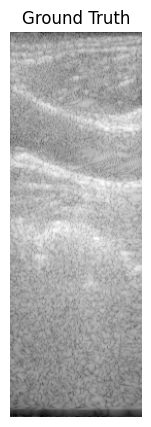

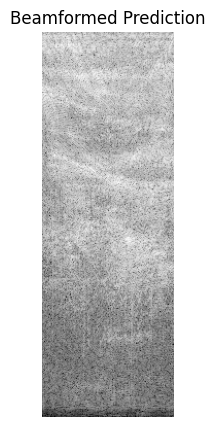

In [ ]:
import torch
import scipy.io
import numpy as np
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM
from torch.nn import MSELoss, L1Loss
import matplotlib.pyplot as plt

ground_truth_path = "/content/drive/MyDrive/ground_truth_image.mat"
test_data_path = "/content/drive/MyDrive/Test_data.mat"
ground_truth = scipy.io.loadmat(ground_truth_path)
test_data = scipy.io.loadmat(test_data_path)
ground_truth_data = ground_truth['groundtruth_image']
test_data_data = test_data['resampled_tof_corrected_data']
ground_truth_tensor = torch.tensor(ground_truth_data, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data_data, dtype=torch.float32).unsqueeze(0)
print("Ground Truth Shape:", ground_truth_tensor.shape)
print("Test Data Shape:", test_data_tensor.shape)
model_path = "/content/drive/MyDrive/best.pt"
model = ViTBeamformer()
# model.load_state_dict(torch.load(model_path))
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()


with torch.no_grad():
    model_output = model(test_data_tensor)
    beamformed = torch.mul(model_output, test_data_tensor)
    beamformed_sum = torch.sum(beamformed, dim=1)
    envelope = torch.abs(beamformed_sum.squeeze(0))
    imPred = 20 * torch.log10(envelope / torch.clamp(torch.max(envelope), min=1e-8))

print("Prediction Shape:", imPred.shape)
mse_loss_fn = MSELoss()
mae_loss_fn = L1Loss()
ssim_metric = SSIM(data_range=1.0)
imPred_normalized = (imPred - imPred.min()) / (imPred.max() - imPred.min())
ground_truth_normalized = (ground_truth_tensor - ground_truth_tensor.min()) / (
    ground_truth_tensor.max() - ground_truth_tensor.min()
)
mse_loss = mse_loss_fn(imPred, ground_truth_tensor).item()
mae_loss = mae_loss_fn(imPred, ground_truth_tensor).item()
ssim_score = ssim_metric(
    imPred_normalized.unsqueeze(0).unsqueeze(0),
    ground_truth_normalized.unsqueeze(0).unsqueeze(0),
).item()
print(f"MSE: {mse_loss:.4f}")
print(f"MAE: {mae_loss:.4f}")
print(f"SSIM: {ssim_score:.4f}")
plt.figure(figsize=(10, 5))
plt.imshow(ground_truth_tensor.cpu().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')
plt.savefig('ground_truth_image.png')
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(imPred.cpu().numpy(), cmap='gray')
plt.title("Beamformed Prediction")
plt.axis('off')
plt.savefig('beamformed_prediction.png')
plt.show()